<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/Pytorch010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

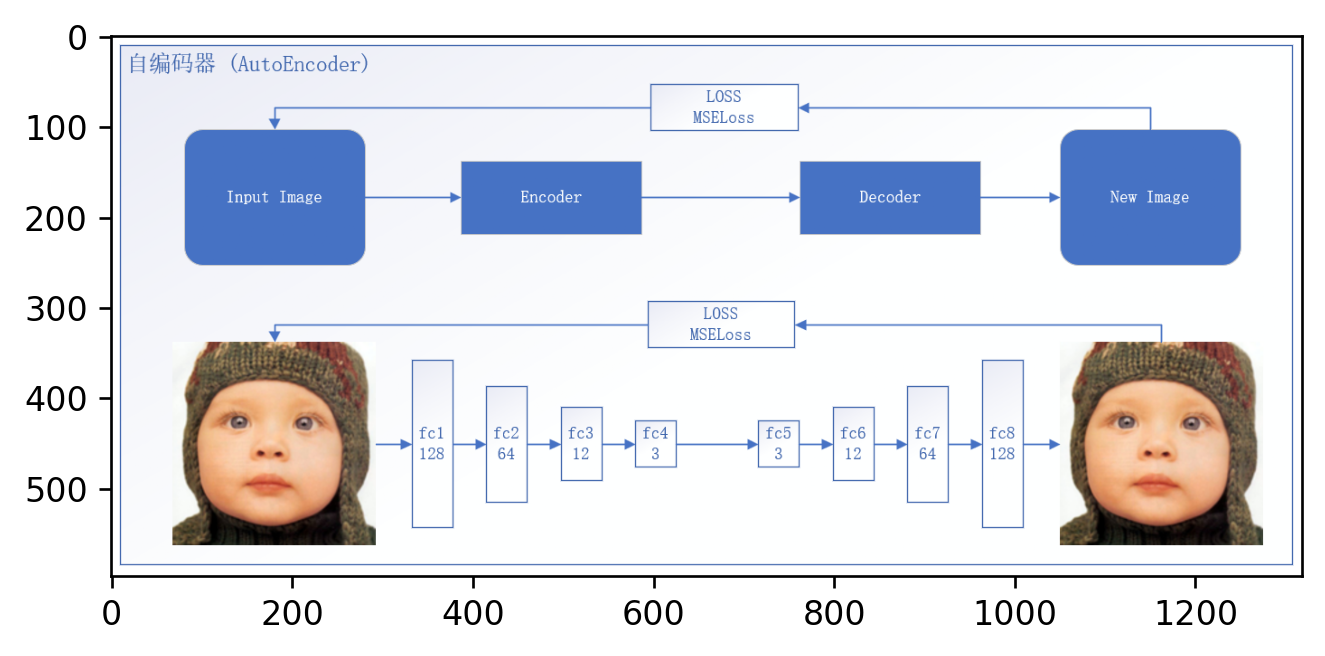

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('ae.png')
plt.figure(dpi=240)
plt.imshow(img)

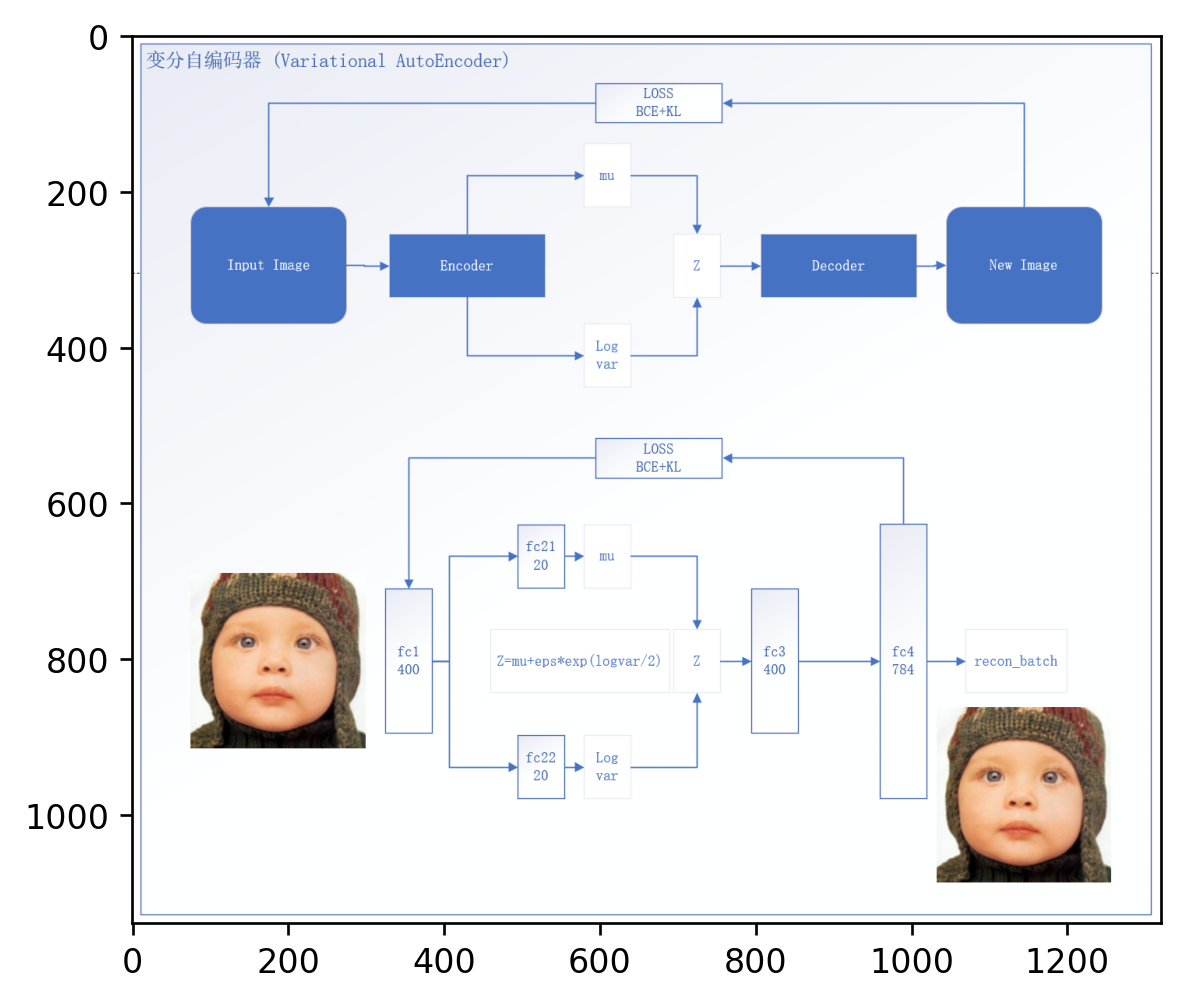

In [2]:
img = mpimg.imread('vae.png')
plt.figure(dpi=240)
plt.imshow(img)

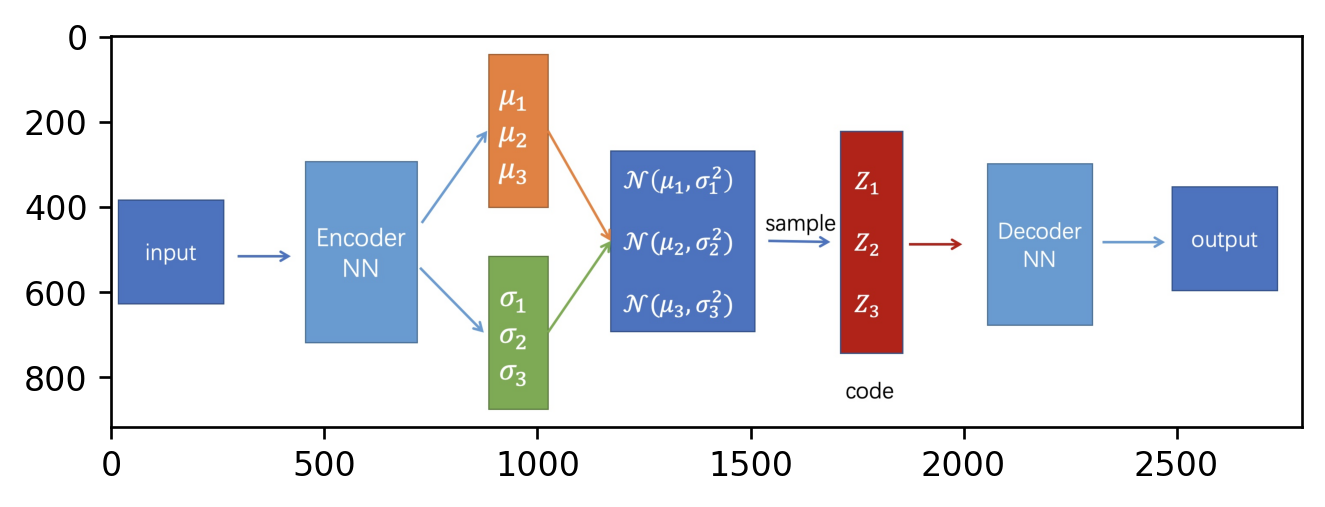

In [3]:
img = mpimg.imread('aepic.jpg')
plt.figure(dpi=240)
plt.imshow(img)

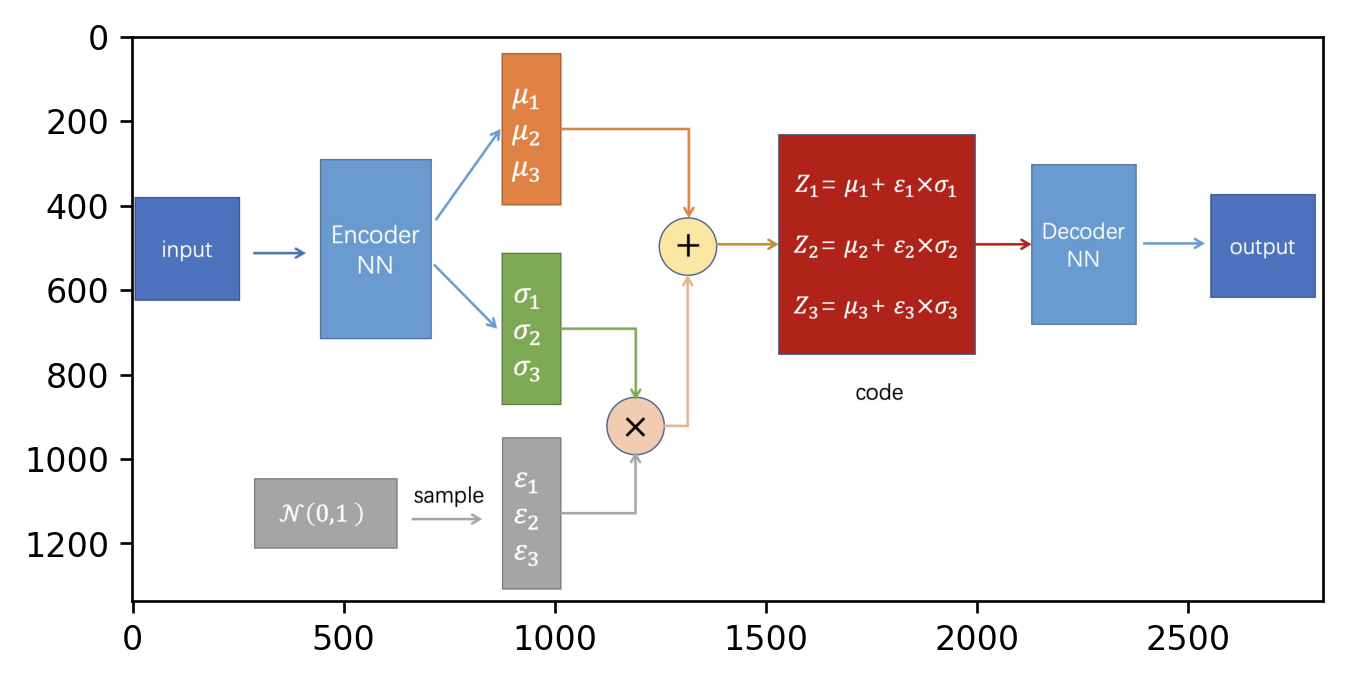

In [4]:
img = mpimg.imread('vaepic.jpg')
plt.figure(dpi=240)
plt.imshow(img)

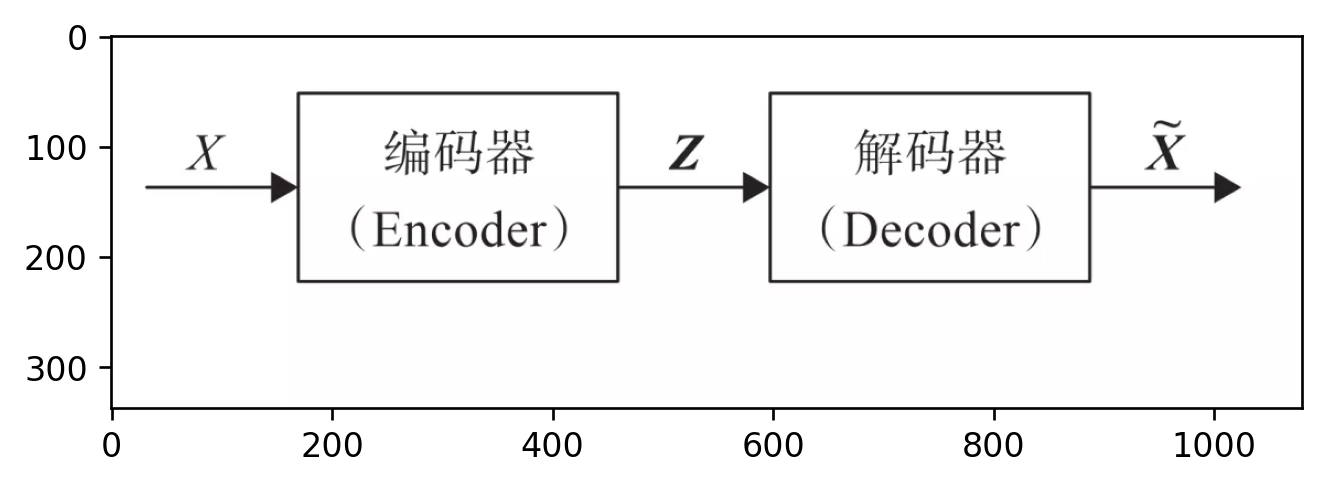

In [5]:
img = mpimg.imread('ae架构.png')
plt.figure(dpi=240)
plt.imshow(img)

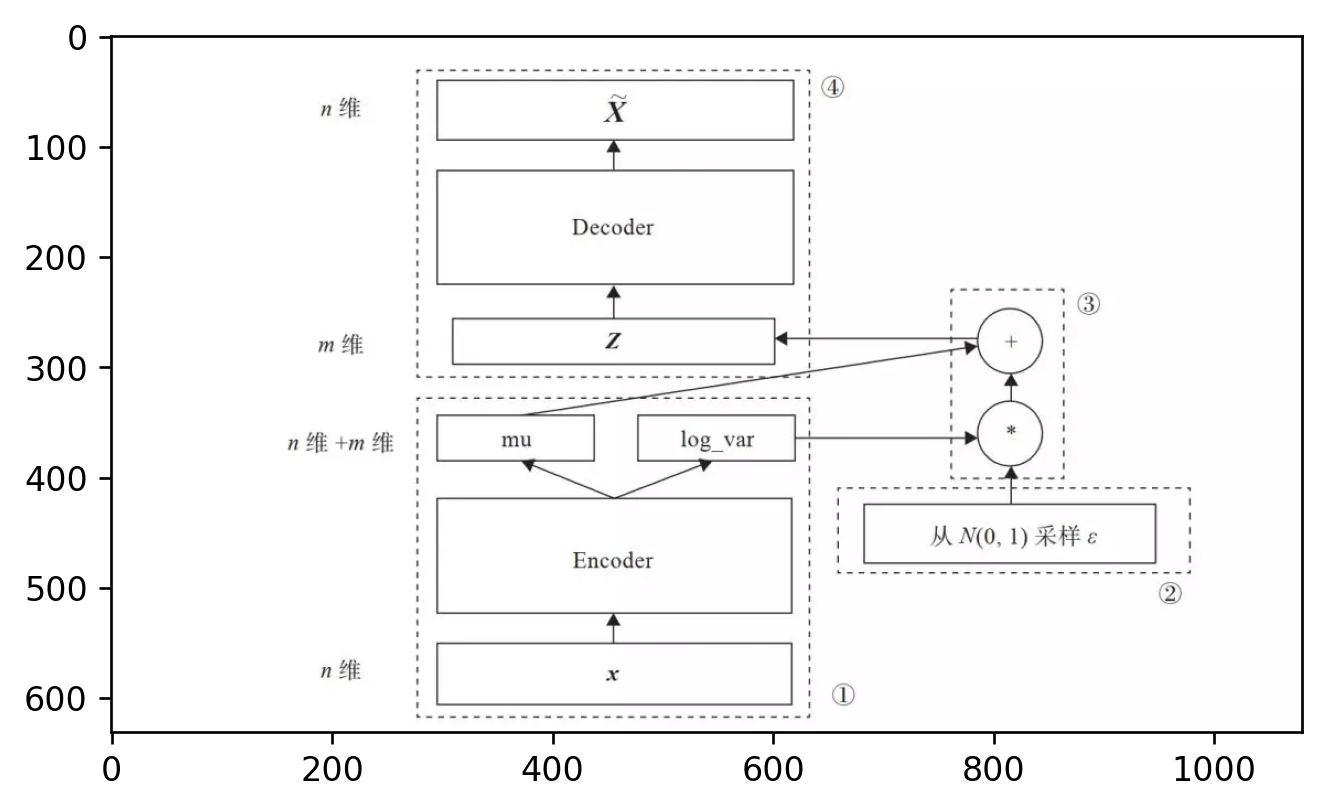

In [6]:
img = mpimg.imread('vae架构.png')
plt.figure(dpi=240)
plt.imshow(img)

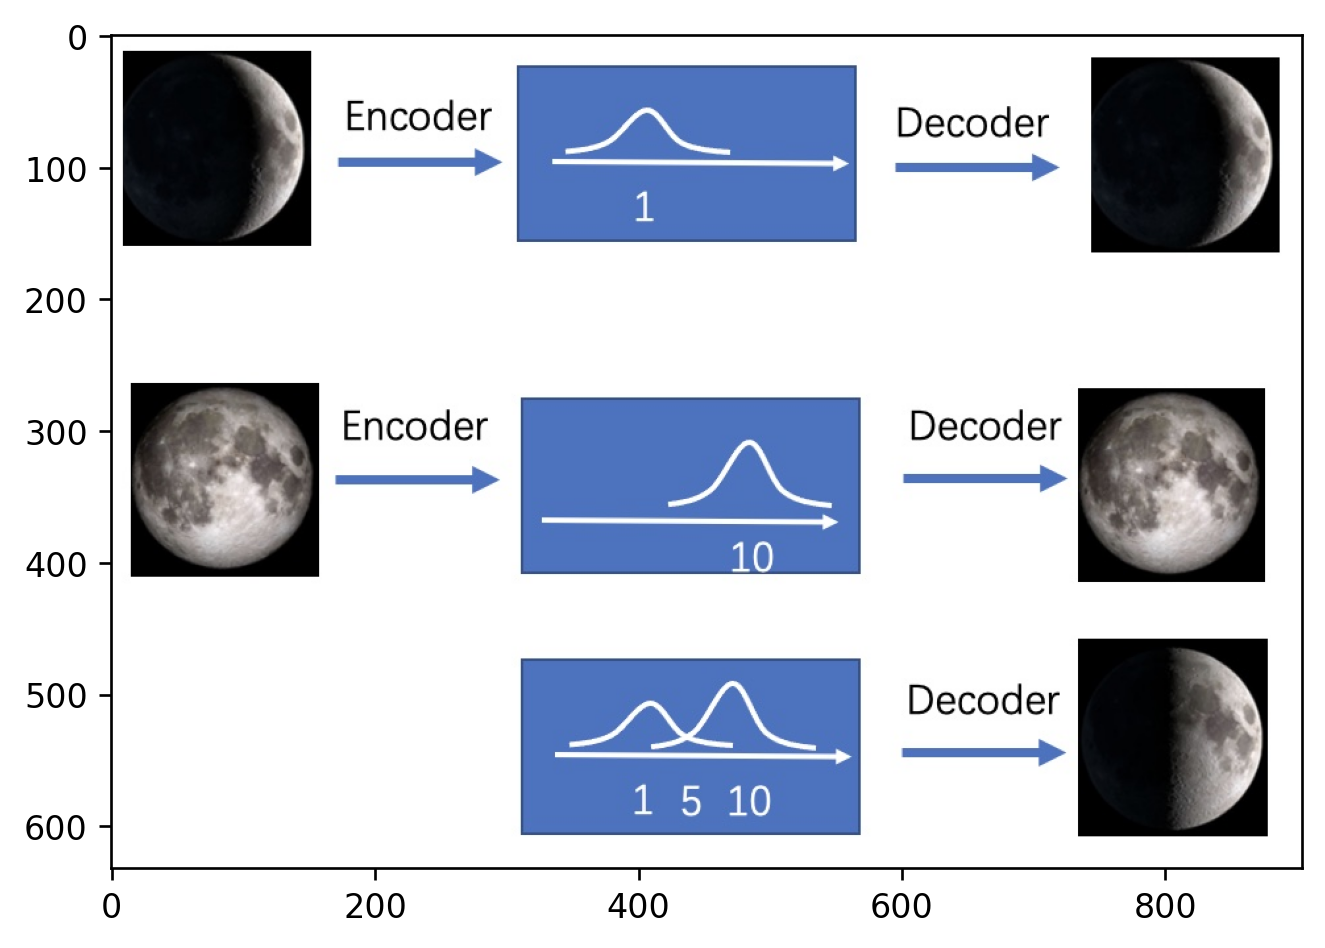

In [7]:
img = mpimg.imread('分布.jpeg')
plt.figure(dpi=240)
plt.imshow(img)

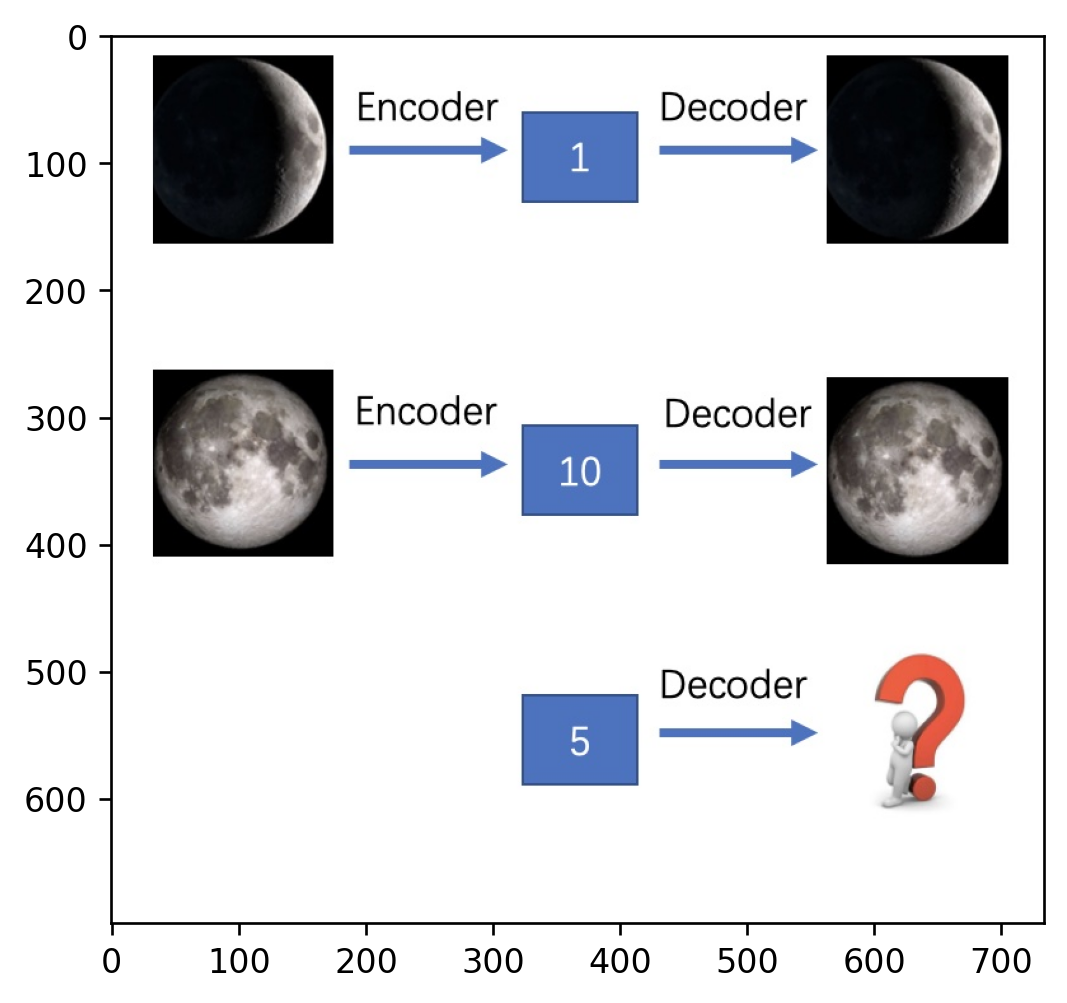

In [8]:
img = mpimg.imread('数值编码.jpeg')
plt.figure(dpi=240)
plt.imshow(img)

AE主要用于数据的压缩与还原

VAE主要用于生成



VAE与AE整体结构类似，不同的地方在于：

AE的encoder产生后直接输入到decoder，AE将图片映射成“数值编码”

VAE的encoder产生与noise作用后输入到decoder，AE将图片映射成“分布”






重参数化技巧

In [9]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os

if not os.path.exists('./vae_img'):
    os.mkdir('./vae_img')


def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if torch.cuda.is_available():
    model.cuda()

reconstruction_function = nn.MSELoss(size_average=False)


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0]
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                #len(dataloader.dataset), 100. * batch_idx / len(dataloader), loss.data[0] / len(img)))
                len(dataloader.dataset), 100. * batch_idx / len(dataloader), loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:
        save = to_img(recon_batch.cpu().data)
        save_image(save, './vae_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './vae.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/60000 (0%)]	Loss: 183.919037
Train Epoch: 0 [12800/60000 (21%)]	Loss: 51.680946
Train Epoch: 0 [25600/60000 (43%)]	Loss: 42.981094
Train Epoch: 0 [38400/60000 (64%)]	Loss: 37.499142
Train Epoch: 0 [51200/60000 (85%)]	Loss: 36.442192
====> Epoch: 0 Average loss: 45.3696
Train Epoch: 1 [0/60000 (0%)]	Loss: 35.964790
Train Epoch: 1 [12800/60000 (21%)]	Loss: 35.735096
Train Epoch: 1 [25600/60000 (43%)]	Loss: 34.059982
Train Epoch: 1 [38400/60000 (64%)]	Loss: 34.324314
Train Epoch: 1 [51200/60000 (85%)]	Loss: 34.809616
====> Epoch: 1 Average loss: 34.8625
Train Epoch: 2 [0/60000 (0%)]	Loss: 33.489616
Train Epoch: 2 [12800/60000 (21%)]	Loss: 34.869419
Train Epoch: 2 [25600/60000 (43%)]	Loss: 34.146862
Train Epoch: 2 [38400/60000 (64%)]	Loss: 31.761209
Train Epoch: 2 [51200/60000 (85%)]	Loss: 32.783646
====> Epoch: 2 Average loss: 33.0257
Train Epoch: 3 [0/60000 (0%)]	Loss: 31.552891
Train Epoch: 3 [12800/60000 (21%)]	Loss: 32.362564
Train Epoch: 3 [25600/60000 (43%)]	Loss: 

In [10]:

#import base64
#
#pic_path = '数值编码.jpeg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQAAkACQAAD/4QB0RXhpZgAATU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAKgAgAEAAAAAQAAAt6gAwAEAAAAAQAAAroAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/iEAhJQ0NfUFJPRklMRQABAQAAD/hhcHBsAhAAAG1udHJSR0IgWFlaIAflAAEAGwASADoADGFjc3BBUFBMAAAAAEFQUEwAAAAAAAAAAAAAAAAAAAAAAAD21gABAAAAANMtYXBwbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEmRlc2MAAAFcAAAAYmRzY20AAAHAAAAEnGNwcnQAAAZcAAAAI3d0cHQAAAaAAAAAFHJYWVoAAAaUAAAAFGdYWVoAAAaoAAAAFGJYWVoAAAa8AAAAFHJUUkMAAAbQAAAIDGFhcmcAAA7cAAAAIHZjZ3QAAA78AAAAMG5kaW4AAA8sAAAAPmNoYWQAAA9sAAAALG1tb2QAAA+YAAAAKHZjZ3AAAA/AAAAAOGJUUkMAAAbQAAAIDGdUUkMAAAbQAAAIDGFhYmcAAA7cAAAAIGFhZ2cAAA7cAAAAIGRlc2MAAAAAAAAACERpc3BsYXkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABtbHVjAAAAAAAAACYAAAAMaHJIUgAAABQAAAHYa29LUgAAAAwAAAHsbmJOTwAAABIAAAH4aWQAAAAAABIAAAIKaHVIVQAAABQAAAIcY3NDWgAAABYAAAIwZGFESwAAABwAAAJGbmxOTAAAABYAAAJiZmlGSQAAABAAAAJ4aXRJVAAAABgAAAKIZXNFUwAAABYAAAKgcm9STwAAABIAAAK2ZnJDQQAAABYAAALIYXIAAAAAABQAAALedWtVQQAAABwAAALyaGVJTAAAABYAAAMOemhUVwAAAAoAAAMkdmlWTgAAAA4AAAMuc2tTSwAAABYAAAM8emhDTgAAAAoAAAMkcnVSVQAAACQAAANSZW5HQgAAABQAAAN2ZnJGUgAAABYAAAOKbXMAAAAAABIAAAOgaGlJTgAAABIAAAOydGhUSAAAAAwAAAPEY2FFUwAAABgAAAPQZW5BVQAAABQAAAN2ZXNYTAAAABIAAAK2ZGVERQAAABAAAAPoZW5VUwAAABIAAAP4cHRCUgAAABgAAAQKcGxQTAAAABIAAAQiZWxHUgAAACIAAAQ0c3ZTRQAAABAAAARWdHJUUgAAABQAAARmcHRQVAAAABYAAAR6amFKUAAAAAwAAASQAEwAQwBEACAAdQAgAGIAbwBqAGnO7LfsACAATABDAEQARgBhAHIAZwBlAC0ATABDAEQATABDAEQAIABXAGEAcgBuAGEAUwB6AO0AbgBlAHMAIABMAEMARABCAGEAcgBlAHYAbgD9ACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAQwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMQAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAHNmMzIAAAAAAAEMcgAABfj///MdAAAHugAA/XL///ud///9pAAAA9kAAMBxbW1vZAAAAAAAAAYQAACgPgAAAADVGGSAAAAAAAAAAAAAAAAAAAAAAHZjZ3AAAAAAAAMAAAACZmYAAwAAAAJmZgADAAAAAmZmAAAAAjMzNAAAAAACMzM0AAAAAAIzMzQA/8AAEQgCugLeAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBgQEBAQEBgcGBgYGBgYHBwcHBwcHBwgICAgICAkJCQkJCwsLCwsLCwsLC//bAEMBAgICAwMDBQMDBQsIBggLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLC//dAAQALv/aAAwDAQACEQMRAD8A/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9D+/iiiigAooooA/wAQb/grF/ylN/aW/wCyq+Mv/TvdV8AV9/8A/BWL/lKb+0t/2VXxl/6d7qvgCgAoorodO0KWfEtzlF9O5ppN7CbsYCI7nagya0o9Ju5OSMCu8gsbSzGIwAPfqarTTquRGcZ7ZrVU+5Dn2OVXSBj5ic0p06OM9M49a1Hnw2TVSSbdk0cqFzs6TQLzwzBIkGu6as0ZYAup2sB3r6P8DfDv4DePn8uZrixeI4ZVPZuh54r5F37xitnw/r9xotyTE5QMQQR1GKzlHsaRl3P0gb/gmnJ40hN18J/EkVyWC+XDeDy2JPUZ4A59a+XvjN+w7+0t8CrWbVfHPhi6/s2Hl762QzW6jsS6ZUZ9zX1B+zf+0nd29xHa3t00TxEIrE4O3/Gv6Fv2XP2hdH1q0TQ7qWOWK4XZcLcASJKnoQetZczvqa8qex/EkevFJX9q/wC0j/wSE/Zb/az0G78YfCySDwD4pb7kkQxY3Ex6CRAPkDdNwHWv5X/2tP2J/wBoT9i/xt/whfxw0ObT/NJNreBd1rcp2aOUZVs+gOapSTJcGtT5IooopkhX3/8A8Enf+Upv7NP/AGVXwb/6d7WvgCvv/wD4JO/8pTf2af8Asqvg3/072tAH+3zRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH+YJ/werf8pTfAP/ZKtK/9O+sV/IFX9fv/AAerf8pTfAP/AGSrSv8A076xX8gVABRRWnYaXPencPlT+8aaTewN2M0Ak4FXYdOu5xlVIHvXdWuj2lqocDLerVLPLEjfLgEe9aRp9zNz7HGro7D/AFhp/wDZaL171sz3BLZzVOSfJ4p8qFzsm0ySwsZg17ZpcoOqtxn8RXuXhHTfgt4mmh0vVrWWyluBt8xCThz0xXz8ZcnHrTre8lsLuO7h4MZBqJR7GkZH6S6H+wv8N/iTaRv4I8RyWV0zYMdwu5Prkc1xXj7/AIJg/tTeEdNOveH9IHiKw5IfTmEz4HrGpLfpXnvwY+Ot94Y1iKwlnbyXYEknp9K/ej9mD9puzS7tpLi7MrnbtJOQp+hrHmaepqkmfys6zo2qeH9Tn0XWraS0u7ZyksMylJEYdQVIBBHvWXX973xK/Ze/ZW/be0ePTPi1o1s2rzwjy9Ys1EV1GcdSwxu9gTX83v7dP/BGf4/fsrafefFH4do3jXwBGzf8TKxUyS2wHa4jXLJj+9jb70+ZXsJwdrn4x0U5lKnDcU2qICiiigD/AF+v+DXH/lBR8DP+5m/9SDU6/f6vwB/4Ncf+UFHwM/7mb/1INTr9/qACiiigD//R/v4ooooAKKKKAP8AEG/4Kxf8pTf2lv8AsqvjL/073VfAaI0jBEGSemK+/P8AgrD/AMpTf2lv+yq+Mv8A073VfHGk6dHp1sL+6x5rj5FPYVUYtsTdtRlnpltpcQnvcSSt91R/D9anW8YTG4YZ9qzpJWkkLtznmpYC0koHQZ710RSWhk9dWXoZJ7uX5gQOtSS2kcADPy1W5LhY1LA4xXLy3LySEsc02yS5K8anJ/KqxaEqCowe+arkksSaQjIxUDSLAjikBwRVFosKeanjG1hmpGVD0pMadjoPCF/9hvd6ylZQQUHY+1frH+zN8SJ4by13SlZUZcrn+E+tfjxua1nSVRypBIr6j+DfxIOk+I7d5lKJKQhIPUL0/KuepE3hI/r7+APxd0+7jjsb+QujLvIPOAmAw+vPTr6V+r/iTwP8D/2p/hpP8E/2g9Eg1bRLyEJE7gF4mI4aNzyrDsfWv5bPgV8W7XTRBdhzsdhznpX79fAf4mpc6RZ39xMJUfYI89c55B9q5mdMNT+TP/grZ/wR1+I3/BPHxPH418FvL4m+GurNmz1WNCWtHbnyLnGdjr6ng9jX4kEFTg9a/wBgnTfh78Mvj78HdV+CfxUsoNY8N+Jomgv4ZAG2F1+WRT2YdQa/zXP+Cvn/AATC8e/8Ezv2mbvwFe79Q8Ha2GvvDuqqp8ue1dj+7Y9pIj8rD6Hoa3hO6s9zGpDlfkfkxX3/AP8ABJ3/AJSm/s0/9lV8G/8Ap3ta+AK+/wD/AIJO/wDKU39mn/sqvg3/ANO9rVmZ/t80UUUAFFfjX+31/wAFnvhp+wb+074X/ZEk+E3xF+KvjbxboLeIbGx8BaVFq0xtElmifMJuI5iyeQ7ttjKquCT1x5z8Iv8Agt34q+K3xX8MfC65/Y5/aK8Mx+JNWstLbWNa8Fta6Zp4vJkiNzdzGc+Vbw7vMmkwdiKTg4oA/dqiiigAooooAKKKKACiiigAor84f+Caf/BQzTf+CjPgP4k+ONM8Ky+E1+HXxB1nwE8Mt4Lw3b6Qlu5ugwii8sSfaAPLwxXb9454/R6gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAor8Avjd/wAHAPw5+Ff7WHxD/Y/+Hf7Pvxi+K/iP4Y3Frb63ceBvD8Ws2sJvIVmiYmK58xFcEhTIibijYzim/DH/AIOR/wDgn94h+JGk/Cb9oTSPHXwD1vWnMNqPiboD6HbNKuMq1wJJooxyPnlZEHG5hkUAfv8A0VVsL+x1Sxh1PTJkuba5RZYpYmDpIjjKsrDIIIOQRwRVqgAooooAKKKKACiiigAor84fjn/wUM034J/8FG/gd/wT2n8Ky6jc/GrT9fv4tcW8ESacNCtJboq1v5TGXzREVBEibc556V+j1ABRRRQAUUUUAf5gn/B6t/ylN8A/9kq0r/076xX8gQr+v3/g9W/5Sm+Af+yVaV/6d9Yr+SbQtJS4zfXfywp69zTSb0Qm7aj9K0VHj+3352xDkL3atSS6WQrHGNqL0FQX9wZpjt+6OAPaqoc5CKK6IxS0MnqaTXk9w4jQHHSrTWI2l5TxipIWEUIU46daxb+9d5SoOVHSqJJpfKA9AKpb4GJypz2NVy7MAD2pPpUATARudpxUEkIV+DkUgXBzVghDjtSaKvbYisHSC6RpXKrnkivun4DeOJtPv4reaYiPdhHz19K+FJI/kL4+leh+CvFk2ktFHsJ8pg+4HnI71jUjdGsJH9Wv7Nfxi+wabaNdTH5VBIzncM4xjrX7u/Aj4kaWmgPatbR3lldP5V3C43K4K85U8EEGv4/v2d/ira3VlaXUbHeq5YEjrX7z/sq/FxdZthFBccR7S6N/dHU/hXLI6YO54B/wVZ/4INeEfin4T1j9qz9he3jg1W1U3WpeFohj7SgBaSS0Xuyj5mTqR0zX8Wep6XqOi382l6tA9tc27tHLFKpV0dTggg8giv8AWm/Zj8Y2l3JBqtpKqywMwgDfxMQeCP8AaHFfzmf8HG3/AARu0u68L3v/AAUQ/Zh0wRmPbL4t0e1TmPccNdIoH3QTmT0HPQVpTn0YqsLao/h9op7ptYr6UytTA/1+v+DXH/lBR8DP+5m/9SDU6/f6vwB/4Ncf+UFHwM/7mb/1INTr9/qACiiigD//0v7+KKKKACiiigD/ABKP+CoVhHP/AMFVP2l7u5H7qH4qeMifc/2vdcV8L3V39slNw2AOw9BX6If8FXoRZ/8ABTj9o2CIbg3xR8Yyv9W1a6NfnFOyFj5YwDXVGNkYt3YjMpGBTomKHcKltYHuDsT8aJkMeTnAFPzFfoQSymRdijAznmqrDBxU3ygZzUXLZJ61LHYbRRS4HBzSBbgPvCgjY52HipChU/KaZgMDmgW7KM7MznFdD4Z8QSaRchSAysRyf4fcVzbZJNQKdrA1jLU2iz9gP2bPEiavGljLcAeZgIrnBz6/Sv6G/wBk/wASXNu2n2OpvuQOojjYZBA759K/kY+C3iaa3a3ulY5gcY554r+mD9lr4iafd+HdMutQkDyptyRwAuP557VyyjqdEWf1Hfs+eJZrWYrdAvHcOuAGwp2nG3P8q67/AIKTfsA+D/8Agpx+xb4j+E+oWyJ4m0dJL/w7dnG6K6ReYweTtfGCPXFfCHwP+KEtnb29lJiVnVWYg4XP+Oa/RL4bftKWPge9tW1GdttxMzPDnmIqxGT9ccVPNZ3NnG6sf5G/xF8CeJ/hf441X4deM7ZrPVNFupbO6hcYKSxMVYfmOK+yv+CTv/KU39mn/sqvg3/072tftZ/wdM/sZaR8MP2ndB/bF+G9msHhn4pWzNdeUuEj1O3+/nHGZEIP4V+Kf/BJ3/lKb+zT/wBlV8G/+ne1rpTvqjjatof7fNFFFMR/JR/wUL/aD+CP7MP/AAc2/s+/F39oXxRp3g7wxZ/CTVoZ9T1WZbe2jknm1JI1Z2wAXYgD1Nfu18F/+CqX/BOL9ov4l6Z8GvgX8avCXivxVrJlFjpWm6jFPdXBgieaTYikltscbucdFUmvxL/bd+Fnwx+Mn/B0T+zz4F+L3hzS/FWhz/CLWJJdP1izivrV3jl1JkZopldCVPKkjIPIr+hfwB+xV+xt8J/F1p8QPhZ8JfBnhrXtP3m11LStBsbO7g81Gjfy5oYUkTcjMjbWGVJB4JoA/Ef/AIKAf8Fhf2zf2bP+Cq+lf8E2f2aPhpo3xC1Tx54AtdV8JQzma2lj1+4vpo5JtQufPEa6bbWNrcTyLHCJmdVAkAY48x+L3/BRP/gs1/wS9+Kfw08W/wDBTjRvhj40+DXxD8R2nhnUdY8AJqNveeH72+/1buLw/vIVVZHx5TGQIV3xsUDd14n02yvv+DtLw7dXcYeSz/Z4eaEnqjnV7iMke+x2H0NWf+DsaKNv+CSd1cEfvIPGnhuSNu6t9oIyD2OCR+NAH3N/wVh/4KV+MP2FdG+H3wf/AGdPCEPxD+OHxn1htC8FeHrifyLUyxhTNeXbhlItrfzI94Dpndy6KrOv5w/F/wDbf/4L7/8ABOvxD4Q+Lv7bngb4dfFj4WeI9atdK1u3+Ftpq8mtaJ9ryfNjjnB8yKMKcEo+98IXjLKx6P8A4KJanaeAv+Djb9hfx54/lFv4e1PR/GOiadPMCIk1e4spolUN0LzNcQRKvXcwr9//ANoT9pn9n/8AZP8AASfFH9pPxfpngnw9JeQ6emoatOtvA11cZ8uMM3VmCsceikngE0Afk1/wUG/4Kl/tB+Av2tfDH/BNT/gmv4H0n4h/HPxFpg1/UrjxBcSQ6B4a0jeFFxf+QyTOWHIjR0YBkIDtIiN8mftAft3/APBdH/glt4Ttv2lv2+fB/wAMfix8G7S6hj8T3Pw5Oo2WtaJFdSLEswS/IimhSR1UAIWY4DvEDvB+yfq+m/D3/g6X/ag8M/EeUQat8Qvh/wCGtS8JPcAx/atOsbWziuo4MjD4ljckKcnyXOPlbH6W/wDBc74g/D74bf8ABIb9oXWfiTPFBZX3grVNJtvObG/UNTiNrZqvqxuZY8AfXoCaANT/AIKC/wDBVb4JfsO/sK6f+2vokDePIPGI02DwRpenSbJPEF5rKebZpC5ViqPFmZmCMwjU4VmKqfz8k+MX/Bzp8PPhtJ+0z4+8AfBfxHYW1quo33w30efVIPEMdqgDyQ292zy2jXoTIYb5YyR+7DsQp/Kf9rPRPEfwI/4J0/8ABKL4h/HoyWXhnwT448C3PiRrxGRLGKWGG4gNwCPk+zwRyKysB90gjPFf3JazrWkeHdGu/EWvXUVnYWMMlzc3EzhIooYlLO7scBVVQSSeABmgD+Vv/g1Y+NXg7xT+wL+0J+0XqTnRvD+o/Gnxb4jle8IBtLObT9MumMpUkAxxn58Ejg4rrvgX+3j/AMFv/wDgqPouo/tMf8E6/DPwy+GvwVF/c2vhe5+I41G51bxFHZyNE9wUscpBA0iMpG0MjAqryYLV8G/8EVbT/heP/BAv9uyz+CsUhXxb4s+Jw0OGBGLst94fs/s8aLjdlg6qABnnpmu9/wCCJf7Ev7X37Rf/AATD+FXxJ+AH7a3ivwb4efT57QeHdM0LS7mDSbi2uJY5rYPMplJVwWy/LBg3QigD9rP+CVH/AAUx+J37YniX4l/ssftd+DLT4dfHv4LX0Fn4o0awmabT7u3vFL299Yl2Z/IlUZ2l5NqtG28iQAfj/wDsmf8ABXj/AILWf8FQJPFHwj/Yk8E/Dfw/r/w81zUrPxV4u8TR6hDocMa3DxafZ2sEc1zPJdvHE8s8mHjClRtjJG79Gv8AgnR/wTw8J/s1/wDBRf4r/tBeLv2mZ/jd8XNT8OWOh+K9JvoLC1v7KE/Z5bKe5gtH3x/uIVSItGoZGzkkV4R/waw6RYWP7H/xv1K2jCz33xv8WPM/dikVkijPoAOB6k+tAH9Jvg9PFUfhLS4/Hb20muLaQDUWstwtmuwg84xb8N5ZfOzcM7cZ5roqKKACivxi/wCChX/BW7Vv2GPj7pnwK0b4af8ACay6j4fh143f9sjTvLWa5uLfy/La1mBwYA27eM7sbeMn4g/4iKPHf/RAv/Lqj/8AlfXv4XhfNMTSjXoUG4vZ3X+Z51bNsJSm6dSpZryf+R/T5RX8wf8AxEUeO/8AogX/AJdUf/yvo/4iKPHf/RAv/Lqj/wDlfXR/qbnP/QO/vj/8kZf25gf+fq+5/wCR/T5RX8wf/ERR47/6IF/5dUf/AMr6P+Iijx3/ANEC/wDLqj/+V9H+puc/9A7++P8A8kH9uYH/AJ+r7n/kf0+UV/MH/wARFHjv/ogX/l1R/wDyvo/4iKPHf/RAv/Lqj/8AlfR/qbnP/QO/vj/8kH9uYH/n6vuf+R/T5RX8wf8AxEUeO/8AogX/AJdUf/yvo/4iKPHf/RAv/Lqj/wDlfR/qbnP/AEDv74//ACQf25gf+fq+5/5H9PlFfzB/8RFHjv8A6IF/5dUf/wAr69A+EH/BfjxL8TPjR4K+Eus/BX+xovGPiDTdBF9/wka3H2dtQnSHzPKWxUvsDFtu5d2MbhnNRU4RzenFznh2ktXrH/MqOdYKTUY1NX5P/I/o8ooor5s9Q/mL/wCCUn/Kef8A4KH/APX34J/9I7iv3d/a6/ZG+A/7cHwF1/8AZ0/aJ0G213w/r1rLB++iR5rOZ0ZUubZ3VjFcQlt0Ui8qw9Mg/hF/wSk/5Tz/APBQ/wD6+/BP/pHcV+6f7ZH7YPwM/YU/Z58RftJ/tB6zb6RoWgWssyJLKkc99cqjNFaWysR5lxMV2xoOSTk4AJAB+D//AAbyftb6p8Mv+CXnxS8H/tXeI2ntP2UfFPiTwreajOpMkWg6BClwhYAszCJTNFGoyQkaoM4FQfAj9sj/AIOBf+Ci3w6X9sD9jbwl8J/hl8LdWeafwno/j86lda3rNlE7Ik9w9kfLhSbaTHgRnuC0ZWRvzp/ZK/Zk+Otx/wAGyP7Vfx88aabcaf4r/aCl8S/EqOzKM040uRYpF4xuYTRwTTI2BuilVgMHn7C/4JcfsI/to/Hv/gnT8Ffin8D/ANubxfoXhnUPCGlRWukafoGkzW2lvawLbzWKSOhdxaTRvAWcliY8tzmgD9U/+CX3/BVF/wBsz4SfEq3/AGnPDsHwt+KXwH1KbR/iLojz+baWL26O4vYZCT/okwhmKEs+PKbDuu2Rvzx+C/7ev/Bc3/gqD4P1X9qP/gnF4V+F/wAPPg39vurbwo/xDOoz6z4iispGhknIsyYoIXkR1ClUZXBXe4BesDw5/wAE59J/Z9+CH7fnjPwF+0RP8dPi74++Huo6R4rtmgsor6x1W20m7+xieCycmOaSOXYgaNSeSMsDX6Rf8G+PjHwZ42/4I0/ALUPA80ctvZeHBp9wIznZe2U0sNyrDqG85HJB9c9CDQB8v/Bz/gu9rXgX/gmz8Sv2vP8Agod8NL74c+PPhDrc3hfVvDsMcsEGs6tuEduNMe43bo5pCyN88vlCJ3LMgBPP+B/il/wdAfHD4fW37RHhXwn8DvANlqVub/TPAviJtXn1g2sgLxR3lzC4hS5ZNuAGiUMcSrEQyj5r/wCDkn9pP4D/AB6/Yj8LeNfg/wCKrDxl4d+C/wAc/DY+IcGlP9qGnx2ovIJYrnYDtxM6JgjDMwxk4B/rS0HXdF8U6HZeJvDd3Ff6dqMEd1a3MDiSKaGZQ6SIwyGVlIKkHBBzQB+Vn/BKH/gp/F/wUO+HPjXRvil4Vb4b/Fr4R6w/h7x54WmnE4sL2PcBPFJ3t5milCEkkNE43OoWR/zt+GX/AAUg/wCCtX/BUnxz4x8X/wDBJ3w78OfCfwS8H6xPodl4w+Ihv7m48SXdkf3sllBYn93asCnLpna2RJ5m+KPxb9he31P47f8ABVf/AIKc/EL9n2ZpNCvdN0fwva3FspaGfxDaaZPay+W+MO8NzFLuC5wZB2YE/Yv/AAav+MPBviL/AIIn/C/w54ZkQah4XvvEGl61brxJb6gdUurkpKDyHaCeGTB6K4FAH5O6L+0v+2D8Xf8Ag5b/AGUPgn+3l4C0rwV8SvhzpfjVJ7nw5cyXOg63p2paLfPa31gZyZ0jYxSxtHKSysnOG3In7Sft7f8ABSz9qvT/ANs/RP8AgmF/wTE8H6F4r+MN5o3/AAkniLWvFcsyeH/DOkswRJLlbYiaSWQspCocqHjwkhfC/FP7Z/j3wFr3/B1x+x34D0OeKfX9A8G+Kn1QRnc0Ud5pWqtbRvjo2Edwp52uDjDAn5R1r9nT46/FP/g5y/aT8A/Db47az8Ctf8T+DPDmt6RdaZp1reS6xptrZWNtNCgvAV2wzRsf3fLbGJ+62AD9Bh/wUd/4Kh/8E8P2k/hn8KP+CuOgeAdd+Gvxa1eLw3pPj7wAb22TS9auSfJg1GG9ONkmOGRYwqBn3tsdB0v/AAVf/wCCwf7Un7B/7d3wy/ZH+AXw/wBL+IM3xU8M3TaJpsiyx39x4kkuTbWaG4E6QRWaZEtwXj3bFbEidR4N+2l/wRy+InxK8GeFPCn7e/7e2uz+G38U6dLolv4g0rR9Ohn16MSG0jhkDQlp2UyBEDEtzgGvQP21tIsNV/4Oef2NZL+MSGz8EeMLiIHkCQWd8oOPbcSPQ80Afrh/wT+sf+CmVr4J126/4KZ3vgG51+6vIpdHh8BLeC3trQx/vIrg3iqTIsn3ShcY/iNff9FFAH+Yl/wejWT3/wDwVX+H1unf4V6Vn2H9r6xX8mt9PENthbALHCMfU1/Xr/weZwrF/wAFN/A98n+sk+F2lRD6DVtXJ/nX8ft0ybgAu1h1ropxsrmUnqQF0zkc/SmLwwNEALnao5NX5raSH5W6jrV+ZO2hWkuD0AOSMGqLDAqc4Jzmojy23tUsdtNCOilIxQACDzikGzE7ZpzgYVhwRTgmUzSHJOG5oE2Vp3bbjrTLK9k0+6W4Tkg8jsR6Uk/DkVTb73NZSZrE+5fgD43Mmqw5lEI3DI6IB6V++X7MGsXmmXyXVnNtt5QGZl+YAehx6mv5d/hnq0lpqn2VWxv5r94/2H/iFGsb6VqMv7lQBt6nPOPqM/lXNOOp0Qdz+sr9njxBIbfSryx+5DiVgpwzds49QTmv2W+HM3h7xvoq+D/E1hHfaXrEUltewSkOs8MwKuHB7EHmv5vvgB8SIdPt4rq1YbIgoCA5O7uAfTpX6n+A/jQNGWHVp5Tai3jaQMDkPyMoB6mszdarU/gN/wCC7P8AwTP1L/gm7+2Vqnhzw7A58EeKGfUdBuMZUQyHJiJ6bkJxivxHr/T4/wCC1/wD8M/8FJf+CbWv6n4UtBP40+HELa1p7EZlZIuZogeuCoP41/mEuu1sfzrohJSV0cko2dj/AF+P+DXH/lBR8DP+5m/9SDU6/f6vwB/4Ncf+UFHwM/7mb/1INTr9/qokKKKKAP/T/v4ooooAKKKKAP8AFD/4KzXMi/8ABUP9o5E6f8LQ8XZ/8GtzX52yMHJ2DA9K/Qv/AIKyK6f8FQf2j3J4/wCFoeMP/TtdV+eOK6mzFLU0rC+lswTCBk8EnnrTJm835h0bqKooWORWjAqujIw4xx9arclrUorGC3tSOgySvFW7RAsux+a05LRWkwFwp6UKI+Y5sqT9e9Rlcjmt2azFu2SOtZU4IY47VLQ9yKMOOX6VNO4bCgcYquZ2JANQyOQealiSIChJzVVxtPPrVvcDkc1E5IXDDNZSNInsPwrv5bedraEZLcj2r9pP2fviLHZ6FBo9nJkEDdk4OR1PtX4Z+DdVuYryO0VhsLZHYj8a/RH4W6nPp0UEluxEuMtjkGsJxub0z+sX9i34naX4/sRYauBEsO2NHJySy+vQ19ifHiyv/BHiOC8tJT9l1KFXXnJJJ7egr+en9kb4va34L8RIbe3a6gumVTGp53Driv6Ybfw7aftGfCmy1OycR6hYxhI1c/MrKBgHnoRWD00Z1rQ+T/8AgoL8F7j9sf8A4IufETSr+FrvWfhreW/iHS5m+ZxHGTHOgOMgeW5Y/Sv4gf8Agk+pX/gqf+zUrdR8VfBo/wDKva1/p8/syfB+00P4DeLPhN8R2B/4TCxurIwggpieF0AIIycnmv8ANZ/YL8F3Hw+/4LY/BLwLcLtfSvjT4YtyMYwI9btwP0rWg7qxz11aVz/alooorYwPxi/b8/4IzeDv26f2p/Cv7YenfF7x58J/GvhDQH8O2V74JvYbCX7LJLNK5MrRPKC/nsjBXClcDHWvFvD/APwQ0+L+ha/Y63N+29+0JfJZ3EU7W1x4oDQzCNgxR18nlWxhh3Br+gaigD4Nu/8Agn/8NLz/AIKRWv8AwUxk1nUx4stPAx8BrpYMX9nGyN2135xHl+b5u9yv+s27e2aT/go9/wAE/wD4af8ABS79mmb9mH4s6zqeg6RPqlhqputIMQuRLYSeYi/vo5E2seG+XPoRX3nRQB8Hf8FCv+Cc37OX/BS34KwfBn9oSC+tjpV6mq6Jrej3H2TVdH1CIEJcWs211DAEgq6OjcEruVWX8z/DH/BvZ4Q8W/F7wp8Sv23P2gPiZ+0DpXgS+i1LQvDfi7UVfSY7u3P7qW4hVT57qPvNlDJ0fchKn+iGigD8yv8AgoT/AMEpP2bv+Cil14Y8b+Pb7XPBXxD8Cy+d4a8beEb3+ztd0wlt5SOba6tGW52uhKkkoyFmJ+ItE/4N9PAPxF8f+HvGf7fnx0+JH7Rmm+E7v7bpXhvxbqCLoSzrwks9rCgM7qOpMiq/IdWUlT/QlRQB84/tYfsm/Af9tn4A69+zN+0doaa74R8RRJHcW29opI3iYPFLDIhDRyxOqsjKeCMHKkg/ivon/Bu/pdz4Ug+BPxb/AGovjN40+DlpHBbJ4HvdcjhtLizgI22d3PDCsktrtVV8qPydqj5SuBj+jaigD89P+Cc3/BNz4Kf8Eyvh743+FvwEvL6bQvGvjHUPGH2S7EKxafLfxwQ/ZbZYY4wtvEluixhtzAdWNfnf4s/4N7/A3gz4keKvHv7Bnx3+I/7Odj44uzfa14e8I6gv9ivcv9+W3t5FDQSNk4KyEIPljCoAo/obooA/OT/gnf8A8EwP2dv+CbvhjxDF8K7nWPFHi7xtdrqHinxh4nu/7Q1zWbldxVri4KqNqF3KoqjlizFnLMen/wCCev8AwT9+Gf8AwTm+Fnin4T/C3WdT1yy8V+LNT8X3E2qmIyx3WqCISRJ5Mca+WvlDbkFuTkmvvSigAooooA/j0/4Lv/8AKQ7w5/2Tqz/9Od9X5JV+tv8AwXf/AOUh3hz/ALJ1Z/8Apzvq/JKv6K4P/wCRRQ9D8xzz/fanqFFFFfTHkhRRRQAUUUUAFFFFABXp/wCzv/yd38EP+yi+Gv8A0tjrzCvT/wBnf/k7v4If9lF8Nf8ApbHXn5t/uVb/AAv8jqwX8en6o/0KaKKK/l8/Wj+fn40/8ECPD3xH/a3+I37Yfwp/aK+K/wAJdf8AihcWlxrdr4L1aLTLaU2UKwxK2yHe6oAzL5jNtLtjGax/h1/wbW/sXJ8T9M+MP7W/jn4jftG6xo8ouLOD4leIG1XT4pgQd32dY4jICQN0czyROBhkI4r+h6igDN/sfSP7I/4R/wCyw/YPJ+z/AGbYvk+Tt27NmNuzbxtxjHFfztT/APBu14Z+FWta/a/sH/tF/FP4A+D/ABPePfXvhTwzqgbSoJZQA5sg4EtuzYHzeY7AAKDtCgf0b0UAfBH/AAT6/wCCcH7N3/BNr4U6j8M/gLDf3954hvn1TxD4h1y4+26zrV++cz3lxtUORk7VVVRcsQu53ZvzI8Qf8G7/AIO8EeK/FF3+w7+0H8T/ANn3wr40vX1DVfCvhLUwmkpcSgCR7NWAktmfHUO20YVcIFVf6LqKAPzN/Zg/4JHfsSfss/sU6z+wT4c8OP4j8C+Kzcy+JTrsv2m81u5uwqy3F1Mgj/e7UQI0Qj8vYpTaw3V+eOkf8G8eo/D7wy/wX+Bv7W3xr8FfCl1mij8J2OswslpbTEk29pctDvhhAZht2MSD8xJyT/SBRQB8ifsQ/sM/s3f8E8vgLY/s6fsvaIdG0C1le7uJJpDPd317KqrLdXUzcyTSBFBOAqgBUVUVVH5j/E7/AIIIfD6L4++K/wBoj9ir40/EH9nbUvH919t8T6Z4Nvo10jULpmZ5Lj7LKjeXM5dzuDFEJJRFyQf3zooA/CX9n7/g37/ZL/Zy/av+HP7anhbxX4w134jeBrrXL/U9d8Q38epah4lutdtGsnk1K4eFWIt4mIgSHylXJJDFmJ+j/wDgoX/wSU/Z5/4KF+JvCfxc8Raz4h+HnxP8BMf+Ed8b+D73+z9ZsoyWYwlyro8JZi20ruUltjKHcN+pdFAH4KfBH/gg14D0b9oPw1+0z+2h8Z/H37RniLwNcfbPDNn4zvlfR9LuwQVuYrJBtM6lVIbds3KGKFlUr97/ABQ/4J+/DP4qft/fDH/goZrOs6nb+J/hbo2qaLp+mwmL7BcQ6rHLHI8waMy7lErFdrqMgZBr70ooAKKKKAP8zT/g8+neL/gpp4C8vr/wq/TP/Ttq1fx/yyB8ZGD3PrX9ff8AwefxyN/wU58BsvQfC7S//Ttq9fyAN8zFq6U/dRi17zJrSVreXzVGSOmavXN1JeMZJMF+9ZAJDcelXrcYkHfPWqTuhSKrICwx3pzxqB8vappogk/HCnpWs1ujRB0UcDmnyhc5wrnj8qYVIOK35tPCKJR0rMnUDGO9S4j3KSowOUPFWy6rFgDmqfmsg29qSR8qDUisQSqWckVVkQg8+lTlxnOabk53djWTVzRGx4VuTa6vFcL2Nfqh+zX4zTw9qBu5X2TMBtHYLx/k1+UWlX81jdiaDaCOCCM8GvtX4SXjlEuZjxgbcHvWM43RtDex/Sl+yz8Z2tPFNtoU6BxeurkluAo64z+dfunr3h+2v/hHL4j8LzbjZMJeTwAxGc+9fyBfBzxprWm6zY6jasTPayK47AqOo/Kv6lv2LvivD8VPCkvg3Xrc2n9oRYxIcrJgdunWsLW3OuKsj3b9irx7dXXxvs/DerA3ml64j2V7bt9x45QVbI+hr/PN/wCCnn7Ms37IP7d/xM+AYQpa6Jrl2lmSMbrV5C0LD2KEGv8AR7/Z7/Z41vwD8cLbxPJKBpOnyeYjg4YqT05BGa/lN/4O3Phjo2k/tyeGPjb4cUG28Z+H4JJpMYLz237okkdThRTovVoyrrRM/s8/4Ncf+UFHwM/7mb/1INTr9/q/AP8A4NdFKf8ABCn4GA/9TN+viDUq/fyuk5gooooA/9T+/iiiigAooooA/wAVj/grba5/4KYftFzbeP8AhZ/i/P8A4NbmvzXbAIC81+n3/BWpn/4eSftFLjOfih4u/wDTrc1+Yco2t9TXYznjuMHUGujs1g8vBPNc4crzVpLny/m5z0pRZUkWiCsxaLnmtFbl49rsMkflWErbl2k47+9W1uNoCnkHmqIJ9U1I3IUlQNgxxWDPNmPd3q5corpvTv1HpWeV3LsIqJMuOwlugcjPerLwiTCgVEYGjG4fpVqAO3LHipsDM8RYbpxVa4rcZkAJTk981mSpntUyQ0y7oEcf2tQD1OPpX6FfCVpZY440yWXABPpXwX4R0W81LVEisxuIyxA9hX6bfs1+H49V12zsro7YgQZCB6Vzz0OiB+h/wFW60fWLW4snHnnGFx90nqRX7lfCD49WPwX8QWE6O81tcFftsbE8Enkivy98B+A9Fsy/ia2iaOVAWjjXkH0wO1e2eFhfaisInPmmUnJbkjNczs3qdh/Wd8KPH3gD4pXGkX+izx3IjmSSPZwS2xjtOMf/AK6/zp/h1pC6V/wch+AbFRgJ8cvDbYx0zrFsa/uX/wCCcfhGKG5ttPuGJW2aO4jwPmV2O05P0NfxOafLaH/g5p8Fi1wIx8cPDajHqNWtqvDu8mZYlaI/11a8v8ffHD4LfCm8t9P+KPi/RPDVxdoZIItV1CCzeVFOCyLM6FgDwSMjNeoV+Dn/AAV2/Yw/aV/ag+I3hDXvgZ4b/ty00vTZ7e6k+2Wtt5cjy7gMXE0RORzkAiveyTBYfF4uNDFVVTg73k2lay0301PJx9epRoupRhzS001/Q/VT/hsb9kT/AKKp4P8A/B5Zf/HqP+Gxv2RP+iqeD/8AweWX/wAer+TT/h0h/wAFCP8Aon//AJVdN/8Akuj/AIdIf8FCP+if/wDlV03/AOS6+3/1RyL/AKGUf/Aof5ngf21mH/QK/ul/kf1l/wDDY37In/RVPB//AIPLL/49R/w2N+yJ/wBFU8H/APg8sv8A49X8mn/DpD/goR/0T/8A8qum/wDyXR/w6Q/4KEf9E/8A/Krpv/yXR/qjkX/Qyj/4FD/MP7azD/oFf3S/yP6y/wDhsb9kT/oqng//AMHll/8AHqP+Gxv2RP8Aoqng/wD8Hll/8er+TT/h0h/wUI/6J/8A+VXTf/kuj/h0h/wUI/6J/wD+VXTf/kuj/VHIv+hlH/wKH+Yf21mH/QK/ul/kf1l/8Njfsif9FU8H/wDg8sv/AI9R/wANjfsif9FU8H/+Dyy/+PV/Jp/w6Q/4KEf9E/8A/Krpv/yXR/w6Q/4KEf8ARP8A/wAqum//ACXR/qjkX/Qyj/4FD/MP7azD/oFf3S/yP6y/+Gxv2RP+iqeD/wDweWX/AMeo/wCGxv2RP+iqeD//AAeWX/x6v5NP+HSH/BQj/on/AP5VdN/+S6P+HSH/AAUI/wCif/8AlV03/wCS6P8AVHIv+hlH/wACh/mH9tZh/wBAr+6X+R/WX/w2N+yJ/wBFU8H/APg8sv8A49R/w2N+yJ/0VTwf/wCDyy/+PV/Jp/w6Q/4KEf8ARP8A/wAqum//ACXR/wAOkP8AgoR/0T//AMqum/8AyXR/qjkX/Qyj/wCBQ/zD+2sw/wCgV/dL/I+2v+Cn/wC2tr3gr9qfwt8RP2SviHb3CQeH44bqXRb2K+tHkW5nby50RpIXIBB2yAkAgjsa9+/Zc/4Lj+DfEX2bwr+1RpP9hXZwn9taYjS2bHpulg+aWP3KGQE/wqK/n8+PX7Nnxq/Zj8S2fg/44aL/AGJqN/bC8gh+0wXO+Auybt1vJKo+ZGGCQeOmK8v8JeD/ABZ498QW3hTwRpl1q+p3jbILSziaeaQ+iogJP5V9kuFcpxGX06U7SjFaVE0nbvdaNet0eE84xlPEynG6besXe33f8Mz/AEKPA/j7wT8TPDdv4w+HurWmt6VdDMV1ZTLNE3qNykgEdweQeCK62v51f+CeP/BMX9rH4UeJLb4p+OPGl38O4JCjy6PpciXFzdIOQtyrB7VR6BlmYeinmv6KhX4vnWBw2ExDpYWuqse6W3lfZ+qdvQ+7wGIq1qSnWp8j/r5r5n8en/Bd/wD5SHeHP+ydWf8A6c76vySr9bf+C7//ACkO8Of9k6s//TnfV+SVfufB/wDyKKHofn2ef77U9Qooor6Y8kK94/Z9/Zp+Mn7T/jVPA3we0iTUJxtNzcN8lraRn+OeU/Ki9cDlmxhQTxXg9e6+E/2lPjR4D+D2qfArwVrculeHdcuzeahFa4jluGMaxlHlHz+WVUZQEK38WRXNi/rHs2sNbn7yvZd3Zb27XV+6NaPs+a9W9vLf/gep2H7Xv7Kni39jv4qQ/CjxnqVpqt5Np8OoCayDiMJMzoF+dVOQYz2xgivlqv1r/wCCyv8Ayc54c/7E3Sv/AEOevyUrkyTE1MRgaNes7ykrvpqb4+lGliJ04LRPQKKKK9Q4wr0/9nf/AJO7+CH/AGUXw1/6Wx15hXp/7O//ACd38EP+yi+Gv/S2OvPzb/cq3+F/kdWC/j0/VH+hTVa8vLPTrOXUNQlSC3gRpJZZGCoiKMszMcAAAZJPAFWa4n4l6RqPiD4c+INB0iPzru+027t4I8hd0ksTKoyxAGSQMkgetfzDBJySb0P1mTsm0eTf8Njfsif9FU8H/wDg8sv/AI9R/wANjfsif9FU8H/+Dyy/+PV/Jp/w6Q/4KEf9E/8A/Krpv/yXR/w6Q/4KEf8ARP8A/wAqum//ACXX6X/qjkX/AEMo/wDgUP8AM+V/trMP+gV/dL/I/rL/AOGxv2RP+iqeD/8AweWX/wAeo/4bG/ZE/wCiqeD/APweWX/x6v5NP+HSH/BQj/on/wD5VdN/+S6P+HSH/BQj/on/AP5VdN/+S6P9Uci/6GUf/Aof5h/bWYf9Ar+6X+R/WX/w2N+yJ/0VTwf/AODyy/8Aj1H/AA2N+yJ/0VTwf/4PLL/49X8mn/DpD/goR/0T/wD8qum//JdH/DpD/goR/wBE/wD/ACq6b/8AJdH+qORf9DKP/gUP8w/trMP+gV/dL/I/rL/4bG/ZE/6Kp4P/APB5Zf8Ax6j/AIbG/ZE/6Kp4P/8AB5Zf/Hq/k0/4dIf8FCP+if8A/lV03/5Lo/4dIf8ABQj/AKJ//wCVXTf/AJLo/wBUci/6GUf/AAKH+Yf21mH/AECv7pf5H9Zf/DY37In/AEVTwf8A+Dyy/wDj1H/DY37In/RVPB//AIPLL/49X8mn/DpD/goR/wBE/wD/ACq6b/8AJdH/AA6Q/wCChH/RP/8Ayq6b/wDJdH+qORf9DKP/AIFD/MP7azD/AKBX90v8j+sv/hsb9kT/AKKp4P8A/B5Zf/HqP+Gxv2RP+iqeD/8AweWX/wAer+TT/h0h/wAFCP8Aon//AJVdN/8Akuj/AIdIf8FCP+if/wDlV03/AOS6P9Uci/6GUf8AwKH+Yf21mH/QK/ul/kf00/tEftbfst6t+z/450rQPib4Vub+58PanFbQ2+tWjzSTPbSBFRVlLMzMQFAGSelfzn/suf8ABXT9pj4AfZvDvja4/wCE68ORYX7Nqch+1xIO0V1hn4HQSCRQOABXlPij/glr+3b4M8M6j4w8S+Bfs2naTazXl1N/aenv5cECF3bat0WOFBOFBJ7Amvz+r6nIuGcpWHq0IVI14Savqnyu3Rxej/E8fMc2xrqwqOLpteuv37n9yH7MH/BRP9mP9qmODS/B2sjSfEEoGdG1Tbb3Zb0i5KTf9s2ZsckCvuiv4WP2Yf2Cv2m/2pryG/8Ahroj2ej7xu1vUC1tZJg8lHwWlIPaJXIPXFf2E/sn/Ar4hfs/fDCHwR8R/HmpePLxNpE9+qhLcAY8uIndMV/66yv0G0KMivzzivIcvy+f+yYi8usHq181p8nZ+p9Nk2Y4nEx/fUrL+bZP5P8ANH+fR/weYWxn/wCClfgcqMkfC/TP/Trq1fx0SKqZA6g9K/sp/wCDyFmX/gpV4KI5A+F+mcf9xXV6/jcu1w5J4r5ePwo9Z/EyrWvpwhJ+c1kDOAfWpYpgq/MD+FKI5I1r1U80BDz6VLFLIEw/TtWT55kkMnrUscpiXKnParINifVWe2NuyAA1zJnDg9gKvyFJuR1AGPeskgqTkVMmXEro3mPzV8xqE5HaoUtmxvWpIvMLbRxioBlZ7coeB1qOQYXbjtWyQgOD1qhMCzE4pSGnqZtuiNNljjnj3r6z+D7mIoFJw5zj6V8rwWzzTBY+GzxX2N8JdEvLG5htrldsjbSufeueWhvA/Rr4UWLOI7id9m0jB9a/bj4F+L5NB8Kw+IruZobq0wbXYcLgduK/PD4QfDXQtR0KwtZ1JIUPJKOCCeMe9fW2nx3FjeHSbVmEFtHtjVuje+K5panZHY/pB/ZU/ah8D/E7wpDpuqyRxamD5UsLnJb3Ffza/wDB2joOm23hv4IahpY/crZ3KI/XeGYt1P1r9EP2QvD8q+NbbWwQhZ1jK44Ibgge9fGH/B3Hpmm6D8LPgjpVrnKNeKu7qEUkflSpv95oFb4D+nP/AINgU2f8EMfgYv8As+I//T/qVfvjX4J/8Gw5Df8ABDX4GlemzxH/AOn7Ua/eyux7nCgooopAf//V/v4ooooAKKKKAP8AFu/4Kox3Fx/wVE/aMhP+pPxL8X8n1/tW6r8zb6Fre5IA4Jr9Sf8AgqcFT/gpn+0Wz/8ARTvFx/8AKrc1+dOuaWtwiXUBHPbvXba6OZS1PP2G4HPegBT96tSWxxMVXpTWsGELSDqOtRystSK1uhl+VO/So51ZJdjdqSGQxEBeMUjB5ZC4FMLalqEK6tj61DbPCZ8TLmo4neFsnoeKhk2Cc7BnnNJitY2ysOzyl4Wq5GDlehqOORJEKjIpHyvyqeBTYLzGyIcBm6elUpSpbYy59KtMzsflPSqcnHXk96ykVE9p8JRah4e0eC9syEXUsrvxkqFPIB7Zzg1+lv7NunG2u4JCmGUDkjrnua+Av2eLmXUvFFhYmD+0BFLtW1b/AFah1IMhB4+Q4P4V+pvwu0iLwfbf8I1zcSxMQ0rcknPr6DtXNUOmB+x3w98Mpc+HYZrBj9p2qdqcljj8fxFdx4M8FaoPFkWkypnMwLsDgDPOK4b9lZ7lCmpXVwPKgyp3chdwA5/lX6hfD/wB4YttJEkcW3UmK+SAd+Q56n2x0rnZ0w2P2i/Y7+Gvgr4e/CiDxgdrXZt5rq4m3ZKpAu4A+wwa/wAy39m/4hR/E/8A4OCPhh8QYTlNU+OPhyRSO4OtW6j+Vf6DH7TnxytP2Uv+CbPxa+K1xJ9mXTdBksLVm4LXl8ohUL+L5x7V/mnf8Esb+bVP+CsH7OOp3JzJcfFnwhKx9WfWLYn9TW1BWV7GNd62P9uqiiitTAKKKKACiiigAooooAKKKKACiiigAooooA/Lr9sX/gmxpX7Z/wC0DoPxI8c+IZNL8O6NpCWEtpZIDeXEgnlkOJHBSJdrj5trknIwOtfZvwJ/Zk+Bf7NXh/8A4R74M+HbXR0dQs9wq+ZdXGO8s75kfnkAttHYAV7xRXo1s2xdXDwws6j9nFWUdl87b/O5y08FRhUlWjH3nu+v/ACiiivOOo/j0/4Lv/8AKQ7w5/2Tqz/9Od9X5JV+tv8AwXf/AOUh3hz/ALJ1Z/8Apzvq/JKv6K4P/wCRRQ9D8xzz/fanqFFFFfTHkhRRX2v8A/2w9D+B/gP/AIQnUPhP4H8ZSfaZLj+0PEGlrd3mJAo8vzCR8i4+UdsmufE1atOHNRp877XS/FmtGEJStOXKu9r/AJH0p/wWV/5Oc8Of9ibpX/oc9fkpX6u/Ev8A4Kp6p8XI5pvH3wd+H+qXz2ZsYr670xri5giwwQRySOzKELEqAcA9K/KKvMyCliKODhh8RT5XBJbp3+7Y68ynSqV5VaUrqTvs1YKKKK9s88K9P/Z3/wCTu/gh/wBlF8Nf+lsdeYV6f+zv/wAnd/BD/sovhr/0tjrz82/3Kt/hf5HVgv49P1R/oU0UUV/L5+tBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHnXxg8HX/AMRPhL4p+H+lSxw3Wu6RfafDJLny0kuoXjVmwCdoLAnAJxX5ofsuf8Edv2cfgf8AZvEnxRX/AIT3xBHh919GF0+Jx/ctssHx6zFweoVTX66UV6OFzbF4ajPD4eo4xlq7aN/Pc5auDo1akalSN2tr/wCRBbW1tZW8dnZxrFDEoREQBVVVGAABwAB0FT0UV5x1H+ab/wAHlhuR/wAFMvAIthnPwz0vcPb+1dXr+QPxDZ/ZrlmTn37V/Yh/weNID/wUy8DMen/CsNM/9OurV/I/qNlFqFo/lnDL69812Q+FHPJ+8eX5J69qYAOh6Vrz6e0SqDndnkU1NPZ22/lS5SlLuZ6bd2E/KprmJ4UG48GoGRoZGB4NPmd5wBjn2oB9x0O0sAevSm3GyOUBhkVFtlR846U65dHVZDy3Skw2NYfZhh4QASMfSoHRAcJVS2mRcIQQTkVKy7QSh5NO4rdxSjMMjjiqUrKq9OPSpi7Y259qryD++fpWchrc7TwLpct1ezalbJuNkgmKnnIzjkdxX2V8GEu9a1VdSvh5rSuBnHC+gH07V8TeDL+S21cWyzG3Wf5HZeGx6fjX6y/DHw0ul/2Z4yu7UWv2m1SBLMfdUxE5kI6Fm3Z9awmdED9aP2bdJtNQ0tUuiEK4CnPIwO498V9O6p4Q1eC4hvdrOnKRhuCw9fpXxZ8AmvL7W4be1k8gTEjbnrwa/bP4eeF/DfiW9t7vxBteKGJIJHzgoV7EdyBXKzqgfYX/AATa+DPh7XdQ/tfxWqubSIzpEzYBk/h/Kv59/wDg8h+Iemv8bvhT8GdPYFtI0V7+Re6m5dsA/hX9R/7I/h5NO8QRvpMTbbi52Q5XgQr6j6V/n5/8HGH7Sdp+0l/wVP8AiBqGj3AuNN8MTroNsynK4sAInIPoXVjVUY+9domu9Ej/AELv+DXl/M/4IWfAxv8AZ8Sj8tf1Kv34r8Af+DXL/lBR8DP+5m/9SDU6/f6ulnKFFFFID//W/v4ooooAKKKKAP8AGN/4KlW0V3/wUv8A2iZEPyt8T/F6n6rq1yDXwTqGmFEDoPSvsr/gpDrIl/4Ki/tM6DO2CPir4zeP/wAG91kV8qRapA9qbOYfMOQa7YSukcs42Z5wLNJJdxOCx5NYt9dw27tbD5hjBIr0KSBblmaHCle3rXnGrWUi3LuiECm32HHzMyJDethQM4xk1OEaGMqnJPFUrcSLPtQ9f1q1KpQgydehHpUoplCdfKGJOtUyc/MvWr1zBKpDYIzVXy5SflHNS0Pc2IIAIgy+nNQyMhkOB3q1BBOtuWk4z60+e12wFOhIzzRITMstklU61SkRwct261oFUWNdxx6+tZ0ocsQozuNZyHE+q/2eNHln8T6frXh+Yi806YsUHG4sOM1+zngHwyniGK2voQ0dxdNiUD+Bx1yK/K/9nLTWS9s7a6hQXxKmOccIY8EmNj/eOBj3r9w/gFoW7UY7cJ5c/npFKW5UOe5PTA7+lc8+x1Uz78/Zq+GF/Y6TNZQEyl9kgBGPmbBx+Ffuj+yl8FbjT/H0XiHxVH5uIPlTG5S+OpHQYGBXwZ+yx4Ne5159CuoAEM4UyfwBo/4mI6buvpX7d6x8SPh/+yx8Ede+M3xVljt9I8P2DXc9y3AZEXcig9MuxwPWs1T6m7n0P5Wf+Dsj9s/TPBXwr8G/sCeDLnZfarcf8JJr0UZxtiQMlujAf3mZiB/s1/Jr/wAEnv8AlKb+zT/2VXwb/wCne1ri/wBv/wDay8U/ttftY+L/ANonxTKznWrx/siN/wAsrSMkQoB2AXt6mu0/4JO/8pTf2af+yq+Df/Tva1qlZWOaUru5/t80UUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP49P+C7//ACkO8Of9k6s//TnfV+SVfrb/AMF3/wDlId4c/wCydWf/AKc76vySr+iuD/8AkUUPQ/Mc8/32p6hRRRX0x5IUUUUAFFFFABRRRQAV6f8As7/8nd/BD/sovhr/ANLY68wr0/8AZ3/5O7+CH/ZRfDX/AKWx15+bf7lW/wAL/I6sF/Hp+qP9Cmiiiv5fP1oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/Nn/4PFI45/wDgpl4IjB+dPhhpbH6Nqurj+lfyayaUv2f93781/Ux/weQ62NI/4Kw+AUlOIp/hVpSP/wCDfWMGv5frTUYrGQwyjejDr16110pXjY56is7nntzZgvh/4elZ+oPHpwBB3McYx2rvrxYLmbyhgbuhrh/EOnvuGFyy9SK0bJi9TlZJluJTGgyCcgGp1tWt3OevXFZzxyRvkcGtCRJCm5zjPI96gtlWZWOZZBgGs0sG4rRlieSPzEBA9feqHlyHqKloa1ResIhICxOT2qxNsT5e/U1Hp9vcs4ZgcAVorbnBlbnFD2E2ZDuARxiq0iyMct+FXjEEkcMe/wCFUpucbeQOfxqJAjr/AALptlqmpjTLmTypLgGNG7huoNftP8E9Ku7/AMPWeg6+GL2FsPsz55dB94fXOK/Iv4M2e7U/tep24urEvh4x9/d1DD6etft/8DNGcw6Y16u8TA/Z3XkfKMtkdsZUHPesJnTA+7f2ePhjdrrtjrKu2Q4UKRzhwf5Yr9sPhP8ABTxB4htVRv3dqLgHcP8Ax4j14r4R+Afh66t59F1KOLzPMcuNo+ZQg5XHq3vX9HH7NXgGLTdKtL9YVmiYq5hA3MrEEgEdckjGKw5OrOnmtoc1+2T+0R4G/YD/AGK/Ff7R+obbN9B0hrfTVICtLfzrtiUdyS5Ff5DHi/xRrHjbxPqHi/xDMbi/1O4kuriRjktJKxZj+JNf11f8HU3/AAUe0n4wfFPTv2IvhTeiXRfB0n2jW2iPyS6j/c46+X0x2Ir+PKtYqxzzldn+v1/wa4/8oKPgZ/3M3/qQanX7/V+AP/Brj/ygo+Bn/czf+pBqdfv9VEBRRRQB/9f+/iiiigAooooA/wAQ7/gqxcy2f/BVX9pO5gO1k+K3jIgj/sL3VfO2mapBrdmt5bMFYDEi9w1fQP8AwVi/5Sm/tLf9lV8Zf+ne6r4V0jVrjSLoXEJyP4l9RWlOdmROCkj3OGSVXbyQDt+9VXUZUni3+WBj0PWo9O1Gy1SD7VanBPBXuPrVSZWE5BHyeorrTuYKNjIjigD+ZEOD046VTktrwTM5GS3I4reRofO2gbSaldE6oTySKGUU7e2jkhWK5HzY4NJHpsaOTgE+tXE+cCM5OD+VWWOT5aYGcDJqWBUaCMJhhkD+lYlw4CkHluo9q1ZpTyH+6Mj61i3MowFTgdc+tQ2BiTAeZk0WUfn3i26DIJ/GoriSNZcdsZ+telfCrRG1PXU3RM4kOAewFYzNII/Rb4CeGBqNzZ3U8TRyWtuxjQcxo7KQpLdCOcmv3d/Zd8DNpd1p1tu/0po8jcMbi/Xr1Br82/2UvhNf6zIbB4yFWPeRkDp0HXoa/e79njwi6h2SITMJB9mYjPlFFwxY/wAIHviudnVHY/VL9mHw3a6NNc6rqqpFLeYKIMFQmOGJHABHPPSv5Wf+Diz/AIK8x/GvV/8AhhD4B6oZ/CvhybOv30D5S9vl48lGHDRQ9OOCxPpXon/BWT/gsVpHwe8LX37K37K+qJe67dQ/Z9X1u1fclquNrwxOPvP6svA9a/jlvLq5vrmS8u5DLLKxd3Y5LMeSSfU04p7sJtLRFavv/wD4JO/8pTf2af8Asqvg3/072tfAFff/APwSd/5Sm/s0/wDZVfBv/p3tasxP9vmiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPxi/4KFf8ABJHVv25/j7pnx10b4l/8IVLp3h+HQTaf2MNR8xYbm4uPM8xrqEDJnC7dhxtzu5wPiD/iHX8d/wDRff8Ay1Y//lhX9PlFe/heKM0w1KNChXaitlZf5HnVspwlWbqVKd2/N/5n8wf/ABDr+O/+i+/+WrH/APLCj/iHX8d/9F9/8tWP/wCWFf0+UV0f65Zz/wBBD+6P/wAiZf2Hgf8An0vvf+Z/MH/xDr+O/wDovv8A5asf/wAsKP8AiHX8d/8ARff/AC1Y/wD5YV/T5RR/rlnP/QQ/uj/8iH9h4H/n0vvf+Z/MH/xDr+O/+i+/+WrH/wDLCj/iHX8d/wDRff8Ay1Y//lhX9PlFH+uWc/8AQQ/uj/8AIh/YeB/59L73/mfzB/8AEOv47/6L7/5asf8A8sKP+Idfx3/0X3/y1Y//AJYV/T5RR/rlnP8A0EP7o/8AyIf2Hgf+fS+9/wCZ/MH/AMQ6/jv/AKL7/wCWrH/8sK9A+EH/AAQH8S/DP40eCvi1rPxq/tmLwd4g03XhY/8ACOLb/aG0+dJvL81b5im8KV3bW25ztOMV/R5RUVOLs3qRcJ4htPR6R/yKjkuCi1KNPVeb/wAwooor5s9QKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/ADBP+D1b/lKb4B/7JVpX/p31iv5ZPCmvJqVkNNuGxcRfdJ/iX/61f1N/8Hq3/KU3wD/2SrSv/TvrFfyEQTy20yzwsVZTkEVcJcrJlG6sfQDFlmCj5nPTPFSTzmSIwyRjdjk1zWheILXWI1S5ISdP/HvpWjfh9weNd2fvDvXXF3Rz8tmYUsUDyZAww6g96hvLeeV1aMfIvArVcwowJHfrVpkjIyOTjNNpFGNYwOu83Iyp4xVmTTIDIGUZHarKkqSCSdw6VbXEajuf5VLAqrbLGMfyrOuAkTED7o7Vozu6DAOdwzxWPczKA20c+/SokwMS6+YVnOyIVKjk9j61eu5FCbyctSaVa/btRjSNTIFPIHc1nIuKPrP9n7RWvLCW1aNlSeUAuoyzEgfKR2A9e+a/c39nv4fxxSPfSkraxJFbxgj7o4JBx0JIr81f2cvAV3Pe2ctvCQJCg5wMk+pr+hH4DfDVvD1/ZadKM/OZpkPPmRlNpwO5ycDGcfjXM9zqhsfpd+zr4Jlv5tIub1VW1tXWUzAjceMKuOpz69sV1P8AwVf/AOCqHhr/AIJt/s23Evgi6jl+IXiu3e10KyU/NDvXabqReoEQOUzjLYxXyx+0z+3V8Hf+CfHwel8ZeN5YrjxDOgGjaBG37+dtpCs6/wACKTlmbGegyTX8If7U/wC1D8VP2uvi/qfxi+LN+93f3zny4yxMcEWfljQdlA4pR1Kk0vU8V8ZeLvEHjzxTf+MvFV1Je6jqc73FzPKdzySSHLEk+prmaKK0MD/X6/4Ncf8AlBR8DP8AuZv/AFINTr9/q/AH/g1x/wCUFHwM/wC5m/8AUg1Ov3+oAKKKKAP/0P7+KKKKACiiigD/ABBv+CsX/KU39pb/ALKr4y/9O91XwBX3/wD8FYv+Upv7S3/ZVfGX/p3uq+AKAL1lqNzp8wmtWKkfrXo1l4lt9SQRufKkHUHoa8rpQSDkVcZtEuKZ63cROxEidR2plvM+CWyMcEGuGs/EV/aqI2O9R2NdJa+JLCYbZh5be/IrZVEzNwaNoOzEBztxzxT2u4SWQngVhyanaeZuikU85IpEukBLKM7vyo5ibFua6RA27k4yKx3uMrjvRdyGVsnt2pbbTL+/lIt1xkZy3H86lspK43T7K41S7FtChIPU46V+hH7Ovwe1W8h/tKWPzQzpFHGAVaPLAl+nTGR9a8J+GPhnwJ4SkOp/EPWoIoZlDIkJ8yQYPPAHB7V9HT/8FBNC+G1rJZfBzQo5bkfu4rm8+4iKMBggySxPPJGKwlqbwstz92vh3pHhP4N+Gbrx1491Kz0fSbVUaO6u5NhdBjcoX7zN6bQcmvzI/bk/4LG674y0u8+Dn7KrT6LoE2Uu9VIEd1ddjsAzsU/XJ9BX44/F39oL4sfG/Uft/wARNYnvgv8Aq4d22GMeioOK8UqeXqU59ixc3M13M1xcu0kjkszMckk+pqvRRVEBX3//AMEnf+Upv7NP/ZVfBv8A6d7WvgCvv/8A4JO/8pTf2af+yq+Df/Tva0Af7fNFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf5gn/B6t/ylN8A/wDZKtK/9O+sV/IFX9fv/B6t/wApTfAP/ZKtK/8ATvrFfyBUASRyvCweM4Ycgiu/0rxaJIxa6jnceA4/rXnlFVGTWwmkz2GT/SIiVYHPIIqnG8qS+W+R79jXntjq97YZEDfKeoPNdRa+KYXIF4mD3I5FbKonuZum0dI0rnIHHbNONzHCqpkknqayJ9XsJFDJKv8A+uoBeRSMsgwcelVzImzNOe5jDbwTtB6VjzXSmRmHA7CluLgyxlQNueuKz0gnnwkKknOPaobBK4x3kkbZGu4/pX0h8Ffhfq3iHXoIYwIwSGfcDzjquR3PauE8FeBY5b9NW8Q6hb2VtbuDKsjfMVHoBnNfZelftOfBD4MWyW/ha1k167BaVnx5abs/KuTztHfismzeCtufq7+y/wDB6dNLtr54FijW4le4SZgqxQggKdxwB0PU/jXXftJ/8FV/hP8Ast+Hp/BvwfeLxR43iMkaTxYaytAeMlzy7eygjjrX8/vxl/bx+PPxgs30OW+Gi6S4C/YtPzGpUdAzdT+lfFskjyyGSQlmY5JPJNZ8vc0c+x6v8Zfjf8S/j744u/iH8VNUm1bU7tiWklYkKCeFUdgOwFeS0UVRmFFFFAH+v1/wa4/8oKPgZ/3M3/qQanX7/V+AP/Brj/ygo+Bn/czf+pBqdfv9QAUUUUAf/9H+/iiiigAooooA/iD/AGsf+DNb/hqD9qf4l/tL/wDDR39h/wDCxPFWs+Jv7N/4RD7T9j/te7luvI87+14/N8rzdm/y03YztXOB8/8A/EDF/wBXRf8Alk//AH6r+/yigD+AP/iBi/6ui/8ALJ/+/VH/ABAxf9XRf+WT/wDfqv7/ACigD+AP/iBi/wCrov8Ayyf/AL9Uf8QMX/V0X/lk/wD36r+/yigD+AP/AIgY/wDq6L/yyf8A79VKv/BjRKvC/tSEf9yT/wDfqv796KAP4Cv+IGy4/wCjpT/4RP8A9+qlf/gxyvX27v2p2wowP+KK7f8Ag6r+/Cii4H8Azf8ABjKW6/tR/wDlk/8A36pn/EDF/wBXRf8Alk//AH6r+/yigD+AP/iBi/6ui/8ALJ/+/VH/ABAxf9XRf+WT/wDfqv7/ACigD+AP/iBi/wCrov8Ayyf/AL9Uf8QMX/V0X/lk/wD36r+/yigD+AP/AIgYv+rov/LJ/wDv1X0B+yd/wZrf8Mv/ALU/w0/aX/4aO/tz/hXfirRvE39m/wDCIfZvtn9kXcV15Hnf2vJ5Xm+Vs3+W+3OdrYwf7fKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5gv+C1f/Bt7/w+D/an0D9pf/hc3/Cu/wCw/Ctr4Z/s3/hHf7X837Nd3l15/nf2habd32vZs8s42Z3HdgfkB/xAxf8AV0X/AJZP/wB+q/v8ooA/gD/4gYv+rov/ACyf/v1R/wAQMX/V0X/lk/8A36r+/wAooA/gD/4gYv8Aq6L/AMsn/wC/VH/EDF/1dF/5ZP8A9+q/v8ooA/gD/wCIGP8A6uj/APLJ/wDv1T1/4MZpF+7+1IR/3JP/AN+q/v5ooA/gK/4gbLjp/wANSn/wif8A79VIP+DHG8WMxL+1MwVuo/4Qn/79V/fjRTuB/AS//BjVLJzJ+1IWPv4Kz/7mqh/4gYv+rov/ACyf/v1X9/lFID+AP/iBi/6ui/8ALJ/+/VH/ABAxf9XRf+WT/wDfqv7/ACigD+AP/iBi/wCrov8Ayyf/AL9Uf8QMX/V0X/lk/wD36r+/yigD+AP/AIgYv+rov/LJ/wDv1R/xAxf9XRf+WT/9+q/v8ooA+AP+CXH7DH/Dtf8AYU8DfsVf8JT/AMJp/wAIX/af/E5+w/2d9p/tHULm/wD+PfzrjZs+0eX/AK1t23dxnaPv+iigAooooA//0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9f+/iiiigAooooA+IPFn/BTX/gm54C8Van4F8dftB/DXRdb0W7msNQ0+/8AFml211aXVs5jlhmikuVeOWN1KOjgMrAggEVz/wDw9h/4JZf9HLfCr/wstI/+Sq/yBf8AgrF/ylN/aW/7Kr4y/wDTvdV8AUAf7fP/AA9h/wCCWX/Ry3wq/wDCy0j/AOSqP+HsP/BLL/o5b4Vf+FlpH/yVX+INRQB/t8/8PYf+CWX/AEct8Kv/AAstI/8Akqj/AIew/wDBLL/o5b4Vf+FlpH/yVX+INW9onhjXvEVwtro1rJOzf3VOPz6UAf7bf/D2H/gll/0ct8Kv/Cy0j/5Ko/4ew/8ABLL/AKOW+FX/AIWWkf8AyVX+OB4J/Y5+KfiuxOoXMSWkQxwxG4g+gr6X8Gf8E6r3UoftWp3Ly7SMoPlqXJIpQb2R/rUf8PYf+CWX/Ry3wq/8LLSP/kqj/h7D/wAEsv8Ao5b4Vf8AhZaR/wDJVf5X+m/8Ew9LvlUKZVK8uGJ3EH0+lY/ib/gmlotg5ED3EAUZ5+YnP06UcyHyM/1WP+HsP/BLL/o5b4Vf+FlpH/yVR/w9h/4JZf8ARy3wq/8ACy0j/wCSq/yIvFn7A+tWa/8AFPXZL4ztmUgEex9a+ZPGH7NHxX8IhpZtNe4hTPzxfNwPYc/pTUkxODW5/s8f8PYf+CWX/Ry3wq/8LLSP/kqj/h7D/wAEsv8Ao5b4Vf8AhZaR/wDJVf4hs1tcW0rQ3CNG68FWGCPwNQUyT/b5/wCHsP8AwSy/6OW+FX/hZaR/8lUf8PYf+CWX/Ry3wq/8LLSP/kqv8QaigD/b5/4ew/8ABLL/AKOW+FX/AIWWkf8AyVXQeE/+Cmv/AATc8e+KtM8C+Bf2g/hrrWt61dw2Gn6fYeLNLubq7urlxHFDDFHcs8ksjsEREBZmIABJr/Dmr7//AOCTv/KU39mn/sqvg3/072tAH+3zRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRX4Q/wDBUD/g4W/Yv/4JNfH3SP2dP2i/DHjXWtb1rw/b+JIJ/DdlY3Nqtrc3NzaqjtdahauJQ9q5IEZXaVIYkkD84P8AiNW/4JZf9CD8Vf8AwVaR/wDLmgD+v2iv5Av+I1b/AIJZf9CD8Vf/AAVaR/8ALmj/AIjVv+CWX/Qg/FX/AMFWkf8Ay5oA/r9or+QL/iNW/wCCWX/Qg/FX/wAFWkf/AC5o/wCI1b/gll/0IPxV/wDBVpH/AMuaAP6/aK/kD/4jVf8Agln/ANCB8Vf/AAVaR/8ALik/4jVv+CWX/Qg/FX/wVaR/8uaAP6/aK/kFH/B6l/wS2b7vw/8Aisf+4VpH/wAuKG/4PUv+CWy/e+H/AMVh9dK0j/5cUAf19UV/IH/xGrf8Es/+hA+Kv/gq0j/5c0n/ABGrf8Esv+hB+Kv/AIKtI/8AlzQB/X7RX8gX/Eat/wAEsv8AoQfir/4KtI/+XNH/ABGrf8Esv+hB+Kv/AIKtI/8AlzQB/X7RX8gX/Eat/wAEsv8AoQfir/4KtI/+XNH/ABGrf8Esv+hB+Kv/AIKtI/8AlzQB/X7RX8gX/Eat/wAEsv8AoQfir/4KtI/+XNH/ABGrf8Esv+hB+Kv/AIKtI/8AlzQB/X7RXyB+wV+2r8LP+CiX7J3hT9sX4Kafqul+GfGH277Ha63FDBfx/wBn3k9jJ5qQTXEQzLbuV2ytlCCcHKj6/oAKKKKAP//Q/v4ooooAKKKKAP8AEG/4Kxf8pTf2lv8AsqvjL/073VfAFff/APwVi/5Sm/tLf9lV8Zf+ne6r4AoAK09N0m+1i7Sw02JpZXOAAP5+g96NK0y41S6EEI4HLHHAFfZHwk8GKypa20PlKTiWRvvP+PYVEp2RUY3IfgT+zVc+LtS+2a6AbaE4Yn/V59M9/wAK/WP4d/C74f8Ag/T0ijC5PBdE3jjsMA4rA+CvwBvfHoig0O/W1trXb5gXIG49q/T7RfCPwz+D/h3TbXxbMJJZg7wqsZd5OfvEdhnucZrCUzZRsfP+heE4NRsDe6NCTFGQp3RlAT2HIFdDC+tWbLp32JUbOIyFJYn1Hrivar34wfDzTdJj8lxLcTyFY4Auwpjuwx+Vavgb4m3rz6hA8Vs1oVHlgphxnqVJ7j071jKa7msUzi9J1bxFoZt57rS53kkIG4javHfPavRZbe18RRtLcRkSbvmU9R/jXtvwY1Tw1f6pHp/ii7M9wr5P2lPLDAnhQOR9K9t8V/AXSdKjudb0JHnjnk8zYOoDdh6YprVbjdz89Na8LeGbmcyxsiRyDADDnIHOMivObr4W+AtSkW1jnWQNglTjOR/Svvw/A7TbuCVdRhuEuZGzEqjKqp9fc14T4o/Z/m06SS9mfyCnKqPv5HtQpNahY/Mb9o79hjwb4y0+S5sbKOKaYcXCDDDHP0/WvwV+MfwH8XfCDWpLDWIWeEE7JQpwRX9t+kfDmQaCkch3yLGGIJHQ18X/AB7/AGftD1Cz+y63YCWOZztcgMoJ689vxrpVUwlTP47SMUlfpL+1R+xlrvgy4uPFvg61BtCd5hi5GD/EoH8q/NxlZGKOMEcEGtU01dGLVhtff/8AwSd/5Sm/s0/9lV8G/wDp3ta+AK+//wDgk7/ylN/Zp/7Kr4N/9O9rTEf7fNFFFABRX87P7Rf/AAWG/bk0L/go78QP+CeH7Ev7Mtt8YtV+Huj6ZrV9fS+MLTQGNtqMEEu7y72AJ8jziPCyuxxuwB0+kP2U/wBsL/gsH8Uvj5oPgT9qT9ju1+FvgS++0/2n4oj8faVrTWHlW8skOLK2HnS+bOscPy/c8zeeFNAH7LUUUUAFFFFABRRRQAUUVw3xP8UXngf4a+IfGunRpLcaPpl3exJJnYz28TSKGwQcErg4IOKAO5or8zv+CPH7a/xE/wCCin/BOT4c/tj/ABX0vTtF1/xiNWN1Z6Ssq2cf9n6nd2SeWJpJZBujt1Ztzn5icYGBX6Y0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFfIP7bP7dv7MP/AATw+D0Hx5/a08QSeG/C9xqUGkx3cdlc3zG7uEkkjTy7WOWQZWJzuK7Rjk5Ir8x/CH/Bz9/wRA8Y6oNIt/jUthK+Nrahoer2sR/7aPZhF/4EwoA/faivLvg18bfhB+0R8O9P+LfwJ8Tab4u8M6qm+11PSblLq2kx1AeMkBlPDKcMp4YAjFeo0AFFFFABRRRQAUUUUAFFeY/Gz4s+GPgH8GfF3x08bpPJovgvRb/Xr9LVBJO1rp0D3EojVmUM5RDtBZQTgEjrXEfsn/tL/D39sj9nLwh+1B8KIr2Dw54209NSsI9RjWG6WFyQBKiPIqtkHgOw96APoWiiigAooooA/wAwT/g9W/5Sm+Af+yVaV/6d9Yr+QKv6/f8Ag9W/5Sm+Af8AslWlf+nfWK/kCoAKKK2NG0XUdcu1sdNiMkj/AIAe5PpQBkBS3Ar03wf8H/H/AI4mSPQ7B2WQ/KzfKD+dfQPwm+AdjeazFLrsyiKH55ZGH7sEdl9f0r9dfhP4Q0CO3Mfg2w+1tEgJfgDHsf6YrN1EtjRQ7n5vfDj9gfWdUuEn8X3LxQ9Csa98eua+uvA37A/gKG533lqZ41/jbqB64r9IPCnw98UamVS+0kWNuVzvL5/THeusj+FvjOW5EHh/e74z5S4BYZ4AzxWUqkrGsIxPkfRv2K/hmyLDPawsj4Q7Uw2K67Xv2F/h7BpapBYW7xt/sgsV+vb9a+tdM+F3j3TFlcSwxXRH+qkbc271OPSu4sNL8YaM1vpvitN8syEr8uDj1HrUe1e1i3BH5B+LP2GPBN1FIsGkRBTwpQ4I+nFfJ/jX/gnlFEzx+HrmW3kGSFkAbr681/RRrMNtDbmyuYN6J86sODn06da821W+8NW6lbvT2bdg78ZNNVWtw9mn0P5S/iH+y98Vvh+TdT2DXdnyBNCNw465HWvnmaGS3kaGYFWU4IIwQRX9m0/gfwd460CS3skRWwcKB+nSvyE/as/YIWZ5df8ABsHl320yMgwBIPXA4roU1Y55U7bH4f0V2fi7wF4q8E3hs/EdlJbHJALDg4964yrMwooooA/1+v8Ag1x/5QUfAz/uZv8A1INTr9/q/AH/AINcf+UFHwM/7mb/ANSDU6/f6gAooooA/9H+/iiiigAooooA/wAQb/grF/ylN/aW/wCyq+Mv/TvdV8FWltJdzLDEMsxxX3t/wVh/5Sm/tLf9lV8Zf+ne6r5f+HPgZ/ELyO8nlKq7mJB6egpN2VxpXO/+Gnhi4uIzptqAIpyDK5HUr7+lfdPw78GxpGI7bkAZZiOM9gK8y+GmgPPqCWrqEt40C8DCgDoffJr7+8G/D/7Dosd6sZjEn3QeGJ9cda5py7nXCNj6s+E6eHPh74NjDEK0Sb5Jl58yTrjA5Ga85+Jfj3xB471GLxKoFq0aiONMlsKvCgcY6daNE8MPq9pHHal3igO6VSMAmtfUrK5u3X+y4h5Mfy7B1GOtYqN3dl+R5jpUUur3wub0O1wDz9f6V9XeFYrltNS6CbnwB+HevJ/D/hm6i1ASOoJCmRwO617Hp6Xg08xRv/rjhQBgjNKrFNDPp34S+DLrWtWimkkEZyG35xtxzX6n+B9btdQszp1/D5s3yIUjGRkj72elfnt+zl4b8SjVLI6lCjJgKQWwSp7sP/1192eJbyy+HmsRa4myzjY+YYwCUIXqDVU4pLQLHtOqaNpugBNDvpYYWuo9wLSIpYjOBgnP6V8Q/F0/2H4thlv4D5c/ypIrA7k7jHrXyb8c/itqfj/4mXmq3BmSBsNa7HIWJAOg6dTzWVZfGXxFd6PNoNwxmWOPIlk+Z1x02571E5lJI+itc1rw1Z2/9t/PbQsdhyeVA9QO1HiLwTba94XO5hPBMgliYggNkZweK434ReDtN+MXw31Ff7QT+0bSTcInP7xvXivtDwJ8K9T0TQIbPU3N1apD+6Qj5kcD+VVFu5LS6H46/Er4G/abEPZqwg8tg0Ljhc9R9PQ1/Nz+2j+zZH4C1+fxr4Qh/wBBnO64iUcxOe+PQ1/cZ44+H/2G9aaWISRyqW2kcc8EV+Lv7TvwN0vX59U0i7tSizqwyRkEY6exrohKzM5wuj+QogjrX39/wSd/5Sm/s0/9lV8G/wDp3ta+Tfi78Pr74Z+Or3wxeKQsbkxsRjKE8V9Zf8Enf+Upv7NP/ZVfBv8A6d7Wug4z/b5ooooA/ip8Y/8ABQ39mn/gnV/wcw/tKfEX9pu81Ky0zX/AfhrTbRtM0241KQzra6fKQyWyOyrtU/MRjPHWv6A/2If+Cy/7Df8AwUJ+LV98E/2a9T1y817T9Km1mZNS0S902IWsEsMLkS3ESIW3zphQdxBJAwDX5u/skf8AK01+1d/2TXwx/wCidOr+nWgD+RbxR+2T/wAFfP2kv+Cy37Rf/BLj9lXx3pvhLwzoH/CPapb+LtR0i1vm8IaR/Z0Ml5HaW/lR/bbu/ubuLy/tcriNYn2bQSy9/b/Gz/gqB/wSm/4KP/Av9nv9rf40R/tB/B39oPULjw7aahf6JaaPqui60oXygDbH50kkliHzyOpj8wKiMql/Tf8AgnHBC3/BxD+39csoMiWPgBVbHIVtLQkZ9DgZ+lP/AOC+qqf2rP2AGxyPjxooz9ZYaAPUv+Cj/wC2j+2n49/bz8Cf8Ekv+Cbet6d4K8ca/oMvjHxj441KwXVF8O6DFL5KG3tZQ0Ms8sgK4kBGXiXKbzInmngzwD/wXY/YQ/bM+F+h+J/iVcftYfBXx5qDab4pmn0Gx0XUfC4coovd8EhZ4lLmQjc6lI3jEauUc8ZP4o0X9m//AIOs7nUvi3cDTbD43fBuHR/C17dEJDPqVlewO9nG7ELvZbR22Z3F2jAHzrn9sf2lf+Cgf7MX7J3xl+F/7P3xh1ieHxf8YdVGkeGtNsraS8mmm3xxmSVYgTFCHlRTK+FGSc4ViAD8bPit+1//AMFGf+CkP/BQj4jfsK/8E0vG2m/Bn4ffA94LHxv8RLvSI9b1C51e4VwbGxtboeRiNkdHJ2MDGz+YAUSTyX9pT47/APBWD/ghprfg79oL9qL4yW/7Sv7Ouq61aaF4qkvvD1vo2veHFvXIW8hayLfaEXaf9a5DMViCKXWQdF/wRY8ZeHv2cP8Agqf+2/8AsRfF+4XSPHPiv4iXPxA8PxXzKk2saNqzTTq9uSf33kxyRs4XlQ7cfK4Xtv8Ag6o+LXhW5/4Jvt+xV4dMesfE/wCN3iPQNE8K+H7dlk1C5lh1CC5aVIs7hHmEQmTG3fKq5y1AH1L/AMFgP+Chn7QP7Peq/CP9jb9gyz07Uvjl+0Fqk+neHrzVEMun6Pp1qivd6nMqhg/kq6uqlWXasjlXCeW/xL+1Z+z3/wAF2P2Lf2YfGP7SVl+05ZftB22jaReX3ivwRrPhGy0aK700QP8AbG066smaaKaGLc8Ue0I5XJBP7tuZ/wCCjcmmfsT/APBZP9gP9pX41X32fwDpmka34AvdcumC2lnqd3YPa28k0rkLF5z3ALO5A8uN2Jwhx+6H/BTr9pP4S/sr/sCfFT4x/F3UrWy0uHw1qVrbRzuoN9e3VtJHbWsQJHmSTyEIqjrkk4AJAB+I/wDwRi/a38F/sIf8Gtvgv9rnx/btead4H0nxTfC0RhG11ct4h1CK2twxyFM88kcQbBxuzg4xW18Bf2eP+DgH9tH4FaT+2X4k/avsPg3r/jLT01zw/wCA9K8IWOoaRp9peRia1hu7i5LTszxsvmb1maHPVyNo/OH4VfCLxf8AHH/gyGPgvwFbTXuo2ul6trPkQDc7waN4wuL+4+XuFgt5GwOeOMnivvj/AIJ9f8Elf2Ef2xf2LPh5+0X8MPjh8YLnTda0Kye6jsvH94kVhexwoLm0aNPlha3kDRtH/DjjjBIB9cf8E/f+CmX7Qf7VX7A/x4j+NtlaeFPj/wDs/N4h8M+JP7PjD2f9q6XbStb30Mcm+MpI6HKHcheNiFEbKK/Ob/glJ8Rf+C3n/BYP4F+B/wBqTxB8fYfhB4C8OTw6ews/Ddlf6j40u7CbN/c3GBbRWsDNm1jEHH7ti0e4bm+xP2Fvgb/wTR+Fv7I/7XHij/gnN44134gf2lb6zpXjHVNavp9SEmsaVY3RJiupoo1uNy3BZponlSQFTu6V75/wbOWtvZ/8EPPgPFaoEVrPWnIHdn1i+Zj+JJNAH7tUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8xX/B1z/yYH8NP+yv+Fv8A0XeV/R147+F3wy+KOjv4e+JnhzS/EWnyKVe21S0ivIWVuCCkqMpBHUYr+cX/AIOuf+TBPhp/2WDwt/6LvK/p1oA/kEv/AIGeHf8AgiD/AMF0Pg5pX7KSLoHwQ/a5XUNB1nwijyGx0/XtNEbRXNqrMRFvkuIVjToqtOigIUCfrd/wUG/4KyXf7K3x28KfsVfsufDLUfjl8ePGdm2p2nhbTryLTrax01WZPteoXsqvHbxllbbuXBCksyAoW/M3/gqD4x0z9sL/AIL7/sa/sWfCWX+0dT+DGo3/AMQ/GLwjfFp0Ci2uLVJXXJR2Frgqev2mHP36+ZJfC/7f3ib/AIOa/wBqaD9jDxd4K8MeKY/Bnhlon8Z2NzqCSaIbLTfMW0SB0ZNt1tMpJ2liPWgD9UfhV/wWV/aM+GH7UXgX9k7/AIKn/s+3HwLv/ihcfYPCXiWw1238QaHqGoswC2cssCL9mlYsqIC7szsuVVGDV9P/APBR/wD4Ko2f7EXjzwJ+zZ8Gfh5qfxn+N/xPaVvDngvSbmOyLWtuf3t1d3ciyJa264bEjIwOxySqI7r+Vv7b/wDwS5/4Lcft++CfCfw3/aR+MHwhi03wv4p0/wAUadLpWi6jaXaahp4kEeyR3k4KSPlQMn14r0zwAbK7/wCDszx1/wAJ0IjdWvwFtR4b83BIiOo2vnGPdyJNzTj5edhftmgD0H4X/wDBar9qL4Wftg/D79jz/gqV+ztJ8Ebv4t3Taf4Q8Q6d4gttf0y8v8oq20pgQeW5eSOLO9m3yLlFQ7x7d+2T/wAFivEnws/aw/4d/wD7Cfwc1X9oP40WVkmo63ptlqEOjaVoVrMgeNr7UJ0kjjkZXRhGwVSHUeYHZVP7AeNrX4V3Gp6I/wARo9Je8S8B0g6kITKLzGR9m83nzcDjy/mxX82//BAdNKk/bw/4KEXnikQ/8Jz/AMLhuku+nnDSBNef2fgn5/Kx5m3PHHrQB7R4W/4LX/tEfs//AB88FfAT/grJ+ztefAq2+Il9HpHh7xjp2u23iLw/PqUzBY7e5lgRPsZbtvd2/iZVjDOv2/8A8FM/+CofgD/gnN4d8JaDb+FdU+JXxO+JN+2l+DPBOh4F7q1zHs8xmkKv5MMfmIHk2OQWGEI3Ffz1/wCDsqPwI/8AwRW8dP4s8r+0o9b8PNoXmbd/9ofb4g3lZ53/AGQ3P3edm7tmvFfGQ1S7/wCDnj9mqD44CI38HwDuJtKEuONeaS/F6Y93/LXyBJnbzs/GgDnv+Cgf/BVb/goJ8Kf2I/ijon/BRP8AZKv/AIYeDfHnhPXfD1p4o0DxNZ+KINMv9WsZ7azi1GC1QPCkk8kcZuN2zc4AUtwfvD/gk7+0P8J/2Tf+Dfr4R/tH/HLU10jwn4P8CJqGo3RG5hGkjhURRy8kjlY40HLuyqOTX13/AMFlYfAs/wDwSe/aMT4jCE6aPh54gZfP27fta2chtNu7jzPtIi8vv5m3HOK/lP8A26V8Tt/wZo/Cb+wZGS0+y+GP7TwSA1r9ubaGx1Hn+ScHuB3xQB+unh7/AILJ/wDBV/4ofC8ftZfBL9hbVNZ+D1zanUtOlvPFlnZ+I9Q0wjel3FpvkSS4dPnSJFkaVSDGzKQx/Rjwh/wVe+Cvxn/4JZeKP+CpH7O+nz+I9D8N+F9Z199DvJVsbxbrRIZJZ7G4dVnEMgaMjeFkXaVdQysufkXwj8J/+Dhx/CmmN4K+L/wKOjG0hNgbbw7qZgNrsHleXifGzZjbjjFfK/w7/wCCdnxy/wCCcv8AwRS/bi8G/G7xX4f8UXXj/SPH3jFP+EbhmgsrSe+0aSK4hVJuVCvAAqgnaBgnIoA9t/ZC/wCC2n7X/wDwUP8AFvgDXv2L/wBmK71r4W3s2hW/jfxnqXiC3sbTR7i+SCTVIbCOeOGTUf7LErq7xqGlkjKiNcqT/SLX5Cf8EDPB2g+B/wDgjj+z3pHh2BLeG58J2+oSKihQ0+oO9zMxx1LSSsSepJr9e6AP8wT/AIPVv+UpvgH/ALJVpX/p31iv5Aq/r9/4PVv+UpvgH/slWlf+nfWK/kHgjaWURqMluBQBpaLot9ruoJp9gm93/DAHU19S/DLwZMswtIcJG/DkfeYj39K4n4d+D7i72y2owhYK0uduWPYeoxX3f8PfCNqs0dpbR8cFnI5x3rGcr6I3pw7n0B8C/htofi7VIfDd9BI1vw0si8KFHbv1r9XND8O/Db4F+BZ9f0608zO2OKMtgyv1IJxwB34r4/8AgnfaN4MsJWBEc0h3yFhuBVegz2ro/FfinXfHqT5Lx6Uv+piGPlH1I6muVye0TblXU9zvv2l1sA+qXemxBpYh9nSKQsqn0YHtWZoXxE1vxTe2Ou3E0sQilLN5TbfvdgB/jXyNZaRd2dyIZBuR+cMd2PrX0r4A0ySB8SYVSAVx096VSLUblWPqPQvGAsfEqeILi2S6lnxG7uzCXYDnp93P4V+knhPSPDXxR8N2epC0xIilY2cAsBjkZFfmF4B0yy1C/H2ibd5bgEjkLk45r9Pvh4y+DvscNikn2ZyDhxtTOOWzzSpc3UGcRafA7Vv7VWQW0N1JCxWONxgY7E54rzHx/wDAjS7eM6jrESwqDgpDjhu/6/Wv0Q8V+LvC/gTwR/wmPjG8S2llxt2Ju3/QZGT9DXzf418e+Cfif4ea9+H2pK868+QyAMxI5XBq5WsNLsfHvhb4daZ4ekuJ5oRDHJKAgHzDaQD1rN8b/DC11q1mOnMskyqxQMoAI+ueM969WsPF0iWv9hamsSvCjNsC5cNn+ICrfw41HT/Hf26NoRFc2brjLYEic5wMD8qIz6ClE/Dr49/syeGviJpF1p+txiCeEFz8vGc4yDx0zX8+nxx+CHiX4L+J30rVYy1rISYJgOGHp9a/uU+IXwlttUFyt3bARTAtGWHzKR1A9QfSvyO/bI/Zv0vXPDdx4c1a1IVl3QTAZZH9fcV0U5W3ZjOnpofy2UV2fj3wZqvgLxRd+GtYGJbdyAccMOxH1rjK3OY/1+v+DXH/AJQUfAz/ALmb/wBSDU6/f6vwB/4Ncf8AlBR8DP8AuZv/AFINTr9/qACiiigD/9L+/iiiigAooooA/wAST/gp9o8mt/8ABWb9o/T4yBv+K3jLJPTA1e6zXJeFNP0iLQnhgIVYXXef45GYcAeygetfS/7dXhttS/4KoftT60u0tb/FHxjGoJ7vq91zXzvpelOsQkb5AkhxGo4zWc3qkbU4n2T+zv4Z0PUNet5PEMhhswwMuRlig/u+9fp7401zwW9/9v8AB8Ej2Qi8mASqBIuBxnBIz+Nfl58L3lneGK0DI6rkgD0r9HPhF4fi8RaHPb3EpLuC4LjjKc47VjO2t+puou92Zvh2w8VapOtnZRtCrsA6+pzzmvULbwFqfh/WNQ0WZwEVgyyg8EH+7nrXTfA3wRrfinXkW0k+zmZmjid2G3cPTv8AmBX2Vc/s961JpdwlqVvb6MgysDhRg8EZ54rLmd7WLPii08LXOnXMupKp2GAKAeGzu5yK950PxX4Zttc0aXX9MijtosI/lrkk4+8fcV7LZfAbxBcGQ6kv78qi5J5Ynk8cVl3/AMJDlNI1CeGxeSVVklkYZSLODtHeh3KSPrbw34X0bxstvefD+ZJbqPD5hb5QewPvXb/F/wAKeMPC/wAM7y7+LksP2qOJioC5kVcfKCBwc9yDUPwA8O+CPgRC+oNfiXyysrykcEdioPYe9cT8fPjda/Fy5ls2v4nldGjK4J3hehHAB3DtmsbvoaKOqufk3N4rXWPK09kBABYOO49M1uTvbW2jvqTKE80EKCOuBXpl/wDAy/sl8y0iewubyRWhguIzGDuAG3PIAJ5B6c1h/EX4dfEPwVZnRvFmkTW7WaLKV+Vh5bcggqSCKv4iXFpnEfBHUtZ8L/F3S7zR7zYl62HVwSreoOPbpX9FOj6/4U1fw1avYyBLtlAMbcZ45xnHNfzM2GsHTNZsddv0e0gsZFZojxL6g49DX3j4x/aV06K30/XdMPmW1rsmTa21iydQfrWvLykPY+3viD4qhje40K4hMhjcFmUcru6AfSvzM+OGt6RpM0eka/NBLNeHdEX4dkYnG7GcEV+qfwyudF+PPhRPE8qJp+o3w8/ySwZXUjIww9u3av54/wBtzStb8E/EvWdHv3JcSlo3Jz8h5Xb6AdKppks/Kj/goz8GrK80NfiJoAR3spdsmwcmNsgn/gJA/Ovl7/gk7/ylN/Zp/wCyq+Df/Tva1+g+rXN98RfgD4o0/U9slxYRHDOMZRsgH6ggV8Af8EpojB/wVV/ZthbqnxX8HD8tXta6Kcro5KsbM/28aKKKszPxt/a2/wCCCn/BNP8Abd/aA1f9p79oPwnqeoeMtdhtbe8vLPW7+xWSOzhSCIeXBMiDEcag4HJGTzXH/Ab/AIN2/wDglt+zX8ZfDXx7+E/hPWrPxL4Sv4tS02afxFqVzHHcQnKFopbhkcA/wsCD3FfuFRQB8sfC/wDYx/Z++Dv7S/xI/a58BaTNa+Oviwmmx+JL17qaWO5XSIfIttkLuY4tsYwdijceTzSftGfsY/s/ftWeL/hx46+NmkzalqXwn8RQeKvDckV1Nbi21O2KmOR1iZRKoKj5JAynHIr6oooA+Kf23v8Agnf+yB/wUU8AWPw7/a28HweJbbSJzdaZdpLLaX+nztjc9tdW7xzR7tq71DbH2rvVtox8s/sbf8EMf+CdP7DvxlP7Rfwo8L3+sePkjaK21/xLqdxq95ao6lG8gzuUjZkJQyBPM2EqG2kg/r5RQB+d37cf/BKn9hf/AIKJzaTrP7UPgpNS1/QBt0zXtPuZ9M1a1XJIRbq1eORowSWWOQvGrEsFDHNeTfsf/wDBEP8A4J1fsUfFJPjz8L/CF1rfj6KIww+JPFGo3Ot6hApyCYGunaOFyCV8yKNH2kru2kg/rVRQB89/tQfsp/s8/tofB3UfgH+0/wCFbLxh4U1Ta0tleBgUlQEJLDKhWWGZMnZLE6SLk4YZOfzB+Cv/AAbs/wDBLD4J+ONP8f2ng3U/E97oUhk0WHxLrd9qtnpbYwPs1tNMYQU+8jSI7owDKQwBH7hUUAfMv7Jv7IPwF/Ym/Z10b9lT9nzSX03wRoIvBaWN1cS3pAv7iW5mDSTs7uGlmc4YkAHA4r8o/iZ/wbO/8ElPiP4u1XxPZ+DdX8K2mv3DXWqaN4c1y907SLuRjkhrOOTyo09EhEar0UAV++1FAHzN8Jv2OP2aPgN+ze37JHwW8JWfhj4fNYXOnNpVhvjDQ3iMkzPKWMryyBjvmd2kY8liea1/2V/2X/g3+xh8AvDv7Mv7P2nS6V4P8KxzRadaTXEl08a3E0lw+ZZmaRsySufmY4zgcAV9BUUAFFFFAH8z/wDwWC/bt/bK/Z0/bA0P4R/s8eOf+EV0W68HW2sTw/2ZY32+6e9u4WbdcwSOMpGgwG2jbwMkmvzF/wCHpn/BUP8A6LJ/5b2k/wDyLX0f/wAF3/8AlId4c/7J1Z/+nO+r8kq/deF8jy+vllGrWw8ZSa1bSufnub5hiaeLqQhUaV9rn29/w9M/4Kh/9Fk/8t7Sf/kWj/h6Z/wVD/6LJ/5b2k//ACLXxDRX0H+rWVf9AsP/AAFHm/2rjP8An9L72fb3/D0z/gqH/wBFk/8ALe0n/wCRaP8Ah6Z/wVD/AOiyf+W9pP8A8i18Q0Uf6tZV/wBAsP8AwFB/auM/5/S+9n29/wAPTP8AgqH/ANFk/wDLe0n/AORaP+Hpn/BUP/osn/lvaT/8i18Q0Uf6tZV/0Cw/8BQf2rjP+f0vvZ9vf8PTP+Cof/RZP/Le0n/5Fo/4emf8FQ/+iyf+W9pP/wAi18Q0Uf6tZV/0Cw/8BQf2rjP+f0vvZ9vf8PTP+Cof/RZP/Le0n/5Fr1P9n/8A4Kgf8FG9d/aX+F3gnxx8Uv7W0XxJ4x0TR9QtP7E0yDzbW8uo45V8yO2DruQlcqVYZyCCK/M6vT/2d/8Ak7v4If8AZRfDX/pbHXFmXD2WU8LVnDDQTUXb3V2N8JmeLlWhGVWVrrqz/Qpooor+dz9NPya/4LJf8E3fF/8AwVE/Zb0X4BeBPGsHgLVND8V6d4ng1S4sTqCB9PjnRU8rzIhktMGySR8uCDmviPXf+CbH/Be34i2v/CO+O/2/00vS5QRNJoXw/wBNtLwg8YSaKWCRDjoyyDB5wa/pBooA/LH/AIJnf8Ei/wBmT/gmFoWu6h8MZ9T8W+PPGMnn+JfGfiOf7XrGpyFjIVZ8ARxbyW2KNzNhpGkYBq8r/wCCh/8AwSX8R/tQftDeEP26f2RvifefBL48eCrM6XB4gt7KPUbHU9LLM5tL+zdkEqhnbaxZgASGR8IU/aKigD+c7wz/AMEhf27/ANpj47+CPix/wVi/aJh+I/hj4a6xD4g0LwT4U0dND0uXVrXmC5vJUKyzeWeRGyt95gHVGdX+pv8AgpJ/wSp1z9sH4weAP2xP2ZPiTd/Br47/AAxSW10fxPb2ceoW11p05YyWV9auyCaLLybcttAlkDI4YY/YuigD+cv4Zf8ABHL9sr43/thfDz9rz/gq58ebP4qj4QXjan4P8LeH9Ej0fS7bUmKMt1M64eRkeKORVKFt6L84QFG9k/bA/wCCQnxN8W/tezf8FDf+CdvxfuPgX8X9Wso9N8SeZp0er6H4itoECRC8s5GQCVVVB5v7zARSqK431+6FFAH863hr/gjX+1f+058evBPxz/4K7fHmP4t6X8OL+LWPD/gXw/o0ejeHk1WBsx3N38xa72cgK8anBKlzGzo32R/wVA/4JZaJ/wAFCYfA/wATfAHjfUPhR8YfhXfSaj4O8aaVCtxLZvNs82G4gZk8+3kCDKeYuD6o0iP+sNFAH8znxj/4I5f8FL/28fhpf/Bf/go/+1TbeIPBHkTmLw94R8ORaNDqV9GhNlcajcJIskkUFx5c7WqLsdkGGVgrD9HvgV/wTE+Hvhn/AIJUaN/wS0/aJvk8beH7fw0/hzU723hNmZ0LtIk0KM0pilhYo8TEttkRW7Yr9RaKAP5jvA3/AASl/wCC2X7PXw1tP2Wf2aP20bKz+GGmRmw0i61vwnBe+IdK0wfLFbRTs7LL5UfyI5eMqFAjEShVX74+FP8AwSP+H/wD/wCCWvxD/wCCcPwt8UX91e/EfQfEVpq/izW913d3es+I7WSC41CaMOvG5lIiVx8qgF2ctI3680UAfJn7CH7NN7+xt+xv8Nf2V9R1dNfn8A6BaaNJqMcJt0uWtk2mQRlnKBvQscetfWdFFAH+YJ/werf8pTfAP/ZKtK/9O+sV/Kn8OfCb63qcb3EZMPJYjqFXqf1Ff1bf8HpVrJe/8FV/h7aQgs8nws0lQPrq+sV/On4NtLXw5KdJkjZLdI/3x4DNgcDOOm484qZuyLgrs7rwl4asXvoLXTPlgV/lB5/Gv00+GXw2uJND/wCEiu7cpaswjjIGWZ/ccV8TfCq0t7nUIru8QCLcOF4IH15r9e9L+JUHiHwlp/g7RdPt7QaehMLR53yHqS5zyfwFYTT2OhNrRHnejeF8XraNeRJEkmN7scYrpbzTYbmRfDtnICijKFeMj+tVItNvta1IyX9wsYlbdtAwR7d692Pwws9NtdJks5S12mRMAc5Unjb+HXNZKyerNDwuPwmkMii6k3uWCZ6cV7Zo/g/VvKkvobeSSC1wgkT7uff3rpI/B1pLDFOMRx+aGTu5Kkg7h26V2Gm3HiXTNIudNs5H8qSUuIxwGYdKHLoykjsPhh8KdXgx4g1Qy2sMxBIC8HHOW9hX6lWljHcfDWG4tZftpgQbFBGSx46DkV8q/BT4vab4qFv4E1u026hKFi3AZjwvJJ75r76h/Z/0bwJ4e/4WNqWoyqsyMkcEbY25HUjkH8qzjJxZXKflX8f/AB94l8Uw2/h6y3JHozYSKTnGep+lfOFjr+t2FysukuYtzbWkT5cnvXQ/HTxNq0vxO1VNOga3V32xjkqyj3rA0GOWVJnYDy4F3Y6ZJpS1V0Jqzsdx8O/iN4c8MfFq3vPHe57K4+R2B+bJGPmzX6eeAPgp4RvpLnxBoCn7NPIs8DqeR6D6V+HuvwxawLq5njO6NlZCTggL2r9tP2RPihaeG/hLbm6j+1WQjBLO24qwB3D/AA9KuCF0PQfG3w9/tS3kDoDOMNGBx061+c37Qvw/vNY09BbBZJIcrsYZOB698V+lfjLxS2saXZeIvBbGeG7do1ccbVwd34jp+Nfnz8f/ABjZeEdMbW9fJjv9u2GOLgzDPIP+NaNiP5c/+CiH7PTQR/8ACd6JaFJrUfvgATlO/wCVfjZX9YHxI1zwp8WdBn0e7jaSR42WaNiMqP7vTJ471/L58TvBk/w/8dal4TnyfskzKpPUrnj9K6Kck1Y5KkbO5/re/wDBrj/ygo+Bn/czf+pBqdfv9X4A/wDBrj/ygo+Bn/czf+pBqdfv9WhkFFFFAH//0/7+KKKKACiiigD/ACJf2kfAkGuf8FLf2prudC8k/wAV/GQjRRncBq91n9a+TtP8JlNXv4bpghgnKiNh8xPsPbHNfpJ8XY7SL/gpJ+0tNIdzr8VvGj7OmR/bF3k59BXwZ4s8+fxpd6pGvlhpn78deP0rmn8R10lod54RtdV0+6iFrzK3yKy4+UHrX7bfsx/B6fVvCx1O4ZXdQrBTgfd69M1+LWkTywoGtcb8Bix47dK/VP4BfF650DwpItlcL5stky+VnkSsMDFK2mpcr9D6E+E4g8DfFG7uNSYeQJNqQqM7VJ6jNftL8G9M+HvinxJbXet6jBo1uYgC/XzvrnA5r8Wfhx4pnjura4WJLyQuBcFwMj1x1zX3lbajY+KdGEOjt5c0ESDAYFMnnavQ5oKPoX4v3HhHRPGk8OhXsM9mkjJFMDgHGOD7+mK/O/4661Yw3v2JMGSYhYQPvDnPU1zfxJvPEtj4ptNPnnksljViUkG4MzHGCOxGK8E8e6L4s8UfEOwvLe4eSzt02yRDrvHcfWlJ3RUVrqe9fAj4ZfHr4hatfPfyk6fOpWAStwuOmf8ACuD+L3gn4u+ANdMcummSW0YYMIyNuevTjFfpL+yf8YPCVlpGnaFrSmzdGLI7JliV65Gc4r9JLb4H+F/it4SivLnfPqE8hdp40AQxnoeeaxjF62NJSPyL+HujfEP9om60/W/FVr50Hh+2iBkk+V9m3BB2jGVxx3r4y/bZ8d+IdJ16PwhYXbR6ZIAIpckyGMZyGzgjnt7V/Uz/AMM4aZ8G/DU2u+GLcy+eirN/tBRwSBxk1/Ob+3r8MZZPE9v41vLJzaHzAxAGPvYxgehPWtY07O4udM/KWxuDq4lvNZvCTGAv7zO50HHHHpXnOpeIdWhDRWW5bYj5Y3PT3FeweINLkuQpskEEERxEcfeJPI/KoZ/h284+1agjQ25BJOOM+mexrSUkI+wf2NP2kPFfh2xsfBWu6ZJJb2BA+2xOCFyflV84xx3BNdJ/wUK/Z+u/iPcRfE34fxedNcxoJrbcO/dT3r5t+EW7T9PuIJZpBo8YLSlB87HPGfp9a9G8D/tV+HdK1+5+GviadhpjEiyuJm5Ujs3tWV23oRI+JT8Mx8PPhRdeF/Eyot9fPIkijB+WQA7c9yNufavyX/4J8eGU8If8FkP2f9BQ5WH4ueD9v0OsWtft1+0ifDPizXLW/wBCu8W255pjEc7ygxuH54r8iP2SJbWb/gt38AGswBH/AMLX8GY9/wDib2vNbUr9TnrI/wBm6iivl74+/tn/ALNX7L+safoPxz8Sf2Hd6pC1xax/Y7q58yNG2k5t4ZQMHjBINduHw1WvNU6EHKT6JNv7kcdSrCnHmqSSXd6H1DRX5w/8Pb/+Ce//AEUD/wApWpf/ACJR/wAPb/8Agnv/ANFA/wDKVqX/AMiV6H9g5n/0C1P/AACX+Rzf2jhP+f0f/Al/mfo9RX5w/wDD2/8A4J7/APRQP/KVqX/yJR/w9v8A+Ce//RQP/KVqX/yJR/YOZ/8AQLU/8Al/kH9o4T/n9H/wJf5n6PUV+cP/AA9v/wCCe/8A0UD/AMpWpf8AyJR/w9v/AOCe/wD0UD/ylal/8iUf2Dmf/QLU/wDAJf5B/aOE/wCf0f8AwJf5n6PUV+cP/D2//gnv/wBFA/8AKVqX/wAiUf8AD2//AIJ7/wDRQP8Aylal/wDIlH9g5n/0C1P/AACX+Qf2jhP+f0f/AAJf5n6PUV+cP/D2/wD4J7/9FA/8pWpf/IlH/D2//gnv/wBFA/8AKVqX/wAiUf2Dmf8A0C1P/AJf5B/aOE/5/R/8CX+Z+j1FfnD/AMPb/wDgnv8A9FA/8pWpf/IlH/D2/wD4J7/9FA/8pWpf/IlH9g5n/wBAtT/wCX+Qf2jhP+f0f/Al/mfoYNZ0htXbw+t1Cb9IVuGtt6+cIWYqHKZ3bCwIDYwSCO1aVfyBf8FQf2w/APxf/aQ8KfFv9lfxZdSNouipbf2hZpdafNDcC4mcqplSGT7rqcgEHOM9RXtn7Ln/AAXA+JHg37N4W/ae0z/hKNOXCf2tYqkOoRr6vH8sM2B6eU3cljX0M+A8weDp4qiryau4Ncsl9+/4PyZ5i4iwyryozdknpJap/d/wT+pGivB/gT+038C/2lfD/wDwkPwZ8RWusIihp7dW8u6t89pYHxInPAJXaexIr3ivja1GpSm6dWLjJbpqzPchUjOKlB3T6o/j0/4Lv/8AKQ7w5/2Tqz/9Od9X5JV+tv8AwXf/AOUh3hz/ALJ1Z/8Apzvq/JKv6F4P/wCRRQ9D80zz/fanqFFFFfTHkhRX25+yZ+wv8S/2pPP8XPd23hXwNpkvl6l4k1NljtYSMZSMMy+ZJhhxuVRkbmGRnlf22f2btN/ZP/aE1T4K6TqsuswWEFrMt1NEIXb7REshBVWYcE461wQzTCyxTwcZ3qJNtLpa272vqtNzplhKyoqu4+63a/8AXpufJtFfcH7IP7Gj/tI6f4j+I3jnxHB4L8A+DoRLq+t3EfnFXYErFFHuXe5xzzxkABmZVP0Hqf7Bn7PHxj+HPiPxh+xD8S5vGOseE7U3t9oep2LWdzNbJnfLAziMt04XY3JClgxUNhXzvCUarozk7ppN8snGLeylJKyvdbv1NKeX1pwU4pa3srq7tvZXuz8nKKKK9Y4gr0/9nf8A5O7+CH/ZRfDX/pbHXmFen/s7/wDJ3fwQ/wCyi+Gv/S2OvPzb/cq3+F/kdWC/j0/VH+hTRRWbrOr6d4f0e717V5PJtLGGS4nkwW2xxKWY4UEnABOACfSv5gSbdkfrTZpUV+cP/D2//gnv/wBFA/8AKVqX/wAiUf8AD2//AIJ7/wDRQP8Aylal/wDIler/AGDmf/QLU/8AAJf5HH/aOE/5/R/8CX+Z+j1FfnD/AMPb/wDgnv8A9FA/8pWpf/IlH/D2/wD4J7/9FA/8pWpf/IlH9g5n/wBAtT/wCX+Qf2jhP+f0f/Al/mfo9RX5w/8AD2//AIJ7/wDRQP8Aylal/wDIlH/D2/8A4J7/APRQP/KVqX/yJR/YOZ/9AtT/AMAl/kH9o4T/AJ/R/wDAl/mfo9RX5w/8Pb/+Ce//AEUD/wApWpf/ACJR/wAPb/8Agnv/ANFA/wDKVqX/AMiUf2Dmf/QLU/8AAJf5B/aOE/5/R/8AAl/mfo9RX5w/8Pb/APgnv/0UD/ylal/8iUf8Pb/+Ce//AEUD/wApWpf/ACJR/YOZ/wDQLU/8Al/kH9o4T/n9H/wJf5n6PUV+cP8Aw9v/AOCe/wD0UD/ylal/8iUf8Pb/APgnv/0UD/ylal/8iUf2Dmf/AEC1P/AJf5B/aOE/5/R/8CX+Z+ieoahYaTYT6rqs8dta20bSzTSsEjjjQZZmY4CqoBJJOAKktrm2vbeO8s5FlhlUOjoQysrDIII4II6GvyS+PH/BUr9hLxn8DvGfg/w146+06jq2hajZ2sP9magnmTz27oi7mtQoyxAyxAHcgV/OT+zL+3z+0v8Asp3EVr8Otca60RWy+jajm4sWGcnahIaInuYmQnvmvdyzgjHYyhUqNOnOLVlOLjzLyb/yt6HnYvP8PQqRimpRe7i07f16n91VFfkX+y5/wWJ/Zx+OH2bw38UW/wCEC8QSYTbfSBtPlc/3LnChM+kwQDoGY1+tttc217bx3lnIssMqh0dCGVlYZBBHBBHQ183j8sxWCqeyxVNxfns/R7P5Hq4bF0cRHnoyTX9fcf5sX/B3bpNvrH/BY/4aW10CyL8K9Mbj1Grazj9a/nAn8Ptb6xJHeBmBUsqt659u3Nf1Q/8AB0fosOp/8FmfANzMgl8n4T6UAh6ZbV9Y5/DFfz+fFTwdaeHfHVtcaqB5E0AP7vj6Dn9a8mq9T0KK0ucZ8PLW8gVI3QeWzqPpmv0i+CmlmLXFxEsoQDBByD6ivh3Q9Kt8rLanDnle4H+RX6tfsU+F/C8+pQNrUwaTdnv948epqHdm7dlc2h4Kt5PiCIuYrVtjQKy/M5PZef55r9MPD/wF8OWsFtNbQzA3iqJZJOVjc9QPofevm/4l+ENOt/iHZnRwbxrE42Ifukc+1fod8I/GkiaDbL40tXW3gdPOiXA34/A8kdalwvuCPEV/Zbbw1IbvUHZ43kZy2Fyw7dulc74n+Fuk+Fka+ZyVKYKxrll8zPTPU8fhX6C/Hb4//BrX9EsrbwhZtpgsoCJN54JJ+6c9frkV8AfFz4naD/wiQ1iGXYsfAVmwcnpn1ocY2KRu/CTXfgn4PW0vLOJYb3eYpGnf963qVHbJxXVfFn9pyTU7WXTkgmFpGoj+V9o3D7rDOfoa+MfhP8BLr48+LrXxFDfNHFZHzmWLPrznnnFfZnxu/Yt1lNHg1LwfeTStOoLo5GMHgt7Y61hbXXY22XmeFv8AC6Dxb4Uu/i2Ugm0i0dgVeQ+erEfNkAng+wri4v2e4JPAS+MvDespGXYiWxuEIkjjPRg+fmX0yK9J/Z//AGf/AIoR6rB4L8SXZjtLq7CvKmdrIezHn+Vexftz+BdT+Gnw3GhaeZYUskGy4QjM6t2YADAXoOacYvpsDs9z8f8AxFD9iu7uzvL6CW0jm8gm3OXLAA55/h5xXsHw/wD2iH0TwZN4EkItBCd8TrwGHHH4818lWFpKZ1vZ7VxBEuZsH5myevNYniuaTUpNlkvlWygFP7xPrmuqUVaxnY/Yr9jX496h4i8Q3/h/XZ0ubC0XMdmVHCv1YMOQaf8A8FLvBvhr/hAdO8b+GHYKh27dv8L9QDntX5HfBW/+IGkeOY7vwNqhs76f907OAYxGDklweo4xX7Q6N4w8O/Gr4WXfwo8fTQ3F0o5RBtwf7yEkn9ai9tBNH80/hY6yfi5aSWKvIpY+egPWPucewr8tf26vDf8Awjnx+1NFD4lO4Fu4HANf0pX/AOzjpfwV8ST+MNRvDdNmSKEFMBFbPX3x+Ffhd/wUJstP1y30zxzZp87yMjN14PIBNVSepz1VdH+ld/wa5f8AKCj4Gf8Aczf+pDqdfv8AV+AP/Brlz/wQo+Bh/wCxm/8AUh1Ov3+rpOUKKKKAP//U/v4ooooAKKKKAP8AJd/af1u80f8A4KB/tN6voURnu4viv4yhCkZPzazdAgY68V5R8efBU/hzX4LxECpMkbSxoMqGYbuv44/Cu4+L/iFR/wAFWv2n9Dn4WP4seMnGDyS2r3Xb2r6l+IPw7b4kfDVdc0FklubSVUdGHz4x+uRXNU3Oul8J8JR2MV5FFdacywxyRgYY5Ofb8ufSvoHwglxbCzfS1KxKRGWJ6kVBJ8E7mxvTpGiYnbylkw2Rtcj5geOPpXrc/wANfE3g/wAHabq90gaO5ZjgfwOg71F9DU+o/h1HcNM1zZw3Ant2bzWiwwUn7oA7+9eyeEvFni291qbQ9CxAjbZjludwPUehBrzX4OfGax8OeEdZtY4FeZovlcLyXxgHnkVxHgDxPqui3c93uMkvmksXGRjOcZqX3QI/S3x74fstW0yy1XxcV8wjZI4bDBjg59++a+r/AIHfsmNDpdh46nWz1C1vZBGrsSQiN/EQO4r5E1vWZ/ib8CGvfDUKpqNgA9y8n91hj5R2x619NfsRfFTxjf6H/wAI1rsgWwtdkIwfunrkjp260Qeg35Hu19+xnpI8b2XiDSnkWKzLApGAElH+ye2fpX6g/DPS10Lw9a2lsFtfKwrheR06Yr51034g66ddj0Z7ZRZBhiVem0dxX0R4E+Ifhy81Iwy28myB977hgEU4NXZTTtqdxq/iC91DTY7C4ISFmPHdgMgcV8efFv8AZG0P416bOtyHSAB2wnyr82BznPPfFfZmuTafr2oINGtlCAgRgNzn/JrprqTU7Dwvc+HPKSCbYCH65Zjit4q+5L0P5DP2ov2R4/gtrMOk6RdC+V3YrEoBKkdupr6p+HPwO+H+l/A238J+KbD7VLqeLi5nf7yFhwo78d6+mv2mv2b/ABNZeIpfF14PMku5Qq7CWI3HGR6Nz0ra8H6n4FhEXh7XpAbmOPY0EnDcDHHvWMmWfgt+1D4JtPh3b2+i+FrZ7SxmZmkcHKlh0Ufz5r8uPFOiXfiDVhbSDA8wkEdcV+/37dnwfnsQ95p0+LWdDLCjtnzGUZ4GMD0681+PnhDwTPq/ibOrEQK0ioDk8ZAoWiM2cfBolovhr+07mXbLbo1uEHRhwT+eK/Mb9im6hvP+C2XwGlhBC/8AC3fBwAJzwNXta/bH9oPwv4M8I6T/AGf4bC+WIMSEt0kwcsP0r8Kf+CfOqW+sf8Fk/gDfWoxG3xd8Hge+NXtRmtqRhW2R/tYV+Nv/AAU4/wCCePxp/bR8d+GPE/wu1PRLC30WwmtZ11WeeJ2eSTeCght5gRjrkg57V+yVFetlmZVsBiFicPbmV91fdWPNxeFp4im6VXZn8mn/AA4g/a7/AOhi8H/+Bl7/APIVH/DiD9rv/oYvB/8A4GXv/wAhV/WXRX0//EQc3/mj/wCAo8n/AFbwXZ/efyaf8OIP2u/+hi8H/wDgZe//ACFR/wAOIP2u/wDoYvB//gZe/wDyFX9ZdFH/ABEHN/5o/wDgKD/VvBdn95/Jp/w4g/a7/wChi8H/APgZe/8AyFR/w4g/a7/6GLwf/wCBl7/8hV/WXRR/xEHN/wCaP/gKD/VvBdn95/Jp/wAOIP2u/wDoYvB//gZe/wDyFR/w4g/a7/6GLwf/AOBl7/8AIVf1l0Uf8RBzf+aP/gKD/VvBdn95/Jp/w4g/a7/6GLwf/wCBl7/8hUf8OIP2u/8AoYvB/wD4GXv/AMhV/WXRR/xEHN/5o/8AgKD/AFbwXZ/efyaf8OIP2u/+hi8H/wDgZe//ACFR/wAOIP2u/wDoYvB//gZe/wDyFX9ZdFH/ABEHN/5o/wDgKD/VvBdn95/Bn+1v+x/8S/2M/HGneAfihfaZf3mp2I1CJ9LllliERkePDGWKEhsoeApGMc1518FP2efjT+0T4kHhX4NeHbvXLoECVoV2wQBujSzNiOMe7sM9q/sh/aI/4J8fBb9qf436P8X/AIyy3d/a6LpqafFpML+RBMVlklLyyKfMIPmY2oU6ZLEHFfYXgfwD4I+Gfhu38HfDzSbTRNKtRiK1solhiX1O1QASe5PJPJNfQz8R+TB01GHPXa95vSKfpu/w9TzFwvzV5Ny5ad9Orf8Al/Wh+J37F/8AwRoh+EHiDTvir8cfFF1Lr1kyzQWGgXEtnDC3pJdIUmf0Ij8sf7TCv3fHHFFFfnOaZviswq+2xU7vp0SXZI+owmCo4aHJRjZfmfx6f8F3/wDlId4c/wCydWf/AKc76vySr9bf+C7/APykO8Of9k6s/wD0531fklX7xwf/AMiih6H53nn++1PUKKKK+mPJPVvCnxE8dT2WifDGXVro+HbfVkvo9O81hbC5kZFaQoOC+FABOSB0xk5+8v8Agsh/yfj4j/68dM/9Jkr83PBysfF2lYGf9Mg/9DFfpJ/wWPVv+G8fEZxx9h0z/wBJkrwa0Yxzahyq37ur/wClUz0YSbwVS7+1D8pHYeJZp/BP/BF/w9b6SRD/AMJl47la92j/AFscCTYDH2e2iI/3a80/4JEeJdQ0D9vXwfY2jlYNXh1GyulHR4jaSyhT7eZGjfhXsnw48Oan+0f/AMEj9b+HngeGS/1/4YeKl1uWyhXfK9lPG4Lqo5IAlmYgc/ujjPFct/wSD+GWpv8AtITftFeIYpLPwp8ONM1DUNQ1CRcQrI9vJCI8nqwR3kwOgTnqM+NWqU45bmcKnxc1TTreS9z7042O+EZPFYSUdrQ/B+992tz84vjVoFp4T+Mni3wtYIscGm6zf2saKMKqQzugAHYACvM663x94nbxt471rxm6lDq9/c3pVuSDcSNJg+/zVyVfZUVJU4qe9lc8Ko05Nra4V6f+zv8A8nd/BD/sovhr/wBLY68wr0/9nf8A5O7+CH/ZRfDX/pbHXJm3+5Vv8L/I3wX8en6o/wBCmuS8faDeeKvAmteGNPZEuNSsLm1iaQkIHmjZFLEAkDJ5wCcdq62iv5hjJxkpLofrLV1Zn8mn/DiD9rv/AKGLwf8A+Bl7/wDIVH/DiD9rv/oYvB//AIGXv/yFX9ZdFfa/8RBzf+aP/gKPB/1bwXZ/efyaf8OIP2u/+hi8H/8AgZe//IVH/DiD9rv/AKGLwf8A+Bl7/wDIVf1l0Uf8RBzf+aP/AICg/wBW8F2f3n8mn/DiD9rv/oYvB/8A4GXv/wAhUf8ADiD9rv8A6GLwf/4GXv8A8hV/WXRR/wARBzf+aP8A4Cg/1bwXZ/efyaf8OIP2u/8AoYvB/wD4GXv/AMhUf8OIP2u/+hi8H/8AgZe//IVf1l0Uf8RBzf8Amj/4Cg/1bwXZ/efyaf8ADiD9rv8A6GLwf/4GXv8A8hUf8OIP2u/+hi8H/wDgZe//ACFX9ZdFH/EQc3/mj/4Cg/1bwXZ/efyaf8OIP2u/+hi8H/8AgZe//IVH/DiD9rv/AKGLwf8A+Bl7/wDIVf1l0Uf8RBzf+aP/AICg/wBW8F2f3n8hPjz/AIIoftUfDzwPrPj/AFrX/CktnodjcahOkF3eNK0VtG0jBA1moLEKcAkDPUivyAjjklkWKJSzMQAAMkk9hX+h98TPBkfxH+HHiD4eS3BtF17TbvTjOF3mIXUTRbwuRnbuzjIzjrXyd+zB/wAE7P2Y/wBlaODVPB2jDVvEEQGdZ1TbcXYb1i4CQ/8AbNVbHBJr3cs8RZQoVJY5c1S65VFW+9/8O/I87F8MKVSKw/ux6tu/3I/nG/Zc/wCCRf7THx/+zeIvG1v/AMIL4clw32nU4z9rlQ94rXKvyOhkMakcgmv6if2WP2WfA37Jfw4T4ceBNQ1TUYCwkkl1K7efL9/LiyIoVJJ4jRc8bixGa+mKK+QzzirHZp7lVqNP+VbfN7v8vJHt5fk+HwnvQV5d3/Wh/nzf8HOk1vbf8FivA0twm8N8K9HTjqCdX1nFfgr8f7S91DxMlxcH9wkSxq2OMr6H/PSv3X/4Ogr5Yv8AgsX4KtDhWb4TaS6t3z/a+sgAfnX5Aa/8N9W1D4I2bas5utQieaR2zwi5ynPc4Jzmvkqu579HY+ePDMvlaegUlQxK7++DxX2L8A/H9t4WnZLh5CsdwkgZTgrjnH0NfJnhoM2lf2NqIZXt2DrtAyR3wfrivb/BWnrcWcthZny40BlJP3iRzjNSnobH6R6B46Op6rcahPcFZL9mkEx6rnoBX318NviAYYLXw3qcyzGRVYyOARsC9QfWvzK+Cnh/WvEEllomiqJnukZSzLkx45OPcivb/EyatofiiHwvczJazq6l4oTjar8+pxUydnoB9VfF/wAMDUfCbatosq3djcNnywcuoViCrHscjIx2r5h8T+D4/HXhaHwtbxy7HlD4BJZXXoMnkgjNfaPw/wDDtrb+BbhUnkuo2Lv0ycg+nI5Ne9/so+BPhZ8UdQ1G41uY6fqNj8iAYCM7cg47HilF3ZWx8jfCKbxx+z7K1xeWnl2KQxfeBBfcwGCM9xX7i/s5eILL4kI+rnTVAltvIKzEvHtI+8ue49Kbe/Abwj448OppF/CLwqmyeSfkuVORtIxjGK+hPhH4Gs/BFp/ZNgAlsUIVEHChQf1oirSG5XVz1Lwf8B/BFhpcwW3ghuSWfei8bj0POelflf8AtofB7WPFfh/UtNvHUrHCTFIQSGCk8dcV+uFwmo2tqZIlkht/KHHXdmuPi8BWfxD2aZd26yRFOjjIweuRWttkidtT+HvxX4W1uC+m8P3aCAWhYHaOHRTwAfcc1leBvhBq/jy7Hh7w9A09zIXeOD+Igcnnt7V/Sd+3Z+zz8CvCekTzi1SPVJQVgMaY5XoDtwK+NP2Pvhp/whg1XxWscZvnxBA+NzRIwJYYPc8UpdmWfj3F8P8AUbDxh/Yc9hJYGE7JXI2/dIJBPccVS+KXxr1Tw1cWt14JEcMumuSJYesgXGQc9a/Yb9qHQVuPDl8BHDY3s8LIrugUlsHJBxwWGR+Nfz7+PtPYsYcldpKkDuTxWS1JkfR3ij9qjw/8WvAd1b3No8MzQn7RkfKHx0X8a/Ef/goRLbab4K0zQrKNYo1nHK/xkAZNfpb4G8M2umOqyQmSCSMtKAPlJ7fjX5ff8FHtTjlXS7C1TZGszttxgrkdM1tC19DGr8LP9Jv/AINcf+UFHwM/7mb/ANSDU6/f6vwB/wCDXL/lBR8DP+5m/wDUg1Ov3+roOMKKKKAP/9X+/iiiigAooooA/wAaf9rHxcvhn/gtB+0bC7lRd/FTxlGMdN39r3WM1+xPwc0d38K5tJNzn94x6gjg4/DNfzz/APBUrU7nRv8AgrD+0dqtm5SWD4seMXVl4Ixq91X7DfsLfH/SNS8MWcN/J9oW6UbWb+GTGCp/EVnOKe5tTkfoD4B+GE3iTxTLc2sqxfam3ENwCY1PHIpnxf8Ail8N/Dvh2Twnc3cFzc6dPGzW5jOZMEb1DZ6Y719A+FBYatZSappEQV4wBNGDtLKxwSvXBFflf8cfAE+leMdQvG8xw02UMo7P056GueyR03PcfCHw6uvEmpf8Jb4RilksWuSJM4SFoieAuckkD1r7R+Jtr4b0PR9I0Tw9YRrNZkvdsE4ZWA2A/hXyb+zF4n8Yf8IdceA5IS1rJPuSUdEPYH0HvX1Ho3jDX5LHV9J1XY2oI7Q3cTIGzGp+Rlb1HTIoWtxnOzeP7vSBeWi3SWkWoQRwOE6DGcLj69a92/Zds/E3i7UT4C8NWdxDc25E891HJ8rxqwOSCPyFfBmu67YzT+XJBJ/aFvMcYwYzGp6EEfe5r9Cf2EPHVxonjNhFFLLeahIIjhgF8rBwOnY/pQo6DR+3+g+HZv7IgmnLhdiIS3ILcZ9MV63Hoeo6abddUaKGKZfMeSM8NnoCa5uz0688WanbaJbRyx+TiRwDhCfStd9C1/WbpvDVrmVISDI+7GNvbGOgqFCzK5rnq1/f2/h+SGexn83y0EiiPHBxwMn9a1PD/it5r5NW1vJjmICRk5zjr/PiuPu9GtdOsibzO5MeWp45x/KvOdM13WtW8Rpb2kQIhyu3oMnv9BW0WI6T9qzUP7N8CT67pe3zGIMUZ+ba2RzX89/iDxhca38TbaHXLpo7i5uFhUx8EEnHX+dfvT8VJpbbQJrC4AubqUbURvnVCe/4elflz8QPgz4MW6F/a2xufEkkimOZj5cauDksAAeRRNXehKMH476r4Snkn0zWWFwmioiSGUblJVRjYePxJr8dviMdBm8VvqnhS0cadbRl9uMb5eM4x2FfqH8Uvh/c6lpl3F57AywNE+eScdWP8h3r4G+JNhb+C/hp/wAI9ZLlIWZ3mbG5ieSM9eKORvclysflL+1l8TEtPAGsancyGBra2ZUPpI2QFHPvX5Qf8Eppnuf+Cqv7NtxIcs/xX8HMT9dXta7D/goB8X01fV4fh3pch2LIbm5weD2UfzNcV/wSe/5Snfs0/wDZVfBv/p3ta2pqyOWrK7P9viiiirMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP49P8Agu//AMpDvDn/AGTqz/8ATnfV+SVfrb/wXf8A+Uh3hz/snVn/AOnO+r8kq/org/8A5FFD0PzHPP8AfanqFFFFfTHkn3V8E/8Ago/+1p+z38ObH4UfC3Xrex0TTmmeCGSxt5mUzyNK+XeNmOXYnknHTpXYeNP+Crf7bPxA8Hat4D8UeJLWbTNbs57C7jXTrVC8FyhjkUMIgQSrEZByO1fnLRXlyyTL5VHWlh4OTd78qvfe97bnWsfiVHkVWVtrXex7H8D/AI//ABe/Zw8Zjx/8GNbl0XU/LMMjoqSRyxN1SSORWjdcgEBlOCARggGvoH4+/wDBRn9rL9pHwg/w/wDiL4iRNDmKNPZWFvHaxzsnI8xkXewzzsLbMgHbkCvhuit6uXYWpWWIqUouotpNK6+fl07GcMVWjB0ozai+l3YKKKK7TAK9P/Z3/wCTu/gh/wBlF8Nf+lsdeYV6f+zv/wAnd/BD/sovhr/0tjrz82/3Kt/hf5HVgv49P1R/oU0UUV/L5+tBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf5vv8Awdj6+PD/APwWh+GM0knlxy/CzSkb0P8AxN9YwK+dfhLe+H/FWmTeF9ZXEU9udrp/C5HGfrXUf8HnOqyaL/wVk+HGpxcmD4XaQ+D7axrFeF/saeJND8ZeHrO6tnWSe4hUvg5wOOn0JPFZzjfVG9KVtDWvPghYaNBZaHCm+7lnkZZgcbowOhPtmvYfCH7M1wfDOtX9q7yXMcJlgzjBI5Kke4719EWvgGG81aCDUoWMcZIjY9w3XHHWrvxk+M3gr4IXsfh/S7OS/injPm7XKMFYYK4Fc1nex0o+Xfhz4x1n4Y+JLVblmgG8ne+QDn27fhXqMmm+OfG3iq+8dw2jzLI0jySqDsRc5GD6AYrivhBA/wAf9S/sS6jhiktbd0DTfM4jHIKAn7wHevvrwjp9/ovwwX4feHWW8n1EPaFyNpwpPX0PGPehLWwWL37OXi7X9Jjl8N+I3MNhqrG2WaTkrkdFPb61J8IEHgj44T6RY6tJ9liuGeRs5Ukfd3HoQfWvAtWv9Q8L2gs9XaSOaxlZcZ5XaMY/HFb3wu1HXtS8aaefD0iWTa3KsE8c6h8rnO7noKSQz+gzRvFl14r0G0vPCGoBFQ7ZCp+V2yASPzr6F8NeMfE1obK2tI0mi6SSMOcjqTXifwg+F1p4H8MjSDNE8EeJmlwFUnGTjHTn0r3LQNK0W/0aWe1uzHNIVURfwMucnn6VCvzGl1Y+hk8e3ev6UmnE4jg+Xcijnb/Oul0lV0Wyi1KC/wAPc4JUcfL2/SvDdI17w9caA1vaRMZEYgEnAwOp4ptlqt1M5vb1wttF80aAYB9sV0Ql1Ia6HO/Hj4CaR8RtPm1i+eQSHe8aOcg/n+lfmNug+Alk8+rQrPHNK+5Vb94p6An3wOK/aa/8WW2q+Fmg1XCskZ8pAOeelfzu/tWxeJNH8RT3+owzSJLK7RxnJA9OB69qKi6iTZ7/APFybwf8cvhTd6xZ7SbZQqqgG9jg4TkHBz3HPFfzu/FP4S32n+LXvWhmgsQ3mqGGMLg5zX7XeDvHVpp3wZ0uKG3SOe9nJvAwwYkOQGH+1ngZ9a+GPjR4l1T4k6refDjw/ajfCxZiRl9kYyfmPrU9BM8Bg1Twronwmm0+K2AmnIaSQgbht6YPvX81P/BQzxlb6t45sdDtZA/lJ5sh77jwP0r90Pi7rl/oMcumTSIIY+AM4CKnXNfzA/tDeNrPx/8AFjVvEGmc2zSmOI+qpxn8cVpSjqYVpWVj/WO/4Ncv+UFHwM/7mb/1INTr9/q/AH/g1x/5QUfAz/uZv/Ug1Ov3+rc5gooooA//1v7+KKKKACiiigD/ABBv+CsPH/BU79pY/wDVVfGX/p3uq5v9jj4yS+CvFQ8K6jP5dveOGhYn7kvp9CK6T/grF/ylN/aW/wCyq+Mv/TvdV8DW881rMlxbsUdGDKw4II70NX0GnZn9pf7PvxmvUuIY0VbgIgWYMcHYccj1r6k+KN18O/G+k251O1aC3c7C7FcKzdGzjoDzmv5pP2NP2tIbqGDw74jnMeqWwCBt2PPj6ce4r9mPhv8AESx1O/Nhr8TyWLJuRy+6JweqEHoa5pJrRnTCfU+1/Cnhuy8G+CNUm8MWkM97NFiNkJIYEfeA7kHnFejfs76DDd6vpY8S6NJPc3aBbyaRs5VuuRtG0+g5rP8Ag14i8KTQLp1i21bY4UOMunpjkZr7B8HahJZ6mbiJoZ0kYBtymN+BwSQcH8qS9DZO51+ufsDeA5/O1bwoVkW+OY5JAHKH0YDFfdP7PX7Ifw68IfY9VksYmvIRgsq7QWK4Jxnj865r4Y61BsNstyEUfMyKDtz3wc8+/FfVWi+N7e0t4pITsVcYDfx/jWyitzKU2tD1ddGbwbO3n24n+0MBEYjymOmfWub17VbHSLx9Q0kxxyS4GFHAI9c5rM1XxXcXJV9RlEQxjKHgA9h3zXluu+Io7VGu9jv5QKp5gA3elNroEGM1LUNe8TagXnOcHJIOAvPP/wBbpVLVNestOkj0vQ48eV/rJwQHYf0GfavNtQ8VX97D9r1J2tlkGyNUGzOPUDrXifiLWG0yKRrnUPLfORgZdh6fSs2rGm56D4m+JaxrNACfNQ7cn5txPHB4xgV88eLdUEN6GsZPNnZcLKRuCuepx7Vja/rsMkSN5nKncN/v3IAyT+NfOXj/AOI0Xhzff6jcmBUGdkRGWY9M5ot3C56Z411aysNDNzeSB32YkbIz75zX8/v7eX7TOh/DrwXeX8t4jSHKxwrwSx6Djue5r2X9qb9sjRPCugz32rXLW8O1yy5649u5r+Sn9pL9oTX/AI7eMJL65Zo9Ot3YWsOSTtJ6t6k1omnsc7k1qeL+NvFWp+NvE134o1Zt013IXPsOwH0Ffan/AASd/wCUpv7NP/ZVfBv/AKd7WvgEknrX39/wSd/5Sm/s0/8AZVfBv/p3taswP9vmiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP49P+C7//ACkO8Of9k6s//TnfV+SVf3O/tJ/8E5/2Nf2vPHNp8Sf2h/B3/CQ61Y2EemQXP9oX1pttYpJJVTZbXESHDyudxUtzgnAAHz5/w4+/4Jef9Ew/8rWrf/JlfqWR8d4PA4GlhZ05NxWrVrfmfIZhw9XxGInWjNJP1/yP45aK/sa/4cff8EvP+iYf+VrVv/kyj/hx9/wS8/6Jh/5WtW/+TK9f/iJeB/58z/8AJf8AM4/9VMR/PH8f8j+OWiv7Gv8Ahx9/wS8/6Jh/5WtW/wDkyj/hx9/wS8/6Jh/5WtW/+TKP+Il4H/nzP/yX/MP9VMR/PH8f8j+OWiv7Gv8Ahx9/wS8/6Jh/5WtW/wDkyj/hx9/wS8/6Jh/5WtW/+TKP+Il4H/nzP/yX/MP9VMR/PH8f8j+OWiv7Gv8Ahx9/wS8/6Jh/5WtW/wDkyj/hx9/wS8/6Jh/5WtW/+TKP+Il4H/nzP/yX/MP9VMR/PH8f8j+OWvT/ANnf/k7v4If9lF8Nf+lsdf1l/wDDj7/gl5/0TD/ytat/8mV1ngL/AII7f8E5Phj450X4k+B/h19h1rw9f22p6fc/2vqcvk3VpIssT7JLtkba6g7WUqcYII4rmxniJgq1CpRVKack19nr8zWhwziKdSM3OOj8/wDI/TKiiivx8+2CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/zBP8Ag9W/5Sm+Af8AslWlf+nfWK/FL/gn78d38I6kPDe8JdW58yLJ4eMn5hj2OK/a3/g9W/5Sm+Af+yVaV/6d9Yr+SzwX4q1HwX4ltfEmmMVltnDcH7y9x9CKTVxp2Z/c78JPiZYeM4oEv3BguNobHLIx6Y/HHNcd+0n8HdZ8TmHxBbWq3Btoyjy4Ckj+EnHBPavzI/Za+O1l4l0Gw1DR7ry45iodlPMT+/0NfsJpvxfn1PwxJ4e1C5gmKxnaZFBZ2xxz35rnkjqjK58EfAXwb4ysfHMF3oTS2ksoaPLKcHPBVh2r71msrrwz4qt48vP9rjEVxCCQbeXPUYx35ya6f4V39jqGpSaraW0ltdRFhPEFGN7Dll4rtvBnws+I2m+JdQ1mOeOV9XuPMEsgV856liRlT7ZpRRrofNPxI07x1ofidoRZm5edNjJKm4E56898HIPvWt8E/DHxD0rxfbavaadJK1vvRS0W5VBI9R1GeK/enwV4C8C+NfDVlp/ii1iOsWtuE+0+WB5gGeGbHOOn0r6K+CfwE8F+EJZjaWykTP5rbm3gMfTOcD6VSgxcyRQ+GOi+NNQ8CabY3irJNchRMHTBVcZOB9K9s1zwNJpn2Sy0smPzgqPIBgKD1Fe93Gi6VaafFrNtL5VzbDEYA+TJ4GR3rj9Y8St/ZpGouJZYm3ZQ/Krn2pukiYz7GCvhjTPB2no9xIkiLlsnALevTpXj/iG41HXb/wAvS2ZoWIL7BgL/AJ9K0dd+33n+kzSPDBkZLn5F+v8A9eub1Lxdp+g2J0jR7lTLIT5syDJOfTHQe9Kxdz0C6uNO0vSUJuBd3QX7vYHoM/QV8S+O7O002/udfv7eK8vpvmPm/OAF+7gHgYz6V23inxxLaMkWnSCZVT94RwAB7joTXg+u+LYbvT3mkGLiViQzHICr0HP86L3A8l1bwTZR6bL9tPnNeEzSLgA5JBC4AGFBwffFfGXjrwzY+EtWv9VslWGWZSJJj1K45HNfZd34n0nR7ae8vphvuBuLbsrkevtX5FfthftMeDvCOm3+o386+XaxMxYcAYHXB6+1aKKtcylPWx+N3/BQv4zN4I0C90rTJR9rvcwxkHJG7qR9K/n3Y5r3X4//ABl1b41eO7rxHeOwtVZhbRk52pn+Z714RVxVjmm7s/1+v+DXH/lBR8DP+5m/9SDU6/f6vwB/4Ncf+UFHwM/7mb/1INTr9/qZIUUUUAf/1/7+KKKKACiiigD/ABBv+CsX/KU39pb/ALKr4y/9O91XwBX3/wD8FYv+Upv7S3/ZVfGX/p3uq+AKALun6je6TeR6hp0jQzxMGR1OCCPSv1f/AGav2557SGDw144dUuAuzzXwYp/Zx2PuMV+SdKCQcilKKasxptH9dfgP4y3VqU8Q6Vc+ZBOAZEi5wD3H0r9Lfh18c4tU0ZJJLgTK+Nsik5YensR361/E58FP2vPiN8JfK0+RhqOnx9I5fvKPZhz+ea/ZL9n79v8A+FXiqOHTLl10y+mH7wOdoDf7PpWThY3hM/q9+F3xi1M26ag2oW62sHHkupD8+4POa+udI+Ki3llCbWZXxl0jdsoM9eOufTmv5uvAX7RWlvarbi7Mkb8oyuGBJ9cCvrfw98dfCE9nFH9skSZQQBE+4Z+tOMug5an7YT/FO2ubyCyuJle6K4Xa2AAPUjvXmfib4m3F1G9q+oFVzktnKqewA74r8t7L41XP2hriSRYzghVD/MPQ47j1pl38ZdKhsY5Lx2eQnACtjPvgU5SHFWPuvWPiJeOI3Nz57LkiRi2Gx6DdgY9hXn+p/Ee3t0+2auouHfIDFuPyBr4J8S/H1Es9+nXGR93YPvZ+lfKHxV/a98O+DdJceItTt7NNrNsLqGLdO3zfrWdn0Lc0fo942/aD8P8Ahi3ne3y17IDsEzDaD07AdO1fjj+1N+3J4N8F2l1Nrl8s93CCVt0b7zenWvzT/aB/4KbW1/bXGh+A7b7dcY2x3chIRPoAQWPpk1+O/i7xr4k8c6vNrfiW5e5nmYsxY8An0HStFFvcxdW2x7P+0N+0r41+PniaXUtWlaGxDfubZSdqjtn1NfNxJPJpKK0WisjFu4V9/wD/AASd/wCUpv7NP/ZVfBv/AKd7WvgCvv8A/wCCTv8AylN/Zp/7Kr4N/wDTva0CP9vmiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP8wT/AIPVv+UpvgH/ALJVpX/p31iv5Aq/r9/4PVv+UpvgH/slWlf+nfWK/kCoA+gvgB8dtb+DPiVbiImXTrg7biL2/vL6EV/Qd8FPjd/wnlhpmt+Hr2FwSAVbBWRO6+zV/LfkjpXsnwj+Nni74RakbjRJS9pMyme2fmOQA56evvUTjcuMrH9r/wAPfjHbW+tWttexrAH+QH7jKV6Z9RX3r4Z8TaHrpivLNyjcjfFKwbd78/zr+WD9nv8Aah8PfFfSlhe5Zb2AD927/MmP6Cv1R+Cvxg1iwdbG/LiReAyEskqn+TetYtNbo3jM/oa+F/iy1uBE7SNc7CBIzPt2kcYGMV9raB4zjjieGBlWKNQ5BbBI9v8ACvwH+G3xStL+9EWqzSLGoziGUoV+uCM/jX2r4S+PmkyW7x3M7bIMBPNO8hTx/wDqrWDQVNdj9WF8ZLJpZvLqd0UYGxhkAduPX3rmdQ8T2lygeMwRpgg7m+Zv6V8JN8dNKs7IzW121074C7jlRn1PtWT4j+L2lS7ZI5yXZRufH3QeoHqacmtyYpo+ktU8WwXNy+oalex+SpPloW5YjsB0P1xXmHiLxRoEkQ1aYZMg5RDgnP8ASvmG9+IVhN50umkwbx8x3kbvYc//AFq8+u/iGlvcyNFOxkRSRkFhge/QVm5eRuj3XUfFdpGHUwrCrsQidSR+PYV4R8RfGdho9i76lOVXG7y2PVeuT/hXgvjf9o9tNSW+VoriWAAEMAzL+Jr8iP2qf29ND8C2z6jrd29zc3JbbCzdNvbAppolyR9V/tBftW2/hnw5fatczQ2ljEjKFyFGRyOO9fyr/tb/ALWPiL486+2m2Upi0iBsBFOPNI7t6j0FcR+0T+1L47+PWrsmo3Dw6XG5MNsDhQPcd6+XMk9auMXuznnPsB55oooqzI/1+v8Ag1x/5QUfAz/uZv8A1INTr9/q/AH/AINcf+UFHwM/7mb/ANSDU6/f6gAooooA/9D+/iiiigAooooA/wAQb/grF/ylN/aW/wCyq+Mv/TvdV8AV/sdfFj/g3D/4Ix/HH4p+JfjX8Uvg3/anifxhqt7rer3n/CQ67B9ov9Qmee4l8uHUEiTfK7NtjRUXOFAGBXn/APxC5f8ABCj/AKIZ/wCXN4h/+WdAH+QLRX+v1/xC5f8ABCj/AKIZ/wCXN4h/+WdH/ELl/wAEKP8Aohn/AJc3iH/5Z0Af5AtOR3jYPGSpHQjg1/r8f8QuX/BCj/ohn/lzeIf/AJZ0f8QuX/BCj/ohn/lzeIf/AJZ0Af5K3hL40fFHwQ6v4b1y7twvRN5ZP++WyP0r6c8Nf8FBvjvoRi+0zwXXlsGJaPazY6524HNf6hv/ABC5f8EKP+iGf+XN4h/+WdH/ABC5f8EKP+iGf+XN4h/+WdKyHzM/zWbL/gqn8U4XE9zplu8igqpBYYB/Hr71Q17/AIKofGjUljXTbG0tWjBAfDMee/3sV/pa/wDELl/wQo/6IZ/5c3iH/wCWdH/ELl/wQo/6IZ/5c3iH/wCWdHKh8zP8sbxf+3L+0P4tbedZNhxt/wBFRUJ/4FgnJr5e17xV4k8UXRvfEV/cX0rHJaaQuf1Nf67X/ELl/wAEKP8Aohn/AJc3iH/5Z0f8QuX/AAQo/wCiGf8AlzeIf/lnTE3c/wAgbJxikr/X6/4hcv8AghR/0Qz/AMubxD/8s6P+IXL/AIIUf9EM/wDLm8Q//LOgR/kC0V/r9f8AELl/wQo/6IZ/5c3iH/5Z0f8AELl/wQo/6IZ/5c3iH/5Z0Af5Atff/wDwSd/5Sm/s0/8AZVfBv/p3ta/0+/8AiFy/4IUf9EM/8ubxD/8ALOvQPhP/AMG4f/BGP4HfFPw18a/hb8G/7L8T+D9Vstb0i8/4SHXZ/s9/p8yT28vlzag8T7JUVtsiMjYwwIyKAP2+ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/ME/4PVv+UpvgH/slWlf+nfWK/kCr+v3/g9W/wCUpvgH/slWlf8Ap31iv5AqACiiigDU0jWdV0K+TUtHuJLaeM5V42KsPxFffPwX/wCChPxO+HbLZeJWOp2+R87ffUe2a/PKihoabR/TR8LP+Civwp8RyxTrqcNlcvt3xXICZY+561+jHgH9sDQhaCSKWO5jkG7IYGMfQjn9a/iABwc10uj+MvFHh850S/ntf+uUhX+WKjk1ui/aeR/do/7Qem3+3VjdCCAAERw9FJ6dfU9a3G+PNrYrPqE0qsAm5vf/AD6V/D/pn7S/xv0hEisvEN2ERSqqZCQAfqa0bz9q39oC+ge2m8T3oSQYYLIRn64NHKx+1P7JPE37StjaW7vq86Rx7clkYAD2OK+Ifiz+3x8LPANnMuseIIJZz8wt7dxI3PrjPPrX8tms/E3x/wCIQya3q93dK/LLJKxBP0JriGdmbc3J9aORA6r6H6y/Gr/gpv4r8R3Usfw0ja2BPyzz84HThf15r8wfGHjbxT491uXxB4tvZb67lJLPKxY89hnoK5WiqSSM22wooopiCiiigD/X6/4Ncf8AlBR8DP8AuZv/AFINTr9/q/AH/g1x/wCUFHwM/wC5m/8AUg1Ov3+oAKKKKAP/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo2k2MAR1z+lVNS1G10q0e+vZEiijBZ3c4VVHUk1+Gn7YX/AAVZXR9Quvh5+zf5dzcwkx3GsON0UbDgiEfxkf3unpXBmOZ4fBUva4iVl+L9Ee7w/wAN5hnWJWFy+nzS6vZJd2+h+2PiHxt4U8JWZ1HxTqFtpsA/5aXUqwp+bkCvDL39s39l3Tpjb3fjfSlccECcOPzXIr+QLxt8RviH8TdXl174ha1d6tcyklmuJWYfgucAfhXn8tvAGChB+VfB4jxCtK1Ghp5v9D91y/wAvBPG420u0Y6L5t6/cj+3vwh8ffgz4+dYfBvifTdRkf7scNzG0h/4Bnd+leri4VvujNfwVWM9xYt59hI9vIDw8TFGH4jBr7x/Z8/4KMftDfAu7gstU1J/EmhxkB7O+Ysyr/0zk6jA6Cu3Acd0KklHE0+W/Var/M8vPvAbH4em6mWYhVbfZa5ZfJ3af4H9ddFfMf7NX7Vfwu/ae8Ir4h8A3QFxCAt3ZSnbPbydwy+now4NfTStur7qlVhVgqlN3i9mj8JxWErYarKhiIOM4uzT0aY6iiitDnCiiigAooooAKKKKAP/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/ll1j9vP/gtr+0x/wUq/aH/Y6/YHX4O6f4e+CF1o8bTeObfV0up4tWtvNTEli8yuwdJN2Y4wAVxnnG58S/8Agpr/AMFtv+CeWmRfFf8A4KO/s9+FPG/ws08t/b3iT4SXtzNc6XbqMm6ksr52kaJRksW8qNQMtInANr/glJ/ynn/4KH/9ffgn/wBI7iv6XfEHh/Q/FmgX3hbxPZw6hpup28tpd2twgkhngmUpJG6MCGR1JVlIwQcGgDzL9nr4+/Cr9qb4I+GP2h/ghqiaz4U8X2EWo6bdoMbopRyrqeUkjYFJEb5kdWVgCCK9kr+NX/ghx+1Bo37AX/BLj9sXUryJ9X8Ofs6fEfxiNDg81jHPb28MRt7SNzu2rJcKctzgzbj3NbP7HP7C/wAQv+Ch37OXh39uL9vf9sr4heHPiN8SLFPEOl6P4G8WReHtI8OWd8PNs4obRQ+ZBCyNITsPzbG3MplYA/sRor+ZH/glB/wUb+Mvw78CftVfs0/tveLP+Fl63+yEZNSXxdAY/P17wy1pcXVtJIQzBrlYrVjI7MSfNRWZ2Vnb52/YY/YB/al/4LGfs12f/BQv9uH9pD4o+C9X+JUtxqnhbwv8Ptd/sPRvD2mpK8VriBY5VmldIw/mfK5RhvLSZYAH9e9FfyW/Er9qn/gqv/wRq/4JQ+MtO/az1iy+J3xRl8axeCvhR4iluBeXOpQ6pu+yzaisgUtLEkM0yCRnZyUjkOFZj794H/4IHfHDxn8Prbxz+03+2R8cbn4x3tubi71Xw74nbTtH0+9mBdorOxWMhbZHO0osiCRVyoiB2qAf0qUV/PB/wRv/AG5f2kX1n9oX9hH/AIKC66nibx/+y/qMKzeK1iSBta8PXcMktpcyxqT++EUO+RjyVljDFpA7t8P/ALBn7PX7Uf8AwXq8C6x/wUY/at+OvxI+Gnw98T61qFt8PPA3w81r+wbaz0rTbiS3S5vJI0l+0XPnI67iobfGW3GNljQA/Ur9rD9sz9oP4W/8Fr/2U/2NvBWsRWvw++KGj+L7vxHp7WsMj3Uuk6dPcWxWd0MsWySNSRG6hujZFftrX8N+g/Ar9q/9ln/g5v8A2Vv2efj98TdX+LvhLTNF8Yan4J8ReIys2uLYX+jais9lfXK4NzJbywZWVlBZZB0GET7v/bh+OXxu/wCCgP8AwVr1X/glT4B+MepfAj4VfCjw3Z6/491rw9fJpmu6vfaksUtvYW14/MKCC4jclQVP7zer4QAA/qhor+NP9o5vH3/BCf4w/CH9ov8AZ2/aO8WfFz4M+LPFlj4P8ceCvG3iGPxFLaw6lvK39hIdhgMYjZmCqpMm0M5Ryq+n/wDBZ/4n/t63f/BY79nn9kP9iv4k6r4Hm+Lvg/VdIumiuZmsLGMTSyXepiyEiwy3dtZRzGB2AdWC7WUgGgD+t2ivgD/gn9+wBo/7AXgnXfCen/E/x98UrjxHeRX93f8Aj3Vxq1xHNHHsYW7CKMxRv95lJck/xV9/0AFFFFABRRRQAVWvLqKytpLqdwiRqWZm6ADkk1ZPHNfkf/wVr/apufgb8GYvh34WuDHrniwmFShw6Ww4dh6bugPtWdarGnCVST0R0YTDVMRWhQpK8pOyPz+/4KGft/6z8X/E158GPhFePbeGrFjFfXcLYa8kHVQR0Qe3Uc96/KOOKONQqDAHb6Vn6TZmztVjc7nOWY+rHkn861AAK/BM8zapj8TKpN+6tl2R/dfBXCuHyHLYYWkvfaTm+rl1+7ZBwKrTsMEjtXt/wE/Z7+Jn7S3j1fAXw2twSgEl3eS58i1hzgs5HUnPyqDkmv048Y/8EOta1Dwxt8MePpBqwTO6dGSEvjoBGRxn1rpyrhnGY+HtaatDu9Pu7nn8UeJOT5DW+rYmblV6xirtevRfmfiQnGV6VNs968g/au+DP7Wv7CnjSPR/ivZvNp87H7NeZM9pcAdlk6g+2c1e+GPxR0j4laR9rs/3NxHxNCTyp9vY1OZZDisCr1Umu6PR4Y4+yvPPcw0nGf8ALJb+nRn1P8EPjb43/Z9+Iln8SPAdy0U9uwWeHP7u4hz80bjuCOh7H8a/si+A3xj8L/Hn4YaV8TvCL5tdRhDMhOWilHDxt7qePcYPev4gT8y8V+0H/BHn483fhzx3qvwF1ecmy1iP7fYqx4W4jwsgHu6lT/wCvf4KziVGv9TqP3JbeT/4J+feNfBtPF4B51h4/vaXxW+1Dz84/kf0hUVFEWOcnNS1+sn8mBRRRQAUUUUAFFFFAH//1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4k/aT/wCCjH7Gv7Ifjm0+G37Q/jH/AIR7Wr6wj1OC2/s++u91rLJJEr77a3lQZeJxtLBuMkYIJ+fP+H4P/BLz/op//lF1b/5Dr8Uv+C7/APykO8Of9k6s/wD0531fklX6lkfAmDx2BpYqdSSclqla35HyGYcQ18PiJ0YwTS9f8z+xr/h+D/wS8/6Kf/5RdW/+Q6P+H4P/AAS8/wCin/8AlF1b/wCQ6/jlor1/+IaYH/n9P/yX/I4/9a8R/JH8f8z+xr/h+D/wS8/6Kf8A+UXVv/kOj/h+D/wS8/6Kf/5RdW/+Q6/jloo/4hpgf+f0/wDyX/IP9a8R/JH8f8z+xr/h+D/wS8/6Kf8A+UXVv/kOj/h+D/wS8/6Kf/5RdW/+Q6/jloo/4hpgf+f0/wDyX/IP9a8R/JH8f8z+xr/h+D/wS8/6Kf8A+UXVv/kOj/h+D/wS8/6Kf/5RdW/+Q6/jloo/4hpgf+f0/wDyX/IP9a8R/JH8f8z+xr/h+D/wS8/6Kf8A+UXVv/kOus8Bf8Fif+CcnxO8c6L8NvA/xF+3a14hv7bTNPtv7I1OLzrq7kWKJN8loqLudgNzMFGckgc1/FzXp/7O/wDyd38EP+yi+Gv/AEtjrmxnh3gqNCpWVWbcU39np8jWhxNiKlSMHCOr8/8AM/0KaKKK/Hz7Y/kc/YL/AGmv2bv2b/8AgvD+39cftD/EHw14Cj1e88HLYt4j1a10sXRgspTIITcyR+YU3ru2527hnqK+0P2/f+Dib9hr9n34bXnhH9kfxbp/xv8AjH4gV9M8J+G/BjjXFm1SZSkDTyWpePylkZSyI7SyfdRTyV/Rn4s/8Er/APgm98d/iHqfxb+M3wQ8G+J/E+tSLLf6pqWkwT3Vy6IsatJIyFmIRVXJPQCvTvgL+wp+xV+y1qT65+zf8JfCHgbUZYzFJe6Ho1pZXbxnqrzxRLKy+xYigD+f39m3/gj38c/hd/wbv/Fn9krxtCL340/GLTNa8X6za7xuPiG+jjlt7Quvy71FvBFJt/d+cXwSvzH4t/4JMfAD/g2z/aR/YL8G+KP2g/CfgDw18SfCWkwaR46s/FOrNpWoQ6tpyCC4uZo7i5h+S5ZPPDqNgLlCQ6sq/wBwFfnp8dv+CTX/AATU/aZ+IE3xW+OvwS8JeIvEt3IJrrU59OjS6upANoa4kjCNOcADMpbgAdhQB+Pf7H/wf/4Jcftdfso/te/Cj/gkV8L28LRavoGrfDx/FUcckOkeIby60+dYvsVxLPIZIoJpfnZkTh0b5kcV1/8AwQU/4Kbfse6f/wAEt/A/wk+OXxB8P/Dvxp8HbKXwv4p0XxNqNvpN3YS6ZK8SO6XTxEo8QQ7gCFfchO9WFf0T/DX4Y/Df4NeCNP8Ahn8ItA07wv4c0mPyrLS9JtY7Ozt0ySVjhiVUQEkk4AyST1NfG3x7/wCCU3/BN79qD4gy/Fj4+fBXwn4m8TXDK9xql1p8YurlkAVTPIgVpsKAo80tgADoKAP5uf8AgqB+19df8FiP+CXWs/thfsa+BNbuNI/Zn+L+n+IrOe9VVXxFY6AsyXNzZIm9zEkd0kz71BVVYcsrLX9EHwe/4K/f8E1/jP8As+2P7SeifGXwnpnh+5sRe3MeqatbWd7Ytt3PDc20siyxzIQV2FcsRlNwKk/enw8+HHw9+EfgrTvht8KtDsPDXh3SIvIsdM0u2jtLO2iyTtihiVUQZJOAByc18C+LP+CNX/BKbxx8QJPif4q/Z88C3mtTyvPNK2jwLFPLIdzvLAqiGR2blmdGJJJPU0Afi5/wSN8Iah/wUU/ac/bo/wCCjGhWc+m/Dv46G28C+C766R4G1Gy0mxewmvBGyq4idVt2U4zuMiH50YV0X/BuJ+3N8Afgj+wlH/wTw/ag8U6R8OPiz8Bta1vQtc0TxDfQ6dNJHJf3F2lxB57IssQ85omMZbBj3NhXQt/Ut4d8OeH/AAhoNl4V8J2Fvpel6dCltaWdpEsFvBDEAqRxxoAqIqgBVUAADAr44/aQ/wCCan7AX7Xvi2Dx/wDtL/CHwv4y1+BY411PUNPja9aOH7kbzqFkeNecI7FMEjHNAH8y/wAQP27vgt+2h/wdS/sv2H7PWpxeJfCPw+0fxdob+IrI+bpt7rEmjajNdQ2two8udbeN7YM8bsu6TjjBbhv2wv2cP2Afht/wca+NNY/4Ku+FNJuvhr+0D4U0q78G6/r00sGl2mt6VBbWM8Es6vGkLSLAxYyNtXfFnAkGP64vCv7E/wCx/wCBNa8FeIvAvww8MaJefDhL1PC0mn6Xb2v9jrqSlLr7IIkUQ+epIlKAF8nOc12/x3/Zy+AX7UXgVvhl+0d4M0bxz4faVZxYa3ZRXsCzICFkRZVbZIoJAdcMMnB5oA/l5+OPwM/4Ne/gV8Yvhx8EPBHwn8NfE3x78QvEFro2naH4FuzrV9aedz9suljvgsFvEcF2dgxXLKrKjlfo/wDbIRG/4Odv2PWYAlfAfjEjPY/ZL0cfga/YP9mT/gmz+wT+xpr9z4t/Ze+EvhrwZrF3G0Mmo2FigvTE3LRi4fdKsbHGUVgpwMjgV7/r/wAAfgn4p+MOg/tB+JPCumX3jjwvbXFlpGuzWyPf2VvdKyzRwzEb0WRWYMAQCCfWgD12iiigAooooAKKKKAGS/6s1/HB/wAFOPilL8W/29dW8OrKZLHwrHHYxLngPEgMnt/rC1f2PyAshUdSK/Bb4zf8EXJPHvxS8SfF3wn46ubPU/EN9cXsiTwRyIpuJGk2Dj7ozgE84715GeYWticHOjQ+J6H1nBWZ4LLs2o4zH35IO+iuz8Itmzio5S2z90pduyryWPYD3NfpT4v/AOCRf7Yfh1Xk8O6ho2txqflVt0crflhR+Vcz8Ff+CdH7X03xh0BfiF4RjsNGs9St57q7W6V1EcLiQ4XGTu2gfjX5O+EMyjUjGVPS+6a+8/qpeLPDlTD1KlLE+8otqMk027bbW19T95v2Av2d9M/Z/wDgBpenywr/AGzrCJf6jNj5mklGVXOM7VU8DsSa+49q1WtII7eEQwrsRAFUegHQVar9pw9CFClGlTVlFWR/GuYY6rjMTUxVeV5zbk35t3Pmz9q79mj4fftXfBXWfg98Q7ZZbbUIWEM20eZbzY+SSM9mU81/ncaZ4a8Ufs9/tBal8OPE37u80TUrjSr4DhWaCQxsR7ZXI9q/02GIAwa/z2P+CnK6Xcf8FGfiKdB2lTrZVtnTzhgSfjvzn3rw+I6UJYd83W6Pt/DnF1aWYpU3tZr1v+tz0XaVfae2RXuf7MPja4+Hv7RngzxTats8jVIY2Pqs58oj8nrweIlY1z1A5+tdX8NfMufib4bijGWfVrIDHr56V+N4Gbjiaco7qS/M/s3PaMK2WYinU2lTlf8A8BZ/dpasrqZEOQ3I+lWqzNIjaKwiR/vBFB+oFadf0Mj/ADvCiiigAooooAKKKKAP/9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/j0/4Lv/APKQ7w5/2Tqz/wDTnfV+SVfrb/wXf/5SHeHP+ydWf/pzvq/JKv6K4P8A+RRQ9D8xzz/fanqFFFFfTHkhRRW7pPhbxNr8TT6Fp11epGdrNBC8gU+hKg4NJySV2xpN7GFRXWXXgPxzY20l5e6LfQwxKWeR7eRVVR1JJXAA9a5OlGSl8LuDi1ugoooqhBXp/wCzv/yd38EP+yi+Gv8A0tjrzCvT/wBnf/k7v4If9lF8Nf8ApbHXn5t/uVb/AAv8jqwX8en6o/0KaKKK/l8/WgooooAKKKKACiiigAooooAKKKKACiiigAoryz45+J9Z8E/BPxj4y8OSiHUNI0PUL21kKhwk1vA7oxVgQcMAcEEHvX4n/suf8Fx/B3iH7N4V/ao0n+w7s4T+2dMRpbRj6ywfNLH7lDICf4VFevgMixmNoTr4WHMoOzS3+S6/LXyOLEZhQoVI060rN7dvvP6A6K5HwN4+8EfE3w3b+MPh5q1prel3QzFdWUqzRN6jcpIBHcHkHgiuurypRlFuMlZo7E01dbBRRRUjCiiigAooooAjleONDJKcKBkn6V8neKP2hddl1qXRfhzpaXqwMVe5nYrGWH93AJOK9h+NGtTaD8OdRvoG2MUCbvQMQD+lfJvg/XdG0+zRU2jjAoA9p8O/HHxBaXSQfEDT47aFyB59uSyqT/eBAIHuK+mIJ4rmFbiBgyOAQR0INfBnirxdpdxYtDMVKkGvO/Gn7dvwx/ZT/Zhn+JvxOuDNLaSzWun2MbgXF5In3I0z2z95iMKOeelJuyuyoQlOSjFXbPUv28v21vAX7GHwXvfHHiCVZ9XuEaLS7ANiS4nI44/ug8sewr+FPwLpXij4tfEjUfjD48kae5v7ya+nlb/ltczOXcj23E16z8XfjP8AF39vj4xXfxd+LV06WG8rb20ZIgt4c5EMIPQY6tySeSc16RaWVnpNpHY2MaxwxKFVF4AAr814sz9SbwtD5vsf034TeHs6SjmmOVk9Uu/b5L8X5FuWRYxgGvq79hH4Y3Pxa/an8K6DHGZLeyuf7RuiBkLFbcg/99lBXx/LJuYEfMScAAcknsPev6if+CVn7I0/wW+G03xX8cW5i8S+KFRlikGGtbJcmNPUM5JZ/baOoNfP8MZXLF4yDt7sdW/Tb8T73xS4qpZTktWCf72qnCC9VZv0S/GyP1vjKnO0YqSmqu2nV+1n8ShRRRQAUUUUAFFFFAH/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+PT/gu/8A8pDvDn/ZOrP/ANOd9X5JV+tv/Bd//lId4c/7J1Z/+nO+r8kq/org/wD5FFD0PzHPP99qeoUUUV9MeSFftf8Asq/GH4i/s5f8EsfHnxb+FOpHSNduPG9vYW90Io5iqiC2ZxtlV0OVZhypx25r8UK/SH9m3/gpB4y/Zh/Z6u/gn4J8K6XfX8urS6tbatqOZxbTSxxx7ltyoBdVQ7X38Z5Ujg+Hn+Eq4ihCFKmp2nFuLaSaTu736d9H6M9DLa0KVSUpy5fdaTW6bXkcd42/4KXftxePfCWqeAfGnjiS60rWbSWyvLc2FlH5tvcIUddyW6sNykjKkHng18H1/Qd+yn+0brX/AAU4tPFn7LX7Vmmadq2pSaNc6loeuQWqQXVncQlUABQYGC4ZSoGQGV9wbj+fGlk06cZ1sMsPGlOFm1G1mpJ2aaUb7NapNWHjoycYVXVc4u9m73Vt1u+66hRRRXunnBXp/wCzv/yd38EP+yi+Gv8A0tjrzCvT/wBnf/k7v4If9lF8Nf8ApbHXn5t/uVb/AAv8jqwX8en6o/0Ka4H4rXl5p3wu8S6hp8rwXEGlXkkUsbFXR1hYqysOQQeQRyDXfUV/MMJcslK2x+syV00fwLf8Njftd/8ARVPGH/g8vf8A49R/w2N+13/0VTxh/wCDy9/+PV/fTRX6X/xEDC/9C+P/AIEv/kD5X/Vut/0Ev7n/APJH8C3/AA2N+13/ANFU8Yf+Dy9/+PUf8Njftd/9FU8Yf+Dy9/8Aj1f300Uf8RAwv/Qvj/4Ev/kA/wBW63/QS/uf/wAkfwLf8Njftd/9FU8Yf+Dy9/8Aj1H/AA2N+13/ANFU8Yf+Dy9/+PV/fTRR/wARAwv/AEL4/wDgS/8AkA/1brf9BL+5/wDyR/At/wANjftd/wDRVPGH/g8vf/j1H/DY37Xf/RVPGH/g8vf/AI9X99NFH/EQML/0L4/+BL/5AP8AVut/0Ev7n/8AJH8C3/DY37Xf/RVPGH/g8vf/AI9R/wANjftd/wDRVPGH/g8vf/j1f300Uf8AEQML/wBC+P8A4Ev/AJAP9W63/QS/uf8A8kfwLf8ADY37Xf8A0VTxh/4PL3/49R/w2N+13/0VTxh/4PL3/wCPV/fTRR/xEDC/9C+P/gS/+QD/AFbrf9BL+5//ACR/ARqn7Wf7VGt6ZcaLrXxM8V3lneRPBPBPrN5JFLFICrI6tKQysCQQQQQcGvn6v9Bf9ofSNU8QfADxzoOh28l3e33h/U7e3giUvJLLLbSKiKo5LMxAAHU1/Od+y5/wQ/8AiT4z+zeKf2nNS/4RfTmw/wDZViyTahIvo8nzRQ59vMbsQpr6PJ+Ncvnh6latCNFJrRO7l6JRT/rc8rHZDiVUhTpydS/V6JfNtn5R/s0fFb9pT4Z/ES2H7Ml/qsWu3rqq2Wmo1wLrHRZLfDpKB6Mhx14r+1D9k/xT+0/4t+GEOp/tVeHdN8O68duyOwuDI8iY+9LFhlhbp8qzPnJyExiul+BH7MfwL/Zq0D/hHvgz4dtdHV1Cz3Cr5l1cY7yzvmR+eQC20dgBXvNfA8U8TUM0lajh1G32n8b+7S3k7/I+kyjKamEV51W/JfD+P/ACiiivjT3AooooAKKKKAOB+KHh+18UeAdV0S8baktu5yOoKjcD+Yr+eS8/aHv/AAUijxNHNZwyTSQQTTKY1maIkEqT16Zr+hn4na9N4b8G3WqQx+YFG1ieiq3BY+wr8D/2xfAFh8QtT8O/DttPnh8NwGa+m1OVSIFOQSkcmPvEknAOevagDxrx9+2V4f0Lw7d63e3YENtE0jkHOAK/nZ8f/G/4gftqfGdNO1K6l/sXTi7xwg/u7e3J5OOm+TgepNf0QfH/AP4J0/D3UP2RPFGsaDqN3pF5c6bJcw7ireaLf98kb7hkK7IOhHY9OD+AH7JHhW18PfC6HxHLCYr7XGNxMW+8EUkIv0AzXy/FeZSwmE93eWi/zP1Pwp4bp5tmv71e5T96Xp2+bPp3S9M0/QNOi0vS4xHDCu1VFPmn+XceBTJrgAbs5Nfoz/wTt/Ylu/2o/HJ8ZeOI2TwZokwWfnabycc+Sp/uj+M/gOc1+U4DAVcZiI0aesn+Hmz+sOIOIMHkeXyxmIdoQVklu30ij3D/AIJlfsH33xR122+PnxXsinh2yk3aXbSr/wAfkyH/AFpB/wCWakED1IPpX9NtvAtvGsaAAKMAAYrN0HQNJ8NaVb6LocCWtraxrDDDGAqRogwqqBwABwK2a/a8qyulgKCo0vm+7P4h4q4oxefY+WNxT8ox6Rj0S/V9XqFFFFemfNBRRRQAUUUUAFFFFAH/0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+PT/gu/8A8pDvDn/ZOrP/ANOd9X5JV+tv/Bd//lId4c/7J1Z/+nO+r8kq/org/wD5FFD0PzHPP99qeoUUUV9MeSFfqb+zn4r/AGL/AIy/sty/syftCXVt8PfFOmai1/pHi2LT1ma4V9x8q6eNRI4Xe67ZHVduzDAoBX5ZUVxY7BLE01DncWmmnHdNet0/NNNM3w9d0pN8qaas0+q/P7j9tvAXjv8AY6/4J2+BvFviX4P+Pv8AhaXxN8R6dLpGny2dk9rY6fDNgmRizMG+ZVYlZGZioUKoLNX4k0UVngMuWGc6kpuc52vKVru2iVkkkl2S6svEYp1VGKioxjslfrvvdhRRRXonKFen/s7/APJ3fwQ/7KL4a/8AS2OvMK9P/Z3/AOTu/gh/2UXw1/6Wx15+bf7lW/wv8jqwX8en6o/0KaKKK/l8/WgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPNfi1rMGjeBr15grG4QwKG6EyAj+Wa/IrXfiLrHwa0qXR/FenHxB4bnyMbdzRA9sdx6elfa/wC3T8QYPAHgjSLu5bEc18A59AB1P518pW+u6X4m0NJLgLJHIucHnrQB8G/t3ftKz+Pf2SfG2reC4J9M07S9BvFjLZUmVojHGB0PDMDX4f8Aw7tBpHgXSdN43Q2san8Rk/rX7E/8FM7zRdE/Yr8ew2u2JWso0+Ud2njGP1r8Y9J13Ro9Js45LmNG8mMY3DP3RXwHHMJz9hGKutX+R/QfgZVo0frtWpJJ+4tWlp7zPQTdfMEHJJA496/uO/Za+EWjfA34E+GPhxpcCxNYWEIuCvBkuWUNM593kLMfrX8QPgzwn4s8X6rZx+GtJvNRWSZBm3geUfe/2Qa/0BIo0RfkAx2quCMG6ftqs4tPRaq3cx8cM4hiJYPD0KilFczaTT191K9vK5LRRRX3p+BBRRRQAUUUUAFFFFABRRRQB//T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP49P+C7/wDykO8Of9k6s/8A0531fklX9DH/AAWC/YS/bK/aL/bA0P4ufs8eBv8AhKtFtfB1to8839p2NjsukvbuZl23M8bnCSIchdp3cHIIr8xf+HWf/BUP/ojf/lw6T/8AJVfuvC+eZfQyyjSrYiMZJaptXPz3N8vxNTF1Jwptq+9j4hor7e/4dZ/8FQ/+iN/+XDpP/wAlUf8ADrP/AIKh/wDRG/8Ay4dJ/wDkqvoP9Zcq/wCgqH/gSPN/srGf8+Zfcz4hor7e/wCHWf8AwVD/AOiN/wDlw6T/APJVH/DrP/gqH/0Rv/y4dJ/+SqP9Zcq/6Cof+BIP7Kxn/PmX3M+IaK+3v+HWf/BUP/ojf/lw6T/8lUf8Os/+Cof/AERv/wAuHSf/AJKo/wBZcq/6Cof+BIP7Kxn/AD5l9zPiGivt7/h1n/wVD/6I3/5cOk//ACVR/wAOs/8AgqH/ANEb/wDLh0n/AOSqP9Zcq/6Cof8AgSD+ysZ/z5l9zPiGvT/2d/8Ak7v4If8AZRfDX/pbHX0f/wAOs/8AgqH/ANEb/wDLh0n/AOSq9T/Z/wD+CX//AAUb0L9pf4XeNvHHwt/snRfDfjHRNY1C7/tvTJ/KtbO6jklby47ku21AWwoZjjABJrizLiHLKmFqwhiYNuLt7y7G+EyzFxrQlKlK110Z/aPRRRX87n6aFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRkDrQB+RH/BRjxbbalHc+FZGDLaQImw/35TnP5Yr5z0q4/sHwXYWoOwrbRg/UKK9v/4KI/s+fGDxB4ri+JPw2tF1LSpxB/aUfmBHg8huXAP3gVA6c5FfG/jjxrZxaM727naidOnAFAEI/aS/Z6+CWu3fxL/aRuY5NB0a2kdNPaEXDX9xKPLSFY2GxuGLfOQBtzXM/CX/AIL8/sk/8Jkug2XwnfQNKZyEubBYZJgn94wxwrx7BuPWv5jP+CtHxp13WP8AhFPhVopb7frWqC9AXr5dv8ij6FpAfwr1L4a+F7LwF4Vs9KiCveeUpubgj5pXIyeewHYV85nudPBJKEbyZ+kcC8FwzxVJVpuNOO7W/olsf6CPwF/a0+AH7Rmmre/CTxDBfsEDNasGhuIx3zE4VuO5AI96+lgy9BX+eL8Nfi143+EXjqw8f+Br+Sx1LT5lljkQkZ2no3qp6EGv77Pg34+j+KPwr8N/EiOPyl1/TbXUBH12C5iWTb+G7Fa5HnLx0ZKcbSj9xxcc8GrIq1N0qjnSneze6a6O2nXR/geoUUUV7x8IFFFFABRRRQAUUUUAFFFFAH//1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGu20ZNc1qesG1UjPSuimDNGQvWvmn42ar4t8MeFr3WdCsZb2WGMuscQ3M3sBQByvx38eMnw71fTbd901xA0aKDySfav58PGGl6r4k1T/hBLO6jsLi5DqJbjPlptUnLY5x249a/QLW/2qdO1bTI7SXRr59TQkGAWkjS7/TkY/Wvmvx38OfjZ8b/3mn+F5tJjmYFrm6wkgX2Qc8/WgD8VP2w/+CdXh3xxoOjfGLVPFumxeN/Cdw0kNrDcj7Pc2ykNsDSKuHJXoQPrXzZZazFe2wkQ5K8OvdWHUEV/QFL/AMEz5/E648TyTsT1wT1rQ0n/AII6/B57j7VfxX29iN3lztHn67SK+fzvJPrvLKErSR+gcE8a/wBiOpSqwcqctdN00fhZ8MPBOv8AxZ8faZ4A8LqGutQmWPc33I0J+Z3I6Ko5Jr+9j4NX/hvwh4B0TwF4bdpLLRrG3sYCRgmO3jWNSfchRX5v/AH9gT4QfA+6+2+EdHWO4bG6aUmWQ/VmJNfpJ4X0WSxhWFYwoXjgYrbJsoWBhK7vKW5ycZ8WyzutBxhy04Xsnvd7t/ce+2l5HdRh14q5XLaZFJGoB6cV06/dr2j4odRRRQAUUUUAFFFFABRRRQB//9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApjorghhkGn0UAZU2iaTcMWmgRie+2qJ8LaQSSIVH4V0dFAHJN4P0djkxCnp4R0mP7sYrqqKAOeh8N6fE2QgrSi022i6KKv0UARpDHH90VJRRQAUUUUAFFFFABRRRQAUUUUAf/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9k='

encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = '数值编码.jpeg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)

In [11]:
#
#import base64
#
#pic_path = '分布.jpeg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#


import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQAAkACQAAD/4QB0RXhpZgAATU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAKgAgAEAAAAAQAAA4igAwAEAAAAAQAAAngAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/iEAhJQ0NfUFJPRklMRQABAQAAD/hhcHBsAhAAAG1udHJSR0IgWFlaIAflAAEAGwASADoADGFjc3BBUFBMAAAAAEFQUEwAAAAAAAAAAAAAAAAAAAAAAAD21gABAAAAANMtYXBwbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEmRlc2MAAAFcAAAAYmRzY20AAAHAAAAEnGNwcnQAAAZcAAAAI3d0cHQAAAaAAAAAFHJYWVoAAAaUAAAAFGdYWVoAAAaoAAAAFGJYWVoAAAa8AAAAFHJUUkMAAAbQAAAIDGFhcmcAAA7cAAAAIHZjZ3QAAA78AAAAMG5kaW4AAA8sAAAAPmNoYWQAAA9sAAAALG1tb2QAAA+YAAAAKHZjZ3AAAA/AAAAAOGJUUkMAAAbQAAAIDGdUUkMAAAbQAAAIDGFhYmcAAA7cAAAAIGFhZ2cAAA7cAAAAIGRlc2MAAAAAAAAACERpc3BsYXkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABtbHVjAAAAAAAAACYAAAAMaHJIUgAAABQAAAHYa29LUgAAAAwAAAHsbmJOTwAAABIAAAH4aWQAAAAAABIAAAIKaHVIVQAAABQAAAIcY3NDWgAAABYAAAIwZGFESwAAABwAAAJGbmxOTAAAABYAAAJiZmlGSQAAABAAAAJ4aXRJVAAAABgAAAKIZXNFUwAAABYAAAKgcm9STwAAABIAAAK2ZnJDQQAAABYAAALIYXIAAAAAABQAAALedWtVQQAAABwAAALyaGVJTAAAABYAAAMOemhUVwAAAAoAAAMkdmlWTgAAAA4AAAMuc2tTSwAAABYAAAM8emhDTgAAAAoAAAMkcnVSVQAAACQAAANSZW5HQgAAABQAAAN2ZnJGUgAAABYAAAOKbXMAAAAAABIAAAOgaGlJTgAAABIAAAOydGhUSAAAAAwAAAPEY2FFUwAAABgAAAPQZW5BVQAAABQAAAN2ZXNYTAAAABIAAAK2ZGVERQAAABAAAAPoZW5VUwAAABIAAAP4cHRCUgAAABgAAAQKcGxQTAAAABIAAAQiZWxHUgAAACIAAAQ0c3ZTRQAAABAAAARWdHJUUgAAABQAAARmcHRQVAAAABYAAAR6amFKUAAAAAwAAASQAEwAQwBEACAAdQAgAGIAbwBqAGnO7LfsACAATABDAEQARgBhAHIAZwBlAC0ATABDAEQATABDAEQAIABXAGEAcgBuAGEAUwB6AO0AbgBlAHMAIABMAEMARABCAGEAcgBlAHYAbgD9ACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAQwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMQAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAHNmMzIAAAAAAAEMcgAABfj///MdAAAHugAA/XL///ud///9pAAAA9kAAMBxbW1vZAAAAAAAAAYQAACgPgAAAADVGGSAAAAAAAAAAAAAAAAAAAAAAHZjZ3AAAAAAAAMAAAACZmYAAwAAAAJmZgADAAAAAmZmAAAAAjMzNAAAAAACMzM0AAAAAAIzMzQA/8AAEQgCeAOIAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBgQEBAQEBgcGBgYGBgYHBwcHBwcHBwgICAgICAkJCQkJCwsLCwsLCwsLC//bAEMBAgICAwMDBQMDBQsIBggLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLC//dAAQAOf/aAAwDAQACEQMRAD8A/v4oor+IP9rH/g8p/wCGX/2p/iX+zR/wzj/bn/Cu/FWs+Gf7S/4S/wCzfbP7Iu5bXz/J/siTyvN8rfs8x9ucbmxkgH9vlFfwB/8AEc7/ANWu/wDl7f8A3lo/4jnf+rXf/L2/+8tAH9/lFfwB/wDEc7/1a7/5e3/3lo/4jnf+rXf/AC9v/vLQB/f5RX8Af/Ec5/1a5/5e3/3lp4/4PmJG6fstn/wtv/vLTsB/fzRX8BQ/4PlJj/za5jPr42/+8ldNpX/B7RretAnTv2XI3Ix8v/CcgHn2Oi0WA/vPor+FKX/g84+JKBTF+yRLNvO0eX423c/+CWuO1b/g9z8S6DIYta/ZNuLVh183xky/qdEpBY/veor+AT/iObP/AEa5/wCXt/8AeWg/8HzmP+bXf/L2/wDvLQB/f3RX8Af/ABHO/wDVrv8A5e3/AN5aP+I53/q13/y9v/vLQB/f5RX8Af8AxHO/9Wu/+Xt/95aP+I53/q13/wAvb/7y0Af3+UV/AH/xHO/9Wu/+Xt/95a/v8oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0P7+K/xBv+CsX/KU39pb/sqvjL/073Vf7fNf4g3/AAVi/wCUpv7S3/ZVfGX/AKd7qgD4AoorR0/TLjUHxEMKOpPQU0rgUo43lcJGCSfSt+08Ozzc3B2e3et2yt7Syk8iEZ9XPWr8t9GG2RjJrWNLuZOfYyU0izt+HHIphjiU7BU7yXEnCrxVKSNw2M1bRN2NkEe4ioop5LaRZ7ZirKQQQcc0x4pcbn4B6GofLcZPWoaKUj6F+Fvxq8R+G7+VJ7mR4yoO0nJ3A9c/Sv1t+DXxj8AfEOxisvHOn2uqRyIEkFxGrMB6ev61+AySyQv50RwVr2X4VfEfWfCurCa3kYqWBOeQKwnDsbRmf0a6h/wTO/Y//aW0yW98LrP4H1GdCIJrZvNh809N0TZOM+jCvx9/au/4JUftR/ssQy+Ir6wHiXw4uSuq6YpdNo7unLJ+uPWv0Q/Zb/aZ1exvbWSR96bl4J4zX9BXwX+NDa1pNxYzxw3Iu1w8M6h4mVuqlSMMD3BrPnNeRNn+duyFMhuCOCCO9Mr+4H9ur/gg/wDCr9qPwtL8W/2SIoPCXjbyjcXWjBs2N5JyT5YPMTEjoCV9q/jI+LHwh+IvwQ8c6h8OPijpU+jaxpshjnt7hCjAg4yMjkHHBFaRknsZyg0ea0UUUyQr/f4r/AHr/f4oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8o+J/x6+BvwR+w/8Lo8Z6F4Q/tPzfsf9tajb6f9o8nb5nlee6b9m9N23O3cM9RXk/8Aw3n+w1/0WfwL/wCFFp//AMfr8Kv+DjO0tL7xp8A7W+iSaJv+Ep3I6hlOI9PIyDx1r+ev/hEvCv8A0DLT/vyn+FfonD/BFPMsDDFus4t30sujaPmcyz+WFxEqKhe1uvdH99P/AA3n+w1/0WfwL/4UWn//AB+j/hvP9hr/AKLP4F/8KLT/AP4/X8C3/CJeFf8AoGWn/flP8KP+ES8K/wDQMtP+/Kf4V7X/ABDKl/0EP7kcH+tc/wDn2vvP76f+G8/2Gv8Aos/gX/wotP8A/j9H/Def7DX/AEWfwL/4UWn/APx+v4Fv+ES8K/8AQMtP+/Kf4Uf8Il4V/wCgZaf9+U/wo/4hlS/6CH9yD/Wuf/Ptfef30/8ADef7DX/RZ/Av/hRaf/8AH6P+G8/2Gv8Aos/gX/wotP8A/j9fwLf8Il4V/wCgZaf9+U/wo/4RLwr/ANAy0/78p/hR/wAQypf9BD+5B/rXP/n2vvP76f8AhvP9hr/os/gX/wAKLT//AI/R/wAN5/sNf9Fn8C/+FFp//wAfr+Bb/hEvCv8A0DLT/vyn+FH/AAiXhX/oGWn/AH5T/Cj/AIhlS/6CH9yD/Wuf/Ptfef30/wDDef7DX/RZ/Av/AIUWn/8Ax+j/AIbz/Ya/6LP4F/8ACi0//wCP1/At/wAIl4V/6Blp/wB+U/wo/wCES8K/9Ay0/wC/Kf4Uf8Qypf8AQQ/uQf61z/59r7z++n/hvP8AYa/6LP4F/wDCi0//AOP0f8N5/sNf9Fn8C/8AhRaf/wDH6/gW/wCES8K/9Ay0/wC/Kf4Uf8Il4V/6Blp/35T/AAo/4hlS/wCgh/cg/wBa5/8APtfef30/8N5/sNf9Fn8C/wDhRaf/APH6P+G8/wBhr/os/gX/AMKLT/8A4/X8C3/CJeFf+gZaf9+U/wAKP+ES8K/9Ay0/78p/hR/xDKl/0EP7kH+tc/8An2vvP76f+G8/2Gv+iz+Bf/Ci0/8A+P0f8N5/sNf9Fn8C/wDhRaf/APH6/gW/4RLwr/0DLT/vyn+FH/CJeFf+gZaf9+U/wo/4hlS/6CH9yD/Wuf8Az7X3n99P/Def7DX/AEWfwL/4UWn/APx+j/hvP9hr/os/gX/wotP/APj9fwLf8Il4V/6Blp/35T/Cj/hEvCv/AEDLT/vyn+FH/EMqX/QQ/uQf61z/AOfa+8/vp/4bz/Ya/wCiz+Bf/Ci0/wD+P0f8N5/sNf8ARZ/Av/hRaf8A/H6/gW/4RLwr/wBAy0/78p/hR/wiXhX/AKBlp/35T/Cj/iGVL/oIf3IP9a5/8+195/fT/wAN5/sNf9Fn8C/+FFp//wAfo/4bz/Ya/wCiz+Bf/Ci0/wD+P1/At/wiXhX/AKBlp/35T/Cj/hEvCv8A0DLT/vyn+FH/ABDKl/0EP7kH+tc/+fa+8/vp/wCG8/2Gv+iz+Bf/AAotP/8Aj9H/AA3n+w1/0WfwL/4UWn//AB+v4Fv+ES8K/wDQMtP+/Kf4Uf8ACJeFf+gZaf8AflP8KP8AiGVL/oIf3IP9a5/8+195/fT/AMN5/sNf9Fn8C/8AhRaf/wDH6P8AhvP9hr/os/gX/wAKLT//AI/X8C3/AAiXhX/oGWn/AH5T/Cj/AIRLwr/0DLT/AL8p/hR/xDKl/wBBD+5B/rXP/n2vvP76f+G8/wBhr/os/gX/AMKLT/8A4/R/w3n+w1/0WfwL/wCFFp//AMfr+Bb/AIRLwr/0DLT/AL8p/hR/wiXhX/oGWn/flP8ACj/iGVL/AKCH9yD/AFrn/wA+195/fT/w3n+w1/0WfwL/AOFFp/8A8fo/4bz/AGGv+iz+Bf8AwotP/wDj9fwLf8Il4V/6Blp/35T/AAo/4RLwr/0DLT/vyn+FH/EMqX/QQ/uQf61z/wCfa+8/0FfA/wC1t+yn8TvFFr4H+G3xN8J+Idavt/2bT9M1qzu7qbykaR9kUUrO21FZmwDhQSeAa+g6/hV/4JSaTpWl/wDBUP4Pf2ZbRW/mf8JBu8pAmcaTdYzgc4zX91VfBcS5LHK8WsNGfN7qd/Vv/I+iyrHvF0XVcba2/IKKKK+ePTCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv8Qb/AIew/wDBU3/o5b4q/wDhZav/APJVf7fNf4A9AH3/AP8AD2H/AIKm/wDRy3xV/wDCy1f/AOSqP+HsP/BU3/o5b4q/+Flq/wD8lV8AUUAff/8Aw9h/4Km/9HLfFX/wstX/APkqlH/BWH/gqcTgftLfFX/wstX/APkqvh3TtEnu8SS/Ih7966y30q0s1PyZ9+9WoNkuSR9gx/8ABVP/AIKrSYP/AA0p8VQPfxlq/wD8lVaH/BUz/gqkRz+0v8Vc/wDY5av/APJVfGMjrGDt5H0rMM6gnNXyIj2h9yD/AIKo/wDBUtW+f9pb4qkd/wDistX/APkquz8Pf8FUv+Cid5Iltrn7SvxcgZjgunjPVyoA9vtVfm48w5qEyZ+YcYqXEqMz9qvCf7bH/BQzx8FfQv2t/irbjJRhJ4x1ZiGPQn/Suldvq/xG/wCC37xPd+A/2l/ib4iiBAUW3jTVxI2fRfteTX4o+DPGd/4cuH8iUxlmV8567fX86/WD9mj9p67kMSi6EToQvJ447/WsZNo2VmeI+Pf+Cgv/AAWX+F1+2mfEH4+fGDSZlOMXHi3WE/nc15wf+CsP/BUzP/Jy3xV/8LLV/wD5Kr+pP4SeMPhh8dfCreBvilpdj4msL5NtzDqEYkXGOq7gdpz3HSvh/wDag/4IO+DviLolz8QP2Mb/AOxXoBf+wr2TMcjd0hkPf0BNHMhum+h+Jf8Aw9h/4Km/9HLfFX/wstX/APkqj/h7D/wVN/6OW+Kv/hZav/8AJVfJvxZ+D3xM+B3jK5+H3xY0W50LWLNikttdRmNxjvggZB7HvXmVUZn3/wD8PYf+Cpv/AEct8Vf/AAstX/8Akqj/AIew/wDBU3/o5b4q/wDhZav/APJVfAFFAH7vf8Eyf+Cmv/BSPx7/AMFI/wBnzwL46/aD+JWtaJrXxK8J2Goaff8AizVLm1u7W51S2jlhmikuWSSKRGKOjgqykggg1/sNV/iDf8Enf+Upv7NP/ZVfBv8A6d7Wv9vmgAooooA//9H+/iv8Qb/grF/ylN/aW/7Kr4y/9O91X+3zX+Ih/wAFVbSW9/4KrftKW0IyW+K3jIf+Ve6oSA+DNK0yTUJefljX7zV0txeKkYs7RQkantxn61anaPT4hplpjC/fb1NYhjx8xrojHlRk5XZKM/dzyeK17ayit28x2JrHttqybm7etXp7xkjJAwen4VZLWug661CLHlxDgVly3DMdqcfzqowbdkmlqWxDvMYLtznHanRTN90gHNR0q9RSK6CyK2TxiptPvp9OuQ6EBX+Vh6g1EZDuKMcVXuZE4AGAKlocX0Pvj4D+Mm0nU4LFXxGwB65+Ydq/ev8AZ++Kt5DeW+ZSioeg7hhj9O1fyreBNVa3v45YpvJeJg2ScAgf1r9ePgT8Vb3UbdI4XYTrhwcnJxXHNWOmLZ/YX8D/AIkyXMVlf6dcFbmONVc9A2OpI6Vc/wCCh3/BLf4X/wDBU/4KTHyLbRPiToNqW0LWIkCveNgk29wf41JxsJ5Xsa/OP9lr4pXGq+H7XTzJi7OF3d9pPIz9a/oN/Z78dSyqmiS/M1qkcisneTJA59DWS3udCScbH+T/APGz4MfEL9n74n6v8Ifijp0ul65olw9vcwSqVIZDjIz1B6g15VX+jz/wcYf8Em4f2wPgdP8AtlfBjTUX4h+Bbbfq8NsgB1LTf4iQo+aSE8g9dpNf5x1xby20jQXAKSIxVlIwQR1BrqjK6ucso2dmV6/3+K/wB6/3+KZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/MH/AMHFH/I9/AH/ALmr/wBF6fX4B1+/n/BxR/yPfwB/7mr/ANF6fX4B1+/8Bf8AImpesv8A0pn5vxF/v0/Rfkgooor7E8MKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD7e/wCCWX/KUP4Of9zD/wCmm5r+5qv4Zf8Agll/ylD+Dn/cw/8Appua/uar8M8Rf+Rqv8EfzZ+hcL/7m/8AE/yQUUUV8EfRBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+APX+/xX+AQBk4oAciNIwRBkngCuwtNIg01BcalzKeVT0+tSaZpq6ba/b7r/WsMqvoKpvM0j75CT9a2hC2rM3LojUjvvLdpn6dh2ojuJb1jjpVK1HmygAZFbbzJBGzx4GBWpmUZLQRYeY89cVQlEaZLd6hkvpJJMse9VixYktUsCdkhwChJz1zTfIDKTH1qBskYp8QwcHpSHsVWjZRnPIr0LwHrF1pN39pgl2mMg7B1OfSuIdFA659qLeU2N7HPg8EE464rKUTWMj9xv2XPivqNteWckVyy7mAK55r+hH4EfFi01SCHT7662rxKPmxhQcZ/A96/j3+A/xKtbDxLFHI7RCZl6joV71+53wE+Klrp0kEkk3yyHAY9CPSuSSsdEZH9CP7SP7H/wCzP/wUS+Hr/D744acsGu2sAXTdbVR9rt228Yfqy56jNfwk/wDBRr/gmn8d/wDgnJ8U18FfE+2+16LqQ8/R9ZgG62vID0w3QOP4kPI9K/uY+CfxFS/s7O9vnVs+XsYH7xPb8K/Rf4sfsq/Br9uH9nPUv2d/jdZxXlnrYeS0vWAM1hd7RskRuq9sgdRRCbT12NJw5lfqf5GpGODRX3J/wUJ/YU+LH/BPf9pbWv2fvipAd1qftGn3gH7q9s3J8uVG6HOMH0Ir4broOU+//wDgk7/ylN/Zp/7Kr4N/9O9rX+3zX+IN/wAEnf8AlKb+zT/2VXwb/wCne1r/AG+aACiiigD/0v7+K/xQf+Co1p9i/wCCn37St8w/ez/FTxmEz2X+17rmv9r6v8VD/grPLG//AAU//aMWTjHxO8XKB/3FbmtaSuyJvQ/OSTzIsq+N3XNRgFuWNLOGDESHmtPSobZ3L3TBFAOM+tbWM72RnY2HnioD8xJOTWjdBckL36Gs8lz8tJjiRN14ptTFDGStRsMcjpU2Bobx3pe4ycUFjtxUiyLJwOtAr6DXJJ3daz5CGbJrVeHyxknJNZB6mpkVEjileOQSKeRX3f8As9/EifQ5YJGAm3MA4Y9Poa+DCMHFe2/CS/aO4eF2xgggmuea0N4vU/rB/Zb12G806z1bQm4mdWdR0GDwB+tfv98BvF1hOi3MZCSDuDwRwNp/EGv5Lf2SviTcab4Sihmk2qpDKG48zb0J9x2r98v2evF9z4p020ubCQGVULmIHBJPc/rXO2dEdz+kf4PfEfwzNPd6JrMIlhu4fIeFzujkikGGBB69SD7Gv80f/g4R/wCCeMX7Bn7cmoyeC7byvBfjnfq+jlR8ke85kiHb5CenvX9ofiD4m6/4He30oTPaxyMLlG7swA+UH0zzXxb/AMFqfhPb/t9/8Erda+JemWxn8W/B26j1UORukNm7COcDvja272xVU52lyhWhdcx/nVV/v8V/gEMCGIbqK/3966DlCiiigD+aH/gsP8df28m/4KWfsufsL/scfGWb4NWnxfs/Eh1TVItFstb2yaXCtxE5gu1BbhGTCzRj59xzjFex+EP+Cbf/AAWi0Xxbpes+KP8AgoPe6xplpdwTXdh/wrXR4PtUEbhpIfNW6Jj8xQV3gErnIBxXwT/wXN8Y/H7wB/wWr/Yh8XfsueDrbx/48s7HxidK0C8v49LgvHe1CSB7qX5IwkTPJk9Su0ckV+nX7P37VX/BcDxn8aPDnhb9oL9lTw14M8FX14kesa3beNrTUJrG2IO6VLeMb5WHACjrmgD9td67tmRnrjvWJpninwzrV/c6Xo2o2t3dWR23EMMySSRH0dVJKn6gV/H9/wAFmfgX8Sf2mv8Agv3+zR+zl8OPF+p+BYPH/gHWNK8Rato0ggvx4fglubu+ghm2sYnuIoTArgcGTnK5B8//AOC0/wDwR7/ZJ/4JX/sXxf8ABSb/AIJo6TffCr4mfBXWNGvk1Cx1W+uhqNre3sNlJDdLc3Eu8M9wrPjG9N8bhkbAAP7XqwoPFPhm61uXwzbajayalAoeW0WZDOinoWjB3AH1Ir+en/gur+1d8b2/ZX+Bv7Ov7MWvT+DPFn7VHjLQPB6a3ayNHdaZpuqBXuZYWT51b540ZlIZY2fBDYI8o+PP/Bqx+wefgLbWH7EP9p/C340eHzbXWifEFtX1C4vTewyI0st0gnEZaZQ+TDHF5btlAFBQgH9RVYuk+JPDuvy3EOhX9tevaP5U6wSrIYn/ALrhSdp9jzX8mX7Xnh79on/gpB/wUt+GP/BFH4ufEG+s/Afw/wDhpa+Nfi9e+GpW0yXxVf7obf7OdoYxW7zPDKIskbJpD99ImX0D9vD/AIN4f2KPgB+y94n/AGk/+Caumar8EvjH8L9Iu/EPh/XdB1vUXe4fTYnna1uFubicOlwishYBX3EbiybkYA/qnrKGvaGdZPh0XsB1AR+cbXzF84R5xv2Z3bc8Zxiv5Pv2t/8Agr7+0X42/wCDfP4QftP/AASuo9D+Lv7QWoaR4BtNStX8v7FrF1LcW97cwbVJQsbKcR7eYWkUgkoM/TfhT/g1v/4Jd6R8HofDmv6Z4gvviWYPNuPiQmvX8PiBtWYEtfRkT/Z0cOSyoYWTGNwdssQDu/8Agiv8efjV8Y/2lv22vDXxX8Vap4j0/wAGfGXVNI0G31G6kuI9NsI3lCW9srkiKJQowi4UY6V+8uueJvDfhmKOfxJqFtp8cziONrmVYg7nooLkZJ9BX8hP/BtJqXxA/Z78Jftw6l+0jrE3iXxN4C+JGqHxLqrf62/u9IhnF1cZbGWmaJnyepbJPevzu/YC1r/gjT/wUP8AA2s/t4f8Fzfi74f8VfFrx/qupNZ+Ftc8SXGnWvhXR4Z3ht7S2tbe4hMe4IZFZif3bRsAH3u4B/oQghgGU5BrM1XW9F0LTpdX1u8gs7SDmWeeRY40/wB5mIA/E1/H9/wRD/aD+DHwD/4Ks/E7/gmb+x18Uk+J/wCzvq/hJPGvggDUzqq+Hr2GeKK70yGYkny286SUqTkKkZOXaR3+Q/8AgmF/wS9+Gv8AwUm/bT/bE8L/ALX9zqOufBf4b/G/xZc6V4Otb640+zvvEGp3kkc93dvavFK/2e1tLdIVEgwZH5AJDgH95Npd2moWkV/YSpPBOiyRyRsGR0YZDKRwQRyCOtWK4L4VfDDwL8Efhf4b+DHwvsBpfhnwjpdnoukWQkkmFtY2EKwW8W+VnkfZGirudmY4yxJya72gD+YP/g4o/wCR7+AP/c1f+i9Pr8A6/fz/AIOKP+R7+AP/AHNX/ovT6/AOv3/gL/kTUvWX/pTPzfiL/fp+i/JBRRRX2J4YUUUUAFFFFABRRRQAUUV+1P8AwT6/4Jm6L8TfCrftNftZzHQfh9Zx/bLW3nlFob6GP5mmnkbBitNoIBBV5AdysqgM/n5nmmHwFB18Q7LZJatvsl1Z04TCVMTU9nSWv4Jd2fkv4I+EvxV+JnmH4ceGdW8QeSSJP7NsprvYQNxz5StjA557c1z3ifwn4p8E6xL4d8ZaZdaRqEOPMtr2F7eZM/3kcBh+Ir+hP40f8FoPBnwelh+E/wCxN4N0w+HtEJgiu72J4bN1DEsLe1gMTKjHLCR3BYkkp3Psfwp/aK/ZT/4K5+EX+B/7QGhReHPHttDI+nyxSDeeMtJYzsN25cbpLeQEFRn5wGK/OS4izGjH61isE40OrUrziu7j+a6dT1FlmFm/Y0cRep6Wi32T/q5/LTRX0N+09+zR8Rv2Ufixe/Cn4jRAyw/vbS8iB8i8tm+5LGT2PRlPKsCD0r55r66hXp1qcatKV4yV011R4tSnKEnCas0FFFFakBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB9vf8ABLL/AJSh/Bz/ALmH/wBNNzX9zVfwy/8ABLL/AJSh/Bz/ALmH/wBNNzX9zVfhniL/AMjVf4I/mz9C4X/3N/4n+SCiiivgj6I8s+Mvxx+DX7OvgK5+Knx78VaV4M8NWTxRT6prV3FZWcbzMEjVpZWVAXYhVBPJOBXyj4Z/4Kwf8Ev/ABlqiaJ4Y/aI+G95eSfchTxPpwdz6KDOCx9hk1+W/wDwdk/8oUfH/wD2GfD3/pwhr73h/wCCN/8AwSg+IHw50ux8Rfs5/DtRNZQM8tl4esrGdmaNcnzraKKTJ9d1AH6eaFr+heKdGtvEXhi9g1HT72MS291ayLNDLG3RkdCVZT2IJFa1fx6W/wAI/EP/AAb3/wDBUb4MfDv9nnXNXv8A9l39pfV28JyeENUv5LuHw34lupUWCezMpJWN2kiGSWd0EwkZiImH77f8FB/+Cn/7M/8AwTe8P+HpPjMNX1/xR40umsvDPhLwzZnUtd1m4TaGW2tgyAhS6As7qu5lUEsQCAforRX4U/A3/gvV8DPGvx+8L/sy/tO/Cr4kfs9+KvHU32fwy3xD0T+ztP1a4ZlWO3guVlf9+5dRtdFUMQm/eyqfuH/goB/wUh/Zm/4JtfDTTPiF+0JdX91eeIr1dM8P+H9Dtft2s61esVHk2dvuQOw3LuZ3RASqltzIrAH3rRX4FfBz/g4H+B3if9ozwn+zJ+078H/id+z/AK58QblbPwvdfEHQxp1hqVxIVWOFZRKxWV2dE27CiuwVnBIz9Yft9/8ABXT9lf8A4J7+LvDfwh8eWviHxz8SvGCiTRPA3grTjq/iC8hJdRMtvvjVYyyMoLSBnKtsVtrYAP1For8Fvhb/AMHAf7Pd98afDPwC/a2+FnxK/Z013xpP9m0C6+Imh/2dpWoXDMqpDFdpLIBIS6g70WNCQrOCQD+pv7X/AO2H+z5+wl8BtY/aR/ab1+Pw/wCF9GCq0pUyzXFxJnyreCJQWlmkIwqKPViQoZgAfTlfO/7L/wC1h+z5+2f8LV+NX7MviSLxV4Xe8uLBb6GGaBTc2jbJU2XEcT/K3GduD2Jr8a9C/wCDi/4IWNtpvj/48/AX40fCr4Z61NbR2fjvxR4WMGhIl0yrFNcyxTytDFIWUxuFcOpyK83/AODUG/sYf+CQ1tqks0a2y+MPEspmLARiMXAJYt0245z0xQB/TJRX88Opf8HF/wADvFniPXG/ZN+Bvxe+O3g3wvdS2mqeMPA/hz7bo3mQf6wW0sk0ZnKDBPyoCpDKSpDV+pv7FH7fv7NX/BQT9ndP2l/2ZdWm1bQ0kltr21nhMGoWF9bory2lzAx+SdAynAYowYMrMpDEA+0aK/mr8P8A/Bzr+yz8X/BPhXXP2Tvg/wDFX4u+IvEdlcald+GvC+hR6hqWiWcF3PZq+oi2uJoomnaB5IUSSQmMqz7Nyg/0qUAFFFFABX+Bb4e0+OSRr+7H7qHn6mv99Kv8FS7t49PhTTDysa/Njux61pTjdkTdkZV1cNdSmZ+h6ewqi23otJLsBKpyueKsQQtLwo6da330M1pqNhfy8mmTzmUBASQtPkVk7cGoCCBkmkxorkAHiinY3KXptSJoKcpAcA0hU5HvTypQ5FA2xg3IxA5qlPI5c4q63IJFZzEkE1MhxO38HeI00y7jSYZcMNj5+7X61/s7eI73XrJIBLvII2YPOfSvxYibY4avtn4F+NbvTri0voZSnlMM4OOlcs0dEH0P65f2UfFlxewadp+qsDHGwVUyQxI61+/37O/iuaNmtL5pAk0iFVUclF4wPfIx9K/mE/Zk8a2F9pOlarcSBJwq8KegwME+xP41+5XwR+KMdpb21rck+bhZAF52/j7nNY2sdEGd/wD8Fqf+CZvhz/gpV+xlqmteFLEf8LF8ARyX+izhMSzQBcy2xPcMFyB2I96/ywdd0fUvD2rXOg6xC1vd2UrwTROMMkkZwwI9QRX+xT8JP2jdP8MzWttrN4otr6ViqtjdgEhgw9K/z/P+Dlz9hzSP2YP22h8ZPhxaCDwd8UIW1S1KDEcd2D++j9BnIYD61rTkvhMqsLO5+YP/AASd/wCUpv7NP/ZVfBv/AKd7Wv8Ab5r/ABBv+CTv/KU39mn/ALKr4N/9O9rX+3zWpiFFFFAH/9P+/iv8Tr/grKyyf8FRf2jy3b4oeLx+Wq3Nf7Ytf4o//BWq1Mf/AAU5/aNlGMt8UPF5/wDKtc1tR6mdTofnNk9afG4A+lNxihflP1NaJ6i6F1FeWM4+8vNQwgySYHU1pWlu7KX9eKrooiucZwKqxCYyW1lUkHrVX7O27a1dOqxSurDAzzk0zVIIoVV4mDZGTim0CdjlHTyz70o8sAbTk1JcYJLDvVEAu3HSs2U4k0snODVTAPap5opMbhVbY5ODUMaIXTeCQcd677wLPbW14JJZRuBA8v1FcLNHtFaGhSyR3sbAZwc/WsmrGi2P1d+Cfjm5sIoo52P2dWA59PSv23/YZ+Ma6N44e2kn2PMoaIseMZ5Wv56/hZfC4tIQAYxgFl9zX6TfAyCKXV7VLmQxqWH7wHGFHXHvXPOJ2Uz+sj402knjf4X6T4p0aEPdWoJmK8kIeuPYcGvZv2BfAOnfFvwn8RPhTrsbTWPinQrvSZgV3KUvImiyfoWBFfKP7InxZ0/TNLj8C+IlaSwvAotp52+8cYxz6g1+vfwz8Pw/CqwS/wDh3bRxyzTRs4Q7WId15+gzWMpfaNUr6H+Q3+0D8NtQ+Dvxw8V/C7VV2XGg6pc2Tr6GJyK/3mK/xiv+C6vgW08Ef8FWPippFkgRLvVjdkDpun+Y/rX+zrXb0ueewooooA/ke/4LdftG/Bf9kn/gtz+w9+0R+0Nra+HPBvhux8ZSalqLwzXCwLPaCBCY7dJJW3SSIvyocZyeMmv0D/4iaf8Aghz/ANF3tP8AwSa1/wDIFft7rnhHwp4naNvEumWmomHIjNzCk2zdjONwOM4GcVg/8Ko+Fn/QtaV/4Bw//EUAfzt/tSXltqX/AAc5fsm6jZNvhuPhn4pkjbBG5WivCDzz0Ne2/wDB0J/ygs+On+54b/8AT/ptfvLLo+k3Gow6vPawvd2yssU7IpkjVvvBWxkA9wDzTtT0rTNbsZNL1m2iu7aXAeGZBJG2DkZVgQcEA80AfzBf8Fpfg38Zbr9hj9mH9t/4EeHrjxbrX7NfiTwt45vdHs42lubrSLaGI3YjVAWO0pE0gA4iDuSAtdP+0R/wdHf8E+NH/Z2tvFn7F2rS/Fr4seJRaweHPAdvYX0V9NeXMiI0VyVgZYjEGYlVZjIy7YtwO6v6Y0RI0EcYCqowAOAAK8/0j4SfCnw94om8caB4Y0mx1q4z5uoW9lDFdPuGDulVA5yODk0Afyp/taeOfjR/wTS/4Ki/DH/gtB8f/BF3b/Dj4n/DS08EfFZNCjk1Q+EdVLQ3AmlKBTLbrMkEIl2glY5AAXaNH9o/4KE/8HAv7EHxU/ZY8T/s7f8ABPjxBcfGz4xfFPSLvw54Z8PeGtOvJ5lm1OF4TcTl4oxGlujNIUz5hKgFQu51/qCmhhuIWt7hBJG4KsrDIIPUEHqDXD+EfhZ8MPh/dXN94D8N6Xok96xe4ksLOK2eVj1LmNFLE+pzQB/KJ+2p/wAEnP2jfhN/wb0/Bn9n74N6cviT4pfs56to3xA/sqxjad73UbaW5nvre3CHdKY2vpWUL80oiwo3Mor7f8L/APBz5/wSX1/4EWnxSuvGd7B4rntlD+BY9MupvEQ1IjBsEhWLy3lMn7tXEgiJwS4HT+hiuItvhn8OLPxfJ8QbPw/psWvyoY31JLSJbxkPVTMF8wj2LYoA/kt/4NrrP4gfHzSP25NG/aN0OXwt4p8d/EW/n8RaPOMyafPrkM7zQMCc5iMjJtOCMYODXzf/AMEpP2lf+CdH/BNH4S6v/wAEzP8AgsL4N8N+Avif8KdW1RbHW/EXhsXVv4l0a6uprmG8t7v7NK0g3O6R7sBohGELMHVP7h7HRtH0y4uLrTbSG3lu38yd4o1RpX/vOQAWPucmub8a/DT4cfEqzj0/4jeH9N1+3hbfHFqVpFdojDnIWVWAPuKAPxR/4Jdftq/su/tuftK+PtW/Yf8AgRYaL8JfCFhDaWHxUh0qLRl1nU5XH2iytbdrSGdokTDM5cFSoEka74yfB/8Ag3l/5K9+3d/2cX4s/wDRzV/SbpelaZoenQaPottFZ2lsgjhggQRxxovAVVUAADsAMU2w0jSdKad9LtYbZrqVppjEgQySN1dsAbmPcnk0AaNFFFAH8wf/AAcUf8j38Af+5q/9F6fX4B1+/n/BxR/yPfwB/wC5q/8ARen1+Adfv/AX/Impesv/AEpn5vxF/v0/Rfkgooor7E8MKKKKACiiigAopyI8jiOMFmY4AHJJNfuJ+wj/AMEm9f8AGfk/HP8Aa7hbwx4N08G8XS70/Z7i9hiBZnuCzKba3GMsXw7qDjYpVz5uaZthsvoutiZWXRdW+yXV/wBOyOrCYOriZ8lJf5LzZjf8Evv+CeGkfF/zP2mP2kLb7J4C0XM9lBebYrfUmh3GSWVmI/0WDb8+QEkbILbVcHzH/gpL/wAFFNb/AGovEc3wk+F8jad8ONGn2Qxx/IdTkhOFnkAxiIEZhi7DDt82AnV/8FIf+CkP/C98/s9/s9n+yfhrpOy3ZrdPI/tPyMBAEAHl2seB5UWBuwGYDCqn4614mVZbXxeIWa5lG0v+XcOlNd3/AHn17fgvQxmKp0aX1PCvT7Uv5n/kv68yt3wx4n8Q+CvEdj4u8J3kun6nps6XNrcwMUkiljO5WUjoQRWFRX1koppprQ8ZNp3R/UtH/wAIH/wWO/YvCy/ZrH4r+DkcKWwhS7K8YIx/o14FXccEI46HYM/zCeJPDeveDvEF74V8UWklhqOnTPb3NvMu2SKWM4ZWHqCK90/ZU/aY8dfsnfGTT/iz4Hcv5P7i+sy22O8s3IMkL8Hg4BU4yrAEciv3h/bL/ZG+HP8AwUZ+Fdr+2f8AsfTRXXiWS3Vb+wXbG96YVAaKUcbLyEYUbjiRAoB27GPxFCp/YOK+r1X/ALJUfuPpTk94vtF7r/h2e/Uj/aNH2kP40Vqv5l3Xmuv/AAx/MfRWpreh614Z1e58P+I7OfT7+zkaK4trmNopopF4KujAMrA9QQCKy6+3TTV0fPtW0YUUUUwCiiigAooooAKKKKACiiigAooooAKKKKAPt7/gll/ylD+Dn/cw/wDppua/uar+GX/gll/ylD+Dn/cw/wDppua/uar8M8Rf+Rqv8EfzZ+hcL/7m/wDE/wAkFFFFfBH0R/Nt/wAHZP8AyhR8f/8AYZ8Pf+nCGv6HvAf/ACI+jf8AXjb/APota/Kv/gun+wx8af8Agoz/AME5PFX7K37P82mQeJ9Y1DSbq3bVp3trXZZXcc0m6RI5WB2KdvyHJ9K+Mwf+DqrVPD9r4L0TTv2dPDAiiSAal5uuTyRrGoUEKxmUnjvEw+lAHj//AAcP+I7D4tfte/sO/sV+B5kufGmr/FjTfFclvCc3NppWlyKkty2Pux7WlcE/e8h8Z2Gvmz9qrxl+2If+Do3UNc/Zs+GujfFTxN4F+DkD6Bpmv6umjW9jZ3VyiXN7BMySZm33U0BULuZJWOcLiv1j/wCCbn/BG7xL+zX+0JrX7fv7c3xJufjh+0N4itXsv7cuIfI07RLOT79tpsB+4CCyeYFiAjYokUYaTfP/AMFNf+CaH7SfxY/ag+Hn/BSf/gnR4r0bwj8dfh1ZS6LNa+Io5G0XxFok7MzWd40Id02eZLsYISS4w0bIkigH5kf8FTfgZ/wXU/4KhfsxJ+zz4o/Zu8FeEL6w1mw17SPEFn42iuLvTb2xY4khBhjwzRs8e4OCA2e1e+/GC01L4m/8HP8A+zz4V+NNujDwV8Eb3xLplq7ebbx69d3N3bXUkQ+5vWNBhsZ/dq3ZSO2174Ef8HBH7eXjPwz4B/ag8Q+Dv2dPhhomrWmqa1cfDjU72fxNrAsnEgt4bksUggkZRklkZcgssoBSvpz/AIKo/wDBNn9oD9oX4z/Cr9vX9grxPpPhH49fBl7mHTjr0cj6TrWlXoKz2F40QeRF2vLsZUP+tcZUlZIwD9Pvj5+yv+zr+1LZ6BYftDeD9N8XReFtUi1rSRqMXmGzv4QVSaM5BDAMe+DwSMgY/nx/4JWaLpvxT/4L4/t7fGv4mQi48X+Dbjwx4Z0I3BLvZaNcQT7xDnhUn+x27kKBg5z9852dX/ZQ/wCC5/8AwUG+P/w0m/bl1fwf8E/hP8ONeg8RX+m/DzVb+TVvENxbfdglm37VtnG5CC6FVkYlZGClPbv2y/8Agmh+2L4F/bxk/wCCpH/BKXxL4c0f4heINKh0Txv4S8XJMuh+JbS3CiKYzW4aWK6RY4kBAXIjB8xQZFlAOj/4OXvhx4A+IP8AwRe+Md946t4nl8NW1hrOlXDj57XUIL2BInjbgqziRoSR1WRh3r8uf26NZ1/9o/4n/wDBJT4cftBLJe6J44kg8T+IrW8dpYrvWrDS9LngW4UnEjebPKp353CRhyCwP038av2D/wDgsb/wVvn8P/Bn/gpNd+BPhH8CdO1K31TX/Dngm5utS1jxE9nIrxW01xLiKK3JBYMjgo2GMbsqlP0U/wCCrn/BLlP29fgB4N0D4Fa/B8NviX8H9XtPEXw912ODdBp17YgCOB0UErbSbI921WKNGjbHClGAP00+L3w58CfGD4U+JfhT8UbSK/8ADfiTS7vTNUt5xmOSzuomjlVs9ijHnt1r+Hj/AIJweJ/Fngj/AIM+fjVrXw/mcXyW/i62E0XyuLa5lSGdh3H7h3PqO3Nfr74p+Gf/AAcc/tafDW7/AGVvjjP8JvhT4d1y3Gk+JfG/hq4vr/V7rTp18u6OmWsi+XDPLGWXdMY9m4tGUYKR7n/wSJ/4JU+Kv2Tf+CXHiL/gnf8Atfx6brdh4iv/ABDbXUWnXDTxTaPrA8sBpGiiKylC2dq/K2CDQB8Af8Eu/i7/AMFmPhB/wTq+Cvgb9m79lnwLqPgmLwfpV3peoP42js5b+O+gW5a7lgFufKluXlaaVCSVd2BJIzX05/wRu/Y5/bu/Z6/a1/ai/aA/am8BaL8OfDnxuvNM1+x0LRdZj1W2ttUhFyLx12KuDcNN5jsUXccDnaK8b/Z6/Zg/4ODv+CYPwv8A+GQf2U2+GPxv+GmhzTReD9X8WXN5pur6ZZSsZFgvIomRJI4mZgixyuwBwHVAsafq1/wTP/ZM/bJ/Z+8G+OvH37d/xWl+JPxJ+JmqjVb6zspZv+Ec0FI4zFFZ6VDMFKRhceY4jj37UBUlC7gH5T/8Gffwl8H+Bv8AgkhB8RtGtIo9W8b+KdXvNRuQv72X7G62kKM3XbGsRKr0BdiBljn+qGvx7/4IUfsK/Gr/AIJx/wDBOjwz+yv+0DNpk/ibSdS1W7nfSJ3ubXy726eaPa7xxMTtYZGwYPrX7CUAFFFFABX+Cdql3m6eJslSTk+tf72Nf4IN/wCYsrFx1raj1M59DNfBOV6Vr2F8trC0QQMXGCTWOBToyzLitYslrQtTjzDjse9VkjDNz0FXURXgYdCvSksog8m2TpTtclMospU5X8KiK55FbzWKs+wDFVWtBExVqTiUn3MggnocVNEWPEnSkl+UnHQHpTfP3NgioE0SXBQDagwMVlbGq1I5BxmoC2ARnn6VMi1oUjx1r3j4Takbb/RlG5gcj2rw5yu35h0r0fwJq0kF3HaxoFO7IYdSPesWuhomfvb+z/8AEVdM8PWunW0u9gFO8HkHv+HtX9BH7IXjrR/iVZJHG5gkg2KHJxvZeozzX8kfwn1+70iKCSJjvI+ZT2zX7G/safHI+CdZNnqKyvaXDqVKDJVj171zONtTrgup+8nxhm1rwL4q8ktmC6jEkUh4wSei18w/8FcPgxcftpf8Eb9e8cXURuvEnwg1K31W3lx8zWUreRMo78CQMfZa+5PGHhKb49fDfTfGPhxvNubKIBFPBfaBlSO3qK+r/wBm34J/8JF+yh8QPgz8RUWGPxlpV7ZLBIud3mwuF5zwQwBHHaoTSmmi5q8Wj/Mq/wCCTwI/4Knfs0g/9FV8G/8Ap3ta/wBviv8AFB/4J1eFLnwT/wAFlPgP4Ouk2SaZ8ZPCtuV9PK1q2H8hX+19XYcIUUUUAf/U/v4r/Fp/4K128Tf8FJ/2i5Qef+FoeLv/AE63Nf7S1f4tn/BWForj/gpl+0VZg4dfid4vb6/8Ta6raj1M6nQ/MR87sN2puamnTbIY24wahk6Er0rR7krY27W7aMYP3cdaptKHJkcZ56VRy+MKaljJA96pMlqxqKyOnynHPSs66Z8Ff1pHlKsCOTUmGljKMOB0ouC3Mp9xi202DMfJq7HbPJL5cfX3q01kTH8www6Ad6ixbfQrApI2B9cUht13FugqxHF5PBprliNp5J7UEmRNGeRnvVnSXZbpIz6jFOkiJHHNd34A0ewu7/7VrLiKCEbjkZLH0HvWEu5rE+wfgxZPeSwxrkmQgKAMknpX62/DXwNr+n3lpZNb7oSFLMvIGefwPrX5w/s5acG1u1vIVAjV/kB6gdjX7tfDXS530kXwVglwpy6jdkHg4+lcs2dlN2PU7Xxle3djb6Vpc7QpZMAhPBDAdR+Vft5+xF8dfiT44sbXRdaInls2hRMjDPGrDc3vxX4S+HdJiguzZKTIscg2sRgnNf0Kf8E8PhV4oup4fEdtaGOygjMbSHAYu46D1wOaxnsbxtfU/hf/AODirSf7N/4K1eNYsYEv2aQDv8y96/2Bq/x7P+DjHxHb6t/wV6+ITWsgkWylt7ckdjGuCPwr/YTrtivdR58viYUUV8h/td/tpfC39i7w5o/if4o2Gq39vrVzJawLpUUMrq8a7yXE00IAx0wSc10YbC1cRVjRoR5pPZIyq1YUoOdR2S6n15RX4pf8P3/2RP8AoXfGH/gHZf8AybR/w/f/AGRP+hd8Yf8AgHZf/Jte1/qnm/8A0DS/A4f7YwX/AD9R+1tFfil/w/f/AGRP+hd8Yf8AgHZf/JtH/D9/9kT/AKF3xh/4B2X/AMm0f6p5v/0DS/AP7YwX/P1H7W0V+KX/AA/f/ZE/6F3xh/4B2X/ybR/w/f8A2RP+hd8Yf+Adl/8AJtH+qeb/APQNL8A/tjBf8/UftbRX4pf8P3/2RP8AoXfGH/gHZf8AybR/w/f/AGRP+hd8Yf8AgHZf/JtH+qeb/wDQNL8A/tjBf8/UftbRX4pf8P3/ANkT/oXfGH/gHZf/ACbR/wAP3/2RP+hd8Yf+Adl/8m0f6p5v/wBA0vwD+2MF/wA/UftbRX4pf8P3/wBkT/oXfGH/AIB2X/ybR/w/f/ZE/wChd8Yf+Adl/wDJtH+qeb/9A0vwD+2MF/z9R+svjX4wfC/4b69o3hnx/rtno174haWPTkvJBCtw8Ozeiu2F3fOuFJBbPAPNekV/H9/wU/8A2+/g7+2tpHg2w+Fmm6zYP4emvpLk6rDBEGFysIXZ5M82ceWc5x2xmvF/2Xf+CnH7T/7MP2fQ7HU/+El8Nw4X+ydWZpURB2glz5kOB0AJQHkoa+hp+H2Lq4GFeD5a2t4S06u1n5q2/wB55k+JaEMRKnJXhpaS9Oq/r0P7aaK/NL9lz/gqn+zB+0l9m0C/v/8AhD/Es2F/s3VnVEkc9oLjiOTJ4AOxz2Sv0tr4nG5ficHU9liabjLz/To/VHv0MTSrx56Uk15H8wf/AAcUf8j38Af+5q/9F6fX4B1+/n/BxR/yPfwB/wC5q/8ARen1+AdfufAX/Impesv/AEpn57xF/v0/Rfkgooro/B3hLxD4/wDF2leBPCNv9r1XW7yCwsoN6x+bcXLiONNzlVXc7AZYgDqSBX2EpKKcpOyR4iTbsjnK+7fh5/wTP/bd+KPh6w8W+EPA0z6ZqltHeWtxcXdrbLJBMu5HAlmRsMCCPlzg56V1Lf8ABJr/AIKCL1+Hz/hqenn/ANua/QDw5pv/AAXb8D+BdH+HHgzSTpmlaFYwafaJF/Ysrrb20axIpeV5GJCqOc5zXzGZ59Hkj/Z2Joc3Xnnpby5WethMufM/rNKpbpyx/wA0fN3hL/giF+2b4g+bXZtA0JcZIu715Gz6AW8Uoz+IFfVXhz/giN8Kfhvo48WftSfFSHTbCJwZvsoisLdUHY3N2zDJ/wCuYx714l4t+E//AAXN8Yrs1u58TouS2LLWbSyByMEEW1xHkex4r5U8Qf8ABNj/AIKL+J9RbWPFHgnU9Su3ADT3N/bTyEDplmuCTXj/AFvGV9K2a0YL+5yv8ZO69Tu9jQp6wwc5P+9f8kj9U7f9or/gkr+wRn/hRukJ438Uw8re2g+3yhx0P22c+VED3+zZ6crnmvyW/bA/4KPfH/8Aa+dtA12ddA8KqwaPRbBiInK9GnkOHmbPIDYQEAhAeTUb/gl/+3mnX4c3v4XFqf8A2tUDf8EyP27k6/DjUPwltz/7Vrsy/B5Jh6v1mpio1av806kZNemtl+fmYYmvj6sPZRouEO0YtL56anwhRX3O3/BNH9upevw31L8GhP8A7Uqu3/BNr9uZOvw21X8PKP8A7PX0f9sYD/oIh/4HH/M8v6jif+fUvuf+R8QUV9rt/wAE5P24k6/DXWPwRD/Jqrt/wTt/beTr8NNa/CEH/wBmp/2tgf8AoIh/4FH/ADF9SxH/AD7l9zPjCvqH9lv9r740/si+Mj4q+FOoYtrkp9u0243PZ3ioeBJGCPmAJCuuHXJweSD0zf8ABPb9tlOvwz138LYn+tQN/wAE/wD9tVOvwy1/8LRjWWIxuW4inKlWqwlF7pyi1+ZdOhiqclOEJJryZ+0en/tof8Ey/wBvPToNF/av8MxeEfEgVQL253RqZDwRHf2+19oPO2cIn1rmdY/4Ir/s9/FSGTWf2Zfi2lzbb3IST7Pq0YC/w+bbSRY2sQCSrEA889fx6b9gn9tFOvww8RfhYyH+Qqxp37FH7cOhXY1DR/hz4qtJ1BAkgsZ0cA9cFRnmvmFldHDv/hMzL2Uf5XKM4r0Unp+J631udX/e8Lzvuk4v5tI+yvF//BED9sfQJJD4duNB12NVBT7PeNC7HjIxPHGAQc/xYwPwr531/wD4Jaft6eHZ2huvh7c3ABbD2t1a3CsF7jy5mPPYEAn0zkV7B4V1P/gsv4HRItEh+IzJEAFW6trq9UAdABOkgwPTpXv2jftXf8Ft9GgWC98K6/qW0j5rjwuN2B2PlW6f4+9WsdnNPSOIw815tp/g7C+r4GW9KrH0Sf5n5R+Pv2Tf2m/hb4fuPFnxD8Ba7pGlWhAnvbixlW3i3MFBeTbtUFiFBJAJIA5NfPdfuF8e/wBoP/gqz+0T8HdX+CPxG+EeonSdaFt58tr4cv47hfss0c67W3Moy8a7soeM4x1r8zm/Y3/a7T73wr8X/wDgkvD/AO0q93LMznOk3jp04zv9maatZa6+dzzsXhFGaWHjJxt1Vnc+bqK+iW/ZB/azT7/wu8XD66Jef/Gqgb9kv9qlPv8Awz8Vj66Nef8AxqvS+vYb/n7H71/mcv1er/I/uZ8+0V7y37K/7T6ff+HHigfXR7v/AONVXb9mL9pRPv8Aw88TD66Tdf8Axun9dw//AD8j96F7Cr/K/uZ4dRXtTfs2/tFJ9/wD4jH10q5/+N1Xb9nj4/p9/wADeIB9dMuf/jdP63Q/5+L70Hsan8r+48dor1pvgF8dk+/4K14fXTbj/wCIqu3wN+Niff8AB+tj66fP/wDEVX1mj/OvvQvZT/lf3HltFfot+yZ/wTi+LH7VNp4rsonm8KapoUFtPZJq9nNFb3jTM4ZDJgMmNoO4K/Xkdx8yfHn9mL46fs0eIP8AhHvjN4dudIZ2KwXJHmWtxjvFOmY345IDbh3APFc1LNMJUxEsLCqvaLdX11V9O/yNZ4OtGmq0oPlfX+tj2P8A4JZf8pQ/g5/3MP8A6abmv7mq/hl/4JZf8pQ/g5/3MP8A6abmv7mq/G/EX/kar/BH82fc8L/7m/8AE/yQUUUV8EfRBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRX4xf8FA/+CjXxM/Yo/aV8OeGdK0u017wxqehx3l5YzZhnEpuJkLxTqDtJVVGHV144AJJr0Msyyvj631fDK87N2btexzYvF08PT9pV2/zP2dor4X/Zg/4KJ/sx/tUxwaX4O1kaT4glAzo2qbbe7LekXJSb/tmzNjkgV90Vhi8HXwtR0sRBxkujVjSjXp1Y89KSa8gooormNQr/AAWvEdqI3DKMA1/vS1/g7eKSGhjUrgnn8K3o7Myqbo85YYbbQg+YDtSNwwHrRnaeavqG6Olt7ePyM5rNj3RTFkGTUK3KxoQD94YxTVdsDacYOfrVkG8l2kbh5F3dsVS1W+gncSou3GBUInBARx9TWdcx/LkfMD+lJsEVriQBd+OtRQIJDmhk8wBcU8I8OM8d6zLYstur4A681WWPDdK04d7/ADNx705wiqSMHNFhIwp8EZAre8Nxsl6hRypJwCO1ZMkakV0XhTT7u41JBAu7HzYHWsZdzWJ+gfwsmlnjjB+ZhgfXFfqh+z49zoetWl2qLIwI2KedpbqTX50/s3+G/wC3NZtbGQhUOGkY/qK/X/4e/Dux0WVvFNtIyxwDcsbDJ9Bj16Zrmmzsp7H7KfAD4+WXwl1qx0nXL1ptN1AqZRniFj7elfuz4HvvC/jDUNIvNHuwyRTLJ+6fIkXYx2kV/Itoc95rXlNegSSS5Ib06Yr+gv8A4JzeG79nsrO9nINnIk6MSSW3fJgj8awkkkbRR/Cl8I9Dj0X/AIOMvh5pkShUj+OXhwqAOgOsWxr/AGHq/wAiHQ4rSD/g5h8Ew2v3F+OHhsD6/wBr21f671dy2R5z3CiiigD/1f7+K/xe/wDgqXaRn/gqB+0VeYy//CzfF6+2P7Vua/2hK/xhf+CqfmL/AMFMv2iwq8/8LO8Xfj/xNbmt6O7Mqux+ZOu6e1vcbsHn+tYbRsp2kc16lqMbSQLFcICV79+a5SW03TlsHA4FbSiZqRy+1wCR0qW0ddymWuha2jEDKepHH4Vzrw7DlCCMZ5pWsXcbcspn+UYFSW0o3kNTooFkBd+KrFQo3KMY70gtcQvLDcbx2NannOVMh6jisWVy7726Y5q9bCTaWydp6UkxWJDIMDfwTTJHj2Y9e9SSRtnaarlcE7jSbC5TkyzBh0r3H4dafaeKLOy8L2eI7+W54kP+rCnpvPavDZH9Olex/B9Bb+IrJdTR3srq5SKQR8MNpznPbFYy2NYn6a/s++GnhEtycp9lleD5uPMMTbSy/wCycd8V+4P7PHiCy122tvDbr5QkKxuQM4Bzlv5V+Vml6QZNVN7pq/6EwXyzGOGAAGce5BzX6c/spicSXL+TteFUMRIxzzz9K5Z6M64H2/4e+Cl3rOt/2na2e20tX5IOcqnO449a/oz/AGH9ah0TwDb6bexx28Ftuvd/QlI1JJ+mBzntX5EfBO11rxRrdj4K0OPa2rLtmlUcE9W47DgV9L/8FC/jPY/sA/8ABOb4o/Fy8vAmpSaQ+gaOB8u67vh5AKd8rvLfhWajdo2k7Jn+aR/wUa+Mr/Hv9uj4nfFpZPNj1bxBeSwtnP7sSEL+lf7jtf4Cmo3txqOoT6jdHdLPI0jE9yxya/3666zgCvgX9vn9hz/huLwj4f8ACv8AwlH/AAi/9hXkt35v2L7b5vmJs27fPg2465yfpX31RXVg8ZWwlaOIw8rTjs7J+WzujKvQhWpulUV4vc/nD/4h+P8Aqrf/AJQP/u+j/iH4/wCqt/8AlA/+76/o8or6L/XjO/8AoI/8lh/8ieX/AKv4D/n3+Mv8z+cP/iH4/wCqt/8AlA/+76P+Ifj/AKq3/wCUD/7vr+jyij/XjO/+gj/yWH/yIf6v4D/n3+Mv8z+cP/iH4/6q3/5QP/u+j/iH4/6q3/5QP/u+v6PKKP8AXjO/+gj/AMlh/wDIh/q/gP8An3+Mv8z+cP8A4h+P+qt/+UD/AO76P+Ifj/qrf/lA/wDu+v6PKKP9eM7/AOgj/wAlh/8AIh/q/gP+ff4y/wAz+cP/AIh+P+qt/wDlA/8Au+j/AIh+P+qt/wDlA/8Au+v6PKKP9eM7/wCgj/yWH/yIf6v4D/n3+Mv8z+cP/iH4/wCqt/8AlA/+76P+Ifj/AKq3/wCUD/7vr+jyij/XjO/+gj/yWH/yIf6v4D/n3+Mv8z+LP9v/AP4J3/8ADDGm+F9R/wCEw/4Sn/hJJbuPb/Z/2HyfsoiOc/aJ927zP9nGO+ePmn9nn9kL9oP9qPVxpvwe8Oz31sj7J9QlHk2MHrvnbC5A52LlyOimv7Vvjr+yn8E/2lNa8Oat8Z9LOsxeF5LiW0tJJGW2d7nywxlRcGQDyxhSdvJ3A17toWg6H4X0i38P+GrKDTrC0QRwW1tGsUMSDoqIgCqB6AV9DT8Rq9PAwpuPPX1vJ2Ud3bSNr6W7fM82fDFOWIlK/LT0slq9tdXtr6n4s/suf8ETvgx8Nfs3ij9oa8/4TXWEw/2GPdDpcTDsRxJPg93KoRwYzX7X6bpunaNp0GkaRBHa2lrGsMMMKhI440GFVVGAqqAAAOAKu0V8JmWb4vH1PaYuo5Pp2XotkfQ4XBUcNHloxt+b9WfzB/8ABxR/yPfwB/7mr/0Xp9fgHX7+f8HFH/I9/AH/ALmr/wBF6fX4B1+28Bf8ial6y/8ASmfA8Rf79P0X5IK6Twb4u8Q/D/xfpXjzwlcfZNV0S8gv7KfYsnlXFs4kjfa4ZW2uoOGBB6EEVzdFfYSipJxkrpniJtO6P0nX/grr/wAFBF6+O0b66Vp/9LarC/8ABXz9v9evjWJvrpdh/wDI4r80KK8n+wMr/wCgWn/4BH/I7P7Sxf8Az+l/4E/8z9Nl/wCCwX7fa9fF9u310uy/+M1YX/gsR+3uvXxVaH66Zaf/ABqvzBopf6vZX/0C0/8AwCP+Q/7Txf8Az+l97P1GX/gsd+3mvXxLZH66Za//ABurC/8ABZT9u5euv6e31023/wDiK/LGil/q7lf/AECw/wDAV/kP+1MZ/wA/pfez9Vl/4LNft1L11rTW+umw/wCFTr/wWh/bmXrqmlH66dHX5RUUv9W8q/6BYf8AgKD+1cZ/z+l97P1lX/gtP+3EvW/0dvrpyf4irK/8Frf23V63Oit9dPH/AMXX5I0VP+rWVf8AQLD/AMBQ/wC1cZ/z+l95+uq/8Fs/22R1k0I/WwP/AMcqwv8AwW5/bVXqNAb62Df/AB2vyCopf6sZT/0Cw+5D/tbGf8/ZfefsKv8AwW//AG0V6weHT9bGT+k9Tr/wXF/bNXrZ+Gm+tjN/8kV+OdFL/VfKf+gaH3B/a+N/5+v7z9lF/wCC5n7ZC9dN8MH62Vx/8k1YX/gul+2IvXSPCp+tlc/0u6/GOil/qtlH/QNH7h/2xjf+frP2kX/gux+2AvXQvCR+tnd//JlWF/4Lvftdjr4d8IH/ALc7z/5Nr8U6KX+qmUf9A0R/2xjf+frP2zX/AILw/tZj7/hrwifpa3g/9vKsL/wXj/apH3/C/hQ/SC8H/t3X4iUVP+qeUf8AQNH8f8w/tnG/8/WfuGv/AAXl/aeH3/Cnhc/SK7H/ALc1YX/gvP8AtKD7/hHwyfol0P8A2vX4aUUv9Ucn/wCgaP4/5j/trHf8/X+B+6a/8F6f2ih9/wAHeHD9Bcj/ANrGrC/8F7Pj+Pv+CvD5+jXI/wDahr8JKKX+qGT/APQMvx/zH/beO/5+v8P8j94l/wCC93x1H3/A+gn6SXA/9nqwv/BfD41j7/gTRD9Jpx/U1+CtFL/U/Jv+gZfe/wDMP7cx3/P1/h/kf1f/ALJH/BYfwl8VdP8AFmvftIrpHgfT/D8NrJbNFNJLNdvOZAyRxEGSRlCA4jUnnJ4r4p/bN/4LNL8WfD+o/Cv4HeFLX+w71TDNf+IbeO7klX1jtGDwpjqrSeYf9lSK/BaiubD8E5XSxTxKh2tG/uqy/HXXVteRrUz/ABc6KpOXq+r/AK8j7f8A+CWZz/wVE+Dh9f8AhIf/AE03Vf3M1/DL/wAEsv8AlKH8HP8AuYf/AE03Nf3NV+deIv8AyNV/gj+bPqOF/wDc3/if5IKKKK+CPoj+cz/gtp8cPjT8Kfil4I0/4XeL9b8NW93pVxJPFpWoT2aSus2AzrC6BiBwCcnFfiT/AMNjftd/9FU8Yf8Ag8vf/j1f300V95lPGWHweEp4aeCjNx+02lfVv+R/mfO4zI6letKrGu4p9LPT/wAmR/At/wANjftd/wDRVPGH/g8vf/j1H/DY37Xf/RVPGH/g8vf/AI9X99NFej/xEDC/9C+P/gS/+QOb/Vut/wBBL+5//JH8C3/DY37Xf/RVPGH/AIPL3/49R/w2N+13/wBFU8Yf+Dy9/wDj1f300Uf8RAwv/Qvj/wCBL/5AP9W63/QS/uf/AMkfwLf8Njftd/8ARVPGH/g8vf8A49R/w2N+13/0VTxh/wCDy9/+PV/fTRR/xEDC/wDQvj/4Ev8A5AP9W63/AEEv7n/8kfwLf8Njftd/9FU8Yf8Ag8vf/j1H/DY37Xf/AEVTxh/4PL3/AOPV/fTRR/xEDC/9C+P/AIEv/kA/1brf9BL+5/8AyR/At/w2N+13/wBFU8Yf+Dy9/wDj1H/DY37Xf/RVPGH/AIPL3/49X99NFH/EQML/ANC+P/gS/wDkA/1brf8AQS/uf/yR/At/w2N+13/0VTxh/wCDy9/+PV5T49+J/wAS/ipqcOtfE/xFqfiS8t4vIin1S7lvJUiBLbFaVmIXJJwDjJJr/Q/r8Df+CoH7D37QH7X37VHhZfhTpsa6VaeHo4bzVryTybO3c3M7bS2C7tgg7Y1ZgCCQAc16+Scb4OvieSpho0VZvm5lpbp8K39Tix+QV6dLmjVc3daWf+bP5fI5JIpFliYqykEEHBBHcV/RF/wTC+Pf/BS/xZcWWj2GlN4w8AowjfUPEkj2yQRjg+RelXllI6bAk4XphRzX2/8Asuf8Edv2cfgf9m8SfFFf+E98QR4fdfRhdPicf3LbLB8esxcHqFU1+tttbW1lbx2dnGsUMShERAFVVUYAAHAAHQV5vE/GuCxVN4bD0FUX80lovOK0fzuvQ6spyHEUZKrUqOPkv16fmTj3ooor8tPrgr/B4uxNfT3Fu6/LEAVPt7V/vD1/hLSoqf6w4BroodTGq9jx2VfKmKEZx0JqJhnn3rsdc0eSO5WVB8jcgj0Nc21myyMg5xVyQlIpbQRk8VZjRpPlUZpZbN1gMh6U22mMRAHpQtBvUjct52G4xVmNA8Z56VTcs8hfrmpbeQodrjAagLdUOtEt5ZSsvUDirzQxFPLB4Hc1jHbHNgE8HmtEMkseEb60JiYbQpwvQ1C6EAFuBT2d14HIFRO8jcDtUsCpIUJ2nIPtXtPgpbjw5ZRypCplv1/dyMOVXocdjmvFJPl+bvX1H8DGt/Emq6fpGswm8t4mMMMCDLCRhwxI5256jpWEtjaJ99/sz6elreQzAHeMA57mv3P8GeF3Hh2K9tyHbaAUYbuSOgHpzX47fB/ST4V02LRtTbztRhwksq8ZdeMccYFftD+y5c6pe+VNqJV4UDIN57lRjPofSuWS1OqG6NbwN4X1A+JINGeFlZpecDhQea/qr/Yr+C2jeAfh7b+Or+ZmuriF53JI2LHbjdjHboTX4teAfhTokGmjxA8jm+3KESXlnZzjP4DvX6V/GX442n7MX/BPT4q/FS/n2J4f8N3MUEjEj/SrtBDGo5/vuvSs+W7SNm7Js/zy/gF47tviL/wcMfDXxxZHMOpfHLw46EdwdZth/Sv9j+v8Rv8A4Jc6nNrP/BWj9nXWLg5ku/i34RmY+76zbE/zr/bkrtOAKKKKQH//1v7+K/xh/wDgpnqUd/8A8FKv2kB1ktvir4yjYew1e6xX+zxX+Jf/AMFNtdbRP+Cr/wC0qz/6qX4q+Mlcf9xe65/CtKcrMmcbo8In02K7svPU9Oo71xsto9tICcEZNa4uZLY5R8pIMj0IPeooJ0LMJQMN0zXWcp5lq8lyL1g/y47DpWdZSxpLiYbq7vWdFT/W5yW9PSuUi0x/tGG4I6/SpadzRNWIZHV/kA61m3LrnaoKitadIzKYUbCr0NTf2V9rgE0HPrSsCOY6dT+NbdrIjQlcZ296E0d3baRx61tR6YsUBWMZJpJWG2jBeNypmboKqBSRvPQ9q6SaNQhCj7vXPTmsKUtH+6Xn3qBGfKUUsuOAK+rP2edNubq6F4+y4slZBMvRom6DPrmvlZovNOG4PpX3r8BfCkttPo81hGTJPsMkS/cK9cv6n16YrGTRvBan6z/Bjw8JoI9JAK2iSh4iTk4PVfpkGv2j/Zv8DQXV21tDErMLcbV4+dWbnPHH/wBavy6/Zx8Pprl3FNaK1vaTSIiAfMFEYGX567mzx2Ff0D/sw/DJL7x4JYcKojiuMx/cOBjac9jjpWHLd6nStEfp9+zT8GNPtZrLWNJQQSW8Y3H+Mn+707n+Vfx1f8HX37eEfxB+MHh/9iD4f32/R/Bmb7W1jbKyajJwqnH/ADzBPHqa/qh/4KA/t7fDb/gnV+x7rPxp1m4SHxJNC1hoVimAbm/kVtjBTklIwSzH1Ar/ACkvix8T/F/xn+I2s/FHx7dvfavrl1Jd3U0hyzPISf06VcUiJyb3POzzzX+/xX+APX+/xVGQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/MH/AMHFH/I9/AH/ALmr/wBF6fX4B1+/n/BxR/yPfwB/7mr/ANF6fX4B1+/8Bf8AImpesv8A0pn5vxF/v0/Rfkgooor7E8MKKKKACiiigAooooAKKK6TwdfeHdM8XaVqXi+zbUdJt7yCW9tEcxtPbo4MkYYEFS6AqCCCM5pSdk3a40rux1vhT4J/F3xz4M1b4i+EPDeoajoOgo0moahDAzW1uqLubfJjaNq8kZyBya8ur+jP4Oftg65+0x+zP+0L4V0jQdP8I+CvC3gx00PQ9PiULbJKlzuZ5Aql3baNxAVe+3OSf5zK8jKsfiMRUr08RTUHBpWTvo4qWr2vrrbT13O3GYanSjTlSlzKSetrbO2nkFFFFewcIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH29/wSy/5Sh/Bz/uYf/TTc1/c1X8Mv/BLL/lKH8HP+5h/9NNzX9zVfhniL/yNV/gj+bP0Lhf/AHN/4n+SCiiivgj6IKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/wn57I3BDRtlW+YH1Br/dgr/CB8H6z/aujJA7fvbQbTnqV7Gt6D1aMqq0uW9RspIjkZ21zqWBdztIycmvT5bqwvLPBAEi9fpXLTWSsrSwL8gGDXQYpnB3lzBGr2ueRz+NYyw/aiWhX8ugqe/tjHcOB0J4zVezkmjYxr0xUPU09CwVMUW3GS3GRWdN8ow/B9K0HLBhuPDDt2rOuBLv3Nzn1pME+hWyd25epraitwkYx0PJrHAYMCozzW5bpObbB7mkhsrOY95A5qsXAB8sZNaNxalIDsHPXPpVMxhQGz16mpJRnMjA7mGBnmvrj9nCx1HSPFdh4l0QiUW5ZbiFRkv7EemK+RpGOT3ya/QD9mjTI7e+gMcDwakSDJCv3XjAzu9N1Yy2NoH6e+CvCo1Y22q6e3zah+8AYdGz8wP0ORX61fs2eAdasdBuLCYecxdJCB3DYIB+lfCfwA0FZ7yG1iG6Z5ghjfgrKwBIx2r9zf2U/CS6pqp0IxsspnHl+paIfMMntnoPSudxbZ1xdldo+3v2VvhBean49XU/Gqf6IkG5IX6NIBxgegA/WvyB/4Orv2ttK+EH7MHhT9iPwXcpFqnjG+GsaxDGcOllbZ8tW74aQqQD/AHa/p+0LWPAHwR+HGr/Ev4mzR6fZaJZPd3dxIQAkMK7jjPdsgV/lC/8ABUf9tDXv28v20PF3x+1SVmsrm4NppkZJIjsYCViUegIyfxqoQsyak9NCn/wSe/5Sm/s0/wDZVfBv/p3ta/2+a/xBv+CTv/KU39mn/sqvg3/072tf7fNaGAUUUUAf/9f+/iv8Qb/grCf+Npv7S3/ZVfGX/p3uq/2+a/xBv+CsX/KU39pb/sqvjL/073VAHyT4T8TYVdK1BuBxG57e1d6Iz5j+YNwwMH0NfPQJByOteg6D4taFFstSOU7N3H1renU6MynC+qOxuH3K0JGD7GqCQy5xIckdDV6ZYGYXanJbgEdKzpLhoJQ2SQa6LmYSWEBYllIz1x3qzAojRWh7dqat2s3Xg5zTfPSMjPzc8CpbGX9iL87AeuKheRQAByewpWlOckc9cVnSy+ZIzIOeTUtgUbrhMscA9qwLg4PI+laMs24bs9O9ZFwXkcFW5HQVm2NK5qeHtNuNZ1hbePOQRkj1r9Zv2ZvCLILWG3VlMC42JyGY9Tnrz3r89/gx4QfWNajZCWljBlIBxhV5Jr+gL9lP4Y2umajbalcwblSJXdHJVk3gEH9awmzpgmfoF+zf8P5ibC1s1WNrWKOSaJhgbZCclT2Ax+dfsPZ/GD4Zfsu/CnUvjH8QbyPR9F06H7RczO2HmYZCogbqWAwAPrX5j+Ivi38Gf2RPANz8S/jTqiWFptU2ttHj7TdKF4iVe4z3A6c1/KN/wUQ/4KWfFn9ubxXHp07nR/BekMyaZo8B2oFz/rJcffkI7tnHbFZq72NnJJD/APgqb/wUf+IP/BRf9oKbx5qrvZeF9I32uhaWGPl28GeXI7ySYBY/hX5iUpYnrSVoYN31YV/v8V/gD1/v8UCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5g/+Dij/AJHv4A/9zV/6L0+vwDr9/P8Ag4o/5Hv4A/8Ac1f+i9Pr8A6/f+Av+RNS9Zf+lM/N+Iv9+n6L8kFFFFfYnhhRRRQAUUUUAFFFFABRRXbfDaP4eTePdJi+LMl9F4aa5Qak+mBDeLb5+YxeYCm/HTcCKmcuWLla9uw4q7SP02/4J1/8myftO/8AYmr/AOgXVfknX7m/Bj4/f8EsPgZ4F8d/D7wlefEO4sviDpg0rUXu4bJ5YoQJBmEoECv+8PLhx04r8w/2jrT9k+01fTF/ZSuvEt1YmFzfnxILcSCXcNnlfZ1Ubdud24delfOZXiJvG4iUqM4qo4tNxstIJO/bVHqYylFYeklOLcU72feTf6nzdRRRX0p5QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH29/wSy/5Sh/Bz/uYf/TTc1/c1X8Mv/BLL/lKH8HP+5h/9NNzX9zVfhniL/yNV/gj+bP0Lhf/AHN/4n+SCiiivgj6IKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/wINC1aXRtQS6Q/L0ceor/AH36/wAAemnbUD6LWaK5jW7sWBicAg/Xt+FJBN5eQF3Lnk+9eQeGvEUmkyfZ5yWgc8j09xXrULQywmW3fKS8jBrrhNNHNKFmZ+rLaSKHClV6HIrAhtYYXLqAcDKmtZmZ5GhkyAvTPQimwRwFikZx9auwHMtDNvbfHkk8A1trYQ3UQ83/AFgH51ekTA+U/e9qVPnKgdfapGZcOkojFsZPX6VdktkKBT25wK0DkkxxDnNZs04YEHgY/WpYGTdFSuZOW9PasCVQZMNwK27mRc7U9OSawZ2RJdhPHeoY0h9nGJ7pYQec9fp6V+rHwK8MreX9teWY8p7aAtHARh95HAfHf61+dXws0KLV9aEc6li/TA4/ya/cT9lz4a6lrkZgEb4RAXYKSdo7Z9frXPM6II/S79lzwRcQXFm15tuLh08yQNzveQ7iT3zz1r+hX9lTwVbWUl3qd/D5Ru5B5ETjD9ACRnsx6HuK/K79n3wfCLgX00AkuUkC2bKOXQKBj3CnpXgX/BUz/grnoH7HHgi6+AnwL1GO/wDiPqNsI7i5gcOmmROm35mUkCbGcL1UYJ61nfWyN9Lanm3/AAch/wDBXlb3QH/4J2fAnUlkWIrJ4svrdhgsn+qswV67OWk9yBX8TpJPWtjxBr2seKNauvEXiC4e7vr2Vpp5pW3PJI5yWJPJJNY1aJWMG7n3/wD8Enf+Upv7NP8A2VXwb/6d7Wv9vmv8Qb/gk7/ylN/Zp/7Kr4N/9O9rX+3zQIKKKKAP/9D+/iv8Qb/grF/ylN/aW/7Kr4y/9O91X+3zX+IN/wAFYv8AlKb+0t/2VXxl/wCne6oA+AKKKKANnTtbvLA7Qd8Z/hPSu1tdX02/jCswVu6mvMaUHFXGbRLimetxWwjDbHyvbPamM4ik2j6CvNrbVL61/wBVIceh6VcfX72Q/Pg/hWntUR7Nnbied5XO7FZ15O6EKGySOcVzy60rDEgNEmq279jQ5C5WXXkIOwniuu8BeFpfFerm3gRpGiUyYHcLXIW2p6NbsjzRNPkEFTwB9K9N0f48674Tt0TwhZW1hMgwZggaRh6EkGspSuaKNj9Wvgd8DfDvhrR5J/Hd1babbOgknnuGVPKB7En1H8NerfE7/gp38IPgrpc2ifBKxi8Ta/5X2f7fMuLWNUG1cL/HgAdcivwM8W/Ejxv46uJLjxVqU955j7ysjkru9cdK4pnZutQ1c15z2f43/tB/Fv8AaJ8WN4x+LOs3Gq3X3YllcmKFB0SNPuoo9FArxbJoopkBRRRQAV/v8V/gD1/v8UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfzB/8HFH/ACPfwB/7mr/0Xp9fgHX9bf8AwVu/4J6/H39ufVvhprPwK1Pw/p0vgr+2ftY16a5hWT+0ltVj8v7Pbzk4ED7txXGVxnnH5I/8OIP+Ch3/AEMXw6/8DNT/APkKv2ThDiLLsJldOhiKqUk5aerZ8PneV4qti5VKULrT8j8kqK/W3/hxB/wUO/6GL4df+Bmp/wDyFR/w4g/4KHf9DF8Ov/AzU/8A5Cr6b/XHKP8An+vxPJ/sPG/8+2fklRX62/8ADiD/AIKHf9DF8Ov/AAM1P/5Co/4cQf8ABQ7/AKGL4df+Bmp//IVH+uOUf8/1+If2Hjf+fbPySor9bf8AhxB/wUO/6GL4df8AgZqf/wAhUf8ADiD/AIKHf9DF8Ov/AAM1P/5Co/1xyj/n+vxD+w8b/wA+2fklRX62/wDDiD/god/0MXw6/wDAzU//AJCo/wCHEH/BQ7/oYvh1/wCBmp//ACFR/rjlH/P9fiH9h43/AJ9s/JKiv1t/4cQf8FDv+hi+HX/gZqf/AMhUf8OIP+Ch3/QxfDr/AMDNT/8AkKj/AFxyj/n+vxD+w8b/AM+2fklRX62/8OIP+Ch3/QxfDr/wM1P/AOQqP+HEH/BQ7/oYvh1/4Gan/wDIVH+uOUf8/wBfiH9h43/n2z8kqK/W3/hxB/wUO/6GL4df+Bmp/wDyFR/w4g/4KHf9DF8Ov/AzU/8A5Co/1xyj/n+vxD+w8b/z7Z+SVFfrb/w4g/4KHf8AQxfDr/wM1P8A+QqP+HEH/BQ7/oYvh1/4Gan/APIVH+uOUf8AP9fiH9h43/n2z8kqK/W3/hxB/wAFDv8AoYvh1/4Gan/8hUf8OIP+Ch3/AEMXw6/8DNT/APkKj/XHKP8An+vxD+w8b/z7Z+SVFfrb/wAOIP8Agod/0MXw6/8AAzU//kKj/hxB/wAFDv8AoYvh1/4Gan/8hUf645R/z/X4h/YeN/59s/JKiv1t/wCHEH/BQ7/oYvh1/wCBmp//ACFR/wAOIP8Agod/0MXw6/8AAzU//kKj/XHKP+f6/EP7Dxv/AD7Z+SVFfrb/AMOIP+Ch3/QxfDr/AMDNT/8AkKj/AIcQf8FDv+hi+HX/AIGan/8AIVH+uOUf8/1+If2Hjf8An2z8kqK/W3/hxB/wUO/6GL4df+Bmp/8AyFR/w4g/4KHf9DF8Ov8AwM1P/wCQqP8AXHKP+f6/EP7Dxv8Az7Z+SVFfrb/w4g/4KHf9DF8Ov/AzU/8A5Co/4cQf8FDv+hi+HX/gZqf/AMhUf645R/z/AF+If2Hjf+fbPySor9bf+HEH/BQ7/oYvh1/4Gan/APIVH/DiD/god/0MXw6/8DNT/wDkKj/XHKP+f6/EP7Dxv/Ptnzh/wSy/5Sh/Bz/uYf8A003Nf3NV/M/+wl/wR9/bA/Z0/bK8DftD/FzXPB11ovhb+0/Og0e5vXun+3WM9su1ZrSNDh5FJy64XPU4B/pgr8l43zDD43MFWw0+aPKlfzuz7PIMNVoYZwqxs7v9Aooor489sKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/wB6/3+K/wB6ACt/SNeutKkwh3RHqprAopptbA1c9jh1a01KIPaHPqp6iq1x5sb+cmcEc4615VFNLA2+Fip9q6y08VSABLpA3bI61vGr3MnT7HWQ3TPHuJyBUiSuXAB2jvVC21XTLkZjYAnsTio3uolc4YEHsDVcyIszXa5jbI3Y29PwrLmuUCOHOW9BVRZokBDDJJrPu5d8m4cAcYFJsB0s42g9SKgtLV9TultoVyT3xTrezvL2UpaRGQ+w6Zr6m+EPwutbN2vfiBfW2lQtsZHmkGSgYFjjqeKylI1jE9R/Z4+F2qXSRahLDtWWSOKBkwSGLAEsPQD161/Qz8DvBEHgSwvPEurtHp9hZMBJeTSLFAYR1YsxA4HbrX4n237bnwR+Ctk1v4E0ptfvVOyIP+7gUr0dieTz2Ar4g+PP7Z/wAcvj+o07xVqjW2lRjEWn2hMcCjtkDr+NYtXN00j9v/ANtb/gslofgDSr74MfsazLLNKZI7vxAqFVBf74twwB65+bAHpX80eu65q3iXVZ9c124ku7y6dpJZpWLO7MckknqTWSST1pKaVtiHJsKKKKYj7/8A+CTv/KU39mn/ALKr4N/9O9rX+3zX+IN/wSd/5Sm/s0/9lV8G/wDp3ta/2+aACiiigD//0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv8wT/iCp/4Km/9D98Kv/Brq/8A8pq/0+6KAP8AME/4gqf+Cpv/AEP3wq/8Gur/APymo/4gqf8Agqb/AND98Kv/AAa6v/8AKav9PuigD/ME/wCIKn/gqb/0P3wq/wDBrq//AMpqP+IKn/gqb/0P3wq/8Gur/wDymr/T7ooA/wAwUf8ABlV/wVNByPH3wq/8Gur/APympR/wZWf8FUFOV8f/AAr/APBrq/8A8p6/0+aKAP8AMQX/AIMt/wDgquowPiB8K/8Awa6v/wDKenH/AIMuv+CrBOT8QPhUf+4pq/8A8p6/07aKfMwsj/Me/wCIMj/grCCDH8Q/hWnG35NV1ccf+CeqVz/wZdf8FW7zH2n4ifC2THTdq+sH/wBw9f6d1FID/ME/4gqf+Cpv/Q/fCr/wa6v/APKaj/iCp/4Km/8AQ/fCr/wa6v8A/Kav9PuigD/ME/4gqf8Agqb/AND98Kv/AAa6v/8AKaj/AIgqf+Cpv/Q/fCr/AMGur/8Aymr/AE+6KAP8wT/iCp/4Km/9D98Kv/Brq/8A8pqP+IKn/gqb/wBD98Kv/Brq/wD8pq/0+6KAP86P9iL/AINFP+Ckf7Nf7aHwh/aL8deNvhrd6J4A8a6B4k1CCw1LVJLqW10q+hupUhWTSY0aVkjIQPIilsAso5r/AEXKKKACiiigD//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9f+/iiivgD/AIKxf8osv2lv+yVeMv8A00XVAH3/AEV/gD0UAf7/ABRX+APRQB/v8UV/gD1p6bo2q6xJ5Ol28k7eiKW/lQB/vy0V/hLeHv2W/iz4gtIr/wDs9raGX7rSDFfQPh3/AIJ9+ONRtluNSuCokHBjXIzSckUos/26KK/xXrX/AIJn+JbnEpu5BCR9/bznvxXH69/wTv8AE+mO5gvyFXgCRMEn6elHMg5Gf7aNFf4Xfin9jz4o6EzNp0a30a/eKcEfUV88+IvAni3wo5XXrCa2A/idCF/PpQmmJxa3P98qiv8AAHwetFMR/v8AFFf4A9FAH+/xRX+APX7/AH/Brj/ynX+Bn/czf+o/qdAH+v1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFfAH/AAVH/bn/AOHa/wCwp45/bV/4Rb/hNP8AhC/7M/4k327+zvtP9o6hbWH/AB8eTcbNn2jzP9U27bt4zuAB9/0V/AH/AMRzv/Vrv/l7f/eWj/iOd/6td/8AL2/+8tAH9/lFfwB/8Rzv/Vrv/l7f/eWj/iOd/wCrXf8Ay9v/ALy0Af3+UV/AH/xHO/8AVrv/AJe3/wB5aUf8HzmTj/hl3/y9v/vLQB/f3RX8Av8AxHNN0H7Lmf8Audv/ALy1owf8HwWsXS77f9lOVxnGV8Zk/wDuEoA/vpor+CH/AIjdPEhzj9k6c4648Zk/+4SqEv8AwfEanASs37Ksikdc+NCP/cJQB/fbRX8Ap/4PmmBwf2XMH/sdv/vLTf8AiOc/6tc/8vb/AO8tAH9/lFfwB/8AEc7/ANWu/wDl7f8A3lo/4jnf+rXf/L2/+8tAH9/lFfwB/wDEc7/1a7/5e3/3lo/4jnf+rXf/AC9v/vLQB/f5RX8Af/Ec7/1a7/5e3/3lr9/v+CGP/Bc7/h9H/wALR/4td/wrX/hWv9if8xv+2Ptv9s/bf+nKz8ryvsf+3v3/AMO3kA/f6iiigAooooA//9D+/ivgD/grF/yiy/aW/wCyVeMv/TRdV9/18Af8FYv+UWX7S3/ZKvGX/pouqAP8QaiiigArT07SNQ1e5FppsTTPjJCjOB61Z0PRpdWudoO2NfvN/h719zfCf4fWV5ClnZ2/l27bSzMMM59WPYe1ROaiVGNzG+A/7LFx4zA1fX490IIwG4T/AOvX6neAPgV8M/CVtFbIlpHImGYsFUk9vyq78IvgL8Q/FBhls5o49IjARRuGNo/H8K/Rf/hXnwp8DQrB4nltFvo4VxBIRv5H3iB0H1rGU2bKPRHzZYeD7a3to7i1t1lt/wCHZyK7Cw1lIAgsLPyWXHyk8EfSvf8AWfE3w+0iK30uF4pZ2TKxwkbUU989BVrw14s0fUPC8l/FpNpaX4colyfmU7egbHPT0rFzXc2jfY5Lw74u0qyvBYSQStJKu5gY8hc+ua6C98LaHq5S6nA8lzlyAMfjX1h8K/BfhH4iWTG+mguLho9hkjwNkhHUA4OKqeIPgfN4TtI7GdnmWTeu9Rncc8DHYUXdtWD8j4S1f4T6FdvKuIUDHiTjgV5lrX7M3hLxGxsb5YbmJgQVKghwR3+lfe2qfAyK40sXK3Ra6KkNDtPC9gDXi1x8IfE/h2+jvRK0AaQKFzywPtTjNxYNaH4dftJf8E8bKwSe/wDh9bm0mXMm3/lmw9Mdq/H7xR4S1vwhqkmka7C0E0RIIYV/dLrfwwm1HSdl5CbiQjZnbkhiOx7Gvy3/AGi/2Q/BHi+4NvqVipvtp+bbtZvf8a6faHPKmfy+UV9J/Hv9nXxb8HNVkluLaQ6czkRuynKjPAP+NfNlap32MmrBX7/f8GuP/Kdf4Gf9zN/6j+p1+ANfv9/wa4/8p1/gZ/3M3/qP6nQI/wBfqiiigAor+eTxh/wcOeANO/aA+JH7PPwl/Zu+NnxS1D4Wa9c+HtcvvBfhyLWLKO7t5Hj+/DdFkWTYxj8xUZgM4619k/sO/wDBTvX/ANtP4r6h8LtU/Zy+MXwhisNKl1Qaz8QvDZ0bTJmimhiFtFMZX3XD+aZFTHKRuc8cgH6pUUUUAFFFFABRRRQAUUV8sftv/tOWv7F/7I/xB/asvdGfxDF4C0W41h9NScWzXQtxnyxKUkCZ/vbGx6UAfU9FeD/ssfHCD9pz9mL4cftJ2umto0XxC8L6P4lTT3l89rVdWtIroQmQKgcxiTaX2ruxnAziveKACiiigAooooA8S/aY+JOu/Bn9nD4gfGDwvFBPqfhTw3qusWkV0rNA89jayTxrIqMjFCyAMFZSRnBB5r+VXTv+C9n/AAUJ1LT4NRg8OfDsJcRrIoaz1LIDgEZxfHnmv6aP28/+TGvjP/2IviL/ANN89fwLeE/+RV0z/r0h/wDQBX6VwHkuDx1Os8VTUmmrfcfK8RY6vh5QVGVrn7G/8P3/APgod/0Lvw6/8A9T/wDk2j/h+/8A8FDv+hd+HX/gHqf/AMm1+SVFfoH+p2Uf8+F+J83/AG5jf+fjP1t/4fv/APBQ7/oXfh1/4B6n/wDJtH/D9/8A4KHf9C78Ov8AwD1P/wCTa/JKij/U7KP+fC/EP7cxv/Pxn62/8P3/APgod/0Lvw6/8A9T/wDk2j/h+/8A8FDv+hd+HX/gHqf/AMm1+SVFH+p2Uf8APhfiH9uY3/n4z9bf+H7/APwUO/6F34df+Aep/wDybR/w/f8A+Ch3/Qu/Dr/wD1P/AOTa/JKij/U7KP8AnwvxD+3Mb/z8Z+tv/D9//god/wBC78Ov/APU/wD5No/4fv8A/BQ7/oXfh1/4B6n/APJtfklRR/qdlH/PhfiH9uY3/n4z9bf+H7//AAUO/wChd+HX/gHqf/ybR/w/f/4KHf8AQu/Dr/wD1P8A+Ta/JKij/U7KP+fC/EP7cxv/AD8Z+tv/AA/f/wCCh3/Qu/Dr/wAA9T/+TaP+H7//AAUO/wChd+HX/gHqf/ybX5JUUf6nZR/z4X4h/bmN/wCfjP1t/wCH7/8AwUO/6F34df8AgHqf/wAm0f8AD9//AIKHf9C78Ov/AAD1P/5Nr8kqKP8AU7KP+fC/EP7cxv8Az8Z+tv8Aw/f/AOCh3/Qu/Dr/AMA9T/8Ak2j/AIfv/wDBQ7/oXfh1/wCAep//ACbX5JUUf6nZR/z4X4h/bmN/5+M/W3/h+/8A8FDv+hd+HX/gHqf/AMm0f8P3/wDgod/0Lvw6/wDAPU//AJNr8kqKP9Tso/58L8Q/tzG/8/Gfrb/w/f8A+Ch3/Qu/Dr/wD1P/AOTaP+H7/wDwUO/6F34df+Aep/8AybX5JUUf6nZR/wA+F+If25jf+fjP1t/4fv8A/BQ7/oXfh1/4B6n/APJtH/D9/wD4KHf9C78Ov/APU/8A5Nr8kqKP9Tso/wCfC/EP7cxv/Pxn62/8P3/+Ch3/AELvw6/8A9T/APk2j/h+/wD8FDv+hd+HX/gHqf8A8m1+SVFH+p2Uf8+F+If25jf+fjP1t/4fv/8ABQ7/AKF34df+Aep//JtH/D9//god/wBC78Ov/APU/wD5Nr8kqKP9Tso/58L8Q/tzG/8APxn62/8AD9//AIKHf9C78Ov/AAD1P/5No/4fv/8ABQ7/AKF34df+Aep//JtfklRR/qdlH/PhfiH9uY3/AJ+M/WHUf+C9n/BQnTdPn1Gfw58OylvG0jBbPUskICTjN8OeK/qq/Zn+JOu/Gb9nD4f/ABg8URQQan4r8N6VrF3FaqywJPfWsc8ixq7OwQM5ChmYgYySea/z1PFn/Iq6n/16Tf8AoBr++n9gz/kxr4Mf9iL4d/8ATfBX5/x5kuDwNOi8LTUW27/cfScO46viJTVaV7H1fRRRX5qfVBRRWF4p8QWnhPwzqPim/R5INMtZruRY8F2SFC5C5IGSBxkigDdor+ZL4X/8HN/w3+MvgW1+LXww/ZS/aE8SeDrppAmu6N4Ri1DT2ELmOQpPDeNE3lurKwD8MCDyMV94fsWf8FyP+Cf37cPxPn+A3gnXdR8GfEWEqF8J+NLFtE1aYsu7EMcpaOZwOTHHI0gUbtu3mgD9faKKKACiiigAooooAKKKKACivzg/ZJ/4KG6d+1V+2N+0V+yNaeFJNEm/Z+1DQ7CXVHvBcLqh1qG4lDLCIkMHlfZ8EF5N27PGOf0foAKKKKACvwB/4Ojv+UFHxz/7ln/1INMr9/q/AH/g6O/5QUfHP/uWf/Ug0ygD/IFooooAKUAk4qxaW093OsFspd3OAAMkk19IeBPgo+oPG2qfvbhyP3a/djHcse59hSbS3Glc8m8H/DLxb43mEei25KE43twv/wBevuP4efsEaxqixT+KrnbvwxSPjC/jX2N8E/DXg/RjbeHfDdr9ru1ZFLsu0bjjp14FfoXoPwv+IszNiK0igBwXdTn+dZSqdjVQR8F+Fv2KfhtYSQR2lirMoAfzTuya+o9E/Zr+HOnsluttHAwH3QqkMR1xX1FqXwjcRACTy+BmQfKuT1P0/Gr8PwTvtFjg1HXdUgggnYfZ5EfzC3pz6n0rGU5XubKK7Hlum/sxfDyfTHu7W2jhfb8/yAkk9+mK8e8R/so+G7lmjgsIW2gsxMWTj1J7/pX3ha/Cnxxoen3Xij7VJdWkZUcLgDJ4yta95ZanaW32ryTuYASAg42nr9KXtGwskz8TfG/7CngrVUa5msFillJG+DK/jjHFfGPxE/4J7eK9PSa78CzNP5Y3GKYdQewYd/wr+jvUrq90zMqacCM5G5TyvryKxdA1TR9cuW0u/s/JZ+MAevvWlOrrZilTTWx/HR4y8AeLPAOo/wBleKbOS1mxn5hwfoa42v6tP2i/2RPCvj3Rbk3NspLn5Hx8yk9O2f1/CvwE+NX7JHxH+F99dTx2xuLKEltydQnrj2rdSTOdwaPkainOpRijdRTaogK/v8/4MYv+bov+5J/9zVfwB1/f5/wYxf8AN0X/AHJP/uaoA/v8ooooAKKKKAP/0f7+K+AP+CsX/KLL9pb/ALJV4y/9NF1X3/XwB/wVi/5RZftLf9kq8Zf+mi6oA/xBq0tO0+W/nEUY46sfQVnqpY/WvfPh94Durm3j1Wfa1sr/ADLnlz6fSlJ2Q4q7PQvh34R/tC1gtraBI44OWk7uW7k194/DTwJLfyW+m2+NjyBCx4B7k/gK8t+GPhwapA7TAQoG42jAwe3vivurw/4MuNCtbctmHjIY+nrmuWTd/M7IRsj7b8Ka/wCG/hX4Whmi3GCzCqIDw7semAeoyOTXzJ408ca9qHiq68SFd4vCSfMwWwe2PaujttGudRmiutRleaxgXauMkZ681R1CwmuLtliteCNqFRkfjWUY3epSOc8MozakNU8wu3BKkHpX1xoJntEiaBTuc8Y4x9K8O8K6G9l5hmQbF4wem70Ne2W82rrbwQWwxKpBCrzwO1TWgnZjPsb4DeGtXtdYi15EJWA7nB/iB7D3r9NtGh0XxXp8FoBuuXZvLX7xXHZvQ18T/s36Rd6lcNb63ZSxwuobZuxtwMdenJ5r6f03xbZ/CnU531Eg20UbvsLYcM2dp/Grgkogepan4LsraCS3itBHNb/M7eXhm3cde4r4Q8QHRLbxjLZa4jwKG3MHTptORt+uK+cPEnx48b6z46vfEsWr3UFwkpygJEfl5+UY6VZ8TfG6bxNpLalNEv26HCm6bkkHgjFRKWqRSSPddQbTrSYQLeBFuzmPzeAc+5rhfip8Mo9a0nzb9B5luSpMf3seua27f4Va549+H2j+M9OnEqs6hgGzg5647V9b2fgPUrrSyPFUavNGAsTqOHU9yPWri31JaPwR+PP7P0fiHTbzTvEEaXdjLEBv284xjd9fX3r+Zf8AaI+B2qfBfxlPpzIz6fM5a2m6qV/u59RX95vj74bWwgvdM1WDcChC47dxX4Dftffs42PjPwzq2n2y4uIi0ibxghh0IrohO2hjUp3V0fzTYI61+/3/AAa4/wDKdf4Gf9zN/wCo/qdfgrrek3mhatcaRqClZrdyjg+or96v+DXH/lOv8DP+5m/9R/U63OU/1+qKKKAP41f+CVn7eX7Gn7HX/BQ39vvR/wBqb4l+H/AV1rnxbnm0+LWrxLVrmOGW8WRow5G4KWUHHTIr+oD9mn9uP9kD9smTWYv2VviPoPj9vDotzqY0W7S6NoLvzPJ8zYTt8zypNueu0+lfzif8Ecv2ZP2bfj3/AMFCf+Cgmp/HX4e+GvGlzp3xclitZde0m11F4EeW9LLG1xFIUDEAkLgEiv6gPhJ+zn+z38Aft/8AwojwH4d8E/2r5X23+wdLttN+0+Tu8vzfs8ce/Zvbbuzt3HHU0AfzG/AP/grz/wAFcv29Pjz8aP2Nv2OfAPgOw8U/Cfx/r2kan408RLew+H9O8P2c/wBm06NoIp57i51S5khuixTZCqRqfLGWK/Xn7D3/AAUf/b38K/8ABRi7/wCCV3/BUzw14Uh8Y6r4cfxR4P8AFfgr7SmmavaQMRLE8VyWcSgJMxbEW0xFShDI7eaf8G6Gm2UXxB/bi1eOMC5n/aH8VwySd2SKTcg+gLsR9as/tqxRxf8ABzV+xhcxjbJL4L8bRuw6sqWF4QD6gEkj3oA9e/a6/wCCkv7bHxE/b0vv+CZH/BKPwv4V1bxt4R0iDWvHPi3xtLcf2HoEN4oaC2EVoVmlupFeNxjeBvAKELI8ed+x7+3P/wAFTvhx/wAFANP/AOCen/BTvwD4e1NfFei3Gr+GvH/w+tr/APsVzaiRmt743IKxSMsT4J8oq5jXa4lV68d/4JH6naeE/wDgt7/wUM+GfjWUReKtV1jwprdnHKCss+kLbXOxkB6pCtzApYcHzFr9+PF37TPwC8IfG/QP2XvEXjPS9M+I3i+yuL7RNBmmX7fd29urtJLFCTllQRyMfUI3904APwel/wCCnX/BSf8A4KG/tIfEH4Mf8EdvCvgey+Hvwu1OXQNc+JHxAku57K91aEjzINMt7Ehn8vkh2WVHQqxMYdN/SfCj/gp9+39+yb+234B/Yc/4LAeD/B1pb/F2V7HwR8QPAU10uj3epRBR9iure9LTJPK8kcasBGvmSIFR0Yunmf8AwaaavpOk/wDBOPxP8DdXbyPHPgH4g6/p/iuylyt1Ffu6MHlRgGG5RsBI5aNh1UgN/wCDkbVNO8XeO/2Lv2f/AAbKG+IWu/HPQNV0mKIF54rHT9yXU+0AkRxyXEDuxwAFJ6AkAH2Z/wAFMP8Agp18cvgN+0P8Pf8Agnt+wJ4L0z4g/H74l20uqQQ65O8Oi6Fo9uzB77UDEySsjeXKERHVj5bYLMY45Pxs/wCCxX7Qf/BbT9mT/gnT8SvDn/BQDwr8NvHvw58eaJdeH7nxF8OX1C1vfD9/qACWr3cF/hZbV5isIeNQwLAsQ21H+zvDOqWPw+/4O0/Edv8AEeUQSeO/gVFb+FGnBAme2voJZ4YSeC221uZDjkKretfY3/Bxp498BeAf+CMXxyl8fzxRx6vpEOl2Mchw01/dXMS26oOrMr/vMDoqFjgAkAHH+B/29vhp/wAE1v8Ag38+CH7V3xMs5tWj0j4V+CLXTdJtm2T6nqV3pdrHb2yMQ23ex3O+1tkas21iNp+eLz41f8HQmlfB+X9rG68CfBqWzjszqr/DJf7VPiJbIDzDALgSeQb8R5+XzCm7gKX/AHdfmv8A8FhvDmsan/wbVfsSeK7fUbjSNJ8My/CzUdX1C3h85rG0bQZLcXJXBB8qWaParfKzEDqRX7O6Z/wTG/4KK61pNvr2kf8ABQLxvdWN3ClxBcReHtGeKSKRQyurBMFWUggg4I5oA4z9pL/guFqd3/wQhv8A/gr1+xtpGmPq9uNMjfRfEay3kFjeTapBp15bTi2ltZHaIysY3DpvXY+3a22vSf2A/wBpr/grt+3F8XvDP7V2t+HPAvw//ZZ8Rrd3Wl6RfG8l8a6jpUlvL/Z99lQ9rH9om8mbYzIRbsQAx2u34wftx/sh/Av9jH/g1i+Ofw5/Zz+LMHxn8L6z4o0vW4vENqbZoBPc67pMc0CG0kki/dyQsWGQQzEEDFf2Pfs5aRYeH/2e/Aeg6TGIrWx8O6XbwoOixxW0aqB9AAKAPZaKKKAPlD9vP/kxr4z/APYi+Iv/AE3z1/At4T/5FXTP+vSH/wBAFf30/t5/8mNfGf8A7EXxF/6b56/gW8J/8irpn/XpD/6AK/XvDL+FiPVfkfFcWfHT9GdBRRRX6kfIBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc/wCLP+RV1P8A69Jv/QDX99P7Bn/JjXwY/wCxF8O/+m+Cv4FvFn/Iq6n/ANek3/oBr++n9gz/AJMa+DH/AGIvh3/03wV+W+Jv8LD+r/I+v4T+Op6I+r6KKK/IT7UK80+NH/JHfFn/AGBr/wD9EPXpdeafGj/kjviz/sDX/wD6IegD8If+DU//AJQf/Cr/AK/vEf8A6d7urH/ByP8AsW+A/jL+wF4l/a78LWq6J8XPgXHD4w8MeKLCNY9Stv7KlE0sJnAEhh8vfIqbsLMiOBlSDX/4NT/+UH/wq/6/vEf/AKd7uqn/AAcr/treDfgz+wPr37HXgyYa78XfjuIPCXhvwxYSCTUZo9SlEU05gXMnlFA0KHHzzOqD+IgA9g+Lf/BZDRf2cf8Agj98Kf8AgoH4v0WTxf41+J+h+HLbRPDmn/un1XxPrVqshtU2q+xFkWZmIVjtTaoZioPy18SP2g/+DmX9nL4NX/7YXxT8F/BnxT4f0O0Os658P9DfU016102AebOlvds728l1FEG34adSVPlJKSFPwB/wWx/Za8Ufso/sK/8ABPP4Yav4sk8G2Hwq8beFNB13xTawpcJpF8ttEG1ILJmIiCSCeVFkyjdDkHn9cfE3/BLD/goM/hjUG8Wft+eNV0g2sv217jw7oqQC22HzDIxQAJszuJIAFAHvXxY/4LUfs0/Dj/gk1p//AAVk0u2n1bw5r2m20mj6Isqx3l1q9zKbf+zt+GUSw3KyRzuquEWKRwGC4P5zfE/9qD/g54+DnwAm/be8W/D74QX+gabZDV9T+G+nJq0viS204Yd18wO0T3UcZLShJHVdpKox+Svz6/4KHfsx/Bf9hv8A4Ia/sy+F/gp8SI/ix8IfBfxx0PxJd+JLfypLWbSbmbUZJjvtnlj8uO4mKHDH5zg4Yba/tv8AHvxR+HXwu+G+q/GH4ha1Z6R4W0Swl1O+1S4lVbWCzhQyPMz9NgQZyOvagD8Wv2vf+C2Nv8Df2Q/gv8T/AIQfDfU/Efxi/aJ+y2Pgn4e35NleJqE6J5wvS6oUhs5ZEjlYBd5ZcMiFpE8I8f8AxY/4OevgJ8OLz9o/xl4U+B3j/TtKt/7R1TwN4dbV4NYW0iAeaOzuZnML3CoGyGaUEjESykqp8O/bn+NXwo1//gul/wAE+f2urXX7TWvhR4s07xTo+ha1A/mae+q39rLb25WUZUtPNcW8aA4+YZ/hNf1WeKPE/h7wT4Z1Hxl4uvItO0rSLWa9vbu4YJFBb26F5JHY8KqICzE9AKAPyl8I/wDBZ39lPxR/wSkn/wCCtDtPbeDrHSZLq70oujX0WqRSfZv7NzkKZ3uisMbHarB1k4Rs18I/Cb9oH/g5c/aO+Flj+1t8O/A3wW8JeGtds/7V0PwF4gm1V9euNPnHm24uLuJxbx3MkRXy9xiQFv3qREED+ayfwb401f8A4NQPil8SdEsrkeEtX+Ns3iWytxEyKfD5vLW0AHGfLF2py3QMCOxr/SI+HnjLwd8RvAGh/EH4eXUV9oGu6fbahplzb/6qazuY1khdMfwtGykexoA/k6/4Nt/2gdd/ak/4KC/t6fHTxb4XufBOta1rHgldU0C8cSzabqFnDqttdW7OAu7y54nUNtUkAEqpyB9J6Z/wUa/4Kl/8FJPjr8Q/Cf8AwSN0HwF4c+FPwx1mfw5eePPiD9tuBrWrWmPPj0+Cz+7Em5TudW3IVfepYRjyj/gg5468DfFL/gqx/wAFI/GHwsuoptJvPGPhuOC6tyHjklgOswyyoejK0yOwI4YHIJBzX5w/8G7n7Ef7Xfxg/Ys8SeHPhD+1j4o+EF94L8a6xo2v+EdN0bT7sWWoxGMtK7XambdMMZzxuVlHKtQB/QF/wT4/4KX/ALUXi39sbxZ/wTJ/4KWeDtB8H/Gjw9pC+JNG1LwtNM+geJNFZxGZ7RbotMjo3VWYltsmUjMTCvgm5/4LAf8ABVb9or9u/wCNv/BNX9iPwF4IuvGfgHxPcRWvibXkvLfRtI8NWyqom1DZPLJcXk80iJEIEUAKzGJlyV+mPgB/wTHg+Fv/AAVV8D/tF/tFftb33xX+L/hPwtfxWHhjV7PTbDUJ9BvRcQGQRWzLM1vHPK7hxGw8wYJFcH/wRX0iwX/grV/wUa14Rj7U/jfw7blz1Eaxag2B6ZLZPrgelAH9Av7Odn+0BYfA/wAM2f7VF3ot98RI7JF1648OLKulSXeTuNsJ1WUR4xjeoOc8V+Nf/B0d/wAoKPjn/wByz/6kGmV+/wBX4A/8HR3/ACgo+Of/AHLP/qQaZQB/kC1JHE8rBIxkngVHXpvgXw9Lql8kcIHmuMgt91F7k0m7K40rnb+DfAdxZSwlnXz5FWQsnJTPb6+tfoR8KPCptJra1tbb7TcTuqhT3Y/qa8n+G/hGG1to5LWMTO7ZDAZAr75+FWm2nhrUrbUrmHzJIwdvqHbuO3ArlnLqzqhFWP0P+C3wy8AeFrKC9urCOCe3j824lIywCjLYyep6CuP1j9pLWLu+uIrdbWC0tpSY7fYS7KD3bOSfyrzvXfGWteKTHoOiySJBbndLIDtZvZiOoH0rx/VPD227a7tyoZT1BJJP41kryeuxaij32L4veJPiJqdzHqCiGBwUjiydqL6cHk/Wvc9D1eSDR7W1jUL9mUFRIokUuvQhW6HHevlzwZpcrNHcyN9xvm4A/XvX0tpEWmnVba2lfc0wAVexxWdSLT0KP0W/Z48bTeKrWTw7q9rGWMW5j2kH+6eOK9f8UfBOPUtRS5tjst5lHygZVmHSvJPg/oKnw02o6JavI8OWd1PKgcY+mTX254L8R6Wmh3fiLxXOBaabDvmVRt8vaOT3NbRTa1EfLfi34KSXFl/xP5IpNiBlWNcYA/hJxXzRafDfTP7YS9sLURxWwfcgHzjHrxX1GP2pfhj4vefwteRXdrvLCOdyMOp6dAMV8/6rr914M1Z43vw0N2w8rkM7oex9D61DkrorlKOq+G9F1W1SOZHRiu0jOMH8vSvhH4y/Be2kvbnTdXhNzZz4AkQcop9f64r71s/F8w+IUWh6pABYzqctIOUyOCMdvevQfGnw9fUII9Rt1VoYQcSYysiHrx3rSMrkOOup/Gf+1x+yC3hf7R46+H8Rkt4yTPAoyQB1YdK/M5kZDhhg1/bF8dfgmkXh241KytVkhcusikZDAg8f4V/K/wDtafAqT4YeKzrWmwtFp965OwjiNz2+h7V005XVjmqQtqfHdf3+f8GMX/N0X/ck/wDuar+AOv7/AD/gxi/5ui/7kn/3NVoZH9/lFFFABRRRQB//0v7+K+AP+CsPP/BLL9pYf9Uq8Zf+mi6r7/r4B/4Kw/8AKLP9pb/slXjL/wBNF1QB/if+BPD0ms6mZXx5UGCxPQE9K+0tI0qytrGyFixS2ZQIx1LleCxA6ZPrXj/w48KG08ADVpoS5vXL5GAQicD9e1e1+HrSS3vbea6PyAKFUdhWUmubU3px0P0m/ZE+H3hLUtZg1Hxxfx2Vhb5k3OC5ZscDYATyfavprxS/h+ye6W2j8xpJAU2qWHlnpj0FfFHw2vbmOP8A0NwI8gZ9DX3jaeHZZfBMfiIOJHtV2yFeuH6dfxrGST3Nop3uzN8M2XijxTt8O6fFtgZX2jG37oz1PsK6nQ9BvZdJVblRH5LlZHYc5Br2v4H+BPG/iLT5ptDi3uFBO8bCI/UZxj+Ve0aj8GfEumSWlzp1u1y7O298AoMjDZ5weDxWd+liz5d8PaMNLn26zC0sL3I3J03IPftmvqT4aW/wv1Tx88N1ALXKg20cjZGfQnp+NXU+DeuyWYvJYHb5y4UjJ4+maWz+BuueJtUtrHTSls7pulnlYJyP4VNJlJH21ofhPxJ4e1X+0Ph2hvWHWEDepY9enX8K439qfTr/AEnwCPE3i63Sw1KQqSgcHLdNo+gHIOOtfUX7PlzpnwM8KJLf3kd1Laq+1pW4Mg6jnp6DNfIX7UXiq1+L4uzI0ctq7rIQr7iu70C5IIPtWfNZGijqfm7c63p2r3u6KPYI8GYD+I1LrKQ2OjMI8KZ8bRnpk+npiusT4P8AiW0EEGh2/wDaMs2d0UILTYByCFxk8fjXI+PpJLcLLrVvLb+R8jq0bKVYdiCM5qrcz0M3Fo9z/Yz8aeIvDnxBk8IarOJtKYh2Uv8AcX+8o71+6OtWmijTVvNIlSdWU5C87fT/APXX85Hwb8VWnh74n2HiDUpfstjJtQMf+WgJ6HHT8a++L39p3SfCfju11GZ5WsEIQwxHImV/u8Zra3LuJ7Hu3xD8RaPfwNbw4iu4dyGTGVMg7H6dK/MH40WGjXc76PqUCQ30iMXQOAemd2Cfumv14n+G9p4z8ESeKPC2C0sTzNEw2yxu/PzCv5jP2ivE3inQvFV/PeSONRt5nR3ckH5e2D/DinruSz8cf2/vgz/wg/jaDxlpcQFpqJaORkOR5i4IJx6g/pX3j/wa4/8AKdf4Gf8Aczf+o/qdcX+1FG3xK/Zgl8VNbgzW8oR+c7HTn9Rmu1/4Nch/xvW+Bn/czf8AqP6nXTCV0cc42Z/r80UUVRB/O54r/wCDe/Rpf2hPiZ+0N8Fv2mPi/wDC28+K2v3HiLW9P8I6vDp1o91cO742xwBnWPzGCFyzAHr1r6l/Y/8A+CVfxF/ZW+OFj8ZPEn7Unxi+KVrZW9zAfD/jHXhfaTMbiMoHkh8tdzR53Ic8MAa/X6igD4O/Yg/4J/8Awz/YT1X4tar8N9Z1PV2+L/jnU/HmpLqRiItb3VCDJDB5Ucf7lcfLv3N6saT4r/8ABP8A+Gfxc/b2+FX/AAUE1vWdTtvE/wAJdL1fStN06AxfYLmPWIZIJGnDRmXciysV2OozjIPf7yooA/Ib9uz/AII7fBz9sv45aF+1t4H8beKvg18Y/DtkdNt/GHgu8FrdXNid2Le7jdWSaNdzYxsYg7WZkCqMD9hf/gi98J/2Q/2iNS/bL+KXxD8X/G/4w6hYtpcXijxreC6ksLFzlobOJVAhDZI5ZtqkqmxWcN+zFFAH4i/tOf8ABDz4RfFn9pHVv2yf2YfiX41/Z8+J/iOLy9d1PwRerDaayQQQ99ZyqySuCoJ2sgY/M4ZzurrP2Mf+CLnwL/ZZ/aEm/bH+KXjXxf8AG/4xtamxtfFnjq/F7Ppts6NG8VjEiJHArqzKSd7KrMqsqs4b9jqKAPzS/wCCin/BK/8AZ1/4KRaf4W1f4k32t+EPG/gK7N74X8ZeFbz7BrekzMyMwilKupRmRSVZCVIyhRua/PnxZ/wbn/DT9oDw1faX+3N8efib8cLxdNv9P0M+I9RhNhok17EYBfW1ksRja9iQ/JNKzru+bZuCkf0Z0UAfGejfsJfAWT9hDRP+Cd3xNsn8afD3SfCmneEJodUOJryy02COCJ5Gh8vZMPKRw8WwpIAybSBj8cIf+Dci40nwMn7PPhT9rf41aV8G1R7b/hDoNYhCLZSZDWaXIiG22KsU8oxMhB5Br+luigD8sfjd/wAEhf2UPip/wTOu/wDglT4JhvPAXw1uIbCGNtGZGvIjY30OoeYZLhZRJLNNFmZ5AzNvY5Bxj9LfCXhy08HeFNM8I6e7yW+lWkNnG8mC7JAgQFsADJA5wAM10NFABRRRQB8oft5/8mNfGf8A7EXxF/6b56/gW8J/8irpn/XpD/6AK/vp/bz/AOTGvjP/ANiL4i/9N89fwLeE/wDkVdM/69If/QBX694ZfwsR6r8j4riz46fozoKKKK/Uj5AKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr339mz9mz4oftUfFC0+FvwttPOuZv3lzcyZFvZ24IDTTMAdqLngcszEKoLECvJvB3hDxJ8QPFem+B/B1o9/q2r3MVpaW0eA0s0zBUUEkAZJ6kgDqSBX9N/xN8XeBf+CO37H1l8Mfh1Ja3/AMU/FcYkkuiiS5uMAS3LghGNvBlktVdSC3UH95XgZ5m1TDcmGwsebEVNIrou8n5L8T0svwUavNVrO1OOrffyXmzz2z/4IrfsvaUbf4b+MfizOnjq8gDw20b2kO9jk7ks3LTunHaQZxnI7fit+1v+yH8Uv2OviT/wgPxGSO4t7tWm03UrfP2e8gU4LLnlXXIEkZ5UnqVKsfAr/wAdeMtU8ZS/ETUdUup9emujeyag8rG4a4LbjIXzu3buc5r+mX4X+I9I/wCCt37BOp/DTxoYh8SfB4XybgtsZryND9nuMkHCXC5jmHIzuPHyY8atWzLJ508RjK/tqMmlPRLkb2krfZvud0IYXHKVKhT5Ki1jrfmt0fmfy30VoatpWo6FqtzomsQtb3dnK8E8TjDRyRkqykeoIINZ9fbppq6Pn2gooopgFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf30/sGf8AJjXwY/7EXw7/AOm+Cv4FvFn/ACKup/8AXpN/6Aa/vp/YM/5Ma+DH/Yi+Hf8A03wV+W+Jv8LD+r/I+v4T+Op6I+r6KKK/IT7UKw/E+gWfizw1qPhbUGdLfUraa1laMgOEmQoxUkEZAPGQRmtyigD+Yn4U/wDBtJb/AAL+Hdt8IPgx+1/8efCPhO0Mvk6RoniKPT7OL7Q7SS7IoYFRDI7MzELyxJOSTX2/+w9/wQm/YU/Yb+LMn7Rejx6/8Svig4Kp4x8e6j/bOrQhl2kwnZFDG235RKsXmhMrv2kg/svRQB87/tWfsq/Av9tf4Da/+zX+0hoaeIPCXiSJY7q2Z2idXiYSRSxSIQ8csUiq6OpyCOcgkH8LZv8Ag3IuNY8FWv7Pvi/9rb41av8ABu1hW0/4Q6XWIkjmslG0WktwkQ3220BfKMW0KMLt4I/paooA+PPEX7Av7JHif9jJ/wDgn5qPgy0X4SNpMeiroMTOkaW0TB0ZZA3miZZVEwm3+YZR5hYvkn8V7/8A4Nq9B8S+B9P/AGdfH37Uvxk174J6b5Ucfga51eIWslrAytHayyrEA9uhVdkflAJgbNpAI/prooA/P79p7/gmD+xh+1r+yFpn7D3xR8JpD4C8O21pB4fh06Rra50V7CEwWs1lN8zJJDGSoLb1YEiRXVmB/MXWP+Dee8+JugRfCL9o79rL40fEL4XQtCG8J6hrMUcV5BCwYQXtwkXmXER2gYwjDGVZSAR/R3RQB89w/so/s6W/7Mx/Y3g8I2CfDE6I3h3/AIR4KRa/2a0ZiMPXfypOX3eZu+fdu+avxG8L/wDBuzp/w68PXHwR+Ev7U/xp8KfB2489R4K03W4Uit4LhmZ7a3uWgZ4rc72DR7CXBJZixLH+j2igD8rv+CeX/BIf9l7/AIJj/E/4m+PP2Xnv9P0z4lwaDbzaHM6SWdgugQSwxGBtvnO8xmeSZ5pJGeRi2ck5+fv2iv8AghZ8MvH37SviL9sL9kv4seOP2efiD4zX/ipLjwZeomn6xLu3Ge6tJVKtKTySrqpbLld5Zm/dKigD8nP+Cfv/AASE+Bf7B/xE8RftC3/inxP8Wfi74ut1s9V8ceNr7+0dUa0QqRbQHAEMHyJlfmY7VBfaqqPcP2Vf+Cfvwy/ZL/aJ+OP7SHgnWdT1HVfjvrNlrWr218Yjb2c1kkyIlt5caMFbzmJ8xnPAweufvOigAr8Af+Do7/lBR8c/+5Z/9SDTK/f6vwC/4OjP+UFPxz/7ln/1INMoA/yIdA0qfVr5YIFzjkjrn2/GvtLw/wCGLLSraLSngCXKD984HevHfhrodzp2gJr0MY86eT5HP8KjjOD719QeG5V1PVIra1G1YgoYjnew6sSfU1nLV2NqcT7M/Z3+F2p+KDFZafH8kSmaV2HAUdRx0z619XTeFpdM8u8tUWJd21FfkkDqa474CfFW78A+HrjR9C8mEXy+XckoGd1OOMsDj8MV6prNpeXkqSXUzJb8SIF6fN1B79K55Rvrc3i31JLj+ydN0/zNPl8yVwPP2DAw3Wnr4QsVZLhmLCQb9gPtwa9Z8CeCPC0ug3c12TK9zEY4s/eDddwHf0rtNM8IRWaw2NwuxljB3MMtIO6j0OKlNdGUked+BfAt54hW2stFjEkk5Z2Q8ZCnr1r3/wACfBTXfE+pvNcwFbe1bb8hwSy9QK5vSvD0+my20mm74UjjIHJBAz7c1658NfiZ4n+GetNY3cH223uXEiwZO4E8BievPpUSdy0j7p+BVr4Z0C0uNCvpzaSEBSszlQfYHv8AjXj/AMevEWu6DbXHhkKLe31TKF0bG5T0Br7y+Gfwa8E/EvQP+Et8aE25jjE4jY7dz4yFx/k1+a37b2rvNf2sHhm3AsbNmZ9py6gDrnnIFLn0syuTsfHDLrNozae0xkmjyd3oB0AqPWdev9G0+z1CdjI8LB23c7j1x+VVNAiv5LiO2vpMSO+HJ7KfXpTvE7vPrAtditEmQfQg0mveIP1a+B+ofD39oG003xJodkkVzaxeTPH1JIHU/wBDX07qfgPTtN09bEqEto8gRkdN1fl/+wX4lXwxr2pRaSES4gfcTg4MR7HnHWv01u/ifbfEqHV7Owj2X+nxq7Dja+eFIx79a2irbhI+OfjH4DgtNMutGuXWLzRhMdCx6D61+E/7Y37O58V+CL3Rb2FZJsEpLt5DdufWv3g+Ll5ceGvDlzrHjYtNZRBWlUDLb+209jnGK/Grxl8bdO1XVrjStYhWP7SwWDLHG335+9iqUrO5EldWP5MPEOh3/hrW7rQtTUpPayNG4Pqpr++P/gxi/wCbov8AuSf/AHNV/Hv+318ObXwn8UI/EmnxCGLVYwWUdNyALn8QAa/sI/4MYxj/AIaiH/Yk/wDuarqTvqcTVnY/v8ooopiCiiigD//T/v4r4B/4KwDP/BLP9pUf9Uq8Zf8Apouq+/q+Bv8Agq0u7/glz+0mvr8LPGI/8pN1QB/ku/DX4chPgfa30nzSpCZAnXaT64q34Z8L3LWdvfSKrFx8gzkkDrx2/Gvqb4Rw2dh8B7i4mAk32ZACjqSO/vXz94b+0QakYefKY4GewNcrep2wSsfQHwxhv5NTj0SCEE3DguNpxgenFfs14X+DN3H8Lv7Rv4fMWSFiUH3eOVr8c/A2sPo+tWk0Ckosiq7/AFNfsXoPxk1SD4af8I/FIHeS4SNWDbv3QXJJ9KLdxu/Q9s/ZKu7Gwkax8TshmnOxQp52L/BnoOOa/Yf4L/BbRfFunahem8tbWxtw0scU7gyBlBOR7etfjN8JNU8OQ61FbzWQcMFcXC8Atu56kV9eeIdU1JdOfV/Dd1KYCWRzHlSARjGB1HqaCj0fxBa2dhqF5ZxbUGCpKEHj1Uj1r89fin4pudH1x7/RWK3yO0gVCWHtwOKt3njfxfc+NZw84MNuQihjiRcdTgZzXzzaX3im5+Kt/r2vPjTo33Ruozujz3xmpnqXFan0l8NLD4//ABN8D3OoeI9NkleKQyKp+UFT/U143Y+PPE3w5+J9jfXOnPGyXIDJIhdFKnowHUHrX7d/ATxj4L1fw7FDoj28VytsiCGU7d7FRg8jHIr3DXf2NPCXjq602601oTJdASXIMRIVz1GcdelZRi7WRcpK+p+avgvRNc+JXjaX4xyW8mjW0AZUliIjiilXkMFOMbs4x71+cH7U/wAXvFOpeOZ9FCpZmCXznZwCZWjOVPHHNf1HeIvglY/BX4c3HhKaAzWlyruu9cqrED/DNfzEftV/DWz074s3d5rKPFFOMx5BAJPPGcccVrTp2dxc9z45mkm1PTZde1OcLGzFzgjcG68KPWuD1Px/4ilURAvL5WPJb+IY5GR616Bqelm5vg9tDsgLCMr3Yev41lz+Ap5GkuLiTyBEA2WHNaSa6isfsB+yR+1jpHjCG08M6lDd2l2kCW9wGUlJGI52uMjj3wa/OH9v79nXxXpvxGvNe8P28upWWrSExtGNzKxH3W9K7f4V389j4Y+zT3K6XbWh3x3CD5nkIyTkepr3XwR+0h4a+KVhP4Y8Q3KrqmnHAaQgecn94E/rWV+iIkj8kfih8KLWy/Z5fwHfRrDeXsJeZRwRKgYg/kQDXkP/AAbE6e+lf8F6/gppsv34JPFCH8PD+p19e/tBaUs/jR5bK+/4l8MUj/NyTvPK5/Divm7/AINxVt1/4OHfhKtqMRi68VYH/cv6nW9E5ay6n+t3RRXx38av2/P2Sv2d/HEnw3+MXiz+x9aihjuGt/sF5cYjlGUO+C3kTkDpuyO9d2GwtfET9nh6bnLe0U2/uVzkq1qdJc1SSS83Y+xKK/OH/h7f/wAE9/8AooH/AJStS/8AkSj/AIe3/wDBPf8A6KB/5StS/wDkSu7+wcz/AOgWp/4BL/I5/wC0cJ/z+j/4Ev8AM/R6ivzh/wCHt/8AwT3/AOigf+UrUv8A5Eo/4e3/APBPf/ooH/lK1L/5Eo/sHM/+gWp/4BL/ACD+0cJ/z+j/AOBL/M/R6ivzh/4e3/8ABPf/AKKB/wCUrUv/AJEo/wCHt/8AwT3/AOigf+UrUv8A5Eo/sHM/+gWp/wCAS/yD+0cJ/wA/o/8AgS/zP0eor84f+Ht//BPf/ooH/lK1L/5Eo/4e3/8ABPf/AKKB/wCUrUv/AJEo/sHM/wDoFqf+AS/yD+0cJ/z+j/4Ev8z9HqK/OH/h7f8A8E9/+igf+UrUv/kSj/h7f/wT3/6KB/5StS/+RKP7BzP/AKBan/gEv8g/tHCf8/o/+BL/ADP0eor84f8Ah7f/AME9/wDooH/lK1L/AORKP+Ht/wDwT3/6KB/5StS/+RKP7BzP/oFqf+AS/wAg/tHCf8/o/wDgS/zP0MtNZ0e/v7rSrG7hmurFkW5hjkVpIWkUOodQcqWUhhkDIORxWlX8Wn7bP7Xf9tftxa5+0H+yl4tvLe2uILCO31GzE1o0nk28aOjRypGzLvUgq6FWx0Ir9AP2XP8AguZfW32bwr+1fo/2hOE/tzSYwr/709twp9S0RGO0Zr6LE8B5hHDU8TQXNeKbja0otrVWe9vk/I8ylxFhnVlSqO1m0nun53/peZ/SXRXmHwn+NPwp+OnhdPGXwi1+z1/TnxmS1kDNGx52yIcPG3+y6q3tXp9fFVKc6cnCommt09Ge7GSklKLuj5Q/bz/5Ma+M/wD2IviL/wBN89fwLeE/+RV0z/r0h/8AQBX99P7ef/JjXxn/AOxF8Rf+m+ev4FvCf/Iq6Z/16Q/+gCv1vwy/hYj1X5HxnFnx0/RnQUUUV+pHyAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFfW/wCxL+yv4g/a9+PmmfC7Tt8Glx/6ZrF4uP8ARrGIjeRn+NyRHGMH52BI2hiMMViaeHpTr1naMVdv0NKVKVWapwV29D9ZP+CS37O3hD4M/DLXP+Chfx58u003TLS6/sYzLlooIQVnuUGeXkIaCFR8zfMADvWvxt/ap/aM8W/tUfG/WfjF4szH9tk8qytc5W1soyRDCOgO1TljgbnLN3r9Yf8AgsP+1J4esl0n9hn4KGK08OeFYoBq0dqQYvNgUC2sxj+G3UBnG45cqDhozn8Fa+Z4cw1TETnnGKVp1dIJ/Zp9F6vd/wDBZ62aVY0oxwNF+7D4n3l1+7YK+5P+CeP7T037K37TWjeMtRnMegaoRpmsrn5fsk5A8wjIGYXCyZPYEDrXw3RX0mMwtPE0J4eqrxkmn8zyqFaVKpGpDdO5+z3/AAWf/Zmg+GXxztvj14RiB0Lx4vmzvHzGmooP3mDkg+cmJR6tvr8Ya/pw/Zq1fTP+Ck//AATi1j9nbxLcq/jTwXFHFayuQZN0ALWUvOTtcK0L47A85NfzP6tpWo6FqtzomsQtb3dnK8E8TjDRyRkqykeoIINfP8LYqp7GeX4h/vaD5X5x+zL5r8j0s3ox544ml8FRX9H1X3mfRRRX1J5AUUUUAFFFFAHP+LP+RV1P/r0m/wDQDX99P7Bn/JjXwY/7EXw7/wCm+Cv4FvFn/Iq6n/16Tf8AoBr++n9gz/kxr4Mf9iL4d/8ATfBX5b4m/wALD+r/ACPr+E/jqeiPq+iiivyE+1Ciivyi+NX/AAWF/Zn+BPxU1z4Q+LtD8T3GpaBcm1uJbO1tXgZwAcoz3aMRz3UH2rtwOW4nGTdPC03JpXduxhiMVSoRUq0rJn6u0V+KX/D9/wDZE/6F3xh/4B2X/wAm0f8AD9/9kT/oXfGH/gHZf/Jtep/qnm//AEDS/A5P7YwX/P1H7W0V+KX/AA/f/ZE/6F3xh/4B2X/ybR/w/f8A2RP+hd8Yf+Adl/8AJtH+qeb/APQNL8A/tjBf8/UftbRX4pf8P3/2RP8AoXfGH/gHZf8AybR/w/f/AGRP+hd8Yf8AgHZf/JtH+qeb/wDQNL8A/tjBf8/UftbRX4pf8P3/ANkT/oXfGH/gHZf/ACbR/wAP3/2RP+hd8Yf+Adl/8m0f6p5v/wBA0vwD+2MF/wA/UftbRX4pf8P3/wBkT/oXfGH/AIB2X/ybR/w/f/ZE/wChd8Yf+Adl/wDJtH+qeb/9A0vwD+2MF/z9R+1tFfil/wAP3/2RP+hd8Yf+Adl/8m0f8P3/ANkT/oXfGH/gHZf/ACbR/qnm/wD0DS/AP7YwX/P1H6y+C/jB8L/iJrmseGPBWu2eo6n4fupbPUrOKQfaLaaFijCSM4dRuBAbG1uxIr0iv4FfjJ8d7/xJ+094q+P/AMI73UdBfVtau9TsJlf7NeQpPIzqGMTsFbBwwVyPciv1Y/Zc/wCC4HxJ8GfZvC37Tmm/8JRpy4T+1bFUh1CNfV4/limx7eW3cljX0WY+HuMp0o1sI+fRNxekk7apdH+D9Ty8NxLQlNwrLl10e6f6r8T+pKvwD/4OiwW/4IV/HJR1J8Mf+pDplfsH8CP2nPgX+0roH/CQ/BnxFa6wqKGnt1by7q3z2lgfEic8Aldp7EivyQ/4OcLaO8/4Ih/Gi0l+7JL4WU/Q+ItMr4GtRqUZunVi4yW6as/uPpKc4zipQd0+qP8AMDt/CH2fwLpd9HEYo44I8nPGe4x712/hrSpRqSTW2IkXAHpX07qXghNR+CCX4wn2aOJVUKMED39a808ODSb6GNIoQgiUAgdSw6nn1rgctTvgrI+i/hharNHakunntJyp7qO/0r9Eda8K3F94ItLpovK+zyI0kw4/dN6ev418O/AbTdIh8YQNquXBxhMA4Xj29K/avxvB4Cu/hdZwWGFe8Xy407Hy+e31otfUbeqR0f7Ovwp8PeJvCC3trYi8nU7rZmbnA6kgY/Kvo5f2Z9J8RwDxLGGWSKMrKuSNjD2HH415F+zh/wAJR4eWOxjWJbQgAiNsbSO/GD7V+g1t+1NoPhn4c3XgOTQIDJcrt+04+Zgx6k9c+nNJRVyj421P4ReHbbTSSjK0GEABz93qSeuK8k0Txv8ADvwFr11e+KtOjjZ1D/aZj5hUpkDb6V6NqPxp8N6yNQs7NgYoy6l85+71BHXj1r4f0WPRvj94rl8M+eTbyTCIeX02g8jPUVFRLoaQPv7Xv2m5bzwzb23g9YmtplD+bnb8yd/Xnoe1eJeCP7F+OvihtB1a9tNGnCyyb5hvSUKCfL+bJGfrX2Von7E/gFfhe/h8BkubYBIn34O5+gXH518gwfsWeP8Awn8QDcWNxM7mN1eBRyQRzg46471koq2ppfXQqaB8F/BHjLXdTh8RC504WQaGC7tUG1pF4G8HIKn1r4n+Kum6B4a8QjRrbXgZkQmXCZBYdBkf3hX7y698CIfAPwKW40sEy3tsEvRKWWTJH8PPBz3r+bLxPoOs3Pia/to4iEFwU8x+SoXgAmt6UXfUl2Z33gH4vX/w41U3mioUsrhSsy9SCcZOeteqfDj4/wBwvxd0dLfUpobK6uNh8t8b2PzKGzwRnqK+S9bu7i5tf7Ks41t2hwJjHyXA789jXmVtornVIdrOjK4MZRioEmeOR0q5RV7kWP6hPjLF4e+LPwN1m0mtD9vhtyzNABkgDIbHrX8h3xc0+8n1v7GoKyCYKC3UNmv30/Zz+Llz8Mra20XxZrdxq1tcx7GmbDLGzcbWbGSB05Jrxz47/sw/DvV/GM/xH06KR1Ki4W2hP7pnHOQP6Vm5aENWP55v+CkPg++t/Bvh3Wb6DFzBEsVwwOQHX5T+eMiv6cf+DGP/AJui/wC5J/8Ac1X4Rftp3dn488F+I9NEe97KMEZHdQCT9Qciv3d/4MZM5/aiz2/4Qn/3NV00noclVWZ/f3RRRWhkFFFFAH//1P7+K+B/+CrDBP8Agl3+0k5OAPhZ4xOf+4TdV98V8Af8FYf+UWX7S3/ZKvGX/pouqAP8wH4E3Md54e0TwJDA10uu7juU8ZReMZ7VwWo6OuhePDpWocQI52FOu3PHXFeg/sQeI7bVfB+mapKdj26BAWHzAAYOPTNfSvxm+B19qXirS7uxiRbXU0BWdeVUnkHiuSW52w+E+Z7DS7xdRETsUgWUkvnnaPQV9XfD/VNRTVPsUYka3ZSyg9xjrXj1t8N/ECXXkwxPO0MvlOwORwcAn8MV9BLper+CfE1tY65CY3hhjznhSj5IOeetF+pXmfYXgfVzpmmtLDcvLCyKvzIeSc52kdCpx19a+ifhP8UPGV/qFpaaVAzW9tI0Dk87lkBBDfUd68IuPiR4WtfgUmleH7ZE1CZ/KV8ZbbyzHPttx+NQ/Bn4lN4ZubSSYeYryK0jA45bjn6ZqHfdDR9feK/hjBqvi1Z7Nvs13dEGIEgK5PbPbnivsD4YfsUzx2baV4s0orc31uZFkZ1CIvUjHevkL4+ajPb2+i+M/BcLz2jFGefkEMvJAH8q/U79m/42a58UfCNpe+IIynkoTGjHrGOgDf404tW1G99DyX4a/sq6p4U+JM2uyTmbTH8vy4lUqwKjGOegGOtfsv4WB0XTIvswAiSME7vvEr7180+FPidYa7qLxXdq1qkAbc5XsK+mPAPiHwRraATys8KoUGB3znvRTaHJPqN8dagnjGxGnanGBb+WchupJ96/LL9pT9gu9+MthLqFtN5bRACMbM4YdMt16egNfqrqFlb3+r79LhkcHKqOCCOM/oK2fHdxez+CG0nw3bGOdP3ZBOGJx9OtbLXUWx/F98Wf2d/Enwy8cweFNT2y3CFUjaMHucA9K+6/FH7JXwtvPhbpvhjUlf8AtWzg3z3SjHmv1Kg9xXr/AMSfgx4r8P8AxIi1XxMsjSTTghpfnKoDnHevpO28P+EvFOlTJNdIZmT5NjZKuegIrKTLufzafH3TD4Bv08B6GzrZ2qeYxZdvmM2f5dPrX54X2m6lqPiJLqxLQumd20kFgD7dq/Yz9tz4deJtD1qe4vgZYrViIywG8oxPofu56Zr4K+GHw4u/F+vC3u8wCdyhyR93POKFormbPPPE+lyDwzNrt5PuinhVfLPJUJn+teG/8G1ky3H/AAcE/B+dTuDXPivk/wDYA1Ovqn9p7wvofgPRdQ03TJ3lt7WFikuf4VA3A/rXyJ/wbJ3EN1/wXz+DFzB9x5vFRH0/sDU63pdznr9D/Xgr8FP+ChH/AAS2/aA/ax/aNufi98OtY8PWWmzWFrarFqVxcxz74FIYlYraVcHPHzZ9q/euivYynNsRl1f6xhmua1tVfR/8MeZjMFSxVP2dXa9z+TT/AIcQftd/9DF4P/8AAy9/+QqP+HEH7Xf/AEMXg/8A8DL3/wCQq/rLor6T/iIOb/zR/wDAUeX/AKt4Ls/vP5NP+HEH7Xf/AEMXg/8A8DL3/wCQqP8AhxB+13/0MXg//wADL3/5Cr+suij/AIiDm/8ANH/wFB/q3guz+8/k0/4cQftd/wDQxeD/APwMvf8A5Co/4cQftd/9DF4P/wDAy9/+Qq/rLoo/4iDm/wDNH/wFB/q3guz+8/k0/wCHEH7Xf/QxeD//AAMvf/kKj/hxB+13/wBDF4P/APAy9/8AkKv6y6KP+Ig5v/NH/wABQf6t4Ls/vP5NP+HEH7Xf/QxeD/8AwMvf/kKj/hxB+13/ANDF4P8A/Ay9/wDkKv6y6KP+Ig5v/NH/AMBQf6t4Ls/vP5NP+HEH7Xf/AEMXg/8A8DL3/wCQqP8AhxB+13/0MXg//wADL3/5Cr+suij/AIiDm/8ANH/wFB/q3guz+8/z/f2kv2e/Gf7Lnxd1H4L/ABAurK81TTI4JJZdPeSS3IuI1lXa0kcTEhWAOUHPr1roP2ef2Qv2g/2o9XGm/B7w7PfWyPsn1CUeTYweu+dsLkDnYuXI6Ka/rZ8e/wDBNf8AZ8+L37SmrftJfGGOfxDc362qwaVK3l2MX2WFIgXVTumJKbsMwTBwVbrX3noWg6H4X0i38P8Ahqyg06wtEEcFtbRrFDEg6KiIAqgegFfRYrxH5MNTjQhzVuVczekVK2tlu9fRep5lLhfmqydSVoXdkt7dNeh+Sn7DP/BJ7w9+y14gtPil448UX2reKYlH7nTJpLLT489VYKVkuFz2k2o3Qxmv2Boor81zHM8Tjqzr4qfNL8l2SR9VhcJSw8PZ0Y2R8oft5/8AJjXxn/7EXxF/6b56/gW8J/8AIq6Z/wBekP8A6AK/vp/bz/5Ma+M//Yi+Iv8A03z1/At4T/5FXTP+vSH/ANAFfp/hl/CxHqvyPkuLPjp+jOgooor9SPkAooooAKKKKACiiigAooooAKKKKACiiigAorpPC3g3xf451aPQfBOlXmsX0pVUt7GB7iVixwAEjDMSScDA5Nfqf+zv/wAEa/2p/i3eWmqfE6CPwHoch3SSX5El8UBwdlqhyrHnAmaPpnkYz5+OzXCYKPPiqqj6vX5Ld/JHTh8HWrvlowb/AK77H5c+BPAnjD4neMNO8AeANOm1XWdVmEFrawDLyO36AAZLMSFVQSSACa/pk1W68D/8Eb/2K/7I017a9+LfjVAS64cPeKMGQ7hk2tkrnYCuJJG6L5jFc3XPjx+wb/wSh8J3ngf4AW8XjX4iXCGG7nEqzThuuLq6RdkUasozbQ4bIBZQTvr+d745/HP4lftGfEq/+KvxWvzf6pfnAA+WGCFSdkMKZOyNM/KvPckliSfmGq+fVIc9NwwcXf3tJVWttOkOvn+Xrp08uhLlkpV3pptDvr3/AC/PzPWdY1TxDq93r+uTvdXt9M9xcTSHLySysWdmPcsxJJ9azaKK+2SSVkfPthRRRTA+x/2Ff2rNW/ZC+P8ApvxITzJtFuR9i1m1TkzWUhG4quQDJGQHTPcY6E1+k3/BXf8AY8sbu5tf22/gVCmoeHPE0Uc+smzG5EkkVTFeAD+Cdf8AWEAAOAx5cmvwSr9ev+Cfv/BTe7/Z10YfAj47WR8RfDu6LooZfOnsBKcuqo2VlgYklojggsWU9Vb5bOcBiaWJhmuXx5qkVacdueHb1W6/4Fn6+BxNKdKWDxLtF6p/yv8AyfX+mfkLRX9H/wAbv+CUnwH/AGmdCk+NX7AnibT4orwea2ltKXsS7ksQjcy2zHP+qdSFxgBR0/FT40/sfftL/s+Xs1t8VfB2oafBAnmNeRx/abPYSVB+0Q74hkjoWDDjIGRXblvEWBxvuwny1OsJaST7Wf6XMMVlmIoayjePdar7z5rooor3DzwooooA5/xZ/wAirqf/AF6Tf+gGv76f2DP+TGvgx/2Ivh3/ANN8FfwLeLP+RV1P/r0m/wDQDX99P7Bn/JjXwY/7EXw7/wCm+Cvy3xN/hYf1f5H1/Cfx1PRH1fRRRX5CfahX4XftG/8ABFn/AIaA+OPiX4zf8LK/sn/hIrxrv7H/AGN9o8ncANvmfbI93TrsH0r90aK9LLM3xeX1JVcHPlk1Z6J6b9UzlxeCo4mKhXjdLXdr8j+cP/iH4/6q3/5QP/u+j/iH4/6q3/5QP/u+v6PKK9r/AF4zv/oI/wDJYf8AyJwf6v4D/n3+Mv8AM/nD/wCIfj/qrf8A5QP/ALvo/wCIfj/qrf8A5QP/ALvr+jyij/XjO/8AoI/8lh/8iH+r+A/59/jL/M/nD/4h+P8Aqrf/AJQP/u+j/iH4/wCqt/8AlA/+76/o8oo/14zv/oI/8lh/8iH+r+A/59/jL/M/nD/4h+P+qt/+UD/7vo/4h+P+qt/+UD/7vr+jyij/AF4zv/oI/wDJYf8AyIf6v4D/AJ9/jL/M/nD/AOIfj/qrf/lA/wDu+j/iH4/6q3/5QP8A7vr+jyij/XjO/wDoI/8AJYf/ACIf6v4D/n3+Mv8AM/nD/wCIfj/qrf8A5QP/ALvo/wCIfj/qrf8A5QP/ALvr+jyij/XjO/8AoI/8lh/8iH+r+A/59/jL/M/z3/jh8LpPg58afE3weivDqreHdUudMFyIvKM5t5Cm4R7n27sZ27mx0ya+/wD9lz/gkX+0x8f/ALN4i8bW/wDwgvhyXDfadTjP2uVD3itcq/I6GQxqRyCa/p/8Afsa/s7/AA6+KGt/GvSPD0N34r16/n1GfU73/SJopbhy5EG75YVBJA2AMR95jX1FX0WY+I1Z0o0sFC0rK8pWve2to7b9/uPMwvC9NTc670vol283v/W58Qfsr/8ABPj9m/8AZJWPV/AWltqHiIRlJNa1Eia7IYYYR4ASFSMjEagkcMWr4G/4OWsf8OVPjFn/AJ7+Fv8A1IdMr92K/Bv/AIOa7t7H/giR8ZryPGY5/Crc8j/kYtMr85xeLr4qo6uIm5SfV6/16H1FGjTpRUKUUl5H8CCpfeIfgvBp9ipSVlV3jU4+WP8Aix718+eF7cJqbLZqZCFJJHNfU/wC8Lwa9dpr0sxeE6Y1tHDnAMnZj2wPSvH9Z8MX/gfx3cpGhEZfDpHx8p9h2rzHuelHY63wDrB0rxLY6hbKzzBiSM9RjHI9OK/QXwx8Sf7atbRY0KHTgxWPOVBkIycd6+APD1utrqMb2sXlO/Ac8kg9T+Pp2r6u+HemLa6tcQae7NLgNGexYYPNO5R+j3wu8df8I/5utWkkpkJBaJiQQSMbgPQZr6nbVPDnj2AWkd2BqKW4k3D/AJa+qnHTFfEfjPw3e+APBdlrWuX4IvyMKuCxaQc8jkAeleyfs46Vo1zJbTuzNebCfvZBJ6cetZ8zVxo8+i0C/wBIvbzTprbE7lwJccuSTnce+a7H4cfs4+N/C2mx+MPC1s1rA915hOMgg8tjvX0tpOpeFtL+NVp4P8c2imwuZctG74ZD1JB7c5r9d/CPgr4akzr4RQSWt6iNG7MSIgvXAJxVbofM0z47/ZT+JXivx/dxeHdQslnWyucmRk+dDH90+h69PSv2W8M+DtCv9Y/tjXBHNcSrtcbFBX6ccV85eDPhb4d8Nak15oior7/NPlAKHZuMnGOa+qbXRtR1C3ZrCI7VdS7jrgc06a0E9z5j/aX+GlvqizpoMpa3OPOjHO0d8DGK/lq/aU+DOu+CfGt9FpayPYXEz7n24KnceSQMdMV/YKdPuNTvn054ifMcKQ3O78a8i/ab+GPw28MeCJrrxLp6X8iRFzGEByT6DGBWiW7GnZ2P4q9M8Bi619dOiRnZisKleWcseP51618T/wBmf4l/DOe20u50vzI5gsxmRcgK3OD6Gvvz4YfDHRbv45r4mt4BBbJJJNBbunYdCfTBPFfYPxY07Xn8PTapqKSSwZLCXG5gwHT/AOt7VlJlH8/Pj/xg/gvwvJ4F0eQKwjHn5UZVyfXrmvNfhz+1h4wsrD/hXGtwm8MO5YZyxysfofWtX476PBaeJtSgjmNxHI7SeYeGIPr714f4Q8F3l/N5+l2zzzlwwCryAOpoVlqZtnin7UmurJ8KPEWq2kXlC7E7yjGGA3YHPvX7r/8ABjH1/aj/AO5J/wDc1X4SftzajcWvwm1S0ggMAkh2jbwCvGa/dz/gxkzn9qLP/Uk/+5quinsctbc/v6ooorQxCiiigD//1f7+K+Af+CsOP+HWf7S2f+iVeMv/AE0XVff1fAH/AAVi/wCUWX7S3/ZKvGX/AKaLqgD/ACW/2A/Fk99bT+D4pv3wk+RT1Cnv+df0EaFp9w3h20jlPnQIm0En7pI6DPTmv5H/ANm/4hXfw++JdneRzeTDcsIpCemCeK/rY/Z7+IvhjxV4PhsdVIkuIlUSDPoMbh6isZxTOilI9B+Fnwk1BdNe9uI4zbW2GlduMbiTljnnArH+Nup/DnWr+wLT2sry20turwy5Ili5XcMcLgkCvofXNJmj8BX1pok0kMF9A4imUZ5X+Bh6dcGvxo1vQNR0fVvtDHzZt5brwCD/ADrFK250H3J8G/hzqOoeIbLSdVEl3pFwPMWTYURZB1XJ5wemcYNfSfjHR/h/4e8fQab4asUexhjiGB3lzzmuR+G3xQ17X/AWlzadYsL7R7ctIgX/AFgAIz2BAFdrr/iLT7zwNHdQWsLv81ws8efMDYO5G+hoSugKut+P9dv/AAVJ4JilRI452mRQ3zcdk+g7V9vfsneItZ8TS6dbeDHul0ywYC6SWPChu43Z9egr8m5tc0qPWoNU06Rp5Sp3Iy/6lz2HODX7R/8ABPDxlp8Xh5fC2HnlvD584CDCux5Gc80cug07an6aabod806+QPOZ2IVCNpcAAfT9a9V8O6Ldw6mujGMWaRMpZCQCzkZ68fSuTsY9T8RaobnRpmMFiu0DbtAYd61oxr/ijVIiBIUtXPmy9ix9/T0rOMS+a56+PEcvg/UHnaQbkHl4j+Y/N79ARXW+FPEFtfXQm8QMR5hLRr/Fz3/GvHtUso9Ps/7RumMrrn936gdzXN+G/E2oazq8j2sLPhdsbDtjr+ldEX0JaPNv2xtWbwXYQ6xHbpNcciMkfMqkc+vavx3+G3ifVtf+LsFpaXotZrqUsYo+hUHJHPFfsH+0DA2u6KNOukS61CTiPzDlY88ZOK/LrU/gVoHgfxXaeJPCNzPcaszsGA4jhiPXqc/Q4pTWugkc9+0VaeA/G9/ea14gmSaKJnt2lBK7WBxsA77fWvyJ1xtG8N+Kb690YubCzIjhZRhnZs8/T3r9Ivjf4A1nVtDurO0mEcc8iyox6r/ebj+8cnHvXxD8b00vwx4OtNPs4lV7eMrNNjDSMOc5/Gly3Ibsfkf+3V8S5bf4a6xqNrcBHcC3UZPzeZ1x+Ga5v/g1zJb/AILsfA0nv/wk/wD6j+p1+f37dXxYHijxjB4G0mfda6dukmA4BlboPwGfzr9AP+DXH/lOv8DP+5m/9R/U63grI5akrs/1+qKKKszCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+UP28/+TGvjP8A9iL4i/8ATfPX8C3hP/kVdM/69If/AEAV/fT+3n/yY18Z/wDsRfEX/pvnr+Bbwn/yKumf9ekP/oAr9e8Mv4WI9V+R8VxZ8dP0Z0FFdH4O8JeIfH/i7SvAnhG3+16rrd5BYWUG9Y/NuLlxHGm5yqrudgMsQB1JAr7zb/gk1/wUEXr8Pn/DU9PP/tzX6NicxwuGajiK0YN7c0kr/ez5elha1VN0oOVuybPzpor9Dm/4JR/8FAE6/DyX8NQsD/7c1Xb/AIJWft9r1+Hdx+F7ZH/24rn/ALcy3/oKp/8Agcf8zX+z8V/z5l/4C/8AI/Pmivv5v+CW37e6dfh1d/hdWh/9r1Xb/gl/+3mnX4c3v4XFqf8A2tT/ALby7/oJh/4HH/MX1DFf8+pf+As+CaK+72/4Jkft3J1+HGofhLbn/wBq1Xb/AIJo/t1L1+G+pfg0J/8AalP+2cv/AOgiH/gcf8xfUcT/AM+pfc/8j4Yor7fb/gm1+3MnX4bar+HlH/2eq7f8E5P24k6/DXWPwRD/ACan/a+A/wCgiH/gUf8AMPqWI/59S+5nxRRX2e3/AATt/beTr8NNa/CEH/2aq7f8E9v22U6/DPXfwtif61X9rYH/AJ/w/wDAo/5i+p4j/n3L7meBfBp/h7H8XfC7fFuIz+Ff7WsxrCBnUmwMq+fzERIP3e77hDehBr9/IP2k/wDgiB8H2WTwT4GXxG1tuEZ/sqW9LcZz/wATR1yc8AtyD6Dmvx5b/gn/APtqp1+GWv8A4WjGq7fsE/top1+GHiL8LGQ/yFePmdDL8fKMqmMcUla0aiin6rqd2EqYnDpqNC7fVxba9D9c/GH/AAXR8K+FLH/hHv2c/hjDY2SbijahKluik/8ATtaqV9CSJfb3r8zPj5/wUx/bB/aFgl0nxJ4mbRdJlJ3adoamxgIOcqzqTNIuONskrrx0zzXm7fsJftmr1+F/iX8NOmP/ALLVdv2G/wBshevwv8T/AIaZOf8A2SssDlWQYWSnS5HLu5KT9dW7fIrEYzMqy5Z81uyVl+CPleivqBv2JP2xE6/C3xV+Gk3J/wDadV2/Yu/bATr8LPFv4aNdn+UVfQf2hhf+f0f/AAJf5nm/Va38j+5nzPRX0i37G/7XidfhX4v/APBJeH/2lVdv2Qf2s0+/8LvFw+uiXn/xqn9fw3/P2P8A4EhfVqv8j+5nztRX0E37Jf7VKff+GfisfXRrz/41VZv2V/2n0+/8OPFA+uj3f/xqn9dw/wDz9j96D6vV/kf3M8Gor3Fv2Yv2lE+/8PPEw+uk3X/xuoG/Zt/aKT7/AIB8Rj66Vc//ABuq+uUP+fkfvQvYVP5X9zMb4U/Gv4sfA7xEviv4S6/eaDfr1ktZMBx6Ohyjj2YEV+vPwc/4LpfHfwvbDS/jZ4c07xjAFYGeBv7OumJH8e1ZISPZYlr8l2/Z4+P6ff8AA3iAfXTLn/43VdvgF8dk+/4K14fXTbj/AOIry8wy7Ksd/vUYSfe6T+9NP8Trw2KxmH/hOS8un3PQ/exf+Cin/BLP434/4Xl8J/7NvpcJJcvpdtcAKcL/AMfEDLccDnhBgDjJwKgHw/8A+CDfxIQyaLrQ0Gachj/pWpWpRn7Yuw0YwQenyj6Yr8Em+BvxsT7/AIP1sfXT5/8A4ivsT9kz/gnF8WP2qbTxXZRPN4U1TQoLaeyTV7OaK3vGmZwyGTAZMbQdwV+vI7jwcTkeAwdJ1qeNqUoK3w1LpXdtrNno0swxNeahLDxnJ946/focF+3j8KP2Zvg/8XdO8PfsreJD4o8P3ekQ3k9z9thvhFdvLMjRB4UQLhERyrZYF+wIFfE1e9/Hn9mH46fs0eIP+Ee+M3h250hnYrBckeZaXGO8U6ZjfjkgNuHcA8V4JX1uXcv1aCjV9orfFdO/ndaHjYq/tZXhy+XY5/xZ/wAirqf/AF6Tf+gGv76f2DP+TGvgx/2Ivh3/ANN8FfwLeLP+RV1P/r0m/wDQDX99P7Bn/JjXwY/7EXw7/wCm+CvzrxN/hYf1f5H0/Cfx1PRH1fRRRX5CfahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfgJ/wdFFl/4IWfHFl6g+GCMf8AYw6ZX791+AX/AAdGnH/BCj45n/sWf/Ug0ygD+BL9jX4hLcfD7TLi2bzHXYhDcknpz/Wv0P8AGXgHwtqmtTePtPtQrmzIlgbnnHb0welfhl/wT2+J+mWF9J4X1uQZhbdCp9D398Gv6TtL8Kya5o8N7YRCUSLhsfxL7CuecH0OqErpJnzT8NvgHomsX9hfXAV9jKWUMduw9iPXHernxJ+GOrfDrxXqN7pKFrW2IIbO4RpJgr9DwcV9ieJ9b0L4U/CybxDbWIbUFciNmGU5AGGHqMV+f83x313x14wjOrQQWNvdJHby7F+XKuCr49R0FZJaGx7vplx4u+ONjp2gaIWuntU2qjYG2Q46nv04r2vwJ4f8b+BfGPmeakFzpjHziG4Vl6ivS/Afhbw78L/EMurWV7515dWqyh2ICNLwUwOgOcdK5/xbo2qabqR8VahPFcnVw0zCNs4duNrAdx6UNXQHdfGq98LeKda0Lxlpssj6rqcSGcA5fefX61+pnwD8faJeaCnw9tppRcx26M27O+LsRnqec1+DVpr0l+0lrIfsgs8GKUHEqv7Cv3k/Yx+HcB8BaZ4yu9QkvNVuUPntJ1RD0H6/jSadhq3U+ufBsuu6LYSWWk3TPPJhg788A4wM/nX054R8d+IbezOkTTmSR0PnFeACOxrxzRX8KjXTZXwaSC3xl1Gw78HH15rtfD2vaXoGsyaXHb/aE2FizE5G7pn6VMNr3LlZntOhf2JP595fzurwfdAbPJ71R8UeDtF+I+hH+142uLaKLaZM8k15ZPc313dBXYwQISWAG1SD1x613XhnxtHaxyws+2yVjGFU8nb610xd1Yh9z8uPip8NtD+FPiy/8SadPFAscYMKN0fBOfp2+tch8PvjhpvxQtrnwhq0PkZjlZtg+XaF+8D2PpXb/tx+H9U1+9fxDp8Y8kx7YY84ZyMkgDvxzXwp8Cde8SeEY9fGu2L2t1PbhdO3ptyxP3sdx2rNqzDofEP7VPwGv9X1i6vdEsDHbRyPh1bO9WyQT3yO9eN/CXVbLwNDePBbqZIkMSSnkA9D1r7O+NvxQ19XstK0UDztUDRvIq/M0rfKSR261+fnxe0K/wDh1C2mNcqZYAzMEOVZmPU+9FmyW1sfk1/wUg+IdnD4Ol0e1JSW+n2qM5+XHzY/Sv6MP+DGM5/4ai/7kn/3NV/Hl+3Z8SbfxT49t/CNmwkXSExI/rI/J/IYr+wz/gxi/wCbov8AuSf/AHNV0wVkclSV2f3+UUUVRmFFFFAH/9b+/ivgD/grF/yiy/aW/wCyVeMv/TRdV9/18Af8FYv+UWX7S3/ZKvGX/pouqAP8QmN2jYOvBHSv2x/YX+P9zqOlW+m3Nxi9sAIpQTy6Do35da/EuvQPht8Qtc+Gvim38SaK5VoyA654de4NKUblRdmf3H/BH4taJrNj/ZmuRu1rIdwlX5lGRyAPr1rK+I3wq+Hvi/xUs+k7VkA8yOMKIw6Nw3U9cjPSvyu/Zo/aQ0Lxf4Zhn0W64uBuMfG6OYfeU88f1r9DPAPizQvHluL7XLqWO5s32gsNroy89uqmuaS7nTGdj3/V7S3+Gnw0sLHwzaObm4nEbSthvLjY7XXjGSQRjnHWvpL4AfBnwB8SDeeAmNxbPcxeYJpkAWObHTAPRuh5pPh+2g6vpi3KGCUlRzJ8yNj2xwffivqH4XPDpzizSzWMvkh4ZBtweuSQGGPxpxsa3PIV/wCCc0Gi6rbWEMSXP75WlMjFMx55IwD+Vfq5+zd+xv4L+Fy/btER/PeNQgznp/nmrngPWftVlFLeTpJHEAoYHc2PxH/66+mNE8bw2W37CAwxhFBw2a1UEYyqdDodE07S/D0f9jalbtBdzFjIqY2lWP8Ae9a5m41SLwZHNb6dGjhmLBM54PT0zSa14onvZ5Zp5RAT13DOPYeorx3X/FNhZI+ozjzt3CrggD1464NDXYqMixPqGq+J9UInZo0Y4c/whevX36VTufEtlokslv4bDwoiHe4H3yPTOMD86861TxVq1zYSfZpha+d8yxKPlx9TzXieueJtXsbf99dxxLIcMCSzMTxnHb6VFrF7noXibx9b6ivlWjK80rbAz8EMep6dK+ZfEWpfYNVmFiVkuW+Tc33dvcjGc+1U9e1pbeVbmPkIuAoOD/Mkk186+MfifH4ZEt3f3CwomVWMjc7H654/KhIG7I7H4qXmn6bpE73DDJTec89B7cc1/O//AMFBv2k9M+HfhCdriWNpZAyQxIeSx6D+p9K+mf2tf2ytC8KeHLubUdSNvbxxlwoOWLEdB6nNfyM/tD/HjX/jp41l17UHZLSIlLeEnIC5+8fc960TT2OZya3PF/EOtXviPW7nXNRbdNdSNI59ya/eX/g1x/5Tr/Az/uZv/Uf1OvwCLFuTX7+/8GuP/Kdf4Gf9zN/6j+p1Zif6/VFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfKH7ef/ACY18Z/+xF8Rf+m+ev4FvCf/ACKumf8AXpD/AOgCv76f28/+TGvjP/2IviL/ANN89fwLeE/+RV0z/r0h/wDQBX694ZfwsR6r8j4riz46foz0Twb4u8Q/D/xfpXjzwjcfZNV0S8gv7KfYsnlXFs4kjfa4ZW2soOGBB6EEV+ga/wDBXX/goIvXx2jfXStP/pbV+bFFfouKy3CYlqWIoxm1tzRT/NHy9HFVqSapTcfRtH6Xr/wV8/b/AF6+NYm+ul2H/wAjip1/4LBft9r18X27fXS7L/4zX5k0Vy/6v5X/ANAtP/wCP+Rt/aWL/wCf0v8AwJn6fL/wWI/b3Xr4qtD9dMtP/jVWF/4LHft5r18S2R+umWv/AMbr8uaKn/V3K/8AoFp/+Ax/yH/aeM/5/S+9n6nL/wAFlP27l66/p7fXTbf/AOIqwv8AwWa/bqXrrWmt9dNh/wAK/Kmil/q5lX/QLD/wFf5D/tTGf8/pfez9XV/4LQ/tzL11TSj9dOjqwv8AwWn/AG4l63+jt9dOT/EV+TVFL/VvKv8AoFh/4Ch/2rjP+f0vvZ+ty/8ABa39t1etzorfXTx/8XU6/wDBbP8AbZHWTQj9bA//AByvyKopf6s5V/0Cw/8AAUH9rYz/AJ+y+8/X1f8Agtz+2qvUaA31sG/+O1YX/gt/+2ivWDw6frYyf0nr8eqKX+rGU/8AQLD7h/2tjP8An6/vP2MX/guL+2avWz8NN9bGb/5Iqwv/AAXM/bIXrpvhg/WyuP8A5Jr8a6Kn/VbKf+gaP3D/ALXxv/P1/efs4v8AwXS/bEXrpHhU/Wyuf6XdWF/4LsftgL10LwkfrZ3f/wAmV+LdFL/VXKP+gaP3B/bGN/5+s/axf+C737XY6+HfCB/7c7z/AOTanX/gvD+1mPv+GvCJ+lreD/28r8TKKX+qeUf9A0R/2zjf+frP27X/AILx/tUj7/hfwofpBeD/ANu6sL/wXl/aeH3/AAp4XP0iux/7c1+HlFL/AFSyf/oGj+P+Y/7ax3/P1/gfuWv/AAXn/aUH3/CPhk/RLof+16sL/wAF6f2ih9/wd4cP0FyP/axr8LKKX+qOT/8AQNH8f8w/tvHf8/X+H+R+7a/8F7Pj+Pv+CvD5+jXI/wDahqdf+C93x1H3/A+gn6SXA/8AZ6/B2ip/1Pyf/oGX3v8AzH/beO/5+v8AD/I/epf+C+HxrH3/AAJoh+k04/qa+1f2SP8AgsP4S+Kun+LNe/aRXSPA+n+H4bWS2aKaSWa7ecyBkjiIMkjKEBxGpPOTxX8oFFc2K4IymrSdOFLkbtqm7rXpe6122NaPEGNhNSlPmXZ7H70/tm/8Fml+LPh/UfhX8DvCtr/Yd6phmv8AxDbx3ckq+sdoweFMHlWk8w/7KmvwXJyc+tJRXt5XlGFy6l7HCwsuvVt92zgxmNrYmfPWd3+Rz/iz/kVdT/69Jv8A0A1/fT+wZ/yY18GP+xF8O/8Apvgr+BbxZ/yKup/9ek3/AKAa/vp/YM/5Ma+DH/Yi+Hf/AE3wV8B4m/wsP6v8j6ThP46noj6vooor8hPtQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvwB/4Ojv+UFHxz/7ln/1INMr9/q/AH/g6O/5QUfHP/uWf/Ug0ygD/JU+EPj6b4ceN7TxGo3RIwWVT3Q9a/qn/Zh+PMms6NaWEt3uXajQP1yrDv8Ah0r+Qmv02/Yj+P66Rcx+Adan8uWP/j0du4P8NRNaXNISsz+uPW/C6fE/wJJBo/ym9i2zKTuQyJn5sdq/MXxR8CvEln4tOlG237R8rR/dJQ/MB9OtfQ3wT+MMuj6THfWt7JDJKdsyglgp+h7V7nZeKLrxBr6i6t2vLG5cbJ+Q0Tkd/wDe7fSueSOmMl1M1/AlzoHgCyh1+5l+3XIRtPEh+cyRkHaR/EMdK6jxj8PvHmv+A18TxWTxyEgSIi7cSr7Dpu6ivXtY+F2p+MNa0zxMLs2j6d9xd5XfwR8jA4BPev0C/Zu0W78GWNxD4lZ9Vhv9vmo44Az79x61Sj0uWfihpPwg+L/ijXEkvLWSa7nGdv3SQp4yPpX79fsafDv4paT4UuLzxZ58Eg+SLf8AdBVVGfy6fSvoTwx8IvANz4lh16wtYXlj/wBS5TLIrc9f5V9y+HNO8OHT3sLtFMOOVU4GferVO5nKaPJtN+HV7beE5J51M98w8zOOCO5/CrPh3wnoukaT/aN3cEXDKS+9sn8BXW3Ouw6fPJGtwZYTlIoZPuqo68/yryPXLiTWSzkrGik43PtGB1pOCWxSm3uU/FOrtrzjTdHyJFO1NvA9zSaFBpXhixe31hn+1DnygTgE9z9a4p/F2heF7MzWszNcuuwMRwv+6TXkeveO4BaSw21wxvJG3EMw4Y+pHGe9JaMq7NP4mtb32oHXL9kZ4/lgQjIQ+oHavkrWbGLWNUl17WZSbyT9xAuT/qxydq+vvXb6h4zuWu5Z7kLN5SbARjlj1bPrXiVz4s0iK7k1CWZZ5ICQF/iUHqM04q7E3ZXPC/ir4b02zaPU0ijjePdtzgbPpX4Y/t3/ABY0vwLod/rhutzRo3JPLNjA/M1+oH7Uf7RnhzRdMmEcgeNSS27AQYHQn0r+Nj9tb9pi7+OfxCuLLTJCulWkhVQpyJGHG73HpWjitkc7npdnxpr+uX/iTWrrXdUcyXF3K0rseuWOa/vj/wCDGL/m6L/uSf8A3NV/AIepr+/v/gxi/wCbov8AuSf/AHNVZgf3+UUUUAFFFFAH/9f+/ivgD/grF/yiy/aW/wCyVeMv/TRdV9/18Af8FYv+UWX7S3/ZKvGX/pouqAP8QaiiigD1P4VfFrxR8JvEEes+H3ym4ebC33HH9D71+7v7P/7X/hXx/Yw29u6rcDC+W7bZo2xjk9HX04r+c+trQfEGseGtSj1bRZ3gniIKspx0qZRTKjKx/Z38J/jtqfhy9t9IubhFjkYmIk/K2f4ScY57V+kHhL4y20kNtclzGw+8ueST2+lfxw/BT/goDBZwQ6F8TrHcvyqZ4z8px3IOSD9DX7P/AAj/AGnfh94u0lW8I6osrRqDljltvpgnt+FZODRvCZ/Tb8O/izftaCTVooYbaUBUaGUE5PfBHavpC1+JkrTx3OBNIAFyvyBPy6k/hX89ngz472V5HBatdbWQgBFwrD3yTivp+3+NttBbm7s9XaRtozAD8zfj2q4y0FJJs/YK9+JSz3czwzbrhAGaMEEJn/PrXknif4n6ve7WiuIt0BwS4whPcDHJxX5rWfxuvUtpZjI0TXHq3BXv3z+FUtX+LelRxo91dtllyEPQfXnilJ3Kjoz7b1n4p6k12bvzTLIq7QWYYGfQBRx6V5rrHj7SF3XOqs/2lhuBPQH1A7/nXw54u+PYtMLvVlfhSDkkD3FfLnxZ/as0rw9psk2q3sdoIAMFpMMR7lif0qNTRySP0A8d/HXw/wCHNMk+xTG9vHOMnCbCe/JJr8cf2pv22PBnge0m1fXL8TSREhLeNwWL/wCetfnL+0p/wUr8PzRz2Pw8WS81Q5QzbtsC9sju35ivxX8WeNPEfjbUn1XxFcvcSuSeTwM+grTlb3MZVbbHsHx//aN8ZfHfxNNqerSGGy3nybdT8oXtn1NfOpOTmkorRK2xg3cK/f7/AINcf+U6/wADP+5m/wDUf1OvwBr9/v8Ag1x/5Tr/AAM/7mb/ANR/U6BH+v1RRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHyh+3n/wAmNfGf/sRfEX/pvnr+Bbwn/wAirpn/AF6Q/wDoAr++n9vP/kxr4z/9iL4i/wDTfPX8C3hP/kVdM/69If8A0AV+veGX8LEeq/I+K4s+On6M6Ciiiv1I+QCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/pM/YQ0X9gbSfHV98APhRpC/EPxA/h261HVvFeqQIbdZIRGPs9pDKrYUM5ywA6D55ONv8ANnX62f8ABGX/AJOo1v8A7FLVP/Qoa+b4qw7qZfUqc8lypuydk3pa/V27Xt3voerk1TlxMI8qd2tXrb09T8k6/d/4wfELwf8A8EuPAngr4NfDHwZoOsfEnV9Jh1rxHrOt2wvXge4yvkRYKFQGRgBuChACVLOWr8NNENkNaszqX/HsJ4/N/wBzcN36V+pn/BaIXY/bk1I3H3DpOnGL/c8s/wDs26rzSlHEY3DYSr/DanJro3HlST7pczdvQnBzdLD1a0PiTik+17t/kdX+0jovww/a3/Yjj/ba8DeF9O8JeL/CmrR6N4ptNJjFvZ3Ec20JOsQ5yXmiCsSWwzKzNsUj8dK/XX9lwIv/AASx/aGfUP8Aj2N7owTPTzfPix+O4pX5FVpkacPrGGTvGnUajfWycYytd9nJpeVicw972VVrWUbv1u1f52CiiivdPOCiiigAooooA5/xZ/yKup/9ek3/AKAa/vp/YM/5Ma+DH/Yi+Hf/AE3wV/At4s/5FXU/+vSb/wBANf30/sGf8mNfBj/sRfDv/pvgr8t8Tf4WH9X+R9fwn8dT0R9X0UUV+Qn2oUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX4A/8HR3/KCj45/9yz/6kGmV+/1fgD/wdHf8oKPjn/3LP/qQaZQB/kC1csL+70y8jv7FzHNEwdGU4II6VTooA/Z39lH9rgeK0j8HeLbkw6iUCD5tpmI4DL/te1ftB8NvitqWkeHY0hvReJCMGUkFsg8K465r+Muzu7mwukvLR2jljIZWU4II7iv0Z/Z1/bS1LQtRttD+IkpeHHli5Y9v9v8AxrKVPsaRn3P7Lfhd8YdA8R6TFaSNCTKnIZQR6EV9lfD3xTpOnX62sAWMvhlBJ8tSe5HQV/Nx8J/iitxcRax4Yniu7ObG6ONh+DIw7iv0c8KfFuX/AEf7fINkmAFf+Me9Rt0OhS6M/oh8E+OLYafCbSSNQjbXeIcDPfjp717HpnjK3u52SV1aBTgOrYVmHevxd8E/G3R9Ongt9HgWOLH7zySWBJ/TFe82fx60WWRridZTPGCCG4GB05rZSVjJx10P0avfHtt5EiSTCCPPMki5Jx+n5V4v4t8aaTd6gtlNf7YxgnjO7P8As9zXya/x3trvTTJeNumaT92M4XHbOeuK851H4owXMgRoxkHmWQfMCfTP8qlvsaQ7M+tdZ8eaPOssFxlYYuI/MGGP59K8W17xjKv+mNALW2UFcgYJPpk18yax8RtKhl5lVzn+EgHHrg14740+Pa6VM8cN9kZO1gwZfxI4rO/c0dkfTHjLxdaWmnNq2ony0bhfmOSQOn055r81fjV+0d/Zdpcm3ultLGyUuznheOTk+lfJ/wC1J+2pbeC9Jn1zxdcYkjQrbq74EnJ6DPP4V/OF+0j+2V4++OFy2mwTPaaZyDGhx5g7ZqrX2MpTSWp7F+2f+2zrnxXvLvwX4UvG/s13ImlU48wf3Qe4r8yySeTQSScmkrVJLQ5m7hX9/n/BjF/zdF/3JP8A7mq/gDr+/wA/4MYv+bov+5J/9zVMR/f5RRRQAUUUUAf/0P7+K+AP+CsX/KLL9pb/ALJV4y/9NF1X3/Xj/wC0L8FPCv7SnwC8cfs6eOri7tNE8f8Ah/U/DeoT2DpHdRWuq20lrK8LSJIiyqkhKF43UNglWHFAH+DPRX+n3/xBU/8ABLL/AKH74q/+DXSP/lNR/wAQVP8AwSy/6H74q/8Ag10j/wCU1AH+YJRX+n3/AMQVP/BLL/ofvir/AODXSP8A5TUf8QVP/BLL/ofvir/4NdI/+U1AH+YLk9K39B8V+JfC9x9r8O301nJ6xOVr/Tb/AOIKn/gll/0P3xV/8Gukf/Kaj/iCp/4JZf8AQ/fFX/wa6R/8pqAP883wT+3N8ePCG2Oe/j1KIdVuUycemVKmvqvwh/wVS8WaNKjappAKKu0iKU/hjOa/uH/4gqf+CWX/AEP3xV/8Gukf/Kaj/iCp/wCCWX/Q/fFX/wAGukf/ACmpcqK5mfxp2f8AwVzsog802j3BklAyvmfKuOw471ynif8A4K4aveTyS6FoBAdFT99Nu4H0A61/av8A8QVP/BLL/ofvir/4NdI/+U1H/EFT/wAEsv8Aofvir/4NdI/+U1HKh87P4DPGf/BR/wCPXiEzR6DJb6VFMu35FMjqPYsTj8q+MvF/xN8e+O7przxZq1zeu5yfMc7fy6V/pgf8QVP/AASy/wCh++Kv/g10j/5TUf8AEFT/AMEsv+h++Kv/AINdI/8AlNTsS22f5gxYt1ptf6ff/EFT/wAEsv8Aofvir/4NdI/+U1H/ABBU/wDBLL/ofvir/wCDXSP/AJTUCP8AMEor/T7/AOIKn/gll/0P3xV/8Gukf/Kaj/iCp/4JZf8AQ/fFX/wa6R/8pqAP8wSv3+/4Ncf+U6/wM/7mb/1H9Tr+v3/iCp/4JZf9D98Vf/BrpH/ymr6//YK/4Nf/ANgX/gnb+1j4U/bF+Cni/wCIGqeJvB/277Ha63qGnT2En9oWc9jJ5qQaZbynEVw5XbKuHAJyMqQD+j6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlD9vP/kxr4z/9iL4i/wDTfPX+f14Y8T+Grfw1p8E+oWyOltErK0ygghBkEZ4Ir/Se17QdC8VaFe+F/FFlBqWmalBJa3dpdRrNBcQTKUkjkjcFXR1JVlYEMCQRivmb/hgz9hr/AKIx4F/8J3T/AP4xX2fC3FMMphUjKm5czXU8PN8oljZRalax/At/wlvhX/oJ2n/f5P8AGj/hLfCv/QTtP+/yf41/fT/wwZ+w1/0RjwL/AOE7p/8A8Yo/4YM/Ya/6Ix4F/wDCd0//AOMV9X/xE2l/0Dv70eN/qpP/AJ+L7j+Bb/hLfCv/AEE7T/v8n+NH/CW+Ff8AoJ2n/f5P8a/vp/4YM/Ya/wCiMeBf/Cd0/wD+MUf8MGfsNf8ARGPAv/hO6f8A/GKP+Im0v+gd/eg/1Un/AM/F9x/At/wlvhX/AKCdp/3+T/Gj/hLfCv8A0E7T/v8AJ/jX99P/AAwZ+w1/0RjwL/4Tun//ABij/hgz9hr/AKIx4F/8J3T/AP4xR/xE2l/0Dv70H+qk/wDn4vuP4Fv+Et8K/wDQTtP+/wAn+NH/AAlvhX/oJ2n/AH+T/Gv76f8Ahgz9hr/ojHgX/wAJ3T//AIxR/wAMGfsNf9EY8C/+E7p//wAYo/4ibS/6B396D/VSf/PxfcfwLf8ACW+Ff+gnaf8Af5P8aP8AhLfCv/QTtP8Av8n+Nf30/wDDBn7DX/RGPAv/AITun/8Axij/AIYM/Ya/6Ix4F/8ACd0//wCMUf8AETaX/QO/vQf6qT/5+L7j+Bb/AIS3wr/0E7T/AL/J/jR/wlvhX/oJ2n/f5P8AGv76f+GDP2Gv+iMeBf8AwndP/wDjFH/DBn7DX/RGPAv/AITun/8Axij/AIibS/6B396D/VSf/PxfcfwLf8Jb4V/6Cdp/3+T/ABo/4S3wr/0E7T/v8n+Nf30/8MGfsNf9EY8C/wDhO6f/APGKP+GDP2Gv+iMeBf8AwndP/wDjFH/ETaX/AEDv70H+qk/+fi+4/gW/4S3wr/0E7T/v8n+NH/CW+Ff+gnaf9/k/xr++n/hgz9hr/ojHgX/wndP/APjFH/DBn7DX/RGPAv8A4Tun/wDxij/iJtL/AKB396D/AFUn/wA/F9x/At/wlvhX/oJ2n/f5P8aP+Et8K/8AQTtP+/yf41/fT/wwZ+w1/wBEY8C/+E7p/wD8Yo/4YM/Ya/6Ix4F/8J3T/wD4xR/xE2l/0Dv70H+qk/8An4vuP4JNM17wvqmpW+mJq9hCbiVIhJLcIsabyBuY54UZyT2Ff0Rf8E//ANm3wh+yn8adR+I/xC+M3w0vbG70O80xE07xCkkoluGjKkiVIl2jYcndn2Nftz/wwZ+w1/0RjwL/AOE7p/8A8Yo/4YM/Ya/6Ix4F/wDCd0//AOMV5WbceLG0XQjBwjJNPZ3/ACsdmC4d9hNVHJNrbdH8an7SP7NFn+zVoOna/q/xJ8DeKV1K4a3WHw7rAvZoiq7t0itHHtTtnJ5r9I/iTY/Bb/gqf8PfBHxN8DfEvwv4c+KOg6VFoviDS9fv0tPtQtgW+0RbA7sCzOwIRhtYKSpTB/oI/wCGDP2Gv+iMeBf/AAndP/8AjFH/AAwZ+w1/0RjwL/4Tun//ABis6/HPtVSm01Vg3aSUdno047WenXdJlU+H1BzimuSVrrXps7n8zP7T3xa/Z5/Zb/YztP2GfhT470jxf4i1/VE1rxZqWl3MU1ihj27LdJA3JDxRYHUCMlgpcAfj5/wlvhX/AKCdp/3+T/Gv76f+GDP2Gv8AojHgX/wndP8A/jFH/DBn7DX/AERjwL/4Tun/APxiurL+P6OFpuPsZSlJuUm2tW+umi6JLokZYnhydaSfOkkkkrPRI/gW/wCEt8K/9BO0/wC/yf40f8Jb4V/6Cdp/3+T/ABr++n/hgz9hr/ojHgX/AMJ3T/8A4xR/wwZ+w1/0RjwL/wCE7p//AMYrv/4ibS/6B396Ob/VSf8Az8X3H8C3/CW+Ff8AoJ2n/f5P8aP+Et8K/wDQTtP+/wAn+Nf30/8ADBn7DX/RGPAv/hO6f/8AGKP+GDP2Gv8AojHgX/wndP8A/jFH/ETaX/QO/vQf6qT/AOfi+4/gW/4S3wr/ANBO0/7/ACf40f8ACW+Ff+gnaf8Af5P8a/vp/wCGDP2Gv+iMeBf/AAndP/8AjFH/AAwZ+w1/0RjwL/4Tun//ABij/iJtL/oHf3oP9VJ/8/F9x/n9eJ/E/hq48NahBBqFs7vbSqqrMpJJQ4AGeSa/0Bf2DP8Akxr4Mf8AYi+Hf/TfBR/wwZ+w1/0RjwL/AOE7p/8A8Yr6Z0HQdC8K6FZeF/C9lBpumabBHa2lpaxrDBbwQqEjjjjQBURFAVVUAKAABivlOKeKYZtCnGNNx5W+p7OUZRLBSk3K9zWooor4w9wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8Af8Ag6O/5QUfHP8A7ln/ANSDTK/f6vxB/wCDjz4T/FP44/8ABGP4yfC34KeGdV8YeJtU/wCEe+x6RolnNqF/ceRrmnzSeVbwI8r7IkeRtqnailjwCaAP8cWivv8A/wCHT3/BU3/o2n4q/wDhG6v/APItH/Dp7/gqb/0bT8Vf/CN1f/5FoA+AKM19/wD/AA6e/wCCpv8A0bT8Vf8AwjdX/wDkWj/h09/wVN/6Np+Kv/hG6v8A/ItAHyp8PPjN8QfhfqEV/wCEtRlh8ptwjLHZn6Zr9O/hF/wU/ubK2j074kwSh9wzcQ/N+J7183/8Onv+Cpv/AEbT8Vf/AAjdX/8AkWj/AIdPf8FTf+jafir/AOEbq/8A8i0mkylJo/bf4U/8FGfhtrXkyWGvQNMoASOaXyZB7fNjNfZ2lftf6J4ytjazalCFiIYeW6jOfU56Gv5f0/4JR/8ABVFDuT9mr4qg+3g3Vx/7a1sWn/BMT/grdp4K2P7O3xbhB/u+ENYHT/t1qeQr2nkf1Laf+0Lo9xHF9nuRGA5VVZ8n3Iz61xnij9rbRrF5HvNWtogjECKSVVyF6nk1/Ns3/BOf/gsYy7G+APxgx6f8IlrHb/t1rnrv/gl3/wAFZ74lrz9nP4tSk/3vCGsH/wBtaOQftT9kviX/AMFHPgh4daS6m15J5EOBbWx81yR3yuRX5dfGf/gpz4m8WI+n+A7JrWPLBZpzlsHvj1rx9v8AglD/AMFUHOW/Zq+Kp/7k3V//AJFpn/Dp7/gqb/0bT8Vf/CN1f/5FpqKJc2z418bfELxl8Q9UOr+MNQmv5zwDIxIA9AOwriq+/wD/AIdPf8FTf+jafir/AOEbq/8A8i0f8Onv+Cpv/RtPxV/8I3V//kWqIPgCivv/AP4dPf8ABU3/AKNp+Kv/AIRur/8AyLR/w6e/4Km/9G0/FX/wjdX/APkWgD4Ar+/z/gxi/wCbov8AuSf/AHNV/IF/w6e/4Km/9G0/FX/wjdX/APkWv7ff+DNb9k79qb9l/wD4aO/4aX+Gnir4d/25/wAIh/Zv/CTaNeaR9s+zf2v53kfaoovN8rzY9+zO3eucbhkA/t8ooooAKKKKAP/R/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivyB/4L1ftR/Hb9i7/gk98Vv2l/2aNd/4Rrxt4a/sL+zdS+y2955P2zWLG1m/c3UU0LboZpE+eNsbsjDAEAH6/UV/kC/8RRv/AAXX/wCi5/8Als+Hv/lZR/xFG/8ABdf/AKLn/wCWz4e/+VlAH+v1RX+QL/xFG/8ABdf/AKLn/wCWz4e/+VlH/EUb/wAF1/8Aouf/AJbPh7/5WUAf6/VFf5Av/EUb/wAF1/8Aouf/AJbPh7/5WUf8RRv/AAXX/wCi5/8Als+Hv/lZQB/r9UV/kC/8RRv/AAXX/wCi5/8Als+Hv/lZR/xFG/8ABdf/AKLn/wCWz4e/+VlAH+v1RX+QMf8Ag6N/4LsD/muf/ls+Hv8A5WUn/EUb/wAF1/8Aouf/AJbPh7/5WUAf6/VFf5Av/EUb/wAF1/8Aouf/AJbPh7/5WUf8RRv/AAXX/wCi5/8Als+Hv/lZQB/r9UV/kC/8RRv/AAXX/wCi5/8Als+Hv/lZR/xFG/8ABdf/AKLn/wCWz4e/+VlAH+v1RX+QL/xFG/8ABdf/AKLn/wCWz4e/+VlH/EUb/wAF1/8Aouf/AJbPh7/5WUAf6/VFf5Av/EUb/wAF1/8Aouf/AJbPh7/5WV+v/wDwQV/4L1f8FYf20f8AgrD8Kf2aP2l/it/wkvgnxL/bv9pab/YWj2fnfY9HvrqH99a2MMy7ZoY3+SRc7cHKkggH+j3RRRQAUUUUAf/U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK+Zv21Ne13wr+xv8WvFHhe9n03U9N8Ga9dWl3ayNDPbzw2MzxyRyIQyOjAMrKQVIBBzX8Leh/tK/tganotnqU/xu+Ige4gjkYL4lvcAuoJx+86c19PkHC9fNoTlRmo8r6nk5lm1PBuKnFu/Y/0PaK/z1v8Ahoj9rv8A6Lf8Rf8Awpb3/wCOUf8ADRH7Xf8A0W/4i/8AhS3v/wAcr6H/AIhrjf8An9H8Tzf9aqH8j/A/0KaK/wA9b/hoj9rv/ot/xF/8KW9/+OUf8NEftd/9Fv8AiL/4Ut7/APHKP+Ia43/n9H8Q/wBaqH8j/A/0KaK/z1v+GiP2u/8Aot/xF/8AClvf/jlH/DRH7Xf/AEW/4i/+FLe//HKP+Ia43/n9H8Q/1qofyP8AA/0KaK/z1v8Ahoj9rv8A6Lf8Rf8Awpb3/wCOUf8ADRH7Xf8A0W/4i/8AhS3v/wAco/4hrjf+f0fxD/Wqh/I/wP8AQpor/PW/4aI/a7/6Lf8AEX/wpb3/AOOUf8NEftd/9Fv+Iv8A4Ut7/wDHKP8AiGuN/wCf0fxD/Wqh/I/wP9Cmiv8APW/4aI/a7/6Lf8Rf/Clvf/jlH/DRH7Xf/Rb/AIi/+FLe/wDxyj/iGuN/5/R/EP8AWqh/I/wP9Cmiv89b/hoj9rv/AKLf8Rf/AApb3/45R/w0R+13/wBFv+Iv/hS3v/xyj/iGuN/5/R/EP9aqH8j/AAP9Cmiv89b/AIaI/a7/AOi3/EX/AMKW9/8AjlH/AA0R+13/ANFv+Iv/AIUt7/8AHKP+Ia43/n9H8Q/1qofyP8D/AEKaK/z1v+GiP2u/+i3/ABF/8KW9/wDjlH/DRH7Xf/Rb/iL/AOFLe/8Axyj/AIhrjf8An9H8Q/1qofyP8D/Qpor/AD1v+GiP2u/+i3/EX/wpb3/45R/w0R+13/0W/wCIv/hS3v8A8co/4hrjf+f0fxD/AFqofyP8D/Qpor/PW/4aI/a7/wCi3/EX/wAKW9/+OUf8NEftd/8ARb/iL/4Ut7/8co/4hrjf+f0fxD/Wqh/I/wAD/Qpor/PW/wCGiP2u/wDot/xF/wDClvf/AI5R/wANEftd/wDRb/iL/wCFLe//AByj/iGuN/5/R/EP9aqH8j/A/wBCmiv89b/hoj9rv/ot/wARf/Clvf8A45R/w0R+13/0W/4i/wDhS3v/AMco/wCIa43/AJ/R/EP9aqH8j/A/0KaK/wA9b/hoj9rv/ot/xF/8KW9/+OUf8NEftd/9Fv8AiL/4Ut7/APHKP+Ia43/n9H8Q/wBaqH8j/A/0KaK/z1v+GiP2u/8Aot/xF/8AClvf/jlH/DRH7Xf/AEW/4i/+FLe//HKP+Ia43/n9H8Q/1qofyP8AA/0KaK/zwtc/aV/bA0zRbzUoPjd8RC9vBJIobxLe4JRSRn9504r+6T9ivXtd8Vfsb/CXxR4ovZ9S1PUvBmg3V3d3UjTT3E81jC8kkkjks7uxLMzEliSSc189n/C9fKYQlWmpcz6HpZbm1PGOShFq3c+maKKK+YPWCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/AH/AIOjv+UFHxz/AO5Z/wDUg0yv3+r8Af8Ag6O/5QUfHP8A7ln/ANSDTKAP8gWiiigAooq5bWU1x833UHVjTSuBUAJ4FX4dOuJRk/KPeta1+zWoxgexPWntcM4LIM1oodyHJ9DNNhFH95iT+lQ+TD1xVp95zu71SCt1BqX5Atz2r4SHTLvWVt9RtI5woIBdRtIPGDX6MeB/g98I/EJaDVNJtJYTGq7AhGx/4iGBy2fevzM+G9jqst0W06YARkNIuMkCv0u+Fz6nYGO3ui53KD/+usZs1ij3VP8AgnZ+z14+ULYx3ejTyx5VrebcobHXa/GK8a8e/wDBGn4yW+mPrnwg1ez8RxBdy20h+z3LewB4J/Gv0D8AeMJozGskfmsgAX1x/wDWr7x+GvxhXSb2GS6sxkY+bGfl+lZqbRpypn8X/wAUvgt8VPgp4hfwt8VNCvNEvUP3LqIoG91JGGHuDXmJGK/0ivEfwu+A37Xnw0/4Qn4uaJba9YXSFf8ASExNASMBoZRh4yO2DX8vP/BQD/ghh8UPgHHqHxP/AGZPtPjTwfbbpLi3Vd1/ZKOfmUcyIB/Eoz61qppkODP5+qKkmhmt5WguEKOhIZWGCCOoIqOqICv3+/4Ncf8AlOv8DP8AuZv/AFH9Tr8Aa/f7/g1x/wCU6/wM/wC5m/8AUf1OgD/X6ooooAKKKKAP/9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5Q/bz/wCTGvjP/wBiL4i/9N89fwLeE/8AkVdM/wCvSH/0AV/fT+3n/wAmNfGf/sRfEX/pvnr+Bbwn/wAirpn/AF6Q/wDoAr9e8Mv4WI9V+R8VxZ8dP0Z0FFFFfqR8gFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRV3TNM1LWtSt9H0e3ku7u7kSGCCFDJJLJIQqoiqCWZiQAAMknAobtqwKVFf0N/B3/gmH+zH+zr8IrX42f8FHNeFjPeAFdGFy0MEJYbxCTb5uLi42gkrAwC/MAHwGrN+Pv/BL/wDZ8+MXwUl/aE/4J46w2q29qsjSaV573KT+UctHH5o8+KdVIPlynkbeATk/LLi/L3W9n73Jfl9py/u79ub+l1vY9d5JiVDm05rX5b+9bvY/n2opzo8bmOQFWU4IPBBFNr6k8gKKKKACiiigAooooAKKKKAOf8Wf8irqf/XpN/6Aa/vp/YM/5Ma+DH/Yi+Hf/TfBX8C3iz/kVdT/AOvSb/0A1/fT+wZ/yY18GP8AsRfDv/pvgr8t8Tf4WH9X+R9fwn8dT0R9X0UUV+Qn2oUUV8mft0fthfD79gT9lLxh+138VNO1HVtA8FwW893aaSkb3kq3FxFbKI1mkijJDyqTudflB6nAoA+s6K/m+0j/AIOP/Bc2hWXjbxL+yZ+0XpPhnUII7mDWn8E+ZYvDMoeOVZFutrRuhDKyFsggjIr9Lv2DP+Cqv7D/APwUj0i+n/Ze8YR32taRu/tPw9qMbWGtWIRthaW0lw+zcQPNTfHuO3duyAAfonRRRQAUUUUAFFFFABRRRQAUV+cP/BNP/goZpv8AwUZ8B/EnxxpnhWXwmvw6+IOs+AnhlvBeG7fSEt3N0GEUXliT7QB5eGK7fvHPH6PUAFFFFABX4A/8HR3/ACgo+Of/AHLP/qQaZX7/AFfgD/wdHf8AKCj45/8Acs/+pBplAH+QLRRWhp9l9qky/Ea8saaVwJbKw8xDcz8Rj8zWjLOXGMBVHQDoKWaUyEIvCLwBUBGeK2SsZ76gqpIfm6U+VhEuEqAtsPHFVXcsSxobFYc0jMKqnIPNPbgZFRHnrWTZcUeg+BtWvNP1SGO2Y+XK2509SvQZ64r9X/g5qa6rpMB2qpZmQoTkgnpyf0r8i/BiM2oLJ2Qgk98Zr9PvhNcXFvFa6gq4A6N2IXg8VjI1ifpl8K9EvFk8sTBVnjMchfuuM49e3GK+0/Cuj2C2lvq0sbMzbcK4wR/vD29K+Gvh14w0/wAOeF21m7U3U08xjTBw2B0A9AB3719SeEfiNo/jOyS1jD2dwB8oc4UN9fSsZaGyV9D9Ofgxqv8AYGjwIql3fcy4HBYHj6Cv0h8C6nI+mnUdHYF0ZN6Ng717/wD6ulfiv8NviJcpGdG+0NNLbxgLsPAI9PWv0v8A2XfiAdfsJE1JVS8ifCqODIPTn9ajm1saRVj8f/8Agr1/wQz8MftB6Fqv7U/7Gmmrp/jWNHutU8MwIEj1HYC0kluo4EwHJUcN25r+HjVNL1DRtQn0rVYHtrm2do5YpVKujqcFWB5BB4Ir/ZH+F+nyyS2wl/c3wy1uehBPI564r+QH/g5b/wCCR9ppMF5/wUR/Z90oQQyPGPGWm2keEimc7ReoqjAVjxLjgHmuinPozGrT6o/imr9/v+DXH/lOv8DP+5m/9R/U6/AIgqcGv39/4Ncf+U6/wM/7mb/1H9TrUwP9fqiiigAooooA/9b+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5Q/bz/wCTGvjP/wBiL4i/9N89fwLeE/8AkVdM/wCvSH/0AV/fT+3n/wAmNfGf/sRfEX/pvnr+Bbwn/wAirpn/AF6Q/wDoAr9e8Mv4WI9V+R8VxZ8dP0Z0FFFFfqR8gFFFFABRRRQAUUUUAFFFeh/Cr4VePvjb4+074ZfDLTpNV1nVZPLggj/NmZjwiIMs7sQqqCScVFSpGEXObslq29kioxcmoxV2zzyiv6VfB37CX7DP7AHgK2+I37dWs2nibxNeKrQ6Ydz26sNoZba0UiS52s2HmlHlgFfkQ8nb8It/wSQ/4KEm4+E3gzw0vw+8TFcabIlnBpFzK5+UNF9nd4JyOMxy/M2cqM5I+TlxhRd6tGhUnRW9RR931XVpdWeysknpCdSMaj2i3r/wGfzH0V9a/th/sd/E39jf4lt4I8bqb3TboGTS9WjjKQXsQxkgZbZIhIDxliVODypVj8lV9RhsTSxFKNajLmhLVNHkVaU6U3TqKzQUUUVuZhX9CP8AwSh/Zn8E/B/4dap/wUO/aIddP0zR7e4bRPPBAjiQFJbsLnLvISYIEwSxJ2glozX5XfsN/sr6x+13+0Fpfwyh3w6PB/p2s3KcGGwhYb9p7PISI04OGYEjANfo9/wWJ/aw0i41HT/2Jvg08Vn4Z8IJAmqxWgVYDcQIogtF28eXapjcnQSfKQGjr5HiCvUxdeGTYaVnNXqNfZp9V6y2/wCAz2stpxoU5Y+qtI6RXeX+S3/4Y/NH9sf9rbx7+2H8X7r4i+K2ktdNhLQ6Rpfmb4rG24+UcAGR8BpXwCzeihVHsf8AwTX/AGx9T/ZL+PNr/bd0V8G+JJI7PW4XYiONScR3QwDhoCxJ4+ZCy8Egj87KK92rlWFng3gOS1K3Lbt/wVvfe+p58MZWjX+s83v3vf8Ar+rH7C/8Fhf2UbP4L/G6L41+BoAvhnx4WuW8rBih1H70wXAACyg+avJ5L4wABX49V/Tp+zXqVp/wUk/4Jtaz8APEUizeMvBUSW9pNKfm8yFS1lIW64ZVML4HQH1r+Za/sL/Sr+fS9Ugktrm2kaKaGVSkkciHDKynBDAjBBGQa8nhjF1HSngMS/3tB8r84/Zl81+R25vRgpxxFL4KiuvJ9V95Uooor6c8gKKKKACiiigAooooA5/xZ/yKup/9ek3/AKAa/vp/YM/5Ma+DH/Yi+Hf/AE3wV/At4s/5FXU/+vSb/wBANf30/sGf8mNfBj/sRfDv/pvgr8t8Tf4WH9X+R9fwn8dT0R9X0UUV+Qn2oV+Gv/Byj/yhE+PX/YO0v/062VfuVX4a/wDByj/yhE+PX/YO0v8A9OtlQB+j/wCwl/yZB8Gv+xG8O/8ApBBX863/AAX8+FPhT9hL9pD9nv8A4LJfs/wQ+FvGWmfEDT/CfjOWxhSKPW9E1dJTM16FA811jheEO2XIlU5zFGV/op/YS/5Mg+DX/YjeHf8A0ggr+cT/AIL/AHxU8Nft9/tS/s9/8EXvgFdJ4h8U6h48sPFnjdrCRZ00LRtLSVZFuwpIR2imkn8tyrARRgj96mQD9Tf+CpP/AAUw+K/7KfxC+G37HH7GXgu0+Ivx++MU1wPD+l6jM0GmafY2Y3T39+yFXMKANhFdCwSRtw2BX+C/jj+3/wD8Frf+CVthoX7Qf/BSnw58MviL8E7vU7bT/Eup/DpdSttV8Oi9dYo7hkvMJNbq7BQBGWdiELxllJ+aP+Cpvwe+KHjv/g5V+A1h4O+K+pfBe58ZfCu70fQfE1hZQXbnULK61GeezjW6BhLSxSpk/ey6qOWXP0z+2h/wSK+PHjH9mjxP4V/bk/b+8Rw/Cy/S2i1xtf0bRrDTtpuIjAJZyYgmbgRbTvX5sDvQB+gP/BUj/gqJrf7G/g/4afD/APZW8M2vxP8AjF8ddSXSvAOivciKxmBRHkvrmRWU/ZYRLEWw6bg+d6KGdfz0+L/7b/8AwX3/AOCdfiHwh8Xf23PA3w6+LHws8R61a6Vrdv8AC201eTWtE+15Pmxxzg+ZFGFOCUfe+ELxllY8D+0X4P0b9mX/AILb/wDBN7Q/Feuf2x4U0rwPr3g7SNbuAFju9Ti0lrSOXKlkMl2ZbdVVSRukGDjmv6YP2hP2mf2f/wBk/wABJ8Uf2k/F+meCfD0l5Dp6ahq0628DXVxny4wzdWYKxx6KSeATQB+TX/BQb/gqX+0H4C/a18Mf8E1P+Ca/gfSfiH8c/EWmDX9SuPEFxJDoHhrSN4UXF/5DJM5YciNHRgGQgO0iI3yZ+0B+3f8A8F0f+CW3hO2/aW/b58H/AAx+LHwbtLqGPxPc/Dk6jZa1okV1IsSzBL8iKaFJHVQAhZjgO8QO8H7J+r6b8Pf+Dpf9qDwz8R5RBq3xC+H/AIa1Lwk9wDH9q06xtbOK6jgyMPiWNyQpyfJc4+Vsfpb/AMFzviD8Pvht/wAEhv2hdZ+JM8UFlfeCtU0m285sb9Q1OI2tmq+rG5ljwB9egJoA1P8AgoL/AMFVvgl+w7+wrp/7a+iQN48g8YjTYPBGl6dJsk8QXmsp5tmkLlWKo8WZmYIzCNThWYqp/PyT4xf8HOnw8+G0n7TPj7wB8F/EdhbWq6jffDfR59Ug8Qx2qAPJDb3bPLaNehMhhvljJH7sOxCn8p/2s9E8R/Aj/gnT/wAEoviH8ejJZeGfBPjjwLc+JGvEZEsYpYYbiA3AI+T7PBHIrKwH3SCM8V/clrOtaR4d0a78Ra9dRWdhYwyXNzcTOEiihiUs7uxwFVVBJJ4AGaAP5W/+DVj41eDvFP7Av7Qn7RepOdG8P6j8afFviOV7wgG0s5tP0y6YylSQDHGfnwSODiuu+Bf7eP8AwW//AOCo+i6j+0x/wTr8M/DL4a/BUX9za+F7n4jjUbnVvEUdnI0T3BSxykEDSIykbQyMCqvJgtXwb/wRVtP+F4/8EC/27LP4KxSFfFviz4nDQ4YEYuy33h+z+zxouN2WDqoAGeema73/AIIl/sS/tfftF/8ABMP4VfEn4AftreK/Bvh59PntB4d0zQtLuYNJuLa4ljmtg8ymUlXBbL8sGDdCKAP2d/4Je/8ABTf4sfteaj8VP2YP2rfBdn8PP2gvgncx2viTRbKZptNvIbpGe1vrIuzSfZ5QB8pkkIVkbeRIoH49fsC/8Fb/APguX/wWB+B+meJf2J/Bvww8H3Phk3Ft4z8UeKo9Ri0ifVWuJXgsdMt4Zbuf93Ym2kuHkLgvLgGMbQ36R/8ABPf/AIJ4eE/2a/8AgoR8Xf2gvF37TM/xu+Lmp+GLPQ/Fek30Fha39lCfs8tlPcwWj74/3EKpEWjUMjZySK8f/wCDSLSLDTf+CL/hO8s4wkmoeItfuJyP45FumiBP/AI1H4UAf0x1+AP/AAdHf8oKPjn/ANyz/wCpBplfv9X4A/8AB0d/ygo+Of8A3LP/AKkGmUAf5A6qXYKvU10zRLbQC0HGOW92qDw5Zi4vGuHGVgUuc+vapLqcO5Y8DPHua1hHS7Ik9bEIJJOadtYDcehqHcC2TVhp2lVYzjC9MVYis/JNUwckrVqoCoU4qHuBG4+WouanPFRP96okUmd74A01L/UCFzvTBHoAOufXiv0X+E19YLaJDkRu5wu79BX5s+Cb+e01RbWEE+aQCAOa/Tj4V6NYx6Yut6moSaFlMUX3g2DyxPv6elYzNYn0jbXV66R6ZM4RYxmMjjOO/wBa908HXdxJsZWIQMFNfM1xc3OranutxtC7Y0UdRu549q+gfAEyu4Ej/dX82FYS10NVofa/w1+JkfgHxhb6tdwrdQEBHRugDdCPpX78fs22Ph/xFoaeKPDcaMsriQYAJVj1OR3r+arRbhriK4M+1RtBDEcAiv2u/Y2+KU/h34dJLFIsceMbfuFyvPB9+3rSNlsfvr4It45Nl5FKGuIRlg393HIHvnpXs2p+DvCPxX0TUvh/44trfVdA1nTpNP1SzlX5XguUKMpB69eD2PNfCXw48W6l4u8P2PiLQmKLOjyTLj58KOmB711Hjz453Xw7uYYGjM2qSbJNxOxfJA5z6tnpQ5W1KtfQ/wAxD/grJ+wVr/8AwTs/bT8V/AK9SRtGSY3uh3DDifT5yWiIPcqPlPuK+0v+DXH/AJTr/Az/ALmb/wBR/U6/og/4OcfgJoH7W/7CWg/tveAbVX1j4aXq2GpNGN0jabeEDL9/3cnPPQGv53/+DXH/AJTr/Az/ALmb/wBR/U66oy5ldHDOPK7H+v1RRRVEhRRRQB//1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlD9vP/AJMa+M//AGIviL/03z1/At4T/wCRV0z/AK9If/QBX99P7ef/ACY18Z/+xF8Rf+m+ev4FvCf/ACKumf8AXpD/AOgCv17wy/hYj1X5HxXFnx0/RnQUUUV+pHyAUUUUAFFFFABRRXY+Afh942+Kfi6x8B/DvTJ9X1fUZFit7a3Xc7Mxxk9lUZyzMQqjkkDmpnOMYuUnZIcYtuyWpH4E8CeMPid4w07wB4A06bVdZ1WYQWtrAMvI7foABksxIVVBJIAJr+mpdP8Agl/wRb/ZuTWpIYPEvxY8WxGJXbjzZFAZlHO6Oyt2K7sYeZ9ucZHl2fhz8LPgd/wR1/Z0u/jB8TJbTXfilrVuYYYw+GlmbB+yWvylkgQ4M820bsAnH7tB/N78c/jn8Sv2jPiVf/FX4rX5v9UvzgAfLDBCpOyGFMnZGmflXnuSSxJPxEpT4grckLrBQer2dVrov7i/H1299KOW07y1ryWn9xf5v+vOj8YvjP8AEz4++PLv4lfFnVptY1e7wpllOFjjBJWONBhY41ydqKABknqSa84s7y8068i1DT5XguIHWSKWNiro6nKsrDBBBGQRyDVaivtqdKEIKnBJRWiS2seDKcpScpO7P6hv2b/ix4E/4Kxfsqar+zT8cpY4viF4fgE9vfsgLsyfLDexYwdyk+XcIPvBs5+fj+b74tfCnxv8EPiLq3ws+I1mbLWNGnME8edynuro38SOpDK3dSDWh8EvjJ44/Z/+KOkfFv4d3H2fVdHm82POdkikbXjcAjcjqSrDPINf0W/tOfBf4ff8FXP2bNN/ad/Z2WKP4g6NarFc6czKssmzJkspWO3DqxZreRhtccfKHJX4tf8ACFjbbYOq/lTm/wAoy+5eVtfe/wCRjQ/6fwX/AIFH/NH8vtSQwzXMyW9uhkkkIVVUZJJ4AAHUmrOp6ZqWi6lcaPrFvJaXdpI8M8EyGOSKSMlWR1YAqykEEEZBGDX71f8ABKn9h2y8Po37b37TUEekeHPD0Rv9DTUP3al4csb+RW+7HEBmAnln+cYCoW+jzbNqOAwzxFTX+VdZN7Jev5anl4LBTxNVUo/N9l1bPpPwRpWi/wDBIn9gO88beIY4P+FqeN1XZA5VnW9kQ+TCQMhorFGMkvVWkLKGw6Gv5h9Z1jVPEOr3Wv63O91e30z3FxNIdzySysWdmPcsxJJ9a+zf2+P2xvEP7ZPxuufFpMtv4Z0kyWug2UmAYrYkZlcDgSzlQ8nXbwmSEBr4grh4eyyrQpzxWL1xFV80/LtFeUV+PyOjM8XCpKNGj/DhovPu/mFFFFfRHln31/wTa/ag/wCGWv2n9I8R6zN5Xh3XMaTrGfurbzsNspwrH9zIFkO0bioK5+Y19If8Fkf2WV+Dvx9T41eErYJ4c8ebrhzEAI4tSX/Xr8qhQJhiYZJLMZD0FfjrX9Nv7HHj7wf/AMFK/wBinV/2P/izNGnjHwrZothdOPn8mEBbS6XByTE2IpwOqlc/6zFfHZ7GWX4ylnFNe58FVL+VvSX/AG6/wsj3MvaxNCeBk/e+KHr1XzP5kqK9I+Lfwm8efA/4gaj8MviTYvp+raZKY5EYHa4/hdCQNyOOVYdR715vX11OpGcVODunqmjxZRcW4yVmgoooqyQooooAKKKKAOf8Wf8AIq6n/wBek3/oBr++n9gz/kxr4Mf9iL4d/wDTfBX8C3iz/kVdT/69Jv8A0A1/fT+wZ/yY18GP+xF8O/8Apvgr8t8Tf4WH9X+R9fwn8dT0R9X0UUV+Qn2oV8jft4fsd+Bv2/f2S/GX7IXxK1O/0bRPGkFvBdXumGMXUQtriK5Ux+akiZLRAHcp4J7819c0UAfzY2P/AAbpapH4Wsvh1qP7Z37Q7eF7G3is49KtvFiwQJbQqEjiRRAyKiKAqrsKgAACv0o/4J9f8Emv2Jv+CZ+lamf2aPDkv/CRa+P+Jx4m1m4bUNb1HncRLcuBtVm+do4VjjZ/mKlua/SaigD8+P8Agoj/AMEz/wBmr/gpl8MdL8AfHyPUdO1Lw1ef2l4d8R6Fc/YtY0W9+XM1rNtdQW2LuV0ZTtVsB1Rl/N2z/wCDejw38TvGuial+3Z+0R8Uf2gPCXhq8ivrDwj4o1NRo0s8H+qe9ijGbllBOWzGWyQxKllP9FNFAHwP/wAFAv8Agm9+zV/wUi+Btp8Dvjza3ljHot3FqWg6xok/2LU9FvoFKxz2ku1lUhTgo6MhGCV3KpX81vDH/BvZ4Q8W/F7wp8Sv23P2gPiZ+0DpXgS+i1LQvDfi7UVfSY7u3P7qW4hVT57qPvNlDJ0fchKn+iGigD8yv+ChP/BKT9m7/gopdeGPG/j2+1zwV8Q/AsvneGvG3hG9/s7XdMJbeUjm2urRludroSpJKMhZifiLRP8Ag308A/EXx/4e8Z/t+fHT4kftGab4Tu/tuleG/FuoIuhLOvCSz2sKAzuo6kyKr8h1ZSVP9CVFAHzj+1h+yb8B/wBtn4A69+zN+0doaa74R8RRJHcW29opI3iYPFLDIhDRyxOqsjKeCMHKkg/ivon/AAbv6Xc+FIPgT8W/2ovjN40+DlpHBbJ4HvdcjhtLizgI22d3PDCsktrtVV8qPydqj5SuBj+jaigD89P+Cc3/AATc+Cn/AATK+Hvjf4W/AS8vptC8a+MdQ8YfZLsQrFp8t/HBD9ltlhjjC28SW6LGG3MB1Y1+d/iz/g3v8DeDPiR4q8e/sGfHf4j/ALOdj44uzfa14e8I6gv9ivcv9+W3t5FDQSNk4KyEIPljCoAo/obooA/N/wD4J6/8Eu/2df8AgnH4T8SWnwtutZ8UeLfHFyL7xT4w8T3f9oa7rNyN2GuLgqo2oXcoiqOWLMWcsx7D/gm5+wF8Nf8AgmZ+ylpH7JPwm1nU9e0XRru9vI7zVzEbp3vpmmcN5McaYUtgYXp1r7wooAK/AH/g6O/5QUfHP/uWf/Ug0yv3+r8Af+Do3/lBR8c/+5Z/9SDTKAP8kLQ7ZodCluO8p/QVgzKuTu5r0HTbZU0OKE9dufzrhr6Jo7pkf17V020RknqyhUygAA1GwwcVLGwP4UhkLgBsetIUBANSTKpYEU3ccbaTsBXZcVFgc5q48pZCmKpOOnrWUho7/wCH+r2em3TiRB5kmAr4ycd6+6PCPiW5uIkkDBVwCF7Ekdce9fAfg62hnv0hlA5YDOcfTFfo18PPDVhfaRDDKu2ZfkCjk59TWMzaJ9NfDFtP1qH7TeXHk3VqBs29G+p7V9ieBNC0LWNCm1PV4XtrlWytwjBU+jDpn6V8pfDL4W3Kaj5cYd920up4yDX39rnhSDSvBJs7NV2Ohbbjkt2+hFZWOiDWx5VZanoi38gspZbgRttEbD5G7N+Xavqn4ZfFHUfDtg2n6i5/s6Qjb/skdB7V8XeGNJvU2XTlUSPLLnoSD0Ne0abJPqsQlcbUTIKD7oJ9qtrSxqfvL/wTv+OrReOtQsJrgzSsqusMjZjMTHldp/mOlfoL+3zpen3fhbw98QdDtmjWdPLfb9wFugJHcV/N98BNGWTxdaPNeTaSFcSG6jYqyxg5wuO5PbvX9NPwL8XeGPjB8Nrj4NfELzbqcoRHJOADKhGAyHsQeeKylZaAfIn7PHwnb9or9mz43fs7+IIxPpXirw1e2wQjdtuhEzxED1LKMe9fxs/8GzWhXXhf/gv38HPDV8Cs+n3Piy2kBGCGi0HVFPH1Ff6HPwf8A+Dv2UYWeIyztqk0SNLLxks+0KCOOAeR3r+Kf/gmD8OF+FH/AAdx6R4LiiWGKHxH4yliRBgCObQdTkXA+jVdB3ujHEQtZn+n3RRRXQcoUUUUAf/Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+UP28/8Akxr4z/8AYi+Iv/TfPX8C3hP/AJFXTP8Ar0h/9AFf30/t5/8AJjXxn/7EXxF/6b56/gW8J/8AIq6Z/wBekP8A6AK/XvDL+FiPVfkfFcWfHT9GdBRRRX6kfIBRRX6Of8E/v25fCX7Fr+K7vxJ4NXxZPrwsvsx82OBrf7L5xb940Uhw5kXgD+HNcmOrVqVCVTD0vaTVrRulfXu9FZam2HpwnUUak+WPe17fI+FvDPw4+IfjSUW/g7QdR1aQjIWytZZzjGc4RW7c19Y/D3/gmx+2/wDEq8W10j4eanp6kbml1ZV01FXIGT9pMbE8/dUFsduDX6V+I/8Agv146ulP/CI/DawsTtOPtmoyXXzY4PyQwcZ7fr3r5T8d/wDBaT9t7xjaNaaNfaR4a3jBfS7AF8HOcG6a4xwcZGCOxB5r5765xBV0p4WnT/xz5v8A0k9T2GWQ+KtKXpG35n0t8Jv+CFviyK3XxL+0t43sPD+mwhZJ4NL/AH0gTPzK9xOI4oiBxuCyrn1r2vX/ANs7/gn1/wAE7fB9/wCC/wBjHS7bxd4vniWCW/idp4JHXHz3F8f9Yn8Yjtv3ZbgeXnI/n3+Jvx8+N3xnn8/4r+LNW8QANvWO+u5JokP+xGW2J9FUCvI6n/V3FYxp5tiXOP8AJFcsPn1l8x/2pSoK2Cpcr/mesvl0R698c/jn8Sv2jPiVf/FX4rX5v9UvzgAfLDBCpOyGFMnZGmflXnuSSxJPkNFFfVUqUKcFTpq0VoktkjxpzlOTlJ3bCiiv2y/ZH8ef8EjvB/7P2g3/AO0Ton9o/EAfak1SNoL+53fvpDEwGRagGHywNnIOcjOSeLMse8JSVSNGdRt2tBXez1e2mm/odGEwyrTcXOMdL3k7L/hz8T0R5HEcYLMxwAOSSa/Xr/gmr8MP+Chfw/8Ailb+PvgP4Sni0a/Qw6g2vK1lpVzb7sEl3Adijcq0Cu4IIwV3A/Y9x/wV7/Ys+Ctssf7L/wAHjHcoChc29noqYIAyHgW4kfI67lUnue9fH/xj/wCC137WvxEgfTfACad4KtWGN9lF9puiO4Ms+5Rn1SNSPWvnMTis2zClKhDAxhCWjdWV/wDyWOvoepSpYLDTVSWIbkukF+r0P6H/AIofs/fsX+Jfiv4f+J37QGi+G4vHEyhbZL27UC6lChceVIYlu/L6IZIWK8EBTjHxP/wU7/Zu/b//AGnB/wAIj8KjpE3gS12zppVrem3vb2dcYNyZxHEwVstGgcIOrZYKR/K74x8b+M/iHr0vinx7q15rWpT/AOsur6d7iZvYu5LYGeBnivffhH+2z+1Z8DLeLT/hn451OysoWDJZyyC6tVwc4EM4kjAPfCjNeZh+DcdhJUsRQxEZ1IKyVRNxj/h1bX3eeh11c9w9ZTpVKTjGW7i1d+umpH4//Yo/a1+GN0bXxl8PNcg+Yr5kFo91CSMdJYBJGevGG5r5t1LStU0a5+x6vbS2s2M7JkMbYzjowB6giv2X8B/8Fzv2rfDlpHY+M9I0HxEEJLTyQS2tw2exMMgi47YiHvmvovTP+C9Gi6xbCw+IvwnjuUIIdodSWRSCP+eUtt6gfx/y59r+0c+paVMFGfnCol+EtTz/AKrl0/hxDj6xv+R/OdRX9Hj/APBWL/gn94qi3eP/AII+dJLnzQdN028Bz7yFN2cc5Ar+cV3MjmRsZY54GBz7DgV6+V4/E4nn+s4Z0mrbtO977W7W/E48XhqVLl9lVU79k1YbXpnwe+L3j74D/EfS/ir8Mr42GsaTJ5kMmNysCCro6nhkdSVZT1BrzOivTqU41IuE1dPRp7NHJGTi1KLs0f0/+G/jn+wz/wAFXvBdp4F+P9tB4M+I9vF5drOJRFL5hB5tbhgFlQn5vs8uSM8biN9fnZ+0R/wRx/ao+EV3c6n8NbRfHeiRhnWXT8JeKoycNbM29m7Yi3knsK/JVHeNxJGSrKcgjggiv0F+Af8AwU//AGwP2frW20TRPEI1zRrXAXTtZj+1RBR/CsmVnQeyyAe1fI/2Jj8vbeUVU6f/AD7qXaX+GW69Nu7Pa+v4bEq2Nh7380d/mtmfC/ibwp4p8FaxL4d8ZabdaRqEP+str2F7eZM/3kcBh+IrAr+jHRf+C3Xwe+IFhDpX7RvwkjvlVQsklvJBfxsc7iVguo02jcAQpkbpnPFaD/F3/ghX8agLrxd4ZHhOfsgsbzT/ALoHbTWaLnJ69cc84zouIMfR0xeXzXnBqf5WJ/szDz/gYmP/AG9eJ/N9RX76fGL9m3/gj/qXwj8UeNPg74+a31vT9JvbvTLBdVCGe7gheSGLy7uIyN5jqE2g7jnA+Yg1+Bde1lmaU8bGUoQlG2jU48rODF4OWHaUpJ37O4UV3/wu+GHjT4zePNP+Gfw7tBfa1qrOlpbmRYvMdEaQrucqoJCnGSBmqHjv4e+Ofhf4luPBvxF0i70TVbU4ltb2JoZQOxwwGVPZhwRyDiu/21P2nsuZc1r2vrbvbsc/JLl57abX6Hl/iz/kVdT/AOvSb/0A1/fT+wZ/yY18GP8AsRfDv/pvgr+BbxZ/yKup/wDXpN/6Aa/vp/YM/wCTGvgx/wBiL4d/9N8FfmPib/Cw/q/yPrOE/jqeiPq+iiivyE+1Ciivxt8S/wDBcH9lDwt4j1DwxqHh/wAWvcadcy2srR2lmULwsUYqTeg4yOMgHFehgMrxeNclhabnbe3S5zYjF0aCTrSSv3P2Sor8Uv8Ah+/+yJ/0LvjD/wAA7L/5No/4fv8A7In/AELvjD/wDsv/AJNr0f8AVPN/+gaX4HN/bGC/5+o/a2ivxS/4fv8A7In/AELvjD/wDsv/AJNo/wCH7/7In/Qu+MP/AADsv/k2j/VPN/8AoGl+Af2xgv8An6j9raK/FL/h+/8Asif9C74w/wDAOy/+TaP+H7/7In/Qu+MP/AOy/wDk2j/VPN/+gaX4B/bGC/5+o/a2ivxS/wCH7/7In/Qu+MP/AADsv/k2j/h+/wDsif8AQu+MP/AOy/8Ak2j/AFTzf/oGl+Af2xgv+fqP2tor8Uv+H7/7In/Qu+MP/AOy/wDk2j/h+/8Asif9C74w/wDAOy/+TaP9U83/AOgaX4B/bGC/5+o/a2ivxS/4fv8A7In/AELvjD/wDsv/AJNo/wCH7/7In/Qu+MP/AADsv/k2j/VPN/8AoGl+Af2xgv8An6j9Zfhj8YPhf8Z9BPib4V67Z67ZI3lyPayB2icfwSJ9+Nv9lwD7V6RX+ez4N+MXxE+Fnj6X4h/CbW73QNQMzuk9rIYnKM27a4BKup7q25T3Br92/wBlz/guZfW32bwr+1fo/wBoThP7c0mMK/8AvT23Cn1LREY7Rmvoc48PcXh06mCftI9tpL9H8rPyPMwXEtCo+WuuV9+n/A/rU/pLr8A/+Dov/lBV8cv+5Z/9SDTK/a34T/Gn4U/HTwunjL4Ra/Z6/pz4zJayBmjY87ZEOHjb/ZdVb2r8Uf8Ag6N4/wCCFPxzP/Ys/wDqQ6ZXwFSnOnJwqJprdPRn0cZKSUou6P8AJsi2x20KZwSgx+VcPqZLXjse5rssPNpMU8f3mjAFc1qlsywRyMctj5q6Ohknqc6/WmR/KST3qV8Y5qLPes2yxWOTmo2Yg4FOBB6VEwIbrUAOL5GKqt96pqbhM4bvUyKidZ4UtJ3vYrmHkI2Tjk/lX6TfBHU7+cRzXHzBcEnHPHA5+lfn/wDDG0W81TyxiNY2DtIOCFHUE+lfpn8GNOs7udxYNmPAAzxjjO2spGkT9Pfgva27XEUd787HLMW4GDjHPbAP519Tz+FbfWHkityTbAlFUcMcjrXy78J7O5vIGuYF/dRny1J4B4zj8PWvu74RWBvJY7e+AaCdfLIJxhup/Olc3R8W33w81jSr8faoZUs3OVypA4r3n4HfCvU/iJ4qt/DGmRnz7tiAwGQgA5Jr7+8dW2i6F4bRkslvjdw/L0yN3cfTsap/st+E/wCwtXu9Vjz57BVJ/ugnsf51nPexsndHKaP8EvGHhjxULfX7ULp1ocmdPubU5JHp0r1bVPjh4w0/WdO8V+FboxPpDiS3z8pKqejY6g+lfWvxK8LXNv4Km0/VPNiguYdvmx5IxjgsfTPWvgK00dL29gtGXeyttAA4OPas7a6jP3T+DX7Rtp8etH0U63pxhaS6i+V/mTzEGdx9ATxX8u37MpU/8HnGkMFVC2o+IyVXoD/wjWocV/TL+xl4Hk02L7dJpzm3kaJYpXUhS2RuZfpX8tv7GfifT/Fv/B5PY6npjb4o9d8V24PvD4d1FT+oqqDfMzPEfCj/AEnKKKK6jjCiiigD/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5Q/bz/wCTGvjP/wBiL4i/9N89fwLeE/8AkVdM/wCvSH/0AV/fT+3n/wAmNfGf/sRfEX/pvnr+Bbwn/wAirpn/AF6Q/wDoAr9e8Mv4WI9V+R8VxZ8dP0Z0FFFFfqR8gfvr8HP+C3lh8KvhF4V+Fk/wu/tA+GdHsdK+1f2wI/P+xQpD5mz7G23fs3bdzYzjJ616P/w/u8NSf674Q/8AlYQ/+2dfzh0V8tU4LyecnOVDVu796fX/ALePYjn2OilFVNF5R/yP6O/+H8PgaT/XfCD/AMqkZ/8AbSj/AIfqfDF/9d8Hv/KhEf8A21r+cSio/wBSMm/58v8A8Dn/APJD/t/Hfz/hH/I/o7/4fj/ByT/W/Bz/AMnID/7bUf8AD7r4ESf674N/+TFuf/bev5xKKP8AUnKP+fT/APA5/wDyQf2/jf51/wCAr/I/o7/4fW/s6yf674M/+RLU/wDtGj/h9B+y/J/rvgxn/wABD/7Sr+cSij/UnKf+fcv/AAOX+Yf2/jP5l/4Cv8j+jv8A4fJ/slyf674Lf+OWZ/8AadH/AA+F/Y1k/wBd8Ff/ACBYn/2Wv5xKKP8AUrK/5Zf+By/zD+3sX3X/AICj+jv/AIe8fsQyf674J/8AkpYH+lH/AA9r/YMk/wBd8Ev/ACQ041/OJRR/qXlnRS/8Dl/mH9vYvuv/AAFf5H9Hf/D17/gnxJ/rfgh/5TNNP9aP+HqP/BOR/wDW/A//AMpGmH/2av5xKKP9TMu/v/8Agcv8w/t7Ff3f/AUf0d/8PRf+CaEn+u+Bv/lF0o/+1KX/AIeb/wDBLqT/AF3wM/8AKBpJ/wDatfzh0Uf6m5f/ADT/APA5B/buJ7R/8BR/R5/w8q/4JTSf674Ff+W7o5/9rUf8PHv+CSUn+u+BP/ls6Mf/AGvX84dFH+puB/nqf+ByD+3cR2j/AOAo/o8/4eI/8EhZPvfAvb/3LGjj+VxR/wAPAf8Agj7J974Jbf8AuW9KH8riv5w6KP8AU7Bf8/Kn/gbD+3K/8sf/AAFH9Hn/AA3l/wAEdJfvfBjb/wBy7pw/lPSf8Nxf8Ea5PvfB/b/3L9iP5T1/OJRR/qfhP+ftX/wYw/tyt/JD/wABR/R3/wANp/8ABGOT73wl2/8AcBtR/Kaj/hsT/gi3L974Wbf+4HAP5TV/OJRR/qfhf+f1X/wYw/tut/z7h/4Cj+jv/hrT/gilL974Zbf+4NGP5S0f8NSf8ESpPvfDnb/3CMfylr+cSij/AFQw/TEVv/BjD+26v/PuH/gKP6t/2X/jr/wSi8X/AB58OaB8BPBn9m+MLmeQabcf2c0PlyLE7Md+8gfIGHSvpP8A4KBfG79gHw94Rl8F/tXJZeI79EJt9ItVE+qxsw6xsjK9sSP42kjDdMnpX8a3hXxb4o8Da9B4p8GahcaVqVsHEN1aSNDNH5ilGKOpDKSrEZBzzWLc3Vze3Ml5eSNNNKxd3clmZmOSSTyST1Jrz6nAtOWMhiPrNTliv5ryvd7S6L0XfY6o8QyVCVL2Ubvy0t6dWT/Gm78D30/iO8+G1ld6doUkVwbO2v51ubiOLYcB5EjjUn6LwOMsRuP93f7Bn/JjXwY/7EXw7/6b4K/gW8Wf8irqf/XpN/6Aa/vp/YM/5Ma+DH/Yi+Hf/TfBXj+JUeWhhoro3+R28Ku86r9D6vooor8jPtAr+efxj/wQZ/4S3xdqvir/AIWr9n/tO8nu/K/sLfs85y+3d9uGcZxnAz6V/QxRXq5XnWNy5ylg6nK5WvonttumceLwFDEpKvG9ttWvyP5w/wDiH4/6q3/5QP8A7vo/4h+P+qt/+UD/AO76/o8or1/9eM7/AOgj/wAlh/8AInF/q/gP+ff4y/zP5w/+Ifj/AKq3/wCUD/7vo/4h+P8Aqrf/AJQP/u+v6PKKP9eM7/6CP/JYf/Ih/q/gP+ff4y/zP5w/+Ifj/qrf/lA/+76P+Ifj/qrf/lA/+76/o8oo/wBeM7/6CP8AyWH/AMiH+r+A/wCff4y/zP5w/wDiH4/6q3/5QP8A7vo/4h+P+qt/+UD/AO76/o8oo/14zv8A6CP/ACWH/wAiH+r+A/59/jL/ADP5w/8AiH4/6q3/AOUD/wC76P8AiH4/6q3/AOUD/wC76/o8oo/14zv/AKCP/JYf/Ih/q/gP+ff4y/zP5w/+Ifj/AKq3/wCUD/7vo/4h+P8Aqrf/AJQP/u+v6PKKP9eM7/6CP/JYf/Ih/q/gP+ff4y/zP86P/hHtTufEbeF9Ghlvrs3Bt4YoYy8krhtoCouSSewGTX7Bfsuf8EXfj18W/s3if45Tf8IJocmH+zyKJdUlX0EOdsOemZTuU/8ALM1/Rx+z9+xr+zv+zMkl18LPD0MOqXBYz6pc/v76UuctmVuVU90jCp/s19RV9DnHiNWqJ08vhyr+Z6v5LZfO/wAjzMFwxTi+bEu/ktvv3f4Hy5+zV+xt+z9+ydpD2Hwf0Vbe9uIxHdanct519cKCDh5T0UkA7ECpkZ25r8pP+Do7/lBR8c/+5Z/9SDTK/f6vwB/4Ojv+UFHxz/7ln/1INMr84xGJq16jq1pOUnu27s+pp0oU4qFNWS6I/wAl/wAOzi50ePn/AFeVNFzHDMWjYcgVzngu4DTy6ex/1g3L9RXdNYqysEGfWtIu6M5KzPN5rcxgR9yTg1W+z84rqru0+fkdOlYl7KkEgiUZxQ0hpvZGKwKDAqMKWYtU2N77W+tG0AECsmUQVCwy2KlOAcGom+9zUNlRPRvAUhzcAguqhSQOvX+Qr9KfgzDaWNpJKzN9ouooyhbgLu9B2YA4zX5wfC2SKPWnZi294nVAB/FjjPtX6a/Bfy7jTbe81UeddZUSYG1CR1I9/aspGsD9LPhDf6nFpNno+oybnEe12HQnPP146n1r9FfhdJpd1pZt5AyXUDopIP3QRlSPUHpX50/Cu8IUiSMFAoO8joD1OPQdK+9PhxIU1VLi5BhjG2Epnjy8/fH8/as07Gx+nXhfwnpPiXQrO21WINDBG0FsVGWMuNwT6Z4Fc3YQQfDG3+0O0Iv2ky9v1Ue319a7b4VatLp17ZX4PnRIj+cp/vg4X8feuN+KfgnX18SyXmmx/a7id9/lx/M4VvumlPa5cWfdPg3XbL4ufDi6XVLUu8afuo2yqNKOik/3K+Y0+BWoaD4uTxbqdl5EDOGRd3y5fgKMV7j8F9Y1nQ/h7p2n6orW1ws5S+BXkox+5j3/AEr3nwJoviD4xaxN4cggSDTNAmFy6HhML0578dqi91Y0ufevw+8SeGtF+Etnd3EQs7HQbGS6uCxHyiBTI7H8FzX+c1/wQ0+KCfGv/g5/8H/FmL7mv+IPGt4nfKPomqbT+WK/rW/4K+/tRn9jL/gl38SPHGoXYTXPFdnJ4c0cA7XefUv3bkD0jh3E46Cv4m/+DXRt/wDwXY+Bh7/8VN/6j+p1tRVlc5q8rux/r70UUVqYBRRRQB//0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlD9vP/AJMa+M//AGIviL/03z1/At4T/wCRV0z/AK9If/QBX99P7ef/ACY18Z/+xF8Rf+m+ev4FvCf/ACKumf8AXpD/AOgCv17wy/hYj1X5HxXFnx0/RnQUUUV+pHyAUUUUAFFFFABRRRQAUUV6r8EPCvw68a/FTRvDXxb14+GPDdxKx1DU1jMrQQxoznaoySzlQi8HBYHB6GKtRU4Sm9kr6K707Jav0KhFykorqeVUV++fxUv/ANkvxx/wTL+IWpfs1eCk0fTvC2vadptvqt+iSanfM0tsz3EkhUum/eVC78beyj5B+BlefleZPGRqSdNwcZONna+yd3bbR7dDpxmF9g4rmUrq91tu1+gUUUV6ZyBRX7EfAfRf2avg7/wT1i/aV+MHw0s/H+rah4wl0aBbm8ls2WE2+8YdA4wpifjZzuPPFfPXxY/an/ZR8b/DzVPCngH4A6b4V1e9iCW2rR6xPcvatuBLLG0KBjgEcsAM59q8alm1SrVlTpYeTjGTi5XgldbuzknZeh3zwcYQUp1Um1e1pX8ulvxPz8ooor2TgCivVPgl8MovjH8VNG+GtzrVj4dh1SZkl1LUn8u1to40aR3djgcKp2gkAtgZGcj9c/i/8Av2FtN/4J9+N/Gv7Okdx4l1rwjrFhpk/ii9Do1zcSywGU26bgoh2yFF+QeuW++fKx2b0sLWp0ZRk5TcVotFzOybey16b+R2YfBTrQlUTSUU3q9XZXdl/SPw4or1v4DfCPWvj18ZfDXwd8Pt5Vz4hv4rTzdu/wAmNjmSUrkZEcYZyM9Fr9Vvix8W/wDgnZ+y/wDE67/Zx0j4MReN7DQJRp2t69fag6X01zEds5hG0hWRgQdrRKzAqAqgMXjcz9jVjh6VKVSbXNaNtFtduTS1eiV7sKGE9pB1JzUY3td33+SfzPxOor77/wCCgn7Mfgf9nz4h6F4o+Dc0114C8faVFrmhvMSzRRy4LQbm+ZtgZGBb5trqGJYEn4ErqweLp4qjGvS+GXffzT809H5mNehKjUdOe6CiiiuoxCiiigAooooA5/xZ/wAirqf/AF6Tf+gGv76f2DP+TGvgx/2Ivh3/ANN8FfwLeLP+RV1P/r0m/wDQDX99P7Bn/JjXwY/7EXw7/wCm+Cvy3xN/hYf1f5H1/Cfx1PRH1fRRRX5CfahRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfgD/wdHf8AKCj45/8Acs/+pBplfv8AV+AP/B0d/wAoKPjn/wByz/6kGmUAf5CemXjWF/Fdp/A2fwr2pLtY3W4i+ZJRu9sGvB677wvqwki/su4PI5Qn+Va05W0ZE11OrupI5pQvRTmuQ1WzfdvXGB3rpH3l/LXjJ4NZ13MzRtEzDj862ZknqcV5LbsiklBTjvWttBfbg5HWqksDls+tZ2L5jNdTuB7VEQ275Ota5iUIA3NQCNQeCMmocSkeq/B7Sxeajd3AIE8URMe7opPBYfQV+ofwZCz6TpchAuQsjWtx2UTIuQVHqRjLdCa/Ln4YaYLvxJaR3SzCFpFB8k+nOTjt61+tPwqgktY76wvNhguEWILEAGVEO4sh6hegHesmrmkWfoF8J9NstMR45WLOw2BR0XPXH1zzX3D4OsH8SXdo+nYgSBPJTHSRcjJ/TFfEngy2+26YdVjCyyRBVEAOGdf7x+gr758By2enzJp9nI5hVBIpIwwbjlQevGcCsmkbp3P0a+Fa2djZPMIdt+5ZpozkqHPGR7NX0V4WskikFxERJdODiTHbsCfQV8h+CdZljlOteHpyyRgIqDBJBP8AED6d/evuP4UWX2UBbwCMEYDnphh8wYehPOe1S2axjY+lvhX4AtL2ygknxOHmMkxJzmQ9D/8AWr7E8JfDqDw3pt+bTZBFdnDKoGXBPJPevMfgXaadoukHVpGRd2FLYyjKp4x6kjgGvgH/AILOf8FTfB3/AATi/ZR1LxdoUqXHjXxTFLYeGbFgNyzOPmuHXrshzuPqwArTl0Jc9fI/kN/4Opv28rP45ftN6R+yF4EvBP4f+F6N9tMbZSTVJx8+ccExphfbmvj/AP4Ncf8AlOv8DP8AuZv/AFH9Tr8JvGXizX/HfizUfGviq6kvdT1a4ku7q4lO55JZWLMxJ9Sa/dn/AINcf+U6/wADP+5m/wDUf1OtErKxyyd3c/1+qKKKBBRRRQB//9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5Q/bz/wCTGvjP/wBiL4i/9N89fwLeE/8AkVdM/wCvSH/0AV/fT+3n/wAmNfGf/sRfEX/pvnr+Bbwn/wAirpn/AF6Q/wDoAr9e8Mv4WI9V+R8VxZ8dP0Z0FFFFfqR8gFFFFABRRRQAUUUUAFFFevfA34P3nx0+Idt8O7DXdG8OSXMcsovteujZ2S+Upba0gRyGbGFG3k1nVqxpwdSbslqyoQcpKMd2fob8HP8AlD38Xf8AsbtN/wDQrOvyUr+iXwD+yfp3hb9g3x1+y7qHxY+Hb6/4n1y01O1uI9dBs0htzblhI5jEgY+U2AsbDkcjnH4g/Hn4LXvwE8fP4A1DxBoniaRII7j7b4fuzeWeJc/L5hRDvXHzDbxkV85kOOoVK2KhCWsqjktHquWCv96PVzLD1I06MpLRRSfrd6HjFFFFfTnkH7I/CL9pf9hrSv2CPD3wS/aCsNU8Vavo+u3WsHQbAy2aSTSGaONpbobAEEUhJCOWyRweatxfAv8AYs/bR+A3jTxt+yv4ev8A4e+OfAdi+q3GjXN7JfW17aRgsxR5Wds4UgFdm1yoYEMCPMvht+wR4a/ad/ZJ0r4lfsr3kur/ABH0u6lh8S6DeXkMZEeSI3twyxhVK7WG9yG3MobcmD9M/s//AAM8U/8ABOP4A/E744/tOvbaFr/irQJ/D3h7QvtMU93cSXHVysbMu0P5ZIBJVA5YDgH4DFVMLRdSWDrzWI9ppByerctV7PZxa15rba3PpKMa01FV6cXS5Pit0S0fNvddr79D8F6KKK+/Pmwr9a/g5/yh7+Lv/Y3ab/6FZ1+dPwZ+CfxN/aD8dwfDP4Rab/a2t3McksVt50VvuSFSznfM6IMAZwWye1fu38Nf2A/2tPD/APwTd+IvwC1fwp5Xi3XvEVjf2Nj9vs2823ha2Lv5qzmJceW3DOCccDkV8zxFj8NSVGnVqxjL2lN2cknbnWtr7ab7Hr5Xh6s3UlGDa5ZK9nvbb1Pz+/4JB2tncft++C3ujhoYdUeIHu/2Gcf+gkn8K+E/i7dXl98WPE97qGftE2rXry55O9pnLZ/GvrL4R2fxK/4J2ftq+Dta+O2l/wBj3mjXEVxewCaK6K6ffI8Erg27yKWETuQoOcgV9d/tB/8ABK346/FX4/33xD/Zsi0/xB4A8b3javY6xFewJb2sN85kZXVn8wrGWO0xq+5QP4sqJnmGGw+ZPE1qiVOpSjyyuuVuMpNpPbaSa79AjhqtTC+yhFucZu6trqlrb5HB/tu/6Z/wT9/Zk1C+P+kx2Orwpnr5QaAD8AFWvyLr9TP+Cn3xI+Hx1rwD+y78KtQi1bRvhJov9lTXsP3ZdRk2Lc4IJBx5KFsEgOWHavyzrt4djJYGMpK3NKckn2lOUl+DRhmbTxDSd7KK+aik/wAUFFFFe2eeFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf30/sGf8AJjXwY/7EXw7/AOm+Cv4FvFn/ACKup/8AXpN/6Aa/vp/YM/5Ma+DH/Yi+Hf8A03wV+W+Jv8LD+r/I+v4T+Op6I+r6KKK/IT7UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8Af+Do7/AJQUfHP/ALln/wBSDTK/f6vwB/4Ojv8AlBR8c/8AuWf/AFINMoA/yBacjtG4dTgg5FNooA9L0nV49RhCPxMByPX3pt1Gxl8wAY7jHSvOY5JInEkR2sOQRXZWOtreILe5O2QdG7Gt4zvozKUOqHOwD5IqBwn3h+hqxPEWHJyao52kqRTIGYHbkepqJ1DcYx709gd2B0pjPubI6VLLR7H8NzfC5s005nhkVnLnja2OVyO47Yr9XfhpFbvpcNhDcL56ssyyFcrGxGSoB5wG4AOeK/Kn4OxXv9ti6mnxbxqz+UwzwvPGelfqD8KZoLm0RkP+jXO65B+9+9HyrluwX071iao/RP4fPDb2Wk6xkFpSGv4xysJUlcAj1PQe9foh4Akgumj1AxB51IUIeCFHc+4r4A+F9jHcslyFSN0SNMcqGVfvNx/FX338LoPLu7NYGIFzIoiZl+UocknNZN6nRHQ+7vhVYedNEgt1hV5sSADbjd2P1r7U8GTadpiJqT9ZmKGAncNwbHH+yRXxb8PPGEtrp4EGWS6laMhk+dHA7Hr7j1rwr9sH/gpL8C/2GfB8t34/u/7X8UeRiy0lGAnkk7FlH3F9SaV+xpHuz9Pv2lv27vhZ+xj8FL34xfG6+jtNItA32SzjwJbuZeUghTruJ4z0A5Nf5o3/AAUM/b1+Ln/BQz9oTUfjb8ULh0gJMGlacGJhsbNT8kaDpnuxxyapftw/t8fHf9vD4j/8Jz8XNQP2S1LLp+mREi2tIz2Vehb1bqa+IKuMbavcwqVL6LYK/f7/AINcf+U6/wADP+5m/wDUf1OvwBr9/v8Ag1x/5Tr/AAM/7mb/ANR/U6syP9fqiiigAooooA//1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPlD9vP/AJMa+M//AGIviL/03z1/At4T/wCRV0z/AK9If/QBX9//AO2poOu+Kv2N/i14X8L2U+panqXgzXrW0tLWNpp7ieaxmSOOONAWd3YhVVQSxIAGa/hb0P8AZq/bA0zRbPTZ/gj8RC9vBHGxXw1e4JRQDj9304r9W8OcXQo0q/tpqN2t3bofH8T0alSdPki3o9jhKK9P/wCGd/2u/wDoiHxF/wDCavf/AI3R/wAM7/td/wDREPiL/wCE1e//ABuv0r+1sF/z+j96PlfqVf8A59v7meYUV6f/AMM7/td/9EQ+Iv8A4TV7/wDG6P8Ahnf9rv8A6Ih8Rf8Awmr3/wCN0f2tgv8An9H70H1Kv/z7f3M8wor0/wD4Z3/a7/6Ih8Rf/Cavf/jdH/DO/wC13/0RD4i/+E1e/wDxuj+1sF/z+j96D6lX/wCfb+5nmFFen/8ADO/7Xf8A0RD4i/8AhNXv/wAbo/4Z3/a7/wCiIfEX/wAJq9/+N0f2tgv+f0fvQfUq/wDz7f3M8wor0/8A4Z3/AGu/+iIfEX/wmr3/AON0f8M7/td/9EQ+Iv8A4TV7/wDG6P7WwX/P6P3oPqVf/n2/uZ5hRXp//DO/7Xf/AERD4i/+E1e//G6P+Gd/2u/+iIfEX/wmr3/43R/a2C/5/R+9B9Sr/wDPt/czzCivT/8Ahnf9rv8A6Ih8Rf8Awmr3/wCN0f8ADO/7Xf8A0RD4i/8AhNXv/wAbo/tbBf8AP6P3oPqVf/n2/uZweka3rPh+9XU9Bu5rG5ThZbeRo3H0ZSD+tO1nXtc8R3ral4gvZ7+4brLcSNK5+rMSa7r/AIZ3/a7/AOiIfEX/AMJq9/8AjdH/AAzv+13/ANEQ+Iv/AITV7/8AG6n+1MDfm9rG/qg+p4i1uR29GeYUV6f/AMM7/td/9EQ+Iv8A4TV7/wDG6P8Ahnf9rv8A6Ih8Rf8Awmr3/wCN1X9rYL/n9H70H1Kv/wA+39zPObS8vNPuFurCV4JVzh42KsM8HBGDWz/wl/iz/oKXf/f9/wD4qut/4Z3/AGu/+iIfEX/wmr3/AON0f8M7/td/9EQ+Iv8A4TV7/wDG6l5pgXvVj96BYPELaD+5nnV5fXuozm61CZ55TgF5GLNx7nJrTsfFPibS9Ln0TTdRureyuv8AXW8UzpFJ/vICFb8RXZf8M7/td/8AREPiL/4TV7/8bo/4Z3/a7/6Ih8Rf/Cavf/jdN5pgWrOrH70H1PEb8j+5nmFFen/8M7/td/8AREPiL/4TV7/8bo/4Z3/a7/6Ih8Rf/Cavf/jdP+1sF/z+j96D6lX/AOfb+5nmFFen/wDDO/7Xf/REPiL/AOE1e/8Axuj/AIZ3/a7/AOiIfEX/AMJq9/8AjdH9rYL/AJ/R+9B9Sr/8+39zPMKK9P8A+Gd/2u/+iIfEX/wmr3/43R/wzv8Atd/9EQ+Iv/hNXv8A8bo/tbBf8/o/eg+pV/8An2/uZ5hRXp//AAzv+13/ANEQ+Iv/AITV7/8AG6P+Gd/2u/8AoiHxF/8ACavf/jdH9rYL/n9H70H1Kv8A8+39zPEPFn/Iq6n/ANek3/oBr++n9gz/AJMa+DH/AGIvh3/03wV/Djrn7NX7YGp6LeabB8EfiIHuIJI1LeGr3ALqQM/u+nNf3SfsV6DrvhX9jf4S+F/FFlPpup6b4M0G1u7S6jaGe3nhsYUkjkjcBkdGBVlYAqQQRmvzXxGxdCtSoexmpWb2d+h9VwxRqU51OeLWi3Ppmiiivyk+wCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/AH/g6O/wCUFHxz/wC5Z/8AUg0yv3+r8Af+Do7/AJQUfHP/ALln/wBSDTKAP8gWiiigApQcUlFAGrbatcwJ5LfMvv1FbEd/bXJGDg+9clRVqbJcUzqZVwxdec81S3YzxnmshJpU+4xFSreTAbScihyBRse6fDe9kuL6DS1kW0RAWeRuSR6e4PSv1K+CG28U+UPIikK4jYY8tONq/wC6e2a/Gbw/4y1Dw7fx6hbRRytEcqJBkCvdrT9rb4maV5Y0NLazWOPy8JHnd3yc9cdvSoZadj+l74U2d9qN/LYSw7MSqFIHytHjLEEdvf1r3bXP2oP2c/gPoZ1T4neKbKxaEu0FpHJ5l0dvHCLkg+mcV/Ib4m/at/aB8VW4stR8T3kcAXYI4H8lQv8Ad+TBxXgV5eXWoXLXd7K80rnLPIxZifcnmo5E9yuc/ox/aX/4LzeL7jTrrwf+yppQ0eFx5a61fANdqBxmNOiH3OTX8+fjfx74y+JPia78Z+PtSuNX1W+cyT3V1IZJHY9ck5rkKKpJLYltsKKKKYgr9/v+DXH/AJTr/Az/ALmb/wBR/U6/AGv3+/4Ncf8AlOv8DP8AuZv/AFH9ToA/1+qKKKACiiigD//V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9k='

encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = '分布.jpeg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)

In [12]:

#import base64
#
#pic_path = 'vae架构.png'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#


import base64

encodedMdl=r'iVBORw0KGgoAAAANSUhEUgAABDgAAAJ3CAIAAAD+rHZbAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRAD/AP8A/6C9p5MAAAAHdElNRQfnCAQIOg/Dgs9cAAAAAW9yTlQBz6J3mgAAgABJREFUeNrs3Xd8VNeZMP7nnNvnTpFGDTUkejOmgxsGY9zi3tOrN8XZ3SSbd9/dbHbfze7+3k2yyeZNdZJNnDiJ7cQ1dmzjgm1swIBtjMEY00UTEmojTb/1nN8fRwyDQEIaBCPB8/3Mxx5Gd+6cW+bOee455zmEcw4IIYQQQgghNJLQYhcAIYQQQgghhPrCQAUhhBBCCCE04mCgghBCCCGEEBpxMFBBCCGEEEIIjTgYqCCEEEIIIYRGHAxUEEIIIYQQQiMOBioIIYQQQgihEQcDFYQQQgghhNCIg4EKQgghhBBCaMTBQAUhhBBCCCE04mCgghBCCCGEEBpxMFBBCCGEEEIIjTgYqCCEEEIIIYRGHAxUEEIIIYQQQiMOBioIIYQQQgihEQcDFYQQQgghhNCIg4EKQgghhBBCaMTBQAUhhBBCCCE04mCgghBCCCGEEBpxMFBBCCGEEEIIjTgYqCCEEEIIIYRGHAxUEEIIIYQQQiMOBioIIYQQQgihEQcDFYQQQgghhNCIg4EKQgghhBBCaMTBQAUhhBBCCCE04mCgglAhOOdnaM2MsTP3oWIN/a1nuNY/XIsVbIB9eKad6U07Cxhjp9yBnued5k4e+O0D7MaR8C0Qu+iUazgHTgaEECouDFQQKgQhhHN+0oqI53kA4DhO7jkA9Fk4mUzmnqdSKdd1k8mk4zhimWw2m/trrj4nKkZCbrU5ruvm/9O27dznZrNZ8d94PH7ikn3kCiDWILYCANLpdP4yruvatp0rhuu6lmWJNecKmSuDqNV5npfbA2LvDVCM/Fqs4zjin+l0muc56Z5nR4mFvTxiP8TjccaY4zhit4vtSqVSANDR0dFnP+Svub/aba482Ww2d1g7Ozu7urr6HKb8g55/buS2l3PeZz+Lj8sdMtu2bdsWOyR//5+0zPnL5P7U3t5+4vrzz6JsNit2oGVZuaN/4sk2mGAG8s7kZDKZSqUcx7FtO3eMxF9FCS3Lyq3ctm3f98Xbc4de7IQ+m5xIJPL3QzKZtCxLnHjJZJJzLlYrNoQx5rpubmcSQlzXPXGn5f/zxIMoTv78xfLXkHs9mUx6nie2oohhM0IIjXanqC4ghAYgqj4AQAghhIgXZVkmhMTjcUqpLMvZbFaSpEAgoChK7o2e56XTafGi4ziu65qmKV6XZRkA0um0JEm6rqdSqUAg4DiOqqqEEM/zxHocx3EcR5IkWZY556qqcs5zZQAA13UJIZIkEUKy2axhGPklF5Wt3PKpVMo0TUVRGGOiAKKa6/u+qqqyLHueJzYnfyW5aERVVUpp7kXxxLZtWZZFlVfTNE3TcguIz00kErquK4pi2zal9MT1W5YlyzKlVARpiqLkX68IIWLNcLSaK7bRdV2xi1KpVDAYzN/nYl/ltjqdTmuaJsuy67q+72ualr8DRdjAGNN1XVVVz/PEzhT7TRwLSmnuLY7jiMLkPoIx5vu+JElib/Q5BACQzWZd19U0TVRqVVXVdT13gMTuNQwjkUiYpmlZViQSyd8Wx3Hi8XgoFBJ7TxQvf/2xWMy2bdM0NU1jjFFKFUXJHan805hSmkwmNU0TJ5I4zRhjiUSipKQkt2Q8HpdlWZwS4pXOzs5AIEAp9X3f87z8hTnn4kVN08QeZoyJ8zx3jNLptKqqiqJYlqXrejab1TSNUpr7IqRSKUVRFEURAUw4HO5Tctu2xW6nlMZisWg0KjZHrEGEGZlMJhwOi0gyEonkTsXcUVZVVbxLVdU+O0ccCFVVs9ksIaTPSSK+mJZlSZIkjrtYWBxcsS1tbW1VVVWWZYmz6MSPQAgh1B/59FeB0PkpnU6/8cYbhw4dKi0tXbhwYWVlpajBWJaVSCTefffd7u5uwzC6uroqKiouvPDCxsbGXBV2586d69atE9V3cbf+jjvu4Jzn6rJbtmzZsWNHrpI6bdq0WbNmybLs+74IhN55553m5uZYLBYMBn3fnzFjxrx58+BonJBMJleuXCkijUAgkEgklixZUl9fTwgRwUNnZ+fKlStz21JZWTl//vyysrJcJLBv37533323p6eHEKLrejAYvPbaa3PVU8dx3n333V27dolqnKIokydPnjNnTn4lbMWKFalUSrRjlJWVzZ49e9KkSZ7nua5rGEZbW9vbb7/d2dlZUlLS0dERDocXL15cWVmZCxsOHTr0xhtviNKKmG358uX59dT169fv2LEjEAiIqmpFRcXll1/u+74IbMQuOnLkSG75GTNmXHDBBel02vM8EQ889dRTACAqqclkcsmSJZMmTcot39zcvGXLlo6Ojmg0qqqqaZrjxo2rrq4Wb0+n062trRs2bMgtL0nSnXfeKUmSuI9OKV29evXBgwdFTT2bzU6ZMmXx4sW55VOp1Ntvv33o0CHTNEUkNnny5NmzZ4u/+r7vuu6KFSvEORAIBFKp1C233CL2gDgQhw8ffuONN0QN2DAMVVVvuumm/Gp0U1PTzp07ASAcDsfj8YaGhvwCAMDLL7/c3t6ezWYDgYDnefPmzZs2bZoIgAGgq6tr48aN+Q1BF110UXV1dS7kbmpqevPNNznnmqaJrV68eHF1dbX4KyFk8+bNW7duDQQCIgAuLS1dvHixOAnFMps3b967d684RQ3DuPDCC2fMmCF2JgDYtr1x48aenh7RIJbJZC666KJZs2blytPZ2fnSSy8xxhRFkSQpnU5fc801pmlGIhHxEa2trWvXrs1ms6FQKJvN1tfXz5s3Lxe2McZ27dq1bdu2bDYrbhxUVlZec801+bvo1Vdf3bdvX01NTWtrq2makydPnjFjhohvGWNdXV3bt2/ftWtXKBRyXTcUCk2fPn3atGliEwghsVjs9ddfFxHLpZdeGo1Gh+Xi0+euBEIInaswUEGoQIcOHfr973+/fv366dOnA8DSpUtFLcS27X379r344os7d+7Udb27u3vmzJmhUKihoQGOBhItLS2vvPKK6AbjeV5ZWdkdd9whohTOeTKZXLdu3Zo1a0QFLhAIbN++vaysrLGxkRCSSqV833/99dffeeedVCpVUlIieo5NnTo1EAiIsvX09Kxdu7alpSUej5eXl9u23dDQMH78eNHK4XlePB5/5plnctsSCATKy8uj0ajoDpRMJjdt2vTII4+IuCIcDo8ZM2bBggVjxozJVY/Wrl374osvGoYhej1de+21c+bMyW/xWLVqVVtbWzKZVBRFBDA1NTXihjoA7Nmz54UXXjhw4EBVVdW+ffvGjBlTXV1dUVEBR7sktba2rly50vO8WCwWCoVqa2tnz54dCoVy69+xY8dLL70EAF1dXeFwePr06VOnTi0vL5ckyfO8RCLxxhtvbNy4Mbf81VdfPWXKlGAwmEqlxM37F198sbOzk3MeDoczmUxjY+OECRNyy+/cufOFF154//33S0pKOOfTpk370Ic+VF9fL2rA8Xh8z549Dz/8cG75urq6O++8U5wApmm6rvvOO++sX79e1JLT6fTixYvz44RDhw6tWrVq/fr1ooEiFApdffXV06ZNkyRJtJBwzh988MFcJR4A5s6dO3HixFyry969e5977jlxhoRCIcMwLrnkErEPAcCyrO3bt7/44osiYO7u7l62bNmFF16Ya5YBgBUrVjQ1NYl2Bs65LMtVVVXhcFi0uhw6dOiVV17Zs2dPbvloNDpmzBjxnDG2Z8+eV155paurSzQjhEKhxsbGXKACAAcOHBDHyLbt7u7uefPmzZo1S5RQNNesXbv29ddfN01TbKM4H8rLy0UzYCwWW7Vq1Y4dO0TYRggpLy/PD1R833/22We7urqqqqq6urqi0ejixYtramrEX+Px+LZt25577rlMJiMClbq6uqqqqunTp4uAtrOz8+23337uuedEn8BwODx+/Pirrroq1+jkOM5bb721atWq2tratra26upqSZKmTp0q7hd4ntfT0/P6669v2LAhGo3atq2q6qc//elJkybJsixuKOzfv3/FihUbN26sq6srKSnpEyieUp+ABHtAIITON9j1C6ECNTU1/du//dvMmTM///nP51egE4mEeCL68xBCxB3o/NYAMSgCjo7fEFX5XHOH6FCUfydbrF90NxJtDrmu+bl6TG6Z/DL0EQgERO8UQkj+cIhc/NCnYpQrZ24Z8df81/Pld7USy4heUmKLcvW//PE2AmMsHA6LxhkRd510/f3tQwBQFEXc5xZ7XpRTDMvp817Rx0wMYBD97nLL5FfixT4Uxc4vv3gu1p9fTrHtuRaVk+7DsrKyk77eZx/mjkJnZ+dJ921/6y8vL889FyNzRKuaJEmijaLPekT5xWfljpRYUmyF7/v5Q1ly57k4FXPjSfpbf24f5tYv2hny92H+eZh/fMV4EsuyxDci1wiTv0wymcyNlhHL5HfrEusXrYK5w5crhviu2bad672ZW3+fgfK5f+a3BamqKpoTRQc/ccjEfsjfUnGA1q9f/6//+q8//elP586d26f7Igwo9+0Q/8zt5D6wdQUhdK7CQAWhAsXj8V/84hdjx469++67cxUF8YXKVSxyVXNR7etTzxAxQ64aJOo6+RV6yBt33mf8bq52LhbOVWjyP2Iw92Jz6z/pAiduV5+ynXL9J46IyJf76Nxo8vx1nnQ0RZ/Xc+XPvZg/+jk/NMp9nNjDucRNuar5Sdffpwx9Ko4nXf9J909/+61PFbPPsch90EmP0YnryX1KLgwQBc7/Z/56cmvoE5Dk/zUXV/R542DWn5Nb/8DHN7exoqKfe2PuS9FnP+fWlj9YKNf1rs9WQD/EOvPLnzvP89+bO2Hyt3dguVhl1apVK1as+NKXvjR+/PghBSr97Z8+r2CgghA6V2GgglCBXNcVvW5yXXEGqC7kBxInLparI+Yqyn1qQrm3i8VE76ATPyU3znuAYvdX08rP43RiASBvaPgAH5Erp2iFGNL+FGOvT/rRJy45cAFOugax/vxlROecIRVyYH3yO510D+Q2c4Bqen+bMMj15+KxAfYSnOx0HSAQOnH9Axzfk25C/kkunueaquBowJkfL4k8Cifde7kIMz9BxeDlR5t98jfk5x3ObxXpcwiGlMhLkqRUKtXZ2VlfXy9SJgy8h088IgPfRBjMehBCaJTCQAWhAok8RSLLam5wCBxtHzjpXc9cTi0hP1NWLt/xSdsWcmsTTxRF6dPWccoWjz7rgUG3t+QvUMD6xRbl6qa5P+Xk3wvvs9VDqn6JbjyO4+R33+qveJlMJjdyZpAr7y+GHLz8aHPgWCt/zwz+s/Kbp0S6rfyuUPmZsvvs4fw+Uf2V+cQdIqLW3D7Mz6PdZ+E+688FJPnL9GmxAQDLshRFEXcB8lvJToyyThr8D3wUXNfts38GPl75nb4G2C0nJTZf5IgT36BcC17+mS9W2CdwAoCurq7c89LS0j577EQYtCCEziUYqCBUIM6553kiKW2uetEnohBy9XtRfYSjiXSh/8gB8loAiuiUVdhcyU9aPRr2GSSGusKhtuqc6fUP1VArnUO9np/p9Z/0Ewc+lwoo+YlBznD9rvUXzOcnmx7MlDKMMVVVOzs7I5GIyMcNAJqm5V8uxJUhNxqnvb398OHDmUzmwP4m27YlWQ0Gg7brA8DC+fMnTBhnZy3OuKZphB6Ndk44mBi0IIRGOwxUECpcbg6HfCf21sg1sOR6quQqN/mjU3LL51pXiv71PLF/f39jWgazzOkbaRXxM10RHGnlH5ZAJf95wedJEQOVXHoMODpbkWgqGWA9orOfeFfuoiGyhIkFRI7yXEvpwYMHd+3a1d7erqrq1CkTq6trVM3o6emJJ1Ke529Yv54x/6ply+rqajPZbFlFOfcYAHB68j2DEEKjFwYqCBXItu329vb6+vo+r580UAEAMaUgAIhp6YpdfIRQgUSuMFmWRefPXFaM/paXZXnXrl3jx4+HvOtAfqAiXpdlOZFIiLzVCxcunD17dn4kY1lWJmtXVJSl01Zry+Fn//L02Ia62++4q6uzPRotBQAOEmCgghA6t2CgglCBWltbf/jDH86cOfOuu+7Kr3D0F6iI7h+xWGz37t179+7NX1g0ueQn7c1PFFtE+ZmdcuMKcoOMT+xhn3sulhn2nlEjrcUAW1SG6pTnUgElP/tdv0Ri4oqKirFjx44fP940zYFjldWrVz/33HN33333zJkzDcM4setX7rO2bdu2bt26u+++OxAISJJkW2nwfD0Uajt0cP3bGzdt2fbFv/5rXVGiJeH21rZHH/vjZYsvmz17llgNBioIoXMPTviIUIHKy8u3b98upi3vL2Fofn4k8dw0ze9+97tbt25dsmTJvn37xCTZxd6Ufo20is5Iq4if6f0zerf3TIQN/ZXk7AcqqqpSSjdt2nT33Xf/13/9Fxz/TT+R53mbN2/+m7/5GwAQ8ybB0Rx9+Yu1tbW9s2nzlcuvCYXD4g+6EQAnC3Y63nrwJ9/7v10W/at7/1o1DM/jldVVN3zo+j8/+cT0yVPUgIH3HBFC5yQMVBAqUCKRCIfD4XDYcZzBpEnNr5R8/etfv/POO5PJZCgUEvWVXKrWPomwiutMDxYfqvNtMP3o3d4+0/4M+545cT6WM/GJ/QUqlmV1dnZ+73vfy5/BcwDhcDgWi3HOB0gyBgBvv/32uPHjj81oyQGAAZXaDh5Yu3ZVZUV5uiOj67qmKeKXu66ubunSpU//5c+333k3GWFfVYQQGhYYqCBUIF3XLcuyLOukLSonyu/H5XleJBIJh8MnjXBGzs3RERIv5YzeFobzbXvP7RYV0zTD4bCmael0euDJagQxLsWyrAGG3buu+8EHH9x+x13lZSX5pbezmbVvvDF+/PjAm+9ksl3ZjK2pMpcVVaGyrk2bNu3Flc8faWurqanhHPpM+YoQQqMdBioIFUi0qIRCoXQ6nT+PymA4jkMpFdmNcz1AclOLwMhryhghznQIN3JCxNG+vSeO0RpeJ50Lctg/Mf9T8tcpAo9MJnPitCcnFYvFxo4da1nWADv88OHDpmmWl5cDgM9ApgCEAYddu3YBwLz5i55esZKSFqCUUCqGxBxpbamuqZs1c86mTZsqK6uoREfaCYwQQqcJAxWECjRmzJjvfve7ABAIBPqbDuXE5/kT+YlX8nuDjPYWjDOtgNnuR9T6z5/t7TMh4xnZO2f3E/PXKcuySAlgGEZ/rS75r994442XXnppOBzuMzNS/v7fvHnz9OnTI+EgAHDfBaoAZy2HDu1r2rNg/nxFkTt74oqhy7IGIInsG9U1dczOVtdUv/veVt/3JFkdYCJRhBAajfCuLUIFSqfTpaWlpaWl6XS62GVBCJ1VQ4oJE4lENBrNzfd6UrFYrK6ujnMu5mYBACDyqldXlZWVjake0xVP6LqeSVme58oS1VQKIAKnY5n3hloqhBAa+TBQQahAwWBQzNsYDAYHs3yuJiH6euU3qqDzED9BsUuEhuCkvcuG93u9e9d2xtj4iZPVYAgAKFEY92zbTiTSsZ4kIwAAPgF2fJMOnlEIoXMJBioIFUjM16aqqpgVASF0/hhSGCCyfkmSNECftGg02tzcLKa99zwvkUg88MDv5i+YXz22gXt+KBRxfTeg6Z5rt7cf2dd0gIq2FN77I55LGFjsHYMQQsMJx6ggVCBN0zo6OkTyn3P15uVob/AZaRMy5uTmAM2vWebmQDz3tvecxDk/lkr4BPn7SiTjkmXZcZzjxq3BsSErVZVlTU37xCmh6/p7772nqmrbkbZ4d0xR5D27d3bHk9lsevfuHfv27a8sr5hz4QXiU/bs2VNbN5ZKKgDIsgw+BwBCRRjDRVGKvasQQqhAePcFoQL19PQ899xza9asGaDfOULonDSkexM7d+781a9+1dbWNsC75syZY9v24cOH4/E4AIwbN27WhRcyQogkx2Ldrsc4JZzzzs72dDpVXl7uMpZMpm3bTqXSY8eOzU0iWewdgxBCwwlbVBAqUCaTWbNmzZw5cy6//PLBZBnKjVHJZebBfhrnMyYyN+XVLPF8GEVyIUd/mb7yHT58eOXKlddee21FRcXxfznWoiLLSjBotra2VlVVWZZVUVFx8y03EyoD84DKPR3tT/zlOUrp3Xfddai5dd+evZJMdWJs2bKprb1z/PjxYiWu61JZAQBgFHLtKgghNGrh7yI6q/rMHj2qB33KspxMJiVJUlW12GVBxTdKT2NUmCEdbnFvwvO8AWJRWdFmz5q9f//+5uZm3/ez2SwhBIADkVI93a7rAafZbDaTyVRXVl179VLO4IMdO158ceXNN98sLkGccxwvhxA6x2Cggs4ekSPrxB/4URqrGIbhuq5I+UX6UewyojOMH3twzwfGmeu1t7dblpO/lJXO2lZvDmvRUTB3bogzn1KKzSnnMM65JEniNk1/1wrXsSZPna7K9O031xuaIlHwfGAuSyZSe/cdfOhPjyZSmaqqqt//7vdvv/MmAWhra9v49sZx4yfW1Td4HuccwOdhc1AZCBFCaLTArl/orBKzpOWmc87vPpFOp1VVFTMuU0oHOeVzEWWz2YqKCs/zXNcVHcTR+czzfVWRD+4/tPm9LQ89/Kfa2trLLr30kksura6s0E0DADhzCVVkWd6wYUMoFJoyZUqxi4zOkmAwGAgEBhh5DwCKImfTycWXX75163sP/O5306dPnzBxckVFRSgSnjJ5Sn3DuM/+1edTqXRZVQVl5HBL+8uvvFxWFr3iiisURQUA3+eU4wAVhNC5ZqTXBdG5RNw4ZIxls1kAkGU5N7SDUppMJseMGUMI6ejo0HXdNM0Rfo+ZUnr99ddXVFSMxuYgNDxI3ggTCXpinTt3fRAI6I89+qfOrvgbb6z5yU9+XFletnz5FTNnzSFUAeCdHe3vv//+kiVLil10dPbU1dUtX768srIS+oxjyb9yEMm27bLyygsumKlpWktLS9O+A42NjdFotLGxMRqN9MSTiiKvfvW13bv3uK7b2Nhw9dVXUyppKvU8TikhjAIAx3AFIXQOwUAFDb/cqPET+z5RSj3Ps23bcZzy8vLc64lEYvv27a7rUkqz2WxJSYmu630CldNP3jq8TNO8+eab88smjJwSojPsuBqhrGjbd7x1+HDzZz/3BQ9AM42lS5cuv3L5a6++/MSTTzy3YsXnPvfZUCi0YcOGVCo1adIkz/Nyp0qfPMXoHFNXV/fRj340FAqJyZdyr+euFJxz4J4ZDAKw8orK8oqqVDK+/8Chpqam119/XdM0SZJ8n1NKJ06aPGHChIsuWhQJm7n1UBw0jxA6R2Gggs4Ikc4ov+6Vy3MlSdJXvvIV27a/9a1vTZ061fM8xtj777//zW9+80Mf+tBHP/rRX/7yl6Zpfutb30omk6qquq4ry7Ku6yc2XBQ3JJBlOZFInNidAxtYzl1971V7rpvNZkPhEmZnHccJaNq82XNSqYRqhg1dpbrqOd71N96wZPEla1av/q9vfzsWj1966WV33XWX4ziqqorRWZhS9pyX68uqadrxh/vYtYIzLssSZz4AEEKCQfOCGVMvmDH1phs/1HtJYRIA5fQk06JQAtzvXS0hmO8LIXTuwEAFDT9R9zpp6tV0On3kyJH9+/f/8z//88SJE0HMUAZw6NChaDS6ePHisrKyCRMmPPTQQ9dee+2iRYsopZqmAUA8HjdNE06WwrVY4YqiKGJoSmdnZzQaLXp50Fl1tINNKFySjscCRkAPhWddOAsIA9nILaWqMgCoinrtNddcc801VDMAGOfE933XdSVJopSKEwbj23OYbduGYdi2zRjLH88m5V3M8kOLk58M1AcGhFE4dS50hBA6R2BnA3RGiOrXibmMgsHgM888M3/+/HHjxjHG9u/fL1Jqbty4cebMmZdccklJScnSpUuvuuqqcDgci8XWrFmTSCTgaDwz0oj6xMBjZNE5TFY0AHB9P22nnWwCCAMOjp21GTgADgePAQCohu64rud5wFzgjBAiy7KiKIQQ13VzfRoxU9y5SlGUVCqlaZphGKe9MnY0zdzR9hgx+zwl4lHsbUUIoeE0Eit/6By2f//+LVu2fPKTn6ytrX377bfvu+++W265ZebMme+///7FF1+8bt26WCzW3d09d+7cZDL5wgsvPPPMM5///OdvvPHGEThXSTqdfu2118rLyxcuXIi3w89HBADAc61gKBDr6Gjp6bGzFgDIRpArRsAsCZoq5dxzLDOgU8Y6Oztt22aE+JxwzseMGRMIBE7apxGdY1pbW998880rr7wyEokUuywIITSaYKCCBulYJy7LygIApZKiyLbtybLMGLMsK9ewQCkVKYbF7WFJkhzHEYtt3LjxqquuWrhwoeM4P/rRjxhjtbW1r7/+emtr67hx4yKRiOM4v/vd7+bNm7d06dIrrrjiuuuuKykpURRF0zTXdeH4KSOL2w2MMfbwww/Pnz9/4cKFeCP8vEN6z71sNtPV3vk/v/zla6tWtbW1pZOJCVOmHu5KX/eh66+9+qqbb7gaIAwAr774/H//4AebtmyRJNo4buJdd9314Q9/+KQzCOG5dO7Ztm3bI488csEFF4j+q6eJHE3qLv519NXeJyT/oojnEkJolMNABRVC0zRCZACglIlOWb7v27YtxpOIzDb5U9qJNMSxWKyzs3Py5MmSJN13332Kotx7773RaHTlypW6ro8ZM2b27NlNTU2RSKS2tnbRokVitLHneWKeZkmSsA6HRhpN0xonTv7mP39z3ty5P/jBD/anU+lUury8/O4Pf3j6lMmW7VrZdElJybIrl3/wwQf7Dh64++4PL7586bRp00TWO8uystlsaWlpsbcDnUGapjU1NTmO43neyOzFihBCIxNeMdGQUSoRInPudXf3GIbZ2dlJCAmFQqqq7t+/HwAaGxvzlxeDVZLJ5J///OeHH34YAC688MKmpqZ77rln5syZzz///MKFC2OxmO/7ACBCnXQ6bdv2nj17KKWNjY1iDvhc3rBi74CTyI+gsCfP+YT5ns8k2zSDixcvfu65Z4+0tGSymaDuth05cunF8zLJlGhp3Lt/X1c8fskll1x33XWzZs/VNC0Wi4muX8MxbgGNaOFwOBwOB4NBXdc9z+vz1yHcf8EhKAih8wwGKmjIFEUGgO7unj179jz44MPxeHz27Nm33377u++++7Of/QwAvvzlL+dPMJJKpXRdD4VCN9988/Tp08ePH79q1SpFURYvXswYSyaTV1999csvv3zgwIE1a9a0trZ2dHRs27bt5ZdfXrlypW3bn//85y+66KL8+ewRGiGSqYRpBnzXd3yvsm7s0qVLt7y7JZnN2Hb2rbffXLrk0mAo6Lh+MtH14B8ePnBg/99+5SvTpk3lnDuOU1JSwhizbdvzvGAwWOxNQWdQS0tLJBJJpVLZbDY/6xdCCKGBYc0PnRLr8zxjZUwjFDD10tKSsWNrf/nL5z72sY8cOrR/06a3ly1b+vjjj3d0HMm9y/c909TFeysrKysrK5ubm3ft2vWpT32qpKTktddeu+aaa9ra2gKBgKIooVBIURRVVUtKSiZMmFBXVyfuRAKArusnTjdR3J5gqVTq8ssvb2xs7FMMbF05dx1rzePc4wQM0yRAiMxVqtqJxJwL59TX1+9uamppaXnnnY2b3n33sssuzaYzP//5/7R1tP/vf/ynKZMnAACQ3guvJEkYfp8PTNOcPXu2YRiGYYjrmLhKkLy0XUMw8HUP+8cihM4h+BuJhoYDDxgG466qqhMmjgeAxsaGeDze1NT0b//2/z366B9NM5AbVS8mc+ScKIrCmJ/Npg8fbl21atUVV1wxe/ZsAGhoaKiqqpIk6cCBA/X19XPmzNmxY4dhGPX19RdeeKHI3EoptSxL1/Vib3pfhmGI2aaLXRBUBPxobdA/Ws1UVXXa9OnLl1+5+YfvT5gwYdOmTQcPHdq/b//vfvOb8rLov/3bfwSDgWKXGhXH0qVLZ8+eHQwG0+k09vRDCKHBw0AFnZatW98vKSnp6Oi48cYbXNc+cqTNtu358xeIv4rJ6X3fB6Ce53R1db7//vt79uxpbGxcuXJlMplsaGhwXbejoyMcDgcCATia1ItSmkqlmpubdV2vra3VdT2bzY60WCUQCMiynEshgM5DjADlAISABMQHxtilly5+5fW1b2/eUloS/u1vf7N/X1N1dfXtd9xhBExFkXtvduM97/MM5zwYDLquq2nacQ2weCYghNCAMFBBQ0OApLMZ0whadubQoUOtrS3hcHjJkiV1dXUdHR3r16+/6KKLqqqqOGe+zwCAc845AwDG/Hg8/oMf/KC8vDwajc6cOfPyyy9PpVLpdLqsrMz3/ZdeemnXrl1dXV3t7e27d+9+4YUX1qxZs3fv3q985SuXX365YRgjrRuVmNolm81ioHI+641VOAFNVTVtwoQJYTMEnGez2SOtrZzx2++4o3FsLQB4TMzSB1g5Pd+IKT67u7srKipG2nUMIYRGMgxU0JAFjnZd2LRp06FDhz796c9MmTKlu7vn0KFDTU17Fy9eLMty/o+xJMm2ndU0raam9sc//vHcuXN7enqCwaAsyyUlJbIsf/DBB77vjxs3bsmSJYlEYs2aNSUlJQsWLJgxY4Zt2+PGjRMtKvnxwAjJU2zbthgSPTJzkaEzh4DsAxDIy+DkcZBJOBr93Oc+9/7uXd09cduxU+mkLFEAiCdSuq5Lqgx9579A54uKiopUKjUsU6kghNB5AgMVNGSccw5eIpHYt2+/rus33nijJFHTNLdv3xEMhubMmcM5Y4wDACGEcy7LkixLhMihUGju3LnZbLakpAQAOjo6HMfxfT+RSCiKUltbW1dXt3v37mAwWFFRIXIc27ZNCHFdd2Smyvnggw8qKytra2uLXRBUfMx10rGUaeqapiWTKQAuyfLq1atvufGmkpJSVVUlHDd/vkomk3v27Jk5c6bo4IoQQmiQ8DYwKgTjvKOj4/33t1555fLa2hpCJMvKbtz4dmlpiWEYzc2Hc0sSQihVCJEB+IED+z3PO3DgwIYNG370ox89+OCD7733nq7rZWVlmqZpmiZSfmUymUwmY9t2NptVVVWWZdF+cmLWr+KKx+OPPPLIqlWrLMsqdllQMVFCCCGpTDoUje7as+epvzx5xZLFrmcrMrUsa/Xrr3d3dxu6KlMgcOyBzh+HDh367//+7y1btjDGSJ5ilwshhEY6vMOHCsF8lkgk9h848ImPf8qyrEiESJK8c+euSCRy+PDhRYsW5S/seY4sK7ZtPfbYY6+88pppmosWLVqwYMGSJUtEj6nDhw/LshyLxWKxmCzLZWVlgUCAMZZOp7///e9ffPHFCxYsCIfDI61vN6V0+/btpaWlI22UPzqjxHnISd/bPOGy6AtPP/PCCyvu+vDdNWPrO7raN215l3D+3ntb4/F4tKyMEmLoCuM4a995p6Wlpbm52TCMbDabP2cOwYgVIYQGhIEKOiVRH2O558xn2Uw2HCq57ZbbL7744lAoCMBNM/BP//RPnPOKiopc/k3R9Ysx5nmuosgf/vBHFiy4qLKysr6+PhwO5zp0cc6TyWRzc/Pu3bsTicSECRMIITt27NizZ09bW9v+/ftra2vD4fBIuwHpOI6qqmVlZXD8fCkjrZxoGPVGKZwDF018TJYVxjwgZNVLL254a/2HP/qRiy67JJnsmTZ90patm9vbj3RUVL/68qt/+7dTgYBteYoqMw6EcDxPzh+55mIczIYQQkOCgQoaMllWI5FoJBIdP36caEzg3CeELl68mDGfUhmAeJ6TW55SyjlnDOrr66uraxljsiwzxiRJ8n1fUZRIJAIAmqbV19cHg8FJkybJslxbW1tSUnLFFVfouj4ymyxEzoBYLDbSmnrQGSVib/HcdZ14PK4oyvYPPli1+vWPfuQjU6dP9ZysqskXL7poxYoXuM/379+3bt26z372nmBQ1XQZONiO6zjWcXfWMWg5p2WzWUppT09PQ0ODuFz0HnFx6cCjjxBC/cBABQ1ZItGjaZqm6YYRBOCc+wDAOSNEolQB4K5ri4kaITcBMyGcc0VRFKX3hqL4tbZtW1GUioqKr33ta4sWLaqpqQGAcDgsenJXVlbKspw/e/eICglkWV64cOGECRM8z8P5xc9PvueXlVU8/9wzzz737Mc+9rGpF8ywrQylRFONJUuWTJkydd0b603D/GDbtrfWb5g580Ld1FRV0XRF03rbEou9BehsKC8vX7RoUTAYlCSp2GVBCKHRBJuh0ZCFQsGjmYL50VSrAAA9PTEADkByUUo+kbzLdV1xNzp/LGk4HF68eHFdXZ34p2VZnuc5jjPC83gqinLbbbddeeWVI22UPzprgqHQQw/+/oc/+uHHP/7xSy69zLFtSiVFDQLwULh8/vw50Wgp57yt7cjzL7zAmB8KGYoqu67rOA6eNuePyZMn33DDDRMmTCh2QRBCaJTBQAUNEs09CJEBaC53ESGUEAoAkUiEMY8xV5YlSknu0ft+SiSJihuKuRvJoiGCc15eXs6OkmWZUkop9TxPURRKKWOMcz6ibj+LYKyxsTEYDIq+bSdV7GKiYUYIyWaz4hTt6en5xc9//u1vfzuZTK1c+XJPLEYIUVTDysY59/fv397dFWs7ckRV5crKqocf/sMTf35s//5mSkFRFMdxTr8waLQIBoMLFy5UFKVvvi9CsN8XQggNAPuroOIQlXhJkgZZm+d8xA0+FhGU2IqRVjZ05pim6Xneyy+//OCDD4ZMY8aMGbIk7d6967HHHvvUpz8NALoe2Ldv7xOPP7l169aFCxcwj9TVNaTS6edXPF/fUA+ENzbWB4NBjGPPQ6ITbLFLgRBCowYGKmg4nbS+LnqBHf0TOeUb87uNjYoAoE8h8/+JlZJzTzKZDAaD11577bJly2wrEwqXMM+hsgoAjp0FgEQiUV9f/+Uvf/lL9/61qmoyVTknVCHAwbIdXVcZY47jaJo2Kk5vhBBCqFiw6xdCp4scr9jFQWdWKBQSA64AIBg0medkslnOXABQNcO20uFIGefUMEvMYNhxHCJTqpB4LAkAkiRzDpRSXdfxVEEIIYQGhoEKOk3HBq4QIgNIJz6O/xPACTX7E1skTvl6f87aZhNCuru7v/a1rz322GMDLzZAUTGwGb3EtBiEKFRSg8EIIYp4XdMDAFxRNQAGwM1gSLweiYaAgKLQ4w4475OQAo0wvJ8HAOFAOBB29AkHwvtd/q0Nb378Ix/b8u7mY28UyyOEEBoQBioIFc6yLMuyil0KhNCIxhjLZDMU70oghNAQ4RgVNJwKbh8YjQ0LhJBUKpVOp4tdEDQCDe58Hn1nPSoE81kqmaKS5NqOoijFLg5CCI0a2KKCUOGwRQUhdEqcs0w2QwjBtNQIITQk2KKCUIE8zzNNU1GUVCoVDAZPuXxuXIqYJSb3CmYGO0f0HkYCAEDyJnPk2G5yvnM9b/z48bZta5qGE6cghNDgYaCCUIEqKys/9alP1dTUDCZKQQidtxYtXNja2jp58mRZVTB3AkIIDR4GKggV7qqrrvI8z/M8WcavEsrDsVct6sV9pmnanXfeKas4OgUhhIYGf00RKlBnZ6fruoOJUjjnnHPGmPiv7/u+7wMAY0zMbY8QGl0445xxQk/dj4tI1HFc8U13LLvYBUcIodEEAxWEChQMBhVFkSTppOPp+QlEoJIDGKggNGoRSgglnOV15Op/8AmhRNU1AFA1DXBMGkIIDRoGKggVSNd127YVRdF1vU8EkpMLUXLNKX3CFRxJj9Dow7hIieEzfzCLK7K8v2kfc71ilxshhEYZDFQQKlAymXz88cdXr15t26fozpFL84UQOgc4jqOoqqqqbi7d8IC5vA4fbln50ktt7e04cw5CCA0JVp4QKpDjOC+99NIbb7yBrSIInVd8zwMCsiR5/qBaVLZt2/bqqlVdnV3FLjhCCI0ymKoIoQIxxpLJ5JgxY04aqJC8O6xigWw2qyiKpmmBQCAQCFiW5ThOOBz2PC+3TP5/0chH8g6UZujJeCIUCnHGU+lUKBK20lnd0MXxRecSI2gy15NkWVVVADjl1Cjl5WXt7e0AwFyPYoZAhBAaNLxiIlQgQojv+/F4XFEGlXXUtu1wOJxIJA4fPrx27VpZlg3DSCaToq6DgcpolB+oWFkrmUqWRaMAoKiqoigdHR2KrATMQLGLiYaZLMltbUc2b958zTXXDGYCx+6eHpEbkCoyzqOCEEKDh4EKQgXKZDKGYfi+73meJEkDLClaVyoqKgDAcZxp06a99dZbXV1druvKsiyShmGgMhrlT0CfyWZKIhFd13fs3BmJROrq6rpj3YlEoqS0pNjFRMPMMAzGmKHrAWNQUagZMGtralScRwUhhIYIAxWEClRZWXnZZZdNnTpVZP0azFtisVh5efl//dd/BQIBxhildJCtMWjkSydTZii4edO7/+df/s+ECRPuvffeSVMnW+msbhrFLhoaZuJYA4CVzg5m+YbGhokTJwVME5tTEEJoSAjeu0UIoQLlXT5dx0kmkz+/774f/vBH1TXV3/rWt2674/ZYZ1c0GoXctIB4uUUIIYQGDbN+IYTQMFA0defOnSuef740WmpZ1qOPPtrZ3oEtZgghhFDBMFBBCKFhwFzvZz/92eHDh3Vdz2azGzZsePrppzVNK3a5EEIIodEKAxWEEBoGD//xj2vfWFtbW+u5XklJCQD84he/aG5uLna5EEIIodEKAxWECpTNZl944YXOzs5iFwQVFQHgvKuz8/e/+73v++3t7a7nOo4jUSkej//pj3/yPM9zXACIx3qKXVZUHIl4fM3q1dxnwPlxD4QQQgPCQAWhAmUymWefffbZZ58V+YXReYh5HnDwPO/xxx9vbm4ui0ZTqZRt24wxKlHG2OYtm1etWiWrCjBOJbzenqfeeuutP/zhD++8szGRSBS7LAghNJrgDydCBQqHwx0dHZ2dnbquF7ssqDioJDHP279//29/89uAGZBk2dD1oBl0XZdSyhnfvHnzo48+2tMV44ybAZz58fy1d+9eRVXDJZFiFwQhhEYTDFQQKlAmk9F1Xdd1z/OKXRZUJJR0dHQ89NBD8XjPgf0HumOxioqKRCLBGMs1qqxfv/7lV15xPZcqOG/VeSocDktUqqysBADOOGdHO31hBzCEEBoQBioIFS6dTosqKc9T7EKhs2rnrl0rnnsuHA7X1tY4jgsAZtAMhUKKrATNYElJiW3bzz77LI5lOp8lEolUOtVyuMWx7GKXBSGERhO8w4dQgXzfnz9//oQJE1RVxfjk/MQ9Nq5x3JfuvTccDhu6nslmbdv+xc9/PmXq1KVLl0ZLS1PptJW1ysvLysrKrHRWD+As9eejYDB49dVXV9dU27YtSxIAAKMAQHIzgSKEEDoZnJkeocI1NzcHg8FI5Lh+54Rg5eO8wDkHnwOAbduEEs3QAcDOWrfddtsVS5f+7Ve+ouqalc7Kiuz7vmbo3GMEx9Ofl1LJZGdnZ+P4cQDAXA8ACMkLVPCKgRBC/cAWFYQK5HleXV0dANi2rapqsYuDzjZCCMgEADTQMtmMmNlRM3RVVSVZliWJuR6hhDGmyLJj2bIkEexte14KBoO6rmdTaV3HJjWEEBoCDFQQKpAsywCQSCRCoVCxy4KKh3FCiWmaAMBcjxBqWRYhpPeWeS9KCBOvoPMQZ1xWFQAgMgUPADt9IYTQ4OAPJ0KF45xTil+i8xjDrrNoULKptKwqOJgeIYSGBOtYCBXItu0jR45gpi+E0MBcz92+YwcAqLpW7LIghNBogoEKQgWybfuBBx544oknGGPFLgtCaOR69913H33k0e3bPvAct9hlQQih0QQDFYQK5Lru+++/n8lk+syjgnOqnEcIOfYAIIQSmjcsJf85ITgs4bwVj8ffevstxlhXZ6c4MXr/cPTMQQghdFIYqCBUoNLSUkmSJEnClF8IoQGEw+FMOlNaWlpVU13ssiCE0GiCgQpCBers7LQsK5vNWpZV7LIghEauTDrNOYvH48UuCEIIjTIYqCBUINd1x4wZU11d7brY7xwh1C8jEJg7d26xS4EQQqMPzqOCUIEqKiq+9KUvAYCmYSYfhFC/xo4d+8UvfamxoQEA56FHCKEhwEAFoQKpqjplyhQAEFOpYO4vhFBfnHPGq6qqKisrFUUBACAAmGUDIYQGB7t+IVSgdDrt+77v+5ZlYe8vhNBJEEIkKquK7/kAAByjFIQQGgIMVBAqUCAQYIwxxjRNkyRpMG/BVheEzkPM9TLZDAAA58c9EEIIDQgDFYQK5HkepdSyLM/zyOD6nYtAJZ1OA4Bt2zjRymjHfQYEHNsW/Xk4Z+l0WnTySSaTQInnurKiACXiv4DDE84J8e4ez3W9QbejUkU2dB0oyWYyxS47QgiNJgSrSggV5uDBg6+99lpNTc2VV16Z/z3KD1ryn3POCSEtLS0PP/zwmjVrIpGIbduO4xBCKO2dGlC8JfccjXDcZwHDSCQSAdNkPnM91wwE1r7xRjgcvnDmTEJoMpVkvi/Jsu95VJI445xjq9qo5zMWDocJIcuuuOKTn/70KZffu2fPs88++7GPfSxoBkXujeNm/8QvO0II9QMH0yNUuOeee+7yyy9fvnz5YAJ+Eah4nvfKK6+EQqFZs2ZZlpXJZDRNy5/JnnMuprov9sahU+M+MwwjkUiYpgkAnHFVVS6cNSudSgGA5/u+50myrMiK53sSpezoUUajmhkwM9nM888/X1tbO5jlm5ubX1658uqrry4pKSl22RFCaDTBQAWhAlVVVfX09Ay+3imSg0Wj0WAwuGzZsk984hOUUs/zgsEgHN/2gkYNDkDAc1xZVcR/Y51d0fIyz3F931cVlchUDJ5m2KJyDqGSlEgkDh06FA6HB/kWQqjv+bKqcA9PAIQQGiwMVBAqkOd5FRUVIvwYZJjhOI6iKJZlMcZM03QcxzCMYm8HOg2cAweJStxj4r+lJaXiuUQlAMjVSgmhnHFCCYFB5V1AI5nneaFgyHGcTHpQY05SqZTt2MlU0kpnVVUBAGAU+nQAQwghdAIcTI9QgTo6OgKBwOBne+ScK4riOA6lVHTuwiRgCI1G9OiNiUFGGiWRSCgYLC0t1QN4YwIhhIYAW1QQKpCiKMuXLx8/frwYfJJ7vb/OYJ7nKYpi27YkSf5Rxd4INAzwvvj5hhDKOevzxR/AuPHjP3T99YMc0IIQQigHAxWEClRbW3vHHXeIDMW6rp9yeRHA5E8NSSkdfF0HITRCEEq4DzDoPp81dbWf/OQnZVVxLFse3JxLCCGEAAMVhArmuq7ILNwnSumv7iJ6fIXDYcYYIUSSJIxSRj1x+AafyAsP97lBtKcMPYGbqmvM9YpdeoQQGjVwjApCBVIURYyk7+zsHMzyudnrOedi4pRBzmePEBpZcmNUBjnTq+uJ5pRUIlnsoiOE0GiCLSoIFS6Tyei6PvgUpejchO0k5xsCYuIjOrhDTxXZzlqaoauqyhkHHNeEEEKDgy0qCBUonU5v3Lhxx44diqIUuywIoSIgZFC/oW0trS+99FKiJ84wfwZCCA0FBioIFSidTj/88MPr16/PZDK8H8UuI0Ko+La+//7vHnigpaWFKjKh5FhzCiHYHIcQQgPArl8IFSgQCGQymXQ6bZpm/owoOD4eIZRP07SmfftcxwGGNy8QQmgIMFBBaBhgcIIQ6k8oFAqHw8FQCCgBDFUQQmjQsOsXQgXKZDKBQMA0zXQ6XeyyIIRGrtaWlkgkkkomsUUFIYSGBFtUECrcnDlzKisrcToUhNAAqsaMufjii9OZTLELghBCowwGKggVqLS09J577sGUXwihgc2ZPWfC+Am6oTPfpzL+7CKE0GDhFROhAokQxfM8GWseCKH+pTNp3dA1QwcAHKOCEEKDh2NUEDotHR0dlmUVuxQIoZGKczNgaprmOS6OUUEIoSHBQAWhwtm2XVVVpapqsQuCEBqpCMlkM5xxWVWY7wPnxx4IIYQGhIEKQgVyXffAgQOxWAwAcJJHhFB/VFVtbm4GAIbXB4QQGgoMVBAqUDab/Z//+Z+nn37a9/3BLE8IIYRQSvukCMMgB6Fz2/r16//3P/zvd9/ZJKsKZzz3KHa5EEJopMNABaEC2bZ94MCB7u7uYhcEITSiqap6uLlZkRXmesUuC0IIjSYYqCBUoHA4DAC6ruMkKgihATiOEzBNSZa8o62vhBJCCY5UQQihgWGgglCBGGOe58XjcUrxe4QQ6lcmnaGU9vT04LUCIYSGBOd/QKhAnufNnz9/8uTJlNJBTk5Pjsp/UQxNES/mP0cInRsqKioWLVoUCoYkKnHOAAAYBQBC8ZuOEEIDwUAFoQIxxm655Zba2lrA0AIh1B/OJ0+ZfCO9ccKE8b1RCkIIocHBQAWhAkmSNGPGDABIpVLBYLDYxUEIjVBmIHDhhRcCAOOc4k0NhBAaNOwvi1AhGGOqqjLGGGOapjGGN0oRQieBaYgRQqhg2KKCUCEopbIsO44DAKqq4hhZhNBJEUr4oGZaQggh1BfWrhAqEKXU8zzP8zBKQQghhBAadljBQqhAsVjspz/96YoVK4pdEITQiNa0b9/f/d3f7d69u9gFQQihUQa7fiFUIEmS9u7dGwgE+PFTtmEGMIRQvv379zc3N3POj6UnRgghNAjYooJQgSRJ6urq8n3f87xilwWdXF4EyQDYCS8idOYRks1me3p6FFnBKAUhhIYEAxWECkQIMQyjtLS02AVBp8JPeILQWVRSUqIoiq7rLt7UQAihocCuXwgVqK2tLRqNapomSVKf3l852A0MIdTd3V1eVpbOpBVZJgTnpEcIocHCQAWhAo0fP/6uu+4qKSnxPE+W8as0QnEAQnL9bTyOFz101s2fP99xnJqaGqrI3MPeXwghNFj4m41QIcRUj5dddpnrugDg+z4hRJKkYpcL9YP5AACEHG36OtYChq1e6EyrHlN94403apoGHAglOAUkQggNEo5RQagQlFLOuajjKooiSRLOpjLy5fXQw+AEnT2x7phm6I7j2JaFUQpCCA0etqggVCDf92VZppSmUqlQKARH68F4h37EETVDxgkQnwL03qHpjTPzxxeNuGM31OJgHXhEKi0pcSxbVVURpRwboDLSzjeEEBph8B4wQgXSdd1xHFmWRZSCRhoO4Pd9iQMAI4CjBNDZRBU5lUoBJZwzHEaPEEKDh4EKQgWyLOvJJ5988803c68QQkbcLXkk+L4YpsIZcB8444wxznl/6doQGkath1tWvvRSOpmiCvZiQAihIcBABaECua778ssv5wcqaKTpE4aMgrBk5JcQDd22bdseefTRHdt3FLsgCCE0yuDdHYQK5DhOKpVSVTWbzRqGUezioL6Oq/P7nut6jEhpz6GSWhLS8q9+6XQaAEzTHPJnnEb7mWO5qqqA76UzGU6IqqqqrAAlwMWcgBIAjmE4R6iqmkqmIiURO2tpmlbs4iCE0KiBgQpCBSKE+L6fSCQURSl2WdBJEAIKgGV7MndlPaCQLGimBtDc2qWrVNcUAGCMua4rQpSzFHDy3vBGVRWg0Hr4yMsrVzYdOHDdddctvGgRAMcBNOcey7Js206n05qhA2b9QgihQcNABaECpdNpwzA8z8MJH0csF8B22erXVq54+olXV61q7eieOHNBJFpSU1maSSUZY7quL1y4YMmSJTNnzjYMA4AfiyTOdApjCozB2jVrfv7zXxxoaZ42Y/rCixaxrEU1GQCA+BwkklcaNHoxnwVDQcuyRO6vYhcHIYRGDaxdIVSgysrKSy+9tKGhQdf1YpcFnZzjQiSoXnHFFVMnNARMc8VLr9x+++1f+dqXfcfWVWnjOxufeOKJJ5/88969e5cvv+r6628EAM4ZIWds4s68m+mxnmS0JHTdh64uKyv9m7/7+4ARdrOWokgALDd6MP/eO2MM5+oZpaZOm7p8+fJp06apmobDkBBCaPAwUEGoQJqmffGLXyx2KdDJcc45EEkCl4OiaWMnToxEIrKslJWX+wxUVWLcmz1n1qRJk1Y8//x//Pu/723aUze2tr52bDgclmXJ81zX9XVdF2nc+gQJtm339PSUlJRQIIqqAgFg3PO8dCotK7IZCvbeOD+aiDaVSAbDIWY7hFOiy1aWqQbllADwYFDJWPGAUZpJedwnoBDwfADPowpIPJ3MRkJhsRLGGGNMtN0lEolwuPd1z/MAQJIkzDg3QnHe2Nj41a98FQC4j+mJEUJoCPD+HELonNVfC4TPGABIlIZC5pLLl1x00UUffPDB8yueD4fDIjOYLKuUUlH1dxwnm8329PQAQCqVAgBKaVVVled5iqYCAeCQSqUymYwkSwEjAACyJNm27doOAHS0tQdDITtrUU11XQ8AdJ2ms56maZadBlmTCDvS2qaqATWogSSBqgAAlUAmiqZpqWwaAFzXlWVZjKgBADF1TyqVisVisizLskwIGQU5zRBCCKGhwBYVhArBOccb2CMf4dDbi4sAI8ABJPAJAABn3AMuUULGjKm4887bV69e/exzz37pS180jAAAcO41Nx/cs2dPU9P+bDY7b968Sy65BACCwSAAKIqyY8eOXbt2tTQfjnXFrrnmmunTpwUMg8oy87xMMrOvad/GdzYmEomGsQ1VY6rKolHN0AFA1TRwwCNgZa1169fu3fVeRUTlnE6YMMG27VRXIhjSXCeVzmT2tbQdaj68ceOm6qoxy5cvb2xsBIBMJrN37959+/ZVV1czxvbu3Wua5nXXXSdKheckQgihcwy2qCBUCLx7PfpJAMA4931/4sSJtbW13bHYvn37xd/27dv/hz/8IZvN1NfXM8a+/e1v33///e3t7QCQTCbXr1//61//Wtf1mRdcQCj5P//6f55/4YWsZQEB27b379//ve9/r2Fsw6JFi9ate+Mb3/jGj37849bDLel4IplIAIemvfs++alPvrf1vYsvujSTtR955InWIy1UgmBpGAhXVHXLli3vv781YAbmzZn7zjvvfOtb33rjjTcYY4888sg3vvGN//zP//ztb3/74IMPPvDAA88+++y7774r2nkQQgihcwy2qCA0BJzzTCZjmqbv+57nvfnmm/X19Q0NDXgne6Q5dkQ4ACXAZAISoYQQQggQIBRI750aSVJUXVVVSqX9+/bPnjUPAB544LcLFy6aPXt2bW39ggULtm/f/j//8z8XXnhhKBTavn37j3/845tuuunqq68GAF03Hn3k0VdeeeWiiy6ihGzbtu3//ud/fui66y6++GJN0yZOnPjkE0/8z69+VVVV9dGPf8xNWG2trd/7/g+WLr3yH77+5USiZ/aM8d1diQOHX2S+Bz6Ax9e/sfbFF1/87Je+PH7CRDvrRqPRv//7v//9738/c+bMz3/+89XV1f/+7/8OAP/4j/8YjUYjkYiImXubUzjHqVdGHEJ6YrFNmzZdfPHFAKDrBgD0jlQR9zvwkCGEUD8wUEFoaHKDqjs6Oh599NG5c+d+5jOfKXah0OD1bQpLpVISpZTSdDolSTIAbNz45ooVzxNCdu/enc3almXt3r2bUtrc3Dx37tz33nsvHo/Pnz/fsixd12fMmPGd735HkqSauloAaGra19rSOnnKFD1gAIGyivL5Cxbcd9/Pn3766QVz506aMPWRRx/t7Oz85CWXpGw3GDSzycykSVMBnhfDZsD3m5ubN23aJP/+97phch9c100mk21tbfv27SsrK4tEItlsdvz48ZWVlZIkYcveqLB+/fo/P/VUZWXVjBkzil0WhBAaTTBQQWhoxK16znk0Gm1ubp40aVKxS4QGgQLv/7Z1KpVOpdIAoOs6596BAwcVRZk7d+7kyVMsy4lEIjfccEM4HA6Hw7quv/3224qiUEpzaamXLVsmzgo7a7319lux7lhFRQVw7jquoqlz5syZOm1qPB63LMuyMjt37uzu7prQONbJWhIjzINg0AQAID4AMAJPP/tcfX3jhz50PePgWO7EiRNvvvnm8vLy+vp6ALBtu6KiIhgMBgIB13V9389PR0YI9uYdiaJlZc3NzZwzzo9O58ko5NpVEEII9QMDFYSGRlRJCSGKoui6bhhGfq5YNHIQAOlk7Q2UQ379MBgMdnR0dHR0mGZw0aJF6XQmk0mHQkHDCEybNr2rK0YIGTduHCEknU63tLSICfvE+HXPcXXTEJMyOpbd2tpqBsxoadSyLKCEEJJKJCVKy8vL9zXtA4B4PN7Z2ZlKpbq7u2dUT0ynk6GyskQikV8832f19fVj6xtKy0plqgJAeXk5ISSbzcqy7DhOKBRKJpPpdFqSJEVRsFFl5LMsK5VMlpSUUklivl/s4iCE0KiBt98QGhTOuagR5m5ge56XTqcdxxE5bXOKXVJ0DOPg+xyoBFQLBMOxnrhhBNKpVCZtUSJTolKidnZ2Pv7E42bAvPaa63RdDwaDVVU1+/cfOnKk3fP80tLSaDTqOE4qlerq6opEIoFAYNeuXTt37mxpaZFVBQCAwJZ3N2fS6dra2ni8J5VOtba2WuksAAQMwzBNz3XNoBmJRKLRUtu1k8lkS0uL7TDTDDlZKxyJUgqmaTDmpK1sIBh4Y92Gro4OYJQxJuLhWGdXJpVWFIVwiMe6FUkOBoMylVKJJPgMfEYYEAbAOc4nOAIpsmIGg67ncoZHByGEhgADFYSGRkxYQQixLKuxsVHTNNu2i10odBKMMc64IhMACsy1bVtR1Z6e7kg4aJoBABnAS2cTL7zwwto1a6qqxtx5552qqgPA9OnTx4wZ8/jjjz///PMA0NPTQwhZtWpVc3Ozpmnjxo3zff+BBx4IhUJdHZ3A+Lat7x88eLArFrMs68rly81AYO3atZ7vyari+f6hAweb9u2becEF1XV1iq5ddNFFtp198MHfHziwT5QzlU6l0ynHcaimhqLlF110SUdHx58eeSSRSHie57ru/qZ9GzduFBO5BINBnzFVVT3HlSiVJanYuxmdGuespKQk1tXl+V6xy4IQQqMJdv1CaGhyLSqRSORf//VfA4GApmnYkDICUUrTmawSNAAgkUz0JBO2bSeSPR1dnRKBcEloX1PT66+//uSTf54+ffpf3fOFhQsv4tzzPL+uru7mm29+6KGHvv/97+/du3fChAm7d++ORCLTpk3zff/aa6/dv3//o48++qUvfekjd3+4u7t77969U6dMmTBhAhAyb968+QsWPPfcc7NnzbriimWl0dIdO3dEIpHPfPazEqUg05tuuumD3btfX/Va0DTmzJmlUVi9erWVtbZseXfGlPGTJo9fesWyt97e+PLKlbHu+Ic+9KFDhw65tlNRUTFh0kRg/MD+/elUynPdI0eOlJeV+4wxzikhnDNCKGecUMz9NeJcevniadOnh0IhRVOZi7EKQggNlvStb32r2GVAaDTJtajYth0OhyVJcl1XyruxPXCqYs/znnjiifHjxy9cuFCsRwQ5+e/CZMfDRVGUdDq17o3Vf/zjH1esWNHZ2SlRedPmTbt37vzLX/7y4ksv7t6z56rlyz/5yU/Nn7/IcaxsNksIyLLa0NAQCoXa2tpef/31t99+u66u7tprr508ebIsy6Zp1tbWRqPR119//dFHHu3s6Fh8+eXXXnutYQay6XS0rOzyxYsppa++8sqatWu2bNnS0dFx1513XjhrFiGESlJZaUlNbe3hltYn//zEvr17q8dUTpw0ubMzZppmVWX5lBkXlFVUloRDmazz9sa3//KXv8Tj8UULF915552ZdPqF51946umn2traPvjgg5JIZGzD2LKKcuaz3Lip3H8xUDmzCDDff/rppyvKKxZffvkpF491dYko5fCh5lAwCHiwEEJocAjeCUZo8PK/L72Jnmxb07TBr8GyrI985CNXXnnlX//1XzPGKKWMMcBA5cxwPJdwYL7T1RXLZNLMZ67PPc58xw4GzZKSEllWSkoijPVORQJARR4tzrnneZlMJpFIZDKZysrKYDBommZuzel0evv27aWREpENjPm+oqq5v4puWoJhGJqm9Y5mAQDGgZCeeCKdTiuUagr1GfN8KsmSrsoAYJqG53kZy7Fd58iRI6FQqDxaFgyHPMc9ePCg7/me7ymKEggEzIBJJWoYBu2t9eYlksJT6Iwi4NrOZz/72WlTp/3TP39zMMtnU2lZURRFEYPp8WAhhNBgYNcvhArkeV42mzUMo9gFQX3l5kCkkgQ+k2SlrCwaiUSoRHXdJIQAMMdxTjq4SHTtI4QEAgHTNCsqKvJX6/u+JEmEENM058+fD4y7rssYo5Ik2sdEzBAtLQUAKtrZ8qeeFP/kEImEw+EgYUAkBlzqXebogrIsh1XdY35paan4OPH6+IkTAMC1HQCQKKWyDADMw65EI51rO7puEJkCAGDSL4QQGjQMVBAqkCzL2Ww2FAoVuyCoX5T7QIExoJJs6iYAeJ7juo5hBFVVV1WNMY+xvq1kAMA57+7u1jQtEAiI7nn+0ayyosnl6BT3RJZkThkAsN4ufJRQAn3mx+DAPQbiDjohQIGIe+oUACgQsLMWZ9xnvkQlWZFlRQEKMpWBcddxGWPM942gKVbS23RDetcs7s0fm6ADjTyMsc6ezoqqSiud1Q392B+wLQUhhAaEWb8QKlBLS8v3vve93//+95j1a1TwPIdzT5ZVwwim00nHsQA4pYok9b0MiiAkFAqJ5jIRpeT3+mOM5V4hMqWyTCVJopJoTuGMM9djrsc91vvwe6MIzjhwDqz3wT0GjAMHzdB10zBDQd00MplMNp2Go+GToqmaoRtB03Ncn/mEEiBgW5adtRzLdmybc+YzH7sSjWTvb33/H//hH9/fslUPYAMsQggNAbaoIDQE+aNHwuFwV1eX4zh9sn7hCJOiyyU8EMPwKCUi+gAAzj0AMAwdABjzAXxCiGggAQDOqRg4BMcfR/GKGE0k5PfIAjFCRCKEEzFRBj0+a3BvMq4TyykaWCDXKwyAQzgc7p1tI/dfQgBAVo6OcuGg5e7Kc+A+kwjOcT6ixbpjhw4dohI9dOBg/dj6YhcHIYRGDQxUECqQqqq2bWNzymjXJ6GI6NY1wPK5/NQn1W9AMsyFzlu5hA3jI104HE5n0qWlpdW1NYBzPiKE0KDhLxxCBers7Mxms5ZlpVKpYpcF9WtIDVwkz4l/pZQOHKUMW5lzgQ0h2I/rHJBJZzjn8Xgc+NFjikcWIYQGAQMVhAqkquqECRMmTJig5uWlRQihPoyAMXfuXADIjVZCCCE0GNj1C6EClZeXf+5znwMADFRGoKNjTo49P/Gv/b1r4GVyOOcESJ/3F1rc/CcEcHqrc8uYMWM+/alPVVRUiFwIx+BxRgihAWGgglDhpk6dWuwiIIRGuqrKyoqKCkPXAXMeIITQUGCgglDhLMsCAF3XT3tNCOXB0QvnFiNourZDlaM/uNiQghBCg4OBCkKF0zSt2EVACI0CnusqmgqAUQpCCA0BBioIFcjzvGw267puNBotdlnQyREyPJe4fserDFelEyuv5zDOuc913WCu5zMmS/JxWd0QQgj1D7N+IVSgeDz+1FNPvfXWW57nFbssCKGRipDdu3fdd999HR0d+XOGIoQQOiUMVBAqkG3bK1eu3LdvHwYqCKEBHGlre+bZZxKJZG8yutycj5xjhjeEEBoABioIFUhV1e7ubk3TcDA9QmgAhBDf86hEZUkqdlkQQmg0wTEqCBVIVVVJkmQZv0QIoYFQQqgkEUIIoZwzAABGAYBgtmKEEBoQtqggVKBsNltRUeF5nuM4xS4LQmjkYpzLsswY83zsJooQQkOAN4MRKhCl9Prrr6+oqODYyxwh1L/q6uobbrghHAozxiRKCaHYloIQQoOBgQpCBQoEArfcckuxS4EQGukmTpw4cdIk4Nx13WKXBSGERhPs+oVQgVRVBQCR8ovnKXa5EEIjDCW2ZQEliqYSgj+7CCE0WHjFRKhAtm0DAKXUsqxilwUhNHI5lq0Zup21sqk0dvpCCKHBw65fCBUoGAymUild1zE9MUJoAIqspJMpMxgEAsA4zkyPEEKDhC0qCBWIMfbOO+9s3749m80WuywIoZGr9Ujryytfjnf3AAfOOE74iBBCg4SBCkIFamlpefTRRzdv3pzJZIpdFoTQyLVt27Y/PfKntrYjHg6mRwihocBABaEChcPhRCKRSCTC4XCxy4IQGrk0TdvXtM9xXM/1uGhSyW9XQQgh1A8co4JQgVRVdRzHcRxFUYpdFoTQyBUOh8PhcDAU1E2DewxwTnqEEBocbFFBqECO46iqqqoqzo2AEBpAa0tLJBJJJVPZVLrYZUEIodEEW1QQKpDneUuXLq2pqcG5UxBCAygpLb3k0kuMgME4P64tBbN+IYTQgDBQQahAhmF89KMfNQwDW1QQQgO4+NJL5s6dSwiRJanYZUEIodEEAxWECmQYBgBks1lFUfIbVQjeJUUI5XAOHDRDBw69yYjxEoEQQoODY1QQOi2ZTIZS/B4hhPrlum46mUomErZtc8Z7p0/BLqMIIXQq2KKCUOEcx4lGo5zz/oapYOsKQkiWZEmnnu8zn/nMl0DqHamCDSwIITQgvBOMUIE8z9u/f38sFmOMFbssCKGRipB0Jv3e1q2cc1VVKCE4jwpCCA0SBioIFSiTyfzqV796+umnOeckT7HLhRAaWQ4ePPiTH//kgw8+KHZBEEJolMFABaEC2ba9f//+7u5uTE+MEBrAgf37mw83l5aWZi2r2GVBCKHRBMeoIDRYjDHf92VZBgDHcWzbTqfTsiyrqopZvxBC/YmWlcV74pQQ3/eLXRaEEBpNsEUFocGilCqKkk6n0+m0pmljxoxpbGxUFKXY5UIIjWi+55eUlqTS6XBJpNhlQQih0QRbVBAaglQqFQwGxZP9+/dblpVMJtPptGmaxS4aQmiEam5urq2pjcfjgAPoEUJoKDBQQWgITNO0bVs8ueCCC7773e+Gw2FN0xhjuR5f2PULIXQM53d95O558+fV1tQCJYCdvxBCaNAwUEFoUHKjUMSIFPHPiooK13Uty5JlWZKkPksCBi0IIQDmeg0NDQDgOS7FawJCCA0aBioIFUiEK7Isi+H1ufgEgxOEUA7OlzIqcX5+TcR5vm0vGj0wUEHotIj4BGdQQQidFKGE53X3IgRz2IxsuSbxE/POn5MX+fNte9Fog1dMhM4eMTVksUuBECoOnHNptDjf2sHOt+1Fowi2qCA0KCLAyLWfAEBXV9f9998/fvz422+/fTDhRyqVCgQCkiR5nvfKK680NzdHo9FMJiNG5+d/ChotSN6Pu2VZFRUVvuel0mnP80KhUCadkWSpd1AT45wzxo8pdtlR4ULBUDqT3rZt24QJEwaz/N69Tffdd98XvviF3PKEEgC8Yz1CiVp7ft2993jlf23PoWN3vm0vGl0wUEGoQISQvXv3mqbp+z6lp26cFKPtJUm69tprX3/99Xg8nkqlEomEGOKSW2exNwsNATk+3Egmk4SQWFdMVRXX8wKBAGPMcZzcAqFQqNhFRsNgx44dlZWVF1xwwQUXXDCY5Zubm/ft3+e5nqKq3GfFLj46Nc7ZedVJ73zbXjSKYKCCUIFkWY7FYq7rMjaomoeiKGIoyx133HHvvfcSQjjnohabi3MwUBldaF6gQhUZALjHnn3u2crKylkXztJNQ7ySW4ZzrKSeCwihhBIra+mmAadsGyPE87329nbOGZCj96rRSCUaP6HPt5VRgOIduzM50n0kbi9CeTBQQahAlFJN08rKygYZqMiyLPr8VFVVMcZ835dlWdO0Ym8HGh7xWI+qKocOHfrpT386ceLEb3/7206PoyqqqioAwPI6UWC/r9FOUWUgoJuGY9nqIL7CFRUVhBBJxh/cEYPAwBEmIfR0byuc6iMGvx7ucyL1GzNwnxHpdBtDGOcnT5xNCPcZRiyoiPC6idAQ9GnxCAaDjuMYhjH4t4tKKqX0pL3FxF+xIjtakLyaDJVoKp1+/oUX9uzes2/fvjtuv2PhooWEElEDoIQQQk+/PoFGBM5FHVRV1cEs3trSUldX57ouAPb1LwYCwHhLS0vAMDzfNwzDDAXh6HGw0tnOrk5VOXYoK6urgHFCZCDAPUYoOXz4MACEQqFAIJBIJAJGQA8Y+etP9MRt29Z1vae7xwgYoVBI0/X8MR6O43R2doZCIUJIR0eHGTArq6scy1ZkRSzAOfN833Ecz3Vdz7OyVnl5mRE0xZ9c22U+83zP93yf9WaRUxTFDAQIoclEIhQKASGpZLKzszMcDpeWlHZ2dbquW1NXCxxcx/FcV5JlVdc62trT6XRVZSXjPJFIVFRUiBCl90qlyK2HWzo7OhrHjUskErW1tYQSz/PyuyjjOYzOJgxUECqQYRjXX399RUVFsQuCRoRQKPTBBx88/NBD4XC4u6f7d7//3aTJk6qqqopdLnQGDLGitmDhwq5YrGHs2GKX+zxlZ62XXnrpxRdfNAOBWbNn33HHHdxjIjA4fPjwW2+++e67m7tiXbqumwFTN/RPf/rTdXV1sqq4tqNo6lsb3nz66afj8Xg2k7WsbFl5+Q033HD1Ndfk1p+MJ77zne90dHREIhHbtktLSmpqa++55578yv0LL7ywfv36bCajqCpjTFXVL3/5y3V1dZ7nuY5jBM3t72//3QMP5GKV0mj06quvXrBggWh1V3WtraV15csvb9iwIbfOJUuWLFq4cOy4RsMwgBDHtrds3vzSSysTiYQkS5ZlVY8Zc8uttzY2NpqhoESp5/tNe/bed999tm17rhsOh7tisRtvuPHGG2/IrdO1nRUrVmx97z3HcW+97daqqipZVWRVAUwLhooEAxWECiRJ0k033TTUdw1mFMrgR6pg28vI0d7W/vjjj+8/cCAcDpeVlb25YcOLL7540003lZaWFrtoqMjKKyuuWr68pCxa7IKcp1zXfeeddzZt2rRo4SJd12VJ8pkvwoNIJFJRUVFdU61pmm7ogUBA1/U+b5eopOs6Y6x6zBjbtsvKy/tke9M0rbKyUtM0XdfTqZQZDCqK0qcnVVk0WhaNZgMBVVUty6KUivQqxy1TXu65nuu5rusGg0HDMBRFEQUAACpJiixXjxlz8o3kXJYkXTdCoaCmaSJQKT/+Ppqqa9HS0srKSsZYJp0Oh8NUkioqKgihFBgAEEI911YVtaS09PHHH58+fdqVy5YV++ih8x3Big5ChWGMUUoty/J93zTNYVnnUL+P+P0tLgokl9PzT4/86Zv/9E/pTKakpMR1HJ+xKZOnPPC7ByorK0WVBbt+nbdsy1IVlcjUSmeP6zKEzgork/3v//5+S2vrP/7DP9bV1YlE4Ywx13XNYBAIOJZ9rBcfIb3DSwgAAHM9qsiOZau6Jv6bTqZM08xvVevq7CwrLxcdzOCEOUl6B3hQEuvsCofDAOD7PmdcN41YZ1dpSWn+Ysz3Hcd1PVfXdUVTAcDOWqqinnSUSDKZFF2/UulU0AwSmQIAMO44jqpr2VTa9bxwSUR0/WKMWVkrEi1xLJsQIlaeTqbMUFC0L8HRkTmZbFbTtM9+9rOTJ0/+l3/9P57jplPpSEkkb5OGo+vX0d01nOtE5yIMVBAqRP7UjcM+jePgv5WYJay4uMeITIHxrq6uj370o+1t7YlEglASCAQOHjxYUVHx5S9/+atf/SpQYmct5vvGMAW0aHSxLUvTNKAEA5Wi4D77y1/+AgA33XSTqJEzziUqEYnmRqocN/CdHH1FjFGRaP5oExGH5EcOA8yWSCg5rgp+4gX7pG89OvMSIdRnvmhROUmsImb38o+WsHfyk963n7BKRiUJTlzJ8csTmTLX83z/L3/5S11d3UWXXOzajkQp7ScVBPM81/M0Q+/pigVMU5GVRCIRiZYc2n9w9+5diqpKVNINvbS0tLa2lnOuGXkNVv3tN/xdQ3kwUEGoQLZtE0JUVRVNK8O4ZgxURgs7a2mGbqWzDz744AO/eyDWFctkM4qiOI5DCNE0raKi4rvf+c6lly92bce27SDOo3J+ItDW0lpVUw0wTJmg0JAQsNJZANBNg7keDDJQyX/9LAcqfZcZRIU+f0NOCFSOm2C0TxlOCFTEk2wq3d3TU1NT43merCgD7FvRLCP+5Vj2wYMHn3nmGU3Tpk6ZwjiXZbmjo6Ojo4Mzfv0N1zeMbchkM2Yo6NqOLMl9S3jidqHzHo5RQahAiqI89NBDEydOvPjii4d3zRh+jBbi133nrp2//J9f2radyWZE1Op7vm7onPPm5uY//ulPF86aFYqEi11YVDRdHZ0vvbTyxhtvwGEqRSEyd/U+IRQA5Fy2X36y4GFAg8/VW8SsvrmP5oMZBE/6TvbIPWYETSNoiuaUAVItc4+JnAGJnvjBAwdXr1ldVVV166231tTUqLpmpbOyIsuqEo/1tB5p/ctf/lJeXn7lsmWGrvueLwKV44IohE6AHaYRKtDhw4dXrFixbt26dDpd7LKg4lBVxc5aD/z2gSNHjmQyGdu2mc8oIQEzkM1kEokE5/zVV1596aWXAEB0CkfnobfefPPZ5549cPBgsQtyXuI8mUpquq7pejKVxElXB6O9vQ0YB8YJIb2dvvqJI9KZtKZpru1s3rx585bNt956680339w4flwmnX76yafWvrG2taW1vbUtEi2ZOm3avffeWz2m+k+PPNLc3CziE5yhBZ0SBioIFUjXdUmSKioqhrffFxpFqCKve2PdmrVrSktLme+7jlNRUZHJZnVdJ4TW1NSEQiHXcx955JGOtvZ0MlXs8qLiKCsvj3V1BYwAgJiD5egDnRWBQEDs8EAgQAjt7Y7V5xY+yXuc+Dol0OddhOQehJ780btk/rHmJzRNkME8yMkfJ0WOa504riQnLQM5bnMcywaAktJS13WBEllRju2Qk5VNVVWgZN26dc3NzcuWLauurbFte8u7m196aeX48ePG1tf/939//2/+9m9efP4FIJBOpS+++OLx48e/sW5dvCdOZNq7YykZ1H5A5yXs+oVQgUSgks1mDcPIH1WCHbfOIxwiJZGvfvWrtm2XlJT4nu/53s9+9rMpkydfuXy5iGBN07RtW5Kk4UoNh0adjo4OAPB8r9gFOS8Rwhjr6uoCgFAoJCsKhogDUHWNe0zT9c6ODgCIlpZ6vk8pldWTD1ORJamro/PQoUOLFi6qqalhrtfV2fmzn/0MAJYuXVo5puo73/nuJz/1yf/zL/8ye9assvJy3/evueaaR/70yKZNm5ZddeUgp0xF5zMMVBAqUHd3tyzLmUzGEil90HmprrbuggsuYD7TTQMAXNv548MPz7zwwo997GMA4LquoqlWOuv5HlCCA6nPT6qqVlZWEkKY69ETZs9AZ8H69esB4Oqrr+6NUsR/C7upNCpuRZG89pwh8pkvy/Sll16qq6u7fOkSwpgsyye5domsy4q8ZfPmQCAwYcJ4AHAc1wgEJk6c+PZbbx9uOVxZXZVMJRsaGt56663Va9YsW7asrLzctqxlVy5b8dxzHR0dtbW1xd5TaKTDLisIFUjX9ZkzZ44fP/7ECcLQ+UA0o1VWV6m6ppuGnbUcy5YodVzXMIxUKgWUOI7T0xXTTQND2fNZbW1tQ2Ojoiie7wMAZ1w8il2u88ia1avXrF5d7FKMAr2D4xl/7LHH1q5Za2ctRVWh/5Ek6WRq565dixcvtm1bTA5TUVV52223fee735k2dRr3WCgYCoVChq5nM5ne2WYAysvLzWBwz549juMUe4vRSIctKggVqLKy8qtf/ap4jt29zkOEHNdCommamCpOUzXbtkVkYoaCYkyqLMnA+Oi4F4uG2/QZM/7z298GAOb19v7qHTZwOvf10aD5nifJsnjCZQX6jOE+/YBxqEfwTIeopN9/nHJ5QomYLzJgGKqqEEI815VV5STnKgcAaG1t1TRNTGTJOeMuA4Dx48ZlLUs3dCDkcMvhre9tvf6GGxYsXGhblmboiqY6jjNtxvT169cvWbJk2CciQ+cYDFQQQuiMw+Q2CABEAiUi4clwVhmBgO954gk2ZA2MMy6GqSSTKUVVVVUdOAxLJBLR0lJKqaIozPdzr6eSyY6OjtbW1g0bNsyePesTn/jE2HGNwLgISyil5eXl2WzW8zxKKQYqaADY9QshhAqFP68IjXiJRMJnzGcskUgcl54Yc6+dQKR8yGQzkZKIbdu2bbuOA0f7K56Ys66nuzsYCsmS3Kd72IYNb765oZfjuLHu7lQiCZR4nkcIkWW5oqIimUyKWAUAeJ5i7wM0smCLCkIFyjVYD/vM9AihcxL3GZHwWnG2BQKBqVOmiifFKYGow4+GGrht257rplPpiRMnNjY0aoYOjHOv38lnwuFwd08PkWifZa770HWqrgHAwX37f/6LX/zrv/7rxz76sdtuv01RFRAzTFKazWYdx8FBnmhgGKggVCDXddevX19bW9vQ0JDfco2t2Og4x/XqHg1VlXNYkb6bHe3tmzdvvuzSS2VFUWhemle8VpwVsqIsu3KZeAK8eGkMCHCP+cwHAHr00DPOKSFUkkRWQO4zn/niLphEpeO6jBaYo2xoi5sB02d+tCz6qU99Sow8AQDOmZi7Xuy6/BFWkix3dnZm02kjaBJGOjs7y8vLU6lUMBh0LJtSWllZteTyJY8+8ugTTz5xyaWX1NbXEUIIIXv37q2vrw+Hw5Ik2batKCdPf0yw2fq8h7d2ECqQ67rPP//8unXrMDJBCA1g7969L7zwwv4DByRsej37CADn9fX19fX1wIuU0IL3/pdQQgnhnPuMAYCo/TMRO3EAAkSmsqooqipRCQBOPb3jGSinRCWJSg1jG6LRKPcYZ1yU86QqKysty8pks9xjyWSyvLICKGlra2O+r8iK53q6aVx00aKZF87cs2fPli1bLMsSb9y6devEiRMlSWKM4W8oGgC2qCBUIN/3t27dGo1GZVnGbrUIof4kEolNmzbZtk1lGVvVzjbGgRJFUwHEpOz8WDPFWasfc+65HgBQQgihjHmxWOzIkSNdXV2u42SyWTFaIxwOG4YRDocDRiBSEgmHwhUVFWKCprOUM5Bzz/dEYw7nDNip4+rKykozYO7Zs2fRRReFImHXdh747W/vv/83d91911/91V+FImHHso+0tTmOU15ePnnSZN/3AaClpeXIkSPz588HAN/3+2tOQQgwUEGoYJ7nBQKB6urqYhcEITSihcNhSmlFRQVGKUVACDAu5uso2jzohMiq0nq4Zcf2HYcOHXx748buWHdb25Hunp5wOKyqqmEYqqr6nuc4bjabcRzXCBgNDQ0XzrywobFh8WWLI9GSU8QqHE7eXjSk6IYQ0QtLotIArSj5FE2trKrcvn37oosvAgBCSKy7m0qUM66qKnM9Vdeam5ubm5uXLFkyacrkrJVNp9O7du0yTTMYDHqe5ziOpmmMscF8HDoPYaCCUIE8zzMMIxaLAY5LQQj1z/c8M2D29PRUVlYeu3mMF42zxfM8Vdc8xwVKgHHO+Bmcx4ZzoCSbSjuOqxs6AGiatnfv3meeeeaVl1+OdXcDwOWXXz579uzZs2aHQkFZUQzDME2TM57JZlzHsW3HcZ2dO3c27d27Zu2aB373QPWY6obGhnvvvXfajOnxWE8kWpL3cUc/FIAzflxwIbYrPzQ+5YZyHgyHAEAML5FVhbke49xzPbEtJ8F4Q0NDLBZ74rHHb7/zDsbYvHnzSkpKbrjhBkIIlaR4rGfFihV1dXX/8A//YFuWoenZTObll1bedtttpmkCgPhvPjKkMqNzHQYqCBVI07Rx48aVlpYWuyAIoRFNkuWGxoZQMIhdXIoik8nEW+KJZGLC+AliJtYzhQAAYa5nBE3dY57vrV2z9uVXXn7rzTcB4I4777zqqqvGNY4jEnUdhxAiKwoAcJ+JpMmRkghn3PM9zvmMmRcA4/GeeDqTfuvNN59/4YXPfe5zU6dMufW222bMmFFfX08IkVUFSG8owhnv01mrN2gZShjGGW8/cqSyskqWpDVr106aNKmmrpYCyKoC/WcgGDdhvCzJr69+/dm/PHPDTTcuv+oqy7KefvrpUDDk+V6sK7bk8iXf+MY3DMPQdH37Bx/88eGHL7/88rnz59m2LcsyIQSbU9AACPatR6gwruseOXIkEonkUqOg85romEHgputvvHL5lffee++xbvE5eL0triI1YqRTqaa9e6dOm+a5riEy5GJzylmUiMd/9KMfJRKJ//j3/xCByjBk0+oH8zzGuawqe3btvu+++7Zt21ZSUnLbrbfe/dGPAECssyscDsty31lHRL4v13M555IkiaEshBKxWFdHZ7Q0+tprrz399FNNTfvqx9ZffdXV199wvUQlIlMAEM1EudxcvZslPiJ/6065oaK5SabZVPrv/u7vFi5a9LGPfQwAZEmiknTSd4jlPcfd17TvjXVvhMPhyZMmXzBrZjqZSiQSiqKURctEITva2l966aWe7p4FCxfMmTPHcRzDDBBykloohTN1dNBohC0qCBVIUZT6+vozt/7cPC0IobMnv9o0TF9AMxicMnUqIcT1PL03wetwrh8NLGiasa5YIpHQTYO5HgCIlgdCh3//E0JTiZ7tO3Z885vfDJrBe+6558orr5SoZGctzdCjZWXAOfN9SmUAYK7n5zUm+J4nK4qsHmt2EwtEIhHO2dKlS6+4ctnGt9564He/++0Dv929e9cdd97ZMLaByBQo4Xmzwp9W+WUKHIxAoLOz69ChQ5ZlBQIBqsj9tah4vmdnbF3XJ02dPGHC+I3vvPPSypdefuXlqVOmzpo9K1paGuuOdXd3v/nmm21tbeVlZbfdflt1bU1PVyxgmieNUhDqAwMVhArEGPN937ZtXddlefi/SrlAJR6PY6PNSNP7++ozAGCcg+gdAQAArudKlMpS7ynhuW7uXRQrpkXV3/jgZCopSZKiKAPcOT4d3GcA4LleOBwWM1Hw/HDlaOGKvXvOWelMpmpMlREw7KylnIFrNfM8z/dlSWKc9/T0fO+//mv9+vW33Hrrxz/28ZLSElXXxGSIuSkRCemdHpEQKudNACqyV/f+iRIAoLJMfMY5Y5xTYODD/EUL586d+8STT/7gBz/Yvn3HdR+67o677nRtJ5lMRsvLRIozKGyiGA5AiGPZmXTaDAZDoWC0tDQUDPU22vSDEGIGTFFsQuiC+QsWzF8AAK+8+spzzz7X3t4OABUV5dOnT7/pppvE3I6u7ZjBICGEcJwmBZ0aBioIFYJzTil1HCcYDJ6hj8jNdh+JRIq9uaiv3sYuQgGA5m4KMs58nzHmM+a4jgqqz3x63GSgOI1GMfV3Bz0UDBF6dKoKPvyDrYlMVVnzHBcAxGiEk0yfh84kx3EcxyGEiAkWRS+p3gN92pOrUEVWFRkA1q9e893v/pdu6J/69Kc/91f3iL+6tuN7/mDGxuRfH47OSsl7X+e+iFU821M09aabbpo2ddoPf/TDRx99NB6Pf+bTn46WlyV64uGS0/2xUFVVVdVEInGkrS2dyaQzaUVRVEXt7yztne+lz4bIdPnVVwH09iUTXdo0TQNKTpzyEqGBYaCCUIEsy2pvbx87duyZWDnn3PM8z/MIIZqmYR+wUcFxHFXXamtqgsGgpuvAue/6cn4FBY9jcfWz+0leiCJeGfYQIhlPhCLhjrb28rLy4V0zGoxcoHLm6scb1q2///7768fW/6//9b/q6uqyqbQITmRJlijlnJ2ysY730xJCKJFA8pnvi7kROWiGPmPGjB/96Ee/+PkvVr26yvO8u++6S5Jlca+kd3xLAQhwnxOZKrI8fvx4EbQo8mAzQOQ+1LUdzrmqaWLiGFU+kwkM0LkOAxWECsE5j8ViP/vZzy644IK77rpr2DPJiEQoO3bs2L59O3b9GoF6u37ldePhnLmeN3bs2E2bNqXS6Zrqatfz0uk0tqiMHP3V3trb2uvq6qZNm1pfX6/rxrB/7oZ163/zm9/ce++9s+fMEd3A0Fl20003JRKJ4b3jw31GJAoAnuO++uqrv/71ryORyA9/+ENFU6101ggey7pLgOb6fRXyQYznYpVcF1MiU0PXv/73/+v//eAHP7/vPgD42Mc+ZmUtz/dEX6zCeL6nUMUImtddd11NTY2qqo7juK57YhLhAciSTKTeIfHZdLp3VzDO/GNtKXgxRIOEgQpChWCMRSKR/fv319TUnKF8l/F4/P/9v/+3bdu2sWPH5uYpY4xxzjGZ4wiR654njoiIXsZNnOAx/1e/ub/PMtAnmw066/qrpwbN4Le//e3//M//O2nS5PyuWb1OuwNYR0fH4cOHw+FwOpU6SYUP29nOsFA4vHDRIgDwXFcc2WHI+kXAZ74sU89xN23a9P/9x38sXLToq1/9qizJ3GO6oR8bKCLq5RI9ZdK//gJpfnTuF8oJcz0qy+JCQhUZAO655x7DMP7whz8Yuv7Jz3w6lUgWuJsIAO8dJwOMX3/99eJl0a4ypDKL+E0kPDRMszfzISFUlo/rWnk6+x+dNzBQQagQnPNsNmuaZiAQsG37DMUq4XD45ptvvueeezBQGZnygxBRCRZHhx8Fx1eOMVAprv66/Rw4eLD1SKvjuPF4z5lovZw0aZLv+5TSM5F1Aw3e8Pb74pwneuItLS3/9d3vLrvyyg9/+MN1Y+tPp+WkP4QSEauIzmNi3hURrniOG4qEP/OZz6iq+utf/7qktPSmW24+nTKIWGLYNyFvY/JuAmCIggYBL5oIFSgcDicSiWQyeYaiFNu2LctyHKe0tDQ3T1yuElzsrUcAR4MQSikhRPw3F5bkjhGOLxr5wuFwZWWlbuglpaUsL83rcI1U2bt3byKRSCVTWqOGlbMiEoM3eGFJsU7AGFMV9Sc/+Ykky1/4wheqa2usdFbTtGMnTJ9jfcpD3/+FPRerECrG2Uii4xnnnLmeZuifvedzmzdv/s1vfhM0zaVLlxIY/uR1g9m/RfhQdK7DQAWhAmWzWcMwDMNgjOXfWR8uhmGEQiHTNDVN67N+DFRGiD5hiYgh87uBwfGBigTYLbuY+gs5Uul0PB63bRsogeGZjuI4sizPnDnT9VzP82ScnL54hjeHgabrv/3Nb7a+994PfvCDqsrKbCrNzuSVOReriOeEEiCgaKrnuK2Hmmvr6/7lX/7l4x//+GOPPbZ06dJjb8vvuNjbBWuoH0zy80wMw27EeAYNBQYqCA1BrvYpSVIkEvmXf/kXOL7/z/B+lm3boVDoxPXjTfqRRsxcJo6LJEn5kWT+wcJJA0amQCAg7o6LuSByrw9XvXb2rFl1dXWTJk3ClKzFQaCl+TAA1NTVDlfXLCudPdJ25IHfPvDhj3xk6rRpjHNFVWVZFtX6QsvZz+mRu+tx9ITsDVcI4T6jhFSPGZNKJCsqK//xH/7xe9//3kMPPXzHHbcTQlVV6U01NvhwhYDnerKqNB88pMhyVU01nLA1wxm0IHQqeHsPoUIQQizLmjx58uTJky3LOhMfkc1mM5lMJpNx82YMRAiNOhUVFZMmTVI1jeaPUcF20bPFSmdfe+211157zUpnh2ud3T3dP/nJT6ZOm3rXXXeJeQxlRQF6Vu9F5GeQC4ZDQGDu3LlLlix5+I8Pb3znHd00PN/PNcIAAHA+0FnHe89JWVVc23nooYfeevvtVCLpuS5nnIsVcSayTSB01mCgglCBdF1njDHGxK/UsAsGg+FwOBQKKdhXBKHRzLZtVdeAc2xRKwpCydatW7du3do7wCN/DEmhbVxvv/322jVrvvCFL5RXVoCIUnJrEqs9W61nuTbAZDzheu5X/vYrlZWVq19/va2l1fe8wa7laJQi2k8YY2+sfWPnjh2irdj18GYZKhoMVBAqkJfnTKxftKhks1kckYLQSMB91nsPW9yZHvj+dB4qSXbWSiaTve8FbE45qzRDF40BmnG6N5VyjRjPPPPMNddcM2f2HOgTpRQD49yx7KAZLIuWqapy++23v7d16779+/Pnchlwq46dkKlkEhjXDF3TNNfzzFBQlmTHcYq5eej8hoEKQkNA8kiSpCiK4zhnaIyKqqqu67quiyNSRgXSj2KXCw0TAr39Xvoc0lMGLQQ0TSOEhMJh5nqcDTa8QcPFtR1x7Fz7tCrc2XTaZz4QeOzRR3ft3HXDjTfatg38hPEe5OhjuOSaaI4+iESJRHOtQxKVcvPHE0IvX7xYkZWVK1d6jisW6O39NUA7z9E1mwFThCUBMyASWopJUUiuNQonakRnF55wCBWopaXl4Ycf3rhx4xkKVPLxPMXeboTOP4QAB9FDX/SNyfXYP/V7OezetfvXv/51y+HDjHMcfFwUum7ounGaKxENFMz1Vq9efdFFi+rr62VFHgnd+fqcVJqmLVy0cNu2ba0trUNdFedMlqRET7yzszObyaQSyVQyGQyHir2J6PyFgQoaCRgA6+f1EW3FihU7duwodikQQmcW8zzHtsVzx7Y9z+s72mFAh1sOv/TSSx0dHZibuCgSiYSsyLIiJxKJ45omCrJnz54d27dfvmRJdW3NSDigJ56ERtBcdsWyQ4cOvfbaa0NdG5VlKsuapi1YsGDmhRcGDEM683fiEBoApidGI8QIuCs1RJWVld3d3djEcT7LpSRG5zYqSZlEIhgKcc4z6XQkUjKkt3PGCSG+7wMBwAvGWVdWUf61r30NRGqs09j/nuMyxjZv3iIryty5cwHO5A9X/i/L0C8yk6dMnnXhrA1vbvjEJz/BOSOEAiGDOv0IAIBm6J/9zGdKo1HP9zVNG66czggVAANldJb1vd6J3L6c+wCQzdrpdH6q3xF9fnLOA4GAYZxudwI0eok8CqlUKv9Fy7Icx/F9Px6Pi2EqnHPf9zGmHRUIJT7zOWdEoo7jOI6TzWR+/7vfffOf/3nt2rUSpSVlUdFr/+gbTn2HXpIlMU9LsTfuvMQ5MG4GTDNgco8NNRFCPkqIbdurVr16+eWXB4wA9xhw6H0MCWEnfXDgjuvYju24jsd8BpwT4KT/cVD5o1aODSEhqUSSUnrRRYva29r37t3r+b6YHXII5WR8bEND0AyKoS+YkhgVEbaooEKcdNbtoYrHk77PotEI557reqoqG4bW0dFlmno6bXV3t1dVVREiUUrPwiCQArS1tZWUlIzMsqGzQ0xCL8tyNpv95S9/+eKLL6qqWlZWlslkKisr9+3bt3///pqaGs759ddf/+EPf7iqsqrYRUan4LquoqkAABxUXXvy8SdeeeWVV195RZLlT3ziE1SRC7slzxmXZAkGM6YFjVRUkdvb23ft3n37HXdomkZo/tyOpM//h0CEAYQSQlRVFVP9yrIMR39qhzo5SzAY5IwvXbr0N7/97b59++rr6zkb9OAoPEPRCIOBChqaPneF+5uBexArgnVr17e2tdxyyw3RaFRVZQBob+/80Q9/MmHChDlzZ+3e/UFJSen8+fNVVQ0EgiMwHqCUfuhDH6qtrS12QVAxMcZkWW5ubt6wYcPYsWOvvPLKyy67rKamZteuXT/96U937drV1NQ0bty4cePGVVZWFruw6NQ458AhmUi0trTcf//9q9esaW9r1w3dDAR6Z6UQd6aHcrmrr69fftXyiooK13VxWqRRbe/evfF4fM6cOZqmDaH2P6BcD9JYLFZaWkoIOd3fO0qA8bHjGiVJev/995csWcI54y47br5RhEYJPGtRIQpqUWEA4HmeLPf2f3jl1Vff3vjm1KkTLrlksfhrKpVat26dZVlXX7P8tddanvzzk9XVY+rr633fp5T23lsaMUMCqqurb7vtNjHn4wiMo9BZwDn3PE9RlHg8Pm7cuK9//evRaFR0+nrllVdee+21VCpVUVHxiU984qabborH45FwpNhFRqeg6lpbS+tTTz/95z//+Uhra088HjAC6XTaMAxdN06Si3YQxk0Y/1f33GMETceyi719qHDcY4cOHYpEItHS6Al/4wWPzueMAwVCYM+ePRMnToxGo6f5g8I9ZllZKkkL5i84sP8AIcTzfQBQMVBBoxDWrtCQ9dfVnvcDAI7m9WKu1/s7vW7dxoMHm7/+9a9fcsliAA4gua69d29TeXnljTfeHAyErrvuOsd1Nm58p6SkNB7v5twD8AF8zr3cI7favMfZI7r9UErFk+Hatzn5E3Hkz8uBqYpHDsuyVFVNpVJdXV2f+tSnSkpKstksIeRPf/rT73//+3g8XlZW9tnPfvauu+6yLEvXT3eyOXSGpJJJkWg4nUk/+5dnvvq1r333O99pampKZzKKorieqyiKRKnne8B5Mp5gnjekBwBomib6kp1+1ik0NIQAJatWvbp5y2bOGRCSSqWAEsdxxAyeAzxys3Myz3MdJ51Jd3R0VFZWpjNpse5clure6XFE9uoBBq6I4Sh5OGc+5z4jTU37n376acMwGAPOKWPk2AM4A87AY+DBcY/jN/Pog3OmqCqldGzD2CNtR3p6epjPVF07NsHLgKeeY9tAyfMrVrz//lYxEN9neduJ41XQ2YXhNSpErmouSdKQ3uf7zHGsTMrdt29feXn5vLkLGHd++cufX7Fs2ZTJU9e9sb6iomLKlCmyolBKvviFLzY2NL7//tbXX3+9rq7uxhtvhBHToiKCBDExFjannLdM0+ScG4axYMECTdMYY4ZhvPjii3/4wx86OjpM07zllltuvfVWTdNc15XxduZIpaiqbuibt2ze8t6WJ594wmcsGAym0+n8blqJROK1117bvXs38/2hJqX1PT9SEuno6JAkSaJDumaiYZDJZl5e+bKmaZdceonogKdpmm3bvuefstqdyWYVRTEMQ1XVzs7ODz74oGFsQzAcYq43XFMfcn5cWOP7jHNGyGmdJxKVfOY3NDS8/PLLqVQqFBr0RCgEVF1zbeeZZ56dO3fu2LEN4XDY93xJxZ85VBz4w4mGLL8BYahjVFRVVRW9M5t4b8v7H/7wR6Olpa+uWvXUU0+m04n44ivfeWdjdXXD6tfXSjJf+eqzJZHQvHkLjrS279mzx/P8Ez9RNKEUa6JcSqmoeoreX7nNHyGhFDoLFEXxPE+WZVEPcF1348aNf/zjHw8cOGDb9nXXXffFL36xuro6nU6bpgmAA1VHKEPXU6nUrp07Y93dyWQqYAY8z8tkMpHIsa56tm2vXr1aVdXKysrm5uYhrZ8e7Xuj6zrOSnH2OY4bj8dt205n0plMRlUU23YUVVFVdeDDQSVJkiTOuUjlFw6Ht2ze/OGPfIR7bBh/dzjnw/ujQQglEpUAGhsbM5lMT09Pw9iGwb6ZcaCEELJ9x/a6urpwOAwAVMIJ6VHRYKCCCpEb/Jfr/tTfYn3+pCo6ALS1tdXU1kycOLEnHv/jww9PmTrlrrvufurp5w4fbrnyymsXLlrYMLZ667a3OzraLrtscXlZBWO+LCuMcQCgRZ3XuU9vq/Xr1wPAokWLMDg5P4mx0a7rZjIZVVUPHz786KOPvvPOO5TSRYsWffzjH6+uriaE2LbdG6igEclxXNdxFi1efMUVV/zqV796Z+M7iUSitqY2lT6WeLq+fuxXv/rVC2fO9Bkbai++I0eObN68edGiRRUVFVbWGtJ70elLJBO//e1vu2Pd3/jGNzRNC4WCse7uUCjEfH/gN7KjvXBlWaaUtrW1ff9735swYYLne7JUePWJM5/kNaxxzoa3Hy+RKHBOKBEXn3QqRWTa9y5JPz9Z2UwGAIygWV5WHg6HiEy5x1RV5ZiwDhUJBipoyCzLamtrC4VCe/funTJliqZp6XT6gw8+qKysnD59ejKZTKVS27dvN01z7ty5fQIVx0037T14//33RyJl77zzzvvvv9ve3v7Pn//HWCzWdqTNcZyampqammoqQ0vbtM6vAACAAElEQVRLazBoVFRUyJLc2RkPBk1FUQGAMU4pOcuBgfgVEb9Y4jljLJVK/eY3v5k/f/68efP669WDAcy5TXR9tG07Eom0t7c/8cQTzzzzjG3bdXV1f/u3f3vVVVclEgld14PBYG9IL2oHeFaMMJIsBUOhcY2N8+bNmzJ58uo1ax577LGt770nvvLMZ67nJhKJgGFU1VRzjxF5aHeXN23a9MILL0ybNm3CxIlB04Tj24GHJXMUGoDjOrquV9dUE0qiZVEAqB4zJvdXcSyITNPJ1HPPPjdt2tSZs2cBAHM9z/dzwwIppaWlpZ2dXZ2dnYqmijkQCzt2nucrCmlvb9++fUdPvEeSZElSdu7cuWfPnj//+c+O4zc0jI3H43V1dRMnTiwpCeeS1wz2AwgwzyeEBk2zq6vL9TwAYJ53XNavfuIOIxAASgAgkUx0dnX1biPBBhVUNBiooCHLZDJ/+tOf3nnnnQMHDvz6179ua2v7wx/+0NTUdNVVV/31X//1jh07fv7zn+/Zs+f666+fPXt2n6m7HccRr4wfP76pqWnDhg133nnnnDlzVq1aNX369Pfe3ZFIJDiH1paOysrK7u7OeDy++vU1LS2Hr7xy+aRJkwDg7Ecp+TjnosYptqKzs7OrqwujkfMTY8z3fd/3TdN0HGfFihV//OMfjxw5MmPGjHvvvVdMXC0GOYhZyQkhBGjv3At4zowkjLF4PO56nhkKmqHgnXfeOXfu3Oeee+6pp55qbm62bbuiouJ01h+NRg8dOmQYBhCgCv7snm11dXVdnZ3iiZik9UTZVPqtN9+6/zf3RyKRyZMnX7nsyosuWiQriizJPvMBgDHW1tYWDodPf5JfiVLP8x3HIYSIXs2cE9/3LcuSZdmynCNH2jKZdFlZ+ekMgPR8L5lKaZoWzDXnDmK2e9u2NUN3bWfKlCmNjY2e43LOFU3FbquoWPCKiYaGEFJZWXnrrbf29PTIstzW1rZt27bPf/7z//Zv/9bU1NTa2vrKK6985CMf+e///m9CiBi5wTkHYEA4AA+a0cZG9fvf/0E27b66atUllyy+8847bdtyXfeSSy556skVzz77LCEkk45v37E9nUo8+ugj+5oO+L4/adJBEagUnUjzRQgJH6UoyjAm/kKjBaVUjMp1Xfepp576xS9+EYvFxo8fv3z58ptuuknTtHg8rmla/lvw3vnIJElSZWWlpmmd7R2RSESidMKkiV/4wheuWLr0oYceXrXqVdfzTqfriyRJlmWJxF+9lcX8aiKeFGcY8/3PfPaz4kl/yxhBs6GxQZKk7du3f/DBB+vWrZs0adKcOXNuv/32cDisGXo6mVIUxQya6XQaeOHfZc58QolMlbr6xrr6sZwzQmQAaGpqam9vv/7663PdRD3PY4x5njfEpDUAjFNZdi2rq6vLNM2S0tLeQTWDvj/CGPvIRz6iaZrnerpp9J04CBNOorMIAxU0ZD09PQ0NDbFYbOzYseLCWllZ6ft+OBxes2bNHXfcQQgR9TPHcY5W1HrzNRICuq4n4lbrkY5NmzZ985t/r+t8y5Zt8+bPCxhhTVcvmbvoE5/4aDqVTKQ7ksn4TTfdVFfbCADZbAqK3ZzSR0dHh8gXLOZYKHZxUBGIFrYtW7Y8+OCDhw4dqqqqqq+v/+IXvxgKhRhjuq67ritJEqX02Hk7Yk5glNPbouK65ZUVAMA9Boxrhj5z1qz/mDZt48abf/zjH+/YvkMsXEANNZFIlJeVSZQ6ti3nVTqpeD7oWt9oHydQrECdKvKMGTPEE+a4J10mHusJhUJlZWXvbXlPVuRsJrtzx4433njjmWeeufSSSxdfvrixoXHs2LESlVpaWhzbVlW10J0gAWeceZxxKiue58syECL7vp/NZsVtr87OzsrKSlmWXdcV04gN6YeP+T5VZOb7ouupaZo+8weZdVC04WiGfvGllwAAiFOOYCIQVDQYqKAhCwaDmzdvPnLkiOu606dPnzhx4qpVqxKJhKqqU6dOnTlz5pNPPmlZ1ty5c8PhsGVZiqIAcKAcgFMCnPNEIvHG2rWf+cynfcZs26msrAwYAde1HcdSVUmi4HM/k7YSiVTACNp2VtN0wwgy5hYrShHtQuLTRWdlxpjruosWLWpsbAwEAsU+Jqg4OOednZ2//OUvm5qaJElqbGz8p3/6p7KyslQqBQB79+599dVXly1bNnXqVFVVbdsGzEw7gh2bxzY3BIVzRVEWLFjw4x//+M0336yoqLCzljb0+XAkKl2xbJllWaquwWkEG0Qa5QMFTuNOfMFBmoiOZLU3o7TrOLKiUFUBADHcyEpnddOIREs8xyWEBMyAbduSLJnBYDKZbGtru//++59++qmZF144d+7cktKS97e+L8pTSNzFxRFkAEAlCtyXJUoAkokeWSKyTFVVASDRaFS00kuSJEkSAZ8Mpd1NBMCE0O5Yd2lpKQBIVAJKjgs28teX9zpjzLFsVdd6XyfkJCEK3m1BZxEGKmjIZFk+cuRILBa77LLLpk2b5nneq6++6nleTU3N4sWLbdt+7733JEmaNWuWaFrxfR+AA+MAzPFTR1o77vvZb+Pd6fe2bjUMKVoRiEaDV119NSWy53lUIs0tzbad9TymKhql5IMPPtiyZcvChQunTp1S7E0/jq7rH/3oR0UCU5x78fzked5Pf/rTDRs2tLW1zZgx4/Of//z8+fNt2+7p6Vm/fv2zzz47b968cDgsblLifDsjXN/7ILy3cizLckVFxezZs8PhsCLLBQwxuuSyS8dUjxk/cYJrO0qhd+LPBadRwS14MDdn3HNdJoaUMRYMH5tRJB7vCYfDnt87aiXWFYtEIsFgUFGUnu5uACgpLe3p6ZEVuSsWe37Fiq6uLsuy9u/b53ueIg9tLp0T9gTJFY/IsqoqAcMIBALJZCIUioicyCcuPFiUAAChZNOmTVWVlYauDzKm4j7r7WbGcBwdGikwUEGFeP7550Oh0LJly0zT3L59u23bY8aMueWWWwAgmUzu3Llz0qRJ1dXVjDHHcSil+VP1BgKmlU3PmjOzoqJi0aK5dfXVAJyDc/hwq2VlDh8+tG3bVtu2t23bZlnWI4882tXVeeDAQcPQp02bWuztBjjaukIpNU1TkqRsNiv6fY2cPmnorPnZz3722GOPpdPpqqqqysrKjo6OX/ziFy0tLbt27Wpra2tpabn11ltFFw4QA+sxnh0VxGHivbfMOeNEonX19WKO+UIqcATGT5wAHHBQ8tlHKFFkFQBc22GOk02lCaEidW9PPN7d07OvqYlxvnv3buaz9vb2w4cPy5JUUloKAD3d3ZIsq6paUlIyftz4z//VX3V0dNx//2964vEx+vB092WcUyCaHgiG/KN5MhnnfcbSFJZbzGva13TFFVeYwWBv+8+pVkMkKksUOBcpByQq9TbiYdcvVDwYqKAhi8ViBw8eXLhwoRjd3tbW1tTUNHXq1DFjxnied+jQIc/zFi9e3NHREY1G4/G4aHoWVEWLRrWv/6+vl5RUmAGFSuB5jmWndMMIhUKqqpqmuXTp0u7u7jfeeKO7u/umm25SVVWMyy/2dh9HNBYRQhKJhGEYGKWcny655JJJkyb5vh8IBCRJikajR44cmTBhwsyZMyORiOM411xzjUj81Sf9HRpdmOdRRc5alqIo/z977x0fx3Hf/X9ntt/uFVxBrwTA3sUiFomURJlqlmLJlq0S2bLiEpc4eZwo8fMkTmI/+Tl5Esd2nDguintTsXovFNW7RJEiwd7QcXfAtb3bOvP7Yw7HA0iQIIhCUft+4SUd73ZnZ2f39uYz3yYKfHHSNu7raRYMSZLSqXQwHBpP5qUPLiccj8mYIpsFI5vNFvKFnTt3xuPxzs7OeDx+4MABzOHu7m6e5/2aX9XUtrY2gRd8qo95b6qaxh7ya9eu/cqffWXJ0iVDQ0N33nXX9u3bqy89luB4gm5gAACAi/cA8vmU9evXqarfcSxKKXdmbn6ZVNq2bUpoZWVlKZnyiMEcq78IqEuZb7OqaQDgZSn0mFk8oeJx2mzfvj0ejy9dupTnecdxuru7Dx48ePvttwcCAcdxdu/efeDAAUppf39/LBarrKx0HAeAreXwAILjGA2NtalBo2BwrlvI5gYz2XQimfBr/v7+/vr6ekVRWD21QCDA87wgCAghvz+YyaRKMes8P93O/qUAldJrhJDjOJFIZKYviMd0U6qrs379+lK66uM3KxVF9STK+wwEx9IcscJ5wFGH+BQfpWUrJuOWK5IiA6F+v0Yd4mV+G5PjB6ZshLOZrCiKkjI6QMjQCwgjjDGHseO6hmHkcjnTNGVZHhgYOHzo8MBA/zvvbIvH44ePHK4IVeT0XF1tXTQawRz3iRs+UVNd09bWpviUaGXMLBipoaHHHntMkiTXcX2qL5vNCoJw00033XbbbfMWzAdCMcZNjU0PP/zw5ssvY0XcWdBRKYRmhIvamF/8Y1MvjCk7UwR8ZSxGiY0ByBmmgiPUr/mffuZpPa9v3LiR2A5CmNgO5rhjXRpD/jmWDQAIoT//8z9fuHDhV77ylXFaY07SpofHmeAJFY/TZvfu3ZWVlfPmzZMkKZlM9vf3z5kzp6GhAQDy+bxpmoFAQNd1jLFpmtlsNhAIAHAABDBNZ5IIuPvve+TQoa7B5GA4EohVBmVF2rhxI3FpZWU1c5KxbVtRlFwuJwi8z+fr6+s7ePDgkiVLAMp/BMiIScNM0NHRUVlZWVVVNbPd8JhxTi5FSqVCTysi1uMsBHPcsWj4cetPs2B0dHQsWLBAkPgRhQKPT1XsUYaRL3A8x3M84rA/GBh2yQPqEpe4hBDiEj2vp1Kp/r7+odRQV1dXKpUaGBhIDaUOHjooy7Lq88myEo6EB4cGa2tr/+RP/qS9vT0ajbL0boWcrvh8xHX1fJ46BGPMC0IkHBkY6HeJm0qlFi1atGnTpo9//OO1NbWOZfM8H4lGlyxd8vBDD8X7B2JVlQCQzWY1VZv4SeLR0eoII3xmv2ws69cjDz/c2tpaXVWFEGa/lZTQYzpqjLuOFwXqkHwhn81m2TuUEgRefJ3HjOEJFY/TZvHixXV1dQsWLHAcp6qq6sILLzzvvPMqKiosyxIEYcOGDS0tLZWVlXPmzGHRw+UFtoKB8MMPP/TTn/50yeJll2zaVFNdWddQ6Q9oANDb04sQGhgYsG07kUhwHGeaZiaT2b9//3e/+11ZVr71rW9hjH0+BQDk00+8M+kkk8nf//73CxYsuOGGG7wl8w8g7KKzm/yEronsI+/eeH+DEJMTZ2IJ6ejo+PnPfvalL3+5qqrqjCa15zbDRWZK1gnMYZ7jS0nYLNPM5XKGYezdu3egf+DwkcMDAwOHDx0yTTOn62yNrLq6etasWXPnzLn2umsrQhVV1VXBYJDnuP/4/veHBofWrl0brgjDcNV5WVYAI4x5fyDg2LYgipIkNTY1dnV1GYYxu7395ptvvvHmmwCgkNN5QXAchxeF9evX33P33U8//fQNN90IAPzpFjkZi7IHxRma3bDAH9i3f9/+/X90zTUllVIc41N5qRl6AQAUWfacBTzOEjyh4nHarF27lpWP4HmeUrpkyRJBEHK5nG3bGOOGhoaWlha2ZS6X0zRtONkRBQQ5PXPVVVdfsP7iYEjLpA1ZFkUJKLgIBMdxKaUsOkVRlNmzZy9ZsqS7u8c0zdtuuy2ZHNy/f/+KFSs4DmMsUOqcwRlMDhzH7dq1q6KiwpuJengZvTxOgp7Lbd+xg7ju2bDCcvZCKSXUJS6llPlSpoZSvX29Bw4c6O3pPXDwQDqVTiQT6XRalmVZljVVkxX50g99qKqysrmlpbKykokQAMAcxhhjhFxCKKWiJAmCgDns9/sRj4ECokjkOMCoaODiMSGEukSSpFgs5hL3yiuu/NKXv7Rw4UIAsE1L0VRiO5Zlm6bZ3t4ejcVef+31TZs2xWIxRVOPRYDMLMMh74ZeeOvNt9Lp9ObNm0/X70BWFdu0LMsuWVQ8PGYWT6h4TARW6JC9YLHCmnaCZcLRb1LkU3yEkEBQowQCAZk5wiBAhNiEkLa2tpUrV27YsAEAVq1aNdbRKaVQVpBiOmNTyzVJMpmUJEnTNNM0RxUgn5T2EUIY45PPgE83LbKnqSaF4wOWThKjMuK158P9foFdumKMxEndtMaqTVEGoRQAVE0TBIEOhzQgjM4ppy9K2akhjOC4NXs2y6eUcDwvStKxLFIIAMDQC4NDg319famhof6BAZagpb+/Px6PG4YhimJDQ0NDQ0Pd/LrautpIJDJ3zpxQRUUgFGRGmPISKyVzQTG1NIcBIBGPs0pfmUwmKsXKLwzCiBJKHYIQQhgJWFi/fr0kSR/5yEeWLF6MBR4IFQQBCMUcx/EEU4wx/tjHPvYP//APN9x4A/P+OtO4o9LNRjk03PkRbdKT7ggAALlsVgv4M+m0wPPZbO6uu+688sorG1uaqUMoJQjhcfazkNMlSQIecrkcpZQSSijFdMzjenhMNZ5Q8ZhyhqdrY87n2DatrbP+5E/+JBqNznR/x0tFRQXP87quT5ZK8Xj/4ilAj5Pguq4sy3k9X4q9PtdUCmIrK+hYAA8FyzSJSzCHBV7AAi8LPABQh2TSaaNgHD5yuL+//8jhw339/fF4PJ1OJxOJTCajalptTW377PZFCxfOmTuXwzgQCGh+f7gizPGcJEmCILC4jpIdozQRhzFcm4LBYOusVvZirDMQRBEQUIfMnTt3dvvsBQsWIIwsY0QFekEUHdumlM6dO3fp0qUPPPDA3LlzA4HATI8+AIDm9wMFWZZFWXruueeHUqnLL7+8eHFOpwYN5jiEMIfh0ksvraysZEVmbOuDXf/HY0bxhIrHDIFGrMogxAGguXPnspjjme7cuHBdt62tLRQKlUqpeHygKBcnp7SoeLzvObOr2draatmWZZhnWCjwLIXpkzJbCnWLye56enoGBwd7enoGk8kd772XTqeZLJEkSRRFn88nSdLs9tmNTY0LFixobGyUZZm5FlNCVU0FAF4QSj8W1CGO42CERoVenBxBEG666Ub24oQbIA4DAiDUsq15c+exfxLbIW7ZITACAA5ztmPPnj378ssv/8UvfvHKK68U03+dISNtdxMx0SAAQhFCPV3df7j3D81NzUuXL5uAT5rA84jDiKJrrrmmproGvMQPHjONJ1Q8ppxh35jS6xM+6ZBtm4IgOY7DTVZs4hRTUVHxiU98wu/3K4pS7gXk8QHEu/QeJ2HRokWU0Hlz5x7zwDnHbhiEjHwhnU4NDAyk0umBgYG+3r4DBw/09PTE43Ge5yVR4niuvr6+trZ21cpV0WikuaUlEAhEo9FAIHDMEe6Eo0IocVw2dI7rUEoBYwynMQW3LEvRVAAYZSEp+YxRlyAeE9dFCCEeO5bNYQ5znCThYyYaCoCApUKmlK5bu/bFF1+855571q1bd0LP5xkAI8uyXnj++f379//zP/8zUDCMgnyahSkxX5wW1tbXFc/aw2NG8YSKxzSBEA9jun4hABAECQB4/v1xT7Li9G1tbRjjUqGM6ZEr3pzYw+P9BIVIJLJx40b2r7NrfXo4OsKxbdd1WZUSYju24xxfsaQIobZtW5bluu57O97r6+87cuTIwMBAT09PXs+n02k9r2ua5te06pqaNWvWRKPR2praurpahHBFuEJTNVlVhhMNl4XrDI/VqI6xUcIcx7bkuZP9QJQbIspfi7JkFgwAkBR5TCMDswlhTB3CYe4E7VDKusVhDmEkiOJnPvOZv/mbv7nzzjtv+8yfAEt2rKkTtK4cHxN1+lCHvPXWWz/80Y9uvvnm1WvOBwDu9H9Pc9ms5vc7jsN+iwf6ByqrKo/PoezhMW28PyaFHh5nOZ5FxcPD4/0KAl4QeEEoTtZ5XuI4ACC2k0qn8/k8K5nV19c3ODi4u2N3PB7v6upKJBOaqsqy4lN9siy3tLTU1dbOmTu3vr6+oaEBIcQm9KPtJPQEaYin+OwQUChGErLiisM+Y+XBG9QlCGGuPIL9+O6VJaqurqoOh8Of+MQn7rrrrmXLli1fvlzx+YpFFWcCx7J7urvv/cMf2tvbb/3Up3KZrOpTXcc5XVdDLeAHAF4UDL0gq0qoIkQJZbmbZ+S8PDw8oeIxI4y7pPP7BE+ieHh4vP8oL16JwDLM1FAqnoinhoaOdnbmstnk4GA2m3377bcRQhzGCOFoNBKLxS648IJoNNrc1ByqCFVVVVWEQlgYnk7QYp5c4jiOTcoLoQAUk3SxXFvTdI6UQsnXrmjHmoRk4ojHEid/6EMf2r59+//8z//4NX/LrBbHdmRlZoRKJpO59777du3q+Mdv/CMWeCttiaI4sUQv2XTGHwxgDlOHiLJkm9aMnJGHB8MTKh4eHh4eHsN8oFxcEDp86FBnZ+fujo6uru6Bgf6crqdT6Zye03O56pqa1tbW6urqW265pVQ8sbamluM5liPrGIQS20EIIx4XUw8jwAI/QhCUNNEZJvOdEI89/AgAXH7VlZPVIHP0qq6q+tjHPvYnf/In5513XqgiFIvFRmx0vKvzxJa0xpGD/8EHH3zwwQdvueWWxYsXZ9OZcCRiWxYW+AnE0/uDAdZgQ0PDsmXLRFH0XL88ZhBPqHhMK+eM5QEhdPjw4V/+8pdz5879+Mc/PhWuX5ZlSZI0ODi4b98+13VHhfeUH8urNvh+AZ0ddeE8RpHNZQVeUH3qlLSO4L3t7/3617/+8p99ua6+npYlkhqxsn/Kp0fpc0Ity3Id51hNEgYF6haLZhTTWFFwbNu2LMd1DcNIDaX6+vtSqdTBgwd7urv37tvX090tSZIkST5VlSRp9uzZS5ctmzdvXkNDQzAYVGRZ8flOEONOh/9beh8jjPhjH6Gx+48Qc/06gVwpj9sZXbgDTTAXFgAAZNOZV155JZPJXHzJJaJwzIXpTCQTc/QilK5Zs+aXv/jl3/zNX+/YvuMb3/yGpmrMgmSbFouoGVkR5aSxSWPkEoAyPzTEIdMwAECSZeoSxOHenp5HH330nnvuufrqqz9+/fWKz2fbNlAqCAJQOG3jFaGAEbGdu+66a/ny5avPP3+4zx8wDe9x1uAJFQ+PCeL3+/v6+urq6qbuEDzPP/bYY0888QRL2Vn+0QmKCXqc9WDvl/6sRJKk3r6+dDpVyOmKz3fsg0n6ZvX19+3fvy+RSGiqNvGyG4QS12VWC1GWgErUJcRxXEIIIRzH8YKAeGzq5lBqqL+/P5VKpYaGEolkV3dXPB4/euQIYWl/KW1sbIxEIhdddFEkEqmrq4uEw3X19eFopFQ/cYTaObeYRK8zzHEYgLjuosWL/vwv/uIHP/jB1//u63//91/X/H5KqSCKxHEAAMgxPToxacSuSLEFilieAz2bU2SZOmTLli2//93vrrjyyj/78pexwOcyWU3TWDLlCZhTTnj0GTGCeXgwPKHi4TFBeJ5PJpO2bcPUSIWamprbb7/9pptuKhQKnlA5N0CeUDkrkSRJ9ak1tTUjVMrk4VN8BcPw+/3BcGjic0eEMM9TlziWTSnlMMYchxCPERw+eKi7q2vP3r1dXV29PT0Fw8jn80bBSKfTkWiksaGhurp67dq14YqKmtracEWF5veLouhTFCzw2XRG4AVJkkoqBXEYwRRLFIRg5uplTe60G3OcKPAXXnghAHz3O9/5/n/+5+233w4wJTGYLiGO6/IchwVe9WsA8O3/929PP/P05s2bP/+5z2GBH0wkQ8HgJKoUD48ZxxMqHh4TpFAoOI4jy7JhGLIsn3mDxxONRhsaGgghJ3f98oTK+wXPonIWwkKrLdtyHEfXdVWdPAewYecol7jZTObM2xvo689kM8lkMpvNbnvnnXg8frSzMxGP247j8/mCwaCqqrU1NZWVlU3NzVVVVa2trTzHi6LACwLP8ccm6GXeXKrPhxBGGBHHcVwXISRgAbwV9NPB0Av+YODSSy+trqr+2te+9sbrb/zV7X81Z/acaDRyRu3S0WqHw9glhMnL9957746f3NHX33f99dffeuutAJDLZEPBYDabC1aEyj0MJ3LcY6/pCd708JhGPKHi4TFBMMaBQGDqVAqltGRI4TiOkBE/POVxKZ5Qeb/gWVTOWlioxmS2SCgl1HZs13FCwaDm9w8NDgGFfCEvCAIrGogIKi+yXgxGBwAAs2D09vYODQ11dnYO9A8cPXokHo8fOXqUEEJc4hK3IhRqbW1dv249paS1tbW2rq6+vh4hpMiyIIq8KACMSARcUimUFE0n7J9Mp1FCESqLfi85R51QsZwkBGU8oNPdodjRM7ka0VgsGotZliVNweNakiTHsnmOa2tr+/a3/+2nP/3Z1772tRs+ccPNN98cDIcAgNjOsaxohAKl4zodBCwMBiOEBZ5FHAmSOJhIbtmy5a677sIYf/KWT15x5RW2bfMcz4KsAoHAmVirKKGIQ4TShoYGvpRquazuTbFncIKXHh5TAaIzZ3718Hj/QilFCD311FOBQGDlypVTEc5e+m6yF55QOQfwhMr7jNP9Zo2Ma0cYsYl+b3fPSy+99Ed/9Eeu62KMBUkEAD2bU1W1ZNywTevAgQPvbtt24MDB7p7udCqdSCYymYxt27FYrKGhIRqNzps3z6/5w5FwIBCorqpSfD6fz8faRAgVq+WyPqPjgrBHCJUT1xIZteWI1iadafwuEMfZuXMnACxYsABPTU1h6hKXuEx26nn9heef/7dvf7uhoeHaa6+9+uqrmUPdaP0w/rEl1LZt13Fd4vZ09/zoxz966aWXLt206Wtf+5qiqblM1rHtYDB0ymZOcGWPw7FtpnJffuGl6prqluaWE3jKoTGEivd885gCPKHi4TERKKW6rouiSAiZOovKCV8zxeIJlfcjnlB5nzFhoQLF2HcW6S7Jsp7LqZrW39trmiahtFAo5PX8O++809Pbs3///t6ensGhIdXnCwaDis8Xi8UaGxsXLFjQ1NhYXVPDcZwoijzHYw5jjHlBAAAWRs9z/AlC3scRLH68gDnZCLyvhQql5dHz45msT/A4LnGJG4/Ha+pqgcJ723f8+Cc/7ti1KxqLXXvttRsu3BAIBGRVsU1rRPHEk3aBOsQlrm1Zgii++eab9993/7PPbmloaPjCF75w8aWbEgPxaGWMbXbagTdjnDtxjhl/WJQL4nBRdZ9wX0+oeEwxnlDx8JgIhJBUKhUOh6fuEJ5QOffwhMqMc2xt+0Tx3Cy90rHi4mciVAAKOZ0VTIzH44lEYv/+/RzmDhw4cPDQwWw2GwwGOYyra2pmzZpVVVUVCUdisVhjU2MsFmMWEowQ5rhSYLRL3FIM/QiPLAqjAhLGM2f9QAmVbDbr9/sBoPRixNlN4qFcQinBPM8sWplM5tVXX73nnnsGk0mfqq5YsWL9+vXNzc3hSFnsythdsE1rMJnM5nLbtm178sknDx86XFlZ+fFPfHzdunXhaMQ2LUKIJEnFm+F0U5md8NxZNgUeZ1LpQCBACXVcR5BEYjvHvhTgCRWPacUTKh4eE4EQks/nNU0DgKkLU2GwL+kJv6qeRHl/4QmVGWSECMHohBM7SqhLXABg3i+2aXEYly8wsxgSs2BgjAVhdNC5Y9ldXV179+7t6ura/u67mUymu6fHr2kHDx2qr6u3bGvunDkLFiyorKyaNasFc1xTU1NpX618An2mp3qi+6z0rDjlj/7kPlXOgoks0w/s9ZgT7qkAAQCYBePdd9/d/u72Bx64Px5P1NfXLVm6tLW1dfny5a2trZRSgRcMo+C4rj8QAAS5TDYej7/11ls9PT07d+7c3bHbMAoXXXTx5VdcPqtlVn19PZzQLjSeudypzrcktGzLopSKsmQWDEmRHctmdryxznF4/6kdTo8PJp5Q8fCYCI7jUEoLhcLEqyKMG0+onDN4QmUmGZ7bOZZNCMEY8ycMV0ColKWXTcKoQxzXoZSKkuTYdiaTcWxHz+uZTCafz+98b2dvX++hgwd7+/oSiYQoirIsi6JYU129aPHiRYsWCYIwq2VWqCLECn6zmR+MCrBmTOLtcZKa6B80oYLKDo2OJRiY/DMdCfMEAwCe55kT4NDgUGdn52uvv/bcc8/ldT2dTuv5vKZqlBImUzVN6+/rzxfyPsVXX1+XyWRWrlp10UUXtba2+v1+TdVc4nKYgykTKqUioTzPs6gYXuB5UaAOQRwec5dj5zx1w+nxwcUTKh4eE8FxHMdxHn300fb29kWLFk1KmyxAf6yPTvjaEyrvL8YlVM68xMSMFqk4a3Ecp6hPxOG1YXIC1y/HdQCg6Hkl8I5lDw0NZbPZI4eP5Av5zs7Oo0eP7t2zx7JswzBM06yprakIhaqqq4PB4KyWWeFIuLa2NhIOczwvSZIoSwAw0Nv/+OOPXfqhD9XU1RZyuqKqLKHTaKEC3lRvSqAu2bdvLwC0t89m70xdpErZUSlxXcd1XcdxCRFFUeAFhFEymYzEoomB+IEDB/p6+1ziZjIZ0zSff+65vv7+Ky6/YsnSJbZlNTQ0NjU3aaoGAKZpMsEAUJanYYr6j4DYDkL4rbfeDFVUtM1uHz6dMbcvO+UpGUiPDzheemIPjwmSyWQeeOCB8847r1yonERsjIcz3H2qOWX3ximiEJqqJRLWsuu6XLmDx/sQ4rp4QqfAsotORzHpM5RDYzhfTR28ILAFY+qQYuX144YIYWQVrHg83tnZGY/H33777cHkYHdPdzKZjMfjqqo2NTU1NzVfc80fBQKBcCTs9/sDgYAsy5qmSZKEEGLF+ABGTNp279n90EMPz5k7tyJUoWiqZZiWZUmSNGKN2pvkTRmZTOaFF18EgKqq6mmwgRfBCGNeFHjbRMSyiEuQjAs5PRKLOpYdCoXOO+88jJDtOCzXwpEjR3r7+mbPmb3p0ksd2zZNU/VrzNuQJzwAEJtJ6MnPMDkCCljgzYLx5JNPNbc0t7W1FU2R5V/2s/hHyuPcwxMqHh4TgeM4y7JSqdTWrVs5jlu+fPmaNWts20YIYYz379//zDPPpFIpv9+fyWQaGhpWr149e/bs0u67d+++6667QqHQ0NBQIBAQBOHWW2+VJKlUQfL555/fsWNHaftwOHzttdf6fD5KqSiKAwMDb7zxxvbt2xsaGjo6OlRVPf/88y+66KLS9rlc7o477rBtWxAEhFChUPjoRz/a3t5e2qCnp+d3v/tdIpFobW1NJBKxWGzDhg1tbW2UUsuyMMbbt29/+umnHcfx+/2dnZ2tra3XXHNNLBZj3jKU0ocffnjHjh2KoiCE8vn84sWLr7rqqnL58fOf/9w0zUKhYJomAGzatGnx4sWseKWqqkeOHHnppZfy+fzQ0BAhRNO0iy++eN68eY7jmKapadqBAwfuueceVVUxxtlsFiH0hS98obwY39atW1999dVCoTB37tyBgYGqqqrNmzeHw2HLsliq1ocffri7u9t1XcuyXNddtGjRBRdcoCiKYRgIIdu2f/rTn7K0TDzPG4ZxxRVXLFy4sNT+tm3b3n777f7+/nA4bJomx3EXX3zx/PnzYTgq6Z133nnwwQerq6sBoK+vr6Ki4s/+7M8AgBUN1HX9rbfeeuGFF1RVNU3Tdd358+f/0dXXlNrv7u5++eWXDx06pGmaLMu9PT3rL7hgw0UbAQAoEErNfP7HP/mJT1EymaxP9RGXbL5sc/kC53vbd7zyysu245TavPGGG4LBUGmN84knnnjpxRdramt5jtPz+ZbmlrXr1sZisdL2D9z/QMfuDp7jZFkeSqU2b968csVKxGE9l1NV9fDhwy+//HI6nS5tv2rlqkWLF2GMXdeVFHnbO9ueffZZ13FM01Q1rbKycv26dY1lcRe7du267957FZ/PcRyfoqiadv3116uaVpr0PP3006+9+iovCKIoCjwfi8WuueaPRFEglPI8n8lk7rnnnkwmQyk1DENRlAvWX3DeivNK7VNC/9+//j9ZlhFCfr+/t6f345/4eGtbG3Ec0zRdQg4cOPDyyy/n9TylxKeqsixv2LBhVsusVDodCAR6Orvf3b597569g0ODiUSip7s7kUxijCVJUn0+SZIUn6+/rx9zeHZ7+xWXX6H4lCWLF69Zs8Z2HEVRBEHYv3//ju079uzdgxFSFF+hkL9k06Ylixe7hCCEeFHY27H7D/feu2fPnv7+vsbGRllVqEMEXhBZ3icm1bxp3xSDMDp65Ggmk7npxpumw5bCGPYxEwRBEARKKHWILCvUIbjsuJRQQLBly5Znnn66q6vrN7/5zWWXXYYQYoXnEYdHbT/1g1W8Ld955x2EERsi27SE8hiVESsU3t3rMbV4QsXDYyIghCKRyNq1a/ft2/f2228vWLDAsiwA4HmeCYOBgYHu7m5BEGzbppRWVFSUC5V9+/b19/cPDg4mEgmfz1ddXT04OFhdXc0qPKbT6VQqtX///tL2K1ascBxHEIR0Oi2KYjab7enp2bdv3+HDh3Vdr6urSyaT5d0bGhpKJBJ9fX0+ny+TyVRUVCQSiYaGBo7jHMfhed5xnO7u7kQikclkEonEnDlzurq66urqFEWRJCmdTvf29nZ3d6fTaVbUMpVKlf9Q5XK5np6ejo4Olp6IEBKLxXK5XHlSgSNHjuRyuVQqlcvlotFob29vW1tbKBQCAEopG5+9e/cCgCRJmqb19/dXVVX5/X5N0yzLSiaT/f39qVTKtm1FUZqbm1OpVLlQSSQSqVSqu7s7Ho+zkKFEIhEOhymlGON4PN7V1fXKK6/wPC+KIs/zTU1NuVxOURTWyVwup+v6wMBAX19fIBAIhUK9vb3lQiWdTg8NDR05cqSzs5PVssjlcmxHSZIsy+rv7+/v7+/q6gIAQRCy2Ww6nWbVwQEgn8+zMXQcRxRFVh60/BoZhpHNZg8fOqzndU3TEEJ5XS8FMDDJ9/bbb6s+NZPJKD5F9fmWLl1SEirEcZKDyZ07d+YLhVKbN95wA6UEAaaU6LmCZVnxeLyvv9+yLFVVg8FgLpcrFyr79+8/dOgQIcS2bUWW+/r68oW86tfYUu7AwEBXV9e+fftK269evZq4RByuJ+g6bjKZHBgYKBQKAs83NTfPmzevXKgcOHAgOTho9/ebpslzfHNLcyqVUv0am/0M9A/09/fndN22bcuyHNtZvlzJ6bmoGrP0Ai8IqaGheDx++NAhVvPOp6r79+8rFypHjh5Jp9OdnZ1Dg4MV4bBlWYV8wbFtXhAUni/oeiqV6urqGhgYYHJLU9XBZLIiHB4aHOzu7jl0+FBXV5dj24FAIBgMxmKxtrb25cuXR6OR2rq6aDQqSdIDDzzw0osv2o6z7d1tdbV1TU1NmUymqroaAAAjhND+/fsPHzrMCjsGAoG+3t62tjYWjuJYdnJw0LIsQRDWrFkjCMI0G5E8zn5EUeg62vmTH/+kf2CAF4RDBw/edddda9eubWmdxby8WKDLdGoV4rrHskqioq1vzBTPHh5TjBej4uExcdLpNHN81zRNURQAYEYMAOjp6WGzz2w2y/N8RUWFMDJrytGjRysqKiilpmnatl1bW1v+aX9/f3mkL1MChUIBIcTm2bZtDw4OIoSYD0kwGCxvHyE0ODjoOI5lWew7Hg6HfT4fm9CLophKpbLZLAAEAgHmLhUMBgEgl8vxPC/Lsm3bLDLYNE3DMEr+LQBgWRYhhPU8n88jhHw+H6vqXd7n3t5ejuMEQeA4zjCMaDQqimKhUGBWGtZ/1iBrJxAIBAIBFkUAAIZhMPUlSRJbU6+vrxfL6g9QSplvtyAImUwmEAiIoqhpGjN3UEoPHz7MTCtMqBBCotEo25eptaNHj7Ia4bZtcxxXU1MzKhYoHo/n83mfz8fzvGVZNTU1AJBKpZjcSiQSGONUKgUAoVDItu1wOJxKpSoqKpgUzOVy2WyWGYWSyaSmaVWxymPXGKNUctB2HL/mz+m5dDodi8VEQZRVBQh1HMd13UwmoyhKJpNRfaphFKpqagCBWTBs29YCfgDoOtrJbjwGh3EwGEI8pg6xbMu27Xg8HgwGOcxlc1mB58ORSPl9Eo/Hc7lcJBKhhKbTqarqakmRgdBcLqdpmm3bQ4ND5ZMSWZb9wYCezYmiyKoW9nb3sItimiYhpL6xoXwunsvlEomET/EFAgE9ryOEQsEgAJRiM7o7uzRVsx0mVGxeEGrr65iLC9smPZhyXIfdh6lUqrq6mt0zpTE8uP+A3+9HCCGEDMOoa6gHANu0hgaHkoPJbdu2vfjii/19fcnBQeKSTCZDKVE1LRQKrV2zprmlpb6+XuAFWZEVRfH7/bIsa6pWHg9w9PDhfKEQjUZdx2F3o09V2eqDFvCzCJZCPh+qqEAIFfKFaDSCBd4yTJ7jCKWZTCaZSGp+zXVdNjhswjd96/oeAJl0+tv/9u1MJvOtb31LVsoyNE71yJc/T0j5s+VYOmlC6R/uuecf//EblJJMJqNq2oYNG/7tX/8tWBEqLyJ5rMtTfecgILbjEnLjDTcuP2/51/7P/2bh9SyIf5r64OFRhmdR8fCYIIVCgU3uASCVSjGPkVJohKqqgUCAuVGJoigcl9sxEomw2bOmac6w945t2yw1PvMHK23MBIDrupqmsUARQRB8Pp8oikwhMAVSHhaiaRorRlkoFEpzWWZtAABFUYLBIEKI+WWxRgghJZ0gCEIsFmMT+urqaowx2xIALMsSRZH1QdM0jDEr7VI+y8cYNzQ0sNesWXYKHMexYwmCUFlZmU6nQ6GQqqrMq40QwupLAIAsy3V1daZpMvnBjlg+gJZlMWHDVJCmaYVCge3oOI5t2y0tLaWzZuPDBorjONYZVrBCkiRd15m0GBXZomlaIBCQJIl1g+3OVAqTJSU7CUuSw3EcUzVsd1mWmeTz+/1M/o26B0IVFQAAGImiEAgERFnSs7nSpwghv+aXVQUAfIoSDIfYp6pf4zjOMkyEUH19fXmG3FRysPwSaAG/6lNZRl1VU1l0eHnWo1hVZSQcZiHjoihIrIcIaX4/IBAksbKqsjzcJZfLUYdwmBMkkXnPBwIBnucFnmd+7aPqLbDIDddxZVXheI7D2HYcjuMwABAKGNVUV5um6VN9giiWXEhM01Q0FQAcy1Y1lQ2+6vPxHDdCpQA4li2K4tDg4FAqldfz72x75/Dhw/39/UODQ4lkIhIOi5JUW1vb1Nx88SWXtLa2VldXt7W1qX6tGMhOaKkwPBBqmiZxXY7nOMyVnLIaW5qZbmRXmUXbq5qWzWSAguu6sapKdi7UIZqqsdFmXyLXdQOBQDgaYe1Th7CETpP1CPKYACOEIp0x1zuEMJMrb7755s9/8QtZkROJhKpphmE88/TTv/v97z732c8xlTLT4zW+fGIeHlOGZ1Hx8DhTytMHj5pMHx9cfspY+dIu4wlMP5MMYOP/7p+w5yfsZ0nnjNp+1OCcJJj++LM4fstTnml5N05y+uMfMUrpqO3Z6+OzsR0/Vmxf9rqY73ZUuTRa3K7UNKtmQCjlMHcsK+jxk6rju89mFQhRd+x0oiOGcuS+J3n/uLXh8lnUWCu+Y60iY45jyU8NoxCKjK6aSmzHcV3DMDiOY576AEAdktNzuVzu8OHDyWSyt6cnOTh45PDhnK4PDg7qui7LciQcrq2ri0QiLc3NkiQ1NTdXVVVVhEK8IBRlf0mWnHDcTn4PlE9wS1dhrDuIjrmafvwoeWvSU41j248//jgAXHbZZWOm951qym8wlkkCI7NgfOMb33jooYfi8XggEKCU5vV8IBCoCFf8z//8z9x58wBBNp3xj1VjZ2osKoZecIl7991319TUbN68GQCI606rVcfDowxPqHh4nCmj6pwcP0Evf388k+PjC6e8X4TK8XuVbzOeHk6KUBnn6Z+lQmW4NCGw4nSjyl+MR6iU6q+ferhH7nuS94+bdpcLj9MVKsXR4Dh2piwE5VjBdZaAlcf9Pb2Hjxw5evRoR0dHNpvt7+9PJBK5bJbjeVEUOY5bunRpXW1d++z2uro64rqqpkXCEVVTSwmIR1h4TuJYPzGhcpLbZ+SgeUJlhkHQ39MLAFW1NeW5s0bLziml7AZzHAcj5Ljuju07vvTlL6VTaT2vsyeMpmmpoSGfqt5yyy1/+qd/Gq2MFe1+J2pnCnuOQM/mStY/liXv2Ife3esxjXiuXx4eHh6nZtrSRrNJ7bHpNaWnNxVgSok7q2cPLP6EOgQABoeGCvlCNpct5AvpdOrI0aO7OzqOHD3a29MLAIpPAQC/5q+rqz3vvPNisdjSpUv9mr8iXKFpWi6XE0WR1SoxCwbHcUyilErIW5YtKxyMJ/Z3/PUQPd5XUJcAQFVtDQBQp6iKZ7ZLruvysjwUj//wRz/cs2dPOBxmsYK5bJZtgBC69w/3rl69+kOXbT7u7p3qtONs1IBl1BjuzxTnRPbwGBtPqHh4eHh4nIzRBebOmNdffW0wOdjT25PJZDKZTF9v3/79+3v7euvr66PRaH19/coVKzW/FgoGm5qbg8HgvAXzy3pzbKrGMgoQ2yGUioIIALZpEUI4juMBA4CsyONSKR7nLgij1NCQ4vMBQCGf18Zyo5pGJEV2LPv1N9548MEH6+vr4/F4NpuNhCOqpqXT6VBFBVPgd91115LFiysrq8ZlHZ1UkolEJBad6XHy8ADwhIqHx5nDIi5OuOI+liPTyZfnx794fybL/GdoIjit3Y93miofjZM3OEWmjNPt/wkv8TgbObZZuUcQQsfegWMr+iPWLtEYLhZjHXZ4NfRk28BJ9z2Ogq4LoogpYn5oLH6G1W13iWtbluO6LBsvO3RR1WAEAAgj27Q6OzsTicTrr73W199/6ODB3r4+y7JYCD7H8wsWLGhrb7vyqivr6uo4jCPRaE11zag+sJXdY446dMSZYp7Hww5vPMcDB4jFACA0YuOTn/txF2L0JsfPFU8yzqzBE17TEZt5Imo6YKnwAEDgeTJTFrOya20WjGw2e9ddd0Wj0WQi0dzcnE6lJUnS87qmapIk5XI5y7LefffdV1997cqrruSnUahYhinKUiAQAFr0+EIcNvIFURRKdpWRqYpPfI4eHpOFF6Pi4TEJnO73aPyRKmcP44mTOd12ziTGZpo5ZUzLWOcy4v0RcSBorIZOvc3Jh2piQuWEEOo4Doc5Ns9j7zC5woLpMc8Dgnj/gGVZhmHYtp1MJI52dnbs2nW0s3PHjh08x0mSxPF8IBCorKxsaW6prKxcsXJFKBSqqamRFDmXyfIczws8hzmEER270sgJ4kNK2w4LlRNsOZ4RAzh1YfixrstJ4ulPuO+IUzqr7/lzBse2M5kMAAQCAVyMIpv2GJUybMsSJHHHtndtx2EZ503TfOCBB7Y8s+Ub3/yGpmqyInMcd/jQ4fNWnBcMBsvTsk95bxHYpiVIYjadwRj7FJ9LXF4QHNselSi5uLkXr+IxxXgWFQ8PD49Tc5brqJF9nbymMOJFAQg1C4bjOKpfo4Tm9KxhGP19/cnBZE9Pz2BysLunO5lM9vb0JgeTgiDEorHGpsa5c+du3LgxEAhEIpFAINDU1MTzvCRJLCEbE36OZbuOy7G6ocVl42I2ZDrNtRFLg3Z2rQ94TA6vvPIKALAcVjMOq0G0aMkS27Lyet6n+gRJ3LF9xzP06Q0XbTQLBsZYz+Vmt7ez1OHT3D3XcQUJnnzyyWg0umbNGgAw8gWexZWNjKr38JgGPKHi4eHxQeeEGds8Sti23dvbOzg4+M477wwMDLBaJYlEQhAEln2ruam5saFh06ZNdbV11TXVoijKsixJksALHM/xHF9ukCGuWyr4CBSC4dCxI3mF2z2mhhdffBHOGqFCbCdfKGgBv2VZwVAQMMplsggjmxUVVWSgoPn97GvCVgqmrW/UIbzAA4W77757+fLlGzZuZEVm6XBWD0+reEwznlDx8JgEpmKC+36ZNM9gnMyZM4n+dZMWYzOe7U+YSpgU61pyuBhAAgDMWwPx2NALlBJFVR3bZu+7hFBKeY5j8yHLMAv5Qk7PFQqFZDLZ1dW1d+/e7u7ugwcPJhMJy7IbGhpYYcrGpqYLL7ywuamptq6uvr5ekMSxJlLHUvqWNmBpiAktqyNZ5sqFEOIQc5Q6Rfj+qAMiBJSO3uX4WKDxXIoTpmyewH2CxvyHxzRjGAa7FQ3DUH0qnPLumlIoRQj7FIXYjiLLxHUx4jVNMwqGKIjEdtgXlheEU8ZNTQUucQ3D0ETBpyi2ZQEC6hBJkVlaZ/AygHlMO55Q8fDw+KBzjlhUmJsWOyOHAECxFD2Ans2VKicWpQuHMYLuzq6+3r6Dhw729/XF44nkYLKvt3dwaIgQEvAHYrFYIBDYvHlzJBJpb2+vCIXq6ut5nuc4jjVCKbEdx9ALHM8VKyqek5xl0WIep4tPUZhu9ynKTPflbIcXBE0UiO0MDg3NlyTqFEvHsu+7p1I8ph9PqHh4eHygOb5oI+N9I1qOs66YBcM0TY7jRFFk0wpV04DQwcHBvr6+t958q6u7q6Ojo6uri+d4l7iu6zqOM3fu3LraujVr1tTV1dXV1qmaGolEJEVmDRLX5QWB+dZTh1BKEIcRwgKASwiHJ3X6UrSBnB3y4CzphscZkM3mXNdlLwKBwBm3NwmMmPEXw/sRwgghPJPWnmJnIJvNybKs+f1MnDiWzWHOUykeM4InVDw8JodSVqjTKnk+/RBCEEIn6eGZ9P/kE/0zH5kpEhKEkFKE9xm2XGpqZiBU1/V0Op3P542C0dXVtWfvnq6urq6urmQimdNzPMfxglBXV9fe3n7hBRc2tzRXVVY2t7Qcyy8MABSI4wAA5os/EMxp3rYsyzAFXkA8RoDNgiHwPBaGo0/G70Zf7gl2QtAZB6tgRJ2T1n45Zc7icq+bCWuVEx4FefH6043iU+bMmQPD9UM9To6hFzKZTHNTcyAQcFxXFPizLQWlxwcKT6h4eEyQ0rQ7l8s5jsNKC5umKYqibduO47iuy/O8KIoIIdd1OY4rKRlKKca49AJGTuJZpAGDvYMx5nm+tAHLA6tpWjablSSJed2UT6/Z0WVZBgDTNCVJKn3kui5CiOf5XC6naRrrP8dxpXRMpU5ms9mTrD7ats3aYYcDAJ4f8XtmmibrgGEYsiwXCgVJkljjjuNgjMczobdtWxAEQggzERzvX8Q+chyHBXazNtkAsh1HjUz5a0IIOwuW/ZMNOFNxo06EUsrzPM8fe2CyDdiB2DuiKBqGwXEcxrg05rZtly5ENpv1a6OLzTm2bVuWoqnHDscqrPN8sVIhoY7jMHnJYYy5Yp11Yjss9DaTyRw4cODokaOGUTh0+PDQ4GBvX9/Q4FA2l1UUpbGxcdasWevXraeUNDU3L1q0yO/3i6LIbkuMMYc5AHAsm42VwBdHmFCK3GJ9dzaxZuYUoGCbFqWUGVuI7ViWDQCiKGCBB1pmgkAI8WUFZCg9VnsRI4SRY9m8OOyITwEAiOMwX7VjAfeE2rZNCBEFEfF4RCGa4XEglPKlG2P4EC5xMUVY4Eu+9QCAOS6TyVBCA4EA4rFlmK7jKKqq53KqXwNC06l0MbgfARsWx3ZY1UhiOwXDwAgp6rGLBZQCLYbiUEpcQhAqOuAZekH2KUCoaZrFe8wrPTlDiKK4adMm9mLEBzOyooQQwtOe1G78UJAVORwJX//x66urqzHG1Jlsk6mHx+ngCRUPj4lACCGEsKk5m8JijAkhhmEw5cCm1IQQ13UFQSif45YMGo7jcBwHw1Pk4oRMFFmz5SYaAGCuC6wdtg1CKBAIUEodxylvn0kRWZYppYZh6LrOZqWpVCoUCiGE2ATd5/Ox7VVVHWVDYPNvv9/Ppsisz+VKCQAEQbBtO5VKsRZK58s+ZcPCXrNzVMq8w3VdZ50fa3hZVwEgk8lEIhGMMdu91D47BLsEynF+5xhj27Zt2y6JwxOCEGJixrIsNkRMojCY2GMSrvSm67rs1FizpXMsVYRkF8u2bSZULMtSVZW9sCxrxC3kOJZlU0o4fsRzmAkAAChGnHO4FHli6IXkYF8mkzl48ODujt0HDhzIF/LpdLpQKFiWxWEcjcXq6+s3b95cX1/f1tbmOq6qqdFoVJQl6hDLtiihmMPsXgUADnOIw4CA1XEvHTeTyqmaeixVFxrRbTbCzOiBEC5KlGNbFk0QrNYKG0NeFIy8gTnMcxxC2HEdVvORc0bUTnEJOa5MAyoJJGI7rOhkqZ8AgAUebCeXzSLmO8NxbAxZtgDkEPbO8J2BAsGgZZq2Y4uchDHmJQkQsAAeNjjEdkoaicMc7xOoS4x8XpYVtllRgQx3D1AxMhtB2WyOgqwqQMGyLISQKEvsTY+ZoqGhAQDYF8pz5zsFCKmqOmfOHJ/iAy/Nl8dM4wkVD4+JwAwCbJ1bluV0Os3kiiRJ5b5VGONcLpfJZAKBwChrgK7rgiCwKTVCiEUUlD61LIsrm2CVjA9s8l0yR1iWlU6nOY4Lh8Olpf2SlYPjOEVRSvN4Jgx4ni8UCtlstrKykk2dRVFkU3B2oJKdhCkB1izbgOdHPzGCwSAMW1TKYXIol8vBsKWlpOVc11VVtaTQXNdlBy0pCkopUykAEIlE2GkyC0m5rYMNnWmaqqqWW58cxxFFkemE8o6VxrB0ssykwPN8KpVKp9OBQKB0CUoahtlqmD5hWJbl9/sBIB6Pl/rJVAo7KLPAjBoQnucjkUj5VBULvGsYGCFRlkas+gu8oRcGhwZz2Ww2m+vp7Tlw4EBfb19XV1dOz6XT6byu19TW+v3+qqqq5pbm+fPn11TXNDQ0BAIBWVVY/l9mZNBzOTw8S0Y8FijP4kkQwsOyioDL+k9sx6GEsrD4UspgPZtTywwIlFCEMKuTzdQskwcAkEmlOY5T/Vr5LJAXBTNrmqYZEIKyqkDREGTzbEv2T8stXfqSECWUEqtYYA5hZBSMTCbD8VwkEilvnxLqOg4vCFpgtKkK87yVL6RSqWgkWn5bAgJRkizTNA1DkuWimxlG7NL4gwE9m1MFDaBo9mFZmBRNdSybGLYoikyBHKMsMxhhXyKeH05iBqIs2aZV9EPDaPQuHtMApVCmFalLZjgIBACOTzuGigtYCKOzomwiQqqqUkJLKqW8w2evOcjjXMQTKh4eE6RQKOzcubOjoyOTyVx22WVMqMiybNt2Z2dnR0dHZ2enz+fL5/OVlZVz586dN29ead9du3bt3r17YGBAUZRMJjNr1qylS5fW19cXCgVFUZLJ5O7du3fv3l3afunSpdXV1TU1NSwEIpvN7tix49133xUEIZfLxWKx+fPnL126lG1MKc1kMs8///yhQ4cqKirYVHvRokVLlixhu7uum06nn3vuuXQ6DQDBYFAQhNbW1nnz5mGMmX1m165dTz75ZGkiDgCXXHJJTU0N0yqmaW7ZsmXPnj3MGpPL5ebMmXPxxReXi6v77ruvVA2aELJ06VI2AkwIHT58+I033shms6XtL7vsstraWhj2ztqxY8f27duZ61QqlWpubr7wwgsjkUhpLrtjx469e/cmk0lN00zTbG9vX7hwoaqqzPNqYGCAXYXjxxAABEHo7Ozcvn37kSNHRFHM5/PV1dULFy6cO3duafuDBw/u2rUrkUhomjYwMNDU1LR48eLGxkamRgqFwtGjRx944IHS9vPmzZszZ040GnUcx+/353K5t99+e8eOHZIk2bYdDAZra2s3bthY2t4sGG+//fbujg7bcUThmEZNpYaSg4M9PT2DyWRycNCyLNM0Hdtuam5ub2//6Ec/2t7eXl9fz3NcZ2fn9h07Dh86lM1mjxw9YhjGFZdfrvh8kiJjgGw6s2vXrp07dw4mk5WVlYTS5ubmRYsWhSvCAMB8OX5/552l4xJC2traFi5cKEgiC64Y6O3f9u62rq6u0jYXXXRRU2NjsbwD4M7DR7fv2H7kyJFgMJjNZtl9WH6f79zx3q5du+LxuF/zp9Op+fPnL122LBQMAgB1SCKZ6O7ufuedd0rbz58/f9asWbGqSkKIKEu93T27O3Z3dXW5xNVzejQaaZ89e9nSZaXtBwb6X331td6+3lgs1t3d3dLSsnDhwpaWFkoo4rFL3HQ6/eSTT5a29/v9ixYtammdxSJt2BB1dHQwG2MgEKiuqj7//NVF0w1ANpt9/vnnDx08GAyGAMBxnfnz569evboobCgFhH77m9+U2pckqa2tbf78+YIkGnpBVuR9e/e9+NKLpmm2trbOnz/f7/cHAoGzYib6wQEh6hLLtgBAkqSZsai8bwOTPFuKx4zjCRUPjwliWda3v/3tjo6OQCAQDoevvPJK5i8kCMLevXvvuuuu7du3h0Ihy7Kam5tvvPHG8klwOp3+zne+EwwGk8kkx3EtLS1LliwBgFwuxwwgHR0dv/vd70rbx+Px2267DWM8NDSkaVoymXzyySe3bNkCAKZpVlRUXHXVVawFRi6X++lPfxqPx8Ph8MGDB/1+/z/8wz/Mnz+fxUtIkrR379477rgjk8k4juPz+SorK//0T/900aJFhBCO49Lp9LZt2x555JF8Pl8oFKqrqxctWrR69ep0Oh0Ohy3LkiTplVdeeeKJJ4LBoGEYCKGNGzdefvnl7OiU0nQ6/eijj/b09AwODiqKQin9i7/4CyaEmGXjyJEj9957bzKZzOfzPM8HAoEFCxZUVFQoisICPPbs2XPHHXcwd7hgMBgMBjds2MC82thRHn/88WeeeSaXy2GMOY677LLLqqurmUXL7/dns9mnnnqKDRFjYGDgy1/+cjabZSMQDofvuOMO1oFIJJJKpb7//e+Xu5bt3bv3vvvu2759u8/ncxxn9uzZ4XC4sbGRfWrb9q5du375y186jsNCkmbPnn3nnXcyCw/TV1u3br3rrrtCoZDf79d1/ZJLLlm2eCnHc4ZhpFKpp59++tFHHt23b28sFkskkpIk+VSfJEnhiorqmpqlS5fW1tT813/9F68oLKeqz+e74RM3rF23lhJqOzal9I0333z44Yd7e3sFnvcHApFIZNWqVTWiKAEYeoHnuLfeeuuhhx7q7u6uqqwcSqU2btzY1NTEjGDMDPLSSy8dPXIkHk8gjKKRyNVXX71gwQIAsC1LEMXunu5HH3nk7bffLo1Ja2trdVWVIvAAYJvW9h3bf/6zn8cTceK6ej7f0tx866c/XRIqLnFffumle++7L5VKMaPi+avPnzd/PhZ45rUl8PxLL750zx/uKbV/5RVXzJ8/n3lMMQH55FNPvvDCCz7F193TXV1d/elPf3pp2X2ezeV+/JMfM7tfLpfjMPetb32rprpGVmR2Frt27frxj35c1v9Zs2fPtk0LAARedB3nzTfevOOOOyRJ4gVe0zSfz7dhw4WEUlTsofDYY491dHTwPJ/NZimlN9144+rzzweAgq4Lorh///6XX355586doiiapinw/Je+9OUly5ZShzDrVmfn0QcffLC3p9fv137wg/+uqqoirot575d3GkFFc+IMDzuLOLMdYP6KUMxaUTAMQRBEWbIsK5vNsuKPRQshKoaoFV00p4WCris+n2VZoiwBoYZR4HgeISTgYx4BZ4NJyuODA6Kes6aHx4SIx+Nf//rX586d+5WvfIVZIQgh+Xxe07QTBoszx6FibADH5XI5Nn8VRdF1XRYIrus687QxTbN8dyYwmCOTYRgsCL4UsV1yoCptXygUCoVCNBq1bZvneRYnwMIkBEFgZh8mY2RZZm70x8eps8kie80C4pnjExMzzE+B4zg2KVcUhZlrLMti/zRNkzlNjWqZxceXv0MIGRwcjEajLGK+5GDGRoM1y6JWbNsu7cWCZEpNlQZB13XmmsW8ucrHn42MqqrsejH7FQA4jsNGdVT75ePJfPwIIZlMhuM4v9/PxqS0TS6XU1V1aGiooqKCucn19/cXCoV0On348OG+vj7btndu39HT2xuPx23brqyslCSprq6uoaFhyZIlkXC4rr4+Go2ykAzbtBzbLg+yz2Wyqk/V8zpCyLasQCCAOa6QzyuaWgwoLyuiQinBAm8WDNu2RVEUeMEwCrKsIA6z0BFgLoIYEdtxXJcfNoVhjiOuWwrZL8a7HxtEAAQsioOVatHzuupTj8Xco2LcPHFdlxBBEgcTyXA0UhzGnC6IIgA4tgMAkiSl06nya2RZtqwqhl6QVSWXycqybJpmyUnMNE3mglXavpRygMWN5LJZTdMAISNfYGvnpeqWxTsqn/cHA6z9UiyKZZjML8jQC7Zjq8OxWwCABZ6NQPk4MJ2TTqc1VZMV2bZtQRTZiTu2zWGO+dGJgsjifyzDfOKJJ371q1/9n//zf5YsW0psxxMq0wx1ye49u03TXLps2QhzynSatlh9d0LZvQcsITFGlmUx98Xf/+73d9xxx3MvPg/Debcqq6vYfVV0V5uW3jq2zfO8ZVnbtm2rrqpqbGoqZfUYxzl6AsZj8vEelx4eE6ehoaGmpiaXy0mSlEqlNE2TJImltwIA0zRL8QwwHA3PSCaT0WgUhmNCZFlmObhUVTUMg6UCK48CZ1mz2LTYdd1kMhmJRCRJYi8QQul0uqKiorS9qqpMObAZM8/zhmFgjFln2Ayb+VnBsBnHcZxS4i/LsgzDEARhcHAwHA6zfjI9UwomKc3jS2KmUCj4fD4migCA4zhmbchms+FwuCTeBEFIp9OSJImimEqlwuEwxrg0GuWJAZhmy2QyLNKG5dQqnSPTaSx8hQXkMDHm9/uZzAsGg6ZplraXJIk1BQBsQNgQsdNh2q8cZgQAAGbVKWUuZu5w2WyWWYpKlymVSu3cuTOfzx86dGhgYKCrqyudTmez2f3790ej0ba2NsdxVi5fsXTZslgsVlNT09jYGAqFfIrPsi3LsgRekCSpFL/OczwAGHrh2DX1qYZRKAVjOJbtDKcLQwg7lkkIcR2HY4nmMA8AkiJLimzohbydF0WRNc5UCjsvABAkURR4ACjkdADgeF6UJFaO2iUuz/Mspp/tkk6nEMLBihAAUEowz2sBP1BgU382KWf3A2HxPIZZcvSyHVvRVCZmSnmxQhUV5ddI9ilAgReGM0YMa4NsOuP3+wVRNPSCWCacUkNDoYoKFmpFXSJJErsuxTASJt4oUJcc+x7l9Hyh4LiOFvAzgSfwgmPZlFJZkSXClP+wYY1QlhWNF4V4/0CsqpI58Di2rakaCzspxvoDZNJpWZYd2+EFXlJk6pBsJsNu+NbW1lkts3hPn8wQhlF49dVX4/H4ksVLZsoaQGwHIYR5DBQwz/f39h44cLCnt4c9JSzLeuP1N/S8/pMf/kjz+2fNmlVTXZ0aHNT8fl4QWMIJhKdDCfCiwL69Dz/0UHv77I997GPFcq7lh/YWuD2mEe+56eFx2rDpaTQa/cxnPhOLxdicHgCYUaVk3DBNMxAIML+gUZmpWIw4e59NiDVNMwwDAJgaYdP60valAH1d14PBoK7rAFAoFEoz6UgkUh5QzswaGOPSkr8kSa7rZrNZv99fysnL3K6YFGGwfMcsfS2UpeoaldbTMIxSDiuEkOM4siyrqppKpYLBYCmRAJNbHMeVMqQxjcRSOQMAcyRjFhgAYNnSMpmMLMvJZJLFk6iqms/nj4/aZ6KFnUgp/zIzs8BwoEt5XmYACAQCpWlxSZIxO8nAwEBlZWX5xpqmZTIZQRAURWHB9DBsZUIIsYQER44cOXz48I4dO44cOTI4OMgu08DAQGtrayAQWL16dX19fUtLSyAQYGYcDlCookJSZJbVV/YpgEDiZFEQ2YopM4aQ4ZxvRZf64kAX/cXj/QPRSHREPmvX4XhOkESA4fMl1HEcXhAc2zaMQigSzmWyxYX/YVjWbAAACoPJY3YPoOBYNs/zPObZvL+0SygczmWzTMYwi42kyKZhMDcno2AwFcFiygVe0PO6GPADBcTjfFoXZYl1YKC3v7KminVCKE/67BLEY14UiO2wRMkc5go5nZV5cV1X9imk7B4IVVTYts3sIdQhlmX5AwFAkEoOan4/UylOmZUMABRVLdqpKLAiMIZeYJPXYk5kQunwkoJRMFiCL8eyY1WVwJziJNGxbXbKAMAGIT2YCgQClBIsS8NPCVKsTkOhqqrq05++tWXWrGLWhLIMzmf0JPIYH5Zl79279/Dhw5QSIGWh4exCTOJVGDsWxbJs27E7OjrefPPNp556yrFt07Qs28pms5qqNTQ0+FQfh/E9f/hDOpUOVYSIS3yqb+nSpWvXrl21cmWoomLatAoAIIRee/11zHGmaQaVYCnbhIfH9OO5fnl4TASnlKT1OMrjHI6nfJfy7MPl75w5x7dZ/s7xPTy+V+XtjKpDUu7DdpJ2yjcor9AyVq/KD8osGCXBUzLjjOd5VZ7+i6m1klxhGoa1zPIQaJrG/skUyKhEz8wcxFJO79+/n8XuHzhwYO/evcwVTRRFn8/HdMjy5csrKyvb2toqKipUVR2lkYpnfZqP2/LsOqOy7rjE5TBXlDcucVyH5/iiqkHF1MYly0B5RCx7c0QmH4SAjtieDGeXJmVmwPK9KKHH9gUYlYmr/BCjen78sY7v4cnXvEkxY9uY25eqmpyi/dLdyPLaje3ZMmL7UV2j7H6lJ9i+dL7MnUYUCjmd+emNrj7uyZUpJj2U+tnPfzY0OPS1r32NfTGndPyLnloYMUMixvjggQN/uPfep59+2rGdquqq9vb2uXPmrli5oram1u8/ZstlZX+y2Vy+kN++ffuO7dt37dqVyWQGh4YuvPDCSzdtWrNmTU7XBZ5XNLVovZz0mwcVixfdeMON69av+/znPo85jBASRpWg8fCYLjyLiofHeGFFRVhCW2Y8mekenZswI0zpn+W1L09LyLFqm+XvCILALiLTJJqm6bru8/mYoSmbzWKMjxw5cvDgwf7+/v7+/mQy2dfXNzg42N/fb5pmLBZra2urrq6eP39+LBZTFGXWrFmSJDFZoqoq00UsuH9yhmLsKTtzSSpuxmGePcyLguFM5y4c5uhwmRQ4btIPp9ISH/BMQSN1SzEySnRdy7Ihp0uSNHpd32OKsWwrkUgMDQ1ZtlV0HZya8WdOhiUHzkwm8+JLL27ZsuXNN94MBPyfvOWWlatWaarW0NxoGSZxCccf+xYTSu2CAQCqpvr92ubLL9t8+WXx/oGdO3cmk8n777//qaeeamluufrqqy+48ALMcZTQYpDepGoVFrLl2HY2lyWEIIxYijzPouIxU3hCxcNjvJTW2ktL9aX5aPkEeiyrwtnDeErCT08j42HCVqZjnlHDFT/4YQBA13WW+Li3t/fAgQOJRGL//v2HDh1yXZeJGVmW6+rq5syZU1dXV1tb29LSEolEWPw987hjzbKyNuxA5ZH90zM4RW8QzMxNBAguzw50QsFwEhUx1kdTITwm3OY4bS9nlVjyBwPEdqRwiFW5menufOCIRqKsjlMgFGRJIKYIlr+BB6xnc729vf/5/e937N4dDoe/9OUvbdy4MVZVyRwFqUOIS3iB50Wh1B8MxHZdYTg0y7FsjFCsqnJjVaVZMDZv3rxr166HH3rov3/4308+9eRNN9500aaLbdOadK3C8n0RSuvr6xFCAs8fK/zq4TETeK5fHh7jha3rl9cNLH19jneXYozHyWr6Xb9Ozjhdv07ZzoRdvybr3Fm8kGmaLKJmaGhocHCQWUhee+01juP27dvHMhlEo1HXdWOxGHPfam5urqqqYvH9jJJLWMkhzXGcfD7v8/lIMaKEYoyZAYelVjvx2E7S6Y72NeJxsYx9KTXQcf5IJ+7PSNevcR79BG4zI12/TrH9qY518nXusdzhTtKBMc+6uMMku34dj+M62Ww2HInkslmWbHq0653HVGIaxssvvTw4NHjddded4P6Z3PFHEO8feOD+B+69795oNPrHf/zHmy7ZxPK/lVOs1YNRuXAatZlj2WxFTBCEUrXQ997d8fNf/Py555678sorP/nJT9bX1wNbIpmksyjouqKqtmX94ue/aG5p3nTppcUueVNFjxnCEyoeHqdHaaqayWS++93vrly58tJLLy0ZW0p13E/eyGQJkgmfwpn354TnOJZgO91jlWJgWPx9ebg8e5NZM5gbXvn77M14PH7o0KG+vr7u7u7+/v6DBw/29fWxOH5VVWVZnj9/fjAYjMVigUCgqampoqIiFAqxpkptTsk1mqzH7fie26U52fFVpcczxWfbnFIYTPAMThLXcXa2P9b9MI5r0dHR8Yuf/+Jzn/9cdVVVMUbCEyozRNE7a1JH3rFt27IkScIC/9brbz7wwP0vvvTS9ddf/6lPfkoUhWLVFBjj61+eWaG8O3SMpAsI4v0Dz2559ne//11Ndc3lV1z+4Wuupg5hmcfZmsWZnlp5joH3balKj3MGz/XLw+P0KM1fC4XC3r17A4HA+vXrSzmIPc4cFjqPMWYmEUVR2OuSMaqUSYwQksvlXNfdt2/fkSNHdu3adfTo0f7+ftu2TdN0HCcYDFZWVra3t69bt47VBQ+Hw5qmCYJQEiRMeZbqt5Rn0/og44VPTCJdXV2HDh9ybOeEKRY83u/oOT0QCGRz2e7u7u985zudnZ3f/L/fXLt2LUYIT1K4WgnqkIqKio9c+5FLNl3yne985z++9714PP7p224DBHpe1wJ+lu7vjI4xIhPxDIynh0c5nlDx8JgggUCARU6Xq5RRc9yz02I5KRPxqZvNM1sKHoYQUigUdF03DCOTyWSz2WQymc1mOzo6EolEZ2dnIpHgOC4QCDALyfr16xsaGubPn9/Q0KCqankFSRgOLGHvsFgUjuPKPbXOJZVyQrFxsriO09x+0vv2Pmr/tHAdNx6PsyqcxQzFHjPEVNwYwXAok0q/8MIL//RP/7R27drv/cf3IrFosbgQwGi3zNEdOpFL4VhQCgAc5hCPI7HoV77ylT/U1//ut7+Nx+M33XRTdXU1lMVSenicG3g3tIfHBGFFSFjpwPIK5WMxKvWtx1gghPL5fDqdHhgYSKfTHR0d6XQ6kUik0+muri4WE48xrqurq6qqWrVqVSwWC4fDoVCopqaGVWMshxDCSrWU6x/mISac4bqjh8f4iMViAHCm69weZw+UlquOTCq9Y/v2H/zgB2vXrv37v/97fyAAZYqomIybYMRNiv8hdYnrFizHcWJVlZ/9zGcA4JGHH5Zl+bbbbrMymXA0MslmkJEn6+ExzXjTJg+PCUIptSyL5bQd9dEJV+WZn1IgECiVrh/1aXnLM31ykwBTFOy1ruvMslGszkEIy5ymKIpt2yzYff/+/X19fQcOHOjt7T18+LBhGLqus6KZkUikrq6utbX1ox/9aCgUqqysDIVCLPUWlBlG4Dg1yPy4xAlVACCE2LbN8npNq6RBxwJtYYwo7fEHvntMFqUsYsR1SVk+CUqpKIrEdfOFgupTy7Y/9hAYHBqsq6tjFV09ZgAEmVQaAAKh4Jkn7wYASqjj2sUYdwr79+//13/7t9bW1q9+9auaqrE6KpIkAaGAEMIICD6FJeeEecWP/x2hFAAwQpjnBZ4ntuO47idvuYVSev/99zu287nPf47YDhb4M9EqlmmKsjSYSHKYC4aCxY6VP3M83eIxjXhCxcNjglBKL7vssoaGhnHOg3meZwUHmUFg1KfTlu13OseHqS9CiKqqAJDL5QqFQjqdZtaSVCr11ltvpdPpeDyeTqcJIZqmRSIRv9+/YsWKqqqqlpaWqqqqmpoanuclSSpXICxAhQ0az/OlipAsBxcMiz3WgbEMWSdPX8YKw0/3oLmEVXJkYTZa4MSxT2eVX9MHDYx4PJzpiyWDdmybUlquUkYxa9as81ef7/P5DL1QrOPhMY3o2dzTTz8NAJs3b1Y17YzbA8RhgRcBoJDT9+7b9y//8i+tra1f/7uvB8Oh0emPKQWEJsGWciJcQkRZ6u8Z/NQnPxkMBn/329/Onz9vzZo1oUj4DM4NKKVmwXj88cdVn3rlVVfyouBYtucO4DFTeHeeh8cEicViN954ozvuqgiO47Bolmw2Gw6P/iEpnzGfGxYVQkjJfauzs7O/v//QoUP9/f3xeLx0jsuXL29paVm1alUwGGxtbfX5fKFQSFVVFunO3LRKRhjDMBzHYZaZkixhx0qn036/n4XIT9YAIoQymQwh5Hh3sqkDcZjnMXWIIImC5JWCPtshjgMArPAF0GJGqeNpbW+71ndtTV0t0OIuHtOJYztvvfUWAFxy8SWT1iihgNH+/fvvuuuucEXF3/3t3wZDQT2b8ym+KT0XZp8ZPi9TEMWq2hrLMG+8+abOzs7vfu97FeHw+WvXnMkhBJ7PFwpbtmxpb2//8IevYgPoCRWPmcK78zw8JgLz+5IkyXXdYsmtcewCAF1dXT/+8Y937Nhxwk+Pf/3+pVAoOMOw3Fy2bTOLB3Omwhg/88wzoij6fD5BEEryA4YVCMv9xbQHCzJxXbeUEKx8oDiOY+8jhFzXdV233K7CWi7VhCmVcCltdkIQQoVC4UMf+tCXvvQlbTJWYcdJ19HOu++++8knn8xkMuGKihNuQ86JO+T9BR6+Od3hyjnsn5s3b75006ULlyw6iUuRWTCqq6oBwMh7FpUZQBQFx7bZixHppCeQlt0lzIyWyWQURdm7b98TTzzxn//5n6Fw2LasiXmZThhFUws5nRcEgRcA4NZP3drd3X3PPfeUC5UR6ZjLGePcqUOwwGu8v7+vb8GCBVjgHcvmBW+u6DFjeDefh8dpw+YoJXFykqWm8mAVRVEAIBqN7tq1K5VK3XrrrfF43DAM9v45JlRKZRCZMCiJBKYoYFgnAADGmL1ZPlYlocL8x5gIKR/Vch1SGq5SoHxpHsn+y9ov9YE1xZzHTjLUkiQ98cQTzz///N/8zd9M59BFwuFt27bxHPfhD39YU0/sTeQJlekHl92fHM9ns1m/379t27atW7fecsstxHYIpTzPnzB8SFJkYjsIsKwqXtav6UcQRUEU2YsRdYTo6ZUcyaTTsiyLnAQIAqHgoQMH//7v//5//+//ff755wOlJ1iuOpNYDjTGu+W/FA6RZaX0z8qqyhtuuOGb3/zmD3/w35//wp8Wcnq+UKgIhQCAuqw7ZdV7xhBsLnF5wICgIhw2DANoMckYdYjnceoxI3hCxcPj9ChVFbRtWxRFQRCs019Iu/7662+55Zbykh0fZKFS8tc63qLCNmM7lhofJVRKDmDljZ95jIpt27Ztv/XWW2xKOm1DhxD2+/0LFiz44he/qI4hVLxg+ulnxCwNIz2bc123qqrqF7/4xSn3TQ+mJEkSATDHIYQpJafcxWMSoZTm83kofuUJADDvqdOaeVOXsOyOxHEwz/f29Hz961//+Mc/vumSTTN9fsM9JHTpkiWf+PjH77nnD4sXLT7//NWY48hw/D0AjOfc2TMzl8kmEgnHcVj8Fe/NFT1mjnMtftfDY0opqRRCiCiKHR0dyWRyAub+TCZjmiaLrfc4O5EkifmnTbNuzGQyeV0XRVH1T5+/mcfpovo1n8/n2A5CwxVKx14+D4ZDPb09CGHAyFMp0082m21qampqaspmsxNuBHFYFEWe41xCjHzh6aeePnDgwMevv76yumpaTwYhhIt/I94n1DAKiqpedtnlwVDw3vvuTSSSknLqvPmj4DkOCHUdd9WqVa2trTzPC5KIeG+u6DFjeCrZw2O8lMwCzGsom83++Mc/bmpq+tjHPlZbW1vabDwVAxVFYaaYkjWmfK9zoOZgyQVrlEWl/BzP/ujMkn1mOg8aDAV5QXAdNz2YCoZDJ+mYx7RSNuQsMIAQYprmeHZ95KGHf//73//5V/68oaEhGo3M9Jl84AhHI5+85RYACEXCE3e9Q+zpj13HtmzrmS3PXHTRRe3ts5OJRCQy89eUuK7tOAqCyuqqL3zhC//6r/969OgRSZJUTQUAQilGCKFT6Q1KscBbhhkMhz71qU9VV1UX69wjL9Ogx4xxtk8UPDzOHkoTbgDAGIuieOTIkZqamrq6urEct8aaULKlep7nyz2azjHKw07GM7Eu36YUkTIqdoVRGmH2UfkYnvCj42VSeeMn0SGGYRiGMcqoMtUiwTRNSZIoJX6/xlKdjpgiTI9EGesgH2SPs7Jz53ie53gXuRzPsQXuUi6mE87n/H5/f1+/T/WFKkJsykgpQQgXC5Z7BfWmFEqpS1nZpTMKEKJQ0HVeEBzXeXbLs319fbfffrvt2JFY9LS/F2gsq9qphAQCoMceAuW6g7rg1/zsibFo0SIAeOrppxcsWFBsFyGETlXLhUEoADiWXV9fjxEilLI8dZjjSh6nI/SOd+t6TDGeOc/D47RhE1zbtnmeFwTBcRxaxkz3zmOSmeZrWsjnC4VCvlDIFwrTf6rTfcT3P8e0sbfkfK4jSRIhRAv4H3jg/hUrVkQj0Yk/HCgp/k0S5dYSDuOLL7rohRdeYM8QjBDmOJas7FSdosR1yzOXlBwavbg4j5nCEyoeHhOEBdOLouicTmGEUhlEj7OfkskFlTHVB9X8fr/mZ/85gSf6FEFpUaVQCpR6wvu0wQgwAjTG34gNPT0z81BKjgULlW7+U4E5DgC6jnbu3rNn3dq1FeGKiUzfKT1tfULL/saBIIqXX3HFYHLwmaefYSplnHYPT2x7nIV4QsXDY4I4jsN8t7yY+HOb6baoFAr5Qr6QLxj56baoeIumE8DTch80Hnv00crKyrnz5hmGwfHc6FL042M8CwETvrVc153VMuuaP7rm8ccfK6qUcYuxUbCw/SkYRQ+P8eLFqHh4nAblC+oVFRWswoYkSTPdr3OZqTZilLc/6qccIR5jfpoXdAReEgSJFyRekIrBItNjUyEUAAhbs2XjgBEA0OFVXERP/1p80Obw5cNTdu6NjY3//u//PmvWLFGWiO2MjhbwbCxTCkKOax8+dDiTyZy3cgWr/FhM13t8TZXhXU7cFEbEdV948cVly5Y1NzUfe3/8RSQRARhRvsk0TUlSAEDXdQBQVZUQwBgch3IcGt6QRdkd/3Uqqy5V9pRCCCEer1616rFHH+3q6qqvrx9X34qbYOLaAi+89vprmqotWLAA8djUzRGFSsmJj+vdyR5TgSeUPTwmiCiKc+bMmTNnjiiK5U69HucY5ANjZzh55lzqTUJOxHjMUPX19c0tzQLPf+CU29lBXs8/9PBDDz38UEHXz7Cpzs7OvK7Pnz//DNuhhHmfUUlSdD1LKX399devv/765557LpfL2TbBGE3YVscK1be1tRFKDxw4cFqWUsRjUZb0vP7ggw+++uqrjusAgEvcMzxfD48J41lUPDwmguM4hBCmT1zXZSm8TrkXC1AZZdCfzoxSHuOH0lOnBZtypvF2YCplRAAVwuDFVJwKSgk54R1SNmy8IGiiQB3i2DaHz9lEf2czBw8ezGQycKL7eYRd5VR0dOweSqXWrFkz4Z6Mep4cOLBv69atc+fOz2aztm0rivLmm2++/vrrt99+Oxwz1bD/sTK4p14UY3HzjS3NkUjk3XffXbduHc8JxYxhp9gTEdvBAo8Q2r17t8AL7CdJkiTPAcxjpvCEiscHjkkRBkyWsCoKLBXMTJ+WxyRTuk0+OBX6SFmeXEKIwPPuB+bcJwwZh45NxOPRyhhbnPaYfnyqr76+PpPJKKpKxsp9wgI5jmdk8ujOzqN6Tq9vbJhYaMrx9PX13nXXXVVVNZdeeumyZcveeOONxx9/0rKsj33sYy0tLcycy3Gn9ztFXWLZliTLbW1tBw8cOK2llnyhwFu8qmmRSCQQCPCCAITyojBZ5+vhcbp4EtnjxIxa+2fus4VCgaXiTSaTAJDL5Wa6myfrvOM4pXxcrKu5XG5yA99FUZQkyTRNjDE6ETM9Eh4e4wABRS4WeF4UeJ43DAMwT4AiAMoKKRBUdFQBSsDLBnbaRCtjuUyWw8VqFqMX71mg81T8eQwzNDg4NDgIw9Hhxb+yl0BpMXUbRswaZluWZZqUHBvPbDpj2fayZUupQ0bsezqM+l1Yt+7Cv/3bv62vr3/11Vdfee3VF195+bwVK7797/8+q7UFYeB4hLli2dni966U13jUIkJZljnEYVEQieM0NDQMDg319fYRx4HxOYBpAT/mMAB0dHSYpkldYtv2KFPMhM/dw2MCeELF48QghJhfE3s4uq5rmibHcTzPI4RYIV5N02a6myeGdZhSyuwelFLWVYSQIAjl06wznHI999xzHR0dH/hg+nFnzfQ4SyEAQGxnoLf/6aef/ulPf/rWm29hjCmAAAio9zNxpuzbvfeJJ55IpdO8IJx5ax6nS17PNzY2NTY1FXR9rEk2m473dHWbBQMAAIEgiaIklW9GKc1msyxv+Bl2qbwPgUBAURRBEHw+X2NDg6L4KKUIoPg3gUMhQBgRSmfNmpXXddMyHdcdZ6QKsR1RkkzDmN3eDgAucb1VCY+ZxXP98hiTRCKhKIqqqgDAyvpSShOJBM/zoVCop6ensrJyPIEZ0wYhhOkTjDHHcfl8XhAEAMhkMqqqmqaZSqXY6UzW+Nx1110LFiyor6/3+/0zffbTDJ3W+AmPKQYhPJgZuusPd9933319fX2t7XMwxzngUKAYBMykDAAAi6n1oixOj77+voceeui8884LRyOeqJ8R1qxdw2JURkz8y6bgHMbUJS+99FIul7vk4osrwmF/IGCZpiiK5e0MDQ5WVVefYWfKI9+efPLxf/qn/6uqgVtvvRXz3Jw5c+67776tzz3z7W9/u6WlhTkWKuLpr4VhRCmd1TIrp+tGwSAuQdK4VhwQwuzRft1HPxoIBDjMcZijLvGMJx4zxVk0y/SYTsYTp/Hoo49WV1e3tbXV1NQoiqLr+tGjR++8884FCxbMnTv3tddemz179oUXXli+CyGk1Nr4HZ9YQb3T6tsJwRj/+7//++zZs1esWFFbW6uqai6Xe+ONN7Zu3XrxxRenUql0Oj179uxVq1ZNyhhijOPxuGVZiqJMSoMeHjMAAgoEACKRyBe/8LmAIv3jP30zOZSwqcshSCeHIhWVQAAwBjTaSb0UmnV6We+Y0z/7mh8f2eyS8ZTQnnEoJSws23VPnRBJkqR9+/Y5juOplBnBp/qWL1/OYlTG2gYLPAC8+uqrjz362DNPP7Nx48bNmzc3NDeWe0xRQrPZXFubBghR99jX4Uwm8bNmzbr55pvXr9/Q2dn58ssvf+azn2lsatq7Z09raysAcAjB8BftdFNLIoQoJXldZ7GUo4JtxtyLx9QhkixffNFFiqYeu2MppYR6csVj+nkf/B54TBbsYcfCS8oZVYWaUmoYhmVZjz766KOPPlooFBRFYaEd+Xz+kUceOXDgQG1tbSqV+trXvrZz585UKsXasW2bhbWU2hmrJ8cnv7Jtm+1o23b5D/94KmSzvuVyud27d997772vv/56OBwGAMuyfD5fb2/vE088kU6nV6xYsXPnzh//+Me6rjuOU15xfGLjqeu6oijBYJDjztkF5lQqxYaX+TxYlmXbdqFQKBR0x3Ess/RTfewaEQKmaRuGBQC2zRJJgeNQ9trjLMQFcIHYxKK2Ux8LBHwYZGxioEAjkTBxCOaAQ8AjnM/lHcth3xpSBgx/hdmU6JSRYI5tE9clrktdApRSl6SHUszTxXEd6pJEPE4cx7Ft0zAs07QtKxGPQ8kbBgAQUJcAYo6ehL2fzWSK708x7DQRwpIkEZcosmwZJgBQh1CHAKFAaLlHJIc513ElUWIxD9P2N4XRL++rP2ZaDwQCo94fMVYAlmFGo1GE0bPPbvnRj3/03e99d+uWZ3O5HCufAhhlMhnTNCVJGmVOHnPMj4ditkBcimOcNavltttui0bDlZXR6urKvt6eTRddfNNNN3E8z/E85jjMcRhTjE9T41LACEmSZDuOKAocz1FCj32DRv2N3JFSQhxHkiRiO8WBcgkbotJYeXhMG55Q+QBRKBQAoKKiwjCMkwgASqksyy+//HI8Hr/11lsrKytt2xYEwXGcd999t66u7mMf+5imaeedd15zc/Pg4KCqqj09PaV92cTl5F6tbJZT2oaFjui6ruu6IAgY4/FU7S3B3L18Pt8777zT0NBw3XXXMWO9JEkY4wMHDmzcuHH27Nk1NTUrVqzIZDKJRMK2bcuyzjDYXZZly7Li8fg5HDQfCoV4nmfzTr/fL4qiIAiEENM0eZ7PZDLEAV3PWbbpOJZlWaxUmSQJPC8AgCBgXTdM07RtSxCKTxvDsNhCvJcp7WxgxHcMuRhsjjoEUwKIAEUUXNcFBOl0CgB4nhNFmW3LvneMdDotCAL7IudyORYJNqZcQYi5jLqE2I6dSCQoJcFwqKeru5DTOYwRj03TdAnhRUFSZEppXs9Ho1EAKOT09GCKugQIRTwGNjukxDYtANBUDQAs25rqQfMHApjnbcfOZDK8wCs+X7GSI4cRh48FZA8/GBLJRCwWZQ9exONp+zsWHe79neiPXa/iVQOglBby+UwmUzCMzs7Oe+6558tf/vK//r9/ffO11x3XBQrhSNg0zWwuZ+iFcpVzJvcSIRRjPhIJt7e3/8d/fG/jho0AMAmxTAgAIJvNcRzH8bwgCKc2VLK6ly4pz0RcXFCYjDP18JgYnuvXOQ97smAA4DiOlf4YNlmUPM+P+Z1bliWKYqFQePXVVy+44ILZs2fncrmf/vSnH/nIR0Kh0L59BxobGwOBQHd3Z0VFxVVXXRUKhR5//PHnn3/+U5/61OzZs0/Zm1QqxfM8m++Wz+9zuRyLd8/lcj6f77TOUJZlAOjs7Hz++ec//OEPt7e3x+PJ55/funLlSo6DnTt3btiwoaamJh6P19bW33jjjbIs33vv3QcOHL7++uvPpG6Xz+dbvnz5saK/5ygIoXw+n0gkOjs7a2trQ6GQ67qvvfZyfX19TXUz5sAwjOdfeDWXNdrb586bN1eShJ6e/v379+/bt1dRfCtWnDd7dtv+/Qffe++9PXv2Ll26ZOHChZWVVRhjx3FE0XsEne1IilDImXv27DnSedgyzNmz586aNUtV1fL4NNM0t27dGo/HdV2fP3/+8uXLKVvGHmupASOMeNswTNN86623UkNDgUDAJWTVylWyrNimtXPnzvvuvXfNmrULFy2UFFmS5ddfe61QKPT19ra1tTc2NcaqKgHAcZx9+/YlEglJkpoaG3fu3JnJZBYuWtTW3j5t42NbVjwej1VVYoEntgPDlS6KTjKoGC29dt06hBHGeFq9v87ZJZTTgQ34iZa9yo0DiMcAIEmSpqqaqhJKXdc1DONXv/rlyy+/tHnz5o9ce20sFmMPfFmRyThc/k4NwjyPCXEw5lXVz4uCaZkIIUnih3+XJwShgJHjusnBJM/zPMfBOF22xlgcLEkXz/XLY/rxZgkfIGRZTiaTkUiFoognN6bt2bMnHo9/6lOfUhTlt7/97X/8x3+EQiFN0x5//PFLLtn0xBOPUUr27z+EELJtm0Wuv/HGG/X19T6fj5lBxvJZ37lzZzgcrqurGxWhyILdAcDn851uib1sNivLcldXl8/nu/jiizVN+973vn/PPff83d99jef5rq6uwcHBRx55xDTN997bFQ6HCwXdsmxd13fs2HEmQkWSpKuvvvqcD6PP5XJPPvnknXfeeeDAgS984QuKovz617/ctWtXc/OsL33xK83NLVufe/LZrVuOHO6KRiu/8Y1vrF9/gSRJHIffe++9Xbt2+f1ae3ubJEm6rj///PP79u1tbGyKxWIA2Esmc/ZAAQgaHSOPAQOi+/cefPTRx0Jhv6QIicTgk0/+Z0tLyy233NLY2Fja8le/+lVPT8/atWv7+vruu++++fPnW5a1du3a6669bsxDsgywtv3Wm2/d84d7MpnM5z/3uaVLl9qO3d/X/9prr7388suRaLSpuUlS5P/6/n/u2btnw4YNBw4c/PkvfrFq5arb//p2nueff/753/zmNzt27Kivr1+wYMH9991fEa74yU9+MtXDlc1kVJ9P4AWWZeSVV16JhMOlgiosdqVcruRyOb+m7dmzJ51K5wv5abusXrFOloOYpY8/fjTKa+CIoug6bnd3TyqdFkWR53he4AVByNl2R8fuVDr97Natn//852VF7jzamU6l/f7JSHpJCSDetk3Lyquqjy0UcjzHno0TttWzYBLikkwmgzHG43FORgAUmH3Sq+3ocVbhCZVzHgzDZgqEUDgcptTV9bwgKLIkEgqFgj6cCAsBAMaYENLb27tp06a6urr33nvvkUceueWWW9auXX3vvQ+EQqHly5dv2LA2HK74X//rryKRyltuuUXX9euuu06WZcMw2CFP8njds2dPVVXVnDlzRr2PEJIkyXEcjHF/f38wGJQkybZtURT7+/srKiosy9I0jVJqWVY2m2V+IAy/35/NZo8cObJhwwZVlZ977rkXX3zxq1/96qpVq772ta85jrNy5cp169b19/c/+ujj69atv+KKTZIk5XIFhCZ+/7PcYm1tbcxR7ZQn/j7FcRyfz3f11VcpivTXf/3XW7Y8feutt379638ny8rf/u3Xf/CDH33kI9fMmTP74ks27u44+P3v/ecvf/nLpUuXVlSEVq1avXv37vvuu9+ybNO0GhrqrrzyyjvvvNNxXFmWMeYch2KvRPfZwfF60bGdvJlXJckwrN/+8tddXb1f+PPPLV26tFAo/Pa3v7333ntFUfzTP/1TFgz23e9+d8uWLf/8z//c2Ni4YcOGZDJ59913//d///cFF1wwxvEoOyTHceGK8Cc/9UnDKPz8F79Yu3ZdfWODbToNzY0LFiyY3d5+xVWX+wOhgwf2/e7O31x33XWbLtl01VVXDQz0/+znP7v107fW1tZesP4CTdP+7//9v329vZ/5zGc+85nPwLSkTS9lJDdNc9u2d3/605/atl0sQTP8HCj/LwDYliXLsmXbLKStXKVPnWI/955IE6azsxMAGhoaxhr5XC7X0txy+Mhhv9/PYczxvOs4yWSSZbfPZbOZTObf//3fNVUVRDEYDjHrGYyvVPxx8KUeAAKMeUURCAFZkQGAuAQAEC5fsJvIdZRVpbu7OxaLnTrdCxruDAAzDGKB/4ev/30oFPrKn33FJS4/quKkd195TCOeUDm3IYQ6up5PxJOCIB06dGjVqhW2Y+3cuTObMZcuXRKrDKuqH6BUqRfzPP/mm2/+7Gc/mzdvHs/zDz30kKZpN9xwg2Hk9+/fXygUeJ6rq6tLJBKWZfE8ZxgGx3Es8xWzoiCEJhBcztJnpdPpdDp9/vnnHz58uL+/nxCyZMmSQCBQKBSef/75aDS6evVqSZKEkf67tm0/++yzjzzyyAUXXHD33Xc/+OAjF1108dVXX/3yy88FAgFVVcPhqM/nwxhLkpTJZCRJGhpKhcNRFvB95oyaZ5xjkwPXdSkl9fX1kiTNmjXrggvWK4pGiL1o0aKHHnxidnt72+zG9va2RQvP++UvfuUMQwiprKyMxWJQTM9g+Xw+n0/N53UAwBgRQrn3Q3KnDyaBQECSJJvaO7Zte+755z71yU/PnTs3V8g6pnvJJZc89thjv/nNby699NKlS5f29fW9+OKLsVgsGAzKsuy67tKlS5955pldu3atX7/+JIeghHKYA4DKysqLLrr40ccee/bZLStXrRYkPpfR+/vjl1y80R8IOLaZTqclSZo9e7ZP9QmS2NjUpKmaruuiLAEFv+YXRbGmtvaiiy5S/RrQMd1XJheEMHPZP2/Fef/rf/0vtlLD7KvlEqW0im9ZtqzIlmXxHAcj1/I9oTLV5PP5e++9FwCuvfba8ll7+ciz2+wPf/jDs88+a9t2Lpt1CfH7/bFYrL+/H3PcnPb2z3/u8339fb///e9Le5258YFSyryyj7U5Se5V1CH9/f1VVVWKopw6nzwddoQjFAu8bVq7du1au3Zt6Ty9+qEeM4UnVM5xCobx+OOPPfH4U9u2bf/c5z5XW1v96muv3HXn3UcO9Xzta//n8is3BQL+4vImJSwTieu69fX1NTU1XV1de/fu/cu//MtAIPDcc28uWbIkk85jjAlxC4bOpjLZbPaxxx7r7Oz89Kc/zawczMh+uv184oknXnjhhXffffeKK66YP3/+f/3Xfz344IOBQOBXv/oVIeSee+7ZsmVLQ0NDU1NTTU2NaZrlPzaO43AcN2fOHE3T0ukhy7KWLV1OKd27d19jU8OhQ0cIoa7rdnd325YrimJXV9f//PSOmuqG22777Exfn/cNhBBZlgOBAMfxLLSpqqrKcayKcLitrc00bYylYDAoCALP8zzPuy4hhCiKbJpmudHJ4ywEAVAoq5UCkMlkLMsKiWpnZ+dQJh2KhlzXFUSBA765uXnlypUdHR179+5lmb4xxoZhsK8h+2JqmjZ+l0jXcefOm7t69eo333rr8KHD7XPb+vr6ZFlWNc2xbV4QWpqb/+Wf/3ne/Pl6LvfU/U+/8vIrFeGKYvZCBLzAE0KqqqpUv1bI6YIouq4ryfLUjhhCCCMgmJmCV65YoWiqbVrlHjueUDl7yOfz99xzDwAsWLBgLKEiiqJlWVu3bk0mk6ZpVlVWAkAqnR4YGFi8ePFHP/rRzZs3a5q2bdu2/r7+HdveXbBgwWS5SJXKKxN0ioSZ44RSggDn9NyRw4dXrFw5LhsjLaYeJq6LMS9IYiQcLusieAFPHjOFJ1TOcVRFueaaD/u1wJtvvl1RUbFv395EYuATn/jEt//tvwqGoSgKAAIgpZAVx3EWL168dOlS27Z/+MMfXnfddWvWrOnv70cIX3nllT/4rx/Jsjw0NIAw7Nq1a/fuvQhR13UzmcyRI0ei0eiobL8sdn88/bz55ptlWX7hhRcaGxsffvjhlStXapr2wgsvpFKpd955p7W1VZKku+66q7Ozs7q6elQleEVR1q1bt3nz5ng8/l//9f3bb7999aq1u3d3LF261HGtO39/z2OPPfrCC1sRQr09PY8+8mgi0cvxfCqV2rbtnRUrls/0JXrfYJomz3OiKAFALqfzPK9paiaTcRxXEPhkcsg0TduWbdtmiaq7u7tzuVw+r4uigBCkUpl8Xg+HIzN9Hh4nAAFgCi5wDhJcxAf9QUWULGJue2e74ziFfEFVVZtYkiBalhWJRHw+Xy6XcxynsrJy48aNv/zlLxOJRF1dnaIo27dv53l+/fr145wly4ocE2KbN2/+5jf/v2e2PNPY1Pjejveqq6pjsRjHYUpcVdOampvuvPPOXTt3t7a2zp8/v2N3R0UoxHbHCFmWFQgEgEI2m6usqeJBmM6AdcdxCKVmwRAF0SUunChGBQAw5wJGpYABVF6dY8qSKXnBBgy/5md3o1/zl492uVwEhERZKmWJyGQymONaWlquvOKKyy67fOGSRdQhiMd+v78iXNHX379w4aJJ7yemQFBRXp6JXHEJwQCGYQwMDFRWVjLb48ko+xQLvJ7N5bLZeDw+Z+7cST9HD4/TxRMq5zxCoZDq7e2rq2u0baLr+S9+6Ytbtz6vaZoiq4IgGGZOkgQAAsABuDzP67oeDAZfeeUVXdc/+9nPiqLouu7VV19z+PARWVY2bbrkY9dfm0ondr63RxTlv/mbv2GHMQyDLQuxhyzL4mXb9v79+7dt21bqzUsvvRQKhTo7OyORCMZ4cHBw8+bNDQ0NjuNks9mamhrbtltaWlasWPHGG2/4fL4XXnjh/PPPX7Jkybe+9a26ujo4UZh+JpMJhUK2bT/++OMNDQ1LlixRNUmSpAULV779zlvRaOXFF1+yZs2qjo6O57a+eMUVV37s+muGUsnKWK1p2uMcxONBCJmmfffdd8+aNWvdujXj/k1BABwAN6wMubN4mYoAAPvNLvnaCYLoODbGKBAI2rYdjUYFga/mXwgAAIAASURBVCeEcByOxSKYQ7KsmKbJgk/a2tokSYpGo65LeR5ls1mfT3Uc23UdhIAQ1zQdVZ3alW+P8UMJFUUpZwAS/MikNFPgFampqamz82i+UHAcx3WIIIMoCrlcznXdOXPmGIahadpNN93U2dn57W9/+6Mf/WhPT093d/ftt98+e/ZsMlb+aYRKy7cA4DgOLwqXbtr885//euvW56+66sOvv/H67X91O89xCPOObXR2Hv3Hf/xGLBb7/Oe/0NDQ8KMf/YhS2j8wwOaJ2WyOZ54zCIKhoG1ahmH4A4FpGzdWuhtjjLgRQVflDjyHDx++//77b7vtNn8wwCaFqMzpH3l1AiaLMR7EqaEhNu9Pp1OBsntjRHg9AqCQzWQooRihhobGVatXfexjH1u5YiUAUKd4M7e3tzc3Nd1///0bNmwQZQkAHMvmJhxuNyxKECAAoIjnhiXKWDq//AzRSKFVeslzPAA89dRTsiwvWbzk1H5faES7ql8TRdFxXcuyEI95ih3LnoSMyR4eE8ITKuc4Xd37Y7HYCy88Lwh8KjV0zTVXUuLs3bOnkM/Pnz/fNO1jT0NEgSIAkGV53759+/fv//SnP81sF47j2LYlSVIwGNRUzSGm6xKMsSCIuVxBVRVKiSzLrIoia6wUpuL3+8sD31VVlSSpuro6EAi4rsvmwYlEIhKJ9PX1GYbR0NAwd+5c13V7e3sNw4jFYo2NjRzHMRnT3t4OxxlqZFlOpVJ79+7lOO6KKy4PBoOm4UQiUYQhGo0Gg0HDMHieD4VCiuKzLIsCUTUNADjujO7/wcGh5557bnBwaMmSpap6bhanLxRygiCyQn6u63Acxhg5jiuKnOM4A/0DoiBKkmJZhigK2WwOAHw+FSEkigLGXCaTcV3C8yiXK2Sz2UIhn8/nJUmyLJsQ4qmUswEmnQHAdQnw2MW84yIjm48EgoTYq1atamtrf/DBBy7YsLa1tdW2TcexBUGoqqqqrKzUNM1xHFEUJUm69dZbw+FwLBa78sora2pqWLaJ8Vo2KMiyvHHjxgceeOB//ud/1q5d61N9mOdNQ6eUPPvslne3bfvOd7/T1tYGCPkUnyzLVZWVqeRgqKKiIlxh2XY8HgdCietyHFcSA2cPuzt2b3lmy9q1a5cvX+5N+KafYDDECr0Hg6GT2K9MwyCUxmKxpuamj3/845s2bQoEAqPqGwqCcMGFFz755JPZbDYiS3o2NyqD5ZkzKg3DBNDzuiiKb7/99uw5c6qqq8a1GlaKQqEACHiOv/jiixsbGgAAELiu6923HjOFJ1TOcWKxWE9Pz9tvv93ePn/u3Lm1tfXdPQfefPP15pbWttZ2jAnieEpZML0AFPJ5va+v74477ti1a1cymYzH4+FwuKmpqbm5gQUeJJKJrq6uvJ5PpVKEQCaTefbZpzs7Ozdv3tzS0lKyWbOygBjjqqqqmpqaUsmFdDrNcdyVV17JFukNw2BVUHbu3Ll169ZoNBqLxaqqqt588809e/YsXLjwoosuqq+vf/fdd19//fUvfvGL4XDYsiyMcblQMU1z9+7dv/zlL3meP3TogGU5tTXNs2e3rb9wRXd3dyqVisViiUQim82app3LZgcG+t95Z5tluhs3bIpEgxMe24qKUCqVopScqyoFABRFAwBdzx4+fFhRfKlUamgoFYnEstm0ruuCJCSHEgBAiHvw4EEA8Pv9uVyWrVkKAi+K4qOPPmIYBUKIruf7+vqi0djOnTtFUfR8wM4Khv2SAIgkyZlMJp1OK4oyMDBgWZZpFqqqqq64/PIHHnhg69atjY31jmN3dXVt3779wx/+8IIFCwCAUnr77bdns9lrrrkmEAhEo9FCoZBKpXRdr6ysHE8XMEK25QgSf9nmzXfeeeerr7762c9+1jRNURYopZIkxeNxVdMw5gr5fE9v79GjRwzDeHbr1hXnrVi0eNFgMsnypFuWpWjqNA0bQoAQwuPN/8sLfCabUWSZF6fVLc2DgXh84w03sBfUPrFQIbaDEFq0cGEsFvvwhz8cCoVUv1YypDAcy+ZF4dJLL/35z37+3HPPXfvR6wRB4Dn+TMPfh+8i9v8zj1FxHbdroOu999775Cc/GRvf17B0eOoSxGPEYVYnzSwYAKDr+lTHfXl4jIUnVM5tiCSKzz77rKpqa9asueiiDQBw9OjRAwcOfOSaTwKAIGAKeNRT0TAMQsh1111XXV3NHM1VVTUMnRCSSCR37dpVUx8xzUJXV09FyHz11Vd379555MiRhQsXzpo1i7VQCg3kOI7VqC49efP5PEtyAgCmaYqiaBiG67rpdDoej3/5y19evHgxpXTXrl2ZTGbTpk2xWCyXy+3ZsyeXy61duzaXy7FY7fJHuSRJpmkGg8G2traWlsZ58xbW1NQAAAVbUaREIvHcc89FoxUAcOTIkc7Ozne3b9+/f8/QYCEWrblww9pTj+IYsLNQVZXSczZbIyG2bTs7d+58/PHHu7u7n3rq6fb29g0bNmzb9u6rr76aTqcfeugh2zabmpqefnpLZ2fn0aNHfv7zX3z+85+rrIyuW7f+mmuuefjhR3p6etavX79q1er29vbdu/c89dRTjY2NlZWxmT45j3Jwf//Am2+++eKLL/b29j755JPLli1ZufK82tr6v/yrv8QcfuKJJ44cObhixcrOzqMbN25ct26drhczm8+ZM+c73/nOjh07jh49GgqFCCF+v3/RokVf/epXly5ZesoDI4Rdx3Yd0tbWds0117iuo2mawPMAIEmSbVvnn3/+m2+8dccdP0kmhvScnslkopHoI488snLlym3btj3y8CNHjxw1DOP3v/vdmjVr29raKCWYP7t+2iRJkmXZp6q2aQmTvQDvcUqoQ9jqySjhUY6ez/uDgY0bN4YiYeoQy7YMvcALfLlbF6UUCK2qqqquqd6yZcsVl18hSRLiMZDJVJ9nngKB47mtW7cSlyxbtqzo1jXOJiktjVJLc4vjOoIkAvO4Pl4+nas/ex5nGWfX09xj0skVsonBgUQicdFFFxmGJctCT19XMpk8f/W6TCZnudSnChxPAIouqoqizJs371vf+hYTAwgh0zRTqZSuZwmBtra2eXPnLVu6bGCgt66urrqq9vzzz7/ggrUYY57nu7u7S2XaWaIndGyhqPjCMIympib2mhDCckmZpvncc8/5/f6VK1eyWgSvvPLK/Pnzly1bpqpqZ2fnCy+8MHfu3NraWp7nZVm2LKu8KrYoimvWrDnvvPNkWabU5XnRtsAwCv6AMjQ05POpc+fMXX3+ikOHDjU0NCxctHDd2rWLFs7HyBcKhsc5jCfEsmzTNPP5AsZwEm/89zUYC4LAtbW13XzzzbfeeuvAQH9FRdhxXIS4v/zLv2SRNpWV0ZqamqVLl37ve98tFIzq6irHcQmBQiF/2223XXHFlanU0Ny5cyORaCAQiEYjmqbJskwpOA4RBM87/2yhqqqqtbX1lltuueqqq+rq6lzXpZTquu73a1/60pd6+roTiYTrusuXrzzvvPMIIZTSeDwei8Xmz5//iU98YsmSJcFgMBaLHT16tL+/f+/eva+88sqYQqX0xaAUADie4zAPADffdAtzpEEYUYdQoAjhCy+4UFHUfF4PV8TmzJ5z8SUX9/b0aH7/3Pnz4v0D+Xx+7bq1oVDIpyi8wBtGQfH5YAzf/almrJV1x3YMw4jH463tbccsKufwCsdMMcZ4IgyOTQCA53Apr/QoVJ+P2E4gECC2Q9hqGgcwMtUBhzFgxHP8V/7sK3//91/f1bFr2dJlo01kM3VNEZgFg7iuoql6Lrdt27b1F6yfO28edQjCCAAV77fje8f6P/yVsWxLUmQ9m+MwJytyLpMVBEFSZKZeRtzhbBfvHvaYYjyhco4j8Pyrr756+eWXLVu2JJcrAPAvPP98TU1Namioi5eXr2i3HL08DJAFpiOE4vG4JEmEkHw+XygU4vF+jHnLskIVkYqKgGUboVAoFArxPBeLFUNQfD4fIYTV1h0rSbEkSeV+7Wwby7Kee+659evXV1dXU0qHhob27t176aWXLliwwHEcSmlXV1dra+vrr79eU1NTX18/yvULANjkJp1Ou65lGPZgMpdOD1XVhhRFmTWrhZWSdF3XcRzHcQOBQCgYMU1Hks7I6TabzV500UULFiwgU5Wz56wAYxwKBc8777xQKMgSfCHERyIxAECIg6IKJZdd9qFROyKEY7FYTU0tzxfvhNWrVzgOdV0HYw4h8FTKWQNGQAGgtbWVufILgqDruiQJGPPEdcIV4XC0ouTYyV6wh8OuXbuefPLJL3/5y3V1dblcjuO4pUuXAsCWLVt27949zsOzRWsWHoAQ8AIAAuoSYFNDgNXnry3oWY4TRVmqU+trqqtdQojtRMLhSzdtwgJPHUIpIcx6S+hkVaKYLEIVoSuuuGKEL1wxHsDTKtOBruuqXwMAPZtTzsCFqVTiff78eXX19Xfdede8uXMVTZ15dz4EACApxVPb8uyz27dv//5//AdxHIQwJbSY/o2W2VbGuO9YYKoiy1jgAUAL+Jm9qCjYyLGH9tn2LfM4V/GEyjnOli1b0qnsmo+uMQxL05RcLmMadiRSKYqSKAoIgyRKhJql7SVJ2rVr1+uvv97X1ycIQi6Xq6ysnD9//vnnr+rp6XMdalmWZVm2ZViWZVuWqmoAsGvXLlEUS6aSkzBnzpympqZihQGMAcBxHMMwksnkwoUL/X4/xvjtt99OJpNtbW26riuKcuTIkaGhIZ7nBUFob2/ned40zfI2U6nUG2+8sWvXLkqpaRYsy2mob126dFHrrNYjhw/29/fbjq2qqs/nU1VVVX0Yibaj79ixJ1wRndXaOOGxraqq/OQnP8UsPJMeT3lWgTHHHCdEUQYASp2SyDweQoCpSE1TCAHbtk3T9fnkTCYbDPoxRhwneHOzswo0/J9SejdCCHPrAgAC4Lg2sQiLGEEIZTIZSqmiKJFI5N5773377bc7OjoAQBTFYDCIMX7iiSf2799//vnnn1Y3eL4s/RUBSgkgQJhlPCeCKLoOZUECWODBdnK6HggFqUNs00qlUrGqSrY3sR3qHptTng0sW7astbU1MI25yDyKIAAAplIAQNU0oLQUH3+8aYUldMZlNYWOT/HMJuhXXH7FD3/0w7fffnvdhRfMvNqkYFuWIImOZR86eOjpp55et25dTW1tNpsbfdeNQxuzyvQlowpgNLm+bR4ep4UnVM5t8JLFy7/5jW82NrTJsggAoij+1V/d3tXVH4tUzmppBgAAvqwyPSiK8sILL7z44ouzZs268MILm5qaotGobdsIoVwuNzg0mClDVbRMJvP666/8+te/DgQCX/3qV+vr6+WTrletXbuWBdk7jsPctyillmV961vfWrJkiSRJuVzu/PPP/5d/+Zfly5erqmrb9tKlS//7v/9b1/XVq1cjhNLptN/vL8986vf7X3vttffee2/Dhg2XXnpxQ0NzKBgyTYfjCACm1AUAXdfz+byuZ3U939V9+M033/z97+6ZO2fBP/zj353WgJY8ShACjKGiIoQQuC4lhOJzbXlpxM8zzwsA1DQLACBJJ0geYJo2xpwgYITAMCzLsgIBDWOQJEEUhXzeYAt14yur4zEzWJYFAMwims1mFUXBGLuuy4LNAMA0TWZo1TSN53nLsmpqanp6ev7qr/5q7ty5kiSFQqEDBw6Ew+HNmzc3No5/FcAF4IZDicEybeISjkdc0feGAnV5QeKHLaDMCyUQCuYyWS3gF3gxVlVZMqpghM66+iEYiYIIeITD27HXMz7NPYehAACWab704ksAsG79OoEfryF9LCcx9tH6C9a//sbrd99995KlSzVW3nT6L+XwjUQJdR1XkGBgYODVV189fOTwX//17dHKmGOddgp+o2DIigyEvv3226FgsLauLhKJUE+oeMwcnlA5x6mtaaytaSxNOkVRnNUye1bLbAAejs252XQAAeIopZ/97Gc/+9kRJdtFUWSVHDnMdXd3d3R0AJDbbrsNKN6zZzdC6I//+I8BwHGcdDodDAZh7Lwl5YErTLEghGpqalj4OyHE5/P5fL5LL70UIcQ2ZoG5bF8Wp1sK1i/xt3/7t8MvXQCOuCCIPEaQzebi8fjRo0dMMw8AX/riFxEHu3buVlXts5/9LIy7fEG5mwZ77brUcWxZFm2bUEpKMTPn6JQDs9MftqjQ480poiiUBkoURVEUy28Bn8/LGHO2w5L1sReU0pJFhX332dIAy+ZXKnQtCMJVV111/vnn/+IXv9ixY8fAwEChUPjUpz41b968+fPnA8D9f7j3xZdeOnDggOpTMXfs60ZckhxMzps378NXfXjjxo0IYQBK3eJNJfAC8ECpg3DxHkKYK69Li3jMjC+a31/ysGel4jkElJIZc0oZ6/tPwbIt3uJ5URgdlHyOPjLOKiilTz39VCaT2bDhwvL3xxK0x4p1EowwOmaBIZT9MxAIiKLw2c985it//uc/+uGPvvxnX87rejAYSqeHQuGwZZoAII4sTDy5p8P+i6HYN0qJ7FMA4O233/71b379V3/5V7PnzQUA27I4WWE9h5KzVvEOHHnjlUoL8BwgRF3y4x//eMnixX/517fDccVJ2fgMt3mCRjw8JhFPqJzb4LFfsMcUC6NnD5eTeUoMDiYwxosWL1q1atXq1echRBGoCDiORwiNmLayWc7J85awxF9MeIxVup49izHGx5eNO3X2Rsw2c+pq66+66qoVK5YvXrygVF2RUhsAEOJL9bLG/3SlFEjxh4EyI5UgYDLstus9pT3OPbgxfKgcp2iJDYfDX/3qVwGAUmrbNkutwf554YYNF27YIEmSqqrli7KIx2bBoITKqlKWiImUPaAI4oZVyml+r846cwpANpNhHjiFnK74fDPdnQ8cuq6rPp/rOHo+7/f7YXiSPRbFCf0JLXPDOyqaOqu19bprr3v0sUfXrV+3YsUKxGNV0wq6ztJkF3K6ok5tvmxKKFMOhFKM4MC+/U8/9VQsGivpsckqfnKS4jMeHlPNWfdA95hs8HFXGZ/oup/CnzscjsyaNevzn/vMypUrZckniaoo8oKIMD42jWDCo7TYc+bJ4CeKC0AACEJ8Y2PzRz/60dmzZ9u2w2rVua4DwCHEI8RqIZy2umAuXgghQiCRGASAQsEAAIwn0pqHx/sdQkgulwMAhFApezhLX6HIckWoQvVrgJDt2KU/yzAlRZZVhdjOqMaG/4qMV6WwGnkYsb+ZHpLR+IOBRCIBGEmjVtm958UMMdZ9Uny/+NsAUCyYc+y+KimcTCpNKb3iyitaWlq+853vUEotw6SUKppayOmFnD5tVX2KEHrPPffs2bv3c5//nKKptmnZpiUIwln4dfDwOC08oeIBp1QpAMAcQBYtmRuOaKw8HABQwiwMhBDC5iXkLEuAFQqF5s2bRwgRBF4QeJ7nOVZcfTLmB7lc7gc/+O9f/eo3qdSQN984Ja47pnCdMUnrMVFKyxAYY47jmDMYIYQVXnRdl32qaKpLXGI7gIouZAzXcdjKNMssdM7z7NNbvvrVr+7c8R7mOEqOBXMDpd7dPw2oqqrn83o+r06eOSsQDA4mk5FI5Oabbx5MJv/iL/7CMAxRlizDVFRVUVXLMM/8KOPnRz/60bPPPnvDJz5xwYYLAcB1XEoplPmtnQbePelxNuEJlQ84GACjcQBAJEkCCpQAoY5DXMehrsviyEm5Pin/58ntKuM57unDM2sJO4QkSRzHSZJEKaYU0+MY5zChoiNA8QUzqpimuX37u0NDqbq6mnKhUjLUnGPqZeT9cIIhKr19/LlTChijQsHM5QrsHULANO1CwSwUzFIIkPf7OIOM/d0/9il7zaokmabJvkElWYIxliRJKPM2oQ7hMIcQpg7hMC79ybJCCaUOOUkBPiAcEA4oB5QDgoAgoHBczYrhPxhpnTjLvoSqpnZ1dVHixc3PDEbB0FSttqY2m80xoThCLh4PexiVPh++l0qmFYQRUFpVXS1J0rJly/7xH7+x/d13/79/+v92vbdTlKWCrk/p6di2bRgGxtiyrXyhgHn+Bz/4wW9+/etP3/rpa6+7rpDTbdPCHOYnlPhOkETASM/rPp+v6PqGRp752eda6XFu491wHhPjfXDnnG3mnQ8yGAPGoCiSpimmads2QQgkSVAUSVEkjMFxqOvS4vSAeqLlbAdjrKqqIAisqBFLF8aYFHPlOUY+n1d9qk/1FXS9OEc++UTZY1IJhoKbLt206dJNwVBwKtpfe8H/z955x8lRnHn/qeo8PWlzlnZXGa1ylgBJgAAFJLJNMI7YBnz22efzOWKfz+9hG2ef7bPNAQYTbNlkBRAIJRASQjnnuCvt7szuTupUXfX+0bOjkbQrbZC0K6m+n/nA7Kinurq7uqd+9aQpP/npT7dt2/rjH/843hJTFAUQyOqFCqaXZVnTNACgrquq6u9++z9PP/305z73ubvv+ZhXoAwAZEXBoni2hYCz4g8GPnb33TfPvNlTa0i4BH7xOZcrfPBxOk16dQUjjABjhNvi7KvvF6eTXnKw896fbKMKpyOcdsoVRfJKPRLCIpFmT046js1P6SWEl+XixIkThw8fbmho8OoIEUIsy8oWLRePjFGl11hROL0IjEaPHj169Gg49SFzqp2gW9FNQwYP/vq//ztC6Otf/3rd8eMAEG2MXNBj8nKF//F///ja6699+9vffuDTnwLKZFUxTFOSZYB0ydTOkbU+dN0NNwwZPNixbS+yzBPYF/SIOJw2uSL8gznnGYbSHhgYssNeOZw2yVQXiEZbWlpa6uvrY7FYQ0NDS0tzYWHRtGnTcnPDPd3Hjh4CJ8OKFSuWLFmSTCaHDh2ak5OTl5dXUlKSl5eXk5PT013rAYSzVgjy+XzJVDKVTGm6TgnpcKuc8wFjwNL5r7psYTg71CGUsanTp6mq+t3vfOc/vvEfM2fNvPeeey/cMbW0tJw4ceLnj//s4MGDt95665133wUAhBBRljyLSldUCgAgxAhFIm6JNgeDQSyJ6Yr2F+a8cTgdAfVcaibOpQUFwJ48YUAAMWAiADrDZ7wNesSocvbYmG40e/J9IpFct25dTk5ueXlZfn7uOb9rmraiyIzBrbfeihAaOHBQXl5uKpXyEjRn9+qScwJGCOF0BfFMqANuaGjIy8s9ePBQIBCg1G1sbGxsjABAc3OTZVmmaRqGMXbs2IqKimAwaFmWruuSJAOA6xKEEMYCpMOcaOZqdvZ51dlrnd2+IIgLFy7o16/fr371q0DAf35GcQe6X1d74nvf++6BAwfHjx939vKpF4526yBleSuZpvnSyy9Rl7qUChgPGDhAluRgMBgKh2KxWJ8+fRDCwWDQsW3Lshzi+HwnkyDhds4mvUR+jwSMRUlqbm46dPDQsdpjb775pqLIgNu9vgf2Hzyw/8CYMWNC4aC3Kn1q9YmePp7LGwaAwbEIAEiKeI61tS5fCwa27VCXbt6y5aknn9y+ffvMWTM/+9nPFhTlAzuj2bMPc5S1DQIAMJOWqiveIViW5Q/of39x/l+eeaa8vHz27FkzZ86UJPGUXTBgFM7xM9LOkZopS/UpxKGijAEg3pIIhPzEpu1JcT6SORcaLlQ4HaRVqCBgjAsVr53WU0M7VHC9pSXuecj8/ve/f++99/PyckVRjMVilmXB6ULl0nvenym0CHFWr17t9wcwRqmUkdlMURTXJY5DcnLCJSUlGAu67vNmsc3NTQAQDucQ4rSecEYpyxIqnVvY66zky25fUZRUKjVq1KjPf/7zeXl5HbnEHdjBuTdpaYr95Zlnli59x6/73R6Ks2rvPGffVqIg1tfXb9q8SRDEYDAYaWzMzcsVBTGeiAuCqOs+I2X4dF+/fv3y8/ItyyLuSUtCe9flUvEtsW0nHAr5dJ/jkJxw+N+/8e854RwsofauL3PhyJEjxSXFopBO9cGndxcPdqqT+wUSKq37YhSQAAveWPSXvzxt2/Zdd9119913S7Lo2EQURCSe3PLc3c6AgdhUlLGRMDdv2fy73/3ONM3x48Y/8sgjmk9NJg09oJ2yfUemde0dKQNCqChhQGAZNkJIViXqtFsbjY9kzoWGCxVOBzmlFhsAvTL9Bs8UKpblKIrUpoBpj0ikOScnjDFQCo7jYCwIAj4tZdGlRSZtF8DJgph1dbXf/e533333XU3zEeJkfudaWlpUVQ2Hw3Pnzn3kkUfKykoAoLExGgwGZVkEANsm3puexbIcxyGEOOFwsINatANn6lz/7gIAIDE9L+nIVy4I7U24syZ5CMOGDRs/+9nPmoYpy3JtXW3AH3ApTSYSsixjAefl5v3xT38cNHBQOC8EANTJKvjYzhC/VH6PXOq6xEUYIYQsywqE/N4BYrGdWxel/5W5J89e9r9yLiiUsKNHjwJAeXk5FrIftRdgZ61tfvD+miVL3n57yZLCwsIvfPGLI0YMD4VCsioBnOumZkBdRhmj1PXuCEWVDx88sm3btkWLF69b9+HYsePuuefjffv2LS0vAQAjYaqqioRTWuh4P8/8nDoMC2jL5q26X6/uX+U1mBm6p2/ORzLnAtPzswHOpckl5pt0IfDm07ZtK0qHqv8Skp7B5+WFvSRXkoQ7+N1eTiZ9MwBgjBgDxlBxcfH9999fV1d39OhRhOTMxqWlZYwxWZb69evnqRQAyM3NpZRZlgMAkiRlsn555pTMQvvFdP2SZUlRpHicJhKGqqoXJ9YfYbAsWxFkjJBtOrIq9arf/lMmJRgGDBgwdOjQNWvW1B2uKy0tTSZTAsZFxUW2bauqdtNNN9XUDJNaK6Vg6dxHgnrV0bYPZiKlVBIlLCFZlWzTkUSp3cGGwExaqk8BBkiEsyxOcy4QDnHeeustAPjEA59QBLnb7Z2NxvpIMBgUBXHi5AnVVdVz5sx+9tlnv/Ptb+fk5lx33fVz5szu37+/fPbHPgIsolQ8lfnghRde3Lhhw7qPPsrNyfnxj388dOhQRVF0n+6pX82vnszc3e2RxQhgCdmms+TtJeVl5dX9qk5mAOdwegIuVDgdhCsTgFNtHd6qfyCgU9ohG4iQXslDjHnvUfZ0PHsefBlMYxACjIUbb7yhvr7+T3/6U2NjYzTaZFmWKAq5uXmmaQ4dOrSqqgoALMuRZQkhME1TliXvrDKWPietoS9pi1NnF9w7eyYz7XuXxnWZruuZTy7OdVEUmbmAEJJEqdO5Ki7YCrFjEW9qnjJS/qAOFByL7Nu3PxwOFxcVJxNJ0zApdUVRcBziEveuu+669957dL8GAJlZVMYg055H3iXi+QUIg6LIAAAUGAVJlBhjCJ3q+pV1LVRdAQqEUMaogLtS3YLTHRhlBw4e8N6cEiN0nib3WXuCvNw8b72DOiw/Pz8/P3/E4yMA4I9/+uO6D9cteOMNABgxcuSoUSOvuuoqv98vCGIg4Nc0XzgUqq2rjcfjpmliLGzbtvXA/gMbN27ct39fwB+48cYbf/e73w0aOJAx5oXL246NMQYinOJM2G2TJBLT3nEbNmxwHCcTrHKpBU5yLh+4UOF0AcyTfXm8997qwsLCAQP6XSIeKxcVQhxRlO++++5jx2qffvopWZby8/MURTl06BDGuL6+/pe//OW6dR9NnDhx+PBhoVBQVVXGmG0TAEAI97ZV58wl7mX9Oq2X57k96jLiElEQJUkkhGIJ6UhvrI9s3759+fIVby9ZIkpSQ0NDKBTCAvYhnxe4Mn7C+E9/+lPl5WU9fTouHmcbrgyOHa3dv//AuLFjVV1hPOnXFclDj3zxRG395i2b9+zZc7zu+Msvvfzb3/5WUZRwOBwKhYLBYCwW89xiKaWxWCwvN6+4pHjylMm333HH1KnX5ubkqnq6MEu8JQEAgZA/252yjSQNXYW6DGfLacoXKjk9CRcqnK7Bn1vQ0hJ/8cW/1dTUVFRUpJdXOw9C6artmT8vG1RVjkZb/H79/vvv27Jl86pV79XX1weDQb8/MGTI4Acf/HwymXj11VcXL15cVVU5b968SZMmBQIBRZFTKdNbMuT0OFhAiCLPa4s4zp49B1atXPXaa6/t27dv1KhR3/rWt/pW9n3mmWeee+45xyGyLAlYGD9h/Kc//enyPmUAnRZOnZ1mXWgLzPlaRd6zZ8/fXvxbSUlxnz59JPFy8PbknIWMavVMKwghxlikIVpUWjij9IYZM26IRKKUUiNlJFPJPXv21J+oFyVp544dhw4fnjVz5rjx4wWMsYD9uj8UCqm6kp10y0vD5b3RszLpXSDw5fSbxLk04UKFw+kiGOPGxkbHsVVV5haVM4nHk7m5oUTCKCkp+e53v/eLX/xi8eJFlFJZlgsLi26/fR4A3HrrrRs3bnrppX/+9re//eUvfzljxoxbbrll8OAhPd13zkkYYydq61e9t2rp0qWHDx02TXPK1VN++atf5ufle1Hyd99990svvaz7kCAKhYWFn3zgk3Nmz2EEEP95aSUcDh89elQUJVmVuEXlyiQUCjMCjDHiEi+IxQk5pmlWVVapPqWlKfbtD9cePHhAluX+/funE2lAOnPNyT8B/LrfSJgAcOFUyqWSJZxzhcB/STicLpJIJAUBB4NB6JglpM1tvMiHy+x3wTvSQEAHAL9fA4DBgwfce+8969Z9eOzYMVXVHnroi5FIs6qqgYB+zTWTR4wYvnfv3qVLl65du3blypX9+w+4+eabBw8e1K9fFQDYNsFYEEXUwVig83UIPWPpQgAsayH/gu43q3FGwCuH4qkLT2a0RGP79u97/vnn9+7dyxirrqr+ly//S//+/b1EQI5FvMIONTU1Q4YM3rJ5CzHI1772tSlXTzkZN3/qwD7vbu7oQod7tHdjZieO6sBBWZZlO7YsSz2Tw40DMGbMWO9NOmEGPSNJ9HkBAcJZsVgo8wBBopguMyULEqPAGBMF0a/7sYiIQ+fPn//eqveampvefPPN6dOn5+fnp2+i02qqMEAY2iyvdB6PRcA4ZRgzbpiRm5cLAOwiPng5nDPhQoXD6SKiKCSTqdra2p7uyCWAZTmjR4/+zne++41v/PuAAQMKCwvz8sLQWoImGPSPHDlyyJAhDzzwwPLly19//fUf/ei/cnPzJk+edNtttw0cOMj7jc8kCL7MdF1P4YkTjBAWERIhGU14qtuxSGNjZMlbby15e8mxY8cq+1ZOmDBhypQpI0eO9Ov+NpN33XD9DatWrvrCF79w9913+4OtC720A1XnrgxisRijLNIY8fLJci4yqq5MnDjBe5Md13HRONtdgKCpKbp48eKm5iaf5tu+ffvCRYvuvfceWeohF0EKSAQ9oE2bNs0TKgA9lCSdwwEALlQ4nC4jSdKwYTXFxSXdKbLhrdxf9utVhLh+v//mm2/esGHDsGE1ZWVltk28REmttVNsQkhhYf5dd91x8803RyLRFSuWv/DCC2+99VZNTc3HPvbxIUMGS5KkaZogiJ5u4XKlmyAMmCGXuo5JqUt1vz+eiK9Zs2b58hVL3norNy938uQpn/3sZ2tqavy6X9WUdH1X77QzELCQcRGZPGXyJz7xifvuuy+jUjwHp06rlN52I5yn/oRC4VGjRimKwrOQ9BQXUyJmhn2HAtwZ/O3Fv616b5WqaljAx2qPLVy4YPKkSQOHDOiB08ROjvk+VRUZN0W+4sDpQXjBRw6ni8TjyW3btuXl5VVVVYti12c0l98t2KbuohQoZQ0NDa5LystLGxoiBQV5AGAYFqVM19twZjh6tHbTps2vvvrq7t278vPzZ8y4saZmaGlpWWlpiSCIHSls0h0F2F4Rz26pyo5c63ZS3F4QEACFSCQai8VefvnltWvXRiPR0rKy2bNnDR06tG/fSoyQpquOTQQseJXXvbpv6QSsreeIUlcSJSRCrDkeDAcy85tLXqh0hA64h0Uao5s3bZ48ZbIgiF5UNC+Td/FgYBqW6lMAwExZoiRhhE5J6Xt+z3/WeDhFqKDW/1LwXL+8bbZv3/7www/HYrFkKomx4LqksLDwlltu+dZ3vnlaa5mVgjZzSJzHe425YDs2dakoiaIgdqJ9PpI5FwAuVDic7nLeypZfvngqxXufLTC8D8+sIZMtBurrG1taWl5++ZUFC96QZXnYsGGzZs0eO3ZMOBwEgETC8MJgsveVaep8CZVsLrhQ6c727ZBIJH2aD4uIEuYQBwAEQRRFbBrW8hXLn33m2QMHD5SVlU2ZMuW66ddVVFSEc0Jn6xQ9Xahkk50mKDtpL5/oAABzuUS56DAghIoiBgBCKAAIGF+kq9DOokNLUyyUE7QtxyXuo9///quvvkIpRQjZti1JkuM4xUXFf/rzn0eMGpaMG3pAO6Wd8zVla+eozZSl6koilvQHdUbAIY6Xpw5hPlw5PQMXKhwO58LiFU/slFA57evNzS25uSEAmD//n+vWrVu16r1gMDBv3q1XXz0lNzevsLBQFBEhzLIsx7G9QAvgQiUbDEbCtG3bp/skRYw0RLdt27Zjx87nn3tOUZSBgwbOnjV7wsSJuu5TNNmxSKacfLv9ot4pYp5WaS+HKRcqp3PaBb3sj7eXgMBMWgCQqWNzDqFyvqya7bRDHGqahqpqS5e+86P/+tGhw4dc4spyOse9Q5xQKHTrrbd959vf1vyqZdiKKrfdZuazLrhmtXdcDAADsalhpBBCuk9njOFuuAxwON2ECxUOh3Nh8Z4xbRZM9D4859SfMcAY4vFkIKDX1zdu2rR53boPP/xwXSqVHD9+/PDhw6+77npd98mylEwaPp+W2REXKh6JRFL36ZZlRZuir7zyysaNG48ePaqq2ty5c0eMGF5TUwMAGXHS8UlPxgUl+3ek0+Ikm8t+OsSFSo+A4N23lwHA9Bum9Qah4gmnlGE8/PBD27fvwAhFohEAUBTFtm3q0kAgkJOb8/Wv//vtd956ejsXWqi0Oqe9/MorVVWVo8aMJDYVZczj6Tk9BQ+m53A4vRpCaCqVRAj5fDoA5ObmzZhx3eTJk5uaouvXr1+8ePHvfve7f/7zpWuvvebGG2/s16+K8njlM/AH9fdXrv7nS//8cO2HLnVHjx79ta/928iRI2RZVlVVkkSWKT7dpekIuuzTQZwneFByj2CbzuLFiwFgytVTMgU3qcuw0Pa4zQ4CuUApsBVFWbBwweZNmyPRiF/3W5ZVXl4ej8epS7GAfbrveN3x+fPn33brrcQlknwuCydjqAOKqiPDz5MlxCHz58/3VjEEfKGzgHM4Z4NbVDicrvP883+rqKi45prJPd2R3k7HHzNnn/GeGeBuGFYqZfz5z39as2ZtXV3tlClT5syZM3DgwHA4R9PUTOwQIUwQUJt+ZZmmOmje6d6JuCCt2paDEJIUEbx5hog9p/xIJLpzx84dO3a88OKLkiT27Vs5a+bMcePH5YRzNL96tv6wcy0kn/rFUyZ27c2ErmAtc/TIsTVr1txw/Q2BQIB70Vx8bMv57W9+++Lf/jZ37tzRo0fPvmUmABCbAoBpGps3bV69erXm0+LxOAAEAoGHvvhQ5rtIhAP7Dv7zH//06T5Zkuvr6zWfNmf2nAGD+me2MVPWn/78Z0pd3ae3tLT4A/5QKHzPfR/LTvK2cuV769d/RCmVRMmyLEmW165ZU3f8uCgKdXXH8/PzDh44qChKykgJWEgkE6FQqLq6+q477/rcFz7riYdIQ3TVylXbtm3DAhYFEQt4yOAhkydPDuUEiUMpdRlj27ZtW/3+asu2VFWNRKI+TZs5a+ZVNUOAgmlYgijE44m///1vqVQKY6woyvG641dfc/WMG29I95IBYPj7C/MPHjr08ssv3XfvfZ//wue9ePpTRB0fwpyLCLeocDhd5ODBI++88/bo0aMnTZrUnaxfnI5zpooQRUlV2b/929fr60+sX7/+nXfe+eEPf1haWnrzzTdPnDixsLDQ59MlCQsCalOHeH9algMAitJDhQu6jaxKANAcaQnnhTBCpmFFm6IfffTRqpWrNm7aGAqFbrjh+ilTpkyePCVd4pq1ShHUjlbp5HDmVoKzs2nT5v/9w/+Wl5ePGTMW81neRSeRSPbp22fUqJEAUF9/4kRtfSgUUjUFMKQiqbrjdUePHiUusW0HAGRZyl7AjTcnjhw5sn///qbmZk1VBVEoLCw8evRotlDBAm5saDh46GBBQUFDQ0MgEBg0aPBpsV61x47V19cbhpFMphzb7t+///TrphcWFvbp0zcaiWABL1u27K9//ettt94mSuLRo0cLC4uqqipHjRrl1aEHkKORaCKZiCfitm2bpmnbtm3blVWVodwgY1RWpWhj8+FDh/fs2dPU3JQTzrEsKyc3ByHkyQ9VVxyLRKOREydOHDp4qKm5qaCgQFGU+vr67HNFHXbg4IGjR49eNeSqoUOHioKYjkPj45bTQ3CLCofTRWKxxKc+9enrrpv+pS893NN9uXJhDFyXiSKKRlsCgYBlWVu3bnnttddWrFgJABMmjL/llluuvvoaaA3ZPzNwxbIcT6Jk3lzI7p7X1k49EEaAMbZr964lS97+6KN1e/bsGTxo8Ny5c6+7/jpZklVdAYCWaMyn+yRJhGxp0f1eXcyUypcga9es++Uvf/n44z/Ny83T2srEzbmwMGhuamluaQkE/KlkKj8/XxBPGlgtyzIMQxIlURIBgDgkk5ADALCEqMO8GBJCXEVRiOMUlhScNuabIy1YwIIgJuJx7+uSLHupxjySSaO5uSkYDNq2LcuyaZqhUEgSJS+bFnHos88+86c//Wn+/PmFhYWeFFFV1UvWl4inc3BFohHTNGVJVjVVlmTiEq9ykZekCxjYlpNIJH2aJsvy8RPHJUkqKMgHDGbSwgL2VjQSsSRjLB6PS5KEEAqFQiddyxgAhmNHajXNJ4oCIW5uftg2nXQ/s46Xw7locIsKh9NFgkG/LMuSJJumrWZnZeFceLJD80URUQq5uSHGIJl0Jk4cP3Hi+L1792/btm3BgoU///nPf/GLX8ycOfOWW24pLS09066iKJIX1uKplDaD/nvuOFv/T9vylWcAAJZpS6K0b9++tR+ufeXlVw4fPlxRUXHzzTd///vf79OnryhjYlNRSs8yQrnBTMXG80lvOFe9mFQq6bqkuam5sLCwp/tyRYJB82m6X5cUMSeck0wlAUCURAELxCWKoug+PWUYekADgGTcyM67jQEhhPLz8pOppCRJXlo86mQlwmJACQvnhQCAOkz3a5QwLxV4dkyIHtAURRFl3BKNBUJ+xpisSkCh/kRDYUmBKGOXuJIoFReXMEb9QV1VNc/+GW9JBEJ+AEAi+HV/fmEeAAAF6jJEECNAXEJbI/MwFsKhEABgCZWWlgBO3+mCKEiK6KUb9vt16jJN82GEsIQYAeae8ngJh3N0XYvF4jnhsPcJEnhxek6PwYUKh9MJsg2QqZTJGDVNU1Xl9ooDci4cCJ3MJ4ZQunxKKBRkDAihfftW9u9fPX78hJ07d7z77rvvvffeP/7xz2uvvWbixImTJ08WRZEQoqqaJGHTtAVBlCQMp17fnrym3nFRQPhkImAEyExZCCNFk6nDUkbK79djsfgHH3zw6quvbt++PS83b9KkSQ899NCYMWM0n4axAADUYRghr0rjBSlvx+kA+Xn5tbV1ul93iQtyltWOX4uLAwMvw6+X8kvTfN7HWECyF1vPQNc17199mpbtaUKd9Huf5kMIMQLpGoinPB9QZjPmAkLI++8pVggKooiBQigcBAbBUMBzvwyFQ57UOa3LaS9NgEDA7xlLEUKKopyspoqQJEqMMQELft3vdSBtw0Fp20i6QKQLoiAyAi6loiBSlwGAV3g001rmmQMUNFWlLvPrfu9zjAWuUjg9CBcqHM658fyLGPPqRjBKKaUskYhXVVXl5eU2N8dCoWD398LpOGfWhfRgDCzL0jQFAAzDKikpLCgomDp1am1t7SuvvPLmm2+uXr366af/cu+99wwYMHDQoAEA4FnDCGGUughhQcDZu+hZsksrurar6gp1mBeL0ngk8ve///3111+vq60bNHjQ5z//halTr1UUxUvkxX16exWNkcbx48dFI9GysrKe7gsnXfYHIXRekrCxSyfNYLv1jto/CcwFAWOerY7Tg/AYFQ6n69TXNxYW5p92D/WGCe4VxWlmEIzBMCwA8OSKh2FYmqbYNlm1atU77yx9++0l+fkFw4bV3HTTTf379w+FQn6/nxAiiifXbrKv43m7ph183GZWN+GkUBElbCTNI0eOHDx08Pe//319fX1xccn11103derU4pLivNw8JAAgoA6zbRsABFEQcNoRn/uX9yQsXRCdMepdkZOXg1+LiwtzT9b8OfPWaLMuUDZt1gjKvk/b2+aMhk6+tUxbUWVK2JNPPvnMM88sffddxqiXwS8NbVcLndnPdG4u1LoXz6LS4XpHHT0WPm45FxFuUeFwzk2mtjrGyHWpZ1dRFCkQCFAKGHci/S7nQkMI8yRKdkpi7xOE8PTp06ZPn3bXXXft2rXztdde+8EPfjB27Njx48ePHz+hsLAwW6icRpuX+GKK0hXLV3700Ufvv/f+4cOHZ86aOXz4iFGjRpYUlyiKgkQACkbS1PwqFhF2sUtcxJdAewko7cYTbYzl5oehty3An49ECKcFOXSxG23uvbX+4AWqZ5Le+QW1GGBgpLvtZ7xA296DgDyHri7gUioK3arnyFxAYrurMOmx0VaCQc8lNX2A7V3fbo/PcwzOs7d/9kTtHexbxg2P0yW4UOFwzo03HxUE5LpMEDClCABsm2iaQmm7NTo4F4fTqqBkUkWLIvIUZmYzqTWmfOTIYf36VV999dUnTpx46aWXf/WrX5WVlQ0ePOSBBz5RVlau62o8nlQURZZFx6GShClNy9Q2d5r9SZcOAADAC4pFCIsiBgyORbzg19q62kULF23avGnL5i15+flz584dNWrU8GHDshvwHM1VVfXeyLIEsuRNa/g6aK+AAQAoiuJVuelyM4l40svU5JUFFAURi+lCf9RhWELAwLHTYQcCFryA73SEktA6ABgkE4YXLa1pWjriAtLbWKYtCKKnrCzDNg1T9/sFjDNfdyyS3SVv7d+llLkUADx57NkEYs1xVVXlrEx6zAXTNLGAFU322rcsyyvk6gV2x5rjwWAgmTQAQNc123a8RFWMMWK76SNqNRGgTMfZyTfUZS51GWOOQ3ya5uXUYi7Yjq1oskMcWZW8Q5AUESgYKVPzqy6hoogRTkfGU8bSh5xlhDkt5sRImVjAjuMghPWAhgABBdt2GGOSKGHJu6vTywcupa5DMMaiIHonWVHlaKTZp2npbjPGGMMCJo4jSpJtOrIipZ8MFIhLJFFEGBKxJEIYI4QFjBDCWMAIYQExClhCtumIIGIJJeOGgLEgCghhAbcx3rxjYRRcL7YPgWXaiibblq1ocqQ+GgqFEMJC1kPNcYhpmqIgeiWYzKRFXKKqmmPbiqIgirxEgmbSAgBVV5LxdHICr/3MAPD8p70/s13RHIuYpikIovct23SoS9WMVTz72dX6wPQGgJm0GGNerxgBy7IyG6q6AhRcSh3T1nyqaZxMfXZ6+1kDKRaLB8MBL4cBJQwLyLYdjAXvyZy5BSRFPE2oeOdEURRJFpMJw3WJqqoucTW/mh5putrSFPOSwl1Q4X2ZwV2/OJwOkYnbBgBKW+MmGZMkTAjDGGG+ft2jdLZco2cK83TI4cNHFyxYsHr16q1bt44ePfrqq6+ZOHHiwIEDME5v5m2fue6Qlew4Q4d2fa6iJd5007HItm3bduzYueStt2rrahFCV0+5+uprrp46/dp0M+RsO2lDnLDTd8S5qDAADLHmuCzJp8yNOntFEFCHLX333RdffEESpYqKik9/5jMlZUWeJGhsbFzwxoLly5dnNr/u+uvuu+8+TxUAQGN95N/+7d/q6+sHDBhoGCnLsv7t374+rKYms/3Lr7y8ePFi6tKUYVDqzrhhxp133hnOCxkJU/Oru3fsWfzmmxs3bMhsf8+991x/3fUOcbyp+fp1G/7whz+0tLQE/AGX0vLy8ttuvXXMuNGZ7ef//R+LFy0mLjFNE2Phhhuuv+P2O7x8WY5FbNv5+c9/tnXrVk+6pFLJf/mXL19z7RSAtNLYsGHDM395xrIs27FNwxw+YsScObNHjR6Zaf/J/3tq9erVGAstLc227dx266133XWX6lMcmzDGEonk97//aGNjRNd9AJBMph599HuDBw12KaXUtW17/fr1f3n6L6ZpeoUXR44cOWf2nKuuuip97hH68U9+vHHjxnA4x7IsAeObbrpp5qyZsix7Z3jHtp2vvvrq+vXrBUGUZUmSpK9+9atDh15FXUZcYtv2unXr/vynP9u2rfv9oigEg8Ff/PLnxKGijIHBU08+/fOf/3zixInxeFz36clUcu7cuXfcfocsy57s2bh+0+LFi3fs2JE53u9+57t9K/vKqmQZNsZ4+fIVf/rTHxVFURQlmUyNGzf2zjvurKioyGz/ta99LWUYyUQiZRiVlX2nT58+efLkvLxcb71/44ZNf/zfP6aMFEI4HAqdqK9//rnnMt9NppKvv/7GsmXLYrGYYaSCweC0adNuueWWgqJ8oOA4hDjkh//1w0gkkkqmsIALCwtnzZw1efJkVVe858/q9z/4xz/+EYlEM20+8cQTmfeGkXr99de99m3bCQaD102fPnvO7Nyc3Mw2X/nXfzVNI5VMmaZZXl4+55Zbpk2b5olqxyLLli17/fU3mpubVFXVfbqqqd/97vckSZRlCTBEG5tfe+01r30AaLP9u+++Oz8/39vAHwh88YtfqKmp8fKzRRubly1btnTpO42NjZRSv+7Pzct9/KePZ7576PDhN998c80HHximKctS5vx4usixSDQS/d6j3/MWGn7wgx/kF+Rd0EfO5QS3qHA4ncabpGIMkUhLXl7YcWzttIUZzkWnUwYNT35QCrZtGwbp06f8M5/5zB133LF69epNmzY/++yz8+fPHzFi+MSJE6+77npFUSQJYwwAyNMq2aaV8wCD9GSFQiQaOXzo8NoP165Zs/bA/v2TJk26durUq6+eUlFRgRCyDDsz6ezAGcn6L6enOXr4WEFBgaLJ3XT9whJybHv3rt2zZs/Kz8uXZQkYBIMBwBAIBPyBwPARIzIb5+bkKorsGesMw9A03/BhwwVRYIwZKcOyrOrqquzGKyr6DB402B8IYIQi0UhBQYEoibbpOMTRQC0sLKyqqkylku31LScnZ+SIkYqi2I4dj8cDgUAoHMreoLy8fOCggYFAACEUi8Uy7cuyJMmipIiVfSu9ZMEAkEwlZVkClDY2KppcUFAwYOAAWZJdSqPRSEVFRU7WLBMAKioqmqJNObk5jkOOHDkSDAZdSr0iJMm4EQj4R44c2djYmGk/+7v+oF5cVDxg4ABREH26LxKJlpeXh3PC2dsMHz6CURbOCVuWFYlEg8GglzjYTFqqruTl5vXr14+6VJQkWZayTVVe++Xl5TXDahRFwRibpkldCqjVqoAAIRwO51RUVGAsFBYWGkaqT5++Xvkj78YPBoNlpWWq2nYdHkkRCwoKBg4clJeXG/AHGhobKioqcnJzsrcZO26skTLiibhpmsFAsKioWFEUQqgoY0BQVFTcr18/l7oAEAqFcvNyT+t/aWnJkCGDXeKmDEMUhdKS0lAodNr5iUYiyVRKwFhRlIKCAlmW09nGZFxQUFBVWVVVWXVm5zFCgZC/tLR0yJAhLnFt2xZEoaS0JCd8Sv9HjBhuGmYylTJNIxAIFBQUZHKjSYrolchMJQtVVfXpvtNOVDAY9PpPKWWUtdn+8BEjCgryY7G4lzGnoKDAs43IiuTTtLKy0gEDBlT2rXSp69f9uXmnKA1NVYuLimqG1SiyYhgGFnBeXp6nUjJU9q08evTom0ve/OpXv8qFSsfhFhUOp0NkW1Q8MIbf/OZ3VVWVN9xwg6qeFCrcB6z3Y9tEbq1x5mU39vByf+3du3f16tXLli07dOjQ0KFD586dO2bMmMLCfACgp84yz49FBcBMWbFYbM3aNStWrFy/fn0iHr/t9tvmzp3r1/26Xw8EArIqAQMzZSmKcnZvdTgtDTE62345F4fdO/fMnz//nnvvyczSuuaS5zmivPrKaz//+c9fe+01SZY1VfU8vsyU5ZUez5TUQAghhNLuUgiScQN7H2EEAIomJ2JJ3adnzwGwhCzDpi5VVdWl1DQNr56gl+KWuCTjBJX5iuf6RWya7S2mKIqqK2ldfap7jJEwiUtUVRWwkDJS6fZbPXnqjp0oKiz0JITu013qSopIbOq6RBIll3rGD2rbtqIoXmn5tPBrHe2MQMowHNv26iqG80KeR5YkSkiESEPU7/cnkykA0HWfosie65fnaQmthh3XJbIkqz7FM2GdcglaTxdxHADwDhNjnE4K6VKXuqIgyrLs+d15rl/p88OAEuZS17YdPaB5dqpELKmqmuuSJ5988o03Frz+2muUMdM0PBcvza9mfJy8go+6T0etrl9pN7BWd7hYLEZc4tN86fPjU7wTkknIAQCMUQBwies5fYmi4Hn6GQlTlMSmaFNhSUFjfSTt+pXlJ4BEyIwNhMFImYIoyKpkJMx0aUsMjEDm2tXX1+fk5siqlO4/A8u0LcuSJRmlzdHp4Qitjn9m0nIp9Ya0bTqiIHplXtoknogH/AHPjw4AvIQE8XhcUU7+Fqu64skkx7Y1v0odRlyScf06s33PLS0Wi+Xmh2uP1pWWlXglcdIBNq3PUiNpAoCmq9kxNowxy7JESZQUkTrMME0BY1VXjISp6SowMFImZeydd97+6U8ff/HFF8rLz0gAyGcO7cCFCofTCbLlSjwef/DBBydNmvTwww/LctsVzblo6Z0QwjKhLO1hmvaHH65btGjhunXrMMbTpk2bNm3ayJEjEUKKInlVPrNFzjn3yBhDDADAm2IwxmzbPnrs6N49e99///0P131YV1s35eopDz/8cFlpWTgvlJlhnMnZI6J4XEpvY/HCN3/z29/88D9/OHr06O7kYbMtBwA2btz09pIl3/rWt9LfFuC0CdPJhjuQ2ak9sr97pj45LTT8tGD0bCHtfZ79SXZr2b3KRE2wU4W4N5cVMM702Ztze7YIL89Ve9I9uxJRZ4/37FueXA5g6TTip38OrQsEZwTTZ/fWdk5m/XrhxRcXLVooyxIh9LRUwl4FyTavgpdp4Oxj4CzjLVOe8uz5ys6yOMIYS2cbgzYGM3NPyQSQ3fKZCQA6lDMtawy3cc4h68wDAALiUAHjds9AVorFdg8NdWjj087/KX3DabV/rPbYP//5z/vuuy8vN6/tY+RP7DPgrl8cTndBCPGCj5cW51QpAKCq8pQpkwcPHhSLxRYvXrxy5ao33lhQUlL8yU9+6vrrrxNFKZEwdF3LaNezBymJIgJAnosIAJhJa9PmTZs3bV6zds2hg4f69Okzb968adOm9+3Tx4sK9Rb/vBXxnj5bnO6i+/2SJIVCISy1VgakZ0wfz4VXtg8LaNzYsSNHjnApTdfsc0/ZrEfSenQ5pdUpAoYCpEsWppuj7snA61MsP62FUKADs8ae53ykFDuzImQG1L2MUqi1IGx3Wjj5B+vEVDvzxQu4Ys5A6Eb86EkB1u1uAAASobi45N57780vzMt+DqTPBg9zbQcuVDicTsOlyBUCxlBQkJeXl/fIIw/dfvsdW7Zsfvfdd3/zm18//vhPb7/9jnnz5rluWNM0WRbPOSQoBdelqk9Jxo01H3zw1ltvfbhunSSJEydOfPDBB/v37x8MBiVFtAzbc0WgjGEuUS4XUqlkfX297djxloQXIJFec+3M8ikSADHkOETAgucK2M35ZU9xdimVLTywgBBF2XmiLtBOu7Nxl79yfjllmtuZ6W96A3qOfOZdnkZ7X2zz65kPEaA2shR2u88d7/mZdr9OdONM2lmG8DKbFRTlE5vinh4wlxBcqHA43YX7T15+eLpCEDDGaVNJUVFhSckNN954w4YNm9asWbt06TuvvPLy0KFDJ02aNG3atIKCgkzQy5nYNolEoolE/Lln/7phw4ZEIllVVfnvX//68BHDS8tLvExfxKaWYXue9AAgeovKFLpcHoHTewj4A5IohUKh9iKhOwghraUA6aVgSeg23jF6cqW9bbo2xeRwLj6SLFoWsk3Htm2f5uvp7lwy8BgVDqfr/P3v/8jJyZ069dqOVzS3bQIA2ZHc3n+zU9/yu7I34xVjaWiIbNq0ef78+ceP1yGEJk6cOH36dcOHD/NK6yAECAFjQAitq6tduXLlokWLDh8+XF1ZXTN06DXXXjN06FAv6NMLh03HlLb6uwO0WyKN0xvwik5Yhq0opyZha2c6vXvnns1bNt9w/Q2CKGiaDyDtjtKGb/1Z8cKFsYADIX93agh2Z1rffQeVTq2dny/OecjtxZB08Ax0uWSkVyuGEXjyqSdffOHFhYsWSrJ4WsTIOfrQkYQZZx9jrAPbd6d9OCVo5Dy0yTq8ZWbjzp6B9trv7DP51P1api2JkmGa6RI63iY8qvCscIsKh9NFGIPbb79DFNGZ1QDPxNuGMSbLom0Tw7CgNe0Jxrxa5KVHQUHe0KFDr7rqquPH61atem/lyhVvvLFg2LCau+66a9y4cQCAsbBjx/Zly5a98cYbmqYNGDDwzjvvHD92nJd9NVNMwwvDJS5hxEsbxDyZ6mX14ZK1d2KkDMdxiEMEQexIAceBgwdIshQKhbrjxeQ5eoXCQWjfl4bD4fRamAuKJlOH6QHt7LWwONlwocLhdBFCqChiw7BUVTlnYQ2MgRBXlkVKYenSpS0tLYIgeBktXZcyxig96W/Op6e9FoSQIIiyLAMAIY73YXV1tSzLixcvWrFixaJFi8vLy6dMmfzee+/v2bNbUZQJEyYMHTq0X79+8Xh8+fIVmZRf4AWitIYFI5z+nFEuVHo7iqJYljVv3jyv+s05QAAAVf0qqcOwgKCrgSVIAEYAMCRiyQP7DwwbXtPFhnqaHpFYndppF3rY87qxO4tdHfluNxfTUIc/PO8H2/Gj65615NybC2AkzM1bNk+YNL6rR34lwoUKh9NFGKOM4WQyqWlKR+aTnrtXc3PL00//5dChgwUFBZ4hRRBEOFWcMO5w3VvBWMAYuS6l1PWC3V2XyLKMMUYIT5gwIRKJWJa1evVqRVEmTZoUCAQopRs3bvzww3WCgDEg6lKHOC5xfXraR9m79J4+yay4CxgjjBjlQqU34hAnGolOnz492zjWLhQaGhoLCvKbW1rCoRCkdWlX9utVzNiyZcurr7z64+GPdbH33HzL4fQICHbv2bNo0aIhQ4YE/IGe7s0lAxcqHE4XkWXRcWh+fi50OA8YpeDzaYaRmjNnzhe+8AXDMFRVtSxLlmVZlilllLqslXM1xWNaLgbZXnlnt5ulUkb2txRF0TQVAJqamjMfSoKAsZDJ95KxqGQ24ELlkuCll19a8MYCv9+vaHK2C0ebvuaMQjgcNg1L132UsVNKOnRSMzAXGGO1tbXLVyzveu/ZyQKCXtU/z8rX9lGcCdc555VMtQ2EkGVZXrIEl7peXvIOXRf+kLiYdG/8RxobFy9a/NAXH8oIlZ63xfV6uFDhcLrO9u3bCwsLS0oKO/tFTdNyc3O9eOtMkncv01RHzCmenxBO1/fl6ZIvLIyBm9aPmZrf6fPfXoJ+xtJpEhCCUCiY+RwBn+ddDgSDwVgsVltbW1hYlB0U2yZIgFQstWfPnmHDh3nl27s8s3TpechqSl3mOi4AiK0BNl6gVKZyuRcu1e7h8MfNecW2bYSw6xLLsihjXh33dG43AGAALF1Phrnc0n5BQAinlw/Qqc9nfr57B1yocDhdJBZL/O1vL9bUDLvjjtvbq0zfHrIse3Pc7B99jAHjk8XOOghj6Uj9nj4flycYI4TS5RrbvDSeJsnOpuBJx9Omc95mLqFtxqi0fvE0iwpPutpLCbaiB7SOzGb27Nnz3HPPfSn3S+Xl5Yomn1bo+iKDBYSl1p9+Co5DoDX7HAAgLKZnbO3Bdcp5BWNBlLHIZFVVNVU1TVNVVSSCY528LlhAGCG+9n4BYa3/Za0J3NDFyLvIL2lH4EKFw+kigiBu3749HM5RFKmzvle2bTsOZYxKkui6LGMbgQ57kWXw5sTnjObnnHeyU0ufxbrikVYvGKcr/SEEAPhM1w7amrEWA/CZSW9l//4DDnFkWSY27UjWL8uyNm/ZAgCKJvcSRx0jYUaikVgslkqmAIB2OEaui+E1nHZwbFtVVeKSDz5Yc/zE8e3bt1uWhTDCrQ+UdAwb9++9YKBMRpOMXEdo0OBB/oAOmNtVeh4uVDicrqMoSl5ermU5nbWoiKIkSdhbTxdFrjEuSTLCsuMqEYlZxcjZKe/TG+BTP+RDo1dSXFREXWqaZiDk74jwwAJOxOMAYJunPis6eX29JGPEIY7jdPMQsIB/9vjPXnn11YkTJxw/fjw/L//IkSPhnPA5v8hdv84v6XTkGGuar7Cw6Bv/8R9nWlnhVCUJAKdt09MHcZmAMEokEs3NzeXl5X/4wx98WiWW0OkVcrpzshlgAbuUpowUcHNKh+FChcPpIoqiUErj8XgXLCqcK5T2xgnq5Oeci8N5uq8JcRVFSSVTXmk/yMxROlKK7jQwDB8x/MEHP9+twyKAMdb9+vBhw775zW+mkqmS0pL6+novgPvs8Gnx+SVTNwkAvOSBXKj0FMQl0Uh0xcoVx44dA8819/w+ghEMGzbs05/+VDAY7H5jVw5cqHA4XaS5uamsrCwQCNg2kSR+K3E4VyQdqFqNEaru18+yrEQsqfv0ru+LATDo169feXl5d7rMGJNkUZKkyqqqAQMGSpIoiVJxUbGmq507Xk73yYjV7ACJDK1hEqe54/Fa5hcEBABw/MTxrVu2XojmLcPOK8i9//77VVXl5pSOw2dXHE4XUVXttttu69evnyyL3KLC4XDao6am5o47bh88ZLAkdc5H9EwIobZtB0L+7rjOYwEBgkQiAQB6QAMAT0E59rnLZfMYlfOLFxGUsWVx80gPYiYtVVdUVWtqbj7vjTMXJFECCqqqyrJ0ESL1Lxu4UOFwuojfr02deo33nv+4cDiXIe3c1wh7GapPy+zWbjOhnOAtc+e0sVlnnxsMMEJ+v97NAF/HIZIsEocQxwEARsAf0AFAwuI5E81xndJxOpa1D5/zWwif9bTz+e55wiveSqmrqh0wLXYSJABiCADSUWr8qnUYLlQ4nK7AGBcnHA6nlYs17cDCeXjuIISBpRfvGQGUFZnCk2KfR7iou8RAAADs1KzxnB6HCxUOpxO06eLFRQuHc0VzCS6OMpoO4EbC6fUi+PSaw+H0HvgDicPpCjwohcPhAFySKiVTLAKAh2JzOK14FhXKeKRQr4ILFQ7n3LRWHz/5HgAohaVLl+3cuSfzYeaf2gMhr6oUYoxlNu7gdzlXIoy/euOLUcYoS9fgy/6ndmhpii1ftqKxIUIcmq54jbqoEIyUuWTJ2zNnzurQ1qjtl/cISofFZ/e8I71C/MVfl+nLe+i21uRN63l86jYduN/bBcPateumTZseiUS7+ItwRcKFCofTFShllmW98MILCxcu6Om+cDicXs2atWt+9vjP9uzZ0812qMs0n3r48OFo9yY6nkLhjvgczplQxlCHa/h2CsuwU6lkMplKJVM9fZSXElyocDidoNWWwgAglTISiaTPpxNCEYLMi8PhcLLx635REvv27WuaRk/3JQ1lzItRaYMOrDpzOBzOxYELFQ6ni1iW5Ti2z6cxniWHw+G0T7QpGovFE/FEN+uoYAkZKbNPnz65ebnd6hACAF6yg8M5AwaM0Qt0ayia7PPpuu7z6b6ePs5LCS5UOJxzkw46bTWYYIwAQJJEQRCampp7unccDqdXU1hY5FUsUTS5Wz7uAJpfjUaix47V9vQxcTicTmNZViwWc4nb0x25lOBChcPpChgjVVWrqqpyc3N6ui8cDqdX09zcNH7CBIQQO3fl97PhfV0QBR5ewuFcioiiIEtyMpXs6Y5cSvA6KhxO50AoHamiab7Pfe5zhYWFiNcd4HA47XPdddePHDGysKTAMmxFkbvcjkMcWZD69et3x5139vQxcTicTlNUVDTv1nm6T+/pjlxKcKHC4XQRUUSVlVWiiGybcOMkh8NpD1HGwWAwGTd0v8ZcgNa8W2nvr45ZR5gLoiAyF0aOGDls2HBGr/TKjMwFJJz6EQJGzvjwgvfj1CuY7dHXI3YvL2l2m8OD2+F6mvLy8kceeSQYDgCPbO0wV/ZzjsPpMNkZvTLvRRERwijljxwOh3M2VJ8C0I3qkAwQBiykn0ECvoJ/u1vLWbiUGknTthzvE9tyvH+3LcexCbuIUQDEoV7QEXEodXu+HhajwBhjFDIvD0pYuqsIzJQFCBLxOKBMdTACQAAx73xS1z6lthcCSkgykUgmEoCAudQyTTNleMFXnA7BQJalYJCrlM5xBT/sOJzzgSh6BRx50UYOh9M2jAAgwAiZhsU8sqaPnSKzTH7lmlMYJOOGbTuiiDW/KquSbTq26ciqRB2GRJBVSVJEhLshCzsFAlHGyaSRTBqijBFCJ69sV1MmdOv0UGDpeqRZUGAU0qERGABA1RViU8uyqENO/TqxLcO2jHQtkdafNMswsSTqAT9xCDBAGMmSLEoiY4y5fN7dMfj0oEtcsY86Dqe7MAbRaAsAdDPlKIfDubxxiBNpiGp+VdUV5IGvYKVxwSBues4da45TlzF6kaaGZjyhBzQ9oCUSBktf1rRGYReu/kznDy0Q8osyBoBk3AAAy7L0gD9lmQwBy/gLYElWNAmhWLTZIRYD4mkVRVHiLTEjGQ/lhoExQAiJWJQlQRJt16GMcr8yzgWCPyk5nC5CCH322WfffHPJleyFweFwzsm2bduee+75xvpIIsaz/XQbBHpAk0SJEGokTM+W4tlVvPIXseb4nt17mpqbGGOEnO/FftbGn6quE9OyTcfn07LzsbHuzN3PksYatQaiuKdudk7pwgAAGusj69Z9+N//9diK5ctlWdb1UwK7TSMBAHXH695+Z0ldbS0hLqOMubS5qUlVVU0PAABgFI1Eli1b9tRTTzU0NAiC4DgOd4HmXCB4MD2H0wmyf4SSycR7760CgBtvnNHT/eJwOL2X+vr6N998c+rUqUOHDu1iE1lPnkg0cvjw4dGjR/X0YfUQDIhDRREDhYWLFi5btmzevFtvmHGdrEqMACMQjTZ9+zvfDoVCP/nJT0pLS0VJ7kiAezQSyc3NBYyI7bguwxiLgujF5RtJU1VVJIIRi2v+QCJu+IOa9y1qEeI6siKKqkJsmkoZiqLYpoUZ0fx+b1+sgwaV1k4SQl2XSKKUCUmyTFvRZABIxJL+YFpXpINh6KlZJxkgDAijaH1U9+maX927ex91KUJoy9atDZHGdes+PHr0aCAQqK+v37Zze2lF+ZAhg0URAwADhgBUTXWMxPHauj/98U9Hauvu/8Qn8vMLbdNavvLdY4eOzJo9u7Jv30hLs9+vz58/f+vWrVVVVRMmTNA0LRqN5uZ2sg7pFeYKZRoWccnhw4eHDB7CDaodhwsVDqe7MAa8qgGHw2mP0pLSlpaWQMAvyrhbpVQQmElr/fr1ixYuunKFCgAAMJrOKPDBB2uuvfZaxyaSIiIRgKVL8VZVVhUWFgmCSAnLzPjPwubNm+vq6kzTrKqqmnbddGBgmbaTchRF2bhp49YtW326TxGFiRMnFJdXAoBjs8bGxmh97dCRI+xkQhYlwNTn0zAGSdKoZXrNugCCp1XQueblCACBYxHbdgBAlmQvcxejgDHet2d/eXGp7tM9ywmjQBkDzyuGnjw6b/q7cf0mAQv79u07dPhQIBBobm4+cOBAWVmZrCrTp1/Xt2+f3Ny8qqrKSCSiaT7XdT2hAiAAuNmdHDBggKbplmU5tn39tOnff/T7//3f/+8zn/7MVcNrtm/fUV9f/4lPfGLkyJGapsVisXA43NODorej6soH7298+aWXv/a1rxUVF/Z0dy4ZuFDhcM4DXKhwOJz2iLVCbOpNr714604n0mWAMDpx/MSyZct6+ph6C7m5OYMHDZYUkToMAFzq2rbt2E4wGPRpGsLgOAQL557qJJPJ999//9133x08aFB1Vf+i4iJFlRVNbo60HDl85J8v/dM0zXs+dlcimRQlIBQ++PDDo4cOFeQGh9JhsigBAKV0xcrlCxYsrK7qc921V5eUlYVy86FVq6RBFACAtb2cHm9JbN26ddeu3clE4uGHH858zgAvW7ZMRnDLvLnBnHyXAjAiAKWo7eOSZdm27arq6rz8/P79+7su2bJ5y6DBg6r7VwGA41DXJVu3bn3uuef6Vlb961e+5PnH4VNyUbkIIBwKeY5hlmEG/YFp06Y9+uj37vn4x4PB4JbNmydMmHD3xz8W8AcIo1gSAPNfwXOTSCSXvL3kC1/8Qk935FKCG584nO5C6RVmwOZwOJ3Btu1+/aoVRfFCmbuMkTQVTQ7nhAXxItcK6XVkNJ5pmIFgEAAsywIAhLDrui51m1takqkkIbSDBXlvuumm737nO1OmTPlw3brNWzZLouTYxDLscG5o2rRpt912+z13f+zBz3y2f//+tkU/WrfxnbffyckJ33DzTUYs5hC7se7Yt7/97ddff/1LX/pSQUHR4z99fNP6DW4nnZtee+21F1548bm//nX+P+a3HicAgKzgj33sY7FY849++J+79u53GXOJ6zgObmeFrG/fyv37DxQU5E+cOKGkpKi4uAQA/v6P+YcPHwUAScKplPH2228fOXKkoqLC6yGjjBBqOxTSgkNgAE1NsSVLli5btgIJuP7EifHjx3/q058qKCjYsWPnhk0bZ86e1dDQ8F//77+eevJJAQvoDAc3QhgAz4R5EjNp9amoAABJ5Al4OgEXKhxOF3FdeuONN/bv35/SjmbsZwy8XJEIoUwxFu9Ndp0WDodzOaH5tBkzZoTDOZl5azrrVyfT12o+FQAQQqqq9fQx9SSMUUCAREgmkv5AIDc3hxGQZBmLSJQwIW4sFsMIMcaol/wrk3qrzWcsooCoKEu1x4+FwwHdp7/4wvMpIyEpoqLKgIAxRhzn2muuRQiJqnL0aO3/PfH06FFjJ0++BgC0cFhS5L8+++zevXuvv35GcXHxnXfeOWXS1T99/OfrPloPAIblnLLb9q/4PR+/5xvf+PfKqkpd9zc1NwOAt3dKwB/UH/zcZ1VV/b//+z8sIcaY4tcBXACXMcIYAaAAlFHKKFUUsW+f8kd/8L1tO7Y6riPKePS4UR988P477yyJRqOmbe3YtW3Lts3f+NY3Zs+eFTdMF4AxsB1iWdai119f+s7SJe+8TRH6aMPGRYsXvfTKK6+//vqyZcveenNx34qKBQsX/PjHPx49evT69evfeuuthoaGI0eObNu27cxT67qkpSVOCCWEeaLFi7enFCKR9NF17nWJo+rKvn37JFEyDKOn+3IpwV2/OJwuoqrqPffc6/OpjtMdr3MOh3OZM2H8hIKCgpKyom624ziEOCQaiSbi8Z4+pp4kbSShkEwlZVkixK2vry8qLQQAYNDS0ixgwTBNxyGKogi4LetTWy5Y9fUn+lb2HTt+9JHDx3bt3DVw0GBVVQUs2LZNXJKXHwagiUjzsmXLJEns37+/X1fBcgCzWFNkydtvllUOGDlyJGWMEDJ+/Phn/vrs0mXvDrzqKk1SGlvieaEAgq6Ej1NAogjEprKqzpkz5xe/f2LFig/GDb9KoyKGtisHirLUr181Quixxx57+umnJUlCAq6srtq9e3cwGGyIRt5+++2v/Ou/jh8z1qIsGY1JoowFLAgCdWHSpElNTZGGxkhDfWTUqFE33nRzJBJRFZFaZjDgt207Em2Kxz+aMGFCUUkZQogxBgCapjmUICpgfHINDmNBFCVCHISQosjxeBIh7PdrGENOTrinB1HPEM4JW5aVX1DQ0x25lOAWFQ6ni+i6qutqKmV20LWAw+FciTBAGPr1q/ZyUnWn4KOkiIqiiJLoDwR6+qh6Ei/Ox0iZsVgsFovLslRUXJiMG4wAcWhjY0SURMNIEcfBWMBSh5biHds8ePDQ0KE1M2fObGxsXL5ieSDkF7DgUvfw4cO5ObmhUAghVFt77LXXXhs0tKasTyUWwbIsIO7WTRsO7N9fXV2dV1ggSBJjbNCgQaqqfvDBB8fqalNGKj/U3euFKQUsjB8/3jCMNxe9YVkWIwyA4rakSrwlFgwGr7322qKiIkVRDMNIJBLjxo274447RFFc8MYb06+bPnzYMIcSAaPc/DwkYKAgipKq+sIFhQF/4Fjt0aaWqKqqjkMKCgrz8vJCoZASCAVyQ5TSxoaGsrJyn+5DotjYFJVVVRQl6lJRRBifdA2QJOxFy0QikYULF7/xxoI333zzvfdWx+PJpqbmnh5EPUCkISpLsu7XPTdFTgfhEywOp1sYRgpxny0Oh9MeCFqaY5kf2+48LhgBLKLhw4bfeecdPX1UPYm3NGRZViqZysvLPbD/AGDACLmUui7xLCqmaTrE6Xibpmk2NjT06dNn/PjxgwYOXLFihZEwDdMUBXHP3r1lZWWyLCcTiR07duzevfvqKVfLMgLvamraxk2bCgoKiouLm5qbVBFJkgRAi4oKjhw91tDY5PPrHe/GmWBglmEjUaQudQGNGj7so7Vr9x/YH0+lKGDa1iwuEApiQZg3b96//Mu/xGIxQRC2bNny5FNPNTY2GoZx+x13TBg/gbikKdrkUnb0yDEZA8LAGBNFkdlWNBp5952ljLG9e/du2LABC2jr1u3bd2zfu33rzq1b6xvqXOpu3Lhh185dr776yl+e/svy5cub4zFFkrPNRY5DAUCSsOM4jz766NKl74wYMbywsPCvf/3r73//B1339fQg6gF0n963su/UqVOvzMPvMlyocDjdIj8/V+hA7ksOh3PFEsoJAgUkpEPAu1yZ3vt6zbChDz74ec8m0zXLzCUPhmhjs0OcZCrZ3NS8fPnyFctWaj4VIyRL8sEDB0OhUH5e/rZt20QZd9Dbas+e3f5AoKqqsl//gVdfc019ff3OXTsxQvFE/MSJ4zU1NQihRDz+/vvvB/z+ktISALAtkCQJzMTxumONjfU5OTn5+XkEAGOQNcl1STTaYjjMsFnC7pZ7sCCIjDECIgjKlIljjx89uO7DNRiLCIkIYe/lbckYdalLbMeyLL/fX1JSIkkSpVQQBVEQZFmWJCkQ8CuSrKpabl7e4kWLv/SlL72+aIlLAAAwBiQre3btyc/PLykorD1+/Imnn/zhj/5fKmUkE4mWpkh93YljR466LrFtu+54HaMsGAw6hFBKE5bJGNDWlyRhAGiJJX7/h/+NRJu++a1vVfTpO3LUqLyCgvUbNsQTiZ4eQz2A6lPyC/L++7H/FwwFLtc4nAsBj1HhcLrOgQOHCwsLfT61pzvC4XB6L8mEsWfP7uHDhnfQDekcINB1DeCKlCgAAOBYJBwKNTY2RiPRESNHDhg44IknnojHE7NvmRlpiG7fvj0YDPbr16+2ts5MWoqidCQN9LFjteXl5dSlWIQxY8a8/NLLL7/08vce/V60KRoMBn26z7Isn+7btXO7qmmSlM7ahIACA0WSBYxd17VtR1UkAABGKBAkCqIgigIScdfnWhhcBMxlAsUYA2iKLGNIJhKAMcMAgBGlAIAEfPjgwc1bthw6eAgAiEskRTYMQ1XV5cuXr9+4AQv4N7/5zcqVK0M5YUmSmpubi4uLI82xGTNmuC6NRCL5uSEAERxn3759EydONEzrljm3PPvC82+99dYn77u377BBoijaRmr/oQNH6k5U9qsOhvMMIxUMBglxcwPBRGvpGI+GxmhBfm4w6Nd138SJE3NycwUMLoUf/OAH9Sfqc3Jzk4ala0pPDyXOJQAXKhxOFzEM64knnhg6dOjHP/4x7vzF4XDaY9u2bc8/99yX/uVL5WXlisInZ92FMYYlFG1qSiQTM268cezYsW+99dbzzz1XVVVJXVp3/PjMm28eNWrUm2++2dLSUlTSocp6e/fuvfHGGS6lGGDw4MEjRo5YuWrl9u07du/eNWjgIL9fJ7ZlxBNNTU2CP9d1WTqPLwOg1KcqoogJdQ3TltNCxQXqyrIsy5IsQjcvOWIUEDDAFCDgV1URGqNRzySXUSmAoE9lZWlZGXEIZAmV2traNWvWVFRU2I5955131tfX33fffeGcsITFeDKh6f7j9Y35+fkCAglBImE0Hj9qWObEkZPeXfGeruuPfvcHr776qt/vJw4RgNmOSRwHC1hV1VAwpAd0FYnH6k+wQNCvqNmeduFwTjxhBPzapEmTnn76L2+8/ro/EJAleeLEicXFhYRQSZR4rWROR+CuXxxOF7Es6+DBA01NUV5HhcPhnIVkIrFhwwZC3O6qFD6rAwAAWZUcixw/XicIYmVlX92n33XXXUeOHHnjjQWRaERR5LHjxlZVV9Udr0skE22cNMaAouyC7gBw7NixiooKL4dVQVHh6NGjJVHatHHjjh07ho8YDgCiINQePxoMBoFhi9gsU2keU1kWMMYupZbjuAyo54FFHRmBjEDOdupBAIR0urYIYoAoRcAQ6KosSJCIx1FWgUVKCLEd27IYY6IkipIoSZIkSaIovvHGG8eOHZs755aSwuIhQ4YIgrB48WLqUgBQFKUlFi8vzGcujUabKQPG6Dtvv33jTTdX9+935MiRhoaGQCAwd+7coqIC1edHmt/v9+t+v8+nS6LkUpJMpt54c/Gzzz67a9/e0w5JEhEW8P4DhxcvXlxaWiLJcklx8eDBgyzLam6JIYRkCV/RKoVlvThnhVtUOJwuIghCJBIBANclIq/fxOFw2oG4hDGmqqpDnG7VemNACUMIIRFYa9TDFZh0kBEwTXPvnr3FRUUDBw5UdaWmpmbSpEnV1VVvvLGgrKxswvgJml8dPGjw88+/8JnPfFr36YqiSLLcGrKC0mcTQUu0mTG6YuXK4TUj/L4glkQAIDa9/fY7n/y/p1e9t6q8vFzTfIABXMjNyZUkyUgYPp/emoQXAaApU6998vkXDx08eA24CIFhmopLT9QdHzt85KA+feKxpO7XgTLLSGqqShkSKENtRTZiEcmSbJpmPBZraooGAn7XclVFAnayur1hplqam/pUljNKs7MTM8YwTg8F13UVTbVNa9XylVs2bX7koYdLS0sXLlyYTCZnzZr1xBNPiFi46667MKDcYCBpWIqi+H0aMDh69NjQoUNHjRq1e+9+fygHy9J7H6xetvTdRDRSmON3iUWZ8+6yFS0p4xe/+IXmD1JgzZGoZVmLFi2EmbOqq/ufPBgEjm3/6te/OnL4yF+f+6tpmIFAwLZtv64y0BAAoSBcYdXDEvGkP6gDAHUYzh4A2VrlSjohHYQLFQ6ni6iqRimNxWKKwlUKh8Npl0AgoPm0SGNjeXl5d9phLiCEYrFYY6SxuqoarkiVAgCJZAIhtHXr1pmzZuo+HQB0n/61r31t95490UjkYx//mCTLlmHPu3Xegw8+OGTI4Ntvu92lbiwWkyTRr/tbm0HRSGNefr6RTK5du/aee+4BgHhLzLbtUChXluRZs2ctXLCwf/8B3tbEdUsr+iqqGokeQQwwA/CMKgiXVfQpKCrcuWt70B9QAWwRb9m81efzXT1hfKKlqbSs/ERdXV447NN8DnFkRQHU9jp6Ip7Myc2RRElRlOLiElEQTdNUdQVsAAAMgIAeqT0qy3JzU5NPVyDLmC9gTFsNNbZtI4Q2btz41NNPffazn73x5pu2btpCidvU1DR58uS5c+e+8MILW7Zs+cQnPjFkyBDLMHVNEVTFdZmiiGV9K0xipywzLz9PluVrJo+ees0kcAERQ0TUto2rhg5b/M7Sr3zlywUFJUnbVCSZMWoapiCK1KVYSI/IaHPs0MFDB/bvr6quliXZC0d59tkXTdP83Oc+p8iieOUNXd2n26aze9fummFDswPMrsy7uOPw08PhdJHm5qby8vJAIGB3L6ML5yLBTvs/h3ORSCSSBfkFDnFEuVu/uUiEZCq5YuWKxx57DK7g+U0g5F+3bp1L3QnjJ8iyzAjYji3J8jvvvN2nb5/x48a7LlE0uaioaOzYcf/850s7du5gjOXmhwMhf3Y7eQX5kcbG9evXb9myJZlMxuOJQCgYCoUAQNWV2bNmq6o6buxYTVWBgSgIok+/athwRVEO7t+HABADhgAAF5RU3DL31obj9WvXfBAzTErpe++vRYIyevToyuo+soLLykpUTbUdWxRk23JoOzWCJUlqaWlRVdUf8Dc0NBCXyAIC4jAQABACisE9fPRoMK+gqm9fDAghBAJCGJ1Wy0uW5Q8++OCZZ555+OGHp0+fbpvWrt27GGNFRUWiKE6ZMuWGG244duzY448//ouf/ZwSOxlPIASGkQgEAmWlZaKgWBYhLjWSVtKiEgJJBMYoKDJlqCES2blzl+MQy7ERQtR1BSwKopguD9RKbjgYDocLCwuNlCEIyCHsvfc/eP6FFxKJpG13Im305UQsFtu4cdP//vF/a2vrerovlxJX6nOOw+k2iqLceuutN910kyxzy+QlAuMqhdMDXHPN1XfeeWffvpWse2sa1GEI4VgstmPHjitNpTD35Ps9O/euXr36kUe+FM4LUcbiiXhjY+P//uEPPp/+lS9/JZwX8orViIL40ENfrK+v/+EPf/jWW2/FmuOWYbMsao8e+/WvfvXkk08BwP/8z/+sXLUyvS9GAaCquurTn/nMpEmTsIjMlAVMiEXj48ZPqigr3bLhQ4EBAgaACcOm6X7i/s9cN33qwldfenvRGy889/zGLdu++93vjxw5MhGLE5uuX7dh7i1zH/riF48ePWrbNhbaTkN24viJf/7zpb179x45cmTdug8Nw1B8voSRchEAMIE5CNyWWCK3sOjqqdcCIwhc1NYT7YMPPli+fPmXvvSl8ePGUUpbWloKCgoAwDCMWCxGKb3++uu/+tWvDhgwYMGCBbfccsuvf/XrbVu2iqJYUFCARUmUJYRQNBL1BwKOlV6HEwURQBIlyTBS4XBYVVXDNP2SIohiS6xFUZSAqgniyZ9CyqBv34qPf/yeUCj0i1/8cuHCBRs2bLhlzi2f+MQnAMB2rsTQTp/ui8Via9asFXAH8tBxWuETLA6niwSD/rlz5/R0Lzhnw/spRNAas8jdfzkXHwaKIs+bNw8AGGPdKfjoUleWJVmWiXPFWXGJSyRBJA5taWles3bNlClTBl810ExajLGdO3cteOON3Lzchx9+GAAci3gnWfOr+fn5X/+3f/vu97777LPPxuOJOXNmZ8cIFReV/uAH/5X5kzJGbAogAFBiU1XV7rrrLgBgLoiSRACCeaHq6n55weDu7Zsk/PFIQzSvJJ+YTA2EsGU8cN+9O3dt37RxY15+4Ve+/K81Q0e41PUHVWLTvn37zpo9J9IYeeHFFx566CFA6OSSSdZw2LR5k677Zs6aGYvF9u7dGwwGJ0+e7A+GiGOJkmLEGwRRWLJs1aRJk/r37w9IBOYAcoEJCCPmgmPbtXV1R44c2bVr13333Vfdvx8AGIlkOBxWFIVSipgXlg+IwciRIysr+syZOauxMTJm7JiAP+BSlxGaMlJ6wA8AyVTSsiyfpooAluUoigzEFjW/IIotLS2KosiaDwAEgJxgEAAoMPGMJ+z1108fPXo0IU5jY2NNTU1VVaXjEEopY9R1ERJ4tWTOueFChcPpCjyv4iUJA0DgxaX26qvX1iSGcxnQzXlZN3XOJY0oiJZp19UdP3LkSP/+/fv06UNs2tTc/Nprrx0+fOimm24aOXJkdt1D741f90+YOPErX/6Kqqr9+vXDWKCMZbJNeUEdmT9PZqE6tfAKYyztZoegrKLi/k/c89L8v7+3bOnka6daJhFE2XaYKCkFJYUFJQXXTJoIih9ATBqWIskAIGAMAF98+Av/nP9Sc3NzMByANgvgMJg9azZxCXWpS6ke0NKdpNQwzYAkaJqy9J23/YHgbbffpWoBAJJtIMaSmIhGY7GYoiif/exnE/G4mTRUXRMlSRTEw4cPI4QEQRAFAYlYFERiO5rPV1VdXVVd7SWj85b59YAfGFDqVlf2zQsHsQCUgSCIzLaRrDArYabsUCiciMVL9GBHLlxOTggj0DRNEEWMACEsikLriW0931fooOZ0CC5UOJxO0NmskpyeJe3qxQAx8LKRMuS5lV8i8GwwHA4AAFiWpepKZXWfgoICWZYkRdy7e9/27duH1dTcOm9ebl4upSen/6IgekZUl7p+v37//fe71JUkETAQuytlMjEwCggAdL9y4w3Xb1y7Zu3q1ZXV1QUV1ZIIJgGKAIMAIFpGVBEkKgqEUjmrhXVrPmppaZk5cybQs93LkighFQDATFoII4yxIIkICY5t1h3eu2LFuw899MVhI0e3NDeG/DoIEiCcfqIxCPgDQ4cOlVUFKPMHAp7uconLGLv66qvfW7UqJ5yjqhojVFEU0zQkWVa01mrFlAEAoywZT2CE+vfv/+Uvf7moqEjEQBwmSwiYAAAOYSNGjOhTXa3rukOJS5ksnmMa6VmPFEUhrmtaDm71ekL4ihXdnM7BhQqH0xU8xeI9Z7l15RIAuYAZUNSrHnrMpUhoI9QgE5J6pcUhcDjtkSkbogc023QAoP/AfuVl5bIsU8ZSqaQkSpJ4+oPYJS7CyKWuKIjUZcQmGJ/0N/Jurw7Ol72NTYupovjFLz74l2eeef311z/z8FcAQBARoy4QAiSuKFoykQAVh3SNUK/nAACSLN9+2+2hUIjR0ww2J3eAvWOkQAgVRAEhjBECl+m6vmP75lfnv1BW1vfmm2YnLTvgD4CoZKcnNpJJza8DgJk0VJ/m2DZCWJVEVdccy84J5zz22GOSLHsPHOZSQRQd22aMCRgjhL3TizDS/X4A0Px6KDQBCfjkEwiJQB1Jkm6++WYXIVFSLMfGoogAnT30jzHACBRZlEFMGZYgiNkVYK4oeGhK1+hFv9kcTq/FkyWeIMkYVVyXffTRR2VlpcXFJaLYoScvQoAQQggxxhg7vUHgFvDzROZ6AU57dwiMIkiBIADyM0DtWcY6e/47ZWBLF11ohVIKGEzTcBwHAEuSJAqyKKLstJXtrby2209u8euFIGhpim3avOnqKVd7c2KXUqAgYIw6OW/xyhH269dv+vTpPX1UFxtZkjPDW1Yk773qUwAAAwqGApAVcJ9R+N4G6Q8ByaIEDBht3YB25obHQBmIGAGjofzChx75l1WrVy9/991JUyarmoIBgyCCoAGAruqAJAaQKZWRV5CbV5B7sqmzW0oxiBIGwJnfhkg0un//wVGjp0yeNMWloEoyRiRdSYcJXguarreeEy39Z+uOBIwlX7Z1BxBGkijJ2eVHs9feAABAknC6oGX6MCgAQpIIACLCAFQQRQFh78SeeSxnHhYC0DUlY/fydnVF/eRhCQ0ZMvjWefPCOWGW/SOUNQ5PWZy6kk7OWeBChcPpCpQyQpxnn33mqquueuihL/Z0dzjnhAKyAbALWk89904L5nccR1EUTdMopYri87Quo+DSk3EIfP3t8mDth2v//ve/q6o2aODAUG7QilsAoAe0zgpLRZNjzfHRY0fV1NT09DFdbDoi6jpkgUQnN0u32YGrwCggCgwDFgBcAEBSIDhp0iSCJL+emXy3GmxZ6+QdtX7cPfLy8q69ZppAQc8NUQoUgIGAwPXcsc59xGeeF4TarDjZxoEDpI2+DAMCAJo5HKFLBt8rSpmcSVlF6Xe++23qsuxYKc7Z4Y4FHE4n8BZBvMSKhLhNTU2CIPKnTa+FMsYYZYwyysBlwBgD1hUX9QuAoiiWZTmOo+t6MpnwPkT4FEcUz+zmvTiXNPv27ZNlKZQTBAqyLMmyBJ0fiNRhwVCgOdIiq7zI7Fk5Twrh9FYpIEoZEgFhcIii+XVVoQ5BlCIKrUk6ECAEDKczDbbXvcyrAzBCg8GgHg4yQhGlGChi0EGVAllec2fdqANV4pGnBc/PvLEjO7z8iDREvfPHVUrH4UKFw+kirktSKUOW5e43xeklXGhhkCngQClNJBKKouzateuxxx5bteq9ZNLs6aPnXCiCwaCAhcLCQgCIxeKSIkqKGIvFO9uObdsAEM4LdUHkXBF0cPZ/2mbo3C+EPTtM+rxTAMKY7di2Y5/atAAgnJQQ50UvIYQE7K23IAEjjFBnr35X58QXYirt6ZMrdpYeDAbjLQnKV546A3f94nDOjRdJkgmdxxhRyizLEkWhpaXZMCxNU7q7D875I+P97FLKMDMTqV//8ifrVixuiccbLb1P1cCgomQKGTiOnUwm//u//7umZpgkeJnBELTGAyAvo057P6sdXBBlAIgBZRgQo4xhoJT6/f6XXvrHwjcWbdiwwTCsa6+Z6nmMYABgnXOe5/RyUsmUYZqRxkhxUXEwFPCGnhdW0XEoYVjAxKHYC3Tjy4wXE+8xgD3/TIYQFtDpi+KMssw2rUsd3buNs9rPzrqB8Kkz/Qv5rECnvMPZtal64BF1EXaJACHvDmvNSnZedyoKoktcUcbU4Vqlo3ChwuF0BYyRoiiVlVXhcA5PsthrkbB4uO5IaXHx9773g+jBuz754Gf3Ho/89n//Y9KY0ULrmtbu3bv+9re/6bouSZgRCgDMS4BzAa4qowwxylwvbzK5/fY7K8vKv/TIV0/qEgbAACG4UvPiXJ4wxobV1Gg+DUuoywkPsIhkSQIAxyKSLPLECRzOJQQlzCGOIIj+QICrlE7BhQqH0zkyebp8Pv3BBz9XVFTEhUqvxaEkFA65xKUk5fNpgwcO2h/ZAQAudTOZv4YOHXLNNdfatt3SEg/qOnjuHYhiRAEAMeGkWYVlryemqxe4nQl5R+ACMM/n1iFEEmluXp5X/ixd3YUBbp3K0tYlVL50fqlzzbXX5ObllpSUdrOdRCzpD+gCFhLxpN+v9/RhXaFk21V6ui89cPQ93YELDkaIXQDXLCwhRZLTqdq461dnuAJvMw7n/CBJuLKyMhQKcKHSaxGxGNKCiqRSl8bjCQAghPh0nyKLiiJ5L8tyZsy4rry8XNdUBOn8phSwCwDAAJGTIbEI4FT3cLfjXckIkdbGKHVsy/JrPlGUKH8SX9Ywxmpqhvk0rZvt+P06cegbC964//77e/qYOJzLlgsiJBgYCXPFyhVz585NtGZP4XQEblHhcDoEynI8zgiTRCIZDAZlmd9HvRcCVABQ/X5kBIlDUqkUQsgwbRkhQlyfT62rO56XlxsOB6lDAMPWzdvXbdgxfPSoYSMql69468C+3RXlVSNHTQuHw5JoAXEokVyKP9y8Yc1HH2IM/QdUz5h+HRYkjNIxooZlrlq5+vjxukQiedVVV/XvP6C0tNCrpgYIA2bgCu9/sHLfgR26IoMlJBPxZCJBqQuMWYmkovmjDbFV61buO3hA9+uD+vWfNvUaLw5qx47d9fUnjhw5MmvW7PXr1x84sH/w4CHXXDO5p88x5xxIouQQhziOKp6HYDbTMI8dq+1WEyi9bGxZVk+fm0uKzKOfMYSRF5QCHUyrdd77kOHCrc73tiW4C22HSAc3Ika9dJEMATo9r3w30PyqKIj19fVGyvDr/vQ++ULnueATLA6nixDCcnJCCAEPpr8kSCaTjDGEkGVZiiJjlymKlEgYCxcu+NznPmfbRETwk8ceW/PB+i07jnzu4QdXvm899+wfTxzZN6D/VXffG/n0pz4DxAJJMeLJp55+Pmalrp527e5dO/73D39YvWrVV7/6VVXVdVXbun3bU089pfsCN9ww48MP1/7sZ4+PGTPu/vvv69+v0kxaIrMd2/7ej37sInfEqKsoZcveeScej5eUliYSyXDIj7Gwc9veZctXKiFp4KCBixYtWrH0XdMwJk+evGPHjj//+c/79u1zXbphw4YVK1ZS6n7605/mQqX3gzDIqpSMG8SmotQt89l5yWpqGbYgiAihUDjU0+eGw+k1eAVw8AVx/WoTrlI6AhcqHE4XEUWUTJq6rnKVckmQW1IcCoViLdENGzZY8Ri1rGAwuGPHzk2bNjPGMBZcSv7jP765aMFb3/uvn+3YsfOWeVNfeP75ePT4t7756JtvvnnvPfcxZCkC+vOf/9zcYsy8de6E8aOHDx+ycsXSt5e8NXLEyHm3zosnYy+/8s/jx4//8U//6df0a6+Z3Ldv5U9++lNBFP79618HAFGSfvSjHyGEH3vsR7JMXceRqfL+6nWJeLyoqNCItViG/etf/erTn32w+qpKPaj161v1g+8/+t3vfm/+/Pk1NTU/+9nP//3fv75ixYqpU7/86KOPapqWSqV6+rxyOgAGYKCpaneC6c8jhLiKJluWJQh8DtAlEPKMKj3dD855xRMqCHnpgy+0iuAqpYPwhxSH03XeeeftYDA4ZcrVUvdWSTkXASeRtqgQy9qzY5dlpvLz81evXh2Pxy3LCgb9jgWEkHiihRBn5MjhEyeND/nF3IAyeNCgDzccOn68rqI4EIs2v/baa7Pn3D5u3OjmRDLkDzzyyCO7d+0eOXKEkTK2b9/+97///Zv/8U3LsmzbCeiha665+tVXX3vn7XemTJ583dRrP1jx7urVq+fe8XFVVgCspGkOGjSovLy8sbExmUyEA/q6tesbGhqWLFlSsrdo/+F9AsNNTU2SJG7evKmqqg9jLBAIhELhSZMmBYMBxyHhcLCnzyvn3Bw+cGTDhg2jR48uKS3tjkXlfBUr1f0aACQSSQHzBxeH0wNwldJxuFDhcDpB9rOlsTH6yiuvjB07duLEiaIot7kNp8fJpOQSBNzU3FScXzB69JgpY8cyShhjd955509+8hNN8wGApMhgm8FgkFKq+ZSivGKABEliVVVbWmID+lcBsAN7P2iKRgsLCyzL0f06oWTggIHjx0wkzBGRtGnzJkmUFEUJ+AMAwBjLyckdM2b0Rx99uGXLluumX7tjxw7GaL9+/RgDh1iqqubl5Zkpo2/fyqam5nAosG3rJtu0hgwZMmjEgP6D++mK77ZbbzOMVGVlFQA4DsEYNzY2GoaBECCET/NQ4EOvd7J5y+an//L0wEEDu+m4RVwSjURbWloUpVtWXEoYlpCmqi51KWHpqiwXppr7ZQt/0F98LvQpR0Bs6jgkJxzOeH8xCqjjiR3PCiPQ1NwUzgnX19d75V85HYELFQ6ni0iS5DgOIS53n7gkiMVixCGSLAcCPtd1vCrxGOMbb7zRMFKS5AcAkGVRkiQJy7LsMBuI7RWfVlWVUKBWLJUyFUWxbVuSJQxgE9ebMopIao5FjZRhWVZDQ0P2fhsjjT6fXlhUmIjF9+7dm0walmWdNsk5dOhgcXGRGY/Zth2LxSZNmpBfnieJA5OGpWtKS0vc59MtyxFFQRDE4uIiSUoLY9dlgsAnTL2dnHDO8ePHBSx00/XLJW4wGBw/YYIgdmPqxMClLqaiKIlbNmz93Oc+B6eu73KPpvY5adLKRNKfBYQ7e5nOk8nsPME6PRAurIEOXWC3Sb/ub2puOnLkSCgU8lavzi+JZGLIkCG33XZbWXn5hT2Syws+weJwuogsy7ZtO44tSZhnRe+doKw8MeG8fFVVTdOINkbc6n4ixqIoAcCECRMaGxtPnDhRUVqq6hpGCCEsAMKAGMrUAGem4UjAgqGQKEnbtm2rPVZbWlGKEEJIaIjUA0BObg6ltKWlpTHSmN2H/Lx8QcB5uXn+QEDX/fF4fNu2Z4OrmAAAU6FJREFUbTfcdL0kY29ewhAUFxZTxvRAMJky8wvzNm/efFPldTajuqYYhgUAzc1N+fl59fUNPp+WTKa80iuUcpF8ZSGIgqSIw2pq+vbp0512KKXUZZMnT9F9uizLAECzHmHsfHmYXYZkCZUOPPRRp5fie9eZv9KEiktczaeVlZWNHDFS130nr15W+azuIApiv37VmjY3Nz/MCHiuyBf2kC4L+I8ch9NFBEFwXddxnJ7uCKcj4FjCtGwmS0ogEJAlOfP7YFkWIe7atWtD112nKqLjOIQ4tm3KSGGiI4s+WdSSyYRppvw5et++1YIgrV69+vqtW4vKSgRRtKzU7t27bNuZPnX6qFGjyspKP1r3UfaORVGoqqoeMWI4MDZq9Oinn3567Ydrjxw5Ut2vHFj6d72lpUXXFAB20003Pf3UC0vfXTKgprqkrNgCQdOUN998s0+fPgUFeUVFBXV1x12X9PTJ5HSOpuam4uJil7pAuzHdYSBJIgBgAYXzQl2e03oyBCF067x5c+fO9dKwMsY8E0E6LSvXKm3DhcrZubSFCqU0GA7YpiOJUjwRP4+JiT00vwoApeUlvSGjxiUEFyocThc5fvz44MFDqqqqEgnD52u7lNtpyyWMeQ5H3kp929twzi+EUgmLAPLR4/EmE6VMYiRTknjypEcizX/5y5Pjxo0TRKGluflEQ4OiSgcOHrSZLSP5RH0i2mIJgrRt27ap106MNEe//o1vfOfRH/zXf/6g9tjRwqL8DRs+woAeeOABADRuzPjPf+6Lf/jDH/78xz/NmzcvPz//o48+em/Ve5/77GcL8vONVHLcuHFz5817692V3/zmt++8a66E8aG9h6LR6PG6ugULFs++8brq6so777xtwaLFO/fvvOOOO3RdO3z4sGXYM66fQR1WW1fr2g4j1EikWE6eIkuATp3b8LHUKykpLhk4YKAkSYwCEsE2HQCQVakT85XWLb2FWHABCyijJjpbIR211t7GCCEsngxQ4fMnAABgFFKGoQc0y7AlUepyO3y9/NKCMUYdJgoiY8yv+6nLTgkq6+bdgU55792A2XI3bbznnIHwgx/8oKf7wOFckmAsjBw5cuLE8bIsZS+uZT/ZzhQqruv+4x//qK6unjBhPHCVcuFxHCfSGFm2bNk/X3l1w+bNdSfqW1qa9+3b8/6q9zxef/31Xbt2jRo1atjwYe8uW/o///P7+obGuhN1lDmKrDz37POr3/sw0tSEMQT96lU1I6srq0rLyrdt37Zkydtr1qwuLSu5/dZb+/fvLwiiLMv9+/eXJOndd9/dvHnzvn37XNcdOHDwiBEjcnJCtmVrsty3b19RUlauWvX224uDgVDf8j6xWDxhpvLy8vpWlPl1fehVw7GA129Yv2jxog0b1geDwfvv+0RpaXG0qemPf/zjsmXL4/FYS0uLz6f7df/pxc75cLoobNu6ff369XfccYfu950yfWnn/JeWl1w15KrK6r7MZY5DZFUSRME2nc6Gmpxq58iKKmnvup9ZG9AFxhggxFqn0elFEz5ysmHgECIrkktcodNxJifhQuVSByEErBP319lxbNIUbfL5fPFYQhSl04YHPjPakA8fAAC4eHVtOJzLDEoBALz0njRrAnEWoUIp2Lb9sY997Prrb/jylx9hjAuVCwv1ZpGU7dixg1KKBJw0bUVRqGNlvAgwxslksqamJhgM1tUePXzoaFX/gUeOHNEDcllp6a5tO4KBvKRl6boW8ivhnDBzhZRhJY1kc0uL7tcKi/L9mt8wkprmBwDbtpubmy3Lqq+vF0WxrKwMITEYDEoSdixbUmRw7HjKrm880dLS5PdpeTm5tceOh3MLVF0LarLiDwBAw7GGlmSsOdaUn58fDAZzc3PjLQmE0O7du/26n7iktrZuyJDBZRWl3kGehA+ni8LfX5z/xBNPPPf8cwVF+R05/5ZpU5dqfpU6jLhEViUAsE1HVjq8Ws8AWoUKO6PIQ7sLsWf0hzhUwNilFFprR56S8otPBwDgVIuKLJ3M6NjZ+RIXKpcWZ17fc9gtO3t5GRBCRRlTh2VHhQkYt30L8+EDANz1i8PpGpQCpUwUkeNQxijGAuapcnofGJBDiYTF/v37K4pCKU0kDb9fd8nJyCJJkiilCKETJ074/f4JEyfaNi0YnYsA4vGWmqEjFEVBIk4mTZ8mMEpBEFRd89v+/MI8QogsSYQ4AGBZlpcILhgMqqpaUVEBAIZhaJpGCCOESbIMlDCGHIf069cPABzblGQ1L7eAMCzKONHcogAQwykoK9BiamV1X1EUAcDzP1F1ZfTYUQAADK66asjJmSXi88vejqLJAGAkTCxgRZO74vp1PmAuQFuzMUbP4TxGXYa7nVzunHs5B+ca5xe6/bbPDGMCxsQlnr9Q2x1jLHu+e9o/ZcTMpR5afaH732b7CJ+tuBASABhQl7nUFbuUd+QcsVrs5AYdCUdqaGgsKMw/fOBIYWGhKEnQulgA3R+9lzX8xHA4XQEh8NLCeirF+8R7cXoVAmAAkGXZm0b4dJ0yQFk4jkMpdV23oKDA79eBMUnGAECB+P26qqkII0pB01QAQBgjhBmhGIMoiaqmIiwwhkRRQQgRQmRZFgSBEEIIoZQqisIYEwQAcIExoAwhlBMOM0IZdURRAMpAEEQRAwV/MAiUiaIEDug+HWPMGDAGiiIrisIIUIcxAswFRoG5ABSAcZVyCRBvSTgWEUQhmUwBBVmWZFnqXOA0AkCARHApfeuttx555BHGGMKAREAiAAbTsDL/PflC0FDf6A0SM2W5lIoyNkxTlLEoY4c4LnXTvvIUGAXAEI8nCKGmYcXjCUDpOQJxCXWZtwF1GWCwLNvbHaPQ0hwDAEKotwEgoC4DgOamltOPAgMhNB5POA6xLJsQ6rVmpMxEIpmej6DWFwB1WXq/AMDA26/jEEbBNCzLsk9fcsYQi8UdhxgpEyDdScchsVjc24VtO4RQ7+U1nt1trwOWZacMw6uJeVqAChYQltKvZCqJJUSpizAwxpAACKHmlhaXut7Ly1HgUooQYhQ8K1Z6YxFcSs8UNukLKgASAImAcHqzeCLu/ZNpmul2xNZLD60bC+BSmn4vZrWD22jf64P3Ii4BANM0vT9dShPJBBLAsqzsvjHGHOJkfxGJ4JDTc8l4ezzZDQEYY8Ql3l68I8qciuy+nd4+Th/O6Y0LAJA+LUhI3xSZU3HyMAVAYnogUcYopS6l2T1v+1sIeRfOtm0spQNJHeI4xPHuspMvAMchhLQmomDMTFnp0Qvg2MRImoDAscnJIYqgoDD/8MEjP/npT7IzQ3omTa5SzgI/NxxOV/A0SX19o2VZooh4LYteC+5k7W2GoHXuL3h/tqa+oay1eiTr/IMTY0yBMew5EFAAAHraElzrrAXRzifb4fRqAiF/Y2NEVqXc3HA3m8IIxWKxTZs3xWIxxyHxlgR1TkblCqJgJMzMKxFLhsNhQNDSHBNEASMUb0noAY06zDadxsZGSRG973oAgGVZjFHVpwCkh6TjEIRQykgRlxCbpowUdZiRMjy7EBJBURTbdih1HeLEWxLEoVhCjIJhmrZ9ciLrtZ+Ix0VBlBSRupRSF0uI2FTzq36/DgBHjx6zLcd7mYZlWZY3eQUAQihQSCZTXldtxybEzRYqWf1nmk+NxeKSKAEDl7jBcEDzq7pPP3r0qICx9/LWKUQRE5fEWxLAwDLsZNJglMmyZKasaGPzaZP1aLQ52ticjBuMQCDgBwoucRkFb7UeiZCbHxYFUcCCgAWMEJaQKGNv9u/YdiKZSCYNylisOU4cxzBNnJXVgzJmGpaRML3ZrWXYgECUMZZQMBQABIyAoiie514ybjRHWoABEoESlowbgCCZSDQ2RIyEaRn2idr6SGMU0Ck2gUz7WEKRhii0ehK6lGo+FQAaTjRS6lKXUsLIqdkFsYQYY8lUkhEwEmZLNJaMG54TIwC4lFqWlTIMy7Q9mWomLSNheoNBUkRREG3HJoSKIgaAlGE0N7Vk9y27fcuwI5GoYaQy19drP9YSN5ImAIgypox5RrCWaAwAqMMsy0qmkp6ioIQRm3pLORghjLEoY6/bRsIEgGTc8C76yfFDIRKNEIcQx1F9SsOJxoySSUtKCpGGaDJuxJrjsVjcJa531byXoiixlnikIRqPJWKxWHNLC1CQFNFImMw96Vq57qOPPvjgA08A40z2e85Z4a5fHE4XMU37iSee6NOnz/3339vTfeF0FAwUWsM6PA1DPX99T88gETKe5Qyy6tqnf1FZ2kIDAIAyv7LZ0QIIZVprwxGCCuzUP1tby6pi0bo7xJ0BLhdWv/fBq6+8+uWvfDkvL09R5C63wwh408FEInn7HbdXV1d//9HvB0J+M2kpinJg38G///3vby95O7P9vffde+edd0qKP5QbBApbt2z73qPfq6+v9/v9RsrwB/zf+973Jk6YmNn+d7/5/YqVKxoaGrzp/s033/zxj3184JAB1GGKotTV1v3lmWdWrVqpaVosFtN9+ue/8Pnp06f7gzpQAAwrlq38za9/s//AfoRQYWHh4EGDZ8+Zc8MN13mNI4R+/z9/WPrO0lgsFk/EBUGcOvXaL33pX0rKijxrScOJxh/+8IeHDx/O9Oc/vvEfY8eNFQQRIyRKeOnb7/7pz3/au3evKIg+3Tdu7Lhp06bNnHVzpv3/+fXvMv1XFGXGDTO+8MUv5BXkehvsP7D/P//zPw8eOJhp/4knnigrL9cDmiT7AcHSd5a++LcXt2zZEgqFEEKDBg762te+NmBg/8z2P/vZ43t27zly5IhDnNyc3Dm3zPnUJz+lqipljFhk1cpV//jHPw4eOtn+448/Xl5WHsoJAoAoiW+99dZLL7+0c8fOYDAYj8fHjhv7P//z28zGGKFHHnnk6LGjzU3NkiwXFhbOmHHD7Fmz+1RVAAPbdt59992/vfi37du3i5Kkqaooib/97W/Ly8pVXdElzUiYCxctWrhwQW1tXTKR0Hza7FmzP/mpT+bn5Wd2kd1+SXHx3LlzZ82elVeQS2wKGN5fufr73/8+QihlGIGA3zCMd5e+m/luw4nGV195dcHCBXW1dcQlBQUFM2fOuuuuu4qLigCAUtel7hc+/4VEMtHc1JxMJYuKij/zmU/PnjVbwArC4BBn0cJFTz75ZCQakWVZURRZkl999dU227cdu6SkdPbsWfPmzSstKc20/8ADD9i2bVm2Y9u5eblf+PwXZs66OZQT9FTKwkULn37q6fr6et2vh8M5fr/+f//3fwIWsICwJJ6orZ8/f/6ChQsaGyOmaVT2rbzt9tvuvPPOgD+Q6cP999+vadrRo8d8moYF/Nhjj40fN14URE/XLVq06NVXXq2tqwWAwsLCyr6VP//5zzPfPVZ7bP78+YsWLmpoaNB8Wp8+fT75wCevnTpVD2gAYBn20aNH//M//3P3rt3xeFxVVa5SOg4XKhxOF4lGm7Zt24YxtixHlruewpLTG+i+d3W2ROFwspFEaeeunbbtULdbhTJM01RV9dprr5FlSZIkn0/Pz88HBg5xVF2pqqocN3ZceVbR68q+lbIse4FMkUi0ZsTQefNu9R5Wqqo1NUXHjh2b3f648eMFUVAUJT8//3jd8UGDB4XDYccikixiJPapqhg5ckRFRYWu+2KxmKZpJcUlsizHWxKBkB8A+vfvf/0N198auFUQRMuydN03rKYmu/2JEyfatl1SXKIoSkNDQ5++fUpKi6KNzbl5YTNpFRTlz5gxw0gZme0LiwoDAT9gSMYN3a+Vl5fPmTNHluRkKplMJCurKidNmnRq/8dl+l9/on7kyJF5BbmMAMJACO3Tp8+MG2a49JRL4NVOjbXEg6FARUXFnDlzbrrpJtM0/brfpbSktCR74ylTrq6uqmaMFRUX1Z+oHzZ8mBdpwBiVZWngoIHedzPba5oWCAQAAaWuJEoVfSrmzJkzZ86ceDzu1/2yLAM+JRnGpz796UOHDiaTqdzcHMdxxo4ZW1FRAQySSUPXtZEjRiKEGhoaqEuJS7wVFi9xXCKW9Af08vLy6dOnq6oqCuKBgweq+/UrKMpnpO32E4nEpMmT8vJzLcNWVBkAaobVPPDAAwCQMoxgMGgYqexjLyjIHzhoIMJIVVVZlutP1A8YOKCkrMjLl+3ZHO6//37PrGFZFnXpmDFjVV1Jxg1K3UDIP2z4sFmzZ+Xl5VHXs9rQ9tpnjJmGOWDgAE+lZNq/++67BSwIooCxcOLE8REjR1CXOcSJxWIFBfnjxo5LJpIOcRRF8fl0z9CnKNgLHy0qLRw2fJiqqoVFhY7jpJKp6urqYDCQbdW58447i0uKjx49WlJcEolGRo0ahRBCIliGnZef641e3aefqK+XJLH81Ory5X3Khg0brqpqYWFhKplyiFNZVakHtGTc0AOaV5l33rx5zc3NmqYpisJVSsfhWb84nC7iOPSBBx646aab7rjjds9v4Ux41q/eAzul9vYZ2V3OKjDOEiZ72idthHtmf0I7+7w9+d3sH9SOZ3niXAg6m/VrzQdrH//p4z/+yY+rq6rTSYHxub91cfAi7NMdOcu46vZM4bIMpvegLsMiavfrGIiddnk6858y4+cc/b+gOTO61zij6YQBF6h3Z2n/nBedUfBCWU6pLs+y/tsNPCc3j+4sdfHn+dnhFhUOp4s0NzfV1h6rq6sNBHSu9y9dzlemmkxVCuh8GlPO5U0qmTp46KBlWZQx4VJcnOgNw/lC96Eb7WMBne3rFNpWKdCZSvQX9PC71zjCgC7knPos7Z9TmiJ8asaR3jCSOZ2ECxUOp4tQSvv06RMKhXq6I5wuki0tzm87l3SaUc55x6f7ysrKZEnGvW9gXDT/kwu9o0vdkeZS7/8VSPrJz9IJVxjOClzknD+4UOFwuoiu+2fMmNG/f3/bJpLEbyUOh9M2pSWlN910U05uTnv1NDgczqULYmckceScP/jsisPpIn6/9sAD9/d0LzgdpVs+xOdrIfxC+DFzejkMKvqUP/TFh3q6H+3Q62w8HE5vxfMca30UW7YtICwJIgiAEXgOvxkDC+d8wYUKh8PhcDgXA25O4XAuYRAk4klJkhRFBgyqKgMAEAACVACEAAkALl9UOs9wocLhcDgczkXFUyx8QsPhXEog8Ad05oJpWC6lWMQiFiQsAgKEgAGgM4L1O5StkXNWuFDhcDgcDudigDA3qnA4lwIIqMMAAEsoO2nYtq3bI5HIsWO10UjEInZQDxTl5QcCgT4DqkPhnLwwT65z/uFChcPpIozB5s1by8pK8/Jysz8/SxgCQuCVo/UKWHl1VLIz2fa+nECXJ+c3JfHF6vTF2xXnfIIgmTAOHjxQVloWzgl5qasvXNEJDodzXrBtGwBUSQEEQGH79h0HDhw8dOhgcXHJ8OHDykrLNL/v2JGjRw8cEkVhyZK3S0pLJo4aW1haBBgSsaQ/qFOH9ba6SZci3BDF4XQRy7LfeOP15ctX9HRHOBxOr+bgwQPPP/98Q0MDIdyewuFcAjACCCOEEVAABls2b92xY4frkoe/9NCsmTMrK6v8gYBhGNX9q669ftr48RO+8IXPqar2j3/8Y++O3WbM0H06ALjU7XZHONyiwuF0lVTKWLfuI78/4LpM4OujHA6nHRobG9euWXvHHXdQ6gqi1NPd4XA4Z4MS5lJXUWQAsCz7gw8+2Lpl64wZMwYOGRBvSViWVV9fX1tbt33njmQ8PueGm/RgoLBP+bXXXlMzYNCLL7wwafLkSVMnAwClFHja4m7DLSocThexLEtRlIKCgp7uCIfD6dVIoqT7dYwxrwTK4fR+sIgsywIMgMFxnJ07dz34+QcHDhlgJEyE0JbNW/bt21dWVjpu3Nj6E/UPPvjgn//85+bmJixLgUDgtttu27t3b+3ROtt0qMstqOcBblHhcLqIoiixWOzAgf093REOh9OraYw0RiNRRVEMwwj4Az3dHQ6Hcw4kSQIKtu0sW7Zs0KCBsiolYkl/QH9v5fuyLN9ywxzLsCmwAf36PxpLPPnkk1QW/u0b3yjwBwO5wXUffbRly5bp06drfhWypQpfpugS3KLC4XQRRVHGjRs7YMAAjPnjh8PhtEthYeHAQQMty5K43xeHcymgaDJgaGhoiMcTlZVVAOASNx5L1NbV/vo3v/7VL35NXappil/333TTTVVVlbt27bYdGymYms61115z7Nixw4cP9/RBXCZwocLhdBFdV2+++eYxY8Zwbw4Oh3MWampqPvnJT1VXV2t+FeGsFECIL7JyOL0URqChoUEUhZKSYmAgyzIA5OTkbt2y9Z2331EUBQAEUSgoKECnVkgpLCxSFCUej1uGnb7H+Z3eDbjrF4fTdcaMGSPLIqU8rTCHw2kXhPDVU6YgAYyEqfnUnu4Oh8M5By3RmCAKpmnm5ORijI2kqflUwDB2zJjHHntMlmUsIUKYbTuHjh6RZWnQoIGqKDsWkVSJODQvN+/YsWOjxoxkBICnJ+4eXKhwOF2EECbL6TuInVGPlksXDofjoQc023RkUdL8KrDut8fhcC4soXAQMOzZvWf4iBEIYUmWvdzioiTeeOONXvCJKKKYZb388sslpWXf+uY3g6GglTQlRbQsq6ys7J2l7wCAVzcJ6BnVVDgdhgsVDqcreA8f2yYAgLHAw1Q4HE57EJvKquRYhFKqqHJPd4fD4ZwLDI5FGGOSdMo8WVU1UcTNkZZwTiiZNB9//KflFRX33XcfZFlKNFVVFMU0TWJTAMAIMcYQQowCwgCMG1U6B9d3HE4XwRjJsijLIsaIUr5MyuFw2kaUsJm0JEVUNK5SOJxLA0ppKBQyUkb2h4xRwBDOCQGGhQsXWI597yfuHzNxLKKAWmcBlLHGxsb8vHwAwF5l+uz69FyldBIuVDicruB5dq1evWb16jUAwC0qHA6nPepqT7y15K1YcxwAgGW9OBxOr8QybEWTC4sKI9FI5kOMkGdgiccT8//2j02bNt9xxx1jJ4xxbJL9XcNI7du3r/+A/qLM59jnAX4SOZwuEo/Hn3rq6a1bt7q8qBOHw2mfbdu2/e3Fv504foI6XJ1wOJcAGGNgkJebd/jQ4UhjoyhiAKCMAYZ4S2LZsmWWZX3mU5+aMmUSANi2U3f8OGBQFKW+roG6tL6+ftiwYfx+Py9wocLhdJ2GhoaGhgZebZrD4ZwFRVH2H9hvO7ZDHEaBZVY2uF2Fw+mVmKYJCErLSgsKCgzTTCYNUcauS2LN8aXvLN2+ffv4ceOrKquMhFl37ETtsWPvvP22YxHDNAtLCnbs3OFSGggEsMTnBucBHkzP4XSRYDAQDAaDwaAoIsptKhwOpx28B0XAH1A02UtX6mkVngWIw+mdeGVS/EF94KCBTz/91AMPPFClVTmO88rLr7yx4I3+/fu/+LcXY7FYYWGRgHFjpDESiUiSKCliY31kx44dY8eMkVUJTotO4XQJLlQ4nC7S2BhBCCGEkklT03htBA6H0zZ1tbWhUCieiJtJy5sAcTic3oysSpZhI4QGDxo8bdq0xYsXP/TFhxRFefovT2/ZvOXAgYO1x44Fg0HDNAWMA4HAsOHDHIcwxp577rny8vLrZkwHAEa63Q8OFyocTpeJx+N5ebnhcFjX1TPrqHifnOYUxhiwNJQxoJRhjBBqowwLh8O5bNB8ms+nY4wRRl5dBSxwnxAOpxdDQVHSOfqmXTeVEPfZZ5+tGVbz6quvnjhxIplM+TQNYaSqKnVpyjDy8nLXrVu3f//+kuKSO+68PePSyUs9dh8uVDicLlJZWfnVr361uLiEV6bncDhnYer0a2tqaoLBYE93hMPhdBrLsKdOvXb9+vVbt2zduXPn2DFjR4wYBhiMhCnJcqSxsbau9qOP1jVFm/r07XPzzTdnvogEHoR2HuBChcPpIhhDYWGhZxLhcDic9kjEkoFAwDRNhJBP8wGPUeFwLikkRZwwaXz//v337du/e8/upe8ubWlpKSoqbmqKIoQKCgoGDBhYUlxc0accMBcn5xkuVDicLmKaNgBYlqVpCvfd4nA4bYPAH9QBwAuu5RlLOZxLCEYBY2wZtqLIoVB41KiRlFJGmShJTU1RQlxFUYLBoIAxEgEAiE1Fia9AnE+4UOFwuoiqygDA831xOJxzkowbekDLLLUyxhBCjALy1l+5VZbD6VW03pIIgwgiw4xREDBGGGf+taAg/5TtGQDA6SqF39rdhss+DqeLOA61LAdjHgrP4XDahwEA6LpmJEzLtCl/XnA4HE6H4UKFw+kihpF64oknXnvtDT7x4HA4Z+GD99f84Q//W1tXixDCXl2F7OoKfM2Vw+nd8FDUHoQLFQ6ni1iWtXbth3v27OnpjnA4nF4NY+zpp57GGLvE7em+cDgczqUEj1HhcLpIKBQixBEEwXEcWZY68hXXpaoqm6YpiiIAiCKCdHEVnuD4EiZTMycWS2iaT5Kwd0Edh0oSJoQBAMYIABDP9XRZoCiK7diqqppJS/Up50zyYxpmaVmpaZqaX/VqwPExwOFcGiBAGNLhZHCq/ZP/al8UuFDhcLpILBZLJBIAoChSR7y/EgnDtm2/X8/JyVUUxTBMTVMdx1EUKVuleE1xd7LeDEKnCMvMe59PTyYTqqoKgmgYqUBANwxL07IqkSMABowC4xf4UiYWi4XDYcuyHIeovnNXmk8kE4cOHTJNk+ct5XA4nE7BhQqH00VisZim+VRVs6wOWVT8fs22pUQiKYrCkiVLMMa2bQMApRQAUBqMEMIYcY/Y3gxjjFLmiQ3GKGOMMUaIKwjY7w+YpqkoSiqVDAaDqZTh5XfyriliJy90Tx8Ep+t8+OFaWZYlUQrlBjuiPXSfXlZapiiKtzp7En6XcziXAvyB3YNwocLhdJHq6sqpU68dN25sBy0qACDLYiAQGDRo8HvvrVqzZm08HnddQoibWV9njGc7vjTwlIanJz23rsLCwv379xcVFa9cuaKmpkbTtFgspuu661JovbIobS7j6+qXNoFAIBwOm6apmVpHFilKSktuuummcDgMp5V69AYClyscDofTDoj/ZHI4XeA0B6327B/Zn1MKGAP9/+3deXAc13kg8O+9fn1N9xw4ZgAQoAgC4AWKokjqoESJoiRSsq1zY0eJnNhOvPYmTtapVGXX66pV4mQ3KTvHVjnltRJXpeRIGx9ylSVTIm0dFi9JlijxEk8J4E0cBHHNienzvf2jgeEAJIHBUOIAxPerKRY408eb7kbjff3e9x6HEydO1NfXy7LMmOx5rmVZYwuIoMqLZgvOx90/KSVbt2597rnnHn300SeeeIJSKRTSg0BlNKQZzWbBszyLEUokiTFGR6egFlB4vHDF1hICAxcGaxM1uUw+pOuTLYkQQqgItqggdC0IAZwHXYBg0aLW4E3OgVJqmuFCfII12Nml+DlPMA/Yrl1vnjhxYseOHQ888EBwogup9gD4BP06IgA4lNICKnzwOa+prrHzjqqqow8HedHwxAghhK4Ab5MIXSOUEt8XxTPZcy5832eMUArBK8jSxtdseRVOHKWQy1kvvbTlgw8O6Hrogw8ObtmyxXWDtpSi+JNglHJdECD8cVEKoVeMOogEnusSBrZtM0YLOUoYpSCE0JSw6xdC5Zhu169gDGIA4FwEoxIDAOfgeR4AUCoF72DXr9mluOtXLpd98snPHzp0MBwOZ7PZ+fNv+Nd//ZelS5dx7kNhgr/R1hWsos56QcBR+O9lTmnhQwGexykhnu8xiY2b6nHCkgghhMbDrl8IlYMQsG331KnTkUikoaGuxFWEAEkaVyuRZYbdvWYpzxOe5xJCgtEUfvjDH549e8ZxHMMwHcc5d+7sT3/6/P/+3/+LMVqYJ4dg16/rxmUf8V3hzKZSyb6+vvYblwEvaXmEEEIBfLCHUJkymcyrr776zjvv2LZT4iqXzr+BUcrsxRjxPB8AOIfDh4+88cYb2WzONM10Oq1pmut6L774wosv/gLP8vWp9HNKoKur+7lnn7vQ24+RCUIITQsGKgiVyXW9d99999Spk4zJxXkLl4W11euY53nPPPPM0aNHbdtWVTWfH0kmk+FweGho+P/9v+cGB5NQ6PuHOSrXE3LJ6wrS6fSbb705ODRY4vIIIYQCGKggVCZd1yzLkmWlkHMypQmxCoYusx1jEuf88OHDb775lq7rlBLf55RKlNJ0Oj1vXsPx48d37tyJYeocp2vaxfG+EEIIlQwDFYTKRAhRFJkQMqH6MWXrCrpuSBLTdfW73/1uKpW0LEvTtN7eHsMIRSIRTdO6u7vT6fRf/dVfnj3bhdfDXOZzn0mMScy1vUqXBSGEZhMMVBAqkySxxsZG0zQ8D6eTn7tef33boUOHXNeLx+PZbLa+viGTyYyMjKiqGolECKEjIyM/+clPBweTGKjMWUxiTU1NjuPIKg5ggxBC04A3TYTKJMvs/vs31tUlfN+TZaXSxUEVIEnUcZyNGzdRSurq6rq7uxljL7/88rp16xobG1VVHRoa1nWNc980DcfxFBlvuXNRfUP9w488EolEKl0QhBCaZXAeFYTK5HmCc19RWDabN0290sVBlZHP27qu5nKW73uRiHngwKFvfvN/fPOb31y+fHk8XpPP24zJskxzOUvXNZwmZy4iAADCA8/3hBAyk4lU6SIhhNAsgY/3ECqT73uqKgOAjI/J5zBNU4WAUEgLenaFQrrjuI7jxOM1hU85B13XsOvXHCUACDiuo6oKAAheNAcLXhIIITQpzFFBqEyqKqdSmVQqE4QraA4qvUF6NEoRV5goEF3vVF2x8nYqmSb4VxchhEqGT4IRKl80Gq50ERBCswEHzVA1QwUcegMhhEqGz3YQKpPjeMePnzx+/KTj4JCjCKErsnL29m077LxT6YIghNAsg4EKQmXyff9v//bvXn31VUXBlsk56tI5c8goOmGBsY8xLWEu2vXmrh//5McdH3UAgOAgCo0q2BUQIYQmhYEKQuUbHBwYGBiodCkQQtfcdAIMTdOCKAUnfEQIoWnBJ8EIla+pqampqanSpZhGSjf6eOFAXnORuOSHgitcD9VV1Yqi1MbjssqEBwCjjSqYWI8QQpPD2yRC5RsYGBgYGKx0KRBC15qYTk78+b4+XdctK5/L5CtdcIQQmk2wRQWhMmUyGQCIRqOeJxi71o/WsRVlJig+C0HrihjFL12grB1Mc3ls4bkmgtNbHKuMto0Un6+ic+G5bqIu4TquLLNgkmUq4alCCKGpYaCCUJkSidp//Md/UhTF81zGlEoXByF07QghSMk9/z710IOLFi9qnNco8AEDQghNBwYqCJXvhhvmO46jKAoUPTu/9nkLWPmpFMxRmYMEhyDeKEQdhJBJck6EDz7nC5sXFgKbQpMb5qgghNDk8DaJUJkcx7Nt2/N8ir9GCM0xvChKmXxJIoFt29lc1vNxyC+EEJoebFFBqEyu6ymKwsZ+h0p/uO66nDHquh6lEmOEc/A8r7hPSCn9Q4qrR6V3QUEfl2CmlODIU0pg9Hpg2WxWVRUhxNBQyjQNWR53jxX+NPcyzRh4uttHZQh+PSVKiQRAAAQIf4ozZRi64KPLCA5FE+0ghBCaDAYqCJUpFNJc12OMOc5oyFHKWpzDnj3vJxIJSqVcLjs4OBiLVVE6Ok0gjM4YSKeMPYLKcQADlWssqKpyfjFvXgjhup4ss3PnzhmGkUqlzp49y5gUdAu8yJ9eL73pnllMgbg2BocG6+rqWloX2nlHVafOT8uPWI7jqKoqMUmiEv7CIoRQiTBQQahMhMAvfvGL+vqG9evXlbI850AI5HK5V1555aWXXmpuXggAZ86cTiQSY0NFTaz+Trp3WvQz1nuuqUJgWZiHnhAihLAsy/Pcjo7Ojo7OmprqfD6v6/q4NTkGKteDxnmNnu9973vfiydqQUzd8HW+7/zbb7/94IMPVlVVjxvvC39xEUJoUhioIFSm7u7eLVu2rFlzy/r16y4dpvZSQdq9bdt79uxdt27dgw8+2Nzc3NPTI8syjFVJi/+dHAYqM0FxYCDLbGhouKoqRikVQkgSGx4eCoWMcStMM1Ch0zyzHAOVa2LbtjdeeuklRVaCrl9T6u3pfe7Z59atWxevq4XpTMCCEEJzHAYqCJUpHA5blgWXDLp1paBF0xQhIBqNKYqybNmyhx56yHXdFSuWV/p7oPJNNy6YdkCJ86jMSF1dXdVV1a7ngijpmA8nk0E7aX/fQDxeW+niI4TQrIGBCkJlUhRlrOcP8OKp37CyiBAqEg6byVRK10NBVzGEEEIlwpFHECrTwMAAY4wxKZ3OAgAhoy+EEComUUnXtGwm49guELj4QgghNCkMVBAqk6Ioy5cvX758uaIoGJ8ghK5k/vz5991/n2EaiipXuiwIITSbYNcvhMqUSNT+8R9/DQA0berxSdF1adoB6nQTqae7fcxpmZEa5jV87rOfq4pVARl/DeDxRwihSWGgglA5glkaI5EIADiOxxjD+ekRQpclK2xB8wIuRD5r6SGt0sVBCKFZA+tW6JoSV1Dpck0bpWBZFmOEMWJZVolRihAgBJ9yjhSE0PUkl82Ho6YsMyrh31yEEJoGbFFBqBxCgK6HPE8AgK6HhMA0eoTQ5YV0HQCYxKhMcB4VhBAqHQYq6FoI2kyEEMEE3oX3CzMVXvbNGU6SaE9Pj6qqpmkypla6OGg2+KQv7dnxqzPnCCFGMhYA2Cm7KhYDGJvMPrjt4VlDCKErwGZohMpBCHR3d7/88sv79u2TZUymRwhd0ZEjR/7P//knz3XDYbPSZUEIodkEAxV0TQkheJHZm6MCAJ7nv/vu7hMnTjBWaiNQ4RuPPyYXXwih609/f/+OHTtSqZSsMkLHmlMAZ1NBCKEpYKCCUJni8Tjn/mzpqIYQqhTDNBrqGwaHBitdEIQQmmUwRwVdC0FtnhCSTqfz+XxdXR0AOI6TSqUAIBwOAwClFAAGBwdVVY1EIq7rquqMTvzQNM11Pd/3K10QhNCMlkqlciM51/UqXRCEEJplMFBB15Qsy6ZpHjt2TJblcDicSCSCGObDDz/s6OhYtmyZqqrvv//+bbfdFovFXNeV5Zk7kXN/f79hhDBBBSE0uVisynW9xsZ5lS4IQgjNMtj1C11Tuq739fV94xvf+M53vjM8PDw8POx5nm3byWTyqaee2rp1ayKR+NWvfvXP//zPw8PDlS7sFBRFuf/+jStX3lTpgiCEZrSmpsYHHtiUSCRAjOWlYHYKQgiVAAMV9PEozoyfJDnetm3bttPp9GOPPbZ06VJFUSzLUlX1xIkTjY2NGzdutG37nnvu2bFjh+d5M7k5BQBqamK//du/vXbtbZUuCEJoBhOQSNT90X/5I4lKwgeBfUURQqhkGKigqyKEyOVyADAhVeNKEUsul/vpT3+6cuXKu+++27btjo4OwzAA4O23316/fn1zc3M0Gl28ePFv/dZv+b4/NDS0efPmTCYTrDjTxgcTAmSZep4Ipn1ECKHLIMAU6noulcbaUMTYCyGE0KQwRwVdFcdxDMPIZrOGYVxpJkdCSD6fBwBd19PpdFdX11//9V8zxrZt2/btb3/7L/7iLxoaGg4cOLB48eKdO3fmcrnBwUHP844cOXLkyJFDhw7Ztn3vvfdGIpFLo5TKjrhFCHie8P2Z3vKDEKqsfNYKR03uCi4EY/h8ECGESoWBCvpkCSE8b3SsG9d1Dxw40NjYWFtb29nZ+dxzzzU3t7S0tOzdu7evr2/+/PkLFjSl07ktW7YsXNg6b968hoaGT33qU9Fo1DRNRZmJOeue5/o+V1UMVBBCCCGEPmYYqKCroihKLpczTdO27cs2LHDOh4aGgvGI+/r6+vr67rrrrlOnTvz6169xDk899RTn3htvvNHc3BwOhxcubOnv789m84SQlStXFo/6NaM6fRU4joPzqKBpINjhZy7STS2TyobDJuF4u0AIoWnANmhUIj7+Bcnk4J49u3/wgx989rOffeqpp1RVff755z/zmc889thj+/fvL6wmhAiiFNd1d+3atXnzlmefffab3/zmSy+99NnPfnbx4rY9e/Zs2LDB8zxKqWGEDcPwPDeRSAwNDe3YsW3Xrl35fN627UKzDClS2SOSTKb//M///D/+4z8cx8N55VE2my/+byaTS6ez+bzNOV4bc92Wl7Z+6Ut/cOrUaSGE4CD42AeYqYIQQpPCFhU0bZz7lBJJYtFo9KOPPvJ9/9Zbb92+ffuHH364evXqLVu2HDhwYPXq1cHCQoigsYUxtmzZsr/8y6duv/3WH/zgX3zfe/TRR7u6empra3Vdt233rbfe6uo6293dZVnWsWMfvv7662++uVPTQoyxlStXzszJHwcGBgYGBgEuUxOtdBiFrh3H8fL5vGGYhXdyOSscNor/CwCGoWGtdG6qilWdP9/LJEYlcjFKQQghNBUMVNC0+T7n3JVllkgklixZsnv3bsdxPvjgg8997nNnz57duXNnKBQqXl4I4TiOoiitra2app86dXI4Ofg7TzzJmLxv7/6q6sjNN9+8cGHLzTfffPPqFanhdFdXn2mYN9544y23rHYcb/78+YZhZDKZYAL7GaWpqampqanSpUAV47pclqmisHweGCMXLgwIIerq4pz7ABD81zTDwZASQuDMGQghhNA0YKCCyuF5riSxaFTfsWNHa2trV1fXE0880djYuHXrVkVRbr311uKFJUmSJAkAVFUdHk797Gc/e/zx/5RIJEZyI48++hAQ6OjoGBjoN02zqamJe+dOnjj16U8vW758uWXlVDWUSqUAQNf1Sn/pyxgYGBgcHKh0KVDFyDIFgBMnTu3bt++DDw4ePnxo2bJlX/3qV1tamg8fPvoP//APXV3dTz75u5///O8Zhua6XMYRn+ak4eRwfX2D53uu6zEJ/+wihFCp8I6JpsQn/Cwx4ni+JhsdHcd6es6FQsbtt99SVxcfHOw/efJ4bW1VW1ubEB4A+D4nRNi2ZZoRz3NOnjz9wx8+W1UVffvtt5ikyCzU2travnyJJEmUUsuyGFUZkxKJhGVZAwNDljWSTB6/8cabAMD3fcZm1uUadGkzzbDjuLJ8sWzY6WvuEAIIAUVRFEU5d+7cmTNnPvroo1tvvS0Wq/rOd76zc+fOaDQaTHJqGBrnPqYFzk3xeDyXyyqKIqts3A0V7xUIITSpmVXzQ7MCF4ISYju5zhOdyWRqw4YNzc0LKSU9Pd1nzpy59957s9m0YYSC+RkJIYqiAPB0Op3L5fbt21dXF7997ZqVt93c2twuUaoozLKsCxcuvPfeez63u7q6Tp06reuhN954Y8+e944cOfT1r//Xu+/eMNOiFACIxWJf/epX29raTFPHbOm5KZhLp7Gxcf78xrq6ui9/+cv9/f1vv/3W+fO9a9eu/frX/6y2tmbBgmYA4BxkWR7NUcHq6RyzfPnyb/3Vt6LRKGCCCkIITceMq/yhmc91HEliyeTwvn37qqpi99+/MR6Pe56/d+++XC736U9/WpIoAHAuAIBSwjkA0Orq2urq2meeeSYer1EUajs2d+WRvE0IicVi0Wh00aJFixe3tbS07N97dN68ptWrb16xYplpRqqrq2VZnmnJ9EKAqsobNqwP/ksIjuw0R6XTaSFEdXWsvb1948ZNv/jFi6+88srXv/5njz32WGNjw4ULA5KEcclcZ0aMO9fd4bqebTuqOhOnhEIIoZkJ+yGgaXNdl0o0lxs53nl88eIl7e3tvu85jnPw4MFgcOGurq5Cc0rQosK567o257yxsYEx5riWoiie7w8NDXZ3d/f29gohFixYEI/HVVXN5Ubq6uoWLVrU0rKwoaEBALLZLACIIpU+BkAIOI4HAH19/QAYpcxR2WxeVdVoNEoIEELuu+/eSCQSi1W1trYmEnX5vJ1I1BIChReaiwR4Due+kKgkSQxH/UIIodJhiwqatki4mgunq7uro+OjP/nan5qmAQCO4wwODgLAyEg+Go1xLgghlBJC6NDQUHV1NaVSd3evrpt9fT37D+w+dOiIqdcsa79x7R2rZVn2fe44Tm1NveP4lmVpmiaEoFSyLMswDNM0k8lkNBotlKE4VqnUhCq+7wOwurr4WDEqeE5QZcgyy2QyhqEJAYZhMCbHYlWnTp08ePCDNWvWVFdHASCYYye4PPAamZskSgkD4JBNZyORGTd6IUIIzVgYqKBp48LJ5UbCZnjTpk333nufqqqe59u2fc899+TzI83NC+LxQt2dCMFN0wSgvb3dP//5z3/yk+cXLJh/5123Pvrooze23yLLKpP5sWPHhBCc82wuCQA1NdWe654/fz6fz33nO/+wadOmBx98MBaLcX7xUWTFZ3sEAF0f7Y1mWY6mYXeOuUhVZcdRASCbzR09euzMmdOrV6/O5bKvv/76F77wBdt2Ozs7ly9vv7gC5qjMQQQIBRAAFCQc8gshhKYDb5po2mzbVlX15pWrli1bqiohyxrRNKOhofEP//APHMdVVRWAAnDOfUIo576iaEJ4tbW1t9xyy0033dzW1lJXX+V5nFFNogQocM7z+ZEgn54LEiQfd3d3Dw8PJhKJ7u7uo0ePzsA5HzmHnTt31tc3tLW1VbosqGL27t378ssvx2JVjEn3379RktjmzZtt237rrbdbWlp6e3vGBSpoTurt7du7d8+GDRtwbGKEEJoWvGmi6aK6ZnDhceEpiuJ5bvBuNps2TdPzPEKIomic+0FzCgAMDQ1UV1dz7t5yyy2EMEI4YyAzxj0gdLTLlKqqiUSipbW1+YaWtbfeAwCqJtl2/q671nPOQ6EQIaS4RWUmGBoa+vd/f3bNmjXLli2udFlQZWSz+X/8x386c+Z0LFb13/7bX6xceVN1ddVrr7124MD+b3/727/3e5///d//fcxfQidPnHj66afb29sb6huCHBUS5IdOt4Wt+Fq68lrCH9s+lLQ8QgjNWBiooCkFf/F40c9ACROCgwBJIgAy524opHPu67oGAJy7nAtKRztoVVXFhOBjLS3BRjwAThkFAQKgpaXlW9/61po1a6JVpmWNmGEDBAgQjIUBfBhLo6/0cZiIEOp5LmOS63JWNJHfDOiVhq4RSaJf+tIXz5/va29v37jx3nQ6m0gkvvGN/75t27alS5etWrVK02biRKXoGqMSVRRFZnImk9E0DQCmF64ICFYhdHRFIUQwTDyVyLgxcThwXwCA8AHGusiO2wtMtS+EEJpJMFBBV0uS6KVRBKWjfwnHJ5Pwolgl+BgIENPUb711TU1NDQAHNpZ0POMCk4kMI+R5nuf5skxnXhiFPnGeJwghjz/+uKKM3khlWQaAtWtva29vl2VZ09Tg8p9hbYHoWpMk1t/fr6pqoiHOXQFjN8Zx4UoJBB8dR4QQwhgBAsCBu4ILMZqvT4Fw4nNOg+0HNyZOprUXhBCaOTBQQRUx8W9mVVVV8D5jxVnpPoAEY20UM61RJZ1Oc8459/N5W9NmVv4MugYYI+MvV5Dl0f9GIqYQ4HkcAILh7ypdWFRJuWxWCJFMJqtraujH0eTqcw4cXMcZyWcdx5dVWZFVPaTLMhVCUEKCtujg/okQQrMXBiqo4gQhzLYtxtj46ef9ShdsCrquL168ZMmSJbquzrAYCl0jjuMFzSmW5aiqwhgBgGw2HwrplIIsUxgbnhjNZbW1tevW3RUyQkyhQYvK1dv97rsj+ZFMJpXP2/0DQ7quh8PhkKHdefsdtbW1AMCFkDBCRgjNchiooBJNbAMhJKiEeTDVYMFkij4HBACCftvj17p4cRZ6O1T6IIwTDhtf/vIfjpW20qVBlVDo9KVpCuejl4Fh6BOuh4v/xetkTmpe2PzFL3yhrq4Oxt/HSu2ORS8uTIDs2rHz8OHDN9xwQyKRqKmpWrFylSzT/oH0wMCFc2dPb968+cYV7Tcua9dDOlDwfC+Yk0oCir2/EEKzDgYqCJVJCJg/f37wAwYqiBBsOUGXp+uhhS0LhRCO5cpMnt7KBECA8EEIkUwNfXDggzNnz9x7772NjY2KrEhMAoDBoTQHWLa0beHC5tTK4Z3bth099MHdd9/d3LpIKfRKxUQphNAshIEKmgVIcWLozBAEJ4UH6hirIISuxLLyZsTgrnDHxnOfFuGDbduO63R2dkpMevjhh2OxWF9f37FjxygVHcdP9l5I3r1+fXzDnarKotHoE0/+zokPj/38hRc+98TvtrS0AgXgo4OGIYTQ7IL3LYTKETw+t23Xtl2MUhBCkzBNAwCoRFRdKWN1IYTrubad379//6pVq0zDZIoshGhoaKhvaNi5c+fPX/j52a5uUuhayEUikVh/9927du1KpzMgIJ3OVPoYIIRQOTBQQVeFEDblC4AWva5mX5dXue8Oqip73tUm/WOQc30g5OKrlPfRHEIgk8oCBceafosKF1Qmtp3fvm37Q595yHEcplAAaGyqX77ixpaWhS0tLXnbUjUNAFwPNE0BACMSXn3breFweP/+vdwTYTM8o1qkEUKoRBioIFSmnp6+H//4+T173scKKEJoEp0fHf+3f/u3gQuD5TxYIYS7XjI1aLsjISOkqqokUQAQXAT/8tEEFgEAnILrCQ6CMqYo8oIbbuju7qYSsW270scAIYTKgYEKQuX75S+3fvjhR5UuBUJoRuvu6X799dcvXLggy+XkhVKZnTp1OpFIRKNRI2QQKkEwlQqAz33OOfe5Ky4my3POuecJIVpaW4cGB1PJNABwbFFBCM1CGKggVKZEIjE8nMQOFQihyQkuCKHc52X8yXVsGwT09/ffcMMCpsiEUQACwIUQAEIIzoXwheBAxMSd8uraakJoT28Pk6c51BhCCM0MGKggVCYxCkf9RAhNRmJSPj+i6VoZ6wohHNseHh6aN69BeFx4QVcvHnQiI4RSQgiRBCEcAAgQSiilhBIKBIDUxeNDg0NCcEoI3qsQQrMOBioIlamv73xVVWyq6SwRQnOdEIJJjPtceNNeV5IkQoiqqtlsrrC1CQ25YsL4DRwIBwAQjq0osuM4sopTESCEZiWsYyFUJkqlz3zmM0uXLpnOKkQIQUjwL1RwyDKE0DXTUN/w8COPhCORILFkWpgiE0JCISOZHL7kQ3/sxQUBcUnE4vlebmQkZIQqfQAQQqhM+JQFoTI1NNR9/vNP5nL50udRIWR02krORx+I4hwsCM06QnCJSb7nB9PGT7U0LFq0qKW1lZb7q04JURU9m8mP2yj4ABIQD4gP1L/czPNEonJ/f//td6yr9AFDCKEyYYsKQuUIel4IAYahl55OTwj4PieEjrWoUEzFR2jWEUJQSn1e2hxKBAiFsqMUAACQli1bfuDAIctyCKOe5wsuZMXk3GKM6rqqqgqhPA8CABgF13Md2wNBenp6mCTNa5hn5WxCxrqp4pMRhNDsgYEKQlcrmKV+ypBjLLbhhX8JIYWmFYTQbEEI4ZxLVJrWKmXvzue+aYTrEnWe7zmW6zk+ZRIA5POWZecEuOfP98aqIq7rqgAAIIQglIDM3n13d1vbIi2kev70k2MQQmgGwEAFoWuqkKMCYykrlS4RQmh6JCrZtq2qKpSYckKgMOgGoRdfJeFACNVDemtr689//sLw0LDE2MkTJwGEYUQiEdPz/dp4VU9PjyYrGdt2PFdVVTvvnuo42dNzfsWKlUBAVVVsTkEIzUaYo4IQQghNA5Wo4ziyonBfUFZq3Z8Q4nNOpxkrcF8wmcbjNboe2rtv74kTJ1ZFbmppWXj0yIF3d7/puLkDBw4kk8ljR48+/7PnFzUvXNbWWltdk8mP/Pr119esXt0wb14+a+mmNhpTBQ9GMFxBCM0SGKggVA5CoKen72/+5m9uvfWWJ554wjTN4o8uK5fLm6au6yHTNMLhMOfgeZ7reoxp2KwyRxA80dcFSmlNdY3nujSsA5+63r/l5a2bN2/+4z/645tW3jSuI8OUAYMY7TMmOBgh/XOf++zPfvazo0cPb3zgvkWLFs2/oV6A/ft/8J8H8v5wOq9TuaE27uasbdt2HDt8tL29fd26u4ALVVW5K4LtjLarFF+HGLQghGYwDFQQKlMkEkmn0+l0OhIxiwcdDaKOS8OVoKLQ39+fTCa3b9/uOI7jOIRQWWaFDmA4YPH1DQOV68O7777rc57JZjRdU1VlyuVramrOnTun6dq00loChIIYS9qXZfnxx//Tvn3v79q5M1FX09p2w/wb6qiiRGS5JtbQf6HvzTffPH+2i0nsoYcfbm65AZyJF1ww5yNO/oQQmi0wUEGoTJaV13VN0zTLchRl6spKKKQBgCTRdevu2rt3z969e3O5EU3T0uk0BipzBMVA5brAZHbj8uWu61JaUpVfkphlWZqmeb6nMHm6uyvEFaquqLpyzz339A/0XbjQd/DgoV/+arPtQ5bLkmpUhcI1ZmTDhg0N9Q2uZXsOZ4TC2EMTDE4QQrMRBioIlanQoqJpSinTuBECnENdXfwrX/nKn/7pn8oyS6VShmFKEsVAZY7AFpXrgOBCCMGFYExiEiul61Q6na6urqGUOo6jqNMOVIqlhtIhQ5vXON80Q+3LFxHi274/ImQBzJA1kzEuAAQYhia8EuZ4QQihmQ0DFYTKdO7cuXg8XlNTU4hSijt9XdoBrDD1SnV1LHgnHq+t9JdAV6U4uaiUkaaxReX6cHFOEigp30NVVcvKCyEIodPLDyETdxGtjgAAAI9Eo8E7sgza2J9yD0AiQAiAACKNrkiutFmEEJrxcHRUhMrkunz79m11dfXt7e2SdLFfRXFwcmmgguYybFG5zl0hAOjt6du7d8+GDRuYxDRdnXL5iQqXzbjuW3zCW+MG9BLjVyytnAghNNNgoIJQ+fJ5W5IkSiVJuvxffgxUUDEMVK5zVwoABAABIJDL5A1Dn3r5krZfQqCCEEKzHHb9QqhMuZyl6xoAUIpBCELoigQHwgA4cO5f/dYQQmjuwEAFoTLJMrvskD9XyofHPHmE5iYS/KWlQKl0jbpdXZLcghBCsxEOWIhQmRSFeR5WBBBCpZJlfDiIEELTgIEKQuV7881dx451AAAhF1/okyPExdf17CqvIrwIZ5iBC4OvbH3Vzjsf6/jjdMJfcIJnHiF03cFABaEynTvX/eKLv9i9e3elCzLqGlTig4GYJ5k0pjAE8+z9jlMWYHKlzKgz1T4+htWFP+kChdfVFGPKSvEnd47EpF8QJuSVl1swcYUtTP97HT9+/F/+9V8u9F0QQpR6/BFCCGGOCkJlMwzz1KmTtm3HYtEVK1YsWNDMGMnlLMPQhoZShw8fFoJzzkdG8rW1tUuWLI7FIoV1BweT77//Xn19Q2dnR1VVNaXkvvs2cA5B0ovjePv3H+ju7q6rS+RyOUJobW3NqlUr0+lsJGICgGU5R44cyWazlmXpesj3vfr6hqVLFxe27zjetm3botEo59xxnGw2u3btWkql6uqYZdmO4wghdu7cWV1dw5iUTqdra2sXLFgQi1W5rkMIIYT09fUdP34cABzHoZTqeujuu+/0PM91PUVRKKW7d+8ZGckpiuL73PNcwzBvv/2WYNdB/5YtW35VU1MtSSydTksSbWtrq69vEIIrCgOACxcGjh8/PjycrK+vGx5OWpa1Zs2aurrEyEhellkmk+Gcv/POO5FIhDHZtu1UKvXoo48WP5A+fvxEb28vYyyftyKRiOe5a9eudV1XVeVsNm+a+qFDRwYGBoQQoVDowoUL8Xj8jjtuL8xvY9vu5s2b6+rqkslkOBzOZrPr168vPkfJZLqjo3NwcEDXddf1CCErVtxYVxfP521dVzmH06dPnz9/PpcbAQDDCKXT6U996gHP8wihhBDGyNmzXQcPHopGo8PDQ6GQ0dy8oK21pbD9TDq7f//+gYHB2toaAPBcr6mpafGyRYWBZdPpzP79+wEgOEHpdPrOO+8MR0wASKcykWi4p7v3vd3vRSIXy3zzqlVVsRihIIQghHx4tKOrq0uWmeM4hNCmpqYliy9eJADQ2dl59tw527Zraqr7+/tvv+32REM8GJnK87ht20eOHMlmMnpIT6fToZBRXV3Vvqzd8z3LssJRs6e798iRI+FwuLu7u7a2NhwOt7W1RaLhwva7u3p+ufWXi5csJoRIVHI9d/3d6wkhhAEIcB3vyJEjFy5c0PVQOp02jBAA3LP+ntxITpZlVVOSQ6mDhw56rqeqat6yfN9rX9be1NTkcw4Anu0qivKrV16ZN69hYGCAScz13Ac+tSmXyauq6vueqimDA0N79uyRJFYViw0ND0WjsZUrb5Ik5vueIiuWZfWe7+3t6U2n06qqSkxyXW/jpvuKD9F7u/ecP987r2FebiQHAA31DW1tbbZt+9w3I4addw4fOpzNZSmV+vrO19bWzmuYV99Qr+u647hGWHdt77XXXt+z533HcTLZTB3UCQ5QmCd+8oAKIYTmPAxUECqTaRqtra0dHZ3f/e53/+f/fIpSqampKRTSAKCj46Mf/ehHnZ2dmqa5rrN8+fKNGzc9/PCnC+sePnzo+9//vmVZsqyMjOTi8fj8+fNbW1uFAEIgk8l2dna88MKLrutcuHAhGo2uXbu2tra2qakxCGZyuZEdO3a89tprnPNcLhcOhx944IElSy7WQc+cOfPii784duyo73PTNABgZGTk8ccfz2SykYipqurRo0dfeOHFc+fOWVa+tra2vr7hS1/64rp1dwAojBHOYf/+/U8//XQkEjl9+kw4HF69evWSJYurq2sMg7kuFwK2bXtj586dlmUBgKqqGzZsuO22WwiBIA4ZGkpt376to6NjcHDQNE1Jkr72ta898khjYZ68zs7OH/7whz09vfn8iG3bS5cu1TStvj5hmrplObW11S+9tOWZZ56hVBoaGrQsa9my9lWrbp4//4bCd9yyZctrr72WyWQNI6Rp2l133b148eKammoAME29u7v3hRde2L37vVQqlUgkFEW+777729ra4vEa1+UAkE6nd+7cuX379rq6Ol0PJRIJQsgjjzxU2P6uXbt+/es3jhw5oiiybTtLliw2TaOuLq7rqueJnp7u06dP//3f/30oFBze3Pz582+6aWVtbY3nubqu9vT0vfTSS1u3bk2nM4xJTU1Nra2t/+tv/rqw/Y6POt7b/d7u3bsz2YzjOC0tLZs2borFYvF4vDCZ4N/97d/F4/F0Os2FMIxQIpFYteZmAIjEwrlM/v333t/6y60fffiRpmmGaWia/v3vf18IQYBwIbpOdb377ruvv/baqdOngpD1gU0PNHzlK+HwxUDie//3e709valUSlZkI2QMDg498MCmRKLOcVxKpVMnT/7kxz8+eOiQEQqlM2ld17/1rW+N5PNGWJdVEwBOnTz1/PPPnzp1WtO0ZHK4tbX1T/7kT9becXuwccHhN7/5zZatW2Ar2LadyWTWrl27YsUKRVGMkEFlMjw0vH379ldffVXX9XQ6Y4RCd9x5R1tbW9MNjcEWMpnMjh073nnnHVVVbduORCL33Xf/k0/+riIrqqoyQ+0+1/P0008P9Pc3NjVlM5lgtP1NGzfZtq0ZqvDggwMf/OQnP+3t7VEV1fXctrY2zn9v1apVqq5wVziO85vf/ObZf382HIn09vaEzfCNK24sBCqCAyGwbdsbL7/8cjgcdl2PMemRhx9pa2vTTS1Y5vjx4z/68Y/27dtHKa2uqiaEfPFLX1y8ZBFQkFUGAAc/OPj97//fhvqGaDRaVVUtM3l0SgBOoBCuIIQQugKcRwWhMgkBH37YEYQBhmGGQrqqKkIApZDP2ydPnlQUJRqN9vT0ShKdN6+xpiZWWHdgYKizs7OmpkZRVMuyXNdZtGiRpimO4wUV/ZMnT6fTGVlmtm03NMwDgLq6BCHg+8J1naAe3NvbI0ksHDZt247Fqurr6wrbTyZTqVQKAITgvu9LkhSPxxVFsW1b10OEECHEoUMHNU3TNI0QKsssFqtSFNmyLEolSaLpdLq/v980w77vBXeJtraWXM6ybVvXNcbk3t4eAEin00II0wwDwLx5DZLELMtSVVWWaWfnCQDwPN9xHMakRCIRiUQ457Zth0Ihznk6nU4mk5qm9ff3E0JaWloMw8xkMqGQDgC2bQ8MDPi+r2laEA7V19freqjwHYeGBlOplKKo2WzG9/m8eQ3xeE0ymS60ivT3D2azud7eHlVVXdetr29obp4fdM2ybZsx+dy5s6Zp+j4fHBxwXXfBgubq6mjR9lM9Pd3BlpPJpG3bCxe2GMZoDdW23Xw+39XVFQqFAGBkZERRlMWL2zxPMEYAwHX5wMDA0NBgsLyqqrquN85rKGzfdbzent5MNqOqajabNUJGPB6P1USFNzqUbTqdOX78eG1NbTqdBoCRfP7mm1cqqlx4AJ8cTJ05e5YSUghUACAWjVKZeA5nCh0aSA709+dGcoQQJrF4PF43L8Hdi/f8/v7+bC5rWZbgwvXc+fPn1yZqgo88hwPAmTOnbdsOhYxMOq2H9Kqqqpqaatt2VF0BAdaIfer0KQAILi3bthcvXmKYo/OECB8GBgdOnjwZj8dVVWUSy43kFjYvDI4/oUTVlaGBZE93d9BiY4SM6prq2kSNY7mu6xlhPZvOdXV1h3TdcZ1sNmvb9tIlS6PVEeGBbduO65iG2dHZqapKPp8nhAQLqKoKAJZl6aZm5eyTp06mUql4PB7EKi1tC7krsrlsJBK28nY6nc7mskxilmVxIRRFbmldOPYbDp7He7q7g3MEANzn4Uikvq6OMMimcyE9lLes4eGh/EieSnQkNxKOREzTiEQiiiZ7Dg8GIz5+/LhlWWEzvGhpWy6T1zUNAIK2wdFApfQWlem2veCfd4TQLIeBCkJlyuftkZF8VVWMUuAcfJ8HHX6CT4Macz5vMyYzRoOmEgAgBIQA1/WEEKoqJ5PpaDQiBHiepyhMCMjl8qape95oQGJZjuf5jEme5xNCLMuKRqOMkXQ6q6qq63qmqTuOR6lE6cVaTGHc5Gw2r2laUKpCFAQAtu3KshyUPJ+3hBCKIssym5DrG/ShCn7OZHKqqjLGPM8LehYpCsvnbc6FYWi27QohVFUJvqBtO5RSSiXOfdu2w2Ej2IgQ4HmcECJJpPCti/cY9J0rFNXzBOc+IVSWKQAEjSEBWaZBVBAcZEKI6zqcCyEEY5IQQpKk4Cm4qsqW5SiKQilkMrlw2CisqOuq63JJosERK5ymws+eJzzP1TQlWDH4iHPgXEgSIQTyeRsAgu0UihQs47ouABBCgrPDuWCUXKxrEuCu8HxPUeQgW9BzuOs4mqYVAhVN04QQ6XQ6Hq8NwgM77ziOwySmG1qwKeFdPHrDyWQsGqWMeC73XFdRFCqP7o+7wvVcAJAkRse+ZG4kp2la8Ox/NCWDQy6XN8J6EOrYeUeSGFOolbM1Qw3ezGct3dS4K6hMcpm8LLNUKhWvqw0+hbFTJDgIIYICJAdTsZpoLpM3wqOXk513VF3JZ63g+zqWq2iyY7mKIgcFCAI2K2cTSgghiia7tierzMrZEpMIoRKlhEFhMSbL+fxIOGwCBRCQSWfDURMAXNvjnKu6Mtg/FNJDuqG5jierDDg4jksIkVXm2h4AXDwOwRHzBBdCCD66LwrcFz73mcQc15GZTGUycGEwaEgJyhAcIiG4rDLuitxILhw1XdvzPV8zVODgeTw4+BioIIRQKTBQQagcQT4356O/PhOChEJGdbBA4dNCJdj3RVDXL1orqL5cTNcubPySXV98/9ItTNjR5F+hYEI5Jwg+nXCvuHT8IiGEJNFg774/ukqwGKWkMCTalRLuC4HcJKUNNhuQJFL80WXPxWWPYbBioQDFeyz+ubiEl5aq+NNC3guMhTfFJ5FScjEKKuRnk/GVyOKtcSDSaLJ4cdcgUZSmf2mXoQmfcn/c1VXKfX7CCZ1wfV7ujFzcJhcCACZUwUVp4wpc6TsWF6CwTLCAz8dV9y8tD5VIcBgvHtiieUW4L6hEin8Yt0zRSZlwGAvfa1yAcblDG5RzksOOgQpCCJUCc1QQ+phNPihWoRZ72VpgKc8NPtYRTqdhyv0WFiiKAT7mogZByJVCuBL5vrhSSDZTXF39ssQI4WNELw0Y+NUe4UkuHjrVdTV6BK5wGIPgRPBpXNIIIYQqAltUECrHhGaBydsBLvs8PnjWXnhn8mf2xS6tphdaY67y60z+LYr3e6WKfnG/KYCL37G4tWTyW87kZZjyK8CVW0VK2Ut5LSqTl6q4KamUFpWrN25cqaJ3JjfdxO4JrR8wvlr/iaaJF3ZdeotTSTO1F5/lUs7IVNuc5LCPKyG2qCCE0BVgiwpClVH2Q/0puzbNnALP9IYL9DHBlgeEEEKfBGxRQahM5f3qFLp+Fedtl7Hfydedbo7KdL9viSUv/o4TVrlSjkoZR+Aq72FXX8e+9IxMKNLFj0opavEypIT3S9/yJ+bSNpxpKKUdY1oH8LJbvkyhS1jm0p2WeLWUWE6M7xBCaFLYooJQZZRdP740+fvaPG0oo8D4nH2OwPlAEEIIfRKwRQWhyrjKFpXAtYwErrJFBQFcvzkDOMM6QgihTwAGKgghdK3g7RYhhBAqGTbYI4QQQgghhGYcDFQQQgghhBBCMw4GKgghhBBCCKEZ5/8DO2uDhi9mtIQAAAAldEVYdGRhdGU6Y3JlYXRlADIwMjMtMDgtMDRUMDg6NTg6MTUrMDA6MDBOZYpSAAAAJXRFWHRkYXRlOm1vZGlmeQAyMDIzLTA4LTA0VDA4OjU4OjE1KzAwOjAwPzgy7gAAACh0RVh0ZGF0ZTp0aW1lc3RhbXAAMjAyMy0wOC0wNFQwODo1ODoxNSswMDowMGgtEzEAAAAASUVORK5CYII='

encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'vae架构.png'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)

In [13]:

#import base64
#
#pic_path = 'ae架构.png'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#


import base64

encodedMdl=r'iVBORw0KGgoAAAANSUhEUgAABDgAAAFRCAIAAAAesYrtAAAAIGNIUk0AAHomAACAhAAA+gAAAIDoAAB1MAAA6mAAADqYAAAXcJy6UTwAAAAGYktHRAD/AP8A/6C9p5MAAAAHdElNRQfnCAQIOTPHwOAYAAAAAW9yTlQBz6J3mgAAgABJREFUeNrsnXd4FFXXwO+dtj29kkAghN576L1IU6mKNFERFHsv+Iq9l1d87SiK5RNRAelI7x1SINRACOl16+y074+TjEsSMCCYTTi/x8dnmczO3pm9e+49nWqaRhAEQRAEQRAEQfwJpqYHgCAIgiAIgiAIUhFUVBAEQRAEQRAE8TtQUUEQBEEQBEEQxO9ARQVBEARBEARBEL8DFRUEQRAEQRAEQfwOVFQQBEEQBEEQBPE7UFFBEARBEARBEMTvQEUFQRAEQRAEQRC/AxUVBEEQBEEQBEH8DlRUEARBEARBEATxO1BRQRAEQRAEQRDE70BFBUEQBEEQBEEQvwMVFQRBEARBEARB/A5UVBAEQRAEQRAE8TtQUUEQBEEQBEEQxO9ARQVBEARBEARBEL8DFRUEQRAEQRAEQfwOVFQQBEEQBEEQBPE7UFFBEARBEARBEMTvQEUFQRAEQRAEQRC/AxUVBEEQBEEQBEH8DlRUEARBEARBEATxO1BRQRAEQRAEQRDE70BFBUEQBEEQBEEQvwMVFQRBEARBEARB/A5UVBAEQRAEQRAE8TtQUUEQBEEQBEEQxO9ARQVBEARBEARBEL8DFRUEQRAEQRAEQfwOVFQQBEEQBEEQBPE7UFFBEARBEARBEMTvQEUFQRAEQRAEQRC/AxUVBEEQBEEQBEH8DlRUEARBEARBEATxO1BRQRAEQRAEQRDE70BFBUEQBEEQBEEQvwMVFQRBEARBEARB/A5UVBAEQRAEQRAE8TtQUUEQBEEQBEEQxO9ARQVBEARBEARBEL8DFRUEQRAEQRAEQfwOVFQQBEEQBEEQBPE7UFFBEARBEARBEMTvQEUFQRAEQRAEQRC/AxUVBEEQBEEQBEH8DlRUEARBEARBEATxO1BRQRAEue5omlbTQ0AQBKlJVFVFSYhcKVxNDwCpGVRV9Xq9RqOREKJpmi47VFW9ouswDOq6CHJJFEWhlHIcRymt6bEgVSPLMsMwKMoQ5HqjqirDMCgMkSuConZ7YyLLMseVqam+c+BK5wNKHAS5DPAD0TQNfyn+CX41CPLv4LvrQJDqg5PmBsXlcq1Zs+bkyZMsyyqKoh9HRQVBri39+vVLTEwkuE77GYWFhcuWLTtz5ozNZvN6vTU9HASps9x6660tWrRAszhydeCqeYOyePHijz76yOl0chwny7J+HBUVBLm2rF279vvvv4+KisJ12q/48ssvv/76a0mSfGNfEQS55hw5cuTdd9+tV69eTQ8EqZWgonKDcurUqdLSUkVRNE0DRcU3RLv66seV5rQgSJ2HZVmGYeDHRSkVRTE3NzcqKgrdKX5Fbm6u1+tVFEUQBPSoIMg1BEQfx3GapnEcV1hYWFJSEhMTU9PjQmoluHDeoBiNRkqppml33XVXx44dycXKSfUVFbREIkhlJEkSRfG1117Ly8uDI5ir7W/oeuO9997bpk2bmh4OgtQpVFXNy8tbtGhRSkoKHMF8MOTqQEXlBoVlWUIIpbRfv37dunUjqKggyLWDUup0OpctW7Zt27aaHgtSNbIsQ9bQkCFDUFFBkGuLqqrZ2dl//vnn0aNHa3osSO0GjXw3KBCZzbKs2+2u6bEgSF1DkiSLxSLLMsYU+S2iKBJCGIbB7whBrjkQ+sXzPHRBQJCrBj0qNyiUUnCbQDz9P7lOTd8KgvgdYAKA9ilaOfhj8Sv0GHr8XhDkmgOiTy9WoZeswJ8bcqWgR+UGhZZT0wNBkLoMJtD7LSzLsiyLwasIcl3x7X+AIFcBKioIgiAIgiAIgvgdqKggCIIgCIIgCOJ3oKKCIAiCIAiCIIjfgYoKgiAIgiAIgiB+ByoqCIIgCIIgCIL4HaioIAiCIAiCIAjid2DpzBsUvag5VudEEOQGwVfcVWjvgCAIgvgh6FFBEARBEARBEMTvQEUFQRAEQRAEQRC/AxUVBEEQBEEQBEH8DlRUEARBEARBEATxO1BRQRAEQRAEQRDE70BFBUEQBEEQBEEQvwMVFQRBEARBEARB/A5UVBAEQRAEQRAE8TtQUUEQBEEQBEEQxO9ARQVBEARBEARBEL8DFRUEQRAEQRAEQfwOrqYHgCAIgiAIgiA1jKqqDMMQQkpKSk6cOJGWlpafn282m8PDwxs1ahQTExMUFKSqqiAIvu/SNE1RFI4r21GfO3duw4YNo0ePDgkJqekbqgugooIgCIIgCILc0GiaxjCMLMsZGRkfffTRjh078vPzDQaD1+tlGCY2NrZp06Zt2rTp3bt3QkICx3Ecx1FKCSGUUo7jQMmRZfm3337bunVr3759UVG5JqCigiAIgiAIgtzQUEo1Tbtw4cIrr7yyZcsWl8tlMpkkSWIYRtO09PT0EydOrFq1atGiRQkJCQMGDBgwYEBwcLDNZgMVBZSW9PT0tWvXxsbGhoSEeL3eCr4X5CpARQVBEARBEAS5oVFV1W63//rrr5s3b46Li+vdu3dsbKwgCGfPnk1NTT127FhhYaGmaTk5OZmZmTt27Pjkk0969OjRs2fP+vXrh4eHO53Os2fPfvPNNxkZGdOmTTObzTzP1/Q91QVQUUGQq0HTNDCfIAiCIAhS26GUBgYGrl69Oi4u7p133mnRooXRaHQ6nQaDobi4OC0t7dixY99++21GRgal1Gg0ulyupUuXLl++vFGjRiaTyW63FxUV2e32Dh06DBo0CLWUawUqKghyNaCWgiAIgiB1Bk3Tjh07duHChYceeqhFixYGg4EQYjKZGIYJCwsLCwvr1q3bbbfdduLEiZ9//jkpKSkjI4PjOFEUz5w5QylVVTUyMrJVq1Zz584NCgoiPqn5yD8BFRUEqS6qqiqKQillWRYVFQRBEASpMzAMY7fb27dv365dO6PRSMrT6zVNkySJUsrzPMdxrVq1eumll9LT048ePZqUlHT48GGHw8FxXExMTN++fXv37h0REeFyucxmM2op1wRUVJAbDk3TyFW5RBiGcTqdHMfpaXNX+rmo3iAIcoMgy7JesFXHb8WgqqqUUv8cG/KvkZCQ8N5774WFhTmdTvClgFdE941omsbzvCRJcXFxCQkJ/fv3VxSlsLAwJCREEASj0UgplSTJarXW9K3UHVDbQ25oJEmCFx6P51LnuN1uQogoiocPH54xY8YHH3yQmpoKb1RVFdQezYdLXaf6S6B+Ef36+nFVVeWqUFW1yvvyer1X9EBKS0sJIbIsV/ms8vLyKnwQUFJScu7cuQon62MQRXHXrl25ubmXeTgIgvybgDBJTk5+7bXXduzYQXzEzjVBFMUqL6goyt+OqsJBXYjpL0AwVsD3Il6vVxfR1RwwVHzSNK2wsPBS55SUlGRkZFQ57KysrJKSEvhcSZJgDPqAi4uL9+3bp4tExG8JDg4OCwsjhFgsFtBM4P9Go1Gv36VpGtQmVlXVbDbbbLa4uLiAgADQUgghmJ1ybUFFBbnhALMZrIhpaWn79+8nhBgMhkstaeACNhgMzZs3Hzdu3A8//PD8888vWLBAr1pY/Y/Wly75EsAYQNiVlpZ+8803R44c0ZUoh8PBMAxbFSBM9VvYvn37V1995XQ6BUGo5gi9Xq/b7f6///u/RYsWgR20wht37tx53333/fDDDw6HA+5CP+HkyZMvvfTSjz/+6HQ64YivpN65c+e8efPeeOONrKwsXKoRpMaRZRkE4IYNGz7//PNnnnnmnXfeKSgouIYfIQjCpbZrkiSBpqFWAkSKvr/PyMj49NNPwXoiiiI0qYBoHFoJ/dYopYIg/Pjjj6tXr65sxLkUlFKGYdLT0xcsWLBly5Yqz1m2bNkjjzyyY8eOCteklO7fv//RRx/duHEjRAeJoigIAiwQqqquXLny8ccf//DDDwsKCkRRvK5fLnLVXKmuXnn6IdcDDP1CblAURYHGTD/++OMjjzxy8803BwcHVxlRqssgg8EwceLEXbt2rVy5Mj09fc2aNf/5z3/atWsHMQPV+VCe5+HMyhERgC4oPR7P999//+6770ZFRb311luJiYkOh+P8+fOKophMpirfK4qizWZzOBwZGRmvv/56bm7u8ePHH3300fDw8OoMj1LqdDq3b9++b9++HTt29OrVy2g0+rpWvvrqq2PHju3Zs2fPnj3PP/98RESE3otXUZRjx45t3Lhx1apVgwYNgthcWKGLi4uXL1+elJSUmpq6f//+Dz74oEOHDjX3tSMIQhRFYVlWluWffvpJEIQLFy6cOXMmKSmpf//+1+ojwBgE0V8gf8Bf4Sv6LiWXQA47nc5333131apVq1evfv3112NjYz3lVOnyJT4u6JSUlP/+978ej2f69OkzZ84MCAio5rBLSkrWr1//7bff9u7du2fPnpRSXxfQa6+9VlxcfPTo0SlTpjz99NP6cU3TXC7XoUOHdu7cOWzYsM6dO4PxCLzxXq/3+++/z8zMfP/993fv3v3+++/HxsZer68WQeocqKj8I6462wGpcWARPXHihCRJr7766u7du+fPn6+7JnwDqeG1pmkej4fn+XvvvffQoUOZmZnJycl79+5t2bIlz/PVscTAdfLy8s6ePXspI5+maWazuaio6Ny5c1988YUkSQ6H48UXX5w+fXqjRo1eeeUVj8dzqWa3LMsajUZRFAsLC3NycmAX4nK53n33XV1BugxwFwaDwePx7Nixo6CgICYmxldzM5vNEKdbUFAAnhM96EKWZUmSjEbj0aNHAwMDzWazLMvg/BFFMSIiIjAw0OPxeL3ekpKSmv7mEeRGB8oZrVmzpqCgQFXVHj16PPbYY40aNbpW1z916lRYWFhgYKCvUwUMz5Ik5ebmZmdnXyoGjOM4SZI4jtuzZ8+qVatEUUxNTX3hhRdmz57t9Xo/+ugjWZYvpXiYzWan02mxWE6cOJGfny8Iwtdffy3L8lNPPVWdZVpVVaPRyPN8aWnpjh07NE0LDAz0VYpCQ0OhuNP58+czMjLq168Px51Op9frtdvtHo8nOTkZ5F5ISAjEv8myHBYWdu7cOYPBIIqiw+H4N75jxM/A7eJVc2MpKr5dQjVNA6sS7EFJ+QTSd6i+L2RZ1gWuLrZ073NN3xZyxUiSxPP8kSNHDh06BMFRx48fP3DgQGJiIikPoHK5XAaDgWVZj8djMBig2BfHcfHx8QMGDPj6668JIUFBQbC/16fKoUOHduzYMXr06OjoaEVRYEMAwEzLz8//6KOPLly4ABEChBBFUVwulyRJLMtarVae51VV9Xg8RqMxJiaGEOJwOL799tsnn3xyzpw5Vqs1NjZWFEV4r+/0A1VBluWtW7d+/vnnmZmZPM97vd7qz1JBENxut8fjadCgwWuvvRYZGcmyrP7Xjz/++MiRIwzDvP3221FRUfqnMwwDAV1ut3vy5Mn33nuv/iuD39eOHTtSUlJYln3mmWf69u1b018+UhH4OZBKkQ+XmjZVngaC8VKuQsSvkCTJ5XItXrzY7XaHh4c//PDDDRs2BAFFKZVl2eFwBAQE6KLDbrfDJh4CtCRJMpvNhBBKaWlpKRwHOUApPXbs2GuvvRYVFfXMM880bNiwwkdrmnbq1KnXXntNkiRBEMDfoiiK2+12uVywpzcajSAqdYUkPT39zTfffPXVV2fOnBkREREdHe31esGu5JvIZzabvV6voii//PLLl19+6fV6wfJSnWcCjnGO48Ds0qlTpxdffNFisfie8+STT/7xxx/NmjX76KOPfH8dVqvVZDLxPC+K4syZMwcPHgzeZoZhFEXRNO33338/cuRIUFDQE088ERcX5/sLwi2EX1Fh++cLBB/Cig/xh8RHGOrxBX97ceRKuSEWFU3T7HZ7fn4+wzD6TNJzoGHq6KYRMPkoilJQUKAoiiiKsKHUTeCQPmU0Gg0Gg+82FKlFUEo9Hg9EP1ut1n79+j355JONGjWCtRYW3U8++SQ6OnrEiBGBgYEwSQRBcDqdZrN50qRJ586do5R27twZ8ibBZVFUVPTRRx9t2bJlxYoVTz/9dPv27SvPkNjY2EmTJkVFRcXGxgYHB8NSOmnSpH379hkMhjvvvHPq1KkulwuWcN8BgyXPVziCSVJ3eqiqChM1JSXF6XQajcbhw4e/9NJLvsrGpfCVy2az2WKxmM3mCtUV9fGAHgKDqSDQ4b26ogJ/gt+LLMt6riHiJ4AVxuPx5OfnV5k+BHKvwrdcOUISfgUNGzb025pOiC+U0i1bthw7dsxoNM6YMaNJkybEp0hXTk7Oa6+9ZjQaZ8+enZCQkJ+f/+qrr6alpVksloYNGzqdTpZlc3JyQNuJj48He4TBYLDb7TzPHzx4MDMz8/Dhw6WlpXPnzm3ZsqX+uRD61atXr5kzZzZv3jw2NjYgIECW5XPnzt11111FRUVms/npp5/u06cPlFj0lSQMwzAM07lzZ9gmgrirPN/ABGmxWEBtmDVr1syZM6s5J31lIFBBUakOVqvVYrHA8PSkGtBkzGZzQEBAdQQyUiPY7fbCwkKWZSu4+3ie1w2XpaWlISEhISEhIAZ9wxrz8vIg0QvUeMBoNJaUlFgslnr16tX0/dVWbghFRZKkJUuWbN26tbS01NeNqyiK0WiMj4+Pjo5++OGH9eM8zxcWFs6fPz89PV1RFK/Xq+/JYOsWFxf3zDPP1PRtIVcJrMfHjh1LSUmx2WwNGjR48cUXY2JiQEcF0zI49xcsWLBu3TrQN8DQyPM8JGtGRERYrdY//vgDhBqlFOINtmzZIghCWlrak08++dxzz40aNarCp9tstsGDB8Nr6G5bWlp69OhRURTDwsIGDRrEMAxUNqxQxwZMOLt3787Jyenbty/HcbAc6ufAsk0IycvLc7lcPM+3adOm+sHZOqCZwyrre1zPjblUkgyMoXKYGZZA8VvATyiK4ttvv3369OlLnaO/vlSII2xwP/jgA/ABIn5OaWnp2rVri4qKwsPDQdDB7x28CseOHVu3bp3X683JyXn++eebN28+evToAwcOdOnSJTQ01GQy5efnv/322ykpKSEhIbfcckt8fDwYXNxut6Io33777ZIlS3iej46ODgwM9P1c3eAyZswYUj6dQHDl5+fLspyQkNCqVSsYSQUlAZQTr9e7bds2hmH69OlTuZseaCmapqWnp0uSZLFYevbseRXyhyvnKp5thTfCaxgDwzAGg6H6BU6Qf5mDBw9++eWXsixDN3r9uMfjMZlMoiiqqhoeHj58+PChQ4fqgeKEEErpqVOnvvzyy+zsbKfT6TvlICJj1KhRU6dOren7q63cEIoKz/NjxowZMmTIwoULv/nmG/14bGzsfffd169fv8qmxODg4BdeeMHpdM6YMePUqVN2uz0wMDAiImLYsGF9+/atX78+FNhG82FtBEqyLF68ODc3Nzg4eO7cubGxsW63Wy/8JYqiwWBwOp0ul2v37t1BQUEGg4FhGAgdBG++yWQqLS2VJMlutwcFBSmKkpmZyTBMaGhoZmamyWQaPXp0u3btfD9Xz3XxnTkej6egoCA/P99gMCQmJsI+DyZkhfBuOH706NHXX3+9cePGs2bN6tOnT2U9BIIxYJmHGIMrnaKSJEGRzQr7AEEQQCvzHViFc6A0p74Sw5+8Xq8oir4FixH/gWGY/fv379y5s3JVVliJAUKIXpcJXvieqWla3759rVYrykN/Rv+1Hjt2bOXKlTabDfbxWVlZsL2G4rx//vknIUQQBJPJBLOif//+/fv3l2UZvAFhYWFgXW7UqFHnzp1DQ0P1JiSlpaVgk27SpMl//vMfX0VFD7FmGAZkLMwWr9e7f/9+p9MpSdKwYcOCgoIgDhby3Hz3glDOa/369b/++mv37t3vu+++9u3b614XOAcUA5CBcXFxFTSlaiKVcxVBE3r9Rl+PiiRJoiiKonj56sxIzdKjR48OHTosWrRIrzUHyLJsMpnsdvvo0aNfffXV8PBwQggEOpLy1bl+/fovvvjiZ5999vXXX/tGGw4fPnzq1Knt27evsq0QUh1uiKdGKQ0MDLRYLHPmzMnNzV2+fLmmaaIoxsTEtG7dGkJLK7wFZJ/JZIqOjj58+LDFYhkzZsxtt90WEREBQlmPwEFdpdYhy/KZM2cOHDhgNpsffvjh1q1bE0IMBgM4TGCfTQgpLS3leb5Vq1bvvfceKRdGl/muYSacPHmysLCwdevWTz/99GVqiOlh/UajccOGDRAZNXz4cP36untEfxcEmBUWFoqiePz48ddee81qtQ4YMKDCGLxeb3FxMURiBAUFXcXkhNQaRVEqFF+GPHjoznupRyEIgh7Xru9C4JqwctfQd45UDYTjHzp0KC8vz+v1chxnMpkaNGjQoEGDsLCw+vXrh4WFWa1WyMdjWXbt2rW//vormM+hPDfswzp16nTfffcFBQVVqICHstF/0H/LxcXFP/zwAyFkzJgxTz31FIg++G263e5ffvll06ZNcXFxY8aMmThxYkBAgO5n1quWnz9/Pj09XZbl5s2bWywW0Drg4kaj8cyZM2B4tlgsvuuj3qiElK+whBBZlgVB2LlzJyEkMDBwwIAB+nJcWX6C6gK608aNGwsLC999992EhATfaQbmcK/Xq2mayWSilPrmplb/Wen28gpzWE8OhIz/yjMcbhM+ER6dHqkL1h89QKOmZwRSEZ7neZ6fMWOG1+v98ssvi4uLCSEmkwnCKIxG46hRo0BLgQmmGx9JeaDBiBEjVqxYkZaWZjKZWJZ95JFH7r33Xv36uF28Om6gfQPHcQEBAWPGjFm+fDnLsjzP5+bmgpGjgtVEP3Ls2LGdO3eGhITcdttt9913X4UGQASX4dqJJEl//vnn6dOnO3fuPHToULPZDF4OWFogKwl2/FAF61p9buVYao7jPB7P7t27vV5vs2bNmjVrRghRVRVivsnFkTZwBOK2vV7vnXfeWcFjA3i93qKiIkqp1Wr1jZS9onHqRWyghwwAdlBIsYUj+v5GryUviqLX63W5XFartbCwMCgoSBRFyMQl+HvxPziOKy0tTU5OhrYP9evXnzNnTuvWrYODgw0GAwT66/u85OTkAwcOeL1eCIDkeV5RFEVRGjRo8MQTT7Rs2RICb1Ad9Vtg5UpJSdm+fXu7du3uuOMOiNfSgznT0tJ+/PHH0NDQefPmdejQQddPfDdYkiRduHBBluXw8PCePXuCkxkWTU3TMjIy8vLyOI5r1qwZ6Le+A/AVa3rclyiKUKWjTZs2ERERlx8/pN2DxH7wwQcrx/0zDGO326EsYWBgIMQ+XOmDAuEMvcl9e+bqLVBA5aCU6k8PFBuWZSH+jeM4u93OMAykQUJ4MIhBsAHV9FxALonRaBw3btzq1avtdjt4wKBcG2RhEUL0TPoKqKp65syZ7Oxss9kcEhJy55133n777b4n4Ap4ddxwK0rv3r0bNmx4/vx5kLZZWVl6Gr0O7E3PnDnz1ltvmUyme+65Z+LEiTabDSyOKGJqO/n5+QsWLIiNjX355ZfDwsKgLhbP8w6HA+IZCCHgc6scJ32tANMgpTQjI+PMmTMcxw0aNKhBgwbkEsVDQCWAtiQsywYEBAwcODA0NLSyhcbtdufk5BBCgoKCgoODr2JsHo+nuLj4008/tdlsvhE+ycnJoMNAzBvP85UDz5YtW7Z//37YuICpyWg0FhYWQteayuFkSM0iy/Lp06dTU1ODg4OnTp169913Q6gMTCpVVcHgTQg5ceLEK6+8cvr0aZhy8BXzPB8eHv7EE090795db5pR0/eEVA18p7m5ud9++y3HcXPmzImLiyOEmEwmXYz873//U1V1/vz54Gf27YKiw/P8oUOHCgsL+/bt26tXL/g56wadDRs22O32gICArl27Xv6Xrl/24MGDRUVFmqbdcccdl5e3UOwEwrqio6Mh2a9y78WioqLi4mJFUSIjI81m81UkrzMMc/jw4Q8++ACqPOnHs7KyQFHnef706dMQBA4yDZzGiqJ8/PHHv/32G+Rew4bB5XJhWfbagqqqoijGxsbedNNNJ06c0CvWgAFx586d48aNA420gjGRYZgLFy4sWLCgtLQ0IiLipZdeGjx4MLrOrgk34qLSq1evH374wWKxlJaWXrhwATITKohUj8fz2WefHT58+O67754wYYLNZiM+3mqCLrzazC+//EIImTFjBljvIHyFUvrZZ5+Fh4ePGTNGEARYclRVvU6F3WA/p6rq2bNnS0tLAwMDe/XqRS52p/iim+JcLpeiKFBeye12+3o89KbOJSUlUGem+lqWr3ZkMBiCg4MTExOjoqJ8I6rtdvuBAweg3OcXX3yRk5Nzxx13dOvWDbazENLdo0ePwYMHm0wml8sFwt3r9Z48efKzzz6D56lvfBF/gGGYbdu2iaJ4xx133H///WA71zNSZFnWbcPvvffejh07QJOH3wXs4aZNmzZ06FDY0VZZ4xjxE2DN2r9//+7du8eOHdu7d28IQ9Klzdq1a8E817RpU/0tWVlZkZGRvutjenr61q1bFUUZO3Ys1BGGSsGg0mzatAm2cVBJ7PLAynvgwAGHwxEfH9+4ceO/HT/IPU3T4uPjfX1BvufY7XaHwwFdUK6u0qAsyxEREX379tUTF4Hjx4+bTCa3233+/Pn//e9/ZrN54sSJTZo08ZVpw4YNa9euHcdxRqMRqsw7HI7du3dfqlgF4j/oBkFCyIgRI3799df09HRCCCRNKYqyZs2at956i/iEQervLS0tXbhwYXJycmxs7JNPPjlw4EA0yV0rbjhFhVLaq1evH3/8kWVZlmXXr18/fvx4ffNkt9vhxYcffrhmzZqJEyfOnj278kVwJa51gOJBKT106NCyZcsmTJgwYsQIWEjA7rVnz57vvvtOkqS1a9e+9tprERERmqbZbDZoEUAuDpi+lCIBmSE8z0N0lq8WUSWlpaX79+/PysoaMGAAxHFBtiVU/SKEwA5AVVU9LK24uBhir/WB6cC0lCQpKyuLEGIymapf8gvCbRVFgQ+yWq19+vSBYFydkydPHjhwIC4u7sSJE2vWrMnLy1u/fv3w4cNfeOEFs9ncr1+/pk2bDhw4sGHDhvqAAZvNlpCQ0K5dO1i/a3ouIH9RWlq6a9euu+66a8aMGfp01a0wel+dDz74YMOGDQaDAdyPoH8yDDNkyJDp06dfpgoc4j9A8sb//ve/oKCgW265xeVyQTAzxLQcOnTok08+mTt3bosWLfQf78KFCxctWjRjxozhw4cHBATA8cWLFx87dgzqymRlZUF8FASFrlmz5vDhw4IgtG/fPioq6lIeNl1+qqrqdruTk5NlWe7WrRtEN4C3Ft7raxCEaMPz58+XlpZC3mmFq0FhRo7jHA6H0+m0Wq3h4eHVFzh6jRNQwuvXr9+9e3dBEHzF+IoVK0JCQrp3775nz561a9cWFBSsXbv25ptvvvfee202W58+fQYMGNClSxfoHgNqmP4Q9u/fP2DAgPj4+Go2CEb+fcD5BtHgDRs27N+///fff+9wOMxmMxjaGIb55ptvZs+eDVNFn3u5ubkLFixYsmRJZGTkU089NWzYMIIbxWvHjbhpiIuLa968eWpqKrSiKyoqCg4OBsuH1WrVNG3hwoXLli2bOnXqfffdV+UV0JdS64A4+/z8/P/7v/+rX7/+ww8/DNZfWIRKS0t///334uJinudTUlL27t3bt29fWZa9Xm9ycvLKlSvJxUnwlScAlLHmeT4vL8/hcDgcDrA1XmqqQCImy7J79+7VNG3kyJHgumFZFrZ9paWlNpsNDuo1te12O1gTQ0JCIFfP95rQNw0SQiiloaGh1X8+YA2FcHN4LzS593Uo9enTp2XLlgkJCc8999yZM2cYhmndunXLli1VVe3cuXOrVq3efffdt99+u02bNj179mzXrp2u/7dt2/a9996LiorCH46/kZGRER8fP378+Mr7OdDMeZ7/4osvfv31V0gF5jhOL9c+YMCAuXPnBgYG+nqkcW32WzRNW7x4cUFBgSRJd955Z9euXaHDidlsdrlcaWlphYWFhw4dOn78OKTnEUIWLVqUm5v78ssvX7hwYdasWYIgHDhwYOnSpYmJiY899hhUPjx8+PDhw4fT0tI0TTtz5ozD4bBYLP379xcEASoFX74ASWZm5unTp81m86BBg0Aa64kxBQUFgYGB+syE4x6PB0qBVfDzAHAEZCDUea++zIEeWZB2ZTAYoPtThY+YNGnS9OnTAwMDZ8+eXVRUJMtydHR0q1atwLLTsmXLN954Y+PGjV27dh0wYACE8gJdunT5+OOPo6OjSXlnyZqeDkjV6BKM47iBAweuWrUKSh3qxbtXr149fvx4XW+HAl+ffvrpV1991a5du2eeeaZjx441fRN1jRtRUQkJCYFaXmaz2W63p6enGwwG2FYSQr755ptFixb1799/6tSp2M+xzgB1Mz/99NNDhw69/vrrem4cBA8cOnRo06ZNFoslICBg9uzZY8eOhZw5h8ORk5OzePFiUm1FBRpBBgcHQ5ZLhc70vq+hKGdaWlpYWFifPn2gjAwU9k1JSXnvvfduvvnmgQMHgosG1vvCwkJYg+vVq2ez2fRO0r7Xh4QQhmGio6OrnzOgW9Dbt2/frVu34cOHm0ymCu9NSEhISEhYtmzZtm3bjEZjaGjoI488MnDgQMgotdlsw4YNe++99z7++ONff/21cePGc+fOjY6O5nnebDbHxcXBR1SuXYHUIHFxcY8++mhYWBj8U1+kYV45nc59+/YtWrQIWpWDAR5aBrVu3fqxxx4LCAjwzStFLcWfOXLkyJo1ax566KGVK1du3bp169atNputY8eOiqKUlJQkJSXpTT8FQQA/M1RaDwkJady4sdFozMzM/OSTT9xu9+zZsxs1akQICQ8PHzt2bKdOnX755ZeFCxfCFr9bt27Dhg0DdeLyUwKCGjIyMuLi4jp16gRNHiFgdc2aNT///PODDz7YqlUrX9dKdna22+2mlIJrosIF4ROLioqgSRoYa6qZFwefa7FYevToce+997Zv3x7KRfieA37vr7/+GopGdu7c+ZlnnuncuTNcv169ehMmTHjjjTe2bt26ePHi/v3733HHHSCHYXEBZ5Eoin/rbEf8gcTExPbt2//222+wGsLCmpGRsXPnziFDhhBCVFV1uVxffvnlr7/+2qlTpyeeeKJTp07YN+yac8MpKpIkBQUFNW3adMuWLWBl37lzZ7t27RRF8Xg8y5Yt++ijj0aMGPH8889f3iKO1C4gsmvfvn2JiYkXLlxYvHgxhK9omma329etW1dcXBwVFfXyyy936dKFEAJLndVqnTx58iOPPEKq7UabMWNGampqq1at9AqVVQKBsH/88QchJC4u7vz58+fOneM4DtJOPv300507d+7bt2/v3r0zZsyIiYmBfADwqCiKAkWZKrclgduBRJeQkJBqbhx9Q33uu+8+UG98W6Pqp124cOHHH3+EeLlZs2b17dsX3giiuVu3bm+99dbs2bOTk5PT0tIIIW+//TZUjoIrHD9+3OFwoMHJf6gQHKinh8KLjIyMV155JTc3V1EU6CBOCBEEISws7PHHH2/VqhUp91US1FL8nu+///7mm2/u2bMnNHMcOXLko48+GhERQSktLi4+dOjQ6dOnhw8f3qJFC1Ief/XOO+8UFxc/+OCD48ePP3/+/HPPPZednf3SSy8lJiaScgVAkqSGDRvec889W7Zssdvtt9xyy5133glZncBlllGGYWAwsbGxJ0+ehGwoSOr45JNPUlNTd+3a9fDDD48ePToyMhI+saSkBFIKo6KiqrympmnQ2ZlhGJvNVmFaVhhMhX/KshwTE/PYY4/poruCsYbjuP379y9atMhkMoWFhT388MNdu3b1vZ3u3bs/88wzTzzxRFJS0smTJxmGuf/++3XTDMdxSUlJlFL47RBMdvVjoE3KmDFj/vzzT1EUdadKVlbWH3/8AYpKfn7+K6+88uuvvw4YMAAixqHfMQrDa8sNp6jAnikxMfGrr76SJMlms23evPn222+3Wq0rVqz473//O27cuGeffZbgulu32LRp04YNGzRNW7NmzZo1a8Da17Rp08TExCNHjqSkpFit1vvuu69Lly7QnKuoqIgQoqoqOC7gIpWTVXQgdFCSpJEjR44ZM6Z37956px04ofJqlJubu23bNo/Hk5KS8uijjwYGBoaFhRUVFfE8f+LECag9snr16sTExPj4eEKI0+ksKSmx2+1WqxXMmVWSnp4OHxodHQ0fWjnl1BfdyAdx4ZCsAj5uyCDU6w4zDLNgwYLDhw9rmnbrrbfecsst+r4WlnPYsjz44INPPvkkJP1DsBCck52d/emnn546derJJ5+E1R0tT/4JfPXp6enz5s07deqUyWQqKSmBlhSKogQGBt5zzz09evSAk/UtHe63/BDYB0uStHjx4oSEhOHDh8NvHIr26pFR0OMInLfwRnhRUFAAMvD8+fOff/65oihvvvlm69atQWhAAsaZM2fOnj3btWvXRx55JCgoqHnz5r7lQC4zKyRJSk1NPXLkCCFk06ZNqampILLA0Z2ZmSkIgsPh+Oyzz5o3bx4eHg7evPPnz3s8nsDAQChpWHmZLi4uPnHihNvtjomJAZeIrmyApu2re8Bf9XoAILRhSoMM9G1cCw1kFi1alJ6eTimdOHFiYmKi3mRGkiRoC9i5c+dJkyZ98cUXbrcbVCZdUTlz5sxzzz0XHR391FNPxcbGQm+imp4jyF9UUGJ5nu/Tp09CQsLJkyehRRjEDuzduzcpKalevXqff/75+vXrhwwZ8vTTT0OzZoJbx+vADaeoEEJkWY6Pjw8JCYFmEXl5eUlJSefPn3/nnXd69uz58MMP1/QAkWvP4MGDly5dCgtJq1athg8f3rJly+Dg4FOnTm3YsMFkMj3++OMjR44UBAG27A6HA1Y1CLtyuVywkF/q+np09ahRo/R1S1/1q1yt165dm5+fD+6LAQMG3H333VarFVoaL1269N1335Ukafbs2bAjhKiwkpISEJRQUbTKkRQUFMDqCxn5qqrqBTQrh0CAeVIv2aQrKqDIQWwuxLARQnbt2rV48WKv19uoUaNx48YpiuJwONxuN8MwZrPZ7XZbLBa73d6+ffuhQ4cuX748JCRElmXozuZ2u7/44otVq1Z5vd7HHnvs+eefh3RDxD8pLCycO3fuxo0bAwICoCI2FHYzmUwzZsyYNm0ahvDVCkDyHDlyJC8vb9asWXqbTqjRp//e9ap9UEAc4p14nvd4PBaLJTk5edmyZVar9b333jObzdOnTw8LCxs+fHjv3r1NJlNmZuYTTzwRHR395JNPtmjRAnqUVWdsPM//8ccfgiDY7faQkJDp06ePGDHCarWqqnrhwoWFCxcuWbKkQYMGTz75ZM+ePfUwV+jUZLFY9ASSCpKQZVmYsaCJ6X8FZazCyQzDZGVlgT5jMBh8NQe98wksBPCnH374Afqw9e/ff/To0fDc7HY7qPGEEFEUnU7n8OHDd+zYkZKS0rhx45KSEqinTAh56aWXUlJSjh49euHChVdeeaXKRliIn6DX3R40aNDp06dlWQYNXFVVh8Px7bffSpK0bt26KVOmzJkzJyQkpKbHW5e5ERUVCN/v0qULlFo/d+7cV199dfz48aFDhz722GPXqW8GUrO0bt0aIrh69OgRFRUFvWbdbvfq1avT09Offvrpm2++GTZeEOVcWFgIkdDgi4D/g43t8pZjUGzS09M5joMiNlWen5eXt23bNp7nJUnSNK1Dhw6hoaGQoAL7fkmSwsLCunbtChKQZVmv1wtdLKCcF2w4fK8Jw8vIyPB6vSaTCSyOsPlIT09v3bp15fOXL1++evVqjuNCQ0MrKCqwMwD1TBTF/Pz8AwcOuN3u8PDwsLCwRYsWSZIE5XHgU6AeFLS0LywsrFevniiK8+fPh1o9BQUFqampFoslKCjI4/F8++238fHxkMuL+BVQ3vrjjz/ev3+/1Wr1eDxBQUHwYzEajaNHj7777ruh/mxNjxT5e8BXAL3nDAYDtIu12WxQyUP3l0JxYUDv0uj1eiEH6ejRo2PHjoWmJbDJ3rVrV2lpaWJiIlhMioqKXC7Xf//736ioKOhaWx1Onjy5efNmSHkKCAho27ZtdHQ02HegsAchJCwsDLJooDis2+2+cOECdLOtMs0DZFdubq4gCDzPh4WFgRxzOp05OTmNGzf2er2+Craqqj/++OOhQ4csFovFYqGU+rpfwFhDCDGbzU6nMzMz89ChQzzPQxzaggULIC8RVDtRFGHJiIiIgAJr4eHhe/fuPXnyJLSMLCwsPH78eHBwsCAIWVlZ//vf/x566CGUgX6LXqt92LBhK1asOH36NDhVIOJ63bp1Vqt1/PjxDzzwQOWaDehUubbcoIqKLMt9+/ZdsmQJz/NGo3H37t39+/d//vnnsc5mXQVkCpjNYG/NcdzBgwdXrFgxfPjwyZMn66oImAMdDgesLpTSdevWtWzZMjY2FuK7qry+Hmrs8Xiys7Nff/31oqKiu+++e+jQoVWef/z48bS0tKZNmx4/ftzlckF3MPg4URQhbgr2/aQ8rszhcJw5c8ZoNAqCAE6SCvHTsLLm5eXp8dlw8Pfff//iiy+mTp06ceJEvfAxIYRhmG7duuXn57dr1y4sLAySBSHuC3YwmqaxLCuKYmpq6meffebxeJo2bXrHHXe0bduWYRgIzCCEWCwWRVGysrLmzZs3c+bMdu3aQY8ziJoTRZFlWbisx+OBTs+ga6FV3t+AuMdNmzb99ttvoKWDtJQkyWg0du/e/e6774avDMtM1wpAhjRq1EiP+AJNAH6PsAuH13q/QihTTgjR7SZQzB0umJOTY7fboT0omEu8Xq/VahVF8fXXX09ISPjbtHVdVK5evTozM7Njx47btm2DtkuEEJAVRqNRlmVIDDCbzaAM8DyfkZFx7tw5k8kEuf6k0o4QRF9JSQloYjabDVoxfvPNN8uXL7/33ntvuummCuPp0qVLUFBQkyZNgoKCKntUNE2DOmMbNmxYtWqV2+1u3rz5c889FxISwrKs0Wh0uVyEEHBBb968efHixRMmTIiJidHL0+thsdAwmud5l8sVGBjo8Xj0YCHEPwE9v379+p07d87IyABTIKxfsix36dLl6aefhm7RNT3SOs4Nt9jobZXbtWsXGRl5/vx5SE1+7rnnfPP/kLqHHkwP6b85OTnvvPPOoEGDHn/88cpOD1AVYAsOZZG6dOkSGxsbERFRWFhoMBhgOQeLGlRx0d0jBw8e3LBhAyHkscceO3fu3JQpUxiGgfq/ekT4Z599Rgi5//77H3jgAeLT/5EQ4ntxfY9ot9tfeOGFNWvWwIK9evXqvXv3kvIGkaTcb+N2u9PT0y0Wi9Pp/P7773meP3v27B9//OFyud5///19+/a98MIL0MYRPrFJkyYQ6+i73sNuFSrVSJJUWFgI9YjDw8Nnz549fPjwynsRVVWbNWt29OjR//u//2vUqFG3bt10TwtE+mICg/8D+9TVq1e/8cYbUHMTQv4IITzPJyYmPvPMM/Hx8ZdJu0L8Fvi9w0YcwqIOHjwIXcJYls3Lyztx4gSl9JFHHomIiIBqGQUFBb6lMgghJSUlBw8edDgcI0eObNOmDSnP+nA4HDzP+zYt0TRt//79zZo1q1A8UO83de7cuTVr1jRp0mT06NE7d+4Ej7HeO0U/H1wTZrNZEISMjIzHH398586dNpvNbrevXLkSYnR186LeDtLpdLpcrtLS0k8++YTjuJMnT65fv76goOCZZ545ffr0nDlzIMqLEMIwTK9evaDZri/gBwYLkdvtPnLkyMqVK91ud+PGjV988cXExMTKiX/gAz9+/Phvv/32zDPP1K9fHwwxFRJjMHu+FgGePZZlR40atWnTpry8PJZlocsKwzBnz571er0Vuo3pb6zpsdcpbjhFRRdPRqMxISGhtLQUmkNlZWX5Vj1H6jCU0tzc3E8++SQsLOzee+8NDAzUdRh9C+50OkFR0eO5Yd06fvz4rl27zp49m5iYmJCQIAhCQUHBmjVrSkpKevXq1ahRI0mSoERSaWkp5L5D8AxcFnSk7du379u378EHHwwLC/MNJ/PNQPWFEAJ2OIvF4na7o6Oj3W53fn4+IQRSROAtYPyeMmUKmBUdDgeks4eFhRUWFjocjs2bNycnJwcHB0Pe/6XsQHoJWkJIamrq559/vm/fvsDAwIkTJ44YMYJSWsGzBNsa6AaTkpLy8ccfE0K6d+9OcHmuVTAMs3379g8//LC0tNT3uKZp9evXf/TRR5s3b44hDXUDjuMaNmx46623BgUFQZmsb7755tixY+PHj2/YsCFU0VBVdebMmWBhIYRAxlpaWprJZBo0aBCEpPI8b7PZLBaLb8o4IWT//v1z587t27fvnDlzIKQKjuu9ldavX3/hwoVXX33V4/GA7IL/k0rST5eBHMcVFhZaLBaWZUNDQ0tLS8HdAT4NUt7wUZbladOmganF6XS63e6AgACDwQDBY998882IESMaNWoEEqxKoaTbyOGcpKSkV155JT09PTAwcO7cuZBYUjn4QlGUkJCQWbNmvfDCC6+88sqkSZN69+5NCIHPhQap+sMkl62zgvgJ+sTr0KFDw4YNCwoKBEGQZRma7UDfob59+4qiiGbu68oNp6gAUKskOTlZVVXopnLgwIFu3brV9LiQfwPwSBw5cmTevHnx8fEOh6NyHeGSkhKPxxMcHAwWvoSEhHvuuadRo0Zut/uVV15JS0sbOnTo8OHDDQZDZmZmRkbG1q1bx44dO3DgQJ7nN23adPLkSY/HM2vWrHvvvRdWcY7jQDdwu91Qc33s2LGZmZlQml1foeHTYc32XbyNRuMLL7zw0ksvZWRkfP7556DhQHK8r0cFTIw8z8MHGQyGs2fPPv/882fOnImJiZk1a1bXrl2NRqNeUrZK9MLKp06deu211w4dOhQfHz9z5sxRo0aBjdBXS9E0DcyTlNLY2NhXX3115syZTzzxxIgRI6ZPnw5G1suEzCF+ApjA33///ZycnApaJbS3a9eunV7DDam9gDxRVTU0NLRfv34gSfLy8lavXn3s2LEuXbrorhKInoKwKwjEOnny5PHjxyVJ2rdv3+HDh0GSpKenl5SUmM3m+fPn69ntK1asyMzMPHfunMvlmjt3rm4TEQQBxOCqVatuueWWnj17rlq1qpojDw0NfeONN9555x1CyPz58202G9SX9xWbRqMRiryD3IbslPT09M2bNxcUFCQkJDzyyCNQf1l/S2Xd27cF1pYtW1599dXMzMy4uLj77ruvX79+UHvAt7IZiGKQw40bN3766aefffbZ55577vHHH+/fv39AQAAUo68y9R+pFVBKu3Xrtn//fofDAfUeIJF18eLFvXv3Ri3lenNDrDqVrblbt26dN2+ezWaDiuwBAQE7duy4++67MdbwRuDw4cNLliy57777oNuJb9qGjsvlkiTJarVC5gZEAoiiqBvSIACaEGI2m6EKjaIoEP0Fi6XRaGzVqhX4JWCzDhfcvn37mTNn3njjjfDw8JSUFD0hxPfTYd8PSoju5GnYsOHbb7+dl5cXHR3tm/Hpq6iQ8s4YUFQUItM8Ho+mad26dZs8ebJuHL3M84F8wbS0tJdeeungwYM2m+2xxx4bNmwYz/MGg6GCkgMrPWxrVFUNDAx85513Xnzxxa+//nrLli39+/cfMmSI784A8U8uXLjw2Wef7d+/H+L9fHPl77vvvlGjRlU4iNRSQAJALorFYtFr+kFCiB7sB981WI7BFSDLcnJystvtHjVqFNQ+KikpAV8BmCEg1wU24v3794ciHEFBQadOnYIMexAsHMf98MMPgiBMmjTJZrNVbgZVAX1nLwhCYmLi+++/D74LhmEuleEGUhqkn9Vq9Xq9oHiMHDly6NChYDeBGgBQcaQycEebN29+9tlns7KyGjdu/Oyzz0L3GHBTQ4ogCGf4PxzneT4+Pn7evHlz5859/PHHe/bs2bdv30GDBunF4pHayIYNG/744w/oIqonLymKsn379szMzMaNG9f0AOs4dV9RqdBrWdO03bt3v/XWW7D9+vDDD1NTUx0Ox9mzZ7Ozs6G0eU0PGbkuiKIoCEJKSsqrr746cuTICnHJoihC4zOIQM3LywsJCYmMjDSbzbAOWa1WWLzB0FjBtOz1emH3z/M8qCXk4vAAo9FoNBoLCgpWrVo1bNgwiKKBGK1LDRjKIuv/ZBgmPDy8QkRshWFAaSZSvnZCGZ+CggKr1arfCPhAKnwW7Dz05NqtW7e++uqrZ8+ejY+PnzVr1tChQ6GKDtiTyMXNnn0zUMGvMnfu3Pfff3/dunXffPPNihUrhgwZ0qdPn8TERN+iOhgM5j+UlpZ++eWXGzdu5HkeYlSgu6jZbB47duy0adP0M6FMNiEEdn6QZwxZ1/o5+LX6M3olQ0JIYWFhaGgo1LeAL1FvTgI/T1A8RFGUZdloNK5Zs6Z3796vvPKK7wW3b9++ceNGSumcOXPAdgPvhR7z0DVP/7Frmnb27Nnly5dPnz69fv36sizn5+frGg5IFc0HaN3ja0CEUoo6MPHg/xVKMkKteaieAkaf0NBQVVX1oC9oiesbiwW3DEcWLVr0+eefZ2RktGzZ8j//+Q/EsoKSo6qqIAi+5h7dKw533bp16w8++OCNN97YtGnTwYMHlyxZMmDAgAEDBsTGxuoCHEuJ+D+gVy9duvSDDz5QVXXgwIFbt271lXVQOPSee+65TIQC8s+p+4qKr19Y07Rdu3Y98MAD9erV+/DDD2NiYpYtW3b48GGGYZxOZ1paGtiqcdGte4iiePbs2c2bN3/66aeBgYE8zy9atCgzM/PChQt2ux1sY8HBwf369evXr58sy5DZCY1moUilbizUWyLClfVmI9Xx6efk5AQGBt5xxx2+Byu/V29uAIZP348jPok0vg0oYXqLorh+/XrIJIE/2e12SJsxm82XHxustSUlJV988cVXX32lKEqfPn2efvrppk2bEkJkWXY4HIcPH27dunVgYKCvfiXL8rlz5+Lj40EJkWW5YcOGH3zwwdq1a7/88suUlJQFCxZ8/fXXgiB07NixZ8+eUEKNUhoTE4NLdY1TUlLyyiuvrFy50vcgTMjBgwfPmTPH97jeCw+yknTVF5sx1y7AuBAaGkrKK15Atpvb7QalRRcgkHHHMExmZqYoinfddVc1PwKcyXoFZDgoCEJaWlq/fv369+9fnbXV5XLpTp4qZWCF7D5VVbOzs0+ePNmrVy+YpYQQt9sNdij9vnyfg/4aSowwDJOamvrxxx9v3LjRZDLNmjXr7rvvDgoKAgXebrfv37+/Xbt2FTamIGYDAgL09gaNGjWaP3/+jz/+uGzZsuPHj3/00Uf/+9//QkJCunXr1qNHj4YNG4aFhRmNxsjISJSBfovH4/njjz9efPHFNm3avP766yUlJampqZAdCqiqumLFihEjRjRs2LCmB1uXqfuKCvGx3R45cuT9999v2LDhyy+/HBERwXFcly5d/vjjD0ppaWnp3r17e/XqhUHYdZLS0tJPP/1048aNWVlZbrf79ddf93g8sbGxnTp1SkxM7Ny5s81m0x24x48fz8nJ4Xm+efPmHo9H8QFCIECFIISA/1cuR3dKXIp69epNmTKlmiuT3oVNTxoBKnR91v/pdDq//vrrn3/++cyZMzNmzICFGSK2ZVm+fBwt2DIPHz780UcfHThwwGAwTJo06a677oKtDOxdvvrqq4ULF3br1u2ZZ57xrTyRkpLy1ltvTZkyBeI9YKiU0mHDhjVp0mTmzJnnzp2DMPe9e/du27bNbDbHxcU1atQoLi7uqaeequmpcaOzYsWKDRs26NtBQFGUvn373nffffXq1fOd0pD4pOsnYIaHAFoMDKtFgP3F6XSGhIRAxVUIW4Wyv2o5YLwoLCxUFGX58uVjxoxp3759lSKuggIA761csUOW5Q4dOiQmJoLnpMr3+gKaErhlLrM06x4Vt9v93nvv7dq1a+bMmbfccktAQAC0AIJERL3Y16U+S9O0tWvXfvXVV0lJSREREZMmTZo6dSo4oMBV8s4772zbtq1fv3533XWX7950w4YNa9asueuuu9q2bcvzPPhbeJ6/4447WrRoAaUdHQ5HYWHhmjVrVq9eDd2ooqOjO3bsOGvWrJqeDkgVlJaWfv/991999VW/fv1mzpxZv3790NDQLl26QFaV7iEsLi7etm1bZGQkNre4ftwQm3Lw5yYlJb366qt5eXmfffZZ06ZNRVFkGKZnz54sy8JmNC0tDQIb0ItS97BarZGRkS6XKyoqymKxjBgxokOHDq1btw4ODtYrXOmIopiXlxcWFta6deukpCTGBz3N3bfWlh5aoPdKI1UlTcqybDKZoH0eIQRUHVIeDl4BvTE89DeA/u76n+BFBY/KkSNHfv7554KCgv/+9785OTlPPPGExWIRRRFUnct7VC5cuPD999+vXbu2qKiotLTUZDLt2rXrwoULoFPBortly5bS0tItW7ZkZma++OKLHTt2JOU7kkOHDqWkpDRp0qR+/fqqqjqdTggNlyQpLy9PL90Djh1BEKxW64QJE5o0aVLT8+JGZ9OmTR9//LHD4agQiRceHg7ONNhr6ntTmOputzs1NTU0NDQmJkbv6l3Tt4L8Db5fsdfr3b59++TJk61WK1QEycnJUVV1zpw50dHRpaWlLpdLDwdVVTUzM9NisYwfP75KLaWyrFMUpaioqKSkJD4+3vc4x3EREREgNEAMApeSgdCbEvwqvp8CfRv12DD9fF3rfvnllyVJuu222ywWS35+PsRZXT4H9dy5cwsWLPjzzz+Lioq8Xm9+fv66devS0tJAFLMsK8vyihUrCCE///xzYWEhlDcEXC7XypUrDxw40KpVq+DgYEVRXC5XQECAoijFxcWlpaUQeAy11MA73atXr9tvvz0iIqKm5wVSNf/73/++++67jh07Pvnkk40bN5YkKTg4ePz48b7lHwRByM7O3rlz58CBA41GI24drxN1VlEBcUDKYxWOHTv2xhtv5Ofnv/fee2AMhjqJkZGRTZo0SU1N9Xq9R48ezcrKatq0KcYw1D04jpsxYwZEJQ0aNCggIAB6KleWLJqmZWZmejyeuLi4pk2b7t69G9JGV6xYER0dzbLsuXPnZFk+cOAAuCzy8/MhauLo0aOgDCQnJ0PyiR4Po8dRgFEQ/g/1DSEpE7QRXw1Er2V5/PjxZ555hlJar149q9Xqcrl074rvxSml2dnZ9evXhxjulJSU5cuX33zzzcePH4ee8VCHtEIYN5Tv3LZt2//93//JstyvXz+bzfbVV18ZjcZmzZpB0Bd8EM/zJSUlWVlZTqezQ4cOUVFR+s+kqKjIbrfzPG82m1u3bq1fHDLv8/PzT5w44Xa7Bw8e3KBBg/T09Ojo6DvvvDMmJgbFeg2iquru3bvnz58P2zhCiJ5abbPZXnzxxUaNGuk2bNgO6rE0Z86cef755x966CGQpfg91gp0cQdypm3btmPHjjUYDAaDIT8//8svv0xOTh4zZoyv+eDuu++mlJrN5piYmClTpoBc8tVVoCIwvIYOuVBXQ5bld999d/PmzY8++ujYsWPJxcJKF3QMw+Tk5MBBvXAIdNmDbvRwzq5du955553AwMCoqCiTyQTtcSGfqkLVr8zMTH38O3bsqF+/fu/evUtKSkDMBgYGkovVKigVkJ+fv3z58hUrVoSEhMyYMePo0aPLli2zWq0DBw7kOM5gMIAvXZKk48ePp6Sk2Gy2qKgo33BHvSI8JKjouhPI28zMzJSUFLPZfPvtt1NKz54927Fjx2nTplXOdURqEKjrwLKs3W6fP3/+8uXL+/Tp89RTTzVo0EAvWtOnT5+mTZsePHgwODgYMvRkWV67du20adOio6Nr+g7qLHX2RwJ6CKQ4nzx58vXXX8/NzX3xxRdbtGgBa62+T23btu3hw4dB6p04caJ+/fpYSrXuwfN8cHAw7Pj1yleVK26Bfz83N9fr9bZt2xYqw0iSVFxcvG7dOjgnNTVVUZSNGzeeO3eO5/mioqJz584xDLNly5YDBw6YTKa8vDww+FUoaFMhbx7WeIZhRFGEiaqfAG2MYU/Qpk2b2267LTIyMjIyEpQN33x04qOo+GbeQ/d6GAyoGZXLzng8nj179vzxxx+SJE2bNi0hISEhIWH58uWEEJvNNm7cuE6dOukfBPEhy5cvNxgMU6ZM0YUytL7med5oNPbo0WPGjBn69aHLwfnz548dOxYbG/vMM8/Uq1cvPz+fUhoWFnb5EsnI9cbhcHz44YdJSUl60BfU9bJYLI899liPHj10NyN8+zDrRFE8ffr0m2++yTBMmzZtGIbB77EWAR5at9utaVpERES/fv0gGiojIyMgIIDn+b59+yYkJOjnQ4EjSmleXp7T6YRUcl85Rik9ffo0BE3l5OQUFBSIomixWH7++eeVK1fa7fa3337bYrH069cP0j98RZDvdTweD8Q16I5riPgCG1Dr1q0nTZoEzgooJgZlQqD6FvGRgb7X9Hq9ISEhiqKALmQymSB7vsID+f7773ft2hUcHHzffffFxcU1adLkvffes1qtTZs2HTVqVGxsLPHJs9+/f39SUlJUVNSjjz5a4dm63e6oqKiRI0cOGTLE1wOZl5e3bdu2U6dODRgw4L777gsNDc3OzvbNZkFqFmh0C5W4JUlyOBwvv/zy6tWr+/Xr99xzz4WFhYGaqk/dkSNHnjhxwuVyQT6zxWLxer1Lly7t2rUrXAqLx15z6qyiQsoLMZ09e/bJJ5/UNO3jjz9u1qyZHlkIu0BBEPr167do0SKoUrJu3boRI0agR6WOAcszNN4i5eErEFXvu3BCL3ZVVffs2aOq6ujRo2FWCIIQHx//0UcfmUwmg8Hw4osvfvbZZ4888sj48ePdbrfdbn/sscf27Nnz4IMPDhs2jBCSnJx85513SpIEGZyXGhUo0lBkUxAE3yUWzHgQLC6K4pQpU0hVdmtfRaUyHo+H5/mcnBy4YKNGjSqckJKSkpmZ+dBDD9WvXx+WfFmWIa3WbrdXzopxOp1gRAwLC/O9Djxbr9cLtc50JEmCm3I4HE2bNg0LCxNFUS96owfB1/TsuOGQZbmoqGjevHn79u3zDb8B487o0aP1MtYArNOEEFEUk5KSXnrppWPHjoFPjPiUWkKx6eeA9VcURej1Dk0Pod8iIQTMHHpQq17DEP6anJz8xhtv2Gw2s9nsG+YnCML58+fBAfKf//wnKCgI4gAVRYF+LAzDbN68OTY2tlWrVpcRhmDs0AudsywLphae54uLi1u0aDFp0qQq/Q8VvOIgweA1z/PQ8zE1NZXjOJvNFh0dDdfXz9+0aZPNZps3bx5IJ7g1vdBZ5SnNsizYMW02m+9fQT0DcU3KfxRQB0UQBI/Ho6pq/fr1AwICNE0DK0+FkSA1AhSqgb2B2+12u91PP/30li1bbr755scffzwyMrLyW4YOHbpq1aqDBw+63W6bzQbT788//5w1axaWjb1O1NnfCWSznT179u2333a5XI8//njz5s0JIU6n02QygZYCU6pevXotWrRISkqyWCy7du2y2+1VNtZAajW+MVdAZYGiKEpWVtb+/fv37dvXpUsXsKXZ7XZCSFBQEGSh6GsPrIImk6m0tBTWIYh8AJMMVCi+THYd7NFBcRJF0W63Z2VlQXkug8FQVFTk8XggxwMuolet8b3I5WUi9ApISUkhhLAsW9kx3alTJ/CZgL4EF/d4PCzLQoZJ5WcId13hc+GDCCHQtVc/Dis03BEoY2CVBBs8vAuLFP87+Oq0siz/+OOPmzdvrqAlGgyG/v37P/jgg1V+I263Oykpad68eYcPHw4ICBg1ahRcE35TqKXUCkATgHwJ8JxommY0Gk0mkyiK4NDwbQavZ5937979/fffDwgIqF+/foVp8+uvvz722GM8zz/77LOtW7cGfQNapoBp+VL2CNjKg8FCFMWSkpILFy7AuxRFKSkpEUWxtLQU2jfBW3ytG5Cs7ytAKmsy0M/q/PnzhBCj0QitpXxPGDx4sK4w6EkvmqZBY3tdmukRa3qFtAr3AvJNURS9vAQch4BYCDzLz8/XBTjIQN8kQ6RG8I1FzMrKeumll3bv3j1q1KiHH364Si2FEBIbG9uxY8ejR48aDAZZlj0ej8VisdvtmzZtuuOOO1iW9S08jQvcNaHuKCq+KzFshtLT09955x1ot9yjRw84DbIIfIP1w8PDmzRpcvbsWUmS8vPzN23aNGrUqJq+G+Raojcl1H2y4GOBhFGHw3H06NFDhw4dOnTI4XAUFBQUFBRMnz4d5BRYyGD9BldvUVGRwWBwuVygt0BVBlIu7CDS2vdIlcCeAIx2qqouWLBgyZIlkIJCKYXEVugRCedfXXQNFGVmGCYgIKByiI5vzVD9sehh3xCZ5rvwwyINua0Q7Q3otc5gPdaPwx4IXpSWlupLgm62JJje8K+gK4Qw7X/88ccFCxa43W5IP/B4PPBFN2vW7IknnggJCdG3mHrES3p6+sqVKz///PPi4mKDwRATE9OkSRPf/hj4PdYKeJ4/c+bMqVOnoFII8emNqHcyAdEE+oDT6YSwLqvV2rZt28oXBAkGYV2QqEbKJ4MubC8lBiG+CyYnBImFhYVBKCyl9MKFC+Ba0cOofEMQ9dvR/1TlR6iqarfbMzMzwVJTZeuSCrqNLMuFhYXwiwC7jG+iP9wLKHuVLwV1GitfE4CbhYcDIhdVlJoFvmVIqUpPT3/uueeOHDnSoEGDp59+OjAw8FJtKgwGQ5MmTcLDwwsLC6EpGQQ5r1ixYujQocHBwVA9r6Zvrk5RdxQV3VgIO8X9+/e/+eabp0+fnj59eo8eParc54HUgCZ6UFtW07Rt27YNGTIE51kdo7S0NDAwEEx3Fy5cOH/+fG5ublJS0uHDhzMzMw0GQ0JCQr9+/WJjYz/66KPw8HDopsJxXIVqM5ei8katmls38M/cfvvt/fv3Z1kWivF/++23X375Jax2sHW4uiCBY8eOgR4VHR0NG47qjOoyFZY1TcMqtLUO2BHCFNqwYcOHH35ot9vhewTtXRTF1q1bv/XWW5GRkXozHEVRcnNzz58/f+DAgc2bNx88eBCUFoPBMHDgQJCQqJ/UOvLz87OysoYOHeqbigmV+vSqhhX+f5lvmWVZSCO5apcayLfw8PB77rmnd+/eYA0pLi5etGjRsmXLIAWOEOLxeK5iUWYYZufOnWD5joyMvH6KARSvv04XR64TekTrqlWrvvrqq5SUFFmW77zzTohPvsyU7tat26effqoHF8BXn5yc/NNPPz344IPgVCSVOpAiV03dUVTK7ofjRFHcsGHDe++9d+LEidjY2MGDB4OPtbKQ0g3t8Eaop7Rhw4YBAwZAuQ9029UZTp8+ffjw4ZMnT+bm5ubm5mZmZhYXF7vd7latWo0ZM2bIkCGNGjUym81fffXVqVOnIFAQepiUlpbCFa7fTOA4LiwsLCEhAZJSvF5vaGiobq6+fAOBy+DxeHbu3Akumvj4+MrWQeSGwuv1njx5cv78+dDhtLi42Gaz8TzvcrksFkvbtm3Pnz9/5swZs9mcnZ2dlZV1+vTpU6dO2e32goIC6AMIlegMBkNiYmJN3w1yxYCjDPKABw0aBEXe9EinoqKiCoXXSbkn+TL7e4ZhSktLYaN2+RZSlwGMNbGxsRBtSwiB+uaEELDdEEIuo6VcZkPp8Xg2btwI9bVBBlZnMP/Gl4HUNA6HAyKcv/rqqy+++KK0tJRhGJPJBGUzITzyUu+FGVXBq+b1en/77bfbb789KCgIkl58U/CRf0IdUVRA4J47d+706dMrVqz4/fffIebe5XLt3LkzODiYZdmYmBhoa6W/Kycnp6SkZP/+/Vu2bJEkyWg0ms3m4uLil156SZIk2LlWTkFGaiP79u17//33nU4nSJZ69ep17tx52rRpbdq0YVkWgpt//fXX77//vlOnTtOnT4fOIYWFhb6ltK4hoJPAa5fLZTQadf+J0Wi0WCwhISFt27Zt2rTpVff8FkURWgMZDIZLhdsiNwgcxzkcjqeeeurIkSMQRg9aSmlpKYQuLF68eNmyZVAXAepAQGNHMHgbjUaWZV0ul6IoXbt2bdWqVU3dCBqPrhoQaH/++WerVq3atm0L/jG98DTIxgrP1ldpuRQul6tyX5RqosvA0tJSyHCDrDz43LCwsMTExLCwMLj+pcTgZaZEfn7+6dOnoXZZVFRUdYZ0dcJWrzh/Fe9F/n1kWbbb7Xv27Pniiy92794NZXWgutLChQuDg4NDQ0MrTxiYaampqT///HN+fn4FA6IgCBkZGffff//s2bNbt24N1saavtE6Qh1RVAghmzZtWrVqFegekNIHxzds2JCbmzt8+PCYmBhYofW3rF+/Pikp6ezZszabrWXLlvpxVVV//vnn6Ojo4ODgp59+uqbv7CJg/GAa9/0Z4E/i8nTs2DEsLIzjuNjY2OHDh3fo0KFz584Gg0Hvt5OWlrZw4UKbzTZ79mx9UfR4PGazGRY5vbSRw+GAQEGoQQyp8FAxjBCiqiqEfV8+HELvPwCxNJAJA1+rLMstW7Z86KGH7rjjDnLxwlllXseSJUs0TQsKCgoPD+d5Pjw8XBCEoqKiPXv27Nq1y+128zwPJnAob6IPoPKoNE0rLCyEvUtBQQFUDNOBgoylpaUOh8P3OMSpQ+PUc+fO6cchjR6qAvgWBMO5+u+jaVpeXp7RaGzfvj0Ex+oGP5iosFslhMAMJOVWQ6igDQZCTdNcLlfHjh19M5T+fSRJgrByPZEGjuO8+lsyMjLS09Mfeugh6IOku00cDgdEAMJp+p+gPGaF33sFwOesJ5z4Zi5dHt+ceygkqO/8jEZjnz59evfuPXjwYPJ3+WyKovz+++88z0N3cIvFEhwcDIXjV6xYcerUKZZlw8PD27dvX50hQa48yOQLFy5UEOMlJSXwTCpb3CHDp7CwMD093XdsIBih5yPcAlb0rnE0Tdu0adPGjRsh6hXSTUEAZmZmfvPNN4mJidD/hxACxT9hfV+6dOm2bdtyc3NhxwgztsLM/OSTT8aOHTtx4sTrfRdVJkrVSeqIokIpbdOmTZs2bURRhN1YBW81BB3CCqcfHDFixKBBgyr02gO0cmr6zi4CspYhyQ8rJl0RnTp1mjt3Ls/zjRs31msIQgUYqLD50Ucfud3uuXPndu3aFTZqEH6tL9K+pWZ4njeZTGB7BjOk0Wh0Op2QVwqFwkh5omqVQG8TKBhCKa1fv77eIIXjuLZt20Lf97+dgZqmdejQISsra/fu3Tt27CgpKYFaW06n0+v1wv5jyJAhjRs3JuWxH3/7rDiOKyoq+v3333fs2OF7PCkpyePxVDYUQTkvQsi2bdv0SDlAkqQ9e/bYbDaoogNPFSftvw+ltGHDhh9//DFsDcF86Kuo6MVYfRUViLz3VVQMBoPFYqnBbRb1AUMZrwhorB4fH9+9e3f9oL7thtLhqqq63W4Ie4aqg5IkXabjh6+WCPu86i9MuqoJLhTQVfQKxb1799aF1eWvpmla586dz549u3bt2u3btyuKYrFYQAbm5+d7PB5BEEaOHGmz2arzlOCOXC5Xdnb2Tz/9ZLPZfOdYZmYmIQQu7ntBMMRomrZly5ZTp075Xs3tdmdkZFgsFt82l//G941cGp7nBw0a1L17d7PZDNtC2FxBmRye50NDQ+FMmHtQhIlS2rlz5549e+r7zArFY/TXELgIv4Xr8XWDnbT6eae1ndqtqPgaWkJDQ331DV83tL43AquPLnesVmtQUJDvpUi5oISTQc/2n3kAd1dSUhIYGOg/o/J/YAUdPHhwhX0/7LeKi4vfe+89u90+b968rl27+ooeRVF0V4Cu27As27Bhw9DQUJBuPM937dq1YcOG+/fvl2U5NDQ0OTkZ3nKZsDGwZzdv3nzKlCkjRoyAngM6uo/ib79lyD+Jj4/v2LHjmDFjvv76a2gKZDAYSktLrVZry5Yt7777bigkAFHp5O8WflVVw8PDZ86cWWFU0B8QquL4Hnc6nYQQTdNGjBhx9913V7javHnzFi5cGBYW5m+/phsKWNgiIiLAeULKS7Tp6Z7VUVRIpZ56NQKEselbgZp+tLWGpKSkrVu3PvrooxCFrwMKwz333DNixIgGDRrs3LkzJydHEIRjx44xDAPeM9+f7aWeOcyQ6n8j0F+vdevWDRs2HDduXGxsLIwEcmaqbyoWBCEuLq5Ro0Z9+/ZNTk7+5JNPVq5cqaqqJElWq1UQhL59+06YMMFkMlWndYk+/sjIyKeeeqpC0GxeXl5OTg4ka1UYA2w/Jk2aNGDAgAoXnDJlyubNm71eL/gnKxhMkX8Z0B9CQ0PDw8N1XUI3TOtdwnxXK/1FTEyM7yyq3A1Ml6hgFrxO652eYVjTz/Jfonb/WqC2rNVq1YskwvEKFULAFgh16IiPJIKNZoWcJ71bBdiA/S0dKj8/f8GCBXFxcbfeeusN4vX754AYgrbKcESXQW63e/fu3UFBQQ888ECjRo189VtYL/VwCIDn+Tlz5rAsGx8fTwiRJMlms91///2CIGzcuHHhwoWnT582mUzFxcUNGjTQrTKVge3ggAEDhg4dWuFPUNX3SndgJpMpJibmgQceSE1N3b9/P5QKbdas2dy5c9u0aXNF5UecTifHcVAFyPe4wWCAomQVbJOhoaEejwe6PlcIVGMYxu12ww/wun7FyOXR++Tozb8rrK9gRCeE6MUb9BegMOvVjfUKrTW12crNzf3ggw969uypFx9DqsOGDRs6derUt2/fCiHQHMe1b9++adOm4DmJj48/ceLE/PnzwQARFxcHnT2vOaCWQOsJmJz6jILKH9WcYL5G69atW0OR2eLiYijvPmDAgAceeKBx48bVDJHQ1Xiz2VxYWBgZGen7LkVRJEmqV6+eXjheP+52u4ODgyuEyenhbQzDWCwWuKPLeNqRfwFdmhEfvUJ/oTe3qbxigszUJ5vb7YbkPfgnXBCmmcPhgJag12n3uGHDhlOnTulNFKocZ00/5mtJ7VZUCCEgWytUUfQtvEgqFTX3nTq+064C/qmtSqJ33+49P//0f7//+tvUqVOhphkhhOj3pBHiK44v8TuhGqFa2QviK739SCm7lkB0lu8/4YXJZBo6dKiuLehTBRxrsN2XJCkuLk7fvXXu3Fk/RxAEQRAsFovL5br55pvbtGnzwAMPnDhxwmg0Dhs2rFmzZpcZD6lqjv2TgHuoHnbLLbcUFxfXr19/2LBhAwYMCAgIqGDvqfK9umgrKSmx2Ww2my0gIKDCOY0bN37qqaeGDh1aYeNSWloaHR3dvHlzyNCt8FmtWrV64403br/9dnSn1Czw/eozvMoqiJX/pJ8PAlb/Uw3GXNnt9n379q1cufK77757+OGHO3bsKAgCFMnleR5GeKkeCDcaehT7zp07s7Ozn3zySchZ9/364FmZzWYwzcTGxt5xxx0ZGRmrV69u3br1zJkzmzRp4nvNCs9TbwZ1pcVY4ZuqsFjr178KNRjeGBQUNGbMmLVr1zZt2nTUqFG9e/fWd6J/O2lh/1pSUmK1WgMDAyFm1VdKJyYm9uvXb8SIERU0ZFVVmzZt2qpVq5YtW1aYe3a7vWfPnrfccsttt92G+VT+w6W+gsts8X27Q5LLKpzQsR50nuvxXWdmZi5cuPC333675557Bg8eHB0dDZHkRqMRjO91rDJyrVdUyA1WB0bTNJbjCgsLd+/efe7cua1btk6dNrVp06aEEE7gCSGaohJCKHOjPJDrBKUU/LaBgYEPPPBAt27dLr9wgsyKj48fP378t99+O27cuBkzZlReg32pctX8JzMZ3tu3b9/GjRu3atWqmjHZFa7Qvn374ODg3r17N2zYsIJRc+jQoVX+1hISEt5+++0OHTrogZS+TJw4EXTpG+dHeiNQg98muMcLCwv37t07Z86cMWPGjBs3LiEhoULcL6avkPLoVlVVDx8+PG7cuPDwcFBdLuVbgBAmk8k0YcKE7t27Q3Ony4u+wsLC8PDw3r17d+7c+Yocp/+k+4ovlSuVjRw5sl+/fq1bt4ZOlL5/uvylwDnTr1+/fv36derUKTQ0tMIIp0yZorck8v1TYmJi48aNO3bsCMkMvthstnvuucdkMqFXubZzRULvuu5LYQYWFRXNmzdv+/bto0ePBqOkJEmQPFPHVtu6oKjcUGiqBoVNRFHMz89fvHjxjh3bb7n11hl33mm2WASjAVWUawKEirVs2fLNN9+02WwQxHUZj6p+/KabbhoyZEhAQIDRaPQNNvsXgHjZyMhIaEegNwiqznv18ffo0WPo0KFVZktDsZrK8jcgIKBfv35VluaEPeVVWFsR5DKYzWaLxaIoSklJyYIFC1asWHHvvfeOHDkScv3rWNjDP8Hj8UBuxpQpU/TGKZd/C0T3tWzZsjpFqCVJeuSRRwghDRo0uEzO/b8G2FbAcge3r2la9UOtIOdw+PDhRqMRkqAqhHiBQBNFEYra68fhWYEfXs+D1SunQZE61JyRa4XX64VAXI7jtm7dmpSU9Oeff86aNSs+Pr5OBhaiQK9lGE1GWZKdTieEvcqKfCEr63//+9/E22775ZdfCvMLoJIV8g+hlJpMJpvNFh4eDloKtHi/zFugCG9kZGS9evWsVit05vk3xwy5+3qZUVVVr9SGp2lacHCwnl1d4a+CIHi93sobHTjIsmyFjm9utxsuUmW8L4JcHRC85HQ6ZVmGCuMul+uVV16ZNWvWhg0bQADifANg1wLhqaQ8A7PC5tsXPdJJTwi+zMVhC96iRYtmzZr5g5ZCyjUNXXYZjcYr2reBSSUsLAy0FL0ume/zAZeUrwHIN8GV53nfTGuIi4N0L5yTyLVCr8wOU9HhcKxYsWL69Okff/xxenr6Vbde9VtqvUflhvjxX7zbVFSFZVjKUE1RDOVi9Fhq6n/ff//g/v2Tbp/UoXMnwlBV9DIMQ1iWXNEjQu/0xVjMFngmBsFQ4eFQ34QejQi8AC8AnuMv/zApodf2aVstVhgADLXCeKoDQyihlOEYohGO5Sq/V+CFygetFivRCCWU0ovuyGQs3yLceJOKqoSqhNHKksH0lDDkGqCoRNUMvKBpmsflZgi1l5QSQvbs2p1x9tyObdsnTJjQoWNHWZI4gSeqRjRNl4GUUD2Fj6qEamX/v6GmKM/xl/uTdsl/VqBMAGqEoUzFRMfqPc+/ROg1ev4goKqUXdV9u89gKl/HIBj0Ey4zePgTpZRhGUIIwzJ/+5Y6SZkMVH1+a3XXNk4vleB7Pb5rRSWKqkiyQsviJ1nKFBcWff7pZ9u2bB0/fvyoUaMCggJlr8RQqqgqLwjXJv24huZt3Z01dRT1Er1vDQZDQUHh77/9PnXa1Bfnzk0/eYoxCJqmqYpCMDQWqSY3gtqP1HJkRanSPsVxXG5O7v/99NOUKVNeffnljIwMQogoihroKjo4ya83uOAgyPVEvcSmjmWY5OTk119/ffr06Vs2bZa8XobneEHQFLVW/ypRUakjaKpGGcqwjNfr/e6772bec8+3Xy0oKi6WZBl1FQRB6jaaqmmqxrAMLwiapn373Xdz5sz58rMvoCM46ioIgtQlqtRVXG43z3Fer3ffvn2PPPLIvHkvJR9OggJLtVpXQUWlVsJyLHtxHVjKUFVRPB6P0+EwGo1px4+/8cYbs+69N/nw4Sp1FT2KEUuRIMh1BXO7rwcVEp8oQylT1unF6/WyDHvy5Mm33n7r0UcfTU5OuoyuQhnKMAyh5K//EAS5pkAIHHK9MRgMXq9ECAkMDMzPz1+zZs2jjz768cfzL2RdILVZV6n1OSo3BD5rp+yVBI4TWE5VFVCUCSGqolFCGMIYOIFwguyVjbxBkZTDBw/fO2tW7169Jk+e3LZdO95kJIQQjRBFpapGVY1hGarWzpmLILUElmEJ1CPiefRt/nMq9ESqjKZpXqmspsjOnTsPHDgwZPCQ6XdOb9e+PdE0wlDZK6mqqqgK8Wn0hiDI9UMURcoxhBCCW45rgeaD73HQCaHkg9PldJ1zfTR//tKlS+fMeaBrt64hISEGk1GVZIbjypL3aoPwu+6Kir8Z7K90PP6whvmm4XIc63F7RFFk2GrZaT1uz7p161NTU4cOHTplypTwetGEErfLqWm6R6WuFYhAEL9CVmRBEDiBr6XWLH+DYzmPx+PxeDiWq041dkmS/ljxR+rR1FtvvXX8+PGh4WEcx2nqX2s8Qy+qioEgyLVFkeUqS94jV4csy4qsKLKiMDJTqey17y4XXp86derZ557t07v33Xff06lzJ0qZsooXPoVG/Jnrrqj4w0a/Lo1f1TSDwcDznCiKwqWLt+hApdoTJ06knz27bv36yXdMvmn4TSEhoTV9Hwhyo8AyjCiKRNUIQ2vFquD/CILA8zw09rn8mVAf1mg0nj59+r333lu5YuXd99w9cOBAPymniyA3ApQyfzVOwFZv/xiGYRgW/qtWcx7oEr5l69ZDhw8PGzZs0u2TIqMiAwICavo+qsv1UlT0xlJLly6t6XusOLArOt8fFBVfj4q9uCQr6wIhhK1GIz9N0wglDMtwnEFR1dTU1HkvzVu2bNmsWffW9D0hyI2Cw+ncs2fPqVOnBEHQMOzhH1NUXJSdlc2ybHVstNDUQu9Geur0qUcefmTYTcMmTJhACKGUKrKi6G0H8MtBkOuAw+nYvXt3RkYGpVRVMIjjn5KRkaHIMsMwqqJUR1eBjiuyLNvt9oXffLNjx447Jk0aNuym8PBwqkd/Vagw7k9cL0WFUlpYWPjJJ58sXry4pu/xIq60FY4/JMJStSxAS9U0RtNUTYMCnapy0bpaWaeilBKGaJqmaBohxGqxEEKOHDk894UXJK9XEHi32+12u2v6/hCkLlNaWjp//nxol0kIqV7MJlI1qqZBVz5N0xiGqRyiXRk4mUDuitdrNBnXrl27Y/sOg8GgaRplaN3rj4YgfkV2Vtb7779vKk8t0ytWMX5gCK6NSLJMKcNW++FBK1JVVUVRpJRJTU39aP789X/+ec899/Tq2YtyDFEvjgHzM6XluigqujtFFMXi4uKavseKY7ui8/3Bo8KUD5nlOIFlYZ1mGUbTVPVKDLSUMpIsuV1uSgsCAgKcLpfFbI6uV6+m7w9B6jIet0fgBbto93q9XDUcocjlURUFEkyqGfVeIWJbFEUwP9kddlEUAwICrqI1KoIg1UfVNJZhHU4n/FN3LFcnxwypANT/oAyFphRX+naO52RFLikpSTt2bN++fe3atQsIDCQMvajIgR/sey8a8/W4KFiwAgICbr/9drPZXNP3eBG1UVHxDf0qLS7etnVrXl6eoqpXWj3D43HzPB8WFvrAgw/u3bNn3br1kiw7HY6avj8EqcuEhYUOGjw4OChIUVWORUXln+Jyu9atXVtcUuJyuQwGwxW9F1SUiIiIKVOmHDp4cO3adYosm8ymmr4nBKnLNKhfv2evXmazmWVYqLYHoEfl6khKTt6xY4fJZLoKGSh5vVardcjgIbfdflvHjh15nieU2EtKbTZbTd/WJbmOqybHcS1atGjWrJlfOdZro6LC+Aw5OysrOysrOydHliSOqeLrYxhKCKnS0xIYGDR48KAZM2YkJCRA22biH7FtCFKHMRpNo0ePTkxM5FiWQY/KP+ZoaurBgwfz8wvKPCFVcSlbY2ho6OBBg+6cMSM2NvbJJ56Eg26XG90pCHL9CAwMHDtmTNt27QRBUJW/FBVKcftxNbz77jsHDhyQJdloNF7pnrZTp8533DFp8JAhZpPZK3llWWYZ1mazEUr9tnr+dcxRgRcMw0AkcU3facWBVRN/GPlF5Yl5wSWKCgTXVRWiqBLCMgzHUVVVVU0TOF6SJbPJ1LRps4ceerBtu3bWoEAiqzzH8TwHkYs1fX8IUpdhWMZitghGAzYQuCYYjUZBEDRNvUwWKTTAZVhW4AWny0kIsdlsiYmJd911V4vmzYOCgwlD9SZ0viZeBEGuBwaDQTAYiKZd9LP1A0NwbYQXBNjKapp2UYEWH71P4AW7w24ymSAP2WqxNIiLmzJlyuTJkwkpe/IGFnrraYShRPPfrwPNe7USSim5tGlWUVWWYSilmqp6JW90VNRdd901bNiwiJjydBSGQiMCSqnb46npu0EQBLkyKGUu5TahlDIMw7Ksoigut4tlmLiGDefMmZOYmBgTG+ubGwpvh46cCIIgtQVVVSlDwR9S5QlFxUUhISFul8tgMJhMphHDR0ybPi0mJqaKU/0+UwgVlVqGVt6ojJBLqr8up1NV1cDAwNjY2GHDhk2YMKFhfDxhKJFVWZYYShlBoFTPyPL3OYogCFJ9NE1TFEUURavFUr9+/XFjx02bPs1qs6myTAhRJZnhOVWSJUmSJIlSKslSTQ8ZQRDkWhIQEKAqSkREZKfOne6+++6WLVsaTEZCSG107KOiUovRNE1VlMoNVcwWi8FgGDhgwMSJt3Xu0pmhlDBU80pU4DnOQFRNFkU9NlT1g9g2BEGQqwAqgFWupcaybGhIyNChQ6dMmdq8RXNFUbyiKBgNRCOSLBt4jlKG4ziO5TiW5arXNA1BEMTf0DSV5bjK3WlkSW7arOndd989ZMgQo9EIQf6qJFezR6Rf8S8pKv6Qkl6LR36JISiqpmiax+UWBB5KD1vMZoZlG8c3fvChB9u3bx8WEf7XNQS+LGGUoQzLMjxHOU5VFAUVFQRBaieUMorsNZvMkiypiirJksFgoJR27NjxgTkPtGrVKjAokFDKQSaeRgghBqOREEJZRlM1TVNVTUNjDYJcV8p+ZZqmqRplMYH+GkMp5XjO7XbbbDZJkliGCQkNnXT7pHHjxoaGhbEMS7myZ87wXBWFQy4v//xAOqJHpRbDcixHOZ7nRVEUBNZiNjds1GjUqFETJ04MDQvziqImq/oE/QuNMBzHMixEftX0TSAIglwlBoNB01RFVXiOd3qdFrO5abNmt9xyy/jx4y1mC2UZQsmlFmbQUqrTMhJBEMQ/YTkOWhdaLVa73W61WG+7/bZbb7mlTft2hBC3w8lZLTU9xn8KKiq1jLKVVdUIIbyB97g9kixRSgMCAoYNG3bXXXfFxcVxPE8oEYxXVl0bQRCkdiGKotliEUVRUZSYmJjBgwZPmTolNibWaPFpjaJpflvNBkEQ5J8DWXmdO3d+8MEHe/ToIRgNkujlWM5orAtNolBRqcV4vV5JlupF12vZssWzzz3XoEEDwWCQvF5SHolY5mbFNRpBkDqK2+UODgnu0aPHnPvvb9iokWA0qJIsiV7eIBBCVEmmlKEsCkEEQeoggiDIstyxY8cRI0aMGztOEHhFVQkhvEGQRC/LMFSr9ZtAVFRqGQzHUpZxuJ0Wi0WUvG3atZ08efLw4cMDAwPhBN4gaJpGOVYjRGMI1TRS2ycpgiBIORzLaZqmqArP8wzDtGndevLkycOG3WSEmjYaYTiOIYRohFDCsCyhtEoRSCnDlBc/rOl7QhAEqS6UUlVRzRazx+MJCgq6+eabR44c2aJ5C8j/KZN+msbzvKZqpPZvAlFRqX1wHBcUFBQTEzNmzJhbbrklKiqKu0RPFUppbZ+gCIIgvrAcSwgRBCEwMHD27NmjRo0KDQm55Nl+3yIAQRDkilAUxWAwmE2mQQMHzbx3ZoMGDSw2qyrJlFTMOqZ1QgCiolL7CAsLGzNmzOTJk1u1aqWqKiHE4/GwLIs95hEEqfPIkhQZGdmtW7fbbrutfv36kAoP0Q61sfImgiDIFcFzXI+ePSZOnNi/f3+GUlXTiKoxPEeIXxTpuuagolLLCAwMfOCBByIiImw2GyFElmWe541GY50tXFNl0R5aN3+NyN9T6avXlPLSdjglbgxCQkPn3H9/QkKCwWBgOE6VZYbn9GiHmh7d9QdqvHIMTnjkL3BNvJEYMXLkmLFj69Wr5/V6OaOBSHLdrheCikotw2g0Nm7cWP+nIAjwwjfM+qKQ61otvCghhKiyTCmjaSrDsoWFhSFhoTU9LKQmKS4sDAoOJgyVvRIn8HXDtY1UH6vN1qZdu7J/aBrDspCOQighpDwdRfP5/yWoNeWJaVm+jSrJ4DjiWI6oGqH0L8WsTm9TEF8kr5dSKoqixWIhDL2oCcHfzgL/nulINWkUHw8vBIOBqCADK9U2rEMyAdtoIH6MRjRZZXhO01RKmeNpabt37SKEEBXF7Q2KJHrTz57ds2cP0YiqqkQjhKEwT2p6aEhNQGnZeqz5KCd1SzyIbo8qy0QjO3fuPHb0qCxJlGNEUbwh3EdIJXhB4AQ+Kytr+7ZtqiRTjiGqVrYm4oy4AQEZSGndE306qKggtQCG59KOp61es6Zd+/aarEqSVNMjqqP4vQmGNwjtO3QoyM//ZfFiURQJKTM2Y7djpK5iMBkdTue333xTVFzcomVLk9VCCBF4QUN7zY2JphFCGjRoUFpaumjRouKCQkKIKIoES+cgdRRc3RH/w0faUo5RJXndmrWfffrZmDFj6sXEEEKgQ8JfJ19T6awpaoUx1H3otX+M1wlVkgklvfv0OX369Ndff20vLRU9HlWSa3pcCHK9KMwveOfttwsKC0eOHMkJf1VM0TSQVBQrm117/PmJMpQQIhgNNw0f7nA6P/n006ysrL/+iuorUudARQXxR1RZ1rfOa9as+eSTTybeNjE8PJxcotyepqiixyNL0l977iv/r+xDSXlKbpWn1Ul8l7YK96tpRNMueiw1jqpZzJZx48alpaV99dVXXq+X4TlZklRZLhshjBn+Q5BaiKao8AN0OhxvvfmWw+mcdPvtqqLoJ4AY1NTy36avgLqU4NI0TVHhP/xp/A3lD1aV5bInpgtD/4Ght956q8ft+fjjj/XEVFVRUFdB6hioqCD+iCTLhBC3w7lh3fp5816aPHlyx44dDUYjoaQsFrMcTVYhm9BgMnIcB/+8uv8gK5dyjCzLN1TOg6aoqiT7Lm/wT9kriaKYnp7utDuqyNWrCRiOI4RQhjZq2OihBx9cuWLlm2++qUoyJ/DlxRlxkUZqPR6PW/ZKhfkFr776avrZ9MceeyyyXnTZDAcoZVi2zGqjEVWSy/yKei2Biv/99bvQNFVVFFWWYReOP5kKqLIsSZImq4QShuMgIygvJ1eW/a62UnR09L2z7k1JSXn1lVcL8vJVSWZ4zlehRZA6AFb9QvwPjRgMBkLIwYOH3n///QEDBwwcMJDn+KrbS0NhUlmFsmBXn6ugabIsE0I0TbsotOwGgDJUU4imapRAZh6RFSUn88K69euSjiRlZWd9++23frRCU0o0jTI0ISFh6rSp777zbuPGjcePH28NsBGGqpKMzTSQ2o7RaKIs89abb23ZuuX111+PqR9LCIFtaNkZtLyqj6oRQi7SYSpTfjIoNpW7wpVpMv7zG69RGI6TPB5qYFRJPn3mzI7t2w8dPuxwOJ588smEJk1qenQVqRcb8+ADDz7x5BMczz399NMM9NOosqY/gtROUFFB/A9KCKWnT55686038/Ly77//fkGvQltZ/mqEUHLw0MHU1FSv1+twOK76Y4MCA2+7/XbBaKjp+//XYSjDcEQjHpdbFMUDBw58/8P3J0+ezMnOFkXRYDBIkiQYDX5UUQR0FcoMHjRo/7793333XVhYWP/+/a0BNlXT0E2M1D5AvMkqmFoUVVm14o+Vq1aOHTu2W9duoKIwHFdWiNkHTdUUVfn5559FUXS73V6vlxDCMBf9CBjQUihDGQoxQi1atKgXHR1dr56maSaTiWUY8FUigNfr3bp165o1a44cOZKXl5eTnV0vJsZut9f0uKqmS9cuQ4cOXbp0abt27UaNHIUV25E6BsomxB9x2h2fffrp6dOnn3ziyZjYWFWWoQpt1WgkKirK6XRmZ2enHTu2/s8/i4uKWY5lGYZh2XrR0Vab7a9zgfIwJ6/kzc3NBfXGZrONHDUqxGi4qDJ9BeroEqDJqqzIsiLPn/9RUXGxKIqnT58OCgpSNU3VNLPJ7C/3rs8BSilLQ0JDp985ffq06fPnz09ISGjWtCkhRFM1XKqR2oimqVCQfe/eva+99lqjRo0mTJggCHyZFlFhUpcHdDGUtmjRIjc39+SJk6tXr87IyIC6iCzDUMpIssQwTExMjMlkslgsbpcrKzvb7XYLvOCVvI3jG7dp26ZL584tW7ZsFB9PKf0rX99/DBP/Ol988UVJcUlBfv6FCxc8Ho/VZjMYDP7Yb4ehRCMWs2Xa1KkHDhz4+OOPY2Nj27Rpw/M8IRd30vC/sSNINUFFBfE7NFlds2bNuvXr27dv37tPb0LJ3wTzaFp0VHRUZKSqaYMHDWI57rdff6WUkRU5NCxs1uzZbVq3hhMpZYge/0ApIUTTtLS0tJ9++mnH9h08x0PF2xtwm0s5hucE3iA89PDDVqt1z549+fn5Z9PPwtqsqArnf/lssiTxgtCuQ/uhQ4f++NOPC79Z+MZbbzIUe6ogtRCNEEjBokQSvV9+8WVxUdG0adOaN2tOWaYKG4FW1qKeEEIp06pVq9atWw8dOrR9+3b3zppV3sdSa9SwwdRpUxs0aBAaGspznNFo9EpSYWHhhczMTZs2bdi48dTpUydOHP/999/jGzUaOnTorNmzVUlWNc23vNgNyLRp00LDwwrzC0aPHu3xeGp6OJeFEsoyTZo07dOnz6JFi/7vp5/i4uJCQ7EtMlJ3QEUF8TsyMs4tXLjQ6/UOHjQoMiKCaD7pE1XCUMpQShiGkKDQkE6dOv25fn12Tg6l1OPxREdFN23WrOxMuIKvmUlWG8c37tK5y+uvv37w0EGn0wkXrOln8K+janDXBoNBluWEhIT4+PjU1FRCCKVU8noZSv8mDv5fR99L3Xb7bZu3bF69etWQIYMHDB5ESPkX7YcWUAS5BJpS5shdvHjxtu3bQkJCJk+e7HK7LDbrpd6i1/7SA1Zbt24THRV1LC3NbDZ7PJ4uXbtMnjxZkqSL8u40QigZPmJEbm7uF59/sXTp706X6+ixY6fPnNm8ecu9s+4dNGSw7JU4/sbVVULDwzRZDQkNbdWqVU5OTk0P5++ghLLMjDvvXLJkyZJff+3cpcu4seMIIdTXuIQJSEitxe+spMgNio8U/fW3344ePRoYGDhy1CiTxaJCjrt6iYKzmkY0QlRNd20HBwURQliG4XneaDR6PG7C0LL/ykrukrJWvqrm8bgpx0RERw4cNJDnOI/bQ0ilgjk3AgyFrFye5zmeh6B2eIYcx7Ec56ch7BohhNSvX79P794ut3vht9/mZvn9rgJBLoVGMtLPff/99wylY8eMsQbYLBZLtd4nq4QQVZKNJmODBnECLyiKYjAYvF4vYShoKZqsqlJ5PUNV4zk+PDz82eeefeE//4mIiOA5ThTF/fv3vfnGGxvXb7gozOnGU/hlrwTJQuHh4bp7yq87bFISEho6bNgwr9f7448/wjFVUfx6zAhSPVBRQfwJTSvIz//xhx9cTtfIkSNDQkIgZ5oylDKUUFqFWYjSv+rVaIRoxGqzsRzHsKyqqIqimKtc6WnZ1QwGg+yViEZ69ewZEREBoV+gGvmMqq4rLfqtqWV9SIxGk9FoVDWNluMXCSqkYkMbTVGJqoWGhvbs1ctituzfv//wkcPYpBmprVCyadOmM6fPmC2WXr17ez3iZc7UhSFlGT2njmEYs8XMsIyqKBzLlWWXQYQYyzAcV1YXkVLKMgaj0WA0jh49et68eUHBwTzHUcqkHT/+1ttv7dy5k1BS1kLkr0+8Uf5jKP3rRS2B5/lBgwaFhoQeP378lyW/EEIYli3rCkr8rwkMglQbVFQQv0HTCEO3b99eXFJiMpsGDhwIFWz+PmPkEmuJov59OXmG4xhKZUkKCglp1769IPCqJFPKYNNAQDcm+qOSpv01N7p06dKwUUO3y71+3bq/Tqg9mwwEoRzjKLXv3bdXkqUmTZo0athQMBqqFYZ6iVP+2qReFo7nB/Tv/8jDjwQEBLAcy3N82rFjixYtOncmXdNUTVOJ/9gpagJN/culUtNj+ZtxNm3atGXLFqqirl61uqCwgDB+F6+LIFcBKiqIv6CpmtvhXL9+vaqqLZq3iGvQQBCEf2Gvqesq9868t1nz5gzPVUfDQfyK6Jh6cQ0aUIZu3rwlOye77OgNvLtCah8aSU5O3rN7D8MwiYmJkfWi//4tVTmZWYYhhFDKqNUzsqiyzHDcgIEDOnXq7Ha7KUNVTduze/fy5X8QQlRNw98RIYRSSum12C9dt4dJOSYsLKxVq9ZeyXss7di5c+cIIdilHqkDoKKC+AuUZTIyMk6dOiUIQosWzQMCAv61pHbQVSxWiyiKmqxy/pmP4VdLjj+NhRDi9YjDht1kNBpLS0uTkpJUSfa3ESLI5ZElKenIkazsLIPB0K5tO6IRSfRewTQuC9vUKGUgw0R3Amjq5TyilDKyJIVFhD/+xOOBgYEsywqC4PZ4Fn2/qLikpIZr8mrVPnidoRUUQj249Iqez3Vd0DTCMEzXbl1DQ0Kys7IPHTpEVA0KVSNIrcYvN2TIDYhGCCHH0tJOnDjB83yTJk0NBgNRr0+zZJ9Lyl6J4zhZljmBZ1TNZrNpqkYo1RSVsoxXFKHRoeT18gbhxLHjoii2btcGwsNkReZ5/tzZs3l5+YLAx8TGWq1WQshlWkZ6PaJgMBBKPE630WwqLSk5efKkKIqU0ri4uPDwcEIIJ/D6aT5tQ8qfkt4YjmNUST6Tnl5UWCgris1mS0hIEHihLFodziyv5XURcFAjosdjMBo1RXW6nKmpqS6Xy2Qy1YuuFxNTj+M5o9F4yT2K5vOifDyyImdnZefm5no87qDg4ABbQP24Bl6x/EZ83gtR77IiQ47viWPHs7Kz+vTrC0/V5XZlZGQUFxc3atgwOCTkoodZRbvlsksLBkOz5s28Xq+qqvv37x918+hrP20Q5HrCMuzuPXuMRqPZZG4U36hiplxlqvhla0Qvv87QauoYlGU4ltFkNT4+PjExcevWrSzD2O0OVVVX/LFi8uTJld/icboFgVdUlWUYr1fKy8vLys6SvF6T2Vy/fv3wyIiKb9B8BqwRQokqyYQQhmUJQ/NycnNzc3Nzcs0Wc2hoaEJCQtntKMqlanj4trpSJflcRkZ2drbX642IiIiOig4MCfJ6xL9ER4XHUOWSomoOh+PcuXNFhYUczwcEBLRo0YIw1GAwwJOsMllFU1RNU8vCq8qFbW5Wzpn0M06HIzgkJDY21ma1GS0momper1cQBMLQMt2GoTB4KAZ94Xzm+fPnmzdvbjabNU2jlKalpZWWliYkJAQGBpbdi+bzDCvdiyrLnMBHRUYZjSZFVVJTU1VFoRj+itR+UFFB/ALYvObn52uaJvBCQEAAw3GydN1LZHICfyz1aElJSbfuiXCEMpRoGqgBHMt6nG6vVNalOC0tzWg0fv/999YAm9PuyMrK+uabb7Zt2+Zxe0xmU2Rk5LBhwyZPnly1ekAIKddhvB7x9JnT33//fdqxYy632+PxKLJiMBhatmxxy623duzYMSAo8KLcfU3TFI1yjOyVWIalHJOVnbVq1aqtW7dmZGSoqkoI4VjWYrV26dz5lltvjYuLM5tMDM/91SXTdz1TFNElmqwWhmHOpaf/9H//d+TwkcwLmaqiMizDc3znLp3Hjx8viqLVapVlGS5+0epOfV5oxOlwrF+3ft36dadPn1YUxev1er3egICALp07T5gwsXmL5mV1hMtvh3KM6PaUlpampKSsWLHixIkTTodjXd8/CSH8C1WjAABDLUlEQVQHDx388MMPIWiB5/j7779/9OjRf6lel4ESo9EYGBhYWFB47NgxSfTygoAhK0jtIjU1VfJ6jSZjQEAAIYTn+SuYw+VeFEop9DzVNE3VNKIRTVOpRi9v9IEk+2HDhu3Zs0cUxYCAAI/HvXXb1smTJ8teybetiuj2GM0mQoi9qHjjxg0rV63Kzsp2upxQiSQwMLBv376jR49u2qQJw3MX/WzLZZF+wZPHT3y7cGFySkpRUZEkSYqiBAcHx8bG3nrLLYOHDLlkLxdKCCGS6C0pKVm3bt3KlSvz8vIcDgfP86qihoSGtGvXbvz48a1atSKEEEplSWIorVLngZGUFBb/9vtvS375RRS9XsmrqVpIaEhCQsIdd9zhLm+iUjHuSyOaoiqqwjIs/FMUxU2bNq1YseLs2bN2ux3MT2aTuWu3rpMnT27esoVgNHicbqPFRCgFE5gqyUXFxYcPHVr/55/79++PioqaO3dufKNGh44c+eyzz1JSUliGNZqMEydOnDp1KqdPhktIQobjZK8UERFhMBhkST586JDb47HYrP7likeQKwcVFcQvoAyVJOncuXOaphlNxrCw0L9Kr1xnMfvn+j8DgwJ1RUVHFMWdO3fu27//559/djldkizxHB8SGsKxnOyVfvvtt08++SQ7K5vlWFVVtTwtMzNz7569oijeddddVS6xmqwqqnL+/Pklvyz57PPPmjRpMmjQoHZt27rc7vXr1m3ZunXFypWbN2+5afhNTz35VEBAQFl9HkIIpZQpX901sujb7xZ+801RcXH37t3vnXlvYFDghQsX9u/fv+HPDSkpKcuWLbt90qQpU6aEhoeJbg/DML4tFKA9gonnZK+0dOnS/374YVFxcZMmTSZPnhwZGZmfn793794/169fvXp1QECALMuKohBCZEUROK6CYwT+mXwk6c233jx9+nRiYuLs2bMNBsPBgwf3799/7NixkydPLlu27Kmnnx4/fjzH87qFeOWqVQcOHFi+fHlBfj7H84qsWKwW0eNZtGjRF59/kZeXJ4oiy7Fmk+nD/37Yu0/vkLDQ6swBi8USERGRl5eXk5OTn58fFRml21wRxP/xeNzZWVmEkJCQkKDAQEKusqETU5ajQlXlipO/27VtFxkRcerUKZkyBoMhOys7OTmpTft2vucYTEZCyNGU1HfeficjI6Nzl84jho9gOfbgwYOrVq06fepUWlraypUrH3jggTG3jqEcU8H8L3slVVUL8wsWLVr03XffhYaGDhgwoF27doSQpCNHfv3tt7RjaTt37hy0dt1DDz/UML7RpYa6adOmjz/++PTp0926dZs8eXJsbGxOdva27du3btly4sSJJUuWTJky5c477wyPiACxWSWqqi5Z/Mtnn36WlZ3VqlWr4SP6xsfHl5aWrl27dt3atatWrYqLi6O0zDfFsD7yRNM0TWUZVlEVyeHOyMhYsODrLVu39OjRY8KECQEBAWfOnNm6ZeuBAwfOpJ/ZsGHD+PHjZ8+abbSY4DlIkrRx48YDBw5s+PPP8+fPK6qqaZrX62VZ9pdflrz22quiKLrcbrPJJIriR//96JZbbgkJCSGUarJK2UuKNVVVQ0JDgoKDOJ7LzsmRJRm1FKQOgIoK4i/IkpSfn08IAY8KqWzEunL+1vFdXFC4Z++eQQMHabLqW15MlWRRFDMzLzRt0qRrl65r1qxRVEVVVIZSu8O+Zs2aDz74wGaz9ezVk+f49LPp58+fV1WVMvTHH38cftPw+g3ql3kztLI4K0IJ5ZiCCzlvv/32mjVrhg4d+tCDDyYkJICdr1fPnp98+umiRYuKiouWLFkSGRk5a9YsA2P4ywjKUIZSopFflyz54IMPZEl68KGHJt0+iWEZCE67+eabo6Oi/u/nnwuLihYsWHD+/Pk33ngDthS+cAIviV6e53/66afPP/vM5XaPHz9+ypQpjRo1glYqQ4cO/e23315//fXioiJFVTmWI4RoUP3M92FSQlQtOSn5lVdfyc3NffbZZ3v37h0QGEgo6dmz5+lTp+bNm7dn715Fll9//XVFUSZMmMAwDDh/ZElKSEjo06fPsmXLZEkyGk0ej2f58uWff/ZZQkJCo/hGycnJXq+XUiY2NlYQBF/P0mWswgaDISgwkKGUUlpYWBgdU+9fmrgIci1wOJ1Go0mSpeCgYAJhUf86DMuEhoWdOnXKaDI6nc6cnOwz6ekVFBWialu3bn3//fdFUXz2uWc7depkCwzQZHXkqFFDhgx59ZVXT50+deHChQ8/+MBgMAwePLhMCqmapmiEEE7gC/MLXnnlldWrVrds2eLNt95q3CQBJOSQwUOCgoLfevstr9e7/s/1Tpfz8y+/KHNQX+ymXv7H8nffebewqHDOnDnjxo0LCQ4Bq8TAQYOWLVv25ptvSl7vV199lZ2d/Z8X/hMYHHSp+127du1/P/xvQWHBTTfd9NBDD0VFRXECL7o9gwcN+uWXJQu+XnDy5Ek4s2LJr/IGuLJTLCgs/M+LL547d+6ZZ57p07uPxWrhBF6T1eHDh7/88st79+wtLiqe/9H8gICAu+65W5VkhudYhs3Jzm7VqpXX6/35558lWZZlWVXU9evWfbNwYUJCAsfzJ06cKC0tdXs8zZpHecodO5qm0kukFmuKKhgMmqIGBQVxHOd0OEpKigODg27wwpVIHQAVFcQvUBVFUdWSkhJCCMux0PyElm3x6dWJWughIAhCFbFY5Yvfrl27jx092q9fP1mReeYvNwjDskHBwVOmTiGEtGnb9vSZ02fOnJG8XkVV/++nn1asXDl58uRJt08yW8yEEJfT9frrry//Y7nX683NyV38y+JHH320LLdV1SCWTJUVt8fzyquvrlu3rnHjxu++8y7HcwzHQbi2xWq95ZZbli9fLkmSLMnfffdd506devbqVTYaSgghDM8t+33phx98WFxcfM8990yYMEHTVEEwgs0sJCTkgQcfZFh2wYIFmqYtXbo0IiLi/vvvr9DWWpVkj8dz4MCB9957Lzcnd9y4sQ8//PBfdQsYGh1T77777z939tzyP5bb7faLHprvl0BJTnb23BfmpqSkfPHFF927d4eoNk1WLTZrkyZNX3vttQkTJhQUFpaWln7//fdt2rRp16E96Ei33HqrKIqJiYknT55MTkqWZIlhmA8++GDKlClTpkxlWMZut2/fvj0oKKhTp05Go4+udRm1UyOEkKDgYIZlPR5PxZEjiN9z4cIF8CWGhIZQytRIce3Y2NioyEhFVR0Oh9VqdbpcJcUlBJLryvIryInjJ1588cXs7OwlS5Y0a9qMlLebJJR06dz5ueefmz5tmtPhOOf1fvzxx82aNmvSvClcXNNUVdPcJY5333139arVDRs1fPKppxo1bOj1iJRSnucpx3Tv0b15s+YnT550OV3r163bsG59//4DKENVRWEYDgTI9m3bXn755by8vIkTJtw28bYyPUQjhJCwiPAZM2aIojh//nyn07l61WpCyLx582wBARVvVdU2/Pnn22+9ff78+d59ej/zzDMhISFw3GAwUEpnzLiz1F763//+l+d5SqmiqrSCpYYQopHCosL/vPCfo6mpjz/xxE033aT70inHJDRt8p///Ofuu+/OyMgghCxYsKBp06a9+/YhhHA8N2XKVE1TR40ctWvXrrRjxwRBOHvu7Ceffjp16tQ77rgjKCgo68KFtOPHCSHNmjYNDw8HEX0Z4x2oapShoaGhcGZubm6DuLh/fxYhyLUFFRXEL4BS9fD6WuX/2R12k9l09OjRkuISX6+9IAiqotjtjpSUlBUrV9jtDkW+XD1igRfMZrOiKJQyHo9n167d8+bN69ypEyEE/CFmk2n6ndPXrV8HH5qampqVlRUWFgZLL+R9UpX58Ycft2/fTgiZPn06x3NMeatKhucYQho1bCQIgtfrZSgtLi4+ePBgjx49KVv2KCTRm52V/cEHH+Tm5jRt2nTIkCFmk6lC+dGAoMBp06atX7/+1KlThJDffvutS+cu/QcN8D2H4bmSkpJXX3nV7XJF14u+fdKkgKDACverKeqEiRO2btvqdDrhuTEM81e6CyGEENkr/fjTT8nJyd26dmvXtq1gNECFGfDAGC2mps2bd+/efc2aNZQyKSkpv/32W7sO7XmDAEmuBpPRarEGBATIimw1Wd0u14D+/SdPngxZsLaAgHFjxxFYequnomqKCj2YIe4FQWo1lKmZ1iUsy7IcRyllGVaWZQhtIqrGMAyoCqosf/fdt9nZ2f37928Y1/Ci6EqNMDzXrm27jh077tm7V9O0lJSUNWtWN2nWFO6FUobjmWX/93/goB5+002tWrVieI6nTFm3FkIiIiICgwKdLqfVapUk6ZdflgwYNIhohGFZp91hsVgKCgreevvtwoJCnudBYlQUEQwdNmzY5s2bd+zY4ZW8Gzds7N69+9gxY/QcFYihzc/PX7RoUUbGuXoxMbdNvC0kLNQ3SkrTNFEUp02bNv+jj/Qjfy1M5RVECCFr167ds3dPu7btBg8aVKal+Fynfv363bt3Tz9zhmHZ3NzcP5Yv79ypk8lshtR8GFJ4ePipU6cUWWEZNrFb4qx7ZxkMBkJIg4YNGzRq6Pt4iaZdJu7L96M1nxd/34gMQfwbVFSQOovACw6HY/78+Uaj0TdcW1EVWZIJIVnZWTzPa6pmMBh4g3CpcF6T2WSz2WRZ5jhOkqQHHnyga9euZS4I2BzzXPPmzRs3bpyamirwQk52tizJemYI+IVOnT61dOnvTqezXr16LVu25HieaJqqKKqswfJmMBgaNmxYWFjocrkMBkMFJYQ3CL/9/lv6mTMmszk6Krp9u/aUYxitYnHM6KjoMbeOeffddziez8vL++HHHzp0aB8UGqKfIHulpb8vPZZ2zOPxDB06tF3bdoT4FJMpfz6RkZFNmjQ5f/48PDdVVStUYMvJyVm6dCnP8TffcnMQWCIp5QWBQEEehhKGNmna9M8NG2RJCgwMXLt27Qtz5zI8p5fiEQTeZDIZDAaP22OxWh9/4omAoED9K/hrA3TZ/NG/AUMekFoKpdWqVXWt4QSe53ie5xmGkSVZZVVZkiVJ4gVB8noZQlJSUtauXUcIGTxosCDwsvev6rd6wnrLli137doNfok1a9bMmj2b4zjCUMrQ4oLC7777rri4ODg4uEOHDhab9a/yX5QQjYSFhjVu3Hj37t2iKLIsGxgUSGhZjS/wkK9evfrUqVMGg6Fho4atW7ep+JRUzev1xjVoMHr06D27dxNCcnNzlv6+tEePHjGxsfo9EkI2b968Z+9eRVUTEhK6dO1S4TkYjEaiaUajqWPHjkeSkqDd40WFvzRCGZpxLmP16tX5+fmdu3QODgmBuoUVUuMaN26sqCrLcV6vNyk5+UJWVuMmCQzl9O80JDgYzgwKDpp420RB4BVVURTFwF0cuKtdnxqYCOL3oKKC+AUswyqyTHxMQYT8087iDMuYjMbp06e3btVK8qn1CYax3NzcHdt37N6zOz8/32AwXGZTKwiC2WSC/AqbzdahQwev1wsb7rKiWAJvMBiaNGmSdOSIqmkOp9Mref8qoMlQSfQe2H/gTHq65PW2aN48rkEDQgksU3/5kTjmsUcf/eSTTzMyzjWKjx88eDAhfy1OmRnn161dy/G8qiiNGzeu0kgGS/7QYUO//PLL0tJSjue2bd166tTpTj6KSmFB4R8r/qCUBgQEdOnaleVYSfT6ZtvD7dhsNgiUvwj6V2njDX9uKCosNJlNlNKU5GRKKaUUOs15vRIhRBB4SZJEUTQYDF6vNz8///z582AghHFC/qgiK4qqCIIARkRCqSAImlKeL6Tn+VRjJqDhEKkDgJypQViOJYQwlCqqommqrMiKrPACoZSKbs/mzZsLiwrDw8O9kjc19ajvGylDBV6QZElRVbPF7HQ4KGXSz55VFEXvTHXgwIHjaWlmiyU2NrZTp86EEIbnVEkus/tomqzIEydOtNvtx9PSgoKDZ86cScorklGGFhQUrFq5CuoKtmvXrgqPK0M5lmV4bvDgwZ9+8klRcTEhJDk5afu27ePGjS1zqmiksKDgm6+/djgcFrOlXbt2IcEhFR4C1KOnDO3SteuRpKSL/kYJIcTtdJqslnPnzh45fCQoMNBkMp08eVLTNKPR6Nu6hGVYt8vNMgylVBCEpKSkvLy8xk0SfNVOShlFVhiWCQ8Pj46KYniOUTWGUr02Wpn+w1bPV8zAsqJCkBhlGcxRQWo7qKggfgFlGVlRBF4ghKiq6vV6CSH/sOSXIssGg6F9+/bduidWeZ3xEyZ8+fkX8+d/JMmSrjlUMbbynsSUUo7lFFk2mc3wJz0iWZZlaKLCUCqKoiRJmqZSjSGEqLLMG4RNmzZB+c769RsEgQlN0yhlWOave2zTrt2H//3Q6XAQQixWKwHHPUsJIadPnz577pymaZIst2nbBqIyKmzNIeMlODi4c5fO69atY1RGJWTL1i2dunTW72z3nt2QHmoymSIiIjiWoxxTwVuiKSrPcaCEVHgUEEggS9KRpCPFJSU8z8+fP5/nOEoZfTDwLkWWz58/bzaZ9LGlHT/eoFFDXS8SBEEQBMpQjuEopQajsbx6KdUD3qr/7cOnm0wmKHZkgs9FGyRSe2AolRWZqtTtdpdtLi824RNy/f0qGlFVVSk365jMZovZYrSYoA2u0+E8kpREKc3NzV2wYAEhRJYkcnHiBC3bKGuQZ6hp2vnz5xsnJICQAW+MIsuhoaFltgmtvGyARgilPM83adLklZdf9nolSZbCIsL1u9ZULSMjI/VoKqXUYDC0bNGS+LqUy58Vw3FEI8HBwc1btPhz/Z8sxyqqevDQwdGjRxt5Dnb/R44cyc7J4TiOYZk2bdooqiI7Rai5DEAIKyHE4/GAO0VTtTIvt0YIJSaLhRCydu06ylBNId9+++0vixebTGbIw9GvI3klp8tpMpudTqeiKDzH5ebmVnjkQvkiAhVE4F4oZTiWlnnsWVZTtcp3Wvm78/0Ty7FGo+ky6xqC1BZQUUH8BY5lg4KDCCGiKLrd7grxSFfH39YNg2QMh8Nx+bKPpHqZMxSCrfWPLk+C12T1WNqxi05Vy1qzUeJT24cS3iAEskFET8+gRJNVURSTk5PdbjfDMIIgXPrjCSHEaDTWr19f0zSOZUVRTDpypKxtJSFEI5s2bQL9jaE0KjISfD66OvT3N8hQQojL5crLy5O83pCQkJEjRkTXqwceFTgHAiRk5aK0H4fD0apVK6IRtjyHBNZ+QgjDMFVUFbv4sVZnbJqqQdU4i9UCSiOC1CIiI6NEUYSKtDWVWmAvLS0pLlE1jSoqy7Amkyk4JJiU+zQ8HrfdbldVFZqlhIeHg7IBv339/1o5cE1zuVnH7XRmZWcpqsqwrNls/kve+ua/UcoJPMfzRqOqaapvHRTK0FOnTkmSpJV1jFGJpv31oHQtgqGEEI7nmzdvvnXLFrfH4/V6z5w5I4qi0WKCelw7tu9wuVyyLGuaZrFYWIZV2atxZGVlZ6mKQikzaOCgxo3jjUaTrMi+yZYsw6iapqoqpLhQSju071B5afvb7pzVmQyaokJKZElxCcOylNLQ6hV2RxA/BxUVxC/QFNVoNEVHRbFcedWmf2WZtlosLVu2NJvM1XWsX/GNEUKJy+3KzMz8+5NBewHlATI9KCWEOJyOo0ePSpJUhZZSaRNvNpljYmIEQVA1jVImKzvb7XKDouJxuQ8dOkQpo6iq2WJhub/5+VdsxlxeKq24qCgvL4/jeYEXOnXq3H9Af0Ir5f6qmm8UH+UYSfQSSsq6OBPCMAzD6v+rmKx/xVAqKzL04QkOCgoODoYBVFMBQ5AaJyg4KDAwUJbk4qJiUua99Pnzv+IbLCgoyMvLgyaGDMvYbLZ69eqVbaxVzeF0FuQXKLJsNBqHDRvWvkOH8rFd7ppuhxPMEMUlJYUFBRzLQcTsJR3m5cXcK9bhZeiBAwdEUYToOEVVVUVRNY1jLpZjIKYoadG8OaWMqqqU0oyMDFmR4coOp+PosaNer5dlWFVRgoKCKMcw6pXI//Jhnzl9WlYUQWB79uo5eNBg0BN0WxW4VliGpSxDKHGU2q0BNt+3X1ugcrHL7crOyZZlOSgoKCAgQFPU67W0Ici/Bc5gxC9QVEUQ+KCgYJZhJEnSy8Zfbxie69evX8uWLS+51v6zAF9VljVZdTqcLMOqiqpe/mqU6vHNsiJr5V4Xj8dTWFDIMqwsSRAYBser7AdHOSY0JMRkMomiKAi8xWyGkDNCiCiKktfL8Rx0nr666mqaqjldLpfLZbVavZLXK3lVRdEUlaha2X8aIVpZkBhlGcqWZZfyBqGsjKmqEVWTJUmSJFmSJFmWJRkSV64eSlRVBY+K2WKx2WyEUsxaQWoXMTExmlZWpR1QFeUfXK8agDOzXC7ZS0tL7aXwmmEYo9EYHBysQUUNRXH/f3t3Hl5Vde8NfK21pzMlhCGQYBCBgEAMoCIok1RQRFvw9lZ6na5637b6im2t1TqX1vatt6K01qq9typ6FSsqXhCHIjIqQ0BMGBPGkBCGDITk5Ex7Wuv9Y50kJyEEcMomfD9PHp484Qz77HPO2vu79lq/FYuHw2EuhG1ZsWgsXF/PHYc7DrcdbjvC4cLhqY2AJEdJEUJisRgXwjAM0zQjTQXEKREOT21mE7F46hx9Qpofau/evclRwY0YpST1J7nXBCGka7duLndVRQn4/YlEQmEsEYsLh8va5XL8mMt5MBAghCQXmD8tXBw+ckQOk6upqUlWB1YYUxT5o2qaqmtNHU+h9DTbtEjqIK6vlRxBZ1tWXV0d57xXr17fxLMAfPsQVMATFKYwTc0dmNu1WzfOeWlpaTwS/TaeWJDRl1568SUjiSC2ZSVicUKJnXIsFF9tZd9YPE5Vpuua7dgudxmlBw6UHz169ES3dx2XcCEcLksbE0K462qqqusaU5jjuoqqHqut5Zwf38OaPNcXxDAM13WFEIqqVlVVydUzzXii5mhNQ0NEDkKoPFJZX18vd7IcRNH0I4dZCyF48h8u/0kW8leYnDMaj8Wi0WhVZZXtOLaTcmIhhLxZ8xYKQgixEqbjtrtScso2fIldXVpaGg6HTdO87LLLNEMn9Esu7A3QIXSfMXr0aMd1o7Ho5i2bCWk1R0V+NUjzz9ekOQtRsmbt2vKyMsqoy11CyJVXXtk0QFSOa3VchxBSV19/pPKIrumUMqaq8oeyZNcAd13bsoTLuZ28iEEYJUIoimJbthwcdaSy0kqYzd1DKa/U5/epqiqbQeFwORHFjCcIIa7jBvwB2SYfO3asjZG9TXFFEJ/PpzCFUua4rqyjqKiK4zqJRKK2tlYIEY1FFcaqqqps02pVqutUOI5jmialzHGcAwcOyHDl2C1bwsZ3qsU4t2+oXaKU245cgkYIMWHCBE3TWq9TCXAGQlABT5DHiQH9B/TOzm5oaCgrK6OUte5X+0YJoSqqYRiEC4U1V0r5ig19KC2NEMIUxefzMUoVVS0uKak9Wnui2xuGwV2XqkzWCpNLEwSCQVXTTNNUFUXX9ZKdO3WfIdz2Nszv9+u6bppmnz59mtZCCQWDhmFwzjVNsx07kUj4Q0HSOEThlHBBKAkEAnLepxBi3bp1pmnqhpE8AKf2a7ak+wxKafJmjDJFUZjClMbhX195He7169cTQnw+37D8/K/4UAAdQJARw4eHgqH6+vrkSNGUoZLf1HNyQSkjjMr2ZNWqVY7rMsYYpbZlTZw40R8IyLNty7YoZYZhKExxXbekuMQX9Lf5mHKCBGWUackFbeXf09LSAsGAnIwRi8UKCgqSJ/EnCAnJi7GUEEI0VeW2k5WdZdmWy13DMEpKSk6YLmjztBb5S9++fTVNUxhTGPP5fHIOm6qopmkeOny4aer86ZJjlYUQ+0tL5YXrpvIqx20SIYQk6yt+rTmzCXccpigHDx5qiDR079Zt4MCBWFQKOgd8jsFDMjMzhw4d6vP5tm7ZUnGwQj3ZJIqvE6WUUaqylStXbtm6tflQd7Lp+Cd7WEII8fv955xzDlMUTdUqKiqKNhed8OYqc1w32hBZv3ZdIpGQeSkUDJ3X9zxN1Xw+P2Ns967d9bV1yQRFU35aYoxxl48ZM1ZVFJm+unTJCAQD3HU1VUskEiUlyfn9pz7sQfZlhkKhpoKeBRsK5BG6/bFb69asNeOJ1Ekv8lSmyVccgi8cvqFgA+e877l9ZdnTrzqWDODbZVvW0KFDe2X1Mk1zc9HmSDRyeqezlLITfInaWeeeKkwu9ERVtnzpJ0WFhYwxznkwFLr66qkXjbxY3lFWAkxPT8vMzBSCO46zYsXywwcPnWhb5Igsx7JXrVgp65UTRrt06dKlSxchhMJYfV39rl275FisE75MIT4v2HC0uoYwylSVKUpeXp5cw54Qsn379ngkmqxZcoI2sMmwYcN0XZcPEgqFMjIyuMsVVWGKUlhYaJrml0gOjNJ+/furiiqE2LV796ZNm9p7EEEIF58XbDhUcdC2rG9oBmYinigsKozHYufk5Fx00UWqrn3V4xeAB+BDDN4gCCHEF/RPmzZNVrTcs3vPV7xE3lwz99QOQqZpHthf/uLfXzy+ZpRMBbKDqp2jfhuPGU8QQjRD79Onj+BCURXG2JIlS9rbE0IcOHDgtddeSx0h1q9/P3/ATxmNRWMNkYb9ZfvbPwI1NDS4rquoyshLRsrqlpQyX9Dv8/nkEAjbtjcXFTXUh8mJezRTA4zck009lH3O7SN/qa6ufuONN8xEQlYFPZG5c+ceOnSIKUrT+HXucu663OWcc9dxufOVcsXOXTt3794VCoamTJkiy326Hb0eBcBp0TQtNzd3wvgJ3OXFJcV1x+ri0aiVME/pzo1fPdmVINsrOXgz+R/ttFiUWqZ5+OChV1591XYcXdcty0pPT7/hxhuSo7MooSpjmprRtWvPnj0JIQpT9u7du2jRohM9pOO6hJLDhw7PnTu3urpaDvhUVTUYCMotjMai69evP1J5pOmaSZvmzXujdN8+QohwOWF0wIABmqoZhhGJRI4cPnLo8OG2Xk4bf+vbt6+mqnIQWtMVFYUxv9+/beu2cDjczjakljRMxRQlq1cveUWlsrJyxYoV8Wg0OQ2vLZFIZN68N3bt2iWDVpvk1e/2r5af8L6aGg6Hd+zYwRRl2LBh3bt3J1hdCjoFBBXwDEEIIXl5ef3O60cIWbRoISGNR53T6W6XhwFKKVMYbewOPOFzulweiS3TNAxj6SdLI9FI/379mrroZEPvch4KhRSmCMEVNbmIcupP45SO5OwOOcWDEGL4k6sLT5w4sUtGl2gkoirqiuUrPv30U0Kp4MKSvWtCCJcTIbjtMMbemDdPUZS+5/YlhMgj38iLR/bO7s1dV1GVI4cPy4N3i4sGIjlKhDtORUWFbVnp6ennDxrUp0+f5MUihRFBJl0xSdf1eDzuOu66deu2bN4s750cp84oYZQLwSiNRCKKqliWzRRFTlNJ1ukXJCMjY8jgwV0yumiaZhjGwoULd+zYIV9Fc9emEGYiIUdsL3jnnf2l+7N69RJcpK6GRghhCuMud7n7ZXIFJYQS4XLh8i2bt9TV16enp0+cOJGpKuHiy5UKAOgwjPoDgXHjx/Xo0X3Xzp3l5WWGYeiG0cZk8VYal1iR00gUpnAhZOkOWfi7jbNVIbjjJOfjCUEIeX/x4qKiIsMwGhoafD7fjBkzxo0dp6manChimxYhJC2UNn7ceH8gIMdqfvD++9u2bbVMM9LQIIOE/HEcR97xfxf+b2VlZU5Ojmw9BBdTpkwxDENRVV3XP9/4+caNGwkhjmW3uCTS+CB/ffbZioqK8wcPblo8t3fv3ucPPl9eVNF1be2atbRVtUDa+K8Qe/bsicdiqqYOPv/8vLy85MqShOg+Y/iwYZRRSplj2zt37fx46ceNC8smH0G2lkQQVVEIIYwx0zTD4XCreXTjJ0yIx+O2bcdj8UWLFq1fX9A0Ny85uc9x5HQdQsnGDRtLdpbk5OS0eh8VVZVZSF6cIVzIiUCnpOVhqLikeO/evaFg8MYbbpBFAjBPDzoBBBXwEkH8oeDPfv4zVdO++OKLwk1fnPYjUBKPxWVQUBWFu9x12iub0zQFRTeMoqKiV195ddzYsS3GhVPqOo5j247jtFjM6zQnfOfl5fXs2dNx3Vg8JgSfNWtWUWGhXJSdEEIYlfNS4onE4sWLP/546fe//32SMpU/Nzd37Lix8URCCBFPJD5Ztqwh0tDqKeSUntpjx4pLSgghiXji6qunZsnaL42HxkmTJwUDQbkeZU3N0Sdnz64oPyD7OwUXsmiPqmu24xiG4TquP+C3bdvl3OVuMu9RomrayEsuycrKSsQThJDS0tJf/vKXy5d+Eo1G5bwa+YoMv0/VtZUrVvz973+//vof+ENBqjLN0FOn7DPG5FE5OXr7dFgJUw5ZKSsvW/Duglgs9i/f/5eLLrpIrq6gtnuFB8CLGL3yqqtGjR5de+zY66+/LpdwPSWNzREXIhwOE0KE4IyecHUOx3FkK6cZum3b89+c//zzLwghTNPsmtH1tltvu+uuu1JvL5c/ooxekH9Bz549dV3nrrtjR/Gjjz22bdu2UCiUvCorr5zoGlXZp599+uabb86cOTO5gS4nhFw99eqMrhmWZcVj8UQi/qc//WnVipWc8+YLEXLd90j03QXvvvbaazfceENaWpplW/IGubm5kydNjkVj8VjMcd13//fdxvCQvLeMItGGCGG0oKDAsux4PH7td787/MIRhDRP+Llk1Ch5aUiWHHxr/lt79+xpzg+NXS2EJteDUlXV5/elpaW12OVcDB06dNiwYXIn19bW/u73v/vogw/kdRuqMqoypiiaoZumWbp33x+f/OPEiRP79u3b6j1NrcpoWdaXL98ixMsvvxyPxadec01eXh5TlG9pkVCAbxiCCniMIOPHjR8/bnxNzdHly5bHI9HTvagSDoe568p1uCzbMk2znULyTFPl+f3Rmpo5c+ZEopGJEye2uFJBie048nhmHz886aRxRST/HZaff8011/j9fsd2KGX7S0t/+9vfLlmyxLIsK2ESLuKRaHnp/jlz5jz99NMX5F8wbNiw1IehKrv55pszMzMJIY7tLF+2fPXq1azlHB5V17jthMPh4uLieCKRPyx/2rRprSbj5uTkXDHpilAopKiqqql79ux55plnjh49SimjKqMKcxwnEY3v2rlzz549TGGqohiGUVVVxSgVgguXyzI+I4aPuPLKKymjpmnGYrH9paVPPPHEwoUL6+rqmo6L1ZVV7y1c9PRTT1FKJ078DmmMUqk45wpjnCe7bE+L7jNkbdNdu3Zt2by5V69eN910E1VZ8kiPrkQ4E1Fy67//u8/n+2zNmv2lpad3V0YJIdXV1YxSLoTaNMTouMZT1TUiiJUwj1bX/Nff/jb7qdm1x2oty/L7/ZOvnHzHnXc0dRzIWl5MUYTDBRcXXHDBZZddZlmWoqqmaRYXFz/4wIMLFiyoqapOROO2bZvxRLiuftG7C3/3+OM5OTlDhgxJfV7Bxa233hoMBFVNtSy77ljd448//tGHH1m2RQghXJjxROnefW/On//cc89ldO161VVXEUYVRZFVyAy/b+o1U88ffL7P5/f7/XV1df/86J9OSrMsT/qDaSHbtLZu3apq6sCBA6dMmRJtiKTWGxySN3TKlCmO6/j9fiH43n17n37q6f2lpU3NtXA4YbR4+45Vq1ZRSrnrmqYZi8Za7e3+uQOumz49FAwZhqFpWlVV1a9nzXrhuecrDx2Wk1IIo/FI9J///OjBBx90HWfypMnHv2vxWFz+EovHYtGoEFzTT7vXhhCyefPmkuLitLTQddddxzSVUEpEY8l4gDMZFnwEz0lLC/34Jz/evXvX8hXLL798wsjRowgh7a1c3vK/YvGYyzkXginMtm3HdU64shghhAtG6YH95XPmzNm6ZeuFF47o17+/47p6yvm9I7kO5c09lHIxwZMuKejYtqwDQym7bvr0lStX7ty5k7uuoqrbtm179JFHX5n7Sv/+/ShlBw8d3LVzZ0NDJBAMzJw58/i1HbOysh566KHf//730Wi0IdLw4osvDh48OHfQwKYbWAnTsqz333+/bH/ZuX36/OIXv8jJyRFOiwW/evTMvPGGG4uKig4dPCiEqDt27IP3P9i7d++dd96Zn5/PKLUs+4MPP3jzzTej0aiqKLF4vFvXbvv27Tv33HNlViEuoQpzufuDf/1BQUFBYWEhpZQpyo4dO2Y/+eSzf3l2/ITxAX/ANM3t27cdPHQoEU/87ve/63teX9J4eiRPLBzXdV03Fo36A4FEIrF79+6hQ4ee3gdFEEJJOBx+6aWXVE27++67cxpnzmBkNpx5uJArGA4ZOvTmm29+6aWX/vynP/3nf/7RF2i7uBYRRLjNy8I2aVqGRVXUZJkK2sZ9w/X1mz7f9F///V9bt24VXHDOe/Xs+fDDj1x66WhN1+ORqM+X8ryUutxhlGqGftuttxYUFBw+dDhO4gpjZeVlv3v88b9265aXl9eta9e6+vqdO3dWVVYpqvLjH/+k33nnpT6tz++79tprN23a9NmnnyXchBt3d5bsfPSxR//77/898uKRlm3V19UXFhUm4glFVR566CGfzyccruqaPNtOROPnnnvuXXfd9fDDD5umefDgwbmvzB0zdkxOTg4hlFAia5QJl7/5jzf37NlzzjnnPPDAA/36949Ho7LnwkqYuq4TRm+55ZbPN27cvn27puvxaHTV6lUHDx28/bbbLrvsMp/PH4vHPln6ybw35kUjEVVVE/FELH60oqIidYfIgmbf/d73PluzZuXKla7jWJSGw+G/PPPMuwsW9Ovfv3fv3uFweM/uPfvL9icSiZ/99KcXXXQRVRlpLPUuJUMaIbZlyXrHTUOOT8trr70WiUZnzpw5evRoQpLracr1rDrsIw3wdVB+85vfdPQ2QAf4dPWnRUVFQojp06ef169fR29OC5TS7HN6+3Tf4sWLbcuafMVkStu9otLUEAtRUlzy+uuvb9+2zefzOY7jum5DuMHQ9Jqamoq2bNu6bdGiRU/OfrKoqNC0rKlTr5l01eQWS7ZzsWnTpnfeficei2m6HovFhg8b3q9/P9uy5Dx9wTlVWOWRIy+88EJlZSUhRAiRkZFx2dgx3HYUVZWHNMs0u2f2GDRwUElxyaHDh+PxOBHCNBPhhnBRUdHmLVvKy8st287Ozn7kkUfGjBlj6Earoli6oWf2yOzZs+fmoqJjdXVHDh8pP1A+cMDAjIwMRVUt06ypqVm4cOGzf3m2W/duDz300MiLR/r8PnpchcreOb37nXfeF198Iddu0zR1z54969etX7Lkn8uXr3jxxRc/W/PZ1KunZmVnbd26NRgIOo5dWFhYV1dXsGFDWiiUmZlJFcYo69I1o3+//uVl5WVlZaqqMsZi8bhpmvv27tuydcuO4h1VVdWu695zzz0333SToqiNK8EJx3F0n7Fj2/YFCxbEEwnTNHVdr66qGjFihM/nUzQ1ORnm5B8U4lj2hx9++Pbbb8+YMeNH/+dHqqoSOTelwyeoCOG67gcffFBWXh4MBq+Zek3vc3qf6uuCb8U/P/qoZOdORVGuv/76rOzsjt4cicr5G0MGD66pqVm6dGn//v0HDRpECGnOG7KvJDkRwnU5Z6rCHZdSGolE3nnnnfc/eF9RFFVVhRDhcLisrKyqsqr26NGS4uKa6urysvLCwsJPln7y7LPPvvrqq+Vl5ZquDRgw4JZbbrnv/vtHjR7l8/t1Xdc0rcUkckopoUxhhNL09PShQ4eWlJRUVVUJLmzHjkSi8Xj8wIEDO7bvKNlZcvjQYULJz3760xkzZrgu13QttR1Lz+gyZPCQ7Tu2V1dXmwlT1zXbsg4dPLR129a9e/bsKN5hmmYoFLzzzjunfW+a7jOS59mUEkJUTaOE9u/fPyMjY9++fdXV1dXV1YWFhbkDBmRnZSdiMU3TGhoa3lnwztxX5vr9/vvvu2/K1VdTQjVdl7M4FFkGndIuaen9BwzYtm1bdVWVIMR1nNra2o+XLl24cOHSTz75xz/+sWTJkrFjx+bn52/6fJOiKsFgcMOGDeH6+qLNm13XzTm3jxlPKIz5/YFBgwZt37atIRIRnNu2TSkNh8P79+/fvHnzrl27qqurNU27/gfXP/DgA5Q2zqihlBBim9a+PXufeOIJuXNsx6msrMy/IL979+7cdSk7SfFlQohlmoqmEkoWvPPOq6+8OnXq1b/85S9TSiTTZI49WVW0b0g0Ev3kk0/Kysp6ZPaYNGlSVlYWEehFgtOGKyrgPYw6lj39uukbNm744MMPr7n22gnjJ1CVtjPlYPu2bQUFBVVVVV988cXWLVvkHxXGGhoiy5Yv27xlczAQbPOO9fV1x+rqDMOglIZCoWHDmwdchevqP9+4cf36gjVr1xyrO+a4bjAUMk3zj0/+ce3aNVnZ2VdOntz7nHPee++9I0eOfPzxx+Xl5UIIwzCi0ej8+fOPHTvWp0+fH/7whwG/n2mq4fcRLoYPG3b/r+7/61//unr1ak3XHduJRiL+QIC7rqbrAX/g1489Nmr0aFXTCCXHX7Lv0TNzypQpuq4/99xzFRUVBQUFv/jFPZeMGjVw4EDLstatW7d9+/a8vLyZd8+8cMSFXTK6HH9aLK/wXHrppb/61a+efPLJI0eOmKaZ0aVLVVVlJBqxdu9OS0v70Y9+NGPGjGf+/Gd5VcdxXTkk/ZJRo7p268ZUlduOZdlMYfn5+Q8/8rDxlLFs+TLDMJjrUkqF4JxzQojP77v9tttu+LcbmKamFsN5//33CwsLC9av319WRggxDINRumrV6qO191566aVXXXlVXl5e+9epmpTuK503b15ubu6//fCHvqBfOG10MAOcGSht+th3z+xx5513FqxfP2/evDFjxqSlpWmGnvx4E5Ic1SMXKrGd+tq6tWvXlO7fv2vnzpUrVzqNI1eF4PtLS1+vqFAVlSksLS1N13TTNGuP1Tq2rel6v3798vPzJ0yYMHTo0AG5ue0Xm6JKc3muCy+88Iknnrj/vvsKC4vS0kKuzlVFtSwrFo0ahpHdO/snP/7xv91wg65rTFNT2zHuOJSy3Nzce++998UXX/zs08/kmC5FVeXsf5/Pl5mZef9990+9Zqqmam1uhqboM2bM6NKly1+eeebQ4cPFxcWPPvZYXl5efn5+IpFYt25d6b59/kDg/vvuHzd+XOu2tHE5SKapo0eNmjVr1uzZszcUbAiGgoxSSlk4HK49dowQcsstt9zxk588//wLTGGJRIIQEgqFHNfNzc0dMGCAcLimqkxRCKPnDzp/zpw5f37mmY8+/FDXdcaYnBipqIpj2xldu958880zZsxIfRXC4QveXbBjx47i4mKeUkdk06ZNjzz6yIjhIyZNnpS8MNIu3WcQQqoOV77++uuZmZk/ueOOpvIthGB2CnQSJ5xsB53ECd7eP/z+/819ZS53+UsvvzTxO9/p6K1siRJZ5iXaEHnuueeWLVv29FNPDx4yWNVOuJZW6d59FRUVju04riOX8ZK/qJoqF2Phbht1peSce0IIpVQIkRZKu/TS0S7nmq6biYSu6Vu2bjlaU6OoajgcluVf/IGA4CIai3bNyMjLy0tPT1+2fLmcaRpPJFRVVRTFsR25JJkQ4rLLLpNBhZDki7JNyzTNlStXLl68uK6urr6+XlPVzMzMK6+6atq0acG0EBGNA8Z4c9dpq0NO3dHaN+fP37hhY+2x2khDA6UslBYaOnTo2DFjJlx+eTAtRHjbI+VsyyKNM9fjkej8t95atmxZIp6IRCOhYGjIkMHTp183fMRwzvnzzz+/YsWKweef/93vfW/8+PGmaRp+H7cdl3NVUanKuO04rqsqCqVs7do1C959d//+/bKeWLfu3QYNHHjzzTcPHDgodZYtIURw8elnn5qm6TquoioKY/J9kW+BEKJPnz5DTm0MmJlI3H333RUVFa/MndsrK6vFpJSObtWEy03TvOuu/7v600979uz57F+evXjUyBO9KdAh7vnZzxYuWqTr+ltvvTXiwgs7enNaSMTivqB/2+atDz/88MhLRt57772h9DRCSHObIJLDh7jtNDREtm/fbtkWpdSyrKbyIZRRWVFdYcxxXe5yVVPlio3ZvbP79e/PHYcLIZsa7rpMUZKPnCr1E9v4q2PZqq7FI9HP1qxZtGhR5ZHK+vr6QDCgqdrYcWOnT5+enZWdTCmkRYeLZVlyNUmmqUSQVStXzps37/ChQ6ZpBYKBYCAwbdq0cePHZ2dlOa6r+4wTfpEpIYTU19a99957a9euOXzkiG3bQoisXr16ZWVdPuHyyy+f4A8Fk6Pj5GirppeTvDCVPNBYtrVkyZIFCxbEorFINBIMBHJycq6//vqxE8YTQf72wguLFy++IC9v0uTJI0eO7Naje/JxROPe4ELOh6QqW7dm7dtvv32g/EC4IUwISU9LHzBgwE033Zg/Ynir/UAYXbVipZw9n7rcpKqppmkahpGTkzN48OATvPYWbYhtWbNmzdq+ffvjjz8+fMSIk4STb7dhrDpS+eCDD6xatXrwkMF/+MMfhg8fLrhoZ8ooQJsQVDq7My6oUNJ8dCEkXFf/68cei8XjTz31VHqXLoQ0/1fzS0s9QXU4IcTlbvPlb3l2eKLmW6QMpaCE28liOMnjkCBEnjQE/MLlqX2KqbeRSwIT0jgIrfEQaDu2HA9NCDHjCcaYTAjcduQaL5VHjlRX1/gD/q5du3br1o0wKpxkZVGFNS7WfnxQadw/ZjxRVVmVSCSYwgKBQHZ2tlwSoZ0DfNOcGbnZhJBoLFZfX29ZVigY6pndyzYtuZHVlVWmaebk5Mitsmyraftb7Fh5wsSFaZq1tbXRaNTn8xmG4ff7Q6GQ4IKqrHknJ98vKlwuBJc7gbtusrpRq0nwJ2uZXn7ppY8+/OjRxx6VJX1av60dCkHF+7wcVOQXXDh81epVs2fPvv3227977XeF4P5AINmaCUIIaU4a8l4Od7mrMKX5XLDdj1vTdU4qKwtL/CRBxYwnDJ9P/i7rjlRWVdXV1em6npWVFUwLEUIS0XjzuvUpD2jbtmboMufIdpLbzsGDh2zHTiQSAwYM0DVdNu/Nt2kTTd7ANi0hRHl5uaqqjuP4/f7u3brLp069ips6fqx5n4jm349W19TV1WmqGgyFQqGQkawKTaoOV0aikT59+miGbiVM3TCaXnhT95Pt2Jqq2Y6t+wwznrBtu6amhhDSo0cPn8+nMKVVZ03z8ajlZJXk3rIdWVtSYUrbo6RaviOLF733P6/+z8OPPHzhhRfKpri9OiIIKnAGwtAv8BiZGmQZe0LSu3R59LHHXn755Tlz5sz69Syqsua2u802XGGEELXx7oQ0X+s/Idp8Ztxi1cLGX+Rk1mTz2upx5Kl105yWlPtShemK0fRHw+c7/va9srN7pQ6OF4QqjJK2xia3OnlQGBHE8Pn69D231Q11w2jnxapa87FfbkZaenpaenrTsyQHcxOS2bNn6lYZSuP2N/dHNo1CIYRSw+fL7t37uLfjuAF7cgqJwmhjycHk3hAp71Q7xQ8ak+GSJUs2bdr0m9/+ZuiQoYSkhJyOjigAX538glOFTbziO4qizJ8/v3d27zHjxxLSvGqK/EVhStNnnipMbXUWKE72LMffkp7kNPf4piy7d+/m775cujfgb/MBFcaISGmFBGGq2roRE4S0bKna3BJ5A1kgK3fgwOMfobHFFiL10nSrfdL4e/cePbr36HH8s/TM6tWT9JK/60Zze9603i5lVP5dVwzZJhs+X6hlIePUeSmt/9L6gCKYcrITeZpMOIlofOPnGz/68KMHH3xwuKwSKV9pqyYUfSNwhkO0Ba9LT0+/6667+vTp8/rrr1dXVqHsbAcT33y3XLuP79j2qlWrN2/ZMuvXs/Ly8lp0OqIQJ3QygowbO+7ee+9dtnzZpg2fE9Li4iRT1TOrf7rp/P5bfdLGRRi/5scUKd0r3yJuO7JHpmRnydq1a++55+cXXzKyVRl69NdAZ3ImtXFw1pFrw1MaSk+7/bbbsrKzVq9eLRx+/HIc4HXtL619yrjtbNmypSHS8B+3/0fP7F6macrSC823wFhW6HT6Dxgwc+bMfaX7tm/dRhj9EosOeUQHVHzqpIMtt27eXFxcfOMNNw4cOEjOPGyGNhA6Fwz9Ag/jglAq50UwTb388stj0ShVmYqAfbZiipKbm5ufn68ZOrcdTVWJIKqKdgw6KSHk1Lhu3bv/4F9/cLT2KLedFlPFziydNDZ8m5iicNs5r1+/vLw8WVRNU8/YzwPAKcABHjwsdRK8ILph6HIGRas5DDj2nT0oTZczarhIFhsgpI1SRQCdQ8oUO6qwHpmZ7RcRhjPbqQU5pqrJiYUiZaILQiB0UggqcKYRAgvnnb2ODySIKHA2oamVQgAAOjsMoQEAAAAAAM9BUAEAAAAAAM/B0C84Q9COqQUJ3oIPAAAAwFkDV1QAAAAAAMBzEFQAAAAAAMBzEFQAAAAAAMBzMEcFzhyYngAAAABw1sAVFQAAAAAA8BwEFQAAAAAA8BwEFQAAAAAA8BzMUQFvEx29AQAAAGcoHEPhDIcrKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAAAAAA4DkIKgAA3wpGO3oLAAA6DEUbCKdP7egNgI6h61o8Fg+GglWVVQcrKjp6cwA6FcuyFMYsy1YURVM10zQJIUR09GZBCkqZYRic88rKykMHD3b05gB0KqZp1tXVVVdX67pmmaaqqsmeGjSDcJoQVM5Spmn6/D7HdubMmTP7qdkdvTkAnQej1OU8kUjEolGXc5e7GV0zCBeWZemG0dFbB0lCcNd1KaX3/PznGV27dvTmAHQejDEhhGVZ8XjcdpxgKMQYxu/Al4SgcpbKyOiqqSoX4ljdsWR3LwB8fVRVpZSlpQU1TRNCCC50n4HeRO/wBwK6picSccZYdXV1R28OQKcSjUbT0tLk76Zp6rpOCBEOpwoSC5weBJWzjxCCiysmXbF7967q6mpV0xKJREdvE0CnwhhjlNqO4/f7r7rqqrz8Czp6iyCFEIKLO+644+jRow0NDZqmuY7T0dsE0HlwITjnlFLHtg3DmHrNNQMG5gqHU5WhswZOFxUCn5pO7fi3Vwjuuo7rcpe73CWEpH4GKMVcN4Cvh8IUyqik6ToRguD75QXHtYEA8DXinAshKKWqohBCVE3TdJ00NX4464TTgaDS2Z3o7U153wVPCSooygHwtZLfrxbfLMQVL8CxD+CbQ2nzV6yp9cN3Dk4fgkpnd/zbi3MkgG+NSA40QlDxEOx+gG+HPAOhyZaQELR+cNowR+XsI1p3JX6VKyqp9wU425zK9wXfEc8RuJwC8A3irksI4UIoTCGEUEZbd9YAnDJcUens2nx7hSCEfD0NB3pH4Gx2uu0nvi8e0dgGdvR2AHRCTacWbXSDog2E04Sg0tm1P0cltcmg7d4eAL4KDHvwGhz7AL59aAPhNGHoFwDANw+HZwAAgNOElXcAAAAAAMBzcEXlbHX8oC8AgLMHrnEBAHgerqgAAAAAAIDnIKgAAAAAAIDnIKgAAAAAAIDnIKgAAAAAAIDnIKgAAAAAAIDnIKgAAAAAAIDnIKgAAAAAAIDnYB0VIER09AYAAAAAALSEKyoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5CCoAAAAAAOA5/x+5RWkbHtl3GwAAACV0RVh0ZGF0ZTpjcmVhdGUAMjAyMy0wOC0wNFQwODo1Nzo1MSswMDowMM9r+zYAAAAldEVYdGRhdGU6bW9kaWZ5ADIwMjMtMDgtMDRUMDg6NTc6NTErMDA6MDC+NkOKAAAAKHRFWHRkYXRlOnRpbWVzdGFtcAAyMDIzLTA4LTA0VDA4OjU3OjUxKzAwOjAw6SNiVQAAAABJRU5ErkJggg=='

encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'ae架构.png'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)

In [14]:

#import base64
#
#pic_path = 'vaepic.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#


import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQAAkACQAAD/4QB0RXhpZgAATU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAKgAgAEAAAAAQAACwSgAwAEAAAAAQAABTgAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/iEAhJQ0NfUFJPRklMRQABAQAAD/hhcHBsAhAAAG1udHJSR0IgWFlaIAflAAEAGwASADoADGFjc3BBUFBMAAAAAEFQUEwAAAAAAAAAAAAAAAAAAAAAAAD21gABAAAAANMtYXBwbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEmRlc2MAAAFcAAAAYmRzY20AAAHAAAAEnGNwcnQAAAZcAAAAI3d0cHQAAAaAAAAAFHJYWVoAAAaUAAAAFGdYWVoAAAaoAAAAFGJYWVoAAAa8AAAAFHJUUkMAAAbQAAAIDGFhcmcAAA7cAAAAIHZjZ3QAAA78AAAAMG5kaW4AAA8sAAAAPmNoYWQAAA9sAAAALG1tb2QAAA+YAAAAKHZjZ3AAAA/AAAAAOGJUUkMAAAbQAAAIDGdUUkMAAAbQAAAIDGFhYmcAAA7cAAAAIGFhZ2cAAA7cAAAAIGRlc2MAAAAAAAAACERpc3BsYXkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABtbHVjAAAAAAAAACYAAAAMaHJIUgAAABQAAAHYa29LUgAAAAwAAAHsbmJOTwAAABIAAAH4aWQAAAAAABIAAAIKaHVIVQAAABQAAAIcY3NDWgAAABYAAAIwZGFESwAAABwAAAJGbmxOTAAAABYAAAJiZmlGSQAAABAAAAJ4aXRJVAAAABgAAAKIZXNFUwAAABYAAAKgcm9STwAAABIAAAK2ZnJDQQAAABYAAALIYXIAAAAAABQAAALedWtVQQAAABwAAALyaGVJTAAAABYAAAMOemhUVwAAAAoAAAMkdmlWTgAAAA4AAAMuc2tTSwAAABYAAAM8emhDTgAAAAoAAAMkcnVSVQAAACQAAANSZW5HQgAAABQAAAN2ZnJGUgAAABYAAAOKbXMAAAAAABIAAAOgaGlJTgAAABIAAAOydGhUSAAAAAwAAAPEY2FFUwAAABgAAAPQZW5BVQAAABQAAAN2ZXNYTAAAABIAAAK2ZGVERQAAABAAAAPoZW5VUwAAABIAAAP4cHRCUgAAABgAAAQKcGxQTAAAABIAAAQiZWxHUgAAACIAAAQ0c3ZTRQAAABAAAARWdHJUUgAAABQAAARmcHRQVAAAABYAAAR6amFKUAAAAAwAAASQAEwAQwBEACAAdQAgAGIAbwBqAGnO7LfsACAATABDAEQARgBhAHIAZwBlAC0ATABDAEQATABDAEQAIABXAGEAcgBuAGEAUwB6AO0AbgBlAHMAIABMAEMARABCAGEAcgBlAHYAbgD9ACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAQwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMQAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAHNmMzIAAAAAAAEMcgAABfj///MdAAAHugAA/XL///ud///9pAAAA9kAAMBxbW1vZAAAAAAAAAYQAACgPgAAAADVGGSAAAAAAAAAAAAAAAAAAAAAAHZjZ3AAAAAAAAMAAAACZmYAAwAAAAJmZgADAAAAAmZmAAAAAjMzNAAAAAACMzM0AAAAAAIzMzQA/8AAEQgFOAsEAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBgQEBAQEBgcGBgYGBgYHBwcHBwcHBwgICAgICAkJCQkJCwsLCwsLCwsLC//bAEMBAgICAwMDBQMDBQsIBggLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLC//dAAQAsf/aAAwDAQACEQMRAD8A/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvkn49ft1fsr/sxeMLbwF8cfFP9h6td2aahFB9hvLndbyO8avut4JUGXjcYLBuM4wRn62r+W/8A4LF2Fjqf/BQPwXY6lClxC/g6HdHKodTi41EjIOQcEZrweJM1qZdgZYqkk2rb7fg0fQ8MZRSzPHxwlZtJp6q1/wAUz9bP+Hu3/BPL/ooX/lJ1L/5Eo/4e7f8ABPL/AKKF/wCUnUv/AJEr+bn/AIQXwR/0BrH/AMB4/wD4mj/hBfBH/QGsf/AeP/4mvzH/AIifjf8An1D7n/8AJH6v/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSj/h7t/wAE8v8AooX/AJSdS/8AkSv5uf8AhBfBH/QGsf8AwHj/APiaP+EF8Ef9Aax/8B4//iaP+In43/n1D7n/APJB/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSj/h7t/wAE8v8AooX/AJSdS/8AkSv5uf8AhBfBH/QGsf8AwHj/APiaP+EF8Ef9Aax/8B4//iaP+In43/n1D7n/APJB/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSj/h7t/wAE8v8AooX/AJSdS/8AkSv5uf8AhBfBH/QGsf8AwHj/APiaP+EF8Ef9Aax/8B4//iaP+In43/n1D7n/APJB/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSj/h7t/wAE8v8AooX/AJSdS/8AkSv5uf8AhBfBH/QGsf8AwHj/APiaP+EF8Ef9Aax/8B4//iaP+In43/n1D7n/APJB/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSj/h7t/wAE8v8AooX/AJSdS/8AkSv5uf8AhBfBH/QGsf8AwHj/APiaP+EF8Ef9Aax/8B4//iaP+In43/n1D7n/APJB/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSj/h7t/wAE8v8AooX/AJSdS/8AkSv5uf8AhBfBH/QGsf8AwHj/APiaP+EF8Ef9Aax/8B4//iaP+In43/n1D7n/APJB/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSj/h7t/wAE8v8AooX/AJSdS/8AkSv5uf8AhBfBH/QGsf8AwHj/APiaP+EF8Ef9Aax/8B4//iaP+In43/n1D7n/APJB/wAQnwP/AD+n98f/AJE/pG/4e7f8E8v+ihf+UnUv/kSv0A8GeL/DvxB8H6V498IXH2vSdcs4NQsp9jR+bb3KCSN9rhXXcjA4ZQw6EA1/Dh8XvCfhbTPh3qN9pumWtvMnk7ZIoURhmVAcEAEZBxX9kP7Gn/JoHwp/7E7Qv/SKGvs+EOKcRm8qirQilHtf9Wz4bjThLD5NCk6M5Scn1a/RI+kqKKK+5PgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Xn/AIK+/wDKQzwT/wBidD/6UajX9Q1fy8/8Fff+Uhngn/sTof8A0o1GvjuPP+RPU+R9v4e/8jql8/0PkWiiiv50P6ZCiiigAooooAKKKKACiiigAooooAKKKKACiiigDyv42f8AJMdT/wC2P/o1K/sC/Y0/5NA+FP8A2J2hf+kUNfx+/Gz/AJJjqf8A2x/9GpX9gX7Gn/JoHwp/7E7Qv/SKGv1zwu+Kv8v0Pxrxa+HD/wBdz6Sooor9gPxQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Xn/AIK+/wDKQzwT/wBidD/6UajX9Q1fy8/8Fff+Uhngn/sTof8A0o1GvjuPP+RPU+R9v4e/8jql8/0PkWiiiv50P6ZCiiigAooooAKKKKACiiigAooooAKKKKACiiigDyv42f8AJMdT/wC2P/o1K/sC/Y0/5NA+FP8A2J2hf+kUNfx+/Gz/AJJjqf8A2x/9GpX9gX7Gn/JoHwp/7E7Qv/SKGv1zwu+Kv8v0Pxrxa+HD/wBdz6Sooor9gPxQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Xn/AIK+/wDKQzwT/wBidD/6UajX9Q1fy8/8Fff+Uhngn/sTof8A0o1GvjuPP+RPU+R9v4e/8jql8/0PkWiiiv50P6ZCiiigAooooAKKKKACiiigAooooAKKKKACiiigDyv42f8AJMdT/wC2P/o1K/sC/Y0/5NA+FP8A2J2hf+kUNfx+/Gz/AJJjqf8A2x/9GpX9gX7Gn/JoHwp/7E7Qv/SKGv1zwu+Kv8v0Pxrxa+HD/wBdz6Sooor9gPxQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Xn/AIK+/wDKQzwT/wBidD/6UajX9Q1fy8/8Fff+Uhngn/sTof8A0o1GvjuPP+RPU+R9v4e/8jql8/0PkWiiiv50P6ZCiiigAooooAKKKKACiiigAooooAKKKKACiiigDyv42f8AJMdT/wC2P/o1K/sC/Y0/5NA+FP8A2J2hf+kUNfx+/Gz/AJJjqf8A2x/9GpX9gX7Gn/JoHwp/7E7Qv/SKGv1zwu+Kv8v0Pxrxa+HD/wBdz6Sooor9gPxQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Xn/AIK+/wDKQzwT/wBidD/6UajX9Q1fy8/8Fff+Uhngn/sTof8A0o1GvjuPP+RPU+R9v4e/8jql8/0PkWiiiv50P6ZCiivoL9lr4QWHx0+OWifDbWGljsLxpZLp4CFdYoY2kOCQwBJUKDg8mt8Lhp4itChSXvSaS9W7I58XiqeGoVMRVfuwTk/RK7Pn2iv06/bo/ZK+Cv7NngfRdS8DXOpS6rqt80QS8nSSP7PFGTIQFjU5DGPBzjBNfmLXXmuV1suxLwuItzq17O++px5Pm9DMsMsXhr8juldW2dvzCiv3B+FP/BOX4Fax8FNE+IfxFvNWgvbvS49SvPJnjSOMSR+aQFMTEbVODknkV+Ic5gM7m2DCPcdgY5YL2yRjnFdGa5DisuhRnibL2iurO7tpv23OfJ+IcJmdStTwt37N2basr67d9mRUUUV4p7gUUUUAFFFFABRRRQB5X8bP+SY6n/2x/wDRqV/YF+xp/wAmgfCn/sTtC/8ASKGv4/fjZ/yTHU/+2P8A6NSv7Av2NP8Ak0D4U/8AYnaF/wCkUNfrnhd8Vf5fofjXi18OH/rufSVFFFfsB+KBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Xn/AIK+/wDKQzwT/wBidD/6UajX9Q1fy8/8Fff+Uhngn/sTof8A0o1GvjuPP+RPU+R9v4e/8jql8/0PkWiiiv50P6ZCv1h/4JOeC/7S+Jvibx7MmU0rT47RCe0l5JuyPcLCR9DX5PV/Qz/wS48F/wDCP/s83PiuZMS6/qc0qt6w24EKj8HWT86+y4Cwft85pN7QTk/krL8Wj4fxExv1fI6qT1m1FfN3f4Jnxj/wVa8a/wBsfGTQ/BEL7otF0zzWH92a7clh/wB8Rxn8a/NnwX4auvGfjDSfB9jnztVvILOPHXdO4Qfqa9q/a88a/wDCf/tK+MfEKvvjXUZLSI9jHZgQKR7ER5/GvU/+CefwzvPiD+0vpGp+UWsfDofU7h8cKYxtiGfUyspA64B9K58wvmvEE4x156nL/wBup2v/AOAq51ZdbKOHITlo6dLm/wC3mua3zk7H7X/ti+KLb4YfspeKZdOxCDp66XbqOCBdFbcBf91WJ/Cv5bq/eH/grF41/s34YeGvAUL4fVtRe7cA8mOzTbg+xaZT9RX4T2Vlealdxafp0TzzzMEjjjUu7s3ACgcknsBXr+I+K9rmqw8dqcUreb1/Jo8XwwwnscoliJ71JN38l7v5plaiv1B/Z9/4Jl/EXx55HiL4yzP4Z0tsMLRQGv5V9wcrDn/b3MO6DrVD/got8A/hP8B08E6b8L9LGnm8ivhdSGWSV5/J8gIWLseRuboB1+leFU4VzClgJ5jXhyQjbSWkndpaL59beR9BS4vy2tmMMsw8+epK+sdYqyb1fXbpfzPzNooor5s+oCiiigAooooA8r+Nn/JMdT/7Y/8Ao1K/sC/Y0/5NA+FP/YnaF/6RQ1/H78bP+SY6n/2x/wDRqV/YF+xp/wAmgfCn/sTtC/8ASKGv1zwu+Kv8v0Pxrxa+HD/13PpKiiiv2A/FAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/l5/wCCvv8AykM8E/8AYnQ/+lGo1/UNX8vP/BX3/lIZ4J/7E6H/ANKNRr47jz/kT1Pkfb+Hv/I6pfP9D5Fooor+dD+mQr+sn9njwdN8N/2ePC3haGH/AEmz0mF5I+mbiVPNkH4yMa/mD+C/glviP8W/DfgULvTVNRt7eX2iZx5h/BMn8K/pA/ac/aw8NfsuXPhz/hJtLn1C11x7lWNq6iWFbYR8qjYV8mQDBZcfpX6l4dOjhaWKzLEy5YR5Y37Xev48p+SeJnt8XVweV4WPNOXNPl72Wn4cx/NBpHhbxp488Yjwzo1jcahrd9Oy/Z0QmZpSTuyO2DksTgDknAr+jf8AY7+C3hP9mzQh8Lru4iuvGeqWo1bVmi+YJGrCONM9kUswTP32DsOOB8o+Of8Agpt8GdDtrzWPgv4QlfxDfL893fQQ2yZPeQxO8kuD/Dlc/wB6vjL9mj9szWvhl8edT+K3xXa51uPxFCbfUJEwZk+ZWRo1JVcJjaEBACnA6AVhk1fJ8lx0JKv7acnZzs1GEX163k9m1olf5755h87zzAVIvDujCKuoXTlUkunS0Vq0nq3b5ew/8FQbnxB4s/aN0HwNpFtNcyQ6VCttBEpd5ZrmaTOxRyScKvHcV8heBfFHxT/Y3+NyaxqukLba3paSRy2V8uUdJ0IzlDyOQysjYOOuM1+rPxF/4KZ/s+6fEPEfgLQLjXPEUcRitprm3S3WJWzkNKS0gUE5KquD6jrX4xfFr4t+OPjZ42ufH3xAuvtV9cAIoUbY4YlJKxxr/Ci5OB1JJJJJJPncUVcFTxssfg8Vz15TUlyr3Ypd31d7Wt0Wp6fCVHHVMDDLsbg/Z4eMHF8z96Tb1tHorXvfW70Z9n/s6ftH/Gf4xfth+EtX8ca7czJNdyxi1jcx2scbxPlFiX5cY7kFjgEknmvd/wDgrr/yFfAf/XLUf529fDH7EX/J1fgv/r9b/wBFPX3P/wAFdf8AkK+A/wDrlqP87eu3CYmrX4Vx1StNyk6kdW7vemcWMwtHD8XZfToQUYqnLRKy2qdj8b6KKK/OD9OCiiigAooooA8r+Nn/ACTHU/8Atj/6NSv7Av2NP+TQPhT/ANidoX/pFDX8fvxs/wCSY6n/ANsf/RqV/YF+xp/yaB8Kf+xO0L/0ihr9c8Lvir/L9D8a8Wvhw/8AXc+kqKKK/YD8UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/l5/wCCvv8AykM8E/8AYnQ/+lGo1/UNX8vP/BX3/lIZ4J/7E6H/ANKNRr47jz/kT1Pkfb+Hv/I6pfP9D5Fooor+dD+mT9Fv+CYngX/hKP2j/wDhJ50zD4d0+e6DEZHmzYgUfXbI5H+7XtX/AAVwvC/inwTYdorS9k/77eMf+y1+f37Pf7SPxD/Zr8TXXiTwGLecX0PkXNteIzwyBTlSQjIwZTnBDDqR0NWf2iv2l/Hf7TGv6f4g8cW1naPptu1vDFZI6R4ZixY+Y8h3HgdQMAcV9pSzvBw4cqZbG/tpSu9NPiT39EvmfC1six1TienmkrexjHlWuq92S29W/kfO9FFFfFn3QUUV1vgLxjqXw88aaX460eKGe60m6juoo7hS8TvEwYBwCpKnHIBB96uCi5JSdl1e9vkRUclBuCu7aLa77X6H1B+wP4R8R+If2n/DGpaTZzTWunTyXF1OqExxIsT8u3QZJCjPUkCvuH/grX4Y1++tfBfiextJZrGz+3w3EyIWSJ5PJKByOm4K2M+hrwdP+CrP7QsahI9F8OKo6AW1yB/6VU7/AIeuftEf9Abw5/4DXP8A8lV+iYXH5HRyitlTxM37RqXN7PZrltpf+73PzPF5fn9bOqGbrDQXs4uPL7TdPmv73L/e7dD8x6K+gP2gv2jfGf7R+u2HiDxpY6dYzafA0CLp0TxKys24lvMkkJOfccV8/wBfn+JhShVlGhPmh0bVr/K7t95+j4WpWnSjKvDkm90nzW+dlf7gooorA6AooooA8r+Nn/JMdT/7Y/8Ao1K/sC/Y0/5NA+FP/YnaF/6RQ1/H78bP+SY6n/2x/wDRqV/YF+xp/wAmgfCn/sTtC/8ASKGv1zwu+Kv8v0Pxrxa+HD/13PpKiiiv2A/FAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/l5/wCCvv8AykM8E/8AYnQ/+lGo1/UNX8vP/BX3/lIZ4J/7E6H/ANKNRr47jz/kT1Pkfb+Hv/I6pfP9D5Fooor+dD+mQooooAKKKKACiiigAooooAKKKKACiiigAooooA8r+Nn/ACTHU/8Atj/6NSv7Av2NP+TQPhT/ANidoX/pFDX8fvxs/wCSY6n/ANsf/RqV/YF+xp/yaB8Kf+xO0L/0ihr9c8Lvir/L9D8a8Wvhw/8AXc+kqKKK/YD8UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/l5/wCCvv8AykM8E/8AYnQ/+lGo1/UNX8vP/BX3/lIZ4J/7E6H/ANKNRr47jz/kT1Pkfb+Hv/I6pfP9D5Fooor+dD+mQooooAKKKKACiiigAooooAKKKKACiiigAooooA8r+Nn/ACTHU/8Atj/6NSv7Av2NP+TQPhT/ANidoX/pFDX8fvxs/wCSY6n/ANsf/RqV/YF+xp/yaB8Kf+xO0L/0ihr9c8Lvir/L9D8a8Wvhw/8AXc+kqKKK/YD8UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorzv4kfFv4a/CHRjr/xK1q10e252md8PIR1EcYy7n2RSaunTlOShBXb6LVkznGEXKbsl3PRK/l5/4K+/8pDPBP8A2J0P/pRqNfbnxv8A+CscKedovwC0beeV/tPVBgfWOBTn3Bdh7pXwZ/wVdOoN+3d8O21d/Muz4HtfObAXdJ52objgYAyc8AV874k5TicHkjqYmPLzPRddO66b+p9V4ZZlh8TnsYUJX5Vq+mv/AAx8uUUUV/MR/VAV+k//AATI+FOgfEP4vazrXi3TrfU9O0fTSPKuolmj8+4dQhKuCv3FkxxX5sV++/8AwSm8F/2P8Gdb8bTJtl1rU/KU/wB6G0QBT/33JIPwr63gfArFZxRjJXjG8n8lp+Nj43j7HvCZJWlB2lK0V83r+Fz5I/4KhWfgLwz8Q/DXgbwTo1hpTWthLeXJsraOAubmTYgfy1GdohJAPTd71+amhaPe+Itbs/D+nLuuL6eO3iHq8rBVH5mvp/8Abl8a/wDCc/tSeLL6J90Njcrp0Y6hfsaiJgPrIrH8ai/Yf8Gf8Jv+1J4R0+Rd0VndnUJD1AFmrTLn6uqj8axzZLMM+qU6aspVFBW7XUV+VzbJpPLuHqdWq7uFNzd+7Tm197sftj+0j8Nfgn8I/wBmXxNrVp4W0dZrDSWtLedrGDzRNMBBE+7ZndvdTnOc1/M/X9Av/BVLxr/YnwM0vwbA+2XXNTQuv96C1Uu35OY6/n6r2fEapSWZQw9KKShFbK2r1/Kx4nhlSq/2XPE1pNupN2u76Ky/O4UVPb21zeTC3tI2lkboqAsT+Aq/qega7ohUazZT2m/7vnRtHn6bgM18Dyu17aH6K5xT5W9TJoooqSgooooAKKKKAPMPjJBPdfDjULW1RpJZGgVEUZZmMyAAAckk9BX9U/7J3x3+B/hz9lj4aeHvEPjPQrDULDwpo1vc21xqNvFNDNFaRK8ciM4ZXVgQykAgjBr+W34j6lBo/hR9XugzRWtzaTOF5YqlxGxxnAzgcc1+nfwz/wCCcHxw+Kvw38P/ABQ8ParoUOn+JNNtNUto7ie4WZIbyJZkEgW3ZQ4VgGAZgD0J6193wZmGYYX2jwGH9q3v5bH59xxlmW4v2SzHE+yS289z91/+GkP2d/8AoffDn/g0tv8A45R/w0h+zv8A9D74c/8ABpbf/HK/F/8A4dR/tEf9Bnw5/wCBNz/8i0f8Oo/2iP8AoM+HP/Am5/8AkWvu/wDWPiP/AKFv4s/Pv9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8AjlH/AA0h+zv/AND74c/8Glt/8cr8X/8Ah1H+0R/0GfDn/gTc/wDyLR/w6j/aI/6DPhz/AMCbn/5Fo/1j4j/6Fv4sP9WOGP8Aoafgj9oP+GkP2d/+h98Of+DS2/8Ajleq6Lrei+JNLg1zw7dw39lcrvhuLaRZYpF9VdSVYe4Nfys/tEfs0eO/2aNb07QfHd3YXc2pwNcRGwkkkUKrbSGMkcZBz6A1/Q7+xl/ya34J/wCwcv8A6E1d/DnE2Lx+Oq4LF0FTlCN3q73uv8zzuJ+FMFl+Ao4/BYh1IzlZOytaz1+9H05RRRX258EFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArI8Qa7pnhfQL7xNrUnlWenW8t1O+M7YoVLscDk4AJrXqrfWNnqdjNpuoxLPb3CNFLG43K6OMMpB6gg4Ipxtdc2wneztufgb8cf+CqnxG8UNNovwT09PDtkcqL25Cz3rj1CnMUeR2w5HZhX5vfEJfifqd3b+M/ii1/Nc6yhmgudRZzLPGpxvXzDuMeeFYfLwQOhx/RVq/7Pf7Hn7IvhzVvjdd+HYB/Z4MsRu3a6YSE/u4rdZmZVdmwFONwzktgHH4oaDpPxS/b2/aXd7tytxqsvm3EgBaHT7CIgYA/uopCqP43IycsTX6zkOMwShOphKPJRgvenLdvt19Xr5Jan5xnGFxXNGGJq89WT0itl59Py+eh8yeDtJ/t/wAXaVoWM/bbyCDHr5jhf619b/8ABX3/AJSGeCf+xOh/9KNRrk/hv4R0WH9tnSPBvhxG/syz8YxwW6sdzfZre74ye52Lye9dZ/wV9/5SGeCf+xOh/wDSjUa/MfHasp5XTS7X+/8A4Y/TfA6k4ZxJvvb7v+HPkWiiiv43P7LCv6lv2ZdHs/gz+yP4dl1NfLSw0ZtVuR0IMytdSA+43kfhX8zHw+8KXHjvx5ovgm1z5mr31vZqR2M8gTP4ZzX9XPxk8Gap4r+CXiX4f+D1SO7v9HurG0Qnam6SJkVc9gc4z2r9S8NcNNfW8ZCN5Rjyx827u34L7z8k8UsVCX1PAzlaMpc0vJK0U/xf3H8let6ve+INZu9e1Jt9xfTSXEreryMWY/ma/YP/AIJTfBu9F7rfxz1WIpB5Z0uwLD77Eq8zj2XaigjqSw7Gvl34L/8ABPb46/EHxelh480ybwxottJ/pl3dYVyinlYVyd7EdG+4OpJ4B/bD9nD4h/DHxDHrHwz+DccX/CPeCPs2mwTRNuWWQqzSMp/iXOBv/jfc3IIJx4I4fqrH08Zj04avkUtHKVm27PW0Vd372NuPeI6Ty6pgcvkp6LncXeMI3SSutLydlbtc/KX/AIKteNf7Y+Mmh+CIX3RaLpnnMP7s125LD/viOM/jXyd+x34R8CeOv2jfDnhf4lww3Gi3BumuI55DFGxitpXTcwZTjeq8ZwehyDivtr9oH9jr47fH79sPXruKyaw0K7ktiNXnGbdLdII0+QZBdxtI2D+LqQOa/Mf4n+Ar34XfEDVvh7qV1b3s+k3DW7z2riSJyvcEdD/eU8q2VPINePxDHFUs2qZniaDdP2tlzKykoPbXo4rezR7fDU8JVyanlWFxCVX2N3yu7i5rV6dVJ7XT9D9mf2lv2yvCH7LeoRfCT9mvQtHW7SJJbuaOJRaw7xlUCQlN8hX5mYtgAj7xJx3X7HH7YUn7V0+rfCf4vaNYPfR2huQI4y1rdW4ZUdXilLgMpZT1IYE8Dbz/AD4V+1H/AAS8+BOr6Amp/tDeK1+x2d1avZacJPl3xbw00xz0UFAqnv8AN2AJ9zh7iTM8xzmEKelF3vBJcsYW9Px6vTZ2PA4l4XyrLMknUqa11a1Rt88p39fXTotd9T4o/by+B/hz4F/HaTR/BsfkaTq9pHqVvAPuweY7o8an+6GQkDsCB2r4ur7G/bn+OOjfHf48XOueFn83SNJt002zmHSZYmZ2kHszu231UA8dK+Oa+Gz94f8AtHEfVLez5na23y8r7eR9/wAOrErLMP8AXL+15Ve+/wA/O2/mFFFFeQe0FFFFAHlfxs/5Jjqf/bH/ANGpX9gX7Gn/ACaB8Kf+xO0L/wBIoa/j9+Nn/JMdT/7Y/wDo1K/sC/Y0/wCTQPhT/wBidoX/AKRQ1+ueF3xV/l+h+NeLXw4f+u59JUUUV+wH4oFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+FH/BWr/kpHhL/sGzf+ja/Tv9jL/k1vwT/2Dl/9CavzE/4K1f8AJSPCX/YNm/8ARtfp3+xl/wAmt+Cf+wcv/oTV+cZH/wAlVmH+Ff8Ath+nZ9/ySGXf4n/7efTlFFFfo5+YhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfnz8cP8Agqh+wb+zf8UdU+C/xn8d/wBjeJdG8j7ZZ/2XqNx5f2iFJ4/3kFtJG26ORG+VzjODgggfoNX+e3/wXMZl/wCCn/xOKnHOidP+wRZ114f6vGliMRiVJwpwcrRaTdnFdU11OzLMur5jmGGy7DyUZ1pqCck2ldN3srPof1jf8Pwf+CXn/RT/APyi6t/8h0f8Pwf+CXn/AEU//wAourf/ACHX+eT5sv8AfP5//Xo82X++fz/+vXzX+uuR/wDQPW/8Ch/8ifsX/EAs8/6DqP8A4BP/AOSP9Db/AIfg/wDBLz/op/8A5RdW/wDkOj/h+D/wS8/6Kf8A+UXVv/kOv88nzZf75/P/AOvR5sv98/n/APXo/wBdcj/6B63/AIFD/wCRD/iAWef9B1H/AMAn/wDJH+ht/wAPwf8Agl5/0U//AMourf8AyHR/w/B/4Jef9FP/APKLq3/yHX+eT5sv98/n/wDXo82X++fz/wDr0f665H/0D1v/AAKH/wAiH/EAs8/6DqP/AIBP/wCSP9Db/h+D/wAEvP8Aop//AJRdW/8AkOj/AIfg/wDBLz/op/8A5RdW/wDkOv8APJ82X++fz/8Ar0ebL/fP5/8A16P9dcj/AOget/4FD/5EP+IBZ5/0HUf/AACf/wAkf6G3/D8H/gl5/wBFP/8AKLq3/wAh0f8AD8H/AIJef9FP/wDKLq3/AMh1/nk+bL/fP5//AF6PNl/vn8//AK9H+uuR/wDQPW/8Ch/8iH/EAs8/6DqP/gE//kj/AENv+H4P/BLz/op//lF1b/5Do/4fg/8ABLz/AKKf/wCUXVv/AJDr/PJ82X++fz/+vR5sv98/n/8AXo/11yP/AKB63/gUP/kQ/wCIBZ5/0HUf/AJ//JH+ht/w/B/4Jef9FP8A/KLq3/yHR/w/B/4Jef8ART//ACi6t/8AIdf55Pmy/wB8/n/9ejzZf75/P/69H+uuR/8AQPW/8Ch/8iH/ABALPP8AoOo/+AT/APkj/Q2/4fg/8EvP+in/APlF1b/5Do/4fg/8EvP+in/+UXVv/kOv88nzZf75/P8A+vR5sv8AfP5//Xo/11yP/oHrf+BQ/wDkQ/4gFnn/AEHUf/AJ/wDyR/obf8Pwf+CXn/RT/wDyi6t/8h0f8Pwf+CXn/RT/APyi6t/8h1/nk+bL/fP5/wD16PNl/vn8/wD69H+uuR/9A9b/AMCh/wDIh/xALPP+g6j/AOAT/wDkj/Q2/wCH4P8AwS8/6Kf/AOUXVv8A5Do/4fg/8EvP+in/APlF1b/5Dr/PJ82X++fz/wDr0ebL/fP5/wD16P8AXXI/+get/wCBQ/8AkQ/4gFnn/QdR/wDAJ/8AyR/obf8AD8H/AIJef9FP/wDKLq3/AMh0f8Pwf+CXn/RT/wDyi6t/8h1/nk+bL/fP5/8A16PNl/vn8/8A69H+uuR/9A9b/wACh/8AIh/xALPP+g6j/wCAT/8Akj/Q2/4fg/8ABLz/AKKf/wCUXVv/AJDo/wCH4P8AwS8/6Kf/AOUXVv8A5Dr/ADyfNl/vn8//AK9Hmy/3z+f/ANej/XXI/wDoHrf+BQ/+RD/iAWef9B1H/wAAn/8AJH+ht/w/B/4Jef8ART//ACi6t/8AIdH/AA/B/wCCXn/RT/8Ayi6t/wDIdf55Pmy/3z+f/wBejzZf75/P/wCvR/rrkf8A0D1v/Aof/Ih/xALPP+g6j/4BP/5I/wBDb/h+D/wS8/6Kf/5RdW/+Q6P+H4P/AAS8/wCin/8AlF1b/wCQ6/zyfNl/vn8//r0ebL/fP5//AF6P9dcj/wCget/4FD/5EP8AiAWef9B1H/wCf/yR/obf8Pwf+CXn/RT/APyi6t/8h0f8Pwf+CXn/AEU//wAourf/ACHX+eT5sv8AfP5//Xo82X++fz/+vR/rrkf/AED1v/Aof/Ih/wAQCzz/AKDqP/gE/wD5I/0Nv+H4P/BLz/op/wD5RdW/+Q6P+H4P/BLz/op//lF1b/5Dr/PJ82X++fz/APr0ebL/AHz+f/16P9dcj/6B63/gUP8A5EP+IBZ5/wBB1H/wCf8A8kf6G3/D8H/gl5/0U/8A8ourf/IdH/D8H/gl5/0U/wD8ourf/Idf55Pmy/3z+f8A9ejzZf75/P8A+vR/rrkf/QPW/wDAof8AyIf8QCzz/oOo/wDgE/8A5I/0Nv8Ah+D/AMEvP+in/wDlF1b/AOQ6P+H4P/BLz/op/wD5RdW/+Q6/zyfNl/vn8/8A69Hmy/3z+f8A9ej/AF1yP/oHrf8AgUP/AJEP+IBZ5/0HUf8AwCf/AMkf6G3/AA/B/wCCXn/RT/8Ayi6t/wDIdH/D8H/gl5/0U/8A8ourf/Idf55Pmy/3z+f/ANejzZf75/P/AOvR/rrkf/QPW/8AAof/ACIf8QCzz/oOo/8AgE//AJI/0Nv+H4P/AAS8/wCin/8AlF1b/wCQ6P8Ah+D/AMEvP+in/wDlF1b/AOQ6/wA8nzZf75/P/wCvR5sv98/n/wDXo/11yP8A6B63/gUP/kQ/4gFnn/QdR/8AAJ//ACR/obf8Pwf+CXn/AEU//wAourf/ACHR/wAPwf8Agl5/0U//AMourf8AyHX+eT5sv98/n/8AXo82X++fz/8Ar0f665H/ANA9b/wKH/yIf8QCzz/oOo/+AT/+SP8AQ2/4fg/8EvP+in/+UXVv/kOj/h+D/wAEvP8Aop//AJRdW/8AkOv88nzZf75/P/69Hmy/3z+f/wBej/XXI/8AoHrf+BQ/+RD/AIgFnn/QdR/8An/8kf6G3/D8H/gl5/0U/wD8ourf/IdH/D8H/gl5/wBFP/8AKLq3/wAh1/nk+bL/AHz+f/16PNl/vn8//r0f665H/wBA9b/wKH/yIf8AEAs8/wCg6j/4BP8A+SP9Db/h+D/wS8/6Kf8A+UXVv/kOj/h+D/wS8/6Kf/5RdW/+Q6/zyfNl/vn8/wD69Hmy/wB8/n/9ej/XXI/+get/4FD/AORD/iAWef8AQdR/8An/APJH+ht/w/B/4Jef9FP/APKLq3/yHR/w/B/4Jef9FP8A/KLq3/yHX+eT5sv98/n/APXo82X++fz/APr0f665H/0D1v8AwKH/AMiH/EAs8/6DqP8A4BP/AOSP9Db/AIfg/wDBLz/op/8A5RdW/wDkOj/h+D/wS8/6Kf8A+UXVv/kOv88nzZf75/P/AOvR5sv98/n/APXo/wBdcj/6B63/AIFD/wCRD/iAWef9B1H/AMAn/wDJH+ht/wAPwf8Agl5/0U//AMourf8AyHR/w/B/4Jef9FP/APKLq3/yHX+eT5sv98/n/wDXo82X++fz/wDr0f665H/0D1v/AAKH/wAiH/EAs8/6DqP/AIBP/wCSP9Db/h+D/wAEvP8Aop//AJRdW/8AkOj/AIfg/wDBLz/op/8A5RdW/wDkOv8APJ82X++fz/8Ar0ebL/fP5/8A16P9dcj/AOget/4FD/5EP+IBZ5/0HUf/AACf/wAkf6G3/D8H/gl5/wBFP/8AKLq3/wAh16x8D/8Agqh+wb+0h8UdL+C/wY8d/wBs+JdZ8/7HZ/2XqNv5n2eF55P3k9tHGu2ON2+ZxnGBkkA/5uPmy/3z+f8A9ev1w/4IZszf8FP/AIYljnnW+v8A2CLyvYyXOspzSrUw9ClVjNQnJOUote6r62jc+U4y8L814cy9ZjicTTnDnhC0YyT952vdu2h/oSUUUVR+eBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmu6RoZJCFVRkk8AAU6vyc/4KV/tX/8IH4cf4B+BLnbrOsQ51OaM821m4/1eR0eYde4j/3ga78ty+rjcRHD0t317Lqzjx2Np4WjKtU2X4voj4R/bu/ad1D9pL4oQ/Dz4fM914c0i4+z2McILG+vGOwygD72SdkQ5+XJH3yK/Yf9in9l+y/Zs+F6QarGj+JtYCXGqTDB2HHyQKR/DECQT/ExY9MAfCH/AATI/ZQ8+SP9pHx9bfIhZNDgkHVuVe5IPpysfvluymv25r6PiTMKVGnHKcH/AA4fE+7/AOH1fn6Hh5FgqlScsxxXxy28l/W3l6n4Ofs6fsZ/Hrwz+2VB4t8baQYNH0fULm+k1AuphnBD+UYsEli7MpxjKjO7BGK+XP8Agr7/AMpDPBP/AGJ0P/pRqNf1DV/Lz/wV9/5SGeCf+xOh/wDSjUa/L/FHNauPyuVSqknFJafM/T/C3LqeDzeEKTbu29fkfItFFFfzCf1Sfcv/AATq8DHxp+1Ho93Km+DQoLjUpR/1zXy4z+EkiH8K+/v22/2y/it+zp8cNM8N+ATZ3NjJo8dzcWt7CXjaWSaVdwZGSQEKg6NjnpXCf8EkvCVmLXxj47kZGuC1tYRqCN6IA0jkjrhzswe5U+lfM/8AwU9uTP8AtPPESD5OlWiDB6ZLt/Wv1ChOvlvCkMTh5uM6lS91vbVflH8T8nxEKGacYTwuJgp06dO1ntfR3++W/kcb8Zf+CgP7QHxk0Gbwrcz2uh6bcqUnh0xHjaZGGCryO7vtI4IUqCOCCK8z/Zv/AGoviF+zLrt5qfg1ILu01JES7s7oMY5PLzsYFSCrLuOD0wTkGvm2ivhJ55j54mOMlXk6sdnfb06W8tj9Bp5Bl0MLLBQoRVKW8bb+b6t9nuj9Cvi5/wAFJvjz8S9El8N6Ctt4YtZwVlksN5uXUjBXzXJKj3QK3vX57MxYlmOSeSTSV7/+zH8ELz9oL4xaZ8PI3aGzcm4v5l6x2sWC5H+02Qi9cMwzxTrYvH5tiYQqzdSpJpK/n26LzJoYPLsmwtSdGmqdOKcpW8u73fl+B9J/sQ/sYXPxz1FfiR8RY2tvB1hIcKTsa/kjPKKe0SkfvHH+6vOSvoP7b37a9n4qtJfgL8CpFtfDVootry7tsIl0sfy+TDtwBAuMEj/WdB8n3v1K+OnwG8VePPhFa/Bf4Q6zB4P0hYxbXASBpGe1QALChV12q3O88lhx0LZ/PXTP+CR2pfb4jrPjeP7KGBlENifMK9wpaXAJ7Eg49D0r9JxvDuZ4LCLLcpo350vaVLxTk/5VdpqK/H77/l2B4myrH415pnFe3I37KlaTUV/M7Jpyf4fcl+NlFfph/wAFKvht8N/hb4s8JeGvh3o9rpKf2dK832aNUaXDhFaQgAs3yn5jzya/M+vzHNstngMXUwk5JuNrtbbJ/qfq+TZpDMcHTxtOLjGd7J76Nr9Aooorzj0wooooA8r+Nn/JMdT/AO2P/o1K/sC/Y0/5NA+FP/YnaF/6RQ1/H78bP+SY6n/2x/8ARqV/YF+xp/yaB8Kf+xO0L/0ihr9c8Lvir/L9D8a8Wvhw/wDXc+kqKKK/YD8UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/Cj/grV/yUjwl/wBg2b/0bX6d/sZf8mt+Cf8AsHL/AOhNX5if8Fav+SkeEv8AsGzf+ja/Tv8AYy/5Nb8E/wDYOX/0Jq/OMj/5KrMP8K/9sP07Pv8AkkMu/wAT/wDbz6cooor9HPzEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/PZ/4Lnf8pPvid9dE/8ATRZ1/oTV/ns/8Fzv+Un3xO+uif8Apos6ut/yLcw/68v/ANKgfT8Df8lPlf8A1+X/AKTI/I2iiivwg/vUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/XL/ghj/wApPvhj9db/APTReV+Rtfrl/wAEMf8AlJ98Mfrrf/povK+98Ov+RlV/681f/ST8Y8eP+SYX/X6l/wClH+hNRRRX25/JQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorK13XdI8MaLd+I/EFwlpY2MLz3E8hwkccY3MxPoAKaTbstxNpK7PCf2of2hfD/7N3wru/HGpbJtQlzb6baMeZ7lgdoPfYv3nPZRjqQD+A/7MHwO8Yftm/Hi613xvNLcack/9oa7engvvYkRKRwGlIKqBwqAkfdAqn8f/i549/be/aDtdK8I28stvLN9g0OxPGyInmR+wZ8b5G/hUYJwoNf0Mfs4/Abw1+zr8LbH4e6BiWdR519dYw1zdOBvc+3AVR2UAcnJr752yLL7L/eaq/8AAV/wPxfdI+NV83xl/wDlxT/8mf8Awfy9T2nS9M07RNMt9G0eBLa0tI0hhhjAVI40G1VUDgAAYAq9RRXwLbbuz7NK2iCv5ef+Cvv/ACkM8E/9idD/AOlGo1/UNX8vP/BX3/lIZ4J/7E6H/wBKNRr43jz/AJE9T5H2/h7/AMjql8/0PkWiiiv50P6ZOx8HfEPx78PLqa98Ba1faLNcKElexuHt2dQcgMUZcgH1rN8TeKvE/jTWJPEPjDUbnVb+YKJLm7laaVggCqCzkk4AAHPArAorV1qjgqbk+XtfT7jJUKaqOqormel7a/fuFFFFZGoV0nhbxl4v8Dakda8E6reaPeMhiM9jO9vKUYgld0ZU4JAyM44rm6KqE5QalF2aJnCM4uM1dPoz2j/hpD9oj/offEf/AINLn/45R/w0h+0R/wBD74j/APBpc/8AxyvF6K6v7RxX/P6X/gT/AMzk/s3Cf8+Y/wDgK/yOr8W+O/HHj68i1Hx1rN9rVxCnlxy39xJcuiZJ2q0jMQMknA4ya5SiiuWc5Tk5Td2+rOqnTjCKjBWS6IKKKKksKKKKAPK/jZ/yTHU/+2P/AKNSv7Av2NP+TQPhT/2J2hf+kUNfx+/Gz/kmOp/9sf8A0alf2Bfsaf8AJoHwp/7E7Qv/AEihr9c8Lvir/L9D8a8Wvhw/9dz6Sooor9gPxQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8KP+CtX/JSPCX/YNm/9G1+nf7GX/Jrfgn/sHL/6E1fmJ/wVq/5KR4S/7Bs3/o2v07/Yy/5Nb8E/9g5f/Qmr84yP/kqsw/wr/wBsP07Pv+SQy7/E/wD28+nKKKK/Rz8xCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/wA9n/gud/yk++J310T/ANNFnX+hNX+ez/wXO/5SffE766J/6aLOrrf8i3MP+vL/APSoH0/A3/JT5X/1+X/pMj8jaKKK/CD+9QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr9cv8Aghj/AMpPvhj9db/9NF5X5G1+uX/BDH/lJ98Mfrrf/povK+98Ov8AkZVf+vNX/wBJPxjx4/5Jhf8AX6l/6Uf6E1FFFfbn8lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Cn/gpp+1f/AG9qUn7OfgK5zZWUgbW5ozxLOhytuCP4Yz8z/wC3gcbTn7z/AG6P2prf9nP4aHT/AA7Mp8Va6rw6enUwJ0e4YeiZwmer46gNX5U/8E+v2Wbj48fEKT4qfECJrjw5olx5j+dlhfXv3xGc/eVch5cnnIU53HH2fDmApYelLN8Yvch8K7vv9+i89eh8tnmMqVqiy3C/FL4n2Xb9X5ep95/8E3/2UP8AhVvhEfGjx1bbfEOuwj7JFIPmtLJ8EcdpJeC3cLgcEsK/Uaiivmcwx9XGYiWIq7v8F0S9D3sFg6eFoxo09l+L7hRRRXEdYV/Lz/wV9/5SGeCf+xOh/wDSjUa/qGr+Xn/gr7/ykM8E/wDYnQ/+lGo18dx5/wAiep8j7fw9/wCR1S+f6HyLRRRX86H9MhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5X8bP+SY6n/2x/wDRqV/YF+xp/wAmgfCn/sTtC/8ASKGv4/fjZ/yTHU/+2P8A6NSv7Av2NP8Ak0D4U/8AYnaF/wCkUNfrnhd8Vf5fofjXi18OH/rufSVFFFfsB+KBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfhR/wVq/5KR4S/7Bs3/o2v07/Yy/5Nb8E/9g5f/Qmr8xP+CtX/ACUjwl/2DZv/AEbX6d/sZf8AJrfgn/sHL/6E1fnGR/8AJVZh/hX/ALYfp2ff8khl3+J/+3n05RRRX6OfmIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ez/wXO/5SffE766J/6aLOv9Cav89n/gud/wApPvid9dE/9NFnV1v+RbmH/Xl/+lQPp+Bv+Snyv/r8v/SZH5G0UUV+EH96hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX65f8EMf+Un3wx+ut/+mi8r8ja/XL/ghj/yk++GP11v/wBNF5X3vh1/yMqv/Xmr/wCkn4x48f8AJML/AK/Uv/Sj/Qmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvx4/4La/E74k/Cj9lXw/4i+F3iHU/DWoTeK7S2kutKu5bOZ4Ws7xjGzwsrFCyqSpOCVB6gV+w9fiB/wXz/AOTPPDf/AGOVn/6RX1elk8U8bSTWlzgzRtYSo12PxL/4T39sL/ouPjL/AMGt9/8AJVH/AAnv7YX/AEXHxl/4Nb7/AOSqt0V+1/2VhP8An0j8n/tHE/8APxlT/hPf2wv+i4+Mv/Brff8AyVR/wnv7YX/RcfGX/g1vv/kqrdFH9lYT/n0g/tHE/wDPxlT/AIT39sL/AKLj4y/8Gt9/8lUf8J7+2F/0XHxl/wCDW+/+Sqt0Uf2VhP8An0g/tHE/8/GVP+E9/bC/6Lj4y/8ABrff/JVH/Ce/thf9Fx8Zf+DW+/8AkqrdFH9lYT/n0g/tHE/8/GVP+E9/bC/6Lj4y/wDBrff/ACVR/wAJ7+2F/wBFx8Zf+DW+/wDkqrdFH9lYT/n0g/tHE/8APxlT/hPf2wv+i4+Mv/Brff8AyVR/wnv7YX/RcfGX/g1vv/kqrdFH9lYT/n0g/tHE/wDPxlT/AIT39sL/AKLj4y/8Gt9/8lUf8J7+2F/0XHxl/wCDW+/+Sqt0Uf2VhP8An0g/tHE/8/GVP+E9/bC/6Lj4y/8ABrff/JVH/Ce/thf9Fx8Zf+DW+/8AkqrdFH9lYT/n0g/tHE/8/GVP+E9/bC/6Lj4y/wDBrff/ACVR/wAJ7+2F/wBFx8Zf+DW+/wDkqrdFH9lYT/n0g/tHE/8APxlT/hPf2wv+i4+Mv/Brff8AyVR/wnv7YX/RcfGX/g1vv/kqrdFH9lYT/n0g/tHE/wDPxlT/AIT39sL/AKLj4y/8Gt9/8lUf8J7+2F/0XHxl/wCDW+/+Sqt0Uf2VhP8An0g/tHE/8/GVP+E9/bC/6Lj4y/8ABrff/JVH/Ce/thf9Fx8Zf+DW+/8AkqrdFH9lYT/n0g/tHE/8/GVP+E9/bC/6Lj4y/wDBrff/ACVR/wAJ7+2F/wBFx8Zf+DW+/wDkqrdFH9lYT/n0g/tHE/8APxlT/hPf2wv+i4+Mv/Brff8AyVR/wnv7YX/RcfGX/g1vv/kqrdFH9lYT/n0g/tHE/wDPxlT/AIT39sL/AKLj4y/8Gt9/8lUf8J7+2F/0XHxl/wCDW+/+Sqt0Uf2VhP8An0g/tHE/8/GVP+E9/bC/6Lj4y/8ABrff/JVH/Ce/thf9Fx8Zf+DW+/8AkqrdFH9lYT/n0g/tHE/8/GfS3/BPT4y/tJS/8FC/h/8ADfx98S/EvifSdQg1Kae01DU7qa2k22F2yh4pJpEba8auCRwwBHIzX9aVfx8/sD/8pR/hl/15an/6QX9f2DV+WcYUYU8coU1Zcq/Nn6JwvUnUwblN3fM/yQUUUV8qfRhRRRQAUUUUAFFFFABRRRQAVwHxR+JXhX4QeAtS+IvjOfyNP0yIyPj7zt0SNB3d2IVR6n0rviQBk9BX83/7f/7Ud3+0D8R4/hh8PpHuPDmiXHlQiHLfbr0/IZAB95QSUixnIJYfewPayLKJZhiVT2gtZPsv830+/oeVm+ZRwVBz+09Iru/8keOwx/FT9vj9pf5iVudVkyx5aHTtPiP4fLGp46b3P95q/pp+Gfw58LfCXwLpvw88GQfZ9O0yERRj+Jj1Z2Pd3YlmPck18v8A7Dv7LVt+zh8MluNeiVvFOuKk2oycEwjqlup9I8/MR95yeSAtfbVdvEmbxxNRYbDaUaeits7aX/ReWvU5ciy2VCDr19as9X5eX+f/AAAooor5g98KKKKACv5ef+Cvv/KQzwT/ANidD/6UajX9Q1fy8/8ABX3/AJSGeCf+xOh/9KNRr47jz/kT1Pkfb+Hv/I6pfP8AQ+RaKKK/nQ/pkK6fwj4L8XePtZXw94J0251a/ZWcW9rG0shVep2qCcDvXMV+tv8AwSZ8FfbviB4p+IEqZXTbGKxjJ/vXb7zj3Ahx9G969fIcs/tDH0sHeyk9WuiSbf4I8biHNf7Ny6tjbXcVon1baS/Fn5oeOPhX8Svhn9mPxC0G+0X7bv8As/22B4fN8vG7buAzt3DOOmRXA1+oH/BVXxt/bfxu0jwVA+6LQ9MV3X+7PduWb/xxYzX53/D3wrP468e6J4Kts79Xv7ezGO3nyKmfwzTzjLaeGzGpgsPJyUXypvdvS/43ROSZpUxWWUsfiYqLlFyaWyWtt/KzO3k/Zz+PcWiN4lk8HawunrAbk3Bs5PLEIXfv3Yxt2859K8Yr+ov9tfxdB8Ov2VfFU9liFrizXTIEXji7ZYSB9I2Y/QV/LpXp8W5BQynEU8PSqOTceZ3tpq0tvRnl8HcRYjOcNUxNamoJS5Va+uib39UFFFFfKH14UUUUAFFFFABRRRQB5X8bP+SY6n/2x/8ARqV/YF+xp/yaB8Kf+xO0L/0ihr+P342f8kx1P/tj/wCjUr+wL9jT/k0D4U/9idoX/pFDX654XfFX+X6H414tfDh/67n0lRRRX7AfigUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH4Uf8Fav+SkeEv8AsGzf+ja/Tv8AYy/5Nb8E/wDYOX/0Jq/MT/grV/yUjwl/2DZv/Rtfp3+xl/ya34J/7By/+hNX5xkf/JVZh/hX/th+nZ9/ySGXf4n/AO3n05RRRX6OfmIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ez/wXO/5SffE766J/wCmizr/AEJq/wA9n/gud/yk++J310T/ANNFnV1v+RbmH/Xl/wDpUD6fgb/kp8r/AOvy/wDSZH5G0UUV+EH96hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX65f8ABDH/AJSffDH663/6aLyvyNr9cv8Aghj/AMpPvhj9db/9NF5X3vh1/wAjKr/15q/+kn4x48f8kwv+v1L/ANKP9Caiiivtz+SgooooAKKKKACiiigAooooAKKKKACiiigAooooAKK/Hj4nf8Ftf2VfhR8SfEPwu8ReH/Fc2oeGtTu9KupLa0s2heazlaF2jLXqMULKSpKqSOoB4rh/+H+f7Hv/AELXjL/wDsf/AJOr0o5PjWk1SdjgeaYRNp1Eft/RX4gf8P8AP9j3/oWvGX/gHY//ACdR/wAP8/2Pf+ha8Zf+Adj/APJ1V/YuO/59MX9rYT/n6j9v6K/ED/h/n+x7/wBC14y/8A7H/wCTqP8Ah/n+x7/0LXjL/wAA7H/5Oo/sXHf8+mH9rYT/AJ+o/b+ivxA/4f5/se/9C14y/wDAOx/+TqP+H+f7Hv8A0LXjL/wDsf8A5Oo/sXHf8+mH9rYT/n6j9v6K/ED/AIf5/se/9C14y/8AAOx/+TqP+H+f7Hv/AELXjL/wDsf/AJOo/sXHf8+mH9rYT/n6j9v6K/ED/h/n+x7/ANC14y/8A7H/AOTqP+H+f7Hv/QteMv8AwDsf/k6j+xcd/wA+mH9rYT/n6j9v6K/ED/h/n+x7/wBC14y/8A7H/wCTqP8Ah/n+x7/0LXjL/wAA7H/5Oo/sXHf8+mH9rYT/AJ+o/b+ivxA/4f5/se/9C14y/wDAOx/+TqP+H+f7Hv8A0LXjL/wDsf8A5Oo/sXHf8+mH9rYT/n6j9v6K/ED/AIf5/se/9C14y/8AAOx/+TqP+H+f7Hv/AELXjL/wDsf/AJOo/sXHf8+mH9rYT/n6j9v6K/ED/h/n+x7/ANC14y/8A7H/AOTqP+H+f7Hv/QteMv8AwDsf/k6j+xcd/wA+mH9rYT/n6j9v6K/ED/h/n+x7/wBC14y/8A7H/wCTqP8Ah/n+x7/0LXjL/wAA7H/5Oo/sXHf8+mH9rYT/AJ+o/b+ivxA/4f5/se/9C14y/wDAOx/+TqP+H+f7Hv8A0LXjL/wDsf8A5Oo/sXHf8+mH9rYT/n6j9v6K/ED/AIf5/se/9C14y/8AAOx/+TqP+H+f7Hv/AELXjL/wDsf/AJOo/sXHf8+mH9rYT/n6j9v6K/ED/h/n+x7/ANC14y/8A7H/AOTqP+H+f7Hv/QteMv8AwDsf/k6j+xcd/wA+mH9rYT/n6j9v6K/ED/h/n+x7/wBC14y/8A7H/wCTqP8Ah/n+x7/0LXjL/wAA7H/5Oo/sXHf8+mH9rYT/AJ+o/b+ivxA/4f5/se/9C14y/wDAOx/+Tq/Rf9kT9rv4bfto/Da++KPwusdTsNPsNTl0qSPVYoopjNFFFMWUQyzLs2zKASwOQeMYJwr5biaMOerTaRrRx+Hqy5Kc02fVFFFFcR1hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9L+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvxA/4L5/8AJnnhv/scrP8A9Ir6v2/r8QP+C+f/ACZ54b/7HKz/APSK+r1Ml/36l6nn5t/udX0PxWooor94PxsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9i/YH/wCUo/wy/wCvLU//AEgv6/sGr+Pn9gf/AJSj/DL/AK8tT/8ASC/r+wavyHjX/kYL/CvzZ+ncKf7k/wDE/wAkFFFFfIn0wUUUUAFFFFABRRRQAUUV4F+0p8fPDn7OXwsvfH+t7Zrr/Uafak4NzdODsT12jG5z2UHvgHWhQnWqRpU1eTdkjOrVhSg6lR2S1Z8W/wDBST9q/wD4Vp4Tb4IeBbnbr2uQ/wCnSxn5rSyfgrkdJJhkDuEyeMqa8B/4Jk/sof2vfR/tHePbbNrauy6JDIOJJlOGuSD2Q5WP/by3G0E/IH7Ovwc8cftsftAXWreMbiWa0eb+0NdvuhEbHiND0VnxsjA+6oJAwuK/p50XRdK8OaPa+H9Ct0tLKyiSCCGMYSOOMBVUD0AGK+3zatDKcEssw7/ey1m/Xp89l5ep8nl1KeZYp4+sv3cdIL06/L8/Q06KKK+DPsAooooAKKKKACv5ef8Agr7/AMpDPBP/AGJ0P/pRqNf1DV/Lz/wV9/5SGeCf+xOh/wDSjUa+O48/5E9T5H2/h7/yOqXz/Q+RaKKK/nQ/pkK/ol/4Jf8Agr/hHP2cG8TTJiTxBqVxcK3cxQ4gUfQMjn8a/nar+qjwJaL8Af2SrJ5U2SeGvDZu5lI/5bxwGaTj3k3cV+i+G2Hj9erYufw04P73/wABM/MvFHEyWAo4OHxVZr5pf8FxP53P2r/G3/Cwv2jvGHidH8yJtRlt4m7GK1xAhHsVQGvV/wDgnl4MPjD9qfQppE3waPHcajL7eUhVD+ErpXxPNLLcStPOxd3JZmPJJPUmv33/AOCY/wAAb3wF8P7v4w+JoDDf+J1RLNGGGSwQ7g3t5zfN7qqkda8vhjCVM0zyNZrRSdSXyd/xdkevxZjKWU5BOgnq4KnHzuuX8FdnN/8ABWXxr9g+Hnhf4fxPhtTv5b2QDrstE2AH2Jmz9V9q/C63t7i7nS1tUaWWQhVRAWZiegAHJNfov/wVB8aHxF+0bH4Zib93oGm29uV7CWfM7H8VdB+FfN/7JPxH8K/CT9oXw78QvG0rwaXpzXJneNDIw823ljXCrkn5mHSq4rrQxvEFSnOfLDmjC72ilZN/J3ZHCFCeA4bp1KcOafJKpyreTd5RXXdWWzOh8F/sQftSeO7JNS0jwlc29vJ0e+eOzOPXZMyOR7hTXReLf+Cfv7VXhHTpNVl8Of2hDCu5/sM8VxJj2jVvMY+yqa9c/bG/bw8S/E/xNH4c+COs3ml+GbWJS01uXtZ7qZhlixGHCL90LwCQSc8Y94/4JjfHr4seNvG+s/DPxpqd1rWmQacb6GW8kaaSCRJY02iRyW2uHJ2kkArxjnPXhMqyCvj1ltOdSTeiqJx5W7dFb4fO/wCGpx4zOOI8PlzzSrClGKV3TalzKN+r5vi8rfjofjDcW9xaXD2t0jRSxMUdHG1lZeCCDyCD1FQ1+g3/AAUy8N+HvD/7TUs+gxpE+pabbXl2qKFH2hmkQk47sqKxPcnNfnzXyGaYF4LF1cK5X5G1fvY+0ynMFjsFRxijbninbtfoFFFFcB6IUUUUAeV/Gz/kmOp/9sf/AEalf2Bfsaf8mgfCn/sTtC/9Ioa/j9+Nn/JMdT/7Y/8Ao1K/sC/Y0/5NA+FP/YnaF/6RQ1+ueF3xV/l+h+NeLXw4f+u59JUUUV+wH4oFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+FH/BWr/kpHhL/ALBs3/o2v07/AGMv+TW/BP8A2Dl/9CavzE/4K1f8lI8Jf9g2b/0bX6d/sZf8mt+Cf+wcv/oTV+cZH/yVWYf4V/7Yfp2ff8khl3+J/wDt59OUUUV+jn5iFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/8Fzv+Un3xO+uif8Apos6/wBCav8APZ/4Lnf8pPvid9dE/wDTRZ1db/kW5h/15f8A6VA+n4G/5KfK/wDr8v8A0mR+RtFFFfhB/eoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+uX/AAQx/wCUn3wx+ut/+mi8r8ja/XL/AIIY/wDKT74Y/XW//TReV974df8AIyq/9eav/pJ+MePH/JML/r9S/wDSj/Qmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/7HLVf/S26q3VTx9/yeH8cf+xy1X/0tuqt1++5V/ulL0PxjMf95qeoUUUV3nEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX7U/wDBAz/kzzxJ/wBjlef+kVjX4rV+1P8AwQM/5M88Sf8AY5Xn/pFY18bxv/uK9T6rhL/fH6H7f0UUV+Sn6UFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/gvn/wAmeeG/+xys/wD0ivq/b+vxA/4L5/8AJnnhv/scrP8A9Ir6vUyX/fqXqefm3+51fQ/Faiiiv3g/GwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD2L9gf/AJSj/DL/AK8tT/8ASC/r+wav4+f2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/IeNf+Rgv8K/Nn6dwp/uT/AMT/ACQUUUV8ifTBRRRQAUUUUAFFFFAGdq+raZoGlXOua1OlrZ2cTzzzSHakccYLMzE9AAMmv5if2lvjX40/bT+Plro3guCaexE/9n6FYjglXbmVx0DSY3OTwqgAnC5r7F/4Kb/tX/b7l/2b/ANz+5gZX1yeM/ekHzLbAjspw0n+1hezCvaP+Ca/7KH/AArzwwvx28d223XNahxp0Mg+a1s3/jwejzDn1EeB/Ewr7vKKEMpwTzTEL95LSC9evz/L1Pj8yrTzHFLL6D9yOs3+ny/P0Ptb9mT9n7w9+zh8K7PwHpG2a9b9/qN2Bg3F0wG5vXav3UHZR6kk/QlFFfE16861SVWo7ybu2fWUaUKUFTpqyWiCiiisjQKKKKACiiigAr+Xn/gr7/ykM8E/9idD/wClGo1/UNX8vP8AwV9/5SGeCf8AsTof/SjUa+O48/5E9T5H2/h7/wAjql8/0PkWiiiv50P6ZPVvgX4L/wCFi/GXwv4JZN8epanbRTDr+53gyH8EDGv6s/iT4LsviT4A1v4eX07W8Ws2M1m0ictGJkKbgO+M5weDjFfgd/wTD8C/8JP+0d/wlE6Zh8O6fPchiOPNmxAo+u13I+leh/8ABSz4k+NPCP7SmlSeCdWvNIntNBgXzbKd4HzJPMxBZCDggLx7V+qcLYqnlWRVsfXp8yqTUbXteNrfrI/IuLcJVzfiChl2HqckqUHK9r2le/6RPQfBX/BOnwB8E7yb4o/tLeKLO50DRz5y28atHFMV5USl/mbOP9UgJc8ZPQ/Yn7Iv7Tdr+0d4m8Z3Onp9i07SpLSHTLFsK6Wm2QeYyj+J2B3AcKAq84yf51vGXxL+InxEmSfx7rt/rLREmP7bcSThM9dodiF/DFVPBnjzxp8OtaXxH4E1S50i+VSnnWshjYqeqnB5B7g5FeVgOMMNgMTTWAw3JQTbkr3lPRpXb6RvdR2uevmHBOLzHC1HmGK58Q0lF2tCFmm7JdZWs5b2P3M+LX7BvhXxd8fdd+Pnxg8SQ23hCQx3c9sSYZCIo0QpJMSAkeV6r8xHA2nmvxE+KNt8P7P4hava/Cu4uLrw8lwwsZbpdsrRe464zkKSASuCQCSBp+P/AI1/Fv4pxxwfEPxFf6vDE29IriZmiVvUJ90H3AzXnFpZXmoXAtbCJ55WzhI1LMccngZNeLn+a4LGzf1LDcl5OTk3eUm/wS8tT3eHMnx2Bpp4/Fc9oqKilaEVHZ92/N2076H3J+y9+w7qv7SfhWTxlH4mtNGtY7t7QxNEZ7gmNUYsE3IMEOMfN2r9bfD/AMHLb9ir4S38vwF8K3njPXbsb7mVpYklcopwW5VjGpJ2xRKzHJ5yd1fzW3Fvd2Fwbe6jeGWM8q4Ksp+h5Ffq3/wTQ/aA+IbfFMfBjXtQn1HRr+0mkt47h2kNrLbjePLJJ2oy7gV6ZwRg5z7/AAfmmXQr08L9XcK8/dVVPmak9NIyVo320ufOca5TmVTD1MX9ZVShD3nSceVOK1s5Racrb62Pzd+Kvjzxp8TPiDqnjT4hOzaveTH7QrKU8sp8ojCHlQgAUKeQBzzXn1fqH/wVR8D+HPDvxj0fxXo0ccN1rtgz3iJwXkgfasjD1ZSFz32V+XlfI57gqmEzCth6s+aSlrLvfW783fXzPtOH8fSxuXUMTRhyRcdI9raWXkraeQUUUV5J7AUUUUAeV/Gz/kmOp/8AbH/0alf2Bfsaf8mgfCn/ALE7Qv8A0ihr+P342f8AJMdT/wC2P/o1K/sC/Y0/5NA+FP8A2J2hf+kUNfrnhd8Vf5fofjXi18OH/rufSVFFFfsB+KBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfhR/wAFav8AkpHhL/sGzf8Ao2v07/Yy/wCTW/BP/YOX/wBCavzE/wCCtX/JSPCX/YNm/wDRtfp3+xl/ya34J/7By/8AoTV+cZH/AMlVmH+Ff+2H6dn3/JIZd/if/t59OUUUV+jn5iFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/8ABc7/AJSffE766J/6aLOv9Cav89n/AILnf8pPvid9dE/9NFnV1v8AkW5h/wBeX/6VA+n4G/5KfK/+vy/9JkfkbRRRX4Qf3qFFFFABX1j8D/2Fv2uP2k/B8vj/AOBngPUvEujQXT2T3dqE8sXEao7J8zKchXUnHHNfJ1f3E/st/HDwZ/wS2/4IpeDfjF40tBc6trNs+o2Fhu2NqOoazJJPaoT2UW2xpG5IjjYgE4B9fKMBSxNSft5OMIxbbX9M+J444kxeUYah/Z9JVMRWqKnGLvrdNt6NbWXWyvdn8xX/AA6U/wCCj3/RI9b/ACi/+OUf8OlP+Cj3/RI9b/KL/wCOV6H40/4LYf8ABS3xpr9xrSfEeXSIppGaOz02ytIYIVY8ImYWcqvQGR3b1Ymv6/8A/gmVo37WHg/9mSX4yft5+NrvUda1+FdU+x6osNtFomnRIzr5pVI9sroTJPvOEAVSFZWz6eX5Zl+NqunRdSy1bfLZf8OfJcUcX8TZBg44rHRwzcmlGEfauTfW2y0W726btH8J/wAdf2Jf2rP2ZfDdp4w+PXgfUfDGmX1yLO3uLwJsknKs4QbWbnajH6Cvlmv1m/4K4f8ABRfVP28vjw1p4Qnki+HXhN5LbQbcgp9pYnEl7Ip53zYGwNgpEAMBi+fyZrwMdChCvKGHk3BdX1/4HY/SeHsRmFfL6VfNKcYVpK7jG9o32Tu27237PQKKKK5D2gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivS/hT8Gfiz8dPE7eC/g14b1HxRqyQPdNZ6ZbvczLDGVVnKoCQoLKCemSB3ridd0PWfDGt3nhrxHay2OoadPJbXVtOhjlhmhYo6OpwVZWBDAjIIxVOElHma07mSrU3UdJSXMtWr6pPZ23MqiiipNQooooAKKKKACiiigAooooAKK9V+CfwT+J37RPxO0n4PfB7SZdZ1/WZRFb28Q4A6s7sflSNFyzuxCqoJJrov2kP2bPi/+yd8WdR+DHxt0ptL1nTyGGDvguYGzsngkwBJE+DtYdCCrAMGUaexqez9ryvlva/S/Y5XjsOsQsI6i9q1zct1zct7Xtva+lzwiiigDPArM6gor7N+OX/BP/8Aau/Zx+DXhj48/F3wrcaX4d8VLmCVuZLVmyY47uMDMDyp86K+CRwcMGUfGVaVaM6UuWpFp+Zy4PHYfF0/a4Wopxu1eLTV07NXXZhRRRWZ1BRRRQAUUUUAFFFFABRRRQAV+uX/AAQx/wCUn3wx+ut/+mi8r8ja/XL/AIIY/wDKT74Y/XW//TReV974df8AIyq/9eav/pJ+MePH/JML/r9S/wDSj/Qmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/7HLVf/S26q3VTx9/yeH8cf+xy1X/0tuqt1++5V/ulL0PxjMf95qeoUUUV3nEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX7U/wDBAz/kzzxJ/wBjlef+kVjX4rV+1P8AwQM/5M88Sf8AY5Xn/pFY18bxv/uK9T6rhL/fH6H7f0UUV+Sn6UFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/gvn/wAmeeG/+xys/wD0ivq/b+vxA/4L5/8AJnnhv/scrP8A9Ir6vUyX/fqXqefm3+51fQ/Faiiiv3g/GwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD2L9gf/AJSj/DL/AK8tT/8ASC/r+wav4+f2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/IeNf+Rgv8K/Nn6dwp/uT/AMT/ACQUUUV8ifTBRRRQAUUUUAFfFv7bn7UVp+zd8MG/saRW8T60rwaZEcHy+MPOwP8ADGCMA/ecgYxnH058R/iF4X+FXgjUviD4zuBbadpcJmlb+I9lVR3Z2IVR3JAr+ZPUr74p/t7/ALS6rApW51WXZEhy0OnafEe/+zGpyx43ueOWxX03DeURxNR4jEaUaervs+tv1flp1PAz3M5YemqFDWrPReXn/l5+h6z+wT+y9e/tFfEub4k/EFHufDmjXHnXTTZb7deMd4iJP3hk75TzkEA/eyP6SFVVUKowBwAK88+FHww8K/Bv4f6b8OfBkPlWOmxBATjfI55eRyOruxLMfU8YGBXolcmfZvLMMS6m0FpFdl/m+v3dDqyfLI4Kgofaesn5/wCS/wCD1CiiivEPVCiiigAooooAKKKKACv5ef8Agr7/AMpDPBP/AGJ0P/pRqNf1DV/Lz/wV9/5SGeCf+xOh/wDSjUa+O48/5E9T5H2/h7/yOqXz/Q+RaKKK/nQ/pk/X/wD4Jd/Ef4P+AdL8Ww+NNcs9G1a9ltmX7fMlvG9vEGxseRlBYO7blznGDz2+Z/8Agoj408LeOf2kLnVPB+pW+q2cOn2kPn2sqzRFgCxCuhKnG7nB4ORXwxRX0dfiOpVymnlLppRg731u9W9vmfMYfhilSzirnCqNymrcrtZaJb/IKKKK+cPpwr6z/Yk+Jfgr4S/tD6T41+IF5/Z+mQw3MUk5R5ArSxMq5CKzYJIGccd+K+TKK6sDi54XEU8TTScoNSV9rp312OTH4KGLw1TC1G1GcXF23s1bTc/c79on4C/sxftV+K0+JvgT4laNo+r3UaJdqZ4ZlnEY2qzRmWORHCgKc8EAcA5NVfgf4V/ZG/Yke/8AiH4k+INj4o8QNCbdFsTHI8SMQSkcETysHYgAu7AY/ugnP4d0V9U+LKKxLx8MDBV9+a8mr9+W9r/8PufIrg6u8KsvqY+bw605bRTt25rXt09NNtD6P/an/aD1L9pH4rXHjmaE2lhBGLTTrdsbo7ZGZhvxwXZmLNycE4BIAr5woor5PF4qria08RWd5yd2z7DB4SlhaEMPQjaEVZLyCiiiuc6QooooA8r+Nn/JMdT/AO2P/o1K/sC/Y0/5NA+FP/YnaF/6RQ1/H78bP+SY6n/2x/8ARqV/YF+xp/yaB8Kf+xO0L/0ihr9c8Lvir/L9D8a8Wvhw/wDXc+kqKKK/YD8UCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/Cj/grV/yUjwl/wBg2b/0bX6d/sZf8mt+Cf8AsHL/AOhNX5if8Fav+SkeEv8AsGzf+ja/Tv8AYy/5Nb8E/wDYOX/0Jq/OMj/5KrMP8K/9sP07Pv8AkkMu/wAT/wDbz6cooor9HPzEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/PZ/4Lnf8pPvid9dE/8ATRZ1/oTV/ns/8Fzv+Un3xO+uif8Apos6ut/yLcw/68v/ANKgfT8Df8lPlf8A1+X/AKTI/I2iiivwg/vUKKKKACvRfFnxg+LXj3w3pXg3xz4p1fWtI0KNYtNsb++mubazRVCBYIpHZIlCKFAQABQB0FedV97/APBOj9hbxr+3x+0NY/C/R/Ns/D1htvPEOqIOLOxB5CkgjzpiNkKnPzZYjajEb4elUqzVGlq5aW7nn5ni8Lg8PLG4xpQppybfT083tpq9j9O/+CEX/BND/hfnj2L9rz406fv8F+Frr/iS2s6/JqepwnPmEH70Fs2Cf4XlwuSEkWvpX/gvz/wUv8xrr9hD4H6hwpU+ML63bqeGTT1YenD3GP8AZjJ/1i1+ln/BS39tX4b/APBLP9k3Svg58Bbe20/xVqFh/ZfhbTYgGWwtol2PeyKc5EefkL5MsxydwEhH8Deq6rqeu6pc63rdxLeXt5K89xPM5kkllkJZ3dmyWZiSSScknNfUZnWhl2GWXYd++9Zv16fP8vU/HeEsvr8VZu+KczhbD03bDwe2j+J+j1v1n5RSKFFFbPh3w54h8X67a+GPCdhcapqV9IsNtaWkTTTzSNwESNAWZj2ABJr5FK+iP3GUlFNt2SMaiu2+Ivw2+IHwi8YXfw9+KWi3vh7XbDy/tNhqELW9xF5qLIm6NwGG5GVhkcgg964miUWm01qTTqRnFTg7p6prZp9Ufq3/AME2/wDglh4q/wCCjOjeLdY8OeMLTwuvhSazhdLm1e5Mxu1lYEbXTaF8vvnOfav01/4hh/id/wBFa0v/AMFc3/x+v5b6K9TD4vBQpqNXDc0ur52r/Kx8hmmTcQV8VOrgs1VKk7Wh7CE7aK/vOSbu7vbrY/qQ/wCIYf4nf9Fa0v8A8Fc3/wAfo/4hh/id/wBFa0v/AMFc3/x+v5b6K2+vZd/0B/8AlSX+Rwf6vcVf9Dxf+E1P/wCTNLWdNfRtYu9IkcSNaTSQll6MY2K5HscVm0UV4jP0BXtqFev/ALPnwtufjf8AHfwZ8HLQsr+KdbsNK3L1RbuZI2b2ChixPYCvIK/Zj/ggp8JT8T/+CjfhvWZ4hNa+DtP1DXZ1YcZSP7NEfqs1xGw9xXVgaHtsRTpd2l+Op4/EWZf2fleKxt9acJSXqk7fe7I+uP8AgtN/wTl/Yu/YY+BHhbXfgjY6ja+KfEWufZ0+1Xz3CGxggkec7G4yJGhGfevwa/Zs+FL/AB1/aE8D/BldwXxTrthpcjJ1SK6nSOR/+AISxPYCv3d/4OWfi4fE37T3gj4NWswkt/CmgPfSKD9y61SY7lPv5VvC30avlX/ggd8KG+Jf/BRvw7rk0QltvB2m6jrkwYcfLF9ljP1WW5Rh7ivZx+HpVc2WHoxSjeKstO1/1PhOGc0xmE4JeaY6tKdX2dSpeTu+vIrvy5fmz62/4LS/8E4/2Lf2GPgJ4Y8Q/BKw1G18U+IddFsn2q/e4Q2UMEjznY3GQ5hGe2a/mrr+k7/g5c+Lh8SftL+BfgzayiSDwtoMl/IoP3LnVJiGU+/lW0TfRq/mxrlz9Uo46pCjFKKstNOmv4ns+G08ZU4ew2Ix9WVSpUvJuTbdnJ8ur6ctn8wor0/wN8E/jD8TfD+t+LPh34W1XXNK8N2z3mq3ljaSz29lBGpdnmkRSsahVLHcRwCegNeYV5Di0k2tGfbwqwlKUIyTa3V9V69goor+kz4Uf8Ewf+CSXi/4W+GvFnjX9pmy0rWdU0qzu7+ybWtJiNtdTwq8sRSQb1KOSu1vmGMHmurB4GpiW1Ta07tL8zxs84iwuUwhPFKbUm0uSEp7d+VOx5Z/wbg/8n96r/2J2o/+lNnX5L/tk/8AJ3vxV/7HDXP/AEtmr+w7/gmJ+w3/AME+f2cv2iL3x9+y98bbb4ieJJdEubN9Lh1TT7xktZJYGeby7UeZhWRFz90bue1fHfxw/wCCYf8AwST8Y/Gnxf4v8b/tL2ej61qut6heX9g2t6RG1rdTzu8sJVxvUxuSpDfMMYPNfSVsnrvL6VJON1KT+JW1t1PynBcdZbDibF41wqckqVOK/dTvdOV7xtdLXR21P5JKK/aj/goF+wz/AME+P2dPgXB4/wD2X/jfbfELxJJqtvaPpcOp6feMLWRJWeXZagSAKyINx+UbsHkivxXr5jFYWeHn7Opa/k0/yP17J84oZnh/rOGUlG7XvRcXp5NJhRRRXMeqf0I/8Eu/+CLehftUfCn/AIam/ah1+48N+An897G1s3SC4u4bUsstxLPKGSC3VkZfuFnCscooVm7i8+KH/Bt3oPjX/hXK/DbxTqtikwt38Sx3N/8AZD0HnBf7RjnKDknFsDxwhr9E/wDgmN8e/g5+25/wTJvf2AdN8SQ+G/H9v4Z1Lw7LaS4WV4LhZVju4UyvnxbHHnqh3KQwbAZWb8IvFn/BCL/gpv4b1y40nTPAdvrlvC7JHe2Or2AgmA/iQTzwygHtvjU+wr7GpQ9jhqEsDh1U5leTced36rrY/C8NmX17N8wo8Q5lPCunPlpU1V9iuTW009OdvR7vvazSX3N/wVu/4JhfsMfsu/sqad+0/wDs8X2rQy6/qNhZ6TbrfLeaZcRXsUk/mKZI2mIMMbMjCbHTg5r+ZqvZ/H3x1+PPjXwfpnwf+I/i3V9X0DwwVh0/Sry9kuLSzNuhhUQxliihEyi7RgLwOK8Yr53McRRrVuejT5FZaefU/UeFsrx2X4H6vmGJdefM2pPV8vRXflv5sKK9P8d/BP4w/C7w/onir4leFtV0DTfEsck2k3Oo2kttHexxbS7QtIqh1AdCSuRhgehFeYVxSi4u0lZnv0qsKkeenJNd07rTR/c9D6N/ZU/an+Lv7HHxn0744fBi9FrqdkDDPBKC1veWjlTJbzoCN0b7RnBBVgrKQyqR/Zzqumfsff8ABfb9kJdQ0110PxpoS4Vjtk1HQNQkX7j42mezmK9eFlUZGyVCE/g5r6K/Za/ak+Mf7H3xh0740fBPUTZanZny5oHy1te2zEF7e4jBG+J8DIyCpAZSrqrD2MqzX6vehXXNRluv1Xn/AFufDcZcGvM3DMcvn7LHUtYTXW32Zd4v52u9Gm06H7Sv7NHxe/ZL+L2pfBT41aY2naxp7bkZctBdQMSI54JMDzIpMfK2AQQVYKyso/pi/wCCRv8AwSL8PfCLw9B+3L+3PbwaadNgOqaRo+qYih06GJfM+3X4kwFkVRvjjfiIfO/z4CfvZ4M+Hvws/bR+Hfwy/aK/aE+GK6Z4o0qOPWdO0/Wow93pV1IuCCVI3KcCREkUYIR2jSVAE/l6/wCC/H7dP7QXir4y337Gz6XfeD/BGjGK4dJflfXyfmjuSyEq1qrA+TGCfnUtJiRQkXuzyrDZZfHVPfjpyK3V6rm9P610Pzmjxlm3Frhw9hUqFSz+sTUk/di7NU7PXm8m97X5byfz/wD8Fdv+CtOu/tteJpfgx8G5ptP+Fek3AZcgxzazPEfluJlOCsKnmGE8/wAbjftWP8O6K90/Zk+BHiX9p34/+EvgH4Tby7zxRqMVn523cIISd00xGRkQxB5COpC18piMRWxlfnm7yk7L9Ej9nyvK8vyLLlh8OlCjTTbb8leUpPq9Lt/dpZH0f+wv/wAE1v2kv2+tenj+FVnFp3h3T5RFf6/qO6OxhfAYxoVVmmm2kHy0BxkFygYGv6FtI/4N+/2BPgbotnfftVfFq/a7uG2pJLeWWg2czcAqiTiaQkEjpN3r7p/bn/aZ+Fv/AAR0/Yi0H4e/AnTLaLWZozpHhbT5VBVpIgGuL2427TJs3B5T1kmkUHAYkfwi/Ff4wfFH46eOLz4kfGDXr3xFrl+xaa7vpTK+CSQq54RFzhUQBFHCgDivoMTSwOWJUqlP2ta13d6L+v8Ag6bH5jlWN4i4vlUxmFxLwmBTahyxTqTtpe7287O19LNps/su+Kn/AAR5/wCCNX7PMFgfjrrsvhgaoZBZvrPiEWf2gw7fM2btgbbvXdgcZFflR/wUi/Zq/wCCP/wa/Zju/E/7Iniy08R+ObjULS1s4LLxAupGKJmLzSSQqW+QRoy7jgBmXntX7Df8FH/A/wDw0N/wRB0v4h+MoPtniLSfDPhvxPDcTHMkd0Y7cXLk9SWhmmB9Sc9q/harXPq1HDP2NPDwtON07aq/6o5PDfBZhmkPr2KzSs50arjKHNeEuWzXnytOzXk+gUV2nw/+HHxB+LHiq28DfDDRL7xDrN5nybHTrd7m4fbySEjDNgDknGAOTWN4m8NeIfBniO/8IeLbKbTdV0q4ltLy0uUMc0E8LFJI5EYAqyMCrAjIIxXyHK7c1tD9xVWHP7PmXNa9r62727GJRRRUmgUUUUAFfrl/wQx/5SffDH663/6aLyvyNr9cv+CGP/KT74Y/XW//AE0Xlfe+HX/Iyq/9eav/AKSfjHjx/wAkwv8Ar9S/9KP9Caiiivtz+SgooooAKKKKACiiigAooooAKKKKACiiigAooooA/iM8ff8AJ4fxx/7HLVf/AEtuqt1U8ff8nh/HH/sctV/9LbqrdfvuVf7pS9D8YzH/AHmp6hRRRXecQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFftT/wQM/5M88Sf9jlef8ApFY1+K1ftT/wQM/5M88Sf9jlef8ApFY18bxv/uK9T6rhL/fH6H7f0UUV+Sn6UFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP+C+f/ACZ54b/7HKz/APSK+r9v6/ED/gvn/wAmeeG/+xys/wD0ivq9TJf9+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/j5/YH/wCUo/wy/wCvLU//AEgv6/sGr8h41/5GC/wr82fp3Cn+5P8AxP8AJBRRRXyJ9MFFFFABRRX5if8ABRv9q/8A4VL4NPwf8D3O3xHr8J+0Sxn5rOyfIJz2kl5Ve4XLcHaa7cvwFXGYiOHpbv8ABdW/Q5cbjKeFoyrVNl+PkfBX/BQ39qmb43ePV+EngCZpvDmhzlCYfmF9fDKlxj7yJkpHjqSW5BXH6ifsI/srw/s7/DYaz4mhX/hK9eRJb5iMtbx9Utwf9nq+Or8chVNfBX/BM39lD/hJ9YT9ojx7bZ07T5CujQyDia5Q4afB6rEeE9ZMn+Cv3hr6fiPHUsPSjlGDfuR+J932+/V+enQ8DI8HUr1JZlivil8K7Lv+i8teoUUUV8WfUhRRRQAUUUUAFFFFABRRRQAV/Lz/AMFff+Uhngn/ALE6H/0o1Gv6hq/l5/4K+/8AKQzwT/2J0P8A6UajXx3Hn/InqfI+38Pf+R1S+f6HyLRRRX86H9MhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5X8bP8AkmOp/wDbH/0alf2Bfsaf8mgfCn/sTtC/9Ioa/j9+Nn/JMdT/AO2P/o1K/sC/Y0/5NA+FP/YnaF/6RQ1+ueF3xV/l+h+NeLXw4f8ArufSVFFFfsB+KBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfhR/wVq/5KR4S/7Bs3/o2v07/Yy/5Nb8E/8AYOX/ANCavzE/4K1f8lI8Jf8AYNm/9G1+nf7GX/Jrfgn/ALBy/wDoTV+cZH/yVWYf4V/7Yfp2ff8AJIZd/if/ALefTlFFFfo5+YhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf57P8AwXO/5SffE766J/6aLOv9Cav89n/gud/yk++J310T/wBNFnV1v+RbmH/Xl/8ApUD6fgb/AJKfK/8Ar8v/AEmR+RtFFFfhB/eoUUUUAd38Mfhp44+MvxC0f4WfDXT5NV17XrqOzsrWIfNJLIcDJPCqOSzEhVUFiQATX9+nwO+Fn7Pv/BFb9gu+8QeN7mOW4sIRfa7fxAfaNW1aRdqQQBsEjdiKBDgKuXbGZGr8gv8Aggz4X/Ya+AngO4/ao+OPxM8IaZ4+1xrix0/T9W1iztLnSbGJzG7GKaVXWW5Kk7iv+p2hTh3z9nf8FIPh9+xp/wAFFNY0GDXf2uPB/hbw34fiZoNGt9S025ikvJCQ9zI5voyz7CEQFcIN2377Z+4yXCfVcLLFQtKtJe6m0rJ+r+b+7ufzzx/nbzjOKeS1/aU8BSlerJQm+eS6Lli9Fsnte8tbRP5DP2sP2n/iX+2F8ddb+PHxTn33+rS4gtlYmGytEyIbaEHoka8erMS7ZZiT9zfDf/gldqXiD/gnD4l/4KD/ABJ8UyeGrXTkmm0jSTYiY6hCkiQRO0pmQxCa4Yxr+7bgBxkMBX6L/Cz/AIJM/wDBJPwx4utNb+Kf7VPhrxTpltKskmnQazpenLOFOdkkgu5nCN0bZsbHRlPNfTX/AAXD/bA/Zjuv2BNN/Z//AGZvGvhjXE1PV9NsH0zw7qNrdra6Xp6PMuY7eR9kaSQwKoIA6AdK4KeVctOvisfJOVnZcybcn1dn3PpcVxn7bE5fk/DlKcKbnBTk6TjGNOO8Upx3a620to7vT+Wb9k74TfDD44/H7w/8MPjJ4zt/h/4c1OSX7Xrl2qmK3WKNpApLuiKZCojV2barMCQelf17f8ErPi3/AMEuvDP7Ql/+yz+w94avtR1iz0m4vLnxvqUKtLqIt3iR0SWTbMqNvBwkMMRK5CHIY/w/V+8v/Buh/wApBrj/ALFXUv8A0bb1y8P4v2eJp04wV3LWT1duy7fmet4mZL9ayjFYqpXmoU6bapp2g5LXmlZXl0Vm+VWva54F/wAFzGLf8FSvieD2GiD/AMpNlX5L1+s3/Bcv/lKX8Uf+4J/6aLKvyZrz80/32v8A45fmz6fg7/kQZd/15pf+kRP1T/4JxfB7/gmz8UtG8Vz/ALevji+8I3lnNaLoyWkxhE8brJ5xOLafJUhB1XGe9fpb/wAMkf8ABuv/ANFp1n/wMb/5XV/L/RW2HzKFKmoPDwlbq07v8TjzPhXEYvEzxEMyr0lK3uwlFRVklonBvW13ruz+oD/hkj/g3X/6LTrP/gY3/wArqP8Ahkj/AIN1/wDotOs/+Bjf/K6v5f6K2/ten/0C0/uf+Zwf6kYr/ocYn/wKH/yBpazFp0Gr3cGjyGW0SZ1gdurRhjtJ4HJGD0FZtFFeKz75KysFf1q/8Gxnwk22fxT+O97D997DQbObH90PcXK/+PW5r+Sqv7xP+CQ938MP2LP+CUPh34x/GrU4/Dmla/fzazqF5cKxjjfUrtLG0ZtgY7XjSDLY2qDuYhQWH0XC9JSxvtJaKCb8u36n5Z4w42dLh94Wim515wppLVvXmsktXflt87dT+Un/AIKwfFCf4uf8FE/ix4llbKWWuS6NGOwTSFWyGPYmEt7k571/TJ/wb0/sUa18D/gVqn7TnxCtGtda+IqQrpkMq4eHRocsknOCPtUh346GNI2H3jXiHx1+AX/BCr4YfGfWv22PiH8SLfxpJqV9Prh8JaZq1pq1vd39w7StttrZTMY2kOQksqwg5Dny/lHvH/BL3/grr4C/ac+LHxNk+Pmu6b4Hubu4sT4X0q+u0t7WPSoFkTyYpJCiPOrnzJTwzmT5RsQKnr5dhqVDMnVxNSLnJy5Unfe7u+3ZLz8j4jirNsZmPCkcFlGFqRoUoU1UlKLi3y8qUILd2fvTktElbqfzJ/8ABWD4sN8Zf+CiHxV8VK++Gz1qTRocHK+XpCrZAr2wxhLcdS2e9esfsFfBz/gm6nws1b9pX9uzxxPMdD1FrO18CaaCl9qBWNJEkJRxK8UhZk+UwojJ88oBxX6HftveEf8Agjv+yd4T+Jtx4evB8ZPiX8SJLuSxgi1CO6i0J7uRpfNW4tlEcPlSYOGMk8gAQgRvI1fzFV8/jV9WxcqtTlnJtu26Tb0v0fp95+m5C1m2S08JhPbYelBQgp2UJSjGKT5b3kl05rJ9Ys/0DdH+M/wO+O//AARr+JHxI/Zy8KjwV4Vl8EeLra00gQRW/kG1trqIkrCSmX27yQSSTyScmv8APyr+0v8AYE/5V5/Hv/Yq+Ov/AEVd1/FpXZxFVdSnhZy3cEzwPC7CQwuKznD078sMQ0rtt2V929W/N6sKKKK+ZP10/fn/AINwf+T+9V/7E7Uf/Smzr8l/2yf+Tvfir/2OGuf+ls1ejfsFftt+Mf2BvjZcfG3wRotnrt3c6VPpTW18zpGI55IpCwMZB3AxADtgmvmX4qePr/4r/E/xJ8UtVgjtbrxLql5qs0MWTHHJeStMyrnJ2qWIGTnFenVxNOWBp0E/eUpN+jsfI4PKMTT4jxWYyj+6nSpxTur3i5N6b9TgqKKK8w+uCvt//gnT+yVH+2x+1t4Y+A2p3UtjpF20t5qtxCMyJZWiGSQJngPJgRKxBCs4Yg4wfiCvuL/gnR+1zH+xH+1p4b+POpWcmoaRbedZarbQECV7K7QpIY84BeM7ZFUkBigUkA5HTgvZfWKft/gur+l9Tyc++uf2bif7P/j8kuT/ABWdt9L32vpfc/p9/wCCiv7Z3wz/AOCOHgXw5+zT+xN4G0fSfEmvWJvWuJYS8dtZo5iSaY5El1PI6yBWlkO3ZltwIFfzteIf+Cy3/BS/xLPJPffFW+h8zI22tpZ2ygHsBFAvTt396/pZ/a9+Ff8AwS+/4K7+HvD/AMStP+MelaB4h0m1a3tryO9t4bkWzt5nk3VjdtHLhGLFP9WQWblhxXwBafsAf8ER/wBkeSPxv+0X8bV+Ik1l840bT7yGVJ3HRXttP8245PTdMif3jjNfYZnRxtSs3QrRjQ0taajFL0R+G8I4/IMNgYwzLAVK2YNvnUqMqlSUrvZyTSVrdV566n8uNukMtwkdy/lxswDPjdtBPJx3x6V/Uz+zPL/wRx/YN+L/AIH8CaFdzfHn4leIdR0+0OvwwxTaVpUl7JGiSRRu/lIylw2F8+dCCC8Z+WvxE/4KE/tA/s9ftJftBy+P/wBmfwHH8P8Aw1BYwWEdpGscP2o225VuGghHlQMY9iGNGcYQMWLE141+yf8A8nTfDT/satG/9K4q+cwleOFxDjTUZu6Sk159E+/e3ofqudZbUzjLY1MTKpQjyScqcZJNtrRTlG7stdE0nf3trH9J/wDwdEMQvwOTsT4lP5f2bX8mNf1mf8HRP/NDf+5m/wDcbX8mdb8S/wDIyq/9u/8ApKPL8JP+STwX/cT/ANOzFAJOByTX9cf/AASQ/wCCSHhr4KeG4P26P26YINMl02D+1NI0jVSsUGmQxjeL6+EmAsqgbo424h++/wC8wI/wI/4JufHP4Afs6ftc+Gfip+0n4cHiLw5YuQGwZDp1yxXyr4QjInMBBOwgkZ3qC6KD9nf8FaP+CuPin9t3xFP8IPg/NcaT8K9NnykZzFPrMsZys9wvBWIEZhhPTh3+faIzK5YTD03i675pp2jDz7vy/rcfGNLO8zxMMjy6LpUJxvVr/wB29nCFvtPrs3fpG7f0P+29/wAF/PjP4p/aI0m8/Y8vDo/gbwfemWP7TFz4gYZR2uozhltWUkRxAq4z5jFZAgi/YO/0/wDZE/4L7/seLfWRXQvGuhLhWO2TUNA1GRfut90zWc5X2WVRkbJUIT+DqvpH9lL9qz4w/sbfGPT/AI1fBe/+y6haHy7m2ky1tfWrEF7e4QEb43wPRlYBlIZQRtheIKjqzWM9+nPddvTtb+tdTizfwywsMHQlkP7jF4fWnNbyfVVH9rm11a0va3LeLxv2k/2bPi5+yb8XdT+Cnxp01tO1jTWyrDLQXMDE+XPA+B5kUgGVbqCCrAMGUfpt/wAG/mn6Pe/8FJNAudTKie00fVpbTcOTMYDGdvv5TyfhmvoP/grV/wAFQf2Qv25/2ZvBWj+CPCs03xBZhd3F1dK0cnh/BxNbLMAouRORxj93s2uwWQBV/Gj9jj9pfxF+x/8AtLeE/wBojw1ALuXw9dlp7ZuBcWk6NDcRAngM8LuFbB2thsHFczWGwmYwlSnzU0079l/mv610PUjLNc74XxFHGYd0cVOFSHK9E5WautXaMntfptdWb/Xv/g5H8f6t4g/bY8PeA5JnOn+HfC9s0UJ+6s95PO8rj3ZFiU/7gr8Pfgf8I/FXx7+MHhr4L+CIjLqvifUbfTrfjIQzuFLtjoiLl3PZQSelf1SftqfC/wDYC/4LFt4Z/aB+Dfxu0HwJ4ztrAabcab4gkitrieBHaRI5beSaORJInkcebH5qOCACQAad+yb8NP8Aglr/AMEh/tfx2+Kfxh0f4kfEPyZba0TRTFeSWiuPnS2tbeSdo5ZBlGnnkRSpKjYC+70sZlksRjpV5zj7Fu/NzK1u2979D5XIeLqWV8OUcuoYeo8dCLgqXs5357vVvl5eW/vN3289D7r/AOC3Hj7wd+zv/wAEwdU+FOk/6Odf/szwvpEAPIjgdJXz32rb27qT6lR3r+PD9hH4G/s3fHn4xXOgftT/ABDj+HPhTStOm1Oe6YKJbzyGQG1gd8qszKxZfkkZtpVUYkV6B/wUl/4KHePf+Chfxlh8Z6vanRvDGhxva6FpHmGTyInbLyyngNPNhd5UAAKqjO3J/OquLOM0p4jGqrGPNCNkk76pfjv+B9BwJwhisqyCWDrVXTxFVucpRs3FySVle6bSSu9Vdu3c/vq/4JF/HT/gn544u/Gnwd/YT8FXXh+x8JR2bXWsX0Krc6ws7SqJWlZ3uGAaMlVlK4D8InKj+Mr9vti37dfxpJ/6HvxEPy1Cev3j/wCDYT/konxe/wCwdpH/AKNuK/Br9vj/AJPq+NP/AGPniP8A9OE9dWa4iVbK8NUkktZaJWWja2PE4Ny2ngOMc1w1OcpJU6bvOTlJtqLbbe92/wDLQ+TKKKK+WP2QKKKKACv1y/4IY/8AKT74Y/XW/wD00XlfkbX65f8ABDH/AJSffDH663/6aLyvvfDr/kZVf+vNX/0k/GPHj/kmF/1+pf8ApR/oTUUUV9ufyUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8Rnj7/k8P44/9jlqv/pbdVbqp4+/5PD+OP8A2OWq/wDpbdVbr99yr/dKXofjGY/7zU9QooorvOIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv2p/wCCBn/JnniT/scrz/0isa/Fav2p/wCCBn/JnniT/scrz/0isa+N43/3Fep9Vwl/vj9D9v6KKK/JT9KCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9b+/iiviT/gox+0l45/ZD/Y18Y/tD/Da0sL7WvD39n/AGaDU0kktW+131vbPvWKSJzhJWK4cfMBnIyD/NPaf8HAf/BRi+tYr218D+BXimRXRvst4MqwyDg6lnpXuZXw7jcwpurhoppO2/XR/qefi8zoYaShVdm9T+zOiv41P+H/AD/wUg/6EbwL/wCA15/8s6P+H/P/AAUg/wChG8C/+A15/wDLOvT/ANRs2/59r7zl/wBYMF/Mf2V0V/Gp/wAP+f8AgpB/0I3gX/wGvP8A5Z0f8P8An/gpB/0I3gX/AMBrz/5Z0f6jZt/z7X3h/rBgv5j+yuiv41P+H/P/AAUg/wChG8C/+A15/wDLOj/h/wA/8FIP+hG8C/8AgNef/LOj/UbNv+fa+8P9YMF/Mf2V0V/Gp/w/5/4KQf8AQjeBf/Aa8/8AlnR/w/5/4KQf9CN4F/8AAa8/+WdH+o2bf8+194f6wYL+Y/sror+NT/h/z/wUg/6EbwL/AOA15/8ALOj/AIf8/wDBSD/oRvAv/gNef/LOj/UbNv8An2vvD/WDBfzH9ldFfxqf8P8An/gpB/0I3gX/AMBrz/5Z0f8AD/n/AIKQf9CN4F/8Brz/AOWdH+o2bf8APtfeH+sGC/mP7K6K/jU/4f8AP/BSD/oRvAv/AIDXn/yzo/4f8/8ABSD/AKEbwL/4DXn/AMs6P9Rs2/59r7w/1gwX8x/ZXRX8an/D/n/gpB/0I3gX/wABrz/5Z0f8P+f+CkH/AEI3gX/wGvP/AJZ0f6jZt/z7X3h/rBgv5j+yuiv41P8Ah/z/AMFIP+hG8C/+A15/8s6P+H/P/BSD/oRvAv8A4DXn/wAs6P8AUbNv+fa+8P8AWDBfzH9ldFfxqf8AD/n/AIKQf9CN4F/8Brz/AOWdH/D/AJ/4KQf9CN4F/wDAa8/+WdH+o2bf8+194f6wYL+Y/sror+NT/h/z/wAFIP8AoRvAv/gNef8Ayzo/4f8AP/BSD/oRvAv/AIDXn/yzo/1Gzb/n2vvD/WDBfzH9ldFfxqf8P+f+CkH/AEI3gX/wGvP/AJZ0f8P+f+CkH/QjeBf/AAGvP/lnR/qNm3/PtfeH+sGC/mP7K6K/jU/4f8/8FIP+hG8C/wDgNef/ACzo/wCH/P8AwUg/6EbwL/4DXn/yzo/1Gzb/AJ9r7w/1gwX8x/ZXRX8an/D/AJ/4KQf9CN4F/wDAa8/+WdH/AA/5/wCCkH/QjeBf/Aa8/wDlnR/qNm3/AD7X3h/rBgv5j+yuiv41P+H/AD/wUg/6EbwL/wCA15/8s6x9b/4OF/8AgoV4dtVvdZ8F+BYYmcIG+yXrfMQTjC6kT0BpPgjNUruC+8Fn+Deikf2h0UUV8ie0FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX4gf8ABfP/AJM88N/9jlZ/+kV9X7f1+IH/AAXz/wCTPPDf/Y5Wf/pFfV6mS/79S9Tz82/3Or6H4rUUUV+8H42FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAexfsD/wDKUf4Zf9eWp/8ApBf1/YNX8fP7A/8AylH+GX/Xlqf/AKQX9f2DV+Q8a/8AIwX+Ffmz9O4U/wByf+J/kgooor5E+mCiiqeo6jYaRp8+rapMlva2sbSzSyEKiRoCWZieAABkn0ppX0QN21Z41+0R8dPDP7PHwuv/AIieIiJJIx5Vla5w1zdODsjHtwSx7KCecYr+d34F/Cv4gftxftD3OpeK7iSSG4m+363fAYEUGcCNM5ALACOJf4QM42qa1f2qvjx4s/bI+Odr4f8AAsM1xpcM/wBg0OyUYaUyMAZmB6NKQCc42oAD0Jr97P2V/wBnbQv2bPhVa+C7HZPqdxi41O7Ucz3LDnBPOxPuoOOBnGSa++ilkWX8z/3mqv8AwFf8D8X5I+MlfN8Zyr+BT/8AJn/wfy9T3rw94f0XwnoVn4Z8OWyWdhYQpb28EYwsccYwqj6AVsUUV8C227vc+ySSVkFFFFIYUUUUAFFFFABRRRQAUUUUAFfy8/8ABX3/AJSGeCf+xOh/9KNRr+oav5ef+Cvv/KQzwT/2J0P/AKUajXx3Hn/InqfI+38Pf+R1S+f6HyLRRRX86H9MhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5X8bP+SY6n/wBsf/RqV/YF+xp/yaB8Kf8AsTtC/wDSKGv4/fjZ/wAkx1P/ALY/+jUr+wL9jT/k0D4U/wDYnaF/6RQ1+ueF3xV/l+h+NeLXw4f+u59JUUUV+wH4oFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+FH/AAVq/wCSkeEv+wbN/wCja/Tv9jL/AJNb8E/9g5f/AEJq/MT/AIK1f8lI8Jf9g2b/ANG1+nf7GX/Jrfgn/sHL/wChNX5xkf8AyVWYf4V/7Yfp2ff8khl3+J/+3n05RRRX6OfmIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ez/wAFzv8AlJ98Tvron/pos6/0Jq/z2f8Agud/yk++J310T/00WdXW/wCRbmH/AF5f/pUD6fgb/kp8r/6/L/0mR+RtFFFfhB/eoUUUUAFFFFABRRRQAV+/3/BuH4e1rUf279V1+ztpJLLTvCl99pnCny4zNNbqis3QMxB2jqQCR0Nfh98LPiBf/Cj4laB8T9LsbLU7nw9qFtqMVpqURns53tpBII54wyl42K4dQwJUkZHWv2/8Pf8ABxf+2J4Ssf7L8KeAvh1pltnd5Nppd7DHn12pqAH6V62UVMNSrxr15tcrvZK9/nfQ+K44w2aY3Lq2XZdh4z9rFxcpTUeW/lZ3080fPf8AwXZ0fVNN/wCCoPxEvdQt5IYdQh0W4tndSqzRLplrEXQn7yiSN0yONykdQa/Iev3v8Uf8HDv7WfjiFLbxp8O/hrrEcedi3ukXlwq564El+wFfhJreqy67rV5rc8UcL3k8k7RwrsjQyMWKovOFGcAZ4FZ5pLDzrSrUJuXM27NWtd3+Z08H0syw+X0cDmOHVN0oQgmpqXNyrlvay5dk+u5l0UUV5p9YFFFFABRRRQBr+H9C1TxRr1l4Z0OIz3uo3EdrbxL1eWZgiKPcsQK/t3/4LZ+EbD4E/wDBIzR/gv4ff/QdJufD2gxkDG+KxT5Sfr5AP1r+Izw14k13wd4j0/xd4XunstT0q5ivLS4iOHhngYPG6n1VgCPcV+jn7Xf/AAVp/ay/bZ+Edr8FvjQ2jjSLa/g1Evp9m1vNLNAkiLvYyMu0+YWICj5gMYAxXtZbjqNDDYinO/PNWX4nwHFfDuPzHNsqxNBx9jQm5zTdne8bWVtbWf3n5kUUUV4p9+FFFfdX7F37ffxD/YfOvSeAPCPhPxPJr72rvJ4m0+S9e2Np5m37O0c8JTf5h35znavTHOtGMJTSqS5V3tf8Dkx9XEUqEp4Wl7SorWi5ct9dfes7WWu3kf1F/sCeB/F3/EP74o0AadcG/wBb8JeNHsbYRt5s4uUvFh2JjcfMONmB8wIIyCK/iKIxwa/oYX/g5V/boRQieE/AYA4AFhqHA/8ABjXxB+2B/wAFUfjB+2l8PJPh78R/A3gfRvNvYr59T0PTJrfUWeLd8pmluZvkbdlhtycDmvfzXEYKvRpRpVXenHl1jvb56fifmnBuWZ/l2PxlXF4SHJiarqNqonyXburcvvWv5fifmNRRRXzZ+rBRRRQAUUUUAFFFFABRRRQAV9MfsX+Hta8Vfte/C/QvD1tJd3c/ivSNkcSlmwl1GzMcdFVQWY9FUEngV8z1+2XwT/4Ls/tMfADwJovgP4d/D/4eW8eiadbaat4dKuku7iO2jWMPPJFexh5HChnbaAWJOBXZgY0PaKVebilZ6K9/xR4XEFTMFhZU8uoKpOSa1nyJXW+zv6aH6Wf8HQmj6pPpHwU16G3kaytpvENvLOFJjSWcWDRozdAziNyoPJCnHQ1/JDX9A+r/APBx9+2l4g0+TSde8E/D2+tZeHhuNNvpI2+qtqBB/Kvx6/ad/aJ8QftTfFu7+MPifQdE8N3d5DBA1j4etWs7FRAgQMsbSSkM2MsSxyfSvQzyvhcTXliaNRtyto1bZW3+R8x4d5bm+VZdSynMMPGMaalaampX5puVuWyt8T1v0Pn2iiivDP0QKKKKACiiigAooooAKKK90/Zt+Peu/syfGPSvjT4a0XR/EN5pK3Cx2GvWzXdhL9oheEmSJXjZiocsmHGGAPOMG4KLklJ2XcxxE6kaU5Uo80knZXtd9Ffpfv0P6Pf+DYTw9rX/AAknxe8VNbSDTvs2kWguCpEbTb7hyit0LKuCwHIBGeor8E/+Chuj6pon7efxns9Yt5LaWTxtrtwqSqVYxXF5LLE4B/heNldT0KkEcGv1C0n/AIOP/wBtPQLCPStC8E/D6ytYuEhg02+jjX6KuoAD8q83+LP/AAXn/aa+NfhfUvC/xA+Hfw4vRqVlPYm5fSLqW5hSdGQtE8t84V13ZU4IB5wa+jxFfATwVPCxrO8G3fl3vfz0PynK8u4jw/EOLzmpgocleMY8qqq8eVJXvy67bWX4H4gUUUV8yfrgUUUUAFfrl/wQx/5SffDH663/AOmi8r8ja/XL/ghj/wApPvhj9db/APTReV974df8jKr/ANeav/pJ+MePH/JML/r9S/8ASj/Qmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/7HLVf/S26q3VTx9/yeH8cf8AsctV/wDS26q3X77lX+6UvQ/GMx/3mp6hRRRXecQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFftT/wAEDP8AkzzxJ/2OV5/6RWNfitX7U/8ABAz/AJM88Sf9jlef+kVjXxvG/wDuK9T6rhL/AHx+h+39FFFfkp+lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX81fxr/AODhTVfhL8cvG3wX0z4Ky65/whuu6horXkWumPz/ALDcSQCUxjT5PL8zy923e2OmTjNf0qV/nbfH/wD5Pl+Pf/Y9a5/6cLqvsuDMowuYYmdLFRuktNWvyaPDz3G1cNSjOi7O/l+p+1v/ABEm+Kv+jfbv/wAH7/8Ayso/4iTfFX/Rvt3/AOD9/wD5WV+EdFfpX+oWUf8APt/+BS/zPlf9Y8b/ADfgv8j93P8AiJN8Vf8ARvt3/wCD9/8A5WUf8RJvir/o327/APB+/wD8rK/COij/AFCyj/n2/wDwKX+Yf6x43+b8F/kfu5/xEm+Kv+jfbv8A8H7/APyso/4iTfFX/Rvt3/4P3/8AlZX4R0Uf6hZR/wA+3/4FL/MP9Y8b/N+C/wAj93P+Ik3xV/0b7d/+D9//AJWUf8RJvir/AKN9u/8Awfv/APKyvwjoo/1Cyj/n2/8AwKX+Yf6x43+b8F/kfu5/xEm+Kv8Ao327/wDB+/8A8rKP+Ik3xV/0b7d/+D9//lZX4R0Uf6hZR/z7f/gUv8w/1jxv834L/I/dz/iJN8Vf9G+3f/g/f/5WUf8AESb4q/6N9u//AAfv/wDKyvwjoo/1Cyj/AJ9v/wACl/mH+seN/m/Bf5H7uf8AESb4q/6N9u//AAfv/wDKyj/iJN8Vf9G+3f8A4P3/APlZX4R0Uf6hZR/z7f8A4FL/ADD/AFjxv834L/I/dz/iJN8Vf9G+3f8A4P3/APlZR/xEm+Kv+jfbv/wfv/8AKyvwjoo/1Cyj/n2//Apf5h/rHjf5vwX+R+7n/ESb4q/6N9u//B+//wArKP8AiJN8Vf8ARvt3/wCD9/8A5WV+EdFH+oWUf8+3/wCBS/zD/WPG/wA34L/I/dz/AIiTfFX/AEb7d/8Ag/f/AOVlH/ESb4q/6N9u/wDwfv8A/Kyvwjoo/wBQso/59v8A8Cl/mH+seN/m/Bf5H7uf8RJvir/o327/APB+/wD8rKP+Ik3xV/0b7d/+D9//AJWV+EdFH+oWUf8APt/+BS/zD/WPG/zfgv8AI/dz/iJN8Vf9G+3f/g/f/wCVlH/ESb4q/wCjfbv/AMH7/wDysr8I6KP9Qso/59v/AMCl/mH+seN/m/Bf5H7uf8RJvir/AKN9u/8Awfv/APKyj/iJN8Vf9G+3f/g/f/5WV+EdFH+oWUf8+3/4FL/MP9Y8b/N+C/yP3c/4iTfFX/Rvt3/4P3/+VlH/ABEm+Kv+jfbv/wAH7/8Aysr8I6KP9Qso/wCfb/8AApf5h/rHjf5vwX+R+7n/ABEm+Kv+jfbv/wAH7/8Ayso/4iTfFX/Rvt3/AOD9/wD5WV+EdFH+oWUf8+3/AOBS/wAw/wBY8b/N+C/yP7cv+CbX7d3/AA8J+Buq/Gj/AIRX/hEf7M12fRfsf27+0N/k29vP5vmeRb4z9o27dhxtznnA/Qav58v+DbX/AJMa8V/9j1ff+m/Tq/oNr8WznD06GNq0aStFPRf8OfeYGpKpQhObu2gooorzDqP/1/6mv+C4P/KLz4n/APcF/wDTtZV/GL4T/wCRV0z/AK9If/QBX9nX/BcH/lF58T/+4L/6drKv4xfCf/Iq6Z/16Q/+gCv2bw0/3Or/AI3+UT4Xir+PD0/VnQUUUV+lHyoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeP/ABr/AORVt/8Ar7T/ANAevYK8f+Nf/Iq2/wD19p/6A9c+L/gy9DWj8aP9Niiiiv5XP18KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvxA/wCC+f8AyZ54b/7HKz/9Ir6v2/r8QP8Agvn/AMmeeG/+xys//SK+r1Ml/wB+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/wDlKP8ADL/ry1P/ANIL+v7Bq/j5/YH/AOUo/wAMv+vLU/8A0gv6/sGr8h41/wCRgv8ACvzZ+ncKf7k/8T/JBRRRXyJ9MFfij/wU3/avwJP2bvANzydr65PGfoyWwI/BpPwX+8K+7f20P2nbD9mr4WyX+nukniPVg9vpUDYOHx80zDukQIPuxVehJH40fsM/szan+018Vp/H3xBEl14e0q4+06jLMSxvrtzvEJY/e3E75T128cFga+y4by+nShLNcZ/Dh8K7v/gPbz9D5fPcbUqTjl2G+Oe/kv638vU+6v8Agmj+yh/whegJ+0D48tsatqsRGkwyDm3tHHMuD0eYfd9I/wDfIH63UyOOOKNYolCqoAAAwAB2FPr5zM8wq43ESxFXd7Lsui/r1PcwGCp4SjGjT6fi+rCiiiuA7AooooAKKKKACiiigAooooAKKKKACv5ef+Cvv/KQzwT/ANidD/6UajX9Q1fzVf8ABXb4TfHfxJ+2d4W+Inwv8B694s0+w8KQW8kul6fcXMImNzfZjMkMUiq6rIrFTzgjsQa+S43ozq5VUhTjdtrRH2XAdanSzenUqSSik9X8j4UorJ/4Q39r/wD6If4x/wDBXe//ACLR/wAIb+1//wBEP8Y/+Cu9/wDkWvwX+w8f/wA+Zfcf0P8A2/l3/P8Aj95rUVk/8Ib+1/8A9EP8Y/8Agrvf/kWj/hDf2v8A/oh/jH/wV3v/AMi0f2Hj/wDnzL7g/t/Lv+f8fvNaisn/AIQ39r//AKIf4x/8Fd7/APItH/CG/tf/APRD/GP/AIK73/5Fo/sPH/8APmX3B/b+Xf8AP+P3mtRWT/whv7X/AP0Q/wAY/wDgrvf/AJFo/wCEN/a//wCiH+Mf/BXe/wDyLR/YeP8A+fMvuD+38u/5/wAfvNaisn/hDf2v/wDoh/jH/wAFd7/8i0f8Ib+1/wD9EP8AGP8A4K73/wCRaP7Dx/8Az5l9wf2/l3/P+P3mtRWT/wAIb+1//wBEP8Y/+Cu9/wDkWj/hDf2v/wDoh/jH/wAFd7/8i0f2Hj/+fMvuD+38u/5/x+81qKyf+EN/a/8A+iH+Mf8AwV3v/wAi0f8ACG/tf/8ARD/GP/grvf8A5Fo/sPH/APPmX3B/b+Xf8/4/ea1FZP8Awhv7X/8A0Q/xj/4K73/5Fo/4Q39r/wD6If4x/wDBXe//ACLR/YeP/wCfMvuD+38u/wCf8fvOB+Nn/JMdT/7Y/wDo1K/sC/Y0/wCTQPhT/wBidoX/AKRQ1/Ij42+E37X/AIx8MXPhz/hSvjG3+07P3n9k3r42OG6fZhnOMda/sA/ZO0bWPDn7LHw08PeIbSaw1Cw8KaNb3NtcRtFNDNFaRK8ciMAyurAhlIBBGDzX6h4b4Kvh511Xg43S3PybxQx2HxMKDoTUrN7fM+gKKKK/Vz8fCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/Cj/grV/yUjwl/wBg2b/0bX6d/sZf8mt+Cf8AsHL/AOhNX5if8Fav+SkeEv8AsGzf+ja/Tv8AYy/5Nb8E/wDYOX/0Jq/OMj/5KrMP8K/9sP07Pv8AkkMu/wAT/wDbz6cooor9HPzEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/PZ/4Lnf8pPvid9dE/8ATRZ1/oTV/ns/8Fzv+Un3xO+uif8Apos6ut/yLcw/68v/ANKgfT8Df8lPlf8A1+X/AKTI/I2iiivwg/vUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/XL/ghj/wApPvhj9db/APTReV+Rtfrl/wAEMf8AlJ98Mfrrf/povK+98Ov+RlV/681f/ST8Y8eP+SYX/X6l/wClH+hNRRRX25/JQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfxGePv+Tw/jj/2OWq/+lt1Vuqnj7/k8P44/wDY5ar/AOlt1Vuv33Kv90peh+MZj/vNT1Ciiiu84gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/an/AIIGf8meeJP+xyvP/SKxr8Vq/an/AIIGf8meeJP+xyvP/SKxr43jf/cV6n1XCX++P0P2/ooor8lP0oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ztvj/wD8ny/Hv/setc/9OF1X+iTX+dt8f/8Ak+X49/8AY9a5/wCnC6r9F8N/9+qen+Z8xxT/ALvH1OQooor9rPggooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP6a/8Ag21/5Ma8V/8AY9X3/pv06v6Da/ny/wCDbX/kxrxX/wBj1ff+m/Tq/oNr+aOIf+RjX9T9Wy3/AHWn6BRRRXjHcf/Q/qa/4Lg/8ovPif8A9wX/ANO1lX8YvhP/AJFXTP8Ar0h/9AFf2df8Fwf+UXnxP/7gv/p2sq/jF8J/8irpn/XpD/6AK/ZvDT/c6v8Ajf5RPheKv48PT9WdBRRRX6UfKhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4/8AGv8A5FW3/wCvtP8A0B69grx/41/8irb/APX2n/oD1z4v+DL0NaPxo/02KKKK/lc/XwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/AIL5/wDJnnhv/scrP/0ivq/b+vxA/wCC+f8AyZ54b/7HKz/9Ir6vUyX/AH6l6nn5t/udX0PxWooor94PxsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9i/YH/AOUo/wAMv+vLU/8A0gv6/sGr+Pn9gf8A5Sj/AAy/68tT/wDSC/r+wavyHjX/AJGC/wAK/Nn6dwp/uT/xP8kFcj498c+Gvhp4O1Hx54wuRa6bpcLTzyHrgdAo7sxwqjqWIA6111fzw/8ABRr9qyT4ueNP+FMeArgyeH9DnxcPEci9vV+U4x95IuVXHDNluRtNeTkmUzzDEqktIrWT7L/N9D082zKOCoOo/ieiXd/5LqfPnirX/ij+3p+0rHHp0ZE+qS+RZwkkxWFjGScsfRFy7n+JycDJAr+lP4O/Cfwp8Efh1pvw38GxbLTT48NIR880rcvK/qztknsOg4AFfJ/7Av7Kafs/fDv/AISrxZbhfFniCNXutw+a1gPzJbj0P8Unq2BztBr7+r0eJc2hXnHB4XSjT0VurXX5dPm+pw5Dls6UXisRrVnq/Jdv8/u6BRRRXyx9CFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfiL8TP2+Pjp8J/2sNU8N+K0jTwrpWpNayaYIEDtZ5ws6yY8wyPGRKvz7TkDGK/bqvyf/4Kc/s6/wDCV+E4fjz4XgzqGiIINSVBzJZk/LIcdTEx5/2GJJwtfJcZRx0cD9ZwFRxlTfM0vtJbp90t2tmkz7LgieXyzD6rmNNShVXKm/syezXZvZPdNrzPnf8A4KpavpniDxl4J13RZ1ubO90d54JkOVkjkk3KwPoQQRX0Y/7Sg/Zw/YI8FalojRv4i1axFtpscg3BSCTJMy91jUj2LMoPBNfil4j+IHiLxX4Y0PwtrcvnQeHo5oLNj95YZn8zYT3CsW2+gOOgFdXbXfxC+Pvifwr8NdOU3E9tBBo+mW65CRoCSzHrjLFnduw9gK/J4cUVPr2LxeFi1VrRjGNukny3t6WdvOx+wS4Sp/2fg8Fi5J0qEpSlfrFc1r+t05eV0ful/wAE9Pj38Yvjv4L1/UPisy3q6bdRRWl+IUhMxdWaSMiNVQ+WNhyFBw/NfoZXl/wY+FXh/wCCnw00n4beGxmDToQry4w00zcySN7uxJ9hwOAK9Qr9xyXDYjD4GlRxU3Ool7zbu7779bbX62PwPPcVhsTj61bCU1Ck37qSsrLS9ul97dLhRRRXqHkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/8ABc7/AJSffE766J/6aLOv9Cav89n/AILnf8pPvid9dE/9NFnV1v8AkW5h/wBeX/6VA+n4G/5KfK/+vy/9JkfkbRRRX4Qf3qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfrl/wQx/5SffDH663/wCmi8r8ja/XL/ghj/yk++GP11v/ANNF5X3vh1/yMqv/AF5q/wDpJ+MePH/JML/r9S/9KP8AQmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/wCxy1X/ANLbqrdVPH3/ACeH8cf+xy1X/wBLbqrdfvuVf7pS9D8YzH/eanqFFFFd5xBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+1P/BAz/kzzxJ/2OV5/6RWNfitX7U/8EDP+TPPEn/Y5Xn/pFY18bxv/ALivU+q4S/3x+h+39FFFfkp+lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+dt8f/wDk+X49/wDY9a5/6cLqv9Emv87b4/8A/J8vx7/7HrXP/ThdV+i+G/8Av1T0/wAz5jin/d4+pyFFFFftZ8EFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/TX/wba/8AJjXiv/ser7/036dX9Btfz5f8G2v/ACY14r/7Hq+/9N+nV/QbX80cQ/8AIxr+p+rZb/utP0CiiivGO4//0f6mv+C4P/KLz4n/APcF/wDTtZV/GL4T/wCRV0z/AK9If/QBX9nX/BcH/lF58T/+4L/6drKv4xfCf/Iq6Z/16Q/+gCv2bw0/3Or/AI3+UT4Xir+PD0/VnQUUUV+lHyoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeP/ABr/AORVt/8Ar7T/ANAevYK8f+Nf/Iq2/wD19p/6A9c+L/gy9DWj8aP9Niiiiv5XP18KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvxA/wCC+f8AyZ54b/7HKz/9Ir6v2/r8QP8Agvn/AMmeeG/+xys//SK+r1Ml/wB+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/wDlKP8ADL/ry1P/ANIL+v7Bq/j5/YH/AOUo/wAMv+vLU/8A0gv6/qh+Pnxs8Lfs/wDwx1D4keKW3LbL5dtbg4e5uXB8uJfqRkn+FQW7V+S8X0p1czjTpq8mkkvmz9L4YqRp5fKc3ZJtv7kfHn/BRL9q/wD4Uv4H/wCFYeCbnZ4n8QQsGkjOGs7Nsq0meoeTlY+4+ZuCBn4y/wCCaX7KH/Cb+IE/aA8eW27SNJlI0qGQcXF2h5lweqQnp6yf7hB+XPhF8O/iP+3T+0ZPe+JLh2F7N9t1i9UfLbWoIARM5AOAI4l5xx2BNf08+FvC+g+CvDlj4S8L2yWenadClvbwoMKkaDAHufUnknk811ZnVhk+BWXUH++mrza6Lt+i8rvdnPgKcszxbxtZfuoaRXf+t356dDfooor4M+xCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivEfjZ+0n8A/wBnDQv+Ej+Oni7S/C9syloxfXCxzTY6iGHJllb/AGY0Y8dKuFOU5KMFdvohSkoq8nZHt1U9R0+x1fT59K1SFbi2uo2imicbleNwQykHqCCQRX4SePv+Dgf9laHVU8Mfs/eF/E3xJ1WXd5cdjZm1ifHAx5uZ+TjpAcDrzxXl8/8AwVb/AOCm/wARAk/wh/Zcn0eJuP8AifTzkkgZJBkjsOCOhxjPc121cqrUo3xTjTT/AJ5Rh+Emn+BzQxtOT/dXk/7qb/JHg/7VnwGvv2efjDqHgvazaXOftWmTNzvtZCdoJ7shBRvUrnoRX6X/APBL/wDZ1/snSLj9oXxTBi4vg9rpCuOUgBxLMM93I2Keu0N2avzG+OvxK/4K9ftM2NhH8TfgN4fhtNNaWS0k0+9ihvVeRDhGaXUpAYmITePKByvDA8H27w7/AMFKP+CoXwk0qz0rxd+y5HeaPp0CW8VroU0wdY4gNoXyzekAICo+Q/Nj/dP5hkvAWFw+d1MTDFUJU4600q1N6u+lub7HT1T6H6jnfiJVxeRUsI6dRVpaVHyS2Vtdvt9fRrqf0l0V+AXhH/g4H+BulapD4c/ac+HHi74a6hO+F8+3F3AiA4ZmLC3n+VsghIH6evFfrZ8Bv2wf2Yf2nbFbz4EeONK8ROQzG1gm8u8QJwS9tKEnQehaMAjkcV+m18txVGPPUpvl7rVferr8T8wpYujUfLGWvbZ/c9T6RooorhOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/gud/yk++J310T/wBNFnX+hNX+ez/wXO/5SffE766J/wCmizq63/ItzD/ry/8A0qB9PwN/yU+V/wDX5f8ApMj8jaKKK/CD+9QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr9cv+CGP/ACk++GP11v8A9NF5X5G1+uX/AAQx/wCUn3wx+ut/+mi8r73w6/5GVX/rzV/9JPxjx4/5Jhf9fqX/AKUf6E1FFFfbn8lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/EZ4+/5PD+OP/Y5ar/6W3VW6qePv+Tw/jj/ANjlqv8A6W3VW6/fcq/3Sl6H4xmP+81PUKKKK7ziCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr9qf8AggZ/yZ54k/7HK8/9IrGvxWr9qf8AggZ/yZ54k/7HK8/9IrGvjeN/9xXqfVcJf74/Q/b+iiivyU/SgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/O2+P/APyfL8e/+x61z/04XVf6JNf523x//wCT5fj3/wBj1rn/AKcLqv0Xw3/36p6f5nzHFP8Au8fU5Ciiiv2s+CCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/pr/wCDbX/kxrxX/wBj1ff+m/Tq/oNr+fL/AINtf+TGvFf/AGPV9/6b9Or+g2v5o4h/5GNf1P1bLf8AdafoFFFFeMdx/9L+pr/guD/yi8+J/wD3Bf8A07WVfxi+E/8AkVdM/wCvSH/0AV/Z1/wXB/5RefE//uC/+nayr+MXwn/yKumf9ekP/oAr9m8NP9zq/wCN/lE+F4q/jw9P1Z0FFFFfpR8qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXj/wAa/wDkVbf/AK+0/wDQHr2CvH/jX/yKtv8A9faf+gPXPi/4MvQ1o/Gj/TYooor+Vz9fCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP8Agvn/AMmeeG/+xys//SK+r9v6/ED/AIL5/wDJnnhv/scrP/0ivq9TJf8AfqXqefm3+51fQ/Faiiiv3g/Gwoor1D4a/Bb4qfGKS8i+GOiXOstp4Q3AtwD5YlztzkjrtOPpUVKsKcXOpJJLq9EXCnKclGCu+yPL6K+pv+GJf2rf+hG1H/vlf/iqP+GJf2rf+hG1H/vlf/iq5f7Twf8Az+j/AOBL/M6PqGK/59S/8BZ8s0V1vjjwJ4v+G3iWfwf46sJdM1O2CGW3mADqJFDrnBI5Ug1yVdcZxlFSi7pnNKLi3GSs0FFFFUSFFFFABRRRQAUUUUAFFFFABRRRQAUUV638Efgv4u+Pvj+D4b+CHto9QuIpZVa6do4gsS7myVVjnHTis6tWFODqVHaK1bLp05VJKEFdvZHklFek/F74WeJfgp8RdS+GPjB4H1HSzGJmtmLxHzY1lXazKpPyuM5A5rzanTqRqQU4O6aun5MU4ShJwkrNaMKKKKskKKKKACiiigAooooA9i/YH/5Sj/DL/ry1P/0gv6/rB+KPwn+H/wAZvCc3gv4j6bHqNjL8wD8PE+MB43HzI4zwQfY8Eiv5Pv2B/wDlKP8ADL/ry1P/ANIL+v7Bq/JOMakoZlGcHZqKs16s/TOF4RngHGaum3p8kfPv7Of7N3gH9mjwfceE/BHmTteXD3Fzd3G0zzcny1YqAMRr8oAAGcnGWNfQVFFfJ169StUdWrK8nuz6SjRhSgqdNWitkFFFFZGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXhn7Qf7SnwQ/ZY8AS/Ez48eIbbw/pSMY42mJaW4l2lhFBEuXlkIBO1FJwCTgAmvlr/goV/wAFIfhH+wL4Ktm1yJvEHjTW1P8AY3h62cLNNyV86ZsMYoAw27tpZ2+VFbDFfyQ+Cv7CHxn/AGtPiFaftbf8FONSfXdSmUzaT4OYGOy06GQ7kjmizhFXg/ZxkkgGdnYutXiq2Ey/C/XsznyU38KWs6jXSC8usn7qM4KrXq+wwsbz6t7R83+iWrNzxR/wUG/4KC/8FEtQufDX7AXh7/hW/wAPHd4H8Y62At3MF4fyyBKkZzldsCzSKcEypzja+EX/AARs+AOj6o/j39pTVdT+Kviu8dZru81W4lSB5QByUVzLIeMHzpXBGPlFfrnpmmabomm2+jaNbxWlnaRJDBBCgjiiijAVURVACqoAAAAAHAq9X5ZnHiTmWIvRy7/ZqPaD99/4qnxN+nKvI+jwnDmHhaeJ/eT/AL2y9I7ffd+Zx3gn4d/D/wCGmk/2D8OdC0/w/Y5z9m021jtIs/7kSqvc9q7Giivz6pUlUk5zbbe7erPoIxUVaKsgoooqBmB4i8K+F/F9gdK8Waba6pasCDDdwpPGQwIPyuCOQSDxyK/Mv45/8EgP2S/ikz678OrGX4eeIFYPDf6GzRxI69D9mLCID/rn5Z96/VOivWyvPcxy2p7TAV5U35N2fqtmvJpo5MVgMPiY8tempeq/J7r5H4laZ+01/wAFP/8AgmbKjfHyFfjf8K7YN5urQOx1O0iH8TyMDIu1RlhKsseOBKDk1+6f7J37bn7OX7ang3/hLvgTrqXkkKK15plwBDqFkzfwzQkkjngOpaNj91jXPuiSoY5AGVhgg8gg1+QH7S//AATf1vQPHiftT/sAar/wrz4jaczTyWtofJsdRBwWTYBsjL4+ZCrRS9HUElq/V8j4/wAHmLWHzeKpVXtVirQb/wCnkV8N/wCaOndJany+MyOthk6mEbnD+V/Ev8L6+j+TP6UaK/I3/gnB/wAFPdB/awaf4EfG61Xwj8Y9B82K/wBHmUxLei3+/Nbbv4gOZIc7lALLmPJX9cq+vxOGqUJ+zqLX8GujT6p9GedSrRqR5oPT+tGFFFFc5oFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/8ABc7/AJSffE766J/6aLOv9Cav89n/AILnf8pPvid9dE/9NFnV1v8AkW5h/wBeX/6VA+n4G/5KfK/+vy/9JkfkbRRRX4Qf3qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfrl/wQx/5SffDH663/wCmi8r8ja/XL/ghj/yk++GP11v/ANNF5X3vh1/yMqv/AF5q/wDpJ+MePH/JML/r9S/9KP8AQmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/wCxy1X/ANLbqrdVPH3/ACeH8cf+xy1X/wBLbqrdfvuVf7pS9D8YzH/eanqFFFfSX7Htpa337T/gi0vYkmik1WEMjqGVhz1B4NdOIreypTq2vypv7lc56FL2lSNO+7S+8+baK/od/as/bN8Hfsy/FFfhuvw7sda3WUN59oM6W3+tLjbs+zSdNvXd36V87Wn/AAUn/Z/8USfYviR8IrX7JINshjNtenH+5LBCD/30K+foZ1jqtKNaGCbg1dNTjt6bnt1spwlKo6U8WlJaW5JfnsfjXRX7m61+yZ+yV+2J4Iu/G/7Kl7HoOuW4HmWg3JCshGQk9u2Wi3dFeL5OCQH5r8U/FnhTxD4G8S33hDxXavZalp0zQXEEgwyOhwfYjuCMgjkZBr0suzajjOaEU4zjvGSs1/wDgx2W1cLyyk1KEtpJ3TOeooor1DzgooooAKKKKACiiigAooooAKKKKACuq1XwL420LRLbxNrej31npt7t+z3c9vJHBLvXcuyRlCtuUEjB5HI4rla/a79tb/lHR8Ivpof/AKbJa8zHY90K1Cko39pK3ppc9DB4JVqVao3bkV/XU/FGiiivTPPCiiigAooooAKKKKACv2p/4IGf8meeJP8Ascrz/wBIrGvxWr9qf+CBn/JnniT/ALHK8/8ASKxr43jf/cV6n1XCX++P0P2/ooor8lP0oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ztvj/AP8AJ8vx7/7HrXP/AE4XVf6JNf523x//AOT5fj3/ANj1rn/pwuq/RfDf/fqnp/mfMcU/7vH1OQooor9rPggooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP6a/wDg21/5Ma8V/wDY9X3/AKb9Or+g2v58v+DbX/kxrxX/ANj1ff8Apv06v6Da/mjiH/kY1/U/Vst/3Wn6BRRRXjHcf//T/qa/4Lg/8ovPif8A9wX/ANO1lX8YvhP/AJFXTP8Ar0h/9AFf2df8Fwf+UXnxP/7gv/p2sq/jF8J/8irpn/XpD/6AK/ZvDT/c6v8Ajf5RPheKv48PT9WdBRRRX6UfKhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4/8AGv8A5FW3/wCvtP8A0B69grx/41/8irb/APX2n/oD1z4v+DL0NaPxo/02KKKK/lc/XwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/AIL5/wDJnnhv/scrP/0ivq/b+vxA/wCC+f8AyZ54b/7HKz/9Ir6vUyX/AH6l6nn5t/udX0PxWooor94PxsK/af8A4I7/APIR+IH/AFz0z+dzX4sV+0//AAR3/wCQj8QP+uemfzua+d4s/wCRVW/7d/8ASke5w3/yMaXz/wDSWeEfEb/go5+1P4d+IWveH9K1a0S1sdRureFTZRMRHFKyqMkZOABya43/AIeaftbf9Biz/wDAGH/4mvkf4w/8lb8U/wDYXvv/AEc9ec100cky904t4eGy+yjCrm2NU5JVpbvq/wDM9F+K3xU8ZfGjxxd/ETx9Olzql6sayvHGsSkRIEXCrgD5VFedUV+0+i/sIeAvi9+yh4F1/wCGulJY+Ktae0a/1N5pnVIDv892jaQx8YBAVQScAEZrXG5hhsvhTjUVoN8qtay06+Vl0MsLgq+OnUcHeSV3fd6/mfixRX7Xaqv/AATJ/Zmvv+EB8QadN4z1qyIjvbgIbzEvRg2XjgBU9VQEr0PINegn9kz9jH9r74a3fij9mxl0HVoGI3RNIPKlwdsdxbSMQqNjhkA9QWAIrzpcTUoJVKtGpGm/tuOnrve3yO+PD9Sd4U6sJVF9lPX07X+Z+CFFa/iDQdU8La9feGdciMF7p1xJbXEZ6pLExVl/Agivvn9iH9iT/hox7nx94/uJdO8JabIYiYiElu5VAZkVmBCooI3vyecDnJX2cZj6OFoPEVpWivx7W73PKwuDq4iqqFJe9+XqfnfRX7beIfif/wAErvhtfyeC7Lwp/bgt2MEl1awNdJleCRNNMrOM/wASEg9jipPil+xP+zn8efgzcfGr9kGY29zbxvItojyNBO0IzJC0cuZIpsfdGQpOOMMGryFxJTi4vEUJ04ydlKS01766HqPIZtS9jVhOUdWk9flpqfiLRXc/Db4deK/iz44074e+Cbf7VqWpyiKJeiqOrOx7Iigsx7AGv2jk/ZP/AGJP2Q/CNnrX7Sl9/b2s3QG2ORpMO/8AEILaEglF7tJuHqQSBXdmOcUcJKNOScqktoxV2/8AgHHgcrq4qMqiajCO8pOyPwjor9sdO+L3/BKrxzdjw3qnhI6PHKwiW5mtHt0+bgN5lvKzqP8AabGO/FeSftg/8E/tH+G3g1vjZ8BLx9U8Nqiz3NqzidoYX6TQyL/rIRkZzllHzZYZI5aPEFN1Y0MRSlSlLbmWj8r9zoq5JUVKVWhUjUUd+V6rzsflTRRX68fsx/sHfDi0+Fy/tB/tYXhsdFeEXUFg0rW6C3b7kk7rh8yZBSNCCcjkk7R6GYZlRwVNVKzersktW32SOLA4Cri5uFLpq29El3bPyHr9BP8AgmP/AMnZ6X/143v/AKKNfUL/ABy/4JWm8bw3/wAITKbRTtF6LJghHqG87z/zXNfRP7P37KHwj8OfGbw/+0j+zTqy33hK8trqGe1aUymBpIyFKM/z8HCvHJl0Y8nGQvzma55GWDrUq9GdPmi0nJaN22um7M9zLsnccVTqUasZ8sk2ovVK+9ux+UX/AAUN/wCTxPGX+/Zf+kcFfF1faP8AwUN/5PE8Zf79l/6RwV1P7Ff7FV5+0rd3XjDxfdSaX4R0uTy5po8Ca5lA3GOJmBVQoILuQcZAAJJK+vhMZRwuV0a9eVoqEP8A0laLzPMxOFq4jMatKkryc5fmz4For9tNY+IP/BK74T6k3g2z8NHxE1sfJlu4IWvYyw6t5s0qhue8YI9OK3dc/Y6/ZM/ax+HN145/ZNu00jWLYHNuHk8rze0dxBIWeLdghXTC9ThhXN/rJThaVehUhB/alHTXvrodH9gzleNGtCc19lPX5dz8LqK09a0bVfDmsXfh/XIHtb2xme3uIZBho5YyVZSPUEEGv2O8P/sOfDr4s/si+CvEXw80hbXxbrklot1qTTTyBIjIwnkaMyeXhVBOAo6YHWvTx+aUMHGnOt8Mna62Wl7vy9LnBgsurYpzjS3ir26vpZeZ+L1Ffuvq9j/wTB/Zvu2+Gniq0TxBrNl+5vZZIpb2VZO+9hiFWHQrHyp4IBzX4k+LrjRLvxZql14ZTytNlu53tExjbAXJjGDyMLioy7M/rjk40pRj0clZS9Csdl/1WydSMpdVF3t6nPUUUV6h5x7F+wP/AMpR/hl/15an/wCkF/X9g1fx8/sD/wDKUf4Zf9eWp/8ApBf1/YNX5Dxr/wAjBf4V+bP07hT/AHJ/4n+SCiiivkT6YKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr4n/AG9/23fhz+wf8Br34teMgl/qs5+zaJo4kEc2oXjYwoOCVjjB3zSYwqDAy7IrfYut61pHhvRrvxF4guYrKwsIZLm5uJmCRxQxKWd3Y4Cqqgkk8ACv5ZfhB/af/BVz9uzVf2x/HsVzJ8JvhvcDT/BmnXK7Ibi4iIcSNH3O7FxLnksYY2LJGUrZVcPhqFXMMb/BpK7XWTfwwXnJ/crvoZTVSpOOHofHPReS6yfkvz0PS/2Dv2NvH/i/x5d/t9/tsSDXPiL4u2X2n2F5EHXSIXKyQuEkDGKdFCrFGuPs8fy/fJCfslRRX4Bn+f4rN8ZLGYp6vRJfDGK2jFdEvx3ep9xgMBSwlFUaXzfVvq35sKKKK8Q7QooooAKKKKACiiigAooooA/Mf9v79he7+PC6d8e/gNOPDvxb8ISRXel6nAfKa5+zHekUjdNysAYnOdv3TlTgfYv/AAS9/wCCgcX7bHwuvdA+IUKaT8TPBkgsvEemFPJZnUlBcJEeVVmVldf+WcgIOAVz7nX4c/t/+APF/wCxj8fvDf8AwU7/AGdrP9/p10lp4w06IiOK9tJsIZHAH/LRf3cjYYh/LkxlWNfr/h/xK8So5Djpb/wZP7Mv+fbf8svs9pW7nyWfZf7JvH0F/jXdfzeq6916H9S1FedfCP4qeC/jh8MtD+Lvw6uhe6J4hs4r20l4zskGdrAEgOpyrrn5WBHavRa+3lFxbjJWaPLTTV1sFFFFSMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/gud/wApPvid9dE/9NFnX+hNX+ez/wAFzv8AlJ98Tvron/pos6ut/wAi3MP+vL/9KgfT8Df8lPlf/X5f+kyPyNooor8IP71CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv1y/4IY/8pPvhj9db/8ATReV+Rtfrl/wQx/5SffDH663/wCmi8r73w6/5GVX/rzV/wDST8Y8eP8AkmF/1+pf+lH+hNRRRX25/JQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfxGePv8Ak8P44/8AY5ar/wClt1Vuqnj7/k8P44/9jlqv/pbdVbr99yr/AHSl6H4xmP8AvNT1Cvpr9jP/AJOn8C/9hWH+tfMtfTX7Gf8AydP4F/7CsP8AWrzH/dK3+GX5MnAf7zS/xR/M+jf+Cqn/ACdBH/2BbT/0OWvzYr9J/wDgqp/ydBH/ANgW0/8AQ5a/NiuTIP8AkXYf/Cjpzv8A3+t/iZ9Dfss/GfV/gT8btD8b2M7RWhuEttQTOFls5mCyBux2j51z0ZQe1fdH/BW34bWGg/E3w78TNPiWNvEFpLb3JX+OayKAO3uY5FX6IK/Je3t57u4jtLVDJLKwRFHJLMcAD6mv29/4K+3EcHhz4f6ZMd07S3759kWAH36sK4MfFU84wdSG81OL80ldfidmCk55XioS2i4NeTbsz8//ANkX9kLxR+1H4juWW5/srw9pZX7dfldzbmyRFEpwGcgZJJwg5OcgH7P1LwN/wSg+HeoyeDPEOr3usXtsfKnu0kupkVx1O+2RYm/4AGHavffhX8NviNZf8E0oPC/wNsmuPEvie2aZtsscDMt5PiVt8rIoIthsB3A9Mc1+ZP8Aw7p/bI/6E7/yoWP/AMkV5/16GNxFZ18Z7KEJOMYqSi3beTb1s+h2/VJ4WjS9jhfaTklJtxckr7JW006nv/7RP7B/w7h+Esv7Qf7LWuPreg28Rubm1kcTFYF++8UgCsDGOXjkG5QCScjbX5YWVnd6jeRafYRtNPO6xxxoMs7scAADqSeAK/oN/wCCdvwJ/aE+CsPijwR8aND+xeHtVjjngjkuba5jM/Mco2xSyEeZGV3ZGCEFfnx+xn8LrD/hvSDwjqNuJbfwzqGpSGNhkK9j5ixH6pLsYe4FdGXZu6UcVTnVVVUlzRkmndWvZtdU9LmOOytVJYepCn7N1HyuNno72uk+j3Po7SP2HP2Y/wBnfwDY+NP2yPEMn9oX/AsbaR1iV8ZMaLCrTSsv8Tgqgz0xgnR8Hfs1/wDBPH9p43fhn4F6zf6NrsUZljiZ5S21ereXcg+Yoz8wRww7kV8af8FFPH2qeN/2qdfs7yTdbaEItNtU7IkaBn/EyO5P5dq+T/h58QPFXws8aaf8QPBNz9k1TTJDJBLtDAEqVIKnIIKkgg9QaeHy3G4jCrFPFTVaS5kk7QV9UuW23Rir4/CUMQ8OsPF0ouzbV5O2jd/yOg+K/wAIPGHwg+KOofCXxFF52p2M6wqIAXE4lAaJoxjJ8xWUgYzzg85Ffpz4E/4J7/B74TfDuH4o/tl+I20sSBWOn28gjSNm5EbMqvJNJjqsQGMHBYDNeRfsheKfF/7Uv7bWg+N/i9cx6peaVbSXe4QRwj/REbyeIlQEpI6sCQTwBnGK5P8A4KVfE/WfHX7TOpeF7iXOneGI4rK0jB+UM6LJKxH94uxUn+6qjtV4itjMRiaWXKpyNQ5qko/daN9rsihSwtHD1Mc4cycuWEZffeVt9D6P07wr/wAElfG18PC2l6leaTcTMIorqSS8hRmbgNvnVokHvIFFfNP7YX7DGu/s228PjnwrfNrnhO7kEa3DKBNbO/3Fl2/KysPuyKACeCASu74Dr95P2Q9XuPj1/wAE/vF/ww8WkXJ0WK9sLUv8zLGsKz25PqY5SdvoEUdqzxsMRlbp4mFeU6fMlKM3zaPS6dtLF4SdHMeehOjGE7NxcVbVdGj8PfCPhTXvHXijT/Bvhe3N1qOqTx21vEvG6SQ4HPQD1J4A5PFfsVN+xd+xv+zL4WsdR/aw8TS3ur3y5FtA8iRlh1EUUCmdlU8GRmCnjhScV4z/AMEn/BVhr3x91TxZqECzf2FpTtbsw/1c9w6Rhh7+X5i/Qmvj/wDat+I+rfFP9oTxV4q1WTzFF/Na2wz8qW1sxiiUenyqCcdWJPeunFzr4zHvBUqjhCEU5OOkm3sk+mmphhoUcLgli6lNTnNtRT2SW7t1P0L0/wDZp/YG/aXgn8Ofs3eJbjQ/E6xNLb2t0ZikhXsyXC7nHr5UhKjkggYrvP8AgoD4Z1bwV+wj8NfB2voI7/SbnSbO5RSGCywafMjgEcEBgea/Evw74g1fwpr9l4n8PztbX2nTx3NvKvVJYmDKR9CK/dT/AIKW+J/+E3/Y68D+MwoT+19T0692r0H2ixuJMD2+avNxmDr4bH4ODqudNydubVp279U/0O/C4qjXwWKkqahNR15dE1ft0a/U/DnwX4O8RfEHxZp/gnwlbNd6lqk6W9vEv8Tue56ADqxPAAJPAr9dbr9jv9jP9mTw/Yz/ALV3iia/1y9jD/YrRpFT32RwqZioOR5jsqtjop4rzX/gkx4OsdZ+OWs+LrxN76LpbCAn+CW5cJu+uwOv0Jql+0b+xz+2j8ZPjd4l+IUnhdrq3vb6UWbNf2S4s42KQKFNwCMRheMA5yTyTXVmOP8Aa494OeI9jTik27qMpN7JN7JLXQ5sBg/Z4NYqND2s5NpKzaSW7aXme1aD+yr+wN+0/YXek/s5+IrrR9dtozIsMjyt+LQ3IDyIO5jcbcjJ7V+RnxO+HPif4R+PdU+HPjGIRajpMxhl2nKMMAq6kgEq6kMpwMgivuz4LfsV/tsfCj4seH/iHp3hRrdtLvopZGXULLJhziVSPtHIeMspHcGvSv8Agrr4TtNN+KPhbxlbwrG+q6dLbyuowXa0kBBPqQsoGfQAUsvxyo4+OEp4n21OabV5KTi1rq10a7/53rG4R1cFLEzoeynBpOycU0/J9Uzbt/8AgnH4R8f/AAv+GPiL4dz3ltd+JoLO61u6nkEsVvBJa+dKyIFXB3/IgJ6kZOMmuS+NHgH/AIJr+Afh1r3hjwZrc2p+MbK1lSzm826nD3acAF4kFsct1/h96+qfjP8AEXVvh3/wTE8NzaJKYbnWNF0rSxIDhlS4iXzMe5jVl9s5r+fassnpYvG81WtXkowm0lF2vZ39521XS3kXmlTDYTlp0qMXKcU22r2uraLo+twooor7M+VCv2p/4IGf8meeJP8Ascrz/wBIrGvxWr9qf+CBn/JnniT/ALHK8/8ASKxr43jf/cV6n1XCX++P0P2/ooor8lP0oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ztvj/AP8AJ8vx7/7HrXP/AE4XVf6JNf523x//AOT5fj3/ANj1rn/pwuq/RfDf/fqnp/mfMcU/7vH1OQooor9rPggooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP6a/wDg21/5Ma8V/wDY9X3/AKb9Or+g2v58v+DbX/kxrxX/ANj1ff8Apv06v6Da/mjiH/kY1/U/Vst/3Wn6BRRRXjHcf//U/qa/4Lg/8ovPif8A9wX/ANO1lX8YvhP/AJFXTP8Ar0h/9AFf2df8Fwf+UXnxP/7gv/p2sq/jF8J/8irpn/XpD/6AK/ZvDT/c6v8Ajf5RPheKv48PT9WdBRRRX6UfKhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4/8AGv8A5FW3/wCvtP8A0B69grx/41/8irb/APX2n/oD1z4v+DL0NaPxo/02KKKK/lc/XwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/AIL5/wDJnnhv/scrP/0ivq/b+vxA/wCC+f8AyZ54b/7HKz/9Ir6vUyX/AH6l6nn5t/udX0PxWooor94PxsK/af8A4I7/APIR+IH/AFz0z+dzX4sV+0//AAR3/wCQj8QP+uemfzua+d4s/wCRVW/7d/8ASke5w3/yMaXz/wDSWdB40/bZ/Yn0Xxjq2j618J4ru8tLyeGec6ZYMZZY3Ks+WOTuIJyeT3rmv+G6/wBhT/oj8P8A4K9P/wAa/KP4w/8AJW/FP/YXvv8A0c9ec1nR4awbpxbc9l9uX+ZdXP8AFKcklHf+Vf5Gnrd3aX+s3d9p8QggmmkkjjAACIzEhcDgYHHFf0NaB8RtW+FP/BL6z8b6DL5F9b6IsNvKPvJJdT+QrL/tKX3D3FfzpV+6nxH/AOUSGmf9emn/APpalZ8S0ozeDpyV06sV8jTIKkofWqkd1Tkz8LCSTk9TX6ff8EofFN/pP7Q+oeGUlYWuraRNvi/haW3dHRj7qpcD/eNfmBX6If8ABL3/AJOss/8AsG3v/oIr0uIIqWXYhP8Alf4anBksmsdRa/mX4nkf7dWm2+lftaeNrW2UKrXqTED+9NFHIx/EsTX6h/Ge/m+Av/BMXQvD3hrFvNrmn2NpKy8HOpKbi5x67gXX6GvzM/b+/wCTvfGn/Xe2/wDSaKv0p/bLtm8a/wDBOXwd4m01TLFZRaJeyFRwitbmE59MNKB9a8DGe9SyuE/hbhf15VY9rC+7UzGUPiSlb0u7n4JV9C/Bn9qX42fADR9R0P4V6sunwanIk0weCKfDoCoZRKrgEg4PHOB6V89Vct9O1C7glurWCSWKDHmOillTOcbiOBnBxn0r7GvQpVYOFaKlHs1dfifLUatSlLnpSal3WjP2O/4JH+DrXWvGPjT4pakiPd2kVvZwttA2m7Z5JSAAAv8Aq1AwOhI4FfnN+1L8UtY+MPx58SeMtWk3obyS2tVBysdrbsY4lH/ARk+rEnvX6e/8EfNetDZeOfDDsBOHsbpV7shEqMR9CFz9a/IL4s+Fr7wR8UPEPhDUY2im07UbmAq4wcJIQD9CMEHuDmvm8vSlneLc/iSgl6W1t87HvY1tZThlHZuTfrfS/wCJ59X74/8ABLDxtL8Rfgr4q+C3ixVvNO0eRUjjk5za6ksu+LH93cjn/gZ9q/A6v3J/4I/+G7y20Lxz4yuI2W2uZrG0ikIwpaBZXkAPsJEz6ZrTi+Mf7MqSlunFr1utvlcjhhy/tCCWzTT9LP8AWx+VXw9+F8OsftIaT8H9TPmwv4gi0y4PTdGtwI5D/wB8g1+n3/BXL4i6hZJ4T+DumkQ2LpJqdwicBihMUIwOiqPM46ZI9K/P74R+MdMuf219F8aiTFne+LUnDnp5dzdcE+2Gya+yf+CvXhy8g+JnhPxcY2+z3emSWYf+HfbylyPriUVjirzzjBqr0jJr/FbU1w1o5XinT/mS+Vz8ha/Wr/gkt8SdW0r4q638LJJM6dq9g18qE/dubVlUFf8Aejdt3rtX0r8la/TH/glR4avNW/aTuNejjY2+k6TcSPIB8oeZkjVSfUgsQP8AZPpXo8RwhLLa6ntb8en4nBkUpRx9Hk7/AIdfwPH/APgob/yeJ4y/37L/ANI4K/V3XPAXxC8Lf8E3tF+H3wS0+4vNY1jSrMTJageaF1DE90e3BDumeuDX5Rf8FDf+TxPGX+/Zf+kcFfrl8Yfi18SvBv7AXhj4sfBjUDY31rp2kPPMsEU+IXjWKRSsqOow7DJxkY64zXzeY+0eEyyFO2rh8V+W/KrXse9gORYnMJTvpzbb25nex+Ln/DFn7VX/AEI2p/8Afsf/ABVfcf8AwT6+C/7TPwX/AGgra58UeGdR0zQNWtbi21CSZQIgERpImbnqJFCg9fmI7mvlf/h4z+2R/wBDh/5T7H/5Ho/4eMftk/8AQ4f+U+x/+R69fGYbOMTQnQqKlaSa3n9+3Q83C18roVoVoOpeLvtH/Pqbn/BSrwjZeFv2rtXubBBGmsWtrfsqjA3unlufqzRlj7k1+oXwz+ImpfCr/gmRaePdIbZe2OiTi3c/wTTTvFG3/AWcHHfFfgl8V/jD8Rvjf4nXxl8UNR/tPUkgS2WbyYocRIWKrtiRF4LHnGea/Y3xSSP+CQERBx/odn/6dI64M3wcoYTAYWvZtVIRfZ6W8jsyzFRlicbiKOi5JyXfufhTJI8rtLKxZmJJJOSSe5plFFfbnyIUUUUAexfsD/8AKUf4Zf8AXlqf/pBf1/YNX8fP7A//AClH+GX/AF5an/6QX9f2DV+Q8a/8jBf4V+bP07hT/cn/AIn+SCiiivkT6YKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Ov+C5n7RfiTwZ8BtB/ZN+FTlvGXxn1FNEijRgrCwLokwznI8+SSKAZXayPJyCtfQv7NvwN8Nfs3fBDw78F/CqqbfRLRYpJQADPcN800rYA5kkLN074r80LrUB+11/wXB8UeKLu4+1+HfgbpQ03T4+NgvgvlyArj7y3M1yd33sxJzgAD9n6+G8TsxdNYXJ4PSMfaT85zXup/wCGFv8AwJnq8N4fnlVxkur5Y+kd/vl+QUUUV+SH1YUUUUAFFFFAH8YX/BYD/g4x/bS/4J+ft8+L/wBlb4OeFPBWp6B4ft9LlgudZs76a8dr2yhuX3tBfwRkB5CFxGPlAzk81/XX8DfHOqfE/wCCng/4la3FFBe+IdE0/U7iOAERJLdwJK6oGLMFDMQMknHUmv8AMZ/4Oaf+UyXxN/68vD//AKarWv8ASy/ZF/5NQ+GH/YpaL/6RxV9hn+Aw9HLsFVpQSlON2+/upnlYGtOdetGTuk9PvZ9DUUUV8eeqFFFFABXL+NvBnhr4i+D9U8BeMrVb7SdZtZbK7gfpJDMpR1yORkHgjkHkc11FFVCcoSU4OzWqa6MUoppp7H5S/wDBFP4heJvgR8U/iV/wTR+JE7Sz+DrqfWdAmcBVmsJJFWUrk5+cyRTKoBA3P6V/RVX8xH7c2tJ+yf8A8FAvgV+25aSpa6dd3Z8MeIXPI+xykqXKZG4iGeZs9jEntX9O9f0tDH/2jg8NmnWrH3v8cXyz+9rm+Z+dRo/V6tXCfyPT/C9Y/hp8gooorM2CiiigAooooAKKKKACiiigAooooAKKKKACivk/w7+29+zP4n+Idx8M9P8AEsMeowStAsk6tFbTSqdpWOZgEY54HI3fw5r6wrjweYYXFqUsLVjNJ2fK07Ps7G1bD1aTSqxav3Vgr/PZ/wCC53/KT74nfXRP/TRZ1/oTV/ns/wDBc7/lJ98Tvron/pos6763/ItzD/ry/wD0qB9DwN/yU+V/9fl/6TI/I2iiivwg/vUKKKKAJYYZrmZLe3UvJIQqqoySTwAB6mv0P/4dKf8ABR7/AKJHrf5Rf/HK4H/gnH8JT8cP26/hZ8OHh+0W9z4gtbq6iIyHtbA/apwfYxQuK/p2/wCCzn/BYTx5+y14zi/Zi/ZYu4LXxdFDHda5rEkMdydPWYB4reKOUPGZnQiR2dGCoyhQWYlPcy/AYaeGqYrFyaimkrWu321Pz3ifiXNqGb4XJslownUqRc5OfNaMU7Jtxeiun0d3ZJXP5x/+HSn/AAUe/wCiR63+UX/xyj/h0p/wUe/6JHrf5Rf/AByvrL9kj9uD/grr+2h8ftG+Bnwz+Kepi71SQyXd2ba18ixs0IM1xKFhACRg8DjcxVB8zAV/V1+3b+2j4W/4Jx/soReLvFGov4j8VG1TStDhviv2nVdRSMKZ5xGEGxcebcMgVedq4Z0Fejgspy/EUZ4jmnGEd2+X8LXPls/424myvHYfLfZYeriKu0Ie0bS6N3aST117Jt6I/wA734o/C34g/BXx5qHww+KmlTaJr+ksiXdlcACWJpEWRQ2CRyjKw56GuBrtPiN8RPGnxb8eav8AE34i6hLquua7dSXt7dzH5pZpTljgYAHYKAAoAAAAAri6+Vny8z5Nul97eZ+y4f2vsoe3tz2XNa9r21tfW19r62CiiioNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivS/hT8Gfiz8dPE7eC/g14b1HxRqyQPdNZ6ZbvczLDGVVnKoCQoLKCemSB3ridd0PWfDGt3nhrxHay2OoadPJbXVtOhjlhmhYo6OpwVZWBDAjIIxVOElHma07mSrU3UdJSXMtWr6pPZ23MqiiipNQooooAKKKKACiiigAooooAKK6Pwh4Q8UeP8AxRp/gnwTp8+q6vqs6WtnZ2qGSaeaQ7VRFXJJJNfQ37WP7F37Qv7FPjSy8D/tAaL/AGZcalapd2dxC4ntZ1IG9Y5l+VniY7JF6qcHlWVm0VGbg6ii+VbvornLPHYeFeGFnUSqSTcY3V2lu0t3bqfK1FFFZnUFFfZup/8ABP8A/au0f9le2/bK1DwrcJ4Guptqz/8ALwtu2Nl08ON62zsdqSngnB+6ys3xlWlSjUp254tXV1ft3OXC47D4lTeHqKfK3F2adpLdO2zXYKKKKzOoKKKKACiiigAooooAKKKKACv1y/4IY/8AKT74Y/XW/wD00XlfkbX65f8ABDH/AJSffDH663/6aLyvvfDr/kZVf+vNX/0k/GPHj/kmF/1+pf8ApR/oTUUUV9ufyUFFFFABRRRQAUUUUAFFFFABRRRQAUVla7rmj+GNEvPEviK6isdP0+CS5urmZgkUMMSl3d2PAVVBJJ4AFfA37N3/AAVS/Yb/AGq/HM/w1+EvjSJtcSQx21pqMMlhJegdDbeeqebnrsH7zHJQCsamIpQlGE5JN7Jvf0O/DZXjMRRqYjD0ZShT+KSi2o37tLT5n6HUUUVscB/EZ4+/5PD+OP8A2OWq/wDpbdVbqp4+/wCTw/jj/wBjlqv/AKW3VW6/fcq/3Sl6H4xmP+81PUK+mv2M/wDk6fwL/wBhWH+tfMte6/syeMPDngD4/wDhPxp4uufsemabqEU1zMVZ9ka5ydqBmOPYE1pj4uWFqxirtxl+TM8FJRxFOUnopL8z6y/4Kqf8nQR/9gW0/wDQ5a/Niv3j+Nfjb/gmT8f/ABkvjv4heK7mTUFt0tcwRXsS+XGWI+UW55+Y815hZQ/8Ei/B06aiLq712SP5likS/dc+42RIfo2R6ivm8rzeWHwdKhLDVXKKS0g/zdj38xyxV8VUrRxFNRk76zX/AAT5r/4J+/sy698aPi7YeONVtXTwx4buEurid1ISe4hIaOBD0YlsM46BBzywze/4KVfGzT/ix8fP+Ed8O3AudL8KwGwV0OUa6LFp2U98HbGT0JTjivU/jr/wUpF74PPwu/Zh0U+EtJVTCLzakUyw9CsEUeUhz/f3M3PG081+T5JYlmOSa7MBhcTiMX/aGMjyWVoRvdpPdvzZy43EYehhfqWFlzXd5S2Ta2S8kfv7ofifxz4g/wCCXVj4i+EOoXNjrWg2Y3vZSmOZUsLgrMMryP3IL47rj1r8hP8AhrH9pv8A6H3Xf/A6X/4qvfP2I/2z/wDhm29vfBnji1k1Hwjq8nmTRxANJbTEbTIisQHV1AEikjIAI5BDfTnij4Rf8Eu/ibqUvjPRvHEvhxLljLJZ2sn2eNSeoSG4t2ZOegX5R2GMV51GnHL69anicO5wlJyjJR5t/svqrdDuqTljaNKeHrqM4xUZRcuXbqu9z4Z8JfG79tXx7HfyeCfE3ijVhpkP2i6+yXE8piizjcwUk4z+gJ6A16x/wTk8aXA/bGsr7xLcvPea9DfxyzzMWeSeRDMSzHks7IeTyWPqa+i/F/7Xn7Nf7MPwuvfhd+xnA97q2ogrNrEiMAjkEeazyqrSyLn92oURqTn1U/kX4Z8XeIfCHiyy8caDcvFqmn3KXkM5O5hNG24E565I5z1716FGjLG4bEQVBUoyTUbq0npu10V9jhq1Y4WvQk63tJRd5Wd0tdk+um59Vf8ABQPwfqPhD9rDxSLyIxxapJFqFu3aSOeNcsPpIHU+4NfKnhHwj4j8e+JrLwd4RtWvtT1GUQ28CEAu7dBliAPckgAcmv2n1j4//sQ/tr+DdOg/aEmfwn4msE2mZN0bLn7wiuNkiNESchJRkHoOpND4c67/AME5f2QL2X4ieEvEN34w8QxRslrx9olj3jBEW2OKFCRwWdtwBIBwSDy4bOK9DCxw88PP20VypcrcW1onfa3c6MRldGtiXXjXh7KTvfmSaT1atvfsfOP7Dvh/xd+z7+2jo3gz4q6fJot9qtncWyxzlf8AlshaM5BIId49q4PJIrz3/go34A1bwV+1Rrup3cJSz19YdQtJOzq0apJ+IlVwR6YPevAPi98dvGPxa+NF58bblzp+pS3MU9oIGP8Aoot9ohCN6oFB3YGWycDNfqNpH7Xv7Kv7WXw7tPAn7Xdp/Y+t2YATUYo28sydC8Msas0W/Hzo6+X05PGLxEMXhsVTzGVPmvDlqKOrTve6XW2xNGWGr4apgYz5bS5oOWifSzfTufibX7t/sTabP8H/ANgvxv8AE7xUn2eLVFv7y1DnHmRRwCGLg9C8oZV9cg9DXm+l/BT/AIJb+BL5fE+teO7nXYIWEq2cs/nIwHRWS2t1kbnqMjI6968L/bL/AG4LD416Db/B34P2DaN4MsSm5Siwvc+T/q1EafLHCmAVTqSASBgCs8dXqZryYWhSkocycpSTirLWyvuy8HRhl3PiK1SLnZqMYu7u+rtsjvv+CSHiS30/42eIfDE7qjalo5ljDEAu9vKnyj1O12OB2BPavhD9pLwTqnw8+Pfi7wnq8Zjkt9UuHTP8UMzmSJvo0bK341x/wu+I/iP4R/EHSfiR4TcJf6RcLPGGztcdGRsYO11JVsdia/Y7xf8AFb/gn9+2ppVlrvxbvZvB/ia3iEckmfJnA/u+d5ckMsYPKbgGA7LkiujFe1wOYyxipuVOpFKXKruLWzt2t/XfHD+zxeBjhXNRqQba5nZNPfXvc/EHTNNv9a1K30fSomuLq7lSGGJBlnkkIVVA9SSAK/dX/gpB4Xl8D/sW+AfBc+N+j6hptk205GbexnjOPb5a8x0fxD/wTv8A2RXbx18PL65+IHiu3Q/YUmbzUjl7OHEUcMfP8eHcD7ozXI/ti/tY/Dj9oD9k/wAJ6FDrEdz4xjv7S91Ozjt5Y1jdbedJcMyCPAdwAAxPPfk1x4nEV8ZjcLUp0ZKlGW7TTba3t0S7u2rOnD0KOFwmJpzqxdSUdk09E9r9W+y7Ef8AwSO8TWen/GTxH4WuHCSalpIliycbmtpVyo9Ttcn6A14T+0b8cP2pvhZ8dPFPge58aa5aR2eozm3jW9lC/ZpGLwlQGxgxspHp0r5T+FXxM8UfB34g6X8SfB0gj1DSphKgblHUgq6OBglXUlWwQcHjBr9i/Ffxi/YC/bT0ax1b4yXM3g/xNbRhHl5imUd0E4jeKWME5XeAw7KuTW2PoPDZi8ZOj7SlOKTsuZxa2du1v675YOssRgVhYVeSpBtq7smn0v3ufl9aftT/ALUt/dRWNj451+aeZ1jjjS8mZnZjgAANkkngAVz/AMbtd+Pt5r8Phv8AaAu9Yl1DTA/kwau8jPEsuNxQSH7r7RyvDYFfqB4Jk/4JsfsqakPiFo2v3XjXXrPL2aH/AEpo5B0MYSOKFWHZnYlTyMGvzS/aS/aD8VftJ/Ey4+IHiRBbQhBBZWatuS2t1JIQHA3MSSzNgZY9hgDtwFdVsRehheSml8Uo8rv/AHVvbu/6fLjaLpULVsRzTb+FPmVvN7X7H6Zftcf8o0vhh9dG/wDSKavxPr9SP2i/2hvg945/Ya8BfCPwtrAuvEWjnTPtlmIJkMX2e1ljk+dkEZ2uwHysc54yK/Leq4do1KeHnGpFp883qraXFnlWE68HCSa5IrTXoFFFFe8eKFftT/wQM/5M88Sf9jlef+kVjX4rV+1P/BAz/kzzxJ/2OV5/6RWNfG8b/wC4r1PquEv98foft/RRRX5KfpQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFfln8d/+ClNt8FfjxefC1/C73+m6S8cV5c+d5c7NIiuTEhXbhQwxuI3eqjmvuX4MftBfCf4+6F/bfw01WO7KKDPav8AJdQE9pIj8w54DDKnsTXpYnKMXQowxFWm1CSTT3Wu17bfM4aGZYatVlRhNcydmttu3f5Hs9FFFeadwV/nbfH/AP5Pl+Pf/Y9a5/6cLqv9Emv87b4//wDJ8vx7/wCx61z/ANOF1X6L4b/79U9P8z5jin/d4+pyFFFFftZ8EFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/TX/AMG2v/JjXiv/ALHq+/8ATfp1f0G1/Pl/wba/8mNeK/8Aser7/wBN+nV/QbX80cQ/8jGv6n6tlv8AutP0CiiivGO4/9X+pr/guD/yi8+J/wD3Bf8A07WVfxi+E/8AkVdM/wCvSH/0AV/Z1/wXB/5RefE//uC/+nayr+MXwn/yKumf9ekP/oAr9m8NP9zq/wCN/lE+F4q/jw9P1Z0FFFFfpR8qFFFFABRRRQAV+o6fC/8AYhP/AATOf4ltqVh/wucNxaf2m32vH9qCL/jz8zbj7H83+r6fN71+XFfUa/sc/Hdv2Zz+1wNOg/4QhTg3X2mPzf8Aj6+x/wCp3b/9d8vTpz0rzMzjB+x567p+/G1nbnevuPupdutjrwjkvactPm919L2/vfLufLlFerfBL4LeP/2hPiXp3wk+GFtHd63qgmNvFLKsKEQRtK+XchRhEY9eele8eCv+Cf8A+1R8QvjBrnwT8KeHDc6t4ZnWDVZvORbO1ZgCN85IQkg5CqWYjOAcGuivj8NRco1qsYtLmd2lZXtf0vp6mVPDVaiThBtN20XXex8Y0V+s/if/AIIs/tueHtHbVbCz0fWHVC5trK/HncDOB5yRKT6AMa/LHxD4d1/wjrl14Z8U2U+m6jYyNDcWtzG0U0Ui9VdGAKkehFZ4LNMJi7/VasZ23s72Lr4StQt7WDV+6Maivpz9nz9kL45ftP6T4h1v4QafBfW/heOKS/MtzHAUEwkZNocgsSIn6Z6e9ei/s5/8E7P2qv2oNCXxd8OtBS30OQssepalMtrbylTg+XnMkgByCyIVBBGcjFFfNMHR5/a1ox5bXu1pdXSfqtu4qeErz5eSDd9tN7b/AHHw9RX6n/Ef/gjj+218PtCm1+z0vT/EiQKXkh0e782faBk7Y5UiZz/soGY9ga/Lm8s7vTruXT9QieCeB2jkjkUq6OpwVYHBBB4IPINVgsywuLTlhaqmlvZ3t6hXwtai0qsGvVFaivqLwJ+x18d/iR8B9b/aS8KadBN4U8Pm4W8uHuY0kX7MivJiMsHbCuOg57V8u1vSxFKq5RpyTcXZ2ez7PszOdKcEnJWvqvNBRX0N+zj+y58Yf2rPFV94M+DNjDfX2nWhvZ1nnS3VYQ6pkFyATuYcCsz4d/s5/FT4p/HH/hnbwdZxTeKRc3lobd5kjjEtisjTDzGITCiNsHPOOOtZyxuHjKcZVEnBXlqtF3fZDVCo1FqLtJ2Wm77I8oj8M+JJdCfxTFp9y2mRP5b3giYwK/HymTG0HkcZzyKw6/qxsP2Cvjlpf/BKS9/ZctNPtv8AhONS1EX01r9pj8rK36SD99nZnyI1PXrx1r8Hf2jP2BP2lf2VvBdp8QPjJpVtZaXe3qafFJBdxXDGeSOSRVKoxIBWJznGOPcV42VcTYPGVKlL2kVJTcYrmV5JWtJeuu3Y78ZlNehGM+VtOKb02b6P0PjCiiivozywooooAKKKKACvH/jX/wAirb/9faf+gPXsFeP/ABr/AORVt/8Ar7T/ANAeufF/wZehrR+NH+mxRRRX8rn6+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX4gf8F8/+TPPDf/Y5Wf8A6RX1ft/X4gf8F8/+TPPDf/Y5Wf8A6RX1epkv+/UvU8/Nv9zq+h+K1FFFfvB+NhX7T/8ABHf/AJCPxA/656Z/O5r8WK0dP1fVtJZm0q6mti+AxidkzjpnaRmvNzfAPG4SeGUuXmtra+zT8ux35ZjVhMTDEON7X023TX6n7L+N/wDglD4+8VeNNX8UW3i3T4o9Svbi6RGt5CyrNIzgHB6gGuX/AOHQXxE/6HHTv/AeX/Gvyj/4TLxf/wBBW8/7/v8A/FUf8Jl4v/6Ct5/3/f8A+KrzY5fm0UorGKy/6dr/ADO6WOy1tt4V/wDgb/yPfv2pv2Xtd/Zb8UaZ4Y17VINVfU7U3SyW6MgUBymCG+ma/TL4j/8AKJDTP+vTT/8A0tSvw6v9U1PVZFm1S5luXUbQ0rlyB6AkmnvrOsSWA0p7uZrUdITIxjGDn7ucdeeldOIyurXhh/bVbypzUm7Wvbpa+hhQzGlRlX9lTtGcXFK+1/PqZtfoh/wS9/5Oss/+wbe/+givzvq3ZX99ps4utOmkt5QCA8bFWAPuMGvQx+F+s4aph07cyav6nFgsR7CvCta/K07eh9c/t/f8ne+NP+u9t/6TRV97fsF/Hz4afFL4LXX7IHxnuI4XkimtbEzOIxdWtwSfLRz0mjdjsHXG3aMqa/E26urq+na6vZGmlflnclmP1J5qvXBicmhXwVPCTlZwUbSW6cVZM7MPmsqOLniYxupN3i9mm72P1s8Y/wDBI74t2/iGWPwD4h0q60ppG8p75pYJ0j7b1jikUkDglTyecDt9baFp3wu/4Jm/s/aqmqavFqvi/WAZVjXCyXNwFKwqkRJYQREks7erHqVSvwnsfjN8YdL09dJ0zxZrNvaqNohiv50jA9AocDH4VwWo6nqWsXj6jq1xJdXEnLyzOXdsccsxJNcNTJcbiVGljsQpU002lGzlbu/8jsp5thMO5VMJQcajWjcrqN+yPoj9mD9orWv2evjRbfE11e9trjfBqkIPzz28zAvjJA3qwDrngsME4Jr9avj1+yj8LP26YIvjv+z94ls4dXuIo47oPloZiqgIJ1XMkEyrhTlTlQPl71+AFbGieIdf8M3w1Pw3fXGn3KjAltpWicD/AHlINduPyiVWvHF4Wp7Oqla9rprs1/X4I5cFmip0pYbEQ56bd7Xs0+6Z+p3g/wD4JH/GG81SIeOvEOk2FiHHmGzMtzMUB52q0ca5I6Zb8K96/aU+P/we/ZJ+A8n7L/7P10t3rM0MtpNJHIJWtFnz50s0i4H2h8kKowU64UKqn8adX+M3xh8QWTabr/ivWb63ZdrRXF/PKhX0Ks5GK81rl/sXE4ipCeYVueMXdRSsr9339Do/tWhQpyhgaXLKSs5N3duy7EsE89rOlzbOY5I2DIynBVhyCD2INf0K+GfF3wj/AOCk37Ptv8OfFuoppXjPTwkzoNvnRXUSlTPFGSPMhkBO9QflzgkEK1fzy1Nb3FxaTpdWrtFLGQyuh2spHQgjkGu/NcqWMUJRm4VIO8ZLp8uqZxZdmLwrnGUeaElaUX1/yZ+pyf8ABJH48trDW0mvaEtkDxP5k5cr/wBc/J6+27HvX33+zjpfwH/ZP8caV+y/4O1D+3fGHiRpZ9XulIBi+ywSSKHAyEHBEcWSwDFmPTd+AE/xv+NNzY/2Xc+L9bktsY8ptQnMeP8AdL4rzm1vr2xuhe2UzwzLnEiMVYZ4PI55BrzMTkmNxlN0sZiU420UY216N662etj0MPm2EwtRVMLQtLq3K+nVLTS60ufZ3/BRSBoP2xvGG7o5sGH0NnBX2V/wT/8A2nPhxr3wwuv2UPjlPDBa3CT29hLdPshnt7rPmW7OSNrhmJjORkHAwVGfxmu7y71C4a7v5XnlfG55GLMccDJOT0qtXfXyWnXwFPBVJawUbSW6cVZNHFRzWdLGTxdNaSbun1Td7H6//En/AIJI/EKHxDPP8JPEGn3OkyPmGPU2khuI0PZmjjkV8f3htz6V7p8EP2TfhN+w3aS/Hb9ovxDZ3Wq2sTpaxxg+TEzjDCFWAknlYEqCEXaCfl/iH4o6H8X/AIteGLAaX4a8Uavp1so2iG2vZoYwPTajgYrkdb8Qa/4lvTqXiO+uNQuSMGW5laV8DtuYk/rXFPKMxrQ+r4jFXp7O0bSa7Xvpc7IZngaU/bUMN7/S8rpPvbqdz8aPHmj/ABN+KOteOfD2kW+hWGoXBe3sbZFjSKMABchfl3sBucjgsSRX7EeKv+UQEX/XnZ/+nSOvwnrSOs6w2njSWu5jaj/lj5jeX1z93OOvPTrXoY7KlXWHjCVlSlGXe6j03/HU4cJmTouvKUbupGUe1r9f+AZtFFFeueYFFFFAHsX7A/8AylH+GX/Xlqf/AKQX9f2DV/Hz+wP/AMpR/hl/15an/wCkF/X9g1fkPGv/ACMF/hX5s/TuFP8Acn/if5IKKKK+RPpgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKo6nqVjo2m3Gr6nIIba0ieaWQ9FSMFmJxzwBmr1fPH7XetyeGv2T/if4jiIDaf4S1q5BJ2jMVnK3J7dOtaUoc84w7tImcuWLfY/AD/gibbX/jP4ffFD9o/xATJqvjzxfcS3ErndJJ5S+fuY5PWS6k685ye4r9tq/LL/AIIy6Qmm/wDBP/wreKDnULzVLg5GOVu5YuPXiPr+Hav1Nr8W4+xLr8RY6T6VJR+UPcX4RPq8gp8mXUF3in9+v6hRRRXyB64UUV/MB/wcR/8ABXL9rL/gmJ4k+FOkfszLohi8Y22sTagdWs2u23WLWqxbNsse0YmfPBzx6V25fgKuNrxw1G3M777aK5jXrRpQdSeyP6f6K/zOP+IsL/gqr/d8G/8Agnk/+SaP+IsL/gqr/d8G/wDgnk/+Sa+l/wBRsy/u/f8A8A4P7Zw/n9x4d/wc0/8AKZL4m/8AXl4f/wDTVa1/pZfsi/8AJqHww/7FLRf/AEjir/IB/bM/a++Lv7dv7Q+tftOfHP7F/wAJLr0dpFcjToDb24Wzgjt49qFnI+SNc5Y5OT7V+x/w/wD+Do3/AIKe/DbwHonw68Ojwi2n6BYW2m2xm0l2kMNrGsSbiLgAttUZIAye1fT5zw7i8VgcJh6VuamrO78ktNPI87CY+lTrVZyvaT0+9n+nrRX+Zx/xFhf8FVf7vg3/AME8n/yTX1H+w/8A8HM3/BSj4/8A7Zvwm+BPj9PCZ0Lxn4w0TQ9Q+zaU8c32XULyKCXy3+0Ha+xztODg9jXylXgrMacJTly2Svv2+R6Uc3oSair6+R/oSUUUV8ieoFFFFAH5V/8ABZr4f2vjX9g/xDrDwpLc+Gr2w1OAt95T5y27lTkYPlzPnrkcYziv2g/ZL+I958X/ANlv4dfFLU5muLzX/DWl311IwwzXE1ujS54HPmFs449OK+J/2uW02D9mfxrqOsyCK0sNLmvZnILbUtMTE4AJOAmcAZ9K/Hv4K/so/H39oj4Y6X8ZPg7oP9seG9aWVrK8+1W1v5ohkeF/3c8sci4kRh8yjOMjIINfe5RxfmOByiODw2WzxEVUk+ePNaPNGPuaQkruzluuunU8XEZRh6+LdapiY024pWdruzeusl3tsf1wUV/Lj/w7n/bJ/wChO/8AKhY//JFH/Duf9sn/AKE7/wAqFj/8kVr/AK/Zx/0JKv8A5P8A/Ki/7Bwf/QbH8P8A5I/qOor+XH/h3P8Atk/9Cd/5ULH/AOSKP+Hc/wC2T/0J3/lQsf8A5Io/1+zj/oSVf/J//lQf2Dg/+g2P4f8AyR/UdRX8uP8Aw7n/AGyf+hO/8qFj/wDJFH/Duf8AbJ/6E7/yoWP/AMkUf6/Zx/0JKv8A5P8A/Kg/sHB/9Bsfw/8Akj+o6iv5cf8Ah3P+2T/0J3/lQsf/AJIo/wCHc/7ZP/Qnf+VCx/8Akij/AF+zj/oSVf8Ayf8A+VB/YOD/AOg2P4f/ACR/UdRX8uP/AA7n/bJ/6E7/AMqFj/8AJFH/AA7n/bJ/6E7/AMqFj/8AJFH+v2cf9CSr/wCT/wDyoP7Bwf8A0Gx/D/5I/qOor+XH/h3P+2T/ANCd/wCVCx/+SKP+Hc/7ZP8A0J3/AJULH/5Io/1+zj/oSVf/ACf/AOVB/YOD/wCg2P4f/JH9R1Ffy4/8O5/2yf8AoTv/ACoWP/yRR/w7n/bJ/wChO/8AKhY//JFH+v2cf9CSr/5P/wDKg/sHB/8AQbH8P/kj6t/af/4Jf+KdIvb3xx+z9J/allI7zPpEpC3MIYkkQufllUdlOHAwBvNfO/wD/br+PH7NGpDwN4xjm1nR7J/Jl0vUt0dza7eCsUjAvGR/cYMo7KOtcld/8E8/2v8AT7WS+vvCaQwQqXkkk1KwVEVRkkk3GAAOpNfHuq6bc6NqU2lXjRPLbuUYwSpPGSP7skbMjD3ViD61+VZpjcRl+LjjcDhKmDk+jb5X6KUI6d1qvJH1GFoU8RSdCvWjWS7JXXzTf36PzP6zPgJ+1T8G/wBovTRP4B1ILqCJun026xFdxevyZIdR/eQsvqQeK/hl/wCC53/KT74nfXRP/TRZ1+o37PPwD+Onxm8VwTfBu0uIZLKVWbVQ7W8Fo46MZxyGHUKmXI6A1+Pf/BXvw/4x8Kft8eNvDfxC1j+39bs4dFS81HyxF9oc6Xasp2j+4hVM9W27jyxr9s4N4px2b5PmLxeGcbUX+8WkJe9Do9b+l16aHHkOV0MJxVlSpVL3rL3eq92X9a2fqfmXRRRXwx/a4UUUUAdT4L8c+Nfhv4kt/GXw71i+0DWLPf5F9p1xJa3MXmKUbZLEyuu5GKnBGVJB4NTXl948+K/jb7VqM994j8R67dKhkleS7vby5mYKoLMWkkkdiAOSSeK5Cv62v+CA3/BND7JDa/t3/HDT/wB7KGHg+xuF+6hyr6gynuwylvntukA5jYejluBq4yssPB6bvsl3Pl+LOIsHkOBqZniEnO3LFdZPdRvvbq+yuz9I/wDgnL+xt8MP+CUv7IerfFv463VtY+JryxGq+LNTkIcWkMS7ksoiudwiztwmTNMx27h5YH8dn/BQ39uLxz+3p+0PqHxY8QeZZ6Ha7rPQNLZsrZWCtlQQODLIfnmbnLHAO1VA/TX/AILq/wDBS/8A4aL+Icn7KXwX1HzPA3hS6P8Aal1A37vVdThOCAw+9BbHKp/C8mX+YLG1fzwV6me5hTtHAYXSlD8X/X3vXsfHeHPDGJ56nEmc64zEapP7EHskujatp9mNo6e8goqWCCe6nS1tUaSSRgqIoyzMeAABySa+wPC//BPT9urxlp66t4d+EPi6a1dBIkr6RcxJIh5BQyIocHttzmvnqdGpU0pxb9Fc/T8VjsNhkniKsYJ/zNL82fHVFd78R/hX8Tvg94jbwf8AFrw7qfhjVlQSGz1W0ls59jdG2SqrbTjg4we1cFUSi4uzWpvTqQqRU4NNPZrVM/a3/gn3/wAEYfGn7fXwKn+OOgeO7Hw5BDqtxpf2SeykuHLW6ROX3LIgGfMxjHbrzX3H/wAQw/xO/wCitaX/AOCub/4/X8t9FerRxmBjBRqYXml1fO1f5WPjMfknEVXETqYXN1Tpt+7H2EJcq7czkm/Wx/Uh/wAQw/xO/wCitaX/AOCub/4/Xn/xY/4NxPiP8KvhZ4l+KF18UtMvIvDelXuqPAumyoZVs4XmKBjMQpYLjODjNfzX0VpLG5e00sJ/5Uf+Rz08g4ojOLnnSavqvq0Fddr8+gUUUV4p98Ffbn/BOX9mzRP2t/2zvA/wI8VpK+i6tdTTal5LmN/slnDJcSAOOVLCPYD6sK+I6/pL/wCDaP4SnxJ+0145+Ml1EJIPC2gR2EbEfcudUmBVh7+VbSr9Gr0cpwyr4ylSaum9fRav8EfL8a5rLLcixmMhK0owai+0pe7F/KTR4R/wW4/Ym/ZS/Ye8T+APA37O9pfWup61a39/qi3l41yPIV4o7YqG6ZYT5x6V8J/8E2P2aPD37Xf7aPgr4FeM0mbQtTmuZ9S8hzG/2Wzt5J2AccrvKBAexYV9W/8ABef4uH4pf8FG/EukQTCa08HWFhoMDKeAY4/tEo+qz3Ein3FfXn/BtB8KG8Q/tK+PPjHcRB4PDOgRaejEfcuNUnDKw9/LtZV+jV6Tw9KvnPsacUoc1rJaWjv99mfJwzTGZdwH9fxNaUq7o83M3eXNU+DXvHmil6Hgv/Bbj9iT9lH9h3xF8P8AwT+zxaX1rqmt21/faoLy8e5AgRoo7cqG6ZYTZI/u/l+FFfs3/wAF7fi4fih/wUa8R6JBKJrXwbp2n6FCynjKR/aZR9VmuJFPutfkV4Q8FeMviDr0PhXwFpN7rmqXJxDZ6fbvczyH/ZjjDMfwFefm6g8bVjRikk7JLy0/M+n4IliI8P4Srj6rlUlDnlKTu/evJXb7JpeSRzNFfaR/4Jxft9DSDrh+DfjHyB1X+x7nzf8Av1s8z/x2vjvVNL1PRNSn0bWreWzvLWRopoJ0MckciHDKysAVYHggjINcNShUp254teqsfRYbH4XEtrD1YztvyyTt62ZRoor+kz4Uf8Ewf+CSXi/4W+GvFnjX9pmy0rWdU0qzu7+ybWtJiNtdTwq8sRSQb1KOSu1vmGMHmt8HgamJbVNrTu0vzPNzziLC5TCE8UptSbS5ISnt35U7Hln/AAbg/wDJ/eq/9idqP/pTZ1+S/wC2T/yd78Vf+xw1z/0tmr+w7/gmJ+w3/wAE+f2cv2iL3x9+y98bbb4ieJJdEubN9Lh1TT7xktZJYGeby7UeZhWRFz90bue1fHfxw/4Jh/8ABJPxj8afF/i/xv8AtL2ej61qut6heX9g2t6RG1rdTzu8sJVxvUxuSpDfMMYPNfSVsnrvL6VJON1KT+JW1t1PynBcdZbDibF41wqckqVOK/dTvdOV7xtdLXR21P5JKK/aj/goF+wz/wAE+P2dPgXB4/8A2X/jfbfELxJJqtvaPpcOp6feMLWRJWeXZagSAKyINx+UbsHkivxXr5jFYWeHn7Opa/k0/wAj9eyfOKGZ4f6zhlJRu170XF6eTSYUUUVzHqn9CP8AwS7/AOCLehftUfCn/hqb9qHX7jw34Cfz3sbWzdILi7htSyy3Es8oZILdWRl+4WcKxyihWbuLz4of8G3eg+Nf+Fcr8NvFOq2KTC3fxLHc3/2Q9B5wX+0Y5yg5JxbA8cIa/RP/AIJjfHv4Oftuf8Eyb39gHTfEkPhvx/b+GdS8Oy2kuFleC4WVY7uFMr58Wxx56odykMGwGVm/CLxZ/wAEIv8Agpv4b1y40nTPAdvrlvC7JHe2Or2AgmA/iQTzwygHtvjU+wr7GpQ9jhqEsDh1U5leTced36rrY/C8NmX17N8wo8Q5lPCunPlpU1V9iuTW009OdvR7vvazSX3N/wAFbv8AgmF+wx+y7+ypp37T/wCzxfatDLr+o2FnpNut8t5plxFexST+YpkjaYgwxsyMJsdODmv5mq9n8ffHX48+NfB+mfB/4j+LdX1fQPDBWHT9KvL2S4tLM26GFRDGWKKETKLtGAvA4rO+GHwI+N3xtupbH4N+D9b8WS2+PNXR7Ce9Mee7+Sj7R7nFfP4+tTxNfmw9LlVlou/XRH6bw3gcVleXunmmL9rJSb55P7L+FNvy/FnlNFfWPxA/YQ/bR+Fnhubxj8QvhZ4o0rSbaMzXF5Npk/kQRjq0rhSsYHq5FfJ1cVSlOm7Ti0/NWPew2Mw+Ji54epGa7xaa/A9I+EPxc+InwG+Jej/F/wCE+py6P4h0G4FzZ3cWCUbBVgQcqyOpZHRgVdCVIIJFf23fs9/tD/spf8F0/wBle/8Agd8b7CHTPG2nQLNf6fEwW5s7hRsTUdNd8sY9zYIO4puMUoZGVpP4Sa9G+Enxb+I3wJ+I2lfFn4TatPoniDRZhPaXducMrDggg5V0dSVdGBV1JVgQSK9PKs1lhJOE1zUpfFH9V5/mfJcZcG086pwr0J+yxdLWnUWjTWtnbVxb+aeq6p/RX7cv7DXxj/YN+MU3wv8AihB9psbnfNo+sQoRa6laqcb0znbIuQJYiS0bHupVm/Xn/gjr/wAEc5PjlJp/7Vv7V2nm38DQEXOjaNcjadXK8iecHGLMdVU/6/qf3X+s/oX/AGar/wAI/wDBUn9i7wh4+/bB+F8MLz3EV8ljqMebeee0IMd7aDd5q28/OEkxvQsjeZEwaT8kP+Dgn9uH49/CtLH9jv4c6PeeFfCev6eJb3XFARdVg+69nashwkMfC3CnbI+QpURHMv0EsnwmEvmE25UtHGNne72T8vX5+f5jT45zzPJR4YoJUsZeUa1VSVlGOknCz+J63tt9m17x+Z/+CyX/AAWBg+Lsd/8Asf8A7Jd8sXgm2zaa3rNoQq6n5fBtrYrwLNcYd1/1+ML+65l/mmoroPCXhbXvHPirTPBPha3a71TWLuGxs4E+9LPcOI40Ge7MwAr5XG42tjKzqVHdvZdvJH7Lw9w/gciwMcHhFaK1lJ7yfWUn3/BLRWSPpb9j/wDYk/aD/bh+IbfD74EaSLn7KFfUNSumMVhYRvkK08oVsbsHaiq0j4O1Tg4/pJ8Hf8G7f7Jfwf8ACMfiv9sH4tXi42+ZLbS2uiaekhGTGZLsTs44OGzGSBnaOlfo7qk/wS/4Ih/8E4hPp1tDfajpsSRDA8uTXPEV2p5dh82wlWbnJjt4sDJUA/wzftJ/tSfHL9rX4j3XxQ+OmvXGsX87uYYWci1s42PEVtDkrFGOOFGSeWLMST79bDYLLKcY4iHtKzV7X0X9fj5H5rgc2z7i7E1qmWYj6rgIScVNRTnUa7X2+TVrpe872/r48Zf8Eaf+CO3wi8CWPxK+J+uz6Z4d1Roks9V1HxCsFpcGdDJH5cw2xvvRSy7SdyjI4r4F/bB/ZM/4Id/DH9mTxn44+BnjWx13xjZac/8AY1lZ+JkvJpLyVljiIhVmLqjMHcY+4pzgc1+kv7PXgj/hp3/g37tfB3jqD7fcP4L1aOyExyUn0ea4GnsD2EZt4dv+yMdK/hZrfN69DD06bp4aFqkbp21Ta/S6PO4Hy7McyxWKjis1r8+FrOEoqXuzUXp5rms00FFfSHwx/Y7/AGr/AI0aZFrvwo+G3iXxBp05wl7ZaXcS2rH/AK7BPL/8erG+MH7Lv7SH7P0UNz8bvAuu+Fbe5fyobjU7Ca3glcDO1JXUI7Ac4Via+SeHqqPO4Pl72dvvP21ZlhHW+rqtH2n8vMub7r3PCKKKKxO0KKKKACv1y/4IY/8AKT74Y/XW/wD00XlfkbXrXwS+DPxU/aB+JelfCX4J6XJrPifVTcfYrSKSOF38iFppMPKyIuIo3blhkDAycCvrOD8bUwmJrV6VJ1JKlNcq3960W9E/hTcnpsum5+b+KOT4fNMqpYHFYmNCEqsL1JW5Y8qlJXvKK95pRXvLVrfZ/wCp9RX+eB/w5u/4KoHr8NL/AP8ABpYf/JdL/wAOa/8Agqgf+aaX/wD4NLD/AOSq93/WLF/9AU/x/wDkD8Y/4hZkf/RQ0fuh/wDLj/Q+or/PB/4cz/8ABU8/80zvv/Brp/8A8l0f8OY/+Cp5/wCaZ3v/AINdP/8Akul/rFi/+gKf4/8AyAv+IW5H/wBFDR+6H/y4/wBD6iv88L/hzB/wVOPH/Csrz/wa6d/8l0v/AA5c/wCCpp/5pld/+DbTv/kuj/WHGf8AQDP8f/kQ/wCIW5F/0UNH7of/AC4/0PKK/wA8P/hy1/wVN/6Jjdf+DbTv/kuj/hyx/wAFTD/zTG6/8G2m/wDyXT/1hxn/AEAz/H/5EP8AiFuRf9FDR+6H/wAuP9Dyiv8APE/4cqf8FTDz/wAKxuf/AAb6b/8AJdL/AMOUf+Cph/5pjcf+DfTP/kuj/WHGf9AM/wAf/kQ/4hbkX/RRUfuh/wDLj/Q6or/PG/4cm/8ABUs9fhhP/wCDfTP/AJMpf+HJf/BUw/8ANMJv/Bxpf/yZR/rDjP8AoBn+P/yIf8QuyH/ooqP3Q/8Alx/oG+PPBPhz4l+Bta+HPjCD7TpHiCxudNvoQxXzLa7jaKVcjBGUYjI5FfxJ/t0/8EEf2iP2cprv4jfszyXHxD8JwMZvs8CY1uyQHI3QpxcBePngG8nJMSgZr5e/4cj/APBUo9fhhL/4ONL/APkyuZ8Zf8Ee/wDgo18OvC95428f+BIdE0fTozLdXt9r2kW9vCg7vI96FUZ45PWvLzTF1MbD99gZprZ66f8Akux9jwfkWFyCu/qHEdCUZtc0GoNS7bVrp9mvnfY+vP2GP+C8/wC0d+zRNa/Dj9pCO4+InhK2YQmS5fbrVkqnBCTv/rwvP7uf5jwBIgGK/sB/Zc/bL/Zy/bJ8G/8ACZ/AHxJb6usSqbuyY+VfWbN/DPbth05yA2CjYOxmHNf5hs8TwTvDIQWRipKsGBI9CCQR7g4NfqH/AME3P2Ff27/2hPiNp/xN/Zde98F2emzYPi+WWSytYcHDpG6jdcMcFWijDrziTapzXLkuf4yE1QcXUXbqvn/n+B6/H/hpkOIoVMxVSOFmtXLRU5Pzj3f93V9pM+3fH3/J4fxx/wCxy1X/ANLbqrdcKmjeK/Dv7RHxZ0Dx1rP/AAkWtWXiW+gv9U+zpafbbmO7uRJP5MZKReYwLbFJC5wOK7qv7Eyl3wdJtW0R/nPmsVHGVYxkmlJ6q9n5q6Ts/NJ90FFFFeieeFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX7U/8EDP+TPPEn/Y5Xn/pFY1+K1ftT/wQM/5M88Sf9jlef+kVjXxvG/8AuK9T6rhL/fH6H7f18u/EX9s/9mn4TeMrz4f/ABA8S/2fq+n+X59v9jupdnmosifNHC6HKOp4Y4zg85r6ir8u/wBor/gmz/wv34yax8Wv+E0/sn+1vs/+if2d5/l+RBHD/rPtCZz5e77oxnHOM1+c5TSwNSs1j6jhC2jW97rTaXS/Q+6zKpi4Uk8HBSlfZ9rPzXWx7Z/w8U/Y3/6HH/yn33/yPR/w8U/Y3/6HH/yn33/yPXxP/wAOd/8Aqov/AJSP/uuj/hzv/wBVF/8AKR/9119D9R4a/wCgqf3P/wCVni/W89/6B4fev/kz7Y/4eKfsb/8AQ4/+U++/+R6P+Hin7G//AEOP/lPvv/kevif/AIc7/wDVRf8Aykf/AHXR/wAOd/8Aqov/AJSP/uuj6jw1/wBBU/uf/wArD63nv/QPD71/8mfbH/DxT9jf/ocf/Kfff/I9H/DxT9jf/ocf/Kfff/I9fE//AA53/wCqi/8AlI/+66P+HO//AFUX/wApH/3XR9R4a/6Cp/c//lYfW89/6B4fev8A5M+2P+Hin7G//Q4/+U++/wDkej/h4p+xv/0OP/lPvv8A5Hr4n/4c7/8AVRf/ACkf/ddH/Dnf/qov/lI/+66PqPDX/QVP7n/8rD63nv8A0Dw+9f8AyZ9sf8PFP2N/+hx/8p99/wDI9H/DxT9jf/ocf/Kfff8AyPXxP/w53/6qL/5SP/uuj/hzv/1UX/ykf/ddH1Hhr/oKn9z/APlYfW89/wCgeH3r/wCTPtj/AIeKfsb/APQ4/wDlPvv/AJHo/wCHin7G/wD0OP8A5T77/wCR6+J/+HO//VRf/KR/910f8Od/+qi/+Uj/AO66PqPDX/QVP7n/APKw+t57/wBA8PvX/wAmfbH/AA8U/Y3/AOhx/wDKfff/ACPR/wAPFP2N/wDocf8Ayn33/wAj18T/APDnf/qov/lI/wDuuj/hzv8A9VF/8pH/AN10fUeGv+gqf3P/AOVh9bz3/oHh96/+TOn/AGjfiZ/wTX/aRt2v/EnihtO11UCRaraaderMAv3RIpt9sqj0bkDhWWvx41C9f4R+Pxqfwj8W/wBoNZtvtdV05LizbB7FZkjdTj7y/MvbLCv0z8bf8Es/Bvw38PTeK/HnxXt9K063Hzz3GlhFz2Uf6XlmPZQCT2FflZ450zwVo/iKbTvAOrXGuadFwt5cWgsjIR1Kx+bKQvoWIb1UV9fw+sFySpYSvOpDtJe6vRuC+6/yPmc5eK51UxNKMJ94vV/JSf32+Z+wP7OH/BU8HyPCn7R1v6IutWcf6zwr+rRD/gHev2P8L+K/DPjbQ7fxN4Qv4NT0+6XdFcW0gkjYexUkZHQjqDwa/mZ/Zx/YQ+M37QJg1x4P+Ef8OyYP9pXiEGRfWCLhpPZvlT/azxX9Af7PP7NPw4/Zq8MSeH/Aazyy3ZV7u6uZC8k7qMAlRhFA7BVHHXJ5r43inB5XRm/qsrVOsVrH/wC1fkr+iPqOHsTmFWP+0RvDpJ6P/g+v4s+g6/ztvj//AMny/Hv/ALHrXP8A04XVf6JNf523x/8A+T5fj3/2PWuf+nC6r0/Df/fqnp/mPin/AHePqchRRRX7WfBBRRRQAVLBBNczJbWyNJJIwVVUZZmPAAA6k1FX9Gf/AAS2+BXwo+AH7NOt/wDBQz4220c89tHdS6SZQG+z21qTEWiDcCe4mDRIeoAAU/Oa8nOc1hl+H9tKLlJtRjFbyk9kdmAwcsTV9mnZJXb7Jbs/KXwh/wAE4/24PHGlprOhfDjVUgkG5TeeXZMR1zsuHibntxzXk/xe/ZT/AGjfgLbC/wDi74N1PRLRmCC7mhL2u5ui+em6Lcew3Zr7M+MP/BYL9s34jeKrnU/Beup4P0dpM22nWEEMhjQdN88sTSO3945VSeigcV91/wDBPf8A4Kg+Nvjp4/h/Zh/a6Wx8Q2fitZLO01Ce3ii3yupxbXESIsMiTY2KdobeQDuDfL4tfMM+w1J4qvQpygldxi5c6XXV+62vL5XO+nhsuqzVGnUkpPRNpWv+Z/OPXrl58BPjPp/wuh+Nl74Z1CLwlcECPVmhYWrEuYxh+nLgqPevpX/go9+y/pn7KP7T+p+BfC6snh/VII9W0lGJYx21wWUxZPJ8uVHRckkoFJOTX6hfEj/lAv4d/wB+2/8ATo9d2Lz5RpYOvh1eNacY69FJP8VYwo5c3OvTquzpxb+a/Q/nMr1z4a/AP40fGPT9S1b4WeGNQ1+20gKb2SyhaVYA4YrvI6ZCsfwryOv6Nv8Agh3/AMkc+Mv+7Z/+iLmuniDM55fgZ4qnFNpx0e2skv1MstwkcTiI0ZOyd/wTZ+FPwp/Z++NnxzF8fg/4X1HxGNM8sXZsYWlEPnbtm7HTdsbH0Nfu7/wVT/Yt+I+t6B8J/Dv7P3gefVhoWl3VnqEmk2gJ3ItqsZlKAEltrkFuvPvX4x/s1ftbftA/swX99afA/X/7Fj1+W2F+ptbe5837OXEf+vik24Ej/dxnPPQV/Q3/AMFfv2wf2iP2WdW8BWvwK8QDQ01qHUnvQbS2uvMNu1uI/wDj4ik27d7fdxnPOeK+ezyrmSznCQoKFnz8l3LX3Fzc9l015bX8z08vhhXga0qnNf3ea1v5tOX9bn8xPxP+EXxP+C3iCLwr8WNCvPD2pTwLdR299EYpGhdmQOAeqlkYZ9Qa0/GPwI+Mvw+8IaR4+8b+GtQ0vRdeWNtOvLmFkiuRKnmIY2P3tyfMPUVp/Hj9on4w/tNeMLfx78bdX/trVrWzSwin+zw2223jd5FTbBHGpw0jnJGeeuAK/rLHin4QfDf/AIJ6/C39oz4xabHqw8AeFtG1TTLaUgCTUpLCOCEAMGG8tJhWIOwnfjKgj0M3zzFZfDDe0pKc6j5Wot720UW7buy1Ry4LL6OJlV5ZtRirpvt1vby7H8zng3/gnT+23490ePX/AA78OdU+yyrvRrsR2bMvYhLh42IPbjkdK8K+Ln7P/wAavgLqcWk/GLwxqHh6WfPktdwlYpdvXy5BmN8d9rHFfanj/wD4K6/ty+MvFcviDRPFS+HrPzTJb6fYWluYYV7KWlid5OOvmMwJ7DpX66/sV/tNaR/wVC+B3i39mL9pqztZvEVnZCUXkUaqZ43JRbuOMALHPbyFNxXCksuAASK58Xm2cYGCxeNo03R05lBy5op9ddHbrb8tTSjgsDiJexoTkp9OZKz+7VfM/lchhmuZkt7dS8kjBVVRkkngAD1NepfFT4F/GL4H3VnY/F7w3f8Ah2XUEd7Zb6ExGVYyAxXPXBIz9abrXgXWvhf8bbn4a+I9v9oeH9bfTrnYcqZbWfy2KnuCVJB7iv29/wCC/f8AyO/w1/68dS/9GQ16+JzWUMfhcLBJxqqbv/hSat63OKlg1LD1qsnZwcVb1dj+e2vXLz4B/GjT/hdD8bL3wxqEXhK4IEerNCwtWLOYxh+nLgqPevI6/o2+JP8AygY8Pf71t/6dHqs3zOeDlhlCKftKkYO/RO+q89AwWEjXVVyduWLl9x8G/wDBNj9kj4tfEH9ov4e/E3WfCN5P4GN7LdyanNb7rF1s1lIBZhtIM0Yjx3bivRv+Cg/7En7R3i39sPxp4i+Evw51O78PXU1q1nLp1n/ozAWsIfZsAX74YHH8We9dr/wSJ/a2/aBuPj54I/ZZm1/d4Eji1Qrpv2W34xBcXX+u8rz/APXHd/rPbpxXUft/f8FHf2yfgj+154y+F3wx8XjTdC0ma1S1tv7PspvLElrDI3zy27ucu7H5mPXHSvma1bNv7flCkqd1Sdk3K3Jz6N2Xx9+lup60IYL+zlKfNbn1sle/L+X4n4X6/oOteFddvfDHiS1kstR02eS1ureZSskM0LFHRlPIZWBBHYisiuj8Y+LfEHj7xdqvjrxZcfa9V1q8nv72faqebcXLmSR9qBVXczE4UADsAK5yvvYc3Kuffrba583K13bYKKKKoQUUUUAf01/8G2v/ACY14r/7Hq+/9N+nV/QbX8+X/Btr/wAmNeK/+x6vv/Tfp1f0G1/NHEP/ACMa/qfq2W/7rT9AooorxjuP/9b+pr/guD/yi8+J/wD3Bf8A07WVfxi+E/8AkVdM/wCvSH/0AV/Z1/wXB/5RefE//uC/+nayr+MXwn/yKumf9ekP/oAr9m8NP9zq/wCN/lE+F4q/jw9P1Z0FFFFfpR8qFFFFABRRRQAV/RrF/wAq+Uv+9/7sYr+cqv6NYv8AlXyl/wB7/wB2MV8pxX/zA/8AYRT/AFPZyb/mI/69T/Q/OX/gkrI0f/BQX4fle51QH6HTrqv02/4K0/treLfgN4tP7OP7Oly3hm91RP7Z8R6nY5iu5J7nAjRJQQyMUQM7r8xUooYAMD+Yv/BJn/lIJ8Pv97U//TddVe/4K6XM8/8AwUF8eRSsWWFdKRAf4VOnWzYH4kn8a4sZgaWJ4mpqsrqNHms9m1NpXXW17+pvQxE6OUydN2bqWv8A9up/oYP7In7fX7QvwU+N+h61rfi3VtZ0C8vYYdWsNQu5LqKW3mcCRlWZmCSqDuV1wcjBO0kH7K/4LufC/RPDHx48K/E/SrcQT+KdMlivGXpLNp7Kgc/7XlyIh9lWvwvVmRgyHBHIIr+jP/g4D/4+PhN/ua5/OyrbHYenh8+wNSjFRdRVIytpdRimr/MjD1ZVMuxEZu/K4tX6XdmN/wCCAkcV5D8XdNul3wzJogdT3DfbgR+INfIf7ev/AAUR+K3iT4oah8Gf2fdbuPCHgHwhKdJsIdFkeya5W1AiZnkjKsY8qRGgIQJjILZNfX//AAb9f8fPxY/3dD/ne1/PR4pt9RtPE+pWusHddxXUyTn1kVyG/XNc2By+hX4ix1WtFScFTsnqruC1t3VrX8zXEYmpTyzDwg7c3Ne3lLb8T9C/2M/+CkPx7+AHxW0lvHHifUdf8H3VxFb6pZancSXixWzsA8sHmMWjkjBLAKQGxhge301/wXB+APh/wF8ZvD/x18KqkcPju3mW9jjGFN5YiMGXjj97HImfVkZjy1fh5X9I/wDwWxdNO/Zw+D+haxzqgkckt97ENrEsvp/Ey54rox+Hp4XPMFWw8VF1OeMktLpK6v6Pr6GWGqyrZfXhUd1Hlav0bdjL/Yy/5Qw/Fr/f1v8A9JoK/nMr+jf9iqKS6/4Iy/FyK3G9lbXWIHYLaQMfyAzX85FdHDn+9Zh/19f5IzzT+Dhv8H6n7of8EFv+TjfGP/Ytn/0qgr8u/i9408YfD39qbxp4u8BareaJqtr4i1fyb2wne2uI/MnlRtskZVl3KSpweQSOhr9VP+CCWmXUvx48b6wi/uINASFz6PNcRso/ERtX5C/tHf8AJwvjz/sYtU/9KZKjBKMs+xsXquSnf7mPENrLqDX80j+hzxF8Z/jBB/wRG0/4tQ+KtXTxU5j3ayt7ML851houbjf5v+r+T733eOnFfzsePvj98dfitpEWgfE/xprviOwgmFxHbanqM93Ekyqyh1SV2UMFZgGAzgkdzX7ueJ/+UAum/wC9F/6fGr+cio4Uw1H/AGyXIrqvUtotNtuxec1Z/uVzOzpx6+oUUUV9ieEFFFFABRRRQAV4/wDGv/kVbf8A6+0/9AevYK8f+Nf/ACKtv/19p/6A9c+L/gy9DWj8aP8ATYooor+Vz9fCiiuJ+JXjzSPhZ8OfEHxO8QRzTWHhzTbvVLmO3CtM8NnE0riMMyqXKqQoLKCepHWqhBykoxWrFJpJt7HbUV+KX/D9/wDZE/6F3xh/4B2X/wAm0f8AD9/9kT/oXfGH/gHZf/Jte/8A6p5v/wBA0vwPO/tjBf8AP1H7W0V+KX/D9/8AZE/6F3xh/wCAdl/8m0f8P3/2RP8AoXfGH/gHZf8AybR/qnm//QNL8A/tjBf8/UftbRX4pf8AD9/9kT/oXfGH/gHZf/JtH/D9/wDZE/6F3xh/4B2X/wAm0f6p5v8A9A0vwD+2MF/z9R+1tFfil/w/f/ZE/wChd8Yf+Adl/wDJtH/D9/8AZE/6F3xh/wCAdl/8m0f6p5v/ANA0vwD+2MF/z9R+1tFfil/w/f8A2RP+hd8Yf+Adl/8AJtH/AA/f/ZE/6F3xh/4B2X/ybR/qnm//AEDS/AP7YwX/AD9R+1tFfil/w/f/AGRP+hd8Yf8AgHZf/JtH/D9/9kT/AKF3xh/4B2X/AMm0f6p5v/0DS/AP7YwX/P1HzL8ef+CxP7Q3wN/a58TeANR8L6fJ4V8PalNp406dHhu54Imws4uMkBpRiRP3ZTYwGD94/sB+yx+3Z+z1+1xpa/8ACt9VFtraR77jRb7EN9Fj7xCZIlQf34yyjjODxX43ftN/8FDv+CYn7Weh/wBn/FjwH4tbUIkKWurWlpYw39v6bZfth3KOuyQMmeduea/BrXtQ8P8AhXxy2rfBzVdU+yWkwlsL26iWwvoyOQSIJpgrKejLJz146D76lwnhsxwsYTw8sPWikr2vGXn5/g/VHzc85q4Ws5KqqtNvbqv6+a9D/Q9or+W39kH/AILX+PPAv2XwR+1NbSeJdKXEaazbBRqMK9AZU4ScDu3yydSS54r+kP4SfGj4WfHbwjD46+EeuWuu6XNgebbPlo2xnZIhw8bjujqrD0r89znh3G5ZO2Ih7vSS1i/n09HZn02BzPD4tXpS17Pf+vQ9Pooorwj0Ar8QP+C+f/Jnnhv/ALHKz/8ASK+r9v6/ED/gvn/yZ54b/wCxys//AEivq9TJf9+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/+Uo/wy/68tT/APSC/r+wav4+f2B/+Uo/wy/68tT/APSC/r+wavyHjX/kYL/CvzZ+ncKf7k/8T/JBRRRXyJ9MFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUV5H4+/aA+A3wp1iPw98UfG2geGtQmhW5jttV1K3s5nhZmUSBJpEYoWVgGAwSpHUGplOMVeTshNpas9cor5r/wCGzf2Pf+ir+Dv/AAe2X/x6j/hs39j3/oq/g7/we2X/AMerP6zR/nX3on2kO6PpSivmv/hs39j3/oq/g7/we2X/AMeo/wCGzf2Pf+ir+Dv/AAe2X/x6j6zR/nX3oPaQ7o+lKK+a/wDhs39j3/oq/g7/AMHtl/8AHqP+Gzf2Pf8Aoq/g7/we2X/x6j6zR/nX3oPaQ7o+lKK+a/8Ahs39j3/oq/g7/wAHtl/8eo/4bN/Y9/6Kv4O/8Htl/wDHqPrNH+dfeg9pDuj6Uor5r/4bN/Y9/wCir+Dv/B7Zf/HqP+Gzf2Pf+ir+Dv8Awe2X/wAeo+s0f5196D2kO6PpSivmv/hs39j3/oq/g7/we2X/AMeo/wCGzf2Pf+ir+Dv/AAe2X/x6j6zR/nX3oPaQ7o+lKK+a/wDhs39j3/oq/g7/AMHtl/8AHqP+Gzf2Pf8Aoq/g7/we2X/x6j6zR/nX3oPaQ7o+lKK+a/8Ahs39j3/oq/g7/wAHtl/8eo/4bN/Y9/6Kv4O/8Htl/wDHqPrNH+dfeg9pDuj6Uor5r/4bN/Y9/wCir+Dv/B7Zf/Hq+gtF1rR/Eej2niHw7dw3+n38MdzbXNtIssM0MqhkkjdSVZGUgqwJBByOKqFWE/hkn6MaknszSooorQoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+bv2ytKGu/sg/FbRGBIvPB+uwYAJJ8yymXgDBPXtX0jWN4i0Ox8T+H7/AMN6moe21C3ltpVPQpKpRgcEHkH1FaUZ8lSM+zTJnHmi13PwE/4I2akb7/gn14OtSQfsdzqsIwemb2aTn0+/3r9RK/E//gh1rEul/ATxt8F9YJXVPB/iu6injK7SiTRooyMD/lpFLwSSMfSv2wr8U49w7o8RY+D61JS+UnzL8GfWZDU58uoNfypfdp+gUUUV8kesFeV/En4FfBH4yvZyfF/wdofittPDi1Osadb3xgEuN/l+ej7N21d23GcDPSvVKKqMnF3i7MTSejPlz/hh39ir/oj/AIJ/8J+w/wDjNH/DDv7FX/RH/BP/AIT9h/8AGa+o6K1+s1v5397F7OPY/wApr/g4x8AeBPhj/wAFb/iP4O+G2iWHh7SLe00JorHTLaO0tkaTTLVmKxRKqAsxJOByTk1/oj/sqfsV/scap+y98NtT1P4S+DLm5ufC2jyyyy6DYu8jvaRFmZjCSSScknkmv8+X/g5p/wCUyXxN/wCvLw//AOmq1r/Sy/ZF/wCTUPhh/wBilov/AKRxV9zxJWmsqwDUndxXX+7E8bL4p4mvddf1Zhf8MO/sVf8ARH/BP/hP2H/xmtfQP2PP2SPCmuWfifwv8LfCGm6lp8yXFrd2uh2UM8E0ZDJJHIkQZHUgFWUgg8ivoyivhXiKr0c397PZ5I9gooorEoKKKKAPk79vDVV0b9i34qXbMqb/AAvqcGWIA/fwPFjnud2AO54HNeg/8EYdKGj/APBMz4WWgBG+11CfkEf6/ULmTv8A71fHP/BYDx0ngn9gbxhCkwhudbksdMgz/EZbiN5FH1hSSv1f/Yc8AP8AC39jb4W+AbiEW9zp3hbSkuowdwFy1ujz4PvKzGv3LgKk4cO1Jv7dfT0jBfrI+KzqXNmSS+zD85f8A+p6KKK+iOQKKKKACiiigAooooAKKKKACiiigAooooA/mF+PPx5/ad/aw+Jl38LobW9SKO7khh8O2KMAnlPj9+By7Jj5mkO1TkgKK+2/2bv+CV1hY+R4r/aOuBdSjDro1m+I1PpPMpy3usZA/wBsjiv2Qg0rS7W+m1O2too7m4wJZVQB3C9NzAZOO2TV+vzrAeHmH+tSxubVniajenNpG3S6u7+nwrax9FX4hqeyVDCQVOPlv9/9PzMbw94d0Dwno1v4d8L2UGnWFquyG3toxHEi+iqoAFf5+X/Bc7/lJ98Tvron/pos6/0Jq/z2f+C53/KT74nfXRP/AE0Wdfo1SMY5Xj4xVkqL/wDSoG3A7b4oytv/AJ/L/wBJkfkbRRRX4Uf3oFFFdb4B8MW/jbx1ovgy71K10aLV7+2sn1C+kEVrarcSLGZpnJAWOMNudicBQTTSbdkTOahFylstT9SP+CQ3/BOPUv27fjoNa8b20kfw38JSxz63PygvJfvR2MbDB3SYzKVOUizyrMmf6Df+C3P/AAUc039kr4RxfslfAG4jsPGfiOwWGZ7LEY0XRyPLGzbgRyzKCkIUAxxhnG0+WT9rfsr/ABb/AOCZ37IPwH0X4DfCb4x+AorLSYT5lzJ4h04y3l24zLczYuBueRuSM4VcIuFVQPwt+LX/AATP/Yc+OPxK1r4ufE/9tvwrqmv+ILp7u8uZLnS8tI/ZR/aWFRRhUQYVFAUAAAV96sJPB4H2OEadWfxS5oq3krtei+bP5snneHzziP8AtDPIVIYSh/CpulUlzO/xSUYtdLtP+7HVJn82Xwy+HHjD4wfETRPhZ4AtGvtb8Q3sNhZQL/HNOwVcnsoJyzHhQCTwK/QD/gp3/wAE9dC/4J2eP/C3w4s/GjeL9Q17TH1K5DWIshbIJDEmP3028OyScnbjb3zx/Rv+wF+zR/wSL/YO8YS/FXTvjz4Q8X+MTE9vb6lqPiDTIo7KKQFX+zwpOQjyKSruzu23KrtDMG/n1/4LYftB+F/2iv2/vEXiDwDrNpr/AId0Ow0/SNNv7CdLm2miihE0pjkjLIyi4mlGVJGRXhYnK6eFwLqVmnVk0lZ3suu2mvzP0bKuL8VnHEcMNgYThg6dOUpOUOX2ktErcyulG91azet1ZI9B/wCCLv7bH7M37EXxJ8Z+OP2iYLhpNSsLaDSp7SyF3NFJG7mUKxIMe5SoJBAbHPSuP+Lv/Bbn9v3x/wDGu5+KPgvxpc+F9Ljui+naHaJE1lBbK2UjlRkInbH33kyWJONq4UfkRX6xf8Eq/wDgmZ4z/b3+Kya14khm074Z+HrhDrmpcobhlw32O3bvK4I3sOIUO4/MUV+bCYzG1Y08Dhm1Zu1tHr3fZHrZ1kmQYKtiuIM1gpNxSfOlJJJWShFreWi6tva12f0a/wDBTiLwr+13/wAEW7P9pj4haTb2fiKLQ9C8T2MmCDZ3d89ss6RMTuMcqTOgUkhsoxG5VI/hor+jv/gtj/wU28FfFrT4P2Gv2WpYf+EB8NSQx6rfWZAtr2aywsNrbbflNrblQd4yJJFUp8iBn/nErfiPE062KXs3dxSTfdrdnneFeU4rA5NL6zBwVSpKcIPeEJW5U+2zdvPXW5+0f7AXwH/4JKfEj4GTeIf22fiLqPhbxkuqXEKWVrcGKM2SpGYnwLSblmLgnf26Cvt3/hkj/g3X/wCi06z/AOBjf/K6v5f6K5qOZ06cFB4eDt1ad366nrY/hLEYjETrxzTEQUnfljKKivJXg9Pmf1Af8Mkf8G6//RadZ/8AAxv/AJXVwPxW/ZZ/4IF6N8LvEur/AA3+MGsXviK10q8m0u3a7LLNepCzQIR9gXIaQKCMjOeor+b2itJZtTaa+q0/uf8Amc9PgvFRmpPN8S7PZyhZ+T9wKKKK8U+8Cv7hv+DcP4TJ4J/Yp1z4q38XlXHjHxDcPHKeA9np8aQJz/szfaK/h5r/AEW/2VvE3wN/YJ/4J+/Bnwb8fdes/CVpqmnWdkZdSJig/tTU4Zb+eKSQjZGN3nZeQqmRgkFgD9TwnSj9anWm7KK383p/mfjfjXi6n9j0cBQi5TrVFolduME5OyW9nyn8AXx9+Jd58bfjv4x+LtzuMvinXL/VNvcfbJ3kCgewYADsBiv7wP8AgjH+xlqP7F37HUE/xGg+weLPGUv9u6xHKNr2kZQLb27k4wYohvcHlJJHXoK/KfV/hj/wRC/4JseLLj9pfwr4v/4Wx4nsma58NeGbfVbXVobe8HzRMWto9qBDyst077F+ZVeUKT9z/wDBLz/gpL8K/wBrP4EeNLL9pnxppWh+MtU1nUXvdPvL1LFV067jRYRZiZxmGKIeV8pLBk3P8z7m9HJMLSw2MbxFSLqyTsk9F3u+76Ltc+Z8Q82xeb5HGGWYapDBwcFJyi1KXRKMd+WH2pbOXKls2fxZ/tC/FG5+N3x58afGK6zv8Ua3f6oAf4Vu53kVfoqsAB2Ar92/2GP+CtnwI/Yh/wCCcuofDXwZprz/ABf869ktg9kBaSyXE37mSedSC6wxsW2Hk7dgIByPLP26/C//AASY/ZS/Z41P9mv9m52+K3xI1e8iun8V/a0nXSUhIIVbi3VYHDKWQwRBgSS0rBkjWvwWr511q2X4iUoTi5tO7Wtm/Pa6+Z+oxwGX8TZZTpV6FSGHhOLipLkc1BaNrV8ju1Z8rdr7WP3T/YW/4K9/t3XH7ZXgvTfiP40vPFui+L9fstK1LS7uOIwmPUJ0hLQIiKIXjL70EW1SRtI2kivtT/g5r+EfgLRPEvww+NGj2kNr4g1xNS07UZUG17uGzFu8DOBwTF5rruxuKsoJwqgch/wRz/4J/wDh34NeHf8Ah53+2lNF4a8KeG7Y6j4dg1DKFsjC38iEZ284tIwC8sjB1H+r3/lZ/wAFQP8AgoH4g/4KB/tAHxpbwSad4Q8PpJY+HdPlP7xLdmBeeUAlRNOQrOFyFVUTLbNzenVrVKeVShjJNzqNOKerS767J/1uz5LB4DDYrjOniMkpRhRw0JRrSglGEpNNKCtZScbpvtaz1SPzaooor5Q/Zj9+f+DcH/k/vVf+xO1H/wBKbOvyX/bJ/wCTvfir/wBjhrn/AKWzV6N+wV+234x/YG+Nlx8bfBGi2eu3dzpU+lNbXzOkYjnkikLAxkHcDEAO2Ca+Zfip4+v/AIr/ABP8SfFLVYI7W68S6pearNDFkxxyXkrTMq5ydqliBk5xXp1cTTlgadBP3lKTfo7HyODyjE0+I8VmMo/up0qcU7q94uTem/U4KiiivMPrgr7f/wCCdP7JUf7bH7W3hj4DandS2OkXbS3mq3EIzIllaIZJAmeA8mBErEEKzhiDjB+IK+4v+CdH7XMf7Ef7Wnhv486lZyahpFt51lqttAQJXsrtCkhjzgF4ztkVSQGKBSQDkdOC9l9Yp+3+C6v6X1PJz765/ZuJ/s/+PyS5P8VnbfS99r6X3P6ff+Civ7Z3wz/4I4eBfDn7NP7E3gbR9J8Sa9Ym9a4lhLx21mjmJJpjkSXU8jrIFaWQ7dmW3AgV/O14h/4LLf8ABS/xLPJPffFW+h8zI22tpZ2ygHsBFAvTt396/pZ/a9+Ff/BL7/grv4e8P/ErT/jHpWgeIdJtWt7a8jvbeG5Fs7eZ5N1Y3bRy4RixT/VkFm5YcV8AWn7AH/BEf9keSPxv+0X8bV+Ik1l840bT7yGVJ3HRXttP8245PTdMif3jjNfYZnRxtSs3QrRjQ0taajFL0R+G8I4/IMNgYwzLAVK2YNvnUqMqlSUrvZyTSVrdV566n8tdf1F/tc/8F0vCegfszeEvgp/wT2ebw7qotY7fVtQfT47b7DFDGgMdqhDJvlctmTb8gX5fmYMv4sf8FCf2gf2ev2kv2g5fH/7M/gOP4f8AhqCxgsI7SNY4ftRttyrcNBCPKgYx7EMaM4wgYsWJr4y8P+H9d8Wa7ZeF/C9nNqOpajPHbWtrbIZZpppWCoiIoLMzMQAACSTXzNLGVcG6tHDTvzacyvfTt2v/AMMfreMyLB53DB43NaDi6V5+zk00m0rqaV1K1rrX16o/rT/4IL/8FFf2of2g/jp4h/Z3+Pev3Hi/Thoc2s2d5ehXurWW3mhiZDIAGaORZv4y21lG3G41+K3/AAWU+EngP4Lf8FFfiB4R+G9pDp2l3D2WpCzgG2OCa+tYp5lVeihpXZwowqhgAAABX71/sy/Df4R/8EHP2PNR/aD/AGkmhv8A4t+OIRFb6Nbyq0pMY3x2ETDICRsRJeTgFAdoG8rH5n8lnx2+Nfj39oz4weIfjh8TrkXWueJLx7u5ZQQi5wqRoCSRHGgWONcnCKBnivWzWrKnl9HC4l3rX5tdXFa6N/p/wD4vgzB0sRxNjs3yqmoYHkVNWVo1KiavKKWllZrm6t6bs8mr+lD/AII6f8EdD8Zzp/7Wf7Wen/Z/BFvi60XRbobP7W2fMLi4DYxZjGVU/wCv6n91/rPwh/Zo8d/C34Y/Hrwr4/8AjZ4ZHjHwrpV/HPqWjl9guYhn1wr7GIfy2ISTbsfCsa/cX/grJ/wWoj/aJ0Bv2b/2QLi40zwFPbomrap5bWtxqSsozaxowV4rZR8smQGlIK8Rg+Zw5SsHTjLFYp3cdod33fl/T6J/RcZyzzFVKWUZPBwjVT56/SEVo0tb876bf3eso+u/8FR/+C5vid/GsHwQ/YJ1kaXo/hu7ie+8SWiqwvp7VgVgtQQU+yKygO2CJ8bR+5z5v6Pfs5ftE/stf8F0P2U9Q+BXx2sINO8b6bAsuoWELBbi1uFGxNS013y3l7mwyndsLGKXcjK0n8Jtel/B74w/Ej4B/EnSfi58JNVm0XxBokwntbqA8qejKwOVdHUlXRgVdSVIIJFdFHiKu8RKeI96nLRx6W8vT8ep5eP8LMvWW0sPlb9liaPvQq/ac/77W6b/APAfsq2j+gv25P2HfjF+wd8ZJ/hZ8UIftFlcb5tH1iFCtrqVqDgOmc7XXIEsRJaNj3Uqzdd/wSy0/R9T/wCCiPwgttdKiBfElrKu8ZHnQkyQ/j5qrj3r9ff21f8AgsZ+y1+2Z/wTsj8B/EXwd9t+Kl9IIfsOx0ttJvIQP+Jlb3PXy2BISEMXJLRyZjG9/wCcT4V/EjxP8HfiZ4e+LXgqRItX8M6la6pZNIu9BPaSLKm5f4l3KNw7jiuTFQwuHxkKmHnzU7qXmtb2f9X7ntZLXzfNMjr4bNKDo4m06d9LSfLZTjbo2/TrHQ/qL/4OefH+rCb4SfCy3mdLFhquq3EQ+5JKvkQwsfdFMoH++a/lH0nStS13VLbRNGge6vLyVIIIYlLPJLIQqqoHJLEgADqa/sE/aX8dfsAf8FtvgT4U1f8A4Wjpfwo+IvhhpNlp4hligdGu1Tz7YrLLCLiJmjRo5oXYrjlAWZR5f+yf+xl/wTT/AOCb3jCL9pH9qT46eGvG3iXw+wm0vTNNlinS0uMfLMLSF7i5uJUPMbbESNvmI3BWX1szy+eMxrxEJx9lK3vcyslZX0ve58VwhxNRyHh+GWV8PU+uU+deyVObcpOUmrNJxad1rfba+l/1k+NFtov/AAT4/wCCOOpeDNedIbvw74GGhfumBEmsajD9nLJ6hruYucdEye1fxG/sJfFT4W/BH9rnwN8V/jXbfa/C+h35uL+IW4uiU8p1UiJuGKuVI9MZHIr7V/4Kxf8ABVTXf+CgPiyy8E+BbSfRPhz4duHnsbWdsXF9ckFBdXCqSqlUJWKMFtgZssS3H46Vx51mkKmJp/VtYU7Jedv02R7vAHCGJwmUYpZrdV8W5Smk9YqSatfX3tW/Ju3Q/oT/AOCiv/BdD41/F74nR+Hf2MPEl/4O8CaZFF5dxDEttf39wVDO8jEM8caE7EjUgNgs2cqF/cX/AIJM/HjxP/wUt/YH8R+Ff2uraLxMbfUbrw1f3EsSp/aFqbeGVHfYFVZk87G9ArAqj53kmv4sP2Wf2XPi9+2F8ZNN+CXwYsDeanfHfNO+VtrK2UgSXFw4B2RJkZOCWJCqGdlU/wBRf7af7U3wf/4I9fseWP8AwT8/ZWvhf/Ee/sn/ALQ1BCBJYterme+n2k7bmYH/AEaLOY02sTtVBJ6GVZhiJTq4/FzfsrNNdG3tFL+vPc+Y404Zyylh8Hw5kdBfXHKMoySXPCK+KpOa1s/Pd7LRI/kA13TotI1y80mCUTpazyQrKvRwjFQw9jjNZVFFfHPc/d0tNQooopDCv1y/4IY/8pPvhj9db/8ATReV+Rtfrl/wQx/5SffDH663/wCmi8r73w6/5GVX/rzV/wDST8Y8eP8AkmF/1+pf+lH+hNRRRX25/JQUUUUAFFFFABRRRQAUUUUAFFFFAHA/Fbxbq/gD4XeJPHfh/S5dbv8ARNKvL+206HPmXk1tC0iQJgE7pGUIMA8npX+e58Q/jN/wUM/4K9/GWLwpHFqHiu4STzbXQtMQ2+k6YjEgOylhFEBnaZ7hy56FzwK/0YawdE8LeGPDL3UnhzTbXT2vpTPcm2hSIzSt1d9oG5j3Y5NePmuVSxrhF1XGC3S6/wBedz7zgvjOjw/GvVjg41cRK3JOT+De+lr6+Ti+lz+dT9hH/g3r+Evwn+xfEX9sa5h8b+IE2ypodvuGj2zjkCUkK90w44YJF1BRxg1/RzpOkaVoGl2+h6FaxWVlZxrDBbwII4oo0GFREUBVVQMAAAAVoUV2YPAUMLDkoRt+b9WeDn/E2ZZ1X+sZjWc30W0Y+UYrRfm+tz+Izx9/yeH8cf8AsctV/wDS26q3VTx9/wAnh/HH/sctV/8AS26q3X9E5V/ulL0P56zH/eanqFFFFd5xBRRRQAUUUUAFFFFABRRX7n/Ab/gnz8C/jD+zBo3jG5jurTxJrOnSSLeCdzHHcbnCMYs7SoIGV7j0PNebmea0MBCNSvezdtFc78vy2tjJyhRtdK+p+GFFdb478EeJPht4x1HwJ4vtza6lpc7QTxnpuXoQe6sMMp6FSCODXJV6EJKUVKLumcUouLcZKzQUV+l/7A/7Mnwn+P3hPxtq3xItZ7ibRBb/AGQwztEF8xJmbIXryi9a/NCuWhjqdWvVw8b81O1+3vK6sdFbBzp0adaVrTvb5OzuFFfuf8Bv+CfPwL+MP7MGjeMbmO6tPEms6dJIt4J3McdxucIxiztKggZXuPQ81+LvjvwR4k+G3jHUfAni+3NrqWlztBPGem5ehB7qwwynoVII4Nc+AzjD4urVo0m+aDs0/W113VzfGZXXw1OnVqL3Zq6a++z8zkqKK/S/9gf9mT4T/H7wn421b4kWs9xNogt/shhnaIL5iTM2QvXlF610Y/HU8HQliKt+VW231dvLuYYLBzxVZUadru+/krn5oUUUV2HKFFFFABRRRQAUUUUAFFFFABX7U/8ABAz/AJM88Sf9jlef+kVjX4rV+1P/AAQM/wCTPPEn/Y5Xn/pFY18bxv8A7ivU+q4S/wB8foft/RRRX5KfpQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfhf8Atm/ssftZ/HD9pK4fSbV9T8PT+UNMne4VLOzh2KHDKWyjBgS2FLP1GeBX1j+zf/wTe+FHwh8jxL8RtnivX0ww85P9Cgf/AKZxH75H96TPYhVNfo/RXv1uJMZPDQwkGoQire7o36v87WuePSyPCxryxM05Sbvrql6f8ERVVVCqMAcACloorwD2Ar/O2+P/APyfL8e/+x61z/04XVf6JNf523x//wCT5fj3/wBj1rn/AKcLqv0Xw3/36p6f5nzHFP8Au8fU5Ciiiv2s+CCiiigAr+mH4/Ge1/4IYeF4dBA+zS2ejfascfKbpWb/AMjba/mer+lT/gmr8Qfhv+13+xT4h/YC+JN2ltq1nBcpYq5BeS0lkNxFPGCRve1uDkr2UJ2Jx8jxepU6eGxlrxpVYyl/h6v5HtZK1KVWheznBpevY/mrr2z9mqTUYf2jfAE2kZ+1r4k0owY5PmC6j2/rivcfjB/wTq/bC+Dvi658L33gfVddhik2Q3+i2kt/a3Cn7rK0SMVz/dcKwPBFfon/AME0v+CaPxW0f4s6b+0Z+0hpR8MaD4UkN/a2epfubma6hG6OV4zgxRQt+8LOVJZRgFckd+ZZ7gaeBnX9tFpxdkmm22tEl5/8Oc+Fy7ESxEafI009dNiX/gvmlqPi74AkQDzjo90HPfaJht/UtXoHxGR2/wCCC3h9lBIVrYn2H9quK/Nf/gp3+05on7UX7U2oeJPBswuPD2g28ej6bOv3Z44Gd5Jh7PK77T3QKT6V+tH7FXh7S/2zf+CS+vfsu6HeJHr+itc2oWU7ds/2o6hZljyRFI2Iy2OitjpXydehPA5Plk66sqdSEpeSbk9fS6XqezTqRxGOxcab+KEkvNq352P5iq/o+/4Ie2lwnwR+MV8ykRSG1jVuxZLe4LD8Aw/Ovx2f9g79stPGDeB/+FaeIDfLIYiwspDbZB27hc48gpn+PzNvfOK/qO/YW/Zv0f8AZQ/Zy1r4FapqFtd+OZ7N9b16G3cyCE3ySRW6gkD5QsBUHuysRwRXdxvmuGeWuhTqKUpuOzvopJ3dtlsr92c+QYOqsV7SUWlFPfTW1rep/Gdo3/IYtP8ArtH/AOhCv6E/+DgD/kPfC3/r31j/ANCta/nlsLhbS+hunBKxSK5A64BzX9O//Bav4F/FP46eG/hx8SPgzod74psLBL5LhdLhe7lVL0W7wyCOIMxRgjZYDA4z1Fd+dVYU85y2dR2j+9V3trFWOfAQlPA4qMVd+5+bP5fa/pT/AG+Z9Si/4I7fB6OxGYpbfwwtx7R/2bIR/wCPhK/nu+Inwl+KPwi1C20n4qeHdR8OXV5D9ogh1K2ktZHiyV3BZApxkEdK/r2HwL8NftL/APBMXwD8DtavYLC/17wloq6PNO2ANRt7JLiLAGWPyxvvCgny95A4rk4sxtKjVwGJbvBVLtrXS2r+W5tk2HnOGJpJWk4/j/wT+Mev17/4IkSX6ftrbbPPltoF+J8f8890RH/j4WvkPxv+wL+2R4D8WS+ENS+HWu3syStEk+n2Ut5ay4/iSaFWQqRzyQQOoHNft7/wTz/Zim/4J7fCHxh+2D+1KkekajLpnl21izj7Rb2oPmGJudvn3MixKkYJK4APLFR18T5thZZZUp0qinKouWKTTbctNEjDKcHWWLjOcWlF3batax+OP7cKaan/AAUH8cLpWPK/4SbLY/56lkMn/j+6v0m/4L9o48afDSQg7TZamAe2RJBn+dfhT8S/iHrPxP8Aidr3xU1cCG/1/U7nVJVjJ2pLcytKQuecKWwPYV/TZ/wUZ+CHiH/goH+yj8Pv2hv2fYG1u/0yCS9WxiIEs1rfRp9oVF/imhlhVfLBycOBlsA8eYWwONyqeIdoxUoNvZNwSV35tG+G/wBooYyNNXbakl5czbP5Va/o++KdpcWf/BBzw7DcqUYizkAP92TUmZT+IINflP8ABT/gnJ+138ZvHNt4QXwXqvh22eXbdajrVnNZW1ug+8xMqqXI7IgLE+3I/fP/AIKKaF8PvDX/AASyvvBXwpulvdD8MT6bo8UqNvy2nXiWsoZu7CVGDHoWzS4kzKhUxmAw1Kak/awk7a26K9tr30XkPKsLUjQxNWasuSSV+v8Awx+K3/BIL/k/7wX/ANcdU/8ASGeuW/4Kqf8AJ/nxE/6+LH/0it61f+CS+s6fov7ffgSXUpBElwdQt1ZjgeZLZTqg+rMQo9SRXvn/AAVE/ZF/aR8RftreJvGngjwVrXiDSfEQs7izutMspruM7LaKJ1dolYIyvG3DEHbg9DXXVr06XEl6slFOhpd2/wCXlzGNOU8qtBXtU6f4T8Z6K3PEvhrxD4N8QXnhTxZZTadqenytBc2twhjlilQ4ZWVsEEHsaw6+vTTSaeh4jTTswooopiCiiigD+mv/AINtf+TGvFf/AGPV9/6b9Or+g2v58v8Ag21/5Ma8V/8AY9X3/pv06v6Da/mjiH/kY1/U/Vst/wB1p+gUUUV4x3H/1/6mv+C4P/KLz4n/APcF/wDTtZV/GL4T/wCRV0z/AK9If/QBX9nX/BcH/lF58T/+4L/6drKv4xfCf/Iq6Z/16Q/+gCv2bw0/3Or/AI3+UT4Xir+PD0/VnQUUUV+lHyoUUUUAFFFFABX9GsX/ACr5S/73/uxiv5yq9MHxo+L4+HB+Dw8Uar/wiZOTo32yX7BnzPO/1G7y/wDW/vPu/f8Am68142cZZPGfV+SSXs6kJu/VRvp66ndgcWqHtbq/NBx+8+y/+CTP/KQT4ff72p/+m66qf/grf/ykI+IH/cK/9NtrXwP4P8Z+L/h74jtvGHgPVLrRdWsyxgvLKZoJ4t6lG2yIQy7lYqcHkEjoaXxj418YfETxJc+MfH2qXetatebPPvb6Zp55fLUIu6RyWO1FCjJ4AA6Cj+zJ/wBq/wBocy5fZ8lut+bmv6B9bX1P6tbXn5r/ACscxX9Gn/BwH/x8fCb/AHNc/nZV/OXXpnxF+NHxe+L5sz8VvFGq+JTpwcWv9p3kt35Il279nms23dtXdjGcDPSjG5ZOvj8JjFJJUue6788Ulb0DD4tU8NWoNaz5flZ3P3o/4N+yBcfFkn+5of8AO9rz39sD/gmP4r+P/i2X9qT9iS4sfFXhvxuW1RrGOeK2khnm+aQxtKyxsrvuLISjxuShXivQ/wDg36/4+fix/u6H/O9r8NvhR+0h8evgYJYvhF4u1TQIZ23yQWlwywO395oiTGW46lc4r5WnhMXUz7H18FUUZx9mrSV4yThs7aq1lZrz7nsSrUI5dhqeIg3F8+qdmmpdOnU/XT9jP/gjz8Z4/idpvxE/amtbXw74b0KaO/ksJLiG5mvTC28Rv5TvHHFxmQs2dvyheSV+b/8AgrP+1xov7Tv7QEHh/wABXcd94V8FxSWdlcxcpc3MxU3MyN3QlEjUjIIj3Dhq+Qvif+2J+1H8ZtIfw98S/HWr6pp0v+stGuDHbyf78Ue1G9twOK+bK97A5RipYxZhmNSMpxTUYxTUY33eurb29PlbzsRjaKoPDYWLUW7tt6u222lj+iT/AIIs/Ej4eeOfhR8Q/wBjLx3MsT+IvtF5DE0gRrq2vbdbW6SPPO9FRWwMnDE4wpr4w8d/8Ebv22/DXjm48N+EtCtvEOliUi31WC9toIpI+oZ45pUkQ4+8u085Clhyfy50rVdU0LUrfWdEuZbO8tZFlgngcxyxyIcqyMpBVgeQQQQa+t7b/goP+2za6R/YkXxM10w/3nuS83/f1gZP/Hqyq5Rj8PjKuKy2pC1WzlGabSaVrqz/AK+61wxuGqUIUcVGV4Xs4tbPo7n9Kn/BOv8AZ7+Hf7EszfADxDrNrqnxQ8V2T69qiWnzLbWdm0cUcWSd20PMxRmUeYS5Awor+VL9peBrX9o74gWz/ej8Saqp+oupBXP+H/jV8YfCnjS5+JHhnxVq1h4hvVZLjU4L2VLyVXILB5gwdgSozknOB6VwWratqmvarc67rlzLeXt7K89xcTOZJJZZCWd3Y5LMzEkknJJzWmT5FXwmMrYuvV55VEr6W1V9l0VrJLyJx2YU61CFGnDlUW7en+fVn9Nn7Pnw61H9rn/gi9/wo/4XzwS+I7GSe38iSQIourXUjerEzHAUywsu0sQAXBJxmvxF+Nf7BX7VX7OvgAfE34y+GRoukG6jshIb21ncyyhio2QyyNg7DzivEfhZ8cfjD8ENSm1b4ReJdR8Oz3KhZzYztEsoXkB1B2uB23A4rofif+07+0P8adMXRPit401jXrBZFmFpd3cj2/mKCFfys7NwBODtyMmlgMqx+DxVV0akHQqTc2mnzLm3SadvS48TjMNXow9pGXtIxUVZq2mzfU8Kooor6c8gKKKKACiiigArx/41/wDIq2//AF9p/wCgPXsFeP8Axr/5FW3/AOvtP/QHrnxf8GXoa0fjR/psUUUV/K5+vhXE/ErwHpHxT+HPiD4Y+IJJobDxHpt3pdzJblVmSG8iaJzGWVlDhWJUlWAPUHpXbUVUJuMlKL1QpJNNPY/FL/hxB+yJ/wBDF4w/8DLL/wCQqP8AhxB+yJ/0MXjD/wADLL/5Cr9raK9//WzN/wDoJl+B539j4L/n0j8Uv+HEH7In/QxeMP8AwMsv/kKj/hxB+yJ/0MXjD/wMsv8A5Cr9raKP9bM3/wCgmX4B/Y+C/wCfSPxS/wCHEH7In/QxeMP/AAMsv/kKj/hxB+yJ/wBDF4w/8DLL/wCQq/a2ij/WzN/+gmX4B/Y+C/59I/FL/hxB+yJ/0MXjD/wMsv8A5Co/4cQfsif9DF4w/wDAyy/+Qq/a2ij/AFszf/oJl+Af2Pgv+fSPxS/4cQfsif8AQxeMP/Ayy/8AkKj/AIcQfsif9DF4w/8AAyy/+Qq/a2ij/WzN/wDoJl+Af2Pgv+fSPxS/4cQfsif9DF4w/wDAyy/+QqP+HEH7In/QxeMP/Ayy/wDkKv2too/1szf/AKCZfgH9j4L/AJ9I/mn/AGm/+CeP/BMT9kzQ/wC0Pix488WrqEqF7XSbS7sZr+49NsX2MbVPTfIVTPG7PFfg1r2n+H/FXjltJ+Dmlap9ku5hFYWV1Kt/fSE8AEwQwhmY9FWPjpz1P76/Hn/gjt+0L8cf2ufE3j7UfFGnx+FfEOpTagNRnd5ruCCZsrALfAy0QxGn7wJsUHI+6P2B/ZY/YT/Z6/ZG0tf+Fb6ULnW3TZca1fYmvpc/eAfAESH+5GFB4zk8199S4sw2XYWM54iWIrSSdr2jHy8vxfoj5ueTVcVWcVSVKmnv1f8AXyXqfhn+yD/wRQ8e+Ovsvjf9qa5k8NaU2JE0a2KnUZl6gSvykAPdfmk6ghDzX9Inwk+C/wALPgT4Qh8C/CPQ7XQtLh58q2TDSN03yOcvI57u7Mx9a9Por89zniLG5nK+In7vSK0ivl19Xdn02ByzD4RWpR17vf8Ar0CiiivCPQCvxA/4L5/8meeG/wDscrP/ANIr6v2/r8QP+C+f/Jnnhv8A7HKz/wDSK+r1Ml/36l6nn5t/udX0PxWooor94PxsKKKKACiiigAooooAKKKKACvdv+GZPj7/AMIMPiUPCt82hG0F8LxUBj+zFd/mcHO3bznHTmvCa/q6+BvjTwr4O/Zk+GEPi6VYrfWtM0rS4mkAMZmuLb5FfPQOV2DrlmA75r57iDN62AhTlRgpOTtbXa19LHt5JllLGyqRqz5Ule/ztqfyi0V9w/t2fsvTfs6fFRrvw/CR4X15nuNOYcrC2cyW5PrGTlc9UI6kNXw9XsYPF08TRjXpO8ZL+vuPMxWGnh6sqNRao6Twh4Q8TePfEdr4R8HWcmoalesVgt4hl3KgsQM46AE/hWj4++HPjj4W+ID4V+IOmzaVqKxrKYJwA2x/ungng4r6K/YH/wCTu/BX/XzP/wCk8tet/wDBUr/k6eX/ALBVn/7PXDPMJrMo4Ky5XDmv1vex1xwMHgJYu75lLlt0ta58QfDz4Y+Pvixrr+Gfhzpc2r38cLXDQwAFhEpCljkjgFgPxo+IXwx8f/CjXF8NfEbSbjR754lnWG4XaWjYkBh1BGQRx3Br7/8A+CTn/Jyupf8AYv3X/o+3r9Iv2uvg14U/bE+FWqyeACsvivwXe3VtCDhZPPgP722fnpKoV4yT1KngFhXm47iJ4XMVhakV7KyvLW6b2v0tc9DCZGsRgXiKcv3l3Zd7dvM/mjoqWeCe1ne2uUaOSNirowwysOCCDyCDUVfUnzh6zpvwK+LusfDyb4saZoF1N4cgWR5L9QPKVYm2ueuflIweK8mr92fg9/yie1z/AK89U/8ASh6/CavIyvMJ4meIjNJck3FW7LuenmOBhh4UZRbfPFSfqwooor1zzAooooAKKKKACiiigAooooA9i/YH/wCUo/wy/wCvLU//AEgv6/sGr+Pn9gf/AJSj/DL/AK8tT/8ASC/r+wavyHjX/kYL/CvzZ+ncKf7k/wDE/wAkFFFFfIn0wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX8q//BaPRdM8Q/t8+DdH1iLzrabwdb703Fc7bnUGHKkHqB3r+qiv5a/+CxP/ACkL8E/9idD/AOlGo183xY7ZdNryPPzT+Az84/8AhTPw1/6Bv/kaX/4uj/hTPw1/6Bv/AJGl/wDi69Qor8c9tU/mf3s+V5n3PL/+FM/DX/oG/wDkaX/4uj/hTPw1/wCgb/5Gl/8Ai69Qoo9tU/mf3sOZ9zy//hTPw1/6Bv8A5Gl/+Lo/4Uz8Nf8AoG/+Rpf/AIuvUKKPbVP5n97Dmfc8v/4Uz8Nf+gb/AORpf/i6P+FM/DX/AKBv/kaX/wCLr1Cij21T+Z/ew5n3PL/+FM/DX/oG/wDkaX/4uj/hTPw1/wCgb/5Gl/8Ai69Qoo9tU/mf3sOZ9zy//hTPw1/6Bv8A5Gl/+Lo/4Uz8Nf8AoG/+Rpf/AIuvUKKPbVP5n97Dmfc8v/4Uz8Nf+gb/AORpf/i6P+FM/DX/AKBv/kaX/wCLr1Cij21T+Z/ew5n3PL/+FM/DX/oG/wDkaX/4uj/hTPw1/wCgb/5Gl/8Ai69Qoo9tU/mf3sOZ9z5z+Jvwy8D+HvBF9rGj2Pk3MPlbH82RsbpFU8MxHQntX9rH7GX/ACZ98KP+xO0L/wBIoa/jj+M3/JNdS/7Y/wDo1K/sc/Yy/wCTPvhR/wBidoX/AKRQ1+g8CycpVXJ3PbyZ3crn0pRRRX6Me+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8w3w/J/ZQ/4LUfE/4L6qfsei/F60XX9KjjAEUt2wa4LNkjb84vU4B3Njjnj9qa/Nf/guf8FfEmieF/A37ffwstfO8SfCTVbaS8A6PpkkoYFwBuZUn2ggHASVyeAa+4Pg98UvDHxt+FugfFrwa5fTfEFlFewhvvIJBko3+0jZVh2YGvgvE/L3OeGzeC0qRUJ/44K2v+KHK16M9fhqvy+1wct4vmX+GX+Tv956RRRRX5QfUhRRRQAUUUUAf5Y//BzT/wApkvib/wBeXh//ANNVrX+ll+yL/wAmofDD/sUtF/8ASOKvT9b+GXw38Tag2r+JPD2m6hduAGmubSKWQhRgAsyknA4HNdnDDDbQpb26COOMBVVRgADgAAdAK9/NM7WLwmHwqhb2Ste976JbWVtvM4sNhPZValS9+ZklFFFeAdoUUUUAFFFZ+r6tpegaVda7rdxHaWVlE89xPKwSOKKMFndmPAVVBJJ6Cmk27LcG7as/FT/gpnFc/tJftXfAf9g3w+n2s6zrKa9rMDLlFsoiybzg87bdLxmGOgHPNf1ERxxxRrFEoVVAAAGAAOwr+bv/AIJDeGdc/az/AGvvij/wUp8W28kej738NeFI5gBtiGze6jHDRwLGhIOGaaUckGv6R6/pajgP7NwGFyt/FTjef+Ob5pL5XUfkfnSr/WK9XFdJPT/DHRffv8woooqDUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/AILnf8pPvid9dE/9NFnX+hNX+ez/AMFzv+Un3xO+uif+mizq63/ItzD/AK8v/wBKgfT8Df8AJT5X/wBfl/6TI/I2iiivwg/vUKKKKACiiigAooooA+5v+Cef7EfjH9vP9o3Tvg7oUj2OjwL9u13UlUH7HYRkByueDLISI4lwfmbJG1WI/ou/4Ke+Jf2nvhX8K7T/AIJ1/wDBOX4QeLbDwNptktrq+t6Pot5LHdRyrua2t50jO8Sbi11PuLSuzITjfv8AwC/YQ/4KbfHP/gnpY+JbL4LaH4c1M+KZLV7uXWra4mlX7IJAio0Fzb4X96xIbdz0xzX6Bf8AESv+3V/0KngP/wAANQ/+WNfTZdisDSwkqcqko1JfE0tbdk+z6n5LxTlHEWMzuniqWGp1cNRs6cJzsnOyvOStq1qop6LdatnyF4I/4JDftMX37MXxE/ac+MlpdfDuy8DWTXdtp2t2MkN3qZiRnkCI5R4lX5FV3QhmbA+6a/KOv2y/aI/4Ly/tgftLfBTxH8CPHHh7whZaR4ntTZ3U2n2d7HcpGWDHy2kvpUBOMfMjcGvxNrycwWEThHCNtW1b6u59nwzLO5xrVM7jCMnL3Iwd1GNl13bbu9fysgooorzz6cKKKKACiiigD6G/ZL+Dz/tAftO+AfgvsZ4fEmu2Nlc7eSts8q+e/wDwCIOx+lf1M/8ABzdqzWnwM+FvhqE7YrjXLyfYOFzb26oPyEpx9a/kz+CXxm+IH7PXxX0L41fCy8+wa/4dulurSYqHXcAVZXU8MjoWR17qxFfVn7bP/BSf9o79vmw8O6X8cxpcUHhiS5ltE0u2a3DPdCMMZN0km7AjG3GMZPXPHt4PHUaWAr0Hfnnb0sv6Z8BnnDuPxnEuW5jBx+rUFO6b97mkmtFbX7PXoz4AooorxD78K/f3/giL/wAEytJ/ao8Y3P7Svx2sDdfD3wjc7LaxkQumr6jGA5RkGS8EAKtIuMSMVT5h5gr8Aq/Z79mH/guZ+1d+yZ8C9A/Z9+GfhjwdPovh2OVLeW+srxrmTz5XmdpGivYkZiznkIM98nmvTymeFhiFUxfwrW1r3fS/l1PkuNsPnGIyueGySyrTdm3LlcY63cX3eiXa7a1SPpD/AIKn+O/+CkP7efxD/wCEP8F/Bnx7o/wv8PzkaPpn9gX0ZunTKi7uVEWC7DPloeIUOB8xdm/P39qr/gmR8XP2PP2XvA37Qnxjv47DVfGV61o/ht4Ct1YDZJIhlk3lSxRFLJtBQvtPINfdv/ESv+3V/wBCp4D/APADUP8A5Y18Jft1/wDBU/8AaF/4KDeF9A8I/GbSfD+l2nh26lvLf+xbe5hZ5JUCHzDPc3AIAHGAvU9a9DH1sBVVWs6kp1HtdWS1/wAtlsfMcN4HiXBSwmBjhaVDCQfv8suaUlZ91u5Wbe7fW1z806KKK+cP1QKKKKACiiigAooooAKKKKACv7A/+CV/7C1r+xB+zFc/8FDfit4K1Txr8RdR0/7T4a8O6XZyXl9a21yNsPlxxq5Se5DBpJSp8iA44JkU/wAhOm3p03UbfURFHObeRJPLmXdG+wg7WXupxgjuK/oKT/g5U/bnjQRx+EvAaqowALDUAAB/3Ea9vJMRhKFSVbEt8y+HS9n3+XQ/PvELLc6zDC08FlUU6cn+9vPkbire4nvaWvM1rZW2bPl/9or4Ff8ABVv9v/8AaIb4g/Fj4W+Lk1HV50tLKK60m7stM0y2Zv3cKPOixwwx5yzs2Scu5LEk/Mv7f/7FmrfsF/HlfgVrfiGDxLcHTLbUmureBrdV+0M42FGZzkbM5zyCK/Tz/iJX/bq/6FTwH/4Aah/8sa/Iv9sT9rn4l/tufGu5+O/xYtNOsdXubW3szDpUcsVssdsu1dqzSzPk5JOXPJ4xRj5YF05TpTlOq3e8lbTqPhynxHDFUqOMw9KhhIQaUabvd6cu6uklfa2+t9D5aooorxD9ACiiigAooooAKKKKACu0+HPw98YfFnx7o/wy+H1i+pa3r13FY2NtHjdJPMwVRk4AGTyxICjJJAFcXX0j+yX+1B45/Y4+Omk/tBfDbTtL1PWtGjuEtotXhknth9piaFm2xSQuGCudpDjHfI4rSioOcVUdo319Opy42VeOHqSwsVKoovlTdk5W0TfRX3P659V+EHj3/gj3+xVbfDP9jP4eax8RfjD40Q/2p4g0vSJ9Qgt50X5ppTHG4EcO8raW7YDHMjg/OH/n6/Z+/wCCUn7e37ZHx7uLX4w+H/EXg9dUNzqGreJvFOnXMYMpBbJ8/wApp5ZZCFwrZGSx4U19Tf8AESv+3V/0KngP/wAANQ/+WNH/ABEr/t1f9Cp4D/8AADUP/ljX1mJxWVV5QUqklTjtFKy/zu+r3PxbKco4zy+liJ0sNSeKrNuVaU7yv0srWSivhj8K7dD8Hvid4Kf4a/EnxD8OpLpL5tA1O7003MalUmNrK0W9QckBtuQD0zXD1v8AivxJqHjHxRqXi7Vwou9VuprybYCF8ydy7YBJOMk4yTWBXyM7cz5dj9voqapxVR3lZX9eoUUUVJoFfrl/wQx/5SffDH663/6aLyvyNr9cv+CGP/KT74Y/XW//AE0Xlfe+HX/Iyq/9eav/AKSfjHjx/wAkwv8Ar9S/9KP9Caiiivtz+SgooooAKKKKACiiigAooooAKKKKACiiigAooooA/iM8ff8AJ4fxx/7HLVf/AEtuqt1U8ff8nh/HH/sctV/9LbqrdfvuVf7pS9D8YzH/AHmp6hRRRXecQUUUUAFFFFABRRRQAV++EvxQ8UfBj/gnV8PPiZ4Qk2XmlXVnJsJ+SWNpZVeN/VXUlT3GcjkCvwPr9qvjB/yii8J/79n/AOjpK+a4ipxnLCQmrp1EmvJpnv5HOUI4mcXZqm2vvRsftrfCrwt+1R8DtM/bA+DMfm3tpaBtRgQfvJLVM7w4H/LW1bIb1TPJCrX4e1+j/wDwTs/ajj+DXxAb4Y+NpwPC3ieRY2Mh/d2t42FSQ54COMJJ2xtYnCmuP/b2/Zck/Z6+KLax4agK+FvELvPYlR8tvJ1ktz6bc5T1QgclWqcqqSwWIeV1n7u9NvrHrH1j+XyKzKEcXQWY0lrtUXZ/zej/AD+Z9g/8Env+RA+Jn0s//RdxX4n1+2H/AASe/wCRA+Jn0s//AEXcV+J9a5X/AMjPH+tP/wBJM8x/5F+D9J/+lH74S/FDxR8GP+CdXw8+JnhCTZeaVdWcmwn5JY2llV439VdSVPcZyOQK5H9tb4VeFv2qPgdpn7YHwZj829tLQNqMCD95JapneHA/5a2rZDeqZ5IVax/jB/yii8J/79n/AOjpK+dP+Cdn7Ucfwa+IDfDHxtOB4W8TyLGxkP7u1vGwqSHPARxhJO2NrE4U18/hsJUVOrmGFX72nVnp/NG+sf1X+Z7dfE03OngsQ/3c6cNf5ZW0f6M/OCv2w/4JPf8AIgfEz6Wf/ou4r4+/b2/Zck/Z6+KLax4agK+FvELvPYlR8tvJ1ktz6bc5T1QgclWr7B/4JPf8iB8TPpZ/+i7ivWz/ABdPFZLKvSd4y5f/AEpaeqPMyXDVMPmsaNRarm/9Jf5n4n0UUV9YfNBRRRQAUUUUAFFFFABRRRQAV+1P/BAz/kzzxJ/2OV5/6RWNfitX7U/8EDP+TPPEn/Y5Xn/pFY18bxv/ALivU+q4S/3x+h+39FFFfkp+lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+dt8f/wDk+X49/wDY9a5/6cLqv9Emv87b4/8A/J8vx7/7HrXP/ThdV+i+G/8Av1T0/wAz5jin/d4+pyFFFFftZ8EFFFFABW14d8R+IPCOuWvibwpfXGmajZOJbe6tZGhmicdGR0IZT7g1i0Umk1Z7DTtqj9SPCP8AwWM/bn8K6UmlXevWOsiNdqy39hE0uO2WjEe4j1bJPcmvCfj1/wAFCP2tf2j9Hk8L/EjxXKNGm4k06wjSzt5B6SCIK0i99sjMM9BXxbRXl0sjy6lU9tTw8FLuorT000+R1zzDFTjySqya9WFeu/Bb49fF79njxevjr4Na7caHqQXY7w7WjlT+5LE4aORe+HUgHkcjNeRUV6NWlCpB06kU4vdPVP5HLCcoSUouzR+qOof8Flv26r7RDpEWuadbSlSpu4tOh8/nv8waMEdsJXy78Nf24P2o/hL4q8S+OPBviuYav4vEY1e7u4ob2W58rdsybhJNu0OQNuMDjoBXyhRXn0sky+nGUIYeCUt1yrXW+vz1OmePxMmpSqSuttXoFfoF8Gv+Cnv7ZHwM8EWvw68IeJY7nSNPjEVpDqFtFdNbxrgKiOw37FAwqliqjgACvz9orqxeCw+KhyYmmprs0n+ZlRxFWi+alJp+Tse+/tCftO/Gn9qXxRaeMPjZqq6re2Fv9ltilvDbrHDuL7QIUQH5mJy2T71+5/7eOv654V/4JQ/s/wDiXwzeTafqNjP4Ymt7m3cxyxSJo9wQyOpBUg9CDX82dfp9+0z+3t4R+O/7FXw8/Zb0nQLyw1DwYdLM99NKjQzf2fZS2jbFHzDeZAwz0AxXg5rlblWwMcNSXs6c22lZJKz6f5Ho4PFpQxDqz96UdL7t3L/hj/gsj+3P4c0dNIudc0/VTGmxbi9sImmwOhLRiMMfdgSe+TzXyN+0F+17+0R+1DdwzfGjxLPqltbOXt7JFWC0ibkblhiCpuAJG9gXxxmvmuivWw+TYChU9tRoRjLuopP5djjq4/E1I8k6ja7NsK+sf2eP23/2mv2W7SfSfg94lks9MuX8yWwuI47q1L92WOVWEbH+Jo9pbjJOBXydRXXiMNRxEHSrwUovo1dfiYUqs6cuenJp90fpJ8Uf+Csn7bXxT8Oz+FbvxLFotndIY5v7JtktZXQjBHm/NIue+xlP4V8yf8NW/Hf/AIZ9b9lv+2h/wg7S+cdP+zQZ3+f9oz53l+d/rfmxv9unFfO1Fc1HKcFRioUqEUk1LSK3Wz9V0e6NamNxE23Oo27W3ez6ehpaNrGreHtXtdf0G5lsr6xmS4t7iByksUsZDI6MCCrKwBBByDX6W2H/AAWG/bwsNDj0YeJrSZ4kCC6l062acgDAJOzaT7lcnvX5gUVeLy3C4q31mlGdtrpO33k0cVWo39lNxv2djr/H3jvxV8T/ABrqnxD8c3X27WNZuXu7y42JH5k0hyzbIwqLk9lAHtXIUUV1whGMVGKslsjFtt3e4UUUVQgooooA/pr/AODbX/kxrxX/ANj1ff8Apv06v6Da/ny/4Ntf+TGvFf8A2PV9/wCm/Tq/oNr+aOIf+RjX9T9Wy3/dafoFFFFeMdx//9D+pr/guD/yi8+J/wD3Bf8A07WVfxi+E/8AkVdM/wCvSH/0AV/Z1/wXB/5RefE//uC/+nayr+MXwn/yKumf9ekP/oAr9m8NP9zq/wCN/lE+F4q/jw9P1Z0FFFFfpR8qFFFFABRRRQAUUUUAFFFFABRRRQB97/sO/t7eL/2HpPE8nhXQLPXP+EnWzEn2uV4/KNn523bs67vOOc+gr4IoormpYOjTrVMRCNpztzPvyqy+5Gs69SUI05P3Y3su19wooorpMgooooAKKKKACiiigAooooAKKKKACiiigArx/wCNf/Iq2/8A19p/6A9ewV4/8a/+RVt/+vtP/QHrnxf8GXoa0fjR/psUUUV/K5+vhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+IH/BfP8A5M88N/8AY5Wf/pFfV+39fiB/wXz/AOTPPDf/AGOVn/6RX1epkv8Av1L1PPzb/c6vofitRRRX7wfjYUUUUAFFFFABRRRQAUUUUAFfur+1C7x/8EyPAU0ZKultoTKQcEEQdRX4VV+6f7Un/KMPwL/166F/6Ir5rPv94wX/AF8X5Hv5N/Axf+A7n4H+M/C//BQr9lq/+D/xImVfFejRor3DDMglQEW94o6nPKygdTuHAcV+EHjvwR4k+G3jHUfAni+3NrqWlztBPGem5ehB7qwwynoVII4Ndx8AvjV4m+AHxR034leGSWa1bZcwZwtxbPjzIm/3hyDg7WAbqK/XP9vD4K+Gf2kPg5pv7W/wZAu7i2s1luxGPnuLEZyWA/5a2xyGHXaGBPygVzUv+EnHeyf+71np2jPt6Pp/wGb1P+FLB+1X8ektf70e/qv63R+c37A//J3fgr/r5n/9J5a9b/4Klf8AJ08v/YKs/wD2evJP2B/+Tu/BX/XzP/6Ty163/wAFSv8Ak6eX/sFWf/s9dFX/AJH8P+vT/wDSmY0/+RLP/r4v/SUdB/wSc/5OV1L/ALF+6/8AR9vXW6V+03c/s2/t+eNpdXkY+Gdb1eS21SMchBn5JwP70RJJ9ULDriuS/wCCTn/Jyupf9i/df+j7evl79sv/AJOm8df9hab+lYTwtPE5viKFVXjKkk/vNoYmdDLKFam7SVR/kfaf/BS/9mK28OazH+0h8O4lk0XXXX+0xBhkjuZeUnBHGyfuenmc5O8V+SdfuF/wTz+PPh74yfDq/wD2QfjHtvF+ySR6cJj/AK+yx88APXfD96MjkJ0xsr8t/wBpP4DeIf2dPivf/DvWt0tuh86wuiMC5tXJ2P6Z4KuOzAjpzXRkeKqUpyyzFP8AeU/hf80Oj+Wz/wCAzDOMNCpGOYYde5Pdfyy6r5/1uj9X/g9/yie1z/rz1T/0oevwmr92fg9/yie1z/rz1T/0oevwmpcPfxcb/wBfZDzz+HhP+vcQooor6Y+fCiiigAooooAKKKKACiiigD2L9gf/AJSj/DL/AK8tT/8ASC/r+wav4+f2B/8AlKP8Mv8Ary1P/wBIL+v1C/bH/bM/aQ+Ef7SVrpWmWjaJo2ht5ltayfPDq0L8NLIw4ZWGQqg5jP8Atjj8z4gyurj819jRaTUL6vzZ9/kmYU8Hl3taqdua2noj9xKK8K/Z7/aD8CftG+AovGvgyXZKmI72ydgZrSbHKOO4PVGHDD3BA91r4StRnRqSpVVaS0aPsaVWFWCqU3dPZhRRRWRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX8tf8AwWJ/5SF+Cf8AsTof/SjUa/qUr+Wv/gsT/wApC/BP/YnQ/wDpRqNfNcW/8i2Z5+af7uz4zooor8YPkwooooAKKKKACiiigAooooAKKKKACiiigAooooA8v+M3/JNdS/7Y/wDo1K/sc/Yy/wCTPvhR/wBidoX/AKRQ1/HH8Zv+Sa6l/wBsf/RqV/Y5+xl/yZ98KP8AsTtC/wDSKGv0TgP4qp7uS7yPpSiiiv0g98KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOW8c+C/DPxI8F6t8PfGlol9o+uWc9he28n3Zbe4QxyKfqpIr+Yn9i7XfEP/BPX9rHxJ/wTY+NF7IdC1K5Op+B9RuiNk6XJyIg2AMygEYAC/aEcAZcZ/qfr80P+Cnf7A2nftwfBiM+FZF074heEi9/4Z1DIQi4GGNu79VjlKKM5+Rwr84IOssNh8bhauWYx2pVOv8AJNfDNemz7xbRlKVSjUhiaPxx6d091/l5nr9FfmD/AME+v23dX+M8N7+zp+0Pav4e+L3gzNrqdjeARSXyw8GdFOPnH/LVFyOQ6nY2F/T6v56znJ8VleLngsXG04/c10kn1TWqZ93g8ZSxVGNai7p/h3T80FFFFeWdQUUUUAFFFFABRRRQAUUUUAFfjF/wU9+N3jP4meJPDn/BN/8AZykjuvGvxInjh1Vlfiy05vmKSbQSnmKDLIeq26NlSJFNfVf7ev7c3hH9iv4cwX32b+2PF+v+ZBoOkgMRNKmA0spXkRRllyAd7khVxksvV/8ABKH9gHxd8ANM1j9qT9ptxqXxf+Iebq9kmGZNMtZ8SfZsngSs2DNtAVdqxrwmW/V/D3hrlcc+x0f3cH+6i/tzXX/DB6t7OSS7ny2f5jzXwFB+8/jf8sX09Zflr2P0k/Zp/Z/8D/stfAvw38BPh2rf2X4ctBbrK4AknlYl5ZpMcb5ZGaRscZbA4xXudFFfoFSpKcnObu3q/U8aMVFKMdkFFFFQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ez/AMFzv+Un3xO+uif+mizr/Qmr/PZ/4Lnf8pPvid9dE/8ATRZ1db/kW5h/15f/AKVA+n4G/wCSnyv/AK/L/wBJkfkbRRRX4Qf3qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfrl/wQx/5SffDH663/AOmi8r8ja/XL/ghj/wApPvhj9db/APTReV974df8jKr/ANeav/pJ+MePH/JML/r9S/8ASj/Qmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/7HLVf/S26q3VTx9/yeH8cf8AsctV/wDS26q3X77lX+6UvQ/GMx/3mp6hRRRXecQUUUUAFFFFABRRRQAV+1Xxg/5RReE/9+z/APR0lfirX7U/GAj/AIdReEv+uln/AOjpK+dz7+Lg/wDr7H8me7k38PFf9e3+aPxWr93P2YfH3hn9uX9m3Uv2Z/ixOD4j0W3U2t0/zStHHxBcrnkvESI5ecspGT85r8I69F+E/wAT/FPwa+IWmfEjwdL5d9pkwkAP3JEPDxvjqrqSrex45rszjLvrdG1N2qRd4Ps1+j6/8A5Mrx31ar76vTlpJd0/8uh+zf8AwTg8C+JPhfF8X/h34wgNtqekyWkM6dv9XcbWU91cfMp7qQa/B+v64fhp4x+HPxe+HN18d/AsSpL4j0tIrts/vFa0EuIpMcb4mkdc9xjquK/kerxOGcVPEYrGVakeWT5E12ai0/xR6/EGHjQw+FpwlePv2fk2mvwZ+1Xxg/5RReE/9+z/APR0lfirX7U/GAj/AIdReEv+uln/AOjpK/Fau/hv+FX/AOvs/wAzjz7+JR/69w/I/dz9mHx94Z/bl/Zt1L9mf4sTg+I9Ft1NrdP80rRx8QXK55LxEiOXnLKRk/Oak/4JweBfEnwvi+L/AMO/GEBttT0mS0hnTt/q7jaynurj5lPdSDX4yfCf4n+Kfg18QtM+JHg6Xy77TJhIAfuSIeHjfHVXUlW9jxzX9Tnw08Y/Dn4vfDm6+O/gWJUl8R6WkV22f3itaCXEUmON8TSOue4x1XFfNcRUJ4CnVpU1+5rNNf3Zppv5SS/q2vvZFWhjJ06k3+9pJp/3otNL5ps/keooor9HPhAooooAKKKKACiiigAooooAK/an/ggZ/wAmeeJP+xyvP/SKxr8Vq/an/ggZ/wAmeeJP+xyvP/SKxr43jf8A3Fep9Vwl/vj9D9v6KKK/JT9KCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv8AO2+P/wDyfL8e/wDsetc/9OF1X+iTX+dt8f8A/k+X49/9j1rn/pwuq/RfDf8A36p6f5nzHFP+7x9TkKKKK/az4IKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+mv/g21/wCTGvFf/Y9X3/pv06v6Da/ny/4Ntf8AkxrxX/2PV9/6b9Or+g2v5o4h/wCRjX9T9Wy3/dafoFFFFeMdx//R/qa/4Lg/8ovPif8A9wX/ANO1lX8YvhP/AJFXTP8Ar0h/9AFf2df8Fwf+UXnxP/7gv/p2sq/jF8J/8irpn/XpD/6AK/ZvDT/c6v8Ajf5RPheKv48PT9WdBRRRX6UfKhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4/8AGv8A5FW3/wCvtP8A0B69grx/41/8irb/APX2n/oD1z4v+DL0NaPxo/02KKKK/lc/XwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/AIL5/wDJnnhv/scrP/0ivq/b+vxA/wCC+f8AyZ54b/7HKz/9Ir6vUyX/AH6l6nn5t/udX0PxWooor94PxsKKKKACiiigAooooAKKKKACv3T/AGpP+UYfgX/r10L/ANEV+Flfun+1J/yjD8C/9euhf+iK+az7/ecF/wBfF+R7+TfwMX/gPwsr9Tv+Cav7Ucfw78YH4F+Opx/YHiKXFm8pylvev8oXnok/CnsH2nuxr8sacrMjB0JBByCOoNexmOAp4zDyw9XZ/g+j+R5eBxk8LXjXp7r8V1R+08n7MJ/Zz/4KE+C9b8OwFfCviG9uJbAqPlt5Wgk325PbaTlPVCByVNfOH/BUr/k6eX/sFWf/ALPX6dfsNftB6F+1B8MrTw78QhHd+K/B8sMrtJ/rJPLysN0h67iCUkx3Jzw4FfmL/wAFSv8Ak6eX/sFWf/s9fG5PXryzeNHFL95TpuLfezun80/1Pqs0pUY5ZKrh37k5qSXa6s18mjoP+CTn/Jyupf8AYv3X/o+3r5e/bL/5Om8df9hab+lfUP8AwSc/5OV1L/sX7r/0fb18vftl/wDJ03jr/sLTf0r2qH/I8rf9e4/meTW/5E9L/G/yPBvCninXvBHiWx8X+F7lrTUdNnS4t5k6pIhyD7j1B4I4PFfvt8Q9A8L/APBR/wDZQtfHXhKKKDxjogcpCDzFeIoM1sSf+Wcww0ZJ/uE4wwr+emvsX9in9pq8/Zs+LEV/qUjN4c1gpbarEMnamfkmAH8URJPqVLDqRW+e5fUqwjisNpWp6x811j8/63Msnx0KcpYfEfwqmj8uz+X9bH6L/CWKe1/4JVeI9Pu42hntbfVYpY3BVkdbhsqQeQRnkGvwjr+qv9qbS/DNh+yX4+v/AApHCltqmn3F+zwHMcslwFYyDHHz/eJHBJz1JNfyqV5/CWIVeOJrpW5qjdu10mdvEtD2Lw9K9+WCV/RhRRRX1x8wFFFFABRRRQAUUUUAFFFFAHsX7A//AClH+GX/AF5an/6QX9f1D/tGfs6+Bf2kvAcng/xdH5VzFuksL5FBmtZiPvL0ypwA6Zww9CAR/Lx+wP8A8pR/hl/15an/AOkF/X9g1fk3F1epRzSNWk7SUVZ/Nn6VwzShVy+VOorxbd18kfyu2N98df2Avjy0ci/Z7y24kjJJs9Ss2PUHjcjY4PDIw7MCK/oz+APx98CftE+AofHHgibBGI7u0cjzrWbGSjgfmrdGHI7gZH7SP7N/gb9pXwI/hPxWnkXkG6TT79FBltZiOo/vI2AHQnDD0IBH88ejax8dP2A/jxJBPGYLu2IWeAkm01GzJ4IPG5GxlWxuRuwIIruaocQULq0cVBfKS/y/J+Ryp1clrWd5YeT/APAX/X3+p/VFRXi/wH+O/gT9oXwFB468DT5U4S6tXI861mxzHIP5How5Fe0V8FWozpTdOorSWjTPsaVWFSCnB3T2YUUUVmWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfy1/8Fif+Uhfgn/sTof/AEo1Gv6lK/lr/wCCxP8AykL8E/8AYnQ/+lGo181xb/yLZnn5p/u7PjOiiivxg+TCiiigAooooAKKKKACiiigAooooAKKKKACiiigDy/4zf8AJNdS/wC2P/o1K/sc/Yy/5M++FH/YnaF/6RQ1/HH8Zv8Akmupf9sf/RqV/Y5+xl/yZ98KP+xO0L/0ihr9E4D+Kqe7ku8j6Uooor9IPfCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/IT/go//wAExrP9qCaH9oH9n+/PhD4xeHEE2m6lbt5C3zRcrFO64KtjKpLzjOGyuRXx5+yb/wAFHrzUvGQ/Zb/ba01vAPxW011s3F4nkWuoyAAKysP3aSS9VAPlSdY2wyrX9H1fFP7Zf7AX7OX7cvg4eHfjJpWzUrZW+wa1ZbYtQtGI/gkKnch4zG4ZD1wCAQZhgsFmuGWDzOLtH4Ki+OH/AMlHvF/KzIo1K2FqOthXq94vaX+T8/vJqK/DnVvCv/BT3/gls81ve6fJ8d/hFaBTDc25ZtS0+BQMhgA88aqoOcrNAAAQ0eSK+t/gF/wVJ/Yz+P1rbQWHiqHw3q86/NpuukWUqt/dErnyHJ7BJCT6A8V+R554f5rgE61GHt6H89O8l/29H4oPvdW7Nn1GCz/C13yTfJP+WWn3PZ/I/Q+iiivhz2wooooAKKK+Mvj/AP8ABQP9kn9muOe2+I/jC0k1SHI/srTj9tvi4G4K0UWfKJHQzGNfeuzA5fisbVVDCUpVJvpFNv8AAxr4ilRjz1pKK7t2Ps2vzW/bM/4KO+Bv2cdQT4Q/Cmxbx/8AFPUnS2sfDunB52imm4j+0CEM+45BW3QedJkfcVg4+WLP4vf8FJv+CmaDQP2TPC03wq+GuoHy5/FurMYbma3YctA4+Y5wQPsquQ2AZkGTX6+/sNf8Eu/2cv2HI5PE/huKXxP44vNxu/E2rAPdneMOsC8rbo2WLbSZHzh3cBQP1fI/DqlhGsRnzvJbUYu7/wC4klpFf3YtyfdHy2M4gnWvTwCsv52v/SU9/V6ep8if8E8f+CXXjPw98S2/bi/byvE8T/FXVCl5ZafLiS30V2GVJx8jXEa4SNUHlW+PkLNtdP3eoor7rFYqdeScrJJJJJWUUtkl0SPJo0Y01aPXVt7t92+4UUUVzGoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ez/wXO/5SffE766J/wCmizr/AEJq/wA9n/gud/yk++J310T/ANNFnV1v+RbmH/Xl/wDpUD6fgb/kp8r/AOvy/wDSZH5G0UUV+EH96hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX65f8ABDH/AJSffDH663/6aLyvyNr9cv8Aghj/AMpPvhj9db/9NF5X3vh1/wAjKr/15q/+kn4x48f8kwv+v1L/ANKP9Caiiivtz+SgooooAKKKKACiiigAooooAKKKKACiiigAooooA/iM8ff8nh/HH/sctV/9LbqrdVPH3/J4fxx/7HLVf/S26q3X77lX+6UvQ/GMx/3mp6hRRRXecQUUUUAFFFFABRRRQAVIZpTGISx2DouePyqOigAooooAmS4uI1KRuyqewOBUNFFAEhmlMYhLHYOi54/Ko6KKACpkuLiNSkbsqnsDgVDRQAUUUUAFFFFABRRRQAUUUUAFFFFABX7U/wDBAz/kzzxJ/wBjlef+kVjX4rV+1P8AwQM/5M88Sf8AY5Xn/pFY18bxv/uK9T6rhL/fH6H7f0UUV+Sn6UFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf523x/wD+T5fj3/2PWuf+nC6r/RJr/O2+P/8AyfL8e/8Asetc/wDThdV+i+G/+/VPT/M+Y4p/3ePqchRRRX7WfBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf01/wDBtr/yY14r/wCx6vv/AE36dX9Btfz5f8G2v/JjXiv/ALHq+/8ATfp1f0G1/NHEP/Ixr+p+rZb/ALrT9AooorxjuP/S/qa/4Lg/8ovPif8A9wX/ANO1lX8YvhP/AJFXTP8Ar0h/9AFf2df8Fwf+UXnxP/7gv/p2sq/jF8J/8irpn/XpD/6AK/ZvDT/c6v8Ajf5RPheKv48PT9WdBRRRX6UfKhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4/8AGv8A5FW3/wCvtP8A0B69grx/41/8irb/APX2n/oD1z4v+DL0NaPxo/02KKKK/lc/XwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/AIL5/wDJnnhv/scrP/0ivq/b+vxA/wCC+f8AyZ54b/7HKz/9Ir6vUyX/AH6l6nn5t/udX0PxWooor94PxsKKKKACiiigAooooAKKKKACtKbWdXubJNNuLuaS3jxtiZ2KLjphScDFZtFJpPcabCiiimIu2GpajpcxuNMuJLaQjaWico2D2yCOOKbe399qU5utRmkuJSAC8jF2wPc5NVKKVle47u1i5Y6jqGmT/adNnkt5Mbd8TFGwe2QQahuLie7na5unaSRyWZ3JLEnuSeTUNFFle4XewUUUUxGw3iHX3sv7Ne+uDbbQnlGVtm0dBtzjA9MVj0UUkkthtt7hRRRTEFFFFABRRRQAUUUUAFFFFAHsX7A//KUf4Zf9eWp/+kF/X9g1fx8/sD/8pR/hl/15an/6QX9f2DV+Q8a/8jBf4V+bP07hT/cn/if5IK+cv2l/2afA37S/gV/DHiZRbahbBn07UEXMttKR+G5GwA6E4I6YYAj6Nor5fD16lCpGrSlaS2Z9DWowqwdOorxe6P5X/DfiT45/sCfHaW1u4TBdW5C3VqxJtNRtCeGU45VuSjgbkbIIyGWv6Pvgb8cfAn7QPgK38e+A7jfE/wAlxbuR51tMB80cg7Edj0YYIyDXG/tOfsyeCP2mfAzeHPEKi11O1DPp2oouZLeU9j03Rtgb0zz1GGAI/n18H+L/AI4/sC/HWeyvoDDcQFUvbJ2P2XULUn5WVscg8mOQDKnII+8tfdShQ4goc8LRxUFqukl/X3bPQ+QjKrk1blleWHk9H/K/6+/dan9T1FeR/BP42eBPj54DtvH3gK5823l+SaF8Ca2mAy0ci9mGfoRggkEGvXK+Dq0p0punUVpLRo+xp1I1IqcHdPZhRRRWZYUUUUAFFFFABRRRQAUUUUAFFFFABX8tf/BYn/lIX4J/7E6H/wBKNRr+pSv5a/8AgsT/AMpC/BP/AGJ0P/pRqNfNcW/8i2Z5+af7uz4zooor8YPkwooooAKKKKACiiigAooooAKKKKACiiigAooooA8v+M3/ACTXUv8Atj/6NSv7HP2Mv+TPvhR/2J2hf+kUNfxx/Gb/AJJrqX/bH/0alf2OfsZf8mffCj/sTtC/9Ioa/ROA/iqnu5LvI+lKKKK/SD3wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8+/2mf+CXX7Ev7V95ca98T/AAbDb65cD5tX0p2sb0tjaGdo8JKQOnmo44r9BKK2oYirRlz0ZuL7p2IqUoVFyzV15n85V/8A8ESf2h/gmnnfsUftB63oUPm+adM1oM1s7A5DM0B8snsQbY7vpxWLc/BX/gv38NJBFaat4L+IEYBUHMMJx0BO6KxOcDd1PXv0H9J9ec/Fb4hWPwx8EXniq7w0kY8u3jP/AC0nf7i/Tuf9kGjHY3D1YyrZhh6VS2rlOnFv/wACST/EWGwVRzjSws5xbdkoydvu1R/OovxP/wCC2qXo8C23gXwJd+KBO8clgJlEqQJGribzTqSwENyNgJkHUqB06CL4Yf8ABwB8QnW2ceCvAomOTKzwTCLdxggC+J29eFb8ele72vjDxDZ+LV8cRXLHU1uPtXnHqZCdxJ9QT1HQjiv2j+HPjnTPiN4OsvFul4C3KfvI85Mcq8Oh+h6eowe9fKcPZlleLnUi8uoKSbavC/u+jbWnofTcQZHicFGnOOJqOLVn71ve+Svr0P5/LL/gjl+2z8bZQ/7YP7R1/LY+YDJpfh1JBBKrZ3fMxtokYZIUm2fgnoOD97/s4/8ABHT9gj9mx4tS0fwgvirVom3LqPiZl1GUcYGIiiWykckMsKtk9eBj9Q6K+0/tOuqfsaTVOH8sEoL7opHyiwdLm55Lml3k23+NwooorgOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/gud/yk++J310T/wBNFnX+hNX+ez/wXO/5SffE766J/wCmizq63/ItzD/ry/8A0qB9PwN/yU+V/wDX5f8ApMj8jaKKK/CD+9QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr9cv+CGP/ACk++GP11v8A9NF5X5G1+uX/AAQx/wCUn3wx+ut/+mi8r73w6/5GVX/rzV/9JPxjx4/5Jhf9fqX/AKUf6E1FFFfbn8lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/EZ4+/5PD+OP/Y5ar/6W3VW6qePv+Tw/jj/ANjlqv8A6W3VW6/fcq/3Sl6H4xmP+81PUKKKK7ziCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr9qf8AggZ/yZ54k/7HK8/9IrGvxWr9qf8AggZ/yZ54k/7HK8/9IrGvjeN/9xXqfVcJf74/Q/b+iiivyU/SgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/O2+P/APyfL8e/+x61z/04XVf6JNf523x//wCT5fj3/wBj1rn/AKcLqv0Xw3/36p6f5nzHFP8Au8fU5Ciiiv2s+CCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/pr/wCDbX/kxrxX/wBj1ff+m/Tq/oNr+fL/AINtf+TGvFf/AGPV9/6b9Or+g2v5o4h/5GNf1P1bLf8AdafoFFFFeMdx/9P+pr/guD/yi8+J/wD3Bf8A07WVfxi+E/8AkVdM/wCvSH/0AV/Z1/wXB/5RefE//uC/+nayr+MXwn/yKumf9ekP/oAr9m8NP9zq/wCN/lE+F4q/jw9P1Z0FFFFfpR8qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXj/wAa/wDkVbf/AK+0/wDQHr2CvH/jX/yKtv8A9faf+gPXPi/4MvQ1o/Gj/TYooor+Vz9fCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP8Agvn/AMmeeG/+xys//SK+r9v6/ED/AIL5/wDJnnhv/scrP/0ivq9TJf8AfqXqefm3+51fQ/Faiiiv3g/GwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD2L9gf8A5Sj/AAy/68tT/wDSC/r+wav4+f2B/wDlKP8ADL/ry1P/ANIL+v7Bq/IeNf8AkYL/AAr82fp3Cn+5P/E/yQUUUV8ifTBXzH+1F+y/4K/ab8DnQtcC2mr2gZtO1FVy8Eh/hb+9G3G5fxGCAa+nKK2w+IqUKka1GVpLZmVehCtB06ivF7o/lj8CeO/jf+wP8crjTtRt2hmhZY9Q092P2a/tsnaytjBBGTHIBlTkEfeU/wBI3wY+M3gX47+BLXx/4BuvPtZ/llibAlt5gBuilXJ2sufoRggkEGvMf2p/2WfBn7Tngk6RqoWy1uyVm03UQuXhc/wP3aJj95fxHIr8CPhz8RfjZ+wX8b7nTNUtnikhdYtS02Rj5F7b5+VlbGOmTFKBxnngsp+6qU6Gf0PaU7RxUVqukl/Wz6bPSzPkITq5NW5J3lh5PR/y/wBfjutT+puivLvg98YfA3xz8C2nxA8AXQuLO4G10bAlglAG6KRedrrnnsRggkEGvUa+CqU505uE1ZrRpn2NOpGcVODunsFFFFQWFFFFABRRRQAUUUUAFFFFABX8tf8AwWJ/5SF+Cf8AsTof/SjUa/qUr+Wv/gsT/wApC/BP/YnQ/wDpRqNfNcW/8i2Z5+af7uz4zooor8YPkwooooAKKKKACiiigAooooAKKKKACiiigAooooA8v+M3/JNdS/7Y/wDo1K/sc/Yy/wCTPvhR/wBidoX/AKRQ1/HH8Zv+Sa6l/wBsf/RqV/Y5+xl/yZ98KP8AsTtC/wDSKGv0TgP4qp7uS7yPpSiiiv0g98KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvyj/AGnPibP8SfH6+F9BYzWGlubeFU5864Y4dhjrz8q+wyOtfpJ8SoPE9z4B1a38G/8AITktnW3wcHcRztJ6NjO0+uK+I/2YPgJ4gt/Fh8cePNPlso9OP+iw3CFHec/x7TzhByCRyxBHSvl+II4jETpYCjF8s9ZPpZf1f7j6nh2WHw0KuPrSXNDSMet3/VvvPjSPwvrM3ig+Doot2ofaDaCMHrKG27QenXivpf8AZQ+KT+CvGLeCNacpYau4Rd3Aiuhwp56b/uH32+lcNoP/ACc7D/2MZ/8ASg165+0h8AfE0Xjg+Lfh/p015bao3mSx2ylmhuCfmOByFb72egOenFfIYDDVqHNjcMm3TnZruv60frfofY4/E0K1sDimkqkLp9n/AFqvSx+ktFcz4Lj8QReEdMj8VkHU1tYhdEHP70KN3I4Jz1xxnpXTV+qwlzRUrWufk848snG97BRRRVEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/8ABc7/AJSffE766J/6aLOv9Cav89n/AILnf8pPvid9dE/9NFnV1v8AkW5h/wBeX/6VA+n4G/5KfK/+vy/9JkfkbRRRX4Qf3qFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfrl/wQx/5SffDH663/wCmi8r8ja/XL/ghj/yk++GP11v/ANNF5X3vh1/yMqv/AF5q/wDpJ+MePH/JML/r9S/9KP8AQmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/wCxy1X/ANLbqrdVPH3/ACeH8cf+xy1X/wBLbqrdfvuVf7pS9D8YzH/eanqFFFFd5xBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+1P/BAz/kzzxJ/2OV5/6RWNfitX7U/8EDP+TPPEn/Y5Xn/pFY18bxv/ALivU+q4S/3x+h+39FFFfkp+lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+dt8f/wDk+X49/wDY9a5/6cLqv9Emv87b4/8A/J8vx7/7HrXP/ThdV+i+G/8Av1T0/wAz5jin/d4+pyFFFFftZ8EFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/TX/wba/8AJjXiv/ser7/036dX9Btfz5f8G2v/ACY14r/7Hq+/9N+nV/QbX80cQ/8AIxr+p+rZb/utP0CiiivGO4//1P6mv+C4P/KLz4n/APcF/wDTtZV/GL4T/wCRV0z/AK9If/QBX9nX/BcH/lF58T/+4L/6drKv4xfCf/Iq6Z/16Q/+gCv2bw0/3Or/AI3+UT4Xir+PD0/VnQUUUV+lHyoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeP/ABr/AORVt/8Ar7T/ANAevYK8f+Nf/Iq2/wD19p/6A9c+L/gy9DWj8aP9Niiiiv5XP18KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvxA/wCC+f8AyZ54b/7HKz/9Ir6v2/r8QP8Agvn/AMmeeG/+xys//SK+r1Ml/wB+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/wDlKP8ADL/ry1P/ANIL+v7Bq/j5/YH/AOUo/wAMv+vLU/8A0gv6/sGr8h41/wCRgv8ACvzZ+ncKf7k/8T/JBRRRXyJ9MFFFFABXyp+1b+yp4O/ad8F/2df7bHXrFWOm6iFy0bHny5MctEx6jqDyOev1XRW+GxNXD1Y1qMrSWzMa9CnWpulVV4s/ln+F3xP+NP7B3xsu9J1e1eIxOsWqaXK2IbuEfddG5GcHdFKM9e4LKf6TfhH8W/A/xu8DWnxA8AXYurG6GGU8SQyD70ci87XXuOh4IJBBPi37WX7J/hD9p3wb9ludlj4isEY6dqO3lD18qTHLRMeo6qfmXuD+D3wj+Lfxl/YR+NN3out2kkaxyLDq2lStiO5iH3XQ8jdg7opBkYPdSQfuatKhn9D21FKOKitV/Mv62fTZ6WZ8lTqVcmreyqtyw8no/wCX+uq67rW6P6laK85+FPxV8EfGjwRZ/EDwBdi7sLsfSSKQfejkX+F17j8RkEE+jV8FUpyhJwmrNbo+xhOM4qcHdMKKKKgoKKKKACiiigAooooAK/lr/wCCxP8AykL8E/8AYnQ/+lGo1/UpX8tf/BYn/lIX4J/7E6H/ANKNRr5ri3/kWzPPzT/d2fGdFFFfjB8mFFFfaH7D/wCzH/w0n8VDa68rr4b0RUudTZDtMm4ny4QRyDIQckdEVsEHFdGEwtTE1o0KSvKTsv68jSlTlUmoR3ZzH7Pv7HHxr/aMxqXhCySz0ZXKPqd6THb5HUJgFpCP9hSAeCRX6Z+Ef+CQ/ga3gjbx54vv7uUjLrYQx26g+gMnnE/UgfSvrP8Aam/ad8D/ALH3w7stJ0Kxhl1W5hMGkaZEAkMaRADe4XG2JMgADBY8DHLD+e/4mftR/Hv4tavJqvjDxPelWPy21tK1vbRjsFijKrx6kFj3Jr7LE4bJ8ptRrwdat11sl/XbVnq1KeFw3uzXPP8AA/ayD/glD+zVCu2TUNflPq11Dn/x23FTH/glR+zKBk3muAD/AKeov/jFelePvBFv+1p+xLp9zriLLrF7oVvqtrKBymopAH+X0DtuRv8AZY1/MNvb1NducVsuwDp2wMZRmrp3t8rWfl16muLnQoOP7lNNX/rQ2/FEWhweJtRg8Ms7aal1Mto0pDOYA58ssQACduMkAc9qwqKK/OZO7bPCYUUUUhBRRRQAUUUUAeX/ABm/5JrqX/bH/wBGpX9jn7GX/Jn3wo/7E7Qv/SKGv44/jN/yTXUv+2P/AKNSv7HP2Mv+TPvhR/2J2hf+kUNfonAfxVT3cl3kfSlFFFfpB74UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH4/aD/yc7D/ANjGf/Sg1+wNfj9oP/JzsP8A2MZ/9KDX7A18nwp8OI/xs+v4t+PD/wCAKKKK+sPkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/gud/wApPvid9dE/9NFnX+hNX+ez/wAFzv8AlJ98Tvron/pos6ut/wAi3MP+vL/9KgfT8Df8lPlf/X5f+kyPyNooor8IP71CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv1y/4IY/8pPvhj9db/8ATReV+Rtfrl/wQx/5SffDH663/wCmi8r73w6/5GVX/rzV/wDST8Y8eP8AkmF/1+pf+lH+hNRRRX25/JQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfxGePv8Ak8P44/8AY5ar/wClt1Vuqnj7/k8P44/9jlqv/pbdVbr99yr/AHSl6H4xmP8AvNT1Ciiiu84gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/an/ggZ/yZ54k/7HK8/wDSKxr8Vq/an/ggZ/yZ54k/7HK8/wDSKxr43jf/AHFep9Vwl/vj9D9v6KKK/JT9KCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv87b4//wDJ8vx7/wCx61z/ANOF1X+iTX+dt8f/APk+X49/9j1rn/pwuq/RfDf/AH6p6f5nzHFP+7x9TkKKKK/az4IKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+mv/g21/5Ma8V/9j1ff+m/Tq/oNr+fL/g21/5Ma8V/9j1ff+m/Tq/oNr+aOIf+RjX9T9Wy3/dafoFFFFeMdx//1f6mv+C4P/KLz4n/APcF/wDTtZV/GL4T/wCRV0z/AK9If/QBX9nX/BcH/lF58T/+4L/6drKv4jfD3xJ8F2OgWNjdXm2WG3iR18tzhlUAjIXHWv2Tw3nGODq8zt77/KJ8NxTFuvCy6fqz1iivP/8AhafgT/n+/wDIUn/xFH/C0/An/P8Af+QpP/iK/R/rFL+dfej5f2c+zPQKK8//AOFp+BP+f7/yFJ/8RR/wtPwJ/wA/3/kKT/4ij6xS/nX3oPZz7M9Aorz/AP4Wn4E/5/v/ACFJ/wDEUf8AC0/An/P9/wCQpP8A4ij6xS/nX3oPZz7M9Aorz/8A4Wn4E/5/v/IUn/xFH/C0/An/AD/f+QpP/iKPrFL+dfeg9nPsz0CivP8A/hafgT/n+/8AIUn/AMRR/wALT8Cf8/3/AJCk/wDiKPrFL+dfeg9nPsz0CivP/wDhafgT/n+/8hSf/EUf8LT8Cf8AP9/5Ck/+Io+sUv5196D2c+zPQKK8/wD+Fp+BP+f7/wAhSf8AxFH/AAtPwJ/z/f8AkKT/AOIo+sUv5196D2c+zPQKK8//AOFp+BP+f7/yFJ/8RR/wtPwJ/wA/3/kKT/4ij6xS/nX3oPZz7M9Aorz/AP4Wn4E/5/v/ACFJ/wDEUf8AC0/An/P9/wCQpP8A4ij6xS/nX3oPZz7M9Aorz/8A4Wn4E/5/v/IUn/xFH/C0/An/AD/f+QpP/iKPrFL+dfeg9nPsz0CivP8A/hafgT/n+/8AIUn/AMRR/wALT8Cf8/3/AJCk/wDiKPrFL+dfeg9nPsz0CivP/wDhafgT/n+/8hSf/EUf8LT8Cf8AP9/5Ck/+Io+sUv5196D2c+zPQKK8/wD+Fp+BP+f7/wAhSf8AxFH/AAtPwJ/z/f8AkKT/AOIo+sUv5196D2c+zPQKK8//AOFp+BP+f7/yFJ/8RR/wtPwJ/wA/3/kKT/4ij6xS/nX3oPZz7M9Arx/41/8AIq2//X2n/oD10H/C0/An/P8Af+QpP/iK83+KPjTw14j0CGx0a586VLhXK7GX5QrDOWUDqRWGJrU3SklJfeaUqclNNo/1AKKKK/ls/XQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/ED/gvn/wAmeeG/+xys/wD0ivq/b+vxA/4L5/8AJnnhv/scrP8A9Ir6vUyX/fqXqefm3+51fQ/Faiiiv3g/GwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD2L9gf/AJSj/DL/AK8tT/8ASC/r+wav4+f2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/IeNf+Rgv8K/Nn6dwp/uT/AMT/ACQUUUV8ifTBRRRQAUUUUAFfIf7XH7JXhP8Aad8H7G2WHiXT0b+ztQx07+VLjlomP4oTuHcH68orowuKq4erGtRlaSMcRh6dem6VVXiz+W34MfGb4xfsK/GS80LXrOVIo5Vh1fSJThJ0HR0PI3AHdHIMgg91Nf0pfC/4oeCvjF4Ks/H/AIBvFvNOvVyD0eNx96ORequp4IP4ZBBr56/a9/ZF8K/tOeEt8Xl2HifT4z/Z9+RwR18mbAyYmP1KE5H8Qb8Nvgd8b/i7+w18YLzw94is5ktkmEOsaRKcCRR0kjP3Q4BzG4yrKe6mvuK9Chn1B16CUcTFe9H+b+uj6bPoz5KlVq5NW9jWvKhJ6Pt/XVdd11R/UdRXB/DT4l+Dfi74LsvH3gK8W906+TcjDhkYfeR16q6nhlPQ13lfAzhKEnCas1uj7GE4yipRd0woooqSgooooAKKKKACv5a/+CxP/KQvwT/2J0P/AKUajX9Slfy1/wDBYn/lIX4J/wCxOh/9KNRr5ri3/kWzPPzT/d2fGdFFFfjB8mFf0k/8EvvBFn4a/Zht/E8aD7R4iv7q6kfHzFYXNuq59B5TEe7Gv5tq/pn/AOCaXii08QfsnaPpcLq0ujXV5aSqpGVLTNMMjt8so+tfY8DqLzFuW/K7et1+lz1cnS9u79n+h+GX7YXxWvPjD+0R4l8TyStJaW909hYqx4S2tSY12jsGILkerGvmWun8baRq/h/xlq2h+IEaO/s7yeG4VhgiVHIbP4g19P8A7EX7O+qfH740WEdzamTw9oksd5qsrD935aHckPuZWG3HXbuPavnvZ18bjHBK85y/FvX7vwRw8s61W3Vs/on+EWlP8Lf2cPD2l6ygSTQ/D9v9pU9A8MAMgP8AwIGv5Eq/pW/4KN/H3TPhT8DrvwHYT413xbE1nBGh+ZLU4E8jeilCYx6s3HQ1/PF8M/FWleB/iDo/i7XdMg1my0+7jmuLG4UPHPEp+ZCGBHIzjIIzjIPSvqeMq1J16GDjLSmtX2vb9Ff5no5tKPPCknsvz/4Y90/Z/wD2Nfjb+0PPHe+GbD+z9FLYfVL0GO3wOvl8bpT7ICAeCRX0p+2Z+xJ8O/2YfghonifRdRvdT1y61SOzuZ5iqQOjQyuSkQGVwyLjLtxnPs6+/wCCifxs+Jvxl8NaV4NaPwt4cXVLOFNPtlV2khMqrtmkIywKkjagVcdiRmvsn/grd/yQbw9/2H4//Seeoo4DLHluKqULznBL3pK2/wDKunz1CFDDuhUlDVrq/wBEfz50UUV8SeOFFFFABRRRQB5f8Zv+Sa6l/wBsf/RqV/Y5+xl/yZ98KP8AsTtC/wDSKGv44/jN/wAk11L/ALY/+jUr+xz9jL/kz74Uf9idoX/pFDX6JwH8VU93Jd5H0pRRRX6Qe+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+P2g/8AJzsP/Yxn/wBKDX7A1+P2g/8AJzsP/Yxn/wBKDX7A18nwp8OI/wAbPr+Lfjw/+AKKKK+sPkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/gud/yk++J310T/wBNFnX+hNX+ez/wXO/5SffE766J/wCmizq63/ItzD/ry/8A0qB9PwN/yU+V/wDX5f8ApMj8jaKKK/CD+9QooooAlhhmuZkt7dS8khCqqjJJPAAHqa/Q/wD4dKf8FHv+iR63+UX/AMcrgf8AgnH8JT8cP26/hZ8OHh+0W9z4gtbq6iIyHtbA/apwfYxQuK/p2/4LOf8ABYTx5+y14zi/Zi/ZYu4LXxdFDHda5rEkMdydPWYB4reKOUPGZnQiR2dGCoyhQWYlPcy/AYaeGqYrFyaimkrWu321Pz3ifiXNqGb4XJslownUqRc5OfNaMU7Jtxeiun0d3ZJXP5x/+HSn/BR7/oket/lF/wDHKP8Ah0p/wUe/6JHrf5Rf/HK+sv2SP24P+Cuv7aHx+0b4GfDP4p6mLvVJDJd3ZtrXyLGzQgzXEoWEAJGDwONzFUHzMBX9XX7dv7aPhb/gnH+yhF4u8Uai/iPxUbVNK0OG+K/adV1FIwpnnEYQbFx5twyBV52rhnQV6OCynL8RRniOacYR3b5fwtc+Wz/jbibK8dh8t9lh6uIq7Qh7RtLo3dpJPXXsm3oj/O9+KPwt+IPwV8eah8MPippU2ia/pLIl3ZXAAliaRFkUNgkcoysOehrga7T4jfETxp8W/Hmr/E34i6hLquua7dSXt7dzH5pZpTljgYAHYKAAoAAAAAri6+Vny8z5Nul97eZ+y4f2vsoe3tz2XNa9r21tfW19r62CiiioNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivS/hT8Gfiz8dPE7eC/g14b1HxRqyQPdNZ6ZbvczLDGVVnKoCQoLKCemSB3ridd0PWfDGt3nhrxHay2OoadPJbXVtOhjlhmhYo6OpwVZWBDAjIIxVOElHma07mSrU3UdJSXMtWr6pPZ23MqiiipNQooooAKKKKACiiigAooooAKK6Pwh4Q8UeP/ABRp/gnwTp8+q6vqs6WtnZ2qGSaeaQ7VRFXJJJNfQ37WP7F37Qv7FPjSy8D/ALQGi/2Zcalapd2dxC4ntZ1IG9Y5l+VniY7JF6qcHlWVm0VGbg6ii+VbvornLPHYeFeGFnUSqSTcY3V2lu0t3bqfK1FFFZnUFFfZup/8E/8A9q7R/wBle2/bK1DwrcJ4Guptqz/8vC27Y2XTw43rbOx2pKeCcH7rKzfGVaVKNSnbni1dXV+3c5cLjsPiVN4eop8rcXZp2kt07bNdgooorM6gooooAKKKKACiiigAooooAK/XL/ghj/yk++GP11v/ANNF5X5G1+uX/BDH/lJ98Mfrrf8A6aLyvvfDr/kZVf8ArzV/9JPxjx4/5Jhf9fqX/pR/oTUUUV9ufyUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH8Rnj7/k8P44/wDY5ar/AOlt1Vuqnj7/AJPD+OP/AGOWq/8ApbdVbr99yr/dKXofjGY/7zU9QooorvOIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv2p/4IGf8AJnniT/scrz/0isa/Fav2p/4IGf8AJnniT/scrz/0isa+N43/ANxXqfVcJf74/Q/b+iiivyU/SgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/ADpv2jdW0rS/25fjz/adzFb+Z461zb5rhM41C6zjJ5xmv9FmvzN8e/8ABHb/AIJyfE7xzrXxJ8cfDr7drXiG/udT1C5/tfU4vOuruRpZX2R3aou52J2qoUZwABxX1PCue0crrzrVot3Vla36tHkZxl88XTjCDSs+p/Ez/wAJb4V/6Cdp/wB/k/xo/wCEt8K/9BO0/wC/yf41/Z1/w4+/4Jef9Ew/8rWrf/JlH/Dj7/gl5/0TD/ytat/8mV97/wARKwf/AD6n9y/+SPnP9Va/86/H/I/jF/4S3wr/ANBO0/7/ACf40f8ACW+Ff+gnaf8Af5P8a/s6/wCHH3/BLz/omH/la1b/AOTKP+HH3/BLz/omH/la1b/5Mo/4iVg/+fU/uX/yQf6q1/51+P8Akfxi/wDCW+Ff+gnaf9/k/wAaP+Et8K/9BO0/7/J/jX9nX/Dj7/gl5/0TD/ytat/8mUf8OPv+CXn/AETD/wArWrf/ACZR/wARKwf/AD6n9y/+SD/VWv8Azr8f8j+MX/hLfCv/AEE7T/v8n+NH/CW+Ff8AoJ2n/f5P8a/s6/4cff8ABLz/AKJh/wCVrVv/AJMo/wCHH3/BLz/omH/la1b/AOTKP+IlYP8A59T+5f8AyQf6q1/51+P+R/GL/wAJb4V/6Cdp/wB/k/xo/wCEt8K/9BO0/wC/yf41/Z1/w4+/4Jef9Ew/8rWrf/JlH/Dj7/gl5/0TD/ytat/8mUf8RKwf/Pqf3L/5IP8AVWv/ADr8f8j+MX/hLfCv/QTtP+/yf40f8Jb4V/6Cdp/3+T/Gv7Ov+HH3/BLz/omH/la1b/5Mo/4cff8ABLz/AKJh/wCVrVv/AJMo/wCIlYP/AJ9T+5f/ACQf6q1/51+P+R/GL/wlvhX/AKCdp/3+T/Gj/hLfCv8A0E7T/v8AJ/jX9nX/AA4+/wCCXn/RMP8Aytat/wDJlH/Dj7/gl5/0TD/ytat/8mUf8RKwf/Pqf3L/AOSD/VWv/Ovx/wAj+MX/AIS3wr/0E7T/AL/J/jR/wlvhX/oJ2n/f5P8AGv7Ov+HH3/BLz/omH/la1b/5Mo/4cff8EvP+iYf+VrVv/kyj/iJWD/59T+5f/JB/qrX/AJ1+P+R/GL/wlvhX/oJ2n/f5P8aP+Et8K/8AQTtP+/yf41/Z1/w4+/4Jef8ARMP/ACtat/8AJlH/AA4+/wCCXn/RMP8Aytat/wDJlH/ESsH/AM+p/cv/AJIP9Va/86/H/I/jF/4S3wr/ANBO0/7/ACf40f8ACW+Ff+gnaf8Af5P8a/s6/wCHH3/BLz/omH/la1b/AOTKP+HH3/BLz/omH/la1b/5Mo/4iVg/+fU/uX/yQf6q1/51+P8Akfxi/wDCW+Ff+gnaf9/k/wAaP+Et8K/9BO0/7/J/jX9nX/Dj7/gl5/0TD/ytat/8mUf8OPv+CXn/AETD/wArWrf/ACZR/wARKwf/AD6n9y/+SD/VWv8Azr8f8j+MX/hLfCv/AEE7T/v8n+NH/CW+Ff8AoJ2n/f5P8a/s6/4cff8ABLz/AKJh/wCVrVv/AJMo/wCHH3/BLz/omH/la1b/AOTKP+IlYP8A59T+5f8AyQf6q1/51+P+R/GL/wAJb4V/6Cdp/wB/k/xo/wCEt8K/9BO0/wC/yf41/Z1/w4+/4Jef9Ew/8rWrf/JlH/Dj7/gl5/0TD/ytat/8mUf8RKwf/Pqf3L/5IP8AVWv/ADr8f8j+MX/hLfCv/QTtP+/yf40f8Jb4V/6Cdp/3+T/Gv7Ov+HH3/BLz/omH/la1b/5Mo/4cff8ABLz/AKJh/wCVrVv/AJMo/wCIlYP/AJ9T+5f/ACQf6q1/51+P+R/GL/wlvhX/AKCdp/3+T/Gj/hLfCv8A0E7T/v8AJ/jX9nX/AA4+/wCCXn/RMP8Aytat/wDJlH/Dj7/gl5/0TD/ytat/8mUf8RKwf/Pqf3L/AOSD/VWv/Ovx/wAj5Q/4Ntf+TGvFf/Y9X3/pv06v6Da+fP2bP2V/gN+yH4Gu/ht+zxoP/CPaLfX8mpz232q4u911LHHEz77mWVxlIkG0MF4yBkkn6Dr8pzXFQxOLqV6adpO6vv8AqfY4Oi6VGNOW6QUUUV550n//1v7zPHHgLwN8TvC914H+JOi2HiHRb7Z9p0/U7aO7tZvKdZE3xSqyNtdVZcg4YAjkCvnz/hgz9hr/AKIx4F/8J3T/AP4xX1fRWtOvVgrQm0vJsiVOMtZJM+UP+GDP2Gv+iMeBf/Cd0/8A+MUf8MGfsNf9EY8C/wDhO6f/APGK+r6K0+uV/wDn5L73/mL2NP8AlX3I+UP+GDP2Gv8AojHgX/wndP8A/jFH/DBn7DX/AERjwL/4Tun/APxivq+ij65X/wCfkvvf+Yexp/yr7kfKH/DBn7DX/RGPAv8A4Tun/wDxij/hgz9hr/ojHgX/AMJ3T/8A4xX1fRR9cr/8/Jfe/wDMPY0/5V9yPlD/AIYM/Ya/6Ix4F/8ACd0//wCMUf8ADBn7DX/RGPAv/hO6f/8AGK+r6KPrlf8A5+S+9/5h7Gn/ACr7kfKH/DBn7DX/AERjwL/4Tun/APxij/hgz9hr/ojHgX/wndP/APjFfV9FH1yv/wA/Jfe/8w9jT/lX3I+UP+GDP2Gv+iMeBf8AwndP/wDjFH/DBn7DX/RGPAv/AITun/8Axivq+ij65X/5+S+9/wCYexp/yr7kfKH/AAwZ+w1/0RjwL/4Tun//ABij/hgz9hr/AKIx4F/8J3T/AP4xX1fRR9cr/wDPyX3v/MPY0/5V9yPlD/hgz9hr/ojHgX/wndP/APjFH/DBn7DX/RGPAv8A4Tun/wDxivq+ij65X/5+S+9/5h7Gn/KvuR8of8MGfsNf9EY8C/8AhO6f/wDGKP8Ahgz9hr/ojHgX/wAJ3T//AIxX1fRR9cr/APPyX3v/ADD2NP8AlX3I+UP+GDP2Gv8AojHgX/wndP8A/jFH/DBn7DX/AERjwL/4Tun/APxivq+ij65X/wCfkvvf+Yexp/yr7kfKH/DBn7DX/RGPAv8A4Tun/wDxij/hgz9hr/ojHgX/AMJ3T/8A4xX1fRR9cr/8/Jfe/wDMPY0/5V9yPlD/AIYM/Ya/6Ix4F/8ACd0//wCMUf8ADBn7DX/RGPAv/hO6f/8AGK+r6KPrlf8A5+S+9/5h7Gn/ACr7kfKH/DBn7DX/AERjwL/4Tun/APxij/hgz9hr/ojHgX/wndP/APjFfV9FH1yv/wA/Jfe/8w9jT/lX3I+UP+GDP2Gv+iMeBf8AwndP/wDjFH/DBn7DX/RGPAv/AITun/8Axivq+ij65X/5+S+9/wCYexp/yr7kfKH/AAwZ+w1/0RjwL/4Tun//ABij/hgz9hr/AKIx4F/8J3T/AP4xX1fRR9cr/wDPyX3v/MPY0/5V9yCiiiuY0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP+C+f/ACZ54b/7HKz/APSK+r9v6/ED/gvn/wAmeeG/+xys/wD0ivq9TJf9+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/j5/YH/wCUo/wy/wCvLU//AEgv6/sGr8h41/5GC/wr82fp3Cn+5P8AxP8AJBRRRXyJ9MFFFFABRRRQAUUUUAFfGP7YX7IHhj9pvwp9qs/LsPFWnxn7BfEYDgc+TNjkxseh5KE5HG5W+zqK6MJiquGqxrUZWkjDEYenXpulVV4s/l1+Anx5+LH7D/xcvPDXiaznWzWcQ6xo8pxux0kjOdocLyjj5XXHJBBH9Kfw5+I3g74r+DrLx54EvUvtNv03RyLwQe6sOqup4ZTyDXzB+2N+x34a/aZ8L/2jpvl2HizT4yLG9IwsqjnyZsclCfunkoTkZBYH8UP2ev2g/ip+xJ8Vrzwt4qs5xp4nEOs6PLwwI482LJ2iQLgqwO2RcAnGGH2+Iw9DPqDxOGSjiYr3o/zf10fyfRnydCtVyesqFd81CWz7f11XzXVH9QtFcb8P/iB4R+KXhCy8deBr1L/TL9N8UqfqrDqrKeGU8gjBrsq+CnCUJOMlZrc+xjJSSlF3TCiiipKCiiigAr+Wv/gsT/ykL8E/9idD/wClGo1/UpX8tf8AwWJ/5SF+Cf8AsTof/SjUa+a4t/5Fszz80/3dnxnRRRX4wfJhX1P+yz+1d42/Zc8UXGp6DBHqWlakEW/sJWKLIIydrIwzskXJAbBGDgg8Y+WKK3w2Jq4epGtRlaS2ZdOpKElKDs0fs/4t/aX/AOCbnxw1s+NPip4O1KHWGCmaQxtGZmUYAY2twBJxxucA4AHTirms/wDBS74L/Cnwangr9l7wU9skYIQ3qJbW6Mf4ykTvJKT3LMjHuTX4qUV7b4nxicpU4wjN7yUUpP5nZ/aNXVxSTfVJXO6+I/xL8b/Fvxbc+OPiDqEmo6jdH5pJDwqjoiKMBEXsqgAVwtFFfPznKcnObu3u2cLbbu9z0T4Q/wDJWfC//YXsv/RyV+5H/BW7/kg/h7/sPx/+k89fiF8ErG71P4y+E9PsYzLNNrFiqKoySTMlfuL/AMFarS5m/Z/0O6iQtHDr8O8gZChrecAn0GePrX1+Sp/2PjvkephP91rH89dFFFfHHlBRRRQAUUUUAeX/ABm/5JrqX/bH/wBGpX9jn7GX/Jn3wo/7E7Qv/SKGv44/jN/yTXUv+2P/AKNSv7HP2Mv+TPvhR/2J2hf+kUNfonAfxVT3cl3kfSlFFFfpB74UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH4/aD/yc7D/ANjGf/Sg1+wNfj9oP/JzsP8A2MZ/9KDX7A18nwp8OI/xs+v4t+PD/wCAKKKK+sPkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/gud/wApPvid9dE/9NFnX+hNX+ez/wAFzv8AlJ98Tvron/pos6ut/wAi3MP+vL/9KgfT8Df8lPlf/X5f+kyPyNooor8IP71CiiigDqfBfjnxr8N/Elv4y+HesX2gaxZ7/IvtOuJLW5i8xSjbJYmV13IxU4IypIPBqa8vvHnxX8bfatRnvvEfiPXbpUMkryXd7eXMzBVBZi0kkjsQBySTxXIV/W1/wQG/4JofZIbX9u/44af+9lDDwfY3C/dQ5V9QZT3YZS3z23SAcxsPRy3A1cZWWHg9N32S7ny/FnEWDyHA1MzxCTnbliusnuo33t1fZXZ+kf8AwTl/Y2+GH/BKX9kPVvi38dbq2sfE15YjVfFmpyEOLSGJdyWURXO4RZ24TJmmY7dw8sD+Oz/gob+3F45/b0/aH1D4seIPMs9Dtd1noGls2VsrBWyoIHBlkPzzNzljgHaqgfpr/wAF1f8Agpf/AMNF/EOT9lL4L6j5ngbwpdH+1LqBv3eq6nCcEBh96C2OVT+F5Mv8wWNq/ngr1M9zCnaOAwulKH4v+vvevY+O8OeGMTz1OJM51xmI1Sf2IPZJdG1bT7MbR095BRU1vbz3c6WtqjSyyMFREBZmY8AADkk+lfXvhv8A4J7/ALdXi3Tf7X0D4QeL5rVkEiSto9zGsiHoULxrvB7bc189To1KmlOLforn6ficdhsMk8RVjBP+Zpfmz48oruviH8L/AIlfCLxG/g/4reH9S8NatGodrPVLWSznCt0by5VVsHscYNcLUSi4uzWpvTqRqRU4NNPZrVM/a3/gn3/wRh8aft9fAqf446B47sfDkEOq3Gl/ZJ7KS4ctbpE5fcsiAZ8zGMduvNfcf/EMP8Tv+itaX/4K5v8A4/X8t9FerRxmBjBRqYXml1fO1f5WPjMfknEVXETqYXN1Tpt+7H2EJcq7czkm/Wx/Uh/xDD/E7/orWl/+Cub/AOP15/8AFj/g3E+I/wAKvhZ4l+KF18UtMvIvDelXuqPAumyoZVs4XmKBjMQpYLjODjNfzX0VpLG5e00sJ/5Uf+Rz08g4ojOLnnSavqvq0Fddr8+gUUUV4p98Ffbn/BOX9mzRP2t/2zvA/wACPFaSvourXU02peS5jf7JZwyXEgDjlSwj2A+rCviOv6S/+DaP4SnxJ+0145+Ml1EJIPC2gR2EbEfcudUmBVh7+VbSr9Gr0cpwyr4ylSaum9fRav8ABHy/Guayy3IsZjIStKMGovtKXuxfyk0eEf8ABbj9ib9lL9h7xP4A8Dfs72l9a6nrVrf3+qLeXjXI8hXijtiobplhPnHpXwn/AME2P2aPD37Xf7aPgr4FeM0mbQtTmuZ9S8hzG/2Wzt5J2AccrvKBAexYV9W/8F5/i4fil/wUb8S6RBMJrTwdYWGgwMp4Bjj+0Sj6rPcSKfcV9ef8G0HwobxD+0r48+MdxEHg8M6BFp6MR9y41ScMrD38u1lX6NXpPD0q+c+xpxShzWslpaO/32Z8nDNMZl3Af1/E1pSrujzczd5c1T4Ne8eaKXoeC/8ABbj9iT9lH9h3xF8P/BP7PFpfWuqa3bX99qgvLx7kCBGijtyobplhNkj+7+X4UV+zf/Be34uH4of8FGvEeiQSia18G6dp+hQsp4ykf2mUfVZriRT7rX5F+D/BPjP4h69D4V8AaRe65qlxxFZ6fbyXNxIf9mONWY/gK8/N1B42rGjGyTskvLT8z6bgiWIjw/hKuPquVSUOeUpO7968ldvsml5JHMUV9nSf8E5/294tI/tyT4N+MRAOo/sa680Y9YvL8wf9818fajp2oaPfzaVq0ElrdWztHLDMpSSN1OCrK2CCDwQeRXDUoVKdueLXqrH0eGx+GxF1h6sZ235ZJ29bMpUUV/SZ8KP+CYP/AASS8X/C3w14s8a/tM2WlazqmlWd3f2Ta1pMRtrqeFXliKSDepRyV2t8wxg81vg8DUxLaptad2l+Z5uecRYXKYQnilNqTaXJCU9u/KnY8s/4Nwf+T+9V/wCxO1H/ANKbOvyX/bJ/5O9+Kv8A2OGuf+ls1f2Hf8ExP2G/+CfP7OX7RF74+/Ze+Ntt8RPEkuiXNm+lw6pp94yWsksDPN5dqPMwrIi5+6N3Pavjv44f8Ew/+CSfjH40+L/F/jf9pez0fWtV1vULy/sG1vSI2tbqed3lhKuN6mNyVIb5hjB5r6Stk9d5fSpJxupSfxK2tup+U4LjrLYcTYvGuFTklSpxX7qd7pyveNrpa6O2p/JJRX7Uf8FAv2Gf+CfH7OnwLg8f/sv/ABvtviF4kk1W3tH0uHU9PvGFrIkrPLstQJAFZEG4/KN2DyRX4r18xisLPDz9nUtfyaf5H69k+cUMzw/1nDKSjdr3ouL08mkwooormPVP6Ef+CXf/AARb0L9qj4U/8NTftQ6/ceG/AT+e9ja2bpBcXcNqWWW4lnlDJBbqyMv3CzhWOUUKzdxefFD/AINu9B8a/wDCuV+G3inVbFJhbv4ljub/AOyHoPOC/wBoxzlByTi2B44Q1+if/BMb49/Bz9tz/gmTe/sA6b4kh8N+P7fwzqXh2W0lwsrwXCyrHdwplfPi2OPPVDuUhg2Ays34ReLP+CEX/BTfw3rlxpOmeA7fXLeF2SO9sdXsBBMB/EgnnhlAPbfGp9hX2NSh7HDUJYHDqpzK8m487v1XWx+F4bMvr2b5hR4hzKeFdOfLSpqr7Fcmtpp6c7ej3fe1mkvub/grd/wTC/YY/Zd/ZU079p/9ni+1aGXX9RsLPSbdb5bzTLiK9ikn8xTJG0xBhjZkYTY6cHNfzNV7P4++Ovx58a+D9M+D/wAR/Fur6voHhgrDp+lXl7JcWlmbdDCohjLFFCJlF2jAXgcVn/DD4D/G/wCNtzLZ/BvwdrfiyW3x5y6PYT3pjz/f8lH2j64r5/H1qeJr82Hpcqtsu/XRH6bw3gcVlWXunmmL9rJSb55P7L+FNvy/FnlFFfVfxC/YX/bM+FPh2bxd8Rfhb4o0jSraPzZ72fTJxbwp6ySBCsY/3iK+VK4qlKdN2nFp+ase/hsZQxEefD1IzXeLTX4HpHwh+LnxE+A3xL0f4v8Awn1OXR/EOg3AubO7iwSjYKsCDlWR1LI6MCroSpBBIr+279nv9of9lL/gun+yvf8AwO+N9hDpnjbToFmv9PiYLc2dwo2JqOmu+WMe5sEHcU3GKUMjK0n8JNejfCT4t/Eb4E/EbSviz8JtWn0TxBoswntLu3OGVhwQQcq6OpKujAq6kqwIJFenlWaywknCa5qUvij+q8/zPkeMuDaedU4V6E/ZYulrTqLRprWztq4t/NPVdU/or9uX9hr4x/sG/GKb4X/FCD7TY3O+bR9YhQi11K1U43pnO2RcgSxElo2PdSrN+vP/AAR1/wCCOcnxyk0/9q39q7Tzb+BoCLnRtGuRtOrleRPODjFmOqqf9f1P7r/Wf0L/ALNV/wCEf+CpP7F3hDx9+2D8L4YXnuIr5LHUY82889oQY720G7zVt5+cJJjehZG8yJg0n5If8HBP7cPx7+FaWP7Hfw50e88K+E9f08S3uuKAi6rB917O1ZDhIY+FuFO2R8hSoiOZfoJZPhMJfMJtypaOMbO93sn5evz8/wAxp8c55nko8MUEqWMvKNaqpKyjHSThZ/E9b22+za94/M//AAWS/wCCwMHxdjv/ANj/APZLvli8E22bTW9ZtCFXU/L4NtbFeBZrjDuv+vxhf3XMv801FdB4S8La9458VaZ4J8LW7Xeqaxdw2NnAn3pZ7hxHGgz3ZmAFfK43G1sZWdSo7t7Lt5I/ZeHuH8DkWBjg8IrRWspPeT6yk+/4JaKyR9Lfsf8A7En7Qf7cPxDb4ffAjSRc/ZQr6hqV0xisLCN8hWnlCtjdg7UVWkfB2qcHH9JPg7/g3b/ZL+D/AIRj8V/tg/Fq8XG3zJbaW10TT0kIyYzJdidnHBw2YyQM7R0r9HdUn+CX/BEP/gnEJ9Otob7UdNiSIYHlya54iu1PLsPm2Eqzc5MdvFgZKgH+Gb9pP9qT45fta/Ee6+KHx01641i/ndzDCzkWtnGx4itoclYoxxwoyTyxZiSffrYbBZZTjHEQ9pWava+i/r8fI/NcDm2fcXYmtUyzEfVcBCTipqKc6jXa+3yatdL3ne39fHjL/gjT/wAEdvhF4EsfiV8T9dn0zw7qjRJZ6rqPiFYLS4M6GSPy5htjfeill2k7lGRxXwL+2D+yZ/wQ7+GP7MnjPxx8DPGtjrvjGy05/wCxrKz8TJeTSXkrLHERCrMXVGYO4x9xTnA5r9Jf2evBH/DTv/Bv3a+DvHUH2+4fwXq0dkJjkpPo81wNPYHsIzbw7f8AZGOlfws1vm9ehh6dN08NC1SN07aptfpdHncD5dmOZYrFRxWa1+fC1nCUVL3ZqL081zWaaCivpD4ZfsdftY/GfS4td+FPw18TeINOnOI72y0u4ltWPtME8v8A8erB+Lv7Mn7RXwCSGb42eBtd8KQ3LmOGbVLCa2hlcckJI6hHI9FJr5J4eqo87g+XvZ2+8/bY5lhJVfq6rR9p/LzK/wB17nhtFFFYnaFFFFABX65f8EMf+Un3wx+ut/8ApovK/I2v1y/4IY/8pPvhj9db/wDTReV974df8jKr/wBeav8A6SfjHjx/yTC/6/Uv/Sj/AEJqKKK+3P5KCiiigAooooAKKKKACiiigAooooAKKKKACiiigD+Izx9/yeH8cf8AsctV/wDS26q3VTx9/wAnh/HH/sctV/8AS26q3X77lX+6UvQ/GMx/3mp6hRRRXecQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFftT/wQM/5M88Sf9jlef+kVjX4rV+1P/BAz/kzzxJ/2OV5/6RWNfG8b/wC4r1PquEv98foft/RRRX5KfpQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvxA/4L5/8AJnnhv/scrP8A9Ir6v2/r8QP+C+f/ACZ54b/7HKz/APSK+r1Ml/36l6nn5t/udX0PxWooor94PxsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9i/YH/wCUo/wy/wCvLU//AEgv6/sGr+Pn9gf/AJSj/DL/AK8tT/8ASC/r+wavyHjX/kYL/CvzZ+ncKf7k/wDE/wAkFFFFfIn0wUUUUAFFFFABRRRQAUUUUAFfD/7Zf7G/hz9pfw1/bGjCOw8XafGRZ3ZGFnUc+TNgcqT91uqE5HBIP3BRXTg8XVwtWNejK0l/X3GGJw1PEU3Sqq8Wfy//ALOH7RvxO/Yq+KV54T8XWdx/Zf2jydY0iXh0cYHmxZOBIBggg7ZFwCcbWX+lLwJ478J/EzwnZeOPBF7Hf6ZqEYkhmjPUdwR1VlOQynBBGDzXyJ+2f+xn4f8A2lPDh8QeHxHY+L9PiItbk/Klyi8+TMR2P8DdUPsSK/Gz9mf9pb4k/sYfEy78IeMLS4OkG48rV9Il4kikXgyxA8CQDHfbIuAT91h9ticNQz2g8VhUo4iK96P839dH8n0Z8nh69XKKyw+Id6Evhl2/rqvmj+nyiuV8EeN/CvxH8K2XjXwVex6hpmoRiWCaM8EHqCOoYHhlIBUggjNdVXwUouLcZKzR9lGSklKLumFFFFSMK/lr/wCCxP8AykL8E/8AYnQ/+lGo1/UpX8tf/BYn/lIX4J/7E6H/ANKNRr5ri3/kWzPPzT/d2fGdFFFfjB8mFFFFABRRRQAVZs547a7iuZYxKsbqxRujAHJB+vSq1FCA/WPwl/wUe+D3gK9XU/BPwQ0jSbpQQJ7S6ihlweD862Qb9a7rWf8Agrbo3iPTZdG8Q/C+G/s5xiSC41NZYnHXDK1mQefUV+MVFe/DifMox5I1El25IW/9JO1ZjiErKX4L/I+r/wBov9oD4XfGfTNOs/AHw203wNNaTPLNNYPGxnVhgKRHbw4APPevlCiivHxOJqV6jq1d32SX4JJHLUqSnLmlv/XYKKKKwICiiigDy/4zf8k11L/tj/6NSv7HP2Mv+TPvhR/2J2hf+kUNfxx/Gb/kmupf9sf/AEalf2OfsZf8mffCj/sTtC/9Ioa/ROA/iqnu5LvI+lKKKK/SD3wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPx+0H/k52H/ALGM/wDpQa/YGvx+0H/k52H/ALGM/wDpQa/YGvk+FPhxH+Nn1/Fvx4f/AABRRRX1h8gFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/8Fzv+Un3xO+uif+mizr/Qmr/PZ/4Lnf8AKT74nfXRP/TRZ1db/kW5h/15f/pUD6fgb/kp8r/6/L/0mR+RtFFFfhB/eoUUV1vgHwxb+NvHWi+DLvUrXRotXv7ayfUL6QRWtqtxIsZmmckBY4w252JwFBNNJt2RM5qEXKWy1P1I/wCCQ3/BOPUv27fjoNa8b20kfw38JSxz63PygvJfvR2MbDB3SYzKVOUizyrMmf6Df+C3P/BRzTf2SvhHF+yV8AbiOw8Z+I7BYZnssRjRdHI8sbNuBHLMoKQhQDHGGcbT5ZP2t+yv8W/+CZ37IPwH0X4DfCb4x+AorLSYT5lzJ4h04y3l24zLczYuBueRuSM4VcIuFVQPwt+LX/BM/wDYc+OPxK1r4ufE/wDbb8K6pr/iC6e7vLmS50vLSP2Uf2lhUUYVEGFRQFAAAFferCTweB9jhGnVn8UuaKt5K7Xovmz+bJ53h884j/tDPIVIYSh/CpulUlzO/wAUlGLXS7T/ALsdUmfzZfDL4ceMPjB8RNE+FngC0a+1vxDew2FlAv8AHNOwVcnsoJyzHhQCTwK/QD/gp3/wT10L/gnZ4/8AC3w4s/GjeL9Q17TH1K5DWIshbIJDEmP3028OyScnbjb3zx/Rv+wF+zR/wSL/AGDvGEvxV0748+EPF/jExPb2+paj4g0yKOyikBV/s8KTkI8ikq7s7ttyq7QzBv59f+C2H7Qfhf8AaK/b+8ReIPAOs2mv+HdDsNP0jTb+wnS5tpoooRNKY5IyyMouJpRlSRkV4WJyunhcC6lZp1ZNJWd7Lrtpr8z9Gyri/FZxxHDDYGE4YOnTlKTlDl9pLRK3MrpRvdWs3rdWSO7/AOCLn7aH7NH7E/xX8YePf2io5x9v0yG30ue2svtc0cqyEyBT1j3KQCQQD0Ncd8W/+C2f7f8A4++NN18UfB3ja68L6al0z6dolmkRsre3DZSOSNkInbH33lDFjnGBgD8j6/qW/YN/Zm/4IRQ+J/DeueJvikfGPitkt5P7L8Su2m6Wl7hX27JLe3WXa+VCSTSRv02tmpy+ti8RTjhKVVQjF3vflbv87u3kdHE+BybLcTWzrG4OeIqVIqNlT9ooqK7WtC/Vyeutup95/wDBWu18NftE/wDBGvSv2jfi1pNvYeLodK8Oa7Y4TElpe6q9qtzBGSd4RkmcMhP8Kswygx/DtX9T/wDwcIeFP2/762svEvjptOuPgpp98v2CLQ94+zXT7kik1JZPnMrKSiOuYFztG13+f+WCq4mqc2Ms4tNJK7Vubz/rsYeEuFVHIueNWMoznKajF3VNO37u/dWu13fzP2j/AGAvgP8A8ElPiR8DJvEP7bPxF1Hwt4yXVLiFLK1uDFGbJUjMT4FpNyzFwTv7dBX27/wyR/wbr/8ARadZ/wDAxv8A5XV/L/RXJRzOnTgoPDwdurTu/XU9rH8JYjEYideOaYiCk78sZRUV5K8Hp8z+oD/hkj/g3X/6LTrP/gY3/wArq4H4rfss/wDBAvRvhd4l1f4b/GDWL3xFa6VeTaXbtdllmvUhZoEI+wLkNIFBGRnPUV/N7RWks2ptNfVaf3P/ADOenwXiozUnm+Jdns5Qs/J+4FFFFeKfeBX9w3/BuH8Jk8E/sU658Vb+Lyrjxj4huHjlPAez0+NIE5/2ZvtFfw81/ot/sreJvgb+wT/wT9+DPg34+69Z+ErTVNOs7Iy6kTFB/ampwy388UkhGyMbvOy8hVMjBILAH6nhOlH61OtN2UVv5vT/ADPxvxrxdT+x6OAoRcp1qi0Su3GCcnZLez5T+AL4+/Eu8+Nvx38Y/F253GXxTrl/qm3uPtk7yBQPYMAB2AxX94H/AARj/Yy1H9i79jqCf4jQfYPFnjKX+3dYjlG17SMoFt7dycYMUQ3uDykkjr0FflPq/wAMf+CIX/BNjxZcftL+FfF//C2PE9kzXPhrwzb6ra6tDb3g+aJi1tHtQIeVlunfYvzKryhSfuf/AIJef8FJfhX+1n8CPGll+0z400rQ/GWqazqL3un3l6liq6ddxosIsxM4zDFEPK+Ulgybn+Z9zejkmFpYbGN4ipF1ZJ2Sei73fd9F2ufM+IebYvN8jjDLMNUhg4OCk5RalLolGO/LD7UtnLlS2bP4s/2hfijc/G748+NPjFdZ3+KNbv8AVAD/AArdzvIq/RVYADsBX7pfsJ/8FY/gb+xB/wAE5dZ+HPg2xab4wS3N5LZq9l/o0j3EiiGSecY3rDGS4Q9duzgHNea/t1+F/wDgkx+yl+zxqf7Nf7Nzt8VviRq95FdP4r+1pOukpCQQq3FuqwOGUshgiDAklpWDJGtfjn8BfDvwl8W/GHw/4b+O2vTeGPCF3dBNU1S3haeW1gwSXWNUkZjkAcI3XOK+fjUr4HFPknF1JKzd7pOT77XXfZH6bPC5fxDlEViMPVjhqclKMWrSnGmtPdV5OMtUo2UpW03R+wf/AAT+/wCCsP7fniL9tvwN4Z8aeNL3xdpXjLxBZ6VqWl3qRtB5F9MsTyQqqKIDCGMi+XsX5cMNuRX1R/wc1fDP4c+H/iX8MfifoVrBbeJfEdpqdtqjxKFe5hsDbC3eTHVl810DHkqAucIAPv3/AIJo/Af/AIJN/D/X73XP2GPGlj46+Ka2Vx/Zt14muHF5EXjIbyrXybUiPAPmPFCZVQlS+Gwf5zf+CvvhX9uDRP2q59b/AG32t7nUtRtz/Yt1pmf7IbTonbbHZ5+ZVjZjuSUecC2587wzevi41qOVShXl7RykrNPmUbW693+p8PktTA4/jOlWy+j9VVGnJOEo+ynVumlanZe7HR3eui00Vvysooor44/dT9+f+DcH/k/vVf8AsTtR/wDSmzr8l/2yf+Tvfir/ANjhrn/pbNXo37BX7bfjH9gb42XHxt8EaLZ67d3OlT6U1tfM6RiOeSKQsDGQdwMQA7YJr5l+Knj6/wDiv8T/ABJ8UtVgjtbrxLql5qs0MWTHHJeStMyrnJ2qWIGTnFenVxNOWBp0E/eUpN+jsfI4PKMTT4jxWYyj+6nSpxTur3i5N6b9TgqKKK8w+uCvt/8A4J0/slR/tsftbeGPgNqd1LY6RdtLearcQjMiWVohkkCZ4DyYESsQQrOGIOMH4gr7i/4J0ftcx/sR/taeG/jzqVnJqGkW3nWWq20BAleyu0KSGPOAXjO2RVJAYoFJAOR04L2X1in7f4Lq/pfU8nPvrn9m4n+z/wCPyS5P8VnbfS99r6X3P6ff+Civ7Z3wz/4I4eBfDn7NP7E3gbR9J8Sa9Ym9a4lhLx21mjmJJpjkSXU8jrIFaWQ7dmW3AgV/O14h/wCCy3/BS/xLPJPffFW+h8zI22tpZ2ygHsBFAvTt396/pZ/a9+Ff/BL7/grv4e8P/ErT/jHpWgeIdJtWt7a8jvbeG5Fs7eZ5N1Y3bRy4RixT/VkFm5YcV8AWn7AH/BEf9keSPxv+0X8bV+Ik1l840bT7yGVJ3HRXttP8245PTdMif3jjNfYZnRxtSs3QrRjQ0taajFL0R+G8I4/IMNgYwzLAVK2YNvnUqMqlSUrvZyTSVrdV566n8tdf0/8A7WX/AAXG8MeGv2WfBXwN/wCCfU83h7VksorfWdQNglsbKOGJFMdqrApvlkLFpQuUC/L8zBh+Mn/BQn9oH9nr9pL9oOXx/wDsz+A4/h/4agsYLCO0jWOH7Ubbcq3DQQjyoGMexDGjOMIGLFiaf+wr8MP2Ifif431ax/bg+IGo+AtFtreJ7CTTYGlkupmfDoXW3uRGFXByyYOetfO4SvVoVKmGw1Re/pzbaLs3a1/+GP1LOctwWZYXDZpm2Fm3R9/2SXO7ySVpQipc9tHZfPS6P6Ev+CBn7f37WH7Rnxm8V/A34669c+LtFs9CfWLe+vgr3NrcR3EMPl+cAGZJVlY7XLEGP5cAtn8KP+Cuvw0+HXwi/wCCifxK8DfCq1hsdGhu7S5S1tlCwwTXlpBcToirwqiWR8KAAv3QBiv6zv2e/hZ8HPAX7H2vaT/wRM1rwnqHiS7KC+1bWLmS8uZJVR1RrjA3RzjkwRyxJbgkt5e1mz/Db8fvDvxj8K/GvxToX7QcN3D42i1K4bWhfEPO15IxeR2YEq+8tvV1JV1IZSVINetnSqUsBQoVXzyvfn3XX3U+v/APi+AXhcXxLmGY4KKoU+RQ9i1yzbTi/aSprSOzS3+LWzevkNf0of8ABHT/AII6H4znT/2s/wBrPT/s/gi3xdaLot0Nn9rbPmFxcBsYsxjKqf8AX9T+6/1n4Q/s0eO/hb8Mfj14V8f/ABs8Mjxj4V0q/jn1LRy+wXMQz64V9jEP5bEJJt2PhWNfuL/wVk/4LUR/tE6A37N/7IFxcaZ4Cnt0TVtU8trW41JWUZtY0YK8Vso+WTIDSkFeIwfM83KVg6cZYrFO7jtDu+78v6fRP6vjOWeYqpSyjJ4OEaqfPX6QitGlrfnfTb+71lH13/gqP/wXN8Tv41g+CH7BOsjS9H8N3cT33iS0VWF9PasCsFqCCn2RWUB2wRPjaP3OfN/R79nL9on9lr/guh+ynqHwK+O1hBp3jfTYFl1CwhYLcWtwo2JqWmu+W8vc2GU7thYxS7kZWk/hNr0v4PfGH4kfAP4k6T8XPhJqs2i+INEmE9rdQHlT0ZWByro6kq6MCrqSpBBIroo8RV3iJTxHvU5aOPS3l6fj1PLx/hZl6y2lh8rfssTR96FX7Tn/AH2t03/4D9lW0f0F+3J+w78Yv2DvjJP8LPihD9osrjfNo+sQoVtdStQcB0zna65AliJLRse6lWbrv+CWWn6Pqf8AwUR+EFtrpUQL4ktZV3jI86EmSH8fNVce9fr7+2r/AMFjP2Wv2zP+CdkfgP4i+DvtvxUvpBD9h2OltpN5CB/xMre56+WwJCQhi5JaOTMY3v8AzifCv4keJ/g78TPD3xa8FSJFq/hnUrXVLJpF3oJ7SRZU3L/Eu5RuHccVyYqGFw+MhUw8+andS81rez/q/c9rJa+b5pkdfDZpQdHE2nTvpaT5bKcbdG36dY6H9Rf/AAc8+P8AVhN8JPhZbzOliw1XVbiIfcklXyIYWPuimUD/AHzX8o+k6VqWu6pbaJo0D3V5eSpBBDEpZ5JZCFVVA5JYkAAdTX9gn7S/jr9gD/gtt8CfCmr/APC0dL+FHxF8MNJstPEMsUDo12qefbFZZYRcRM0aNHNC7FccoCzKPL/2T/2Mv+Caf/BN7xhF+0j+1J8dPDXjbxL4fYTaXpmmyxTpaXGPlmFpC9xc3EqHmNtiJG3zEbgrL62Z5fPGY14iE4+ylb3uZWSsr6Xvc+K4Q4mo5Dw/DLK+HqfXKfOvZKnNuUnKTVmk4tO61vttfS/6yfGi20X/AIJ8f8EcdS8Ga86Q3fh3wMNC/dMCJNY1GH7OWT1DXcxc46Jk9q/iE/Yc+Jvww+DP7WvgT4pfGeD7T4X0PU1udQj+zi6zGqsAfKPD4Yg49s19vf8ABWL/AIKqa7/wUB8WWXgnwLaT6J8OfDtw89jazti4vrkgoLq4VSVUqhKxRgtsDNliW4/HSuPOs0hUxNP6vrCnZLzt+myPd8P+EcThMpxKzW6r4tylNJ6xUk1a+vvat+Tduh/Qh/wUZ/4LlfGv4u/FRPD/AOxj4n1Dwh4C0uGHyp7eIWt9f3BUNI8jEF0jQkxpGpAIXc2cgL+5P/BLP4x+LP8Ago3/AME5PEOm/toQwa9b/wBoX/h66vLmJIxe2UUEEyzuFCoJYmlIEqgENEr53gmv5uv+Cf3wG/4JKePfA9h4o/bV+Kep6H4p+2yiTQIlktrMwRsPL8y5W1kyJF67Jo2HqK/oN/4KH/DT9o6b9gy38Cf8EtD4cb4QRaPKl7beH5TPqd3p/wA5nW0mDPFLG43Gba5uZW3AFizK3s5ZWxU3Ux1afPFxfuRd9+nL0S+8+D4vwGT0YYTh3L8O8PUjUiliKkORLl3aqNJzlJ7W917ppJW/hjnWNJnSFt6BiFbGMjscds1FRRXwh/RoUUUUAFfrl/wQx/5SffDH663/AOmi8r8ja/XL/ghj/wApPvhj9db/APTReV974df8jKr/ANeav/pJ+MePH/JML/r9S/8ASj/Qmooor7c/koKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP4jPH3/J4fxx/7HLVf/S26q3VTx9/yeH8cf8AsctV/wDS26q3X77lX+6UvQ/GMx/3mp6hRRRXecQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFftT/wAEDP8AkzzxJ/2OV5/6RWNfitX7U/8ABAz/AJM88Sf9jlef+kVjXxvG/wDuK9T6rhL/AHx+h+39FFFfkp+lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP+C+f/ACZ54b/7HKz/APSK+r9v6/ED/gvn/wAmeeG/+xys/wD0ivq9TJf9+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/j5/YH/wCUo/wy/wCvLU//AEgv6/sGr8h41/5GC/wr82fp3Cn+5P8AxP8AJBRRRXyJ9MFFFFABRRRQAUUUUAFFFFABRRRQAV8Gftp/sXaF+0hoB8UeF1jsfGNhFi3nPypdovSGY/8AoD/wng/L0+86K6sHjK2FrRr0JWkv6s/I58VhaeIpulVV4s/mJ/Ze/ae+In7G/wAR7rwZ40tbg6I1yYtW0qUYlglX5TLEDgCRR1H3ZF4P8LD+lDwb4y8MfELwvZeM/Bl7HqGmahGJYJ4jlWU/qCDwynBUgggEV8U/tr/sV6L+0ZoTeLvCCR2XjKwixDKcKl7GvSGU+v8Acc/d6H5en5Ffsq/tTePv2PviFdeCfG9tctoL3Ji1XS5QRLbTKdpliVsYkXHzLwHAwedpH2uLwtDPKDxeEXLiI/FHv/XR/JnyuGxFXKKyw2Jd6L+GXb+uq+aP6ZNR1PTdHs31DVriO1t48bpZnCIueOWbAFWYpYp4lngYOjgMrKcgg9CD6V+Rn/BTvUbb4kfs2eFviZ4C1IX+gNqSuxgbMUizxOEdh6oylMHlWYggHNen/wDBLb4jz+MP2eJvCWoTNLceGr+S2QMckW0wEsfXsGMigdguK+cnkso5d9f5tVLlcbbdPz6W6nuQzVPHfU+XTlunffr/AF6H6UV/LX/wWJ/5SF+Cf+xOh/8ASjUa/qUr+Wv/AILE/wDKQvwT/wBidD/6UajX59xb/wAi2Ztmn+7s+M6KKK/GD5MKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPL/jN/yTXUv+2P8A6NSv7HP2Mv8Akz74Uf8AYnaF/wCkUNfxx/Gb/kmupf8AbH/0alf2OfsZf8mffCj/ALE7Qv8A0ihr9E4D+Kqe7ku8j6Uooor9IPfCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/H7Qf+TnYf+xjP/pQa/YGvx+0H/k52H/sYz/6UGv2Br5PhT4cR/jZ9fxb8eH/wBRRRX1h8gFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/wDBc7/lJ98Tvron/pos6/0Jq/z2f+C53/KT74nfXRP/AE0WdXW/5FuYf9eX/wClQPp+Bv8Akp8r/wCvy/8ASZH5G0UUV+EH96hRRRQAUUUUAFFFFAH6J/sC/wDBNj4vf8FDR4wT4TazpOlS+DorOSdNUaVPPa987y1jMccgHMDbi2AMjrzj4N8SeE/E3g/xRe+CfFVhPp+r6bcvZ3VnPGUninjYo0bIRkMGGCMda+sv2Mv2/f2jv2DvEGra58Ar+zhi14W41Kzv7RLmC6FoZDEGJxKm3zX/ANXImd3OcDH6R33/AAcHftB6nrCeNtS+FXw4uPFEO3ytWk0y5edAnTDG6MoxxjEgxXq06eAnQgpzcKivfS6eulteiPjcVieI8PmNd0cPCthpKPs1zqEotL3ua8XdOV3peyt6H7UfG7WNd+GP/BAE6X+1DvTX7nwba6atvfvtuTd3DqLJGDncZol8t3U/MPLbdjacfww19pftgf8ABQH9qH9uPW7fUfjzr32jT7FzJZaRZR/ZtPtWYYLJECSz4JHmSM74JG7HFfFtXnOYQxVSHs0+WEVFN7u3VmPAnDNfJ8LX+tyj7WtUlUko35Y81vdV7Xt3su3S4UUUV459wFFFFABRRRQB9Dfsl/B5/wBoD9p3wD8F9jPD4k12xsrnbyVtnlXz3/4BEHY/Sv6mf+Dm7VmtPgZ8LfDUJ2xXGuXk+wcLm3t1QfkJTj61/Jn8EvjN8QP2evivoXxq+Fl59g1/w7dLdWkxUOu4Aqyup4ZHQsjr3ViK+rP22f8AgpP+0d+3zYeHdL+OY0uKDwxJcy2iaXbNbhnuhGGMm6STdgRjbjGMnrnj28HjqNLAV6Dvzzt6WX9M+Azzh3H4ziXLcxg4/VqCndN+9zSTWitr9nr0Z8AUUUV4h9+Ffpj4c/4JY/tA+Mf2DT+334Qu7DU9AjS4mk0i3Ez6klvaXT2s0u0R+WVjKNK2H4iBY9CK/M6v1b/Y+/4LJ/tjfsXfDmx+D/w9fRdZ8LaYZzZ6drFiXWA3ErTSbZbeSCZt0js3zyMBnA4AFd2A+q88li78rTs10fR/mfP8R/2usPTnkvI6imnJTdlKGvNFOzs27a9Ff0fx9+xjonxX8QftXfD3T/gjHcyeJ/7esZLI2u7cjJKrM7FcYjVQTISQoQHdxmv6bf8Ag5x8X+CV+GXwv8BStFJ4jfVL3UIlDgyxWSxCOQleoWWRk2k8ExnHQ4/N0f8ABwF+0d4eS7uvhV8Nfh74T1LUEZbq/sNKmFw7Nzuz9oCk5wcSCQZHOa/HX43fHf4vftIfEO7+Kvxv1658Ra9egLJdXJHyoudscaKFSONcnaiKqjJwOa9H65h8PgquFozc3NrW1kkvm9f66Hyv9g5nmmfYTN8fRjQhh1K0VPnnNyVtWkkor5vfvp5JRRRXgH6UFFFFABRRRQAUUUUAFFFFABX6Y/t4/wDBLH9oH9gLw54c8Z/EW7sNe0XxE8kIvtJEzw2twiqyxTGWOPa0ikmP+8Ef+7X5nV+6vg3/AIODv22tM8JHwR8UNH8JePrCVRHMdZ0xleVB/Cy20sMBHHeE16GCWElCpHEtqTtytK9u919x8zn887p1sNVymEJ005e0hJ8rkmly8srNK2rffRenV/8ABubonxXuf2377XvCUdyPDFroN3Hr0q7hbFZCv2dGP3TIZgGQcttVyOA1eQf8F9PF/gnxZ/wUc8QR+Dmill0nS9O0/UpYXDh72KMswJHG6NGjiYdVZCDyCK1vHf8AwXp/bF1bwLc/Dn4OaN4U+GGm3GcSeGdOaG5QMMNtaWWSNWI43pErjqGBANfivquq6nruqXOt63cy3l7eSvPcTzuZJZZZCWd3ZiSzMSSSTkk5NduKx1COBjgaDcve5m2rfJLX+vU8HJ+Hswq8Q1eIcwhGl+79nGEZcz3Tcpysl5JK/Tsr0KKKK8I/RAooooAKKKKACiiigAr6K/ZN/Zt8WfteftBeHf2dfA99aabqniNrhYLm+Li3j+zW8lw2/wAtXblYiBhTyR0HNfOteufAn45fEz9mz4saP8bfg9frpniPQnkezuXhjuFTzo3hkBjlV0YNG7LyOM5GCARrQdNVIuqvdur23t1/A5MwjiJYWrHBtKs4y5G9lKz5W99L2vo9D0v9sb9kP4q/sSfG+++BvxZSOS7toorm2vrYP9kvbeZQyywNIqFlDbkbjh1Ze1f1Y/8ABuLb/EXwj+x/418U/EeSTT/Bj6y11pM183lQKkMA+2TIXIAhBC5cYTcr85DV+S11/wAHB37S/i3R7XSfjB8Ofh/4x+xfNBLqGmTuwl/56bWuGjDHAzsRK+YP2rP+Cxf7Z/7WXgVvhT4gvtO8J+FJovIuNJ8NWz2cNxEOBHK8kk0pjA4MYkEbDqp4r6HB4rAYLEPFUZylvaNrb93fZH5dnuT8R5/lcMox2Hp023Hnq8/Mvdd24QUbpvs2ktVs7r8+PjLrfhvxN8X/ABX4k8Gwi30fUNYvrmxiHSO2lndol/BCBXm1FFfNylzNyfU/WKVNU4RgtkkvuCiiipNAr9cv+CGP/KT74Y/XW/8A00XlfkbX65f8EMf+Un3wx+ut/wDpovK+98Ov+RlV/wCvNX/0k/GPHj/kmF/1+pf+lH+hNRRRX25/JQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfxGePv+Tw/jj/ANjlqv8A6W3VW6qePv8Ak8P44/8AY5ar/wClt1Vuv33Kv90peh+MZj/vNT1Ciiiu84gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/an/ggZ/wAmeeJP+xyvP/SKxr8Vq/an/ggZ/wAmeeJP+xyvP/SKxr43jf8A3Fep9Vwl/vj9D9v6KKK/JT9KCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//R/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP+C+f/ACZ54b/7HKz/APSK+r9v6/ED/gvn/wAmeeG/+xys/wD0ivq9TJf9+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/j5/YH/wCUo/wy/wCvLU//AEgv6/sGr8h41/5GC/wr82fp3Cn+5P8AxP8AJBRRRXyJ9MFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAcx4y8aeFPh54auvGHja/h0zTLJQ01xO21FBOAPUkkgADJJOAM1+Xn7Tfws/Z4/bb0Y+MvgX4l0qXxzax4ijWZYpL6NRxFLE+1w3aOQrx90/Lgr94ftKfAjS/2jvhTefDPUr6TTWmkjnguY18zy5YjlSyZXcpBIIyOuQcivw++IX/BLj9pDwiXuvCDWHiWBeVFrN5E+B6pNsXPsrtX1nDdPCJ+2eK9lWT0v8LXne179dV+p83ns8S/3Sw/tKTWtt7+Xa3o/0PlfSvir8Qfht4G8Vfs9eK4JTpWpnZcafcgpJZ31u6usqA8o25Asi9GXrzgj7Z/4JN+P/wCwvjPrfw/uH2w6/p3mov8Aensm3KP+/byH8K/Pb4j/AA3+L3gfUC3xT0fVNPnOIxLfxSAMFGAFkcYYADAwSMdK6z9l/wAf/wDCsP2g/CPjWSTyobXUYo7humLec+VKf+/btX6LmGDp4nAV4U7NzV9NnJLR/gj4jBYqdDGUpTulF213Sb1X4s/rnr+Wv/gsT/ykL8E/9idD/wClGo1/UpX8tf8AwWJ/5SF+Cf8AsTof/SjUa/mni3/kWzP0vNP93Z8Z0UUV+MHyYUUVd03TdQ1nUYNI0mB7m6upFihhiUs8jucKqqMkkk4AFNK+iApUV+2H7PX/AASqtrnTbfxN+0PfSxzSqHGkWLhTHntNN82T6rHjH9819Z2nw6/4J1/DHxRa/DuWw8MnWZ5o7SO0u9t/P50hCqriUylWJI+9jrX1OG4Rxc4KpiJRpp/zPX7v0vc9KnldVpSm1FeZ/M5RX9UHxZk/Yu/Z/trKf4oeHtE0eDUGdbd10Pzo2ZACRuht3CnByAxBIzjoa+afHf7T/wDwTpi8EaxL4SttCu9VWxuDZQjQZE8y48s+Wu57VVGWwMkgDua2xHCtKg3GrjIKS6Pf7r3LnlsYXUqqTP59aKKK+PPKCiiigAooooAKKKKAPL/jN/yTXUv+2P8A6NSv7HP2Mv8Akz74Uf8AYnaF/wCkUNfxx/Gb/kmupf8AbH/0alf2OfsZf8mffCj/ALE7Qv8A0ihr9E4D+Kqe7ku8j6Uooor9IPfCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/H7Qf+TnYf+xjP/pQa/YGvx+0H/k52H/sYz/6UGv2Br5PhT4cR/jZ9fxb8eH/wBRRRX1h8gFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/ns/wDBc7/lJ98Tvron/pos6/0Jq/z2f+C53/KT74nfXRP/AE0WdXW/5FuYf9eX/wClQPp+Bv8Akp8r/wCvy/8ASZH5G0UUV+EH96hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX65f8EMf+Un3wx+ut/wDpovK/I2v1y/4IY/8AKT74Y/XW/wD00Xlfe+HX/Iyq/wDXmr/6SfjHjx/yTC/6/Uv/AEo/0JqKKK+3P5KCiiigAooooAKKKKACiiigAooooAKKKKACiiigD+Hj4oa5oujfth/G7+2LyC08zxlq2zzpFj3YvbnONxGcZGarf8Jx4L/6C9l/4ER//FV/UX40/wCCWP7B3xC8Y6t4+8YeBPtmr65eT6hez/2nqMfm3Ny5kkfal0qLudicKoUZwABXNf8ADoH/AIJ2f9E8/wDKtqf/AMl1+k4TjTDUaMKXs5aLy/zPgsTwniKtWVTnjq+7/wAj+Zn/AITjwX/0F7L/AMCI/wD4qj/hOPBf/QXsv/AiP/4qv6Zv+HQP/BOz/onn/lW1P/5Lo/4dA/8ABOz/AKJ5/wCVbU//AJLro/17wv8Az7l+H+Zj/qdiP54/e/8AI/mZ/wCE48F/9Bey/wDAiP8A+Ko/4TjwX/0F7L/wIj/+Kr+mb/h0D/wTs/6J5/5VtT/+S6P+HQP/AATs/wCief8AlW1P/wCS6P8AXvC/8+5fh/mH+p2I/nj97/yP5mf+E48F/wDQXsv/AAIj/wDiqP8AhOPBf/QXsv8AwIj/APiq/pm/4dA/8E7P+ief+VbU/wD5Lo/4dA/8E7P+ief+VbU//kuj/XvC/wDPuX4f5h/qdiP54/e/8j+Zn/hOPBf/AEF7L/wIj/8AiqP+E48F/wDQXsv/AAIj/wDiq/pm/wCHQP8AwTs/6J5/5VtT/wDkuj/h0D/wTs/6J5/5VtT/APkuj/XvC/8APuX4f5h/qdiP54/e/wDI/mZ/4TjwX/0F7L/wIj/+Ko/4TjwX/wBBey/8CI//AIqv6Zv+HQP/AATs/wCief8AlW1P/wCS6P8Ah0D/AME7P+ief+VbU/8A5Lo/17wv/PuX4f5h/qdiP54/e/8AI/mZ/wCE48F/9Bey/wDAiP8A+Ko/4TjwX/0F7L/wIj/+Kr+mb/h0D/wTs/6J5/5VtT/+S6P+HQP/AATs/wCief8AlW1P/wCS6P8AXvC/8+5fh/mH+p2I/nj97/yP5mf+E48F/wDQXsv/AAIj/wDiqP8AhOPBf/QXsv8AwIj/APiq/pm/4dA/8E7P+ief+VbU/wD5Lo/4dA/8E7P+ief+VbU//kuj/XvC/wDPuX4f5h/qdiP54/e/8j+Zn/hOPBf/AEF7L/wIj/8AiqP+E48F/wDQXsv/AAIj/wDiq/pm/wCHQP8AwTs/6J5/5VtT/wDkuj/h0D/wTs/6J5/5VtT/APkuj/XvC/8APuX4f5h/qdiP54/e/wDI/mZ/4TjwX/0F7L/wIj/+Ko/4TjwX/wBBey/8CI//AIqv6Zv+HQP/AATs/wCief8AlW1P/wCS6P8Ah0D/AME7P+ief+VbU/8A5Lo/17wv/PuX4f5h/qdiP54/e/8AI/mZ/wCE48F/9Bey/wDAiP8A+Ko/4TjwX/0F7L/wIj/+Kr+mb/h0D/wTs/6J5/5VtT/+S6P+HQP/AATs/wCief8AlW1P/wCS6P8AXvC/8+5fh/mH+p2I/nj97/yP5mf+E48F/wDQXsv/AAIj/wDiqP8AhOPBf/QXsv8AwIj/APiq/pm/4dA/8E7P+ief+VbU/wD5Lo/4dA/8E7P+ief+VbU//kuj/XvC/wDPuX4f5h/qdiP54/e/8j+Zn/hOPBf/AEF7L/wIj/8AiqP+E48F/wDQXsv/AAIj/wDiq/pm/wCHQP8AwTs/6J5/5VtT/wDkuj/h0D/wTs/6J5/5VtT/APkuj/XvC/8APuX4f5h/qdiP54/e/wDI/mZ/4TjwX/0F7L/wIj/+Ko/4TjwX/wBBey/8CI//AIqv6Zv+HQP/AATs/wCief8AlW1P/wCS6P8Ah0D/AME7P+ief+VbU/8A5Lo/17wv/PuX4f5h/qdiP54/e/8AI/mZ/wCE48F/9Bey/wDAiP8A+Ko/4TjwX/0F7L/wIj/+Kr+mb/h0D/wTs/6J5/5VtT/+S6P+HQP/AATs/wCief8AlW1P/wCS6P8AXvC/8+5fh/mH+p2I/nj97/yP5mf+E48F/wDQXsv/AAIj/wDiq/dH/ggZ/wAmeeJP+xyvP/SKxr6V/wCHQP8AwTs/6J5/5VtT/wDkuvrr4Bfs4fBj9l/wdc+AfgZo39h6ReXj6hNB9onud1zIiRs+64klcZSJBgMF4zjJOfDz/iahj8N7GEGnfrb/ADPXyXIK2Cr+1nJNW6X/AMj3Ciiivij6wKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP+C+f/ACZ54b/7HKz/APSK+r9v6/ED/gvn/wAmeeG/+xys/wD0ivq9TJf9+pep5+bf7nV9D8VqKKK/eD8bCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPYv2B/8AlKP8Mv8Ary1P/wBIL+v7Bq/j5/YH/wCUo/wy/wCvLU//AEgv6/sGr8h41/5GC/wr82fp3Cn+5P8AxP8AJBRRRXyJ9MFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFe6tLW+t3s72NJoZBtdHUMrA9iDwRXyv8Q/2H/wBl/wCJO+fV/ClrY3L/APLfTc2TgnviIqjH/eU19YUV0YfFVqEuajNxfk2jGth6VVctWCkvNXKtja/YbKGy8x5vJRU8yQ5dtoxliAASep461/Lr/wAFif8AlIX4J/7E6H/0o1Gv6lK/lr/4LE/8pC/BP/YnQ/8ApRqNfJcWv/hOmcmZ/wC7s+M6KKK/GD5QK/bn/glf+zlpz6dc/tF+KbcSztJJZ6Osi5CKnE0657k5jU9sP68fiNX9XHwA+xfCr9jjw1q0EQ8vTfDMepumcAu8H2mTJ92Y19dwbg6dXGSrVdqav8+n3av1PUyqlGVVzltFXPzw/wCCiX7a3iDT/EF38APhJfG0jtlCaxf27FZWlPJt43H3Qox5hHJPycAMG/F+1vbuyvI9RtJGjnhcSJIpwyupyCD6g81b1zWdR8R61eeIdYkM13fzyXE8h6tJKxZj+JJNdV8K/BF38SviVoPgCyDF9Yv4LQleqrK4DN9FXLE9gK8bMcwr5jinUk93aK7Lol/W5yV6869XmfyP6Xv2zPBmn/FP9kfxHLqcIE1lpv8AbMBI+aKW0TziR6EoGQ+zGv5Y6/q+/bN8TWXgz9lfxreTyCFZtLksIx6td4gVR9d/5V/MR8HfCWmeP/i34X8C600iWetatZWM7QkLII7iZI2KkggMAxwSCM9jX0vG1JSxtGEfjcUvxaX6noZvG9aCW7X6nnFFfv8AfG3RP2LP2EvDNlGnga18S6/qQY2tvfYuZXWP70skk4kWJQcAbE5PReCRn/s1ftK/s4/tV+Jv+FP+O/htpGkahcQyPZL5MNxDMI1LOqnykaOQICwxnIUnIIAPnf6twjXWEq4qKqv7Nm9Xsr2Suc/1BKfspVEpdtfzPwRor9Af+Cgn7Lnhn9nLx9pmo+AQ8Wg+IopngtnZnNvNblRIgZskoQ6lcknkjsK/P6vBx2DqYSvPD1fij/X4o4q1KVKbhLdBRRRXIZhRRRQBxvj29ttN8Of2jetsht7qzkkbBOFS4jJOBknA9K+5fBn7DX7UvxC8H6T4+8H+Fvtmk65ZwahZT/bbSPzba5QSRvteZXXcjA4ZQwzggGvz8+M3/JNdS/7Y/wDo1K/sc/Yy/wCTPvhR/wBidoX/AKRQ19Xw1klDMeeNeTXL2t5d0z0svwkK91NvTsfgX/w7r/bI/wChO/8AKhY//JFH/Duv9sj/AKE7/wAqFj/8kV/URRX1v+ouA/nn98f/AJE9T+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfy7/8ADuv9sj/oTv8AyoWP/wAkUf8ADuv9sj/oTv8AyoWP/wAkV/URRR/qLgP55/fH/wCRD+xqHd/h/kfye/En9jb9pL4ReELnx78Q/Df9naTZmNZp/tlrLtMrBF+WKZ3OWYDgcd+K/SP/AII+f8gnx9/1203/ANBuK+tf+Ckf/JoPiT/rtYf+lUVfJX/BHz/kE+Pv+u2m/wDoNxXl4XKqOX5/QoUW2nFvW19pLol2Oanho0MbCEHpZvX0Z+z9FFFfpB74UUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+P2g/wDJzsP/AGMZ/wDSg1+wNfj9oP8Ayc7D/wBjGf8A0oNfsDXyfCnw4j/Gz6/i348P/gCiiivrD5AKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/AD2f+C53/KT74nfXRP8A00Wdf6E1f57P/Bc7/lJ98Tvron/pos6ut/yLcw/68v8A9KgfT8Df8lPlf/X5f+kyPyNooor8IP71CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv1y/wCCGP8Ayk++GP11v/00XlfkbX65f8EMf+Un3wx+ut/+mi8r73w6/wCRlV/681f/AEk/GPHj/kmF/wBfqX/pR/oTUUUV9ufyUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8QP+C+f/ACZ54b/7HKz/APSK+r9v6+IP2+v2NP8AhuL4Pab8J/8AhJP+EX/s/WYdW+1fY/tu/wAqCeHy9nnQ4z527duONuMc5HfllaFLFU6lR2inqceYUp1cNOnBXbR/LtRX6ef8OGvGn/Rdr3/wTyf/ACxo/wCHDXjT/ou17/4J5P8A5Y1+qf645b/P+Ev8j86/1Xx/8n4r/M/MOiv08/4cNeNP+i7Xv/gnk/8AljR/w4a8af8ARdr3/wAE8n/yxo/1xy3+f8Jf5B/qvj/5PxX+Z+YdFfp5/wAOGvGn/Rdr3/wTyf8Ayxo/4cNeNP8Aou17/wCCeT/5Y0f645b/AD/hL/IP9V8f/J+K/wAz8w6K/Tz/AIcNeNP+i7Xv/gnk/wDljR/w4a8af9F2vf8AwTyf/LGj/XHLf5/wl/kH+q+P/k/Ff5n5h0V+nn/Dhrxp/wBF2vf/AATyf/LGj/hw140/6Lte/wDgnk/+WNH+uOW/z/hL/IP9V8f/ACfiv8z8w6K/Tz/hw140/wCi7Xv/AIJ5P/ljR/w4a8af9F2vf/BPJ/8ALGj/AFxy3+f8Jf5B/qvj/wCT8V/mfmHRX6ef8OGvGn/Rdr3/AME8n/yxo/4cNeNP+i7Xv/gnk/8AljR/rjlv8/4S/wAg/wBV8f8Ayfiv8z8w6K/Tz/hw140/6Lte/wDgnk/+WNH/AA4a8af9F2vf/BPJ/wDLGj/XHLf5/wAJf5B/qvj/AOT8V/mfmHRX6ef8OGvGn/Rdr3/wTyf/ACxo/wCHDXjT/ou17/4J5P8A5Y0f645b/P8AhL/IP9V8f/J+K/zPzDor9PP+HDXjT/ou17/4J5P/AJY0f8OGvGn/AEXa9/8ABPJ/8saP9cct/n/CX+Qf6r4/+T8V/mfmHRX6ef8ADhrxp/0Xa9/8E8n/AMsaP+HDXjT/AKLte/8Agnk/+WNH+uOW/wA/4S/yD/VfH/yfiv8AM/MOiv08/wCHDXjT/ou17/4J5P8A5Y0f8OGvGn/Rdr3/AME8n/yxo/1xy3+f8Jf5B/qvj/5PxX+Z+YdFfp5/w4a8af8ARdr3/wAE8n/yxo/4cNeNP+i7Xv8A4J5P/ljR/rjlv8/4S/yD/VfH/wAn4r/M/MOiv08/4cNeNP8Aou17/wCCeT/5Y0f8OGvGn/Rdr3/wTyf/ACxo/wBcct/n/CX+Qf6r4/8Ak/Ff5n5h0V+nn/Dhrxp/0Xa9/wDBPJ/8saP+HDXjT/ou17/4J5P/AJY0f645b/P+Ev8AIP8AVfH/AMn4r/M/MOiv08/4cNeNP+i7Xv8A4J5P/ljR/wAOGvGn/Rdr3/wTyf8Ayxo/1xy3+f8ACX+Qf6r4/wDk/Ff5nxL+wP8A8pR/hl/15an/AOkF/X9g1fif+yj/AMEf9U/Zp/aQ8OftDat8UJfFEnh9btRZzaUYGlW6tprfHnNeTFQpmL/cOcY4zkfthX57xNj6OMxarUHePKl1Wt33sfa5BgquFwzpVlZ38uy7BRRRXzx7gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX8tf/BYn/lIX4J/7E6H/ANKNRr+pSv5a/wDgsT/ykL8E/wDYnQ/+lGo181xb/wAi2Z5+af7uz4zooor8YPkwr+mb9lPxLpP7Qf7EUPgbS7sLew6NP4cug33oJFhMKEj0MZRgfT3BA/mZr1/4N/Hf4o/ATxH/AMJL8M9TeykfaJ4G+e3uFXossZ4YcnB4ZcnaQa93IM2jga8pVY3hJcsrb27o7MFiVRm3JaPRnI+Lfh9418DeKp/BPirTLiy1S3kMTW7xneWBx8v94HqCuQRyOK/Z3/gnD+xv4p8E62fj18VrGTTrpIni0mxuF2zKJVw87qeUJUlEU4OCxIHy58SsP+Ct/wAYo7MrqvhjRZ7oDCyx+dGo+qmRz+TCvnj4y/8ABQH9o34y6bLoF3qEOhaZOhjmtdJRoRKp4IeRmeUgjggOFI6iu/BVMowVb60qkqjWsY8trPpdt628vuN6UsLRl7RScmtla33n0Z/wUw/aq0b4j6pbfA/4fXUd3pWkzi51C6hbck12oKrGrDgrGCdxGQXP+zz+UNpd3en3cV/YSvBPA6yRyRsVdHU5DKRyCDyCOlV6K8LMswq43ESxFXd/guiRxYivKrUdSRta54k8ReKLtb/xLf3OozogjWS5laZwgJO0FyTjJJx71+hP/BMj4O+I/Gnx+tviZHG8ej+FUlkmnIwr3E0bRxxA92w5c+gXn7wr5o/Zo/Zs8bftL+PU8K+GlNtYW+2TUdQZcx20JP4bnbBCJnJPoASP1i/aO/aM+Hn7EXwzg/Zw/Z3SP/hIVhxLNw5s/MHzTzHo9xJ1VSMKMEgKFU+vkeCjF/2njHalB3XeUlsl313/AOHt14Oik/rFV2ivxZ87f8FXvi74e8XfEPQfhfoMy3EvhmO4kvnQ5VZ7ry8RZ/vIsYLem7HUED8mqs3t7eajeS6hqErz3E7tJLLIxZ3djlmYnkknkk9TVavIzPHyxmKniZK3M9uyWi/A5MRWdWo6j6hRRRXAYhRRRQB5f8Zv+Sa6l/2x/wDRqV/Y5+xl/wAmffCj/sTtC/8ASKGv44/jN/yTXUv+2P8A6NSv7HP2Mv8Akz74Uf8AYnaF/wCkUNfonAfxVT3cl3kfSlFFFfpB74UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8K/wDBSP8A5NB8Sf8AXaw/9Koq+Sv+CPn/ACCfH3/XbTf/AEG4r61/4KR/8mg+JP8ArtYf+lUVfJX/AAR8/wCQT4+/67ab/wCg3FfF4v8A5KXD/wCB/lM8mr/yMKfp/mfs/RRRX2h6wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+P2g/8AJzsP/Yxn/wBKDX7A1+P2g/8AJzsP/Yxn/wBKDX7A18nwp8OI/wAbPr+Lfjw/+AKKKK+sPkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv89n/gud/yk++J310T/wBNFnX+hNX+ez/wXO/5SffE766J/wCmizq63/ItzD/ry/8A0qB9PwN/yU+V/wDX5f8ApMj8jaKKK/CD+9QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr9cv+CGP/ACk++GP11v8A9NF5X5G1+uX/AAQx/wCUn3wx+ut/+mi8r73w6/5GVX/rzV/9JPxjx4/5Jhf9fqX/AKUf6E1FFFfbn8lBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5a/8AgsT/AMpC/BP/AGJ0P/pRqNf1KV/LX/wWJ/5SF+Cf+xOh/wDSjUa+a4t/5Fszz80/3dnxnRRRX4wfJhRRRQAUUUUAFdT4I8G6/wDEPxfpvgfwvD5+oarcR20Cdt8hxknso6sewBNctXY+APH/AIu+F3i+y8eeBLv7Bq2nszW8+xJNhdSh+WRWQ5ViOQetaUuTnj7S/LdXtvbrbzKja65tj+mvRfgV4v8A2fv2cP8AhWP7NMVk3iSVQJdQvm8tWuJBiW5bCvuYYxGh4Ubc5AIP5OXv/BLz9qvXtWm1TW9Q0ea5u5WlnuJ7yV2d3OWZj5JYkk5J6mvHv+Hin7ZH/Q4/+U+x/wDkej/h4p+2R/0OP/lPsf8A5Hr7XG5vkmKUI1IVVGCskuVJfLm/E9etisJUSUlKy2Wn+Z7R+25+yd8Mv2avgx4NbQ4mm8SXc5g1G+82QpcFItzlY2Yqg3kbcAHHWvy/r3X4v/tK/Gz49WljY/FjW/7Wi013kt1+zwQbGkADH9zGmcgDrnHavCq+YzXEYatiHPCQ5adkkrJbLra/5nnYmdOdRukrRCiiivNOcKKKKAPL/jN/yTXUv+2P/o1K/sc/Yy/5M++FH/YnaF/6RQ1/HH8Zv+Sa6l/2x/8ARqV/Y5+xl/yZ98KP+xO0L/0ihr9E4D+Kqe7ku8j6Uooor9IPfCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPhX/gpH/wAmg+JP+u1h/wClUVfJX/BHz/kE+Pv+u2m/+g3FfWv/AAUj/wCTQfEn/Xaw/wDSqKvkr/gj5/yCfH3/AF203/0G4r4vF/8AJS4f/A/ymeTV/wCRhT9P8z9n6KKK+0PWCiiigAooooAKKKKACiiigAooooAKKKKAPx+0H/k52H/sYz/6UGv2Br8ftB/5Odh/7GM/+lBr9ga+T4U+HEf42fX8W/Hh/wDAFFFFfWHyAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ez/wAFzv8AlJ98Tvron/pos6/0Jq/z2f8Agud/yk++J310T/00WdXW/wCRbmH/AF5f/pUD6fgb/kp8r/6/L/0mR+RtFFFfhB/eoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+uX/BDH/lJ98Mfrrf/AKaLyvyNr9cv+CGP/KT74Y/XW/8A00Xlfe+HX/Iyq/8AXmr/AOkn4x48f8kwv+v1L/0o/wBCaiiivtz+SgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lr/wCCxP8AykL8E/8AYnQ/+lGo1/UpX8tf/BYn/lIX4J/7E6H/ANKNRr5ri3/kWzPPzT/d2fGdFFFfjB8mFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHl/xm/5JrqX/bH/ANGpX9jn7GX/ACZ98KP+xO0L/wBIoa/jj+M3/JNdS/7Y/wDo1K/sc/Yy/wCTPvhR/wBidoX/AKRQ1+icB/FVPdyXeR9KUUUV+kHvhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHwr/AMFI/wDk0HxJ/wBdrD/0qir5K/4I+f8AIJ8ff9dtN/8AQbivrX/gpH/yaD4k/wCu1h/6VRV8lf8ABHz/AJBPj7/rtpv/AKDcV8Xi/wDkpcP/AIH+Uzyav/Iwp+n+Z+z9FFFfaHrBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH4/aD/wAnOw/9jGf/AEoNfsDX4/aD/wAnOw/9jGf/AEoNfsDXyfCnw4j/ABs+v4t+PD/4Aooor6w+QCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/z2f+C53/KT74nfXRP/AE0Wdf6E1f57n/BcuN5P+Cn/AMTlQZOdE/8ATRZ10xw9WvgcdRoQcpuk7JJtv3obJas9/hHGUMLxDluIxVSMKcaqblJqMUuWWrbskvU/IqirH2W4/u/qKPstx/d/UV+Q/wCqmd/9AFb/AMFz/wDkT+0P9f8Ahj/oa4f/AMHU/wD5Ir0VY+y3H939RR9luP7v6ij/AFUzv/oArf8Aguf/AMiH+v8Awx/0NcP/AODqf/yRXoqx9luP7v6ij7Lcf3f1FH+qmd/9AFb/AMFz/wDkQ/1/4Y/6GuH/APB1P/5Ir0VY+y3H939RR9luP7v6ij/VTO/+gCt/4Ln/APIh/r/wx/0NcP8A+Dqf/wAkV6KsfZbj+7+oo+y3H939RR/qpnf/AEAVv/Bc/wD5EP8AX/hj/oa4f/wdT/8AkivRVj7Lcf3f1FH2W4/u/qKP9VM7/wCgCt/4Ln/8iH+v/DH/AENcP/4Op/8AyRXoqx9luP7v6ij7Lcf3f1FH+qmd/wDQBW/8Fz/+RD/X/hj/AKGuH/8AB1P/AOSK9FWPstx/d/UUfZbj+7+oo/1Uzv8A6AK3/guf/wAiH+v/AAx/0NcP/wCDqf8A8kV6KsfZbj+7+oo+y3H939RR/qpnf/QBW/8ABc//AJEP9f8Ahj/oa4f/AMHU/wD5Ir0VY+y3H939RR9luP7v6ij/AFUzv/oArf8Aguf/AMiH+v8Awx/0NcP/AODqf/yRXoqx9luP7v6ij7Lcf3f1FH+qmd/9AFb/AMFz/wDkQ/1/4Y/6GuH/APB1P/5Ir0VY+y3H939RR9luP7v6ij/VTO/+gCt/4Ln/APIh/r/wx/0NcP8A+Dqf/wAkV6KsfZbj+7+oo+y3H939RR/qpnf/AEAVv/Bc/wD5EP8AX/hj/oa4f/wdT/8AkivRVj7Lcf3f1FH2W4/u/qKP9VM7/wCgCt/4Ln/8iH+v/DH/AENcP/4Op/8AyRXoqx9luP7v6ij7Lcf3f1FH+qmd/wDQBW/8Fz/+RD/X/hj/AKGuH/8AB1P/AOSK9FWPstx/d/UUfZbj+7+oo/1Uzv8A6AK3/guf/wAiH+v/AAx/0NcP/wCDqf8A8kV6KsfZbj+7+oo+y3H939RR/qpnf/QBW/8ABc//AJEP9f8Ahj/oa4f/AMHU/wD5Ir0VY+y3H939RR9luP7v6ij/AFUzv/oArf8Aguf/AMiH+v8Awx/0NcP/AODqf/yRXoqx9luP7v6ij7Lcf3f1FH+qmd/9AFb/AMFz/wDkQ/1/4Y/6GuH/APB1P/5Ir0VY+y3H939RR9luP7v6ij/VTO/+gCt/4Ln/APIh/r/wx/0NcP8A+Dqf/wAkV6KsfZbj+7+oo+y3H939RR/qpnf/AEAVv/Bc/wD5EP8AX/hj/oa4f/wdT/8AkivRVj7Lcf3f1FH2W4/u/qKP9VM7/wCgCt/4Ln/8iH+v/DH/AENcP/4Op/8AyRXoqx9luP7v6ij7Lcf3f1FH+qmd/wDQBW/8Fz/+RD/X/hj/AKGuH/8AB1P/AOSK9FWPstx/d/UUfZbj+7+oo/1Uzv8A6AK3/guf/wAiH+v/AAx/0NcP/wCDqf8A8kV6KsfZbj+7+oo+y3H939RR/qpnf/QBW/8ABc//AJEP9f8Ahj/oa4f/AMHU/wD5Ir0VY+y3H939RR9luP7v6ij/AFUzv/oArf8Aguf/AMiH+v8Awx/0NcP/AODqf/yRXoqx9luP7v6ij7Lcf3f1FH+qmd/9AFb/AMFz/wDkQ/1/4Y/6GuH/APB1P/5Ir0VY+y3H939RR9luP7v6ij/VTO/+gCt/4Ln/APIh/r/wx/0NcP8A+Dqf/wAkV6/XL/ghj/yk++GP11v/ANNF5X5K/Zbj+7+or9bf+CGkbx/8FP8A4Yq4wc63/wCmi8r7PgbIczwmOrVsVhakIeyq6yhKK+Hu0kfk3jPxXkmP4eWHwOOo1antaT5YVISlZS1dotuyP9COiiivoj+aQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Wv/AILE/wDKQvwT/wBidD/6UajX9Slfy1/8Fif+Uhfgn/sTof8A0o1GvmuLf+RbM8/NP93Z8Z0UUV+MHyYUUUUAFFFegeG/hP8AFPxlGJvCHhrVdVRhkNZ2c04I9cohq4U5TdoK78hqLeiR5/RXv0X7Kn7S8y708Ba8B/tWEyn8igol/ZU/aVgiaabwJriogLMTZS4AHX+Gt/qOJ/59S+5/5F+xqfyv7jwGiiiuUzCiiigAooooAKKKKAPL/jN/yTXUv+2P/o1K/sc/Yy/5M++FH/YnaF/6RQ1/HH8Zv+Sa6l/2x/8ARqV/Y5+xl/yZ98KP+xO0L/0ihr9E4D+Kqe7ku8j6Uooor9IPfCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPhX/gpH/wAmg+JP+u1h/wClUVfJX/BHz/kE+Pv+u2m/+g3FfWv/AAUj/wCTQfEn/Xaw/wDSqKvkr/gj5/yCfH3/AF203/0G4r4vF/8AJS4f/A/ymeTV/wCRhT9P8z9n6KKK+0PWCiiigAooooAKKKKACiiigAooooAKKKKAPx+0H/k52H/sYz/6UGv2Br8ftB/5Odh/7GM/+lBr9ga+T4U+HEf42fX8W/Hh/wDAFFFFfWHyAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXz544/ZJ/ZT+J3ii68cfEn4ZeE/EOtX2z7TqGp6LZ3d1N5SLGm+WWJnbaiqq5JwoAHAFfQdFXTqTg7wk0/ImUVLSSufKH/DBn7DX/RGPAv8A4Tun/wDxij/hgz9hr/ojHgX/AMJ3T/8A4xX1fRW31yv/AM/Jfe/8yfY0/wCVfcj5Q/4YM/Ya/wCiMeBf/Cd0/wD+MUf8MGfsNf8ARGPAv/hO6f8A/GK+r6KPrlf/AJ+S+9/5h7Gn/KvuR8of8MGfsNf9EY8C/wDhO6f/APGKP+GDP2Gv+iMeBf8AwndP/wDjFfV9FH1yv/z8l97/AMw9jT/lX3I+UP8Ahgz9hr/ojHgX/wAJ3T//AIxR/wAMGfsNf9EY8C/+E7p//wAYr6voo+uV/wDn5L73/mHsaf8AKvuR8of8MGfsNf8ARGPAv/hO6f8A/GKP+GDP2Gv+iMeBf/Cd0/8A+MV9X0UfXK//AD8l97/zD2NP+Vfcj5Q/4YM/Ya/6Ix4F/wDCd0//AOMUf8MGfsNf9EY8C/8AhO6f/wDGK+r6KPrlf/n5L73/AJh7Gn/KvuR8of8ADBn7DX/RGPAv/hO6f/8AGKP+GDP2Gv8AojHgX/wndP8A/jFfV9FH1yv/AM/Jfe/8w9jT/lX3I+UP+GDP2Gv+iMeBf/Cd0/8A+MUf8MGfsNf9EY8C/wDhO6f/APGK+r6KPrlf/n5L73/mHsaf8q+5Hyh/wwZ+w1/0RjwL/wCE7p//AMYo/wCGDP2Gv+iMeBf/AAndP/8AjFfV9FH1yv8A8/Jfe/8AMPY0/wCVfcj5Q/4YM/Ya/wCiMeBf/Cd0/wD+MUf8MGfsNf8ARGPAv/hO6f8A/GK+r6KPrlf/AJ+S+9/5h7Gn/KvuR8of8MGfsNf9EY8C/wDhO6f/APGKP+GDP2Gv+iMeBf8AwndP/wDjFfV9FH1yv/z8l97/AMw9jT/lX3I+UP8Ahgz9hr/ojHgX/wAJ3T//AIxR/wAMGfsNf9EY8C/+E7p//wAYr6voo+uV/wDn5L73/mHsaf8AKvuR8of8MGfsNf8ARGPAv/hO6f8A/GKP+GDP2Gv+iMeBf/Cd0/8A+MV9X0UfXK//AD8l97/zD2NP+Vfcj5Q/4YM/Ya/6Ix4F/wDCd0//AOMUf8MGfsNf9EY8C/8AhO6f/wDGK+r6KPrlf/n5L73/AJh7Gn/KvuR8of8ADBn7DX/RGPAv/hO6f/8AGKP+GDP2Gv8AojHgX/wndP8A/jFfV9FH1yv/AM/Jfe/8w9jT/lX3I+UP+GDP2Gv+iMeBf/Cd0/8A+MUf8MGfsNf9EY8C/wDhO6f/APGK+r6KPrlf/n5L73/mHsaf8q+5Hyh/wwZ+w1/0RjwL/wCE7p//AMYo/wCGDP2Gv+iMeBf/AAndP/8AjFfV9FH1yv8A8/Jfe/8AMPY0/wCVfcj5Q/4YM/Ya/wCiMeBf/Cd0/wD+MUf8MGfsNf8ARGPAv/hO6f8A/GK+r6KPrlf/AJ+S+9/5h7Gn/KvuR8of8MGfsNf9EY8C/wDhO6f/APGKP+GDP2Gv+iMeBf8AwndP/wDjFfV9FH1yv/z8l97/AMw9jT/lX3I+UP8Ahgz9hr/ojHgX/wAJ3T//AIxR/wAMGfsNf9EY8C/+E7p//wAYr6voo+uV/wDn5L73/mHsaf8AKvuR8of8MGfsNf8ARGPAv/hO6f8A/GKP+GDP2Gv+iMeBf/Cd0/8A+MV9X0UfXK//AD8l97/zD2NP+Vfcj5Q/4YM/Ya/6Ix4F/wDCd0//AOMUf8MGfsNf9EY8C/8AhO6f/wDGK+r6KPrlf/n5L73/AJh7Gn/KvuR8of8ADBn7DX/RGPAv/hO6f/8AGKP+GDP2Gv8AojHgX/wndP8A/jFfV9FH1yv/AM/Jfe/8w9jT/lX3I+UP+GDP2Gv+iMeBf/Cd0/8A+MUf8MGfsNf9EY8C/wDhO6f/APGK+r6KPrlf/n5L73/mHsaf8q+5Hyh/wwZ+w1/0RjwL/wCE7p//AMYo/wCGDP2Gv+iMeBf/AAndP/8AjFfV9FH1yv8A8/Jfe/8AMPY0/wCVfcj5Q/4YM/Ya/wCiMeBf/Cd0/wD+MUf8MGfsNf8ARGPAv/hO6f8A/GK+r6KPrlf/AJ+S+9/5h7Gn/KvuR8of8MGfsNf9EY8C/wDhO6f/APGKP+GDP2Gv+iMeBf8AwndP/wDjFfV9FH1yv/z8l97/AMw9jT/lX3I+UP8Ahgz9hr/ojHgX/wAJ3T//AIxR/wAMGfsNf9EY8C/+E7p//wAYr6voo+uV/wDn5L73/mHsaf8AKvuR8of8MGfsNf8ARGPAv/hO6f8A/GK6zwP+yT+yn8MfFFr44+G3wy8J+Htasd/2bUNM0WztLqHzUaN9ksUSuu5GZWwRlSQeCa+g6Kl4qs006jt6v/MFRgtVFfcFFFFYGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lr/wCCxP8AykL8E/8AYnQ/+lGo1/UpX8tf/BYn/lIX4J/7E6H/ANKNRr5ri3/kWzPPzT/d2fGdFFFfjB8mFelfCT4T+NPjZ48svh54DtvtF9eNyx4jhjX70kjc7UUck/gASQD5rX9E3/BLz4J2Hgn4LN8WL+FTqviqRykhHzR2UDFEQem91ZzjqCuegr2chyp5hi40W7RWsvRf57HXgsN7eqodOp6F8I/2Ov2bf2VPBreNfHgtNQvrGMSXms6sq+XGf+mUb5SMZ4XGXOcbjnFcHqH/AAVK+Asfjmy8IeG7G/vrGe6itpNSZVt7dEdgpkVWPmFVByQVU8V+a3/BQL9p3V/jV8VrzwNody6eF/Dk720MKthLi5iJWSdgOG5ysec4QZGCxr8/K+hx/E6wlR4XK4RjCLte29t/l56t73O6tmPspezw6SivxP6tf2sP2jfEf7Mvg+z8eWPhb/hI9Mln+z3TrefZWtnf/VkjyZdysQRnIwcDnNfmr41/4K1Xfijwbq3hnTPAx0+51GzntYrr+0/M8l5kKCTb9mXdtJzjcM46iv04/ae0OPxF+yT4wsPEIDPH4fnuX3f89rWLzlP1EiAiv5PK7+LM2x+DrxhQq2hOO1o6dHra/wCJtmeJrUppQlo12QUV3fg74W/Ev4hlh4C8PalrQQ7XNlayTqp/2iikD8a9C1z9lf8AaQ8Oae2q6x4I1mK3Rd7uto7hFHUttB2gd84xX57DC1px54wbXdJ2PDVObV0nY8CopWUqSrDBHBBpKwICiiigAooooA8v+M3/ACTXUv8Atj/6NSv7HP2Mv+TPvhR/2J2hf+kUNfxx/Gb/AJJrqX/bH/0alf2OfsZf8mffCj/sTtC/9Ioa/ROA/iqnu5LvI+lKKKK/SD3wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4V/4KR/8mg+JP+u1h/6VRV8lf8EfP+QT4+/67ab/AOg3FfWv/BSP/k0HxJ/12sP/AEqir5K/4I+f8gnx9/1203/0G4r4vF/8lLh/8D/KZ5NX/kYU/T/M/Z+iiivtD1gooooAKKKKACiiigAooooAKKKKACiiigD8ftB/5Odh/wCxjP8A6UGv2Br8ftB/5Odh/wCxjP8A6UGv2Br5PhT4cR/jZ9fxb8eH/wAAUUUV9YfIBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr+Wv/AILE/wDKQvwT/wBidD/6UajX9Slfy1/8Fif+Uhfgn/sTof8A0o1GvmuLf+RbM8/NP93Z8Z0UUV+MHyYV/Vj8N9Yj8EfsQ6P4k0Zwp0zwXFeI6/8APSOyEhb67gT9a/lOr+hn9gL44eBvjT+z7/wzz4tuIoNW0+0m0xrVpAsl1YyKwDxg8kqjFGAzt2g9CK+y4MxEYYmrSbtKcbR9e39dj1cpmlUlG+rWh/PQ7vI5kkJZmOSTySTXu37MfwwuvjB8ePDPgWGLzoLi9jlu+OBawHzJif8AgCkD1JA719IeLf8Agmb+1FoviyfRfDWl2+sacJGEF/HdQxI0eeCySOrqcdRtPPQkc1+m/wCy9+zP8Pv2HvBeofE/4xazZJrV1DsuLxm2wW0Awxgh3YZ2ZhkkLucgBV455Mr4cxU8UvrNNwpxd5OWisuze9/L1M8NgKjqL2kbRW7Z6l/wUA+IFh4A/ZZ8SfaWxPrSLpVsucbnuThvyiDt+Ffza/Byfw7bfF3wrc+L/J/smPWLFr37SA0P2cTIZPMDZBTZncCMY619J/ttftZ3P7TXjqGLw+str4X0fcljBJ8rSu3353UdGbgKMnao7EtXxLS4kzeGLx6qUtYQsl52d2/m/wAAzDFKrW5o7I/dv9sD/goBo/w90TTPAP7K2o6fLLPGZJ7+zRJYbSIEqscSYMe9iCTkHauOMsCOE/YM/bf+NnxB+NNl8I/ilfDXbTWY5/InaFI5reWCJps5jVQyMEIIYEgkEEAEH88P2f8A9lX4sftKtqDfDeO18nS2iW5lu5vKVDNuK8AMxztPRTX7F/s6/sg+Hf2LNIvfjX4/e68U+IorcxxwaPaS3P2dX++IUUbnZhwZHCKq5HGST7WXYrNsbjIY1twoLV62hyrdJdb699fQ68PUxVaqq20Pwstz5C/4Kv8Awy8KeEfiX4e8d+H4IrW68SW9z9uSIbfMltTGBKw6bmEmCR125POSfygr6f8A2sf2kvEP7THxMbxTqdqdOsLCM2thZE7mhjBJJc8Zkc8txxgDtmvmCvlM7xNGvjqtagvcb0+7V/N6nmYypCdaUobBRRRXlHMFFFFAHl/xm/5JrqX/AGx/9GpX9jn7GX/Jn3wo/wCxO0L/ANIoa/jj+M3/ACTXUv8Atj/6NSv7HP2Mv+TPvhR/2J2hf+kUNfonAfxVT3cl3kfSlFFFfpB74UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB8K/8FI/+TQfEn/Xaw/9Koq+Sv8Agj5/yCfH3/XbTf8A0G4r61/4KR/8mg+JP+u1h/6VRV8lf8EfP+QT4+/67ab/AOg3FfF4v/kpcP8A4H+Uzyav/Iwp+n+Z+z9FFFfaHrBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH4/aD/AMnOw/8AYxn/ANKDX7A1+P2g/wDJzsP/AGMZ/wDSg1+wNfJ8KfDiP8bPr+Lfjw/+AKKKK+sPkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lr/wCCxP8AykL8E/8AYnQ/+lGo1/UpX8tf/BYn/lIX4J/7E6H/ANKNRr5ri3/kWzPPzT/d2fGdFFFfjB8mFWrG+vdLvItR02Z7e4gYPHLExR0ZeQVYYIIPQiqtFCdtUB9F6f8AtdftO6ZYnTrXx1rJjYYzJdPK4+juWYfga8i8YeP/AB18Qb9dU8eazfa1coNqyX1w9wyr6AuTgew4rkaK3qYqtUjyzm2uzbZcqs5K0pNhRRXtv7Nt14Ysvj54Qu/Gj20ekx6pbtdtebRbiIMNxk3/AC7fXdxUUaftKkYXtdpX7XFCPNJI4Lwp8Q/H/gMyt4H1zUNGM5UyfYbmS33lM7S3lsucZOM9Mmv0x/YY/bd+MTfF7SPhV8S9Wn8QaRrsv2WOS8bzLi3nf7jCU5dgWAUqxIGcjGOfqr9q79hbwx+0dFp/xF/Z2vdHsruCH7PLHDtSyuowSysHgVgJF3EZ2kMMAkY580/Zp/YCvP2fPHdt8bv2hfEOlWdpoBa4t4YpiI/NAIDyyyrGFCZyFGcnGSOh+zweT5pgsbBUpP2aafMn7rj1vr+H3HrUsLiaNZKL93v0scp/wVg+DPhPQLrQfjH4fto7S91WeSy1DywFE7qu+OQqBy+AwZu4256V+NVfo1/wUP8A2qvDX7QPjHTfCnw8k+0aB4d80rd4ZftVxNtDMobB2IFCqSASSx6EV+cteJxHWoVcxqzw9uXTVbN21a+f37nHj5QlXk6ewUUUV4ZxhRRRQB5f8Zv+Sa6l/wBsf/RqV/Y5+xl/yZ98KP8AsTtC/wDSKGv44/jN/wAk11L/ALY/+jUr+xz9jL/kz74Uf9idoX/pFDX6JwH8VU93Jd5H0pRRRX6Qe+FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfCv/BSP/k0HxJ/12sP/SqKvkr/AII+f8gnx9/1203/ANBuK+tf+Ckf/JoPiT/rtYf+lUVfJX/BHz/kE+Pv+u2m/wDoNxXxeL/5KXD/AOB/lM8mr/yMKfp/mfs/RRRX2h6wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+P2g/wDJzsP/AGMZ/wDSg1+wNfj9oP8Ayc7D/wBjGf8A0oNfsDXyfCnw4j/Gz6/i348P/gCiiivrD5AKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9L+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5a/8AgsT/AMpC/BP/AGJ0P/pRqNf1KV/LX/wWJ/5SF+Cf+xOh/wDSjUa+a4t/5Fszz80/3dnxnRRRX4wfJhRRRQAUUUUAFFFFAFyy1DUNNm+0adPJbyf3o2KH8xilv9S1HVJzdancSXMp6vK5dvzJJqlRTu7WHfoFFFFIQUUUUAFFFFAHl/xm/wCSa6l/2x/9GpX9jn7GX/Jn3wo/7E7Qv/SKGv44/jN/yTXUv+2P/o1K/sc/Yy/5M++FH/YnaF/6RQ1+icB/FVPdyXeR9KUUUV+kHvhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHwr/wUj/5NB8Sf9drD/wBKoq+Sv+CPn/IJ8ff9dtN/9BuK+tf+Ckf/ACaD4k/67WH/AKVRV8lf8EfP+QT4+/67ab/6DcV8Xi/+Slw/+B/lM8mr/wAjCn6f5n7P0UUV9oesFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfj9oP/JzsP8A2MZ/9KDX7A1+P2g/8nOw/wDYxn/0oNfsDXyfCnw4j/Gz6/i348P/AIAooor6w+QCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK8H+Kv7U37MfwJ1CPSfjf8RvC/g26mUPHDrmsWmnSMrcAhbiVCQexAoA94orgvh78Vfhf8XNGbxF8KPEml+J9PRtjXWk3kV7CGIzgvCzrnHOM9K72gAoryn4o/Hj4HfA6yh1L41eM9C8H29xnypdb1G309Hx12tO6A49qwPhX+1H+zN8dLxtP+CXxF8MeMbhF3tFoer2moOFHci3lcge9AHutFFFABXhH7Uvxxtf2Y/2ZPiN+0nfac+sQfD3wvq/iaSwjkELXS6TaS3RhEhVghkEe0MVbbnOD0qj8Tf2uP2Uvgprg8M/GT4neE/CWpHaRaa1rVnYT/P9393PKjc9uOa+W/8AgpT4+8C/Ev8A4JJ/tH+L/hxrVh4g0m4+FfjMRXum3Md3buV0m6B2yRMyHHfBoA4P/gjd/wAFUdF/4K8/su6z+0vofgufwJFo/ia68Ntp898uoM7Wtra3PnCRYYQAwugu3bwVznnj9Za/kM/4Msf+UVvjf/sqWq/+mrSK/rzoAKK+aPG/7aX7HPwy8Rv4O+JHxZ8G+H9XjkMTWOpa9Y2lysi9VMUsyuGHcYzXvfhvxN4b8ZaHbeJvCGoW2q6beIJLe7s5VnglQ/xJIhKsPcGgDcooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lr/wCCxP8AykL8E/8AYnQ/+lGo1/UpX8tf/BYn/lIX4J/7E6H/ANKNRr5ri3/kWzPPzT/d2fGdFFFfjB8mFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHl/xm/5JrqX/bH/ANGpX9jn7GX/ACZ98KP+xO0L/wBIoa/jj+M3/JNdS/7Y/wDo1K/sc/Yy/wCTPvhR/wBidoX/AKRQ1+icB/FVPdyXeR9KUUUV+kHvhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfj9/wVU1n40eFbbwr4j8Haread4dDyRTmymeEi9+9GZChBOUB2ZPBVu5r9ga80+MPwt8O/Gn4bat8NPFC/6LqkJjEgGWikHMci/7SOAw9cYPFeZnGCni8HUoU5Wk1p6rVL0Zz4qk6tKUIuzPyD8aftJn9oX/AIJw+II/EM4k8S6BPp1pqOfvSg3MflT4/wCmighv9tW6DFch/wAE6/i34f8Agb8Gfip8TPEhBh07+zjFFnDTzsLgRxL7uxA9hk9Aa/OHxroHjr4M+KfEfwp1xmtLhX+w38Q+5MkUiSoRnqpKI6N3BHY1xtvretjRJPCltM/2K6uI7h4F6STRKyIxHcqHYD/eNflLz2tDF0sRUX7ynBw17+8k36XV/NM+a+uTVWNSS96Kt89f8z9Pv2E/ij+0X8Zv2tf+EmvdbvLvT3S4utZiklc2iwMpEaLGSVXEhQRhQCADjgGv6CK+Mf2Gv2c0/Z6+DNvbazCE8Ra5svdTJHzIxH7uD6RKcH/bLEcGvs6v0zhzBVsNg0sRJucnzO/S/T/PzufQYClKnSXO9XqFFFFe6doUUUUAFFFFABRRRQAUUUUAFFFFAH4/aD/yc7D/ANjGf/Sg1+wNfj9oP/JzsP8A2MZ/9KDX7A18nwp8OI/xs+v4t+PD/wCAKKKK+sPkAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP53P+DlL/AIKpeJ/+CZf7DMVt8F9SGm/FH4m3cmjeHbgKGksreBVe+vkVgQWhjdI0PO2WeNsEKRX4w/8ABN7/AINL/hp+0N8D9I/ar/4Kg+NvFmtePviDbx69Lpen3ywtbRX8ayoL+4uYZrie8IYNKQ8ao5KHfjcfOv8Ag7wvYvHX/BRj9k34MeJsLohQySPJzHjVNTt4J8j2S3XPtX+gKAFAVRgCgD/N4/bz/wCCQ/7Zf/BAv9rr4dftX/8ABHu98aeOtB127kin0a3s5tVuo5bbDtZ6hHYxKt1Z3UTsIy0SuhVuQ4Rz/TD/AMF3P+CzGu/8E4/+Cefhr4rfCzTpdJ+KXxciit/DWn6xblLjSd8CT3dzc20ygmSyWRIzE68XEiB1KhlP9E9f54n/AAeMhvHH/BQb9mj4T+KJ2h8Pz6U25mP7uM6hqSQ3DfXy4o93sBQB0n/BNb/g2C8V/wDBRb4bWH7fP/BWv4m+K77WviPbwazp2mWN2p1RrO4G+KW/u72G4I82MqyW8SL5cZXLgkon0L+29/wZ1fCnwd8Orz4v/wDBMbx74n0L4jeHc6jp2l63exzQXT24LCK1ureCC4trgkDypGeRd+FOwHev9xdra21jbR2VlGsMMKhI40AVVVRgAAcAAcACp6AP5JP+DWz/AILG/F79u/4e+Kv2O/2uNQm1T4n/AAwt4ru11S8yL7U9H3i3f7UCAzXNnMUjllbDSCVC2ZA7te/4Olv+CuPxV/Yn+E3hT9jb9kbVrjTPiz8Vt0k15p2TqGn6LuMANsV+eO4vJ8xQyJl1EUu3a+xh+Rn/AASltYPh3/wd5/HXwr4KfytO1LU/HSXMcXypsmmF48eFyNqzquBwBtHQjFdX/wAFQynxP/4O/PgH4Q8bRg6foU3g+OzEgyrrbyTagnDYBBuHYd+ffigD6d/Yv/4M2P2ftQ+Fln49/wCCivjjxNr3xJ1xGvNTstAvoYLG0luPmKNNNbzT3M6EkvNvRGckBGA3N+eH/BV3/gj1+0J/wQR+Dvi/9o7/AIJ8fEbWtd+CvxB0e98D+OvD+uss08Nvr9tNZLPP5EcNvPGrShYZvLjlgnaMfvFd6/0h6/MH/gtZ4X0Lxf8A8EkP2jdK8RFBbxfD/XL1PMGR59jbPcwfj5sabfQ4oA/Er/gyx/5RW+N/+ypar/6atIrwT/g40/4KN/tbfF/9sjwX/wAEO/8AgnlqV1o/ifxibKPxTqFhKYLl21QCSGz86P8AeW9vFbf6VeOuC0LgE7FkV/e/+DLH/lFb43/7Klqv/pq0iv5zvir8VP25vDH/AAdMfFn4p/sJ+A9L+I3xa0TXtah0jR9bybY20Wnmykl4u7LlLQtt/fjGeh6UAf0FfB7/AIMuv+Ce+jfDG00v49eO/G3iXxjNCDqGp6Xd2unWguDncba3ktbhlUE/8tpJSSM8Z21+OereHP2mP+DTP/gp34J0q18ban4s/Zq+JtwZbyOZCIbiwEqw3QltwTGNS09XimEsITzkKr8qyPGv65/8PCf+DwX/AKNG+Hv5N/8ANJX5X/8ABU74H/8ABzV/wV18A+Ffh/8AtJ/st+HtGg8HahPqFhc+G54La5L3EYjkjdrrW7pTGwCkgIp3KOccEA/0d9P1Cx1awg1XTJVntrmNZYpUO5XRxlWBHUEHINXK+b/2ONF+I3hz9kP4V+HvjDYtpni6w8H6Hba3Zu6Stb6jFZQrcxF42ZGKShlLKxU4yCRzX0hQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv5a/8AgsT/AMpC/BP/AGJ0P/pRqNf1KV/LX/wWJ/5SF+Cf+xOh/wDSjUa+a4t/5Fszz80/3dnxnRRRX4wfJhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5f8Zv+Sa6l/2x/wDRqV/Y5+xl/wAmffCj/sTtC/8ASKGv44/jN/yTXUv+2P8A6NSv7HP2Mv8Akz74Uf8AYnaF/wCkUNfonAfxVT3cl3kfSlFFFfpB74UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFfnN+2x/wVB/Zh/Yjs30XxjqJ1/xlIoNr4a0oiW9dmICmY/ct0OQcyEMwzsVyMV+NPif4o/8FYv+ChE32q/1M/AH4eXWDHaWDSR6rNCT/G6lLljjIIZraN1P3CDmu6OC5aSxGKmqVL+aXX/Ct5fJGUakqlT2OHg5z7Lp6vZfNn9DHxv/AGyf2WP2bp/sXxw8e6N4dvCnmCzuLlTdlMZ3C3TdMQR0ITB7V+W/jn/g4b/YZ0DUDo/gHTfFPjG5fcIG0/T0hhkcHAH+kzRSjd2xEx9s8V8tfCj/AIJR/snfD2Y6z4wsLrxvq8j+dJd63OZFMhzvPkx7I2DE5PmiQ5/i9f0A8JeA/A3gHTxpPgXRbDRbVRgQ2FtHbRgf7saqP0rya3EeTUHalTnWfdtU4/JWlL77HtUOG8wqq9WpGn5JOb/OK/M/IX4/ftqJ+2n8RLPxbpfwh8SeC2gtZI59UvY3ltrmOI/J5hWFFjZPmXcXYHheCBXn/gf42Wn7PfxF0H4oax8Pta+IFnYTvKLXS4nMaTxAGNpZBHIo2uysE4JI9OD+7l9Y2mp2U2m38YlguEaORG5DIwwQfYg1zHgPwNoXw68MweFfDqFbeDc25jl3Zjksx4yf6YHavg8VUwVbOIZl9VSprV0+Z2cls72v2b7teZlPgabrqft9N2+VXvpbTax4n4P/AODiH9j67vIdG+Knhjxb4OvWKib7TZxXEEWeGJMcwmIVtw4hyQOmflH6cfAf9vn9jb9pmeOx+CnxD0jV76Z9kdjJI1nfSNgn5bW5EU7cAnIQjivknXvDXhzxVYnTPE+n22pWzAgxXUSzIQwwflcEcg4PtXwp8VP+CYH7HfxOty1r4a/4Ri+UHy7vQ5DaMhJzny8NCcHpmMkDgYFfd0uJcnraVaM6T7xkpr5pqL+5m1bhnH09aVWM/Jpxf3q6P6XqK/lF0HR/+CpH7BV2dW/Z88YS/FzwTbYJ8O67I091FBHkhYhI24cHpbyKWOAIzX6o/sU/8Fff2eP2q9Si+GHjpZPh18RkIhm0HWG8tZpxwyW0zhA7Z/5ZOEl54VgCa9dYONak8Rgqiq01u47r/FF+8vut5ni1ZToz9lioOEul9n6PZ/mfrTRRRXCaBRRRQAUUUUAFFFFABRRRQB+P2g/8nOw/9jGf/Sg1+wNfj9oP/JzsP/Yxn/0oNfsDXyfCnw4j/Gz6/i348P8A4Aooor6w+QCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/hv/wCD0f8AZg8e33w6+DX7eHw9t5Hj+H2oXWi6xcRJvNst+8M1hM3ZY1nhkjLHgvNGvUgH+nH/AIJg/wDBSr4Bf8FM/wBl3w18bfhXrljNr8tjAviPQ45ALvStUWNftMDwsfMEayE+VJjbImGUnNfcfxR+F3w7+Nnw71n4S/FrRrTxD4a8Q2sllqWm30Ylt7m3lGGR1PX2PUHBBBANfyO/GP8A4Mvf2E/FXj248X/An4k+MPh9Y3DvIumAwalDbb8/JBLIsc4jAOAJZJXxnLnNAH0n/wAFy/8Ag4js/wDgmp8RfBX7Pv7Jun6B8TviTqt5Idf0aaSW4OnW3EcELfZZFMd3cSt8kbbmVEJZPnQn4L/4O7P2KPjd8bv2NfhF+3taaKsHif4YQm18Z2ems062dvqyQOZkfG5obO8iMe7Gds+84VWI/Uv/AIJyf8GxP/BO/wD4J5fFTT/j7A2sfEjxzoswuNK1DxJLEbbTpwMCW3tYI44/NGSVeYylGwybWAav6Ida0XR/Emj3fh3xFaQ3+n38Mlvc21zGssM0MqlXjkRgVZGUkMpBBBwaAPxv/wCCNn/BY39nr/gqB+zR4c1eHxLp9p8VtOsLa28WeHJXW3u49RVNsk0ELYMltOymSNo96qG2MQ6kV9R/8FA/+CmP7JX/AATa+C+qfFr9ovxTZWl1bQP/AGboUcyvqeqXWwtHBbwLukO84BkKiOMHc7KvNfhh+1b/AMGeX/BNz45+N7r4gfA7XPEfwkuL2UzSabpUkV7pUbtyTDBcIZYstztW48tRwiKAAOD+An/BmN/wT88BeMoPF/x98d+LviTHBIsraa8kOl2dyc5YTmBXuWVv+mdxG3vQB8M/8Gmf7Pfxk/af/bX+OH/BY/422H2eDxJPqllp8vllIbrWNcvFvdQkts8+Xaooh7r+/wBoJKMBH/wdcfC74v8A7Hv/AAUO/Z+/4LDfDC0S803Q5dL0y4UqfLj1fQruW/gSdv7l5bu8a45Agf1Ff3b/AAs+Ffw3+CHw70f4S/CDQ7Pw34Z0C2S007TdPiWC2t4U6KiKABzkk9SSSSSSa5X9oT9nf4J/tW/CDWvgL+0P4ctPFfhHxBD5N9p16pKOAQysrKVeORGAaOSNldGAZWBANAHlP7Fv7dn7MP7f3wU0r46fsy+KLTXdM1GBZJ7VZFW+sJgB5kF1ATvhljJwQwweGUsjKx/nR/4Oif8AgrV8Ffhp+xv4m/YC+BOvWvir4qfEmFLHUdO0o/bX0rRVzNdy3Bi3LHJJHGY1iY7wjtLgKoJ8t+Jv/BlR+xRrfjCfXPg58WPGXhHTLhmJ0+4S11HykfO6OObZA+zBwPM8xsfeZq/R/wDYj/4Nmf8AgnR+xN4H8W6ZocWr+LfFnjLQNS8O3HifW5IJLyws9Vt5LW4/s+JIVgt3eKVlLlJJCMqW2MykA+KP+DK91b/gld45Veq/FLVQf/BVpBr8jP8AgrdqHjL/AIIwf8HKfg//AIKXXGkzXPw+8fzQarK8UZKSQy2a6VrUCHgNcxoxukUkDdNFnjNf2cf8Esf+CWfwN/4JKfAjW/2ffgFruva/pGu69N4hnm8QS281wlzNb29syobaC3QJstkOChbJPOMAfQv7ZP7En7Mn7fnwVvPgD+1X4Xt/FHh25cTxLIWiuLS5QEJPbTxlZIZVBIDIwypKsGRmUgHc/s8/tMfAP9rD4X6b8Z/2c/FmneLvDWrQrPb3mnzBwA38MicPFIpBV45FV0YFWUEED8E/+Cl//ByR8Ef2Mf2mPAX7Jn7MPhyP48+ONd1aOy17S9AvhvsVuCIoLaGWNJY5L+WVwRB/CqlZNhdSPgrxR/wZP/siSeJp734a/GnxpoekXBKtZ3MFndzeU3Jj85EtwRn+9GeOuTzX6+f8Ezf+DeH/AIJ7f8Ew/Fsfxa+HOn6h408fwxtHB4j8TSR3E9mHBD/Y4Yo4obcsDt8wI0u0lfM2swIB+5mnXNxeafBd3du9pLLGrvBIVZ4mYAlGKFlJU8EqxGRwSKuUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/lN/wCC2HiKy8Kft3+ENf1FHeG38HW+5YwCx33WoKMZIHU+tf1ZUV5ua5esbh3h3K1+tr/qjnxVD21PkvY/gn/4aH8F/wDPre/98R//AByj/hofwX/z63v/AHxH/wDHK/vYor5L/UOl/wA/v/Jf/tjzP7Fj/P8Ah/wT+Cf/AIaH8F/8+t7/AN8R/wDxyj/hofwX/wA+t7/3xH/8cr+9iij/AFDpf8/v/Jf/ALYP7Fj/AD/h/wAE/gn/AOGh/Bf/AD63v/fEf/xyj/hofwX/AM+t7/3xH/8AHK/vYoo/1Dpf8/v/ACX/AO2D+xY/z/h/wT+Cf/hofwX/AM+t7/3xH/8AHKP+Gh/Bf/Pre/8AfEf/AMcr+9iij/UOl/z+/wDJf/tg/sWP8/4f8E/gn/4aH8F/8+t7/wB8R/8Axyj/AIaH8F/8+t7/AN8R/wDxyv72KKP9Q6X/AD+/8l/+2D+xY/z/AIf8E/gn/wCGh/Bf/Pre/wDfEf8A8co/4aH8F/8APre/98R//HK/vYoo/wBQ6X/P7/yX/wC2D+xY/wA/4f8ABP4J/wDhofwX/wA+t7/3xH/8co/4aH8F/wDPre/98R//AByv72KKP9Q6X/P7/wAl/wDtg/sWP8/4f8E/gn/4aH8F/wDPre/98R//AByj/hofwX/z63v/AHxH/wDHK/vYoo/1Dpf8/v8AyX/7YP7Fj/P+H/BP8/X4gfGXwx4r8I3egadb3STXHl7WkVAo2OrHOHJ6D0r+3b9jL/kz74Uf9idoX/pFDX0pRXvZJkEculNxqc1/K36s7MHgVQbale4UUUV9Cd4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/O1+2f8A8FT/AImfGX4jT/sd/wDBMcx6t4hUyxa54uwDZafEnyP9mkOUJDHBuCGXOBCJHZWXM/4Kifto/E74/fFWb/gmf+xReMusTBl8a65C+2GytMKJLbzlyQBvAuivzbiIBlmkQep/sx/swfDH9lX4dQ+Bfh5aIJ5UibUr8qfOvrlECmV9zMVBOSsYOxMnb1JPRjcbQymhGtXip15K8IPZL+efl/LHr6G2X5dVzGq4QfLSi7Skt2/5Y+fd9PU8M/ZS/wCCfPwt/Z5uF+Ini9z4x+IV273N7r2o5mdbiZt0jQLIWKMSTmUkyvliWAYqP0Aoor80zDMcTjqzxGKm5Sff8ktkuyWh+iYPBUMLSVHDwUYrt+b7vzYUUUVxHUFFFFABRRRQAV8c/tRfsO/A79qjS2m8V2I0zxDEgFrrlkoS7iKklQxGBKgJPyvnGTtKnmvsaiurB42vhKqr4abjNbNf1t5PRmGJwtHEU3SrxUovoz83f2Xv+Chn7Qv7Afj3R/2XP+Chsx1nwVduLTQvGy5kMMY4QXLn5njXgNvHmx5JJdAMf01aRq+k+INJtde0G6ivbG9iS4t7i3cSRTRSAMjo6kqyspBVgSCDkV+NHxf+Dnw7+O/gS9+HPxO02PUdNvUKkMB5kT9pIn6pIp5Vh+oyK+C/2If2nviL/wAEwvjdZ/sT/tMXzah8KvEt3J/wifiG4cgWDyuB5bknakJZgZUyFidjIPlZq/TMuzGlnNNuMVHFRV3FaKaW8orpJfaj13XVH53meVzy2Sd3Kg9E3vF9E/Ls/kz+puiiisTmCiiigAooooAKKKKAPx+0H/k52H/sYz/6UGv2Br8ftB/5Odh/7GM/+lBr9ga+T4U+HEf42fX8W/Hh/wDAFFFFfWHyAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/LP/grN+3Jdfsafs6PZfDuYP8R/GztpXhq2RDLMsjbVluljAO4wK48sEEGZowVZciv1Mr+Tjwd4kX/goj/wUv8AFv7VV6PtXgT4XMNC8LblPlTyws+ydc4ySxkueV3L5kQPKiu7COlSjUxuIV6dJczX8z2jH/t5/hczlTqVqkMLRdpzdr9l1fyX42Por9gv9kuz/Zc+Eaf8JDi78aeIiL7Xr5/nkMz/ADCAOckpFkgkk7pC78bgB9y0UV+W4/HVsbiJ4rESvOTu/wDJeS2S6I/T8HhKWGowoUVaMVZf13fXzCiiiuM6QooooAKKKKACiiigAooooAK+cP2qf2a/Bn7VHwgv/hj4sVYpmBn06927ns7tQQki9Mjkq65+ZSR719H0VvhcTVw9WFejLlnF3TXRoyr0KdanKlVV4yVmjwz/AIIwftheMvH/AIP1z9i/9oWWVPiN8LGNsGuWLS3umI2xH3Ny5hOELfxRtEwLZYj9y6/kq/bot9b/AGSP2jfh7/wUY+GUDLJo19HpniSGI7VubWUFVLheu+MyRMTnnyscjNf1Y+DfFugePvCGleO/ClwLvS9as4L+znAIElvcoJI3API3KwPNfq+Iq08XRpZjRVo1L3X8s18S9Oq8mflssPPC16mDqO7hs+8Xs/0fmjpKKKK4SwooooAKKKKAPx+0H/k52H/sYz/6UGv2Br8ftB/5Odh/7GM/+lBr9ga+T4U+HEf42fX8W/Hh/wDAFFFFfWHyAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/PX/AIKo/tA3P7Nn7B/xA+IGkTpBq13YjR9NLH5vtOpsLfcnIy8UbvMM8fu+QRwfzW/4J3/BWH4GfsleFfD00Qi1HVoP7Z1A7drNcXwDgNyfmji8uIn/AGKsf8F/dUvPHb/Aj9li1kzD438WG4uYk+/i28q2RiRyqgXkh9DjP8PH2bb29vZ28dpaRrFFEoREQBVVVGAABwAB0FcnFNd0cqw+Gj/y9lKb9I+7FffzM9jhegqmNrV39hKK9Xq/wsTUUUV+dH3gUUUUAfnB+2D/AMFXf2LP2Gvix4Q+C/x+8Smy1zxbMq7LZBMumWz5C3d8QwMMDONgbDMeW27Fdl/RPT9QsNXsINV0qeO6tbqNZYZomDxyRuMqysMhlYEEEHBFfxI/8HC3/BFnx6ni/wASf8FD/wBm/wC2+IbHUmN94v0eR3ubqyZVAa8tixLNbBVHmRDJgA3J+5yIvmv/AIIW/wDBdPUP2U7/AE39kf8Aa51KS6+GV1IING1mcl5PD8jniOQ8lrJieR1gPI+TIHtPK41MMq2GlzNbr/L0/E8T+1J0sU6OJjyxfwv/AD9fwP8AQOoqnp2o6frGnwatpM8d1a3UazQzQsHjkjcBlZWUkMrAggg4Iqa4uLe0t3u7t1iiiUu7uQqqqjJJJ4AA6mvFPbC4uILSB7q6dYoolLu7naqqvJJJ4AA6mvze/Za/4Kz/ALEf7Yvx/wDFn7NvwQ8UC98ReF3YRNMqx22rxxD99Lp0m4/aI4myrnCkgb0DR/PX8qH/AAXa/wCC7lx8fbjVv2NP2M9WaLwLEz2viHxFauVbWmXh7a2cciyB4dx/x8dB+6/1ntf/AAb3f8ET/E58Q+Hf+ChX7Udvc6TBYOmoeDdEJaCed8Zjv7nGGWHBzBEcGX77fu9ok9pZZGnhpVsS7N/Cv8/60PEeaTqYlUMNHmS+J9Pl/Wp/bXRRRXinthRRRQB5F8fPhXp3xu+DPiX4VakF263p89tE7AHypmU+VIM90faw+lbH/BCr456l8T/2JLf4X+LD5ev/AAx1K48O3UMjEzLAh823Lg/dCq7QKBkfufwr0Wvz9/4JU3i/Bj/gqP8AtAfs72Srbab4jsYPEkMbHOZI5I5AIyccY1CTKgHhcfw19/wfW9rg8Xg39lRqR+T5ZfepL7j4niyjyVsPiV1bg/mrr8U/vP6WqKKK9E8EKKKKACiiigD8ftB/5Odh/wCxjP8A6UGv2Br8ftB/5Odh/wCxjP8A6UGv2Br5PhT4cR/jZ9fxb8eH/wAAUUUV9YfIBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/mm/4KdSr4m/4K9fs/eCroborDRZtSUPym/zLtwQP7wNsvPriv0Br8+f+CiMf9lf8Fs/gdr/AN77T4RmtNvXGDqgzjj/AJ6+vbp6/oNXj8bt82CitvZL73Odz6Xg9L2WIfX2j/8ASYhRRRXw59eFFFFADXRZFKOAysMEHkEGv4bf+C7f/BBhvh6dY/bV/Yi0ct4fPmXnifwtZpk2H8Ul5ZRqP+Pfq00Kj9zy6DysrH/cpVe7ubWztZbu+kSKCJGeR5CFRUUZJYngADqTXXg8ZUw1Tnh813OTG4KniafJU+T7H+ft/wAELv8AgunqP7KOoab+yR+1vqUl18MbqQQaPrE5LyeH5HPCOeS1kxPI5MB5HyZA7b/gux/wXen/AGg5tV/Y3/Yx1Zo/AUbNbeIPEVo+G1sjhre2cciyB4dx/wAfHQfuf9b+Pv8AwWF8S/sQ+K/25vFGr/sF2ht/CTkC+kg2jTLjVQzfaJdPQAbLVvl2/wAJfc0YEZSuO/4JW+Iv2L/Cv7bfhDWv28rGW98CRSnGcNZQ3+V+zy30eCZbRGyZUGOdpbdGHRvrvqVBy+u+zd7X5fP07/1ufHfXq6j9S9ouW9uby9e39bH70f8ABBf/AIITt8U5NH/bc/bS0cjwuhS88L+GrxP+QkR80d5dxsP+PUcGGIj9/wAO37rAl/ukVVRQiAAAYAHQCqGkX+k6ppNrqegzQ3NjcwpLbS27B4pInAKMjLlSpUgqRwR0rRr5LG4ypianPP5LsfYYLBU8NTUIfN9wooorjOwKKKKACvzy+GHh3XfBf/BX7Sv2ihA9v4KvPDM1jqOpo2I/P8mRVSRFJkf5kix8uM7T2r9Da+GND8dx67+3PoP7EsFsUudb0mXVTqzP+7iWKOeTZ5OMsT5OM7x97pxz7OR4nMqNeo8tpKcnTmpJ9I6Xe8dvn6HmZth8BVoRWYVXCKlFprvrZbM/c7/hpP4I/wDQfi/79y//ABFH/DSfwR/6D8X/AH7l/wDiK+YP+GG9V/6GOL/wGb/4uj/hhvVf+hji/wDAZv8A4uuv69nv/QNH71/8keb9QyD/AKCZf1/24fT/APw0n8Ef+g/F/wB+5f8A4ij/AIaT+CP/AEH4v+/cv/xFfMH/AAw3qv8A0McX/gM3/wAXR/ww3qv/AEMcX/gM3/xdH17Pf+gaP3r/AOSD6hkH/QTL+v8Atw+n/wDhpP4I/wDQfi/79y//ABFH/DSfwR/6D8X/AH7l/wDiK+YP+GG9V/6GOL/wGb/4uj/hhvVf+hji/wDAZv8A4uj69nv/AEDR+9f/ACQfUMg/6CZf1/24eB+Eb+01X9o6z1PT38yC518SxuONyPPkHnnkGv2Mr4X8E/se6l4S8YaZ4ok16KddPuYrgxi3KlhGwOM7zjOK+6K6OG8FiMPTq/WYcrlK+6f5XObibG4fEVKX1afMoxt1/VIKKKK+kPmQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+br/gtZaQfD79sL9mX47SMIIBq1xpV7OWwEhE9sRnpgbJpiSWxgdMZz9215r/AMF5vg3dfEz9gnUPGui2zTan4C1Oz12F4/8AWJEGME5HqqpL5jD0TPasP9nf4qWfxu+BvhX4q2cyTnWtOhmnMQKotyBtnQBgD8kyunTtxxXBxdRdTAYPFL7LnTf380fvTf3HucKVlHEYnDvryzX3cr/JfeezUUUV+fH3AUUUUAQXV1a2NrJfX0iwwwqXkkchVRVGSSTwABySelfwPf8ABdj/AILs3X7Rlzqv7HH7HGqvD8PoWa21/X7Zir64ynDQQMORZA8Mw5uOn+q/1ncf8HEX/BYv4neKfiD4k/4J3/BCG/8AC/h7RJjZeKr+eN7a71aTAJt4gwDLZYIJf/l5BBH7n/Wdh/wQm/4IKN4v/sb9tX9uLRsaR+7vfDHhS9j5u+jR3l9Gw/1PRoYGH73h3Hl4WT6LBYSnhaaxeK3+yv66/kfOY3F1cVUeDwu32n/XT89jnv8AghP/AMEFn+Jx0f8AbR/be0Yr4aGy88NeFrxMHUv4o7u9jb/l26NFCw/f8M48rAl2f+C8/wDwQjTwKur/ALbv7E2ihdDG+88U+F7GPAsv4nvbKNR/qOrTwqP3XLoPL3CP+4dVVVCqMAcAChlV1KOMg8EHvXH/AGxX9v7a+nbpb+up2f2Nh/q/sLa9+t+//AP8+/8A4IVf8Fzr/wDZR1LTf2Rv2tdSkufhjdyiHR9YnJd/D8sh4Rz1NkxPI/5YE7h8mQP9AbT9QsNWsINV0qeO5tbmNZYZomDxyRuMqysMgqwOQQcEV/DJ/wAF6P8AghQ3wsk1j9tz9i7RyfC7l7zxR4as0/5BhPzPeWka/wDLqeTNEB+45dR5WRFif8G6v/BXz4qeC/iV4c/4J4fF+31DxV4X16b7J4YureN7m60aYgt5TgZY2OAWLf8ALtgt/qs7O3HYSniqbxeG3+0v66/n+fFgcXVwtVYPFbfZf9dPy/L+8GiiivnD6QKKKKACvzq/Yh09fif/AMFwviL4tMZksvA/hMW0MyYKrcyraRFGPqfNuAMf3K+/vEGvaR4V0G98T+IJ1tbDTbeS6uZn+7HDCpd2OMnCqCTXyl/wQC8H6n4v8K/Fr9sLxPZmG++IviaRLeRznNvbFpnCf7AluGTI6mPGPlr7zgui4UsbjHsoKC9ZyX5KLPjeLqyf1bDLdycvlFP9Wj+hyiiivUPnQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/Pf9u39u2f9iyfwja2vhFvFkvixr1ERL37I0TWnkAAAQTly5n4Hy4x3zx+hFfgh/wAFq/8Ake/gf/1/6p/6M0+gA/4fV+O/+iH3/wD4NJP/AJX0f8Pq/Hf/AEQ+/wD/AAaSf/K+vh6igD7h/wCH1fjv/oh9/wD+DST/AOV9H/D6vx3/ANEPv/8AwaSf/K+vh6igD7h/4fV+O/8Aoh9//wCDST/5X0f8Pq/Hf/RD7/8A8Gkn/wAr6+HqKAPuH/h9X47/AOiH3/8A4NJP/lfR/wAPq/Hf/RD7/wD8Gkn/AMr6+HqKAPuH/h9X47/6Iff/APg0k/8AlfR/w+r8d/8ARD7/AP8ABpJ/8r6+HqKAPuH/AIfV+O/+iH3/AP4NJP8A5X0f8Pq/Hf8A0Q+//wDBpJ/8r6+HqKAPuH/h9X47/wCiH3//AINJP/lfR/w+r8d/9EPv/wDwaSf/ACvr4eooA+4f+H1fjv8A6Iff/wDg0k/+V9H/AA+r8d/9EPv/APwaSf8Ayvr4eooA+1r/AP4Ld+LNLtWvtT+Ct3bwR43SS6s6IMnAyTYADJOK/bf4Q+Pf+Fq/Cfwv8UPsn2D/AISTSbLVPs3meb5P2yFJvL37V3bd2N21c4zgdK/kY+Of/JLNU/7Yf+jkr+qP9kT/AJNP+GH/AGKWif8ApHFQB9D0UUUAFFFFABRRRQAUUUUAFFFFABRRRQBxfxI8BeHvip8Pdd+Gfi2IT6X4h0+5027jIzuhuo2jcf8AfLGv5Zv+Cbuqaz8AviH8R/8Agnz8SXdNb8Cavc3WnNKNhubCRlBdFycK2Y51AJys+exr+s2v51/+C0HwB8afCTx54W/4KcfAuEnVfBxhsPFFtGvy3WnM+xJJMckAO0MhwTsZGyvliu2jh443DVssm7e0s4N9Kkfh/wDAtYv1FTxTweIp41LSOkvOL3+7f5H2hRXnvwo+J/hH4z/DvSPif4FuRc6ZrNulxEwI3LuHzI4HR0bKuOzAivQq/JatKdOcqdRWknZp9Gt0fqcJxnFTg7p6phRRRUFHxD+0B/wTm/Y6/ah+N/g/9of43+DLTW/FHgp91lcSAhJ1GTHHdRj5biOJz5kaSAhWz2Zgft6iirlUlJJSei2IjTjFtxVm9/MKKKKgsZLFHNG0Myh0cFWVhkEHqCK+EP2Xv+CaP7Gv7HHxX8Y/Gn4AeEING17xrOZLmUHelpE2Ge3s1Ixb27yDzGjTgsQPuJGqfeVFXGpKKcYvR7+ZEqcZNSktVt5BRRRUFhRRWZrWs6V4c0e78Q67cJaWNhDJcXE8p2pFFEpZ3YnoFUEk+lNJt2W4m0ldn5rf8FTvjBrPhX4H2XwJ8AxyXfiv4oXiaJY2sIzLJC7IswUZGTIXSEA9fNPpX9A37IXwC079lz9mXwT8A9OMbHw1pcNvcyRDak14+ZLqUDsJZ3kfHP3q/A3/AIJm/DbWP2/P21da/wCChvjyzkg8EeA5G0jwbaXCf664UN++IyRmFXMrjBAmlUKx8o1/UBX6ysH/AGdgaWXfb+Op/ja0j/27Gy9Wz8uxWM+u4upi18Hww/wrr/289fSwUUUVykhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvwQ/4LV/8AI9/A/wD6/wDVP/Rmn1+99fgh/wAFq/8Ake/gf/1/6p/6M0+gD4eooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPJfjn/ySzVP+2H/AKOSv6o/2RP+TT/hh/2KWif+kcVfyufHP/klmqf9sP8A0clf1R/sif8AJp/ww/7FLRP/AEjioA+h6KKKACiiigAooooAKKKKACiiigAooooAKxPE3hrw/wCM/Dt94S8V2cWo6ZqcElrd2s6h4poZVKujqeCrAkEVt0U02ndA0fyJar4e8Uf8Eb/2oJ/hR42NzefAvx9dG60XVirOum3D8GOQkn5owAJRyzxhZRkhlr9jbO8tNQtIr+wlSeCdFkjkjYMjowyGUjggjkEcEV94ftGfs8fC/wDam+Eeq/Bb4vWIvtH1RBnB2yQyr9yWNv4ZEPKn+lfzAvqP7QP/AASA+I9v8EP2iFuvFfwZ1KQJoHiaCJm+w7znynPIG3nfCTnA3xZXKlZ1k/8AbEfrWGX+1Je9H/n4l9qP99Ldfa3Wuh6GS5x/Z7+rYh/uH8Mv5L9H/d7Pps9D9lqK5jwZ418JfETwzaeM/Auo2+raVfoJILq2cSRup9CO4PBBwQeCARXT1+YzhKEnGSs1uj9DjJSSlF3TCiiipGFFFFABRRRQAUUVT1HUdP0fT59X1eeO1tLWNppppmCRxxoNzMzNgKqgEkk4AppNuyBu2rLlfjb8bPF3jr/gpt8dLb9hP9lG5Y+FrCdLnxp4kjObVLaJwCiEf6xUb7oB/fyhQMRozmb4g/H347/8FEPiZP8Asl/8E8jNb6daMG8R+MWdra2gg3bQIply6xsQcFR5s2CI18sMzf0P/sR/sSfB79hT4OwfC34Wwefdz7JtX1eZAt1qV0BjzJMZ2ouSIogSsanuxZ2/SsiyRZWo4/Gr9/vTg/s/35ro/wCWO99X5fAZ5nX1y+Dwj/dbTkuv92L7d38ke4fBH4LfDn9nf4VaJ8GfhPp6aZoOg24t7aFcbj3eSRgBvkkcl5HPLOxJ5Neq0UVvOcpycpO7e55MUkrLYKKKKkYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8EP+C1f/ACPfwP8A+v8A1T/0Zp9fvfX4If8ABav/AJHv4H/9f+qf+jNPoA+HqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDyX45/8ks1T/th/wCjkr+qP9kT/k0/4Yf9ilon/pHFX8rnxz/5JZqn/bD/ANHJX9Uf7In/ACaf8MP+xS0T/wBI4qAPoeiiigAooooAKKKKACiiigAooooAKKKKACiiigAriPiN8NvAXxe8F3/w6+J2k22uaHqcfl3VldoJIpFzkZB7ggEEYIIyCDXb0U4ycWpRdmJpNWZ/MX8ZP+CXf7WX7DWv6h8Wf+CbWsy+JPC0shubzwNqbeayrkZEBZ1E2F4BBjn2jAaRsZzPgl/wU/8Agr441x/hz8brW5+GPjC0YQ3VhrqmCFZgPmXznCeWQf4ZljPYZr+oevlj9pT9in9mH9rjRzpnx48I2Os3CxeVDqATytQgXO7EVymJVGRnaG2nuDXTi1gsxVsxp+//AM/IWU/+3ltP56+ZeDxWLwL/ANkn7n8ktY/LrH5aeR8f6Zqmma3p8OraNcxXdrcKHimhcSRup6FWUkEe4NX6+FvEP/BCX4nfB7U5tY/YW+Nur+E4JnEr6Xq4MsEjpuKb5INqOo3EYe3fg5ya8zu/Af8AwXY+D7y2+reC/DPxItYmJN3ZzwRuygZOxRNaNyAcZgJyenQV8/X4K5nfBYuE12lenL8fd/8AJj6KhxdC1sTQlF/3feX4a/gfpqSAMmmRyRzRrNCwdHAKsDkEHoQa/LjS/wBpj9sHVWvvAfx++Fcnw7ke04uriZw87M20+TGycoQGBYOwB4yT0dd/tJftQ+EdP0vwH8CPhnL8R7nZIT9mmcTW8cZGA8SxtlecB9wA6EdM+Y+Esd7T2Hu+0vtzxta1781+X5Xud3+s+Ctz3fJbflle99rWv87H6kU13SNDJIQqqMkngACvzDtNM/4Lm/FyML4X+F+geBrOVtoutQuIfOTPcpJcyNgAj/l35I/AekaN/wAET/2q/jsVk/bl+PV1fWDS7rjRvDUbC3lTcGO2SVYIUbj5c2bheMdMV6NHgmcXfGYqnBf3Xzy+6On3yRx1uLqVrYejOT81yr73r+BQ+Pn/AAUr/Zo+CUh8P6NqX/CZ+I3fyotL0NluWMpbaEeZcxo27grlnB/grzb4f/sL/t4f8FOLyLxR+1vdXXwf+FnnRvF4at0KalfRo27LRyjKNxxJcrhWAZICOT+4v7Ln/BOX9j39j7ZqHwZ8H20eshdrazf5vNRPXO2aXJiBBwywiNWAGQcCvuGvocFSwGW+9gKblU/5+Ts2v8Mfhj66vzPncbjcZjvdxM+WH8kb2f8Aie79NF5HjXwE/Z9+EH7Mfw0svhH8ENEh0LQ7Is4hiyzyyvjdLLIxLySNgZdyTgAdAAPZaKKwnOU5Oc3dvdsyjFRSUVoFFFFSMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvwQ/4LV/8AI9/A/wD6/wDVP/Rmn1+99fgh/wAFq/8Ake/gf/1/6p/6M0+gD4eooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPJfjn/ySzVP+2H/AKOSv6o/2RP+TT/hh/2KWif+kcVfyufHP/klmqf9sP8A0clf1R/sif8AJp/ww/7FLRP/AEjioA+h6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKxfEniHSPCWgXnifX5hb2VhC888jdFRBk/U+g7nitqvym/4KRfGa+sINP+CGjlo0vI01C/ccB4wxEUfuNyF29wvvQB+cHxu+K2r/ABp+JWpePtWyi3L7LaEnIht04jQduBy2OrEnvWF8M/iDrvwr8dab498ONi606YSbScLIh4dG/wBl1JU+xr6V1n4Ef8IF+x+vxS8QQ7dW8Rala+QGHzRWW2Qr9DKcOf8AZC+9Hwt+A/8Awtv9lvxF4l0KHfrnh3VHuIQo+aa38mMyxe5wNyj1GB940Afuj4B8b6F8SPBuneOPDUnmWWpQrNH6rnhlb0ZWBVh2INdfX46f8E4fjNfWHiO7+CWqFpLS+V7yxPXypoxmRfZXUbvQMv8AtV+xdABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8EP+C1f/ACPfwP8A+v8A1T/0Zp9fvfX4If8ABav/AJHv4H/9f+qf+jNPoA+HqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDyX45/8ks1T/th/wCjkr+qP9kT/k0/4Yf9ilon/pHFX8rnxz/5JZqn/bD/ANHJX9Uf7In/ACaf8MP+xS0T/wBI4qAPoeiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvK/iB8EfhT8VNQstW+IGiQanc6fxBJJuUhc52ttI3rnna2V5PHJr1SigD4H/4KKxRwfs7wQwqERNVtVVVGAAEkwAK5D/gmX/ySrxB/2Fv/AGjHXZf8FGv+TfIv+wtbf+gSVxv/AATL/wCSVeIP+wt/7RjoA+0PBvwM+Enw+8TXnjHwboVtp+pX+4SzR7s4Y5IQElUBPUIFBr1eiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/BD/gtX/wAj38D/APr/ANU/9GafX731+CH/AAWr/wCR7+B//X/qn/ozT6APh6iiigAoopyI8jiOMFmY4AHUk0AIAWIVRknoK7m3+F/xLvLf7XaeHdTlixnelpKy4+oXFfuF8Nfgx8Kf2Q/hHP8AEHxNaR3WrWFoLi/vmQSSmU4/dQk/dUuQi4xngsfT4Y1n/gpT8Y7nXGu9C0vS7WwD5S3lSSVyno8gdMn3VVHtQB+fmp6Pq+izC21i1mtJDyFmRo2/JgDWbX9Eeg/HTwX8V/2bb34tarY25W1sbqW4sbkLMqXFsjErhhhgSAV4yQR3r+dygAooooAKKKKACiiigAooooA8l+Of/JLNU/7Yf+jkr+qP9kT/AJNP+GH/AGKWif8ApHFX8rnxz/5JZqn/AGw/9HJX9Uf7In/Jp/ww/wCxS0T/ANI4qAPoeiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD4K/wCCjX/JvkX/AGFrb/0CSuN/4Jl/8kq8Qf8AYW/9ox12X/BRr/k3yL/sLW3/AKBJXG/8Ey/+SVeIP+wt/wC0Y6AP0nooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/J34jf8ABYz9mX4Y/ELXvhrr+heJ5r7w9qN1plzJb2to0TS2krROULXasVLKSpKg46gdK4z/AIfifsn/APQveLf/AAEs/wD5Nr8l9Y/5Ow+Nn/Y26j/6WXVdbQB+nf8Aw/E/ZP8A+he8W/8AgJZ//JtH/D8T9k//AKF7xb/4CWf/AMm1+YlFAH6d/wDD8T9k/wD6F7xb/wCAln/8m0f8PxP2T/8AoXvFv/gJZ/8AybX5iUUAfp3/AMPxP2T/APoXvFv/AICWf/ybR/w/E/ZP/wChe8W/+Aln/wDJtfmJRQB+nf8Aw/E/ZP8A+he8W/8AgJZ//JtH/D8T9k//AKF7xb/4CWf/AMm1+YlFAH6d/wDD8T9k/wD6F7xb/wCAln/8m0f8PxP2T/8AoXvFv/gJZ/8AybX5iUUAfp3/AMPxP2T/APoXvFv/AICWf/ybR/w/E/ZP/wChe8W/+Aln/wDJtfmJRQB+nf8Aw/E/ZP8A+he8W/8AgJZ//JtH/D8T9k//AKF7xb/4CWf/AMm1+YlFAH6d/wDD8T9k/wD6F7xb/wCAln/8m0f8PxP2T/8AoXvFv/gJZ/8AybX5iUUAfp3/AMPxP2T/APoXvFv/AICWf/ybR/w/E/ZP/wChe8W/+Aln/wDJtfmJRQB+nf8Aw/E/ZP8A+he8W/8AgJZ//JtH/D8T9k//AKF7xb/4CWf/AMm1+YlFAH6d/wDD8T9k/wD6F7xb/wCAln/8m0f8PxP2T/8AoXvFv/gJZ/8AybX5iUUAfp3/AMPxP2T/APoXvFv/AICWf/ybR/w/E/ZP/wChe8W/+Aln/wDJtfmJRQB+nf8Aw/E/ZP8A+he8W/8AgJZ//JtH/D8T9k//AKF7xb/4CWf/AMm1+YlFAH6d/wDD8T9k/wD6F7xb/wCAln/8m0f8PxP2T/8AoXvFv/gJZ/8AybX5iUUAfp3/AMPxP2T/APoXvFv/AICWf/ybR/w/E/ZP/wChe8W/+Aln/wDJtfmJRQB+nf8Aw/E/ZP8A+he8W/8AgJZ//JtH/D8T9k//AKF7xb/4CWf/AMm1+YlFAH6d/wDD8T9k/wD6F7xb/wCAln/8m0f8PxP2T/8AoXvFv/gJZ/8AybX5iUUAfp3/AMPxP2T/APoXvFv/AICWf/ybR/w/E/ZP/wChe8W/+Aln/wDJtfmJRQB+nf8Aw/E/ZP8A+he8W/8AgJZ//JtH/D8T9k//AKF7xb/4CWf/AMm1+YlFAH6d/wDD8T9k/wD6F7xb/wCAln/8m0f8PxP2T/8AoXvFv/gJZ/8AybX5iUUAfun+yr/wUb+CP7XvxCvPhr8NdL1yxvrHTpNTkk1OC3iiMUUsURAMVxK27dKpAKgYB56A/ftfzbf8Erv+UgfjX/sUpP8A0dp9f0k0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+CH/Bav/ke/gf8A9f8Aqn/ozT6/e+vwQ/4LV/8AI9/A/wD6/wDVP/Rmn0AfD1FFFABUsE0ttMlxCdrxsGUjsRyKir7n/Ys/Zf0r46azeeKfG+46BpLrG0MbFGuZ2G7YWHIRV5bBBOQB3NAH6NaR4++Hf7bPwK1HwLYagthqt9aR/a7U/wCttp4mRw4UnLxeYq/MDypwcNwPzb1n/gn1+0fpt69tp9lZ6hEpIWaG6RVYeuJNjD8q+1v2hf2qfCX7L9wPhL8GtCshqcMSPOAgjtrYOuVDLHtZ5CuGOSMAgkkkivgu9/bw/agup2lg8Qx2yk8JHZWxUfTfGx/M0AfMvjDwlrngTxPe+D/EsSw3+nyGKdFdZArjqNykg/ga5qtjxDr+r+KtevfE2vzG4vtQnkuLiUgLvklYsxwoAGSegAA7DFfT37P37IvjH436efGN5eW+i+GoXZZb6ZgzHy/vhEyOncuVUdeelAHydDBNcyrBbo0jscKqjJJ9gKa6PE5jkBVlOCDwQRX9En7NPws/Zz8I6RNqXwXkttYntpGtbnVN4uJzIACy7wMKCCDiMBSPXrX4U/HBzJ8afF8h/i1vUD+c70AeXUUUUAFFFFABRRRQB5L8c/8Aklmqf9sP/RyV/VH+yJ/yaf8ADD/sUtE/9I4q/lc+Of8AySzVP+2H/o5K/qj/AGRP+TT/AIYf9ilon/pHFQB9D0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfBX/BRr/k3yL/sLW3/AKBJXG/8Ey/+SVeIP+wt/wC0Y67L/go1/wAm+Rf9ha2/9Akrjf8AgmX/AMkq8Qf9hb/2jHQB+k9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/kC1j/k7D42f9jbqP/pZdV1tclrH/J2Hxs/7G3Uf/Sy6rraACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+h/8Agld/ykD8a/8AYpSf+jtPr+kmv5tv+CV3/KQPxr/2KUn/AKO0+v6SaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiivwZ/wCDnDUdQ0r/AIIc/HK/0ueS2nSPw8FkiYo43a7pwOCMEZBIPsaAP3mor8Df+DYHUdQ1b/ghn8Dr/VJ5Lmd/+ElDSSsXchdf1IDJOScAAD2r98qACiiigAooooAKKKKACvwQ/wCC1f8AyPfwP/6/9U/9GafX731+CH/Bav8A5Hv4H/8AX/qn/ozT6APh6iiigAr9jv8Agmf490B/But/DOWVI9TivTqCISA0sMsaRkr3Owp83puFfjjWno2tax4d1SHW9AupbK8tmDxTwOY5EYdwwwRQB+pP7Xf7GvxY8a/FS++Jfw1t01e31YRvLb+akU0MkaKh/wBYyqykKCMNnJIxgZPhfg//AIJ6/tA+ILyNPEUFpoVu3LyXE6SsB7JCXyfYkfUVhaL+3t+0ppFmtnLqsF9sGA9zbRs+PcqFz9Tk1ynjD9sr9o3xpavYX/iOW0gcbSlkiWxIPX54wH5/3qAO7/av/Z9+EnwJ0bRtJ8J+ITqHiEMy6hayEGRkYbll2oCIgCMBWJLBgRnBNfJMHjLxXbeF5fBNtqNxHpE832iSzWQiF5cAbmUHBOAOvoK56aaa4la4uGLyOSzMxyST1JJ6mo6AP2h/4Jk/8k18R/8AYTX/ANFLX5V/Gv8A5LL4t/7DV/8A+j3r9VP+CZP/ACTXxH/2E1/9FLX5V/Gv/ksvi3/sNX//AKPegDzKiiigAooooAKKKKAPJfjn/wAks1T/ALYf+jkr+qP9kT/k0/4Yf9ilon/pHFX8rnxz/wCSWap/2w/9HJX9Uf7In/Jp/wAMP+xS0T/0jioA+h6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPgr/go1/yb5F/2Frb/wBAkrjf+CZf/JKvEH/YW/8AaMddl/wUa/5N8i/7C1t/6BJXG/8ABMv/AJJV4g/7C3/tGOgD9J6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/kC1j/k7D42f9jbqP/pZdV1tclrH/J2Hxs/7G3Uf/Sy6rraACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+h/8Agld/ykD8a/8AYpSf+jtPr+kmv5tv+CV3/KQPxr/2KUn/AKO0+v6SaACiiigAry343fGj4a/s5/CHxJ8dvjFqkejeF/Cenz6nqd7L92K3t1LNgDlmONqIoLOxCqCSBXqVfjb/AMHBPwc+J/x6/wCCOvxx+Gvwdt7m916bSbS+itbONpp7iHTb62vLiJEUFmZ4IZFCqCTnABzigD8F/D3/AAcvf8FSf24/FOu3n/BKT9kmXxZ4O0a5+z/2rrYubokgBtszW0ttbQzMpDeStxKygg5YGvob9i//AIOavilN+2No37CH/BVv4JXPwN8ZeJbqCy0zUR9oitftF43l2yzW10nmLDPJ8iXUc0kW4jcFQM4+fP8Ag2N/4LU/8E5fhN+wJ4U/Yd+Ovi/TPhf448KXup+ZNrhFjp+rLf3k10lwt6/7hXVZVhdZ5Ef92NoKYx/TD+01/wAE7f8AgnX/AMFNL7wV8Zv2gPCmnfEZvC0czeHdWs9TuYo1juWjdisthcRJOu6JWTeXCHJXBZsgH1V+0f8AtD/Cb9k74GeJ/wBo746aoNH8J+ELF7/UboqZGWNcBVRFBZ5JHKpGgGWdgo5NfxpaN/wc/f8ABUL9tHxJrFx/wS6/ZEufFXhbSpjbnUtSivdUIccjz2szb28EjKQfI86RgOQzCv69P2yv2NPgF+3v8A9U/Zp/aY0251fwlq8sE9xbWt7cWLtLauJYm327ozBHUMFbchYAlTgV8c/Dj41/8Ek/+CPnwR0L9jqD4q+D/AGl+Ekkjh0nVdctTqpeaRpZZZ4t/nvI7uxZzH1OOmBQB+DX7O//AAdc/FP4cftNaZ+y9/wVx+BF58Fr3VGt4jqsS3NsLNrlwkc9xZXyiT7I3JM8cz7QCQrjOP7TkdJEEkZDKwyCOQQa/wA+b/g62/bm/wCCX/7dv7H3gfUf2a/iVoHjT4leDfFSeQmnmRrhdHvraZbxQxjVShmjtXPPBXjqa/sT/wCCS/j7Uvif/wAEv/2fPHGsu8t7e/D3w79pkkO5pJ4rGKORyTkkuylvxoA/C/Rf+DqD4XfD/wCPn7Tnw0/ar8HQeFtH+A2palpOjvp1613qPiK+stSksIreOF440SSUR+Yx3FY1DMx2qTXxX4q/4ORf+C4useC5v2lPhh+xVcWfwlWJtQjv9Q03WLxjp23zBcfa4hbxmER/OZ1gMWOc45r8vv2B/wBiv4c/ts/8HV/xr8LfFrT49X8M+CPiB468YX2nTxrLBdtp+ryR28cytlWi+1Tws6sCrqpQjDGv9OpY41jESqAgGAoHGPSgD+Zz9gv/AIOgP2Kf2of2OPH/AO0t8eoJPhprnwptYLjxFoRl+3NcpdMIreTTmCxmfz5yIRGyq0TkeYdhEh/NzUf+DkP/AILO/HXSJfjh+xR+xRqepfCzcZbPUtQ07VdUmvbVCQZIpbQW8TZIOfJWZYzkFmxmvxB1P/gmr8JfiL/wdY6t+wbNpv2fwDe+OJ9dvdLjAEDaatidfe02jAWCQDyAo+6jADkCv9TfSdJ0rQdKttC0K2isrKyiSC3t4EEcUUUYCoiIoCqqqAFUAAAYFAH85/8AwRE/4OH/AIYf8FZ/E2r/AAD8d+E3+HnxV0S0l1E6atx9psdQsoXSOR7eR1SRZYmdfMgdSQvzKzAOE/ST/grR+3Rr/wDwTZ/YF8cftmeGvDcHiy78IvparplzcNaxSjUL+3siWkVHYbBPuGF5IxxX8df7SfgXQf2Rf+Dyr4c+IvhxbHS7X4g6hpmo3MNv8kbTa/ZTWF22BjiWUPK4OcuzH2H9Hn/B0Eiv/wAELfjoHGRs8OH8Rr2nGgD85fHf/B2b4D0v9mb4UXvwd+F9z8Rfj58UdPe8/wCEH0O4lng0o/aJ4Ilmmjhkmlml8rzEto4vMaM7maNWQv8AKPj7/g46/wCC8/7PGjD4xftKfsWnRPAEIWa6uJtJ1rTzbw5wfPu5WmjtySQAZoV57Gve/wDgze/YJ+GXgP8AY51f9vnxDpttfeNfHmrXemaXfTQq0un6RprGB44HYFkNxceaZihAdUjB+7X9mGr6RpPiDSbrQdetYb6xvYnt7i3uEEsU0UgKujowKsrKSGUggg4NAH5Wf8ElP+CwX7Nf/BXf4M3/AMQfgzFc6B4k8OPDD4i8NagyvdadJcBjG6yJhZreXY/lSgKTtIZEYba+cf8Ag6A/5QXfHT/rn4d/9P2nV/M1+yB4DX/gkv8A8HbWo/ssfB64GmfDr4jzXVp/ZyLsgXTtb086naWyL0AtL5Y4om5PloRn5jX9Mv8AwdAf8oLvjp/1z8O/+n7TqAKf/Brj/wAoKPgZ/wBzN/6kGp16N/wWD/4Lq/suf8EhPDmnaP47tLjxn8RdfgN1pXhTT5Vgla2DMn2m6nZXW3ty6sitsd3YEIjBXK+c/wDBrj/ygo+Bn/czf+pBqdfygfsMfF/9lT9s/wD4OTvi/wDtg/8ABRPxv4a8OeFPAd/q954Zj8X6taWFjNc6ZdR6dpVuv2ySNJPItw1yFT/ltGHIwTkA/Rkf8HCX/Bwl4g8Ox/GLwf8AsP3DeCJovtUbtoeuTzSWpAcSpKrJujKHcJBAUI+YcV+x3/BGL/g4X/Z8/wCCtOq33wb1TQJ/hz8V9JtXvZdAubgXdtfW0RCyS2dzsiLmMkGSGSNHQNlfMVXZf0Y/4ew/8Es/+jlfhV/4WWkf/JVfwif8FgPjR+yd+zJ/wXq+CX/BQf8A4J3fEXwtrsXiS907UPFTeEdWs9Sto7yO5+yX/nCzkdYhfWMgEgbBkYyPksxNAH+lzRRRQAUUUUAFfgh/wWr/AOR7+B//AF/6p/6M0+v3vr8EP+C1f/I9/A//AK/9U/8ARmn0AfD1FFFABRRRQAUUUUAFeufDD4E/Fb4ypdS/DbSTqSWLIs7CaKIIZMlc+a6dcHpmvI66/wAL/ELx94HSaPwVrmoaQtyVMosrmS3EhXON3lsM4ycZ6ZoA/d39iz4GeL/gZ8OL7TPHPlR6hqV4bkwxOJBEgRUUMw4LZBJwSMY5r89/jj+xN8f734o6/wCIfCmkpqunalf3F5DLFcQoQk7lwrLI6Nlc4OARx1r5V/4X78dv+h117/wZXH/xdH/C/fjt/wBDrr3/AIMrj/4ugDy++srnTr2bT71PLmgdo5F64ZTgjjjgiqtSzzzXMz3Ny7SSSMWZmOWZjySSepNRUAFFFFABRRRQB5L8c/8Aklmqf9sP/RyV/VH+yJ/yaf8ADD/sUtE/9I4q/lc+Of8AySzVP+2H/o5K/qj/AGRP+TT/AIYf9ilon/pHFQB9D0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfBX/BRr/k3yL/sLW3/AKBJXG/8Ey/+SVeIP+wt/wC0Y67L/go1/wAm+Rf9ha2/9Akrjf8AgmX/AMkq8Qf9hb/2jHQB+k9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/kC1j/k7D42f9jbqP/pZdV1tclrH/J2Hxs/7G3Uf/Sy6rraACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorQ0vSdV1y+j0vRbaW8uZThIYEMkjH2VQSfyoAz6KsXdpdWF1LY30TQzwO0ckbgqyOpwVIPIIPBB6VXoAKKKKACiiigAooooAKKKKACiiigAorY1vw9r/AIauxYeIrG4sJ2UOI7mJomKnocMAcH1rHoAKKKKACiiigAooooAKKKKACiiigD6H/wCCV3/KQPxr/wBilJ/6O0+v6Sa/m2/4JXf8pA/Gv/YpSf8Ao7T6/pJoAKKKKACiivxa/wCC9X/BOb4m/wDBS/8AYD1X4N/AzVm0vxzod7Frmixm6e1t9QlgSSOSynZSF2zxSMEMg2CUIWKqCwAPN/20P+Dav/gk1+2t4g1Lx54j8Cz+BvFOrSPNdax4Puf7MklmkJLSNbMstkzsxLO5tt7sSWYk1/IT+2h+yd+21/wajftHeBv2jf2SPijdeLvhh4xv5opNLvg9vBdSWwDSWWp2iOYJt8LZhuo9kisGKrGVUt+hH7Jv/BwL/wAFM/8AgnF8F9F/ZK/4KB/sneMvEuqeBrODR7HX7eO4sZbm1tV8uBZi1pPBcsqBUFxFNiQDJDOSzeCftMaJ/wAFXv8Ag6K/aI+H/gDV/grq3wH+BPg29a5utR1qKVfLW62rPc+ddQ2pvLjyk2QQW8W1C/7xtpLgA/W//g5+/wCCrnxW/Zq/4J1fDXT/ANmTU5/C2tftAo7/ANoRsY9QtNFjtYZ7hYJFIMUzm5giaQfMqM+3DEMvE/8ABMv/AINNP2CtE/Z+8MfFT9vGy1L4m+P/ABPptvqmpWcupXNhpdhNdqJhFEtm9vPI8YYJI80zrIwJCKDivrj/AIOP/wDgj58RP+Chv7DXg/w/+ylZxXPjT4PXBm0TRneOH7fp00KQT2sUsjIiShYopE3MFbyynVgR+Pn7M/8Awcsf8FLv2R/g/wCHv2Y/2s/2PfFXizxn4YtI9Ig1Jft2iz3yWaCKMzWz6bc75cKPMkicK5+YIO4An/B0N/wTG/4JifsEf8E59A8Vfs1/DPSPBnjTWvGNhptldWs1xJdyWy211LcAmaaQsgCLuJzhivOSK/qg/wCCI3/KIr9nP/sQ9H/9ELX8Of8AwVM/Ze/4Ldf8FXvgFff8FFP2rfh1rPhyy8P3dno/gH4W6Lpl1c6lHbX77ru9ls1R7lBtRBJLMiySNtwkcSIG/uy/4I8+CvGPw4/4JafAPwJ8QtJvNC1zSvBOk217p+owPa3VtMkKho5YpArxup4KsAR3FAH8mX/BBn/lah/bS/65/EP/ANSvT6/vwr+IL/gih+y/+0t8Mv8Ag5V/a7+NXxI+Hnibw/4N8QR+OhpevalpN1aaZffa/E1jPB9nupY1hl82FGkj2Od6KWGQCa/t9oA/gX+H3/K8R4j/AOuE3/qGxV/fRX8RXgb9mD9pW1/4PItf/aNuvh74lj+HssEuzxQ2k3Q0Zs+E47cYvTH9nP7/APdcP/rPl+9xX9utAH8CH/BVr/lbu/Zo/wCufhD/ANLLyv39/wCDoD/lBd8dP+ufh3/0/adX47f8FMv2X/2lvG//AAdNfs8fHTwZ8PPE2r+CNJi8LG+8Q2Wk3VxpVr9nu7tpfOu0jMEflqQX3ONoIJxkV+xP/B0B/wAoLvjp/wBc/Dv/AKftOoA8N/4NJfix4b+IH/BGXwj4H0e5hlvfAuu69pF/ChHmRSXF7JqCbx1+aO7Ug9xx2OP6ZK/y5/8Agk1o3/BX7/glr+zF4H/4KbfsNeEpfjH8JPi9a33/AAl/hKztpbqW2udE1G+sEZ4oA9xHhIjLHdwqyDeyTJtVN36m/FD/AIOjv+Con7QHhK5+Dv7G37HviHw58QNShNrHqEqXuvvZTvwZIrNdNt1LIMspmZkU8ujKCCAeT/G3VNH/AGoP+D0vwd4f8E3CX1v4KvbGC5ngO9Em0HRpL24RjyAY5g0LejgjrX9GP/B0B/ygu+On/XPw7/6ftOr42/4Nw/8Agit8b/2JtU8Z/t4ft5lLj42fExZFW1mlW7utLtbuY3F1JcTIWRru9m2NIELeWqAFizuq/oF/wcbfDD4lfGX/AIIx/Gj4bfCDw9qfivxFqUeg/ZNL0e0lvr248nWrCWTy4IVeR9kaM7bVOFUk8AmgDzr/AINcf+UFHwM/7mb/ANSDU6/jK/4I6/8ABOf9jP8Aay/4LN/H39ib9vnRJdTm0WbxI2j2q6jcae76jpWqiOZFa3kjaRvIaSQKSRsRmxxmv7b/APg28+F3xM+DH/BF34M/DX4w+HdT8KeI9N/4SI3elaxaS2N7B52u6hLH5kE6pIm+N1ddyjKsGHBBr8QP+C6v/BGD9tr4eftxWH/BZH/gklDcXnjW3nh1DXdF0xUfUYtQgi8lry0t3BW6iuYQI7m2Cs7MWbbIsrhAD9Tv+IUb/giN/wBEy1L/AMKLVf8A5JqiP+DWj/ghfpuvWmjy/D67j1G4V7i3tn8TamJZUgK72RPtQZlQugYgYXcM4yK/Jzwl/wAHYf7ffhrw2Ph/8Xf2KfEF58QoIRC5tJdQ0+GW5UbXY2MumzzxgPz5fnMf4dw61lfsI/sAf8FYf+CuX/BSnwt/wVP/AOCo1lqXwn8HeAJ4bnw34cj8/R710gYywWlrblvtMFsZDvu57giWcHy1ypzEAf3d0UUUAFFFFABX4If8Fq/+R7+B/wD1/wCqf+jNPr976/BD/gtX/wAj38D/APr/ANU/9GafQB8PUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHkvxz/AOSWap/2w/8ARyV/VH+yJ/yaf8MP+xS0T/0jir+Vz45/8ks1T/th/wCjkr+qP9kT/k0/4Yf9ilon/pHFQB9D0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfBX/BRr/k3yL/sLW3/oElcb/wAEy/8AklXiD/sLf+0Y67L/AIKNf8m+Rf8AYWtv/QJK43/gmX/ySrxB/wBhb/2jHQB+k9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+QLWP+TsPjZ/2Nuo/+ll1XW1yWsf8nYfGz/sbdR/9LLqutoAKKKKACiiigAooooA6Lwn4U8ReOPEVp4U8KWj3uoXriOGGMcsT+gAHJJwAOTxX6feF/wBgD4UeHLO0s/jf4zFprF6oKWtrPBbAMeNqmYM0uD3Cr9K/PT4P/GPxn8D/ABU/i/wO0AupIHtnW4j8xGR8HpkEEEBgQRyOcjIOr8OtH8Q/H745aTo/ii6mv7vXL9Ptk8jFpDEPmlOe22NWwBgADAwKAPrD9oz9gi/+F/hafx58ONQm1ewsV33dtOg+0RxjrIpQBXVRyw2ggc8jOPzlr+qeDXfDT+IJvh3Gyfa7axiuWtyBj7NKzxLgdxmMgjtx61/OT+0h8Mf+FRfGbW/BduhSzjm8+z9Ps8w3oAe+0HYT6qaAPG9O06+1fUINJ0uJri5upFihiQZZ3c4VQO5JOBX6N2X7GHwi+GekaddftNeNP7Gv9TP7uzsyo2jjILskmcZ+ZtgQHjJ61wX/AAT28AQeLvjuPEF/Hvg8PWkl2uRkee5Ecf4jczD3WuV/bq8aSeL/ANo3V7ZJN9voyQ6fF6Dy13SD/v470AevftEfsHx/D3wZJ8SPhNqc2s6Zaxia4gn2PKIMZ81HjCq6gckbRhecmvzgr26b9oz4zyfDy0+FkWuzwaLaRNAsMOI3eJifkeQDeyAHaFLbdvGMV4jQB79+zt8APEn7QXjceHdKY2un2oWW/vCuVhiJ4AHd2wQq+xPQGvq34pftD+Cf2dFuPg/+yxY29tcWuYNQ1yRVmnklXhlRmBDFT1Y5QHIRQMGvdDbf8MkfsQNe2A+zeItfjj3S9HW6vh0z2MMIOO25c9zX4wE55NAGjq+r6lr+q3OuazM1zd3krzTyvyzySHczH3JOTX2p+zz+xTr3xa8O/wDCxPHOoDw94c2tIkrKDNNGn3nG4hUjGD87Z6cAjmvmH4QeBX+JnxQ0LwIuQmp3kcUpHBWLOZCPcIGNfrz/AMFBvF3/AAr/AOBWmfD3wyBZxatcJa+XH8oFnapkoMdBnyx9MjvQB4b4Y/ZN/Y8+JuoTeFPhp4+vrnWIlYhXaN1bb1KqYY/MA6nY54796+MP2gP2dfGv7PfiOPSvERW7sbvc1nfRAiOYL1BB+64yMrk4zwSOa8i8I+KNX8E+J7DxdoEphvNOnS4iYHHzIc4PsehHcHFfvv8AtTeF9K+M37L+o61axh2hsU1uyY/eTyk80492iLL+NAH881FFFABXufwZ/Z2+KPxz1H7P4MsStkjbZr+4zHbReuWwdzf7Khm9sc1D+z/efBiw+IkV38dYJp9EjhkdVi3FTOuGQOqDcytgrgEfMRuO3NffngL9ufWPFfxn8NfDn4eaHaaL4UnvIrFbcoPOMch2g/IQkeM5CqDjuTQB4Z+1L+yV4T/Z4+GWi69Zandajq95eC2uWcIluR5buSiAFlwQBy7V8E1+0n/BTYn/AIVj4dH/AFFG/wDRT1+LdABSglSGHUUlFAH6BfC39rqx8aQRfDD9qmyg8RaDckRpqEsYFzaM3AcsuCQO7riQDnLdK8y/an/ZjvfgPrMGs6BM2oeF9VObK6JDFGI3eW5HBOOVYcMvPUGvkqv2R/ZZuLP9pf8AZU1n4J+LHEl1o/8AotvK/LRowL2r+v7t1ZQP7q47mgD8bqKu6lp17o+o3Gk6jGYri1keGVD1V0JVgfoRVKgAooooAKKKKACiiigAooooA+h/+CV3/KQPxr/2KUn/AKO0+v6Sa/m2/wCCV3/KQPxr/wBilJ/6O0+v6SaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8Df8Ag6A/5QXfHT/rn4d/9P2nV++VeRfHj4CfB39p74T6t8DPj94ftfFPhHXRCuoaXegtBOLeVJ49wUg/JLGjjB6qKAPxe/4Ncf8AlBR8DP8AuZv/AFINTr9/q8f+AnwB+DX7Lvwm0n4Ffs/eHrTwr4Q0LzxYaXYgrBB9pme4l2hiT88sjucn7zGvYKACiiigAooooAKKKKACiiigAooooAK/BD/gtX/yPfwP/wCv/VP/AEZp9fvfX4If8Fq/+R7+B/8A1/6p/wCjNPoA+HqKKKACiiigAor2X4Yfs/fF74xZm8A6LNd2ytta5crFAp7jzHKqSO4XJ9q+ix/wTp/aGNv52dLDf88/tLbv/ReP1oA+D6K+lvHv7If7QPw60641vXtBaSwtY2mlubWVJ0SNBlmYKSwCgZJKgYr5poAKKKKACiiigAooooAKKKKAPJfjn/ySzVP+2H/o5K/qj/ZE/wCTT/hh/wBilon/AKRxV/K58c/+SWap/wBsP/RyV/VH+yJ/yaf8MP8AsUtE/wDSOKgD6HooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+Cv8Ago1/yb5F/wBha2/9Akrjf+CZf/JKvEH/AGFv/aMddl/wUa/5N8i/7C1t/wCgSVxv/BMv/klXiD/sLf8AtGOgD9J6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9X+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5AtY/5Ow+Nn/Y26j/6WXVdbXJax/ydh8bP+xt1H/0suq62gAooooAKKKKACiiigAr9Bv8AgnB4TGs/G678TTJmPRtOkdW9JZ2WNfzQvX581+y//BNbw9Bofwy8TfEC+xGl5eLCXb/nlZx7yfpmU/lQBwHiT46/8I5/wUN+3PNt01TD4fnOcDy5FXOfQJcNuPstbH/BTT4eB7Xw98VLSPlGfTLlgOzZlh/IiT8xX5beMfE114t8Zap4wnJWbUrya7PPIaZy/wCma/cjx9KP2jv2IJfECAS3s+lLfccn7XYndKF9y0br+NAHkP8AwTU8OQaL8OvE/wAQr7EaXd2lvvbtHaR72P0zKc/T2r8lPGniOfxj4x1XxbdZ8zVLye7bPrM5f+tfsT4UlHwh/wCCdU2qf6u4vtLncN0JfU5CkZHuFkX8q/FCgAru/hd4fi8W/Evw94WuBuj1LUrS2cf7Msqqf0NcJXtH7OU0cHx98GSS9DrNkv4tKoH6mgD9Gf8Agp9rckHh3wj4bQ4jubi7uWX3gWNV/wDRpr8fq/V//gqHE4vPBU5+6yago+oMH+NflBQB9m/sC6fFe/tL6TPIu77Lb3cq+x8pkz/49X0p/wAFQ7iQ3Pgq1/gC6g/1JMA/pXzd+wFfR2n7S+lQOcG6truJfciJn/kpr6Y/4Kh2T/8AFF6kv3R9vjPsf3BH9aAPyXr+j34Pn+3/ANk/Q7e6/eCbw4kDZ7gQbMfkK/nCr+iz4Uzr4Z/Y80rUrw7UtvDJumPovkGTP5GgD+dOiiigAr2/9mn/AJOB8G/9he1/9GCvEK9v/Zp/5OB8G/8AYXtf/RgoA/TT/gpt/wAky8O/9hRv/RTV+LlftH/wU2/5Jl4d/wCwo3/opq/FygAooooAK/Sb/gmZrctt8Vdf8PZxHd6V55HYtBKij9JDX5s1+gf/AATaikk+Pd86dI9FuC3086AfzNAHiX7YXh6Hwz+0n4rsLddqTXS3Yx0Juo0mb/x5zXzTX2H+3lNFL+09ryRnmOKzVvr9njP8iK+PKACiiigAooooAKKKKACiiigD6H/4JXf8pA/Gv/YpSf8Ao7T6/pJr+bb/AIJXf8pA/Gv/AGKUn/o7T6/pJoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivyZ/b1tP2htB8dWfxC8J3moReG7O3j8qSwldUtplJ3tKqHgtx87DBGFzxiqXwI/wCCi9xB5Phz47QeanCrqtqnzD3miXr7tGAf9k9aAP1zorA8M+KvDfjTRYfEXhO+h1GxnGUmgcOh9sjoR3B5Het+gAooooAKKKKACvwQ/wCC1f8AyPfwP/6/9U/9GafX731+CH/Bav8A5Hv4H/8AX/qn/ozT6APh6iiigArv/hV4TtfHfxM8P+C75zHBqmoW9rKwOCI5XCtj3wTj3rgK2/DV7rmm+IrDUfDHmf2lb3EUtr5S7pPORgU2gZydwGBigD9//wBqH4lSfs1fAVJvhzaxWUrSxaZp6qg8u33KzbgpBB2qjYB43YJz0P4hQ/H743Qa6PEieLNVN4r797XUjLnOcbCSpX/ZxtxxjFfuhomkX37Tvwdfw38e/Cd1oEsoQurOikyr0lh5MkZH92RB1x8wzXyvff8ABMLww07Pp/i66hh7LLapIwHuwkQH8hQBk/FL9tjwH48/Zdu/Dq3pHi/VLGK2ubVIJVQO7Ks5Dldm0puIG49cV+SFXtTgtLXUri2sJftEEcjrHLjbvQEgNjJxkc4ya3PCngbxl47v/wCy/BmlXWqT8ZS1iaUrnu20EAe5wKAOVor7F0n9gz9pnU4vOm0WGzBGQJ7uEE/gjsR+OK8m+J37Ovxl+D8C33jzRJbW0Y4F1GyzwZPABeMsFJ7BsE+lAHidFFFABRRRQAUUUUAebfFzTJ9a8BXWjWpVZbua1hQtwoaSeNRnGTjJ54r9tfgX+3r8Ivhh8EfB3w117TdYmvvD2h6fplxJbxQtE8tpbpE5QtOrFSykqSoOOoHSvxK+Lmpz6L4CutYtQrS2k1rMgblS0c8bDOMHGRzzX7cfAn9gv4P/ABO+CHg34k6/qOsRX/iHQ9O1O5S3mhWJZru3SVwgaBmChmIUFicdSetAHqP/AA8t+Bn/AECNd/78W/8A8kUf8PLfgZ/0CNd/78W//wAkVJ/w7T+BH/QV13/v/b//ACPR/wAO0/gR/wBBXXf+/wDb/wDyPQBH/wAPLfgZ/wBAjXf+/Fv/APJFH/Dy34Gf9AjXf+/Fv/8AJFSf8O0/gR/0Fdd/7/2//wAj0f8ADtP4Ef8AQV13/v8A2/8A8j0AR/8ADy34Gf8AQI13/vxb/wDyRR/w8t+Bn/QI13/vxb//ACRUn/DtP4Ef9BXXf+/9v/8AI9H/AA7T+BH/AEFdd/7/ANv/API9AEf/AA8t+Bn/AECNd/78W/8A8kUf8PLfgZ/0CNd/78W//wAkVJ/w7T+BH/QV13/v/b//ACPR/wAO0/gR/wBBXXf+/wDb/wDyPQBH/wAPLfgZ/wBAjXf+/Fv/APJFH/Dy34Gf9AjXf+/Fv/8AJFSf8O0/gR/0Fdd/7/2//wAj0f8ADtP4Ef8AQV13/v8A2/8A8j0AR/8ADy34Gf8AQI13/vxb/wDyRR/w8t+Bn/QI13/vxb//ACRUn/DtP4Ef9BXXf+/9v/8AI9H/AA7T+BH/AEFdd/7/ANv/API9AEf/AA8t+Bn/AECNd/78W/8A8kUf8PLfgZ/0CNd/78W//wAkVJ/w7T+BH/QV13/v/b//ACPR/wAO0/gR/wBBXXf+/wDb/wDyPQBH/wAPLfgZ/wBAjXf+/Fv/APJFH/Dy34Gf9AjXf+/Fv/8AJFSf8O0/gR/0Fdd/7/2//wAj0f8ADtP4Ef8AQV13/v8A2/8A8j0AR/8ADy34Gf8AQI13/vxb/wDyRR/w8t+Bn/QI13/vxb//ACRUn/DtP4Ef9BXXf+/9v/8AI9H/AA7T+BH/AEFdd/7/ANv/API9AEf/AA8t+Bn/AECNd/78W/8A8kUf8PLfgZ/0CNd/78W//wAkVJ/w7T+BH/QV13/v/b//ACPR/wAO0/gR/wBBXXf+/wDb/wDyPQB8x/tX/tj/AAz+O3wuTwR4SsNTtrpb2G5L3ccSR7I1cEZSVzn5hjivoH/gmX/ySrxB/wBhb/2jHW3/AMO0/gR/0Fdd/wC/9v8A/I9fT3wM+Ang79n/AMP3nhzwZc3lzBe3H2l2vXR3D7QuAUSMYwB2NAHt1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+QLWP+TsPjZ/2Nuo/+ll1XW1yWsf8nYfGz/sbdR/9LLqutoAKKKKACiiigAr034UfCHxz8afFA8JeArZbi5CebK0jiOOKIEAu5PYEjoCT2BrzKu9+GnxJ8V/CXxlaeOfBs/k3toTwwykiNwyOO6sOCOvcEEA0Abfxn+Dviv4HeOJvA/iwK8iIksU8QPlTxuPvISASAcqeOCDX6ozXi/s9f8E/IbW9/wBH1LWLBoo0PyuZ9ULNj2aOJifbZXkGuf8ABQX4deMdLtJvHfw5t9W1CyIeITyxyRJJ3ZGeFmXJHTB+pxXxr8fP2jfHf7QWtxXvibZa2FmW+yWMGfLiDdSSeXcgDLH8ABxQB8/1+0X/AATY8ax678M9c+HN+RIdKuhMiNyPIu1OVx3AdGJ/3q/F2vpT9l34/L+zz48uvFF3ZyahaXlm9rLbxuEJJZWVskEcFcfQmgD9Cf8AgoNfad8P/gF4a+FWhZjgluIYI0JyTbWEWAD64Yx81+MVfQ37RH7Rvir9onxFa6rrttDY2mnLIlnbQktsWQgsWc/eY7RkgKOOgr55oAK3PDGuXHhjxJp/iS1GZdPuYrlB/tRMHH6isOigD9nf+Ci2lW/jD4K+G/iRoh8+2t7pWV16eRexZDfQlUH41+MVfrz+yp410H9oj9nzVv2YvGVwI9Ss7Vo7Rn5L24O6J1HcwSbQR/dC+9flb4z8HeIfh/4pvfBviq3a1v8AT5TFKh9R0IPdWGCp6EEGgDqvgn48X4Y/FnQPHcpIh068jefaMnyG+WUAepQtiv2U/by8AT/Ez4CR+KPC6/bJNFmTUVMXzeZaupWQrjqAGV8/3VNfg1X298Af24vHnwZ0OLwZrlmniDRYBtgikk8qaBT/AApJhgU54VlOOgIHFAHyL4P8Ka3468UWHg/w5CZ73UZkgiQDux6n0UDlj0ABJr9w/wBsfxppHwY/ZnHw80yXF1qdtFo9onRjBGqrKxH90RjafdhXyda/t1fCXwhdXPiD4bfDKz0/WLpSGud0cXLcnJji3EE9QCua+Fviz8XfG/xp8WSeL/HNyJpyNkUaDbFBGCSEjXnAGe5JPUkmgDD+Hvg28+IfjjSvA2nzJbz6rcx2ySS52K0hwCcZNe9/tC/sneLP2eNF0/XNe1K11CLUJ2gUW6uCjKu7ncB1GfyrI/ZB8L6j4r/aL8L2+nxlxZXQvZm7JHbfOST2yQFHuQO9faX/AAU08faVOnh34a2cyyXcMkl/coOTGCuyLPoWy5x6AHuKAPyYr3/9ljS77Vv2h/CEGnxNK0WpQzsFGcRwnezH2CgkmvLPAuv6T4V8Yad4i13TI9Zs7OZZZrGYhUnUdUYlWAB/3T9K/Qrwt/wUC8AeB9x8GfCqw0kyDDmzu44Sw9yloCfxoA97/wCCmGnXtz8JNE1GCNnhttVAlYDIXfE4BPoCRjPrivxOr9Xb/wD4KbWGq2cmnap8P47m3mG2SKXUQ6MPQqbUgj618f8Axy+Ofw2+Kuh22neDvh9YeErqK5E8l1aOjNKm1l2EJBFgEkN1PI6UAfMVFFFABX6p/wDBMTwrNJrninxvIuI4YILGNv7xkYyOB9NiZ+or8uNO06/1e/g0rS4XuLm5dYooowWd3c4CqBySTwBX7D+KNUs/2Kf2TYPAkMyDxf4iSQkRsNyTzgCWXI7QptRT0LAdiaAPzS/aI8YwePvjh4n8VWj+ZBcX8iQuOQ0UP7uM/iqg14zRRQAUUUUAFFFFABRRRQAUUUUAfQ//AASu/wCUgfjX/sUpP/R2n1/STX823/BK7/lIH41/7FKT/wBHafX9JNABRRRQB4f+0h8S9d+D3wX1n4jeGYYJ77Tvs/lpdKzRHzp44juCMjfdckYYc/lX5W/8PLfjt/0CdB/78XH/AMkV+1mu6BoXijSpdC8TWUGo2M+3zLe6jWaJ9pDDcjgqcMARkcEZrzv/AIUF8Cf+hK0H/wAFtv8A/EUAfkv/AMPLfjt/0CdB/wC/Fx/8kUf8PLfjt/0CdB/78XH/AMkV+tH/AAoL4E/9CVoP/gtt/wD4ij/hQXwJ/wChK0H/AMFtv/8AEUAfkv8A8PLfjt/0CdB/78XH/wAkUf8ADy347f8AQJ0H/vxcf/JFfrR/woL4E/8AQlaD/wCC23/+Io/4UF8Cf+hK0H/wW2//AMRQB+S//Dy347f9AnQf+/Fx/wDJFH/Dy347f9AnQf8Avxcf/JFfrR/woL4E/wDQlaD/AOC23/8AiKP+FBfAn/oStB/8Ftv/APEUAfkv/wAPLfjt/wBAnQf+/Fx/8kUf8PLfjt/0CdB/78XH/wAkV+tH/CgvgT/0JWg/+C23/wDiKP8AhQXwJ/6ErQf/AAW2/wD8RQB+S/8Aw8t+O3/QJ0H/AL8XH/yRR/w8t+O3/QJ0H/vxcf8AyRX60f8ACgvgT/0JWg/+C23/APiKP+FBfAn/AKErQf8AwW2//wARQB+S/wDw8t+O3/QJ0H/vxcf/ACRR/wAPLfjt/wBAnQf+/Fx/8kV+tH/CgvgT/wBCVoP/AILbf/4ij/hQXwJ/6ErQf/Bbb/8AxFAH5L/8PLfjt/0CdB/78XH/AMkUf8PLfjt/0CdB/wC/Fx/8kV+tH/CgvgT/ANCVoP8A4Lbf/wCIo/4UF8Cf+hK0H/wW2/8A8RQB+S//AA8t+O3/AECdB/78XH/yRR/w8t+O3/QJ0H/vxcf/ACRX60f8KC+BP/QlaD/4Lbf/AOIo/wCFBfAn/oStB/8ABbb/APxFAH5Kv/wUq+OciGOTSNAZWGCDBcEEH/t4r4w+IfjmD4ga63iBND0zQ5ZMmWPS45IoXY/xbHkkVT/ubR7Zr9i/2i/HP7J37PwGi3HgXRNU16aLzYrKLTrdVVTkK0shjIQHBwAGY+mOa/KO9/4Tn9orx0tn4J8NWcNw+RFY6LZR2sMSE9XKAcDu8rHHqBxQBh/C74y/Eb4N61/bXgDUpLNmI82E/PBMB2kjPyt9eo7EV+6H7Lf7SmoftBaDLPqugXOmXNoMSXKKWsZm6ERyHkN3KHOB/Ea+ePgP/wAE7/Dnh7yfEfxrmXVbwYddOgJFrGev7xuGkI9Bhex3Cv0r0/TtP0ixi0zSoI7W2gUJHFEoREUdAqgAAD0AoAuUUUUAFFFFABX4If8ABav/AJHv4H/9f+qf+jNPr976/BD/AILV/wDI9/A//r/1T/0Zp9AHw9RRRQAV+2X/AATz+C3hzRvhvH8YdQt1n1bWJJUt5ZFBMFvC7R4TPILsrFj3GB06/ibX7C/sD/tJeDLPwRF8FvGd7Fp17YzSNYSTsEjnimYuUDHgOrs3BxkEYyQaAPm39rD9rP4l+LviFq/gfwrqM+kaFpVzLZLHauYpLgxMUd5HU7iGYHavC7cZGcmvhKe4nupDNcu0jnqzEkn8TX7ZfGT/AIJ6+FviV4zvPHHhLXn0V9Tla4uIHtxcxGWQ5ZkIeMqGOWIO4ZPGBxXF2f7D37Onwc2+JPjb4rN3BDhhDOy2UUhHbYGeV/ZUbP1oA/Huv0w/Y/8A2qPhf8C/g1q/h3xZJO2qvqFxe29vHEzLKDBEqLvHClmQjnp1r57/AGsfiT8F/iJ4tsD8GdH/ALOtNMtzavcJGII7lVI8vbCACoX5vmbDMCAQNor5ToA958VftN/HXxZ4qk8WXPibULSZnLxxWlw8EEQzwqRqwXAHHOSf4ia/bv4C+JZP2if2a7C9+IkKXL6tbT2d6CoCymN3iL4GACwUNxjDdMYFfg78HfhH4r+Nfji18E+FIzvlO6ecjMdvCD80j+w7DqxwBya/Xn9oT4u+Ef2TPgpZfBr4fyBtaksjbWigjfDG2Q9zJjozMWK/3nJOMA0Afh1cReRO8AYNsYruHQ471DRRQAUUUUAFFFFAHkvxz/5JZqn/AGw/9HJX9Uf7In/Jp/ww/wCxS0T/ANI4q/lc+Of/ACSzVP8Ath/6OSv6o/2RP+TT/hh/2KWif+kcVAH0PRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5AtY/5Ow+Nn/Y26j/6WXVdbXJax/ydh8bP+xt1H/0suq62gAooooAKKKKACiiigAooooAKKKKACiiigAooooA3fDPibX/BuvWvifwvdSWV/ZOJIZojhlYfoQRwQcgjg5FffF98fvgH+0vottpX7R9lL4f8Q2sYih17TkLowHaRAGbbn+Ha4HJDJmvzqooA2PENlpena9e6fol39vsoJ5I4Lkp5fnRqxCvtydu4YOMnGax6KKACiiigD6Z+AP7TGtfs+6Vrtv4c0m0u7/Vo0WG8m+/bsmfQfOnOduVG4AnI4rwDxH4j13xdrl14l8S3Ul7f3shkmmlOWdj/AJwAOAOBxWLRQAUUUUAFFFFABSjGeaSigD9D/CnxP/Ze/Zjs/wC2Phgk/jnxe0eEv7uI29rbFhg7VPI687dxPI8wA18VfEb4keMPiv4ruPGfji7a7vbjj0SNB91EXoqr2A+pySTXC0UAFFFFABRRRQAUUUUAFFFFABRRRQB9D/8ABK7/AJSB+Nf+xSk/9HafX9JNfzbf8Erv+UgfjX/sUpP/AEdp9f0k0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHyL8bv2Nfhx8c/HFt471+7vLK4SNIblLZl2zpH937yna2DjI7ds819AfD74Z+BfhZoS+HPAWmw6dajBYRj55GH8Tucs7e7Emu6ooAKKKKACiiigAooooAK/BD/gtX/wAj38D/APr/ANU/9GafX731+CH/AAWr/wCR7+B//X/qn/ozT6APh6iiigAooooA6Gz8XeK9OtvsWn6pdwQ4x5cczquPoCBWLcXNxeTNcXcjSyN1ZyWY/UmoKKACu4+HHw88UfFTxlZeB/CEHn3t6+0Z4SNByzuecKo5J/LJwK4ev16/YHufgd8N/h/ceNvFXiXSLLxBrErxtHd3kMM0FtE2FTa7BhvYFycfMNvpQB3PivxT8M/2AvhRH4P8IpHqXi3VI/MLOPnlkGR502DlYkORGgPPQHO9q/IO9ufH3xc8YXOqSpd67rWoM00vlRtNK+OpCoCQqjgADCgYGAK/Z7xv8OP2FviL4ou/GXjDxPpd5qF6++WRtdUdOAABMAFA4AAwAK6z4VaV+xP8F9Tn1rwBr+g217cR+S88mrxzP5eQSoLysFBIBOAM456UAfgJcW9xZ3ElpdxtFLExR0cFWVlOCCDyCD1FQ10/jXUU1jxlq+rRsHW6vbiYMDkEO7NnP41zFABRRRQAUUUUAeS/HP8A5JZqn/bD/wBHJX9Uf7In/Jp/ww/7FLRP/SOKv5XPjn/ySzVP+2H/AKOSv6o/2RP+TT/hh/2KWif+kcVAH0PRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD+QLWP+TsPjZ/2Nuo/+ll1XW1yWsf8nYfGz/sbdR/9LLqutoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD6H/wCCV3/KQPxr/wBilJ/6O0+v6Sa/m2/4JXf8pA/Gv/YpSf8Ao7T6/pJoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8EP+C1f/I9/A/8A6/8AVP8A0Zp9fvfX4If8Fq/+R7+B/wD1/wCqf+jNPoA+HqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDyX45/wDJLNU/7Yf+jkr+qP8AZE/5NP8Ahh/2KWif+kcVfyufHP8A5JZqn/bD/wBHJX9Uf7In/Jp/ww/7FLRP/SOKgD6HooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/kC1j/k7D42f9jbqP/pZdV1tclrH/J2Hxs/7G3Uf/Sy6rraACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+h/8Agld/ykD8a/8AYpSf+jtPr+kmv5tv+CV3/KQPxr/2KUn/AKO0+v6SaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/BD/gtX/yPfwP/AOv/AFT/ANGafX731+CH/Bav/ke/gf8A9f8Aqn/ozT6APh6iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8l+Of8AySzVP+2H/o5K/qj/AGRP+TT/AIYf9ilon/pHFX8rnxz/AOSWap/2w/8ARyV/VH+yJ/yaf8MP+xS0T/0jioA+h6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9L+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP5AtY/5Ow+Nn/Y26j/6WXVdbX6HfEn/AII5a744+LHiv4oaJ8WJ9E/4SnVrzVHtoNKY+X9qmeYRl1vU37N5AbaM9cDOK5L/AIcqeO/+i4X/AP4K5P8A5YUAfD1FfcP/AA5U8d/9Fwv/APwVyf8Aywo/4cqeO/8AouF//wCCuT/5YUAfD1FfcP8Aw5U8d/8ARcL/AP8ABXJ/8sKP+HKnjv8A6Lhf/wDgrk/+WFAHw9RX3D/w5U8d/wDRcL//AMFcn/ywo/4cqeO/+i4X/wD4K5P/AJYUAfD1FfcP/DlTx3/0XC//APBXJ/8ALCj/AIcqeO/+i4X/AP4K5P8A5YUAfD1FfcP/AA5U8d/9Fwv/APwVyf8Aywo/4cqeO/8AouF//wCCuT/5YUAfD1FfcP8Aw5U8d/8ARcL/AP8ABXJ/8sKP+HKnjv8A6Lhf/wDgrk/+WFAHw9RX3D/w5U8d/wDRcL//AMFcn/ywo/4cqeO/+i4X/wD4K5P/AJYUAfD1FfcP/DlTx3/0XC//APBXJ/8ALCj/AIcqeO/+i4X/AP4K5P8A5YUAfD1FfcP/AA5U8d/9Fwv/APwVyf8Aywo/4cqeO/8AouF//wCCuT/5YUAfD1FfcP8Aw5U8d/8ARcL/AP8ABXJ/8sKP+HKnjv8A6Lhf/wDgrk/+WFAHw9RX3D/w5U8d/wDRcL//AMFcn/ywo/4cqeO/+i4X/wD4K5P/AJYUAfD1FfcP/DlTx3/0XC//APBXJ/8ALCj/AIcqeO/+i4X/AP4K5P8A5YUAfD1FfcP/AA5U8d/9Fwv/APwVyf8Aywo/4cqeO/8AouF//wCCuT/5YUAfD1FfcP8Aw5U8d/8ARcL/AP8ABXJ/8sKP+HKnjv8A6Lhf/wDgrk/+WFAHw9RX3D/w5U8d/wDRcL//AMFcn/ywo/4cqeO/+i4X/wD4K5P/AJYUAfD1FfcP/DlTx3/0XC//APBXJ/8ALCj/AIcqeO/+i4X/AP4K5P8A5YUAfD1FfcP/AA5U8d/9Fwv/APwVyf8Aywo/4cqeO/8AouF//wCCuT/5YUAfD1FfcP8Aw5U8d/8ARcL/AP8ABXJ/8sKP+HKnjv8A6Lhf/wDgrk/+WFAHw9RX3D/w5U8d/wDRcL//AMFcn/ywo/4cqeO/+i4X/wD4K5P/AJYUAfD1FfcP/DlTx3/0XC//APBXJ/8ALCj/AIcqeO/+i4X/AP4K5P8A5YUAeS/8Erv+UgfjX/sUpP8A0dp9f0k1+XP7Ff8AwTdv/wBkb4x6n8XtT8eSeLJ9S0mXS2il082zjzJYJRIZDczFtoh27do69eMH9RqACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/BD/AILV/wDI9/A//r/1T/0Zp9fvfX4If8Fq/wDke/gf/wBf+qf+jNPoA+HqKKKACiivUPgjaaJffGTwrZeIwpsJdWs0nD42FDKuQ2eNp6H2oA+s/gr/AME/PiB8RdGg8U+Ob5fDlhcqJIomjMt06HkEplRGCOm4k+q16VB+x/8Ask3GqjwvD8TA+qM/liNbm1OXzjbjH3s8Y3Zr6s/b91/xXoP7PVz/AMIuZES8vIba+ki6rauHLZI6KzhEPqGx3r8BqAP0s+Mn/BPNvh34M1Tx5oPilLi10q2kuZIbu3MbsI1ztV0ZgWboAVAyetfmnX2z4r/bV8T+Lv2fh8D9R0zM7W0FrLqjXJaSRIHVuUKdWVQrEue5r4moAKKKKACiiigAooooAKKKKAPJfjn/AMks1T/th/6OSv6o/wBkT/k0/wCGH/YpaJ/6RxV/K58c/wDklmqf9sP/AEclf1R/sif8mn/DD/sUtE/9I4qAPoeiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8EP+C1f/ACPfwP8A+v8A1T/0Zp9fvfX4If8ABav/AJHv4H/9f+qf+jNPoA+HqKKKACvS/hZ8JPH/AMYvEi+Gvh/YtdzrhpZCdkUCE/ekc8KPTuegBNeaV++/7AHhPRtC/Z20/X7GNPtetT3E9zIo+ZjFK8SKT1wqpwOgJPqaAPQvCR1T4T/C7+yv2ovFOlanCU8kSXCCMSIByjtK3+kEjH/LNWPfcTmvlHVdd/4JjTXby3UdnvJORBb36p+AjQL+Vfnr+1D448WeOPjj4jm8VSyE2F/cWdvA5O2CGByiKq9BkAFiPvMSe9eAIjyOI4wWZjgAckk0AXNTntLnUri5sIvs8EkjtHFknYhJIXJJJwOOTX0V8CP2U/iZ+0BaTa14Wa1tNMtpzbS3VzJgCRVViqooZyQrA9AOevWvDvFXgrxb4Hu4NP8AGOnXGmT3MK3EUdzGY3aJ8gNg84JBH4V9LfAj9rzxJ8Bfh1qngTw9pUNzLqFxLdR3ckhUwySRJGDs2kNtKBsEjPSgD3Sf9iH4JeF9WHhnx38VLK21RsD7NthhZGboGDzE89shSa4743fsBeNvhl4ZuPGvg7U08RafZx+bOgiMNwkY5LKoZ1dVHJIYEDnBFfBF7e3mpXkuoahK8887tJJJISzu7HJZieSSeSTX9C3wGnv/AAJ+yNpd58WC0YsdLnluFuchlttztEjZ5/1RVQvXoMZoA/ngooooAKKKKACiiigDyX45/wDJLNU/7Yf+jkr+qP8AZE/5NP8Ahh/2KWif+kcVfyufHP8A5JZqn/bD/wBHJX9Uf7In/Jp/ww/7FLRP/SOKgD6HooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/BD/gtX/wAj38D/APr/ANU/9GafX731+CH/AAWr/wCR7+B//X/qn/ozT6APh6iiigAr7+/ZA/bEtfgjYSeAPH0EtxoM0pmgmhG6S1d/vDaSN0bHnA5ByQDnA+AaKAP3C8ceJP8Agnz8Zr3/AIS7xje2E166rvm3XFnM4AAG8JsLkAAfMCQOBXC/8L4/YR+BbnUvhXoqarqkQ/dPbwSOyt/13uuV9ym4/Wvx3ooA+hf2h/2jPFf7RHiK31XXrW3sbSwEiWdvCNzRrIQTvkI3OTtHoo7KMnPgFsIDcRi6JEW4byOu3POPwqGvdPB37OXxX8e/Du++KXhexS50nT/O81vNUSfuFDvtQnccA8Y69qAP0T+EFx/wTl8Pa9b3Og3kU2oqwEUusrPsVuzfvUWBSD0YgEdsV0v7b/wv+PPj7wpL4j8Ja1FqXhi1T7U+lWsZicxqN3mFgzfaMD5sZUDqqk1+Kdf0A/sEajr+o/s36cdfZ3SC5uIbRpCTm3RuACf4Vbco7ADHagD+f6iui8XyaXN4s1SXQxtsmu5zbj0iLnZ/47iudoAKKKKACiiigDyX45/8ks1T/th/6OSv6o/2RP8Ak0/4Yf8AYpaJ/wCkcVfyufHP/klmqf8AbD/0clf1R/sif8mn/DD/ALFLRP8A0jioA+h6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/BD/gtX/wAj38D/APr/ANU/9GafX731+CH/AAWr/wCR7+B//X/qn/ozT6APh6iiigAooooAKKKKACv0I/ZV/bQ8O/ArwU3w/wDFOiXF3atdSXP2q1kUuPMCgr5ThQcbeu8delfnvRQB+l2p/Ej/AIJ06vqUvim78J6qtxI/mNaxK0SFuvCJcCMD2BA9qx/jT+3cPEPgp/hh8EtGPh3RpIPszTPtSZYehjiSMlIwRwTljgnGDzX500UAFFFFABRRRQAUUUUAeS/HP/klmqf9sP8A0clf1R/sif8AJp/ww/7FLRP/AEjir+Vz45/8ks1T/th/6OSv6o/2RP8Ak0/4Yf8AYpaJ/wCkcVAH0PRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8EP+C1f/ACPfwP8A+v8A1T/0Zp9fvfX4If8ABav/AJHv4H/9f+qf+jNPoA+HqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDyX45/8ks1T/th/wCjkr+qP9kT/k0/4Yf9ilon/pHFX8rnxz/5JZqn/bD/ANHJX9Uf7In/ACaf8MP+xS0T/wBI4qAPoeiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvwQ/4LV/8AI9/A/wD6/wDVP/Rmn1+99fgh/wAFq/8Ake/gf/1/6p/6M0+gD4eooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPJfjn/ySzVP+2H/AKOSv6o/2RP+TT/hh/2KWif+kcVfyufHP/klmqf9sP8A0clf1R/sif8AJp/ww/7FLRP/AEjioA+h6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/BD/gtX/wAj38D/APr/ANU/9GafX731+XP/AAUi/Yr+MX7XN/4D1P4Q6npOmz+E5NQllbVJZY8vcm2MZjEUEwbaYW3bsdR15wAfjrRX0P8A8Orv+Cgf/Q6+Ev8Av5N/8r6P+HV3/BQP/odfCX/fyb/5X0AfPFFfQ/8Aw6u/4KB/9Dr4S/7+Tf8Ayvo/4dXf8FA/+h18Jf8Afyb/AOV9AHzxRX0P/wAOrv8AgoH/ANDr4S/7+Tf/ACvo/wCHV3/BQP8A6HXwl/38m/8AlfQB88UV9D/8Orv+Cgf/AEOvhL/v5N/8r6P+HV3/AAUD/wCh18Jf9/Jv/lfQB88UV9D/APDq7/goH/0OvhL/AL+Tf/K+j/h1d/wUD/6HXwl/38m/+V9AHzxRX0P/AMOrv+Cgf/Q6+Ev+/k3/AMr6P+HV3/BQP/odfCX/AH8m/wDlfQB88UV9D/8ADq7/AIKB/wDQ6+Ev+/k3/wAr6P8Ah1d/wUD/AOh18Jf9/Jv/AJX0AfPFFfQ//Dq7/goH/wBDr4S/7+Tf/K+j/h1d/wAFA/8AodfCX/fyb/5X0AfD3xz/AOSWap/2w/8ARyV/VH+yJ/yaf8MP+xS0T/0jir8J9d/4JI/t3+JdKl0TW/GHhKe1m270864XO0hhytgD1A6Gv6C/gV4G1b4Y/BHwb8NdfkhmvvD2h6dplzJblmiaW0t0icoWVWKllJUlQcdQOlAHqlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/2Q=='
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'vaepic.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)

In [15]:

#import base64
#
#pic_path = 'aepic.jpg'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#
#

import base64

encodedMdl=r'/9j/4AAQSkZJRgABAQAAkACQAAD/4QB0RXhpZgAATU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAKgAgAEAAAAAQAACuqgAwAEAAAAAQAAA5QAAAAA/+0AOFBob3Rvc2hvcCAzLjAAOEJJTQQEAAAAAAAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/iEAhJQ0NfUFJPRklMRQABAQAAD/hhcHBsAhAAAG1udHJSR0IgWFlaIAflAAEAGwASADoADGFjc3BBUFBMAAAAAEFQUEwAAAAAAAAAAAAAAAAAAAAAAAD21gABAAAAANMtYXBwbAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEmRlc2MAAAFcAAAAYmRzY20AAAHAAAAEnGNwcnQAAAZcAAAAI3d0cHQAAAaAAAAAFHJYWVoAAAaUAAAAFGdYWVoAAAaoAAAAFGJYWVoAAAa8AAAAFHJUUkMAAAbQAAAIDGFhcmcAAA7cAAAAIHZjZ3QAAA78AAAAMG5kaW4AAA8sAAAAPmNoYWQAAA9sAAAALG1tb2QAAA+YAAAAKHZjZ3AAAA/AAAAAOGJUUkMAAAbQAAAIDGdUUkMAAAbQAAAIDGFhYmcAAA7cAAAAIGFhZ2cAAA7cAAAAIGRlc2MAAAAAAAAACERpc3BsYXkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABtbHVjAAAAAAAAACYAAAAMaHJIUgAAABQAAAHYa29LUgAAAAwAAAHsbmJOTwAAABIAAAH4aWQAAAAAABIAAAIKaHVIVQAAABQAAAIcY3NDWgAAABYAAAIwZGFESwAAABwAAAJGbmxOTAAAABYAAAJiZmlGSQAAABAAAAJ4aXRJVAAAABgAAAKIZXNFUwAAABYAAAKgcm9STwAAABIAAAK2ZnJDQQAAABYAAALIYXIAAAAAABQAAALedWtVQQAAABwAAALyaGVJTAAAABYAAAMOemhUVwAAAAoAAAMkdmlWTgAAAA4AAAMuc2tTSwAAABYAAAM8emhDTgAAAAoAAAMkcnVSVQAAACQAAANSZW5HQgAAABQAAAN2ZnJGUgAAABYAAAOKbXMAAAAAABIAAAOgaGlJTgAAABIAAAOydGhUSAAAAAwAAAPEY2FFUwAAABgAAAPQZW5BVQAAABQAAAN2ZXNYTAAAABIAAAK2ZGVERQAAABAAAAPoZW5VUwAAABIAAAP4cHRCUgAAABgAAAQKcGxQTAAAABIAAAQiZWxHUgAAACIAAAQ0c3ZTRQAAABAAAARWdHJUUgAAABQAAARmcHRQVAAAABYAAAR6amFKUAAAAAwAAASQAEwAQwBEACAAdQAgAGIAbwBqAGnO7LfsACAATABDAEQARgBhAHIAZwBlAC0ATABDAEQATABDAEQAIABXAGEAcgBuAGEAUwB6AO0AbgBlAHMAIABMAEMARABCAGEAcgBlAHYAbgD9ACAATABDAEQATABDAEQALQBmAGEAcgB2AGUAcwBrAOYAcgBtAEsAbABlAHUAcgBlAG4ALQBMAEMARABWAOQAcgBpAC0ATABDAEQATABDAEQAIABhACAAYwBvAGwAbwByAGkATABDAEQAIABhACAAYwBvAGwAbwByAEwAQwBEACAAYwBvAGwAbwByAEEAQwBMACAAYwBvAHUAbABlAHUAciAPAEwAQwBEACAGRQZEBkgGRgYpBBoEPgQ7BEwEPgRABD4EMgQ4BDkAIABMAEMARCAPAEwAQwBEACAF5gXRBeIF1QXgBdlfaYJyAEwAQwBEAEwAQwBEACAATQDgAHUARgBhAHIAZQBiAG4A/QAgAEwAQwBEBCYEMgQ1BEIEPQQ+BDkAIAQWBBoALQQ0BDgEQQQ/BDsENQQ5AEMAbwBsAG8AdQByACAATABDAEQATABDAEQAIABjAG8AdQBsAGUAdQByAFcAYQByAG4AYQAgAEwAQwBECTAJAgkXCUAJKAAgAEwAQwBEAEwAQwBEACAOKg41AEwAQwBEACAAZQBuACAAYwBvAGwAbwByAEYAYQByAGIALQBMAEMARABDAG8AbABvAHIAIABMAEMARABMAEMARAAgAEMAbwBsAG8AcgBpAGQAbwBLAG8AbABvAHIAIABMAEMARAOIA7MDxwPBA8kDvAO3ACADvwO4A8wDvQO3ACAATABDAEQARgDkAHIAZwAtAEwAQwBEAFIAZQBuAGsAbABpACAATABDAEQATABDAEQAIABhACAAQwBvAHIAZQBzMKsw6TD8AEwAQwBEdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMQAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAHNmMzIAAAAAAAEMcgAABfj///MdAAAHugAA/XL///ud///9pAAAA9kAAMBxbW1vZAAAAAAAAAYQAACgPgAAAADVGGSAAAAAAAAAAAAAAAAAAAAAAHZjZ3AAAAAAAAMAAAACZmYAAwAAAAJmZgADAAAAAmZmAAAAAjMzNAAAAAACMzM0AAAAAAIzMzQA/8AAEQgDlArqAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMAAQEBAQEBAgEBAgMCAgIDBAMDAwMEBgQEBAQEBgcGBgYGBgYHBwcHBwcHBwgICAgICAkJCQkJCwsLCwsLCwsLC//bAEMBAgICAwMDBQMDBQsIBggLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLCwsLC//dAAQAr//aAAwDAQACEQMRAD8A/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACivy3/4K3/tGfGX9mL9nDRPHvwO1n+w9Wu/Eltp8s/2eC53W8lrdSMm24jlQZeNDkKG4xnBOfxZ/wCG6v8AgqJ/0Uyx/wDBZYf/ACDXy+ccXYHLa/1fEKXNa+iVvxaPrMl4Mx+aUPrGGceW9tW7/hF/mf13UV/Ij/w3V/wVE/6KZY/+Cyw/+QaP+G6v+Con/RTLH/wWWH/yDXlf8RHyrtP7o/8AyR7H/EMs47w++X/yJ/XdRX8iP/DdX/BUT/oplj/4LLD/AOQaP+G6v+Con/RTLH/wWWH/AMg0f8RHyrtP7o//ACQf8QyzjvD75f8AyJ/XdRX8iP8Aw3V/wVE/6KZY/wDgssP/AJBo/wCG6v8AgqJ/0Uyx/wDBZYf/ACDR/wARHyrtP7o//JB/xDLOO8Pvl/8AIn9d1FfyI/8ADdX/AAVE/wCimWP/AILLD/5Bo/4bq/4Kif8ARTLH/wAFlh/8g0f8RHyrtP7o/wDyQf8AEMs47w++X/yJ/XdRX8iP/DdX/BUT/oplj/4LLD/5Bo/4bq/4Kif9FMsf/BZYf/INH/ER8q7T+6P/AMkH/EMs47w++X/yJ/XdRX8iP/DdX/BUT/oplj/4LLD/AOQaP+G6v+Con/RTLH/wWWH/AMg0f8RHyrtP7o//ACQf8QyzjvD75f8AyJ/XdRX8iP8Aw3V/wVE/6KZY/wDgssP/AJBo/wCG6v8AgqJ/0Uyx/wDBZYf/ACDR/wARHyrtP7o//JB/xDLOO8Pvl/8AIn9d1FfyI/8ADdX/AAVE/wCimWP/AILLD/5Bo/4bq/4Kif8ARTLH/wAFlh/8g0f8RHyrtP7o/wDyQf8AEMs47w++X/yJ/XdRX5b/APBJD9oz4y/tO/s4a349+OOs/wBuataeJLnT4p/s8Fttt47W1kVNtvHEhw8jnJUtzjOAMfqRX2eCxcMVQhiKaajJXV9/1Phsdg54WvPD1GnKLs7bfp+QUUUV1HIFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/En/AIL0/wDJoHhv/scbP/0ivq/HWv2K/wCC9P8AyaB4b/7HGz/9Ir6vx1r8H8Sv+RlH/Cj+hfC7/kVy/wAT/UKKKK/Oz9LCiiigAooooAKKKKACiiigAooooAKKKKACiiigD9iv+CC3/JoHiT/scbz/ANIrGv22r8Sf+CC3/JoHiT/scbz/ANIrGv22r+ouHf8AkW0P8J/JnEv/ACNMR/iCiiivaPCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/En/AIL0/wDJoHhv/scbP/0ivq/HWv2K/wCC9P8AyaB4b/7HGz/9Ir6vx1r8H8Sv+RlH/Cj+hfC7/kVy/wAT/UKKKK/Oz9LCiiigAooooAKKKKACiiigAooooAKKKKACiiigD9iv+CC3/JoHiT/scbz/ANIrGv22r8Sf+CC3/JoHiT/scbz/ANIrGv22r+ouHf8AkW0P8J/JnEv/ACNMR/iCiiivaPCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/En/AIL0/wDJoHhv/scbP/0ivq/HWv2K/wCC9P8AyaB4b/7HGz/9Ir6vx1r8H8Sv+RlH/Cj+hfC7/kVy/wAT/UKKKK/Oz9LCiiigAooooAKKKKACiiigAooooAKKKKACiiigD9iv+CC3/JoHiT/scbz/ANIrGv22r8Sf+CC3/JoHiT/scbz/ANIrGv22r+ouHf8AkW0P8J/JnEv/ACNMR/iCiiivaPCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/En/AIL0/wDJoHhv/scbP/0ivq/HWv2K/wCC9P8AyaB4b/7HGz/9Ir6vx1r8H8Sv+RlH/Cj+hfC7/kVy/wAT/UKKKK/Oz9LCiiigAooooAKKKKACiiigAooooAKKKKACiiigD9iv+CC3/JoHiT/scbz/ANIrGv22r8Sf+CC3/JoHiT/scbz/ANIrGv22r+ouHf8AkW0P8J/JnEv/ACNMR/iCiiivaPCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/En/AIL0/wDJoHhv/scbP/0ivq/HWv2K/wCC9P8AyaB4b/7HGz/9Ir6vx1r8H8Sv+RlH/Cj+hfC7/kVy/wAT/UKKKK/Oz9LCiivZbr9nb48WWgyeKbzwfq8WmxQG6e5a0kESwKu8uWxgKF5J6Y5ralh6tW7pwbtvZN29TGtiaNKyqzUb7XaV/S541RRXongn4RfFH4lW8938P/D+oazFasEmezt3mVGYZAYqDgkVNKlOpLkpxbfZK7Kq1qdKPPVkoru3Zfied0V0fivwh4p8C63J4b8Z6dcaXqEIVnt7qMxSKHAZSVbB5BBFc5UzhKMnGSs10KhOM4qUHdPZoKKKKkoKKKKACiiigAooooA/Yr/ggt/yaB4k/wCxxvP/AEisa/bavxJ/4ILf8mgeJP8Ascbz/wBIrGv22r+ouHf+RbQ/wn8mcS/8jTEf4gooor2jwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Sf8AgvT/AMmgeG/+xxs//SK+r8da/Yr/AIL0/wDJoHhv/scbP/0ivq/HWvwfxK/5GUf8KP6F8Lv+RXL/ABP9Qooor87P0s7n4Y+EJfiB8R9B8DQgk6vqFtZnHYTSKpP4Ak1/R3+3p4wi8A/sp+I0syIpNRji0uBRwMXDhXUf9sg9fjx/wTi8Ff8ACXftSaVfSJvh0K2udRkHb5V8pD+DyqR9K+0P+CtXjbyPDXhH4dQvk3VzPqMyjsIFEcZP18x8fSv03hv/AGLhvH47Zz9xfdyr8ZP7j8p4o/27ijL8Buoe+/v5n+EF95+IVf0Zf8EyPBv/AAjf7M8WvSLiTX9RubzJHOyMiBR9MxEj61/ObX9Vvg2KL9n39k+ylukEb+GPDn2iZTxmeKAyOMerSZ49TWHhth4/Xa2Ln8NOD+Tf/ATOjxRxMvqFDB0/iqTXzSX+bR/O3+1r41/4WD+0j4x8SI/mRHUZLaJuxitMQIR7FYwfxr52qWeea5ne5uGLySMWZjySTySaiAzwK+BxeIliK9SvLeTbfzdz9FweGjh8PTw8doRUV8lYKK971H9mL436L8Krj40a9oUun6BbmLMt0yxSsJnWNGWJiJCpZlwduCDkcc14JSr4WtQcVWg4tq6umrrur9NNx4fF0K6k6E1JRdnZp2a3Tt112CiiisDoCiiigAooooA/Yr/ggt/yaB4k/wCxxvP/AEisa/bavxJ/4ILf8mgeJP8Ascbz/wBIrGv22r+ouHf+RbQ/wn8mcS/8jTEf4gooor2jwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Sf8AgvT/AMmgeG/+xxs//SK+r8da/Yr/AIL0/wDJoHhv/scbP/0ivq/HWvwfxK/5GUf8KP6F8Lv+RXL/ABP9Qooor87P0s/ab/gkn4KxB4w+Is6fea302BvpmWUfrFXzB/wUz8YP4j/aeudDDZj0HT7WzA7bpFNwT9f3oB+ntX6q/wDBO7wavgz9ljRbqdfLm1qa41GTPH+sfy4z+MaIfxrw/wDaO/4Jzax8bPjfefE3RPEcGn2WrmJruKaFpJYnjRYz5eCAwYKDhiuCe4r9lxeRYyrwvhcJg4c0m4ykrpaS5pdbbNo/D8FxBgqXFmMxuOqcsEpRi7N6x5Y9E90mfmt+xH8Ab347/GuxivIC2haG6X2pyEfKUQ5ji+srDGOu0MR0r9kv+CjfjQ+Ef2WtWsom2S65c22nIe/zP5rj8Y42H414Lp3xo+Cn7N/jrwf+yl8C50kjn1i2Gv6uXVyzswGxpBhWkZtquR8safIOc7fqf9sn9mvW/wBpvwJpXhTQdUh0uXT9QW7Zp1ZkZNjoeF53Ddkduo461vk2VrD5LjcHgWqmIatOzVuZq3Kn/dTeve5z55mzxOe4HG49Onhk+aHMnflTvzNf3mlp/LY/mJ0+C1ub+C2vZvs0MkirJKVLeWpOC20cnA5wOtfsBpesfsO/sSy20lmT8RfGKhJGuYhHLHb5wdyEkxRHHIALyjuQDXy7+2P8GP2e/gZa6H4E+HGsT6p4stFZdZOQ8RByQz4JEUmeFiXPyctzgv8ACtfm9OvUySvUpOnCVZWtL4uTTVJfDzdG2tGnY/T6uHpZ9h6VZVKkKDvePwc6vZNv4uXqknqmrn9K3/BQTUYNT/Y217UrTPlXX9nSLng7XuYWGa/mpr+jn9uH/kxW9/699J/9HQ1/ONXveJMnLMqUn1pR/wDSpHz/AIXRUcrrRX/P2X/pMAooor89P0kKKKKACiiigD9iv+CC3/JoHiT/ALHG8/8ASKxr9tq/En/ggt/yaB4k/wCxxvP/AEisa/bav6i4d/5FtD/CfyZxL/yNMR/iCiiivaPCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPxJ/wCC9P8AyaB4b/7HGz/9Ir6vx1r9iv8AgvT/AMmgeG/+xxs//SK+r8da/B/Er/kZR/wo/oXwu/5Fcv8AE/1Crmn2F3qt/BpdghknuZFijQdWdzgD8Sap17X+zhqvg7Qfjz4S1zx/P9m0my1OC4nlIyqeU25C3+yHC7vRcmvgsNSVWtCnJ2TaV30u9/kfoeKrSpUKlWMbuKbst3ZXt8z92f2ydNj+Ff7Cl/4N0d9g0+z0vTYnXg7Y5oUJ+pVT+dfgrffHz446nop8Oaj4x1qewZShgkv5mRlIxtIL8rjseK/aH/gof8ZvhP4p/ZtuvD/hLxPpeq3tzf2gWCyvIriQqjFySqOxCgL1xjOB3r8BK+88QMbbMYQwtT3FTivdem8tND898OMDzZZOpi6d5upKXvLXaOuooJUhlOCOhr3mT9qP9ouXQR4Zfxrq/wBjVPL2C6cNsxjaXB3kY4wTXgtFfB0cVWo39lNxvvZtX9bH6FXwlCtb21NSttdJ29L7DmZnYu5JYnJJ5JNNor9LPhn+xt+zdq+maR4l8d/GfRIY7uCC4uNOjmtoZ4zIoZojI9y21lztOY8gjoK6suyvEY6bhQS03vKMfzav8rnJmeb4bAQU8Q3rtaMpXt/hTt87I/Q39uH/AJMVvf8Ar30n/wBHQ1/ONX9Pvxi8XfsqfGX4T6j8I9Y+IOgWljfRRRrJDqlrviaB1eMjMmDhkGR3GRX4pfHj9mP4T/CjwY/izwR8U9G8XzieOJbCzMPnlXzlv3dxKcLjk7fyr7/j/LauIxEMXQlGVOFNJtSjdNOT2vd79Ez858Oc0pYbDTwWIjKNSdRtJwlZpqKWqVlqurR8X0UUV+Xn6yFFFFABRRRQB+xX/BBb/k0DxJ/2ON5/6RWNfttX4k/8EFv+TQPEn/Y43n/pFY1+21f1Fw7/AMi2h/hP5M4l/wCRpiP8QUUUV7R4QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPxJ/wCC9P8AyaB4b/7HGz/9Ir6vx1r9iv8AgvT/AMmgeG/+xxs//SK+r8da/B/Er/kZR/wo/oXwu/5Fcv8AE/1Ciiivzs/SwooooAKKKKACiiigAooooAKKKKACiiigAooooA/Yr/ggt/yaB4k/7HG8/wDSKxr9tq/En/ggt/yaB4k/7HG8/wDSKxr9tq/qLh3/AJFtD/CfyZxL/wAjTEf4gooor2jwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPxJ/wCC9P8AyaB4b/7HGz/9Ir6vx1r9iv8AgvT/AMmgeG/+xxs//SK+r8da/B/Er/kZR/wo/oXwu/5Fcv8AE/1Ciiivzs/SwooooAKKKKACiiigAooooAKKKKACiiigAooooA/Yr/ggt/yaB4k/7HG8/wDSKxr9tq/En/ggt/yaB4k/7HG8/wDSKxr9tq/qLh3/AJFtD/CfyZxL/wAjTEf4gooor2jwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKqX9/Y6XZy6jqc0dtbwqXkllYIiKOpZjgAD1NCV9EDZ+Kn/Ben/k0Dw3/2ONn/AOkV9X461+rf/BbPx/4N+JH7FPh7xB4E1GHVbBPG9vb/AGi3O6JpI7K+DBWxhgD3XI9DX5SV+E+JkJRzRRkrNI/oPwrkpZVKUXdc3+YUUUV+cn6ab3hbw7qPi/xPp3hPSADd6pdQ2kAPQyTuEXOPcivtX43/APBP34l/Aj4bX3xN8Ua5pNxaWLQoYbdpvNkaaRYwFDRKCRuyckcA1y/7AXgr/hNP2p/DaSpvg0ppdSl9vs6Exn/v6Ur9Fv8AgrF41/s34YeGvAML4fVtQku3A6mOzTbg+xaZT9RX22UZHhJ5Hi8zxSfNF2hrbWyS9dZL7j4POc/xlPP8HlWEa5ZLmnpfS7bXlpF/efg9X3V8Cf2A/ip8fPh1b/Erw9qem2FldyyxRJdtKJGELFC3yRsMbgR17V8K1/VP8B9Osvgn+yhoDamvlx6NoI1C6XptdozczD8GZqngrIsPmWJq/W0/Zwjd2dtb6fhcvjviDE5XhaP1Jr2s5WV1fSzvp62P5hfH3hC6+H/jfV/A1/cQ3U+j3k1lLLASYneBijFSwU4yD1Arkq0dY1W813VrrW9RbfcXkzzyt6vIxZj+JNZ1fH1XFzk4K0bu3p0PtaSmoRVR3lZX9eoUUUVmaBRRRQAUUUUAFFFFAH7Ff8EFv+TQPEn/AGON5/6RWNfttX4Tf8EOvE1j4R+EfiH4G+Iv9G12bVpteijLAh7aWC3gIBH8aNFlh6MMdDj92a/p3hevTq5ZRlTldJW07p6o/lHizD1KOa141YtNu6v2a0YUUUV7586FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXlHxw+OHwu/Zv+F2qfGj4z6p/Y3hrRvI+2XnkTXHl/aJkgj/dwJJI26SRF+VDjOTgAkVCEpyUYq7eiS6ilJRTbeh6vRX5Q/8AD8H/AIJef9FP/wDKLq3/AMh0f8Pwf+CXn/RT/wDyi6t/8h13/wBkY7/oHn/4DL/I5/ruH/5+R+9H6vUV+UP/AA/B/wCCXn/RT/8Ayi6t/wDIdH/D8H/gl5/0U/8A8ourf/IdH9kY7/oHn/4DL/IPruH/AOfkfvR+r1FflD/w/B/4Jef9FP8A/KLq3/yHR/w/B/4Jef8ART//ACi6t/8AIdH9kY7/AKB5/wDgMv8AIPruH/5+R+9H6vUV+UP/AA/B/wCCXn/RT/8Ayi6t/wDIdH/D8H/gl5/0U/8A8ourf/IdH9kY7/oHn/4DL/IPruH/AOfkfvR+r1FflD/w/B/4Jef9FP8A/KLq3/yHR/w/B/4Jef8ART//ACi6t/8AIdH9kY7/AKB5/wDgMv8AIPruH/5+R+9H6vUV+UP/AA/B/wCCXn/RT/8Ayi6t/wDIdH/D8H/gl5/0U/8A8ourf/IdH9kY7/oHn/4DL/IPruH/AOfkfvR+r1FflD/w/B/4Jef9FP8A/KLq3/yHR/w/B/4Jef8ART//ACi6t/8AIdH9kY7/AKB5/wDgMv8AIPruH/5+R+9H6vUV+UP/AA/B/wCCXn/RT/8Ayi6t/wDIdH/D8H/gl5/0U/8A8ourf/IdH9kY7/oHn/4DL/IPruH/AOfkfvR+r1FflD/w/B/4Jef9FP8A/KLq3/yHR/w/B/4Jef8ART//ACi6t/8AIdH9kY7/AKB5/wDgMv8AIPruH/5+R+9H6vUV8+fs2ftUfAb9rzwNd/En9njXv+Eh0Wxv5NMnufstxabbqKOOVk2XMUTnCSodwUrzgHIIH0HXDUpzpycKiaa3T0ZvGSklKLugoooqCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArmPF/jXwh4A0STxH431O20mwi+9PdSrEmfQFiMk9gMk9q6evwQ/ah/ZA/a9+Nf7SWr3S2zajo1zcM2nXs90i2dtaHG1NpYshQcMqoWZgWwc5r1sowFDFVXHEVlTile76+SvbX+rHnZnjKuHpqVGk5ybtZdPNnvvxv/wCCrXgbw952jfA3TG166GVF/ehoLRT6rHxLIPr5f1NfkH8Yf2kfjR8drwz/ABJ12e8t925LND5VpH6bYkwuR/eILepNev8A7TP7O3w//Zh0my8E6prTeIPHF+qz3CW48qz0+37cHLySSEfKWKgJklOVNfIup6DrGjWtje6pbvBFqcBubUuMebCHeLePbfG659VNfqmSZZl1GnGthYXvtKW781f9Eu+2p+d5tj8dVm6WIla28VsvJ2/Vs+uP21dJ/sr/AIJB/DJmGHuvGRnb/gUepgf+OgV8oV9+/wDBSzSP7E/4JQ/CGyxjfrGlT4/6+NPvZf8A2evgKv4s8XqnPn9Wfdv8z+zvB2HJkMI9rfkFFFFflh+rn7B/8ElPBXn+JfF3xEmTH2W2g06Jj389jJIB9PKTP1ryL/gqN42/4SH9oa38KQvmLQNNhiZfSa4JmY/ijR/lX6Lf8Ez/AAX/AMIv+zHba3Im2XX7+5vST12IRAv4YiyPrnvX4fftS+JZ/F37RnjXW7g5zq91Ah/6Z27mJP8AxxBX6dnKeD4UwmGW9R8z9HeX6xPynI2sdxfjcU9qScV6q0f0l95wvwn8E3PxI+JugeA7VS7atfwWzY7I7gO30Vck+wr+jT9vbxjH4E/ZU8Ri1Iil1KOLTIVHAIuHCuP+/Qeviz/gmb+zVc6Zcj9obxzD9nNwj22hQyjDOHU+ZcAHnlAyp6rvPTBroP8AgrX4we28J+EPAUTfLeXdxfyD/r2RY0z9fOb8q6skwlTK+GsZjaitKqrLvZ+7F/fJv0szjz7G0824pwWApO8KLu+1170l8lFJ+d0fh8AScDvX6e+CP+CXXxQvNMfXvi1r+neErOJDJJk/apI1HJL4aOJQPUSmvzCU7SGHavuX9pj9uzx7+0f4QtfA8+nRaHp8c3n3MdvMz/aSuNgfIHyqctjkFsHqor4bJZZVCnWq5jFykkuSKbSk9b3a2tp1XXc+/wA9hm9SpQpZZJQg2+ebSbitLWT3vr0fTY+jvCf/AATv+AvxIWbSvhv8W7bVtSt1LSLbRw3GFHG7y0n3bc992Pevhj9o79mL4h/s0eI4NH8Y+VdWd8HazvrfJimCHkEMAVdcjcp6Z4JHNZn7Ll74lsP2i/Bc/hJnF6dXtU/d5yYncLKDj+Exlg3+zmv2G/4KuTaSvwG0S3uSPtja5E0A/i2rBNvP0GVz7kV9FDAZdmOTYjHUqHsalJ9JScZbae83r+N7eh81PMczyzPMNgK2I9tSrLrGKlF66+6lp+Frq2lz+f8Aooor8+P0gKKKKACiiigDU/Zq+OWteFNZ0P4w+EmCX+mzhpI8kKzKMSxN/supIPfa3rX9e/w58feHvij4G0v4geFZPNsNVgWeMn7y54ZGx0ZGBVh2INfy/wD7D/7PP/C4v+Ccvibxj4fg3694X8XX9zEFGWmtfsNiZouOSQBvUc8qQPvV91f8Ew/2hv7A8RXHwC8Tz4tNVZrnS2c8JcgZki56CRRuUdNynu1frXCWLqZRjYYOu/3OISlB9FLb8fhf/brPxrjLB085wM8bh1+/wzcZrq473+XxL/t5H7l0UUV+xH4oFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/8ABcH/AJRefE//ALgv/p2sq/V6vyh/4Lg/8ovPif8A9wX/ANO1lXo5R/v2H/xx/wDSkc2N/wB3qf4X+R/nmyySiVgGPU96j82X++fz/wDr0Tf61vqajr8YzTNMasbXSrztzy+0+78z++ciyLLZZbhZSwtNt04fYj/KvIk82X++fz/+vR5sv98/n/8AXqOiuH+1sd/z/n/4FL/M9b+wMr/6BKf/AIBH/Ik82X++fz/+vR5sv98/n/8AXqOij+1sd/z/AJ/+BS/zD+wMr/6BKf8A4BH/ACJPNl/vn8//AK9Hmy/3z+f/ANeo6KP7Wx3/AD/n/wCBS/zD+wMr/wCgSn/4BH/Ik82X++fz/wDr0ebL/fP5/wD16joo/tbHf8/5/wDgUv8AMP7Ayv8A6BKf/gEf8iTzZf75/P8A+vR5sv8AfP5//XqOij+1sd/z/n/4FL/MP7Ayv/oEp/8AgEf8iTzZf75/P/69Hmy/3z+f/wBeo6KP7Wx3/P8An/4FL/MP7Ayv/oEp/wDgEf8AIk82X++fz/8Ar0ebL/fP5/8A16joo/tbHf8AP+f/AIFL/MP7Ayv/AKBKf/gEf8iTzZf75/P/AOvR5sv98/n/APXqOij+1sd/z/n/AOBS/wAw/sDK/wDoEp/+AR/yP7i/+DbX/kxrxX/2PV9/6b9Or+g2v58v+DbX/kxrxX/2PV9/6b9Or+g2v33iH/kY1/U/zry3/dafoFFFFeMdwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvBP2kvj34b/Zz+Fl78QNc2zXI/c2FoTg3N04OxPZRgs57KD3wD7Xquq6boWl3Ot6zOlraWcTzTzSHakccYLMzE9AAMk1/MT+0z8bfGf7aPx6tdF8FQTT2Cz/2foViOCVdsGVh0DSEbmJ4VQAThc19Bw9k/16veppShrJ/p8/wR4ud5n9Uo2hrUlpFfr8vzIP2efg946/bb/aButW8YXEstq839oa7fdNsbHiNOys+Nkaj7qgkDC4rrf+ClEWlaZ+0cnhLQYEtbHQtGsLG3gjGEijVWdVA9AHr92v2Yv2ffD37N/wAK7PwJpW2a+fE+o3YHNxdMBuPrsX7qDso55JJyfit+yB8BvjT47sviL4/0lrnUrRURikrRx3CRnKrMoOGA6diRwSRgV764rorMvatP2MIuMUvlrbTe1vJW8zx3w5VeB9mmvayacm/np8r/ADfyPyl/4LIaT/YH/BO34baFjb9i1vR4Menl6Zdr/Svy1r9if+C86qn7H3htUGAPGFmAB/15X1fjtX8l+Js3LNeZ9Uf1p4VR5cpcV0f+YUoBYhVGSegpK97/AGXfAn/Cyf2hPCPhB08yGfUYpZ19YLb99KPxRGr8/wALh5V60KEN5NJerdj9GxeJjh6FSvP4Ypyfolc/o88N634E/Zi+BfhPR/iJfx6Ra2dtZaY00oOz7U0fzbioO3cysSxwB3NfIXxD8Af8E4bDxjd/HTxZrem301zI17JY21+t1DcTMclxbRFncs3LL9wnqMZqL/grDqDRfBHw9pgOBPraSEevlwTD/wBnr8Cq/WeLeJY4HErLvq0Kkaai48yvZ27ddPQ/HODeFpY/CvM1iqlOdSUlLkdrq/fprfufrv4S/b50zxt+1l4f1jxBjQfAemLcWVjC4CrCZoyizzBTtBPC8fLGhIH8TH7q/aN0L9jf4ow6T46+NPiCwlt9CWR4BDfrieOQqWQpES8oyowE+br61/M9RXy+E44xEaFahi6Ma3PLm97a+llbZpWVlpY+txnAGGniKNfBVpUXTjy+7u1rd33Td3d63PrX9sD44fDz42/EC1u/hjoEOjaTo9sLGCZYxFNdRpgIXRflVUA2xrjcF6noq/JiI8jiOMFmY4AHJJNNr9if2GP2Z/CXgPwa37Wvx58u2srOI3emRXI+SKJOlyy/xMx4hXBPRgCSmPIwWDxWeZhJtpN+9KVrRjFbv5dO/Xqz2sdjcJkGWxSTaj7sI3blKT2Xq3q+3RbI9F/Y7/Zw8Ofsu+B7r9pr9oR003UVti1vFOPmsYJBjlepuJQdoQDcAdv3mIH5n/tWftLa/wDtL/EQ+IrpWtNHsA0OmWbHmKInlmxx5kmAXI6YCjIUGug/a2/ay8UftLeLdkXmWPhnT5G/s+xJ5PbzpccGRh9QgO0dy3DXn7MnxN034Dx/tEamlvbaFNKsUUcrst1IHfYrqmzGwnod2SBkDGK9XNswVag8qyeD+rUk5SfWdt5y8u3y7JLyMmy10MQs3zqa+tVWoxXSF9oR87bv17tv56ooor4k+7CiiigAooooA/Yr/gguAf2QPEgP/Q4Xn/pFY18z/tp/BLVP2aPj1H4o8E7rLS9Um/tTSZouPs80bhnjU9jE+Co7Iy+9fTH/AAQW/wCTQPEn/Y43n/pFY1+kP7WHwHs/2hPg5qHg+NVGq2/+l6ZK3Gy6jBwpPZZASjegOeoFfvGNyP8AtLh6iqa/ewXNDvfqvn+dux/POBz9ZXxJXdV/uZvlmulns/k/wuuptfs0/G7TP2gPhDpnxAtNqXbL9n1CBf8AljdxAeYvfAOQ6/7LDvXvdfzlfsEfHi8+A/xqfwH4xZrXSPEEosbxJvl+zXiMVjdgfu4YmN84wDk/dFf0a17vCWef2ngI1Jv97H3ZrzXX57+t10PA4xyD+yswlTgv3U/eg/J9Pk9PSz6hRRRX058oFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFflD/wAFwf8AlF58T/8AuC/+nayr9Xq/KH/guD/yi8+J/wD3Bf8A07WVejlH+/Yf/HH/ANKRzY3/AHep/hf5H+eTN/rW+pqOpJv9a31NR1+FZr/vtf8Axy/9KZ/ofkH/ACK8J/17h/6Sgooorzz1gooooAKKKKACiiigAooooAKKKKACiiigAooooA/uL/4Ntf8AkxrxX/2PV9/6b9Or+g2v58v+DbX/AJMa8V/9j1ff+m/Tq/oNr+jeIf8AkY1/U/zVy3/dafoFFFFeMdwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9f+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor4w/ba/ahs/2bfhg76PIj+J9ZDwaZEcHyzj552H92MEYz95yB0zjowmFqYmtGhSV5Sf9fcYYnEQoUpVqjtFHwf/AMFNv2r/ALZPJ+zf4Buf3URV9cnjP3nHK2wI7Lw0nvhezCvYv+Ca37KH/CvvDKfHjx3bbdb1mHGmxSD5razkH+swejzD8RHgfxMK+EP2C/2X779o34mzfEf4go914c0e48+7ebLfbrxjvERJ+8MnfKeeMA/fzX9JaqqKEQYA4AHavsM9xVPL8LHKMI9d5vu30+fXsrLufM5Rh6mNxDzLErT7C7efy/O7Fooor4c+tPxJ/wCC9P8AyaB4b/7HGz/9Ir6vx1r9iv8AgvT/AMmgeG/+xxs//SK+r8da/B/Er/kZR/wo/oXwu/5Fcv8AE/1CvpX9kv43aF+z78abH4ieJLB9Qso4ZreVYcedGswxvjDEKWHTBIBBPIOK+aqK+EwmKqYavDEUnaUWmuuqP0LG4SniqE8NWV4TTT6aM/Sf9uf9sT4b/tKeF9B8PeALLULc6ddS3E730ccf3kCqF2SSZ6nOcYwK/NiiiujNM0r5hiZYrEtc7tsrLRWObKMpw+W4aOEwyfIr7u71dwooorzj0jd8LzaBbeJdOuPFcUs+lx3ULXkcOBI9uHBkVMkDcVyBkjnvX7uL/wAFSP2ZE05NIXw9r32WNFjWH7Ja+WFTG0BftOMDAwO1fgNRXvZLxHjMrU1heX3rXur7f8OfPZ5wxgs2lTljOb3L2s7b2v8AkfvaP+Cm/wCyop3DwtrQI/6cbP8A+Sa+cf2xP27vhR+0B8G2+HPgXTtXtLuS9gnZ72GGOLy4txIzHNIc5IwNuPevygor0sZxxmeJoTw9Rx5ZqztG2jPLwfAOU4XEU8TTUuaDTV5N6oKKKK+PPtQooooAKKKKAP2K/wCCC3/JoHiT/scbz/0isa/bavxJ/wCCC3/JoHiT/scbz/0isa/bav6i4d/5FtD/AAn8mcS/8jTEf4j8E/8Agpl+zz/whXjmH43eGYNumeIX8u+CDiK+Azu9hMoz/vqxPUV+h37B37Qv/C8/g7Fp+uz+Z4g8OhLO+3HLypj9zMfXeoIY93Vj3FfTHxb+GXh/4x/DnVvhv4mX/RdUgMYcDLRSDmORf9pHAYfT0r+cz4K+PfFv7GH7S723ipHjjsLhtN1iBckS2rEZdR/FgbZYz/Fgdia+IzBPh/PI46OmGr6T7KXf/wBu9OZI+7y1riPIZYCWuJw+sO7j2+73fXlbP6eaKqafqFlq1hBqmmSrPbXMayxSodyujjKsCOoIOQat1+oJpq6Pyhpp2YUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFfil/wUb/AOCwN3+wJ8etI+Btj8NX8aS6toUOtLcpqxsWXzp7mExCIWdwW2i33btw+9jAxk/CH/ESb4q/6N9u/wDwfv8A/Kyvdw3DWZYilGtRo3i9neP+Z59XNcLSm4TnZryf+R/U5RX8sf8AxEm+Kv8Ao327/wDB+/8A8rKP+Ik3xV/0b7d/+D9//lZW/wDqjm//AD4f3x/zM/7awX/Pz8H/AJH9TlFfyx/8RJvir/o327/8H7//ACso/wCIk3xV/wBG+3f/AIP3/wDlZR/qjm//AD4f3x/zD+2sF/z8/B/5H9TlFfyx/wDESb4q/wCjfbv/AMH7/wDyso/4iTfFX/Rvt3/4P3/+VlH+qOb/APPh/fH/ADD+2sF/z8/B/wCR/U5RX8sf/ESb4q/6N9u//B+//wArKP8AiJN8Vf8ARvt3/wCD9/8A5WUf6o5v/wA+H98f8w/trBf8/Pwf+R/U5RX8sf8AxEm+Kv8Ao327/wDB+/8A8rKP+Ik3xV/0b7d/+D9//lZR/qjm/wDz4f3x/wAw/trBf8/Pwf8Akf1OUV/LH/xEm+Kv+jfbv/wfv/8AKyj/AIiTfFX/AEb7d/8Ag/f/AOVlH+qOb/8APh/fH/MP7awX/Pz8H/kf1OUV/LH/AMRJvir/AKN9u/8Awfv/APKyj/iJN8Vf9G+3f/g/f/5WUf6o5v8A8+H98f8AMP7awX/Pz8H/AJH9TlFfyx/8RJvir/o327/8H7//ACso/wCIk3xV/wBG+3f/AIP3/wDlZR/qjm//AD4f3x/zD+2sF/z8/B/5H9TlFfyx/wDESb4q/wCjfbv/AMH7/wDyso/4iTfFX/Rvt3/4P3/+VlH+qOb/APPh/fH/ADD+2sF/z8/B/wCR/U5RX8sf/ESb4q/6N9u//B+//wArKP8AiJN8Vf8ARvt3/wCD9/8A5WUf6o5v/wA+H98f8w/trBf8/Pwf+R/U5RX8sf8AxEm+Kv8Ao327/wDB+/8A8rKP+Ik3xV/0b7d/+D9//lZR/qjm/wDz4f3x/wAw/trBf8/Pwf8Akf1OUV/LH/xEm+Kv+jfbv/wfv/8AKyj/AIiTfFX/AEb7d/8Ag/f/AOVlH+qOb/8APh/fH/MP7awX/Pz8H/kf1OUV/LH/AMRJvir/AKN9u/8Awfv/APKyj/iJN8Vf9G+3f/g/f/5WUf6o5v8A8+H98f8AMP7awX/Pz8H/AJH9TlFfyx/8RJvir/o327/8H7//ACso/wCIk3xV/wBG+3f/AIP3/wDlZR/qjm//AD4f3x/zD+2sF/z8/B/5H9TlFfyx/wDESb4q/wCjfbv/AMH7/wDyso/4iTfFX/Rvt3/4P3/+VlH+qOb/APPh/fH/ADD+2sF/z8/B/wCR/U5RX8sf/ESb4q/6N9u//B+//wArKP8AiJN8Vf8ARvt3/wCD9/8A5WUf6o5v/wA+H98f8w/trBf8/Pwf+R/U5RX8sf8AxEm+Kv8Ao327/wDB+/8A8rKP+Ik3xV/0b7d/+D9//lZR/qjm/wDz4f3x/wAw/trBf8/Pwf8Akf1OUV/LH/xEm+Kv+jfbv/wfv/8AKyj/AIiTfFX/AEb7d/8Ag/f/AOVlH+qOb/8APh/fH/MP7awX/Pz8H/kf1OUV/LH/AMRJvir/AKN9u/8Awfv/APKyj/iJN8Vf9G+3f/g/f/5WUf6o5v8A8+H98f8AMP7awX/Pz8H/AJH9TlFfyx/8RJvir/o327/8H7//ACso/wCIk3xV/wBG+3f/AIP3/wDlZR/qjm//AD4f3x/zD+2sF/z8/B/5H9TlFfyr3v8Awcva1pkQn1L4CT26E7Q0niFkBPpk6Z14r+qivMzDKcXgeVYqHLzXtqnta+zfc6sNjaOIv7GV7ev6hRRRXnHUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/8ABcH/AJRefE//ALgv/p2sq/V6vyh/4Lg/8ovPif8A9wX/ANO1lXo5R/v2H/xx/wDSkc2N/wB3qf4X+R/nkzf61vqajqSb/Wt9TUdfhWa/77X/AMcv/Smf6H5B/wAivCf9e4f+koKKKK889YKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP7i/+DbX/AJMa8V/9j1ff+m/Tq/oNr+fL/g21/wCTGvFf/Y9X3/pv06v6Da/o3iH/AJGNf1P81ct/3Wn6BRRRXjHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//Q/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA4r4i/EDwv8K/BOpfEDxncC203S4TNM/c44VVHdnYhVHdiBX8yWr6j8Uv29/2l1W2Urc6rL5cKHLQ6fYRHPP+zGpLMeN7k45YCvdf+Ch/7VMvxr8eL8I/AE5m8OaHOUZoTuF7fDKlhjO5EyUjx1O5hkFcfp9+wf8AsrQ/s8fDca54ngH/AAlevIkt6SMtbRdUtwe23rJjq/HIVa++wVOOSYB4yqv39RWin0X9av5LufHYucs1xn1Wm/3MNZPu/wCtF82fVXwn+F3hT4M/D/Tfhx4Mh8qx02IIGP35XPLyOR1Z2JY/XAwMCvRaKK+EqVJTk5zd29Wz6+EIwioRVktgoooqCj8Sf+C9P/JoHhv/ALHGz/8ASK+r8da/Yr/gvT/yaB4b/wCxxs//AEivq/HWvwfxK/5GUf8ACj+hfC7/AJFcv8T/AFCiiivzs/SwooooAKKKKACiiigAooooAKKKKACiiigAooooA/Yr/ggt/wAmgeJP+xxvP/SKxr9tq/En/ggt/wAmgeJP+xxvP/SKxr9tq/qLh3/kW0P8J/JnEv8AyNMR/iCvyH/4Kffs8/2xolt+0D4Ygzc6cEtNWVBy9uTiKY+6MdjHrtZey1+vFZWu6JpPibRbvw7rsC3Vlfwvb3EL8q8cgKsp9iDitM8ymnmWCqYSp12faS2f+fldGeQZxUyzHU8ZT6PVd4vdf5edmfmD/wAEyv2hv+Ew8FzfA3xNPu1HQEMunlzzJYk4KD1MLHH+4ygcKa/VOv5ffHHh7xt+xH+0+r6OzM+jXK3dhI/Au7GXIAYjs6bo5MdGDY6Cv6T/AId+PPD/AMT/AAPpfxA8LSebYarbrPEe65+8rejIwKsOxBFfNcD5tUq0J5Zi9K1D3XfrFaL7tvS3c+n49yenSrwzTCa0K/vJrZSer+/f1uuh2dFFFfdn5+FFFFABRRRQAUUUUAFFFFABRRRQB/Gp/wAF+P8AlJB4G/7EW2/9LNTr8sq/U3/gvx/ykg8Df9iLbf8ApZqdfllX9D8Gf8imj6H5nnv++zCiiivqTxwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8f8AjX/yKtv/ANfaf+gPX+mxX+ZP8a/+RVt/+vtP/QHr/TYr8f8AEz+Nh/SX/tp9vwp8FX5fqFFFFfl59aFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/8Fwf+UXnxP8A+4L/AOnayr9Xq/KH/guD/wAovPif/wBwX/07WVejlH+/Yf8Axx/9KRzY3/d6n+F/kf55M3+tb6mo6km/1rfU1HX4Vmv++1/8cv8A0pn+h+Qf8ivCf9e4f+koKKKK889YKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP7i/wDg21/5Ma8V/wDY9X3/AKb9Or+g2v58v+DbX/kxrxX/ANj1ff8Apv06v6Da/o3iH/kY1/U/zVy3/dafoFFFFeMdwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//R/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA4f4nePtH+FHw28Q/FHxFFNNp/hrTLvVbqO2VWmeGziaZ1jDMilyqkKCygnqQOa/Hj/h/n+x7/wBC14y/8A7H/wCTq/Sr9s//AJM8+LH/AGJuu/8ApFNX8bnwZ/5Jrpv/AG2/9GvX1/DGR4fMI1PbXuux8xxBm9bBSh7K2p+/P/D/AD/Y9/6Frxl/4B2P/wAnUf8AD/P9j3/oWvGX/gHY/wDydX4rUV9X/qTge7PnP9bcX2R+1P8Aw/z/AGPf+ha8Zf8AgHY//J1H/D/P9j3/AKFrxl/4B2P/AMnV+K1FH+pOB7sP9bcX2R+1P/D/AD/Y9/6Frxl/4B2P/wAnUf8AD/P9j3/oWvGX/gHY/wDydX4rUUf6k4Huw/1txfZH7U/8P8/2Pf8AoWvGX/gHY/8AydR/w/z/AGPf+ha8Zf8AgHY//J1fitRR/qTge7D/AFtxfZH7U/8AD/P9j3/oWvGX/gHY/wDydR/w/wA/2Pf+ha8Zf+Adj/8AJ1fitRR/qTge7D/W3F9kftT/AMP8/wBj3/oWvGX/AIB2P/ydR/w/z/Y9/wCha8Zf+Adj/wDJ1fitRR/qTge7D/W3F9kftT/w/wA/2Pf+ha8Zf+Adj/8AJ1H/AA/z/Y9/6Frxl/4B2P8A8nV+K1FH+pOB7sP9bcX2R+1P/D/P9j3/AKFrxl/4B2P/AMnUf8P8/wBj3/oWvGX/AIB2P/ydX4rUUf6k4Huw/wBbcX2R+1P/AA/z/Y9/6Frxl/4B2P8A8nUf8P8AP9j3/oWvGX/gHY//ACdX4rUUf6k4Huw/1txfZH7U/wDD/P8AY9/6Frxl/wCAdj/8nUf8P8/2Pf8AoWvGX/gHY/8AydX4rUUf6k4Huw/1txfZH7U/8P8AP9j3/oWvGX/gHY//ACdR/wAP8/2Pf+ha8Zf+Adj/APJ1fitRR/qTge7D/W3F9kftT/w/z/Y9/wCha8Zf+Adj/wDJ1H/D/P8AY9/6Frxl/wCAdj/8nV+K1FH+pOB7sP8AW3F9kftT/wAP8/2Pf+ha8Zf+Adj/APJ1H/D/AD/Y9/6Frxl/4B2P/wAnV+K1FH+pOB7sP9bcX2R+1P8Aw/z/AGPf+ha8Zf8AgHY//J1H/D/P9j3/AKFrxl/4B2P/AMnV+K1FH+pOB7sP9bcX2R+1P/D/AD/Y9/6Frxl/4B2P/wAnUf8AD/P9j3/oWvGX/gHY/wDydX4rUUf6k4Huw/1txfZH7U/8P8/2Pf8AoWvGX/gHY/8AydR/w/z/AGPf+ha8Zf8AgHY//J1fitXg/wC0N/yJdr/1+p/6LkrOpwXgYxcrvTzKp8V4uUlHQ/vgooor8pP0gKKKKACiiigAooooAKKKKACiiigAr8x/+CjX7V//AAqPwWfhF4HudviTX4T58kZ+azsmyC2e0kvKp3C7m4O3P2T+0N8cvDH7PPwvv/iL4kIkaIeVZ22cNc3Lg7Ix9cEsf4VBPav52vgf8LviD+3H+0Rc6j4quJJI7mb7frd8BgQwZwETOQCwAjiXnAGcYU19Zw1ldOblmGL0o09derX+X4uyPnM+zCcVHBYbWrPT0X/B/BXZ9Yf8Ezf2UP8AhKdZT9ofx7bZ03TpCujwyDia5Q4M+D1WI8J6yc8bOf3krG8OeHdE8JaDZ+F/DdslnYafClvbwRjCxxxjCgfQVs15GcZpUx+JlXntsl2X9b+Z6WWZfDB0FSjv1fd/1sFFFFeUeiFFFFAH4k/8F6f+TQPDf/Y42f8A6RX1fjrX7Ff8F6f+TQPDf/Y42f8A6RX1fjrX4P4lf8jKP+FH9C+F3/Irl/if6hRRRX52fpYUV3/wp8FSfEf4m+H/AAChYDWNQt7RmXqqSuFZu/3VJP4V+n37YH7EPwD/AGfvghe+PvDd1qr6p9ot7azW5uI3iZ5HBbcBEpP7tXIwRyBXs4DIsVi8LWxlK3JT+K7t0vp3PDzDiHCYPF0MDVv7Sq7RSV+tteyPyCoor9i/2TP+Cf3wn+MXwN0r4lfEO41OK+1R52RLWZI0EMcjRrw0bHJ2k5z0IqMmyXE5pXeHwqXMlfV2VrpfqXnme4XKaCxGLb5W+VWV3dpv9GfjpRXd/FHR/Dfh34k6/wCH/Bzyy6VYahc21o8zBpHhikZVZiAoJIGegrhK8yrTcJyg907fcerSqKpCNRbNJ6+YUUUVBoFFFFABRRRQAUUUUAfsV/wQW/5NA8Sf9jjef+kVjX7bV+JP/BBb/k0DxJ/2ON5/6RWNfttX9RcO/wDItof4T+TOJf8AkaYj/EFFFFe0eEfn5/wUM/Z5/wCFwfCRvGnh6Dfr3hZXuYwo+ea0xmaPjkkAb1HPIIH3q+Ov+CYX7Q39heILn4A+J58WmqM11pTOeEuQMyRDPaRRuUdNynu1fuQQCMGv5rv2z/gnqn7Mvx7j8TeCd1lpepTf2ppE0XH2eaNwzxKexifBUdkZevNfmnFuGqZZjqOf4VaJqNRd1tf5rTyfKz9R4OxNPNcBW4dxb1acqbfRrW3yevmnI/pRorwf9mz426X8f/hFpnxBsiqXTr5F/Cv/ACxu4wBIv0OQ6/7LDvXvFfomGxNPEUoV6TvGSTT8mfmuKw1TD1p0KytOLaa80FFFFbmAUUUUAFFFFABRRRQAUUUUAfxqf8F+P+UkHgb/ALEW2/8ASzU6/LKv1N/4L8f8pIPA3/Yi23/pZqdfllX9D8Gf8imj6H5nnv8Avswooor6k8cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPH/jX/yKtv8A9faf+gPX+mxX+ZP8a/8AkVbf/r7T/wBAev8ATYr8f8TP42H9Jf8Atp9vwp8FX5fqFFFFfl59aFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/8Fwf+UXnxP/7gv/p2sq/V6vyh/wCC4P8Ayi8+J/8A3Bf/AE7WVejlH+/Yf/HH/wBKRzY3/d6n+F/kf55M3+tb6mo6km/1rfU1HX4Vmv8Avtf/ABy/9KZ/ofkH/Irwn/XuH/pKCiiivPPWCiiigAooooAKKKKACiiigAooooAKKKKACiiigD+4v/g21/5Ma8V/9j1ff+m/Tq/oNr+fL/g21/5Ma8V/9j1ff+m/Tq/oNr+jeIf+RjX9T/NXLf8AdafoFFFFeMdwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFeH/tN+MPEXw9/Zt+IXj7wfcfY9X0Pw1q2oWU+xZPKuba1kkjfa4ZG2uoOGUqcYIIr+Uvwz/wUZ/4KdeK9Dg1/TviXapDcbtqyaXp4YbGKnOLEjqPWvZyvI8Rj1J0GtO9/0TPLzDN6GCcVWT17W/zP7JKK/j5/4b4/4Kj/APRTbL/wWWH/AMg0f8N8f8FR/wDoptl/4LLD/wCQa9X/AFKzDvH73/keb/rZgu0vw/zP7BqK/j5/4b4/4Kj/APRTbL/wWWH/AMg0f8N8f8FR/wDoptl/4LLD/wCQaP8AUrMO8fvf+Qf62YLtL8P8z+waiv4+f+G+P+Co/wD0U2y/8Flh/wDINH/DfH/BUf8A6KbZf+Cyw/8AkGj/AFKzDvH73/kH+tmC7S/D/M/sGor+Pn/hvj/gqP8A9FNsv/BZYf8AyDR/w3x/wVH/AOim2X/gssP/AJBo/wBSsw7x+9/5B/rZgu0vw/zP7BqK/j5/4b4/4Kj/APRTbL/wWWH/AMg0f8N8f8FR/wDoptl/4LLD/wCQaP8AUrMO8fvf+Qf62YLtL8P8z+waiv4+f+G+P+Co/wD0U2y/8Flh/wDINH/DfH/BUf8A6KbZf+Cyw/8AkGj/AFKzDvH73/kH+tmC7S/D/M/sGor+Pn/hvj/gqP8A9FNsv/BZYf8AyDR/w3x/wVH/AOim2X/gssP/AJBo/wBSsw7x+9/5B/rZgu0vw/zP7BqK/j5/4b4/4Kj/APRTbL/wWWH/AMg0f8N8f8FR/wDoptl/4LLD/wCQaP8AUrMO8fvf+Qf62YLtL8P8z+waiv4+f+G+P+Co/wD0U2y/8Flh/wDINH/DfH/BUf8A6KbZf+Cyw/8AkGj/AFKzDvH73/kH+tmC7S/D/M/sGor+Pn/hvj/gqP8A9FNsv/BZYf8AyDR/w3x/wVH/AOim2X/gssP/AJBo/wBSsw7x+9/5B/rZgu0vw/zP7BqK/j5/4b4/4Kj/APRTbL/wWWH/AMg0f8N8f8FR/wDoptl/4LLD/wCQaP8AUrMO8fvf+Qf62YLtL8P8z+waiv4+f+G+P+Co/wD0U2y/8Flh/wDINH/DfH/BUf8A6KbZf+Cyw/8AkGj/AFKzDvH73/kH+tmC7S/D/M/sGor+Pn/hvj/gqP8A9FNsv/BZYf8AyDR/w3x/wVH/AOim2X/gssP/AJBo/wBSsw7x+9/5B/rZgu0vw/zP7BqK/j5/4b4/4Kj/APRTbL/wWWH/AMg0f8N8f8FR/wDoptl/4LLD/wCQaP8AUrMO8fvf+Qf62YLtL8P8z+waiv4+f+G+P+Co/wD0U2y/8Flh/wDINcl4y/4KVf8ABTTwPpcerat8SbeSOSUQgQ6XpxbcQT/FZAYwp70pcGY9K7cfvf8AkNcVYJuyUvuX+Z/ZnRRRXyR9KFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigAooooAKKKKACqeoahY6TYT6rqkyW9tbRtLNLIQqJGgyzMTwAAMknoKuV+Kn/BTf9q/y0k/Zu8A3PzMFfXJ4z0H3ktgR68NJ+C/3hXpZVltTHYmNCn832XV/11OHMcfDB0JVp/Jd32/rofF37V3x68Vfti/HK18PeBYZrjSoJ/sGh2SghpWkYKZmB6NKQDzjagAPQmv3o/ZV/Z10L9mz4VWvg2z2T6pcYuNUu1H+uuWHIBPOxPuoPTnGSa+If+CaH7KH/CHaEn7Qfjy2xquqREaRDIOYLVxzNg9HmHC+kf8AvnH65V7vEuZU0o5Zg9KVPR+b/W34u77Hj5DgJtyx+J/iT28l/wAH8F8wooor5A+mCiiigAooooA/En/gvT/yaB4b/wCxxs//AEivq/HWv2K/4L0/8mgeG/8AscbP/wBIr6vx1r8H8Sv+RlH/AAo/oXwu/wCRXL/E/wBQooor87P0s++f+CbHgv8A4Sv9qGw1SRN8Wg2dzftnpnb5KfiGlBH0r66/4K2eNfK0fwh8OoHz501xqUy+nlKIoj+O+T8qb/wST8F+XpHjD4izpnzprfToW9PLUyyj8d8f5V8i/wDBSXxr/wAJZ+1DqGlxvvi0GzttPTHTO3zn/ENKQfpX6b/uXB3aVef6/wCUPxPyn/f+Nu8aEP0/SU/wPggDPAr+rPTBH+z1+ypC8oEcnhXw2HcH+K4ggyfxaQfma/nG/Zh+Gd58W/jx4Z8GQRGSCS9jnu+MhbaA+ZKT2GVUgZ7kDvX7n/8ABSXxr/wif7L2oaXE+yXXry209cHnG7zn/ArEQfrVcCp4TL8fmj+zG0X5pN/m4k+ILWMzLLspX2pXkvJtJP7lI/m5kkkmkaWVizMSSTyST3plFfuHqn7En7In7M/w+b4h/H/UL7XkG2NULm3WaZhkJDFCyuWOCfmlIABJwATXxWUZFiMxVSdJxjCCTlKTsknffr0eyPvM54gw2WOlCtGUp1G1GMVdyate2y6rdn4eUV+zXwe13/gnB8dPFNv8MLfwNPol7eEx2bXbyRiZ8EhBLFcMwc44DcE8AkkA/M/7cn7Hemfs23+neKPBF1NceH9XkeFY7ghpbedRu2FgAGRlyVJ+bgg56nsxfC9eng5Y+hVhVpRdpODd16ppd1+exw4PiyhVxscuxFGdGrJXippWl6NN9n+V7n5+0UUV8yfVBRRRQAUUUUAfsV/wQW/5NA8Sf9jjef8ApFY1+21fiT/wQW/5NA8Sf9jjef8ApFY1+21f1Fw7/wAi2h/hP5M4l/5GmI/xBRRRXtHhBXzR+1l8BrT9oT4OX/hCJVGrW3+l6ZK3G25jBwpPZZASjdhnPUCvpeiubGYSliqE8PWV4yTT+Z04LGVcLXhiaLtOLTXy/rU/nM/YF+PN38CvjS/gHxgzWuj+IZRY3aS/L9mvEJWJ2B+7hiY36YByfu1/RnX4H/8ABTH9nn/hCPHcXxt8NQbdM8RSbL4IPlivwM7vYTKC3++rE9RX6K/sI/tC/wDC9fg5DZa5P5niDw6Es77ccvKmP3Ux/wB9QQx7urHuK/P+DsXUy/F1sgxb1i26b7rey+Xvf+Bdj9G41wdLMcHR4iwa0kkqi7S2Tfz91/8Abvc+26KKK/ST8wCiiigAooooAKKKKACiiigD+NT/AIL8f8pIPA3/AGItt/6WanX5ZV+pv/Bfj/lJB4G/7EW2/wDSzU6/LKv6H4M/5FNH0PzPPf8AfZhRRRX1J44UUV6/8DvgR8Uv2jPiBa/DP4R6XJqmp3Pztj5YoIgQGllc/Kka5GWPcgDLEA51asKcHUqNKK1beyKhCU5KMVds8gor+hXRf+CAnjKfw8lz4h+Jdla6qVBa3t9Mee3DdwJmniYj38ofSvym/a7/AGKvjH+xp4vt/D/xJihutP1Le2napaEtbXKx43D5gGSRcjcjDIzwWHNePgOJMtxtX2GGrKU+1mr+l0r/ACO7EZXiqEPaVabUfk/vtsfIdFFehfCv4VeP/jX480/4Z/DDTZNW1rU3KQW8WBnAJZmZiFVVAJZmIAAyTXtTnGEXObslq29kjhjFyajFXbPPaK/ePwh/wQ+vr69i8I+Pfi3ouk+KpbYXP9j2lt9smC4yTh7iCQoP7wjxX5x/tifsRfF79jDxdbaH8QBDf6XqYdtO1W03fZ7gJjcpDAMkiggshz1ypYc14+D4iy7FVvq9CsnPdKzV/S6SfyudtfLMVRh7SpC0fl+NtvmfHFFFfob+wd+wH4q/bC1278Sa9eHw94C0Js6rq74BJUb2hgL/AC79vzO7ZWJSGYElVb0MbjaOEoyr4iVor+rLu30RzYehUrTVOmrtn55UV+wHx+/bQ/Zu+EXhbW/2cv2GvAulJo97aT6XqfijUoftN9fxyqY5DCz4cKckq7nHPyRoMGvx/rLAYuriIOpUoumnsm1dru0vh9Lt97F4mjClLljNSfW23yfX1Ciiiu85gooooAKKKKACiiigAooooAKKKKACiiigD9P/APgmJ+xF8Ov20PHPiPT/AIl6lf2Nh4ct7afytPKI85nZxtLur7VGznC5Oeor6X8U/GH/AII7/B34kz/DPRvhTfeKNPsZjaXmufa5ZlZ0O13hSS4/eKD/ABL5YbHygjBP4laB4t8V+FHlk8Land6a06hZTazPCXUdA2wjI9jXT/CL4TeOvjl8RtK+Ffw3smvtY1iYQwxjhVHVnc/woi5Z2PAUE187jcolVxFXEYrEyVGytGMnBRstW2nr3128z1KGNUKcKVKknO+raUm+ySex+4H/AAUM/wCCbv7PvhX9nNf2tv2U2kstKihs72ax8+S4trixvSipPAZS0qtmRGKs5XZnAUjB/n3r+qL/AIKXfFHwJ+yl+wfov7GenXw1DxFqelafpUSZ/eLZWJj825kX+ESGIog7ljjIRsfzL/DH4ha58J/iFo3xM8Mx28uo6FdxXtst1GJYfNhO5SyHGQCM9Qc8jmuHg7E4utl06laTn70uRyesora79b66nRnlKjDExjBKOi5ktk+unocLRX72/DW8/Y1/4KlQS+AfF+gWfws+MTxPJZ6hpCCOx1ORQS2YuA7cZaNz5u0ZSUgMB+O/x8+A3xH/AGbPihqHwm+KNp9l1KwIKuhLQ3ELfcmibA3RuBwcAg5UgMCB7OAzeFerLDVYOnWjq4vt3i1pJea+djgxGClTgqsJc0H1Xfs10Z41RRRXrnEFFFFABRRRQB4/8a/+RVt/+vtP/QHr/TYr/Mn+Nf8AyKtv/wBfaf8AoD1/psV+P+Jn8bD+kv8A20+34U+Cr8v1Ciiivy8+tCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8of+C4P/ACi8+J//AHBf/TtZV+r1flD/AMFwf+UXnxP/AO4L/wCnayr0co/37D/44/8ApSObG/7vU/wv8j/PJm/1rfU1HUk3+tb6mo6/Cs1/32v/AI5f+lM/0PyD/kV4T/r3D/0lBRRRXnnrBRRX2p8LP+CdP7bnxt8Baf8AFD4VfDjVtb8P6qJGtL2BU8uURO0bFdzg4Dow6dq1pUalV8tOLb8lc5cZj8NhIKpiqsYRbteUlFX7XdtdD4ror9FP+HSn/BR7/oket/lF/wDHKP8Ah0p/wUe/6JHrf5Rf/HK3/s7Ff8+Zf+Av/I87/WbJ/wDoNpf+DIf5n510V9B/Hv8AZS/aI/ZdudMs/wBoDwne+FpNZWV7JbwKPPWAqJCu1m+6XXP1FfPlc1SnOEnCaafZ6HqYfE0cRTVahNSg9nFpp9NGtNwoooqDcKKKKACiiigAooooA/uL/wCDbX/kxrxX/wBj1ff+m/Tq/oNr+fL/AINtf+TGvFf/AGPV9/6b9Or+g2v6N4h/5GNf1P8ANXLf91p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/APJnnxY/7E3Xf/SKav43Pgz/AMk103/tt/6Nev7I/wBs/wD5M8+LH/Ym67/6RTV/G58Gf+Sa6b/22/8ARr1+kcB/DVPg+MvipHqFFFFfoh8OFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXg/wC0N/yJdr/1+p/6Lkr3ivB/2hv+RLtf+v1P/RclY4n+FI2ofxEf3wUUUV/PJ+3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/wCTPPix/wBibrv/AKRTV/G58Gf+Sa6b/wBtv/Rr1/ZH+2f/AMmefFj/ALE3Xf8A0imr+Nz4M/8AJNdN/wC23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8H/aG/5Eu1/wCv1P8A0XJXvFeD/tDf8iXa/wDX6n/ouSscT/CkbUP4iP74KKKK/nk/bgooooAKKKKACiiigAoorkvHfjjw18NvB+o+O/GFyLTTdLhaeeQ/3V6ADuzHCqByWIA61UIuUlGKu2KUlFOUnZI+bv2zf2nNP/Zq+Fsmo2LpJ4j1YPb6VA2Dh8fNMw7pECCfViq9yR+MX7Dv7M+q/tO/Fefx58QRJdeHtKuPtWpTTEsb26c7xCWP3txO6U9dvHBYGvOvF3iL4oft6ftKxxabERPqkv2eygYkxWFjGScsR2Rcu5H3mJwMkCv6Ufg38JfCnwP+HOm/DbwdHttbCPDSEAPPK3LyvjqztyfToOABX3uIksjwHsIP/aaq1f8AKv8AgbLzuz46jF5vjPbTX7insu7/AK1flZHpkcccMawwqERAAqgYAA6ACn0UV8AfZBRRRQAUUUUAFFFFAH4k/wDBen/k0Dw3/wBjjZ/+kV9X461+xX/Ben/k0Dw3/wBjjZ/+kV9X461+D+JX/Iyj/hR/Qvhd/wAiuX+J/qFFFXNO0+71bUINL09DJPcyLFGg6s7kAD8Sa/PEm3ZH6U2krs/pe/4J7+Cv+EN/ZY0B5U2T6u0+pS+/nORGfxiVK/A79oS18S+IP2kvGFlNazy6lda9exx26oWlYtMwjVVAy2V2hcDkYxX9Cvxi+L2g/sZ/BDw3dXWnvqVlZSWWiLFC4jfYkLfOuQQSFiJ2nGfUV8g+K/8Agpv+z1bb/FvgzwfeXviRotkc13Bb25XsA86vJJgeig5HGRX7RxLg8ueCw2WYnFqlKiotqzba5baW3Z+F8LY7M447FZrhsG60a7kk7pJPmvq3stt7HoX7Dn7Pekfs2Wljd/EZkTxz4zSRYbUfM9rZwL5roffIUyt0DFF7ZPiX/BW3XNQf/hB/CVurGGVr25YAZDyDykQD1IDN/wB9V8UeCv2zfHln+01Z/tDfELdqZTzLeWziOxIrSVSpjgUnC7M7lBPzMMsckmv0v8af8FL/ANmOTTYNb0/Rb3XNVs8yWcU9rHGYZT/01dm8vOOWQMfrXJh81ynF5LWyynWVCKaS5tZOKcW5NLdyaei222OzEZRnODz2hmtSg8RNpt8ukVJqUVFN7KKas3vvufh94++F/wAQfhbfWumfEPSLjSJ723S6gS4XaXicZBHXkdGX7ynhgDxW98Svjt8XPjBa2Vj8StduNWh08s1ukoVVQuACcKq5OAOTnHbqa3v2gv2iPiB+0d4xHirxtKscNuGSysoc+TaxsQSFB5LNgb3PLEDoAAND9mz466Z+z/40uvF+peG7XxMJ7U26Q3TBBExdW8xWMcmGwpHAHB61+cXw6xU8PQryjh5OzbT1S2cox312/Q/T7Yl4SGJxGHjPExTaimtG91GUttN/1PXv2G/2dPiD8T/jFoHjmCymtvD+hX0OoT38iMkTtauHWKNsYd2YAEKflGSe2fq//gqd8b/CWuWekfBLw/dJeXun3hv9Q8pgywOiNHHGxH8ZDsSvVRjPWvcvg3/wUG+Enx+1JPhF440e58Lzaz/okBjuz5LlxgRieIQSRMx+VcAAk4yM4Pwz+3T+xbYfAFbf4kfD+eafw9qFx5E0Fw2+W1ncFlAc8ujANgtypGCTkGvu8RhoYXh6rDJ5qtTk/wB7PVSW2ig1ovNu9m9Lar8+w2Kni+JKM86g6NSK/dQ0cXvq5p2b8kkrpa30f5vUUUV+Wn62FFFFABRRRQB+xX/BBb/k0DxJ/wBjjef+kVjX7bV+JP8AwQW/5NA8Sf8AY43n/pFY1+21f1Fw7/yLaH+E/kziX/kaYj/EFFFFe0eEFFFFAHm/xd+GPh/4yfDjVfhv4mX/AEbU4TGHAy0Ug5jkX/aRgGHrjHSv50Pgh8QPFn7GP7Sz2vixGijsbh9N1mBckSWzMMuo/ix8ssZ/iAHY1/TvX5Cf8FP/ANnn+1tHtv2gvDEGbiwCWmrKg5aAnEUx90Y7GPXay9lr4HjjK6jp082wmlahr6x3f3b+lz9D4CzakqtTJ8ZrQr6eknovv29eU/XCwvrLVLGHU9OlWe3uI1likQ7ldHGVYEdQQcg1br8sP+CZn7Q3/CZ+CJvgf4mn3al4fTzbBnPMtiTjZ7mFjj/cZQOFNfqfX1WTZpTzHB08XS2ktV2fVfJ/5nyOd5TVy3G1MHV3i9H3XR/NfjoFFFFeoeUFFFFABRRRQAUUUUAfxqf8F+P+UkHgb/sRbb/0s1Ovyyr9Tf8Agvx/ykg8Df8AYi23/pZqdfllX9D8Gf8AIpo+h+Z57/vswooor6k8cK+9/wBmT9v74gfsofBjxX8NPhbounwa34kmSWLxCVzeWqhdrKVKlZABzFkgRszEh92B8EUVzYvB0cVT9liI80bp2e2juv8Ahtn1NaNepRlz03Z9/U/aT/gj1o/xP+Nf7aFx8TPE3iDVLqPw/YT3+ozy3Urtdyz/ALmKKZixLgl2kw2QfLr+gn9sL4K+Ev2xf2YfFPw+0Zob++h+0nTJlwTBq2mu6BQT90+ajQyf7LNX5x/8ELvBNh4M/Z38b/GfWcQLquqCBpW/59dMh37voGnkH/Aaof8ABGb9qq/+J/jb4nfDHxPOTcarqdx4usUc5I+2S4u1HsGaJgB3ZjX5FxHGtWzDE47C6LC+zSt+P3O/yPtcrcIYalh62vtub+vmvxP5gZYpYJWgnUo6EqysMEEdQR61/Sl/wQt+D+ieHPh/42/ae8SosbvKdItp5B/qbW1RZ7lgf7rs0YJ/6Z/Wvyl/4KcfBNfgZ+2Z4t0Wxh8nTdblXXLEAYXyr/LuFHZUm81APRa/b3wyf+GX/wDgiVLqTfuL3V/Dcsobo5l8RSlY2HusdwmPQLntX1XFOP8AreVYenQf+8Sgl6PV/jZM8fKMN7HGVJVF/CUn81ofze+L/wBoP4ha/wDtFah+0npeoTWniC41h9Xt5wxLwt5m6NB/sIuEC/d2Db0r6A/a8/4KL/Hv9sfTIPCnjxNP0zw/aTpdRadYQceeisokaWQvKWwzDCsq4P3a+CKK+ueWYVzp1XTTlTVou2y8v606HirF1lGcFN2lq/M7H4e+Btf+J3jzRvhz4Vj87UtdvYLC2U9DLcOEXJ5wATknsOa/ot/4Ke+LtB/Yt/Y48HfsT/ByT7KddhaO/mT5ZZbK3wZ3fHRrud8t2Kh16Gvzy/4I2eALbxv+3FpGqXiCSPw3p19qu0jI3BBbof8AgLThh7gVs/8ABanxpceJv23Lzw/I5Mfh3SLCxRew81DdH8T59fM5jL65n+HwUvgpRdRrvLaN/TRr1PWwy9hl1Wuvim+Vem7+8/JWiit/wr4c1Lxj4o03wjoy77zVbqGzgX1kncIo/Mivs5SSTb2PCSbdkYFFf1u/8FYNI+G3wK/YIk8HeHNIsbe41O40zQrSZbeMTBYSJmO4LnJjtyCff1r+Ubwd4Y1Hxv4v0rwZo43Xer3kFlAOuZLhxGv6sK8PIc8jmWFli+Tkim1q73Strsv6R6GY5e8LWVHm5nZP7+hzdFf1z/8ABWbTvhr8Ev2D7rwx4d0extbjVbnTtEs5Vt4xKqxMJmIYLnJjt2BPvX8jFHD+df2phniVT5FzNLW97W12Xf8AAWZYD6pVVJyu7XCiiivdPPCiiigAooooAKK/od/Yc/4I3aT4j8KWnxg/a+e4tLa6jFzb+H45DbOsOMhryUYdNy8+WhVlGNzA5UfXOhftHf8ABI/4U/E3SPgl8N/DmiahqF/ewaat/YaVDdW8cs7iNTLezDLqCRudGkAH418diuMaCqzo4KjKtKO7ivdXz/4FuzZ7lHI6jhGeImqae1938j+Smiv7Tf2wP2pv2cv2Jb/RbL4ifDe4vrHXIpGtbzTLCya38yEgPE3mSRsrgFW+7gg8E4bH4O/8FFf28vgX+1b4G8PeDPgp4TuPDw06/kvb2W7tbaB5MRmONUMDuSPncsDgfd69ryfiXFY+VOUcG1Slf3+ZNK1/LureosdlVHDKSddOa+zZ3/M/LrwZ4N8UfEPxXp/gfwVZS6jq2qzpbWltCMvJLIcADsPcnAA5PAr+k/S7L4Kf8EYf2fxq+sLbeJfjL4stiFjByB/sg/ejs4mxubh53HbA8v4C/wCCTPxj/ZA/Z68beIPi3+0Zrw0rXoIo7PRFayubpUjmDfaJVNvFKFcgKgJ2kKWAyGOP0b+LXxw/4IgfHXxxdfEj4s6oda1q8VEkuZYdfT5Y1CqqoiKiKAOiqBnJxkk15nEmMr1sYsHUw9WWGjZy5IN873SvouVdbPV6eZ1ZVQp06DrxqwVV7c0kuVd7d/0P50fHniT41ftG+LPEPxm8Vx6h4ivci51S+jheWK2Rs7N5QFYY1VSEB2qFXA4FeNV/Sx8Vv2q/+CYPw3/Y/wDiH8G/2StTgsdR8UadNClrFYakJLmaRfLG+e6h6KpbG+QKOcdef5p6+myTH1MVTnfDypQi0oqS5W1ZdOnbTQ8nMMNGlKNqqnJq7ad1e/c2PD3iDW/CevWXinw1dSWWo6dPHc2txEdskU0TBkdT2KsARX9Lv7aXhLR/2/P+Ccfh39sHQbWNfFfhmwN7deUuCYoWMWoQ+uyN0aZM9FU4++a/mKr+pr/giFq1p8QP2T/G/wAIvEY+02Vvq80bxt0+zajbIrJ9CUc/VjXj8ZXw1KjmdP46M184y0a+eh3ZHarOphJfDOL+9ap/I/llorofFvh668I+KtT8KXpzNpl3NaSH/ahcof1Fc9X2UZJpNbHhtWdmFFFFMQUUUUAeP/Gv/kVbf/r7T/0B6/02K/zJ/jX/AMirb/8AX2n/AKA9f6bFfj/iZ/Gw/pL/ANtPt+FPgq/L9Qooor8vPrQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/KH/guD/wAovPif/wBwX/07WVfq9X5Q/wDBcH/lF58T/wDuC/8Ap2sq9HKP9+w/+OP/AKUjmxv+71P8L/I/zyZv9a31NR1JN/rW+pqOvwrNf99r/wCOX/pTP9D8g/5FeE/69w/9JQUUUV556wV/eP8AtI/tb6Z/wSD/AOCbvw18AaTZQXfj+bQ7PSdK0+fPlC8hgRr26mUEExRSOSVBBZ5FXgFmX+DkEqQynBHQ16H8Rfi98WfjBf2+q/FrxRq/im6tIzDBNq97NfSRRk5Ko0zuVXPOAQM16uW5m8HCr7Ne/JJJ9u//AAD4zivhGGe18EsTL/Z6UpSnDX33ZKKv0W9+6dlbc/Q+P/gr9/wVK+IXiq30vRPiVqdxqWp3CW9rZ2FjaIZJZmCpHHFFbjLMxCqACSfU1/ad+zrefEz9kr9jJviN+3t48k1rXNOtZNa8QahdiIR2IZVxaQ+Sih/LwEGNzSzMdnDKo/EP/ggN/wAE0P7LtLX9u7436fi5uEYeELG4XGyJgVbUGU93GVt8/wAO6QA7o2Hxd/wXR/4KX/8ADSfxHf8AZa+DGoeZ4D8JXR/tG5gb93qupxEqSGH3oLc5WPHyvJuf5gIyPpcFiK2Bwjx2LqSlOXwRbf3tfj5LzZ+UcQ5bguIs7hw7kmHp06FF3r1YQimracqaXTa3WW6tFs/M3/goN+2745/by/aH1H4veJfMs9HgzZ6FpjNlbGwRiUU44Mrn55W5y5wPlCgfDtFFfFVq06tSVWo7yerP3/AYGhgsPTwmGhy04JJJdEv61fV6sKKKKyOsKKKKACiiigAooooA/uL/AODbX/kxrxX/ANj1ff8Apv06v6Da/ny/4Ntf+TGvFf8A2PV9/wCm/Tq/oNr+jeIf+RjX9T/NXLf91p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/8mefFj/sTdd/9Ipq/jc+DP/JNdN/7bf8Ao16/sj/bP/5M8+LH/Ym67/6RTV/G58Gf+Sa6b/22/wDRr1+kcB/DVPg+MvipHqFFFFfoh8OFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXg/7Q3/ACJdr/1+p/6Lkr3ivB/2hv8AkS7X/r9T/wBFyVjif4Ujah/ER/fBRRRX88n7cFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigAooooAK/nk/4KOftWN8WfGX/ClvAVwZPD+hz4uZIjkXl6uQcY+8kXKr2ZsnkbTX3x/wUP8A2r/+FK+Bv+FZ+CbnZ4o8QQsC8Zw9nZtlWkz1DvysfcfM3BUZ+Kv+Caf7KP8AwnPiJPj/AOPLbdo+kzEaXDIOLm7Q8y4PVIT09ZP9wivtuH8HTweHlm+MWi+Bd33/AEXzfRHymdYqpiqyyzDPV/E+y7f5/JH3v+wH+ymnwA+Hn/CWeLrcL4s8QRq9yGHzWlv95Lceh6NJ6tgc7Qa/QGiivk8bjKuLryr1n7z/AKsvJH0eEwtPD0o0aa0X9XCiiiuU6AooooAKKKKACiiigD8Sf+C9P/JoHhv/ALHGz/8ASK+r8da/Yr/gvT/yaB4b/wCxxs//AEivq/HWvwfxK/5GUf8ACj+hfC7/AJFcv8T/AFCvq79iHwL/AMJ/+1B4T0yVN0FldHUZeMgLZqZVz7F1Vfxr5Rr1f4LfGXxn8BvH1t8RPArx/bLdWjeOdS0M0T/eRwCpKnAPBBBAINfFZXWo0sZRq4j4Iyi3bsndn3ebUa1bBV6WGa9pKMlG/dqyP2R/4Ky3hT4Q+GbDtLrBk/74gkH/ALNX4L19YftG/th/Er9pnStM0XxtZafZW+lyyTxixSRN7yALlvMkk6AHGMdTXyfXr8XZrQzHMp4nDt8jUUrq2y/zPF4MyivluVwwuJSU05N2d93pr6BRRRXzJ9UaGk2Q1LVLbTi2wXEqR7sZxvIGcfjX3/8AtZfsE6z+zz4WsvG3hK+uPEOmF3jv3MARrU8FGIVm+RvmBY4CkAH7wr897a5ms7mO7tm2yRMHRvRlOQfzr9E/Cf8AwVA/aQ0CzFlr8ela8Ohlu7Yxykf9sHjT/wAcr6HJpZS6NejmPMpytyTSvy2ve6ur306P5HzeeRziNehWyzllCN+eEnbmva1nZ2tr1WttHsfJXwC+G3jT4pfFbRfDngi2lmuBeQSyTRqSttGjgtK7AYVVAzk9TwMkgV+1P/BUfx9oWifAi28ByzRtqWt38LxwHlxBb5d5PYBtq577uO9fEmq/8FS/ja9o9n4V0LQ9IDjl0hkkcNjqMyBPzU18A+P/AIi+OPil4jl8W/EHU59V1CUbTLO2dqgkhVUYVFBJwqgKM8CvXhm+Ay7LcRgsDOVWdbRyceWKXkrtt6v+lr4s8lzHM80w2Px9ONKnR1UVLmk3vq0kkrpf07riqKKK+HPvgooooAKKKKAP2K/4ILf8mgeJP+xxvP8A0isa/bavxJ/4ILf8mgeJP+xxvP8A0isa/bav6i4d/wCRbQ/wn8mcS/8AI0xH+IKKKK9o8IKKKKACsnXtC0nxPol54b16Bbmxv4Xt7iFxlXjkBVlP1BrWopSipJprRjjJxalF2aP5ffGeg+Nv2If2n1fSWZ30W5F1ZSN8q3djLkANjs6bo3x0YNjpX9KHw98d+H/ib4I0zx94Wl82w1W3WeI9xu6q3oytlWHYgiviv/god+zz/wALe+Ep8b+HoN+veFle4QKPmmtOs0fHJKgb168ggctXyD/wTB/aG/sTXrn9n/xPPi11JnutKZzwlwBmSIZ7SKNyjpuU92r8wyiTyDOp5ZN/7PW1g+z6L/23/wABZ+rZzFcQ5HDNKa/2iguWourXV/8Aty/7eXQ/cSiiiv1A/KAooooAKKKKACiiigD+NT/gvx/ykg8Df9iLbf8ApZqdfllX6m/8F+P+UkHgb/sRbb/0s1Ovyyr+h+DP+RTR9D8zz3/fZhRRRX1J44UV9HfAT9kr9oT9pqe6T4M+GrnVbeyVjPdnENqjKu7YZZCqGQ8YQEsc9Mc15L4L8Ca/42+IWlfDPToXTVNW1CDTY4mUh1nnkEQUqeQQxwRWCxVFynBTV46yV9V69tjT2NS0ZOLs9vP0P6jtFf8A4Ze/4ImteH9xeap4ZeQN0czeIpSEP+8iXK49AvtX4A/sCfGdvgN+1z4J8ezy+VYtfrYX5Jwv2W+/cSM3qED+Z9VFft1/wW8+IWi/Dn9nbwP+zd4bcRG/uknMKnlbHS4vLRWHYNI6FfUxnHQ1/MECQcivi+E8GsXl2JrVl/vEpv5PT87nvZzXdHFUqcP+XSj961/yP6cf+C5PwGv/ABm/w0+JXh2Hdd3GoN4ZmbGdzXhElsD7Blm/Fq6P/gtp4l0/4Y/sn+B/gVoDeTFf6jFGietnpMG3bj2eSE/hX6A/BObw5+2n+yL8NvG/imTzpw+jaxJLjcf7S0W4Rphz2eWGSM/7LGvwj/4LrfEf/hI/2l/D/wAObaTdD4a0RZHXP3bi+kZ3H4xpEa+U4cnUxGOweXVVrhnUb/T7paHsZoo0sPXxMP8Al6oW/X8D8RaKKK/Zj4U/bf8A4IPNAP2rfE6tjzD4Tudv0+2Wmf6V8x/8FaklT/goL8QPN7nSyPp/Z1riup/4I8/ES28Bftx6DYXsgih8SWd5pDMTgbpE86Mf8CkhVR7kV3X/AAW18C3Hhj9s0+KChEPiTRbK7V+xeDdbMPqBEpPsRXxEF7LiqTl9ujp8mv8A5Fnvy9/J1b7M9fuf+Z+QNfff/BMD4b/8LN/bj8CadNHvt9Ku31iY4yF/s+NpoyfrKsY+pr4Er9+f+CCPw3/tL4qeOvizcR5XSNMt9LiYjjffSeY2PcLbgH0De9e1xNi/q2VYir15Wl6y91fmcOU0fa4ylDzv92v6HW/8F9PiV52u/D74P20mPs8F3rFymevnMsEBx7eXN+dfm3/wS6+GknxO/bj8DWTRGS20e5fWZ2xkRiwRpY2P1mEa/Uiu/wD+CwvirUvFH7enibSbgMU0S002wtgQc7Gto5zge8kz49a/ZX/gkP8Asczfs5eDbj4lfFKJbPxx4ztPMt9PmwLiz0qJlOGXqrSuyNID93EanDBhXyrxdPKuF6cb+/Uhourc9W/+3U7/ACSPYVGWMzeT+zGWv/bun42PlT/gvr8SfM1b4ffCC1kx5MN3rFymevmFYIDj22TD8a/nUr9TP+Cr2u+Jvi9+3t4q0Lw7Z3Opf8I5Z21jFFbxNK6wW1uLidtqgkIjySMx6ADJxXkH7FP7RH7O37OE/iDxt8W/AA8beJokgfw4ZmX7LbyqW8zzVfco/gZJBG7qVIG3Oa9zh+EsFklFUqbnPlUuVWTbm79bW31fZHn5lJYjH1OeXLG7V3e3u6dPQ6r9mP8A4Jd/tTftN6YvijTNPi8M6DIm+DUdaLwJcZ6eTGqtK6n+/tCY6MTxX51yxmKRoiQSpIyOnFf2mf8ABMj9r34l/tjfCzxL46+J1tY2t1p2ttZ28enxvHGsBhikCkO7kkFj8xPOfav4sSSTk96OH82xuLxmMoYyKj7NwSS1tfm69dl29AzLB0KNChUoNvmvq/K3ToJRV3TdPutW1GDSrFQ01zIkUYJABZyABk8Dk96+3Pj/AP8ABOb9qL9mb4ev8UPitplnbaRHcRWzSW95HOwebIX5VJOCR1r6KtjcPRqQpVaiUpfCm9X6dzzKeHqTjKcItpbvt6nwtX6bf8El/wBn3SPj3+11p0nii3W50fwlbPrlxE67o5ZIWRIEbsf3rq5ByGVCDxX5k1+9X/BA/VtOh+NfjvQ5R/pdzokM8R/6ZwzhX/WRK8nijEVKGVYipS+Llt97Sf4M7MopRqYylGe1/wAtT2n/AILbftg+I/Dklh+yf4AvHs1v7Vb/AF+aF9rSQyllitSRyFYKZJB/ECg6Fgf51fA9tqF5410e00nP2uW+t0hwMnzGkULgfXFfb3/BVKfVrj9vj4hPrCMji4s1jDf88ls4BGR7FQD+NdN/wSm/Zw1f48/tZaHr0ts7aD4Lmj1rUJ9uYxJAd1tET03STKp290Vz2rgyeGHyvIY1tEuTnb7tq/z3SXyOnHSq4vMXT/vcq8knb/gs/cX/AILf6Dpuq/sZQapeELPpniCymtz3ZnSaJlH/AAFyfwr+Q2v6Tv8Agu7+0Fo7aJ4X/Zo0S4Sa9+0/25qiKctCqI0dsjehk8yRyvUBVPRhX5PfsU6r+xB4Un8QeO/2vrXUdYutHSCXRdFtlLW9+7Ft6ybdoyhCECSRIypOQ3SuDg11cHkarThKV22oxV202krL11v212OjPFCvmDhGSVkk29u/9eeh5d+z/wDscftIftPyTP8ABrwxcalaW2RLeysttaKw/g86UojP/sKS3cjHNfMzo0bmNxhlOCPcV/bl/wAE6v2s9L/a0+E2r6/oPhS38Haf4e1M6XZ6fayCSJbdYo5ExtjjVSN5BVVAGBiv4jGYsxY9TzXq5DnWKxuKxVDE0lD2XKkr3evNu9nstvxOPMcBRoUaNSlNy5767LS2y3G0UUV9QeQFf0xf8EA0mHg34mSN/qze6YB9Qk+f5iv5na/qm/4Ir6ZZfCz9jLxj8Z/FP+j2Vzql3evIen2PTbdNz59mEo/CvjuPJ2yepDrJxS9eZP8AQ9zh2P8AtsZdEm391v1P5yP2mWgf9pD4gva48o+JdWKY6bftUmP0rxCtvxLrt54p8R6h4m1H/j41G5lupf8AfmYu36msSvrKFNwpQg+iS/A8apLmm5LqwooorUgKKKKAPH/jX/yKtv8A9faf+gPX+mxX+ZP8a/8AkVbf/r7T/wBAev8ATYr8f8TP42H9Jf8Atp9vwp8FX5fqFFFFfl59aFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/8Fwf+UXnxP/7gv/p2sq/V6vyh/wCC4P8Ayi8+J/8A3Bf/AE7WVejlH+/Yf/HH/wBKRzY3/d6n+F/kf55M3+tb6mo6km/1rfU1HX4Vmv8Avtf/ABy/9KZ/ofkH/Irwn/XuH/pKCiiivPPWCv2A/wCCP/8AwTgv/wBur44jxJ48tZE+G3hCWOfWZeUF7N96OxjYc5k+9MV5SLurOhr4F/ZY/Zn+Jf7Xnxy0P4D/AAqt/N1HWJf3s7g+TZ2ycy3ExHSOJeT3Y4VcswB/us+MHxH/AGev+CKX7A9ponhC3jnm06I2ejWUhAuNZ1iZdzzTFcHBbMkzdEjARMfu1r6HIsthVlLFYnSlDV+b7f5/d1PzDxG4sr4KnTyfKvexuI0ilvGL0cvJ7qL6ay+yfI3/AAXA/wCCj9h+yr8KY/2RfgHdR2XjLxHYiK7kssR/2NpDLsATbgRzTqNkQHMceXG0mMn+IavQPir8UfHfxs+I2s/Fj4m6hJquva/dPeXt1L1eRz0AHCqowqKMKqgKAAAK/TP41/8ABK7Uv2fv+Cd3hz9tr4m+KZLDXPE01olr4YaxAwl8zvDuuDNkObZDMV8nKn5DyCaxzDE18zrVK0F7kFe3aP8Am/v+47uGcqy3hLA4bAVqi9tXkk3ZtzqNeSbUVsm7JLV2bZ+RlbPh3w54h8X67a+GPCdhcapqV9IsNtaWkTTTzSNwESNAWZj2ABJr3L9k74TfDD44/H7w/wDDD4yeM7f4f+HNTkl+165dqpit1ijaQKS7oimQqI1dm2qzAkHpX9e3/BKz4t/8EuvDP7Ql/wDss/sPeGr7UdYs9JuLy58b6lCrS6iLd4kdElk2zKjbwcJDDESuQhyGOWWZX9akuaoopu3m35L9XZHbxdxe8mozlRws604x53ZWhGN2rym9Oj91XlpslqfxafEX4bfED4ReMLv4e/FLRb3w9rth5f2mw1CFre4i81FkTdG4DDcjKwyOQQe9cTX60f8ABcxi3/BUr4ng9hog/wDKTZV+S9cOMoqjXqUk7qMmvudj6DI8fLHZbhcbNWdWnCbS2TlFSsvS4UUUVznqBRRRQAUUUUAf3F/8G2v/ACY14r/7Hq+/9N+nV/QbX8+X/Btr/wAmNeK/+x6vv/Tfp1f0G1/RvEP/ACMa/qf5q5b/ALrT9AooorxjuCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/wCTPPix/wBibrv/AKRTV/G58Gf+Sa6b/wBtv/Rr1/ZH+2f/AMmefFj/ALE3Xf8A0imr+Nz4M/8AJNdN/wC23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/kS7X/AK/U/wDRcle8V4P+0N/yJdr/ANfqf+i5KxxP8KRtQ/iI/vgooor+eT9uCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigArxz49fGrwt8APhlqHxI8VNuS2XZbW4OHublwfLiX3YjJODtUFugr1u7u7WwtZb6+kWGCBGkkkchVRFGSSTwABySa/mW/bC/aG8R/tcfGm28K+AY5rnRbO4+w6LaRg7rmWRgpmK/wB6U4C5+6mOh3Z97h/J3j8RaelOOsn5dvn+V2ePnOZrB0bx1nLSK/X5HL/Cb4ffEf8Abr/aOnvPEU7n7dN9t1e8UfJbWqkDYmcgcYjiXntngE1/Tz4U8LaB4I8NWPhDwtbJZ6dpsKW9vCnREQYA9z3JPJPJ5r58/ZI/Zu0f9mn4VweF0CTa1fbbjVbpf+Wk5H3FPXy4wdqfi2AWNfUda8R5wsZWVKjpRhpFfr/l5fMzyPLHhaTqVdas9ZP9P8/MKKKK+cPcCiiigAooooAKKKKACiiigD8Sf+C9P/JoHhv/ALHGz/8ASK+r8da/Yr/gvT/yaB4b/wCxxs//AEivq/HWvwfxK/5GUf8ACj+hfC7/AJFcv8T/AFCiiivzs/SwooooAKKKKACiiigAooooAKKKKACiiigAooooA/Yr/ggt/wAmgeJP+xxvP/SKxr9tq/En/ggt/wAmgeJP+xxvP/SKxr9tq/qLh3/kW0P8J/JnEv8AyNMR/iCiiivaPCCiiigAooooAQgEYPINfzW/tl/BTVv2Yvj5H4l8Eb7LTNRm/tTR5ouPs8sbhniX0MT4Kj+4V681/SnXzL+1r8BbX9oT4N3/AIShRRq1p/pemStxtuYwcKT2WQEo3YZB6gV8pxhkbzLAv2S/ew96He63Xz/Ox9dwXn6yzHr2v8Gp7s10s9n8vyujpP2bvjZpXx++EemfEKx2pdSL5F/Av/LG7jAEi9+Dwy/7LCvdq/nP/YB+Pd18DfjO/wAP/F7ta6P4ilWyuUl+X7NeISsTkH7vzExv0wDk/dr+jCtOE88WZ4CNSb/eR92a811+e/rddDPjDIHlWYSpwX7qXvQfk+nyenpZ9Qooor6c+VCiiigAooooA/jU/wCC/H/KSDwN/wBiLbf+lmp1+WVfqb/wX4/5SQeBv+xFtv8A0s1Ovyyr+h+DP+RTR9D8zz3/AH2YUUUV9SeOfqJ/wTp/4KO6x+xfqF74N8YWM+t+CdXmFxNb27AXFpcYCmaAOQjb1ADoxXO1SGBB3fdPif8Ab8/4JaeGPixL+054C+Herar8QZA9xFIYha2/2twQZJFadokkbPzSpC7ZO7lua/nSor53GcL4LEYiWJfNGUlaXLJxUl2lbfz7np0M3xFKkqSs0tVdJ29D6H/ah/aX+IX7WPxcvfi58RTHHPMi29rawZ8m0tY87Io85OASWYnlmYnvgfPFFFe7QoU6NONKlG0YqyS6I8+pUlUk5zd29z91P+Cd/wDwU/8Ahh+yf+zNq3wy+JlpqOqalZalNdaRbWaLskhuFQmNpGYCMCUOxOCcNwCeD+Un7Tnx51r9pv46eIPjhr9othPrksbLao5kWCKGNIo0DELuwiDJwMnJwOleDUV5uEyTCYbF1cbSj+8qbu/zdl5tXZ1VswrVaMKE37sdgooor1ziOl8GeLte8AeL9K8deFpjb6lo13DfWso/gmt3DofwYCv6Tf8AgoN4b0T/AIKB/sL+GP2vPg9D9p1PwtHJc3tpH88sVvIFF7CwHJa3kRZBnrGGYfeGf5ja+5v2If26/iR+xf4ymudHiGseF9VZRqujSvtSXHAkibB8uZRxuwQw4YHgj53PcsrVpUcbg/49J3Seikn8UW/NbPp87nqZdi4QU8PX/hzWvk+j+R8M1/VR/wAEu3tv2Yf+Ca/ij9o7V7I3b3Mmqa8sO/ymnisI/Iii34baHkhfDbTjfnB6V+av7QXwL/Yc/aE8K65+0R+yZ46sPCF9a2s+paj4N1v/AEWTdGpkdbMDJLHGFjj82PcQAyDgftF+0R4PsPg9/wAEi9R8D6VJE8em+ELG1aWNgY5ZJfKEjqwOCJHdmBB5zxXzPFOaU8bh8NhOWUXUqRUoyTTSW6/FaptHq5Rg5UKlWtdNRg2mmmvX8HufHHj3/grz+wrrt3bfFu2+FF1rPj6xjH2O41GxskeGRPu/6YHllCqfussZI5wFzXyN+y7/AMFY/EXhj9qrxF8bv2lI7jUtM8T2K2HlacoP9mxwSGSBII3YAxLucMN25i28lmyD+L9FfQ0uEMtp0Z0eRtSVrtttK97R7a66fM8yed4qU41LpWd9FZN+fc/ov/aA/wCCvf7P3hubW/FP7IXgtE8deI4RBe+JdQsobdlRQFViAXknZQBhZCqAhSQ4G2v52b28uNQvJb+7bdLO7SO2AMsxyTgYA59KrV6x8IPgZ8W/j54gn8K/B3QrnX9QtYDcyw223ckIZULncVAG5gOveu7LsqwWVUpOnotLyk9bLa7eyXRaI58VjK+MmubV9El3307s/pN/4IK/8m7eMv8AsY//AG2hr+Vqv7KP+CSf7Mnxa/Zk+AGsaL8ZbBdK1XWtYe+js/NSV44BDFGpcxsyhmKsdoJIGM4OQP5q/jP/AME9v2t/gVZ6xr/jjwhcLomjF2m1OCSKa2MKttEmUckK2QQGAYZwQDXy/D2ZYR5xmL9rH35Q5dV71lJO3fV9D18zwtb6lhvcfuqV9Ntt+x83fCPwxqvjX4q+GvB+hRtNeapqlnawIn3i8sqqMfia/qu/4LcfEDRfDP7HqeCrqSM3/iXV7WG3iJ+cpakzySKPRdqKT23gd6/ny/YD/aT+Ef7KvxluPiv8U/C83iSW2sJl0loHUPa3rD5X2uQuHXKF+WjB3KrHivMf2qf2qfif+1z8UJviV8SZlRUUw2FhCT9nsrfORHGDySTy7nljz0wB6eZZVXx2cYerKPLSoe9f+aT6JeVle/8AkcmFxlPD4GrBO86mluyXV/efNNe3fs7fH3x5+zL8XNK+MXw7kQX+mMwaGXJhuIZBtkikCkEo498g4YcgGvEaK+qrUYVYSpVFeLVmu6Z48JyhJTi7NH7+/Ev9tr/gl/8AthXOn+NP2nPA2v6R4ptbZIZriwYMjquT5fmxTI0qgk7WkhVgDgECrGqf8Faf2dv2dvhe3ws/YL+HculBwx+26sFjVZiMecyLJNLcvjHMsi4wByBiv5+qK+cXCWBtGnNzlTjqoObcF8j1XnWIu5RUVJ7yUVf7zrfHfjvxh8TvGGoeP/H+oTarrOqyme6upzl5HPH0AAACqAAoAAAAArkqK3/DvhTxR4vvW03wnpt1qlwq7zFaQvO4XIGSqAnGSBmvpEoU42VlFfJJHlayd92z+ob/AIIK/wDJu3jL/sY//baGv5Wq/ru/4IrfCH4k/Cn9m7Xn+JWi3ehTaxrr3Nrb30TQTPAsEKeZ5bgMFZgwXIGcZHBBP8uXxC/Z++N3wq1G+074geFNW0v+zpGSaW4s5UhGw43CQrsKHswO0ggg818Rw7iaTzjMrTWrhbVa2Uk7d7Hv5nSmsDhbxeilf8Dx6iiu4+Gngl/iV8QNG+H8Wo2ekPrN3FZreahIYrWFpmChpXCsVUE8nHFfcTmoxcpbI+fjFtpLco+BvBPij4k+MdM8A+CrN7/VtYuY7W1t4xlnlkOAPYdyTwBknAFf0if8FBfiB4a/Yc/YN8M/sP8Age7STxBrenpa3bRHBW03GS8nI6gXMxZFB6qz91r5y8DfE/8AYh/4JjaRdat8MdUh+MHxdnheBdQtxjS7DeMERyAsu3sxjZ5HAKkxqxr8afi/8XviB8d/iJqXxS+J1++o6xqkm+WRuFVRwqIo4VEGFVRwAK+SnRqZvjKVWUHHDUnzLmVnOXR2eqivNK/a23tRqRwVCcFJOrNWdtVFdVfu/LY80ooor688QKKKKACiiigDx/41/wDIq2//AF9p/wCgPX+mxX+ZP8a/+RVt/wDr7T/0B6/02K/H/Ez+Nh/SX/tp9vwp8FX5fqFFFFfl59aFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/wDBcH/lF58T/wDuC/8Ap2sq/V6vyh/4Lg/8ovPif/3Bf/TtZV6OUf79h/8AHH/0pHNjf93qf4X+R/nkzf61vqajqSb/AFrfU1HX4Vmv++1/8cv/AEpn+h+Qf8ivCf8AXuH/AKSgooorzz1j+07/AIIvW3/BP39jv9nCz+IXi/4s+CIfiH47tYbzVjea7Yw3NhbsN8VjskmV4zHkNMpAYy5DZCJjnP8AgoB+zd+xd/wUB+M6fFHx1+2J4Q0nTbC2S00nRor/AEyaCxiwDKVY6gm55ZAXdyoJG1fuotfxqUV9F/b0Hho4SVBOC6Xav5u1vX1Py1+G9aObVc6pZjONed9eSErJ9FzJ2SVkra206s/rH/Zv/wCCZX/BH74PfEbT/iD8Vv2kfCfj5NKlW4g0yfWtLs7GWVDlftCC5laVAcHZvVWIw25cqeX/AODiX9sD4OfGLwJ8NfhJ8DfGei+LrJb++1fUjol/BfxwSQRpDbB2gdwrMJp8AkHAr+WCisqmcx+rTwtGioKW7Td/xO7DcBVP7WoZvj8fOvOlflUlFRV01tGyW99Fq0r7BX7y/wDBuh/ykGuP+xV1L/0bb1+DVfv9/wAG4fh7WtR/bv1XX7O2kkstO8KX32mcKfLjM01uqKzdAzEHaOpAJHQ1z5Ir4+j/AIken4gyS4bx7b/5dyPmf/guX/ylL+KP/cE/9NFlX5M1+vH/AAXZ0fVNN/4Kg/ES91C3khh1CHRbi2d1KrNEumWsRdCfvKJI3TI43KR1Br8h6xzVf7bX/wAcvzZ28GtPIMut/wA+aX/pEQooorgPpAooooAKKKKAP7i/+DbX/kxrxX/2PV9/6b9Or+g2v58v+DbX/kxrxX/2PV9/6b9Or+g2v6N4h/5GNf1P81ct/wB1p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/8AJnnxY/7E3Xf/AEimr+Nz4M/8k103/tt/6Nev7I/2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9fpHAfw1T4PjL4qR6hRRRX6IfDhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4P+0N/yJdr/wBfqf8AouSveK8H/aG/5Eu1/wCv1P8A0XJWOJ/hSNqH8RH98FFFFfzyftwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf5dfw8+Hmi+LdFl1LUpZ0dJ2jAjZQMBVPdTzzX+opX+ZP8ABT/kVbj/AK+3/wDQEr9N8NoRnVxCkrr3f/bj5PiqTUKTXn+gf8KU8K/8/F3/AN9p/wDEUf8AClPCv/Pxd/8Afaf/ABFewUV+t/VKP8qPjPbT7nj/APwpTwr/AM/F3/32n/xFH/ClPCv/AD8Xf/faf/EV7BRR9Uo/yoPbT7nj/wDwpTwr/wA/F3/32n/xFH/ClPCv/Pxd/wDfaf8AxFewUUfVKP8AKg9tPueP/wDClPCv/Pxd/wDfaf8AxFH/AApTwr/z8Xf/AH2n/wARXsFFH1Sj/Kg9tPueP/8AClPCv/Pxd/8Afaf/ABFH/ClPCv8Az8Xf/faf/EV7BRR9Uo/yoPbT7nj/APwpTwr/AM/F3/32n/xFH/ClPCv/AD8Xf/faf/EV7BRR9Uo/yoPbT7nj/wDwpTwr/wA/F3/32n/xFH/ClPCv/Pxd/wDfaf8AxFewUUfVKP8AKg9tPueP/wDClPCv/Pxd/wDfaf8AxFH/AApTwr/z8Xf/AH2n/wARXsFFH1Sj/Kg9tPueP/8AClPCv/Pxd/8Afaf/ABFH/ClPCv8Az8Xf/faf/EV7BRR9Uo/yoPbT7nj/APwpTwr/AM/F3/32n/xFH/ClPCv/AD8Xf/faf/EV7BRR9Uo/yoPbT7nj/wDwpTwr/wA/F3/32n/xFH/ClPCv/Pxd/wDfaf8AxFewUUfVKP8AKg9tPueP/wDClPCv/Pxd/wDfaf8AxFH/AApTwr/z8Xf/AH2n/wARXsFFH1Sj/Kg9tPueP/8AClPCv/Pxd/8Afaf/ABFH/ClPCv8Az8Xf/faf/EV7BRR9Uo/yoPbT7nj/APwpTwr/AM/F3/32n/xFH/ClPCv/AD8Xf/faf/EV7BRR9Uo/yoPbT7nj/wDwpTwr/wA/F3/32n/xFZeufCHw1pmi3mpQT3Je3gkkUMy4JRSRn5enFe6Vz/iz/kVdT/69Jv8A0A1M8LSUW+VDjWndan9nX/BD7/lF58MP+41/6dr2v1er8of+CH3/ACi8+GH/AHGv/Tte1+r1fzVm/wDv2I/xy/8ASmfquC/3en/hX5BRRRXnHSFFFFABRRRQB//W/v4ooooAKK+UP+G8/wBhr/os/gX/AMKLT/8A4/R/w3n+w1/0WfwL/wCFFp//AMfrp+p1/wDn3L7n/kZ+2p/zL70fV9FfKH/Def7DX/RZ/Av/AIUWn/8Ax+j/AIbz/Ya/6LP4F/8ACi0//wCP0fU6/wDz7l9z/wAg9tT/AJl96Pq+ivlD/hvP9hr/AKLP4F/8KLT/AP4/R/w3n+w1/wBFn8C/+FFp/wD8fo+p1/8An3L7n/kHtqf8y+9H1fRXyh/w3n+w1/0WfwL/AOFFp/8A8fo/4bz/AGGv+iz+Bf8AwotP/wDj9H1Ov/z7l9z/AMg9tT/mX3o+r6K+UP8AhvP9hr/os/gX/wAKLT//AI/R/wAN5/sNf9Fn8C/+FFp//wAfo+p1/wDn3L7n/kHtqf8AMvvR9X0V8of8N5/sNf8ARZ/Av/hRaf8A/H6P+G8/2Gv+iz+Bf/Ci0/8A+P0fU6//AD7l9z/yD21P+Zfej6vor5Q/4bz/AGGv+iz+Bf8AwotP/wDj9H/Def7DX/RZ/Av/AIUWn/8Ax+j6nX/59y+5/wCQe2p/zL70fV9FfKH/AA3n+w1/0WfwL/4UWn//AB+j/hvP9hr/AKLP4F/8KLT/AP4/R9Tr/wDPuX3P/IPbU/5l96Pq+ivlD/hvP9hr/os/gX/wotP/APj9H/Def7DX/RZ/Av8A4UWn/wDx+j6nX/59y+5/5B7an/MvvR9X0V8of8N5/sNf9Fn8C/8AhRaf/wDH6P8AhvP9hr/os/gX/wAKLT//AI/R9Tr/APPuX3P/ACD21P8AmX3o+r6K+UP+G8/2Gv8Aos/gX/wotP8A/j9H/Def7DX/AEWfwL/4UWn/APx+j6nX/wCfcvuf+Qe2p/zL70fV9FfKH/Def7DX/RZ/Av8A4UWn/wDx+j/hvP8AYa/6LP4F/wDCi0//AOP0fU6//PuX3P8AyD21P+Zfej6vor5Q/wCG8/2Gv+iz+Bf/AAotP/8Aj9H/AA3n+w1/0WfwL/4UWn//AB+j6nX/AOfcvuf+Qe2p/wAy+9H1fRXyh/w3n+w1/wBFn8C/+FFp/wD8fo/4bz/Ya/6LP4F/8KLT/wD4/R9Tr/8APuX3P/IPbU/5l96Pq+ivlD/hvP8AYa/6LP4F/wDCi0//AOP0f8N5/sNf9Fn8C/8AhRaf/wDH6Pqdf/n3L7n/AJB7an/MvvR9X0V8of8ADef7DX/RZ/Av/hRaf/8AH6+g/A/j3wN8TvC9r44+G2tWHiHRb7f9m1DTLmO7tZvKdo32SxMyNtdWVsE4YEHkGs6lCrBXnBpeaY41Iy0i0zrKKKKyLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/wCTPPix/wBibrv/AKRTV/G58Gf+Sa6b/wBtv/Rr1/ZH+2f/AMmefFj/ALE3Xf8A0imr+Nz4M/8AJNdN/wC23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8H/aG/5Eu1/wCv1P8A0XJXvFeD/tDf8iXa/wDX6n/ouSscT/CkbUP4iP74KKKK/nk/bgooooAKKK+UP2wf2ltL/Zp+Fc2vRMkuvajut9Jtm53TY5kYf3IgdzepwvG6t8NhqmIqxo0leUnZGOIrwo05VajtFbnwx/wU2/av/suzk/Zw8A3OLm5VX1yeM8pE3K2wI7uMNJ/s4XncwGh/wTM/ZQ/4R7S4/wBovx7bYvr+MrosMg5it3GGuMHo0gyE/wBjJ53jHw7+xd+zhrn7VnxhufGPj9pbrQtPuPtmrXMpO67uJG3iHd1JkOWkI6JnkErX9MdvbwWkCWtqixRRqEREGFVRwAAOAAOgr7LO8TTy3CLKcK/eetR+vT5/lZdT5fKaE8fiXmWIXurSC9Ovy/PXoS0UUV8MfXBRRRQAUUUUAFFFFABRRRQAUUUUAfiT/wAF6f8Ak0Dw3/2ONn/6RX1fjrX7Ff8ABen/AJNA8N/9jjZ/+kV9X461+D+JX/Iyj/hR/Qvhd/yK5f4n+oUUUV+dn6WFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH7Ff8EFv+TQPEn/Y43n/AKRWNfttX4k/8EFv+TQPEn/Y43n/AKRWNfttX9RcO/8AItof4T+TOJf+RpiP8QUUUV7R4QUUUUAFFFFABRRRQB+Bn/BS/wDZ6PgXx7F8a/DUG3S/Ecmy9CD5Yr8DJb285QW/3lYnqK/Rz9hT9oUfHb4OQ2uuT+Z4g8PBLO/3HLyrj91Mf+uighj3dW9q+jfjB8L/AA/8Zfhvq3w38Sr/AKPqcJRZMZaKUcxyL7owDD1xjoa/nT+BnxC8V/sZ/tKva+LUeKKzuH0zWYFyQ9uzDLqP4tvyyxn+ID0Y1+XY9Ph/PI42OmGxGk+yl3+/3vTmSP1jLn/rHkMsDLXE4fWHeUe33e76qLZ/TtRVWxvbPUrKHUdPlWe3uEWSKRDuV0cZVgR1BByDVqv1BO+qPyhpp2YUUUUxBRRRQB/Gp/wX4/5SQeBv+xFtv/SzU6/LKv1N/wCC/H/KSDwN/wBiLbf+lmp1+WVf0PwZ/wAimj6H5nnv++zCiiivqTxwooooAKKKKACiiigAooooAKKKKACu/uvix8U7/wAKDwHfeJdVm0NUSIac95M1oEjIKL5JfZhSAVG3AIGK4CiplCMrcyvYak1swoooqhBXceAvid8SfhXqkuufDDxDqfhu9niMEtxpd3LZyvESGKM8TKxUsoO0nGQD2rh6KmcIzTjJXQ4yad09T6P/AOGxv2u/+iqeMP8AweXv/wAerC8S/tP/ALSvjTQrnwv4x+IfibVtMvV2XFpeatdTwSrnOHjeUqwyAcEGvDaK544HDJpqlG/ojV4iq1Zzf3sKKKK6jEKKKKACiiigAr3H4DftI/Gj9mTxPd+M/gfrX9ialfWpsp5vs8FzvgZ1crtuI5VHzIpyADx1wTXh1FZ1qNOrB06sVKL3TV0/VMuE5QkpQdmuqP0e/wCHt/8AwUI/6KB/5StN/wDkSuH+JX/BSf8AbU+L/gXUvhr8RPGn9oaJq8Xk3dt/Z1jD5keQ2N8VsjryB91ga+GaK8+GSZdCSnDDU01qmoRun9x0SzDFSTTqyaf95/5hRRRXqHIFFFFABRRRQAUUUUAFFFFAHj/xr/5FW3/6+0/9Aev9Niv8yf41/wDIq2//AF9p/wCgPX+mxX4/4mfxsP6S/wDbT7fhT4Kvy/UKKKK/Lz60KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvyh/4Lg/8AKLz4n/8AcF/9O1lX6vV+UP8AwXB/5RefE/8A7gv/AKdrKvRyj/fsP/jj/wClI5sb/u9T/C/yP88mb/Wt9TUdSTf61vqajr8KzX/fa/8Ajl/6Uz/Q/IP+RXhP+vcP/SUFFFFeeesFFFFABRRRQB3vws+IF/8ACj4laB8T9LsbLU7nw9qFtqMVpqURns53tpBII54wyl42K4dQwJUkZHWv2/8AD3/Bxf8AtieErH+y/CngL4daZbZ3eTaaXewx59dqagB+lfgHRXZhsfiMOmqE3G/Y8PN+GsszRxlmFBVHHRXvofvf4o/4OHf2s/HEKW3jT4d/DXWI487FvdIvLhVz1wJL9gK/CTW9Vl13WrzW54o4XvJ5J2jhXZGhkYsVRecKM4AzwKy6KWKx1fEW9vNyt3Lyjh7Lsr5ll9BU+a17X1tt+YUUUVyHshRRRQAUUUUAf3F/8G2v/JjXiv8A7Hq+/wDTfp1f0G1/Pl/wba/8mNeK/wDser7/ANN+nV/QbX9G8Q/8jGv6n+auW/7rT9AooorxjuCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/5M8+LH/Ym67/6RTV/G58Gf+Sa6b/22/wDRr1/ZH+2f/wAmefFj/sTdd/8ASKav43Pgz/yTXTf+23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/AJEu1/6/U/8ARcle8V4P+0N/yJdr/wBfqf8AouSscT/CkbUP4iP74KKKK/nk/bgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/zJ/gp/yKtx/wBfb/8AoCV/psV/mT/BT/kVbj/r7f8A9ASv1Dwz/jYj0j/7cfJcV/BS+f6HsFFFFfsB8QFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXP8Aiz/kVdT/AOvSb/0A10Fc/wCLP+RV1P8A69Jv/QDUz+FlR3R/Z1/wQ+/5RefDD/uNf+na9r9Xq/KH/gh9/wAovPhh/wBxr/07Xtfq9X8xZv8A79iP8cv/AEpn6zgv93p/4V+QUUUV5x0hRRRQAUUUUAf/1/7+KKKKAP8AL/8Ahd4L8NeI9AmvtZtvOlS4ZA29l+UKpxhWA6k16R/wqzwJ/wA+P/kWT/4uuf8Agp/yKtx/19v/AOgJXsFf1JhqNN0otxX3H5FVqSU2kzz/AP4VZ4E/58f/ACLJ/wDF0f8ACrPAn/Pj/wCRZP8A4uvQKK3+r0v5F9yM/aT7s8//AOFWeBP+fH/yLJ/8XR/wqzwJ/wA+P/kWT/4uvQKKPq9L+Rfcg9pPuzz/AP4VZ4E/58f/ACLJ/wDF0f8ACrPAn/Pj/wCRZP8A4uvQKKPq9L+Rfcg9pPuzz/8A4VZ4E/58f/Isn/xdH/CrPAn/AD4/+RZP/i69Aoo+r0v5F9yD2k+7PP8A/hVngT/nx/8AIsn/AMXR/wAKs8Cf8+P/AJFk/wDi69Aoo+r0v5F9yD2k+7PP/wDhVngT/nx/8iyf/F0f8Ks8Cf8APj/5Fk/+Lr0Cij6vS/kX3IPaT7s8/wD+FWeBP+fH/wAiyf8AxdH/AAqzwJ/z4/8AkWT/AOLr0Cij6vS/kX3IPaT7s8//AOFWeBP+fH/yLJ/8XR/wqzwJ/wA+P/kWT/4uvQKKPq9L+Rfcg9pPuzz/AP4VZ4E/58f/ACLJ/wDF0f8ACrPAn/Pj/wCRZP8A4uvQKKPq9L+Rfcg9pPuzz/8A4VZ4E/58f/Isn/xdH/CrPAn/AD4/+RZP/i69Aoo+r0v5F9yD2k+7PP8A/hVngT/nx/8AIsn/AMXR/wAKs8Cf8+P/AJFk/wDi69Aoo+r0v5F9yD2k+7PP/wDhVngT/nx/8iyf/F0f8Ks8Cf8APj/5Fk/+Lr0Cij6vS/kX3IPaT7s8/wD+FWeBP+fH/wAiyf8AxdH/AAqzwJ/z4/8AkWT/AOLr0Cij6vS/kX3IPaT7s8//AOFWeBP+fH/yLJ/8XR/wqzwJ/wA+P/kWT/4uvQKKPq9L+Rfcg9pPuzyfxD8NvBdjoF9fWtntlht5XRvMc4ZVJBwWx1r+3L/gh9/yi8+GH/ca/wDTte1/GL4s/wCRV1P/AK9Jv/QDX9nX/BD7/lF58MP+41/6dr2vzjxIhGODpcqt76/KR9RwtJuvO76fqj9XqKKK/Gz7kKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmr9s//kzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/ANGvX9kf7Z//ACZ58WP+xN13/wBIpq/jc+DP/JNdN/7bf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/AJEu1/6/U/8ARcle8V4P+0N/yJdr/wBfqf8AouSscT/CkbUP4iP74KKKK/nk/bgooooA5rxl4v8ADvgDwrf+NPFtytnpumQtPcTP0VF9B3J6ADkkgDk1/MP8RvGfxM/bw/aRhttEhbzNRl+yaZaMcx2dmhJ3ORnG1cySsOpzjsK+lf8AgpN+1cfiP4qb4E+A7nfoeizf8TCWM8XV6hxsyOqQnj0L5PO1TX3r/wAE+P2UR8CvAP8Awn3jK22eKvEMStIrj5rS1OGSH1DNw0nvhf4efvcupQybAvH1l++qK0E+i/rV+Vlo2fHY6pLNMWsHSf7qGsn3/rZfN9D65+B/wc8K/Af4a6d8NvCKfuLNMzTEYe4nb/WSv/tMfyGFHAFetUUV8NVqzqTdSo7yerfmfXU6cYRUIKyWwUUUVmWFFFFABRRRQAUUUUAFFFFABRRRQB+JP/Ben/k0Dw3/ANjjZ/8ApFfV+OtfsV/wXp/5NA8N/wDY42f/AKRX1fjrX4P4lf8AIyj/AIUf0L4Xf8iuX+J/qFFFFfnZ+lhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+xX/AAQW/wCTQPEn/Y43n/pFY1+21fiT/wAEFv8Ak0DxJ/2ON5/6RWNfttX9RcO/8i2h/hP5M4l/5GmI/wAQUUUV7R4QUUUUAFFFFABRRRQAV+QH/BT/APZ5/tPSbb9oPwxBmeyCWmrqg5aEnEUx/wBwnYx64K9lr9f6yNf0HSPFOh3nhrX4FurG/he3uIX+68cgKsp+oNeRnuUU8ywVTCVOuz7SWz/z8ro9nIM4qZXjqeMp9Hqu8Xuv8vOzPzK/4Jm/tDf8Jr4Hm+CPiWfdqfh5PMsWc/NLYk42+5hYgf7jKB0NfqZX8vni7RPG/wCxD+0+H0tmeTRLkXNnI/yrd2MuQA2OzoWjfHRgcdK/pT+H/jnw/wDEzwVpnj3wrL51hqsCzwt3AbqrejKcqw7EEV85wPm9SrQnluK0rUPdae7itF9233dz6bj3J6dHEQzPCa0K/vJrZSer+/f1uuh2FFFFfdHwAUUUUAfxqf8ABfj/AJSQeBv+xFtv/SzU6/LKv1N/4L8f8pIPA3/Yi23/AKWanX5ZV/Q/Bn/Ipo+h+Z57/vswooor6k8cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPH/AI1/8irb/wDX2n/oD1/psV/mT/Gv/kVbf/r7T/0B6/02K/H/ABM/jYf0l/7afb8KfBV+X6hRRRX5efWhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+UP/BcH/lF58T/APuC/wDp2sq/V6vyh/4Lg/8AKLz4n/8AcF/9O1lXo5R/v2H/AMcf/Skc2N/3ep/hf5H+eTN/rW+pqOpJv9a31NR1+FZr/vtf/HL/ANKZ/ofkH/Irwn/XuH/pKCiiivPPWCiiigAooooAKKKKACiiigAooooAKKKKACiiigD+4v8A4Ntf+TGvFf8A2PV9/wCm/Tq/oNr+fL/g21/5Ma8V/wDY9X3/AKb9Or+g2v6N4h/5GNf1P81ct/3Wn6BRRRXjHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzV+2f/yZ58WP+xN13/0imr+Nz4M/8k103/tt/wCjXr+yP9s//kzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/ANGvX6RwH8NU+D4y+KkeoUUUV+iHw4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeD/tDf8AIl2v/X6n/ouSveK8H/aG/wCRLtf+v1P/AEXJWOJ/hSNqH8RH98FFFFfzyftwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFf5k/wU/wCRVuP+vt//AEBK/wBNiv8AMn+Cn/Iq3H/X2/8A6AlfqHhn/GxHpH/24+S4r+Cl8/0PYKKKK/YD4gKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuf8AFn/Iq6n/ANek3/oBroK5/wAWf8irqf8A16Tf+gGpn8LKjuj+zr/gh9/yi8+GH/ca/wDTte1+r1flD/wQ+/5RefDD/uNf+na9r9Xq/mLN/wDfsR/jl/6Uz9ZwX+70/wDCvyCiiivOOkKKKKACiiigD//Q/v4ooooA/wAyf4Kf8ircf9fb/wDoCV7BXj/wU/5FW4/6+3/9ASvYK/qjCfwY+h+QVvjYUUUV0GQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc/4s/wCRV1P/AK9Jv/QDX9nX/BD7/lF58MP+41/6dr2v4xfFn/Iq6n/16Tf+gGv7Ov8Agh9/yi8+GH/ca/8ATte1+a+Jf+50v8a/KR9Vwr/Hn6fqj9XqKKK/GT7oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmr9s//AJM8+LH/AGJuu/8ApFNX8bnwZ/5Jrpv/AG2/9GvX9kf7Z/8AyZ58WP8AsTdd/wDSKav43Pgz/wAk103/ALbf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/kS7X/AK/U/wDRcle8V4P+0N/yJdr/ANfqf+i5KxxP8KRtQ/iI/vgooor+eT9uCvzv/wCCgv7Vy/AjwB/wgng242+K/EMTLEyH5rS1OVebjkM3Kx++W/hwfrj42/GHwp8CPhtqPxJ8Xv8A6PZJiKEHD3E7f6uJP9pj+Qyx4Br+bn4e+D/ib+3h+0lNca1M3malL9q1K6UZjsrJCBtQHOAq4jiU9TjPc19Vw1lMK0pY3FaUaerv1a6fLr8l1Pns+zGdKKwuH1qz0Xku/wDl9/Q+kv8Agm3+yi3xK8Vj45+PLbfoWizf6BFIOLu9Q53YPVITyexfA52sK/oMrmPBfg7w58PvCmn+CfCVstnpumQrBbxL0VF9T3JPLE8kkk8munrzM6zaeYYl1paR2iuy/wA31O/Ksuhg6CpL4t2+7/rYKKKK8g9IKKKKACiiigAooooAKKKKACiiigAooooA+W/2t/2SPhx+2b8N7L4X/FC91Kw0+w1KPVI5NLkiimM0UUsIBM0Uy7NszEgKDkDnGQfzt/4cLfsgf9DH4x/8DLL/AOQq/baivNxWT4LET9pXpKUu7PUwudY7DU/ZUKrjHsj8Sf8Ahwt+yB/0MfjH/wADLL/5Co/4cLfsgf8AQx+Mf/Ayy/8AkKv22orn/wBXct/58ROn/WXNP+giR+JP/Dhb9kD/AKGPxj/4GWX/AMhUf8OFv2QP+hj8Y/8AgZZf/IVfttRR/q7lv/PiIf6y5p/0ESPxJ/4cLfsgf9DH4x/8DLL/AOQqP+HC37IH/Qx+Mf8AwMsv/kKv22oo/wBXct/58RD/AFlzT/oIkfiT/wAOFv2QP+hj8Y/+Bll/8hUf8OFv2QP+hj8Y/wDgZZf/ACFX7bUUf6u5b/z4iH+suaf9BEj8Sf8Ahwt+yB/0MfjH/wADLL/5Co/4cLfsgf8AQx+Mf/Ayy/8AkKv22oo/1dy3/nxEP9Zc0/6CJH4k/wDDhb9kD/oY/GP/AIGWX/yFR/w4W/ZA/wChj8Y/+Bll/wDIVfttRR/q7lv/AD4iH+suaf8AQRI/En/hwt+yB/0MfjH/AMDLL/5Co/4cLfsgf9DH4x/8DLL/AOQq/baij/V3Lf8AnxEP9Zc0/wCgiR+JP/Dhb9kD/oY/GP8A4GWX/wAhUf8ADhb9kD/oY/GP/gZZf/IVfttRR/q7lv8Az4iH+suaf9BEj5b/AGSP2SPhx+xl8N734X/C+91K/wBPv9Sk1SSTVJIpZhNLFFCQDDFCuzbCpAKk5J5xgD6koor1aNGFGCp01aK2R49evUrVHVqu8nuwooorUyCiiigAooooAKKKKACiiigD89f+CiP7PP8Awtz4Tnx34eg3674WV7hQoy01meZo/UlQPMX6EDlq+Sf+CYP7Q39j63c/s/eJ58W2ol7rSWc8JcAZliHs6jeo6blbu1ft+QGBVhkGv5q/2x/grq37L/x9j8R+CC9lpmoTf2po80fHkSI4ZolPrE+No5+QrnvX5pxbh6mV4+jn+FWiajUS6ra/zWnk1E/UeD8TTzXL63DuKerTlSb6Na2+T1805I/pVorwv9nD416V8fvhJpnxDsNqXMq+TfQKf9TdxgCRPoThlzztYGvdK/RMNiKeIpQr0neMkmn5M/NcVhqmHrToVlaUW015oKKKK3MD+NT/AIL8f8pIPA3/AGItt/6WanX5ZV+pv/Bfj/lJB4G/7EW2/wDSzU6/LKv6H4M/5FNH0PzPPf8AfZhRRRX1J44UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeP8Axr/5FW3/AOvtP/QHr/TYr/Mn+Nf/ACKtv/19p/6A9f6bFfj/AImfxsP6S/8AbT7fhT4Kvy/UKKKK/Lz60KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvyh/4Lg/8ovPif/3Bf/TtZV+r1flD/wAFwf8AlF58T/8AuC/+nayr0co/37D/AOOP/pSObG/7vU/wv8j/ADyZv9a31NR1JN/rW+pqOvwrNf8Afa/+OX/pTP8AQ/IP+RXhP+vcP/SUFFFFeeesFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH9xf/Btr/yY14r/AOx6vv8A036dX9Btfz5f8G2v/JjXiv8A7Hq+/wDTfp1f0G1/RvEP/Ixr+p/mrlv+60/QKKKK8Y7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/+TPPix/2Juu/+kU1fxufBn/kmum/9tv8A0a9f2R/tn/8AJnnxY/7E3Xf/AEimr+Nz4M/8k103/tt/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8H/aG/wCRLtf+v1P/AEXJXvFeD/tDf8iXa/8AX6n/AKLkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv8yf4Kf8ircf8AX2//AKAlf6bFf5k/wU/5FW4/6+3/APQEr9Q8M/42I9I/+3HyXFfwUvn+h7BRRRX7AfEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVz/AIs/5FXU/wDr0m/9ANdBXP8Aiz/kVdT/AOvSb/0A1M/hZUd0f2df8EPv+UXnww/7jX/p2va/V6vyh/4Iff8AKLz4Yf8Aca/9O17X6vV/MWb/AO/Yj/HL/wBKZ+s4L/d6f+FfkFFFFecdIUUUUAFFFFAH/9H+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf2df8EPv+UXnww/7jX/p2va/jF8Wf8irqf/XpN/6Aa/s6/wCCH3/KLz4Yf9xr/wBO17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij++Cop54LWB7m5dY441LO7HCqo5JJPAAFS1+Pn/BTP9q//AIRvSZP2dfAVzjUL+MNrU0Z5ht3GVgyOjSjBf0TA53nH4TlmXVMdiI4el13fZdX/AF10P2HMMdTwlCVap02Xd9EfDv7an7SGtftVfGC28GfD8S3Wg6dcfY9Jt4gS15cSHYZtvUmQ/LGD0THQs1ftn+x5+zRpf7NPwsh0OdUl1/Uttxq1yvO6XHESn+5ECVX1O5uN2K+F/wDgmT+yh/Z1pH+0f4+tv39wrJocEg5SNuGuSD3cZWP/AGct/Epr9mq+h4kzGnThHKsH/Dhv5v8A4D38/Q8XIsDOcpZjiv4k9vJf8Hp5eoUUUV8cfThRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV8xftb/AS1/aE+Dd94UgRf7Xs83mlyHjbcxg4Qnssgyh7DIPYV9O0VzYzCUsVQnh6yvGSafz/rQ6sFjKuErwxNB2nFpr5f1qfzpf8E/vj3c/BD4yv8PfF7tbaP4ilWzuEl+X7NeoSsTkH7vzExv06gn7tf0W1+BP/BS79nr/AIQPx/F8aPDMGzS/EkhW8CDCxX4GSfbzlBb/AHg57iv0i/YW/aGHx4+DkMGtz+Z4g8PhLPUNxy8gx+6mP/XRQdx7urdsV8Bwdi6uAxVbIMW9YNuD7rey/wDSl/292P0XjXB0swwlHiLBrSaSqLtLZN/P3X/273PtSiiiv0g/MD+NT/gvx/ykg8Df9iLbf+lmp1+WVfqb/wAF+P8AlJB4G/7EW2/9LNTr8sq/ofgz/kU0fQ/M89/32YUUUV9SeOFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHj/xr/wCRVt/+vtP/AEB6/wBNiv8AMn+Nf/Iq2/8A19p/6A9f6bFfj/iZ/Gw/pL/20+34U+Cr8v1Ciiivy8+tCivxw/4Kuf8ABcH9jj/gkfpWlaZ8b3v/ABD4z8QW7Xel+GdFRHvJLZX2G4meRkigh3gqrOxZyrCNH2Pt/ED/AIjGdB8LNa+KfjD+yv468NeDb2WNYdZ+1K/mRvzlEntbaFmxkqouMN/eFAH9p1FfJP7Ef7cH7Of/AAUL/Z+0z9pX9mDW/wC2fDmou9vIsi+Vd2V3Fgy211DkmKZAykqSQVZXUsjKx+Df+Cq3/Bd79ij/AIJMSWHg/wCMkmoeJ/HWr2xu7PwzoKxyXawZKpNdPLJHHbxOwIUsWd8MURgpwAftRRX8R0P/AAeheBNJkg174gfsy+LtI8L3ePs+qLqUchlB5+VJLWGI8cjE5zX9QP8AwT1/4KQfsr/8FOfgcPjt+yxrMt9ZW0wtNT0+9iNvqGmXZQP5FzFlgG2nKvGzxPzsdsHAB94UV+XX/BWX/gqh8Kf+CR37Puh/tDfF7w1q/ijTtd8QweHYrbRzCJUnntrm5DsZ3RdgW2YcEnJHbNfnH+3d/wAHRf7EP7Gt14c8A+DtB1j4neP/ABDpWn6tJoOiNEqacmpQJPDDd3JLhbgo6nyoo5WAILbcrkA/phor+Pv9lP8A4PE/2P8A4t/GSx+Df7Ufw5134NSajcpZrql5dR6hYWk8jBV+2HyraWCPn5pPKZU6thcsP0s/4Kof8HBf7E3/AAS01qy+GHi1b7x98RNSt47qHw34eMTyQQz4MUl3O7BIBKp3RqBJK4wwTYwagD92KK/jJ+Dv/B5t+y7qnxPtPh/+1L8HPFPwus7q4SKTUTcJqa2kUn3Zp4PJtpwg6sIklbH3Qx4r+w/wT408J/EjwbpPxE8BahBq2h69Zwajp19bOJIbm1ukEkUsbDhkdGDKR1BoA6eivxE1j/gu1+y94U/4Kf8Aiz/gmJ4+0jUvDuqeDNMm1bU/FWozW0GixW1vpaatI7MZfMVVgfBZlAypPTmvyW+OP/B5V+yrofxDv/A37Jnwh8V/Fq308yA6kJV0qC4WMnMsMflXVwYschpYom9VFAH9klFfyv8A/BPz/g7N/YI/bK+Kem/A74uaJqvwd8S61Otrp8uszRXWkT3EhCpC15HsMMjscKZoUjzxv3EA/wBUFAH8Uv8AwRh/bL/ay+MX/Bx7+1p+zz8VviP4i8ReBPCyeODo/h/UNQmuNOsDY+JbK2t/IgdjHH5UDtGm0DCMQODX9rVfwH/8EGf+VqH9tL/rn8Q//Ur0+v7xPHnjzwT8LvBmqfEb4kataaDoGiW0l5qGo38y29tbW8Q3PJJI5CqqgZJJxQB1lFfxyfHz/g8p/ZA8L/EG78BfsnfCzxT8XFtC6jUFddJtrjYTl4EaO4uGjxzukgjP+zjmvWv2I/8Ag7q/YO/aX+Kdl8F/2g/DWsfBXWtSuFtLa81iWK80gTuQqxz3SCKS3JY43ywLEvV5FFAH9YNflD/wXB/5RefE/wD7gv8A6drKv1cVldQ6EEEZBHQivyj/AOC4P/KLz4n/APcF/wDTtZV6OUf79h/8cf8A0pHNjf8Ad6n+F/kf55M3+tb6mo6km/1rfU1HX4Vmv++1/wDHL/0pn+h+Qf8AIrwn/XuH/pKCiiivPPWCiiigAooooAKKKKACiiigAooooAKKKKACiiigD+4v/g21/wCTGvFf/Y9X3/pv06v6Da/ny/4Ntf8AkxrxX/2PV9/6b9Or+g2v6N4h/wCRjX9T/NXLf91p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev7I/2z/wDkzz4sf9ibrv8A6RTV/G58Gf8Akmum/wDbb/0a9fpHAfw1T4PjL4qR6hRRRX6IfDhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4P+0N/yJdr/ANfqf+i5K94rwf8AaG/5Eu1/6/U/9FyVjif4Ujah/ER/fBRRRX88n7cFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ZP8FP+RVuP+vt/wD0BK/02K/zJ/gp/wAircf9fb/+gJX6h4Z/xsR6R/8Abj5Liv4KXz/Q9gooor9gPiAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5/xZ/yKup/9ek3/AKAa6Cuf8Wf8irqf/XpN/wCgGpn8LKjuj+zr/gh9/wAovPhh/wBxr/07Xtfq9X5Q/wDBD7/lF58MP+41/wCna9r9Xq/mLN/9+xH+OX/pTP1nBf7vT/wr8gooorzjpCiiigAooooA/9L+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf2df8EPv+UXnww/7jX/p2va/jF8Wf8irqf/XpN/6Aa/s6/wCCH3/KLz4Yf9xr/wBO17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij+8LxSPEp8Nagvg0241Y28gszdbvIE+07DJtBbaGxnAziv57vgj+xJ8Y/ir+0tf2f7QljdW9rp0/8AaGs3U5yL1pWLKkUg4cTMDlkPyqG6NgV/RfRX4jlmdVsDTqwopXmrX6r0/rfU/W8flVLFzpyqt2i726P1/rYr2dnaafaRWFhEsMECLHHGgCqiKMBQBwABwAKsUUV47Z6YUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB5n8YvhdoHxn+G2rfDfxIP9H1KEosmMtDKvzRyL7o4De+MHg1/Ot8B/iL4r/Y1/aUe08XI8MNpcNpmswLkh7dmGXUfxbfllQj7w46NX9Otfj7/wAFQP2ef7R0y2/aE8MQZmswlpq6oOWiJxDMf9wny2PXBXstfA8cZXU9nTzfCaVqGvrHf8N/RyP0PgLNaXtKmTYzWjXVvSW347eqifrzZXtpqNnFqFhKs0E6LJHIh3K6MMhgRwQQcg1Zr8t/+CZ37Q3/AAm/gSX4J+JZ92qeHY/MsS5+aWxJxt9zCxC/7jKB0NfqRX1eT5pSzHB08XS2ktV2fVfJ/wCZ8jneU1ctxtTB1d4vR910fzX+R/Gp/wAF+P8AlJB4G/7EW2/9LNTr8sq/U3/gvx/ykg8Df9iLbf8ApZqdfllX9NcGf8imj6H49nv++zCiiivqTxwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA8f8AjX/yKtv/ANfaf+gPX+mxX+ZP8a/+RVt/+vtP/QHr/TYr8f8AEz+Nh/SX/tp9vwp8FX5fqFFFFfl59af5zf8AwUU+IHwa+AH/AAd6eH/i7+39Hb/8Kvt00W7sZr6IzWlvCdG+z2dxIm1sxwasrSM2NqFC54Uiv79L1P2e/wBsP4IahoS3Oi/EPwB4wsZbK5NrPDqOnX1rOuGUPGzxuCDkEHjgjmvkf/go7/wSZ/Yr/wCCp3gaw8I/tV+H5p7/AEXzP7J13S5vsmraf5uN4im2urI2ATFNHJESA2zcAR/J78Zf+DUP9tz9imXUvjj/AMEif2htZi1qyRriLRLiaTQ9RuUiBYQrfWkgt7h3+6EnhgiJOGYA0Af1M/8ABLX/AIJEfs4/8EjvBfirwD+zdr/inWdO8X3dtfXkfiS9t7pYri2R03wLb21sqF1YLISGLCNOfl5+cvE//BAP9lz4hf8ABVN/+Cp/xZ8Qax401p5Ful8M67HbXWkw3UFultaNEBEjCO1VA8Ub7yJQHLFhz8f/APBs/wD8FnPjj/wUd8FeNf2bf2voVm+KPwtSCWbWFhS2fVLKaSSJjcQRqqR3NtIgSQoqrIHU7Qwct+Fni74uft//APBzz/wUy8dfsrfB74j3fwr/AGfvADXS3KafLI9u+n20zW8dxPBFJB9uur2QbkjkcRQx5wcoTIAf3vfGf4h/sh+IPCmrfCP9oHxB4SuNF1WB7LUdI128szBPC3DRywzvgj2Ir+F7/g2SfQf2Xf8Agu9+0v8AsX/CnWjqPw9ksNej0kwXIuYLqPRNWhXTpzIhKSMLOeYbwTy5x1r9Vfh5/wAGZX/BLDwvp0K+N/Enj/xPehFE0k2p2lrC0mOSkcFmrIpPRWkcj1Nfjb/wQA+Cvws/Zv8A+Dmv41fs/wDwTknl8K+CtP8AF2i6abmXz5hFZX1tFteTC7yrKVJxzigD9ff+D09Ff/glb4HZuq/FLSiP/BVq4r6D/wCDX7/gnB8K/wBmb9gTwp+1z4g06DVfir8YLH+3L/XrlTLdwaZdNm0s4ZHyyRmJUll24MkjncWVI8fP/wDwem/8oq/BP/ZUdJ/9NerV++H/AASbRE/4JY/s0qgAH/Cq/Bx49TpFqTQB+A//AAeKfsc/Cz4kf8E8bb9sBdJt4PG3w51rTrf+1Y4VFzPpWoyG2e1lkADNGs8scqBidjBtoG9s5H/Bpf8AsH+DH/ZUH/BT741R/wDCW/FH4iXl3Y6Treqlrq607RdHY6asULyliru9vIrOuCYVjjGFBB++f+DqL/lBt8Yf+vjw1/6e7GvRf+DaVQv/AARA+AwUY/0DVz+er31AHl//AAc9/sefCz9pX/gk/wDEP4k+I9Jt5PFnwwtE8Q6Fqvkq11aiCaP7VEsmN4int94dM7SwRyCUFYn/AAak/F3Xvir/AMEY/Aun+IryS+n8IarrGgRvKdzLBBcmeGPJ52xxTqiDsoAHAFfe/wDwW2/5RF/tGf8AYhaz/wCiGr8nP+DOv/lEJJ/2POt/+irWgD+Xb/gsx+zD4m/bK/4OmfFX7KXg6/fSZviFq3hLSrq7jYgw2cmhac11Jgfe2QI77DwxXB61/pT/ALLP7Jn7PH7FXwc0z4DfsyeFrLwp4Z0pAqW9qn7yaTHzTTytmSaZ+rySMzsepr+FX4teL9B8D/8AB8FputeJPLFvPqekaenmkKv2jUPCENrBjP8AF50qbR3bAr/Q1oA/jl/4O4f+CYHwc+Kn7F+p/wDBQrwDoVnpfxG+HdzYtrGoW6eVLqujXUy2rRzBcLJLBLNFIkj5ZY1dMkEAfsj/AMEDP2uPGv7bP/BJ74S/Gz4nXP2zxPHY3Oh6rcFizzz6Ncy2azSE9ZJ4oo5pD/fc44rkf+Djfxhofgr/AIIrfHm/1141W80e00+FXIBee8vraGMKD1YM+7A5wCe2a+Vv+DSXwhqvhr/gi74Q1nUCxi8QeIdf1C2BzgRJdtanGe3mW7njHNAH43/8EGf+VqH9tL/rn8Q//Ur0+vev+Dzz9rP4heHPg/8ACb9g74a3E8Y+JuoXGq61DAdpu7fTnhjs7Zv7ySXMplK9N8KGvBf+CDP/ACtQ/tpf9c/iH/6len14t/weoeEYpP2yv2e/EXi+Sa28OapoF5YSzx4+QW18jXBTORvWO4Q8jHTNAH9p3/BM7/gnF8BP+CZf7L+gfAP4OaTZxanFZ258Ra3HCqXes6kqfvrieTl2Bct5SMxESEIvAr8cv+Dqf/gm18Gf2lv+Ceviz9rnTdEtbP4m/CmCDVYNYggVbq80uOQR3NncSDBeJI5Gnj3bjG8eF2h3z8vW/wDwZR/8E87u3S6tfix8QZYpVDo6TaaysrcggiywQR0NTf8AEE3/AME+/wDoqnxD/wC/um//ACDQB+q3/Btr+1p42/bB/wCCR3w58YfEu6+36/4VN14Tu7okl5l0h/LtnkJyTIbUw72JJdgWPJr3/wD4Lg/8ovPif/3Bf/TtZV23/BLH/gmN8JP+CTv7Oeo/s1fBfxDrXiTSNR1658QNc668D3Ec91BbwNGnkRQoIwLdWAKk7mY5wQBxP/BcH/lF58T/APuC/wDp2sq9HKP9+w/+OP8A6Ujmxv8Au9T/AAv8j/PJm/1rfU1HUk3+tb6mo6/Cs1/32v8A45f+lM/0PyD/AJFeE/69w/8ASUFFFFeeesFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH9xf/AAba/wDJjXiv/ser7/036dX9Btfz5f8ABtr/AMmNeK/+x6vv/Tfp1f0G1/RvEP8AyMa/qf5q5b/utP0CiiivGO4KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmr9s/8A5M8+LH/Ym67/AOkU1fxufBn/AJJrpv8A22/9GvX9kf7Z/wDyZ58WP+xN13/0imr+Nz4M/wDJNdN/7bf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4c96+Af7OPxG/aQ1y+8PfDgWpuNOgFxN9ql8pdjMFGDhsnJr6l/wCHWP7UnppH/gYf/jdeq/8ABIX/AJKp4s/7BUf/AKOFfHPxd/aG+P2mfFnxRYad458QW8Fvq97HFHHqdyiIiTOFVVEgAAAwAOAK+Zq4vMKuPq4XDTjGMFF6pvdep9BTw2Cp4KniMRGTcm1o0tvkd54n/wCCcH7Wnhu1a8i8PxakifeFldxO+PZGZWP0AJr4v8QeHPEPhPVptA8U2Nxpt9bnbLb3UbRSofdWAI/KvqDwH+3X+1P4A1CO8tfFt3qkSsC9vqh+2RyD0Jky4H+6yn3r9WdC1P4Sf8FO/gle2WsWMOjeONDjCrKvzPbSuCUdG+89vKQQyHJXnuFYqtmWPwLU8fCMqV7OUL3jfq0+np+ejdLAYLGXhg5SjU3UZW19Gv1P57KK2PEOgat4V1+98Ma/C1vfadPJbXETdUliYqyn6EEVmQwTXMyW9ujSSSEKqqMsxPQADqTX0ykmrrY+faadnuRUV6NcfB74uWmnHV7vwtq8VoAWMz2Myx4HfcUxj8a85qYVIy+F3HKEo/ErBRRXZ+G/hz8QvGULXPhDQdR1WNDhns7WWdQR6lFNOU4xV5OyCMXJ2irnGUVs654c8Q+GboWPiSwuNPnIyI7mJonx64YA1jU001dCaadmFFdJ4d8G+L/GEzW/hLSrzVJE+8tpA85GfUIDirviT4dfEDwdEJvF+hahpSE4DXlrJACfTLqKn2sObk5lfsV7OXLzWdjjqKKKsgK7P4c+D5PiH8QtB8AQzi1fXNRtdPWZl3iM3MqxhiuRnbuzjIzUvh74ZfEnxbZnUPCnh7U9Ttxn97aWksycdeUUjivR/gBouseH/wBpvwFpevWk1lcx+JNJ3Q3EbRyLm6j6qwBH5VzV66VOfJJcyTf4HRRot1Ic60bSNn9qv9m+7/Ze+Itp8Pr3Vk1lrrT478TpCYABJJJHt2l36eXnOe9fM9fqF/wVp/5OR0j/ALFy2/8ASm6r8va5cmxNSvgqVaq7ykrs6M1oQo4upSpq0U9Aor0DR/hP8U/ENgNV0Dw1qt9aldwmt7OaWMqe+5UIx+NcXf6ff6VeSafqkEltcRHa8UqlHU+hU4IP1r0I1ISbUWm0cUqckrtaFOipIopZ5VggUu7kKqqMkk9AB3NXpdG1iG/TS5rSZLqUgJC0bCRi3AwuMnPaquibMzaK6/xF8PvHvg+0hv8AxboeoaXBcHEUl3bSQJIcZwpdQDx6VyFKM4yV4u6HKLi7SVgrwf8AaG/5Eu1/6/U/9FyV7xXg/wC0N/yJdr/1+p/6LkrPE/wpGlD+Ij++Ciiiv55P24KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACv8yf4Kf8ircf9fb/APoCV/psV/mT/BT/AJFW4/6+3/8AQEr9Q8M/42I9I/8Atx8lxX8FL5/oewUUUV+wHxAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc/4s/5FXU/+vSb/ANANdBXP+LP+RV1P/r0m/wDQDUz+FlR3R/Z1/wAEPv8AlF58MP8AuNf+na9r9Xq/KH/gh9/yi8+GH/ca/wDTte1+r1fzFm/+/Yj/ABy/9KZ+s4L/AHen/hX5BRRRXnHSFFFFABRRRQB//9P+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf2df8EPv+UXnww/7jX/p2va/jF8Wf8irqf/XpN/6Aa/s6/wCCH3/KLz4Yf9xr/wBO17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhz6N/ZJ+Gfhf4xftDeHPhv40SR9M1N7gTrC/luRFBJIMMOnzKPwr9VPiN+y7/wTY+EfiL/AIRP4javc6VqPlLP5El1MzeW+Qp+VCOcHvX51/8ABPf/AJPC8Gf9dLz/ANJJq9T/AOCp/wDydH/3CLP+clfJZjGtXzeGFjWlCPs+b3XbXmaPpcDKlRyyWJlSjOXPb3lfSyPoT/hVn/BJz/oaZf8AwJuf/jVfGv7XnhT9kXw1aaC37MGrPqUsz3I1ENJJIEVRH5X+sRcZJfpXxLRXp4TKJ0asarxNSVukpJp6ddDz8TmcKtN01h4Rv1S1X4hRXt3w4/Zz+MXxa8Iav488AaSL7StDDm9m8+GLy/LTzG+WR1ZsLz8oPp1ro/gz+yV8e/j1ZNrHw70N5dOVin224dbe3LLwQrORvIPXYDjvXoVMdhqak51Irl0eq0fZ9jjhg683FQpt822j19D5uor7o8af8E5P2rfBumS6v/YcWqwwIZJP7PuUmkAAycRkrI59kVie1fDc0MtvK0E6lHQlWVhggjqCOxFPDY3D4hOVCopJdmmLEYStQaVaDj6qxHRT445JpFiiUs7EBVAyST0AFfb3gP8A4J2ftU+PNKi1uPQo9Jt5wGj/ALSnWCQqe5j+aRfoyg0YnGUMOlKvUUV5uwYfC1q75aMHJ+SufD1FfYHxO/YR/ac+FGjS+I9e8PG80+3BaWfT5VuhGqjJZkQ+YFA5LFcAdSK+P6eHxdHER56E1JeTuTXw1WjLlqwcX5qwUV6z8KvgX8W/jdqT6Z8LtCudWeLHmyIAkMeegeVysak9gWBPavrlP+CXf7VbWn2hrXTFf/nkb1d/5gFf1rDEZpg6EuStVjF9m1c2oZfiq0eelSk13Sdj87aK9t+Ln7OXxr+BcqL8T/D9xpsMrbY7kbZrdz6CWMsmSOdpIbHavEq66VanVip0pKSfVO6OerSnTk4VItPs9Aora8O+G/EHi7Wrfw54Wsp9Rv7ttkNvbIZJXb0CqCTX3PoX/BMv9rDWdPW/udLstOZl3CG6vI/M/ER7wD7Ej3rDFY/DYa3t6ijfu0jXD4KvXv7Gm5W7I+IfB1tb3vi7SrO7QSRS3kCOjDIZWcAg+xFfqR/wVP8AhT8NPhhd+B1+HWg2Ohi9TUftAsoEg83yzb7d20DO3c2M9Mmvj/xZ+y58cfgH410O6+JehyWtlLqFskd5Eyz2zMXBA8xCQpPOFbaTjgV+gH/BYn/j8+Hv+5qv87avCxWLjVzTBOjUvBqps7p+75HsYfDOnl2LVWFpJw3Wq1PxUooAzwK+0Ph3/wAE/wD9qX4kaXHrdh4e/s20mAMcmpSrbMwPOfLb95j0JTntX0GJxdDDx5q81FebseLQw1au+WjByfkrnxfRX2n8Rf8Agn3+1J8N9Jl12+0AanZwKWlfTZluWQDv5YxKR3JCHA64r4sIxwaMNjKGIjzUJqS8ncK+FrUJctaDi/NWCivcfhj+zh8ZPjF4Y1Txj8OtIGoadouftkv2iGLy9qbz8sjqzfKM/KD+ddh8FP2Ofj98fNKPiLwFo4Gl7ii3t3IsEDspwQhb5nwQQSikAjB54qKuPw1NSdSrFcu+q0b2T82VTwWIqOKhTb5ttHrbex8vUV638avgp44+AXjZvAHxASFL9YUuP9Hk81DHJnaQcD0PGK8krelVhUgqlN3i9mjGpTlTk4TVmt0FeD/tDf8AIl2v/X6n/ouSveK8H/aG/wCRLtf+v1P/AEXJU4n+FIuh/ER/fBRRRX88n7cFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWP4h0DSPFWhXnhnxBAtzY6hC9vcRP8AdeOQFWB+oNbFeU/F/wCNfw4+BXhlPFfxKv8A7FayyiCJVRpJJZCCdqooJOACSeg7mscRVpU6Up12lBLVva3nc3w1KtVqxhQi3NvRLe/lY/nS8U6N44/Yg/afVtNZnk0S5FxaO3yreWEuQA2OzoSj46MDjkV/QrrHx18LW3wDuf2gNBU6hpkeltqUMakKz4XIjJ52sG+Ruu0g8cV8M/tjeFPhz+178CR8ZPgrfwavqfhZGmYQ8TNakZlikjIDqygeYgYZ4YAfNXwD8Bf2iP7H/Z48f/s/eJ58W9/ps91pLOeFn4MsI9nUb1HA3Bu7V+S4PG/2Bja+EpzTw9aMp0pXulKztrs9uV97R7n7DjcD/rDgcPi6kGsTRlGFWNrNxur6brfmXa8ux+Uv/BTT4q+J/wBpD9o/wd8efElva2EkWltoAtbYNtC27XNwj5dmJJ89lPQfKD34+M6+hP2qG/0zwmvreXB/8gPXz3X9aeB+aYrH8J0K+LnzT5pq+mylZbeR/Pvi1lmGwHElbD4SHLDlg7a7uKb3Ciiiv1w/NQoor6W/Zi/ZM+M/7W/jdvBfwj09ZFtwr3t/ckx2dmjZw0sgDHLYO1VDO2DgEAkY4jEU6FOVWtJRit29EXTpzqSUIK7fQ+aaK/odl/4IA+KRoizw/E61bUsZaBtKcQA46CX7SWIz38v8K/GD9pD9mj4r/sq/EeX4ZfFuzW3vBGJ7eeBvMt7qBiQJYnwMqSCCCAwIwQDXl5dxDl2OqOlhaylJdLNP5XSv8jsxWWYrDxU60LL5P8jwGiivc/2e/wBnL4s/tQfEKL4a/CDTvt1+yGaaSRvLgtoAQGlmc8KgJHqxJwoJIFetWrU6UHUqySitW3sjjhCU5KEFds8Mor98/Dn/AAQ3TXZL7w3/AMLi0eTxLpyhrnTbOz+0GAt080/aUkQEngmL8K/JL9pn9mH4q/snfEqX4ZfFa2RLjYJ7W6t2L213ASQJImIUkZBBDAMpGCK8vAcQZfjaro4aqnNa2s07d1dK/wArnXiMtxNCCqVYWXfR/lsfPNFFfTH7Lv7Jnxj/AGufHZ8EfCiyVktwJL7ULklLOzjbo0rgE5bB2ooLtg4GASPSxGIp0KcqtaSjFbt7HJTpzqSUIK7fQ+Z6K/cP9o39j3/gnz+xp8J9a8GfEzxfqHin4rXWmubC3s+EtbsrmJ2gjIWKMtjcJ5WYodyqTivw8rky3NKWOg6tGMuS+jaaUvON915m+Kwk8PJQqNX7J3t5PzCiiivROUKKKKACiiigAooooAKKKKACiiigAooooA/T/wD4JifsRfDr9tDxz4j0/wCJepX9jYeHLe2n8rTyiPOZ2cbS7q+1Rs5wuTnqK+l/FPxh/wCCO/wd+JM/wz0b4U33ijT7GY2l5rn2uWZWdDtd4UkuP3ig/wAS+WGx8oIwT+JWgeLfFfhR5ZPC2p3emtOoWU2szwl1HQNsIyPY10/wi+E3jr45fEbSvhX8N7Jr7WNYmEMMY4VR1Z3P8KIuWdjwFBNfO43KJVcRVxGKxMlRsrRjJwUbLVtp699dvM9ShjVCnClSpJzvq2lJvsknsfuB/wAFDP8Agm7+z74V/ZzX9rb9lNpLLSoobO9msfPkuLa4sb0oqTwGUtKrZkRirOV2ZwFIwf596/qi/wCCl3xR8CfspfsH6L+xnp18NQ8RanpWn6VEmf3i2ViY/NuZF/hEhiKIO5Y4yEbH85v7OEvwLg+NOhy/tKR3c3goSSf2ilkGMxBjYR/cZHCiTaXKHdtBwCa8/hHG4mWW1K2IcppSlyN6ylFLT1bd0r+h051QpLFRp0kotpc3ZN/keH0V+7nxY/4JM/Dv4rfDY/HL/gnx4uXxbpTK7nSryRTMSoyY4pdsZWQdPJnRW9XzgH8MtV0rU9D1O40XWreWzvLSRoZ4JkMckUiHDKysAVZSMEEZBr38tzfDY6MnQlrHSUWrSi/NPVHm4rBVcO0qi0ezWqfoyhRRRXpnIFFFFABRRRQB4/8AGv8A5FW3/wCvtP8A0B6/02K/zJ/jX/yKtv8A9faf+gPX+mxX4/4mfxsP6S/9tPt+FPgq/L9Qooor8vPrT+DD9qn9v7/gp5/wQn/4K7eMPi7+1dN4x+L37M/j2S5/sZJbySaxsrK8lE8SWe4i2t76xbMBik8szw85wyOv2H8Yf+Dzz/gnbovw0u9S+A/gzxr4m8XzQMNO0zULK3sLUXDDCC4nW6mZUB6+UkhPQYzkf1+6rpWl65p02ka3bRXlpcLslgnQSRup7MrAgj2Iryjwx+zj+z14J1xvE/gzwH4d0jUnYO13ZaXbW85YdCZI4w2ffNAH8ov/AAaffsAftO/CCD4vf8FA/wBrPQrjwtrXxkuYV0rTL63ktLw23nTXVzdPBIA0cU8sqCAMAxWNmxsZGb8Pv2dPjT8av+DVT/gqV8S9A/aI+HWqa/8ACL4gvJaWeo6bH5YvNPinNxZXVjLNsgmmgjkaOe2aRCrMQXXaC3+nDWD4k8K+GPGWlPoPi/TbXVbGX79veQpPE31RwVP5UAfxnfGn/g7T0r9pzRU/Z4/4JFfB3xn4u+MPi1WsdLk1yytooNPklwguPJtrm684xZ3HzWhgTh5HKBlP5U/8G2vwI+KX7M3/AAcO/EP4F/G/UF1Xxj4e8K67Frl2khlWW/kmspZ28xuZP3jn5zjf97Aziv8ARe+H/wAHfhH8JoZrf4V+FdH8Mx3H+tXSrGGyD85+YQomefWu7i07T4bpr6GCNJn4aRVAY59T1NAH8jf/AAemAn/glX4Kx2+KOk/+mvVq/fL/AIJPAj/gln+zSD/0Srwb/wCmi1r71u7Kzv4vIvokmTOdsihhn6Gpo40iRYolCqoAAAwAB2FAH89n/B1CCf8Aghr8Ysf8/Hhr/wBPdjXo3/BtOCP+CIPwGz/z4at/6d72v3KuLa3u4Wt7qNZY26q4DA/UGlgggtYlt7ZFjjXgKowB9AKAPy//AOC2oJ/4JGftGY/6ELWv/Sdq/Jz/AIM6wR/wSEfPfxzrf/oq1r+qWWKKeNoZlDo4KsrDIIPUEVFa2lpYxC3sokhjHO1FCjn2FAH+Wf8A8Frv2fv2hP2nf+Dnf4h/CX9lBivxHMWkaz4fCyiCVr3QfC1rqarDI3yrMwtSISxC+YVyQMkfub8AP+Dxz4YfDXwmPhf/AMFKfg/4x8LfFPw+rWmsR6BZQGCW6h4Ja1vrq1ntXfvE3mBW/iwePnq5/wCV6i3/AOuZ/wDUBav7nvH/AMDfgn8WJ4rr4p+D9E8SywgLG+q6fBeMgByApmRyACcjHegD/Oj/AG4/2+/21/8Ag6W+L3hj9iT9hH4b6j4Z+Eui6pBqWpahqQLBLgI6fa9VuIi1vBDBHI/k2yM7yPyC7lET/Qp/ZO/Zo+Gv7G/7Nvgv9l74QweR4e8E6XBplqWADzGMZlnkxwZZ5S8shHV3Y969m8MeFPC3gnRovDngzTbXSNOgz5VrZQpbwpnk7UQBRk+grfoA/gQ/4IMqw/4OoP208j/ln8Qv18V6fX70f8HGP/BJrxJ/wVQ/YsttN+DkcL/E/wCHN5JrHhuOZliW+SZAl3YeY/yxm4RUdGJC+bDGGZVLMP37h0+wt7h7yCCNJZPvuqgM2fUjk1coA/z4/wDgm5/wdKeJf+Cffws079hf/gq58MPFkGvfDmCDRbLUrC1VNVWytl8uKLULO+mtiZIkVVEyPmRMEpuBd7n7e3/Bxl+0V/wVu0J/+Cf/APwRi+GPi+31DxoUs9U164VINVW0dhvjhFrNLFZQvgia7muABFuGEzuH95PxA+Dvwj+LMMVt8VPCuj+Jo4ARGmq2MN6qA9domRwM98Vr+C/h54A+G+mHRfh3oWn6BZsQxg062jtYiRwDtiVR09qAPlH/AIJxfAT4+/sy/sW+Avgz+1F48vviR4+0nTx/bOtX8puHa4lJcwJMwEksduCIkllJkkC7mxnaPn//AILg/wDKLz4n/wDcF/8ATtZV+r1flD/wXB/5RefE/wD7gv8A6drKvRyj/fsP/jj/AOlI5sb/ALvU/wAL/I/zyZv9a31NR1JN/rW+pqOvwrNf99r/AOOX/pTP9D8g/wCRXhP+vcP/AElBRRRXnnrBRRX3t4V/4Jd/8FAPG3hjTfGfhX4Waze6Xq9rDe2dwixhZbe4QSRuMuDhlYEZAPNa0qFWq2qUHL0Tf5HHjMxwmESliq0aae3NJRv6XaPgmiv0U/4dKf8ABR7/AKJHrf5Rf/HKP+HSn/BR7/oket/lF/8AHK3/ALOxX/PmX/gL/wAjg/1myf8A6DaX/gyH+Z+ddFew/G74AfGX9m7xjH8P/jn4euvDWsy2yXiWl2FDtBIzKrjaSMFkYde1ePVyzhKEnGSs13PWo16daCq0ZKUXqmndP0a0YUUUVJqFFFFABRRRQAUUUUAf3F/8G2v/ACY14r/7Hq+/9N+nV/QbX8+X/Btr/wAmNeK/+x6vv/Tfp1f0G1/RvEP/ACMa/qf5q5b/ALrT9AooorxjuCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/wCTPPix/wBibrv/AKRTV/G58Gf+Sa6b/wBtv/Rr1/ZH+2f/AMmefFj/ALE3Xf8A0imr+Nz4M/8AJNdN/wC23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HP10/4JC/8AJVPFn/YKj/8ARwr82PjX/wAll8W/9hq//wDR71+k/wDwSF/5Kp4s/wCwVH/6OFfmx8a/+Sy+Lf8AsNX/AP6Pevm8F/yOcX/hh+R7+L/5FWG/xS/M8yr7+/4JneLdQ8OftY6Po9qxEGuWt5ZzqDwVSFp1yPZ4lr4Br9Av+CZfg6+8S/tW6VrcCEwaDaXd7O2OAHiaBQT67pQR9K9DPOX+z8Rz7ckvvtp+Jw5RzfXqPLvzL7r6/gct/wAFEfD9n4e/a58UpYKEjvPst2VH9+aCMufxfJ/Gv0H8LaJ8Mv8AgnH+ztpnxN8UaTFq/wAQfEKqI1kIWRJJF3mJWIJjihUgSlRl3wCcFcfEn7XusaZ45/b+vbVZVls49V0zTmPUDylhjlB/3X3g/Sv1N/bp8GfspeNNV8OQftKeLtQ8Oy2kVy1hFZ/dkWQp5jN/o0/IKqOo+lfK4yu3Qy/CVlJwlFOaim27RVlpra+59HhaKVbG4mk4qcZWi5WSV5O710v2Pz40T/grP8f7bX473X9I0W708uDLaxRSwts7hJDK+0+hZWHtXqP7cPwo+G/xs+Aml/tm/BuyjtZJQj6qkShDJHK3ls0irwZoZvkdhywJJJCivP8A/hR3/BLT/oqGu/p/8r6911j4sfsV/D39kPxV8Afhr44n1YXVleyWSXsUrTNcyLvSMMtvEgBkAxkcEnJoqqjSr0a2XYecJKSUvckk4ve/TQKftalGrSx1eEouLa96LaktrHwt+wF+zfp/7QnxjZ/FkBn8OeHolu79MkLM7kiGEkc4dgWPqqMOM19Y/Hv/AIKaeIfA3i+6+G37OukaZZ6JojtZJczQlxI0LFSYY42SNIuMLwxI54zit3/gl/E+jfAf4m+LNP5vAQqhfvZtreR0/VzivxJr044WnmGZYj60uaFLlUYva7V22u/T0PPliKmCwFH6u+WVTmcn1snZK5+9vwY/ah+E/wC2t8MNe+Gn7U8WkaNe2cStHdvKltGyyZAlgaZiY5Y2A3YYggjjBIr8/P2NP2UbP49fHK/8M+I51ufDnhhmk1Ce0fMdztcpFHHIp+7MVLBgeUU4IODXwrX7m/8ABK3Gj/BD4g+JtOQNfJcDAH3j5Fuzxj/vpmxWWY4X+ysHiKuDk0p8qUekW3Ztet/yNMBiFmWKoU8VG7je76yS1SfoUPj9/wAFENN+BGvzfBX9mPw9pkNnoMj2k9xNERbiVDhlgiiZM7WBBdidzZ4x8x4b4Q/8FUfEuq67F4W/aG0XTr3QL79xPcWkLK8Yc4LSRu7pJGB95QFOORnGD+PskkksjSysWZiSSTkknuaZXdDhfL1R9nOneXWWvNfvf+kccuIca6vPGdl0j0t2sfpv/wAFGf2VfC/wY13Tfin8MIFtvDviJ2jktouYbe6xvHl9hHKmWVRwpVsYXAEP/BOX9mLw38XfE2pfFX4n2qXHhnw1hVinx5E93gPiTPDRxJ8zqeCWXORkV9PftKSNrv8AwS98Galq43T28GjmMtycohiDc85KE/nWZ+ztnw7/AMEuPG2qaQ37+9XVDLt6gyKkDdP+mYFeIswxLyn2Ln7/ALT2XN1tff1tp/wT13gqCzL2vJ7nJ7Tl6bbffqee/Fj/AIKs+OIPEcui/AnR9PsdAsyIreW9hZ5pVTjIRXVI0I6LgkDuOg9z/Zr/AGpfA/7afivS/Afxx0G0s/F2h3UWsaNfWYKI72UiTFE3s7oxC5ddzK6Bj8pAr8Eq+h/2StRvdL/ac8BXNhne2uWUJ28HZNII3/Daxz7V6uM4cwVPCT9hDlnFNqSbvdLq+t+p52Ez3FzxMfbS5oyaTj0s307W6H13/wAFaf8Ak5HSP+xctv8A0puq7P8AYP8AgN8MfC/wq1f9sL46W8d3p2k+a2mwTKHjAt+Hl2N8ru0n7uJT0YE9SpHGf8Faf+TkdI/7Fy2/9Kbqvu7w34b+Dmof8E4vDPhz4y61c6D4ZvLO0e6urP8A1gkafzlX/VTcGXGfk/EV5FbEyp5Ng6UW0qjjF8u/LrdK3Vnp0sPGea4qpJJuCbV9r6Wv5I+IfFP/AAVm+OV34hluPBejaRp+lIx8i3uIpJ5NnbzHEiAn/dVQP1r6otr/AOH/APwUy/Z51e6k0e30z4g+Hk2xMhG5JtpaPbIfm+zzkMpV87CCeSoY/MP/AAo7/glp/wBFQ139P/lfX0f+zh4x/wCCe37L+t6lrngD4jX92+qwJBNHfxvJHhG3KwEdpGdw5HJIwTxWeNpYWFJVMuw1SFaLTi+SSvrqn3TXcvCTxEqjhjq8JUpXTXPH712sz8fv2eTPpf7RXgczKUkt/Eem7lPBBW5jyDX79ftVeN/hh+yz4iuf2l9Z09dY8W6vaw6Po9s+AIxBveR93JVfnG9gN3CqMbia/DTwnd6Df/tj6ZfeFZhcaXN4zhks5QCoeBr4GNsMARlcHBANfaf/AAV31i4n+L3hbQGJ8q20drhRngNPM6nj1xEM16Wa4ZYvM8LTndRlCXMtrrR2++1zgy6u8NgMROFnKMlZ72e1/u2PlX9pH9tb4n/tPeH7Lwx430/TLK00+7N3D9hjlWTcVKYZpJXBGCeijn8q+PaKK+pw2FpYemqVCPLFdEfO4jE1a83UqyvLuFeD/tDf8iXa/wDX6n/ouSveK8H/AGhv+RLtf+v1P/RclVif4UhUP4iP74KKKK/nk/bgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/zJ/gp/wAircf9fb/+gJX+mxX+ZP8ABT/kVbj/AK+3/wDQEr9Q8M/42I9I/wDtx8lxX8FL5/oewUUUV+wHxAUUUUAFFFFABRRRQAUUUUAFFFFABRRX2b+1h+xf4u/ZM8P+Btd8V6tbai3jfT3vo4YI3Rrby1hZkctwSPOAyPQ1z1MVSp1adGcrSnflXeyu/uRrCjOUJTitI2v5X0R8ZUUUV0GQUUUUAFFFFABRRRQAUV618CPhFrHx6+MPh74O6BcJaXfiG8S0SeRSyRBslnYDkhVBJA9K2f2lfgZq37Nfxu174I65fRandaDJCj3MClI5POhSYEBuRgOAc9xXP9ape3+rc3v25reV7X+819jP2ftbe7e1/Pc8MoooroMgooooAK5/xZ/yKup/9ek3/oBroK5/xZ/yKup/9ek3/oBqZ/Cyo7o/s6/4Iff8ovPhh/3Gv/Tte1+r1flD/wAEPv8AlF58MP8AuNf+na9r9Xq/mLN/9+xH+OX/AKUz9ZwX+70/8K/IKKKK846QooooAKKKKAP/1P7+KKKKAP8AMn+Cn/Iq3H/X2/8A6AlewV4/8FP+RVuP+vt//QEr2Cv6own8GPofkFb42FFFFdBkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHP+LP8AkVdT/wCvSb/0A1/Z1/wQ+/5RefDD/uNf+na9r+MXxZ/yKup/9ek3/oBr+zr/AIIff8ovPhh/3Gv/AE7XtfmviX/udL/GvykfVcK/x5+n6o/V6iiivxk+6CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/wCTPPix/wBibrv/AKRTV/G58Gf+Sa6b/wBtv/Rr1/ZH+2f/AMmefFj/ALE3Xf8A0imr+Nz4M/8AJNdN/wC23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HPs3/gnv/yeF4M/66Xn/pJNX6a/tm/sE/Fb9o34yf8ACxfBuqaTaWf2GC18u9kmWXfEWJOEicY+YY5r8yv+Ce//ACeF4M/66Xn/AKSTV9Ff8FMPiZ8R/Cn7Sn9leF/EGpabajSrV/JtbuWGPcxfJ2owGT3OK+MzKniJ53TWGmoy9lu1fTmfQ+qwE6Ecom8RFyj7TZO32UQ/8Oj/ANoH/oPeHv8Av9c//I9fCXx5+CPif9nv4i3Hw08X3Nrd3tvFFM0lmztEVmXcMF0RsjvxWZ/wvH41f9Dhrf8A4MJ//i64bXfEOv8AijUW1fxLfXGo3bgK091K00hCjABZyScDpzXu4KhmEKl8VWjKNtlG2vrc8fF1sFKFsPScZX3cr6H7f/8ABJ3TbTxB8IPHfhvUQWtru8jhkAOCUmgKtg/SvnT9q39uTxpoviub4K/s5Xa+GfCvhg/2fFLYALLO0A2Nh8ErGrAhNhy2NxJyAPo//gkfObX4ZeOLpRkx3sDAHviJjX4V3VzPe3Ml5ctuklYu5PdmOSfzrwcDgKWIzjGTrLmUXGyequ1vburfiezjMbUoZXhYUnZy5rtb2T2v8/wP1C/Ys/bo+MOmfGLRvAHxP1u417Q9fuY7EtesZpoJpjsidJD82DIVDhiRtJPBGao/8FUvhlpPg347WHjPRYVgTxPY+fcKowGuoG2O+B/eUoT6nJ6mvgD4WTy2vxO8OXUB2vHqlmyn0IlUiv1h/wCCwoH9veAz3+z6j/6FBW9XDU8NneHlQioqpGSklonZX2+77jGnXnXymsqz5uSUWm+l3Y4//glf8CdB8WeKtX+OHi+FJrfw2yQWAlAMa3Tje8pzxmJNu0noXz1ANeR/tJ/8FCPjT8RvHd/a/DPWrjw74ctpXgs0sHMUs0asQJpJBh9zjnaCAowOTkn7X/YZLaT/AME9/HWp6YM3P/E7mwOpkSzQL/6CK/BejAYenjMzxVfERUuRqMU9Ul108/8AMeNrTwuAw9Gg+XnTlJrRvsfrh+xT/wAFBfE+g+K5fBf7R3iF7zQLmB3hv70GWa2mQbgrOql3SQZGG3ENjGBnPyj8Qvh98O/jP+1+/gn9nq8jn0LxNqMP2aSKF4Y7cTANcYSRUO2I72AAxtAAr49r70/4Jp2ttcftd6BJcY3Q2188ef732d14/Amu3E4CjgViMww/uy5H7qty3Suna2//AAe5yUMbVxnscFX1XMtXfms9Gr9j9Kf2p/j74d/YO+F+h/BP4EWNtDq93bs0RkAb7PEvym5kXH7yWV87S3BKsSCBtP49zftl/tTT6qNYfx1qwmH8KzbYv+/QAj/8dr2z/gpze3t3+1lqcF0CEtrGyjhJ7oYw5/8AHmavz6rHIMqw6wcK1SClOa5pNq7d9eprnWZV3ip0qcnGEHZJOyVtOh/QR+xZ+1ND+134a1f4A/tAWlrqN+tlvEjKFF/b52uWQAKssZKsGTGc7gFKkn8X/wBof4S3HwN+M/iD4Xyu0semXOLeRvvPbyqJIWOONxjZd2ON2a9y/wCCdV3d2v7YXhJbQZ877dG49UNpMT+WM/hXov8AwVOt7eH9qQyQgBptIs3kx3YGRf8A0ECsMHSjgs5nhqOlOpDmt0TTtp22f9I2xVWWLyqOIq6zhPlv1atfU+zf2NfBPgr9lT9k3Uf2qvGlqs2r6lZvdoWwHFsW229vGxB2+e+1iR13Ln7tfmT4/wD25P2n/H3iOTX38WXukxly0VppkrWsES9lwhBcD1csT3Nfpz+2+76R/wAE8vBem6WuLeRdEgYDgCNbVmHT/aVa/BCp4fw1PFuvjsRFSnKbSur2itkrjzrEVMMqODoycYqKbtpdvds/ZL9i/wDbY8T/ABQ8Vxfs9ftGyRa/p3iEmG0vLpQsqTgbkicqAGDMvyNw6yY5PGNn/gsT/wAfnw9/3NV/nbV+S/wivLvTvix4X1DTwWng1aykjA6l1mQj9RX60f8ABYn/AI/Ph7/uar/O2rGtl9LDZ7hZUVZSU9FtdReqXS+n3GtLG1K+T4iNV3cXHV725lpfy1+88x/4Jdfs/wDh/wAdeL9V+NHjWBJ7HwwUjso5lDRG8cFjIc8ZhQAjPRnDcFRXnP7Sn/BQ74zfEXxxe2fwt1mfw94btZXisxZEwzzxg4Eskn3wzYyFBAUHGCck/fn/AATXi8OWP7GviC81+VobCTUNSlvpIwxdIlt4lcjYC2RGuRtBPpzXzP8A8Ih/wSM/6GjU/wDvi/8A/kWuZYqlPNMRVxNCdTkajFRjzKPf5t/qdH1apDLqFOhVjT5ryleXK32+SOB/ZJ/4KC/Fvwr8SNN8KfF7WJdd8O6pPHbTS3p8ye1Mh2rKsn3ioYjeG3fLnGD1k/4Kh/AfRfhn8U9O+JHhW3W1sfFiStcRRgBFvYCvmMAMAeYrq2O7Bj3rvF8Jf8EjkYOninVAQcghL/IP/gLTv+CjH7TvwC+PHw10HRvhVrv9q6hYakZpE+y3EO2FonUndNEgPzbRgEmtqMv+FWjXwmHnCMk1O8HGPk+25lWj/wAJ1Wlia8JyTThaSk/Nd9j0/wD4JL2cWufDDx/4euiRDcXMEbY6gTROpx74FeL/ALVv7b3jX4eeLH+AP7N1ynhzw94RUaY09siPLPJAArgMynYsbAr8uGYgsTyAPcv+CP3/ACKHjf8A6/LL/wBAkr8Ota1OXWtZu9Yn/wBZdzSTNn1kYsf51eDwFLEZzi5Vo80Yctk9ruO9utknb1IxWNqUMqw0aTs5c2q3sntfzv8AgdJ8QPiR45+Kmv8A/CU/ELUptV1Dykh8+bG7y0ztHAHTJriKKK+zhCMIqMFZLoj5Wc5SblJ3bCvB/wBob/kS7X/r9T/0XJXvFeD/ALQ3/Il2v/X6n/ouSs8T/CkaUP4iP74KKKK/nk/bgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+aP2of2aPDn7TfgeHwzq15Jpt7YSmeyu413hJGXaQ6EjcjDGQCDkDB6g/S9Fc2LwlHFUZYevHmhLRo6cHjK2ErQxGHlyzi7pn8wvj74LftK/sYeLk8TwNcWMaNsh1fTmL2sqk/cc4wN3eOVRu9COa+TtRvW1LUJ9QaOOEzyNIUiXZGpY5wq9gOw7Cv7H9R07T9XsZdL1aCO6trhSksMyh43U9QykEEHuCK/LD9of/AIJk+EfFfn+J/gTOmh6gcu2mzkmzkP8A0zbloifT5k6ABRzX5DxB4eYmlByy2bnTWvI3qu/L0f4Pbc/Z+HPEjDVZqGZwUKjsudLR225uq/FavY/lh/apP/Ez8IL63V1/6IavAK+r/wBu34d+NfhT8RPCvgj4g6fLpepwzXUhhlx80bRMFdSCVdGKsAykqSCM8GvlCv6x8BKM6XB9CFSLUlOpdPRr330P5+8Za0KvFFapTknFxp2a1T9xdQooor9mPywK/Qn4ef8ABRf4rfB79lL/AIZn+EWnWnhq7mu5prrxFYkpfTwzclTx8sw+754bcIwqqFI3V+e1FcuLwVDExjHEQUkmmk9rrbTr89DajiKlJt05WbVvkf0Q/wDBCrwd448V/EHxz8a9f1a/msbO3i0/ypLiRo7q7um815JATh2iSMctkjzM1+gP/BUf4IeF/wBqP9jG5+JvgvytRv8AwzbjxDpN5CNxls9oa4RT12vBl9vd0WvJP+Cf8cf7NH/BKLWPjFKPIu72z1rxDzwxlRWgtxn/AGxBHt/3qt/8EVvjXB8WP2XNT+Cnid1u7nwbdNbeVL82/Tr8NJGGz1Afzkx0ChRX49m1Su8wxGdUNqFSMLLsrp/jZekj7fBRprDUsBU3qRb+b1X9eR/JbX9Sn/BNTwzpv7K//BOHxd+1NeQour6za6hq6u6/M0OnrJFaQ/RpVdl9fMr+eL9pv4O3fwF/aD8XfB2VW26Jqc0Ftu5Z7Zjvt2Pu8TI341/SD/wUWdf2a/8Aglb4f+CUR8m6vYdF8PuBwxeBBcTt/wACMDBv97HevsuK8QsXSwWDpP3a84t+cFZv80zw8mpujOvXmtacX9+36M/m7+Cf7Q/xJ+Bfxu0/49+F7x59atLprm4M7swvFmJM0cxzlllBIbvk5HIBr0j9rP8Aba+Nf7ZWu2Wp/FV7OGz0oynT7GygEcVuJtu/DtulYtsXO9yOOAK+Q6K+tll+GdeOKdNe0irJ21S8jxViaqpukpPlerR1fgTwT4j+JPjTSvh/4PtzdaprV3FZWsQ/ilmYKoJ7DJ5PQDk1/Vh+0F4s8If8Elv2GNP+HPwh8s+LdbZrW1u2QF5r51Bur5wc5Ea4EanIUmNTlQa/Kf8A4ImfCuz8d/tfSeNdTj3w+D9JuL6IkZX7VOVt48/8AkkYehUGtL/guB8Tbrxb+1tafD5JD9k8JaPbwiPOQLi8zcSNjsWjaIH/AHRXx+cP+0s7oZXL+FTXtJru+iflt97PbwK+q4Cpi18cnyxfbv8Ar9x+Pmsaxq3iHVrnXteuZb2+vZXnuLidzJJLLISzOzHJZmJySeSazaK+jP2Q/hqPi/8AtP8AgP4dTR+db6lrVoLlMZzbROJJ+P8ArkrV9tWqxo0pVJfDFN/JI8GnB1JqC3bt95850V/Tf/wXS1DwT4K+Dfgz4e+HtKsbG91zV5b1pLe3jjk8mwiKFcqoIBa4U++2vwn/AGNPhuvxb/aq8AfD+eIT299rdq1zGRkNbQOJphj/AK5I1ePlWeLGZc8xnT5I2k7XvpG93ey7M7cZl7oYr6spXenTufNFFf05/wDBdG/8E+Cfgv4N+H3h7SrGxvdc1eW9aSC3jjk8iwiKsuVUEAvcIffFfzGVtkWbf2lg44v2fIm3ZXvs7X2XW5GY4P6rXdHmva3luFFFFewcIUUUUAFFFFABRX7b/wDBPj/gkrqH7Qvh+0+NPx+nudG8KXYEmn2Fv+7vNQj7SszA+VA38JALyDldo2sf0I8Y/Gj/AII//sZ6yPAGmeGdI1bVrJzFONP09NXuLdlOCJLq4LfMDncglLAjkA4r5PGcW0YYiWEwdKVapHdQWi9X/wABr5ns0MlqSpqtXmqcXtfd/I/lAor+3n9qn45fs8fsf/D7SPiV4j+H/wDbWgatOLcXOjWNm8cLum+Lf5jx/LIobaygjIwSCVz+IP7dH/BSX9m79ov9n+7+FHwc8E3eianf3ltJLdXdnaQqtvA3mMFaGR3DF1QdANucntWGU8U4rHyhKlgn7NuzlzKy11urdOxpjMoo4ZSU665kr2s9fxPxq8GeDfFHxD8V6f4H8FWUuo6tqs6W1pbQjLySyHAA7D3JwAOTwK/pP0uy+Cn/AARh/Z/Gr6wtt4l+Mviy2IWMHIH+yD96OzibG5uHncdsDy/gL/gkz8Y/2QP2evG3iD4t/tGa8NK16CKOz0RWsrm6VI5g32iVTbxShXICoCdpClgMhjj9G/i18cP+CIHx18cXXxI+LOqHWtavFRJLmWHX0+WNQqqqIioigDoqgZycZJNcPEmMr1sYsHUw9WWGjZy5IN873SvouVdbPV6eZ0ZVQp06DrxqwVV7c0kuVd7d/wBD+dHx54k+NX7RvizxD8ZvFceoeIr3IudUvo4XlitkbOzeUBWGNVUhAdqhVwOBXjVf0sfFb9qv/gmD8N/2P/iH8G/2StTgsdR8UadNClrFYakJLmaRfLG+e6h6KpbG+QKOcdef5p6+myTH1MVTnfDypQi0oqS5W1ZdOnbTQ8nMMNGlKNqqnJq7ad1e/c+zP2Hf2wfGP7Hnxms/GWmTSzeHr6SODXNOU5S5tc8sFPHmxZLRtwc5UnazA/r7/wAFlv2TvDHi7wNYftu/CaJJTIlsmtPbj93c2lwALa747qSkbH+JWQ8bTn+bav7C/wDgnfcWX7VP/BMuD4V+L281VstR8LXDtyVRdwhI9DHDJFt9CoIr57itf2dicPnNHRqShO32ovv6W0+XZHqZN/tNKrgZ7WvHya/r8+5/HpRVzUbC70rUJ9L1BDHPbSNFIh6q6Egj8CKp194nfVHzgUUUUAFFFFAHj/xr/wCRVt/+vtP/AEB6/wBNiv8AMn+Nf/Iq2/8A19p/6A9f6bFfj/iZ/Gw/pL/20+34U+Cr8v1Ciiivy8+tCivFv2h/jt4Q/Zo+DusfG3x5b3d1pOifZ/PisESS4b7TPHAuxZHjU4eRScuOM4yeK/MqH/gun+x5L9/R/Fcf+9ZWp/ldmvUwWS47GU3VwtFyina6772/FHJXx+HoS5Ks0nvqfs9RX46w/wDBcT9jGT79p4kj/wB6xi/pcGtSH/gtr+xPL999dj/3rAf0kNdT4YzZf8ws/uMVm2D/AOfq+8/Xaivydh/4LSfsOSff1HV4/wDe05/6E1qQ/wDBZX9hGT7+v6hH/vabcf0Q1m+G81X/ADCz/wDAWUs0wf8Az+j96P1Oor8xIf8AgsL+wNL9/wAWXUf+9pl5/SE1qw/8Fdf+Cfcn3/Hbx/72lah/S2NQ+H80X/MLU/8AAJf5FLMsJ/z+j/4Ej9JqK/OyH/grF/wT9m+58Qox/vabqC/zthWpD/wVL/YHn+58RLUf71peL/OAVDyPMlvhan/gEv8AIazDC/8AP2P/AIEv8z7/AKK+E4f+Cmf7CU/3PiPpw/3o51/nEK1Yf+Cjn7Ds/wBz4laOP953X+aioeT49b4ef/gMv8ivr2G/5+x+9Hjb/wDBIr9jiT/gpMn/AAVbay1X/hbiLtE/29vsH/IMOkZ+zY25+yHb1+983Wv07r48i/4KCfsUT/c+Jugj/eugv88VqQ/t2fsZz/c+KHhof72owr/NhUPK8Yt6E/8AwF/5FLF0P+fi+9H1fXzT+1d+1P8ADr9kH4Ut8V/iRHc3Nu91HY2trZqGmuLmUMyou4qoAVGZmYgAKcZOAYof21f2Pp/ufFLwoP8Ae1i1X+cgryD9oPxp/wAE/v2qPhnc/Cn4pfEXwreadPIs8T2+u2aT29xGCElifzTh1DEcgggkEEEit8FgJLEQeLoz9ndc1k728tDOviE6cvYzjzW0u1a50n7Kn7fn7O37XVmLX4fambDXkUtNouo7Yb1QvVkAJWVB13Rs2B94KeK+1q/iC/ag/ZGT9mfXV8d/BP4i6H4z0O3mWW2vdH1S3Gp2jA5QyQxSl8qeksW4cZOzgV94fsc/8Fq/G3gf7J4D/arhl8RaSuI01u3Uf2hCvQGZOFnUd2G2TGSd54r6/M+CPaUvrmTy56b+y9JL0va/o0n6ni4TP+WfsccuWXdbP+u+3of1G0V538Lvi18NvjX4Qt/Hnwq1q11zSbn7lxavuAbqVdeGRxnlHAYdxXolfn06coScJqzW6e59LGSklKLugr8of+C4P/KLz4n/APcF/wDTtZV+r1flD/wXB/5RefE//uC/+nayruyj/fsP/jj/AOlI58b/ALvU/wAL/I/zyZv9a31NR1JN/rW+pqOvwrNf99r/AOOX/pTP9D8g/wCRXhP+vcP/AElBRRRXnnrHdfC7wFqvxU+Jnh34YaCM33iPU7TS7cAZ/e3kqxJx/vMK/uD/AOCuf/BTAf8ABOz4a+HvgJ+z1HbDx1qtigszMgli0jS4B5KTGNuHkcoUhVgU+RmcEAK/8K+ha7rfhfWrTxL4avJ9O1HT5kubW6tZGhngmiYMkkboQyOrAFWUggjIrc8dfEPx/wDFHxC/i34ma5qHiLVpUSN73U7mS7uGRBhVMkrM5CjgDPA6V6+AzWWEoVYUlac7a9kr/jqfE8R8HUs6zHB4jGtSoUOZ+zt8UpWtfpyq23XbZs/Un4Wf8FNf+Ctv7QnxW0f4VfDX4kapqXiHxHdpa2ltBbWcal36sQsAVERQXdsBUQFjgA1/Zr42+M9j/wAE9f2Ko/iJ+1J4tuPF+qeHLEJd6hMI4rnV9UmJZYIERVUb5CUjG3KRLuckKzV+bP8AwRM/4Jy6Z+yD8H5v2sfj9bx2HjTxHYGdFvsRjRNHx5hDl8COWVQJJixBjQKh2kSA/wA83/BXb/go3qf7d/x1OleCriWL4ceE5JLfQ7c5QXcn3ZL6RTg7pcYjDcpFgYDM+fpKOJrZbgvrGJm5VZ/DFtu3m0/vfyXc/KMflWB4rz5ZXlWHhTwWHd6tSEIxc3tyqSW26j0+KWqUT4L/AGnf2j/iV+1n8btd+O/xWufP1XW5t4iTPk2sC8RW8QPSOJMKvc/eYliSfA6KK+HqTlOTnN3b1Z/Q+Hw9LD0oUKMVGEUkktklokgoooqDYKKKKACiiigAooooA/uL/wCDbX/kxrxX/wBj1ff+m/Tq/oNr+fL/AINtf+TGvFf/AGPV9/6b9Or+g2v6N4h/5GNf1P8ANXLf91p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFfy5/wDBTj/gs3+1f+xt+2/c/BfwB4d0pfCug29lOV1K3keTV0u4UlkkSVXXYiMzQoUBw8bFt33B+mv7Cv8AwV9/ZW/bdjtPCtne/wDCH+OJgFbw/qsqh5pO4tJ8KlyPRQFlwCTGBzXl0s5wtSvLDKdpp2s9Lvy7n2WN4CzrDZbSzZ0eahOKleL5uVNXXMlqtOuy2bT0P1Xooor1D40KKKKACiiigAooooA+av2z/wDkzz4sf9ibrv8A6RTV/G58Gf8Akmum/wDbb/0a9f2R/tn/APJnnxY/7E3Xf/SKav43Pgz/AMk103/tt/6Nev0jgP4ap8Hxl8VI9Qooor9EPhz9dP8AgkL/AMlU8Wf9gqP/ANHCvgn4y/Dv4gXHxg8VzwaFqDo+sXzKy2spBBnfBBC8g1o/s2/tO+OP2YPEOo+JPA9lY3s2p24tpVvkkdQqsGBXy5IznI7k19hf8PcP2gf+gD4e/wC/Nz/8kV8xVw+Po5hWxWHpKcZqK1lbZejPoadfB1cDSw9eo4yi29I33+aPjX4e/softE/E3U49N8MeEtRCuwBuLqBra3QHu0soVeBzgEn0Br9h9B0n4bf8EyP2f77UdZvbfVfHeuoGWMHBuJ1GEjRfvC3hLEu5wWyehKqPhDxT/wAFTP2oPEFpLaaWdJ0UyDAks7VmkX3BnklGfwr4I8Y+NvF/xC16XxP441O51bUJsB7i6kaVyB0ALHhR2A4HaitgMfmDUMdywop3cYttyt0b7en+TRSxuCwSc8JeVXZSkklHzS7/ANetW68Ta3e+KJPGV1O0mpS3RvXmP3jOz7yx9y3Nfu9+2d8Nrr9sz9nLwn8d/g5A2pX+nxPcGzhIaRoLhV8+MDq0sMkYG0cnDAAnAP4B19Nfs+ftbfGX9myeaLwDeRzabcv5k2nXqmW2d8Y3AAqyNjglGXOBnOBXXm2XVqkqOJwjSqUm7J7NNWa/y/Tc5ctx1KmqtDE3dOotWt01qmfPcGg67dauvh+2sp5L938tbZY2Mxf+6EA3Z9sV9x/Ef9hbWvhJ+zTB8bfiRrUej63NMqjRZ48uyykCOMOpJE20M7LtwF4JUqa95uP+CufxJaDzbTwfpMd5t2+c8krrj/dBVsZ7bq/P344/tFfFb9ofxBHr3xL1D7QLcFba1hXy7a3B67IwTye7EljgZOAKmnPNK9WHPBUoJ3lqpOXktLJP7+xU4ZdRpz5ZupJqy0cUvN66/kfop/wSZ+ImiQa/4r+DOuyKG1yCO7tUY48wwB0mQerFHVsDsrHtX56/tD/ADxr+z58Rb/wf4ls5ls1mc2F4y/u7m2LHy3Vh8uSv3lzlTkGvHvDviLXfCOu2nibwzdy2OoWMizQXELbXjdehBFfp34V/4KyfGbTdFTS/GegaVrksYCm4Ie3eTHd1Ushb/dVR7VlXwmMw2NqYvBwU41EuaLfK7rRNPVbbmlHE4XEYSGGxUnCUG+WSV1Z6tNb7nn/7Hf7C8v7QGhav44+Jc974e8P20Q+xXaqqefJ1dx5gIMSKOWGASeDwwr2n/gl/8XPCHg/4r+J/gvNdl9O8RMJNKluAEMr2xcBCOgeWJt2OmUwOSM/OXx5/4KG/HX45+G5/BMgtdA0e7Xy7mDT1YPOhP3XkdmbaehCbQw4OQcV8L2l3dWF1FfWMrwzwuskckbFXR1OQykcgg8gjpSeXYvG0K8MdJRU7csVryW636tvf/glLH4bCVqMsGuZwvzSenNfpborbf8A+qf2rP2VvHP7OvxAv7SSwnl8NTzSSaZfqC8TQE5VHcfdkQHawbBOMjgg1518Ef2fvib8ffFlt4Y8B6dLLHI48+8ZCLe3jzhndzheB0XO5ugBNfY3w1/4Km/H3wbo8eh+MLSw8TxxLtE90rRXLAdneM7W47lNx6kk1teNP+CsHxw1rSn0vwTo+l+Hy6lROqtcyxjts3kRgj/aRh7Uo1s5jT9j7GLltz82nq42uEqWVSn7X2slHfk5dfS97HsX/AAUy8ceFPh38I/B/7KnhCbzH09Laadd2XjtbOIwwLJ/tSEl/X5M9CMr/AME1vEXhb4p/A3xx+yv4ilMVxercXKEH5mtbyJYHKD1icBj/AL496/GrxH4j17xfrt14m8UXkt/qF7IZZ7idi8kjnuSf8gcVpeB/HPi74beKLTxp4Gv5dN1SxbfDPEfmB6EEHIZSOGVgQRwQRQ+H7Zb9TjP95fm5v79739OnoCzv/b/rTh7luXl/u2tb9fU6T4tfBz4h/BLxdc+DfiFp0tlcwOVSQqTDMnZ4n6MrDkYPHQ4IIH3d/wAE6v2ZfFniH4q6f8bPGVlJpvhrQHM0E9yPKFzd/diVN2Cyqzbiw4yoXOTiuj8P/wDBWz4u2mlJZ+KvDWk6pcRgfv0MkG4jozLlxnudu0egFeC/F7/goL8d/i9q+mXF61rpmmaVewX8enWausM0ts6yR+exYvIAyg4yq55xkA1NZ5viaLw06UYXVnPmvp1tG1035vQql/ZlCqsRGpKdndR5bel35eS1PXP+CtSkftIaOT38OWx/8mbqvp79mKDSv2sf2ANV/Z9juVj1zRFe2QM2CHWU3No59I2I8on0Vq/J/wDaO/aN8Y/tN+M7Txx42s7KyurOySxRLFHRDGjvICfMeQ5zIe4GO1cP8Kvi58Qvgp4ti8bfDbUX06/jBRioDJLGeqSIwKupx0I4OCMEA0nktaeWUMPdRrU7ST3XMv0H/atKOYVa1r0p3TXWz/UxvHHgDxp8NfEVx4T8eabPpeoWrlHinXacjup6Mp6hlJBHIOK+0f2fv2B/F/xY+HutfE34hX58GaPZWzS2Vzew/LMU+Z5GUlWWFVBy/cnK5wRXtWnf8FcPiiNPSHxB4S0i8uo+RKjyxJuHfYS/P0avl39oP9uf44/tEaY3hnX54NJ0RmDPYaerRpLt6eazMzuAeduQueduQMaurnFdKl7ONLa8+ZS9eWNuvn/wTJU8rpN1PaSqdo25fvd+nkeL/AaNIvj/AODIo3Eqr4g04B1BAYC5TkZAPPuAa+8/+CuP/JffD/8A2L8X/pTcV+Z3g/xNfeCvF2leMtLRJLnSLyC9hWUEo0lu4dQwBBIJHOCDjvXsH7R37R/jP9pvxjZ+NfG9nZWVzZWa2KJYq6RmNXeTJEjyHdlz3Axjiuuvgqssxo4lfDGMk/V7HNRxdOOBq4d/FKUWvkfPlFFFeweWFeD/ALQ3/Il2v/X6n/ouSveK8H/aG/5Eu1/6/U/9FyVjif4Ujah/ER/fBRRRX88n7cFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXEfEb4i+D/hP4NvfH3jy8Wx0uwUNLKQWOWIVVVVBLMzEAADJJrt68n+N3wd8LfHn4bah8MvGBljtL4IwlhIEkUkbBkdcgjII5BBBGRW2HVN1Yqs2oXV7b262MqzqKnJ0l71na+1+hgfBf9pX4M/H60km+Gmsx3VxDzLZygw3MY9TG+GK/wC0uV7ZzxXu9fzIfHP9iv8AaA/ZZ1f/AITrwvLPqWlWL+bDrOl745rfHRpUU74iO7AlP9rJxX05+zf/AMFTNZ0j7P4U/aJt21C2GEXWLRAJ0HrNEMBwO7JhsD7rGvq8ZwsqlP6zldT2lPt9pflf00fkz53C8QuE/YZhD2c+/R/131R+6dFcj4I8e+DPiT4eh8V+A9Tt9V064+5PbuHXPdT3Vh3VgCO4rrq+QnCUW4yVmj6aMlJKUXdBX+ZP8FP+RVuP+vt//QEr/TYr/Mn+Cn/Iq3H/AF9v/wCgJX6d4Z/xsR6R/wDbj5Piv4KXz/Q9gooor9gPiAooooAK/T/9gH/gmt4u/bFFx4/8V37+G/A2nymGS9VA093KmC8duG+UBQfnlbKqeArHdj8wK/p+/b18QXf7Kf8AwS18B/BLwAwsn8RQWGlXrx/KzRPA1zeMMdDNMMP6rIw7181xFj8RS9hhMI+WrWlyqW/KlrJ27o9XK8NSn7StXV4QV7d30R4nrngH/ghT8L9SbwP4g1nUNfvbZzBPeQzX9wqMvBYyWqJA/wBYgw9qT4gf8Eqf2cP2g/hPc/GP/gnt4wfVHgDkaZdy+bFK6cmEM6xzW8pHKicNuyM7Qd1fz3V+qX/BHb4w6/8ADf8AbO0bwdaT7dK8ZQ3Gm30RPys0cTzQOB03rIgUHsrsO9edmGU43A4aeMwuMqSnBczU2pRklq1aytptb/gnVhsbQxFWNCtQioydrxVmr7a31Py51HTr/R9Qn0nVYHtrq1kaGaGVSjxyISrKynBBBBBB5Br9afF/7EnwY0P/AIJdaR+17ZNqH/CW3rxCQNOptcSXrW5xHsyPkAx83XmvNP8Agrd8PdL+H/7c3io6NGsMGuR2urbFGAJbmIecfq8qu592NfoT8SP+UC/h3/ftv/To9bZjmtSpQy7EUZOKq1Kd0u0k20zPC4OMamKpVFfkjK3qnufzmV+u/wDwTT/Yj+C/7V/w9+Inib4ptqC3Phhbf7F9inWFcyxTO28FG3covcV+RFf0bf8ABDv/AJI58Zf92z/9EXNdnFuKq4fK6lWhJxknHVb6ySf4GOS0YVcXGFRXWv5M/MH9iDwh+wl4sbxDD+2h4h1DQpUezXRlsVnYTb/N8/d5NvPjaRFjdt6nGecf0Rf8FIfB37AOs3Hgy2/bL8QX/h5rSG9TRksEuGEkeYRNu8i3nxtxHjdt6nGe38e+jf8AIYtP+u0f/oQr+hP/AIOAP+Q98Lf+vfWP/QrWvGz3LpVM7waVecef2mzXu8sF8Oml/tXvfyO/L8UoYCv+7i+Xl3W9299dbdNj8kP2wNA/ZK8P/FbT7D9kDWr3W/Cr6bC93cXiyrIt6ZZRIi+dDA20RCIj5SMk89QP2b+M3/BFH4cj4p+HrP4batd+H/BEFjdXviPVdSnSZohCybEiysaqzqXJZ/kRVLHPCt/NdX9V/wDwXH+MOv8Agv8AZ48M/CrRJvIj8Y3ztelThpLbT1R/L/3TJJGx/wB0DoTWudyx1DFYDBYOu7z505S1bso+89k3FXa6XM8AsPUo4mvXpq0eVpLTq9FvZPS58pweDv8Agg/4Vvh4L1TXdT1iePMUmps+ovGHXjO+3iSNs/3kjKehxXmn7bn/AAS68C/Dz4N/8NR/sma/J4i8HrEl1c20si3LJbSEDz4JowPMjUkb1ZdyAFixwQPxHr+kT/ghj48k8c+AviN+zd4yVb/QlSK8itpfmUx3yvBdRkH+BgqcDjJY9TUZthcXlFH+0aGKqVFBrnjNqSlFtJ20Vnr0KwdajjZ/VqlGMW0+VxVmna+vc/nQ0Kyh1PXLPTbgkR3E8cbFeDh2AOPfmv1L/wCCqP7GPwd/Y78TeDtK+ELX5i121vJbn7dOJzugeMLtIRMcOc9a/OAaBP4V+Ko8L3WfN03Vvsr567oZth/UV+6P/Bfv/kd/hr/146l/6Mhr1sfi6sc2wNKnN8k1UbXR2imr+hxYejB4LETkvei42fbXU/ntr9d/GP7EfwX0L/gl3pH7Xlk2of8ACW3rQ+YGnU2uJL1rc4j2Aj5AMfN15r8iK/o2+JP/ACgY8Pf71t/6dHp8RYqrRnglSk1zVoRduqd7p+QZZRhONfnV7Qk15PTU5n/gkx4I/YLvfE/gHxGNfv5PjTENSlbSmSf7IGVbhQc/Z/J4tcOP333vf5a9q/bG8Bf8EkdY/aT8T6l+0Z4z1fSvGkslv/adrbR3bRRsLeIR7THZypzEEJw55PbpX5a/8Egv+T/vBf8A1x1T/wBIZ65b/gqp/wAn+fET/r4sf/SK3rwauVSqcQzp/WaivS5rqSur1PhXu/CuitfzPRhjFHLIy9lF+/azTt8O++/n+B8ZfFC18C2PxL8RWXwvuJLzwzDqd2mkTzAiSWxWVhbu4ZUbc0e0nKqcnkDpXC0UV+gQjyxUb3t33PmpO7bCiiiqEFc/4s/5FXU/+vSb/wBANdBXP+LP+RV1P/r0m/8AQDUz+FlR3R/Z1/wQ+/5RefDD/uNf+na9r9Xq/KH/AIIff8ovPhh/3Gv/AE7Xtfq9X8xZv/v2I/xy/wDSmfrOC/3en/hX5BRRRXnHSFFFFABRRRQB/9X+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAe/8AwL/Zb+Pf7SzaonwP8Oy6+dFEJvfLmhi8oXG/y8+bImd3ltjbnpXgFfZH7JH7cfxj/YvfxBJ8JbbS7g+JBai6/tKCSbb9k83Zs2Sx4/1rZznPFfG9cVCWKeIqqql7JcvI1u9Pe5vntbob1FR9nBwb59ebt5W+W4UUUV2mAUUUUAFFFFABRRRQAUUUUAFFFfod/wAE+P2J9G/bO8ReLNO8Ravc6NZ+G9NS7EtrGsjPNKxCIwfjBCseOeK5cbjaWEoSxFd2hHf77fqbYehOtUVKmrtn540UUV1GIUUUUAFFFFABRRRQBz/iz/kVdT/69Jv/AEA1/Z1/wQ+/5RefDD/uNf8Ap2va/jF8Wf8AIq6n/wBek3/oBr+zr/gh9/yi8+GH/ca/9O17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/APkzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/wBGvX9kf7Z//JnnxY/7E3Xf/SKav43Pgz/yTXTf+23/AKNev0jgP4ap8Hxl8VI9Qooor9EPhz7N/wCCe/8AyeF4M/66Xn/pJNXqf/BU/wD5Oj/7hFn/ADkr5N/Zx+Ldr8CvjTofxWvbJ9Ri0l5ma3RxGz+bC8XDEEDG/PTtX6kap/wVS+EmuXP23W/hobyYKF8yeaGRto6DLRE45r5XMaWMpZpDGUKDqRUOXRpa3b6n0eBqYapl0sLWrckufm2b0sl0PxJor9pP+HnPwM/6JVF/31b/APxmvnT9qH9tL4ZfHj4Yf8IJ4T8Cx+H7v7XDcfa1aIkLGGyvyRqec+td2HzHHTqRhUwbjFvV88XbzscdbAYOEJShilJrZcslc+u/+CTP/JKfHn/X3F/6Javwrr78/Y+/bP0f9mHwh4h8M6loM2rtrUqSpJFOsQj2oUwQVbPXNfAdLLcJWpY7GVpxtGbhyvvZO48fiaVTB4WlB3lFSuu12rHbfDT/AJKN4f8A+wlaf+jVr9aP+Cwv/Id8Bf8AXDUf/QoK/H7wvrC+HvEuna+8ZlFjdQ3BQHBYROGxnnGcV9h/tpftb6V+1ZqHh680rRZdGGiR3KMJZlm8zzzGeMKuMbPfOaMZhKs8zwteMfcip3fa60DC4mlDL8RRk/ek42Xez1Puz/glT4t0Pxb8K/GfwH1iTDtM12I8gM9teRCCTb/uFBn0Lj1r8fvi/wDCrxX8FviFqXw88YW8kFzYTMqO6lVnhyQkqeqOBkEfTqDUHwq+KnjX4MeOLL4heALv7JqNkxxkbo5Eb70ci/xIw4I/EEEA1+sq/wDBS/4B/ErQ4bX9oH4bLqV3Cu35Ire+iz3KC42NGCecZbHqa46lDF4HG1cTh6XtKdSzaTSaa667p/1sdUK2GxmEp0K9TkqU72bTaafptY/P79kj9mTV/wBp/wCI7+FUmlsNJs4Hnvr+OPzBDkERLgkAs74wM52hj2r0Xw/F4e/Yp/bf06xh1o6zp/h28jt768EPkYju4tkw2B3z5SynPPLL0FfTHjD/AIKf+GPC3g6Xwf8AszeCIPDYkDhJpkiijhLDG9LeAbC/cFmxkchhxX5E6rqmpa5qdxrWszyXV3dyNNPNKxZ5JHOWZieSSTkk104aGNxk6rxceSjKPKoaN67ybW3p/ld4YiWEwsKaw0ueqpczlqlpskv1P2c/4KnfATVtbutL/aN8GRNf2BtFtNSaD94saKS0M/y5+RgxVm6DC+tfipX6Jfszf8FE/iL8C/D8XgDxdYr4p8OwL5cEUshjuLePpsSQhw0YHRGXjoGUcV9Jxft1/sJxXbeIF+EoXU2O4uNNsPveu/dnPvtzXFgqmY5dSWEnh3VjH4ZRa1XRNPax14ungcdUeJjWVNy+KLT0fWzW9zB/4Jbfs6+JX8azftCeKrWWy0uwtpIdMeVdguZZwUeRc9Y0TcM9CzcH5SK+If21Pixp3xl/aR8ReLtClE2mxSJY2cinKvFaqI96nursGdfZhXv/AO0b/wAFJPiD8X/Dc3w++HmnL4T0K4j8mfy5PMuposY2bwEWOMjhlVSSON2CRX5r115XgcTPF1MxxiUZtcsYp35Y76vu/wDP0ObMMXh44aGBwrvFPmcrWu/Jdv68z+hXw/pMX7Yv/BOG18K+HXE2uaPYxWqRBhu+3aUAERuwM0ajGf8AnoCa/n1v9PvtKvptM1SF7a5t3aOWKVSjo6nBVlPIIPBBr6I/Zs/ak+JH7MfieXWvBrJdWF7tW90+4J8mdV6Hg5V1ydrjpnkEcV+jOo/8FC/2P/iBMniP4qfCs3msBRl3tbO95HQebL5bMB7r+FclCljMsrVYUqLqUZyclZpOLe6afQ6K1TC5hSpyqVfZ1Yrld07NLZ3R8efsC/s9+JPjF8ctH8TvaSr4e8N3cd9eXe3EZltyJIoQx4LO4Xco5CZPpX2H/wAFiQftfw9P+xqv87WvBvj3/wAFGNX8b+Ez8MvgloMfg7w+52z+WVE00ZOTGFjVUiRujhdxYcZAJB86/bV/bB0X9q5fDY0rQptGbQTebjLOsvmC68rgbVXGPK/Ws4YXMK+aYfHV6fLBcytdNxXK7N+cm+m1i54jBUcurYSjPmk+V3s1zO6ul5JLrvc+0/8AglD480TX/A3i/wCAutSDzJJDqEUROGkguY1gm2/7hVM/7/1r8pfj38EfF3wC+JOoeAfFVvKiQyubO5dcJdW24hJUPQhhjIB+U5B5FcZ8PfiF4v8AhX4wsfHngS9ew1PT33xSpz14KsDwysMhlPBBwa/W/SP+Cn/wp8feHYdF/aM+HseqSRD5mgjhu4HY9WWG5wY8+m9vrXRWw+LwOOqYrC0/aU6luaKaTTXVX3MaVfDYvCU8NiKnJOF+VtXTT6Ox+Sfw6+HXjD4reMLLwJ4EsnvtSv3CIiAkKO7uf4UUcsx4A5r3r9q/9lPVv2V/Eem6Jqeu2esrqkLTReSDFOgTAYyREttUsSEYMd209CCK+6rj/gpd8Evhro1xZfs5/DWHSri4GC8scFlHkdGdLcM0mPQuv+9X5RfE34m+NfjB4zvPH3xAvWvtSvSN7kBVVV4VEUcKqjgAfzya7cHXzDEYhVKlP2dFJ6OzlJ/LZL+vLlxVHA0aDhCftKre6ulFfPe/9W6/s1/wR+/5FDxv/wBfll/6BJX4T19/fsX/ALaOj/sq6Nr2lapoM2snWJoJVaKdYdnkqwIOVbOd1fANLLsJWp5hjK042jPk5X3sncMdiaVTBYWlB3lHmuu12rBRRRXunjhXg/7Q3/Il2v8A1+p/6Lkr3ivB/wBob/kS7X/r9T/0XJWOJ/hSNqH8RH98FFFFfzyftwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFfl5/wUM/a4+KfwBvNI8D/DOGOyk1e1kuH1OWPzWXa2zZEGygZerFg2Ay4A61xZjj6WCoSxFa/Ku2+pjXrxpQc57H6AfEf4s/Df4RaIfEPxJ1m20i152md/nkI7RoMu59lUmvyP+Of/AAVdmk87Q/gBpPljlf7U1Jcn6xwA4HqDIx90r8/U+DPx/wDjFouo/HL4hyXMOi20JuLnXNakcI6D7qw78vKWJ2osYK7iBkV8u49K/OM34tx00lRh7KEtn9prvfovRfM8HFZnWfwrlT+8+ZP24fid42+KXxe8H+JfiDqc2rapOt8HnnOWEcaDYigYCoC7kKoCgk4HJr55rrP2m7vf8avCdhn/AFdncyY/3ww/9lrk6/rbwdjJcKYVzd5Pnbb3d5yf5HxuYSbrXYUUUV+nHCFORHkcRxgszHAA5JJr6T+Gn7IH7Rvxd+Hes/FnwJ4Wu7rw7odrLdz3zARRyJACXEO8gzMoBJWMMRjnnAN79if4Yy/GL9rLwB4AWLzobrWbee5TGc2to3nz/wDkKNq46uPoQp1Zqafs03KzWllfXsbww1RyhFxa5tvPpof0O/8ABSKZP2bv+CW+g/BG3IiuLyHRfDp28MTbIJ5m/wCBG3IY/wC171+SX/BHb4zt8K/2ytM8NXsvl6f4ztZtHlBPyiYgSwHH94yRiMf9dDX1r/wXo+L9tqvjzwV8DtNmDHR7WfVr1FOQJLsiOEN6MqRu2PRwe9fg94J8W6v4B8ZaT468Pv5d/ot7Bf2zf3ZbdxIh/wC+lFfG8N5U8RkFSnV+Kvzyfq9E/wAEz3M1xnssyjKG1Oy+7dfi0f0Xf8FGf2ZV8V/8FJ/g74ggt91h45uLO3vuM720qZWnJ/7dmQDP92uN/wCC+vxG87xD8PfhHbSY+zW93q9wmevnssMJ/Dy5fzr93I/DPgX4+x/Df472p3DSG/t7S3wG3R6jYyw7SewKzq+f7yCv5K/+Ct/xH/4WH+3N4qhgk8y28PR2ujwnPTyIg0o/CaSQV89wlXnjcfhKdRf7vTlf1u4r8GvuPTzmnHD4atOP/L2S+61/zufmpRRRX6+fEn9Fn/Bv7YRSar8VdUON8MWixD1xIbsn/wBAFfml/wAFSrua8/b3+Is0x3Fbq0jGfSO0gUfkBX39/wAECvFVrZ/FP4heCHP77UdKs75B6rZzNG363C18Xf8ABXbwvP4b/b18Y3DqRFqsWn3sWe6taxIx/wC+0avgcB7vFmK5utNW+6H+R9JiNcmo26Sd/wDyY/NOv2K/4IifDf8A4S79sCbxtcR5h8KaNdXSPjgT3O22UfUxySn8K/HWv6iP+CCnw3/sr4Q+N/ivPHh9a1WDTYmI58uwi8wkexa4wfUr7V63GWL+r5RXa3kuVf8Abzs/wucWRUfaY2mui1+7/g2Pg7/guF8Sv+Es/a2svAdtJmDwpo1vA6ZztuLstcOfbMbRflUP/BEH4aSeLv2urnx5NEWt/CejXNwsmMhbi7It0X2LRvKR/umvjD9tXVPEvxW/bg+Ia2drNeajdeJrzTbW3iQvNJ9mlNrCioASWKxqAoGc8V/Un/wTM/ZOsf2SvgvL4X8RvC3jjW/I1PXo0ZWe2WQMtvbkrnKxhX5yQZC5BK4rwM5xdPLOG6eET9+cFG3r8T9NX82j0sDRli80lWt7sZN/dsvX/I/Eb/guN8Sf+Er/AGsdP8A20mYPCuiwROmfu3N4zTufxiaH8q+DP2b/ANi79on9q6SeX4M6H9tsbOYQXV9PNHb20DkBsMzsCTgg7UVmwelan7Zeu+JvjN+1f8UfiBp1nc3ttZ6xdiWWKJpFgs7WUWsLykAhF2qi5bAyQK9N/ZN/4KJfEj9kL4SeJ/hh8P8ASLS4n8QzSXEeozOwltJnhESuiD5W2YDANxnrxXv4Whi8Jk9GjgIxdVRjpLZN6yb1Xds82tUo1sdOpiW1Bt7b6bH09pn/AARJ+MtzqEnhfUPiF4Pi8QKm8abFczSygYz8w8pXAxznYeK/P79qT9jb45/sgeJLbQfi/YRLb6hvNjqFnJ51pdCPG/YxCsCuRlXVW5zjBBrxnwdr/wASr/4oab4i8HXl5P4tudRils7iN2e7kvpJBsYMSSztIRyc5J5r+oj/AILjalokP7IOgaX4iaL+17jxDayWsan5t8dvP5zKOuwBsE9MsueorirZhmOBzHC4avVjVjWumlHlcbW1Vm9Nevmbww2FxGFrVacHBwt1unf9T+Tairum6fdatqMGlWKhprmRIowSACzkADJ4HJ719ufH/wD4JzftRfszfD1/ih8VtMs7bSI7iK2aS3vI52DzZC/KpJwSOtfWVsbh6NSFKrUSlL4U3q/TuePTw9ScZThFtLd9vU+Fq+sP2HfgVaftIftT+EPhPqyltNvLs3GoAZ5tLRGnlXI6eYqeWD2LCvk+v1b/AOCMOradp37c+k2d8My3+l6jBb+0gi80/wDjkb1yZ3XqUMvxFal8UYSa8nbf5bm2X041MTShPZyX5n6+/wDBYD9rPVv2cPgzpHwR+E839laz4tjkiM1ofKey0y22qwj242GUkRoR0VXxg4I/knJzya/Zb/guXPq0v7Yumx36MtvH4Zs1tifushnuCxH/AAMsD9K+C/2N/wBnXXP2ov2hvD3wq02CR7Ga4S41WZASLfT4WBmdj0GV+Rc9XZR3rweE6OHwGSwxMtLpzk/67LT/AIc9HOalTE490l0fKkf08ftZeGV1X/gkVPpXio7Liz8IaJO7MMEXNqLZwPUEuu38a/kG8LeEfFfjjWovDfgrTLvV9RuOIrWyhe4mf/dRAWP4Cv6uP+C1Xx90L4b/ALMcXwM0yaMax40uIU+zL96LT7RxK8mB90GRI41zjcC2PunH8/8A+wJ+1P4f/Y++PB+LnibSrjWLZtNuLHyLV1STdMyENl+MDZz9a83gx4mnlFfE06fNKU5SjHa+iW/qrfI6s9VKeNp0pSskkm+256P4N/4JL/t4eMrGPUl8GDS4JV3KdRvLe3f6GIyGVT7Mgrwv4/8A7En7T37MdpHq/wAYvCs9hpsrhEv4HjurTceAGlhZ1Rm/hWTax7Cux/ao/bv+OH7SPxfvvH8Gu6nomkxTH+yNMtrp4o7OBThOIyoMpHLydS3T5QAP6MPhB4y174//APBIvUfFH7Qrfbbi68L60Li7u1y8qWRnWC4bd1kAjRw55LqH6muzH5zm2XxoYjGKm4zkouMVJSjfXR8zTtbXTfbuYYfA4LEupSoOScU2m2rO3lZWP48qKKK+4Pnwr+rr/gg5dyyfsueKbJjlIvFMzKPQvaWuf5V/KLX9c3/BDvwzLoP7G99rl0Co1nxFe3SMeB5ccUEH5bomr4jxBkllEk+son0HDSbxqt2Z/MV+07YRaV+0p8QtMhxstvE2rRLjphLqQD+VeHV6H8XfFFv44+LHifxraHMWsate3qH/AGbiZ5B+jV55X2GFi40YRlukvyPDrNOpJra7CiiitzMKKKKAPH/jX/yKtv8A9faf+gPX+mxX+ZP8a/8AkVbf/r7T/wBAev8ATYr8f8TP42H9Jf8Atp9vwp8FX5fqFFFFfl59aeJftF/Abwj+038HNY+CPjq6vLPSta+z+fLYOiXC/Zp4512tIkijLxqDlDxnGDyPyvm/4IN/sst/x7+KfFS/709o38rUV+3tFergc8x+Cg6WFrOMW72Xfa/4I48Rl+Hry560E3sfhdN/wQW/ZzP/AB7+MfEi/wC8bVv/AGiKy5f+CCPwNb/UeOddX/eit2/9lFfvLRXoLjDOF/zEv7l/kczyTA/8+l+P+Z+A03/BAv4Tt/x7/EHVl/3rSFv5MKy5f+CA3gE/6j4kagv+9p8bfymFf0G0Va4zzlf8xD+6P/yIv7CwP/Pr8X/mfzvzf8EAPDbf6j4oXK/72kq3/t0Ky5f+Dfu1P+o+LDr/AL2hhv8A29Ff0aUVa43ztf8AMR/5LD/5En+wMB/z6/GX+Z/NxN/wb+X6/wCo+K0bf72iFf5XprLm/wCCAPilf9R8T7Vv97SnX+Vya/pboq1x1nX/AD//APJYf/Ik/wCr2A/59/jL/M/mQm/4ID/ENf8AUfEfTm/3rCVf/aprLm/4IGfF1f8Aj38f6O3+9bTL/U1/UHRVrjzOV/y9X/gMf8if9XcD/J+LP5aJv+CCXx4H+o8b6C3+9HcL/JDWXN/wQX/aSX/UeL/DTf7zXS/ygNf1V0Va4/zhf8vF/wCAoX+rmB/lf3s/lAm/4IO/tVj/AFHifwm3+9cXi/8AtoazJv8AghN+19F9zXvCUn+7eXf9bMV/WlX5nf8ABVP4kftLfDP9nCLVf2a4rtLm6v0t9UvdPiMt3aWbI/zR7QSm5wqmUDKZ4IJyO/L+Nc5xWIp4aNSCcna7Vkc2JyHA0aUqrjJpdnqfzF/tOfsQeNv2TI1tfij4t8LzarJtKaVp15NcXxVv4jH9nURrjkNIyA9snivkHQ9C1vxPq9v4f8N2c+oX944igtraNpZpXboqIoLMT2AGa/VX9l7/AIJRftM/tQ6kvj/4sPP4R0G9kM81/qqtJqN3uOS0cDkOS3XzJSoOcjf0r+l39mX9ij9nr9k3SBafCnRVGpOmy41e8xPfz+uZSBsU90jCJ3xnmvscx4zw+W0/Yyqe3r9eVWin5vW3pq+9jw8LkVTFT51H2dPz1f6foj8if+Cav/BNX9qX4S+LrT4z+P8AxRd+ALZ9jyaHYustzfRDkJdq2+BEOfulXkHPEbYNf0T0UV+QZxnFfMq/1jEWvtorWX5v5tn22BwNPC0/ZU7283/X4BX5Q/8ABcH/AJRefE//ALgv/p2sq/V6vyh/4Lg/8ovPif8A9wX/ANO1lWeUf79h/wDHH/0pF43/AHep/hf5H+eTN/rW+pqOpJv9a31NR1+FZr/vtf8Axy/9KZ/ofkH/ACK8J/17h/6Sgooorzz1gr+if/ghP/wTQ/4aF+IMX7Wnxo0/f4I8K3Q/si1nX93qmpwnIYg/egtjgt/C8uE5CyLX5j/8E7v2GvG/7e37Q9h8KtB82z0Gz23niDVFX5bOxVvmwSCDNKfkhXnLHcRtViP7Cf8AgpF+2d8M/wDglV+yNpPwg+A9tbWHii9sTpXhTTYwHWygiXa97KGzuEecgvkzTHncPMI+lyLL6dpY/FaUobeb/X9Xp3PybxG4mxPPT4aybXF4jRtfYg9230bV9ekby/lPzZ/4L8/8FL/KW6/YQ+B+o/MwU+ML63boDhk09WHrw9xj/ZjJ/wBYtfyW1tXd14h8ZeIpL29kuNU1bVbkvI7lpri4uJ2ySScs7ux56lifWv1P/wCCgX/BLub9gL4HfDrx9418XHUPFXjbIu9CFkIksXigSS4C3AnfzfKkkSPPlqGznjoeHG1sRmE6uLa92P4K+iPouHsBlfDGHwmSxn+9qt20d6k0rzk7J2SXd2Ssrn5LV9W+Av2E/wBtD4oaZDrngL4VeKtSsLld8N3HpVwLeRfVJWQI34Ma+gv+CTn7SnwI/ZP/AGt7f4w/tDW8k+iWul3cMLRWgvJIruQoY3VD90gBhvHIz719Iftpf8FwP2tfjD8d9R1n9nfxdf8AgvwPptw0ei2dmiRSzwocCe6JVmd5cbvLYlEBCgE7mbPD4fCew9tiKjve3LFK/rq9jpzPM87eYfUctwseRR5nVqSkoXenKlFNt9Xrt8r/AJM/Fn4C/G74DapDo3xr8I6x4TuboM0CatZS2nnKhwWjMqqHUHqVyK8mr+8nQPHCf8FHv+CIur/Er9o2wtp9Xm8M63dSXPliNE1HQzcLDexhcbCXgV3CYXl0xsJFfwbVea5dHCunOnLmhNXV9H8zHg3imtm6xVHFUVTr4eo6c1F3i2r6xej6PT531siiiivJPtAooooAKKKKAP7i/wDg21/5Ma8V/wDY9X3/AKb9Or+g2v58v+DbX/kxrxX/ANj1ff8Apv06v6Da/o3iH/kY1/U/zVy3/dafofzzf8RK/wCwr/0Knjz/AMANP/8AljR/xEr/ALCv/QqePP8AwA0//wCWNH/ENR+wr/0Nfjz/AMD9P/8AldR/xDUfsK/9DX48/wDA/T//AJXV+d/8L39z8D95/wCNaf8AT7/yYP8AiJX/AGFf+hU8ef8AgBp//wAsaP8AiJX/AGFf+hU8ef8AgBp//wAsaP8AiGo/YV/6Gvx5/wCB+n//ACuo/wCIaj9hX/oa/Hn/AIH6f/8AK6j/AIXv7n4B/wAa0/6ff+TB/wARK/7Cv/QqePP/AAA0/wD+WNH/ABEr/sK/9Cp48/8AADT/AP5Y0f8AENR+wr/0Nfjz/wAD9P8A/ldR/wAQ1H7Cv/Q1+PP/AAP0/wD+V1H/AAvf3PwD/jWn/T7/AMmD/iJX/YV/6FTx5/4Aaf8A/LGj/iJX/YV/6FTx5/4Aaf8A/LGj/iGo/YV/6Gvx5/4H6f8A/K6j/iGo/YV/6Gvx5/4H6f8A/K6j/he/ufgH/GtP+n3/AJMH/ESv+wr/ANCp48/8ANP/APljR/xEr/sK/wDQqePP/ADT/wD5Y0f8Q1H7Cv8A0Nfjz/wP0/8A+V1H/ENR+wr/ANDX48/8D9P/APldR/wvf3PwD/jWn/T7/wAmD/iJX/YV/wChU8ef+AGn/wDyxo/4iV/2Ff8AoVPHn/gBp/8A8saP+Iaj9hX/AKGvx5/4H6f/APK6j/iGo/YV/wChr8ef+B+n/wDyuo/4Xv7n4B/xrT/p9/5MfNH7Tv8AwWY/4JG/theCj4G+P3wv8Z61DGG+y3X2DT4r2zdv4reddREkZyASAdrYAZWHFfy6/GeH4GWHj6eb9m7UNfu/DhPmWx8RWlvaX8BycIxtbieOTaMfvB5eT/AK/qK/ad/4Iz/8Ejf2PfBR8c/H74oeM9FhkDfZbX7fp8t7eOv8NvAunGSQ5IBIG1cgsyjmv5dvjPN8DL/x9PD+zdp+v2nhxT5dsPEV3b3d/Oc8OwtbeCOPcMfux5mD/Ga+Zz361dfXOTn8vi+dunr8j9f8Ov7H9nL+w/b+w/v39nf+7zde/L/28fsj+wj/AMF7P2if2cDZeAf2hhN8R/B0W2MSzyf8TmzjH/PO4ficAZ+Sc7jwBIijFf2D/st/tl/s5ftk+DB40+APiS31dYlU3dkx8q+s2b+Ge3bDpzkBsFGwdjMOa/j3/YR/4IKftE/tIGy8f/tDGb4ceDpdsginj/4nN5Gf+edu/ECsM/vJwGHBEbqc1/YR+y3+xp+zl+xt4M/4Qz4A+G7fSFlVRd3rDzb68Zf4p7hsu/OSFyEXJ2Ko4r6Xhz+0uVfWP4fTm+L5eXr8j8i8Vv8AVL2sv7M/3u/vezt7Pz5unN/g635tT6hooor6w/EgooooAKKKKAPmr9s//kzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/ANGvX9kf7Z//ACZ58WP+xN13/wBIpq/jc+DP/JNdN/7bf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv8AkS7X/r9T/wBFyV7xXg/7Q3/Il2v/AF+p/wCi5KxxP8KRtQ/iI/vgooor+eT9uPl39tD4deMviz+zT4k+H/w/s/7Q1fUPsfkW/mJFv8q6hkf5pGRBhEY8sM4wOcV+DP8Aw7r/AGyP+hO/8qFj/wDJFf1EUV9DlPEmKy+i6NGMWm76p3vZLo12PFzLIsPjaqq1ZSTSto13b6p9z+Xf/h3X+2R/0J3/AJULH/5Io/4d1/tkf9Cd/wCVCx/+SK/qIor1P9esf/JD7pf/ACR5/wDqhg/55/ev/kT+Xf8A4d1/tkf9Cd/5ULH/AOSKP+Hdf7ZH/Qnf+VCx/wDkiv6iKKP9esf/ACQ+6X/yQf6oYP8Ann96/wDkT+Xf/h3X+2R/0J3/AJULH/5Io/4d1/tkf9Cd/wCVCx/+SK/qIoo/16x/8kPul/8AJB/qhg/55/ev/kT+Xf8A4d1/tkf9Cd/5ULH/AOSKP+Hdf7ZH/Qnf+VCx/wDkiv6iKKP9esf/ACQ+6X/yQf6oYP8Ann96/wDkT+Xf/h3X+2R/0J3/AJULH/5Io/4d1/tkf9Cd/wCVCx/+SK/qIoo/16x/8kPul/8AJB/qhg/55/ev/kT+Xf8A4d1/tkf9Cd/5ULH/AOSKP+Hdf7ZH/Qnf+VCx/wDkiv6iKKP9esf/ACQ+6X/yQf6oYP8Ann96/wDkT+Xf/h3X+2R/0J3/AJULH/5Io/4d1/tkf9Cd/wCVCx/+SK/qIr50/au+LPiv4I/AnW/iP4KsFv8AUbJY1jV1LRxCV1QyuFwSqA5xn68ZrXD8aZlWqxowpwvJpLSW7/7eM63CuBpU5VJTnZJt6rp/26fzjfEX9jr9of4S+HX8V/EfRLfSLBOPMn1Kyy7f3UQTl3b/AGUBPtXzHX2F4U+G/wC1H+3N44fXpXudXYNsm1O+YxWNqp5KqQNqgdfLiUnvt71+0f7N/wDwT2+D3wN+z+IvEaL4n8RR4YXV2g8iBx/zxhOQCD0dizZGRt6V9XjOIYYCny4ycZVv5YJ/jdu3q/uPnMNkk8ZUvhouNL+aX6WS/rqfnV+wv+y/+1c3iK2+JHhjU7jwLoku1pJrhCzXsQ52i1biRSOjyAKM5Uk1/QcgZUCudzAcnpk06ivzDN83qZhW9rUil2svze7/AKtY/QMsy2GCpezhJv1f5LZf1cK/zJ/gp/yKtx/19v8A+gJX+mxX+ZP8FP8AkVbj/r7f/wBASvuvDP8AjYj0j/7ceHxX8FL5/oewUUUV+wHxAUUUUAFf05/8FKNGuf2hf+CZ3w5+OfgqMXkWjJpuo3mw7jFb3FsYJunUxzlFcdsEngV/MZX6/f8ABPL/AIKT6T+zr4Wuv2ff2gNNfX/h5qLSbAsazvZfaP8AWoYn+WW3kJLOnUEsQG3EV8xxJgsRN4fG4WPNOjK/L/NF6SS8+39I9bK69OPtKFZ2jNWv2a2+R+QNfpz/AMEhvhjr3xB/bf8ADWt6fAz2HheO61S/l6CNBC8UXPq00iDHUjJ6A19s6z+zf/wRR+JGqN428P8AxPu/DtpcOZn06G6+zxqGOdqx3dq8ygHtk4HArpvEP7fn7EP7DXwnv/hj+wPp39veIr9SsmrzRP5QlGQJbiaZUknKZJjjRfK68ryDwZjnlXG4aeEwWGqe0mnH3ouKjfRtt6aI6cLl8MPVjXr1Y8sXfR3bttZH5/8A/BXzxvpfjT9unxLDpDrLHotvZaa7qQQZYoleQcd0dyh9Cpr9DNU0+Xxx/wAEDrOTRUaWTSkEskaDcwFtrDLIT7KmXPoozX86Gu65q/ibW7zxJ4guZLy/1CeS5uZ5TuklmlYs7sT1LMSSfWv2V/4Jn/8ABQj4W/BTwDrH7MX7TsUk3gvWnmaC6MTXMNut0my4gmiQM5hl6jYGIZmyMNkXnGV1qGW4SOGjzyw8oSst5KKs7eb3JwOMp1MVWdV8qqqSv2vtc/FWv6gf+CLXw61jw9+yX8QviJqVu8MHiO5ljtHbgSxWMDKXX28yR0z6qR2rwPVP2cv+CJVhqj/EKT4nag+lszTjR4LppFwDnywi2pu9uPlAL7/9qvpD4I/8FXf2VH1Xxb8NrnyvAXw70fS7aw8L25s5XkuG/fi4kKW8cnlhsx7VY543E7mYDzOJMyr5lgZUMFhqlrpycotaJrRLdu9r22SZ15VhaeExCqV6seqVmn03fZW/E/l80b/kMWn/AF2j/wDQhX9Cn/BwAD/bvwtPbyNY/wDQrWv521ZkYOhIYHII4INf03fEb9o//gnH/wAFFvgt4XX9pXxXc+DPE2goZJEj3QzwTyoi3Cxu0M0UsMjIpHG/CjO05FexxB7SjmGBxypylCHtFLlTbXNFJOy6HDlvLUw2Iw/MlKXK1d2Ts7vU/mPr+or/AILu/DXWfEHwT8DfFDT4DLbeG7+4tbp15MSaike1j/sl4FXP95lHevw0/bI8G/sjeCPHGl6T+yB4lv8AxPo/2HN/c34bct35jDapa3twRs2nKqR71/Uh+3j+1p8Lf2dtQ8FfDr4+6AmveBPH9rqlrqq+WJnha0NoYn8s/fQea24DDg7WU5XB8zP8bVljssxWGpScv3r5WuWTVlzKz68t7d9Dry3DwWHxdGrNJe4rrVXu7a9r2ufxYV/Rp/wQi8GXPhrQfiV8d/EhFnoccdtYpdSnbHm2Dz3JJPAEaNGSff61yCfswf8ABFHW77/hMbH4rahaae37z+zmvBGADyF2y2n2nAHGCxb3rjv21f8Agon8CLP4Bn9jv9hzTjY+F5ohbX2pLE9tG9vkM8cKyYldpj/rpZQCwJGG3Fhrm+Pq5vQ/s7CUKkedrmlKLioxTTe+702IwWGhgqn1qtUi+W9kndt2t9x+MWqeLTrPxIufHd4pzd6k9+6jr+8lMhH61+/P/BffQrm5f4X+NrRWkspI9TtWlUZRWP2eSMZ9XXcR6hTX859f0bfBn9u79jj9q39lzT/2af27p5dL1LSIYIY9RkWRlnkt1McVzFNEjmKdUOJPMGxsnlgxUd+f0q1DFYPMKNNzjSclJRV3aSSul1sc+WzhUo18NOai52ab0V077+Z/OTX9QH7Uvw61j4U/8EUND8C+Ibd7S/tLbR5bmCT78UtzdLM6MOxUuQR2IrwnRvBv/BGn9k/Vl+Ktt4tv/iVqunMZ9P0mR0vY2lAymVit4YSVPeZ9oPO3IFRftO/8FG/hV+1H/wAE8Na8I+K9VisviFqepiaPRIoJ2EVtFqPmRL53lCJtlqFyxYFiOgJxXl5pjMRmOJwcsPh5qlCrFycotO/dLflSveT01R14ShSwtKuqtSPPKDSSaf4930R8Vf8ABIL/AJP+8F/9cdU/9IZ65f8A4KqAj9vz4hg/897H/wBIrevDP2PfjxD+zN+0n4U+Nl7bvd2mjXLi7hix5jW1zG8E2wEgFhHIxUEgFgMkda/b39oq1/4I+/taePD+0D43+Jl9oup30EK3sNhvheYwoEQyRS2czh1QKhKcEKO/Nd+YVZ4PO442dKcqcqXJeMXK0lO9ml5HPhoRr4B0IzSkp82rtpa3U/mtor0r4x2Hw00v4qeINO+DV7NqPhSG+mTSrq4DLLLahj5bMGSNskeqKfavNa+vpz54Kdmrq+uj+a7niSjytoKKKKskK5/xZ/yKup/9ek3/AKAa6Cuf8Wf8irqf/XpN/wCgGpn8LKjuj+zr/gh9/wAovPhh/wBxr/07Xtfq9X5Q/wDBD7/lF58MP+41/wCna9r9Xq/mLN/9+xH+OX/pTP1nBf7vT/wr8gooorzjpCiiigAooooA/9b+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAft7/AMEaP2Y/gR+0dP8AEZPjb4cg8QDR10n7H57yJ5X2j7V5mPLdfveWnXPTivxGhMayq0o3KCMj1Hev6Mf+Dfr/AI+fix/u6H/O9r+cqvmMrrVJZxmNOUm4x9lZX0V4O9l0v1setjKcVgcLJLV893397qf1bftH/wDBL/8AY88P+NtN+MHidLbwN8L/AAxpss+tpbzSK97ctIohTczO6gg4Oz53JVE+Zsj5U0L9sT/gjpJrEXgGX4Ny2miSOsH9q3GnwyOgzt8xyJ3udgHJKlpCP4c8V7Z/wXm8f6vo/wAJvh78NrOd47TXb68vbiNTgSf2fHEqBvUA3GcdMgHqBX8xFfP8NZVVzLLoYjHYio91G0mrJNq77yvfV30sj082xkMLipUsPTitm7pO91t5K3Y/aT/gqH+wH8MvgT4Y0T9pD9nAufBviGVI57USGeG2a4j8yCSB2JcwyqG4Yna2MHDAL8g/8E2/hn8PfjF+2d4P+G/xS02PV9E1IagJ7WVmVHMNlPKmShU8OgPXqK/V3xteyeNP+CBml63q7NJNpq20cRY5IFrrP2RBz2EfAHYcV+af/BJn/lIJ8Pv97U//AE3XVduAxmJlkuOhVqNzo+1gpdXyrR3767nPiaFJY/DyhFKM+SVumr1R+pHxV/YZ/YP/AGRvG3if9oD9qMD/AIRu8vhH4V8J2Ujs0sccUZc7RIskreYW+VnWJFILk7wB5/4Q/a8/4I8fEjWovh/4p+EC+GtPvJBBHqVxp9vGkYfjdNLbTGePn+JS2OpIHNfKH/Baf4kaz4u/bQvPBF3cF7Lwnp1na28P8KNdRLcyNj+83mqCfRQO1fkfRlORTx2BpYnG4io6koprlk0oq2lkuttW3e7DGZjHD4idKhSjypu90nfv8uyXQ/Wz/gpr/wAE+vDX7K8ukfF34KXMt94E8SSeVGrv5/2Odl8yNVmGfMilTcYmJLfKQSeCV/4I+/AD4PftC/HPxL4Z+M2hw69YWOhNdQQzs6qk32iFNw2MpztYjk96+7vDWraj8bf+CFWqW/iV/tN14ctXghlkHzLHpV6jwhSf7sIEYx2GPWvnL/ggv/ych4w/7Fpv/SqCuSWY4p5HjadWo3VoycOZOzdmrO662dvzN1haP9oUJQj7lRKVuiunofkB8btC0nwv8Z/F3hrQYRb2Ona1f2tvEpJEcUM7oigkknCgDkk13v7Ifg3wz8Q/2ovAHgbxnaLf6Tq2u2Vrd27kqssMkgDKSpBwRxwRXMftGf8AJwnjv/sYtU/9KZK9N/YP/wCTzvhh/wBjJp//AKNWvsq85LL5zT15G79b8p4VOK+tKNtOb9T6E/4Kt/Bb4U/AP9quDwR8J9Gi0XR20azuntYWdlMkjyh2y7MckKO+OK/e7/gnJ8TP2IviHo/jjUv2SvBN94UhsUsl1lb2NVa5VlnMQXFzcZ2gSZyV+8Ovb8X/APgt/wD8now/9i7Y/wDoyevrP/gg7/yJPxh/3dK/9F3lfB5xReI4Yo4mrOTkox+07O8op83fyvsz6PAzVPNp0oRVm302snt2Pmr4rftH/wDBIrXvhf4j0T4afCXW9N8R3mmXcOlXcsKLHb3skTLBIxGoOQqSFWPyNwOh6V+LtFFff5fl0MHGUYTlK/8ANJy+6581icVKu05RSt2SX5BRRRXoHMFFFFABRRRQBz/iz/kVdT/69Jv/AEA1/Z1/wQ+/5RefDD/uNf8Ap2va/jF8Wf8AIq6n/wBek3/oBr+zr/gh9/yi8+GH/ca/9O17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAryH4o/H/wCCfwTn0+1+LfinTfDsmquUtFv7hYTKVwGIDH7q5G5j8oyMkZr16vxj/wCCpP8AwTi8fftaavp3xi+EWoRN4g0bThp76Tdt5cd1DHJJKpikPypLukYEPhWGPmXHPqZPhsLiMVGljKvs6bv73n09NepyY6rWp0XOhDmkuh+ydneWeo2kWoafKk8E6CSOSNgyOjDIZSMggjkEdas1/FF8DP2x/wBsP/gnl41k+HGsw3UdhZyf6X4Z1xHEIDHloc/NEW5KvEdjdSHFf0t/skf8FI/2dv2tIYNE0a9/4R7xU4G/RNRdVldu/wBnk4ScdcbcPgZZFFexnXCGMwC9tD95R3Uo9vNa29dV5nDgM7oYh8kvdn2f6f1c/QKiiivkz2QooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsPXPDHhrxPHFD4l0621FIHEkS3MKShHHRlDA4PuOa3K/O7/AIKEftTf8KO+Hn/CB+D7nZ4o8RRMkbIfntLQ/K83HIZuUjPHOWB+XB48wxdLC4edev8ACvx7L5mVerGnBznsj89v+CjX7UjfFjxsPgv4En8zQNAnIuHiOVu75cqcY6pFkquOC2TyNpHMfHT9m1P2d/2PdAu/E0IXxV4p1qC5vdw+a3git5iluPTBcNJ6vxyFBr0b/gmp+yx/wn3ikfHnxxbbtH0WbGmxyD5bm9T/AJac9UhPI7GTHPykV+nX7Zf7Ltz+1F4CsPD+k6oml6hpV0bmB5kLwuGUqyvt5HGCGGcYxjnI+Bo5Xicww2IzKrG9SatBdl5X8tF831PEhhqlenPESXvPZeR/DL+09aS2v7RXhWRydtxohlUf9tbtD/6BWFX2Z/wVb+BcP7Ov7YHw3+Ggvf7Qnh8ERT3FwF2K8017qZO1ckhQMKMnJxnjOK+M6/r/AMNMNPD8OYSjUVpKKv69T4vM6bhXcJboKKKK+7PPP2h/4J1/8FVE/Zd8I/8AClfjVp93rHhOKR5dPuLPa91Y+aSzx7HZVeFmJYfMGQlvvAgD20/8FA/+Cbn7O3inWvi7+yl8Nb6fxxqsTpHNcKbawiMxBcKrTyeUCeSsMK7gNoZQa/nxor5vEcKYCtXnXfMuf41GTUZf4kj1aWcYiFONPR8uzaTa9Gek/GD4seNfjn8S9Y+LPxEuftWsa3cGed1G1F4CqiDnCIgCIM8KAK82oor6GnTjTioQVktEuyR5kpOTcpO7Z/Qz+y7/AMFf/hn+z7+xtoHw38Q6TqGv+M9AjmsoLZNsNs8AkdoC87biqrGVQhUY/L0wcj8GviR451f4n/EPXfiTr4AvvEGoXOo3AXO0SXUjSMBnsC2B7VxdFeXl+R4TBVqtehG06ju3fu72XZXOvE5hWrwhTqPSKsgooor1ziPtv/gnf+0BZ/s2/tZ+F/H2uT/Z9GupG0zVHJwq2t4Nhdv9mJ9kp9kr9Zf+C8HwFvrtfCX7S2iQmWCCM6FqToMhFLNNbOSOxLSqSeMlR3Ffzf1/R7+wN+3f8JP2gfgq/wCxB+2ZPF/pNr/Z1jqN9II4b22GPKhklJHl3ERA8qQkbtq8+YBv+K4iwlbDY2jnWGi5cnuzit3B31Xe13+HRM97LK0KtCpgKrtzaxb/AJu3zP5wq/r6/Z8+IOj/ALAH/BLLwp8U/EulyaifItdRuLWJxFLKdaulYEFgRujglBCkDds2krncPxm/aM/4JK/Hn4K/Eq2tfDUT+IfA+oXsUSa3AAWsreaQKWvEHMQiU7nlx5W0biy8qP2T/wCCy1rYeFP2C4/DOjosFpHqumWcMYOAI4Vcqo+gQfgK8ziTMMJmc8BhKU1OnUneVn0VlZ9U/efmdeV4WthI4mtONpRjZfPr57HyX8Rv+Cu/7G2iandfFv4GfCprn4i3cRVdU1SxtLRkZwVLSTwySzOcdQu3eON47eD/ALBP/BVyz+E/jPxvqf7VD6hq7+MryLUf7StI1leGeNPLMbRFkxF5YQIE+4FwFIOR+G9FfQR4Py1YeeHcW1JJNttySTukm9kn0Wnc8153inUjVutOltNd7rqfut+1J/wVR+ELeDPEnw3/AGLPBcPh0+MzKde1u5s4IJrnzwwl2wpv3s4YjzZWyuWwmSGH4VKrMwVRkngAUlfu5/wRj/Yp0n4p+Krj9p74k2q3Oj+GroW+j20oyk2ooA7TMD1WAFdvYyHP8GDpUjgcgwNStFO3W7vKT2Su/wDhkiYvEZliI029fwS66f1c9a/Yb/ZJ+Hv7Dfwxb9uz9s5hp2pQQ79F0qVQZrYzKdh8s8teSjIjj48pSWbDZ8v8gf2zP2vvH37ZHxal+IHisGz0y0DQaTpitujs7YnOM8bpHwDI+BuOAMKFA/d39uT/AIJ4/txftm/FSTxJqnirwzY+GtOd49F0o3N3tghJ/wBZIBa7TPIAC7ZOOFB2gV8dftOf8EyPAX7Iv7COp/ELx9crrPxCGp2yR3tpLKlpDFPKi+UkbbQ/yBiXZA2W44Ar5vJs1wEsTDGYusqmKqtRUY6qmntFen2nv2vq36mPweIVKVCjDlowTbb+011f6I/HL4R+GNV8a/FXw14P0KNprzVNUs7WBE+8XllVRj8TX9V3/Bbj4gaL4Z/Y9TwVdSRm/wDEur2sNvET85S1JnkkUei7UUntvA71/Pl+wH+0n8I/2VfjLcfFf4p+F5vEkttYTLpLQOoe1vWHyvtchcOuUL8tGDuVWPFeY/tU/tU/E/8Aa5+KE3xK+JMyoqKYbCwhJ+z2VvnIjjB5JJ5dzyx56YA9rMsqr47OMPVlHlpUPev/ADSfRLysr3/yODC4ynh8DVgnedTS3ZLq/vPmmuz+HXxA8V/Crx1pPxI8D3TWer6LdR3drMv8MkZyAR3U9GU8MpIPBrjKK+snCM4uMldPc8aMmmmtz+gHxn/wUT/YJ/bL8I6PYftqeA9VsvEOlqypfaOd8Me/G7ZIs0c2xyM+U8cgU9CTzV3w5/wU4/Yh/ZG8E3nhr9iX4bX0mp3h/fXmrEQrKRna0kvmT3EqqSSIv3ajJwRk1/PjRXzP+qOB5fZNz9le/Jzy5O+3/BPW/trEX50o8/8ANyrm+89b+N/xx+Jn7RPxEvfij8WNRbUtVvMLkjbHDEpOyKJBwkaZOFHqSckknySivp79j/8AZl8S/tafHbSfhDoDtb28xNzqV4Bn7LYxEebJjoW5CIDwXZQcDmvenOhhMO5O0acF8kkedGNSvUSWspP72z3j/gnv+wN4t/bJ8fDUtXWXTvAujTL/AGrqAGDKww32aAngysPvNyI1O48lVb7F/wCCnn7fng/VvDCfsX/suNFb+D9HSKy1K8sziGdbXAS0tyOsEZUb3B/eMAB8gJf9Gv2zvgv+1VoPwQ0n9kr9gfwcth4SWy8nUdSjv7W1leNshoE82ZJN0nLzykZfdjPLZ/MP4B/8EX/i1qUHiDxF+1Q0nhLS9L0+Se0Swuba6uJ50G7J2GVFjVQ27JDEkY4zX59RzfBYyss0zGtFQg/3dJNOS1tzSiteZ9F0PpamCxFCn9UwsG5S+Odml6J9vPqfiNRRXUeC/BPjD4jeJ7TwX4B0y61nVr9ilvZ2cTTTSEAscKoJwACSegAJOAK/SZSUU5Sdkj5VJt2W5iaZpuoazqVvo+kwPc3d3IkMMMSlnkkkIVVUDkkkgADqa/sA+MGsWP8AwTr/AOCXtv4Ha4WHXo9H/sa08sjL6tqQd5nT/rmzyyg+ietfHn7Ev/BP7wh+xjYL+2D+3LqVjot1pC+dpmmzSq62c2DiSQqSJbnH+qij37Tzy+Av5bf8FCP249d/bR+Kiajp6Taf4Q0QPDo9hKRvw2N88oHHmyYHAyEUBQScsfgsdJZ9j6WHw+uGoy5py6Sktorv5tdG/K/0eHX9nYadSppVmrRXVLu+3/APz+ooor78+bCiiigAooooA8f+Nf8AyKtv/wBfaf8AoD1/psV/mT/Gv/kVbf8A6+0/9Aev9Nivx/xM/jYf0l/7afb8KfBV+X6hRRRX5efWhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+UP8AwXB/5RefE/8A7gv/AKdrKv1er8of+C4P/KLz4n/9wX/07WVejlH+/Yf/ABx/9KRzY3/d6n+F/kf55M3+tb6mo6km/wBa31NR1+FZr/vtf/HL/wBKZ/ofkH/Irwn/AF7h/wCkoKKKK889Y/vr/wCCcOrf8E3/ANhD9nHTvhrovxn8A3HiHUlS+8Q6l/wkOnh7q+dRlRmfIihB8uJeMAFiNzMT+df7XP7D37E/7ZHx61z48/E39tDwl9r1SXba2gvNMeKxs0J8m2i/4mI+SNT1wC7FnPzMTX8lFFfSVc/hUoxw88OnCOyu1+Vj8qwfhriMLj62Z4fM5qvUvzS5Kcnq72XMnZaLRW0SWyP7G/2KP2GP+CQn7JPxTsfjT4m/aF8I+O/EGjOJtMF7rul21lazr92cQrcOXlQ8xlpCqH5gu4Ky/nP/AMHCn7UXw6/aB/aK8F+FvhD4m03xV4f8M6C8pvNJu4r22W9v5285BJCzoWEcEJIzkZ5r+fyiubEZyp4V4SlRUIt3dr/qeplnAk6GcQzrG42derGLiuZRSV1bRRslo3suoV9z/sB/sG/Ff9vn40wfDjwJG1lotiY59d1p0Jg0+0Y9fR5pMEQxA5dgScIrsvi/7Lv7OHxC/a0+Ovh74CfDKINqevXAjaZwfKtbdBumnlx0SKMFjjk42rliAf64P2u7D40f8E6f2W9J/Yh/4Jl/DPxTq+saraGfWvF+l6Rc3RjMo2SSieGNla+m28EHFtGFCAHZsnK8tVVSxNZP2Ud7byf8q/Xsa8Y8VTwU6eVZfKP1uts5NKNOPWpK/bXlXVrraz+Vf+CuP7evwm/Zo+AkP/BLP9jR0EGm2KaP4hvYX3raWqf6yzDjHmXM5ybt+ihmQ5d28v8AlKr9ef2Yf+CNn7Xv7Q1x4n1z4raVqfwy0rQdOlv31DxJp08T3dwPmEUcUpikbKh2aQZVcAHlhX5DVGbVcTWnGvXhyxekV2S6JG/BWDyrA0KuX5fXVWrFqVWd7uU568ze2ttEm7LfV3ZRRRXkn2oUUUUAFFFFAH9xf/Btr/yY14r/AOx6vv8A036dX9Btfz5f8G2v/JjXiv8A7Hq+/wDTfp1f0G1/RvEP/Ixr+p/mrlv+60/QKKKK8Y7gooooAKKKKACiiigAooooAKKKKAP5c/8Agpx/wRk/av8A2yf237n40eAPEWlN4V163soC2pXEiyaQlpCkUkaRKjb0dlaVAhGXkYNt++f00/YV/wCCQP7Kv7EUdp4qs7L/AITDxxCAzeINViUvDJ3NpBlkth6MC0uCQZCOK/ViivLpZNhadeWJULzbvd62fl2Pssbx7nWJy2llLrctCEVG0Vy8ySsuZrV6dNnu03qFFFFeofGhRRRQAUUUUAFFFFAHzV+2f/yZ58WP+xN13/0imr+Nz4M/8k103/tt/wCjXr+yP9s//kzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/ANGvX6RwH8NU+D4y+KkeoUUUV+iHw4UUUUAFFFFABRRRQAU+OOSWRYolLMxAAAyST2FMrrfAP/I96L/1/wBt/wCjFqZytFsqKu0iHXvBPjPwrDHceJ9IvdNjlO1Gurd4QxHOAXAya5iv61/2hPh98Ov2g/Depfs9+JbhIdWuLIanZMwy8LIxjSdPUI/yyAEfK+P4q/lV8eeB/Evw18Y6j4D8YW5tdS0qdoJ4z03L0IPdWGGU9CpBHBrwMhz6OYwkpR5ZrW3dPZr+vzPZznJpYGScZc0H18+zOSroX8I+K4tBXxTJpl2umOcLeGFxATnbxJjb1469eK56v2w8Xf8AKIbSvrD/AOnFq7sxx7wropRvzzUPS99TkwGCWIVVuVuSDl626H4t2Gn3+q3sWm6XBJc3E7BI4olLu7HoFUZJPsK0te8K+KPCssdv4n02602SUFkW6heEsBwSA4GR9K98/Yz/AOTp/Av/AGFYf61++P7XPwX8IftWeBta+HWiSxf8Jh4T2XNnu+V45J496oxP/LKdQVz0DrnnZiuDM8/WCxdOhUh7kldy/l1tf0va52ZfkrxeFqVoS99OyXfS/wB9rn8ulFXdR06/0fUJ9J1WF7e6tZGhmikBV45EJVlYHkEEEEetUq+iTvqjw2raM6HU/CPivRNNt9Y1nTLu0tLvBgnmheOOQMNw2MwAbI5GD05rnq/bD9vz/kyH4T/TTf8A0gavxPrzMpx7xlD2zjbVr7nY9DMsEsLW9kpX0T+9XCiiivTPPCiiigAooooAKKKKACvB/wBob/kS7X/r9T/0XJXvFeD/ALQ3/Il2v/X6n/ouSscT/CkbUP4iP74KKKK/nk/bgooooAKKKKACiiigAooooAKKKKACiiigAooooAKjliiniaCdQ6OCrKwyCD1BHpUlFAFSw0+w0u0Sw0yCO2gjGEjiUIij2AwBVuiihu+rBIKKKKACv8yf4Kf8ircf9fb/APoCV/psV/mT/BT/AJFW4/6+3/8AQEr9Q8M/42I9I/8Atx8lxX8FL5/oewUUUV+wHxAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV/Rr/AMF/f+Pb4Qf7uu/ysK/nKro/EHjHxd4sEI8U6rean9mBEP2ud5vLDYzt3k4zgZx6CvIxmWOvjsLjFKypc+lt+eNt+ljtoYtU8PWoW+Pl17WdznKKKK9c4gooooAKKKKACiiigAooooAKKKKACuf8Wf8AIq6n/wBek3/oBroK5/xZ/wAirqf/AF6Tf+gGpn8LKjuj+zr/AIIff8ovPhh/3Gv/AE7Xtfq9X5Q/8EPv+UXnww/7jX/p2va/V6v5izf/AH7Ef45f+lM/WcF/u9P/AAr8gooorzjpCiiigAooooA//9f+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAf0a/8G/X/Hz8WP8Ad0P+d7X85VfrP/wS3/bo+EH7Fc3jiT4r2Wq3g8SLpotf7Mhil2mz+0b9/myxYz5y7cZ6HOOM/kxXzeWYWtTzbH1pxahP2XK+9otO3oz1MXWhLBYanF6x57rtd6H9Gv8AwX9/49vhB/u67/Kwr+cqv1n/AOCof7dHwg/bRh8BR/Cqy1WzPhhdSF3/AGnDFFuN59m2eX5csuceS27OOoxnnH5MUcJYWthspo0a8XGa5rp+c5P8mGdVoVcbUqU3dO2vyR/RpL/yr5x/7/8A7sZr84v+CTP/ACkE+H3+9qf/AKbrqvT3/bo+ELf8Esk/YoFlqv8Awlitn7R5MX2DH9rG+/1nm+Z/quP9X9/jpzXmH/BJn/lIJ8Pv97U//TddV5VLC1qGWZt7aLXNOvJX6xcdH6M7Z1oVMXguR3sqafqnsfQv/Bbr4N6/4O/amg+LjwltJ8YafB5c4B2i6sUWGSMn+8EEbD1Dexr8ZACTgdTX9SP7U3/BQn4V+A/2mviF+yb+1z4RHi3wCk2my2TwRpJPamaxtpWVkZk3ASOzrIjrIhJA3AgDwvwn+0j/AMEVfghrEXxL+GvgfUr/AFy0cXFrE8NxctDKPulReXBhUqeQwyVPI5ArLJM4xmGy6hRq4Oc3yR5XCzi01eN3dcrS0ej2uXj8DQq4mpOFeMVd3TvdO+tu/dHoHxB0a4/ZM/4Inw+AvG0gsfEXi6ONY7ZgVkMup3QuGjI6ho7QHeD0ZSK+U/8AghJrdvY/tWeItFnwGv8AwxceWfVorm2bH/fJJ/CvjT9uj9ujx5+2z48tdY1i1XR/D+jCRNK0tH8zyvNxvkkfC75X2rk4AUAADqT8+fs/fHDxj+zj8X9E+MvgQqdQ0WfzBFJny54nBSSJ8EHbIhKnHIzkciunD5DiZ5TiqNeyrV3KbXRSe0b+Vl+JjUzGksbSnT/h00orzS3Z3f7avgfVvh3+1v8AEbwtrEDQOniC/uIlbq1vdStNA/0eJ0YfWvoT/glB8INf+Kv7afhfUtOtzJp/hV21m/mI+WJIFIi56bmmZAB16noDX6L+Pf27P+CVf7XdrY+Jf2n/AARqdn4itbdUeRY5N4I5Ma3FnMjyoDnZ5qrjJwFya8q1z/gqD+zt8D4dE+F37D/gyfwt4WGs2N9ruoOgF7dWtvMjyxRBpHdzIimMvNLnaSoAzuGUswzGvgHgYYOcazjyuTsoLSzad9fJJblrC4WniPrDrxcL3SV+be6Vunmzx7/gt+P+M0YP+xdsf/Rk9fW3/BBmN5vB3xghiG52GlAAdSSl5ivzF/4KR/tR/Dj9rr9oG1+Kfwvtb+00+HR7awdNRjjimM0MkzkgRySDbtdQDuzkHiug/wCCbX7c9j+xR8StWu/FunT6l4a8TQQw36Wm37RDJbMxilQOVV9oeRShZchsg8YLxOV4qrwzHBxh+9UY+71vGSbXrZBSxdGGbOu5e5d6+qaPzfor9yfjJ8b/APgjRruj+JPEXhH4f6zN4n1q2umtniWeGCC9nRtknlG8SJFWQgkIhAxwvavw2r6fLcwliouUqE6duk0lf0s3+h5GKwyotJVIy9P10CiiivSOUKKKKACiiigDn/Fn/Iq6n/16Tf8AoBr+zr/gh9/yi8+GH/ca/wDTte1/GL4s/wCRV1P/AK9Jv/QDX9nX/BD7/lF58MP+41/6dr2vzXxL/wBzpf41+Uj6rhX+PP0/VH6vUUUV+Mn3QV/Ih+0r/wAPR/8Ahozx/wD8K+/4Wn/YH/CSar/Zv9nf2v8AY/sf2qTyfI8v935Xl7fL2fLtxjiv676K93Is7/s2pOfsY1OZW97oefmGA+tRjHncbdj+KX/jbr/1V/8A8rVH/G3X/qr/AP5Wq/taor6X/X3/AKgqf9fI8r/V3/p/I/il/wCNuv8A1V//AMrVH/G3X/qr/wD5Wq/taoo/19/6gqf9fIP9Xf8Ap/I/il/426/9Vf8A/K1R/wAbdf8Aqr//AJWq/taoo/19/wCoKn/XyD/V3/p/I/il/wCNuv8A1V//AMrVH/G3X/qr/wD5Wq/taoo/19/6gqf9fIP9Xf8Ap/I/il/426/9Vf8A/K1R/wAbdf8Aqr//AJWq/taoo/19/wCoKn/XyD/V3/p/I/il/wCNuv8A1V//AMrVH/G3X/qr/wD5Wq/tar8Yv+CpP/BR3x9+yXrGnfBz4RafEviDWdOGovq12vmR2sMkkkSiKM/K8u6NiS+VUY+Vs8ehlfFVfH4iOGw+BpuT76JLq3oc2LyenhqTq1cROyP5svj7/wANc507/hqT/hL8/P8AYf8AhKvtvtv8n7X+G7b+NfPdl9t+2w/2dv8AtG9fK8vO/fn5duOc56Y5zX6I/Az9jj9sP/gob41k+I+szXUlheSf6X4m1x3MJCnlYc/NKV5CpENi9CUGK/pb/ZI/4Jufs7fslwwa3o1l/wAJD4qQDfreoorSo3f7PHykA6425fBwzsK+szTivB5VS9jO0qy+xDRJ+b6fn1seNhMnr4yftI3UO8t/+D+XmeL/APBMD/h4L/whi/8ADU2z/hGPIH9m/wBsbv7ez/Duxz5XXP2j99nGPlr9aqKK/D8yxv1vESr+zjC/SKsv+H7n3+FoexpKnzOVur3CiiiuE6D5q/bP/wCTPPix/wBibrv/AKRTV/G58Gf+Sa6b/wBtv/Rr1/ZH+2f/AMmefFj/ALE3Xf8A0imr+Nz4M/8AJNdN/wC23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAor9b/wBgD9jv4LftD/CnVvF/xJt7ua8tNWezjMFwYVESwxOMgDk5c818Z/tc/s4ar+zT8Wbnwph5tGvc3OlXL8+Zbk/cY9N8Z+V/XhsAMK8qhnOGq4ueCi2qke/X0PSrZVXp4aGLa9yXbp6ny5RRRXqnmhRX6i/t1fsofCL4BfC3wr4s+HkN1FeatcCK4M85lUr5O/gEDHNfn58JPDemeMvit4Y8Ia0GNnqurWVnOEO1jFPMiNg9jgnBrz8HmVLE4f61Tvy6776bnbisBVw9f6vUtzabbanntFfuh+1F/wAE0Ph74f8AhNe+K/gNBef2zpX+kvbTTGf7TboD5iICMhwPmXH3sFcZIx+F9RlebYfH03Uw72dmnui8wy2vgpqnWW+qa2Ciiv0a/wCCen7NHwu/aO1nxRZ/E2G4mj0mG1e3FvMYcGZpA2cDn7oxXRj8bTwlCWIq35Y7231dv1MMHhJ4mtGhT+J9/S5+ctFdZ480ez8PeOda0DTsi3sb65t4txydkUjKuT3OBXJ10xkpJSXUwlFxbi+gUUUVRIUUUUAFFFFABRRRQAV4P+0N/wAiXa/9fqf+i5K94rwf9ob/AJEu1/6/U/8ARclY4n+FI2ofxEf3wUUUV/PJ+3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH51f8ABTb9rr4k/sYfAbSfij8LrLTb/UL/AF+30qSPVYpZYRDLb3MxIEMsLb90KgEsRgnjOCPyA/4fE/8ABQv/AKEnwd/35uP/AJY19sf8F8P+TPvDf/Y42f8A6RX1fi3X51xTnOLwmLUKE7Kx4GZYurTq8sJaH2Z/w+J/4KF/9CT4O/783H/yxo/4fE/8FC/+hJ8Hf9+bj/5Y18Z0V8z/AK05l/z8OD+0cR/MfZn/AA+J/wCChf8A0JPg7/vzcf8Ayxo/4fE/8FC/+hJ8Hf8Afm4/+WNfGdFH+tOZf8/A/tHEfzH2Z/w+J/4KF/8AQk+Dv+/Nx/8ALGj/AIfE/wDBQv8A6Enwd/35uP8A5Y18Z0Uf605l/wA/A/tHEfzH2Z/w+J/4KF/9CT4O/wC/Nx/8saP+HxP/AAUL/wChJ8Hf9+bj/wCWNfGdFH+tOZf8/A/tHEfzH2Z/w+J/4KF/9CT4O/783H/yxo/4fE/8FC/+hJ8Hf9+bj/5Y18Z0Uf605l/z8D+0cR/MfZn/AA+J/wCChf8A0JPg7/vzcf8Ayxo/4fE/8FC/+hJ8Hf8Afm4/+WNfGdFH+tOZf8/A/tHEfzH2Z/w+J/4KF/8AQk+Dv+/Nx/8ALGj/AIfE/wDBQv8A6Enwd/35uP8A5Y18Z0Uf605l/wA/A/tHEfzH2Z/w+J/4KF/9CT4O/wC/Nx/8saP+HxP/AAUL/wChJ8Hf9+bj/wCWNfGdFH+tOZf8/A/tHEfzH9Jf/BMn9rr4k/tn/AbVvij8UbLTbDULDX7jSo49KilihMMVvbTAkTSzNv3TMCQwGAOM5J/RWvxD/wCCB/8AyZ94k/7HG8/9IrGv28r9byqrOphKc5u7aPp8LJypRlLcKKKK9A3CiiigAooooAKKKKACiiigAoopCQBk8AUAeafGD4reFvgp8OtS+JHi+TZaafHuWMHDzSnhIk9WdsAenU8A1/Nl4M8NfEr9vD9paSbVZGWXVJjc306jMdjYxkDCg9kXCRg/eYjPUmvU/wBvX9pm9/aJ+KMPw58Au914e0W4+z2iQ5b7beMdjSgD7wydkXXjJH38V+wP7Ff7Mtn+zf8ACuO01SNG8SawEudUmGDtbHyQKf7sQJHuxY9CMfA4mTzzMFh4P/Z6TvJ/zP8A4Oy8rs8So3jK/s1/Djv5n094L8HeHfh94U0/wT4Tt1tNO0yFYIIl7Io7nuSeWJ5JJJ5rp6KK+8jFRSjFWSPaSSVkfxqf8F+P+UkHgb/sRbb/ANLNTr8sq/U3/gvx/wApIPA3/Yi23/pZqdfllX9E8Gf8imj6H5pnv++zCiiivqTxwooooAKKKKACiiigAooooAKKKKAPpzQf2y/2nfD3wr1P4J2fjG/m8LatZtYTWF0wuUW3YYMcTShniUjjEbKMEivIvE/xY+KfjbSYtA8Z+JdV1ewgdZI7a9vJriFHQFVZUd2UEKSAQMgEiuAornp4OhCTlCmk276Jb9/XzNZV6klaUm1tuFFFFdBkFev+CP2hPj58MtF/4Rr4b+OPEHh7TvMab7Lpup3NpB5j43NsikVdxwMnGTivIKKzqUoVFy1IprzVyozlF3i7M+j/APhsb9rv/oqnjD/weXv/AMerkfG37Q/x/wDiVoZ8M/Ebxz4g8QaazrKbTUtTubqAun3W8uWRlyM8HGRXj1FZRwWHi1KNOKa8kW8RVas5u3qwooorpMgooooAKKKKACvd/gJ+0z8bv2YdfvfFHwN1v+w77UbcWtxJ9mt7nfEGD7dtxFKo+YA5AB968IorKtRp1YOnVipRe6aun8mXCpKElKDs11R+j3/D2/8A4KEf9FA/8pWm/wDyJWZrX/BVf9vfxDo93oGr+PPNtL6GS3nQaXpy7o5VKsMrahhkEjIII7Gvz0orz1kWWp3WFp/+AR/yOl5ji/8An9L/AMCf+YV6J8KPir47+CPxB034pfDO9/s7XNId3tbjYsmwyI0bZVwysCrEEEEEGvO6K9KpTjOLhNXT0aezXY5YycWpRdmj1j4t/Hb4xfHjXF8RfGHxJf8AiG6j3eUbuUtHEG6iKMYSMHuEUCvJ6KKKVKFOKhTilFbJKyCc5SfNJ3YUUUVZIUUUUAFFFFAHj/xr/wCRVt/+vtP/AEB6/wBNiv8AMn+Nf/Iq2/8A19p/6A9f6bFfj/iZ/Gw/pL/20+34U+Cr8v1Ciiivy8+tCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8of8AguD/AMovPif/ANwX/wBO1lX6vV+UP/BcH/lF58T/APuC/wDp2sq9HKP9+w/+OP8A6Ujmxv8Au9T/AAv8j/PJm/1rfU1HUk3+tb6mo6/Cs1/32v8A45f+lM/0PyD/AJFeE/69w/8ASUFFFFeeesFFFFABRRRQB9qfsOft1/Fb9gP4kap8Uvg/pOiarqeq6c2lyf23bzTpHC0iSsY/IngZWLRrn5iCO3Q1+ov/ABEr/t1f9Cp4D/8AADUP/ljX881Fd+HzTF0IezpVGo9j5rM+DslzGu8TjsLGdRpK7vey2P318Zf8HGH7bvjfwhqvgzUvDPgiC31eznspZILK/WVEuEMbMhbUGAYBsglSM9Qa/AqiissVjq+Jadeblba52ZPw/l2VRnHLqEaala9uttvzCiiiuU9kKKKKACiiigD+4v8A4Ntf+TGvFf8A2PV9/wCm/Tq/oNr+fL/g21/5Ma8V/wDY9X3/AKb9Or+g2v6N4h/5GNf1P81ct/3Wn6BRRRXjHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzV+2f/yZ58WP+xN13/0imr+Nz4M/8k103/tt/wCjXr+yP9s//kzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/ANGvX6RwH8NU+D4y+KkeoUUUV+iHw4UUUUAFFFFABRRRQAV1vgH/AJHvRf8Ar/tv/Ri1yVdb4B/5HvRf+v8Atv8A0YtRV+CXoy6fxr1P2Z/4KO/FLxR8Ff2jvh58S/B8my902xmbYT8k0Zlw8b+qupKn0zkcgU39tX4VeFv2qvgbpn7X/wAGY/NvbS03ahAg/ePax58wOB/y1tW3A+qZ5IC15x/wV8/5KR4P/wCwbP8A+ja8g/4J2/tRx/Bn4gN8M/Gs4HhbxPIsbGQ/u7W7b5UkOeAjjCSdsbWJwpr4PBYSossw2YYVfvaaen80bu8f1X+Z9li8VTeYYjBYh/u5ta/yysrP/M/OGv2w8Xf8ohtK+sP/AKcWr5A/b2/Zbk/Z6+KB1rwzAV8K+IXeexKj5beXrJbn025ymeqHHJVq+v8Axd/yiG0r6w/+nFq9PNMXTxVPA16TvGVWH66eqPPy7C1MPUxlGotVTl+n5n50/sZ/8nT+Bf8AsKw/1r9AP2nv2gNb/Zu/4KDDx5p++awk06yt9TtVP+vtXHzAdt64DIf7wweCa/P/APYz/wCTp/Av/YVh/rXu3/BUL/k6y8/7Btl/6Ca0xlCFbN40qivGVKSf/gRnha06WWSqU3aSqJr/AMBPc/8Ago1+z5ofiHSbL9rz4Q7LvSNZihfUzAPkPmgCK6A7B8hJOhDYJGSxr8fK/Xb/AIJwftEaNeQXf7JvxZ2XWia8kqaatxygeYHzbY5/hlBLJ0+fIHLCviH9q/8AZ21n9mz4tXfgy43zaVc5udLumH+ttmPAJ6b4z8r+4zjBFaZNXnh6ssrxDvKOsH/NDp81s/8AgE5rRhXprMaC0lpJfyy/ye//AA5+jH7fn/JkPwn+mm/+kDV+J9fth+35/wAmQ/Cf6ab/AOkDV+J9Vwv/ALk/8U//AEpk8Rf73/27H8gooor6I8IKKKKACiiigAooooAK8H/aG/5Eu1/6/U/9FyV7xXg/7Q3/ACJdr/1+p/6LkrHE/wAKRtQ/iI/vgooor+eT9uCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/Mn+Cn/ACKtx/19v/6Alf6bFf5k/wAFP+RVuP8Ar7f/ANASv1Dwz/jYj0j/AO3HyXFfwUvn+h7BRRRX7AfEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVz/iz/AJFXU/8Ar0m/9ANdBXP+LP8AkVdT/wCvSb/0A1M/hZUd0f2df8EPv+UXnww/7jX/AKdr2v1er8of+CH3/KLz4Yf9xr/07Xtfq9X8xZv/AL9iP8cv/SmfrOC/3en/AIV+QUUUV5x0hRRRQAUUUUAf/9D+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAFFFFABRRRQAV+gv/AASv1jSNA/b08A6trt1DZWsT6lvmuHWONd1hcqMsxAGSQBk8k4r8+qK5cdhVicNVw7dueLjftdNXNsPV9lVhVSvytP7nc/Qz/gqxrOj+IP2+PHur6Ddw3tpL/Zeya3kWSNtunWqnDKSDggg88EYr886KKMDhVhsNSw6d+SKjfvZWuGIre1qzq2tzNv73cKKKK6jEKKKKACiiigAooooAKKKKACiiigAooooA5/xZ/wAirqf/AF6Tf+gGv7Ov+CH3/KLz4Yf9xr/07Xtfxi+LP+RV1P8A69Jv/QDX9nX/AAQ+/wCUXnww/wC41/6dr2vzXxL/ANzpf41+Uj6rhX+PP0/VH6vUUUV+Mn3QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV5D8UfgB8E/jZPp918W/C2m+IpNKcvaNf26zGItgsAWH3WwNynKnAyOK9eorSlVnTlz05NPunZkzhGS5ZK6K1nZ2enWkWn6fEkEECCOOONQqIijAVQMAADgAdKs0UVm2UFFFFABRRRQB81ftn/8AJnnxY/7E3Xf/AEimr+Nz4M/8k103/tt/6Nev7I/2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9fpHAfw1T4PjL4qR6hRRRX6IfDhRRRQAUUUUAFFFFABRRRQB+7P/BOG8vtP/Y0+Id/pczW9zBeajJDKhwySLYxFWB7EHkGu/sZvDH/BSn9kprO5MNt410LGT93yb9V4b1ENyo57A56mMV51/wAE6f8Aky34jf8AX1qX/pDFX5hfspftD6z+zZ8W7Pxrbb5tLuMW2qWqn/XWzkZIHTeh+dOnIxnBNfn0suniMVja2Hdq1OacX8tV6M+2jjoUMPhaVbWlOLUl89H8j591vRNW8N6zd+Htet3tL6xmeC4hkGHjkjJVlI9QQRWXX7T/APBSH9nfRvGfhyz/AGuPhLsu7S8ghbVDbjKywSACG6H0BCSe204GGNfixX1+VZjDG4eNaOj2a7Nbr+uh8xmWBlhK7pS1W6fddGfuz/wVU/5IR4D/AOvwf+k9fkN+z1/yX3wP/wBjBpn/AKUx1+vP/BVT/khHgP8A6/B/6T1+Q37PX/JffA//AGMGmf8ApTHXicN/8iZ/9v8A5s9jPv8Akar/ALc/Q/od+NP7TyfAn9qjwv4O8XT+X4Y8UaWIZXc4W1ulmcRzegU52SdOMMfu4r8qv+CjP7LH/CmviD/ws/wbbbPDPiSZmKIMJaXpyzx+gWTl07D5lAAUZ9L/AOCvP/JVfCf/AGCZP/RzV73+xr8WPC37YHwA1P8AZc+Mj+fqunWYijlY5lmtEwIplJ/5a27bQT3+UnOWrxMvpywGFw+a0V7rVqi7q7tL1X9dT1cbOOMxNfLqr95O9N9nZXj6P+uh+CNfsz/wR7/5GPx3/wBe1h/6FNX5a/GT4T+Kfgj8R9T+Gvi+Pbd6dLtWQDCTRNykqf7Lrgj06HkGv1K/4I9/8jH47/69rD/0KavpOJqkamUVZwd01Fp+XMjweH4ShmdOE1ZpyT+5n5TfFn/kqnib/sK3v/o568/r0D4s/wDJVPE3/YVvf/Rz15/Xv0P4cfRHjVv4kvVhRRRWpkFFFFABRRRQAUUUUAFeD/tDf8iXa/8AX6n/AKLkr3ivB/2hv+RLtf8Ar9T/ANFyVjif4Ujah/ER/fBRXjvxs+O/w4/Z+8I/8Jj8SLwwQO4ighiG+edz/DGmRuwOScgAdT0r0Hwn4s8OeOvDln4u8I3keoabqEYlt7iI5V0P6gg8EHkEEHkV/PzoVFTVVxfK3ZPpdH7Uq0HN01Jcy1t1sdDRRRWRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+If/AAXw/wCTPvDf/Y42f/pFfV+LdftJ/wAF8P8Akz7w3/2ONn/6RX1fi3X5Nxv/AL8vQ+Yzf+N8gooor4w8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP2k/4IH/8AJn3iT/scbz/0isa/byvxD/4IH/8AJn3iT/scbz/0isa/byv3nJf9xpeh9ng/4MfQKKKK9M6QooooAKKKKACiiigAooooAK/Lr/gpF+1R/wAKy8HH4LeCbnbr2vwn7ZJGfmtbJ8gjjo83KjuEyeCVNfbn7QPxt8Nfs/fC/UPiP4kIc26+Xa2+cNc3L58uNfqRljg7VBPav52/gZ8LvHv7b/7RNxqHiu4kkiuZjf63egYEUGcCNOwLYEcS/wAIGcYU18nxNmdSKjl+E1rVNPRP/P8ABXZ5mYYiSSoUvil+R9j/APBMj9lf+1L5f2jvHNv/AKNas0eiQyDh5Vyr3GD2Q5WP/ayeqg1+41ZWhaFpHhjRbTw54ft0tLGxhSC3hjGEjjjG1VA9ABWrXs5RllPAYaNCG+7fd9X/AJeR14XDxo01BfP1CiiivTOg/jU/4L8f8pIPA3/Yi23/AKWanX5ZV+pv/Bfj/lJB4G/7EW2/9LNTr8sq/ofgz/kU0fQ/M89/32YUUUV9SeOFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHj/xr/5FW3/6+0/9Aev9Niv8yf41/wDIq2//AF9p/wCgPX+mxX4/4mfxsP6S/wDbT7fhT4Kvy/UKKKK/Lz60KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvyh/4Lg/8AKLz4n/8AcF/9O1lX6vV+UP8AwXB/5RefE/8A7gv/AKdrKvRyj/fsP/jj/wClI5sb/u9T/C/yP88mb/Wt9TUdSTf61vqajr8KzX/fa/8Ajl/6Uz/Q/IP+RXhP+vcP/SUFFFFeeesFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH9xf/Btr/wAmNeK/+x6vv/Tfp1f0G1/Pl/wba/8AJjXiv/ser7/036dX9Btf0bxD/wAjGv6n+auW/wC60/QKKKK8Y7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigArrfAP/I96L/1/wBt/wCjFrkq3PDGpwaL4l0/WboM0VpcxTOF5YrG4Y4zgZwOOaiorxaXYqDtJNn6w/8ABXz/AJKR4P8A+wbP/wCja/IKvvL9vL9pz4f/ALTni/Qdd+H9tfW0Gl2ckEovo0jYu77htCSSZGPUivg2vJ4foVKOX0aVWNpJO6+bPTzutCrjqtSm7xbWvyR+7n7L/j7wz+3H+zdqX7MvxZnB8RaLbqbW6f5pWjj4guVzyXiJCS/3lIyfnOGfGbwT4l+G/wDwS3HgPxhB9m1LSbsW0ydQTHqbgMp7qy4ZT3Ug1+NXwo+J3in4N/EHTPiR4Ol8q+0yYSKD9yRDw8bgdVdSVb2PHNfqJ+1r/wAFBPg98fv2f7/4a+GNO1a01W+e0k/0mKIQIYpFkcb1lZj0IB2c+1fP4zKMRRx1JYaN6DqRm1/K1o/k73+R7WFzOhVwlR15WrKEoL+8nt81ax8I/sZ/8nT+Bf8AsKw/1r3b/gqF/wAnWXn/AGDbL/0E18ofs/eP9F+Ffxq8NfETxFHNLY6PfR3M6W6hpSi9doZlBP1Ir0v9sz44eEv2hPjdcfEbwTBdW9hJaW9uq3iKku6JSCcI7jHPHzV7tTD1Hm0K6j7iptX8+bY8eFemssnR5ve507eVtz5csr27028i1HT5XguIHWSOSMlXR1OQykcggjIIr97dKudB/wCCk/7Jr6VfNDD8QPC4GGOFxdBflf2iulXDdlcHg7Bn8Ca+gv2Zfj7r/wCzj8WLH4gaTvmtM+RqFqpwLi1cjevpuGAyE9GAzxkVWdZfPEU41aDtWpu8X+a9HsTlOOjQqOnW1pT0kv19Ufpp/wAFA7LUdO/Yo+FWn6vA9tdwf2dHPDINrxyLYMGVh2IOQRX4k1+pX7dv7avwo/aY+Hej+EvAFnqlvc2Goi7ka+hijQoInTAKSyHOWHYDHevy1rLhuhWpYJRrw5ZOUnb1dzXPq1Kpi3KjLmjZK/ogooor3zxQooooAKKKKACiiigArwf9ob/kS7X/AK/U/wDRcle8V4P+0N/yJdr/ANfqf+i5KxxP8KRtQ/iI/vgooor+eT9uCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/ADJ/gp/yKtx/19v/AOgJX+mxX+ZP8FP+RVuP+vt//QEr9Q8M/wCNiPSP/tx8lxX8FL5/oewUUUV+wHxAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFc/4s/5FXU/+vSb/wBANdBXP+LP+RV1P/r0m/8AQDUz+FlR3R/Z1/wQ+/5RefDD/uNf+na9r9Xq/KH/AIIff8ovPhh/3Gv/AE7Xtfq9X8xZv/v2I/xy/wDSmfrOC/3en/hX5BRRRXnHSFFFFABRRRQB/9H+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf2df8EPv+UXnww/7jX/p2va/jF8Wf8irqf/XpN/6Aa/s6/wCCH3/KLz4Yf9xr/wBO17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooA/dP/gnT/wAmW/Eb/r61L/0hir8LK/dP/gnT/wAmW/Eb/r61L/0hir8LK+ayX/fsd/ij+R7+bf7ng/8AC/zP2N/4Jp/tJ6dcw3H7KvxQZLnTNUSUaV9o+aMmUHzrVgeNsgJZAf4tw5LKK+Iv2xf2bNR/Zq+LVx4egV5NB1HddaTcNzugJ5jY93iJ2t3Iw3G4V8t6dqF9pOoQarpcz29zayLLDLGSrpIhBVlI5BBGQfWv6DfD1/4X/wCCk/7Jkuh6s8Nv400PaGfAHk3yKdkoxyIblQQwAwPmAyUBrnxyeV4369D+DUdqi7PpL/P/ADaN8G1mOE+py/iw1g+66x/y/wCAef8A/BVT/khHgP8A6/B/6T1+Q37PX/JffA//AGMGmf8ApTHX67f8FULa+svgJ4Bs9TXZcxXapKuQcOtvhhkZBwfQ4r8if2ev+S++B/8AsYNM/wDSmOjhz/kTv/t/82Ge/wDI0X/bn6H6J/8ABXn/AJKr4T/7BMn/AKOavzK+F/xJ8UfCHx9pnxG8GzeTqGlzCVM/ddejIwHVHUlWHoa/TX/grz/yVXwn/wBgmT/0c1fkZXbw5CM8powmrppp/ezkz2coZlVlF2aa/JH7/wD7UXw38L/t0fs26Z+0N8JId/iDSrZpBAvMzxpzPaPjkyRtlo+OTnaMODXjP/BHz/kZPHf/AF7WH/oU1fNv/BPn9qY/AX4l/wDCIeLLjZ4W8RyJFcFz8lrc/djn9AP4ZOny4J+4BX7W/CX9m+y+Dv7QHi/4h+EFSLQvF1rDM0CEAQXscjGQKv8AccPvXHAO4cDbn5TNZTwGFxGV1X7krSpvy5k3H1X9bo+ky6McbiKOYU1760qLz5WlL5/1sz+Yv4s/8lU8Tf8AYVvf/Rz15/XoHxZ/5Kp4m/7Ct7/6OevP6/RqH8OPoj4Wt/El6sKKKK1MgooooAKKKKACiiigArwf9ob/AJEu1/6/U/8ARcle8V4P+0N/yJdr/wBfqf8AouSscT/CkbUP4iP65v25/wBj3/hpPwzD4m8JzGHxVosLLapI5EFzETuMJBO1GJ5V+OeG4wV/JL9kr9rLxt+yT45uPAfjy3uX8OyXJi1HTpQRNZzA7WljVsYdcfOnRwOxAI/pnr86v24f2ItM+P8ApMnxA+H8Udp4ys4/ZE1CNBxHIegkA4jc/wC63y4K/k+R5zSdJ5bmCvRls/5X/l59PQ/Sc3yqoqn17BO1Vbr+b/g+XX1Pvjwx4n8P+NPD9n4r8KXcd/p1/EJre4hO5HRuhH8iDyDwcGt2v5n/ANkP9rrxj+yh4zn8AfECG5fw1JcNHf2MikTWM4O1pI1bBDAj94nG7H94Cv6RvDniPQfF+g2nifwxdx32n30SzW9xC25JEboQf8kHg15md5JVy+rZ6038Mu//AATvynNaeNp3Wk1uu3/ANqiiivEPWCiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Q/8Agvh/yZ94b/7HGz/9Ir6vxbr9pP8Agvh/yZ94b/7HGz/9Ir6vxbr8m43/AN+XofMZv/G+QUUUV8YeUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH7Sf8ABA//AJM+8Sf9jjef+kVjX7eV+If/AAQP/wCTPvEn/Y43n/pFY1+3lfvOS/7jS9D7PB/wY+gUUUV6Z0hRRRQAUUUUAFFFFABUNzc29nbyXd3IsUUSl3dyFVVUZJJPAAHUmpq/IT/gpp+1P/wjOjN+zx4GucahqUYfWJYzzDbPysGR0aUcv0/d4HIevPzTMaeCw8sRU6bLu+i/rpqYYivGjTc5Hwh+2J+0Fr/7WfxrtvCvgJJbrRrKf7Bo1tGDm5lkYKZscfNK2AucYQDoc1+5/wCyd+zro/7NvwotvCUQSbV7vFzqlyv/AC1uCPug9dkY+VPxOMsa+Cv+CZH7K/8AZViv7Rvjm2xc3StHokMg5SJuHuMHu4ysf+zk8hga/ZCvn+GcuqTlLNMXrVqbeS/4PTy9Tiy+hJt4mr8Uvy/r8Aooor7A9QKKKKAP41P+C/H/ACkg8Df9iLbf+lmp1+WVfqb/AMF+P+UkHgb/ALEW2/8ASzU6/LKv6H4M/wCRTR9D8zz3/fZhRRRX1J44UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeP/ABr/AORVt/8Ar7T/ANAev9Niv8yf41/8irb/APX2n/oD1/psV+P+Jn8bD+kv/bT7fhT4Kvy/UKKKK/Lz60KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvyh/4Lg/8ovPif8A9wX/ANO1lX6vV+UP/BcH/lF58T/+4L/6drKvRyj/AH7D/wCOP/pSObG/7vU/wv8AI/zyZv8AWt9TUdSTf61vqajr8KzX/fa/+OX/AKUz/Q/IP+RXhP8Ar3D/ANJQUUUV556wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf3F/wDBtr/yY14r/wCx6vv/AE36dX9Btfz5f8G2v/JjXiv/ALHq+/8ATfp1f0G1/RvEP/Ixr+p/mrlv+60/QKKKK8Y7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/APkzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/wBGvX9kf7Z//JnnxY/7E3Xf/SKav43Pgz/yTXTf+23/AKNev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8H/aG/5Eu1/6/U/9FyV7xXg/7Q3/ACJdr/1+p/6LkrHE/wAKRtQ/iI/vgooor+eT9uCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/Mn+Cn/ACKtx/19v/6Alf6bFf5k/wAFP+RVuP8Ar7f/ANASv1Dwz/jYj0j/AO3HyXFfwUvn+h7BRRRX7AfEBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVz/iz/AJFXU/8Ar0m/9ANdBXP+LP8AkVdT/wCvSb/0A1M/hZUd0f2df8EPv+UXnww/7jX/AKdr2v1er8of+CH3/KLz4Yf9xr/07Xtfq9X8xZv/AL9iP8cv/SmfrOC/3en/AIV+QUUUV5x0hRRRQAUUUUAf/9L+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf2df8EPv+UXnww/7jX/p2va/jF8Wf8irqf/XpN/6Aa/s6/wCCH3/KLz4Yf9xr/wBO17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooA++/2af2z9I+AnwN8TfCK+0GbUptflupUuY51jWP7RbpCAVKEnBXPB718CUUVy0MHSo1KlWmrSm7vzaOitiqtWEKc3pBWQV9DfsyftC+I/2a/ijbePtFQ3Vo6mC/s921bm3bqucHDKQGQ44I9CQfnmita9CFanKlVV4tWaM6NadKcalN2ktUfod+2Z+27ov7U/hPR/DWl+H59HbTLt7lpJZ1lDhkKYACrjrnNfEnw48Vx+BPiHoPjiaE3KaNqNrfNCrbTILeVZCoODjO3GcHFcZRXPhcvoYah9WoxtDXS767m+Jx1avW9vVd5afhsfZH7Zn7UmmftT+L9I8S6Xo8ujpplm1sUlmEpcs5fIIVcdcV8b0UVrhcLTw1KNCirRWxnicRUr1JVarvJ7hX65fAH/gqNefDH4Xad4B+IGgz69d6UvkQ3kdysbPbrjy1cMjZZB8uc8gDPOSfyNorDMMsw2NgqeJjdJ3XT8Ua4LMK+Em50JWb0/q50Xi/XE8UeLNU8SxxmFdRu57kRk7igmcvjPGcZxmudoorujFRSSOSTbbbCiiimIKKKKACiiigAooooAK8H/aG/wCRLtf+v1P/AEXJXvFeD/tDf8iXa/8AX6n/AKLkrHE/wpG1D+Ij++Ciiiv55P24/OD9uT9h/T/jzpkvxG+HMMdt4xtI/mQYRNRjQcI56CUAYRz1+6xxgr+Yv7Hf7YHiz9ljxfL8O/iJHcP4YluGjvLORSJtPnBw0iIeRg/6yPv1A3df6Wa/Nb9uf9hyw+OenTfEz4aQpb+MLWPMkQwiajGg4VjwBKBwjnqPlbjBX7DJM6pTpf2bmWtJ6Jv7Pb5dn09NvmM2yqpGp9ewOlRbr+b/AIPddfXf9EtA1/RPFWiWviTw3dR3thexrNBPCwZJEYZBBFa9fzXfsaftj+Jv2YfFL/Df4kJcSeFpbho7m2kVvO06fOHdEPIAP+sjxk9R82Q39Huia3o/iXR7bxB4fuY7yxvY1mgnhYOkkbjIZSOCCK8nOslq5fV5Zawfwy7r/M9LKs1p42nzLSS3Xb/gGpRRRXinqhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH4h/wDBfD/kz7w3/wBjjZ/+kV9X4t1+0n/BfD/kz7w3/wBjjZ/+kV9X4t1+Tcb/AO/L0PmM3/jfIKKKK+MPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigD9pP8Aggf/AMmfeJP+xxvP/SKxr9vK/EP/AIIH/wDJn3iT/scbz/0isa/byv3nJf8AcaXofZ4P+DH0CiiivTOkKKKKACiiigAoorP1bVtN0HS7nW9ZnS1s7OJ5p5pDtSOOMbmZj2AAyaTaSuwPA/2o/wBoPQ/2b/hTd+N7/ZNqMubfTbVjzPcsDtyOuxPvOfQYzkivwV/ZR+BXij9sL463PiHx1LLc6XBP/aGuXbcGVpGLCEEdGlII4xtQEjoBVD9ov4w+Nf21P2grbSfBsEs1o0/9n6FZdMRseZHHRWkxvcn7qgAnC5r+g/8AZx+BPh39nf4WWHw90PbLOg86+ugMG5unA3ue+OAqjsoA6818DG+e5jzP/dqT/wDAn/wfy7NniL/bK9/+Xcfxf9fh6ntllZWem2UOnafEkFvboscUcYCqiIMKoA4AAGABVqiivv0j2wooooAKKKKAP41P+C/H/KSDwN/2Itt/6WanX5ZV+pv/AAX4/wCUkHgb/sRbb/0s1Ovyyr+h+DP+RTR9D8zz3/fZhRRRX1J44UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeP/Gv/AJFW3/6+0/8AQHr/AE2K/wAyf41/8irb/wDX2n/oD1/psV+P+Jn8bD+kv/bT7fhT4Kvy/UKKKK/Lz60KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvyh/wCC4P8Ayi8+J/8A3Bf/AE7WVfq9X5Q/8Fwf+UXnxP8A+4L/AOnayr0co/37D/44/wDpSObG/wC71P8AC/yP88mb/Wt9TUdSTf61vqajr8KzX/fa/wDjl/6Uz/Q/IP8AkV4T/r3D/wBJQUUUV556wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf3F/8ABtr/AMmNeK/+x6vv/Tfp1f0G1/Pl/wAG2v8AyY14r/7Hq+/9N+nV/QbX9G8Q/wDIxr+p/mrlv+60/QKKKK8Y7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/wDkzz4sf9ibrv8A6RTV/G58Gf8Akmum/wDbb/0a9f2R/tn/APJnnxY/7E3Xf/SKav43Pgz/AMk103/tt/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8H/AGhv+RLtf+v1P/Rcle8V4P8AtDf8iXa/9fqf+i5KxxP8KRtQ/iI/vgooor+eT9uCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr/Mn+Cn/Iq3H/X2/wD6Alf6bFf5k/wU/wCRVuP+vt//AEBK/UPDP+NiPSP/ALcfJcV/BS+f6HsFFFFfsB8QFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXP+LP+RV1P/r0m/wDQDXQVz/iz/kVdT/69Jv8A0A1M/hZUd0f2df8ABD7/AJRefDD/ALjX/p2va/V6vyh/4Iff8ovPhh/3Gv8A07Xtfq9X8xZv/v2I/wAcv/SmfrOC/wB3p/4V+QUUUV5x0hRRRQAUUUUAf//T/v4ooooA/wAyf4Kf8ircf9fb/wDoCV7BXj/wU/5FW4/6+3/9ASvYK/qjCfwY+h+QVvjYUUUV0GQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc/4s/wCRV1P/AK9Jv/QDX9nX/BD7/lF58MP+41/6dr2v4xfFn/Iq6n/16Tf+gGv7Ov8Agh9/yi8+GH/ca/8ATte1+a+Jf+50v8a/KR9Vwr/Hn6fqj9XqKKK/GT7oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmr9s//AJM8+LH/AGJuu/8ApFNX8bnwZ/5Jrpv/AG2/9GvX9kf7Z/8AyZ58WP8AsTdd/wDSKav43Pgz/wAk103/ALbf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/kS7X/AK/U/wDRcle8V4P+0N/yJdr/ANfqf+i5KxxP8KRtQ/iI/vgooor+eT9uCiiigD8y/wBur9hqz+NljP8AFL4XwJB4utkzPAuFTUY0HQ9hMBwrH7w+VuxH51/sW/tm+If2avEjfDP4mCeTwrLO0c0Mit52mz7sM6Kfm27v9ZHjOfmA3ZDf0kV+YH7dv7C9r8ZLO4+LHwpt1h8V26brm2TCrqKKPyEwA+U/xjg9iPsclzmlVo/2bmWtJ6Rl/K+mvbs+npt8vmuV1KdT6/gNKi3X83f/AIK6+p+l2j6xpXiDSrbXdDuI7uzvI1mgniYPHJG4yrKw4II6GtGv5vv2KP209c/Zz1//AIVh8TzNJ4UmnZHSRWM2mTE4ZlU/Ns3f6yPGQcso3ZDf0ZaVqum65plvrOjXEd1aXcaywzRMHSSNxlWVhwQQcgivHznJq2X1uSesH8MujX+fdHqZXmlPG0uaOkluu3/AL9FFFeMeoFFFFABRRRQAUUUUAFFFFABRRRQB+If/AAXw/wCTPvDf/Y42f/pFfV+LdftJ/wAF8P8Akz7w3/2ONn/6RX1fi3X5Nxv/AL8vQ+Yzf+N8gooor4w8oKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP2k/4IH/8AJn3iT/scbz/0isa/byvxD/4IH/8AJn3iT/scbz/0isa/byv3nJf9xpeh9ng/4MfQKKKK9M6QooooAKKKKACvxO/4KcftUeYzfs3+Bbn5V2Sa5NGe/DJbZHpw8n/AV/vCvv79sb9pTT/2bPhTNrVqySa/qe620qBsHMuPmlYd0iBDH1O1eN2a/Fz9h39m3U/2m/i5P468fiS70DSbj7XqUsxLG9unO8Qlj97cfmlPPy8HBYGvjeJcwqVZxyrCfxJ/F5R/4K1fl6nlZhXlJrDUvie/p/X4H33/AME1P2V/+EC8LD48eN7bbrOtw402KQc29k//AC09nmHPqI8f3mFfq3TURIkEcYCqowAOAAKdX0mW5fTwWHjh6Wy6931Z34ehGlBQiFFFFdxsFFFFABRRRQB/Gp/wX4/5SQeBv+xFtv8A0s1Ovyyr9Tf+C/H/ACkg8Df9iLbf+lmp1+WVf0PwZ/yKaPofmee/77MKKKK+pPHCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDx/41/8AIq2//X2n/oD1/psV/mT/ABr/AORVt/8Ar7T/ANAev9Nivx/xM/jYf0l/7afb8KfBV+X6hRRRX5efWhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+UP/AAXB/wCUXnxP/wC4L/6drKv1er8of+C4P/KLz4n/APcF/wDTtZV6OUf79h/8cf8A0pHNjf8Ad6n+F/kf55M3+tb6mo6km/1rfU1HX4Vmv++1/wDHL/0pn+h+Qf8AIrwn/XuH/pKCiiivPPWCiiigAooooAKKKKACiiigAooooAKKKKACiiigD+4v/g21/wCTGvFf/Y9X3/pv06v6Da/ny/4Ntf8AkxrxX/2PV9/6b9Or+g2v6N4h/wCRjX9T/NXLf91p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev7I/2z/wDkzz4sf9ibrv8A6RTV/G58Gf8Akmum/wDbb/0a9fpHAfw1T4PjL4qR6hRRRX6IfDhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4P+0N/yJdr/ANfqf+i5K94rwf8AaG/5Eu1/6/U/9FyVjif4Ujah/ER/fBRRRX88n7cFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX+ZP8FP+RVuP+vt/wD0BK/02K/zJ/gp/wAircf9fb/+gJX6h4Z/xsR6R/8Abj5Liv4KXz/Q9gooor9gPiAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5/xZ/yKup/9ek3/AKAa6Cuf8Wf8irqf/XpN/wCgGpn8LKjuj+zr/gh9/wAovPhh/wBxr/07Xtfq9X5Q/wDBD7/lF58MP+41/wCna9r9Xq/mLN/9+xH+OX/pTP1nBf7vT/wr8gooorzjpCiiigAooooA/9T+/iiiigD/ADJ/gp/yKtx/19v/AOgJXsFeP/BT/kVbj/r7f/0BK9gr+qMJ/Bj6H5BW+NhRRRXQZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz/iz/AJFXU/8Ar0m/9ANf2df8EPv+UXnww/7jX/p2va/jF8Wf8irqf/XpN/6Aa/s6/wCCH3/KLz4Yf9xr/wBO17X5r4l/7nS/xr8pH1XCv8efp+qP1eooor8ZPugooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigD8tP27/ANhW3+Ldrc/F34SWyxeKIU33lmgCrqCKOo7CcDof4xwecGvhL9iP9tnWP2fNaX4WfFJppPCc0xT5wTLpkxPzMq9fLLf6yPqDllGchv6OK/Kr9vH9hOH4p29z8YvhBarH4liUyX1jGMDUFUcug/57gf8Afwf7XX7LJc5o1qP9mZlrTfwy6xfTX8n02em3y+aZXVpVfr+A0mt1/N30/Ndd1qfqRpupafrGnwatpM8dza3MaywzRMHSRHGVZWGQQQcgirtfzofsO/tu6p8BtWj+FPxVklk8KTSlEdwTJpkrHkgdfKJ++nVTllGchv6JbC/stUsodT02ZLi2uEWSKWNg6OjjKsrDggg5BHBFeLnOTVsvreznrF/DLo1/n3R6uV5pSxtLnhpJbrt/wOxaooorxz0wooooAKKKKACiiigAooooA/EP/gvh/wAmfeG/+xxs/wD0ivq/Fuv2k/4L4f8AJn3hv/scbP8A9Ir6vxbr8m43/wB+XofMZv8AxvkFFFFfGHlBRXReEvCXiPx34lsvB/hG0kvtS1GVYbeCMZZ3b9AB1JOAACSQK/oa/Z3/AOCfnwa+BnhxPGfxgS017W4IjcXNxe4+wWYUZbYj/IQneSQZ4yAvSvZyjJMRmEmqWkVvJ7L/ADf9M68Lg6ld+7sup/Pr4a+HXxC8aY/4Q7QtR1bJwPsdrJPk/wDAFavSYP2V/wBpW4XdH4C18D/a0+ZT/wCPIK/a34if8FQ/2e/AF+fDngSxu/ESWwCebZqtvaDHG1GfDHHqE2nsTX1b8b/jtqXwx+Cg+N/gfQx4p09YobuSNbn7Kws5wCJlPlS7gNykjAwpJzxX0VDhnLZxqP63zcivLlWy/G+3S53Qy/DtS/e3tvZf8OfzWf8ADJ/7TP8A0Ieu/wDgFL/8TXhWo6df6PqE+k6rC9tdWsjQzRSKVeORCVZWB5BBBBB6Gv2kP/BYcY4+HfP/AGFv/uWvxe1fVL3XNVuta1F/MuLyV55W9XkJZj+JNfOZph8vpKH1Gs5t3vdNW7bpbnBiYUI29jO/9ehn0UUV45yhRRRQAUUUUAFFFFAH7Sf8ED/+TPvEn/Y43n/pFY1+3lfiH/wQP/5M+8Sf9jjef+kVjX7eV+85L/uNL0Ps8H/Bj6BRRRXpnSFFFFABXP8AivxToPgjw1feLvFFylpp2mwvcXEz9ERBk/U+gHJPA5roK/Bn/gpl+1P/AMJZr7fs+eB7nOmaVKH1eWM8T3ScrDkdViPLDvJxjKV5Wc5pDAYaVeWr2S7v+tX5HNi8TGhTc3v09T5Q+Jvjf4jft1/tJQ22gwtu1GYWel2rH5LSzQk7nxnGFzJK3POccACv6Pvgl8IPC/wK+Gum/Dbwmv7iyTMsxGHnnbmSV/dj+QwBwBXxj/wTs/ZX/wCFN+Av+Fn+MrbZ4l8RQqVRxh7SzbDLHjs8nDv6fKuAQc/pLXk8M5XOlGWOxWtaprr0T6fPr8l0ObL8M4p1qnxy/IKKKK+rPSCiiigAooooAKKKKAP41P8Agvx/ykg8Df8AYi23/pZqdfllX6m/8F+P+UkHgb/sRbb/ANLNTr8sq/ofgz/kU0fQ/M89/wB9mFFFFfUnjhRRW54a8MeJPGevWvhbwhYXGqaneuI7e0tImmmlc/woiAsx9gKTaSbb0Gk27Iw6K+/5f+CWv7e0WiLr7fDu6MDDcEW6tGnxjPMIn80H225r4X17w/rvhXWbnw54nsp9O1CzkMVxbXMbRTROvVXRgGUj0IFcuGx+GxDaw9WM7b8sk7etjWrh6tK3tINX7poyKKK0NK0nVNd1KDRdEtpby8upFihggQySySMcKqqoJZieAAMmuptJXZiZ9Fffenf8Eu/29NU0Vtetvh1eJAq7tk1zawz468QyTLKT7bc18Q+JvDHiTwXr934V8X2Fxpep2MhiubS6jaGaJx1V0YBgfqK5cPj8NiG40KsZNb2knb1sbVcNVppOpBpPumjCooroPCvhTxP458Q2nhLwZp9xquqXziK3tLSNpppXPZUUEn1+ldUpKKbb0Mkm3ZHP0V+rev8A/BJL42/Dj4Ba78dPjZr+jeFG0uwkvLfSp5hJczyIu7yGfcsSSOAQio8jM2Fxk1+UlceCzLDYtSeGqKSi7Nra/rs/kb18LVoWVWNr66hRRRXac4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQB9efshfsW/Ff9s/xVqPhr4ZT2FmmjxxTXtzqErIkaTEhcKiO7MdpwAMepFfoPf/APBL/wDZH+HnjGP4YfGH9obTrHxPJsRrKK1jiEEr4wsjvOwUnIwH8skEHHNfnB+zD+2H8aP2RNS1jVfg3PaQTa5DFDcm6txONsJYrtBIwQWP1r54vLzxF428Sy3140+p6tq1yXdjmWa4uJ2yTxks7sfqSa+fxOEzOtiqlsR7OikuXlUXJu2t3JOyT7bnpUq+Ep0o3pc1TrdtK3S1mfpV+3B/wS3+Jn7H3hZPidpesw+LPCZljgmvIoGtp7V5ThDLFukURs2FWRZDliAQuRn8uK/rk/be1Jvgv/wSWtPhx8YLlX8R3Wh6Looikfe8uoRGBnAPVjEInct32Z6kV/MX+zh8G7b9oD406H8IrvXbTw1FrEkiNqN6V8mHZGzgYZ03M5UIihgSzAVxcMZzWxGAq4jGyv7OUlzJfFGKTvZfPZfidGb4GnSxMKdBW5kna+zfTX9Tw+iv0L/al/4Jl/tN/ssafL4q1yxi8Q+G4ss+q6QWmjhQd54yqyRDHViDGDxvJr89K+jweOw+LpqrhpqUe6/rQ8uvh6lGXJVi0/MKKKK6jEKKKKACiiigDx/41/8AIq2//X2n/oD1/psV/mT/ABr/AORVt/8Ar7T/ANAev9Nivx/xM/jYf0l/7afb8KfBV+X6hRRRX5efWhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV+UP/AAXB/wCUXnxP/wC4L/6drKv1er8of+C4P/KLz4n/APcF/wDTtZV6OUf79h/8cf8A0pHNjf8Ad6n+F/kf55M3+tb6mo6km/1rfU1HX4Vmv++1/wDHL/0pn+h+Qf8AIrwn/XuH/pKCiiivPPWCiivvbwr/AMEu/wDgoB428Mab4z8K/CzWb3S9XtYb2zuEWMLLb3CCSNxlwcMrAjIB5rWlQq1W1Sg5eib/ACOPGZjhMIlLFVo009uaSjf0u0fBNFfop/w6U/4KPf8ARI9b/KL/AOOUf8OlP+Cj3/RI9b/KL/45W/8AZ2K/58y/8Bf+Rwf6zZP/ANBtL/wZD/M/OuivYfjd8APjL+zd4xj+H/xz8PXXhrWZbZLxLS7Ch2gkZlVxtJGCyMOvavHq5ZwlCTjJWa7nrUa9OtBVaMlKL1TTun6NaMKKKKk1CiiigAooooAKKKKAP7i/+DbX/kxrxX/2PV9/6b9Or+g2v58v+DbX/kxrxX/2PV9/6b9Or+g2v6N4h/5GNf1P81ct/wB1p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/8AJnnxY/7E3Xf/AEimr+Nz4M/8k103/tt/6Nev7I/2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9fpHAfw1T4PjL4qR6hRRRX6IfDhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV4P+0N/yJdr/wBfqf8AouSveK8H/aG/5Eu1/wCv1P8A0XJWOJ/hSNqH8RH98FFFFfzyftwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfwQ+F/+CQX/AAVd8Jae+m6b8K4HR5DITJrOlk5IA7X4449K/veor28lz/E5Y5vDJXla979L9mu55+Py2li1FVW9L7efyfY/hF/4dVf8Fbf+iUWn/g40z/5YUf8ADqr/AIK2/wDRKLT/AMHGmf8Aywr+7qivf/4iFmnaH3S/+SPO/wBWsJ3f3r/I/hF/4dVf8Fbf+iUWn/g40z/5YUf8Oqv+Ctv/AESi0/8ABxpn/wAsK/u6oo/4iFmnaH3S/wDkg/1awnd/ev8AI/hF/wCHVX/BW3/olFp/4ONM/wDlhR/w6q/4K2/9EotP/Bxpn/ywr+7qij/iIWadofdL/wCSD/VrCd396/yP4Rf+HVX/AAVt/wCiUWn/AIONM/8AlhR/w6q/4K2/9EotP/Bxpn/ywr+7qij/AIiFmnaH3S/+SD/VrCd396/yP4Rf+HVX/BW3/olFp/4ONM/+WFH/AA6q/wCCtv8A0Si0/wDBxpn/AMsK/u6oo/4iFmnaH3S/+SD/AFawnd/ev8j+EX/h1V/wVt/6JRaf+DjTP/lhR/w6q/4K2/8ARKLT/wAHGmf/ACwr+7qij/iIWadofdL/AOSD/VrCd396/wAj+EX/AIdVf8Fbf+iUWn/g40z/AOWFH/Dqr/grb/0Si0/8HGmf/LCv7uqKP+IhZp2h90v/AJIP9WsJ3f3r/I/hF/4dVf8ABW3/AKJRaf8Ag40z/wCWFH/Dqr/grb/0Si0/8HGmf/LCv7uqKP8AiIWadofdL/5IP9WsJ3f3r/I/hF/4dVf8Fbf+iUWn/g40z/5YUf8ADqr/AIK2/wDRKLT/AMHGmf8Aywr+7qij/iIWadofdL/5IP8AVrCd396/yP4Rf+HVX/BW3/olFp/4ONM/+WFH/Dqr/grb/wBEotP/AAcaZ/8ALCv7uqKP+IhZp2h90v8A5IP9WsJ3f3r/ACP4Rf8Ah1V/wVt/6JRaf+DjTP8A5YUf8Oqv+Ctv/RKLT/wcaZ/8sK/u6oo/4iFmnaH3S/8Akg/1awnd/ev8j+EX/h1V/wAFbf8AolFp/wCDjTP/AJYUf8Oqv+Ctv/RKLT/wcaZ/8sK/u6oo/wCIhZp2h90v/kg/1awnd/ev8j+EX/h1V/wVt/6JRaf+DjTP/lhR/wAOqv8Agrb/ANEotP8AwcaZ/wDLCv7uqKP+IhZp2h90v/kg/wBWsJ3f3r/I/hF/4dVf8Fbf+iUWn/g40z/5YUf8Oqv+Ctv/AESi0/8ABxpn/wAsK/u6oo/4iFmnaH3S/wDkg/1awnd/ev8AI/hF/wCHVX/BW3/olFp/4ONM/wDlhVPUf+CTn/BWjU9Pn02f4U2wS4jaNiusaWCA4IOP+JgeefSv7xqKH4hZo9LQ+6X/AMkH+rWE7v71/kfnz/wSv+B/xR/Zv/YN8CfBf4z6X/Y3iXRv7U+2Wfnw3Hl/aNRup4/3kDyRtujkRvlc4zg4IIH6DUUV8Xia8q1WdaW8m27ebue7SpqnCMFskl9wUUUViaBRRRQAUUUUAf/V/v4ooooA/wAyf4Kf8ircf9fb/wDoCV7BXj/wU/5FW4/6+3/9ASvYK/qjCfwY+h+QVvjYUUUV0GQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc/4s/wCRV1P/AK9Jv/QDX9nX/BD7/lF58MP+41/6dr2v4xfFn/Iq6n/16Tf+gGv7Ov8Agh9/yi8+GH/ca/8ATte1+a+Jf+50v8a/KR9Vwr/Hn6fqj9XqKKK/GT7oKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmr9s//AJM8+LH/AGJuu/8ApFNX8bnwZ/5Jrpv/AG2/9GvX9kf7Z/8AyZ58WP8AsTdd/wDSKav43Pgz/wAk103/ALbf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/kS7X/AK/U/wDRcle8V4P+0N/yJdr/ANfqf+i5KxxP8KRtQ/iI/vgooor+eT9uCiiigAooooAKKKKAPyd/bz/YRi+JEN18Zvg5aBPEMamTULCIYF8o6yRgf8tx3H/LT/f+98efsM/txah8ENSi+EvxYmkk8KzSFIZpMmTTZGPPHUwk/fXqp+YDqD/RLX5I/t6/sHp4+ju/jV8GLQLrqAy6lp0QwL0DkyxAf8th/Eo/1nUfP9/7TJs4o4ij/ZmZawfwy6xfTX8n02em3y2aZZVoVfr+A0mvij376fmvmtT9ZbO8tNRtItQ0+VJ4J0WSOSNgyOjDIZSOCCOQRwRVmv55f2Ff25bz4NX0Hwh+Lk7yeFpZNltcyZL6bIx5B7+ST94fwHkcZFf0J2t1bX1tHe2UizQzKHjkQhlZWGQQRwQRyCK8LOMnrZfW9nU1i9n0a/z7r9LM9fLMzpY2lzw0a3XZ/wCXZk9FFFeQekFFFFABRRRQAUUUUAfiH/wXw/5M+8N/9jjZ/wDpFfV+LdftJ/wXw/5M+8N/9jjZ/wDpFfV+Ldfk3G/+/L0PmM3/AI3yCiiivjDyj9uv+CTfwTsDp+s/HrWYVkuPNOl6aWHMaqoadx7tuVARyAGHQ15p/wAFOf2ndX8Q+NZP2fPCNy8Gk6RsOqGNsC6umAcRtjqkQI46Fycj5Vr9E/8AgnNb2cH7H/hVrUgtK188pH9/7XMOfcAAV/Nd8RPEd34w8f634svpDLNqd/cXTu3UmWRm/rX3ua1ngskw2Go6e1V2++ib/NL0Vtj2sTL2ODp04fa1f5/qcdX9Yf7Pmhx+J/2QfCfhrxEoeDUPDFtbShuhhltwgB9thFfyyeCPCGtfEDxhpngjw7H5t9q11FawL23ysFBPoBnJPYDNf1c/FzxDoPwB/Zu1fUoj5dn4e0b7Lar0yyxiGBPbc5RfxpcEw5FicRP4FGz/ABb+5L8QyhW9pN7JH8j1Fdr8OPA+ofEzx5pPw/0m4t7S61i5jtYZbpykKvIcLuIBPJ4GASTwK/Zb4b/Bn9iL9lHx1pHhT4o6zF4u8dXtzDbrG0XnW9nLKwVSYV3JHgkcyln6MoUV8xl2U1MX73MoQTs5Sdld9O7Z51DDSq63SXdn426t8MviJoHhG08fa5ol7Z6LqEgitr2aFo4ZnILAIzABshSRjqAfSuGr+g7/AIK2Ns+APh+FeFOvxHH0trj/ABr+fGrzzLI4DFPDxlzWSd/UeMw6o1PZp3CiiivHOUKKKKACiiigD9pP+CB//Jn3iT/scbz/ANIrGv28r8Q/+CB//Jn3iT/scbz/ANIrGv28r95yX/caXofZ4P8Agx9Aooor0zpCiiuM+Ifj7wz8LvBOpeP/ABjOLbTtLhaaZ+5xwFUd2ZiFUd2IFTOcYRc5OyW4m0ldnyl+3R+1DD+zt8MWsfD0y/8ACUa6rwaeowTAnR7gj/YzhM9XI6gNX5Z/8E8f2XpvjZ8Qn+LXjyFp/D2gzhwJvmF7ffeCHP3lTIeTPUlQcgnHh95c/E79vT9pkCIFLjV5dsanLRafp8R79PljU5PTe59Wr+mD4Y/Djwv8I/AemfDvwdD5Gn6XCIkz9526s7HuzsSzH1NfB4OEs7zB4uov9npu0V3f9av5I8akni6/tZfBHbzO8ooor749oKKKKACiiigAooooAKKKKAP41P8Agvx/ykg8Df8AYi23/pZqdfllX6m/8F+P+UkHgb/sRbb/ANLNTr8sq/ofgz/kU0fQ/M89/wB9mFFFFfUnjhX7B/sh/tmfszfsX/s13ni/wDocmufGvVp5bWY6hERb21uCTG6Sr0g243RqwlkkBDEIEYfj5RXBmOXUsbSVGvfkum0na9uj8vI6cLip4eftKdr237ea8z+p7/glP+2f+11+1r8WPFMfxWv7K+8LaPYpK/l2aQPBdXEmII42j2kqVSUnzN5wvXJzVj/gtV+yPovjf4UD9qLwnaBPEHhgxQ6o0Y5udOkbYGYDq0DspDf88y2eFXF//gkfoun/AAI/4J+eJvj/AKvGqnUJtT1l5G43WmlxGNVPsHilP/AjXt//AATk+K9h+2Z+wpL4B+Jcpv7yyguvC+sbzl5YHjxG/POTBIq7u7qx61+Q42o8Fm1XMsFBQo0Zxg1FWumnzbeaa9Wj7XDwVfBwwuIledSLkm9fT8/zP426/pJ/4I7/AAT8H/Cb4B+Lv25fiDaLLcW8N6NPkcAmCw06MvcyRk9GlcNGT1AjwOGOf57viZ4C1r4WfEXXfhr4iGL7QL+40+fjAL27lCR7HGR6g1/UF+0fj9mD/gjPpvgOL/Rr/U9F03TGTp/pGpus92v4q09fdcX4h1cPh8HRl/HnGOn8u7/T5Hz2SUlCrVrzX8OLfz6fqfll8Af+Ctv7RnhP9o2P4ifGPXrrWPCerXRXU9JADQ21tIeGtY+NjQ8FQCN4GGJJyPN/+Ck/7Ynwf/bG+JGmeLPhj4VuNHl0uF7WbVLt1W4v4sgxh4UDKnlndtbzGYhsHGAK/NqivapcP4Gli44ylT5ZxXKraK3mlo/n+iOCeZYidF0JyvFu+ur+/oSwQT3U6WtqjSSyMFRFGWZjwAAOSSegr+rD4GfB74V/8Emf2Rrz9on4tWMV/wDEHUoESRSQJftFxzDp8DHO1VxundQSdrN8yqoH48/8ElfgnafGf9tDQpdXhWfTvCkMuvXCOMhmtiqQdeMieSNsdwpr61/4LufGa8174yeGPgbYzf6D4f0/+0rlFPBu71ioDepSKNSvp5h9a+fz+rLH5lQyWDtTtz1LdUto/Pr6rsenlsFhsLUx7XvfDH17/wBdmfkr+0N+0r8YP2oPHc3j74uarJfTMzfZrZSVtbSJjkRwR5wijjnlmxliTk14LRXqPwQ+Hk3xb+MnhX4Xwbs+INWs9PYr1VLiVUZv+AqSSfQV9jGFHDUbQSjCK2WySPDbnVndu8mzy6iv3h/4KpfsP/sq/sk/BrQda+E9heW3iDWtXFuhnvHmX7LFE7Sna2RkMYhn3r8ePgJ8OG+L/wAbvCPwtw2zxBq9nYSFeqxTyqsjf8BQk/hXDl2c0MbhHjaaahrurPTfqzoxWBqUK31ednLTbzPJaK/eT/gqj+w7+yr+yT8GNC1z4UWF5beINa1dbdDPeSTL9ljikeU7WyMhvLH4/n+DdXlOa0cxw6xVBNRba1Vnp82TjcHPC1XSqNX8gooor0zkCiiigAooooAKK+1P2Q/2Dvjp+2Rq8o+H9tHp+hWcgjvNZvty2sTcEom0FpZcHOxRxkbioINftfpH/BGH9jf4T6Za3n7QXxCvZbiY7Q8t1a6RaytxwqSCR85I6S96+ezLijL8DU9jVnep/LFXfztovm7np4TKMTiI+0hG0e70R/L5RX9ZnxC/4Jlf8EuvgvBZt8XNSPh8X5cWz6prZtfOMeN4TcyBtu4Zx0yK/O79uj4Ef8Eyfhh+z/d6/wDs1+IbTWvF015bW9rFaa0L5o0Zt0rtErtldisuSAAzDmuPA8Y4TF1IU6NKo+Z2T5dPm77Lqb4jI61GMpTnHRXtfX7rH4igEnAr+in9h/8AZC+HH7FXww/4bu/bUIsL61jE2iaTMuZrd5BmNjEcF7uT/llH/wAsh8zYYEx/Of8AwRn/AGSvD3xy+MOofGTx7FHd6P4FaB7e0kwyz6hNuMTOvdIQhfB6vt6gMK/X/wDbX/4Js+Nf21PH8PiXxP8AFCXSNE06MR6bo8WledFbbgPMcv8Aak8yR2HLlRhcKOBXkcT8Q4d4r+yqlb2dO16kkm20/sRsna63fbTyfblGWVPY/XIw5pfZWlv8Tvbbov8Ahz+aL9tD9sf4hftl/FN/G3irNlpFjvh0jS0bdFaQMecnjdK+AZHx8xAAwqqB8f1/T349/wCCYfwK/ZD/AGLfin4p8RvF418RNpcktpqV7aLCbJlUpH9nTfIUbe+WbeS2FGBjn+YSvpOHcywWKoSp5fG1Km+VaWT0T0vr166vc8rM8LXo1FLEu85av7/62P2d/wCCaH/BSPxT8IPFunfAP46ag2qeAdXZbGCW9bedKeT5VIZs5tmJ2yIx2oPmXADBq/8AwVp/YK0n9m7xfbfGr4S2YtfBniScwy2kQ+TT78gtsQdopVDMg6KQyjC7RX41V/Yj8IYv+G+/+CVUPhnXyt5rV3ok2m75OWGp6WxS3lY/3maKORiOoY+teDnsVk+Oo5pQ92nUlyVUtnfaVu611/zd/Ry9vHYeeEqayirwfX09Nv6SP47qKUgg4PBFJX3x84FFFFABRRRQB4/8a/8AkVbf/r7T/wBAev8ATYr/ADJ/jX/yKtv/ANfaf+gPX+mxX4/4mfxsP6S/9tPt+FPgq/L9Qooor8vPrQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/KH/AILg/wDKLz4n/wDcF/8ATtZV+r1flD/wXB/5RefE/wD7gv8A6drKvRyj/fsP/jj/AOlI5sb/ALvU/wAL/I/zyZv9a31NR1JN/rW+pqOvwrNf99r/AOOX/pTP9D8g/wCRXhP+vcP/AElBRRRXnnrHdfC7wFqvxU+Jnh34YaCM33iPU7TS7cAZ/e3kqxJx/vMK/uD/AOCuf/BTAf8ABOz4a+HvgJ+z1HbDx1qtigszMgli0jS4B5KTGNuHkcoUhVgU+RmcEAK/8K+ha7rfhfWrTxL4avJ9O1HT5kubW6tZGhngmiYMkkboQyOrAFWUggjIrc8dfEPx/wDFHxC/i34ma5qHiLVpUSN73U7mS7uGRBhVMkrM5CjgDPA6V6+AzWWEoVYUlac7a9kr/jqfE8R8HUs6zHB4jGtSoUOZ+zt8UpWtfpyq23XbZs/Un4Wf8FNf+Ctv7QnxW0f4VfDX4kapqXiHxHdpa2ltBbWcal36sQsAVERQXdsBUQFjgA1/Zr42+M9j/wAE9f2Ko/iJ+1J4tuPF+qeHLEJd6hMI4rnV9UmJZYIERVUb5CUjG3KRLuckKzV+bP8AwRM/4Jy6Z+yD8H5v2sfj9bx2HjTxHYGdFvsRjRNHx5hDl8COWVQJJixBjQKh2kSA/wA83/BXb/go3qf7d/x1OleCriWL4ceE5JLfQ7c5QXcn3ZL6RTg7pcYjDcpFgYDM+fpKOJrZbgvrGJm5VZ/DFtu3m0/vfyXc/KMflWB4rz5ZXlWHhTwWHd6tSEIxc3tyqSW26j0+KWqUT4L/AGnf2j/iV+1n8btd+O/xWufP1XW5t4iTPk2sC8RW8QPSOJMKvc/eYliSfA6KK+HqTlOTnN3b1Z/Q+Hw9LD0oUKMVGEUkktklokgoooqDYKKKKACiiigAooooA/uL/wCDbX/kxrxX/wBj1ff+m/Tq/oNr+fL/AINtf+TGvFf/AGPV9/6b9Or+g2v6N4h/5GNf1P8ANXLf91p+gUUUV4x3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/APJnnxY/7E3Xf/SKav43Pgz/AMk103/tt/6Nev7I/wBs/wD5M8+LH/Ym67/6RTV/G58Gf+Sa6b/22/8ARr1+kcB/DVPg+MvipHqFFFFfoh8OFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXg/wC0N/yJdr/1+p/6Lkr3ivB/2hv+RLtf+v1P/RclY4n+FI2ofxEf3wUUUV/PJ+3BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9b+/iiiigD+LzRP+Dej/goV4dtWstG8aeBYYmcuV+13rfMQBnLaaT0ArY/4cDf8FIP+h58C/wDgTef/ACsr+yuivrlxvmqVlNfceK8gwb1cT+NT/hwN/wAFIP8AoefAv/gTef8Ayso/4cDf8FIP+h58C/8AgTef/Kyv7K6Kf+vObf8APxfcH+r+C/lP41P+HA3/AAUg/wCh58C/+BN5/wDKyj/hwN/wUg/6HnwL/wCBN5/8rK/sroo/15zb/n4vuD/V/Bfyn8an/Dgb/gpB/wBDz4F/8Cbz/wCVlH/Dgb/gpB/0PPgX/wACbz/5WV/ZXRR/rzm3/PxfcH+r+C/lP41P+HA3/BSD/oefAv8A4E3n/wArKP8AhwN/wUg/6HnwL/4E3n/ysr+yuij/AF5zb/n4vuD/AFfwX8p/Gp/w4G/4KQf9Dz4F/wDAm8/+VlH/AA4G/wCCkH/Q8+Bf/Am8/wDlZX9ldFH+vObf8/F9wf6v4L+U/jU/4cDf8FIP+h58C/8AgTef/Kyj/hwN/wAFIP8AoefAv/gTef8Aysr+yuij/XnNv+fi+4P9X8F/Kfxqf8OBv+CkH/Q8+Bf/AAJvP/lZR/w4G/4KQf8AQ8+Bf/Am8/8AlZX9ldFH+vObf8/F9wf6v4L+U/jU/wCHA3/BSD/oefAv/gTef/Kyj/hwN/wUg/6HnwL/AOBN5/8AKyv7K6KP9ec2/wCfi+4P9X8F/Kfxqf8ADgb/AIKQf9Dz4F/8Cbz/AOVlH/Dgb/gpB/0PPgX/AMCbz/5WV/ZXRR/rzm3/AD8X3B/q/gv5T+NT/hwN/wAFIP8AoefAv/gTef8Ayso/4cDf8FIP+h58C/8AgTef/Kyv7K6KP9ec2/5+L7g/1fwX8p/Gp/w4G/4KQf8AQ8+Bf/Am8/8AlZR/w4G/4KQf9Dz4F/8AAm8/+Vlf2V0Uf685t/z8X3B/q/gv5T+NT/hwN/wUg/6HnwL/AOBN5/8AKyj/AIcDf8FIP+h58C/+BN5/8rK/sroo/wBec2/5+L7g/wBX8F/Kfxqf8OBv+CkH/Q8+Bf8AwJvP/lZR/wAOBv8AgpB/0PPgX/wJvP8A5WV/ZXRR/rzm3/PxfcH+r+C/lP41P+HA3/BSD/oefAv/AIE3n/yso/4cDf8ABSD/AKHnwL/4E3n/AMrK/sroo/15zb/n4vuD/V/Bfyn8Zl3/AMG/n/BRi+tZbK68ceBXimRkdftV4MqwwRkabnpX9LH/AATn/Zt8c/sh/sa+Dv2ePiTd2F9rXh7+0PtM+mPJJat9rvri5TY0scTnCSqGyg+YHGRgn7borzM04ixuYU1SxMk0nfbrqv1OrCZZQw0nOkrN6BRRRXhnoBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB81ftn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev7I/2z/wDkzz4sf9ibrv8A6RTV/G58Gf8Akmum/wDbb/0a9fpHAfw1T4PjL4qR6hRRRX6IfDhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeD/tDf8iXa/wDX6n/ouSveK8H/AGhv+RLtf+v1P/RclY4n+FI2ofxEf3wUUUV/PJ+3BRRRQAUUUUAFFFFABRRRQB+Q37e37By+NEvPjb8FrMDWFDTanpsK/wDH2By00Sj/AJbd2Uf6zqPn+/8AM/7CP7dFz8JLu3+D3xfuWfwzK/l2d3Jktpzsfut38gnr/wA8zyOM4/oRr8ev29/2DR4pW8+N/wAE7PGqDdNqmmQr/wAfI6tNCo/5a93Qff6j58h/tcnzejiqP9mZlrF/DLrF9Nfyfyeh8rmeW1cPV/tDAfEvij3XXT8181qfsBb3EF3Al1aussUih0dDlWU8ggjggjoalr+fr9g79uub4X3Ft8GvjFdM3hyRhHY30pybBieEc/8APAnv/wAsz/s9P6AYZobiFbi3YPG4DKynIIPIII6g18/m+UVsvreyq7PZ9Gv8+6PZyzM6WNpe0p79V2f9bMkoooryj0QooooAKKKKAPxD/wCC+H/Jn3hv/scbP/0ivq/Fuv2k/wCC+H/Jn3hv/scbP/0ivq/Fuvybjf8A35eh8xm/8b5BRRRXxh5R+4//AAS3/aP8L2/ha4/Z/wDFl1DY30Ny1zpTSuEFys5y8S54Miv8wA5YMcD5TXzl8cv+Canx7034lajN8J9Ni1rQb25ea0dbmGF4Y5CWEcizOhynTcuQQAeCcD8x1ZkYOhwRyCO1fQGhftX/ALSvhu1+xaT441lYtu0LLdPMFHovmFtv4Yr6WGcYavhKeEx8JPk+GUWk7dmmrdvuR6EcVTnSjSrxemzR+xH7Hf7EemfsyvL8b/jxqFlHq9tC3kK0gFtpyuCHdpWwrSFTtyPlUE4LZyPiT9vz9tGx+PV9D8NPhnLJ/wAIvpsplmnIKfbp14Vgp58pOdoOCxOSOFr4P8b/ABW+JvxKeNviD4g1HWvKJMa3tzJMqE9dqsxC/gBXAUsZnsfqv1HA0+Sl1u7yl6v+u22gVcavZexoxtHr3ZJDNLbyrPAxR0IZWU4II6EHsRXonwmlln+L3hmedi7vrFkzMxySTMmST3Neb16J8If+Ss+F/wDsL2X/AKOSvBw/8WHqvzOKHxI/cj/grd/yQfw9/wBh+P8A9J56/nzr+gz/AIK3f8kH8Pf9h+P/ANJ56/nzr6XjP/kZy9I/kehm3+8P0QUUUV8oeYFFFFABRRRQB+0n/BA//kz7xJ/2ON5/6RWNft5X4h/8ED/+TPvEn/Y43n/pFY1+3lfvOS/7jS9D7PB/wY+gUUUV6Z0hX88v/BRv9qV/iz44HwZ8DTmXQNBnIuHiORd3y5U4x95IslV9W3HkbTX6E/8ABQj9qf8A4Ud8Pf8AhAvB9zs8UeIomSNkPz2loflebjkM3KR9OcsPu8/Cv/BNT9lj/hPfFA+PXji33aPos2NNikHFzep/y056pCeR6yY5+UivieIcZUxmIjk+Eer+N9l2/V/JdTyMdVlVmsLS67n6E/sF/stx/s/fDQeIPFEAXxV4gRJbzcPmtoeqW49CPvSY6vxyFBr7yoor6zBYOnhaEaFJWjFf0/Vnp0qUacFCOyCiiiuo0CiiigAooooAKKKKACiiigD+NT/gvx/ykg8Df9iLbf8ApZqdfllX6m/8F+P+UkHgb/sRbb/0s1Ovyyr+h+DP+RTR9D8zz3/fZhRRRX1J44UVYt7S7uhI1rE8ghQyPsUnagwCxx0GSOT616z+z18On+Lvx28H/DFULprusWdnKB2illUSMfZU3E+wrOrVjThKpLZK7+RUIOUlFbs/pk/aef8A4Zi/4I46d4AT/RtQ1DRNL0ll6f6TqBWW7X8VM9fnV/wQ6+Nj+CP2ktU+D2oTbbLxpp7GFCeDe6eGlT84TNn1OK+pf+C+HxOgtvDfgD4KWUg3T3FzrVzEDjasK+RAcejeZMB/u1+AnwF+KF78FfjT4W+LFgW3+H9Ttr1lXq8UbgyJ9HTcp9jX57kOVvG5BiOde9Xc5fO/u/irn02Y4tUMyp8r0pqK+XX8Gfrn/wAFMf2Y/wC1P+ClvhTSdPgIsvijNpRcoMKJTKtpcfiERZGP+3mvpH/gvh8Q0sfBvw9+D9mwC3V3datNGvAUWqLDCceh86QD6V+tXxe+BOk/Gj4vfCL426eY7iPwZqN5eGQEYe0vbKQIynvidLcgemTX80H/AAWk+I//AAm37a154ahk3Q+FNKstNAB+XzJFN05+v78Kf93HavJ4bxbzHG5fTlr7CnJv1vyr8OVnbmlFYWhiZL/l5JW/N/qfktRRRX64fFH9C/8AwQD0G3uPGHxM8TsgMtnZ6Xaq/cLcvO7D8TCPyr8+P+Cres3Otft8+PpLgnFtLY26D0WKzgHH1OT+NfoZ/wAEAdbgg8VfE7w4zgSXVppVyqdytu9wpP4GUfnX55/8FW9FuNE/b58fxzLhbmWxuUPYrLZwNn88j6ivgcB/yVmL5v8An2rfdTPpMT/yJqNv5nf/AMmPzvr9S/8Agjn8N/8AhPv24NF1aaPzLfwvY3uryAjjKp9njP4STqw9xX5aV/ST/wAECvhvs0/4hfF66j/1klno9s+OmwNPOM++6E/hXt8W4v6vlGImt2uVf9vafkzz8lo+1xtKPZ3+7U8N/wCC8XxK/t348eEfhbbyb4vD2jveSAHhZ9QlIIPv5cEZ+jV88f8ABG74df8ACd/twaPrEsfmQeF9PvdWkB6Z2fZ0P4STqw9xXhn/AAUf+IMvxJ/bd+IuuOxZLPVX0uMdgumqtrx7ExE+5Oa/er/gix+ynqvwi+D2ofHfxrbNb6t44WL7DFIMPFpkWWRj0IM7Hfjuioe9fP46tDK+F4Um7SlBRS856y+67Z6WHhLF5u5rZSv8o7fkj4V/4LyfEn+2/jn4P+FlvJui0DSJL2QA8LNqEu0g+4SBD9Gr8M9I0fV9f1KHRtBtZr28uG2RQW6NJI7HsqqCSfYCvs3/AIKP/Edvij+218QvECvvhs9TbS4cHKhNNVbXj2LRlvcnNfX/APwTQ/bm+Av7Hvwe8cDx3byz+K72Y3GlxxW2/wA8JBhImnA/dq0o5zwM5xXsYD22W5HQWHoupNRj7q01lq+j2bdzixPs8VmFT2k+WN3r5LRfkfBtj+wx+2RqOmnVbb4YeJfJHPz6dMjkeyMoc/gK+cfEvhfxL4M1qfw34v0650rUbVts1reRNBNG3oyOAyn6iv0N8Of8FVP242+L1t46bxRLqAmvEJ0QRILGWNmx5CxBcqCPlDA+Z33Fua/W7/gvB4G8E3PwH8KfEy6t4ovEdtrcenQzhR5r2k0E8kkZI5Kq6KwzkKScfeNS86x2Gx2HwmOpwtVvZwb0a7prXda/5DWAw9XD1K2Hm7w35ktU+1j+WeilVSxCqMk8ACuk1XwZ4w0K1+3a5pN5ZwZC+ZPA8aZPQZYAZNfWOSTs2eMk3qjmq9h/Z/8Ag9rn7QHxp8NfBvw83l3PiC+jtjLjPlRfellI7iOMM5HcCvHq/V7/AIIvWWmXX7culz35XzbbStRkttw580x7Dj38tn/DNefm+LlhsDXxEPijFteqWh04Kiq2Ip0pbNpH7u/tcfHv4e/8Ex/2T9J8IfCPT7ePUpE/szw9YyDKtIgBmuZsYL7N2+Q9XkdQfvEj+QD4kfFD4h/F/wAWXPjr4nazda3q12xaS4u5C7AEk7VHREGflRQFUcAAV+uX/BdTxnqWs/tUaF4Nkkb7Fovh+F44z90TXU0rSMP95VjB/wB2vyX+EPwz8Q/GX4oaB8KvCqF7/X76Gyi4yF81gC5/2UXLMeygmvm+Dsvo4bLlj6utSonKUnvbfftbV+Z6ueYmdbFPDw+GOiS7n9WH7dPhAfGv/glJa+MPE0X2jWtN0HRPEEU0vLx3ASHz2z6tFJKp+tfyE1/ZJ/wVc8beGvgn+wJqngGw/ctrIsfD+mwg87EZXb8FghYE+pA71/Of/wAE35/2c7T9pe2vP2ohph8MQ2Fy4GrqHtftQ2+XuUgqx64DAj2rz+CsVOjlOIxPI3FTk4xW7Vlovn+Nzpz6jGeNpUuZJ8qTb23e58RaToGva/K0GhWVxeuoyVgjaQge4UGqF1a3VlO1rextDKhwyOCrA+4PNfu3+0d/wWP+InhH4oXXgb9kWz0XS/BOgym2tZBZhxe+WcNIqgqqQsR+7CKGK8k84H6CfFaw+HX/AAUH/wCCZtz+0Z8RPD1ppniO20DUdTtrtUxJa3elGYMI5Tl/IlaFvkYsNrc5ZQa9WtxJi8MqFXGYXkp1Go3U7yi3tePKvuT09dDjp5VRq+0hQrXlFN/DZO3Z3Z/IxRRRX2B4YV/WX/wQm1i5vv2TfEGlTkstj4ouRH7JJbWzY/763H8a/k0r+sv/AIITaLcWH7Juv6vOu0X/AIouTH7pHbWy5/763D8K+I8Qbf2RK/8ANE9/hq/11W7M/mQ/aA0K38LfHnxt4ZtE8uLTtf1K1RB/CsNxIgH4AV5HXsP7Q+tweJvj/wCOfEdq4ki1DxBqdyjjoyy3MjA/iDXj1fYYW/sYc29l+R4la3tJW2uwooorczCiiigDx/41/wDIq2//AF9p/wCgPX+mxX+ZP8a/+RVt/wDr7T/0B6/02K/H/Ez+Nh/SX/tp9vwp8FX5fqFFFFfl59aFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/wDBcH/lF58T/wDuC/8Ap2sq/V6vyh/4Lg/8ovPif/3Bf/TtZV6OUf79h/8AHH/0pHNjf93qf4X+R/nkzf61vqajqSb/AFrfU1HX4Vmv++1/8cv/AEpn+h+Qf8ivCf8AXuH/AKSgooorzz1gr+if/ghP/wAE0P8AhoX4gxftafGjT9/gjwrdD+yLWdf3eqanCchiD96C2OC38Ly4TkLItfmP/wAE7v2GvG/7e37Q9h8KtB82z0Gz23niDVFX5bOxVvmwSCDNKfkhXnLHcRtViP7Cf+CkX7Z3wz/4JVfsjaT8IPgPbW1h4ovbE6V4U02MB1soIl2veyhs7hHnIL5M0x53DzCPpciy+naWPxWlKG3m/wBf1enc/JvEbibE89PhrJtcXiNG19iD3bfRtX16RvL+U/Nn/gvz/wAFL/KW6/YQ+B+o/MwU+ML63boDhk09WHrw9xj/AGYyf9YtfyW1tXd14h8ZeIpL29kuNU1bVbkvI7lpri4uJ2ySScs7ux56lifWv1P/AOCgX/BLub9gL4HfDrx9418XHUPFXjbIu9CFkIksXigSS4C3AnfzfKkkSPPlqGznjoeHG1sRmE6uLa92P4K+iPouHsBlfDGHwmSxn+9qt20d6k0rzk7J2SXd2Ssrn5LV9W+BP2E/20fibpkOueBPhT4r1KwuE8yG7j0m5FvIvqkrIEb8GNe9f8Eof2jfgX+yr+19p/xi/aFieTQrLTryKNo7QXjxXUgXynVOoIwcMORmvpP9tH/gt1+1r8YPj1qet/s8+ML/AMG+B9NuWi0WzslSGSaCM4E9ySpZ3lxuMbEogIUDIJbPD4fCew9tiKjve3LFK/rq9jqzPMs6eYfUctwseRR5nVqOShdtrlSjG7fV67fK/wCTXxV+Bfxp+BeqQ6J8aPCWseE7u4UvDFq1lNZtKoOCyeaq7xnuuRXlVf3c6t4xb9u//ghTqvxg/ansLWTWn8J6xqwuDCse3UdGa5S1u4lGBG8phViE2hhIyKNjYr+EaqzXLo4V05U5XjOKkr6P5mPBvFFXOIYmniaShWoVHTnyvmi2usXZPvp8+oUUUV5R9mFFFFABRRRQB/cX/wAG2v8AyY14r/7Hq+/9N+nV/QbX8+X/AAba/wDJjXiv/ser7/036dX9Btf0bxD/AMjGv6n+auW/7rT9AooorxjuCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/AOTPPix/2Juu/wDpFNX8bnwZ/wCSa6b/ANtv/Rr1/ZH+2f8A8mefFj/sTdd/9Ipq/jc+DP8AyTXTf+23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf8AaG/5Eu1/6/U/9FyV7xXg/wC0N/yJdr/1+p/6LkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1/7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmr9s//AJM8+LH/AGJuu/8ApFNX8bnwZ/5Jrpv/AG2/9GvX9kf7Z/8AyZ58WP8AsTdd/wDSKav43Pgz/wAk103/ALbf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/kS7X/AK/U/wDRcle8V4P+0N/yJdr/ANfqf+i5KxxP8KRtQ/iI/vgooor+eT9uCiiigAooooAKKKKACiiigAooooA/G79vn9g3+3hefHL4JWf+njdNqulwr/r+7TwqP+Wnd0H3/vD5shvFv2C/27pPhzNa/Bf4y3Zbw+7CLT9QlOTYseBHIT/ywJ6E/wCr/wBz7v79V+MP7fP7Bv8AaQvfjn8EbL/Sfmn1bS4F/wBZ3aeFR/F3kQfe+8Ocg/bZRm1HGUP7MzJ+6/hl1T6a/k/k9D5TM8tq4Wr/AGhgN/tR6NddPzXzWp+zcckcsayxMGVgCCDkEHuKfX4I/sFft4P4EktPgp8aLsnRGIi03UZjzZk8CKVj/wAseysf9X0Pyfc/exHSRBJGQysMgjkEGvnc2ymtl9d0qu3R9Gv63XQ9vLcypY2l7Snv1XVP+tmOoooryz0AooooA/EP/gvh/wAmfeG/+xxs/wD0ivq/Fuv2k/4L4f8AJn3hv/scbP8A9Ir6vxbr8m43/wB+XofMZv8AxvkFFFFfGHlBRRRQAUUUUAWbO1kvruKyiIDTOqAtwMscDNfsP8Ff+CWfxW8O/EbRfFnxF1vSotP0u8gvHhsnlnml8hw4T54o1UMRgnccDnBr8b6K9HL8ThqEufEUXPZr3uXbvo7/AIG9CpTg7zhf52P6q/2zP2btR/ad+FMHgrRNQi07ULG+jvreSdSYnZEeMo5UFgCJCcgHkDivwD/aL/Y6+KP7Memadq/j+7026h1OZ4ITYSySHdGNxJEkUeBg+9fKFFelnGdYbHydV4dxqWSvz3Wnlyr9DoxeLp13zOFpd7/pYKKKK+cOAKKKKACiiigD9pP+CB//ACZ94k/7HG8/9IrGv28r8Q/+CB//ACZ94k/7HG8/9IrGv28r95yX/caXofZ4P+DH0CvM/jD8VvC3wT+HWpfEjxfJttNPj3LGCA80rcJEmerO2APTqeAa9LJCgsxwBX83P7en7TN7+0T8Uofh14Bd7rw9otx9ntEhy3228Y7GlAH3hk7IuvGSPv4rnz7N45fhnNazekV59/Rf8DqTjcUqFO/V7Hlvgrwz8Sv27/2lpJdWlYS6pMbm/nUZjsbGMgYUHsi4SMHqxGepNf05+DPB/h34f+FNP8FeE7ZbTTdMhWC3iXsijue5J5YnkkknmvmH9iz9mWz/AGbvhXHZ6nGjeJNYCXGqTDB2tj5IFP8AdiBI92LHoRX2JXLw3lEsJRdevrWqayb3XW36vz9DLAYV0o88/jluFFFFfSnoBRRRQAUUUUAFFFFABRRRQAUUUUAfxqf8F+P+UkHgb/sRbb/0s1Ovyyr9Tf8Agvx/ykg8Df8AYi23/pZqdfllX9D8Gf8AIpo+h+Z57/vswooor6k8c/ot/wCCU/7S37HkvwO1X9mX4zWWjeGtY1JLi2vL29CW8Wt2dxu+WW5cjEiBigRmUbdpT5twHS/Cn9mj9hP/AIJ/fGi6/aV8WfGDT9ft9GjnfRNFhaGa+ja4UxglYZZGnYIxVSIo1BO9iuOP5raK+TxHC3PWrzpYmcIVvjirO/ezd7X2/DbQ9mnnFqdOM6ScofC9Vb1S3Pqn9s/9pzWP2t/j/q/xfv4ntLKUJaaZaOQWt7GDPloccbmJaR8Eje7Y4xXytRRX0uGw9PD0oUKStGKSS8keVVqyqTdSbu3qz+xf9jL9ur4GeHf2DfB3jf4z+LLHSrnRLH+ybmCWUPds9gTDGFhXMsjPEiP8qknOT3r+VD9oz4oD41fHrxh8V4i/k6/q93eW4kGGW3kkPkqfdY9q/hXi9FeJk/DWHy/E18TTk3Ko36JN3sv66I9DHZrUxNKnSkrKP4u1rhRRRX0R5Z+oP/BIT4z2nwi/bQ0fTtWlWGx8X202hSO5wqyzlZIPxaaJIx/v19O/8F3Pg7eaB8a/DHxtsoSLHxDpv9nzyAZAu7FiRuPYtFIoX12H0r8K7K9vNNvIdR0+V4Li3dZIpIyVdHQ5VlI5BBGQRX9YHwu+JXwt/wCCvH7G958GfHd5BpvxB0uKOWdcAvBewfLFfQpwWhlyVkC/d3snGUY/C5/Tll+aUM6ir07clS3RPaX9dkup9DlslicJUwDfvfFHzfVf13P5Na/sK/4JrTeAv2WP+CdGg/Er4qX8Wh6dq91Jql7dTBtiNf3K2tszbQThkEOWxhQckhQTX8tnxW/Zq+M3wV+LKfBb4h6NLZa3PcJb2oIJhu/MfYkkEmMSRuTwR0PBAIIH9NP/AAVb8OWPwl/4Jr2Xwv0Q4s9Om0XSI8DAMdoBt/8ARQP1rLjCrSxqwWBhP3a007r+Vaaf+BaeheSQnQeIxEo6wjs+/wDSPEvi38G/+CRXw++KeqftX+N/HEHieS/updW/4Ryx1G31GC5vJ3MhKwQAysjSHIWSQRA5DHZwPYf+Cf8A/wAFKfBv7QnxC8ef8Lb1Wx8KXE9xanQNOu7hYYU06JWXy43cqrzBiXk6M2/5RtUBf5K6K663BlKvhpUcRXnOdkoyf2UmnZLbW2r3fcxhns6dVTpU1FXu0ur83+R/QL+1j4c/4Jjfs3eHvH1zps6/E/x546kuZLWBLxLhNJe5dpN6zQKEh8tyD8xeZwAv3Gc1+C3hi00S/wDEunWPia5ay02a5hju7hVLNDAzgSOFAJJVcnABzisOvvf9nL/gnp8X/wBp74CeJfjt8N72zkj8OXFxbf2WwkN5dy20Ec5WEKpUsyyBUBIJbj0r1cPQo5Vhm8TiJO7ScpPrsrLZL+mziq1J4yqlSpJWvovvd+r/AKsfsx+w38Cv+CUHhf4k6fq/wn8bx+NPGUTq+mjXZvIaO4X7pt7dobcNJnlciRwRlcEZr4F/4LCeHv2yIviXpviT9oR7O48Js0sGgNo+77BCWAZ0cP8AvBcMoBYvneAdh2qQv5F+HdJ8UX/iiz0Xwrb3MmsyXKR2sNsrfaPtG7ChAvzbw2MY5Br+rb/grvr9voP/AAT50zwz8SZI5PE2pXOlRRqXBc3kCh7iRRk5AUOpIyBvHPIr5jEYapludYWo6rrOrePv2corvFqyS11str9z16VWOLwFaHJycmvu7PyffbufyqeA4rqbxzosNiMzvf2yxj1cyLj9a/ro/wCC017pFr+w7qEGpHE1zq+nR2nvMHLn/wAhq9fz5f8ABNPR/wBneT9pG08cftG+Jbfw/pvhKE61ZxXXyxXl3akMiF+mUI8wRgFpCoVQc4PYf8FJv2/rz9srxzbeHvB0ctl4G8PSO1hFL8st3Ow2tcyr/CSvyxpyVUnPLED0M3wdbHZ3hFTi1Cj70pW01aaSfV6dO/kc2Crww+ArOT1qaJddN2+25+ZFe/8A7Lfx71r9mT49eHPjXokIuW0a4Jntz/y2tplMU8YJ4BaNmCn+FsHtXgFFfY16MK1OVKorxkmmvJ6M8OnUlCSnF2a1R/TV+1R8Of2N/wDgp9/YHxj+F3xW0jwn4ot7T7FNZ6u8cU8sKszqkkDyxyK8bO37xPMRgcAkAGj9nL4f/wDBPr/gmeLn4tfET4m6b428amJ4IBppjuZLZW+8kFtC8rI7j5WmldRjgbQWz/MrRXyv+qtT6v8AUfrc/q/8to3t25rXsex/bEfafWPYR9p3u7X727n3D+3b+214w/bV+KEXia/t20vw9pCPBpGmb9/lRuctLIehmkwNxAwAqqM4yfh6iveP2eP2bfix+1L44n+Hfwcsor7VLazkv5I5p0t1EEbpGzbpCATukUYHPPsa+ipUsNgMMoRtClBfJLzb/FnmTnVxNVyd5Tkfpl+xz/wTJ+AHxx8PeG/G/wARfi/pofV4o55fDmmyW66gjP0ieR5mZHzwR5BPpg19s/8ABVPxJ8ePgP8As5wfAP4G+CRofwqjtodPvNatJRMwg+XEDRr88CSMdsksm7zi23ILHd/NL428G+Jvhx4y1PwH4wtmsdW0a6ls7uFusc0LFWGRwRkcEHBHI4r+tj9hHxbrfxN/4Je3d7+0K8l/psWm6xaNcXnztNpdurqGJb72wBkVjnhBzxXwnEdKvhK2HzOtV9vSU1aDVkr6px5dG10bT+Z9Dlc6danUwlOHs58usk73tunfZeh/H9RRRX6QfLBX9jvwIZf2Dv8Agljb+LvEaraarYaHPq7pJwW1DUmL28TD+8GkiiI7Yr8YP+CZP/BOrxV+0F45074z/FjTnsvh7pEq3S/ak2jVpIjlYow2MwBh+9f7pAKDJJK91/wV6/bx0T48eJLf9nv4Q3qXnhXw9ceffX0DZjvr5QVCxkcNFCCQGHDuSRkKrH4HiCSzfHUcqoawhLnqtbK20b93rp3t2Z9JlqeCw9TGVNJSVoLq/P0PxJd2kYu5LMxySeSSabRRX3x82FFFFABRRRQB4/8AGv8A5FW3/wCvtP8A0B6/02K/zJ/jX/yKtv8A9faf+gPX+mxX4/4mfxsP6S/9tPt+FPgq/L9Qooor8vPrQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/KH/guD/yi8+J/wD3Bf8A07WVfq9X5Q/8Fwf+UXnxP/7gv/p2sq9HKP8AfsP/AI4/+lI5sb/u9T/C/wAj/PJm/wBa31NR1JN/rW+pqOvwrNf99r/45f8ApTP9D8g/5FeE/wCvcP8A0lBRRRXnnrH99f8AwTh1b/gm/wDsIfs46d8NdF+M/gG48Q6kqX3iHUv+Eh08PdXzqMqMz5EUIPlxLxgAsRuZifzr/a5/Ye/Yn/bI+PWufHn4m/toeEvteqS7bW0F5pjxWNmhPk20X/ExHyRqeuAXYs5+Zia/koor6Srn8KlGOHnh04R2V2vysflWD8NcRhcfWzPD5nNV6l+aXJTk9Xey5k7LRaK2iS2R/Y3+xR+wx/wSE/ZJ+Kdj8afE37QvhHx34g0ZxNpgvdd0u2srWdfuziFbhy8qHmMtIVQ/MF3BWX85/wDg4U/ai+HX7QP7RXgvwt8IfE2m+KvD/hnQXlN5pN3Fe2y3t/O3nIJIWdCwjghJGcjPNfz+UVzYjOVPCvCUqKhFu7tf9T1Ms4EnQziGdY3Gzr1YxcVzKKSuraKNktG9l1Cv6B/2Bv2cv+CJ/iXwz4T8UftNfFW7uPGF1FHJqXh7UHl0zSobhiR5Uk4tkLKvB3LdKvrxX5l/sI/sQfEL9vv4x3vwY+G2rado1/Y6TNq7z6mZRCYoJYYio8pJG3FplIyAMA89K8K+PfwP8f8A7N3xh8QfBH4n2ptNa8O3klpMMMElCn5JoywUtFKmJI2wNyMD3rlwjnh4rEzoqcHouba/3/mexnMKOZznlNHHTo14pSaptKXK9Fe6el/5Wne2qP60P+C43gj9tPUv2Z4bf9n0aIf2e9Ks7SW6svDuRefY4VjMLzD/AFb2URCsgtjhQA8gKqGX+NGv7of+CaWp+IfhJ/wRU1HxL+04skGhW+la7c2kGosY2bR5Vfyo/nOQJnLiFf4ldNowVz/C9Xp8RwUpUcTd3qRvyv7PkvLU+S8LK8qVLHZS4xccNVcVUire0ve7lveasru+zS6XZRRRXzZ+rBRRRQAUUUUAf3F/8G2v/JjXiv8A7Hq+/wDTfp1f0G1/Pl/wba/8mNeK/wDser7/ANN+nV/QbX9G8Q/8jGv6n+auW/7rT9AooorxjuCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/5M8+LH/Ym67/6RTV/G58Gf+Sa6b/22/wDRr1/ZH+2f/wAmefFj/sTdd/8ASKav43Pgz/yTXTf+23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/AJEu1/6/U/8ARcle8V4P+0N/yJdr/wBfqf8AouSscT/CkbUP4iP74KKKK/nk/bgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0P7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPmr9s//AJM8+LH/AGJuu/8ApFNX8bnwZ/5Jrpv/AG2/9GvX9kf7Z/8AyZ58WP8AsTdd/wDSKav43Pgz/wAk103/ALbf+jXr9I4D+GqfB8ZfFSPUKKKK/RD4cKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArwf9ob/kS7X/AK/U/wDRcle8V4P+0N/yJdr/ANfqf+i5KxxP8KRtQ/iI/vgooor+eT9uCiiigAooooAKKKKACiiigAooooAKKKKAPxU/b6/YN837b8dPgjZfN80+raXAvXu08Kjv3kQdfvDuK4f9gj9vE+Dms/gj8arzOkEiHTNTmb/j0J4WGVj/AMsuyMf9X0Pyfc/eOvxI/b5/YM8j7b8c/gjZfu/mn1bSoF+73aeBR27yIOn3hxkD7fKc1o46gsszJ6fYl1T6K/5P5M+TzLLquEq/X8Bv9qPRrr/wfvR+2ysrKGU5B5BFLX4UfsD/ALeR8MtZ/A/42XmdNO2HStTmb/j2PRYZmP8Ayy7I5+50PyYK/sT8ZfiZZ/B74Wa38Try2e+j0e1a48iM4MjcBVzg4BYjLYOBk4OK+fzHJsRg8SsNNXbfuvpK+3/B7HtYHNKGJoOvF2S3Xb+vxPTqK+Df2L/20h+1NJrOia1pMej6rpKxzqkMpkjmgkJXIyAQUIAbqDuBHpX3lXFjMHWwtZ0K8bSR1YXFU8RTVWi7xZ+If/BfD/kz7w3/ANjjZ/8ApFfV+LdftJ/wXw/5M+8N/wDY42f/AKRX1fi3X45xv/vy9DwM3/jfIKKKK+MPKCiiigAooooAKKKKACiiigAooooAKKKKACiiigD9pP8Aggf/AMmfeJP+xxvP/SKxr9vK/EP/AIIH/wDJn3iT/scbz/0isa/VL9oH43eGv2ffhfqHxH8SEOYF8u0t84a5uXB8uNfqRljg7VBPav3TK60KWXU6lR2io3bPscNJRw8ZS2SPiL/gpH+1R/wrPwcfgr4Juduva/CftkkZ+a1snyCMjo83KjuEyeMqa8B/4Jkfssf2per+0d45ts29szR6JDIOHlX5XuMHshysf+1k8FQa+OPgX8LfHv7b/wC0Rcaj4snkkhuJvt+t3o4EUGcCNM5ClgBHEvO0DOMKa/p30LQ9I8MaLaeHPD9ulpY2MKQW8MYwkccYCqoHoAK+cymlPNsc8zrr91B2gvTr8t35+hw4aLxVZ4ia91bL+v6v6GrRRRX3Z7IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/Gp/wX4/5SQeBv+xFtv8A0s1Ovyyr9Tf+C/H/ACkg8Df9iLbf+lmp1+WVf0PwZ/yKaPofmee/77MKKKK+pPHCiiigAooooAKKKKACiiigArrvAnj7xr8MPFVp44+HuqXOjavYNvgu7SQxyoTwRkdQRwynIYEggg1yNFTKEZRcZK6Y02ndbn7C6x/wWF+KHxA+Dl58Pvi/4S0fXPEEUAOj+IUjWKexvVxsuxEySJ5yEblaLysMAcV87/tLf8FJf2jv2rfhpD8Kvij/AGWmmxXcN6zWNs0MskkKuqhiZGXb85JAUcgduK+AqK8ihw/l1GaqUqCTTuvJ+XbbZWR21MzxVSLjOo2mrPzXn3CiiivZOEK+4f2U/wDgoR+0R+x5o114W+Fk2n3OjXt219NYaja+bG1wyJGX3o0cwysajAkC8ZxnOfh6iubFYOhiabo4iClF9Hqa0a9SlLnpys/I/ZiX/gtT8aLe+fxJoXw98F2WvT583UhZTGZt3BOROr5+rmvzf/aB/aY+NH7UHi9fGnxm1mTVLmEMltCFEdvbRsclIYlAVQcDJ+82BuJPNeD0VyYPJMDhZ+0w9FKW193bsm72N6+PxFaPJUm2u3QKKKK9Q4wooooAKKKKACvq39jr9rTxf+xp8WJvir4N0yz1aW6sJNNnt70uFMEskchKMjAq+6JcEhhjPHTHylRWGJw1PEUpUa0bxkrNGlKrOnNVIOzWx+3/AI8/4Kffsi/GXXf+E8+MP7O9jqviJUVTcnUFbzigAHmt9mQsABgb1fAAHSvAv2rv+CpPxT/aK+Ho+C3gjQrLwD4KMccMmm6c3mSSxRkFYmlCRKsQwPkjjQHGCSOK/L2ivJw/DWXUZwnGm3yfDeUpKPopNpfcdtTNcVOMouW+9kk36tK4V7Z+zp8UvDfwV+NGhfE/xd4ctfFunaTK8k2k3gUw3AaNkXO9JFBRmDqSjYZQcV4nRXs1qUatOVOezTT6aP01OCE3CSnHdan6Y/tSf8FUv2kP2k9Fl8C6c8Hg3wtKpifTtILK88RGNk85O51xwUQRow4ZTX5nUUVz4LAYfB0/ZYamox8v16t+bNcRiateXPVldhRRRXYYBRRRQAUUUUAeP/Gv/kVbf/r7T/0B6/02K/zJ/jX/AMirb/8AX2n/AKA9f6bFfj/iZ/Gw/pL/ANtPt+FPgq/L9Qooor8vPrQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/KH/guD/wAovPif/wBwX/07WVfq9X5Q/wDBcH/lF58T/wDuC/8Ap2sq9HKP9+w/+OP/AKUjmxv+71P8L/I/zyZv9a31NR1JN/rW+pqOvwrNf99r/wCOX/pTP9D8g/5FeE/69w/9JQUUUV556wUUUUAFFFFAH0p+yr+1r8b/ANjH4nt8XPgJqMOnavNZvp85uLaO5imtZXjkeNlkU4BaJDuQq4xwwBOf1f1b/g4M/aF8XG31L4ifCz4da/qtigW0vbvTLiR4SOcjfdORk84RkGa/Ayiu3D5liaEeSlUaj26Hz+Z8K5TmFZYjGYaMqiVubaVu11Ztep+in7ZP/BUv9r79uLTk8L/FzWbfT/DaOkv9h6NCbWxaRDlXkDPJLKQcFRLI6qRlQDX510UVhXxFStP2lWTk+7PSy7LcJgKCw2CpRp010irL19fPcKKKKxO4KKKKACiiigD+4v8A4Ntf+TGvFf8A2PV9/wCm/Tq/oNr+fL/g21/5Ma8V/wDY9X3/AKb9Or+g2v6N4h/5GNf1P81ct/3Wn6BRRRXjHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHzV+2f/yZ58WP+xN13/0imr+Nz4M/8k103/tt/wCjXr+yP9s//kzz4sf9ibrv/pFNX8bnwZ/5Jrpv/bb/ANGvX6RwH8NU+D4y+KkeoUUUV+iHw4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeD/tDf8AIl2v/X6n/ouSveK8H/aG/wCRLtf+v1P/AEXJWOJ/hSNqH8RH98FFFFfzyftwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD5q/bP/wCTPPix/wBibrv/AKRTV/G58Gf+Sa6b/wBtv/Rr1/ZH+2f/AMmefFj/ALE3Xf8A0imr+Nz4M/8AJNdN/wC23/o16/SOA/hqnwfGXxUj1Ciiiv0Q+HCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8H/aG/5Eu1/wCv1P8A0XJXvFeD/tDf8iXa/wDX6n/ouSscT/CkbUP4iP74KKKK/nk/bgooooAKKKKACiiigAooooAKKKKACiiigAoorJ1+9v8ATdCvdR0u2N5dW8EkkNupwZZEUlUB7biAPxppXdkJuyufij+3z+wYdLN78c/gjZf6L80+raXAv+q7tPCo/g7yIPu/eHy5C8L+yb+2FaeKPh/f/spfHu9A03WbGbTNL1W4Ofs/noY1hmY/wAkeW5+4cA/Lgrx2j/8ABUb9pzw94iuW8UWumX8JlYPYz2rQGDB5RWRlcEdP3m8+tfGvxu8cfDj4keK28a+AtAfwxJfZe909JRNarMerwEKhVX6mMrhT0ODgfreDyzF1cOsHmUVJLWE07tNbXvrp3tZ7M/NsVj8NTrPFYF2vpKDVk118te3TdH0f/wAE8fGN18M/2ttM0PVc266utzo9yrdnYbkUj186NF/Gv6aq/jF8IeKdR8HeMdM8a6cxN3pd5DexknkyQuHHP1Ff2S6FrNh4j0Sz8QaU/mWt/BHcQt/ejlUMp/EEV89x3heXEUsR/MrP1X/D/ge1whiOajUo9nf5P/hj8WP+C+H/ACZ94b/7HGz/APSK+r8W6/aT/gvh/wAmfeG/+xxs/wD0ivq/Fuv5r43/AN+XodOb/wAb5BRRRXxh5QUUV3XgH4Y/EL4p6v8A2D8OtGu9YugAWS1jLhAe7t91B7sQKqEJTkowV2+iGk27I4Wiv0X8M/8ABLr9qTXoVl1OLStGLDO28u9zD2PkJMM/jXfxf8EkPjsVzN4h0FW9FkuCP/RAr14cPZlJXVCXzVvzOpYHEP7DPypor9SdX/4JR/GbRNJutZv/ABLoSQWkLzSMXuOEjBYn/U+gr8tq48Zl2JwjisRBxvtcyq0KlK3tFa4UUUVxGIUUUUAFFFFABRRRQB+z3/BBi5t7P9jXxRd3cixRReL713dyFVVWxsSSSeAAOpNfK37Yf7QXiD9rT4123hbwEkt1o1lP9g0a1jBzcyyMFM2P70rYC56IB0O7PyT+yr+0TrXgL9hrV/gN4bEltc+JfE15e3tx93Ngba0iEaHv5skbh/8AZXHO44/ZH/gmR+yv/ZNgv7Rvjm2xc3SNHokMg5jib5XuMHu4yqf7OTyGBr9AlXqZlGhlOGdopJ1H6dPl+Lt2Pb55YhQwtPb7T/r+rn3t+yf+zro/7NvwotvCMISbV7vFzql0v/LW4I+6D12Rj5U/FsAsa+mqKK/RsPh6dClGjSVoxVke9ThGEVCOyCiiitiwooooAKKKKACiiigAooooAKKKKACiiigD+NT/AIL8f8pIPA3/AGItt/6WanX5ZV+pv/Bfj/lJB4G/7EW2/wDSzU6/LKv6H4M/5FNH0PzPPf8AfZhRRRX1J44UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAeP8Axr/5FW3/AOvtP/QHr/TYr/Mn+Nf/ACKtv/19p/6A9f6bFfj/AImfxsP6S/8AbT7fhT4Kvy/UKKKK/Lz60KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvyh/4Lg/8ovPif/3Bf/TtZV+r1flD/wAFwf8AlF58T/8AuC/+nayr0co/37D/AOOP/pSObG/7vU/wv8j/ADyZv9a31NR1JN/rW+pqOvwrNf8Afa/+OX/pTP8AQ/IP+RXhP+vcP/SUFFFFeeesFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH9xf/Btr/yY14r/AOx6vv8A036dX9Btfz5f8G2v/JjXiv8A7Hq+/wDTfp1f0G1/RvEP/Ixr+p/mrlv+60/QKKKK8Y7gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+ff2tdF1jxJ+yr8TfDvh20mv9Qv/CmtW1ra20bSzTTS2cqpHGigszsxAVQCSTgc1/HN4M+Dv7YXhDw1beHf+FKeMrj7Pv8A3n9kXyZ3uW6fZjjGcda/ubor3cnz6rl8ZKlFO/c8fNMmp45xdSTVj+Iz/hAv2wv+iHeMv/BVff8AyLR/wgX7YX/RDvGX/gqvv/kWv7c6K9r/AF5xf8iPK/1Qw387P4jP+EC/bC/6Id4y/wDBVff/ACLR/wAIF+2F/wBEO8Zf+Cq+/wDkWv7c6KP9ecX/ACIP9UMN/Oz+Iz/hAv2wv+iHeMv/AAVX3/yLR/wgX7YX/RDvGX/gqvv/AJFr+3Oij/XnF/yIP9UMN/Oz+Iz/AIQL9sL/AKId4y/8FV9/8i0f8IF+2F/0Q7xl/wCCq+/+Ra/tzoo/15xf8iD/AFQw387P4jP+EC/bC/6Id4y/8FV9/wDItH/CBfthf9EO8Zf+Cq+/+Ra/tzoo/wBecX/Ig/1Qw387P4jP+EC/bC/6Id4y/wDBVff/ACLR/wAIF+2F/wBEO8Zf+Cq+/wDkWv7c6KP9ecX/ACIP9UMN/Oz+Iz/hAv2wv+iHeMv/AAVX3/yLR/wgX7YX/RDvGX/gqvv/AJFr+3Oij/XnF/yIP9UMN/Oz+Iz/AIQL9sL/AKId4y/8FV9/8i0f8IF+2F/0Q7xl/wCCq+/+Ra/tzoo/15xf8iD/AFQw387P4jP+EC/bC/6Id4y/8FV9/wDItH/CBfthf9EO8Zf+Cq+/+Ra/tzoo/wBecX/Ig/1Qw387P4jP+EC/bC/6Id4y/wDBVff/ACLR/wAIF+2F/wBEO8Zf+Cq+/wDkWv7c6KP9ecX/ACIP9UMN/Oz+Iz/hAv2wv+iHeMv/AAVX3/yLR/wgX7YX/RDvGX/gqvv/AJFr+3Oij/XnF/yIP9UMN/Oz+Iz/AIQL9sL/AKId4y/8FV9/8i0f8IF+2F/0Q7xl/wCCq+/+Ra/tzoo/15xf8iD/AFQw387P4jP+EC/bC/6Id4y/8FV9/wDItH/CBfthf9EO8Zf+Cq+/+Ra/tzoo/wBecX/Ig/1Qw387P4jP+EC/bC/6Id4y/wDBVff/ACLR/wAIF+2F/wBEO8Zf+Cq+/wDkWv7c6KP9ecX/ACIP9UMN/Oz+Iz/hAv2wv+iHeMv/AAVX3/yLXB/EP4F/thePdFi0f/hS/jK08udZt/8AY98+cKy4x9nX+91zX919FTLjfFSVnBWHHhLDxd1NhRRRXxR9YFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/S/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/jc+DP/ACTXTf8Att/6Nev0jgP4ap8Hxl8VI9Qooor9EPhwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvB/2hv+RLtf8Ar9T/ANFyV7xXg/7Q3/Il2v8A1+p/6LkrHE/wpG1D+Ij++Ciiiv55P24KKKKACiiigAooooAKKKKACiiigAooooAKKKKAPK/H/wADvg98U0ZfiF4a0/VXYY86eBTMB/sygCRfwYV8L/EP/glT8AfE3mXPgW91Dw1O33UR/tduv/AJf3h/7+iv08or0MJm2Mw38Cq0u19Puen4HFicuwtf+LTTfe2v37n87PxC/wCCVXx/8M77nwNe6f4lgXO1Ek+yXB+qS/ux/wB/TX7H/sf23jvS/wBnfw54a+JWnT6ZrOjQtp80E4wdlsxSIgjIZTEEwQSOtfS9FduY8QYnHUI0cSk7O6drPt6fgjlwOS0MJVdWg2rq1r3X+f4n4h/8F8P+TPvDf/Y42f8A6RX1fi3X7Sf8F8P+TPvDf/Y42f8A6RX1fi3X4Txv/vy9Dz83/jfIKKKK+MPKPqz9kX9mLW/2nfiR/wAI+kj2miacFn1S8UZKRE4WNMgjzJMELngAFsHGD+/nj/4ifs//ALCfwmt7O2tI7C2GUsdNtMG5vJRjLEsct2LyueOOSSAeP/4J4/DKw+Gn7L+j6pIgjvPEW/VrqRuMrLxFz/dEKofqSe9fgl+1T8cdV+P/AMadX8b3Upewjla102P+GOziYiPA9W5dv9pj2xX6FTlDI8tp14xTxFVaN9Fv+Ca9W9dEe5FrB4eM0vfl/X9eZ9laj/wVc+MuqeOrO+stNsNL8PR3cTTWiIZ7h7YMN6mViBuK5AKouK/S79urxV8cfh78Hv8AhavwO146YdHkVr+AW1vcLNbTEKHHnRuQY2I+6QCpJPQV/MFb2893cR2lqhkllYIiryWZjgAfU1/Wb+0jZ2um/sp+M9P1M71g8N3keTzmRbdgh/77xV8P4/F43C4z29WV0k072s7SelrW2WiKwNarWp1eeT237bn89viP9vb9rDxb4evvC2veK/OsdSt5bW4jFjaRl4plKOu5IVZcqSMqQR2NfH1X9K0rU9d1S20TRbeS7vLyVIIIIVLySSSEKqqoySzEgADkmvvfwB/wTN/ad8aWY1HWLWx8Nwkbh/adxiQr67IVlZfo+018bCnj8xlpz1Gu93b5vY8lRr131l+J+fNFfqlqH/BJz4xnSf7Q8M+JdE1KTBPl75Y1Yjsr+WwJ7c4Hrivzl+Ivw38b/CfxZc+CPiFp8mmana4LwyYOVbkMrKSrKezKSDUYzKsXhUpYim4p9en3oVXDVaavONkcPRRRXnmAUUUUAFFFFAH1d+wB+zhpv7Tvjazi04Z8G6IEl1CWPIBVfuW4PUPJjB6ELuPXGf6qbKys9Ns4dO0+JILe3RY4o4wFREQYVVA4AAGABX4mf8ED/wDkz7xJ/wBjjef+kVjX7eV+0cL5bSwuDVSOsp6t/kvkfWZdh406Skt2FFFFfSHoBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/MP/wWZ/YC/bU/aZ/bC8NfGL9mrwYniTSdL8J22mSzvqFlaqt0l1eu6FLi5hkOI5kbcBt5xkkED8vf+HVX/BW3/olFp/4ONM/+WFf3dUV9dl/GmPwdCOHoqPLHunf/ANKPFxORYavUdWbd36f5H8Iv/Dqr/grb/wBEotP/AAcaZ/8ALCj/AIdVf8Fbf+iUWn/g40z/AOWFf3dUV2f8RCzTtD7pf/JGH+rWE7v71/kfwi/8Oqv+Ctv/AESi0/8ABxpn/wAsKP8Ah1V/wVt/6JRaf+DjTP8A5YV/d1RR/wARCzTtD7pf/JB/q1hO7+9f5H8Iv/Dqr/grb/0Si0/8HGmf/LCj/h1V/wAFbf8AolFp/wCDjTP/AJYV/d1RR/xELNO0Pul/8kH+rWE7v71/kfwi/wDDqr/grb/0Si0/8HGmf/LCj/h1V/wVt/6JRaf+DjTP/lhX93VFH/EQs07Q+6X/AMkH+rWE7v71/kfwi/8ADqr/AIK2/wDRKLT/AMHGmf8Aywo/4dVf8Fbf+iUWn/g40z/5YV/d1RR/xELNO0Pul/8AJB/q1hO7+9f5H8Iv/Dqr/grb/wBEotP/AAcaZ/8ALCj/AIdVf8Fbf+iUWn/g40z/AOWFf3dUUf8AEQs07Q+6X/yQf6tYTu/vX+R/CL/w6q/4K2/9EotP/Bxpn/ywo/4dVf8ABW3/AKJRaf8Ag40z/wCWFf3dUUf8RCzTtD7pf/JB/q1hO7+9f5H8Iv8Aw6q/4K2/9EotP/Bxpn/ywo/4dVf8Fbf+iUWn/g40z/5YV/d1RR/xELNO0Pul/wDJB/q1hO7+9f5H8Iv/AA6q/wCCtv8A0Si0/wDBxpn/AMsKP+HVX/BW3/olFp/4ONM/+WFf3dUUf8RCzTtD7pf/ACQf6tYTu/vX+R/CL/w6q/4K2/8ARKLT/wAHGmf/ACwo/wCHVX/BW3/olFp/4ONM/wDlhX93VFH/ABELNO0Pul/8kH+rWE7v71/kfwi/8Oqv+Ctv/RKLT/wcaZ/8sKP+HVX/AAVt/wCiUWn/AIONM/8AlhX93VFH/EQs07Q+6X/yQf6tYTu/vX+R/CL/AMOqv+Ctv/RKLT/wcaZ/8sKP+HVX/BW3/olFp/4ONM/+WFf3dUUf8RCzTtD7pf8AyQf6tYTu/vX+R/CL/wAOqv8Agrb/ANEotP8AwcaZ/wDLCj/h1V/wVt/6JRaf+DjTP/lhX93VFH/EQs07Q+6X/wAkH+rWE7v71/kfwi/8Oqv+Ctv/AESi0/8ABxpn/wAsKP8Ah1V/wVt/6JRaf+DjTP8A5YV/d1RR/wARCzTtD7pf/JB/q1hO7+9f5H8Iv/Dqr/grb/0Si0/8HGmf/LCj/h1V/wAFbf8AolFp/wCDjTP/AJYV/d1RR/xELNO0Pul/8kH+rWE7v71/kfwi/wDDqr/grb/0Si0/8HGmf/LCj/h1V/wVt/6JRaf+DjTP/lhX93VFH/EQs07Q+6X/AMkH+rWE7v71/kfwi/8ADqr/AIK2/wDRKLT/AMHGmf8Aywo/4dVf8Fbf+iUWn/g40z/5YV/d1RR/xELNO0Pul/8AJB/q1hO7+9f5H8Iv/Dqr/grb/wBEotP/AAcaZ/8ALCj/AIdVf8Fbf+iUWn/g40z/AOWFf3dUUf8AEQs07Q+6X/yQf6tYTu/vX+R/CL/w6q/4K2/9EotP/Bxpn/ywo/4dVf8ABW3/AKJRaf8Ag40z/wCWFf3dUUf8RCzTtD7pf/JB/q1hO7+9f5H8Iv8Aw6q/4K2/9EotP/Bxpn/ywo/4dVf8Fbf+iUWn/g40z/5YV/d1RR/xELNO0Pul/wDJB/q1hO7+9f5H8EPij/gkF/wVd8W6emm6l8K4ERJBIDHrOlg5AI735459K/veoorwM6z/ABOZuDxKV43ta/W3dvsejgMtpYRSVJvW2/l8l3CiiivEPQCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr8of+C4P/KLz4n/9wX/07WVfq9X5Q/8ABcH/AJRefE//ALgv/p2sq9HKP9+w/wDjj/6Ujmxv+71P8L/I/wA8mb/Wt9TUdSTf61vqajr8KzX/AH2v/jl/6Uz/AEPyD/kV4T/r3D/0lBRRRXnnrBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/cX/wba/8mNeK/wDser7/ANN+nV/QbX8+X/Btr/yY14r/AOx6vv8A036dX9Btf0bxD/yMa/qf5q5b/utP0CiiivGO4KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//T/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA+av2z/8Akzz4sf8AYm67/wCkU1fxufBn/kmum/8Abb/0a9f2R/tn/wDJnnxY/wCxN13/ANIpq/iC+H/xl8MeFPCNpoGo29081v5m5o1Qqd7swxlweh9K/RuBZxjGq5PqfC8YQcpU1FH1VRXg/wDw0P4L/wCfW9/74j/+OUf8ND+C/wDn1vf++I//AI5X6B9ZpfzHxfsKnY94orwf/hofwX/z63v/AHxH/wDHKP8AhofwX/z63v8A3xH/APHKPrNL+YPYVOx7xRXg/wDw0P4L/wCfW9/74j/+OUf8ND+C/wDn1vf++I//AI5R9ZpfzB7Cp2PeKK8H/wCGh/Bf/Pre/wDfEf8A8co/4aH8F/8APre/98R//HKPrNL+YPYVOx7xRXg//DQ/gv8A59b3/viP/wCOUf8ADQ/gv/n1vf8AviP/AOOUfWaX8wewqdj3iivB/wDhofwX/wA+t7/3xH/8co/4aH8F/wDPre/98R//AByj6zS/mD2FTse8UV4P/wAND+C/+fW9/wC+I/8A45R/w0P4L/59b3/viP8A+OUfWaX8wewqdj3iivB/+Gh/Bf8Az63v/fEf/wAco/4aH8F/8+t7/wB8R/8Axyj6zS/mD2FTse8UV4P/AMND+C/+fW9/74j/APjlH/DQ/gv/AJ9b3/viP/45R9ZpfzB7Cp2PeKK8H/4aH8F/8+t7/wB8R/8Axyj/AIaH8F/8+t7/AN8R/wDxyj6zS/mD2FTse8UV4P8A8ND+C/8An1vf++I//jlH/DQ/gv8A59b3/viP/wCOUfWaX8wewqdj3iivB/8AhofwX/z63v8A3xH/APHKP+Gh/Bf/AD63v/fEf/xyj6zS/mD2FTse8UV4P/w0P4L/AOfW9/74j/8AjlH/AA0P4L/59b3/AL4j/wDjlH1ml/MHsKnY94orwf8A4aH8F/8APre/98R//HKP+Gh/Bf8Az63v/fEf/wAco+s0v5g9hU7HvFFeD/8ADQ/gv/n1vf8AviP/AOOUf8ND+C/+fW9/74j/APjlH1ml/MHsKnY94rwf9ob/AJEu1/6/U/8ARclH/DQ/gv8A59b3/viP/wCOV5p8VPip4e8ceHodJ0mG4jkjuFmJmVQu0Ky/wsTnLDtWNevTdOSUjSjRmpptH+hXRRRX8/n7UFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAfiH/wAF8P8Akz7w3/2ONn/6RX1fi3X7Sf8ABfD/AJM+8N/9jjZ/+kV9X4t1+Tcb/wC/L0PmM3/jfIKKKK+MPKP6m/Bmto/7A9lrGgqS1v4G/dqOvmQWO0j67lxX8slfsL+wT+3F4K8C+Dl+BHxwnNvp6SOunX8q74EimyWhm6kLuJKsQVAYhioAq7rv/BPf9mjxZr1x4n+H/wAW9OstBkkaT7OHt7ryVbnYJhcIMDoNykgdSTzX3eaUpZthsNVwkk3GNpRbSaendrTQ9nEReKp05UmrpWavax8afsI/Bu9+MX7RmiRNEW03QpU1W+fGVCWzBo0Pb95JtXH93ce1fsN/wUx+L1l8P/2ebjwVbzKNT8VyrZxx5+cW6EPM+PTACH3cVxOkfHb9iv8AYX+H0/hL4Y6kniPU5x5sq2Eq3c93MowpmuE/dRqOm0H5QSQhJOfxR+Pfx28b/tD/ABBn+IHjd1WRlENtbRZ8q2gUkrGgPPUkknkkk0qmJo5Tls8HCalXqfFZ3UU9N/T8XfYJVIYbDulF3nLe3Q5b4T+MLT4efFLw34+v4XuINE1Szv5IoyA7pbSrIVXPGSFwM19pftk/t4ap+0bYWPhDwLDeaHoESs95BI6h7qYngPsJBjReik4LEkjhSPztp8cbyusUSlmYgAAZJJ7Cvk6OY4ilQnhqcrQnv5/M8yFecYOnF6Pc+/v+CbHxA8Y+Gv2m9H8IaLcSnTNeW5hvrUMTG6xwPIshXoGRkGGxnGR3r6k/4LA6Xo8d/wCBNZjCrfyx6hC5AG5oYzCy5PXCs7Y/3jXp/wCxf+z14e/ZH+G2oftJ/H6VdL1Oe1O2Ob71lavghNvUzykAbRlhwo5LCvye/ap/aL1z9pf4pz+Nb6NrXTrdfs2m2hOfJt1JI3Y4LuTuc+vA4Ar6ivJ4LI/qmJf7yo+ZR6xjdPXtt+PqejN+xwfsqnxSd0uy0/r5nzZRRRXxJ5AUUUUAFFFFAH7Sf8ED/wDkz7xJ/wBjjef+kVjX7eV+If8AwQP/AOTPvEn/AGON5/6RWNft5X7zkv8AuNL0Ps8H/Bj6BRRRXpnSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/8ABcH/AJRefE//ALgv/p2sq/V6vyh/4Lg/8ovPif8A9wX/ANO1lXo5R/v2H/xx/wDSkc2N/wB3qf4X+R/nkzf61vqajqSb/Wt9TUdfhWa/77X/AMcv/Smf6H5B/wAivCf9e4f+koKKKK889YKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP7i/+DbX/AJMa8V/9j1ff+m/Tq/oNr+fL/g21/wCTGvFf/Y9X3/pv06v6Da/o3iH/AJGNf1P81ct/3Wn6BRRRXjHcFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//U/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/EP/AIL4f8mfeG/+xxs//SK+r8W6/aT/AIL4f8mfeG/+xxs//SK+r8W6/JuN/wDfl6HzGb/xvkFFFFfGHlBRRRQAUUUUAFftN+xB+y54P+FHgf8A4a5/aIMdpDaw/bNMguR8kEX8Nw68lpHJHkryRkEAsV2/ln8CV+Gf/C3tAl+MdwbXwzFdCW/fy3lBjjBcIUjVmKuwCNgE4Jr9/fGX7af/AAT/APiFoa+GfHGuW2q6cjrIttc6XevEGQEKdpt8cAnHpX1vC+Fwt54rEVIKUfhUpJK/drey6efoenl1Ond1Kkkmtk317n42fteftdeK/wBpzxdsj8yw8MafIf7PsM8nt502DhpWH1CA4Hct4b4o+CvxQ8FeBNI+JninSJLPQ9dx9gundCJtylhhQxcAqCQWUZHIr9sYfjF/wSdgkWWO00TKnI3aFdMOPY2xBr5e/wCCif7THwP+Nfgjwt4W+DerrqKabdSyzRJaz2yxIIwkYAljjGOSAFzjHaqzLLaTp1sXiMZCpU6KMk7u66dkuiHiKEXGdWpVUpdLM/J2iiivkDywooooAKKKKAP2k/4IH/8AJn3iT/scbz/0isa/byvxD/4IH/8AJn3iT/scbz/0isa/byv3nJf9xpeh9ng/4MfQKKKK9M6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK/KH/guD/yi8+J//cF/9O1lX6vV+UP/AAXB/wCUXnxP/wC4L/6drKvRyj/fsP8A44/+lI5sb/u9T/C/yP8APJm/1rfU1HUk3+tb6mo6/Cs1/wB9r/45f+lM/wBD8g/5FeE/69w/9JQUUUV556wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf3F/8G2v/JjXiv8A7Hq+/wDTfp1f0G1/Pl/wba/8mNeK/wDser7/ANN+nV/QbX9G8Q/8jGv6n+auW/7rT9AooorxjuCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/1f7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPxD/wCC+H/Jn3hv/scbP/0ivq/Fuv2k/wCC+H/Jn3hv/scbP/0ivq/Fuvybjf8A35eh8xm/8b5BRRRXxh5QUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAftJ/wAED/8Akz7xJ/2ON5/6RWNft5X4h/8ABA//AJM+8Sf9jjef+kVjX7eV+85L/uNL0Ps8H/Bj6BRRRXpnSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABX5Q/8Fwf+UXnxP/7gv/p2sq/V6uT8ceAvA3xO8L3Xgf4k6LYeIdFvtn2nT9Tto7u1m8p1kTfFKrI211VlyDhgCOQK6cFXVDEU6zV1GSf3O5lXp+0pTprqmvvR/lPSW07SMwHBJ7imfZbj+7+or/Th/wCGDP2Gv+iMeBf/AAndP/8AjFH/AAwZ+w1/0RjwL/4Tun//ABivJxHC/D1arOtL295Nt+9T6u/8h+s4Pxs4pw1Cnh4UsPywioq8Kt7JWV/3u5/mPfZbj+7+oo+y3H939RX+nD/wwZ+w1/0RjwL/AOE7p/8A8Yo/4YM/Ya/6Ix4F/wDCd0//AOMVl/qjw7/0/wD/AAOn/wDKzp/4jrxX/wA+sN/4BV/+Wn+Y99luP7v6ij7Lcf3f1Ff6cP8AwwZ+w1/0RjwL/wCE7p//AMYo/wCGDP2Gv+iMeBf/AAndP/8AjFH+qPDv/T//AMDp/wDysP8AiOvFf/PrDf8AgFX/AOWn+Y99luP7v6ij7Lcf3f1Ff6cP/DBn7DX/AERjwL/4Tun/APxij/hgz9hr/ojHgX/wndP/APjFH+qPDv8A0/8A/A6f/wArD/iOvFf/AD6w3/gFX/5af5j32W4/u/qKPstx/d/UV/pw/wDDBn7DX/RGPAv/AITun/8Axij/AIYM/Ya/6Ix4F/8ACd0//wCMUf6o8O/9P/8AwOn/APKw/wCI68V/8+sN/wCAVf8A5af5j32W4/u/qKPstx/d/UV/pw/8MGfsNf8ARGPAv/hO6f8A/GKP+GDP2Gv+iMeBf/Cd0/8A+MUf6o8O/wDT/wD8Dp//ACsP+I68V/8APrDf+AVf/lp/mPfZbj+7+oo+y3H939RX+nD/AMMGfsNf9EY8C/8AhO6f/wDGKP8Ahgz9hr/ojHgX/wAJ3T//AIxR/qjw7/0//wDA6f8A8rD/AIjrxX/z6w3/AIBV/wDlp/mPfZbj+7+oo+y3H939RX+nD/wwZ+w1/wBEY8C/+E7p/wD8Yo/4YM/Ya/6Ix4F/8J3T/wD4xR/qjw7/ANP/APwOn/8AKw/4jrxX/wA+sN/4BV/+Wn+Y99luP7v6ij7Lcf3f1Ff6cP8AwwZ+w1/0RjwL/wCE7p//AMYo/wCGDP2Gv+iMeBf/AAndP/8AjFH+qPDv/T//AMDp/wDysP8AiOvFf/PrDf8AgFX/AOWn5Q/8G2v/ACY14r/7Hq+/9N+nV/QbXnvw2+Enwp+DOhS+F/g/4Y0nwppk87XUtpo9lDYwPOyqjSNHAiKXKoqliMkKBnAFehV9BmeLWKxVTERVlJ3sfjWFoulRjTbvYKKKK4ToCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//W/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/EP/AIL4f8mfeG/+xxs//SK+r8W6/aT/AIL4f8mfeG/+xxs//SK+r8W6/JuN/wDfl6HzGb/xvkFFFFfGHlBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB+0n/AAQP/wCTPvEn/Y43n/pFY1+3lfiH/wAED/8Akz7xJ/2ON5/6RWNft5X7zkv+40vQ+zwf8GPoFFFFemdIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/EP/AIL4f8mfeG/+xxs//SK+r8W6/aT/AIL4f8mfeG/+xxs//SK+r8W6/JuN/wDfl6HzGb/xvkFFFFfGHlBX21+z9+wT8cvj5YQ+JreGPQtCnG6O+v8AK+cvrFEAXcejHah7NXqf/BOr9k/Tvjd4tuPiZ4/txP4b0CVUSB/uXd5gMEYd441IZx3JUcgsK/Sf9tf9tnTf2a7CLwH4FhivPFl5CJERxmCyhPAeQAjLHB2J/wACbjAb63KciofVXmGYycaXRLeX9dLb76Lf08Ng4ez9vXdo9u5414Z/4JFfC21hUeMfFeq30mPmNnHDarn2DrOcfjXfxf8ABKP9miNdr32vOfVrqHP6W4r8TtR/ag+PGu+OrP4g+IvE9/e3tldxXkcbzMtuHiYOAIVKxquRyFUCv3d/4KG/CPRfi5+zbdePLOIf2n4aiGp2kwHzG3ODOhP90x/P/vIK9vL5ZVicPXqYfBp+zV7N6ta9dddH3Oyg8NUhOVOl8Pfr+Z5b46/4JnfsueCfBOseMr281wQ6TZXF45N1F92CNnP/ACw9q/n3p29vU02vjM0x2HxMovD0FTS3s73/AAR5OJrQqNckOUKKKK8o5gooooAKKKKACiiigD9pP+CB/wDyZ94k/wCxxvP/AEisa/byvxD/AOCB/wDyZ94k/wCxxvP/AEisa/byv3nJf9xpeh9ng/4MfQKKKK9M6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Q/8Agvh/yZ94b/7HGz/9Ir6vxbr9pP8Agvh/yZ94b/7HGz/9Ir6vxbr8m43/AN+XofMZv/G+QUUUV8YeUf1S/sdeHdG+E/7Inhe6nAihbS/7ZupAOT9qBuGY+pCMF+igV/Mz8VPiFrPxW+I2s/EXXnZ7nV7uS4IY52Ix+RB7ImFX0AFf0m/CbU7v4mfsEWMPhYia9uPCMumxCMgn7TBbNb7eOh3r09a/l1ZWRijggg4IPUGvuOLKlsLgqNP4OW/4JL7l+Z7GZytTpRW1v8jY8N6Df+KvEVh4Y0pd11qVzFawr6yTMEUfmRX9XP7UlzZ+Gf2WfGyEDyo9Au7VAf8AprCYl/VhX4vf8E0f2d9U+Ivxch+L2tWp/sDws5kjkcfLNf4/dqvr5efMYjoQoPWvrj/gql8fdM0XwPbfADQ59+pavJFd6iqHiK0iO5Eb0aSQKwH91OeorfII/UspxONq6c6tHz0aX3t/gXgl7HC1KsuuiPw78FeFb/x14y0jwRpTxxXWs3tvYwvKSI1kuHEaliASFBYZwCcdjX646j/wTr/Z9+Bfg4eM/wBp7x7cwxFgirYIsKtIRny0DJNJKcAn5VU45wBzX5E+EfE2p+CvFemeMtF2fbNIu4b2DzBuTzYHDruHGRlRkZr1/wCP37S3xP8A2ktX0/VviRLB/wASyFobeG1jMUS7zlm2lm+ZsAE56KK+Zy7E4KjRqSr0uerpyp35fO9mefQqUYQk5xvLp2P0t+G37JP/AAT+/aMgutH+DPifVk1S0iLtG8myUDgeYYp4RvQEjcUIAyASCRX5xftP/s2eKv2Y/iEPBuvXCX9pdRfaLG9jXYJ4s4OUySjKRhlyfUEgg19J/wDBMT4Y+NPEX7Q9p8RtNhkj0Xw/Dcfa7jpG7zwvEkQPRmJbeR2C5OOK9D/4KzfEXw14l+JXhzwHo00c954etrhr0pg+W92YysbH+8qx7iO24etexiqGHxGTvHSoqnUUrLlulJadH8/uOqpCnPC+2cVGV7K3X+v0PyZooor448oKKKKACiiigD9pP+CB/wDyZ94k/wCxxvP/AEisa/byvxD/AOCB/wDyZ94k/wCxxvP/AEisa/byv3nJf9xpeh9ng/4MfQKKKK9M6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9H+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Q/8Agvh/yZ94b/7HGz/9Ir6vxbr9pP8Agvh/yZ94b/7HGz/9Ir6vxbr8m43/AN+XofMZv/G+QUUUV8YeUfc37IX7bniv9mGSbw1fWY1jwzez+fNa7tk0MhAVnhY/LkgDcrDDYHK8mvqvW/jr/wAEvviDrk/j3xZ4M1GHVJ3Ms0flSRCWRuSxSC48kknkk4yTk81+N1Fe1hs9xNKiqElGcFspxUreh108bUjFQaTS7q5+zPxF/wCCo3hnw34VTwR+zF4V/smCGIxQXF7HHFHbjp+6toiykjqCz4z1U1+QXiXxN4g8Y69deKPFV5LqGoXshlnuJ2LyOx7kn8gOgHA4rDornzDNsVjWvbyulslol6JEV8TUq253p+AV9g/sqfFT9mj4ZPqs/wC0B4Qm8USzvAbJo445lhVQ/mApLIincSuOD07V88fDHwHqHxR+IWjfDvSpo7a51m7jtI5Zc7EaQ4BbAJwPYV6/+0z+y148/Zf8RWGi+LZob631KAzQXlqH8lmViHjy4B3rwSPRhU4OOIpL67TheMXZtpNXfdP1FSU4r20VdL7j93/hR8efgJ+094KuPhR8EdbvfBd3FASlpZQxWV3BCpwTENskW3JGfLO4eq9a/DD9rL9mPxv+zV4+XTfEl0dWsdW8y4stTwQbjB+cOCTiVSQWGT94HPNaH7Cej+J9X/ar8IN4XR2e1uzcXDIOEtUU+aWPYFSV56kgdSK/RX/gr14h0VfC/g3woSjai91c3YAPzpAqKhyOoDswwe5Q46Gvq8VWWZ5RPGYiPLUptJNXSe2lr269PL0PSqz+sYV1aitKOi7dD8MaKKK+EPGCiiigAooooA/aT/ggf/yZ94k/7HG8/wDSKxr9vK/EP/ggf/yZ94k/7HG8/wDSKxr9vK/ecl/3Gl6H2eD/AIMfQKKKK9M6QooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK/kn/wCCSv8AwVZ/ba/ar/4Ls/tO/sQfGzxNban8OPhs3jAaBp0WnWtvJbf2P4gtrC23TxRrNJtt5GU+Y7bidx5GaAP62KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9L+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Q/8Agvh/yZ94b/7HGz/9Ir6vxbr9pP8Agvh/yZ94b/7HGz/9Ir6vxbr8m43/AN+XofMZv/G+QUUUV8YeUFFFFABRRRQB2fw78c6x8MvHWk/EHw+kUl7o91HdwLOpaNnjOQGClSR64IPvX6lXH/BUfw1488PL4a+NnwzsddgJDOBOGhLDoVimik2kdjvzX5BUV6OCzbFYSMoUJ2i91ZNP5NM6KOKqUk1B6M/WaD/gpV4I+Hel3enfAD4WaZ4cmuhzcF0UMw6GSOGKMvjtmSvza+KHxS8c/GTxlc+PPiHfNf6ldbVLkBVRF4VEVcKqqOgA9Sckk159RRjM2xWKiqdafurZJJL7kkhVcTUqJRm9O2y/AKKKK84wCiiigAooooA/aT/ggf8A8mfeJP8Ascbz/wBIrGv28r8Q/wDggf8A8mfeJP8Ascbz/wBIrGv28r95yX/caXofZ4P+DH0CiiivTOkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoor8zf+Cxf7aesf8E+v+CbPxU/an8KRiXX9D02Oz0YNghdS1SeOytpSp4ZYZJ1mdf4lQjvQB4H+3l/wcF/8Ewv+CePjq5+Evxm8aT634zsSBeaD4atTqV3aE87bhwyW8MmMExSTLKAQduCDXy/+z9/wdf/APBHj47+L7PwZqnijW/h/cX7eXFceK9M+y2gc9BJcW8tzFED/flZEHdhX5Yf8Gv3/BFb9nP4t/syn/gpN+254VtPiT4s+Ieo38mh23iWNNTs4LGCcxPdyW86usl3cXUczGWUOVQIU2lmJ/X3/gsj/wAEBv2Xf29f2VtY0j9nTwB4X8E/F7SliuPDes6faRaTHI8bjfbXjW0X7yCSIuq71YxvtZcAMCAf0LWN9Y6pYw6npkyXFtcIssUsTB0kRxlWVhkEEHIIOCK/Kv8Ab1/4LZ/8E3v+Cb2sHwX+0t8QIo/FnlrKPDmkQvqWqKjAMplihBW33qQyG4eIODlcivzS8N+Nv2xf+CCf/BvB4gk/ao1jRPEHxE+G1rPpHhKfTLqbUIANUuUh0xJWuoIC5s5LhiYgpQW0Cqrdh+Q3/BtX/wAES/hR+2v4B1L/AIKqf8FG9Ok+JOoeL9avm8Padrsn2uzvfJkaK71G+jfP2l3uRLFHHKTGPLZ2RiyFAD9YPCf/AAeIf8EgvEWvpo+r/wDCb6Dbs4Q31/okb26j+8RbXU82PpET7V/Q/wDsx/tY/s4ftm/C22+NP7LnjHTfGvhq6Yxi806XcYpQAximjYLLBKoYFopUSQAglRkV88fFb/gkt/wTJ+M/w+m+GPjr4DeBW0qW3e1i+xaHaWFxao4IJtri2jimt2GeGidCD0Nfwy/APw78QP8Ag3D/AODivQ/2WPDWtXt18G/i5daZYpHeyq32rRddla2s7ifAVBPp18HQyhFZo45MALKRQB/pTV+DP7aX/ByZ/wAEov2H/iDffCTxx41u/F3inSpWg1DTfCdmdSNpKhIaOW4LxWokVgVeMTmRGGHVTWF/wct/t/8AjD9gD/gmDr+u/C+eWz8X/Ea/i8GaTewPsksDfwzS3NypBDB0toJVjdSCkrow6V+fP/Bux/wQH/ZK+H37GXhD9rv9rrwJpnj/AOI3xL0+LXIYPElrFqVjpOm3R82zWC2mRoxPLAY5pZXUyKzbFKgHcAfff7IX/Bzv/wAElv2wviJp/wAJ9D8Xal4H1/V5Ut9Pt/F1j/Z8VzPIcLGtzHJPbI5OAoklTcxCrljivwd/4IFf8rR37bH+/wDEP/1LbOv6E/8Agpl/wb+/sBft3fAPXvDfgz4d+H/AHxEjtZp9B8R+HrCDSpl1BYz5K3n2eNRc2zvhZEkDEISYyjgMP5H/APgzvt/HVp/wWE+MNp8UHuZPE0Xw/wBcTVmvJDLcm+XW9LE5lcklpDJu3MSSWycmgD/S4uLiC0ge6unWKKNS7u5wqqOSSTwAB1Nfzo/tL/8AB1F/wR//AGbfGd34Ch8X6p8QNQ09mjuG8Iaf9utUkU4KrdTSW9vL/vRSOn+1nivhj/g8Q/b48f8AwB/ZS8GfsY/CK+lsdU+M11d/2zJbbhO2i6d5Qa2DLggXU8yK2Pvxxuh+VyD+k/8AwSz/AODf79hb9hb9m7w/4f8Aih8OfDnjz4mX1jBP4l17XrCHVX+3yJmaG0+0o6wW8bExqIlQyKoaTLHgA6P9h/8A4OM/+CV37efxBsvhB8NPGlz4Z8XarIIdP0jxVaHTZbyViAscE26S2eViQEiE3mOeFU1+6FfxQ/8ABzj/AMEPf2U9O/Y21v8Ab3/ZI8G6X8O/G3w4ktr3VoPD9uun2epaW8oikY20CpClzA8izCdVVmRXVyx2Ff3U/wCCCv7bni39v3/gl38N/jl8SHM3iqzhm8P63cM25rm80lzAbhj/AH7iNY5n4ADuwHGKAP2KooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9P+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Q/8Agvh/yZ94b/7HGz/9Ir6vxbr9pP8Agvh/yZ94b/7HGz/9Ir6vxbr8m43/AN+XofMZv/G+QUUUV8YeUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH7Sf8ABA//AJM+8Sf9jjef+kVjX7eV+If/AAQP/wCTPvEn/Y43n/pFY1+3lfvOS/7jS9D7PB/wY+gUUUV6Z0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfy/f8AB3rJrSf8Eb9YXSiRA/izQheADgweY5GfQeaI/wAa/qBr89v+Cq/7FS/8FDP+CfnxN/ZJtpYrbU/E+lh9JnmO2OLVLGVLuzLsMlUM8KLIQCdhbg9KAPnj/g3yvdF1D/gjH+z7PoK7YF8N+WwH/PaK5mSY/jKHNfshX+dT/wAEFf8Agun4P/4JMeFfEX/BL/8A4Kl6XrPgeHwbrF5LpmpS2k10+lSXDh7ixuLWFHmEZlL3EUsSyBvNbjaUY/ev/BZT/g6d/ZOuv2Wta+Bf/BMbxhqvij4leMESwg8QaXZ3mmRaLFIw82WOW5igme6ZPkhEKEKX3lwyBGAPtf8A4O/NP1i9/wCCOmo3OmBjDaeL9Clu8DIEJaWMZ9B5jp174r7U/wCDcbUvDuq/8ET/AIBXPhhQlsmj3sLgHP8ApEOo3UdwfxmVzXgv7LH/AAT8/ar/AGx/+CDN/wDskf8ABTTxTq+qfEj4p6ZdX01zrzfaLvRJ2lWfSUlxh2Ns0FvPLG53h2kjJGK/mj/4JAf8Fafib/wb5/E3xX/wS/8A+CpnhLV9J8KwarNqNhqNsjXL6XLMAryQR4H2rT7ooJUeBiVcswRi7BQD/SMr/PA/4OtWttb/AOC0v7L3hTw4hfX20nQ+Ix+8ZbjXZ0twOvO9JMcdT3r98fjH/wAHYf8AwRl+HHw+uPFfgPx3qXjzVxbNNa6LpWiahb3EsuPljaW9t7eCPLcEtIcDnB4B/Ab/AIJH/s8/tR/8F1P+Cw0n/BZz9p3w9N4e+F/gzVIdR0OCYu1vLd6WAumWFk7qnmpaSKtxczKgRpVIIDSkKAfa/wDwe7WOvyfskfBTU7Yt/ZcPi+9iuB/D9oksiYc++1JcfjX9Zv7Dt9oup/sV/B/UvDYUadceCfD8tqF4XyXsISmOvG0jvXwD/wAF8/8AgnNqf/BTP/gnD4o+C/giIzeNvDk8finwrHuCCfVNPjlX7OSSF/0mCWaBdxCrI6uxwtfzXf8ABDD/AIOTfgj+x3+z5Y/8E9/+CoEWseB9W+GDSaRpmuT2FzdkWsUrAWV7bRRvcwTWefKTETKYlCsEZPnAP78q/wA9f/g291HQNY/4OR/2uNW8KKE0u6sPHM1moOQLd/FFi0Y/75Ir9L/+CgP/AAdU/ssah8NLz4Ef8Erv7Y+Lvxh8Zh9F0GTT9LvLW3sbu6UxpOi3MMc1zMjMDDDFEVdh8zhR834vf8Glvwn+IX7On/Bbr40/AT4yosHizw14C13S9UQS+cBfWus6UsyiTo/zBvmHDYyCRQB6D/wefaXrd1+3N+zy51F9IsrrQJ4Le+XcPss41AeZMpUqcxq8bcEEYHIr9Jv+IdT/AILLf9JIviF/4Ga5/wDLmvqn/g6k/wCCXPxG/wCCgn7GOh/Fj4A6XLrfj/4P3d1qFvplspe51DSb5EW+hgQcvOphhmROWZY3RAXdQfi7/gkb/wAHXv7JEn7Ofh74F/8ABSfVdQ8DePvB9pb6PLr01ldajaawlsnlrcS/ZYpZoLkhQJ1kj2F/nD/MUQAZ45/4Nmf+Cr3xP8H6j8PfiX/wUJ8aeIdA1iB7W/0zU31i7s7qB+Gjmhl1ho5EYdVZSD3FfvD/AMETv+CYPib/AIJK/siaj+y94n8cRePnu/Et5r0F9DYtp6QRXcFtF5AjaaYnDwNJu3DPmYxxk/gn/wAFV/8Ag6j+FnjT4dt+y1/wR0n1nx18UPGssemWniKy0y4hSxMzBStlb3MS3FzeScxx4hCITvDMQFP9Rf8AwTisP2ztP/Yt8BD/AIKCapZ6t8Wp9PE+uyWdvHbCJ5SWjhlEP7pp4oyqTPEqxmQNtBGGIB9vUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9T+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD8Q/8Agvh/yZ94b/7HGz/9Ir6vxbr9pP8Agvh/yZ94b/7HGz/9Ir6vxbr8m43/AN+XofMZv/G+QUUUV8YeUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH7Sf8ABA//AJM+8Sf9jjef+kVjX7eV+If/AAQP/wCTPvEn/Y43n/pFY1+3lfvOS/7jS9D7PB/wY+gUUUV6Z0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHxx+07/wAE9P2Hv20Jre+/am+Ffhvxve2kYigvtSsY3voohk+Wl0oWdUySdgcLnnGa4L9nv/glH/wTd/ZU8XQfED9n/wCCvhTw3r9oSbfVIdPSW9gLdTFPNvkjPbKMOOOlfoJRQAV89/tD/sl/sw/ta+GovB/7Tnw/0Dx5p1vuNvFrlhDeG3Z8bmheRS8THAy0ZVvevoSigD8mvBn/AAQm/wCCP3gLxDH4o8P/ALPXg97uJ/MUXtl9vhDDp+5uWli47DZgV+qejaNo/h3SbbQPD9pDYWFlEkFvbW8axQxRIMKiIoCqqgYAAAA6VpUUAFfDf7TX/BM/9gD9snWh4o/ac+EXhjxhrARY/wC07yxRdQKKMKhuo9k5VR91S5A7CvuSigD4d/Zk/wCCaP7Af7Gmst4m/Zh+Efhnwfq7IYjqVnYo1+IyCCgupN84VgfmUPg969d8E/sk/st/Db4x61+0R8Pfh14b0Px74jWZNV8R2Ol29vql6tw6SSie6RBLIJHRGfcx3MoJ5Ar6FooAK/PL9oj/AIJMf8E1v2r/ABXP49/aA+CnhTxDr12S1zqjWK299cMe81xb+VLKfQuzEdq/Q2igD4o/Zq/4Jv8A7Bf7HWqN4g/Zk+EnhjwbqroY21Gw0+MX5QjBX7S4afaQeV34PevteiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//V/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/EP/AIL4f8mfeG/+xxs//SK+r8W6/qC/b4/Y2/4bh+D2m/Cf/hI/+EY/s/WYdW+1fY/tu/yoJ4fL2edDjPnbt24424xzkflr/wAOH/Gn/Rdb3/wTyf8Ayxr8/wCJsgxmNxXtKEbxt3X6s8PMMFVq1eaC0+R+Y9Ffpx/w4f8AGn/Rdb3/AME8n/yxo/4cP+NP+i63v/gnk/8AljXzv+p2ZfyfjH/M4f7KxH8v4o/Meiv04/4cP+NP+i63v/gnk/8AljR/w4f8af8ARdb3/wAE8n/yxo/1OzL+T8Y/5h/ZWI/l/FH5j0V+nH/Dh/xp/wBF1vf/AATyf/LGj/hw/wCNP+i63v8A4J5P/ljR/qdmX8n4x/zD+ysR/L+KPzHor9OP+HD/AI0/6Lre/wDgnk/+WNH/AA4f8af9F1vf/BPJ/wDLGj/U7Mv5Pxj/AJh/ZWI/l/FH5j0V+nH/AA4f8af9F1vf/BPJ/wDLGj/hw/40/wCi63v/AIJ5P/ljR/qdmX8n4x/zD+ysR/L+KPzHor9OP+HD/jT/AKLre/8Agnk/+WNH/Dh/xp/0XW9/8E8n/wAsaP8AU7Mv5Pxj/mH9lYj+X8UfmPRX6cf8OH/Gn/Rdb3/wTyf/ACxo/wCHD/jT/out7/4J5P8A5Y0f6nZl/J+Mf8w/srEfy/ij8x6K/Tj/AIcP+NP+i63v/gnk/wDljR/w4f8AGn/Rdb3/AME8n/yxo/1OzL+T8Y/5h/ZWI/l/FHtn/BA//kz7xJ/2ON5/6RWNft5XxD+wP+xt/wAMPfB7UvhP/wAJH/wk/wDaGszat9q+x/YtnmwQQ+Xs86bOPJ3btwzuxjjJ+3q/U8sozpYWnTqK0ktT6PDQcaUYy3Ciiiu83CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1v7+KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/X/v4ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9D+/iiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/2Q=='
encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'aepic.jpg'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)

In [16]:

#import base64
#
#pic_path = 'vae.png'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#


import base64

encodedMdl=r'iVBORw0KGgoAAAANSUhEUgAABSkAAARzCAYAAACAbaM2AAAgAElEQVR4Aezd+bNeV3knev4xfrg/XO4PtypD3e6mq25XJU241amQ7ps4IRdIKgRICJCQtIGkEyBg0h0ghICxDTbgYFnWZFnyqFmWZFsDaDpH5xxJR4Oldeu73/O879prrz2sPaxpf121as/TOq/PefdHz/Os9yj+xx5gD7AH2APsAfYAe4A9wB5gD7AH2APsAfYAe4A9wB5gD7AHAvbAewJem5dmD7AH2APsAfYAe4A9wB5gD7AH2APsAfYAe4A9wB5gD7AH2AOKSMkPAXuAPcAeYA+wB9gD7AH2AHuAPcAeYA+wB9gD7AH2AHuAPRC0B4iUQbufF2cPsAfYA+wB9gB7gD3AHmAPsAfYA+wB9gB7gD3AHmAPsAeIlPwMsAfYA+wB9gB7gD3AHmAPsAfYA+wB9gB7gD3AHmAPsAfYA0F7gEgZtPt5cfYAe4A9wB5gD7AH2APsAfYAe4A9wB5gD7AH2APsAfYAe4BIyc8Ae4A9wB5gD7AH2APsAfYAe4A9wB5gD7AH2APsAfYAe4A9ELQHiJRBu58XZw+wB9gD7AH2AHuAPcAeYA+wB9gD7AH2AHuAPcAeYA+wB4iU/AywB9gD7AH2AHuAPcAeYA+wB9gD7AH2AHuAPcAeYA+wB9gDQXuASBm0+3lx9gB7gD3AHmAPsAfYA+wB9gB7gD3AHmAPsAfYA+wB9gB7oDNSvnVpU7GxD/gZ4GeAnwF+BvgZ4GeAnwF+BvgZ4GeAnwF+BvgZ4GeAnwF+BvgZ4Gegy2fAhV6dkPK9H/yuYmMf8DPAzwA/A/wM8DPAzwA/A/wM8DPAzwA/A/wM8DPAzwA/A/wM8DPAz0DTZwCI6fKfM1I+/cJb6uWjV+Jox66ol9mKPnjl2BXl1I5fUa/MqL16/Ioa1E5cUa9G2a6qV0/0b6+duKombyevqtcSaq+fvKrYqn3wxslrKsp26pp6g61fH5y+pt6YuB05fU25t+vqyOkI25vX1ZGR2tE3r6tZtTPX1dGWduzMdeW/raljZyJsZ9fUsZ12/OyaYhu3D06cXVPptnV14mwm7dy6OsEWvA9OvrWu2ML0wam31xVb+D44/c66yqPdUKffiavtfvliEeQ4OVICKC9fveW9Xbl6Sy3btVvqSpTttrpyzW+7eu22cmrXb6urM2vXrt9WvdvabXUtyratrq31b9fXttXkbX1bXU+sra1vq2DtxrZai7Ct37ijomwbd9R6wHZj445Ktm3eUTcmbhubd5R7u6s2NiNsW3fVxkhtc+uumlW7eVdttrStm3eV/3ZPbd2MsN26p7Z22s1b9xTbuH1w6/Y9lXa7r27dTr/d3r6v2ML3wfad+yrd9q7avpNuu3P3XcUWvg/u3ntX5dEeqLv34mxAU0RYZomUS5wEVEaJk7ivyHESmEmcdMPKKHESaBo5TgJAiZNu2Emc7A6hAWESKJosTOLeJ4ZJOT9xsoqas4JJQGwLTMp24uQOlBInJwdZ4mR43CRMhodJ/AzShUm5d+IkgXMYcOYBkwKsceKkoGmWSEmcrMKnU9SkRFkSJ2ePk4DNySMniZNuMImozQhxEvcUZeQkIjoDAmXSOOkJKN1xEtGWjJzMCjCJk24RmsRJ4mRjdGd4WBwrcpNASaAcjqPESeIkcXIFrHHjZJZISZys4iQiNZ2BkjhJnCROWqM6g6V0Szo5cdINQgPiJKMn2yMws8FJgOlIad04T1b42OV5OgCl/8hJpJJHmNaNeyJQTgqUjJyMAziJk8TJOeMkUtIJi3H0wQr3JAIx1WkaOJkVUpZwkqndyxRyZ5xkajdxkjhpxUmkoQcFSuIkcdJXyjhTu92iNImT/VG1A04ivds/UBIn51jTMm2cRM3MOHBx6H0QJ4mTw3ES6d2MniRyDkNO4mRY1Ew+3bsElKw7WQAlcbK9jmbvAXFkMB3WneyfBs66k27gGSFQMq3bnkKedGo3cZI42SXqcYx9iJNuUZqMnJw0chIgmzZQ5oGTwE0CZfg+GAcIpQZkiClxkjhJnFwBa1holKjIPtM3zyc6cA5xspraTZwkTvYdHId1J6uD9gSNnGTdSbfISdadHDYwjwegZGq3PSWcqd3VwXIYOVkdFAcp3nOMbpz6mYmTcQAncTI8TuJnkDZQpouTTO0ehopjoewK9lJN59bvO12cvHf/gUJLBim/+r2j6nf+8nn1+smragmUM4+cfP3UtdbU7n/4/lH10S/sU8+/dKFcmzKhupPFvQ+8X0ZO2kf2Jk4SJ7sOwsPoSUZPyijcLlPiJHGygNgO0ZP+cZJ1J6dGwFjPT5wkThJGVzBKnAwHnGMBG88zDDrzAcp0cRLRlgKUSSHl5au31H/5s5+p//23HldPPndGXRkRKF8/dVU9uat6zl/745+obz190vFa1QhHDF4j7RNffrHA1l0vXViuk22u088+dkj9+//vafXkrrNlgDQGywHuot+WUNkT/J58/qz6nc8/r652OP7bz5zstC/u/6Nf3KfQL9Kw7ovffm15HazHOtmOKe4D6944dW25X919DQLKnbTup54/W9zntWjSvO3o2DWSkjhZxUnWnbSPGk6cDI+Tf/il/erpPeeGRUvqNS09RE4CMt2BMsIRuzkoTv+ak0gN74CTrDup1cBkavekEaNp4yTrThIWV7A4Rl+kjZOsO0mYHAaT6L98cBLPki5Q6jgp80lEUkrk5K6D59V7P/jdAvnqkBLY+Eu/+6QVHeuOAXoB8YB++j5Ayl0vnS+t07eX51cQ2YSNgDVca4Gf3Y6xnQ+p3TgX7rGAuh2YXEKkBpXYjn4DHArkYR3QUZZlij7QMVCfx33jPADEpv1wjDyn7RpyLUzN+8I6PJMOkDgf1unH4VlwLCJF9fX6/CCcRO1JDSh/7eM/UUdOX1uuk21hpv2B0gtOYvAd1p3MoO7ktnvKNdKufbSAo3aHqDt5/Oya+uVHnhwHKj0AJXGyGj3JtG47WPqPntRAMKbRu4mTk+IkIjrTBso4Ih+HDorDupPjIuMQqEwbKMNFPg4dkIewOBwWx+hD4mQcoCkgaZtGgZSvnbyq/uTvX6y0T/z9i2rZdiLtAFNIX9bxTJ8XSMPUFh1ZhsVbBUBiX8CmCZI47xe//WoLUnaHRkRPLu7r7KAoSgAlMLIAvqdPlqIogXmIONX7BPP/5dPldXWIiPMW0Hn9doGRuIYtWhH7ACBt2wQaESGpo6FtvngGDU/lWNyz7I/5OqSUffTpWDgJgARM4meGSMowILnC0q5RknX7eQHKjHHyOz8+pdC+/vgx9buf360++ZWDbhBpGyE8wkFxkP7tBRr7YGZAnPyXn5xWaI/81e5i6hsrEUkJqARY9rp2lDiJaEtGT2YHmB2iJ4mTrDvpKxWcOBkHcA4BNR47Hm4SJ8MB5xi4xnMMR858gDIOaOwVwblTd9KGk7IuCqREKvcTz51RmKJJ5GQxvXarACoglQ6MWDbX6du7ziMiEFD21e8fLZ0fxwMt66/RjJNIwdZrRiIaEtiGKERbZKSswz7mcbJNHxgHUIs0bn0d5qVfivUNadm4DqBSxz1zXlKqzfWyjGhGAJ4tmhH3gWvIvnXTMZFyTJwUkEQE5Se//GIJKLEO9y2taTv2lXP1n/aLnPydz+8u7vFrjx/rPxI3oiK7tI44CdxDvxX31PGYKaIy+wyK8+sf/4lC+w8febp4hkFI2YKTuA7+3+paL3Ks/Ybg5K9//KfL/yfk/w1zimfqdY2AOLm+kyaN58P945mAlb2gUE+57jH/qa8eVL/55z9zuzZx0g1Ct6pRkBs912WHj20je0eJk6w76QsDY7tO2jjJ1G7C5Hgwib4kThIn5w6cxMk4UFMQsm0aDVKaQKnXghR40+HRtk7f3mUetSjx0onIw7r9cR39Xhb7NQOlgCSiMwF10sxlWS9ToCNegHFPOlSaEInoRZyriGLcSesuoFBHygagBBjimni2OjzEernfun1wDuxj247nsOGluS/209PQsR33hXPLvrZ7lXRv2WcKoPzSP79WPJ8tzRvbcO+IFrXhI9bXbbPtX7+uH1AimhI/G9zj575xqBs0dsFI2z4O2Fi6J4fjxoTKPkBpHoN+7Y2ULUAJcBQM++EL57xAZS84tERC/s13Xi8+c1//wbESRh47s6Z+968WQP2dn5wubWu8dgQ4qWPkYz84VjxfKKREFCU+G52u7wEnWXfSDprESaZ2bzWlkjO1e9LUbuIkIycJnCvgTBsnWXdy7rA4xvPng5P51Z1sgspokFKPnhQ8BNoBBW0gKeuwL/YzU7Xr0FFfj2jEBQherUVKACVgBdeRiMYuUxwHyFgAZztq4pxyjERbmjgpy7hvRIDKMvbHtTCVfhG8q5va4E/fV9LJm2pKNp0D92Pio35+mcd+iNjEuaShvzEv+2Be1sk+OAbHToGTAoa4phklKdswlXvX18k80ut3H7pgBUzZp3naHycBlIh+3H3oogKmdoqEtOFj27r1bYVIURdA3H14554CAKUJjUOW8bN3RsoOOAmg/M5PTqmPfWnxu+kvvnFoMqREtCau14iEFohs2h8Aib6pg0hA5ae+crDbNQMCpQ6T+jxwEM/XCQl7RErq16qbxyA6iOat216s9wCUrDtZBUriJHGSOHlvUoBsi9ZMGyjjwEXWnVwBX+rYmTZQhot8ZN3J4SnVY+Di0HMQJ9OKnDTBMjhS6jgpgIjIRrwIAuLakBLbAZRIXQbeLTBxUWtSzmebCgguELF5f8DfAky7YaMOjn2QEscIQJrTbz99chEBqQ2Mo8Mk5k3QE9jTp/oxgoH6FH2P8+jrzHlECgLjzPVmlKO5XV/Gz9nETJwT15d6l7hvoKTUysTxOAbreiNlyyjdX3v8aPEZbIJGAB36yIaN//4jT1vX2/YtrxuOk5OhpKDlDjD+cPc5Z6R0Ac2x9h2CkXXH4nPbGSk74qSkbOO8iEQEIv7mp382CVIiQhPpy03g2GdbG1LinIDKxnMHxElJ7a4DwBiQcu/Ll+qhNEqcZN3JLPGSqd2qESTNSEpGT06Kl8TJOIAzddTL5f6Jk+GAcyis8fhxgDQfoIwDGnvVnbz3QJnw6LIcDClLOIk6lNcWDbUhAQD6gDUCarIPpuY64KQMBmOrL6kfi30RQalfQ99enr+tZMAbQKWeht0UUVlG0G64KccAIk2cxDLqXOK+AXjYB1OJBhXAk37RIdA2j1TspnTsAn21gW9wfkFDOR+uBUCUZZm6ICWiP+U4fYrz4ln1e8S+QMHPPXZoMpwUMASAtkEjkBafVTMdHIPsuKd6p4OTgofANNdISjnW17QOGYeu74SUjjgpSIkouaNnrhcIiv8HZP1YUwAhohl9IuWely/VRlcuwTJinBS0jAEpcS8YQAcRlXJfSLueurlHThIniZOoB+mrcdTutijDHLenjZOsO5kLCsbyHGnjJFO7CZTDgZI4GQdqumBk3b5BkLIElDs4CRhERKQNDwXedDy0rROoBCBIqrh+DOZln3agXMEiYBJohvMC77pERwo4dtkX2AmEBDziGnVIKSnYgDrgJNBu0V8r6EO/ANh08HOdl+sIQuLZ8dy4rg6Vst08P/bHNnN912VcH8+FiEr9eoiaBFCij46culZA5Ze+/ZpC6xRR2RI9KUCJadHHNfUmZT+JtsRU1mGKGpDmOn17db4/UDZFTf7w+XPj1aM00rPxjPg5uCIloi+LGpnG+cZGy6EI2XY8nr0xkrInUAIngZQASaR94zp1dSmxL6ISbXj5wssXi5RxfZtg4F9843BxXp9IiQjL2jTvBHBSMDAWpMTgOUXKtwecZN3Jalo3BtLJEiCbnqtD5OSmN5DU4ZM4mSM+dnmmtIEyjsjHoandseDc3O+DOMnIybkDZz44Oa+6k3VAifVekbIOJwUPAVs2PMR6NB0cbevkPAA1vNw/uetM6RgdKBFtCUzr0uR8ErVY4Mwf/6QYEbwuslKQElja5RrYB/vi3HVIKZAp2IdjzHRr9AvWyz5NUwCgreakRAjq58E8zq2fD5Bnpmpju74vrgF01I/DNbFPXcN10A+4D+yDupB6A2BiWe4T+zZCpQNOCiDinE31KLEfIijlPuU4TAF3+rI+jxqR2I7j0PAsGIUb9SNRS1Lat398Sn3yy4tIRUR0Yh7bsB9+5nKsWXPyn3+8gC1cA+fGfk2QiW22e8Io3LiWiYf6vcsz6FPAnXmM9Z5akPLIm9cV7kGeAVMsY71+ftS4lIhOXOeFwxeLFGm5J6RLY52JjkffXEQqAnpkX3yecS5sM/c3l3GMFSl74qRgItK8UY9SlnEdW11KuWdMZV+ZyjapOYn1AEqgpGyzTesQ8UcvnCv16S898mQtONrSvWXQHPP8iK7EaNW4LxyHZeCb3BvmsQ4p2LaGQXr0nx/O86M956z74nhcC/eun//pPedW0YhGDUmApJwfn79H/mq3ahs4B9dAlCOuIcdgsBtBTkxxXnlunB/zWI80bnl+HPu333m9dJx+DhyDazB68m73kbt7jtBtjuw9O5wEXHYASn8RkwKU8ePk1q2w9Rm7QF+K+xAn4wDOucNgLM+fNlCGw0XWnRwetRgDjBIn84mcNMHSP1JqkZMmOpqoKNttIKmvAz7qKd44D17g9MF0sA9qXco1sIwm1xBUtEU+AsoAlQBJpFwLWi7Od9Y6oE7T+SRN3EzpboukNKHPjGzEdukX3GMdAsp67IOXYR0RgYpYL8fLNXEMzi3LSMNGHyNqU84nU9wX9sWyXMPEUHNZzivRodgu0ZG7X7pQgKRET8r61mkPnBRQxLO1ISX2BSCaaeF1SIm+Qn9/7fFjS4wUdESfCVBiKkgJnFzcy0H11POLGpDAOOAi1qPVIaQcW7cd6wUCcU+yH+4JuId70kHQnMdzopnrm5YBe8U9NyAlIBJ9inMDIXE+THFP6D9ZJ+vlnMA8wNzXHz9WICNwEghUYN369hIegZBYj4bITgFIzOOZ0Seyrm5a/Ey+cnC130CcFGAEUAIqZRn3WFeXEvviPmRffSrPLdGT5hSgh2auN5cBlOjzj31pvwI2YjtAUfrP3F+QEvdlthJSbtwpAFKw7S/+8XBxP8Wo4DvbFs/wUys6IoIU9yX7Hzu7GD0c62ywif0BlLg/gCXgUK4NeNQBEPMAQtw/7gvL2B/rBCABjeYxQEzcs8CnoCPuCfOyvyClXB9THIOfh5xX+k6OKU03F+CKfaZCSqZ2M3qywNgocRJIGT9Qpoh/sd8zcZI4GQsMxnAfxMlwwBkDzvEeEHGYS4sDGkPUnTRhUl/2i5Q1QIkIRQFFwKFgl0wBB2iyjKm+DhCGFzasF3TUARLrbBGasi/QEDiGc6D+pCCiTBHhCHSTZdlfXzbnm5DSxElZbkTK67eXQAjQwzPbohjxDIgwFFA060NiuxyH/sJ5BAgxxTpsF2SUbVgv59TXyXzd1HaNun1tQCkQiTqPuD6msq52OgAnXZFSojmlLuW3f3yySGeW8+hT9D2iJnWMFJAsfi4/PlXZhu3yMwVWHTl9fYmJi7TyFS4KMsq0C1Li3EA5OUaAUaIfCxCtAcWpkLLpvLZtgEQ8B4DIjIIEWGKbjo3f2Yk2/Zt/fq20HvsIeOr72+ZxziKSciScFGAsnuHM9SU8yijfsl2fLu/Vcg9tCNm2HfgIlASwlXBxZ7Tvum2ClAUGavvis1ucxxIVKT87QKMeMQmAxDZ9nUREYr0ZNSnXBvrpx2AZz4Hzl7BvJ7oS2/RoR4Bi8dw7EY76MXWRlLgGAFM/jxyH9QBMWdaneA7UlkQEpX4scLSCp1pqN66HY6dASnegdIhm3PS470iRk0ztro+kZPTkDpZyUBwOinMb9SXrWhy4yNTuPEbtThsnWXeSuDg8gpM4GQdq6qA4xbw/pDx2ZQmIKxxcDZijrxOwxDog1yK60b4vIiPxQomoRv04/Xz186u6k4BIwKeJjVgGjqHZttWtsyGlYGTd1IqUBk4C+BCRh0FzbNiHF1cdFNuQUodHRFQCCnFerMd55Br6OWVdlynuFZDXti+eB/3fhJDYhn1wPkRXWpFyBKAELKIfu0RSmnUpcW/FM1TuY7uIoEQ0ZB+kxHMX6dcywnaHaRekRAQlalcWSKlhZCikRDQj+r6I7NTuR/AU67Fdj4AEImId8NEERQFJc39EXZqgiWOX8KdFXprnlOuNjZR6PUrBSIE6W13K5b1qSLmupXY3RUp2QUqpXSkRlGbUJKIr8btXXy9QqCMltmPZxEOBxOJntxPhKOswlXOZGIlrFiOEG+CJCEpcw7Z/aZAZLa0bMIjrS8QkABHzWKejocAiIh2xTSIeZT0gEteWZX26BEXturId58KxeqSlbFtONZwUlFye07JN9nGdEier0ZOzS+3uEDnJupNaFCdxclKcRGRnPfylsC0PnARuxhA5OPt7uAPgS7mFi3xkavdwGIwBV/PBSdad7IKaUSKljoqIiASYmZGR2AfrgDeIBrRt189Tnl/hpCAjzgOolGV9iuuj6eva5nWkrENJc30JKS04CeiTlGGgIWoT4r4AY2gCkhIJif1lnSAhXoqxDssmPOqD1OC8YyCleR65D5kCRrEPnkvSuYF8Mg+INOfxrHgOPD8G0sHz2GHwdm1tSD3C0TYvGGrbpq8z61Ii0k/fboIklgFteAbsC3DBsxQ/F0skJfAQ2z72xX2raMcOQInjuiCl4CTuCdcw78l3JKXAm6CkbYr+KIBQg0Ssa0JK2zYgJaIpEUmKlHCcQ5oNJpfrbix+JmMjpYCk3IM+tdWllL4S0NSxsA0h27bjXG37CCLqIGlbB3AEIBb7GbCIbXhO27bSuXaOA0Bif0nz1lHTNl+HiksA3Fg9p6zDcyOiVZb1qe18AEbckwmXcpyAoqSBy3pMcVwdoBb71SCkpJa7QqRtf3ec5KjdWeJlB6Bk5GQ1cpJ1J6epu0mcjAM4Zw+D23EALXEyHHDGgHO8h1zSuomTXXBS9okeKYGLAL8FIK6iKYGSwEk3oKziJLARdSbxsriI2KzuA0RDpGYbTOrbBSlx38C+Lg374j4EEQXy9CnuBfsA6FAXUodFRCOiP3A89sNxmMf+cg79/CZSyj6Y4vg+SIn7AcDJuXA/tqhP7IfzF1Gwn/5ZEbWIyEU0HFNEDu5ES2IfnFO2Yyr9gOdBw/bdhy4YQNgfKdG/Zq3JMj6uzi11KQGWwNbFfqtBcAQqUWcSzyUAimWkb2Na/Fw0pCzwcAcjsQ3gqK/rMt+KlOvbCggp9wSkxDJqQoaKpBR4s+GkIGHRH3o9yA6RlCZSAv3wuQJGYV62y/XlWqWpFrG4vAdtnWBh3ylSu//mO68tU73lPLiWrS6l3KuOkzLfBoxt20dBSgtI2iARz9cVKW1waTsn1gH5bKioIyHmpS9kvbks6zG1nU/W4Tmamg0xsb81ArMGJwUZlynkLfvJ/rYpcbIaOcnUbntqt3+cZN3J2OtDTnV/xEniJGF0BaPESeLk3IEyn+jJOFK0Y6s7KSBpmyaBlIBKgJZA5ZhACVjEeQE1OjLq88AMXF9f1zZfioq8dluZUZO2ZQHFJqRE5KE+0I1gIKaANWAdjsfzFH32+QV8Yh4NL8WANMwD+gQz9fNgvg4pBRflfOYUwCjXwHkwrz8P7h3H4D6/9v2jxXWAjnrqttyXrJNzyDKmqP2I9V/659dqa0DWoWKX9Tgvzi+1JpuOwbNgX6R+4zhBSX2KVG18jlCTEjCpb9OR0oaPOPeoSLmTRo0BaHBPiCQ0R82ODSl1LCz6YwBSSp3KIjpRi8bENQT+9OsJFurT5T2MiJRmPUq5HoASPydZlilqPOI+BCb1qUCbvk6fb9uOfdv2KYHhTv3J0roapERUpV5/Es8wJlK2oaK+HfPynLLeXJb1mApI6uDYFkmpH2/O49lLSNkBHfe+sojcfOyJY71rUroDpcdaki51K1l3UvWO6uwQOcnUbqZ2T4WR5nnTxkmknseBi0Pvg0C4AsKQfZE2TrLu5NxhcYznzwcnGT1pA8gu65JBSkAlMBENEIZptxTvamSkDowYKAcviovRwe37YjtgTT+ubl7w0Qkpd1K7uyCliYlYxkjYiFYEZOAcaIKPck45Ds+CdVjGM8l+sl2mAoWCkLKM7XUjc8uxMgVo6teT9To24rzOSLm2QsomPBy6DdCLwWnaziN1KdH/wEgdIGVeINMESmwXpAQMTo6UWp1HRE7i52MCJaIY+yIlzmU7n0RGCgLKsjmVmpSYYlsJC9e3i1qUuGezxiTWSTSkfgzWmduAgWj6fjIv9yfLAoLmFOfEvub6vsu2epRyLmBq8cwvnCuuJ3Unx0ZK1J7U60+iJiU+0zpu6vO27V2Q0qwnWfx8GmpSmoCJ/QF7ZgSlACAAUa8niWfQa07KfjI1t+PcWCfb9WndwDnYv4SNlvqT+nlkXp6lWO4AlIiIxHUQSWmLjmxbR5ysRk/2Rr6tu/2BMOSxxEm30cFZd5J1J2sHxMkHJ1l3Mg6cBIymDZThIh9Zd5J1J+ODzXSjJ7sg4tT7JIWUgDi81OGFcJGavUr/LtecxHo7OJrrkcbdlMotiIkBZcxjzWUBSkw7IaVRd1JAURBRUE+fIhIRad4CjABbzKNvgGrYF8cLPso55RzoPzm/nEO26VMcj+2yrmlf2cecmtfWcVLmnZBSG4xGIinbAHHIdkRFok/bzgF4RL8u0sOrad6ASES5Yh8bUuogCOQ0B8jBcYMjKTWcFBhEhF5xT29eL0BQ1mNauqfDFxWiLvXtmMfxqGGpr0dtywJbLdfDfoKA+jHmPM5ZpDdbkBLrbcCI5+iKlPj9YTsHYFLuD0D4nZ+cqkXI4mcyIlKixiLSvQUm9SkGzcH1gJU6Ev7Nd14v1uuwiO1YxjMiIlDfX59HP5rbcQ8FCGqjcuM8wEj9WLnGLz3ypD9F4FIAACAASURBVMLgOcW2najJNqTE9uK6WpRl8bNzQEogJ64t0ZgCfpgCJ3F+fZ2gng6Xsh14iWdENKSsQ+1I3JMeLSnbMAq3bVvTNXDdptG9C9zsCJTHzy1+tn/7L687IaU7TrLuZJZ42QEo/ad2a9GKNyOa13CSdSdZd7Ia6ZlH5CRxkjg5Doqmi5PAzTEi/3iO4f0YHzL2rYWZLk4iHXxqfOx6/iSQEiAJzELDCN6IesSLJaIpMbp3GSi74SSAUaIyXz91rRYgcS28lKJupYmSsqzjpMw3IqWBk4J7gnqCiLJepoBS3Asa+gJYKduwLCNz43gsY5ucU/bDsXL+JnjE8TpS4hg5Ts7VNsX94OeE/QQlzSmu0ymS8scnS1joAymBk4DH4v40IF2h5QoksR+iJSVy0pzKqNR6ujdG1QY+AuXwcwHuIXJzOdr22naBmtjWZ+CcpkhJwKDck57ujQhFQF3lnnYiG3VQBOLi5ysoiSnwS9/HnG+7J+z/wk4aOs6FeeAhprhPXE/WSbQjBsBBH9nStyW1G1PZX+5B3x/AifMDL3EuICEwTMdCmUfUY/EzqUFF2c9limdFsx0j18O96SCJtGncB+5T1gsCynMAEbGfiYwATvSloCSmuL65nwzmg6hNucaPXjhX9BOuYUYzCpyaA9sAFIFxuCamchzWFz+7fzy8XCfb5Nq2c+HaaDokIsoRQGkboMbcH3Aoo3jjOEFImWIwG9yrnF+gEetxv8BK2YZjsF2uoZ+v6Z4AjjjXH/7N/s7giL4rELYjahInq5GTrDvJupNbbRiqAaWZlszl4WBZBb8URurW7zEPoAyZzsxrr3B0HCQMFYFJnCROEidXuEqc7AqQXfaLGikBhEAsRDqakZNI9QYy4iUP0W4f/cK+2oFvBBP1KY5FM4ES1wTOoQHZcG40/ViZF5C0TQUpcQ05X9sUtSLxPE0YCAgzt2MZEZWChliuQ0q8eEu6Nu5H9pNjZYr1tgFvZLttivMhYlCeE/eEZRMm9WVcBw0QKA39jXXFfmuLupboG9mOqfTVCgxXA9mMuQ6D8eB+qqOHr4ASIImfC9DPxEl9GduBmfgZo2Ee0IcUbwAR1gHKsCxIKPvq06aoSkChvq8+j3OaaFh7TzuRkji+uKeayEiAHz5T2A/PYEv17npPgoiYAh4FJXFuXAPLWK/vJ5GP8pwYpVu2m9uwrG/Dz1WOw70jchIgiCg9rDcHsZF9bdPi3D3rU+ojixf3r50HeGheT4dEAJ7cb9FHf7W7QEk8D/ASuGhDSpwDgKn/7AQh9fNjHigpn0/cC66nQ6OgIvDMvFfbcgGjG4u0ZX07jpdz4fz6NvN6QEGsQ9qz7Ac4tAGlwKPr/kBMOT+mAEfAJO4T59KRUqCyyzWa+gnH16Vs49nw8wJu1u2jr3cHStadzC56skPkJOtOatGbxMlJU7uJk3HgJoFwBYQh+yJtnGTdSeIkcXKFk6w72QUdXfeJDikRGQlwBEwCyRA5WY6ULKd4YztQTAcHQS6sF1CUKSIicW5gpKwzp0jxBrDJy6+5rw0lzXUS9QisLLbVRE/q2AdcxDVNhNT3sc0D9AQesV1HSqxHP8hxWJZ9sR7HyjZ9Wjc4j76PbR7H6X2He9FR0pwXoNTXYx1ATbCx6JNAkZS4BwAl7mcxiE4ZJ3WE7DJvqzk5+roaUDSBMpZlgcNgUw0FbZGModaZWBjNspaqLajoayrgmOy0YwSkjo2YB0wiUrNA2JZzECer0ZPZ4WNbTUviJOtO3hoe8Thm1GjaQBkHLg4dFIep3XHgJGA0baBMN3qSsDgcFsfowzLu9U2pjuW4dKMnXdHQ9/5RIOUXv/1qAZJAM8y3weQKLcup3QBIACeQDEho4iPQE9cwoyfN/bCMfQr8M9K8TYysW8Z1gKEu2AfQw727ICWeCc+qg2EbPuIYiaBCBKB+7NB5YOORU9eK58Do3To+2uYRFVlEKUpK+NrtYpRsfVRtRBwiolHQElMsI+VbXzfl/FPPn2tM524DytEhcm27OsgOcXIZKdkJPImTlfTuRggNiJNA0GRhEvfeAott25ES3gaU7jjJupNZ4mUHoPRfd/KuGxq2pWOPuZ3Rk4yerB0YhzgZMtIwx2sTJ8MB5xi4xnMMR858gDJdnIyp7mQTfEaBlCt0LEdJNq8vA6UNGsdcV4eRjes7RE8OQUGMng2QNM8B5GzDUWxHyjTOYR7fd9mGkJ3XWWs+TpPC7YaZjJycIuKyEyJaBs4Z5TjiJHHSF3oOxMk2vMR24mQ1cpJ1J1l3knUnw0ZSph05mc+o3TlCX4rPlDZOMrWbOEmcXOEqcbIJFsfcliBSEif7IuJUx3WGSImWNKcZAqWXyElEUzJ6MvnoycboxZ2RtoPsw8jJ/tGbHnCyH1Cy7mR20ZMdIidZd5J1J8dM3W47V9pAmUn05HY8qc0pouJY90ycZOTk3IFzhXuxpGcPuY90gXJMPPR1roSQkjg5FTL2PS9x0h5l6QUoiZPJ4yRqXQbBxy7wGRAok07rHiG1m9GT9shIREe2tewAcoTak/5TuzUQHDMte+i5tLTurcjqNbahXyrbiZNxAOdYwMbzDIPetIEyHC5u3xl+7bnDYAzPT5yMAzR9geIU10kAKf3iJFLEG1O4bdsnTuvui4hTHUecJE52jeAcJT17SNo3U7vdIDQgTs697iRxsh0h65CSOFlN7/aPk6w7mQomjn2fxEniJEFzBZrEyeHI2BcqY8A53sOQSMXYjo0DGlFDsk+bAg59njNypPQLlM44CbAkULYOjrNEzQzTujFgDiMn7WnnQYGSOEmczKjuJFO77YBJnKziJFO7tUhOLXpybJjj+VC3MfUWBy4OHbWbQLgCwpB9kTZOsu4kcZF1J8vRn/1gsA8mjn2MT0ic8lqRIiVxMjb8XEKjWU+y63KGQOkFJ1l30i2tG1GXEQLlOlO7FSIlzcbU7vaRv90HxmHdyezwknUn3UYHJ05OOmI3gDZtoMwDJ4GbIVGO1171f9pAGS7ysW/EpBxHWBwOi2P0YRn3YouGdL0f4uSU8Ohy7siQ0i9OMrW7PRKUOMnUbqZ2D4NP1p0kTnZJ5Tb3ccdJjPRNoJwjUPpP7daiFYfWihzzeA0nWXdymtG9iZNxACeBcAWEIfuCOBkOOMfANZ5jOHLmA5TESRdA9LFvJEhJnGTk5G11zUu0pR0dkbbdpXmJnuSgOG7RkxFGTnJQnCpMShRl0tGTHkbtJk4ytbuA1g7Rk/5xknUn55rmTZwkTobEwNiuTZwkTs4dOImTcaCmDywMdY0IkNIvULLu5MTRk16gsQ9odkPIOqgkTkZYdzLa1O47bvUgu4y2PcY+lnRrgUMfU+IkU7vrBr5pWp9dZOQII3az7qQWyalFT84VEKd87rRxEmnpceDi0PuIDenmej9p4yTrTs4dFsd4/nxwEmngcUBjn/sIBYc+rxsQKYmTjJ7sg419jukPlF5wknUn3SInI8VJRk/aoyeTxkkMvhNl9CTTurPDyw6Rk8RJ4uSUIGmeO22gzAMnWXcyjrRuoGzaQBku8lHqR/adjgFrPAfTusu4Spz0iY19rxUAKf3iJOtOThw5iYFzGD3Zf4Rvpna7ASVTu92iNANGTxIn24GTqd1M7WZqtwaPXepTapGTrDvJupNVSCVOzjXKcarnJk6GA07i4nBcHKMPy8DnOhBNTPuni5OItuyLfake5xkp/QKlc2r39XbQiy36cej9DBoYhzg5G5zE4DlrIRtxMhmcROp40kAZZeQkB8XJLnISad8doidZd1JDTA0ozag/Lg8Hyyr4pTaKdx5AORW28bxuUZnESeLkGMCX8jmIk3GgZqrIOPS+s0RKZ5y8Rpx0xsoMgZKp3aw7iZTtLo0jdmeY2u0BJ5E67h49ydTu7ICyA04ytZs46Q1eb6eGkeb9EicJkG4A2dRfaeMk606mjIKx3Hs+OMm6k0OhMOTxWSElcbIdW50xEuncessQJzFYjhegZGq3WzRmRzDsgopj7kOgrAJl0pGTrDupNjYdIHTLnqLdNPhN3bbs8JGD4qitLinbXfdh5KSaGirTjp7MAydZd3I8YGzCxy7b0gbKcJGPfetNynGx4Nzc74M4ycjJkChpXjsbpHQGypmldpegUUfHrvPEyf6QSZwkTo4xOnfdOQLWnWRqN+tO1gFk23oCZTXdm6ndjJ6cGiXl/MTJOICzC5xxn+kRkzgZDjjnDoOxPH8+QBkHNPYZsXuOdSdNmNSXk0dKZ5xkanc5MrINKYmTs8FJ1p20p3ozcrIaOUmcJE62IWTdduIkcbIx2pLRk5NGT6aNk0jzjgMXh94H4XF6eOzSx2njJFO7YwG+lO+DOBkHauo4x/nFIEHJIiVxkqndSNN2bV7SupE+zujJ5KMniZPESdSQ7NNYd7KaEk6crOIk604yclIiG31M0wbKPHCSqd3EyXFgNFzko6Ro952mDHo53Xs+OMm6k7miZnJISZwkTrrCpOzvBSiJk8njJOpXEiirQMm6k+1g6Y6THLU7S7zsMDCO/9RuDQS71oT0sZ8WObl1a/gI1T6wL7VrECfjAM4ukX3cZ3rEHAcJEcUYoqWLk0DNnJAv1WchTjJyMhXUTAopnYGSdSeZ2s1BcaxRnWvr226YOPb+HBTHDUJZd1L1RtKe0ZAuEZTEyWrkJNK9swTIpudyxMljZ64rP21NHTsTYTu7po7ttONn1xTbuH1w4uyacm3xgGYcsDg0rZuRk9OjY1fYDYOKY0EmcTJVFIzpvvMByjigkXUnF2nZU6FnEkjpjJOsO0mcJE5acZJ1J1l3EvUku7beMIgRs0M3DzgJyHQHSoeRtF1G3R66L0ft7o+qHXDSltoNoHzvB7/Lxj6I4jMA0IwDKfMAyq54xv2mhcy0cZJ1J2NCvlTvJR+cZGr3VCAY43mjRkriJFO7JVXbZeolrZt1J90jMSOMnlxnarcVLIMD41Dg9ACUxMlq9CQjJ93qTgpSPr3nLfXysSvL9sqxK+qV4+X26vErqmgnrqhXl+2qeu3ETjt5Vb128qp6vaa9cfKaKrVT19Qbtnb6mnrj9DV15PT1Ujv65nVla6tI0HKkZl1UZDWyb12dOKu1c+vqREM7+da6srVTb6+rpnb6nXVVbjfU6XdWDV+Gm9qZ8zdUuW2oM+e1dmFDnbG0sxc3VLltqrMXV+3cpU0Vuu197ecFkoZHyjxwktGT06KjC+qmDZTpRk+minm53TdxMo6IyxgBMIV7ihYpnYGSqd2MnmT0pDV6kqndjJ6cReQkYDNKnGTdySzxskP0ZFvdSUFKAOUVZIBIM77PXLt+e/H3fe22ula0xaBxy3+Q26mFXPldv/MPQ5UauzvR1JV/jNj5/2fDiMqt+/mtnq9c77KuZmM5Ss8Aqe1m2Khiw+IFvu2lsvqSVn5pafuifv/dB6rcHqr7767auw8eKlt78PChKjelHjxctYdKqVgakBQRveGQ0vgsJDyCtwugcd/m/+eH9E/198VYadc+zpMuTrLuZDx1N6t/+xCFmGIr/83um2Id4ri27xfc3pwuHh1SLr+ky5f1tqnxZf5q5svLlxV5aXGdLl9y5GUnlqn7SN16dOXyZW1KqOSgOG7RkxFGTnJQnPpU7wpYDI1m9Hk8cVKZsNS4zNTuSVO7V3h3VzXNC1IicrL47mN8f1n+vV/+3c4BJ+8ps85fG0ZUwSEEUK5gEkhpg0msK8MkllcwiflYYFK/j7BImQdQtn2GuX06kNT7tvq7wgcqjnUN4mTbPzpxezuCpgmRNjxNFycBogTI4X0QDVI64yTw0vhCn/vy8oXFFSZl/+WLTiwwKffRHyiJk9uMnuyIoZVooht33AavmWp/hxqRXSMiXfYjTrZHYDK1m6ndqCnZpTWhpLltiZTHr5S+zyz/1i//ZhMnF/gQAicRSZkvUAIrwyAlcVLHNc4PQ8y0cRLImS5QEg7b4dBHH+WDk6w7SeBcAGdwpCROtmPr8oVFsNF1unzRERSMZdofJxFFSaCsAmUl3W/sUbnbztcRDBHR6LMRKKsRlEnjZLSp3RwUpy41ONn1E+CkYKUNKZd/75d/tzWgrEvrxu/lor7udvUfXhpSu81o27qfkdzv1s0+ad2pRk7mj5MSTekXKfPASdadHIaKY6Js2kBJnPQBeDlfgzgZR8QlYXF45KTZh0GR0hkoGTnJupPESUZOOgAncZI42adOpXvkJOtO1gFX0us7AOUK8JpTu2376UjZiJP4u1cHlDu/Dyu/6xpwcjEqfRnU635Oq/seFyj/7GsvlUa0FrQog8MqcvKv/+kV9cuPPFUc8/6PPqOeffEdJS+e8pL2Tz86obAN9RXf96HH1e8/+kLRzC++f/71Q+pXfm9xLkw//ncH1J8/dkirPZl35KTgpEz9ICVxUj7jnI4DnOXfFWOlXPs6T7o4ybqTcURO4u+f/O1LfxoHNPatW2l+x+DyOGAZBCmJkxNHTy4jMGKJmJT7YOSkvGiOOQ0aPekAhoycrIKhS1r2GPsmHT3JupOsO7l1t38tSZdjJ8ZJgT9BSozavRgQB38rtcjJDHFSBxpA5fs/+rTCuio4lIES6Pj4c2cKmPzy944UCAmolJezx3edKYDypaOXFV40AG9ASoCl/sIAoPzwoy+ot36+Waw/fPyyev/HnlEf+MSzO0jZByjjrzspIGmbTo+UeQCl/tnl/DjQ2Kcfq78rbL8/Yl1HnJR/XOK0P3bK3730p8RJ/fsJ58u46RUpnXGSdSfdIieRBp4hUHpJ69ZeBscExCnPFRQnd9ILfcJjl2tVoommqiPpel7WnVS9gdQDTi4iyxAN6dLKkWhm6mywZQ6K0x8yO+Ak6lIKMg6dLpHyBJByPjgpMAGk/M+f+KkBlCucxEvs2YsbBUj+rx+dWEZOYv0f/48D6kOffW6JlB/67C71Tz86WQClXrQe+CggiRcAYCeW9RG73/755g5SroAyp4FxbDCpr5sOKYmT8lnndDhqpo2TQNN0gZKg2B8Ux+y79FFSj/5MFyiJiWVMnKo/vCHlcvTKttG6ZTtTu92AMkOcZN3JVYqfjp3ESXs9SwJlNVKzNwz6HJm76VoegNINJgUx8wbKutTfbNd7xknBzRVSXi2QcvkPciFSu5f4Om5adx3OABw+XULKMk7Kix3SvAGLsiwvaYicRJSkRE4CI4GU5pflnx08rw4du7xcj2OAkiukXMDkN58+WQyQMyecFKgcHynzwEnWnRwOi3X//7uuTxsoiZPy+5vTftgpf/fymBInze8pXLajZ3xISZwkTrLu5LL+GHHSDpJ6VCVxsoqTSA1PGiiJk0ztdknPHrJvB6AUVBx7Kkj52omri4HgQuDklh4Z6g8oy0hpB0q80P7WZ59TH/jET9Wde3oExmL0T4CjRE8ijRv1KIGSti/8gpLATERdvv3zrdKo3XPEyfGRkjjpim/cvxlCiZPhgJOg2A8Ux+63PGBy8Te7b83HGI6zfa/gOjsujtUvcSElgbI7UDJysv/o3jsvgjoAxj4fNHqSdSerI+Y2pXsztbs/kHrASaZ231UblpTwbKMk6wCzA06OmdptA84lUp68WvzDVOX3fKKD4tTBiwkOn/7aoSLdu+mlDkCJVn5RW0RiACmBk/KF+I//7kARXYmakzpWClBiKqndiM7888cOq8PHr6g5AyWgcpxIyjyAsu6zy/XNmDh2/5i/K9JbDoeLQ9PKm34fc5s/uCz/zTP/kS6l5XQjJ/XSMfI9g9NpYVLv3ziQkjjZHSdZd7I/TrLupKq8BKO2ZFOLECgZOcnIyT4jdhMniZMFxEaAkwKWgpSvn7xa/j2cOU7KS/Snv35oESV51/7ih5e0MlKWX3ZMpMSXW+AkkBLbFhGT1dTu++8+VEjv/sAnny32+8xjh0tQ+eDhQ1VuaQ+MIxGTddNhSJkHTjK12y9C1qFmehhpDtBDnCRk2v+ede2XfHAy7ehJHcs47w8m9b4Oi5TEydnjJOtOsu6knrrdNk+grAJl0mndSEv3ED3JupMEyq5AKYDoY2pFyoiA8tbte6rcyiBVBw2yvgoO5bTuOqTUX9IWSPnsckAcPbLBhpT4gouISYzajdRujNzdlNr9xO6z6ld+7yn14Uf3GDAJqMwbJwUt+yFl+bMA5Eu1yeeV07BQWf19YQJgzMvp4iT+0agroHG/6fpK/7uX/nz5HxRjSNfueg86knE+DE7K97gz528U/5D81qVN5fLfe7rujBPji2Rp4BziJHGSdSdZd9IhSpM4WcVJ1p1sB07iJHEyRpwUAD12Zq34flREUkaEkzdvmTiJ5TJCtYFOFRzKQImXXRtSmi9nv//oCwU2yguG/tKA75b/9PRisBxzxO5FivfDAin/+7deXQ6K8/YvtkpRk0j1fvnElWJwnl2Hzu9A5Txwsh9Slj8H5ucipeW2zzC3+0HL6u+KmDHSvDfiJOFyOFyaf/fSXU4XJ/V/ANW/Z3DeP1RKiR7/SEmg7A6UrDvZP7WbdSfL6YNNKd3Y5gCGPvclThIn+0ZaugNl3iN2ow4l607eVagzaTZBQ3/TxQA1OlJWftft1LatRErvRB5vbJY/r3U/29Uz+R0UZwUPVZyUl1odKc2Xsn87eL6Invzy948UgGi+KPzg+bMF8MrI3Ujxli+2ApRI60bdSbQCI49fUXWp3b/xyWfVk7vPziZ6UoAS0+6RlHkAJfHRDz629fPqd4QJf6kspwuU8juY0+HAOKQPzb97aS+nC5Tm9wsu+4dJ9Hn5O9wD5Q8pj19RV2cElNdQO3JIyxAorzN6ktGTHTF0/ca222A1TQPZjL0t4MA4FbBIbRTvKFO7y9hj4k+wZcvgNrYBb7qsqwOsbNdbINKEyakHxVnhYP3o2YKUb5y8tvp9NwOclJc6Qcryi9kDBaDEgDiIbECEJAa5kYhJeXnAIDlI55YvtZh/4vmzpRG7gZQf/7sXSzCJcyGaslxz8qH6jx97Rj25+9wSKXXEy32+HSnzwElEebbBGbf76aO0gZI4Kb/DOe2HnOW/eSkNgmO7V+KkfC/htB9uyvc4c0qkHBlOB8FkpoPisO4k6066RF9WIorGRsa+5yNORj1qt3vk5B0VDCCNKLjKfRAo+0d9dgBKOyDqmDj2fDmKcetmOZJyiZQJAmUVG+ojJ/UXWrykASLf/9FndkbuXrzoPL7rbLEOkZLyhf8rO9GUsu6/f/OVAi5/9tL5JVIiWhIA+ZXHjy5Tu7/5zMmi3uTL2gjeiJhcgCSiJh+qdy7fVI9++9ViHWpQ5g6StuerR0riJNFyXLSs/r5IJWoS95kuTrLuZD9M1P9mjTWfD1Cmi5NM7e6HifKdbKypiZLmMpFyJKQkTm4rYKTZvERPJpba3Tiadlta9hjbO0YzusDiGPsSJ5na3Se1mzjJupNFRGiUOAnstAMl1i8jKU9dU9YasxmldusveHhJw4A4qClZ1xBBqX8RRiQlBrjB/oia1IESEZPASUAlBsABVmK/D31ul3ru0Pki1VsiJz/zjcMK7bc/t6vYB/t++At71PkrN2cJlEBLO1LmAZRExnGRsW9/EifDAaf+u5fz4bCSOBkHaurfKzgfDitNkLQtEylHQEoCZSCcRPo4gTL52pPESeJkH5zEMe5AydTu7FK8O+BkDKndNqzUkbJUyiFjnCy/qJVfWtpeGKpfYh+W0rtRd9LWBChX03kNjGOLntTXlZGyG05eWdtWR85sVAZUimXgnL6YxuPGRc20cTLt6EmCZDiQ1Pu+/DfPli6d0rry32wZ0C6Fadv3C273A5bV73HVWpSyD5FyAFISJ6s4ydRuO5wyetI+OA+BsgqUJaxIreYk7pd1J7unkTOte9K07lhxUsDSipTF/z9lTK+D5VXaejlaE6Nz29qt2+ao3WWQagOaKjh0T+0uv6iVX3TaXg7kC+tqSpzUkXHo/Aop11vRETj5tafeUr/6sQPFNBaU1O+j7XPM7eNCZF1/Vn9fMLXbR8q4DmScDweV5b95KUGk7V7Lf7NTQEm5x7bvF9weH07Kdz0iZQ+kJE4SJ7tGcBIniZNI4+zakgbKKHGSdSfrgCvp9R2iJ1eAN3Z9yabzlbFQMLJuWkLKpKInd1IX7za/AFZf0sovOm0vB/JFdTUlTg4FSdvxXZDy5FtbBUr+xmcOq/c9sqdowEodB0PP12EZ1/tBSeln4iRTu+eOo9W/fTb4S2Fd+W+2wF8q07bvGNweL1Diex+R0hEpBwFlhiN2M3LSHjkJxAwKlKw7uRott8tAOQ6Q2BUcXfYjTjZHYLqndRMnk0bIrbv2CMtMcFLQcomUp69Vom/rfn4rfC2DqC1yEuvmHT3JtG4bSprrmpDShpOxIaXgGKd+MdLs77Rxkqndc4fFMZ6fOBkHahIf/eBjWz+v/oG5PqW7aR8iZUekHISTmY7a7WVQHNaddMfOCIGSad32aEriZDNOsu4kB8UpsK4DTsae2i0wqU8FKY+cvr5ESuKk+WWW0ZMmKo69bEPKJpyMBSlNJONyGKQkTjJycgzgS/kc+eAkojvjgMY+99GGZtzuBy+b4NFlG5GyBSmJk/mldv/rc+fVFO17z51XQduu8+p7UbYL6nu72PQ++P6uCyrp9vwF9X227n2w+4L6/gjt8d0XFFu1D36w+4Ly2y6qH+we3r7+1NlihGlBymagZOQkB8VRk4xAriNlF5wUpPyjrxxVT7xwKUzbc0k9wRa8D57ce0mx+e+Dp/ZeUmwR9MG+S+qpbNrP1VP7Vq0PEoY6hvjoBx/b+tkFILvsS6SsQUriZH44iRRs4KR8weZ0UVeK/cB+4GeAnwF+BsJ9Bl54+RfW9PY0U7vLURjuX2oZOTl2pGTb+QQp9716Wf2nTx3kd6Sdmpv8nRjudyL7nn3Pz0DYzwDAMhQ6uly37TsGdc/sDAAAIABJREFUt/sBzC7o6LoPkdKClIOAknUnVe808PX6+o5dB6pp20+Q8tP/eHyUaEpGTtqiNxk1qUdNyjwjJ2cUfTlC1KREXjJysho5iT7xGzmJ6w2PnDTPgUjK/+23fqiOvnm9hJRp4mQ1Tazt5aD6hZVA2QaKU2wXpDxxdl1FG0nJqMngUZOIXGXUZLg+YORkBJGTiGDNNHJSoig/982TxT9UxY6Ubd8vuD1dnJTvhkRKDSkH4STrTvbHSY91JwUpMW0DzabtQQfFwaA8Udad3HYbrKbLgDZj7RNwYBzWnWTdyY0te23JpvV1qb/Zrs+07qReg9Kcl5qUgpTEyQVS2tK6se7BQ7NxYJwx0FJHShmhuwtW+hrdm7Umw9SaNPs97dqT4epGbt8Zdu2UazXmdO9zqTsJnEQUa6xISXz0g49t/SyQOOWUSAlcHNoYPdkfKD1ET+rYOBQpiZN2IOXAONWBcZLGyY12WMSgNkMbR+2242W2EJnUqN3lGpAmMI6xrCPlMKC8rwSXMDVxwVyuYsPiJbrthbL6ksbU7jGQMPQ5bEgpn6cmrJwaKc3PLZfb/9+eoo+qvy8wEnYqbRgQDgXGoce3/U7m9neVjz6o/u1D5kCKrfw325ZWHStStqEZt/vByylR0jz3rJGSOJln3UkdJc35vkhJnCROrjtEYyYNlCPgYxteEieJkwXEdoieXOHdXeVvfnqgBHIKUh47c12Z6Hnz1j1la7du31PlFhdQ/uD5xWBA7/3gd4tBgWT6/o89o7759Em1+BK6Sus+fPyK+tDndi33xTyaRE7K8bbpF779qtNAMp/9xuHldX7jk88Wx2Iq58Z2gKG+H7aFRsSpr9+ElE1YORVSTgFtPKc7cKYDkTYwJU76wLvcr5EmRNrwtB0nBSxjREoCpB+AbOtnExGnXp4tUg4CSkZOJhM5OQZSBgXKCNO6kWrOyMlq5CQQkzjZHl3pDpR31cZmhK1HCnddejcjJ++qTQtY+kNJAVA/OCkguULKtSVS2mAS68owieW4cFL/citQ+dbPNwuUPHz8svrwoy8UGAiUvP/uAikx/74PPa4+/Oge9fYvtgqYfPRbrxb77Tp0fpneDSj81jOn1IOHi/Tudy7fVH/whT3qtz+3yxkQAZD/8WPPLI87f+Wm+pXfe0r9ww+OLtcJVOr7TQ2FIc/fBSnl83ZlbVsBJ3/1YweKqawfY0pIdIfEKfosbZwEWKYLlLmjXyrPlw9OVmtFC0bWTWNCSv17BefDQeXUGFl3/tkh5SCcZN3J/jjpse6kCZP6skskZVCcZN1Jdwh1iHR0iYrssm/SOBltaneEMAksJU6WBnlxAlYLRM4RJ21ImQNOykuEIGX5i+fDAgP//LHDBVIiUvIDn3y2aHoNStSdfPTbr6qv/uDoDlKqAi2f3H2uQEod8+qQ8skXzhXRkPq+Mg+klChKrAN2mkCJ9eZ+cnyOUxekFIwEVh45s1HBctnuOp0C23hOd/RMGyiJk6kgYKz3OWecFLSMASnluwSn4WASfV/+Dud/eTZISZycX2q3jpMy3wUpiZNM7e4Ck8lHTkaLk3fijJwkUPbHSdSi7ACUuUdOCk7KVCIpj59dGz21u4oNixf4tpfD6ktaOU2s7aUBX2qf2En5XnzBXaV2f+ATz6rPPHa4iJh8+fiVAh+/+czJZWq3DIzzzuWtHaRcRE4ikhLwaAIhoiDNdVjuipTASSCl7RxEynKkris6dt2fkOgOiVP0WfX3hS2FOtZ16eIkoj7bfidzu58+qv7ts6VNp7Cu/Ddb8LHrNDRStn3H4Pbp4TI0Tsr1Z4GUg4CSqd39oyc9D4ojENk0bUPKoEDJ1G636MmAkZPJAyXrTrpBKKMn+wNllDiJ9G6/qd2269UhZUqp3foLg3yxXCHlCiiR4o3UbkFJSesWmFxNqyN2m0gJhLShpWBjF6TcdfhCKe1bjpUpkXJapJwC2nhOd/AkToYDTuKjH3xs62fiZBk1QyGl/l2C89NDZF0fy/e4GKZZI+UgnGRqd3+cjCS124aVdUgZFCejTe2+44aGNzztT5zsX/vSA05i0BzWnaymhTulRdeNgp3S+g44iejKuUVP6lhpImXqOClfak2kRL1J1J38+N+9WERNIr0bEZWo+bjCyYfLmpNSe1LA0ERKDJgzBClxXTSgaV00JpFyGqQkJLpD4hR9ljZOsu5kG7xxezuA5oOT7nUnm6IqfSNlHZZxvV+olO9vMU2zREriJFO7bUCJdSZSEieZ2s3U7vbBbtpG65btxEniZJe07rnjpEClIOWJs2vGwDhlIGpDiio4+EvtLn+hXUROClICF6Wh/iRSvGXU7s/s1IZcIGU1elKAElM5hz41kVLfZpuX/YGP2I4pBszBVL+WzBMpy5/BrunbTfu1fY653Q9gVn9fxJrGbbuvcJGPQwfkIRy2w6GPPiJOliMnTbD0hZRESL8IWdff5e9w/utONl0/K6QkThIn63BS1gtSfu+58yooUDK12y1Kk9GTUUdPuuMk605mGVnZIXrSf+RkHKndApP69NjZtQLMykhZxqE2uKmCQztQVl/Syi8tdV9mZX31S2U5rfuJ3WeL55IBcRBJ+dXHjxaRi0/uPltET66QcgWUAoTmFKgoyIhtf/L3L5aWzf2xbxM+AidxDGpS1kVTEinLn8MmfGzb1vYZ5nbiZPX3mAmU6eIk607GgZMA0OrfvlTXlf9mm9A4ZNkHUsp3CU7DQmX1uxyRUl29fnv0NggoWXeyf2p3hHUnBSRt0+BISZwkTmLAGh/NQ2o3cbIaOYnRv7MEyKbnIk661bi8dU9t3bqnykhZRqE2uKm+1LfjpP0lrfyy0/bSUP1SWwZKwKSJlBI9+fG/f3GZ4g2kBD4Wqd1KWaMZBR9NpARC6mgp+8m0DSn10b0Blkgfl2NlSqQsfx7bINK2ve0zzO3EyervMRMnsZwuUPqIDOQ12hGUOFn+O9+EmFMiZdv3C273g5bV73Fx4aTcX/KRlINwknUn++NkxHUnbTiJdYicRATl+x7ZU0y9R1JGCJTrvupIul6HkZP9IdMDTrLuJHGygNgOOMnUbm2Anh2cBFDevHVPYVRvANyJs+tKkKcNbqov9fHgpERO6kip15zUYfJbz5wqnv2Vk1crQAgo1OHQREqBRNSTtB3vgpSIppTISjkvpk1IiUF39H1Tnz93abPyOZTPY99p2+eY26cHyurvChsAxryOOEmAbAfIpj7KByfHrTvpGymJj37wsa2fBf9SmSaLlMRJpnbXYaS5XsfIIEgZIU6u3dh2i2h0RcYh+wcESi8RjlNGUXoASkZPEii7AqX/1G4NBCMYvXuZ2q3hpACliZRtaFMFh/hw0kRKHSgRMYlISomeBOwh1dqWlg2g1PGxDilxrA0MXZAS0In7AFbq2FiHlLie7Z71Y1ObHxMp2z7H3D49TqKPq78vUlqXLk4ytXsYKjaBo8s24mT3yEkTLMeMpGxDM273g5epoKR5n8khJXGSOGkiZN2yjpMy7xUpiZNuEBoQJzF4TtJASZxUG5t3u7ctOzQiVdu1MbX7rjIHy/GPk/HWnQRKSgNM6m0ZSXluXTXhTRUc+gBl+aWl7eXA/LJ4/91qWregpD4FTKLuJGDxnctbyxG7v7pT/xH1JAXxAIPYT6ImAYaY1/fBvtjnWz8+tTxO9gMuyrm6TgGMGNlb3x/XQzQlzivrbfsBP3EsprJfDtMxkLLp88ttfmCSOBkWN10QjftOh5n5AGX5b7aJiVMtj4WUbd8xuJ1AWf2eWU47TwopBwEl6072T+1OrO4k0FJQ0px6QUriJHHSF3p6wEmmdtvhkjhZxUmmdmuRnA04KVDZhpTj4GQ1Tazt5aD6xbE7UEpKN2BRb0BAWwQi8BHwh31tkZX6Ocz53/7cLicsxPXlHFKXEuAo6zAFOmKbvs6c1zFz7khJgPQHkE19Xf1dkVLkJO41LDAOuT7BcTpwdOnbfHCy+jd7KpC0nXcoUrZ9v+B24mT1O2YZJ2V7Ekg5CCdZd7I/TiZad9KESX15cqSMECjXmdqtEClptqQjJ4GgHoDSPbXbIZrRJfJx6L49IiTrIiqJk8TJZRq3LaW8A062IWUVHPpETlZfdNpeDuSL4WraHSfN1O5iQJyHi5G7c4C8nJ+hbyRlE5pxmz+8rP6+SAkoiZMuEMd9qyBKnBw34rIvUrZ9v+B24uTqu6UdJc3tZ85vFP9g/NalTeXy33u67owT41+hXzl+xXlEb+IkU7vrUrnN9TpENs1PhpQR4iTrTlZhMvm07mhx8k73VOuh4Oh6PIGy/2jjHQbG8Z/arUUr2pAw1DoNJ/W6kwKStqkZSVnFBuJkzjgYy7O5IiUB0h9ANvV19fcFcXJIRKTLscTCKhaG6JN8gHJcaLRFSHZd54qUxEc/+NjWzybwpb28+AfyKJGSOEmcNBGybrkJJG3bRkdK4iRTuzNK7XaPnCROZhlZGSVOpll30oaTsk5Hyio4hABKRk7GAoc+76MrUjaBGbf5g8vq7wripAswDtk3BMTxmlUQJU5Oh5ouSNkGZ9zuBzDTBkk9qrL8HTQ6pBwElNHWnbytrq3Z4bHL+utIu566ZVR30oaTsm5UpIwQKNeHjKo95bGWdGsz/XrK5aRTuz2kdbPuJOtOFtjaASdZd1KL5NSiJwUeXaaClCffWtdG4w2Bk/iSWP5yqA+Go8+X07ofLgfGkfRun7jGaymnmpx1/dWGlARIfwDZ1Ndp4yTrThIbq9jo2if54GS1HEvXSMep9+uClMRHP/jY1s+54qR8H40GKQfhJOtODkPMxIBSwLHPdBSkjBAnmdrN1O6+NSrdoydZdzK76EnipGqsM2mmkA/ESYHMMlISJ+sQjevHwci6fmxCyiY04zZ/eJk2UC5+tw2JYAx1rCuicf/hEGnrQ+LkdJGTJno2IWUbmnG7H7zMByer/0AuQIlpcKQkTtojLCePnMxwUJwuaDkIKYmTyaR2Jx05ybqT7vUtWXcys7qTkaZ2azjZte6kgKRtqiOl7cVMX1d9SSu/tLS9HFS/1DJysg7t5rbehpQESH8A2dTXxMlwwKn//uX8NPjYpV+rf/sQhZhiK//NNnEwluU6pGz7jsHtHoDyXT01OvX58ndQHSdlPihSDgLKaFO77ejYJa0b+xAnt5Wt/mQXgOyyTy+kJE4mg5PJD4zjIbXbPXKSdSezi5zcso/QjVRuvfkfFCdSnEQkpQaUNnDss06Q8tTb66rpZa36QlZ+2Wl7OegFlA+Ryq23xUjdTOueNqoxBJDqSNkEZtzmDy6Jk8TJpr8Jc9hW/buXIkzGm9Zdh6ImUrZ9v+B2Dzh5P3WQ1O+/HSeDIuUgnGRq9zDInFFqtw0tnZEyQqBk3ckMU7s94CTrTrLuJOtOavUkzRTuuuUJcFJAU5Dy+cMXFaDSbKffWVfldkOdfmfV3jx/QzW1M+dvqHLbKNJn8K/TRbuwoc5Y2tmLG6rcNtXZi6sG1GLLpw/2vvZz9d4PfledOLeuCJH+INLW12njJOtOzgEPp37GfHAyPaAEXApS/nD/zxUB0g9ANvVz9R+ZdfBLbb47UHpP9yZO2qMsGT1ZjZ60AeMY6zojZYQ4ybqTGeJktKndrDuZXfSkESWpR0zq8/6jJ3vAYR0ojrl+Qpw0kRJAxMY+CP0ZIFISKPsjabjIx6H1KqdGN56/W6o4cbKcIVEX6Tj1euDk+x7Zo4iUYYFyzjjpPZLy1eNXVG+kZGp3/+jJmUdOmrDZipTESaZ2Aw59NA/Rk0ztZvRk1+hJ/zg5r9RugUl9ikjKObYTZ9dUum1dnTibSTu3XkRPAiel2aL7uG5avOwPg4hcDN3SxUngJgExjj7IByjjgMa+kImIPiJlWJzEzyAfoHSLnBSclKm3mpS9kJI4ORucRB1KExSnWK5FSuIkcdIHTEYbOcm6k9lFTnasO4koSv9AOd/oSR0p5zZ/6/Y9lXa7r27dTr8RHadFx679Gx4YhwJnukBJnCROjguj6eOkpBwTKcMhJXGyjJrxImWGQOklrXumo3Z3BU0rUkYIlKw7mWFqt4fISdadZORk18hJ4qQGpR5Su+cGkubzEifjwM2ugMb9poNM4mQ43CROEifHxck0605KpKXApD4lUvpHynxwElGgZWgcshwfUmaIkxy1u1pz0lfkpImXJaSMECdZdzJDnGT0pNrYdKxxuWXHxo0e67OMkESUZF3rUHuSkZM7QKnhJEbvNmGNy8P7hDhJnCR4rsAzbaAMh4tD604ytZs4SZxcRXvqKGnOEyn9ISVxshk040FK4uRsUrtNOPS5vETKXecVQDCmxujJDIHSQ/Qk607aQbMW8epwL/X1UeIk607OFTqJk8RJ4iRxcgxcHHoORk8SKMcFyhX2SURiSlMTJc1lIqUfpMwHKJuhMe1ISuLkbHAyVPTkEkFvbKvv7TpfjFqGaSxASZwkTiJNu09zB0rHiEbXCMi++/eIkKyLqiRO3lX6aN0yz+jJavTkXAFxyudOGydRMzMOXBx6HwTCFRCG7Iu0IydRszLd6EniJHFyXJzML7XbBEosEymnRUriZHfUDBtJmSFQsu5kPKndS5zEoDw7UZMxIeX6jW23wWpu3PG3/4YdDtc9rPcysvaUg+T0BEcXpCROVqMniZPEya2bWp1Jc15L7Z4S6eZ87rSBMg+cBG6GRDlee9X/aQMlcZLIOQw5xwdCIGGolm70pA0im9YRKadBynxwcty6k02RlmGQMkOcZN3JuHEyNqRk9GQVQYmT7dGU7jjJUbuzxMsoU7sbgNAEQ5/LGk6y7uTwGpM2hCVOxgGcBMIVEIbsC+JkOOAkLA6DxbH6Lxwmjo2Y6eLk3fv9sI1I2a/f6uCXONk9ctIES79ISZycTWp3KYoRkYy+W029ydCRlMTJKk4iOjNpoIwycpI4SZxEPUhfLX6gtOEa1w1Dy7RxkqndISEvx2sTJ4mTYyFfquchTsaBmnVg1mU9kXI8pMwHKPtDowmPLsv+kPLEFXUtSqTcVoiC7NOY2p1G9KREUWIaCimJk8RJl3RufV/36EnWncwOKDtETqL2pD+UlGsRJ+cIncRJRk7miIx9nyltnGTdyVRBMKb7zgcn51F3sgkriZTDkTIfnPSX2m3DyxkjZT+YFMz0ApTrdgTEADQxNu/RkmZ0Zk30ZGikJFBWgTLpyElEfkYZPUmcJE4KHk49JU7OESfxzGkDZRy4OHRQHNadjCOtG6iZNlCGi3wcOiBPTEA353shTqYfOWmCJZGyP1ISJ8eNuJwhUhInxwbOFHBSoNJnJCVxsoqTTO1uB073yEmmdmeHk1v2QXBkpG6Z+o+cBH4SKOcIlMTJOICzb7QfjxsXNomT4YBzzigY07PnA5RxQOPde/3uw0TGoctEyn5ImQ9QjguNtgjJrutmhJTEybFxEucLCpQdIicFJ2XqAymJk8TJPpGWxMnqiN0bwLq5tQ6p3cRJDUq1gXHmiIdTP3PaOMm6k8RJ4uQKVMPB4tDISRwfE9DN+V6Ik/0wsS9C1h03FCPrjidSuiElcXI61JwJUvYHSi9p3Wtxpm83oWZQnASO9gBKHDMlUhIniZN9cBLHuAMlU7uzw8sOOMm6k8TJqVFSP3/aQBlH5OPQ1G4i47jI2Lc/V9CXaop3ukA5ZxCM6dnzwUnWnawDSqwnUnZDynxwMmzdyaaoysyRsj9OovakF6CMtL5kHVCmipOCmlMhJYGyCpSsO8nUbkRCurbs8LEtEpQ46ZZCzshJpUPiFPPEyTiAsy+o8bhxYTNtoCROxgR9Kd4LcTLvyEkTLImUzUhJnJwuctIEy0yRkjhZh4x916eOk1MhJXGyipOsO0mcdIVJ2Z9AWa1FydRuRk9OAZG2cxIniZMEzhVwEifDAWeKmJfjPecDlHFAY13qdtt6ExKnXCZS1iNlPkDpDxpNeHRZzgwpiZN9EbLpuKBA2TOtW1DSnI4VSUmcJE4ytds9SlIw0pwSJ6s4ydRu4qQNEqdYlzZOsu4kYXEFi2P0Rdo4iXT0cLg49No5Ql+Kz0ScjAM1p8TIunMTKatISZwMg5oZIWV/oPSS1s26k+6D7IwMlADLoUhJnCROEieJk71RlandTO2+dW/ydG0XyEwbKOOIfBxadxLHj4FrPMewfiROhsPNFCEvx3vOBydZd7IOIdvWEylXSJkPTsZbd7IpsjIDpOyPk6w7aR+wJ2jk5IBBccyoSdvyEKQkUFaBknUnmdptRkV2Xe4NfW01HmPd3gEo/ad2a9GKNyOa1+pObkWGei4AGPO+xMk4gJOwOAwWx+q/tIEyHC4OjZzkqN2RjFp+D6iXS4sjCrIthdu2vQ0QfWwnUgL0cmphoiCb8LHrtjMXNtR7P/hd9dalTeXy33u67owT4wKvnriirq3dHrERJ5tStPtsyxknBSz7ICVxsoqTrDtJnOyKkeZ+xMlqard/nLzrFtHoEzA1oIwZ+VK9N+IkcXIs2MvhPMTJcMCZYyRiis9EnIwDNX0AZJdrzB0p8wHKdHESiPnug4cqQaQkTvYByLZjggLlBGndgpLm1AUpiZPESaZ2M7W7N6p2iJxk3UktepM4OWkaeNo4ybqTOYBgTM+QNk6y7mSKGBjbPeeDk0zt7oKPXfeZK1ISJ+NATeCktMSQsj9Qsu7k/FK7TaDEchekXL+xrQiUVaBkavcU0ZN31cZmhG2LOEmc1ABxykhK4uSkOImIz7SBMo7IR9adjCMtewzoTBsow0U+Dk3tjg3p5no/xElGTjaB5dyQMh+cTLPupKR+C0zq00SQsj9Osu4kcVLHyjakJE4SJ/tET25s3lHuLUKcBJgSKNWUQOk/tdsTNrpCpoaTrDs5zWA6xMk4gHMMWOM5hiMpcTIccM4VBGN77nyAMg5otNWV7LKuCQlDb5sLUhIn44uc1IES85EjJXGyLU27z/a5pHbrOCnzdUhJnKziJOtOThE5CcwkTvZGQA6Ko9yQM36gTLW2Y8z3nTZOMrWbIDkcJPU+JE4SJ2PDQt/3Q5yMAzVDA2SX688BKfMByjigUaIhXacmSprLESNlf6BkajejJwUlzamJlMRJ4mSfyEkcw8jJatRldvjYhqKsO+k2AI8WPRkz8qV6b8RJRk7qODf3+bRxknUnfUNejtfLBydZd7ILMI6xT85ImQ9O5pfabQJlpJGU/XGSqd3ESRMlzWUdKQmUVaBk3ckpoicZOZkdXhIniZO3FinaGPwohuYWYYvR3Ye38VA0Dlxk3clxIxhDImnaQBku8pF1J99VOWAlcZKRk33BMkekJE7GEXFpg8imdRFFUhIn+6RuNx0TNK17fVuZQBjD8gopL8Q3OM5GFQ2Rcu2rJQ2Um+242DdiUo5zj5xkand2OInIyg4oNQYAuZ+Dqd0hIiDxebh89dbsGj6fw5GSOBkS8nK8NnEyHHDmgHs5PEM+QBkHNHapMWnbpy8Shj4uN6TMByjjgEbXlG7s3wSRTdsiQEriZBM09t0WFChvxAmUiJz83q4L6n2P7Cmm0URSeoRIG3gSJ5uBkzhZTevG4DpZAmTTcxEnGT25Ez2pY6gg5Z2791U+X4aRSmRveE6g7HCkzAMoc4S+FJ8pbZxkancOOBj6GYiTcaBmaGQcev1ckLLuO0x669PFySFACbwMjJT9gZJ1J5na3TUyU8fIqJCSOKl6A6mHyEnWnSROFhDbAScBVe6Rj0OPYeSkjoWh5gUp8cV3Dv/hOYchJXEyRQSM9Z6Jk4ycDI2Doa+fD06y7uRQYBzj+NSRMj2EtP+D8OI50gXKpgjJrtsCIWV/nGTdSeJkV5zEfjpQRhVJGRAoe8Pgxp3+qDjmsR6AktGTVaCcXeRktKnd8ePkliXiMBQiTn1dIiVG4+7S8sBJ1K2MFezmdl9pA2U4XBxad3L7bh51G0Pj4tDrEycZOTkGSprnSBUpiZNxgGZXgOyyn2ekJE72Td+uOy5oWnekdSdtOClYGTySMiBOItU7aaAkTqqNTYdBeLaq0Ig07T5tdkDZIXrSf+QkIi/jB8qpUTC28xMp24CSODk3PJz6eYmT4YBzKKzx+HGANx+gjAMabTUlu6wzgS+H5RSRMh+gjAMa+9SdHJrabUNLj0h5VSEKsk/zktq9bo9QrMPBGNYHBcqI604KSNqmwZCSONkfSD3gJFO77XhJnLQPlOMfKImTseGk3A+Rsgkp8wDKqdGN5+8WnZo2TrLuJIFyOFASJ+NAzRwwsu4ZUkJK4mQcqGkDxjHWRY2UXnByjTjpjJ0RAuW6JbU7GqQMCJRJR04i8tMDULqndjtEM7pEPg7dt2eUpC2ykjhJnGyM2rx1TyGle05p3YKS5pRIaUPKPHCSqd3d8NAHsqYNlOEiH4emdhMWh8PiGH2YD06y7mQdDsayPgWkzAcnUY8yDmjscx9jQGTTOaJFSi9AmVj0pDMmIh17zBYhTjaldgdHSuJk1NGT7jh5xy3deig6uhxPoOw/2niUqd3xR04SKO8pgCWRUkdK4qQPsJvTNYiT4YBzDFzjOYYjZz5AGUcUZJc0bnOfWADRx33EjJTEyThAswkWx9wWHVISJ6uRnaNCYx+0zAAnBSy9pHsHxEnWnWyPviROMrW7iBSNEidZd9KMVIx9mUgJpCROzgkOfTwrcZI4OXfgJE7GgZo+YDCma8SKlPkAZRzQ2Cdycoq6k02oGQ1SEierOIm6l0GBMiOc9IKUxMmoIydZd5I42RUnAU+sO7kTzcnU7iJisg5LiZR5AKUPeOM12tPH08ZJ1p2cOyyO8fz54CRTu2PCx673EhtSEifjQM0mTJxqW3Ck9IKTrDvpjp0RAmXXupMCkrbpZJGUAYGSdSeniJ5k3cns6lJ2iJwkTmpp5sTJRpwUtJwvUuYTQUk8bMdDH32UNlCGi3xk3clfFAZBAAAgAElEQVThKdVj4OLQcxAnGTnZFRKn3C8WpMwHJ1l3si9iBkVKL0DJupNuQBkhTrrWnbThpKwbHSmJk1FHTzK1m9GTXaMn/UdORprareEk604u6k4KSNqmRMp0Iyl9wBuv0Q6gxMlwwDkU1nj8OECaD1DGAY1mTcmuy1PiXyrnDo2UxMn5Rk6amBkEKYmTTO0GPHZpgotjTUdDyoA4ybqTU0ROclCc7CInt+wjdAOV9EacZPSkDR+7riNSpoeUhMN2OPTRR8RJ4uTckZM4GQdqpgKIPu4zJFLmA5RxQGMKdSdNmNSXvSKlF5xkardb5CTqXnYEQ5/7jYWS5nkGIyVxMurISdadZORk18hJ4JJ/oNRA8GZE81r0ZFec435zH907vXRvH/DGa7QDaNo4ybqTc4fFMZ4/H5xk3UkfcOjzGiGQMh+cZGq3joxD570h5WsnrqrJkZKp3W5AGSFOAkJNWBxzeRBSBgRK1p2cInqSdSezi540oiT1iEl9nji5A6TEyU51J5tAlpGUaURSEg/b8dBHH6UNlOEiH1l3cpy06jGAccg5iJOMnPQJjn2u5RMpiZNxRFwOxcSpjs8DKYmTxMkbdzrhZi+kDIiTTO2eAieZ2p0dTjK1W225RmYSKAcDJfCSSBk3UvqAN16jHUCJk+GAcwiq8djxcDQfoIwDGrvWmTT36wN3czrGF1LmA5RxQGOv1O4HD9VUwDjGedNGysRw8jpSq0O2GUZOmlGYTkhJnIw6tZuD4jC1u2tqt//IyUgHxQFkEidHwUmJriRSxomUhMN2OPTRR2njJFO7iZTDkZI4GQdqzgkahzzr1EhJnIwDNcdAxKnPkS5SJgaUQXFyZnUnTZjUlzshJXEyapxk3UniZFecBCD5B8qIak3q0ZXEyVFxkkgZb01KH/jGazQjKHGSkZNzB858cJJ1J4egX2rHToWU+eAk605OjZNy/vSQkjjpFo3J6MlSGngrUgYEStadZGr3xpYdINvWZ5m+jRTuutah9iRxslp3ElGUgmucjtMXjKSMJ5KScNgMh776J22gDIeLQ+tO4vi5w2AMz0+cZORkajCp3+/YSEmcZOSkoKPrNB2kJE4SJzvWndQjJ835WqQMiJOsO0mcbEPIuu21iFeHe6mvjxInmdo9V/C8dRsQfFddvnpL4Yv4HP7Dc+J5UQP11u04gNIXvvE6zQhKnAwHnDHgHO8BEYe5tDig0awn2XVZRzfOP1AufTAmUuYDlHFAY6+6k+/GXXeyCS7jR8rEcJJ1J7cVRug2m4mFoZYrSEmcZGr3pqdRvntGSdqAkjh5txiwBFFsemP0ZDV6cq6AOOVzAyelESnDQSXRsBkNffVP2jjJupPExeERqPngJFO7XUAvx33HQEriZByo2QSAKWyLGykTA0rWnbTh5HYp3ToUTsp1S0gZECiZ2j1F9KQnbHRFTeJkfdp2W2SngZA6SOrzxEni5JQoqZ9bcFKmRMowSOkL4HidZghNGyjDRT4OTe0mLA6HxTH6kDgZR8RljlgY6pmGIGU+OMm6kzEgZpxISZxkavcIqd0Ck/o0NFISJ6fAyTtqwxUOfe1PoJwUKImTVZxk3clxak3qMIl5QUlzSqT0i5REw2Y09NU/xMlwwDkGrvEcw5EzH6CMAxq7pnLr+4WCvJyv2wcpiZOMnJwCNeNCSuIkcXIinCygcuOOComUSQPlZjsuYtTtIW1jE9jo2hg9mV3qd4foSf84ybqTJtrNZdlESXOZSOkHKX3hG6/TjKDESeLk3IGTOBkHauYMhSGfzRUp8wHKOKBxbnUnm3AzDqRMDCeD151cr6ZVmzUgQyzrEYtRzWtp3SGQkjjZjpfEyeqo3tnhI1O7i8FGMODIKO3WPYWoSUZO+o2cJFL6HTiHaNiMhr76J22cZN3JucPiGM+fD06y7mRIBIz92l2RkjgZB2o2IV/q28IjZWJAybqTdiCNCiX1aEwNKDGKtk+kTBonN9phcUjUpBxLnCRO6rUlm+b9R0+OhIljoaSchzippo7iNCGyaZmRlNNFUvoCOF6nGULTBspwkY+sOzk8pXoMXBx6DuIkIydjh8Ux768NKfPBSdadjB0xwyElcZKp3Tomjj1v4CSA0hdSEifbgdMdJ1l3MsvISqZ2u0VVEignBcomjKzbRqQcHymJhs1o6Kt/iJPhgHMorPH4cYA0H6CMAxr1epIu82MiHM/1QDX1QS1SvgvUy6XFEQXZJ7U7dlgc8/78I2ViOBk8tfuGPXIxRDq3fs1UIicFJ2U6dSRl0kA5sKakREc2TYmT1cjJjbY06By3EyeJk7emSdPuE2VZB5Bd1hMpx0NKX/jG6zQjKHGSODl35CROxoGaTZjGbc3Y2Ld/bEhJnIwDNccEwBTO5RcpEwNKpnZXgTRVnJwaKYmTU0RPclCc7KInO+AkUr6Z2l0dtbsPvvGYdgjtApFN+xAphyMl0bAZDX31T9o4ybqTc4fFMZ4/H5xk3cm+SDf343SkzAcnmdqdAkqa9+gPKU9eVYhKTKERJ6s4iSjK1IFyinTvpHGSdSfVxqYDhG7ZoyARCenassPHtmhP4iQjJyOKnATeNsGjyzYi5TCk9AVwvE4zhKYNlOEiH1l3cpy06jGAccg5iJOMnJw7TsrzC1L+aP/PM0nvjiMKkqndD5WJkG3LREoNTomT+eLkFJGUSQMlU7sJlG2wONb2DkDpP3IS0ZocGGeOkZYuANllXyJlP6QkGjajoa/+IU6GA84hqMZjx8PRfIAyDmh0qTWp7ytIxuk0adxd+xU4+b5H9qj0kTJdnARotgHeHLYTKXeQMihQsu6kW5RmzaA4ApFN0zFqUhInm1O7WXfSHlnJ6Mm7yjZ6t3+gJE4SJxlJqXr+h/Svy1dvFch/67Y7UPrCN16nGUHTxkmmdhMphyMlcTIO1OyKZ9xvWryU1O70kZI4mQtgzh4pg+Lkuj1yUR+gJsR8DmnddVA5BCmJk804iQFz3IHSId3aJTV76L49UrjrUr6Jk8TJxqhNjtg96YjdY6Z22yIrGUnZHSoJh81w6KN/iJOMnJw7cOaDk6w7SbgcDpeCkzJNGynTBcpcYHHM55gtUhIn7UCaM1ACLvsgZdI4GW3dSYAmgTI7wIwytTv+yMmtyOo15hJpaUPFsdcRKduR0ge+8RrtAJo2UIbDxaF1J3H83GEwhucnTjJykqi5Qk1BSXOaJlISJ8fEwVjONTukJE7OEyclstIVKZMGStaddINQRk+q3mgaJU6y7mQu2Oj6HGNDZNP5iJT1SEk4bIdDH31EnAwHnDHgHO8BEYe5tDigUa8l6TJPJFwhYci+MGFSX04LKdPFSdadbK+7OSukDAqUrDvpre6kgKRt2hUpiZNM7a5L325a3xv5xhqkxvd5OuAk6lCy7uRONCdTuydN7W7CRJdtR87cUFfWbncaAZxIWUVKH/DGa7QDaNo4ybqTxMXhEaj54CRTu0OiXi7X1jGybj4NpCROxhLtOOV9zAIpg+JktHUnt93Q8MYdf/sPGBjHBpP6ujakTBono03tZlp3dnhJnHQbHZw4OSlOjl138mtPnVO/+rEDCtM2rCRSlpGSeNiOhz76KG2gDBf5ODS1m7A4HBbH6EPiZBwRl7ngXurPUQeStvXxI2W6QDkl6OV47qyRkjg579RuHSdlvg4piZNTRE6y7mR2OIlIzQ5AycjJauQk607emwQqXSIku+4LnHzfI3uK9hufOVxg5cm3Nq2RlVMh5fkrtxVabP/hpcY2urcPeOM12gGUOBkOOMfANZ5jOHLmA5RxQKNLOvdy3/txpDWnjotD79+GkG3r4kVK4mSOENn0TFkiJXGSOCkoaU5tSJk0ULLuJOtO+krxjhInWXfStV5jLvt3Bcc+++lI2YaVUyDl5755qgDSL/7rGfX+j7+ofukj+9WuV66q3/nCa8X6Tz52vLBL2e83//KVpWU+uffnxT76uuXGEWZMpCQctsOhjz4iThIn5w6cxMk4UHMorPH4cYC3DSPrtseHlOniJOtOttednBVSEiirQJn7iN0mRDYt60hJnJwiepKp3dlFT3bASdad1EYQZ2r3JBGTgqt90NH1GBtS1mHlFEgJSwQyAiURTQmUBFYCKl85faNASPFGbDNB8lvPnq+sk/2HTpdIeeue8oFvvEYzgqaNk6w7OXdYHOP588FJ1p0kUA4Hyjp87Lo+LqRMFyib8I3buuFlNpGUxMkqTq7dmGfdyS5I+f1dF1SySBll9CRxkjjpa4AcDQRvus3/YPdFNVl74aL6AdukffDECxeVj/ZHXzlaQKDApG0qaeDHz20U6c94ARjzP8AjoiLxHyImdYjE/ch/5jasx3H6/rLvGFM853f+7Z3i5/zEnkuKbbw+cAXZtIEyXOQj604OT6keAxeHnoM4ychJouYKNbsiZNt+cSAlcZKQ+VAlj5TESeJkE0qa24CTeMFLEimjxEnWncwOJ6OtOzkstRs4acMmrlvUXmQ/9OuH//tTB9XRN9fUXJDy4pXb/P9op17p2P/PAHy7QCVxMhxwDoU1Hj8OkOYDlHFA47KW5D23+yESrpAwZF+0waPL9rBISZwkTq6iLJNGyqBAecOOg4heDNmY2n1HmTCJZYmaTBIpiZOsO8m6k26jaVsiLAUpP/M/T4wXTcnIySwiJ83oTEZS1sdc4mWHkZTjRU8CJj/7TycL+G1DyrRxkqndBMrhQEmcdEPEvvjYdlxIkOO1VzDqgo9d9w2DlOniJOtOrlBxbGBNEimD4uR6WISsA1DiZDNOJomUHnDyxiYiIV0bU7uzi56cQd1JQUpMtyyI6bSOdScnrTuJ+pOudSTH3D+WmpSxpnsXo3uzJmWnqMcukZHASURl1iElcZKRk3MHznxwknUniYwrZOzbF13Bsc9+/pEyXaAcG+V4vjJ4JoWUxEk7kBIoq0ApKGlOk4mk9ACU7jiZf2p3dvjYFoE5A5wUfBwFKYmTWeOkQKcNKaUG5cm3NkuAOuXAOX2R8h+eemvSmpREyubBbLrApL5PE1KmDZThcJF1J4dHLcYAo8RJRk72hbwcj+uDjq7H+ENK4iRRsoySZn8kgZTESeKkLYW7bp0Jk/py9EhJnGRqdxssjrW9A1ACYPw3t8FwBCHbpoORkkA5KVAKEMYw1ZGyDiflPqdCyl/7s0PWgXMw2jei7jDFf4DMX/rI/mLkb1nGoDlYh0F1xv4PLzxEyumRkjgZDjhjwDneAyIOc2lxQGNbCnfd9hyxL8VncsXGvvtPj5Tp4iRTu5tR0UTGocvRI2VQoAxcX5Kp3dUIyTqY1OtO6ihpzkeLlB5wkqndd9XGVrUxevKu2rSAZS44KXjZGymJk7PBSYFHIOWvfuyAwvTK2u1S5KTsI1N8voB2eCEY6z/gogzKAoSUeRnJG8v66N2ffOx4sQ9gEvM4BshJpBwXE/XoxzHn9UjKtHGSdSeJi8MjOImTcaBmipCX4z33xca+x02HlMTJoWg3t+OjRcqgOMm6k8ophXzDDROboLHPNhMim5ajQ0riJCMnx4qMbDuPBSLngJO9kZI4OSlOhq47Kchomx45c6MVJ2/dvq/QpkDKsbBzivPgxYeRlOPipyDlk3svqXSRMlzkI1O7h8NgDLiaD06y7mSOWOj7mfoi49DjpkHKdIFybjAY0/NGh5TESaZ2d4XKJoys2xYVUnoAStadrEZOIpqS0ZPV6MncIicFJ2XaOZJSw8mtW/cmhzpg3dyaDQbTWbfASSLlvdEGjhkzKjHFcwEnER2bJlKmi5PAzRhwbvb3kE1aN3HSN+TleL2hyDj0+HGRkjgZE/qldi/RICVxkjjZFSexXx1Ctq2PAimJk4ye9AWlHaIn/eMk6lxOU3ey6bydkFIDyrnBoY/nTQcibaOLl3GSSEmkHAqiEjWZJlISJ2ePi3eHI28+0ZNxpGjX1ZVsW58j9qX4TEOBcYzjx0HKdHGSdSf91p1sgtOzFzfUez/4XfXWpU2nxKD3dN0bJ8YFXjt5VV1f37a2oEDJupPZpnbbwDIoUnrASdadZORkESXaASeR6u0fKP3jpMBlI1ISJyeN5kwbJwGWdqBkuve4ac9D0S+V4wUnZZoeUqYLlITF4bA4Rh/mg5OMnkwRA2O75zFwcaxzDENK4mQTunFbNwB98PChQguKlEFxMtq6k9tuaHjjjr/9A9aetIFjn3XBkNIDULqndt91i2jc9LS/ZXAb24A3XdYxrbua1j03nGxESuLkpDiJ6My0gbIeJwUu8fkae+Ccrv8IHGI/vAixJmV/nBWY1KfpICVxcgygm/M5iJNxRFzGhnRzvZ+xYHHM8/RHynSBknjYDQ+n7ifBSZkGQUriJFO7u6Z294HIpmO8I2WUOHknTpwEghIo+9fL7BA9OafIScFJmZYiKTWcZN3JaWpi5o6TREqme7tEbuooac7Hj5Tp4iTrTsYROQmYzQco44DGthTuuu1zBcGYnntMVBz7XO5ISZycGu9yP7+gpDn1jpRBgZKp3W5RlwEjJ4fUnYwCKYmTbhBKnMwMJ8PUnRSQtE2XSPnCRQWYJE4SJ+2Q2h49KUDJdO/+EYUuwJfyviZI2pbjRUri5JyjHsd6duJkHKgZE9LN+V7GRsWxz9cdKdPFSdadjCNyEvhqwqS+7A0pXz95VREoyxGU6z5TtV2ulSFOClxOHknpASdZd9IeccnUbqZ223BS1v3ghYvFCLqY+hgkZm7XsINfSunebjgpUInPF9O9iZUmpNowsm5dnEiZLlCOhWs8z7AozHxwknUn54yKYz372Jg41fm6IWW6QJl7VGIqz6djZN18/kjJ6MlkoicFEqecToqUHoCSdSerQEmcJE4KRFqnO1GTRMppIifnUHdSQNI2JVISKIcAJeAyLqQkThIniZMrYI0jCrIudbtp/Vi4xvM8UEP6YCpMnOq8zUhJnEwFAWO9zzqQtK3PFymJk8ng5FSp3TbsnAQpo8RJ1p3MEi+jrDsZX2r3Eiu12pNEyvGRMu3oyX6RkyZUEimJlIKUdZGSbevjQMp0cZJ1J4eh4pgou8K91GtQpouTgMshqMZjx+u/qSBxyvPakZI4GSv6pXJfNoRsW5cfUhIniZMbd5QNKLFuVKQkTrLu5Nbd/rUkXY4lTqolPN681z6v4aSkXRMpx0PKtHESKejjACXOQ6QkUrYhZNv28EiZLlCOCWw8V3/sJE7GgZoExvGAcUhfTomIU5+7jJTp4iTrTqZRd7IJKvNCygiBknUn7yjbSN51iDj1+lGQ0gNOsu5kNa0bI39nGR3Z9FwdcHLzJiIZfbcOUNgFE8fex4KTRMrxcHLuqd023CRSzhcp2/Cx6/ZwSEmcJEz2h0n0XT44ybqTQ1COxy5wdGpA9HH+HJAylejC3O+zCSC7bMsDKSPEybUb224RjS4D2wzdN+DAOFMjZNv5ByOlB6B0rzvJ1O4s8bIDUBInd7BUw8m6UbsZSTkMK9OOnhwvctKESiLlPJGyK0B22c8/UqaLk9t3h6EaUXKc/iNOMnKSMLmK2vSBh76ukTJS5o5+qTxfF4Dssk/aSEmcdIPQgDjps+5kE1T2RkriJFO7myIex9wWJU6mUXdSoiZtUyJlP6QkTjYDJ5FyXkjZBR1d9/GHlAnj5J1xcI1IObwf8wHKOKCxafCbpm1EwhUShuwLX3g4/XUWqd2pImUqgJf1fT58qLrgY9d90kRK4iRxsqHu5KhI6QEnmdrN1O4iErQDTjK1W0sz16InbShpriNSuiFl2jg5bt1JM3pSXyZSzgMpXeHRZX8/SJkuUBIWh8PiGH1InIwDNUOCHK+9gtHp0fCB8nONct3J1JAya/R7EE9dybZ+7gqPLvulh5QRAuU6U7ujqjs5GlJ6AEr31O67bhGNm57237JDI+pIurYsU7ebIi2Jk+0D4ei1Kx1xUrCSSNkdKdMGyubIRx0Yx5gnUuaPlC7g2GffaZGSODkG0M35HPngJOtOEhlXyNi3L/zAYRigxGAzqSBlG5pxux/gdEFH133TQcoIcZJ1J+MaFKcJJ2Vbp3TvKHGSdSezxMsOQMm6k93rTgpI2qZEynakJE66AyeRMl+k7AOOfY6ZBinTxcltpnarWFA0H6CMIwqyKX27bltfTONxw0FS78PccRJAmQJSEh/94GNbP7uCY5/940dK4iRTu3umdgtM6tNGpCROukVp9oiSrIuqzBIgB0ZP+sfJ9OtO2nBS1hEp65GSOOmOkxKFSaTMDyn7QOOQY8ZFSuJkLMCX8n0QJ+NATR3JOD8uOrr0Zz5AWU7tFpjUpzFHUrbBGbf7Acw+4NjnmHiRkjhJnBwRJwUqrUjpASdZd9Ke9k2cvKtQZ9Js/oFSq/Wop1aHnu+Z2i0wqU+JlFWkTBsn/dWdFJC0TYmU+SDlEGgccux4SJkuUKYMejndez44ydRuF4TjvnYAnRNOClTGiJTERz/42NbPfaBxyDFxImWEQMm6k+mldgtM6tMKUnoAStadrAIlcbIKkxwUR4PSEXFSoJJIWUbKtIGyf+SjDRqHrCNS5oGUQ5Bx6LHDkZI4mRMUhngW4iQjJwmVK6jMBydR27I9elLfJyakbEMzbveDl0OgccixcSFlhDjJupN54KRA5RIpn7+gEN04ZXPHSdadzBIvLZGS4SMnI03t1nBy61YZ1QQb+06JlIv+JE6OC5xEyrSRcigwjnF8f6RMFydZdzKOEbsBovkAZRzQWFdbsm09kXCFhKH6Ys44KVAZA1ISH/3gY1s/DwHGMY6NAymJk0ztniC1W2BSn37/+QvqfY/sUZhOBZTEyWrkJGpRZgmQTc9FnPQyandXtJw7UqaNk3GkdtsiLomUaSLlGLg41jnckZI4GSLaMLdrEifjQM1QIMfrllE0H6B0i5wUnJRpaKRsgzNu9wOYYyDj0HOER8oIgXL9xh03NPS1/4Y9qnHd03od+1KYf/XkmvrKE2dL7Q+/fKRASkzNbVjGMUPw0h0o77oNVrPpaX8OitMfVTvgJFO7p03ttsHlbJHyNoAv5TZu5KMNGoesI1KmhZRjweKY53FDynSBMjfkS/V58sFJ1p0kNJahsU9/5IOT7qndApP6NBRSEh/94GNbPw+FxTGPD4eUEeIkU7vtCJoCSNru8cibN9QHPnO4QElET7a1//boq+rk2xu9kJI4WY2eZOQk604CcGqbltptQ8Wx180RKYmT0wMnkTIdpBwTFsc8VzekJE6mioKx3DdxkpGTfRAv12OIk/aIS99I2YZm3O4HL8fExbHO5R8piZNuUZqeoiTrojFt+JfMus07RbRkG07K9n997rwzULrjJOtOZomXHaIn/Y/YHWndScClZ6AEeM4JKYmT0+OkRF8SKeNHyjFBcYpzNSNlujjJupOsOzk+jMYBjW31Jeu25wp+qT1XPkBph0Y9MtJ13htSPvCDb0TO5n4eCxSnOI9fpIwQKJnanVf0ZAGo2oA4R850i6b8k68dU1fXbndGSuJkNXKSdSdjiZwkTtqiMOeAlGnjZLx1JwUkbVMiZbxIOQUoTnHOeqRMFyhjiR6c+32Mj4ShBtohTqYGgTHeL3GyHTV9ICXhsBkOffXPFLA45jlni5TEybxxUq8riVqTEi1pm/5ff7Rf/ezw5QmB0lMdSdd6law7ybqTTenYY24LEDlpQmXuSJk2UPqLfLRB45B1RMr4kHIKSJzynFWkJE7OHReHPn8+OMm6kzFiX2r3lA9OjlN3sim6ckqk9IVvvE4zgo4JiVOea5ZISaCsAmUyKdx1o4Br0ZM6UGK+LZryC/9yuhNQMnqS0ZNFqnqUqd0NtR/HxEbXc2k4iRRvEw59LueKlMTJsMBJpIwLKafExKnOXUZKAuVQoJvz8cTJOCIuU0O8XO+XONkeOWmC5RRISTRsRkNf/TMlKE5x7lkhJXGyipOoRZk0UDbgpI6VddGU/8/nXlavnWoe0Zs4SZyMFyeZ2t0VOnNDSuJkWJyU6Evg++WrtxRehubwH54Tz4vnvr0dD1BOBYg+zps6Us4ZBWN69nyAMg5orKsr2bY+V/BL7bnyAUp3aDTh0WV5bKT0BXC8TjOEToGIU59zFkhJnJwvTgpU1kVT/q8fv90YRekOlEztzm5gnA6Rk5s3gYW+W/zRk10B0cd+uSBl2jiZZt1JAUl9KkBHpAwLlT4QcdprvKtSRcqYgG7O95IPTjK1OzUIjPF+iZPDUHMspCQaNqOhr/6ZGhKnPP/Zi5vqvR/8rnrr0qZTDMB7uu6NE+MCr5+8qtY8D5yzfmPbbSTtG3f87R9w1O6kIycR+dkxetLcz4ym/Mj/eEOd/8Ut6/mIk9Xoyezwcetuc01K4qRCKmvnpqV2+0BH12vkgJRpA2UckY86NPadF6DElEgZDimnxcP7atrzr9K6U0PKOYNgTM9OnIwj4jJGqJvjPeWDk9PXnWyKrByKlL7wjddpRtAp8XD6cyv14KFS2SIloyer0ZNzxUnBSj2a8v/8g33qR/suVYDSHSfvqA3XAWt87c+BcZoRsgkpOwAlIyd3AFPDSYCNKx762j9lpCROxgGcOk7KPJHSP1JOi4f+cHL7zgIqU0LKmJBuzveSD1DGAY1tKdy27XOEwBifmTg5LHLSBMu+SEk0bEZDX/0zPSA+VNNeYwGUWSIlcbKKk3OpOykY2TSVaMpPfP14CSiJk9XIyY0mxMt1W5Q4ybqTY0BmikiZNk7ml9otMKlPiZT+kDI3nEwJKecMgjE9O3EyDtSMEevmeE/5AOW40GjCo8tyH6T0BXC8TjOETouH/nASQJkVUhIniZNNOCnbLl65qf7DH7+oTr+zsURKd6Bk3cnsUr874CTrTmqp31r05BiA6OMcKSElcTLeyEkdKDEvSHnn7v1i8Jx8XpqQclZteE7fA+ekjZOIzFyldtvmY46kjAno5nwv+eAk63WEEyIAACAASURBVE7OERPHfmbb36Y018WDkwKZLkhJNGxGQ1/9kxtOZoWUuQIlaniev3BZvX7klDpw6A2198DLau/+g+rAgQNsA/rgmX/bz/4b0H/4/OFzuO/Fl9WLh95Qbxw9pS5euqKAvcnhJXGye81J1KdMECcFQFNByrSBMg5c7FtrUj/OxMi6ZUFKwN2cGp67rk/GXJ82UDbjpIBljEg5ZxCM6dmJk4ycHBv4Uj6fCZH37r+rrl67ro6dOK1eevmI2n/wFbVv/0t8xxvwjve339qn3vfIHvbhgD7Ee/K+Ay8Vn0d8Lo+ffFNdu369+IffMeEybZxEZOYqtds2n3RNylxx8q23LxX4s//AAfXET19Sf/rVA+q//uVe9Z//dK/6d3+4R/0fv7en+AWCXyJs7APfnwF8/v7dH+5Vv/6pvcXn8lNf2V98TvF5Baa/c/5SGljZASj9151kareg4tjT2JGSOBkHcLoCmw73c5t37SuX/eeAk7EiZUxIN+d7yQco44BGW13JLutSRr1s7t2I6v/FLy4vUPLAAfXksy+pP+N7Mj0gIhOxvSc/+dNDCu/JQMtfXL6shmBl7jgpYJkkUuaKk4ia3HvgFfWjfzukfv/RfeqXP7KXv3Qi+qXjGwNTux4+r/jc/vDfXlJ79r9cRFdGGVlJnJxN9KQOnbEiZdo4OY+6ky64xn2H1aicE07GhpRzBsGYnp04GQdqZgN89x+olJ9Fj55E1OT+g6+qp3/G9+TU3hF5v3sK18F7Mpxn74uvFNGVrliZNlA2R04KTso0KaTMFScvX91QLx1+Q/34uZfUI3+9CLPm/8yMkEz5M4DP8TPPHVQHD7+hrl3fjCOysgNOsu5k2nUndZQ052NEyrSBMo7IRz1Fu888UXEYKo7Vf2njZHvdSQFJ2zR0undMQDfne8kHJ1l3MmUUjOXedZy8efOWOvzqEfWTXXxPTvndkPe+sg28J8N9Dr9yRN28dbs1snJOOJkcUuYKlBcuXinq+33+Hw8yapJRk9l9Bj732Itq776D6tKlq+Ggkjg5y8jJmJGSOBkHcI4FbDzPMOhMGyi71Z204aSsC4WUcwbBmJ6dOMnIyVhgMIb70HES89eur6l9+w+qz//Pl7J7RyLardBurn3xF994sXCg62trVqhMGyfb604KSNqm0UdS5oqT6xt31LFTb6u9+15Uj/z1fv7iJVBm+xn4b5/fW3zOj5582z9UdgBK1p3MN3pSh8oYIimJk8RJguYKNOeOkyGRMiakm/O95AOUcUBjlxqTtn1iwDnew4NiYBEdKc+8dUHt3c/35LkC3lye+//9/L7iPfn0uQtLqJwzTgpYRouUOeMkgPLNs++oPXsPqP/0CdadnMsvoTk/Jz7ne/buV2fPnfcDlR1wkqnd88BJgcqQSJk2TrLuJGFxBYtj9EXaODkstVtgUp/6jKScMwjG9OzEyThQkzAYR71KHSZl/vyFi3xPZgBPtgE8pgngPXnvvgPqwsVLKm2gdKs7KSBpm0aHlLnjJICySPHe9yKBkr98Z/PLF7+MF7+AX1QXLl2ZDiqJk0ztvnVPCUzq01BImTZQxhH52KfWpHnMGLjGcwzDSuKkPTXcB1LGBHRzvpd8cJJ1Jwmcw4FTQNKcIsUbEZQM5GE6tIl5OS/Le/K1tbUEoXI8nBSwjAop5wCUGCRn7/6DTPEmUM4KKOWPyiL1++A0g+l0AEr/qd1atOLNiOZv3VNbWtMxL9d530hJnIwDOAmLw2BxrP5LGyjtuKhHQw6Znxop54yCsTw7cZKRk0TNFWqaKKkvY5Ac1KBkKTQCpbw7zmlavCfvP6hu3b6dEFSOD5SAyiiQcg44iQhKNIzi/amvsAblnH7h8FnLf2g/+eX96sVDr48XTRklTt51i2j0CZgzw0lBV19ISZwkTo4FezmchzjZDpxTIWUsQDf3+8gHKOOARltNyS7riIQrJAzZFzpI2uYxivef8j15loEsfF9evC/jPfmll99IACmnwckoIinnhJMAyvMXLqufPs/RyfhLqIx2c+yPn+x6SV24eHkYVHbASdad1KI3Z4qTvpAybZxk3ckcQDCmZ0gbJ8evO9kUaTk2Us4dBWN5/nxwkqndIVEvl2vbQNJcd/XadfXs7kMEOmYbzv4zAC+6ev16pFA5LU4GRcr1G9tqbkAJpNxz4GX14S8winKOKMdnLsPsI3+9T+3Z/0o/pCROukVpzhwnfSBl2kAZR+SjWUOyz3JMSDfne0kbKNsjH5vAsc+2sZAyFpyb+30QJ+OIuMwF91J/DhMim5b3vfiK+gO+J88e6PjOvEfhPRn/P8Q1iI4fnAyGlHPESQDlW29fUk/85CB/8fBfh/gZ2PkMfP+Zg+qd85fcoLIDULLu5E70pIaTqD8pWDfX6RTp3sTJOIBzziAY07MTJ/sB5xhIOXcYjOX58wHKOKCxSxp3ZZ/7caQ1p46LQ++/CSNt237xi8vqiZ8y25BAVw5qmXN/PP7jg+ry5cuRQKVfoPRak/KNk9fijJ7cqRUJSJyyvXjoDfUHX9hHoCJS8jOw8xn4/Uf3qf0vvdENKaPESdadTAk8x0TKtHGSqd0xwV4O90Kc7IeTEnU5BCljwbm53wdxMg7UHAprPH4c4LUhZNu6l14+wvdkviPzHVn7DOA9+eDLRwIjpX+c9B5JGR1SToySOniu3dhW+w8cUL/8kb38n0/7n2/O/zrCZ99T/P+A/y82Nu/UQ2UHnGTdSdad7IKlYyAlcZKRkzmg4ljPkDZO+q07KSBpm/ZByrmjYCzPnw9Osu4kgXI4ULZBZN32e/ff5Xsy349pJMZnAG6E9+R3HzwIAJXhcHLeSOkRKIGVGDCHIewM3yZMVj8D+P/i4qUrVaQkTrLu5Mgp6kORMm2gjAMX+9SZNI8ZC9h4nvtqSB+kDZTDIh9t0DhknQtSxoJzc78P4iQjJ4maK9Ssw8eu6zFgzpPPMtWb74nV98S59wnek697H0AnPFDOL93bM05KNOXrR06pj/8dU73n/ouGz1/944P/L944eqqMlB2A0n/dSaZ2d4lWjHmfvkhJnIwDOIeAGo8dBpJ6/xEnxwfOrkg5dxiM5fnzAco4oLFSU/Jet/siEq6QMGRfdIXIpv2OnTjN92Qjio7vjNV3xjn2Cd6Tj59801MkZRw4Oa9IykA4KUh54KXX1X/9S6Z6z/GXC5+5+Y8M/r84cOj1BVISJxk9OXL0pI6mrkiZNk6y7qQOa5wfjpRp42Q8qd22iMs2pIwF5+Z+H8TJbnjYFx27HhcS5HjtFYw2oaPrtoMvv8H3ZCIl070tnwG8J09flzIunJwHUgbGyRsb/z97d9Z0SXLf9x3XvvIL8IvQG0CEfANdyKGFRgR0QVsiBUcwRMlmDEgEBRhCEAAFAoYWQA6YIglyKIkARUEmluFgTADEUJie7tkBzL7vPeju6Z7pvZ9eJh2/55nsU6dOnXOqKrOq/v/M7xNRXWepJSvrn1mVn87Kcy1oOnbi0fCPPgtSAna7wa7G/Pmlzx0L9z/waNC4kvum+XtPNsZ6vGTodeNXu5sIx+vdv2A+BCl9A6WNno/tx7SHvgcW02ExRx6Ck/l7TrahchtS1o6CVo6/HJxk3EmQcYWMY/NiKED2Wf74g4/RTu4AqhrbhRzzuhWonazyceu99yaYbOJk+Ui5IFBGnIzzY8cfDB/+JEhJxbNe8ZAf94UPf/K+oPKxCyjByfeBtIGTFyfscVgqdvZBSnDSBnDmwDW2kY6cvoFyelxsY+PY922ktIJztacDnKTn5FjIK3G9Ptg4dpljxx+inQxS0pOyIwaO2skPVQeUZY5JuSBO6vHuCJPN+YkTJ8Lf+hhABcoRA+0YULlQ+ehCyvlxknEnSwVKHdcupAQnwUlQc4Wa4OS8wNlEytph0MrxlwOUNqCx76Pc7eVKxD6PxzQWH/uuRzuZ9mG7fcj7o5iI7eR8PSlt956MvSjLQkqDOBmhUpUvhY0KmBjojoEupJwfKA09zt18tLzRe7JkQJzj2LqQ0jdOMu4ksLiCxRx54RsnbY87uauXZUTKu46dDFaQrtZ0gJM2UNMj5JWY5r7ImLoc7eTu9hHtRvJFMaDykY6UfnAyQuVLb14IH/zoN8MrJy+EIX8f6LuwNqwdPP7s2+Gdd69NMy0IlBEid82pfKlkuNBsj4EmUoKTm492zwF4NeyjjZS+gdJGz8eh40x2LZ8D19hGIlZeE/B5nubt+bgLHId+JwwUTuoeAaS8uRjSloOTjDtZIhbOfUyp6Dh0fdrJ29tItB/JmzSk9IeTZSClcZyMcEnlSwXDRWZ7DKh8gJObOMm4k7t/CGcorEak/M6P3wx+gRKcBCQTQfLq+vrg5LzA+dRLF8If/cUrR9Pdr4Q/uvuV8Kk/ePIQKTXX++b01MsXFoO7KnpTXhfqlTLZ6AXZfmS7z/u5EY79df+AzlBczLU87eTtbSTaj+TNeKT0C5R+H/deECe3jTsZQbJrTuVLBcNFZnsMzI+UPNo9FPhKWF44qXLoEynBSXByHRdT8wOcnBcnYw/L5167GD76hUd6DQGk5Z5//SJIeTBND0tw0gZqAobdYDh3vuQCxzHboZ28vY1E+5G8GY6UvnHSZ09KZzgZwZLKlwqGi8z2GJgPKcHJErBx6DHEXpN+kbIMoExFNdbPg5S+cdLvuJNCytgzUT0l+9wTaLm4DvNV/qXmRTk4yaPdc0Neifsbg4q516GdvL2N1OdawTJl519/pCwDJ4WU74UQXn5/yEj7Y1IuCJQRG8fOqXzLrjy4OKSd3+mREpwcCnulLB+BUnN/SFkGTmocSoDRRh74Bsplej7GHpAp8zaqqXfkvt6U9KLMh5Ix/8FJek6WiIxjjyk3NKZsj3ZyWjuKdmjZ+bcfKcvCSQGlD6R0jJMRNal8y648uDiknd/pkNI+TjLuZN5xJyOuNnEyvvaDlOAkqJkXNcHJ5YAzAll7vq83Jb0o8yJlOUBpAxr7jDPZtcxYUGO9fI+Ep2DiVOvSTk5rR9EOLTv/diNlGUAZYbI5t9uTckGcHDPuZATJrjmVb9mVBxeHtPM7DVLaB8oIaszzQWUEya65D6QsAyhBxrzIODY/wUl7OBmxcldvSnpR5gNKcNIGaoKM+ZAxJS+nQsbU7dJOTmtH0Q4tO/+6kbIMnIyPdjdxMr62h5QF4WQESyrfsisPLg5p5zcvUoKTNaJnF0q2P7ONlODkWIhjvU0Q9Y2TZYw7GTFy13xbb0p6UaYjZTk4ybiTKSjHukc4moqIU69POzmtHUU7tOz8W0fK8nHSJlIuCJQRFKeYU/mWXXlwcUg7v3mQEpysESd1zG2M3PbeJlKWgZOMO7kJhUvhqW+gXK7nY8qYk80fxdmFku3vunpT0osyDSjBSXpOApOrXptT42Ku7dNOTmtH0Q4tO/9WSFkGUEaE3De30ZNyQZzM/Wh3F3JS+ZZdeXBxSDu/6UgJUNYIlNswctvntpASnFwK8UrdLzi5HHC28XHI+3ZvSnpRjkfKcoDSBjR2jSnZ5zOQcIWES+ZFLkCcYzu0k9PaUbRDy86/I6T0D5T7ULL9/bJIWThORrCk8i278uDikHZ+xyMlOAlOeuxJWQZQlop93o7LN07W82j3Nrhs9qakF+U4oAQnbaDmkiDHvlcwOgcq5t4H7eS0dhTt0LLzrwSkbANkn/fLIGUlOAlSll1pcFHIc36HIyU4WSNODnm0u6s35fI9KcvAyctX7Tza7A0Uc6YXnPTZc7ILK2NvSnpRDkPKcnCScSdBxhUyjs2L3HA45/ZAyjztKdqlZeajZ6Tsg5HblpkfKRcEyoiGc8+pfMusNLgY5Dmv/ZHSPk5evJzvl6prhciu4+5Cx6GfLYeUheDkFXAyJzKmbMs3UC6Hi/vGnbx05XrYOV29Hi5PMJ1+50r4xc8+GDSfYvt9ttmFp1Y/AyfpOTkW8kpcb05MnGpftJPztKdol5aZjx6Rchs8Dvl8PqR87u2g8R+XmuaGyeb+qHzLrDS4GOQ5r/2Q0j5QduGajo3JRh589Rv3B5VZzoeN8xHPQwrW1bYuODktcAooT525vMj05AvnFtmvjleIaRUk2+naB5SxXmFuq57nfNg5H1NBY8p2FR+0qfK0qcjH8vJR5ePWez7GpByCkPuWLR4pm1i41Gsq3/IqDC4C+c6pysfFSwdbJp84GcGSsp8vTihz5eWlykdt0DjmeH3jpJ9xJyNSXju4EVIa3F7W1XF6Qcp9OBm/55pb3nWCa3++c6ryYat+ei/cuPne4X8ec57znWfysqy8VLn1gJT70HHo98Ui5VIg2bVfbprKqiyo/POeT5WPTaT0jZMgZd4YocyVmZ8q+2PQrqZ1fAPltD0f9z2+PfT7iJRqxNfwp+O0jpQRH/vOud8u81rBPUCe86ryYQcpj4ASpMxzbikj5eajyq1lpByKj32XLw4pu5Bw6c+4aSq34uCikH5uVT5WSGkfJ4eMO0nZT48Pyli5eajyURM4DjlWcHJ+4AQph/1wTftR7Nzv+8JkczmuueVeL7gXSD+3Kh/LI+UKJwWUIGX6eaVslJ2HKrcWkbIvNo5driikXBojt+2fm6ayKw8uDmnnV+XjCCntA2XsIdl3TtlPiw3KVtn5p/IxBO5qWBacnB8nY49Ljc2onoX0pFwWK5voOPQ119yyrxncE6SdX5WP5ZByEydByrTzSXmoI/9Ubq0h5Vh4HLJeEUi5DQetfM5NUx2VCBeLcedZ5ePiJYNAefl6UK/JIT0n23hJ2R8XE5SlOvJN5aMGeOxzjL5x0s+4kxEkm/PYAxCk9IuTETO55tZx7eAeYdx5VvmYHym34yRIOe48Ev915ZvKrRWkHIKMqcu6RkorCLkvHdw01VWZcPEYdr5VPkwhZQacjFhJ2R8WC5SduvJL5aMP4JW+jG+gXK7nYxMax7yOOBnnIOUySBmBMceca25d1xDuGYadb5WPeZFyP1DyuPewc0jM15dfKrdLI2UqOI5Z3yVS7kNBa99z01RfhcJFpP85V/kwgZQNnEzpPRmBUnPKfv84oMzUl1cqH6UD5K7jAyeXA84Ik805SDk/UuaAyeY2uObWdx3h3qH/OVf5mAcp++EkPSn7nzvivN68UrldCinH4GKuddwhpTWA7JMebprqrVi4qOw/9yofiyNlAyibyJj6mrK///xTRurNI5WPXYhX6nfgpC2cjFAJUs6HlE1YzPmaa2691xPuJfafe5WPaZFyGE6ClPvPGXFNHqncLoGUubBx7HbcIGUfDLS6DDdNVDBcZLbHgMrHYkg5EU5G3KTsbz/vlAnyRuWjVIjsOi7fOFnGuJMRJLvmIOX0SJkTJLu2xTWX6wr3FttjQOVjOqQcB5Q87r39fBHL5I1iQOV2TqQci4q51zOPlFbhsXe6Llzjkc87qGS40GyPAVW+syPlxDgJUm4/35QF8ibGgMp+F+aV+JlvoFyu5+OYsSab63Rh5LbPQMrpkLILFKf4THVKrF+Yc60hBtZjQOUjP1KOx0l6Uq6fH+KV/OiKAZXbOZAyNzKmbs80UvaGwPPXgrllL1wL774/cdNEpdNV6fDZUVyofMyKlDMBpaCSsk/Zp5xvjwGVjxJBsnlM4ORywLkNI7d9DlJOg5RTYOS2bXLN3V7fci0ib1Q+8iFlOk6ClMQk9dL+GFC5nRIpUzFxqvVNIqU5cByCoA2cBCn3FzwqJ/JIle8sSDkjTtKTkrimbtsfAyr7TdAr6bVvnCz/0e4uqAQp8yLlNkic8nPVKdS9++te8qjOPFL5SEfKfDgJUtYZh9Q/w867yu1USDkVMObYrimkLA0nQcphhZBKq878UuU7KVIugJMgZZ2xTB027Lyr7JcEkzoWcNJPz8k2VIKUeZBySoTct23VKdTDw+ph8que/FL5SEPK/EDJmJT1xB91zbhzrXKbGylzIOLU2zCBlK5xUr0sO3pPNj/jpmlcoaQyqyPfVD4mQcoGTl68fD1EOJxzTtmvI4apq8adZ5WPkpDSN1Auh4vNMSTHvm6D45j3IGUaUu4DxDm+55o7ri7mGlZHvql8jEPKaXCSnpR1xB31S9p5VrnNhZRTw2LO7S+OlK6Bcg9ORqjkpimtcFK5lZ1/Kh/ZkbIBlHOiZHtflP2yY5e6Ke38qnyUgJTg5HLAOQYjt60DUo5HyjkAss8+uOam1clc08rOP5WPYUg5LU6ClGXHG/VJnvOrcpuKlDnxcK5tLYaUNeAkSJmncFLJlZ2PqnyzIaURnIxYSYOp7Nilbko7vyofnpHSN07WOe7kNqDU5yDlcKTsA4dzLsM1N61O5ppWdv6pfPRDynlwEqQsO96oT/KcX5XbFKScCxVz72d2pHSNkz0e7Y4w2Zxz05SnkFLZlZmPKh/JSGkMJ0HKMmOVOijveVXZ94qUvoFyuZ6PYx/njuvtQsbU70DK/kg5JzwO2Rf323nraK55ZeWnysd+pJwXKBmTsqwYo87Ifz5VbscgZW40nHt7syKla6Ds+Wh3Eyfja26a8hdYKsFy8lTlYzRSNnByqXEnI0h2zSn75cQpdU7+c6ny4Q0pwcnlgDMVIfetD1L2Q8ohaDj3slxz89fTXPvKyVOVj+1IOT9O0pOynNiinpjuXKrcDkHKuTFxqv2BlOoduWtKwEmQcroCS2VYTt6q8h2FlA2g7AJCC5/RYConTqlz8p9LlQ8vSAlOlouTES9Byt1IOTc4jtkf19z89TTXvnLyVOVjEymXw0mQspzYop6Y7lyq3PZFyqnAcIntgpTbgDIDToKU0xVYKsNy8laV7yCkdICTEUhpMJUTp9Q5+c+lyod1pPSNk4w7GQGyzxyk7EbKMVi41Dpcc/PX01z7yslTlY8VUi6PkyBlObFFPTHduVS53YeUSyDi1PsEKbuQMiNQCiq5aZqu4FIp+s9blY9eSOkIJ0FK/3FJ3TL9OVTZt4yUvoFyuZ6PcfzIsfM+oDjFMiDlOlIuBY0p++V+e/p6m2uj3zxW+ThCSjtAyZiUfuOJumCec6dyuw0pp4bCJbcPUjaRMjNO0pNynsJLJek7n1X57kVKh0ApqKTB5Ds2qVumPX8qHxaREpxcDjinwMe+2wQpV0iZAoVLrss1d9o6m2ui7/xV+Yi9Fy3NKbe+44p6Ydrzp/LRRsol8XCufYOUQsqJcDJul8p32sJL5eg7f1U+tiKlU5ykJ6XvmKROmef8qexbQkpwsk6cjIgJUt4MSwJjjn1zvz1P3c010mc+q3xYwsmYFsqtz3iiHpjnvKl8NJFyLiRcej91I+XEOAlSzlN4qSR957Mq3w2kdI6TIKXvmKROmef8qexbQErfOMm4kxEZU+c1I2UOILSwDbBjnrqba6TPfFb5iDBoaU659RlP1APznDeVDyHl0mg49/7rRcoZgPL8hWtBE5XvPIWYytJnPqt83EbKQnASpPQZi9Qh8543lf2lkdI3UC7X83HseJNxvVRQnGL9WpHyyrXr7ntQHgHpLe6375i3Duea6Su/dc21hJMxLbSTfcUR5X7e86XyMTcQWthffUg5I06ClPMWYipNn/mtyvcQKQsDSsak9BmP1CPznTeV/aWQEpxcDjinAMYc2wQpvT7ufSscXD+awI756m+ulf7yWuUjwqClOeXWXyxR/uc7ZyofFtBw7jTUg5Qz4KQe744w2ZxT+c5XkKk0/eW1ysfF94Ey9kAsZU7Z9xeP1CHznTOVj7mR0jdO8mh3Dozctg2Q0htSrnASpJyv3uYa6Tevdc21hJMxLdwr+40p6oPpz53Kx9xAaGF/5SPlgjgZoZLKd/oCTCXpN49VPkpByfZxUPb9xiV1yvTnTuVjLqQEJ+k5uQ0n4+cgpSek3ARKQSXX3Onrba6NfvNY5SPCoJX5zVvvUW4ZpiFQr2yvV1RuLaDh3GkoGylnAMoIkbvm3DRtL3hUSuSNykcb90p5T9knvqnjtseAysccSOkbKJfDxTh+ZMo8AqCHOUjpASm7cZKelNvrWa5B5E2MAV1zLeGkgBKkJD5jfDLvjgWV27mB0ML+ykRKIzgZ4RKo6C50VEbki2JA5aMUlGwfB2WfGKee2x4DKh9TIiU4uRxwekDJdhpBSstIuRsnQcrt9SzXIPImxoCuuRaQMuJknHOvTIzGGGW+GQsqHxbQcO40lIWUM+DktnEnI0h2zal8NwsclRB5EmNA5aONe6W8p+wT5zHOmW/GgsrHFEjpGycZd7KNh3O9BymtImU/oORx7806lusOedKMAV1zl0TKiJLtOffKxGkzTnm9Hg8qH3MDoYX9lYOUMwBlF0Du/uwgnL9wwFgbjLXBWBs7YkCVbyko2T4ObrzWL7TceJAfzRhQ+ciNlL6BcrmejymPdGvduSBxyv2AlNaQsj9O0pOSa0vz2sLr7njQNXcJpGyjZPs998rd54s4Jl8UAyofFtBw7jT4R0qTOKlf+T4CyhKQ8qt//mJn4Xj9zJXi8G1bAeRCMd2FQpVvG/dKec+N13RxM2WZ/NaPT4ZjT5wNT75yobg6bsp8G7ptlY9cSAlOLgecU8LhnNsGKa0g5XCcBCl9XmvjNUPtDF1zS2xXxGO0MNc1d06kbGPktvel3ysrrtW+bMd3/FzfqQwsFSMqe13tX32+VJrY76pOV/noOj+lf+YXKR3gZITKkirf0+8eHN5IWKs8VLnnrOAfee6djYuJtWMuJT0qH6WgZPs4Sir7KfG27QZIF9irB7fM3QQJKVXXtW8oU/KAdVc3XDEvVD5SkRKcBCdzQebcSPl3fvN4Z933iX//RJjj78bNW+HUmcvhyrXr4eC6BaAcj5Mg5Xr9qvvhdgNW1zRd22L9a2mu9L548tJhmi2lq7S06Jo7NVI++9rF8Pb5g8MfxNmGku3Pa7hXVrtS97vttqruj3/xsw+ZKJdKh+qNdhpLKwfejkflimeQrwAAIABJREFUo12f1/DeH1LOgJNjxp2MINk1L6nyVaPd4v+sfP/h01krVR0jQLF+0ztVpa7y0cY9q+8ff+HdcOrsld7pLansp55/lSk1kprb0Y2Qbtp++z88s/Z5c5mlXlMHTF/+VT7GIqVvnGTcyVywmHM7cyLld4+9FYSUX7vrlTWP/Ie//XB47Pl31z6b6o0tpOwGyqdfuRDOnj8IESH3zbnmruptXV/VkI0A8h//8rXD663VJwRiepe65tewX5WPqZHyj+95NfxPH78/fPXPXwqvnbrSCytrKLe6p+y6r9RnlmIPpFzVoVbOi8pHDSjZPkZfSDkDUO4eY1KPcben1WPdXUCpz0qqfC0iZYQOzXNVKF0XkrjtO/7vn2XbT9xmzXOVD6so2U7X1+56Ofz9T5wImvfBypLKfmqMbitTAkprN2k61m3pTc0H1l/dAKp8jEFK30C5XM9Hxp3cPXbmnEj5mTufDvc+dmbNHwWWc/Wi1I5tIGU3TkaMvPPuV8MvfPJE0LwPVnLNXdWvXein660aghZ7VHall+vl6nzmyAuVj6mQMvaOFFLGtH74UyfCv/7PL4TjT57diZU1lFvdU+o/DNq9Ka3d/+5CStq/ectjLCf75iofbcCr4b0PpDSJk+vjTm4DylqQUjc8+t9ZVbb639p3L904LFBCzfi/uKrc9L2+02t9p0Km91onFlIto8+bPRnjzUvzMy2/rZCmgqXS0N5X3J8+V7d97VvHrH3poqOpWYHrZjA+vqJl1YuseZzxeJU/2qaW0Ta0bW1Xr+Mymmu5uL24XPN7r69V+bYx0Op74WTM53/8O48cYuUzr1zYmv4abrxifuybbytTWi/WEfu2Mef3u9I7ZzpK3pfKxxCkBCeXA86cPRatbmtOpHz99JU1oNQb9aLs+nxjwUwfLIuUu3GyiZSxDvzoFx49xMoX3ri0tWcl19xVIzreN8f8i3PdR2qK763Mt6XXSvpKSIfKR26kjDgZ502kjHn2tz9+f/jcHz8T/urR0+Hqwc0NsKyh3OqeUvnRHk4sfh7zSnO1H9VmVLtQbeTmfypoeX2uKZYZvdbnze+a2xvyOm63uU7cT0y7llGa9BSjXrefklJbN6Zf36u+0TE1t6nX+ix6geZKv9rD7fppV360t1nie5UP5WNtk22kdI6TES5LqnxVeagSaVcCqqxUwUTAEzpEfFMlpuUFeMI3FbKIe/pclZ/QTfO43VgRxveaq9LT9pufxdf6vLl+/HzsPFaU7fVjWpUWHZ+ORWnVcjqmmDc6Vh1TEyX1ug2PWq+Zp1pPFbu22bwoaV/6POal3mt/cd/tdHp6r/JhFSXb6WoiZczjXVhZUtmPxzt23lWmYnmJ21TMx3Kk8hJvXlRGFPNxuThvLqNlm2UmLhPLSry46+Zn37a0v646SNuMdZ22pzLZvvGKx6n0aHl9r+3Fei+mi/nRLxb2QUrfOMmj3VZRsp2uOZGy7Yxf/PpzQdOcf8sgZT+c7ELKWGfuwkquufuRUtcoXY9ifmqua6Kujfp813+CN69n25bre81tbkvXywgezXTptZaL4NF1ndc1WWnXMrpHb+5fn3Vd79v7qOW9ykdOpIww2Zx3IWUzfz/5e0+Gu+4/Gc5duH4bK2sot/F+V+08lTPNlS/x85hHinfFeWzTxnZhsz3ZbP/pc8V5XF/fpcS80hb3HbcZ06l0KT3ap8p/vOdupjfel+s44vq6n27Do9KobcR9aR632TzWPvkR91PqXOVD56W2ySZSzoCTucedjCDZNS+p8m2CWrsy0HeqHJufq/JtQpoqIRWydgWqZZrraj1tr7ktrdv+LH6vz2NFFz9LmXftX9trp6FZmWsdTVpOlXhXWrV8M11arv2ZKv32urp5a+aPtqE87MrL5vY9vP7qN+4P3/7xm5NNbWhMed+FlDGPu7CypLIfj3PsvF2mFL/tmI4AqPhXnaBlNOl9BPq4fy3bvsFReVCZistoXd28aT9xW0pHu+ESb7hiHaK5tt0uh9qn1o370HLxpi3uM9YDMS26MdPySr+Wjcsx34+U4CQ9J9uQOOX7pZBSvSc/8ukHZu1FKQydHymHAaWgUo95b6sru7CSa+5wpIzXyXiN1XtdM5v37joHwgJdF+Nyuq7pmqbrYjxHcVv7rrlat70tXVvb98N9gEL713U3Qomuubo2a914HY7pq32u8pEDKZsoGV/ffeKtoOlffO2p2/GwK79/7d/9LPzZj944rPdqKLeK0ZgfKh+a9L75ud4rfptlSp/pHlXlI66v9xH9VOYU55rr+3a5jev0nWtb8V64uU68t9Vn+r5ZVnWvHNdR2tpp0Hdd99Ptz5QnY/Kjmc4SX6t8KL9rm+wh5QxAuTmuZHucya73+8ee7AJKfVZS5asKpV2BxAqh6zst26yE2hVbXFeVWnO59nparquSi+tr3VhBxs9S5l3770pDszLXOpqa+9VFQxcbVdhKY7NS13LxJqq5Tjsv9J3WbW9bn8ebsub6vF7dpCsvfuc/PZMNQP/P339y7fx25XUTK0sq+13HOuQzxW/7Atss83Fb+izevMXPtG7zpkflqgmUcTltX2Uqvldjats+YkNLy+rmr/len2mf7XW1zwiUcR9KVzNt8XOlpevz+D3z3UjpGyiXw0XGndw97uQu5FwKKdWDsv0DOnP0qBRS/tkPXwvfOfbmYc8m9W6aZnor3HX/uOlTf7AfPJpYyTV3df+z7X47XovjNUjXvvY1tw0fWlbXQ60b14ufNa+det2+bnYtp2tjRJa4va709gGbuL72q+Xb1+j4PfP7gjoF3H38rfHT+xAZQTLO/69vPLsWF0PyWvfM9/zw+Oj1h+xryWWbZUcxqntEzZufK336vN2ejcvH9Md7YL1XG1PraK72Yxs44zp9513717pKZ0xru6yq7HWlOdYtusdu1wtddYXqhbiPmN6u9LTzIy5b6hykvDDolugDfZd+5eSF8MGPfjM8/tzb4d3z17ZPBeJkRMuSbppUybQrkFgpdH2nZZsVU7tii+vq8+Zy7fW0XHuZuK7mWrddQTa/H/q6a//aRjsNzcpT62iK+1JlK9TQzZ8qY62r5eP3cd7MN1W8qszbFxkto3W7ppzHHdM053yqnpTCyTmPo72vX/zsg1XceLWPe9v7dplSrLcbKVq3WR7ittrrKuZVtuL32+balspe+/v2zZHKVRM3tXzXPrvKr8qq9tPeh5bVMbY/5/2qEa1rY/txb3ByOeDcBXg1fLcEUuqXvDUW5RJ/b57erLc8109quNeAHX3P0bZ7Tl3bmteyrmuu9tH+T/Cu62Q7LX2vuV3LdaVX+2zf424DCm2zfe/cTh/vV9ffKfJCWDm0J+UbZ64W1ZlnW76q3DW/U9tQU/tzxfy2qbm+2oq6b9U29DpuL/W+s6vMab9KZ0xru6yq7MVyqnpY71V/qB2sMtm+59b2IrTG9TTv6giwLS/0eTM/Sn4NUi6FlDPg5JyPdkeYbM5BytWNcLtii5VKu6GvilCVXPxec63b/ix+36wg42cp8679d6WhWZk3K3Adjyro9sWiq1JV5S2s0XeqoFWpt9Ou44sXh/Z33t+rfKQ8gr1r3dyPkdOTcvwNbleZ6orprlhvr7urLmiWh231Qnv9rnLZtU8t1zVpP8396nXXNtvL1P6+iZS+cZJxJ0tAzCWQUr/m/Y0fvL6EUR4+7j1NT8pxvSa7elvSk3L8NXfb/baubbo/jdcfXb+6rmv6TNuIy/W5pvW95nYt15XebenqSkvXNmPamR/F0aielFt6T8ZelM25Hv3uOybl2QsHVY5JGWMxYrtwMX6mebvcNb9rvlZbUe1HAaXKjtqPet1cZszrbftXvaFJ22yX1WbZ0/GoTSuEjPvX8lomvo9zLavPtU/VSV3/ybAtPXEbNcxByrmRsgKcjFAJUq4qpnbFFisXVWhNnGsDgZZrQ2ZcV/NmBan36vLe/H7o6679axvtirZZeTYrcB1PrMyb+9byzfd6rYpZ221W6O1ltK32hUzLtHt/tdfz8H5KpNwFmGO+Y0zK8Q2mbWWqHccqy+2y015X5aXZyNoW59pW101Puy5RuWyXv659dpXfbfsesuy2bZT++SFSXhPweZ6W6/nIo93jH+3uQtW5kVK9KH/lS49tAOV3j7218dkUH0wzJuXwcSfjj+R0zRmTcvw1d9v9tq6LukeN15eua278rjnXNa39H+/N7/W67zVXy7Xv07vSq33q8/Z+ut5rm32X7Vq/hs90ze07JmUca3LovAsp+XXvo56I7RhTu659r7itDLXbeyo/ug/WNnT/qu10tRPb+9z3fluZ0z1xvDdvl9Vm2ROWtsuh3muZ5r71meqh9rLNZfS6b3601yvpvcqtzktt0zJjUs4AlHOPOxlBsmuu4CqlsOh/aWIl1T4mVSRNaNT32xr6Wi6igP4nqN3FW5WWPouVcqzg9FnX/pvIqXW0zXb6hrxX+toVqtbXRaH5ebMy1zrx+JVGXTziDZ3SpO+0vI67eQy6qGibmpS/muJFJ6ZZ6+jYdVwx35SW5o1mXNbbXOVjDBgusU4XUjbHoGynqaSynxpX7bogbk/x3LyxUjlolg8t1143/g90LF9xW5rHMhjXa247LqfPmvtQWW03mLRMs6zHMti1z1hPxe1rrrLefM/rzca2yodfoPSLk8LNLqSr/bO5kVJA2QZJweVn7nx6CpPc2GZepMyLkxEsu5CyOQZlXC7Oueau6lndN7evQ7pWNe9bdV3StbDrOtm+ruk62fWffmOuudpfcz2lQ9tup1fX4K59ttOm9bXsPvCo/Tqs8rEPKYeiZHv5JlJ++FMnwr/+zy+E40+evd1rsr283tdQbhXvsf0W4zDey8b3msf2b7wn1Tpq+zXvWbWcPld5icup7dhVVprb3vc6brOrHCn9MQ3tukX7julQOVTbNB6rPtd7LaP14rb1vZaNk+oXvY77iGnV8mr/xu1rva78iMuXOFf50LmubZoXKSvDyQiW3ivfWBm1C4cqk1gZ6HX8PlYwmsfP4rJxW7rBUIWk7/Vd1w2HKkR9r8pJr7WuKrm4/bhvzdvbi5Vjc5k+r2N62/O4bvxcaWgeczwufa/X2r9uwuLyqqB1MdJxNCtbbSdWvHEfmjcvBvFzra/txG1q+2OPM27Twlzlo417Vt83kXIXTsb0ey/7OeNDsa7y29ymyq0+a/6ngsqV4r+5XCxvzc+0jNaNdUcsHyp/cTmVD9UzWl+vNWlfWq9ZduJn2obW1Xutp6l50xePoblPlcPmPrW+tq1y2txHTBPzVSNa5cMfUoKTpWLmnEgpnGz3oozjU871Izp5kHIanIzo2ETKXTgZl+eau6pf432prkOadC3T/aeuWc3rkL7T57ruxWtWhIXmcvqsef+qZXVN1BSX02d9rrm6hmpb8dqpua7Lum42t6fP2/tUOpvLxH1r/a776fg986Mfq9uFlF2AOPQzIeX/9PH7w1f//KXw2qkrO3Eybrv0cttuLzZjsV0e9V2zPCj+u+Jdy2m7cVvaTryHjZ/1nWv7sW3ZnMf9Kj3x8+Zr7b+5rvansh2PV2nXvbrqBZVP1Q0xjVom1jfNdGo57aP5Wd/8aK5T0muVj5j/Nc3nQ8rn3w4aG3LKaXjvyfG/2B0Bss+89Mp3SEUQK7euimnIdkpZVheVCJjxmGIFrxux+FnJc5WPiHrW50LKv/+JE0HzU2ev7E03Zf+owdS8iem6wEb0izc2WibeHDXX1ffNsqDvdNOj5TXvaqCorumD+9qWbqi0rfifBNpfEym17wiYXfuM9Zu+a07xWJpp5/VRg8kXUvoFylJhMedxzYmUAsptdcC9j53Z6PU4xQfpSDktUAoehZS/8MkTh/Oz5w9CxMhtc66526+5avy3r2cxBuN/8sXrlu5Nu+7TdY3VdrTcNjzpe83VtuL1W9fauO32f1LuA4qY5ua8fa8Qj7P2ucpHF1JGLMwxf+61i6E53mSfbVJuV/+5UEuMquzr3rhZz8Q6IbYJasmLfcep8tGs32p5XQRSWsXJCJhUvkeVb7sBr/f7Cmbp36tybkKLKp5YcZd+7PH4VD6s42RM3+MvvNsLJ7X85SvXq3iEJZ5H5vXdZKaec5V9H0gJTubEQKvbmhMpp0DHodscj5TT42REyKdfuRD64GRcnvttrkOp16WS11f5aCJlH0CcYxnKbX3lVv8xov8MiZ0D1P7Vf4AIKksug2OOTeWjFphsHqdrpByOk9dChMM551S+9VW+YyqhWtdR+YgIWMJcOBknyj5lv9Zy3ee4VT5sI6VfnGTcyeHjboKUN8PB9V3TfDgZ0XHonGsu19w+155al1H5EFLOAY9D9kG5pdzWWib7HLfKRxPvanntEim94GSEUCpfKt8+lVCty6h8lIaTICVlvtbyPOS4VfZtIiU4abW345TpAim3AaV9nIyYyf02194h16DallX5GIKHcy1LuaXc1lYWhxyvykctMNk8ztFI+Tf+xt8IH/jABw6nv/k3/+btp0zan79y8kL44Ee/GR7PNCblcKCcZ9zJCJJdcypfKt8hlVFty6p8eEbKCJJdc8o+Zb+28jzkeFU+7CGlX6CcEvBq2DZI2YWUfoBSUMk1l2vukGtQbcuqfMwFj0P2Q7ml3NZWFoccr8pHE+9qeR2R8r/77/+Hvd4YIfLQIeObffNcSOkRJyNYUvlS+Q6pjGpbVuXDK1J2wWTzM8o+Zb+28jzkeFU+7CAlOFkDRO46RpCyiZS+cJKelFxrh1x7al1W19wheDjXstwrU35rLZN9jlvloxaYbB5nREpZ4pC/D/RdOBUph+PkMuNORpDsmlP5Uvn2qYRqXUblwxtSNiFy12vKPmW/1nLd57hVPpZHSr84ybiTw8edBClXd+/dP5zjEydBSq61fa45tS+ja+5c8DhkP9wrU35rL5u7jl/lo4l3tbw2i5Ql4GQESypfKt9dlU/t36l8eEHKXSDZ9R1ln7Jfe/nedfwqH8sipV+g3IVtfDcOL+vuSekbJ6/fuBU0cc3lmrvrmlP7dyofQ/BwrmUpt5Tb2svmruNX+agFJpvHaRIphwPl8uNORpBcm188COcvHnDTdAeV767Kp/bvVPl6QMouhNz3GTdelP3ay/eu41f5WAYpwUkgcxMy60XKGyH2RPQ2jzgZ51xzuebuuubU/p3Kx1zwOGQ/lFvKbe1lc9fxq3w08a6W16aQcjhO2nu0+zZSvg+UICUV766Kh+/uO0R8y0i5DyJ3fc+NF+WfMr49BlQ+5kVKvzjJo92bqJgbWkFKP70pI0q251xzt9e3XIvIG5WPIXg417KUW2KT+ml7DKh81AKTzeM0gZSl4qSAEqTcXuiokMgbxYAqX4tIuQsf+37HjRcxTj23PQZUPuZBSnAyN+iVuD2Q0gdStmGy+Z5r7vb6lmsReaPyMRc8DtkP5ZbYpH7aHgMqH028q+X14kg5HChtP9odYbI5p/LdXvColMgblQ9LSNkXIPssR9knvqnjtseAysf0SOkXKEuEQMvHBFLaRsomRm57zTV3e33LtYi8UfkYgodzLUu5JTapn7bHgMpHLTDZPM7FkLIGnIxQSeW7veBRKZE3Kh9WkLIPPA5ZhrJPfFPHbY8BlY/pkBKctAyCFtMGUtpEym0g2fU519zt9S3XIvJG5WMueByyH8otsUn9tD0GVD6aeFfL69mRcjhO+hh3MoJk15zKd3vBo1Iib1Q+lkbKIfA4ZFnKPvFNHbc9BlQ+8iOlX5xk3Mnpx53chaMgpS2k7ELIfZ9xzd1e33ItIm9UPobg4VzLUm6JTeqn7TGg8lELTDaPczakfOL5t8NwoPT3aDdIub2QUQGRN10xoMp3KaQcAo5jluXGi5jvink+O4oLlY98SAlO7gI4vtsPoCClHaTch5HbvueayzWX6+v2GFD5mAseh+yHcrv9nBHP5I3KRxPvanltFCnLwMkIllS+VDBcZLbHgMrH3Eg5BhzHrEPZ337eKRPkjcpHHqT0C5Tg4X48nCOPDq7fDFeuXQ+nzlwON27eCjX86Th1vFeu3QgH120A5TZ87Ps511yuK9xbbI8BlY8heDjXspTb7eeMeCZvVD5qgcnmcRpDyrJwEqSkYuHisj8GVPnOiZRjsHHsOtx47T//lJF680jlIw0pwck5AK/kfQgn4wRSLgeVfRFy33Jcc+u9nnAvsf/cq3zMBY9D9kO53X/uiO9680jlo4l3tbw2hJRlAqWgksq33oqFi8r+c6/yMQdSjoXGlPUo+/vPP2Wk3jxS+RiHlH5xknEnbfScFLxGnIxzkHIZpNwHj0O+55pb7/WEe4n9517lYwgezrUs5Xb/uSO+680jlY9aYLJ5nAaQslycpCdlvRUKF5P+516V75RImYKMqety49U/Digz9eWVyscwpAQnS+7VONexRZRsz0HKeZFyCD72XZZrbn3XEe4d+p9zlY+54HHIfii3/c8h8V5fXql8NPGultcLImX5OHnh4kHQROVbX4XCRaT/OVf5mAQpr1wPqciYuj5lv38cUGbqyyuVj/5I6Rco58I39rO7l2YbJdvvQcp5kLIvOI5ZjmtufdcR7h36n3OVjyF4ONeylNv+55B4ry+vVD5qgcnmcS6AlPXgJEhZX0XCxWP4OVflmxspU3Ex1/rceA2PB8pQPXmm8rEfKcFJ8HE3Pu7LnzZGbnsPUk6LlGPQceg6XHPruX5wrzD8XKt8zAWPQ/ZDuR1+Lon/evJM5aOJd7W8nhkp6wNKelLWU4lwwRh3rlX55kLKXLiYazvceI2LCcpSHfmm8rEdKf3iJONOpqHiPnQc8v02kOz6HKScDimHYuPY5bnm1nHt4B5h3HlW+RiCh3MtS7kddz4pB3Xkm8pHLTDZPM4ZkfJsOH/BGFJePAhx3MjUeew12TWn8q2jEuFiMe48q3ykImUuVMy9Hcr+uJigLNWRbyof3UjpFyiHABrLToeZXQi57zOQMj9SjsXGsetxza3j2sE9wrjzrPIxFzwO2Q/ldtz5pBzUkW8qH028q+V1nUg5E05GsKTyraMS4WIx7jyrfKQgZW5YzLk9yv64mKAs1ZFvKh/rSAlOApdpcLkPInd9D1LmQ8qxyJi6HtfcOq4d3COMO88qH0PwcK5lKbfjzifloI58U/moBSabx1kfUs4MlDzuXUcFwoVi/HlW5TsGKXNi4lTb4sZrfFxQpsrPO5WPI6T0i5M82p2GirlQdhc+9v0OpExHylRkTF2fa2751w3uDcafY5WPueBxyH4ot+PPKeWh/LxT+WjiXS2v60HKBXCSnpTlVxxcHNLPsSrfIUg5FShOsV1uvNLjgzJWbh6qfAj5vE65gI3tpEFnX4TctxxImYaUqcCYY32uueVeL7gXSD+3Kh9D8HCuZSm36eeW8lFuHqp81AKTzeMsHykXxEmQstwKg4tBvnOryrcPUk6BiFNvkxuvfHFCmSsvL1U+PAIlqJiGirnybx86Dv0epByHlDlwMdc2uOaWd53g2p/vnKp8zAWPQ/ZDuc13jikv5eWlykcT72p5XS5SGsBJkLK8ioLKP/85VeW7DymnxsSpts+NV/54oQyWk6cqH56QMheusZ005ByKj32XBymHIWUuWMy5Ha655VwfuNbnP5cqH0PwcK5lKbf5zzXlp5w8VfmoBSabx1kmUhoCSsakLKeSoMKf5lyq8t2GlFPh4TzbvRG48ZomZiiLZeSryocXpAQW02AxV/71Bccxy4GU/ZAyJyrm3hbX3DKuDVzjpzmPKh9zweOQ/VBupznflKMy8lXlo4l3tbwuCymN4SQ9KcuoHKjkpz2PqnzbSDkPIl4P0+3nRrh8BaSk7Exbdrznr8q+daTMhWtsJw05x6Dj0HVAyv1ImRsVc28P7OCa4/26OGX6VT6G4OFcy1JuKbdTxr33bat81AKTzeMsAymN4iRISaXrvWKcI/2qfCNSToeGU4Jkc9tHOCmgBCkp/3OUH8/7UNm3ipSgYhoq5sq/odCYsjxIuR0pc2PiVNsDO7juer4mTp12lY+54HHIfii3lNupY9/z9lU+mnhXy2vfSGkcJ0FKKl3PleJcaVflK6T0DZTrOAlSUvbnKj+e96Oybw0pc+Ea20lDzhRsHLsuSLmJlFNh4lTbBTu49nq+Jk6ddpWPIXg417KUW8rt1LHvefsqH7XAZPM4/SKlE6BkTEoqXs8V4xxpV+XrFyi7cRKkpNzPUXa870Nl3xJSAotpsJgr/8YiY+p6IOU6Uk4FiVNuF+zg2uv9ujhl+lU+5oLHIfuh3FJup4x779tW+WjiXS2v/SGlI5ykJyWVrveKcY70q/L1iZS7gZLHvSn/c5Qfz/tQ2beAlLlwje2kIWcqMqauD1IeIeWUiDj1tsEOrruer4lTp13lYwgezrUs5ZZyO3Xse96+ykctMNk8Tj9I6RAnQUoqXc+V4lxpV+XrCyn34yQ9KSn7c5Ufz/tR2V8SKUHFNFTMlX+puJhr/YiU1w5uhBs3bxU/6ThPnbkcrly7EQ6u3wpTA+Ic2wc7uPZ6viZOnXaVj7ngcch+KLeU26lj3/P2VT6aeFfLax9ImQkoIxrOPafypfL1XDlOnXaVDx9I2R8nm0ip42NaPg+++o37g2JZc87H8ucjnoMlkDIXrrGdNOTMhYu5thORUnA39/TkC+dm32c8xqsHN4oASiForFeY26njORe2zsUQPJxrWcXI1G0Ntk9b3GsMqHzUApPN47SNlJlw8vzFgzA3TDb3R+VLxei1Ypwj3SoftpFyOE5GpLQ2v3L1Rqh1+s59Jw9vgjVfOg+uXrsR/E43F+39mIqawGIaLObKv1ywmHM7Qsrh043DnojqjTh2evfSQfjlzz8cNB+7jbHrCShLQso5emtOsY9yeu6+F27c9DvNhXLs5721Hp20k2knz9He9LrrXtMKAAAgAElEQVQPkPJCGPL3gb4Lv3LyQvjgR78Znnj+bDh/4aDfVAhORqik8qXy9VoxzpFu20hZBlAujXIW9m8BKf3CZERVv0CZC9fYThpy5kTFZbe1/iMzelx67PRf/uqNw/9A0XzsNoauNwW0sc3hj8yDkzZAEzRcR8O584N2Mu3kOdqbXvcBUlpAysJwEqSk0vVaIc6ZbptIWQZOqienBSC0kIYlkRKcXA43QcU0VMyVf8uC4s2Qd//jQbKNiWfeOQi/9pWfHSKl5nrfXibneyBxOCROkWfl4KTGbrUBjWPSMTfGsb9uDAUpaS/P2e70ti+QcmmkLBQoBZVUvlS+3irEOdNrCynBSQugOEUalkJK30C5HC6mPtat9XMBG9sZn5d5cTA3Ng7dXj6cjPAY66V4zdX7+F3O+RTQxjaHgyc4aQM0wcJuLJw7X269917QRDuZdnK8BjLfjAWQcimkLBgn6Um5WdCofMiTdgzYQEpwcgoYtLTNiAGaz5EucHI54AQVx6NizrwrByjz46QA8tKVG+ETv/fE2g9G6L0+ByiHA6B1NC0HKG1A45iek1pnbohjf915HoESpKRd2G4X8n49JkDKuZGyApwEKdcLGZUO+dEVA8sjZRlAOQe8ed7HXEjpGyc19uRyuJi675zAxrbGQ2c5OKmeltMApbb7g4dPrwFlvD7q8xz7tY52taQPnLSBmmBhNxbOnS9NnIyv1Q6I9R9z2orEwHoMgJRzIWVFOAlSrhcyKh3yoysGlkPKMnCScSf7jbs5B1L6BkpwEpgcD5PKO3ByGGh+9s6nOxvm+jwFKWvBP+vHWQ5OMu7k3JBX4v4iSHbNQUrah13tQz47iguQcg6krBAoGZOSipdKdncMzI+U4KTnHpFj0z4lUoKTywEnsJgGi7nyrxygHAaNYzHx2M/Ohr/98fs7kVKf6/sx27YOdzWkD5yk52SJyDj2mLpQsv0ZSLm7nUQ7su78ASmnRsoXzobzGZAy9k70NKfyrbty4eKy+/zPi5RlAOVYqKt5vSmQEpwEJ3Mhn9ftgJPjUPNf/enznUAZ7xf0/RCkrAH/PBxjOUBpAxoZd9LGI9pTAqXAknby7nZSvC4wrzOfQErjSOkJJdtppfKts1LhYtLvvM+DlOBkzUCpY8+JlL5xknEnvYKgpXSXg5PTjjvZBY2PPvdO+PCndo/Bpu+1XNf6zc88wF0NaSwHJ3m0eyzIsd4KVNs9Jfe9p53cr71Eu7LOfAIpjSJlG/w8vqfyrbNS4WLS77xPi5Rl4CTjTvYbd3IXxOZCSt9AuVzPR34Ux8Zj2anQCU6O6znZhMWv/vmLO3tRxnsHLddcr/m6BvjzcIzgpI0elwDhCgiXzIt9GLnte9rJ/dpL8drAvK78AikNIqVHkOxKM5VvXZUJF49h53sapAQnd4Fdjd+lIiU4uRxwpsIa6+cB0nKAMh0am2A45PUzr14I/+vnHu6FlFpOy7e37wHvakhjOUBpAxrHPNq9JMix7xWMbsPHvp/TTh7WbqKdWVd+gZSGkLIL+jx/RuVbV2XCxWPY+c6PlGUAZY2QOOUxj0VK3zjJo90AZTpQgpP5UPPpVy6EO+9+dW361B88dYiWmre/0/IRKWuAPw/HCE7aQE2QcIWES+ZFX4jctRzt5GHtJtqZdeUXSGkAKT1D5K60K7j+1sfqKlBUoJzvPjGgcpEPKcHJKZHP+7aHIiU4Sc/J2oGzHJycf9zJCIt95nfd/9YhUmretbwHuKshjeXgJONOLol6pex7FzoO/Y52Mm3GPm3GGpeJ7eT3Qgi1TS+fvBA++NFvhldOLoiUu4CvhO+OHX8wfPiTVEA1Vi4c8+64//AnjwWVj8tXridMZeAk406mjzu5C1KHIKVvoFwOFxl3Mr3XogUYBSfz9ZzsQsf2Z9uQsgb483CM4CQ9J0uBxRzHMRQg+yx/7PhDtJPv2N1eoj1ZZ/4ctZMfqg4oBbKLI2UJCLnvGI6deDT80ueO9RqDiEqozkqo1vP+jz57LNz/wGMjgRKc3IVyfLeOnn2QEpxcDjgt4BxpUI/DUqZ5obENj0PedyGlB7yrIY3lAKUNaBwz7qTWyYFrbCMxH997L/QBxzHLHH/wMdrJICVO0hEDaierfNTWi3JRpNwHeyV9f+Khn4V/9iWQslaI47i3w7PKxQMPPz4CKcsASiBxHRKnzI9dSOkbJxl3ElxM78EJTi6Hmk2krAH+PBwjOGkDNYHFRFi8lWf9MfA4ZJ0HH32CdnIHUNF+3N5+rCVv1E5+6NEnQMrQ/+8DfRfVc+R6nvyJF86G8xcPQkn42OtYLh2Ex596Lnz6d+/nfwiogImBVgyoXDzx1HMDkLIMnOTR7vlwMsLnNqT0DZTL9Xzk0e50GLSAq+XgpO1xJ3f1rIxI+RfH3woeAK/kNJaDk4w7CXCmA+UQaExZ9ulnX6Cd3Gof1YJwHOduiFU7+ZnnXgAp+8JjCGEUUvZCvZIg89JBuHDpILx58nT4zvcfAqiogImBVgx8+y8fCm/9/EwPpAQnI7YxHwecbaQEJ5cDTgs4RxpKeazbL04KLgV+wkk11EDKo/xYAkHBSXpOgpor1EwBxzHrnj17lnZyq30E3u3Gu1ryR3509tw5kHJKpHzyhbP19KJ8HycFlJrOX7wWjp84Ef7ub/LIdy2VCse5/+Ki8qBycenywQ6kBCdByXEo2c63iJTfPXYy+AXK5WAxteek1gcGbeRBOb0nl3tEe1fPyL7fRYwDKZfDSZ2DcoDSBjQy7uQK+zzC5xhkTF3n5q1btJNBSjrytGIgtpNVvhiTsr9SDu5JWQVStnAyIqXmJx5+PPz6l3nkG7zbj3e15JHKw/GHdo1HWQZQtrGM93nQcWg+CidVtvwipV+gBCfByfww6hcoI07GOUi5DFKCkzZQ0yPklZjmVGhMXV/j7tFOpo1YSxu4z3GqPDzwSJ3jUc76wzlFI+UOnIxQ+drrJ8O3//JB/peg9b8EfQopy5R50frzex4Mb7zxVkcvyjJwknEnl8HILrxUz0m/SAlOgpxpyJkfCJd8VLwcnAQpwcl0KLUBjWN6T5YIfR6PKRUXc61/6tSp8J2/ZGg02rxltnnHnNdv/X8PhlOnT1fZixKkzDH+ZQ+gvHjpIGg6duKx8LF/S2/KMQWVdcqqtO/4N/eHHx9/tAWU4GQXsPHZeOxsPtbtDyn94iSPdqehYk6ULQco/eJkHHsyomR7Tk/KebAyHQQtPRoOTnoEQUtpzoWLObdz/4O0k2nvltXeHXs+1U6+78Sj1QIlSJmClANwMiLlyZOnw/fv5X+JxhZY1iun4v7Lex8Kb7x5qoGUZQAloDgeFHPmXRMn42s/SAlO5kS6WrcFTtpAzTZIdr0HKadHynKA0i9OqrelJaSrOS05YTHntvQDOt//64d56pCnDquPAbWTT585C1J+9JvhlZMX+g9IOebXvYt53LsHTuoR7wiT7flDjzwePvN7x6svfIBjOeA49Fwq/h94+GfvAyU4mRPnat9WBMmuuQ+k9AuUtWKgteMuByf9/2p3F0h2fQZSToeU5eCkenH6BcqaQdDSsecExam29chjT9BOBimrdhK1kx969PGqgZKelEN6UibiZMTKs+cuhGPHHwz/+7/il76H4hbL+4dNxf2x+x8I5965FDRmYwlT7TBo5fi7YLL5mW2kBCetYZ+39ICTfnpOtqESpMyPlOCkDdC0BHQ1p2UqUJxiu5evXKGdDFJWi5SH7eTjD4YrV6+ClCcvhA/Sk/IgXNgFlj2AMiJkn/nJt84cQs0v/hZQCTz6h8e+51Dxft/9D4TX3zwDTl618Vi0FWBMSUcTIne9tomUfnGScScZdzI/jNqARo0hOWZq42Pf9yBlXqQsByhtQOOoHpy3eLTbAopOgYhzbPPcuXO0k4HK6qBS7WR15Dl15lz1QElPyl0wqe8y42QTMF9+9Y1w37HjAaisB+n6Yl6Jyx0C5bHj4cWX33APlCmgxrr5cHYXSHZ9Zw8p/QKlt16GpaY3PxIu9avd41BwDCROsU5fjNy2HEiZBynBSRuoaQHnSMN7YQ5MnG4fIbx58i3ayUBlNVB51E4+EV574yRAGcJhHrxMT8qOXpQ9cHLXuJNNjNz1+slnXjkUcx79BipLhMl4TIpv9aB84plXAUp6UIZUqO0CyD6f2UFKcLJUNJzruMrByXrGndwGlPocpExDynJwknEnwcX0HqjTweEc8BnCrfdW03Mvvk47GagsHir/j391/2GcP/vi6wDl+0BJT8qunpQ9gHIXPA797s2Tp8Ox+x8MX7zzgeILYUQr5vWg7Oe/9sBhfHt/xDsV1lg/Tw/KPhi5bZnlkdIvTvJot41Hu8FJGz0ud4HjmO9AynFICU7ScxLUXKGmb5wUgK5wsvn6bT36fVzt5AdpJwOWxcXA5//wgcP45hHvo96Twsk40ZMyQuXMONnETP2YzomHfxa+91cPhjv+zf3FFUBQsh6UjOdacXz3Dx88/BVvzz+SAy7mwcXUfNwGj0M+Xw4pwcm5ehiWvJ9ygNIGNI597HsMQu5bB6QcjpTlAKUNaBw17uTNFZCBhcvmhW+g7MbJJlRevnI1PPjo4+Ee2skYQSFQq3by93744OGvePMjOSuYjEBJT8qe407meLS7iZLbXr9x8lS47/ij4a4fPBR+/cv3h7/7m/ywTkQv5vahU/GquP3u9x8K9x1/LLzh+AdyUlGN9fPg5hCE3LfsMkjpFyhLBj9Px1YOTvJo9zasBCn7IyU4aQM1QcllUTLmf+k42YRKvT5z9mw4duKx8Bc/fJh2ciFYV1P7PraT5TzHHngsnD5z9navwSbO8br2MSl79JycCyfX0fJ6ePnVk+H4Q4+H4ydOhO98/6Hwud8/Ef7Zl46Ff/TZY+F//oR9rKqpwqnxWP/Wx+4LH/7kfeGXPnfsMC4/+/vHw7e//9BhvCpuFb+Xr9xwOwGMeYAxNR/3oePQ7+dFSnDSEwSmpPXy1ethiunKtevB+tQfUP32ntwGizk/Byn3I2U5OMm4kxHYmI+Hztpwso2VJ986FR589IlVO/kPaCfX2B61esxd7WR5jlzngUeeCG+c/Dk42XisexvK1vm4dw+gXIfDgzD9++vh4qX16cLFg3Dy5JnwxFPPhQcefjwcO/Ho4bgFJ06cCEzkwZIxoPFh7n/gsfDgI48fxudbPz8TLl2+7hYmhaqpqMb6efJwKD72XX4epPSLk4w7OW7cSQHlqTOXq5sEqPuREpzsg5kg5XakBCfpOQlmrjDTN05uH3eyjZB93ys2zp49F55+9oXw0GNPhPsfeDTcf+Ih2sg4weIxoDg8/uBj4eHHngjPPPdCOHvuXFD53QZyfL75yHddSGkSJwWg6zhp5v3l6+Hi+5MAiilvHly+ItTzPPntLdns6Qku5sHF1Hzsi41jl5sWKcHJlN6InteNSHnt4EYoC1TU42tz0nEKZXcjpV+c1FiVfWAx5zIgZXeed8Wfz89sQCPjTq6wzyN8+gbK/eNO9oXJpZcDkzYxiTwhT6aIgTqQsgdOLvVotxmQbEIpODkpyPqGSd+9JcFJGyDZBM2x6Dh0vemQ0i9QesZBK2mPSCk8qeFPx7kbKf0CZU54HLItkHIdKX1C5Cboj0VBK+t5hLwS0wxO2gDOKRCGbYJ7xMD2GCgbKcHJYb00wclJcfLocWh6TjahcKnXTSTj9XJwORQaU5bPj5TgpBUoXDIdIKV+EIcfxRmCku1lQcojpCwHJxl3skQsnPuYfONk/ke7l+pBCSJtRyTyhryZMgbKRcoeQDn9OJNdY1kafLS7gZN6vJvHuvPnge/ek2U81i0QBSRt5EEKNo5dNx9S+sVJxp0cN+7kLgQFKf32nFzi0e42UOp99UjZMayAX7D0+2j33AjH/rofPwcn6Tk5JfywbWDRSwyUh5TgJL0nDUGrb5zk0W5QMy9qjgXGHOulIyU4uQvrav2uXqS8EYR8XqcuLFzqs5qR0i9Gth/v9ouTerwcMLSRB76B0gYu5uhx6QVxSCfgWHIMlIOUPXCScScbvTgbvSfpOZm/5ySPdtvofQky5kXGsfmZAxlTt5GGlH6BslY8nOu4QUpfULkURO7ab41IWQ5O8mg3wJkOnOCkDeAsGXw4NkDTWwz4R0pwkp6ThnpOgpM2cJJHu23gpFAzFRdzrT8OKcHJubDP635ASh9IuQsJl/6uJqQEJ230uAQW02ExRx76xknGnfSGPqQXqPQUA76RsgdQMu4kvSfn6inq+9FuO7iY+mM6Y3v7sV5e2MyFi7m2Mwwp/eIk407mH3dyF6CClPaRcmmE3Lf/WpCyHKC0AY1jfwU8B66xjTTkBCfpOekJi0gruLlEDPhEyh44yaPd4CQ42feXxMsASpAxLzKOzc9cqJh7O/2R0i9Q7sI0vpsGL0FKu0i5DwetfF86UoKTNlATWEyDxVz55xsobeAi406CZkugGfucN+58ISU4yaPdPNod8vXYLAMnebQbnOwDmvuREpwEModDJkhpDymt4GPfdJSKlOXgJONO5gK6mrcDTtoATqBpXmgiv8nvsTHgByl7AOX8j3Y3eiteMvS68aM4F42h3ly9G6feTz4o7NvbMedy4OTYXoKs1w2ifZBw6WW2I6VfnOTR7uGomBtiQUo7SNkXBa0tVxpSgpP0nKwZI9vH7hsnGXdyLLCwHjhHDKTFgH2kNImTB8N6NM4JmA2gnBrqatw+OGkDOMHCbiycO1+Whsch+99ESnAyN9jVuL0r166HU2cuB8FMDX86Th3vlWs3wsF1gDIHeJaElOUApQ1oZNxJG49ot+Gx73vfQGmj52Pqo91AURoUkX/k31IxYBcpe+Ak4042em+Ck2FKNPWNk+qFaQMXU9MxN8Kxv24MHYKDVpZdR0q/QFkjBFo85oPrN4MmkHJZqMyBhEtvowSkBCdtoGZfPGO5afETnLQBnEvhCvsF9oiB9Biwh5Tg5LBemuDkpDgp+PQNlGXgJONOdmPhEohqBR2HpsM7UlqEuhrTFHEyzkHKZZByaVjMuX/PSFkOTjLuJHCZDpfgJDgJTqXjFHlIHioGbCFlD6Bk3Mn3e082cJJxJ69PApXgpA3gXALi2Ocmig5FQVvL3wyekbJGDLR4zBEmm3OQcmakvHEr5ARCC9vyiJTgJD0nQc0VavrGScadBMVAMWLAXgzYQEqTOMm4k1M+Pm15275xkke7AcZNYEzJE1vYeCMMS8/qsW6PSGkR6mpMUxMl269ByvmQ0gIoTpEGb0hZDlDagEbGnVxhn0f49A2UNno+po47qfVBJvKAGCgrBpZFyh44ybiTjDs5F2iCk/ScTMG80tYdhoFD8XCO5VdAqV/B9oSUNUKgxWNug2TXe5ByeqScAgYtbdMLUpaDkzza7REDraUZnLQBnMBUWTDF+eR8xhhYBinBScadvDzNI9pjQdM3UNrAxdQfxWHcybw9IFPQ1DdQruOkgNILUlqEuhrT1IWR2z4DKadDSkuQOGVarCMlOGmjx6U1pKs1Pb5xkke7I4AwB8OIAdsxMD9S9gDK+ced5NHusbjnfT1w0gZwpoAa6+bDzRJx0gtS1oiBFo95G0Zu+xyknAYpp0RBa9u2jJTlAKUNaBzzaHetGGjtuMFJek6CWrZRi/NT1vmZDylfPBv06PauCZzk0e650NM3TjLuJDCZDyaVlyXjpHWktAh1NaZpG0Lu+xykzIuU1gBxjvRYREpw0gZqWoO6WtPjGyht4CLjTpYFSIAg53PqGDCDlPMDZQMELxl63fjV7rnArrb9+AZKGz0fUx/tBhnzIuPY/PSNk8LV7ke7uz63NiZljRBo8Zj3IeS+70HKPEg5BwZa3YclpCwHJxl3slZQzHnc4KQN4JwaQ9g+4EYM2IuBxZESnHwfSMHJMDWWgpM2gHMsqLFeXtj0DZT9cTKCpRWktAh1NaZpHz72/T4HUv7Klx4LH7rjvsNJry3/CbFOnbkcrly7EQ6upwOlVTicM10WkBKcpOdkTtzzvi3fOMm4k4CTPXDinHBOhsbAYkg5P04y7uTUCGh1++AkOAlwroCzNpy0hJQ1YqDFY+4LkH2Wy4GUQknh5GfufNqyTx6mLSdSzgmBlve1NFKWA5Q2oHHMuJNaxzvslZB+cJKek0MhheXBN2JgmhhYBCnnB0pDj3M3Hy2n9+SkvSd94yTjTgKLK1jMkRe+cXLYo90RJpvzJXtSWoS6GtPUBx2HLpMTKb/49eeqQErLYLhE2pZCSnDSBmqWgHslHINvoLSBi4w7OQ3WgGDka40xMCtSgpM82j1Xb0vfQGmj52PquJNaPweusY20fKwdJyNULoGUNUKgxWMeCo9Dlgcp+z/yvQQAetjn3EhZDk4y7mQJOLj0MYCTNoCzRoThmMFHYmB7DMyGlE+9eDbMh5T2e05evHx90l6Ec2Ggtf2AkzaAE1hMg8Vc+ecbKIePOxlBsms+N1JaxLrq0nT9ZhgCjmOWnRspXz99JXzi3z9xewzLX/vKT4M+a/997a5Xwt/5zeOHy/3D3344/Lv/+mL4yKcfOJy3lx3yfszj3h6gcMk0zoWU4CQ9J5cGQUv7942TjDsJ7mzHHfKGvCkhBgpESvtAaQ32SkgPOAlO5oK9ErYDTm4C51xIWR0EHtwMFo95DDiOWWdOpBRGChyFlHqtSY+I67MmVH732FuHIPnY8+8e+qOAUmD5jR+8Hu597MwQk9xYdihSLol/XvY9B1KWA5Q2oJFxJ32PoekbKG30fEx+tDsASSVAEsdAHE8VAwUhJThZAjYOPQbfOMm4kyWAoKVj8I2T6eNOdvWgjJ9NjZQWoa7GNI2BxpR15kRKYWPXr3/rM30X/4SY7fEt1YtSeJn61xcpvQChhXROiZTgpA3UtNSDsOa0gJM2gHMq1GC7gBkxUE4MFICU4ORQ2Ctled9AaaPnI+NO2ngsOwd0+gbKzZ6PERdzzadCyhoh0OIxp0BjyrpzImUbIyM4tvFSj4C3kVK9LedASgvo5y0NUyBlOTjJuJM1o2KuYwcnwUnwqhy84lzWcS4dI6V9nGTcyWnG3QQnbQBnDlhjG+lICk72A84pkNIi1tWYphRkTF13bqTsgkZ91uxhqffqOdl83Fvvc/zt6knpDQetpDcnUoKT9JzMBXslbMc3TjLuJBhVB0ZxnjnPXTHgFCntA2UpvRUtHYdvnOTRbkAyHSSbeQhO9sPJ2BMzJ1LWCIEWjzkVGHOsPzVSaqzJiI2CSP0gTvtPnzWRUuuoN6Vg8kN33Hc4ZmXqWJRxn11IaQX7vKYjF1KWA5Q2oJFxJxl3cjnktNHzMXncyffAly584TPighjYHwPOkBKctISGc6UFnKTnZBPnan/tGyenHXcygmTXPAdSWoS6GtOUAxdzbWNqpNSj3LH3pB7h1niT7b/2GJRaTlMumGzur4mUXlHQWrpTkbIcnOTR7hJ6Ly59DMvBono+pk7gJHizH2/II/KohhhwgpTg5FwgaG0/voHSBi4y7mTeHoxLIqlvoBzW87ELGlM+S0HKGiHQ4jHngsWc28mJlJ+58+mmBx72mtSvcsc/9ZBU70gBpF5rEmK2f91bOKnP1LtSk9bRXL/unfoXkfLqwY1gDfu8pmcsUoKTNnpcLo1y7P+ox2c6EKYCY+r6ZQBlDXjCMYKExMD0MeAAKQFKa3A4R3rASRvAuSTIse8VroKT6cA5FiktYl2NacoJizm3lQMp9Uj2tknY2PyLj3LH5dWLUp/FP71uPvrd/FzrpP6BlLey4+wYpCwHKG1A45hHu8FBG4+Dg5M2cBO0mR5tyGPyuKYYMIyU4OQcGGhtH75xknEngcUVLObIC984udyj3V09LociZY0QaPGYc4Ji3209/cqFcPb8tdBn+RxImQqHzfU1fqV6XzbHrhRc6n2zV2ZznSGvQcplkRKctIGaACVAmY6jNnCRcSeBr5rgi2P1E+8GkRKctAaHc6XHN1Da6PmY+mh3DlhjG+lQCU6m95xsQ2VfpLQIdTWmqQ8QTrXMnXe/En7hkyeC5vuw0hpSChw1hqV+OCf2ttRc73OMUQlSLoOU5eAk404CnOnAmQ6EqY9mp6wPTgJFfqCIc8W5WioGDCGlfZy8ePl6mAvsatoPOGkDOMHFdFzMkYe+gTI/Lraxcez7vUh5cDPUiIHWjnkqeByyXeFkBL6PfuGRQ6x84Y2LnT0rLSLlkJ6RQ5cFKedFSnCSnpOg5go1feOkYLMMoFwKLdgvYEYM1BMDRpDSPlDWhIZzHSs4CU7mQL1StgFOTgucu5DSGtTVmp4hkDjlsk2k3IeVIGV+tPP6Azhj071tTMpygNIGNI4Zd1LrgIQG8iD5V7NTej7mWBecBJfqwSXONec6RwwsjJTg5FwgaGk/vnGScSdLQUErx+EbJ22NO7mrl2UXUtaKgdaOe0pwHLPtLqTchpUgJUg5Fifjem2kBCdtoCY4aQAnb+UAwiW3UQZOqgdoDnRgG+QjMUAM9I2BhZASnLSEhnOmxTdQ2uj5mDrupNa3AnS1p8M3UE7b83EXOI75LiLlF/7k2XDXsZNMFvLg/pPhLoPTp/7gyduPe0ecbM/jY+DPvnYhnDpzOQiWavjTcf7ZD18LKk/CNab0PPjiN549jLe7j791GEdlIKUNaBzTexKcBCfTHysHJ/tCBMuBVsQAMdAVAzMjpX2cZNzJacbdBCdtAGftKGjl+MHJ+YEzImUbm3h/316QI4+259EvfvbB8OQL56pByjdPXyFe7tgeDyllpQykBCdBzjTkTAfCJXtOat9lAGUXGvAZmEQMEANzxcCMSHkuXLxkECkvXw+CSXASnNyEVBuwSM/Jcnp+gpPz42TsdalHnOlBaaAHqcGek+3enP16Uj4a7rz71fDsaxfpSUmPytE9SgWTcfLdg9IvTjLuZI2fTxkAACAASURBVBoq5kRZ30BZBk7yaDcINRdCsR9ibVcM1IuU4OSkv1S+CX4ay9HTVAZQWuk5WHs6fOOkn3EnI0g259bGX6w1PWPGhlxqnf1jUr4aXnjjUji4fitcuXajOqTU4+1XD26EOKYi8+HjcvoGyVuNx9LByZxIV+u2wEkbwLkLDPgOUCIGiIE5Y6A+pAQnJ8VJjW/pCyPb6S0DJxl30k7vS99AuVzPxyY0jnldKwZaO+6loDFlv11IeTQG5QonBZQg5XCcqx00y8FJQaVfoKwVA60dNzgJTs6JHuwLZCMG/MRAPUjZwEke7ebR7k1IBSdr7+2Y+/jByeWA0xrU1ZqeFChcct0mUm7DSZCSnpRDwBWctAGa1pCu1vT4xknGnQR6/EAP54pz5TUG6kDKBlDO+UvWtexrE/zavROtvy8DKHMjG9sb1xsTnAQna0XJeNxLAmOOfQspf+GTJw7HnDx7/uCwx2REyfacx73pTbkPK8sBShvQOLYHZ60gaO24fQOljZ6POX6cxytckG7QjRioIwbKRkpwctJHu8FJG7gJJo7DxNz55hsnGXcyAhvzm2FsHuQAQgvbePqVC2EfTkasBClBym1IWQ5O8mi3NejzmB5w0gZwAjx1AA/nmfPsPQbKREpwclKcZNxJGzjJuJM2cFLY6Rsol+v5OGasyeY6YzGN9cZDZFfeWYDFfGk4GmsyIuS+OUgJUraREpy00ePSI+SVmGbfOMmj3d6hg/SDdcSAzxgoDykBykmB0nfvSTu4KGBMmXL3AmR748ATnFwOOLuwjM/y4mOf/MyHgzfDstsahpMRL3Mg5a986bHwoTvuO5y++PXngv40j59999hbh5/pn2/84PXwD3/74dvf/dpXfhrufezM7e+17Cf+/RNB22xu6+/85vGgqbns7ZUGvBDA8eve22G2HKC0AY2jHu2+9V4oEfu8HRM4Sc9JcMgnDnHeOG8WYqAcpAQnwckru8a+TEPBFFDMuS6YOA4Tc+ebb5zk0e4++MYyu8FzWVDMCZrjcDInUsoIm6gYzbANkALKj3z6gTVo/MydTwctF/+ElMLJuD29/nf/9cXDr4WUX7vrlbjoqDlI2Q2U4KQN1PQGeaWm1zdQ2sBFxp0EiixAEWkgDpeKAf9ICU5OipM82m0HN3NDG9sbDp7gJD0na8fLcnBS0JkGlFo/R09KaaHwUD0km3/qEdn8E1IKJZt/QkmBZPsvQqXWyfkHUq4jZTk4ybiTpYLhnMcFTtoAzqVQgf0CWsQAMZArBvwiZQMnL16+PjnU1fJL3c3j5NFuG0AJJg7HxCnyzDdQLoeLzTEkx76uHQYtHD842Q2auZDy9dNX1h7HFlpuA8bHnn/3sHekEFOwuQ0p28iZAytByiOkBCfpOTkn/lnfl2+cZNzJXKjAdgAqYoAYyBUDPpGyAZRNVON1HqwFJ8HJKZDP6zbByeWA0wLOkYacj1Yvva1uaEzpUZkLKQWIQsUIi81HuCMuCjIFknrkWz0qBZl6lHsbUsYxKeP6OeYgpXocljLZgMZR407eZNxJK3DpGyht9HxMfbQ7FwqwHYCJGCAGrMSAL6QEJyftMeobJzUepQ1cTE2HV8wrLd2+cZJxJ8HF3WNK9skfek/uR82cSKmekxo3Mv74TRsVBZjCS2Fl/Nv1uDdIuf5odvtXuIe+BydtoKYVnKs9HeCkDeC0AgqkA9wiBoiBnDHgAynByUlxUj1QfQNlGTgp3CwN+rwej2+gXK7n49jHueN6feCMZdLxcV8egpP7cTL2vsyJlILHXb/CHQEzAqXmIGVeiOyCy3JwknEna4fFHMcPToKTOSGCbQFbxAAx0BUDtpGygZOMO5nnUe72I/HgpA3g9Ip5paUbnFwOOPfBGd9Pj5PK43KAsj80RnAcM8+NlOotqce5u/70WHezJ6V6Xuq9xqUUVmqKf3ocvP0jO/G7lHlNj3uDk/SczIF6pWzDN04y7mQXAvAZOEQMEANWY8AuUjaAsg1rvE8HS984yaPdpeHg0scDToKTtSMoODkONXMjpeBx22Pa9z525nD8yQ/dcd9hj0shpB79FlIKNvWDOoJMfd+eUmCyuW4tSFkOUNqARsad9D2Gpm+gtNHzMXXcSa1vFRNIF+eGGCAGcseAPaQEJyd9tBucpOfk0iBoaf++cZJxJ2uHxRzHXw5OqhfoOGhMWS83UjZB0OLr0pESnLSBmqX0PvR+HOCkDeDM3fhne4ASMUAMWI8BO0gJTk6Kk4w7aQMnGXfSzribvoFyuZ6PcfzIsfMcsMY20h/9BifzgCZIOf2YkF3jROb+rBycZNxJ7zBoIf2+cZJHu63jA+kDyIgBYmBfDNhASoByUqD03XvSDi7yq912gDGlNyY4uRxwgovpuJgjD8sByjzQSE/K/n02i+tJeVOoV8pkoxfkmEe7LcAcaRDueZ9s9HxMfbR7X+Od7wEeYoAYKD0GlkVKcBKcvLLrl8XLAMoUUGPdfDAKToKTOYDP8zbAyfyoSU9Kvz0pwUkbqAkO2hiv0jdQloGTjDsJPJUOTxwfMd43BpZBSnByUpzk0W4buAkw5gPGlLz0jZOMO+kZBa2kvRycXGbcyV09LUFKf0hZDk7yaDfAmQ6c4KQN4OzbcGc5kIcYIAZqiIF5kRKcBCcr6DnJuJM2cFKw6Rsol+v5OHa8ybieFZyrPR3gZP6ek22wBCn9ICU4Sc9JUHOFmr5xknEna0AKjhGMIwbqjYH5kPKlc+Hi+0ipnn5MefOAcSfpPZnS27C0dcHJ5YCzdhi0cvzlAOX00NiGxyHvQUofSFkOUNqAxjHjTmodkHD5PAAn6TkJ/NQLP5x7zr2XGJgVKYHJvDDp/7FujUdpAxdT01Ea8nk9Ht84yaPdVoDPczrAyXlRE6S0jZTgpA3UBCeXx0mdA99AaQMXU38Uh3EnQSIvSEQ6idUlY2A2pHz6pXP0nszcg5TekzaA0yvolZRucJKek55hMUfay8FJe+NO7upZCVLaRMpycJJxJwHOdOAEJ20A55INfvYNOBEDxICnGAApM8PhHL1FwUlwsiRgTD0W30C5HC7G8SNT5jlwjW3cDCl5AE7O23OyDZYgpS2kBCfpOQlqrlDTN04y7qQnUCCtABgxQAzkjAGQ0hFSgpPgZCrolbQ+OLkccKagGuumoWQz/8oBymWhsQ2PQ96DlHaQshygtAGNjDu5wj6P8OkbKG30fEx9tDtng51tAUDEADFQUwyAlA6Q0jdOMu5kSTBo4Vh84yTjTjaRjdfjwLIcnPT1aHcbL6/fuBWuHtwIp85cDgKyGv50nDpeHbeO38IETtpATY+QV2KawUkbwFkTJnCs4BkxQAzkjgGQ0jhS+gZKGz0fU38UR+tbwDnSIODzPC3X8zHlkW6tCybayANw0kaPyybMgZTLQWU5OMm4kyVi4dzHBE6Ck7mRgO0BT8QAMbBUDICURpESnLQBnMCgDaAFJ5cDToASoMyLozagsd0rstf7jp6DIOX8SAlO0nNybgC0vD/fOMm4k0sBAPsFn4gBYsByDICUxpDSN07yaDeomRc1wUlwsnYkzQuEerx6qckxTl7fDnEg5fa8afY4zfW6HKC0AY2MO8m4k8shp42ej6njTmp9yw190sb5IQaIAY8xAFIaQUpwkp6TAOcKOH3jJONO1g6LOY5/OUycAjH9AuU+XAMp50HKcnCSR7st90r0krblYFE9H1MncNIjGJBmoIsYIAbmjAGQ0gBS+gZKG7jIuJMr4POOnb6Bcrmej4w7aeOx7FSgBCdtgOY+nIzfg5TTIiU4aaPHpRe8Kz2d6UCYCoyp65cBlHM21NkXMEQMEAM1xgBIuSBSgpM2gNM76pWSfnByOeBMhTXWzwOk5QClDWjsNc7k9c20RoDsMwcpp0PKcoDSBjSOebS7dPTzcnzgpA3crBEKOGaAjBggBpaIAZByAaT0jZOMO1kKClo5Dt84yaPdAGU6UIKTm1A4FhhT1uuDku1lQMr8SAlO2kBNL4BXejp9A6UNXGTcSZBlCWRhn8QdMTA+BkDKmZHSN1Da6PmY+mi3FZyrPR3gJD0nawfOcnBS41jagMYx6WjD45D3IGU+pCwHJxl3snQ4nOP4wEkbwAkyjEcG8o68IwaIgbExAFLOhJTgpA3grB0GrRy/b6BcDhcZdzK916IFGAUnbYDmEIzctixImY6U4CQ9J+dAPy/78I2TGrPSBi6mpmNsw5r1QBligBggBtJjAKScGCnBSXDSCgxaSAc4uRxwWsA50jDFL2cvtU0b0Dim56TW2YaOQz8HKdPyshygtAGNY8ad1DpeAK/kdIKTNnATXEjHBfKQPCQGiIHUGAApJ0JK3zjJuJMWQK+kNPjGScadBBfTe3CW03sSnGxCZkTKawc3QjngpseVuycd56kzl4OOu5kPQ19v276/z8HJkuFwrmPzDZQ2cDG156TWT21Usz55SAwQA8RAnhgAKSdASt9AaaPnY+q4k1q/JORzeyzXBHyep+V6PvJodzoMWsDVcnCy3nEndwFcRErBXU3TWKT0h5DdWHt0HH6Bci58Yz+7e6mCkzaAE1TIgwrkI/lIDBADuWIApMyIlOCkDeB0C3pXy4JVcHI54LSAc9Wn4fpSj2FPsV+/vSd3AWOO74R1tU5D8g+ctAGaoOFuNJwrf3zjJONO5mqEsx1AhxggBoiB7hgAKTMgJTgJTgKjK2AFJ8HJ2oGynN6TfnEy57iTQzCOZTfHqCwHKG1AI+NO2oDGsaDpGyht9HxMfrQ7dDeKwQLyhRggBogBGzEAUiYgpW+cZNxJYHEFiznywjdOMu5k7bCY4/jLwUke7QYbN7FxaJ6AkzZQcyymsV5eDAUnbQAnAGEDIDgPnAdigBjYFQMg5Uik9A2UNno+Mu5kXiTMAY1jt+EbKJfr+ci4k4w7aQ82/faeHIpoLJ8OkV15WA5OajxKG9A4Jh0gY15kHJuf4CQ4uashzndADTFADBADmzEAUg5ESnDSBnCOxTTWywuj4ORywJmj5x/bSEdSe8g4dkxKvzjJo93TYGMXQO76DJy0AZpjMY318qKmb5xk3EnQYBMNyBPyhBggBuaKAZCyJ1L6xkke7QYnwckVqC4Hi6k9J7U+sGgjD8BJG6i5C834bj68LAcobUDjmJ6TWgdotJEHvoHSRs/H5HEn3wMT5sIE9kOsEQPEQO4YACn3ICU4Sc9JgHMFnCvo0xiOHie/QAlOgpP5YdQGNKon5NAJgJwPIHfldTk4yaPdAGc6cIKTNoAzd2OZ7QEwxAAxQAzMGwMg5Q6k9A2UNnCRcSdXwOcdO32iZIRUcBLkTEPO/EA49rHsHOsNR8GhiDjV8rvAjO/mg0tw0kaPS2AxHRZz5KFvnOTRbvBhXnwgv8lvYoAY2BcDIGUHUoKTNoDTO+qVkn5wcjngBBbTYDFX/pUDlH5xUugJQtrIg3KA0gY0jnm0OwessY104AQn6Tm5r6HN92AMMUAMEAPDYwCkbCClb5xk3MlSUNDKcfjGSfWgXA4XU/edC9fYThpygpM2UBOcBCfzwqhfnGTcyXRYzIWzvoHSBi4y7uTwhjvYQZ4RA8RADTEAUr6PlL6B0kbPx+RHu6+W82i0FWgckw5wcjncBBXTUDFX/pWDk3o03AY0jkkHOAlO5sVJxp3MBXQ1bwectAGcNTTSOUYwihggBmqNgeqREpy0AZxjMI118qOub6BcDhdTe05ePbCBc7mQz+t2wEkboAlOgpPg5Kq3Z80gaOnYfeMk407W2tDnuEEuYoAY8BgD1SIlOAlOgpwr5AQnlwNOr6BXWrrLAUob0Dim5yTjTtrASSFxfiRcapsr7Bsz9uPS61hCumrT8p6Az/Nko+dj6qPdHhvZpBkcIgaIAWJgXAxUh5S+cZJxJ4HFFSzmyAvfOMm4k6VB4RLHA07aQE16T9oASnDSBmpWC4K37Iw5qXMATtoAThr54xr55Bv5RgwQA15joCqk9A2UNno+Jo87eSUvsuWAulq34Rsol+v5mPpo9xIQxz43H6cvBycZdxLgTAfOcnCScScBznToBCfBSa8Ne9INShEDxEAJMVAFUoKTNoCzVgy0dtzg5HLACRZuYuESeVIOUNroBTnm0W5gMR0Wc+QhOEnPSVBzhZq+cZJxJ0tomHMMABMxQAwQAyEUjZTgJDhpDQiXTA84CU4uAYKW9glO2kDNHLjGNtKRsxygtAGNY8evBAlXSLhkXvgGShs9H1PHndT6NM7JA2KAGCAGiIEikdI3TjLu5JKQV+K+feMk405aQj6vaSkHJ3m0G5wEJ1e4Ck4uiXql7BuctAGcoAQoQQwQA8QAMRBjoDik9A2UNno+Mu5kOeNm+gbK5Xo+Mu6kjceyU1EUnKTnJKi5Qs0V7i31S9s59+sXKEvBPe/HAU6Ck7ExzBwYIQaIAWLAVgwUg5TgpA3gLLEnosdjAieXA85UWGP9PEBaDlDagMYx405qHZBw+TwAJ22ApnfUKyX9vnGScSeBBFuQwPngfBADxMAUMeAeKX3jJI92ewRAy2kGJ8HJ2pETnLSBmuDk8jipc1AOUNqARsadtDF+5Fgw9Q2UNno+Mu4kIDEFSLBN4ooYIAaaMeAXKa8I+DxPNno+pj7abRnsakqbb5xk3MnaYTHH8ZeDk4w7CXCmA2c5OClo9QuUYzGN9fJiKDhpAzibDVBeAxLEADFADBAD22LAJVKCkzaAsyYEtHysvoFyuZ6PjDuZ57HqHMCYsg1wkp6ToOYKNcFJG6AJMuZFxrH56RsnebR7W+OVz4ENYoAYIAbKjgFXSAlOgpOWsXDutIGTywFnCqqxbj4cLQcobUAj406usM8jfJYDlDagcVQPzls2cG4s6pWyHjhJz0kAo2zA4PxyfomBsmPABVL6xknGnZwb70rfn2+c5NFukDIdKcFJG6jpEfJKTDM4aQM1SwE+78fhGyht4CLjTpbd+Ad3OL/EADFgPQbMI6VvoLTR8zF13EmtXzr8eTg+cJKek7UDZzk4ybiTJWLh3MdUDk4y7qR3GLSQfnDSBnBab/iSPnCGGCAGiAH7MWAWKcFJG8DpAe9qSKNvoFwOF1PHndT6tcOgheMHJ+k5OTcAWt4fOEnPSQsoaCUNvnGScSfBAvtYwDniHBEDxMDcMWAOKcFJcLIGdOx7jODkcsBpAedIg3ocljLZgEbGnWTcSRvIaQMaR407eZNxJwFK4WLqZKPnY+qj3XM3XNkfWEIMEAPEQPkxYAYpfeMk4072RTeW6/fovG+cZNxJcDG9B2o5OMmj3ZZ7JXpJmw1Y1GPZqRM4aQX4PKcjHQhTgTFl/TJwUrgJFJAHxAAxQAwQA1PEgAmk9A2UNno+Mu5kP/zzgKS+gXK5no+pj3YDi+mwmCMPwUkbPS694F3p6UxHwVRUzLm+X6D0DHolpR2ctAGcUzRI2SbQQQwQA8QAMRBjYFGkBCdtAKcHuKshjeDkcsCZA9fYRjpylgOUNqBxzKPdpaOfl+MDJ22AZknA5/lYfOOkel3awMXUdMTGI3MggRggBogBYmDKGFgEKX3jJI921wCGcx4jOAlO1g6c4KQN1PQCeKWnsxygtAGNjDvpewxN30BZBk7yaDcYMSVGsG3iixggBtoxMCtSgpP0nJwT/6zvyzdOMu5k7bCY4/jLwUnGnSwdDuc4PnDSBmp67nFYUtrBSRvA2W448h5MIAaIAWKAGJg6BmZDymdeOhf8IqUNXGTcScadtAGby/V8ZNzJ9Eeqc+Bi6jbASXpOzoF+XvZRDk5q/Eob0DgmHSUBn+dj8Y2TPNo9dcOV7YMjxAAxQAyUHwMg5RU9vr1tAiet90b0lj4byKhekGMmvzgp3EyFNdbPk4flAKUNaBwz7qTW8QJ4Racz+Zeyc/6oTeq2wEnPMGgh7eAkPSeBh/LhgXPMOSYGiIE+MQBSFg6U3hCv1PSOQ8ExkDjFOuAkQJkOlOCkDdQsGv1u+MHXcnpP+sVJ9ba0gHOkQb0PPU82cDH1R3EYdxI46AMHLEOcEAPEwBwxAFJuIGUZvSdLxT5vx+UbJwWefoESWEyHxRx5WA5OMu4kwJmOoOXgJI92g4vpyAtO2gDOORqc7APYIAaIAWKAGOgbAyDlbaQsAyc1bqU3yCs1vb6BEpzMAXQ1bwOcpOckqLlCTXDSRo9LYDEdFnPkoW+cZNzJvo1MlgMkiAFigBggBsbEAEh5BZwsFQmXOi5wcjngrBkFLR17OUBpAxoZd3KFfR7hsxygtAGNY34Uh0e7wck8MGqj52Pqo91jGoysAzQQA8QAMUAMzBUDlSNlGUC5FMax3/Veq75xkke7LSGf17SAkzZQ0yPklZhmcNIGaubo+cc20pEzDxIuNXZlGTjJuJMAw1zAwH6INWKAGEiJgUqRsgyc5NHudSRcCk3BSXpOekXFXOkuBycZd7JELJz7mMrBScadBCfBydRei1bWT2kssi7YQAwQA8QAMTBnDFSGlODkUpBX6n59A+VyuJjjB3lyARvbGf8DO+AkPSfnBkDL+wMn6TkJaq5Q03fPScadnLMxyr7AD2KAGCAGiIFmDFSClOBkqUi41HGBk8sBJ6g4HhVz5l05QGkDGhl3knEnbSCnDWhk3MkV9nmET99AWcaj3c3GHq9p/BMDxAAxQAx4ioEKkLIMoFwK49jv+iPlvnGScSdzIl2t2yoHJ3m023KvRC9pswGLeiw7dQInPWKgtTSDkzaA01NDlLQCJ8QAMUAMEAPtGCgYKcvAScadXEfCJdHUN1Au1/Mx9dHuWjHQ2nGDkzZ6XHrBu9LTmY6CqaiYc32/QGkN6WpNDzgJTrYbmLwHHYgBYoAYIAbGxkCBSAlOLgl5Je4bnFwOOK1BXa3pKQcobUDjqEe7b/h+HLoUtAQnbYBmrRho7bh94yTjTo5tPLIe8EAMEAPEADEwZQwUhpRlAGWJ0OfxmMBJcLJWlIzHDU7aQM1SgM/7cZQDlDagkXEnGXdyOeS00fMxxy9/T9lIZNsgBDFADBADxMASMVAIUoKTHhHQapp94yTjTkZgYz7+B3bKwUnGnfQOgxbSXw5O6hFxv0BprRdhrelZDhbV8zF1AieXaGyyT5CDGCAGiAFiYEgMOEfKMnCScScZdzIPjC7X85FxJ8eDoCVMBSfpOWkBBa2kAZy0AZq1YqC1404HwlRgTF2/DKAc0shjWVCAGCAGiAFiwGMMOEVKcNJqL0Sv6cqDhOrFuMTkFyeFm5aQrua0lAOUNqBx1LiT1xl3EqDM+YM49Jy0Bn0e0wNO2sBNj41M0gyOEAPEADFADIyJAYdIWQZQesW80tK9DCrmhEy/QFkzCFo6dnDSBmpawbna01FO70kbvSDHPl7uEfNKTLNvoLSBi4w7SQN9TAOddYgbYoAYqDkGHCElOFkaEC55PODkcrhpCehqTks5OMm4k7XDYo7jLwcn6T1ZIhbOfUzgpA3grLmByrEDNMQAMUAM1BsDDpCyDJxk3EnGncwDo8vhIuNOlvFoOjhJz8kcqFfKNsBJGz0u50Y49tf9y+K+cVJjVtrAxdR00DCvt2HOuefcEwPEADEQgmGkBCeX7GlY4r7zIGHOR7WHbMsvTjLupB3cLAcobUAj4076HkOzHKC0AY082t0Nfx5AFJy0gZs0TMEJYoAYIAaIAWLALFKWAZQlQp/HY/KNk4JMv0BZ8+PUlo4dnLSBmqX0PvR+HOCkDdT0gHc1pNE3UNrAxdSek1qfRil5QAwQA8QAMUAMHMWAsZ6UZeAkj3YbebR7kV/aHtI7ct+y4KQl6POYlnJwknEnvcOghfSXg5OMO1kDHk59jOCkDeCkQQpKEAPEADFADBAD6zFgBCnBSY89FC2n2XfvSb84yaPdRh7tvi7UK2Wy0QtyzKPdFmCONAj0Spps9IIc82j31OjG9vs9bu4bJxl3kobsekOW/CA/iAFigBgoLwYWRkpw0jL0eUwbOLkccHrsaVhimsFJG6gJDtoYr7IcoPSLkwJNANFGHvgGShs9H3m0u7zGMMDBOSUGiAFiwFYMLIiUZQClR8grMc2+cZJxJ0vEwrmPqRyc5NFugDMdOMFJG6gJToKT6TAKTtJ4ttV45nxwPogBYoAYmDYGFkDKMnCScSeNjDt5dd+4jta/X67nY+oP8syNcOyv+1FycJKek6DmCjXLwUnGnQQ404EzHQj1ePVSEzhJI3jaRjD5S/4SA8QAMWAzBmZEyneCYK+EqcSeiB6PyXfvSb84ybiT3Vi4BKKWA5Q2oHHMuJNaByRcPg/ASXpOgpor1FwOFnOBZhlASePXZuOX88J5IQaIAWLAdgyAlAPg1CPklZhmcHI54FwC4tjnJoqCkzZQE5xcHid1DsoBShvQOOZHcRh3cgWES2Opb6AsAyc1biUNYPKAGCAGiAFigBgYFwMgZQ+kLBH6PB6Tb5xk3EmwcRMbh+ZJOTjJuJMAZzpwloOTPNq9NOyVsH9w0gZw0iAd1yAl38g3YoAYIAaIgRgDIOUepPSIeSWm2TdQLtfzkXEn02FwKCROsTw4Sc9JUHOFmuCkjR6XJcBeCcfgGyf1eLgNXExNR2xYMaeRTQwQA8QAMUAMpMUASLkFKUuEPo/HBE4uB5xTYBvbHI6m5QClDWhk3MkV9nmEz3KA8r3w4uvnfU5vnA8vMi2eBy+9eT7knuYFT3CSRmxaI5b8I/+IAWKAGCgzBkDKFlJ6hLwS0+wbJ3m0G4wcjpHtPAMnbaCmR8grMc0l4WQc81FI+cGPfpOJPDARAwLPeZCyDJxk3MkyG8aAB+eVGCAGiIHlYwCkjEh59UYoEfu8HRM4Sc/JNtbV9r4cnGTcyRKxcO5jKgcnN8edjEj5vfteCY8+dfr29NhTp8Ph9PTp8Fhj+snTp8Ph9Mzp8JPD6Uz4yTNnwk/j9OyZ8NNnz4SfbZkef/btsDY95d0NjAAAIABJREFU93Z4vGt6/u3w+PNvhyeeP7s2PfnC2dA1PfXi2XA0nQtPvbiann7pXOiannnpXFif3gnPvNSYXn4nPLNjevaVd0LX9Nyr74Rd0/OvvRPWp3fD86+tphdefzfsml58/d2wPrV6wm7pXbrZ2/FCeOnN1aQb8SWnYz996xBJp0dKcJKG7/INX84B54AYIAaIAfsxAFJeASetQKZvoFwOF1PHnbx6kN7rrzZInOJ4wUl6Ts4NgJb3VzJOtntSCihPv30lnInT2SvhTGN6++yVcDiduxLePpyuhrfPXQ1n4/TO1XD2navhXHt692o49+7V8M6719an89fCO+evhXfb04Vr4d0L18L5Cwdr04WLB6FrunjpIBxN18PFS6vp0uXroWu6fOV6WJ9uhMvxP4p73Itt3iMcXXf31cebdet6XbOvHGzG4vqYoNvGtdzslbiOdFYaSbEhMC1Srh976viPS61v5ZyRDvsNbM4R54gYIAaIgfExEO9NXjl5IQz5+0DfhbVhPc6k/yVv3oxaeG0F52pPx2bDQ49Le5kc4+Q1cHJf43au7zcb0eqF6HFab/yPHf9xqfX2YQXfzzOe5SYKqReix2kdsyJOxnnsSSmk9AmUK5iMSAlO6odg2tM60FlrtMSGwDRIuX7sS+Fi6n6tnTPSM77hS96Rd8QAMUAM2I+BeG9SFVLWjoJWjt8PRG4DU79AORe+sZ/dEOwTIrfhqV+gBB/nwcd9+ewTIrvwdDdOtpFSj3Y3e07qNb0nj55y2bxPmL735GYcrp9P7z0n242z2BDIi5Rl4KRws51fvCdPiAFigBggBoiBaWMg3ptUg5RWgK72dGw2PLZBoMXPwUnwcTc+7ssfcNIGaO5DM76fBy83UagL/rx8tg5aESS75rEnpcadjEgJTi6Hkyrvm7G4fj5LA0o1smJDIA9SgpM0XKdtuJK/5C8xQAwQA+XHQLw3KR4pa0dBK8cPTi4HnPvgjO/T4LFv/pUDlDagccyj4eDjPPi4L583QagLibx8to5ZXSjZ/qyJlJs4qfEne4w7qXEoGXeyY3iM9fppeCyun88ScTI28mJDIB0pywDKmC/My28Ec445x8QAMUAM2IyBeG9SLFJawbna0wFOgpN9Ea/U5cDJdTQYg4s51tmHFXw/D2CWA5TrmNWGyF3vI1LqF7vL+2Gc9R/FuXx1/UcKf/sPHzocr1xjlmvavEdYf6z73/zJY+Hv3nHX4bIf+ef3hB888FrQtaJZr/7J3c8EfaftfehXvxV+/cs/Dr/x5R+Hdpn+/B89HP7ex462pfmnf/dE+PydD7/fi3L9fJaMk7FhFhsC45GyDJzk0W6bDdUYp8w5P8QAMUAM1BMD8d6kOKSsHQWtHP9mw8Pi49u70rQcLqb+anep2OftuJqNaP+vbUDjGKxsQwXv58HIdj6DkysEu42Uz5yu8le7BZUf+eff6wWUQsdv/ejFQ5j8vf/3iUOE/OGDr91Gym/d++IhUD705Kmg+kE3twJKgWUzBgWU+vyVty4couQjT58KH/nEPeGXf+sHoQnKNeBkbOzFhsBwpAQnYx4yr6fhzLnmXBMDxAAxMH0MxHuTopDSCtDVng7fQAlOesNAa+n1D5LNXkrgZBM6eD0cOMvBST1+voLGlNcrpDzT79Hud8t6tPtf/uFD4Zd+6/sNpFzvPak6XXAmoPxPdz9zCJT6THXrv/h/ToRf/cKP3kfKW+FXv3Bv+JO7nz0Eymb5FD4KJONn2tar7wNljMlX37q4hpQ1AaUaWrEh0B8pwUkaqNM3UMlj8pgYIAaIgXpjIN6bFIGUtaOgleMHJ5cDTmtQV2t6ygFKvzip3lQRJpgvlxcRgsqY58HJCJtNpDyr8SffOZrOaZzJ9nQ47uTV8M6719an89fCO+evhXfb04Vr4d0LB+F8Y7pw8SB0TRcvHYSj6Xq4eGk1Xbp8PXRNl69cD+vT+qPd++5F4j3CCik3cTJeO/SYt2Ax4mSsW9VzUr0kY89JYeSffO/ZjTL/Vw++Hh5+6tTh54pBrbNCytX5/Pr3ng214WRs/MWGQD+kLAMo47Ezr7cBzLnn3BMDxAAxYDcG4r2Ja6Tcd0PM9+tjQU2VH7Hh4XO+HCymPtat9WODjvmyeREb0P7n4CSwmQ6bZcBkvp6TESfjPCLlT585sx0oC+s92bw/+Jd/+PBhT8pd161/8oUfhV/+re/ffqz7qG49qp8Ejuo9qbKqx7g1HqVQsl12m3EozFSvS/WejOehVpyMjbPYENiNlGXgJONO2m2QxnhkzjkiBogBYoAYiPcmLpFyKmxju8NQs9no8PnaL1Duatzx3Xxg6R8lebS7DRu8H4+UTRTy/3rV2y6iVq75baR89kxnz8nSf7VbSCmA3HWt0vfrSLn6DxQhpXAyltV/8bsnDntKaszJiJXt+IuPdqt35ufvfCQ8+vTpzh6Ut957L6ymdaArrfEUGwLdSLl+7EI+r1Np543joRFPDBADxAAxUGoMxHsTd0gJJA6DxKnyyydKxh/KASd3NQ75bj9ygpMrMBjzYza51olIwXw8LObIuzYI+X4/HU5G5IxI+bMmUhbcc/LofmH1aPe//KPtSBnr1hVSrtc1itc2Uuoz4WT8wZyjHpNHP5AT8zzOv37Ps+GXP/ODw238zp2P3IbKFUxGpFxHuRIbA7EhsImU68cOTtIYLjH+OSbimhggBogBezEQ703cIOVU2MZ2h6EnOLkccIKH+/FwjjyKjWj/8/XGfy44nGs7OXCNbaTjpm+Q1CPdcZoeJyOUbSDllEC50LiTq3uFFU7G+rkLKdv1qR7P1hTrk2ZZ7ULKeB71q91aT7/cvevR7u/8t5fC3/vYXeE3vnJfo+ekgHId6EpuwMSGwAop14+9nRde3pd8zjg2ew1qzgnnhBggBoiBfDEQ703MIyWIOAwRp8qvVYMj9kb0Nl8OF1PHnowNO+bLImW7Ee33PTjZBA9ej4PKiEL+5/PhZCdSHv4wzpAfxbm29qM4+oGcrh/F0WdL/TDO6n5hEyh1HWsj5XpdelQ//fqXf3yIjV3l83BMyvd/LGf1Yzjr2Cyk/Lff+MntnpKv/vzi7dcai1I9Jx995vThj/Pc+/DrVeFkbEzFhsBLb17YOH4vINlOZzw25vkajOQleUkMEAPEADEwVwzEexPTSDkVuLHd/vC5amx4Q8mYXnAS3EzDzfUGdHMMR4+v/QJlF1bw2ThgTMk3/ygZMUvz+YFS+4w9KR9/9u0Bv9jtHyfjtSgi5Wbdeiv88MHXD3tP/t6fP3EIiO1Y/fZfv3T4qLZ+uVuxqEe8VzG5Op8adzI+zq3xJ+PrCJTx8e5//JkfhO/+t5fXkG6uG/Gl9xMbAiUg5dJ5yf5pwBMDxAAxQAwQA+kxEO9NTCIliNgfEafMK99A6Rcn+dXuNFSMDeHU+WYD2iNKxjSDk23s4P0w4FxBUBP5vL5eYdYSULmBlOevhXfOXwvvtqcL18K7F8rByVgn60dvun4UR0AZfxDnlbcuHCLln7zfYzKWV/1Ijh7njvGo19/565fWwFkQ+enffWANJvWDOa+durjxaPc/+MQ9t5GytsZFbAh4RsrazhnHm94AJg/JQ2KAGCAG7MZAvDcxhZRTghvb7g+f4ORywBkbccyXhcpygNIvTmosuggTzJfNiwhC/ufL4mQE0TWkXAAoL1+5HtanG+HyldW0735p8x6h+7Hu9nUs1quCyI/883tujzepsv6te186/Ew9JWN5//33e1PGz/7tNx47hMu/euj195HyvcNf6hZA/v63nrz9OLd+HEfjTcZf8FavSfWYPALJlw57Tb526lL48p/+5PCzWhsrsSHgESlrPWcct92GNeeGc0MMEAPEQHoMxHsTE0i574aY7/sDY0pebTY84iPTXubL4SLjTi6Liu3G8Nj3sRFdxtwvUEakYA5O5oFRGzi5gZTPvV1N78lYp6oHpcaU3DapB2Wz3KsnpcBRy6vX5BFQrs6ncFKPcv/Gl+87BEwt96tfvDf86HCcyfhL3e+F3/njRw6nf/rFew+3Jdj8+FfuC6+fvhRqbVTEhsAQpDx/+UZ47vVLa4/Ht8eFnPp9reeL405v/JKH5CExQAwQA7ZjIN6bLI6UKajGuvnw0jdQgpNjUY71jnA1NqDLmIOTTeTg9XDozAODVh4FX4FWRMKl57d7UjaRstBHuzfr1PX6aV/53IzF9fOpR7u7pjjm5Gq+/svVNFJCiA2BPkgpnPwP97wWfuGTJw7nU0Nk1/Y5Z7Yblpwfzg8xQAwQA8RAagzEe5PFkBJgzAeMKXkJTi4HnAChjd6Xm43oOI6jt/l641+PUHqZ9kEF3w+HxjF5tglCVqBxTDrWMWtpmGzufw0pwcm1npMxbjdjcf18dsGkPluhZHwNTm5rMMSGwC6kfPmtK4co+b998dHwoTvuO5yElV2IONVn29LP5zSGiQFigBggBoiBsmIg3pvMjpQpoMa6+WATnAQna0dScNIGYkaUYD4PRG7L500UGgODFtZZx6wmDlp5fRspn3/b7A/jbN4jHF0z9103NuvV9XpmW/zFzzfjcP18gpP5GiOxIdCFlF04uQRS0vjMd77JS/KSGCAGiAFiwHoMxHuT2ZASYMwHjCl5udnw8DLeZEzncrjIuJM2ej7uayTv+36zEe2tx2QzvesA4KXnpNIZUYL5snmxiUIWoHFMGtYxywpIdqUjIuUTz58N5y8c3J4uXDwIXdPFSwfhaLoeLl5aTZcuXw9d0/qP4uhHclY/iqPX++4hNu8TDAAlj3VnHzszNgSaSLkLJ+dESuuNKNJHQ58YIAaIAWKAGMgfA/HeZBak3HdDzPf7Gw058miz4RHhz8McnNyHb3y/G1FLw8m77n8reJz+4vhbgWn5PLj7+FuBaZk8+I/3vHz44y0RKbtgUp+Bk0fwTO/J/I0ANaxiQ0BI2QcnI1J++mtPhe+d+Pk00wM/D99jIg+IgbUYAEKmqQPJV/KVGLAXA/HeZHqkfPmdvf9rnwPg2MZ26AQnlwNO4HA3HM6VP+UA5VHPSeFkbDAyPxonjXwgH7zFwI8f/Tk9J282e82u94YFJ6dtPMSGwENPvR0+8ukHuaa8P+amt3qE9JZ/7RPcgynT1ofkL/lLDNiIgXhvAlJe3Y573uETnAQn50JAq/spDSfj49wRKb/49Wdd9Kak5+TyPSd1Dug5aSMP1JPyf/wnfxGefOHsBlIu23vy/Wvmwe7/XNqsV9eHndg3hMPmEAPg5BKNo9gQUE/Kn75wPvzrP3sh/O2P378XK7P3pKTX3FqvOXqS0ps2xsCX/vS5w/IIUtrAkyXqafbJua8tBuK9CUhZIFL6xkk9er4cLqbu2yrW1ZauzUZ0cxxHb6/XAUBQGZFS8wiXFuf7sILv5xmPchOFmr3XvL1eB62uMR+tfhZ7Br74xvnDx72bSLksTq6uu/uuFZt163r9tK9Mb8bi+vmMedSe7/rV7tpu4HMdb2wINMek/NGjZ8Inf//JnVCZ69e9cx0H26ERX2oMCCfVUxakJMZLjXGOi9hux0C8NwEpC0NK30AJTu5rIPL90B4+3kCymd71xn8TIa0j5T6o4HtwchOr9mHpOmZZhciudLXBrYmU4OTReW3nUXy/CydvvcfNffvmfsj72BBoIqXy9NzF6+G//OjN8CtfeqwTK1ORckgaWZYYrzkGQEriv+b459jrjP94bwJSFoKU4ORywAkc7obDufJns4dPE/w8vd6OkxEqLSMlADkPQO7L5+EIuA8Jl/reL04KLCO2NecRKZ968ezar3Xrl7u7fq1bnxX5i91b8kd5BU5O3ziJDYE2UgoqNT3/xqXwu99+KXz4UyfWsHIsUtLgnP6cksdl5TFIWdb5pHxyPomB/TEQ701ASudI6RsnV4+YpT5mvcT6c+Eb+9mNoDXhpGWk3IdmfD8PXoKTNlCziZLt1yukPLeGlLaBcv0/T9rl+dt//dLhI+wf/Og31+Yf+cQ94evfeza0e5g++vTp8KtfvPf2snqtKeJkezvN91/5058M+hGJL/zxI7f3848/84PDdTWP29T3ajg0l9N3pTcmYkNgG1JGrDzx5Lnwuf/wzG2oHIOUpeclx7e/4UkeDc8jkHJ4nhFn5Bkx4DsG4r0JSOkUKcFJek7Wjpfl4KR6ea4DwL73lnpStrGC9/NgZDufy8FJ9di0AY1j0tEGya73baS0jZOb9VM79uL7CJWvvnUhKB4fefpU+I0v//gQAx95+vTt8yqg/NCvfiv8xpfvC6/+/OJhb9Mvf+Mnh8vd+/Dra1D5jXueO+zVJzB7/fSl8PGv3Bf+6RfvHQyIAsh/8Il7bq+nbf29j90VvvbtJ29/poZNe7mSGzuxIbAPKSNW/tUjp8P/8rmHwhCkLDn/ODbfDWEP5w+kJMY8xClpJE5zxkC8NwEpHSKlb6BcDhdz9LasHQYtHH/NOBnx0gJSRphgvgxKxnwHJ22AZhdGbvssIuXTL53rfLzb66Pd33m/N+UqJo/OjTDw83c+cvvR91/+zA+Cppg/sffkl//0J+EPvv3kbZRUb8bv/reX1xBRN8LbkPK7P375EBm7bpaFj7EXpb4XdraBUp+3l+vaVimfxYZAX6QUVl69fis89/ql2+coAmZ7XkoecRw0vpeMAZCS+Fsy/tg38bdEDMR7E5DSEVKCk8sBpwWcIw2expXcl9ZhPScjTsb50kgZgYw5QLkCqZQxK21A45iek1onYlvf+S6kXAfKG+HyldV0Zc/9yuY9wtE1c9+1Y/M/ftbrp33lPMbACinXz6dA8nfeR0r1ohQ+fv2eZ2/3mIxI+dqpS5tI+eNNpFQvyK4b575IKZwUUnZtA6Q8Go+yjY5933flKZ/R0CUGxsUASDku34g38o0Y8BsDIOWem/19jYE5v99seGgsR0/TcriY2ntyX+OO73ePF5krfzYb0fsQ0PL36wAQ4XHIfCmk3IcVfD8PWkYU8j9fx6yxSLjUen1Rsr1cF1Ku46R+KGeFk3q9755j855gBqC8uQ7TbaSMx61Hu4WSeh8f644weTRfh7HYuDjsSdlASiGkpvh9e94HKe995I21x77b2wAp189FX5zUcu285D15QgykxQBImZZ/xN//z959+Edt5fvD//0nv+d57r2792YTOrj33m0M2IBpxhTTMdUG2xRTjOmEhJBGyqYnN9n0TbJJNskmbHbTCwFCCAkpdINt3D/P68xwPJJGM56imZE0H/al1Yw80khHX53Reed7jlh+jAHrxQCR0iJI6d7wIE4GC4++rG8UrnE7wSEmcVIfNMONlMTH8ODjcOVsfZRUopZ1gVLiW6BzJVJaEif7lOdRvh6EEilF2YjxJsW4k81Hjg9lm+68NTakCynVKKZsUGiRUjwwJxikFGNSikmgqadsTCKl+nz4gpTKc8bX1msQ8pyZ95wRKc17bnjd8NwwBkITA0RKkyMlcTJy2ZeExeBg0ajysw9Q6kOjP5mT2s+GEymHgzP+PfSASZw0B2gGipLa9SRSnjhzBS6ktEDmpAeclJmsEikFLspJdPUWXbwlSgqkFGNDavFL72ZfbkM51yKl8m96r+XnBT6Kv4u5GCNTzPW+k0jpO1LqlR+XhabRxnKNznIlUkbneef1zvMezTFApDQpUhIniZNGIZ9Vt0OcHB41w4GUxMfQ46MvZWwfoDQHNEpQ83euhcZg3rsjpe9A6X6PEIZu3cPgpChLUR5/+fsZBwTKshGZlOJBOCJz8cW/n3FApRYpvd2IC1SUyCg+t+me46r32nXFZ73ho8BJsY4Yk9JTNiWR0jek1JY937NRzRgwPgaIlMaXKeOUZcoYMHcMEClNhpTuDQ8rdesW+xo5XAz2u62KeXbbb/vgpBgPc3hoDOYzoURKX+CMnwk9YNoHJ0V3YOsCpQQ3I+cupLyqGnvSlONO+giUWqSUmZNi3nzPcUc3a5E9KZBS4KMvjQQtUgqEVKKldhvDIaXy6d4CLEX3ce02iJTekVJbXnxv7sYez4+1zw+R0trnj9cfzx9jwP8YIFKaCCmtDZTESbthYbiPhzjpP2iGAikJj6GHR1/KmDhpDtA0EiW129IipdVxUh6fzKRUAqV4LWFSIOXjr510IOWn3110A0JxM6+EQy1Sypt9MZ6k3vr+IKXIppSZlXK7Yu4NKcVDd5Sftfpr2RA4c/66W/d7X7rjW/34uf/+Nx5ZZuEtMyJleMub8c3yZgxEPgbkvcnZX67Dn3//x9cPiw2LG8wTP1wd9qmUw92g2/XvxMnIAWe4IY7fpz/OpX2A0n9oNFMmpS94xs+EHjHtA5TmgMZAMjgluIVyPoSUw9wfud8jmKdrt175iC7d4r7PhZTOrDyRSSmWy5t/0dVar1u2AEolPnpCSrGuHhj6g5QCOsV+CKyU+yXmnpBSfJ/ePivXtdpr2RDwhpRWOybub+QbmDwHxp0DIqVxZcm4ZFkyBqwRA/LehEgZgYxK94YHu3YH22Xb1/WJhfpYGO5yIU4Gh5pGZVISHkMPj76UMXHSHKipB2+hWOYLUrrfJwwPlO71qrqeGS4W3eNQfV48lYVESYmU537vGMrMk2NSivEkZQNBwKAASJk1KcBQvFZ+RnxWfObx108OrSc/J3BRbsvXuQBG8WRv5efF94lsSrFduVzvcwI/xbpiLj9nh7lsCHhCSjscI4/BGo1Snif980Sk1C8XxgvLhTFg3xiQ9yZEyjAipXujgzjpKy4G+7lwIxy/Tx9D3RvRYvxGq05qAAgmM9LfdYNFyuGwgn8PD166o5AYv9Gqkxq0AslijNQ6nvAtVMu9IaX7fcLwOCl+b9zrUXX9NNw17R536vPpqSwkUMou3QIWlZNAQL0MRIGPAv7EZ/UyK5Xb0L5esusdv7BQfL/chhyXUoCjXCbmosEj/qZcpn2txEw7NJBkQ0CLlHY4Nh6DfRuw0XRuiZSM42iKdx4r413EgLw3IVKGCSndGx5WAsrIdcsmTupjn9UQ1L0BrdeotsoydePfX2A04vOBIuVwUMG/EyfdsWo4NFVjVqSgMZDv9QRvoV6uh5Tu9wjWwEmJlBzD0HqNC9kQkEjJBqL1ziHPmb3PGZHS3ueX1y/PL2PAPQbkvQmRMsRI6d7wIE4GC4++rm81yLPr/toHKCOPkxI4A0FKAmR4AHK4cvYfAYdDwkj93bo4KUAz1BDpbftKpHS/RyBO8qbd/aY9FGUiGwJiHortc5vhOY8sZ/uWM5HSvueW1y3PLWNAPwbkvQmRMkRI6d7wsBJOin1l9qRd0TBcx0WcDB1q+oOUw6EZ/x4evCROmgM1veFhuP4mkfK7s1ehvlcIBCjV9cxw17N7HKrPi6cycGVMDt56MI7zoTgyg5I32/o322YuF9kQIFJa79yZOa64b8bFE5HSuLJkXLIsGQPWiAF5b0KkNBopu62Gkdr9JU6GC/Hs+j32wUnR/VwNAGZ57wtSDocV/Dtx0h2shsvKVINWIF2sI7WOJ3yLxHJ3pAwEJ93rp+GuaffzrT6fnsqCQGmNG3t/G2CyIUCktOf59Tce+HnzxQGR0nznhNcJzwljILQxIO9NiJQGIqU6I0KLf2Z/b12cFFmfdgU/qx2XfYDSnDgpkdQbUg4HFfw7cdIdq4iTnoAuFMvVSDn875d7vaqun4a7pt3PN3GSjQzX4PREytA2uBhrLN9AY4BIydgJNHa4HmPHqjFApCRO3upmRpy0GgSacX/dG9FWeQiOdj/VjX+Jgmabe0LK4bCCfydQuoOVN6BUY1aksiAD/d5QAKMR25RIefLHq17/A5t7vaqun4a7nt3Ptfp8ejoWZk5GR+NGNgSIlNFxvq3aYI3m/SZS8tqM5vjnsUdn/Mt7E2ZSBoGV1s6cFJmd1gVKM0JdNO6TeyNai35Weq8GALPBpHJ/tEg5HFbw78RJd7AiTnpCulAv9wUp3etWdf003DWtPt/ESTZ23Bs7siFApHQvG8YLy8QMMUCkZByaIQ65D4zDcMaAvDchUgaIlNYGSuJkNIKikcfs3oC2EkZq91Xd+FdioFlfS6R8+cNfMRxW8O+hB0o1CHnDPyv8TQ1agWYxRmK9UOOiUduXSPnuv89DZFMqp1PnrkI9XcOpc67p9E/X4G36/qdrUE/t+P4nxfRzO8T3a6cz59uhnq7jzHnXJG4aOdmrDD74/Fck1TzjOK/hbIDwu9jgZQz4FgNESt/KifHEcmIM2CcGiJTESctlUhqJbNzW8OOgeSoj+wCl9XBSoimRMvTw6AvuEifNAZpG4WG4tiORUgARJ5ZBpGNANAjYwLNPA4/n0j7nkkhpn3PJ65LnkjHgWwwQKf1ESmZORi770hOWcXng0BhI2REnzYGaAs9EBmV23fuOuS+Yxs8Yj5r2AUpzQGOgmZfhgkUjv0ebxWiH9+osTG1WptnfuzJGldmjVnwdaLYrG0++NZ5YTiyncMYAkZLxFs5443cx3swQA0RKH5HS2jjJcScDwTiuo8ZP++Ck6OZtDmgMZD+U0EikNB4dleXr7bV9cFJ0PbcuUBqJhtzWIAItA/eH7AzCOsuAgUF7TGZoWHAf2MBlDBgbA0RKY8uT8cnyZAyYPwaIlD4gpbWBMnKZj8E+kIdIqEbCSJUHcdIcoKkHZkTK8CMlcdIcoBkopnG9wCFSr+ysA5Ge0JQ4ycaa+RtrPEfRfY6IlNF9/nn98/xHYwwQKb0gJXEycsAZKZDj96ph1D5AaQ5oDCRzUqyjB5RiGZHSc9l4KrNgltsHKM0BjYFkcOpBGZcZC4++lCdx0hy4GY0NFx4zG+zRFgNESsZ8tMU8j5cxT6TUQUpr4yS7dhMa1dAYSHkQJ82BmsOBGpEyPEhJnDQHavqCZ/xM6MHS2kBpDlw0ons5G3FsxDEGoiMGiJTRcZ55PfM8MwZcMUCkVCAnG6dTAAAgAElEQVQlcZKZk4GAnp3WsQ9O2mfcSW9QSaQMLVLaByc57iTxMni8JE6aAzjZiHE1YlgWLItoiAEiJeM8GuKcx8g4V8YAkfIWUlobKCOHi8GOOynWtxPyWfVYiJPWyJzUgiWRMjRISZxk5iRR04Wa1sZJMRalOXAx2P1Q3rzzNRtzjIHoiQEiZfSca17XPNeMAWcMRD1SEicjB5xWBT277bd9gNIc0Gj0uJNamFS+J1Iaj5T2AUpzQGMg406KdYiE5igDawMlcZKNHTZ4GQPWjwEipfXPIa9DnkPGgH8xELVIaW2c5LiTdoPCSByPfXAyOrp2K3FSviZSGoeUxElzoCZxkjgZPIzaAydF5iUbNSwDxgBjgEjJGGA9wBiIthiISqS0NlBGLvMx2K7dkYA4fqd7d3ripDkyLiU0BjMnUgaPlPbBSY47SeAMHjiDB0LRvTpSE3Ey2hoxPF423KMhBoiUjPNoiHMeI+NcGQNRhZTEycgBJ7HQHQsjUSb2AUpzQGMgXbuDQUntukTKwJGSOMnMSaKmCzUjB4tGgaY9gFJ5g87XbLAxBhgDIgaIlIwD1gWMgWiLgahASuIkcTISIGim7yROmgM1tcgY7HsiZWBIaR+gNAc0ctxJF/ZZET6tDZT2wEl27WYDNNoaoDxe32OeSOl7WTGuWFaMAXvEgK2R0to4yXEnzYR8Vt0X++Bk9I476Q0yiZT+ISVx0hyoaUXIs+M+EyfNAZxsUNmjQcXzyPMYqhggUjK2QhVb3C5jy6wxYFuktDZQRi7zkeNOmqNbdrAoSpy0Z+akFiyJlL4hpX1wkuNO2hELw31MxEnipFkbJdwvNpgZA+4xQKR0LxPGCcuEMWDvGLAdUhInIwecwcIa1zcGSO0DlOaAxkDGnRTraEExFO+JlN7LmTjJzMlwA6CZv8/aOCnGrjQHLga7H2xY2bthxfPL82t0DBApGVNGxxS3x5gyewzYBimJk8TJaEdO4qQ5UDMUGOlpm0RKz0hpH6A0BzRy3EmOOxk55LQHTnLcSTYKzd4o5P6ZM0aJlOY8L7xeeF4YA6GLAcsjpbVxkuNORjssGnH89sFJjjvpCSM9LSdSuiOlfXCSXbvNnJVolX2LHCwa8dRu4iQbQKFrALFsWbZWiQEiJWPVKrHK/WSsGhUDlkZKawNl5DIfOe6kMd2qjQDGYLZBnIy+zEktVhIpXUhJnDRHxqVV8M7u+2ltnGTXbqNu8rkdNhgZA9aPASKl9c8hr0OeQ8aAfzFgSaQkTkYOOINBNa5rHI7aByjNAY1mHndSC5PK90RKJ1LaByjNAY3s2m3drt3ESXNkX7Ix4l9jhOXF8mIMeI4BIqXnsmHcsGwYA/aMAUshpbVxkl27iZTBIyVx0hyoqYTCSL6OdqQkTpoDNe2elWiV47M2UJoDF4N9KA7HnbRnY4mNYJ7XSMYAkZLxF8n443cz/iIRA5ZASuIkMyejHTjtg5Mcd9JI1IxWpLQPTnLcSasAoJn3kzhpDuCMxE08v5ONR8aA/WOASGn/c8zrmOeYMaCOAdMjpbWBMnK4GOy4k2L9aIdBMxw/cZKZk95QM9qQkjjJzEkzY2G4983aOMlxJ9kgUTdIWB4sD8aAfgwQKfXLhfHCcmEM2DcGTIuUxMnIAacZcI77IDIO7TKZAxqtOu4kkZLjTgY6RmQo1gs3xPH79MfHtDZQmiPzMdiu3Wwc2bdxxHPLc2umGCBSMh7NFI/cF8ZjOGLAdEhpbZzkuJPExeAzUO2Dk+za7Q0YjfhbNGRS2id70hxZkIHCJbFQHwvDXS7ESXMAZzhu0PkdbAgyBhgDIgaIlIwD1gWMgWiLAVMhpbWBMnKZj8F27SYsBg+LRpQhcdIcGZdG4GG4tmFnpLQPTnLcyXBDnh2/jzhJnIy2BgqPl41yxoAzBoiUvBZ4LTAGoi0GTIGUxMnIAacRuMZtBI+c9gFKc0BjIF27wwWLRn6PHZGSOGmOjEs7Qp8Vj8naOMlxJ6OtUcHjZUOaMWB8DBApjS9TxinLlDFg7hiIKFISJ4mT0Q6cxElzoKaRcBjObdkNKe0DlOaARnbtNkcX7UBx1NpAaY7Mx2DHnRTrsyHDMmAMMAYiGQNESsZfJOOP3834i0QMRAQprY2THHcy2mHRiOO3D05y3MlwoqT2u+yClPbBSXbtDhTkuJ4LVImT5gDOSNyU8zvZGGQMMAa0MUCkZExoY4LvGRN2j4GwI6W1gTJymY8cdzL4LtVG4GKw2yBOMnNSC43BvLc6UhInzZFxSSB0AWEky8LaOMmu3XZvMPD42ChmDEQmBoiUkSl3xjvLnTEQuRgIG1J+d/YqrAuU1sVJgZvBwhrXN6YM7QOU5oDGQMadFOsEg4JmW9fKSGkfoDQHNAbStTuSIMfvdsEocZKZk2wIRa4hxLJn2Zs9BoiUjFGzxyj3jzFqdAwQKbtF921PE3GSQBk8UBInzYGaZgNGI/bHikhJnDQHahIJXUgYybKwNlCaAxc57iQbR0Y3jrg9xpSZYoBIyXg0UzxyXxiP4YgBIqUNgZKwGDwsGlGG9sFJjjtpBCiGYhtWQkr74CTHnYwk6tnlu4mT5gDOcNxo8zvYoGMMMAaCiQEiJeMnmPjhuowfK8YAkdINKa2bPWkErHEbwQMncZKZk6EASb1tWgEpiZPMnLQLLBpxHNbGSY47acUbfe4zG6iMAWvHAJHS2ueP1x/PH2PA/xggUg4hpXVxkuNOBg+LRuGsfYDSHNDIcSe9j6FpdqS0D1CaAxoDGXdSrGMErnEbwZUjcZKZk2yk+N9IYZmxzBgDAJGS1wGvA8ZAtMUAkdKBlNYFSqNwjdsJDjqJk+ZATb1sQzsvMytSEifNgZqExeBg0ajyszZQmgMXOe4kG2jR1kDj8TLmZQwQKRkLMhY4ZyxESwxEOVISJ4mTxEkXsJoDGgPJnrQzRHo7NrMhpX1wkuNOGgV00bwd4qQ5gDNabuh5nGy8MgbsGQNESnueV16vPK+MAc8xEKVIaV2cZNfu4FDRKJR1wZ54qIzVJ+KkNwg089/MgpTESWZORjNGao/d2jjJcSfZaPDcaGDZsGwYA+GPASJl+Muccc4yZwxENgaiDCmJk0YhXTRvx/ooKVHVujgpsi3NjIfh2jczIKV9gNIc0MhxJ83RRVsLj76+tzZQmiPzMeiu3YjsjTUbNix/xgBjwMgYIFIynoyMJ26L8WSFGIgipLQuUEYzCJrp2O2DkwIprQuU4QJAK3xPJJGSOGkO1PQVz/i50OIncdIcwGmFG2/uIxuIjAHGgD8xQKRkvPgTL/ws48UOMRAFSEmcNBP0WXFfiJPmAE0roGG49zESSGkfnOS4k4TL4OGSOEmctENjgMfARi1jwLwxQKQ077nhdcNzwxgITQzYGCmti5Mcd9Ic404KULUPUJoDGgPN4Aw3/lnl+8KJlMRJZk4SNV2oaW2c5LiTbFSEplHBcmW5MgaMjwEipfFlyjhlmTIGzB0DNkRK4qQVsxXNts/ESXOgplWwMFL7GS6ktA9QmgMaOe6kC/usCJ/WBkpzZD4GPe7koLlvrtn44flhDDAGjIoBIiVjyahY4nYYS1aJAZshpXWB0mxIF637Yx+c5LiTkYLDcH5vqJHSPjjJrt1WxECz7TNx0hzAaZUbbO4nG4OMAcaAETFApGQcGRFH3AbjyEoxYBOkJE5GKyoaddzESWZOhhMXjfquUCElcdIcGZdmQ7po3R9r4yS7dlvpppz7ykYkY4AxoI0BIiVjQhsTfM+YsHsMWBwprYuTHHeS404aD6PmgEaOOzkAoxByuO2EAintA5TmgMZAunZHKwaa7biJk8yctHsjgMfHhi5jwPwxQKQ0/znidcRzxBgwNgYsjJTWBUqjsv+4neCg03gkjNSDdoiTw2GeXf9uJFISJ82BmmaDumjdH2sDpTlwkeNOGnvDzgYQy5MxEJ0xQKSMzvPO653nPZpjwIJISZwkThInXcBqXaC0KxyG87iMQEr74CTHnYxWUDTyuImT5gDOaL4x57GzYcoYYAwoY4BIyXhQxgNfMx6iIQYshJTESeIkcZI4Gb6u1OHExkC/KxikJE4yc9JI3LP6tqyNkxx3Mhpu2HmMbJgyBqIzBoiU0Xneeb3zvEdzDFgAKa2Lkxx3MjhUNBJlXbgXqS7ZRn2vdTMnxViVgWIc19Mvu0CR0j5AaQ5oDGTcSbGO1WHPFvs/KIDPypM5Mh+D7dodzTfiPHY2RBkDjAFvMUCkZHx4iw/+jfFhxxgwOVJaFyiNBDZuK3DsJE6aAzWJjPrIGGy5+IuUxElzoKYtcG/A+shKnDQHcNrx5prHxEYjY4AxYFQMECkZS0bFErfDWLJKDJgUKYmThMnAYVKUnX1wUhyLOaAxkP0IFuG4vnfc9BUp7YOTHHeSwBk8jhIniZNWuUnnfrJByRhgDBApGQOsBxgD0RYDJkNK6+Iku3YHh4pGoqx9gJI4SaQMDimJk8ycJGq6UNPaOMlxJ6PtBp3Hy0YpY4AxIGKASMk4YF3AGIi2GDAJUhInjUS6aN0WcdIcqElY9A6LRpaPt0xK+wClOaCR4066sM+K8GltoDRH5mOw406K9aPtJpvHy3POGGAMBBsDRErGULAxxPUZQ1aLARMgpXWBMlox0GzHbR+cZNduIwEvGralh5TESXOgphUhz477TJw0B3Ba7eaY+8sGHWOAMWCWGCBSMhbNEovcD8ZiuGIggkhJnDQb9lltf4iTzJyMBoj0doxKpLQPTnLcSTtiYbiPiThJnAzXjTS/h402xgBjIJQxQKRkfIUyvrhtxpcZYyACSGldnOS4kxx30ngYNQc0BvJQHLGON0Dj30JfPhIpX/nwV9gDKc2RBRlI1+5wIxy/T7/7ubVxkuNOmvFGmfvEBhxjgDEQyRggUjL+Ihl//G7GXyRiIMxIaV2gtFqWoV3313gkjNSTwImTRMzgEVPgZHbd+7A+UloXJwVoEgzNUQbWBkpzZD5y3Ek2RiLRGOF3Mu4YA55jgEjpuWwYNywbxoA9Y4BI2e0dTu2KfVY7LvvgJMedJE4Gj5Mya9IeSGldoCROEieDh1HiJBsY9mxg8LzyvNotBkSjORLTo3896/gP0mIeie8X32m3c8njYf3EGDB3DIh6J6nmGZz95Tr8+fd/fP2w2LD4gu/OXoXoLm2VyWqIZ9f9JU6aI+OSsBg8LBpRhhIn5dzaSEmcDDdyfv9zO+w0nTnfDl+n4DFRdMV2n3r6+hH4NICePutOMuuSN/rmvtHn+eH5YQwYEwOy0SzateGc0ha97EDKcH6n8ruIlMbED69DliNjwPcYkPUtkVIBqHYFP6sdl32A0hzQyHEnzQGNgWKlhEnl3JpIaV2c7BswR+ZgoLgpgFLZ8IiW1wIy9YDRiGUCKH+/2Bl1k8BV3mz7frPNsmJZMQasHwOy0fzqe2fxydcXXNM3F/BJANOn31zAp9/6Nv3tn78Mffazby9gaDpxAZ8NO13EZyec0+cnLsJt+u4iPteZXv/Hj457BiKl9WOX9Q/PodViQNa3RMpu8zwUxmqYaPT+EifNgZqBYhrXMxZDlSipfW0tpLQwTtpk3EmJlK++f9bRoHI0kDSNJHXDR9Oo+e4ivtCZvvzuEoamk5fwpXY6dQlfnrqMrxTT16cvQzl98/1lOKcr+OZ75/TtmSvQTifOXIFruooTZ25NP1zFCc309sfnHQ2scCBld0+fTR5eNeD1OMRxCpTt7SdSWu2Gn/vLRipjILgYkI1mAZSiHrxwabipCxcuuU8XL3XBMV3uwkU/p0uXu+CYrnThkk/TTVy6chOX9aarN3HZyyTgUvzHTCJlcHHD647lxxjwPwZkfRvVSGk0snF7gYGvfXCS404SKoOHSi1I6r23DlJaFygDzVo043oSKUXGh7aB5N7wUTRqrt7EFe107SauXut2Te3duNrejWvK6Xo3rl3vRvv1nqHp+o0eaKcbHT240dE7NHV09kI7dXb1wjX1obPLNXXd7IPeJIaZEQ2scCCluD6j4Z84TiKl/zfbbKCwzBgD1o8B2WgWv6HegdIdJiVWan97fUXKod9ogZTB4qQASy84Kf8m/qMkkdL6ccu6h+fQijEg69uoRUqCYmCgaGS5ESeZOUnUdKGmHkZ6WmZ+pCROmgkrJVKKDEplw0idlaHIurjViFEBpRYnBVQqYVK89gsnAwdKPZgUy252OycipfFsSqRkY8eKjR3uM+PWiBiQjWbPSGkenAw0e1IApfzNJ1LyujHiuuE2GEeBxICsb6MOKY1ENm4rcOi0D1CaAxo57qQL+6wIn54w0tNy8yKldXGyzyZdu/VwdAgpv3Ui5VBmhiMrY3icvKIFSg/Zk8rMyXaPmZOhw0kipfE4KbdIpGRjI5DGBtdh3NghBmSjWR8p9YEy0MxJ8R8S1b/Rw2VQOn/DjcBJIiWvVztcrzwGa8exrG+jBikJioGDopFlZx+cZNduK2Kg2fbZE0IOt9x8SEmc1MNBsyyTSCnGnXRlTypw8lYXMNlAccyv3YSvOBnqrt2eMieV2ZNOoOzHze5+nPyR3b0lLho1J1Ja+6afjTaeP8ZA4DEgG81qpPSCk2LsST/HnPQfJwVean7HteNP+tC1W/W7fyubkpmUgccKrzOWHWMguBiQ9a3tkdJIYOO2AodO4qQ5Mi7NhnTRuj/DIeRwfzcXUloXKM2CiKHejyGkPHHh1phWfo47GXTXbte4k2IMSiPGnZRZk0qclL/RREqjaNK1HSJlcDfdbLSw/BgD1o0B2Wh2IqU+ToqxJwPNnhzKnPRz3EkjsyeVWEmktG6ssp7hubN6DMj61tZIKRssnAeOi0aUnX2A0hzQGEjX7mjFQLMd93D46OvfzYGUxMlQ46JR23ch5UXX0z49jDuplz2peijOrbEnlV27tQ/EEe+dD8UJddduZ+ak9neKSOnCRaNeESnZ8LF6w4f7zxgONAZko9kTUtoFJ8Xvv5iIlLxWAr1WuB5jJ9gYkPWtLZFS22Dh+8ggJXHSHKhpNqiL1v3xFSB9+VxkkdK6OGnncSe9gaZEys9PXBx6sqcya0I2THx5arcSJ8VrLVCGCif1unZ7+m0PPVICPX3Op12L6zUa/hEp2fAItuHB9RlDVo0B2WjWImWgOOl/1+7gx51UPhhH9fsvunjfwkk5J1LyWrXqtcr9tn7syvrWVkjpqcHC5eFFSvvgJMedjFZQNPK4fUFHfz8TGaQkTnqDQDP/bQgpv7s49PTOoUaKjw/FMdu4k55+18Xvz6lzoRqTEhgYdE5ESuvfCLMxw3PIGGAM+BIDstEskdKBkxYfd9JxD6DBSSIlrwdfrgd+hnESyhiQ9a0tkNJTY4XLiZOBg6k5siDZtdu6T+32Fx79+Xz4kdK6QGlmPAzXvkmkFNkRHnEyrONO9qKzq29o8vRgHG/jTmp/35V1/alz15BU8wzOnG/HwOCgQZMLKAVUEil5kx7Km3Rum/HFGDBPDMhGs0DKQLMnzTbupARJvTkzKc0Te6wHeC6iLQZkfWt5pNQ2VPg+vDApy1vZQLT2a+vipABNIzMAua0Ay7N/AP6AYyCfDR9SEifDBYmh/B4VUnp4ard5x53sczyxW/7WaOfuvzcDMBYp1TjJTMoBRNsNM4+XjUTGQHTHgGw0f/rtBb+f2m0lnBRgKYZ9+fK7S47/0CeOm7Ef3bHP88/zH+4YkPWtZZFS21Dhe+Kke2NVdNf2dSJOEiUDRMk+13qBgGMg64QeKa2Lk9E67qQ35FQipV3GnRS/+er63VWHn/7JiExKfZwkUhIpw33Dzu9jI5ExENkYkI1mf5FyCCivdOGST5Nz7MnLV27Cbbr1sDsxtqS3aai3hBhrUjl56NotMymV9wZEysjGG693ln80x4Csby2HlMTIyGCkttzVjUNtY9Fq712N20C6V0dyHcKiCwgjWRaBQGMw64QWKa0LlN6gLpr/JpFSNDwcDZH2blwVT+lWTte7EepxJ0UXb6O7divrX1kHBIeU3nGSSEmkjObGA4+djedojAHZaPYVKYdw8rIBOCnAchiY9OehOBIl5VyJk/I1kZLXeTRe5zxmc8S9rG8tg5RaJOP7yGAlcdIcoCkb45xHFimDgcZg1g0NUhIn7QqZKqRUwqR4HSBO3ujoRUeneursEmNNKqfQjTupxEnxWlkXBo6UvgElx6Q0x40sGxQ8D4wBxkA4YkA2modDykBx8pJe5mSwOKnz1G4Jk3IuUVI7J1LyugrHdcXvYJzpxYCsby2BlATJyICkttztA5TmgEZtI9vX98rGOF+rcSKc5REMMga7rrFIaV2cZNfuQfgCq0NIefKSW/Zk+/UeyOn6jR5opxsdPXBOvRAwqYeTAiuDw0nv406K3yL174+rDte75v1HSt9xkpmUzKTUu6nmMja2GAP2jQHZaPaElHbBSYmVX57kmJS8nu17PfPcmvvcyvrW1EipRTK+jwxWqhuH2saild67Gra+gqCZPqfXGOey8CNlsMBoxPrGICVx0hfgs8Nn3JDSh+zJUOGk6O6tfWq3t9929e+Pqw73Vvd97/OYlP7jJJGSSMkGjrkbODw/PD9Gx4BsNOsh5RBQ+jTmpOj+bY5xJyVIqua3hoIhUvIaMvoa4vYYU77GgKxvTYmU3hos/Fv4oFLdOLQSRurtq6txayZ49GVfvDXG+bfwIaURuGjUNoJHSusCpR3QMNzHMISUpy4FNO6kXvakp8zJcI07qVf3yetreKQMHCeJlERKX2+0+Tk2yhgD9ogB2WhWIuUQTpph3MlhunarIPJat3NsauX8Fk6KsarFRKS0R9yy/uF5tGIMyPrWdEhJhAwfQnoqa+KkOUBTrxHOZeFDSVnWEj7MNA8cKYmT4QZCM3yfRMqvTl02Qdfuftzs9vw75/7746qP5TWpnauvzUF8/1M7kmqewZnz7RgYHNRMwQMlx6Tkjb8Vb/y5z4xbxkBgMSAbzQIpA8VJs407OQSXGqAkUgYWI7y2WG6MAWNiQNa3pkFKT2DG5Z4bc6EoG/cGol5WohWWuRq2vmQrmu0z2kY434cfJ0WZq/HDPO/9R0rr4iTHnfRt3ElvGKpFynCNOxnqrt3q69MV4/pIaQxOMpOSmZRsiBjTEGE5shytEgOy0fyZREqfunY7u3VbCScFUF5jJiWsEpfcT9ahdowBWd9GHClDAW3cpv+waR+cFIBqXaAkRkYGI7XlrsYP8+Ck3C/fkdIFNwL7rDZ5gzf+zXe8lEj59enLHh6MY+xDcfRw0vfsSVf9rb0ule/lteCcu2JbxIU8XmcmpbE4SaQkUtqxUcBjYmOXMeA5BmSj+bMTF3DJD6C8HIqndl+7Cfl0br35UIaksju38rVO5qTs5i2AkkjpOQ54jbBsGAOhjwFZ30YMKQmJ/kNiKMqMOOlqEEcSN5WNb76OHFSq4cN8OCn3zzekdMENcdJ30LMjfkq0UyKl9ondnsadPHXuGlbte8/RfVp0oZ6z6Q189MVvEBCpN2kfiiNx8vm3v0dF/WtD21m9/z388Eu74qnd6rp4x4P/wgvvnoG2PpTXgB5OynMnj/fM+euQqGj0vKdvAL9f7HRkWyMK/onyFsfb20+kZCMl9I0UljHL2EwxIBvNwyNl5LInjcBJIiWvOzNdd9yX6IxHWd9GBClDgW3cpv/oaR+gVDduI4mNfn93X+RATtv4j+b3avgwL07K/fSOlMRJiVWcO3FWop1ASn+f2l1R/yq23f8xxANxxJS9+HnsffQTN6D0hJPit1kCpZiL9x9//bsDLKs3v3ELKV11ePXmN1G66iUHZiqRUsa+c+6Kcb1zLDIonWNSEimN8lNR7kTK6GwwsKHI8x7tMSAbzZ6RMnI4KbIpAwVKiZLaOR+cw2s+2q95Hn/krgFZ34YVKQmJ/kNiKMqMOOlqEPuNigZ2JY9mFDTTsavxw/xAKfZXHyldcGO1zEmxv3rYxGXGlItEym++F0jpe9fuU+ec2Oftid16Xbu1v1uLWt/G9gf/5QBK+fvz1j/POSBRgKWoh2WdIGDyz69+N4SU7tenK8714kM8KIdIaRRNurZDpIzcDTsbSyx7xkBkY0A2mt2RMnicvCyezO1pCkPXbi1QivdEysjGG693ln80x4Csb8OClNoGC99HBitl49Aec3NAYyDIKRvjnLtgIhJl4Y4f1gBKfaR0wY3VgFIPmrjMGJyU5ehCyisOpOzo7IV26uzqhWtyZk0+99b3DizU69ath5Oya7f2N15kTJasesmta7fIdvzbP38aAkplPSD+9pd3zygeXuWKcXlcyrnyKd6imzczKV3AaMQrIiUbTdHcaOKxR3f8y0azGimdQGnVcSf1cFIu+/LUJcdvqDhuxn50xz7PP89/uGNA1rchR8qTP151ZE9oGy18Hz6otAdKyieKEyeVDXm+9h86rYyTct/VmZQuvLESUCqBia+NRUlteSqR0jtOCqjsc3TvFsinN+nh5PYH/uXoBi4+L8adfPP4uaHfffH7I7Il//zKCdVDzd7650+OdfTqMBHnYltOpHTFt/a4xHslTspxJ4mURrCkehtESjZUwt1Q4fcx5swSA7LR7ETK4LMnPWZOiozKYLInfXgojoRI3fn1bly73g0iJa89s1x73I/oi0VZ3xIpe8KHhZGAWfsApXVxUtmVUa9BzmX+Q2OgZSaRz+pzKyOlHjRxWXiQ8tszV1QZlK7MSSdOynEnZebkc39TZ1Kqx53sg8icFA/AETD58Ve/O2BSdOsuqXtJ1bXb+TvkqsPF9bvmwHsQD8dRXsvK61KLlNoY0cNJiZTyBocPzlFDYzDviJTR11Bg45DnnDHgjAH5m/LZiYu4FIondgeLk+Lp3R6AUhcjbz3FW/W3W0BJpOR1z+ueMRDJGJD1LZHSpkhJnHQ1iAPpkm3UOsoGOF+HDwZiPiEAACAASURBVCO1Za3ED2u/dmaVWRUptdDE96HFSVm+MpNSIuVwOKmHlGqgdP7HPfEgHPEgHTEGpPyPcHKZ6zfIVRfL61KMOymQUr53vyYHhzIp5TEo556AUt5UyRscImUwLKlel0jJRou8vjhnLERbDMjflM9PXIRb9+6rNyHGlRxu8pg9GUzmpBecFGipQkhP7xU4KYBSTF+xuze7uYP1XLTVc2Y5XlnfEilthpSuhqHsHm3luatxaxQahms7svHNeeRgUpS9O35YeZmr26vVkFIJTHwdHphUlrNEyhNnrriNO6nNnpRAKeYyk9IFlP2O7EkJkiJrUjwUR75X//646m9lPSjGoGw68pEHoHTFuCOT8u9nVA9UGg4n5Q2WvMEhUqqhMZh3REo22OT1xTljIdpiQP6muCFlMDg5TPZkoE/sDgYn2693Q0xESl7j0XaN83jNE/OyviVS2gQp1Y1DK8Ok2HdX49Zqr5WNcb6OHFDaFSflmJNWQUollPF1+HFSlrl82rULKZ0PxvH21G4Bk//7trO7t+jWrfdQHIGUYlL//qjrb2U9qARK9TXqwkm5z0qk9BUn5U2mvMEhUgbDkup1iZTmuYGXcc45zwljIDwxIH9ThpAyhDgpxqQMFCgDzZwU2ZMSKNuv9+CrU5f54BxmEjKblDEQkRiQ9S2R0gZIqW4gWhko1Y1bAmXkkE8JC1Z7rcYPe2ROSpyUcysgpcQmziOHkxL3XEh51fFgnOFwUmZOSqSUmZLauQDK1QfeUyClqw7X1hsSKJXX54+/3oCYZFwrY0Ug5Yt/P6P7YBwx9qS3xrm8wSFSqqExmHdESu8x5y0e+TeWHWPA2jEgf1M+/+5i4N26h8mcDDlOiu7eOl27lTgpgJJIae1YZV3D82f1GJD1LZHSwkhJnHQ1iCMJmtrGON9HBleV+GHt166sMok32rmZkVIJTXwdeaAUUKlESmV3bu1riZPOeT/E+JICC7U4Kd6L35+j//sVSla9pMp+F/Xfv775Hfsf+3SoS7d4v7j1Hc3wC4N47NXvHE/w1osTNVIC8qE4vtx8yRscImUwLKlel0jJho8v1x4/wzixYwzI35ThkNJK4066cFJkUTpxUs6ZScnr2I7XMY/JGnEt61sipQWR0j44ya7dBM3gQdPaIKnN9BweKAVYmhEp9aCJy8KPlDJ7UjkfQsofrkILk+K9Fidl126JlGJ9CZXq358Bx5O9RTalgEhRn4mH4lRvfhNnf70+hJQVDa8NgeRf3j3jgEkBlJUNr+HH3264jTv5zr9+cuDogSc+8wsn5Q2ovMEhUqqhMZh3REpr3NzLa4Bzni/GgHExIH9TPCGlR5wcJnsy0G7dRow76URKNU4SKY2LGV5/LEvGQGAxIOtbIqWVkLLXyl25tftujizIQDIwCYvBw6IRZRiNOCkzKs2ElITI8EOkXpkrUVL72hNSesJJAZIik1E77VCNP+msw8XNhHhSt3jKt/i8AErRtVtc4/Ia1W5H+V4ei9xn5d/k6xff+8Fr927tjaC8wSFSBsOS6nWJlIHdbGtjk+9ZjowB68WA/E3RImWgOBnyrt063bq1405KkNSbf3WaY1LyOrXedcpzZo9zJutbIqVFkFKdvaIFPyu9ty5OCtA0Ate4jeDLUeKH9ee+ZU5KnJRzsyClBCbOww+VJ8/dwLWOXkcWogQ+T3M9pNQCpcyU1Jurf39cdbinusz9unTFuTZW3PfZv67dejel8gbHX6Q8+VMH2jv7hrI3ZRdzvXlP3wB+v9jpgFg159nzHZHSHjf/etcLl/HcMga8x4D8TZFIaVqcHHbcSfeu3SqkvNGD9hs9IFJ6jwdeLywfxkDoYkDWt0RKkyOlunFoJYzU21dX4zaQDMZIruOpMc7lwYOjP2Xojh+ubC1r/c2FNhIe/ZlHGim10MT34UfKh177ERM3fISHX/sR7Z29mgfMDKreK5FSi5Oya7cROCmuZfV16IpzvRhRA2XwOClvGuUNjr9I+fBr526V6blhsZJIGbobVHkeOWcZMwYYA2aIAfmbIpDSI1BeuwmRIelpMmvX7iGkvAWUREpec2a45rgP0RuHsr4lUpoUKYmT5gBNfwCNnw0dWKrhQwshVnvvght/YFL52UghpR40cVn4gVLgnsDJ7Lr3HdO8XZ843v/wa6cKJyUCSqT87uzVW+NP9iMQnPSWTa6+Rl0xrhcfcr+cc+NwUt7UyhucQJBSXabn8MOvXbqZlaFCyp8udEFMZvsnzq/IHO3tH/Cr6708J5xHb4OD557n3uoxIH9TvvCElF5x8ia8AmV7N8QYk3rTNZEZOdyk07Xb20NxhlBSPixHgZMCKK/f6MHX7O7N3zmw3rJ6vWXV/Zf1LZHShEhpH6A0BzQGmoFJdAwdOvpatmr4sBpGavfXBTdKcAzkdbiRUg+auCwyOCmBT4mUalj7EVqsVCNl/9BDcLTZk+6/Pa463NM1q75G1TGujRG571qcFN2pjbyZkjc4wSClukzVWCn2VWCd0d29dz120oHOh579HhXNx1G8/kO88+lFrDj4uWP5lmPfOuxSfm7h7k+HLPPFD351fEa5bOiPBrwgUhobo0bGO7fFc8MYCG0MyN8UN6T0gpNmH3dSgKRyEjgpJyJlaOOJ1yvLlzHgOQZkfUukNBFSujcQ9bpMW2GZq2EbKBBGcj1PjXEuDy9aqvFDC35Weq+Gm0BQUrtOOJFSC018H36cFGWuBj51JqUENTnXZlZKpDz541UfgdJVh3uq99yvT1ec68WIev+Nz55U3vDJGxwjkFJdpudw9rcuB6iGAimFJQpkFCgpsikFSgqsFFD56alrDoSU3ij+pgXJx9/8yW2Z/HywcyKl5xtqZezxNcuJMWC/GJC/KUNIGSKcDPVTu4eyKBVAKWFSOSdS2i+GWS/xnFolBmR9S6Q0AVLaBycFoLoat1Z77akxzuXESXeQ8RVJXXCjhcZg3ocDKfWgKZTLXvnoV3ByL4NXP/oVelPz/d840Eoimt5cYuUHX1xwPHlbDynVvz+u+ttbvae+Hlwxrhcf4cRJeQMmbnDSFr2MR18/i1c/+s3nyecyff0cvj/fYXgmpURKkRUp/omMSSVEinMs/2n/JpaL9ZSfl581Yi7O+VNvncPLH/6KV4//xsnAMpBxyzkbkYwBc8aAbDQ7kNILUHrt1n1Nv0u37OY9bLfuYB+KI7p3K3BSdu1W4qR8TaQ0ZxyyfuB5iYYYkPUtkTKCSKluHFohQ9LbProat8TJ8KKeN0yw0t/U8OErApr1cy64CQYjPa0bSqTUg6ZQLxM4qYdsXOYcczLYcpjUeBzJ856DEinVvz/q+ttTvaG+Rl0xrhcfkcBJefP2r28vhzyeKpr/ia9PXzH86d4CGc2IlOcvdIW8TIONc6uuL9BXxi7nbIQyBswXA7LR7A0pAwXKQHHy2nXxpG459WAoS1KONamc+4iTRErzxR7rA56TaIsBWd8SKSOElOoGojf8M/vf1I1bAiWB0hNweFuuxg+zwqMv++WCG0/AaMTyUCClHjSFa5lEyrbHv4v6bEq9rEm9Zb5k/RWs/Qf2PnUafz3+iyqTUv3746rDPV2j6utTHePaGFHjpOimHtqu3Xo3b+IGJ1SZlKJM9z11Gp+euspMSgOzCaMxO3P3E84xSImUbITq1WNcZp64kI1mPaQMKU4Omz1pLE4SKc0Tc7z+eS6iNQZkfUukDDNSqhuHZgdIb/vnathaDSbF/npqjHN5eMtGjR++IKBZP6OGGyMg0ts2jEZKLTSF+71ESjEP93eb6fvcgc99LEr5Gb0H5ygzyTbc+zXe/uSCYyxLOSblqXNX4foNctXhHuu9fu315opzvXKT++achx8n5Q2dvMExckxKUbYbRZl+ejHkY1KaMZNS1NV8urexjSaBkyKuiJTGlqusBzhnuRoVA/I3RYmUgeJkJMad9Na1W8Kkcs7u3rx2jLp2uB3Gkr8xIOtbImWYkNLVMPQGf1b5m6txazWg9NgY7wsvzkX7ftgHJwXiuOAmXK+NQko9aIrEsmhHSjXueYZJ5ec8IaXoLvz02z/jyo2eoYftqJHSVX97q4fU16grxvXiQ7lfkcic1N4AyRscv5Hy9XO6XZodZfrOeVzt6B3qlhvKB+cEipT3v3Q2pGNSEimNbWwQKY0tT209wPcsX6NiQP6mCKS0M05KqPz6+8uO3hfiuI0qQ26H1yNjgDHgSwzI+pZIGWKkJE66GsSRBE1vjXH+LXxAq4YPbZaW1d674CZcOCm/J1ik1IOmSC6LVqRU455vOCnX0SLlpMaPcOSFMzj1840hnJSfdSHltaGHm3mq99TXqCvG9eJDbt85d2VODiCyN2LyBsdXpJQ3TQ9rkFKU6T0vnMHp8x1uDbVQIeWsbf/SHZNSPO1bZN2JuXxITvH6Dx1P/pbvBaaKZeKhOkb/E3FBpDQ2romUxpanvI45Z7kaHQPyN+XL7y55R8p2/YfjmHHcSQmSqnlHD6539OAbIqXbb77RMcXtsZ5iDOjHgKxviZQhREr7AKU5oDFQ5PTUGOfy8OGkKGs1flj5vQtuJBqGex4MUuphU6SXRR1SDvoHkmoMdK6rRMqWh0/go68vu+GkXE+JlJ7qPfX1qY5xbXzI7Yr5JycuYMmudxxZF0k1z2Duljfxzr9/drvB/+lCh+Nv4jOlq17C/S987fYZo27Y5A3OcEip/T4lUm4TZfrNFY/7GAqkFLgou+yLbEr5Wj7JW7wXECn/bTn2reMzAibFa7GOQE4ipf6Nr/Z8R/o9kdIa5ynSccLvj3ycyN8Uj0gZDE5GaNxJPZy80dEDMREpIx9zvO55DqI1BmR9S6QMAVISJ82Bmp4a41xOnFSDjK9gqoabcMOk8vsCQUotNJnpfTQhpRL4gnktkHJGy8f4279/94iTcvsSKU//dE13PF719eCKc70YkdsU83O/dzjA8b5b4Cggcu3B95G9+HmI18obrMqG1xx/E8tffO8Hx2fEXPkZo17LGxxvSKn3XQIpHWX6yYVh9ysUSCnx0YxzESPMpDS20USkNLY89a5pLmMZGxED8jfFDSk94KQVxp0cQspbMCmBkkjJa8aIa4bbYBwFGgOyviVSGoiU9sFJMTamOaAxkP0gQoYXIT2Vtxo+fIVAs37OBTdKLIzUa3+QUg+azLYsGpBSiXtGvD750w3c7O0fFijFd3lCSvU16opxvfhQ77Oza/eBJz5zZEdqb0QEUiozJcVrLVxuuue4Azi16xrxXt7g6CGlt+2f+rkD3X0DwwKl2AaRkjfg3mLJl78RKRlDvsQJPxP5OJG/KUNIaVOclFDJTMrIxxyve56DaI0BWd8SKQ1CSvsAJXHSE7pxuW/4qYYPs6Kjr/vlgptIgaTe9/qClHrQZNZldkZKNe4F3807kO1pkVJ9jbpiXC8+1N+nGHdyEGh96N+Obt6ffud84rW8oRJdvg8+8dkQ9on3IsNS/l3MRRal6Pqt1zVc+blAXssbHCVSBrIdb+sQKdmA8BYfvvyNSMkY8iVO+JnIx4n8TXEgpQegtNq4kxIk3ee9+Ob7K3xwToTH1uZ1H/nrnucgMudA1rdEyiCRkjhpDtQkIPoGiKEuJzV++AqBZvycC270kDDSy4ZDSj1sMvMyuyKlGvgiA5RiHyRSfv/TNc3YsK4418aH+767gFLeuImu28qMSblcZE0q8VFgpABN+Xc5F8v11pd/D3Qub3AkUga6HW/rESkjc/Pq7ZxY7W9ESsaQ1WI2WvdX/qZ8efISRFdu5eQTTg477mQ32q/3eJ5u9KBdMQ111b7RA79e63TtdiFlL250OCciJeumaL3WedyRj31Z3xIpA0RK++Aku3aHGu6iYfvESRf2hAMwPSGlFpqs8t5uSOkOfJEDSn2kdMWrXoyo998dJ73dxAl0FJmTys8IjNQbf9ITXirXDeS1vMER80DW92UdImXkb2R9OU9m/gyRkjFk5vjkvrniU/6maJHSJ6C83o1rmqn9ukBJOXnBSQGXCpwUr/1CSfl5rzgpHpbjAkrxmkjpOve8DlgWjIHwxoCsb4mUfiIlcZKZk9GAjr4eo31wUmRzuuDG7K+1SKkHTVZaZhekVONeZGFSuS+uTMr2oTjXiw/lOgOD/uGkuIkTmZUCKLUPzSFSmvFROP7tk6jr+eAcY2/UiZTGlicbkizPUMWAbDRLpLQrTkqsJFLyWgrVtcTtMraGiwFZ3xIp/UBK+wClOaAxkIfiiHV8BTR+LnRlRZyMLGgOIeVHv0IPm6y2zOpIqcY98+Ck3C8tUmrjQ37OOXfhpIDK4W4m5N8FTIpxJ7VAKf5OpPQPBM34aSKl79eCvCaGmxMpjS/T4cqcf2eZBxIDstEskHJYoNRkTcosynBnTl73mj2pzpyUOCnn357hmJSBxAnXYf3CGAg+BmR9S6T0ASmJk+ZATaJj6NDRn7K1D1BGFhqDydYkUg6aBmfVwGc+oBT7N4SUP7e7lZt6/11A6c+NljegFNvx1K1bLA/lmJTiRsef4/Dns+zuHfyNqD/lbcfPEikZQ3aMazsek2w0D4uUOkDpwslhxp3UdO0OqFu36N4dBE52dPZCTERK1k12vI55TNaIa1nfEim9IKV9cJLjTvqDcPysPobaByet1bVbi5kiC87qmYfaTD4rHo8a98yJk3If9ZBS/s05DwwnxQ2fJ6BUPvHb29O9lZ8z6gZS3uAQKY3LyWQmpfE390RK48vUqDqE2+G5UcaA/E3xiJQG4mS4xp2UWZNyLoGSSMnYV8Y+XzMewh0Dsr4lUuogJXGSmZOEShdUEifNkXGphD0rop5y/7WvrXQ8atwzN07KfVUipVwWLE7Kmxa9MSgFXCqf5n3wic8gnvit7Aq+6Z7jqGx4LSSZjvIGh0hJpJRxasY5kZKNPzPGJffJPS7lb4obUurgpOje7cqeNN9DcSRKyrkSJ+VrZlK6xwCvC5YJYyA8MSDrWyKlBintA5TmgEaOO+nCPivCp32A0hzQqM2K9On9gHvXZiuhnhYk9d5b4XjUuGcNnJT7LJFSzOWyQB6Mo71BE9AoMFI8uVs5Ldn1Dh5//aQKIAVIyjErxWcFWuo98Vv7HYG8lzc4REoiZSDxE651iJThafCE63zye+x7PuVvigopdYAy3DhpRNduCZPKOZHSvrHMeorn1uwxIOtbIuUtpCROmgM1rQh5dtxn4qQ5UFMP9MQyK6Cep33XW27243HBnrVw0rnfwJnz1x3jQjqRMvCu3dobG5FFKcaV1Ju0ACmyKAVeis+WrnrJDTG12w7mvbzBIVISKYOJo1CvS6RkYzHUMcbtGxNj8jfFgZRecdK/cScj0bVbiZGeXhMpjYkbXn8sR8aA/zEg69uoR0r74CTHnbQjFob7mOyDk9Yfd1IP8+Qys6Oe3E9f52Y9HqvjpMyWdCHldfjzxG6r3lzJGxwiJZHSzDFMpPS/8WLm88l9s+/5lL8pX566BPm0bnW3bvPjpOje7QkltcuJlPaNZdZTPLdmjwFZ30YtUhInmTkZbgA08/cRJ82dOanFPrOinnY/fX1vtuOxNk6KbE9XtqR4rURKs9+cGLF/8gaHSEmkNCKeQrUNIiUbi6GKLW7X2NiSvylKpLRL124tUIr3REpj44fXI8uTMeB7DMj6NiqR0j5AaQ5o5LiTHHfSHMhpDmj0aZzJfvd99RX0xOfMhnr+7LveZ810PNYGSjVOSqyUSBlKtDPTDZi8wQnl8fb2D+D3i50QdV80/BPHKY5XHLeZzrWV94VI6Xujxcrnmftu/fMsf1MEUtoZJyVYEimtH7Osd3gOrRoDsr6NKqS0D06ya7eZsxKtsm/mgEXRLTvYyR38AoXCSKynh3bDLTMT6g23r7783QzHY0ecJFJeDxmoESnZAAi2AUCkZAwFG0NcPzwxJBvNXw0hpTWf2i0Rcrg5kTI8ccXrl+XMGHCPAVnfRgVSRgon+wf70IcB9AHoGwT6BgZuTYPoHQR6Bwdvve9H30A/+gYHXJP47OAAeuU0MIDegX70DvQ5p/5e9Pb3oLv3Jm72dOlP3V3o6urCzc4OdFz5FZfPfoyzHz2Er59twps7ZuKuqlRsSRuJluQ7sD19FDZnjEZ90mg0po7DtswJaM2Oweb0BKxJisHKxLGoTx+NPeUxeHJFEd4/sBhf/rkZHz20Hh8/shFfP7UZp57fjC+ebcLzh5dj55rJWF2djc1Ly7B1zRTULcrH3KpkzJueinnT0jF3WhbmTM3E/GlpaFlegOcOzMUnT6/DV89vxMdPNeDYrmqsWZiHmopEbJibjYc2z8DfH1iBz59Zi3ceXoqjO6rQsm4SmleWo64mH7NLYlGVOxZzSxNQOzUd9Qty0VJXgi11ZairycaSOemonZ2B+bOysWBWJupqcrBzWRGONUzGy9urcPzoEnzzeD1OPd2Ek0/W4+SzG3HujX24+OExXPrwGH766x6cfmELzry8C7+/fwyXjj+Byx8/jssfPYgLf9+Pcy9vxqmnGnDi0dU49fhK/PzSJvz6zmH89sEx/Preffj1rT345c29OP/uEZz/4EGce30f3tu7BIeqcrAibiQak8fgztJk3DclCwcK09AYOxZNsSOxJWEEtiaMxIb4UVg0dhSm3/YnVPzxj5g34jY0Jo5DW2YcdmfGY0tKDLakxGJbehy2ZcSjMS0BiyeMw8wRI1A9aiTWx8eiNTsZ+/Kd0568FLTmpWFzRjI2piRhU1oy9hcm456JabirOBW7shPQnBGHuuQ4rElLxo78LBwty8PR8hzcWZ6BAxXpOLqgCG/sX4UvXtiHb9++G/96ZR++fPsh/PzVO7hx4TS6On5Hd287+ga6MTjQj8H+fgz09aG/vw/Oa0PEci/6B/owOCiykURV7f5vcHAQ/YP9jnXEegPovzUNQKzVf2vqwyCUOT6DMDde+oJ3nj5jBtTztG+BLI/k8dgZJ4mUREr3GjWwJcykdL+RDrZxQaQ0vkyDPSdcn+dELwZko/mrU5fRft0LUN7ogXgYjpyu3+iB31NHD254nXohxpf0NA0HkL78nUjJ60DvOuAyxkU4YkDWt7ZHykgBpfheB8Q4kFGCpMBIAZUekNKBkLfA8hZK9gz0o7u/Dz1DUy96+nvQ09ftmLRI2dXdiaHpZic6u7rQeaMd7Rd/xIXTH+Dnjx/HiRd24OWWWdheEoP6+P/B5qQ/YVv6SDSljsTq+DuwPnEENqWOwta0MVibMBa140diedIY7CxPwuMri/Dqjll4/cBi/OXAUjzWOhfPttXi3XtW47PHN+Afj67DfS1zsGFRCVbMysG6+UWoX1KG5QvzsWBOBmpnZ6F2RhZqpmViVkUaqqemonFxHp7YMwsfP74KXzy7Hm/dtwKta8pRPSUR04tjsXJaOtqWleDptrn44OE6vHR4IfZvrEDzilI0rSjDyrn5mFOWhBkFcaguS8b8aRlYPS8bW1YWYdvqMqyZn4u5lcmoLI5HZVEC5k5MxLqZaWhbkIkH6wrw2rbp+PLhtfjh+S344flN+PaJ1fj3sWX4/OmN+P6N/fjt7/fi7Eu7cPq5rTj38h5c+ccjaP/4z7h2/CFc/PthnP9rC354oQGnn27AqSfq8f1T63H+5W249O5RXPrHQ/jl3SP48eWdOPfKLvz81mH88t4DOP/mIby7dyn2Tc3GstiRaE4djyMTU/Dw9GzcMykLLamx2JY8Dq3p49GaPgGNiWOwaPQdmH7bbZh6221YNHYEmpPHY/ctpNwskDItDi1psWhJj0VjajyW3ELK2SNHYnVcDLamxaMtJxF7cpPQlp2ElswEbEyJxbqEWGxIikdbbiLuLErGnYVJ2JuXhJ15yVgnkDo1Hi05qbinPBd3l+dgf2k6dpWkoG1yOo4umoL/3bEUb967Hi8dWYnXHmzC8ZfvxalPXsfPP/wLly/9gM7Oq+jv7Qb6+jDY24uBPgGTvegd7EXPQA/6BnoxMNgPgZFi0v4T2Cg40oWTTqR0/L/Afwf4O+fajpeRyIwc7jsDQTztOpFEPe2+GPE+EsdjbZx0H3dSgqTenN29jb+xZCal8WUajptfM30HkZIxZKZ45L54jkfZaPaIlAqYDOaJ3dcjjJMCMDu7enHizBUk1TwDcdyMC89xwbJh2TAGjI8BWd/aFikjiZPyu11IKVBS4KQTIHsFQDrwUmRSSpS89bf+PvQqJoGT3X29jqmntweOqa97KIPSE1J23uxEx80O3OjqQHv7RVz59SQunHwPv332HD5/ajseXTUFa1LuwLq4/0Fz0u3YnDoC9cl3YFX8n7A2/k9oTL4DTSkjsTx2BOaOvQ3rcmLw4LIyvHtgAd44vBiPts7DvobpaF1XjgPrKvBc2wJ88OBqvH50GfY4sijzsHRmLpbOzsOSuQVYMr8QS+bnY0l1LhbNyMKcijRMn5yCWdPSsXZhDu7fNg1/u38R3ntoGR7ZMQsrZ2WgLHMUStNGY3ZhHJZPTUVbXRme2jMPD26dhZ2rJmHTilJsWTURq+YXoaYiAzNLUzBrYhpmV2ZgyZwsNC0vxM615WhcUozZ5ckoyxyPiqwYLCtPwvbqdNyzLBfPbCjHBwcW4tRTm/Hji9vw3dPrcfy++Xh9/wy8cWQBjj+5Ad+91Iqvn9yIE09uwLmXd+LSe/c4siRPv9iKLx9fj88eqsXXjy7G6SfX4vun6nHiybX47pmNDoi8+P79+PmtQzjxZDPOPLcN59+4E79/8AB+fesw/rZ7KdoqsrAkZhSa02JwtDwZj83IxLGpWdibm4jWjBjHtCM9BhsTRmHx6Nsx4/bbUHXH7Vg6fhQ2p4zHnqw4tGXEYVPyBGxKicGmlPFoThqHhsQJWDJurCOTUiBlXewENKfEojUzDm1Z8diRHovmlPFYnzgOq+PGY218LLZnJmJ/fjIOFiZjlminggAAIABJREFUf0Ey9haloSkrAfXpcdiel4L7Kgtxb0UBDk7MRmthGrbmJWNzfgr2VhXg/hUVuH9dBR7cNAvPHFyFN59ow4dvHsOJL/6G385/h472S+i/eQODPV0Y6LuJvv5u9Az0oru/x5lNOdiPgcEBjxmVAiqdVCn+34WUEiidmcnOrErxgyH/DQeG4f67EaAnthEJ1DNq3/W2E+7jsTZQ6o87qYeTchmR0vibKCKl8WUabTf7RErGULTFvFWPVzaa3ZDSCJwU2ZYmwEkJlERK1ktWvU653/aIXVnf2g4pJRCaYd4numYP9jtB0pFB2Y/e/luT7N6tg5Q9fb3QTg6o7BXdu51AqcTJoczJ7k503uxwTA6gvHkD7V1XcfnKz7h0/htcOv0P/P7p83j37vXYPz0TK2L/xwGRzSmj0JA0AqsT73BM9Ukj0Jw6CpvSRmNl/EjUxt2ObZXpeGlHDT5+eA2e3V+LtvXT0LCkDJtWl2FHXRke21mNdx+ow4t3LkDbyjKsrc7Fsjl5WDA7FzWz8rCwphCL5xdi0axs1AigLE1Chch+nJaBZXOzsHv9RDyyayb+3DYT21eVYt6URJSkjkRBwh2YmDEOU4tisXx2piPDsrWuHNtWlmPH2slobajA2sWlmF+Vi6rydEwtTUVFWSqqp6dj7aJ8B1K2rpmMRVXpmFkcj8UTU7BzXi7uW1WEF1qm4YO7l+HEk1vw44u78cMLLfjs4WV4fXcFntw6EU+3VeHVe2rx7oPL8be7anD8gcU48Ww9vn9lCz7881r8ZU8Nnmwux182F+L9PZX46r5F+OrYMvzj6Hy8dXguPnuqEWff2I+zr+7B5w+ux+knW/DbW3fhwj8ewNlX9+LVbfPROjkTy+LHoil1Ao6UJeCxaSl4pCIVhwuTsTMjBpuTx6I5cQwa40dhxfiRmDvqDswacTsWjxuJzSnjsCcrFm0ZMWhKHIfGpHHYmDAaDXEjsTpmNBaOHoWqO+6AI5MyZgK2psZhV2Y8dmXGoiV1ApqSxmJ94lisjh+PNQmx2JqWiL15aThYmI4DBSnYX5iKluwEbM6Ox+6SdDw0swyPzCzDvZWF2FeahW15adiQEoemzAS0lmdg/5wCHFxciiNrK/DQtrl45sg6vP3iEXz1r9dw/ocvcO3SOXR3XkJvz3X09HWhu1/gu0RK0QVcZFPKbt/ip0b7z0WVAirF/xxDKYjhFCCylc2LlHowF8yycKNeMPvqy7rhOp5ow0kiZeiyQIiU9rgZjmSjhkjJGIpk/PG7fY8/2WhWIaURQOkVJ0W3b8/dusXffOm67ctnBEwqJ2ZS+h4bvI5YVowBY2NA1re2QUozoKR2H0Q3VjGGZI+Y+vvcsia1WZTivcii1AKlfN89hJSuTErleJQCKwVOdty84Zhf7+rAtc7LuHzlLC7/+jWunPkQZ//+KJ5vnovWohg0pYzCzqwxjq7da+JHYHncHahLHIGNKaOxPWMcdmZNQH3yWKxOHYX9s3PwStsCvHHPctzZWIX6hSVYv7AEresn48DGKXj+4AJ89OhqvHrnfBxcU4bmRflYs6gAtfPyMK+mANVz8jGnKhuzJqejqjgZlYVJKC9MRHlpAmZVJmFFTSY2LitEU10JVi/Kx9LZWZhbnoSKnAkoz4vH1EkpmDcnC6tq87BuQQ62rijBng0V2NNYibqFRZhVkYnywmQU58QjL2sCJpfGY/GcTGxdWYwDjVOwdWUBmmpzsWNpEe6tL8Xz2ytx/IHl+P7lVpx/+y5ceP9+/Pq3A/j6yfV4Zfd0PNZSiaf3zMHzdy7AE20zcbS+GE+0VOKNwwvw13tqcbhxIrYtynF2GV+WiaeXZeOVtcV4acNE/Lm+BIfr8vHM3nn45xNNOPn8dnx+/zr8+PR2XHjzTvz4xgF8eP8qPF5Xhp2liVibPA5NqeNwsCAGD02MxyOlCTiUm4gtyeMd6LgleZxzjMi0eCwaPwazRvwJi8bcgU3JY7E7Kwa7MiagMWEMNjqgciw2JIx2gGbVbf+N4j/8B6bc9t9YNW4cWpMTcECMS5mThJ0ZcdiaHoeNKTFYmzQBaxNFZqXoBp6GgwUZOFiY5oDK3fmJ2FWQiH2laXigqgCPzi7GA9PysK8kDVuzE7ExLQbNWXHYUZSCXeUZ2DU5A3tmZOHw0hIc2zYXT91Tj1efOYCP3n0SJ776O347fwIdN35HT1+nCyn7e5zjTToyJMWoks7/aYlSvldSpRIpxdiUkjjlZ8OdKan9Pl+ALpDPhAv1Atm3QNYJ9fFYGyf969otYVI5ZyalsTdQ4oaUSGl8mUbbjT6RkjEUbTFv1eOVjWYHUtoYJyVUEilZN1n1WuV+Wz92ZX1rC6TU4qBZ3juRUoy7J7CyFyKz0jmpu3grsVKLlE6YFBmUzulmTzdu9qgfltPVcxOd3TfRcbMLN0QX75s3HNP1zhu4ev0iLl88gyvnP8elk+/iu5cP4/FVldiZNx47syegNWcMGlNHYWXsHVgy/k9YFSfGoxyPXTnxaMuPR1P2ODTkj8WBeTl4dls1nmitQcuyUtTNzsX6+UVoXTcJD+yYiTfuW4bjf16N5/bMxp66Qmxako8NS4uweH4eFtTkYe7sHMypykL11ExUT0pDVWkqJpckY2JZAionJ2L2tDQsnJOD5bUFWLWoEOsWFGJFVTaqSxMxtSQRVZXpqKnOweIFOVhWnY5NS4uwa80kbF1ZisUzszBtYooDKHNTxyEvdQwqCmJQW5mMjQtysHd9GdrWis8XY9+6ibi/sQxPbCrHa/uqcfzhtfjqhRb8+NcD+On1vfjyiQa8uGsmHmycjIe3zcCf2+bg7qYp2LYoFzsXF+PgmgocapiCxsW5aFqQgwPLivDUhnK83DQVLzdU4OnVZTi6Ih/bxd/WTcIze+fjHw+swr/vW42TT27CF08045U7l+CuVaXYU5WGzfkxWJ08BquSRmNzxlgcyBuPu/MmOLMjk8dhc8pY7MmMweHCFGzPTcaSuLGYMeI21I6+A01JIpMyBruzxqMpcTQaEsaiIX4M1kwYiQUjb8ekP/wRef/x/6Hsv/+A5eNGozU5Fgezk24hZTxa0uLQnBqLhpQYrE+JQWOS6AousjgzcXdJOg4Xp+FgcQr2FSVjX0kq7pqUjQem5TvGzGzLT8KWrHg0ZcQ6Mi13FCRhT3Eq2opS0FqSgj0zsnHP+ko8sKsWxw6uwuP3b8EbL92HL//9On756WvcuHER3WLYAjG+qngI1KDIinR25HaOP+nESomN7nNJlc7sSYmTEjjlXIuG4XofCNT5s06oUc+ffTHis6E6nmjHSQmVRErjb9qIlMaXabQ1LoiUjKFoi3mrHq9sNH91+nLQD8UxW9duCZPKOZGSdZNVr1Xut/VjV9a3lkZKs2Ckp/0QSCmh0omUzvfeoHJ4pFQDpcik7OruQke3AMpOxxiUHV0d6Oi6ges3ruHq5fO4+su3uPLDR/jtsxfxyaMtOLawGDtzxmFXTgy2ZIzCqsTbsWjCbVg8XoxHOQpbMmKxuzgFe6ekYcfUZGybkYy7Vxbj6R1z8Mj2Wdi+ogT18/PQtLgYu9ZMxGN7qvHm/Uvx16OLcbR5CrYsyUPjonxsWFKC5fMLsHhePpYuKMCKhUWom1eApTOyUVOZhRmVmZhamYapFamYXpGO2VXZWDg3H8vnFWDlrFwsq8xC7aQ0zKtIQ01VJmpmZ2PenGzME1255+ajsbYQa2uysXBqCmaVp2JSXgIK08ZhUm4MFk5JwbrqLGxalIsdKwuxZWkuWpYXYu/6ibh/UzmONZXioaaJeGRzJZ7cOQdv3b0CH9y/Cn+7axGeapmOo/XlONpUgSPNlWitK0F9dS7Wzc7DhppCNNUWon5+Nlpq8/HAukl4c88c/PPIcry7txbPNU3HPXVF2FZbgJalRTi4vgyPb63ES7uq8eahJXi2bR72rilD/cxUNE1KRENeDJYmjUJN/AgsSRmJxuxx2Jkfi81ZMdiQOhZb08dhf14cDpWmYktRChalTsCMMbejZtQdqE8Yhz05cTiYH4ttaeOwIX401sWMRN24OzB/xB0o+68/Ivv//Q8U/9cfUDtmJLYlT8D+rATszUrE9tQ4bE2NdSBlfUoMViWOx6qYsdiSkoD9uamOJ3wfLk7FgaIU7ClIxu6CZOwrTseRSbk4XJaFtrwkbMtJwqasBGzJjkdrXiIOFKdiX2EqWgtS0DopA4eWTcS9W+fi8Lb5OLRjER6+ewPefOkefPnJ6zj/09e41v47urqvOx4E5XiyvaPb9qCjG7fkSmdV606Ucon7j5HgSedDdsSWwoWSyu8xAu2G20aoUG+47w3V30NxPNYGSv/HnZQgqTcnUhp/00akNL5M3etze38HkdLe5zfa4tnOxysbzRIp/X5i97DjTnrv2u1Ll21fP6PESE+vT5y5ygfngPWTna9pHpt541vWt5ZESk8oaLblEind5567fvuDlHIsys7uDtzoFtmT7ejobEdnx3V0Xm/HjSu/49ovJ3H1zHFc+OJlfP/GvXijbSmOVGViR/YY7Mge53hYzsIJf0TNuD9gaeztaEgZi5b8ROyZlokDCwtwYHkRDtUV45Et0/DSoYV4bn8NDjdVYufqidixugy7Vxfj8d2z8fyheXh4exValhdh/fw8rJ2fjzULirF8QbEDJ+uXT8TmVZPRtKQEK2ZmYeGMXMybXYA5s3MxY1o6pk1Jx8zKLMyfnYfamdmYOzEV1UXJqC3PwKpZ2VhenY35M7MwszId00pTMX9KJpZWZWLprDQsn5WOFTNzMLcsFZOzJ2BOeRI2LCzA7jXl2LtuIjYvycXKqhSsrc7E7nVleGhnBR5sKceBNfnYMj8DjbMzcKiuBA9umIhjjRNx74ZJONIwCYc3TMLu1aVoqMlB3YwsrJ6VjQ3z8rBpcT621OaibWEeHlpTir/tmYlPHliOdw4vwdMtM3FkXSl2Ly/FlsUF2FSbiR216di3vBCH1pRj18oyR3Zn/Zx0tMzKwNYpKViTH4uajLGYkzEaywpj0TgpFU1lKWjMi8W2vFjsLknCzilpaJiUhoW58aiKG4WqUbdjecI4tOYl4K6SJOzOjkVTwig0xN6BdTEjsHjMSJT94b+R9f/8J4r/849YMGYUtqRMwN6sBLRlJGBzcozjQTqNybFYFT8e88aNRvWIEaiLGY/tGYk4kJ+MfXlJjid+b89OwLasBOzKT8WdZdk4VJqF3QWp2Jmfis2ZidicGY/W3EQcLE7F/qI0tOanYFtJGvbML8a9m+bg7pYa7G2eg/0t8/DYvRvx9iv34st/v4qzpz/GpYs/oKur3fnUe/Gkbgzeyqh0PhzHWYVKknSfu//IuB6sI6BTiYehfh0qwNPbbihQT+97wrXMyOMhTroDJ5HS+JsxIqXxZepen9v7O4iU9j6/0RbPdj5e2Wj++vRl+A2UJh13Uh8o+9DZ1QciJesmO1/PPDZzx7esby2FlGZDyOH2p7e/x5FJqUTKXtG19dYkx5r0NBcPyxHdu7tuTdqu3gIpxYNyxBiUAihv3LyGzo6r6Lx2BTcu/YZrv5zC1R+O47dPn8eJlw/h7QN1eGhhKfaVxKM1eyy2Z4/DmsQRmDfeiZQr4m9HQ+ZY7KhMx4HFJTi8fjION5Tj3uYKPL9vHt57cBXeuHcpHm2rxuHNM3BgYyX2rSnGA5sr8cDmadi3ZiIaFxZg7bwCLJudi4Uzc7G4pggra4tQv7QUDbVFWFKZjlklCZg9OR01M3IxZ0a2Y7zJKaJL96RULJqTh6UiY3JyGmYUJGJOYQLqa3LQvLQQK2tyMLU0CUUZMZhSkISaqemoW5CDltVl2L6yHHVVWZiWOx5zJsZjw8JcHNowGUc2TcWmJXmYNzEeK6rScXDDZDy2rwrHdlZiV10h1s3OxPrZuWhbUYIDq4qxd0UBdq8sxl2NU3B3cwV2rizBsmmpqJ2S5EDOHSuLsX/dROxdUYTWmhzsnpOOu2vT8GBdPg4uy0fbsnwcWluMg2snY8uifKydk4Z1s1KwoSYLzbUFaF5UiC0Lc7FnSRYeXV+KFzZNxVMbp2JPbRGWVyRjyZRUNFYXYHdtCfZV5+LArGzsm5OHlrkFWDcjFwuLkjEtcQwmjr0dc9MnoKkkCXtLE7EzcwK2JItMyHGObuDLxo9G+R//G/n/8QdM/u/bsWLCeOzIjMe+HOeTvRsSxqM+cQLWxo9F7diRqPyf21H+h9uwaPx4bM1MxoGCVLTlxGN7Zhy2iCeBp8Zga2Y89hamYX9ROlpzkx3vG1Nj0Jweg515CdhflIzWnARsTo9Ds3g6+cw8HGmowtHtNTi4tRptjTNxeGctnj22Fe++chT/fOdxfPXvN/Db+VPovtnheLp33+Ag+gb7HWNUCmT09k/8yIhPqKfwI2WoIe/kuRt46LUfVVPT/d8gu+59iLn2b+Lzod4no7dvBFJaGyeDH3dSL4NSLiNSGn9DRqQ0vkyjreFApGQMRVvMW/V4ZaPZL6S0FE6KB+c4gZJIyXrJqtcp99sesSvrW8sg5XAgaMa/iydw9/R160w9Hh+OowRL8eRjAZSd3d3o6hbdvJ1z0b1bAmWnAMquDrR3deB613V0XL+M6xd/wtWfvsXl7z/E71++gK9f3I3XWufhaHUuWvNjsSNzLFqzx2Fb9nisShyBRbG3YZkAyoyxaC5LxK4Fhdi3phwH6yfi3k0VeP7AfHzw0Br885H1eHH/PDywZQbuaq7C4aYq7F1bhsMbK3GwvgI7lpehaUEBGhYWYemcPFRPz8K82flYVJOLRbOzMGdSCsrSx6MkYzwmF8RjenkKpk9OQ2VZKqZNTMWCmdnYuKIMLatKsHZeLqonJmN6QSzWz8/Bng3l2LZ2IuZNz0RRdiwm5sdj7rQM1C8txJ76Sdi6tABLp6agqjAWNROTsGZmOtqWF+NwQwW2Li/B/MkpqJuVhUMbp+BYWxV2rSnF6pkZWDw5BWtm52Dr4iK0LCpEY00O6qszsaOuEPs3lGPHqjIsn5GOpVXJ2LQ0Hwc2TMbB9WKMynw0zMjE+so0NE1PxsapiVg9NRmNC7Jx18ZyPLBpBrYtLcbiikRUF0/A8qp0NNYWOB7cs2dJAQ4tzcNzLdPw3t2L8P6RpXiseRpa5udhzawsbJifh70rS3DPihIcWV6KPUvK0DSvyIGUS4qTMStlHMoTR2N6QTxWTEnF5skp2JwTh8bk8WhOicHG1DgsT4jFjLGjUHHH7ageOQL1iTHYl5uAOwuTsCMzFqtiRmNV3DisiR+LRWNHYtIfbkP+//1PRzblptQ4HBRdtrPjsSVNPGBpAhpTYtGcFoc28dTvonS05adiW3YSmtPj0Zwei23ZsdhXmORcJz0Om7IT0VKRif11U3B40yzsb56F7WunorVhJu7bswL/e2wL/vr0Xrz1wj34/J+v47efT+Nm13X0DvSgb1A86VuMUCnGpfT8T/xN+eCcvluZmM4xLZ2ZmHbInjzzSydqdn3iQEkBk94m8TnxeaMRMdTbCwYpiZPumZMSJ+WcSGn8jRuR0vgyjbYGBpGSMRRtMW/V45WNZp+QsqMHVhh30pVJ6cJJCZXMpGTdZNVrlftt/diV9a3pkdKM+OjrPgmk1E49fQIuh0dKAZQSKcWDcW46kPKmY/xJF1B24EbnDbR3dqC9sxPXO9px7eJZ/HbqI/z8+Sv49dNnce69I/jg6HI8tDgH23JGY2PiCDQnj8LWzHHYnDMBa9LGYFXaGDRkj8fW0gRsqcrAltoi7FxZhsMNk/DMnjl4/1gd/vXnerx9ZAUeaKzAQQGY6ytwV9N03NlYgUMbK9G6qtwxVuPG+fnYtKwMKxcUYNb0DMwUD8uZmYnq6WmYVpqIotRxKMuOxeTCeFSUJqKyLAWTi1MwY3KG4ynde5orcaB5MhoW5WPmxGSU58ViycwM7N4wCXubKh3jVZYVJaC0MAFzpmWgYUkhttUVYeWsNMwojkNlXjyqS1OxvCIVTTU52LGsBBsWFWHu5CQsnZ6GHXWl2LNhEurmZqO6PAVzSpMxrzwZC8oTsVDMJyVjweREbJifida6YrSsKMGK2Zmom5OKbSvysWdtGZoXFmJJRTJqShMxb2IKlkxJw/ySONQUx2Lt7HTc3TgJf94xB7tWlKF2chKqCiZglQDiVeU4vG4SDq0owa55ObhrRQme2FKFv7TNxaObpmLfihI0zc9Bw/xM7FyWj4MrinBwZSnalpdh88IiNM7OxeqJKViUF4e5RYmoqUzH8llZWD89Aw2FSViXHov67ASsy0vB0swUzI4fj2ljbsfcsbejPnk89uYl4LB4Cnd2AtaLh+wkxWBD0gQsHTcak/7zNhT83//CrNv/hA3JE7AvPwm7chLQkh6DTeKhOilxWJ8ch5acZOwtSsfewnS0ZCejOTMJTRnxaMmOwwHxgJ3CZLTlJ2N7YSo2T8nEtkWl2LVuKnaun45NyyejZfU0HNw8D8f21eGpoxvwzH1b8ObzR/HFx3/FLz99i+s3LqCnrwv9IpvSMbqkq7IVXCl/fMSDckQGpUTKXvG03VtIKdZzTgMh6+4darTTbl9kS3rDSfk38TntulZ4HyhSWhsoh8dFiYzBzomUrrpD1iHBzomUxpdpsOfEausTKRlDVovZaN1f2WgeFimDyJ70dUxJXz7nAkiRIelpcsdJIiXrpGi9xnnc5ol9Wd+aFil9hUAzf84dKGVWpQ9I6Xiat/pJ3kNjUN7scHbzFtmTHTfQ3tHphMr2i/jtzHF89/6j+Ob1/Tj79kGc/MtmvL5zOu6qSkBz+kisTxyB+tQx2JgTg8aiBNQXxaNB4OSUFOycmYnm6mysnZONLYuLcWzzDLx7/wp8+vh6vHffSjy2bTbaVhRi17Ii7F8zEXc1VeJoy3Tsb5iETYsLsGZ2NlbPyUHz8nLU1RZiVlUaqqZnYPbMTCyYk4UF09NRVZSIOZNSMasiDdMr0jB1UirKixMxqzID65eV4cDW6di9vhxLZ2agLD8O+dlxqCpLQvPSYuxYMwlL5xagpCgBBfnxmFmZhvW1+dhQm4PqSckoyYhBaWoMqkvSsHJ6FhpqstEwPxsrqrNRVRKDuZPisW5eDtYvKkDN9HTMmpyG2RPTUJk9HsXJt6M0dSSm5E7AjJIE1M/NwvalBWiqzcPiqjSsrk7BlqXZaK7NxvxJSZiUNQYl6WNRnhuH6aXJmFESh+riGKydmYo715fh4e0zsGvlRCybloGaycnYvLwUdzVNwz0bKtG2qBBrpqRgeUk86itTsau2EIfXTsSBtWXYujQP62rSsLEmC5vn52LnkiLsWVmKPSuKsX1hARqmpWP1pCTUz8pG/cIi1C8qwvpqgZfpWFWYhDUT07BqcjZqC9MxI3ECKv9/9t77TY7zOtP+Uz5ftiVRDAAmdc4555xz90zPTE/OOQMY5MCgRMlWtCyHXdm7XluWd22vbEuiZGkVLNOSZTlIjMiRvL+ratjkEByQgAgQA6B/OFd1Vxe6q2tOvf2+N55zns4nyHU9zoi2k3WzgsM2LQctatE0Z92kZFEnFyFl8EOP4v/Qo+T37WVSI2XTruaQXcMBs4I1QS2pUzKikjNjUHHAoeeYy8iKUcWcScW8Wcm6Tckpn4GngyZOB0xsBkwsRM1MF53M9YWYH4gx3RNgeTDGoZk8T67V+PjBPj51eJgvfXyRP/uD0/z93/whP33+OV599b9E9bFQ+r1Vyr0FHYUfkBvh5JuQ8vUmpHwLXIqvXX/9joLKewX8bkVNeb+qKIVreruQsgUnbw9wtiDlnZ98tSDlnb+mD9sioQUpWzn0sOX8/fp9m4vmm0LK9wEnz52/yq2Ax1s55uZAcjuovDmcbEHK1ph0v96jrfN+cHK3Od7uOki5m6Hj7Z6b4Ly9HVS+Vfp9a5Dy0hVBOXnhbdHsQSm4dwsqShFSXrzAqxfO8MqvnuefvvFl/v4rK3zzi6P8+KszfPMzffzehIfDYRkL1k7GLV1MuBTMhHXMJc1MJgXjGDOrFQcb3R7GSjYaWSPrAz7+6GgP3/rCJN/6vFDmXeX4aIiN4YDoTn16OsTT8zGOz8aY73EylDLSGzHQHTXSyDupZcxk41pKOTP93XbG+5yMVqzUIjoaWQu9BTulnJVU3EgkoKaQsjDe52dtLMRwzkzUJsWkacdslBHxqBjMWxgpOUiHDBi0Heh0HaTCOuYHvKwO+amnbPiNMlzKvXRH9Cw3/KwP+5jusTJUMpP0dJIPSBkuWRjpdtKTN1PPmugXTHzCaoo+GWmXhIRbQSFqYrHPx/5BD5MlA3lfF8NZLbPdJkaKBjJ+BQGLBItyLzrpY1jUe0h4FDTSRpbrDo6Oejg+6WehxynuG8jpOTDqFZWpGz0O+v1KshYJGbOEikPOaFzPkZEAx2dCrAy6GMoZaMR1TOWtHGh4eXIqwtPTEQ4O+hhN6WiEFKz2uDg8GeXARJj5uouRuJmxhIWxtJWBpJmSV0tCIyGr7KKukTGhV7ColbGsEULKik7GhlnJnE5CtX0P/g8/SujRvdQkEuaNSo44tZx06zliU3PArGbFqGZSI0dwAt+wqDjl0osAc0EvZcEo5YBDxVNBE58ImXkqYOSQ38BSxMxExsZYxcN4T4Cxqo/5RpiDUxmOL5Y4sVTi5HKVZw728umTY3zp2TX+6n9+jud//E3OnvkV14SerkKPSlEZuVX8fSOkFNST26MJLd/c3iFIea/g5PbPfS815f2qorwdSHl/w8m723fy3dSWLUh55ydvLUh556/pw7bIaEHKVg49bDl/v37f5qL5HZByl5R23xqcfHvfySaQ3Gn7o5+23L3v11xtnXfrd+V+z4HmeLurIOXtQsDde/xrXLn6mggoBVDZDAFYboHKd4eUl69eeaP/5EVRMSmAyWYIcLJ2rOZ5AAAgAElEQVQZTUh59sI5Xnn1P/iP5/+G7/6P43zzS5N850tDfOeLDf7bSoSTWQ0LtjYmzW2MuqTMZawsV73MlB2M5M3M97rZGBYAWYDeoplG3sjhsQB/drrOd748xTc+O8YXD5Y4OBwSwdjp2ShPL0REqDbb76YW1VINaqnHzJSiJnJRIynB+CZmoFZyMt7wMt1wi4Cw4FdTjempZM2is3cqZSEe1lKIG2kU7IxVnfQmjcQdChw6CQ6zXOxbOVhxMlR2EfMbkMv2oVLsIx83cmg2zuZEjP6Mi5hdRdzaxUDWyIHxMIenwiwNOpnosVGNK+lNaxiv2RiqOajljPRk9AzmTIwWLUyWbPQmBACpIRc3s9gIsH/Uz1TVRCkgZaJkYabuZKhiJR8zEHEosKn3YZA/gUPXTjagZqbbwZExH0fH3Cz2WOhNaEUTn+6YiuW6jUMDXqazVlKmLjzyPUQMXRTcSgYSWpZ77WyM+JjudlGPG+iN6lmue3lqJsGnlzM8M5tgtddHb0RNd1DO5nCAT23keHo1zeqQj4GEicGEheGMlcG0me6QnpJVRY9RxbBeyZTQU1LVxbjQi7JzHxPSDuZUnYwo9pJvewzPhz+K78OPUW5rZ04r45hdzdMePYdtKtaMCpYNSma0csZUnSwbZZx0aTlqV7EimOropSyblRxy6TnlMXLCpeOgS8tywMhMys54xctIt5+Ripfpuo/940mOLRQ4PJvl0GyOw3M5ji4VefJAL1/65Dp/+xdf5ufP/yMXL7zCtetXuf76ayKsvP6GsvJNALmt3Pum++4ApNwOCu/l43dTU97PKspbhZT3N6C8PeXjuwHHX+e1FqS885PWFqS889f0fp9Y3+75tyBlK4duN2dax9+bnGkumt8GKd9VPXkVQSF5s7gVVeStHnNrgPK91ZMCrLx4aStakPLe5Fnr/m5d91YOQHO83RWQcvfCxuvc/rltAcqdIOVbykqh7Pvq2+Ly1asIcLIJKLdUlAKk3HLwvhFSnntTSXmeM2df5IX/+B4//daX+M4fLvGd3xvjW58f4M+O5XiqYmLZKWFSv48JaxvTUQ0r3T7m6376s0YGCiYWh3ysj0eY6vVSyuhF5eGT0xH+8uk63/7SOH/yZJ1T03GWen2cmI7z1HyUE7NBlke81As20gE15bCOgZydSsZKIqonFNIRi5oo5pwMVF0MlK1U4jqiDgUJr1Is9U4kzERjZlFJmQvr6M0IqkcHg0UrxbCOiENFwKkhHTMy2ONhtDdAPmVHp+vCqJdQzVo5Op9gYzhMPWEj7dZQ9KtoZPSsDHjYGPEz3+dguGymkdMzWjIxURNMfAyUE1rKUQ3ViIZqTMtAykQ9ZiAX1IoKzfGqnaUBF9PdFnpjGqYqTsaqDrqzJtIRLVGXgoBVitcswW+TiurKmR4rx6d9HJ/0MlEUemR2EXV00hNTc3DQxYnxELMlBwmzFIfkcaJGKT0RA5MlC3M1E1MVG/0pwdncQH/SzMZQiNPTCU6MR1jtdtGIGUk55BT9ajZHo3zuUJlnD+TEPpt1QaEqqCnzNhG4jqTN9Hq1DDm1zNg1LJkVLOg66Zc8Qa3tcYa72plTdjKhbKfY/gTuD30Uz289QmnvPubVUk7alHzMoxHdwDdMClaNKqbUMvol7UypJRyxazhq14hl41MqiaiyXDCq2bQbOGLXi8Y6a34Dq1k3s90BxnuDjNcDTPf6WRuNc3g2x5E5AVDm2RRg5VyG48slPnF4lD/67FG+9Tdf5Vf/3jTTucbV11/j6gcMKe8lkLzZZ99MTXk/qyjfC1K24OT7B5wtSHnnJ74tSHnnr+nDNjlvQcpWDj1sOX+/ft/molmElO8KJ6/cFEw2geWtwsf3Ou5OwsntgFIAlS1I2Rqb7td7tXXe93/uNsfbewopbx8A/jrQ8IP6N2/BSQFQCtFUUL59K5jpCJBSUFNuxRacFPpPNkNw8n7LJGe7UY5Y5i0AyiakPHeOl1/4Gf/547/gJ18/zvd+f5Jvf26Irz1Z5VOjXlaDSiZNUsZNEqa9MlZLVpbqPgZyVtJ+Gf0FE0vDfhYH/fRmLRTiOma6nfzOcoqvP1PnLz/Z4Km5BJNFOyNZK0fGwpyYDrE+5mWox0EuYyUV0tOTMosqyHrJRjxhwB/WE4qYyCS3wGUxriPuk+O3yoh6VcQFCBkxEgzoCbgUZEJaenM2hmsuRut26hkj2YCOuN9IImKgXnYx2h+gt+rF61bjcWvoLjjYGI8w3+MRVZw5r46CT0MtomGyYmG+7mCsZKES1dCT0DKUNzJSNNOd1tCX1tMT1ZFxK3Dr20jYJVTDGroTBgpRDY2MhrGSntGCkUZSz2TJwVDeTDGmJuyRErBJiDjkhB0KvJZOgtZ2+jNq9o84ODrpZSSnI+boIO6SMFG2ii7pn1hKsNznIe9VERLUlw4lY1mHaFK0WLfQn9ST82rJeHX0ps0s9PtY7vMynjVR9sgI6tpxaTpIurUs9Id5dqPIp9ZyrDV8dIc1jGaFv62HtX4PM0Urg2E901ETB5JWjkSNLAsmRPLHqXU8zrSyiw2dggWtjO6uNgIfeRT/b32U6r52FjQyTtjkPO1WcsymYNOiYsOsZkIlpdYhuIJ3ccCi4bBVw4JGyriiixGlVASVGzYDhx0mDtr1rLn1HM552N8XZnEowrwQAyFWRmJszmQ4sVjk5EqZE0tFji8VOLlc5vRaL88en+ZPv/wUP3jur3jpxV9w6coFrrx+/Q1IudWfUigBv6l6UnztNQR/8F/H3ftmgHA37N9JTXm/qyhvBilbcPL9w8mm6rIFKe/8pK0FKe/8NX3YFhctSNnKoYct5+/X79tcNP/g+Zc4d1NIeXPl5G7sO9ks826qJ7dvW5CyNTbdr/dq67zv/9xtjrf3DFI+OIDynXDyZpBye3/KnR5vh5kXL198Zy9KsdT7POcuneXspTMIZd5nX32FF/71Of71Hz7Lj766yHc+N8DXjuf53GSAQwUDS1EtEx41Y14Nc0kjG70uRgpWUgEVYbeMRtHCwqCXsZqDbEhLLWni4GiQrxwp8GdPdfOJlQzDORtZj4Za2CgCzrXhANMND90lG6mkmVTQSF/axlSPh96yjWjMgC+gJRbViyBRMLspJgwipIx7FNSzFupFK/mUiahfj8+uJBXSiX0i+0sWGgUT5aiOlFdL3GMg4tORiZmo5RzUCw7iAS1hv55Sxs5Mf4D5uofxkotKyEjMKiPvUzJZMbPQZ2M4ZyDhkBCxdJD3yRnMGkV4uTnsZanbRcmvRS95nLi9i/GSmdVhN7N1C8NZNT1hOSWfjHJAwUTBxEzFQn9aR9ghwabeg1n+OEbpo2g7H0EveZSIrZ2hnJblfiv9CS1Jt4xqQs/mRIhn11McnwoxWbFTFdzAhWsdMTBTcXN0PMLGkIvuuIawTUrALCPtV1JLG6imdKR9MnzafRi7HsMo34vPpqCasnJkMsapmQRLfT760maW+30cnwpzeNQnnu9Q0shq3c/HJpJ8aijC/oiBIXUbw7K9HDAqOWrWiJCyT9pBdu9eUo8+QU9HJzMaGQfNco47VRyxKdk0K1g3KJnWyumTdzGulnLQrOaQRcWKXsasVsq0UE5uUIqu30ddBjasahZMCo7ErZzqC3F0Is76WISVkTBr4wmxxPvJ1TIf31/h4/urPL1e4/RqlRMrVU6u9/KZ03N87Y8/xb/86B949ewLXH79Gtdev85rvBXCo3eCytfF8vDrr19DiNuBlLsBQt7KOdyoprzfVZQ3Qsr7G07eu76TTSC507YFKe/8pK0FKe/8NX3YFhctSNnKoYct5+/X79tcNO8MKT8YOHn+pi7d201xbr3v5HYoeePjFqRsjU33673aOu/7P3eb4+0HDikfBjh5ZyDlW2XezR6UwvbChfOcv3hWBJXnLpzl7Ev/wS9/8DX++X8d4bnfbfC/T+T54pSPY2UjqxkdawUbU0K/wqiekayZqR4XPTmzWLKci+kZrjqY6HVSz5tIh9QMlWycnIvwhUMZnl1LiKXIabectGBek7Ox1O9iXugvWbWL4DHsUuIzyigFDExUPPSXHCJADPu19BQsrIwHme7zU0tZxH6P5Yie2V4Pcw23WAKeiwnwUk8uZqSetzBQsjFQMJP1KwmapYRsanIRE/mYmVzMQjZqwudU4nOrKGVMLI34ODITZmMsRF/KSMjcRimoZKXh5Mi0n4V+OzmfHJ9uDylnJ1MVM6cWIzy7HufwuE/s/+gxdFFPGdic8PHJ9QhPLQaY7zGRd3cR1u+j4pez3ufk0IiXmZpNPDebug3F3kfoeuy3kO/7MGZNm6iuLATl1KMKEpYOQpYuanEDG0N+9g97Gc4byAeVoslOxisn51OIJkH7h32sDDgpRdV4TV249J1EXDJyMQ3VtI5KTEPKLsGt3ItX30HMqyYfM4lwVlBaTldcIqQ9PBbl2HiExZqTWlBNLaRluc/PJ5ayfGY+zeGig1GThEHZPpYNCg669Mw5NAxYFNT0UgqKdopd++iXdjAjmOsY5awYFCxqpMwqu5jWKBhSSpjRyzns0HLcpWO/RcWScIxRxYbDwOmAlRNeA6smOVOaDtbcGo6V3JwciXJoNML+0RgHptIcXSjy5GqFp1dLPLNW5um1Gk+udnNypcax5SqnN/r4/NOLfOMvv8x//OKfuHz14tsA5RasvBmkvC4CytuBlLcCB3fLMdvVlA+CinI7pPzTb/wn9y+kvHPKx51A4/vZ14KUd37S1oKUd/6aPmyLixakbOXQw5bz9+v3bS6a3w4pPyA4eeFGCHmz57fXd/JGMLn9eQtStsam+/VebZ33/Z+7zfH2A4OUDw6cFMrHb66e3P7admWk8Phm6klh//Zjm47eopP3NqOcNyHl+bOcu3CGc+fPcPa/nudf//ZLfOOTI/zxYojPj7s51WtlrWhgMW9grdvJfNXBWNHGUNnJiFAaXbRTSpuoZEwMVhz0le0UUnrSYRUjFStHpgM8uRhhY8RLLa4l5VNSTRiYFQx2RjzM9DlpFK2UYwaSLiVBo4RyQMdEyUk9YyLgUJIK6JjsdXFoLsxE1UUhZCDuUlEM6JjtdrI86BYNbQpxAzGPhrwAUWsOVkZCYo/MakJDyN5FUlCBVl2M1jzUMg4SQSNeh5KIT8NAxcaR+RBPryZEtaLgSp5wSehL6Nk/5OXUQpiDkz76M3pSTqGcW85yw8rHViMijFwfctAtAEC3iuGC0E8ywOcOxvidAzH2DzmoBRVkrBLG0yZOjAc5NuFnqmYl41fj0ndhkO9FK3sck3ovAbeKmF9LwiMnat2HQ/4oXt0+iiE1Y2ULvRkdCa8Ul7Edq3ofDs1eApYuqlEdUxWHaN4j9Op0GjtxmSTE/RoKSSP1goVGXjDC0ZB3KCj6NdRSwt/OxlDJTiO91UtzOOdgsdfHVNkhwsmYSULCJmMkb+XoVISPLyY53Odj3KthyChj0avnYMrBSsbBVMrGaNzMUMhISd1BsW0Pjc4ORmSdTCgkTCulzKlkzOuUzBpVrLv0nAxZOOEzst+sYlEnEyHlAaeJp8N2ngyY2LDImVC1M22UshIysFnxcGQwzOZoTDTOERy+jy3kODqd4eh0jhPzJU6vdnN8ucqRxTJHF0s8faDOH3/2IP/v21/nzCu/FHWTW3BSKOQWdJRvh5SCy7foBP76rUPK3QIeb/c8mmrKB0FFKXx3AU5ahv5a3N5/kHL3wskm2GxCyr/57n+KDamFCcCDHML3VJe+LH7HuzVhbULKy1cExbbQWuLBDuF7/vKFCwjf+25d04ftfVuQ8v5fTD1sOfuwft/movktSPnBAMq72XdyO5S88XELUrbGpof1Xm9973uf+83x9q5Dyp/8/JVfw3zmg+ojebufc2twsgkqt4PHnSDlja8Lz7cDyh0h5fnznDt3lrPnXuXs2Zd4+aff5h//8Di/PxPjaFrFZlbHetXCYreNmZKZuaqVhT4Xs/1+xnr8DHd76CvZqOZMlDNGank7+ZSZRFhLMqimUTSzNORhZcTHWLeTatpENW1muGJnecjLgQkfcwNuxutuRisu+lImij4NQ2krC70e+nJ6Qg4J+YiOmT4vy8N+elNmEVAGrApSbjXjRSvzvXZGykKpuBafRUoxohV7Yz6znuf4YpyBkpmET04homF12Mv+8QhjNR+pkJGwRys6iE/3eji9GOPJ+SgLdSe1qI6sV81I1sZ6v5djkwE2J7yMlsyiQc5gVsfGkJ2T016OTriZrOgpBGRkPSoaSQMbDQcfWwjwydUIB4adDCW19IW1rHZ7OD4eZHVAgLA6Qi45HrMEn1VKwCEl6JKSihjIRI3EfAq8psexKx8lbOmgEFJRTmqJBxV47RLMqn1o2x9D2/kYLmMXWcEVPWGkJFwHswSbvgOvTUYyZCCftFDJWuhJm+gJ66mHjAykzCKc7C27qefs5Pxqkk451aiJespMPqghZJHgUbXj13ZSCmqY7RVUpWE2BvxMJC2MR0yslz0cHQhyoBFkse5ntuZnuR6m16ag2P449bZ99HXsY1jSzpxaxrpJw5pRxUGPkafSHp4tBURQuW5SsqiTs2TWsOEwcjpg4amAiU2Hmkl1J0PKDsZMMpYiRo70+Dk8GGW1EWZpIMz+iQQbQ3HWBuLsH8twfKnC5lyRzfkiRxbynFrO8ezRAf7qTz7DL376A65dv/ymQvK6WPq9A6QUzHVuAVLeLhS82fHP/+IM9yK+9/zLxBf/DmF7Lz5f+MybXZPb2d8EkvcvpNz9gFIAlU1IKYC7hymEic7dmnA2IaUA7h6maEHKOzeBb0HKna/lg/wfKO/13e7WeNV6351z7VavS3PR/IPnX35XY5z3Mru51dfvFZxswsoWpHx/+XKredU6rnWdWznwzhxojrctSHn1VkDl7cHJW4GUNwOU7wCTF85xXoimolKAlOfPc+bcq7zy4s/5t+f+hK+dHudUwcycV8ZsXM98zcFMr4vhgplGRsdEzc5cI8hkT4CBgo1KUksuriGbMJJO2YgE9ARdKhJ+LZWMmbFeN+NCn8OSm+68g/6indGq8J5OVoY9rE0EObKQ5ORympUhH6NFOysDAU4uJJkfcpGLKijFdQyX3QwXnXQnLKR8eiIuLfmgkdm6l+keO4Ja0u+Q4zR0iSDu6HyMT28W2JyKUs9ZiXrVonP4bM3K5kiQubqXbEhPzK8jHzUyUXFxaCTIRsNFf0xD3CIlZlUylLaxWHWw3mtnoWamFlGKSsruqIrFupX9DSfLdTtDWT1Zr4ywqYOqX8mEUB7fY+HQqIe5qolGTEEjomKubGe2aqeRMZLwqbAbO3Ea9+G3tBNxdBLzdJIJqsRy+bhfStS9j7RHSndcRz1rIpfUEw1pCDgVePRdOJXtOHUdRDwK8lEt5bCGhF2KU92GUEYuANCgoFD1aAi6lYSdMuI2OTm3lmrUQG/WTL3gopp2kvBoCNnkZEJGMhGD+DcM2uS4NW34DV1kfWqGClaWBrzM9ngYKzqY6/ZydCrO8ZkoKwNeJisuJit+1hoxRv1aBtTtTArl3YoOMVYNCtGx+4BJycmwhS/0J/jDiQJPppwccGlFcHk47GDDa2bTreOYR8shp5pprYQ+SRsDyk7mnFoO5V0c6gmyWPUzU/WxPBhhbTDBYl+Uxf4oG+MZlkeTHJjOiUY6p1ZyPLlS5A+e3c/3/+HrXDj/KteuX+Xaa9e49pqglhT0lIKBzhvx+utcE/a90Y9yp3Lv2wFot3KsAOvuFfTRlL9yzz77/ULKJpxsbu8/SHl/wMntSkoBVN4Y77VgfhBev1sTQAHWPaxxt67pw/a+LUj5zsWJkAPNBcq9+m29V58rfO+H7R64X75vMydvBilvFT7eynF3ElA2oePtbluQcuex6X7J19Z5tv5+93MONMfbFqR8V0j568HJm0HKncBkUz0pwMm34g0oeeEc586/EW+AynMXznP23AXOvPICL/zrP/DDPzvNf1srcDxnYCGmZTJnYaJiEwFlJawmH1TRnTExVHUxXPOIDt6luJ50VE8iZiIUMuJ1qvA5BcdtA4W0mYZQAl6wk4sYyYf19Cb1DORMDBStTPU6ODIX4uP7Uzy1kmC+z81gXoBgPk4tJzkwE6Y3Z6A7aWC05GSqWzCi8dGXcZALGqknzWxOhFkf99NfMhMPqEn49Yz3+DgyF+PQRIDBjJGIU4rb0kncp2SsYGG57mIoZ8Zrk6AVYJ6+g3JEw1qfiwODTiaLFrJuFUGjlJGclYPDHg6PuJguGghb2tB2fhiP7nEaCRWrdRsHBt1M16yUI2piDonYr3OpZmelZme2YqcSUBIx7iNs3Csa7hQCSvJ+LWGbEo3kMWT7fguD9FFC1k7KUaUYKZ+EuLuDYqCLRlJHX1JPMSK4mqsI2iUEzB1EzRJSNgVRu4ykX0UuoiMf0pJwyPHrO/HquwhY5YTdGlEx6rcpcWo7sMn3ELErSAe05MI6ClEz2aCFhFdPKqCnnHZQiFtJB4xE7SoRUEYcCgoRHYMFKzPdHkaLTjEW+gMcnk6wMuhjIG2kGtbRnxK+d4DpqJkFt4aDLi2HnWpWTBIWjVKWTQrmNV2s2BV8ouLjK1M5niq5ebLo5vMjGb4y181TtTgH/UYOOlSiknLOoGBY0cWYSsqiVc3+oIGVqJnpiIXxpABLA6wNxVkZjLM0EGd5KMlsI8baeJoj83mxHHxzKs0nD43w1//jC7z8y3/jytUrXH3tNa4KkPK167wmqCbf7FYpgMutfcJ+IbYb59wKdLzdY5qQ8k//z8/49g9+9a7x3A9+xXM/fPf4zg9/xXd+tFO8wHd/tC1+/ALf3SH+8ccv8G7xvR+/yNvin17ke+8VP3mR770Rf/6Nn4tg9P1AyiaY3L69fyDl/QUnm5Byp+39PIFpnXtrAv4g5EALUu6cx80FysP2u9qClDvnw26415s5eSOkvBXoeKvH3Ek4KTh33y6Y3H58C1Lu3lzcDfdD6xxa+XE3c6A53rYg5U0h5fsDlAKovBmUvHG/UOLdVFA2t6J6UgCU585x9twWqBTUlOcEWHn2LGf+62f84h+/yt9/YY7fn49ysmJipWhktmZjstvKYM6AANaKYS21tIX+spNG1U1PxkolaaGYtJJNWklEjcSDWpJhvfi8nLPTKNlFB+5cSE/Wr2EgZWSsZBHNcmb6XBybC3NqPsRyY6vEuhTSMlFxcHAizMpoSOyhOJC3MNfnYW1EKLmOMVXz0h0zM5gxcXjcz+GZEJP9LrJxHemQgcGyg8VBN7M1M/1RLVFbJ0F7B7WUnnXBeGbIT2/aiEG7l8ef+G2Usscox7Qcnw7y9GKI/SM+euJ6ojYp42Ubp+fDfHwpwkqfnbCtA+m+D2FVPs5gUsuxUS9Pz4bZGPQwkDFSjWpZaXg4Phbk0ICP8ZyNuLULq+SjWLoeIWhspxhS0chZxD6cFtVeZPt+G5PscbI+FVM9dqa7LRTDcsK2NhKODqphDaWAhoxXRcwpKBv3YJF8BJficSImKSGLFMF0SFCvZkI6sj4tWa+WjE9HOqAnGTCQEBSuNiVudTsu5V5SXg2FmEmEx4IyNWxXk/DoKMQsVDIOshEzcY+WsFVJwCQX3z8X1dGfszBacFCPGelPWpioellohBgp2Cn7NWQcKooePY2YjfGoheWwmaMRCyfDJjacSmYNEiY1EsYUHUxp2zkcNvCZ3hDPNkL8wWKBr58a5i9PjfGpwQz7vUYO2tQccepZNmuYUElFt/A1q5qDHi3LbjXTHj2TURvzFR8bI3H2j6dZHUmxOJRgui/K8kiCgzMZDs1kWBuJc2yhyle/8CS/eP6HXLp0kavXr3P1+jWuv/ZGiM7fW27e4r7Xr4mAsgkpbxc83s7xTUgpAMpfvXhhW1zkVy9uxQsvXkSMly7ywk3ixZcuIsbLF3nxbXGJF1++xEvb45VLvLRDvPzKJd6MVy/x8rZ45dXLvCPOXOaVbfHqmcu8I85e5tU34szZy3z/Jy/+2pByO5S88fHuh5QtOHk3JySt925NeB/GHGhByp3zvrlAedh+V1uQcud82A1jQzMnt0PKW4WP73XcboKTTVDZgpS7Nxd3w/3QOodWftzNHGiOty1I+Q5I+f7h5O0oKZuA8k04+QaIPHv+HGKcO8cZoQelaJYjlH6f5cKZl3n1337AP//t7/KXHx/gs9MBjvVYWKkaWe63M99nZ7RkohrV0CsoI4tOGhUPQh/DatpGT9ZJveCmlndQyVqpZc3UshYqOTu9RSfj3S7GakL/RQG86ZmqOMWy7sURP6sjAY5Oh9k/5GEwpSdilYglxcN5Gwt1D2MVJ70ZM6NVO6sjfjanwhyajDJVcVGPGRhKG1jutYkGPFO9LtJhLX6bjEJEzUTVzGLdJhr9dIfVImSdrDn4+HKaJxdSjFScWEyd7Gv/MGb9PoYrVj61P8XvbKY4Mh1kIGck41MwVXPw9FKc3zmQ5th0kGJMLbpvh6xS5qo2PiG4ey/FODDgZTBtpi9lZmPAw9PTYU6Nh5gu20m5JLg1T+BW7SFhkzJZs7M65mWkZsVnk2JS7RWduPvSJjanhGsSYCBnIGTrwK3fS9ypIO/TUA3pKAc1eFRPoHzsN1Dt+S1c2jbCVhkhp4KIR0XKr6UYNFCLWqnFrZRigtO6nrhfS8Aiw6tpI2zoohw20ZNxUEpYibt1eA1SIo4t9/NszETUp8FnkePSSXDppHhtcpIhLd1CDqStFHxqqmE9A1kHQ0UPPTErZa+evOCgbtNQD1sYTdhZSDo4mLBzJCRASg2zBjmjyi6GFB2MKdtYtsg4lbDy+ZE4f3VygH/4nWn+4tQwp7ujrNp1bFo0nHSb2G/TM69XsmxQsWnXimXgG06VaNqzkHCw0hPk4HiSzekM+ycyLA8LSsooi0Mx1hBODZ0AACAASURBVMcTHJwS4GWcg1MFvvzJTX7y/W+K+X/l+lWuvnaV669d4dprQvn3DfH61bdKvl97/Y70TrwZuNwZUj54cFIAlFuQ8qXbhpQ3Asmdnu9uSPlgAMq7OaFovXdrwtrKgdvPgRak3PmaNRcob4eUD/7vagtS7pwPu2FsaeakACnfCzre6uu3BicFJ+8759rdhJDvtW1Byt2bi7vhfmidQys/7mYONMfbFqR8E1LeOTi5HVI2Hb2bZd1NYxzh+XYwuaWSFFy7t4CkACZvDAFaikrKMy/y0s+/yw++/nG+errOk6NeVkoG5ks61gddrAx6mKja6UsbGCo5GOnx0ah6qWTtFBNWenIuGmUvjYqb3qKN/oKV3pxg0GJmsGRjfTzIgakoU30+ulMWlgcDnFhIcnwhyeGpKEcmg6IKcbRgIelRUE9bmav7Wax7qScN1JIGRio2lgY9rA77mOtx0xfVU/KqGEibGc0bGSkYqSX0+Kwy9NLHiTklzPU5eWY1zVMLSWZrTvpTZma7fXxqOcun9xdZm4iRTVrwedTkYnrmG26eWY3zzFKMpT632AMyF1AzVrJxZCLIxxbjnJgJi8A05dNSixjZaHj42EKIkxN+JnNWsi4NaZeGkbSezYaDE+M+Fnvt9CQ1FMNqKhEtgykDR6YjbAogsmTEa5fhNMkIO1Q0smYOTXp5cj7ATM1K2iPHa2hDOI/hnABdnczV7KQcEtT7fhtV24cI2iSiyU05piPlVRK3y8k4tRT8BlH5mgsriQsGPBYJNk0bduVeQkYJuaCBSspKKWERFZQCpBQgZtStJORR4nepsBsk6KV70XU9gdMsJR7SUk6Z6UlayPk01KIG+rN2erMu6gkHfUELPS49Vbee0byP6WqA+aKbpbiZFaeadauGRYOacZWMhqKDYVU7c3oJR7x6Ptcb4mub3Xz95CBfnCuzHLIxa1Cw36TilMvIUaeRTbuJQw4jx116Tnl1HPboWA9ZWM17WB+McHA6xeZMmgOTadbGUywMxZgfCLMyEkNwAN8/kWJzusDnn1nj+9/+P5w99zKXX7vCFRFQXuLa9StbikpBTXkjrBRB5gcJKW9QT95ENdlUU+6snBSUlO9fOSmoKN9LOSmoKN9LOdmEk2fOXkGI7//k1iHlTjDyZvt2J6Rswcm7OQlpvXdrkvuw50ALUu58DzQXKFuQ8uH5XW1Byp3zYTeME82c/OG/3BlIeWuA8oOHkwK8vHT5Gj/+2Svif0i3cnL35uRuuC9a59DKj7uRA83xtgUpr955OLkdUjZLu5twcvt2O5h80xhHNMg5j9B7Uuw/+cZWfHz+HGeEnpRnX+SX//ptnvvzp/jy8W4ONlxMpDVM5tSsD7qZ73UxkDVSiWkYKDsYqvnozjlJBQ1kwkZRTVnPOejOWCjHDaIZSy1moCelZ7xm49hCjMMzUQYKFjIBFZM1G4cnwxybjrM+5OPoZIAjU0Fm+13kIypGyg4Ojsc4PBljsCgoAbXUMwbxvYT3G8maKXnkZBxSGlkrwyUr3SkdcbcCh06ORdlJNW7m8HSMTx/M8NRSlLm6g3rSxEDWzsGhEE/Np9icSoiK0ERATSmqZbxsZa3hEftV1iNawuYu/KZOKiE1U0ULq71OluoOBtJ6UnYZFZ+a+Yrwfi6mSkbxfGzSfdhkbaTtEiYyetaE0u2imZxgqGPtJOmU0EioWet3MFM1kfVJ0cv3Im9/DJNsLzmvguU+GyfGXcxXLFRDavJ+hdgX9MCom8MTLuZ7zCScnZhVT2A3tFOI6Vgd8rPc76FfKFE3duHXdBI2S8gF5FSTKvJhJW5DB7rOR9G0fxSbso2ATSn2n8yGDSS9GuICYPXryIb1JII6oj4dLvPW+emkewj5tBQzDqpZB/mwgYwAauMmelKWrX6jQTNlp56qXUs9YGS2JySWgU9XXYzG9Iw4FExYVIwaVdQ1UnKyPZRlexhXd7Fp0/GxhJ3PdHv4WM3HgbiTMbOWUaH/pFbKIbOSoxYNR0VAaeS0x8CTfj2bbg3LfgNzaTtzvT6WRyKsjUfZPxln/1SK5dE4c40Q840Qq2MJVkfjrE9k+PTJRb79jb/gzNkXuXz9Mldeu8y11y6KkHInONncdzMF5J3a/3Yl5XuXdQuA8o7CSaHEe1tZ945wUij13lbW/evAyduFlDeDkTfbv7sg5YMBJ4U+lHdj8tB6z9Z1beXAncmBFqTc+To2FyhNSPle7VIelN/VFhDaOR92w3jTzMn3CynvJJx8v30nb1RTCnCyGS1IuXtzcTfcD61zaOXH3cyB5nj7kEPKuwcot/ek3A4mBfVkM85f3FJNCqXcN0LKLYD5hnLy4nnxdUFZ+er587z66i/593/+v/zfPz7E767lWC2bGYkqGE0pWeyxMV40iY7W+aCC3ryFRslBLW0lFdCRDuspJU1UkoIpjoakR0k5qKc/aWS4aGS+382h6TALDTeFsEqElCMlE0v9bpZ6BVWkkyNTAbGn5ETdRSqopJ4xsToc4Mh0jPFuN7mwhnxETX/BxEjVxkyPk8Gknu6QhtGSi7mGh8GyhXRQi9eiJWBVMZh3cnQyxtNzEQ4MuhjI6Mh4laTdWoZSFlbrXhbqPioJMw7jPgLWDiohDWM5C2M5Mxm3DJtqDyb5E6RcUnoFd/GsSfzcgluGX7OXhLmLwbiByaKVnpiGiLUDu/wJHLInyLlkDMU0jCd09IU0+HVt6Do+gln6CDl3J8MJJcNJNUWfAoemHckTH0LZ9hFCpg6GUxpWqgYm0lq6gyp6ImoWe+wcHnOzMWSnkdXgMe/DqN2HyyajkjJzYCTAiYkQ00UrUXMnTtVeUh45Q0Uj03UrfWkdIUsnJsljGLoew6WXELSriPsEMKkh5dVSDJsoJyyUBJVk1Ezcp8VrlmJRt2PVdpEMm6gVBAWtk4RXJZbld8eMVGNGoh4VUaeGlEVNyaFjMGljoc/PbK+PoYKdWsRAzaejatdQMqvJG+Sk1R3kZW0MKrpY1as54tJzwKVi2a5i2qBmUCmnp7ONEXk7q3o5h0xqjti0nPab+WTczifjVo54dSz79EzFzYxXHMw2AqyMRkRIeXA6yfpEkvnBCDP9QeaHwiwMR1kZT/Gxo5P89Z9/hZde+HcEdfJVQUl5fUtJefX6FYRogsm3toLK8oNRUgqmOO+1kLpf+k7eqJ5sAsoz567w/X9+dyXlzSDke+3fHZCyBSfv5qSj9d6tSW0rB96eAy1I+fbr0cyP5gLlYftdbUHKnfOhmRf3ctvMyV8XUu5mONlUTzYBZUtJuXvz8F7eA63PbuXFB5UDzfH2IYWUdxdObldSbgeUwuPt6slz57dKut/sNymqKN9w9hZ7U26VfzcBplj+ff4cr7z4b/z0u/+TP//0DM8M+1mIqRn2yxiJq5gpGhjNaOmJKCmFVPRmjAyWrKIzd3fKRCmhp5oxUMsYKEa1xFxyuqN6JksW5upWVocCrA37GK+YKEeU9KXNTHbbxfLxwbSFsZKV/eN+loZ81JJmfHYZCa+SoaKFZcF0puYh5dOQ9KroyZiZ7vdwcCrMQp+LoYyZsaKLtVE/sw2PCE6jXiNxr5ZGxsZKr4/9vS5miya6Iyqidil+o5xSQHAttzKatYgmNLLOD6PseoSAuUvsczmcs5D2KbBo9qCTPUbcJaMY1VFLGMR+kFFTFxbp47jVe8m6FFRDevIBNSm3lJitnYSlg6GEgdGEjh6vjIRRgqHjUTo+8htIH/0NfJonKLs7GUvrxXMQzHD0so9gVD5KyNJOxSdlKCKj7pVSckjp9sqZyupZrJgYyWiJOTvRKT+KRvEEdpOEbEjHnKBYHfYyV7aQdEmJWDoYzhvZGPGyPupmMKcn4ZTi0bXjNXQR82pJB/Wk/GpiLgUhm5JsQE8+ZkLoR5n0G/CbpdjVbVhV7bjNCjJhC9Wcm7JgqhPS0hsXeoJaqMWNRNwKgnYFYZOSktfAVNnN6mCAiZqTStJMMmgkEzSRcGpJ2jQUnDpqDh01rYxBhYQ5tZw1o5I5jYRppYRJpYxBuYRi+166Je1MaRWsm9Rs2jScDpv5dNbJpzN2TgaMrPn1zESNjBetTPf6WBndUlIeENSUkykWh2NMD4SYGQwxOxRmaTzJqQMD/OlXnuEXP/sRFy6e54pgnnPtCleubQHKJqi8cu0yQjSff2CQ8oe/uqkpzh1XebxDOXl3Sru3w0kBUJ49d4X/dxNI+V4Q8r1ev/eQ8sEAlB/UBKL1Oa3JaisH3n8OtCDlztewuUB57iH7XW1Byp3zYTeMNc2cvF1IeWtw8t70ndwJTjZBZUtJuXtzcTfcD61zaOXH3cyB5nj7kEHKDwZONiHldkDZ7D8p9JwU4KQQZ9/oO9mElFvHbKkmm2BSPP7CltLy7IVznLt4lpf+85/44f/+PH9woMJmSse4vYtBh5yxqJbZgomZgokxQUWYtjCUMzNTd7A44Ga67qBRNDFUMTPaY2eoaiMnKB6zOubrFlYH7awPBlgbcLNQtzBTE8BjgPWxEBPdTipRLQN5k1jmPZCzELIKYLALl0lKNqgR+zM2cnYSLjVxp4a6AB7HwhxbjIvKzJ6Enp6YiYU+j+j83ZezkwoYiLnlFIMaBlNmprIW5ksWxvImCkENIauS7qSZuW4X4wUrEZsMWcdHad/7YUzqPRRCakbLDspxPV7BkVvbJkLTbERHPm4gF9ETdSixKPZikT2OT7+PsFVK0qskH1BSDiioh9Qs1pxM58wUnFLssn0o9n4U2eMfQrPvwzjlj1PxKVjucbM+4Kc/pSPo2EfE20k2JCfvk1B0tpPW7yOh3kfG0E7V2UXNKyVpa8eseARl+2+KANWmaSdo6aI3ImOuqGMkpSXvlVOPqNhouDg87mW2VyjDVxK2SwjZZCQFY52kWXRcL4Q0+IwdmGRteA0S0cE75FHhNsvQdT2Gcu8j6Lv24rMoSUcsFFJ2qhk7gwUna40gi70+GjkrqZBm699aZFSCelYagvlPgsluN5mwHp9LQ9SrJWpXkXXp6A87mIq5mbDqmFDLmFFLWdTLWNDIWVArmNPIGdFKKCs7KCmlNDQqZo0aNpx6ToSMPJMw8vGEgVMhAwf9epYiBuYKQi9TLyvDEdYnBLOcCBsTSZZH4swNRZkdjjIzGGZhJMrhpRJf+tQqP/re3/Lqqy9z+dprXL56jctXt6BkE042e8AKW2HfvYaUd7S0+wY4uWNp9w1l3e+ntFuElG/ASQFQ3gxSvheAvJXX7x2kfDDg5Gu0Jkx3c8LUeu9Wft2NHGhByp3zqrlAuRmkfFB/V1uQcud8uBv33u2+ZzMnbwdS3hqgvHd9J5tAcqdtC1Lu3ly83dxtHd/6W95vOdAcbx8iSPnBAkoBVL5V1i2UbW+Bxjch5blznBWcu8+e5dWzZ0T37i1H77fUk2+Bza2y73OC0vLCK/zqZ8/x3H8/xWenQyz6pfQZOqhbFYzEDCxUnczX7EyXbUyVXUzXnKwM+0XQON/nYbRsY6buZq7hFSFlMqigltIxU7ezOiTASTcbo342JwMcGPGzfyTMkZkEiwMB6mkz9bSBRsEoloJ7jZ04jV2E3EoyYQ3FhI6iUErsEpSUevqzDlaGg6J5juC8LSgDIyYJg2kj4yWb6Dye8umIOOSkPUq6IzrGsmb2N5ysD7sYKJiJuOSUkzrmGx7mez0UA1ocmjaMir3Yde1EnRKqCQ2ZkJKAXYLHJCHhVpMKaMXSdtEl26NBOFeXZg9OzePYNXvwmNoJWbtIOaSUvAqx7HosYxTLvl3qduzKffh0bcQtHeScXQwmNSzXHcx32ykF5QTsHcSDCgoJHfmgkqipHa/0cTydjxFQ7iGiaydi6sBr3IdN+wQu3RPEHDKidjl+YztZezs9fil5RxcRfZuo4BQUpBMlE8WIArdpLzrpRzELpjlOJaW0hcGSk1pMS9DYhlW6h7hdSimuo5g2iM7eRsU+dJ17cWllZINGqikrhbiBoqCgLDlZ7g8w3e2hN2cVQaTXJMGuaiPrVrPaH+L0bJr5uodiRCea8eSDGopuFXWPlomghZWInUWblgW9kiWDikWjmgW9ikWdggWjlBmHhCGngrpVTY9JzaBByaJTx+GASYSTx30qjnu1bDjULLjUzAvwueJhoRFgdTTMxkSMtdE4S8MxFkbiLI4nRVA51fCLastnj47xzb/+E1745b9z6cpVLl+9KoLIJqBsbpug8l5CygehtLupnmwCyhsh5a3Ax1s95oOHlA8InGz1nWz13WwB6vs2B1qQcufFY3OBciOkfNB/V1uQcud82A0L7GZO3gqkvJNw8m72ndwJTjb3tSDl7s3F3XA/tM6hlR93Mwea4+1DACk/eDjZVFJuV0NuqSXfUlAKgPLs2XMioBQgpRBNN29BZSn+20tvqCovCHBSeHye82d/yX/+6K/4uy+u8YkBB2P2NsqadipWpdhvca7HxWTFylDOwEjRxnSvRwSS03UPo0UnYyUH830+putuKnEtAYeEVEBNb9bMRNXGVM3J/qkwB6cjLNY9TBUdrAslt40QfRmr2GuyklRTTmjIRzUUYlqxhLycMlBMGcjGjYQ8GrF3Yk/SxHTNwVTZSiNjIh/QiE7WI3krk1U7vSmjqHL0W2WEbFKyPoUIMPcPeNg/4meoZCfsUpEMqBko2pnqdjOSt9OftooGMPmwnnRARTGmJhWUE3JK8Jk6CVtkhOxKQi4VYY9aNJmphA0iBK1Etkx34l4ZQVsHIUsHaaeUnrCWbqGXpk9B0q0g61XQG9MwmTcwVzIyVzYwVzUxnNWTdMlx6NrwWrpE1abg5J22S4kbOojqOogYOgnqO/DqO3Dp2/Ga2sh4pFQjWnJ+JQFjG0HtXqLaNryyPTg6HiVj6KDilZPxynAZ21B2fhjZnt9GL30Mv1UqKkKHiw4awnX2yih6VEyU7Uz3uxio2cjEjNgNUqwqCTGnluGym/mGn76siWxARSmspz9loi9roRg3EnAoMMj3YJAKPTxVLNeDHJ9IsNjjEUvCB9M2ZqpOJpMmJrxq5pwqNr16DtjUrJpULBjVTOnkzIiAUs6KU85GQst83MhwwECfW8eIX8980MiBoJljfhNHvVqOeXUccmpZd+lYjphZLHlY7POzNhZmcybJ2kiM2f4QU/1h5kcTIqicbgSY7fNzbL7K//qj3+XnP/0nLly+yKVrV7h87ZLYo/JNQPnG83ulpHxQF1FNUNks9/6Xfz/DrQLIWznug4OULTh5NycWrfduTVxbOXDrOdCClDtfq+YCpQkpH5bf1Rak3DkfdsOY0szJd4OUuxlOvltpdxNMvrW93nL3bv3n3337n3+7YbxoncP7G8ub4+0DDCnvHZzcDinPCSXa5wXV5HZAudWLsqmiFAHl2Tf6U4rHneP8pfOcvbTVw/LChfNcuCA8vsCZF/6Zn/7dl/naU8OcKhsZtbZR1XdQdaoYSAmmKw7RfKWWUNOT1jNSc9IoWqnGDVQiBoYLNhYaPia6HaT9Unw2iQjyMiEd1ZhONDNZmwgxP+ChJ6IVYdhozsFYSYCaRmI+Gfm4iv6SmbFuJ2M1B/05I90pA+WkkWTEgMcpx++QkvEr6U8ZmChamBXKtUsuBOOW+YaP5SEvQ3kTUbsMAVIGbF2kPDL6knoWe1ws9noYyNmJe7REXGryYSONvIPZXi+bQu/C8SiTdS/VtIVy2kguriXhVxCxSwmZJbgNXTiMErw2BTm/jvluHwcGw2wMBlgfDTFctpILq4i7pSKQFBSVaZeMQlAoL9fTnzEw123j6KiH05N+Dg06Wey2MJQ1kA9o8Rrasav24De0k/cqGYjrGEnqxd6WvVE9eZ+KmF1GwNxJxNZBNaSkL6GjHFIRsbbjVezF0f4Ehkc/gvaR38QjfYKwqRO/tQuzdh+KtkewKvYQsgjXRUHWr2IgbWIooWcormO+6ubQZITlUT/9Fat43Z1mBQ69jHRAz+JggONzCaZqDnIBFSmPikpEJ0LKQtSATdeJuusxnLp20d19pS/EweEIi90eFqpeDgxEOT4RY0OA2l4lS+YujjtUHLEqWTEqmNQIPSjbmVRLWLIoOBDQcrRgZTVnZSJuZjhmZrrgYClnZyNu41DYwrGImRNBEyf9ArS0sD9kYS3rYq3u5+BEjKMLGRFSTnb7Ga76mOwLszKeZmEwwnTdx8pImi89e4wf/eDbnL1whosCpLy6BSmbUHL7c+HxB1nuLS6kXr7Ii++IS7z08rZ45RIv7RAvC07dzdgFpd1NMLl9+4Pnt4xz7k9I+WAAytbk5/1NflrXr3X9dksOtCDlzrnYXKAIkPJh+l1tQcqd82E33K/NnLwZpLyTgPJG1+33+/wt+PiWe/fO+65z6fJWtJSUuzcXd8P90DqHVn7czRxojrcPIKS893DybZDy/DnOnXsrtvpQbikn31RQnhX6U24dc/68oJpsQsqLooLy4oULXLx4Sexj+cvnv8G3/vAQvzcb40hMxZxdwpBNRl9AzWDOyHjNTqNgopLQUIpr6M6ayEU0xNwyUgJMK1iYG/Qx3usgF5WT8CtJhQwkA3pSPjXDBTuzvS7RXTpg3EvQ2EnOp6EQ1pHwywm4JWQTWgarW8BwsuygJ6alElZTDOvE0m+zvgOTZh8eUxf5oFYs0z46FWVzNMxYwc76eJjN6SBzvRaKATlxj2C+I6MQUtJI6JgqmUU16EDWRDGsJ+nVkvLqqcYtTPV6Ob6U5tRyhpXhMPWcnUrORilroSwYA0X0pFxKnPoOzNoOvFYFtaiRw2MxnpnP8ORMgqfmk+wfDzNadVBLGuiJ60k6ukg6JZQjgqrUSH/WxEKvk1PTQT65GOWZmTCHh30s1Z1MlG1UQyqC+j34NY9R8clY77NzfMzL8XE/h0Z8LNQdDGT0FAMy0q5Oyl4ZPSE13WEVBa+MmL4De9vjaB75TVSP/H+YOx4lZJWLrtteqwynuoOeqJGJkoPBnIm8X0E5oKTbp2QoqmOjL8DGkJ/Rio10SIvHqsTy/7P33u911Of67h9zzk6+ARfV1XvvvfelpaXeu21Jttwk9wY2EIpDMbZpgSTssAnd2Jia7ORkk+SbSi/GRd3Zue5zzcgLhFF2vBNsZLx+eK8ZKdJ40HrmMzN3nvd9tFIsmhqSPjUbuwMcHE2wsd0jOlaF0CSh1XtTZ4COjA2HrgabpppiWM+YAH77I2ztCbG+1cuWzhAH1qS5dW2CzTkrI045W80ybrGr2WWSM6quoVtSSUfNKtaqaxm3a9gbMbMnZ2dzysw6YbZonYOxdh/j7T4mCi52pO3syzs5kLZxW9zGbREbu4Nmtket7G7wcWAwzv4NGcYHYgw1B+ioExLgvWzsSbClP8H6rjCj3XHuOriRn7/5EmcvnGHm4jyz819AyssB5ez8zDWDlD9/++NvNZycnJpHqOsTUn474OTfyq3d5f9nv+zu+FZpoAwpl37RK72g3Gj31TKkXFoPV/Nl+EqPXdLk5ZDy64ST31Rr9wKw/AJQCqCyDCmXrxavVLPlnyt/hterBkrr7bcMUi4fQCmAypKDUgCTi0to6y4BylKbtzCPUvh5AVCKsyyFJPC5GTHJeHZmBqEmz33E7159lB/vbeFAVsWEs4ZNdgmDLhkdIRVdWaMYbNOWNdCY0lIUKmMgF9eRDAot0Vpaclb6Wlz0tthozmlpyhoopq1kY1ZSQQPFuJGWjJFsSIHHXEHQISMd1JIRQGdARtArJR3X01pwiGEszSEDRb+GlqiO5piekF2OUVODUroag6KCmEvFSIeX/aNRdgot3HHzpSRpF1u7Lawp6EWY1xxX05pQs6ZgYluPm/EeF2ubLLSmddSFNWT8AijV01lnY0tfiD3rEmxoD1IXMRLxqQh65CT9KhrCejHRO2yV4DHUisEvbXEz451+dvT42dLqZHOzi+EmFx1pM8WwRoSsrXENnWkdXRkjLQkDDWEdfTkzE51ubh30c2jIz75eNzu7HezocTHWYqMpJCNtq6AtLGdvv5c7x0LcvSnC3Vvi3LE5zq4hH+uaLbQkNGSdEjIOCW1RHeuKDnriBvJ2ORFdBX7NCpzq1YSdSiJuNUGbnKRdIboat/X6GSgYSdiqCOkqCKsryZql9MSM9KUNNIQ0+E0SNJKVKKpvQlVzEz5zDQNFJzv7wmxu8zDS6GBLt49DGxIcGE7QX+fAZ5AQsysZbfJy22iaW0eTrG/zMlhvZ32Lh119Mba3hxgK6BgwSdlkkrPTrGKTXsoaRTU9kgp6JJUMa2RscxvYH7ezK2lnU8zIWM7KljYfW7tDbOkMMN7kZXvRw65mH7uKTvalbdwatXBLyMLeoJlbch4OdkXYvzbBxFCCdZ1Ruoo+OvIuhtvDbO1PMj6YZGJNlrtv2cAbp3/GZ2c/ZO4SpBRgZKkuB5XXykn55ZepWT5d7JwU9pdwTgrf+9w5Kexf5p48e26Or9RlwTjnzs/xlbowx7lLdf7CHF/UPJ8ndl+YR5g5udTcycXOyRKcLG2vL0hZhpPX6wNK+bzLD9c3ggbKkHJpnZdeUG60+2oZUi6th+WwFpQ0WYKU31Y4WXZSLl8NLofroHwOZX1cCw2U1ttvCaRcXnCy5KQUHJTinElh3uSlWgwnS/vCz0xOTyG0hguAspQKLs7dm51mdm6Omdlpzn78e159Yj+H+/1sdq5mo6maIUMVHbZqWoJysUW5PW2gNa2nKaOjIaujIW+mmLWQT5jIRIW5kRZaCjba6y205Aw0pY0UkhYxCTrq04sBLNmYjnRETcQrJxHQkosJsyZ1xEMKAh45Yb+aZFhPNmQg7VDTEjaxpuhkTbOTfESHyyxDq1iNQbmKmFPBQIONrWIoj53msJ6mqJ7urJ6RJhNbOlxs6vLS32ChO29gfauTW0fCHFwfZfuAnzVNNrpyVgoRx3welgAAIABJREFUAwmfVjyf5pSZoYKLzoSVsFWOw1iN3VCF11hN1CIlbVcQsSkJWIT2b4UILftzZgbzJnpTOrG60gbqAgpC1iqitmoKQTntCTWdSR1NYR1Zj5qGoIa+jIGNjVa2ttjZ1GBmY4OR8TYbE+1OBlJ6mnxyOqNKdnQ5uWXIw8G1Pg6uC3DbaJDdg25GW6y0pQxkPCoyDhl9GRO7BkKMtTpZI8zZrLeJztHGiJq0T0lIbBGXkXVpRMC4vcdDX1ZH0LAam+Rm7NUrRFApOCr7M2ZaY0aCZinKqu+hqLkJnXwVfrOE5piJ4aKHoZyFNXkzE11+blkXY2unn6awHo+ulrRTy5a2IHeN5bhlOElfzk5HwsyagpPx9iBjRQ99QT1Dbg1bPDo2mWUMayUMqWrplVfRWrOaNlkVA3oZow4Nax1aeu0KhuMmJtr9TPSEWd/mY32Tmy0tHnZ0h9jR4Wdvg4dbMw4OxazcEjSzP2ZlX8HFng4/2/rjrO9N0t8aoavex3BbhG2DaXaPZNk7Vs89B0Y4/dKTfPLxO8xfnPscTpYg5eXbawspv71wcgFSXuTXv/8Mdf3DLP92728HoLwWDwPlf6P80FnWwDejgTKkXPrvXnpBWYCUN859tQwpl9bDclifSpp8+w+f8Y8B5ZUldn/dzsn/7dzJEpBcalt2Ui5fLS6H66F8DmV9XE0NlNbb6xxSLk84+SVIeSkUpwQkL98KgFJwUYqhODOTnwNKAVQKkHJOqPk5pqbO8sHvT/PUHUPcUmdgzLSaEX0N7erV1JtWU++X0JzQ0RjVUYyqqY+rKKS01GdN1KXNYqBNSmiFjgrOSgP5uI5sSAiVUZLwa4n4dPhdarxOJfGwjnTUQNKvJenXk40YyEZ1xANK3HYpNnOtWB6LjJhNTUfCxsZOIUE8QE+DjahPhcNUjc9SQyGkoTdnYrBgojsjzMXUUR/T0hjX0JMzsqnDy651UTZ0eegtWhhqcrKjP8DeoZDYzry20UV33kHGr8dllGPSSvCaZeRcWupcGiIWKQGbhJBDRsgqxa+rwaeuwauT4jVKCVol5H1KOhJGeoWZjmk9vRkdPRlhtqQCt2E1FtUKgtYqcj4JTSE5jQENObeKvFtOS1DJQFrP2pyJgaSWnqiK3piGtVmT2Hbd6FHQ4JEwkFKzvqBnrGgUa1OjidF6PT0pDXVBDXGnipxbSBE3s39diM3dbrZ0+TiwLsqdm2Ls6HXTldGRdMsICaDVoWJNnYWNLTb6MjrCpiqs0pXYJCuJGWvoSRnY2O6jr85BzKFEJ1mJUVWJyywlKszw9OloDpsoelU0B9Wsq3cz0uChPWYkZpPj1csoBq1s64py+2iGHb1R2qIW2mN21tX72NoeYkOThzVZG2NZBztzLjb7NYzYVKwxyulR11CoXkm+ehUNkkqa5TXUSWvIyivp9mnZ0uJjojvE2iY3g0U7Iy0uNncHmOgMsrc9xMFGHwfTNg6EzOwJGNgVNbKr4GRbV4SNPUnWdMQZaA6zvjPGtqE0e0az3LKlyOEDw5x6/gk+ev9PzM3PLiNI+cm3Zu5kyTX5xfYik1MLtfwhZRlOXs0Hh/Kxyw+mZQ18fRooQ8ql/5alF5Sfv31j3VfLkHJpPSyHNaekyX8MKa8MUP6rcyYv//2lZ0z+vRmUX27tLkPK5au75aD98jmU9XGtNVBab69TSLm84WQJUl7e1r0YUC7AyQVAKTgoBUi52EUpuinnp5mbn2FudopzH/+Rt08e5/jmOvbENGw21zKsr6FFtZo6UwU5by11QQUZr5BOLSHpqSUVVJAKqYn6lIQ9CqI+NdGAmqhfRcgtw2tZSJ/22WQEXEp8Djk+l5xoUE88YCBsVxO0KIk61cQ9aoJOOUZtBSrFChSymzGoK4k6dbTErYy2uhgf8DHc4SUvAE2/ioIQJlOwsrbBTk/GSHNES3PSSJeQ9l2w0JUzs6ZoY9dQmK09fnoKVupjetqSBjoTBjpiBtERmPXrcOmkqGsqUdRUYFbVELMoKfq0tMR0dORMdNdZaUtayDi1uGRV2KSrcWsqiNsktEb0rK1zMdbkYWOLk01tQru2i66MmYRbiV1Xic9cRcpVTWNASntES0tIQ2tQSVdUxVDWyLq8mX7BZemRkTRUk7ZIyFilxI3VhDQrSJhWUHRV0eqT0uKR0OqR0OSuJWOvxmeswqWtIuOSsrbOwM5eJyNNFja2OrhlXZAHtie5byLBRI+L1qSWuFNOzCYkjqsYrrcw3GAj71fiM0rwm2tpjGqY6Auya22MgUYXcZcKq6YajzDT0qclEzKQ9+qJW+SE9NUkbHKaozYKASGoSInfJCfuMjBYCLF/TZZbh9OMtfppjVnoz/vZ0p5gV2+cid4QG9v9Iji8tS/BnkYPWxNW1rq0tGsl1EsqaaippFhTRbqyEu+KFXhX3ywmza8vuNnSEWSgwUlXnZWego3Beifrm3zs6ohwsD3MgTonuyNmdnv1C6AyY2dbe4ixjijr2iKsa4+wqTfB+ECCHWuTHNhUx+H96zj17ON8+N4fmZmfEety9+Tir6+Vk/IXpZepf6KtW2jz/kdt3Wf/lbbuS63di9u4l9r/AkouzJ8sgcnFW6HVaXk6Kb8dcLI8d7L8MHitHwbL/943p7kypFz6b196QbnR7qtlSLm0HpbDGlXS5N+HlFcGJ79u9+TXDScFYDk3/9/89s9nxWe9siaXryaXw3VRPoeyPq6GBkrr7XUIKa8PQCmAysVQ8vL9hRbvSSanLzA1c2kO5aJWbxG0zM0yNzfN5Gd/5s+//CnP3z/CnV0udvhlbLXUMmaopk9fQ7NVQp1bQtpdQ9RSSciwmpC5kqhLStApwWerJeCUEw9oSYTUJEIqoj4FAacUv1NBxK8jETaQCGqIeJVEfBr8TjUOvRSLqkbcuk1SsaVaKbuJ2qp/Q1rzXXTqCrx2FUmPRgxnWdfqYqQzTFPGQSFuoiNnZUO7lx2DMcY6AnTnrLSnhHAfF8MdPta2uumvs7K+wc5wnZWWiI6gVYbXJMVvlhG0yvFbZFiUq1Gtvglt1Qr8RinFqJa+ehPDLXZG291irWl00J2x0BDQETfVkrZJafRr6U1YGC042dLsZLxVaNO2srPLxfYONxsaHWL7dWtMR3/OwGijmbFmK+sbbWxstLG50cLWJjNbm22MtzlYX7TQGlTjU1VhEZKxlavw6Svx6lYRMKwiYakia5eQtdeSNFcSM67Go1mBUXYTBukKIuZaOmNa1uVNtIZUtEeUDNcLoT4eDm0Is3NIALUmkm4pEWsN7XED23qD7B+JMdhgJx/W0hDXs67Fyc6hCBu6vLSkzURdKjxGKSGXEIKkJRfRk3VrCelrCBqFdHAtDQkH2bCZpN9Axm+kNeFkvDvJ7WN5Dq5PsaHDR0fGwromP9t64uzuj7GjP8J4T4TtfQn2DaW5pT/KzhYfQyETTVoZbUoZPUoprZIa4itXYv237+D43nfJKKvoCxoYbfDRlXdSHzeSDWqoF+Z85p1sbg2yuyPMniYvO5JWdvuM7POb2ZN1s70zwmhrkKFGH8MtAbb0xdnSF2Vrf4TdIxnu2TPIyacf5b13/sDU3KzoNhZgpXC9lOZRfmOQ8p8AlF+Bk8Icym947mSptXsxnJyavohQyw9SluHk1XhAKB+z/OBZ1sDV10AZUi79Ny69oIiQ8ga6r5aB0NJ6WA5rUUmTX4WU3wyc/Dpbuxc7KQVAWYaUy1eHy+FaKJ9DWR9XWwOl9fY6gpTXD5wsOSnPnj+3JKgstXgLDsoFF+VlkHJ+eiG1eG6e2alPee/3L/DKT7ZxdGuMfRkN210StlslbDFLGDTU0GaupWivIW+vImupIm2tIemQkvAqifsE16SCsFtJMqQnE9WRiWtJCUE4fpUIJONhI9m4hbq4iVRYR9inweNQ4jDLsBlkOExynGYpNkM1OuUqNPIVGDUVOCwSfE4VfquMpEdOS9JAT4OX5pyLprSNzpyN4SY32weijPdGGGpw0hTV0BTX0Za10JK1kQvpyHjkZNwyYg4pHnOteLy4RyUG5RQjRpJ2GWFDFSmbVJzBKLSP99UZ6cwaaEroRWiZD6jIe5XUeZU0+OR0RDX0Jw2sy5gZq3ewsdHJhkYbo0Uzw3UWBlJGumN6uhJ6BnIWNjZb2dHpEAHmeIudzY1mtjSaxNrYYGY4r6c3oabgkePT1+BQV+IxVBOwSgjaagnZJEQdUpJOGSmXnLhdIv73+Iw1GGWrUFffjFsjQEw5DR4VKauMlK2Wep+UrqSKNQUDQ0UTTTE1YVsNQVM1vRkr+9dGuWNzkk09PvqKdobbXEz0+9nU6RZnkCY8CnxmCWGbnJRPSTakIhfUkHZrCRolIuhN+fUUUw7q4lZyUTPFmJWunIct3XFuXZ/hto0Zdq6JM9joZG2zj02dESZ6ImzuDLGhPcTmLiGZPcG+wZiYKt4dNJFR1NIgq6ZNUUOxtoLwiptxffe7hFbdRJ28kg6biv6Eg7aUg1zYRMyrIeXX0J62s67Jy5aOANuFqnOyI2Bkh8fAjpSTbe1h1jV66atzsrbJx5beOJt7I2zqDrJtMMYdE5089+P7+fMf/oupSyMRBEgpOo4vzjL/17nPYaUALa+Zk/I3n3wlHOd6C8X5n+Dk8oSU3w5AebVv9uXjlx8oyxpYnhooQ8qlP5fSC8ovbrD7ahlSLq2H5bB+lTT5ZUh5ZYDy8tbsf/XrK3dP/uO27hKgLMHJ0rbspFy+WlwO10P5HMr6uJoaKK231wGkvP7g5D+ClBemhKCcLwDlV5yUojNslvm5Gc5/+nt+/cp9PHFbAwc7DGwPSthmr2HCKmHMJKFfX02rsZImSyUttira7LU0u+UU/CoyIQ25qFEMm4l61QuQMmYgE9OLrsmQS4HfoSDk05IMG8hF9ZcgpZqAV0XAq8bnUON3asSt26rApq/FaRLgpJyIX008pCfqVpFwycXZi61ZG40ZG8WkAMNMNCdMDNa7GGnyMlBnpy6gJOaoJeyQ4bMrsBolGLWrsRsr8NlqCDll5AJKWhI6urNmEdS1hbSig7EjqqUraaQ5pCXvURCxSnDqK7GqVuHRVRG3SSn6FXTFVQykdAwldAzGNAwlDAykLfQkjbSG1BQcCtJGKSmTlJxLSWvUyEDGyGidmfV5E0NJLd1hOZ1BITVdTnNARsFZRd5eTUaAj3apCCVDwtYuJWCtFRO1A5YawiKslBF1yIi5FIRschy6GoyK1bh0VcSENnGHnJRTQdIuIWmrEVvCC65aij4ZSYcEj65CbFXvSpjY2etn39ogI21u1jULwDfE/uEIoy0OMdk7aK7FZ5KQC+poTRrFVvCsVyHOqXTpJbiMMkJuDZmImXzMRC5ioj5qpSPjYbglxLaBGPtHk+wbTjHS6qe/3s1AvUcEhYN1gtPVw9pGH5s7gmLwzUjBTb1DQ0hSSVZRTb2qmlTtKgIrbhJBZX1tBR2qGnrMCnp8JlrDFvJBEwmvnrRPR1PCSm/BxUirj61dIbY1epkIGRl3axmPW9nS4mew4KI7a2NNo5fxgaTY7r2lN8K2/hgHNzbx0+OH+O2vX+fC9AXRSVlyTgpQcjlAyv8JTl5Prd0lMLl4uzyclGU4eTUfDsrHLj98ljVwbTRQhpRL/51LLyiLIeWNcF8tQ8ql9bAc1qOSJhcg5XKHk8IsyisDlCUoefm2DCmXrxaXw/VQPoeyPq6mBkrr7TKGlNcvnBQg5cW//o3LnZSlrxeCcoQ5lF9UaR7lAnARAkFmmZ09y0d/Os3pH+3iyMYwuzMKJjzVbLVVs8FUTb+mik5NFS36VbSaVtFjr6bPIaXTK6chqCIb1pCPG8U270gJUgop2UGdCCet2kpM6krRJRlwCW5LGWGXnJBXRSykIxnRE/boiHoMRL1GQm4dLouCgFtNLKglHddTSFtoSFlpiBhpDOtoTZuoTxhIhTSEPEr8doXo6muJGOlMmCiGNIRtUmyaKjTSVSikK9FpK3DZJMS8CvJBFW0xNV1xNe1hFU0+JY1CO3lIR2tIQ94lI6SrximvxCRZhbbme2grvoNPXUnRo6I/qWddRsu6hJahsJp+n4Jur4Iun4YWl5K8sYaYvIKItIqYqpakUUbaqqTOpabBpaRok5AxVBAVwnQUK/ApVuBRfA+P9DtEtavI2SXkPXKSzlri9lrCZiGkpwK74mYcCsEtuQqfrhK/oYqgqYawVULEKSXskpDwSsWwnqaImo6UjpaYmnqvnKytlqyllpSllqChGrtiFRbp96j3KMV07qGChQYxEd3B9r4wB0dibGzz0hIzE7EpiDiUdOScbOgI0p+3kPPI8RhqUUsrUMuqsOqkBOwqUn4dab+eXNBEc1wIJPKxpklwTgaZ6A6zttFPa8JGY8RMS9RCY9gozhvtyTsZbfawudlDV9hAXCfBJ6uiYFNTtClIKCoIrLqJXOVqehQ1DBvkDFtU9Dl0tLr1FL3CjEwjOa+B+pCJ9pSNoUYPmzpDbGsJMBG3stWnY3PMxFhRAKMOurI2hho8bF+TYddwnp3CdijNrevr+eHh7fzn689y9twnYtCUeK1cavkuQcoSuLyWTsovvUSdnUUAkovr623tnue8MGtycU3Os9SsycXfu5K5k4uh5OX73yyk/HbAyfLcyfLD3dV8uCsf+/rRVxlSLv1ZlV5QBEh5I91Xy5ByaT0shzWtpMm3/3AWYa7kP6p/1S25+Pev3Dn5r8PJEqwsQ8rlq8XlcD2Uz6Gsj6upgdJ6u0wh5fULKAU4WSoBSi4uoc37/OSkmOYtOCkFMPkFnJxl7q8zzF+c4eLF+YVE78n3+eMvn+SZ+0e5a8DHzriSbR4JG6xV9GoqaJZW0KGuokNXQadhNf3magYccjq8cuoDMtIhBcmgmohHSdyvppi0UIybSPu1eMwS9MqVGNWrRUjpscpwGqpx6CrxWmVEfRqSIQ0BhwKfTYnfseCqdFgV+L0aYkEd6YhOTA0vpu00J600RfTUh7RiW2/IoxLdlj6bnKRbS2vMzGCdgzVFtwi+ojYVTnU1Hn0VGa+apqiRNiEoJ6Smwackbaslaqgkbqwh79LR4DXS4FGTdwgwr4qwtgKPchUuxSoCilXUG2tZ41ezPWNgb8HEnpyJnSkj22J6toa0bA6q2RxSszmoYYNPy3qfjlGfjnVeLQNOJX0OJZ1WKU2GSuo0q8ipK0krK0kpKkipVpNWrSKrqyBvrqbgqKXeKaHollHvlpNzyEiYhQCdlfiVN+NXrSKorSRirCIl/FxYSXtaS2+dgTUNJtY3WdjU7mCs2c5Q1kxLQEvGqiBkqMWlqsAiWYG19iYSJikFt5qUQ4lbX0POo2W44GBXV4DNzX56My7SXh0Jj5reBjd7RjJs7gzQENBiVVZTveJmalasQFdbKc6sFCBlfdRMU9xOU8JBU9pBS8ZGV9bKQN5OT86B0F6fC+qpC5vI+XU0x62safSxtSfC1nYfbQE9Ub2MmFlBb9ZBV9RMnUFGqmo1HbJqRrS1bDLKGDXK6dbKaDUoaLFpaHBqydg1pNxaGmJm+gouNrSG2NYeYXvOxXjYyKaokbF6F0MFJz1ZG4MFNxP9KXavzbFrTY5dQ1kOjBY4cnCEU88/wicf/0WElIKDsgQlF+8L37tWkPI/F79MXVU4OfdlMHkpFOf8PwCUX4WTQjjOF6ndwv7lQHKpr78ZSFmGk1fzYaB87PLDZlkD34wGypBy6b976QXlRruvliHl0npYDutTSZP/CFIuhotfx/6VA8orc06WgnFKMPLvbcuQcvlqcTlcD+VzKOvjamqgtN4uM0j57YCT/xOkFFyUk9NTC2nec9PMiGE5M8xenBMh5cWLM/z14kXmZ2Y49+Hb/PKFe3jiYDu3d7vYHVOy3VXLqLmSbgFMqqvp19bSq62kW7uaHl01vTYFbT4lxbCCupiKbFQrwsZ83EBXvZC0bKM+ZiDkVuK0CW3bMsJeNSGXCpexGrumAr9ZQkRwLLqleK1SsS075FaL8yuF1vBIyEAkqBNnXXqtteI26VOK8xj9xho8xloCdhlJn4q6oJaWqJH+jE0EbOvqbHRGDRQ9GnJOlegWbAlo6Ajp6ApqafcqKdqlZA2V5PQVNFlq6RVAol/HYEDNYEDBUFBJv0/JgE/FcFjDeMLIwTo797d4eLTLz+M9AR7r8vNoR4BH2gM81BbgmLDtDvFYf5zHh9I8MZjk8b4ID3f4eKDRyQ8Kdu7MmzmY1bMvrWNf2sS+lJl9KSP7Ugb2pgxsj+vYFFayziel31lLj6OWbqeELqeUVls1dfqVxBU3EZauIKqoJKGvJmOpFtvE670SmsMK0SXakdCKaefdWSOtcR15r4qoVY7XIMGlq8GtrcarrSZqlosw0KurxayoIGKW0hk2MFZwsKHoojfjIO3REnHIacuY2D2cZHt/mI6EEY+mFsXqFchXfg+LdDVRm5J82Ehb2k5Hxklj0kY+YSId1oozLJvDBtFFKcDJbMhEXdRKPmgQIeVIS5A9a1Js7fBTcGnxa6QkbEr6c1a6IyaKRgX1shrWGuRsNknZqK9lrbqaTlkVrfIa2vVy2uwaCm49Wb+epqSFvnoXaxt8bBCcnBk7myNGNsVMbGnwMiy4KXMOBuucbO4Q2ryTbB9Mi7VnOMfde7p59if38N5f3mZ6ZpLZRZCyBCtL22sKKb8CJ6+P1O6lYOTf+57Q6nRt072/HYDyat7My8cuPyyWNXB9aqAMKZf+3EovKCKkvIHuq2VIubQelsP6VtLk34OUXweQXHyMbwpOlqBlGVIuXy0uh+uhfA5lfVxNDZTW22UCKa9fOFlq7S6BycXbxS7KcxfOsZDofQlQXkrynr0UklOClPN/FSDlHHPnz/Dhb17k1KPjPDiRYn+rmV1RBdsdNYzZaljrlDDskDNsqKVftZo22c00ylbSaJTQ4FHQEFXTmNJRSBrIxPXUp030NDrpb3DSnLaQCOkICEnefiWpiE6cRRn1CDMUa8n4leTCamJeGV6hBdkhJ+FTkxFckiEdUaFd3K3CbZbg1FUStEuIu+VEbFIcqgpc2koSDinNYS09SRN9STN9SRNdcT3NAQVFl5RGt5I2v4aOoIpOv4Jen4JBv0p0Qw75lIwEVIxH9RzI2Lmz6OXuJh/3tHo53OHj/q4QR3qiPDwY5yejaZ7dWs+pHc28vruVt4Ta1cKbO1t4c1cbb+3q4K09Xby5r5u3bu3jl7cP8V93DfP2nUP8+rZu/nO/8LONvL69gdPb6jm5Lc+JiTwvT9Tz8kSBlydynNia5cUtOZ5en+LxoQhHO73cVbRza9bI3qSOPUkt22NKxoIyhlwSeiwyus0KuqwyWi01FIyryRhWkzRWETUKidtCME4tEbuUqDDb06Eg7FDhFxyrVgVBm4KQXZgrqSZqV+E3yXBoqwgaaim6lQwkTYzUO+hO28h6tMQdSloTBrb2BBjv9jOQt5HzaPDppPi1NaQdKlpF96QQZuSkIyMkhRsujQEQ0tnV1PuElmwTCZeepE+YXWkj49NT8OsZKnjYNZBkU3uAtF2DVyUhZVPSlzbRF7PQ7tDRbpAzalOy0SxnRFtDv7ySTkkFbZJqOjVSuu0aWoNmilETLWkLXTkbnRkbfVkHa4QE9rCRsYiRrfUeNjR4WVvvYrjBw1hrkC1dUcb74mwfTLJ7XYY7drTw00dv4Q+/fYvJqfOfuyhLYHLx9puClF9p7b4ssVtI8D53eV2Y49ylOn9BcEyW6rK27kvuycVt3Evtf9U9+WXn5JW6JwVgOT2zUNcOUn474GS5tbv8IHc1H+TKx76+9VWGlEt/fqUXlMsh5bf9vlqGlEvrYTmscyVNXg4pF4PFr2P/yuHk19faXQKTi7dlSLl8tbgcrofyOZT1cTU1UFpvlwGkvH4B5WIgudR+aQbl+cnzCCUmeV+CkzNzQoL3zKUkYiGReJ65v84y99+zzF+cYurTP/KHV4/x9D09fH/Yy0RBy3hAxrhDwkRQxUTSwNaIhhFTFd2ymyhUfIfYqn8jpqwg7ZRRiGppzhipE+ZDRrTk4nra8lbRSdmYthAPavE6pPgdtSSFMJmkkfqkgUJUTXfBQl+jnea0gbhrIQQm6VaS8QlAS0nAIRMBpdckJWpTkPfrqAvqSbrVBEw1xK3VNHjldEd09MWMdId0NHlVpO0SwvoFWNfoUNDj1zAUUjISVrA5pmFXasEReU+Lm0f6ojw9WsfJLa28sb2LNwXQeKCbn9/ay69uG+Ttu9by+3tH+cvRjbz7yATv/XCHWO8+tp13Hx3n3Ue38f5j2/nghzv58PE9fPCjfXzw4/18+OMDfPzvt/Lxk/v44IkdvPfYBO8+OsH7j+0Qf/79R8cR6r1Hxnn3kc2888gG3nl4A385PsYfjmzgtz8Y4b/uWsNbt3Zxckc9z25K8R8jUZ5cG+SHAwGOdwc50hbkB0Uvt6fN7IyoGPZIabfUkBVAo6wCW81KjFXfwyxbhVNXg9+mIObVEvVoCbvUhJxKwm4VcSHQyKcj7tYQtEkJGSWkbTLawzrW1TvoTFmoDxpoCJoYyDpY3+hkpNHBUMFOT9pGc9BEZ9TKuoKPsbYYHVk3XXkXLUkLUYcCr1VJ0KEi6zfQFLIRN2vx6QRQLbTsm4nalcQsMlojRsZaAqxv8ZN16YkYFRS9OtbkbYwUfKxNuhjyGRh2qllrlNEvBOdIq+iSVImQskMlocempidqozVpoTlpoiFuIB/U0RS10B21MhgyMRzUsyXrYFPRzViLj43tQTZ1COniYbb2RtkxlGDfcIbbtzXyo2O7efuXpzh//rNLcylL19IXrd/C9XWtIeVXXqLOzSEAycX1FTgpwMorBZST8/zvW7v/eTg5dQlOXjtI+SEC2Ps21NW8gZePXX5ALGvg+tdAGVIu/RkRcmKuAAAgAElEQVSWXlBKkPJGua+WIeXSelgOa11Jk4sh5dcBJUvHWC5wsgQqy5By+WpxOVwP5XMo6+NqaqC03n6DkPLbCydLwFJo7V5ck0IacclBOTd9CVDOMndxjvlLkHL2b7PMzZ3j/Pu/4rfP38ZPbmtib5+DwZiCIVstG51ydqat7G50sTGqol+3iqaq75Ba8f8QWPn/4pevJO6QURfVUYwvJHtHhPmSAZ3Y5l2IakgGVfidUpymCrzmCuJeBYWYgaak4HLTs6bZzsYuLxta3XSmrCSdSrz6KpyaCly6Spz6CgIWCWm3hoJXR8qtIupUEHMqqPMpaQooaPUrafWqaXZraHAoyVukZIw1FEy1dLuUbIoY2Z+zcWeDjfvbXDzaF+Kp0QwvjTfyxv4O/uvOIf5w/xh/OTrOu8e38+4j23nvsZ188PhePv7xAT59cj9nfnorZ56+nTPP3MmZ5+7k0+fv5JMX7uTTF77PmRfu4swL93Dm+cN89sIP+Oyle/nsxYU6e+J+zp74AZ+9KPzvd1/6mfv47Pl7OfPcYc48e5hPn7mHT565g0+ePcgnzx7ik2du56Onv88HTwl1O+89uZd3Hp/gTw9v5PcPruf3D4zwu3uH+c3d6/j17UP8fH8Xr0zkeXpdkONtDm7LGJkIaBiyyWjRVZJRrCAqW0VIVSXCx6hNTtQmFYN2glaJmHIedivEeaJRYeuUETDKiBhl5N1qupIWWmIGWuJG+vNOtraGGC066ctYaIsaaRKStN16BuJ2NjcF2NIRoa/ew0CDRwSFQmu5UV6DUy8jHzTTk/WSsunxC5DSqibp0xO1KoiaZRR9GgayNjHxuyVmozVqY7TBy67+MONdEba2RJio87MxaKJXJ6VNWkVrTRVNFZXkVq4mX1VJs05BV1D4XSvFkJG0T0vMpSUbtNAas9Mfs7EubGRzwsLWehdb24OM90TZ1pcQt+M9YXYNxrh1NMvtW4s8du8Ev3z9Bc6eLYXnzCzpqLxWkPKXv/mUr7xIfeNw8p+bO1lq9S6ByS+2f0V4QL867d4fYuk5wb+/cv1Dyqt54y4fu/xgWNbAt0cDZUi59GdZekG50e6rZUi5tB6Ww5pX0qTwDFQCi1/X9soB5dc7d7IEJJfaliHl8tXicrgeyudQ1sfV1EBpvf0GIOX1Cyf/p9buEphcvBWck1/UFAKkFGZQzgqAcm6GOcFJOS84J+e4KIDK/55h9m8zTE19xCe/e5lf/WSCx/bm2NZhoyeiQmiDnkjo2dfsYkeLi4GAnCbVCnIV3yW1+rvEqm8iqqkk65bTENWKidBJv4aYT0M2ZKA5YaEQ0RJ3y4i6JGQDcgpC+3VIQ2vCRF/eRnfORG/BzJpGG6NNLvqzDvJeNR7tagw1/wdjzU24ddWiyy7tUhG3SvDpK3FqK/GZaqnzKmj0KWlwKSjY5BStclrsSnqcckZ8CnYljRxu9vL4QJxnN2Q5OV7gjT0t/PJQN2/fM8Tvj6zn3Ue38tFPdvHpUwc48/QhPv3Z7Xz6zG2cefYOPnvuHs6/8AMmX7qHyRP3cOGle7lw4j4unLyPC6fu58Ir93P+9AOcP32E86ePcuH0MS68eowLrx1fKGH/1eNMvnqMqVePMvnKg1x45QiTrxxbqFPHuHDyOOdPHOf8y0c4f/Jezp26l7OnHuDsyQf57ORRPnv5KGdevHcBij5zO588fRuf/MchPv7pQT588hY+eGIf7zy6gz88uJ63v9/DL3Y38vLGHD8dSvBIV5AfNLk4kDGyya+mzyaj0VhD1lhNylRFzFhFUF+FT1+Nx1CD11SLzyzBb5HgNcgI6mSkLAqagzoagxpaY3p681aGG130CTMic1YxGbsjYiBvk9Ps1dKXtDFY56IjZ2eg0UNn1kbYKsehkxJyaGhO2FlT76MpaKEYMNEQEdqyLeT9C4ncDQEDHTEz3Sk7HUk7w40+dg/E2NUXYqzJy7aOCAe6E4wnHfTo5LRKKmmpqaR+dSWpmyvJVVbRrJPT5TfTErZSHzST8ugJO7QkA8K/Zacz7mBtws54ysa2nIOJRi8TXWF2DCSZ6I0hQModAxEOjGS4dayOY7dv5M2Xn+LMpx8xPTvNzNwMM/MzzFwUtsLXC/WNQMrL4OT12tq9GE6WkiyvDqREhJPXO6S8mjfs8rHLD4RlDXz7NFCGlEt/pqUXlC9ByhvgvlqGlEvrYTmsfSVNvv3Hrw9SLkc4WQKWZUi5fLW4HK6H8jmU9XE1NVBab68hpLxx4GQJVH4BKL9I8v4cUAqQcm6G+bkZLs6XIOU0s3+b5NyZP/DOmz/i9aNrODYeZ6LdxlDawMaMkT2NFvZ2ONnUaKXNKyOnXk2q9mZSkpWkVFVkrFIagirakjpaEnoyQQ1Jv5pC1Eh31kFr3EzOo6bgV9GTNdKV0NMQUNMU0tGftdKft9Ce0tMc09IW1dMZM9MaMZDzKEUYaZWsxKWuxmcUoFkNLk0FVvkqsXXZoakkaZPQ4JTR6pLT5VKyxqdmPGbiUJ2dY50+nh5N8+quZv6/23r43d2D/Onedbz/0EY+enwbHz25i4+e2suZZ27h3Au3cf6lO7lw4h7OnzjMuRP3cO7EYc6//ACTJ48w/cr9Yk2degChZk4/yMyrDzItgMfXjjL5+jGm3nhood58iOk3H2bmUon7bzzC7BsPM/v6caZfPSL+3vSrwv5DTL/6MNOvPMr06YdEkHnhtQc5/9oxzr/2EBdee5jzrz7CuVPHOHfyCOdefoBzgjPzpfs5Kzg1nz/Mmefu5tNnvs9HP72FDx7fzntHN/Cne9fym+/388tDXbyxr5UXJ+r48VCMexvc7IoaGPbI6bbX0miqJqWuJCBbjVuyGpesEreqSgzU8eglhIwyMnYlzSGdmIbelTbRK4DlnJH2hI6unJWBopvBgoMGv4Y6l4qCW0vBp6cuZKS/6GWkNUhX3kldTEh7t9GRdtCXddGZctFX8NFT5xHBZWPERnPUSXPUTmPQRNFvoC1mYV2Tly3dQQbrrHTFTWxq9nNrf4rxjJseg5JWWRUt0irqq6rIrKyivlpIoJfR49XTGjBT8AuzL7UEbEpSQROFmJ22pJOhlJOJlI2JmInNKQubG71s640z0Rdja0+Yid4wu9cm2Tuc5b4Dw7zyzON88tF7TM9MMT03w9T8DFMXZ5i+BCgFUHlNIeW37iVKmEP51y/V1wspv2jrFhyU1zOkvJo36/Kxyw+DZQ18OzVQhpRLf66lFxQRUt5A99UypFxaD8th/Stp8uuAlFcOJ6/u3MkSkFxq+7u/LHTNlDW5fDW5HK6L8jmU9XE1NFBab68RpLx+AWUJOP4z26kZwUl5AWH7eZv3/AzzQl0ClAuQcpaLQru34KT863nOvPufvP3c3Tx3Rwv3bgiyq8vBlmY7u9oc7G23sq3VzJqcQQzIyZslZHXVZPU1pM1Sch4VzXEBVhnoyBrJhtUk/UrqIzp6sjY64zYa/UZaggb6M2ZaQhpilloiJgn1Pg2dcRPNER1Zt4KE4PLzaelL2+jN2akP63FrKzHJV6CrvQlt7QoMsgoM0grM0tV4lBVkLTX0eGRsjmq5JWsRXYNP9Ed4aXMdvzjQwe8Pr+WdY2N88NhWPnxiGx/9aDtn/2MfF547yLkXbuezF+7g7Et3cOHlu5g6dZipk/cy9fIPmDx5mAsn7xUB5dQrApA8wsyrDzD9yhERUM6+egyhZgSH5GtHmXr9GNNvPsTMWws1+9bDzP38kS/qrceYe/NR5t54iOnXFkHK144z89rDzLz26KXtMaZeF453nEmxHmbytUeYfPU4U6cF9+VRLpw6wnmhXn5gwdV54j7OCcBSgJU/O8QnP93DRz/ZwftPTPDuD7fwl0c28ccHR/jNnf28uauFnw0nOdri4mDawNaAmgGrnAZVNUlJJZHaSoKyKnzqavz6WiIWGVmvWnS+9ubtDNTbGagz05vW0h5T05UyM1j0MNzsoztjp96vFxPC/VopIYuGnqyPnf1Z9ozUMdIVpafgoTlmpRg00Zb00FsM0lHnpRix0hC00JFw0xp3kfcaSNpVFIMGOtI22tIWki4lea8wH9PL7p4YYxk3nSY1zcpamhXV1NdWk19dSXNtFd06Cd12Fa0uHXmnVmwl9wl6jZhoTjnpTDsZStjYEjGzyaNm1KtmfdrKlo4g470xtgrVE2H7QJyda9PcvWeIF//9OB+//xempieZFgDl/DST89PfDKT87aff8NzJr7+1+3JAKXwtPKD/6+3eX8DJ0uzJ6xVSXo2bc/mY5Ye+sgZuDA2UIeXSn3PpBeWXN9h9tQyEltbDclgPS5r8VyHllQPKa9favRhSzl/8b4QqQ8rlq8XlcD2Uz6Gsj6upgdJ6ew0g5TmENunrrf4ZKHn57whwslQCpBSDcsQW75KDcpaL85dKaPn+6xzzs2f54DcvcfrhcR6ZSHHHWh/7+tzs6Xaxt9vBjjYzGwoGumJq8m4Z9V4VjX4NRZ+arEdF2q+mGNPTnjXRmTOLKd0CpBQSu4sBFQWPmqxdTc6ppuBVEDFWYaj+PyhX/RtmyU3EjDUUPSoaAzqKPoOYyNwZs9AcXQjRMStvQlXzbygrv4Oq6ibUktVoalfikq6kqK9mc0DLXXU2Hu/y8/xIgte3FfntwU7euXcdHz68hY9/tItP/30Pnz29n7PP3iLWhRduY+rEnUy9fA+TQp28m6lTdzP9ymGmT93L1Mn7mDx1L5On7rvkonyQmdMPiJBScFCWAKWwnXvtOLOLSoCQ8289wvwvHv28BFg5/9ZjzL/5KPNvPszcG8eYe/246KoUnJWzrz/E3OuPMPPacRFgzrz2ADOvHWXmNQGCCm5LoY6JkHLq9INMvnJEBJWTJx9g6lJNvny/2Ip+VpiN+fwhzjx3Kx//bB8fPrWHD57czQdP7OT9x8Z55+gof7i7l1/tb+DU5jRPDYU51u7hUM7M1pCOAbuSVqOUolFK2iglYqwVZ1fWhXS0pix0Za305c2syZsYyloZTAtzKV30ZmwipCwGjYQMciy1FTiVMhr8Vja3xdg/Usf6jhBNcTNxh5qIRU3CZSYTtJAW27GNNPhNdMadNIVtJBwaIlYl+YCJ+piVdNhE2K2nIeZipDnMRFeEwYyTVrueokZGXlZBtnIlhYrVtNZW0qWspl1bS5NBQcYgJ6yrJWCWUIib6S64GMo7GY6Z2ODWsMEqZ9ShYDhqYKzJw3hPjO0DKbb3J9jWF2PHUJK7dvXx3I/v58P3/syU4KScn2Fybuobh5TXPhTn2sDJ0uylfx1SfhVQCqDyeoOUV/PmXD52+eGvrIEbQwNlSLn051x6QSlByhvlvlqGlEvrYTmshyVN/rOQcrnDSQFUlgBlGVIuXx0uh2uhfA5lfVxtDZTW2zKkXAKgXg4b/9mvBTD5pRISvS/No1zspBSdlRcFWHmRmbMf8H9PPcpTBzs4PORjf6+b3T0esXZ1OdnWYmNdzkBLWElGgJRBrRie0iokc0e0pHwq8uL3DLQm9aT8crJhrQguC34FMXMNYZOcsEVB0FKL11iDVbkaveRmseyKlSQttTT7NHSETbT6jNS5NITNUmyaSvRSwUV5M4aam7DUrsCrrCRvqmXYr+GOOjs/7o3x8lieX+xq4re3dfHnH6zlw+NjnHliO2ef2s/Zn93K2WcF16TQzn0H50/cweSJu0Q4KTgmRefkqXuYPHU3UyfvEb+ePnU/U6/cd6nF+0GmXxHA5IPMvfYgs68dZU5wUZ4+Jm7nXz8ugkoBVs69tgAt595YcFGWQOUCpHxUBJUXBYD55jHRUTn3xnFm3zjG7OsCtHyImdePMv3a/Uy/et8CEH1VcHAeFUtoKy8BSgFSTp4S2tCF1vMjTJ86Iu4LszLPv3QP51/6vvjf+tkLt3HmuUOceeYQZ54+yMdP7RMdlh89tpEPjq7lzz/o57d3dPGL/S2cGM/x5HCM+9s87EsaGXUr6bAoyOhlhHVSImYZMbuChEtIXVdSDKtpjRrpitvoTtjpSJhpDhvJebRErAqEoByvTkLcrKQjZmOsLUJP3kU2YCTi0BGz60nYTSQ8BpI+A4WglaF8kN60h4LPSNiiIuYykg3ZqIs5qIvZyUfttGU8DLeE2NAWoDlmos6mJamqJVa9gsTqm2kRXJTyWrrlNWIbeIOqlrSqhrCmRkyGb0nbWNfsZVOjh81JC5vcOjZalGywKxmN6NlQdLO5K8K2/hQ7B7LsGEyxezjL3Xv6eeZHP+D9d/4ozn2dmpvhwuw3Cym/8iJ1pYndF/5xYveFSQFGXl7/fGr3F/MmhZbuUn25tbvkpCwBSmH7z0PKpeHk9eakvNo35vLxyw9/ZQ3cOBooQ8qlP+vSC4oAKW+k+2oZUi6th+WwJpY0+b+FlFcOJ7+51u7FcLK0X3ZSLl8tLofroXwOZX1cTQ2U1tsypFwEKf9ZGPn3fm8xoPxSy3cpOEecS3kJXAoBOvMXOf/RH/nPp+/hkYkMt/c42NPlYnunh/E2J5ubreIsysGMnsaAkqRTSsarpBjV0ZgwkI9oyfjUFENaWuM6muNa0n45TSkLffUuetImMk4pUaucoEWO11iLz6LAb5HjMdZi01Xh0FSQtElp8avpCOmod2kI6iUYZRWoqleir1mFQ7ZaDOhptEgYDuo4VO/k8YEop7YW+NWBDn53Zz9/vl+YNTnGR49P8OmTOzn79D7OP3eQ888f4vyLt3PhxPe5cPIuLpy8e6GVW2jpfllwTd670OZ96p5LWwFOPoAAKmdO3c/sqQeZOXWEudMPMv/ag8y9eoS5Vx9g7vQDzL8qfE8Ak6U6ugAc3zjO3OJ277ceFt2VAqC8+ObDzL9xVHRSio5Kcf9B5l8XYOWDzHwJUgot5guzLwVAOfXKkc9LgJRTJ+9n6uX7mT75AJMn7mPyhBDwczcXXvq+WOdevF1saT/3/B2ce/52zjx7kE9/JqSU7+LMj7fxyeNb+fjRLbx/fIw/3ruW//p+N6/tLvLTtVHuLtgZD+jptijJaqWENbW4VNVYlZXY1JV4jDUijEw7tOQ9OnI+NSmHiqhZTsKhohgxUR/Uk3GqqPfq6E27aE84qBeBo5PGqIuGkINC2EIxaqU762V7X46h+gBplw6PTkHCayMTtpGP2cQ5knVRK00xK30FNwMNXnJBHXGjgoCkEu+qm4itvokuRTUDSgld0hoaayopKmrIaCUkzAqyXj3deQfrWzyMN7rYlrIw7tWxxaZmzKlmNGJkfb1LBKAbO2Ns6U4zMZhm92ieu/cN8LMfHebdv/xfLkyeZwFSCu3e39BMysUvU99COFkClf97SPk/w8nrCVJezRty+djlB76yBm48DZQh5dKfeekF5UuQ8ga4r5Yh5dJ6WA5rY0mTVwopr1c4WYaUy1eDy+E6KJ9DWR/XQgOl9bYMKS/+jb8HGf/V7wvBHSVQuRhSCt8XHJVC+7e4FaDlRSHle54z7/+G139yG0c3xbmt18mebjdbW52M1psZyulYmzfQm9BS71UQttYQstaSdMvJBtRkhICcoI6OpIHerJH2pI76iIbOvIMNHSG2dgboSZkoBjSk3UrRiRe1a4g6NASdSnwOGSGHnDqfmuaAmgavgoRVgVVRhbJqBarKFbhkq8kbalnrV3Oo3s6PBmOcnijy9qEu/nTvEH85Osy7j4zxwRPjfPzvO/j06d2ceWYvZ587wPkXDnLhxduYPHEHUy/fydQlQDkpzJp8+QdcuDR7UphFKbR6z7xy74J78tQRZk4+wOzJ+z+vuVceYP6VB5g7dR9zpw8zf/owF0/fx8VXBXflg8y9LoBHAVIeXWjnfuMhZsUS3JIPMffmw1x84yEuCq5JEXYKzsyjzL8uAMqFEp2al2Zfzpw+wvSlEkDlAqB84NL3HhTDe6Zevo+pE/cxfeJeJl86zJTgEBVg7Eu3i2D23AuHEEqAtOdfvI1zzx/i7LO3cvZnBzj7H3s589M9nHlyD5/8eC8f/nAH7z28mT8fGebXt3fx3FiWB1u87IkYGLIpqNdLCCirMdeuRlu1AI/N0mqcKgk+g5SgVULAJMWjqSZhU9Jf52Vdg08MvqkXAmxCVrpSbrrqg/Q2RRhsDDNQH6Qr66Ir62S4KcjekXrWNIdJuvU4NXLibivpkJls2EDaryNqV5NyKWmJm+nMOcl4tYTUtbgrVuNdcTPpyhUMqKpZo5LQKamlXoCUaikFq4o6r57GqIW+vIPhooOxvJVNUQNb3Rq2ONSMefSMxCyMFlwMN3hY0+BjqCnM+u4420ay3LlvgKd/dJh3/vwbzl84y+Ss4KScZXJuTgzRuebp3iVIeaUvUpP/2D35VefktW3tLoHJxdsrh5RXBievB0h5LW7I5X+j/OBX1sCNp4EypFz6My+9oHwOKW+Q+2oZUi6th+WwNpY0eSWQ8soB5Tc7d7IEJJfalp2Uy1eLy+F6KJ9DWR9XUwOl9faGhpT/KoT8R79fAiVLbUVAKUDK0oxKEVLO8Ok7v+LVJ27hyKYkh/qFQBIPG5vs9Kf1dMTkdMaUtASVpB0y3LoqnJpKfKYa4k45Ob+G9pSFNfUORhocl5K6TXRlLYy0eNnZH2Nzq1ecX9id0tIe11Pn1xG2yfGYa/HbJaITs+BXU+dRkLTL8BvkmBVVGITWbtnNdNhq2Z218HB/iBPbcvz6tnYRTr53bD0fPrqJjx7fykc/2cYnT+3kzDN7OPf8fs6/IADKWzj/4iER2C1Ayu8zffIupk/ew/TJw0y/fJiplw///+ydhXtc57Wv/5N7b0/bNInjGMU0IxgxM5PFzGRJFoMZZGZGWbJkmUFgSHranlNuQ01iEIykIaHTvvf59mhi2VESpzXI9vh51vPtvWe8Z8+etT949Vtroe0Tyso9jN3dx8RHB5i4e4hxCU4eYvL2QSZvH5Bs4tYB9LafyTt7mLq7l+mPDjL98VFJYSlUlgYToeFP560UYeHTvznJI6Gc/PgoEx8d+dbE/vjdw9/ui0riOskO6cPOP9KHn4sQdHF8zLAvlKB9B2cg5V4Jxmr7dqDt246mVwDKFlQ9W1GL7Z6tqG62oLregvraFjTXNqG6soGRy0JZ2YKyaxMDHet52L6ar07V8rc9hXzUlMi5HH+2RziwysuSdIU5ETYmeJsuQbF0IY7LFuNpbUaIwppID0uCXYWPLCHA0YSMEAWlK/xIC3Ihyl0mhXDnRHlRkORHSVog5RnBlKUGkRMjqnw7UxTvQV1uqPR6tL8zfk4ygt2diPZzItLLDn97U9xMlxBib0Z6gBN5Ye7EudgQYLoUv0WLiFiyhHSz5ay0MqHUyoRs82UkWy4jxcmCZG87koMcSAtzJi/ShYIIBXkBMnJczSlTmFPtbktdoBPV0e5UrvCkNM6dvGg3MqI9KEzxpa4kkp0b8rnQtpsvv/gzas0IOgEpxwWknHo1kPITJaqZhZRaM8ljm0ItwrkN9prCSQOofDZI+dMA5XzNSfkiB2DjuY0TPKMPGH3ACCnn9gHDAuUPb9m4aoSUc/vDfOgrDT75Q5ByvsPJp/NOzgUnDcc++UolFUk0+uT89cn58FwYr8HoHy/CBwz97VsLKX8MMD6P1+eCk4ZjT0BKkY9yepKpSR33//4RPcdXs688hPV5PtRnelES70x6sC0JfqakBJgR721KkNNSXGwW4yZbhq/CjHBR7CbYgYJYF8oT3Clf4UZRnAsFsc7kRjtJbUWyFzXpXlQmK1iZ6EjJChepII6/iylu9kvwVZhICstwVzP87ZfhYb0EhcViFGYLCbJdRJG3JQdSPLhSFcFvNyfx9/1Z3DtRzMCZKobONTAk4OSFZpQCUF5dz+iNjd9CSk3PVjR9ehWlgJRjtwWk3M3YrT2M39ojtZLysHeXBPfEaxN39jJ55wCTdw4ycXs/47f3MnF7DxPiNbF9a590XL+/m8k7+5m6e5gpEQL+kT4EfPIjARyPMC7yWH50nMmPjjP18QmmPj7OlFBOfhsyLsLGH9vE3SNI9tFhxu4eRGewjw6iE3ZXFPLZj+7OAf32XZFP84AEW8dE8Z++3QhAqevbxljvNnQ9W9F2t6AR1rtVAraqm1ufhJRXN6C6uhnVla2MXmpBeWELAxc28bBzLfdO1/D5/hL+d0M61ysiOZrmxfpwB0o9rEixNyXCehm+FosJkpsR72lLZrA9aaH2xAfYEStSAPjJSPZ3IMzFBn8HK8LcZcT62ZMSpiAn1oOSJH/K04LJi/UiUxyLcKY00YfsWC/iglwJ9XQi3NuFhBB3VgQ4EeZgie+yZcTbW5Pvq6DY34VEeyvCli8j+MPFxC5ZQr6FKRVWZqy0NqHQ1oR8B3OK/ewpjnKjIM6drChnMkMdSQ+Qk+ZlQ5qLBflOFlS629AQ7ERDnCeV8R4URTqTGeJEcqgzWXFuVBWEsn1tLp1ntvPFZ3+cBSknXymkfAwmBaScBSYN29opRG7JH7Lvqidfft5JA5Ccq/1hSPnT4eR8VFK+iAHXeE7jRM7oA0YfeNoHjJBybp8wLFAEpHybxlUjEJrbH55+bl7FvsEn54KUzw4n51feSQOQfLLVF7o1Qsr564uvwv+Nn2n0h5fpA4b+9q2DlM8DPj7rOcYmdRig5NPt05ByanqSyXEVn//Pdbp2lbMxx4tVKS6UJLqQGeFAnI8olGNKgr8Zsd4m+DsuRmGzEHeH5fi7WhDlY0tGuBPFcc6UxiooinQkP9KR0hUu0rHsCAdSQ+QUr3ClLNGZskQFhfEuxAXY4eFkgoPtYlztluJrvxxPuyUoLBdib7IAhdn7hMuXUBFox7FsP+40JfCXXdl8cbSIe2dW0t9WxVBHPcNdzQxfXIPy8hqGr6xj5LoI8X4MKbW9W9Hd2on21i50s613J+O9uxjv28VY3y50PTvQ9W5jvHc7E327mC599i0AACAASURBVLy9h8lb+ySQOX57F8LGbu9kXAKVAlIKE9ByN5O39zF155BkUhj4ncNSSPjEHREWfozJu8eZunucaak9xtRHR5n8tR5MGlSXBlBpUFaOS5BSgMj96D6aZXf3S8V9RIEf7V1R6EdfmVx3a68Uyq7pFerJrWh7tjB2czO6m5vR3tiE9sZmNDe3IADl6I0ZSHl1C+qrG1FdXY/66mY0V7eiutzCyOUWlJe2MHRxI4OdzTxsrePLo5X8ZVcBd5sTOV8czIEkd9aG2EuwMkG2hCj5Ula4mpPpb0dWiD1ZYU5khjqRFmhPgrctISIHqaMFvs5W+CnMCfcQOUztyYpwZWVqIPnxXmSEKUgPdiQn3I3EIAURvg6EejsS5edKeow36WGuxDpZE77chDSZNQWuMvKcbUm1syDKzIRgoaT88AMyTBZTYL6MEisTyuRmrHS1ZlWIgtokX6oy/ClMcCcz3IGUADtShArY25YiTztqfO1oDnWkMdaN8mgX8kMdSQuwJyHAgbRIJypygtjanM25U9v4/NM/oNIMv3Il5R+/XUzNDSfVrzmcNADLv/1jVPrr+uf31fzzX/+asX8fTs43SPkyB2HjZxknfUYfeLt9wAgp5/79DQuUt21cNULKuf1hPvSTBp+cDSnfLDgpqnvrAaVojZBy/vrifHgejNdg9I8X6QOG/vatgZTPChaf5/sM+SifBpSGfQOonBQqyukJJnRK/ny7nWNrM6mIk5MZbktauIw4fxtCXc0JdjEh1secaG9TApyX4CJbiIfTMvxdxTEbssKdKBKqyXB7soPsyAyxoyReQWm8gvQQGWHu5qSGOJATpSA7ypHEYJn0fx1kS7GxWoyd+YfITRciM/kAu+Xv42j2HmH2C6kOldFaEMz/rE/nswPFfH2qkgdtNfR31DPY2SgBypGLaxi+vJaRq+sYvfZYRSnCvTU9W9D1bWXs1o7HgFIAyd6d6Lp3MN69k4neXZKN9exgrKeF8Z5tTPTuYKJP/9p4nwCTOxm/I1SYot3FxB2hqhTqSgOk3MvU7f1M9u1n8tZ+pu4cZPqugJaHmbp9hKk7x5i+e4zpO0eZunuUKaG2/PgwU78+Msv00HL8oyMIE6HcYx8JSLnvsQkgeXcfmjt7JVPf3YtaFAESOSh7d6OVclC2oO7ehObmBnTX10umubYeYWqRo/PaJkavbUZ1bTPqKxtRXRaAcj2abyHlFkav6E2EgCsvrmPw/BoenlvN12fq+fzwSv68LYs7DXF0Fgayd4UL1T4WZDguIV6+hASFGcnuVmT6yckNVpAb7ERGgAjztiHUwwo/EeLvYEaAkxURbjYk+MsoTvQlL9aDlBAn4n3tpZDwIBcrvB0t8HO1JcrfhZwVPmRHurLCyYqY5SakW1uQZWtGho0JOTJLkqwtCFm6CP8FvyJ68XskL11IjgCVduaUO1tSEWhPXZI39TlBrEzzIivakeQQGclBMrKCHCgLdqIu2J7mUAfqI51ZGepAQZA9mf5ykgJExXonKrIC2NqURcep7Xz26R9RqUW49xia8XG0kxOvJNxbv5h6ClC+5qHdBjApWsNk/ElI+Z/DyfkCKV/kYGs8t3EyZ/QBow/M5QNGSDm3XxgWKG/buGqElHP7w1zPzss+ZvBJA6Q0zIl+vJ2/eScfKygfw0kDqDRCyvnriy/b942fZ/SFl+0Dhv72jYeUzxM6/tRzGSClaJ8Gk1IuyukJfcGcR1NMPZpgTPOQj68foKU6iowQM+L8zIj2syDU3Qw/h2X4ypcQ6mpCmLspQa7L8VYsw8NpOb5OpkS5W5IZIpfUkzmhDmQEykgLsiUnQk5WmIw4H6GgW06kuyUJfnbEeFvj47AUB6sPsLF4Hyvz97E2eR/rpe9jtfg97Je+R4jdQmrDbDhXHMgfNqTx9cFSHoi8kx2NDHY1M3RhNcOX1jJ6eZ3erqxDc30D2pubJAWhtreF2SYUkrqe7ZJycqJ3NxM9u/WAsmcnkwJS9uxiXEDLnu1M9G5nsm8nk7eEynInE7d2MHF7B+NP2E7Gxeu3djJxe5deTXlrN5O9O5k0qDDviLBwfWi4yGkpKS1v6+Hl9MeHmPr1QaY+PsCkZAeZ+OiQlI9SVBPX2yF0d0TF8QNSeLf29n40t/ajuXMQtWT7Ud3ei+r2btS9u1F370TTvR3NjS1obmxCc2MD6uvrUF9fi+rajF1di+ryGlSX16K5vA7tlXWor6xFc20DmmtCVblVH/Yt8lRe28zo1S0MX97I0MX1DHStp79jPQ9am7l3oobPD5Typ63Z3KqP40ymL+sCZeQ7mZJsb0qikzlJLlakuNmQ5mlDlqSulEmK2rgAOeHeDgS5ygh1tWGFn61UxCY9zIloHzsCXa3xsrfAwXwRcvNFuNtbEuWrIDfOi+wIZ2JdLIkwMyXBzIQ08+XkWptR5WpHiZM1cWbL8F/wPuEL3yVq0QISly8l09KMPDtT8jwsKI9yoibVi5UpHmTGOrAiVE6Mv5wVfvbkhThRFmjPqiAHqkMVlAfIKPO3ozBATnaoE7kxLlRlB7OjKZcLp/fwxWd/ZVStkgrnaMd1jE2MPfGsffPPf/Ei7bN7aklZ+MdPhp8M8f4R5aQI+X6xod2PGBv/rs0Gj8+y/fQE/DGk1GAAjM+jvXC3H0VuH6J9Hud71nO87IHX+HnGyZ7RB4w+YPABI6Sc2xcMC5S3bVw1Qsq5/cHwvLzK1uCTYg709Lxo7v1XAyd/St5JA5CcqzVCyvnri6/yOTB+ttEvXoYPGPrbNxpS/lSo+Lzfb4CUAlAaVJNPwsnJx5ByehLN6H26z+9gTWkwyUFmxAdaEe1nSZCrCV62i3GzXICv/WKCnJcT7GqCn7MJXg7L8HdaTrSHOenBduRGyskJsyctSE5igB1J/rbEeJrjb78EF4uFeFkvxF++BB/5YhRWC7Az/RUWS3+B+dJfYrX8PayWLsD6w/fwN/uQCj9b2oqC+f3GVL4+VMpga62Ud1KEdY9cWiuZAJRSmLIAbNc3ohOAsltAys1oZiClUFHqelsY69UrJCWI2LOLiW5h25ns3cFU3w6pnegR+9uZuiVsh2STt3YweXsHE3cEpNz+rY3d2o6ud4cEMQWolGDlzHkkwDkDLiWl5S2hutzH5J19TN4WuS73MSkV59nHhGjv7pXa8TsHmLhziPE7B2fsEGOiQM5MBXJRhVxvB9HcOojq1n5Ut3ajvrULda8AlDskSKm72YL2+kbU19ahEoByxkaurmbkchMjF5tQXWxGc3kNuqtr0V5dg/baBrTXt6C5vhX1dQE4N6K6sYmRa5sYubJRApXKS5sYuriZ/q6N9Heu5UFbI1+eqOLvewv5zfp0uooj2RnjToWHFemOy1lhv5x4R3NWOFuR4CaK1liRHiAjM8SF1BB34v2cifGSE+9tQ4rwmRB7IgPs8feU4W5vhb3ZEmQmi3C1NSPC04GCeFFp24uMYGdi5DbEWCwnwWwZubYWNLrbU+cqI9vGkrjly0gzW0yKySLSTJeRZWlKjp0pGW4WFITIWRnrTGGsMxlRjsQFygnztCXU3YbEAHtSA+Rk+ttT4O9Ivps1pR62VAY5URHnSXmSD40F4exeXcil1v384/O/S5BSKCl141qe/oPAiwSU4tzfgZSvHE5OzwknBbB8Fig5+z1zTbzfJEj5MgZa42cYJ3RGHzD6wPf5gBFSzu0bhgXKt5DyLRlXjZBybn/4vufnZR43+OSzQcpnA5QCKD5Pe6yMFKHbP2TfVU4+DSqNkHL++uLL9HvjZxn94FX4gKG/fSMh5fOGjf/u+Z4GJrMB5aSo5v1oUlJQTn0zzdSjKXTqh/Re2Mvq0nCSAs1JDLElNsBaApLuVgtRmL6Ll91CApyWSqDS32kZfo5LCHc3IynAhuxwGTmRMnLCZaQG2RHpZUW4uxWBDiZ4WH2IwmwBHiKPpc1CFBbvYbvsl1gv/SWWS36O1bJ3sDF9H9ul7+NpupB8D2uOZwXyu/XpfHVQAMoalJ1NKIV6chakVF3Rhy9rrm2UIKXIuyjgmqZ7sxTmLSkpRah3XwvjvVsY79nCRM82vdpRKB6FalLaF3ByG+PdLUz0tDDZ28JUXwtTou3dytStbUzc2s5437ZvTV+QRhSm2cF47059KyBnzw4pVHy8bwcTt3YyKcLBhcJS2O1dTIpjt4Tyco8+ZFyEjd/dy7iwO3sZlyqO69vxO/slWPldSHkATd9+VL17UPXuRN23A3XPdjTd29B0b0V7cwva6xtQC/Xk9bWMCru2BgEphy81MXKhEdXFJjSXV38LKTXX10s5K7U3W9Dc3CiFio/e2MDI9Y2MCru2UQKWyiubGby8mYHLm+i/uIEHnWu4d7aOL45W8oftBVyvTuBQsjd1/jZkK0xItDch3tGCKEdTIh1NiHe1It1PQXaoO2mBzsR42BLiJBS6FsQGORAf4UZMmBsh3s74KezwdbQm1E1U5HahKjOQhoJQylL8SfNzIUlhzQobE9JtzKhxkVHvIqfQzpp0S3NWyswoszOlyNqUPCszcuQWZHrbUhjhRFmMC7kRjmRFuZAa5kxCoIL4QCcSw51ZEaogMdCJdB8HUuVmFDhYUOXnRGOiH7Vp/jQXRrB7TQGXzx7giy/+zqhGLYV7v1JI+ekwPz3vpFBTPlkYRzc2zbPa2LgAkrPtu8rJ5wUn9cDyG94ESPkqBlzjZxonekYfMPrA0z5ghJRz+4RhgfLHt2xcNULKuf3h6efmVewbfPKHIeV8h5NP5p18GkzO3v/0a2N171fhZ8bPnL99gPG3eXm/jaG/faMg5b8LE1/U/zOEeBuUlAYwOf3NFML0kHKS6W+mpf3JMSW/7TnDlqpEkgMtSAq2Ji7ASspF6WG9EFfz9/CRLZIgZaBiKYFOiwl3XUaSvzU5EQ7kRcnJibAlN1JGSrAtga6m+Dqa4W27HE+rxXjaLpYqeLvJFiMz+RXmC3+GxaJfYL3kl9gufxe56QLcTReQ4WbOnjRvPl6bwhcHSuk/U8NQRyNDXc0SpJwNKiVIeXUD6hkTsFLkXBShzqJojAFW6nq3MNa7Cd3NDVIhmYmerZJiUgDKsZtbGO8WBWYE2NuE7sZGxm5sYOKmwTYy0S3gZosEMQXIFDbW3YKueytj3dv1dnM7Yze3M35zm36/V0DNHXoo2beTKcmEYlOEkovjIpflDKiUAOUexm+LSuOi6viMif3bonL3QbS3hBm296Pp3Y2qZweqnm2o+/QVu9XdW/XfWUBGEeZ9bQ2j11ZLgFJAylFJSdnM6MXHkFJzZTXqK82or69BfWO9FC6vubke1Q0BNx8XIRKFiASsHLm6kaErmxi6upmBq1vov7yZ/gvreXCumS9P1/HX/WXcXZ3KqRw/1oXZU+xhRZrCkmi5CcG2ywmVmRPvJiMr2IWsEAWxnlZ42S3By8GUCH8HUmO9yUoMICnKn4QwL1LCPMiJ9pKqfa8uDmNdeSQ1eSEUxvlSEO5Giqs1K6yXUeJoTbWrnEIHW7LtLKlVWNPkYkOV3JICa3My5ZZk+NlTGutBZYIX+VHOFMZ7URTvTckKH0oS/chO8CI5xp2EUBdSfBxItFlGro0JVV4OrF7hS0OaL035IexszuVS+34JUqo0ainM+wlIOaVXL78sJeWfPh3+3qrd3w3rfv3g5MSkfvL9OkNK4wTj5U0wjPfaeK+NPvCkD3xyT8fBS189YZV7/yyluRDt06+J97+t99CwQHnbxlUjpHzymZlP/m/wybkh5bPBSTGPejXKyWeHk1OP/olYExsh5fz1xfn0XBivxegnL8IHDP3tGwMpXxRo/E/O+3SIt4CSAk5+869Hkj36p1BQTjI1Ay0fTWn45HfXObCukMwQG+J9TaQiOSEuJvjJluBru4hAR6GiXCZZmOsyEv0syAyVSbkns8NtyI6wJi9GTlqEnCCP5XjaL8XDZik+suUEuZkR6GGFi90SLJe8g8kHP8ds4TtYLnoHm0XvoFj6LgkOS9ie5EpfUyyfHcjn3pkq+jsaGDzfJJkAlMoLopL3akYurWH08lpUV9Z9a6L4y6jYFwViRD7GGdMI+HZD5F1cjfb6WnQ3NkgwUived2UNmqviNX1uRu2VNWivrJ5la9BdW8/Y9U2Sjd/YxPjNzZKN3RBwcyu6G8K2MXZjG7obLejEsZ7tjAlQKaBk73ame3fwqG+n1ApgKSksbwswuXvGREj4Hn1Fcamq+G6pqrju1j50tw5KoFLAyrHbh9D27UPTsxN19zbUPTO5N0U7A2bV19ejkqBkMyNXmyU4KQClMNWV1ZKKUiWBSgErGxm9WMfo5TpUV5tQX12N5lqztC39H1GI6Np6Rq6tY1QUJrq0juGL6xm6tIGhy1sYurwV5aUWBi5s4MH5tXzd1sjnR1fx+5YsrlRGszfZm1X+clIVZkTbmxPmYE2Eix0ZIS7kR7mRFuxIsJsVngpLgj1lJEW4k5vkT2qsDxnxvpSkBlKbE0JVhi91eX7U5PtRnuVLaUoAdVkhFIQ6Ey8zJdfJlkp/Zwq8HclS2FDjZsdqDzuqHazJsTQnwcqUeDcrCqLcqE4JoCLRh1Vp/lQm+1CT7EtTVjDlqT5kxbmTHKogzUtGptyMErk5NV5yGmM8qE/xoj4ngO1NWRKk/Mc/PkFAylcd7v19i6nvAsonlZNCSfnvKydfbGi3AUzObl9HSPkiBlDjOY0TM6MPGH3gp/jAP/rHSWj+rQQlRf7dHzLxPvH+n3L+N+m9hgXK2zauGiHl/O1TDD75JKR8NXDyeeWdnK2cFNuz17tGSDl/ffFN6uuN38XoZ3P5gKG/fe0h5exOdb5tG8K7HysmpxBgcrZNfzPJpAQqp3k0PcH9v/2Oth21lETISHRbSpTLUkIUSwl2WEKofDHBQklpv5gAxRLC3JeSGmRFVqgN6cGWJAWakhZqSW6MnIxIGaGeJrjLFuFqvQgfuYCUFnjYm2C19F2WvvdfLHv/5yx9/xeYLPgFdh/8gjCzD1gX4cS16kj+tjuLeyfKGDhXx1CXUFE2oTzfxGhXs5RLcfSiyKvYyOglYU2MXmpGdWk1mqurUV9uRn2pEc2lRrRXmr413VWxX4/m8oxdrEXdVYX6fCXqrlWoz1ejOl+D+kItmgt1kqm76tFcaER3eQ3j19ZJNnZlLTqDXV0nVc4WodVCham9vhnN9c1ob2yRQOWYVIRHhH/vYqpvN9N9e5iaMUlJKdSUfaI4jwgH38PUnb36XJUiR+VM9fDx2wcY7zvAmLBbByXT9O5H3SvyUG6TigPperZKVckldefNFnQ3Nkmh3qPXmiUlpUqAR2FXVqMR9+tCI6NdtYyer2K0cxUj5yoY6ShD1VmOpmsV2q4qtOer9ffhYqN0P0cuNTAq7GIjwxeaJGXr0IW1KC9uYPjSRpSXNzB4cT3959fyoL2Zr45X8efdBfQ0J3IsL4imUEdy3axZobAm2t2exABn8sLdKYpwJyvUmVhfkRtSRpi3PVEBCiIDnUmK8qAgxZ+KzCCKEjwoSnQmP1FBdrwrufG+1OVHUp7oS6avnOIgd8qivCiMcKUoREFzuDuNPnIq7C3ItjQl1sqUMAczUoMcqUj0pT4tkNoUf8qjPKiMcKcx2ZeyRE/So1xJDHAg3c2GQicrqpxtqPd2oCHSnfpkbxqyA9nRkMWVtgN89dXnqLWaJyClIResaF+VkvL1hpOimvfck++/fzkqFQr6/P7rUThnrsHPeMw4KTL6gNEHXoUPCLXkD8FJw2vifa/i+ubLZxoWKE9Dyjd9XDVCyvnbLxl88jGknHuO9PTc6XkqJ38anHx29eRca2cjpJy/vjhf+mnjdRh95EX5gKG/fW0h5Vyd6nw7JiDlDwFKASunHxkg5RTTj6ZQ3vuUK0c3UxPvSprzEmLtFxEm/5BA2w8IsHwPT5N38LB4Hx/5IoJdl5IcYE1GsA0pgeas8FtOaogVOdFyMqNkRPmY4mO/CE+7xfg46KuA25svxOSDX7D4nf/Hknd/xtL3f47p+/+Fx7JfUeRhTntRKH9oyeDro8U8PLOKoY56Rrqa9NbZiOp8I+quBlRdtYx01TAqWR2jXfWoLjSgvtiAuqsWdWc16s4qNAK0na9C06U3ASNV5ysZ7axg9NxKVG1FqFoLUJ0pZPRMEaOnS1CdLUHdXob6XDnqdmGr0J6vQ3epibHLzVKru9iE7kIT2osCgjajkdSY66RiNRKsvLEZ3Q0RRr4VUYxnXBTq6RWVv/cw2bdXDyoFlLwl9ndLNnV7D1MzBXT0hXT2fJujcrxvP2O9+9D17EPbsw91z159oZxeodjcgk6En38bti6UnCLcey3qa6v1dqVZgrU6AW4vNDB6vp6RDgEnVzLSVoaytRhlaz4jZwtQnS1C3VqCtnUl2rYKNOdWoRLv7axkuHMVw53VDHfWMtRRx2BnA4NdjSgvrmb4sgCWaxnsWseAVFSnma9O1/K3g6Xc3ZBOW1Eom6NdKPKylfJSRrnZkeTlSH6QC6WRbuSFO5Pob0+Yhw1+Llb4uNgQ5utIUoQHmXHeJIUqSA6zJylMTnKYI1kxntTmh1GdGUBRtBuF0d5kRXuSHedJRYovLdmhrI1wodrVmnxbM2KtTQmUmRDvK6ckzov6FD8qo9wp8HagyMuRmmgPimLdSI1wISnQiSxvOSvdbalxs6HO257acDfqkn2ozw5ie30Wl1v387WAlDqNFO49G04atl82pPzuIur1De2ePdk2TLRfF0j5ogZO43mNkzKjDxh94N/1gWdRU77tKkpxbw0LFAOkfFvGVSOknL99i8En9ZDy5QPKHy6E83SRnB8vjPO0cvLp9bMRUs5fX/x3xx/j/zP+pq+LDxj629cOUj7dkc7nfUMOSkOY92wFpQQoZ/JSTj6aYPKbCUQBHdXwA251HmJ9VjA5LstJsP2AcMv38DN5B7fFP8N+wf/Beek7+NguIlixnARfASntyAi2JjnAnPQQa3Ki5GRHyUkMtCDMbTmBChP8HE1wt1uC7bJ3MVso1JM/14d7f/gL7Bf/nBX2i9iR6MbHa5P4/EA+D06uZKC1iuFzdYx2NjDS0cCI2D5Xy0h7FSMdlYx0VjDcUcFIp1ADVuuto5rRc5Wo2stRta1E1b6SUWFtpYyeLWWktYTh1mKGzxQzfLqQkZO5jBzPZvhYNsNHclAezpH2R0/lojqTj/pMIeozxagFrOusQdtVJ5nuQj26mW3NxQZJnSjCxPVh4RuQQsJv6EPCRf7LsZ4d6Hp2Mt6zUw8kb+1h+vZeyQSoFCrLx5BSVPrW27c5Kvv2oOvdjaZnF5ruXVKr7RXVxQWgFHk0Z3Jp3tyErnsz2pvr0dwQgLJZyjcpqUov1aG7WItGgN2OGobbVzJ8VtyPIoZOFzB0Koehk9koj+cyciwP9YlC1CeLGT1VzMiZEkbOlqA8W8rQ2ZUo26sYaq9m4Fw1Ax21DHXVM3yxUQrFH+paw4BQU3au48G5Ndxrreezwyv535ZMLpSFszlGQZabKRFyE8LkliS6yykMVlAS4UxOqCMrfG0JdrHAU26Br8KWEC9HIv0VBHvIiPS1Jy7QnqQQR3JjvajJDaIqy5eCeDfSoz2Jj3AndYU3q3KD2bEyhk0p3jQE2FPkZEmsjRkBdibEettRGONOVbwHhX5yMu2tyHGwpSLImfwIF9KEhbpQGKRglZ891R7WVHvbURPuSl2qL/W5wWxryOFy6wEJUmokSDkuVfY2wElD+7Ig5Z8/G+a7C6knQ7ufNaxbvO/JgjgvOqz7+5WTBjhpaOc7pHxdBmDjdRoni0YfeDt94MfUlG+7ilI8F4YFyts2rhoh5fztEww++SyQ0jBfel7tswPKZ4OTPwYoxbraCCnnry8a5w7G3+ZN9wFDf/taQcr5DCTnujYBKQWAFHkonwaUsyHlxPQ4E9MTTExPo9OO8r9959lXlUKxlzlJNu8TsfwX+C38Ga7v/1+c3vt/eCx7lyD5UsJdTUnwsyI7TEZ+pD3ZobbkhNqRFy4nL1KOyFGZEmRNtKcVAY6muFgvxM7kXQlUykwWIFSV9ibvE2z9AdXBNlyoCOGv21P5+kg+D06VMSggZVsNyrYahs5WM9RahbK1EmXrSgmWDbeXomwr1cO29nKG21ZKJpSBAkqqBJhsLUF5ugjlyQKUx/NQHs1l6Fiufvt4LkNHsxg6nMHgoQwGD2ZKNnQkHeWxDEZOZKM6mcfoqQLpPBLsbC9H07EK3flqxrpqGOuqRtMlwsPr0V5uQnd1HRPX1jN5fQOTNzYycXMTE0Lp2LMVTc82dD3bmOjbwdTtXUzf1oNKASklYHlnH1N39zH50YyJYjq3d6Pr24mubwe6WzvQ9u1A07Mdba+AngJ+Cii5gbEbG2fCztehvSHyca5h9Hojo1fqUV9qQCNC2IWaVIS2C8DbXoGyrQRlawHDZ/IZPpWP8mQ2g8cyGTyUifJQNiNHchk9msfI0TyGj+czcqqA4dMCaJYw1LqSwbMVDLRXMdBRzWBnDcNdtQx3NTAsChxJoHIdA+fX0d+xmgettXx5vIzfb83kfFkoa8LsSHZcSrCtCWH21iR6yMj0tyc7WE5WkJxkXzkhChsCHG30Fb4Vtng6WBHq40B8sDNp4a4UJvixKtOfomR3EiMciQlzITbCg9Q4L8rS/VhXEML6VF/qwhTkudsQLbcg2N6MOB8Z+VGurIx2IcfDhjQbc7JsrSj1lFMUJECpK3lhrlSEuVIf5Ei9tw01vnZUR7pRn+FPU2E4u9YUcPXcYe59/Tl6SDmGKJxjKJ7zsiDl5/fVUvjzk4upJ+Hk/M47+eyAUky45yukfNMHbOP3M05KjT7wZvjAD6kpjSpK/W9sWKC8beOqEVLO32fc4JM/BCmfF5Q0nOdVwEnDWtYIKeevLxrnAsbf5k33LztH9wAAIABJREFUAUN/+1pASkOn+bq1BiXlo2+m+eafjySbDSsNFb4FyJx4NMH49DQTU2P84y93Ob+7hpooBan2i4hY+gsCF/wM3wU/x3vROwRZfkiEkwlR7iYk+luSFSYnP8qJgihHiqKcKIp0pChSTmGUjLxIB1b42OBrvwwnywU4mr+Hq+WHUjEdN5ulKMwWkKRYzq5kV/57XSyf7U7iq0OZ3D9eyMDpcpRnVzHUWsngmQppX8CxodYyhtvKGDlXJoVsi7DtkfYyKWxZas+WMNpajOpMkQTfhgSMPJLN0KEshg5mSa3ySDbKI1kMHkpj4FCaBOaGDuUwdDgH5VGhJsxGeSKX4ZP5DJ8sZPh0McOtpdJnaM5VoO2oRNcprALt+Sq0XTXoLjUwdmU145KtYfzqWsavr2e8eyO6m5vRigrivS1M9m1j6tZOpm7vfiLcW+SonBR5KA0qyjui0vcutH3bJZNApQQpt6Ht2a4P8e7eyNjNdUzcXM+YKA50fR2aa2tRXV/N8JV6Ri7VoLlYi7arGvX5ClTnhKpUKChLJUCpPJPL8Kkchk/koBSAUgDbg3pgqzyYxfDBLAlY6hWmeRKoFNB38HSxBCqH2kVIvqi+Xo1ShIGfr2G4sw5lZwPDnU0Md61l+MJ6hs6vpr+zni9PVPK7lizaioOpD5OzwtkcfztT/GTmhDlbkeBpQ7qfTKrCHesuJ1hASrklvg6WeDsJSCknJsiJxBBXsiJ9yIxyY0WoIxFB9kSFuhIf6kZyiDM5ES5UJXpTs8KD0lAnMn1kJPk4EuctJ8HfnswQJwrCFGR5y0i2syTNwpxCBxvKvBUUB7pRHOhKVaAT60Kd2BzmxNoIBXWxHjRkB7FmZRR7NxZzrfMI977+ArVWjXZch3ZMI9lsUPkilZT//Ne/eBJSvrlw0jBpno+Q8k0frI3fzzghNfrAm+UD36emNKoo9b+zYYGih5Rvz7hqhJTz9zk3+ORckNIwP3pe7bPDyf8s7+QPramNkHL++qJxPmD8bd50HzD0t/MaUv5QB/o6vCZBym/0Fb0FnJxd1dsAKwWoFDb5aIqJR1NS2Lfy4d+5e+EAa3OCSXFZRqjJLwla/HMCl/2KQLMPCJMtJ8bVghXeZpJSMiNCTnaMI3kxTuRHOlIQZk9+qB35YbZkh9kT7WmJp90SHM0X4Gq1AG+7xXjZLsXVchEeZu9T7m9NR3EAf2lJ4vNdSXy1P437h3Pol0BlCQOnhZUy2CqUkuUMt1cwIkK6OypRnxcFbypRd1bMWDmq9lJUrUWoTudL8G1IwMiDGQzsT2fwQLq0PXQ4kyGhnjyQysDBND2cPFLA0OFClEfzUB7LQ3kiD+XJfJQn9JBShDyPtpaiaStH074SbXsZunOlaEWxmfOr0F6oZexSI2Mid+WlZnQif+XVNeiu64vrCLXjRPcWpnq2MtW7g8nenUz26nNVTkg5K0Uo+E4mbu1k8s4uJu7sYuy2UE9uk0zXux1RiGeseyvjN7cxfqOF8RsbGb+xnvEb6xgTn3NtLZqra1BdbWb4Uh3DF6pQda2aUVCK0PeZkPdThShP5aA8mcXw8Swp3F15RKgoMxg4kK43cb/2i3uUycCBTIYOZzF0NIfB43n0H89j4GQRg2dWomxbhbJdhN5XMtyxCmVHFYMSuKxH2bWa4UvrpFyVQ5fW0N/RyD+OlPO7jamcLgiiOsyJeGdLAmSmBDtaEeNuR6qfI5lBLqQGuBHlZk+IwpYIdxmx/griQlyICXEmKsiZaH8XqchOoJcdgd5ywvwcCXK1JdjJijh3OwrD3VgZ7U5huAs5Inw71ov8WFFN3IEEHxnJvvYkeciIl1mRaG5OtpUlhQ5y8hT25LvIqfSQszFEwfYYFzbFudOQ6ENTXijrKqLZ11LCjUsnuX//S6lwzmxIKVSU45NjjE2+mMI5Ak4a7DGkHEEoJg32JoR2zzXhnk+Q8k0fpI3fzzgRNfrAm+kDc6kpjSrKx7+1YYHy58/ernHVCCkf+8B86/sMPvk0pJxrnvTvHpsPcNKwtjZCyvnri/Pt2TBej9FXnrcPGPrbeQkpDZ3k694aclEaQKQBVBoApaGd/maayUfTTIgiOt9MolE95E8fX2RrTTJJ3uYEWf2KIKt3CbH9gBD5EiKdzUnw0RfMyYqwIyNKRma0AJUOpAfbkupnRaqvJekBVqQG2BLuYoa79SIUZh/gabMQD7sPcbZcgNPyXxFp+yHb4xTcqY3g71uT+XRHCl/uTePewUweHM7hwbFcHp7MZ+BMMcq2lRKcHO2oQiUK45yvkfIrai9Uo71YjU7YhSo0nRWo2gVQLGDkpAjxzpaUkgMHM+g/JCyTgcNZDB7OlKClgHKDh3IZOlzE4KEiBg/nM3TEACoFpBTh0AVSYR2hzhRFZYRpzhajaS9G01EmfaZQK45dqGdMVAO/2CgV2NFeFgVrVkuwcvzaeiZubGLqZgtTN7cz2b2diR5R+Xunvu3ezmTPNiZ7tzF5ewcTt7czdnsbultb0Yoq3hKg3CaBzskbW5m8voWJ65uYuLGBsWvr0F1di8iLKT5PdamBkQs1DJ8XxW7KGO0oY7S9hBGRj1MAyhO5DB3PZOhYOsqjmSiPCBVpFuIePTyQzsP9aTyQLJ0H+4SlScf7xetC6XpI/D659B8vYvBUqaRuFb+Psr2cwXOVUgh4f2cdQxeaUV5agwCUw5fXIfJV9p+t5asDRfxmQwon8oOoC3Mi1dWKWGdr4j3kpPo7kx3qTm6ED6mBbiT5O5Me4kpOjCdpUR7Eh7sRHuxMgJc9Xs42eDpb4+tmi7+LNW5Wy3A3X0qooyWZQU6URLlTGOFOfqQH5Um+VGf4kBPhRIynLVEeciJdbAm3NSfK1IQUU3MyzC3JsLQg186SVc62bApUsC3SlY1xHjQk+7O6IJz1q2I4tKOcvhvn6O+/j0Ynwrx1j8O9J/WQUoDK56mkNIDJ2e3TkPJNhZOGSfcnX7366t7PezA0ns84wTL6gNEHXrYPPK2mNKooH/ugYYFigJRvy7hqhJSPfeBlP48/9nkGnzRASsOc6Hm1zw4on1/eyR9aYxsh5fz1xR/zVePrxt/udfcBQ3877yDlD3War9trT0PK2fsGQClaCVJOT+nzUj6aRKtV8rc/9LF7QwHJIbYEOX1AiMsiwt2WEOa+jFgfczJDbSmOd6Qg3p6saBsyIqzIirIj3s+McPflRLiZkOBlTpqfDZEuZnhaL8bZbCEelgtxsHgP62U/x3XZLyj3sqAj34f/XRvDX7ck8sn2NP6xJ5Ov92dz72A2945k6SFla7G+YEtbJQJSCkApWVcNmgui8vaMXaxDfaGa0a5KRjqE8rKUIRGafLKQgRMFPDyWx4OjuVI7cDyPwSPZPDyYycODOfQfzJds4FAOg4dzGDqqz10phYuLcOiTOVJo9OjpfEbP5OsL67QWom4vRXNOn6tS21mNTlQC76pHd7EB3eVGfVXtq3pVpQj/nry5manurUwJIClyVPZsk6qAS5XAu7cy2bOV8b5tjN0SthVdXwu6XpHPcgfjAmze3MLkjZYZ2yzlvhy7uhadAJSXm9FcakB1oYaR85UoO8oYai9mpE0UCypg6EQe4vsMHs9m4Fg6A0fSGDySweDhbPoPZfPgYCb3D2Rw/0A6X+9LmzGxnc69/Rk8OCAsXXr9/sEs7h/O48GxQvpPFTN4ppSBs+UMtFcycK6Ggc4GhmaqfovK3xKkFNW/OxrpP1XBlwfy+c36ZFoLg2kOcyTb1YoUNxnpPk7kBrlSHOlJSYwPpbE+lMZ5kh+tL2qTEOFOTLg7IX4OeLva4KWwwlthhYfMBHfLJfjZLSfKzZq0QHsKI1zJDXMjM9hVUlbWpHhTGOfKikAHInzsCRGA02wJ/osWErNsGUkmJmRZmlIqt6DB1Y5Nfgo2BbmwJsKDhiR/1hRGsKlmBSf21vHft68wNDSIdkwAylmQckZJ+Twh5WwwOXt7NqR81oXUd4vizJ/CON834TZMoF8lpHzdB13j9RsnjkYfMPqAwQdmqymNKson/cKwQBGQ8m0aV42Q8kk/MDwr86E1+KSIJvm+edK/c9wwt/rx9uXAScM62wgp568vzofnwXgNRv94kT5g6G/nDaQ0dIxvUmuAknoQOYUhR6VQVhogpdiemp5kcnKCySlRQGcS7ZiaT//63+zfWkFGjCPhnkuJ8jUhxt+caF9TEgMsyI2UUZ6kID/WnswIGzLCrcgMtyExwJIIDxPC3ZaxwtOMNF9rIp1M8LL8EIXJAhyW/wrLRf+F7aKfEWH9PrviHOmuDOYP6+P4a0sSn+1K48u9Gdw7kCUpKR8ez2VAVJ4WlbnPiTDvVd+qKAWkVAlYKUHKRsauNKG91Ij6Yj2jF2sZ6apmuLOKkfZVDLdVMiQKvbSW03+mjP7TZQycKmFQwMtjefQfzWXgcJ6kqBycyU05dETAymxEqzwuIGWuZMOimM7pfFSnC1CfLpAUler2MtTt5ajbK9CcW4WmQxSpqUZzsQbt5Tq0VxrRXW1m7JrIU7lBApUCRorK30I5Od7dwkR3iwQopX0BKfu2oesTkHIL2p5tjPXukBSXk91bmbghVJSbJSWlAJ9CSTl2ZY0Ubq7tqkXVJUKvyxhqK2JIFMY5I8LXcxg6lsXg0Sz6j2by8HAqDw8l039QtFk8PJSNAI/3DmRIQPLePtFm8eBgDg8P5Ugg9+HBbOl9D4XK9Wg+D08U8/CUuJ8rGTijL6Yz2FbF4Lk6Bjsbn4SUV9ahvLSWwfPNDJyt5f6JlXy+N59fNydwKsuPGn8ZWa42pLrbkenrQFaAA7nBzhRFuFMa605htDNpoU7EBTkSGeRERKCCMB8Hgjzs8XO2xUtmSojCQp9zMsKZzHBH8iJF2LgjsW52UnGekhgXShPdyYh2JcrfgSCFJR6mC3H/8F2CFi8kfvly8mVWVLvY0eQuY4Ovgk0hbqyL9qJRQMr8cLbUJHLm4Br+8JtbjIwMz0BKfdEcQz5KASgnpsb/YyXlbCA517YBUv7l8x9fTL3OcNIwgX5VkPJFDobGcxsnW0YfMPrAq/ABg5rSqKJ80v8MC5S3bVw1Qson/eBVPJPf95kGn3xekNIwp3q29tkA5fNcPxsh5fz1xe/zUeNx42/2pviAob995ZDyeXaq8+1cT0NKsT/16DGgFKBSHBPw8jGknJKKgHz26e85vKeW3ERXYvxMiA80JzHEihWBFiQFWpARakNetJzMcDsyZiwtyJoEXwtiPE2IcV9GosdykjzMCLFbhGLpu9gu/CXWi3+J7cJf4GvyHmVe5rQXePPrpkj+vGlGRbk3na/2Z3D/UDYPj4q8h4UMtZYw3F6OqlMoKEWV6jrJ1F21EqAUYFJ3ZbVUtEZ9sZHRrgZGJKtnuKOWEWHnaqVtpSjqcq6GIQHSzlbqi7+cLmHwRCEDR/MZPCyK7Iiq33obOJLNoAiFlnJU6kO/Rfj3yMkCRk/mozqZj1qoKc+WoDpbJpm6baUeWHZUSLkgRSi65lKtBCrHrq9h/LoodLNJCtt+AlL2tDDZOwMthXKytwVt7xa0vZvRdLeg69nOeM92Jm+2MH59M2NXN6K7sl5SUAoV5fiVZsYuNkhwVNVZwXB7CUNnC1CeFnA1WwKUQ0czGRSA8kgmDw6lcv9gCg8OptF/SMDIbAkOf70/k68PZHH/YA4PDhXQf6SIwWN6GzhWyENhJ0rpP1NOf1sV/e01DJytYuBMJYNnZwDluQYGOhq/DfcevrKOkavrEa1QVw50NtLfVse9ExX8fVcOfbUx7E7ypNTHhhRXC5I8bUkRRW285aQHiFynbhTHupMV4Uy8KJITIGdFqAsxAQrCvBzwd7bDW2ZGqMKC1GCh8PUgK8qZjDAFcd4ygh0tCLE3JyNYRkGcM1nRzsT4yghxtsTfzgRfs8X4L1lI9LIl5NhZUuliR72nnA3BrmyN82ZTkh9NqQE054WzuTqZs4c38pf/+TWjoyPoxh9X9jZASgEo/xNIOReQnOvYs0LK7wLKR4yNf9fGJx7xU2xiUlTnnsu+YWLyu/ZT/tI/1+T5ZUPK13nAnf7mnxjNeA+MPjB/fcDQv7yq32hEO0VE7a8R7au6BsM9mE+tYYHyY5DyTRtXjZBy/kIGg0/+p5ByrnnV9x97+XBSrKMfffNPPvtahc2K07zuPvmq+lXj587/cX8+jXnGa3my7zf0t68OUj76J/MNKj7v69FDyceFcwyQUoR3G0xAy6npKSanJmeUlI8h5dF9dRSluJMQaEZSsCWp4dYkh1iQGGROooCVwdYkBduQFiYjPUxGor8AlKZEuS8jxm0JK1yWEOO4GB/z95B98F9YvPdf2Cz+Fa5L3yVVvoydcS5014Twv+tj+VtLCl/sypLg2D0JUOYzcKKEoTNlDJ+tYLRdKChFDsp6NBca0XQ1oBaw8mI92ktN6C6vRnd5DaoLjQx31DHS2cDo+QaU7TUo22r1dq6e0a4mRs43ouyoRynAZXsVw2crUZ5eyeCJYgaOFjJ4PJ+hE/n6AjHHcug/JorFiP0CBo/lS0V1ho/nImzkRJ6kqBS5KlVnilGJfJVnS9C0lUnFdTQd5Wi7RFGdKklROXZNr6Ycu7GB8e7NTPS0MC6sewvjPVuY6N3KeO9Wxnq3ou3Zgrp7E+puASmFmnIrY+K9Nzcydn0jmivrUV9ag+bSav09uNSI9kI96vPVjHZUoGwrYahVDymHTmQzKKp3HxVKymweHs7mgcgreShTUlH2HxJAUh9i//XBbL4+lMf9o0X0Hy9l8EQ5Q6fKGT5dgfJ0OQOnK+hvrWbgXJ0eNp5v0m+frWZAAEtxvL2egXMNDJ5v0uejvLKO0WsbGLm6FuXl1QxeaGbg/GoetNXxj6Nl/KElg/Mrw1kd4UCGmznxLpYkeNgR42pLrIeM1CBnCmO8yI9xJy1MQWKwIxmR7iSGOBPp60igmxw/R0sCHUxJ8JWRG+1OZqQLSUGORHvZEaKwIsjRnAR/G7IiHMiMcGSFvy0xXrbEesqJdLQmYPkiwpcsItXGjBJXW2r8HNkQ48n2NH82ZQZQnx5ATVYo6yuTOHt4E3/7/W8YVRkg5XfDvf8dSDkXiPyhYz8GKd+URZR+Ev1PPvlKP3H9/L6Gf/6L52YX7vajyO1DtOK8b8KALSapA0NjRjPeA6MPzEMfEM+noZ95lc/qnz4deWX+MfseGO7FfGgNC5Tvg5Rv6rj6ugOh+eA7L+oaDD75n0DK74eRokr3bHs2ODk1/XzX0QJOGuxNgpTGeZhxHmrwgfk65r2ofut1Pa+hv30lkPJ5w8D5ej4DpBStFNY9o6SUwOQjoaKcZdPTTE5NMDE9hUaEe//ttxzdU0VpmjvJwZakhFiTHmFDarhQVJoRF2hBTKAV8UE2pITYkBJsRayfGaFuywlWLCbM8UOiHBYRavMBnsvewWHhz5EtfAfF8vcJtfyAKh9LOvL8+U1zFH/dtILPtqfx1d4c7h/O5+HxIgZOlaFsXcXI2WpG22r01l6LqrMe1flGyQSkVF+oRSPUgxeb0V5ajfpCE0MCTJ6rZaSznv4zq3h4qoIHpyrpPyvyNDYxLCClAJgd9QyL97XVoGytZvB0Jf2nVjJwqpiBUwUMnMqn/2QeD0/k0X8iH5HDsv9oNkKNOHQkQ2qHT+QwerqAkVP5ko2eLkR1tgT1DKTUnlvJ2PlKdF2rGLtYy5jIUXl1NVpRjbt7I+M9mxnr3oROss3oerZICkoR5q3paZEApQQpe1okaKnr3sjYzXVor69DfWWtBCnF9xZqUn0uSnF/ahg9V8nw2VKUZ0QV71wGT+QwcDyL/mPZUmh7vwjVPpJP/9ECBo4W8OBIHveP5HDvSC5fH8vn6+PF3Bf34kwlyjNVKFurpPsk7tWwgL7tdQx21DNwvon+8008FGDyXK0EKR+21fCwrVaClYPnhZpyNUqRk/LaOpRX1zB0uYnBi00MdK3mYWcTX5+p5pP9hXy0Jpn96d6U+NoQ72jOChdbIpysCVPYSCAxJ9ydolhvCmI9yYv2oCjOm4xIN+KDnYnwdyLUW06gwoJYTzsyQkRouII4f3vifO2J83EgxltOQpADaeFOZEY4kRHhSGa4gpxwN1K8HQgyX0Lg0kXEy8zI95ZTFe7K+hRftmQGsDbTn8pUP0qS/WksjefMoY38/U+/kZSUWp0O7ZgWUdV7tv3UnJQ/BCO/77Xvg5TfXUS9Pnknn5wsi4nz4wnzy4CUr+ug+vR1G8DH5NSjbyf+hgWAsX28GDLeC+O9eJk+IJ5HsWCZvVh5257Vue7B0/3Xq9w3LFCehpRv+rhqhJTz9w+UBp/8dyDld+dUs4Hk7O3Hc63Z8665tp/3uvfpPvhNg5TGedjbPc+Y72Peqxxv5+NnG/rblwopn3enOt/PJ+CkFMo9PSGFdT+GllNPAkoBK2dBSrVWxV//9DEHtpdTkupOaqg16eEycmLkZERYkhxmSXywNRF+VkT6WLDC35ykQHPifc0IdV1OkMMiguULCZUvIsDqA/zNFxBgtoAA84X4m71PutMStsU60rsqnN+vi5Wqev9jjyjCUsCDY8X0S9WiKyQopm6vQ32uHtW5OlTnalF3CKtHc74ebZconlOF6nwt6q4GtJLCspHB1lUo20Quyhop7+EXh4v4/HAhX58sY1CEenfWSjbYUcPQuVUo26sYalulD/9uq0B5towhUaintZDBM6IoTIHeTorCO7kMHMli4LAoOpPB0LFsRI5Kka9Sn6vyMaQUgFLXUT4DKatmIGUDmivNEmTU3dyA7ubGx9a9GV13C9pukYdyB7reHVJFb5GPUlT21vVsRXdzk/R/NdcMkFIAymYJ1KovNaK62MBoZw0j7RUoW0sYOp0/AyizGRDFco7nMHgij4fHC6WCNwIIiwrdYv/h8XweHMvnwYlCHpxeyf0zQjG5CuXZaslG2msZPVcnhc4r26oZaKuWQr0fttfyQKgoz9bQ31olgeFBASnbahnsaGCoqxnlRQEnRZXvGRVll1BSrqFfqCnb6/nyRDl/2pVPV0UsqyNcSbI3Jc7RkggnG8KcbYh2t5XAY16UO/nR7hTEeFKa4EdurAdJES7EiLDuUGdJYSmBR5GLMsSRWD8ZK/wdSA50ISnYhaRQZ9IiXMiJcacowYvieHdK4j3JDHYmRG5OgI0ZsS4yMgMUFIY7U5viw5rsABoy/ShL8iY3zpPqgihOHdzAJ3/+naSk1Og0aMc0j6t7z8DKZ4WU3wcgn+X4XJDyuwup74Z1i1DvnxLWLd47d1i3OP7dsG5x7FlDu79/Av3dCfMLh5Qf9X+rbpqPA+dPuSYD+BCTf+M/4x0w3oH5cQfE8/h9kPJteVbnugc/pW970e81LFBmQ8q3YVw1Qso3C1J+/9xqNpg0bH93vvUq4KToG4S9aZDybenb58coO/+uYr6PeS96TH3dzm+YA7wUSDnfYeKLur7ZkFLAyu+FlNPTTE2JkG9ROGcKASn/8seP2ddSKkHKjAhbsqJEFW8ZqWHmJARbEOVvSYCrCUGuy4j1NiE10ILkQCuiPMwIVywlXKgo7RcTZPshITYfEm7zIZE2i1hht4j6IBvacn34bVMkf9kSz+d70rl3OJ/+EyUMiAIsreUMna2UIKMEJDsa0HTUoxaQ8lyN1KrOVaHqqEDdWaHPVdlZg7qzFnVnHf2nynhwomSmLeWTfdn8dXc6n4qK4ceLGBQFXlrLGThTxsCZUvpPi+IvRQycFjkcy1CeLUF5VlQTFxWrCxk4I2BlMQOni+k/UcCAAJVS2HQWg8eyUZ7IlUyClGcKGW0tRt1WigQpOysY66pEd6EK3cVadJdmQ8qNkopy7FtQKSDlNnTdOxjv3SXZWO8udJLtRNezDd3NLWivb0R7fT2aq+tQX16N5mLTY0h5oZ6RjmqG28ol0Dp4SoSpCxWlqOadpW8FpDxRxANR9OZkCQ9PlfBAVD4/nseD43ncP1HI/TMredhayYAAlG0GSFkn/SbKs3rFqaRQPV3J/dOrJKXqg5MVPDhRwcOTFfSfXsXD01X0S6CyUQKVIsRbCvPuEqByDYNdoojOOgY61/CgrYEvjq/i15tzOZQVQqG7DdF2ZoTZWxPlJicp0ElSTwpImSMqdke6SUrKrChXEsIVRIc6ER2kICPKhZIkT0oSPUgOlhPtbU2Mjx0r/ByI9XMgJsCBpDAXsmM8yY/3JCfSgaJYcT5XYjxkhDnbEuvlQHKAE+nBDpQlelKT7kN1ug+lyd7kxXlRmRPOsb1r+PuffotKPSKpKJ+GlAJQ/hikfBYI+WPvmQ0pX7dFlICY3z+JnnvCbEim/jzDvcXgeeGjmXBvI6Scf7M74xUZ78AbdAfmWqy8bX9QmOsezKdFjGGBIiDl2zSuGiHlmwEpv39eNdeca+651osGlKIP+CEzQso3aNAzfhXJ15/+4+R8GvOM1/Jk32+YA7xwSCkWtS8KAs738z4LpJyU8lFOPYaUjyZR69T89c//zb6tZTOQ0o7MSHvSwm1ICdVDynBvMzzli/BzXEyM53JSAixIDrAizsuCGDcTop31oDJMvohw2WIibD8kxvZDitxMOZDsRl91GH/eGMOnO5P4SlSMPiGA4EqG2ioYbKuQIOVwW7Wk3BNKSrVQUrZXI8FJUa27dSWDp4slmDjSJvJWljPcqrf7R/8/e+fhFtW5Lvp/4pz73Hv22Xfvc3dPYmLv0nvvMMDAMPQ+9N6rIiiKYAERpKOIimisiCD23mIBkaJY6aC7/O6zBichBneMCYbE4Xm+Z60ZZmat9c63vvd9f/OWMNqLA7i31Z/O0mBubvTiUq6Ey2uc+CrfjQevu1Z3FQcgdLC+X+jN/a3edJf6T9SfrAnhiRxMhvOoJpS+HeE8rouSj0cCzKwJl0cjPhbBieCOAAAgAElEQVRqVVbKeFIVJB8CrHwmpH0L9SmFupS7Y+SRlMP74l/XpUyZSE2fFEkppHrL070FUHk8j5HmTYycKGR00hAeD58QIOVGhps2MHxsnTz6cvDIGgYOrmbgNaTsF7qaN6bxbE/StyGlkOpdLeNRVSAPKwMROqY/rAmntyaCXgFQ1kbRXRlKd0Uw3RVBdFWE0CUATKH+5M54HgtDqEdZl8jj2lgE+XZuD+ZBeThdFVF0VUbTXRFNV1kED7ZH8EDYVkTSXRlL744k+uqF1HChPmUmfcJoFGBlNk8ac3i8bw2P962lr2ENPfUruVuWwJF0T9Y4GSBVW4StymKcDNTwt9cn0tWEMIkRQY56yBx0CXEywEekhdRGE3sLTawNVPASaRPjbUKCnym+9uq4WS7H1XwFElMVbA2WYivUoLTVxVtsgLdICzezJQSKNAh1MsDbWgcXE3UkxupITdXxtNIgws2IOG9j4n2MifExI9LTnMQgB8q2rOTW1XMMDr6Qp3gPj36T6q0AlG+DlN8HHn/I/xWQ8tZ3nKnpjJ6cOnJyuqInBWNZsdb+lJByslJWQkqlFamUgFICH0ICUwE6JaT8toMweW3+OfYVDsrHpleVkHJmzcPJc18xJ78v3fvdAeXPAycFW+7fwUnF/5SQ8kNoI+UxPpQEptL7k+9v5f7MWnsV660SUk5jAx9Fqrdi+00k5USXb6E25fgroWGOMCYiKUdfCZBykNu3LlC6KZEoX1O8Rap42arhabOMALEKvo4qiM0XYaT2GTY6c3E2XIir8UKkRguRGi/CxXAhTrpzsdf4HAf12dirzsZ++SzcVT9ntUiFxigrrqyRcnejB/cFYFgRyqNaAQJOQMq++nj6hM7buwTYNlEL8dkuoS5iPM92xfJsVwyPayLkNRS7ygLoqQymtzKEnrIgeXfq+4W+3Mh14UKWo7wpz/nVYlqTLWmKNqIlzpRLK+25kS3hVrYLt1Y5cy3djuur7Lm9zpn7m93o2uZDb3kgvQKwKwuktyqYRzvCeaiIuKyN4HFNGI+rguWQUgCVX4+qIJ7Whk5EU8ob6EQztDdO3uV7sDFZ3uhHnu59JFseDSkHjsfXMySkeguNcU5sZqSlkJGWIkZOCGMLIy2bGDohpHznMySkgwsp3025DB4ToimzGfxyFQMCoNyfyrOGZJ4K9SiFSMqdkcgjKWtl9NXIeFQdQG+VMILorQ2jpyZ8YlSH01kWROf2QDpK/Gkv9qNDALhC85yyUHrKgukpD6G3IpTObYHc2eTFrQJPbm/24e7WANq3yWjfGsi9Lf7c3ujDrY0+3C3050FpOD2VsTyqFVLpU3m8O5VHe9J4tDeDvn0TjXP6hEjKfWt5vG8djxqy6dmVzpUt4dRGigkyWIHN8vnYaS3Fx1qLMLE+Yc4GBDvpEeSoS7CjnryTt8RMA2s9VYxUFiE2ViHUxYB4X1NCJTqEOGsjc9TC3VIVS92FWBmvwNFGCxc7bZzNV+CoNx9vS1WCHQ0IsNXD3UQNJ93lOOur4G2lRaSbCTFexsR4GxHra0a8nzUpoWLKNmVy89JpBgefyyMmJ4NJRWfvqSDlDwGQ7/La70LK6YSTHza1ezKc/Kkh5ZsGgRJSfihTTXkcpQQ+bglM5awoIeXMdFC+gZQfh15VQsqZNQ8n2ykKp/ltkPLd4aQQTflugFJhd/1UWwWA/P7tv7jXNfCr6e4tRNAJ16z8+3glMJXen3x/K/dn1tqrWG+VkHIaIaUClnw71VsAlN/Uqpx4zRjj42MI+wKkHBwe4M5XFykrSiXK3xIPkTpuNgKkVCHMVZsQV03cbZdioz8HsdFCnI0WITZYgFh3Hi4G8xHrzcNOcw7WakJtyjlYL5+F49JPCdWZQ5mPLifTHblV4EX71gC6BAAm1EOsjZKnXz/eFUdfndCwRRhxPN4ppC0LkXyx9FYJ0CuYR1VCw5dguor9uF3gKo+OvLPRnbv5btxaI+baSjvOJphzLNyQfcEGHAgzoTHcjN1BJtT6GbA/woqTqRLOr3LnVKqY47GWnIi14FSSNRfSbbiWI+JWnoQ7Be7c2+RFT1kgPTUhdNWE8UCAoZWhPBI6fQtdwKtkPCoP+GYIaeDVITzbMZH2LW+isyeWgYYEBhqTGTiQNlGT8vBqho6sYfjY+olO3gKEFGBk6xYGW7Yw2Fr4emxkoGU9/c3rXo9c+ptz6D++hv5ja+g/kk3/lyt5sT+NZ41JPGmI5/HeOJ7Wx05Ayh0h9O0I5GFtIL3VAnCV0VstQMpQuquFawmipzyQB9u86Sh04/YGCdeyHbiYace1HAk31rlxfb07N/KF4calbGfOpNlzPt2RcxmOXFrtxLW1LlzPceFihgNnU+24kClEyUrp2BxAd2k4DytieFgVy8OaOHp3xNO7K5HePSn0NqTxUOgMLqR9719D375sHu5dyb2qRE7k+JPtbIiL5gLs1BfiaapOkJUGgbYaBNhpEmSvQ5iTgTzt29NSGwd9FUS6K5AYq+Jnr0W4qz6x7gak+pqS7GNKmFQfV2t1nGw0cRJp4eqgjY+DFt7WQq1LdWT2Ovjb6OBhoo6bkRreZprIhOhNd1N5mnecrxnJgZYkyaxJD3emcvNKbl48yeDAc8bGR78FKhX3nbD9xz//JR/vAhzf5zXfQMoXCHUm3xwzpe7k21O7pzaW32YU/9hIyrcZAkpI+fEaj8orV0rgQ0pgKmdFCSlnpoNyq/3j0qtKSDmz5uFke0XhNL8JKX9dcFKIsvyXfCgh5YfUSspjTbcEptL7k+9v5f7MWnsV660SUn4ASCnAkslRlAK0nAxSBMjyXUh5gdLCJCL8zfFy1MDbQVOePhvmqkWwi4YcUtoazsdWfx52uvOw152Pk/4CJPrzsVX/ApMln2C4+G+YLRWa5vwVD5VPybJdzv4YSy6tdeVOoR/3S4PoqRTSjifqIgqg8tGOGPno2xHNY2HURvFEAJhC5GRFMO3FPnRs9eZ+oRf3Cty4nu3ApUwbzqdacjrBlBMRujSHaNMUrM/hYGP2ykypCzBlh8yCigBzCl312Oauy+4QK5qSnTmR6czRFHuOpzhwMs2J02mOnEm342SyFW1JVlxc6UDHFi+6ywLprhTSoScg5cNKBaScqE8p1KjsEyIqhfqUtWGvU74j6d8VzaAcUsZPQMov0xk8vIqhw9kMHREa56xnpKWA4dZNDJ/cwvBJAU4qIKWw3chgy3oG5JByAla+OD4BKV8cy+HFYQFSruJ5YypP9yV+C1LK62jWhvCwNkAOKHuqBEgZxEOh/qQQRVklo7vchwfb3LmTL+bqalvOplrRmmhFa7KIi2u8uLpBxtX8YK4WBHEu14eTq1xpyZBweqUrbRkSTqU70ZZsT1OUJQdkhhwMMuBEtCnnU2y4kSPlXr4f9wuD6CwOoWt7BN1V0XTviHsNKlN51JAh7/ItQMrHjTk8alhN964MrhVHUxUhJthUFUf1hbjqq+BnqoafuRq+Fmr4WWkgsxdSvg3xF+nhYamJp5UmgY56BDppI3PSIEqqTabMnAyZBdEeRvKu3h722ng4auPnrEu4qwGRUj0iXHQIddIh0E4LL/PXny3SkdepDHUxIszNlDhfS9JC7EgJtiEjUkLlpkxunG9hcODZBNwXAP/rOpST7633AY8/5D1vg5QzH06+/df8twFK4fn3hZTfZwAoIeV0m2jKz1dKQCkBQQJTOStKSDkzHZQ3IeWvXa8qIeXMmoeT7RaF0zwZUr47oJz6x+CpIir/nf31Q/8nrHXvPibgpBJSKvXkr1ECU+n9yfe3cn9mrb2K9VYJKT8ApJyc7v0dQCk0y3kDUgqNc766eY6tG+MIDzDBV6JJgESHQGdNQiTq+Dkux9liERZ6czHR/AIT9S+w1pqLs/4inHTnY7l8Frrz/ozm7D9gOP/P2C36MxH6c6nwNaBtpZO8RmTHtkC6KsLkzVuEbt4Pa6InYGXNxH6fHE6+TquuFiIXQ+Sg8O4Wd25tkHAzV8z11fZcSDGXg8lDMnX2+aiw22M5ez1V2R9gwJdhVuwLE7HD35wqPzPKfE3Z6qbLFmd1yr302BthxZEUR46kOdKU4UxrppQ2YWSIORZryeFwE1rjLLiRI6ZjsxfdpUIKeMhEB+yKEB5WCIByIpJSgJRCbcpntWHyVG95BGV99Nd1KQeFBj+NSQwoIOWRbIaPrmWkKU8OKUdaNzHaVshIWxHDbYUMtxUxdLKQoZNCdOUGBk/kMdCcT//xPF40rZFHUr44toYXQiTloayJSMp9QiRlAk/3xssjKQVI+agm5GtA2VMpkzfGEZrmPKwOp7vcl85tLtwpEHFplRWnU61pSbKlOcWR1iwPLhaEcHVzFFc2RnGpIJxTa/xoWe1Ja7Ynp3K8OJnlwYl0KUfiHNgXYsnuACMag4w5Gm7CiSgTTidYcyndiRs5AgT1nYCVpUI0ahTdNXE8FLqB78mgryFL3kRHiKQUIOXDPator07i2Go/MiRGuGkvxUlzKZ6Gqngbq+JlrIKnqSpeFuoEOugTJDYg0F6XAJEOMR6m8ihKPwdVZI7qJPuaEO9ljMxJGy9bDbxEWvg4CnNZlyipPvEehsR5GBDhokegSICUqgTYaBAi1iHESY9gZyNCJEI0pSWpwbakhtqRGSmhYmMG1842z0hIOVMcqbcb0FMbzO9iAP9QSPmuil8JKX+NZqHympQSmHkSmMpZUULKmemgTIaUH4NeVULKmTUPJ9svCqdZgJRvt63ebIwzta013XBSsOXeF04qIeXM01nKM/rxEphK70++v5X7M2vtVay3Skg5zZBSASjf3CqivSaivwRQOTaRtirUpBS6e18/Q1F+DJGBpvi7aiFz1SXIRYsgZ1U8bRZhazgHQ40v0FX9DH2VzzBXn42j7kIctOZhtmwW2nP/goYcUv4JN7XPWGOvQlOCiGvr3eUNbR6UCx2mBYgWxSM5mIyRg8qHNRPbR9XhE120K4N4WCGjpyyAB9t8uLfJjetrHLiUYcWZRBOOh2rT4LmMWskiKp2XUO2qxk4vHXYFmlAfakV9qA01vsZUeupS5qFNqZsmRRJ1Nks0KHLTpcLflJpgC+rCLNkbZcPBeHuaUp1oSnSgKdqalmhzziVbcjNHzP3N3vRuF84nlO6yYLq2B9BT6isfj8r8eVoVxPMdYfKmOQpIqejwPbgvgX55unc6Q4ezGD6Sw0jTOkabNzB6okBed1KAlGOnihk5tZWR19vhNiG6soDBlgIGmjfSf3wDL47n0t+0dmIcW8PAkSz6v8zg+f4Unu1L5NleoZ5njDzdu69W6Ngto7vydW3N6nAeCZ29K4Po3ObK7XwbrmSZcTrZgtMZYs5ke3Am14dTeQGcyQ/iTG4gbVk+tK70oDnNhRMZEk6uknIyy5XWlW40pbhwMF5MY6w9BxMdOJbkyPF4O45EmHMkxJjmCDPOJtpxLUvK7fVe3Nnkz71ioemO0LAnkYf1Qo3KTB42ZPFwbxa9e7Lo3Z1J545kLhaGURQkQmasjv2KhUh1luOhr4KHgQpSgxWIDZbLu3DLHAwJtjfAz1qLOA9zotxN8LPXxMNajRBnPfzsNHA2WYrYeDlSKw28HHTwF+sS5KBNhESXKFcDwiT6+Ntq4WGiio+FGjKRJiFiPUJdjAmVmhHpbkaivwVpoSJWRUkpL8jgyukmBvonIikV95OwnXyv/ZCoyPd57eRIyl+zE6UAmD8EUv4Qpa+ElD/eCFN+glICSgl8vwSmclaUkHJmOigCpPyY9KoSUs6seTjZhlE4zXcevCukfDdAqbCtfqrtj4WTSkj5/TpE+YpfngSm0vuT72/l/sxaexXrrRJSTjOknAxPptr/FqR8OcbYq1cMDPZz8+ppijZEExVgir+LJoEuWgRLNQiWqOFmuQhz7S/QUpmFnupnmKl/jp3WHBx1FmCjPgfDpZ+hs+gTDJZ8hu2KT4g2nU+lvwGXVku5u9mPru2hryMoI3ko7zAdSY/QZVpI+xaAZXWkPFqxp0xGV4k/Xdv86Czy5t4md26vk3Alw5a2aEMO+6uxx305O1xVqHBRYbtUnWovfap99Cnz1GKbqxqlrhpsd1Vnk1iVTMulROrPI1BzNr7qc/DWnI+PzmL89BYj01tElOFi0qxU2ehmxK5QG5rjHDiXJOJskhXn06y5scaJzi3e9JTKXkPKQLpKfOje5s2j7b48qQjgWXWwHFS+qFN0+I5lcG88g/sSGdqfyvCXKxk5nM3IkbWMNuUx3rKR8ZObGW3dIgeU42dKGT+7nbFT2xltK2GkbStDJzcz2LqZgZbNDDQX0H88l4GmNQwIgPJoNgOHVzF4MIP+L4W6lMk82RPPk7pontROdCEXgKSQqt5bG07fTiGNPpLesgDuFDhwNduciystuJLlwNUcZy7kSDixUkxDvA214WZUBppQ6WtMla8hNQGG7Ak24XCEBS3RNjRHWnI41Jx9QWbsDjGlIcqSY6kutK70oilFSlOcPUfDzTkWakxrpDkXk0XcyJZyp0BozBNC5/Zwuqpi6d6ZTPeudHp2Z9KzZxU99RlySHmzJJo9ia4k2enhuHwBDqqLkGguQaq7Aie95ViozcdOdxkeFlrIRPoE2ukSKTUhVGqCp0gHe5MVuJirIzVXw9F4OTb6yxCZqOBup4NMYkSIiyFBTvrIxHoEOujiZ6uFt5kGXqZq+FhqIHPUI8LNlGhvC3m6d1KgFZkRIrJjXanYlMGl08cYGHj2LSgpAMqXk8b7gMcf8p6vIWXHuztTY+NCA5ypxtRdu4V6ku863v4L/9QG8w81jBUdH9t7Bvnnv5hyvI+yV0LKX57RpzxjpQR+iRKYyllRQsqZ6aDc+sj0qhJSzqx5ONmWUTjN3w8pp7a13oye/KG21/e9/t3h5Dd1JxVAcqrtvW5l45xfon5TnvPUEphK70++v5X7M2vtVay3Skg5zZBSgJAKOKmomffdrSKScgJSDg4OcPv6GUoL4ogPtEAm0Xw91JE5qeFivhhTzdnoqM7GXHsuIr252OvOwUpDAJSforXgr2gv/Btmyz/HQ3MWuc4qHI634eYGb+5vDaa7PEIOKR/WRtBbE0p3TRjd1cIQ4GU4PRVCareMByX+dGzx5vYGV26udebGagcup1lxOsqQYwFa7PNSZZeHGjs8tajy1KbcQ4tKTx35frWXJjXeWpR76ZJju4xg7Tk4LP4Ui/mfYbHwC6yXzkesrYqPtSkyByv8rYzwMFDHVWMJnhoLiTNZLq9f+WWkJSeTbDiTbMXFDBtu5zrLG/b0CNGUlaF0bRcgqje9JQKo9OFx+TcRlS/qIumvj6F/bzwD+5IZPpDOyMHVjBxey+ixPMaa8ycgZdsWRk8VMXa6hLEzZYydLWf8TLkcVI60bWPwZCEDrVsmIOWJAgaOr2Xw+Bp5d++BI6sZOJTJwJdpvDiQylMBUu5N4GldNE9rQnlcGURvhUwu44e7Yuirj6VvRzidW724udaOK6usuJwl4vwqMcfibagJMCJPrEmS+TIijBYTarCEcIPlRBisINJgMTGGi8kwW06hoxa7vQ05IjPhaJARB2R67PLTpdbPiFqZBXXhdhxKkHAkxp6DIWYcCjDgRLARZ+JtuLLSmVvr3Lm32Zf7paF0VsXyoDaR7l1pclDZXZ/Bg52p3KtIoCUngHxPC7w0FyNavgCx+mIkeitwMlDBWmcxtnpLcTZVwdtWiPI1kkc++jkZ4GyjiaXQydtUHQ9bHTztdRFbaeJooY6Poy4RHsZEuJvg46CLl0gbP7GOvGu4zE4HP0stvC008bPTJtzNmDg/S5KDhIY5tqyOsSc32Z3qrau4eLaJ/v6nX0NKeRTly1FevRrj76/GefVqnB8CHN/ntT8EUk4NJn98x+63N8V5v7qTUxnDCgP430HKH6PklZByasNK+axSAkoJ/LQSmMpZUULKmemgvAuk/DXpVSWknFnzcLJNo3Ca3w4p3w1OCrByKhvrfZ9T2Gbvtv123cmp4KSi2aQSUv60ekf5aT+vBKbS+5Pvb+X+zFp7FeutElJ+AEipAJXfhZMj8mYfQk1KRbr3+KuXDA/1c/fGGco3xZEcbEmYmw4hUm0CxOr42aviZLIIE43ZGKjPwdZgIXYGczHT+AztxX9Fdc6fUJvzJ3Tn/xWbZZ8RZjSP8kADzma7cKdQRmdpON0VUXJI2VsTNtE1uzqYB1VBPBDSuiuC5GnUD15HT7YXuHM9W8ylNGvOx5vSFqHHUX91Dvio0eivTWOQIXuDjNjhp0eVpyY1HhrUeWnTIDNhT5g1W33NCTJciuWiz9GdMwv9+XMxX7EMF2MDIj2krEuJZ3NWGutTYkkJ9MbP2hSrxfOxmj8LX60F5Dprsz/CnJOJ1pxLteFqlkjeSKenMozemkh5t/GuUj95NOXXoLIikGe1oRO1Ketj6d+byMC+FIYOZDB8KJuRo+sZO76RsZZNjApRlG1FjAqA8uwEoBw7V8742XLGzmxn5NQ2BtuK6G8tZKBFGBvlTXQUkHJQgJRCFOWBFJ7vT+ZZYyJP98TxdFc0T2rC5CnzDytD6N0RzcP6OB7tipanf9/dKOVGjoiLGbacSLRmh8yYXAd1ovWX4Ku6GC9NVXwMdfG3MEFmZYnMwgIvfW3EKxYjXjQPmfoS1trqUB9gxfEYEcciTNntr02ZVJ2tzpqUehqxN8KRw7ESjkU7cjTMksOBRjQFG3M61pJrmQ7cyXOjfWsg98sj6KyKoWtHIl11qTzYlU7nzlQ6qhK5vCmM2nBHos3UcVyxAHvVRYh1luFkpIKTmSpiC1XE5iuQWqnh72SIn9gAF1tNrM1WYGG8AidLLXzFhgRKjfAQ6+Nqp0WgRI9obxM5qHSz1cRdpIVMqk+0pzERzgYE2evhZ6OFj60GIRIDeXfvRJkVaeG2ZEXbsS7Fg9qS1Vw+3zwBKV+neH8NKV9OQEoBVL4PePwh73lXSDldjtR0R06+afi+DVL+WAWvhJQ/rwGnPLpSAh+LBKZyVpSQcmY6KN8HKX9telUJKWfWPJxs1yic5u9Cyp8HTgpQ80377O2P3x1OKiHlx6IJP67rnErvT76/lfsza+1VrLdKSPmBIKUCVE6OqlTsjwlp3uNjcmA5/vdxhoeec/v6SUrzI0kOsSDSS49wdz38HNRxt1qOSH8+puqfY6o5ASlNtD5nxcI/MPfT37Lwb79D9fM/YjjvL4iXfUqG3Qoa42y5vsmXe9vD6BRqEVbF8LBaAJUC6AuhuzqIzopAOoWoxFJ/HmzzpbPQi44CN+6tl3B9lYgLCaa0henQFKjGAd8VNAZo8GWYIYdjLGkMN6XOT5sad1XqPbXYLzPlcLwL9fFeZLrbItJcjvGyxViqq+Cgo4GHuTEpgT5U5uXQvLuWk/vqaN27g8bSzWyID8fVUAeD+fMwnDcbD81FFLnpcSTamjMpIi6sFHE7303eaVxInX5YE0l3eRDdpQH0lPjxaLsfjysnIKW8LuWeOAYakhhoTGHgywwGhVTvpjzGWjYz1lYoj6AcOVXCqBA9ea6S8fMVE+NCOWPntjN8ehuDp4oYOLmVwRZhbJY30RlsWiuPpJyAlOn070+mvzGB5w1xPK2P5kldFH21QoOciIkU+roEHtXHy1O+O7d5c2u9mMur7DkabcFWqRaRuvNwWfwZ9gvn4qatQ7RUyurIMApSktmSlkFBQjJp/n54m5livXQpdkuW4aujSZ63EwfSAjmR6cGXsdbUBxpR6a7HdokuNV4WfBnhTGuKJ6fT3TkeK+JoqAkt4cZcTrHhTq4L9zb70V4Swv3ySDmo7KxNkKd6369Nor06jptbIziU6s4aZyPc1BZit2IBNmqLsNdbitRaA6lICycrdRzNVHGx0UJirYmNyQpM9BfLIaWLnQ6+Tvr4S/TxEuvhIQBJiR7hHkYESg1wtlRD6Pgd5mFCnI85ES6GhDrpE+igjY+tOjJHXYKd9YnwMCFBZklaqBVrk9zYWZrDtYutDAx+uybl+MtRXr4c49VrUPlDgOP7vPb7IOWvxYmaMH7/xb2uiRQgRbr3T6XYlZDy4zIYlVerlMDPJYGpnBUlpJyZDsrbIOWvVa8qIeXMmoeT7RuF0/xtSPlugPJ9oyTf9r63w8g3weX3w0khmlIBJidvlZGUP5eGUh53OiQwld6ffH8r92fW2qtYb5WQ8meClApAOdHkY5zxl+OMvRzh5T/GGRx8wvWLxyjMlZEgMyLcXYsQqQ7edmo4mSzGSms2puqzsNSeg43ePPRWfMr8Wf+XP//+P5n1h9+w5JPfYzD3j3iqzaLYx1jeZOV2sYyOiggeVMbQWx0jb5jzsGYCUvZUBdFVETiROl3iS9dWbzo3unF3rRM3VtpxJdmCs9EGtIZqciJMi+NR+hyJMKQxWJ9dfjqUualR5qJKjbsm9f6GHIx35lhOGLXp4YQ72mCno42djg5SEyO8LEyIkIopzkrjeF0lp/bvpq1xF5eO7uPs/p3UblhNuIs9YgNdrFRX4KCyiDQ7XWqDrGlOcuDcSntu5LnQVS6baE6zK55HtZE8rA7hUaUMocv385pgXuwM48WuKPp3xzKwL0ke6dh/KJPBYzmMnshnvHUL423F8hTv0TNljJ6rYvR8DeMXanl1aQcvL+5g7Hw1w2fKGDq9jaGT2xhq3cZQSyFDQqfv1zUp5ZDyUDqDB1IYaEzgRUMMT+ujeFwXTd/OWPp2JtBXl0zf7lQe7UqguyKYewVSrq4UcSTchA0iFXxV5mC3YBb2y+bjY6RDqrc7lbmr2Ld9I0eqSzhWVc7BkhIqszNJ93HD19QAT0MjJDp6RDs7sT05itbNKTTnBHAwUcyeYAtqPAyocDGgPsCa5mQ3Lq+XcW2jjHNZEk7Gm3EqxpDrmbbcWefG3U1+3N0aRIcAsaui6b5Az8oAACAASURBVKyJp6MmnnsVMdwuCqNtlTel/jYE6S/Hdvl8jBfPwWTZPCy1l2JtqIKNsSo2xirYmKhia6KKmf4yDLUXYWa4FBc7DTxEGrhaq+FiqY7USh1vOy28RdpILDWwM1HDzU6fYFczwl1NCRTpInPQJdBRgJQa+AvdwG20CHTUI9bXgvQwW3KTPKnbnsuNK2cYGnohT/f++n6SQ8pRXglp3y/HfrZIyulyoj5kavc3hvA3hq4CUv7UzpQSUk6HWab8TKUElBJ4UwJTOStKSDkzHZQ3IaVSr86s7+ljcuwVTvMEpJzpcPLd6k5OhpJv7ish5ZuaQ/n4lyyBqfT+x7R+/dKuVbHeKiHlNEJKRXr3yNgwwlA8VmwFsDK5E/HYqxFe/nOM5897ON+2j/WZnkR4axPorCJP9fa2E1K9FyLSn4ODwVycjBdirTMXjUV/Yc5ff8Nff/e/mPXH37Dgr7/FaN4fiTSaT0O0NVc2eHG3NJj2iki6qmN4WBtLX60QhSjUpAyjuzKEB2UyOkv8uL/Vh47NXrTnuXJ7tQNXUyw4F2PI6QhdTkXqcSremJNJ5hyJMma3nxaV0hWUOi+nQqpBna8xjTFOtKyP4kRROuWZkfhamyHWM8DdzByZox2hLvYk+XmwPSeD/dsLqd6cx6aVqewq2sCRqq1U5WaQ4ONCoIMN7iaGSDRUiROZUR4h5Wi6O23pYq6vd6WrLJin9fE835vC0/oEnuyM4UltBE9rwni2M5zndRG8qI+if08s/fsSeXEgjf5Dqxg8upbRE5sYay1i/JRQg7KckbOVDF+oZvRiLeMX63h5aZd8O3phJyPnXoPKtpLXoLJI3ul78HguQ8fWMHg0i/5D6bw4kCSPpHwhRFLuieFxfTx99Un01afyaHc6jxsyeVgfz4OyAL7KFXMyzpwiiRrBmvOwmf8FDirL8TbUI0bsQF5UOI1bN3K0ehvNOypo27WD07t30VCYz9pIGaFiG2QOIjzNzAgW2ZIfEUhLcTZnt6XTuiGMw2mu7A21okKqS4mzNhVeRuyNtuPEandO57hxKs2OE5EGnI425lqaiNu57tzd7E/HtmA6X0dUtlfFcKcsiltFYZxb48+uSEcSrNRxWD4P/bmfozNvNgZLF2CsvgQT7aWY6gljCWb6S+WQ0tRwOVamy/EUaxLgpIW/vSY+dlq4WqohtVBDYqaGyFgFOxMN3EQGBEnNCHU1IUAkAEodgpx0kAl1KiWG+Ij08BcbEOtvRVaME/kZAeyp3Mjt6xcZHhmYuIeEe2l8Yrx8DSh/Dkj5a3WiFLWLlJDy3Z3Ejw18/JINWOW5fzwSmMpZ+dju1alkMJOcGIWDooCUSr367npnJn2Pv6ZzUczJOw/6ebMJzlSP3xYF+T7PC/fru49vflRW2G1vbt8EklM9VkLKj0cnfgxXOtN13q9prfwprkWx3ioh5TRDSgWg/F5I+fdRxv4xyst/jfP4cQctR6rISnAixE0dP4el+Dmo4CtSxd1yMVKz+biaLcDFeBEW6rNRnfcn5v7lv5n9x/9i7l9/y5JPf4ft0r+xxlGVlnRHvtriQ8f2YO5XRtJdG8OjHbE82iFEVEbSWxVOd3kID0oDuL/Vm3tbPLhb4M7dXBduZ9lzLcWCi/HGnI814ny8CWcTzGiJNeXLYD12uqtS5byMKhcV6rwN2B8ppnlNOJeqcjlVtY7SzHA8zQ2RGpgQaCsixkNKvI8rSf4erA6XsTJMRoCLE3aG+gS5OJIdFURORABRbg6EOYsIsLLAXUeXeLGImtRQTqyPoDXTjctr3OgsDeXpnmT6D6zk+b50nu9O5vmuBJ7viuN5fRzPd8fyQgCUDfEMCKnYBzPpP5zD4LE8RlsKGTtZLG+MM3a2kpHz1YxcqmX08k7GLu9i/FI9Y6/H6MWdDJ+rZOhUKYNtxQyeLGKwdRNDzesZahIg5Sr6D6fx/Msknjcm8nxfAk8bEnjckExfQxqPGjJ51LiKJwdW82hPAvdLfLi00oYvQ4xZabUC6fK5WC2Yj6eeHpEiO9I83NkQGUFdXi61eTmU5aykev0ajlZuZ9emdayJDiJC6kiY1BmZyJYgGytW+blzZMtqLu0o4GJVNic3RXM4w426QFNKnDUoEK1go7M6VUFmHElyoi3NidZYC5pD9Tkbbca1DEdub/DkXmEAHSWh8tTv9ooo7myP5GZRBBfWy/gy0YUcZ11c1RdiMPdzNGd/ju6Cuegvm4+eynx01edhoDUfM/3F2JipYm+thbNIkyB3fSKF4aJLuFQff0dt3K01cDZXx8FMDUcLLTwdDQl2NyPCy4wgZwNCXIR6pUbyGpWRXub4OhvhKzEmTmZNdryEzatD2L9jK+1fXWN0ZFDeKEcAky/HJ4YAJxXjfVK4f8h7Jqd7T5cj9aHrTk4Yw1MbutNluCojKT8GM1F5jUoJ/PwSmMpZUULKmQXBFA6KACmVenVmfTc/hQP6S/wMxZz8Pkj5PhDy373nQ8NJBbCcLlvvQ3/3H9va/vNr2Jl5BlPp/Q89F5XHe3ddplhvlZByGiHlZED5LUj58puO319HUsoh5Rgv/zlOb88tDu3ZQmq4NcFSNfzFy/FzWIGvSAVvm6V4WC5AYjwXkfZsjJd9hsrsPzL/b/+XhX/9LYs++y1ac/4HX505VAUYc3GtlPZifzqFjt010fTujOVRnQApo+WQsqcijJ7tQXRt86Gz0JV7GyXczZNwd40Td7Ls+SrTlpvp1lxLs+JSojltEYYcDdShwUudOqkKdS4q7HbX5MsQK1pWBnK5LJs7+0u4ULeRssxQPM30cDc2I9RBTLKPByn+HsR6uuBrY4652nLmf/IJf/yv37L4008Q6WoQ5GBNgMicIAcbAiwt8TEwIt1dwv4NaVwoy+JUroyzWa60F4fytCGTgaO59B/Kob9xJf170+nfm0p/gzCS5RGUg42JDB1MRZ6WfXQdQ01CFGUxY22ljJ0qRw4pL9QwdqWOsau7GLuym/HLirGHsUu7GD5fzeDp7QyeKmawrZDBk1sYbsmXQ8qBIyvpP5LO80OvG+fsS+axMBrT6WtcxaMDq3l8cA3PD+fStzeBO4XunEwwZ4/MjDRrDVzVluC4fBkyYyMSncWkeriS5u3J2vAwEn088RVZ4+9gR35iHJtTYlkZ7EuU1IlIVylhjmJkVjYku0lpyMvk6t5t3NxfwsUduZzcEs2hVGc5qCx21mSd9TIKHNSo8zenOU7M6WQHTkSa0BphzPkEa25kO/NVvhd3C2V0lITTURbJ3dJIbm2N5nJ+GE3pHhR6mxBosByzxXPQnvsFugu+QH/JHLSXzkZt6RfoqM3BwnAZYlttPJyN8JMaEeljSrSHAdFSXeK9jIjyNCbQWR9PkTautppIbbXwcTYgzMuMKF9zQl2NiPIyJTHAkuRAKyK8zfB0MsRTYkRUgBUZUQ5szAriQF0x9+/cYHRkaKKT9yQwqQCUHzKS8qv7UzlT/2Bs/LtDSNl+lzGT4OR0G65KSDkzDTvlWSkl8GuTwFTOysfmyE4lg5nkQCkcFKVefXenbiZ9f7/Gc1HMybdByn8HGt/nfz8lnHxb3UmFXTfVVgkpf22a7+O+npmu836Na+aPuSbFequElNMMKRWp3cJWUTfvzTRvBah8+Y8xXv5jhPv3LrC7MpsEmTGhburydG9v0TLcrZYgMZ6PnfbnmKn8DaOlf0F7/p9ZOut/mPvX/2bOn/8PCz75Pxgv+D3xFos4FG/PzY0+dJYF0V0TQc/OWB7WxdE3CVL2VoTRWxpA91Z3OjeL6ci3pz3XgfYcB+5l23N7lR23Mm3kdSnPRBnQFKDOQW81Dnhrsl/o4u2mwZc+BrQkuHB5SwI36zfQfriMK3u3UJUdibeFPm7GphOQ0tOdeE8pkVJnXEwM0Jg/h7/97vf8+Te/Y/Gnn2Gjo0WIsyPBziJCxHYEWlsSZGHGhlA/Wrev4/aejVwqiqFtlSu3C4N5ti+LkdbNDDUXMHRkHYMHshlsXMXQ/lUM7s9kcL9QKzKdkcOZDB/NYbgpj5ETWxg/WcK4HFIK3bwrGRPqTwqQ8tpuxq7tYfTqXkavNjByZS/Dl+oZulDDyNlyRs6UMHx6K8OnChltzWf4+NqJdO8jmTw7lMazA2k82ZdK374UHu/P5PGBHJ4cXs/TY3n0N63nYX0MV9c5cyTClH0RDqx0NMBHZwVuGmqEmZuRKBET4+SAr4UpIi0NuXw+/+Mf+OKPf8RCXZ1gexHx7lLi3d2IdvMg0klKiI0DKR4eNGzI4sb+Cu4cq+HGgW1c2pFDa34wh5Oc2BtkTpWbPoX2alS56nEoxJLTiSLOp9hyJt6SM3EWXEy148ZaN+5sCqC9OIyO0gjaSyK5WxzLzU1RnMrypybUjlhLTexXLEB//hfoLZyD3pJ5aC2Zi9ri2agvnY2p3jLE1rp4ORsTKDUmxNWQILE2QQ7axLgZE+ttKu/qLXT49nbQws1aE28HPWSuxgS7G+PnpE+4pxkJ/lby1/qJtXGwUMPRWhN/AWD6mJGT6EVDzWbu37k+QyHld8GkACvfBUwqXvPhAeXUkZNvGq/TZbgqIeXHbUAqr14pgQ8lgamcFSWknFkwTOGgfBtSKvXqj3H6lO/9cXNcMSengpTvAyHf9p53h5M/vu7km/bd5MfTZet96Hn4sa3tH0qP/tKOM5Xe/9BzUXm8d1+DFeutElLOEEj58tUYr/4xxuhYP9cvN7F9YwxR3trIJCvwsV+Km+VCJKYLEOnMxmzFp+gv+gu6C//C8lm/Z/af/otP/9//Yvaf/jeLPvnfOKj8kTwXNc5luXJvayBdlSH01EbSWxfHw11x346krAyju9SfLjmkdKIj35F7ax25KwDKLFs5oLyVYc21VEt5undrmC4t4Ya0xVjRFmvHsRAzTkTbcT7Hnxvl6dzeW8D9I+XcPlhK45Z0wpxtcDMyJdDGnlg3VyKlEqJcXQh2dMDVzAQLTXUstTSRmpsRKnEmwduLWC/hdc6EOdgRJ7GndnUCV/cUc//LEq6VpdKW48lXhSE8a8xm/HQJw61FDBzLZ+BQLoMH1zJ8MJehgzkMHlrN0OEsRo6sZrQpl9HmfMZatvCyrYSXbdsZFyIpz1UxdukbSDl6vYGRqw0MX2lg8HIDAxd3M3i+huGz5YyeLWH0jAAptzDaWsBI8zqGjuXw4sgqnh3K4OmBDJ7sz6CvMYPHB7J4cnA9T49u4nnzFvqPb6CzOozzWQ4cjbLmaKovG7xsCDXTxtdAh2g7W+LFDkQ62OFqpI/aF7P483//hv/6j//kf/7rt6z4fD5SE1MiJE7Ee7mT6O1Fgps7sc4urJEF0FS8jjuHqrjfvJO7Ryu4tW8TF7Yn07Lam8ORNjT6GrHDVZsdUm0a/Yxpi7Pl6iox11c7c22lWD5urnHldoEf94qC6dgWRkdJJO3FsdzeHMP5NUHsi5WQ4aiPREj5nj8L3QVz0F40F7WFc1g2dxZL5nyCppC+bqiKq60uPva6BIp18LXVwMtSnUCRDhGuBkR7GRLpZUiI1AAvW028bLXxcdDF014HiaUWfk4GRHqaEuluiK+jlhxSiizUcbPXRSbRJzVcwo7S9dy9eYmR4UF5avdUqd4/TyTlj3OkZiqcVBiv02W4KiHlL83kU56vUgK/TAlM5ax8bI7sVDKYSQ6UwkH5BlIq9epM+n4+xnNRzMnJkPJtoPF9n393QDn1j8qTa08qbLb33U6Xrfeh587Htrb/MrXy9J/1TNd5H/q+mOnHU6y3Skg5AyClHFD+fYxXfx/nxfMe2o7XsiHTnXBXVXztF+FuvQCpxXyk5gtw0J+Dueos9Bd/gtbCv7Hgb7/l09//B5/9z3+wZNbv0Jr7O2SGn1MtM+DmBh/ulwTTVRlKd813IaXQOKenIoSuEj86i9y5v0lC+wZn7q115m62mDur7bm92p47OWJuZ4u5niHiQoIFF5JtubLKhWtrvLi4yo1LOV5c2xLGreoM7u7ZwIODpXQereRUbQFrIvzxMrfE09ySILGYYOeJVOU4T3diPVwJc3Ekws2JJD8vMmWBpPn5k+jjJQeZsa7OrAv14/j2PO4dqqTzy2JuVKZxLs+POyVRPD+4npfnKhg5uY3Bpk0MHMlj6Ggew0c3MCykdh9dy/DRNYwcXctY03rGmjcy3lrEy7ZSXp4qY/x0BePnJyDl6JVdjF7by8i1RoavNjJ0uYHBSw0MXtzN0Plahs9UMHK6lOHTxQy3bWG0ZRNjzRsYblrLiyOreXZoFU+/FGpPrqLvwCp5iveTw/k8bSrixYli+o/n01ERyvksR1qSnDi9LprKGC+SxeYEGOsTbSeSQ8p4iSPB9jZYqauiMvtzFnzyCcu+mIupigaelhZEuDiS4O1Kip8Xie5SUj3d2JoYyfm6IjqO1/KgdQcdxyu5e7CIazVZnM0L5kSCmKPBZhwJMuVAgCkHZWa0xlhzdaUjd9ZKuSc0zlnrLm+gczvfh7ubA7lXFEJHcQTtW2O4syWGK3mhHEv1JN/DHD+95RjP/xyduZ+jMe9zVObOYtncz1Bd9AU6KvOxMFiOk6UGbtYa+Drq4GGtiZPhCpz0lxAg0iDWy4DkQHMS/S0JcjbEV6SLp602LlaaiEzU8RTpEeZuLE8Nl0kNcHfQQ2qvj5fYEH8nfeKDnKjamsvtGxcZGR6YElK+fDmGMH5Ifcn3ea2iJuWEM/VdR0oRGfl92w8PJ9/+K/y/M2qny3BVQsrpN9KUR1BKQCkB5A0o+p6MIDivCkP9Y3NkZ7rDpnBQlHr13SNPFHNZuZ0emSnmpAAp3xdCvu19PyWcfJ/U7qlsvumy9T70/PzY1naljp9aAjNd533o+2KmH0+x3ioh5TRCyreleivSvoU075d/H389BKgySlfnNQ7UryMr1oJw6TK87RbgajUfV+uFeNsuwd1yESLduRgun4X6wr/J07xn/+E/WfLpbzBc/il2Kp+QYb+MwwnW8kYonaUhPKgIpasmkh4hinJXrDzdu29HDI+E7t4VMh6U+NBR6EHHJjc6Nrhyf50b99e5cj/Plc6Nnjwo9Kdziz/31ntwPdORa6ucuZnrwV0hNXhrMPeKg+VNVu5WpXC/fi3dB4p4eKyKr/ZvZ/eGdGKkYjwtzPCxsSbQ0YFwqQvx3h4k+3mQ6ONKqr87K4N8WBXoT5q3D0meHsS5OpMV4ElddhLX95Tw4GglD/Zv4m5VMjeLwujakcbA8S2MC12520oZPr6FoWMF8jHSVMDwsTyGj62Tw8qRY+sYa9rAePMmxluLeXlqO+Onyxk/MwEpRy/tZORKPUNXGxi8tp+hq/sZvryP4ct7Gb64m+HzOxk+U8XQqe0MntzGUGsh4y2bGW/OZ6RpHf1Hcnh+KJtnh7J5cnA1fQdX8+RwLk+ObuJpczEvWrYxcLyAzqpIruS6ci7LnStbkzmyNooNAc6EmhkSYWlFotieTC8pmX6exLm5ECiywd3MFHczM2T29oRL7Il1F5Pk7UqqryfxrmKyZV7Ur0vjq8M1dLbtorNtBx3N5bQfLuJmXTaXCqM5s8qTtngHziY7cybFhbYkMW0JtlxKF3E724mOXHfu53nTnufF3Xxv7m7y5+6WYNoLw2gviuJuYTQ3NoZzarUvVcEOxFroYLN4HrqzP0P9i7+iOudvaC6ZjanOMiwMV2BrqoqjpTrO1mp4OuoisdLCSnspZipzcDdfSoy7Ppkh1mSGORDtZUmgsxGedro4W2lhb6aBp4M+EZ5mxPlbEOppQqCbGTJ3S0I9rQiUGhEb7Exl8Tru3rry3UhK4Z56Nfa64/d0Q0po7xlkhdsO3nSmvg9KTv7/dALKqY3fqX+Fn8pQffO56TJclZByasNK+axSAkoJ/LQSmMpZ+dgc2alkMJOcFoWDotSr0wPcZtJ3/Us5F8WcvNv100HKqe2zt3Xyntpu+ymjJyfbe9Nl633o7/tjW9t/Wm356/m0ma7zPvR9MdOPp1hvlZByGiGlAka+tQalAlD+YxyhHuXYyAA3Lx2ltjiG9DA9olxXEOiwFE+bxXjYLkHmpEKA/XKcjOajv+JTVsz7E4uF6Mn5f8BS9TPsdefjpTOXzZ46nMmW0LEtiAfbQ+mqCqNnZxQPdyfQtyeBx/UJPBZqUwop4NVBdJf78WCbDw+KvHmwxZfeIn8ebZPRVxbK46pIHtfG0lsRRUehjLvr3bmzzo076925V+DF/SI/uktk9JSH01uTQF/9Kp425vPs8DZ6D5dyrS6f8pRQklztCbQyRWZrRayrixyypfi6EecqJsVTQqavC6v8pGT5uJHj40J+kJS69BAul6+l90AxfcdKeHRwI327s3hcn0H/4TxGT29n/EIN421ljB4vYvjYJoabNjIBKTfIQeVIUx5jxwVAWcB482bGW4p5JY+iLGf8bAXjF6oQIOXQ5XoGrjQwcHU/Q9f2y9O9Ry7vZuTiLobPCZCymqFT5Qy2ljDYUsT4iU28OpHPWHMeA8cEUClEVK7l+ZE1PD2y5nUtyi08O1HK89ZSOVDtrUvh1pYALuf5cLM0iUvbUtiVGki6syXhZkbE21uT4SFhlZ8nGT6eZPp7k+rtMVGH0sOVRE8JyT5SUnw9SPX2JMldQmF8OCfKN9HRspcHp/bQ2bqD+01ldBws5HZ9NjfKEri2MYxr6wL5amMIdzaH8VWBjOtrPLm+2oWvVku4my3l7hoP2td70pHvTcdGP9o3BXFvSyjthZHc2xrNV4WRXFwfSGO8KzlOpripLsF4zmdof/EX9BZ+hpn6QmyN1LA2UsXaWAU7czXENpqIrTWwNVHFQmcpllqLkJguJVSiQ2qgFekh9gjdu2VSY7zFBrjY6iC21MTHyZBIHwti/C3wF2pXOhkQ5C48tiXYw4S4UAlVpXncv/u6u7cQNano7D0ZUr6aTkgJ//zXdyHlZPj4fftTwcmO3gFCc0/IwacAP6VJhzl7vY+Xr/75g3+9F5RyxrZz7DneLo8emmzMTt6fbJh+3/50Ga5KSPnrMQaVV6KUwEyWwFTOysfmyE4lg5nktCgcFAWk/D5dOvn/06lXM4rPoeNbL9fPttEHOHq2i8m6dPL+9+nSyf+fLr06k77TX/q5KObkTwEphfuv8+EgYW/Yeudv9r221SaDyneHk5nbziOMyXPrffcVWULCdf+Sv7uPbW2fybr35zy3ma7zfsn32HScu2K9VULKnxtSyqMpXzL+apT+F92caapg21pvUgI0iXZTIVi8DC+bRXhYLSJIrIK/aCn2+rPRXvJnls/5f2gt/BNWGrMQ681BpPU5wcYLqAox5Vq+F/IoyvJwedOcXiGCcm8SjxuSedqQyrO9KTypj+PxznAeVofQWxnMw8ow+qqieLYjjue7EnixO4H+Pcm82JPC07pE+qpj6asMl8PLh9tk9BT601PkR2+xP70lQTwqi+RZbTIv6rPob1zPi4MFPD6Yz42qLA6tjaYs1p9Nod4URgWxLSGc0uQISpLDqcqMom51FHvXxnJwQzLNm9M5V7KKO3XreXJkKwMnSuhvKWXgRPEEiDxawNjJYsbPVX4NKceatzJ6fAujxzczenwTo8eFKMcNjMoB5QZenihg/MQ3kPLV6XJ5qvj4xWrGLtcxfGU3g68h5aAAKq80MHxpN8MX6hg6K6R7VzN8qoJhIWqzZas8KvPla0g5dGwdg8dyGTiWS/+xXJ4fy+XZ0TyeNRXyomU7A23lDLYU8/TAGrpqE2kvj6VzZybtdas5szWRmkQ/cjzsyZCKyPAQk+EpIcXNmTRvV5I8XIhxERPrIiHBTUKCu0QeZRovlbAmxI+9Bau5fqCarpMN9JzcTXdzDV1HttN1oJCOPWtp35FBR0USnWXxdJbHc780lo5iATiHy0Fke0EA7Xl+3Mv15t5ad9rXedCR50PHRhnthaF0bI2ioziWO0VRXM0PojnDm2JfW8IM1bFZ+AUGcz/BZMkX2GotxkZvBWY6yzDWXoq5wXIcrDRxshVqSqpjZ6SKg4kqblZqBDvrEutpSpSnqbzGZICzPr5O+rjZ6+AkNNIRGxDmaUGolylOlsuxM1mGu0iHKB9LebfvhDAJldvW0X77CmMj365JKUQjj78ewo8D75PC/e/fMwEnBUD5JqSc7Cj9u/2pnKiJ5/6JbdQBBEdIgJLCEByitRUXfxCgFJSxADfNQhrkztQEpJzC0P3nv36QMSvIZboMVyWk/DnNN+WxlRL4eCQwlbPysTmyU8lgOhyN9/1MhYMiQMp/p0sn/2+69WrCxlMIQ4BLgvyEHwAF/Xz+5uNvg8oZpFffV/7K9303glUxJ38spBTmjjAEyC3MIcVjua1XefHrx5OB99v2JwPIY+e65Pbej4WUCvt3umy9Dz23Pra1/ePR5D/sSoX77M0yLx96LiqP99119W0yUay3Skj5M0NKeWfvf7xkZHyI3u6rHN6VTX6SiAQvNSKlywh2XIq39SI8LBbga70QqfEXmKv+Bc2Ff0Br0Z8wV/sUB90vcNCahc2KP5FgvYR9cbbcLgygsyyUrsoIenZE8UgAkg0pPGlM49n+DF4IoyGF57vjeLorhie74ni2J4nn+9LpP7CSgYPCyGDgQAb9jRn078tgoEEYqbyoT+L5jjieVkXxtDKCxwK4FLZVMTyvTeDFzjRe1K/kRUMWL/Zn8Wz/Wh7sXM21klTObUnmdOFKzpbkcKFyHZdrN3CtbgO36vO4t3cjXQe20neohGdHSxhoLmFIqDd5skieZj18spRRYbSWyFO1X16oZvx8tTySUoiQHD9RxNiJLYydEOpFFjAmNMqRDyGSMl8OFsdatvKqrQw5pDxbiRxSXqlj+HI9g1f20n+lkYErjQxe3svQxXqGzu+UQ8qh00K6d7kcUo60FjPWvImXzRsYa17P8PF1DB1fuHVRKQAAIABJREFUx+DxdQw0reOFfOTx/HghL1rLGDhdyeDJ7bxo2szTg+t4vH8Njw9u4NHhfDr2redixSoOrounLjOCiqQQimMDyA/zIi/Ui+wAV9K8JKR5SElxk5DkIiZFSPMO8GRndhIXdhbRdXwnvS07edRcw6OjZTw6VMzD/Zvo2ZtLd90qumtS6alM4kFlAve3x9FZEkfX9nh6yxPpKYuna1sUDzYHy6Mo29d70LHem/sFgdzfGkbntlg6S+K5VxzDjS2hnF3jz64IJzJF+rioLsR80RdYrZiHvfYSLDUXY6C6CF3VRRhpLcPGVB2JSAcXO22cLDVxstTCw06bIGd9wqSGyJz08HUQGuXo4CfRx8tZH6lIGy+xATIhxdvDFJHZMsx1F+JkoUaEpynxAdakRblSsXUNX107x8hw/7dqUgoRlQKkVEQxKwyuH7/9Npx8E1Le7vx+Z+rfOVECkFQsygpA+bb6RW97XmHsClsBTFbs/+qtkHKycfsu+wr5TZfhqoSUP8zgUr5aKQGlBN5PAlM5Kx+bIzuVDN7mLPwczyt04UzSq8IPf1vqr72GSBM/+gk/BGZsO/81pHwXXTr5NdOtV3+O7+7XekzFnHxfSDnZPhNAt5ApM/m5b/an+EH5H999bvI8Evbtog/IofmPgZSK+Shsp8vW+9Dz42Nb299PK/763zXTdd6Hvi9m+vEU660SUk4DpFQoG3lNypcjXwMTOZB8XS9vcgr4y//P3lt413Fki7t/x1u/d+/v0rx7585MJpmgY4pJlkFmjsy2zIyxnThmZhIzM5nEzGQnmTs3mUzALDqMkvO9tfu47c7JkS3ZiqPE6rVqVUN1VXV1ndq7v7OrdqcTk0XP3/9WQlrYDk5u9eHjJUPYtnAAm3wHsHrGeyyd9CYLxv6RqUP+g9Hv/Auj3v13Jg79b+Z4/YnZI/7A1IG/Y+b7/8bJ+R9QfGgeX4dt4Fuxokz4iLspO7if8QnNl/cr3qfbrh9Fd/2YAiP1V/ajv7wf/dVDGHKPKesrGgpPYyg8haHwOPq8Yxhyjivess05pzDlHEd/9Sj6y4cxSrgisHM/7Vn7ac/cT3vGPnQZB9GlH6Qt/QAt6XvQZR+hPesobZlH0V0+Tfv1ANoKQmkvicBQFoW+NAxjSQiW0nBspTJ1OwJTYbDiDEdf6o+u5BLG0mDM5RFYKmKwVMZir0vE0ZCEvS4ee1UUzvJwnGLhWBakTMW2K5aTYj0psPIJpLSXheKojMZR6ZrubWtMwHojBXNTGoamTPQ3stHfyFIc5hgbUjHWJWOuTUKBlJUxmCoiMZeHupzwlJxXIKWl5BymkvMYi89jKD6PXgkX0ZWEoCuPQV+diLE6HkNlFPqyUHQlwbSXhtBaGkxzSQj3i8K4nRvG15n+fBZ/hqrwoxT47+Pq2Y9JPbaNuH2biPpkE0Hb1uC/aTlh21eTdXwXTXHnuZUTRUtJHM3FUTTnh9GSE0jL1Ys0XznH/cxT3Es5yt34/dyO/pTvY8WacjffRX/K7dj9NKccoyX1GA+SD3Ev9mNuR2zmu8C1fHNxDd9cWs93oVu5Hfkxt6I/5duoT/gqfDs3L22gYN8SgpdNZsPYIcwZ/DazP3gH31EDmPzBO3gNfIuRg97Be9j7TPIezPyZo1g8x4uFM0cxb4YXS+d4s3bBWMWz9/r53qyd58W6BaNZt3gsa5f6sHz+WJbPG8uaRRNY7zeJ+TOGM8NnEPOnDmPLkgns3TCLozuXEBt0lJt1JRgNbY+metuwC6C0PwGUvWNJ6RlO9hRSPgtQCphML/qHorjKflcgsqvz6pjzJHYptaIIay0p3RXbZx1rldafU3Hth5S/fSWx/wn7W6AvtICnj5VX7UPWUxv0pY8W9QPlWZDyZcpV+dNPK0vFuk3ApUDKZ8lR9+svS672pXf6a6+L2id7Cimf6GRPpnBLP/IMKX8KI92tKN37khwLmNztX82ivXnPNd3bvT/+nLrey+4Hr9rY3hdkbF+sQ1+XeS/7d9HXy1PH235I2YuQ0l0YaR3nyL4WTKqWXnanHWeHE6Ohhc/rrxJ7fj1HNoxht98H7PIbwkcLB7Nu9nssmvAG04f9nrHv/Qfe7/0On0H/yczhv2fO8N8z6f3fMf6tf2PB4P8ibOVYak8u5tvIDXwnkDJpJ/fSPlGmerdcOUjL9cO05hylPecEupwTisWkMecoxrzjGApOoC86hb74nALbjCUu60Bj4VlMhedcazwWnMdScE4J1vyzmPNOK+BS4KUE4/XjmHNOYrx6gvbsw7RnHqAt4wDNKZ/yIHk3usxDGK6cQnftLG3XztB29Thtlw/Tnn0Q/eUjGLOPY8g4gD7jgAI3dblnMBQHYCkNxVYeha0yHktNMraGNByNyTjrY3FWReCsCMNZFkJHWRDOUn+cpZeUINO8HSVyHIizNARHebgCKW2VMdhq4rA1JCprUsrak2I5aWzKwNiUjlGO61Ow1CVjq0/GWpuApToWS2UklvIQ7OIpvNg1ndwiXr4FpJZcQl9yCV1pALrSIMVhjq4iFn1VMsbqFIzViRiqomkvC6WlMIDmvIu05F6gNf8Srfn+NMuam9eDuJ8Txp3roXxzJZCvMi/xt7QLfJF8gaaEszQmnOHzpLP8I/08dy5fpCUniPb8UNoETmafoTntGM1pR2nOOM7dtCPcTT7C3cTD3Es6xJ3kg9xJPsTdpCPcSz5Oc8Zp2rLP0pp9iubMozxI2c+92E+4Fbad7wI3833wFm5H7OJOzB5uxe3l69hP+GvYFqpPLiN1y0z2zRjJkhHv4ztsAL7iGGf4u4wa9BbDBrzFiIHv4v3Be8ycOIy54t175kjmz/Zm8YdjWTlvLBsXjWP7sonsWD6Bbct82Ow3gU3LJ7Fu6URWLxzPusXj2bJ8Iqvme7Ng5kgWzfJiwyIfPlk1lUNb5hF5fg+1ZVfRtd3Hbrdgd9ix2tVgw/oIVnpSvrp/7umAUjvdu6uPqe58RMn0blFYPQVPUNLzuliqAvxjJVeFlJ4U26ed66qNVEdBIkB6U8j1Q8q+qNb116m/BX57LeDpY+VV+5D11Aa9OZ6/aF7qB0pflasqOBJLysySf3QbUr5sufqi76H//ifTE9U+2V1I6f49KMcyvduTnifn1D6ljQWAq2ugiqWkTOl219uk/8k1Od9TSNlVf5Tz/ZaUvz3Z9yo/UV+Xef1j7ZOxVtpCHW/7IWUvQUpPAkkFkdpYa02p7HcIpLRjaL9LfVkyYSdWcGCdN7uXD+fTlcPYuWSIAikXjH+DqcP+mynD/sj0EX9i9sg/MmfEfzNlyH8y8i//wqg//zPLh/+BlC1T+OzCcr6N2sT38du5k7KL+xm7lbUoW64epDXnMO25x9DlncCQdxJjwXFMBScxFZ7EWHwSQ/EZjCUXMZX6Yy6/hLnsIubSC0qwyBqMxf6PrAgDlOnT1sILWArOYpWgeNM+gzHvDIbrp9BfPY4++wi6zIO0p4uF5R4MWfswiNVlxh5aUnbSnLCR5vgNNCdsoiVpO22pn6BL248x+xjm3HNYigKxloVjL4/GURWPXaBhYzq2pgwcTck466JxVoXjrAilozyEztIgnMUBOBUweUlZi9IFLYNxlobiKIvAURGNXSwpa1xrWtoak7GIB+/6VIwNaZgaUjELmKxPwl6fjKMhGXtdgssbeHUUjspQOsoEevrjKPXHXhaArSwQc1kgxvJgjBWh6MvD0JVHoKuIQV+ZhKkmDVNNCoaqOHTl4cpU8JacCzRnn6A54xAP0vdzP/UAD9KP0ZJ9lrar57l/+Sz3siWc497lC9y+fJ47Vy9y7+oF7mWc4k7yYe6mneBB9jmas87SnCpWk3uVqd33U47wIOME9zNO8yDjLM2ZkubMo3COluzztF+9iO76Jdqvn6fl6mnaLp+gNe0IDxL2cyd6N7fDd3InardiiXkn6SDfJB/gy5idNF1cQ85uX84sHMtq70HMGzaAOSMGMuGDdxj5/hsMe+91hg/4CyMHvsmEUQOZNn4oMycPY9a0kcyaOkLx/L109ig2LvbhI78JfLR8IluXT2SD30RWLRzPinnjWLNgvHJ9he9o5k0fxfwZo1npK1PEx7Bz+WQuHdpI8dV4Wu5/h9Vqwmq3YbbZMdvtWOxW1D8FnqaEdX3t2XDyWZaU3YGT6rRu1XIy49G/657ApHpOFlqXdSvVBdZF6ZUPJdf482NAKcquAil78BEliu7T2qUfUv5YkD5NsXjVwMerrAD3P/uvpwU8fay8ar9VT23wtLHsZV9TP1DcIWVfkauyDuWWM2VKcIdGXR3/EnL1Zb+333J5ap/sDqT09D2oPffEkvKnOpsKKaV/ybqVDf/TrABIsZYUXU/bv767b1IApZqmu5Cy6774RP/rh5S/HpnWX9Nnt0Bfl3m/5bHzeZ5NHW/7IeULQkqt4HHf9wQnHY88equw0tHhQM61t3xHRV4kAYcWs2e1F58sH8m+NSPZsXSIshalOMaZNep1Fvq8zWKfN5nr9SemDf09o9/9D97/w/9h5B//Dxu9X+PaxzP5W+BqvovZwq2EHYjDnPtZn9B8ZQ+t1w7SlnsIXf5R9AUnMAicLD6Ouegk5qJTmARSlpzBVCpwMgBruT/W8ktYylzBKudkzceyYGxlIVhLg7Eojmr8sRZfwlp0SXFWY8g7hz7nNPqrJzBkH1UgpS5zP/qMPejSd9Gesp3WxM20xKyjOXIVzVHraI7bQmvKx+iyD2O8dg5LfiC24jDsZRHYK6KwV8XjqE3G0ZiG/Ua6EhxNSXTUy/qS4XQIOCwPoaM0GGdJIA4JpQFKcFlRCqQMw1HugpSOqhgctbE46uOx1SdiqUtUvHib6gVQpmARQNmQhLMhiQ6J6+Jx1sTgrImkoyqUh+VBdJb54ywPwFkRhL0iGGtlCOaqMExV4RgqBVBGoquMwVCVgKlaIGWaYk2pr4xBVxpBe34grZdP0Zy6nwcJn3Avdgd3Y3dxL343zUl7eJC0l/tJ+3mQfJAHaYd5kHGE5qxjNGce437ifm7F7OZ24gHupZ/kQdZpWtKP8SBpP3cT93I/9SgtV87ScsWflitBtEq46k/bNVdov+6PPjcQfW4A7bmXaMs5j+76OXRXztCWdZLmtCPcS9zPvcSD3Es5wt2049xKO84/Evby1+DNlB5eTPjqyWyfOJTFI95nzvBBTBjyLuOGvMWkke8xzXsgE0e+y/jh7+Iz8n0mjRnMFJ+hTJUwbiBzJg5hpe9Yti55BCmXTWTtovGK85xFM73wm+3NSt8xLJoxktmTRzJnyigWzRjNkunDWT9/DMd2+nE5/hK3v/kbZpNegZQmm02BlC4rSpflcneUsSdpug8nu4KUz/MRpQLIZ0FKuS7/qqsL98t4I8qunFMVW20symxPIOWTdniiqLrOPWmXfkjZDymfrQ72p+hvgb7bAp4+VvohZffHtef54OjpPeoHigop+5JcFRAkclWs11Q4pAVH7vu/pFztabv3p+/6d6D2yadBSvdvwK6OnwUpVb1OIKTan8RiUnQ99VhimeKtteTtDqTsuj/+WO/7uXS9l93HXrWxve9K3l+2Zp7k/svui/3ldT2+ureNOt72Q8rnhJRdCR/teXdIqQJKbezsdOJw2mh58DWFVwI4t9eX3StGsnu5FwfWj2bn0qGsmPI2vqPeYP64d1gzYyArJr/FnBG/Z8x7/8EHb/4LA37//zD2tf+X3ZPfpHj/bP4espbvY7dxJ2kX99J2cj9rF81XPqX1+kHa8w6gLziirDcpa06aio9hKTqBpfAUpqKTyBRvgZSW0gCsZf5Yyy49CnIcjKUs7EkoDcVcEoK1JARbSbDiXdtcFIAx/yIGmaZ97cRjS0qBlLr03bQl76AlcSut8Ztoi91MW9xHtImznfSDGK+exloQhL0kCntZLLbyWGxi9VgVi602SZni7QKUAipTcTYlPoaUTgVSioVjCA6Z1i1B9stClGneHaUhOMvCcFRE4qyMwVklwDEaZ12M4iXcWhuPpTYJS10K1nqZTp6EszGJzsZEOhvj6aiLoaMmis7qcB5WhfCwPJDOsgA6HkFKR1UotuowLNXhmKsjFEipr4xEX+VynGOqTsGsWlNWJ6KriENXGkl7nj9t2SdoST3Ig7hPuBO1jVuRm7kTuZm7EVu5G7mdu9E7uBuzk7txu7iXsJv7EmJ2cSd6J3cT93M/8yTNV87SLut9Zh2jNfMILdmnaLsu8DGEtuvhtF4Po/V6EO0CJvMC0eUFYMgPQp/v2tfl+aPLveQKOReUqfgtl0/SnOUCoPezznI38yy3ko/w98id1J1ZSeq2WeyfOZzlo99n9vCBTB7yPrO8B7N8lhfrF47Fb9YIZowdwPjh7zBuxHtMEY/fk4YxY9wgZowdyOLpo9i0eALbl01i01IfVs4bw4LpI/CdPExxtLN4hhdzpwxn5qSRzJw8Ct+pI5k3bQQrfb3Zt2kuiUGH+ftf6zHq2rDabAiktNgd2By2x+vAdk8hewLhVPjY3VhV5ORj6kU+pARUPgtSitXkqiNFmsXWPf8Lr1ViuwMpu26jn7aL+rwiQNyFyosc90/3/mUVuP7S+1vgVWkBTx8rr9qHrKc2eJHxu7fvVT9Q+qpcFXgUnP6FAo20kEgre/uCXO3t9/Iq56f2SU+QUvvd9+z9H5Q/l0U30/6prN0Xq8lVR4t+BCS1fUv2pd+5O8l5GqTsuj/+GE6quu/Ppeu97D70qo3tr4oc7+lz9nWZ97J/F329PHW87YeUPYSUzxZA6tpwDx+DEoGVYjmphZPqvrPTgcNp5cG9L8nJPMfpT2YrVpR7Vo3h8KZxfOw3jJVT32Xe6DdZNPE91s4exLJJbzJ1yO8Y9pd/ZuTb/8rI1/+JWQP+nVPzB1N9zJd/hK7lu9jt3En+mHvpYkkpkHI3Ldf20ZZ7AF3+IfQFRzEUHsNUfBRz0XEshScxF5/CXHoWS5k/lrIgrKWBWAVWKkH2Q7GWR2Ipi3gcrKXhirWjTKMWq0drSRimwiBM+Rcx5Z7BeO0k+svHMGQdxph5EH3afnRpsuakeAo/hvHaGUx5F7AWBmIrCcVeGoGjPAp7RQy2qjhstQk4GlKwN2ZgbcrEeiMd240U7DeScDbF4ayLxFEV9mi6dyid5aE41FAhTnLC6KgIo7M8jA5xriOQsioWxZJSpm7XRGKvjcZWF4utLgFbXaISxGt4R0MCDxvjedgQS2ddFJ014TysDuWHqiB+EEhZHoizPBBHeRD2ylAsVaGYqp9YUhqqojBUR2OoicVUk4S5NhVzbRqm2lQMNcnoKuNpK4mitSCEluv+tIijm+R9fB/7Ed9HbedW+DZuh23ldvhWbkVu4/voj7gV8xF3Yj7iQdxHPIjfqawj+SDrBC1Xz9F29Qy6qyfRXz1F+/VztOX6054Xgi4vnHYlBKEvCEJfGISuIFCJ9YXBuEIQOgGWBUG0FwTSln+JtrwLtMqamdcu0nL5Ig+yL3I//RTfx+/li8AN5Oydz6kFo1k15n1mDn2PGcMGsWyqF7uWT+LQ5unsXjeFlXNHMHXM24z94A1mjRvIunnjWD5rFB+OH8jcCYPZvNiHrX4TWb9wHCvmebNkzijmTR+uBPH0LY535swYzawZo/Gd4cWCOWNYOX88n66fQ8yF3XzRUI6+rRnbc0PKn4I4VUnrTqwqcl997wlSPkQ7pVvdVy0n3eOuIKU65giklKBVZrX77kqsHD8NUnattHpuExFqquCQuDeFXD+k7KnK1Z++vwX6W+B5WsDTx8qr9iHrqQ16czx/0bxUOdNX5aoqawVUuk/B7Uty9UXfQ//9Tyx/1D6phZSqbta9+Mmfyl1ZUqr9SuCjO4BUr6mxXBf9rqug3t91f3SHk3L8RPdTddve1vVedp961cb255GJr8I9fV3mvezfRV8vTx1v+yFlDyBl9wTRE0iprovnCVIKnFTApRJbuXPnSzKSTnN4x0x2+o1gz4rRHN4whj0rRrB29vvMG/8W83zeYsX0ASyd+Cazhv+e8e//G5OH/heTB/4Ov1F/IHyVF01nFvFNxDq+i9vK7eSd3EsXpzmf0nJ5L21XD9Ama1LmHUWffxxjwQnMhS4rSkvRKRekLDuHpVysJmVat6y16FpzUQFx5aHK1GtZ09FREeWCiWWROMsj6aiIoaMiFmd5DPayKAU22kvDFPBoLQ7CXhSIozAAW74/tvwAbAWB2IqCsIklpuIUJxybMq1bLBwTcNaJU5wUHA1pdDRl4ryZif1mBrYbqdhvpOC4KZAyHmedTAWXadziNCdEgZTOynCclWE4q8JcU7OrQukUxzoCLyWuknUsY3HUyJTvaOxKHIejLv5x6KyL44f6WH5oiOFhfSQP68J4WBPiApQVAXSWy1TvIAWI2svDsFWGY64Mw1AZhq4yHF1VFPqaWAy1cUow1iY+mkbumk5urH8EKisSaCuJpbUgnLbcQFqvnuFB5hHupx7kXsJe7sZ+zN2YHdyJ3cmtuF1KuBO3k3sJO3mQ+AnNqQdoyTxO65UztF8/iz73LPq8C+jyA2gvCEVXGImuMBq9EiLQF4ehLw6hvSiQ9qIg2otC0BWFoC8KxlAYhKEoCH1RAO2F/rQVBigOfVpyLtF8/RIPrvlz//I5bqUc4m/hWyk7tpSQlT5smjCImUPfZvbw91k3YzS7/Saxb/UUPlk1kS1LvVk45X1mjXlbgZOfrpnO1sXjWDBpMDPHDmTdwgls8ZvM+sUTWL1gPOsXu6Z9i1Xl0g9HM2+2F7NnejNnljfzP/Rm0byx+M0bw47VM4g4vYub1YW0tdzDbDdjtJsw2584zZHfXdcK2hNlTKuY9XRfVeR+/DHVMzipwkp3SOk+3giglHWKtGBS3VcVV/e4K0jZ03ZRBZoqOHpbce2HlK+Cmtj/jP0t8Mu3gKePlVftQ9ZTG6hjfF+IVTnTl+TqmbimH02tFVkr1mwiY1W529fkal94l7+VOqh9UoWU7vpZ18dP4KSqr7lDSrX/qLEARtH11OPuxlpLyq774tPhpKoDq7ptb+t6L7s/vGpj+y8vYftmDfq6zHvZv4u+Xp463vZDym5Ayq6FzxMg6SlNV5BSAKU7pLx1+39JiT/Bvi3T2LroAz72G8W+1aP4eNkI1swZxFyft/Ad+xeWTHyHJT5vMs/7NWZ7/YHpI/6baUP/k3XjXyd5sw9fXPDj26iNfBcvkHIH99J205y5l9bL+2m/epD260fQ5R7DkH8cU6FAypOYC08pwVR8ClPZOcwKpAxUAKWt7BJ2AZXlAdjLg3FURNBREUWHWCQqIYKOSgnRdFTG0lERh1NgZaV43X5ksShQUK5XROEsi8RRGuGCmGJ9WS5rTkZiq4pWvG3b6xJxNqTR2ZhBR2OmEjqbsui4IY5yUrE3pri8et9IpKMpjo76KBzV4QosVCFlx2NIGUpHVTCdlSE4y8WzdzD2ihAFUnZUx+GslXUuY10OcWokjsNRK9aZcTysi+GHumh+qItyAcraYDqrA3lYGcDDcn86yi4+gpRSdgS2inDMFWEYKgRSRqCTad618RjrEjHWJ2JqSMQiDnoakzE3pmBsSMUFKlPQVyTSVhxDe2G4sk5le+4FBTi2ZZ+kOf0oD1IPcT/tEPfSDnE35QB3k/dxL2U/D1IO0ZJ+nLbsM7Rfu4A+9yKGgksYigLRF4ejL4lGVxKHriQefUk8uuIYdCWR6EpCaSsOor0kiPbiUHRF4eiLwjAUh6AvDkJX5P8IUgbSki9eyP1pzr3Egxx/7l05x/dph/kyZgd151aRvGUGu6cPZ+7wd5g7cgCbZnixa4EP2xeMY53vKDYuGMXqOUNZPnOoYi25Z900dvj5sHzGMOZOGMqa+T5sWDKZtYsmKBaSm5dOYvsKmf49Hr8PRzFn2gimTRrBrKleLJwzhkVzx7JwthfrFk/m3P5NVBVkce/edxjtRgx2PWa7RfHsra5L+VNFrXfgpLsi5/qYej446Q4pPY0lotwGPbLaUBVdiUV5lXWx5APKkyLrDil/2h6qwuq5XdwFmSo4eltx7YeUfVOx669V77bAjoDPySq/17uZ/opzOxr7Jbeard1+Akm7N/x/up3eU0JPHyuv2oespzZwH+t/yWNVzvQluSqy1F3OqlO++6pc/SXf4W+tbLVPfn1Lr1ly5+nfgFpdTbuvhZSe9DZPFrrP0vXkugopu+6Pqr6nxp71PtFv+yGlJ+nRf+7X2gJ9Xeb91sbLF30edbzth5RPgZSeYcGzhNKT61pIKVZd6hRvNX5iSWnh1q2/kRJ3jD2bJrNx/hC2LRzO9iUfsGH+UBZPG8CsMX9hjvdfWDT+LZaMf5NF495g7rg3mPDBfzJ50O/YPPEtruycyv/4r+Db6M18lyCevXdyL+1TWjL30Xb5gAIpddcPo887irHgGKYiCccxF5xUgqxJaSo9i1mZ7v0EUgqodIUA7GWhOCvEUY1MnZZp1mqQY4GXTwClszoGhzaIs5ryKGyPgl2Z1i2WkDHYaxOwixftxjScTZkImFTgZKPsC6xMw1Gf4vK2XS8ObWQ6dgyddZGK4xxnxRNLSmVad7nUMxhnRSDOskAcZWL1GKx45hZLyo6aeDpkKnldvAIpbdUx2KpdoNJZG0fnI0D5Q10ED2tD6awJUiBlZ4U/nWWX6Cg9j7M0AKe0R7l4Hw/FUh6CqTwMY4WsRRmDsSYekwIokzA3JmFukiCQMlmBlOJFXBz1GGsFVCagK41GVxSmTL82FMrakZdou36RlqsSLtBy7YKy9mTz5dO0ZJ+hJescbZcvob8eiDEvBFNhCKaSEIxlERjK4zBUJKAvT0RXlkR7aSJtpbG0l0TRXhJOW3Ew7SXBtBeHoyuORF/ssrJsLwp2WVAWXqK1IFAJKqh8kHOJu5fPciv9CF/Hf8xvzHm0AAAgAElEQVRnARu5tns+J+aPYbn3+yz1Hsjm6aPYPmcMa6d7sWDCYFZMH8rGuSPZtNCbNQvHsXnJOLYuGsOGuV6smDmKNXPHsmaBDyvmCZQcw/qF49m23IfNS8fgN3sYsycOYfKYwcwYP5yFM8aw+MNxzJvhxdI549i7ZRnX0mL49tuvMNgMCqQ02cxYbAIqXeHHylrXCpkKHXsaq4rcV9/rezS1WwWT2li1pNQ6xtEqtrIv3h7lH3Z1wX6x5BDFVLvAuqr0FtbdUqw85MPqx+2gKqgSe26TrgSMKjgk7irN85zvh5S/VtWvv97dbYGQ7G+RoN0EWAqoE/AmAPNV2p4XOBY1trxQW3n6WOmHlE+mtT7P+N3b96hypi/JVXGUI7JXlbUie8WRSXDGFx7ka9+Qq739Xl7l/NQ+2T1I+VPrSa0up0JKtS+pOps2Vvtbd3Q99T65Z/XRIg/9Uavzqfue+6iqE6q6bW/rei+7D71qY3tPdAjRR0T3OJfydU9ueylpe7tunuT+y+6L/eV1X89Qx9t+SNkFpHxRQCn3u0NK7bqUsi9Bsah0mLn9/RekxB5mz6ZJrJ87mHW+Q1nlO5AFU95lqtcbTBj2GrO83mCJz1v4+bzFgrFvMGPka4x499/xee8/2DHlHQr3zuJvQav4NmYr3yfu5G7Kx9xP+1SxpGwTS8orB2i/fhhd7hH0+UcxFBzFKOtSCqR85DjHXHru0ZqUsgal/yM4+QhSynGpwL4QOmStx0rxvh2sBFkH0qlYWbqsJh1VUTiqIrFXyZqRrmCvisJeGa2AS2dNLBIcNWK5mICzMQXnjXQcNzJwNmXQ8Sh0StyYjrM+FUddijIF3CmQUrxt10bjrJGp3bIOpXjvDkYc5HSUuhzodJQF0VEaoARnaRACMp3VYXTUxCiA0imQsjbuR5aULmvKWDrqonlYG8nD2nB+qAvlYU0QD2sCeVgllpSX6Cw+R0fxBZzF4klc2sDl9dxaHoalIhKjQMqqWAVUGusTFEtKU2MSEgRSmhvTMCkhHWNjOob6FIzVCRjKxfpRwGEw7YVBtOYH05IXSlt+GO2FEkJpLwhBXxiKLj8MfUE4xuIorKWxWMtjsFTEYK6Mx1SVgr5K1r1Mor08ibayJFrL4mgrjaG9JJK24jAlyH67YnEZha44gvaiMFoLg2iRqd5FQbQVBbmO84IUS8q7V85yO+Mo3yV9yt9Ct1FyyI/A5ZPYOnkY6yYMY+u0UWyZ4cWKSSOYM2YQiyYOZf2cUWyc582iGSNYMHUwaz4cztZF3mxeMIY1vqNY8eFols0Zw9LZ3qzyHc36haNZt2AUfrM/YP6UIcwaO4hZY4eyYKoXS30nsHD2WBbNHsvWVXNJCPfny//9Ar1Fj8Gmx2g1Y7aZsUqwWx4pa09XxlSl7HliVZFz/5jSwsfu7IuVhns4FF7/k6ndotTKh5J8HEl6AZQCI1UlVY3d85LjrJJ/aJRXz23yLCGqCo7eVlxfdUg5YXslXhvLfhJeNXD1UrTfX6AQAWvrz974SckqpJRry483/uT6b/mEwFlpF+3W+JVeaSf1tyBt4p5G0su9z/th5elj5WV/yP7Sv3dPbfCssf9lXlflTF+Sq6rsVWWrAKG4a/+rkak9/9NPbVP1eXtbrqr598fd/zjuqq3Ud/R0SPl0OCmgUu0/2lhdP1LV3yRW+9uzdD1Jezjip+tT/ljfU8Fk131Uq/9KG6jP+2vvky97bNfKs76+LyBQZJHI07629Xbd+rrM62rceVXPq+NPP6R0g5TSkXsruCCl5ZEDHReUFE/eElRI2dHpxGoz8PWXtUQH7GLXqrGsmjmAZdPfZ+HUd5k2+i+MHfInxgz6IzNGvc7i8W+xdNyb+I76Mz6Df8+gN/+Vce/8O59MfZey/XP4MngN38Zs47uEnS7HOWmf8iBjDy1Z+2gTSHntCLqcY+hyj6PLP65M+zYXnMJSeBpz8WnMpecVSGktE4c5l7CX++OQUBGAQ3ESE6ys7SjOaCSI92wBlc6KUDorI+hUpnbLFOwoHLWRimMaR3UEjho5jn00nTqezvpEHor37KYUOm+k0XEzA8dnWTg+y1bWn+y8kU5HUzrOJlmTMhVnQ6oCKjvqU3HWJbnWjlQgZYSy/qSAUwVSlgTTURLsgodF/jiKLuIsES/cwcr6lM7qcDpqYjWQ0lUnhzL1Ox67xHVxdIijnFqxogzjh5oQF6SsDqSz0p/O0gt0FJ7BkX8Oe/5F7IX+2EsuYS8NRNantFdFY62OxVIVh0msKRsSXJaUCqRMxtQgIVWxptQ3pKJrTMXQmIqpLhljTQK6yhjay8JpLQqhtSCY1rxgWvNDFEipKw5DVxqGviwCfVkU+rIYTBXx2CqTsFYlYqlKwFyVhKkqDWONrHuZiq46hfbKZNrEUU95HG1lMbSWRNAiFpWl0bSVxNBWHE1bcRStxRG0FofRWhxCW0mwYnHZViTlB/EgN4D7V89xJ/MY3yfv5cuIHVQdX0nM+hnsnenF5snD2T7diw3TvFjsM4zpXgPxHTOQNTOGs9HXi0VThzNv4iDWzR3FrhU+bPMbx9q5Aim98JvjzbIPvdmwyIctSyewafFY1sz3Yt2CMaz2Hc2KWV4sn+3N8nnjWeQ7hoUferF+2XTCLp3k888aaTe1K5DSJJDSKtaUrqBVvH6OfXdI2R0gqU3jeazxrOhqFdju7PeW9aRWSKqCo7cV11cZUgqoEkVRlDLtNv9AHQJt+rdnt4Cn9nv2XS8vxbPepfSBVw1SukNbsaycubv68e9AjgXSy7uVfe2mpnU/r03T1b6nj5WX+SHbF37vntpAO87/HPtf3TZjtHZ0ywJflTMqpNTKzO7s98vVF4dyP0cf6Gt5Pk+f9AwpPetsWutJ2e+O3tbTNF3reVow2X04qb4j9TfY27qemv+LxD15by9zbO9K5vTl86J3/ByQsjfy7M26/RIy70X6+Kt+rzr+9EPKR5DSs1LzYsDSJlNOHVasDhs2h10JivWkWFAqsNJO50MnJmMLnzXkcfHIKjYvGonf1AEsnvI+8ya9y+SRbzBu8J+YPOzPLJrwDssnvs1C778wdfBrjHr7/+O9P/0zPm//G3unvUfVQV++EkgZvYXv4z7iTuJO7qXs5kH6HteU72yZ8n0E3fVj6HOOoZe1KfNc073FcY5FIGXJOSwlF7CUXsQq61FW+GMXQFkhlojBimOajvJQlFARirPMtd5jR0U4D6ui6JQp3Yq1ZDSOuhicddE4Ja6Po6MxgY7GJB7eSOXhjTQe3kzn4eeZdH6eRcfn2Tg/z6bj88t0fpbNw5uZyjqUYl3ZcTMN5w2ZBp7mmvZdl4i9Nk5xfOMUGFopHsZDsJcEKXCyo+gi9vzz2PLOYis4h6PEX4GoYkUp61cqVpy1iTgliBVnfRIdDSk4G9OwN6Rjl/36eAVUKpCyOpiHVYHIVO+OcoGeZ7HlncSaK+E0tvyzOIrO4SgVZzrimCcKp6xvWROPtTYec10C5vokLI0pynqUj6d516egr3MFWaPSVJeKqTYFQ00iuso42suilDUj2wuDaRWv28Uh6ErC0JWFoxNIWR6FoSIGU2U81qokrJUJWCrjsVQmKJaUxuoUDDKVvDaZ9upE2irjlNBaHkNLWSQtZRFK3FoaTWuxK7QIqBRLy9IIBYaKxWVrYRjNBSHczwvg7rXz3Mk+wXcpB/gqehe1Z9eSvGUORz/0Zsvk4Wye5sXKySPwHTOYqaPeZ/bo91g+ZTDrZg9n6bRh+E37gO1Lx7JvwzR2rp7CRoGR80azaq4Xa+Z7s335JD5ePY2dKyezdel4tvlNYMsSHzYtGs+6BeNYPn8cC329WfDhKFYvncz5459SV1tGi75FmfJttJlckPIRqPw5wKQ2Ty2k7M7HkzbNT8ccz4pu7ymtz2c9qRWWquDobcX1VYaUMt3G3VpMgGVfs6IUpVMAS1/cxPLOHfL2lXpKvdyBnHvdXjVIKW3i3pfEMtITqO0KQEt/fJ4PIU8fKy/zQ7Yv/N49tYF2nP859iOvf8+UnVVI/CxYqcoZgZRamdmd/X652g8ou9t/n6dP/hRSetbbtICypzpcd9L3JpwUnda9zdTfYG/reu7lPM9xT97byxzb3eX6r+G4N0Gg9nmfpfNo03a135t1+yVk3vP07f57XGOROv688pDypwrNi4FJbX6yDqXFYVOC9TGktON02ulQQKWDzocd6NtvU1OawpGdvoqTkcWTBVIOZOHk95k26g2mDvszC8a9zWbfIayd8S4fjnwdr7f+m8Gv/Tvv/+GfmPbu7zgyaxA1h3z5KnAV30Zu5PuYrdyO/4i7yZ/wIG0PzRl7ac3aj+7KYfTXjqC/fhRDzlGMOUcxFRzDXHTSBSmLz2AuOou55DzmsktYyy9hewwpXXBSvGSL5aQER0UIDtmviqCjOoYOWddR1piUqdz18QrsczbE4xRA2ZRE540UF5z8LJOHn2Xx8PNsOr8QOJlNx2dZdCrhMp03s+m4mYlDsbBMw34zFfvNNJfznLoE1xTt6mhkWrlYL1pLgrEWB+AovIAj/xTWnJNYck5hFWvHkkCXtWV1OHZxsiN1q01Spo7LWpfiPbzj5mWcN6/huHkVx40sZfp5Z0McP9RG8EO1WIkG4iy/hL3kHNai05hyjmG8fgTT9aNYco9jLziFo/iiAm3FkVCnYq0pjngEVCZgqUvG0pDqmubdkIa5Pl2BksY6WZNSAGUa5lpXMNWmYqxJxlAZj74sEl1pqAtQKhaU4ehLXcFQFoGpPApzhUzzjsdSEadM97ZUxmKuTMBYlagATwV61sTTVhlLW2UMbRXRtJRH0lKuQsoo2krEkjKalpJoWmW/NApdaQRtxZG0FEbwoCCUu/kB3L5+gVuXT/Fd2iH+HvsJ9Rc3kLFjLqfmjWHrpA9YN3kEi8cPZcaoAUwZ9R5zvN9l6eT3WT1zCKtnDWfbQm8ObpjKsY/msGfjbLYtn8SmxWPYuHA0m5eMZdeqSexZN509a6exa8VEti4Zz+bF49m8ZDwbFvuwbN44Fn04loVzvFm1aBKH92yitCSHe6130VuNCqg0WY2YrSbFmlILFH+OfRVSqh4ff6sfUargVAVHbyuurzKk9GQNJpZ3ns53pcxpz/9c1pd9CVIK1NXCK1FmBXpJm0nb9YaCrG3TF9mXujwLoL5qkNITgJf+JbDZvf/Ku/U0tVv6gFhe9nTz9LHyMj9kPf2uX+T33tPnl/Se2kAd43+uWMCCOo1/6dEGBVZ+e9/6Ezgi5atypl+u/hQe/Vzv51XM93n65BNI2dfhZM+tJ7V9QP0N9raupy3jefd78t5e5tj+PGPxL31Pb4JAeRaRbyLfJd8X3Xqzbr+EzHve/t1/3xMd4JWGlFqg+HPsC6QUK0oBlT+GlLZHkNJJZ6eTluZvKM6NYc/m6SyVad4T38Fv2kAlzPZ6nQ9H/ZnVUwaw128Um3wHMm34nxj0p39n8B//Ba/X/41FQ1/j7Lzh1Bz25cuAFXwTvoHvojZzK3Ybd5I+5n7qpzSn71WsKdsvH0R39TCG60cUQGnMPYIx/yimwuOYi05hLjqDufgspuJzGAVUqhaV5YGKZ2xrZQiPQ1UolqpQzNWhWGoisNZGY6uNxVIdq3jqFqc0AiqV8AhUOhuTcDalKlaSnTczFSjp/OwRjGxKx6GELBxNmTiaMrDfSMd2IxVLUwqWpmRsjcnYFEgZh7LGpQIoAzEX+WMpOK9YNlquHcd87STmnDNYCy4pU9LF0U+HYkUZoXj1ljUuH8PJz67h/CIX5xd5OL/IUaw5H36Wzg9NSfxQH8PDapnGLtPaLyltYyw4pUBe/ZVD6K8cxHjtMJbcE4rVpl1AaVkoHZWRdIh385p4bLUJWH8EKdMx12diacjEUp+BuS7dFR5BSoGVpppUTNVJmCpjMVZEYSiPUmJjeSTmsnAspWFKsJaGYS2LwFIei7lC4GQMFiXIupQCKuMxPAq6yljaKwRSxtBaHk1LWRQtZdG0lUXTrqxVGaPASoGUraUCLiNoLXJByubCUO7lB3An9yK3rpzmu7Qj/D3+U5r8N3Llk/mcXzyerZOGsNpnMAvHDmSm13tM9XqXeT4D8Js6kNWzhrBl/igOb5jG2Z0fcvbjuRzZ9iE7V05i69KxbPMby86VE9m5cgIfr5rI7pWT2LXMhw3zRrPWdzRr545h7YJxrJjng9/ciSz9cAKrFkxh78415Odlcfv+LXQWo2ttSrMBk8UFKn8OMKnNsyeQ0vMY41nR7c4/6Y/T/OA+rUc9fnHLSXdh+XMprq8ypHRX5DxZiKkAR/3Id49VhVDOy75Ya8m+KIsCwAToSVABkHq/1ppN7pPz2nPauj0LUgo0EtgieWin7ap5yP1SRlzercf1kzrJefdNVXTVekq+WrAlz6HWVwCgPK8KKLXwUs1X0kidJD/Jy91yVc1LrqvPqZYt12STdpFyBDrKvpqfXHfPTy1XYslHbXftee2+5KeWoz2v7kv+ah3l+aQenjZ5TrmuPqfAPamnCvnUPNTnlDzkedVn1b57eU/q+5Tr8tza55RnknpInioUlnvUdukKzMp5bTnqc8j783SPPI+2XDW9xE+7pk2n3ff0sfJLfshK+3v6DWjr3Nv7ntrAfazv7WMtWFD7W1ewUpUz3YGU/XK1H2Q+b199nj759S3DT9YK11pN/vLTul8MTqptqf4G+zqkfNZY8jxju8gnFbSpY7PEIm88yRyRg3JelZMiy9w3d51GZKandFoZKrLUXSZKPUTmSh3VOkm5XekE7vVwP5a8JB8pR5Xd8uzudRMZLHVW21t0A6mrdpN81OvaWMpw37rTHmrdtG0i59zr5p63p+NfQuapv6X+uOcySh1/XklI6Vmp6T0LSjV/gZS2H031duBwiiWlFadDgoPODgd3b3/FlcxQdq6fxtIZg1g8+T38przHkolvMWXIfzFt8H+x3Oct9iwdybb5g/H1fp2xA/6LGSP+xPxRb7B5wvsELR1H3dH5fBmwin+Er+fbqE2KNeWdxF2uKd9pe2jJ2Edr9n7Fy7dASlPuMUzi6TtfHOgcx1h4ElOhC1QqkLL4HKbSCwqotJQFYC4PxlgehKE8EGNFEMbKYIxVIRgqQzBUhWGqicJcE4tZgZSx2GtjFWhprYlRYlt9nAsw1ifjbJRp3Bk4b4qznDTsTWnYGtOw1qdia0h/EhrlfLICKC2NyVgbkrDWJWCricVWGYGlNEixoLQUXMSSewbz9RMYr4iV4ynMeRewFgXikCnYFeJgJxynsj5mHA5xxNOYgaMpG/tn13B8novjixwcX1xVrDoFUj4Uq0/xIl4jU9gFDAZiKLyALv8M+uvH0F09hO7yAQVUKhaVeWewFl7CViLOhcJxVEUrkNIu09PrU7A0iLOcdEyNGZgbs7A0ZmNpyMZSl4mpNgNjdaoCJ1WLSnNtCpZqWWMyToGV5ipZ51KeOwZ7eTS2sihsZZHYyqOxlMdhVkClWFZGYy6PU9aqlKngajBWxKKviEVXEfsYVAqslDUq2xXP32JB6bKilOneLSVhtBRF0KxaUuYFcCfnIrevnOH79KP8I2EPnwdtIW/fYgL8fNgyYSBrxr/PmunDWTlnNItmDGf5rGGsmT2MDb7D2b5wNIfWTOHkphmc2DKLQ5tn8tHyCWxaNIatS8axa+UUti/zYduSMXy0ZAw7loxn2+JxbFo4ng0LfdiwaAKblk5mo9801iyawtrF0zmwewMFhZe5/eAWOqsRvVWP0dK3IKU6Hvw47gU4+VCFkZ7i3geUImhVwdHbims/pHSpVaJ8iaL4PEqY5CCKqyjLotRJHlrlVRRPUSJlU6+5wyJRPN3PuWrmglldXRMFVuqtXheA5a7EqgqsKJmq4q2mU+ulliXKsArW5Jzsy7O4b1Ku+jEhSrqarzadnJO6qKBQ6ih1VY/VtJJOW4Yca/OT+6Tucq+Uqd4vdZM29/TOJI02T7Us91jN2/28HMszSv5qe0ie0j5SB+3m/lxqvaQvSB7qpir+6rHEkp82jfpRoD0n7Svp1E3qIe9NbX+5R9JIO3iqn3qfe73V855iaX+pb1ebXJPn7skm4/CDFgvy8ap+PDzPh2xPyuwqrbTVi/zeu8r3Wec9tYHaFj9X7AkIyW9DgjusVOXM0yDlj+Wpqr/3y9Wf6/39FvN9nj75LEj5+M/jh723BmVvTu3u7ntUf4O9ret1t/ynpevJe3uesV1kisg2VVbKvip/RRZr9QKRZxJU+S/pRN/QbnJNzqnpupKRkq/kr8o0ieU+bXlSFxkzRcaqdRJZLPdp5bW2/KftyzNKGZKv1EtbV/U+NX+R8eom+1Kmp03q/TS5rS1DLdOTzuCpbnJOfW5PZXd17peQeU/rw/3Xng4u1fHnlYKUnpUaVbnp/djlOOfJepSyLqUnSPntN/9DUtxFNi6fhN/MISyfPogVUwcwb8zrjH77X/F681/wHfUaO+YP46P5Q1k19T3Fy/f6mQPYMOU9Ppk2mNBl46k/ukCZ7v2NQMpIgZRbuO0OKbNcXr4N1w5jyj2KSbGkPIKx4DgmgZQFKqQ8i/GRNaWp5CLmUn/MZYEYHwVTeRCmimBMlSEYJVSFYqqOwFwdoziNscm075pY7HVxLkApwFIgZX089vpkOmR9ScWbtwDKVAVUOsRqsiENe2P64+Bock3xtt1Iwdr0BFJaqmOwiCft4gCshRex5p1Tpnibrx3HcPU4pryzWAovYRVgWBamgEqHOPqpkinf6nRvcciTjr0pC3vTZew3srHfzMT5WTqdN1LpbEimU9asFDAo06pLQjEUBaIvuIAh5wT6a4fRXTmggErD1cOYrp/EnHcec6E/1pIQbBWR2KvjsNclYa9PxVKfikmmejdlYmm6jKXpCpbGy1jqszELqKxxWVCqkNIikLI2CUttAuaaBCW21iZir0nCXpWErTJRWYfSWpGAuVxCLKbyaCWYy+MxV8S7QGWFAMs4jGWxGCri0Vcm0F4RT2tFHG3lsbSVxdKuOs8piVSc6rSWhCuQsrk4ggeFEdzPD+FO7iVuXz+vTPf+Pv0I3yTuVTx8lx5eRviqyWybMICNkwaxxXc0W5ZOZO2isWwV6Lh4LJvnebF13ig+XjSWPUsnsHfFJPasncqO5RPZIlaYSyawc8VUtvlNZItAy0Wj2bF0HDuXT1Ic6Wxc7MMWv4nsXD2VXWuns2nZFNYumapM9y4uvsrd5jvKdG+BlDLd29JHpnv/dMz5dX5EqQJVBMeINTl8GvYFx+O/7LWw4ZzrH1qBlWpZv/b4eZRjURS1CmlXCldX592VQ1FmVYVX8pagbtpr6jlRANX0EkuapwX1PlEw3estSqy7si55aRVduV+OBdRoN08KrrbualpRytWPhK4gpSjSomRrN0krwX2T55ByRHGWfN03ueb+TJLG/UNCvU9tQ/W4q1jSeXpmSa/WSXuv1M/9o0Tq695G0q7q+1Tvl/fk/gzuzyrvxL19uqqjnJf83MtWy9PGUrZ7fbTXtfvyjNImEne1aftrV2ncz3v6WHme36p7vs9zLG3m/rt5nnx6eo+0QWL+91yuvIeMuS8j7A7961PHEhkbVFhZ8VmL4gW5K0j5W5Srw1ZeJjrn25fyLl7G+/41lPE8fbIrSNnX4aTMAOqJTiW6Xl/tkz15b1/fMSt/SsmY0dNNxmeRMe46i5qP6B/uuotcE3movUfNR71PYjknsl27iUx3l49y7A4DZax0lxtPq6e2DPd9uU+CdnMvU/Qn9zSSXurhaZP7PaVX03a3PSQPdz1E7nXXV9R8nxZ7kvs9+T30p+3Z+PGi7fVKQcqfKjS9DyQ9leEJUtqdAiptOBRLSlmb0sFXX94kIvQYqxaOYfnMIaydPZTVMwYxa9RrDP7zPzH4T//EtKF/YNPsIWybO5QtHw5h64eD+Xj+ULZNf4/d0wYS4jeWuiML+CpgDd+EbVAg5a3oLdxJ2MW95N2P16VsE0iZLdZ/hzBeP4wp5xDGvEOYCo5iUSFl4WlMRacxFp9RQKWp+Dym4ouYS/wRi0pLWRCWCpn2HYqlMhRzZYgCK81V4ViqonEByjiXc5v6BBz1CdgFTjbEYW9IwNmYTKcKKRVAmaqAwY7PxLJRPHpnuMKNDAVkitMcx41U7E0p2MSSskagWyTGkmBMRZcw559zrT95/QTWnBOYBVAWuSwa7aUhLkhZFoa9LBRbeagCDx1VcXRUxytevmV9SmtNIgIAbXWJSn2dtfE4q+NwitViWQzW0ijMxeGYikMwFQdgzD+DURwPXRNryoPoLh9Cf/U4hpwzGPLPYywKxFwWgbVK2sEFKcVKVKwpLU2ZWG9cxiJBYKVYVDZmYaqXad9pWOrTsNRKSMFal4StPgmrON6pS1SmjdtqU7FWp2GtScNSk4a5OhVzZTLmykQFTAqcNFfIfoILTpbHugDlY0iZSHuFgMpHcVkc7TLFW/HuHUlrcTjNxWE8KAnlQXE49wvDuZcXzO2ci9y6dpbvxXFO+mG+SdrHl+E7qDqxirgNM9g1dTDbZgxj6/yxbF46gfVLx7F73VQ+XjmJTTJte+YwNs0ZxVZfb7YvGMdHfhPYtXIyO5ZNZrvfZHYsn8q2pZPYtmQc28Wa0m8cH62YyPpF41g9f4yS5+6109i9fgabl09i9eJJHNi9nuKiq9xruYPBYsJgMWC2udajFA/f2qnZP8d+V9O9fzoe/LrhpCpwcmvuP/NDUxSX5w0CPtWyfu1xT8GHKILu8EhVukQxe1qbqgqhu3Io98g52SQPCeqmvaaek3zU9Oo5NZZ7u7rmKS95Hjmv3TylEwjlnk4UU6mLKOLugFHyU5VmuU/SiLIv+Uj7iUKvKvBSX/e85X65rraZtn6Sr9wvSrAnOCZt4Ok+qa+2bdU85dzNkHcAACAASURBVCPGU/nqdTWWenrKV67L/Z4sJNzhpfux3Cvt4f7O5LnkGdU8pS20H1RqnSSW9hCrBWkPyctTHSV/Tx9q2nzUfU/3q9e0sdSxq3egTSf5uT+f9rqnfU8fKz39rXrKt6fnpG27+r33NK+epr/z6Dcnfasvhtl7qhmyNBV3SPlblat1/9PWJ99DX+wbv1Sd1D7pDil/WTjZO1O7Pelav5U+6bu/li/+3q6sw9vTcVJk+tOAWFf6gNyj1QdETj3L+k/kmDuMVOsr57VyTn4D2mNJJ2Voy1TvfVbc1X1ShqojqHmIXBZ9QdXPJI2nTeom+Xa1dac95F5PdeuqzbsqSz3vSe576vf9514ujOyqvV8ZSPlTpeblAEop1xOktDkcLk/fThsuT98O/vevDYT472PF3OGsnj2IzXOHsXbWEKaNeJ1Bf/6/DH39/zLjgz+yfvpANs4azMY5QxRQ+dGsQWyc9C47Jg0gYIk3dYcX8r+X1vJ16Ea+jdjE7agt3I3byf2kTxQP382Z+2jL3I8u8wD67IMYrh7AeH0fxtz9mPMPY5V1KfNPYso/gbHgBMaiUxiLzmAqOoup6DzmYpfHb2tFILaqUGzV4ViqwzBXBivBUhmGrTraNRW7ViwmE3E2JOFsSMTRkICjIR6H4kDHZUnplPUnxWv3Z+k4P09XYjnuuJGhePd+7OG7MU3xvO1oSMYu3rIrojCWhmEoDsRQcB5D7imM14+7HNgUnsVeHISzNAxnmRrCcZSGKd6/bSUB2EqCsZeE4yyLpKMiAkdlBOayUEylIco6j3ZJWxqGrSQUW7GEcCzFYZiLQxVrSnNpCGJdaioUUHlcWeNTAZVXxHP6CfR5p9EXXsRYFqZM1bbVJuGoT1GmmMtUdqtM976RjflG1uNguSn7YmGZgbUxHVtdGgIjbXUpylRxsT6VfCy1yVhqUxU4aVHXspS4Jh1LdZorVKVirUzFUpmkQEpDeQyGMgmx6Mvj0VckoqtIRF+ZhK4yEV15HO3KGpSRtIklpVhPFodxrzSE+8Vh3C8M415+MHdzL3D72mluZR/ne4GUyfv5MnIXNafXkrJ1Dgc+9GLn3DGsnzuWZb7erJjnxY7VExQHOBt9vVk2eQjrPvRi0/yxbJo/hg3zvRVLyY9XTmHn8sl85DeZrYsn8NFSH3YsG8dWvzGsWzKGhbNGsmDaCNbOlSnhM9i1ZhYblk5mxQIfdn+0ivz8LO4038ZgNmEyPbGi/CUgpefx5rcBKEWY9FtSdl+A9xR8iGLbFSxSFa1nxe7KoVaZFeVOq8Rqr6n5ilLorvyq1+Terq5JXl0F9X6JPZWpntemk30pS8Cb3CNtI1BH3UR5FsVdbS+BPXJOlGh5BrlPzaOrekk6T5uU1RU86kpBdm9bbb5Svrbu2mvqvvt7U89LLPd72tzLlDwEFqplyUdRV/BQnlGCbGpbactQ21Hulw8S+TCR/Dy12dPqrs1T3pXk86ytu4BS8tHC1mflq1739LHS09+qmteLxNL+av99kXye515pg1+TJeWrIFf7qtXar8Ei8nnr2BOLPNW6V4WUv1U4qUKDfkvKn/6x6z7WigzuSr+Qa+r2NL1KTfM0Oep+v5Qp6bWbpNGWqb32tP2u7nMvQ/QAkbcit0QXkPK70k2e9ixSF/fn6ap+nuomzyjne7p5kvtqX++Pu/9d87La6jcPKT0rNS8PUEr5VrvLcY5M834c7A6sdvsjZzoW7DYbf/uinvDA/axf5MV63yFs8v2AlTMGM3Xk63gP/E8mDPkv5o19nXUzBrBm+nusnj6AddPeZ8OUd1k17i02jn+bc/NHUHVgPv9zfhVfBa3nH2EbuSWgMnob9xI+ViwpWzL30Z4lgPIQhssHMVzZj/7qHgzX92LKPYhZ1qfMOYpeQt4x9AUnMOSfxFBwGlPhWcxF57EUX8BaFoBNsaQMe2RNGYS1MhhblXjOjsFRI16txYIykY7GZAVUyr5drCobEuloSqajMRWBlM6bmXR8noXz8yzFk7c4yhFIqQSZ6t2Qir0uBYcSErFVx2AuDcNUHIRRQGDeGYxiPZl7AnvBaTqKL7ngZHkkzopInOUROMsicBQFY82/iFmmhedfxJbvj6PAH0dRALbiAEySV/4FTLKOZf5FLErai5hzJfhjzg/EXBiERbyIlwnMDMJacglz4Wn0uUfQXzuIXjynX5X2O46u4CyG0mDFiY29NlHxJC7rYNrq07A2uiwpxZrSeiP7cbDdzMJ2Iwv7DXEalIldpqLXp2GvS3PFYolZl6pYW4qzHbG8NNVnYGrIxFgnIUNZ29JSk4G1Oh1rdYri5dtQHosCKstj0CvTvV2AUoGUAiwFUooDnZJHkLIkguYSsaQM5kFRGA/yw7iXG8TdnEeQ8vJxvs88wrfJB/h79MfUnVtH5q55nF4ygY/n+7B8xmh8Jw9n8cyRbFk6nl3LJ7FtkQ/r5ni5QOSSCayeMwq/aUPZuHAM2/x82LrUR1l7cvVsL9bPG82mhd6sm++F3xwvZvkMZ/bYYUq+W5dMZevy6axbPJGVCyewa/tycnIzuPPgFkaLC1KaLSYsVvNL9e79xOOjdoz57cBJVTCpgkNi9VxvxPKRIQqPxL2RX1/IoyfgQ8CSJ8XLXRF9lmLmrhxqFU1R7rRKrPaamu/TlEe5t6v6eMpLzVMbe0onzy7n1U2OVdAm5wRaSdmiIMu+p03u9wR8pL7avD3dqz0noFPKEnDnyfJBrnl6T6K4yzVPm+TlqW7atO7vTXtN6q9tD/Wae5nSNlKWgEW5RwW3anptLPWR9pRyJR/3Tc5JXtr27qqOXZ33lKf7OfdjKU/K1pYraTw9v5yTZ+jp5uljpSe/1Z6W5ym91N1TP5K2fBmbpzb4ucfMnqwjp8qZfrna9z4ef+5+8jLzf74+aeCXBZSe1xvXzhTqjTZUf4O9rev1Rt168t5eZGwXmd6VXJdxuit9wH0Ml7H+WX/Qydjf1Z+Kcl4rG0S+a4+lPCnjaXV1r5N63NV9Wr1D6i51cJfDksbTJnXzJN/UtN1pD0nrqW7dbXO1LDX+JWReb/T1VzUPdfz5za1JKR2xrwRxmuMCkg6sDgl2LAIoH0NKKzabla/+t4nE6ON8vGYim+d9wJqZg1g08T2mjvwzk4b/kRler7HA5y+smPYOyya9jd+Et1kx4V3WTnyHJaPfYMWoP3N89mAq98/jryqkDN3IrfBN3Iraxt34nTxI/ZTWrP3osg5iuHwIo0DKy/swCqS8tgdjzn5MeeLx+5gr5B3HUHAcY/5JzAVnsBScw1p4AWvxBWyl/tjKg7BWhGKvDMVe5Qqy3mNHTTROZc3HBAVOPoaUDUk4xKpSpnrfSKOzKZ2Opgw6Psui84vLdHyWjUPgnEDKJlkTMkMJHY0uUCmATxzQ2KqisJQEYS44jzn3NOZrJ5B1KK05p3AUnMNZfAlHSTCO4mDsj4JT4vyLWMWZzrXjWK6dwnr1NLZrp7DnnMIqlpg5xzFcO+Zaz/LqSUxKOIXp6mlMV89izrmIpcAfS1Ggq/ySIAXWWkvPYyo8gSHnCAaBlJcPo792hPbcU+iLAzBXRGKrjsdRl6yAVgVSNmRib8zG0XQFx40rynqYjqbLOG5kKUEgpQSxuLTUpyMWk9Z6sbDMwNKYgakxUwnGhiwkGBozMUjcIFPGs7DUZWGtzcRSk4KxKgF9ZSz6yjj0FXHKepT6Sk+QUgBlOLIWZWtpOC2lMtU7CPHq3ZIfyoOcAO5dO8ftq6e4JZAy4xGkjPmE+gvryP5kLheWTWDn3HEsmjSSqd6DmeMzhDW+3ny0dAI7lk5k47yxbFkyWbGIXDp1GIsmD2XN3NGsX+DNunmjWeM7mqXThuM3XRzuDGfZrOEsnTWaOT4jmDN2GMumebFl0WS2LJvK+qWTWb9sGnt2rSE3P4vbD25jsBgxmgyYzC7P3i/TkvLHH1O/PTipCkpVcPS24vqqQ0pRxtyVTlEI5d/rnmzuyqFWmRXlTqvEaq+pZbgrw+p5ieVe9zqq17tSOgX6aTdPZQoM1FoudvXc0hZdlS+wyhMIFNgl19yVa6mTe91UQCbXZN+TUu5JQVbTeipf8hIF3xMI1LaL+3vTXuuqbd3flfp+3Z9Lm5d2X9pFgqf0ct69rbuqY1fntWVJmmd9pEl6eVZpT+0mx9p+q16Tcz39fci9nj5WXuRDVq1PT+Le+r33pExtWk9toI7xP1fsCSyoa1B+e9/6oz+nVDnTL1f7IeXP1R8l3+fqk7d7F1L2plOcnq47+bS2VX+Dva3rPa3M7l7ryXt7kbFdlanasVO7L3JN5LD7JjJLq3OI/PekA4hMVOWv3ONJV5F85LxWLnrSo0SmeJKT7nVzP/Z0n/onpppW/rD0lLfUw9PmrhPIM6jPKem70x6SzlPdpB5yvqfbLyHzutuf+9P9VM6p489vClL2FTip1uMxpLQ7sTgk2DFLeAQpbU4rdruNb77+jMykcxzcPI3Nc4eybNK7fDjmTaaMfJ1pI19jltdrzB37OosmvMnCcW+y0PsvLPZ+k2Xj3mLO8D8yf+jvOThtABX7fPnr+ZV8GbSer0M38H24TPl2Qcr7qbtpEUipWFE+gpRX9mO6tg/j9b0Ycw9gzj+COe8ElryTWBQ4eRJLwSlsBWexF1zAVngRW/EF7KX+2MuCsJeH4qgMc4WqMJxV4XRWR+OsilEsKZ0NyXQ0uCwpZd/ZmKI4zHl4M4OHNzLpvJGlwEmBlM7HkDJDgZedNzOVKd8CK50CKhvFmjARW2Wkst6kJecEliuHsVw+jPXqMWzXT2PPO4e94Bz2/LPYck9jzXEFe+4ZbNdOYrlyBPPlg5izD2PJPIw16xDW7ANYsg9gyNqHLlPCAQyZh5VgzDqMMfsohmzxGH4GU845xdLSKI5zCi9iKrmEpfQiFvGCnn8Ko0BOWZvyykHarx1Fl38BY0kY5opYbOLspi7FZUlZn4m9PgtH4//P3nm4R3Flif6/2Le7b3ffzuyMx+OAwSaZKJQDSREkJCEhAULkbJtosokmR4EEyjmSM0I54Qm2xzY2JoNC5yTY3/tOtQqERtggCxCo+/vOd7uqq27de7v63lO/PqEIW+1RrLVHsdUVYZNM42JlKTCyzp4FXFeTh646X7GW1EvcyroCdHWF6OqK0NUWoa0tfCS62kL0Et9SQGVlHpIdXFueRlN5KpoyVR4Dykfu3pLxuziB+osHFTgpgPKeYkW5l3tn93P/9D7un9zF7WNbuXF0Mz8XbuRa3hf8KJaUycsUSFmwJITtUV7MD3JjnLcTw4cNYOSwvkSMdmJ2mCcLIn2YMc6D2BAvogJcGT/aiagAF2JDPYgd50ZMiCtTQtyJDnRhggBM/6FEBzkxLcybiUEeTPB1JXaMJ/OjfJk3yZ/Zk/yYPzWYtSvmce7CcW7ek5iUAik16A1aDC85cY79Yarz4GTUitMUXLzKkwqs/R/0ZXvLlaQC7lNzkfftLXDnq28wem6hctzYz44j2+0d97z71IWjsxXX7gwp2yp0onyJUifg7lnATmtlTZTL1gpca2VWgE5rqCPHqYqzKMDymSjcopBKm57nJceLIq2COqlP4GNbxVbaI9dVFfi256nXlOPkfFUxl+Pbg4bq8b9UShtaWxVKXdLvtn1su089T22DXEP2ST9VK0v5TM5rDVnba8uvtV3G7Wl1iHIv11TvBbX96nenXk+OkzpkfEXkmlKq34l6nFrK+XJMey85r7UlpdQh21K/jFvrsfultqt1t22rur91KfefjK9av1rKddvrg7RFvY9a1/Nr79t7WPktD7K/dr22n0u/ZHxbv6Qf0h/1O2792Yt4394YPO9a8LzHtwYLT4OTap3qOuNYV//54U0dI0f528emQ/fkb4SUql42ODpT0c/UUva31vdE/xPdTf182vrznK+68dQ463I/fJFQrUhn3Bvqb7Czdb3OaNvzfG+/ZW5vqzO1NxfLXC7rm7oWyTos+1rrDfKZqjeo+2Wul7Wt9Uv9w1ZdX9U1ve26IPpR2zVRrinr5/O+5Dx1XZdz1bVI1XFkn9TbWoeRdsnYSDukP22vK59Lf9UxkWPVfqvXeJbxkLbJua1fci3Z/7yvV7Hmdca93l3rUOefNwJSqlCwq5Vmq8luSdkCKc02u0WlwEqjVWJSmrBazfz0/V/IT9vK6ll+zAoeyIQRvRnr8REBbh8S5PoBY1zfZ6zb+4R69iLc80PC3HoS6vK+IqMHvs3YAW+zwrc/lz4P5q/bJ/Ht/ul8f3A211pZUt7JWsa9vBX2pDmKq/cadMfWoD+xGv3J1RhOr8N4diOmMwIlt7bIl0ppObcdy7mdWARSnt+J5eIerMVxWC/HYy2Jx1JyCEtJPNbSw3ZAqVpSVmdgq5Z4jGJFmYmtJVnOg7/k0/xVAbYrBQqctP21COtXhZjr8hWxigv4X/J58JUAy5Z4lLXZWKvSsVyOx3hmG/qj69AXrMRYuArz8fWYT2xRQKX5xEZMRasx5K1An7NcEVPeSoz5q9EXrEKfvwJ93goM2SswZi3DmLUEfdZiNFmf0ZC5mIas5WhyVirSlL2CxpyVNOatoSl/PZqCDWiKNtJ0fBMNJzfTdOZLdOclqZC4fe9ULDt1x9ahLVpBY9EqGo9voensPrTFR9CXpSuu2qZqsYrMx1xdgLmmEEtNEdYaAZRFWGsLMdfkYxAwWZuLtjYPbY3dSlIApFhKalpEhZQCKkX0dUUoELMmH73i9p2LvjIbbUUGmop0NOVp9rIiE01ZJk1KPMqWmJQlKTReTqDh0iHqL8Vx/+IB7p0XQLmHe6f3cu/EHu4e38HtY19y/ehmrhVs5Kfc9VzNWM13LZAy77NgNo5zYerwwfg7D8RtQF+c+/TA17kvE/2cmBHiwkR/J8JHDSVk5FDCRg8jOsidySEeTAx2IzrYjcnjPJkY4kF0kBsTA52ZEuzMvGgf5kR6Mz3Uixmhw5k7wZfZ0ZLZ25e5U8eyYc1CLl06ye37t5SkOa8OUmppfvDPkPJ53YJESd2aWqcopk9CyseAUhTXmm/uKyLvRTFtvZDVfnsfAZjbUuuU/VLK9vV7hieOa33Os75XF47OVly7M6QUhUuUvfZElL3neal1qIqcui1Kb+v3UqfULYqn7BclVbZFaRaFW1WSn+faco7UI/WJAtpWcZW65DNRrtU+y/XbKttynHwubZF65JynHfes7ROFW+1re3XJNURU5bf1eMl+9aWOqzw0qG2T8WqtgKvHti6lvrYPJPK5Og7q9dWy7fjLd/NLYyvXV9ve+rqyv3X7W38m497edyTHyPXUtkk/1YcMaYOMnzx8yLlqe1uXbdsu220fslq3Q32vXq91Xer7tnXKtVs/RKl1PEvZ3sPKb3mQfZZrtj7ml/op4/4yXu2NwbOuAR09TsCC36IyxXpNZ2r+xbVIXWfU+H9t11bHuvrbAV1Hv8c36bwO3ZO/EVKKLpZy/FvlT2jR8UTkz2bZp0LK81XXFZ3tQN7fHkFJ0QvlXNH92nPtlj+iBWi21Qc7+n2pv8HO1vU62p7W5z3P99aRuf1pc3R7c7OssbI+qvqAnNvePC77RAdQ17Sn6Q2yVj6LriL1qOti6/Y+bU1vr+2yT22HlFKn9KNtHdJH9XM5RvohOoDa7/Z0OPlMra+99f/XxqO9PrXWOeTz53m9ijWv9T3reP98a5Y6/7zWkLKrQcm27ZHEOeLabbBYMVpaEuaoiXMEUlpMWM1mrn5bR9aRDSyZ7ENswADG+/RlrHsfxnr0Jmx4byJHfcSE0R8RObK3YkkZ6voBQUP+jN+Qtxk+4G3GDH6P5QEDOb88iK+2RvD1vin84+BsfkqYz/XET+zu3plLaMhbTlORWFOupqlIMnxL8py1aE+uQ3d6A/rTEtvxS4yntmE8tRWjvD8twPIxpLSc36MkoJFM2daSBMyXEzAVH8J0OR5TyRFMpUmYy1MUoGirzkQVJelNbRaWK9lY/5KL9atcLF/lYb6SjxKL8asCJeu1oTYX05VczC3ZvC2SLKc6E6tIRQqWSwcwnNiEoWAVhvzPMRStwnx0nSKKVWTecrRpn3DzwEyu7ZrKrb0z0ByZjyl9KebM5RgylqJPX4Q+dRH6lE/RpyxEm7KAhuT53E9ewP2UT2lIW0J96iJF7qcvpj5rKY05y9Fkf44253Oa8lbQVLBKiUGpOynu8NsxnNuhZPzWnlyPtuhzmvKX01iwjsaTO2i6mKCAQW1VHjqBiOKWXVOAobZQEcnubaorwqBIYYu1pLhxC5TMR1Od/+h9U3Wesk+gpYihphCTwM26Isy1BZhq8lDiVVZkoxN37xbRV2Siq8hEW5FFU3kWjeWZdinLpKE0jfqSRBouH6FeQOWFA9Sf38/9M3YrSnH1vnV8FzeP7uDnwq1cy9/MT9kbuZr+Bd8nfk71tllkLwhmZZAzEa798RrwEUN792RIr3fxGvQhYcMHMjVoGJMCnBjjMwA/z/4EDR/IeH8XJo7xIDrYkwnBHkQGuxM51o1JY92UmJWzwl2ZO8GDORGezAr3YUbYCGJDhzN5nDcTx3kzLcqPtcvmcPHcMW6Lu7dB88iSUm/SK9aUrZW5F/Feze7d9mGqIw9RoqDWfHPvkQWkHVI+jj8kyqkooQUXf3z0gJdy4h/KPgGT6iK4YFsxYompbkspMFP2t97XkffqwtHZimt3hpTPo2i97seK0tqeQvu69EuUZAF1HXkJVGtPWe9IXW3PkQcGebhoXb88WMi27H+Vr7YPPL+1LfJwIw9MHX2197DSkQfZjl6/K5zX3hh0ZD14nnO+u2Hg1+CkWp+6zjjW1ed7sFPHz1E+27h16J78DZBSdDo7eJSs3I9l/rbiJ7bXJVQr4LKtzirWlAIrZX/b71h0PIGY3QFSPs/31t3m9q6wvnTFNryKNa/tb9Sx/c/z1tPGRNUBXktI2RYGdtVtO6Q0Px1SWs3YLBau/uMKGQnrWTDBg0m+/Qnz6U2wZ2/CR/QjNngw00IHMjmoD5G+HxE1qg+hrj3wH/QnRg16mxGD3iFo8Pss8h3AqSUBXPkygq/3xPKPuDlcS1jIjaTPWiDlYhrzltFUtBKNAMoiSfSyVoGUuhPr0Z/aqCSfMZza0gIon4SU1vM7sV3Yg/XCPgUUihWlrfSIAiotxXGYi+OwlCRgKU3EIpaUVek012Q9EmtNFpa6bKxftWTz/ksukiTHXJeLpS5PSRRjrcvDXCv7cxSYaanLQoGUVelKfdbyRCwS5/HYF4qlpDFvBcaC1ZgLVmHKW4oh8xMaEmbyjy/COTPdh6zxrmRHeXF+XhDfrIvh7u656BIWYkiaj/7IPHRH5tB0eCYNh2dwL2E6d+KncydhFvcS53L3yFzuJc6nPnkhjWmfokn9hIakBcr+mwmzuZM4j8aMRYo1p4yf5tQWmk5tQ3NyE5qjq2nM+5yG3LU0Ht2K5nwcmrJ0NFViGWkHlCqkNAqYbHHTVt237e7c4sbdAikFVNbkI4CysSqXJrG0rCtUoKapVuBkkRLjUqwwxUrTWC2u3jnoW0CllMp2ZQ7aimyaBFQ+kkwaygRSJtFwOVGJR1l//gD15wRSHuDe6f3cObmXm8d2c71oB9cKtvJT7mZ+zNrED2lf8N3hZVRsnU76/CCW+DkxbmhfPPt9iFPvHgzp9Q4eA3oS4vUxMQFDifYbip9HH0a59yFoxEAlY/fEsWI96aVAynBxFfd3ZkKgK1NDBEx6Mi3Elalj3YkN9mJKiA9RQe4K3AwPcGFy2AhWfjadc6cLuXX7ZzT6JrS6plfk7m23pOwonFQVVoGL8o+6CiNbK6miuIpLUNtJXY5VrSblM9mOy/vbE8eJ4ioKbNtzn3dbXTgckPLXF1uHcvykqiqAUpXOBldPXunFbLX+F1/60ZGXwLX2rCw6Ulfbc8SqorWlhrRRtl/U9dpe/2Vsq1Yrv+Va7T2sdLffantj8LxrwYs8Xl1nVEjpWFd/fb15kd+Ho254dE92AFKq+t3Pd/WIqNtSCrS0/yGtQkt4GqSU/SJtvw/R75bvLVf+nO4OkLJt/39pu7vN7b9lbXyTz+3qa94v3cPd8TN1vn3tIGVXBZLttUvJ7m2xJ88xPWFJKVaV4u5todlq5acf/kpm0mbmREnsvb6E+nzEOO+PiPb7mDmRLsyKGEJUYG/GjehF5Mi+hLn3JGjouwQ492DkkPfwG/gu84b3pfATP+q2TOCbPdP5/sA8fk74hJvJi7idtpi7WYtpyFtKU+FKBaJpj65FJ3JsHfrjX2A8uQHTqU2KmE9/ifnMVsWtWrWktJ3fRfPFvdgu7VdcvW0lCTSXJdJcJlm047BdjkP22cqOYK1IxiaQsjabB7XZCqi0STbvKznYvsqluUVsV3KVWJO2WnsSnQd1En8yF6u4eF+R7N/ZKLEsqzKwVaVhLTuM5dxuDEVrMeYux5izDGPu55hzlmBMn0fToSlcXR/CiWgXdrh+wJLef2JB7z+z3KkX+/yHcWKqH39fFcn9vdPQHJpJ06Hp1MdN4e6BydzaN4kb+ydxMy6G24emcSd+JrcOzuLanhl8syWGmjWRFC8L5tQnvhybN4JLiwL4dnMU9w7PRZOzlMaitTQc20zj8U00HVvH/dyV1GevprFwM5pz+9CUJKMR92vJxl2dj0FE4keK1NhjSUp8Sc2jGJNPAkoVUj6ypGwHUpqqCxRIqYDKqsegUiClHVhmo1EsKTMVSCntEYvK1pDy/sV47p+PawdS7rJDyvyt/Ji7matZG/kuZS3fJiyhdEssSXP8WThqCGFO/fF36s8o5/54Du7FcKfejPMewGS/IUT5DiHQux+BIwYQFujMpBBPYsZ5MTlUIKW7AigDRwwldJQzk4I8mBbqRUyQKxP9XYkKcCcqyIPIQDcFUo73c2bysyMaLgAAIABJREFUOB+WL4jl9Ik8bty6pkBKja4JXUtMSvmToDXkexHvH1lSPqfi2lpJVd+3VkzbQkpZpARgtrWQVPerVpIFl360A85Lj60t5Rh1f2uLy44sfOrCIWVHzn/aOQ5LyjdZPXT0zTECXWcE2ntY6W4Psu2NwdPm5lexX11nfnCsq526zr6K7/JNuWZH7klVt/ulUqwj7Z8/9poRbxn5U1nK1nqrWEu21eFEt5P9Ms6iHzog5ZNAv7vN7bLStnaVVv8Ybls+r7t011nBO9aSrr7mvSnzZGf1Q51vXxtI2R4E7Or7JCalwEiz1aKIxWbFYrNhLy1YBVI227h+7RtyM3cyZ7IP4wVSDv+Q8SN7MzlgAHPGOzN13GBCR32In4dYpfVhvFdvIrx7E+7Tj1FD32dEvz8xzeNDcuaOonZzFP/YM4sfDyzgesIn3EpZxN2MJdzPWapAysaCFYqrt0BKvQBKpVyD6cQ6rKc3Yjm1CevpLVjOblPcvMXV23xuO2JJKZCyufgAtssHsZXGK4CyufwIzWUCLCUeZSLW8iTFLVuBlDVZCqRUXL5rspWs3ZK5WxLhSNZuea+KJMhRPxOrS0myI4DzgdRRlcGDylQFgprP7MBQuBpDzmKMWZ8qYkqfh+HwVO58GUblHE/ivHux9MM/EvOn3xHy+/9i1H/9K2N+9+8s7Ps2qeOc+HpdOHf3TqV+/1Tu7pnMzZ3R/LxjAtd2TeDnvdHcPDCFmwem8/22GC4vHkfieE/W+XzMJ0PfY1a/PzCn9+9Z7/Qe+REu/H1VKPfjZ9OQvZSGwtU0HF1H49G13Mtbyb2sFdTnr6fp9G6aig/TVJ6OtiobvYgktqkSq0eRAgwt2bnVmJNN1WI5aRfF5bvFmlJ9r7h6i5u4uHqLNWVNEaaqQkyS2btKEucUYKjMfWRRqS1riUVZlkGjSIu7d0NZBvWlqYq7d/2lw9y/eKgFUtqtKO+e2tdiSbmLn4u2K5aUAim/z1zPP5JW882hxZRsmkrCTH9mDx9EtMcgJvu5ERPsxbjRQxk7fDARowYz2X8I0f5DiAgYxoQQd2LG+zAjciTTxnsTE+ZJZLAbY32d8PMaxBjvIUT6uTAlxIOYYDd7oh0/F8L9XRTX8Ekh3kwa40nsuOF8LpDyeC43bv70SiClOpE+z8NUewqrxCASRVNVSFtDSnXSf5oC2hpeqjBSPUct1f1Sqvs6Uqr9lbIj5z/tHAek7Jji5TjLMQKOEXi+EWjvYaW7Pci2NwZPm5tfxX51nXGsq08Cl1fxXTiuaf8OnveebE/Pa7tPrChbx51U9T8pZb/ogeIKLnqb/BHdNgGixBlvDS6fpiN25DtU+9vZul5H2vJbzuluc/vzrYbd5+iuvub9lnv8TTxXnX+6PKTs6iDyl9rXGlAKqHwMKW1YbVasVjukvHnjewryDjAndiSRAf2J9u/LlKABxAQMYFrwUGLGDiJ8dF/83Xszxr03UcP7Ees3gAmjPmbEkHfx7vMWU916kTFrJLWbJvD93pn8FLeQm4c/43bKYu5lLKFehZT5K5SYlJKFWq/IGvRHV2E8vgbLSUlAsxHzyU2Yz3yJkjDn/A7M53ZgOb8T64Xd2MSaUkBlicSkbEmWU26Hk5ayZCzlqZjLU7FUptFcLdm9s7Apkm23rKwR8JhDc4vYLSyzaRYry7psLDUZmKsk2U6mcr4dUKbRXJaE5WIcxhNb0OUtR5+5AH36HPRpc9AnzkC3bxLXV4+heJILB9x6srznn5j+1v8Q8Yff4//f/4nvf/w709/5PXFevameO5JbmyZQv2sKd3bGcGPHRH7aNoGr2yL5cWcUP++ZzA9boiie58uBUf2Z8f7vGfnv/wfXf/kXvP713xjzn//FjD/+jq2D3uVUxFCufhHK3YRZNGQvoqFwBfVFa7ibv5K7Wcuoz1lN04ntaC4lKMlrdJVZGBRImdsCKQvskLK6AF11AdrqAiUGpVhMPg1SSjIdyeKtWGLWiPVkIebqIkyKFGKsLMRQUYChIhdDRQ668my0ZVloSjNpKstUIGV9STqNpSJpNJSm2N29i49QfzGe+gtxNJw/wP0z+7h3ajd3Tuzi5rEdXC/axk8FW7iau5HvMtfxbdIqvj60mOKN0zg0PYjZwwczJ9CFTyYMZ97EkURJfMkQdyaPcVYgZUzgMKaP92JapDdTI7yYFuHD1HAPYsLciAp2IcTXidHuAwj0HEiknxNTw9yZGubGxDEujPcfRniAM1PHD2emwM1QiVE5ijWfTufcqTxu3b6mxKTU6jSPLCmN5hdnSakuCupE+iwPU20V1Mfb9n/Af75reBJStgGKT1NAHZCyaz7IOZTj7qMAO3r6+oxAew8r3e232t4YqGtaVygd62rXXNO6wr3xqtrwrPfkY71Odd9+WmmPFd5a72sNKSWTtyTUETgpsFIsLtsmPxQX79Z/PD9NR+zImKn9lbIj53eVc7rb3P76rMQvt6Vdfc3rKr+XrtIOdf7pspDyl+Df6/KZCintcFKsKO1itdmwWUUsPGi2cvvWjxwtPMLcaaOZNKY/04I/ZnboYCb59SPavz+TAj8myq8/ge4fEuT+IVEj+zLV72MifPrgNeht3D/6PZOde5A6fTjVG8fz7Z5p/HBgHjcEUiYv5m76Eu5nL6YhdzGNuZL4ZRXagrXoC9ehLxRYuQrD0dWYjq/DfGKDAiktp+2Q0npeAKVd7HEpd2O7tK/FvfsQzaWHFYBoK03CWpqETUBlWQrWijQlaY5YQypu23VZNNdl2S0ja3Ieg0qxlqzL5uGVHB6Im7fErqwWsGl3E28Wt/GKFGylhzGf34fx+Eb0OUvQpc1FlzwLXdIsdPEz0OyexM+rxlIR60amb1++HPAOi3v8kdnv/IGp7/wPc3r8kY2D3yM3qD+1sz24vi6Yu9ujuL1zIjd2RPHTtsgWSBnNtV1R/G11IGdjnDno1ZNFH/yO0P/4N0b+y7/j+3/+k/H/97+Z/8ffs73fnzga2Ju/fubDjd1R3E8Ri8pFNOQupz53OfeyllKfs5KmY1/SdPGQAintlpS56MTKUbGktENKcfkWi0p9VT6SYEeFlKrlpFhYNok1ZXW+4i5uqrFbUEppt54sVGClWFMqVpQV+Rgq8hRQqa/IRVeeg7YsB015Nk1lWTSUpNFUkoamJEVxRW8sSaKx+AiNF+JpPH+AhnP7qD+zi3undnD3xHZuH9vK9cLN/Ji/nu9z1vFdxmr+kfw5Xx/6hOINU4if7s+CUYP5LMyNxTHezIkW1+xhTA13Z3qYxJV0ZvoYV+ZN8GJOpDvTQl3tlpLj3IkJdWVSiLNiZRnoOYCxHgOI9nVi5nhPpoa5MmmsC1Fj5Bh3Zk7wYW7UCGaF+TBLIOUnsZw/kc2tW1fR6pvQ6DRo9Vr0Rkmc0/mQsu0Erk6kvwQpn6602t17xM27tVuPXEOxpHRASody/HL1OMfVHCPwxo9Aew8r3e1Btr0xaLu2vcptx7rqgJSv8v5r79q/dk8+Xc9rD1KCQMjW3jNtAaVASbUd4uItx4qo+wROtnXtdkDKf/7ddLe5/Y1fwDvYwa6+5qm/a0dp/w2r822XhJSvC4T8tXYqcScfWVA+hpQWqxWr2YrNalYg5b271zlzIp1PZwUwNXgAMwVSjhtMxIiPCPb8QHH9jvLtR5BbTwLcPiBy+EdMGdWXUI9euH38B4Z+8J+MH/w28TGeVGwI55s9sXx3QBLnfMKtxEXcSVvEvcxF1OcssmepbgspC1fbrSmPrVUsKS0nt2A9vRXr2R3Yzu1C4lEqcmE3zRf20HxpP82XD9JcmsDDcolLmYRASimby5OwCVRsSZwj4FGxkrwi1pJZPBRQWSdAMleRh3U5iPzvlVxFmmuyW9zB83gosSolHqXUV3IY6/m9mI9tQJ+5GH3SbHSHZ6A7PFOBlI17pnBjfSh/XTiCS5OGkenXj31uPdnq1INtzj2J9+lDUchgymNd+ftCL66tCeTWl+Hc2hnFjZ2R/LQjgh93RHFt50R+3h7J31aO4vL0YRQE9+OgRy9W9vkzc/78FjPf+iOL3n2LL/u/R5pXL86Ff8xXC9y5vm0c9QmxNKXOpSljIY0Zn1Kf8RkN2StaIOXBFkiZg64qH12Lu7fEphQ4qcSTrMrHIBnAWzJ4q4BSLCoVSCmlHFNdgKWmEGvtUSyKm7fq4p2vAEpjpQooBVK2SGUe+oo8tOW5aMqyaSpJR1OSiq4kBW1JEk2Xk9BcSkRzIZ6m83E0nturQMr7p3Zw78Q27hz7khuFG/kxbx0/ZK/mh4yVfJe8jG8OLuTS+okkTB/N4gAnlkS6szDajZiQIYQMH8ikscOYEe7KrFA3Zox1ZU64C3PHuzBLwGWwB5PFpTvUjZhQAZHDCBk+mFDvwUz0Hca0EHeiAoYQGeDExLFuTA3zYmaEJ3MnCKD0YuY4H1bNm8jZoxncvPFDK0ipQ2foXEj5tIVDnUifBimfrrg+jj8kiqVAyaeJ+k95a4vJ1u2R/Y6YlP+snLYeo1fx3qEcd1CbdJzmGIEXOALtPax0t99qe2PwKubIp13Tsa52vfXsad9Vd9n/tHvy6Tpe+3BShZFiJSmibquljKcAypQT/3gEJGWfWFFK4kQ1KaIAyqfpjLK/LcB83u9J7a+Uz3tuVzq+u83tL3DpfK2r7uprXlf6zXSFtqjzT5eClL8G/V6fz/+X5gf/yxMxKVusKAVQWixWLGYLVosdUjY23KLkQj4rF4Yyc9xgpgb2Z7L/x4xx68mIgW8T6Pw+Yd4fEeDyAb7O7xHm0ZOJ3h8R7PIBw/r8nv5//jcC+vwPuyJdKVsfxjf7YvkubjY/HVrAjSOfcjvlM+5mfKZAyqbcz9HkrUabvwadYk0plpSrFUtK47F1WE5sxHbyS2ynt2M7s5vmc3t4cH4PDy/s5eHF/Ty4tJ8HxQd5UHKYB+VJPKxIobk8WQGJzZUpKFKVSnN1huLeLRaSzV+JZPPgShb/e0WsJnN5eCWvRexw8n+/ku1cewzLWinzeViTx4OqLJrL03hQcoTmc3uxHN2APu0zdAkz0R+KRZ8wFV38dBoPTOX2jmh++iKYb5f6KS7dF6Z4cjLKhbPRLlRM8+Zv80fz3WJ/rn4ewM/rxnJzSzi3dkQqkPLazkiu7YziusSn3BrBd2sD+OuSEUqMyzMTXUkPGMg+j97sGtaTBM+PKBw7iEvRztTM8uDbZSO5tW0cjYcmoU2cjiZpFo1Js2lMmU9T1nI0x7aiuXQITUUauuocxRJSLyBRYkdKPEqxqKwUkTiV9sQ69szeBYrLd2NV3iNIqVWS7gikLHoEKc3VdmtKAZJSjz0mpVqnvZR9Ail1FXloynPQlGWiLU2zQ0oBlMVJaC8lor14GO35g2jO7afhzF7qT+/i3skd3Dm2jZtFW/g57wt+ylrDj+kr+SFpGd/GLeTi2mjip43k87EuLI7wZMY4J0JH9MXXpS+hIwcwdZwLcyM8mDHWhWljBzM3woUFUd7MCPVissSnVCClqwIpw0c5MX6EExNGDSPSdyiBHr0JHjFQsaScEurJ1HHuzI70Zla4BzPHubNiTiSnCtO4cV0gpQatTotOr2+xpHzsPq0qgB0pf2nCVifStpDy6YrrYzjZui1tryFKpgon1c9E6Xxadm9VcZVj5dzW27LvaeeqdT9rqfa3sxVXR0zK11r/czTeMQKvzQi097DS3R5k2xuDZ10DXsZx6jrjWFcdsPJl3G/Pco327smn63ltAeU/631iFSleNKoe2LoN7el/8rm4d/8SfHRYUv7z76W7ze2vzUL8khva1de81r9/x3tQ59suASlfH/j4kF9vqx1QCqSU7MJGiwmj1YKpDaS0WqwKpGxutqJpuE11yTG2rohhwQR3Yvw+JszzI0YN6YF7n7cYMeBtxrj0IMClB77D3iXE5X3GO/fAd8A7DOzx//joj//KiF6/Y9O4oRSvG8c3+2L4QTJTxy/gegukvCeQMnvRI3dvAZUi4u5tKFqjQErDUTuktIol5ZkdWM/tw3p+P80XBE7G8bD4IA8vHeTh5QQelibxoEwAZYrd0rFSrCdTlSzcYkVpq8pQ4lGKK7diSflVFs1fZfHwLzk8/EuuIg+u5D7KAG7PAp6NtSoTa1Uu1so8bBU52CqysJWlYys+gu3cHsxH16NN+5SmhGlo4iaiiYumKW4KDYemc//QTO4cmMatXVO4sS2WnzZO5uq6SH5cE8r19ZHc3DyRm1sncePLCdzYHMaNLWFc3zqen7dH8NP28fwkoHJHJD9uGc/VzeFc3TSeH9ZH8M3q8dQtCaZ07mguzxhO5ZyR/PUzP75eGsh3K4P5eVM49/ZG0XRoMprDsTQlTKfx8Ewak+eiyV6O9sQ2NKq79yNIaU+cI4BSRFyyFakUS8p8FEhZ+xhSCqhUYKUcW2UHkQIq7WKHlCqgVPer8FKFlorbd0XuI0ipK0tHX5qC7nISuuIk9JcSMVw8jOHCIXTnD6A5d4DGM/u4f3IPd4/t4HbRVm4VbuJG3hdcy1jD1aTlfHtgIedXTyBuig/Lxwzjk3HuTPIdjK/zh/gM6s0Y94+JHevMgigv5o73YHaYMwsnerJgojcxQc5EBQwjZpwbseFuTAhyInTkYEKHDybEeyD+rv3wGdqLQJ8BRAa5MjnYkykhnsyO8Gb+BE8WTPBm1bwJnCxI4eefv0er17UClGJJqX+kAKqK4POUz7JQqBOp+jD1dKX1n5VUacvTrtGekipB09vul3/bZV/rWEXyL7woq63rFoVYFNzW+zryXu2vlB05/2nnOCDlS9bYHJdzjEA3HYH2Hla624Nse2PwtLn5VexX1xnHuvp0HeFVfC/d+Zqt78mn63m/DidVHVT0NhVSth1X+TO6rSWlHCO6nQNSPt9vorvN7d10Wf/Vbnf1Na/tHNDdt9X59pVCyl8Hfs8CBbvKMY/hpABKO6Q0YbKYMLVk+FZjUiru3uLybTVjs1lorL9FTckx9q6bzmeTvIge3ZdA1w8YOeQDRgx4l1ED/4zv4LfxG/YOfs7vEjTsPQIGvoPHh3+g/zv/Se+3/i8jP/oD68YO4cLqYL6WxC9xM7gWP4/rhxcqlpT3xd1b4iVmL6MpZwVNEisxZyW6/NUYFEtKSaCzFtPxjZhObMZwajv6s3swnt+H+eIBrJfiaBYLyuKDNF9OoLnkCLaSRCUOpbksEXNFEtbKFKyShVsgZbUkv8lQ4lJaa7Ow1GZgqUvHpsDKHGxXcrDWZSsJcpTs39UCJzMxV2ZgrsjFXJGHpTwXS3kW1tI0LMVHlJiUhuObaMpcTH3CNOr3T6Bh73ga9kXTeGgqTUdm05g0n8bkT2lKWkxTwqc0xs2lMW4WTYfm03D4U+6LxM/jftx07u2bwu29k7i5dyLX90bz895J/Lwnhmt7YrmxdwZ34uZyP34B9w7N587+WdzcOZUb22K4tX0yt3dO4saOydzYIXVM415cLPUHBZbG2kWsO5Pmo8lehfbEDrQXDqIpS0FbmYW+2m4xaWzJ7q1YT0qMSgGVlXlKTEqxmJT4kyJNAigrc2mozKVJ4kuKC7dYTKpu4tUFGJWM3vkImLTWipVlEZYWkczf8rlqSakrz0VXloW+PAN9aSqGkmSMl5MxXkp6BCn15+PQnouj6cwBGk7u5f6xXdwp2s7twi3czF3PzxmruZq4jG/2z+f8qgjiYrxZGuTE7ABnxrn3x6Pf+7j2+YDRQ/sQ7e/E3AlezI/yYvZ4V2ZHuDE9zJ0ov2FMDHRh+nhPpkV4EBEwhECv/gR49CfQYwB+rgMZ5fIxY0cNZcJYdyaP82RKqDdzIofzyUQflsaOYtOSKZw9nsn1G1fRGPRoDboWK0qBlB2zpHyexUGdSK/e1NK+4vp8cFKuLcBRFNhtqXX/BAIFNApwlBhFapyitkqr7HefmvvofKlHtluDzOfpY+tj1f5K2Xr/b33vgJS/qmM5DnCMgGMEOmEE2ntY6W4Psu2NwW+dwzvzfHWdcayrzwdkOvM7cNT15Nj/+j357IBSQKXoeG11N3XMBVCKzqaCStHdVD1O9Dv1uLal6IatY1m2/fx5ttX+drau9zxt6Ixju9vc3glL5BtZRVdf8zrjXn+T6lDnn1cGKd8cQPnPcPIJSNkCKB9n926JTSmxKq0mrDYLDfW3qCopYs/aWD6NdiNyVG/8XXsw2qkHAU49FEA5ctAfCHB+hzEePQhwfh/vfm8x+L3/pv+7/4+B7/03fv3/zMrAwZz7PISvd8bww4GZXIufy43DC7iTIvERF1GfuYiGzCU0CajMXq6ILm8lhkKxpFyL4dg6DMc3oD+xCe2prejO7sJ4YS/mS/uxXDqAVbJ6F+9/lNnbUpKApfQI5rLDmMuPYK1MwirWlDUZ2GoyFUhpqUrHUp2OuToNc00a1rpMBVDa6nKw1mYrSXKs1VmoYq7KxFSZg7kyF0tFDtaKTKxlqVguH1FgqeHMDrR5q2lMnkf9wcnc3xvB/b0TaIibTFPCDDTJ89FkLMGQtQJj5ucYMpZhzFyOIXs1utwv0OatR5u7Fm32CjQZi2lIXcDdpDncPjKHW0fmczvpM+4kL+FeynKaMlahz16DIWcV+qzl6NOXoE/5DF3SQpoSZyuWm3fjZnEvbiZ398dwd98k7u6byL0D0dw7OJX6pE9pyvkCzfHd6M4fRFeShL4iA31VNoaqXEwSj1KxpMzFUJmLscpuXSnxKnVKbMp8JX6ltjIfTWUumopctC0u2wIclXiWNQVI0h1DtUgBppoCLLV2MdcWKqDSXFukHKO4mFfkY6zIx1SRi7E8E0NpKsaSFMwixUkYFUvKgwik1J2NQ3N6P40n93H/2G7uFu3gVsEWbuas53rGKn5MEkg5j3Mrx3NgsheLAp2YOmooY1364/lxT1z7fcDwIR8RNnIIU0PdmRHuRmyIM5PHOhMd6EKUvyuxwR7MivRmeoQn4QFO+Hr2Z7THx/h7DibAw4lAz6GE+boQFezBpFBPYkI9mRHuybxIT5ZMHc2udXMouVDIrdvXaTIY0Bh0rUDl80PK553k1Ym0/Yep5weUYgEpymtradsmAZWiwIo8TckVq0tRWKUeqVO229bTkW21v52tuDog5RupFzo65RiBLjcC7T2sdLcH2fbGoCPrwYs6R11nHOvqk6DsRY23o95fH+dfvidbA8r29T7VglL1oBH9rb0/otXvQgClqsOJHifw8Wl6nOiBrXVGed82XJBa77OWan87W9d71ut31nHdbW7vcgtuF2lQV1/zOut+f1PqUeeflw4p3xw4KRacTweU8tkTMSmfSKBjUT4Td3BLs4WGxttUlR5l28pJzB0/lPEjexHo8QG+w94nyOU9/Jz+xKihfyDY433CR/Qm0F0A0B/p/85/MaTXH3Dp/ScCBr7HEt8BnF4SwtfbY7m6X9y953LzyHzupX5CffpnijRmLqYpawma7KVospehz1uBsXA1xqPrMB7/AsOJDehPbkJ/eivGc7uwXNyL9dI+uxTvxXp5L9aS/VhLDmIpOYS17DDW8sPYKg5jq0rCVp1Gc23mk5CyKg1LdSrWmjRsdZk0i5t3Xa6SIMdam6OUtpbSWpONpSYHa3U2tqosbJXp2CTmZelhrJcPKaDSdHIbhryVaFPn0RA/lfqDMTQcirG7gCfNRZO2CGPOCkz5azAWfIHp6CZMx7diOrkD06ndGE/vwXh6F4aT29Ad30hj4Rru562hPn8DDYVbaSraQVPhVnRHt2I8thXT0S2YCjdgyluLMXsl+owlaFLmUp8wg3sHpnJ332Ru7Qzn5o4wpbyzJ4K7AilTl9GY/yWaE/vRn4vHcDkJQ1kahopMDJXZmMSSUiBlZQ7GqhyMLUl0FPdvAZZKvMoCBC6K9aQax1JiWYrFpXxurC3EWFeEoe4ohtoiTLWS9Tsfc00uppo8BVoqGcBrC+3Wl5X5WCrzsVbmYirPsEPKy8mYRYoTMV1KwHjxEIYLcejPHkArkPLEXu4f3WWHlPl2SHkjczXXUpbx7YG5nF0Rxt5oTxb6OxEzcgjhPkMI9BjESJd+jHLpqyTDiQpwJtJvCOP9BDoOJdxvGNFjPJge5s3MCG9iwz0ZH+iM//BB+HoPxs/LiQCPYYz1HEbEaEmq48aEYDeig12YPHYYsWOdWDjRh7itn1FTcZa79Xdo1Bto1OvQiNu3kjjn2SFlRyd2dSJ98mGqfSW1o9foSuep/e1sxdUBKbuIJudohmME3vARaO9hpbs9yLY3Bl1xnXGsq78Oz7rS9/Ymt0XVfZ68J58fTr4uY6T2t7N1vZfd/+42t7/hy3eHu9fV17yX/bvo6tdT55+XBim7E5xU4eXTIaW5BWCaMIu7d9M9aitP8+XnMUwPGUK4dy9CPHopMSiD3N7H3+0d/Nz+TIhPTyJG9yPI80M8P36bYR/+DyMGv4fPwPcYPeAd5nj3pujTMfztyylc3TeLnw7N4ebh+dxN/oT6NDukfAwoBVIuRZu7DF3+5xiKVmE8vhbTyfWYTm3CdGYrlnM7sV3YzYNLe3lYvJcHxXtoLt5L82WxpozDVhpPc9lhmsviaa6Ip7lKQGUytur0FmtKsagUt+90rLXi6p3Jg79k8+CrPB5csctD5X0uEp/Sbl2ZZY9TWZ3Fg8p0JSlPc+lhRGylR7CKm7m4np/ZhvXYOoz5n6PLWYo2azG6rCUYcpZiyF2BqfALzCe+xHR6N6az+zGd24fpwgHMl+IxFx/GXHwE0yWJv3gQ3bk9aM7sRXP2INrzR9CJnItHf+4QxrNxmE/vx3JyF+bjX2IoWoc2ZxlNyXO5fyiW23ujuLEjnGtbgvl5SzC3doQr0PJ+0ic05m1Ec3IfurPxGC8mYixJxVCagb7MDikFUJqUhDkCKHMw1uRjrCmww0mxiqwtxFTUKbcCAAAgAElEQVRTpCTYEUBpF0m005Jsp6bQDikFQNYdxVh3FAGS5uo8TFUCQXMwCgAVIFktSXVyMFflYhGpzMJUno6hLAVjSTKmYpEjmIoPY7wUj+H8QfRn4x5DymO7uXd0J3cKt3IrbwPXs1bzU8oyvt4/l9Ofh7Mz0pPZPoMUS8opY9yYFOLB+CA3QkYNJXTkEMJGDGGs10BChg9hnIBMvyFEjxlGbJg7U0I9mBjsRri/M2NHDiXQZwi+noMZ6TwIf1eJUTmM8b7DCPUdSoS/ExP8hxAdMJg5kd4c3LqMK9WXqG+sp0lvoEmvRavXKi7fRvOvQ8rfOlGrE6ldcX1z4aQ6Tmp/O1txdUDKDutejhMdI+AYgecYgfYeVrrbg2x7Y6DO8V2hVNcZx7rqgJRd4X6UNjx5T7aGk/K+fd2v9f6u0o9nbYfa387W9Z71+p11XHeb259jKexWh3b1Na+z7vc3pR51/nkpkPLNAZS/bDmpwkm1fBqkNCsu4CYFVFpsFrS6Bv5aV8zOdXOYMc6Z8d4fMs6jlxKXcoznBwR59yDAuwfBw3sSNqovQZ4fMdKpB37DehLq2ZtRQ97Du88fiHHpQc68AP6yOZare+bwU9wcrsfP5XbiAu6l2K0pFUtKxYpyqQLbtLnL0eUtQ1+wHEPRyhZQuRHz6S+xnNmuJNB5cGE3Dy/u4cFFAZZ7aL64j+ZL4vp9ENvlQ1gv78daug9r+QEsZQlYKpKxVKUp7t5WcfeW92JFeSUD65VMLLVZPLagzMJak4GlRlzC0zEpVpf2+JTW8jTMpYlYLsdjKU7AcjkRc0mS4vrdXHyABxf30HxhJ9ZzO5S2Wk5vQ8QqmcnP7laS/pgvHMR8KQHzRanjCJaSFCxlaVjKMjGXZWISy8aSRHSXktAXp6IvyUBfIvvs8M58ORHLxXisF+KwnNuL6fR29Ec3oM1ZSWPaZ9xLnM2tQ9O5JdnFJc5lwjwaU5fSlLeBppN7aDqXgPZiIvqSFExyzfIcxdVaAKK4e9tFrB5zFUhpENftFjEqbtqtIKUCJ+2QUpLnKFnBFWvKIoxXjmGsO2a3pKzOxVyZpYixIhMRU2UWxgr7PnNFJuaKdEzlqRjLkjGUJGEoTsRw6QjGR5DyELozcQpkbTi+h3qBlEUqpNzIDYGUyUv52945nFgcypchrsS69mO63zBmhLoTG+HB5PFeTBrnxYQAVyUZTqD7xwqkDBvtxHj/oUqinEkh7kSNdSci0JUIfxfCfZ0J9B7McOf+eA3ui5/rIMJGOhPh60zYyKFE+jkzcYwrk8e6MDtyJPs2LqOu4jL1DY12SGnQoDNolaQ5vwQpO2siVyfSqzd1/6SodtY1ulI9an87W3F1QMpupS86OusYgVc2Au09rHS3B9n2xqArrjOOddUBKbvKfanqPk9aUr55cFIdb7W/na3rqfW/rLK7ze2vbGHt4hfu6mvey/o9vC7XUeefFw4pf7iueYaM2F0l+c3T2vF8cPKXIKXEpnwCUjZbMBg1fPdNFXHblzJrvCdhnh8S4taLMW49CRn+IWOG98LfqwdBPh8QOrKPYknp6/IB47z6EDWiL6MHv4Nzz/9m3MC3SZk+iroNMVzdPZsfD8zm2kGxppzHneQF3E/7hIaMRY/dvXOWostdhj53KYa8pQqoNB5dg+nEBiyntmA9vRXLqa00n93Bg/O7eHC+BVZe2Ktk/LZeOIDl4gEsl/ZhETfwUoGV8UgiHWtFKtbKNCyVqZirUrHUpCmJcySBjrk6wx6LsibLHq+yKhVTVYpdKuV9BuZKAXrpGEuTFHAmVo8mcUcuFcgoWcUTeVh+RJEHZUcUS8vmksM8EKtLSexz+TC2YnERP6xYX1pLErGVynkZ2CqzaZYM4lV5ilWhSdyvS1ukPBN9uR3sCcizlKdiKU3EejkBS3E8pgtxGM7sRX9yJ5pjm2koWEt97irqs1dRn7OWxvxNaI/uRHdqP5rzh2m6lERTcTK60jRM5dlYKuWa4uZtj0EpkNJck4elLg9jbT6GWrsLt7huG8RCstru7q24elcKmLRDSl1VPhK7UskOLolxWiwpJQ6lWSClgMjKTMWlW9y67WBS3bYDSlN5CsbSRAyXjyiA0nAxAYNYUV48hP6c3Yqy6eQ+7JByF/ckcU7Bl9zK3YC4e/+YtIS/7Z7F0U9D2BjkTIxzH6b5OjE1xIXJYS7ESEKcyJFMHONBiPcg/Fz7MW7EUCb4uxAd5EpUoAvRYz2ICHQnIsCdqCBPRcYOd8JnWD88B0tog0FM8HdjUpA7kaOdmeDrwqQgNyaNdWPWhNHs2/Q5V6pKaWgUSKlHI5DS+MuQsjMnaXUibfsw1ZnX6Ep1qf3tbMXVASm7uIbnaJ5jBN6QEWjvYaW7Pci2NwZdcZ1xrKsOSNlV7ktV9/kl697X2XKy7Tir/e1sXa/tdV70dneb29+QZbrTu9HV17wX/Tt43epX5x8HpHzwNDCp7u8YoBRQ+diSUty7RZ4ElPK5WFKazHp++vGvJB1cy6xIL8a49iRwWE/Guvdi/Mg+jPHuxQiJTenWg9ARfQny6MVop3cJce9FpPdHDB/wNgPf/S8lw/fByd5Ur4vi6u4Z/CAu33GzuR4/h9uJc7mXuoD69E9pzBRQKbEpF6PNWYIhdwnG3CUY8pYr8SlNx9ZjObER68lNWE5uxnZ6K81ntvPg3M4Wi0qBlHuxnN+L+eJ+rJfjsJYewloej00S6JQl0lyeQrOAyqpUJWGOuTYdi4ji/i0xK7OUuJWSVMdS3RKzUinT7JCyJdO3qSwV0+Uku5SmYC5Pw1aVwYPqDB5Wp/OwKp0HlWmKPKy0b8t1mwVklkosyySay0VSaJbjqjJ5UJPDg9oCmmsLsdUUYJb4j+U5GMqyMEgyGbE+VJL3ZGGpbAGVZcmYlSzYSRguJaK/lIj2Yjya8/vRnNuL5swems7I+0PoLiSiu5iErjgFbUkqmpJUdKXpmCqyFTCqXK8qR0meYxTX7BZIKbBSEt+Im7dYUepVQCnxKJWM3vas3mJFqZUs4EqCnXzlOIGaco5ZEudU5yhQ0lKRiaXcbjEqpYipLEOJi2ksE8vOZIwlhzEWJyixKA0X4jFcONSSNGcf2tP7aDq5V4GU94/t5G7hNm63xKS8nrmKH8WSctdMihaMZUPgMKa69SV21CAmBgwlItCJ6BA3pkcMJzrIjUCPjxnh1IdgnyFMDnRnWogXk8Z6MGGMJ+MDPIgM9GJyyAgmhYxk3Gg3RrkNYrhzP8XyMibYg2njvIj2dyVi5DDFqnJCgAszo3w5tGMNf/+qAo22Ea2S3VtcvXXtWlK+iElanUjVh6kXcY2uVKfa385WXB2QstN1MkeFjhFwjEA7I9Dew0p3e5Btbwy64jrjWFcdkLKr3Jeq7qPek62BZNv3XaXNv6Udan87W9f7LW3qyLndbW5vZ8lz7ALFWO7ufSNyP3TkPnKc83LXInX+cUDKp0LKjsPJJy0p7W7ddiBpxmKzix1g2iGl2WLk+s/fkJqwgdhwN3wGvc3wge8S4tWLKL++CqT0GPwO3oPfJdirL0FuvRg1+M/4DX2HIJceuPb5I33+9B+4f/B7dkd7ULE2gh92T+Ufe2bYE+gcmsXNI7O5K8le0hfSkPEpDRmfKaLJWoQ+ZxGGnMUYcpdjLFiDsXAtxqK1GI+tw3R8gwIqrae/xHZ2O83nd9F8cTfWi7uxCKi8fLAleU4i1vIkbBXJShzJh+XJPKxIoVnAY126ItbaDJprsnhQm/1I7El2MpRkO8219viV5qp0rNWZ2KoysSqJc9JorkinuTJDAZTN1ZmIPBARYKnASYGWdlGgZQu8FDDZXJWmtMNWnYFV4GhdLs1fFdF85Ri22mNYJO6jZM0uz0ZXnoW+QuI45iuxHI0Su1GgpVhXlmVgLE3HUJqOviwdbWkymstH0BQfRnspHu2lI+iKkxXXbnHvlszZSqKcMon9mIGpIgtLVQ6W6lwEThpr7CKu3iYBi1Xipp2nJNPRVxUgWb0lYY6hPFdpj74iV4GVkjRHW5WrZABXYGVLJnCxqjRJHRX2eJMKpKzIxlKWjaVUJAuTxMQsSUV/ORnj5cQWQBmvuMObzh/EeP4ghnOS2XsvmtO7aTxhd/W+f2wH94q2cid/C7dyNijZvcXd++87Z1AwfwxfBA1jls8AYkcNZvzIoYwZ4US4nzNTQrwUF+3Rzn1x7d8TX5f+CmycGeZD7DhvJgR5EubvQUSQN5PDRhMVPJLgUW74ezsRNNxJcRWfGuLJ1GB3oiUupfcQQnwkAY8z8yYHknJwM//4uhqdoRG9SY/BqMdoapGWmJQvcnFRJ9LXXZF71jF6Uf11QEqHHukYAccIvIwRaA/QdbcH2fbG4FnXgJdx3ItaZ15G2ztyje7W346M0as+R/2OfglSvuo2dub11f5K2Zn1vuy6utvc/jLW0NfxGl19zXvZv4uufj11/nFAyn+ClL8dTraGlCarEcniLaKCSSnVbcWS0mLkpx//TsL+VUSNGYJ73//B6+O3CfXpRbS/WFJ+iNvAdxnW+21GD+1JgPMHjB7yZ4YPfBufge8wpOfv6PvWv+PZ83/YPsGDy2vG8+2uWAVS/iBZvg/O4sbhWdxOnsPdlHncS5WM3wu5n2YHltrMT9FlfYYmawnanM/R5K5Ek7cKXcFqdAXrMB7bgPnEFsX1W2I+ms/uwHxuJ6bzuzFdisNUkoBFcfFOtkNKgZMtYhNX76oUu8t3VTo2FT5WZSDxKiWpjllcwivTlNJUkYKxIhWTbFekKe7W1rJUJD6lAizlHLFurEzDWiHwMg1beSrNIvJekXSaqzIUsbWATSWBT00mZnExr8vD9tVRmq8cx1b3JKTUV9ghpb5crBdzMFRk2UUsLFtcwcUdXGCmtjwDTZlYSiajvZyI7nIyupIUdKUiqRjK0zBWZGASwCkWjZXZdkgp8SgVq8k8zLUiuUqSG1NlDqZKO5DUVRUgoiTLEVCpQNQcdOU56Cpy0Fdmo6+U99loK7IVYKmrzLVnDZcYlOXpWCqysIr1ZnlOC6jMwtgKUuolDuVFsZ48iPGcHU4KoNSf3Y/29F6aTu16DCmP7uDe0a3cLrBn976evoofExfzl+3TyRVIGeLGfF9nYkcNZZz3YHw9BjHGZwiTgjwUF22Bky79ejJ8aG/Gj3JSsnpPC/chaqy3AinDAzyJHONDyGhXAnyG4O8zmOBRw4jwc2ZykBux4uLt50L4cCeCvYcQPtqFhbEh5CTt5cfv/4reaE+WYzDq7JDSbFB+Yy96IlYn0tddkXvWcXpR/XVAytdR7XO02TECr98ItPew0t0eZNsbg2ddA17GcS9qnXkZbe/INbpbfzsyRq/6HPU7ag9Svuq2vYjrq/2V8kXU/7Lq7G5z++u3Ir+cFnf1Ne9l/R5el+uo848DUj6ClJ0HJ5+AlC2AUgWVbUuBlJLg44fvv2L/rqVEBg7Cs/8f8Rlgt6SMHN2HQM+PcPn4XQZ98Ae8P36HgGHv4z/sPSXDt9NHf2TQB7/D6YPf4z/gPbZGe3N+VQRf74zl2z3T+H7fTH46ONMOKZNmcztpDreT5nIneS53U+ZTn/4JTekLaUr/hMaMz2jMWEpD1uc05gioFFmDvvALjEc3Yjy2GcOJLRhPbcV4ZjvGczsxXNiPUWI1lh7BUpaEtSIZW2WKItbKFEQsFUmYK5Lt0LEyXSkFQAqYFNholNiI5UkYyuyil7I8RUnsYi5LwarEoUzGXC51ict3MqayJMxlycpn5tJkLJJQR8qyVCwC6CozsFSKJWYG1spMLNWZmKuzMNXkYKorwHLlKNa6Y1hrjz6ypNSXZ6NvsaRUIGV5DgItBVTKfl15JlqRiix0lTkKHNQIqCxNRSugsiQFbWkK2jKRVHQVaRgEUoo1ppLIpgVSVudiERfvR5KLWcBlG0gp1pQKpCzPRV+ei64sB21ZNjrJDl6eoSTEkfqlXdIeEX1FtrJf4nmKJaVASkt5DuaybEylAinT7ZaUYvFZfASdxJ88H6dYT+rPHkBEd2Y/2lN7aDq5i4bju5WkOfdVSJm/mZvZX/Bz+kquHllE3dapZM8bwxehXswPcGfyiKEEuQ9kuPPH+LoNIMrPjShfd4I8huI5pB8jnPsrmbqnhXszLXIE0eOGEx7oSaifhwIrBVD6eg8gcMRgQnztWb0n+rsyJdCdGHELH+1OsLcT4aNcWTQ9khM5ydy49gMGkwGdQSwptQ5IyYszy1cXjs5WXB2Q8uUoao6rOEagu49Aew8r3e1Btr0x6EoPLy9qnelKfWzdlu7W39Z9f13eq99Ra0j5urS9I+1U+ytlR87vKud0t7m9u6/vT+t/V1/zusrvpau0Q51/HJBSgZSdDyjVmJQqlFStJ9VttbQ0C6TU8/13V9i/cykTg50YNfRdRg/5gDFuvQjz6Yef60cM6/tnBrz3O7z6vcUY1w8I9vgQrwF/ZvAHv8e191v4DelBpEdftk4awZmVEfx9Ryzf7JrKd3un82Nca0g5l1uJkvF7DneT5nE/dSGNaQtoFKvKdHEBVyHlCjS5K1osKtdiKFyPoWgj+mObMJzcgvH0NgxnBVLuw1h8EJMklik5grU8UbGmVAGlUpYnYSm3Q0azWEmWpyrZpS2S+bsyDcV6sjwJY5ld9JLMpUxApD1Jjh1SCpRMxFyeiKnsCMbSwwoYlWzfJsn6LVm4BVSWpSoJd8wVkizGLgIrzVVZmKqzMdXmYbpShPnKMcx1dkCpuHtLfEcBkWWZCugTy0WDWCwKpFSsFsViMYum8kw0FVloq/LQVOagEYvKsnTFelJTloymPAVNeSpN5aloKtLQPwEp7e7e1upcWosSQ7IyG5Mi4mpud+WW5DgSi1LXGlKWZqItTUPf4kpuLE/DUJ6uWFQqFpYqpKzIUCClPRZlFuayLIwlmRgkc/nlFPTFks1cIGU8+gsHMZw/qCTLUSDl2f1oTu+h8cROO6Q8vhu7u/eX3M7bZIeUaSv5IeEzqjdPIWPOGNaEeDPL151IryEEuA1khMtAfF0HEDHalShfD0JHuOPv7ULQCGcmBLkzLcKH6VGjmBQ2gogxXgqgDPN3J8B7CAHDBxPs60R4gCuR/q5M8ndjSoAHMQGeRPt5M85bsn278/ncyVw6UcDdWzcwmozoDDo7pDTrFfAv8P9FT7jqRPq6K3LPOk4vqr8OSPk01cqx3zECjhHozBFo72Gluz3ItjcGz7oGvIzjXtQ68zLa3pFrdLf+dmSMXvU56nekQspX3Z4XfX21v1K+6Gu9yPq729zemWvlm1RXV1/zXuRv4HWsW51/ujmkfDFwsrUlperi3TYWpbrf2iyJcwxc/eFvHIlby8woT8Z49CTApReBrr0I8eqHr3MvnHu/xYD3/guv/m8TPrwP0X4f4zfsfTz6vMUYp/eZNKIvMSP6s3miD6c+H8/X22P5Zkcs3+2Zzk9xs5TkOTcS5nD7yHzuJC7gXtIC7icvpD7lExpSP6FRLCozFqHNXoY2Zzm63OXo8z9Hl78SfeEajEfXYzy2EcOJTRhPbVEsKU3ndmOWuJQXD2C7fIjmkgQly7atXOJTJmIpO4K8b65IwlZpt7C0VkoyHUmWIxm+M7EqiXTSlAQ7ymeKpaQdalrLWhLfKJm5pa7DWMsPYykX9/LDWMR6syQRy+VEbCWJPChL5kFFKraK9McilpSShKcqS3GrtlwpwPLVUaxfHcdy5RiWK0VY6grRV+WiqchAU56GtiITiftoUCQHfZW4U2ejqcymsSKbxvJsmipyaCrPQqMAyjS0JUloSpNoKk9GU5FCk8DKihZrynJxaRd3b4GU2VirRSQ2ZbYiYuFprMxQYKOxxUJSVyEWm9loynNoEgtKsfIsE8lAJ1aapSnoS5MxiJSlKJaVBrGwlNiXZekKqLWUZyBiLkvHVJqGsSQVY0mKPQlRcSLGS4db3L3jMV48jCTO0Z8/iO7cASURUOOJ7TQc30n9sV3cP7qdu4WbFUh5K2s9N1JXcjX+Uyo2xJA8PZDlAR7EDndhnPtgQryGETrSjdCRroSPdiN8lBvjR3sQOWYkUSHDmRzmxbRIH2ZGjyY2YhRRId5EBHkQEeCpnBM62pUJQR7EjPMhZqyXAicn+7oTPdqNaF9Pxo9wZvIYL9Z9Np2KcydpuHMLs8mI4upt1iu/J/lNibzoyVmdSF93Re5Zx+lF9dcBKd8kddDRF8cIdN0RaO9hpbs9yLY3Bs+6BryM417UOvMy2t6Ra3S3/nZkjF71Od3tO3pT+tvd5vauu/K+2pZ19TXvVc9vXe366vzTTSHli4WTzwIpVWgplpRiVXn95+/ITtvBwqmjGevZk1FD32e003uM8eiFn0sPPD/+Ey4f/YERA98lYmQ/po4dTOSIfoS5fUTMyD5M9+tDlGcv1kW4cXx5GK0h5Y8HZnPt4FyuH5rLrYR53Dk8n3uJC6lP/lQRgZQNaQIqP0WTuQhN5mK02YvR5y6xw8qCVRiOrsN4fAOmk5swndyM6fRWTOfssSmt53fTfHEfzcVxNF+Ox1oSj/nyIUyXD2EpicdalkBzxREeVCbRXCWu4KmKBaViSVmThqUqFYldKW7i4jJuLjmMRUSsMy8dwnrxENZLB5UkPZaSg1hLDmErjcdWegRbaSLNCqBM5GFFEv9bmcKDlliVSimJcySGZXUmltpsbFfysH5VgO1KEbYrhdjqCv4/e+/9F1W25v/+Ed+593XvfGfmO9/vzJnuc7ptc1ZURHLOSXLOQUBQzAoCCgqCYEABQRTBgBnFHDonc06kKqgqKqJ97vu+1i6q23PG6elzWrrRqh+e1yoqrL3XWpv17P1+fZ7nYehLUSSnFfWnQpHYzOBnAlIeRCMVqhGAcj+Dn4uQ6gMSOFRcE6DyAANXm1GIHJQizPvyHlRXGlBeFbYH1bVGydTXmtBeazaqOwUwFBW3RRj65yL0+wC6z1vQfr4fzRf7UAvl5fVm1NeaJRAp5by8LtSbRhXnoFBMXttrLNhzZQ+DV/agubwHrag6frVJgpAaqWBPk/S3/ure4fB3cfy9RmXqlUYMlxrQX6hDd2G3ZNoL9WgvNaC+sJvB87Wozm1DcbYKxalyBk5UIBdFc45tpufIRrrbSujaX8jzppU8rF3MtfVx7I73JNfVmgi7uQTbzyE50JkVSYEsTfQnPsiJULf5hLktID7Ig4QwDxLCnUkOdyItwp3kCHeigx0J97MjyteBSE87IjztiPZ1ICHQiThfe6LdbQh3tpYs0n0+4a5zSAx0ZOPydL65egFlXzcGjRqtRiWBSb1eg0GvxWDQWSDlWw79NjkO0b5Np2aBlL/vDZzl6JYZMJcZeNPDirk9yL5pDt7mfv5r+xopP/Nrz2ukfm9u4x2peRzJfs1tjd6X8Zrb3m4ufvxvHedo93kjuXe9i32b9h8zg5S/DZw0QUpRNMekmDRByb/+W7wv3uvpfsyJQztZkuqLz4Jx2E/7AKdZH+CzYAy+tp9Iqkl3qzF4zxtPhOtUUgJmk+QzmyTPWaT5zCDebSL+c/7IMt/ZtC/x5+bmOG6Xx3G3KglRPOfxjgye7sjk+c5MunctorcuG1nDYuR7ciU1pXxvDsIEqBzYn4viQC6qtiWo2pYxeHgV6qMF6E4UYThZgl6Ayo5S9Gc2SWY4s5mhzi28vFDDy4s7MFzajv7SNnSXtqEXry9vZ+jqTl5d283L6/UYhMpShH8L1eRnTVK+SsOnjVJ1cP2VevSXdkuQUy/CyM9vQ99ZjeFcDUMXtjF0aTtDFwUM3Tms3Kznh6t1/PlaHX/+tF4ClaKquMl+uN4oFfEZ+qwZUd371ZetvPrqIK++PMirz9t49dkBXgp4eHUv2mtNqK/vlQrimCp9q641o7rehEpSRe4z5qW82oLi2n4GruxFIRXLMRbOUV2ulwroCFipvtY4rHRsklSMhmv7JFWjSd0o5cn8vAXdZ/vQfNaM+nMToDSqJKUcl1ebUV7bj0LkvbwuqomLgjx7UAm7Uo9aqs7dMBzuLsLe96C9PAwuLwvY24j+ShP6q02I3J7CDAJSXqxHf343OmECVl4UVb73oL5Qh+r8ThSdNSjOCEhZwcCJcqOKUlT2PrJBquxthJSreFSby+WCGLZGupJiO4tg61lEuc9nZYI3NSsiqVwRSV68J3F+dkS62xLj50JciAuJ4c6kRbqQGeVJcrg7UaLKt789sf5OxPk5EePjICklEwIdSPCzJcrVmlDHeYQ5zyPGy5oojzmkh7qxdX0+9779HM2AjCHNIFrN4DCk1DKk1zFkgZRvFSQKR2dyHKJ9m47PAin/1lsuy/ctM2CZgb9nBt70sGJuD7JvmoO3uZ//2r5Gys/82vMaqd+b23hHah5Hsl9zW6P3Zbzmtrf/PT7RHH4z2n3eSO5d72Lfpv3HjCDlbwsoBagUCkkTlBStCUiaXpvApWjlsud0nmhkeUYQ3jbjWDD5P3Ca+QF+tp8Q7DieIIeJBNpPJthuCtFuU0n1m0m6/xwy/OaQ6j2DULuxOE75d9KdJ9O6yIObZdHc2hzLncpE7lenIKkpd2TwfEcGXbWZ9OzOoq8+B3nDYinsW9aUjTCTolLRkouyNe81SLkO7fFCDMfXoz9ZLIFK/emN6DuElWI4uxnD+Ur0F6uNdkm0WyXTXaiS3pMA4+Wd6IXS8mo9eikHZQM6Kc9kA/qrDQhIqfsRUm5Hd36rpNg0nKvk5YVqIwgVMPTCNl5d3sHLq7W8Mtm1XfxwbTd/vtYg2Q/X6nl11Wgvr+/hpVRxfB+vPm3hh0/38+paMy+vNPLy0h4Ml+ol2CfCp1WiEM7VfSivNqG8Uo/ySh2qqw3DIdbNDA7DQwEpBy43orq0B9WlelSX6qR28HID6it7JBPh1YarzQxd289LyfYxdIuweAUAACAASURBVG2fsVq5KB70qagA3oT600aE6tJYGbxJKsSjvNIkFeWRKohfFZXDRb/1qK/WS632ch26S3XDULcO/eV6yXSXxWuRp3PPsDWivyxsD3qTitIEKc8LRWUDmosNDF7YjfLcDgbOVDNwulKClP3Hy5Ed3Uxvexndh0voEkrKlkJeNK3iYW0enauj2BBkT4TVJILmTSc90IGyRf40rI1g17pI1mX6kR7qLCkkQ9xtiQiwIynCmUWxHmTFeJMQagz3jgxwID7ImaQgV+IDnIgLsCcxyI6kQFtiPOYT4TyPSLf5JPjNJ8HXmvyEIPZt20zXwzsYBhUM6dTohOk16PUCUmotkPItqyiFozM5DtG+TcdngZTmcJtoGaNlBn7/GXjTw4q5Pci+aQ7e5n7+a/saKT/za89rpH5vbuMdqXkcyX7NbY3el/Ga297++3vY0XkGo93njeTe9S72bdp/zABS/vZw8kcl5Rsg5etg0vRa5KVUDPRw5VwbaxaH4+84GceZH+Mx7xNCnCcR6TaFMJfJhDhNJtx5KvGe00j3m0GGnxUZXrOIc56E95wPsR73ryTYjqM5zYXvN0Zya1MsdwWkrEn9CVKKkO9dAlIKNaUx7FvWZFRRCiXlf4KUB4eVlO1r0Rxdi/7oGnTHCtEdL0J3shjD6RKGOjYw1LkJw7kt6M5vQX+h0mji9fktaDtFJfAK9Oe3GpWQV2oZurJbCuvWXKmTCuGIYjiiQrgI9RZFeES4uP5SDdrzFWjPbsLQWcHQuS2SvTxfydD5KoYuVGO4uJ2hyzt+skvbeXVpJ68uCtvBywtG5eWQCEO/XMfLyw38cKWRV1ebeCkK7QiwNwz6dJfr0Ygw6svChDqyDsWlHSgubkd1effw+8bwbuXVZvovN9F/sQHFhXoUF+pQCsgn7GIdiuHX6osNGC7tZeiKAKL7eCm1exm6Kor8CDVpI9pP9yAqmg+KquCiOviVRglWStXCRSi5+PtKA5or9Wiv1KG9shvN5d3oLu/CcKkWgwiFvyjaXT/akDSmBvSXBJjcg16oJYVqchhOas/tQnuuFu35XWgu1KG+UI/q3C4UndvpP7MV+WlRNGcT8mObkR3dNJyPspiu1mJjuHfjSu7vyOXE8nBWelsTMG0coQtmkh/hypZsf2qXBbE1P5g16T6khDkS7G6Nj+McQn1tSYl2IyfRh8xoL+IWuhIV6Ex0oDPxwc4kL3QhKdiJxIUOJIfYk7LQjgRfW2I9FxDntYDkQBsyQh0pW5bGxaOtKHueM6RVSZBSrzPmobRASkt179HglC03x6PzZtVyVuY9A296WDG3/9U3zcFo2DNN52B6QBGt6b33uTW38b6La2lua/S+jNfc9nbz9u7/9ehHu897F/fEkTxn0/7zHkPK3w9O/leQ0qSgFFDSBChFO/TDEEqVjM+unaQwP5aFLlPxnPMxAbYTiHSbKkHKEMfxBNuNJcxpEnGeU0nxnU6K7wwS3acS7TCOIOs/4mv1Rxa5TqU504NvNkZxqyyaOxVxPNiaxOPtaTzbkc6LWqN17Uqnpy6DvoYsZI1ZyJsWIW9chLwpC/neLPqbs1Hsz0V5QOSlXIn60GrUh1ejObwGzZF1aNoL0R4tkkLABazUnd6A9kwZms7NaM+Vo5NMgMkKtOK9zs3ozgmAuRXDRREGvkOqCq65VIswrbCLO9Be2GasGH6uBm1nJerTZWhOlaDtEP2XoukoQ9+5GcO5cgznt2C4sJWXl6oZulhlBKPnKhnq3MrLs5UMnanA0LEZfccmtKc3oevYjKGjnKGOCl51bmXo/Hb0F2vRXdqF7uJOdBd2oD2/Hc25GtRntzJ4ugLV6XKUZ6qkMGjVxd2oLjZIysn+y43ILjUgu1DPwLk6lOd3ozxfKykRFed20i+scycKUYzmYgO6S3sYuiRUm40MCeXm5XoMQjl6rQHtNaHSbJBgpDGkWygqGyUlpuZSPRpR4OaSUTWpvbQbzaVdqC/tkhSUQ5eG83Ve2In+Qu2wCVi5G/3FOin3pGgNFwWg3IX2/E60543jVHduQ31uO4PndqDq3ImyYzsDHTXIT29FfqKC/mNl9B8tQ95eSt/hDXQfKuJ5awHP9q3maX0+d6qzOJizkMUuc/CdMpZYpzmsjnKnPM2XLZk+bEjzITfalTDv+bjbzcLD1oowX3vSoj1YnORDZowHcUHORPk7EhXgSFywE8nBjiQGORAXYEucvw1J/jYk+9qR6G1HrJcNcT5zyUvwo3HrRu5+/QVqhQy9yEUpQr11aqR8lAajitIS7v32YaXJcYj2bTooi5Lyv765snximQHLDLy9GXjTw4q5Pci+aQ7e5n7+a/saKT/za89rpH5vbuMdqXkcyX7NbY3el/Ga297+9jzl+9XTaPd5I7l3vYt9m/af9xRS/v6A0hTu/aaQ77+GlIYfDCg1/Xz77QU2r08nznc2gTZjCLGbQKTzZCKcJxFiP45g208QsDLKfTJx3lMlWBntMpFY5/HEu4wnwWUyeT5WNGX58MXGKG5uiuLO5hgeVCbwuCaFZzvSeLEzlec7U3lRm0r37jR66zOQ7clE3pSJvPE125sl5aZUHhBFdPIZbFuO+tBK1IfXMHh4LerDBRKo1B1bj1YqqrMezaliNB2laM6USepH/TkRAi6K62xG17lZavXnytGfr0J3oRrtxW1oBay8sB3t+Rq056rQdm5Bc2Yz2o4KtKfK0ZzYiPaE6LsI9akSBkV1cZEPU1Julkuwcui8AJZCyVmG/kwpQ6dKMZwoQX+0EN2RtWgPrULTugLN/mVo9uWjbV6KYf9KDG0FaNuL0RzbwGB7EcpDhQwcXMdA2xoGWlejaFmJ4sBqFIeLUJ2qQHV2G6pztRKQ7L9Qh+z8LuTnalF01qI8uxPF2RoGzm41hkuf3c7A2R0MCPgnQOVw/kfDBQEOd6O/sMsIRy/vRnNlt6TaVF1uMBbgEUV4BJy8PBz6LkCqsAu1aC/Uor5QKxW40V/cxdDFWikPqFRY6GKtEbpeECBS5POsHbZdxuOdr0V7zghhNeeqGezciqqzGlVnDaqO7ShO1TBwqob+k1ulqt4DRzcx0F6K/PAG+g4W86K1kKcta3jStJxHuxbzXUUqjal+ZNjPJmD6RNI9FrAu2pPSZG82JHmwJtaVtCA7glzm4m5rha/jfKJ8HUmPdCMn3oNMUd07yJFIPzsi/OyICbQnKcCOeN8FRHrOI9zNijhPa5J97Un0sSPSYx6RnlYU5CbQcXg/fc9foFYp0KqVkum0KvQ6tVQ0RwBKUTxnpDdn00Yq2pE+1mjof6TGa4GU79cNoWU0lhkYrTPwpocVc3uQfdMcjAb/YjqHkfIzpv5HW2tu4x1t8/9Lzsfc1uh9Ga+57e2j1e/+3uc12n3eL9mDzOk7pv3nPYOUowNOvq6kFJDydVApKSdfU1JK6spXegb1Cu49/JLdNSvJjrYn0nk84Y7jCHMYR6jD+B8t2GEcC50nEOY6iUhhTuNJ9pjMIhH+7TObxb5zqcvw4bOSaG5tiuL2pmjuVcTxaGsSz7an8mJnCs93pvCiNoWuXQJUpiNrSEfelEF/Uyb9jaLNoL85C0XLYlQH8lC15DHYuhTNoRVoJDXlWjSH16E9sg79sQJ0x0S+ygK0J4vQSorKUnRnyjCc3cRQpyiqI0yEbAsVZBn6cxXoL1Shk/JX1qA/X43ubKWkdBQFebSnStCdLEV3ogztsRJj/ycK0ZwoRnOiBO2pDcY8mGdE8Z6NGM5uwHC2mKGO9QydLMBweDX6tuVoW5ai2buYwYZFaHZloN6eimprIsrKeDRVyWi2pTNYm4WiPht5bSa929Porkmhe1syPdtTke1IRb4rk/49S1C2FaA6VobyVBWKDgEjtyE/U01/RzUKYaeq6D9Vgfx0Of0dlSjOiArZ240m1IqdAg7uQHtuJ7pzO9F2bjcCwws7UF/ciepiLUalZp0ULq68sEtST+qlkO4d6IXKVKg8z+9AfW4Hg5070J/fKalBh85vY+jidgyXdqK/aFRKas5tQzt8POmYEqDciUaoJzu3MthZiaqzEmVnFaqz1ShPb2PgZI3RTmxl4PgWlMcEpNyI/FAxvW3red6yjifNq3nckM+DHVl8WZbIjjh3Um1nEWI1jWxfR9ZEeVKc4Mn6eFeWRTqQ7DefhUJp6TiXYFdb4v0dyYhwITvWjUWRbojiOOE+NoT5zCfa35ZE/wXEec8nwm0OIU6ziHG3JsnXgTgfO8Lc5xLlbUNV0XK+unoRtVKJelCJRq1Aq1HwE6Qcru5tgZRvHZyaHIdo36bDtEDK3/sWznJ8ywyYxwy86WHF3B5k3zQHb3M//7V9jZSf+bXnNVK/N7fxjtQ8jmS/5rZG78t4zW1vNw8v/rePcrT7vJHcu97Fvk37z3sCKUcXnHwdUgoIaQrzNgFKk5LS9Jn+pQHtkJqe3vu0t2xhXbY/iX7TiHKbyEK7sZKFOU4g0mUywY4T8LMbS4D9WCKcJxLrMoEM76lk+c0k0WMGia7TqU505+r6KG6XRUuQ8m55LA+rEnlS8xOgNEHKnrp0ZHuMgHJg7yJ+NAEp92ejOrAYZctiBlvz0B5eju7IKvTta4x2ZDW69lXojq1Bd6IA3aki9B0CGJZiOFOKoaOUoY5SXg7bkHjvbClDkppS5K+swiDsbAX6UwJKFqM7sV4q0CNyXuqPFUlKSP2RleiPrkN/oliqLq47Xiy91p8U4eYF6I+vxXBsNYYjK9AfWIK2MQvN7gwGd6ahqklGUZWIsioRRUU8/WXRyDdGMrAxhv7SOOSbE5FVptCzOYGu0hi6NkbyojSCrrJIespj6K1MQLYtDUX9EpTNq1C0FjJwZCMDUih0qdQqTmyi/3gZsuOlyE6W0X+qHGVHFcqOrSjObEUhQsfPbkV9thrt2Rp0Z2vQir87h+1cNarz21Ce32EMGb8g1Jq1aC7ukqCj4cJ29Be2oe2sRtNZgwCQAjbqOmvQn92K/mwV+nNbpe+Iaug6KVRefPcvQaWAluL3g2erUJ0RIHWL0TpEJe9qBk5W03+imv7jVfQfq0AhxnhkA7JDxfS0FvJ83zqeNK7mcV0+97Zn8emGeCqjnEleMIOwuTPI8nVgeagLa6JcWB3tSF64HckB1oR5zCHQ2YqFLnNJCXYiJ8aN3Dh3siLdSQhwINTTmmCPeUT7LSA5wI4UPzvivWyIdJsrhXgn+NsT42tLmNd8UkK9aN65hQe3vpOqeWuEilKjHAaUgxj0QklpgZQj5ZRMjkO0b/MYFkj5t990WX5hmQHLDPztM/CmhxVze5B90xy8zf381/Y1Un7m157XSP3e3MY7UvM4kv2a2xq9L+M1t739b/eI5vGL0e7zRnLvehf7Nu0/7zikHJ1w8i8hpajwrcfw0oCAkyYTwPJ1SKkb0qNQ9HDueCMlSyOJ95lOlNtkSUEZYjcOASmjXKcQ4jwZX7tx+NmOJdZ9CmneU8n2nUa651QiHCYRZD2W4nA7zq0O5WZpFDfLIn8K+a5O4sm2JJ7tSOJFbTLdu1PprR9WUkoKykwGhJpSwMrmRSj2ZaEUoHJ/DuoDuWjblqI7tAzdoeVGO7wc7eFlaI8sR3d0NfoThVIhHcOZDRg6Sn4qqiOK6wybQRTZOVuG7uwmNGdEnsgy9Kc2oj8hoGQB+mNr0RxZZVRsHlqF9uBy9AeXYgSVBcYQ7qMF6NrXoROQ9OBydC1L0TZlM7grhYHqOPorYpCXRdO/IYb+EmGxyDfEICuOQlYQTu+6UGQFEciLo5GXxSPbkkTPpni6N0TTtT6C54XhvCiK4MWGKLrKYumpSEK2NZ3ebZn07BRV0XOR7V2OrGUV8oNrGThSgLy9EPnRIuTHNiA/XsrAic0oTpQzcLKCgVPlKE6Vozq1BfWpSrSntqDtqETTUYn6TCWDnVUoO7ei6KwZtm2ohNLyvFBLbsPQWY3hXDWGzq3ozlajEXamCt2ZSvRnKtCfKTcqUc9USv2KvrVnqlCfqWbwzDbUZwWcFLadwbPVRkB5egsDHUL1WSFV8h44uXUYUm5FfrwK+bEK+o+WIjtcIqkoew4U8mJfAU8bVvN41zLu1GRzpTiesjAHEuZPI9RqGqnu88n2syHbby4ZvnNI859Pkp8NkR7WhLrOI9bHlpxoN5YmeLAk1p3sCDcSAxwJ87Rmoec8YgLsSfa3I8XHjkTPBUS7zyPWewGxfrZE+NhIIeFLU6M5fXgf3c8fodGq0WgEpBRh3v8ZUFrCvS05KX9P52y5OTaPm1/LKN+tGXjTw4q5/a++aQ5+z73yr49tekAR7V9/9j7+bW7jfRfX0NzW6H0Zr7nt7e+WN/7tzna0+7x3cU8cyXM27T/vMKQc3YDSlJPSCCJfh5RDEqgU0FKASsNLnQQwDUNDaAaVXO08zMYV8UR7TiXMeTILHSax0HEioY4TCXOaSLDjRHwWjMPfdjwJntPJDphFrt8Mkl0n4Td3DI5T/oMlPrM5tsSfGxsjuVEaIYV939sSy6OqOB5Xx/F0WzzPdyTSvSuFnmFQ2bsnnb7GNMlkIj/l3kVGWLk3C8XeRSj3ZaFqyWHwQC6DB/JQty5B07oUtQgDP5iP9vAKtO2i8neBUQ15ogitAI8nhNqxUAKY+pPr0Z8qRi9Cwk9vQHOyBPVxkROyEG27CB9fhebQcpQHlqBsWYqqJZ/B/UsZ3LdYOo764ArUh1ZJuTE1B1egEeHcjYtQbU9ioDyKvpIQugsC6V6zkK6VC+leHkLPijB6V4TRsyKEnuUL6V4WTHd+AL2rgpEVhiPfGIOsLI7eDTF0F0byYk04T1eG8nR1GE/XhvOsMIrnJXG82JjA89J4npXF8XxzHC+qkunZuQhZ4xLk+5cja1uJ7NAa5EcK6G8vov9oMQNHN9B/fCPyE6X0nxDgshTliU0MntiM5lQ5g6fLUXVUSGrG/jOV9J+pYuBMlaS8FCHYQjkpVJKGji0YzlZiOFuFTgDIUxVoTm5Ge2oTuuGCQCJ/pwQ/T29B0yGsEnVHFarTW1F11KA6sx3VmW1GdefpShSnKiTFp/xkOf0nK1Cc2CKZCPMWKsr+o5vobxcqyiJ62wrpPrCO581reNKwkse1S7lTlcmFtVEUBtgSMWcKgVZTiXe2IsN7Lpl+c0jznUOSrzUJvvMlSBnmNp9YXzuyIlzIj3cnP86D7HBXkgIdifRdQISvDbEiH6WPDYmeNsS6WRPmYkWwqxUL3eawUCgtg10oWZ3Hp5c7UQz0odEJSKmSFJV6rVBQ/qWK0gIpLZByJJ3of9e35eb4t7sBtRzJMgO/dAbe9LBibv+rb5qD/24/+y0/Nz2giPa3PO7vdSxzG+/vNc+/5rjmtkbvy3jNbW//pX7Q3L432n3er9mb3sffmvafdxBSjn44aVJSmgClfkgASaGiFIDydTOBSgOGIQM6jZovr5xm87o0orymsdBpCoEOUwhyFGHeEwmyG4u/7Vh85o8j0Hbij5Ayy2cGMQ4TcJn6ATM//lcSHSbTkukhQcrvNkZwY1MkdyuieFgZzcPKKJ5Ux/B8ezxdO5PoqU2mpy6Nnvo0ehqS6W5Ipq8xHVljJn2NGciE7UlH3phO/95M+vcton9fNgP7FqPcn4dy/xIGD+SjbluGWhTXkQrsrEZ9ZB2D7etQt69FfWQ16qNr0Ei5KwuNhXBOFKI+VoCqfR0qUYzn0EoG2/JRtuRKgFTelE1/Uy4DexYjrxe5MoW6M0c6rqJ5MYq9OQzUpSGviqa3KIgXK715lu/J0yVePFvsx9Mcf55m+/NMMj+e5/jxPNuPZ9m+vFjsRc8yX/rWBtO3PoLewki614XzYlUoT/ODebQkkMdLA3mcH8TjFSE8WRPBk3VRPCmI5PHacB6uDuHx2hCeb4iipyqZvt1Z9O3NpbdlGbK2VfQfWkP/4bXI29chP1qI/FgR/cfWIz+2nv5jJSiOlaI6sRHlyTIGTm425rLs2IK8o0JSNio6tqCUQOMW9KfLJTOc3YL+TCW60xVoT5ShOb7RWFToVJkEKzXHN6E9WYH29Ba0ZyrRnBGV0bdI6k0pj+apGpSna1CcFqHdWyRlp/zEZuTHRaj6ZhTHNqMQhXIkKzMWzDlSTN+h9cOQci3P9q7gUX0+D3cu5lZFCh35ISx1n4vfjIl4zZpEjONMsvznszTCnrxIR9IX2pEYYEOkUEq6zCPEzZqkAFuWRLuyIsGTnAhXkoIciA2ylywuwI5YbxviPOcT5TaXQMeZeNlNw9t+OoGuc0mK8KV2ezk3b32LWjuITqtBox5Eq1aj06p/LJoj4KTJRnrzNm2koh3pY42G/kdqvJZwb3O7ZbSM1zIDv88MvOlhxdweZN80B6PBv5jOYaT8jKn/0daa23hH2/z/kvMxtzV6X8Zrbnv77+NVR/9RR7vP+yV7kDl9x7T/vEOQ8t2Bkz9BShHSbZDM8FLAyZc/QsqXP5gUlUJNqccwpEev03Lz2yvsrMgnMWQeC92m42s3CV/bCQTYjyNQQMoFYwiwGUeo3WTi3aeS5j2FBNfJBM4by4Jx/4eJ//5PhM0dR32SK99vjOH7jVHcKIviTnk09wWo3BLBk63RPN8WR9eOBAlS9kpqShH6nUx3XRJ99Wn0NWTQ25BOb30qPXUCZCbT25BKX1MGfU2ZyPZm078vF8V+oXrM+9EU+3NRHshH1bYS1cFVKA+uQHlwGapDKxgUsLJ9LYNH1qA6vBqlsEOrUbatkCqIq1pyUTQvQrYnDVlDBrLdmfTVptOzI5Ge2gR6diXStzsJ+a4k+rbF07UpjCerfXiQ68KDbCceZTvzOMuNJ5mePM7w5FG6B4/S3SV7mOHOw3QPyZ5mu9OV70XPKn+6VwXxfFkgT5f68yTPj0c5Ptxf5Mn9TA/uZ3nyYLEvj/KDeLIiRAKWD/KDuLvYl/tZHjzK8+LZuiC6KmLo3ZVCb1MOfS35yFqXIzu4gr5DK+k7vBrZkTXI21cjP7IW+eFC+g8XSWpLeXsx8mMb6T+5WSq4Iz+9GfmpMuQnSxk4WcbgyTJ0J8swnN4s5e3UDVc8/wlSlqI9WWa042VoT2xGe7oCzZkK1GcqGDy1GdWJcpRCJXlyq2TKk5UoT5ajFHBU5Jw8XsbA8TIp/6QokvOTCRXlevoOFtDTuo4uUdW7MZ+Hu/OkfJTflCVwJMuPNPsZOE34GKepY4l2nMmycCeK031Zn+nPUlHBO9yRKO/5+NnPxMNmKmHus8mJcGJlopcU+p240IH4hQ4kLnQiKciRRH97En3tiPaaT5DzbLxsp+FtN4OFHjYsTonixLFWnnU9QWvQotWqjYBSo0EnTPtTLkoLpHz7KkrhIE2OQ7Rv02FaIOXov8mznKFlBt6HGXjTw4q5Pci+aQ7e5n7+a/saKT/za89rpH5vbuMdqXkcyX7NbY3el/Ga297+PvjokRjDaPd5I7l3vYt9m/afdwBSvntw8idIKYrmGEGlgJRGM6oqfwr3HoaUUui3nhfP7tLespX8dF/CvWbjbTsBz/lj8bEZS6DdOBbajyXMYRLRztNI9JhGkucUwuzG4TrtQ6w++memffi/iLCZyK4kd74uieHbDdHcKIuW8lLeE6CyPIJHlVE8q4mVIGX3zkQJsPXtTkFWl0Tv7iT66tKQ1aXTV5dK7+4Uencn01uXQl+DCAdPlyClfK9QUxqVlAJMKvYvRrE/RzLlgaWoWpejbF2OolVUxs5DdTCfwUMrUB9eibJtOQNty1C0LUd5cDmqtmUMHljC4L4clE0ZyOtTkO0yVtfuqU6kqyqK51XhvKgKo6cqnJ7yUF4U+fNomTt3Mh24lWbH3XR77qc78CDVkYdJjjxItOd+gj334oXZcS/RkXtJLtxLcuVRmhNPshx5muPMkywXHqQ7cz/ViXupjtxJceBWkp3U3kt14n6GKw+yPHko4GWON3cXeXAnzZX7yQ7cT7HjfpYjD1d58XxTGF07k+nZk0Xv3sX0Ni+mZ/9ielry6DsgwGU+8tblDLSuYaBNgMoCCVgaQWUp8pNlyE+JVuS0LGHgWAmDxzeiO1GK4WQZ+g4BIEWYuAjz3oxOhHoPQ0z9yU3oRSV0ASpPbjJ+r2MzGgE6j29CdbwcxfEtKI5XojxeLlXtFmrO/vaNUt5JUSBHeUyoJ3+ClP1HSpAdXE9f6zp6Dqzlxb6VPGlYwoPaxdyuzuTT4jiakj2ImTcZm08+xGHKGOJcrFgT50Fxhh9r03zIT/AkN8aNxCAHAl3m4WE7nVD32WSE2rM0zo3saFcSQxyIW2hPwkJHUha6kBrsQnKQE/F+9kR42hDkbIWf42xig9wpXbeMr764jmxAjkavRTOsphRwUj8MKIcMOl63kd6cTRupaEf6WKOh/5Ea7/sMKQ1DrxA3SBazzIHlGvj9rwHx/9gr0yIeXk17qulB1lz+V980B6a5GA3tSPmZ0TC2N52DuY33TXMw2t8ztzV6X8Zrbnu75R7jzfcYo93njfb977c+P9P+M8oh5bsLKH/48/83XBhHQEojoDSFff81oNSLIjqv9BhevUSl7OXq+YNsWB1PuLcVnjbjcJ87Bq/5nxBkP54IlwnEuk4h3m068R5TiXGbiJ/1x9hP/nfmj/9f2E/7UKrwvTPZnS+Kovl2g1BTxnCrLIa7m6O5tzmCh1si/5Oasm+XEVIKpaLMBCmFwnJXMn27kpEJiFmfJlUCF6Hg/Y3ZKPbmotq3BOV+EfqdIxXYMbYCXi5FsX+pFL492JrLYNsSBgWobMuXwOXAgTwGWvJQCBXm/sWo9uWgEnkwhVpzZzw9NXF0V8byfHMkTzcG86jEn0fFfjwp9OXJSk/uZztyO2k+N+LmcSPRhptJttxOWMCdGGtuR8zlVrgVN8OsuBE2m+9DZnMzbB43w2y4EbaAWxHzuB09hzux2Qq9YwAAIABJREFUc7kdY82NyLl8Hz6Xb8Pn8HX4bL4Km8W3kXP4Lnoe34vP4xZwM8GOG8LibbkZv4A7cTbcjp/PrcT53Mqw40G+J09KQumqjqe3NlXK99lVl0JXQwY9TTn07s1B1pyHfN8K+lvW0N+6Riq6I5SV8vYSqeCO7Hgx8uNFDBwvRnG0GNWxEjTHNqAVod0nS1GfLPsRUmpPGVWW+lNlGIQdL0U3/F3tCfHdUjTHhZWhPr6ZQQEnj5ejOrYJ1dFSFO0bGGgvQXF0A8pjpSiOlv4IKSVAeagIWWsBfS1r6dm3mheNy3m8O5d727O5sSWdi2uiqI5wJHDaOKz++AccJo8h2XM+axO8WJvsyZJYF3KjXcmP9SBtobOkhPRxsSLcZx4pCxeQFelIVrQLKeHOJIY6khjiREqwCynBziQEOhDnZ0eM1wIWOlkR5DKX7MRwWup38uTxA5SDg6hF0RytKJgzDCh1RhXl64BSvB7pjdW0kYp2pI81GvofqfG+z5BSABGLWebAcg2MrmvgTZDy91ijG/cHfrf94fU5GA3+xXQOI+VnTP2Pttbcxjva5v+XnI+5rdH7Ml4TpPw99nbLMUeXzxfrMVp93i/Zg8zpO6b9Z5RCyncbTgpA+ZeQUqgnh4bDvk1KytcUlBKgFDkrX2IwaLj57SW2VeQT7jsXj/ljcZ/zMT7zPyHEaSIx7pMlOBnnPo1o98mEOY3He+6fcJ7+H3jN+SOBduNJ85xBdZwT19dF8u2GWL7bGMONjdHcKY3i7qZwHlSE87gqkmc1MbzYFiuFU/fWJtG7K56+2ngJSMp3p0mteL+vNgmZAJV1qcgaRDXwDOR7FjHQlIOyORelAIyiCvi+bJTCmnOQ8kbuy0WEcItCO4Oteaha81AeyEXRspiB/TkMNGcz0JTFQGMGij3p9Avl5o4EuqoieLYphEclwTwo8Ofuak9uL3fl5hJnbmY5cjN5Ad9GWfFN6Ey+CZ3NN1Fz+SpiDl+FzOKrgOl87jOZz7wm8ZnnRK57TOCa6wQ+dZ3Cp67Tue46jWtuU/jUczJf+EzlC9/pfOYzjU+9p3LdazJXPCZyyX0CV7wmcc17Ctd8pnLdbxqfBU7n86AZfBE8g6/EccNn813kXAlkfhdjzc1EO+4tdudJQSBdm8J5UR7O08oInlXH8WJHKt270+lpWERfUx6y5hXI9q9EdmAVsra1yA4JULkemZS/spCBY0VGSHm0CPXRYqMd34BaQEcpvLvUmI/yRBl6obI8WYrh+AZ0R4vRHhWFiEpQC2Ap2UY0x0pRizyYwo5uRNlegvJIMYp2k5UYi/wIWHqk2Fgsp7UAWcs6+vatprtpJc/r83m0M4c71Zl8symZ08tCKfKzwX38x8z64A+4ThtHhr8tq+LcWRzlRGKQDekhDiyL8SAjxJkwbxsW+swnLtiWlFBbMsLtyYpxITPahbRIZ1LCnEkOdiYx0IFYf1tifG2J9bQhxHE24Z4LKMjP5HLnaeR9fQyqNQyqByVIqROQUph+ONTboqQcUVhqchyifZsO832FlOKGyGKWObBcA6PzGjDtYb/X+mgMr4go/ALR/l7nYJqD0dSOlJ8ZTWN8/VzMbbyvj/1deW1ua/S+jPf32lctxx2dPl+sy7uy55jzeZr2n1EGKd9dOClCvE1w0tS+XjjnL3NTGvNRDr0SYFKYXrKXL4f44dUQTx/doqVxC7GhDpKS0nPORwQuGCtV+47xmEqs11SiPKcQ7jZJKqbjO/cjAueJcNtpRLtMJsl5EhuC53FheQjflETz3cZovtsQxa2NkdwpC+NeeRgPK8N5sjWS59VR9GyLpXe7gJVR9O6IkpSMMpH3cbdQUQp4OWwi7Ls+xZibck8GsqZF9DdnMbAvy1hQp9n4t3xvFsL6BawUeSaHFZMCTir25aDYm8VAUyYDAkw2pNG/Oxl5bSK9NXG8qIjgSWkQ9wp9uLXSg+/yXPlqkR2fJc/jeowVV0NnczVgBtd8p3LddxrX/WZw1Xc6Fz0ncd5lPOccxtG54BPO2IzhtPXHnJz7J07M+iOnZ33M6dmfcNJqjGQd1p9wznYcFx0mcMFxAucdx3POfhxnbMZyao743cecnvcJp+eP5bTNWM7ajZW+c9FlPJfdJ3DVexKfB07n61Arvg2bwzfhc/g+1po76Q48XOrOw9We3C/w5kFxIE9Kw3leFcuLnUl012fS07iEnuZ8evcvp+/AKnpb19B3cC2yw2uRHSlE1l7EQHsxqvb1qI+uR31MmBE8CgCpOS5el6A9XjpsJeiOFUsmIKUEKttL0B4tQdNezOARo6nai1G2F0mmEMc4sp5+kSNTtO1FyI6sp+9wIT1t6+hpWUvfvjX0Nq2ke89yntUt5f72LG5VpfPlhjiOZPuT5zoXxzEfY/3RnwiYN5XsEDsJUMb4zyfAZTYxPjbkRbuTGe5ETIAAlDZkRDqxKEqYIzmxLmTHOpEV40xmhFBRuhDvb0+sny1xvrbEey0g3NmKxGA3tpau48a3X6McGEA9qEY9OGgsmqNTozNo0Bm0kukNOgyvgcqR3uRNG6loR/pYo6H/kRrv+wgpR8N6Wc5hZHKzWubVMq9v4xo4cP4FthmXEO3b6O996WOk/MxonR9zG+9oXYefOy9zWyNzG+/Prb3lM4u/t1wDv+01YNp/RgmkfL/g5N8OKY2g0vBKzw8/vKJf3s2FzsPkZYYS4DQZX+uPCXMcT6TbJGI9pxLjOYUI98mEuE4k1HEiYQ4TiHKeRLLHDKKcJhE+fyxL3WZyZFEAX6yPkvJSfrchkpsCUm4KlyDlgy3hPKmK4HlVJF3V0fRsE7Aygj4BKXfE0Seg4W4BJ43FagSwlIm8lPWpUm5KUfW7f+8iFKLS935RRCcLefOiYWCZjbw5G1lzDv37c41h3QeWoDyQh0qEhjctkgClvD4NeV0KMnGsbbESoBSh3Q8EoFzuxleLHLkYbc0xnym0uoxnv/04WmwncNh2IiccJ9DhPIEOxwmctB3LcZsxnJj/CadsxnF6/gROW0/g1LwJnJw7nuOzxnBy1kecsvqIU3PGcGreWDok8DiOTrtxnF0wljPzP+GM9Vg65o3lhNXHHJ3xR9qnfyjZ4ekf0D7jQ47O+pBjsz/k+JwPOWX7J867jZNg6ecBM/ksYAZfBE7ny9AZfB1rxffpNtxcbM/tfGfurvTgYbEfj8vDeLYtka66LLr35NDTlEd381K69y2j98AKZG0r6Tu4ht5DBQwcWs/gkUK0R9ejPbYeTXsR6iNFqNvXozlahLa9BN3RMnTHNg5DSeN3BJSU7IixVUuQsgjVYdFfEao3QUoRcn6oANnBdfS1raX3wFp69q+mt3kVPU0reFGfz+PaXO7VZHKjIplrBZE0JXmSvGAaDmPH4DZ1IvGuc8kJtiXZbwG+drNwmDOZAKeZ5ES4kBvjSlqEA+kRDuQnebI00YOcGBeyo53IjnYgK8qJtFBnEgKciPK1JcbPlkR/B5L9HYjxsiU3KZTmuhqePHyISqFErTJBSjUanRrtX0BKrSUnJSPnTEyOQ7Rv02lbIOXIrdnbXCdLX5Z1slwDb+caUGpekV7+rQQpRSv+tsytcW5Hys+M1vk1t/GO1nX4ufMytzUyt/H+3NpbPns7Ps8yj5Z5/KXXgGn/GQWQ8t0FlCYY+V+1OoMOnUGPbsggmTEn5V9V9RYFc4bDvfU/6Hn555dodSpu3/qc6oqVJCxcQLDDOCKcJxDtMYlYrylEe/0EKSNcpxDlNoVot0nEuUwi2GYsXjP+RKz1RLZHu3J5TTjflkTyfUm4BClvl0Vwr3w4L+WWSJ5VRvCiKoqu6ki6t4XTuyPSqKrcHk/3jni6RX7I2gSpqrYJUsoa0pALSNmUiUKEbDdn0y9aEeot1JItuQzsX4x8n9F+BJUi/+S+HAYaMxGAUhTrEfCzZ0e8VBznSVkI9wv8uLncja+zHLgSN4+T/tPZbzeOurljqLUaQ/2csbRYT+CI3QSOO0zglMNETtlP5IzTVM67zeCS50yueM/iqvcsrnnP5qrXbC67TeeyyzSuuE3nmtcsPvW14jO/2XzqM5PrXjO45jmTax6zue49l09953HNew6X3WZy0WkaFxwmc852ImdsxnNq3iccFwBz1h9pt/qA4/P/xGm7TzjrOJ5Opwmcd5nABfeJXPCeyOXgqVyPnMWXiXP5bpEtt5c786DIjyflkTzfnkzXrjS66zPoasiiqzGHnuY8evcvpad1Bb1ta+g/uI7Bw+vQHlmHtr0AzeH1aA6tN7ZH1qM5Uoz2SCm6IxvQHilCI96TAKVQT5pUlCUMHi5GdWi9ZEZIKUK8jSpKSUl5qJD+gwX0txUgP7AO2YG19O5fQ48AlHtX0t24QlJRSqHeW9P4riyBcytCqY5wJnTWOBzGfYzPrCkkuVmT7mNDuNMcHGdNZs7UsXjaTiEr3Jn8eA8JSKaH27Es2Uuy3DhXsqMdJcuMcJSK64R7LSDUy0YClYkB9qQEOpIa4kbp2jzOdRylr6eHQaUKtWoQzaAarUaDRqdBqzeaTq9BmEVJOXKO0OQ4RPtLnc0v+Z4FUo7cmv2S+bd8xzL/lmvgt70Gjl7tlgClUFIKE39b1sC4BiPlZ0br/JrbeEfrOvzceZnbGpnbeH9u7S2f/ba+0TLflvk27T+/I6R8f+GkCVoKSKkVNmQElfq/qPD9Wk5KqXCOAd0PBvR/FtBSS1/vY86cbGbN4ghivWYR4TSRKHcBKacS6z2NSFHV230yke7TiHCbTKjTeEIWfIL37D9hO+Hf8JjyISs8rOjID+abonC+Lwnj+w2R3CqN5O7mKB6UR/GoPIKn5RE82yJAZThdNWESqOyuiaKrJobnwrbF0LUjTgKVIuxbQEV5XRr9Den078mgf88i+htzGNgriufkoT6wBNWBJVKI90BL7l+CSlEBXADNxgwpv6UoytNTm0jXtlieVUTwsCSYm6s8+TrXiU/TF3Axdi4dIbM56jWdNvcptLhOps15Csdcp9HhMY1zXtO56D2TSz5WfBo0n6/C7Pk2yoHvY+y5GefArXhHbsY58n2UHd9HOHAr1pW7KV7cS/XkXrIbt2MduRFpx41oZ27Fe3E31Z97mQHcTfPlTpInt2PduBXpxPdhtnwVaM11r9lccJ7GWfvJnLQZx3HrTzg2bwzHrMdI7fH5YzlmM5Z2mzG0237CMaexnPGexJWwmXyVZsPt5W48LA7i2ZYoXmyL48XORLp2pdJVl053QybdTdl0719Kb+sq5G1rUB1cjfrQajSH1qI+WID2oAlUFqI5XIT20Aa0h4rRHC6UIKVQVwpAKUHKYxtQHylBdbgY5aGinyDlkSIUR4qMYd4i1PuQEVAOtBYg378OmQjxlhSUK+lpWknXnuU83b2EB9uyuF2RzDfFsRzPCaTIbwFek/6E3fg/4TVrEtEOVsS6ziPQ3gqHOdOwnj0RD/upZIQ6sizOg9wYF1JDF0gqyuUp3lK7ONaZnDhn0iNFOLgtQW7zCPawJtJnAfF+tqQudGR5ejgtjdu5deMblAqFBCh/hJTanwDl66BSb9D+CCpH2tmZNlLRjvSxRkP/IzVeC6S03JSMhuvbcg6W6/C3uAaGXv2Zpdtu/AWkFH+L93+L44/2Y4yUnxmt4za38Y7Wdfi58zK3NTK38f7c2ls+s9wXWK6B3/YaMO0/vwOkfHfh5JvyTpqA5Jta3ZARUGqFknIYUP6Um/I/Q0rtKz26VzoMP+hQawZ4cPdrGqoLyIl2J8JpMpEuk4n1nE6c7wxifKcT6TmVSNdpLHSYgL/NGHytPsJ1+h+wGvNPzPnjPxI58yPaMr35siCM74rC+KY4nBsborgtCuiURnK/NJxHm8J5Uh7Os8ownm8N5XmVsAieVUXydGsUz6ujeVETQ/f2OHp2JkhFdOS7UujfnSoVupHXCVAp8kwuYXB/PpoDyxg8kI/iwFIGDiyRwr2ForJ/Xy6KfYulfJQKocIUYeMCUu5MpLsmhmcV4TwoDuD7Fe58scSRz3Ic+CLHia8Wu/J1titfLnLg87QFfJZgwxexC/g61pZvhUXb8Y2AkLGO3E5w5V6yB/dSPHiQ5sXDDG8eZnhxN8Wd++k+PMldSNeKSJ6tCOPZkiAeZXhyP9mV+4t8ebw0jOdrYnixLoanK8N5tiyE50uCeZ4byNNsHx6muXMrzolvwu35YuECPvWz5rLHbM65TKPDcRLHF4znyLzxtFqNY/+sMTRO/yN7pv8HzVZ/5KjjeC6FzuTrdFsp9PvJxiCeV4bzoiaWFzsSebEzmS5REVxUAm9eTN+BZchbV6JoW4mqbRWDB1cz2LYOzcFCNIcK0BwqRHtIQMoSqRV/G0HlcEi4UFa2l0iQ0qikNEJK1ZEilIfXMyDApAgpP1wovR5oK0DRUoC8eQ2yptX0Na6kt3EFPY3Dod47c7m3NZMbpQl8vjaK/cne5DrNwmHMH5g/9kNcpo3Hf940gh2tCHSbj7eHDZ4e1gR4zCE1yJYlkS4sjnKWqnrnxrmxMtWHVWne5Cd5kJfoTnq0CzGB9gR7zGeh93wivOcT52tDZqQ71WUr+PRqJ7293ahUKikXpTEfpRrtz0JKI6gcacdi2khFO9LHGg39j9R4LZDyt70BGA3XkuUcLGturtdA51eyvwCUJjWleN9c5+T1cY+Un3n9GKPptbmNdzTN/S89F3NbI3Mb7y+9Dizfs9y3WK6Bkb8GTPvPbwwp311A+SYI+d+999eFc0SFb5MNvRri5Q8vf/xbqv4tKoC/NKB/JcLDdfQreznfeZANq5KI95lFlOsUot2nEeszgzi/mcT7zSbGYyYh9hPxm/sRnjM+xHnqH5j10f9k8v/+v3D80z+zLWIBV1YG811xJN8URXCjOIJbGyK5vTGSu6URPNgUzqPyMJ5sCeNppYCVoshLpDEEvCqK7uoYempi6d0Wh2xHvFTgZmB3Coq6VJT1qSgaMlA0iereS1G3LkfTtlyClKrWZSjblqNsXYaiNR9lyxJU+3JR78thcG8Wyj2Z9Nel01ubTE9NNF1bQniy0Z976725VeDFnfX+3C9ZyMMNITwsCZJyOt5f58295Z7cW+LOgzwP7ue4czfDjdtJztyOd+JegisPkwV49ORBqpcEKh9Iqkl3HqR58CTbl2dLAnmSF8DjXD8eLvLkfrob99M9uJ/lw6Ncfx4vDeBRnj9P8vx4lufPs1w/nmR78SjDjfsprtyOd+ZGtFBgOvBN2AK+WGjN9eA5XPafRaf7TE47zeCE/VTaHSZyyGE8hxzHc9RtEmcDp3A1ZhbfZtlyf40Xj0uDeVYpChfF8VzkqdyRTHddGr2NWcia8+hvWc7AgZUoDqxEeWAVqtY1aA4WoDtcKJn2UCH6I0XoDxehk0LBC1EfKkR1qADVwQIGRU7LYRPh3sqDhagOF6I8VICybS3KtjVSq2hdw0DLavqbVyPfuwpZ0yr6GlfQu2cZPQ35PN+dx6NtOdypyOD74gQuLw+jOtyZ8FnjmfVv/8y8j/6A/aSPcZ09AT/H2QR72xIS5EBkmBMpES4sWuhAVog9qcG2RPnOJSPciVXJXqxf5M+aTF+WpXqSHe9OUpgzEX62RPpYE+s9j7QQZwqWJHH6WAuPH99FqVKgVClRqQcZ1IjK3uofw7x/VFEatIj/OcNrNtLOxLSRinakjzUa+h+p8Vog5cg7/dFw/VjOwbLOlmsA1tbdfiOkFO9b5gdGys+M1rk1t/GO1nX4ufMytzUyt/H+3NpbPrPct1iugd/2GjDtP78RpDQvOGmClz8PKV/y8odXkg29eokww0sjtBRh4cK0Bi33H35PS2MF+Sl+xHrPJNprGrG+00kImEWi/xyi3KcTbDseb6s/4T79AxynCEj5z4z7l39g2r/8A8tcJnM025uviyL5dn0EN4oiuFUiIGUUd0ojuL8pnIebw6SiLk8rwnm2JZznlZG8qIyka0skPVVR9FbHINsWh3x7PPKdCSh2p6CsS0VRl4KiPh1FYzbKfXmoDuQz2LoMVWs+KgErD66QTLxWtS5lcH8ug83ZkoniOfKGdHqEmrImiu7KUAlUPtsSyrOqCF7UxNG9PVmyrppYurZG01URwfONITwvCuZZQSBPV/vzeJkPD7K9uJ/qxr0kV+4nunIvwYUHia48SHKV2vsJzjxIcuZxmjtPFnnxKMuTR1leEqR8mOnOgwx37qW7cU+AyAxX7qe78CDdhUeZrjzKcOVhqhMPU5x4kOTE/QRH7sU5cCfOQQop/z7enm8T7PgmzpYvo+34IsKOzyNsuR5pw5Uoay4Ji57HlTgrrifO4svMedxY5sy99X482hTKk8pontfE07UjiZ7dqfTuyaRv72Jk+5fR37KSgZaVKPYLULkaddtaNIfWoT0kQr8L0B9eL5kAliIcXHVwnWSDhwSkLJRgpQCWSqGUbFuH8mABita1KA6sQtFitIH9K5E3r0C+V9hKZE0r6GtcTnf9Ul7szuPpzsU8qs7mzuZ0vimM52ROMGu95+E05g+M/cf/m1kf/BsOk8fgPncS/k4CUi4gPNiBxEgX8hK9yAlzIi3QlmifuQS5zCTW15r8WDeKF/lTmBXAqgwf8pK9SIt2Jy7YkfhAW1KC7FmZFk7jjnJu3fgKeX8vg2oVqkGVBCnVWmPBHI3+L0GlqPBt/J/T/diOtGMxbaSiHeljjYb+R2q8Fkj5294AjIZryXIOljU3x2vg2s0BnLKvvBFSivfF5+Y4L6+PeaT8zOvHGE2vzW28o2nuf+m5mNsamdt4f+l1YPme5b7Fcg2M/DVg2n9+A0ipQoRJv4tmgo1/b/vfQUoBJgWoNEFKU2sKCdcP6VGoZHz52TlqK9eQHe9BfMBs4vymkxA4W4KUEa5T8bP+BLfpH+A09Q/YThTh3v+bCf/n/2XsP/4PFk77D3bG2nN9bSjfFITz3fpwbhZHDqspw7lXFsaDTaE82hTC482hPK0Ik+xZeRjPy8MkMNizNZq+mlhk241qyv5dSfxoIuy7IZP+phwG9uVKiknlgaWo2pZJoNKophyGlC25qJqzUTVnMbA3E1GAR4KU22Lo3RZJ745oenYl0lufimxPNvLGXGSNi+mtz6Bvdxq9O1Po2RpPd0U0XWXhdG1YyIv1QTxbFcDjJd48XOTO/RQX7iU4cD/egQcJwhx5KExAylQ3nmR48niRJ4+zvSV7lG2ElfczBah04V6KI/eS7LibaMvdJDvp9b2EBdxLsOV+vC0P4u14mGjPvWRH7qY5c3eRK/eyXbmb7cqdHHfuLPbkbq4nt/M8uZHnwXdL3Pl2iRvf5DnyVe4Cvsqz5dtlTtxa58m9DYE8Kg/nabUx7Lt7Vwrd9en07Mmmd+9SZPuX079/JQIkCqgoQOVg2xrUUuj3MKwUod4SoFyL6uBaBg+tQ324ALVQTQoo2baOgda1Rmtby8CB1VKf/ftWSP3Km5cja1pGX+MyZI3LJUDZ25BPV90Sntbm8HhbFg+qMrlVlsrna2JpTvYmdcEUpv3rP/KHf/gfTP33f8Vx6hh8bacR6GpFsLcNEYF2JEc6sTTRi+xwZ5ID7Qj3nIuX7VRCnGeRFepIQZof67MCWZvlz9JUb9Jj3EkIdSY11IkliQHUbFjJlXOn6el+jmpQweCgUoKUg5phQKkbruw9XDRHqCktkPK3cxzCgbxNR22BlCO/dm9zvSx9WdbLcg38fddA6b77bwSUppBv8bm5z63pAeVt+5nROq/mNt7Rug4/d17mtkbmNt6fW3vLZ3+fr7PMm2Xe/t5rwLT/WCDlGwDq3wsl//p3fw0pf4KPBn6q9G1SUYrwb6OyUoR+S1XBhTLMoKW39wXXrnRQuXEJWbHOJATMlJSUCQFWhLlOwXPOR9hN+jfmj/vfWI//N6wnfMD0j/6Nj//l/2HuB//Eau8ZnMnz4eu1IXxdEMa3ReHcKAnn1oYwbm8M4X7pQh6VCQvm8aaFPC4TFsLTTSE83zwMKquiJUVl7/Y4enfE0ydZAiI/paw+A9meLGRNosq3qO695P9n7zzAo7qutX1xbN8kTrm56YnTbMcF0xGo94J67xLqvffee0GAAFEEQkISSHQwzTbFBtztxIXehCQkod4lOu//7DNMTHwxsR2UH5uRn+U9M6fM2WXWPuflW3tJa1L2bU2jb0sqfVvSZOHem5MZ3JTAwMZ4KTN4d30UXbUiw3cIvbUh9NSH09UQT/em5H8oCfu2ZtG9KY3uxmS6BbyriaZzdQiXV/hzeZkXnUs86Chzp63QhdYsR5oTbbgQYca5MGPOhxlzIcKUi1EWNMdY0xxnR0uCA63JTrSmutCaKgvrvpjkQFOSPRfixdqVZpyLmMeZMANOh8jsTIgBws6GGnI+fB4Xo81oiregOdWa1iw7WrIdaM5xoCnPiQsFzlwodOF8oStnC105XejGmWJXzpQ4crrYjpOFtpzMt+VUoQ1nSx05L9pahH3fSaTTXhNJe20cHeuT6WpMp2djJnKg2L9ZBipF6PfIDpmqckRkAd+ez9D2fIZ3CDhZyMgumQlI2b+9gD4JUooyj77NOfQJ5eSd8/Y0ZtC1Po3O+jS612cgAGVnXRod61JoqUrgwqoYziyN5LPSUI5keLPUwwTnuZN58dc/508//19mPfM0pipTcDVVw81KG3d7fXxdDYnwNibR31xKnBPmaoK3jT42+sq4GKkS6WxIdogdBTEuFCS4SpAy0t+SEA8z4gNtWZwbw77tG2g6f5b+gX4JUA4PDzA0MsjoHTgpL+Wh3nJI+UVQ+U0d5Fc9Tu5IRflVj/k27zdR9VVASsXNzLf5d6G4dsX4/Spj4LOmIezT37svpBTbxX5f5Xzf1X0map55WNvrUavvw9oP97uuR62PHrX63q/vFdsU87tiDPxnx4Dc/ygg5V0+0LraAAAgAElEQVSQ8ouQ8d99fz9I+fnalDJIKVdVypWVV69d5eo1Eb46xujVMTo62zh6eBcL88KJ9DLA316ZAAd1vKxUsNGZgv7Mv6D+8h/QmfEsekovoj7jeaY89zQv//4XBGm9zOZgEz7OdePvefP5pNCTYyWenFzgwZmy+VxY5CFBSQEmBaC8uMhdspZF7rQuloHK9mU+XF7uJyW56VwdiICV3VUh9NRE0FsfQ++GBHobE+kVkHJzKgOb0+i/y8Rng5uT6N8YT6/I7l0fTbew9dH0NkTR3xhN36YEerak0b0tk57tOfTuKJASvHRvz6FrSyZdjal0rU+gszpCygjevtKH9goP2srduVTmSluxC225TrSk2tKUIBLimHM+zoKL8dY0xdvQlGhLc4odrRlOtGY405ruREuaA82pDlxMseNCgjUXYs25EGPCuWhjzkQacSbSkDNRRpyJNeFcvBlNSRa0pFnRmmlDa54dlwodaCtxpq3MlRbRjuVeXCz34eISf5qWBtC0LJCLFQFcrPClaZkvTUt8aVrsxXmx/maZE+cWudEk1gRd6c+lNcG0VUfQVhtLe30ilxtSZKCyMZMeARY3CVWlXFGZK4FKoawU0FIGKUW4dz6DO/IYELY9j76tefRuzZNApfR6cw69mzIlSNnbKBSU6RKgvFybitwEoGyrTpZUlOeWR3FyUSgf5fuzJ9aFVDM19J7/I3/4n5/wh5/9jFnP/gFT1ak4m6jiaKaGs40WPs76hM83JNLdgGBnA/wcDJhvqYO9gQquRqqE2huQ4mtFVpgDBfFuZMU6Ex9sS5SfDXmJ/myrX8HJT96np6ebgcEhhoaGGR4eYmRs+F9CSkW498ROJPKJQ5QPctJWQMqJ7bcH2VeKcyn6SjEGvtkYWLWz6b6AUq6mFPs9ym08UfPMw9qmj1p9H9Z+uN91PWp99KjV9359r9j2zeY7Rbsp2u2bjgG5/1FAypu3+Xdh5JcdL1N1XZFUk3Ll5L3gpDzM+59KKcmOOHacK9evMDI+Quul8+zcsobcJC+CnDXwt1PDy1oNW70Z6Cv9Fc1pf0Z/zgsYKL+E5uznmfHSH3j2Nz/DYuqfWeSkyTsZTnyUIwOVnxZ6cLx4PqdK3Dm3wJ2mhQJOetC02IMLC+dzocyNi2VutCyaL4HKS0u8aKsQa0X607FaZPsOpEtk+14XTo+AlA3xEqTsaUymb2Mq/RvTGBC2KY3BzekMCUi5KZH+xnh6NsTQvV5YnHScgJN9m5Pp25JO7/Ysendk078zn4FXSujfvYDe3UX0bs+jZ1MmXQ3JdNXF0bE2XMo63rbCm9ZlnlIimoulrjQXutCc7UBTui0XUqy5kGzNRcmsuJhsSXOKJa1p1rSm2UhlS6o1zSlWXEgUQNOECzHGNMUacyHOhHNxxjJLMOVcsgXn0yxpyrSiOceW5nw7WoocaC11oW3RfNqXetG+MoC2yhAurQ7n0upIWldHcakqmrbqaC5VRdC6RnwWQcuqUJqX+dC02JOmRSLU3ptWsTbl6hDaqyNpq43mUl0s7RsEqEyjqzGL7o3ZdG/KpleEf2/JZmhbDsPbRUIdmQk1pTAREi62i/Us+7bmSoBSQMp/2OZsSZ0pAKUI85ZUlHWpdNSmSGtQttck07Y2idY1iTStiONMeQSflQRxNM2TGj9LvFWnMuN3v+T3P3mKP/38f1B+4c9YaMzE0VgNK6O5WBmr4GShgae1Ft6WGvjY6OApFJZmGniYaeBtrkmwnR7R7iYkBViTG+1Mfpwb2TFuZMf5UbNiAR+8fYiOjlb6BwYYGBpicHiI4ZHhrwUpxW9P2Dd1kF/1OLkjFeVXPebbvN9E1VcBKRU3M9/m34Xi2hXj91+NgfPto3jmf/SVIKXYT+z/r875Xd0+UfPMw9pej1p9H9Z+uN91PWp99KjV9359r9immN8VY+A/Owbk/ueRh5RfBhgfxOcSKLn2DSGllEjnGlfF8ddFIpArjIwOc+LYB2xYW0ZahBOhLrr42WngMG82Rqovoav0HMYaU5inNhnt2c+hNPkPPPPb/2XuX35DpN50dkdb8X6GC3/LceNvuW58ku/O8QJXThW6cbbEjfML3DlfNp9zZe6cX+DKhQWuNC90l0Bliwj/Fol1VvnRVulP+5pALlcH07UujO66SHo3xErAsWdDIr0NyfQ1JNPfmMzARpHVO42hTSkMbkygvzGOnoZYuu9AzYHNyfRvSaFvawb927Lp35FD/84cBl4pZHB3GYN7FzO4byEDu4ro25pDz0YB11JkoLI6nLbVgbSu8KOp3JPzC9w4X+TC+XxHzmXbcTbTlvMCVqZbcz7NnPOpplxIMeFCsgkXkkxoSjbhonidYMyZWENORxtwJtqQc7HzOBtnzJkEE84kmnI2xZyzaZaczbTiXI41F/JtaSqy52KJMy0L59O2xIeOlYF0VoXTWRNDx7o42tcl0L4ukY7aJDrqkmivTaBtnbB42qpjaF0VQvMyf5rLfWlZ7EvrUn/aVoXQvjaC9nWRXKqNon19PJc3pNLVkEnXxiy6NonQ9yz6NmcyuDXrHza0TUDLXElRKdauFOHhwnqFanKLDFT2bMmlW5g4R0M63RtEeHcaXfWpXK6TAcq2mmRa1ybSsiaeiyvjOLckihMLQvgw149dMc7k2egw78U/89z//pSnf/pjnvv1/6I17a/Y6CrhYKyGie5sjLVnY647B1t9ZRwNVXA318LVVB1XY1X8rLUJddQj1EmPMBcDYnzMyAi3Jz/WldIUP1aWpvPG67toajpP3+AA/YODDAwNfg4pRVbvfxHuLaC+HFAqIOWDn1TkE4coH+SkrYCUD76vHmT/KM6l6B/FGPj3xsC5tlFqX2v9J8tce1KClqL84jax/6Pa5hM1zzys7fmo1fdh7Yf7Xdej1kePWn3v1/eKbf/e3KdoP0X7fd0xIPc/jyykfBAQ8l+dQw4px699vgblV1ZSShm/r3H1ujhWBimvXL/K4GAvf3//TdZV5JMeak+4ux5u5nMw034ZA9UXsNCdganmFHRmPsvcvz7NX5/+JS/87n+xmv4XKlx0eTPRmQ8y3fgg04WPslz4JNuF47munCpw5XSRK2eLXTlXKsyF86UukppSKCovLhTrVXrQUuFN60o/ScV4uSqIzrUyUCmS4PStj6G3Po7e9fEy2yAS5CQwKELAGxPpb4iT1qLsEaBSAMtNyQxtTWVwWzoD27MY2JHLwM48+nflMbC7iKE9CxnZV87Iq4sZ3lPKwM5CmTpwswhXTqVnQ7yUEbttdSjNFX5cWOjJuRI3zhQ5cyrfnpM5dpzKsuV0pjWnM8w5lWbCyZR5HE805ES8AafiDDgdZ8ipOEOORelxLFKf41GGHI+Zx7E4Y47Fm3A80ZQTKeacTLPkVKYVp3NtOFtoz/kSZ5rKRJuIbOgiE7lYWzOGnrp4uuoSuVybTGddimQddSl01KfSsT6VjvoUOuoSaFsbQevKYFqWBtBS7kfLEj9aVwTRtjrsDqiMoqM+nq4NKTKoKNaOFOHZGzPo25TBwJbMu0wAS1kYuEiyI9acFJCyZ3MOAk5KgHJzDl2bsqVzdG5Io3N9qgQoO2tTpPUnRSbvS9VJEqBsWhXDuWWRnCwL5eN8f95I8WSNnxW+GtOZJVSUP36Kp3/2U158+pcYzn0JB6M52BsrY6wzE2Ot2ZhqzsZcSwlrfWWcTDWxN1LD3lAZHystYr3mEeWpT6i7NhFeRiQFWZEV6cji7FC21S/j5ImP6ertZmB46B+AcmhkmOHRz5WUIuz7y0K/7waUCkj54CdG+cQhyq876dxvfwWkfPB9db/2VmxTtLdiDPz/HwMKv3fvPpioeeZhHfOPWn0f1n6433U9an30qNX3fn2v2HZvP61oF0W7TNQYkPufRw5S/iuw+CC3C0gydnWcsatXuRtU/lNYtwQjP1+X8p+3XePajatcvX4n7PvauKSs7Lzcwjtv7GR5UQwpwVb42qljYzgdI/UXsTKYiZn2FLRnPsOsZ37HS3/4LS/89peoP/NbwrSmsS3MhnfT3fgww5UP0535ONOF4znunMp351SBSPLixrkSV86VOHOu2IkLpS40lbpwYYELF8pcaV7iwaXl3rSv8KN9pb8U/i1gZde6cHrrouirj6F/fRz9G4TF0r9eWLxU9q2PpkdagzKOvk1JiCzgw9vTGd6ZydDOHIZeyWdodyEDewsY2FPM0J4yRvYsYlTAyr1lEqgclLJW5zO4LVsKJe/dkEjXuhjaKsNoWRYgrQd5fuF8Tpe4cLLAgZO5dpzMseVElhXH0sz4NMmYT+IN+TTWgM9iDTgmAGWsIZ9GG/BptCiN+CRmHp/Em/BJotjfnE9TLTieac2pPHvOFDnKAK5Yy3OxDxcrAmmtDKdjbQxd62Lpro2jqzaB7vWp0nqPXWLNx4YMmTVmcbkhg476JNpqIrm0JlQGKpcF0rzUn0vLA2mvDKWjKkIClR3rYuisS6RrfYoEFLs3pNLTkEbvxnT6NqXTvzlDMgEt+zfLwOQ/VJQia/embHo259K9OVcClJ0bs+iU1qBMpaMuWVJ5ttcm0bYukUvVibRWJXCxMpZzyyM5uSiETwr8eDfdk23hjmTZ6qL74h/5889+wi9+8AN+8+OnePF3P8dEZQoORnOxNpyNic507Oep4mCkhpXuXMx05mAzTwMLPWUsdJSYb65JvK8ZcX6GhMzXItBNn2hfczIinVhREs8b+xppbZWpKEWYt1BRCkAp7F5QUqgqRcIcubpSnkTnblA5UQ5Ufl65IxWl/LPvcjlR9VU8rCtudr7LvxtF3RTj+15jQOH37j0uJmqeuVcfPAyfPWr1fRja/Otew6PWR49afb/ueFDsf2/frWgXRbs8iDEg9z+PDKR8kPDxq57rc0h5hfE7Yd9CSfnPIPLLAKX4/B6Q8sZVxsYHuHj+Y15pqCAvzoNAJx0c5s3CTGsyVvozMNOZgo7Ss8z+6++Z/cwfmfPMH1F/7o9Yz3iWclc99sc58mG6K++nOPBRujOfZrtxPM+dkwJUyrNRFztzpsiJs3fZ+VJnKaGOyPp9aakXbcuEilCEgPtK4d9d1aH01kbSL0DlPyxaet1XH41QW4pEOT1CUSkyfW9NY0hAyh2ZDO/MZfiVAglS9gtIubdEpqTcvYiR3WWM7F3I8L6FDO9ZwNArxQztLGBwu0gkkyaFlgtA2LEmkraVIbQu86NpkYcEW88WOHEmz4HT2XaczLDmeKoFJ5LNOZFsxvFkU44lm3I82YxjSaYcSzTleIIwsc2C46lWHE+z4liGNSdy7Tld5My5BW5SoqEL5SIRThDNK8OldSfba+IlONlTl0BPXRK9G9Lpbcigp/HzUG0Rst3ZmCFl7m6rjaGtWoDKcCn0u2V5IJdWBNMuQr4rQ2mrDKW9KpLLNbF0rkuUrKsuie76FHo2pNDTkCrByt7GNHob06UQcAEqJSWlUFEK5eVG2Xd3bspCApSNmVzekCYBSlnoeSKXahJoWRtP85pYmlZFc355JKfLQ/msxI8Psjw4GOfCCndjPNSm8uKvf8Yvf/gDfvrf/82vfvQULz/9K4yVp2CtOwcLPSXsjOcS5GxAsIsR7pbamOvNxcJABVMdGbB0MdMiytucGD8Tgubr4e2kR7i3OWmRLqxamMJbh3bQLtaiFCrK4WEGh2WQ8m4VpRxIilKASzmYvLtUQMqJmyTlE4coH8REJD+H4mF94vpM3saKUtHGijHwcI0Bhd+7d39M1DzzsI7/R62+D2s/3O+6HrU+etTqe7++V2y7t59WtIuiXSZqDMj9zyMBKb8qVHzQ+8kh5fhVOaSUrU/51UGlCPeWh3zLQsav3LjC1Zuj9PW18v7RPZTnRhLmboSzsRJW2tOw1J6GmcbLGMx9Hq3pz6I77a8YTn8BvanPoTflz0QYzKTO34y3kp14L8WO99Ic+CjTmU9yXfmswI3jha6cKHLhZJELpwpcOF0gQqedOF3gKCkrmxa4SiHgYq3KVpFUZ4knLUu9aF3uS3tlIJ1rQ+muiaCnNoqe2kh6aiPoq4umVwDK+ii61kfT3ZBA38ZkBrakMrQ1naHtWTJIuUsGKQf2FDC4t5ThvQJQLmJ4t3hdxvCrixh5dSFDAlTuLmZwVz7927Po35pBX2MK3XUJdK6N4fLqMNqWB9Ja7kvzQi+aF3jSVDSfCwVuXChwpanAjaYiNy4UuXKuyIVzRc6cLXTmXL4T53IdOS8sT7x35qxUdydOC3XpQg+ayr1pXubHxZUhXBRJcNbG0FYTL60/KSBib30yfetT6GtIp78xgz5J0ShUjZlSqHZnQ5oEKUUod0ddDO01IqmOSKgTxqVVIVwSkHVVsGQiAU/b2hg6auLpqImjszaRrrpkuuuT6d6QIsHJ3oZ0ehrSpe8Z2JSFMOk7G2XqzcuNGQjraEiXrL0+WVobs7U6jtbqeFqq4rm4OpbzKyM5syyMU4tDOFYSwN9yPDmS7MLGQGuS5qmg9czv+c2Pvs9PnnyCHz/xBD9/6ge8+PtfoTP9RYxVZmChrYSHtTYx3qbE+pnj52KEjYkaloZzMdWZjYm2ErZG6gQ4GxHuaUKwhxE+LoaE+1mSEunMspIEDuzdSEtrE31DAwwMi7UoBxgeHWR49N6ZveWQ8m4oKWDl3e8nyoHKzyt3pKKUf/ZdLieqvoqHdcXNznf5d6Oom2J832sMKPzevcfFRM0z9+qDh+GzR62+D0Obf91reNT66FGr79cdD4r97+27Fe2iaJcHMQbk/uc7DSkfNHT8uueTwRKRyEOsKXm3iRDur6OovH4HVl5jXCTRuTnO8Hg/5858Qt2qAuIDrHE1VsJGczoW6lMwU5mMuepkbDSnYa0xFUv1KRjNeQGtqX/BfPozZFurszPCindSbHk7xZZ3Mxz4IMeZv+e78HGhC58WOnOswFVSVp7MF6Uzp/OdOFvoxPliJ2k9RhEGflEk1hHrMi7ypHmJyFDtR+uqAFmW6rVhdNSEcnldCN21kXTXRdFZF0lnfTTd6xPp3ZBM/8ZkBrekMbQ1i6EduQwJJeWuQklNKdagHN27SLLhPSUMv7qAkdcXMvL6IoZeW8jQqyKpTjH9r+TTvyOP/q3Z9G7MQAqJrk+iqyaezqoYOldH01kZyeUV4XSsCOPyijA6V0XQtSaSzqooOqoiaa8Kp2ONyBYeStuKYNoqgmivEGUgLcv8aVrqR1OFP80rAiWQ2L4mnEsi+U1tApdEUpz6ZNrrkuisT6anPoXe9an0S5BSwMN0SfHY05hGd4NsLcjL65Pp3JDA5fUCVIokO3Fcqo6WQGXzqmAkqwymZXUEl6piaasWEDSOy3VJdNWn0LVeQMpkZCrKDHobMiXVZv/GTPoaxXsZuOxqSJeUk+3rU2mvT6GtPplL6+JpXRtLyxph8VysjOf8ihhOLw3jxKJgPisO4G/ZPryd7MYrkfaUOujjMOMFnv3pj/ifJx/nqccn8dQTk/jpD57kz7/6ObP/+md0ZkzGUksJP1t9ojzmEeltjL8A57Y62JrMxUR7OnqqUzHSmo2TqTr+TvqEehgT5GlKVLA1yZEOlGaFsLluOadPfUp3XxcDw/0MDvcxNCJsgJGxoX+Edd+tprwbSH4xaY54/yCc5f3OIXekorzfft+VbRNVX8XDuuLG5rvyG1HUQzGWv+oYUPi9e4+ViZpnvmq//Kf3e9Tq+59u3wfxfY9aHz1q9X0QY0Rxjnv7c0W7KNrl644Buf/5TkLKrwsTJ2r/fwaTMkh59fq4lAxHhHxfv3njvqHfYrvcxP4CbEqZvm9cYezaKF3dbRx8tYGi1AA8LFSx0piCldrLWKlOxkFrGp4mc3HUn42F5jQMlF5E4+W/oPrs73BXfZnFrvociLfn7WRb3km1570MRz7MduZveS58XODCZ/muHM9140SuCydznTglQqbzHThTYM/ZQgfOFTlyQSSPEWtWisQ6i+fTvNSLlgpfWlcGcKkykLaqQNqrA+msCZWygHfVRtBdF40UEl2fSF9DEgOb0xjalsXg9hwpcc7gK/kM7y6Uwrql9SglUFnK6OsLGTtYzvjBJYwdKGdUwMq9Cxl4ZYHMdpQysKOE/h3F9O8opH9rAX2b8ujbmEt/YzZ9jekS1OvbmMbA5gwGtmbTvz2P/h359GzPpXdbHr1bsunZmClTKIos4o3pUuKazvpEOoVKsy6By7WJXK5L5vL6VFnotFBGNqZxuTFd+qyzPoXu9TKVY59IciMluklHQEoZqEyluyGZroZELq9PoKM+QQKVbUJRuTacltUhNK8K4uKqIJorw2ldE03r2hgJYl6uTaBLANj1iXRvEFnSk+gVYd8NstByCU5uSKNnQ5r0mcjgLRLkiGQ97bVCQZlIy9o4STnZVBnPxVUJnF8ez5klMZxYGM6nxSF8lBPA2yle7It2odLLHH+1Gcz+zS/4+RPf48ePP8YPH5/E95+cxI9/+ARP/+J/mP6Xp9Gb8RK2OnPwMNckwF4Hf0dtvB118HTUw8lcBUP1KajMfB6NOVMw15nNfEsNgl0NifAxIzHclvQoBwqSvKkqz+ZvH7zJ5a5WCVAODPVK5fDo/4WUX1RMClgpfm9fDPv+uo7x6+4vd6Si/LrHfhv3n6j6Kh7WFTcx38bfg+KaFeP23xkDCr937/EzUfPMv9NXE3nso1bfiWzLiTr3o9ZH37S+N2/f4Aa3uAHcuA03bt26Y7e5fhuu37595/1Nbty6yY3btz43se/tW1yX261bXL91k+u3bsjspnhuFtGFn+dp+D/P2VfHGR8f58rYKKP9l+lr/pDm99ZxYmsGBwo9WO6uQ47udPK0plKgN4Ns/Zkka84kXUeJfIO5FBspk62nTrymMtEas0nWm0mZnTIboyx4qzyUY+szeW9dEh/WpXFiUzbndmTz2dYMdlREUhTvQJyPEdnhNuTGOxITYoqvuxb+bjr4u+rh62qIt4sBAa665EWasa3cl79vTuT4jjQ+3JRCTYkP8UEm+DlpkOprxLrs+RxZG8WnWxJ4szacykJ38hLtyYy2I8bPFC8rFdyNZ+NrrU6wix7JgcbkxViRE2NDjJ8RYd56BHvpE+BpRKCnATF+8yiKsKAmxYE9Be68XxnGyYZkzm3O4OzGZM5uTaN1/yJ63q2h990aLr1exvmdOTTtKaHrrRp632+k78MG+t6rpvvIYlr3ZHNuUwqn6+M41xBN2+4sLr9ZQefbNVw+uobLB8voOLCQ9sMraX+7mkuvLeLowjCWus8jSnU66VqzWGatxRpHQ8rNdUlXmU2GynRy1KeRqz6dVLUZhMyegdvkl3F64QX8p00mXUOJUgNVFhiokaOtTI62Cvl6quTrq5Guq07oXCU8pk3DZ8Z0ktRUKDbSYpGpzMpMtCk20SVbX4s0bU2ydLVYbK7FKltdllvqUGKkTqa+KjFaqsTralFoakiljQmVdvNYZqdPuZMelYEW7F8cy2c7F3HqjRV8tHcRx95YR9vxNxnpPs/4aBdXrw9x49ZVbt+6ye2bN7l14wY3b95A9tsQY/k6N2/d4PbtW8hmQP7P3+3bt7l5+6Z0jDjuFjfv2C3EUTfv2A1uc+uup8+J8n//6fPK/c93ClJOFGz8puf9ovMUjlVmX09FKV/DUgr9viY7h0jEMzgywGcfH2HV4jQCnXWx1XkZJ93pzNefhb/JXEJs1XHQn8k8lSnoznwR7SnPovLCHzF4+RmCdWdR5W3MgXgb3kq2551UB97LcOIDCVQ682muC8dyXDmR68yJXCdO5jpwWiSOKRBmx7kiBy4UO3GxxJmLpSLTtQtNi1xpLp9P8zIvWlb4cKlSrFXpw+W1gXTVCEVlON21UfTWJtBfn8RAQwqDWzJkkHJbDoNCTbmrgJG9xYzuLZNUlGP7FjH2ahlj+xf9A1JeObSE8QNLGH1tCcP7ljC0bynDry5l+LVlDL++lMFXyxnau5jB3QsZ2LmAwZ0liIQ7A68UMririNG9JQzvK2P4tcUM7V/C4OvlDL62mMF9ixjcs5ChXcLKGNwlAGgJfdsL6d2WT/fWPLq25NG5OZfOzTl0bhGWzeXN2XQKa0ync0MqnRtS6GoQUDKd3jsJbno3ioQ3MuvZmEr3RhmoFIrKjvo42tZF01YdQeuaUJorg2WQcpV4HUHz6ghaq8Jpr4mhszaervo4uuqj6aqPpUeoUteLdSrTpHUwpYQ960Xm8zQp2Y7IMt5WIxLjJNBaFUfzmhiaKqO5sDKGsxUxnC6P5uTCCI4Vh/C33ADeTfPmQKwr6/2tSTRWQ/uZp/ntD7/PU49N4qnvTeL7j0/iv5+cxFNPPcnvBKT88x8wmv0yjvrKuJmo4WWlgYe1Kh42avg66uBqroqh6lRmvfwcM6c8j77qNFxMVQh21SPG35y0CDuyIu3Ij3VlRXEcb7+xk7a2cwyN9DMw1Pc5pBz/XEl5L0B5L0gp9ptoxyp3pKKc6O96GM4/UfVVPKzf+2H9YehzxTUo+kYxBiZmDCj83r3bdaLmmYd1HD9q9X1Y++F+1/Wo9dE3ra8EYiTIKAeSAkYKUPklkFKCkHeA5R0oee3WTa4KEc8/7DrXbspyNHwxmax4zr47omr8yhhj4+OMjQwx1NNC9/m3afuwgdM7C9mT50mBlTLJai+Rrfky+XrTydCZTpzaVJI0ppGlM4Nc3VkkqM8meM50IjVnUWSnSUO0BfsKPXmtPJRXysPZUOzL1tJgDq+K45OGVN6pT2RNnjepIVZEec4jMcCC5DAbIoNMCfTWJ9jLkOD5hvi5GuDppIuPiw7poSY0lnnyYUMsn21N4uCaKIrj7fBx1MDNUoVoVz1KI6zYXOrL27Ux7K4IYnGaE5lR1mRE2RDta4q3jSbzzVTxsdEiwFWfOH8jcqItyI+zIT7AGF9nLZwt1YSMFMgAACAASURBVHC2UMfXVoNED11KAw2ojjHj1Xw3jtUmcHFHDhd3ZHGqMY6/1UTw6eY0LuxfTOeR1TTvLuH8tlxa95TR/04dQx+uZ/D9dfQcqaD99Twu7kzh/OYUzjUmc2FTEu178uk9XEnvO+voOLySlj1FtO4toe1gBR1H19J+YCmHF4azyMWICJXpZOrMYaWtNrVuRqyyNyRPR4V8LSWK9eZQrDeXdI1ZhMycitvkybhMnkzI7Glkas1hwR1ImS0gpa4qeboq5OmpkK6jRtgdSOk1fTpxqsrk6qpROk+DMmNNSo00yTNQJ01bhUR1FVI11Sg11mCZhRbLzDVZaKJJkYkWiQJS66iRN0+HVXbGrLCbx2JrPUqstCl10KMyxJHtheEcWJ3E7pXRvFqdwft7VnPu76/RdvEj+novMjY2wM3rV+HGDW5fv86tGwJMXuf67etcu3WNG7euc+v2TQSMFPbFv9sSfBRAUg4nZaX0fwH/JeAvKwW0lP/dz4d9m7bJ/c93BlJ+U5A4kcdNBKS8JiDlnSQ8o1fGaG09zfaNK0kOc8TNeCaexrMJtlQjxkGLKEcN7PWmoT/nJbSnv4je9BfQnP4cai/9GbPpzxM/T5mGQFPeiLXlnSQZqHxXKCqznPh7ljOfZjlzPEcGKU/kOsiyWxc4cLbQkXNFIvTbWQYpSxxpElbqRFOZMxcXu9OyzJNLK71or/Sms8qfruogumvC6F4XRV9dIoPrkxlqTGV4awbD27MZ2p7D0M48SUU5uq9YApPj+xYzJuw1GaQcv6OkvHJoGVcPLePKoeWMH1zJ6MFVjB5axeiblYwcXsXIoRWMHKhg5LWlDO8tZ3jvYkZeXczIa0KBKQDnMkYPLmf0zZXS/sNvrmT4jZWMHFrJ6IFVjL6+itHXVjDy2nKGXl1G/55yevcsomf3QrpfWUDXjhK6dxTRvaOQ7u0FdG3Lp1MCmNl0bRIJa9Lp3iTWocxAlnlbhH2nSRm5RVbuvk1p9HwJpLxUFUbLHUh5cWUwzStDaakM5dKaECk0vbM6mq6aKLrWRdC1LpLu2hhJmdpdL0uqI8LBO+uS6axN4nJNAm1r42gVod2V0TSvjKJpZSTnV0Zwdnk4p8pDOb4whE+LA/lbji/vpnvxZoIr24JtKLHVxWrqX/nL//yYHz7+GP/9vUn84HuTePLxSTzx5CR+8NST/PrnP2XWX/+EhdoM3I3VcDdVl1SSbhYquFso42evhbuFGvM0pjN76vNMm/wcGkovYWuoRKCjDvF+ZqSFWJMZak1elD1LcoJ5bccaLpz9GwOD3XdCvvsRSsrR8SHGrsiyef/TDcnVMekGRf5bu1tJqYCU934A/HcmKvnEIcp/5zxfPFbxsP7g++qLbax4r2hjxRh4uMaAwu/duz8map55WMf/o1bfh7Uf7nddj1offdP6fg4pBZQUcFIGIK8LACnBS6GklEPJO9vuihqUIgxv3uCqiB68cZ1rYmk0aXk0sUyaTEEpL+X3/fJngrErY4xeGWVkfJShoR76L5+l++xROj/ZxqebCqiPdSReeyqJqi+RqTmFbJ1pJGtNJVbtZRLUXiZdayoZ2tOJVJmG7+zJJM5TpjrChsPlgeyvCKW+2J9FKW4UJ9pRnujEttJA3q6O47XKCMokFaUJ4R7GhHuZEOZrRliAOWEBpoT5GBMy3xBvJ13cHLTxdNUjIWgeVfmuHKoK4ei6COoKPYn21MfGYAbWujPxMlcl0kWH0hgbNpX5U53rSVGsPVlR1uTE2hIbYIGfk76UC8DTVhcvZ33CvA3JiDSnKMGO9DBLvOy0sDGYg5OhMhF2mhT46LEqwpgtqXa8XR7EuU3ZtOzK58zmJN5fE8Bri+ezf2Ug729M5czuYk5sTOP0xlRa9xTRe3SVpJI8v6uYYw1JfLIumBP1oZzfmMCFTcmc3pjAmS1pEojseauKtoNLOb0xk6Zt+bTvX0bX22u5fLCCQwvCKXUyJEx5Bpm6ylTaabFhvgE1LoYsNNagWF9ZskI9ZdLUZxA6cwrzp0zGfeoUwufMIFt7DmWGqpTqq5KlNZcsbWWytOeQqalEisZcwpRmS0pKASljVOaSqa1CsYEqpYZqFOqpkKk9hyQNJeJU55CgpkKBgQaLTbVYYq7FYjMtFlrokmGoTrKeKgUm2qxxNme1kxlLbI0oNtcl10SLbFNtFrqbURXlRFWiE9VZnmxZEsuBxlLePVDD6c8O0dl+htGhXm5eGeH2tXFu3bjCjZtXuXbrOldvXpOpKW/f5NbtW1+qqBSgUugkhVJSDisFpJQDSpkyWaaqFL5L/N3Ph32btsn9z7ceUk4kZPx3zy13nHJHKkp5uLdsTUrxL0Myuy7J2IWUXSZnl39+dylXUl6RIOUVxq5eoX+gm/fffpXlJYmEOGvjZ61MhKMmCe56RDmp4yAgpdJLaE1/Ef2ZL6E3+3lUpz6L2gt/wWba8xRYq7Mj0IwjsTYcSbThaLId76Y68mGaE39Pd+KzLGeO5ThxPNeBk3mOnM535kyBC2dF0pliN5qKXWgqduRCsQMXShy5UOrIxTJXWpd40L7ci44V3nRW+tNZFURndagEKfvXJzC4IYmhjSmMCEi5I5shYa/kMrKnkLF9RYy/ugBJRblvEeP7yhh/vYzxA4ukcO8rhyq4+uZKrh2u5OrhNVw5UsXY4bWMHlnL6NG1jB2uZPyNVYwdWMHo6xWMvF4hvR4/uIorhyq58uZqxg+vYexoFWNvrWXkyBpGjqxm9HAVY29WM3aomrGDaxg7UMnI/pX0v7ac3teW0fvqUnr2LqZnVxk9ryyg95VSel8poWdnsQQse0TI+NYceqVQ8lz6t+XQvyWTgc3pDGxKo1+oKiVLpacxia6GO+tS1sfSvi6KjpoI2qrCaBXrUa4MpHl5AK3Lg6SM5R2VIVJCoMtrwumsEhZK19owuqsj6K6JpnOdLLGOCEcXiXbEWpata6JoqYykeUUEFyvCubA0nHPLQjmzLIST5UEcX+jPx8U+fJDryVtp7ryR6MLuCDsqXAzwV53Ky7/8X3765BM88dgknpBA5WM8/r1JPP7kY3z/hwJS/gS16X/F0XAu3pbiX/Q0cTPXwtlUFVdTZfysNfCyVMNSbxbqcycze9YLqMx+ETOdmXjbaBHrbUKCrwkpAaZkhVlTluJB4+pMPn5vL11dFxkY6ZfUwiOjg4yNi0zeI//8L6Z3Qrzv/n3Jf3PycqKdstyRinKiv+thOP9E1VfxsP7dubl4GMap4hoU4+nbMAYUfu/e43Si5pmHdUw8avV9WPvhftf1qPXRN63vDRGaffumDEhKCsqbXL95x+Th3feAlPKIwbtLCVTeSR4rj0SU3+/L7/FFKRcnSIDyyghD4wP09bfR236S3vPv0PXxDg6vSGKxmwFRKi9JIDJTewYpmtOI05gqWbLmNDJ1ZpClO5NotekEq04h31mP3YV+fFgbz9bFwZQmuZISZkNWnA2FMTZsKPLh8NoYdi0LpDTahgQfYyK8TQj0MsbP04QgP3NCA8wJ8TTCTwBKa02chPrRVZ8IX0MWJNlSV+LB+lIPCmKt8XfUwEpnOmbqU7HVV8LFQoVILwNJYVkcY0d+tB2FCQ4UpziREGpNgLsx7nZ6uFjr4GSjg4+bHgkhphKkLI53IMRdDw9LNUJttSnyN2ZNrAU781x5e0UEpzfm0LJrARd35vFJbQSvLXBiY64tm0vd2bcqmMPVkRxa7sf7a0M5vTWZC3tzeHd9Aq+U+bEx045Xss15q8yZ42tCOF4TwTuVARys8OWTTek0719M874yPq1O4vzGPDoPLqf7nbU071vIvvwAih0MiFCbTYbOXFbaqLPBVZs6Jx0qzLUo0lcmW2s2mRqzSFebQdSc6fjOmIrntCmEKk0nW1uJMkMVSvWVydBQIl1TiTT1maSoTidOeSZBM2fgPnUqkpJSeS65OqqUGKhRYqBCns5cMjRnk6Qxmzi1OcSrq5Crq8FCE12WmOtRbqbNYnMd8ozUyTZSY4GVHus8bKjzsGG1szmLrA3JN9ElVVuVDAN1iu30WextxpJQa1YmOLEu35ctKxN5Y9dKjn/0Ku0XP2Owt5WrY71cvzbMtRvjXL0p4LscUooQcKGmlId9Cw/0xb/PUaUAleI/aSkFsZwCQq2sgJR3t9h/3f3mfq8F/dT028KFS0PcuHn7gdu/CxD/E8cLxyl3pHLHKne0svIqQrouTKyzIeS/opSByc+3CZm77HOR4fvzBDwiIY84f0vzGfZtryY7yoEAJzUCHdSIctEi3F4NJ/0ZGM0VSsrn0Z76HFrTnmXuy88y87k/ofKXp/GY+xKL7TV5JdiMQ9GWHIqx5Ei8Le8kOvBhsgN/T3Pi00wBK504li3MmRM5rpzKn8+ZIg/OFblJ61OeL7bn/B1QebHUlZZFHrQt8aFtmS/ty/1prwyiozqMrrooejfE0bchnv7GRAa3pDOwPZ3+HWkM7MxgaJcAlXkSrBzZXcrI7gWM7ilhdF8JI68tYGT/YsYOVnDlzUquCED5ZhVXj9Zw5Wgd40frGT9ax9UjNVw9Ui1tGzu0GpmtYeyNKq68uZZrR9dx9a11XHl7HWNvr2PkaDXDh6sYObyWkcM1jB6uZvTNKkbfqGT40CoGD66if/8K+vdXMPD6Egb2LmJg90IGd5dJNrBnAQO7S6Vw8oEd+QzuzGdYJADamc/QtmyGtqQzuDmNgY2p9G9MpW9TCj0bk+huTKSrIZ7O9bFcro+mszaSy9VhtK8Jpn1lIO3LA2hfHkj7iiDJOlYGc3lVCJ2VwoLpXhNKd1UYXWvD6VgbRXt1DG1VMVyS4GQEzZWhUhbypuXBnF8azLnyEM4sDuHUoiCOLwjgkyIfPsydz1tpbhxMcGFPtCNrvMwI057NnN/9ip8/8STfnzSJJx+bxH9/7zGe/N4knvjeYzzxxOP86Kkf8Kdf/RwTtWl4WajjbamBs7EaNoaqWOnPxd5wDt4WavjaqOFkNgdj/Rno6sxAW2MGJrpzcLPQJNTVgBAXHaK9DEgNNqMgzoGKHD9e37aCC2c/YmC4l8E7mb3HxoalxDkio7dInCPG/d2/hXu9Fvvc76bzQWz7pjdyD+K7/3+cY6Lqq3hYv/fD+v+PPlZ8p6IvFGPgPzMGFH7v3u08UfPMwzquH7X6Pqz9cL/retT66JvWV3qOvXWDa8Ju3vg/qskvqijFe0k9KVST9zBJnHNdqCg/V1Lefb8v7vMFnBy9MiKVw+OjDI710dffTN/lE/Q3vUvzkXp2ZPpSbKFMhvYMigxnSaHd8WrTiFSdSozGNNK0Z1Kgr0SR4VyStWYTpzODxV7z2FsayP5VkSxLdyc5yIqkICuKkxwoT3Nkx5JA3quPY9+yAJbE25AZYkp8iBnB/ib4+5nh422Kt7sRng56uFtq4WyuiZ25BnbW6ng6axLlZ0BahDkZMVbEhZgS7mWIr50mTvPmYmeihou9Nv7ehsQGm5AYOI/cKCvKUp0oS3cmJsgCTycD7My1sJynhonhXBys1Qj1NiA32pLydEdyo83ICDamMNyC1cnW7Chw5v21kVzYU0z7G8vpfquKy4fKObExib0L3NiQ58zmMm92LAuksdSDymRLGvOc2V8RyOurgqlItyU/ZJ4sZDzCgM0RRuxNsGR3qi3rk62oiDFly0J/PmjM4OyOAj6tSqRlcwHdB5bRsr+cd6tiaYixochagwQtJTJ0lFhipsw6WzXqrNVZaqxBjtYcCTrmaClRKtaI1FUjZM4sPKe9TMisqWRpzWaBoTIl+nNJV59FmgQqZ5OqPlMCmu6TX8Ty+WdxnPwisUpKFGupUy7WpZynSZG+Krl6qqRpK5OgOZcEDaGsFGHguiwx02eJua4EKheYalBipsEia13WuptR72XJWlcTFlnpkmukQZquMpmGqhRaaFNip0+Jgz5l8w2pCLeiJt+XTauS2belnPcOb+T08SN0tp9mdKSLazfGPoeUN6/J1puUwrmFVlL235dxtbtR5d2QUqxNKUec4tj7+bBv0za5//lWKin/E4DxQXzHvSClcK53g8q7IaUAkXKTfy4HmHJIKY6VO2gJ1Fy/Qk9fO+8eeYWyTD8CXbXwtVMh1FGdUHtVnAxnYqT8EmqT/8LsZ37PrGf/wJRn/sjzf/w9L/z+12g+/wd8NadS5qDFdn8z9oeaczDKkjdirXk7zo73Euz4MMWev2c48kmWE59kOvGJUFfmunIi352T+S6cKrDndIEdZwrtOVtkz/kSJy6WudNS7k3LUh8uLfenrTKI9rUi23ck3fUx9G6Ipa8hgYFNqfRtSaVvW4oMVL6SzdAuoarMZ+iVIoZ3lTAk1pLcXSBl8xaZvUf2L2Xs0CrG3xSQspprb9Vy9a16rhxdz/jR9VwVoPJoLVePrGP8cDXjb1ZL5Zh4fXgtV46u44oEKWsZf6eW0bdqGHqziiEBKo9UM3q0mtEjAlquYfjN1QwdWs3AwVUMHljO0AHZupfDr4r1MBf/w4b2LmJodynDu8Q1FzKyu0hWBxHGvjWTgS3p9G1OoXdTMj2bkujZmChZd2MCnRvi6KiL4vK6cDqrw7hcFULHqiA6VghIGUCbsAp/qexYGYiw9hUBdK4KkmDl5coQ2laH01oZQcuqCJpXhnFxRSjnK4I4uzSQs0sCObM4iDOLgzlVFsSxUn8JUH6Q7cFbqS68Ee/EnkgHavwsiTFSQeu5P/LrH/6ApyZ9jyf/axJPTprEfz/2GD/4nrDv8dSTT/LLH/+YyU//FlstJXwtNJlvqoqVrhL6GtPRU5+Khd5MvKw1CHbSwdtOE1szZWkSNZunho2JOm5WWgQ46eHvpE3ofH3iA82ltSnzYhyorUjnw7f30tvfweDoIKNCRTn+OaS8+3clfgNfZmK/iXbKckcqyon+rofh/BNVX8XD+nfn5uJhGKeKa1CMp2/DGFD4vXuP04maZx7WMfGo1fdh7Yf7Xdej1kfftL4ySCnW3bsuhbQKZaXM/jnE+25Y+UVIKQOTIkGOzK5cEwKdz599xTPw+DVZNOHolXFGRIj3lRHJhsdGGBjuoa+nif72T+k9e5gze5bTEOtMkckciozmUjxvFuk6M4hWmUrYnJeJVRXrUc6hZJ4apaZqZBgpkWI6m3L/eWzN96Gx2I+8CGtivIxJCrCgONGetYUe7F8Twfvr49hW5kVZjDlZYaakhlsQGmBCoJ8Jvl7z8HY3xMfFAB97XdytdXCw0sLWRh1nBw28XHUJ8p5HZLAZsSHmJAaaE+VuhI+1Bi5WGrg76+HnM4/QwHlE+OiRFW5BSbw9udHWhHoY4mqrLQFKYx0lTHRm4WSmTLCzFmmB81iYZEtpgiUl8ZYsSrSlKt2Gxiw7Xl3kw/t1CZzYmSeBw0uvLeRYYwq7SjyoTnegNn8+G0q9WZHhSH6IMUWhliyJd2JpiiPpocZkBM6jPMKcTal27MlwYU+KE5vjbKiMMqVAbEuyZ8vCAN5ZG8vf1sRxdmMWnzVmsrcijBWxNpS565Jtqkyc1ixiNWeSrT+bcpM5rDCZK1NHaimRrT2bMgNlKsy1KTDWIkx1NvOnTSZ45lQyNIWSUpkFhnPI0JhJivpsUtRmET93OoHTp2D//AuYPPsMNi8+T6TSTIq1VFhipHkHUqqRp6tKpo4KKdrKJGkrk64pQsGFitOAFVZ6VFjqssRSm0UWWiyy0mG5vRFrXU1Z5WBIqakmOYZqZOirSErLQjNNyix1KLXQpthKm7L5RqxKcmZtSTA1S2JpWJvDgd1VHPv7a3RcOsHISA9Xb1yVwr2viajZ20IVKQvkFkHdssBu4YW+7E+OKmXqSTmclANOOea8nx/7tmyT+59vFaR8EODwP3kOAUnkQEUOFuWlHFR+EULKYeTdkFK+jyjvBSn7Bjr54N19lGUH4eOkibvlHALsVAm0VcbeYDq6Ss8z6/mneen3v5DA5LO//w1/+vUv+cMvfsaLT/8CvSl/Jkh3JkscdNjmY8LeYHNeD7fkYKQlb0Zb8Va8De+m2PFhuj0fZjjwUaYjH+eI5DqufJbnzLF8e47n23GiwI6ThQ6cLnbi3AI3mhZ7cnGpD60rAmhdHcSlqhDaq8PprI2iuz6ang1x9DYm07M5md6tyfRtS6VvRyYDO7MY3JnL4M5CKenNwM4CBnblM7CniIF9Cxh6tZyRAyskheT4m2tlQPKt9Vx5awPjRzdwRbw+KqBlHVeO1DIuYOWRdYwdqWH0DoQcO1rD+Nu1XHmnlvG31zF8ZC1DAkoKOHm0iuEjayR1pQQv36hi8FAlQwdXMHywQlrPcuzAckb3VzCyv4LR15dJ61+OvrqIsb2ljO4pvgMpCxjckSett9m/NYPeLSn0bEmke1PC55ByYyJdG+K4XBf9D0gpQrkvC+XpHRh5qcKP1gpfCfYKOClMfCZKsU/bikBalgdzsSKUpooQmiqCubAsmDOLAzi10J+TZf6cXBDAyQWBHCv24+8F3ryfPZ+jKa4cinNiT7gdtT7mJJupY/jSM/zxpz/hh489zvcnPcaTk/5LBim/9xhPPfE4Tz3+OD9+8kl+/eOfMPXp32GtPhsPY3UcDeYyT30mOmrT0NOchoXhLDxtNAhy0sHHXgt7UxXm6ShhbaKJk5U2HnY6+Drp4+2gg5+rPuE+piSH2pIYZMnCrGBe215Ne+sZBkf6Gb0iQr2Fff57+jIwKf9cvu9EO2S5IxXlRH/Xw3D+iaqv4mH93g/rD0OfK65B0TeKMTAxY0Dh9+7drhM1zzys4/hRq+/D2g/3u65HrY++aX0FpJSDSpHFWP7+fqDyX0PKfwaUEqS8Os7oVQEox6Q1KEfHR6Uoq+GRQQb62hnoOEX/xffo/GQXf6/PoybIkqJ5SpTMUyZHfwaxGlMImTuZ0DliPcoZ5OirsMBSm4WOuhS6aJE/X4sV0ZZsLvSmrsCTgigrkgNMyAgV4M+WDWU+HKgK5/XKUCozHckJMyE9xJTUMCsiA8wI9TclPNCMqCALYvzNCJ9vhJ+zIfOdDXBx1sXFSQc3Jz283I0I8jUl0t+MaE9jIpwNCbbXxd9JFz93A/y8jPD3NsJfhHL7mpIebE6CnxFBLtp42ulgb6KOua4S9sbKBDlqk+hjSFaIMYXR5uSEG5MXaS4By6osO2oyrFmXYUtdtjMbi7w5uCKKt6tiObQ8hE15blQm21GZ4cTKTGeKY6xI9jEm0cuEVD9zMoLNSQ4wIi/YlLWJ9hwo8+aDlZEcXhjMtgw3VsVYkB9sRl64BUuSbGjIdWZ3iQ8HloaxtdSfhfE2JHvokGGvQYqJMuGaM/BTm0aY9nTSjZQoMlUh21CZVJ3Z5OopsdhElaXWOuRYaBOiM5f5s6bgN2MqyepKlM1TZYmpCvm6SqSqzSRReToxSlMJmDYVm7++gNFfnsXyr88TPGs6+VpzWWyozkJDDQp0VMnVUZEgZbK2MrEac4hVnk2OtjqLjXWkDN8VljqUW2hTZqbFAjMtFlnqsdLemAobQ0pNNMmfp0mWoTo5RmoUm2hQbqnDInMdis20KbbXZ2mELatzfanID2BpYQi1K1I5sHuVBCrbL51gcKiL8avDUiIoKbO9FLZ9WwrjluNK2az4ZaDyXnOmwJMCcd78zjyHyv3PtwJS/ifB4oP8LjkoEeBEDifvLgVwlMPIL4OT8u3yUg43ZU5adt6+/k7ee3sfxRkBuFqr4CAS6FjOxctyFmbak1Gf+Qwzn/89L//pV7zwx1/zzO9+ydM//ym/+ckP+fMvf8rsZ3+PldILRBnOYpmDDpu8zNgdYMG+YFNeCzPjYLQlh+OteSvZhnfT7Pggw4EPsxz5W44zH+c68UmePZ/m2/FZgQPHixw5WezE6VJXzi30oGmJD80rA2ipDKRFApUyNaUAlV11MXRvSJQpC7ck0bs1hd5tGfQLULkjh4EdBQzsKGJgZ/4dJWURA3sXMPjqYob3L5cS5kgh3EfWyaDkWwJQNkiQUigqZVbPmACVR2sZO7qO0aM1Uni3KMfvqCkFqBx9q5qhI2sYOLyawaOrZeVhAS6FynItw2+uYfgNWVKesUMrGD+0UrKxQysZO7hCApfj+5dwRST52VvCyB6hpCyQQr+HduTRvy2Tvu2p9GxNpHvzXZDyjpKyUwr3jqCzJoyuqlA6K4O4LADkcn9al/lKJsCkeC/skoCWFX6StSz15UK5HxfKAzhfHsj58gDOCUBZ5s+JEl8+K/Lh0wIfPinw5aNcT97NcONwkhMHYx3ZE2bPOi9z0szUMH75Lzzzs5/yk8ef5IeTBKQUKsr/+ke49w+feIIfPv44P3riSX7x1I948Te/wmj2FGx15mKppYSR2izM9VWwNdPAWcryrY6vjToelqrYGChhoDodKyM1XKy18XTUxdtRj/l2urjbi8l4HtEB1kT5mZMT607j6mJOfvoOYmyPXB1m9NoIY1dHpd+RHET+q1L8/u530/kgtskdqSgfxPke9nNMVH0VD+v3uvFQfPaw/x4U16cYo//OGFD4vXuPn4maZ/6dvprIYx+1+k5kW07UuR+1Pvqm9f0cSt4NKMXrLw/9/jqQUn7fL54HRq4K9eQQo2NDjI0OMzY8xEh/F4MdZxloep/uz/ZwYf9q9peGs9LdgEKjWRQaKUnJcoLmvoCf0vOEq0whRXs2eaYalLkaUB5kRnmkBUtjLKnLcWX30iC2LfajIsOZojhbCuNsWBBnScMCL3Ys9ae2wJ28SAuSAkxICDAlPtCSyEBLCU4mR9qSHetARpgVUR6GBM03xt/LDG8vY+a76uHqqIfH/2PvPMCjrNK+/woWBETEBthAUREpoaS36TOZzGRKMsmkT5JJ7733QkIqoRcBGyiKFBWxoqCu69p1de2unU4aRff1913niVnRj2Xf129Z2c9wXec6z8yEfSLwgwAAIABJREFUZ57znJPznPPL/77/djVJjgBSYzQkWGXEG/1IDVaSH6shO15DUoyaGLuCCLOMpFAVmVEqMmPlZMcqyInRkmCRYdO4SRFr5SmBtBUG01FspTZDR26UP0XxKtqKLdzZHMb6hmAWF+qpS1JS6VCyJM/E+nIrGyqtrCkPYWVZCMvKQ2grMFPm1JIXraYgVkN5UgA16XrqUnW0pgSwocDMM+0xvLYum2eXZfBAQwwri820ZZupSw+kJlXFwlQFndkGlhQGsyjXIqk7S+MUNMQqqQ/1p1DvgVM5nzjlXLIMHlSGyKiy+FMZ4EFjgAdtJl+aQ+WUhchJEcasni5Eucwk23sBLQHeLDf50qbxoMrbhTKPWRS7zyZ93hwst0xHPWUaQdNuJXmeC3X+bnSovWlVelPr5y4Z6VT6eZDv5UrigrnEz55NnrsrTUofFuv96AzwlRy/mzTeNKq9WaSXsdSiYYlZTVugjGa9jFqVD7UqL1p0PnQHyegyymnR+9NoktOeFMSamjhWNDjpqI6jqyGRjWsq2L1zDW+/+hifffQnDh74lGPHegZd74VTNz/8qKgcdPAefCr+7yDlIOAchpT/1pyU/0pg+Fuc63SQcggyDgHKodcCQv5vQOUQpDx28hhHjx7gtZd3016fjc3ohkE2A5t6DqHq2cg9bsFr7k34ukyTTHO8XaYx66ZruP6KcVw15kKmjL+EBTdei3buzYR5TydX6UJ3sJzNsXoedup5OEXLzowAnsw18myBhReKrfyh1MrL5cG8UhXKqzWhvFYXwhsNNt5qCuXthaG802znvdZI3u+I4cPuOD5Z4eSzVQJUpvDFmjS+Xi9gXDbf3pnDvnsKECHPUvizCIN+oIxDWys5tLWGQ1sbOLy1kaPb6ul5uInenYvo3dVBzxNCSSkUjSsH1ZTPbeCYBCLv5vjz93BCwEoBKffcy8AeASvF+3dz7Pm7pHL8hcHj4y/cxYkX7+bEH+6WwOXR59Zy+Nk1HH5uDYeeFaByPb1772RAwMznN3B8zzoGnl39I5RcxsAzyxHAUpT+p5Zx7KnFHBcGP4+10r+zhV4R8i1yUwoV6LZaKZz90NYSDj4o2lvEvo2FfCPlo8zja5GP8s5MKSfl12vTfwz3TuSLpfH8tTtOKp8LVeqSeP66RLx28OniWD5Z7ODjxQ4+7HTwQWccH3TG80FnAn/pSODdNgEo43i9IZY/1cTwUmXMoHqyyMYTuRYezQjmboeRCp032ulTuOHSsYy/4ELGjjifMSNGcpEwzDnvp3LhjyHfYy+4gMsvHs2NV1yO76zpaD1c0HnNxSR3JyEsgJx4C9mxBuLNvkQHuBOhc8WmccUom4dF7YE9yIfoYD+irX5EWPwJM/sSZVOQFh9EXoqZ6rxwVneWsOepLXz19Sf0HOuh/+TAMKQ8B/KN/NqF6z/bOAxv1k+/Wf9n92348+H7NjwG/nPHwPC8d/q+O1vPmXP1d+X31t5ztR/OdF2/tz76te0V+9hfgspTjWFPl3fy1PeEWY4I7z72Y/llqLeAlGJvLXJQCkDZd/woA/1HGDh6mL6D33L06w858ukf+fb1bfzl0SXsXpzHnSlmOk1etGjm06RZQKHPbBJdByFljtdMylTzWWhXsDjdxLISG8vKgllTHca2zkT2rs/nyTWZ3NMaz7LaaBZX2OksDGJdrZ11tRF0FlqpTAmkKDGQLIeOlBgd6U4jualGSjPNlKUaybAriDV547ApcEbriIvWSPkmQ0VId4iMtLgAMoVi0iYnOtCHOIM3pU4t1ZkGcp1aws2+GJXuhAb64gxXkJespaHAQlNuMHlRammPFWf1ojxFx5JyGytrwqnJCCDR6kVOlILuchsbO6PY0GxnUZ6BYoeKEoeO1hwTi/OD6MgJpC03iOWVoayoDqM510RWhIxUYcIbr2JhbhBdxVY6coy0OLW0xSlYkSpnfZ6e7iw9rVl6lhQF0V1koy5NT1GcnOJYf8qdaqpTA6lOM1CXoqM9Q809JWa214SzuSKc9lQj2WF+ZITKqIwPpC3VRGe8jsWxGjrjAqhPCKQ4WkeK0Y8In3lY588kQeFGlcmXDrMPzSo36vyEEnKBFAae5TqX4Funo7/pFmzTZ5Lj5spClRed2kFn7zJvV0p93Cjymk/q/DnYb5tJ8C0zSHN1pV7lx+JAGa1aL5pUntQJJ3CZO/UqLzoMcrqMClp0ftLrSpk71Qp3mgO86TL60aL1plbhSbVwJ48JYGVZFKubnHTXx9NaGcOy5lS2bKjnuZ2refnZTbzz6pN8+9WHnDjeL7l7f//DD3z/w9+kHJUCNp7pn5ijxE/8vPzk/n2mOew/6bOh+eecVVL+FlDxX/2dQ5BS1GJiFWBxCEoOQcohheQ/q4f+39DP/R1SiqTB/Uf56C9vcPfaVuLClRgVszHKZhHoOwPvBbcgWzAdo/dMQuUu6L1m4TbjJqZefQVXjh7FtZeMYe4Nk1DMmYbB/VbCvaaTp1pAp0XGxigt2xN0PJqiY1d6IE9nm9mTa2FvvoUXi6z8sTSYl8tsvFoZypvCWKfBzluNYbzdZOfPLRG81x7N+50xfLzUwafLE/hMhH2vSuWrNSLvogCVAlLms+/eAvZvKpRA5SEp9LuMg1sqOfRQrQQoe3fU0f9IEwOPtTIg5aTsov/pJZKBjlAxHtt9h5Rz8rgw0HlhAyefv5uTAlaKkO89d3Nc5KccKuKzF+4ZLC/ew8k/3COFfAvznKPP3cHhZ9dy5Nk7pHJ0zwb6JLXlBk5IkHI9x3avYeDJpfQ9uVgy8el/ajED4lqe6mbgiQ76dw0Cyr4hSPnIQnoeaaJnRx0926o48lAphx4s5uD9xewXkPLuPMnZ+8v1GXy5Lo0v16bxpcgxuTKZL5bF83m3g88WD5ZPRfh8RzSfdETxcUckH3ZG8UFnDO93xPJeWzTvtUXxXnsM77bH8k5rLG81O3i9MZaXa6J5sTySPUV2ns4N5fGsYHakmVkfF0ipxgP9rVOZMu4Sxo08n9HnjWD0eSMZNWIE5484j5Hn/Rfn/1gEsBTvjx45kvEXXsT1Eybgeft0dF7zsKjccVgV5CWYqc60UZVmISdKTZLVn6RgGcmhcinsOyFUQazVn8ggb6KCfIkLVREVoiAyVEmyw0B+ahDl2Rba6pLZsmkZH37wFkd6DzFwcjA59qm/U0O/V0N/WT1dfbYn5aGJVNRn+7vOhfOfrfYOb9ZPv1k/F/p8+BqG+2Z4DJydMTA8753+vp6t58y5Oo5/b+09V/vhTNf1e+ujX9vef7y3FaawpzfHOfV94XwsAOXAiRMcOyHCvAfrIaPYwT1AnxTi3XOsn16Rr773EL0HvuDIF+9x6OM/sO/t7fz54TZ2tSSyOl5Hi96Dhar5tGgW0KhxJd9nNmkeM8gSgFI5n2qLD4uSDXQWBtNdamVNTRjbFifxwp2FvHx3CQ93JbKuLprl1VEsq4qio8jCsgo73aVhLMy2UJUcSFmKkcy4AOIj1SQ69KQ5daQ51MSF+GNRuGJSumIL9CIy2J9Imxy7RUaEVUZyjIaKHAsN+SaKEnXEW/2IDPSgJElLe3kwjUVWEiNVGDUeWPVeJEQoKc000F4aQn1mIJnh/kQZPHBafSmMUdCaHcSysjDqs00k2fzJi1WzpCKUDa1RLCo0UxCjJN3mT6FDS326kYY0A5VOLaUCRuYZ6CoPZmG+hexoBZlRftRk6llcbqO7ROSo1FMWraLELqcq0o+KcB8Kwv2oTNawvCKYdTUxNGYGkR7mQ3yQG9lRCipTAyXjnvaMQJZkBvBQQwR7V6Tx/MpMNlZH0JAUQGGsWlJrduSaWJVjYmW2mfYMC5WJRglSZgT5Eeu/gGDfuUQGepETKqPW5k+t1pNKP1eq/d2pkHmS7e1B9HwXwmbNJH7ObEp93OnUebPU4MtClQf57nPJ91xAodd80ubPIeSWGehvmCapKWtknnSLkG2NF3VyYbDkRqW/B9VyT1qF67dRQateRqPGl2qFF9UKDxo1HnQafAf/j8KTGo0PDWEquvJCWVYTS1d1LE1F4bSUxbC2PYetG+p44oEOnt6+ijdffpxvv/yI48d6+e6/T/L9D8LpW2SoFCY6//if+OxU45zvf1RiDma0HFZSnnUl5b8aFP6W5/slRPlHkPKXCspfvhZg8peQUrwegjLHjw+w/5vP2fPUVsoL4gg3eWOUz0brcxu+bgIi3Y5dOZcY3QKCfObgMXMaN066issvvpiJF49i5uQr8bt9Kpr5NxO44GZCPWeQLptLY6And9qVbI3T8WiSgV1pJp7KMPN0lpnduWb25Ft4oTCEP5WE8nqlnTdrwnmjLow36+28tTCCdxZF8W5bFB90RfPREgefLnPy1xUpfLk6na/XZvHN+hy+vSt3EFRuLOTApqJBeLdZhESXcWhLFT3b6uh7uJb+RxqlMOpjj7fT/3gHA8LlWyrdDDy1SnLtPvH8ek68sI6TzwtQedfPygnh6P2jq/d3LwhQeTcnhYryxbulnJQCUgrjnKMSpFwrAcuevevpe349x54XZjvrOP7cOo7tXiUByf4nOul7ooO+Jzrpf7IT8bp/Vxt9woV8Z4tUeh9t5ujDTRx9uJHeHfX0bqvi6EPlHBah7T+DlNl8vi6dz9ck8/mqFD5fmcJfxb2SAGUMn3bG8ElHNB+3R/FxWyQftkbw/qJw3m+LlODkn1tjeLslireaI3irOZI3F0bxWmMUr9RG8VJVJHtLI9hdEMYT2SE8lmFla7KZtdEBFGs80N06hRsvHcslI0ZysYCQwiTnvPM4/7xBQCkg5RCovGDECEadP5iX8tILL+Sa8eNxu+0WDP6uxFhk5MQZqUgPpinPRnNesJTDJN+hJTtaTXa0ihyHiqJkA+mRKslUJ8EqJz3GgDNSR1yklnRnEIUpBkrSAqkvjmTDygbeefNFDh/Zx8BJ8ZfTwZyUp4LKod+Bf1SfadH5r/js1y7k/hXf/Vuc42y1d3izfvrN+m/Rx8PfOdwXw2Pg3zMGhue909/ns/WcOVfH9e+tvedqP5zpun5vffRr2zu0Vz21Pvm9SG32zyGlAJRDkFIY4xyXIKXY6x6T9rtDa/++gT56BvrpGRigt7+Howc+49sPX+LLN3fyzetb+HzvSl5Ync2d6VoatXOp8JlNtZ8L9aoF1GrdKJTPI18+jzKNK/Vmb+qilNSlGmnOtbCsLIQH2+N4fkMer9xbyu6VOayrDKNbAMySMJZXRbK0MowlFXZa8gf3ORVJemqyLOQmBxIbqSRGmOXEqIiPlBNh9sEoW4BF44HN4EWY2Qe7xR9bkD/RNqXk0t1ebWdxtY2yND0xVj+CAzzIiFHSVh5CR5VdyldpMXpjMngTF6GkLMNAY56R3Fg50UGe2AO8iDfLyA6TUeXUsjDLRHmakQSbL5mRchbmmWkvDyEvQUN8sD9xZj8Sg/1IDvYhRdQhfiTbfChPUtGSF0RDjknar+XFyWjM0dNeZKE6xUBGmB9Osw+JVn8yQuUkmTxxBnlQ5FCwojKEexfGsSjHQqrNl6hAN/IFIM4PZllxCEtyTCxK1LI8x8R9dVHsaE3gnppwOnNMVCVpKUtS0ZylpzvHSHeumdZsC7UpRiodOgqs/qQFeJJg9MFpV5Adq6YkUkmZwZdihQelGm+KA/zJVPnj8HIlYt5MEubPpNTPlY4Ab5YJF26NNyXCZMfXnXJfNzIXzCVk2gwCb7iZ2Jm3U+7nRqfel0VabxoU7tQIUx1/T0r8PGnQ+tFhVNBhUNCg8aNa5UuV0osGjSeLhcGOwY9WvR9NBhm1oSoa08wsKg6nuSSSmmwbDQURdNcmsqEzj82ry3lwbR1PbVvNW396gq+/eI/evv2c/P4YfxNqSim75E/PRYErh+YlYZQjFJRDkPI74LsfIaX4f6IM/ex/ej00/5wzSsrfEiaere8W4ESAyVPLzyfuwRBvASWHwOTQ8VA9pJwcApVDr8V5BtWU4vzH6e07wscfvsG6lc3kJFmx6V0JkM1E6T0Di2I2MQHzidItQOcxA9fpU7nx6islSHnVqAuZdsV4XG+6Ftnsm1DNvRnVvGkEzLuJSLdbqda6scam4oFYPdudBnammHgsNYhd6UE8KWBljoUX8oN5uTiUV8rDeLUijFerw3itPpw3FkbwdksEf26L5C+d0XzYHc+ny5L464pUvlyVwVdrs/hqfTbf/Agq9/+oqhRGMvs2lXBwcyU9D9XSu72GviE15c5F9O9cxIBQLO5qpW9XO/1PLOPE7jWc3HsHJ/au5cReYaazXlI/nnxhA9+9cCeiliDm8+sHj18Qqss7JXfvgRfulMK9hWlOz7NrOLp7FT3PrpbMc/r33sHA3jUc27OWY8+tYWD3Cgae7pLApACUvY930LOrnd7H2+nb1Ub/LyDlkR1NHJZMgAaVlEeFi7mAlPcVSQrSISXl53ek8dnqRD5dkSjdo0+74/i060fVZHuUBCY/+hFQfrAonPcWhvPn5gjebo6SoOTrjZG8Wh/OK7XhvFwdzosV4ewtsUtw8slcGzuzQtieauF+p5EV4RoKVR5obr6BKZcIQDlCApQXjxhxCqAcUlH+BCsvPH8ko0ddyNhRF3HpxaOYeOmlzL1lKkaZK4l2NYXJZioyrDTkBksPJvGgK0vRkxWlIjXMnxyHnJocM4WJAaSFK8iO0VOQZCHNEUhSTAB5KRaKBaRMCaA2z8bqzlJe/ePjHDjwxWB4x7G+v5vn/PIPAEOQ8pfvn+2JemgiFfXZ/q5z4fxnq73Dm/WfFiLnQj8PX8NwfwyPgbM/BobnvdPf47P1nDlXx/Tvrb3naj+c6bp+b330a9t76h5XHA/tWf9HkFJy8/65k/epa3uxvhcGOb39ffT0DwyCyp4DfPvJH3n/+Xt49/EuPtvdzQc7anm8OZLlUd5UK+ZQ4jObUtk8KrTuVBq9KTV6USbgZKg/zTEqquM1FMVpqEsPYkNtNM/dkcPrm0rYuzaXjY0OWnMMLMoy0lVoZXmVndUNkXSVhVCTHkihQ0NBnJbq7GDyUg3ERsmJilTiiFGRHKcmOVJBlNGHuBAZsWFyIsPkhIfICA7yIdaupCTLwuL6SNpKgsmMUWLRe6LXeBJl8aU6M4iFhSFkJgRiMnoTqPcixi6nJFVPeapWik4zKd0xy9yJN8nJjVRT5tRQlqQhJ15DlMmdhBAvihO1kvjDGakg1ibHYZVj17gS5DcTs2wOoTo3ok3elCaoacoMpCo1gPQoOQXx/tRlaqhO1ZAU4kuIeh4mxXysOk8izX5EmzyJD3KnKEbG0hILdzVFsyjXSlaEEqfNj9psM8urIlhVbqc1zUBhqD/ZJi9K7TIWpRpYVmRlcZGF+swAip1yKpxqapN0NGcYac81054TRFNKIGURCgpCfCmN1VCaYqQ0zUhJvICXCvINvhRa5eTbNKQaFET7uGFfMAuH60wK/BewUO1Fh86fVo2vZJqzUOVNrcxTgpTBN8/AcvMM4lzmUOrnTluAL+0BfixSe9Ek1JIybwp8PKlQ+LBIL2exQUmD0ocqlQ/Vam8W6rxZZlawKljFcquKNquKmjA15QmBVGWGUJ1jpzzNSn2unfaKOFY0pbC2NZP1HflsXlvLE1uX8/IL2/j049c5evRb6XdFhH4PhnL/BB1/CSf/Dil/GIKUP4HLM81h/0mfDc0/vzmkPFuA8Fw479DkejpYKQDjT5P3if/18RCklEDlSeFw1sf+A1+w+6mH6GjIJTFCiUk7D518JvYAF+JN8wlTuyB3uYnZUyYz5YoJXD12DFdefBFXXzKGaZOuwv3WG5G53Iyvy4143H4tPtOvwTrvZvKVC+i2+rMpWsO2BCM7koJ4ODmIR1ODeDwtiGfSTezJtvJCXjAvFYbwUqmNl6vCeKXOzmsNdt5oCuOt5nDebYvmw8XxfLwkkU+WJvHpshQ+W5nKF2sz+GpdFl+vz5bKNyJX5d2FHNxUztHNVRx9oJyeLRX0bqumd0eD5Jzdt7OZ3kdFKHUzfY91ceypZRzfvYJjz67k2B4BFQfB4vG9d3BSqCtfWMcJSRF5Byeev4Pjz69j4IUNCEDZ//wG+vasp++5tfTsXsXRp5fTI/JMPruKgedW0/fcSgbE8e6V9D8tQr2FgnKwCEB5VDiOP9ZG72OtP1NS9jyykMM7Gjm4rZ5DD9VweEs5hx4YBJQHRIj73fl8e2eu1HZhLPTJigQ+XpbAx90JkjO6COn+qC1CApQCTIryfks47zXZead+ULH6ugCTdeH8sdrOS5VhvFgWxt4iG8/kBvNEVjCPpVnZkWJhS7KFexKC6LApSfOdi9+Ua7hhzGjG/xjiffF5I7h45PmIvJMizFuUC0T9o6JyxHn/xQXnj+TiURcxdswoLh0zmqvGj2fGlOtRe7oQY5GTHq0jL05PSaJ4yBmoTgukIE5NgtmHSJ07icE+VKQbKEsV+VsCqEg3U5JqIiVGjTNSJeWjLM8IoirDSEO+jeWtOTz35H18+fkH9A/0SYuT/mOiHixDf1U9U322J+WhiVTUZ/u7zoXzn632Dm/WT79ZPxf6fPgahvtmeAycnTEwPO+d/r6erefMuTqOf2/tPVf74UzX9Xvro1/bXrEnPRVU/rTP/R8oKb87KYluTt07i2MJTh4fXPcLFaUEKY8NcHSghyP7P+aDlx7k5YcaeOX+Qt5/tIJX7srkgRKx3/GgRruAYo0rJQYvKmwyqiLVlEYK4xg1jUl6mlODKHLqyI5VsjDHzPauNF69r5RXN4kw72S6C0NozrdK7tTLy0NYVW2nu9Iu7W/yopRkhCpIDVOSHRco7WUc4f44HWqyUgMozgykMElLSqiM7FgNGfEBOB1aosKVhFp9iY/SUJxpoakohHyHmjCdOyq/eaiVHoQG+ZAbp6HAqSc6RIHCfz4y2XyibDKqc0w05llIj9JhUXpg8J5Daqic+mwLC/PNlKdpyXOqiQxaQJzVnXynhoLUQNLi1KTHqsgSJj42XxLMHkQb3IgwehEfpqI200xLbhClTgVxZlfyY/2pTFVRkKAgxuKFVeOGxnsOMvfb0fjOJiLIi+xoJfXperoKg+gutVCTFii9J0QpiwpNkjK1OU1PlsWbWI0bMWo3kvSeFIbL6Syw0l0RQkOugTyHguxwGWVxWhZlm1hRFsqq8lBac80URsnIDvGiMc1AR2kYi0psVKcbKAhXUxShoShaS06kGqfJnwg/N2K9XUn386BE7kWtvwf1fqK40yDzoFntTZXMjeR5s7HcMoOQGXNIcXOjWulNZ6A/S41yOnW+LFL70qD0pdTPE+EE3qzxYZlBLgHMGrk7NUp3Ful9WBms4o4QNSutStotCupC1ZTE6ChKCqI4zUpRspnqbButZTF01zpZUudkaX0yq1szuHNpEZs3NPHc4xv5+P1X6O3Zz/cip6vIUSkpIweDv38JKYV68tQyBC1FfaY57D/ps6H55zeFlOcCSDyb1yABxBMDkkx96FjUQ5P4T5P3P4aUp0720l+lxF+mvjvOCSGF/26Age/66RehsCf6Odp7iLfffJENKxvJSQoaNNFRziYqcB5O0wKC5bNxn34DN0+6gusvv4zrLr+MyZdewoSxY7hq/KVMv34SHrffiNfsKbjdfg3zb52E14zrCZp3E6m+M2kKdOeOcDX3xxl4yGlkmzOQHYmBPJJslELBn84082yOCAO3src4hOfLbPyhIlQCln+qDeO1hnApLFnAyvc6YvhLl4MPl8Tx8TInny5P4rMVKfx1VRpfrEnnq3XCSKaAA/cUcfDeIg7cJwxnyiVDHUmZ+HCjFEZ9ZIeoRYh1OwMi5PqpbvqeWS6VfuG8/ewqjj+3mmN7VkvAsf9ZcbyGgT1rGdizjv696+jbcwdCRdn77Bp6dq+UAGXvMyvpf2YV4hzifP27V9D3zDJ6n+qm5wmhnBQKyg6OPtbO4Z2tHNnZSo/k6t2CCPMW7t4i1PvQtjoObqni4IOVSPk27yti/7357Bfu5pJRTjpfrknlsxVOPl7i4KPFsXzUFctHHVF82CbApJ33W+y8tzCMd0Wuz/ow3qoJ5Y0qG68Kl/XKUF4qD+X5khD2FNnYnW/jKRHWnWphR4qZrYlB3JdgZE20nnqTjBi3mXhcdzXXjLmY8cKpe+RIxowcycUjRB7KkVw0ciQXjhzJBVIRwHIEI0acJ5Xzzx/JqIsuZMyoUYwbPZorL72EWTfdgN7XFYdVTZJdS1KYSso/mRWhoCQhgIwIOZEBXlhkboTrPMh1aCQXvLKUQKoyzOQnBRJvlxMT6k+mU09llpma7CDq8yx01cWzfVMnf3nnjxw9eoiBYwMSqBSLlL6BXglWngooT13YDL1/tifloYlU1Gf7u86F85+t9g5v1v//WVycC+N0+BqGx9N/whgYnvdOP07P1nPmXB0Tv7f2nqv9cKbr+r310a9t76kCmp/vdc8MKU9IgFLknzz2s4gpCVCeIk4YgpS9A30cOfo1X3/8Am/u6uaVzaW8sTmPN+7P5uGGUJbG+lGjm0upei6FBneqYrTUJ5uoSNRL4onqDCPN+QKQWclIUJMdp6SjyMoTy9N548EyXrq3iPtbnbTmh0hgbHllGKtqQiWoVpllJCXMn+Rgf9LtapxhKhxhSqKE8Y1dQYozkOJsE+XZRgkQxlt8SbbLSYpVS87eUVEawm3+xIcryY4PoCg5kIxIJeF6L/QyN/RqTylvZW5SIHmJBuwWBZ4eLvh4uUi+E+2V4bSV2MmKMWAP8CFc60pOrJJFxTY6ymzU5QZSkqYjOdybjGg/ilN05KXoSXEoSYuRk+tQUZigodSpIyNCAEg/HOFqarOttBRaKEtW4bS6U+LUUJEeSF6Slji7glC9FzpfFxSes9DL5hFr9aUiVU9nkZmuIiO1aRoyIvwRJj6f8keAAAAgAElEQVSpdh/q03W055goj9USpXIlyHM2oQpX4o3e5ET4U58RQHOBmfJUA+nhCjLC5NSnm1hZEcGd9TGsroygMcNMRqgvqcGetOVbWd/sYFVjNI15ZnIiVORGaMiP0ZIbrSY1RI5T60Oa0od8uTdlIqekjyvFIhflAhdK3OdT5bOAAq85xM29naBbbsN8y+0kzp1Hlb8HiwN8WRUkp0PnQ5PSi3qFNxX+nhT5LKBe6cFSgz9dAT40CFMduTv1am/aDXKWBSlZYpDRavCn3qqkIiqA4iQTBakWCpJMlKebaSmOZHFNPB2VsbRXOuioctBVl8CKRRlsXreQF59+kM8/fotjA0f4/m/f8bcf/luClX/7UVl5Kog80/GZ5rD/pM+G5p/fBFKeTTB4Lp17CEyeCk9OhZQSdPz+HwNKATFPBym/O3mckxKkPCYByr6T/QwINeVAD++//yob17dQlGYi0uKBWeUihXrHB4p8lLNwmXYdN068nClXT2DaNVczRRjoXDqO8WPHMPGycdw+dRILZlzLghnXMPfWSbjOuA6/WVMwzL2JWPfpFCnm02b2Z22Elk2xATwQF8CWeD3bkww8mmrksTQDT2SaeCrHwjN5wTxbEMKeYhvPl9r4Q2UoL9eG8mpDGK8vDOPNRXbeaQ/n3c5I/tIVwwfd8Xy0VIQ8J/PZqlQ+X5vOV+uzEMrKr+/J55tNJezbXM6BB6s4tLWWw9vrOLyjnsPbGzm6o2kQDu5qo+fxLnof76bvySX0P7WUgWeWMbB7GX2iCIWkyCu5ezUCWPY/t4Y+Edr97GpJRSkgZe/ulfQ9vYL+J1fQ/8Ry+p4UTuLL6HtqKT1PdHHk8TYO72zjyM42Dj+6iIOPNHPw4YUcEU7eO0QRRjlNHNnWwKEt1RzcXMbB+0s5cJ8wyymQ8nB+uz6Tb9al8OWaRP660sknS+P5uCuWDzuj+aAjivdbw3mvOZR3m0J5tyGUt0Wuz2qR+1OE1dt4uTSYl4qtvFgYLEHhZ7LNPJlp5vE0C48mW9juNLM5wcSGGD0dIXIKVG6EzL2N+ddN5Npxoxl/4UjGXjCSMReMYLSAjyPP5yLJ0ft8Ro28gItGXiCBypECUp43gpEjBLy8gNEXXsTYUaMZP2YskyeMx/32WzApvIgxq3EEK4k2+0uJjR1BPuTE6KTEzeEBXlhVntj13mREKCmM01LiDKAkKZCsWC1xNhmxNhnpcToqM03U5ogSxMJiG+uXFPPHvQ+z75u/0j/QLyXLHoSUPw/9FguZU3/Phv76erYn5aGJVNRn+7vOhfOfrfYOb9ZPv1k/F/p8+BqG+2Z4DJydMTA8753+vp6t58y5Oo5/b+09V/vhTNf1e+ujX9veX0LKIVB54jux1/25cc6J775DwMkhQClSlw1CykH15JDYYCh6qu+YECgIJWU/Pb0HOfD123z66mbe2FbHGw8U8eqmHJ5Y7GBlkor6QDdK5S6UaOdSHuZHQ6qZ6nQLWbFKcuJV1OaZWVgcSlmGCWeMXFIerigPZfeqdF7bXMzOFeksKw+nLsPMkvJwVlaHsaQymPoCE+nxOqKtviTaZOQ4AkiK0RIRJickRIY9TEWCI5CcZAM5iVqSwmWE6b2IMHlLod4REWrC7GpJSemwyciIEapHPbkJWhJsMkL1PlgD/Yi2K8lNC6Iww0pcVAAymStKuRvJsVq6qiNozreRHqEj2uhHgsWH7Bg5DTlBNBdYqM7Uk5+oJtshp9CpoiRFmPgoSIzwJzHMj+RQP5Lt/uREqUi3K3AE+0sKzeLkAOpyDJSnasiw+1GWFEhRsp7UWBXRof6EGbywat0xqd2w6NwldWVFmpbucjPdpSZKEkSOTFfC9AtIs/vSmmtgSXEIlU49EWp39G4zCVO6kxaqoNSpoSpFRVmSjqwo4WyuICtSTXNeCMvLI1hSHEpjqoFsu5IovScJFl/aCsPY2J7IhkUOKc9mulCoCjVlnE4CrgXRajJM/uQF+lMR4Eed2osa2QKy3GaRMncm+a7zqPJeQIn3PBLmzcJ4820E3TQd5xwXqn3dWarzZk2Qn+QG3qzyolHpQ5mvB1lu8yjzdaMzwI+uAD8pbLzMx01SWdYofWkLUNAZIJeMdZosChpjjVSmWinOCKY43Up5hoWmwnA6Kh10VglAGUebgJVVMXTXO7mjo5Dt93bx6guPsv+rITOd7/nuh//mu2FI+Y9dhE7zyf+Tcc65BBD/HddyNiClAJR/h5QnT9B/4hh9J45JSsqe3v2889Ye7lpVQ1Gqnrhgd4LVLkRr5uPQLCDIezbzp09l+g0TufX6q7ltyjXcfN0kJl1+GeNGX8zYiy5g8hXjuO3Gq5lz6yTm3DIJj1lT8HWZhu+sm/C/bQr6GVOJ85hFmdaTzmA5d4SruCdaw+Y4HQ85A9iWqOfhZAM700zsyjDzeJaFJ3OsPJMfzLNFwewptfJCpZWXaoP5U2Mwry0M5o1FNt5us/NuexR/6Yrjw6UJfLTcySerEvl8bQpfrkvnyw05fHVXPt/cU8T+TaUc3FzB4YeqOby9lsPbRKnhqDCnebSZnkdF2HU7/bs66H+8kwFhbCPySD4lHLkFuFw+WJ4eVFz2Pb2cXhHiLWqhwhSqSeHgvWsJ/Y8toX/XEvoeF6VbUk8e3tnCwYebOSTKjiYObK9nv1BMbq3j8NZ6qRzZKkK8azn4QAUH7yvmwMZCKQflt3fn8bVoy9p0vlgtjITi+GSpgw+74vioI4YPhEP3onD+3BTKW3UhvFkTzBtVIbxWYeNPpTb+WBzCi0XB7C2wSKrVZzJNPJkWxGMCEica2B5v5EGHkY3RBlbaA6g3+JHkNRv1zdcz4+ormTzuEi4fPYrLRl3A2AtHMvoCYYYzCCkFqLx45IWMPn8Uoy8YxagLLpTA5IUjBLS8UHpv3EUXc+nFY7j8kku5ceJVyBbMxqr2JkzvR1igN3ajD6EBnkTovUmxa4mz+BFl8iHa4k98qIKsKDW50SryopXkxarIjFKRFKbEGaYkQ7jcpRqoyzZRm22kOstIe3U8ux5ay6cfvk1vXy/ir6dikSIWLUMLmKH6l5BSvD7TovNf8dmvXcj9K777tzjH2Wrv8Gb99Jv136KPh79zuC+Gx8C/ZwwMz3unv89n6zlzro7r31t7z9V+ONN1/d766Ne2d0iI8/P6OIOQUqgpB8sgnBT5J4eK8Fn4ySRnSGgg1vdivS8ByiFI2dfH4QOf8c37T/Phs928vaWU1zbm8cyKZNYXmmgM9qZU5U6xyo1ykweNTi116WZyHFqiLR5kxauoy7dQm2shI1ZDfLiMitRA7q6P4tnV6exel83KqghKEwIoiNXSWWRjSXkIC4tM5KXpccRoiQqRkxalllSQ6U4d4REKLDY5IaEqYiIHwWVCuIxwsycWrQdhJh/CBYQMVRJslWM1eBET4k+GQ0d+ioHC9ADSY5TEWmWEW5REhCpITzRQmGUlI9mEyehLkNGP1Hg9zcWhVKcFSSpOh0lGvNmPlFA/SpM0VKfrKXJqSArzIy3Cn7w4JQUJalKj/ciMlpMWJiPG6IVRPpeIADeSbX6kRiiID/MjO8aPIqecwngl2ZFySp168kTKLrsvtiB3rDo3QvWe2PRemDQLCNbOIyvGl5YCPV2lJgocMuz6+YQb3ChJ1Eou6XfURVCfGUScyYcQob7Ue1MUq5dMimrTNWRFynGY/IkxyciIVlOTZaY+00RxrIrEIA+CZfMw+M0n0uhPTZaNDc0JrG9y0JRtJtXmR2Gs6NsgmrKCqEjQkmuTUx6mYlGkls4wJfXChMhzJinzZ1Lu7UqzzIsafw9SXedivXUGlptuI9llHjV+HizRebLK6M1inRdtGh+a1b6U+LiTMl+4gruySONHh9aPGj93ir1cKfB2l0Bls05Bh15Fa4CcJqOcDkcQLZk2avNCqRYlJ4SGAjttFTEsqU1gaUMiS+oS6K6LZ2l9IsubMtjQXc5jD67k3def49DBLzl+coCTP/ztR0g5mJ9ShID/YxWl+GzQGfxM89h/ymdD88+/RUn57wCC5+J3nApNfj5hD+bsEErJUw1yTqesPJ2SUqgoT544zokTJzh+4gQDx/o52rOPrz5/h71PbmR5SyZ5CUoSgl2xaVyIVM0lTj0fu2Ieaq+ZuM+5idm3XPd3SDn58ssYO2oUwr157KgLmXTlpUy74Upm3jwZt1k34u1yM+6334TLTdcz64br8Jx2PYGzbiLecxaVAR5022Ssj1Kz0aFjs1BWJujZlhTI9lQDO9KMPJJu5rEsM0/kmnk638yzxRb2llt5sUrASit/agjhtaZQ3myx845wrO6K4f0lDj5ensBnq5L4Ym0qX96R+WMIeC777y7g0KZiDj9QzqEtFRzcUiHVR7ZW0/NwPX2PLGRgZ4tU+nc20/9YM/2PL6L/8bZBcLmri75dQm15Snmii94nF9P71GDpebyT3sc66N/ZycDOLvp2dtK3s4OeRxdxeIcI427k0NYGDj5Ux/4t1ezfUiUpPIXKU4R3H9pSyYEHytl/Xwn7NxbyrVCCCkB5Z47Uls9XpvHpMpGfM5YPu2J5vz2W94Ub+sJw3q4P5fXqYF6tsPCnUgt/LLbwUlEwfygI5nkBe3MtPJE5aF70aIqRHU4D2x2BbI0N5L5oPXeEa+m0yChQuBEy61Y8rpnEtPGXMXncpVw5dqxkmHTZqIu45ILzGS3KhRcwRigkL7qYcaPGcOnFlzB+9CWMv3gMl44aw7iLBot4fdnoMZKK8srxlzH9+mtRursQJHeX3OsC/ecSFuhFlMmPaLMMh1VBjMkHp82fTIeWvCQDhc5AcqIUZNp9yIuVU5igJSdGS3qEisxIpRSKsTDHQn2OieJkLRWZVjatWsg7r+ylp+cwfUJN+WO49+lCvoeApaiHIeXpN4D/Lw+poQeHqP9fzvPL/zu8Wf/X99Uv7/Hw6+F7PDwGzq0xMDzvnb4/ztZz5lwd/7+39p6r/XCm6/q99dGvbe/p9rq/3Mee+vrUnx9y8R7aOw8BSmGW03e8l97jPZJQoffoEQ789XX++qd7+cujtbyxMYdnuuPYWGqlPV5BXZg/JUG+FJn8qIpU0pxhoCBeS5TVB5vRg+wEDTW5JopS9MSG+JMSqaK1MJiHOuN5YmUqdzTEkO/QERvkR4pNKQHOpnwr5dlBpDp1REWqiQpWkhmtoywtiIxEHWF2BWarP/YwuQQShdlNQoRCgpThQV6kx2pIT9ASF6UizCLHHOBNVIhMyhOZ5dSQHa8iMUxGlMmf8CAFoWYZMXYVKQ496fF6wq3+2CxynDEBVGRZqU4PothpIClEiV3rQZzZm9IkNTWZOvIdCiL0boRq5hNn9iQ3VinBy7Z8E3WpBpwWf+RuMwkPcKXYqaYx30hluob8WF/SbJ44zR4kWr0oiVdRkaQhK1qGTe+Gznc2as+ZKN1n4L9gOnK3GYTq5pHn8Kc+S0tWhD+RRg+SI+S0lYSwYWEU3WUhlCYFSGnAksS9DlVQkWSkqziU5jwDqeF+2HTuWNUeRFu8SYlWkBwlI9rsgdnfBaXr7Sg952DWeZEcpaWz1M6yigjqMs1kRqupzzLTXWajo9AsXW9epJKmdAtrSiJZnxdKS6iCPN+55HvMYZHSmy61nwQpM93nEztnDlEzZpE2fwEVfh60qj3pDvShU+dNm9qLhQpvyv09yfR0pdjXnVa1L+0aHxrkHlT6u1MuwskV3pLrd5dBQbPWlxqVF53hWpZlhtBVEs7ColAaCmw0FUdIId4rGhNZ25LE2pZkVi1MYXljMksaklm6MIO7llfxzI71fPKXP3G09yAnfvie73/4G//NT0Uc/d+g8gcpPPxvPwiMefpn6n/a+0Pzz9mHlF/2cC4CxH/HNQ1NtKI+dSIWx0OT9Kl5KX967ydHtKH3RD14jhOcOHmCkyeOcXygh94j3/LtV+/zl7eeY/cj67ijs4iq7BBSI/xwmNwIUc4jUulCsn4BqVYvbAHzkXtNZ8Gsqcy++Xpuvm4ikyaMZ8yoixjxXyL34AguvvhCrrriEm6echVzpl/PgtunMufm67j52qu5ftKV3HLdJOZMvRavW27AOOdWEn1dKNd70m6Tc0e05u+w8sEEPQ86A9mSaGBbipFH0ow8lmHk8WwjT+UF8UyBaRBYllp5sSKEl2vCeLXRzpstEbzTEcP73fF8sixJCv/+dFUKn61J5XOhqhSh0nfnsG9jPvvuK2T//UUcuL9Yyvl4ZEsFPdtq6NteJ5Xe7bX0PVxH76MN9DzSQM/DjfQ90kLfI630PdpK785Fg+XRFo7ubOHorkUcfbyVo48toufRFnofaaH34UVS6Xm4BeHWfWBrHQe2DJUa9j9Ywb4Hy9m3uYT99wtX8lIOPlDK/vuLEU7l396dy9cbsiWDnC/WZkp5N4Vx0AddsbzXHsmfF0XyTnMUb9fbebPaxmsVwbxcYuYPhUE8n2dkT46R57JMPJsexNPpQexKE+ZFerY59WyND2RLXCD3x+hZH6GhwyKjRO2Bw30W2lunMHfyVdw4YQKTL53AxEvGc9XYS7hy9BiuGD2GCaNHc9nYMUwYN44rL72Mq8ZPYOKEK5l8xdVce+VErrn8KiZddgWTxl8h1RPHX8aVl17KhEvGISDlzddOQrbgdnTeLmg8Z6PzmUekSUZipJakKA2O0EFImR6plgxyitODKBXhC3FqCmLllKfopDCE/AQNObEa8hw6KhMDWZhtlRJAFyRqKXQaWLOoiJd3P8zBg/skSCktWAZ6T5uX8lRIKY7P9sQ8NJGK+mx/17lw/rPV3uHN+v8fC4tzYYwOX8PwWPpPGQPD897px+rZes6cq+Pi99bec7UfznRdv7c++rXt/Ud73VP3sqcen/rzYq88tIYfCvGWoqYGhJqyVwKVQpzQe+hr9r37DB892cnr92SzZ0kc95eZWZyopDFGRlO8jjKRrzBMTkGsmrI0A2kOtRSy7LDLyU/WU5IRSHqciugQX/KcOpZWhXJfewwbmiKkUORooyfRwrzGoaMuy0C1yC+ZHCCBR5vBG7PSA6dVQUlSEFlOvQQQbRZ/0uI1NBQHU55pISVKI+V7TAyVUylMQbONUgi4wy7gpRyHXUl6nIYcp46ceDWxFm+C1e6E6HxxhKqIs6tx2DXEhqkwB3pjNvrgjFFRV2Cms8JGc1EImVFKQtRzcQZ705AdSGe5hZqsABxmT8wy4UmxgLIkNctqQ9mwMJyOYrOU/zFI4Up6lIK2EjPrFoaystZKdZqKOKMrNrkLSRZPFmYG0l5goiJFJ12bzncuXnOm43r7TXi63ILab66krowP9iQ9zIsIzXxCNK6khCtozrPQkm8iP05BXLC3ZLITY/LEYfaSTIJa8s005ATiDPPFpHLFIF9AqMEDh92P5GgZSXY/ogLcMHrPwSSfj93kS5xdJcFZobQsTzJIkLajKIzFxaHUpgSSEuxLSog/9ZkW7qiL5a7qaDoS9BSq3Mj1cKFe4UWrQU6V3o8cjRcpcnfiveaR4OpClvt8KoS5jtKTBoUXtX7uVHq7Uu7nRZ63GxVyTzr0/nQbZLRofKgTP6P0oVmvYLlVyxKTgkaVJ2V+82ky+rHYaWRpQRjthaG0FNpZVBZNV00CKxqTWNXoZHVTIquaUljRmMrShhQW1yezvDmTTatqeWn3g3z95Qec+O7YzwDlIKz8R5DybwxDSvjfh3sPQ8q/G+ecOhmfOkkP5p4U8FHk5hB5KEXujpOckHJSDr4efH9QMt9/rIeDBz7n0w//xJsv72TPrjvZetdCljWmUpluliae+GAfHEZPguXziVLNI8PiTkG0P1FmN1S+0/FwmcKC26cw/YarmTzhEsaOuoCR5/0X/yVA5cjzGDvmQq656lKmT5mIyy3XM/PGyUydNIGJV4zj2qsncNM1V3H71GtxnX4T8tk3Y5p/Kw7vWRRp3Wg1+7IqTMldUVo2OgLYFB/A5vgAHnIKhaWe7cl6dqQG8ki6kZ0iJDzbwlN5FnYXWdlbHsxLNaG81hTO24uEwU4c73fF84EIAV+ZyMerkvh0TTJ/XZfKl3dm8PXdWXxzdzb7Nuayf1MeB+/L5/DmYo4+WMbRB8s5+mAFPVurObKtmsNbqzjyUDU9W+vo3Vr/99KzrYGjW+s5sm0wx+WRhxs4sqOBI9vrObpNvF/Pka11UhEu3fsfqGLf/ZXsl0oF++4vY999xXy7qZBvNxawb5MohXx7bz7f3JXLN+uz+XJtBp+vTpPMgQSgFG36c1sUbzULB/RQXqkJ5eXKYP5YaubFIhN784w8kx3Ikxl6Hk8NZFeSnp0JATwSr2N7vI4tDi33x+jYGKljXZiGdrOAk+44PGahnzENjxuu47arLueGCeOZfNkErr38Kq6//Equu+xyrhVlwhVMvvxyJl5xOZOvvJLrJ05i6uRrmDr5Wm685jqmXXcDN02+jqkTr2Hq1ZOZOnEy1115FRMnTODyceOkMmXilfjPm4He2wWd12wM/q5EBytJiQ0gLV5HcoyG+BAZ2dEBlKdZpdwvNTlmajKE87ee6kwjBYk6cuMFjAykQuSMSTVSn2mmJtNMWaqRstQgltdn8NzD9/LNl59ztOcoPQLODxyVFi0DP4Z9n7q4GVrkDEPK028Az7QQ/2ef/dqF6z877/Bm/V/fV//sng9/PnzPh8fAbzsGhue909//s/WcOVfH+++tvedqP5zpun5vffRr23vqPlccn7rXHToeev/Unx0S9Yh1+6mA8u+Qsl8IE3ro6++h99uP+euLm3lpXQE7akPYVGxkWYaWpgQFtXEKmlIDqU7WU5SgIy8xkAIRGp0QgDNaRVKMitwkPZmJAcRHyYm2+VCQpKWz3MqK2lCaC0ykhIu9sjfJEQoqhcFOQRAVmYFkJ2hJtCuINHgTrHQj0SqjxBlIeowKq96bKKuM0gwD7VU2SpINxIcoCDf4kGCVUZkaSH2uUTK0iQ9XYA/yI05A1BQ9DQUhUo7M5Ag/QgJciRQq0GQDhSlBpMToiQhWYtJ7E2r2IydJR2d1CKsaIyS1onAljzC4kRkhpyXPxLIaG62lZrJi5EQFinBuT+qztaxpDJVg5MI8PakCABp9yI8X+SStbGy1c/ciOy15elKCvYjRulEcrWJJcTCLSyyUpWiJsfhikLui8JyDv8dMVL5zsBp9sFv8iQjyJEzrgt5zBiaZCwkhvhQlasiIkRFhcsegnIfW1wW93xysGleSw2SUJekl8x6RqzNQuQCDyo1wix/xkUrS4zVkxwkjHD/i9F4kWPxIEanBYnTkOQPIjh7MpZnv0FObYaYsUS/BSbvKjQidBwVxWrrKQllbG0lHpplikx95Sg9qTXJao/Q0xOgpi9JRGK4mL0SJ03c+CXNnk71gPgUeCyjxcqPc250qHw+qZd5UKn1YaJCzNETDErOSFrUPtTIPCVIuClSxyhbACquKZo0nJT7zKFe60xCioC0piM5cG22Fdsk4Rzh8L65x0FUeQ1e5gyXVTpY3ptJdn0xnbSJdtU5WLUpnx72t/Pm1Z+k5sk/STQ7CSRHMLXSUP4eUwuVbcgL/YRhSihSVw5Dyv3/4HytDhyZdUZ86GQ8dD03Yg7WAlD8mEf7+O058/z0n/55UWIDKYxw73ktP7wG++PxdXvvjozzy4GLuXFbMknonjfkhFDnVkqNWXLAXcVZvEoK8sakW4NC7kRfuQ0mcP5FBC1B4TsNt9nW4zryeGVOv5NorxjJu1AWcf955nCeV/+KiC0YwYewopky8jNunTmbm1MlMu0YArXFMuvwSrp84gek3XoPL7dNwuW0Kc26ahOuNE9HefiMx7reTr3SlwejDYpuc1eFK7opUsylGx32OAO6P07E5XscDCQFscRrYlmhkR6qBRzINPJZr5JkiMy8INWGtgJURvNUSxZ87YnlvSTwfLEvgoxUJUr7Kz9Ym84Uwn1mXytd3pvPNXRl8e1cG++/J4uC9uRzc+GNY+OYyDj1YxsEHyjh0fymH7y/nyH3lHN1UztH7KjhyfyWH7q/g0OYKDj1QweEHK6VyZEsVRyRX7vJB85vNpRy4v5R9m4rZd28x++4pYd+9ohTz7d2FfHNXHl8L1eSP5as7cyT15FdrMvh8VSqfLkvko8Xx/KUjjrcXxfJ6Uziv1IXwUqWVvaVmnis08kxeIE9l6dmVFsAjyTq2O3VsjdfykEPDA1Eq7o9UsTFCxfpQJcstMlr1PpTJ3Yhzm0XA9Btxu34y06+6guvHT2DSuHFMvPRSrr38CqZOnMS0ydcwbdJkbpp0DdMkGHkNN0yeyJRrJnPLDWIsTGX6lCnceoOA11O59fqp3HzNIKy8cdI1XH+VUN1ezuXjLuGyS8Zy7VWX4+9yOyafBZj952NWexAVrMAZrSEtQUemM5CkcDVpkQHkxRspSTHSkGehOd9CfbZJCpMQYeCZMVpKEoOoyw6hJtNEZVoglelB1OaEUJcbwrK6FJ54YA2ff/Q+Bw/v50jfYXoHjjBwrIdjpzHMOfX37kyLzn/FZ792Ifev+O7f4hxnq73Dm/XTb9Z/iz4e/s7hvhgeA/+eMTA8753+Pp+t58y5Oq5/b+09V/vhTNf1e+ujX9veof3tUP3zfe5QROCxn+2Jh9bsQwKD/wtS9vfT19dLb99RensPcfjT13hrWzdbKuwsjvahLVbGwmQNtak6KpxqqpK11GQaqMyyUJRmIf//sHfe4ZFV990PNrBFvUurur3vqpfpvTdNH82M2qiXVW+rXUnbK7sLhqWaYoMBx7HjxDhO7MTgOHFccIkLxMavwcYVjGF36fB+3udcoZg4vDxPeLzx+kF/nOfcmTu6c889R+fe85nv7/ftdTHYYaG71UBns56eNittMSNNATVRn5KhhJGDoy4Oj3uY7LXTHTfQHTcy1mXl0M8yEvcAACAASURBVKibk9Me5oadTPU7mehySLn0Ex4Vo3EzCwMuBlu1+G21tAU17Bt0c2iskYGYUQKUXrOMmFPJVMLM/ICV8U4RKq7GY6ojEVRLuTFvO9bGDQciDHcYafI00B5UcWTMzYmpIJM9HmJ+PQGXWnIQnx1wcf5AmJvnQyz02+kJaWhxKxlvsXBsj5vrZ7ycnnYz0WGUDHJGWjQcH7Vy46ybc9NOZrq0tHvraXEpGIrqOD5k4/YFL3ceCXJyzM5oVM1gQM2RXhc3TPk4MiwgrAa/owGXsRaPuQ6vrQ6fo46YiJYL6Ql7ZLgNO7DKtxEwVdHuV9AZVRPxyXBbazEqylFXbkddvR2HvoYW4YrepKdDXAdjLRZtFW5LPVG/jraoia4WE31xA30BLf1+PcMxowQnBzqd9LdaaW1UErU30B0y0B8z0uZT4TfV4lJU0qiupsOnYv+AUJUGOD7cyHTUxFTQwLFOF+eGfZwc8nGgv5H9PY0c6g8wYJGRqNxBf0U5g1XljNVWMqes55hBxVG9glMuPbfEXdzd4ZVA5TGDnAOaBg4aVRy36TnvNXGL18Bpm5IZZTWj8iomDfUcDOo529fImZEQR4YCHBwOcGK6ieOjEY4ORzgx2cwNB7s4PZfg9HyCswtt3HSolbvPDfPIZz/C0z/5Aa+/8YqkkBQqyTek0O93gJTCXGcZUko2OsuQ8j1CyqVJeKkWE/gfTt6LakmhpnydV157g1dfeY2XX3yRSxd/x/PP/4pf/eoJ/uP7X+aLn72Luz80xeHJkPQL0EBMTV9IQU9QTodfRrtfRqdfRo+vgbijlh5/A5MtKiablfjNFcjLRfh2ATvX57OlNJuinBRSVwlI+Rdc9Va5+gNXkXTt1eSmrmb9mmy2lxWwrayA9YU5FGanUZSTyobiXCq2raNyWxlby/JYl5fO5oJsdhXnothUhLtiPZ2yHczqa7jOqeaWgIk7Ihbujpr4aLOB+1r0fKzZwAPNRv5SGO8krHyq08Jn+qz8w6iTh2ca+Zf5AF87FOJbIhz6dCuPSarKDn50U4IfC1h5SwdP3tbFU7d3SyY7ktHOh3t4+sO9/OKufn51zxC/uW+M39w/wW/uH+c3947zm49O8MzdY1J59iPjPCvMeO6d4Df3TfLMx6Z49mPT/Pb+GZ57YC/PPTDNM/eN85v7Rvn1vSP8+qPD/Oojw/zynlF+efe4VH51zwS/vHuMn981zNN3DkpFuJKLPJpCPfnU+W7+z42d/FCoJ081851jMb5xsIl/m/Pz5b1uHpl08oVhO5/rN/FQt5G/6TTyV60GPh7X80BUx8ciOj4S1nJHQM15r5ozLiUHjHUMNOwitH09+pI1VOZksTkjnXUZ6ZRkpJOfmiqFdOelpFKclc3GwiI2l5RKZVNxCZtKSthQUsT6kiI2lZWwY/06dm/ayM4NG9i+dh1bS9eyRYKUJawtKKI0t4Di7DzyMzLJSkslKz2FopwsFDu24lHWEjDWSzevoFtJS1hHV4uZ/oSDjiYTLV4t7Y1ahqIm5nvcHBBh3902BtsW1Za9MQPjbRYODLoldeXeXqv06+XRiRBHJgLccKCTz3zsRn782Hd49re/XoSUlxYh5dJDjfi/Ev9TS/9fS/W7PXT+Mfa91we5P8Z3/ymOcbnau7xYf+fF+p+ij5e/c7kvlsfA/84YWJ733vk6X677zJU6rt9v7b1S++Hdzuv91kfvtb1LcHKpfvs6d+m9t9fiWf2/qSeFOeZbBpkSsBSQUjh6X3ye3z37U372rc/yT+enuKndyJy7nv0RLfM9NvYNOBhrNzLUrGG6x8rckI+ZPi/D7Ra6ompaIypamvTEYxaCXi0+h4KmRjVdzUYmB5xMiTyHHU5622zsSViZ6BbHtHN4zMXRaR9nF6LceCjO4VEPEwkrh4e93LgQZX7UQWtIRkdEw1ink7GEnd4mEzGPlqBDTZtPz/5+N7N9VoRastHWgF1XI4G4c/Nh7jndzum9IfpbzYTcSsk5fH+PmdPjPub63bT4tYQbNbSF9Ex3Obhu3MfxIQd7wioipjrCZjmjcQsHum0cG7Cy0GOUeIBQUvaGFBzoN3NiyM6hfqvkBdDiridgqKK7Uc60CI/vM3HdhIu5bgNDYRlDQQVznVb2d1sZatbT5FFg1Vdj15fTaKokaKsm7Kqm2aeQwuUjjXWEnOXEXXX0RjT0txhojWoJ+VV47TJc2hrs8krsmiqCLhltITWdARVN1jrsygpEGLkAoD6hUHWp8DnlBOz1RCwNtDrVdId0DLQY6W930B230+RS4bc00OzX0xzUSX3oszTgVFXQqKuhxaNktN3MwWEhenExmbAx1+vm3N4IN+wLcXjYzUyXg5muRo4OhZloVDOsrGRGhHfLqqRyRCeTHLtPGuTcGDDxwJ4m/nq6nZtjdk461BK4PBOwcdxt5LRTw/UuNdfZlcyqaxmsrWBYXs2cXc11bQ6u6/NxoLuRfd0eDo0EOTrSxIHBEAf2hDg+1cyhiSgnZ1slI52bDrdy8+EEn7r7BN/7+sO8eOl5Xn/jNV5/83Vef1OoJYWeUpjkvFX+7//ldfGeBDGXc1IuQ8r/IaRcgiiiXgInohaT9H+ZvIVS8jXx3qu8+uorvHTxeX7zi//DE49/jW9/4+/58sMP8pm/vom7z89IDlF7e6z0R1U0u2sJWSqJWKpp98jpCirpDSvpjygYCMvoCskYiSmZaVUx3KTApd1NzbZStpbksKkwm3X5mRRkpJCy6lop3HtRSXkVH7jqKlZcfTVpq1aSn5HC2vxMNhXnsqkkj7KCLIpy0igryJTyWlZsLGFrcS6lOWmUFmSyrjCbLcU57C7OoXJNFsrSfBp3bKRbXsmUqYHjHhU3hTXcEdVwV1TD3U06Ptpk5GNNJh6Imfh4q4lPdVt4aI+Tz4838kXhCD4X4huHY3z7RAvfu66NH5xt47FzrTx+Qxs/uqlDcgP/sXAEP9/BT27q4Mnzwjm7k5/e2r1ovHNXPz+/e4Bf3DXAz+8Y4Olbe/nFrb386vZ+fnXnHn4p8lzePcSv7h7l1/dM8Ou7J/iNqO8Z45d37uEXd/bz8zv7eFqUD/fz9IeH+Nkdw1J5+o4Rnhbbtw/ylICSt/by1C29Umi3pJ68QagnW/ju8SjfPBThq3NhvjwT5Ivjbj4/bOPv+i081GXmr1t1/FVcy4NRLfdG9NwT1PFhv5rzjQpO2RuY01cx2LCD6K6NWNcXUVuQxabMFIpSV1GQtJKi5NUUp6VSnJ7OmjQBKtPIS02jKCOT9QVr2FJaJkHKjUXFbCgSYd1rKCtaw7riQraUlbJ9w3p2bFgvKSo3FpewYU0x6/J/DyhFyHheeoYEKbPTUynKzqR28wacyhrCDhV+l5KAU07Ur6Y9ZiQRt9AaNhC0y/Ebaml3KukP6emPGOhtMtATN9IVM0q/uokxu7/PwcFRDweGPRwc9nJkPMjcoIsTMzE+cfdJfvi9r/Lcc8++5fB9gZdeuvCf+Wv+f/9n7/bQ+cfY914f5P4Y3/2nOMblau/yYv2dF+t/ij5e/s7lvlgeA/87Y2B53nvn63y57jNX6rh+v7X3Su2Hdzuv91sfvdf2vh1Avtv2Epz8/bP7xcUwb2GMeemt8haoFIaZFy6+yAu/e4ZnnvoGj/3DeT5ztJ0bWnUshNXMtJqY7rJKgLIroKTNp6Cv2cBot4OxHpfk4N0R0RIPaWkKG/D79bjtCjx24bitoz1uZEiEgLdbF3NBBrQMRLUMtxoYTpjZO2Dj7JyfO07EuOVwkySmGGkTEMzDTYeinNwXYKBVR29UJ6WuEqmqROq1wWYbrT49Ii//6ekAx6Ya2dNhJOJV0tSoZarPw9m5MNdNexlp1hO01+E0VRPxyJlsN3Go38FoqxG3pRa1gHnaKjqDao4OOjg5YmcmYaLFqcCvr2O81cypMRdnxh3MJnQETBWoqzfh0uxgqEnBkX4LJ0eczHab6QwqCdtqpXydB3usHO6xsr/LRpdXTlBfTkC/WzLcaffKaWtUE7DIUdVup758Pbq6bfjN1XQG5XSG5FIKuYizioS3hqGohsGolkRQuJor8Flr8RqrCBlriVlkhKz1RBsVtAY1tPnVNNka8GircWtr8JobCDhVkmLUY5FjV1dhadhF0Coj7lVLf9MeMtLiM9Hk1hLzaumM22iPmIl79YSsCglQBm0y2oMaKY3Yvl4XEwm7VBb2eDkz2yQB5uG4nu6Alj0x0W4vsyEjC04VpxxqztiVHDbUckBfxyGDnHlVDYetMj7c5eGTe1u5pcPJzQkn94/H+eRcL7d0RzjVqJeiGoWSck4nY0xWw6SijgNmJSd8eg6HjMwGTUxFBSz1cnQ0wuGRCAeHIxwai7J/KMzRqThn59ukcPDTe+Pced0EX/7cAzz365/x6muv8tqbb/KagJRvvsGbEqhcDP5+AwEuxXuL5d3msD+nfUvzz7Jxzv8AOv5PzXb+cBL+b5BSgMpXX+JlCVC+yIuvL0rgn3v2aR7/7pf4+0/fyn23L3D+9BAnF9rZP+pnJKGnJ9IgOXfHXbUEzJU0Girwm6ppdgslpYrugJLeoJy+iIzeiJLxuIqpuJJenwyzfBvlmwoliLi1NI91+Vnkp6eQvOJaCUwuQUpRX/3BD5K0YgUZSavIT0+iOCdVApRr12RRmp9BqQj5LilgW2khGwtzpddri3LYXFrAzrWF7CjOZ21WKqWZKWwtyKJu3RqMW9cSrNpMp2InE8YqDjvqOedVcosw3QnquVvksozouS9u4OPtZv66x87fDjj5/KiXL80E+cp8kwQrv3W8me+ciPPvJ2N8/7oWHjvbyuPn2vjhuTaeONPGE2dbeOJsM0+ca5YctP/P+QQ/EarLmxP85KYET97QxlM3tPHTGxM8JYDmLZ08dUs3P72ln5/duoef3jIoladuGeDJ8z08eb6bJ29+q4jt8308eb6fn9wkXLqFWrKfJ8+LkO4uSTX5xA0J6VweP9PM909F+fbRCF+bD/DlaR//NOrl7wfcfKbHzF936PmrNh2faNbxQJOaj4ZUEpi80a3ilF3GnKGKPfLtNO/egGtzKerSNVTmZ7M5M43itNXkp60mN301eamrKclIZW12JmtzsinNyqYoM4vCjExJSSkg5VYBKYtLF0O9C9ZQlp9PUV4uRfm5lBUWsLG0hM1rS6XQ73WFhVIeyiUFZaEw1EnPess4J0UK+S7KzKBiQxlWZTUht4aAZ/EXsHCjSgoDaArqiAZ0+GwynJoqvLoaguYGwjYFzR4NPWEDHSEdcbeMtka5lB9lbo+HhWEv80Me9g24pJAF8foj5+f59tf+iWd/+wwXXnyZSy++uAwp/wQubks3DlH/MW94y4v1d16s/zGv8fKxlq/x8hi4ssbA8rz3zv1xue4zV+r4f7+190rth3c7r/dbH73X9r4bmHz7vqX1sZRzcikPpYCSAlBevMiFi4ugUuy/KN6/cIEXfvUkT//7Q3z9gTn+aj7EjV0GDrfr2d9jYabXzEirDgHWEgE1PXETezrtDHU76Ws20xU1kYiaaYmaaQrpifjURANa6XVnq5WhDqvkwC1Uiy2NKoZjeiY7TJJZzr5BB9fPBbhpPsChocUQ6w6/mukuG6emAxye8Es5FIfbTJKw4ui4CLkOs7fHTW/YyEizgTNTjZzZ52dmj4OWiIa4X8dop40DI0729xgZDKkJWarxWavojmk5JlJjjXoYiOvRqXezY+cG5PXb6QyruWHWx60H/JwY99AX0RKy1DHVaeH8fIA7DgY5PGjFb6mirnwjZvkORqJqrp9wc+v+AMdHXAw36+kOqTk85OKGSR/XDXmYarUQMddgrt2KqWYLPn0lCb+CoVYTnSEdRsVu6ss3YKjfQYtHwd4+K7O9JhKBBgKWCppsVXQHVHR4hXhKQdgulI27MNVuxiHbQdBQh99UhzAdEurVZr+GFo+KFrdaWg/GvVqiXqGK1OKzyHEoK3HIdxNzq2gPG2gN6iVlasCqpMmloT1soqvZRkvQSMSlJmCW4zU0SMdvDWnY02piot1Gf1jPnqiJ6W43C0N+xtutdDaqaLYpSLi0DEUsTIVMHAoYORc0cWPAwHG7nP26WmZUtUzKqtirruRMQMdHBvzcPeTnUwfaefimMb540yR3jbRwwq3nlEXJWbuWQ0YV04o6yS38qFnJKZeaQ04lsy4tMyEL810ejo9HODEV48h4jAOjTcwOhjg03sSpfc1ct6+Zo+MRrl/o5qEHbubpHz/Gyy+/xGtvvMFrb7zOG2++VSTnbxEC/vvXAlS+2xz257Rvaf5ZhpR/Qkj5kghPffVlXnrtZQlQXnz1Is/+9mm+8+jnefDuIxyaDjLeJXL6KWj31dHsqiLu3E3cWU7MWUXEVovfVIXXWCn9stHkEG5kMlqEnNrdQMIvoyugYDisYCQkp81Rj6Z6Ezs35Eu5KHdtKGRDYTZ56cmsvvZqPvAXItx7KS/lotP3ymuuIXXlCjJXryQnZZWkqizOzaC0IGsRWBbksLYglzJR1uSyvqSAXRtKqN2ynuqNZWwoyKI4J43i3FRK89JYm5fOloIMyktyUW8sxr97I32K3cyaajnmkHHOo+Amr4rbA4sKSxEOLmDlp7vtfG7QzT+O+XhkKsi/7g/z1YUwXz8Y5NHDYb51LMq/H4/z/RPN/OB4nB8ca+IHx0J8/3iQx0+F+Y8zMf7jTJwfnolJ5UenY0jlOvE6zg/PitLCj8628+Nznfz4bAdPnO3gR2cS/Md1bfxIAp/tPHEuwRNnE/z4nNjfyY/OdPDDM+3SZ8W+H55t4/HrWvnByWa+eyzKNw+H+Oq8n3+Z9Upu5p8bcPA3nXY+2Wrh43EtH2tS8tGwgrsCSs57ZZx21LFgrGZEvov26i00bi9DXZZLeU4qm9JSKU1JoTA1heKMVIoyUynOTZeAcVleJhvW5LCpqICNhQWsy8tjbW4eZTm5rM3Ll8K9NwkFpchFmb+G0tw8irJzycvMJDczg/zsbIry86T8lGuLCikrKJByUIrPrMnMJj89k7y0dLJTUiVH8KzkJASkLF+/FrOiCr9Ljdclx+uQLUr2nQoanXJCjWp8djkufS1ObQ1ObS1+i5w2r57BJjMJv5Zmt5J2r5qBuJGRDjtjXQ5GO62MJowMt+jY1+/iltNjPPL5v+QXv3iaFy6+xKUXX+LFZSXl//oNaenGIeo/5g1vebH+zov1P+Y1Xj7W8jVeHgNX1hhYnvfeuT8u133mSh3/77f2Xqn98G7n9X7ro/fa3reDyP/f9hKgFCrKpfyTAkReuPRWuXiRF0QOSsksR4R+X+DFF57j+Z/9gCf+9V6+eMcw9816ub7PxOFuPYf2WJkftDLRYaA7pJLWEkMJO0NdLkQew+64hb4WO/3tTnrabFI6qp4WIz0tJrparQwk7Ez1OpjsEfkXBXjTsrfLLqnuDow3cmTcy7nZACdGXYzEtATNtVJI8VibhYV+F5NddgaajUx0Wzky3sjpvQGumwmxt8tBf1jHaFzHoQGLZMCzd8BBPKCm0VJPe1DJdLeRA/0WyeinNyDWQnJmemzccSjOzQsxxrvsmAzVlFduwqgtZ6zLzF0nYnz0dIyzsz6GW/U0e2Ts7bFx68EIHz0Z5/pZH4mwUnLf9pvrmOu28GHh7n0wzMlhNyNxI4MxI8eHXdw6G+CmKT+znVZijlqcqp04FbtostQx02PlyKSb8R4zHksdBsVuyYl7IG7g9F5xTbwMt+okIOrU7iZil9HmUdHt19DpU+FS7ES+vQzFrvU41BUEzPX47TKCLgWxRjUJn46ekJmeiJmOsHBa1xJpVOM11eNWVRDQ1dAZMNDXbKOjyUzEqcGtqyNoW3Q/bwkbCHlUeEwNODS1ODR1uC0NUjRfr1DHxs20e5SSanK4xcZowkVf2EynW0ubcFC3qOgPmJhosrIQtXGqycpZv4CUKvbrGpiQ1zAqq2JSXsEhUz03NZm5fzzCIzcO8/WPzvKFm8Y43xviiFXDaZOKG50GTli0zGvlHNIpOG1VS2Hgx+0KybRnocnG4T4fp6ainJ5t5sR081tKyhAHRsMcm2ri1N44R8YjnNrbzifuPM2PvvcNafy/+sZrvPbma7zx5qu8/qYI//6D8n9fk4Dlu81hf077luafZUj5p4CUr77Ii6+9xIuvvcKlV0V5mQuvXOCZ557m37/5Be6/45CUfLc70kBHUMDGetob60h4G+j21dPlrafdU0fcXkfQVInXUE6jsQKfuRqfUZQaApZ6Ig4Zza46uhvr6PbUEzFVoShfT/nmAnZuymfnRmGGk01uWhKrrvkgV/2FcPf+ffnAVX/BtddcTdKKa6Wwb6GozE5dTX5mCsV5mRKULC3IoTgvi6K8LEoKBKRcw86NpdRuX0/d9rVsL81lS2E2W0ty2VyWR1mRcJROJjN1pWTMU5iSRHlBLtata2mp3caQupxZYzXHHA3c4FVwW1DFPU1qHojr+WSbRQJ8D/U6+YchD18cb+RL043884yXr+wL8rW5CI/OR3h0IcyjC0G+Me/j0QUv3z7o598PB/nu4RDfOxKWAOb3j0b4nnAQF+VImH8/EpZef/9YE48dj/HY8TiPH4/z2LEY3z8SQXz+seNRHj8Rk8p/nIzz+Im49NkfHIvyg6NRxN9+91gT3z7cxDcXInx1Nsg/T/j4/JCbzw7Y+XSXmU+0GnkgauTekIG7Ampu88m4wV3HUWsVE7rdJGo3495ajLwwm53ZaWxIS6IkZSWFSddKId25q1eTn5JCWW4W6wuy2VCYw6biPLaUFrCltJAtpUVsLi5kfcGiUY7IRSngpCgCVpbk5FEswGNGFnlpGeSkpJEtitgWZjvZuRTlFVCcW8CarBwKBKDMEArKDLJT08hMSSEzKYns5GRKsrKp2rgRi6wGn1WBy1aL21qH01iHVVeDRVuNT4KWMrxWGWGHkohdQWfQyGi7i6lON50+LQm/ht6oQQrJSIQN0i9s7SE1Ay0idMLC3ICHcwe7+fSDN/DjH32P3z7/AhdeepmLLy2Gh/w+XOSSFP79dsXy5Z6UlyZSUV/u77oSjn+52ru8WH/nxfqV0OfL57DcN8tj4PKMgeV5752v6+W6z1yp4/j91t4rtR/e7bzeb330XtsrwORSKjOx/fbncfH67WByUSUpXLsXgaQAk39YBLiUlJQvPMtvf/odfvDwHTx0vp+bJ9wc7tAx36Hh2IiDwyMuprutDMZ1jHbYGO/zMNTtpqvFSqLJTF+rg6FON0NdTgYSFva0mxloFQYtQhxh4diUj5N7Q+wd9NAbM3FoxMuHFqLcsBDlzN4QZ2d8kgpxot1E1CWjP25mrr+RA/1u+qM6eqI6xrssHBxxcWTMw1yfk8GQlg63guG4kYk2PePtenqatHjM9WjrdhC21zI3aOe2I3FuWYiyv8fOnpiR/b0e7jrUwj0nEhydDtMSNeFxKWkNa5kfcnLbkQi3HQxzcNAp5YBs9SqZ7LBwdtrH7QcifGhfQAKmMY+anqCe40Mubl/wc+N0IzOtZlocKuIOFeNxLaeHbHxoysOBASt9URWJgJKuoJqRmI6zs0FOCxDZocdtrcduqCdgUzDUYuC6GTc3z3vZ12Mm7mrAratAnMdYq4CuduZ6rMRstSjLN6Co2IjPUiuZ3HSGNcTcciLWBprtatobdZLytTUgJyIMeEy1WFQVWOW78etrafXp6IqZJX8DoaAUkFJAzJBTjt8lp9GhwKqrRVu3G03NTuzGOiJ+NZ0xIfAy0epR0RPSsafFykCLg/4mG4M+E30OLd1OLRNtHma7vcwnnByMGDlsV3LMrOKATsmUop4hWRVjikrmtLWcdWv52ICffzrdy8M3jvDgXCeH/Bb262ScMCi4yaHnnF3PaauB62x6bnBoucmt4YxLwzG/iSNtLo6NBDk1G+P0vjgnZ+IcnYqxMBpmfjjA4fEwwgH8xHSM07Pt3H/bUb73zX/mwsXneOXNV3lVApQv8/obry4qKoWa8g9g5bvNYX9O+5bmn2VIeRkh5dvhydKvRZdevsTFV17i0muv8LIo4vWFZ/nVz3/IN//t77j/jsMcGg/T16SizS+jNaCgTRRhiBOQ0+WX0euX0yMcvF11BI278el34jeW4zdV0qirwGOoxmepJ+yUEXXU0OKoJmatpFGzC1XFBilPhaZmE7XbS6VckvlpyRKkfDugFNvCROeaqz/IqmuvIXnltaQlrSIrdTW5GSkU5mZRtiaPtUX5lK4RYCuLwtxMaXvruiKqtq+jdsc6dq0Xhju57FhXwI71hWwuzZdyWQqX8JyMZDKTV7MmLZVNudlUFucjKytEu64Iz471dDbsYMZYxSl3Azf7VdwV1nFfzMSDzRY+1WblM11OPtfn4e/7G/n8kJ9/Gg3y8HiQhye9PDLp4UuTbv550sW/TLn4yrSHr+718rVZP1/f7+cb+/x8Q2zv9fH1Ga9Ui/ceFfv2+3l0LsA354N8cz7AN/b5+MZ+L9+c9/OtAwG+fSDAt4Tz+EKQR+eCPLo/wNf3+fj6Pi9fnfXyr1M+vjTayBf6XXy208Zft5r5y5iO+yNa7g3ruCeo5+ZGLScdcvbqKumq2YRr8xrkxVmU56WxNTOZkpRV5K28loLVKylNT5HC5suy0shPXk32yhUUpCezNj/rLUC5hq1lhWwuKWBjkVBNFrCpSMDKEglOilBvASiFy/ea9Ezy0zLJS80gJzmNzFVJpK9KJiM5nezUTPIzcynMyadA5J8UIPOtkpueSXZaOpnC2VtAyqRkSrJzqFi/AWNtFY1GmZRLxWWqwamvwaqpwqjcjd1QhcNYg9cmoyNsZKDFzFSvm9k9Aca7PJKhTptXQ4+AlG1mOqMWYj4tLQE1w+0mSUW5MOTlxGwLH7llge88+iV+/exveOGlr5ae3QAAIABJREFUF3nhxee58OILXPoDReXbH4ou96S8NJGK+nJ/15Vw/MvV3uXF+jsv1q+EPl8+h+W+WR4Dl2cMLM9773xdL9d95kodx++39l6p/fBu5/V+66P32t63qyff/iy+tP12MPmf62JJcHAJkXtSyj/5Vi1tX7rICyIn5YVn+fVT3+RbX7iFT9zQy6khB9NxFTOtSo6NOJkfcDDcoqcrrGK408Zoj4feVjsxn47mgF5SU/a32uhtNtEZ0UlmLD1hHX0xLVM9Fq5fCHNmX0hadzR7Fcz0WDgzE+D62QjHRj2cm/Fydq+P/XsctAUVjHfaODUV5sxMmJGEUAKq6W/WSccSxxtvMdLhaqDZVsdQi5mxDjO9MQ0RpwybpgGTvJruiJEzs2HuOdXMLQdDzPXb6I8aGG6xcmrUzy3zMU7vbZIUoU1eJR0hNVOdZo4OuaR8lf1BNQFjDY2Garr8SvYmTBwZsHOw38ZwXEvMWk+XR8l8lzieg70deul8LHXlWOoriFtrmW7WclSEbieMtApDHXM1UXstQ01Kju6xsa/bQIunDm3Dbhoqt2Oo302rW8ahQQsfmnIw32Wi26+krVHGdJeFkxNOzkw7mO8z0mSvxqjYiVVXSXtYw5HRRg7tcbFHhKjra2hUVRMw1tIqBFhRwTrkOHVVaKq3oarcikVegdcil/JPtgR0RN0qIgKwNmpoCWhp8mkIeTQ4jIvnp6nbhd+jJtFso7vFRltAR7MAtREDfTGTFDLe5jPSadfSbVXT79Wzv88vhYHPdjuYCGsZt8mYNimY0CvoV9XRWr+LzvpdTClrOG3RcHuTlY/0uri9x8PJiJ1Jo5oJkX9SXcd1RjnnTCrOSYBSz3mXTlrrn3aqONSoYy5ulUQ3h8aDHJ0KcWImwom9MQ5NRJgb8jM/5OfIZBNHJiIcm27mnhsP8M1/+0deuPAsr7zxCq+++Qqvv/mSBCn/EE4uvX63OezPad/S/LMMKS8jpPyvE7D4NegCF1+6xMWXX+TCSy/w7DM/5cknvsV3v/55yW7+3pvnODQZYbBFJzl0x7xyol45TR4ZEVcdYYcI964l0Sij0yenzVNHzF5Jk7WciLWCkLkSr3DfMlTht9YR9Yj8fxUEjbvwaHZgUWxFX7cFp6Yct7YCbeVGtpfmkZeWxMqr/7uSUkBKkZdypVBTSpByJVmpSeSkp5CflU5RXjYlBTkSmBSgsjg/Wyrri/LYsaGIyq2l7NpYxPa1eRKk3LVebK9hQ9Fi/srCnHTWZKVTnJNFaW42ZXk5rM3Lozgzg/VZGVQW5WDeUkxT1Qb65NuY1ldy1C7jeo+G2wMG7m2y8PFmO3/V7uBTnS4+3evmb/vdPNTv5LMDDj43YOcfBmx8ftDGF/Y4+MKQk38cdvHFUQ9fHHHzyJCbR/a4eHjQxSOiDLt5ZNTNw6MuHh5z88i4h0cmPDw87ubhcZcEPb883Ygo/zzp5UsTjTwyvljE33xxyM4XBmz8fa+dz3TY+GSLhQeaDHwkqOF2r5IbXXJOWRuY11cz2LCTWPlGbJuKqSvMZkN6EkXJqyhOWU1pejKFacnkJ6+iKC2FDblZbCvKY2thHmuzMyhISSIvVYRbp0qgcmNRHpuK81lXkENZXhbr8nMlSLmYg7KEdfkFElAU+Snz0zLITUmXAGV2UiqZq5IlSJmZnCapJfMzsynIykHUQj0p4GSulItSuHqnk5GaQnpyEpnJyRRkZLKjpARt5S6cmlos2nK8lhqavSpJui9Ao99Rh91QjctUR2tAS09cJz1AjHS56Y5ZCFhkBMUvauJvmsSDhJWOJiO9cQNTvTb2D7qY7nOwb8jH9Uf38MV/+AQ/ffonvPCSeHARkPKCFC7y4kuLKsqlHwaWHogu96S8NJGK+nJ/15Vw/MvV3uXF+jsv1q+EPl8+h+W+WR4Dl2cMLM9773xdL9d95kodx++39l6p/fBu5/V+66P32t4lSLn0DC7qpefyRRXlompShHL/1zXyYui3UE1KysmXFl8LZeXzly7x/PO/5udPfIWv/M113Hu0lSOdRsZDMiZicg70WZhKGCRH6zafjIE2E0MdNnriZmJeDfGAlo6oga6onraAiqhLLkVx7YnqGUvomd/j5LrZAAtDTtoDCgSkHO8wcHCPk4MDQhVp5+xer5RTcrrfQcwnp7/ZwJExL2dnw0z1OmkNqGgLKtnTbmC828K+PjsjUS29fhUTHQ7mhlyMdJqI+9S4TWq8ZgUjbXbOzYS5dS7IyREHw80ayVsi7lQzGjNxpN/NQr+HriYjNn05XnMVXX4Vk60mJluNNDvrsSh2YRDrSUcdA8JdvMUgfW+7s55G1W6ajDWMRHTMJMz0hVUEzVVYG3Ziq99Jq6Oe0bCKqSYNg34VjZoKNFWbMdZtodVZzViTnLGokoRHhk1VSe3OjcgrNuM3VDIWU3G4W8d0XE2vMCoKKjnQZ+XMpJPjo1aGWlS4jOXo1eU4LPWSSerJcS8fmvYzmzATMlZjV+wm5mpgNKFntt/MYFwj+WsYarejq9mOQ1srRelFPAJMqoi51SQCBjqbTHQIlWTISMSjxm2sw6SsxKyuIRow0NMuFLR2mtwKKSy/N6ynO6wn5FIQsquImZR02DSMRC0sDDayf8DDaLuVnqCOHo+GbquKDqOSNl0DcWUVbfUVjMhqOKJVctYhBEYKDlkVzOqUjMgb6KuuYLyhkiPaBq4zKDlrEYa3Ru6MWLkzYuasW8Mhj5a9ESNTXTb2D3k5PBGUIOWp2SjHpqPMjwTZt8fH/GiAhbEQh6di3H5uhi9/4ZP89pmfS+rk14SS8o1FJeVrb7yKKEtwcql+tznsz2nf0vyzDCn/VyGlyK1xkeeff4afPfV9vvovn+LTD57jzg/NcHahi9lBN71xDa1BOc0+OXGfchFSuusJ2qrwGnbiN+0mbK8m6qwlKqClo5K4o4KYvYKIpYKAoRy/sZKIo45mXx1B8y6cqq2YZVswKLZiUu+UwsIDxkoMNZvYUpJDVuoqVrwDpBRqyg9+4AMSpExeuYJ0Ee6dlkx2WpKkpszPSpPUkwJOCkhZVpgnQcoSkR+xOFcClbs2FbNtrVBT5rNd1GvXsKkkn7I12ZLRzobCXLaUrmFjcYGkyiwpyicrI10CYbmpq1mfk8rONRk0rM3FvLWYUOVmuhp2M66p4aBZxhmXivPCdEfAwGYT97VZeLDNwifaLXwqYebTHSap/E2HhU93Wvl0l42/7bbzt502CSQ+1GHjM+1WHkrY+GyXnYfEvh4rn+mx8VCvnYf67Hym1yaVz/bbETklPzfo4O/6HXy2T5S3PtNt4dMJA59s0fFgTMdHw3pu82k465RxyFTFpHo3vbXbJWdu+6ZiFCU5VOSlszkrhRJxPVevIj9pNcXpKZRlp1OSnUZxZgqlmWlszMtmZ+kadpUVsqUwjzIBKtNTJTVlcXY66wqyWb8mh9LcDIqy0ijJEfkp10gqShHuLakoM7MoSEsnL3URUGatTkEqSalkJ6dKhji5GenkZWS8VTIlSLkY5p1BZkoG6SmppKYkk5qcRFpyMlkpKWwoyEO+cws2ZRUWTTnxRgVT3U6OTYY4OOZjoNVIyCnDaaiVEhqH3TLifpE0WUfQocSsrJCKx1RLk0dBZ5ORvhYjY50W5vY4memzMtimZ7DNxMHJFv7y3pt47LFv87sXnuPCpRekX10vSQ8zS5Dyv4aAX+5JeWkiFfXl/q4r4fiXq73Li/V3XqxfCX2+fA7LfbM8Bi7PGFie9975ul6u+8yVOo7fb+29Uvvh3c7r/dZH77W9AlK+HVCK7berJy9eWgzp/s98k2+lbVoClpKY5y3xgXhPCv++dJHfPfszfvKdf+AL9+zjtrFGFsJKxhrrGY8o2JfQMdGspi8ozGMV9DfrGekwS87cvTEDHU1aupt19DTrSITUhB0N9Ia0zHSYmOs3c2TUy9ExD1NdBsm1ejBuZKbXKoWPjzSbmOwwc2KqkUOjHnpE6LW1nia3nLGEiUPDHqZ6XMQ8KqJu4SpuZHaPi1N7AywMOhhtNjKZcHB0opH9Qy4JnIbceiJuNUPNFg4PeDgx4GB/wkBvUCGZ4DTqG+jwCtdyMxPNJsmEpr56E/KaLXiNNVKey7FWE3GPDJNqF5r67UQc9SRCGnqadFI+yJChBlPdDpzK3bQ4ZHT7tbR5lcScdYQtlTSZqhht0jHRpKHPXU/UUIuuahtVm8uo21aGR72TTmc1k3EtEy1GyQxHW78ZvXybFLXZ5aljNFhPv7uODlsdve4G9rZoOdBlYLxZXONqNPKtqGQ7sRpqafFrmBOK1TE3c50moo46AqYqxlr1HB93c2zCJRkfNdnrcGkqcetqCLvVxH1aYo1Kwg6Z5GfQ4tXSHjEg8lFGG3V4jfVYxTpSUYnTKKM5YKK71UmnMNXxqxmIiJygJnoieoJOGT6rjIBBTodbx95OJ0dGvEz32OmKGon69DT7DDTZ1UQtKtrtGrptGnrU9QzLaplTNnBUL2dOVcusvJYZeT0jDbUkKsX6vpK9ahnHDEpOWwSXMHJPi517mq3c6NVztFHLvpCeqYSZ2QEPhycWlZQnhZpyJsaBsTCzw372jfjZPxrg4FSUm04O83efvI2nn3wcIcR5VZjnvP4qr76+CCiXQOWrr7+CKOL1u81hf077luafZUh52SGl+DXokpQ/T0y+L7zwLE/9+Ds88vcf4UOn+pgZdtDfpqGzSUVrUEbEW0fYW0/cr6AjrKErrKTD30CLq5qQcSc+/Q48uh24RW3Yjt+4jZBpBxHzTiLm3YSMu4lYqmj21NMeqidg2olVtgV9/RYMmp2YDLtxm4WScgeqirWUrUkjLXkF137wvyspBaS8+gMfYNU115CyaiUZyaslJaWAlEugck1OBmsEHJNyUuZIkLIwN4OSgiw2luazfUMxW9aukbY3luaxeW0BG9euobQoh9LCbDaV5kswc8fGIrauX8OmdXkUFYhjCqVmOiV56azJTGZNRjKl2Wlszs+ioigX5bpCnNvW0VIt8lhWsd9cz3Gnguu9am4OaLgjpOHuiIZ7mzTcF9Vyf8zIAzETD8RNPBi38EDMyP1Rw2KJGfl43MzHm0V56zPNJj7eIoqRB5tFMfDxZj0fbzHwl62L2w/G9VKuzI/FddzbpOauoJJbG+Vc76znmKWevRoRyr0Vz7ZSVCV5Uo7J0pTV5K9eQUHKSkoyklibk8q6nDTKslJZl5nKuqxUSjJTKEhPoiB1NYWpSZRlprFlTS47SvLZUpTLuvxsSrIz3wKSGawryJJAZXF2GmuECjMjjdIcoUzNoyw3T3L3FoAyJymZnKQUspNSJAVl5sokSVEpTHHyM4RqUqgpU6QibaeLPJTpZCalkbYqheRVSaxevYrVSatITl5NStJqCrMyqNi8DqOsArehlsEWC6emQ9xxtJnbDsc4MeVjsMVAwCbDZRBhDjU49LW4jLVYNZUoa7ahqt2OSVVOo6TCVNAX0zDVbWZ+j4vRhIH2kJxESMVMv59bzy3wr//8OX7+85/wu989x/MXxK+yb6mUJaXyYn6bpQedyz0pL02kor7c33UlHP9ytXd5sf7Oi/Uroc+Xz2G5b5bHwOUZA8vz3jtf18t1n7lSx/H7rb1Xaj+823m93/rovbb37YByUTn51vO5MMG5dIELb+WdXIKUi5/5vYHO24Gm2L4glJUvXeC3v/whj33pfj51sovTYo1grWHE1sBkSM3+dgP72g1MChVh3MRoq5F9/TYODDuZ7bcxlDAw2mVkos/KaLeFVqF4bNEw32/iyIiVYyNejg47Weg3sa9HgEcvxyb9TPfa6QqpGW4zSGHew60m/GYBBmtwGOpo8akYajEy1GqlScq5r6JfgMfJANcfiEjKzL4mLX1hAwuDLsn5e7DVSsyrI+xsIOFTMRIzsrfFxHyHick2A+0+FX6znN6okbleB1PtZoKWeuqrtlK5exMG5S7a/UomOm10RrS4hSO3ukKCpi1BDW0RHa1BLSGbHJNsN6b6HXi05QTMdUTdwrRUTqdXRr9fyYEeO7OtRtrtdVjry5Ht3kr9jo2oyjdhb9hBl0fGoT4nx4Y97Ilp8NnKCbqrafE30OapJWGvJK4tp0lZTrOukm57DT3uOqKWSoyyLcgr10kA1aKqxGeqYSBYz1xCw3hMLZn79gcVHB9ycGbKzf4BEYYvJ2AV5qr1RIWxTtQoOa63+1V49FUY6itw6xYFL36XAqexHk3NduS7t6Ct2Y3HJCceNNEes9LdbGWk3c7RPT4ODHgYajUT86sksYzfVE+XT8vhIWH+08RMr5PmgBaPQ0XIrSZkVdDi0LAnYGNv2Mm0WcO0sp59yjoOaOtZUDWwoJQxp2pgXF1Lp7yKDnkdQyoF+/Uqjtu1fMiv57YmPXc06bjJr+NUo5aDQR1z7SKXqZvDY0GOTQuznCDHp6McGo8wNxpi/1iIfSMBFsZDnDnYwcfvOsLj3/1Xnn/+OV55/U1eee11XnltEUouwcmlHLCifrc57M9p39L8swwpLyOkFMYeF196USovXHqe3/72aX78w0f5p89+hJtP7WGsz0Ii2kA0UCuByZCnloC7mpC3lnhQRkdETm+TjL5QPV2N1cQsuwgaBKTchkO7BZtuKzbNFpzqzXi1WwibdtJkKafFWUNHQEZnWPzDV2DX7MSi2Y3VUIFRtwObfhcW5XbqdpRSlJtK0spr+OBVV/0X0xwpP+VVQkl5Fauv/SApq64hbfW1pCevIDs9ieyMZCmnZH52OgU56eRlpZGblUpedhp5OekUCHBZkM1aEYpcWsjmtYVsEmWdAJFrWF+cR5lQABZmsXV9Abu3FLNrswCa4v10ytZksK4oh/XFwjU8h6XQ8JLcTEpyMijNSmN9ZipbszOoKsxDt74Uz7aNxMu30i/bzrh2J/tN5Rx1VHOdp54bfUpu9mu4za/hw0EdHw5p+XBYzZ1hNXcJoBnScXdIy11BsV/NXWEtd0W0i3VYz51BLXcG1dwZUHKHX8HNXjk3uGVc56zjmK2aBcNuJpU76KneTHhbGba1hagK86jKyWRzWjKlyavIWbWClGuuJvmaq8lNW826/Ay2FOewuSib9fkZlOWkUpyRTH7KKrJWrSD92qvJuPZqclddS2F6kgRpy7LTJJVlSXYGhVmpFGalIOBkSXY6a9JTyU9NpiAtRXLeLsrMpCgzizUizDsllaxVq8lYsYr0FaulkrEiiZykNCkEvEAKAxeqyhRJISnlnkxJJT0phbRVySSvWM2qa1exYuUqrl21ihWrVrJy1UrSU1NYW1hA/a6tNBrqGW+1cHqikZvn/Ny038uH9geZ3+OmLaDFoq7CpKrCLpy+xa98IkxBXo5JXY1VX4vDVEPQWSfllBlrNzEp3YQ1BF31kspyqN3FyYU+/ur+G/nav36eJx7/Ab94+mc899wzvHDxd1wQ4d8vvcALL74ghYFfeOnyg8OliVTUf043gPd6rpervcuL9XderL/Xflr+u+XruTwGrvwxsDzvvXMfXa77zJX6P/F+a++V2g/vdl7vtz56r+1dCu1ego1LtQCUFy9e5IJw7r5wgecvvCC5dy86ei+KC8Rnfw82F8O+JYPMF3/Hb578Ft/6zE3cN+vnQGMdg7oq+s0yxsM6FrrtzPdYme20sLfTwWyPncNjjRJonB90MdFpYV+/k7khtwQpoz4ZPTEN+/qtHBkVcNLJ8YlGTs94OTneyInxAGf3NXFg2Et/3Eh/XMdQu14KBXfrq7Hra/A75TQHVCSaNCREKLFDKCm17GmxcXjMJ5nnCOdtoQwMGmoZieuZ6rBIzuMxj4agrYG4S05vUMNki5ETQ3aOjTkYbjcSdDTQGdUwP+RifsBFwqvGpqpAL9stiTtC9lq6m1Q0++V4rbW4DLU0OZXEvGoptF1yyXapEOfqUO3CrtqBVbULl6ESv7mGmK2ODrdMCruebNZLYd8OZSVWeTkeTYVksttqr2EkquJQv435Xisdvga81ioiPhntTRrafHJChkrcdTtwVW/HK99FUFNJ0FCFW1+ORb0Th2YnYVs9IWsDjfpKWqyV9DXW0WarIaitkBScQkE63WEgERQRd7vR1G3FKExz7HI64mZGOuz0hNX49BWY63YRsdbREdGQiOskZ2+9rBxN9W4c6npafHq6Y2baIzoSQkHZYefQHi+zvS4GWs0SiBRiGquighankiN7/JzfH2e+30UiqJHMeNp8KhJOBf0uNdM+E4eDVg5Y1Cxo5RzUKTigV7KgVXBAI2NBX8c+Wy2jdhn9ZiV9BiUjOjkH7BrOeA0SnLzBo+AGt5rjNiULDiXzAj53uRBeC0cmAhyfDnN0IsLBsTAL4xEOTEUlULl3qFFSW959bpJvfPmzPPPrn/Pyq6/xymuvSarJJUC5VC+Bynebw/6c9i3NP8uQ8rJCSqGgvMDvfvcrfvrk93j0K5/hob+8gTvODHF4opHRDi09MRltwVoiniq89t14bLtotJfjc1QStJcTte+mzbmbhGs3MdsOGgWcVG7CptmM27QTj2EHbs0WGjVbCJl20WStoNVdS2dAQWdYScBejdtUhdNYjc1QiU61FYNiG9raLVRsKiY/I0UK5/5DZ+8l45yrP3gVq679IMkrriZ11TUSpMzJTJaApACV2emL2wJOCkgpSnZWCtliWyj7ROhyXhZrC3NZV5rPurJFJeWG4jzWFmRRlp/OptIcdmwqZMfGQglarslMYk1WMsW5GZSJPJe5mawRoeU5Gf/pKF6aL95LJUeoO1evoiwzg+25OZTn5VBbkodifQH6zUU4d5YRq9lMl2w7g/JdjCjLmdJUsc8gwsVrOWar54StgVN2GSdtDZyw1XLcXsMJRy3HHbUcs9dy2FLPAVMd+/TVTKrLGZLtpKNmG027N+LdvhbXthIsm4vQlOVRU5DJ9qw01qaupiw1iXXpyazPSGZtRoqUSzJj1QpSV1xDTspK1hVksLUsl62lIhdnOkWZyeSlriJr9bWkXXsNSR/8IKs/cBUpV3+AtGuvJmvVteQmr6QgbTWFS2rL9CRJZVqYkSrByUVImUphRjoFGenkpqWRlZxC+qpVpK1YSdpbkDJjZZIU7p2Tki7lqMxNTiN7dTKZSSlkJKeQlpRMyqrVJK9cRdK1q1gtyorVrFy5mmtXruSaFSskUJmUlERBdjYVmzfgMzQwGjNypN/GqRE7J4dtnJvxcWIywFinnaC9Aa+lHq+lAbeAlPIdmBXl2PV1uK1y3LYG/I56ySGuJ6SlK6gj7JIvGu9Y6+mLW5gfj3D+1BgP3HWWhz55H498/m/57re+wlNPPs5vnn2a555/BvGDgDDUEeVyT8pLE6moL/d3XQnHv1ztXV6sv/Ni/Uro8+VzWO6b5TFwecbA8rz3ztf1ct1nrtRx/H5r75XaD+92Xu+3Pnqv7RWgcQlMLqolf6+gFIDywoWLEqAUkFKUJTdvATGlv335LVXliyI92mIk4qULv+aXjz/CVx88yoeHbUxaK+hUVdJllkv5Fuf6HMx0mRlt1TGesDA74JKA5Gy/i4mEnckOG/ODHmb7nXRF1HhttcS8SgZajEx3W9jbY+fE3gCnZoMc6HexN2HjmAi5HfIz2GyWck12RZVSxGNbSEV7WC2FkHfGdCRiOloievwuFSJ3Yl/UwGyPjb2dZoaaDbR5VZKT9XibmZluKwMxvaRybDTX47fU0eKRSQDzxLCLE+OCC1gJOBREvUqGE1b29joZb7OyJ26WDGCE4CPuVZAIK4n5GvDbayWz3ICpHr9Vjt+hIOBSSiYzXQGdBEG7goumOxF3PT5LFX5TFXF7HX0BNb0il6ZHRtQpo8UtYyCsYqZNx1yHnrlOHXPdBsZatEQdDdg0FbhNNZJqUzh5x611RHRVhDRVBHXV+LRVuLVVOLSVuA0VNLvq6A6qaW2U49VX4FPvJqSuwF2/C1vVNpp1VXS5G2h21+PQVyCv3kT9rg1o67bTaK6TFKFjCRtD4jq760m4FEx3Wpnd42C4x0JzWI9VV4dZUUvYrmas08n8UKMUvdfiVdDx/9h7D+hI7vy+k4PQOaCRgckz5EQMMhqdc+5GB3RupEbOGAxmMDnnGXKYyV3vSWvds87n0/n8bJ/ts59t2X72Wd47R8lerSSvgnWSrU3cXZIzw135Pvf+hQGXS3Np7R5Hokjwvd/rBtCs7qqurur6zDdk3awM+1geCzBZ9EoFrh5zO55+keFp48ZimlfPlri2EJcs4SdGQlycjXJuyMfZhJ3LURsvJNzcD9m55bNx1WvnvMvMRQlQmrkZNXO35ORK0cvJQQ/LAy5OpdxcSXu5n/bzSsrHywknryRcPIg6uRNzcSPn59pUnGvLKW6fzvLCxSFunypwaSXD+ZUsV9ZLEqi8cHyQS8spXrkyy9//G7/If/qd3+Tdxw959MP3ePzDR1JG5fuA8snPW0pKeIY/4X+Cftqn/ipf/3++xx8/RRD4aV72t7/zX/jDP/xN/sOv/hP+wd/+Mj//6roUlHp5Kcy5WS+nJl2slR0sFPsZSQob9hFi/iNEfW1E3G34LQcJW54j6z3ESKSNXOgIIdt+fOZ9RF2HKA50U4p1kvO3Meg+QsbXTi7YyfCAkYm0lYmcjWysj0Sol5i/h4CrHaflIC7TIWydz9G2p5UGrVqyekvKyWee+TE1pVScUyUyKStRywSklGHQKtiAlFrq9Cr0ajl1NWqaG/S0NNbQWK+jrlZDnQCYBi1NomRHADrRTN1ooKXZwK7WevZub2CvlEtpYN/2Og7ubZZmV3MNDToltRoFdVol9Vo1BrX4WUVzrV6ClPt2NrN/d4u0nDrRTC6vkv7eotfRqhfPp6O1Vs/OOh37G2vo3t2MeW8r9j2tOPe04t2/i9CBPaTa9lPqOki59zATfUfaSqOWAAAgAElEQVQY7z3MWO8BRnqfY7TvACN9zzHUvZ9C+7Nk2p5j4PCz+A/sxb5nJ93bmzlQZ2C3Xsse0b4t1Iw1GnZoNyzaLTqlZOc+2KSnfWc9x3Y28lxzHTtrdVJRUbNOyZ4mPQd21Euzq15Ls15Fg0ZOrXIDUiorK5FXbEO+bRuKbdvQVFVgEIBTo6BZtKxrFRK0bNKpaBFFO09UlEJRKSBlY41OyvbUKBSoZDLUchk6pRLDExhZr9NTp9VTq9JSq9BgECU6KgEotWhVatRyBWr5E0hZLUClCqUAlTIFcpkCpYCYag3N9XV0HtyHkNCv5N1cGPdxZcovZazcO5HgwbkCN05lWRoLMJX3MJKwkQ32EXN0EHV0kAgYSQ/YyCYd5AasDCfsjKWcUkjyYNhKRLTAieDlgpdTszGurQ/z/NUlXr13ji+8dIW//D++zN/72/8zX/mVf8Cv/eq/5Pd/X1jBv8U773z3qYPDn/WL3Md9Gf40/+1pre/WxfpHX6x/mveFrde29Z5t7QP///aBrePeR2+/p3We+bTur5+39f20vg8f97o+b+/Rz7q+G4Dybd5+R6gmPwgoN7IoN1WUEqD8/pN8Sulxb/POo3f4/qONDMt3332Hd98V99/le9/8j/zOV/4qv/zFk7wx7WU92MWsu4fZqI3VYVG6EpHKV+ZKdhZG3Jyai3J8Mshs0SOJHU5OhLh6PMnZ+QgjqX6SIaME8kYzLmYLLqnM5PbZDFdW4yzknBIMWy9HOD0loKaXQtLEeNHGypSf0/NRTs9FWCl7mR/2MD3kZSjnIR41k4r0M5qysjLs4exkgEvCrj0VQxS3XDme5MZagrVxH/mwCQEpRdHocNzE8pCbawsxri3FWS2HKcadUmb/eNbL8fEIl5YSvCCyC8/kObeYYHYkwPSIl3LRSSklykf7yfiNDHj6iHiNJEIWyikXV+aT3D+R5e6JQe6sZzg5HaSctVEc6JeApFBUjsRMEi+YH3KzMurh8nyIl9fjvHkuxYMTUa7NB1gb8zA+6CTh6SZsayfl6WI8YWW16OLUkFvKtlzKuxlP2iiETQz6e8mFepjNWFkuuZjO2MgFu0lYOoh0H8Nz5CDOQ/uI9x8j6+slFezD7+zE0nWIoKWdTEBsFwtjKRurIz7WSm7Wii6uzA7w4FyOG+spVmaC0naP+i1E3CZGBt1cOzHIq5dLnJ+LUB60MRy3MZNzSZByIu8h5OrF3neUqKtbane/uZzh+ZM5rs3HuTqb4P5qnlfPFrgroHbCynV/H69GbLwUtHLTa+GcQ2RQdnPObuR6wML9QScvTwS5VQ5ytujnZMHPhYkI18th7hZDPMgGeCXn57W0j9dTAloGuJcJcHssxu3FFM+fLfDy1VEJUp6bT3FyNsm55Sw3z4xw9USOC4tJbp4a4Zd+4RW+9tV/LQlvHgpI+YMNSCluBaj84M8fdwz78/S3zePPlpLyKQLU3/jqP+Of/fJf4Rd/7jq3zo+wPOZiJmtkNmtkPm9ioWBiZcjMQqGPkXg7A/7DRH1HiXqPEbAfwdazD1ffPuLOQ+SCbcQ9h/CY9kqQctB7lImkkfF4N8VwB4PeNuJuYQVvlw4OwwkhfTaTjgh7bSc+exsO0wHs/QdwGg9hatvHgdYGDCoF1RUVPwYnPwgsRbu3rLIKlawanbB7axXU1SipN6io1SvRCHWlVkFTvY7tzQZJSdkgqSl11NdqaTJoaa7RUq9To9MoUKtl1OqF+q6G3c31kuV7V7NQWjawd4fItKyVIKhYprChC0Aqq6xAXlmJTiWep4ad2xvYs7OZXa0NNNXq0ajk6DVKCYjubDBICkyhwtxer2dH/UYD9p6GWrbX6GhSq2hQKalXymnVq3musYZjO+rp2NHAsdZ6jjTVcqChliMtDRxurudgQw0HDToO1dbwXF0de+sFaDTQYtBTo5SjqaqkRiGjpUbLToOevXUGDjTVcbi1jqOtNXTuqqPv2RZ697dybE8zB8R6Nteyq17H7node0QeZYOeHQY1zXqlBB7rVXJq5DLUVVXIKiqo3rZNgpXqJ89Vr1bSoN6whNcq5NQpBaxU0aRVS2pKASlbawSAVCMKj5SyalRieXKZpI6s0WipFXBSp0enVqOVK9HJVJKtW6vSoBGAUqVCo1QhHqtXaVBVq1BWKVBVb4xapkKr1GDQ1rCzuYnetv1kQ30sZOycLLk5WfJItzcWYrx4Ls8LF4rSSfrUpGhQc0knxkLQSC7URzbaTz5hozjoopRwMJxyMZL2SCHGubiLwYiNXMxGOe1iuiDawROcPzHMpdMTrB8vcep4iUvnZnjw/EV+7kuv8I/+4d/jd7/+W3z/rW/9qUHK//Pf/WfEQfWzPmI9xT8+ifX8JE94WxfrH32x/klu461lbW3jrX3g07UPbB33Pvr92LxA2TqvfvT22foc/+lvl8198pP+7vNpfS9/1vWVIKXIiX/7R7ORQ7mhnHxfQSny5J885p13NkplNyDlQ0lB+fDdd3n48JGUY/lHX/8X/Ku//oD/9VKBlwo2LoeNrIVMLA/aOVH2cmYuzPEJHzMlB1NFB/NjPso5B4UBE8MCpk0EuHwiyZmlCOW8mVLKynDGw9Cgm+GknZMTYS4txaR26UFvB2lvL+Wkg4msi1LKzOCAkbGSkxOzG8Dw3HSEhYKTmaydyaxLsn773T34HJ3EfX2Mp52STfvl83leWM9yeiLMnTNZXriQ5vJSgMlBM0URY5UwMZGxcrzk4vyUX1KDro75mMy6GUoIoYab2WKA80sJXr0+whs3Rrl5MstiOcxMOcTUWIBpUQyUczMcsxJ19+B39pAIWpjLe3nxdIEvXRnlCxdLfPHKEPfOZFmfjTA35GGh6GYo0sdQ1Mh0TqhKvayM+bi6FOWNC2m+fC3Ply5mefFkkuuLUc5Oh5jN2Ei720k5jjKTNHFnOcyrpxO8eibFg1NJri5GWB11Myl6NWK9TCdM0jXhfNbGRMJEwd1DuKsNx6F92A7txt9zhEzQLLVuJ4ImovYeFvJezk5FOFH2SQrP6UEr80kra3kXd5cHubuWYn0mJBWwxoNWAs5+Ao5ehpJ2rp8Y5M3LJa4vxyXFqihNElbvG8cHWRkNEXH1EnL0MJ11c02A3/Uct9cyXFlMcOt4htfOjfDG+RI3y0EuRc3c9pt4PWzngc/MZXsvJ4xdrPS2c97ex52wg5dzfl4qh7k57OeCyBadiHBtOcmd5SR3J2M8PxLmlfEor42E+GIxxBdzIV5M+7mfD/LiTJLXzhR59eood04XODs/yMqEaIBPcH2txK31EldWs1w+UeTn37zOv/3X/5S3vv9tHv7gPR699yNI+UFAKe5/Wo8nP+3r2jz+bEHKpwgp/5cvX+LlGxPSB2oiYyYb7mQwIMJdO0j620kFjjEc76Gc6qMY7SLmPkbMc4yYt52w5yhuy34C9gMMuI+S8LQRtB8m5DjEoO8II5INvFdq9c4GOxjwtBESf7cdJu7uICcOPgkjce8x/LbDOIzPYerai7XvANaeg3Q9t4udBh06mYyqbf99SKmoqpZApUZRRY1WLoHEBoMGtbCBq2TUG9QSqBRgsqG+hvp6HbUGNXValQQPhS1coxE24Srk1VVSEU+9gGkNdTQ31NLcYJByLFubaqVMy7o6HTU1arQaOQp5FbKqCuSyKtRqOQZhMa+vkezfO+sNUuO4Xq2gXlisBWTc1cTB3U08u6NBspTvbW2Qci1FuU+TWK5GiVIoQ1VySXW5u6mO3Q0GdtTqaNZraNSpaRH26VrRoK1lu1BL1tfybHMDz7Y2sK+1jt0t9VLDuU4hk3ImBTjcVVfDgZZGju5s4ujuJo7uaqB9Vx1du+vp3NPIMWHt3iWWUceeRj27RLP3k2l5AiiF1btGbNMqYfWulABl5bZnNiClrEoCo8LeXqdUUqdQYpArMMjl1KuUEnwV8LJBrZJ+1j8BnQJ26mRy9HI5OqUovNFICkihglQrVaiFpVuuRFmtRF4tRyaTIRf/r1i+Vk+NRo+AkooqOapqoaxUSRmVokynXm9gz/YW+jueJRPsYTpplk4oM3Ers0kL5ycC3DmR5N7pjBQifWrcx0LOxnTKykzaJZ1IpwpuRnMuhtNuRpIuhgddDGXdDOc9DGVcFAcd5OK2DRtDwsHkWIylhSzzc2lKBT+phI1k0k6+GGRyKscL92/w9//u3+K3vvbvn/oBe/NAKsDd52k+6S/qWxfrf/oXXT/tl4atx2+9R1v7wCe7D2wd9z56e26dVz96u2x9/v7stsvmPvlJf/f5tL6nP+v6biooBZj84Ahb9yag3LR5S6WXTwCllGUpmsAfP5SajB89fIiYt7/7R/zWV/4af+vlBV4bs3E32suNsJEzMRMrGRurY16p2GZpzMPssJNpMaMeykUXQ2lhiXayUA5yaiEm9UDMl53MjXmYHgkyVggynPYwXfSyMOplLGMh7u8kHTExknYyKkDnoIl0op+RopvFyYhUxjKf8TCdcrCQdzFfcJMJm/E6erH2d+CxdFKI2bi0kuDVy3leEBbuov9Jk3SM2ycCnJt0SzBvvmhnsWTn3KSPe2sD3FmLcX4uwOKIi4msg9GUAKVujk+EuHUqw0sXSlxdTjOR85JL2kjHzQylbMxk3VKjdzZoJO7pk4pflop+7hxP8fxailuLUW7Ox7g4F2NlxM901iFB1sWig+MjLlZHvSyUPMxkXZwq+7l7fIA3zqT4wtkUr5wc4IUTEZ5fi3FtIcRcxsRIqJOlrJmX1xP83LUMX76R48u3inzpZpEHZ5NcmA+wUHIwFjUyGjGylHdxYTrCWtHDeNhMztVJytFG1N5BNmolN2AnHTIzFLZIqsZ7J1OcnvRSCnWTcXWStXcx5u9nTbjpRjzMZBykfEYcxmNYeo5g6z1C0t/L6ekoL5zKcnMpzqXZCLdOJPnC1RKvXSyxPhEh6TFSCFu5PJfgi5dHeOPyEFeWEpyZCnNlIc6DUwXuL2c4O+jitK+fGz4zL/ht3HD3c87Sw5qxkzVjFxcdJu4NeHi1GObBUJgbBS/XykFuLSW5fSLDreOD3JlLcH86zoP5JA+mo7wyEuKNfIDXMwFeTvt5vRznzdUcr54vcfdsiQvH86xOJ1kZj3FxOcvt9SHunBni7rkxvvz6Vf7VV/4B33nrv/D4CaR89N5DNueDoPLTejz5aV/X5vFnC1I+RUh599wgZ2c8TKd7KIaOkQm2kwp2EPO2EXQcIuQ4QCrQRi7cgQCNg752MsFO0qFOkoFjRD2HGPAfZcB3lLDrMF7rQUIOUVDSRjHUTjHYScbbTtx9lKD9IG7Tfpx9+/FbjpD0dZOP9jLgOoqn/1lMnXvoObYbU89z9HXs5/C+FgnGKauqqJAg5UcU5zzzDBUV25BVVaF8YhcWBTpC5Sgs3w21WlTyajRKBbU1WhobahBwsbZWh6FWg75GJaknhR28rlaLrkaNTFklLbNStIbLhTJTQ61euzE1WmoNAm6KZeil5ej1atRqBWqVHI1Khka9MTq1nFqtkga9hlqdmhq1ggbRhN1UxyHRKr6nlYOinEdYrJtq2S1A5Y4GqXW8SbwWpVyyiO+oM7CnqV5qym6p0UhW7HqtgnrJai7s5koadRqprEcAygOiCGhHIyJTUyhAxfMLGFijkEsqxv3N9RzZ2cLhXS0c2NHAc60GDjbrOby9lsM76jiwvZZ9zTWSmnJPk4HdkopSQ6NaQZ1ClOVUIxSTiicKyqpt26je9gyqym1oBaRUyDAoFNTIfzQGhZJ6tZp6lfpJOY4CXbUMdaVYlgxNtQKtTKgllWjkSlQKBcrNkStQygQIliOXyaiuqkKoZ6uF1bxKJuVRikxKoaJUCBWlQo1aqZYUmQaNhuY6A8/uasHU+RyDgV6psa0cM1EK9Enhy8sFJ5fmI9w4EefCQkTKXjk54mV9LMDJsRBroyEWh31SyPGI+NfDpEuyYWRTdoZyG18SSmkr6QEzA2EL6aSbifEoc3MJymMRImELdns7FlsbThGsHLUxOVnk9s2L/MUvv/GnAinFwfTzOD/tSefjHr91sf5nd/H1ce/L1t+23petfeDp7QNbx72P3rafx/Pp5jpvfd4+ep/4s94u4v15Gi6SP+v1+knP/7Our1BQSjmTIm/yyXwQTm7eF495+913ePvdjbKczVZwKXfv0bs8evyYh4/e5a1vfJ3/62++yi+sp7gZ7eC6r4eznm5WQj0spM2SRXl5xMPiiJu5URczwrE47md6LMB4ycdoXuRGBliYDLE8FWCh7GFuxMvkUEBqgs4n3VIBy1jBxUjOTi5hpjTopFwQWZMuihkLg3Ez0jVJ1s1YxsNIxM5C1se56Sjn5qOM51zE/Caclg481nYKUQunZ0Lclkp5wsxn3Yic/RNjbi7N+bi1EuPGaoL1mQAnxj1cWYzyxqUsb17Jc/90inNzIVbLQSZzHkpJp/R65of9nJ2McbwUJBs0E/H2EPZ0k/D2kA/0MxK2kAtZGQwI+7dFgpbrZT9nxn2cHHZJszriYWLQQibYTT7Uw2TazHLJzvEhF3NZF2NxOzNpB6dGPVyfDXJ7IcyNGT/XZ7zcWQpxdznK6WE3c0kzx/NWnl+N8vrZOG+eT/LmhUG+eDnNi2cGuLwQZGnYw2jcxmjExKlRHw9OZ7i2GOWcyNmcCknK0dmcnZGklYxkETcxFnNIgPH+WpxTYy7S7g5CxqOEe9okUCkUleujfhYLXtL+fqzdh7H0HsFlbiflNzJf8HFxOs7ZcoBz437urqZ4/UKB28dTzGXdxF19jESd3FpK8/PXyrx+cYhT5TArJT/nJqPcWU5zbTrOqbSbswMObsVd3PCbuOg0ctbWx0lzN4u9HSyZujntNnE54uB8xMnJsIWLRR93l1PcXctyZSnJlbkBbi3Eef5EhudXUrw8E+eN0QhfKAR5Pe3n1UKQVyZjvLSS4t56kSsnh1hfzLE6leTiUo57Z0Z48dIYL1+b4i++domv/NO/wze/8fu894PH78PJTUj5wduf9Hn+8/b7zePPFqR8ipDy/JyH4yNmxpOdkl07K2BkpJNEsI2w6yAh53PEvIeI+44Q9xwh5RW5k13kI91kQu0k/YclC3jYewif4wBO67O4LAc2YKXtEDHnEQacR4g6D0uKS5dpH/be/XjNhxnwdpIN90h/s/fspbttB+1Hd9LXtY/u9j0c3N8iNXHLZdUfCylFLqVMVo1GpUCvUaHXKKjVq56U5OhRKwVAVGGo1dPUXEtjo0EClXV1Wmprtej1SgyiDVxkVdbp0GjkVFZuANGKbaKUpxq9WkWNVtjBhc1YgUqlRCt+1gn1pVL6nVajRKdRohXAUimTciiFGlLY0FUKYUVXSMBQ2Lyf3SnKaAQkbJSs3821Oql8Z9/2evbtqGNHvZ56kXGp17G7sU6aZtFWrlNJUNKglm80matkiPsiH1P8fbdYtgCV25t4bkcje1vqpUKfOrUSg0JGg1aFUHYebBW27hap9Edq4Dao2NOgZW+Tnj2NOnY16DYUni117GrQIzIlhb1bJ9SqlVWS/b5CAGIJUG5DWVGBrroSvRgBKmUis1IujYCVBqWKWpUag1ItFeNoq+WoK2WoKoVlXIFGqB+rlGhkKlTVcpTV1QhlrLJKhqJKhryqGll1NTJZFdVVFVRVbJNeg6yiGnlFNYpK2YbVWzR8C+u3SoVWWOZFi3hTHc/taaG3/Vnivl7GUnbGElbJxp32d0snxPUJH5cWwpyeCnBixMel2QFurqQ4OxNldTjAfEk0sQk1pYdiyk08YiEW7ieftFIuOBjN28ilLCRjVgoZP9OTUeZmY4wMBQkGzJgtx+g1HcZkP4bd00M45qI0lGR2bvipQ8o/bwf+T+vr3bpYf7oXZpsXwJ/H26e1z//gj/8rn9d5Wtv087bcrePe0z3ufd72p631fXr70+ZFs7j9PGznn3V9JUj5pBRnE0h++FYASqGifOfhRknOJqAUtwJSPhbz3mPeeect/vPXv8Lf+9JZXp/wcM3XwSV3L8v2DqZ8HUyljMyXXMzmXUzn7UwVbUwOO5ka8zEx4pcKbYaFFTovlJUexosuxjKiVMZKKeUkl3SRitlJRK0Usy5GhHsr5WQo5WYs52EsL5xcVgbC/YT8fdLEAyYKITsrpRDXj4sG8UHWZkLkkzYivh6SgV4mMw5Oln2cmfRxYlTkYrqYKjiZLTpYK3u5sZLgwYU8V1fjnJwOcHYuyvPrg7x8NiPZmc/PxjgxHmE05SbmNeNzGkn4TZRjTiZiDnKBfgZDRjIRE5lgPylXL0l7LwlXPwlvP+mgkfGklZWSl5Mi03HEzclRF2ujIlvSwoCng4CtjXSwm3LSyFzGzOygg/KAjfEBMwtpK6dH3Jwv+zg95GQtb+NkwcH5MZ9ku56NW5iJGzk9bOfKpJtr015pbsz6uDzlZm3YwUTaQTFqozwgWsT9vHohw80TA9xaTfLahTw/d6PA8ycHWB11MTRgIiNAa8TGuYkA1xdCnBp1kfGJRu9jhIzHKHh7WRv2cH05yamJCIWIFZfxGF5bFzF/P/mYnfGki/msj+mEjfm0nQtTA1yaibNc8FIQha1uE9PpIPdW8/yFy6M8fzLPUj7AciHMhakkt5czXJ2Lc24sxLWxCC+UY9xMObgUsnHOa2bN3stkzzHGe9qZMXYxb+5lor+XMXMXJ5JObi0kuXsiw/m5Ac5Mh7m0EOPmiUHuHk/z8nKGN2eTvDkS4rWMn5cGPTzIe3kwGeXeao7ra0OcWylyej7LleMF7p0d4aXLY7x+a5pfeO0iv/KP/yZ/9Ie/y+P3Hm1Byo/pxtkqzvkpoOaZaQ9LI1ZGkj1kgsckxWQ+1kkm2i6V5Az4DxH1HiLoOojPfgCf9aBUmCOs4IP+NmKuA/jt+3Db9uGyP4vN+izGvv10de6lp2MPDuOzRJ2HiHuPEnEdkeCl13KYoOMYiUAX2Ug3YedhjJ27OXqohbYjrRi79mLs2kfH0d1S27ZQKVZW/mS7t1BSKuQy9Fo1dTVaDDqVpKBsbTIgrNk1eg1ajQZDbQ3NLQ20bq+nRTRvi2mqlXIppWzKhhpaGgxSHqWiugoBP0WjuKyyUoKfBr0WrUaNrFqAskrk8mrJciyUfQKgKRQylEo5SqWAmAoUCrn0OLGMiopnUAqFochkrNWxu9nAAVFUs72eHQ16yZYtinR2N9Wwp6WG1lqdpLpsMujZ3lhLc32NtF5albA4V0vgVMpxVIifN36nV8po0KskxeXuhlp2NdRIeZcCXjZqVVJGpICU2w16nmsUJTlN7KqvpVGvplYrp6lGSUuteH0aWmq17GoySNNUo0YnnrOqUsqfrNy2jW1innkGcV8hFJTVldQIe3pVhWQD11cLS/iGklKoKGsUSnRyASEVqKoEnBTN4BuAUsBJVZUCZaUctVBCir9XVD2ZapQVVVLep1BOiu0uIKUYeWXVE3u3YkNNKRcKSg0KlQqFUiFByua6GnZvb2T/nlbaj+wj5OxmLO1mUpzoB+3k4xu5qMJOcFacrMfcrI4FuC6k8CLEeSoo2Q7G03bKWSfDWTfFtIdo0EzQ00M21s/MsJv5soeJYZekrBwrBJidCDM/FWF0KMRAzIHL04vF3oHZ0YnF2YPT248/ZCccdX0uvkx+Fr4wb12sP72LK7F/bF5wfJ4iCZ626kUAyj/65rufuxHr/Vk45nwa1mHruPd0j3ufhvd46zV8Nt7jzXPoFqT8+Pfzw7buDwLKDTi5ASiFglJASmHz/iCkfPjeuzx+7yGPH73Dd7/xO3ztn/8Sv3RjnJcKDm76+7jo7mXB1sGEr5Nyoo+JtIXRhGinNjIU72M4bWE4Y5dEDtm4hbyIghLXIykbmQETicBG+3QyZGIwZiUZMZOMmcmn3RQHPWTDdtIBK/monWLcTjpqxuvsxGZpw2I6isfeRT7qYqEY5PJijDunk1xcSTAugGbKxqQok5kMcn4mzNqol/mck/khL6ui7XsywGrZz7npEA/OZrm9lmJtMoiIvFoa8nC85GGl4JEUgWMpFzFXP/beLiy9nfhtvRQCVqaTThYKLlbKPk5MBFkaCjAadRIzdRPq72DA0UkxZGQx5+b8RIxrc3GuL0S5sSTs2jFWR/2UBqyEXV0k/d0Mx3qYHexnOedkIeNgMW1lNW/j7JiXC+N+1oXKMm5iyNPDSMDIaLCforeHjKONkq+N6Vg3i8l+FuJGFuNG5gb6GA33kPR2E3N2Mxrr5/yEhxdORrk0F+D6YoTXL6T5n+4P8Zfulri7FmNxyEkxaqYQEo3jNi5OBbg4E2I8ZSXpNZLy9zGbd3D3VJoH5wucno1RjNkIOnqIi0zLpJPRjIfxhJtiwEzG3UMpZGY+H2JyUBQVWUn5zBRjHs5MZnj13BhvXBzh2mKKxUKA9fEUt5ZLPDhZ5O7JDNeXUxI4fONUiZdm49wuBTkfc7LsNDJl7GKmt4vp3m5GurpItLWR6DgqNc1fmRzg1kqa00KAMxFkbTLEmakoV+aSPFjJ8eZyltcmoryY8/Niwr0BKkfD3FvOcG0lz4WlHBeWc9w4WeLO6RLPnx/itRsT/MKrF/iVX/4b/Jc/+B0evvdQmg+qJz94/7Nyvtk83m4pKX8K6PjTNomfLLuYK1kZHRQHz17G0yamsn2UB7spxDpIBY8S8R7G5zyIw/Qc/V27MXbuwtq9B1f/Xtzmvdj7d2Ez7cVhO4DTcYT+/oN0duyl89huLL37Jagpciz91sM4jc/htRwi6ukgF+tjbNAk5Vt2te/mwLNNdLXtxG0+iNsiJNIHaD+8R4KIsqpKqThHwLEPluaI+1XC6q1UoNdpaDDoaKrT0tKgZ6fIZdzRQGO9Ab1O5EfW0NRUx85dTezY0cD2ljpammokoFlv0Eh5kztb6iX1plopR7lodhIAACAASURBVNi9xfOJ5xYKyhqdFq1aJUFKoegTkFIoOKurxX0Z1dXVVFVVU1UtQ65QolCqkMnkVDxZTlVFhdRgLUBla4OeZ3c2cGBXo9QgLkCkaBff0aBjV5OO1jpR5iPyMGvZ2dJAS1Ot1FAuFJoC0InXJuCosD+LEa9RajiXV0s2cb1SZDuKpuxqSXFp0AiruUqCmK0G0Shez4HmJvY2NdBi0FKrllGvUUhWcvGzlHdZo5Oay/VCOSqrRl5ZIUHJze0vVJTyigrUAkxWV6KtqkBdsQ11pfi5GoNc5FKqqVOpqRX2a4XI2ZRLqkh5ZTVKCUgKKCkApQJFhYCXGwpLSWVZUY1sWyXVz1RQ9cw26bmrKys2sj+rKlFWV0k5lTqVBr1Ki1auQVmtQi7fAMRC1Sq2396dzTy3byftR5/F5+iSrAkTRR/jQ17GSi4m8zYpc0VYCqayZuaKHs7OxbiwFGO66CAX6Zea7goxi/RlYDBpJxq2MBASgNPO2lSIk3NBlqcDzJQDlIs+ZseDzE+GKQ8FSSWcBEJm3P5+7J5+LM5erI4eXAJUhu1bF9N8/BfKT8sJbeti/em+T5sn/P/jn/0u//qr35Dm33z1G/ybX//x+be//g3+7dc255v8u689md/4Jv/uN77Jr35ofu03vsWPzW9+i1/74PzWt/i13/oW//63vv3+/If/+G0+PF/9+rf56te/82Pz67/9HT44X/vt7/Dj8xZf++0n8ztv8bUPzD/6v//gqVvzNiHl4/d+yA//+L9+5kesp4CyW5Dyk/usbh33Prlt+Wk5l229js/me7p5DhW3n4f3+Gdd3w9CyQ/f37B4v83b734fUbAj5VB+AFJKsOXxIx4/fpe3v/N7/N6v/V3+8S9e4n84HuP5lInbgT6ueXo45e5lPmhkYsDIyEAv+UAXGU8HGX8X+Vg/6aiRZKiPwaiZ4qCTUsZOKWMjn7QwGO0nFbWQS7koZT2U0g5ywv2VdJCK2om4+wnYeqXbAV+/ZKm2mo7Q1/0c/b0Hcdk7SYRtDMUdUjnLhcUYl45nmRuNMFn0sVIOcnU5wfNnClxbGeREOcjysCj3iXFxJcn5xQHWJ4JcmQlzcSLIQs5FOmgi4esn5TeRDppJBUwErB3YOo7g7G4j5e1nOu/k1JSPiwthLi8PSHNuNsKJ0QAzgy6Kvj5GQv3MppycLAW4PBnl1nyUO4vCph3khdUY91cGuDobkezXiwUX62UPl2f9XJsPcmU2xPXZEDdnA9ye83N7PsSdpQhXpgMspu0kbd0ERDO2tZ2ku4uEq51BTzulQDdjYSNj4T6G/F0UvB3EHW14TUfw9LeR8/dxvODkwriPxYyN5ZyVi1Oi1CfOF65meeGsALU+hgb6yQV7WS56uHcyzauXCpyZCTOedTJTdHNhIcoLZ3NcXU2wMOInH7MR9/aTiYkSJCflnJuxAScZdy9pr2gHdzJTijCW9TOU8jCa8rJYinLnxBB/4do4b14Z5upKkpXRABfmUtxbK/LieoHn13PcWctx/1SJV86O8Pp6nhcWkpzN+Jhzmliymliz9rNo7KV47BjB5w4QOXyQUWs3p9IeLs8kWR2PMlX0MpZ2MCVyPsej3FxM8+JKlpfmEjw/FOTFpJdXUn5eGhvg/vEclxfTnJ1NcnFhkFunitw6lef2eo4XL43yF186wz//+3+NP/j93+adx48ktbGAleLzsplHuQkqPyvHps3jzxakfAqQ8r/+v/8vYhaHLMyVBJgxs1i0cXzIxkrRyHy6m/FYB4WgUEsexm87iNN0AFP3Hnrad9DTvpP+nj1Y+/dj7d+L1fwsdsdh3J4ObLajmHqfw9y9D5f5EBFXJ0F7O67+QziNB/HZRDt4B8VYHzNZC4P+bvo79tF1eCd+yyGSvi4irnac/YfoPLwHkc8or6qUlHsfhpQSRBR2apUSAREb62poaayhtamGHa217Gytp6FOLykghTW7qamWXbub2bFTKCpraW2ppaWlVsqqbBbKy9ZaGptqpIzJysrK9yGlXqeltkZPjU6zYe3WihxKpQQqq0S7t2wDUFZUVlEhrMlKFQqVWoKVAqKK1ykpDysqUMirJTv6jiYDe1rr2dlcJyk4GwUcrNWwo1H7PqTcXm9gV3MDu5rqaakVBTFKhP19W0WFBD/Fa6yqejIVwga9MaINXTSOi1FUV0gN57U6UdyjpLlGw+5aA/sa6tlZZ6BJp6FOKZeUlqJZvEmjoUErwJ9SatwWWZ8im1MAQqFaFetS+cRuraoUcLJSUlCqKwWg3FBV6mUyamQKhIqyTjRwK8WyhLJUqFBFMZEclUKFSrapopShELbtCmHb3hhZRZUEJiVbuVBtVmyjSlqfKul1aUTupVqDQaNDr9ahkauRV8mRVcukPEuDTkNro4HdO5t4dv8ujrUdwGFpJxEyURKW74KLyREPsyOinc5OOdVPNtTN0ICNhZJfylsR/3o4GDCScPeQcPUQdXcTDvcRi5nIp6zMDbk5PRthdSrIfNnHbNlPOe9maTLM2kKShak42YyLYMSEO9iP02/B4jLSb+/G5jHi3YKUf26+TG9drD/dC7vNE74AlN/81sON+fZDvvlkvvXth3zrO5vziG995xHfFvPWxnznrUe8P999xHe++4i3vvv4R/O9x3z3w/P9x3zv+++9P99/+z0+PG+/8x4b8wPefmdj3nn3B3x43n34A340P+Tdhxvz8NEP+aj5jd99608NUgpA+Xn4T6znFqT8ZD+nW8e9T3Z7flYu0LbW49O3X2yeQ8Xt5+H9+VnX963vfffHCnI2QeWmxVsoKDdUlB+ClO+9u9Fa/Pg9Hr3zLf7g6/+Ef/G37/FXbhd4ZdTB/ZiR+0Ejt/xGznh6WfL3MR3uZTzczVigm5FgL0ORfkoJK8WkUE1ayA5YGcq4Gc27GC06GRZFOCmbBCSLWS9jxQBCVDGcdZFNOohHrET8JkIeExGfmai/n5CnB5e1HYe5Da+jk0jASDJqIxU0MRQ3szDkYW0mwXw5xtxIiOPlEBfnBrh/Os+dkzkp1mou72Cu6GJpLMDCWIhyxsVo3MzogIlCpJ+4v09aXjFuk4pypnNehsImsp5uhkP9UgajsI+fmvByfMzDXMktQcvxQRvjCSsTCSszSTMreQfrQx4ujPq5NhXh+myUq7MhLk/7uTgR4PSwlxMFN6slN6fLAa7PB3n+eEQCmHcWwtyc9XNr1ifN9Rk/F8fdnCzZmYybSbp7idi7iHt6GAwaSYf6yISM5CP9DEVNDMfMFMNGaX2S3l68pnbsPUcZcAiIaWYmbmM4aGI41MdUsp/VIRvnJj2cnfYxV7CTDfWS9vVwcjTIq+fzfOnmEDfWkpyaDnNxKcbd9RQ3jg9IGaSluIWk30g2ZGY4aWUsY6OcdjAy4CTtNUqgdzjlZno4wkQxSDnvZ7oQZLUc59aJIm9cGeWL10d54VyRM7NRzs8nuXE8x921HDePZ7i6nOHmqmhmL/HKmYLUKn4i7WPU0seMqYclSy/TfZ1k244SO3iQTPsRJsxdrIRsrJciLA1HKGd9FBIOhlMOlkfCXJhLcGtlkPtiJqI8P+jl+biH54ej3FvOcmE2wamJKOfnktw6WeTmyRw3TqS5d6bAl+4e5x/9rV/k937713nnSSSCgJSS4vgHj3jvh4/fh5WflWPT5vFnC1J+wpByE1BuQsrlEQurYzZOlR2slx2sDRlZSncxHetgNNzJoKuNsO2wpIB0mQ/g6N+H3bhPUla6bQfxOQ7jdR3B427D5+8i4O0k5D5GxCUKdY4x4Osm4OjALf7VwnyEgP0YMXc7hUi31MJVDHYTMh8mbDlMKdpLPtpHxN2Brecgx57bSUu9HpVC9gSQPfNjSkoBzaSWZ7VSUlLWGXQ0NNTQ3Gxge2udBCHrRMO3Wo5Or6K5pY7de1vZvrOelhaDNNu319PQWENDo57mFgONLbVo9GqqJMv3RimPQael3qBH3Ao1ZUNdDXW1erQCVIrcSYVom5ZTWSWjorIauVKNUqNBqRLKy2oJ7G0qEIV1XSWyJPVq6g1iuaKUR0ONWkmtVkGjQSge1ZKKsUmvY3udgZ11teyoraFeq5EAnVAxbixv2/uwcuN34vebIFEoLsXrr5As4qJd3CCV7ahp1ulo1etp1GkRTdy1cgX1SiX1AioKe7Yoq6muplrkT0p2dlFWs7G86sptyKsqUIj1qKqQrN6SilIClBXoFVXoFRt5lAaZXCrR0SnkyKurJdu+WJ5SLuzYQl35JINSKCvFiAzKaqEMlVFVIQqTNuCuuBXPL6CrSlj7VSpqtVrqdALcalErVBL4rBbbvloUGG1Y/5vrdexorWPfvu0cPfos/X2H8bu6SISMFJI2JoY8zJZ9jBccZCK9hF3t0sljKuNjdSwincyLURMDzi6Clg581g58vm4SAybKBScnxv2sTQSZyLsYzjiYHPYyXnCyOh3h/PEM68sZhkteInETnnA/zqAZs6sPo70bi8eIawtS/rn5Mr11sf50L8o2T/hCPbkJJsWtBCffB5QfgJNPAOX7YFJAyp8AJ9/678BJASr/tOCkAJaPHv+QLUj5yWPTLUj5yX9Gt457n/w2/axcpG2tx6dr39g8h4rbz8N787Ou70+ClN9/RxTl/AhQ/jdKSkkZ9oj3Hj/ke9/6Ol/9lb/E3/ziDG+ueLifNnIv3MvdoJFrPiPr7h4WvV3MBbpYCHWzFO5jfsDMZMrGaMZBOe+VymbyCfsGpCx4GC24JdVkJmYhFbGQSToZynok4cMGpLQzmLAxmLCTjNhJRR3S7UDQQsjdR9Qn4KSZXMpOMeMmP2CjFDNL2YuLYyFmR0NMDwkY5mO+5OPMVIxLcwlOT4SZGLRSiPSRjZhIhi0EvUa8zg7C3k6SoV4yURPlQSsLJRcnxvwSqFvKOCUF40reyeqQl/mMk/G4hVzQSNTdRdDWTtzVTTHUz3TKwmrRxulhF2dLLs4UHJwteTg9EmBtyMtixs5kxMKIt59hXz/lmJXFvJfTo14uT/i5Mu7j7JCTE1kzx9OiNd3M/KCJyWg34+EeRgV8DPdLUDIjbsP9DAb7pEZtUZialWCliXzEhHDFZUJmIq5evJYOYq5uCsImHjEzHLUwFDYyFOqVLOGTsT6mkyaGIkbirk7Jqr5a8vHCyRSvnE9zcWmAC/MC+GZ49WKOywsRqdk77e8j6TNSTrtYHPZKVvCxhEXKqYy5jcS8JjIDDkZzfsYLPso5H1P5ICujcS4uZLh3usCrl4d45eIwlxZTrE8NcHoqLoHCMxNC6Rrn/GySmytpqfjm0uQAUxEHGWMXY5Yepmw9DPe1M9h2RAKVU32drNh6WfNbWEv6WMwGGE/7KCXcjCSFozbIyckYlxaT3F7NcG82wd2MlzsDTu4Ug9xaSHFmMsaJsRDnZhPcOT0k2b1vncxxb73Am9fn+Lu/9AV+86v/ku+/+31JSbmpnBRKyi1I+aPvu1uZlD8Ban4QTm7eF4Gwq6MOTozaWBOgcsLOiRET85luxqMdlGNCpt7JgLONoP0IUc8xUv42Bn1HSYnxt5GNdJGOdDEQ7CAS6CAR7iYX72Eo1UMhKfItu4n5Ogg42vDb2gg7RNv3MQrhdqYHxfN0MRbpYjLZx2zWRDrUjcdyhJ62fRze28Lu1noMNRpk8qofA5TPbHuGCgHMlDJJ1ajRqNBoVehEBmNLraSW3L69jlqDGo1GRk2titYd9RuQckc9zU16mhp0tDQbqK/T0lCvlSBl84569HU6ZIoNq7aiqopaASlr9Ii2aJ1KKVnDtzfXSlZxrVK2kRepVSOTKxBqSmH11uq0iNckq95QZEpqSgHdKrdRLauUXrdSFOyILEu5KIepQiGrQq3cKNrRCNCnVFKrVlGnEbmSWql8RlUt+zHbtYCVm5by959DqB0rK6gS2Y2yKjRKOVpRLKRUUiNKhJ6MXqFAJxON3Rv5kaLsRiu1boscyA1IKZq0hb1cUk9WbkNZVYGmugJl1TZUsgo08kp0sko0VRXo5VUYVDKpyVwsu1YugKcctbDFV4nlbEBfoYIURTritaiFUrOqClVV9cZ9mVBcyqiUIOUTa3tlJYonFm+dUkmdTkdTTS31uhqpxVtWtVGuVFUpioqUErisrxEAWC29z7t3NXLw4E66OvbjsLQRdHeTCpsYybmZHPUwlBMn+35i3h4KAzbmh8KcmU1J4cKTGTupQB8BexduSwd+Tw/puIXZIS/rkyHm8i5SISPxsImxopupYTdrsxEunUhz/kSGiXKQZNpKINqPM9SPydWD0dGF2WPEEbR+Lr5Mfha+MG9drD/dC7LNCw5h7/5v4aRQUD5RTn4UnHwCKD+snPwoOPndP7F68mdTTgoF5UcpJzfhpACUW5DyR1/YPsl7W5Dyk/+Mbh33Pvlt+lk4H26tw6dvv9g8h25Byo9/bz4MKTd/3ijKETmUP5rNPMoN4CIKQR7x6NFb/NHvfoWv/O8P+MvXs7w4auFuvIfboR6u+npYd3Rz3NHNgrudRV87a+EeTkX6OZ4wM5O2MZZ1MF70Sjbv3CakFC3ZaZcEJ4POLnz2LkklORgTaksT2ZiZTMJGISOy791k4y7ycQ/5hJfMgItYwMLggJ1C2slI0c3kSICZ4SAzOS+zWReLIz6mSh5JTJGJW0mFLZKqbyHn5XjJx3TGQTbUT8jRjaO/HUv/MVzOTmJC0JGwMJ62sVSws1q0s5y1MZe0Mivs5BkXixkH4zETGeE2M3fhM7bj7D2Ms/MASXs303Eb60NuLow6uVBycjZrZz1p4UTCwmrSwULMyri3l4K5k1x/NwVbH0NeEyNBKxMxOzMxK9MhI6OeTvKiTMfSRtLSRtxymHj/AfLOdsphI+NxM0PRPorhPrJ+UdLTSdhylIhFqCXbSbq6SHm6Sft6yQaN5KL9ZGNGSol+qaxnLmdnZdjFQsHOVMLMWKiPsUAfw4E+0qLw1NJOoP8wU3Gr1M59djLAtNSIHuH+qSxvXipwfSnBQsFPLmQhF7GyUo5ydSXN+niActxM3NOHvb8Tu6mboKufwbCN4ZSLkZSbctrHfFEUEiU5NyeUk2nunshyfjbFYinEbM7PQj7AbNYr5Y2ujUe5PB/n5nyc1ayHostI0tTNZMjOdMhCydLJYPsRyl0drFl6uegxczFg41TExeKAm+mEyMj0Uk54EMKc5eEQZ2fj3Die4d7CIHeLQW4nXdws+Lg2LcBohNWxEGdn4tw/N8qDi+O8IG7PjvDGlSn++i/c51f/5S/z1ne/KWW4Sp+VJ5bvTUgpPkeflXPH5vF2S0n5E6DjnzR/chNIftTt0pCLhZyNubSJhZyJ05NO1icdzOWN5MOiSEcoy9qJe9sY8BylGOlkItHNxEAnI9F2RgbamUx3SzmWY0nxwW8n4T5MOnCUUqKT4cFuSgM9JH3thOxHpEl42qWSnqHoMSYTHSwO9rKas7CStzCe6CHkOEpfx16OPNvKwT1NHNy/ndbWetRaJdsqNhWEz0j3K6srkKvkkj1bo1ZuwErR1N1kYMfORnbsqKfWoEKrlVNbp6F1ex07djbR2lJHc6Neyq7c0VxLc2MNzU01kgV8++4mahsNyJUKCf4pqqslSNlUV4uYOr1WspTvEMtoqKFGp5RgmMGgQaVWUi3s52oluhrRHK6Rim028y0FRBRAsVJYxOXVKJTC9ixHPEdVxQbEq6rcsFOLn0VZjFBCCru7qnoD4gloKpa3qcz88K1QHUpQUYKUlcirNxrG1XKZBAHV0nKeAEGhaqysRF1Rha5aJo1aQNYKUUwjch9FdmS1VB4kAUZh75ZVU6OoRquoQqOoRKcUyskqdLIqDEoZdUKtqVNTr9HSoNJQoxCqzEqpkVuoIcX6GjRqGrQ6DGo1GrlcWjeNTGRoKqScSVmlALFV0jbZyK+Uo5bL0SqFGlRDo8gXramlVqNDJXuSHypyKysr0ShVGATQFTZ2vZrGej07Wut5dt92Oo/tx9x3GLelnYi3VwqsHi0Km4WHsYKXWWE1mPBLocfrswMsjfkpZ22UUlZSERN+Zwd+dwfZAbMEKY+XA1JOScjdSSTYJ9k1Zsc8rC9EubCa4PRSjIkxP4ODVoJRI66gEYu7B7OrG6u3D4ff/Jk5YH9WTjw/aT22LtY//ov/T9puf9Lfb57wBaT8sLVbsnV/jLX7x+CksHh/hHLyTw4nhb37JwPKH1m6N+3d/31r9yaY3Lj9Yx49/mN+8/e27N6fJKAUy9qClJ/8Z3TruPfJb9M/6TFx63Fb2/6n2Qc2z6FbkPLj9xsBJT84wub9vbffltq8hZLygzmUArQ8/uFD3vvBQ37wg/c2Gr3f/kN+59f+Dv/wFy/z86eTvFC0ci9u5Gqwm5OOTub7O1mxd7Pi6uS4p4N1fw+nI2ZWEmamBk2MZCwMpe3k4laKKTvTQwGmiz5GUk7ifiNu6zG89g4JUsaDJqKeHiLCARY0kU86GMo4GIxYSIbEdcmGqjIStJBKOCikXYzkXFJr+PRImPmhIHM5N1MZp2TrzcRtktoyGTIzNOBkseDnzESEc9MDEvjKh2xE7T3E3d2MJuzM5b0siaKcjJ2ZpJWRUB95TxdFby/jMRczCS8zcTvjEQHzusk4O4lb24lZ2hm0tDPl7eNcys79UQ8vT/p4qezjhWEv9wpubmec3EzbuZmxczPt4GrSyZWki8tJFxcSTk5HrZyKWDke7GfO08WEo52yvYsRaxfDlk6GbR2M2NoZc3Uy7u9hMtLHVNTI9ICJqQEz5YiJkl8U6BwjZT1KytZO2tlFztvNsHhc1sryiJOTEx7Ozfi4MhfgxnKEa/Nhzo75WRh0Mhq0kPH0EbN1EjC2Eew7QsnXz+SAneGIlQF3L+W4k4uTER6sDnJzPsXJ0RgjCReluJ2TMwO8dGmUm8cHmRl0ErT20NN2lN62Nlx9XVJmpYCUU3k/c8Uwc6UIcyMRFkZDrI4FOT0eZq0cQdjry2k3E1kf5ZSL+WKQc7NJbq/luL2cZGnQTd5touC3cHIswmrez4THxHB3ByumHi45+7jhNXHZa+aE08Six8JCyMFM1Mlo2MHwgJOZgp9TkzGuLma4t5zjfjnGnayXG3kv16ZinJ2MsjYW4szkAHfXh3nxfJkH58o8ODvGa5cn+ctvXuJX/vH/xje/8Z8kSCkUlB9UU27e/2mOaZ/mx24eb7cg5c8IKT8KSn74dzNZG2MD/QyHuxgb6GJpyCK1fY9l+hiMtJOLdzOc7mc4ZWQ43sNMxshCppfpeCdDwaNkfIdJ+w+TD7VRinaSF5DSeZiI7RAxZxspfyfpQDfpQBf5UDdjKTOTOStjg32UYh0Mh9uYS3SzlDIyLhSX9sOYO/dz7MBODu1t5tC+Jo48tx1hyVZplDzzxOa8TViaK7ZJsE8uVIJaNYYaLTUGHTqDloZmoaRslDImdVq5pKQ0iObq1o3fC3gpbMC7t9fz7O4Wdm6vZ7vIsNzVwK69LdQ11UqQUmQ/imKahjoDu1qb2dnaTHO9ge0i27K1XlJU6jUCUmpoFsrKBgNanQq9Xk1drY46gxZRPLOR5ygyHSslkCZyLFVqBVqdGq1GhUIm7M0bzdVyWaWkvpQJm7WU4ShyJoXFWgDHaiTVYIXI6PwAsBUKTcka/SOrt8jClEp9qqukNnChzNwAldVo5DK0EjzcAJICUgoVpVBUSkrKqipJ/SgKc0SrtyjNkVcLACjHoFZSp1ZsFPJoFdTplNRpFBhErqVOTWONlga97n1IKXIpBWAVeZkCnoqMyxq1mkatjjq1Bp1CgQCUWrlcsnELC7iySkH1tioErBTKSPE7YfEW/1+dTkvTE0hZoxR5pTIqnqmQtocoFdKJ11ejkWz0jbV6yZrf3FTH3j0tdLTtp6/zAJbew3hEPmWwn1zSylDWxfSIn/XZCBfmg5yeDrAw7GY4YSYX66eUsklfJuKhPgLuTpKRPsayNqYkm3gf0eD/x957x7dVHvr/t03iveW9HTvTSTxly5Zla1jDkmzZlm3ZlveMRxw7OyEBwkjCCGGUvUKAkDALbWm5lJ3Nur3t796O2/a2QIFCyLIdJ23v+/t6HscQ+NEUaPJqofrjeR2NI1k65+iMtz9DSYVdhbtOQ6dby3C3hRWLyxhsL6XNraemqogyWz46k5JCbRZFumyKS5VoTSoPpPQU53i2gbPavUUxzmT25FnW7i+RO/l5gPIflTv5aTgpFJR/ZuLU5PBAyvONKD2Q8kKc0Hsg5bmBx4VY5p739Czzr7INTF00eyDlubefswGluP1JFuXoZJv3xBjjsixnnJOnJySkPH16nD+dPs2p8XGOvvdzfvrSvTx1yxJuH7FzXb2aq+1KLjZmMSLApCaHlSVKlpdkMVKSwTJtDssthQxWqumuLaSjvohWV4mEje0Neoa7RNOyha56PTXlamwWYdtWUevQUGMvkg6vsuJMqox51AnFYnm+vHYRtuyaco3MrxTW8LoaPXVOrcy6dJiVcuoW1zc2FVWGXCoMSqrLVLhF1JWzhH6XgZUtFgnYLuqwsNSlp7uimDZbkVQL9lcXM1SjZdhZwhKHmu6yfFr1WbTpMllsUrJcgMQqLaurNayuLmSNU83KSjWrKotYX1vM5kYDt3SU8UB/BY8PV/HksmqeGK7i8aFqHltSzSOD1ewW05EanljZwJNrmnlqtZsnV9Tx6FAlD/bauK+zjLvajdzSquOGZi03NJdyQ5ORG5oM3NCk5/omPVc3aLm8Vs1FlfmstClZZlUyYstj2JbPgCWHDt1CGgrnU5u/AFdhFo26HFpMOdIm3uXIo6+2UKpEhxpLZNv5SKuBgQYt7Y4iXOYCHPo87NpcyktycJTk4DIWSBjo0CoxFmZSZ8xnaa2ejZ1WLu22s7zFSnNFCXXWAgZbSrluvZurV9Yy8sj0aAAAIABJREFU1GigolhJYcYCChbOw5Sfgcuipr3WwGBzGUMtNnrdFtobS2muLZEZln21eqmiFHCytaaUDpeZdqdeQsoN/U62rW1i01AVnfYSqorzabSoWdlmZqSulG5DIV2qXNbpC7iiNJ/LdErWaXJYqspmoCCXJboCBsuK6SzX0VqlY7HbxIouO+t6KrlUKDlbyriizsDl9aVc2eNgvVBTtllZ3WHjiiFh83Zz9epmObatb+OebSM8/4N7eef3P2ds/AQnz4KUU4DSo6QEj937L5OlOJ8Fkp93312upLp0EeW6+TjNC2muyqW5WinhZGVZJi7R+O1S09NQRG9dAUsaChmsU9JZkUldaTqWormUKGeiy0vFUjSbCu08rJq5GAvmUqqaj0W9kHKZP5lFr6uQVT0mlneX0lVXSJ0lg1pDOu1lGbSXZeLUpqPOEoAykTkpscwWKsqUSOamxciMSR8/r0+pByWkFCpDHy+ZRxmuCCUiIoyQ8GCi4sJJSIpC2L2DgnwmlZThk0rKhKRIEsVIiCA5MYpZM+NIFPPHK0hOiSY5LZ7wmHB8/H35llAyzphBeFgICXFRJMZGSUgZHy2awyMlrAwL9ic2WkFyUgzxcZGEiozJsACiIoKJDg8mLFDkJQo4+QmknCFs3QG+BJ2BlL5nSmWE3TvQz0uqL0XRjLSBe03mQQrbuISUM0SJzaS9eUpFKQHlGUg5md84DR9hIfeaIdvIfbxmEOjryxSoFOrFYKE89fGSAFFYvsN8/eQI9vYmyEvkPnoTKJ+fho8oxfGeTnCAD4pAP8L8fWSLuCLYjwihXA30lZAyKiSQGEUIUWEhRAQFSSWlgJTC0i0ayEUepZ+wegeK9vJQqaYMEdZ48TdlEY4/Qb7+Ekx6T/OSDeBBvgFSMakIDCIsIJBwYfUODSUqJJRg3wDEfAJSiu8tAG9IoA8RYvkrgolShMp1FxkRRmJCNAvmzSRn0WxUWXMoyUunTJdDZZn476SazkYtK3tEeLCF5e16OqsLqdRlU67NptZWKK0Z1fYCGVJdVaak2VlIq0uDU0j4RYaMyBupUsu8mZ5GPX1uPd0NWjrdpdTXlGCzFVCizyZPvQC1NhOtUYne7FFSfpWT8X/EazwX6+c+8f9718nUBdZ//PyDc1u7v0Tu5N9UT16gUpzPWrvPhpMeSHn+4eTUO3qUlOf/N+rZ753/Zfr37is9r/esk8/bBqaOoR5Iee7t42xIefT4JKQ8MXYGUJ5p8j55piRnClKe+pOAlBNMHDvMe794mf2Pb+ahLU3cOGBkq6uQq625bLTkss6Wx3prAev1SlYWZTCoSqdXtZBeQx49FYX0uDT0NonrAj0tIh6quZRlvTZW9tjoazbRWKOlWjR5V6lpqtPKwhxXhchQVNJSpaatVkO9Q4VDWJCtBTRWamgRKskaLS5hFy8votyYh02bhbMsj4byAuos+ViLMrGXZNFozaevtoRl7lJWuI2scJcy3KCjr7qQbns+veVqBquKGXIWsbSqkOWVhayuKpJqyDWVajZUF7HZpeOmljLu6nZwz+JK7h1wsH2okgeGa9i5zMWjqxv4wcXNPL+pi/3X9vHadQO8KcbWft64tp83tg7y5tYh3tw2zBs3jPDmzSv46e1r+O+71/Pzu9bwX7eN8J83inl7ee3qHg5e1cW+q9rZs6WdvVu62Lulk71b2tizqZWXr2zj2UuaeHJNHbuWOri7u4ybWw1c79ayzV3C1fVqNjpVrLHnscykYsRYyLBZxYApl05DBi36DNyGbFwG0bgtinGU1JXl4xLZntZCaq1FVAnFqrkQp6WQmjKRK6nBVVZEVakKa0k2Tr2S7nI1q9ylbOiyMtJsobWihAarmoFGPZuWVbN5pIpV7RbaKoqp1OZTVZJLs7WIAameFGVGNoZaRFO4/kwMgGhn19BVKSzZpTTadbgrRXalhZZKHZ1VOtZ0VrB1lZvLl1TTXFaMoyiPJouaFc2lrKg3scSqZYm+gIstai4zFrChJJeVBVkszctkMC+HpcX5jJQVM+A00u0qpb/ZxHCbhaUtFla0WlkrGthrDWysM7Cpq4JLexys67KzvqeCjQNOrhx2sXlFA1evdnPdRS3ccU0/P3r8O/zml29yYvTYxyrKswGlB1L+i0PKzwOR53qs0rgQo2YWOnUaFv18Kq2ZVNuyqCrLotKUSZUpk4byXDqqxY5NNHMV0l+rpL0ik5rSRbIIJ3fRTLIXJFGQlYyhIA2jZjYmzTxMRQJizsehn09rZSYr2jVcPmJnbZ+ZbpdaKitF3mWbNZsWSxYVJQvIy0xlbmocs5KjmZUcyayUKGanRstSGy+fGZ9Aym8Ju/e/MW36t/D2mYFo7g4PDyMyMpxQ0e6dGEnSzBiZSxkc4keQtICHEC/gZEoUiSmRJCRFkJgYKRV2sgk8QUFKWgwz5yQSER+Jb5Af354hwNo0QoIDiIkMk1AyOjxEKjBnJgpoGS5BZFpKLHNSE0gUkDLEH4XIt4wWLeOhiNZuP+8ZsvhFWr1FAYz3dHz9vAkQako/H6lQ9JUg0VuW20hA6OsjwaK/r4+0bAvQKJu2vQRY9JalNgJOClD5MaQ8YycX+ZbidT4+XlKVKSzfgX5+iCxIoaYU8FHA0+AAoU70Q+HvT0RAAAo/P1l6EyjLaQTIFJ9NqBmnI7M3A30nIaWYz9dH2qkjgkVmprfMoowJCyJeLKcIBdFhAkIGECIs3F6i0EZkbnoRFBAgIWNceLi0bYtcSgEoJ/My/Qn2FRZwX/ynexPg7UeofxARwaFEhoSiCAyUr4kOCyMqNIwQvwB8pk+qNCet5MKa7ysb4cV6ihKfQYzwMAmQ581OJmvhLFRZ8yjJW4hJk0O5MZ9qWz5NzkKWtBhY1WlmpElPm72ACnFgL86huqxQ/ldT5MNUmFQ0ONR0NpTQ3qTDWaWh3F6Iw1Ygm/oaRUNcRRGtVcV01Rvoa7fR0mDEZi1ApV5IhnI2quKFaE1KDGWFHhWdR0np2QbOUlL+5OcffNza/alSnAucOyks3l+0sfuL5k4KOPl5gFKASo+Scgotnr+pB1Ke++L888DG33rMAynP/zL9W8vc87xnmX+VbcADKb/YdiMgpWj0PnZicsgm7zNwcnxCNHiPn2kiFo3Ep5j400km/nySU6dHGf3wt/zm0G6evXcZd653sKWzhM3VKjZb89jiLGKLW8+mumI2lGYzoppPZ+Zs6hfNol4tItJUdLpK6Gsx0CHyIetKaGvQMdhulkrK3mYTDc4SHNZ8qqxK3KJMxm2gy62n06VhpNPEit4y+pr1NNgnS2Dc5WpaKgXQUlNtVUlA6SjNx2UppL1KS4dTh7tcQ3VpLg3mHHocBYzUaVlRb2CkRstiRxHNZXnU6iZhXa+1kGVVxaypUbOhtpAr6ovZ2jSpiLy3v5zHVrh49uIO9l05wOtXD/OGAI03jfAfNy/nZ7et5ud3r+PXOy7m97su4+3HtvDOd6+R4+0nrubtxzfz9uNX8Ycnrubd717Le09u493v3cC737+R975/E3/84c388ekbePepa3jniS28/fgW/vDENXL+Pzy+GTHeeWwzbz92BW89dilvPXopv394I7/ZeSm/vG8D/333Wt68eZh913Tx/OVN/PsGF0+vc/LdVdU8POJk56CT+7od3N5s5Nq6ItZX5LPElEurAI2qTCy5CzFkz8OoWoRNm0uVpZB6RwmuihJq7RpqbGpqy4toEIVGlVoayotxWvKpMeTRbFGxpFbLRV1WljaZ6HLq6XGWsqrVyiW9Njb0WlnTWcayZgt9zlKWusxc1FnJxsF6hlrLGW630+824bIW4jCrcVrFNaSexTUWGowlVGoFqBaWfSOuMjX1JhUDdQY29ldzSX8VrXYddYZCuh1a1rZb2NBZyTq3nTWVetbbNKwzqFgpinPysxnOy5aQcqgoj2UWDctcFgbcJvrcpfQ06Gl3alnsMjHiMrO6ppT1Th1Xtlq5vLucjf2VXLbEyeVDol28lk3LXVyzppEb1rdw+1W9fG/3dfz8p/s5duyjM7mUU7+lT6zfX2Xf9s/4mqn9rcfu/QXs3ucCked6zqaZi06VSnF+KqbiuVRaMqixi//AZFKuW4C+YLZ8vrxkLi3WLPqqlCwWZTflmdQZFmFWzaMoNxVNfhqlRfOwlKRjLpkvm70d+oXUli7CbV5Eb1U2q9qLuGyplbWLTSxt1THgLmFps45lTToG67U0imKRvNksmB3N3NRI5s+KIX1uAvPnJRMdG463vzf/Nm2yLEcU5ogh1IleAqAF+qMQSsooBeExCuJSIohPiSAiJhTfQF8CQwOJjA0nYWYMSWkxxKVEEiPmSY1m5ux4CSsTEyNISY0hZXY8itgwvAN9+PYM8f7TUIQFSEu4UF4mJUQye2Ysc1NiSYkVMC6A1MRI0pJjiIsJJyTUn9DwQKJiw4iNVRAZHiTVkaLARigJZ0yfgZfXDIIE8Av1JzxENFULSOeNwt+XyCB/OQ0V8DBwUjkYLJuwfaQSUliuAwR8nD7Zfv1pNaUo0Zm0hosMRwEkfb2m4yMgpa8fAd7iPbwI8/cmRqgNw4KICAkiUuQ8BvpLhWSgj4ChkyU+orVc/D2RFSnKg2IUYcSGK4gODSU8WCgaRYGNP5HBvkSH+pMco2BmXCRJMRHEhocSERxAkICcMyaLb8TnEXmUAh7GRUQQERwsy3OkilKU+fiLMh1/gkX79wwvQn39pCJTKifF3wwKQgBK8drY8HAUQQHy+4hSHZHVKazeYcJyHibyRsOIiVAQE6lA2L3j4yKYnRrHovnJKDNmUZSTjqEwE6tOKXNgXHYVi13FLG/RM1irocWSR60hl5ZKLS11BhprdTLD0l2pobdRT3+bgZaGYuzWPAz6HMyGHKqt+dSXF9JYrqa5Wvy31ExfRwVNDSaMpjwW5c5hbmYqSk0GJaYCtBZPcc4/48Hn8z6T52L9i10AfN6y+yKPTR3wf/KLDzgsgOTZ4+hJjsgxwcf5k5/NnRT3v3ApzrlzJwWs/HT25FfLnZxSTX52eur0n/nV7z2ZlOcPT06+kwdSnv/fqGe/d/6X6RfZH3rm8Sz3L7sNTB1DxfTLvvbrOP9X/b6iIOfscUK0EU8pKCfGzgDKk0ycnuDUGUh58i8nmZg4yrE//IxfvngbP7htMdevsLK6vpA1FiWX2Qq4ttnMdb12LnMVsVK7iMXZs2lakEr1wjSqChbSYFXR4dLS3TDZ7F0n8iWrtdLm3ekqxu0sosqWj600E4cxkwZHIZ31eha7hcpNx9q+Mi4bdnDpQDlLm8y4bWocumxsxZnYtVnYdJlUm/JoLi+m06GlqbwIl62QelshHZVqFlcXMlClZsChoa+8mB6rmnZTPi2GXDpLlYzY1VxeZ+DGNgt39Vh4YNDO4ytqeObiFl7Z3MvrNw7x33et4TcPbOT3uzbz9sNX8/ZjV/POE9fy7pPX88fv38SHT9/I4Wdu5vCzt3P4ubs4/MJdfPjiXXzw0l18+NKdHH7pbg6/dC+HX9zORy/dx0ev7OCjlyfHkT0PcGTPfXz0snj+njPz3M9HL+7g8AvbOfz8dj587l4+eO4OPnj+Fj54/lY+eO523n/2Tt59Rozbeefp63nryS3876OX8euHLuHXD27gVzvW84t7LuK/bl/Df9w4zIEt7Tx7kZOHB63c1mJgS3Uxaywq+rVZtBQuwKVaRE1RtoSPLksBLku+LNpxmvNky3lteaHME3WJqU1FtUFFnUFFe7mGYbeJ/no9/Q0GVrbb2DRQw8XdNla0mBh0GVgsmrTLdaxqKOOKxdVcOVTHiq4KVvVUSFAorOWGglxsOhXtTiPLWh00WXRUCUhp1uCu1OEyF+IyquiuLGZVq0U2fvfXWxhwWbi4x8HWlbVsHq5jU38dWzqquMxZynJtPoP52QzkZrM4M4u2hRm0Z2fRpy1k2Clea6a7xkBzZQn19hJanSYG6stYWW/holoDVzSa2NRlZ9MSJ5uXubhqRaOcbl5Wy9bV9dx8cSu3b+rmiR1b+OlrL3HkyFR5zvj/T1H5ddzXfN5nntr/eCDlOSDluQDkF3nOZV4oi27s2rlUiqZuWyYNFdk0lOdIFaWucA4FuckY1LNosGbRX1tAj8iTNGdQrpmHMX82JQJyFs5Ep0nDrE/HblxAjTWDZkc2XdVKuhw5LK7KYbm7gEv7jFw6aObiQTMX9ZtY1SMapUpkK1eVNouSnDnkpieiXJhIQXYqBTmzWTg/mcjoULx8vfjWjG8zzWuaHCLX0Uuo87y9CPD3Iyg4gFBFMJGxChJSo4hLDicsIgCfAG+Cw4OJEYBxVjxJs+KInxlN3MxoEtImoWWMKNSJV5CSEk1KahyhESF4+XnLzEsfnxlERoUgbeLJURJozp+dyILZiaQlRBKtCGSmaI9OjSclOZaIqDDCY8KITYySlvPY6DCC/L2lklBYx32EjVtkOwq4pwgkKiyA8CDR4u1DpLCOhwVJUCnyHaNCg6V1OizQn2A/0VrtS4iArn5e8v2miWxKafP+RE0pwK3IkhTzhgb4EijKeQQUFcpMPx/5uACKCaLZPDyESAEagwPkkLbtAB+CAnzxl6U+XnIaEiDAXwjxUREkREUQEx5GdGgwcRECNgYTqwgkITJEQsqU2AgSY8Llc5GhAYQECPXmdLynizzKGbIhXcBOARpFAU5YgLBzi2UgFJPB8naQj6/MqRQN4FHBwcSEhUk4KaCtAJbxkZEkRk9a78OCAwgU5UlCISqAqp8PwoIfFR5KbGQ4cTGRxMVGkhgfyezUWDLmJ6POnU9pURbG4iwMRYswliyiypJLb52GVS2lDNUV01Guot2hZmmrlYF2Kx1uA001Glpriulp0NLtLqGhthC7NReTIYuy0myqbHlSZdlUWUxrrYGOpjK6mq24nDp0hhwW5MwmbVEKOepFFJsK0Fs1/xInk5+3g/+6Pea5WL+wF41TB/z//MUHnwDKL2HtPjt3Utw+fuLT48Q/0Np9NqQUgNIDKc83nvRAygu1P/Xs9y7sfu9CrTfP+/7rrbepY6iY/ius/6/6fYVy8pMxioCUIoPypACUE+NMCCXlKaGcnOC0AJV/HufkX8YZHX2fD361l5/9YAtPXN/GVUMWltUVIWzQVzXquKHPzjX9dlZVF7C4aAFtmXNoyphDfc58XMWi96GAHlcJPS4d7qpi6sV1Qo2evkYTnXUlNJSrcNnzaK0ukHFTonF7oLGUFe0WRtpKWd5pZG2vhYsX21nZaqXdoaGiJAN97lwMufMp1+ZIlV2zvYgGcx6VuixsJVlUlirpcBTSW6mmx15Ip6WAbnMB/WVqltkK2FBZyFa3ge19Dp5c1cDzl7ayb3Mnr2/r56e3jvDze9fw652X8Pbjm3j/B1v58JmbOPzsrXz449v58LnbOPz8HXz0wr0ce+k+TrxyLyf23MvxV3ZwfM/9HN93P8f3P8DxAw9w7OCDHDu4k2MHd3H84G6OH9rN8Vcfnhzi9qGHOXFoN6OHdnHiwEMcP7CTEwd2T479uzm+72GO7XmYY3t3cmzfDo7u38GR/Q9yZN9DfLRvFx/t3cXhl3dMQlEBMp+9jQ/+/Vb++KNbeO/p7/DuUzfw1uPX8JuHLuHndy7jJ9f1sveyNn60ppHHhp3ct9jOTS0GLq/SsMKioteQS6shh6bSbOoN2Th12VTqcqjQ5+IoVVJpzKPKlIdDr8KpVdFkKqTPqaXXWcxAvY7l7WbW99pZITIi28yyGXuoTk+7pYA+Rwkr3BZWd9gZaitjVW8FS1st1JoLsGrzqbEW09dYxtquShY7TXRXl9JTJ2zZJtqrJhu5e6r1DNUbGWkqY8hdxvreSq5bVc/WFTVsXOzgqqE6bhppZLPbyjJtAQN5WfTnZtGVkUVTehZtWdn0aQsYrjLSX2umy2mkqUJHrbUEd7X4W2UsbbCyrrGMzU0WrmqzsqXXwZbhWq5Z5WbL8noEpLxmVR03bWjh5o0d7L79Mt7Y+wyHP3yfsZNjjE+MM35qnPHTYiruj31j9k1T+x8PpPwrkPKLQMi/NU+fK5/u6hw6qrJor86huTKLtholrTX51FfkYTUswqJPp8aWRberkAF3EW0VSiqK56HLTUGfPxODJg29JlUOS+l8qm2ZtNbk0deoYsCdT4cji3Z7Jn1Vuaxo0bC6U8eqTi1LW9V01uXhsmZSXpyOIXcOhRmzUC2cSVF2GhrlHPIz05g1M4qQMH+m+0zn297T5JjmPR0vHy/Z5h0UGEBwUKC0fIeEBhITF05yajTxSQrCwgMIDPYjPCaUuORoElPjSEqLl4rK+ORo4pOjiEuKJDw6hOi4MJKSY0hOiSNUEYqXjw/TRbt1gM9kEU9ylJw/PjGCubMTWTgvmdkpscRFhUoV5bzZSaSlJhAbF0FkXDjxKTGkiLzL+AhCg0QupciWnCaLeERpTkiIAGlBxEYEE6MIIkKU74gm6qhQokXpTpA/ESEBRIvnQgKkPTtc2NZD/WU2pLB/ixKdGdMm275FJqOwkwt7up9QLAb6ER7sT5iAmr6T90ODhXLTn5gwf+KE2lMA0bAgYhVBk3BUzu9HaJC/HCGB/oQETt4X6sT4KAWJMREkRIcTHxVGcmwEyTHhElDGRwSTFB0q7ycJSBkpLNmBhJ6BlKKlXHwuRZD4e+FSCSmg5JRaVDZ2h4bK50V+pmgVF2A1KjSE+MgzykmpLA2Wr02KiSY+OkJmhCqCA2TGpgCUAlQKm7os2BHKzxjR8h5FclI08+YkkpsxC4Mmi0qrmmq7GpM2A516PuWGTKmkXNthZkVLKYP1JSxp1LOq08ZIRxndjToaqgppdBTiFvmTDhXVjjyqKvKpKs+nujwfZ4WKBmG9qC6huc5Aa6OZ9kaTDLM2mvPILkhnVkYqmQUL0BhVlNpLvjE77G/6SbHnYv3CXvRNHfA/hpSfo5z8vFKcL66e/OuN3V9FOfl5uZN/zdotIOUUnJyc/oVf/f4omq5HuZAXlKf//Bfe/2BMtl5fGCz4z/WuHiXl+f+NevZ753+ZftOPlZ7v94/ZZqaOoRfymPLPtG6/6vf9BFB+0uT9MaAUkHJinFMT45w+NQUpxzj5lxMcPfwb3nrje7y2ay27NzewZYmFNc16LmsxsK3XxPVDNi7vNTPoUNGmyaBJmU5T3kKairJpMefT4yxi0K2lv1FHi7MYd5WGTpeBESGEaDDSVqGhs6qIZa0Ghht19FRrWFyjZWWrmZXtJpY06eirL2HQpWNpvZGBOj1tFWoJI815C7Frcqg0CGiWi704E3PBImldthZn4bbk0WNTMWAvYNiuZm2lhs31pdzaUcbupZU8e3Ezh7b28f/dtoxf3bOa/91xEX945DLef/Iq3n96K+8/cz2Hn/sOR1+6jWOv3MXxPfdybM92ju65l6N7tnNs74Oc2LeTsQMPyDG6/0HEGD/4EOOHHmJMgMdXd3Hitd2Mvv7I5HjjEcbeeJTxM0Pefv0xTr7+KCdfe5ixQzvl68YOiduPMHboUcYOPM7YwUckyDz+6kMce3U3x159hOOvPsqxQ49xdP9uju7bydG9D3JUKDNfeYAjQqn54nYOv3APHz53J+//6Du8++TVvLPrUv53xzp+cedKfnrrMK/fMMDLWzr4/pp6dvSUs9WlZ31FASNlSnpLc2jSZFGtyqA8LwO7KovyomxZqFOhy6PGoKKlTE1fjVa2oQ83l7JcgOU2A0satQy3iULWclZ3WumpKqbDXkRneQmdlTo6agys7HawYcDJcLuNjnrR9m5hqNnKilY7S5vsrOisZFlHhQSXvXUW+lw2+lxl9DpL6a7SM1hv4qLFDq4ccbK6w8xwQymX91Vx88omNreUs0yvZkCVTX9+Nl3Z2bQszKYrRzTQq1jm0DFQbaSzSmRfllBtUdPkLKWzvoxBt401TTa2NFnYUl/KFU0mruh1cNXyBrasqGfTslq2LK/lunVurl/fyv03refAc0/ywfvvMDY+ytjEOKOnxhk9Pc6YKKTyQMpvfnHO3wKPX+b5dT1aVncUsbJNzbJWNb0NSnrcBXQ2qmmqKaChKp92UZjTomFZh6ioL8BpykCbOxPVwjgMBanYDfMoL52HTT+HCuN8Gh25LG4olBCyv1FJk20R9cZ0miyL6HDk0ObIod6yCHvJbLT5KRRlJ1GwKBFleiJZ85LImZeEMj2FzHlJzEqKIkIRiK+/F9N8psshQKUAlr7+voSEBhMRoSA8PJSwsBCZSykKUoQiMi4+DEV4AGHhQUQnhBOXItSVMSSmxpOYEkdCUjTxiZEyv1IRE0JUfLh8PDElgdBwBT6+fngJy7Ro6o4OOwM5Y4hPiSJtVhzz5iYxOy1eQsi01HjmzUlmVloCcQmRk8U9KTHMTI0nOSGKiNBABFSc9q1vM11Yk329CAr2JSoymKTYcKk8jI4MRaguE+IjZJZlWJAfopgm5gzIjAz1J0rhT3R4IIoQf1l6IzIevUWRzvRpTJ/2LZl7KdSlvj5eEoxGhgXKYhsBCgWQjIoIIUqoN0Mm7dnieQFGhQoyMVKU0QgY6ktIkC8RYn5FCBGhQdJCLb5DfHQYKfERpCREkhwXQWpiNKnxkSRFh0k1ZWJUKMmx4STFRkigKSClyNf0FarX6aId3IeI4BAJGaMVYVI9KVSUZ2dNhocEE+DnK+cX30NkSibERJMQFUX4Gagp1JQJUZEkCAAZLXJBQ+XnVAQHEhLgR6DM85y0qEdFTOZRps6MY2F6KoV5C7Ab86WFe3GrlVp7Iebihdi1i+itLWZNh4W1XRaWtZcy1KRj2K2XsLK9pphqax5V5nwqSnMpN2ZTYVPiqlHTLJr66oqprVZT6yikzqHGVV2C22WgrdFEo6uU8opi1Loc0nPmkJGfjtqgxOiBlF8bSOu5WL+wF14cbgy0AAAgAElEQVRTFxwCUn5s6T56xt79WWv38S9j7f4ETv7t3Elh8z7/1u5PAOVfOHV6cngg5fkHnB5Ief5/o5793vlfpv9MoMfzWb4563fqGOqBlOdep6PjQkl5HDH92OZ9apxTYpwBlJOQ8iSnhd1bKCn/dIzDb/8nP3/hHl64o58dlzrZOmzlyr4ytg5auX6JmasGjKxt08uCnHZjHq3aHFp1uTQb82mrKKKvQcAqPUOtBlprNbir1HTVaVnWamFpg4XeKgP9Tj0rW4z01xRTb1JSV5pHV2UxSxtK6avT0iripITKr7KEFc0WlreV0VWro7wki9KCBWiV8ylRLkCvykSfn4kxP4MKdSatplyWVai4wlXCd1pNUjX41Mo6Xrmig5/cNMSvt6/jrd0befeJTbz31FW8/72rOfLvN3D8hVs4+tLtfPTSHRx55Q6O772b0f3bGd23g9G993Fi33aO79shAeXoAQEkdzJ+6EHGDuyUgPLkod2IMS4Ukq/uYvS13Yy98Qjjb06Ok28+ysR/PPbJePMJJt54nInXH2Hs1bMg5asPM/7qo4y/+viZ6W5GXxPv9zAn5HiUE68+xolDDzN6UKgvd3F8/06OibH3wUlV5577OSqApYCVP76VD360jfd/cA1/eGoLb3/3Sn7/2OX89qEN/OKulby+tZ8fr3ezq9/OLc16NlVrWGUuoKcoB3deFnXKLJyqbCo1OVTplNSZVLQ6NFL5ury9jFVdZazqMLK8uYQl9RqGm4ys7q5gfV8lIy1ldFXpZEN4VUk+NaZilrVWcu3KVrZt6GDDsItlnRX01ZvpdpYy6K5gebeToQ4H3XVmepwmhhrLGWiw0+7Q4y4rotupZ6jZwmCzCbddTbtD5GM6uG5ZPRtbyllaqqFPraSvMIcuZQ7tGVn0KbMZ0eYxUlbEgF1Lu61EWskrxfZaV0pfk42lzTbWNFq4ss7I5RUaLnZouKTZzJVDTjYvr2eTGMvquHpVA9eua+aebWt4+YcP88c//J7RsROMCUB5aowTp8Y8kPLMKe83tt37y8DHLzrvJYN61nUXs66rmPW9Olb2alnSXkJHgxq3M5/OxiL6mwoZaFTS4cyg0jwfvWoWqkVJFGQkYdPOx12RQ0tlDg3WRdSb0ml35DDgUjHUmM/iumxayzNpMC+ixpCOo2QeJmEhX5TMgtRoZiVFMC81ivmpkcxOVpASH0KKaNqOCpNgL0AALl8vZvjMkGByhu8MvPy98AnwITAkAEV4KJFR4TKLMjo2goSkOFLTkkhIjEShCCAgwIvgMH+iEsJkDqVQNyalJZKSlkjarATS5iSQMiue6MQIYpOiSEpLIDE1kdBIBT4BfniLhuuQACJiFFKBmTYvSWZYzpoTz+y5CTLDMiY2jOTkGObPS2Hu3BQJP6OE5TwpWiopRQu4IiwIP1+fSeXjjOmyOCc4xJ+4GAH9IomJCEGhCCZatoRHk5gQSaQiiGhFsASYyfFCMRhITIQAhSFyflF6I9q+p397EgBOZl5OWuAD/HyIjggmLjqU6PAgqZ4UCs2EGIVUbkaF+hMXESRVoHGRwj4dggCM0aEBsngmNMiX8NBAORRCfSls6BEhMntTlBoJe7sAlgJUzowTakqFBJXidkqcsGJHEB8ZLjMrQ/x8JiHltG9LSKkQWZZhoQhIOWXvVgQGyKIdkXcZERpCoL+fbCb38xG5naHECiAZHUVshHjPUKmuFJZz0baeHB9DUlw08RJYiuUUJvMzpe070E/mU8bFhiMg5aIFs1DnL6LSrKLPbWL9klr6myzUmfOp0mbSUaFmqEHP0mYDvfUa3PYcmqw5skSnya6m2qTCUarCblBiN+ZSWZ5PQ00RHfVaWuuKcVaqcNiUlJcpqSovoMGppd1tlpmUjkotxaVKMlXpZKrmo9Jmo7V4inO+LhdJnov1c5/4/73rceoC66e/+PATSPlZOPk1y538BE4KJeUngPL0n/7C/7zlUVKeb0zpgZTn/zfq2e+d/2X69+4rPa/3rJPP2wamjqEeSHnu7UPAyakhIKUsypEW7ykF5UlOnzozhOX7TxOcOnmEd3/xCgcf3cxjW5q4Y10lN6woZ9uInetHrFwzaOTSTj3D9Rray1V0OYrorSqmu1JDa0URzVUauut1LGktZWmbUbZ0C0gpGru7q4vorNDQWqahzaahUwgdDNnoc+aiXjQLY9586g25dFcU0VutpbtSLxuZl9ab6HNNlugY1fMpyp2FOms2Rdnz0eRlUKxciD1/Id26HK6oLuHuDgtPDlfx4oZGXruqm1/espS3dlzEe49eyR+/t5UPf7iNj569kSPPf0eO4y/dxuieuxjdey8nxNh3D6P772HswHbG9u9gdN/9nNi/gxP77z+jonyI8YMPSkgpFJRTgFJMJ159mJNnDQEhT735GKd+8vjHQ8DKU28+wak3HufUG48y8fpuJl57WKoqhbLy5GuPMPHaY4y/+rAEmOOvPsj4q7sYf1VAUKG2FGO3hJSjBx/ixIGdElSe2Pcgo2fGib0PSCv6EZGN+eKtHH7hZv744xt475ltvPv0dbz71LX84YnNvLXrYn5zz3J+dmMP+69o5pk1tewerODWNiObarSsKlMzYMiny5BPsyGfOoNSZld21GgZaDIx3GpmRbuRte2lrGk1s7pZ5FLaWd5ikZCy22mgRl+ASZmJTa2ip8rMFYP13Lihg0uGaljcYKTBqqHOpKHRbqTFaaJZ2rEN9FSVsrTBxuJaC43WYurMatqrS+mqN9NcW0ptuY6eejsb+mrZMlzH6hYbA2U6uotVtKsyac1aSGdmBgPKLIbVOSwpUbJYX0iLvoBarZJqYx6dDUZGOu2sabexvr6US8uLudRcwMXWQta79GxcXMHmZfVcvaqJq1c2ctWKeq5Z4+burSt44fsP8N47v2NUKClPjXNiYtQDKc862f1GQsovCh2/7Hyru0sYaiygv07FcFMRK3t19Ldpaa5T01CZJ23bbkcmNdYF2Izz0BbPQZUzk+yFieRlJGMunkeNZZEElC5TOnX6uXSUZzJYl8fSxgIG6vPpdGTTZFlIrSEdu2YeJTmzSE+LIyYyBAHDIsL8iQj1JyzYh2ABFQWA9POWjdgSvInCGZ/pePnPwC/Yl+DwIEIjggmLCiZcKiAVRMUriBNQcHYyafPSiEmIJig0EN9AH0IigohPiSZ5djzJsxNImZNE6pxECSjT5sSTlBojbdzJs+JJm59C8twkwmMVBIQF4B/iT4giSKojZ6YlkDorgaSZ0cyak8AcASzTYomNU8j7CxfNYn56KolJMcQKteHMOKmsTEqMIiQ0AB9fb3y9vSdhpdd0goL8JEgU8DAiLJDQkECiI8NISYgmNSGK2PAQmRkp8h0FDBTZlUIFKaBibGQowUG++HjPkCpKoZ6cMUOoKb+Nr7cX4SGBxEWHER0ZIvMZRZN3ooCKolQoMkSW/SREhZIYI+zbCgkohZpSlOlEhvhJqBmuCCQ0WLR/+xAe4EtCRDBpCRGkJUaSGKcgSkDOaIVUgibHhMn3EJAyNT6GlLgYmV0prNphAf4E+njLPMrgALGuBWRVEBupmFRqhgTKXMy48DBiI8KIUoQSGhSEv48vft6+BPkFEB4SQlxkhISSwuIdKwpxIsKkklJAypTEOGYmx5OcFEtCfDQxUQoiFcHEhE+CWlF2NCstkUUL51CgXIDDmEt/g46L+ioYbDHTKACkLpdGs4ouZwkdtcXU2XIxFsxBn5tGmSqdiuJs2fRdps3FWpqLvSyPyvIC6itFu54at6OAansejjIlFWVKnBWFNNXp6Wqx0NZkxunUYTDnk1+UQa56ASptJsVG5ddGSfh5J8X/So95LtbPfeL/924LUxdYElIem+DzrN1ft9zJKWv3FKAUcHJqeCDlWWdt5+mmB1Ke/9+oZ793/pfp37uv9Lzes04+bxuYOoZ6IOW5tw8BJj81RKP3mTzKs5WUUll5WsDK04wfeZf/2f84z9wyxPY1ldy4vJzrllXIsXXYxpZ+Cxe16emvVdMiIKWzRJanDIhm7roSmiqLaJeP6Rlw62iqKqC1tkSCy86qQuqNudSWFlBrKsRpUuIw5GJWZ6DLS5ejrHAhbpOSvspihmpLGag00GEvptaYj6U4C12+UFGmo8+dj0lc46izaC9Vsr6qmDs6yvj+8nr2bmznJ1sX88vbhvndfet47+GNHH7qao48cyNHfnwzR54Xqklh576DY3vu4MSeuyWcFIpJqZzcfy8n9t/D6L575f2x/Q8weuD+Mxbvhxg7IMDkQ0y8+hAnX93FhFBRHtwtp6dee1iCSgErJ16dhJYTr0+qKKdA5SSkfFyCytMCYL6xWyoqJ15/mJOv7+bkawJaPsL4a7sYe/UBxg7dPwlEDwkF5y45hK18ClAKSHliv7ChC+v5Tsb275S3RVbmsVfu5dgrd8rv+tFLt3H4hVs5/NytHH72Fv74zA1SYfn+E5fx7q51/O6+lfzyjmF+cmM/eza38fT6eh4YrOAGt4GLy9UMmQpp0amo1eZTZ1RRX1YorynFdWF3rYYBl4HhBgsjjWUMNRrpqzXQVlFCnbkQUZTj0ObRYFQzVG9h42Ady9rttFYbqLNqqS/T0VhWSmOFHnelnk6nmTXtTpY3V9BZaaDWVES93UBrjYWOeisd9WW0u8oYbKlgfX8Nlw5W01dfSoelBHeRkvqcBTRmpNMvVJQFSkYKcqUNvKdISXNRLrXFubIZvr/ZwkV9Di7vreAKt4nLy7VcZlJzaZmai+t0XNpdzhXDdVy1solrV7Vyzeomrlvfyj3bVvLc9+7jD2/9Vua+jk6Mc/ykB1KefYr7jYKUXxY6ftn5u2vzcZdl4yrNoq1cyZLWItrrhV01H6ctl1prJg7DfMzFcykpmkNefioZGQmkz4tl4fw4CnJS0BWkUVqYRmn+TEqVyVRoZtFgTpcKyhZ7Jq7SdKqK52AtSEMrAOfceBJjwggM8MFrxrfx9hLqv2nMmP5taVkWsE3ASW/vGXKI9m5vvxn4h/gSGhlMZJyCyPhwIuMVUiEZmxwprdyJaXESQCbPTiE8Loqg8FBCIsOITowiZXYCqQIqzk1k5txJNWTq7DhS58SRPCtGgkoBLmcvmMnM9GSiEiMJESAwPITwqDASk6JJFZAyLZ7klGipopw7P5lUUcIjMirnJZO+IJVZsxOJi48gJjac5ORYhA1cNIIHh/rj5TND5lH6+/hIO3ZISAAxkZOgMC4qjMiIMGKjwpkZH0VaQpTMpRQW7YSYcGYmxEhgKZSVIgsyITqMsBA/fIWy1GtyOU1BSpH7GBkSRHRkMOFhk/bn0AA/qXQUkFLYx8OD/YgVRTfxEaQmRJIiLNrC0q4IlE3dom1cFPuEBYvGbR/C/LyJDRPt3aHMFLb4ONGYHUq8yKQ8o6QUmZSp8VHMToojLSFO2rFFE7ewcov2bmHBDhUt4mFCGRlOgmgAj1JIu7n4XrGRYRJcRkcINWUooQFB+HmJbEpRhiOs7qEkxEZK1aRQUMaLbMwYAUyjJaRMnZnIzNQEklLiSBS2/sRoabVPSYoiVbSxz04mY8Fc8rPnU67PprdWw8oOM4PNRporNTKwuMmmoaNW5MUUUWnKQpMzC+X8JNQZaRiU8ynNT0dXkI5Rm4nVdAZUWvNwGnOo0mdSrsukwpRLlU1FbbWGpgYDXa0W2prNuFwGbOUaig1KVMUZqEoyUOuzPZCSc59Qft7J+D/iMc/F+oVdT1MXWD/95YccPVtB+RWt3SJn8rPjrzV2C4u3yJj8vHFy4k98Mv7Ml8md/Dw46YGUZ5+und/bHkh5/n+jnv3e+V+m/4jjl+dvfvPX49Qx1AMpz72uzwaUn7J8TxXnyFzKM+BSFOicOs2x93/Lfz57L49taeH2ZVa2Ddu5emkFmwdtXNFnllmUq1t09FarcdvyaXGo6XZp6W3U015XQkulhu6aEgYatPQ1lNBcVcDiJhMruuwsay6lxZaPyyzi1ApwGJRUmgqpMhVQYVBi0WZjLc7Ebcmnv0rDUI2WLnsxTl0eBlUmRTkL0eUuwqrKkAU9vaY81ju13Npl48lVLvZv6uRnNw3xq7tW8rsHRNbkRt5/cgsfPn0tR569gWMv3MKxF2/l2Mu3c3zPnRzfdzfH990zaeUWlu69QjW5Y9Lmvf/eM1MBJx9EgMrx/Q9wcv9DjO/fycTBhzj16kNMHNrJxKEHmTj4IKcOiccEmJwauyaB4+sPM3G23fvNR6W6UgDK0288yqnXd0klpVRUytsPceo1ASsfYvxTkFJYzCezLwWgHD2w8+MhIOXovgcY3fsAY/se5MSe+zmxRxT83MPxV+6U4+jLt0tL+9EX7+Doi7dz+Plb+PDHN3L4R1s5/P2r+ODJTfzx8Sv5w8Mb+e2Odfz3nSO8el03P1rn4p7OMjZX6xgxqWktyae2WIm9KAezOguLJosKQ66Ekc1WURCspa1SQ5O1CJexgEZrEd11pXQ5dbTYiuhyaFnebGdJo5UuCRxt9Lrs9NRY6aw10e0yM9Lq4OoVbazpqqbZrqVCK3oSLLTUWmivt8gcyQ6XmcX1ZlZ0lrOqx0GbU0uDoZDqvCwci+ZTnzGf4cIcVqnzGM7PpTc3i+7CXFpK8mg0FtLq0DHSbuWS/go299q5qsnEZoeWKy0aNto0XFxn4JIuuwSgly2t58qRZrasbua6i9u554ZV/Ph723n79//D8RPHmISUwu7tyaScOtv9RkDKLwsbv+r8LtHSXbQAm2oBdYZMuuvyaazMpbIshwqzaLFagE0jLNpzKVbNITsniXnzo0lLi2BWWgTp82PJXBBPVnocmXNjyJwTTX56NHplItaiNOxFszErZ6LPSkK9KIGsOTGkJYQRHiLsvKKZWrRS/xv/9q1v8W//9i3ZVD19+rfx9vGSykMfHy8JKn1FQ7cikIhYBdGiUTsxipikSASgTEiN+VglmZiWQGxKPKHR4XLEJAlwmSwVkpOQMkGCyuS0WFJmxZI6J56Zc+JJSRPAMpFZ6ckSUsYkxxAWHSFt31GirTppMl9SWsTT4pgzL5G585MkpExMjmKOyKeck0hSchRR0SFERIYQFx8p276TEiaVlNO9pzNt2jR8ZojCHx8UiiAS4yJIS4ohNVkU7MSQGBfFzIQoqaSMECU5wf7S7j0rJV6W1YgyGqGsFDmW4ULp6ectl49YTgLmytIcrxmEBwbIgh0BMkWBjrBTi1IbASKjQgMI8vOSqsyZCZHMETA1IUqCyviIIMKDvAn0mUZggDfhoQEogvwI8fUiIsib+MhAUuIVJAu7d1wESQnR8vOmxCoQkHJ2UgzzZiaQljgJKWMVCtnWHegtQKOvtGGLlnABKQVoFJBRgNoo0b4uMznDiRY2cYWCiOAw/L188Z42Az9vbxQhwp4eLu3dKYmxJMVHf/weyQkxSEiZlkhyWgLJsxJInZ0owfKstHhmz0pg/pwUMueLMqZ52LVZdFYXMdxUylCLkTZnCQ12DR01RnoaJ60Y1eZstMq55KSnkL8ojeKcOVIFXJiThladjkmfhcUoWr2zKNOkY8mfi0UlCnhyqC4vpK62hEa3gY4Ws1RSNjaYqKoxUFpWSIE2i/ySRRToMj2Q0gMpPdsAyAIZUSTzMaT8inDynyl3UkDKKSj52emvPXbvqXO28zb1QMpzX5x/FVDlgZTnf5l+lfXgeY1nPfytbcADKb/YNiLKO6ZA5dmQUjwuFJXC/i2nAlqeFi3fpzj8h1/w2g9uY9flDdy23Ma2kXI2Ddi4uMvImjYt69r1LG8soctRSK05lxqzEnd5Aa3VGlpEQY5Ty5Bbz/JWA0vcWrrqilnabuXSoRo2La1mWVMp3dXFNJerpRLPVVaMy1qM06am0qqixlpAR6WGvmoNPY5CGs2FmAuzUWcvoChrAXZVBu16JeuqNNzaVcb3VtdzcEs3P791mP/dsYbf71rP249t5N2nNvPHH17Dh89ex+HnrufICzdx7KVbOP7ybZzYcweje+9i9AygPCGyJvfex/Ez2ZMii1JYvccP7JhUT+7fyfi+Bzm574GPx8SBBzl14EEm9t/PxMHtnDq4ndMH7+f0IaGufIiJ1wR4FJBy16Sd+/VHOCmHUEs+wsQbj3L69Uc4LVSTEnYKZeYuTr0mAOXkkErNM9mX4wd3MnZmCFA5CSgfPPPYQ7K8Z3Tv/YzuuZ+xPTs48cp2RoVCVMDYV26XYPboS7cihoC0x16+jaMv3sqR52/myI9v4si/X8/hH23j8NPb+OD71/Ped6/hnUev4Hc71/Nftw/zwsZWHupzsK1OzxpLIV26PKrVORiVGZRkT8JjY34OtqI8KvX5OM15VJfmU1GcQ6NFzcoOBxf1VMrimy5RYFNjZripnOEuJ8sX17G6t5ZVXU6GW+0Mt9pYv9jJ9Ru6WNtXi7tch624gIZyM801Rlpr9TRXaXGVaRDxZP0NRpa22WhxlFCjUVKemYFjQTrNWQtYVZTD2qI8luYp6RKQUpNPp7mIDoeOXpeJFe1W1ndb2dhu5nKXnk3lxVxp1bCxQseGehMXd9pZ31PB2p5K1iyu5ZKRBq7a0MpdN6zi2e9t563f/YJjx49w4qRQUp7kxMSELNHxFOfw9S7O+aqw8Z/ndfCX//v6j791MuB5/oudDHiWk2c5fVO2Ac/F+oXdlqcusCSkPD7B2dbu4ydO8dlxYvQUk+OTYpzPKie/Smv3J6rJKQXlnxHt3H9tnCt38rNgUtwXIE0MD6Q8b2zy4zfyQMrz/xv17PfO/zL9phwTPd/jn2vbmDqGepSU514vApT8tSEBpYCUUxmVElKO8+FbP+PQU99h5+Vubl0pCkkquGxxGSubdQzVF7C0Xk2/U02zVUW5NhtbcRaVpbk02ApoqypmSZOJtV1WNvRYzzR1lzLcamJDv4NrV9ZzxYBD5heONJWwpEFHR5WWWksBFUYlVWV5UonZWaWho6IQd5mKKn0BxsJs9MLarUpnyKLkulYTj66sYc9VbfzXbUsknHxn9yW89/jlvP/kJt7/wVV88My1HH5uG0dfvJFjLwlA+R2OvXyrBHaTkPJOxvbdzdi+exnbt52xvdsZ3budE3uEsvJuxg7cy8mD93HywP2MSzh5PxP7djCx7z45Tu69j8mxnYn9d3PqwD2cPriD04d2SoWlUFlODWEN/2xupbCFn379Yf4klJOHdnLy4IMfD3F//MADH98XTeKjctw/aTs/OGk/FxZ08fjY1H2hBN2z4wykvEfC2BN7bufEnts4/ooAlDdz9OVbOCZuv3wLR1+8maPP38yx577D8edu5Oiz1/PRvwtl5c18+PSNvP+9bbz75DX8/pEr+MXdqzh4VQ9PjTi5rcnApRWFDJpUNGmUOPKyMGUvpDQnk/KifOpNRTTbC3GViW0ki5pSJUvqTazrqmagzkKLTSst3CMtFazsrWbtQC0blri4qL+OkTbR8m1mdaedK5c1yOdbnWaqjVpcNiOt1UaaK0pw6vOw5mVRr89nsMbI8kYbHRYNNXlZVGdk0JSVxWB+LuvVStaplQyrclhcmEOfsYDFjhIW1xkYaDSzvNnCyiYTy2u0jJSpuMik4jJbMVfWGrms1cYlXeWs67CxvNXKklY7q/qquHJtM3dcv4Iffvcufvfb/+LY8Y8YFZByXEDKUx5IeeZM9WurpPznAY3/x5f/LF9/MDkFVz0nXuc+wHuWj2f5/CtuA56L9Qu73U9dYP30V4fPCSgvFJwUVu9PA8q/DiYFsPyqcPITSHkMoRy9kBeUp//8F97/YExC0Y9J3jf4hgdSnv/fqGe/d/6X6b/i8dPznS/8djR1DL2Qx5R/pvX4Vb/vXwOU4vFPQUqRR3l6glMTo7zzy4O8vOsa7t1Qz7bllWwaqmBtp5lBVzHd1Xn01Yj+hTzqjNlYNJlYtTlUmfJxi7Ibl4GV7RY2dNvY0GVldYeFle1mlrUa5fTixRVcPljBJYtNrO8pZW2XRRbiOC15WPVZVJmUUmHpLsvHqc/BXpSFqSATU/5C6oozWO0o5L4+O89ubOKNm3r55falvL17De8/tpEPntrMBwJO/vBqPhSA8sfbOPLCDR9DyuMv38LxPZMqSgEpx/YJSHkXY3vvZnzv3XIqlYev3Cnhnnju5P57mNh/HxP7d3By33bG993DyX13c1I8J27vvVc+Pnn/Lib2b+fUgQc4JSzgByct4BMHBXB8kHGRY3lwFxMHd3Hq0G5OHdrFKaGc/NgyLmzjn4yTBx5EjoMPMHZgB6NT4+AORsU4IIp8tjO6/77J2wdEnuZ9EraOifKfPXchAOXonlsZe+VWRl++hRMv3cxxMV65RQLboy/e8mlI+ePrOfrjmzj67C0ceeZmPvzhd3j/hzfy7ve38vajl/Gb7Wv5yfWDPH9xMzsHKtjmNrDOrqZPn0dTUQ5VBZnU6fLpLC9myKVnoEFPZ00J7SICoFrLYqeBRosGp0FNo01Le7WevkYTI+121vY62TDgYnl7BUPisSYz63oqGW6voKOujIZyI26Hhe56G101RhoNhVTl5NCpL2JFlYk1Tgs9ejWNuTm4FmXSnpXFioI8Llbns75IyapiJSsMKtZU61nTYmVlh42lLWaGGkoZrNExUKFhwFLACmMBl9g0bHYZ2dxRziWddlY3mxmqN7K4wczSDisbVzZw29ZlfP+x2/jtr392FqSc8EDKs867v3aQ8ssDwa8CES/Uazxw8p/poO35LBf+RNCzjP81l7HnYv3CrvepC46fnYGUn1VOivt/j3LyH5E7OaWknAKTk9P/409//j9+/ZYHUp513nZebnog5fn/jXr2e+d/mXrOITzL9EJsA1PHUA+kPPf2NTYx+sWUlFJFOcHE+FF+8x/P8/SdG/h/7L2FdxVZ2of7n9x755uZnjYajXaCis0AACAASURBVOuJnLi7G8TdBRKiJEhwp3GCh4QIwUmCtM30NzNf20w7EOLJkRj0zHPXrpOCwLRBByZ0V9Z6166qo7XPrtpVT37v+9uY5cnKJGeK4p1JD7cnVhhnehizzM+EGC8j/BwWoLaah5v9EvxczIj0tiYtzJHCWCeKY9QURDiQG+FA8VJnaVtmuD3JwSoKl7pQEu9ESbya/DhnYv1tcHc0wt56AS42i/CxW4KHzULU5vOwM3oDtcnrhKkWUhpgw9FMX27VLeOT3Zl81VDAndPL6W0qZ6ClhqH21Qx1rGXwwlqGLtYzfEWkeD+ClLrubehv7EJ3Yzf6mdG9i/Hu3Yxf383Y9d3ou3ai797OePcOJq7vZvLm20ze2CeBzPGbuxExdnMX4xKoFJBShICWe5i8uY+pW4ekkNLAbx2WUsInbom08KNMvnOMqXeOcV9qjzL1bgOT7xvApKy6lEGlrKwclyClAJH70b87I97ZL5n7CIMf3TvC6MfgTK6/sVdKZdd2C/XkNnRdWxi7thn9tc3orm5Cd3Uz2mtbEIBy5Oo0pLy0Bc2ljYxeWo/m0ma0l7YxemErwxe2Mnh+CwMdG+lvXc29xmq+aSjjk915vLM6nrbCIA4kuLEu2E6ClctsFxKpWsRSF1PS/WzICLYjI9SR9BBHUgLsWOZlTbCoQepgho+TBb5qU8LcRQ1TOzLCXVieHEBunCdpoWpSgxzICnMlPlBNuI89IV4ORPq6kBrtRWqoCzGOloQtMSLF1pI8F1tynKxJtjEj0sSIIKGkfOtN0owWkGe6mCILI0pUJix3sWRlsJqqBB/K0/zIX+ZGepg9Sf42JAkVsJc1BR42VPrYsDrEgdoYV1ZEOZMb4kCKvx3L/O1JiXCkNCuQbaszOXtyO19+/ndGtUOKkvJ7rmxfGkj5csNJAT1/HYDyeVwsKO/54xcJSv8o/fOyjQHlZv35jln5Buujz4f+S6ndz2aK82N1J78PTgpA+d2//s0XdxRI+T3Xb79okwIpZ/8YVc57s9+nL9vcp3zfl2MMyHOoAil//PeS61H+kKJSVlNOChXl/Qkm9IN8fLOZo+vSKY1VkR5mTUqYLbF+VoS4mBLkbESMtylRXsb4Oy3E2XYe7o6L8XMR26zICHOkQKgmw+zIDLQhPdiGojg1xXFqUoNtCXUzJTnYnqxINZmRDsQH2UqvtbddhJXFAmxM30JlPA9bozexWSIMPF8j1G4eFSG2NOYF8b/rU/niQCG3T5bR01RJb0sN/a21EqAc7ljL0IV1DF+qZ+TyIxWlSPfWdm1Bf30bYzd2PgKUAkh270LfuZPxzl1MdO+WYqxrJ2NdWxnv2s5E904mrhseG78uwOQuxm8JFaZodzNxS6gqhbpShpR7mbq5n8nr+5m8sZ+pWwe5/46AloeZunmEqVtHuf/OUe7famDqnQamhNryvcNMvX9kRhig5fi7RxAhUrnH3hWQct+jEEDynX1ob+2VQvPOXjTCBEjUoOzeg06qQbkVTecmtNc2oL+yXgrt5fWI0IganZc3MXJ5M6OXN6O5uJHRCwJQrkf7EFJuYeSiIUQK+GBHPf1ta7l3dg23T9fw5eHlfLw9g1urYmnND2DvUmcqvM1Ic1hInGohy9QmJLpZkO6rIjtITXaQI2n+Is3bihB3C3xFir+9Cf6OFoS7WrHMz5bCeB9yYtxJCnYkzsdOSgkPdLbAy8EMXxdrIv2cyVrqTWaEC0sdLYheYkSqpRkZ1iakWRmRZWtOgqUZwYvm4/fGn4ha8BqJi+aRJUCljSkrnMwpDbCjOsGLmqxAlqd4khHlQGKwLYmBtmQE2lMS5Eh1kB2rQ+ypiXBieYg9eYF2pPupSPAXjvWOlGb4s60ug5aTO/ji8/9jVCPSvcfQjo+jm5xQ0r2nr27nPKRU4OTcgJvKhdePT+RK/yj9o4yBR2NAuVl/1BfPY1zIN1gzIeXzSu1+PK1bpHk/z9Rug3JSwEkZUCqQ8hexyB98sQIpZ/8YVc57s9+nz+P8qbyn8jvJc6gCKX98LMiQUrQyqJTBpFSL8v6EwTDnwRRTDyYY097jvSsH2FoRSVqwCbG+JkT5mhHiZoKv/WJ8VAsJcTEi1M2YQJcleKkX4+64BB9HYyLdzEkPVknqyawQe9ICbEkJtCYrXEVGqC2x3kJBt4QIN3OW+doQ7WWJt/0i7C3exMrsdSxMX8fS6HUsF72OxYLXsFv0GsE286gKteJsYQB/35DC7YPF9Ii6ky219LevZuDcGobOr2PkQr0hLtajvbIB3bVNkoJQ172VmSEUkvquHZJycqJ7DxNdewyAsmsXkwJSdu1mXEDLrh1MdO9g8vouJm8IleUuJm7sZOLmTsYfi12Mi8dv7GLi5m6DmvLGHia7dzEpqzBvibRwQ2q4qGkpKS1vGuDl/fcOMfX+QabeO8CkFAeZePeQVI9SuIkb4hD6W8Jx/ICU3q27uR/tjf1obx1EI8V+Rm/uZfTmHjTde9B07kLbuQPt1S1or25Ce3UDmiv1aK6sY/TydFxax+iFtYxeWIf2Qj26i/VoLq5De3kD2stCVbnNkPYt6lRe3szIpS0MXdjIQMd6+trX09uynp7G1dw5XsmXB4r5aFsmN2piOZ3uQ32ALbmOxiTaGRPvaEqCswVJrlakeFiRIakrbSVFbay/ijAvewJdbAlxsWKpr7VkYpMa6kiUtw0BLpZ42plhbzoflel83OzMifRRkx3rSWa4EzHO5oSbGLPMxIgU0yVkW5pQ7mJDkaMlsSaL8XvjdcLmvUrk/DeIX7KIdHMTcmyMyXE3Y0WkI5XJnixPcic9xp6lISqi/VQs9bUjJ9iRkgA7VgbaUxGiZoW/LSV+NuT7q8gMcSQ72pnyzCB21mVz7tTbfPXFp4xoRiXjHN24nrGJR3Vgfy1zlXy+/bpH+4PXpN/3wJyGlC83oJwbcHE2FJy/loNE2Y8fvxhR+kfpn9kaA8rN+vMdS/KEL0PKp0nt/ue3o+Ss75ZqPIo6jzErL/Lu33sRdSafjMcB5ePqyaarXxBU1PHwfXI3dvNVj2a6/uS/EKpJERsaPsQ7p1V6njqliVX7Pnjo4v1j6kkBJ+V4WZSUiWs/RJ19XQqxPJf/FEg5+8eoct6b/T6drTlJeR/lt5k5BuQ5VIGUPz4uZEj5fTUoJTfvB5OPIOX9SbQjd+ls28na4iASA02IC7AgytecQBcjPK0X4Gr+Bj52Cwh0WkKQixG+TkZ42i/Gz3EJUe6mpAbZkB2hIivUjpRAFfH+NiT4WRPtYYqf3UKczebhaTkPP9VCvFULUFu8gY3xnzBb9AdMF/0RiyWvYbHoDSzfeg0/k7co9bWmqSCIv21M5vahYvobq6S6kyKte/j8OikEoJTSlAVgu7IRvQCUnQJSbkY7DSmFilLfvZWxboNCUoKIXbuZ6BSxg8nunUxd3ym1E11ifQdTN0TslGLyxk4mb+5k4paAlDsextiNHei7d0oQU4BKCVZOv48EOKfBpaS0vCFUl/uYvLWPyZui1uU+JiVznn1MiPadvVI7fusAE7cOMX7r4HQcYkwY5Ew7kAsXckMcRHvjIKM39jN6Yw+aG7vRdAtAuVOClPprW9Fd2Yjmcj2jAlBOx/ClNQxfqGO4o47RjtVoL6xFf2kduktr0V3egO7KFrRXtqG5IgDnRkavbmL48iaGL26UQOXg+U0MdGymt30jva3r6Gmq5Zvj5fxjbz5/Xp9Ke2EEu6LdKHW3INVhCUvtlhDnYMpSJwuWuQrTGgtS/W1JD3YmOdiNOF8noj1VxHlZkSTGTLAdEf52+HnY4mZngZ3JQmyN5uNibUK4hz15ccJp25O0ICeiVVZEmy1hmclisq3NqHWzo9rFlkwrc2KXLCbFZAFJRvNJMV5MhrkxWTbGpLmakResYnmME/kxTqRFOhAboCLUw5oQNyvi/e1I9leR7mdHnp8Dua6WFLtbUxboSGmsBysSvKnNC2PPmnzON+7n6y//IUFKoaTUj+uY+Q+Bmeesl3lZPt/+KiClAifnBuB8mQ8I5bv/+IWH0j9K/zzPMaDcrD/f8SVP+B9/MYRO/8ixWyw/6do9Nn6fR/GAoKJzVL/9PnLdSQEO6w//5TFA+WNwUhjhyIBStMIU5/2P+iRgGVt+6SGcFDUmBZBMqbvGBx/3SWCyufNLJFC5/4OHzt2yanKmclKGk6IV1wNf3n150r0FnKzY/8lc5pPSd1Mg5ewfo8p5b/b79HnOU8p7/3Z/L3kOVSDlj4+BmcBEVlAKOCnH1INJSUE59d19ph5Modfco/vcXtYUh5EQYEp8sDUx/pYSkHSzmIfa+FU8bebh77hIApV+jovxdVhImJsJCf5WZIbZkhVhS1aYLcmBNkR4WhDmZkGAvRHuFm+hNnkDd1HH0moearPXsF78RywX/RHzhb/HYvErWBm/jvWi1/EwnkeuuyXHMgL4cH0q3x4UgLKSwdY6BoV6cgakHL1oSF/WXt4oQUpRd1HANW3nZinNW1JSilTv61sZ797CeNcWJrq2G9SOQvEoVJPSuoCT2xnv3MpE11Ymu7cydX0rU6Lt3sbUje1M3NjB+PXtD8NgSCOMaXYy3r3L0ArI2bVTShUfv76TiRu7mBTp4EJhKeLmbibFthtCefm2IWVcpI2/s5dxEbf2Mi45jhva8Vv7JVj5n5DyANrr+xntfpvR7l1oru9E07UDbed2tJ3b0F3bgu7KBjRCPXllHSMiLq9FQMqh83UMn6tltKMO7YU1DyGl9sp6qWal7tpWtNc2SqniI1c3MHxlIyMiLm+UgOXgxc30X9hM34VN9HZsoKd1LXfOVPNVQxl/35HHlYplHEr0otrPiky1EfF2RsQ5mBHpYEyEgxFxLhak+qrJDHEjJcCJaHdrgh2FQteMmEB74sJdiQ51JdjLCV+1DT4OloS4CkduZ8rTA1iVF0JJkh8pvs4kqC1ZamVEqpUJlc621DiryLexJNXclOW2JpTYGFNgaUyOhQlZKjPSvazJD3ekJNqZ7HAHMiKdSQ51YlmAmrgAR+LDnFgaoiY+wJFUb3uSVSbk2ZtR7utIbbwvVSl+rM4PZ8/aPC6cOcBXX/2DEa1GSvdWIOXjl85zSkn5csNJpe6kcsH345O90j9K//xWxoBys/58x7p8g/XxF8MPIeWTcFKsP4KTYvkB//zWAPueVEzK6z8FJwWgFJFcd1UCkDNduy+/d1tSSwpgKZvgCCApwKS8LsDYhqMGZeXPgZPyNcGXd7XSez/PG8rZcvcWkHJ1wz8ev9Kag2sKpJz9Y1Q5781+n/5W5kxlP1/s2JHn0Oc5p8yl3/RZ91dO8ZaVlLJ68v53U4gwQMpJ7n93X1qfHBvkL12n2VIeT2KAGQlBlsT6W0i1KN0t5+Fi+hretvMlSBmgXkSA4wLCXBaT4GdJVrg9OZEqssKtyY6wJSnImgAXY3wcTPCyXoKHxQI8rBdIDt6utguwNfoTpvN+h9n8P2C58I9YL3kVlfEbuBm/QZqrKW+nePHeuiS+OlBM7+lKBlpqGWhfLUHKmaBSgpSXNqCZDgErRc1FkeosTGNkWKnv3sJY9yb01zZIRjITXdskxaQAlGPXtjDeKQxmBNjbhP7qRsaubmDimhwbmegUcHOrBDEFyBQx1rkVfec2xjp3GOLaDsau7WD82nbDereAmjsNUPL6LqakEIpNkUoutotaltOgUgKUbzN+UziNC9fx6RDrN4Vz90F0N0TIy/vRdu9htGsno13b0Vw3OHZrOrcZ9llARpHmfXktI5fXSIBSQMoRSUm5mpGOR5BSe3ENmour0VxZi+bqeildXnttPaNXBdx8ZEIkjIgErBy+tJGBi5sYuLSZvktb6L2wmd5z6+k5u5pvTlXz6f4S3lmTzMksX+pD7Sh0tyBFbU6Uyogg6yWE2JoS52pLRpAzGcFqYjws8LRZiKe9MeF+9iTHeJER709CpB/LQj1JCnUnK8pTcvteUxhK/YoIKnOCyY/1IS/MlSQXS5ZaLqbIwZIKFxX59tZk2phTpbakztmKcpU5eZampKvMSfO1ozjGnbJlnuRGOpEf50lBnBdFS70pivclc5knidFuLAtxJsnbnnirxWRbGVHuac+apT6sSvGhLjeYXauzOd+8X4KUo1qNlOb9GKScGmMunUN+yXeRzz8vpZJSvhF5edu5oXz8pandv2QAKq99sRdYSn8r/T2Xx4Bys/58x6c84QtI+XPgpACUIhqvfCHBPhlKzmyfBJQykPy+Nrb8Il45rf+R2i3Sx6+8d/shlBTreRu7Z6gm/8XZaTWlDClnqiZl5eTj1wKgQMrZp5wKpJz9Y1Q5781+n87leU75bi/v7y3PoaL9LfyOz7q/snpSrj8poKSAk9/9+4EUD/4lFJSTTE1DywdTWv754RUO1OeTHmxFnI+RZJIT7GyEr+1CfKznE+AgVJSLpQh1WUy8rxnpIbZS7cnMMCsywy3JiVaREq4i0H0JHnaLcLdahLftEgJdTQhwt8DZZiHmC1/B6M3fYzLvFcznv4LV/FdQL3qVZfYL2ZHgwvW6GL44kMud0+X0tqyiv61OCgEoB88JJ+81DJ9fy8iFdYxerH8YwvxlRKwLgxhRj3E6tAK+XRV1F9egu7IO/dUNEozUieddXIv2knjMUJtRd3EtuotrZsRa9JfXM3ZlkxTjVzcxfm2zFGNXBdzchv6qiO2MXd2O/upW9GJb1w7GBKgUULJ7B/e7d/Lg+i6pFcBSUljeFGByz3SIlPC3DY7ikqv4HslVXH9jH/obByVQKWDl2M1D6K7vQ9u1C03ndjRd07U3RTsNZjVX1jMqQcnVDF9aLcFJAShFjF5cI6koRyVQKWBlLSMd1YxcqGb0Uh2aS2vQXl4tLUuvEUZEl9czfLmeEWFMdL6eoY71DJzfwMCFLQxc2Mbg+a30ndtAT9s6bjfV8mXDSv62NYOLZVHsTfRipZ+KZLUJUXamhNpbEu5sQ1qwM7mRrqQEORDkaoGH2pwgD1sSwt3ITvAjOcabtDgfipIDqMoKpjzNh+ocXypzfVmR4UNxkj/VGcHkhTgRZ2tMtqM1ZX5O5Hk5kKG2otLVhjXuNlTYW5JlbsoyC2PiXC3Ii3SlIsmf0nhvVqb4UZboTWWiD3UZQaxI9iYj1o3EEDUpnrakq0woUplS6amiNtqdmiRParL82VGXIUHKr7/+JwJSKune/3md+19XUj5+M2JI7Xp5tv064KSAm7+FSVrZR+V3VsbAixkDys368+1n+Ybjky8fh5RPKidlOFm9930JTgpo+GQ8CSeFMU7Nvg+ktGzxXFF38tK730oKSlk5KdSSR9o/eyy1W8BJoZyUVZOiFSrKK+/fngEp/82Go/8rpYA/CSf/E1A+ml/l/X2eN5QvWkl5u3+c4p3/97CGZeamvyK2Pfn3duvXeBbekp4XVf0Bm09/QVDZu1L75HOfZl2BlLN/jCrnvdnvU2XOVvr0eYyBFzGnPI/v/azv+az7OxNOyoBSgMmZcf+7SSYlUHmfB/cnuPvZhzTtrKIo3JZ410VEOi8iWL2IIPuFhKgWECSUlHYL8FcvJNRtEcmBFmSEWJEaZE5CgDEpIeZkR6tIi7AlxMMIN9v5uFjOx1slIKUZ7nZGWCx6lUWv/Q+LX/89i17/A0Zv/AGbN/9AqMmb1Ic7crkigs/2ZHDneAl9Z6sZaBcqyjoG2+oYaV8t1VIc6RB1FWsZOS+ijpHzqxk9vwbtpTVoLqxGc74W7fladBfrHob+klivQXthOjqq0LSXo2krQ9O+Ek1bBaNtlWjOVaE9Vy2Fpr0G7bla9BfWMn65Xoqxi+vQy3GpXnLOFqnVQoWpu7IZ7ZXN6K5ukUDlmGTCI9K/dzN1fQ/3r7/N1HRISkqhprwuzHlEOvjbTN3aa6hVKWpUTruHj988wPj1A4yJuHFQCm33fjTdog7ldskcSN+1TXIll9Sd17aiv7pJSvUeubxaUlKOCvAo4uIatKK/ztUy0l7FSFs5I60rGT5bynBLCaOtK9C2r0TXXo6urcLQDx21Un8On1/FiIiOWobO1UnK1oFz6xjs2MDQ+Y0MXthAf8d6etvW0dO8mm+PlfPxnjy6VsdzNCeQuhAHsl0tWaq2JMrNjnh/J3LC3CgIdyMjxIkYH1Eb0pZQLzsi/dVEBDiREOlOXpIfpemBFCxzpyDeidx4NZlxLmTH+VCdG8GKeB/SfVQUBrpREulJfrgLBcFqVoe5UeutotTOjExzY2IsjAm1NyE50IHSeB9qUgKoSvJjRaQ7ZeFu1Cb6UBLvQWqkC/H+9qS6WpHvaEG5kxU1XvasinCjJtGLVZkB7FyVwcWmA3z77ZdodNrHIKVcC/ZZj/e59jr5/PPSKClfHhD5feD00c3TL1Uv/rdfP9cGsvJ9lAtSZQy8/GNAuVl/vr+hPOHLkPJxOGlI7ZYB5Uy15Ewl5ffBSaGazN3QLYHJ9/+vTwKTAlg+Uk1+9xBMysY4MpQUismfY4ojTHTOdn350BTnx+CkfC6Q91e08rbZbl8kpBQwUgBHASnFsgiRIi62zQSVLTfuSUDyw3+OSvxRAEoBLI9eus21Dweehkn+x3MVSDn7x6hy3pv9Pp3t41x5P+U3EmPgRcwpc2msPev+Ckj5KKV76jE4KYPK+8I8R1ZTPphi8M7nXGzYTGWcCylOC4mxm0+o6i0CrN/E3/w1PIxewd3sdbxV8wlyWUSivyVpQVYkBZiy1HcJycEWZEWpSI+0JdLbGG+7+XjYLMDb3uACbmc6D6M3/8CCV/4/Fr76Oxa9/nuMX/8f3Bf/iQJ3U5oLQvj71jRuNxRy7/RKBlpqGG6vM0RrLaNttWjaVzHaXsVweyUjUlQz0l7D6LlVaDpWoWmvQtNagaa1HK0AbW3laNsNIWDkaFsZI62ljJxdzmhTAaONeYyezmfkdAEjp4oYPVOEprkEzdkVaJpFrETXVo3+fB1jF1ZLrb6jDv25OnQdAoKuRiupMeslsxoJVl7djP6qSCPfhjDjGRdGPd3C+fttJq/vNYBKASVviPU9UkzdfJupaQMdg5HO2w9rVI5f389Y9z70XfvQde1D07XXYJTTLRSbW9CL9POHaetCySnSvdehubzGEBdXS7BWL8DtuVWMtNUw3CLg5HKGm0oYbCxksDGX4TN5jJ4pQNNYhK5xObqmUrRnVzIqnttaxlDrSoZaKxhqrWKgpZr+1lX0t9cy2LGGoQsCWK6jv72ePslUZzXfnqris4PFvLMhlaaCEDZHOVPgaS3VpYx0tSHB04HcQGeKI1zJCXMi3s+OUHcrfJ0t8Ha2ItTHgYRwd9JjvUgIUZMYakdCqIrEUAcyoj2oyg2lIt2fgihX8qO8yIjyIDPWg9IkH7ZmhrAu3JkKF0tyrU2IsTQmwNaIOB8VRbGe1CT5UhbpRp6XPQWeDlRGuVMQ40pyuDMJAY5keKlY7mZNpasV1V52VIW5Up3oTU1mIDtqMrjQuJ/bAlLqtVK6twwn5XYunUN+yXeRzz9zHlK+3HBSqTv5Swap8lrl4lAZA7+NMaDcrD/f31me8AWkfBxQGtK6BaCcCSflZRlSPgko5ZRuYYQj1JDCqEZsE8rJpmuGbQYV5SPXbhlOyopJASnFsoBfj+LfyGndoq3d/2f2NH30EFA+fj3w+D//Zp4r5P0V7czts7n8IiGlgI3f5/4ttonH5D8BMZ+sbylUlAJe/tI/BVLO/jGqnPdmv09n8xhX3kv5feQx8CLmFPmz5kL7rPsr16D8YRWloS7l5IMJJr+bQBjojA71cKP1EOszgshyXsIy6zcJM38NX6NXcF3wO+ze+H9wWvQK3tbzCVIvYZmPgJQ2pAVZkuhvSmqwJVmRKjIjVcQHmBHquoQAtRG+Dka42SzEevGrmMwT6snfG9K93/oDdgt+z1K7+eyMd+W9dQl8eSCXnhPL6WssZ+hsNSOtqxhuWcWwWD5bxXBzOcMtZQy3ljLUUspwq1ADVhiipYKRs2WMNq9gtGk5o83LGRHRVMzImWKGG4sYaixk6HQhQ6fyGT6RzfCxTIaOZjJ0JIvBw1nS+sjJbEZP56I5nY/mdCEaAetaK9G1V0uhP1eDfnpZ27FKUieKNHFDWvgGpJTwq4aUcFH/cqxrJ/quXYx37TIAyRtvc//mXikEqBQqy0eQUjh9G+Jhjcrrb6Pv3oO2azfazt1Sq+sW7uICUIo6mtO1NK9tQt+5Gd219WivCkC5Wqo3KalKz1ej76hCK8BuSyVDzcsZOiP6o4CBU3kMnMxi4EQmg8eyGT6ag+Z4PpoThYycLGT4dBHDZ4oYPFPMwJnlDDaXM9BcQd/ZCvpaqhhor2Goo1ZKxR9oX0ufUFO21tNzdi13Gmv44vBy/ro1nXMlYWyOVpPhaky4yohQlTnxbiryg9QUhTuRFeLAUh9rgpzN8FCZ4aO2JtjTgQg/NUHutkT42BEbYEdCsAPZMZ5UZgdSnuFDXpwrqVEexIW7kbzUi5XZQexcHs2mJC9W+dtR4GhOjJUJ/jZGxHjZkB/tRnmcO/m+KtLtLMiyt6Y00InccGdSRIQ4kx+oZqWvHRXullR42VAZ5kJ1sg812UFsX5XFhcYDEqTUSpByXHL2lgGlaOfCuWM2voN8/pnTkPLxG5LvUyjO5W2P30D9txWQz/z5KBcps3HAKe+hjCNlDPzwGFBu1n+4b2Zj3MgT/qcPIeWPw0kZUp65aqhJaYCUBhMcGVCKVqgmhSmODCjl9G5ZNSnamXBSLIs079Id78wAkzKkfAQohVpSwMmfAyi/r3/k/RXt9z0+G9teJKR8EkbKwPFJeClSwJ+ElEJtqUDK53t8Pet4Us57c/N3edbfU3ndr/f3fBFzylwaP8+6v5KL94MJqQ6lrJyc2crmORP3x5m4P8HE/fvodSP89Xob+8qTbbBL+gAAIABJREFUKPQ0JcHqdcKX/AHfeb/D5fX/F8fX/j/cF79KoGoRYS7GLPO1IDPUltwIOzJDrMkKsSEnTEVOhApRozIp0JIoDwv8HYxxtpyHjdGrEqi0NXoDoaq0M3qdIMs3qQiy4lxpMJ/uSOb2kVx6TpbQLyBlUyWDTZUMnKlgoLGcwcYyBhuXS7BsqLmYwaZiA2xrXsFQ03IphDJQQMlRASYbixg8VcDgiTwGj+Uw2JDNwNFsw/KxbAYaMhg4nEb/oTT6D6ZLMXAklcGjaQwfz2T0RA4jJ/Ok95FgZ/MKtC0r0bdVMNZeyVh7Bdp2kR5eg+5CHfpL9UxcXs/klQ1MXt3IxLVNTAilY9c2tF3b0XdtZ+L6TqZu7ub+TQOoFJBSApa39jH1zj4m350OYaZzcw/667vQX9+J/sZOdNd3ou3aga5bQE8BPwWU3MDY1Y3Taef16K6KepxrGblSy8jFGjTnV6EVKexCTSpS2wXgbS5lsKmIwcY8hk7nMnQyl8ETmfQfTaf/UDqDhzIZPpLNSEMOww05DB3LZfhkHkOnBNAsYqBxOf1nSulrLqevpYL+1kqG2qsYal/FkDA4kkBlPX1t9fS2rKGnsYpvjpXwt23ptJWEsDbUhkSHRQRZGxFqZ0m8uy3pfnZkBqnICFSR6KMiWG2Fv4OVweFbbY2HvQUh3vbEBTmREuZC/jJfVqb7UZDoRny4A9GhzsSEu5Mc60lJqi/1ecGsT/ahOlRNjpsVUSozguxMiPW2JTfSheVRzmS5W5FiZUqGtQXFHioKAgUodSEn1IXSUBdqAh2o8bKi0seGighXatL8qMsPY/faPC6dPcyd219igJRjCOMc2TxHgZTwQmpSKnBybgDOuTRhKt/l13vxp/y2ym+r3Kw/3zEg33B8+uWIZIjzfandMpgUraycfAQp/xNQypBSpGz/HDj5w4DycTj5JKB8/Hrg0dz4Y+cNeX9F+2PP+yWPvWhI+X2gUWybqbAU60I5OTPdW6zPxp+ipJz9Y1Q5781+n/6SY1p5rfJ7/NAYeBFzyg999n9j+7Pur6ykfPDdfb771wMpvg9SCiXlxIMJxu/fZ2JqjK8/eYe2PZVURqpJtptP+KI/EPDG7/B54/d4zX+FQPO3CHc0ItLNiHg/czJCVeRGOpIX6UBBpCMFEQ4URKjIj7QlJ8Kepd5W+NgtxtH8DRxMX8PF/C3JTMfVahFqkzdIUC9hd6ILH9TH8MWeBL49lM7dY/n0nVrB4JmVDDSW0X+6VFoXcGygsYShphKGz5ZIKdsibXu4uURKW5baM0WMNBYyerpAgm8DAkYeyWTgUAYDBzOkdvBIJoNHMug/lELfoRQJzA0cymLgcBaDDUJNmMng8WyGTuQydCKfoVOFDDUWS5+hPVuKrqUMfauIUnRt5ejaK9GfX8XYxTWMS7GW8UvrGL+ynvHOjeivbUYnHMS7tzJ5fTtTN3YxdXPPY+neokblpKhDKasobwmn793oru+QQgKVEqTcjq5rhyHFu3MjY9fqmbi2njFhDnSlHu3ldYxeWcPQxRqGz1ei7ahC116Bpq2U0bNCVSoUlMUSoBw8nc3QySyGjmcxKAClALYHDcB28GAGQwczJGBpUJjmSKBSQN/+U4USqBxoFin5wn29gkGRBt5WyVBrNYOtqxhqrWOofR1D59Yz0LaG3tYavjlexodbM2gqDKImVMVSJ1P8bIzxtTUl1MmCZR5WpPraSi7cMW4qggSkVJnjY2+Ol6OAlCqiAx2JD3YhI8Kb9EhXloY4EB5oR2SIC3EhriQGO5EV7kx5vBeVS90pDnEk3duWBG8HYr1ULPOzIz3YkbxQNRletiTamJNiZkq+vRUlXmoKA1wpDHChPMCR+hBHNoc6si5cTXWMO6syA1m7PJK9Gwu53HqEO7e/QqPToBvXoxvTSiGDyv/GueJ5fKZ8/plTSsrHb0bmskry+77bo5unZ1Yt/ntuvMfzGHDKeyoXf8oYUMbAD40B5Wb9+Y4NecKXIeVMIDlzWYaTsnJShpQz1ZPysgCTAlDmbuz+wbqTM1WUQkFZ9piC8t98c08nhQCTcsgKypnXA3/5dAB5Xv2hMTRzu7y/op25fTaXnzekFLUmZdgoQKQwxHnyT2ybCSnFa4SaUoBJdfZ1qWblL61FKX+mAiln/xhVznuz36ezeYwr76X8PvIYeBFzivxZc6F91v2VIOV3BkdvASdnunrLsFKoKUVMPphi4sGUlPY9eO8fvHPuAOuygkhyXkyI0R8JXPB7Ahb/iQCTNwm1XUK0ixlLvUwkpWRauIrMaAdyoh3JjXAgL9SO3BAbckOtyQy1I8rDHA+bhTiYvoGLxRt42SzA03oRLubzcTd5nRV+lrQU+vPJ1gS+3J3At/tTuHs4i14JVBbRd0pEMf2NQim5gqHmUoZFSndLGZo2YXhThqa1dDpWMNpczGhjAaOnciX4NiBg5ME0+van0n8gVVoeOJzOgFBPHkim72CKAU4eyWPgcD6DDTkMHs1h8HgOgydyGTxugJQi5XmksRht0wq0zcvRNZegP1uMTpjNtK1Ed66KsfO1jInaledXoxf1Ky+tRX/FYK4j1I4TnVuY6trGVPdOJrt3MdltqFU5IdWsFKngu5i4sYvJW7uZuLWbsZtCPbldCn33DoQRz1jnNsavbWf86lbGr25k/Op6xq/WMyY+5/I6tJfWMnppNUPnqxk6V85o+8ppBaVIfZ9OeT+Zz+DJLAZPZDB0LENKdx88IlSUafQdSDWE6K/9oo/S6TuQzsDhDAYasug/lkPvsRz6ThTQf3o5g00rGWwWqfdlDLWsZLClnH4JXNYw2L6GofP1Uq3KgfNr6W2p5esjK/hwYzKn8gKpCHUkzskcf1tjghwsiHazIdnXgfRAZ5L9XYl0tSNYbU24my0xfmpig52JDnYiMtCJKD9nyWQnwNOGAC8Vob4OBLpYE+RoQaybDflhriyPciM/zJkskb4d40lujHATt2eZty2JPnYkuNsSZ2tBvKkpmRbm5NuryFHbkeusosxdxcZgNTuindkU68aqeG/qckKoL41i39Yirp4/wd2730jGOTMhpVBRjk+OPbfr3Rd9TpLPP3MCUs68GXk5l+cGXJRv4p61fdGDUPk85QJQGQPKGBBjQLlZf77jQJ7wP/1q5HtrTz4OJ4WS0qCcFDUnhWO3DCblVlZO7jrzf9MmOYbakzKU/ODjPjY0fPgw1fvPn/RJDt2G2pOPlJMN5z57zBSnoeMzag/8mcevA6Bs57sSpPy55wt5f0X7c1/ztM973pBSpHLL6kmRwi3qTT7592QNSvE8EbMFJmd+ngIpZ/8YVc57s9+nT3scK89XfoOfMwZexJzyc77Hi3rOs+6vXItSBpEyqJQBpdze/+4+kw/uMyFMdL6bRDt6j4/e62BbZSIJXqYEWvyJQItXCbZ+k2DVQiKcTFnmbTDMyQi3IS3SlvQoASrtSQ2yJtnXgmQfc1L9LUj2tybM2QQ3y/moTd7Ew2oe7jZv4WT+Bo5L/kSE9VvsiFVzqyqcf2xL5POdSXyzN4U7B9PpOZxFz9Fs7p3Ipe90IYNNyyU4OdJSzqgwxmmrlOor6s5VoOuoQC/iXDna1lJGmwVQzGP4hEjxzpSUkn0H0+g9JCKdvsMZ9B9Ol6ClgHL9h7IZOFxA/6EC+g/nMnBEBpUCUop06DzJWEeoM4WpjAjtmUK0zYVoW0qkzxRqxbFzNYwJN/COWslgR3dBGNaskWDl+OX1TFzdxNS1rUxd28Fk5w4muoTz9y5D27mDya7tTHZvZ/LmTiZu7mDs5nb0N7ahEy7eEqDcLoHOyavbmLyyhYkrm5i4uoGxy/XoL61D1MUUnzd6fhXD5yoZahNmNyWMtJQw0lzEsKjHKQDl8WwGjqUzcDSVwYZ0Bo8IFWkGoo/uHUjl3v4UeqRIpWefiBRpe694XChdD4nfJ5veYwX0nyyW1K3i9xlsXkH/2TIpBby3tZqBc6sZPL8WASiHLtQj6lX2nqni2wMF/HlDEsdzA6kOdSTZxYIYJ0vi3FUk+zmRGeJGdrg3yQGuJPg5kRrsQla0BymR7sSFuRIW5IS/px2eTlZ4OFni42qNn7MlrhaLcTNdRIiDOemBjhRFupEf7kZuhDsrEnyoSPMmK9yRaA9rIt1VRDhbE2ZtSqSxEUnGpqSZmpNmbka2jTkrnazZFKBme4QLG2PdWZXox5q8MNavjObQzhVcv3qW3t67aPUizVv/KN17UoGU4np11tO9H78Z+T6F4lze9uuAkwJqvqiJT/kcpa+VMaCMgSfHgHKz/nzHhHzD8X2Q8nFA+XhatwwpZxrjyIBSrjsZVNRB3sZuBJgUkLK580tiyy/x9T3tQ2OcoOIOJCDZ+SVnp0MAyeDiDr7p1Ukqyr980i+tt3R9iSG+oqXrK/Y0f0RcxaWnmqPk/RXtk2NtttZnE1JW7P9kJg+UVJPClVv+EwpJoY4UAFIsixAQ80l3bwEnxTahrhQhXiNa4e79S/8USDn7x6hy3pv9Pp2t41t5H+W3mTkGXsScMvPz/tvLz7q/T0LKmesyoBStBCnvTxnqUj6YRKcb5LO/X2fPhjwSg60JdHyTYOf5hLkuJNRtMTHepqSHWFMY50BenB0ZUVakhVuQEWlDnK8JYW5LCHc1YpmnKSm+VkQ4m+BhuQAnk3m4m8/D3uw1LBf/HpfFf2CFpxktud78dV00n26J5587Uvj67XRu78/kzsFM7hzJMEDKxkKDYUtTGQJSCkApRXsl2nPCeXs6OqrRnKtgpL2M4RahvCxmQKQmn8in73ge947m0NOQLbV9x3LoP5LJvYPp3DuYRe/BXCn6DmXRfziLgQZD7UopXVykQ5/IklKjR07lMnI612Cs05iPprkY7VlDrUpdawV64QTeXoO+YxX6C7UGV+1LBlWlSP+evLaZqc5tTAkgKWpUdm2XXMAlJ/DObUx2bWP8+nbGbojYhv76VvTdop7lTsYF2Ly2hcmrW6djs1T7cuzSOvQCUF5Yjfb8KkbPVTLcVsZgSwkDzYUMNwmzoDwGjucg9qf/WCZ9R1PpO5JC/5E0+g9n0nsok56D6dw9kMbdA6nc3pcyHWI5lTv70+g5ICJVevzuwQzuHs6h52g+vScL6T9dTN+ZFfQ1l9F3tpK+1lUMTLt+C+dvCVIK9++WWnpPlvLNgVz+vD6RxvwgVoc6kOliQZKrLanejmQHulAY4UFRtDfFMd4Ux3qQG2UwtVkW7kZ0mBvBvvZ4uVjhqbbAS22Bu60RbuYL8bVZQqSrJSkBduSHu5Ad6kp6kIukrKxM8iI/1oWlAfaEe9sRLACnyUL85s8jevFiEoyMyDA3plhlxioXGzb5qtkU6MzacHdWJfixNj+cTZVLOb63mg9uXmRgoB/dmACUMyCloqSULnFnDVIqcHJuAM7/9kSofL5yIaiMAWUMKDfrTz8G/nlHz+SDf/0sCCffcMyElE/CSVk9KaslhYLyyTDUn3zcsVvASAEphcu3eL4AlCK126CaNJjiPPk+M9dFmre4HhBgcub2mcsvClI+TZ/OBqQUKdk/FAI2zvwTYFKkcsvPFypKsU3+E8szU79nbhev+aV/CqR8+mP0p+Y25bw3+336U32uPK70+bOMAXkOFe2zvP5le82z7q8MJQ0gcgq5RqVQVsqQUixP3Z9kcnKCySlhoDOJbkzD559+wP5tpaRFOxDmsYhIHyOi/UyJ8jEm3t+M7AhbViSoyY2xIz3cirQwC9LDrIj3Nyfc3Ygw18Us9TAhxceSCEcjPM3fQm30BvZL/oT5/P/Bev7vCLd8nd2xDnSWBfH39bF8ujWBL3an8M3eNO4cyJCUlPeOZdMnnKeFM/dZkea98qGKUkDKUQErJUhZy9jFOnTna9F01DDSUcVwewVDreUMN69kqKmMAWH00riC3tMl9J4qoe9kEf0CXh7Nobchm77DOZKisn+6NuXAEQErMxHt4DEBKbOlGBJmOqdyGT2Vh+ZUnqSo1DSXoGlegaa5FO3ZlWhbhElNBdqOSnQXqtFdrEV/aTVjl0Wdyg0SqBQwUjh/C+XkeOdWJjq3SoBSWheQ8vp29NcFpNyCrms7Y907JcXlZOc2Jq4KFeVmSUkpwKdQUo5dXCulm+vaqxhtF6nXJQw0FTAgjHFOi/T1LAaOZtDfkEFvQzr3Didz71AivQdFm8G9Q5kI8HjnQJoEJO/sE20GPQezuHcoSwK59w5mSs+7J1SuDbncO17IvZOiP5fTd9pgptPfVE7/2Wr6W2sfh5QX6xk8v47+ttX0nani7vHlfLk3l/dXL+Nkhi+VfrZkuFiR7GZDuo89Gf72ZAc5URDuRnGMG/lRTqSEOBIb6EBEoCPhAWpCve0JdLfD18kaT1tjgtVmhpqT4U6khzmQEyHSxh2IcbWRzHmKop0pjncjLcqFSD97AtXmuBvPw+2tVwlcMI+4JUvItbWgwtmGOjdbNvio2RTsSn2UJ7UCUuaGsaUyntMH1/L3P99geHhoGlIaTHPkepRKuvcsKClfbjgpbqbmBlz8pd/jZZswle+rXFgqY+DXOwaUm/Wn/20Pnv+WiKr3ufKX/p+8aZJvOASk/Ck4KUNK0T5STcrLjwNKOb17ZjsTTj747lFqt1xzcmb7+PXA43PrLzne5f192hvKp+nT2YCUvxQczny9qF8p1Jcza1cKcCnWZ6oyZ77maZYVSPn0x+hPjWHlvDf7ffpTfa48rvT5s4yBZ51TnuWz5sJrnnV/n4SUYn3qwSNAKUCl2Cbg5SNIOSWZgHzx+d84/HYV2fEuRPsaERdgSnywBUsDzEgIMCMtxIqcKBXpYTakTUdKoCXLfMyI9jAi2m0x8e5LSHA3IdhmPupFr2I9749YLvgj1vP+gI/Ra5R4mtKc58X7dRF8vGlaRbk3lW/3p3H3UCb3GkTdw3wGGosYal7BaKtQUAqX6mopNO1VEqAUYFJ/cY1kWqPpqGWkfRXDUtQw1FLFsIizVdLyoDB1OVvJgABpZ8oM5i+niug/nk9fQy79h4XJjnD9NkTfkUz6RSq0VKPSkPot0r+HT+QxciKX0RO5aISa8kwRo2dKpNA0LTcAy5ZSqRakSEXXnq+SQOXYlbWMXxFGN5uktO3HIGXXVia7p6GlUE52b0XXvQVd92a0nVvRd+1gvGsHk9e2Mn5lM2OXNqK/uF5SUAoV5fjF1Yx1rJLg6GhrKUPNRQycyWPwlICrmRKgHGhIp18AyiPp9BxK5u7BJHoOptB7SMDITAkO396fzu0DGdw9mE3PoTx6jxTQf9QQfUfzuSfieDG9p1fQ21ROb3MlfWfK6TtdRv+ZaUB5dhV9LbUP072HLtYzfGk9ohXqyr7WWnqbqrlzvJR/7M7ielU0exI8KPa2IsnFjAQPa5KEqY2XilR/UevUlcIYNzLCnYgTJjn+KpaGOBPtrybU0x4/Jxu8bE0IUZuRHCQUvu5kRDqRFqom1suWIAczgu1MSQuyJS/WiYwoJ6J9bAl2MsfPxggfkwX4LZxH1OKFZNmYU+ZsQ42Hig1BLmyL9WJTgi91yf6szgljc0UiZw5v5JP/fZ+RkWH044+cvWVIOTE1/pP3AnPh3PJzvoN8/nlhNSkfvxmZyyncP/TdHr+B+qWQ8L/1+p8zOJTnKBdxyhhQxsCLHAPKzfrTjzcB1GRVXfXBT3nn4+EfvECRJ/zPvp4JKR9P7Z4JJ/8TUD47nBSgciaYFMv/eT3waH6djXEn769on+b9nqZP5xqkFMBR1LCcqbYU40Osz0aNSgVSPv0x+lNjTznvzX6f/lSfK48rff4sY+BZ55Rn+ay58Jpn3V8DlHxknCNDSpHeLYeAllP3p5icmpxWUj6ClA37qilIcmNZgAkJQeYkh1mSGGxGfKAp8QJWBlmSEGRFSqgtqaG2xPsJQGlMpNtiol0XstR5IdEOC/A2fQ3bN/8Hs9f+B6sFf8Jl0askqxazK9aZzspg/ro+hs+2JvHV7gwJjt2RAGUufceLGDhdwtCZUkaahYJS1KCsQXuuFm37KjQCVnbUoDtfh/7CGvQX1jJ6rpahlmqGW1cx0raKweZKBpuqDHG2hpH2OobbahlsqWFQgMvmcobOlDF4ajn9xwvpa8in/1guA8dzDQYxR7PoPSrMYsR6Hv1HcyVTnaFj2YgYPp4jKSpFrcrR04WMinqVZ4rQNpVI5jralhXo2oWpTrmkqBy7bFBTjl3dwHjnZia6tjIuonML411bmOjexnj3Nsa6t6Hr2oKmcxOaTgEphZpyG2Piudc2MnZlI9qL69GcX4v2/BpDH5yvRXeuBk1bBSMtpQw2FTHQaICUA8cz6Rfu3Q1CSZnJvcOZ9Ii6kofSJRVl76Eseg4ZUuxvH8zk9qEc7jYU0HusmP7jKxg4uYKhU6UMnlpB36lSehsr6DtbbYCNbXWG5TMV9AlgKbY319B3dhX9bXWGepQX6xm5vIHhS+sYvLCG/nOr6WtbQ09TNV83lPD3rWm0LQ9jTbg9aa6mxDmbs8zdhmgXa2LcbUkOdCI/2pPcaDdSQtXEBzmQFuFGfLATET4OBLiq8HUwJ8DemGU+tmRHuZEe4UxCoANRnjYEqy0IdDBlmZ8VGeH2pIc7sNTPmmhPa2I8VEQ4WOK/ZD5hC+eTbGVCkYs1lb4ObIj2YEeKH5vS/alJ9acyI4T1ZQmcObyJz/72Z0ZGZUippHs/+Y/2Z0r3/s8bku+7SZmr2x7dPP23wOJsfe5cmPiU76BcICpjQBkDT44B5Wb96cfETKAmYJT/infY2fwln9/V/weYk284DJDyu4fGOE+CyWeBk0JFORvqySfHxC9Zl/dXtE/zPk/Tp3MRUj55wTab6wqkfPpj9KfGnnLem/0+/ak+Vx5X+vxZxsCzzinP8llz4TXPur8ypBStlNY9raSUwOQDoaKcEffvMzk1wcT9KbQi3fuzv9DwdjnFKW4kBpmTFGxJargVyWFCUWlCbIAZ0QEWxAVakRRsRVKQBTG+JoS4LiFIvYBQh7eItJ9PiNWbeCx+Bft5v8d23iuol7xOiPmblHub05Ljx59XR/LppqV8sSOFb/dmcfdwLveOFdB3soTBxpUMn6lgpKnSEM1VjLbWMNpWK4WAlJpzVWiFerBjNbrza9Ccq2NAgMmzVQy31tB7eiX3TpbSc7KM3jOiTmMdQwJSCoDZUsOQeF5TJYONFfSfKqP35HL6ThbSdzKPvpO59J7I4d7xHHqP5yJqWPY2ZCLUiANH0qR26HgWI6fyGD6ZK8XIqXxGzxShmYaUurPLGWsrQ9++krGOKsZEjcpLa9AJN+7OjYx3bWascxN6KTaj79oiKShFmre2a6sEKCVI2bVVgpb6zo2MXatHd6UezcV1EqQU+y3UpIZalKJ/Khk5W8bQmWIGTwsX72z6j2fRdyyD3qOZUmp7r0jVPpJLb0MefQ159BzJ4e6RLO4cyeb20VxuHyvkruiL02UMni5nsLFc6ifRV0MC+jZX099SQ19bHb1tddwTYPJslQQp7zVVcq+pSoKV/W1CTbmGQVGT8nI9g5fWMnChjv6OOvra13CvtY7bpyv45/583l2byP5UL4p8rIhzMGWpszXhjpaEqq0kkJgV5kZBjBd5MR7kRLlTEOtFWoQrcUFOhPs5EuKlIkBtRoyHDWnBIjVcTayfHbE+dsR62xPtpWJZoD0pYY6khzuSFu5AepiarDBXkrzsCTRdSMCi+cTZmpDrpaI8zIX1ST5sSfdnXbofZcm+FCX6UVscx+lDG/nHR3+WlJQ6vR7dmA7h6j0z5sK5Yza+g3z+ee5KSlFw/+WElAqcnI2BpryHckGojAFlDPzUGFBu1p9+jDwJ1GRVpahLePLaXUb09x8COnnCF5Dy+8Dkj8FJYZAzM5175vJcg5PyOJP3V7Tytp/TPk2fKpDy6cfsz/kNfkvPUc57yhj6LY33l3lfn3VOeVn3+Vn3V8BJKZX7/oSU1v0IWk49DigFrJwBKTW6UT796D0O7FhBUbIbySGWpIbZkhWtIi3cnMRQc+KCLAn3tSDC24ylfqYkBJgS52NCiMsSAu3nE6SaR4hqPv4Wb+Jn+gb+Jm/gbzoPP5PXSXVcyPYYB7pXhvG3+hjJ1fvrt4UJSx49RwvpldyiSyUopmmuRnO2htGz1YyerULTIqIGbVsNunZhnlPOaFsVmvZV6CSFZS39jSsZbBK1KCuluodfHS7gy8P53D5RQr9I9W6tkqK/pZKBsysZbC5noGmlIf27qZTBMyUMCKOexnz6TwtTmDxDnBDGO9n0Hcmg77AwnUlj4GgmokalqFdpqFX5CFIKQKlvWTENKcunIeUqtBdXS5BRf20D+msbH0XnZvSdW9F1ijqUO9F375QcvUU9SuHsre/ahv7aJum12ssypBSAcrUEajXnaxntWMVIayXDzaUMNhYxcCp3GlBm0ifMco5l0X88h3vH8iXDGwGEhUO3WL93LJeeo7n0HM+n59Ry7p4WismVDJ6pkGK4uYqRs9VS6vxgUwV9TRX0Nldxr7mKHqGiPFNJb2O5BIb7BaRsqqK/ZRUD7asZ7BBwUrh8T6so24WSci29Qk3ZXMM3x1fw0e5c2ktjWBPuQoKdMbEO5oQ7WhHqZEWUm7UEHnMi3ciNciMv2oPiZb5kx7iTEO5MtEjrDnGSFJYSeBS1KIMdiPG1ZamfPYkBziQEOZMQ4kRKuDNZ0W4ULPOkMM6NojgP0oOcCFaZ4m9lQoyzLen+avLDnKhK8mZtpj+r0n0pSfAiO9aDirxITh7cwD8//lBSUmr1WnRj2kfu3tOw8mU93zz5veXzjwIp//19Cs5fB6B88kdX1pULYmUMKGNgLo4B5Wb96cflDwE1GVYu3/0RVz8ckCCdPOH/45v/hJQva93JHxvH8v6K9see9+RjT9OnCqTczTr4AAAgAElEQVR8+jH7ZH//1teV854yhn7rx8DLsv/POqe8LPv35Pd81v2dCSkFrPxBSHn/PlNTIuVbGOdMISDlJ//3Hvu2FkuQMi3cmoxI4eJtS3KoKcuCzIj0M8ffxYgAl8XEeBmRHGBGYoAFke4mhKkXESZUlHYLCLR+i2CrtwizeosIq/kstZlPTaAVTdne/KUugk+2xPHl26ncOZxL7/Ei+oQBS+MKBs6USZBRApItq9C21KARkPJspdSOni1ntKUUTWupoVZlayWa1io0rdX0niyh53jRdFvMP/dl8umeVD4XjuHHCugXBi+NK+g7XULf6WJ6TwnzlwL6TokajiUMnili8IxwExeO1fn0nRawspC+U4X0Hs+jT4BKKW06g/6jmQwez5ZCgpSn8xlpLETTVIwEKVtLGWsvQ3+uHH1HFfrzMyHlRklFOfYQVApIuR19507Gu3dLMda9G70Uu9B3bUd/bQu6KxvRXVmP9lI9mgtr0HbUPYKU52oYbqlgqGmFBFr7T4o0daGiFG7eGYZWQMrjBfQI05sTRdw7WUSPcD4/lkPPsRzuHs/n7unl3Gsso08AyiYZUlZLv8ngGYPiVFKonirj7qmVklK150QpPcdLuXeilN5TK7l3qpxeCVTWSqBSpHhLad7tAlSupb9dmOjU09e6lp6mVXx1bCXvb87mUEYw+W5WRNmYEGpnSaSrioQAR0k9KSBllnDsjnCVlJQZkS4sC1MTFeJIVKCatEhnihI8KIp3JzFIRZSXJdHeNiz1tSfG155of3sSQp3JjPYgN86DrAh7CmLE+7kQ7W5LqJM1MZ72JPo7khpkT0m8B5Wp3lSkelOc6EVOrCdlWWEc3buWf3z0F0Y1w5KK8klIqRjnPINxzsulpFTg5JMTlbKuXEQrY0AZA897DMg362uP/QOxrMRP90HZ3o8f1qSUweSTrVv+Tdaf+JyL79+TnLOfhJSPA8qnrTsp0ryfzRjneY8ncYOlSm7j8IWvn2osPU2ffvj5CH0DY1Kq+2ymVc/V9xKq2ROXv6Xt1r2n6lPlWP7hY1mc78QxK/roeR8Tyvsr87gyBp59DDwrtHtZ+/xZ9/fnQMpJqR7l1CNI+WASjV7Dpx9/wL5tJdOQ0ob0CDtSwqxICjFAyjAvEzxU8/F1WEC0xxKS/M1I9Lcg1tOMaFcjopwMoDJUNZ8w2wWEW79FtPVbFLgacyDRlesVoXy8MZrPdyXwrXCMPi6A4HIGmkrpbyqVIOVQU4Wk3BNKSo1QUjZXIMFJ4dbduJz+U4USTBxuEnUrVzDUaIi7DXl8uS+dL/am8c3BbD7Zkcj/bozmr+sj+WzbUr6ddq2+vS8d4WD99Z4kvt6bxJ2DaYb6kydyGJDAZD69J3LpO5VPf2ORFL0CZp7Il9SI/aJW5dFMBo5lSSFg5ZBI+xb1KUVdyuYSSUmpbyudrktZaUhNn6GkFKneUrq3AJWdWxjr2slY9x7GZ4RY13cLSLkD/bWt6K9uktSX2svr0VxYi2YaUo4KV/P2aobOlj8OKUWq9/FMeo9lcO9oBsIx/d6JfHpOFNAjAOXJIu4czeVOQzZ3GrK43ZDDbQEwRf3J06X0ixD1KBtX0n9yOaJ/vzmUzbdH8rndUMTto8XcEe3hAr49VMC3om0o5M7R5fScKqevSaSGi/qUtfSJaBewch0D7fX0t62nv20Dfa3rudtUx+eHy7hck8D6SFdibU0IsjYl0tWWtFAXCuM8yYt2JyvcmcwwJ3IiXUkOcSA20J5QX3sCXK1JDHGkJMmTslQvUkJVLPWzJM7Himgva4JczQkSNSiDnEiKcCUpxIGl3mZkhNiRG+lKUoCaGE8V0R4qYr1UJPjbUbDUnRVJHpQme1CS7E1hgg8rs8I4vLuOT//+AVrtiJTirR9/lOotAKUCKX+1kPLXASdF7cqXdUJUvrfy2ylj4Lc7BsRN+pOATVm/Pmt94r/iXayXNSJDyqeFk3Ox7uSPnS8++GRo1vruh8ZhUNl7fPT58G8GUt7tH3/uffpDff1r365Ayt/u3Pdj5zHlsbkzLp4V2r2sv+Gz7q+c6i23j5SUBpdvUZty8r4wzBFhUFKO3xeQUss/Pv0LB3eupCjFi6QQGxKDbEkItCA9wpqUcGsifExwt32TQPUiotyMifMwJtbdmFgPE2LcjIl0WkSo3VuEqRYQarOAUMt5LLN5i7Uh1rQX+fO39bF8viOerwUwbMil96SAgAZI2ddUSp9w3j4jYJuhFuLQGVEXsZShM8sZOlNC/4kCqYbi7cPp3D2aTc/RHO4ezpLcqb/ek8LHG2P4y5rw/5+993CrIsv39X9/xDn3uffMmTtzzvSk7rbbnCXnnPMm57jJOYMgCCYEA4jkpIiCmBUJYs6h24Qo5kAOOnPu+3vWxt2i0/Z023a37RTPs55Ve1fYtWp9aq2ql29QJOU5tVxGV5olbXFGdCaacnaZA5fzXPkqz42vcly4uNSOSzkOXF3twq0NntzZ7M+9qhDuCWBXGcK92jAebInivtLisiGaR/WRPKoNU0BKASq/KbWhPGmImLSmVCTQiWO4OVGR5XuoNU2R6Efh7n0gT2ENqQCOh9cwLFy9RWKcjg2MdhYz2lnCaIcoGxntXM9wh3D5LmRYuIMLl++2VQwdEtaUeQztyWFQAMpdGTxtSeOJiEcpLCm3xqCwpGyQ87BezoO6YO7VihLKvYZI7tZHTZa6KHorQ+mtCKGnLIibpYH0CIArkudURnC3Moy7VeHcq46gd3MI19b78lWRD1c3+HN9UzA3N8u5uSmEGxuDuLrOn6/W+XO9OIjb5VHcrUngQYNwpc/g0fYMHuzI5EFzFg93TibOeSgsKXeu5NHO1TxoyePutqWc3xhFQ4yMUIMl2CyejZ3WQvyttYiU6RPpYkCYsx6hTrqEOekpMnm7mmlgraeKkco8ZMYqRLgZkBRgSoSrDuEu2sidtPCyVMVSdy5WxktwstHCzU4bF/MlOOnNxs9SlTAnA4Jt9fAyUcNZdzEu+ir4WWkR42lCvK8x8X5GJASYkRRoTXqEjMr12Vw5e4yhoWcKIKkEk6IWmb2l7N4fHaSU4OSvdQKVzvvDeXiT+kLqi/ehAcni6u0WV992bb6P1Z9XzmmEC/ORC48VlpTXbvfzClC+spz8Ncad/C7NiResn8qSUnlNb9wdkSwpJavn92JV+l1altZJ86ukgV9eA+8K7X6tffeu7VXCktddvQWgfBWrcnKbcSYmxhVgRUDKoZFBrn19hsqSDGKDLPG2V8fTRkBKFSI9tAn30MTLdiE2+jOQGc3FxWgeMoM5yHRn4WYwG5neLOw0Z2CtJmJTzsB68TScFn5GhM4MKv11ObLUia+KfLm5KZg7AoCJeIgNsQr360fbEnnYKBK2iJLIo63CbVlY8iVwr1ZArzAe1IqEL2HcKQ3kapGHwjry2jovrhd68tUKGReX2XEi2ZxDUYbsDDNgd6QJrVFmbA81oSHQgF3RVhzJcOVUjhdHM2QcTrCkI8GCo6nWnF5qw8V8e74qcOVakRc31vtytzKEu/Xh3KmP5LaAoTURPBCZvkUW8Fo5D6qCXxXhBl4XztMtk27fiiQ6OxIYbElmsDWNwd2ZkzEp9y9n+MAKRg6tmczkLSCkgJFdGxnq3MhQV/HLso7BzjUMtK9+WVYx0J7PwOEVDBxawcCBPAb2LKN/VyZPW1N53JLEo+ZEnjQlTELKLeE83BLC/YYQ7tUJ4CrnXp2AlBH01Ym2hHK3KoTbm/3oKfbk6lpXLuY5cibbjov5rlxe7cmlNV5cLhTFk7N5LhzPdODUUidOZjlxdrkzF1e6cSnfjTNZjpzIsON0trCSdadnQzB95VHcr47nfm0C9+sTubcliXvbUri3I517LZncF5nBhdv3rhU83JnH/eZl3KhNoSM/iDwXQ9w052CnPhcfU3VCrTQIsdUg2E6TUAcdIp0NFG7fPpbaOOqrYK+7BFdjVQIdtIjy0CfBy4CMAFPS/E2JdNfHw1odZxtNnO218HDUxt9RCz9rEetSHbmDDkE2OnibqONppIafmSZyYb3pZapw804MMCMtxJJUuTVLo1yo2bCMK2eOMDT4jPGJsddApfK++7WON2+et3L8+ReOSflxAMo3O1b6/Ms/zEh9IPWBpAFJAz+1Br4rfqISpN16MPZaTMpXkPIVoJyaCGfq8tuS4ggX77//z+vl9eR4r8+tP/V1+LbjKx9wRP1t69/23Q+5plJMSukef5uOpO8lbUga+Lg08K5zyq9VB+/aXiUsEfVUK0oBLaeuE5DlHyHlacqLU4kOMsfXSQM/R02F+2ykhxZhbhoKSGlrOBtb/VnY6c7CQXc2zvpzcNWfja36l5gs+BTD+X/FbKFImvMXvFU+I9d2MbviLTm70oNrxYHcKg/lbo1wO56MiyhA5YMt8YrycEscj0RpiOWxAJjCcrI6jJul/vRs8uNWsS83ijy5lOfI2WwbTmVYcizZlI5oXdrDtWkL02d/mDHNclMag03ZIregOticYg89Nnvpsj3cirY0FzqyXTiY7sDhdEeOZDpzLNOJ40vtOJJmRXeqFWeWOdKz0Ze+yhD6aoQ79CSkvF+jhJST8SlFjMqHwqJSxKdsiHzp8h3DwLY4hhSQMmkSUu5ZytD+HIb35zF8QCTOWcNoZxEjXesZObKRkSMCTiohpajXMdS5hkEFpJyElf2HJyFl/6F8+vcLSJnDs9YMnuxMeQ1SKuJoNoRzvyFYASjv1gpIGcp9EX9SWFHWyumr8uf2Zi+uFcq4sNyWExlWdKVY0ZVmz5kVvlxYK+dCYRgXikI5ucqfIzkedGa5cmyZB91Zrhxd6kx3mgNtsZbslhuyN9SAjjhTTqXbcDnfnRuFgdwqDqW3NJw7FdH01cbRtyXxJajM4EFLliLLt4CUj1rzedCynL5tWVwsjaM2WkaYqSpO6nPx0Fch0FSNQHM1AizUCLTSQO4gXL4NCbLXw9tSEx8rTUKc9Ahx1kburEGsuzbZcnOy5BbEeRspsnp7O2jj7aRNoIsuUR4GxLjrEe2mQ4SzDiF2Wviavzy2vY4iTmWEmxGRnqYkBliSGW5HepgNWTGu1KzP5vKpToYGn07C/eevQKXy3vq1jjdvnrdy/PkXhJSvv0AJF+lfa3mzU6XPH9dDkdSfUn9KGpA08DYNfBtQexNOKvdVTvjXbg8grCa/v+Xkhxt3Utm2b6uV7RX1t61/23c/5JpKkFK6N9+mI+l7SRuSBj4uDbzrnPJr1cG7tlcJS6a6e/8DoBSuqW9ASpE45+srJ9m0LpGoYBMCXDUJdtUhxEWTcFd1Ap0W42IxDwu9mZhofomJ+pdYa83ERX8ezrqzsVw8Dd1Zf0Jz+h8wnP0n7Ob9iWj9mVQHGNC9zFkRI7Jncwh3qiMVyVtENu/79XGTsLJ+cvmhAk6+dKuuE5aL4QpQeH2jF1+tdeXKKhmXljtwOt1cASb3ydXZ6a/Cdu/FNPuosivYgD2RVuyMtGdLkDm1gWZUBpiyyVOXjS7qVPnq0RxtxYF0Jw5kOtGW5UJXtjvdomTJOJRgyf4oE7oSLbicL6Nngy995cIFPHwyA3Z1OPerBaCctKQUkFLEpnzaEKlw9VZYUDbFfROXckgk+GlNZVAJKQ/kMXJwJaNtBQpIOdq1nrHuYka7SxjpLmaku4ThI8UMHxHWlWsZ6ihgsL2QgcMF9LetUFhS9h9aQb+wpNyXO2lJuVNYUibzpDlJYUkpIOWD+vBvAOXdGrkiMY5ImnO/Loq+qgB6N7txrcieszlWHMuwpjPVlvZ0J7pyvTlTFM6FDbGcXxfL2aIojq4IpHO5D115PhzN9+VIrjcdS905kOjIznBLtgcb0RpqzMEoEzpiTTiWbM3Zpc5czhcQNGASVpYLa9RY+uoTuS+yge/I4mFLriKJjrCkFJDy/o4cbtalcmh5IFmuRnhqL8RZcyE+hqr4Gavia6yCj6kqvhbqhDjqEyozIMRBl2B7HeK9TRVWlIGOqsid1EkLMCHJ1xi5sza+thr42mvh7yS0rEusuz5J3oYkehsQ7aZHiL2AlKoE22gQLtMh3FmPMBcjwl2FNaUlGWG2ZETYkR3jSvW6LC6eaJcg5XcEbv//vmPda6sE/VziuYUPJ3HOrxdGvglRf62TnnTeH9dDm9SfUn9KGvjlNDAVqL0NTir7R/nCISDlVGvJN5ffZj35puWk+Ky0njz91SMCc9oU872Y8z3S9tN2qu8f4OCdRyOKdWIbs/AWSrZf+odtlOf7Y2tle0X9Q471Q66pBCl/Oe3/kD6VtpX6SdKApIEfq4F3nVN+7O/+Uvu/a3sFpFQCyjdrJcCcjKUnQOX4pNuqiEkpsntfOk5JYTwxIaYEeWgh99Al1E2LUBdVfGzmYWs4A0ONL9FV/Rx9lc8xV5+Ok+5cHLVmYbZoGtoz/4yGAlL+EU+1z1nhoEJbsj0X13gpEtrcrhIZpgVEi+WBAkzGK0Dl/frJ+kFd1GQW7ZpQ7lfLuVsZzO3N/txY78mlFY6czbLieIoJhyO0afFZRIPrPGpcFlDnocZWXx22hZjQFGFFU4QN9QHG1PjoUumtTbmnJiWu6mxw1aDEU5fqIFPqwyxojLSkOdaGvUkOtGU405biSFucNZ1x5pxMs+RKvoxbG/y4VyHOJ4K+yjDuVARztzxAUR5UBvGkNpRnWyIVSXOUkFKZ4XtoZzIDCnfvpQzvz2XkQD6jbasZa1/LWEeRIu6kgJTjR0sZPbqJ0Zf1SLewrixiqLOIwfZ1DBxeS//hVQy0rZwsh1YweCCXgT1ZPNuVztOdKTxtFvE84xXu3g8bRMZuOX01L2Nr1kXxQGT2rgmld7MHVwttOJ9rxrE0C45lyTie583xVf4cLQjmeGEox1eF0J3rT9cyb9oz3ejIcuVIjjtHcj3oWuZJW7obe5NktCY4sDfFkUOpThxOsuNAtDkHwo1pjzbjRIodF3PdubrGl2vrg7hRKpLuiIQ9KdxvEjEqs7nfksv95lzu7cjl3vZserekcaY4kpJQe+TG6jgsmYu7zmK89VXwNlDB3WAJMoPFiizcckdDwhwMCLTWItHbnFgvEwIdNPG2ViPcRY9AOw1cTBYiM16Mu5UGvo46BMl0CXXUJtpVl1gPAyJd9Qmy1cLbRBV/CzXk9pqEy/SIcDMmwt2MGC8zUoIsyIywJyfWnaqiLM4fa2NwYNKSUnk/Tb3nfqnx4n3/rnL8+RewpJTg5PsWj3Q86YFP0oCkAUkDv6wGBFCziD+qiDk5NPa374Rxygn/+p1vh5TvAicFpLz9cEQBHItfAkcBIqNWd6IT0IRYnqoRu7jdinXi++aOHsU2op66zftaVrZX1D/kmD/kmkqQ8pfV/w/pV2lbqa8kDUga+DEaeNc55cf85i+577u2dyo4edvya5Dy+TjjL14wODTAlQvHKFkbR2ywKUFumoS4aRHmrkGYqxqelvMw1/4SLZVp6Kl+jpn6F9hpzcBJZw426jMwXPg5OvM+xWDB59gu+ZQ409nUBBlwdrk71zcEcqci4qUFZQz3FRmmY7grskwLt28BLOtiFNaKdyvl3CkL4s7mQHpL/Lix3ourq105n2VLd5wh+4PU2OG1mC0eKlS7qVDhrk6drz51/vpU+mix2UONcg8NKjzUWS9TJdtyITH6swjRnE6A+gz8NGfjrzOfQL35yPXmEWs4n0wrVdZ5GrEtwob2REdOptpzItWKU5nWXF7hTO9GP+6Wy19CyhDulPnTt9mPBxUBPK4O5mldmAJU9jcqM3wnMNScxNDOFIZ3ZTCyZxmj+/MYPbCSsbYCJjrXMXFkA2NdGxWAcuJ4ORMnKhg/WsFYdxmj3ZsYPrKBoa4NDHZuYLC9iIHDqxhsW8GgAJQH8xjcn8PQ3iwG9oi4lGk83pHE48Y4HjdMZiEXQFK4qt9riOLhVuFGH8O9ymCuFTlyIc+cM8ssOJ/ryIV8F07nu9KxTEZLkg0NUWbUhJhQE2BMbYAh9cGG7AgzYX+0BZ1xNrTHWLI/wpydoWZsDzelJdaSQxludC3zpS3dnbZEBw5GmXMowpiuGHPOpNlzOc+da0UiMU84vRVR3KlNoG9rGn3blnJ3ezZ3d+RwtylLASmvlMWxI8WDVDs9ZIvn4Kg6D1fNBbjrLsFZbzEWarOx012Et4UWcnt9Qux0iXE3IcLdBB97HRxMluBmro67uRpOxoux0V+EvYkKXnY6yF2NCHczJNRZH7lMjxBHXQJttfAz08DXVA1/Sw3kTnpEe5oS52ehcPdODbEiO9qevAQPqtdncfbYIQYHn/7DPwKevxhHlF9yzHifv60cfz5ySPlxAMr32fHSsaQHNUkDkgYkDfz6NXCtb4R/BieV/ayc8N+ElG+Dk/887qSwpIRVtWcV1pHK31HWAlJOtZQUy2+Cy5T1xxSAU7nP+6yV7RX1DznuD7mmEqT89d9DP0Qb0rZSf0sa+NfVwLvOKb9WzbxrewWYnJpteBJIjr6W5OM1SCmsKV+8YGhokKuXjlNelEhSiAVyV82XRR25sxpu5vMx1ZyOjup0zLVnYq83EwfdGVhpCED5GVpz/oL23L9itvgLvDWnscpFhf1JNlxZ68etTWH0VUUrIOX9hmju1UfQVx9JX50oAl5GcbdauHbLuV0WRM9GP66u9eDKShcuL3fkXKYVx2INORSsxU5fVbZ5q7HFR4taH22qvLWo8dFRLNf5alLvp0WVry75tosI056B4/zPsJj9ORZzv8R64Wxk2qr4W5sid7QiyMoIbwN1PDQW4KMxl0STxYr4lXtiLDmSasPxNCvOZNlwdZWLImHPXWFNWRPBnQoBUf24VyZApT+Pql5ZVPY3xjDQFM9AcxKDO9MY2b2U0b3LGd2/krFDBYy3F05Cyu6NjB0tYfxYGePHKxk/UcXE8SoFqBzt3szQkWIGuzZOQsqOIgYPr2To8ApFdu/BA8sZ3JfN4J5M+ndn8ERAyuZknjTG8aQ+gkc1odyrliuu8f1t8TxsSuDhlih6N/lyZaUd53OsOJdrz6kcGYeSbKgPNqJApkmq+SKijeYTYbCAKIPFRBssIcZgPvGG88kyW0yxkxbb/Qw5IDfhYKgRu+V6bAvUpSHQiAa5BY1RduxLduVAvAN7w83YF2xAR5gRx5NsOL/Mha9We3FjQwC3yiPorU3gdkMKfdsyFaCyrymL21szuFGdTGd+MIU+Fvhqzsd+8Rxk6vNx1VuCs4EK1jrzsdVbiIupCn62wsrXSGH5GOhsgIuNJpYik7epOt62Ovg46CKz0sTJQh1/J12ivY2J9jLB31EXX3ttAmU6iqzhcjsdAi218LPQJNBOmyhPYxIDLUkLFQlzbFke78CqNC/qNuVw5kQbAwNPvoGUCivK52O8eDHO315M/KDn3Q95bFKOPx8ppPw44KR4CfyQRSSdm9Q/kgYkDUga+PA1oJzwp0LKtwHK73LtnnTxfjW/Lis7pXDzPvP149fmKuHyvbr27Dffic/CwnKqVoQVpXD9/jbX8Knbvcuysr2ifpf9v88+EqT88HX/ffpR2kbqR0kDkgb+mQZ+jjnln53Dz7n+XdurhJRKUPk2SCliUirdvSdePGdkeIDrl49TtT6RtDBLIj11CHfXJlimTqCDKs4m8zDRmI6B+gxsDeZiZzATM43P0Z7/F1Rn/BG1GX9Ed/ZfsFn0OZFGs6gKMeBEnhvXiuX0lkfRVx2rgJT36iMns2bXhXG7NpTbwq27OlThRn37pfXkzSIvLuXJOJtpzakkU7qj9TgYpM5ufzVag7RpDTWkOdSILYF61PpoUu+tQaOvNi1yE3ZEWrMpwJxQw4VYzvsC3RnT0J89E/Mli3AzNiDG253V6UlsyM1kTXoC6SF+BFqbYjV/NlazpxGgNYdVLtrsijbnSIo1JzNsuJBrr0ikc7cmknv1MYps43fKAxXWlN+AyuoQnjZETMambEpgoDmFwZ3pDO/OYmRfHqMH1zB+eB3jnesZE1aU3SWMCUB5YhJQjp+sYuJEFePHKxg9upmh7hIGuooZ7BRlnSKJjhJSDglIKawod6fzbFcaT1tTeLIjkSfb4nhcH6lwmb9fE869LXHcb0rkwbY4hfv39XXuXM6350yWLR0p1myRG7PKUZ04/QUEqM7HV1MVf0NdgixMkFtZIrewwFdfG9mS+cjmzUKuvoCVtjo0BVtxON6eQ9GmbA/SptJdnU0umpT7GNEc7cT+BFcOxTlxMNKS/SFGtIUZcyzBkovZjlwr8OTmphBuVUXTWxvPnS0p3GnM4Pa2pfRuzaCnNoVz6yNpiHIizkwdpyVzcFCdh0xnEc5GKjibqSKzUEVmvgR3KzWCnA0JlBngZquJtdkSLIyX4GypRYDMkBB3I7xl+njYaRHiqkecn4kCVHraauJlr4XcXZ84H2OiXQwIddAj0EYLf1sNwl0NFNm9U+RWZEbZkhtnx+p0bxrKlnPuVPskpHwZVuEbSPlcgpQi5uQHHpPy1cvTm3Ecf22ff87JSPot6QFN0oCkAUkDH68GlC8cAlK+Dzip1Ipw3Z5qMan8XlhNToWPAkYKoKlcr6zF99+2v3L9u9bK9or6XY/xz/Z7H5DSd/kZdMI6FSWn+qoirreold81d93/JtZ3zf47uGSe/GadfPU52s48/ma92DZu/UXEMaceyySmG1GmbvvNTj9gQejm4eNRRLv/2bWR1n+8Y4nUt1Lf/itq4OeYUz6k6/qu7Z0KKZWgUnyn/F65PC7cvCfGFRaWE3+bYGT4GVcvHaG8MIa0cAtifPWI8tIj0FEdL6vF2OvPxlT9C0w1JyGlidYXLJn7B2Z+9lvm/vV3qH7xCYaz/oxs0Wdk2S2hNdGWS+sDuFERSa+IRVgbz/06ASoF6Aunry6U3uoQeoVVYnkQtzcH0FvsS0+RJ4SuZBgAACAASURBVDfWuHIpx57TyaZ0R+rQFqLG7oAltAZrsCfSkP3xlrRGmdIYqE29lypNPlrskpuyP8mNpiRfsr1ssddcjPGi+Viqq+Coo4G3uTHpIf7UFOTTvr2BIzsb6WreQmv5BtYmReFhqIPB7FkYzpqOt+Y8Sjz1OBBnzfF0e04vs+dqoaci07hwnb5fH0NfVSh95cHcLQvkQUUgj2omIaUiLuWORAZbUhlsTWdwTxZDwtW7rYDxzg2MdxcrLChHj5YxJqwnT9Ywcap6spyuYvxkBSPHNjN0tITBI5sY6hRlgyKJzlDbSoUl5SSkXMrArjQGWpN51pLIk6Y4HjfG8rBBJMiJnnShb0zmQVOSwuW7d7MfX62RcS7HgYNxFmxy1yJGdxZu8z/HYe5MPLV1iHN3Z3lMJEXpaWzMzKIoOY3MoED8zEyxXrgQuwWLCNDRpMDPmd2ZIXRke7MnwZqmECNqvPSocNWl3teCPdEudKX7cGypF4cT7DkYYUJnlDHn0m24tsqNGxsCuVkWzq2qGAWo7G1IVrh632pI5WZdIlc2RbMvw4sVLkZ4qs3FbskcbNTm4aC3EHdrDdzttXC2UsfJTBU3Gy1crTWxMVmCif58BaR0s9MhwFmfIFd9fGV6eAsg6apHlLcRIe4GuFiqITJ+R3qbkOhvTrSbIRHO+oQ4auNvq47cSZcwF32ivU1IlluSGWHFylRPtpbnc/FMF4NDr8eknHg+xvPn47x4Lrl7f8CQ8uMAlB/SJCWdi/QwKmlA0oCkgV+/BpQvHDe+gZT/D+HS/W1u3VOT4rxpOfl9rPsFdBSWk1N1I2Dkt8WffBu8nLrvuywr2yvqd9n/++zzPiClYIRToaKSGb4JIAWgtE0+9hpoTNt8BbGd8k9ASgEnlccTy2u23lCsFpCypOWWctN3qiVI+esfB76PrqVtpH6WNPCPGvg55pQP6bq/a3uVMFJpQfkKSk6CSvF5MqHOBBPPJxh/Psrzv08wNPSYS2cOUbxKTrLciCgvLcLddfCzU8PZZD5WWtMxVZ+GpfYMbPRmobfkM2ZP+7/86ff/zrQ//IYFn/4eg5mf4KM2jVJ/Y0WSlaulcnqqo7ldE8+9unhFwpz79ZOQ8m5tKHeqQyZdp8sCuLPJj951nlxf6czlZXacT7PgRJwBXRGadERqcThWnwPRhrSG6bMtUIdKTzUq3VSp99KkKciQvUkuHMqPpGFpFFFONtjpaGOno4O7iRG+FiZEu8sozc3kcGMNR3dtp7t1G2cP7uTErq00rF1OlJsDMgNdrFSX4Kgyj0w7XRpCrWlPdeTkMgcuF7hxp0o+mZxmWxIPGmK4XxfOgxo5Isv3s/ow+rdG0r8tloHtCQzuTFVYOg7sy2boUD5jHYVMdG1kortU4eI9drySsZO1jJ2qZ+J0Ay/ObuH5mS2Mn6pj5Hglw8c2M3xkM8NdmxnuLGZYZPp+GZNSASn3LWVodzqDrcn0t8TzpCmWR41xPNyawMOtyTxsTOPh9kwebEumrzqMG0XuXFhmz4EoE9baqxCgMgO7OdNwWDQbfyMdMvy8qFmVw86KdRyoK+NQbRV7y8qoyctmqb8nAaYG+Bga4aqjR5yLMxVpsXRtSKc9P5i9KTJ2hFlQ721AtZsBTcHWtKd5cm6NnIvr5JzMdeVIkhlH4w25lG3LtdWeXF8fyPVNofQIiF0bR299Ej31SdyojudqSSTdOX6UB9kQqr8Y28WzMZ4/A5NFs7DUXoi1oQo2xqrYGKtgY6KKrYkqZvqLMNSeh5nhQtzsNPC218DDWg03S3XcrdTxs9PCz14bV0sN7EzU8LTTJ8zDjCgPU0LsdZE76hLiJCClBkEiG7iNFiFOeiQEWLA00pZVqT40Vqzi8vnjDA/3K+4h5b01CSnHePF87Cd73v25xybl+PMRuHtLcPLnFo/0e//4ACNdE+maSBqQNPChakA54U9CyrcDSmXG7lf1q/n1+7RNWFYKQPlm0hwJUr6dCwp4KCwkp/4Ji8ipfwJSCig59U9ASQEk3/xTgkqxz/v8kyClNL59nzFA2kbSyceoAeUcKuqPsX1vtuld26uEk6PjI4ii/KysX0HK8UnQ8mKU5/8zzrNndznVvZM12T5E+2kT4qKicPX2sxOu3nOx15+Bo8FMnI3nYq0zE415f2bGX37DX373v5j2yW+Y85ffYjTrE2KMZtMSZ835tb5cLw/jZnUMd+riud+QwMMGYYUoYlJG0lcTzu1KOb1lgdza5E/PBl9uFnhwdbkjF9ItOBlvyLFoXY7G6HE0yZgjqeYciDVme6AWNe5LKHdZTLW7Bo0BxrTGO9O5JpaOkqVUZccQYG2GTM8ALzNz5E52RLg5kBroTUV+FrsqiqnbUMD6ZRlsK1nLgdpN1K7KItnfjRBHa7xMDHHVUCXR3oyqaHcOLvWie6mMS2s8uFMZxpOmJJ41p/OkKZnHW+N53BDNk/pInm6N4lljNP1NsQzsSGBgZwr9uzMZ2JfD0MGVjHWsZ7yrhImjIgZlFaMnahg5XcfYmQYmzjTy/Ow2RT12eiujJ1+Cyu6yl6CyRJHpe+jwKoYPrWDoYC4D+5bSvztVYUnZLywpd8TzqCmJh02pPGzK4MH2pTxqyeZ+UxK3K4P5epWMI4nmlLiqEaY5C5vZX+Koshg/Qz3iZY4UxEbRumkdB+s2076lmu5tWzi2fRstxYWsjJETIbNB7miPj5kZYfa2FEaH0Fmax4nNS+laG8n+TA+aI6yodtelzEWbal8jmuPs6FjuxbF8T45m2tERY8CxOGMuZtpzdZUX1zcE0bM5jN6XFpU3a+O5VhnLVyWRnFwRxLYYJ5Kt1HFcPAv9mV+gM2s6BgvnYKy+ABPthZjqibIAM/2FCkhpargYK9PF+Mg0CXbWIshBE387LTws1XC3UMPVTA17YxXsTDTwtDcg1N2MCA8Tgu0FoNQh1FkHuYhT6WqIv70eQTIDEoKsyI13pjArmB0167h66Qwjo4OToF8A/4nJ8lzEpZQsKT8kd+9XL0+/NlfuN8/3zclB+iw95EkakDQgaUDSwPvSgPKF48adwR9sPfl9z0GASRF38k1AKfaXIOXbceGdR2OvuWMLaPk2wHjm2oDCOlJATAE23wYp34Scb//1779GgpTSePR9xwJpO0krH5sGlHOoBCm/W9sCRioB5T+FlH8bY/zvYzz/fxM8etRD54FacpOdCfdUJ9BxIYGOKgTYq+JlOR93s9l4mM3BzXgeFurTUZ31R2b++T+Z/sl/MPMvv2XBZ7/DduFfWeGkSudSJ77e6E9PRRi3amLoa4jnwZYEHmwRFpUx3KuNoq8qnNvlwdza5MeNjd5cL/Li+io3ruY6cDHdgjNJxpxKMOJUkgknks3oTDBlT5geW71UqXVZRK2bCo1+BuyKkdG+Ioqztas4Wrua8uwofMwNcTcwIcTWnnhvd5L8PUgN8mZ5lJxlkXKC3ZyxM9Qn1M2JvNhQ8qODifV0JNLFnmArC7x0dEmS2VOfEUHHmmi6sj05t8KT3vIInuxIY2D3Mp7tXMqz7Wk825bMs22JPGtK5Nn2BPoFoGxJYlC4Yu/NZmB/PkOHChjrLGb8SKkiMc74iRpGT9UxeraBsXNbGT+3jYmzTYy/LGNntjJysobho+UMdZcydKSEoa71DLevYbhNQMocBvZn8mxPKs9aU3i2M5knLck8aknjYUsmD1qyedCaw+Pdy3mwI5lbZf6cXWbDnnBjllktwX3xTKzmzMZHT48Yezsyvb1YGxNNY8EqGgryqcxfRt2aFRysqWDb+tWsiAsl2t2JSHcX5Pa2hNpYkRPoxYGNyzm7pYgztXkcWR/H/ixPGkNMKXPRoMh+Cetc1KkNNeNAqjPdmc50JVjQHqHPiTgzLmY5cXWtDzeKg+kpi1C4ft+sjuVaRQxXSqI5vUbOnhQ38l108VCfi8HML9Cc/gW6c2aiv2g2eiqz0VWfhYHWbMz052NjpoqDtRYu9pqEeukTI4qbLlHu+gQ5aeNlrYGLuTqOZmo4WWjh42RImJcZ0b5mhLoYEO4m4pUaKWJUxviaE+BiRICrMYlya/KSXNmwPJxdWzZx8+uLjI0OKRLlCDD5fGKyCEApQcoPIialBCc/tslfas93T/rS9ZGuj6QBSQM/RgPKF6wbfYO8mRjnldXkZMZu5T/RfsjvfRegFMd5m1u3+P5fOSalEhEKqKgEi1NduJXrBcgUQFK4fAuLSgEyhSv32yClMialcv/3UUuQUhqDfsiYIG0r6eVj0oByDpUg5XfreiqgfA1SPh9VxKV8zZJSASnHef4/E9y7+xX7mjeSEWVNmLsaQbLFBDouIcBeBT+bhXhbzsHVeCb22tMxXvQ5KtM/YfZf/y9z//Jb5n3+W7Rm/BcBOjOoCTLmzEp3bpQG0SsydtfHcW9rAg8aBaSMU0DKu9WR3K0I5c5mf3qLPbixzpXrBa5cX+HMtVwHvs625cpSay5mWnE2xZyj0YYcDNGhxVedRncVGt1U2O6lyZ5wKzqXhXCuMo9ru8o43biOyuwIfMz08DI2I8JRRpq/N+lB3iT4uBFgY4652mJmf/opn/zHb5n/2afY62oQ6mhNsL05oY42BFta4m9gxFIvV1oLMjldmcvRlXJO5HpwszSCJy3ZDB5cxcC+fAZalzHQvJSB5gwGWkRJU1hQDrWmMLw3A4Vb9sHVDLcJK8pSxrvLGT9ahQJSnq5n/Hwj4xe2MX5+OxPnlGUH42e3MXKqjqFjFQwdLWWou5ihIxsZ6SxUQMrBA8sYOLCUZ/teJs7ZmcYjUVqX8rA1hwe7l/No7wqe7V/Fw+ZkrhV7cSTZnB1yMzKtNfBQm4/T4oXIjY1IcZGR4e1Bpp8vK6OjSAnwJcDemmBHOwpTE9mQnsCysABi3Z2J8XAn0kmG3MqGNE93WgqyudC8mcu7yjizZRVHNsaxL8NFASpLXTRZbbWIIkc1GoPMaU+UcSzNkY4YE7qijTmVbM3lPBe+LvTlerGcnrIoeipjuF4ew1ebYjlXGEnbUm+K/UwIMViM2bwZaM/8Et05X6K/YAbaC6ejvvBLdNRmYGG4CJmtNt4uRgS6GxHjb0qctwHx7rok+RoR62NMiIs+PvbaeNhq4m6rhb+LAZG+ZsQGWBDhaUSsrykpwZakhVgR7WeGj7MhPq5GxAZbkRXnyLrcUHY3lnLr2mXGRocVmbyVYHJq/bGMucrx9lfm7v1xAMqPRURSO757spauj3R9JA1IGvgQNKCc8KdCyrfBye8Td3Jqm94GKKdm/P6u7N5Tt5t63B+zrGyvqH/Mcb5r3/cVk1IARGE5KeJGKpPfvAkVBcAU8FLASuXfd7l7S5BSGne+S7vSOkkfkgZ+mAZ+jjnlQ+qTd23va2By4hWYfA1Ovph09RaxKZ//XZRRbt04zfaaPJLlxkR4qivcvf3sF+FltQBX49nYaX+BmcpfMVr4Z7Rn/4mF0/6LmX/5T2b86f8w59P/g/Gc35NkMY99SQ5cWedPb2UoffXR3N2awP3GRB5OgZT3qiO5Vx5M3yYvejfI6Cl04OYqR27mO3Ijz4GrOXZ8lW2jiEt5PNaAtmB19vqpsdtPk10ii7enBnv8DehMduPcxmSuNK3l5v5KzjdvpDYvBj8LfTyNTSchpY8XST7uxLi74GZigMbsGfz1d7/nT7/5HfM/+xwbHS3CXZwIc7EnXGZHiLUloRZmrI0I5EjFaq7uWMfZkni6czy4WhzG0525jHZtYLi9iOEDqxnancdQaw7Du3IY2pXN0C4RK3Ipo/uzGTmYz0hbAaMdG5k4UsaEAlKKbN41jIv4kwJSXtzO+MUdjF1oZuxCC6Pnmxk528Tw6XpGT1QxeryMkWObGDlazFhXISOHV066ex/I5um+TJ7uzuTxzgwe7kzn0a5sHu3O5/H+NTw5VMBA2xruN8VzYbULB6JN2RntyDInA/x1luCpoUakuRkprjLinR0JsDDFXktDcX2++OQPfPnJJ1ioqxPmYE+SlztJXp7EeXoT4+xOuI0j6d7etKzN5fKuaq4dqufy7s2c3ZJPV2EY+1OdaQ41p9ZTn2IHNWo99NgXbsmxFHtOpdtyPMmS44kWnMmw4/JKT66tD+ZmaSQ95dHcLIvhemkCV9bHcjQ3iPoIOxIsNXFYMgf92V+iN3cGegtmobVgJmrzBaicjqneImTWuvi6GBPibky4hyGhMm1CHbWJ9zQmwc9UkdVbZPj2c9TC01oTP0c95B7GhHkZE+isT5SPGclBVoptA2XaOFqo4WStSZCHEbH+ZuSn+NJSv4Fb1y5JkFL5EPwt9S+UOEeCkx/S5CWdyw97uJGul3S9JA1IGvglNaB84VBCyrcBync5x2+LQSnA5dRs3qtrzyIyfk91BU9Zfwy7uN0/CURUtlfU79Km77PP+4SU4llLQEpRvi0LtxJgTn0mkyClNKZ8H51K20g6kTTw4zXwc8wpH1I/vWt7fwikfP5inBd/H2dsfIBL59qoWBdPrJ82ctcl+DssxNNyLq6mc7DXmY7Zks/Qn/dndOf+mcXTfs/0P/4Hn/33/2L6H/838z793ziqfEKBmxoncz24sSmEOzXh3G2I4V5jIve3Jb5uSVkTSV95EHcUkNKZnkInbqx04roAlLm2CkD5VZY1FzMsFe7eXZG6dEYZ0h1vRXeCHYfCzeiIs+NUfhCXq5ZytbmIWwequLq3nNaNS4l0scHTyJQQGwcSPD2IcXcl1sONMCdHPMxMsNBUx1JLE3dzMyJcXUj28yXBV2znQqSjHYmuDjQsT+bCjlJu7SnjYmUG3fk+fF0cztPWPCaOlTHSVcLgoUIG961iaO9KRvauYnhvPkP7ljO8P5fRA8sZa1vFWHsh450bed5dxvPuCiaEJeXJWsbPvoKUY5daGL3Qwsj5FobOtTB4ZjtDp+oZOVHF2Ikyxo4LSLmRsa4iRttXM3won/4DOTzdl8WT3Vk83pXFw9YsHu3O5fHeNTw5uJ5n7RsZOLyW3rpITuU6cjDWmoMZAaz1tSHCTJsAAx3i7GxJkjkS42iHh5E+al9O40//+Rv+49/+nf/6j9+y5IvZuJuYEu3qTJKvFyl+viR7epHg4sYKeTBtpau5tq+WW+1buX6wmq92rud0RRqdy/3YH2NDa4ARWzy02eKuTWugMd2JtlzIkXFpuQsXl8kU5coKD64WBXKjJIyezZH0lMVwszSBqxviObUilJ0JrmQ56eMqXL5nT0N3zgy0581Ebe4MFs2cxoIZn6Ip3NcNVfGw1cXfQZcQmQ4Bthr4WqoTYq9DtIcBcb6GxPgaEu5ugK+tJr622vg76uLjoIOrpRaBzgbE+JgS42VIgJOWAlLaW6jj6aCL3FWfjChXtpSv4fqVs4yODClcu9909ZbcvX92d++PA07+UMuUD2miks7lxz/cSNdQuoaSBiQN/JIaUL5w3Lw7yCtA+Wp+fddzE6BRwEiRuXtqCcxpo2bP1dcAoQCSypiVYlsBLb8t4/e7nsvU/ZTtFfXU79/n8vuGlMJaUrhzf9ufcOueakkpLC/FZxGXUsBKUZR/wh38zSQ7ynU/ppbcvaUx7H3eP9KxJD39mjTwc8wpH9L1eNf2fl9IqQCUfxvnxd8m6H92j+7DDazN9ibKQ5UAh3l4Wc/B3WI27uZzcNSfgbnqNPTnf4rW3L8y56+/5bPf/xuf/9e/sWDa79Ca+Tvkhl9QJzfgylp/bpWFcacmgr76f4SUInHO3epw7pQF0lvixa31rtxc68KNlS5cz5NxbbkDV5c7cC1fxtU8GZey7DmVbMHpNFvO57hxcYUvZ3I8OZvvw8UNkXxVl8X1HWu5vbec3oM1HG0oYkV0EL7mFviYWxIqkxHmMumqnOjjRby3B5FuTkR7OpMa6Eu2PITMwCBS/H0VIDPBw4VVEYEcrljDjX019O4p5XJNJicLArlWFsuzvWt4frKa0SObGWpbz+CBAoYPFjBycC0jwrX74EpGDq5g9OBKxtvWMN6+jomuEp53l/P8aCUTx6qZODUJKcfOb2PsYjOjF1sZudDK8LkWhs62MHRmO8OnGhg5Xs3osXJGjpUy0r2Rsc71jLevZaRtJf0HlvN0Xw5P9ojYkzk83J2jcPF+vL+QJ20l9HeUMnC4kJ7qCE7lOtGZ6syx1XHUxPuSJjMn2FifODt7BaRMcnUizMEGK3VVlkz/QuEOv/DLmZiqaOBjaUG0mxPJfh6kB/qS4uVOho8nm5JjONVYQs/hBm53baHncA3X95ZwsT6XEwVhdCTLOBhmxv5QU3YHm7BXbkZXvDUXljlxTYQDEIlzVnopEuhcLfTn+oYQbpSE01Mazc1N8VzbGM/5gggOZfhQ6G1OoN5ijGd/gc7ML9CY9QUqM6exaObnqM77Ah2V2VgYLMbZUgNPaw0CnHTwttbE2XAJzvoLCbbXIMHXgLQQc5KDLAl1MSTAXhcfW23crDSxN1HHx16PSC9jhWu43N0AL0c93O318XUyJMhZn6RQZ2pLV3H18hlGRwa/FVI+lxLn/FyJc169PCnjY/1a6w9p0pHORXoolDQgaUDSwL+eBpQvHJOQ8tX8+mO1IKwoRVzJbytvAkhhRSngpdjWLLzlHyDmjz2Xqfsr2yvqqd+/z+X3DSkFeHybm7awrhSgUiesU2FtKSCkcP0WkFKATZFQR7lebDO1/BgwOXVfCVL+640b7/N+kY4l6efXrIGfY075kK7Pu7ZXmcVb1MLF+82icPH+2wTPFWUckfzjTu9FdjetJjfBgij3RfjZzcHDajYe1nPxs12Al+Vc7HVnYrh4Gupz/6pw857+h39nwWe/wXDxZ9ipfEqWwyL2J1srEqH0lodzuzqCO/Ux3BVWlNsSFO7eD7fE80Bk966Wc7vMn55ib3rWe9Kz1oNbqz25tdqDWwUe9K7z4XZxEL0bg7ixxptL2U5czHHhyipvrgvX4E1h3CgNUyRZuV6bzq2mlfTtLuH+oVq+3lXB9rVLiXeX4WNhhr+NNSFOjkS5u5Hk501aoDcp/h5kBHmxLNSfnJAgMv38SfXxJtHDhdxgHxrzUrm0o4zbB2u4vWs912vTuFISyZ0tmQwe3siEyMrdXc7I4Y0MHypSlNG2IkYOFTByaLUCVo4eWs1421om2tcz0VXK86MVTByrYuL4JKQcO7uV0fNNDF9oYejiLoYv7GLk3E5GzjUzcmY7I6e2MnK8luGjFQwd2cxwVzETnRuYaC9ktG01AwfyebYvj6f78ni8dzkP9y7n8f5VPD64niftpfR3bmbwcBG9tTGcX+XByVwvzm9K48DKWNYGuxBhZki0pRUpMgeyfd3JDvQh0dONEHsbvMxM8TIzQ+7gQJSrAwleMlL9PMgI8CHJQ0ae3Jem1Zl8vb+e3u5t9HZvoae9ipv7S7jSmMfZ4jiO5/jQneTIiTQXjqe70Z0qozvZlrNL7bma50zPKi9uFfhxs8CX64V+XF8fxPWNYdwsjuRmSSzXi+O4vC6Ko8sDqA1zJMFCB5v5s9Cd/jnqX/4F1Rl/RXPBdEx1FmFhuARbU1WcLNVxsVbDx0kXVystrLQXYqYyAy/zhcR76ZMdbk12pCNxvpaEuBjhY6eLi5UWDmYa+DjqE+1jRmKQBRE+JoR4miH3siTCx4oQdyMSwlyoKV3N9a/O/6MlpQib8DKEwoc0hvyYc1GOPx9gTMpXL1C/VjApWU5KD2M/5uaU9pX0I2lA0sD71IBywr95dwjlvPo+j/+hHUvZXlH/VOf2viHlVCD4IS5LkFIak36qe0k6rqStD10DP8ec8iFdg3dt71QoKYDkm2USTk7w/O+ijDM+OsiVswdpKI1naaQesR5LCHFciI/NfLxtFyB3ViHYYTHORrPRX/IZS2b9kfnCenL2H7BU/RwH3dn46sxkg48Ox/Nc6dkcyu2KCO7URnJ3ayz3tyfzcEcyj5qSeSRiUwoX8LpQ+qoCub3Zn9slftzeGMC9kiAebJbzsDKCR7UxPGpI4F51LD3Fcq6v8eLaak+urfHiRpEvt0oC6SuTc7cqinv1yTxsyuFJayFP92/m3v5yLjYWUpUeQaqHAyFWpshtrUjwcFNAtvQATxI9ZKT7uJId4EZOoDu5/p7k+7tRGOpO49JwzlWt5N7uUh4eKuPB3nU83J7Lo6YsBvYXMHasgonT9Ux0VzJ2uISRQ+sZaVvHJKRcqwCVo20FjB8WgLKIifYNTHSW8kJhRVnFxIlqJk7XIiDl8LkmBs+3MHhhF8MXdyncvUfPbWf0zDZGTgpIWcfw0SqGusoY6ixhomM9LzoKGW8vYPCQAJXConIlzw6s4MmBFS9jUW7kaUc5z7rKFUD1XmM6X20M5lyBP1fKUzm7OZ1tGSEsdbEkysyIJAdrsrxdyQn0Icvfh+wgPzL8vCfjUHp7kOLjSpq/O+kB3mT4+ZDq5UpxUhQdVevp6Wzm9tEd9HZt4VZbJT17i7nalMflymQurovk4uoQvl4XzrUNkXxdJOfSCh8uLXfj6+WuXM9z5/oKb26u8aGn0I+edYHcXB/KjY0R3CyO4camOL4ujuHMmhBakzzIdzbFU3UBxjM+R/vLP6M393PM1Odia6SGtZEq1sYq2JmrIbPRRGatga2JKhY6C7HUmoer6UIiXHXICLFiabgDInu33N0YP5kBbrY6yCw18Xc2JMbfgvggC4JE7EpnA0K9xGdbwrxNSIxwpba8gFvXX2b3fj7+KrO3BCm/eWT+CWNSfhxwUgKU0sPWh/SgIZ2LpEdJA5IGlC8cAlL+K+hB2V5R/1TtlSCldF/9VNqSjitpS9LAh6WBn2NO+ZD6/F3b+70gpYAqf3vOxIsxBvr7ON5WzeaVfqQHaxLnqUKYbBG+NvPwtppHqEyFIPuFOOhPR3vBn1g847/RmvtHrDSmIdObgb3WF4QZz6E23JSLS/jLSAAAIABJREFUhb4orCirohRJc+4JC8rmVB61pPGkJYOnzek8bkrk0dYo7teFc68mjPs1kTysjeXplkSebUumf3syAzvS6N+RzpPGFB7WJfCwJkoBL+9vlnO3OIi7JYHcKw3iXlkoDypjeNqQRn9TLgOta+jfW8SjvYVcrs1l38o4KhOCWB/hR3FsKJuToyhPi6YsLYra7Fgal8fSvDKBvWvTaN+wlJNlOVxrXMPjA5sY7ChjoLOcwY7SSRB5sIjxI6VMnKz5BlKOt29i7PBGxg5vYOzwesYOCyvHtYwpAOVanncUMdHxClK+OFalcBWfOFPH+LlGRs5vZ+glpBwSoPJ8CyNntzNyupHhE8Ldu46Ro9WMCKvNzk0Kq8znHYVMtBcwfGg1Q4dWMXhoFQOHVvHs0CqeHizgaVsx/Z0VDHZXMdRZypPdK7jTkMLNqgR6t2Zzs3E5xzelUJ8SSL63A1nu9mR5y8jycSXd04VMPw9Svd2Id5OR4OZKsqcryV6uCivTJHdXVoQH0ly0nEu767hzpIW7R7bT117PnQMV3NldTM+OldzckkVPdSq9lUn0ViVxqzyBnlIBnKMUIPJmUTA3CwK5scqPGyu9uLnam54Cf3rWyblZHEHPplh6ShO4VhLLhcJQ2rP8KA2wJdJQHZu5X2Iw81NMFnyJrdZ8bPSWYKazCGPthZgbLMbRShNnWxFTUh07I1UcTVTxtFIjzEWXBB9TYn1MFTEmg130CXDWx9NBB2eRSEdmQKSPBRG+pjhbLsbOZBFe9jrE+lsqsn0nR7pSs3k1N6+eZ3z09ZiUwhp54mX5kMaQH3MuyvHnA7CklODkj+lIad8P60FG6g+pPyQNSBr40DSgnPBF/aGd209xPj9HeyVIKd3nP4V2pWNKupI08OFp4OeYUz6kfn/X9n4fSKmwrvz7c0YnhrnXd4H92/IoTLUn2VeNGPdFhDktxM96Ht4Wcwiwnou78ZeYq/4Zzbl/QGveHzFX+wxH3S9x1JqGzZI/kmy9gJ2JtlwtDqa3MoI7NdHc3RLLAwEkW9J53JrJ011Z9IvSks6z7Yk82RbP422JPN2RyrOdSxnYvYzBvaJkMbg7i4HWLAZ2ZjHYIkoG/U2pPNuSyJPaWJ7URPNIgEtR18bzrCGZ/q2Z9Dcto78ll/5duTzdtZLbW5dzsSyDkxvTOFa8jBNl+ZyuWc25hrVcbFzLV00F3Ghex53dm3i4r4ynB8sYbC9jWMSbPFKicLMeOVLOmChdZQpX7een65g4VaewpBQWkhMdJYx3bGS8Q8SLLGJcJMpRFGFJKYDiesY7N/GiuxIFpDxRgwJSnm9k5FwTQ+ebGTjfyuD5VobONTN8ponhU1sVkHL4mHD3rlJAytGuUsbb1/O8fS3j7WsYObya4cOrGTq8msG21fQrSgHPDhfT31XJ4LEaho5U0N+2gSd7V/No1woe7V3Lg/2F9Oxcw5nqHPauTqIxO5rq1HBKE4IpjPSlIMKXvGAPMn1dyfR2J93TlVQ3GenCzTvYh615qZzeWsKdw1u517mVB+31PDhYyYN9pdzftZ67zavoa8yhrz6DuzWp3K5J5lZFIr1lidypSOJeVQp3K5O4szmW2xvCFFaUN9d407PGj1tFIdzaFEnv5gR6y5K4URrP5Y0RnFgRxLZoZ7Lt9XFTnYv5vC+xWjILB+0FWGrOx0B1Hrqq8zDSWoSNqTqu9jq42WnjbKmJs6UW3nbahLroE+luiNxZjwBHkShHh0BXfXxd9HG318ZXZoBcuHh7m2Jvtghz3bk4W6gR7WNKUrA1mbEeVG9awdcXTzI6MvBaTEqRQEdASnHvfUhjyI85F+X48wtDyo8DUP6YjpD2/fAeRqQ+kfpE0oCkgY9JA8oJX9QfU7ve1pafo70SpJTGiLfpT/pe0oakgY9LAz/HnPIhaeZd26uISfn8VTzKqe7eAqIoPz//+wuGRwe4/lU720rjyI8yJtFThWi3BYQ7LSDQZj5eZrNwNfgcS5VP0J37e7Tn/QFT1U9x0JmGveZnWC76I7YL/5t8FzUOZzlzozSUW8KKsi6We1vjeLA9iUc7MxTZp5/uyaF/T64CRg60ZjCwM4OBXVkM7stVxFccPLSSwUMrGDy0nIH9uQzuXa7Ilj2ydwXDe5czsCuHgZ3ZDInSKmBnBs+aM3i2I4Nn29Pp376U/qalPG3K5HFTKv0ty3jWnMPTHTn071zJsz3reXpwE8/ayxjsrGCgo5Sh9hJGOzYz3iFct8sYPlSsSIYz0LGO/vYihjqKGekqY/RIFaPd1UycrOf56QYmTtYycbSCF12beSEsHDs3KlyxJxSWk8J6UsDKV5ByonMTz7sred496e49fqaOsXNbGTm7jcGzOxg418LAuWZFwpyh040MndzCyIkGFJCyu4rhI+WMdG2aTMLTXqCAlKPtaxhuL2DocAGDhwsYUJRC+ttL6O+qYuBYPUPHahnsrmCgcxP97cU86yjhSUcxj9pLeNBWSt++Um7sWMeF2lUc3ZzDwXXp7FqdSGNuNDXp4VQkhbMxOoh14b6UxgTSvDyBszUF3NlbweP2Gh4druDRgVIe793A412FPGpdw4MdK7i/NYd7tRn0VaZwu1pYUybTW5lCX3UGj7bm8rgxl4dbsrhfnUhfWQS9G4LpKQyip0hO76Yo+soTuVOZwq2KJK5tjuF8USgH0z0p9jEn1EAFhyVzsFebi5P2AszV5qKzaDZai+eip74QM70luNhq4+Ggg5utNs42Ong56BHsaqDI7C13+f/Zew+nOu50XffvuHXuPmenuROdZVs5IDICCYEQIIQECIRyjihHJKEcyDnnLHJmkZMke/aMPTO2IiKunJGfW79eIM/s2rtqW3OsQXar6qteYFj0r/td3Ws9fr/vdWZnoCO7NjqxK8SVnaHuhG9wJTzQlR3BHuwOW8UGHzt83BeywWsZBzZ5cGaPL5cjNpEVf5mHfa1o1BPTrd5GTAJQmr6f/TqbriF/z77MXH/+QZBShpN/z8mTf/en9eZHPp/y+ZQ1IGvgx9TAzA1fbH/MvzNbnvttrFeGlPJrdrboXd4PWYuyBn5cDbyNe8psOodvut6/Ds6ZCc+ZAZMzLkuTxYTFakGjHuOL/iqy7uzm0h4XToYt5VjYYo4ELWKX31yCPT5izbJf4zr333Ge+wvcF/6StXa/xt/u16ya/wtWzPlXNi76FclbXem9FsK3aXt4LCBlfgTDxSekVu+x+xcYq4lkvPYyk7VXUdZelRyTmtrLaOqjUDdeRdV8HVXLbQm2aVpt7kBN0y20TbdtMx4b76BvvC2VoeEWuvobErgU8FKUpiYKXe01NFVXmayIZLLsPBOl5xktPMVIwUmUZRdR37+OsvoWE9U3maiKYqIyksmKC6gqL6GpiEJdeh5V6XkJbirrbqJuiUXfloRRkY6xMwd9TwHGgWLMgwVY+rOwdKVi6UjG0p6ItT0eS1sMlrZoqUSbt7lVfB2HpS0RsyJFgpTGzkyMPdkYB/KkmZRi9qRwTmqGStEMlaARX/cXou8rwNhfgKE3F313FvrONPSKREwiKbzF1k6uFynfAqS2RqNqjUbZFouyLV4KzFF2ZKHqKkDTXYimOw91VwaT7UmMNcUyWn+Psbq7jDdEM94Qw6iYuVkTz8vaZJ7XJPHN/Ti+LovmD8V3+bLgLkO5txjMvckX+bf4S8kdnlfeY6w2nsmGJCYEnKy4yWjxFUaLLzNaGsWL4ku8KLjEi7xIhvMv8rzgAs8LLvIi/xLDBVGMlt5gouIW4xXXGS27zEjhOYazTvA0+TCP4/bzJOEAz1KP8TzzNE+zz/DnrBP8PvkA3dc2U3RgLWd97Nm0fD4By+YRIIJx7D7HYeEcls2bw/IFn+O8dC5rVy5jvUj3XmvPBj9nQta5sjXQlb3BbhzevJKj4R4c2uzO/jAP9oWvYlfoSrYHrWBXyAoOhK9k2wZnNq61J9jXkT3B7pzY5sXFA4Gk3TlNb3sVyomXmEx6TGYTBtNMGTGYZCfl3zmT8qcBJ+W5kz/um4HZdKOW90U+17IGZA286xp40w8c7+q638Z6ZUgpXxfe1deHvN+ydmUN/DANvI17ymw6J2+63hkQ+dfbGUj5emsVkNKEevIF/e0FJF/dwvldzpwMt+PU1mVEbFosQcqNKz7Ca9lvWL3sPdYsfw8/+9/hv/w3rF78S+w//mccPvjfhNv9lsIDq3l0N5xv0/fxJOcwzwuP8bL0pDSLcqzqAuO1kUzWXUFZfxV1/TU0jVFoG6+hbbqGpuUa6pabaFrvoW2LQaeIRtd+D13bXan0IiimJWbaRRgrtU8bmu6ib7yFQZSUpn0TTf1N1DXXUVVFoaq4hLLsApMlwmF5GnX5WdTl56THY4URjObuZTRnD6O5+xjLP8xE0QmUxefQVFxBV3cbfXMchvYUTIoMzF05mAQ0HCzBOFSKeagAS18Glq4ULB1JWBWJTLXFY2mJxSKByWhpFqUNWiZgaUvC3J6KuSMDk3BS9thmWhoHC9CLBO/+IjQDxWgHitAJMNmfj6m/APNAAaa+XFsaeHc65s4krO0CesZgbovB1C7ayOPQtcehUSSg6UhCpUhGqUhF2ZGJqjMfbU8x2p5C1F3ZKBUpUiv4WO1dRiuuMlp6kZGSc7wsOs9IyRXGKm4xUXWHl5W3GK4QdZvhyrs8q7zD86p7DFfdZbj0Os8LInlRfJWRituMlt9itEi4Js9Ird0vCy8xUnqVl6U3GCm9xWiZ+Jmb03WbsYo7TFbdQ1kTzWTNHcaqbjBReZXx4kuM5J7jecZJnqVE8Dz9pOTEfJ5/gW8KzvNVZgRD93ZQezKAm0GubHdeSOCyefgvX4DH0s+wn/8Ry+Z+iN28j7Ff8AkeDgvwXrGEtZ7L8PW2x9druZT8HernwN4Qd46EeXAkfCUHw1eyJ2wl24JWsCXQjR0bV0j/fUuAE4FrHNjg48TWANEi7kJEuCfRF/fSUpXD2MvHGAxaDCYjOqMJncmE3mRA/E+B2XQN+Xv2Zeb685aclDKc/HtOlvy7P+zNhHy85OMla0DWgKyB7zUwc8MX25/DcXkb65Uh5ff6+jloSl6jfL5lDfx8NfA27imzSV9vut7/Ck7OJHrPQEoRmiO+Nzn2mI76NGIvhnB6uyMnwu05u8Oeo6GLpVmUIhjH1+FDgtw/JcT9E9Y7vof3kl/j9Pm/M/+3/wv73/0v9jq/T/XxtfwhbjuPMw/wNPcoIjDnZfkJRu+fZrz6AhN1F1E2XEbVeBW1gJMtUeiar6Frvo5WQMrWm2jbBJyMxaCIwaCIRt9uK4P4npj52J6AsT0RQ1sCeimoJgZDSzSG5mgprEZdfxtV7Q1UVVdRV1yWIKWy7Byq0tMoS44xWXiY8bz9jGXuYjRtG6PpuxjNPsB44XGUFZFoqm+jb4jD2JKMqT0VU0c6pq4czL0FmAeLMT0okco8lI+1X8yXTMEqwKEiEWtbApbWOMyi2mKlsrkoBaRMxqywQUpzVybm3izM/TkY+/PQ9+VJKd7afgEoC9ELQDmQj2UgH6vY9uVg6cnE0pOGtSuJV4p4ptpjsChisXTEY+pIwNCZiK4rGW1XCupOASjTUHZmou7KRdstIGWx5KZUdWaibEtlsiGO8crrjBadYyT3BMNZR3mRdYzhnJOM5p9mJP8ML/PPMVJwgZHiSEZKLzFafoXRsiu8zDvH08yTPMs7z3DJNUbKbzBWcoWR/HO8yDvDy6LLjN2/xdj9GMbuxzMuqiqGiWpbTdbEoKqLQ1UXy2RdNBO1d1DW3EZ5/yYT5dcYLb7EcN45hvMuMFx4iRfFUTwtjuIvuWf4fcJ+2iJDSNnuyeGVSwhZPh9/u4V4LP4ct8VzWGU/F2/nBay0/5wVdp/jbj+fVS6LWO2+BC9RbgvwX7mYrQGuHNw0DSk3r2Rn8AopPCd4rSNhfs5sDXAh2MceP097/Fc7EOzjxKY1duze4MKViDAqc6J59s0f0GlVEqTUGo0SpBQuSqNZhpRv4KTUIJyH73rNppuHvC8/3zdK8rmXz72sAVkDP1QDb/qB44f+ndny829jvTKklF+Hs0Xv8n7IWpQ18ONq4G3cU2bTOXzT9f5nSDkDKP96a5myYLYYGRv5M033Y7l9JoCTW+w5Ge7I+d1ORIQuYcvqTwlw+IgNbp+xw2cBWzzn4L/817jM/XeWfvLPzPv1/4Pr+/8vJz0/oeWcH39K3MmTrEM8zz/GcHEEL8uPMXr/FOM1F5isP4+q8ZI0b1LMnNS2XEHffBV903W0zdcQLd4CUurbYjG0x2Boj54u8XUC+vbk76stCV1rIobWRIytCVK6tq45Fk3DPdSiTbv66msnpYCUypKTTBQcZSzvIOM5+5jI2s9E9hEmRNhOyQU0VTcwNMZjak3H1J6FUZGFUbgeu7Iw9uZLLd42QClAZRGWobzXkNIiQUrhcEzELNq6RYnH7YlSm7e1LRFLezLmjjQsnZlYugRwzMDSlymlhBt6c9D35qPvK8TQL9rJ87EM5jM1mMfUYA7WvkysPelMdafwqiuRV4o4ptpjsU5DSnNXEsbuZPTdKei6UyVIqepMQ9VlC87Rdheim3FTdueh7MhG2ZbGZH0MExVXGSu6wEj2CZ6nH+Jp2n6ep+3nRepBXqQd5kXGUV5kRvAi+xjDuSd5KSrzGM8zIniRd46XZdcYvX+LSTHvs/wK42WXGKu4zkSNgI+JTNSkMF6TzHhNPJMCTNbHoayPRd0Qj6rB9lhZH4OyLtpWtXelVvyxymuMltsA6MvyW7wou8XTgkv8KS2CvptbKTrky7m1doQ7zcfPbgGei+fj67yIcF9Hdge5Eua7HB/Xeayw+wy35XNZLRK/Vy3Dx20hPq4LCFnjwL4QDw5vXsW+UHe2Brqwcc1yAjyXSUE7IT6OrF9tx9pV9qz1dCDAy55A7+VsDXDm7L715MVH8qff96NRTmAwGhGQUm8yYzQb5eAc4GcHKWfTTUPelx/3TYh8fOXjK2tA1sBPUQNv+oHjXT0Wb2O9MqSUrxXv6utD3m9Zu7IGfpgG3sY9ZTadkzdd7/8MUpoxWwyMDH9Fbdltbpzwk1yUp7e5ELnPjeNhy9jq9TmBTp8QvHIuO/0WsnnVJ3gt/gXLPv7f2H/6L9h/+E/4zvs3rm9YRPeVAP6StJPHWYd5XnCc4RLhpBSQ8iRj1WeZqDuPsuEiqsbLqJuuoG25jK45Cn3TNXQt19G13ULfHoO+PR5DWxwGASulEo+TMCjS0Lenvi5DW4rkdhRt1ML1aGhNRtsUj7bhHtq6m2iqr6GquIK6PBJN2QVUxedQFouZkyIp/Aqa6pto6+9iaIrD2JqEqS0VsyIdU0cmxq5sjL25mAcKMQ2WYhgqw/CgBOODQkwP8rEMZWPpS8PclTzd7p3ElCIJ80x1iJCcZKwdyUwpkrGKcB0BKbuykJyUonW7Jw1TbwbGviyMfbkY+/KkEqnh1oFcXg3m8Gogi6m+dKZ6UnjVncR3XfF8JyClIg6LIg6zIh5TZxL6riS03d87KdVd6ai7M1D3ZKHtyUfXW4SutxhtbxHqngKUnTlMtKYz3pjIWE0MYyLopuAsT7KO8CT9ME9TDvEs+SDPUg7yNO0QTzKO8DTzCM8zjzCSfYSRnAhpjuRI+VXGqm4zUXUTZdU1VFXXmay5zURdDJP1iSjrU5iUKh5VYzyqpniUjXHSVtWUgK3iUQpg2RjPZGMcEw3RTNTfZVzMzKy+x1jlPUYq7vGy5DpPcs7wZdweas9s4PpGJ7a5zGftkrn4LFvIZi9HjoWv4uL+NZzctZqt65fj5fIprks/wtdtAbsC3Qj3dWDdigWs91jE/hB3DoatZHeQG1sCndnk70DgGjupRNK3CN7x93HC18eJAB9HNvq7sHXDCk7t9ifz7km+HFCgmhjFKENK/vO/nxWknE03DHlfftgbCvl4ycdL1oCsAVkDNg286QeOd/X4vY31ypBSvr68q68Peb9l7coa+GEaeBv3lNl0Tt50vTNhOQJWivbuv3VQmm3fmxJbA8+ff0Vp/g0ij64lImw5p7c4EbnHhdNblrPTbz6BK+YQ6D6HLWvmEbryE3ztfs2K+f+K55Jf4bngF4Q5/JaUbY4M3Qzmm9RdPM4+yLOCCIZLRGjOKcYqzzBRdZ4JMZOy/jKqhig0jVfRNdlclPrm6zZI2X4bvUK4JkVbt5i1aJu5KIE4RZLUei1mOpo70m0wsT0NiyINa0cm1o4sLIpMTO3pEmw0tSVL4NHQEo+pOQ5zUyzGhhiMDbEYG+MwNsdjFE5MKRQnBaPU1i0cjrlY+kQoTiHmgWKsQ2VYHpZheliK8UERpgeFmB8KSJmDpU+0gos2bhGakyhBSktnCpbOZCxdybbW7K4kpkSwjoCXYtsl5lhmYe4RLd8ZmKRtNua+nNc11ZfNd/1ZfDeQyav+NF71JfOqJ9EGKDtimVKIVu94CYiaFMkYO1PQdSaj7kxG2ZmCsisdVU8W6t5sqTS9edNt5LZ2ck3/NKjsyGWiNYvxxhQm6uIYr7rJSNklXhZdYDj3DC+yjvMi8yjPsyJ4mn1MqufZEQznRjCSd4LRovOMlUUxfv8mkzW3UNXdQlV/F2VDLJONSSib0lA2ZaCSKhVVSzKqlkQmm+OYbI5nsjkRZXMiquYE1E3xqJvjUTXHMtkUw0RTrBToM1YbzWhNNCPVMbysvM3Twov8IeUg7VdCSdzqzj6Phaxd8il+dvPZ5ePEybBVnN2+mhPbVnIg1Jmg1fPxdflUgpOndqzhYIgbG1ctYq3rAnYFeXAgzJPdIR5s37iC3SG2tm/hqgxd50SgnyN+a53x93VmwzpnggNdCQt04eh2H1JvHONhdxMTY8PoTDo0Ji06ky00R7zmZtM15O/Zl5nrz1uYSfnutXv/PQdW/t0fduOXj5d8vGQNyBqQNfDjamDmhi+2P4dj/TbWK0PKH1ezPwedymuUNSRr4N3QwNu4p8wmLbzpev87SGmZMiNKApfTkPLpsz9SmHOVswe8ORi8lONhDpzd7sDxzcvZ4b+Q9e5zCHD9mE0rP2OT+ycEOr+Pn+NvWbP8N3gv+SW7VnxIwX53vrwbxrfpe3mcIyDlUYaLTzJadobxynNMVl1gsuYSyrorqBui0DYJSHkNXdN1qbQt19G230YnQco4CVAa26MxCVCpiMWkSMDckYq1Ix2rcCRKlYq1U1QG1s4srB3ZWASs7BSp29OORQEFxX/vSMfSnoa5LdUGMYX7UiFmTqZh7MqQ0rZNfXlYBoqZGizFOlgm1dRQOdYHIiinCNNgoS3V+0Ee1qFsrP3pmLtTJFg4AymtryFlEtauBKY6E7EoRLJ3AqaORAlSWruzsfSKOZdZtkCcHrHNxtwr3JnZvOrL5Lu+DL7rS7cByt4EprrjeNUZyytFDNb2e9OQUvztVIwdKeg6klF3CEiZilK0effmoOnLQ9Ofh3YgD70I6BksQDdYiGagCBuoLETVkcdESyaTTSnSnMrJursScJyouMZoyWVGii7ysvgiw8UXeVF4nhcFZxkuPMdI4UXGSqKYqLjJZPVdVHX3UDdGo26OQ9WSgqo1A2VrNsrWHFStOShbMlG2pqFsTWKiJZ7J1ngmW5JQNqegak5G3ZKIqiUeZXPMNKSMY6xBpJDHMFoXzUhtDMP3b/OkOJKvMo/Sd3sbBQd8OLnGjvV2n7Hefh77fBw5ttGdwxvd2BXgwN6NDmz3X0L42iWSW/L0Lm+OhrkT7rOM9R5L2LHBnT2bPNkZ7CE5JPeHruLwFtH+vYKwdQ74ey/He9VyfL0cCfJ3IXi9K0F+juwK8eT2uX10NZYzPPwYjUmD2qRCZ9JLyd5yuvdPvN17Nt0g5H15N964yOdJPk+yBmQNzHYNvOkHjtm+rv9u/97GemVIKb/u/zv9yd+XtSFr4KelgbdxT5lNmnnT9f41pBTOrr92UorH30NKPU+f/oHC7Cuc3ufJ3g2LORRkx+FNS9mzYQkh3vPwdfkYf+ePCV4xh00rPiHY7SPWu32Ex9Jf4rnwF+xfOYf7EV78R8wWvs3Yz+NckewdwXDxKcbKzjJReV6ClMqaSFT1l9E0XkHbLCoKXeM1qcRMSm3bLXRSu/f3kFKASlvFYmpPwtIhgmpE67Ros54p8bWAl98DSkt3Jua/LhFWo0jHOF0mqa1bOCEzMfXmYhIp2oPFWIbKEGBSgpOD4rGAlcWY+wttadv9ItBGtGNnMtWXJgXnWDq+d1JKbd0KsZ8JWDrisLTHYW4XrscEKZlbOCmtPTlYRSt5X44EKY3dmRi7baDS0pvN1DSg/K4vlVe9SUz1xEuQcqojhqn2aKxtd7C0xWIRx0Mh0seT0CsS0SqS0XSIWZSZaHpy0EqAMh/dYD66IVECUhZIkFKkiIugHk2vAJW5KNsyUDYnS+3X6iYxOzKaiZp7jFWJustY9V1p9uRo5Q3GKm4yVn6bicpoVDVxaOoT0TYlom1NRNOeilqRjbojF5UiD2V7PpNteUy0ZTHZms5kawoTLQlMtiYw2ZKCsiUNVYvNZTnZnGBzUDZFM94YJ9UMqBypjeZF5S2ellzizznHeRS7l+qTG7i6wYVw5/mEOi9g/xoHDvu7sHONIxs9FrFlzRL2rrdnX5AzO4Lc2L/JjYPBLuxZ78iWtQ7sWO/Kjo3ubAkUUNKF3UErOBTuzv5QF8L8luG3cjGeLovwWWFHkI8LIevcCPRxJHSdG2cObKa6OJNvv/0atVEtQUqtUYfeKEClHJzzk2z3nk03BnlfflpvbOTzKZ9PWQOyBv7RGnjTDxz/6P1+07//NtYrQ0r5df2m+pR/T9aOrIF3SwNv454ymzTxpuv9z5Dyr1u+xWNRkqPSrOPZky8pzIrk9L5V7F6/iF0BS9gWsICNqz/Hy/EjPJa9j69apfzPAAAgAElEQVTjR2xyn0OY+xw2un6Ej/37LP/833Cf++8cXf0ZTWd8+UP8Nr7NPMiTvAheFB7nZfEpyUk5IZyU988zWROJsu4SqobLqBsvoxFzKQWknA7O0bXdnp5JKWZQxkzDyWlIKb5uE7AvEauY9dgp0rcTpBJzIC2Sy9LmmjR3pWPuSsPUJWZG2srUlY6pM0MCl5aeLESZe4RzMRfLYCGWByWYH5RiGSrFOl1TYjtYgqW/CHNfodQCbhGQUqRt92Zg6RGt3WIOpUjvTkAE5FjbbAE61vZ4rG2xUlna4hEg09KdjLUnUwKUFgEpe7P/xklpc1NmYe3L4FVvGq96U/iuL4lXPfG86onjVZdwUkYz1XIba8tdLC0iSVwcA1vquUGRjL4jDY2AlF1ZEqjU9OdKTkrtYD6iBKTUDRajlaoEzWAJ6v5CNN25qBXC/SjAYQKTTfGMNyQwVp/EREMyk02ikphsTETVlISyIRlVYwqalnQMbVkYFJnoOzLRdeag7SpE1SXmXuYzqchnoj2f8fZsJtoymWxNY6IlWSrxeFJyXKajbEllsjmZ8aZ4xkSrd3M8E83xtq/r4yUn5Yv7t3hWepnH+af4Q9IhWi+GERe+ioOey9jlsYyD3g4c8HFky6rl+LssJHjlEnb7O7A30Jlgn+Vs9FrEjnV2HAx2Zv9GF3YEOLBlnROb/V0I9XNmW4ATu4Oc2LXRgTC/pWxYvRhf14X4ui5ho5cjoQEeBPm5EuznysFt68lNieGrP36JSq9CbVShMejQGXUYjLqfTKfUzPXnZ9/uPZtuCvK+vFtvWuTzJZ8vWQOyBt4FDczc8MX2Xdjfv3cf38Z6ZUgpv/b/Xp3Kvy9rSNbAu6GBt3FPmU1aeNP12iClXkoaFonDEqQUsymnAaX42jplwWBU8+evesmIPcaxba5sWzuPzWvmE+T1Od5OH+O6+D1cFv4OH4cPCVkxh1C3Twhw+AD3Rb9m4Sf/gttn/8YJr89pP+fPVwk7+DbzEI9zI2zBOcWnGCk9zVj5WSYEpKy+hLL2Csq6KJQNUVLbt67xOvqmG+habqBruyNBSkO7CMyJxqSIwSyqIxazFBKTIM12FGE0okR6tgCVlo4kpjpTmZJau0ULdjrm3jQpmMbcnYq5R3ydNd1OncNUfx6vRHr2UCFTD4qxPizF/Kgc86MKaf7k1IMSrEMlWIbETMoiLANFEqi09hdh6cu3zY6UIGWqNH9SgFMJUrYmYG1NsMHD5hjMzfewtIoU7gRpPqWlOwVrT9ZfQUrbPpml1u8cTGLbl41VBOX0ChdlMt/1JNogZXccU50xTLXdxdp0E3PDbUwN9zA1xWBqjcbUFoeYT2nqysDQnYW+KxutcFMO5NqclBKkLEA7IKpIclOqBopQDhahHixC21eApicXZWcmk+0pjDcnMt6YwHh9AuMNiRKkVLYko2xLRtWeiqo9HVV7JtqOHIyd+Ri68tB35aLrykfbVYymR8y9LELZXchkZwETIqhHkc1EeybjramMCUdlWwYTrZlMtGQw0ZLOeEsq4y3JjLckMtGaIDkuJ5rF349npC6Wl1W3eV52hScFZ/gq9ShdUVvJ3O3DmbWO7Pe04/AaR/Z4OxLivow1jgsIcFnADh879gY4EuxlR+DKhexa78CxLe4cCnNj53oBKR0J83dm8zpn9gS7cyDUg30hruzY4MiujS5sD3Bii68j4X7OhAeuIDjAhaB1juzevIbk6Gt88WiQSe2kBCm1AlIahJtShpQ/GSflbLoZyPvybrxJkc+TfJ5kDcgaeBc18KYfON7FtYp9fhvrlSGlfC14V18f8n7L2pU18MM08DbuKbPpnLzpeo1iPp7ZgMFsxGg2SSW5J4WDUoKVJqZeWdBqxng0UM+9S9vYH2xPmNc8QlbPJ3DV53jaf4TbovfwXPYBwR6fEb7yU4KcP8Zr0fs4fPr/Mfe9/437p//KGe+5dF0I4GsBKTMO8CT7CM/zIhguPMlIyWlby3eFaPm+hLLmCqraK6jEbMp6W7u3CM7RC0jZeht96130bfcwiHmUHTGYBKDsEE7EBCmYxqpIQqqOJCzttnmP1o4UXnWlMyVauiW3ZAbmvkwsfRlYxLY/G+tgLtbBfF49KOLVg2JePSzh1RdlTH1RjvWLCixfVGD9opKpRxW8elgmzaEU7krrw2IsD0QbeLGt7bsvD1NvthR8YxEwtFMkjCdiao2X4KS1+R6mhjsY629hbLyNuTVGgqjCRSnmV0ouzt48LKKEi7M/H+tAIZbBYkwDJZjE4/4cCVRKkLI7gVddcYhWb6tCQM9bGOuvYagTdQNjwy3Mzbcxt4kwHRHMk45FzLfsycHQm4OuLxddfz76wUJpHuXrNu/+QlR9thIzKrV9RWh7C1H35KHszGayPV2aGTnZlMC4SN1uSUTZmoyyPQWlgJSKdNQdmWg7czB05WPozEXfmYO+M1dyUmq6C1GLVvLeAia785jozJZqXJHJWHsaY+2p0na8LYPxFluNCVApnJZtqRIMFY7L8aZkRhsTeVkfy4vqOzyvuMrjwvN8nXGM3ls7KTjgz+V1zhzwtGO/tyNbPZcT4LIIL4f5+DnNJXz1Inb52RHqvYww76UcDnXl7B5vIravZq+AkYFObFvvyI4NzhwOX8Xx7d5EbPXkYOgKDoV5cGCTO/uCV7BroxvhG9wICnBm4zoHtod6cifqFH297YypxqSWb41Ra4OUBhlSvvOQcjbdBOR9+WFvEuTjJR8vWQOyBmQN/HANvOkHjnf1WL+N9cqQ8ofr8F3Vk7zf8rmWNfDz1sDbuKfMJo296XrFHEq92SiV4TWkNGGxmLBKoNLM1Csrysln9LQVcikiQAoZCfEUkHIBQZ7z8Xb4CK9lH7DR7VP2Byxmp8/nrLP/EMc5v2HR+//G/N/+E96f/4JLvgvpuRjA13Hb+DZtL08yD/Is5wgvCk4wUnya0dIzjJefQ3k/ElX1JVQ1l1HXXkZTexlt4xV0zddskLLlJrrmW+ha76Brj8agiMb4GlLa4KRIyRbOSVHmjkTM4nFXKtbuTKxirqOYMSlauftzJNhnGcjBIgDlUD5TDwptcPJRGa8elfPqiwqmvhRwsgLro3KmpKpk6mEF1odlmCWHZTGmh0WYHhbbwnP6cm0t2t0ZiLZy4V40tCZgaInF3HQXc8N1DLXX0NdexyDcjq1xNrdldwomEbIj9q03X2odF7MuRXq49WEllofVmB9WYX5QLrWfTw1k811vKt91C5doHBZFNKbW2xiab6CtvYKm5hLamsvo66IwNV7H3HJPgrYiSGhKcmuKIB4BKnPR9xWgHyiytXkPFKPrL5GgpKZPzKQUgLIYXa+ttL1FaHoKUHfmoGpPQ9mWZAOUkoMyBVWbrdTtqWgV6eg6RJt3DvqObKndW9+Zha4zF01XngQ8JejZk8NEZxYTnZlMdGQwpkhjTDEDKdOZaBVOygzGWjMYF4/b0lG2pTLRksZYUyojjUm8aIjlWc1dnlZe53HxRf6UdYL+e3soPbqe64EuHFy1lF2eywlZsQQfh3msdpiLv/PnhHrOZ/vaxWz3teNQkDMX9nhx5Yg/p/f6cSh8FftCXNgb5MT+Ta4c27aK07vWcHqnN8e2rOTgphXsD1nB/k0r2BPizuZAN4LXuRLk78y24FVEnt5HW2stw+MvUBk0EqjUGjToDNqfTKfUzPXnZ9XuPZtuAPK+/Lzf8MjnXz7/sgZkDbwtDczc8MX2bf3Nf+TfeRvrlSGl/Pr9R2pc/tuy/mQNvD0NvI17ymw6n2+6XgEphYtSgMq/hZTGaUhpYWrKwtjoN7TUZXJ6/xpCRZv3ys8I814glZ/jh6xz+IDtq+dxJsyBfQEL8LZ7j4Xv/RuLfvfPOH74rwQveZ9bgXb0RAbwVewWvknZw+P0/TzNOsTz/OO8LDrFaMkZyU05WXkBZVUk6ppLEqDU1F1C03AZbVMUuubr6Jpvomu5hbblNhoBKmcclYo4KRnb0JnI6+pKQt+VhK47CX1PKobeDIy9Wei7s6SkbhFKI0ClVNOg0jKYj2WoSHJJTj0sk6Ck5dE0jBwqwSxVOeahMsxDpZgelGB8UIR+qBD9UAHGwQKMEqTMRppxKQHKOHTNMegb70jORn11FLrqa+hqb2JojJZa0kXQj1VyUaZKqd5ixuVrOPmoGsuXdVi+rMfyZa3k5nz1qITvhvL5rj+TV92ijV20tUdLx0bTeF2CvKr7F1Hdv4CmOhJ93VXJtWkSoLQ9CWtnGlaRbt6Tg7E3F8PfQMoSdP1l6AfK0PeXousrsdU0pBSwUttThLY7H21nFpqOdNSKdGmrUaSha09B35YslaEtGUN7KnpFFroOAScz0Usl5lIKUJmDerqUnVlMdghImcm4IoOx9nTG2jOYaM9gUppVmSnBSgEpx9sEuExlvNkGKUebkhhuiOV53T2e3r/B4+JL/CnnFEMxe7l/YgN3QlZwcNVitrsvIsh1AWsd5+Ll+DmB7vMI81rAdt/FHNjgQOQeb25FrOPW8fVcOrSOiK2rOBjqyqEwVyK2riRiqwfHt63k5NZVHNvszp5AJ3YGOLFzvQs7N7qxJdCdsPUrCV3nwbaNqzkTsYOG+nKevXyKUq+xzabUqdHqfzrv72euPz8LSDmbLvzyvry9NxXysZaPtawBWQOyBt5O+/NsOs4zb3DE9sfaLxlSyteWH0tb8vPK2pI1MLs08DbuKbPpnL/pegWkFLMov2/1NmO2CCelAYtZlJkpq5kXz77mflkSEbu9CfVZSIjnXMJWz2XTyjmsXvwrvBf9inD3OZwOtefQhkUEOH+I67xf4bP8PTY4fMR+j/nEh7rRd3kDX8Vu4y8pu/k2fZ/kpnyed8zW8l18mrHSs4xXnJNSvgWk1NZdQSuSvhtEgE4UmqZraJtsoFKClC230bbdlUClvj0WnSIBjSIetSIOTUc8ms4ENF2JqDsTUXclo+1JR9eThU6ClFmYerMkaGnoyZS2xv5sjCJNu78Ay6Bo4y7F8lCE5RRjGirGOFiMob8I40DJ9zUovl8gAUr9YAGGgXwMfbkYe7Iwdqaib4uXHJT6xnvo626iq7mK5r5wOV5HV38XQ3McZtGC3SECdlKwSPMxszGLIJ7BUsxDFZgeVWP+og7zl7WYv6ySXJ0CUr4Srk+RIt4jWtgFGIxD3XQXZcNNVDVXUFZdRFl5XgKVkqOy/iaGpmiMrSJcKAVzV4YEKU2iPb2/EP2ACMspQTtYim6wHP1gBfqBCvR9ZWh7S9F0F0lwcsZRqestRN8tZkxmS7BS1yXmXIp1Z2JSZGBsT8fYnoZRkYFekY1OApXCWZmBTpEtzaoUreAzpenIQtWRhbIj6zWoFLBSzKiclJK/hYPS5qIU7d5jrcmMNacyOuOkrI/lee09nt2/yZOSy/wl9zRfxB+g/mwIsWHuHPBYwI4V89mxxo6t/k4E+9gR7ruMHX7L2BNgx+EgJy7uWM21fT5cPeDLxf1rORLuwb5gFw5ucuPY1tUc3uzOoU0uHNnkwtFNKzgU4sa+oBXsCXJnT7AH+0I92RvmzY7g1ewMWcP5k3tobKrk2chTlAYNKoMKjV6GlADvVLv3bLrgy/syu95wyOdDPh+yBmQN/Fw08KYfON7V4/M21itDSvn68a6+PuT9lrUra+CHaeBt3FNm0zl50/XagnO+h5QCVv5XkPLbb/6D/Ox77A1fRdjaxYSvWcgWr3kEunyI06f/guMn/0yAw/sc3bCMIxuWsM1rrpTyvXvtPPasnssJ70UkbV5B/+WNUrv3NwJSpglIeYBn/xlSlttSvtXVkWjrLqOVnJSX0DRGoRWQsnEGUt5CM+2m1LbeQ9cWg649Ds10aRXxaDsS0HYmohHVlYS2OxVdd6YUGmMUbd89WZj6sm2AUgBLASn7bZDSKuZLSmneAlAWSaDSLFyTA8WYBktel3nI1uJtfFCIYeh7SKnvzkQvkrRbYjE03cNQf1tq8dZVR6GuikJbfwt9UzQGAQzbkyVQaRZBP12i5Xum3VsE8pRgGirHNFSJ6UEFpodlWB6VMPWgiKmBAqbEzEoBBkVbdWsS6uY4VI13UddeRVUdifL+eQlUqqsi0dZcQ1d/B11TDIbWRIwdaZi6szH15WPqL0LfX4RWtHoPlaEfqkQ/dB/9YCX6/gp0AlT22ByUM5BSLyBlbz763lx0PbnS1tCbh6knH1NXPsbOPGkOpaEjF51CVBZaRYZUOkUOuo4cG6jsEMAyG017FuqOHFSduUx25DDekc2EIouJ9iwmZ8JzWtOkUJ3x1hQJUo62pDLSlMrLhkSe10XzrOaO1O79pOQS3+SdkRK+2yI3k7LNk0Me89i7aiEHApw4ELqSncGuHBTQMcSV/YGOHAx04HiwK6dDPTizZRWnd3pxNHwlB4QLc5MHEVu8OBS2kgMCWgY7cTTUjYjwVVKQzt4Qdw6ErSRiuxfHdq5h3+bV7NzkJbV7t7RU8WL0udTuLSClaPfWy+3e7waknE0XenlfftgbAfl4ycdL1oCsAVkD/3c18KYfON7V8/A21itDyv+7Gn1XtSbvt6wDWQM/fQ28jXvKbNLRm673v4KUJosAlUbMkpNSzKY08/VXD0lNusK2IBfC1y5mp98StvssxNfhfRZ98E8seu+f8F7yW/b5LebQ+iUcWLeYg+sWcXzDEg6tmctJ7wUkhrnSd2kjX8fu4JvkPRKkfJpxgOe5xxguOPl6LuWEgJQVwv13EU1NJNrai2jqL6JtvIx+BlI23UDbfANNy00JVGpb7qBtuYeuNQbhqNS3x6PvEG3fSeg7k9B1JkqwUteVgr4rAxugzLaF2/TnYu7PxSTg5EA2poFcLIMFTM1ASglQFklg0PpIOBtFoneprR6USiBThOaYHxRhGirEKJyUPQK6paFpTUDbHI2u4bZt/mTNVQy1V9EJQNlsczSa2hJtkLI9GVN7EkZFkgQPzV3ZWLtzpJRvMZ/S0JOHAIDGvjxpfy29OVi6s7EI12J7Joa2dHQtKWhbEtG2xKJpuIlGBA9VCzflBZSVF1FVRaGuvYm64Q6a5jh07akYusRxsEFK4RIVbkr9UBmGB5XoRQlYKRyVg+Vo+0XbdzH6/mL0vaIKMfTlY+zPxyCCd/rypLZxY28Rhu5iDD3F6HuK0XUXoessQNeZJ4FJASd1HeJxrg1OKrJsgPI1pMxjskOAyultezaTosVbSvdOY7wlhdGWZEZakxhpSeFlUwrD9Qk8q73H0+pbPBHBOSWRfJN/lq9SjtJ1dRvZe3w45rWIQz7LOLjBlf2hHuwOdePkLi+Ob13FPtG2vXYZ+/wdOBjgzOGNbhwJ8+DYVk+ObvbkcJgnR8O9OBS6ikOb3Dgs3JRhbhzZspLdwW5s3+AiPefJnd6c3O3D/vBVbA9ZxfmTu2lprmJ47DlqvRa1Xo3OqJXTvd8FJ+VsusjL+/LTf+Min2P5HMsakDUw2zXwph84Zvu6/rv9exvrlSGl/Lr/7/Qnf1/WhqyBn5YG3sY9ZTZp5k3X+19BSqPZbGv/thixJX2b+ePvB0iMOcuW9XZs91vI/vXL2Om7GO/lH7Lwg//Dkg//Dz5Lf8fuNQvY67uIvf6LJVB5xHche1d9ztFV84jd5ExfZBB/jN7Jn5P28m3qPp6lH+BFdgQv809ICd+jZWeZKDuHsuw8qooLqKvOo6k5i6buHLqGSAxiLmXDNbQNV9E0XkXTfB1N8020zbfQNt9B12JL/DZ0xGHsSsLYnYK+OxldZ4JU+s5kjN0ZtlbsXuGYzMMykI9lIA/zQC7mgRzMUoBOAcJJaRHzJ0Vq96MSLF+USFvxtfVBqZTu/Trhe7BYSt42DxRgEmnZHelo2pJRt8ShbryDuu46mpooW4BN0y1MLfFY2pKxtM9UCua2ZCn929gai7E1AVNrCpb2NKwdqZg7U9G1J6FtS5TmPJrEz7YlY2xNwtgiKgV9SzK6liTJTalrS0S4S7VNAlRGSTM+JVB5XySnX0VVfwNV0z007clSq7axNx9zf6HUYi5a2Q2i3ftBBboH5a9L/1A8Fg7LUgyDJRj7ihEw0thXKLWKixZ58Tz63gL0vUUSnNTPzLIU254S9N3FtuoqwtBZhL4zX4KUakUm6nZRWagUOag68lB25KHqzEfZmYdSkc2kNIMyjQnhpBTuyZZkhtsSedmSzMumZIYbEnhRd5dn1Td4WhHFEwEpC87xVdoxem7spPCgP+fXORKx3oXd613ZHODMlkBHjm73kAJw9gY4s9lzMbvWObJvgyv7NriwZ4Oz5JQ8vnU1EeGeHAnz5GCIB0dC3Tm62Y2DYS7s2uRCkK89G72Xs3O9aAn34dgOX/aEerJlozsnj2yjoaGc56PPUOu0aLU2F6XeKKd7z9p279l0cZf35af15kQ+n/L5lDUga+Bd1sCbfuB4V9f8NtYrQ0r5mvCuvj7k/Za1K2vgh2ngbdxTZtM5edP1Gky24JyZmZTS1mTGYDJNh+noMRmN/OHLflLizrE72JHdAYvZF7CUrT6L8LL/EOcFv8Rj8a8IdP2QXT7z2L5mLtvXzGOX93z2rP6cbW5z2LviU25vWE7X+Q38x51tfB2/m78k7+WpAJUZhxjOPS45KcfKzjJZLgDlRdSVF1DfP4eq6jTqmjNo6y6gE/Mpay+jElV/BVXjVdQN11A33kDbdAtd8x30LXcxtMdilJyUydNuyngMnQkYu0RydibmHpFqLRyUeVgHCyRQKR6bhKtyIA/rUAHWwSIJUloelmH9ohzLF+VSkrcIyhGQUirR6j1QhKmvELNUeRi7M9G1JaNtiUcjQGD9TTTCPVl3FVPjDawt0TY4qUjD0pGGRZGKpT0Vc3MChoZ76ERbeMM9jA0xmBtjMDfHYmyJRSueq+EuWjHHsuEeeuln76GrExWDriEOXVM8epEi3i5gZjyG1mh0TTdQ1V1CVX0BlUhOrxLHLwpl4y3UbQlSiI2pN09KEhdzMI39xRgGbU5K4aY0PKh4XcaH5RgflGN6IEKDyjCJVvT+Ykx9xbatcGL2FUluSxG2I5yX2v5StANlaPpElUqzLfU9pRi6SzB0F0op32pFFhKoVGSiktq9bYBSgpQCWApIKQJ0WqchZWsqo63CSZnASHMyIw3JDNfF86J2GlJWRvGk7BLfFpznTxnH6bu9i7JjgdzY5MHxDe6E+zgR4GlHyFp7DoSu4Fj4Kg4Fu7PL39EGIjd5sN3fgTDvJewNcuFQmDsHQ92l2ZPb/RzZHejEviBndm1wJMzfEV93O/xcl0nPe3CTFwfD17ArZCVbgzw4djic2rpSno88RaO3QUqdXoveIEPKWQcpZ9NFXd6XH3bTl4+XfLxkDcgakDXw42tg5gOH4sEw4vFPvcQ6F20qkNb5Y+lrBlKazFasU69+8iXWOTKmR6z7xzqm8vP++NcC+RjLx1jWwA/XgHwP/Z8dMxGaYwOSZgxmUSb0AlC+hpQGjEYDX/9xiLyMKI7vWMn+wKXsWLuQ4JVz8bL/gFV2v8PH8X02un/MFu/P2LzqU8I8PmWLx+fsXPkZm5w+YovDB0T5LaLzXCC/n4GUSXt5mrKPp+mHeJETwUjRKcbLz6Esv4C68iIaASkrz6IRkLL6NJrac2jrReL3FVvVR6FujELTcA1d4030jbcxNN3F0HIXY1sMRkU8ho4kTJ1JmLpsJeY9WnsysEgzH3MlOPkaUg7kYxauStHq/aCYqaESrEOlWB+VM/VlJdZHFZgFnBOQckjMhCyVyjpoA5UC8IkAGmNXOvrWeHSNd9DV3UBXfRUxh9JQex1z420sLdGYWxMwtyRgmi6L2DbcwyDCdKqj0Fdfx1B1A2P1dUy11zEIJ2ZtFOrqK7Z5llXX0Ep1HW3VDbRVt9DV3kPfGIO+Oc7291vjJVhraLuDtukq6tpLqAWkrIxEVX2JybrrqFpi0XWkYezOwdxXIIFWCVIOlGEarMA8dB/zg/vSPEzzUCXmB+VSCUgpSjgu9f0lCMekYUA4LEvRD5aiHSyTSjNQjij1YBlqsR0QLePl6PvKMfSWoe8pRNOVi6ozC1VnNqqObGkeparzv4KUAlCmIGZRjrelMNYmWr3jEaneYw1JjNTGMlx9m2dV13kqIGXpNKTMPEH/3V1UnFjP3c0eRKx3I3iVPV7Oi/B3X8yOAGeOhHpwNHQlewNdObDJU3JEhnotI9hzCTvWO7F7ozO7Ap3YEeBEqLcdYWtE4I4dm33tCPV1wt99Of6uy9js7ciBYE8ObPZid6gnuzd7c/rYDuoaynk28gy1XoNGq0ar06CTZ1LOnpmU8k32f3bDkI+TfJxkDcgakDXw89bAzAcsAe5+TiXW/WNpfwZSCnD3cyoZUv68ryU/1utJfl5ZV7NZA/I99H+mz9eQ0mRBbxZlQidqGlIaLQZMJiPf/PkRZfm3ubDfm/3rl7B51eesc/mE1fYf4m3/Pr6O77Pe9UOCPT4hyO0Tgpw/JsT5Eza7zcHf7ndsWPJrLnjPo+NsAL+/s5Wv4nfz56Q9PEkRLd82SPmy6CRjAlJKLsppSHn/HNrqs2hqzqCpO4+u4RK6+qvo66+hl+DkNfSN1zE23sLUeBdj0z2MLXcxtcVgao/HpEjC3Jlsq65kLF0pTHVnYOnKlJyUloECrAM2J6V4bBkslNq8Xz0s5dWDMqYelEtwUkBKy2tIWSrBy6mHZVLLt4CVFgEqB4WbMA9jZ5o0b1JfexX9/Uj0lZEYqq5grLmBqf42psbbmBpuYay7gaHWVqa6mxirr6G/fwld5QV0FZHoyyIxlF/EUHEefcV51OVnUZaJOo+6LFIqTXkkmorLqCtEYvhNtLW3JaelRgTnNN1D2xqNvu0eepGC3nAdjYCcYjbl/QtMVl9G2XAXTWsyuo4sjCLspq/Q5qTsL8PUX455sHW/OhkAACAASURBVBLL4H3Mg/exDFViEUnjwmUpYOSQLQVcM1CKpr9McktqxdzKoXI0QxVohirRDFaiHqx4XZrBCrRivqUAlb2liHRwdXcuyu4cVF0z9T2gfN3uLRK/21MZb02S4KQAlKOSizKW0cZ4xurjGKu9x3DVTZ7dv8aTiigel17iG+GkzDopQcry4/7cDnHhgI8D61yXsmLZfDyWfcbGVUvZs96Zg0Fu7FznxFZ/F0K87dmwaikh3svZGuDE1nUOhPvbs8XfkU1rlhMsAKbXEjb5LGX7eldCfZwI9rRn61pnDoR4sj/Miz1hqzmwzY+LZ/bT1FLN81Exk1JAShVanVqGlLNlJuVsvpHJ+/Y/u5HJx0k+TrIGZA3IGng7GhAfsH6u9WNpTMC6n2v9WMdUft63cz2Qj7N8nGUN/DAN/Fzvn2LdP0QrRrPB5qSchpRGi81RKWCl3ixmUhowm418+6dHlOXe5Pzu1ez2W0Cw+xx8nT7B2+FjfOw/YK39e/g6vEeA80cEOn/MeocPCVj+nlSrFvwK3/m/4oznXNpO+/HF7TD+GL+DPyXt4fFfOSlfFp5ktPSMLTRHavW+gKbqAtqa82hrz6Orj0TfGIWhQUDJm9N1Q9qamm5jarqLSUDK5ruYWmMwtydiVqRg7kjB1JGMqSMFc2eaDVDOOCn787H0i3mMwkVZgGU6LGfqURnWh+VYHpRLcNLyRSXmhxUYh8qkMosW8EdlTD0UwHJ6HuVgEea+PEyKFPQNt9Dej0RbfhZ9xTmM1Zcx1lyXQKWxJgpD5Xl0pWfQFp+SylB6Fn3ZebTl59CWnUFbegZd0Rn0hSfRFx5HW3gMVeFRJgqOMVF4ClXxWamURWeYLD7LZOkFlGWXUZVfQVUZhbL6KhO111A23EDTLEKFRNv3XcnZqamKRF15hsnKc0xWX0fZGIe6PR1tV57Uqm3oL8HQX4axvxzjQAWmgUrMAwJQVmIerMA4UIZOgMnBEtSDpagHbC5JASCFU1I1XTOQUoBKUdqhSiSIOVCGVmr7LkHbW4S6Jx9VTx6q7lzbtqcAVVcBSmke5fRMyo5sJhWpTLQlM96WyFhrAqPNAlDGMFofy2hNDCPVdxiuusHT+9d4XB7FtyWX+Uv+eb6ehpSlR/2IWrecbSsW4WW3AIf5n2H36ft42n1G6Oql7PRfTqjXUgJXLsHfYwnrVy1jk48jm/2dCPVzYJOfA5vXORPq78QmHwdC19ixxc+O/Zvc2Bvkyo4AF3YGrGBfsCd7Nolkb0/2bfPlyoVDtLXVMjz2QgrNkSElr//9Q9u9f8iFUv7ZH3YDlo+XfLxkDcgakDUga0DWgKwBWQOyBmQNyBqQNSBr4IdqQATniNZuncmM3jQdmDMTnCMgpcmA2WjkL38cojD9Csc3u7HVez4b3D7D1/FTfJ3msH7FHIJWfkLwqk8I8pgjOSkD7D/AZ/GvWb34V6yY/yvWLvodp7wX0HzKh4c3N/IfcVv4KmkP36Ye4GnGYVu7d8FxJkpPoawUbsrzKCtFwrcIz7mIujYSTf0VtPVituMN9HW30NfdRC8e1wtg+T2kNDXHSAE0Iinb3JGKUZGKoT0ZgyIFQ0c6hs5MjN3ZElC09BcwU1LozWAhpgdFmB+VYH5YgulhKcYHZUizGB+WS6nXusESDA9KME6neZtEWE5/AWZRPdmY2hLQ1VxFV34OXdlpdJXnMN6PlEpyRZaeQp17mOcJu3h8bxsvYneiSj+AIe8ExoJT6PJPoM2LQJsTgTb7CNrsQ6izDzKRdYCxrIOMZR9hIvc44zkRUo3lHWO88ASTxadQFZ1GXXwaZelZlOXnpBmUmlrRDn8bXdMdKfFbXXsZdeVplGWnmCyPZLL2DsrWVAkMqvtK0QiIKNqyB8rRDVZIJdK9DUOV6KSqmHZLijZuASXLUPWXvX6s7C+VviegpSjdQAUGATeHKjEOlktt4dK8yp4iNKLde7q0PQVoegpQ9xSi7C5ksrvAVl0FTHTmMt6RwYQinXEBKlsSGG+OZ6zB5qIUrd4vqu/x/P4dnlTc5HHZNb4tiuIveZf4U8Zp+m/tpuigH2d97NhoPxeX+Z+wZM6HLP7ot7gs/Jj1KxawzWcZYd5LWes2n9XOc/FZsYANXssJXevEJj9ngv2cCPJzJMjXgTBfB2lm5e5Ae/YFO7F3ozO7A93Yud6drQEr2LzOldB1rmwPWc3Fk3tpbapiWLR761SvnZRaud37H9Pu/UMvkvLPyzdWWQOyBmQNyBqQNSBrQNaArAFZA7IGZA3IGpA18ONrwAYpjf89pDQbsZhM/OWrB+SnXuZgsBNhnnNZ7zYHP+c5BLp/zla/RWwPWMBmn08J8vyEkJWfEmD/Pl4Lf8nKhb/CfeFv8Fn0HhGe86k77s2DGxv5j5itfJW4l8eph3iWeXQaUh5jsvQkysqzqASgrBRBLxclSKmpuYy2LkoKn9HVXZ8GlH8LKc3Nd7G0xGBuiZNAoXBRWjrTJVBpak/E2J6IqSMVU2cGJuGk7MvDOlD4uswDhZiGijA/nE7zflSCCMkxDpVgGiqVgmLMQ6UYB8X3iyWYaRoqRIKUfXnS85m7MzCJOY9VlySnpL70DPry8xjLz2EoPYGu4DATqbv46lIgDTvcKNxgT1GIC837ffhDZDgj0fvQpB5Cl3kAbfp+NOl7UabtYiJtJ6OpO3iZsoOXqbsZzdjHSPo+RjMOMJ51iMncI6hyDjOReVD6/vPUPbzM2M9kfoTk5hTHT1V3HWXdLVS1V1HdP89k6WkmSi4yef8mquZEVF15qPqEM9IGKGcgpV6Ayek27Zn2bVs7t2jjnoaUAlQOlKHsL2GyrwSlcFoOVUhQ0zAo4GSlNONSuDCFS1PfL1q9i9FOg0qxlb7uLUbdU4RSgMrXVcBEl4CUmUwoMqR5lOPNCYw3CUiZwGh9PC9rY3leFc3Tyjs8Lr/JtyXX+KbwKn/OvcTXaSfpubmDvAM+HF+9lHVLPsP5849ZOud9Fn/0G5zmf4i/yzzCvZewafUSVjt9ykrHT/FxXyAldof6CvekiwQpA0WruJcdwWvs2eYvwKQz2/3t2ebryFY/F7b4uxHi4yjBzUDv5Wxe787Zoztoqq/gxfATVFolao1Sbvee9lK+XSclP/4FVb5pycdY1oCsAVkDsgZkDcgakDUga0DWgKwBWQOyBmQNvJkGpHRvky08x/A3TkrhqhTt3iasZjPf/vkLCjKvsTdEzN77jAC3T1jn+gmbVs9jb9Bydm9cTMiaOaxz/4ggj89Y7/ghPkt+i7fd+3gs/h2rF/yW/Ss+o+LwaoauB/OHmB38KWE/T1IP8zwrguHcY4wUHmOi9ATKirMSRFPfv4hGVFUk2upL6GuvYKi7KpWx/gbGhptSW/WMk9LSfA9rayyWtnip1dvSkYq1KwNrl0jRTsSiSER8z9KVjrknC4uAlINFTA0WSaDSItK8HxRjeViCdbosD0qkWZOWQVuIztSQmD9Zglm0eD8Q6d9FSLMs+/Kx9OVi7krD1BSNrvIi+pJT6ItPoi85jbH4OPq8/SiTt/CXy/7UbFrOHfsPOD7nlxyc82tOLf2IOK9l1Gxbze/PBTEWux1V8i6UyTsYT9zCSMJmXsSF8Sw+jOf/P3vv4Vz3eV7r3r8iJ8lJcmJHllVZJHYSJIjeG9E7CJAEAfbei1jFXkASANF7bwR7Qe8Ai2JbkmVJlNhJALtXkHnufN8GJNk3uRPHx54Tn08z7/x2w97A5sL+YR6t9a7cVJ7lr+B5wWqe5q3hu8xVfHEylbsHk+jcHcXNLcFc3eBPx/ZQvjyRzMui9WjrdzF6+RAjV08weu04mquHedWwj+G6A4w2n0Dbko22uwytiF+LNu6hJoxixP5IMXcduyTFfkntDzsmfx9QOiBlIz84Kf8dSGkeuiQhpQSVgz+CSgEpHcCyDq10UtZISCm+H+Go/CmkfNVewKvW3H8HUp53QMqm03zbcIJvao/xVfkhvizcSc/JNErXLWJz4HzinGexyHkWgS6z8HKaip/zNGJ85rAsZD7JwfMJ85lJmP8c4sJcWBrtRWqMN8tiBaT0kIAyzH8BsYEuLA33ZEWsN6nhbixZ5EZyqAfJ4Z4khblLSJkQ4sKyGF/2bErj1vVGHj/9TkJKrV6DXu2klJjyLwYp1Qniv3aCUO+bet+UBpQGlAaUBpQGlAaUBpQGlAaUBpQGlAb+UhoQOykFjLTYrHKsdhtWux3H0YpNQMoxO4+++4KGmnOsW+ZLgoCUfh+REDCNZaFzWJfgQnqME7GBHxHiKVxp00nwnkaizzTifWcSuOBD/Gf+khWeH1G/PpB7J5L5beYavs3ZxKPCLTwt386L6p28qt8lIeXopU9k1FtASoMAlPJ4EPP1w9huHcN68zi2Wyex3jkjY94i6m1pOYtwUgpIOdaZg70rD3tPgQSUY33FjPUKYCn2UZZg6yuVsWwJKe/WSkgpI99362Rrt2juFkU4orVbXJ4YUZAzcZ9wXYqSHQE4X4vnGKzm9UCFhKCW2xkYmw9grN+BqXarHHPVBoxF6Tw/FcfAOi9yfaay66NfkPrLnxH9838i8J/+loif/T2bZ7xDRYwznx+O50VWOsMX03mRuYwn51L4PmMx351fzPdZKTzJWc6TnJX87kwqXTtiKEnw4rDvbLYs+IA1M99i3bSfc8T5A5oSXfnN/lheFaxlpG4XI80HGLlymNErh3jZuI+XtZ8w3HQEza0LaDqL0PRVoRuswyBGFNsMCtejmEsYx9u5J3ZOaoaEc9IxMvI97qacuCyj3iImLqLewk159zLmwWbMotl7UBTnXMI40PCDo1LXO76LsreaUTHjce+R3mqGeypk3Hu4o4hX7fnjkNLhonxxM3vcSXme7y+flU5KASl/V3OE35Ye4Iv8HXQfT6dw9SLW+s0jxXMey0LcSY3yJiZoAZF+TiQGOrFs0XxSFs0nMXQhi6M9SE3wZVVSACsSfEiN8yIpyp3IYGdCvOcR4TOfpBBXlkd7khrl7ijaCXElfpGrjIYvjfZhaYQXaTF+7BWQ8loDj588VJDyh22Ujgt/dkj5l/ogVa+jTtpKA0oDSgNKA0oDSgNKA0oDSgNKA0oDSgNKA3+aBn4KKAWo/BFS2rHZbdhsDkj55PHvuNSYw7q0AJJCZ5GyaAbLw+eQGjqHFVELSI2cR3zQDBZ5TCPCYxrJfjNJC5nD4sDZ+M9/H5/pb5PuPpXqNQHcO76Y32Wt5mHuZp4UbeNZ+Q5eVu9keAJSNn0id1KKFmqDnIMYruzHdO0g1huigOYYlhvHsdw+hSzMac3A0pKBtfUctrYL2IWbUoDKbrGTcrwsp88BJ629ZVj7KrD0VWAdqGRsSLR712KXU+dwVt4V4LGesfFxOCzrGBMuy/t1WO9WYxkUZTs18usdgLKSsd5SrO25mK6fRN+4B0PNJgxV6zBUrsNQsgp99lIeHYigc6krOe5T2DPll6x8+19IfOvnLPrnfyT4H/6ele/9nFzvaQytD+Dp8cUMn1/O83OpPM5YwsMzi/nmTBLfnkvm+8xlfH0ymc4NweQEzmLVhz8n4O//B25/8zd4/+3fEfGP/8SqX/yM0/Pe50biAr75NJYXhWsYqdvOSPMnDF8+yIumfbyo3c1w/QE018+i7SiU5TX6gVqMElI2jEPKSw5IOXQJ/dAldEOX5A5K4Zj8jyClKNMRLd7SiXlXuCebsQxdxiynGdNAM8b+Sxj7GzD216Pvq0PXW4u2pwZNb42ElMPdVYz2iKlkpKfcEffuLGa4vYDhtlxGWnN4dTublzcv8Pz6eZ5czeDR5TM8vHSSbxqO8VXNYb4s3c/n+TvoPLaC/JXhrPVzYl2YK1sW+7FhSQDJYr9ktAfLIlwkpEwNW8jKBG9WJPmQnujNikRf0uM9SY1zJznKlehgZ4I85hDmNZekEGfS4zxIj3NnSYQrCYsWEh/qQnqCH6sF3IwVOyoDObh1JS03G3n67Du5k1Kn1yon5Z877q1ODH/aiUG9f+r9UxpQGlAaUBpQGlAaUBpQGlAaUBpQGlAa+EtrYAJSOuCkcFE6xma3Y7eJsfJ6zMazp99ypbmY9SuCWBoxixVRs1kb68TSkJmkLJrF0rDZJIfMIszjI8I9PiI5YAbpIbNJ9J2O97x38Pj45yxzmUTFSj+GjiXwZeYKvs7ZwGMBKct28KJqJ6/qdjDSsIPRBlH8sh/dpUMYmg9jaBawcj/GKwcwXzuM5fpRCSmttxyQ0tYqAKVjHHspL2DvyB6Pd+cz1lMkAaK9pxRbTyl2ASp7y7H1V8rSHOGGlLHt+7WM3a91OCPv1v8IKoVb8n4dbx7U81rEvMXuyiEBNh0x8TERG+8vx95ThKU1G9O1Yxjqd6KvXI++bA360jXoC1ahvbCU7/dH0p/mTk3wDE7NeY8dk37B2vfeIv29f2HdpF9wzOkDGsJncW+tJ48OR/HibDLPzi3hcUYyD88kjUPKFL47n8yvD4RxJ9WFPO8pbJ/8M2L/4e8I+Ju/J/h//CMJ//Of2fiLn3N25i+5EjaNX23z5fGFZF6VC0fldkYa9jDcsIeXtbsYrt+H5uopNO35ElI6nJQN6IXLUTopHZBSRL6Fo9Iw2IQo2JmAlBPOSeGw1Ag35VCTjIub7zoclOLocE82S1gp3JTSRdnfhLG/UYJKQ38D+r56dL31aPvq0PTWMtJdiaa7Em13uYyij3aXMtpZzGhbAaOtOYy0ZDN8+zwvb2bw4vpZnl09zaPmE3zbdITf1R/mq+oD/LZsL5/nb6Hz6HIKVi5iU6AT2+Lc2ZHqw7oUEc1eSHq8ByvjxF5JF1ZGuLFhsTfrkjxYEevmcErGeJAa68bSaBfpsgzzmkOk5xxSgp1ZneBFepwbSyNdSY4Qj/Fg9WJf1if7sybOlzUCUm5Jo/V6HU+ffoPOoEGr16Iz6DCYDPylf9//XK/37VM9Tik1PHyq/wOv5P//1T+Lk/LP9UOq51UnaKUBpQGlAaUBpQGlAaUBpQGlAaUBpQGlAaWBP58G5N7JHxyUP0JKq82GzWLDbrNISPnyxSNuX69i65pQ0qPmsFpAyhgnEv0/Jsprsox+JwfPJNx9CqHuk0ny+5jlgTOI9ZyK++y3WDD5H0lweoeCVC/6j8bzRWYaX+WI4pwtPC3ZzvPK7bys2c5w/XZHS/UfQsrmAw435dVD0klpvXES263T2O5kYG85j9hHKaftAmNtmYx1XGSsK4+xnkLe9Im9lKUISCmOY32l2AVUHC/OEeBRuiQfCLdkLW8EqLwvgGSDnDf36xHzbw8a5IzdrRuPgzfyRuyqFPsoxfN1F2FrzcJy9SiGmh0YSteiL1qFvmi1hJSjmct5fCSWX232p2PpQmpCZpLtPoXTzpM44zKFAt/pXI52oi/Njd9s9ua7g2E8PRXP03PJPD6XxMOMRL7NSOa7c0v4/mwSv94XSNfKhVyKmkme11T2TX+Xde++zeq3f8H299/m1KwPqPSeSkvcbD7b5MGjMzEMF6ahqViPpnozo9VbGa7exkjdJ+OQMm8cUtajH2xCPx73FrspBZyU+yQHmzCKBvDxBu8JQCkclRJSiqN4zNAlrHebsd27glXGvCci3k0SUJoGJgClgJTjM9CIob8RXV8D2t46NN1VaLsr0HeXo+suRdNVirajBG1bAZrWXEZbsiSkfHUzg5fXz/D86ikeNx/j28bDfF13gK+r9/FV2W6+yNtMx5ElFK4MYkeoMzuTPNic4k5q9Hyi/eayNHIhq+LdWBPrzqpIN9bFu7I+wZU1AlxGebJMRLpj3UmNFSByIdF+TsT6OLEkeCEroj1IDp1PUqgzSyLdSY/zZnWiF+sXC0DpzeoYX/ZvWMKdK9U8efz1TyClHr1RQcr/rZBSnSj+fCcK9d6q91ZpQGlAaUBpQGlAaUBpQGlAaUBpQGlAaeDPrYHf20k57qIUgNJqtWG1WLFZHZBydOQp3W1N7Nscy+oYJ9LDZrFs0Wwi3KfgP/cdwlw+JM7nY0JdJxPs8gFxnlNY4vMxUa6TWTj958x69+8Inf4vnE9yo/dIHF9kp/FV7loe5m/icfFWnpVv40X1NgkpNQ170TYeQNd0EL10Uwon5QHppDRdPYz1+jHsN05hv3UW++0LjLVk8ro1kzdtWbxpv8jrjou87szjdXcRr/tKedNfzlhfmQSJYwPlyBmsYGyoWsa7hUNy7DMxdbx+UMu/PRCuyQbePGgcHwec/LfPxPUGxw7Le+LYxJu7jbwerGWsr5LX3cWMtWRhvXIUQ+U29IWrMeSnYShMR1+wktGcdJ5lpPDw0yi+3BUiI91ty724kezKnRRX+lf48OuNQXy1YxHf7A3l+8ORPDkZz9OMJAkpvzuXxHfnknkk9lOeTuSrQ6H8aqe/3HF5e4kbVaFzyfacxvmFUyj0+pjmyHl0pLhwd40nX+4O4OmZGEbzl6IrWYm2dA2jpWsZLd+IpnYP2qun0Xbko+2vRD9UL52QBgESxe5IsY9SOCoHxIg9lY5iHUez9yUZ+R4dbPwBUupk6Y6AlJd/gJSWIYebUgBJ8TyOnZQTz+k4itsEpNT3N6Ltq0fbW4Oup9IBKQWg7CxF11GCrr0IXWse2paLjNzOYvjWeV7eyOD51TM8uXyS7xs/5WHtQb6t2sfXpbv5Mncz7YdSKFgRwN5IV3YkerEqxplY/xkEu84gNmAO6TGurE/0ZFWkKysinVif6MqmZB9WxXqzTOynlJDSTULK+EBnEvydWRy4kKTgBYR5TiPKf650Ui6P9SI9xoO1ST6sifdkdYwHn6xL4mZzJY8fCUipRafXoTcYlJMS+N8CKf/cH5Lq+dWJWGlAaUBpQGlAaUBpQGlAaUBpQGlAaUBpQGngz68Bs9WEyWrGZLNi/gNIabPaJKQcG7OhHXnGUPdVTn+SyqbFHqSGzCbO62MC50/CY/rb+M95hwjXSYS6TiJ44ftEu35Igsskgue8x9xJ/4uPf/G3+E/9GcdjFtB5OIYvslP5WjRTF2zi0TikfCkgZd32H+LeAlSKEXFv4+WDElIarzggpU04KW9nYGvJxtZ6kbE2ASdzedOZx5uOPN50FfKmp5TXvQJQljucjgPCPVkhW7iFi9I+WC33UYoot3RSflbL2Ge1vPnXet78a4Oc1w8afmgAd7SA12EbrME22IBtoBF7fz32/lrsvVXYO4uxt2RiuXIEXeVWNIUr0OYuQZubgiZ3OSP5K3mVv5rnOSt4en45j8+k8fDYMr45nMS3B2N5dCSJJyeW8OT0Uh6fXMzjE3E8PhnHo9MJfH82kYdnE3goQGVGEt+eTOCbE/F8czyBr48k8sWBBO7vjKJnfRBdq/wYWBfAr7aF8PmuMH67L5Lvj8fzMisZTf4ytEVpaApXMlq0mtGy9Wjr9qC7fgbtRNz7B0jpKM4RgFKMiGTLGRBOyiYkpLz3I6QUoFLCSvHYQQeIFKDSMQ5IOQEoJ26fgJcT0FLGvvsbfoCU+t4qDD3l6LtK0XeWYugowdhehLEtH31rDtqWHEZvZ/PqRiYvrmbw7PJpnjYf53Hjp3xXfZBvSvfwZc5mWg8sJne5L3siFrIlxoOlwU4Eu3yE77xpRHjMJi3ShU3J3qxP8GRtnAubl3ixaYkPqeEuJIcuJDXGnbR4dxaHOxMb4ESsnxPRPnNZ5DYT3wVTCfOdQ1K4G8uivFge7cXaRB82LvZi02If9m9YzI1L5Xz//e/QGfQ/AEqjWTkp/yRIqU4Qf/4ThHqP1XusNKA0oDSgNKA0oDSgNKA0oDSgNKA0oDTwl9KA2WpGznjD98ROShn3FpFvmwW73cro8FPudl8l6/BKti31JiVoBmFukwmYPxn/Oe8TOPddgp3eIWThe4S4vE/4wg8Infsenh+9xaz3/pFpb/9PAj5+i8OR82k7EMXnovgldxXfFWzgUdFm6aR8JeLeYl9i3W409Z+gEbsS6/ehbzqAUTopRYHOIczXjmG+fgLjzbMY7mRias3G0p6DrSOXMeGg7MxjrKuQse5i7N0lcg+lpbcES38ptoFybKKFW0DKIVF+Uy33Utru1WK9V431fhV2CSvrsT+ox3a/ThbkyPbvIQEna7AMVGPpb8DS34i1rwFrXy22nkqsncVyJ6Xx2nE0NTsYLlzB8MXFjGQlMJKdwmh+OpritYyWbmS0bCua0h1oCrcymrue0dw1aPI3MlK0lVdiCjbwKnclL7OX8yxrKU+ylvAoK4Xvs5byfWYq32Wm8ThrFc9z1/OqYBMv8zfy/OIanpxL5/GZVJ6eXcazc0t5nLGMxxniOVbwMjeN4TwBS9McI9ydpRvR1u1Hdz0DXVse2t5ydAO1GIYcjknTeLu3dE+KHZUCVA40yp2UwjEp9k+K0QhAOdDAyEADGrFfUkS4hWNyIiY+dAmTbPRuQoBJ2z3hsryMdXxE87e4f8JJqe9rQN9bi6GvGkNPBcbuMkxdZZg6Sn+AlIbWXHQtuWhu5zByI4tXV8/z/PJZnjWf5EnDEb6vPsA3Jbv54uJGWvcnkpvqw65wZ9aGuhDjMQvPmR/iNn0yQQumk7LImfWLvdmY7M3aBDfWJrqzMs6D5JCFLAlzZWWCFysSPUkMnU+Y9yxCPWcR5jmHELe5BLrOJjJwAYsjPVgW48XyWB/WJfmxZYkvu9ICOb5zOXeu1fDo8TdojQZ0Rr10USpI+Sc4Kf9SH5DqddTJWGlAaUBpQGlAaUBpQGlAaUBpQGlAaUBpQGngL6OBnwLKH9u9x3dTil2VNjM2u5WR4acMdl8m81AaW1PcSQqcxiK3SQQ5TyLUeZIElAHz3iLU5T0iPCcR6vIhPjPfxumDf2bW+/+LuR/8MyGz3mVfmBMte6P5/FwqX+es5ruC9Twu2sTzcrEfcTvDNdsZqdmJRoDKuj1y9I37NjD8ZAAAIABJREFUMDYLJ+UhjFcPY7x2FMP14+hunkZ/5zymtiwsHRexduRgE63enRd/aPa2dhdi7SnG0luEpa8Y20ApNuGmvFuN/W6NhJTWwSqsQ1VYhiqx3K3Edr9GAkr7/Xps9+pkSY5tqJaJsQzWYB6oxzLQgLW/Hlt/DbbeCqxdxRKWGm9noGs8wGjZBobzlvEqK5FXWYsZyV2GpnAV2rKNaKt3Yqz9BFPNXozVuzHV7MFYdwB9w6foGo+gaziEru4TtNU7GKnYxIvSdTwrXsfT4o08K93G87KdvCzfg6Z6P4a6gxjr92Oo3YOhaieG8m3oSzejKVkrnZsvctfwMnc1Ly6m8iJ7KS+yl/AyJ4WXeekMl25FU/8p2msX0Lfmoe8uxdBfjWGwDuNgA2axj1I6KRswDjRgGnS4K8W+Sr3cTdkk91fqBprQDjSg7W9ANx7ZFsBR7rO8ewlRumMcEnMJ891LWO85xnKvWYJKy73L8jEyYt7fhKm/CXN/A6a+Gow9FZi6y7GI6SzFJJ2UeQhIqb+Ti/bWRUZvZPPq6gVeXM7g6aWTPKk/wqPq/XxbKiDlBlr2JZCzzJvtYc6kBy4g0nUWXrOn4DZzMn7zPyYuYD7psR6sincnLdqFZZEupIS5krzIjbQoT9Yk+bAy0Yv4UGeCvWYR5DmbRV5OhHo6E+a1gLhgV5KjPFka60VqrBer4r3YkOTFzvQgzh9eR3dbM0+fPUJjNKI16n8AlX8tn3N/seIc8UJ/LW+a+jn+Mic59T6r91lpQGlAaUBpQGlAaUBpQGlAaUBpQGngv4cGfm8n5e8V6FgR94k4uHXMysjoMwZ7rnBm31LWJywgIWAqYZ6TCV74IeGuHxDi/EsCF7xFlOeHxPtPI8xDAKBfMOu9f2L+1LdwnfZLQud+wM7gOdzaGc3nZ9P45qKIe6/nSfFGXlZsYbhqm5zRmh1oaneirduFtm43hsZPMDUfwHTlMKZrn2K8fhTDjeMYbp3G1HIea3sWto5sx3RmYevKwtZ9EVt3HtbufGy9Rdj6irD3F2EfLMU+VMnYvZrfh5SDlViHKrDdrcR+v4YxEfO+3yALcmz36uXRPn603a3Derce21Ad9sFa7ANV2MXOy54ibF35ElSab5zB2LgPXcUGRgrSGc5LZSQ/1REBL12PtnI7pvpPMDcdxHTpU8xXjmO+dhrzjQzMNy9gupWJ6dZ5jDfOoL92jNHmg7xqPMhw01FGmk+juZyBpvk0+iunMV09jfnKSczNRzE3HsJUtw9D9U605esZLlzFy5x0XmQv4+m5eJ5kxMnj88xEXghIWbGb0aZTaK9fxNBSgLGrFGNvJcb+GowDdZiFk1JAyoF6TIP1mMZLdGT8WwBLua/yEgIuCvfkxB5LsctSOC7F/aZ7zZjuX8Z4/wrGe5cx3xOt301Y7jZgvtsooaVsAL/X7HBfDjRhHWjCNtCAua/aASm7yrCI6SzB3FGIqT0fY1suhjs56ASkvJ7FqyvnHZCyyQEpH9cc4Lvy3XyZs547n8SRleLF5kXOpAbMJ953PmGe8whwnUmg6wxZhpMc6kJSyHwSQgR0XEB8yEJSIjxZGefD6kQf0uK9SAhzYZHfPIJ9nAjxdibUcyGRXgtJDBKlOu4sjnInJcqVZZELSYt0ZvMSX3JPb+Nu/x1eDD9n1GBk1KBHK2Lfqjjnj99JqSDlf48Ti/oDQP07KQ0oDSgNKA0oDSgNKA0oDSgNKA0oDSgN/LEa+I8hpUVCSnm/iHtrXnJv4Ban9qayMno+8T5TifacKndQhrt/yCL39whxf5do3ykkBs0k3OsjvGa/w8KP/gV/pw/wnfsBQXPeY53PNC5vjeDXp5bzTfYaHuav40nRRl6UbWG40gEpfwSUAlLuQtewG33TXoyX92O6dgjzjSOYbx7HfPs01pZz2Nsu8LojizedWbzuzGSsM4uxLuGmzMXeU8BYbxFjvQWM9RcwNihAZRn2oapxN6VwVIrYdxW2eyLqXcPrf63j9WeNvH7gmDfycgNiP6XDXVnr2FM5VMvrgSpZyjPWU4QYe08xNhEzF9Hz22ewXT2MqWkv+vpd6Gp3oK/dibF+F8aGTzA3f4rl+inMty5gvnMRc0s25rYcLB0FWDqLsHQWY+4Q+xfz0Ldkor2dhfZOHrrWYvRiWgowtORjupOL5dZFrDfOY7l2CuPlw+jqd6MpW8+r/DSeZSXzOCOe705G8f3JKJ6ejZfQ8lXpFkYbj6G9kY3+TgGm9hJM3RUYe6ox9DogpQCUZlmYIwBlPaa7TZjuXnLASeGKvNeM+e5lWbAjAKVjRNHOeNnO3WYHpBQA8v4VTPevIICkZagR86CAoPWYBAAVQHJIlOrUYxlswCpmoBZzXxXG3nJM3WWYO8UUY+4swtRRgLE1D8Od3B8h5dULvLxyjufNp3naeJRHtQd4WL6bzy+u59beeM4lebHWd550Ui6PcGdptCcJ4e5EBy4gNmA+cf7zifSeS7TffGIEyAyZT0rEQtLiPFge68mSKHfiF7kQGbCAMN/5BHs5EeAyj0VuYkflQhKCFxIbvIDERc4sXjSflFAn1iX5kHd6Nw+GOhgeHUZjMKIx6NAZdKo4579SnKMgpTrJ/bEnOfV4pRmlAaUBpQGlAaUBpQGlAaUBpQGlAaWB/x4a+I8gpUXuqDRLUGm1W9HpR/jV/U7OHV7HqhgXEnw+IsZzqtxLGeE1mTCfSYT6TCLKbwpxgTMI9/qYAOdJhCycQqzXNAKd3sdn+lukuk6ifkMo/3oijW8y1/Ewdx2PCtbzrGQTL8sdbkrppJQuyl0Stuka9qBv3I3h0h6MV/aNg8pjWG6dwnr7rCzQed12gTftmbxuF8Ayk7H2bMY6RPQ7D3tXPraui9h6srH15WDtLcTaX4Z1sFLGvW0i7i0uCxflg2psD2qw3qvlRwdlLba71Vjvikh4FWbpunTsp7T1VWLpKcHaVYC1sxBrVwmW7lIZ/R7rzOF1eyZjbeewtWTI79V66wxibKKZ/M4FWfpjacvD0l6IpV08RzHW7nKsvZVYe2uw9NZgFs7G7hL0HaUYOiswdFdj6Ba3OeCdpasEa3sBtrZcrC1ZmG+dxXDlKLr6fYxWbuVlyVqe5q/gqWgXF3suCzcwWrELTeNRNDcy0bQUomsvwdBdjlm8Zl+9jFoLgCji3o4RrscGCSmNIro9PiYZ0/4JpJRw0gEpRXmObAWXbsrLmB5cxXT/qsNJOdSAZaBWjqm/BjHmgVpM/Y7bLP01WPqrMPdVYOotw9hdirGzFGNHMaYfIGU++tu5ErKOXMtkWEDKyxOQ8hiPBaQs28Wvs9ZxfUcsp6LdSHObycqQhayK9SAtwZNlCd4sifFmcaibLMMJ85gtIWVckDMJixbIopyl0R4kR3qQGOZG4iJX4oNdCPNxws9lFt5OMwhxm0dcgAuJwS7EBSwgKcSFJaJEJ9KVtUkBZB/bzf3+LoZHRh2Q0qhFb9ShdlL+F3ZSKkj53+PEov4AUP9OSgNKA0oDSgNKA0oDSgNKA0oDSgNKA0oDf6wG/j1IKXZT/h6kHLNiNGn56otBcs/uYk2CF3FeHxHtPpUI9ylE+31EhN9UFnlPItx3MrEB06WTMth1MjHe00n2n0GQ03u4TPlnYua+Q/nKQO4fTeWbC2v5Nmct3+UJN+UGnpdt4lXlFkaqt/8Y967fhb5hN4aGXRgbd0lQabpyEPP1o1hvnsR26zTWm6cZu5PB69bzvG4dh5VtWbLx29aWg7U9B2tHNlYRA+8RsLIAUaRj66/ANlCJdaACy2AF1ruVsjhHFOhYhqoduyjv1jr2VQ5WYB4sd8yAuFyNZUAAvSpMPaUSnAnXo1nEkXsEZBSt4iW86SuW87q3WDotx7qLeC1cl6LYp6sIe6eIiBdJ96WtuwR7j/i6auwDdYyJBvHBRukqNIv4dc/49NVg6HOAPQHyrH0VWHtKsHUVYu0swNyWi/F2FoYb59BePcHIpUMMN+xnuG4/w/WHGG06ju7KOfQ3L6JtLULTUYqmswx9TyXmvjqsA+I1RczbsYNSQErL3Uas9xsx3WvCeM8R4RbRbaNwSA454t4y6j0gwKQDUuoHmxC7K2U7uCjGGXdSij2UFgEpBYgcqJGRbhHrdoDJiesOQGnuK8fUU4Kxq1gCSmN7IUbhomzPx9DicFFqbmTjgJTneSmKcy6d4mnDUUTc+9vSnfz6whqubI3mWLgLqS7TWRHsTHq0K8viXEkVhThJASyJ8CTaZx4hbjOJ8V/A4kWupIS7kRzmSkqkJ4lhHiSGepAc7iUn0s8Z34Uz8XISqw3msXiRO0vDPUgKcmFxsCtLw91ZGunOmsVBZB/fy4PBHkZGBaQ0oBWQ0qQgJcpJqU5Yf+wJSz1eaUZpQGlAaUBpQGlAaUBpQGlAaUBpQGngr1cDP0JKEe8W8/uAUtwvnJRmi4GH3/6K0rxDrEnyJsJtCmELpxDpMZWEgOlE+EzFX+ymdJ9ErP8Mwj2nEuT8PtEeU0ny+Ri/Oe8w9/1/kg3fect8GDqczDcXVvG1iHznruVRwTqelaznZcUmhqu2MlojQKXYTbkDXf1OjA07MTXsxNi4R+6nNF89gvX6MWw3jmO9cQL7rdOM3T7L65Zz445KASmzsLZmYWm/iK0rF1tPPra+AuyiQKe3hLG+csYEqByskIU5lntVWMXI+LfYWVkr91aKUh3r0PjOSnmsdEDK8aZvc28F5q5Sx/SUY+mrxD5Yzeuhat4MVfFmsIrXA5Vy3gw4rovXHRMgs0fssixlrE9MOWPicYM1vL5bz+t7lxi714z97iUsYv9jXz3G3lqMokxGuA9leU8t1oFxUNlbhkW2YAvHYQmGjhJ07QVoWy+ibclCezsTzW1xOR99Wwn69lL0neXouivQdleg76nC3F8nwah8vcF6WZ5jEtHscUgpYKUovhExb+GiNEwASrGPUjZ6O1q9hYtSJ1rAZcFOk3ycgJriayyiOGeoXkJJa38N1j6HY1QcxZh7q+VeTFOvcHaWYeouwtRZKHdRGtsKMLblj5fmZKO7lY3mRpaElK+unuNF8xmeje+kfFSzn2+Fk/L8ai5viuRo2ELS3WeQFjiPJaELSAxzJiXanZWJfqSEuxPmORt/5+lE+c5nWZgHK6K9WRrpyeIILxJCPUkK82ZZtD9LowOICXIn0H0efi4zpfMyNcqTFTHepCxyIzFgoXRVLg51ZXVyMPkZB/nNZ/1odaPoZLu3iHrrlZNSQcq/3hOL+qNB/dsqDSgNKA0oDSgNKA0oDSgNKA0oDSgNKA38sRpwQEpHrNsBJC1Y7Y6ZuE9ASovVxKPvv6Ci8Chp8e74znsHv7nvE+09leSQGRJSejq9h4/T+0R5zyDcfSqBTu8SsuA9wl0n4Tb9F0z/5T/gMfnnXEjxpP9QIl9fSOe3mascBTr5a3hSvJYXouylajMj1VsZqd4mR1u7HUP9doz1OzA27MF06SCm5kOYLh/CdPUw5mtHJai03TqF/c5ZxlrPM9Z+AVv7BawCVHbljZfnlGDrK8XeXyb3SL7pK+NNfzljAjzer5Jju1fN2N1aXt+r+2EcJTvVsmxn7J5jf6VlsArbUA32wRpssjinkrH+KsYGqiWgHBuqQcxrMQJYSjgpoKVjJLQch5cCTI4NVsrvwz5UjU3A0fsNjH12mbEHV7Hfu4pV7H0Urdl9dej7ajH0iz2OTXKXo0nsbhTQUrgre6sx9VRh7KnC0FuFrqcMbVcx2s4idB0F6DqK0XeWyWi3iHeL5mxZlNMrdj9WY+6vxTpYj3WoAQEnTXcdI6LeZgEWB0VMu1GW6RgGLyFavUVhjrGvQX4/hv4GCStFaY5usEE2gEtYOd4ELlyVZvEc/Y59kxJS9tdh7a3D2iOmFrPYidldgaGrDFNXyTigLJBxeHNrHqbWPIwtotk7C+2tC4xed0S9X13N4OXl0zxvOsnT+qOy3VvEvX9zbhWXNkbwafhC1vjOIS3QiYSABUT4OxMf4sLyaG8Z0Q5ymYHbrCkEu86SsHF1nC9pMT4sDvcibpEnieE+LIsLIjkqgKhAdxb5OBPu5yyj4unRXqRHeZAi9lL6zCfaVxTwuLBhWRjleSf47edD6I2jGMwGjCYDJrNj/tjf1/9THy9S2E4pNTx8qhcGyf/0f//Pf/aR4onFC6i4tzrJ/Z/6S6C+L6VNpQGlAaUBpQGlAaUBpQGlAaUBpQGlgT9NAwJEmm0m2eItmrwnwKS8ffy6dFJaTTz89jcUXtxPcsR8PGb8C96z3yHWdyopi4ST8iPc577PwmnvELRgCqEukwma/y5+c9/Bd+57zJ/yM2a8/fd4TfkXzi72pOtgAl+eT5OQ8mvR8p23hsdFa3hWto4X5Rt4WSEavzfzqtIBLHU1W9HXbkNbuxNd/V60DfvQNu5Hf+kA+kuHMV09iuX6SRn9FjsfLXcysLScw9x6AXNHLubuQqwy4l3mgJQCTo6PXUS9B8sdke/BKuwT8HGwGrGvUpTqWEQkfKBSHs395Zj6KzCL6/2VMm5t661A7KeUwFJ8jXA3DlRi6xfwshJ7XwVjYsRlOVWMDVbLsY+DTVngc7cGi4iY32/E/tkVxh5cw37/9yGlod8BKQ19wr1Yj7G/1jHCYTkeBRdxcAEzdX3VaHuFU7IMXVcJ+q4y9N3l6HvEVGDsq8TUX41ZAE7haByoc0BKsY9SuiYbsdwT0yBLbswD9ZgHHEBSP3gJMbIsR4BKCVHr0ffVo++vxzBQh2FAXK5D118ngaV+oMHRGi52UPZVYe2vxSbcm33146CyFtNPIKWhswRju3BP5mFqccBJASgNdy6iu5WF5ub5HyHllQxeXjnNs0uOdu9HVfv5tmQH/3p2JQ0CUka7szHYhbTABcT4OBHsOY8I3/ksDfeUEW0BJ11nTsFvwTQSAp1lq/eKeF+SI30kpIwP9SIpwpfoIDdCfeezyNeJqMCFJIa4sCzcnTQR8Q5xJd7PmSif+cQHubI5LZr60iy+/d2vMJgcZTlGk94BKS1G/lo+vxSk5E/7IP5rEYL6OZQOlAaUBpQGlAaUBpQGlAaUBpQGlAaUBpQG/qsamICRAlD+RyMgpcli5OvffcbF87tICpuH16xf4DvH4aRMCppOmNfHuM5+n3mT38Jn9nuELvyQRQs/kA3fzh//gnmTf4bz5J+zaM4HnE7xoXV/Ip+fS+PLzBX8Lns1D/NWOyBl6Vqela7jWel6npet50X5RoartqCp2oymaguj1dsYrd7FSO1eRusFqBRzEEPzp5iuHMN09QTG6ycx3TyN6fZZTC3nMLZdxCR2NfYUY+0txdZfhn2gXI5toBwx1v5SLP1lDug4UCWPAkAKMClgo0nsRuwrxdjrGIM49pXLYhdLbzk2uYeyDEufeC4R+S7D3FuKpbdM3mfpKcMqCnXEsbcCqwB0A9VYB4QTsxrbQA3WoRosQ7WY79Zjvn8J64Mr2O5fxXbvyg9OSkNfHYZxJ6WElH31CGgpQKW4Xd9Xg05Mfy36gXoJB7UCVPZUoBOgsrscXU85ul4xFej7KzEKSCncmLLIZhxSDjVgFRHvH6YBiwCXfwAphZtSQsq+Bgx9Deh769H11qEX7eB91bIQRzy/+L7E9yPG0F8nbxf7PIWTUkBKa189lt46zD0CUlY5nJTC8dlZjF7sn2zNle5Jw50cxOhvX0R3MxPNjfOMXLsgS3NeTUDKphM8qfuU76v28U3xdu6fTqduQwSfxnqzMdSDZf4LCPeYi5/LbILd55Ac4k5ysAfhngvwmj8Tf5dZsql7RbwPK5L8SYnxIz7Mi9gQTwkrBaAM9plDmL8T0cGOVu8li9xYHuZBqoiFB3kQ5eNMfKAb21cmcb2+jMfffY3RbERvFE5KnYKU4w5K5aRUcPOvhtT/V0/C6uvUH3BKA0oDSgNKA0oDSgNKA0oDSgNKA0oDDg38FFL+9PJPgaV1TEBKA7/76gEXz+1iSZQzgQveJ2j+ZCLcpxLnO5MQt49ZOONd5nzwM7xnvk2E22SiPD/Ce867OE3+OW7T3iZk/iSSPGdweqk/t/cl8puMNL44n85XWSv5NvenkHI9T0tE4/c6XpRu4FXFZkYrNzEqXJVVIgI+ASk/Qdvwybij8hDG5iMYLx/DcPU4xhsnMd06g/GOgJTZmDrzMItime5ibH0l0k05ASjlsa8Ua58DMlqES7KvQrZLW0Xz90Al0j3ZV4qp1zEGUebSK0CkoyTHASkFlCzB0leCubcYU0+RBKOi7dssWr9FC7cAlb0VsnDH0i/KYhwjYKVlsBbzUB3me42YH1zG8uAqlvsOQCnj3mK/owCRvTUS9AnnolE4FgWklK5F4VisRdNXg7a/Ft1gI9qBerTCUdlbJd2T2t4ytH3laPsq0PRVoO2vxPB7kNIR97YNNfDTkTskB+owyxFRc0eUW5TjiF2U+p9Cyp4adD2VGMaj5Ka+Sox9VdJRKR2WE5Cyv1pCSscuylosvbWYumswiubyrnIMnaLNXEDKAgxteRhb82RZjoSUdy6ivZXJ6PVzDkh57QKOuPcpnjUed0DKyn18XbiNoRPLqV4XwcFoH9YEe5DkPZ9Q97n4u84l2G0OiUFuJAd7EuvvwSIfV8L9XVgc7sGKRF9WJgeyNM6fxAhvCSjjFnkQ6jOfUD8nooKdiQ91I2mRG0sXubM81JPUUC9SQnyI8RFt3x7sXb+MjuuXePH0MSazCb1R74CUFoME/38tn0PKSalgo4KNSgNKA0oDSgNKA0oDSgNKA0oDSgNKA0oDSgN/kgYEmJyYP9xFOXG7bUwU5xj55utfU5x7iNXJXkR4TiHUdSphblOJ9p5JsMtUXKa9zZwP/gmfWe8Q7zedlJDZhCz8EM/pbxPh/CFL/WeQ6j+LE0t8ubk3gc/PpvFFRhpfZa7kYe4aWZ7zuHAdz4o38rxkEy9LN/GqbDPD5VsYqdjCqHBUVm9HV7cbXf0e9A17MDTtRd+0D0PzQUxXjmC6egzj9eOYbp6UTkpzywUsYi9lew72rnzGugtly7a9T+ynLMHaW4y4PNZfin3A4bC0DYgyHVGWIxq+a7DJIp1KWbAj75NOSQfUtPWOF9/IZm7xXEXY+oqw9ol4eRFW4d7sLsHaVYK9u4TXvWW87q/A3l/14wgnpSjhGayVsWrrg0tYP7uC7bNrWB9cxfrgMtb7zRgGG9D2V6Ptq0TXX4PY+2iUU49hUMSp69AO1DHaX8doXx2a/no0fbVoJaCsRNddiranFE1fGdr+cjQCVvaPuyn7RKRdxL0FpKzDNiRG7KaskyMcnqaBagkbTeMOSX2/cGzWoe2rRyMclMLl2SumGr1wafaUY+gpwyimt1w6K43CYSl2X/ZWSVBr7atGjKW3CnNPJabuCkzd5Y4Sos4STB1F43HvAkztRYjiHENrHvqWHFkENHr9LCPXzjF89TyvrpzlRfMJCSmf1h7hccU+vinYSv/RVMpWhrEn1JM0P1diPJyI9l5IbIA7sQFuxAe5Ex/oTkKQJ0kRASRH+7EszpsVSb6sTgkiLTGQ5GgfEsM9SQz1kl8TG+TG4nBPUmN8SY30lnByWbAHKUHupAR7keDvwrIIbw5vW0l/yw1Gnj/FYjYho94Wg/x9Er9TClL+J5dSqp2U6v8s/rX8sqifQ2lZaUBpQGlAaUBpQGlAaUBpQGlAaUBp4N/XwASIFMc/hJQT14WTUjgrH33/FXWVGWxODyLSawqBCz4kyPkDIjynEuI6Ca/Zv8T147cImPs+iQEzSY90Isl/JnHuH5MaMJ2VIdNJ9prK4UR3ru2J46eQ8tuctXyXt55H+et5WriB50UbeVmymeGyrXIEpBypFKByK9qa7WhrdqCr24GhYacDVl7aj/HKYUzXjmK+cRzzjROYb53G3OLYTWlrvcBYezZjnbmMdRVg6y7A0pWPuSsfa3cBtt5CxvqLeT1QytigiIJXSAeldFLercQ6WIHYXSli4iIybukuwipGuDM78rG152PryJMlPdbuPGzd+dh7CrD3FGPvKWFMAsoS3vSX8m8D5bwe31Upj6I4R+ywHKrBeq8O+4NGbJ9dwv7gMvYHzdjvX8J2V5Tk1GHoF47ESvQDAlI2YJRFNQJQVqMfFJHqWgkONb0CVNYy2lOJRuygFDHvrlJ03SVoe8SUoustk2PoLcfUW+lwdwpgKBq3RQx9UES/azEP1mAarMY4VIVBOC/7KjH0VkoQKXde9gn3psPFqReOyd4KR2FPdyn67lKMXaWYROt4T7mEkEZZ2FMur1t6Ksbj7+L1KxzO1O4yrJ0lWNqLMLcXyjG1F2PqLMHQXoi+LR9d60U0dy6guXGW0WsZDIvSnCtneH7pBM/qj/G0+jCPy/fyTf4Wej9NpXB5CFsDXFjs6Uys1wJWRvuxZ0U0O9IjWR7jS0KgK4mB7iyPCSYtMZi0JD9WJvmyZnEQKxcHsSTWh6QIT1LCvUkO8WRxiCdLwr1Ji/YlNdyLJUFuJPm5yEkOciUpYAHp0T6c2L2WBz3taF8+w2o0YDLqJKC0WIxYLSYFKf+TjFI28qjinH//Q1yd3NT7ojSgNKA0oDSgNKA0oDSgNKA0oDSgNKA08NegAVGaMwEqJ6DkH14Xt4vbnj97yLXGPLavDifMfQpes36J77xfEub+IeEek6RrMmj+h4QunMrigJmsinJiRZgTK0LmsSZsDssDPyZywbvsCneieXskvzmTyhdnU/nthRWI8pyHuev4Pnc9j/PW86xgAy+KNvGqZAvDpVulm3K4YjNiBKgcrd6KpnYruvrt6Op3oW/6BMPlQ5ivHcF6/RgWASpvncRy+7Qc6+0z2FrOYW/Pxt6Ri7UzB0vnRcydF7GIy1052HryGOstxN5XjFW4LEX8W7gmB8rlvkprf5lsB7d0F2PpLJSQ0yLLrj3oAAAgAElEQVRi5G0XsbRkYW3NxtZ+EVtnDrYOAUPzxp2bxbzuKeJNbxFv+oslqBSt4hPzuq9MlvjYBioR7d5jd+sYu9fA2N0GxgbrGRuoxS7gYU8Fpt5yDH0VshBnoulb11uJrq8cnXRFVjn2UvbUoOmtZrS7Ao0sy3EU5+i6imWBjoCVht6ycadjuXQxWnurpKtxwt0o92QO1mAeqMI4UIlhcAJQOlyScsdlTyXa3mo0Yu9ln2gTF4U8pejEdBdjkO3cJeNxdxF7L8XUNQ4uuwTsLcPSXY6lpxyx21OMVUDKjmIsbYWYxQhY2SFavksxtBeha8tD05KN5raAlBmMXjvrcFGKZu9Lx2WztwNSfsK3+VvpOrSUzOQAVnnMI9ZlHilBruxNCyV7TzLn9ySzbXkIqRGeJAd5sDTCn9R4f9KT/FiT7M/6lBBWJgWRIlq+I71YFulLaoQvS8O8pVMyLdqbtAgPUgJcSPBZSKLfQpYuciEleAFrEwLJ/HQnX302iHH0FTajHpNRPw4pTdgsZgUpFaRUJ9K/hhOp+hmUjpUGlAaUBpQGlAaUBpQGlAaUBpQGlAb+dA0Ih+QElBTHCSA5cXkCXIrj8KvHtFwrY/e6GELdpuA+/W185/6SCI9JxPpMJcb7Y6K9phPrOYMlgTNZHTGXtZELWBexgNWhc0jwnIzPjLdY6zedug3B/ObUEj4/s4wvz6fzu6xVSDdl7joe567jaf56nhdu5GXxZoZLtsjY96vyTYiZcFRqarairdv2E0h5ENPVw1ivforl+lEJKi03T2C5JeYk1jtnsLadx9KR5ZhOccyUY26/IG+TgLErD4twWvYUY5E7KEswyz2TJVh6ShCQ0vwDpMzB3JYpHZvW1vPY27McIFTA0PaLjHXlYu/JZ2xiegt43VvIm94SOa97ixnrcYy9rxS7bByvYqy/htf91Yz1VmLvLsPeWYq1s1jCPhGf1okinJ4qtD3laLuL0XYXoespGY9YV6Ifh4cCUo52laHrLEXXWYyus0ge9V0lGLpL5Yh4tbWnEltvNXY5Vdh6qxxt5aI8qF80gJdj6C9DuC4dzeDlsohH210uS3lkg3iPaA4Xz1uMoadYHk1dRZg7i8ahbhGWrmI55i5xWezpLB2fMixdYkqxTLgoJyBlm3BUlmDsKEHfXoi2NZfR21mM3jwvIeXI1bO8unyGF82neNZ0jKfCSVlzmCfln/BN/jZa9qVwPMaLxfOnEbNwNmujvTm1IZKSA4spOJjMwfURrE3wkw7J+CAPFkd5smKxHxuWBbNxaShpCY64d3KUN8tj/FgRE8DyKF9So7xIj/FkRbQHS4NdWey3kORAV9IiXEkLd2FnWgxVF8/w9Jsvseo12MwGzGIsRiwWASmVk1IV56h9JX81pF79QfKn/0Gi3kP1HioNKA0oDSgNKA0oDSgNKA0oDfzfrYF/D1L+FExOXBZ7KTWjz+lurWf/liQifabjM/cDghdOIt5vGsmBM0j0n06873SS/GayPGQWayPmsC5iPusWzSPVbxqhC97BZco/k+Yxhco1/vzqRDKfn17GbwWkzF79I6QUke8CASmFm9IR+35V7nBRCifl/wdSNow7KZsPYLx8AMvl/ZivHMZ89Qjm60ex3jyG7dZxbC2nsbaew9x2Dkv7eceIy23nMLWIJvAMLG2ZDidkdz627kIZ6zZ2F8kiHFGGIxrCRdRblPCIuLilMxtTWwamO6extmRgaz0nx952HlvbBWztWVg7crB15f44nTmMdeYx1iEmF3u7w3lpEzH0riLsXSW87i5jrKccuyjaEWBvHPSZu4oxihh1lxjhjixC05mLpiMHXVfh+O2OeLe2p5KRrnJGOkrQtBejaS9CKyCfmI4iNOOXDR0lWDsrsHULIFqFXR4rsPWIkh/hJi3D1F+KaDTXi1Zw0Q7eXSZhpWwLF1Fycb27BGN3MabuIkzdhRi7CjF3FWDtzMcqovAd4ljww9jkz1SCpVOAyVIswi0pXJPjcNLUWoCpNR9TWwHG9iIM7cXoWgvQtOQwcjuT4ZuiNOc0w1fO8Ory6fF9lEd5WnfUEfcu28vvcrdybXcSe0NdiJo1hQT3uexcHMC5TZHk74ohc2cs+9eGsSrRh9ggF8J8FpAQ7sGqJYFsTg9j/ZJFpMYFkBLtx5JoP5bH+rEyzp8Vsb6kx3mzMt6LVXGepIV7sCzEndRF7qyMdmNdgg+ndq2h43Id2uePsZl0ElJazEYFKX/inlSQUkFKBSmVBpQGlAaUBpQGlAaUBpQGlAaUBpQGlAaUBqQG/hBSTjgoBZScAJTiaHttQ6t7xUDvdQ7vXEac/0xCFnxAlMdHJAfOlJAy3mcqsZ6TSfKdRmrITFaFz2ZV+BzSg2ayxHsKMS7vEj7/XTYEzKRyfTAPTqTw+aklfJmRyteZK3iYs4ZHuWt5ku+YpwVreV60jpclG3lVtpHh8g0Ml21guHwjwxUbGanchKZ6K9pasZdyL4bGfRia9mFs2o/x0kGMzYcxXT4iI+ACVppvHsd0+xTGljOYWs9iliPAZAYmcVvLGcytAmBmYu0QMfBc2Qpu7MxHjElMRy6m9ouOxvDWbEwt5zHcPIXxxjFMt8Tzn8R46xSWljNYW89ibTuHtT0Te2cWto4LDjDaeh5bSyb2O+ex3c7AeusMllunMd08jfnWGay3zmK7lcFYSya2thwsHfmYOwswd+Rhbs/F1JaDsTUbw51M9Dcz0N08i/b2BRmD1nUUousokc7Jka4yXnWW8Kq9mNHWIrRthWjb8qUTUdOax4iYljw0ooymowRzZym2TuHaLMMmnJtdxViFc7S3BFOvcGmWSBjpiHQLR2WZdGIaO4sxioKbTodr0tRZiLGzAENngXRQ2jrH93W252Fpzx8fASsLsXQUyd2T4mjtEICyAFNbHqY2x89paLmIoTUHfWsuupY8tLdyGL2VzfDNTIavZTBy5RQjl08x3HySl03HedZ4hMd1h3hUtY/vi3fyZdZGGjbHscV/AeEzJrPMdwH7UoI4uyacc+vDOL4mjK1LAkgMdSXIcx7BHvNJDPdizZJgtqwIY/3SYFJj/EiJ9CElyofUWF9WxvqQHuNNapQHqZFurIh0Y2W4J+mhnixb5EZqmDPb0iIoyzzBb+8PYdC8wiJ2UYqot9mA3EdpNWGzqri3gpTqRKT+GFEaUBpQGlAaUBpQGlAaUBpQGlAaUBpQGlAakBoQkPIPQaWEkn8AKa2vrWiNI3z2WTtnPl1LargT0W4fEu/5Ecl+01nsN414rynEekxCwMqUoOmkhs6UsHKJ/8cs85vKcv+ppPlPZ1vYfMo3hjF0IoXfnE7hyzNL+fp8Gg+zV/Eodw1P8lbzOG81T/JX86xwDS+K1/GqdD3D5esZLvvJVGyUuym1taJEZyf6+t0YGvdiaNqPvukAhqZDElSar3yKSZbqfIrxxlGMt05ivH1Kuh8trSICLsp1zmBuOSOPltazWNouYG7PwtRxEZOAle05mNqyMbVewNRyDuPtM5huZWC6cRbjtROYronnPoLhxjH0ol1c7MOUzs2zElba2gSwFE7OU1hun8R24yTWa8ewXD6M+dIBTI2fYKzbg7F6F8aqnZgqd2Ct3ou1/hCm5qMYrxxH33wEbeNhRhsOMlq/n9G6fWhq9qKp3Yem6Qi6Gxno7lxE15ovgeRIexGv2goYbs1H05KP9k4emjvZjN7JdMSl7+QweieXUQH/BKgc3/9obRfgsBBLe4EDjnYVYuwulK5NXVeJo4BHlPAIONk1Hn0XIFVMez6m9nwM7fmy4MbSUYCtI1/uAZXFQh35DujaLkCk2OeZPz4Fjtdry8fU6oCwxtYs9C2Z6Fqy0LVko7uVg+ZGNqM3shm5nilbvUcvn2a0+STDTcd52XCUJ3WH+b5mP9+V7+bbgi38a8ZqylZHsM7LiajZH7M22J2DS0I4uTKU4yuC2b8sgDUxnsT4OxPkMZ9wH1dSwn1YmxzI5uXBrBft3jE+JEd4sjjCk6XRXqyI8mR5uDvJIQtJCpxPaogLK8O9SA/zJDl4Ickh8zm0NY1bTdW8fPwEg06DyaCVYzbpsJgNsjRHQUpQkFKdiNQfI0oDSgNKA0oDSgNKA0oDSgNKA0oDSgNKA0oDUgMTkPKnoPIPIaV0V45Z0Fs0fPXNXQqz97JpiRfJflNJ8plCovcUEryn/jCx3lOI8/uIxIBpJIvxncrK4OlsEPHvMCe2hDtTtC6MgWNL+Px0Cl+cXsJXGal8m7mCRzmreZK3isd5q3iSv4qnBQJUruVVyVqGy9cxUr6ekTJxXMdI5UY0NVvQ1W5DV7MNfd0OjI17MEo35QGMTQcxXTqI5cohzFfEvspDmK4fwSQdlScx3z6F9c5pbC2iVEeMiGwLF+QpLK0ZWNovYJb7K7OxtGVhvnNeOh1FIY/pxjHM109ivnYK05Vjjue/dhjjtaMYrx3DdOO4Yw/mbVHecwLrneNY7xzFdutTbNcPYW3ah6V+N6aaHRj/X/beMzrK9EzX/bnXnFkzsz0en5nx2B6ndkeanEEI5ZxzzjnnnBMKSIBA5IxACSEQiEwHd440GeWsUpVUQRHae11nvV+Jxu3tPTPneK2z9m5/P57+SlJJapUuUVqX7ue9z2WgO53C7PEkZg7Ho90fjWZfJLMNscweSkR3LBX1qTRUx5JRHE5g/GAc44dimTgcj/JIPKrjyUydyUbTXo72Sh2a6w2obwoZeQjVrQNM3TyAWsz1Bqau16O6sYepm/tQ3xIN2Yf1I9KKd4QcPMLcO0eZf+coc3cO64Xhe0eYef8o2vePoU9qnpTWxTXvHZfSkwvSSvcRFkTKVKQ83z3CzDtH0N05wsK7R6U06LN3D/Hs/cMs/v4oC+/rk5Kz7xxibunzSZ9TEpRHmRXpyTv70d3Zh/bOPjR3GtDePoDmxiGmrx3Uz9X9THftRXNFSMqdqDqqULTvYKS1jMGmYgZO59J7JJUv66I5EuFAvNkW/Aw2kOZmRUmIE1VRTuyItCMv2JJYd2N8RdLSyhAfOzMiPaxICrIlLdyelGB7RDlOoKsJAa7GhHqYEe1hSoSLMUH22/Cz3kKYgxExbpZEuJoT4GBIiIsJDZX5fPXR+8xoNMzoNMzOqJmbVfNSUsrt3mLrW5aU8hOR/MuIzIDMgMyAzIDMgMyAzIDMgMyAzIDMgMyAzIDEwJ/KyReC8sW6txCU0jxfZO7ZDBOKHjpb91KW5kG0+wZC7Ffja75cmgCrVQTbrsXHahXu5svxtFhOkM1qwm1XkeSynlT3zUQ7biLabiMHoh34aEcIj+tCJUn5dE84fQ3RDB58KShfSMqJk4koz+gF5fS5FL4bISlb0tC2ZaBpzUB3Pou5i/nMXypiobNEP5eKme8sYv5KCfNXy5m/XsnCTSEMa1m8VcvizVqe3azl+dI8E6+7XcszKU0pzq9sYFHM7XoWrgspWcX81R1SQY8483LhSqWUhFy4VMjC5TIWrlZJ7eLzXVXS7YVrYt28nIWuUhavFLN4qYCFtmzmGlOZPZGE7mgC2oOxqBui0TREo66PZKouFNXOYKZ3hjFVG4FqdzTKfXFM7I5irDaMsZ3BjNYGMVYXzMSeMBT7olAeSkB9KhtNUxHq8xVMX9rJtLQKXStd1Vd3MdVVh7KrFuW1Oqau70FzswHNzf2ob+1HLVbHb+9n5vYB5m4fZP72QebEy3eW5p0DaN89hObdI/qV8fdEWvMYs+8fl6Tj4nuHWXjvEHN3DjB75yBCQArZOH/nIAu397Nwu4GFd/ZL9xFt6PPSqry47/dFpZCW4v11txvQ3hIida9+boom7wNMXzvA1NUDTHU1MHWlHrX4Gi/VoOyoYuJ8BSPNZQw2FjNwMpfuw6l8WhPJvhAbYk03EWC4iVQ3S/L9bSkJsaU41IqsQHNiPY0IcNyGl40BvraGxPlYkx5mT2aEA6nBDkR5WuLvZISP43ZC3U2J9TQnzt2cSGcTgu0NpRXvKA8LwtzMCHA2Js7fmaaje+l9dE9q854VKcpZzZKg1LG4IJKUsqSUJaX8JCT/IiIzIDMgMyAzIDMgMyAzIDMgMyAzIDMgMyAz8B0DekkpGr4XWHy+iJCTL0YIyz+WlPPPFlCrJ3inq5HqnGAiXTcSYr9WSlD6ma9ASMoQu3X42azFzXwF7mbLCXdYR4LLetLcNpDotJ4gyzV4Gy2nKtCcd4r9eVgbwsO64Jcr3wdiGDwUw/CRGEaPxTJ+Ih7FqaUkpZSgTGZapCmFrGxKQd2cikaIypZ0ZtoymWvPYb4jj/mOfP1czGfuYh5zl/KZv1zMwtUKqUhn8VYNizerX5bqiHKdpVkUJTu365i/vYvZW+KcyDoWru9k4aqQkuUsXCll9lKRPrHZUcTchXwWLuSgF5Xl+hXuy+XMd5YxLyTphXzmW3OYO5uG7ngc0wcimKoPQ1UXylRNGFPVYsJR1YShrApBWR6IoswfZXkQqqpQVHWRKPfGMLErkvGaUMZ2BDFSEchoZRCjNSGM1YUzUR+Dcn8iikPJTBwVreiZKM/lo2wtQnWhlOlL5ag6K1BdrkR1pQZVVy3TV3ejvrqH6Wv1TF/fg/r6HrTX9zJzfR9z1/cyd3Mfszf3MXNrH7o7DWju7Ed95+DSHEIrkpbvirTkIRbvHGDxnQMs3tnP/O0DzIq51cD8rX0s3Kpn4dYefRL11j7p44qPPXergZlbB9DdOsTMbSEnxRxGd/uAXlDe2Mv0TZH6rJeavKev7V+SlPtRdTWgulLP1OValBerpRTlRFsFo83lDJ0uZuB4Hk8OpvFhVSR1AZZEGW/A32AD8Q7GpLmbkOZuSJLbNhI8jIlxNyHY0Qh/u+2Eu5qRHmpPTpQj2eEOpAXZE+1pRYCTEb5O2wnztCDWw5w4V3OinUwJddhOuIsp4e5mBLmaSCvhOfGh3LjYzPhIP7NzM8zOCkkp1ry/LygX5XZvOUkpN9f9dTfXyd9/+fsvMyAzIDMgMyAzIDMgMyAzIDMgMyAz8JKBl0nKP5aUzyRRKaSlEJWLz+clgbn47BmzOg0f3bnIzoJIQp3WE2CzFl/LNfharcbfajUB1qvxsVqNq+kKPMxWEuW0gTTPLWS6byLWbg3uhsuwWv87sl23ciXbgwc7g3lQGyStfXfvDae/IYKBAxEMHYpk5Eg048fjmFgSlZNnEplsTJBGKc6nPJeil5XnUlGfS0HTnIa2NR1dWya6tixmzmczez6HGbEGfiGXuYsFzHWK5u9yfRryaiVzQjxeFWnHCklgLlzbwcL1KhbESviNGmavVTPTJc6ErGCuU6yPFzPbkY+mLRtNaw7a1lx0LTnoWjKkzzNzoYCZjiLpbMzZCwXMinXuxhR0h2OY3hPCZLUf4+XejJf4Mlboy3iBHxMFASgKApgQt/N9Gc/zYTzXE0WRD8qKQFQ7w1DWRaCoCWO8IpjRkkCGCv0ZKg5gqDSQ4YoQRqojGN0ZxUhtJMN1EYzsjmSsIZaJoykoG7NRteSjbC9E2VGC6lI5U52VTF2uYvpyDVNdO1FdrWXqqhCXtWiu7kJ3dTez1/egu7EH7c16Kc04dWsfU7camL7VICUvxQq2SE6KlOTizb0s3t7H4u0G5oWAvF7P7LXdzF3fxfxSIZA4v1OSnzf2MntTzD5mbjagvbEf7c2DaG8dRnvrkD7deWMf6uv1UuJTdW0PU9fqUV/dK41Y8xYpyqnLu5jqFCnKShTtFYy3lTHSVMLg6UIGjuXwpCGZ90pDqPA0I2jbOrwM1hNpY0CSiyHJ7ttIcNtGjJsRUW7GkqQMsDcm3M2c1CBbciMdyI1wJC3QjhgvK4LdTAlyMyFcnEfpakq0kwkR9kYE2Brga2eAr/02fEXS0seW6uIsPv3gDurpSWbnhaTUSonKhTmRoHyZopQlpbzu/d1fi+QnpZdPSvJjIT8WMgMyAzIDMgMyAzIDMgMyAzIDMgMyA3+dDOiTkiIxKYSkSFEKQfnH80JULrL4bJH52Rm+/PAGu8sSCHHegK/1Orws1+FtJda8V+NtvhwPs+W4Gq/Ay2w1UU4bJUmZ6rqJMMtV2K5/lc1v/ZJoy7W0JjtKkvLeziAe7ArmaX0IfftC6dsXwuCBMEYORzJ2NIaJY7FMnExg4lQCE6djGT8dy2RjIsrGZCYbk1CKOZOIqjGRqXPJTDWnMNWcxnRzBpqWLDQt2ejacplpz2NGlOtIBTvFzFwqQ9dZxkxnKTOXipm5XMKsdHZlhb4I52oFM1fK0XaWoRVlPB2F6Npz0bRmSoJUdTaNqbOZTJ/JQHVKnJUp0p3p0udVN2WgPpfO9MkEVA2hKCq9GS10YTjXiaFsZ4Yz3BlK92AozYNhadwZSXdnJM2d4TQ3RjOcmchzY7LUh8kdQSgqghkvC2S0yJ+hXB/6s70YyPFiINebgQI/BkuCGCwLYbA8mIHSQPqK/Rgo9WOkJoSJhlgmT6QyeS4TRWseyvYipjpKmLpYiqqzDNXlClRXKpm6sgPVlR1MXalGfaUW7dWdaK7VMX1tt/4sy5t7Ud2sl5KN6pv1aCTRuJeFG3ukWby9l4Vb+5i/Uc/c1Tpmu3bqS4Wu10mycrZrF3PX6pm7sZe5W/uYvSWa0fdK6U3pHM3rB9HcOIj6hljt3islO1VXd6PqEqvqu1Ff2Y1aFOVIU6cvzLlUxWTHjiVJWcrwuQL6T+XSdzSDR/Vx3Mz1I8fBEPdNq3HesoYwq82kehiTE2RBVrAVib7mRHuaECySkrbb8bM3IsbTjOxQOwqinEgPsiPG25JwbwtpIjzNCXcxIcLJmBB7Q7ysNuNsvgEXi4142RkSE+TGscN7ePjoG2bmdMzPzTI7o2NuZob5uZnvSnOEoJQlpSwpZUkprzXIDMgMyAzIDMgMyAzIDMgMyAzIDMgMyAzIDCwxINa8haDUS0ohJ59/Jymf/+FFolKkKRdYFPedn+PhNx9ytD6XaL/t+NpvxM18DW5mq/C0WIGXkJQmy/A0WYG/+VoiHdaT4LKOKLu1eG1fjumKX7P6tz8jwHAFp2LsuL8zjPs7Q3hQF8KTPaH0CFG5N4jB/aGMHIpg7EiUJCkVUppSrH7HMn4yhslTCUyeTkJxOhHFqXgmTgqRGYvidDyTZ5OYPJuM8lwaU82ZqFtE6jHru1G3ZKJpy0XbXoj2QhGaCwVoLuSh7ShAJ2RlZym6SyVoLxajEdNRjKa9QGoQ17Zmom5KQXkmAeXpJJQnkpk8lsjEkWgmjkUxcTyayRMxqI7HMHkokrFdAQwWu9KbaUtvmjX9aTYMpNozmOzEQJIT/YmO9Cc6SNOX5EBfoqM0Q2kOjOU6M1HkwXiRNyN5XgzleDCY5U5/uis9KU70JDvSk+pEb4Yb/bneDBb4ScKyN9ebpxlu9KQ60p/lzFCpN2P1YSiOx6E4m85kay7K8/koLxQw2VHI5MVilJdKUHUWo7pUiupiBVMXK6W0paqzCtWVnUxd2y0V7qhu7EZ1vQ7VtVqmr9Whu1bH/LU6Fm/sls7tnF9qPH8pKWuZu1ann6465q7uZu5GPbO36pm5VY/u+m60V/egESnJa/ul0Vzbh+baHjRCjoozJ7vqmO6qk86fFCU5L0ekKHcweaGcifNljIlW78Zc+k5kSedR3q2L4lKqOwkWm7Be9RbW65cTarWZvEBrqhLd2JHsQY5o8A60IsTFGHeLzTiarCfAYSvpQdYURjtLq9/RvpZE+loS7WtNjLcV0R4WRLuZE+psjLfNVpzNNuBivglfRxMy4kK4euU8w2ODzC3OMTc3oxeUs7PMi5nTn0UpS0pxIqUsKeUnIvmXEZkBmQGZAZkBmQGZAZkBmQGZAZkBmQGZAZmBJQa+n6R8xuJzMfpU5ct17yVJKa1+LzA6/JTO1v3kJroR6LwVF7NVOBkvx9VkOV7mK/C1WE6A5RpCbTYQ7biBGKd1BJivwG7Daxi8+XM2vPbvBJms5niMA19Xh/FNTSgP6kKlcym7hajcE0T/vhCGD4ZLknL8aLQk2CZPxKE8GYPiRAyTJxNQnkxk8mQ8ihNxKE7EojgZx+RpsQ6eKElK1TmRptQnKYWYVLdkoG5Jl0bTloP2fD6a8/moz4tm7Cy0F3LRdRQwc7EQTXs+0+15qNvz0VzIR9ueh64tG11zOpqzSahOxaE8rm/XnjgQzVhDCCMNgYw2BDDREMjEHn9GKz3oz3PgSbIljxLMeZpoQU+iJb3xVvTFWNEbbUFPlAXdkWLM6Y62ojvGlu4YO/oTrBlMtWIo3YbBVFt6E23oibemO96KJ3GWPIoxl67d8db0JNnRm+pEn5CX6S48TXHkSYIdPbGW9MSZ05NqRV+RMyO7Ahg7GsvEmVQU5zJQNGUw0ZLBRGsWk21CXOaiOp/P9PkSptuFqCyXhKVeVNaiulaH6rq4ijMtq5m+Uo2uayfzV2tZvFbHwk0hIMWauFjz3s28WPVekpgL13axIJrQhai8tkt/v5u7mRWis2sX2q49qLv2ou7ah6Zrj9TaLdKcU507pXMnRUGO5opIT76UlFOXqlFe2MHk+TIm2koZbS5k8HQ2vccyeHwgmU+rIjgb60jY9rWYvP0aluuWEWFrQEmEI1VJ7pQmuJIb5URmmD3R3pZ42W7H0Wwj/g5bSfK3ICfCnrRQO6L9LInwtSDK14o4X1vifWyJ9bYm0t2CICcTvG0McLfaSri3A7VleXz1xScop1XMLswxu5SmFHJyYUlQPluc58X8UBLs/WM6toa0MjCm09vH/+J/5XZv+clYfjKWGZAZkBmQGZAZkBmQGZAZkBmQGZAZkBmQGZAYeCkp9YLyxdr3nwrKBVGi8+0Ci98+R6tR8NG7F6gpjiTQxQAnkxU4GC7D2fhtvC1WEmS7inC7dUTabyTScT1h9qtxN3oLi7W/xXjlv2Ox4TWp4eIRdIAAACAASURBVPtorANfVIbyTY1IU4bxqC6Mp7tD6d4dRN/e4P8pTTl5XC8pRVJR+UJSioTl8Vgmj8eiFBLzVILUBC5Wwaca01Cfy0TbnI2mRax+p0sFO/qrkJc5qFtypPVt3flMdO3Z6ISobM+VxOV0WxbTrVmoRQqzJQNtczpacQ6mSGsejWTiYATj+8IZ2R3M0E4f+qs96K9yZ7DCjcFCJ3rSrHgcY8yDiO08iDbhYYwZj6NMeRJmxOMgQx4FGvAwwIAHAVu577eVhwHbeRhgwoMAUx4Fbedx6DaehBvyOMyIB8GG3A805JvAbXwduJWvArbwTfA27oVu5754e4QpD6PMeSAm0oyHkaY8iTDhcaQxj6KNeZRkTm+uE4PV/owdiERxLF4673PsZBxjp5OYOJuO4lw6yqYsVM0FTLWWMHW+RCrdEclKVWe1VLij7KpC1VXJdFcV6stVaK9UM3ulhrmuncxeq2XmWt13knLuuj5luXC9jkUxXbXML9137qq4by2zXWLqmOnajU7Iya49aK/sQnu5FnVnDdOd1agv16C5Uov6cu13klISlB2VKM+XM9laykRzMaON+QycyKT7cBoP9ibyfkkIB4Ks8NqwAoPXX8Fy7TJinYwpjXKmNNaJ7HBbMkPtyA13JMHXRkpCutoaEOi6nThfU1KDrUgNtSUu0IZofyui/ayJ87ElzseGKC9LItzNCXM2xdfaAG9bQ9KiA2k9dZTBgV40Oh0zojRnThTmLAnKeX2K8oWgFFdZUv4Xbaawn8KCChv6Q3nQ5K/jr/OMFfn7Ln/fZQZkBmQGZAZkBmQGZAZkBmQGZAZkBv48Ay8lpUhPPvvubMo/lZSLkqAUZ1Y+Z3Fxloff/J5D9bkEuhniaLwch21v4Wr8Nn7WqwlzWCvJyQiHDYQ6rCXAeiUuhm9gs/F3OG97HS/zlSQ4beJghDWflgfzTU0493aG8WBnKE9qQ3i6K5De+kAGGoIZPhjG6KFwaZ1acSwGxfFIJo9FSkJSdSJBuorXTx6LQSlE5cl4lKdFG3gSqjMpTJ9NR9OUiUYIRqkFPE0q2NE0pSOdG9mciVjhFkU7uvNZaM9noWnLRN2awXRLOtNNaUyfTWW6MQn1mUSmRHLzSBRjDUEM7/JjoNqH3nIPnhY78TjfjkfZNjxMteJhrCnfhBhw138zd/23cjdkO18FbeMrv6185bmRz13X8rnzGj5zWs0njqv52H4Vn9mt4zO7jXxit5GP7dfxmdNavnBdzxduG/nMdQOfuqznE+d1fOi0mt87rOJD5zV87LKOj13X84n7Bj7z2sjn3pv4wmcTX4nPG2jAvWBDSWTeCzPiYbQ53ZkODJZ7MbYriNE9gQztC2L4QASjR+IZP5nIxOkUJs9moWwqQNlSiLKtCGV7KcoOISp3oJTOr6xg+kqlXlJermTmcpV+umqYEdJRWu+u1Z9HebWOBbEOfq2Wxa4a5i9XMXdZFBFVMyOEpTQ7mb1Sy4w4B1PM5Z1oOqvRXKpC3fliqvUlP0KWXqpaKsspR9laxmRzMeNnCxk5lUv/0XSeHEjm7q5YbuT5U+lugsPKt9jy6ivYbVhBkocZRREOZIRYE+1tQqKfJXlhjiT52RDgYoKvqzERPmbE+ZuRFGhBapgtyaG2JATbEBdgQ6yPDdFeloR7mBHmZka4kwl+VlsJdDKlPDeZD27fQDWpQDczi25GJ0nKeSEpxSwsrXrLScrvzKScpJT/WiZLZ5kBmQGZAZkBmQGZAZkBmQGZAZkBmQGZAZkBiYE/lpTfP5tSfx7ls2+FmBSzIM3z58/4w7fPGOp/RGvjXsL9LaUkpdO2N/EyXS61fYc5rifceT0hTusItF8jlem4Gb6J13axbruBUNu1xNisocZnO+/l+3G3OpR7O0O5VxPCo53BPKkLoHtPAH37AhncH8zIgRAmDoWjOCxkZQiKIyFSklEpzn08IVKUQl4ujVj7PhWnP5vyTBLKsylMNaUy3ZyqL9Rp0r+sOpeKmCkhK8U5k0uJSSEn1c3pqM+lMn02mWkhJk8nMHUiFtWxaBQHIxitD2Kw1pvuClceFTpyL8uOr1LM+Sx2O5+EGfCR/1Y+8tzEx27r+cRtA5+4b+Ijt42877SGd21X8o7lCu6Yvs0tk2XcMHqLa4ZvcHXL69zY8hY3tr7NNYNl0tw0ept3zFbwvuUq3rNaxbtWK3nHYgW3TJZzfZt4v7e4sf1tbhgv54bJcm6bL5fu877tSj5wWMVHLmv43GsjX/sb8E3ANu4GbuN+uBFPEi3py3Ggr9iJnnIXequ8GKwNZKQhnNGjMYyfSmaiMZuJplwULflMthWhOF/C5IVSlBdLUV6qQNlZyXRnFdrOHcxc3sHMFTF68SgE5GyXuF3NXFft0lQzf6VKGiEpJVHZWc3c5WpmO6vQXdKPtrMKTWelNGrxOS7tYEqckSmunZUoL+1g8mIFE+1lTLSWMtlcguJsIeNn8hk+mUPP4VQeNSTyZU0El9I8yLIzxGrZWxi9+Qae29eT5mcuCcowD2M8bbcS5mpCVqgDyYHWhHkKQWlCUrA1KSFirEgPtyUt3JrUMBuSg0SK0pZIDwvC3c2IcDMj0tmUQBsDon3s2V9bxoNvvkYzPc2MboYZnU5fmjM/w/ziLPOLc9IsLM6zuCQqfyh/PJHXveUnFPmXCpkBmQGZAZkBmQGZAZkBmQGZAZkBmQGZAZmBv4iB/7qk1ItKkaj8wx++ZUo1znt3LpKV7I+n9VrcjN4iwGolwfZrCHdaT5jTOoIc1uJntxp/q9UEWK4ixGYNsY6bCLFeQ6DxcnLsN3MpxZMvdoRI51LeqwnmoZCUuwIlSdm7N5DBhiBGGoIZOxDKxCEhK4OYFJLySASTQhqeEHJSX1YjhKVSnEt5Kl46m1K0fk+dS0Etmr5bRIlOKqqmlCVhmYaqKQ1lUzpTLZn6te62bDRtWWjFavjZFElQqk4loDoZh1J8rkPhkqAUq929QlDm2/NVihXvhxpxxXUd521X0mKxglazVVw0W81Vq1XctFnFTatVXDNbTpfJMq4av811kxXcMF7FDaNVXN++imuGK+nasoxrW97kusGbXN+2jOvbl3NTEo8ruGO+gtumy7ll/Da3jJZzc/tyrhq8xeVNr9O58TVpLm58lc5Nr3F5y2tc2foaXdte47rZG7xrv0KSpZ97buYzz0184bWRL/038XW4AfcTTXiYYcHjXBueFjrSV+XOwJ4Ahg9FM3YylfEz6UyczWK8KYfx5jwUbQUo2wuZvFCCoqOc6Y4d6C5VMHd5B3NXdjDbWcnMpUpmOncwe7mSuc5q5i/XMX9l55KU1N9HSElpLumvM5KkrER7UXy8SrR/TlKKlfOOcpQXyphsL0XRVspESzGKpiImzhYweiqXgWOZdB9M5kF9LB+XB3M2xolY0w1YLl+G/frVRNoZku5jRqy7KW7mW7DcthZP682kB9mSGWZHQpAliUGW5MY4kRPtSHqYLWmh1qSFWpIaYk2Cvw1RntaEuJkR5m5GtIclsR6WhDmbkRnjT9PJgwz29aFVa5jRvpCUM8zOzzD3PUk5J59JuZSllJOU8hPYX/QE9kOx/PLX8edXPeTHRX5cZAZkBmQGZAZkBmQGZAZkBmQG/roYmF+cZ35xgflni9K8bPkW699/VJiztO698IcFnv+P58zNa3n86HMO1BcS5WuKj+UKgmxWEeq4hnDndYQ6v5SUQXbrCLFfR6j9GiJs1+BjshznTW8QbrSaw6F2fFASyDfVwdyvDpQk5eO6ILr3LJ1LuTeY4X1BjDaEMHYgmPFDgSiOBOtTlYcjGT8Sybg4H/JYlNSq/UJSKk8noBKS8mwyarGy3ZTGlLg2p6ERacnWTKZbMlA16+c7USnOn2xOZ7oxGSEoRVmPkJ8TRyKlcpzBOj96yt15mG/P16mWfBixnWseG2kxX8FJw2UcM1jGqW3LaTVaxSXzVXRZruK65WquW6zmlvV63rXfxO+dNvOhyxY+ctnCxy5b+ch5Kx/Yb+QD2w18aL+Rj5238KmbAZ+5b+VT18184ryJj50287HjVj5xMeRTt+187LKND+w38771Bt6zXMs7Zqu5ZbKS69vfpksIzC2v02nwKl3Gb3DD/G1uW63kjvUq3rVdxXsOq3nPZTUf+Kznk+AtfBltyL0UMx7n29Bb6c7gnmBGDscydjyB8VNJjJ1OZawxnYmmLBQtOUycL0DRXsLUhTJ0F8uYu1TGXGc5sxd3MNuxQ3+9tIPZS1XMXapl/lINc5cqmRWvkwSlSE++SFFWo7tYhbZjhzR6SSlWvPUpSilJ2VHB1IVyptrLUbWVoWwrRdFSwoQQlOcKGW8skFKU0qr3/gTu1UXxToE/B4Js8N+yAssVb+G6ZR0x9kYkupoQaL0Nqy1r2bZ+OU5m60gNtCE30lESkomB5uTFOkuTGWFHWqiVNMlBVlK5TqCzKf7OJpKojPa0IM7Ling/e2pLs3jn5mUmJybQabTMaHXM6maYm51ldn6WuQX9zC/MIkZOUuotpSwpZUkpS0qZAZkBmQGZAZkBmQGZAZkBmQGZAZkBmQGZAYkBISnnxDzTi8oFqd37RcP3H0lKqThnkfk/LLLwP0SBzhyTigFuXWuiJCOIcOctBFmvJsRBSMr1hLtsIFi0ejusJdhhA0H2a/G3Xomf6du4bH0Ds1W/wXHdaxQ4GnAz14e7lYHcrw7gfk0wj2qDebo7hN49IfTvCWJoTxDDe4WoDGTsYIAkKscPhjB2MIwRMYfCGDsSIYlKsfYtpKLqZAJTpxOZOpPE1JkUphrTmT4nynOymGnLRtuWLa14T7dmfl9UigZwITQbk6TzLUUpz8SxaMYOhTNcH0RftQ8Pi5z4OtOaTxNNeT/ckJt+W7nsvJF2h3W02q2l3WYdV+w2cNNxA+84b+R9l8383tWAT72N+SrAgm9CLLkfZsHDCEseRVrxMMKK+yHm3A+y5FG4HU/jnOmOd6I71p7H4VY8CDbnQagNjyKdeRrvQXeyJ08T3HgS48TjcHseBVtzP8CMr7yM+MR5K+/ZbOC2xVqumaygy+htrmxfxhWjZdK1y3g5V0yW02myjE6zt7livZxbLmv4MGAzXyWY8Djfnr4qb4b3hjB6KILRo9GMHY9n7GQi46eTGT+bxnhLDorzRajaS9BeKGamo5jZjlJmLpQzd+GFqKxg9mIlcx01zHVUMXuxQpKUIl0pBKUkKa/UMHOpGu3FKjQdlS8l5aVK1Jcq9WveYtW7Qy8op8+Xo2opQylWvKUEZSETZwsZO5PP0Ilseg+l8rg+lrtV4XSle1HpborzmjcwX/kGzlvWEGppQLjddrwsDLDctgGjratxtFhPkr8VeRGOZIbZEu9vKqUo8+NcpGtGuA3pETYkBot1cDO87bfj42hEsKspke5mxPtakZ8YSGvjYR49uItGrZYE5XeScu6loPxjUbmwOCeJyh/KH4XkdW/5CUX+pUJmQGZAZkBmQGZAZkBmQGZAZkBmQGZAZkBm4C9iYP6ZXlDOiSTlkqB8eTbl/ywp575dYP7beRb/MM/M7DS9T7/m9IFy0kMdCLJeS7DtWsKdNhLhtokwt40EO60n2G4Dvpar8DBZhpvBm9htfAWDZT9j2+s/JXjzm7Qnu/BleQD3KgO4WxXIg5oQHosCndpgemoD6d8VyOCeQIb3BTCy35+RBjFBDDcEM7Q/hJEDoYweDGP8cAQTR6OkEh3V8TimTsRLRTeqk0JUinMms9G15DLbloeuLRd1Ww7TbdnSurdIVE41Z6JuzpDOo1SLFKZYGxeS8mg04wfDGK4PpLfKk/sFDnyRbcVn6ZZ8kW7NVxl2fJ1mx5cplnyeYMpnUSZ8EW7K1+FmfCMm1Jy7QkKGW/E4yo7uWEe64xzpTXCmL8mFviRnnsY50JPoymCmL2MFwQwXBDCc7U1/khM9sXb0pLgxkBPASEkYo2VhDBUGMpznx0i2DyOZXgyludKX4MCjCGvuBlrwha8pn7ob8YHjVt6x3cBNqzV0ma7k0vaVnDdYQcuWZTRufJ0zG39Hk8HrXLZaye/9N/N1opm0+j2405uRfYGMHgxn9Eg0o0djGRON4KIJvCmDybY8VOcLUbcXom0vQnehGF17GbMXKpjtKGe2o4K5DiEpq6WreFkvKpdWwkWysrNakpT6JKVeUmovVaK5uINpISbFSvnFCun2dHs56tZyVE0lKM8WM9lYiKKxgInGpVXvo5l070/mYW0Un5eG0BLrQqb1FiyXvYLx8tew3bASj+0b8LEywMveGBdHE5wcjfB03Ea8txnZwbZkhNhIrd6ZEfYUxrtSlOBCbowjWdEOJIbaEuZlgY+jMb4uxgS5GBPhZkJysAMH6gr49KM7KBTjaLVa6SxK/XmUM8z9h5Jy7i/62f3fSXDKklJ+IvrBwPy/0w+W/P/y17XaIn+/5e+3zIDMgMyAzIDMgMyAzIDMwF87A396JqVo+H4xz759xvM/PP/uZan9WzSAP19k4VuxHj7PlEbBu3cuUFMUQ6TrFkLs1hHqsIFw101EuG8m0n0rYY6b8bNYjbvhmzhteg2b9a+w5c1/Y+2vfoLVGz/nUJApHxb6cK8qmLuVQTyoCuJRTTCPdwbztDaI3l2B9O8JYHBvAEP7hKwUJS/B+hXwhhDGD4QxcTAcxaEIlEcipYKb6RNxqE/GozkVj/p0Euqzot07h5nz+cy250uSUns+D017PprzeajP56JpzUbbnMlMczq6c6loziQzdTIRxbFYJg6GMrbXj8GdHnTvcOFRuTNPdnjQU+1LX40ffdXe0pmOPWUudOc70Z3tQG+WIz3pDjxNsudxjA2PI63pjrKjL1aIRyd6450lUdkrpSYd6E1wZDDNjeFsLwazPBnIdKcvxYmeRHt6Eh3pSXWlP9ODgRxP+rM8GMxyZzjLg+FMdwbTnOlPsqcnzo7HkTY8CBUJTEvuBpjyha8Rn/hs4wOPLdxx2MwNq01ctVhPp+VqOixX0mG1ksv2a7jttY6PwrbwTaoZPSXODNT6MLxPFBdFMCLOqTwSy/jJBBSNqSibsphqzWe6rRB1WyGatiK050uYvVDO/MUKaeY6Kli4VMnCxUrmpVXwCmY6KtB2lKO9UI5OnGm5NGLdW3OhAu3FCjQd5WjaS9G0l0hX9fkSpluLmWoqRnWuCOXZIiYbC1CcyWPidC4jJ7LoP5TOk/ok7ldF8UF+AAcCbQjcspItv/k52998BYs1b2G3dRXuVlvxcTHDz9uS4ABr4oJsSfG1JNXPgngfM0LcDEkKtKYo1pkdKR6UJLuRF+9EWqQDMQE2BLmbEexqRLjLdhL8bCjPjuHGlVYGBp6i0arRaDVoZ3ToZkWz98x3a97fpSgX5xA/c4tL80P590eWlLKklCWlzIDMgMyAzIDMgMyAzIDMgMyAzIDMgMyAzMBfxMB/LCmf8/wP30rz7NvniFl8rpeWYi1czNziHD1992ltrCc3zp1wl82EOm8g3G0jUZ5biPbYRojDRnzMVuJi8AYOG1/Fap2QlD9nxS/+iQ2/+CfybNdyOc2FryuD+WZHEA8qg3hULSRlCE9qg+jZFUjf7gCp1GWoPpDhvYGM7AtmdF8wY3uDmWgIQXEgDOWhCFSHI1EdjUJ9Ig7NyXjUJ+NQn0pE3ZiGpjkLbVsuuvN5aM/nohWy8kKBNOK29nwOupZMdE1p0ojyHNXpRCZEmvJgCOP7/CVRObzXn+GGIEYPRjB+OFaasYPhjO0PZaw+iJGdfoxU+jBc7sVQsQcDea70pjnTE29Pd4wdPdF2dEfZ0httR2+MnXTtibKhN8aGgQQHBlOc6U91oj/VWZKUfckO9CY50J1oT7cQkUl29CTa0ptoS3+yHf1JdvTFW9MXZ01vjDU9UVZ0R1jyJMJSWim/H2nBN1Hm3I0w48tQc74IMufzIDM+CTbhwxAjfi8mdDsfRhjwSfQWvkzezoM8G7p3uNO/y5/BfaGMHIxk7EgMEyfiUZxJZvJcBsqWPKZaC5luLUTdIkRlMTPtpcx2lDHXIVa/y1m4uEMaISzFOrj2Qpk0ug4hKSskWSmEpUYkJdvL0FwoR32+FHVbEepW/Uy3FKJqKkB1TkwhyrMFTDbmM34qh9ETWQwdzaD/QBpPdidytyKSa+k+lLpsx3rZKyz/6f/Nlld/g+XaZTgYrsHDWkhKUwJ9LIkOtiUr2pn0AGsSvMwIdTXE23Yz4W5G5IbbU5XiQUWqJ0VJrmTFOpMQ6kCEjxWRXmbEeVtQmBBI45E9PHrwFaopBboZLVqdVpKUM3P6wpzZhe+LStHwrf+Zm5eusqRcatD5zy4DYzq2hrQibOgP5UGTvw75r6QyAzIDMgMyAzIDMgMyAzIDMgMyAzIDMgMyAy8Z+M8kpRCTQlS+kJQvri9WwheeLaDWKvnys3c4tq+EtEhHIj23EuG+kSivrZKkDLJbj7vR29hvfBXr9a9gtlqse/+KVb/+V5b/9Mf4bvgdR8Mt+KTUn7vlgdzbEcjDquClNGUg3XUB9O7yp3+XHwO7/RmqD5BmeE8AI3sCJDE4sT+UyYPhKA/r05RTx2P4bsTa9+lkps6mM92cKSUmNW05aNvzJFGpT1MuScrWTLRNaWibUpk+l4wo4JEk5aEwFIeCURwJZeJ4NIpT8SjPpKFqzETZmIHiVBKTJxJQHI1jYn8k4/WhjNUFMlbjy+gOb4aLPBnIdqEvxYGeOFu6oyzpibSkN0qMFX1ihKSMt2cwyYmBFCcG0lyk6U/Ty8qeZCEqbemOs6I7xpyn0WY8jTGXbndHmdIdZUZPpBm9keb0RVvQHWvF0wQbnqbY0Z1mx9M0O56kO/Akw4mnmU48znLiQZYj97Id+CbbnrtZVnyVacpXWWZ8k2fNozInumu86N8TyNAB/dr3+PE4xk8lMnEmDcW5HJQt+Uy1FCJEopCKQlTq2kuYkVa/l2SlWPWWBGUp2gul6DrKmLlYzoxITQop2V7G9PlS/bSXMt1WLH3MqeYC6eOqmvJRns1jsjEPZWO+JCgVp3MZO5nN0LF0Bg6l0tuQzKO6eD4vCacp1oV403Vs+OVPeeWffsz63/4Sq/XLcDPbgJedAT4uJgR5mRMbbE1OtDNpgTbEepkT6GSIs9l6/Gy2kOpvRXmCOztSvShN9SAn3oXEMAei/G2I97cmO9qTgzWFfPjODSbGR9Dq1Oh0GklS6maXBOX8UrP3UmmOSFPKkvL7NlIuzpH/yiZLZ5kBmQGZAZkBmQGZAZkBmQGZAZkBmQGZAZkBiYE/lZQv5eMiL5u+X6Qoxfq3PlkpVr+lVnCRDFucQ6EY5eMPb7JvZzap4TZEeW6WkpRRngYE2K3DadubmK/5DcYrfoXRyt9gtOpVNr75G976xb9g+OrPKHbZxK0sV74u9ePr8gC+qQzkQXUgj2oCeLzTj55aX/rrxPgwsMuXgToxfgzt8mNk95KobAiVEpWKwxEojkQyKU0U4nxK5akklGdSUZ4VLd+i3TtbOpNyqi2HqdZsplpz9OveLZlomtNQN6VKzeCTpxNQnBQN31GoTkahPB2L4mwqk82Z3yUJp9oKmGzOYfJcJpNC3h1PZOJQFOMNoYzXBzCx24+xGh9Gyj0ZKnBjIN2R3jhrumMs6ImxoDfOiv4EWwaSHBhIcWYwzZWhTHeGsj0ZytavdfdnuNKX4UJvqji70pruOHOexJjwOEo/T6JMEPM02pSeWHP6E63pS7VlINuBoQJnBgtdGShypa/End4yD3rLPekp9+JpuRePy715ssOLJ5VuPN7hzMNyJx6WOvGo3JGnVW70iMdarH0vFemMHo9n9GQKY2cyUZzLRdmUzwuhON2iF5Vi9Xvmgj5VOSNawNtL0baXorsg5GQ5M5f0IyTldHsZU5KkFNcSplqKmBLJyaWPqzyXh+JMDhOnc5g8k4cQlBOnchg7kcXgkTR6DyTxZE8831RF815eIHv8LPFY9wav/fOP+fcf/yOrfv0zrDa8hZfVJrztt+HjYkywlylxgRakh9pIxTkxXpYEOhrjaLweT7ONxHuYUhjlTFmSJ2VpXpKkjA+1I8rPmtRwJ+qKk+hqb6Sv5ynT6mlJUOp0arQzGmaX5OSL64tV7xeS8o9F5Q/lDybyurf8hCL/UiEzIDMgMyAzIDMgMyAzIDMgMyAzIDMgMyAz8Bcx8B9JypdnU+ol5YtU5Ytk5eKzRRafifXVOWYX5xibGOH9dy+xsySW+AATQl3WE+a6mQD7DTgavoXxyl+x+c2fY7jiNxiteY3NK37HW7/9GW/+2z8RYfAmLZGWfFXszZclvnxd7s+9Sn8eVvvxpMaX3lo/SUoKMSkEZX+tjzSDtT4M1elF5Wh9EOP7QqSSm4lD4QhZOXkkCuXxOFSnk1A1pqE6l45KSMoW0e6dw3TLyxGv07RkMN2Uikq0e59OZFLMmURUZxOYPpfIVHMaytYcJs/no2wvQnWhTCp4mWwvQtGaj+JcNoozaUwci5MawUf3BzG614+RXT4M13gxssOTkWJ3BrOd6EsThTg29KTY0p/qQF+qI33pTgxkOTOU585QngdDue4M5rgykO1Kf5YzvWkO9Cbb0JtkSXeiBU/izXgSb8qTBDOeJFvSnWpNX4Ytgzn2DOU7MlTizHC5KyOVHozUeDEoHsddAfTvCqJ/dyh9e8Loqw+nf28Y/XuD6asPpm93MH11AfSI8zdr3Omu9aZPnAm6P5Thw5GMHItj5GQyo6fTGT+bpReV5/JRCrHYLFKVLxKVxZKoFMlKIS31klKse5eiuVCCWkx7CVNtJajaSiRRKd1uKULVnC9JStU5kaDMlQTl+MlsXowQlCPHMqUUZfe+BB7WRvN5aSiXkz3Jtt6E0e9+wc//+9/z8x/9iFW/+TlWG5fhYbkRN+tNeDgaEORhTKyvkJoduQAAIABJREFUKfE+JkR6mBDiaoKvnSEuJhvwMttItIsJWcH2FMS4UpbqTUGyB6mRTiSEOFKSHsr50w08/PoTlMpJ1BotWq0OnU7LzJzuP5WU8rr3yzSlnKSUn8D+oiewH4rll7+Ol+sd8mMhPxYyAzIDMgMyAzIDMgMyAzIDMgN/vQzoU10LUmryRXLyz8nJF2ve37tKJTvifedZeL7AzPwMQ8M9dLQeojgjgAiPLYQ6byLAYRNORiswXvMKW9/+JcZrX8Vk/etsXf07Vrz+c37zLz/CdtkvqXXfyod57nxepBeVd8v9uL/Dl0eVPnRX+9C3U8hJP/rq/Ojd6UtvjTf9Nd4M1vpKonJ4dwAje8VZkaGMHRJt3+EoRNv3iViUQlKeTZUkpfJcJlNN2Uw35aAW05yDpiUXrZCUzelMn0tF2ZjE5BkxKdL7CTk51ZLJVGsuqvYCVBcKme4oRX2xkunOalSdFajaS1A256M4m4niVApjR2Ol1vGRhkCG6v2lIpr+Ki8Gyj0ZKHSlL9eJ3iwHejMd6JfGnv5MOway7BjKcWAox1G6DmY7MJBlT2+6EJqW9CZZ0JdsQW+KJd0pFvpJs6I705aeHDv68u0ZKHJioNSZwQpXhqo8Gan1ZXRPAKP7wxg5GMXwoViGD8UzdCiB4SOJjBxLZPhIHEOHxeviGDwQzUB9EH11/vTVilX7QIbE2ZSHohk9Fs/IyUSGTyUz2ihEZQ6KcwVMNhUy2VyISqx/txaiPV+Erl0U6uhHpCnFiJVw8XZxnuVUW7EkKIWk/G5aCqV0phCUYs1bSlGeymbsZJZ0BuXo8UxGjmYwdDidvoYUnuyK45vKCN7P8ed4iB2BG5ex4qc/4d/+/m/59x//d9a/+ktst6zEzWIT9mbrsLfYgLvtFvwdDAi020KQoyH+ImFpvQU/6y0E2mwl0tmIRB9LMsIcKE70oDTFm8IkbwpTQjjeUM2nH9xmbGyIabUatVaLRqdFN6P7fyUpxc/eD+XfXjlJKcvGHwzMP5QfSvnr+Ov9xU7+3svfe5kBmQGZAZkBmQGZAZkBmYH/UxkQomT+2f9HSSkV6TxjUbz/c1EEssDMrI4H9z6l8WgNOXHuRHtuJ8R5C67mqzHb+Drb1/wWiy1vYb7pDbat/i1r3vg5v/7Xf2Tdr/6FOKPldCba80meJ18UefNFsTdfl/pwv8yLR+XePK30pqfah54aX7prfOip9qK32ouBnT6SqBwU69+iWOdACCMHQxk9HM74sUgUJ2KYPBWPqjFZEo7KxnRUZzOZOpvJ9LlM1E2i1TsHbXMWmqY0ps+loDybzOSS1FS3ZDLdmsVUWx7T5wuZvlDEdEcR6ovlaDpr0FypQ9O1E/WlCqbailA2CbmWpReVx2IZORTOUEMIfbv86an2pqfCk55SN7oLnXma70SPkJW5DvTk2NCTbUVvliW9mZb0ZljSl2lJv7idZsGTZFMeJ5rwJNGU7mRznqZY8CTNkifpVjzNsuFpjh1P8+3pLnKgt9SJvgoX+is9GNzpy8juIMb2hzNxJJaJ40mMnUhh9EQaoyfSGTuZwdipDEZPpjFyQkwqI8eSGDoQxUB9KAO7ghmsC2ZoTygjB6IYPRrH6Il4hk8mMHomlfHGbBRn81E0FaBoFqvvBUy15KNpK/hutOeFtCyWEpXi7EqxHi5GJVKTrXpRqWwtZlKM+Bhnc5lsFOvdOShOZzN+Si8oR45nMnQ0ncHDqfTvT6F7dwIPqqP4rDiES0kelDgaYv7aL/ntP/4DP/uHv+O3//yPGLz9Co7b1+BqsQnL7aux2LYa2+1rcTJej5vpBnxsDPCy2oyXxUZCHLYR7WZEtLsRMZ4mJAVZkxfrQmmyF1VZIeyvyuXO9Uv09fUwpVEzrdGg1mpeSkrR6v2frHsLqS/93MmSEjlJKctNWW7KDMgMyAzIDMgMyAzIDMgMyAzIDMgMyAzIDEgMvJCU889enkH5X05SSo3fz1h8Lt5XLykXni+i0aj48pN3OLG3lNxoF2J9jPC2WYv1tjcx2fgqtttXYLX1LQxX/oZ1r/yMV372E1796T9iv/xX7PXczjvpHnya782n+Z58XuDJ14We3C/24lGZF48rvHi6w4vuKjGe9FR5SmlKkajs3ynOq/RjcG8gQ/tDpBTj+JEIJo7qRaUowZk6k4TqdAqqM6n6aRQFOWloxAr4uXSmz6ZIZ1EqhagUwrI5E21bNprzuajbC1BfKEbdUcL0pRLUnRVoL+9kpmsXM1fr0F2uQt1Rrk8Htoh15WyUjalSI7ZIIA7sDaF3pz/dld48qfDgUakLD4uceVTgxON8Bx7n2fAox5KHWebcTzflQaoJj1JMeJxiyqMUU+4lGHEv3pj7CabcTzLnXooF91ItuZ9uxYMsGx7m2PEo357HxY48LXehp9KDvhrxmIg2dNFELs7WTEJ5KhXFqXTGT2YycSpLmrFTWYydzmbsTDZjp7MYO5XGyNE4hvZHMrgnjMFdIQzuDmGoIYKRQzFLojKBsdOpKBqz9FJRnB0p1rOb8phqzkPdmv9HI4Slfg1clOyIMyeFpFS2FCHkpCQoW4pQNBdKH2OiMYeJM9mSoJw4mSWdPymavIePZUiCsu9AEt318Tysiear0lDuZPlzOMSe4C3LWSVSlH/3t/zsR//Aaz/7CabrXsfVbC0uFuuxMFyJhcFqrLauxsZgDQ7G63G32oqL2SZcTNcTZG9AcoA5Cf7GRPtsIy7AjIwIewri3agrjOb86XoePvgKhWoStU77naDUzujQzb5MUoq17//V6vcLQSmu/6f+ceNP/7/lJKX8hPKDgflP4ZZflv8KLTMgMyAzIDMgMyAzIDMgMyAzIDMgM/D/DwNClMwtzjO3uMgfi8rvrXVLMvLluZTff9sznn27yOLzpbXvZ/NSsnJifJAP73SwryKJrEh7gp0342i6HLPNr2FvshLrbW+xbeWvWfXrn/L6z/+VV//1J2z+9b8SY/A252Mc+SjXm8/yvPgs14Ov8j25X+TDo1IfHpWJkhdvuiu96K70oHuHO71VnvRVedJb7UlvjRcDu/0Y3hfIaEMIo/tDpfVvISsVJ2JRnUpg6nQS02dSmG4Uk8z0GTGp0nXqTCJK6QzKFKaaMxAt4Lr2XHQd+Wg7itBeLEXbWY76ShnqyzvQXq5h5nIts0JWXqmRRKVGaq0uRXO+UFolVzWmoziRxMjBGAbrw6TzIHt2+vK40pOHZa48LHbmYZETDwrsuZdjzd0MC75ONeVusgnfJJtwTwjKZFPuJppwN1Fczfg6yZyvUy35Ol3c34a72bbcz3fgUYkLTyrc9AJXnOVZF0T/3nCGDsYydjQJxYlkJk+moDiZxuSZbOm8R4U48/Fsnn7OFTB+No+x0xmMHI9n+HC0XlTWhzOwJ5ThfeGMHoxm7EicJCrHTiQxcSodxZksSShONmajPJuDqimXqeZcplvypBHScrpFLya/S1GK1u7mQpQtxUy2FEuCcqKpgAnpDMpsxk5lSinP0ZMZjJxIZ/hYOkNH0ug/mEz3vnge1kbxdVkIH+X6cz7WjQKn7Wx/7Rf88kd/zz/9zd/wL3/3t7z20x9jueEtXM3W4WC6GkvD5biYb8TVbBP229dhbbgWR/Mt2Bqtx9ZwDb42W0kNtiYlxJQoXwPCvY1JDLYhL96dhspU7nSdY2hIn6IUa94iRSkEpZg/JyVFqlIU5rxIV74o0XkhKn8o/87JklKWlLKklBmQGZAZkBmQGZAZkBmQGZAZkBmQGZAZkBn4ixh4KSkXvlv7FknK74vI/5WgFK//M5Ly20Xm5tX093zFxbN7KUnxI9zdEFfzVVgbvIG98QqsDd/CcM1vWP3Kv7H6179g7a9/webf/gKHFb9hl5cRN1Lc+CzXi0+yXPk814O7hd7cL/HhoRCVL9qod3jwpMKdp380PVUeUqGOaP0e3hPASL1IEYoV8GBp/VtxLBrVyXimhaj8bhKl21OnExFpS1GUoxSJStH03ZaDVkjKC/noOorRXSyTJOW0kJRXKvVJys5aZjprmLmyE13XTnSXq9Fe3IG2owxNuyiSyZFWy4UgHDscz8j+KIbqQ+ir9ZNk69Myd56UuPK40JmHeQ7cz7blQaYNDzKtuZ9pxb1MK+5nWnMvw4p76VbcTxMj3mbL/Wx77ufYcy/PgQfFLjyu8KC72lsqGurdJYpwIhjYHyudOzl6PFWSk8pTaShPZaBqzEV1Ng/luZer2mJle+JcntTcPXIyiZFjQlTGSqvfg/vCGW6IZFSsfB+MZuRgNKNH4hk/nszEiXRpFKcymDydhbIxC+XZbElWqs7loDqXK62AC1EpJSlFilIkL5v0n3uiuQBJUJ7LZ7wxRxKU+tXzdIaPpzF4NJWBw8n0HUikZ188j3dF801lCJ8W+HErxZMGHwv8Ni3jtX/+ET/5v/6Gf/hv/43/h723jq4qS/P3Gy3c3d3dSQgEIsTd3T1EiJCQYIFAcAsQSEhwd3cvN4oqXIPE/Uao7t96fmufS6ronprpmW+tmTXN7D/ete89CYFz85x7Wc953/3p0KwpQ7t1wGDiMCymj8d0xjisDSYQ4KBLoKM+LmbTMJkxAVPdSRhpq4Wlo/FUwj1NiPQxJMB1Bp72Mwj1NCEhzJG01fHcvnqct2IvStFFWV5OablaUn7cRVkrJMUqxGWtmPx4lZJSHZ4jx73lB9if+gD7VCy/PI//mbuy8nWWr7NkQDIgGZAMSAYkA5IByYBk4H83A7WSsqqmVlKq96f8z4tKMe5dO/KtHhmv/ms1NX9TUVSUzVe3zrAuKYwQF30cDMZhPm0EZtNGYDxlKLoTBjB1ZF+mj+iP3siBzBjejxnDejFLdzS7fI25HWfPl/HWfJlgy7fzHfgxyYmfkp35eakTvyxz5P4yRx4kO/IwWYxO2/Mw2U7prHy+0kkZARd7VWaLUJ317rza4EH2Jm/ebvUnd3sw+VmzKNgZTsHOMAp2zqJoVwSFQlDuDidvTwT5+2IoOhBHyeG5lB1JpOzYArWkPKWWlCVnkik9u4Lys0JQrqH8tHi8ivLza6g4v5oyISpPp1B6agnFxxZQfGQeRfvjyd8VQ+72SHK2hfBmkz/Z67x5udqDlyvdeb7MlWfJzjxLduJ5sjPPlznzbJkTT5Y58mSZA4+XOvBkiT1Pkux4KmqxeO7AY+Xc7XkouktXu/F8nScvN/rwYksQL0QIzvZI3mRFK/tPColYuDuOoj3xFO1LpHj/PIqUjkbR1ThfGdXO3ZegSEoxyv1uVyRvs0SojgjUCeF1WhCvhWRNC1RKBPC82R7Ju6xo3mVFkbszlrxdceTvjiN/b7wiJwv3JVKwL1H5e0oOLkCU8nfuV3dv5uyfh6h3+xKVers7TtkbMzsziuzMaF5lRPNi22yebgnj0cYQHqwN4t5yP75b5M7NOEcO+FswZ+YkpvbpSqdmjWjRsAHNGzSgbdPGDOraAe2RgzCYNArTaeNws5hGpKcRs31M8HHUx9JQAzO9CRhpj8Vw2jis9DXxc9An1N2QQDd9vBz1CPUxIz7MgY3LY7h89gCvsp9TVFZCSbnYi7KEclUp5ao/TvaulZS1UlK53qpVck/KDwHfUlJKSSklpWRAMiAZkAxIBiQDkgHJgGRAMiAZkAxIBhQG1PJEBHmIPSU/LjHC/V/pqPz1g6x8T5UI0flbFeVVxTx59CO70pKJ9rPAyWAcllojMdUchvGkIZhMHoKl1ggspgzHTHMY+uMHMnV4b0xG9mGhhSYnZpnzebwVd+Kt+GKeLV8vcuD7JY78sNSRu0sduJfspHRW3l8iVgceLrHn8VJ7nqbYK/sxijHwFyJYR+zLuMadl+tFQrUP2Wl+vNkmAmBCeJcVTM6OIPJ3hpG/K5zcXWHk7o4gf08shXvjKD4QR+nhBMqOLKDseBJlopPy1FKlm1LsQak6u0ap8jPLKT+/koqLq6m4uIayC6spOy9CdVIoPrmE4uOLKT6ykMID81BGonfPIS8rmtyMSHK3RZC7NYyczaG82xxCzuYQctNmkZceRm5GOO8ywnibEcq7dJEWHsybzYG8SQ3gbapY/Xm10ZfnG3x4nurLy83+ikh8mx7KaxF+szOG1yIUZ3ccb3fNIXd3HAW74yncM5diRVIKeZiodDwW7E8gf596L8icPXHk7o0hZ48QlSJkJ4rXmRGKqHyZFohSWwN5tW0WrzNm8yZTSNAocnbNIW93PHl7hKSMQ91FOY/CffOVrs3iA/Mp2i+eq8Vl3r5EpXPy7Z65vN0dz5vdcbzeEU329tm8ShcVzYut0TzdHMnDDSH8siaQn1L8+G6hF3finDkZZsMKWx1sRw2kb8tmtGpYn6b169C0QR1aNm5Irw5tGdu/F9NHDcFs6jh8rHQId5tJmKcBvkKcW2ljZTgBw2kjmTF5OPpTx2JvpImvvQ7BbgYEuBsRHmhBXJgtKxYEcWjXJh4+uEt+UR4l5cWUlhdRViGqhIrKst/Guj/upvxYUH4cmiOOfyo3ceS4t/xA+WRg/lQuSnke/7vvEMvfj/z9SAYkA5IByYBkQDIgGZAMSAb+LQN/LybVkrLm1yolDEeMfP/6t7/+h6Pf4uu1Jb5fiE0l6fuv1VS+V5GX/4Yr5/exbK4fbqaTMZ8yDHONoZhPHoLt1BG4G07ATmcsploj0B03iClDezOpbxdcJg9lrZMOl6NtuBNnxedzbfhynh3fLHTgu8WO/JDsyE9LnPg5yZlfkhy5n2TPAzEyvcSWR8k2PF5qy5NldjwT4TFiz0oRrLPWlZcbPHiV6k32Fj9eb/XnTYY/bzP9yc0KVlLA83bOIn9XBMpI9O5YivbNoeRQAmVHF1B6bJESnFN6cgnlp5cqY93KfpSKqFyB6uJqKq+so+rKeiovr0MlZOXZ1ZScXKmu4ysoOb6c4uMpFB9fSvGRZIoOLqboQBLF+xdStD9RkXpFBxIoOTSPkiMLKT62mOLjSyg4lkTh0cUUHl5IwYH56g5FkSK+P1EJrsndHUuu6NLcFUPOzlhydsWRs2euenRadEbuTyBnf6JyLHd3PPl71F2ORSLkRgm6SURISrWonEv+vjjy9sWSsyeGd7tjFFH5RnRUbg/l1bYgXqYF8CItgJdbQ8lOjyB7e6QiMXN2xpAnBOyeWPL3ipT0ORSKse996tFyRU7uTaBgb4JyTCR4i4AcEdbzdqfooIzl1fYopXPy+dZoXqTF8HRTNI/WR/LL6lDupgTx7SI/7sR7cC7Cka0eJvhqjGJsp3a0bVCP5vXr0qR+HRo1rEPzJg3o1q4VI3t3Y8aowVhpj8fNRAs/G2187abhaaeNu90M7E0moac5jEmjBzBl/DBMtMfiajaFQCc9ZnkZExtqRWK4LclxnmSsW8h3X18nJy9bEZQlZYXKWq76t5JSjHd/LCjFY3G9fTz2/am8J0lJKSWllJSSAcmAZEAyIBmQDEgGJAOSAcmAZEAyIBn4Uwz8o6QUATjq+q91UdbuYamMfr9X/wwRxFNaUcJPP9wkbW0C/g7TsdIeiv30kbjqjMHXcAJBVprY6oxm5qRhTB89iGnD+jJpYA90h/YhcPoYMjwNuBxtye04Gz6fa8uX8+z5WhGVDtxNcuTeIid+SXLglyR77ifZ8lAExySLsubJMluepdjzYrkDL1aIpGtHnq9x4uU6V15u9ODVZi9ebxV7VXqRs92fvCzRURlK/s5wCnfGULx7DiX74ik9PE8tKY8uolR0U55KpuJsCqqzq5Quyspza6g8v4rKS2t+k5TVV9dTdXk9qgvrKT+3nrJzGyg/v4HyCxspv7iB0vPrKDu7ltLTqyk5sZLSE8sRgTslJ5dSemoZqrPLKT+3ivILaym7tJ7Si+sovbCW0nNrKD2zmrJTolZRekoI0OUUHVtK4dEl5B9ZTN7hxeQeSiL30CJyD4taSM6hheSK2p9I7t655O6NJ2+fkJKJFH4IuCk8IAJv1FVwYC75B9SiUnRUvtsdxZsdEbzJnEV2ejAvtwaqJWWaeDyLl9tmkZ0RytusSHJ3RpO3O4q83RHk7Z5NgehK3SP2qUxQ9sFUAnv2iOTzBCVsR6SMv8kSwTgxZGdE8TI9kudbI3i2JZLHqZE8XBfB/dWzuJcSxHdJfnyR4Mnl2U7s8bUg1kCDaX260blJI5rWrUPTenVoVL8OnzWsQ9OmDekiJGWv7uiPHYqdzkScDTXwMJ+Cm8Vk3Cw18LbTxslkMnqThzNmaD9GDxuAzuQROBpNItBpBpG+JiTMsmZBmDVLZjuxOSWKO9dO8ObNE8oqiikpK/pdUlb93kn5R4JSSsoPM94fLXLcW36A/akPsE/F8svz+Ld3UOVrIl8TyYBkQDIgGZAMSAYkA5IBycD/PQb+OyTleyEp36v3tlRVV5Kd/ZBjB7YQF2KHs8Fo3A3GEmimQaTtVMLtpmAzYwQ64wczbeQgZowciNbIfmgM7oXxyAFEz5zIPn8jrs224vM5alH5heioXGDP9wscuLvAgZ8XqSXlL0m26nTrZFseL7XjyTIx+u2glpTL7XguaoU9z1c58GKtC682uvN6iwdvt3qSm+FLXmYA+Vkh5O8Ip2hXLKV74ijbP5fyI/MoP7aQsmOLKDuxWOmiVJ1LUcRk1bm1VIq6oJaUVR86KauvbqTm6kaqr26i6soWVFfSUF1NQ3V9KxU30qi4upmKy6lUXNhA+dl1lJ9dS8X5tVRcEB2YQnBuRHVlE6rrW5TvL7++hfJrW6i4ugXV5TRUF9NQXdhMxYVNlJ3fSPGZdRSeWUPB6dXkn1xJ3vHl5B9fRv7xpeQfSybv6BJyFYG5kLyDIrAmkfyDYh/KeaiTt8XYd4KSyC1SuYsOJlDw70jK1xkhvPogKV9sCeTllmBebQ3mdXqQMpqemxlBXlY4eTtmkbcjjPydkUpnav5udaiOGAfP3RVH7s455GTF8GZ7FNlitHtrBC+3hPN8SxhPt8zi8aZQHqwL5ufVQdxN8ee7Rd58kejB9RgnjgZastxqOubD+9O7VXOa1K/LZ/Xq0LheHRrWr0ODhnVo3LQhHdu2ZEz/nphqjMLFQAMXI02lS9LZdBIuphPxsZmKi6kGM6eMZOzwAYwY0o8p4wZjpTcOfztton2MSQiyYH6wBYvDbVi/KJALx9N59vg7SkrzP4x8FyM6KVVVZVRWq9O8/7GDslZQyk7KjwwlICWllJRSUkoGJAOSAcmAZEAyIBmQDEgGJAOSAcmAZEBhoFamfCwra8e91XtSio5Kdf36NzH+XVu/H6/9ulhrOymrFUlZTWVNNcUl+Xx15zyblscS5DANH4uJzLLTIsZlBuH2mtgKSTluMFNHDkJn9GBmjB3A5OF90RjYG8sRA0i20OS4vzE3Z1tyM9aSW3HWfDHXjm8S7Pk+0Z6fFjhwb5E9PyfZcn+xHQ+XOPAo2ZHHInQmxZnnKY48T7HjWYotz5bb8WyFHS9WOZG93o23mzx4t9mT3K2+5GYEkJsZrEjK4j0xlO6dQ9mBeCqEpDy+kDJRJ5OoOLOUynPLqDq/EqWL8twaqs6touriKqour1HGvauvplJzfQvvb2yl5kY61TczqLyxHdXN7ahubafyxlaqrqVReXkzqoupVFxMVR5XXUmj+upWqq9vo+pGOpW3Mqi8vZ2Km+lU3NyG6kYGldczqbyaSeWVdCovb6Xi0haKL2yi8MJGCs9voODsWgpOraLg5EoKT66g8ORyCk6kKMKyQIyMH1lEoTJKnkTx0UUUH55PyaFESg4mUCy6KpWaS8H+OeTt+7Av5e7ZvN0RzrusWbzJCCFb7Ee5xZ+Xm/zI3hSgJJa/2xqkBALlpIeSmyEqmLztIeRnziI/K4LcHepgHTGOLoJ2xF6W2enhvNoaxsvNs3iRGsqzDaE82RjMo41B3F8XwM+rffkhxYuvk9y5neDCtVhHTs+yJtVRF9/Jwxnavg0tGzagQd06NFBEZV3q16tD/YZ1adRESMoWaIzsj53eBDzNtHA11sLZZCoORpNxMpqIj8UUPMw0MJsxBs0JQxg7ZiCTxg7CWHs0npZTme1pSIy3IfF+RiwIsWBVvBv7t83nhy/Pkpf3gpKKYqVbuEJVSmWVSPKu+MMR74+vr9prTqyfyo0hOe4tP1A+GZg/lYtSnsf/vbvO8ncuf+eSAcmAZEAyIBmQDEgGJAP/6gx8PJZaK1J+H/kWY9s1vP+run7923v++v8JSVkrKH//2vu/vf9wXCR8/x7AIwJ5hIx59fIR545lsjDcFj97DfxtNQh3nEqojQb2OqPQnyA6KQcwbXg/po7oy4ShfRndryeTenfDbcJg1tpocTLQmKsRZlyNNONmtBWfx9ryTZwt3yfYc3e+kJX23FsoyoFfFjnxYIkrj5a58WSZs7I/5dMUG55+EJUvVjjxao0bb9Z78WajN283+fJ2awDvMkPI2xVO4d4oivZGU7w/ltLDiZQcS6T4eAIlJ+ZRdkqIysWKrKw4vYKK0ytRnVmO6txyKi6spOLSWiqvpFJ9fSvVQlBez6DmVhbVt3ZRdWs3Vbd2UXMzi5qbmcrXKq9uQ13pVF7LoPr6dt7f2kHN7R1U39lB5Z0dVNzKpPxGBhU3tlNxIwvVjUxU1zNQXdtK+dU0Sq+kUXxpM8WXUim5uJ6Ss2soOb2a0tOrlCo5s5KS0yuUcfKS40soPbGEchEAdGIJZUcXUnY4kdJDCZQcmEvxgbkUHYyn4MAc8vfHkrcvmtw9s8nZHUHuzjByMkN4mx7I2y3+vN3kx9tN/rzdHKDUuy2B5KQFkbtVVCD56cHkZ4SQtz2Ud9vDeZsZyZuMSF4rcnIWL7cGKynkzzcF8nRDIE/WBfFobRAP1gTw80o/flzmxTdJrtxOcOZKjCNnIuxI9zAmZNpYxnfpQNsGDWlUpw4N69bhs3p1aVgV5QteAAAgAElEQVSvDg3q1aVBg/o0a9qYnh3aYqgxAg9TTTzNpuBgoIGl3mTMdSZgozceT1MNvC01sDcej4HOKKZrj2LalFEYTh+Ps6kWwU66BDlqE+Ghy9xAY5KjbEld5MPFo5t59vhbSsoLKf2Q7F1ZWa4E54hEbxGcI7j/+Fr4o8f/6u8ftf9+KSmlpJSSUjIgGZAMSAYkA5IByYBkQDIgGZAMSAYkA3+KgT+SlEKmfCwqP5aUQlDWVu1xsX58TPzZWiGjiJpfqykoessXN0+yar4P/k5T8baeRLCdJsE2k7HXG43+xMFoDOnN2D5dGdO3O8P69GBAj64M7NoRrQHd8dYazirbqRzzNeZSsAlXws24NtuCO1HWfBljzTfxNnw/z44fF9jz43x7fhTdlUlO/LLEhftLHHmQbMPDZGseLbXh8TIbni6358UqF16t8+TVBi9eb/LlzdYA3m4Xad9h5O+OpHDvbIr2xVBycC5Fh+dSdDReLSpPLqTslOiqXELZyWWUn1pOmdhL8nSykuYtkr0rLm2g8moaVdeFpMzk/e2d1NzeTfWtPVTd2kONEJW3dlJzcwdVNzKpup6prJXi8Y3tVN/aQbUiKXdS9flOVLezKLueQZkQlTczUd3KRHVTSMt0yq9vo+zqNkqupFF6eRNll9X7XpafF/thrv2tys6uoez0CspPiX/zUipOL1OfgxhjPzKfksOJFB2Kp/BgHAUH51BwIFap/P0x5O6N4t2ucHJ2hJKbGUJORhDv0gJ4t1lISj/eiEr1VdZ3W/wR9XazH7lpAYqszNkaxJttoWRvncWrtFm83BLCi83BPE0N4PEGfx6v9+fR2gAerQ3kwaoA7q3wVQTl1wvduD3XkWvR9pwJsyXLx4xI/UlM7deDjk0a07ROPRr+pQ4N69Ths7p1aVxPVD2aNmxI++bNGdKtM1ZTx+FtqoWr0WTMp49DZ8pIZmgOx3TGaDwsphBor42ntRZWxhMx1JuA8UwNLA01cTafip/9DHztpxHsqkO0v4myN+XiSFt2pibyzZ2zFBa/o1RVikp0UVb9Lik/vq7ENfDvVa3k+1dfpaSUH0R/6oPoX/0CkP9+ecdaMiAZkAxIBiQDkgHJgGRAMiAZkAz8eQaETKkVKrVisXatFZX/KCHVnZQfdVF+1GkpvvePJGVRSS5ff3GOVQsD8LLXwsVsPH7Wk/G3moiN7kimjxvAmAHdGNy1nSIm+3btRM+O7enerjWDurVjxrBeBEwfzXpbbY56GXI20ISLoWZcCTPjeoQ5t6Mt+SLemm8Sbfhmni3fzrfjh0UiXMeJnxY7cG+JDT8vseaXZGvuL7XlYYo9T1Y683ytOy82eJG92Y/sbQG8zgjibWYouTvDyd8dQcHeKAr3x1FwKI7CI3EUHZ1L0fH5lJxYQOmJJEpPLFVCb0pOJFNyagklZ5ZRcm4lZefXUXF5s9IhWXV9u1pI3t5D9e29VN3aS7V4fEtIy11U39xJlZCVN3dQeTML1QcJWXkri6o7O6n+fCdVd3ZQfnM7ZUJKCjl5K4Pym+lKd6UiL69lUHp1K2VXNlN+JVXZz7Ly8iZUl1KpuJSK6uJGZf9L1fk1VJ5dgepMygdJmUzp8cXKfpvFR+ZReDiegsOx5B+M+V1SHoglb28UObsifpOUYpQ7R3SefpCRr1N9yE71VmSvkJOixDGxiu95s9mfV5sCeZEazPPUIJ6nBvJsYyCP1vrxYLUv91f5cn+lH/dX+nMvxYfvkz35aqErt+KduBplz5lQa3Z6mRBnrIne4D70aNmCJnXr06hOXRrW+YtaUtarS9MG9Wlavz7NGzakY/MWDO/WBQvNsbgZaGKnO4GZmqPR1hjBDK0RmOqNwd1yCgH22njZTMXGaBIztcdhYaiFvfk03Ky18bbXwdNWGx8nHUK9jIgLtiI2wIzVCwK5cCyTt9mPKK0oRlUtRr1F/X49/Xtisva4+N5P5T1MSkopKT8ZmD+Vi1Kex5//D5J8DeVrKBmQDEgGJAOSAcmAZEAyIBn4n2XgY6lSKyc/XoVwrO2Y/PfkZO3Xa9dauSl+jhAyYi0qzuXLO+dImeeHk8UkbEWAjtkEPMzGYDxtCJqj+zB6QFeG9uzAwB4d6dOlPd3atqRTiyb0at+SsX27Yj5uIOF6Y9hoq81BD2NO+5lyLtCICyHGXIkw40a0BbfjLPkiwZqv59nyzQI7vlvkwA9J9vy42Ia7S6z5KdmWn5fZcT/FnocrnHiy2o3n6714ucWPV1v9eaWISnU3pRCVebsiyd8bq+4sPDyHwiPxFB6dR7EQlccXUXI8mZLjyyg5seRDJ+UySs6upPT8WsovbVICc5QR7ps71FLythCU+xRJKToq1bWbSiEqb+2k8tYOVLeylPFusVZ96KYUolJ1O5Oym+mU3NhG6a1t6vWGEJeiy3I75dfTKb+mDuWpvLqZqqtblKq8uoXKK5sVcVl1aT3VIuTn7HIqzohOymRl9Lvs+GKKj86n6NhcCo7Ekn/oI0n5oZMyVxn3nkVuVgh5GcHkbg0gRwjITb5kb/RWSohJ8VzUayEtU32UerXBm2frfHi2zo+n6/x5us6PJ0JQrvLll+Xe/LTMi7vJXvyY7M23Se58Mc+ZG3PsuTLbjjMhNuzwMCHBWAODob3p07olLeo3pEkdISlFF+Vffhv3btKgAU3q16dZg4a0a9qMQZ06oD92GFbaEzCbOg59jTGY6EzCyngKDkrKtybelpq4mU3GUnccupNHYq6vgaPFNNztpuNpNwNX6+m42EzHx2UmEX4WhPuYsGi2C/u3pXD/7ucK2xU15ajeV1BZo1J4rxWR/2z9VN7vpKSUklJKSsmAZEAyIBmQDEgGJAOSAcmAZEAyIBmQDPwpBv5IUtZKxlpBWftcSMj/iqislZRV76soLS3g+6+vsSopDFvTCZhoD8FWbyR2eiOYPmkAGqP7ojWqnxKaozmqH8P7dqVHuxZ0aNqQXq2aM65PN2aO7o+95iAidEax3no6B92NOOVjxKmAmZwNMeRShCnXoyy5E2vFF3FWfD3Xmm/n2fHdAju+X2TDj4tt+SnZjntL7fh5mQMPVjjzaLUbT9Z78nyzDy/ThKgM4PW2IN5lChkXRu6OcPJ2RyFGnpXxZzEGfSieomOJFB1bQNGxxRQfW0Lp8STKTiVTfnY55edXU3ZRdFKKjsYt6m7KG1lUKSJyF9W3d1MjZKWQlDf3UHlTyEpxfBdVt3cqVX1H/bj6zk5qPt9FzRe7FHFZeiOd4uvbKL6xjaLrQlRmUn5rB5VCZt7Oovrmdiqvb/0gJVOpvLoJISxFqS6nUnV5HdUi4OfcClRnUygXI99ib0rRBXp8oTLOXnRsDoWHxfnGkLc3mhxlP8pI3on9KHeEKntSvksP/jDu7cvrjV68Wu+pVLboSt3gxasN4rkHL9a583ydB8/WefBkjQeP13jyeI0Xj9d483C1N/dXCkHpyQ+L3flmgRtfJrqpuydjbLkYYcmZEGt2eZiSYKDJzEG96NmyGa0aNKRZ3fo0rVuPz0RgTp3fq+GHke9mDRrQtnET+rRri9bwQcycNAoDjdGYT5+It70h4V6WhLmb4GWhhavhRJwMxmOrPx5T7TFY6k3CwWwKrtZTcbWaipPlNOwttHCxnUGQlxmRARbMj3Rk65o53Lx8hLfvnlNWVYbqfaWUlO/K/z6++588k+ne8gPsT32AfSqWX57H/+zdWfl6y9dbMiAZkAxIBiQDkgHJgGRAMvC/k4FaSSnW2q7HWilZKylrOyT/2Vr752q/7zdJWVOJSlXK04c/sit9BZ6OOpjOGIGp9nCMtYagOW4A2uMGYao5DLvpozDSGM6EIX3p3bEd7Zs0olvzpozu2ZkZI/thMnEgjhqDiNQdxxpLbfa6zOSEtwFnAgw4H2zMlTALbkZYcmu2JZ/HWPFVnDVfx9vyXaIdd0WwzmIHflpiz71kB35JceLBKlcerXHj2UYPXmzy5qUY+04L5O02se+iEJVCUs4mb08U+fuiFVFZpIx+x1N4JJGiowsVQVl+chGq08lUnltBpbIn5VpUVzYoATqii7HqWoay52S1CNC5k8X727t4L2SlGPm+uYtqsT9lbYmv3dmtrs938/6L3crItwjPKb2RQfH1dEquZyhVejOLCqXbMosaRVJmUnVtG5WXNlJxaZ0S4qO6vI5K8W+5vJ7Ki6tRnVcLyopaSXl6KWWnkyk7uYiy4/MoORpH0eFYCg/Eki8k5a5IJdn7TWYIb7YH8SY9iDdij8kt/rxO9SJ7vQcv16nrhRifX+3K89UuPFvtzJM1Ljxe48aj1e48WOnKg5UuPFjlxv1V7vy8wp2flnnwwxJ3vl7gyudznbkZ48CVCDsuzLLmZJAFmZ7GxOlPwmhgb3q1aE6LevVpUqcuTerUo1HdutSvW4d6df5C/Q8lhKU43qRePVo1/IwebdoweeggDDTGYKk7EQ+rGUR6WzA/1JZ5QZaEu+jhZzUNP2tt/O2mK2Pf3nYzcLeahrOZJi5mWnja6eJiMwNnOx38PUyYHWjG3DBLVi7y58i+VJ48/omS8iIq31ei+jDu/Y/X1b/XUfmpvC/KTkopG6VslAxIBiQDkgHJgGRAMiAZkAxIBiQDkgHJwJ9ioFZO1koUIRZrZePHkvIfOyj/8bkQk7V/rlZSiue//dzqSvJzsrl5+RhzozxxNNfEdPoIZk4ZjNYEIZGG4qAzGjeDcZhNGcmkYf3o07kDbRs3plPjRgzr0p6pQ3ujP7Y/xuP6Yzd5CMHao1liPJkdDjoc8zTgjJ8J54PMuRxiwZVZFlyLsODmbEvuRNvwzRw7fkh04O4CR35cZM/dJAd+WurEz8tduL/ShcdrXXm6wYMXqT682hzAm63BvEufRU5mOLk7I9Sicm80Bfti1PLuoBiJjqfoyDzKji+i4tRCVKeXKGPUVRdWobqwmkqR8q3Ueiovpymp3TW3M6m5s533t4Wo3Pl3VSMSvT+kev96R4jKXbwXXZSf71L2pBSSUgTnlCqSMl0RlmW3Mqm4nUnVbRG2s53qG9upupamCEnVxTVUXFxNxcU1qC6tQTxXnV9JhUghP5uiVPmZZZSeSqb01BLKTyZRfnwepUfnUixG2/9OUoaRvT2Y7G3+ZKcFkL0lgFfitVIEpRsv1rjxfLUrz1a58GylM09WOPFouSOPVjorcvKXFW7cS3Hhp2VO/LTMmbtLXfh+iQvfLnThy3nO3Ipz4lqUPRfDbDgXYsUxfwvSXQ2J1Z+EwcBe9GnZjOZ169FYSEgRklOnDvXrqAWlkJS1orJB3bo0qq/el7Jlw4Z0bdWKCYMHYDJtPG6W2oR7mpIQbE1ypC3LIq2ZF2jCbI+ZhLnqEeaqS7iHLjH+JgQ76yqhOt5W0wl2M8HH2QBP55kE+5gRHWDCnCBjkmKdydqymJ/vfk5xSR6V71VSUspOyv+dd6M+FRsuz0PyJRmQDEgGJAOSAcmAZEAyIBmQDEgGPl0GarsnhZysrVrZWCsphZCsLSEgax/XrrVSslZU1j4Xf17dTSl+djXlFSU8e/Ij27csI9zPCluj8RhqD0NHcwiWM0bgZjgWF4NxGEwawvhBvenTsb0iKTs0aki/dq0Y37cb2iP6oju6P7pj+mE4pi/OEwYyf+YEttnqcsjdiBM+JpwNMOdcoBnng824JGRluCV3Zlvzdawd386157sEe76bb8/3SY78uNSJeylO/LLSmYdrXHmy3osXqX682hzIm7QQ3qbP4m1mGDkfRGX+h65KESSTt28OhQcTKTu6kPITC6io7aY8uxzV2eVUio7F8yuoOL8K1cVUaq5t4/2tDGpupVNzS4TpZCrdj+/vZPHrnR2IVZGYtzPVj++IrssdSrp35Z0dyri3CM0pu76N0mtplF3fqoTnqG5lUHlrG1U306m6sY3Ka5upvLJWEZNCUJZfWE3Z+VWUX1hFxfmVqP5BUpacTKZYCQFSd1KWihRzISn3xygdpLWdlNkZQbzc6suLzb7Ka/RivScv1n7omlzloojJpx8E5ePljjxY6sgvy5y4t8xFkZI/LHHmuyRHvl3oyNfzHfk8wZFbcxwUOXkpwpazs2w4EWjJAR9TNjvqE607Cf3+PenVXAjKuoqgbFy37keCsraL8ndZ2bB+PZo0akizRp/RsnEjOrVsyegBvTHVHo+vgx7R/hYkhFixOMKalNnWLA43Jz7AiFkuugTaTyPcYzoLwi2I9jUkyHEGYW5GRPlZEuRhjJ+bIZEBlsQKSRlgyMJIW7auieO7ry5QUPBaCc1RVVX8Fp7zjzcAaoX9x8c/lfdW2Ukp75b9qbtln8qFIM/j0/3Pkvzdyt+tZEAyIBmQDEgGJAOSAcmAZOC/n4FacfJHslIIxlrh+P+y1kpKRVS+r6KiuoL8gtdcu3yU1Ysj8HXSwXzmGAymD8PBcBRe5mOx1xvF9FF9GdGrC73ataFjs6a0b/wZHZs3pV/nDkwc2AftUf3RGtWHSUO7MWVQV6zG9Ge2zjjWW01jn6s+x71NOelnxil/M84EmnEhyIyrwebcDLPiTqQ1X0bb8GWcLV/Ps+fbRQ58v9iBH5Pt+WmZI/dXuvJknRfPNvjyfKMfL1IDeLklkNfpIbzdPot3mWFK5Yi9KndFU7hvLqUH51F6aC5lRxIoPz6f8pOLleTsirPLKD8jRqmXUXFuLVWXU6m+tpmq61uouimkolosVt/K4L3orryznRqlIzKDmtsZVN/eTuWdLISgVN3OouJmJhU30im7lkbplU2UiX0mr6dReWMrFTe2UCkeX9uC6ooY9RYdlOoSgrJUJI6fW0n5uRV/10lZdnopxSeXUHg8iaKjCyg+MpeiQ2pBWSBG3HfNJndHhHLuIljo+WZvnqV682y9t5KMLka6n650UgSlEJOiHqU48iDZgZ+T1B2rPwgxuciRr+Y78GWiPZ/H23MrxparEdZcnGXNuSArTgZYcsTfkt3eZqy21SFIazRTe3WlZ9MmtPow4t24Tl0a16uP2HdSjHmLaiDWDx2Vdev8hQb169G40Wc0a9qIlk2b0KFVK4b06oHe5FG4WU4n2NWASE8j5vgaK12U84OMifLUw9tiCs4GE/G1nkJCsAnxgcbE+BqSEGzBnEBzAtz08HHWVfajnBtixrwQUxbPtmXTinBuXNrPm+zHqCorUFWpEKKytj4e+/6jx5/Ke5yUlFJSSkkpGZAMSAYkA5IByYBkQDIgGZAMSAYkA5KBP8WAutOx8rf9KD+WlbWdlP9MUIrv+7jei0Rwcex9NdW/VlL5qwqVGIWtUVFaXsS9u5+TtWUJ4X5m6hAdnRG4GI/Bx3wc1tNHMHFQT/p3bkePtq3p3rY1XVo2p02zpnRo1ZJBPTozaWgfNEb0YsLQrowd2BmNIT0wG9OXQK1hJBtPJMNRjwOeJhz1MeW4jzEnfY057W+qjIJfCbXgergYA7fiVqwNt+Nt+SLBThGW3yy05/vFjspYspCVD1a78XCtB082ePIs1YcXm/x4uTmAV2lBvN4WzNvtIkgmioLdMRTuiaFgvwicmasE6iidiaeWKGPUJSfFKkasV1EpRq4vr6fi6ialVCJ5+3oa1Te2UnVzqyIcVdfF421U3kyn8uZ2VLe2U3EzA9FFWX59G2XXtiiCsvzqFlRX0xA/Q/w81bXNVFxNpfzyesouis5J0UG5mtJzqyg+u4KSsysoU1K9UxBj3iLdW4x6Fx1fROGReRQeTkTZb3N/DPl7ZpMv0s2VoJxg3mwL5OVmH55t8ODpOneernXn6WoXnqwUYtKBRykOPFhqz32x12eSPT8tsOPHebZ8J1LWE+34cq4dt+fYcDPGlmuzbbksxroDLTkZYMExXzP2e5uyzdWIJHNt3CYMY1L3jnRt2phWIqm7Xj2a1qtH47piH8p6fFavHg3r1aOBUkJY1qVu3TpK1a9fj0afNaRpo0a0aNKE9i2bM7xvT4y0xuNhpYefw0z87HWV/SdnOc1gjrchIU7TcTbUwFJ7Ao4Gk4jw0GeOnyHxAcbMC7Fgtp8xXg7TcbObRqiPEYmzLFgQZkZSpCVrF3lxYt8aHv78FaWlRVRWVSqisqKygorKckVWfiwnP74pII5LSflPknVqv/zyXTlaPocRNvRTedHkefz334WTr7F8jSUDkgHJgGRAMiAZkAxIBiQDkgHJwL8OAx9LylqBIo6JqhWP/y+S8tf31bxXJGWVIigr3quoFN2UlWU8evQdezNTiAkyx9lyEha6o5RRby9jsR/lcEb1606fTm3p1bEN/bp2pJcI0GnZglbNmtKpdQuG9u7MuCHdGDekK6MHdmb8kO5MHd4Lk9F9cZ84iJgZY1lpMY10p5nsczfkkKchR7yMOOFnwplAU84FmXAx1JzL4ZZcjbTmepQNN2NtuR1nyxeJdny90I7vFtvzw1J77i534OdVjtxf48zDtW48Xu/F041i5Nmfl2mBZKcH8zZzFqKz8t3u2eTsm0PewbkUHJ5H0bGFFJ9YRPHJJIpPLKH0ZLJaDp5fSdmFtZRfWE/FpQ2oLm+k8moqlddSqRAlOiTFvpLXtiKEperGNirEaPf1rUoXpZCU5de2UHFlM6pLm1Fd3ETFJZEknkrF5Y2UXVxLyYWVFJ9dScnZlRSfWU7h6WUUnlpKiUjyPilKBOUkU3J8MUVH5lN4MJ7CA3EU7BdhOVHKPpy5maHkbA/gzTZfXm3x4flGL56tdefJGlcer3bh0QpHHiyz436yHfcX23FP7PU5X+z9Kcbqbfk6zpovY634PNpakcJXwyy4FGrBhSBLzvhbcsLHgoPe5mS5GbHaZjpRuhOwGT2Ysd070a1FE1o1rEezBvVo2qAuTYR8rFefz5RE7/o0qteAz+o1UERlPSEp69SlXl0hLxvQpOFnNGvUhFZNm9GlTSsmDh2A+QwN3Cz08LDWwdViGs7GGniYTSHczQA/22k4GmpgpTsZByNNQpx0iPacyRwfQ+b4GTPLfSaettq422oT7GlAYqg5C8NFmbE01pbMDbF8desUeTmvUFWqqKhSoZaUfz/6LaRk7TVWu34q75Wyk1LeLZPyWDIgGZAMSAYkA5IByYBkQDIgGZAMSAYkA3+Kgf8OSSkE5W+S8n0NqpoqKmqqlE7KsvJ8fv7pJjvTFhATaISn9USs9Ubhqj8WD/1xmGmOYOyg3gzq2YmBPToyuFdX+nfvTOe2rWnRpDHNPmtAl3YtGNynIyMHdmbkgM5MGt4LrVH90Brel2mDe2E0pDeek4YTP3Mya6ynk+Goy25XfQ56GnDUx5Djvkac8jfhbJA550MsuDDLkkvhVlydbc31GGtuxllxJ9GKLxda880Sa75fas2Py225t9KB+6tceLjWkycbvXm6yYfnab5kpwfwZnswb7LCebtzNjm7Y8jfF0fhwQSKj86n+MRCio+LWkCpCKc5s4yyM2LsehWq86tRXVhDpQi2EftIXhaJ3EJcblLXFXXHZcWVTZSLEW+xii5M0TUpErzPb0B1bgOq8xuouCBqvdI9WXw2hcJTyygSdTKZghNJ5IuOyWOLKD6WpFTJMTHivZDCQwkU7o+lYG+0sgdl7q5I3olzSQ/m9VYRJOTJ840ePFnrydPVbjwWCd3LHfkl2Y6fFtlwd4E1P86z4fsEW76Js+WrWBs+j7HmVpSl0rV6NdScS0FmnBOS2NeEE16mHPYwZa+rCVscDEkymYqfxgj0+vdgSMf2dGnRnLZNGtG6UQOaNaxHkwYiDEctKYWobFyvIU3qN6JJg0Y0atBQEZMN6wpp2VA51uKzxrRs3JS2zVvSp1MHtMeNwEpPE3ujqdgba+JgOgU7w8k4GWkS4DATT8upuJhPwdVyGl52M5jlokeEqy6RrjpEuusS6qKLn70OPvY6hLjpkxBowqIwcxaGmTJ/limr5ntx/mg6L57co7yinHKli1I98v1xF6WUlLVtkb+vf/n94X/8SHZS/uvc+fpUzLs8D8mcZEAyIBmQDEgGJAOSAcmAZEAyIBn4n2WgtqNLrLUdlLVr7bj3xwE5tcc+7q6s7bisXZVxb9FJWVNNTU0N1TU1VFapKC3L4232z9y6tJdNKaFEeuvgbT0eW/1ROOuOxlNvLA4zxqCnMYyJI/syYkD33yRll7atadaoESK9uVmjhnRu35J+PdszrH8XJgzvg+ao/kwc2pdRfXswvGd3JvfrgfHwvnhNHk6i4STW22qT6aLHXg8DDorOSm8jjvsZcyLQhJNBppwOtuDcLAsuRlhwZbYF12MtuTXXis/nCVlpxTeLbfg+2Y67KQ78LBKr17rxaIMHzzZ58zLNj9fpgbzJCP0wAh5B/q4oivbFUnxoLkVHEig8kqCsJcfmU3YqiYrTS6k8m6KU6uwyVOeWobqwHNWFlWpxeX4tFedFt+VHdXEt5ZfWUX5ZXWUX1lB+bjWqs2uoPLuWirNrqDi7mrIzyyk+Kca4l1B0bDGFRxeRf2Q++UfmKR2eostTjHcXHUmk4NBc8vfPIX9vNLmiE1QIyh3hyrlkbwniRarYn9OdJ2vdebTKnUciDX2pI/eS7PhhvjXfJVjyTZwlX8Va8mWMNV9EWXNbyN4ISy6GqsOLzgSYctLHhBMexhxzN2a/qxEZjjNZY6lN1IwJ2AwfyKSunenXqjVdWrSkfbNmSmBS60af0bxBfZqIatiApqJD8rPGtGjUlJaNm9OqSXNaNW5Ky0ZNafGZusTz1k2aKl2U7Vu1ZlCPbuhMHIXZ9ImYao/DeNpo7I01cDGfiquFNh5WM3Azn4KP7TRCPWYS6WdCtI8x4S4zCHWYQqT7dKK9ZxLuNpNgJ11CnXVI8DViabglSeHmxPrPJCHUin1pS/n521uUlRVTIbopP4x7/9HI98fi8lN5v5OdlPJu2Z+6W/apXAjyPP5n/wMjX2/5eii0JiYAACAASURBVEsGJAOSAcmAZEAyIBmQDEgGPi0G/pmk/Ecp+ZuI/Gv1b6E6tcfEqhacNdS8r+F9TRXVlWWUl+SS+/YRD3+6wbXT28lYE8O8MBsCnabiYT4BG50xOOuMwt9oHIFWGtgajmW6xiDGDe/NiP496N+9E53btKJpo8+o+xex92BdGjduSId2zenfqwMjB/Vg3NDejOzfnf7dOtKjc3sGdO/MyN7d0BjQE9ORA/HVGsVco8mssp1Ohqv+b7LysLcRh32MOeJrwvEAU04HmXIuxJQLYaZcjjTjapS5WljGWfF5gg1fL7DnuyUO3E1x4ufVbjxa78XzVD9l/PtFWgAvtwWSLboqxaj0rnDy9s4mb380+QdiKDgQq+z5WHIkgbLjC6g4sUip8hMLqTi1iPIziyk7vZiyU0uoOJ1CxekVVJxZQfnZ5eo6k0Lp2RRKzy+n9MIKSs8tp+xMCuWnUyg/tVypslMpiLTugmOLKDhSWwvIP5xA3uG55B2cQ/4BkUoeR+GhOPIPxCKSynN3RfAuK0wJyHmdHqrsuymCgx6vdefBKmd+We7Mz8tcuJfkwN35tnyfYM3Xcyz4ItqM25Gm3Aw35cYsc64Hm3El2IzzQSK8yIjjPkYc8zLmiKcxB9yMyHTSZ7WlNnP0JuExcTgzB/ZidJcO9GnThi4t29CpeSs6NGtO+yZNadekKW2aNKF1s6a0adGC9i1b06FVGzq1aU+Xdh3p1r4TXdt2oHPrdnRu1U5ZO7VqTfuWLWnTvAVCUvbv1hntcUMx0ByF/uQRGEwZg7O5Nr7OM/Fz0cfDTi0pg531lICc2GAz4oLMiPbUI8p9OnMDDJgTYMBsb33C3fWJ9DAg0deYpWFWJIVZEuU7k2gfE7Ytj+Hra6coLMxTJKUI0BGCUkrK/7hBUnZSSrkp5aZkQDIgGZAMSAYkA5IByYBkQDIgGZAMSAYUBv4zkrJWVNb8KuTje5T11xre//U9NX+t+e25+rgI0alBVVVGYUE2L558w92vz3Lz/A6O7VxK6pJAEoMtCHaZgZf1FDxMJ2M9fSwuumMIsZxIlOs0XCwmoKs1iEmjejFuaC8G9exIlzbNadaoAfXq/IW/CFFZrw7Nmjaka4eWDOrViVEDejCsTxd6d25Dp3Yt6NaxDX27dmBo726MH9SX6SP6Yz52IB6aw4mZOYEVFlqk2euw02Umez0M2edlyEEvQ476iA5LI074G3Ey0JjTwaacFSPhYZZcjrTkWowVt+Za8+UCO75PduTechGw48mjtV48FiPgW3x5lubHi23+vNoeyJsdIbzbNYucXWHk7Y0gf18khftnU3wwltLD8ZQenkvp4QTKjs2n5Ph8io/No+TofMqOLaL8WNJvVXZ8MaXHkig5rt7jsuTUYkpOLqbkRBKlx8XxJEqOLVJKpHTnH5pH3oFE8pVKIO9APHn7Y8ndF03u3ijy9omKJnfPbHJ2RpCTGcab9BCytwYp4UBCUIpz+mWlCz8tEwnodny7wI6vE635Ks6Cz2PMuRVpytUwYy6FGHEh0Jjzfkac9TbktJcBJ7wMOOIxkwNuBux1NiDDXp9VFkJOTsRj0nCMhvRjUs/uDO7Qlp5tWtGldRu6te1Aj7bt6d66Ld1EtWlHl7Zt6dSuLV3at6dHp8707tKV3l260adrd/p170nfLt3p3akrvTt2oXenLnRv34FObdrQtkULpXp1as+0MUMw0hyFgcYITKaNx9VahwB3Q4K8DPB308fLRpswV0PmBlkRH2LOgnALFoSYMD/IiPmhpkT5GhDhJWSkMQmBFswPNCUp1IIFoRbEB5oSH2jGpqQQbpzaQ86bbErLSikTcr6yFFVVOZVV6r0pxbX2cRelePyp3PSRnZTyA+WTgflTuSjleXxad5Tl71P+PiUDkgHJgGRAMiAZkAxIBv4vMPAfSUrRFflxl6RaUv5Kza9CTv5KzV//yvtfPzwXAvPXKqqqyykrL+B19n2+/+oMpw+vY0dqLBuSfFgy24YYHz0CHabgaa2Bp5Um3maa2OqOw8NoApGOU5jjOQ1ns3HMmNyPCSO6M35YD4b0bk+3ds1o0agB9evUoY5Sf+GzBnVp06wRvTq1ZmjvLgzr3YV+XYXQakHnts3p0akNg/p0ZdTQfowa3IuRfTszvk8nZg7tg9vEoczWGc9i0ymss53OVkcddjrrsc/NgP0ehhzwNOCglwGHvA054mPCcV9TTgaacDrUhHMRplyNseCO6CZcKGSlEz+luPDLancebPDicao3Tzd7K/tVvkz357UIn9keyLsdweTsDCF3Zwj5u2dRuCeCwr0fxsIPxlN0OJ7CQ/EUHYij+MBcSvbPpXTfXEr3J1ByIJGiAwkUHUyg6FACxYcTlSo5Mo8SJZV7rjr85mAcBQfiyNsXS96eWPJ2zyFvj6hYcndFk7Mzkneia/JDvd0RrnRPvt0WQnZaIC9SfXm6zouHqz25t9ydH5Id+XaRDV8mWnErzoIb0aZcjTTm8iwjzgcZctrfgBM+BhzzmslRD30OuehywFmXvU66ZNrpsMlSmxVGU4ifPgHPCcMxHNSHCT26MKhDO3q0akPnFi3o1LIl3dq2o3enzvTr0pV+nbvQt3NX+ikysis9u3SiV9cuDOgpWOjNoF69GNhTyOveDOzRm/5d1bKyT+eu9Oggum7b0rZFc1o3b0a3Dm2ZNmoo5lPGYTFtLBZ6k3CxnoGPqz5B3gaE+hjj56hHkLMhkV6mzAkwZXGkJctmW5IUZk58kJkyBh7qNpM5vmYsCrNhQag5iUHGJAabsTDchkURNqQuCuDioW1kP31EYXE+JRXFlFeWUFlVRtUfBObUXnefynuMlJRSUkpJKRmQDEgGJAOSAcmAZEAyIBmQDEgGJAOSgT/FQK0s+aP130pKdZekIil//Ss1v/6N9zW/Ul1ZiaqihNLSXHJzn/Lol9tcO5tJ1oZYFsfYE+U3kxCXaQTZTyHAThMfGw28bDTwtdEgwHoyriYTCLCZTIz7VGLctLCZORrNUWJ8uzPD+3ZiUM92dGvfnBaNhaT8C3U+VP26dWjasD4dWjShb5d2DO3VmSG9OtO3a3u6tmtJt/Yt6Ne9A6OH9GHMkF4M7tWRPh1bMbBzO0Z078CUAd0wH90XX41hzNUZzyrTaWyx1Sfd0YAsZ312uemyx12HvW667HfT45AI3vE25JivAaeDDLkYacr1OEvuzLfl6yR7fhDj0Cs9eKB0VfrwJNWbZ0JWbvHh5VY/Xm3zV0J2lKCdjADeZATyLjOY3B1h5O+ZTf6+aPL3RZG/O4r8XdEUZM1WqnBnFIUijGd3NPl7YijYG0vh3jkU7YujeH88xfvnULAnivw9keTtjiBvVzi5O8PJ2RFJTlaUUrk7osnJms3bzHDebA9VSqSSi300Rffkq03+PN/oy2PRPbnCjbtLXfh2kRNfzrPhdrw5N2JMuRxuzPlgfc7463HSV48jHrocdNVhv/MM9jrOYKfDdNJtp7HJahqrzbRYqDeR0MkjsB/aF50eXRjTvi0DW7eiT+tW9Gjdik4tWigj3R2bt6B723b079qNgT16KjWgew8G9OhBvx7d6NujGwN69WBY3z6MHNCf4f36MbR3Hwb37M0gRVL2oHfnbvTs0Jnu7TrSqXUb2rZsQdtWzenWvi1Thg3GQmsCtnqTsJg5ETtzLdwdZuDnPpNgbxN8nPRxt5qOl+V0wpz1mR9gzkIx9u1vRKinutsy0EWXKE8DFoaaK92V8YGGJIaYkhxtz5JoW9Yv9OX03o08e3CXwqI8taRUqSVlbfekuMbENfXxtSYl5X88Dv7bV2Vwjrxr+KlcLPI8JMuSAcmAZEAyIBmQDEgGJAOSAcmAZOCPGRDCpFaiiPVjgfKPkrJadEr+Kror3/P+fQ1VFaXkv3vO04df8+O3F7h9/QCnj6eSuWkOKxPciA8wJNh5Km7mE7A3GIOjwTi8LDTxs9Mi0EGLYMcphDho4GevQYSLFnEeUwl3moLZ9JGMH9KTwT3aM6BrO/p0akPn1s1p3rihMu6t7qSsQ906dfisfn1aNm5Ep9bN6d2pDQO6d2BAj4706tyWbu1b0qtzG2Vfy9H9ezC4ewd6tm9Jz85t6NO1HYO6t2dk9/aM6dIWrZ6dsBzWH3/NMcTqT2aZxVRSHbRJd9Ym01mbLKcZ7HLSY6+TPvtd9Dnooc8xfwPOzDLlUpQl10Qi+Dx7vl3swo8p7vy8ypP7azx5sNaDh+s9eZLqo6SBPxOJ4Jt8eJHqw8tNIjnbl+w0f3XwTmYwb7NCeJcZwtv0EN6kBfIuLZDcbcHkbp9FjtjnMiuM3KxI8nZEk5cVTb5Yd8wmZ/ss3m0P5u32IN6IygjmTUYYr9PDlXqTHsEb8XhbKK+ElEwL5NWWQGW0W+meXC+6J925t8yZ75Mc+WqeA7fj7LgWZc6lcCPOBRtwxm8mxz1mcMR1Ogecp7PbUYcddjPIsJnGJssprDCezDydsYROHobziP4Y9u3GhM5tGdCmOd1aNKZz00Z0a9aE7i1b0L1VK7q0FKKyJR1btKRb6zb07dyFQT17KZKyf7fu9Osmxrq70KtbF/p078qgXj0Z2q8vw/r1VToq+3fvQb8u3enT6XdBKUbGO7ZqrUjKdq1a0K1dGyYM7Iep1ngcTKZiY6aFrakmzjbT8HLRw9vVAA8HXeyMNbHRnYCXqRbB9joEO+oS6KRLgKsefi56eNlMUZhNDDJhUaQFC8MtWBRuxZIoO+aFmpES58LhrOU8/vkriosLPyR8l1Mlxr2rVf+maq+zT+V9SXZSyrtlf+pu2adyIcjz+OP/aMjXRb4ukgHJgGRAMiAZkAxIBiQDkgHJwH+GgX8qKcXI9/sq1IKyksq/VindYMWFb3h47yYXTqSxZ9sCNq0MY/kCLxIjbYjw1iHAcbKS3O1qNgHbmWOw1B2Njf443MxFJ+VU/G21CLTTJMhRg0BHLaJcpxLrqkWgtQYzNYcwakBXRSIO7tmRPp3a0un/Z++9gyS763PvnZlOp0/oPp3j5Jxz6EndM9MzPT09Oeednc3a1SrtSkISkkEgCQGSsQ0YY7AxNsGRa+CCwQbhwItBgMEEE14DxpTfS1TEvv983vr9ekWwfUNB1bXv1lHVr/p0On3m7DPTpz56nu/j1dGcDgkmX4CU4tZWVobqdGKqChGvSjJoSEBZFfNTETGpEJHv8ijNFXHq4iF5vyoRpKEiSltVnNZkhCq/QYVPpynqZ6A6Rrapio2eBs6MtHE128ODhUEeXxnl9aJ0Z2OS3xCzLLcn+e39Kd55aoY/Oj/HH1+a5wO3rfCRuzf46P07ElZ+6uED/uaRfT7zij0+96pDvvDYSb74+BFfevyIr7z6iK88dshXHjvgK48fyAbt//e1x/y9cF2+7pi//5VjvvaaI77+miO+8cvHfF0Azdef4euvP8c3Xn8T//CrN/ON11+W6+uvv8TXXnuer732HF973fUltl97ka+99ib+/ldES7dwS97E114rIt1npWvyK685lsfyxVcf8LlHd/n0y7f56/vX+Yu7Vvmz21Z4/6VF3n1+hj86PcnvH03wewcTvH1nnN/aHJNg8pcXx3h0LsWLp3q4ebiF/Y5aFhoqGK+I0R0J0ODzkPS4iXjchLxuwoabctOgKuCjKhigwh8g4fMTN33SSSkgZZOAlMmKYtQ7GqMyEiERDpGIhKiMR6mrKKehqkJGv6vjcTmH8gUHZVwU6nj914tzdBn5TvhMumormR3tZXMxzfrSGKvzw2wtj7G3McHOxgS76xOs5lPMp3tYmehjY2aIrfwIB0tpzm9NcXpzgv3FFEfLw9x+aoYX37zEA7escP+VJe69tMDV01l5/y2vvZ9P//Wf8Z3vfpunn/shzz73nAUpf2SF/Pc3rOIcC25acNPSgKUBSwOWBiwNWBqwNGBpwNKApQFLA5YGLA1IDfyvIOXzIp76Lz/k+f/+Qwkon/mXZ/jOd7/J3zz5Ad7xGy/jpXdtcMdZMdNvhFOrAxws9LA/38H+fCd78z1s5/tZm+5hJdvN2kwvO4Uh9hdSHC6kOFoc4ngtxdn1EW7ZGuHWzWGOCoOke+tpq43IWZTttXFq4wHCXg23w0bpCRH3fmEuZbHp22W3Y7ic+NwugroiXZXJkElF1F8EltEgVdEQlWLFQtSUR2mvLae/sYbeukpqo36SQQ/JkEFF2ENV2Etj1KSzPMR4XZK1jjoujnRwz3Q/DxVSPL40wq+sjPFr60WHpYiDC1j5rnNzvO/yIn96+ypP3LnBX923xcce2OLjL9ngyQe3+NRDu3zm4X0+98gBn394n88/tMPnH9rkcw9v8MVHt/i7V+/xd6/e50uv3pPry6/cQ65Xifv7fOkxsQ758mOn+OrjZ/jqY6f5ymOn+fKrj/m7Vx3xZQk+T/GVx4/5ymPHfPVx8fwZvvzq03zp1afka8VzX3rsiC++6iSff8UBn31ol08+uMnH7l/jL+9ZkW3m77tU4L+cmeMPTuZ4536G39kZ5be2Rnjz+iivXUnxysIAD2R7uXW4nVO9jSy3VDJeGaIzaFDvMajQdeKGTtI0SPgMkiGvBMaVYR+1sSD1iSh18SjV4TBVoTCVwRBV4YiMe9cLB6WYRRmJUREKkwiECPt8hHwmkUCARCQs51NWJeJURqNyBqV4TcwXIOL1EfZ4CeiGbAT3ayoCUnbWVDEz0sPawjgrC8OsFFKsFoZZnR9heX6YzeVxVueGWZjsZz7Tx3ymn7XcMEcrk1zemeF4LcPB4iinVsa5tJ/l1tNz3H62wG1nZrntOMsthxPce9MCr3/l7Tzxgd/lW9/6Jk898zzPPvc8z1lOyn+fTl5/1IKU1heRdTFiacDSgKUBSwOWBiwNWBqwNGBpwNKApQFLA5YGpAb+h5DyX57juf/+PM+Jpu5/EeuHPP3PT/Pt732Tz3zyg7ztjS/l3suLnNse4vSGgI2DnFoe4HhliHOrg5xdGeTU0gD7cwNsTHezMtXJcraL1ZleVrNi9bGeG2S7kOJgYYBzywOcWxpke7qHkc4aOhuitNVHaKsTZTgBQh4VxV5GyQnR7v3jVVpyAofdhup0yNi3cFQGDDcRn04y7JNQsiIaJBn2kwj7KY8KSBmjra6C/pYaBlqqaKkI0RgP0FQeoqEyTGVCNEpr+AyXLOaJ6yqd0RCzTVUc9jdzZbyTe7K9PFQY4jUrI7xhY4zf3Bnn7fuT/MFRTgK+91yY50+uLPGhO5b5yF3L/PndK3z03g3++sXbPHn/Nk8+sMWTD2zwiftXefKBFT79kjU+8+AGn31wk7992ZYEmJ97+TZ/KxrExXrZFp952Za8/7mHdvjCw3t84eF9vvjwPl94aI/PvWwb8fovPLzLFx/Zk+vvXrHPFx/Zl6/9/EO7fP7lu4j3fvahHT794A6ffGCbj92zwZ9fXeUDVxZ576U53nV2ht87meXtu1neujnFm9fHecNqitcsDvDy2R6uTnRw3N/AYlOS4XiAtoCHWo9Kue4irjpkpDvkdhPRdSpDfmqiAWrjQeqTYRorojRWxGmsSNCQjFMTLRbliFmUAk6KJWBleTBMUoBH00/YYxLUPQTEEtuibCcQIhGOkgxFifmDRAWgNIWD0iRgePDpOj5VJaBplPsD9NTVkUv1sTo7wkK+n8XZAeazA8xO9JHL9LIqoWWKldkUW4VRtudGOLOR5bZTC9x5ZpEzqxmO19Jc2J3i0uE0x1tTHKylObU5zqXDCa6ezvHiS0s8/pJzvOsdr+GrX/5bvvuDp3j6+R/yzPPP8Oz1du+fjH1bce8ipbQgpfVFZF2MWBqwNGBpwNKApQFLA5YGLA1YGrA0YGnA0oClAamBnwQnAqbI9cNneeafn+fZ//7P/FAscf/p7/BP//glPvn//Ffe9sYHeekdW1zcGeNoLcXJ9RGOxBKFOOvDnF1LcWFtmPOiwXthgI1sB6uTbaxlO1mb7mZ5ooulqV5Wc4NszafYLfRxWOhlb7ab5XQ7Y121jPfWk+6rp7+lQs6SjHg0CSl/ElCKbVGiY7eVoTjsaC4HHlXBb7gJmTrxkJ/KWJiqRISKmABbfuIhn9xuqk7Q01JNf2s17TWicCdEa3WU1po4DRUROctStIQHTQ2f5ibmMagPBehORkhVxslUJ1hqreHMUCt3Z3t4dHGI162N8eatCX57b5p3HOT4w6NZ3n12nvddXOL9Ny3zgStr/NltG3z4jg0+fG2FJ64t8ZFri/z5tQX+8s4FPnrXEh970Qp/fc8aH79vjU/cu8YnxPaLVvn43SvyVjz2pHjuvjWefPE6n7x/g0/ev84n7l3lE/et8Mn71/jUL6zz6V9Y51OiefyBDZ588QZP3rfOx+9d5eP3rvCxe1b4qztX+chty3zwpgXeeybPH52c4Xf3Jnjbdoa3bk3wmxuTvG45wysKw7xoopuzffUsNMQYTvrpDHto8mmU6wphl4Oo20WFV5ex+Uq/h4jmJuByEvVqVEX81wFljKbKOA3lUeoSwjUZpT4hYGW5hJMi6i0ApWj5jnl9RDw+woZJUPPgU1S8ioapeQkYPiK+EPFghKiYPylA5vUV8voIeLz4RLO3gJSqRnkgSFdNLdn+HpazKeane1mY7mN+so/ZdA/Z0Q7mpnooZPtYyac4vZXl0uEMd15Y5J6b17nj7JIs1DlaSXNeQMqjGc7s5thbzXC4Ps4tp6ali/KBKys8cs8hb3n9A/zNkx/h//vOf+Op55/jqed+wNPPPcWz/8pRaUFKC1JaX8LWl7ClAUsDlgYsDVgasDRgacDSgKUBSwOWBiwNWBr4CQ38CExeB5TPPPc0zzz/LM/88DkJV77z7W/wta98is9+/AM88d638NbXvZiXXtvm8uGEbOjeWxlmd2WYnaUU2wsDbBVE3Luf4+UUZ1aHOVoaYG+um53ZTrZnu9ic6WZlspPlqR7WZgfYXRLz/7rYyLazlG4lN9LE5EAj8+lOFjNdZLrraKkIE/aouGz/1kkpIKWYS+kSbkoJKV34DZWgVyfi95IIByiPBiWYFKAyGQnIVZMI01qboLupgva6BC1VYQkp22vEdozaRHF+ZTzoJeb3kgz6qQgFqAwHqQqHSZomNX6T7kSQmcYkOz21XBxu5q7Jbl4+l+IXl9L82voUb93J8c6DOX7/VIE/PLPAuy4s8sc3LfKem+Z576UC77s0x59cyvOBy3k+eHOBD16Z509vWeBDty3xoVsXeeLKIk/cvMCHLy/whFi3LPLEbYt8+LYFPnz7Ik/cscQTV5f48B2LfPiOBQk9/+KuZcT682srfOTqMk/cUVziPR+6MscHL+V5/4U53n06zx8c5nj7zhRv2Ujzayuj/PLCMI/ODnH/ZC+Xh9rY66wjX59kIB6g1quS0BSSupsKr0bcoxHRFBIendqQn+ZEmKZ4mKqASVRXCRsibm1IUFmXCFOfjFAdDVIZ9lMdCUlIWZxBWU51JCqBophPGfGYhHSvBJQB1cCnaBJS+jSPdEtGfAGi/iDiVrgnBZwMyVmUotXbi2noeDUVn6YRNX20lpeT6W5nPt1PLtPJSq6Pg5UxTm9NSdC4VhhgbkrAywFOrmc4vz/BLWfy3Hp2kXN7OdZzKTZmh4rv2Znk3P4sp3eyXNif4s4Lee67vMBdFwvce2WVX3z5zXzoT36Pb3zz73nq+WeuQ8qni27K53+6QEeAyv+dubH/N7zGKs75iT+q/zf8g1nHaA2ttjRgacDSgKUBSwOWBiwNWBqwNGBpwNKApYH/bBr4t5DyGZ597hl+8INv8w9f/xwf+8s/5F3veJw3/dLdPPbAWe65vMiF/TQnN4Y5WB1mf3W0CCkXB9nI97Ay1cbadAdbc73szvezK6BloZv9Qhd7c11s57pYn+pkLdvNdmGAg9UBNmbamR9rYibVyNRIE9PjbTIWvp7tZqqvnsbyIH5DwfnvQErhpiwrLZWQUnM58Yq4t0cj4FGlmzLi90j3pICTAlJWxsMSUpaL+YjJkASV7fVJmquEmzJCi7itilFfHqEyFpBFO7XxEI0VMeqSUenKLE9E8JteCcJChpuaoEFbzGSoKsRMU5LN7gbODnVwR7qPl8ykePXCGK8VpTsCBh5M89tHOd5xlOP3TuX4w+MZ3nV6Wq7/cjrHu87M8q6zef743Bx/fCYvQeJ7Tud596lZ3nOc571n53iPeO78LO8+n+c9F+Z4z8U53n0hL9d7b5pDzJR83+UC//WmAu+9KNb115zL8a7jKf7gcIJ37E3wW1uTvGE1zWPzKV463cO18Q4u9LfIZu65+iQj5UG6wl4a/Drl4ny6FSKqm6RXpzLgpTzgIenTqfB5qAsHaKuI0V4ZpzEeplKASq8h3ZTJgJfqaICaWJCKkEnC76E8KOZTxqSLUsS9pYvS5yfq8RI2ioDS79aRSzUIaIYsxAmZXsKmeX35JKQsxrxNfLqJVzcwdA1DU/FoGn5dpzYaZritkfxoD7l0J/vLI9x5bp6Hrm3ykttXuXQyy+Z8ivmpftYLw2wtpthfG+dgbYKNwigzo11yLU33s7M0wpmdLBcPs9x+JseLb57n7ouzXD6a5PLRNC+5dsjvvvVX+OIXPs33n/oeTz/7FM889yzPPl9cRefyjyPg/9n+Hvysx2NBSgtS3jDE/Wf9JbDeZ13gWRqwNGBpwNKApQFLA5YGLA1YGrA0YGng59NAEVIWAYqYnyeclE899R2+/tW/4Yn3v4VfevQid99S4KajNGd2xji5kWJ7ZYCtlUH210Y4vZXm7NYop9eGOFzoZTPbxupkK0sTrSyK26kW1rLNbE63sj3TxvZMB5vZDrZzPRwsDXJqc5D16TZmU41MDjYylW5jeqqDxRnhpGxlrKuKypgHj+bEUfZvnZQCUtpKS1HsdnTFham5pZNSQMoXQGUs6pFUBgAAIABJREFUaBITcEzOpAxKSBkPmZRH/dRVRGipTdJYFZPbdRVhGqqi1FXFqEgEqYgHqK+ISJjZWpegqSZGfXWYRFTsUzg1vZSHvcR8GjFToyLgoSHipysRYrQ6znxzNYe9Yo5lD/fNDPLw/Ai/uDLO69bTvHEzzW9sp3nrTprf3s3wtr0sb9+b5u3707xjP8fb97K8bXequPayvHN/hnceiHX9NQfTvPNQrCzvOBBrinceTPLOwyl+92Rx+x37k3JW5u/sT/DWnXHevDHKry4P84vzgzyUG+RFaRHlbmKpuYKx8rCcMVmhu4m4nUR1F+WmSlXQoDroodJvUO0zqPYblPt0ol6VqOEmbqhU+jw0xkK0lkdoTISojgQoD/iuA0mT6qhfgspkwENMuDBNDxVB4UwNUxkKy3ZvASiDqkZQ1QmounRQ+lyqdFSKUpyIKVyTwk2pyyW3vWIOpRef6sGj6GiKitut4FYVNM2NrrqJ+026GqrJprpYnOrn8mGOR+/a5I0vP+AND+7xyJ2rXD6cYj2fYmEqRT7dR2Gyn4VsP7Ppbkb7mhnrb2F6rJNl6cIc4eJemjvPzXD/zQvcdjzFqc1hjjfHuPumNX718Qf4qz9/H//4j3/P97//PX7w9NM8/Wzxd6voVH5a/p6J7Rvl75cFKS1IecOI+Ub5pbR+jp/v4sg6f9b5szRgacDSgKUBSwOWBiwNWBqwNPB/XgMSTD7/HM+I+XnP/oDvfvebfPVLT/Jn730Lr3v0Zm6/mON4d4jd9X4JJjeX+llf7GVzpZ/9jRSnt4e5sJPi4uYgZ5d72cu1szElIGUzhUwj+Ykm8ulG5scbWMk0sjXdxk6uk8P5Pk6vpzizNcz6bBdz6TZy6Q5mp7rITrSSn2wnN9rCQGsFiZCB6rJTVlLyU6U5cj5liXBSluB2lKErdjxuB17NScCrEjA1OVMyEvASDXoJ+z2E/AbhgIdw0EtUgMtogCoRRa6I01AVp16sagEiY9Qkw1QKB2DcT1NNlI7GJO0NAmiKx71UxkyqE0FqkqI1PMgL0fDykI/yoEmF30ONz6ApYNITDzNRU8FScx37nU3clGrhjkwb90138vJCL69aGuSXV0d53VqaN6yl+fWNCX59M8Ovb43zpq1x3iyA5uYEv7GZ4c0b4vlx3ryV4c3bmeLt1iRv2sjwpo1x3rQ+yhvXRnjdyjCvWUzxqvkBHsr38sBUB9dGWznf28BWcyX5qjhj8TA9QR8NHo0KTSGoONHtNjS7jZDHTXXEpDEZpCERoCZiUhk0SJoaEV3BrzjxOmyYDhshxUHcq0pIWxnwSJdlecAk7jeI+3UEnCwPeIl5DSKGRtSjy+bthM9HwucnJmLeuoFfcWM6FbxOt1ymUyWoemQEPCpj4MJVqUuHpJw9qRt4VR2PoqE53SgOBadLwaEoOBUXLsWF19CpikcZbG9ieWqQO07meOXVZV734jV+5b4Vfum+De6/eZGj9Qy58R6mx3qYE03fU31Mj7QzNdzJ9Hgvs5P9FKb72Jgf4OzWGLefmubamTxnttNsLAxKl+WVUwu84oGL/P7bfpm//qsP8JUvfp5vffMf+N73vs1Tz3yfp8WMyuef4qnnnuJpC1JiFedYcNOCm5YGLA1YGrA0YGnA0oClAUsDlgYsDVgasDRgaUBqQM6ffP5pvv/9f+IbX/tbnvzou3nP776GN776Cg9eXea20xnO76U42uhne6mHlbkOlvLtLM91slroZmOuk925Do7mOzhe6GAv38qygJOj9eTTDSxOt7E01cpiupHldCOb0+3szHZxcrGfM+sjnNkaZX2ul8XpHuazveSnupkYa2JqpJlMfyNd9Ukipi7j3P+62fuF4hxbWQmKowzNacNQ7BJSBn2aBJICVAa8xW0BJwWkFCvg1wmIbeHsE9HlsJ+qeIjqigjVlUUnZW0yTFXUT2XES31FkNb6OK11cQktYz6VmF8jGTKpFHMuQz5iIloeNH/UKF4REY8ZBIW7061Q6TNpCQXpDAfpLw8zUhNlsiHBfFsle30NnE21cHm4nVtHO7kz3cO9UyIu3s9D+UEeyQ/x6FyKV+SHeCTfz8NzfTxS6OfhQj8PzfXzYG6QX5ge4N7JXq6Nd3Il1cbpvmZ2OupYbaliobmcXEOCdGWYvqiPFr+HKsNNpaFS7dWoMTWqTF3OkjQVJ4bTTlB3UR01aaoM0VQhZnF6Sfg0woaC3+3A47CjlpXhLi1Bt5XicdjwKw5Cmouox038BbelV5Uu07hpSDhZhJQGcdNL1PQS8njwazpeRcHjdOG5DilNlyrj3kHdK2dUhjQPAbeGT9UxNR2PqqErbjSXgupQcIvldONyuXG4XNidTgkqVVUlGgjQ1VDL6tQQt+1ledlNeR69dY5X3JLn8btXeeTaOrefmWNjboiV3CAruSEWBaQcbmVmpJO5yQEWZ4dZzA+xVhjk5Moo5zcznN2YYGthuFi8MzvIxf0c99+xzWsfvZ23v/kx3vMHv80TH/hjPvupj/L1r32R//adb/K9H3xb/g8BUahzo/yPGctJaX2h3DBivlF+Ka2f4//8//W1zrl1zi0NWBqwNGBpwNKApQFLA5YGLA38fBr47vf+iW9960t87jNP8MH3vIlff81VHrl7mxdfmuXuc5PccZzmtpNjXNweYH9JxLCbKWSbmZtqJZ9pJZtqYDZVx/pkI/v5VjZyzeRGapgaqmYu3cj2fDc7hU42sq2sZJpZm2pnY6aTvfl+Tq0Oc2pjhPVCH4u5XgrZHqbT7YynGkgPNjLSWUdrZYygrsqot3ROnjjxU25KWZxjEzMpy1AdAlI6MHUXRUip4/e48ahO/F6VSNBDNOQlFDDw+zT8AmCaOmFRsiMAnWimDplEIyblsQBV8SBVci6lSXXcT0NVRK7yiJegoeDTXPh1hYCuYqrivpuIzyMhZXUyQk1FVO7HL5rJnTb5fNRjEPOIzzOI+Twk/QY1IS/dFRGGqmKMVsYYr4wxWVNOrr6S5dYadroaONnbxKm+Zo56mzjsrWe/t46Dvnr2++rY7a5hq72WtdY65ptqydZXMVqZpDseod5vUuHRqRTt28LN6NVI6MWIdtRQZJy7IeyhPRmgLRmiLuIn6TNkUVHEUKgMe6hPBOQqD+hEPG6CmhOfUoSUSlkZztISnCUluEpK0GylmAJwai4iomVdd0loGTbcREXRznUXpXBUCkgZ8hpytqfmcuF2OFCdDgxFwbwOIwOGB7/uwefW8bk0TFGi4xaAUkd3q6hOF6rzOqS0C1DpRhGg0uHC6XChCIipakQCfjobqlmbHuTmzQz3HE1x/+ks9x1P8citi7zq7i1eesc6lw6nOb05wf7iCOszfRTGOpgb62Bxup/V+RHWl8bYmB9mb3GUw+Vx9hbHWZkdJj/Zx3JukLNbk9xxrsAvXN3j0Qcu8ZpH7uZ1j93P7/zm47z/PW/jYx/9IJ/9zCf4h38QUfDv3DBcx4KUFqS8YcRsXVT8fBcV1vmzzp+lAUsDlgYsDVgasDRgacDSgKUBSwM/qwb+7vN/wV/82dt56xtfwstetM/lwzRn1/s5t97Phc1BLm4NcvPuEBe3+thfaGc+28TcVAtzk21MjzYz0lNNuq+ahfFGNmZaWZhoZGKwSkLKlckWTi31c7TQzfZsByuTrSxkRBS8nY1cD3uLgxyuDrGaF/HaTqZGWxkbrGd0oJ7x/kYGW6upjwUx3S7spaU/BSd/EliKdm9HmQ23w44h4t66C79XIWC68XkUNOGu1F2EAwbxiCmdlEHppjQI+HTCpk7EqxMwVAzNhao68HmE+85LRSQgI9/lEeG0DFKVEDMtfRKCin2KGLoApI6yUpxlZRhu8TlekvEglckI5bEgYZ8Hze3EoykSiCaDpnRgChdmPOAhESg2YFcGfcS9BmHVTdCtEFCcxDwqdSEvbYkAHYkgbbEAzWEf9UEfzdEgTZEADUEvDaZBo89Lnd9PVUCARpOo6cGrONFsZXhdDqJenaTpocpvUh/20xTz0xLz0lnup682Sm9NjLbKCPXi54z4KA8YVAQMKsU8yqCHhKkS8SgSPAbcTrxOB6rNhqO0FHtJiYSV6vXPCqgKQbUYCfe5nPgVASvdhHVVuikFpIx5BYBUEYVHisOOW+zP6ZDuSK+m4xNw0vBgqCq6U8FwuGWsW3draAJQut1oihvxWo9bw213o9hcuO3FpTrc6IqGqXtJRsL0ttawnuvj4toot+9kuH1nQt6+9GKBV9+9ySvv2eb+K0vccTzL+Y00+4VBtmb62cj1sT43wObiCNsraXYWx9hbTrO/OsHu6iQbC2lW8iNsFEY4uZrmzJZoB1/kRbfucd+1U1y9ssMdV3a47+6zvOrRe3njG36RD/3p+/naV798w3AdC1JakPKGEfPP+mVqvc+6ELM0YGnA0oClAUsDlgYsDVgasDRgacDSwM+ngXe86T4ef+kprp7NcWptiPXZTlamO1gSK9vO8nQbews9nFzuY3uui0KmjcJEG4XJdmYnWsikapgerWc+08LiRCszo03kxhpZmWpmX8bAe2Wr9/pMB/MTreTE8yNNLGQ62Mj3sbvYz8JkG9mRJsb66xjsqmK4r57hnga66spJmgaGw4Gt5H8NKV02uwSVmsuGV3dKkBg0NVQRA3c7CJiqBJUCTAYDXgIBA5+p4tfdEh6KWLimiZiwDafdJot4AgKmBf1Egj4iQVPOsYyFfXKmpd9v4PWq6JoTl9OGw1aK02FDVZ2YImIe8Mr4dzJgysZxj+oiICLWAjKWh2moCFObCMpIeVUsKOdainKfsNivpqAIZ6jbKV2XFWE/FUGThM8g4tEIGSpREZ/2iQZtnbhwSwZ81EaC1MaCVMf8VEQDsuHccDnknEkBDsv9XuqjIVqSYVoqwrSUB2kv99NVEaCzMkSbiHaXi334qQx5KBfN3tdX9DqgFFFvrzinNhH1LpOAsqzkRBFSOmwSjIp4u19R8LsUTKcL0+kk4FYkfBXwMqi65X3PddApYKfhcOJxOjEUUXijSQekcEGqihtVRLqdCopdwWl34nA4cIr3iv3rHryaBwElXTYnbrtwVrrljEpRphPwmFTGowx01LI208OZpSEuLA1zdmGYc0spXnRqmoduXeKRa2s8cGWeO46muLgxwpnlYc6upjm/OcnprQwHG2n2VjPsL6XZW0mzu55hb3OC3bU02ytjbCyMsFYYYX1xjOPDApcurnPh/Co7W1mWF0dYWhplc3uG49MbvPIVL+UD73v3DcN1LEhpQcobRszWRcXPd1FhnT/r/FkasDRgacDSgKUBSwOWBiwNWBqwNPCzauDhu1e46+wEZ1Z72M61sTbTzvJMB4XJVmbGGsmN1bM83crGbAcCNK5MtbM208lqrpOl6TbmJhqZz7YwP9XCbLqJyeEGcmOioKSV7Vw72zOdrE22s5BpYWa0gcxgDeN9NWRTzSxNdbM518t8uoWJgVoGOyvpaatgsKeOvo4amqqjEsYpNhulElL+O8U5J05QWlqCw2ZDuR4XFgU6wuUoIt9Bn47baUdTXPi8OqGgFwEXfT4D06fh8bqle1LEwf0+HcOr4lBscp9lojXcKZyZGj6PXlxeHZ8p4KbYh0fux+NRUVUXqtuJ5nagqcVlqE58ukLQo+EzVLyqi6Bowg77aRSt4pUxGkQ5j4hYh31UCFCZCMrW8bA4FsUpI+IJv0llOCCbsqNeTUaxA7qLgIyai7i5QsjQZFmPAJT1oggoEULM1BQOUPH5AgZ6XU7pYqyJBGhORmkqj1KfCFIXM2mIeGiK+2hK+KmP+6iOeKWbsjJsUiFdlBoh1YXfJcpy7AjHpOu6g9JWUoK95ATushJ0ASldDkyXC6/zx8t0KQRUlYBbvV6O48KwO1DLxL4caHYXukO4JRU0p4Lb5UJ5YTldKA4Bgp04HQ7sNhvCPWsXUXObQ86jFDMphYvSJVyULhVVUaUj09Q0In6T2vIog511rEz3crQ4xMnCIDvTfWxP93B5a5z7LuR56a0L3HMxz637k9y+P8nVw2luP8xx20GOm/amON6eYH89w+5SmvWFUdaXR9ndGOdgY4yd1WFW54eYn02xupTh1NEc588vcvIwT342xehoO6mRVsYnu5iZG+H4eJuXP3jvDcN1LEhpQcobRsw/65ep9T7rQszSgKUBSwOWBiwNWBqwNGBpwNKApQFLAz+fBl50foIr+0McLXXKuPa6gJH5ThZnWplNN5Abr6Mw2cjCVDMLE80sT4q5k11s5rtZy7WzlG2SEfDZyUamxuoZH64lnaovwsqRRgrjzcyPNzM33iQdl+nBakZ7a5gcamJ+spP12R753GhPFd2tCdpbkvR1VdPdXklDTVQ2cTsd9v8ppBRzKR0OO5rbhUdz49Fc+Dzu6yU5HlRFAEQ3ps9DOOIjFDIlqPT7dXw+HY9HwRRt4GJWpd9A05yUlRWBaGmJKOWx41HdeHURBxcxYxdut4Iu7hvCfanIx3RNwdAUdAEsFYecQynckCKG7naJKLpLAkMR865NijIaAQlDMvod8RmyfKc6HqA64ScR8BAQMy49BhUhv1wR0VZuuCWUNFVnscnc7UBsi/mY4vkKsW8BKuMh6hIhqqIBWejjVxVMl4Og7kY4OxtiItYdlaU/soHbdFMZ1KkKe6gMGZQHjaLDM+qnPOhBzJQU8W5DuFXLbDJ+XyoAsQSUJSilpRj2MjxiCVDpEDMrnXIJWGkqbnxuFVNRZTGObneiljlwl4nIuAtNuB9tCprDjdvuRLHbEc5YxebAZXPgtNlx2O04HDbstlJspSXyGByldpyldlxljmLUWzR8i+i3240uIvOiRTzsp64ySm97LQtTvRwuj3K4OCxj3KvZbk6tpLh6aor7Ls5y7fQ0t+5Pcd+5eR68eZm7zs5xy940F3YmON4WbsoJtpczLORTFGYH2Fwa5uTWGAebI2wsp1gqDLO1luXM8RznzxXY351hZnqIoVQbvYNNDI62MTrRw2whzc7u0g3DdSxIaUHKG0bM1kXFz3dRYZ0/6/xZGrA0YGnA0oClAUsDlgYsDVgasDTws2rgzjMTXNofZn+ph7WZNumY3Cx0sjbXLkty5rONzE02MpNuYGq0nqnhBlmYI6LgK9lWCul6sqPVZEaqSY/WMjJcS39fDV2dVfR0VDLWX8vceCMLky3k080SXk6mmpgZa2Nxuov1fDez4030d1bQ0hiltTlGf1cV/V3VdLRUyLZt4VIsK/sfx72Fk9LldODRVfxeHdNwSwdlLGwiotlej4auaZg+L5FokFg8QFQ0b4sV9sm5lHI2ZdBLNGjKeZQuuw0BP0WjuKOsTMJP06OjayoOuwBlZTiddhk5Fs4+AdBcLgeK4kRRBMR04XI55evEPkpLT6AIh6GYyegzqIiY1IuimniARNAjY9miSKci7KUy6iXmM6TrMmx6iId8RAJe+XPpbhFxtktwKuc4usT94mMexUHQ45aOy4qgj/KgV867FPAypLvljEgBKeOmh7qQKMkJUx7wEfKo+HQnYa9C1CeOTyPq0ykPm3KFvSqG+ExbmZw/WVZSQolYJ04gtl3CQWkvwyvi6bZSGQP32EUkvOikFC5Kr0vBcAoI6cJtE3BSNIMXAaWAk26bC6XMiSqckOL5Utv1ZUcptcl5n8I5Kc67gJRiOcts1+PdrqKb0ikclBoutxuX4pKQMuL3UhEPUVMZo725mtx4N4erGY5FTHtllM2F4lzUK/tp7jqe4tbDDLccTvOSKys8dHWN20/PcGZ9jKPVUU6uj7O3nmF7dYK5mSFmJnpYLwxwdi/DhZMTnNpLS2fl4dY0507NcuF0noPdHPOFMdITvaRGOxga6yQ13sP45ADZ3OgNw3UsSGlByhtGzD/rl6n1PutCzNKApQFLA5YGLA1YGrA0YGnA0oClAUsDP58Gbj+Z5vzOMAcr/ewu9HK0Osjp9T5OrnSzVehgeaaF/GQTU+MNjA3WMdBVQX9nOcPdlaQHqsgMVTE6UM7IYBVjI/WMjzUzMNBAZ0cVnW0VpHprJNQUcyyzw02M99cxmWpkbqKDjUIfhyuDcr5lV3sF9bVhulqTZIYayKSaSPXW095UKSGiw1Ymi3MEHPvJ0hyxbRNRb8WFx9AImgZhv0406CEp5jImgoQCJh5DzI/0Eg77SZaHSSSCxKN+omGvBJoBU5PzJpPRgHRvqooTEfcWnyc+WzgovYaOrrolpBSOPgEphYPTbhfbDux2OzabHZvdgdOl4FLcOBxOSq/vx1ZaKhusBaiMBT3UJoPUl4dkg7gAkaJdPBE0KA8bxPyizEfMw/SRjAaJhn2yoVw4NAWgE8cm4KiIP4sljlE2nDvtMibuUcRsR9GUbZeOS1MTUXO3hJgxUzSKB6iPhKkKB4maOj7VQUBzySi5uC/nXXoN2VzuEc5Rhx1nWamEki+cf+GidJaWogowaS9Dt5Wilpaglon7dkynmEup4ner+ET82iXmbDqlK9JZZkeRQFJASQEoXbhKBbwsOiyly7LUjqOkDPuJUmwnSuRn28tKi7M/bWUodpucU2m4NTxuHd2podjdOJ1FQCxcreL8VSUj1FUnaW+pZWqsi52lcU5tT3G0O8nhTprjzRFu2hnl8s4op9eHOL89wV3nC9xzqcCZ7TE28gNszg6yVUixOjfEytIoc7Mp5nMCcI5y2+kct5+f4fKZac6enObk9hTnjma4cDzLyd0ZlhfHmc4NkckOMDoxQGq8l+GxHtKTAzcM17EgpQUpbxgxWxcVP99FhXX+rPNnacDSgKUBSwOWBiwNWBqwNGBpwNLAz6qBm3ZTnN8RYGaIm7ZHuLI7ws3b/VxY7eao0MHWjHBLNpEdaWB8sJ7B7kp62hP0tCcZ6KlkeKCG4YEqhodqGR1rIjPRwchIC4O9dQx1V5MeaiSf7mRmtJ30QCPj/Q1MjYh28A62C32cXU+xku1moKOarqYk2VQjS1Nd5NPtjA800tlUiZjP6LSVSefev4aUEiKKOLVbkRAx5PcSDXmJhb0kYj6SsQBBv0c6IEU0Oxz2UV4RIZEUjkofsaiPaNQnZ1VGhPMy5iMU9soZk2VlZT+ClB5Dx+f14DW0YrRbF3MoFQkqbaLd21EElKVlNkpFNFlx43KrElYKiCqOUzoPS0txOe0yjp4Im1TGAiQjfungDAk46NNIhPQfQcp4wKQ8EqQ8HCDqEwUxCiL+XlJaKuGnOEab7foqFTHo4hJt6KJxXLaO20tlw7nPEMU9ChGvRoXPpDoYIOk3CRsafsUpnZaiWTysaQR1Af4U2bgtZn2K2ZwCEArXqvhZyq7Hrd1lAk6WSQelWiYAZdFV6XE48DpcCBelXzRwK2JfwlkqXKiimMiJ2+XG7XjBRenAJWLbpSK2XVyOUpsEkzJWLlybpSXYykoRLlfRBK6JuZeqhqkZeFQDzanitDlx2B1ynqVpaMRCJhXJMLU15bS11jOWamcxN8iOiHxvpTnen+DcfoZz26OcXB5gPdfN7vwIF3ey3HJyRhbmrEz3s5jpYTHdw1ymm9nZPgqFQTaXhzm/m+HauTy3nJ7hwskpzp3McnIzw6XjWW67uMTF0wusr6WZyQ+SmRlgPJsile5nYLSbkYn+G4brWJDSgpQ3jJh/1i9T633WhZilAUsDlgYsDVgasDRgacDSgKUBSwOWBn4+DQhIeXk/xS2HI9xxcoyrJ8e4bbefS6tdnCl0cDDbyUq6ldmRJumATA/VMzZQzWh/tXRWZkYamBprYjLdzESmlalsF9OTneQybeTTolCnjfmpbqbHOsgMNjMx1Mz0aBuFTDtb+W7Orw2yPdNNbqiJ2VQTO3O9bM71kc90MNLTQFtdkmjAg9vluA7ITvyUk1JAM9nyrCrSSek3DYJBL5GISTzmlxDSLxq+VSeGx00k6qeiKkY8GSAaNeWKxwMEQ16CIQ+RqEko6kPzqNhk5LtYymMaOgHTg7gVbsqg34vf50EXoFLMnXSJtmknZTYHpWV2nIqKomkobuG8tEuw94IDUUTX3WKWpEclYIr9ilIeDa+q4NNdhEzheFSlizHsMYj7TZJ+Hwmfl4CuSUAnXIzF/ZX8CFYWHxOPvwASheNSHH+pjIiLdnFTlu2oRAyDmMdDyNARTdw+p4uAohAQUFHEs0VZjd2OXcyflHF2UVZT3J+9rASnrRSX+DlspTLqLV2UElCW4nHZ8LiK8yhNh1OW6BguJ067Xcb2xf4Up4hjC3fl9RmUwlkplphBaRfOUAe2UlGYVIS74lZ8voCuAlB63G58uo7fEOBWR3W5Jfi0i3NvFwVGxeh/JGCQiPmpro7T0lLLQF8T2XQXi7l+tpZGOLU7wbmTUxxtjbGW72U23c7qzBCn16a45TDPlZM5tucGmR/vYibVwdRwB1NT3SzOD3Jya5xbj7LcdmqGU5tp9tbGON6b5GhrnFvO5HnRlTWuXl5jb2eS/MIgE7MDjM8MMZTuo3+0m5QFKTnB/+Z/X/vW04ye/j0EDbX+6P98f/St82edP0sDlgYsDVgasDRgacDSgKUBSwOWBiwNWBr4z6iBWw7S3HIwxq0HI9wmQOWpUW7dH+TCWjdHcx2cLPSyOd3J/HgrM6PNzE20sZxtZWWqhWWxsq2s57tYzXcxP9NBfrqDxdluNhZ62F3uYWtJzLfspjDVwfRYK9mRVmbHRNt3G1uz7ZxZEZ/TxWG+i+OlPs6tD7Ka62Yi1UxPazVNVVEqYgFMr4bDafspQHmi5ASlApgpDulq1DQ3mu7GEDMYoz7plozH/fhMFU1z4PW5iSUCRUiZCBAJewgHDaIRk4BfJxjQJaSMJAJ4/AYOVzGq7bLZ8AlI6fUg2qINtyKj4fGIT0bFdcVRnBepqzicLoSbUkS9dUNHHJPDXnRkSjelgG5lJdgdZfK4FVGwI2aN/4lsAAAgAElEQVRZOkU5jA2Xw4aqFIt2NAH6FAWf6savibmSuiyfcdsdPxW7FrDyhUj5jz5DuB3LSrGJ2Y0OG5riRBfFQoqCV5QIXV8elwvDIRq7i/MjRdmNLlu3xRzIIqQUTdoiXi7dk2UlKLZSNHspiq0Et6MUzVmG4ShDs5Xicdow3Q7ZZC727XMK4OlEFbF4m9hPEfoKF6Qo0hHHogqnps2G22YvbjuE49JBmYSU16PtZWW4rke8DUXBbxiEvT4Chle2eDtsxXIlW5koKlIkuAx4BQBW5b9zRXmIhoYkXR01jKVamcl0szw7yP5GhuODCXY3xljKD1CY7GFrfoQLu7PceW6ZF52f53htlOXpPqZHu8ikOshO9LC6kOLc7iRXj3Oc30yznOtnYXaQw+0Mp/cy3HYuz323rvKiW9c4dXKGpdVhpucGGM8NMJjuoX+siyELUlqQ8j/jl4J1TNbFiqUBSwOWBiwNWBqwNGBpwNKApQFLA5YGLA38R2jg0m6aixsjnF8d5OLGINeOx7l6PMb5zX42Z0WRjnCWtbMw2cr8RAvb+U5OLXZzar6T/bl29ufbOV7tlnMsD5d6WZ9pZzHTxOp0CzuLneytdLMz38PSVDu50Wa5FifaZUnP7lwbx4sd3LTSyy0bKW7eTHG02ENurIW+jiqaa2M0VIZpqIkTiwVQdYWS0hcchCfkdpm9FKfbKePZmqoUYaVo6g6bJJIhEokAPtONrjvx+TVicT+JZJhY1E8k5JGzKxMRH5GQl0jYKyPg8YowvpCJU3FJ+Oey2yWkDPt9iOX36DJSnhD7CHrxGoqEYaap4VYV7CJ+rioYXtEcrslimxfmWwqIKIBimYiIO+24FBF7diI+w1ZahHi2smKcWtwXZTHCCSni7m57EeIJaCr294Iz81/fCtehhIoSUpbhFPFohx3V6ZAQUJX7uQ4EhauxrAy11IZhd8ilCshaKoppxNxHMTvSLsuDJGAU8W6HHa/Lju6yobnKMBThnLRhOGyYigO/cGsaKgFNJ+jW8LqEK7NMNnILN6T4eU1NJagbmKqK5nTKn01ziBmaLjln0lEmQKxNnpPi/EonqtOJrgg3qEZIzBf1+vBpBm7H9fmhYm5lWRma4sYUQFfE2D0qoYCHRCxAbXWczrYahvqayKTayU/2srk0ysF2moPtCQ63Jjm3N8mtp7JcO1fg6rl5Lh1mObk+ws7yMMv5QbLjHWQzHazPD0lIeeXkNLvzA+QyneRn+jjYHufc4QRXL85xzy2LXLtU4NRhlpWVYWbm+knP9JPK9DCU7mZ4su+GMQVacW8r7n3DiPk/4ovY+kzrAtDSgKUBSwOWBiwNWBqwNGBpwNKApQFLA3B2fYTD+QH2Zrs4nO/i0m5Ktn0frvWxkm9nY6GbvdUB9pb72Vvo4exaPxfXejmz0MnuTAtrU02sZpvYzLWyM9fJpgCa403kRxopjLeynO1kdbqb1ekuNnPdHC4PcbwxzOFKHzuFDvZmWzm/2M2l5X6OhONytImhzhra6pM0VkVorA7TXBdHRLLdmsKJ6zHnEhFpLi2RsM8pXIK6iunV8ZoGhqkTjAgnZUjOmDR0p3RSmqK5OlZ8XMBLEQOuiAeorYiSjAeIixmW5UHKq6L4wz4JKcXsR1FME/SblMciJGMRIgGTuJhtGQtIR6VHE5BSIyKclUET3XDj8aj4fQZ+U0cUzxTnOYqZjmUSpIk5lm7VhW6o6Jobl0PEm4vN1U5HmXRfOkTMWs5wFHMmRcRaAEc70jVYKmZ0/gSwFQ5NGY3+cdRbzMKUpT52m2wDF87MIqi0ozkd6BIeFoGkgJTCRSkcldJJabNJ96OAm6LVW5TmOO0CADoxVQW/6ioW8ugu/IaCX3NhirmWhkrIqxP0GD+ClGIupQCsYl6mgKdixqVXVQnpBn5Vw3C5EIBSdzpljFtEwBWbC3uJDQErhTNSPCYi3uJ9fkMnfB1SehUxr9RB6YlSeT5EqZAhjs+ryRh9yOeR0fxI2E9VZZSO1hr6OutJ9TYxIeZTzgywsTTM7nqaM/tZrp7Lc8+FGa6dmebiXoa9xSE2CgPsLI+wvTzKQq6P6UwnS/k+DtdHOC1j4n3MzfSxUBhkd2OU4900t5zJccf5WS4dTXFyd4K15RFm5wbITPeRSncxkulmbMqClFbc24KbFty0NGBpwNKApQFLA5YGLA1YGrA0YGnA0oClAUsDUgO7832sTLUzn2lmdaaN/eVe9lf6JJxcmu1kUzR+bw5zdnuEcxtDXN5OcWmjj+OFTjamWsiNNDLeV02mv4bcSD0L6Sbyo41khxqZGmwmN9zGvJw/2cW5zRTXzk5z+5kpTm+k2Mh1sD7ZwtFsB0eznaymWxjuEoCynIaqGPXCRVkVorE2KmdMutyOn3IPSkgpXIYuh5xHGfCbBIM+vAEP4XiAZEUYEfc2DFfRSRkoOimTFSHKxUoGqSwPU1cdp1y8PuGnsipCZW2CQDSAS1UoEU5Gu52Az0syHqY8FpaQMhERzeEhCSt9HpVYxE9lRZREPIQpZkz6NMJBD5GAB58u5iUKOPljSGkXsW5NwbgOKZXrpTIi7q27HdJ9KYpmZAzcUZwHKWLjElLaRYlNMd78govyRzHvEyVyjqOIaLtEhNxhl23kLocdXVF4AVQK96JHOE9dDgkQReTbp7jl8jidGA4x99GJLp8vwyVKcZw2PJoLv+7Gp7pki7jf4yYonKu6IiFl2KsT9XsJ+7wEDUM6KQWkFJFu0UAu5lG6RdRbF+3lpnRTekU0XnymLMJRMRRVgklnmUM2gBuKJh2Tft3Ap+kERNTbNAl7TTyKhnidgJTCQSoAr1d3ERTn3+8h7Dflv10o6KM8GaG1qZqe9noGuxoY729hNtPD0uwgm0vDHO+kuXp2lnvO57j9aILjlRRLmW7m092sz6XYXhlnpTBEbqKH5dk+9ldTHG6OsrowxEIhxfJiiq3lYQ7Wxji7M8GF3QnObKc53p1ia22cubkhxie66R9uZTjdSTprQUoLUlpfRNbFiKUBSwOWBiwNWBqwNGBpwNKApQFLA5YGLA1YGpAaWMq2kR2tIzNcS26imaV8JytzXSzPdrE03cnydCc7872cWhngwvqQjGRfXO/jaKGLtal2WYTT215Nd2sFQ12VTAzVkh2tZ3q0iekRATGbWZxo5nCpkzuORnnprQXuvjDDmc1h6awU8y5P5rs5yHWxMN5Kf2cNjTVx6ioj1FWGqKsKU18TkaU2Dpf9x5CyRMS9T1BmK8HpsiOauwMBH6FQAFO0e5eHqKiOyrmUHq8bQ0bAvSQEnKwKU14VIlkRpLw8JB12sgk86aeqNkp1QznBRAjFcFNqF2CtDK9HIxrySSgZCXilA7O6XEDLgASRtVUxGmqSlAtI6VXxi/mWEdEybiJau91Ouyx+kVFvUQDjtKG4nWjCTel2SYeiIkGiU5bbSECouCRYVBWXjGwL0Cibth0CLDplqY2AkwJU/ghSXo+Ti/mW4n0ul0O6MkXkW3e7ZSO2cFMK+CjgqUcT7kQ3flUlqGn43W5ZeqPLchoBMsWxCTejDTl7U1eKkNKt4FFcMk4d9IiZmU45izLqM0iI8xT0E/EJCKnhFRFuhyi0ETM3HRiaJiFjPBCQsW0xl1IAyuK8TBWPIiLgCqrNieZ0Y6oGQY9JyGvi13X5nojPR9j04XVruGxFl2YxSm7HNBTZCC/+ncLiGMQK+CRAbqqvpKutjsGuJsb725ge7WE+O8DK3AB7qykuH0xy7XiGW/cmOFkYYmGkk8JYDyuzKdYXR1kppFiYHmR7YZjj7XGO9jKsLo8yX0ixODfE+vwwOwsj7C2McLg8xumtSS4czXGwnWUuP8TgcBsdffUMjrWRnrYgpQUprS8i62LE0oClAUsDlgYsDVgasDRgacDSgKUBSwOWBiwNSA3MjTaSGaxhbKCG6bFGlnIdrBW6WJ3tZD7TysRQvXx+fryRg3wXF5b7OC/KbuY72ZhsZ2awiZHeGkYHapkaaSI33sLMeLNs9l6caGN9qp3dmXbOLXdz7WiEl1zJc/f5aa4cZrhpd5wr+xlu28twaSvNjigW6a+ntT5CY02I5rooLY1JmpsqicQCOFUnJ8qKZTmiMEcs4U50CICmq/iFkzLsJxD1E68KkqgKEoyaKLqCbuqEYgGS1VEqaqPEq0JExWtqIlTXJySsLC8PUlUTpao+gT/mw6m7KLWL/Zfh92kyEi6clxXJEPXVMRqrYlTFBIzTqCkPUVsZJR4N4DVVzIBOOOYjFvMTChjSHSkKbIST0G6z43DYMQTwM1UCXtFULSCdE7+qEDJUeWsKeKgXnYMe2YTtkk5IEbnWBHy0Fduvf9pNKUp0itFwMcNRAEnFYcMlIKXiRnOKfTjwqU6iwm3oMwh6DUJizqOuSoek7hIwtFjiI1rLxeeJWZGiPCjq9xEL+ImYJgGPcDSKAhuVkEchYqpURv1Ux0NURIPEAiZBj4YhIKe9WHwjjkfMoxTwMB4MEvR4ZHmOdFGKMh9VlOmoeET7t92BqbilI1M6J8VnGgYCUIr3xgIB/IYmfx5RqiNmdYqot09Ezn1i3qiPaNBPNORHxL0T8SD1NXHamyvp66hjpKeFyVQn+UwfC9l+NguDnN8c4/aDCS6tj3KQ62d9speDpTQHG5PsrGfkDMvdpVHO7Uxw8eQkB9tjFPL9TE70MDPZw0p+gK35FDvzw+yvCBflDBdOLbC3PU12up/23gYaO2voG+1gfHrohvk7bM2ktL5QbhgxW3NgrFlAlgYsDVgasDRgacDSgKUBSwOWBiwNWBr4j9HA5kybLLoppBtZEk3dc51sL3SzPd8jXZSZVANDvZVMDtexne/i4voQZ8U8yZkO5kebyA7UMy4gZ6qazGgtMxMtFLKtrOU72F/s5vRKH6cXezi/3MPtu0M8cCHLA/9/e/e13FaWXnG8W0zI6QA4B8BBIsAsMYikSIo5iRKzKJESgxI7Tefx1ARPKPuF/Bp+AL+Br+x7v8ByfZs947myORcyujj/rkK1KJ6GpHV+1UKts/f+vtvRP323oz9+80S//XJL31+t6sPhgp6vTWl1ekgzYzXNPqhp4WFLC9ODejDaUDHIqjfaq0977qmrt8u97FzHXlud19erRDymVDqhrJdWseyp2vJVaeSVKyQUSfQpnU+rZAXjQKj6QEVhf6BKf6Bq+6a0LNlAndBTsxmo2aooW8ioN9bnzryMRHpU9DNy28Qbvis0Rwdruj9YU7taVOAl1W/To1uhmo2yCn5O+VJO5ZrvtpyXg5xS8T63ktC2jkdsG7ed7WjlnpeUn0son7Ip3hEVbet4LuWKSjvf0c+m3dbpXDKudMymVkeVsdI11uver8vOpnRnUf7Pakorbu0sSbs2m4gqacN5rBS1lZmxiPt5KxSrNtk8n1HRisZ0wr3ctu1ERKlEVHE31KfX/TuTsOIvo9AvqOoXVMrnFGTTqhSsbEyr7CVVLWZcSdksF1Qr5d33itmEMgkbhtOtvm47j7LHTUi3stOKRhuAk0vYdm7LwFZMpt2PU5GoO6fSJoD76bRKuZwrJ620tcIyLBZVC2623ufSCSVteJKtELVCNRaRbcH381mVi3lVSkVVykXVwqIGW2VNjDa0ODOqraUpba9MaXNpXNur43r+dEZfnS3rt2+39MPZiq4P5vXhaFE/vtvVtx92dX25qauXy3pn27nP1/TF5arOTx9rf3dGTzan9GzroZ7vPdL50aKujlf07nRT11fP9PmbXb16sa71zWndnx5Ue7yp6cVxrVBSMt2bv/g68xcfuZM7BjCAAQxgAAMYwAAGMICBn5+Br1/N6YuTaV0/n9KHk2m9OZ7S+5ezevdyTq8PH2l3c1xPN8b0cm9KX7x6rG8vl/T+cFaHKyNan2lqY65fm0ttbSy33Ovp1qhO9ib17uUjfX0xr28v53R9NKUP+5P6+mRGv367rN99tq7fframH98t6bNXj/R6d1IHK2PanBnS44kBzT/o19LDtpZnhzQ32dZAv69MLq7uSLfu9XXpXl+3uvq61RvpddO8U8mE0qmk2/KdySZVquTVaAUK655y+YSS6ZjypawqjUC1VkX1duhWVIaNQGHDV6VeVD7IKKjkVG+U1GhWlPWy6o1E1G3TrRORm0E8Dd9dH9YKGh6s6cFIQ4PNsip+1q2iHBmsq92qqlQpqFjJK2yW1LTzLsOCsik7l9LOluxyg3hsaE4mY0VaSuVCWiUvpYIN37FJ1H5WgQ3dScVVyCQU2PcyCbc9O2/b1rNxdzakbf+2ITo9XTfTvu1MRttObtvTY7ZiMRlTPh1XzkrN6M3X2bSt3IyrlIurYqs9rRDNpVT2UjflqLs+pmwq7l6ZZFyZ5M3Xtjox9D3VSgVVg7xCP6dGuaBGKe8KyrCQVj3Iuq/rVlIWbUt2UtmfSkqbUm6/Ly9lv17erYS0UvLPq0XdxO5s1n3fzs+0qeJWrPrZjMLiTysn3crStPtv66VAYVBwZ4R66YQ7Y9MKSisqbZu6TWG3aezlkk1599WoBxoZqmlmYkCby1M63l3Uyf6inqxNaH1xVAebk24l5e+vd/Trt1v67vWqvr/Y0G8/29M/XD/TFxfrOn/+WBdHj3Vp508ezevk6JGOD+f0/GBOJ/tzenE4r/PjJV2erOrN2abeXezow8UTnb1Y0/bOIz1cGNPAREuTC/e1vD1/ZxafsZKSlZR3BjMfVH5+H1S4J9wTDGAAAxjAAAYwgAEM/H0Y+MOXa/rd9ZJ+835Rv3q3qK/OZ/Xl5YI+u1jU1csFnT+f0wcbmPN2Wb+6XtWXrxf04smE1mb6Nf+gos2FlvY3R3SwNaK9jSEdbo/q4mhGvzh/rB/fLeqbi1ld7Y3r9faYrp6O6/poWu+PpvX66bj2Vwe1NtfU0sO6FsZrmh2raWqkrumRumbHmpocqWug7qvgJRWN96or0u1eVlRaYRmNR5XJplUoeMrns8rlMu5cShuQYisiK2FOXj6hXD6loJpXpWmrK0uqtULVmhVV64HCWtGdX+mVMvLDvPv5WrOqbN5TJBpTr22ZtkndQe6nkrOksOmrPVDRyHBdg+3QlZDtVqiRoYYG2lVVqsWbwT3NkvpboRpVX4VsUlYqdn16T922NTnaq1Q6Kr+YVr2cdysPg2JWtuqyGhbcWZa5VEw2mKb0U5FZzMble3EF+aS8TNwNvbEzHvtskE53l7q7PnXnXtrq0mik1xWjxVzSDbaxotAKSb+QkW+rNzM327Pt+1aM2irIWtGG0VgZGlUmFVXBrvcyKmRTbgu1/RnCIKdmWFCzWlSjUlCrFqgVFlUPcm41Zc3PqlHOq14uuELTSko7XzNqq167bTp4RIV0xpWMgZdzqydtFeVfnzWZz6SViEXd9fbnsDMlq6VAVd9X/qdS01ZTVv2iqlZABnYuaNb9Pq2YzCRiSrrzPG+2qPuFm/MoW/0VPRhr6fGj+9rfnnNbuH/xblen+4+1s/JA+2vj+up0Rf94/VS///ypfvVhSz9creuXlxuurPzwckUnu4/0fGdOh1szOth+qMO9Wb16uag3r1Z1ebai05NFnR491tnRol6drOry1abeXzzRxastHRyuaHF9WmPTQ5qYG9PiJmdSciYl5SblJgYwgAEMYAADGMAABjCAAQxgwBn45+829IcvVvSHz1f0p6/W9Zuv1vT9h1Vdny/q8sWcPrtY0jdXj/XtxayuX0zoeGdUG/MDmh+va2Girr21UV0eTuvt8bTOd8f1+smYPhxN69tX8/rhYk6/OHuodweTOt8Z18vNMR2tjuiJbSEfb+h+K9BAvaCRlq/RVlGDDU/NMKOmTdr2c67YS1jBFe1VT6THFZM90R71xnsVSUSUzCTk5bMq+nl3FmVQLqhar6jVrqtaK8rzEkokepXOxeVXc+4cSlvdWG/X1GzX1B6oqj1UVXMgVFArqFz3VW9XVWvVlC16iiRi6rMJ15mECiXPrcBsj9TdGZYDQ6EGh6vuDMtSOadGo6TRkaaGh5uu/PRty3k9cCspbQq4l0spFo3crHzs6XaDc9KZuColK/2KKhUy8ry0AjclPFCtWlTRSynw0q7AbIS2YjCpUsGKwoy73obe2LTv7ns3BeDNmZc3W+ATsYiCQlqVIKugkHKrJ22FZrXkuZWbfjauSiHlVoFWirZ9OiMrGINsQrlU1A2fyWeTspdnqy9tG3oh487etKFGtr3dCksrKvsrtprSc0Wl/bhZsa3YBYXFvDuzMhOL3JSUXfdcSenZWZa5rKyk/PP2bi+ZcIN27LzLQjajZDzmJpPHInZuZ1ZlKyQDX+WCvWfWra60Lec2bb0RllSvBApdYWk55dz5mW7bdzLmzqeslPOyknL8/oAW58Z1vDOvry+f6E/fn+qbq6c625nT87VJXR8u6ofzDf34ZlNfvV7W5f60rnan3RCdq/1FnTyZ19HWvPY3Z7W/PaPjgzmdv1zS9es1vTtb0YvjeR3tzerg2ayeHyzo/MWaPlzuuDMpj47XtLI1q8n5MU3Oj2p+7eGd+f8wKyn5C+XOYOYJ7d/HE1ruM/cZAxjAAAYwgAEMYAADPz8Dv/tiVT9cLOibs3n98mpJv/lqXd+8X9Obs0WdHz9y27Yvjyb1cve+9rZHtLYypPnpfj18UNOjiYZ2Vkb08um4KyhfPRnT2cawrg8m9d3ZI/14saBvX8/ps6OHunr6QKebY9pfHtHq9IDG2hWVihlXhhWycdkrl44obaWiFZCxPjcR2xVvNnAm0q3eeI9i6ajS+ZSyhbRyflp5twLSkx96qlgpONhQe6StUjVQKptUNBlRppBS2AzUGAzVGKyqOVRXa6jmCsr2UKh6q+S2cTcGQrVHm2oM15Uve0rkEopn4sp4Kbc6sr9dVWugqnp/oIGhqoassGyXVa547usH4wMaHWupVi+pbKsN+ytuZWW95iuTTSgS7VO0r++mrOztVioVc0WilYeFXFLZTFJBMadmNVCr6qucz7gzI+18RysD7exKWwVppWK5mFU6FVWkr8etorTVkz09tprynqJ9vcpnkqoEOQXFjDuf0SZ516xUtKFCxYwb9lP1s6qVbPu25wpKW01pw3SKmZgrNfNeUtm0Tf+OKJ+IqlpIq10tqF0rqlbx5FvJGXhuJWijlHPvYSVlKyypWSm5syttq3YuEVcy0ufOo0wn7F5byeqpXPRuVmpmku5czEo+p3IhJ9/LKptKKR6JKtYXVSqWUD6TUaVYcKWkbfEu20CcQs6tpLSSslmrqL8RqlEvqxoGKvmeil5apfxNUWvDjgbaNY0/GNLC7H0dbc/om/N1/fHrQ333dkcXVkCuz+hiZ16fv1jV9emKzvZmtL0wpI2Ztp7Nj+lw5aGb9P1sbUa7WzPaf/ZIxwcLen28qLfHi7o8WtDJ/iMdPZvV4bNZvTh8rKuzDX3+9qneX+3oxYt1be7MaW5pQjOL9zW/Nnlneh1KSkrKO4OZDyo/vw8q3BPuCQYwgAEMYAADGMAABv4+DHxxOqfLZw/1amtK7w9m9f27JX14bdtV5/Rib0anu5M62hzVzsqwVpeG9GiupYmJqsZGynowWtHCdFPrC21tPW5ra65fW7MNHS4P6HxnzK2gfLs/qVdbY3q+MqTdhbbWrOAcDlUr5ZRMRNTbc099vbb6r0s93ffclmUr26yc7OvrcS+b3t0X61E8E1W2mFax4qkY5lUMPbdCstwouq3ctXbFFZCNwabyFV+pfFaZYk5BzVdzsKqWlYrDNfUP36yGbA1W1BqqqDFQckWlFZeD9/vVP9aQXysqY0VgPqO8n1OtHqhlJWU7VKMZuFWUw6MNtWwIj51ROdLQ2P2WBgZrqoQFlcp5NRpl2TZwmwiezsbVG+lx51HGIxG3HTuTSahUvCkKK35OxUJOZT+v/tBXu+q7cylti3a1lFd/teQKS1tZaWdBVoOccpmYoraytPcmpz+XlHbuYzGTUlBMK5+72f6cTcTcSkcrKW37eD4dU9kG3YQFtapFNW2Ltm1p95JuUrdNG7fBPrm0TdyOKBfrUzln07uz6rdt8RWbmJ1VaGdS/rSS0s6kbIW+BusVtasVtx3bJnHbVm6b3m1bsLM2RTxnKyPzqtoEcN9z283tz1Uu5lxxGRRsNWVW2URKsV47m9KG4dhW96yq5aJbNWkrKEM7G7NkhWngSspWf039rarqzYpqtq2/Frit9s26r5ZNYx9saOL+sOYejupg46G+Ol3Wb6539N2bbb05XtbpzoKu9pZ1fbquty+WdPxkSsvTA5odrWtxoq3N2VFtzY1pfWFM22uT2n3yU1G5+0gvtqf1fGNSB+uTOnwyo+d78zo9WdbV+aY+f/dU79/s6NWrTe0dLGtlc1bzKxOaX524M70OJSUl5Z3BzIefv48PP9xn7jMGMIABDGAAAxjAAAZ+fgZe2ZTupfvam7+vs81JfXE2p4vjGR0/m9bhzrQON+5rb9m2aA9rZX5ID6frGhkN1G4XNNAuaGy0rMn7oabGKpocLmlyKNDcWKCN2Zp2l9raXxrUzmy/NqbqWhyvamqopHY1p3zGtvPaZGqbSv2JPvn0U33yyaduUnV39z31RXrdysNIpNcVlVGb0O0lVSh7Cmyids1XqV6UFZTVVukvqyRr7arKzVDZIO9epboVlw23QvKmpKy6orLRLqs5UFZrKFT/UKhm2wrLmgbGGq6kLDVKygUFt+3bt2nV9ZvzJd0W8XZFQyM1DY/WXUlZa/gasvMph2qqN3z5QUaFYkaVsOimfderNyspu23gT1eXIj028Cciz0upVimoXS+p1bABOyXVKr76q75bSVmwITnpuNvuPdAM3bAaG0ZjKyvtHMu8rfSM9bl8LCcrc93QnN4e5ZMJN2DHikwboGPbqW2ojRWRfjahVKzXrcrsrxY1ZED0joQAAAhNSURBVGVq1XdFZWhbw1N9Ska6lEz0KZ9NyEvFlIn2qpDqU1hMqhl6ath270pB9Wrgfr/NsicrKQfrJY30V9Wu3ZSUZc9z07qTfVY0Rt02bJsSbiWlFY1WMlpR69v0dXcmZ16BbRP3PBXSOcV7o+rr6lGsr09exran59327matrHoY/OU9GtWSXEnZrqnRrqoxUFVrsOaK5YF2qMGBqkaHmpoctWFMI9pfm9JnJ0v65dWWfni7rfcvVnW+v6zrl9v68mJb70+XdbLzUGuzw5oea2puvK2V6SG3CvjxdFtri2N6sjGlp9s21XtKz5bH9HRuWE/nbQDPtE4OHuvsdFUXl5u6frvjVlJenD/R85eb2nr2WAtrU5pbHb8zvQ4lJSXlncHMB5Wf3wcV7gn3BAMYwAAGMIABDGAAAxjAAAYwgIHbGKCkpKSkpMQABjCAAQxgAAMYwAAGMIABDGAAAxjAQEcNUFICsKMAb9Okcw1PXDCAAQxgAAMYwAAGMIABDGAAAxjAwN02QElJSUlJiQEMYAADGMAABjCAAQxgAAMYwAAGMICBjhqgpARgRwHyFORuPwXh/nJ/MYABDGAAAxjAAAYwgAEMYAADGLiNAUpKSkpKSgxgAAMYwAAGMIABDGAAAxjAAAYwgAEMdNQAJSUAOwrwNk061/DEBQMYwAAGMIABDGAAAxjAAAYwgAEM3G0DlJSUlJSUGMAABjCAAQxgAAMYwAAGMIABDGAAAxjoqAFKSgB2FCBPQe72UxDuL/cXAxjAAAYwgAEMYAADGMAABjCAgdsYoKSkpKSkxAAGMIABDGAAAxjAAAYwgAEMYAADGMBARw1QUgKwowBv06RzDU9cMIABDGAAAxjAAAYwgAEMYAADGMDA3TZASUlJSUmJAQxgAAMYwAAGMIABDGAAAxjAAAYwgIGOGqCkBGBHAfIU5G4/BeH+cn8xgAEMYAADGMAABjCAAQxgAAMYuI0BSkpKSkpKDGAAAxjAAAYwgAEMYAADGMAABjCAAQx01AAlJQA7CvA2TTrX8MQFAxjAAAYwgAEMYAADGMAABjCAAQzcbQOUlJSUlJQYwAAGMIABDGAAAxjAAAYwgAEMYAADGOioAUpKAHYUIE9B7vZTEO4v9xcDGMAABjCAAQxgAAMYwAAGMICB2xigpKSkpKTEAAYwgAEMYAADGMAABjCAAQxgAAMYwEBHDVBSArCjAG/TpHMNT1wwgAEMYAADGMAABjCAAQxgAAMYwMDdNkBJSUlJSYkBDGAAAxjAAAYwgAEMYAADGMAABjCAgY4aoKQEYEcB8hTkbj8F4f5yfzGAAQxgAAMYwAAGMIABDGAAAxi4jQFKSkpKSkoMYAADGMAABjCAAQxgAAMYwAAGMIABDHTUACUlADsK8DZNOtfwxAUDGMAABjCAAQxgAAMYwAAGMIABDNxtA5SUlJSUlBjAAAYwgAEMYAADGMAABjCAAQxgAAMY6KgBSkoAdhQgT0Hu9lMQ7i/3FwMYwAAGMIABDGAAAxjAAAYwgIHbGKCkpKSkpMQABjCAAQxgAAMYwAAGMIABDGAAAxjAQEcNUFICsKMAb9Okcw1PXDCAAQxgAAMYwAAGMIABDGAAAxjAwN02QElJSUlJiQEMYAADGMAABjCAAQxgAAMYwAAGMICBjhqgpARgRwHyFORuPwXh/nJ/MYABDGAAAxjAAAYwgAEMYAADGLiNAUpKSkpKSgxgAAMYwAAGMIABDGAAAxjAAAYwgAEMdNQAJSUAOwrwNk061/DEBQMYwAAGMIABDGAAAxjAAAYwgAEM3G0DlJSUlJSUGMAABjCAAQxgAAMYwAAGMIABDGAAAxjoqAFKSgB2FCBPQe72UxDuL/cXAxjAAAYwgAEMYAADGMAABjCAgdsYoKSkpKSkxAAGMIABDGAAAxjAAAYwgAEMYAADGMBARw1QUgKwowBv06RzDU9cMIABDGAAAxjAAAYwgAEMYAADGMDA3TZASUlJSUmJAQxgAAMYwAAGMIABDGAAAxjAAAYwgIGOGqCkBGBHAfIU5G4/BeH+cn8xgAEMYAADGMAABjCAAQxgAAMYuI0BSkpKSkpKDGAAAxjAAAYwgAEMYAADGMAABjCAAQx01AAlJQA7CvA2TTrX8MQFAxjAAAYwgAEMYAADGMAABjCAAQzcbQOUlJSUlJQYwAAGMIABDGAAAxjAAAYwgAEMYAADGOiogf+3kvJf/+0/Zb8YLzLAAAYwgAEMYAADGMAABjCAAQxgAAMYwAAG/tqAdYfLn/+L/v0//kt/yz+f3PZie2P7BXiRAQYwgAEMYAADGMAABjCAAQxgAAMYwAAGMPC/GfioJaW9OS8ywAAGMIABDGAAAxjAAAYwgAEMYAADGMAABv4vA7ddHGnX3Xol5d/yplxLAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAArdNgJLytklxHQmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQwEdJgJLyo8TKm5IACZAACZAACZAACZAACZAACZAACZAACZAACdw2AUrK2ybFdSRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAh8lAUrKjxIrb0oCJEACJEACJEACJEACJEACJEACJEACJEACJHDbBCgpb5sU15EACZAACZAACZAACZAACZAACZAACZAACZAACXyUBCgpP0qsvCkJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkMBtE6CkvG1SXEcCJEACJEACJEACJEACJEACJEACJEACJEACJPBREqCk/Cix8qYkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAK3TeC/AbQS3g/WEzxvAAAAAElFTkSuQmCC'

encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'vae.png'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)

In [17]:
#
#import base64
#
#pic_path = 'ae.png'
#with open(pic_path, "rb") as binary_file:
#    binary_file_data = binary_file.read()
#    base64_encoded_data = base64.b64encode(binary_file_data)
#    base64_message = base64_encoded_data.decode('utf-8')
#
#    encodedMdl_bytes = base64_message
#    print(encodedMdl_bytes)
#


import base64

encodedMdl=r'iVBORw0KGgoAAAANSUhEUgAABSYAAAJVCAYAAADDQyuqAAAgAElEQVR4Aey967Mdt3nm63/Mp+p8OJkPpyqZyclM8iGnJuNRKlPjmTmJHGcSe44d20kcO/EkdpyMEzu+JBXb8VFFsiRb8l1XkqIo6kZKIilR1IWUxTs3b5s34dSz9n7XQqOBXujV3cDbwLOrUOhGowE0FvB047dfAO8z/GMNsAZYA6wB1gBrgDXAGmANsAZYA6wB1gBrgDXAGmANsAZYA4lr4H2J82N2rAHWAGuANcAaYA2wBlgDrAHWAGuANcAaYA2wBlgDrAHWAGvAEEyyEbAGWAOsAdYAa4A1wBpgDbAGWAOsAdYAa4A1wBpgDbAGWAPJa4BgMnmVM0PWAGuANcAaYA2wBlgDrAHWAGuANcAaYA2wBlgDrAHWAGuAYJJtgDXAGmANsAZYA6wB1gBrgDXAGmANsAZYA6wB1gBrgDXAGkheAwSTyaucGbIGWAOsAdYAa4A1wBpgDbAGWAOsAdYAa4A1wBpgDbAGWAMEk2wDrAHWAGuANcAaYA2wBlgDrAHWAGuANcAaYA2wBlgDrAHWQPIaIJhMXuXMkDXAGmANsAZYA6wB1gBrgDXAGmANsAZYA6wB1gBrgDXAGiCYZBtgDbAGWAOsAdYAa4A1wBpgDbAGWAOsAdYAa4A1wBpgDbAGktdAFJg8cWrL0LEO2AbYBtgG2AbYBtgG2AbYBtgG2AbYBtgG2AbYBtgG2AbYBtgGYtpADOWMBpPvv+seQ8c6YBtgG2AbYBtgG2AbYBtgG2AbYBtgG2AbYBtgG2AbYBtgG2Ab6GoDAJcxf73A5EOPnzAHD5+exr102hycqXv2pdNmrXv5tHl2Ju65l0+baPfKafNcMnfGPPdKnHv+lTNmFHfkjHk+o3vhyBkzd/fikbMmmTt61rxYsjt21rw4gjt07KxZ786ZQ8cSuVfPmUM93eFXz5nZuNfOmcMB99Jr58y47rx56bVE7vh589Lx8+blytwrx88bHe6CeeW4Ivf6BfMKXaMOjpy4YOhWdXD0jQuGrlkHx968YHS5i+bYm/ndq29dNHTNOnjtrYtGl7tkXntLgXv7knmNrlEHx09eMjrcljl+Uo97/dSWoUtXB08+/87CsHESMAko+e6Zq6O402eumqU7e9WcTuaumdNnx3Nnzl4za925a+bMDNzZc9dMtDt/zZxN5q6bs+fj3bnz181gd+G6OZfRnb9w3UziLl435xO5Cxe3TTJ3adtcmMhdvLRtsrutbXNxBHdpa9usdzfMpa1E7vINc6mn27p8w8zGXblhtgLu8pUbZlx301y+kshdvWkuX71prlTorl67afK7W+bqNT3u2vVbhq5dB9e3b5n87ra5vp3fbd+4beiadXDj5m2jy90xN27mdzdv3TF0zTq4dfuO0eXeM7du53e377xn6Jp1cOe994wOZ8yd9/S494wxdOnrABAYlpSqwSSBpD5QGQ0kAS+TAUnklRhIAmqWCCQBOpMByesEkmPCTALJJbwkkPTBzEQwEtCTQDIzlNQDIwFGCSP9dZAfRgKI5oeRKANhpL8OCCTbAJQwsgkjpT4IJNsAlDCyCSOlPggk2yCUMDI9jLTrXDWYJJAkkIyHmgSSo1lMJgKSAJ/JLCRhjVmyhSTA5ghAEmmst5BEnEQWksinp4Uk4s8GSKKsBVtI1mglmd86Uiw0CSW1g1AdQFIHlCSQnAOQhMVmGxCmDhMAR78JJnUBSVhstgFh6jABcPSbYJJAkkDShoGajlWCSQJJAkkCybAl5mgA0p3+TSDZC15mn64tVpYEkkt4WQKQBKgcd8o20qOV5NTTyAkk/SBUOxzMUT4CyaZ1JqFkG0rqspDUASQBQAkj23VAIOkHoISRTRiJ+tABJFGONhjMGaYJzNVeFlVgcgkksZ5ksjUkkdd4a0girbVrSCLODNaQRBlLmLKN6d2D15CUNEqctk0g2QtIwvJSBZQkkFwCyVlZSQYsJAkk57sGpQ4o6QeDudaWzAH85pCnDijZBIO5pnETSBJIxlpbEkgSSMZaWxJIEkjGQs7aIaDG51cDJpdQkkBSDbQsAUoSSK7ZFIdQsheUVAEkk07b1j1lm0AyZF1JC8mpLSSRvg4giXLogZJzgIM5yqgDSHLatmYYSivJ9jRxAsk2kESd6LKS9FssxoLEseIRSLaBpB4rSVpIaoSAGsuUHUymBJIvHD2za4npt5B84ehZ8wdf2GP+6tvP97Ki1GYh+ejTbw+CmwSSloVliRaSCTe24TqSI1tX0kpyaSVZwrTt8adsJ5y2vbuxDdeRzAko9QBJbm6jeWMbAkkCyT47ercBYaxl41jxCCTnACS5jqRmGMpp220YqhHEsUzNzXaygckYIAmQ+G//+0Pmr7793ChTu/+P/3yf+cTfPdUJHR945LhBPADKmCneXVDyM18/sICcMdO2US4A0a643374iPn3H/vh4hkQX9wv/s4D5oFHjy/vRZzf+pOfLq8jHsJ++3OPLuP48hkTSH7xn583cPFrRXbt3l3XxjbY5bumdST/+jsvGLhBG+FwY5uozW+4sU3ijXE4bduksFxMlse1nBDSzptAMofVY588aSHZnC6uGQzmKhstJP0AlFCyDSV1WUjqAJKwtNQMBnOVjUCyDSQxtZsAcB51kAVMxkBJrDH5lXsPm/ffdY/57T9/1KysHTdbf1LSgi/AERaScHIuPqAkQJ6cw//WQ0ca5wCSLx4924B/AgrhIw2UHZATQNG+5jtGPEBYpOmDhghDOkjTvb6oIws6Cry04yFP5OGzpuwFJLHu5PluByAJCLouXtz1uqDkZEAyoZXkJoDxNz7+o83g5ERAkutITjyFe4Odtjltm9O2kwHIq+31LnVM2yaQ7AMHc8XVASWbYJDrSLbXcySQFCtKPyAcy/oxNh0CSQLJ2GnduaCf5nwJJAkkS4CvScFkLJCUjW8AJOHkfDN/Z9o20vHBRsA6FxQCKiK+hAtkRJhrIQkLywVMPHttcQ/gog0E5RgWjbZVo4SLD7j49/ce9t4rcbrAJK5JvBCYRLjEEb8XlFwDJAEav/2DIwYWnIeOnR0IJgkkR4OUEetIPn7wpPnOD4+av/7O8+Z3/udjBlOwN3GbQEnc89Jr580v3v2A+f7jr8dbTk4EJbmO5IRQkkByxB23068jyWnbttVi6mNCyVygMTZfHUCS07ZzAceYfGkl2YagBJJtIIk6oZVke+1KzWAwZ9l0QEk/GIzdiGbseCVAuhqfIQmYjAGSOxaJK2tIWEgCpHVZSuKeHQvI1X0reLlaRxJWkQB/jzz9dsPqEfcj3LWGtC0l5XgJDjt23QaQ+4O/2tOCfwIBAToRx2e1iPRtuCj32P6YYHJsIAkoCRi5sBD9wZFOKAl4ief97DcOeOLpBJL//IOjizKj3F0Oz4Sp2H3caADSnQLeAy4CSP67339o8Wy/8fEf9oaSmwJJ+77v/PDYAk4CUtrhrWMCSU7bvpx4SnZMfoFp27NeR/LKTQMYSSCZGkLa+RFIxoLBXPEIJJvWmTGArrY4BJJtIHnjlh/I1Q4qCSQJJGMhpw4g+Z4ZGyoOSa9GmFfSM08OJmOgJGAiYI9tpfhbf/xTAydWiz4fkA/34ZoPSApUlHvlHCASsDIWTMJKEvl8+6EjLYtJsaAEbFzEsSwXbaiIY4BW3zqPAhy7pnHjfonnpuvm22UxOQWQlCnZeDasbSnnIf+Tu9PKm3F1AkkXMKLN/dvff6gFHgEuAWX//cd/2LrmpiHnGoCkaxUJONkHTLag4cXtbqi45jqmdH/qy/v9aUwEJDlte0ILya0by81qMBU71pWwsc3WldDU6yHh6a0kc06fzpU3p223YWgu6Kc9Xx1QsgkGOW2b07bDINQDCG+mD6sdPvqen0CyDSS5jqR/HU0CSb91ZkmArtZnmR5MnvVZM7bDANPgVoCxHce9hviYOr2yqlxZSQqEhJXkTpzVWpILuPTfH1quYRmymBTo2Akmz11bWEhi4xqAKRca2uc+YNgFHO177XgCWsX3gUnJS+LgHC4aTEZM27bB42MHdsHsGmtJ3AN4J3ByJ43xoeQn/26/ASw8d97aYds+7mnVKDARZQ/Bx+899vqiDUjckD8ZkBxhHUlAyRgwOTaQlPS+9t2XFoC/YTVJIFmNhSTXkQxBSwLJFJCSQJJAMhaEEkiuYGht1o+xzxuGg7K2Y0o/PXz0rS3pA3IM0zZt2w8IY9d/HCterNVgVfHeg3WiBucHg0MsHYfcWyvEK/G5pwWTL52OBo0Czlz42HW+uqcNJAVMIo4NHm0rSTm2LTUF5Ll+y2JyF0gKPIT1n88aUq7DByDFTt12GI6RF8rphrvnIYtJgFZ7fUqkBVAqU8YBIz/79QMLtxZM9gSSAicxhR3lkPMuHxaHMp37wUdfN2fPrweTQcBow0br+D/9yU/9YHJDICmQsQtMIg42/lkAUU8+moGkWE7GgEmBiFP5WGtyaTU5EZSsbx3JbXMJ1oupXA/rSLGiLMFKcvxp2+mBJKdt29OoUx+3weDVa/nCYiFdTfF0AEmuIxkLB3PE0wUkAT/zQ0nCR/+0dVpJtiFoVaDxjt8i0lcHBJJtGFoimKv9mYoGkwCOgIEAkFiLEgAQ59jMBuBSwCR8nNsWku4x7glNtUY4wKUNB30b3biWjQIeY8EkQCPgpNxn+4CReDY7X4BShOGeqYCkAEhAScBJOQ/5X73v8G6864s621lnMgwm+wJJxD907NzCcrFhMekBhQIb+/ghMAkg2ZXOZFCyxzqSAh+7/C4wORWIdNPF5juYUo4p1mM7AsmJ4WSlQJLTttu7WKewcByahw4LScDPfPDRl3dNoDH2WQkkVxaSmCqeA/hpz5NA0g9ACSXbUJJAsg0kOW3bDyl1AEld60jCurJ2gFfq888YTO6s2QggJ9aRrg8wCRiItSphqSigEutL2mAS071dEOk9d6wkBQzCOhH5AASKpSWmdcOKUuLAD4FJPAPus+P2OQYQRdqShg0hUQbASQkDPHzw0ePL8xBA7BMu07gBHbvvu76Akl+976WFlSQg3846k34wCWjZgIu7FpEAj7/zuce807QfO3BysQYk6iNkudgFENddC4FJhPvunQuQFFjpA5MuOJz0/NK2+bN/eGbRnl86fn5UMKkCSm5tR03Lvrgm3qUtWECucxNDSNv6cgMgyWnbnLY9FCwOuV8HlCSQjAWDOePpgJJNMMh1JPXAUQJJAslY+EogSSDps4b0hRFIti0kCSTLB7KqwCSs7gTsxfiI3wUmARxlJ27ASMDCBx45vgSZYjHphZC2BeUukAxZKwL8udDRhY2yOY4PONpxEc+1zAR47KoP1AOeDXGwdqPtxGoSYYCAKCfiLuDkhtO2Xfgo07Lhu9dW5zvwEdO4ARYxfRvrQKIs7lRuQD6UcwkXrSna9jXbmhIQUu4J+T5wiLBPfnn/Yhq63Idp4Fgv0hffByaRN57Djg8g+df//PwCoAKi4vzPvnFgmQ9+M5yHwOV3fnDUoBxSJsT/2n0v7cT3WEl+7/HXm/HvfmDxXAIcXf/wa+fMR764Z1Fu5AELRazvaIPJCxevNzah+b6Th9zjgkpMw4bVIzayQb3I9T/7xjOLXbeRH66F1pHE7tyIA38Mi0kVQPISgaRM2SaQJJAcAhSH3ksg2YahOaGf5rwJJFcwVLu1Yq7y6YKSfkCYeip3LKSrLZ4uKOkHhGOtDxmbjg/IMUzDGpK0kCzVIlH7c6kCkzuQMbTpTXsdScTfuad9zbWeFKtJCQeMxC7bACC4tm6dSVgaIi58Gy4CVgrws8GlDRsRX+73AUakK9aWADkAnTacxLGsF2nnjWMBj4eOnl1aQX713sPd60mOBCQFOnaDyZU1JIAkwKSASFhO4tllnUkbNMo1n8XkR3Z/Czu+fSyQcnHvmincgIaAfhL30KvnFkAP5UIZbNiIYxuMIo7tcN0GjQCTAvqQDwDo48+cXEJK3AsAad+DY9yHawCXh18914gPeOhCRkBJtBuARgBHXP/OD48uYCPgoRsfcRAO9/jBk4vrAjaRDsosMFF8QElcA1wUoPjX33lhN9+9jfgAk3CAj3gOpAFQiTDcCx/h8BfpO1O2xwKTJQFJWFCut5DkOpKjrlN55YbBFG3XcR1JTtseBjfbYNA3nTpVmGYwmKtsOoAk15HMBRtj8tUFJLmOpGbIqQtIYqOd/FCS8FHztG2/peKQzWmG3KsdpLF841pxzgBMhqFjLJjE+pI2wBQLSUBCQEBcA6REuA0UcR3nAgMBU+x1JBEOKClrTHaBScTxbXwjaYuP/Fz4Kddc3wclZcr2F7/9/KJsNrAUkDi27weTKyBpg0g8m5wDVKJOMWXbBos4bsBFy2IS12BpifvcewQiNu7tAJMAhYBtgJFyr/ihayGLSZTHBYw4Rzq4BtjoXgcYxHU7HKAS8RvWlLsWkggHNLRBIyAjnmGRjmNJGbomlpICMe30UCYARQGS8AETBUra4TgGnES5njh4qnEPrgmABMxEPLkXkHMBKQNTtYeCSQLJiadwbzBte1RgePmGmTQ9D4wUOFkClBxqcTi3+4dBxDE3vyGQzAUaY/MlkFxZSHIdSf9UcQJJv1WmZjCYq2wEkn4ASijZhpKctu2HoYR+40K/OdSncjAZhpKwfATEgxMrSJ+PqduAj5jKLUBSfAGPSCMWTNrwEZBSNpsBnLGvIU2k78LEdeew3nPhp3sPICegJPJogMdz15ZWkwCUgJNIDztyHzp2tmOa9bVB15pgsg0kBUQCSsr6khIGC0pMWXYhYwMuxoBJC0A27rXCBTqKD9gG60s5t33ASvymC2hqpeEDkwCLC2DoWEwKmAxdQzie3QaTOMdvtghzQCPgo2sxCYCJcvogI4CjQEgbPi6e+4t7GoBToCGgpAsmBT5KHNdH/kvrx4vbSwApYLJ1zbGQdKdrDwGTKqDkmvUh160fKddLsJDktG1O284JMnVASQLJWDCYM54OKNkEg1xH0g8HYywax45DIEkgGQs4CSQJJGPhK4EkgeQcYGHKMioFk91AUgAkwBycnLs+oCQgDKZqY1dtxMWUbTiASJwLnBSoKGGAgXJNwKALHwEIQ9fsdCROjO/m4d6DcgK0Ys1IsY5EmBy7oBIb0wCmoR4AM7F7NEAiwseynFxtfrOzqY1AR9cHhMTzuQ5l2xhMWtBQwGIMmIyJ44OQdpgNFH0WkTFg0oWWC2j4V01oaENF9xj3L9JwIKbEw5Ru1Dd8hMm5DTht0OgDk7JepB3PPkb6AKp2GI4FTMrU78X1NVASkFJAaJ/Nb1QAyZHWkYybtj2xVSQ3tllM4aaFJKdtD4ObeqBkTuinOW8dQJLTtscGiWOmRyjZhpKxkK62eISSbSgZC+lqi6cDSvrB4JCp10PuTQnAmJdOa0xVYBKWYoCBsQ7xAQBdICnnsoakpAtQKdaS8AGBYJ2INDYBkzY0BJyRNBAeCyZhcSlTvGVKuFhh2uljjUmAReQDy0N7gxs8B/IDnEQZ8Lz2dRwjDPfCIT4sAcezory+SNOepu1CSUzbRhlcACnTsr/36OuNaw1wGLKY9EBJwMnGvQPi2BBSoCfCXJhoA0r3GFaOofhLqGhZWuL38U3LFtDo+ss0eoJJAEoXJOLcByYRJm0n5LtWljaYjAWSYjkJEPqLdz8QtfFNfUCS60iOOo07MG17fCAJy8mbadzVm+byrstprZgj72EQkdO2NQPEsctGILmyzhwT4pWUFoEkgWQsWCWQJJCMBas6gKSuzW0ICXVCwhy/ixIwGTctW4Cj+IBxcHJu+wIgZYq2nIsPSAnIAhiINAD9AEQBz3Au1pI4F1CK+DZ8tMGhe03SAGSU+30+ICHu/atvP79IG8d2usgPYBHQDztpSz5iIQkfYYizAJM/2NnQx7WGxHVYLAJIfvW+wyNZS66mbf/25x5rbGzjgklM4V5Mm3YgI4Akyu+uM9mAi/Y91rqNAgtdv3HvyGByCQItmOjCSOzoLWHRYHIXLC5+S6w7GQCNbviyPIH4YiHpWkwudry2pl0LpPSByXUWk3Kv64vFpADHWB9Q8iNf3LsWTKqAkpy2bWS37VGBIdeR3AxiVgokAUF1QEk9FpLYPGdsmFdEetuwTtTgVmAw15RtriPpnypOINkGktjZOxbS1RSPQLINJLG5TiykqykegaTfOjMH/GKeekGoAjC5M20bIA/Ohovrjn33CHgM+QCRsJLEpjW4X6wbBTgiDAAR4fAlDs4FCtrgUI5xTeAm7hOgies+C0i5z/ZRLqQjYTZ8lGMpg5zDR9gCTJ6/tpimjXMfmIS1nxu++fkKSgJCPnbg5KIcssO2DSZhJQkoudjl2oaMu8eAs+46kw24KPfsQkbAPjyjCyTlvHGvBSYfe+Zk4x6xHJX7XN++LqBxCQIDYBK7bi8sHnevR4FJCyou07fCbBiJXbSxg7aEYY1JlFPOXd++LuAQdYcNaeTc9n2b3yAu7rHjrT2+tG0+9ZWd3ykWSCKerC+52EwnMO2bQHLCadwbbGzDdSS5jmQO60jJk0CyDUOLAIjXxwerBJIrGFqSZeNoz3ITu1trcn5ACEiY0tUEGmOflUCSQDIWqhJIEkgShMaD0IxgsrmOpA8y9gGTIRAJi0lMlca6klibEUASABDHsFIEBETeY4BJSUPSFMApoHGdb4NQGzzaxwBEyMcNSwcmm0DSBpCwmoSTMHvaNqw1MZ3bDpNjQEnANTmHL6BzATMtuAh4CMDaBSZhsYjrAJQ2bHQ3ugE0BED27coNC06UCaBRoCT8JTgMgElcx87ack9fMPnX33l+UXYbPtqwEXUFOClhsvP2YhdvB2bi2o714Z4GVEQavqnX2C0b9eZe69qVG4AS4LJhgbkLFDcBk8gbFpo+mKkCSCZdRzLhtG0CSTPe9O1EU7YxNZzTthVYSrbBIKwVczlCyTbQ1AEkuY7kaADxht/ScUj6uoAk4Gha+OjLLxbS1RaPULINJWMhXW3xdEBJPxgcshbkkHsJ6eIhXY11lQFMNoGkwMchYDIEJQGdAFoAmAD9sE4j4CDAHq4JKJwCTAJ6Sn6SzzofFpcApzZ0dI/xPEsweX5nN22ETQ8mw0BSQCRgIup6AQTFyvH8dSPTtd11JAVEAhjiGbAxj4TBx28EoCmWjvAB1QRM4tiFjwIice/vfO6xBXQEeFxabDqQE+nDSTqICyiJ8nztvpeWgFFAI9KFVaGciw8YCSiJ+yQMPvLFPYdfPbcK3wWISGeRlgMUAeZQj4CUAiABKvG8dphcw0Y2izbw5f3L3bkRX9J3rRthjYj0kY9sTAOwKNO4cc3dSVs2pEH4wprx4vbCx/kCJGJauGPhiOnYKFfsJjYoA/J24xNITmghiU1uNoCSJUzbHg9E2haT6aGkWA7W4uuwkMTU8Xzw0Zc3gSSB5Lop4UPAXan3Ekj6AWhtsDHmeQkk20Dy1h1O2/bBVh1AkutI1gj25v7MicGkH0oCTgIOAuAAIMY6xMd9ITAJa0mkZe+eDTiIe2A1KaCwC0wCFko8QBbbKlLC4eNa7JRtxAe0xLqRMv0bYBFQ5rNfP7AWTOIexBe3gFJYY9Kayi3XxAfM22wq93ogKWASPiwcbetIAD+UT5wLLQUyynVshiNwEZaP9nUBkbBCxDF8AYpyj/i4F+VAumgnC+jpQEmJK5aTUgakba8TCcAI8CjXu3zASQGTbjxZ5xFA0b0mkFF8AEiARYmHY3snbYknvoBLiQ9LSRcu2oAScBHPKfEFUiIMQNF3L8Chfc8yDwtIIo6k6fNdeCnngJFID/dLGHwVUJLrSC7hZQlAcuuKDRLHOiaQTAFGdUBJAsk5QFAdVpKrqdProOGU10uFikOei0CSQDIGRiIOgaQHSHIdSe86mgSSfuvMucMylj+dlWciMBkGkmIxKZBRzrt8AZEAikEwee7aEijaABFgEVaJdpgNJgEyBTACaCK+gE2AlhCY7GsdKfkjPQBJpA3/0NGza8Hkt39wpLFWJO4FgLTBpLt2JK73B5PxUNK2dAQEhLWiHRZ9HICHAhGn9AUoTuI7VpECFMf2bfg4+bEFJG2YuMnxf/o0rEFfWEJJAskJrSQ3sJDkOpIhgEkgSSCZB1TOAQ7mKCOB5AqGDgF3Jd+rC0r6AaFvavWUYbGQrrZ4uqCkHxBis5mUzmchyDBYJ2pwfjA4ZOr1kHsJ9NIBvVLqOgGYXA8lASEBJrEWZAyQFDD5W3/808XakXK+8ANAEiAQgBFQUkCjwMEu4Cgb5SAOnHuvpLGJL9O0v7q7GQ923Zawlr87bRvWkoeOnW2ASYBAAZGAlovp4Lvx7fDHDry9jCfhfn8zIGnDR5RpYaVoTem2r7eOCSSX07Y3hZWTg0h7F+8RoSSApEBJFUCy1HUkOW2b60hevWlSgMSx8tBhIclp2zkAY988dQBJriOpGWjqApJcR1Iz5NQFJGG1mRY++vIjfPRPWyeQbMPQUiAZnyM9WFUDJvsAyQaIPHttZyp3B5AUaAjw6bNslE1wJJ7PhyWlPf3bFyc2rAUdz11bCyT9AHFnjcnxrg0Hki3guA5MZgSSsL6cxDoS6SaykEQ+cwWStmUlgeSEFpIVA0lO254XiBSgSSDpt8LsC+tqiE8gubKQxHRwzWAwV9kIJP1WmZrBYK6yEUj6ASihZBtK6gCSutaRhHUlYR7rYEgbUA8mvRBSYKT4EVAyFhpOGa8EIIl1JHvDx9A9GaEkgeR2P6A5ooWkDSRxrAJKch3J5TqSnLbNadsCCHP4OqCkHwz6Np1JEVYDYNzkGXVAySYYnHKtyK60c0E/zfkSSBJIxgJOAkkCyVj4SiDZtpAkkCSMHAIj7XvVgsmSgCRgZwlQkkByjYVlIivJC7SSHBdmjgAlL21tm/VuYqtIWEaK4zqSs562nQMI5s5TB5DUNQAultcAACAASURBVG17E1hXwz0EkisYqhkM5iybLijpB4RTrhnpSzsW0tUWTxeU9ANC39TqKcNiIV1t8XRAST8YHLIW5JB7bajEYwLKoW1AHZgkkBx7enYovbqmbU9mIclp28sNa1xLyNC5CgtJriM5TwvJyzcMpmf73OXRd9tOv7HN5ZmtATkGzCSQ9Ftn1gAY+z6jDiDJdSRzAsd1eesCklxHUjPk1AUkuY6kZshJINmGoUMBFO8nxPS1AVVgci2UnMmUbVpIOtO9M07Z5jqSPadsY4ObiaZtE0haFo1i2Timv4GV5BZA31xcAEhyHUmuIzkMbvrBYIop2r48+sK6GuITSK4sJLmOpH8dTQJJv1WmZjCYq2wEkn6rTM1gMFfZdABJriPpA1gMKxNsqgCTa4Ek1pKcCZTsNWUbU7yd3bOnPaeV5GiWk8mmbW8AFu3ds/scTwQkuY6kPiDJdSS5juQY1o6bpjEMJGK69RiOQHIOUFMHlGyCwa61Hqe8ts5asMbrBJIEkrGAk0CSQDIWcBJIti0kuY5kmSBQG+DNCiZLApK0ktRjJTkafPTt2p0ISHK37ZE3xRlhHcmLXEcyrXUlLSTNpuBP633jAMWyoOQc4GCOMuoAkpy2rRl2Ekq2oWQspKstHqFkG0rGQrra4umAkn4wOGQtyCH3aoNXLE+5kDQLmCSQTGUpWZeFJKdtb2BdOZGVJKdt67OSnM2U7aTrSMJyMv1aklrB4VTlIpD0W2fmAH7a8ySQXFlnaoaCOctGIEkgGQtWCSQJJGPBqg4gqWvaNgFguQBQ62+bHEyWBCV7TdvmlG0DcDiVm8xKkhaSvdecVAElk1lIYjfuiSGknT7XkeRu2zPbIEcHlPSDQd8ajynCtMPBXOXTASVXYHDKadnr0s4J/rTmTSDZBpLYfTsW0tUUj0CyDSSxi3cspKspHoGk3zpTK7hiucqGpcnAZLVAkutITgYjJ7WQTLjb9oU+60AOjTuRhSTXkZwYTm4AJLmOJNeRnMoCMiZdAsk2DM0F/LTnSyC5gqFaoWDucumCkn5ACEiY0tUEGmOflUCSQDIWqhJIEkgScuqDnJODyZKAJNeR5DqSWPtxTFcClFRhIXlp22ANyDHcJU1rSZYOJJNO204/ZfvyzKwbY4Djujg6gCTWoWyDwZxh2uFgjvLpAJJcRzI3dOzKXxeQvJ0UPIYgZyykqy0eoWQbSsZCutri6YCSfjA4ZC3IIfcS0umDdDX+JpOCyWdfOm06weRMdtomkNQDJCe1khwZOnYBTALJETe3KRFIYvr2BlCyhHUkt66ELB2HhKeHkusAXmnXCST9ILQL+L3y+gVTozty4oKhW9XB0TcuGE2uCxSmukYg6be+rA02xjwvgWQbSHLatn/aug4gyXUkawRufOY48JsPTM4ESpawjuTZ8w5Y3PR8wjUiY9ae5DqSPTe34bTtKAtKVRaSBJIjriHJjW1SwU8dUNIPBnNZSXYBSbkGKPn+u+6hYx2oaQMApKngoy8fAkkCyRgYiTgEkgSSsZaeBJJ+60zCsjhYxnpKV0/pwWSJQJLrSHIdyTXWliVYSHIdSa4jOcgi88oNA2tIn7s8upUkLSRTQEkCyTYMFegY4wuYfOjxE+bgS6cbDjNOFu7l0+ZZyz338mmzcK+cNs8t3Bnz3CtnzPPijpwxzx85Y14IuBePnDUNd/SsedHnjp01Lx47aw4dO9dwh189Z3zupdfOmR133rz02sq9fPy88blXjp83TXfBvHLccmusSUMWl+ssD4+9ecE03UVz7M2Ve/Wti6bLvfbWRbNyl8xrb1nu7UvmNY87fvKSabotc/zkyuFDPLd78vl3FnA0J5jUBSX9gDA0vXqq8FhIV1s8XVDSDwhhtZjSxUK62uLpgJJ+MDhk6vWQewna0oE21nW/uk4HJmcCJDlt27GuzGglOZmFZMKNbTCduwQoyXUk9UHJQZAQazumdAUDSa4jifUcc7k2GMxlIYl8Y2CkHUfAJKDk6bPXFm65/I3zzbScvXH+mjm7cNdNYzbE7ru69d7c/adZ6z20a1Hf0vbdpTEuwXrbciG9WP1TofnPgBAYb7eV5m9o14/vuL0u5c7GMT7rOzusDb2a4Gkd2GmDkCZ0CA3224Pi5gBVy6BFBgM5wGT7t8Fajjlds21MBR270l3XHmu93u6HuS0nmzqQEkRKXiHtqT28rb2YQp3aNfV+CEwc414t7xuWox+sq6m+5FvkxKktE/P3vphISAzTkxZrTDof1wB/Wt3ywx8WkOvccnAgg4Qp/Z0BCAYh69y5Tadpu/dlBJJcR7LnlG3s1D3RtO3WoBWbzORwXEdyueZkCBCoDA8ASa4jedOEwI3m8DZUIpDcBEgKcHPB5EZQMgQkd/8B1wKS1vuioeUEksYHe9ogpAkiQoP/9gC4OUDVNtCQwUBKMJkXPvrAZ34gCVjpa4e1h7X7IYEkwGRIf2oOb2tvahgp+TU1fwywOCQNbe8clodw0tcG5FtkGjD58mm1ENKGo2shpA0plQLJhuWECxn7nmeEki1rDwyuxnBrplp3bVTT95p3IIjB4BRuIiDJadtNayHbcmiU4w02tsFmOCrho69cBJKzBI9dUFQHlGxa1+W0jhwCJF0wudwo0PnH7fLbZPndQSvJ69u0kPR9zA8Nk8FACjBJIOkHoLXDR9/zE0g2/xFCK8kwjCWQ9IPQoe8G3k+AmLINyLdItWBy+eFvw8fQ8XJwMKV1pKS93jpSrCdLsJIcBT6GAGYiKHmB07bHtaZMZiU5MYS0pkNustM2gWRoN+7m1NHLVyY8v3rT1DhlG6BSB5BEOfRASQGLQ32xmMQakt5/li6/OQgkd6ZwK4aSrSmCzUFiyg/7TfKSwcDUYJJQsg0lfUCOYbktIt38/YBQQGEqv2ZLyK5n1wElm5o/xLpxjHs3eQ/wHkLI3G1AvkWqA5MEktZakiVaSO5OY+tr7bhp/EmsIUMWlhNZSTam9eWYri15JgOS24011EaxhLQhpHu8gZXkbCwkYTUZsJJcrUEXAoybhE8IIW3AuQska4SSBJJ+EDoURtr3u2By+V1CIGmaa0kqBpJ3ZNqe7TcHqLk/9GPyl8HAVGCSQJJAMha20kqyDUG7oFzN1wgkm+8aAM0YvWcc1pPWNiDfItWAyeWHf8gq0g5fDg7EinFKvy4LSa4jucHUbgJJczECWl7aAnBc53RbSZYAJLmOJNeRHAY3/WAwl+WkDRTHOrbB5PLbZPndMaWVZFv/fJqz+qdC8x8BoSn/7d+7+Rva9fYvP31tsRY51iOHw3kTRt4y9rTt+372mvnVP3h4EfeX7n7Q/N2/HDKyuY1Ar5/sf9N88DM/W6b7wc88Yj79tQPmu48eb6zb908PHVmm9QsfvM98+POPL9wKiDTBQGjg3x4UNweJWj/8feWSwcDYYFJ+Gz1+GxB2bUIz1bVYSFdTvFX/c60Vc503dSCVVaSbT0h/ag5va6/9j6GUx03NH8PScUgaPm1nGCHknNqAfIsUDyaXH/02eOw6Xg4OpoSRknZdULKMadsbgMWQBeS68ImAJNeRbA/OR7Wa3MBCktO2Q9aTTTDCadvTQM82WMoxlbsJs3KBSMnXhmljHwuYfO7l07s7beObYEog2bYS9wFJhE0JJaUeBU6++talTij546feXMDGv/inZxcwEpByASfvPbTcvfn1U5fML33oQXPfI8eNwKS//Oazi/tsMIljAM4DL71rAELeeGdrASUBR2OBQHtQ3ByczmkQIGWVwcBYYFIPiJRNbggktUJOAkk/AK0ZPIaeva29KSGknVdT84fAxDHuFR2nTwg59zYg3yJFg8leUJJA0sCacQpXApDEVG9O2x5xZ+4IC8hxrCQnhpD2tG0CSQtq2IBjk+P0QJLTtnPASMmzHigJOLcEk68ATNYDJF0w2bSUbE/b/sAnfmQ+9r/2LS0kYSn5T99/xcDaUQDYX3zz2UUcgZICYWAxCQtJOYcVJc5dGPKBT/zYvPHO5SWcjB8YNweocx0UyGBgDDApv4kePz+UlPZHv7nruNsP85/7IaH7T4spz0PaU3u4DijZ1PsxoOKQNOb6vmG5CVBDbUC+RYoEkwSSOtaR5LTtDawrJ7KS5DqSEwPKDaBkyGJJZXiJ60hiTclKN7fRYSEJKFkXkBQwtwKTZ8xyE7vdfwy2/pG3u4lb6x9ju++Klrbv/tPHtQIP6UoKC0l5bviAkff+bGc69w6YbANJAEixloSPcxt2wcrx7xZWk3cWU7YBL13wc+KdrcZUbgDIbzbA5A6I+OnTb5lnXj5tQoP/9qC4OUANfWTPJVwGA0PApP3b6DgmkHT7g5bz/ADSnR5OIBnSvtzhbe21LRdTHjc1fwhQHHrvXN4rLCcBZN82IN8iRYFJAkkCyU03sfHd1xoIrpt6PeT6RECS07YJJENAIio8ACS5juQ0U6pDa/iNGa4DStYJJAXQCZh8/pVdMJkVSratk33trd1umr+hPFvIt60jV2DydsMaUtaOhI/p2wCQbdB1xwAyAkbCShJTtGFBaVtH2hBGQMinv37A/OpHHjYAkbbVU2jw3R4UNwenfT+6tcaXwcAmYLL92zQBcvrr+YEk2qTd/ni8Ux/SD/X4+YEkdCikPzWHt7U3JYS082pq/lCoOPR+re8QlosQcow2IN8iRYDJXkAS60ty2vYkU7YntZBMuNs2geQcp2y311BzLYZGPd/AQpLrSIamdLfByGRrSVZqIQnQ1AZLOcKaMCu3xWQIok0dvgSTR84s3sU1WEn6wKQNIt3jP/naAQ+Y3AFPAJNwAn2+fO+hBZxEmADKNgB5z3z8S08t0vzw558wPzvwlhcKtAfFzcHpGB/gmtKQwUBfMJkeOnZBTwJJ6Qsa/XZfdK0WU54TSGqFnm3ttSFhyuOm5g8FikPv1/S+YFkIIadqA/ItMnsw2QtKEkgSSO5Oi/NZSHIdyRGB5KXtqJ20x1lHMiGULB1IXr5hYA3pc6spnyHA2Dc8PZDkOpI5YKTkSSgpwFPA5AtHzpgGlCxw2rYNJGW3bWxiA2tIF0bKOaAX1ohcWUw2wZMLJgFjMHX7Y1/atwCUK8tIAR4rGAGLSYBJpP3Bzz5i3vj55SWgbA+MmwPUqT7Ic6Yrg4FYMKkLSAJWNttGjnONMFBDmXQBSWjBSgdyHWuFgrnL1dbelCBS8mrq/VCgOPT+nO8F5k0AmboNyLfIbMEkgSSnbYfg4ibhJVhJttYaAxzM4ZJtbJMQSGKTmw2gZNR0acBADS4AJDlte57TtnVYSAJKEkgKkBTfCyZ9G6zNeB1JH5AU8BgCkzb0WoHJFXgS2OIDk7gGEILdtj++Cyi7pm0ffPm0+cAnf2x+7SMPmzffvWyaA+PmADX1B3rK/GQwsA5M2r+NjuNVu8gBIyVPaZP0V1PYCST9ADQ3/NOYf1N3BRDm8JuaPxQqDr0/5TuAeRFCamgD8i0yOzBZApDELpzLBe+HHE+0i3bsztwNSw9MtR7LrbFq3AQ8hu4pAUhyHUmuIzkIbBJIGt+aenMO0wElCSQFRLp+A0yqtpJs/4bus9jnTRiJjW78G9u4YLINuu4sNrfZsZhcAQ+BPwCTsI7EOSwl2yBkZ9o2duKWddxsy0gZoGNQDDD5+W8/twsmm4NTDR/rU5dBBgMhMNn+bbqmVKe4RiAp/UCb3+6HYrGcy/cDwtTWkqI39FdrahJINt81AjKn1numTwiptQ3It8iswGQJUHIUIAmYmRFKjgYgfSAzEZS84LNOGbJ5Tde9pW9sM9K07UtbsIBc5yaGkLCMFLeBhSTXkQxN504/bXvOYHHTshNI9gNpNlRLeWyDydY/xwq1khRrSfg2mHTB10/2v7WYnvv04XcX061/uv+t5VqSAmIALLGuJM5hHQkryR0osgIR9z96fGERKTAA07fl2B4U/+k3njFwMjCEr/XDfYpyyWDABybd3ybvOYGktH+Nvi4oudKB1BDSzk/0hv4KSKIubP3Nd+wHg/Z7IOXxFNrONOt6l8/995ZvkVmASQJJy8KSQNKErB9jw1sDwS6oOPTaRFAyyxRt37RwTtteTvEeZLWYeip3wEqS60hy2vYwuNkGgzmncqeEjX3yEjD54pGzZvk+qgBICpwUMNkEXXcMPkx/9/OPL8Ak4IttGSkwBpvbYBdugZHYbRvOBgI4/ubDRxpgEtO273/seGtQ/PG/faoBJuf+cd+3/DIYsMFk83dJYQW5Lo/8UFLaH/2mBbMuIMl1JDVD0HwQ0oahBJJ93xGMT8CZog3It4hqMEkgqQNITrrbdiILSUDL5QBwKGyMuZ9AMmrzm/UWklxHclTgGQCSXEeSQJJA8pbpAxeHxG2ByU4oaVlxb4XXo139U6FpnRyyvm3/3k2ovO75YqdtC4wUH9Drvkd2Nr95/dSl5eYlsJDE1GusLSnwB9aSgJB/+c1nF2HfffT44vzL9x1aTt+GZSQsKD/99WfMG+/sbGSDHbcxRRtwUgbqsIpEWl/57uHltO1vPXzU/OsPPWgOvnKmKitJe5AhgwGASQJJPwCV9kh/BSUJJP1WmaI39FdWkjqAJOAkoaSt/TwmcNTUBuRbRCWY7AUkz10zZ5Pttn3dYH3IWMdp2x3rThJIGqwN2cepsJKkheTSQpLTtjltOwR9UoS3wZLsfp3Sb8KsnNaRyHsdTNNyfQkmj55dvANa2r6rs8tlJXaXlwj9kyIvlPSvIykgUnyBXrKpDWCiz8Ei0gZAgJOwnERcQMRvPnSkMW0bG9x8/EtPLRyuI54NJWVQDCAJOPnhLzyxAJSI918++4h55Jm3q4WSGJTIYODYm5rApB8QyoYzqXy7HfJ4B0oSSBJIxkJX0d78PoGkJgDFshCI+tqAfIuoA5O9oGQyIAn4SSA52tqShJLzA5IjrSN5ce0akvotJAkkCSRTgMdQHjqApK7dtrUAx9hy2GCyASVnBSTDm9sIjBRfoOTKb4KnddCnDUOacCA0UG4OiJuDU9+HcY1hMhiIBZPnLm2bl09sTWhd2WwbqSCknc+69ljr9XY/zLWpjeTb1AF3OYcU5yHtqT28qb32VOqUx03Nz20xWeP7hc9MCBnbBuRbRA2YJJDUMW17NPiYcWMbTtveNo3Brm9tyD5htJJcWkmGLJZUhgemba+sq0KAcZPw5vTRy1cmOr9601zedSFwV2o4gaTfOjMWBmqK1wKTBJINK0kBP20Q0gQRocF/e1DcHKDGfijXEE8GA+vAJIDk179/wvzyR/ct/BVkXrc+ZOx1Aklp99r8dj8UMJjLb+pACgDp5hHSntrD29qbEkTaeTU1PyeUrOE9wmckgBzaBuRbJDuYJJDUASS5juR2/zUoe07F5rTtrh23m+uouVMYRz3fYLdtleAxtGFOAEhyHcl5riMJ0KoDSvrBYK7p25pAY9+yNMDkRlCyCf5DML7dbpq/4bpyD1lHsgmumtBpHXhpg5AmiAgN/tuD4ubgdOiHc4n3y2AgBCZfffvyAkTe9ZlnzC/c/cTCAVA2f99Y+OiL12wbtuViyuN1bbLG6+1+mAtESr5NHXBhYarzkP7UHN7WXhsSpjxuan5OIIm8S3xn8Jn4u07RBuRbJBuY7AUkk64jyWnbo1pNJpq2XcLGNgCXo1o6bpoeLSSXFpKcth2ynmyCkcksJGF5WamFJIFkE6IJAF0H0+ZwfQkmj5017j9dQv8EWVk6N/uebijZhE7r4E4bhDRBRGjg3x4UNwenU3xEl5KmDAZcMOkDkuOCyWbbSAkh7bzWtckar7f7oYDBXH5TB1IBSDefkP7UHN7W3pQQ0s6rqfkEkoRnpbyja3kO+RbJAiZ7QUmuI2lgzTiFGxVAulO3EwFJTtseGWYmg5K6LSQJJPUASYDJEHwpNbxt6ZbLatIPBwUSpvbnAB1jyihg8tCxc0swWRaQhGVcEzytAzxtGNKEEaHBf3tg3Byg1vJRv+lzymBAwGQXkBwPTDbbhttWUpyva4+1Xm/3w1wwUvJt6oALC1Och7Sn9vC29tqgMNVxU+8JJAkkN30X8r68bUe+RZKCSQJJTtsGSBzLDbWS/JdH3ja53b2PvG1UuEffNveW6B5729zb09332Ntm7u67j71txncnzXcfS+QeP2m+W6G7//GTRoc7Ze5/XJF74pS5vyD39e8dX+weDTBJICkAQvwmiAgN/tuD4uYAlYOMuEGGDAYef+7d1pRtAZGu//9+5bB5cM+pDdw75sE9+d339r5j6Jp18P297xg6pw72vWO+T9eqg4f2vWN0uJ+bh/YpcU/93DxUoON7NO49ynoaXk/yLZIETBJIEkiOBSPHspAEkHQ/tnm+s34U64H1wDbANsA2MH0bePzgz71gste07WuuNW3TynWdBSfXkRz+QT3nQQkGA//bb/6L+bU/fIrfRLtraFL7ptc+1jHrmG1AfxsAbJ3z+41ln8/3TRIw2QtIch3JSaZryxTwEqZtD7WQtO8XMPkn//BycqtJWkhOaJ3Z0zpSrCnnbiGJ8tNCcp5WlrSQ9FhmFmQd6bP0hMXk//6fv2cOv9q0mOwFJL2bIumHku2porSQzDl4ksHANBaT+a0jYaFJ60h/HdBC0rGQhNUoLSS9dUALSY9lZoEWkmL1+effPrr4RxXB5HzAXs7viDHylm+RySwme0FJriM5GZQsAUiOZSXpA5MAlHb44nii3bZVbGyDDXGSrSOJXbh1ryUZmkapMjyw2/YKZoTWhewb3txcI8XGNlxH0rV6S3nehFmp141081tn4VfCdVljUsDkqg83+15oDdX2GqTN33BdHdFKkoMNGUjIYGD8NSa5jqTWdSrb/xyQZRRy+c1/TqRYN9LNI7RkRO3h7SUzUq0daefTXKaD60hO//4CkIRFK8Hk9HUt7+LaffkWmQRMPvfyaRMFJgkkJwOSsJScDEqOuE7kuineLWh4cbsNEjcIE4vJBpgkkIyClpe2ABzXOQLJ0eBmAEhuXekLHGPiN8FICigZgi+lhrehUkoIaefVhFkuIEx9vg6mlXRdwORLr50zO1Cy2e9Cbb/ddpq/4bo6IpDkIMMd/MhgQMDkjZvYuOi26doE5+vfP7GII3Gbfn4gic1ztELBnOUikPQD0Nrho+/5dQBJwElCSVezU5wTTPJbIUU7s/OQb5E8YFIpkDx73loLcsjxRLtoy7TsdT6B5Hp42QCTEwHJC7BO1OBoIWmwy7a40YDh5Rve9eFGS59AsrjduNtgyQaFqY6bMCs1gHTzWwfTSrzeBJPTQ8mxgeR9j+xs3vP+u+5pAaAPfuaRxcY+H/jEj42AkG8+dMT86kceXoT/wgfvMx/+/BMLJwPiP/36M4trSM91iC+D0//4yR8vr+PY/qjl8WYDKRkMuGBSYKMPUPrBJIFkTujYlbf0Qz2+HxC6VoxTn4v+0H/PSB0QSPpBaG3vF4LJzd6ntbWTMZ9XvkXSg0mlUPLcEBBp35sRSk4GJGF9mchK8sLF66NYRK6ztJwaTKoAkiNN215vHal/yjag5GjAcOq0CCQJJFsbmowBLQkktUDOFZg8b8QqeW5Wkp/+2oEFJPzp/rcacBIg8Vf/4OEllLz/0eMLKPnMy6cNQMMb71xeQEkASBkMwwec/LWPPGzsgfEDj71ukN4jB95ewEl8BANI/uHfPkUoacYZOMlgIAQmBVCeu7S92LX7lz+6b+FLOKwTNbguMFfzNT0wEtPECSRtzdN2bGtvvmM/GJR/TqX2xwQvc0qLYHKc9+ucfvPcZZVvkXRgkkBysmnbJQDJKdaR7IKTU4HJkoAk1qIsAUrOBkgCeAag5GoNupjp2DFxmlZaAkcm8a/eNFhDkutIjgEXN02DUFILlEQ5bDA5NyApkEfA5JfvPbQEk4CUAI62tSQsKGExKVBCBuMf+OSPzRs/v7yEk3/6jWcW0HE1IN4ZoAJK4pp8NANMfsY6l3D6mw2kZDCwDkwKiASgfPnE1u5U7vxQUtoj/eb0dV1AUgeUFO2hv7KQRF2sNDfnMYGkpncYweRm71NNv+HcyiLfItODSQLJyYAk15FcP2W7BSd3p22PDSYJJCdeU9Kaii1Tstf5JQBJriN5c5bWkzqmbANiEkhqApJSFgGTLx8/32rf7bbT/A0ljZA/9rRtsYZzwQ/AJCwjP/z5xxdgEiDkL7/1rAUmd6yjACkBJl0Y8LMDb5mDL59eDopXYLI5QMXH9VunrxBMjmQh6Q5WZDAQCyZ3AGV+IMl1JJsgUvongaTfKtPVH57nhJBu3k3NT20V6ebnamSN5wSTBJOp2718i0wLJpNByesG60PGOk7b7tgYJ9GU7dQWkljv0XZjgkkVUJLrSC7XkOS07ZDFZHoryZA1WMnhbbC0qZXjkPuaMCs3oAxBtFrDQ2Cy3Xaav+O6+mpCydvm+vaO275x24ScWMKt/CZ0EuDh+gCTH/vSvsU0bYEhgJQAkTsWkzuAQKZoA0TaMMC10nHBJD6KfZaRsRaTgJm/94UnlmtS/pfPPtIAnPLR/cgzby8sNWVtS8Tz5futHxw1//pDDy7Sw/RyxEOYpDNXXwYDcWCy2TYEWqf23bbI81y7aXfl6weEYjmdyrc1h8c7lpKu9uY7J5DU+t4gmCSYTN025VtkGjD5ymlzViGUJJDsAJIJ15HMDSUBKMcAkyqA5EjrSMZN257YKnLLSn8DC0kCSQLJnMCzDZWGgMUh9zZhVk4ouQ6k1Xr9yIkLC8AlFpPtttP8DdfVUxNI3ooCkgCVKxgpx03w1AV8ACa/fN+hxXO88c7WYk1JbHDz6a8/swSTAgI+/qWnFvGw6Q0AZXsgbBbTte0NbQQsuh/HMWAS92K9SoBJHMMBNiIMx3aagI0PPP76IgzXcI9dDsQFvMS9zx45s4gHH+c+gGmnPYdjGQysB5PNtpEaRtJC0m8haXzogAAAIABJREFUiT4q/xjQ4+eHkqI99Dlt27WIdM/noNOpy0gwSTCZus3Jt8iMwSQtJEdbW7ISK8mxLCbrA5L6N7cpYdr2+OtIAlQmspLkOpKmDZeGwMVN7m3CrJxAEnmvg2k1XheAKGDylePnnXbT/A3X1ZGkt/LXW0gOBZICQj799QMGG9sA7MHH5jZYT3IBJj/544Z1JOAAgOSHdy0YYW345ruXl7ttY6AIi0mxWhTfBYT4UI4Bk1/49nMtuCj34pr9we3LwwWOAJduGCCmm5ad7lyOZTAQBpMEkl2APuc1PSBS4CiBpFYQ2v5nkDudOtW5HivJuWh0jnISTBJMpm538i0yQzBZF5DkOpKbryNpg0j3eFOLSRVQktO2l9O2SwCSXEdynutIwjozP4xEGZowK/f5OphW5fVtWDGuXBtMNn/DdXVkp7VznA5ICgwRMCkwEutIfv5bzy1218bGNvYA3R4UH3zl9AIawuLwzXevLHfbBvizISGsEgEw3Y/jGDCJOD5o6AOWKAesJDEt27WmlLxRFgBY7AYu1pVybe6+DAbaYDI/kKSVpN9KUvqgHj8/kMTUcFtzeMxp265lpH0+d92euvwEkwSTU7cxN335FpkZmKwLSo5mEYlp2q5LZCXZ2nzm4gagMfYeZx1JwMhnj5w3X77/eMt95G8PmV+4+wkD372Oe1yQSSBpTbO2p1yPccxp22Y8a8lEFpKwxKx0p20CySZEExC6DqbVer0NEW+ZJphs1ue6emqntwmUbEKndVZfbQDy3sIyEpaSf/mt58wHP/uIwXRtWEViTUkBkwCSO5aRYo2zspYBELThoQsm8dHqWikiLBZM+gAiwmz4KR/Gf//dw4up2Vg7Enn6ACXCcA2AEg73yP1z9mUwsAKTzbaRY8o2gSSBZJ81KAkh21DW/mdQ3uOV5ttgMNfxnLU6ZdkJJgkmU7Y35CXfIjMBkwSSLbDogsbY80RAUsM6koCLr5y4ZP7b559bQEiAyHXuA3/6jDn06sUlmFQBJJOuI5lw2jaB5KyBJMBkzjUdc+Stw0KSVpLr4J2G622A6LOYvLC0eF1X5nZ6mwBJrCXZBE+bQElAA0zZBpi8/7HjBkBPYKSASRkMY/r2znFzgArIZ4NHHPugIT5YscajfCSHwCTAoawBiTg+cIgwOw8XXoqVph0H+brxcF7mGpPNtuG2lRTn69pjrdfb/xyQ6dO5/PxWkgSSbSCJOhHtzes39T4XiJR85f1BPw64EUzG1RPb03j1NBMwWReQ5LTtDawpPVaSrrXjPT97ay2QFGAJ60ncTyA5oYUkrCw3gJKcts3NbXLASD0WkgSS6+CdhuttgLgCknJtZTF5Ye1anHLPys8LJMWSCQASUBIDYawJiY1tcLzaXXtngAzI98Bjry/Xk5QPeUyLjgGTAI6Yai33IT37PgmH9aUARFy375E4CLPvBaj07awN6Cj3wMd9rhUlzl2Aad8zl2MZDBx782ILWqcAkXYetULHrucmkPQA0Dt+IFc7qMwLIm0gqgdKzkWHtZWTYHI84Kbtt9VaHvkWUWoxGQ8kz56/bkbZbfvCdQMwmMuNZhHpWk5WZiHpQkmcnz53zfzh37+0Fk6KtaQKKMl1JJfwkkCSQDIXkNQDJZvTfWX6dC5fAwDUWIYVPGzDSPvaEky+HgaTdvydYx1AUgb/NpiEteRXvnt4YakDMAmwJ5YqOIdFpW3BCBiI6dBi4YgPZQBDFwjKbtj2lG/AQEBN++MaaSMPCQM0RPpIE8dwSAPp41jiAWTiPhtOIgz3Shz4UjbbchNhPvhp3zeHYxkM5ASTXWCu1msEkh4gyXUkvetoEkj6Qegc9FdrGQkmCSZTt035FlEIJuOh5ChAEmCzRCAJQJkISuZeR9IHI92wnx541/xf/2NvJ5yEtWR2KEkguQSSsKqcDZS8csNgExufG2/9SAGUXEcyBajUMW2bQFIjgHTL1IaIw8BkO70EUPK2OyW0CQYESMKHpaTsnI1B8cf/9imDTW3snbUBEAEnAQ0F4gEC4j5sauNCPknP50tc3zUJc6EmACTykes+q0dASISjrBIPx5KffJgDaiIe8pB4vvQk/px8GQzkAJO1Qsd1z60LSjZ1QCymU/u2/vB4ZTGqA0r6waD8cyq1Pyf91VpWgkmCydRtU75FFIFJAsnRrCYTAUkt60i6EDJ0/oX/71gQTKqwliSUXELJ2QBJwNOCgSTXkcy58zahpAsAtZ23AWI3kJT4IYtJub7yEwDJWy6QxHkTRoRAQHtQ3Bygpv6wZX79B1MyGEgJJteBuVqv6wKSbR1wdSHFeUh7ag9va689lTrVcVPvUwNINz/qf3/9D9UZweR4dRmqY4Y361i+RRSAybqAJNeRnGYdyRCMtMOfO3re/OZnDnrhZFZrSQLJooAkQCWtJOe3MY4OC0muI6kNPvrKswKHcSDSje+CSff69W0CSX60Nz/ap6oPGQykApO1Qseu5yaQbP4jRIBn7fDR9/w6gCTAJ6HkVJqsIV2CyTTvXw2/tZYyyLdIRjAZDyRHW0ey1GnbtJBc7qJtg0jf8T8+/EYLTGazliSQXAJJTtsOwUxO2+a07TyWkz4gx7DNQKQLHgVMwm9eI5DU8pFcSzlkMDA1mOwCc7VeI5AkkPTBR18YgaQfhNai06mfk2CSYDJ1m5NvkUxgMh5Kch3J66ZzinciKHnh4nUzh7UkfTDSDnvrnavm9//Xiw04mcVacgQoeWlr26x3E++ujR22xW2w0zaBJIFkCvAYyoNWkm3oSfh4y7tTdhMgDgOUfjCpF0q2B8XNQWLqD1jmN96gSQYDU4HJWqHjuufWBSX9gFAsF1P5PiDHsFTTstfl09T83BaTfAeM9w7w1SXB5LT166vz2sPkWyQxmCSQ7ISM7o7aXeeJgOTc1pG0IaR9bG9q8/09p8z/+Xt7FnAyubXkCEDyYhSQBLS0oOHUxxtASa4j6YOS6S0kuY4k15GU3b0JJdtQckwgKWk1waReIAkoQChZ9gBFBgNjg8l1YK7W67qAJNeR1Aw+29rr0+OpwwgkawRGBJNlv/c1tmn5FkkEJusCklxHMt86kjaMxLENJO3jT3z15QWYTGYtSSC5nLZdApDkOpLzW0MSVpO0kGxbSAJKEki260Ag4hS+DSa3b9w2Xe7Gzdum6e6YGzdXbh3gaYOQpnVUaGDeHhQ3B6gaP2xZpv6DKRkMjAkm17XJGq+3+6Fv06mUYU0dSGUV6eYT0p+aw9vaOzV8DKXf1HxaSfbX17m+kwgm6/mttbRR+RZJACbrgpKjWUT6rCUTWUmWMGW7C0oCUB5745L5dx97ypx890oQXtogc+NjAsklkOS0bZ+FJMLSW0mGpjaXHK4DSvrBoFgspvYJJNtAEnUyBYy00xQwefSNC0Eo2YSRgJMrGInjdXCnDUKaICI08G8PipuDUy0fsSzHOAMnGQyMASbXtckar7f7YUr46MurqQMuKEx1HtKfmsPb2hsChlOHNzWfQHIcrZ3TO4tgsr7fPHf7lG+RCcEkgeRYkPLchWvmzbffNS8cOmL2Pf2CeXLfQfPk3v1m3759dAPq4OGf7GX9Dag/tD+0wz1PHTRPHXjRvHj4qHn71GmzmGruTO2ejZXklRsG1pA+x522aSU5DG4qgpLX/UCudlBpw8MpjwVMPvrMSQM46bpjb14wTXfRAByJe/Wti6bLvfbWRdN0l8xrb1nu7UvmNY87fvKSabotc/zkyuHDka6sOnjy+XfM+++6Z9G2XPgde14jcIx5ZkLJNgStGTx2PbsOKDlPIIm6O3f+vHnl6KvmwLOHzN79z5o9+57m+G7A+O5vvrWz3Bk5wzDOgnaI9oh2ifaJdor2mhsCasx/YjB5xmAn7XWuhI1tppy2/fobJ82+p180e/ftM/f/6GnzR1/ZZ/7rnz9p/sMfPWl+5aNPmH/1oScam7j8wt08Zx2kawNof7/y0SfNb3zqyUW7/NSX9y7aKdrrvgMvmjfeOmVmAyQv+2HkNFO2aSWZwjJzGEQcc9q3IiDJadveaetTQkhf2gImAYToWAca2sAmFpMxcK7GOASSBJJdENK+pgNIwgJTD5SMhSbvnj5tDjx7eDFGfvDHB8wfc4xMJqCIg/jGyA/8+MCivT598LBB+41t6zXEywomCSS7d9qGdeST+5413//JAfO7n99jfun3n6TYKBIbws9u+In2inb7vZ88bZ7Ye9CcPHVaN6AMWEhOAyU5bbseKEkgOQcLTB84nDoMYFKjcy03ee5armo4X1nOigXtWH6shWTMUgIEkr5p1KnD2oAw1VRtOx8bxPH4PYM6IJD0g9AYAAOrs71PP2ce+hnHyByPdo9HNdaPjJG//9MDZs9Tzy6sKGPafelxsoHJEqDkWFO03XTeffei2f/MC+YHP3va3P0XO2bUGjsVyzQ/Icz1m6EdP/yz/Wb/My+as+e2dAFKAkmTAhKmzEOHlSSBJIFk7DqVOztyX9/O63dtvlPztfY6n+5GRCnPm2uM9oGIY8atETiufebbqYHjuvwIJLUCUALJzYHktevXzcHnDpkfPsIxcq4xHfMdd/yPMTKYzzPPHTJo36XDx67nSw4mCSS7rSTfgpXk3v3mc/+wn9aRtI4srg189utPmSf37DenTp3RAScDULKEdSQvX53nWpBDAKYOIInp34SS2qHk1NaQ8ennhZGAoTVDx65n1wUk2xsfjQkaY9NaC+durd+QqcQ0OG27DUG1QsHc5dIBJf1gMNdU7i5QYV87f+GC2bN3v/mf//h0ceMjwr5xYd8c6/PPvvHUggGhndvtvqbjZGCyBCA55TqS5y9eNy8decM8uecpc/df7KXgEkoW2wb+n8/tWbTzw0feyAcnA0CS07bnCTMJJP0gVDsczFG+eGAYa+24abz8QJJQ0g9lCST9VpklAsWhz0Qg2QaSmL6dG/5pzF8HkNS1juQdE7/r8etvnjJP7uUYeY7AjWWOh64yRn71xMkq4WQSMDkKlLxw3QAM5nLudOvRzi9eN4CSr772pnlyzz7z65/gOpIUsHgBm2tdoZ2jvR9//a20cJJAktO2r425oY2k5QeDuSwncwC/OeSpA0oSSHZZKea8RiBJIBkLKgkkCSRj4SeBpN86s48V2MlTpzhGpsFOsQY77lhexsho9336SQlxJwWTz79yxswdSo4GIC94pnDvQsnF9O09TxFKUnSrEV2I8I7wPmXeTrEpDoEkgSSBpHcn6jkAxaFlJJBcwdCc4E9z3rqgpB8Qxk63HiteLKSrLZ4uKOkHhPamMymOYyFdbfF0QEk/GNQ+bVsgC6a1wlKShjvlG624gK7mcxkjY5Mn6Qs1+LrBZIkWkgCUu0AS/runLy7WE7j7Lzl9u2YBqvXZd0zW90+7IU4ASnIdSU7bHjYFnFaSQ4Hh1PfrAJKY6r0Cg7mONUPBnGXTBSS5jqRmyKkLSGLjm/xQsjbQGPu8BJJtGLoJVMFGIFhTkmNkQskax8mLMfLe/VVtiKMTTGYEklOvI2lDSRxj9+1PfZlQskbB4TPvvGg/+Xd7zVMHXhh/SncASHIdSQJJAslbRVtPEkg2QWhO8Kc1bwJJv1WmZjCYq2wEkn4AGgvpaoqnA0gqW0fyvfh1JF14id23/4hj5Kpm03Fs3ITQGCM/ffDFaqwm9YHJjFBysmnbloWkDSbffPtd86NHubMYRagpQjXWxw8fedq8ffLdceAkgSSnbXPadtHgscvSUgeUbIJBWkn6N5nJAS0JJAkkYwEngSSBZCxUJZBsW0hiqrgLGvucYwrrjx87QCjHZc6qbwNgRWfPnRvUn/r0vZxx9YDJEoGkM23bhpI4fmLfQfPhL9BaskYQx2duwti7/2KPeWLvs8PAJIEkgeQkQBIb3OiZtt0F5Wq+pgNIctp2DtgYmyehZBtKxkK62uLpgpJ+QJh6KncspKstng4o6QeDc1lH0gdC9u5/1vwex8jVQzmOl58wGCPveepZgknT/ntfO6gdcuLUlnn/XfeYqM1vKgSSgJKvv3HS3P/D/RQc/ieIbWC3Ddz78H7z5lunNoOTASg5/jqSN8zlKzfTuKs3zeVdd+XqPKdfb1ruYVOtZafsMXw9QBJwtGbwGHp2AsmVdWYsoKstHoEkgWQsWNUFJLmOpGbIqQNI6pq27QOMm4S9e/q0eeBHnFFIKNc0Yqm5Pu77wX6DfrFJf5rTPfksJjMCydTrSLqWkjjf9/SL5ve+sIdQimCSbWC3Dfzu5/eYvU+/2A9MBoAk15GcJ8gkkPSD0BCUqzmcQHIFJDFVvDbYGPO8BJJtIIkdu2MhXU3xCCT9VpmawWCushFI+q0zx4QfB549zDEyx8ccH1ttAGPk/QcPEUw69pDjWExmhJKTrSO5Ztq2DSfPXbhm9u7bZ37p959kp7M6Xc3/CeGzP7HoD+gXl7a218NJAklO255k2rYfDOaayl0zeOx6dh1QsgkGuY6kHjhKIEkgGQtVCSQJJGMBJ4Hk9EAScBP1zDEyLQU5Lm62ATAj9Av0jzH/CaAtrbQWk5UDSYGT2PTmfpqoE8oSyrbaAPrFyVOnw2CycCCJqdubTn+e6320kvTD0C4wV+s1HUCS60jGWCvmikMo2YaSsZCutniEkm0oGQvpaounA0r6weCc15H0QRFsevPgj7npDcFcE8yxPp5YLG+A/uHrN6WEpQGTGYGkhmnbAiTFf+HQEfPxL3EaN0WGouu2AfSLFw8f9YPJAJSc9TqSWK+S60iavHDSDwZpJalnTUsCyaZ1Zi7opzlfAkkCyViwSiBJIBkLVnUAyTLXkQyBlFeOvsoxMg1XWoYr7nixxnOMkdE/Qn2nhPBpweSRMwZgMJebbNr2xetGIOMm/t6nXzD/9c85jbtGUeEzd8NY9It9B15ogskAkOQ6kvO1rswLImVTHALJOVhe6oCSTTDIaducth0GoW1AiHUdU7tYSFdTPALJNpDEzt6xkK6meASSfuvMFODj6YOHOEYmmCSY9LQBjJHRP1L0w1x5FAkmJwOSPdaR7AKWT+47aH7jUwSThHTdkK7G+vkPf/Sk2fPUwR0wSSBZ3LRuAsk2DJ0DHMxRRgLJFQzVbKmYs2xhOHjbpL+WHj76YGdNoLHPs+qCkn5ACEiY0tUEGmOflUAyH5AUELJ3/7McI3ugVI1jQj5zkxNgjIz+IX2lRL8oMKkdSAqsfHLPfvMrHyWYpOA0BYf18YT5lY8+YZ7cu9/AGtLnxp+2fdNcxnTqFG53yjbXkRSLxRx+GwzmmrKNfHMAP+156gCSXEcyJ3Bcl3d66LgOdOaHkn0gXU1xdQHJO0nBYwhyxkK62uLpgJJ+MFjaOpJdQOXJvU9zjEwwSYtJTxvYGSM/TTBp7czdb1fuhFO5J4OSA6dtC4y0/X379pl/9SFCKYI4tgG3DaBfoH+UCiXnukHNpuXWYSEJAEogSSAJ2BjjVpaKuaZsI991cK7G6wSSfgBaE2iMfVYCSb/1ZW2wMeZ5dQBJXetIAoR2wcMpr3GMzLGhOzbk+U6bkDHylP0vd9qzt5icE5AUOAnRZSej8LIN+NuACyZLsJLcFOzN+T4dUJJAUjuQRPnigOHU8QgktcJOAkkCSQJJP2gMWUW64TGArrY4BJJ+68zcYIJjZP/YiGNG1gvaAPpH7j46Zf6zBZOTAcmR1pEUCOnzKboUF75gwm1AwCSB5Dw3tyGQbMPQOcDBHGUkkFzBUK1QMHe5dEFJPyD0rfU4ZVgspKstni4ryWEg0QWLm57XBhtjn1cHlPSDwZqmbfsAB8fI4fERx46sG4JJax63MSb7VO45A0mBlBRdCgtfLuE2gP4xLpRMtIYk1qnkOpImP5hsg8GcU7lzAD/teeoAkrDAXIHBXMe5wZ/W/HUBSawxmR9K1gYaY59XF5DkOpKxcDBHPALJNgz1wcGcYRwjh8dHHDuybggmFYHJyaDkBOtICoR0/QsXtxdmuBQXigvbgL8NjAsm00PJOU+/3qTs+UGkbKJDIEkgGTvdOz+Q5DqS/nU0CST9ADQW0tUUj0DSb5WZA/hpz1MHkOQ6kjHAk2DSPzbimJH1gjZAMKkATJYCJAElCSYpLHy5dLeBccAkgeQmkLHvPTqgJIGkdiCJ8umwkiSQpIXkuh225bofEKa2nKwJNMY+K4EkgWQsCCWQbFtI5tzYhmCye/zD8SHrZ10bIJjMCCYnA5IJ1pG0LSUFSIrP/wZReNYJT83Xh4FJAsm+cHGT+DqApK7dtucAB3OUUQeQ5LRtrUAS5aKVZBuCxkK62uIRSrahZCykqy2eDijpB4O1ryPZBSg5RuYYueYx8LpnJ5jMACZLBZIEkxTbdYLD6ztm6putMZkISnIdSa4jea1ppZkD+GnPk0ByZZ2pGQrmLBuBJIFkLFglkCSQjAWrOoCkrmnbXSBQ2zWCSY6VORYOtwGCycRgcjIomXgdSYGQPp+iG+5wFCPWDfpHPzCZCEham9tsYmU493t0WEk2gWDOTW2Qt3Y4mKN8BJIrIMl1JLmOZJ+p37GQrqZ4BJJtIIkdumMhXU3xCCT91pnawOO68nCMzHEgWUC4DRBMJgKTkwHJhNO2fRDSF0bRDXc4ihHrJh5MEkimgJ0Ekm0YmgP4zSFPHVCyCQa527YfDuawlKSFZNtCEuCyJtAY+6wEkgSSsVCVQLIMICnAkmNkjgPJAsJtgGByYjBZApDEepI+ABkKo+iGOxzFiHWzHkymB5KXr940KSCgpjx0AEld60jSStJvJaoDSHIdyRywMTZPQsk2lIyFdLXFI5RsQ8lYSFdbPB1Q0g8GuY6kMQIb+/gcI3McSBYQbgMEkxOCycmgpKJp2z44SdENdziKEeumG0ymh5KaYGGKshBIti0kCSQJJGMsL2MhXU3xCCTbQJJWkn4rUQJJAslYsKoDSHIdyT7AMTYux8gcB5IFhNsAweQEYLJWICmQkqIb7nAUI9aNH0wSSNYDJf1gMNd6knOYQp2jjDqsJDltWyvkJJAkkIy19CSQbANJriPpX0eTQNJvnRkL/eYQj2NkjgPJAsJtgGByRDA5GZBUuI6kQEifT9ENdziKEeumCSYJJAkk84DKHLBvDnkSSK5gqFYomLtcuqCkHxD22ZRmjLixkK62eLqgpB8QAhKmdLFWg7XF0wEl/WCQ07Y3m7btA6UcI3McSBYQbgMEkyOAyRKAZN91JH1AUsIouuEORzFi3eyAyfRAkutIYj3HXC4PfAxZYc4BEKYuow4gyXUkc0PHrvx1AcnbZgygODSN2kBj7PPqApJ3koLHEOSsDTTGPi+BZBuG+oBeKWEcI3McSBYQbgMEkwPB5GRQUvk6kgIhfT5FN9zhKEasm6Rg8upNQyC5GYzE70THOmAbCLeBLohX0jUCSb9VZiyk0xaPfTrcp1k3rBu0gVwWksi3FAAZeg7UL8eCHAuyDfjbAPpHqO+UEP76qS3z/rvuMSdObTUJZODsfYHwRjASQ6IvHDljRgeTMwaSAikpuv7ORhFivaANoH9cvjKxxWSlQBLTwseyiqSOsb9Ss8NtAP2jJPjoexYCybKApABSanu4X1PzWDfoHznAZAnQIeYZqD/sY9TZcBtA/4jpR3ONMy8wmQhKXrh43QhEnMKn6IY7HMWIdYP+MRmYJJAkmLybfYw6O30bgI75YF4pYbqgpB8QDp2G3fd+AXtz9/mNOr0+UIPnW8foHynB5FwBw6blpv7Mt29Q16b/7dA/Nu1bc7hvHmAyEZAccx3JLqBJ0Z2+41Ic51vH6B+jg8ldIMlp27SYpDbMVxvm9NtBx0qBkPZz6AKSXEdyCgjKb1Rq5Jy0NnVZ0T9SgMk5QIQpykj9of6k7tNzyg/9Y4p+pyVN3WCyMCApsJKiS9GdkwimLiv6x6hgslIrybGmbIfSoY5Rx1Jrw5zyQ/+wgd7cjwkk/VaZU4DB3GlS26ntc9La1GVF/5gaTGqBBDnKQf2h/qTu03PKD/0jR79MladOMFkokLxwadvAUXQpunMSwdRlRf8YBUxWCiTHXEcyBCURTh2jjqXWhjnlh/4xdxiJ8hNI1gMkBYhS26ntc9La1GVF/5gKTKYa/GvOh/pD/Undp+eUH/qH5v47tGz6wGThUJJgkoI7JwHMUVaI7iAwSSA52jqSBJPUqxwaUEKe0LG5g0lCyTaUFHhXsk8wQN0vQYOnegb0j7HB5NDBfEn3U3+oP1P13RLSRf8oqb+7z6IHTFYAJGkxSbEtQRSnfgaI7kZgkutIJgGSAiv58Ug9m1oL5pw++sdcwSSBZJ1AUmArtZ3aPmftnbrs6B9jgUl3UM5zw9k43KDRTN2H55w+9KdkncgPJisCkgST/NibsximKjtEtzeYpJVkUijJqdzUslR6MNd8oGNzA5MEkm0giZ25BdjV4qPtzrXfsdx8N03dBtA/xgCTJcOFIc9G/WEfnroPzzl99I8h/Uv7vXnBZCIoKZvOJPF315EUCOnzKboU3TmL4tRlR/+IBpMEksmBJC0mqV9Ta0AJ6UPH5gQmdUFJPyAEJEzpagGR7nPyG5UaX4IGT/UM6B9DwKR2MJC7fNQf6s9UfbeEdNE/cvfRKfPPAyYTAcnzF6+bJDDy4vZOPhFQEqCSokvRLUEcp3oG9I+1YJLTtrMBSYJJ6tdUfb+kdKFjcwCTuoAkNttJCx99+bmgrrZzfqNS40vS4rGfBf1jEzA55WC+pLSpP9SfsftsSemhf5TU391nSQsmKweSYj1J0aXoliSSYz8L+kcnmKzUSlKAYH7/lrl67Rb/wcJ1gDjds6MNQMc0g0kCST8ArQ1C+p6X36j8Rh37u66k9NA/+oBJd+DNc9MJVqg/1J+S9GLsZ0H/KFlD0oBJAkkjUJIWkxTcsUWqtPQgul4wWSmQvHL1ZnbryB0YugMkASUJJqljpenO2M+Sk5ifAAAgAElEQVQDHdMIJgkkCSR9MNIOIxigvo+thyWlh/4RCyZLBghTPRv1h/pTkl6M/SzoH1P1PQ3pTg8mE0FJjVO2bRhpH1N0KbpjC1VJ6aF/NMAkgWRmMNkEkgST1K+S9GaqZ4GOaQOTuqCkHxD6plZPGWYDOR7vbPTDb1Rq/FS6WEK66B/rwKSGAf5cy0D9of6UoBNTPQP6x1z7dky5iwCTc4KStJik4E4lVqWkC9FdgEmuI5kZSMJS0w8laTFJHStFb6Z6DuiYFjCpC0hyHUnNAPTW7TtcpqNjiYap9ILpzuedCm0PgcmYgTfjcCo3+/t8+ru234pg0jT+3tc4C5ycOLVl3n/XPeaFI2cMNqCZys0NSIrVJBqVtobO8lAktbQB9I/LlVpJ5l8/EjCyG0gKrKSOUTO0aIbGcqB/5AaTBJJ+q0zNYDBX2QAkxVHbqe0aNVVLmdA/fGCSwLEbOMbWD/WH+qOlr2ssB/pHbF+aY7xZWkzOFUgSTFJsNYqctjJBdLGuYm1OB5QMW0gKkBSfH4/UM23aoak86B+5wCSBJIFkLOAUGGn71HZquyYt1VYW9A8bTM5x8K+5zNQf6o+2Pq+pPOgfmvvv0LLNCkxeuHjdzB1Kcio3BVeTwGksC0S3JiipA0jGWUkKlITPj0dqmUb90FIm9I8cYFIXlPQDwinXjPSlHQvpaotnw0j7mNpObdeioxrLgf4BMDl0AM77/XVI/aH+aOz3WsqE/lGydswGTJYAJC9e2jZwFF2KrhaB01gO9I8awORcgaTASeoYdUyjfmgpE/pHSjCpC0hyHUnNkNOGkL5jaju1XYuOaiwH+kfJYCD3s1F/qD8a+72WMpWuP+rBZElAkmCSYqtF2DSXA6JbMpicO5AkmKSOadYPLWWDjqUAkwSSfqtMzWAwV9l8ENIXRjBAjdeioxrLUToYIJhk/9fY71imnXZZuv6oBZMlAElM2xYYafv86KPoU2DDbQD9o1QwqQNKxq8jKRDS51PHwm2Y/Zt1g/4xJZgkkCSQjAWcPvjYFUZtp37xHRZuA+gfueFdyflTf8Jtj/2SdVO6/qgEkyVASRtEuscUXQoLXy7hNoD+URqY1AEkbxofYNw0jDoWbsPs36wb9I+pwCShZBtKxkK62uJ1AcjQNWo79YvvsHAbQP8oGQzmfjbqT7jtsV+ybkrXH1VgsnQgKYCSokth4csl3AbQP0oBkyUCSQGZ1LFwG2b/Zt2gf4wNJgkkCSRjwWoIOsaEU9upX3yHhdsA+kdueFdy/tSfcNtjv2TdlK4/KsBkCUAyNG1bYKTtU3QpLHy5hNsA+kcJYFIHlBxn2rbASNunjoXbMPs36wb9YywwSSDZBpLYfTsW0tUULwY8rotDbad+8R0WbgPoHyWDwdzPRv0Jtz32S9ZN6fqTFUzWBiQFTlJ0KSx8uYTbAPrHnMFk6UBS4CR1LNyG2b9ZN+gfY4BJXVDSDwgBCVO6mkBj9LPevmPWAcfY69R26hffYeE2gP6RG96VnD/1J9z22C9ZN6XrTzYwWQKUFNDY16foUlj4cgm3AfSPOYJJHUDy5qjrSAqE9PnUsXAbZv9m3aB/DAGTuoDk7aTgMQQ5oyHdrbqsKWOBY2w8ajv1i++wcBtA/ygZDOZ+NupPuO2xX7JuStef5GCyZiApAJOiS2HhyyXcBtA/5gQmawOSAimpY+E2zP7NukH/2ARMEkj6rS8JJduwNRY09o1Hbad+8R0WbgPoH7nhXcn5U3/CbY/9knVTuv4kA5MlAMk+60gKhPT5FF0KC18u4TaA/jEXMKkDSk63jqRASJ9PHQu3YfZv1g36Rx8wSSBJIBkLX/uCxr7xqe3UL77Dwm0A/aNkMJj72ag/4bbHfsm6KV1/JgeTBJLbxoWTFF0KC18u4TaA/qEdTNYMJAVSUsfCbZj9m3WD/hELJnVBST8gDE2vnio8FtLVFq8vZNwkPrWd+sV3WLgNoH/khncl50/9Cbc99kvWTen6MymYfPHIWZMMTF7aNrBoHNu5UHGMc4ouhYUvl3AbQP/QCiZ1AMmbydaRFAjp86lj4TbM/s26Qf9YByZ1AUmuI6kZcm4CGDe9h9pO/eI7LNwG0D9KBoO5n436E2577Jesm9L1Z/5gcgIYOdaU7RDEpOhSWPhyCbcB9A9tYJJAsj1dnDoWbsPs36wb9I8QmCSQ9FtlagaDucq2KVwcch+1nfrFd1i4DaB/5IZ3JedP/Qm3PfZL1k3p+jNfMDkRkJwaSgJWUnQpLHy5hNsA+ocmMKkDSrbBoM+KMVXYteu3qGN3h9sw+zfrBjrmgkkCSQLJWMA5BCwOvZffqNQvvsPCbQD9o2QwmPvZqD/htsd+ybopXX/mCSYngpIhC8exwym6FBa+XMJtAP1DA5jUASR1TNsW4AkgKY46Fm7Dmvv33V98wTx56Jw5fGLL/M29rxnNZZ1z2dA/bDBJKNmGkrGQrrZ4Q8Hi0Pup7dT2OWvv1GVH/8gN70rOn/ozT/2Zut8x/Z12Ubr+zAtMzhxICuCcu+iGXoilicZbZ655Pz44mJ/2pYn+kRNMEkj6rTMFSIo/dx0bU69CmojwHx04rQr+AUw+c/TCQtuoZdNpGfoHwCSBJIFkLFgdChTHup/avtIFV9svXrm1+MfOr3/qaVW6jvcZtX31u435fnfTQv9w2wXPzWh1Urr+4B/DaC/Xb9wxto5IOK7h2G13Kc9D7TllGZiXX89K1595gMlCgGQpYFLEAoNbwDs51+SPKer/+MM3Fy8RTc9XclkgulnA5DVYJ2pwfjAoVotT+Ydeu2ROn7/e2lhHQKTrl/7x2LeP4UMOWiH34YMTVomvnbqyDJNrGnyUl2DS/+E3xu+D/qELSrYB4VQ7anelGwvpaoo3FlAMpXPkzS1z4fINE7ruhlPbm7pga/sf/8Mr5vTFGwtnQ4UxNGOsNKjtzd9vrHqVdNA/UMd0cXVw7O0rZuvarej6qkF/8K0IMOmOVfFNZn9HSpvL5Wse5+eqk9z5lq4/usHkREAyxTqSAiF9fimiC0HVCCbx4eiK/RAhwYsCHyBD0uC98R+K6B+pwWTNQFJA51cfPGH+zUf2GfgAlC6IdM9L0bGx+mZoMEgwGd/3x/otNKSD/qEDTBJIaoWcLhCc6vwbD71hfvmj+wz8bkD5nrl1+z2uH+ysH+xqO4AkLCfxjycNWuOWwS2ve53nw95J0HbUMV1cHfzDD95c6A/8GEBZw7clxpUYp7pWkwiH09JHtY7ztdRPjnKUrj96weREUNIHClOHlSK6GgULU1nw3+xUYBIfqFr/a55DMMfIE/0jFZjUASRhpZnHStLOF0BSfr//+JlnzFe/d8IceeNyEFCWomPyzEP90GBQqz6Eyju0Hnj/zqAX/SM/mMwPJbVCwdzlmgpC+tIFkJR+eddnDi4A5fGTVxwLyh0oSTDZhlY+rcQSHYAKUq+afF95NZVv7mWBtqOO6eLqAEBSfvPf/OxBg/MTP/cvlYU6reHbUgAkjHvs8aqES33l9rvG+Rhv5y5fjfmXrj/6wGTBQHIBQLfK2ZU7JFgQVph/w1II1ouyViP+w4xzEZL7Hj+1+I8z0pGPPLyU8F9oGcwjLXn5y33wfWGSj1wT3xZ9O43YYymDGx/pIg+UHc+Gj1Q8H54b4agDuQfPg+dCHFyTdYrkuu3jPik70kI+krYbT9JDPKkzO84cjyG6U4NJAsk2CLXBpLSbLkBZw8ej1EOMjz4LrZC4OLbP8RGHvoy+L3qAe9CHoYVyn/h2HMQL9XFM+0GaiAN/XVqSn1te5Is8Rb8Qz9YwXMfzQMfsj2nRJ8S39V2eo1Yf/SMfmMwPJG/cumNywz+N+fvA4dRhNpiU/rgClFcXVpIAkuKo7U046dNKaKEvHJoJLcS1kGZT25v1K21yLj76B35furg6sMGk/MZdgLIG/ZHvQ5nSDU1A3Ui41BP8ru8y0SG0RXyLyTgYvn0Nx3aasceSphsf+SEPGa/iuxB5QPvgbGhpj4txH4yHfNPV8ZxSfqSBtGXcbOffVR92vFKPS9cfPWByIiCZe9r20hpza9tc3HWliG5IsCBOEBeIDz7MRKAgMjgXscAAGgNpsXCE2MDJwFfiQcAgZnIOH/HcMLmOcsHJ+VBfxN2XDp5TPj7xfHgeiDCe2S6f/YxIB9chvO5AHuWW9Oy6QF3hXMqAOoKTMMBR5CHX5+yjf0wJJnVAyTYYtK0XUx9jmjYsJEPtxgcoS9Gx0DP3DUd/tz/+0Cftc/R59FnEgy/X5MPUzg/9Gv1Z+jjOoQs4t+NBF6AjkhZ83OfCSTctKYfchzQlT5RbzhEPuiZ5Ir7ovuisxEc53Hzlvhp99I/0YFIBkLxJIOkDolPDx670fWBS+qQPUFLbm+DM1XbUHbTQDYdewnV9l4nOSjxqe7OupV1q9tE/8NvTxdWBD0zK7+sDlDXoD/RDvr/sfyjb4agj0Qv5zsK5+12G7y4Z/+E62iV83I/vNHecKXUf48v3nhsX5cQ3H75fJU/5VkT5cB/ukbGuDSJ937yIi/G0fR+eCWna35XIC+Fd9eGWtbTz0vUnP5isCEjWAiYhAhAXiK0tCBAyEU8JhxCJmEmYiBwEDWG4D0Ir18X3heEa8hZxk7hD/FD+SBPlx3XJF+eSl10+QAX35WDfK/egziQ9hKEO7HQQhnTcukU46tYWf0lzbv7ffGuP+e7jJ0d39z9+0uR3p8z9jytyT5wy9++6//Hlw8u2G2ozNqCs4eMxVA++cPRT19l9GfeIloi2STq4Tz4kEQb9srVEwqAjcg98G0pKOPJAuJyHPgKRp10+fOjhg1Lugy9abJcN4VK+EvTGft4xj6FjD+45lci9Yx7ck999b+87hq5dB9/f+47J6T729y81+rWvnduAktrehGWuVqL+RMtFQ2O/y0Q77d8AYdT2Zp3b9aPtGNr+0FM/p4usg49/db3+2ICyBv2Bboh2ALzJmM4OR7uP+S7D95n9zWePBd3xdd++5NMrpIFy2t+otkbiHjjEw7euHU/yR3w5lnhuGOrFvTemPux0SzwmmDSNv/c1zgInJ05tmfffdY958chZc+HidthNBCWXVoqXtk3WY8tKUqAk/FJENyRYEALfNQiZKzwQHREwW0AgrCLavvsQ101L7kd6vjTlel8/lD/SQfmlnO4z+8qHgbzE80EFN0zAgF1mud8Ow7H9Xyr3Gs/n89E7h9/q1z+13zz8k72ND4s5lHvKMqK/ixYgH3wQ2ucIC2mJey90Rf4jHCoz0rI/Ru14to5AL9xBL+L68kRcOx0cu/8sQRjiuRDTvY/n1By2gfm1gV//o6ep7Ws2v0G7Fi0XjY/9LqO2z69PUMfS/Wb/dyX6A90Q7UD7wncWQJwbHhoju99lGDPjnyNizILvM4wfh36nhXQN5UTZpG/Y35O4B06uwUdZ8Hz4LsZ9iG9fR9ndMIyX7TwQP7Y+7LRLOyaYbMLHccBkpUBS4CTB5OolFxIZhItow3cFC0LjC0O4TxSHCFMof6Rpl9MVcLt8EGTAAgACxEOaNnyV8uEa4kDE5aXivlgQB2n7HK5JWnP1x7KYzG8dKRaaiiwkYa1pWUnax7SYXOnSJn0H/VE0C/fj2D6XMFsXJB/3XltXJI7rI23Ec8Nxbt8PTfDpgi9PhPmc+xyhNH1lqTVseovJ/BaSsNKkhWS7DnJaR/rypsXkuNoOTYMmQivF+h2a6NNOhNn6a2tzSBup7cN+r1C9jhVOi8l+1qK0mGy3Z/Rx+7sKY0SBjXY49CKkK3Y8AD/8MxvpYGwpoBPnQ9o9tMv3nYm87XCUUcrjfh+ibBj/YiyLMiIe4rvlQnqildBVPIdb/tj6cNMu6ZxgckwwORGQ1LiOpEBIn08wuRJpW4hs4RCBRlhIxHzChviuKNrpbnIcyh9pofy2GONc8pDyyX+wJJ5ct++VMPzXCOEQcdwvkFKuww+9KOw4cz5G/xi6xiTXkWyvYYl1JLsc15hc6dIm/Qf91e3jSAf/YJDBa0hL3HuhAe4HmVsmpAWddMNxbusn9AIfhm48X57yUejGdc/H1lg3/RLOoWPTrDHJdSR9azhqCOta5zHPtZ0NbbjG5PjaDg3Ed5poFc7t7z8Jd31q+7Dfwq3PHOelgwF8G4zpuMZku83j+839XsR3G+CdHQ69iPkug3Uhxou4X6wPkZ58e27aT0K6hjLaemd/T+IeKTO+Y33lQHy3TICWeAZcg7b6vltj68NNu6Tz0vUnzRqTpQNJTBkPTNv2haNRldBJQoKFZ/Ndg5C5YuQTGRFVDOiRlu8+gX2+erRFEdeHroPmy1/yRflxHefuM8uzQmxtAffda4ehvF0vE+QHoZd7xLcBiITN0Uf/2BRMEkj2B5ICK31g0l5TUuKJX4qOjdVH0N9FC+w0oQvQNISFtMS9Fx+XcHY6OMZHnqSF/o6PN1crcI5w0U/cg/8822mJftrlRTl9eUp+9v2uxtrXeLwzCEH/GBdMEkhqgI+hMuQBj3eMP9/VDtvYadsHJu01JWU3bvGp7U2Q4OoztBXfYNBB0bvY7zJqe7Nupf7m5KN/oE3QxdWBD0zaa0q69ViD/kAv7O8vtH98q7laE/tdJt+D8q0nVpND+xXy941fUXY73C63/X0I0GjrpJQH8eVYfGgq0pVvVwm3/dj6sO8p7bh0/ZkeTE4EJbOuHWmvXdkDSAqkLEV08d8MW5jszg/xEIGUcAiOK0a4X8QI8TBgxn3uf0pwH0Rb4uDjDmGI5w7MBQRC3ODctKQ8sT5AoVtuuRdllZcLnlnqA/niHvjy3BIP5UVcPDfSxrGkJxAB6UjdQNhdOIBrqAN5dlxHGPKTtObqo3/0BZM6gORNk3o37XX5CUSM8W0w2QUkJa1SdGysfoL+bv8TBH0RWmRb1YgWuP0U94o+oDzo17gP90tcaAO0wC4vrtsaBB3AuWgl4uJ+aA3iStryX2lbQxDPzRPP4+aJNKCpQ3XVfo4Sj9E/xgOT+aFkCMjVHu4HgyFgmCK8CSVdMNkFJAkm/dDM1nZoIjQWTrRZ9Cvmu4za7q9jqcM5+NB2tAm6uDqwwWQXkJT6rOHbEjpify9Ku7fHwwjr810GTZLvMvj4vpN0N/WRDnTNvR9lt8Px28k3LO6RcshY1x6r4hri49ns8S/KizThRGMRZutsn/pwy1zKeen6My2YPHrWYJr1mG7OQLIUMCkvD9eXTg+hkWsiXDIgl3CJi+uIL0KFgbEtVBIPA21cw/0YKEOcIOC4TwRP4uIa0kVcxHGhnsRb50saUmbxRXzt57SfD+FyL3zkgzApPwQX8SHsSFOeF2Ei5nbZ3BcAruEZEVfSRD6bPqedl4ZjiG4smCSQbFtIAlYKPOzjA0z+m4/sM/DPXLi+No0aPh5j+4Nog88XsGdrBOJJ2vY9iCPh6M8CEBHH/UCTeNBG6BziwPd97CIt0STRRPhI09ZPHHflKWnYZcaxlIX+atCN/jEcTOYHkjdu3jG1w0ff888BSApohMXkL39038Jy8sLlm0bCQz61facfu5otGotvNnyDuXoX+11GbV/ppFuHczhH/3DfgTwPQ0qASegP/K1rO98qXfVVuv5AP+T5Zfwn7R7fc/Z3IMLXfZfJvRgTyjgQ6cDJtb6+lM/1JR0JR/nt70JbM3EMTcR3psTH9yWeR8av8r2KdORY8oCPeG4dxdaHnU5Jx6Xrz6zApAoouYGFpABJ8UsX3T4CAEGD8PS5p9S4eIkItJRnFAEXuCHhJfvoHzFgUgeU9IPBdZaMU13vAyLduIePX4oCknIfdWzeg6uSNUTDs6F/bA4mCSR9MFBD2JyApIDHI29eNjFAUuJT26ntGjRUaxnQPwS00A8DSambY29fiQKSEp/6U5/+AF4KtJR+L/9Ql9k+El67X7r+zAJMqgCSPdeRFAjp8ym6O6Jr/5cFx7WLDZ5f4KS8oGERGbKUKrW+0D+6wKQOIKlr2rbAwpQ+day+j8dSNWeK50L/2AxM5oeSGgCgxjLMEUoKbOzjU9up7VNoYilpon/INzr99WCybx1Rf+rTH1hWwjJSZv+gzeDYtZYsRUOGPEfp+qMaTJYGJC9tbRs4im59ojtEhGq7F/3DByYJJP3WmSlhpJ0XdYw6Vps29Xle9I9+YJJAUiOMRJlqAZICL6nt1PY+WldbXPSPvrCN8eMBJvWH+lObpvR53tL1Ry2YVAElR5i2DYtJAZLiU3Qpun1EqLa46B8umNQBJf1gcKpp2evStSFhjmPqGHWsNm3q87zoH3FgMj+Q5DqS/nU0awOSBJPU9D4aV2tcaDtBYzxo7FtX/LakDtWqLTHPXbr+qAOTJQNJgkmKbYzo1B4HoitgkkCyDUNzQEhfnvx4pJ7VrlVdz4/+0Q0mCSRpIRlrjdneaVsg4hQ+tZ3a3qVttV9D/+gL2xg/HmRSf6g/tWtM1/OXrj9qwKQKIDniOpICIX0+RZei2yU6tV9D/9ABJHWtIwkLSh8gzBVGHaOO1a5VXc+P/hEGk/mhpFYomLtctVpJ2oCT2k5t79K22q+hfxA0xoPGvnVF/aH+1K4xXc9fuv5kB5M1AUmBlBRdim6X6NR+Df0jP5hsWyqum1o95fVc8LErX+oYdax2rep6fvSPNpjMDyQ5bZvTtm0I6TumtlPbu7St9mvoH31hG+PHg0zqD/Wndo3pev7S9ScrmFQBJSdaR1IgZNO/YS5t3eDmN3dTdLtEp/ZrEN18YJJAsgtG2tf48Ugdq12rup4f/WMFJgkkc1tChvKnhWR7mji1ndrepW21X0P/IGiMB41964r6Q/2pXWO6nr90/ckCJmsFkoCSBJMU3C7B4bUnFuA+PZgkkLShY8wxPx6pZdSrcBtA/4B1ogYXgnK1h+uCkm1A6LNmnDrs9p33+M9z/vPcUNu7tb0vbGP8eJDJb8tw22O/ZN0QTJrG3/saZ4GTE6e2zPvvuse8ePSsuXBpe+lUAMlE60iuLCV3YKRASYJJigpfLN1tAKKbFkwSSsaASDcOPx672zH7ed31g/6RG0rWDh5Dz68LSGIDnPxQEkBSHLW9bu3iu6v790f/IGiMB41964r6093+2D/rrp/S9SeJxSSBZBNOUnTrFhW+VLp/f/SPNGCSQNKFjX3OqWPd7Zj9vO76Qf/ICSZDUK7mcAJJPwAVICk+tb1u7eK7q/v3R//oC9sYPx5kUn+62x/7Z931U7r+TA4mVUDJDOtI2haS7jFFt25R4Uul+/dH/5gWTBJI9gGQobjUse52zH5ed/2gf+QAkzWDx9CzE0jGAUmCybo1i++suN8f2k7QGA8a+9YVvy3j2iH7a531VLr+lA8mR4CSq2nZ2yZ83LSKdGGkfU7RrVNM+BKJ+93RP6YDk3qgZAj4zSWcOhbXntnv66wn9I+UYDIE5WoP1wUl/YAw9VRuAZAhn9pep2bxXRX3u6N/9IVtjB8PMqk/ce2Q/bXOeipdf8oFkyMAyYtbXSDSvhYPJQEoKbp1iglfInG/O/rH+GBSD5C8eu2WmQt87CondSyuPbPf11lP6B8pwGTt4DH0/LqApL51JENQEuHU9jo1i++quN8d/YOgMR409q0r6k9cO2R/rbOeStef8sCkYiApVpMU3TrFhC+RuN8d/WM8MEkg2QUXh1yjjsW1Z/b7OusJ/WNqMBmCcjWHE0j6rTK7QKR7jdpep2bxXRX3u6N/9IVtjB8PMqk/ce2Q/bXOeipdf8oBkzMAkgSTdYoIXx79fneI7nAwSSA5BDrG3MuPx37tmjpQV32hf0wFJmsGj6FnJ5AcDiQFUFLb69Iqvpv6/d7oHwSN8aCxb11Rf/q1R/bfuuqrdP0pA0wmg5L9pmwLiHR9im5dIsKXRr/fG/1jGJjUAyVjAN9c41DH+rVr6kBd9YX+MTaYDEG52sMJJdtQUiDjJj61vS6t4rup3++N/tEXtjF+PMik/vRrj+y/ddVX6fozbzCZDEhiPclxoCTSoejWJSJ8afT7vdE/NgOTeoBkKetIdkFT6li/dk0dqKu+0D/GApO1g8fQ8xNIjgskBWJS2+vSKr6b+v3e6B8EjfGgsW9dUX/6tUf237rqq3T9mSeYnCmQFLhJ0a1LRPjS6Pd7o3/0A5MEkl0Acapr1LF+7Zo6UFd9oX+MASZDUK7mcALJNpDEzt4CFof61Pa6tIrvpn6/N/pHX9jG+PEgk/rTrz2y/9ZVX6Xrz7zA5MyBJMFkXeLBl8VmvzdENw5MEkhOBR1j0uXH42btm7pQR72hfwwBkzWDx9CzE0hOCyQFaFLb69Aovos2+53RPwga40Fj37qi/mzWLtmf66i30vVnPmCyECjJqdx1CAdfEJv/zhDd9WCSUDIGHk4Zhx+Pm7dx6kP5dYf+sQmYDEG52sMJJdtQUkDi2D61vXx94jto898Y/aMvbGP8eJBJ/dm8bbJfl193peuPfjBZEJCkxWT5gsGXwvDfGKIbBpMEklPCxj5p8+NxeFunXpRbh+gffcFk7fDR9/wEkm0gOea0bR/UpLaXq0t85wz/bdE/CBrjQWPfuqL+DG+j7Ofl1mHp+qMXTBYIJBdg8jI3v6FgliuYY/y2EN02mCSQ7AMNU8TlxyP78Rj9vdQ00D9iwaQPyNUeRiCZHkgKpKS2U9tL1eUxngv9oy9sY/x4kEn9of6M0U9LTaN0/dEHJgsGkpcu3zBwFF2KbqmCOcZzoX+swCSBZArIuEke1DHq2Bj9vdQ00D/Wgcna4WPo+XVBST8ghNViSifQMIVPbae2l6rLYzwX+gdBYzxo7FtX1B/qzxj9tNQ0StcfXWCyAihJMEnBLVUsx3ouiO4OmCSU3AQYprqHH4/UsrH6fInpoH+EwGQIyNUergtI3kkKHkOQMwWIdPOgtlPbS9TksZ4J/aMvbGP8eJBJ/aH+jNVXS0yndP3RAePhOeIAACAASURBVCYrAZK0mKTYliiSYz8TRPfqNT1QMhXom1M+17dv0fL7burZ2H2/pPSgYz4wWTt89D0/gaTf+tIFhqnOCQao7SVp8djPUjoYyA1RqT/Un7H7bEnpla4/ecFkZUCSYJJiW5I4TvUsEF0NYHJOoDBlWQElCSapZVP1/1LShY7ZYNIH5GoPI5DUBSQFfBIMUN9L0eEpnqN0MEAwyf4/Rb9hmuO0q9L1Jx+YHAFKXtraNuvdDSO7YU/u764hKQAy5POjb5zOSZErsx7RP3KCyZSQb055CZAUnzpWZv+jro7zu6J/AEzWDh9Dz68LSvoBYWh69VThAgZz+9T2cTSAWlpmPaJ/5IZ3JedP/Smz31APx/ldS9ef9GByBCB5MQpIAlrqg5KAlRTdcTonRa7MekT/yAUm5wQKU5VVQKTrU8fK7H/U1XF+V/SPEJSrOVwXkKx3Hcku+EltH0cDqKVl1iP6R8lgMPezUX/K7DfUw3F+19L1Jx2YJJBc7MhNMDlOx6TAlVuPEN3UYDIV5JtTPi6IdM/58VhuH6S+Dv9t0T9qBpDusxNI+q0yuwBhrmvU9uH9nxpabh2if+SGdyXnT/0pt+9QF4f/tqXrz/RgkkByCSQBJbdoMWkoTMOFqeQ6hOimApNzAoUpy+pCSN85Px7Zj0vWoaHPhv7hwrkazwkk5wMkBYRS26ntQ/Wv5PvRP0oGg7mfjfpD/SlZP4Y+W+n6My2YPHbWYNr1UDfHdSTd9SUBJMVRdCm6Q4Wp5PvRP1KAyZSgby55+QBkKIw6Rh0rWYeGPhv6R40g0n5mQsk2lBT4p9mntlPbh+pfyfejf+SGdyXnT/2h/pSsH0OfrXT9UQ0m1wNJvetICpgUGGn7FF2K7lBhKvl+9I8pweRcIGHKcobgY1c4dYw6VrIODX029A8b0tV0TCA5TyApsJTaTm0fqn8l34/+UTIYzP1s1B/qT8n6MfTZStcflWCyVCApcJKiS9EdKkwl34/+MQWYTAn65pRXF3zsukYdo46VrENDnw39oyYYiWclkGwDSezgLcBvLj61ndo+VP9Kvh/9Ize8Kzl/6g/1p2T9GPpspeuPKjBZApCUdSQFQvp8ii5Fd6gwlXw/+seYYHJOkDBlWbugY8w16hh1rGQdGvps6B81gUldUNIPCAEJU7q5gEi3nNR2avtQ/Sv5fvSPksFg7mej/lB/StaPoc9Wuv6oAZOqoOTlG40Na2Ra9jrfByF9YRRdiu5QYSr5fvSPscBkStA3l7xioGNMHPxOdKwDtoFwG6gBTOoCkrDaTAsfffm5oG9u5+zT4T7NumHdoA3khncl54/6LXmMw2cjAxjSBkrXn+xgUhWQ3JoWSAqkpOhSlIaIUun3on8MBZNzgYQpyxkDG9PEuW2ub+d32zduG7pmHdy4edvocnfMjZv5XQ2Ase8zEkj6AejcIGSK8t557z2jwxlz5z09rmS4xGczhJdmszrgGJlj5NLHuUOej2DSNP7e1zgLnJw4tWXef9c95sWOXblrBJIEkxTbIWJUy71DwGRK0DenvNIAx1umO5/8MBJAlDCyXQe6YCTgaH4YiTL0hXU1xCeQJJCMhZk6YCSgqB4YibIQ2rEO2AbCbYBgkmPlWsa7mzwnwWQTPg4GkyUAyZh1JAVC+nyKLkV3EzGq5Z5NwOScIGHKsnaDwnUgcazrBJKaYaguKEkgqRlu6oKSfkDom1o9ZVgspKstng4oSSBJABYGYKwbnXXDMTLHyLWMdzd5ToLJEcFkCVDSBxr7hlF0KbqbiFEt9/QFkylB31zy0gEkATbzQ0nNUDBn2XQBSR1WkpqhYM6y6QKSXEdSM+QkkGzDUAIwnQCMv4vO34VjZI6RaxnvbvKcBJMjgEkCyRvGhpcUXYruJmJUyz2xYHIukDBlOQkkmyA0J/jTmjeBpN8qMyf405o3gaTfKlMzGMxVNh1AktO2Cdt0wjb+LvG/C8fIHCPXMt7d5DkJJgeAyUPHzpr1UPKGuYRNZ1K4iXfbtuFj1zFFl6K7iRjVcs86MJkS9M0pLx1QsgkGc1lMaoWCOctFIEkgGQtACSQJJGMBJ4Fk20KS60jGQygCO9aV2wY4RuYYuZbx7ibPSTA5GZhMBCM33Gl76DqSBJMU1k0Eh/c8YUJgck6QMGVZdQBJTtvOCR3X5U0o2YaSsZCutni6oKQfEE65ZqQv7VhIV1s8HVDSDwZzbXjjQhaeE7yxDfRrAwSTHD9zLBxuAwSTk4BJ3VCyCyqOcY2iG+5wFCPWjQ9MpgR9c8mLQHJlnbkOzNV6nUCSQDIWrOoCklxHUjPk1AEkdU3bJnzqB59YX6yvUBvgGJnjQLKAcBsgmBwVTNYNJAVqUnTDHY5ixLqxweRcIGHKchJIroAkporXCh27nptAsg0kb9y8Y2IhXU3xCCT9VpmawWCushFI+q0zQ4CF4YRvbAP92wDHyBwHkgWE2wDB5ChgUjeQnHLatsBI26fohjscxYh1g/6REvTNKS8dULIJBrmOpB44SiBJIBkLVQkkCSRjASeBJIEkAVt/wMY626zOOEbmOJAsINwGCCYHgclzaTa1UbiOpA0i3WOKbrjDUYxYNwSTt1pgVgeQ5DqSXVaKua8RSrahZCykqy0eoWQbSsZCutri6YCSfjDIdSQ3Az8EZqw3zW2AY2SOA8kCwm2AYHIOYHKD3bZdWJjynKIb7nAUI9YNweQKTBJINq0zc8M/jfkTSLaB5I1bnLbtg60EkgSSsWBVB5DkOpKaARLLRsA5RRvgGJnjQLKAcBsgmNQMJmcGJAV+UnTDHY5ixLohmNwBkzqgZBMMcto2p22HQagHEN5MH+YDcrWHEUi2gSR2346FdDXFI5D0W2dOAWCYJsEe20C7DXCMzHEgWUC4DRBMagSTGwDJ1OtICoT0+WhU/+pD4UbHDsm6qbUNoF/UDiYJJFcwVKOFooYyheHgbZP+Wnr4iI1sXFc7fAw9vy4o6QeEgIQpXU2gMfpZ34N1ogbnB4Octt0GOIRarJMS2wDHyBwD1zoGXvfcMkYusd/LM71+asu8/657zIlTW00CGTj7/9l7D7+orm7///4n3+/vd+99nufmiR3pDEMbegdBRZoI0gRpUqQKAiIqGntiSTP9mm4SU0zsJaZoYk+x90IH9fN97cHtlHMGBoU5e+Ys89o5bc+pn7PPXm/WWvs/LKw3Wc12xnZ64uw45Jh8BigpBweVXLfvwGHEVVHDM9ILSNvVp5G4qn1g74c9DUgzVucqBpCkPJIigEdL52B76DgS6JQCQnNgON7LloCc2teLBSQf2RQ8WoKcVkO6R+rypiQgKYWh3EiiKcE/0oBtNbDvwBGykYvUZ/+RzT/yMx+ykY/Akdsk+wGTDgAkOQzdd/BHpDXuA72EI7+EdI/UdY9Sl+zD/kPHVQUmCUgaPCRZqLglKKfm9QQk5QGo2uGj3PUTkJT3viQoKYWtYgBJsfJIMs9MRzb66Nro+YqugQOHj5ONTGCSGImMBpiNzN4P0d/h5zk/8cHkMwBJkcK2OYw0nh488gvylxOYJOioLuhozfNm78Who7+qBkyKASVNwSDlkRQHjhKQJCApBx/l1hGQJCBpLXwlICn1kCQgScDueYxp+u3Y6efIjyfIRpaBUtbYUFTHse1qZiOz98OR2xtxwaQDAkkOJ389eQa1G/bTXwOo4SUNmGmAvRcnfz/j8GCSgKQBhqrZE3K4axcLSsoDwvEO0zbfvxyQo3UsTFqkIg8ILYVXj9d6ayGd2uqJASXlwSDlkRw7uOPIhitdm2Pr5NSZc2Qjm9lGBBwdGzha+3yZjczeD0duA8UEk88AJTn0s4fp5Ss38NFXRwhKUcNLGjDTwIdfHsG16zcdFkyKASQpj+RwQFDpbWIBSZZjUnkoSfDxEeTugVhAkvJIigw5CUhKYagjG3d0bY4N7xz5+d6+cwcfk41M9qGZfWgtvHPkeowdsffDkd9/scCkgwPJB139YOV+Zx8OHDyIyHIK53bkBoSubXR/4WLvA3svunsGHA5MEpA0eEhSHkn5UHECkvIAVA7IqX0dAUl5r0yRwaBS5yYGkKQ8ko5sSNK1EQQdSw2wNots5NHZT2RvOv794jYyez/G8n0TbV9igMlnAJKi55E08dx8AiQ5mGTTg0d/RUkHhXNTY+r4jam1z5i9DweOOF5+STGgpCkYpDyS8nBQCW9JApIEJK0FrQQkCUhaCzgJSEo9JCmPJAE00YxwOh95TR758STZyOQxSF6jRhpgNvKhY46dX5K1h8qCSRUCSQ4nL168gg+/PEwvndFLZy3AonqOCTP/d9dhXLp8zWG8JcUAkhS2rQRstPaYBCWlUNJaSKe2egQlpVDSWkintnpiQEl5MEh5JOVBDAEqui+kAYMGrt+4gY++pJRnZO86pr37LM915xeHwd4LR28nlAOTzwAlTbwQO/sh9LKMlySDkp1GZd/B4yheRV6Tz/KC0m8cq7EuWrkfPxz40SGgJAFJg3emtYBObfUISBKQtBasEpAkIGktWBUDSIoVtu3oRhxdnwFm0b1wrHux//BPZCOT8w45cBXtBbOR9x780eGhJGvDbQ8mVQokzaEkA5RXrtzAV9/RX4QIMjoWZHyW5/nld0dw6coN+waTfcw7UYRiAINKhWxTHkn5UHECklIgyQbXsRbSqakeAUkpkGQjeFsL6dRUj4CkvHcmgSrHAlX0PNX1PNkgH7v3HCUwRXBS9RpgNvKNm7cJTEL67z+kq6Rr/rzyAF4Z7+HE2du4/6B/qDwDkLT3PJI8bNvYS9J8/sixX9Gw6YDqX7pngVn0G8cAmkz/h47+YtdQkoCkAYaqzfvRqusdYKNbi1TkAaGtR+BWE2i09loJSBKQtBaqEpAkIEmwTl2wTm3P+9hPJ8hGJjCpakbCbOQjP/6qCijJ2rfx95gkIGkSvm0OJm/feYB9Bw5jQTuN0E2g0TFA42ieI9P9vv2Hcfdel12CSTGAJOWRtAoO9st7MY73b8UCkgyOKg8lrYV0aqtHUFIKJa2FdGqrJwaUlAeDlEeSYJnaABpd7/hovqe3l2xkApOqBZN6G/nAYbD3QC1tzPiCyXO3wbweR1OEzhtpntfSijyS5iBSbvnK1ZvYt/8QkuoJTo4GalFd+waZTO979x/CpSs37Q5KEpA0eEhS2LY88CQgKQ9A1QYbrbleApJSIDn4iMK25WCrGECS8kiqxUik6xwf4Eb31fr7eufuXbKRCU6qDk4yG5mxoes376gGSrJ2URgw6QhAUi6PpByIlFt34c+L2LvvAMFJanxV0fjqoeS+gzh/4SJByWfKS2kKBpXKJTne3ob2uH8CkgQkrYGRrA4BSRkgSXkkZfNoEpCU984kwGM94KF7RffKXjVw+coVspHJPlaFfcycrriN/NfFy6qCksKASbuBkhY8JJ8HSBpDypOn/tTTcQrrtm9PQPLkHP75FbTv13tKnjj1l11BSTG8JAlIigwrxYKS8oDQ1qHc1kI6tdUTC0rKA0I22Iwti5yHIK1j3okiFHkwSGHbBLvsFXbReduXds/9cYlsZIKTDg8nmY3MPCVPn7+oOiipOJi0GyDJQrgtQEljsDgW85evsLDuw1i27bDDv3wE8IYHeI54f5pfOaTXtz2Fb4sBJCmPJAHJ0QyeozyUVBtotPZ6xQKSzGvTtvBR7ngEH+XD1glISmEowST7gkn0vOh5jaUG2EjdbFwGspHVZz86ok1sfk3NWw7p9a228G3jNkKRUG5HAJJj5SVpCjMH0Nk1gNt3OnHw6C/4/JvDKFq5nwAl/YXI7jXAdPzZ14f1o2/by0A3BCRNvTNFBoNKnZtYHpJiDGzDPDKthXRqqkdAUh6AEpSUQkkxgKRYeSSZZ6ax8ULzdD9IA+rUABsIhI1SvItsZLu3Dc3BnFqXmY38+deH9bpW00A3cm24zcGk3UBJCx6S4wkkGZQ0Lpeu3MDeAz/ik91HUNKxH5HlNDiOWhste7xuplem2493H8Heg8ftapAbMaCkKRikPJLyg8woASUJSMp7ZKoJNFp7rQQkCUhaC18JSEo9JAlIqhM+yRmstI60YKyBW7dvY9/B4/j066NkI5MDj91BWm4jM8az79Bx3Lh5m/74ZsvBbwhI9sPUO5Itm4JIS8t//HUFB478igMHD+Kjr46gcfNB5C/fh9Ql+xBbSe7c9gjtHOmcA4v3Iq5qL9Ia9+l1uWTzAb1OmV6Zbpl+e3oH7aIQkDTAUCWAnz0cUywoKQ8IKY+kGF6bYkFJeUAoF1o9nuushXRqqycGlJQHg5RHkoCQMRCiedKDSBq4cu06Dv94Qm8jf8xs5JfJRnYkG9Per2U4G/nQsRO4dOUaAUkY2tRx95i0GyBpwzySlgDkSOvZvbxy5SZO/HYGh47+in0Hf9TnIjh48CCo0D1QUgP7DhzB/kPHcfjYrzj5+xlcu34T3T0DdgEjGTQVA0hSHkmRwaRYQFKMsG1rvQbVVk8sIEl5JEWGnAQkpTBUJOhB52IwGOle0L0QWQOsLWU5KE+dOYejx09g/6Efsf/gEbKPiREorgGmwwOHj+t1yfTJdMr0KvL7pNS5jSuYPHnuNuwCTAoQtj0SlHym7d0D6OweQJfKCgNiYpRBdPeIU+zFa9GW50lA0uAhyULFRQaDSp0bAUl5r0y1wUZrrpeApLxXpshgUKlzEwNIUh5JpYwvOi5BPtIAaYA0QBogDZhqQN1gkoCkw0FLApJSEGpL0GdPxxIDSpqCQcojKQ4cJSBJQNIaGMnqEJAkIGkt4CQgKfWQpDySpoYZGap0P0gDpAHSAGlAjRpQJ5gkIElActy8KqVgUCmvSXuChLY8VzGAJIVtK+UBac1xCUpKoaS1kE5t9QhKSqGktZBObfXEgJLyYJDySJIRrEYjmK6ZdE8aIA2QBsTRgPrApAUoKR2YRm6wmtGus25wm2cK0zYfOIfCthUO3xYHSDIQakvQZy/HIiBp8M60Bs6psQ4BSQKS1oJVApIEJK0Fq2IASbHCtskQFMcQpGdBz4I0QBogDZAGRNCAesCkBSD5oGu0sNGa+gQkbZHXksK2pTDUXiChrc9TDChpAINKhWxTHkn5UHECklIgyUb2thbSqakeAUkpkGSjeFsL6dRUj4CkvHemCMYPnQMZ4aQB0gBpgDRAGhBLA44PJglIUtj2uIRtS6GgUiHb5CFp2UOUgKQBhqrRA9KaaxYLSsoDQgYJbVnUBBqtvVYCkgQkrYWqBCQJSJKxK5axS8+DngdpgDRAGhBfA44NJi1AybEP27a9hySNtq3kyNsEJW3t8Tja44kBJCmPpDVgUKk6YgHJhzYFj5Ygp7WQTm31CEpKoaS1kE5t9cSAkvJgkPJIim+UkeFMz4g0QBogDZAG1KoBxwSTFoAkhW0P2KX3pBgh2wyEEpAcLSC0dX0CkgYPSQrbprBtSwBSbr3aYKM110tAUgokKWxbPmxdDCBJeSTVaszRdRPIIA2QBkgDpAF714BjgUkCknYJHofLRykGlCQgaWvA+CzHEwNKmoJBpXJJKuWFKPJxyUNSPhzcGkCntjoEJAlIWuvpSUBS3jvT3o0jOn8y8EkDpAHSAGmANGBbDTgGmCQgSUCS8kiqdiRuApIGGCoyGFTy3MSCkvKAUM6LcTzXqQ02Wnu9YkFJeUDIvBZtWayFdGqrJwaUlAeDFLZtW2OKjFe636QB0gBpgDRAGng+Ddg/mLQAJSmPJIVtP5+3JXlJPovXoi1/IwaQpDySSgLHkY4tFpCkPJLWwkEl6okFJB/ZFDxagpxqA43WXi8BSSkMJWPs+Ywxun90/0gDpAHSAGlA7RqwXzBpAUhSHkkCkgQkLY9SbUtwOF7HIiBp8JCkPJKUR3I0XpVKAD/Rj0lAUt770lpIp6Z6YgBJsfJIMs9MtRtSdP2kAdIAaYA0QBogDTy/BuwPTBKQpLBtCtumsO0+5qmoVDEFg5RHUh4OjuTNOB7byUNSPkxcdDioxPkRkCQgaS1UJSAp9ZAkIPn8BhgZsXQPSQOkAdIAaYA0YNCA/YBJApIEJMcFSIo12vZ4eRna+36Vg5Dm8FN5KDkeQM8R9ikWlJQHhKPxbhyLukoAP3s4plhQUh4QWgqvHq/11kI6tdUTA0rKg0HKI2kwZsiwo3tBGiANkAZIA6QB+9aAfYBJC1By7PNI9qOza8A2pXsAnU/KcKNSO+K25wu1ZiBxrArlkRQdWBKQNIBQR4CH43ENYgFJyiMpMpgUC0hSHkmRIScBSSkMJYPPvg0+en70/EgDpAHSAGlAZA2IDSYtAEnKI0l5JJ8PThKQJCBp7glpadkABpUK2aY8kvKh4gQk5b0yRQaDSp0bAUl5r0yRwaBS5yYGkKQ8kiIbTnRuZNiTBkgDpAHSAGlg7DUgJpgkIElh22PmFWnsXUlAUnQgyc5PDC9JApLj4d04FvskIElA0lrASUCSgKS1gJOApNRDkvJIjr3RRYYs3VPSAGmANEAaIA3Ia0AsMOngQJKFbjtiaPZw1/R8no3GUPF55wlKig4lxQCSDIwqDyXHAuA54j4ISkqhpLWQTm31CEpKoaS1kE5t9cSAkvJgkPJIyhsvZNTRfSENkAZIA6QB0oBjaUAcMGkBStp1HkmWr5LySI5hTshngZMEJAlIWuuFqTyQpLBtCtu2dtAbtYFGa6+XgCQBSWvBqhhAUqywbTLyHMvIo+dJz5M0QBogDZAG7EUDyoNJC0CS8kjar3elGF6SBCRFB5IUtm0KQh3Rw/F5r4k8JKUekgxcWgvp1FSPgKQUSLIRvK2FdGqqR0BS3jvTXgwXOk8yskkDpAHSAGmANOB4GlAOTBKQdLiwbgKSUhhqD3BQiXMUI2zbFAwqFcL9vPDOUX8vFpSUB4TWejeOVT01gcbRXKtYUFIeEDJIaMuiJtBo7bUSkCQgSYas4xmy9EzpmZIGSAOkAcfQgDJg0gKUHPuw7QF0snBqW5QnIduUR/JZwq3H6jdSMNjdo9w6JYCf6McUA0hSHkmRYaZYQPIhxgoqPs9+RgPp1FRXLCD5yKbg0RLktBbSqa2eGFBSHgxSHknHMKjIMKbnSBogDZAGSAOkgWfXgG3BpAUgSWHb9hm2LYaHJIOaysFHuWOLDgeVOD8CkqbemSKDQaXOjYCkvFemmkCjtddKQFLe+1JtsNGa6xUDSIqVR5JG2352o4kMTrp3pAHSAGmANEAaGB8N2AZMEpCksO2esfKKNN4PAUklIONojykGlDQFgxS2LT/IjBJQkoAkAUkCkvKg0ZJXpPl6awCd2uoQkJT3ziRjanyMKbqvdF9JA6QB0gBpgDTwfBoYXzB5/jaYN6RccYSw7a5u+/R0fJ7zFsNLkoDkaOGgEvUJSBpgqBLAzx6OKRaUlAeEzxOC/Sy/tRbSqa2eWF6SzwcSzcHisy6rDTZae71iQEl5MEhh289ntJDRR/ePNEAaIA2QBkgDjqkBm4NJRwCSlEfS2GvR1vMEJZWAjKM5phhAkvJIigwmxQKSlEdSZMgpFpCkPJLWwkEl6hGQlMJQMt4c03ij50rPlTRAGiANkAYcTQM2BZOOACWfx9vQHn8rhockg58EJEcDB5WoS0DS4CHJQsVFBoNKnRsBSXmvTJHBoFLnRkBS3itTCeAn+jHFAJKUR9LRDCS6HjL6SQOkAdIAaYA0YDsN2ARMEpC0z5BvMaAkAUklIONojykGlDQFg5RHUhw4SkCSgKS1gJOAJAFJa0EoAUmphyQNbGM7A4qMVbrXpAHSAGmANEAaGDsNjCuY/O38bYwtlBxAZ5eNSvcA1Biyzbw6xQCSYnlJjhbUqaW+GECSwraV8oC05rgEJaVQ0lpIp7Z6BCWlUNJaSKe2emJASXkwSHkkx85IIYOP7iVpgDRAGiANkAbUoQE7ApO2BZJqhJIEJOW9M9UCGUdznQQkDd6Z1sA5NdYhIElA0lqwSkCSgKS1YFUMIClW2DYZbOow2Og503MmDZAGSAOkAUfWgB2ASRsBSeaJSV6SCntLyoNBpfJLjgbUqaUuAUkDkKQ8kvKh4gQkpUCSjc5tLaRTUz0CklIgyUbothbSqakeAUl570xHNlDo2sgAJw2QBkgDpAHSgHo0IDCYJCBpi8FyxPCSJCBpD2BTDChpCgYpj6Q8HFTCQ5OAJAFJa6EqAUkCktZCVQKSBCTJKFWPUUrPmp41aYA0QBpQrwYEBJO2B5IUtq1kXkmCkqJDSTGAJOWRVAI2WntMgpJSKGktpFNbPYKSUihpLaRTWz0xoKQ8GKQ8kuo1nMhopmdPGiANkAZIA6SBsdeAYGDS9lDSFl6JIh1DDA9JsQa2YaHiosNBJc6PgKSpd6a1kE5N9QhISoEkhW3Lh60TkCQgaS1YFQNIUh5JMrrG3uiie0r3lDRAGiANkAZIA/IaEARMEpC0BbwUA0qSh6QSkHG0xxQDSpqCQQrbprBtyyBUHhAySGjLojbvR2uul4CkFEhSHkn5PJoEJOW9M8mAkTdg6L7QfSENkAZIA6QB0oDjaEBhMElAkoCkMqBytKBOLfUJSBpgqJo8H0dzrZbh4EPYfpttwaMlyGkNoFNjHbGgpDwgZJDQlsVar0G11RMDSsqDQQrbdhyjhwxYepakAdIAaYA0QBoQUwMKgUnbA0nKI0l5JPno3mqBjKO5TjGAJOWRHA0gtHVd20PHkUCn8lBSjbDRmmsWC0g+sil4tAQ51QYarb1eApJSGEoGk5gGEz0Xei6kAdIAaYA0QBoYPw0oACZtDyVt4ZUo0jHECNmmPJKjAYNK1SUgafCQZKHitoZ99nA8ApLyANQaQKe2OgQk5b0vrYV0aqonBpAUK48k88wkg4fuAWmANEAaIA2QBkgDatSADcEkAUlbwEsxoKQy4dncI9J8qhT0E/24YkBJUzBIeSTFgaMEJAlIighILAAAIABJREFUWgtWCUhaDyTPX7oPNZcLl+9DjPIAFy6LU1hnXKmiRuOHrpmMftIAaYA0QBogDYilARuASQKSBCSVAZWig0Glzo+ApAGG2oPHohLnKBaUlAeElvI9jtd6ayGd2uqJBSXlAaGl8OrxWj+c5yODkl4Z71GheyCEBpgRQIaZWIYZPQ96HqQB0gBpgDSgRg2MM5i8g84uG4DJ7gGwHJKUR5LySHJvSaWgn8jHFQNIUh5JJUCjtccUC0iyHJPKQ0m1gUZrr1csIGk/eSQ5mPz8hz/x4283TMrx325AX36/geNG5affb0BfTt3AT/pyEz+duomfeTl9Ez+fvolfZMqvp2/i19O3TMuZW/hVrpy9hV/P3sYJ43LuNk7KlN/O38ZQuYPfzhvK7xfuQK6cunAHpuUuTl0wKn/cxalhyuk/70KunPnrLoYrZ/++C9NyD2f/NpRzF+9huHL+4j2Ylvs4f9GoWPCAlXqFmnpnKuUdyY+77+erejBKYJKMXzUav3TNpHvSAGmANCCeBuwfTBKQhLLh28p4Q3IAaT4VGQwqdW4EJA0ekpRHUj5UnICkPAC1FtKpqR4BSXmvzOG8JI23cTDJoOSNWz36cvNWD/Tldg9uGpVbt3ugL3d6cEtfenHrTi9u83K3F7fv9uKOebnXizv3enH3Xp9pud+Hu/f7cM+8POjDvQd9uP+g36Q86OyHXOns6sdQMf3Ds6XoEGkfxbTfMNK30fQbZmjPh/uDi7RNM33HR3pnpTo3fe7Gz9R4Xpo703RwG1EMId75JzApnmEmikboPEgbpAHSAGmANGBLDfC+yZ9XHsCaf/9hTSW2MxaqxP6KPm4ekyoFkqzjL+3kK7HO1LAwB4S2Xh7JsFHrdlODjnkrKlEMhqRSOSQJSBKQHI335UjQQo3bpaCGeSkqWUxB0XiFZY+0X2MoZc28MZgkIDmI4b7N0u/V0LdkOCDJtokIJW3ZsbfmWLzzT2CSjE5r9EJ1SCekAdIAaYA0MN4a4H0T+wGTBCQFAJPiQMnhjBo1b5MadEoASQrbHsmAVnK71HiXM+htuc7Uo2k0IHGs6qoROFpzzcoCSDn4qTyUtAZCytXhYJKFbBt7R7J58pAcApXS75f9AklRR9rmnX8Ck2RojrehSfsnjZEGSAOkAdKANRrgfRPxweQTIEl5JJXwjuTHFAdIMo9MNYNHS9cuNegISCoJ/0Q8NgFJKQC1Bs6psQ4BSSkAlYONo1n3FEz+bgomxYaSSoRsG/6wNVI7Km3TTN/xkd5dqc5Nn7ul52svYdtyxgDv/BOYJGNRTh+0jnRBGiANkAZIA7bWAO+biA0myUtSYS9JApKWQKAw6xUJ0ZaDnhS2PZIRrdR2qfFuS29IuWOZwoOx8noc7X5GghZq3C4FNXJei7ZcZwqKRgqvHq/tlgDVaNabg0mxgSTLJWlPUNK0TRnp3ZXq3FRnlp6rPQNJbmTwzj+BSTI8uSZoSlogDZAGSAOkASU1wPsmYoJJApIEJHsMUFQYCNgrlremGF6SBCSVAo4jHndADgoquc4UHowWJI5V/ZGghRq3S0GNLeGj3LFMQdF4AceR9msJUD3Leg4m2SjbahvYJq3uK33+cZaDnM2zb7r0+zX0LWGjWtesPwhd7k79b3JavwVbx9s7/oeW5q1HEVn8ib4Om7LfsHXG7++fVx+gtOOHp/tKqNiF5m1HsXnnCaM8qaZas/RsHQFKMqODd/4JTJIRqqQRSscm/ZEGSAOkAdIA1wDvm4gFJilsW2EgyUK3DUBQhHmCklIYKjXo5Iw8W6xTHkpyY5WmpoPccONdnKnyUNIYWND8o6cAh6CkKZhisNISnHqe9U/B5KkbqhxpmwHJ6nUHLQJJ3oYzEMkA4pET1/VAkgFHtvzHlftPB7dhALKk4wc9ZGN/sDhy8rq+Tnr97qe6Zu84W1715nH9Oqbzj/Zc0ENKBifNobSlZ+soQNK8809gkgxCrgmakhZIA6QB0gBpQEkNiAcmVeolKcZI2wQk7QGAEpA0BaHckKWpAUqKAyK5Z6byQJKBCwKR0ntAQFIKJAcfjQ+UZNDLFEz24tadXtzm5W4vbt/txR3zcq8Xd+714u69PtNyvw937/fhnnl50Id7D/pw/0G/SXnQ2Q+50tnFQrafNWzb9I+YI31D0+q/wtItR4zA5FB7btx+7/z2vN4D0txDkoHJlW8efwImH+nhIuvEGr/bzDvSGEx+c/iiHlaa65zBydoNh56CSbUASW5w8M4/gUkyQrkmaEpaIA2QBkgDpAElNcD7Jsp7TKoUSHZ184FllJ6aGhdKe0mOZNyodbsYUNIUDPb2KbNsbMjS/BCUJCApD0AJSBKQNPeMs7RsCVCN1XoDmLxp50BS+ofMkb7L7PtlCialUJK15cxbkhXervN2jYdt83QOLCScdWLN3+83Pj/9dN2Hey4goXKXbMj2m5+ftugV62gekuaGBu/8E5gkI9RcG7RMmiANkAZIA6QBJTTA+ybKgUkCkgqHbROQHMmYEmE7AUkD/OTGKk0NHpLsXnDjXYypPCDkQMFWU3NgQctDgNLce0zZZRmPxYe2XzdW4HGk/XAw+fOpm3rvSPvzkHw2IMm/YUNg8ijYH7QsteEsr+TSrUclbdrO7y7oPSlZx5W1IcwzMrf1OzAvSbl3m+n6r6sPVB+2LWdc8M4/gUkyPuX0QetIF6QB0gBpgDRgaw3wvontwSTlkVQYSEqNC/KSlOZxVBpKcmNO+akBDJKHpGWD2pKhPZ7rxQCRxmBUeSgpBylondzgMkqvsz2ANPeUHAkkjvX2p2Dy9E1pyDYL4ZYL2WYh3HJh2zYN2Zb2GUb6Pkq/Ww+HPCa3HrUIJVlbyTwhmXekoW0balM4mGRekOx95mHbDGSy+kd/u65fbw7avzlyEVHFn+jL5p0n8de1TllPSUf3kjQ2MHjnn8AkGZ7GuqB50gNpgDRAGiANKKUB3jexLZhUqZck5ZGU984cybhR43apQWeLQWzkjqE8kBzOs2Y8gZ/o+zYY7cZQUMl55YEk86IiACm9B+agRvll5YEkA5RjDR2t2R8Hk7+Yg0mh80iOEkr2mX9LDCHb6SzHpAUwyds0A5g0bVMYkGTbOJjk7zoL3Wbek/rf6Qe04cDdVGcdO37Sw0kGMt/cZQjjVhOQ5MYG7/wTmCQDlGuCpqQF0gBpgDRAGlBSA7xvYhswqVIgSXkkCUiOBq6KASUJSIoKJrnxLs7UFB7YKkzb/DgcUtDUACaVB5AcEPGpKSgy91601bI1AHG86kjApCMByV5zIMmWDVCStamWwKRxeyYHJtl7bQlMsm1M62xAG+YZWdrxw9NBbbimjJ8nA5QMTr784UmYQkng0WNDUbJzPt7H5p1/ApNkhI631mj/pDHSAGmANEAasEYDvG8yvmCSgCSFbfcY4ORoIJ2a6hKQNMBQUaGg0udlbLwrP09AUmQIKhaUJCDJwZgJmJQL25YL2Wajbtth2Lact7s5mJS2Y48QWfzJk1BuA2Q3BpM8pySbmuv82O839NCRhW8zKGkpbHvHrtP6egYwaQCSDE5a04G25zq8809g0vGftT3rlM6d9EkaIA2QBtSjAd43GR8weeEOOlUKJSls2wAijXNXqgk0WnutYgBJg2cL93BRYqo0+BP1+FLjXcmQbXZs5aGkyFBQyXMzBzXKLysPJTkUFGFqDCbvstyRxmVYKNmP+w9My4POfpiXzq5+DJUBdHYZCovckCvSvorpt3uk75j0+2XqIWnepnIwad6msc7okZPX9W1LSccP+kFtzN8jlkeSeUSy9cd+v45mC2HbLKz7o+8v6EP1X9558uk8e/4GEPlYH/pt7CGpBiDJDTze+ScwqR6Djz97mtIzJw2QBkgDpAERNcD7JuMGJuU6wo68TtrJZ7mZlCimxoUxHFRifiTjRo3bpQadXBicLdYZPBWVgJH8mOYGLC0rDR/ljq88kKQ8kqZeZBzeKA8gebg2nyoPJJnHnAgw0vgcOJj89fQtA5QcFkj2WQUkGaAUHUqyNp2BSbmBbVa+eRxscBumZx6yzT0jucYTKnaZwEgWjv3X1U6TsG12rxMrdz2FkQxQpjfsNgGSDE7+fb3LBEyK2EEfz3PinX8Ck2ScjqfOaN+kL9IAaYA0QBqwVgO8bzIuYPL3C3dk/0LvqGBSGQBpDj0JSNoD5BQDShKQFBV+mnsTKb9MQJLDEdGmBCTlAagxDBRp3gRMqghIsraWtWMMTNasP/hkxO2hdmXT/57Qh1Ubv1ssTyQDkWykbQYo9cuVu/CXUfg284xMYBByz4WnYdssfyQDk8bPnOWszFv2HX48dUMPKH88dROlq/eiduMhfU5JazvMjlSPd/4JTJLB6Ei6pmshPZMGSAOkAfvVAO+bEJi0EOZkDUQVA0hKR81UwjOSH9Me4KAS5ygGkKSwbVGBJDfelQeRxt6SykNJY2BB8waPSYKSUihpDKREnH8KJs/cwj2WO9K4OEgeSfP2lbdnDBBaKgxCmr/bzLOSeUWy3zAwaYCSQ8+9edsxsJK77Dt9HVa3tGPv07ySPGybQciW7cf0wJLti4WDs2U1Gy+8809g0n4NODXrl66ddEsaIA2QBhxPA7xvQmDyGcAkAUl570wlgJ/oxyQgaeSd2f8Q5oYrLRuDQFHmCUiagxJRlglI2h+Q5JDUIph8JihpyCHJ80nK/TFV2lcx/XaP9P2Ufr+GzyPJ23MOJA1T0zZlpPdJqnPT587vqfmUA0nDVF0D21hjrPHO/2jA5N2uAZy91KVqoGvNvaU6jmcs0zOlZ0oaIA2QBsZfA7xvQmBylGBS2tE3D6m2xbKpccG9FZWajmTcqHW71KizRd5I82MYgcE+5ea5wUpTA5w1GO0EJI0H1RkJWqhxuxTU8HyOSk1NQRHL6ahEMQdTIi9LwOQzAUmWT9IUSsoBSbZO2lcx7TeM9F2Wfr/GAEoOGrx+5d5jqc5NdWXp+RpAJB/khoCkJUOKd/6tAZOXbvZi/c4LCCvbj1e/+JvAJMbfOLP03Gg93XvSAGmANEAacFQN8L4JgUkrwaS0ky/X8R/vdaaGhVIgkh93JMNGrdulBp05LLTFsnIQkg9qw6YEIuXvgVhQ0tSbyRgS2nJeDlSoft1DpcCjpeOagiIlYKSIA9tYAmbG65+CybO3cO+BYw1sw9p5aZtm2q6M9C4TlLSNwcU7/8OByYO/3cHKd84hrvogdEV79YXApG2ej6ManXRdpB/SAGmANEAasKQB3jchMDkCmBQDSDLgSVBSdNApBpBk0FN5KElA0h6AJIMJpvBAieWRgIVat0tBjSVYaKv1ykNJY9Bnb/McTJ44e9tktG02qrZcsYeRtglI2p+RwTv/5mCyf/ARvj1+E02vnkJo2f6nQJLApP09Y0uGH62nZ0kaIA2QBkgDImqA900ITFoAkwQk5UGo6HBQifMjIGkKQglKSqGk1JtIzsPIluuUB5IMgqoVOg533QQk5QGovYFI8/OVA5NyQJKtez4oafrtHumbKP1+jUHIthXvtlTnps/d/P7xZQrbfj6jinf+OZi81zWITw9cxeLNJyUwkkNJNiWPyee77yIagnRO9ExJA6QB0gBpQAQN8L4JgUkZMCkGlDQ1LpT2mBzJuLHH7R/tvYLnLR/vuwIqQ/fgk31XQMXsHuy/gk+EKlfxyX7lCzOEqZjeg88OXAUVmXtw8Co+c4Dy2q4/9CNIM4/J8QGS0siKkb7LYkBJApK2NAp45//wb7fw7neXsXDNL8MCSQ4na7f8hs8PXaNC94A0QBogDZAGZDVgy28ZHcuxgCrvmxCYNAKTBCSlMHQkw8ZetzMgyTvcNB3KIUX3ge4DaYA0QBoYXw388OM1CZh8Pg9JewWSLAUBQUlbG1es86+Z9wGSG49QH+hJ/kxq88a3zaP7S/eXNKAODbA/Xtn6m0bHcwxASWBSOCApNS7IS3IQ4wU+OZhsfeP0qLwmyTvS4CFK3pFm3pHcY1QoD0nmsUkekqJ6Z5KHpON6SJp7eTKPSZ+cT3HynMFjkoDkEJjkYdrmUwrbHnuDg3f+j/x+mzwmyetJ1uuJPGPJM5g0QBoYjQaWv3VG/4cuApNj/81WC3jlfRNVe0yK4SFJQHK84ONw++Vgkk2Hq8e3SUPebDGyttwxTPM5KjXQDeWRpDyS1g6UM1w+RbVuk+bXs9UANpaOY+q5Zu7JZqtlczDlSMs8xyQHk8pCScojqZbOvvl18s4/m7Jtd7sGKMckyJg01wktkyZIA6QBazXAgCTziiUwSZqxVjPm9XjfRLVgUgwoKQ2dVtJLkkM4NUxHAybFgJIEJEWFoTSwjfxAOmqFjsNdNwFJeQDqSADS0rVwMPnb+dtPBrcZQGeXoXQZRXEYz0v7Kqb9hpG+19Lvlz1BSeDRY0Mx78jS8uiNIN7552CS30MalXv095LfO5rSvSMNkAbUrAECk6T/59U/75uoDkxKO/nMY1GJYmpcEJAcv7BtOcPNGjApNejkPBhtsU55KCkqFFT6vAhKSqHkcGBOzdvEgpLygNBWnpH8OJYgniOuN4DJO3YJJNPrd+sH72neehTG7/E3hy/q13tlvIcP91wA0/lfVx+gtOMH6HJ36rclVO5C87Zj2LzzJPizZfUtlY63fnoKJI3rtG4/RvmrntO7j3f+zcGksVFx8Lc7WPnOOcRVH3qah5JG5SbD01gjNE96IA2QBrgGCEySFrgWnnXK+yaqAZPKwEc54CkOkGQwVA7aqWHdcGCSgKQBhCoN/kQ9PgFJApLGcGa4ebGApHTAEQ4JbTnlcEpNU3MwaewVaTwv7auY9hlG+j5Lv19j5yHJIGFu63cmYHLVm8f1gPHNz0/roSTTO4OYq3b89HRwm4/2XNBDypZtx56CSfbs2f527DoNnkvy7+udKF29F3nLvnsKJlknV1/vizMEJZ8TSrJ7yTv/w4FJblhcutmL9TsvIKxsPwhMkuHJdUFT0gJpgDRgrAECk6QHYz08yzzvmzg8mJR28uVgoS3WmRoXSnpIqhlIcqNODkxKDTpbeEPKHcMABpXKIcmOKyoUVPK8CEhKgSTLNTkcmFPrNgKS8l6ZaoKRxtdqDCaNQaTxvLS/Ytpv4N8vS1PpN8wKKDnwEKbtmuk7bvz+MkAYVfyJyfvOQCVbz+Aj0/w3Ry6CeUhy0M3vwUffX0DthkNPwSSDkex3H39/4QmYNIRsMzBp3LHV1/vhD5N1xttp3nqjiHf+rQGT/L6yPJRnL3XR/R8DMMzvKU2t1yzdK7pXpAGxNUBgUuznYw/vD++bODSYlHbybQEgzY9halgQkLStl+bJC/ex5dM/JWXx5pP6ECU2Zdu3GpXfLtyH1MCTA4hjvY6ApJLQcbhjmxru5oa8Esum8MDagWjGup4xtKD5IUBLQJKAJIdxxlMOJn+/cAfGMJLNS/sqpv0GSyCSr5d+r6wAkv1y7ZZpu2L+TidU7NLDxKO/XdfDSaZ1Hq49BCYf6wElB5PG18/m39x1Wg8muYekAUwaoCTLKXnxhikEIzA5dkYP7/yPBkzag1FD5zh2GqF7SfeSNEAaGI0GCEySXkajF7m6vG/ikGBS2smX6/jbYp2pcUFQ0rZQkhltFy53oXD1z0/zJLFRw4YrGa3HcObvTgXApPJQcjgwp+ZtBCVNYQV5SFr2ECUoKYWS5nBKrctyYFLaVzHtM3DwaGlqKyDJASUL0WZwkodtH/v9uj5sm4FDDib/utopG7bNnjsHknw6BCb/eBq2/fEPf4AV806rtWByxxdn9B6drD7z7Hzlw5OSfbF9s1yVHKiyesxD8/jpmyZ1GRwtW71XD2LZ/hIrd+mXzc/N3pZ555/AJBmS9qZdOl/SLGlATA0QmBTzudjT+8L7Jg4FJqWdfFvAR7ljmBoXBCRtDySNDbkPv788LIw0BpXMc1Jq7I21Z6Tx/pQHkhS2LR+2TkCSgCQHMiNNCUgSkBwJuBqDSWlfxbTPYPz9kpuXfqPGx0PSXPcMTLJBbWo3HNSHbbPBbFguSQbuGJjk9+Dboxf1YJBBv5d3ngTLHclh5NB0yENSDxy/N4DI1W/99MxgkkFIBhs52GRTBhPN4SQ7BgOO3CuT1TP+He/IM1jJ6vJlNs/Oly/b65R3/glMkiFprxqm8ybtkgbE0gCBSbGehz2+H7xv4jBgUtrRlwOG473O1LggIKkskOQG3f3OfjRs/X1EOGlbb0kCkqJ6YRKQlAJJ8pKU95IkICkFkiy3IAdUNDXciwuX7+vB1qkLd8xCt037Dfy7ZWmqBJTkOmdgcvPOE3ovSfacSzv26nNK6sHk9wYwyZ87G12bwUkG/oYGuTEN2Wa/My8cLBp3rFkdufXGdeTgIoeOxvWYt6T5vtiy+bq5DbslENIRRgXnnX8Ck2RIGr8XNE96IA2QBp5VAwQmSTvPqh3+O943sXswSUDS1KhhMNSSQaPm9T/8dBOxiw8OCydt4y1JQFJUIMnOSywoKQ8IxzpP5Ej7M/eaomURc0nKA0I+AImtphxI0dQAJLmnoBRMmn67R/o+KwEk2bvOoSSbMjDJBrdhoJBpii2zZ82W2eA2xs+dXzebMkDJwOHLH558GrbNOqPmwLFu4yEJIJSrxzuyfCoHIPk2c2DJw72ZB+R3xy5J4CP/HTsXBieZx6V5mDevY49T3vknMEmGpD3ql86ZdEsaEE8DBCbFeyb29p7wvondgkkxgCTzwDQ1LpReHsm4UeN2btCt/eCcRTBpG29J5aGkyFBQyXMTC0gyQKo8lCQASV6S1gJNYyBF81IoyeCcAUzeNek3jPRN5t8vw9Q2YdvGQHJofghEMk0w2MdAZO6y7yRg0lLY9o5dZ/S/M+4sm4NJOc9FVt+8nvE+2Dz7nZyHI9vG1pt7QzLQyMK52XXIbef7Z79jId3s+Ky+IwBK3vknMEmGJNc5TUkLpAHSwPNogMAk6ed59MN+y/smdgcmCUjKg9CRjBs1bjcYckM5HX/74z6y2n6UhZPj6y2pPJCkPJKUR3I0sJOgpBRKSkGNqTeZ7beTl6SoENTYW5DPy4HJ4b7L5t8v1oZb045L/8hi+keOkd5tqY4NOuMekukNu8FKx46fnoLJj7+/oM8jybwih+ZNw7ZZx5MBPuPOqyXgyPI/GkNAS/W4xyMDiCxk3HjffJ6tNwaTxvOsjnluSraOHdv4+Ox8+IA5PDcl37+9TXnnn8AkGZL2pl06X9IsaUBMDRCYFPO52NP7wvsmdgUmxYCS8mBQKU/J4QwbNW+TGnVDcPKt3RclYHL8vCUJSCrpBTncsaXGu9Jh3KbwYDQQcSzrjgQt1LhdCmoISDKvOVGhoJLnxSGk3NQYTI70bZZ+v5SHkuy+MhjJpi3bjukh44+/39DDSD04fAImP/5+yHvx0eMhMMk7xgzoWQsmGQTk0JH93hKYZN6MbDvbN/N+NIaJbD1bZuuNYSL/DT8vNmXh3cb5I9nvWCi3cR02bynU3LyeyMu8809gkgxJkXVK50b6JA3YjwYITNrPsxL1veJ9E7sAkwQkpTB0JMNGrdulBp3xCNiDuHGnF5UbT5jAybH3liQgORwUVHqbWFCSgKTIsFMsKGnwXLM2xHo86ikJ/kQ+thyMNF73FEz+cddiHmjp90t5IGkMoTmYZGHczBORXx8Dh8aD27BlBgA5KGRTFgptDvv0v/vizFMAyAAiy/3IYKJx51muHgOJxuHb7HdsFG7uEcnAptyo3Ow3xmHZ7JjsXM1H72bHZPvkUJNdA7tmfk3G52dP87zzT2CSDEl70i2dK+mVNCCuBghMivts7OW94X0TocGkGECS8kjaA+SUGnSmQNJ4+1eHryG0bL8eTo69t6TyUFJp8Cfq8cUCkpRHkoDkaDwvlYeSIkNBJc+Nw7mRpsOBSePv09C8WECS3V8GJRmsY96SLI9k6eq9T70l2XpWmLck85Rk4I+BQwYG2XoG9Iw9EllHmf9Gbsq9GhlklNvO15mDTgYX2bHYdjZlnpDmnXJ2bqzwegyCmp8b+w0DmOw82Pbh9me+f9GXeeefwCQZkqJrlc6PNEoasA8NEJi0j+ck8vvE+yZCgkkCklIPSRptW360calBZxlIGtddsv2UHkyOnbek8kDSmvxjokLD8TwvApLyXpkig0Glzk0sD0kGLpUHksYec0oCQNGOPRKINN9uCUwaf5dEyCM53PM2vyYers2nInd66dyGDCfe+ScwSYYkvROkAdIAaWAsNEBgknT0vDrifRPhwKQYUFIeDFIeSXk4qJRHpalBZx2Q5L/562oXZtQcxq27veDrnm1KQHI8oeLz7JuAJAFJawEnAUl5ACoaDBThfKRw7vHTkObhtpmDSen3RjwvSeP7bXpt0oFtnrdTSr+3jWHDO/8EJm1zv0nXdJ9JA6QBR9cAgUnS+PNqnPdNhAGTYgBJ68O2Hz4exCAeYRDA4GNg8NGjJ+UxBh4DA48fP1l+iMFHDzH4+JGhsLqPH2GAl0ePMPDoIQYeDQ6VhwMYeNiPvoFe9Pb3yJe+HvT09KC3uwtdd67i9p9H8OfB7Tj5fg12NydjXZIWDT6T0KiZgKW+k1HvNwUVXlNQrXVCk78zWnUuqPf1QKmXCxZ6TkOF7xS0x7rg7cJw7O3Ixa9v1OLg9nIceW0xTr5Tj7M76/HL+zXYubYALaXxKEnXoT4/GktKZ6AoJwRzkzSYN1uLebN8MXdWANJm+iNzlg8aC0LxQcdc/PjuIpzYuRhH3qnEtmXpKJ0fjIwET1TN1WF7/Rx8v6UQP79Xhu9ezcem5iQ0LopD7cJYFGWEIDXSFUlB0zA3ygPZM31RkRWExqJINBRFoyhDh7w0X2Sn+iEzRYesFH8UZQSiZUE4tlXG49OlSTi0KQ+/7ajA2XdrcObtCpx5fzH+/molft/9Om4d2IaLX7YPM5RVAAAgAElEQVTj3IcNuPDpMlzfuw23Dr2F20d24PbBrbjx/Sr8/Wk9zr5TiVOvl+DsjoW49Ekdrn63Ftf2bcPVH17G1a/bcWX3ClzeswGX923F31+sxA8r8rAmKRCFbpNQrZmKl6I0eHlGADrCfFDtOg01rpPQ4DERSzwmocp9MnKmTcbsF/6NhH/+E/MmvoBqTye0+bthub87Grxd0ODtiiZfNzT5uaPaxwO5zk5InjgR6ZMnodzdFa06DVaGDJX2YG+0Bvug3k+Dxd5eqPPRYFWYBhtjfLAuQotlOg/U+rmhSOOGUh8NmkMCsCk6GJtiA/FSrB86EnyxKSscX60qxi8frsTv367H0c9W4tdvt+PSie/QeeMcerquo2/gPgYf9eHxo4d4/PAhHg0O4uHDQQy9G0zLA3j4aBCPHz/CUJMNyb/Hjx/j4eOH+t+w3z3CwyflEdivHj4pg3iMR0ZBeY/xGMNBS4KSUihpLaRTWz2CklIoaQykaN4w0I8pnLMOSPLfcDB5+s+7Zn8Msycgya6ZoOTzdsCV/D3v/BOYJENSSR3SsUl/5hogu9p+7ert69froxBvHthGdrUd29Xm76Qtl3nfRHEwaW9AkntN6htQPVjkEJIBSAYnLYBJPXh8AimfgMj+Rw/R93AQ/U/LAPof9qN/sE9fzMFkT183npbebnT39KC78z7u3/wLN87tw6UjO3Dqw2Z82piCpZEuqHD/H9R7/RtNvpNQo52EEvcJKPeciDrtZCzxmYoyj2nInj4JBV5T0RLrhR0Lw/F5cwq+6MjFRx35eLN1Lt5vy8aejSX4aUcV9r++CC83pqEqJxKFKYFYlBmOirxoFMwPQVaaH7JTA5A9JwAZs/yRkuCD9JlaVOcG4632FBzZUYxf3i/H1y8XorU0FukzPDE7whULZ/mibUEk3m2bi32vFuGTtfOxanECagujUFMYjYVzQ5AW7YU5oW5Ij9Ygc5YfSubp0LAwHE0l0SjNDMLcRA0SI9yRGO6BuTGeWJTsg7Ysf2wtCsWuptn49dUy/LGzAX/srMPvb5Xg2LYF+PndxTj/1Spc+34z/vxkGc59sAR/f9qOO/tfw/0jb+Deoe24+f1aXP6yEX98WIlz71bi7FsVOP9OOS5/2oRbezbh1v7tuLJnA/76tAV/f7YMl75eiys/bMHl3WuwZ0U+Vs7UYYHrJNRqp2NDjDdena3DxrgANGpd0aRxQqvvdLT6OqPacypypkzA7BdewMwXXkDOtImo1UzH8idgsp6BSR83NPq4otHXFdVad+Q9AZOpkyahxM0FS3zc0RboifYgL7TpvNDo74HF3q5Y5OGKKi93tAV54qVwDV4K88KKYC+0BGuwiIFprTsaA7XYGBuE9bGBWBXli2WR3miL98WmnBn43+Z87N5cjk82LMSurTU49OlmnP3xC1z64yhu3/oD3d138XCgDxgcxOOBATwaZDByAAOPB9D/qB+Djwbw6PFDMADJivk/BhgZgjQAySEwqf8/A/56yD80ZaDS+J8cmCQgSUDSWrBKQJKApLXQlcPF55lKwSQBSVt2eulYQyCEd/4JTBIYoneCNCCSBoS0q4+SXW2tXf3d601kV9u5Xa1ke8D7JoqCSTGg5LOFbRsaUAYiGZAcgo4DDDrqgSXzmOQg8sm2h4MYMCoMSPYNDuhL/0A/9GWw76mnpCUw2d3bja7eLnT2dOH+/Zu4c/UMbpz5Add++gA/v7MUrxfPQKn3BCxy+x/Uer2Ieu1EVGgmoNj93yhz/zeqNRNQ4z0JBa4TMXfaC1gU6IKtC6KxpyMLX63Nxeut87CycjZaF8WiY1ECPmjLwr6tJfhi0wK0670lg5GfHIT81GDkzQ1FXmYY8jJDkJcehJw5AUhL8MHseG+kzPJF2fxAvNI0C9+8koMfti/Aa80pWJjih2j/yYjymYLUMDcUzNSirSga77TPw9YlKWgpjkNdYRQaimNQnBmOjAQ/JEd5IyXGB6mJfshLC0BNQRhaymJRnReB1FgNov2nIyHABQtivbA03RcbFwThvapY7OuYj7Pv1OOvj5tw+t1yHHo5E1+smoOvNmTh0NtVOP1JK06+vRin3q7C35+24NYPG/XekOc+bsWvO8rx0/ZsnHw9F+feLsP5dypw6u0ynH5vsR4+3tz7Ci59vQan3q7FhQ+acPmrl3B93xZc/Xotvlmej7aEAOS5TEatjws2xWrw5hx/bJsZgBVBnmj1c9GXZl8XLPaYjNwpL2LOiy8gacKLyJ8+GfXe09Ee4IY2PzfUaZxR5+2COu/pqPVyQqWnM/Kcpuk9JhmYLHJ1Rq23K1r93dAW4I5mX1fUek9HuacTStymo8zdFUv9PbEqRIPVYRqsCtVgRbgPagI8UOHrhqXB3ng5MQybE0KxOkaH1jAfLAnWoD7EGyuSQvFKYQJeWZSArXUpeG91MXa/1YYDu7fh1C/f4Nrl0+i6fwsPezvxuL8HjwZ7MfiwD/2PBtD3sH/Ia/LxQzx6/Mii5ySDk0N4kv3fACY5lBzyQB7ynmSNJv9nDCYJSEqBZP/AI1gL6dRUj4CkFEgOl1fQWnjniPWeB0Sa/9YUTD4LlDR9x0d6Z6U6N33ulp6X+XmTh6RjwQve+Scw6VjPVUmDko5NWhoLDZBdTXY12dXK2tVj8R4/6z5430QRMGnPQJJ7TA6ysOvHD4cgpN5T8iEGHj4pPHRbBkz2Dw7AvOjh5AAL3R6CksZA8qmHZF83unu79EUPJXs7cb/nLm7fuYRbl3/DrXP7cf34TuxZX45Vs/1R6Po/evhY6z0ZlV4TUeI5QV8qvCaiVjsZdT5TsNB9ErLdXkRToi8+ac7AkVdL8f6qbLSVz0JlXjTqSqLRXBSNN1vSsWdLET5+KQttC6NRlh6EBWnByEoNQkZKMOZnhCE3Mww5KTpkMCgZ5YUE5uU4yw8L5gZgeXkMXluWjDfakrG0OArzZngiUjsJoR4TEOPnhJnhrihI9dd7UrYWxaJpYSyay+LRWpmAstwoZCYFISnWFzOjtEiI1iJ9ti/KckL0YLK1NB45Sb5IjnBHbow3WuYF4eXicHzYOAv71i/Aqbcb8NfHy/HHh4346dUF+GJ5At5eEoN325Lw+cZs7NlagG/WZeDQllycer8C5z9rwIE3yvBRewbero3FR/Vh2NueiBMv5+DEtgXYvykTX6+di5/eqcafX63Cn5+34+et5Tj3diOufb0ON/ZvwZ+fr8DnTZlojffHAvdpqNE6Y0O0B96c5Y3XErRYG6ZBi58L6jXTUOs5FdXuk1E4fRLmTp6AlIkvItdpEuq9ndAe4Io2PxfUeDqh2ssJiz2moNJtEkpcpmD+lMlImjABeo9JF2cs0bphmb87lvm7olHrjBqvaSj3nIYS9+ko9XDFEh9PrAj2weowX3SEemNVmBaNOg/U69yxPNIX25Oj8VpyNDYnhmFlVACagn1Q5e2GGn8PtMb6YVVaKFbnRmFDWQK2N83FexsW4duPN+DE0V24/McvuHfrb/R138JA/wP0D/ag7yED7hxMsvBu5jXJQ7pZs2X+z4AnGZxk/+nTJLBUCWBeyfJgkoCkKaxgMJKApDyQlYKa0YyKPR51TUERg4NKFEuASs3rpXBudGHbcr83BpPGf1SRm5e2a6bvOUFJAgHP2/knMEkaelYN0e9IO+OhAbKrxbard5Jd7fB29Xi819buUxEwKQaQtD6PJIeQclMWospyQvaz8nBQ4h1p7i3Jlpm3pDmU5Mt9T8GkwWPSOL8kA5QMSHb1duqnD3q6cK/7Nm7f+RO3r57EnQsH8Of3r2Nn7Vy0hrugxnsyWgKm6sO2S90nosBtAoo8J2Kx9xQs9XNCS4AzKjTTUKKdjFWpgfisLQtfbSzAS9VJqJgfifL5kWgtj0fH4hnYuToLB18vwecvZWJ1aTRqc0JQmhOK7HnBmJcRivS0EKQl6ZAS74ukCA0Sw7wQG+aJ2CgPpCR6oTDDH4sXhKGmKBIlOSHITw3A3FgvJAQ6IzbYHTPjvDEvLQDF2cFYlBWIJYWRaK9KQHt1IormhyMlwR+xYRpEBLojOMAZ8VHuyE3zx5KFEeionoElC0NRkx2E5vxwbK6Iws6liTi0pQDnP23F5W/X4cbeV3D1mw6cfLscn7XNxpuNiXi3PQ07X8rCW23J2FQRgbcaE/HV2ix8uTEba6tj0JQTOBQOvsAf7y7Q4bOyCHxSFYM3KiKxtigE762Yh8Nv1eDMzqX4+ZVF+Ovdpbix+yX89VUHDrxSjB1F0WiJ8kSZxgk1WiesDnXB9hh3vBblgTVBnmjQTNeDxgaN01DORx935EyfipSJ/0bO1Amo00zD8gAXLPNzRrXHVCzWw8lpqPKYooeYSS/8CxH/+E/MeOFfKHZyQqvGAx0sz2SgF1r83LDE1w2LvV1Q5uWMMk/mQclCvH2wOtQPq8N89HByeYgnloV6YmWUD7YkheL11AhsmRWMlZE+WKLzxGIfF9QGuKE53BvLYv2wLN4P7XMCsDY/Etua5uKdjRX4/L0OHNzzNk6d+B7XLp9CV+d19A92G8Dkw/6h/JF6T0iWJXLoP3MsyZeN8aQxmGS5JjnW5HWlxvtDKLvOFB5wSGjL6UjAQq3bCUpKoaeaweNw1y4HFcdiHQeTZ/66azE/rrT9Mm1TRnp/pTo3fe6Wrlt6fZRH0trOtL3V451/ApMEl+xNu3S+jq1Zsqvt1K5e7jh2daTK7Wol21jeN7GJx6QjAUkOKYcaUJZHjwHKAbC/9AwV0/BtY0BpDiaHYCTzlBwqvf196O03HfCmp78X3X296OrtQScL3+7t1JcH3Z24++Ambt+8gDuXf8atM3tw+tN12FGciJbg6WjROaM1cCqqtZOx0HUC8qb/G8VuLL/kdCwLdEdbiDtqdE6oDJmGjnmBeL8pHW+1ZqBxQRSKUoNQnhmO1kVx2NKcjK9eXoBDb5Tgg/ZUtBeFoS4vBFX54cjNDEZWRjDmpgYiLSkA6TP9kR7ng6QoLeIjNYiJ9kBivCdSZ/lgflogCrJDUZwThkVZYShM0iE9yhMzIz2RlOiLjPRA5GYFYkG6L+ryw7GsNA5LFkYhNzkAs2K89VAySOuEYO1UJIS6IDtRg8VZgVhRHoO2sggsK43AykUxeKU6Gm/VxWLXynQceq0MJz5s1MPCi1+swK9vVeLjZcnYWh2PV5vm4M22NKyvmYGmnCC05EZgdWkC1lTOQHVuEGqyAtGxIBzvVMXi05qZ+LQyAe+WRGNTYQiWsm3lcXhvRSb2bynGsZdLcObtOvzyVi0+W5uH9cXRaE/yQX2IC0o0U1HsNQX1ftPQETwd64Odh7wgNU6o956Gdn8XrA3zxtIgDfLcpmHOxBeQPWUCaryYx6QLlgdMR43nFFR6TEOl+1SUOk9C1qQXEfePfyL4P/9/RP/rHyhwmoJWjStW67yegEl3NPq4oVbrikpvF5R7u6Dai4V5M29Nf6yP9MXaCB+sjvDGynANVkZqsS5Ohy2zQrAxPgBtIV5oCHBHjZ+r3qOyOdQL7RFatIV7ozXSG+1zdNhYnogty7KxbXUxdmxpwO5PXsGvP36BKxdPorPzJvpYSgKWL5UN5PSYeT8OBWkP5ZMcApQcMEqnHE8OeUlyIMmhJp9KjXilwKQpPLAliDQ+1kjQQo3bpaBmPDwfR7NPU1BEHpKGgWUsQTNbrZfCuef3kjTeJweTe45dBoOTxuXs33dhWu7h7N+Gcu7iPQxXzl+8B9NyH+cvGpVL93FeprBzMi0PcOGyobCOIhXHugf7fr4Kr4z39M9VSSOEju3YkImeLz3f0WqA7Go12NVhZFfr3CGqXT3ad3Ys69sMTIoBJZ8tjySHkHJT1oDyRnQITA4tDwcnRwaTplCSeUz29PWgq49ByW59Tsmuni509XTiQec93L19GXev/I47fxzEtZ8+xo+vN2Lb/Ai0BDphWaALGvwmo9jzReQ4v4Dc6Sy/5GQ0+LlieYQ3VszwQfNMDZrmaLB+YQTebU7Da0tTsLQwEhWZwajJZbAvBm+2p2P3K/n4clMuNtXOQENeMKpzQlCVF4mCzFDkzgtBflYoCueHo2heKPLn6JCRGIA5if6YmeiDmQlazE7wRWqSDvPnhqBgXigWpgRhQWIAsuN8MC/BBxlJ/shI1WFemg7zWJj23BBUZ4ehLEOH+TO9kRKrRVywB8J8nBAX5IL5M7yxKD0AdTlBaF4Yhob8IDQWhOkh5St1sdhWE4XtNTF4rT4Rb7ek4ev1hdj3SjG+WZeDdxpnY1NFLDbVJGBDbSJaiyJRkR6ERanBqMoIQ012GCoydWjMDsGWRXHY3Z6GwxsKsGdFNj6omY2NReFoyg5FY344VpdHY8eSRHyyLB271+Th/bZ5WFEajYpkLWriPFEZ7IJ8r8nIcJ+IPO9JqNY5oSXEFfUBLqjSTsMSXyesCnbDmigtGsK9kaN1xpypLyJj8gRUeDihPdANq0Nc0eTjhCr3KVjkMglFThOQOXECov/7n9D9f/+JiP/+B7KnTkKTxhmrAjywIsATS7VuWKJ11YPJCm8XFHtOR7HLNDR4e2BVkFY/MvfaCC06wr3RHqrB8lANVkb4YkNcENZGB6At2AtNgV6oC/BAg84drcGe6IjQYmWYFq2h3miN88OaBTHYvGQu1jZlYk1zDl5dX4Xdn2zUw8nLF0/i3v3r6Ol7oB/MST8ivT4k+7E+RJsjyqFumxRL8jXSBo8hyaGBctielAeTBCRFhZ0EJOUBqK0gnz0dxxgejuc8B5MMClGhe6C0BpgRIP3GEkyhe0IaIA0oowGyq8muJrtaWbtaybZv3MGkowJJDil5AyqdWg7rHg2Y5Lklu/u60NnHvCTvo6v7Prq7HqD7wX103rmOe1fO4O6FQ7jxy6c4/9VmfNWWjw1J/mjWTUWzzkk/4M18538iw+kfyHd9EZXe09AY4on2Wf7omB+KjoJwrCmKwGsNs/DJmvn4YFUG1tYkoqUkBs0l0VheEoEdy1Oxc808vLo0CY0F4SjPDEZZZghKsyJQkBWhB5IVBTGoL45HTV4kCpMDMH9OEOalhiItNQhzZvli1gxfJCcGIDM1GNnJOsyN0SI9XIPsWD8Up+hQkK5DZnIAkhN9MStKi8wZ/shP8kd+ig8KUnxRmByIudFaxOuckRbrhar5oVheGosVi2JQnxeEhUneKEv3x/JF0djekoCtjbHoKA1BQ6YfqlP9sKYoElurYrCtOgabq+KwoTIOa6visLwkCpUZgSiaE4CSFB2q5gWjLjcEDdlBaJsfjO2lUfimPRk/binAd2vz8G5jMjYsisLygig05IaiLtsfzdm+WFkQhjWlsVi2MFrvxVmR5ovGFD8smeGN0hBXZPhNQ5rfFCwIc0V1nBY10d6oDnZFU7Arlkd6oWWGDyrjfDA/yB1JbpORNPlFFHg4oTXYA+sivbBc54oaj8modJ2ARS4TkTt1EqL/8S8E/N//QsR//RNZUyejwdsZKwI80ObngXqNi34wnGqNK4rdp2Oe0xSkT5yIIpfpWOrniY4QDVYGe+lH6l6q80BTgAeWhWjxUrQOa6ICsDxUi5YQLer9PVHv747WIE+sjtBiVbgPWkO80RTpg/bMCGyuS8P6xgysqE3DqsZ5eHPzYnz72Wb8euxz/HnuCG7d/AM9PfeHRqtnI2zj8RPPyaEBbp4FTPLBcdhUOTBJQFJUIMnOSywoKQ8Ibe0paU+g0JbnOp4g0nzfpp6Jxp6KBg9FY29FpebJQ9KxPCSHe55KGiF0bGXgD913uu+iakBqT4+tww/Z1QrY1ZmmdvW2ErKrRbarlWwbxhVMnrpwB8qDybH3kuRQkk0HHvbrPSaNG9IBFrb6pPDckZambMAbFrrd86SYh3GzBpQNdsNySjIo2dl7D91dd9F97w46b13DvStncfePQ7h2fCdOfboG33YUYfv8KKyMdEerbhqW6pxQ6jkR86YPgclC9xdR6T8NzYm+6MiNxNryeKytjMXm2gTsXDkPP2wtxleb8/F6WzrW1s9Bx+JErCyNwJb6RGypn4WVpTGonh+KsnmhWJAahPnJQcjNCMfC7HBU5EehMjsceYm+SIn0QGq8LzLmBCFtjk6fP3IGC9eO0yInLRj5zDMy3gdzQj2RFuaBioxA1OaHYWFGIGZGeSHczwUzQr2QMdMXRVmBaCyJxtKFsShKCsCsoOlIi3FH1fwgrKmKx4a6majLC8a8GHcUJvlidVU83lyZhG0tiVhWFIZFqf5YlBqEtsJIdBRHYEVhKJYvjMC66hlYX5uAloWRWDBLi+wZXnqw2bwwAqsWxWBFYThaMwKxPM0X67N9sLUoBKsXhKBtQQjWlEVgdVk8GnJCUJbmg0Up3qjKCEBtdihqc8LQMD8I7XkBeL08Ch/WzcQ7i2eiPTscBQka5M3Qojo9FMuzI7EyPQgdKTqsTAtG49xQLJoThPnhGszynIqYaS9irq8zaiK9sCLKEy3+zmjQMI9HJ32I94LpUxD7z38h5D//gfh/vYhC5+lo9nfHysChEbkrPaajwtMZZe7TkD1tEhL/50XE/uMF5EyfjiX+GnSEatEW6I6l/m5oYCN4a12wxN8dK8J8sCrcF61BGv1ytdYFtb4uaAn2wKpwDVoDPVDv64ZaNqp4cjA2VCZh09IMrF6SjrbqZKxtycb725Zgz2ebcPi7HThx7Ctcu3wWfb1d+lG5Bx8/xuDjh/qckwwsDvePNY6shmkxjNqtHJhUHkqKDAWVPDexgCQDpMpDSVtCPns6ljk0VGbZNI+j+ejXtl5WskNKxyZYQhogDZAG1K0BsqvJria7Wlm7Wsk22IHB5PgCSQ4n2cjZ/YN9MqXf4gA3xpCSjVjMoGR3Xx96+lgI99CUhW5zKNnNoGRPF+73dOFBzwN0PbiNBzcv4u7F33H7/AFc//VDnPx4OXa1zsOm9CC0hrii2X8aWnVOaNJNR7HnROS4voAFDEr6TUNttCeWZYVhZWksVlfEYHNdAnZ2ZGLf9lIcfq0cH6+ahy0Nc7CuNglra5KwoiwaaxcnYnVFApoLolGTFYrK+eHITwtG+uwAzEsNQU5GEHJSA5AW541o3+mI9JuO+FB3zI71xux4HyRGazErRousZB0WF0ajsTgSZfOCkB6jwexQV5RnBqK9KhZNZTGYN9sf4TpXxIS4Y+4sP1Tkh6G9Ig5L8kORP9MbSWGuyIjxQmmyL9oKIrC2MgFLCiKRGe+NopQArFk8A9vakrCsNAolyX7IjfdGaWogluSGozEnDNUZgahI90dzURhWVcWiuTgaBXN8kZ+kQV1+CDqq4rG6nOWcDEHlHH+UJ/qgZrYGi2d6omSmBtVZOqxbHIstdXPQlB+B3ARPpEc4oyDJF9XZofrBd9rzQrEmPxgfNM7CD+tzsHdDPt6snYXGzGCUpgSgKjMYKxZGYmNhJDYURKE9Lxo188L1YDIvQoMUbyfEek7B7FB3FM7Qoj7eG/WBbqjWTEettwsWa91Q4OGKOdMmI2HCi0ifNBEVni5YGeSBl8K80OzvimKXKSh2c0Kp+zTkTJuEuH+8gJD/8196r8k6rRtWs3BsnTsafNggSc6o9nZFrY8b2tho3eG+aAvRoknnhVpfd9T6uqJJ54qVYV5Dv/F1Q53OE40J/lhVNANr61KwqjYFS8tmorUyGS+3F+J/tzXgy3dX4OsPN+Lnw1/g2qVz6O15gIFH/Rh8zEboZhknWZ5Jy//YNuPBbwafeFwO5agc8ri0rcek8kCS5ZNUEvyJemwCkvIA1J5Aoa3OVRkAKZerkqCkkh1gOra6AQg9f3r+pAHxNEB2tTh2ddYMGbs6hexqR7erlWwXHRBM2gZIGoNJ1ogal/5BBitHBpMMSnIwyQa36dWDyV59PkkDlOxCZ3cn7nd34X53Nx503ce9m3/i2tmDuPTzZ7h6/H38/cMG7NtUgO25gWgKnILFnhNRq5mMJf5OqA90RqnPVBT7TEWlbjqWRHmgIckPDdnhaFkYjbWVcXivPQ17txXh6BsV+HZDIbZUJ2A1g5blCVhXMxsvVSdgzeJEtBbH6nMvLs4MQd2CaCzMCkXKbD8kswFvkv2RPtsHs6I8Ea51QrTOFfFh7kiI8kRitDfiI7wxJ95PP7p2e20iOmrjUZkTguQYDWKDXZGX7IflVXFYUZOozz8ZHe6BqDAPpM3yQ2VeGJqKwrEwxQdzItyQGOyO9CgtChK0qMkIRPOCSFTlhGNuvBfyZ/uguSgK7VVxKJqrQ3qsN9KiNJgXq0FWrCfms2mcBlnxnqjK9EdrUQQaCyNRmOqPojQtmgpD0F4Wjdr5YchL0CAjyhPzYryRN8MHmZFuyIhwRVmqL9ZXx+GN5jQsK4xGdrwXkkKdUcygcHEs1i6Kw5rCSCybF4h1hZF4qyEJH7XNxet1M7GyMBI1mYGozPRHy4IQrC4Mx+qFUWgriEb9/HBUpwahJMYbOcFumBvuiYxEXxSkBKB8th8qw7ywyNcVFToPLAr2Rr6/N1Ldp2PW1Bcxd9qLqNBMx4pgD6xlo2frPFDOBsrxckGVlzPynaYg7r9eQOj/+W+kvPhvVGmcsTLEC8sCPdDo64I6NjCOtxvKNW5oDNRgRbgvVoT5olGnQa2/F2r83NGoc0MHGyQnTIO2EA2WhmlRP8MfTTlRWLZoJlrKZ6OuIB6NJbOwun4etq0swjubqvDeyw3YvXMTfjnyJa5c/B0POm+gf7AHD5nXpD5bpKFjxBAlbxDZYDfMU5KDyQEAA0/AJPvdUGGg0Bbh3AQkCUhaGx4uDwht7TlpK8hnT8chICkPQnmbS1PD94fuBd0L0gBpgDRgew0Y29N8nuxqsqvJrradXa1ku+dgYNK2UJLBSd5o8qnBe9IKMKkfhdt0BO6nuS96u4ZCuJmXZFcn7nd1D8HJ+zdx7cfZ6D4AACAASURBVMIhnN77On77YhX+/HY1znxUjy9aZmNdkgdqfSeh3HMiKrRTsTjQBdXhHqgId0clA5IzvNGS7I/adB3K0nRoyI3Atvo52PNKIY7vKMcPLy/Em02paCsMw7IF4VhVGoN1NYnY1DgbqyrjUJcbitJUHUrSAlFbEIui7DCkJPkgabYfUpP9kZUWgKzZvkgK90RanBYpCT6YneCDmXFaxEZ4IiXRD+ULotGxZDaWl8ciP9kP0SFuCNG5ISnaC7X5EWgujUP+3FBEhnsgNMQdyYk+KM8OQVV2INLjNIj0c0GU1gXpkT5YODsAlRk6VGbqUJiuQ1KkC+bGuWPRvECU54QiY7YvUuJ9kBrjg8TA6YjQvIgo7STMCHLGnEgPVMwNwNL8UNRkByM3yQcl6d5oyNehNluHzDgvxAVMRaTvNMQGuWF2lAZzIt2QHuGCsmQtXiqPxqtL52DZwhgsmOWHjHgN6guisK5mFjZWJaItJwylM7xREOmOikQtlmWHYW1ZDDrKorEkPxiLMnywOCMA9ZlBaMkLR/vCKLQXRmDp/FBUzvJFSZwXKlJ0qJgfjoqccJSnM2Dpi+IwL5TG+KA4XofsMF/M8XRGotMEpE5/ESXeTmgOcMeKIG+06bz0A980+3ugXuumB5Ox//0Cov/7BaRNnoQKjQuWB3uhPViDZQHuWMq8IrUeKPF0w2JfTywL8UFHmB8a/TxR4++J2gAPNAd5YG2ULzbG+mNdjD+Wx/ijLiEAVXNDUZMfh9rCRFTlxGDJwkS0L07D+qXz8XJbPrauKMY7L9fjy/9dh8P7duKP88dx7941vZcxC+seCtMeAo2sMTQHkk/B5GMOJg2wkm0bXzBJQFJUIMnOSywvSQKSIkNKMaCkPBi0dbg2P56SnU86tu0NfrrndM9JA6QB0TXA7Wk+JbtaQbs6anzs6hiyq4W2q5VsIxwETNoeSHKPSTZiNm882XS0DWhvP/OQ7DYpPKckG3WbeUvqwWRPN+5138fdG+dx5uB7OPxBI46+XYrTny7G0Vfz8W55BFbEu6Iu0AmLdNNRHuaOxfFa1MwOQMVsNvhLAJoyQ9CSHYGyjCAUpPihuTAKH67KwbG3KnBsBwvhzsLq0ji0FMfoR5VeVxWHjbWJWF2diNqcUBQl+SFvhi+yE/xQkBaK+ckBSJnpjYzUACzIDsai/FCUZgZi/gwtClJ0yEsPRkZqIJJm+mFGjBfSk3RYlB+NpWVxKE4NQEKQC/w1UxHg54oZEZ5YmKZDSUYI5sT5wtd7GrTaaUiK16K2MBJNRdHITQpCtJ8rwjwmIXuGD5YURKO5OApVOYEoygjA7AgnpMW4oDhDh5LsUOSkBSA3xR8L2EA88V6YG+WKOWHOmBXujvQEf9TnR6F1YQQqMnyRFjUdxSneqM72R8lcXyRHuyNG5wydxyRoXf4NnddEzIpwR8EcPyzJDcGq0gisrohGXU6ofl1hqg+WlUbqPVBbckKwINoDKTpnJAc4IzPEDaUzfbCyJAarF8ehcWEYilJ9UTBTi8q0QCwriMT6yhnYWDUDbQujUJqkRUGcO5pywrCiIgHLyuNRmxuGkpkBKJulQ9mcQBTODkBGpDdmaZyR4jEduRpXlPu4o97bFUs0rLigUeuKlgAP1GidkTV1IqL/8QLiXpiE+c7OqPXzwMpQb7wU7oOVQV5YFuCFRj8vVGjcwEbwbtF5Ym2Yjx5a1vm4oM7PBctCPLEh1h+vxAVgQ4wf2qN90TAjAOXJQSjLjMCinBiUZUWhtiAebZXJWF2fgTUNGXhpSRY2teVh+0tleGfbUuz54k2cP30UD+7fwCDL0cpyTuo9IIcCu83BJPOSNC4cVPLp+IFJ5aGkyFBQyXMTC0hSHkkCknJh2sbrCEgq2dGlYxOMIQ2QBkgD9qEBsqvJrma2NtnVytnVSraVdg4mlQOSHEwyGMkaUV4McHJ4j8m+gf4n+SR79J6RDEbywoAkLxxMPujuxN17V3Dl/D78vGs1jr5TgZ/eKcJPbxfg48YZeClFg7qgKagImILSMBfUJAdiSVYkFs8LQUlaAGrzwtFSzKBYDPLmBqAgzQ8rymLw5bpc/PReJQ6+UYa32zLQVhynh2HrqhOwsW6GHqRVLwjH/ARvZMV6IzcxABkJ/khN8EMSG7wm0RfzM0KxqCASVQXheiiYHu2FrEQfZKYE6EfkTkrSYWa8N9Jn+qEgPRhlWaHIm+2HmSHuCNE6IyTATZ+HcmFmKIrmhSEx2hdurpPh6T4ZaTP90F49E8vLE7EgOQyJwZ6Y+f/Yew/vuO7r3vf9J++uFFuWKJJo03vvvfdeMAAGGPTeC0mwk2q2ZTnFTnwdJzcv5a0Ux7nJy02ub2wn9rWd2Ll2HKfYquwUSenz1jngSBAFybRCCaA0Wuu3ZjA4mjOY2fzN3p/z3ftr7WM4a+T4ZJhTM2FWRpxM9duoxpUMpDVM1my0ag5qOSP9GT0jORPjRQvTJRsDCQE6asjFzSw3Axwb9zNTNVEKSJkqWZhrOGlVrORjBiIOBTb1UQzyx3HouskG1MzVHZye8HFmws1yv4WBhFY04qnHVKw2bJwc9jKbtZIy9eGRHyZi6KPgVjKc0LI6YGdrzMds3UUjbmAgqme14eWpuQSfXc3wzHyC9QEfAxE19aCc7dEAn9nK8fR6mvWWj+GEiZGEhdGMlZG0mXpIT8mqot+oYlSvZEaYEanqY1KYLdl7lClpDwuqXsYUR8h3PYbnY5/A97HHKHd1s6CVcdau5mmPnlM2FRtGBasGJXNaOROqXlaNMi64tJyxq1gTjHH0UlbNSk669Fz0GDnv0nHCpWU1YGQuZWey4mWs7mes4mW24ePYZJKzSwVOzWc5OZ/j1EKOMytFnjw+wBee3eSv/vSL/Oif/p7r117m9p1b3Hn9NRFQ3rmroGxDx/u5ffBgcv+BZGeO5N5zNDtAcm9V5kEGg/v12g6GQlKAkx0ouZ9JbufcDweM6HxOnc+pEwOdGBBioFNXd+pqweC2U1fvX129n3vxQwom9x9IvhOYfPNKj2CIc+st6+atWwhAsg0ld9SSApjccd6+F0xeeUMxeZVLl1/g+X/7Jj/42y/wjd9Z4Rv/dYK//fwwf3Q2x1MVE6tOCdP6o0xZu5iNalir+1hs+BnKGhkumFhu+dicjDAz4KWU0YsKwydnI/zZ0w2+9oVJ/uDJBhdn46wM+Dg/G+epxSjn54OsjnlpFGykA2rKYR3DOTuVjJVEVE8opCMWNVHMORmuuhguW6nEdUQdChJepdjGnUiYicbMomIyF9YxkBHUjQ5GilaKYR0Rh4qAU0M6ZmSk38P4QIB8yo5O14dRL6GatXJmMcHWaJhGwkbaraHoV9HM6Fkb9rA15mdx0MFo2Uwzp2e8ZGKqJhjxGCgntJSjGqoRDdWYluGUiUbMQC6oFZWYk1U7K8MuZusWBmIaZipOJqoO6lkT6YiWqEtBwCrFa5bgt0lFFeVcv5Vzsz7OTXuZKgozL/uIOnrpj6k5MeLi/GSI+ZKDhFmKQ3KIqFFKf8TAdMnCQs3ETMXGUEpwJDcwlDSz1QrxxGyC85MR1usumjEjKYecol/N9niUz50s89zxnDg3syEoUQXVZN4mQtaxtJkBr5aWU8ucXcOKWcGSrpchyePUug4x2tfNgrKXKWU3xe7Hcf/yJ/D84iOUjhxlUS3lgk3JJz0a0cV7y6Rg3ahiRi1jSNLNjFrCabuGM3aN2BI+o5KIasolo5ptu4HTdr1ojrPhN7CedTNfDzA5EGSyEWB2wM/GeJxT8zlOLwhQMs+2ACgXMpxbLfHpU+P8t18/w9/+f7/PT/+1bYhzm1uvv8atfQWTHSC5nyrIdzt3B0h2gOT9As4OkNwbhO5notk5dwc4dGKgEwOdGOjEwP3EwL1gslNX719dLagWO3X1R6+uvp9/p+/XMQ8hmDw4UPL6jdtvKCXbismdW8EMRwCTgmpyZ+0ASWGeZHsJSss3jW52m92ILdwClGyDyStXeOn5H/Lv//CnfO8r5/jmb03ztc+1+PKTVT4z7mU9qGTaJGXSJGHWK2O9ZGWl4WM4ZyXtlzFUMLEy6md5xM9A1kIhrmOu7uRXV1N85ZkGf/Zsk6cWEkwX7YxlrZyeCHN+NsTmhJdWv4NcxkoqpKc/ZRbVjo2SjXjCgD+sJxQxkUnuwMpiXEfcJ8dvlRH1qogL4DFiJBjQE3ApyIS0DORsjNZcjDfsNDJGsgEdcb+RRMRAo+xifCjAQNWL163G49ZQLzjYmoyw2O8R1Zo5r46CT0MtomG6YmGx4WCiZKES1dCf0NLKGxkrmqmnNQym9fRHdWTcCtz6LhJ2CdWwhnrCQCGqoZnRMFHSM14w0kzqmS45aOXNFGNqwh4pAZuEiENO2KHAa+klaO1mKKPm2JiDM9NexnI6Yo4e4i4JU2Wr6G7+6ZUEq4Me8l4VIUFl6VAykXWIRkPLDQtDST05r5aMV8dA2szSkI/VQS+TWRNlj4ygrhuXpoekW8vSUJjntop8ZiPHRtNHPaxhPCt8th42hjzMFa2MhPXMRk0cT1o5HTWyKhgJyQ9R6znErLKPLZ2CJa2Mel8XgY8/iv8XP0H1aDdLGhnnbXKedis5a1OwbVGxZVYzpZJS6xHcvPs4btFwyqphSSNlUtHHmFIqwsktm4FTDhMn7Ho23HpO5TwcGwyz3IqwKKzhEGtjMbbnMpxfLnJhrcz5lSLnVgpcWC3zxMYAz52b5Q+/+BTf/vqf8+ILP+bGq9d49fU7d8HkzrxJob37nRWTwu9eE9eDUUzuP5R8NzD3Uf5dB0q+HUreL6T7qB13MKDk3mBwv5ST71fy2HneDmToxEAnBjox0ImBBx0Db62n2x2Jnbq6U1d36uoPqq5+0P+mf57ne4jA5MEBkoJaUoCSe4FJ4UrPu63dG+71m9ffPltSbOO+ypUbl7l84xJCC/flV17m+X/+Ov/81V/nu7+/zDc+N8yXz+X53HSAkwUDK1EtUx41E14NC0kjWwMuxgpWUgEVYbeMZtHC0oiXiZqDbEhLLWnixHiQL50u8EdP1fn0WobRnI2sR0MtbBSh5sZogNmmh3rJRippJhU0Mpi2MdPvYaBsIxoz4AtoiUX1IjwUDGuKCYMIJuMeBY2shUbRSj5lIurX47MrSYV04tzHoZKFZsFEOaoj5dUS9xiI+HRkYiZqOQeNgoN4QEvYr6eUsTM3FGCx4WGy5KISMhKzysj7lExXzCwN2hjNGUg4JEQsPeR9ckayRhFYbo96Wam7KPm16CWHiNv7mCyZWR91M9+wMJpV0x+WU/LJKAcUTBVMzFUsDKV1hB0SbOrDmOWHMEofRdv7CHrJo0Rs3bRyWlaHrAwltCTdMqoJPdtTIZ7bTHFuJsR0xU5VcPEW3uuIgbmKmzOTEbZaLupxDWGblIBZRtqvpJY2UE3pSPtk+LRHMfY9hlF+BJ9NQTVl5fR0jItzCVYGfQymzawO+Tg3E+bUuE98va2kkfWGn09OJflMK8KxiIGWuotR2RGOG5WcMWtEMDko7SF75AipRx+nv6eXOY2ME2Y555wqTtuUbJsVbBqUzGrlDMr7mFRLOWFWc9KiYk0vY14rZVZoFTcoRbfuMy4DW1Y1SyYFp+NWLg6GODMVZ3MiwtpYmI3JhNi+/eR6mU8dq/CpY1We3qzxxHqV82tVLmwO8CtPLPDl3/0M/+e7X+WVy89z8/Xb3H79Dq/x5hLuvR1Ovi62ft95/TbC+s+ByQ6QPKjQswMkO0DyfsHqwQCSB6tt++dJBDvHduBCJwY6MdCJgU4MHIQY2F0nC/ffraa+V13Zqas7dXWnrv7P19X7uQ88BGDyYALJBwMm32zhbs+UFG6vXbvK1euXRTh55dplLr/4b/zk21/m+398mq//WpP/fj7Pb874OFs2sp7RsVGwMSPMH4zqGcuamel30Z8zi+3IuZie0aqDqQEnjbyJdEhNq2TjwkKE3ziZ4bmNhNhmnHbLSQsGNDkbK0MuFoV5kVW7CBvDLiU+o4xSwMBUxcNQySFCw7BfS3/BwtpkkNlBP7WURZzfWI7omR/wsNB0i+3duZgALPXkYkYaeQvDJRvDBTNZv5KgWUrIpiYXMZGPmcnFLGSjJnxOJT63ilLGxMqYj9NzYbYmQgymjITMXZSCStaaTk7P+lkaspPzyfHpDpNy9jJTMXNxOcJzm3FOTfrEeY4eQx+NlIHtKR/PbkZ4ajnAYr+JvLuPsP4oFb+czUEnJ8e8zNVs4muzqbtQHHmEvsd+EfnRj2HWdIkqykJQTiOqIGHpIWTpoxY3sNXyc2zUy2jeQD6oFI1yMl45OZ9CNPo5NupjbdhJKarGa+rDpe8l4pKRi2mopnVUYhpSdglu5RG8+h5iXjX5mEkEsoKicrbiEsHsqYkoZycjLNec1IJqaiEtq4N+Pr2S5VcW05wqOhg3SRiRHWXVoOCES8+CQ8OwRUFNL6Wg6KbYd5QhaQ9zgkGOUc6aQcGyRsq8so9ZjYKWUsKcXs4ph5ZzLh3HLCpWhGOMKrYcBp4IWDnvNbBukjOj6WHDreFsyc2FsSgnxyMcG49xfCbNmaUiT65XeHq9xDMbZZ7eqPHkep0LazXOrlZ5YmuQzz+9zF//2Rf5tx//IzdvXX8LlNwBlO8EJu+IUPK9g8n9B5KdOZKdOZK377wdPr7TY/cL6T5Kx3WA5N7qzP1MKjvn7sCNTgx0YqATA50YeK8x8J8Dk526ulNXP4i62veRrqvf67/dB/H/HWAwebCB5M8DJttXfHZvtm0nbtGBe5fZzRtg8uplrly7xJWrl7j8H//EP//VF/jrZ8f43eUQn590c3HAykbRwHLewEbdyWLVwUTRRqvsZExoey7aKaVNVDImRioOBst2Cik96bCKsYqV07MBnlyOsDXmpRbXkvIpqSYMzAsmOWMe5gadNItWyjEDSZeSoFFCOaBjquSkkTERcChJBXRMD7g4uRBmquqiEDIQd6koBnTM152sjrhFU5pC3EDMoyEvgNOag7WxkDjzsprQELL3kRTUnlUX4zUPtYyDRNCI16Ek4tMwXLFxejHE0+sJUZUouIknXBIGE3qOtbxcXApzYtrHUEZPyim0astZbVr55HpEBJCbLQd1Afq5VYwWhPmQAT53IsavHo9xrOWgFlSQsUqYTJs4Pxnk7JSfmZqVjF+NS9+HQX4ErewQJvURAm4VMb+WhEdO1HoUh/xRvLqjFENqJsoWBjI6El4pLmM3VvVRHJojBCx9VKM6ZioO0YBHmL3pNPbiMkmI+zUUkkYaBQvNvGBmoyHvUFD0a6ilhM/ORqtkp5nemY05mnOwPOBjpuwQgWTMJCFhkzGWt3JmJsKnlpOcGvQx6dXQMspY9uo5kXKwlnEwk7IxHjfTChkpqXsodh2m2dvDmKyXKYWEWaWUBZWMRZ2SeaOKTZeeCyEL531GjplVLOtkIpg87jTxdNjOkwETWxY5U6puZo1S1kIGtiseTo+E2R6PieY3gjP32aUcZ2YznJnNcX6xxBPrdc6tVjm9XObMcomnjzf43V8/wf/+2le49PJP7jZn7+gk9wKTgju36OD9+nsFkx0g2VFICi7a97PuHxq+E0x8EI9/lEDj/f6tHSDZAZIPIgHuPEcHnnRioBMDnRg4WDGwu1Zu18/3qibbj+8+tlNX+3jgdbVrf+vqwU5dvS919X7uiQcUTD4cUPJ+Wrl3b5rt+7s3zz3B5NWrXLlymctXLnH58ou89IOv8fe/c47fmotxJq1iO6tjs2phuW5jrmRmoWpladDF/JCfiX4/o3UPgyUb1ZyJcsZILW8nnzKTCGtJBtU0i2ZWWh7WxnxM1J1U0yaqaTOjFTurLS/Hp3wsDLuZbLgZr7gYTJko+jS00laWBjwM5vSEHBLyER1zg15WR/0MpMwilAxYFaTcaiaLVhYH7IyVhTZwLT6LlGJEK866fGYzz7nlOMMlMwmfnEJEw/qol2OTESZqPlIhI2GPVnT+nh3w8MRyjCcXoyw1nNSiOrJeNWNZG5tDXs5OB9ie8jJeMosmNyNZHVstOxdmvZyZcjNd0VMIyMh6VDSTBraaDj65FODZ9QjHR520kloGw1rW6x7OTQZZHxbAq46QS47HLMFnlRJwSAm6pKQiBjJRIzGfAq/pEHblo4QtPRRCKspJLfGgAq9dgll1FG33Y2h7H8Nl7CMruJknjJSE98EswabvwWuTkQwZyCctVLIW+tMm+sN6GiEjwymzCCQHym4aOTs5v5qkU041aqKRMpMPaghZJHhU3fi1vZSCGuYHBPVomK1hP1NJC5MRE5tlD2eGgxxvBllu+Jmv+VlthBmwKSh2H6LRdZTBnqOMSrpZUMvYNGnYMKo44THyVNrDc6WACCc3TUqWdXJWzBq2HEaeCFh4KmBi26FmWt1LS9nDhEnGSsTI6X4/p0airDfDrAyHOTaVYKsVZ2M4zrGJDOdWKmwvFNleLHJ6Kc/F1RzPnRnmz//gV/jxD77N7Ts331BC3hHbut+qmBTBpGCQ857A5AcPJb/3o1fYvb7/L6/wMK0PCmLeHyi8H5j4oI7Zfyh5v5Duo3bcwYCSe4PBzhzJg1Xg7mdy3Tl3JxY6MfDhjQGheH6Y10GOzXat3L7dC0q2f9e+vf+6+pVOXd2pq39mXV38iNfV+7k/HDAw+fAAyftRTLY3zN23wub5Nhh57QpXhdVWTgpg8upVLl15hZdf+BH/8vU/4MtPTHKxYGbBK2M+rmex5mBuwMVowUwzo2OqZmehGWS6P8BwwUYlqSUX15BNGEmnbEQCeoIuFQm/lkrGzMSAm0lhbmHJTT3vYKhoZ7wqPKeTtVEPG1NBTi8lubCaZq3lY7xoZ204wIWlJIstF7moglJcx2jZzWjRST1hIeXTE3FpyQeNzDe8zPbbxas3foccp6FPhG9nFmN8drvA9kyURs5K1KsWHb/na1a2x4IsNLxkQ3pifh35qJGpiouTY0G2mi6GYhriFikxq5JW2sZy1cHmgJ2lmplaRCkqJutRFcsNK8eaTlYbdlpZPVmvjLCph6pfyZTQ+t5v4eS4h4WqiWZMQTOiYqFsZ75qp5kxkvCpsBt7cRqP4rd0E3H0EvP0kgmqxFb4uF9K1H2UtEdKPa6jkTWRS+qJhjQEnAo8+j6cym6cuh4iHgX5qJZyWEPCLsWp7kJoERegZ1BQono0BN1Kwk4ZcZucnFtLNWpgIGumUXBRTTtJeDSEbHIyISOZiEH8DIM2OW5NF35DH1mfmlbBysqwl/l+DxNFBwt1L2dm4pybi7I27GW64mK64mejGWPcr2VY3c200Lqt6BHXukEhOm0fNym5ELbwG0MJfmeqwJMpJ8ddWhFWngo72PKa2XbrOOvRctKpZlYrYVDSxbCylwWnlpN5Fyf7gyxX/cxVfayORNgYSbA8GGV5KMrWZIbV8STHZ3OiGc7FtRxPrhX57eeO8a2vfoVrV1/h9p1b3H7tNrdfE1SRgm5SMLq5u15/ndvCY3fnS95fK/cHDySFNm1hCVBSXfriQ7kEgPp+g8kOkNwbgH7UYOP9/L0HA0h25kjuZ8LaOfeHF/R0PtvOZ/swxUC7eH4Y8zvhtR/k93p3zSzc3w0m7/2d8HOnru7U1Z26+sHW1fu5P7T31h/+22Xu57//634OEp5M2Ky/+39e4tr1W/exHj4g+U5gcq9Nc/fGKUDJnXUXRF67wpWrd9ddOHnl2lUuX7nGpZef5/l//irf+aMn+L2NAudyBpZiWqZzFqYqNhFKVsJq8kEV9YyJVtXFaM0jOm+X4nrSUT2JmIlQyIjXqcLnFJyyDRTSZppCe3fBTi5iJB/WM5DUM5wzMVy0MjPg4PRCiE8dS/HUWoLFQTcjeQF8+bi4muT4XJiBnIF60sB4yclMXTCT8TGYcZALGmkkzWxPhdmc9DNUMhMPqEn49Uz2+zi9EOPkVICRjJGIU4rb0kvcp2SiYGG14aKVM+O1SdAKAE/fQzmiYWPQxfERJ9NFC1m3iqBRyljOyolRD6fGXMwWDYQtXWh7P4ZHd4hmQsV6w8bxETezNSvliJqYQyLO31yp2Vmr2Zmv2KkElESMRwkbj4imOYWAkrxfS9imRCN5DNnRX8QgfZSQtZdyVCmulE9C3N1DMdBHM6ljMKmnGBHcyFUE7RIC5h6iZgkpm4KoXUbSryIX0ZEPaUk45Pj1vXj1fQSscsJujagM9duUOLU92OSHidgVpANacmEdhaiZbNBCwqsnFdBTTjsoxK2kA0aidpUIJSMOBYWIjpGClbm6h/GiU1xLQwFOzSZYG/ExnDZSDesYSgl/d4DZqJklt4YTLi2nnGrWTBKWjVJWTQoWNX2s2RV8uuLjSzM5niq5ebLo5vNjGb60UOepWpwTfiMnHCpRMblgUDCq6GNCJWXZquZY0MBa1MxsxMJkUgCkATZacdZG4qwMx1ltJZlvxtiYTHN6MS+2em/PpHn25Bh/+f/+Bi/95F949dar3HrtNW4JYPK1O7wmqCPfmD4pwMqdx4THhfXO5jf7ByTvBZN/+Bc/5Gvf/uk7rq9/+6d8/Tvvvr7xnZ/yje/eu57nG999nr/bvf7hef7unvX3//A877a++Q8v0F5//Fc/Evfv9xNMdoBkB0jeD4wUjukAyb3VmfuZOHbO3YFInRjoxMBHOQbaxfN95XY/I7/bO7cTcr2fndsJud7Pm9s9bGDy/aqr/59OXf2e6mrBh6FTV3+46+r93Nvbe+s+gcmHF0i+VzApzpC8IZjb3FVJClDyyhUuX9mBk8LjVwRAefkyl/7jh/z473+fr/7GAr+1GOVCxcRawch8zcZ03cpIzoAA04phLbW0haGyk2bVTX/GSiVpoZi0kk1aSUSNxINakmG9+HM5Z6dZsovO2YI6MevXMJwyMlGyiIY3c4MuXEIK0QAAIABJREFUzi6EubgYZrW50z5dCmmZqjg4MRVmbTwkzkQczltYGPSwMSa0U8eYqXmpx8yMZEycmvRzai7E9JCLbFxHOmSgVXawPOJmvmZmMKolauslaO+hmtKz2fKz1fIxkDZi0B7h0OO/hFL2GOWYlnOzQZ5eDnFszEd/XE/UJmWybOOJxTCfWomwNmgnZOtBevSXsSoPMZLUcnbcy9PzYbZGPAxnjFSjWtaaHs5NBDnZ9DGZsxG39mGVfAJL3yMEjd0UQyqaOQvlqAGz6giyo7+ESXaIrE/FTL+d2bqFYlhO2NZFwtFDNayhFNCQ8aqIOQUF42Esko/jUhwiYpISskgRjIMElWompCPr05D1asn4dKQDepIBQf2oJ2hT4lJ341IeIeXVUIiZRGAsKFDDdjUJj45CzEIl4yAbMRP3aAlblQRMcvH5c1EdQzkL4wUHjZiRoaSFqaqXpWaIsYKdsl9DxqGi6NHTjNuYjFpYDZs5E7FwIWxiy6lk3iBhWiNhQtHDjLabU2EDvzIQ4rlmiN9eLvCVi6P82cUJPjOS4ZjXyAmbmtNOPatmDVMqqejyvWFVc8KjZdWtZtajZzpqY7HiY2sszrHJFOtjKZZbCWYHo6yOJTgxl+HkXIaNsThnl6r8/m88yY//6TvcuHGdW3fucOvObe68dneJjt07LtziY6/fFqHk3mBy/4Fk29hGgHvCRRoBSv70hWt313V++sLOev6F64jrxes8/w7rhRev88JLe60bvPjSrvXyDV7cY7308g3eWK/c4KVd6+VXbvKWdekm3/zHF95XMHmwoOTegPBBzIb8eZ7jfiHdR+24gwEl9waDnbbtDpjZz+S9c+5O/HViYP9ioF08vzW3E3K8g5/bfdjAZKeu7tTVD3ddnT1wdfV+fre099Z9AJMPP5Tca8bkXld22jLz3S3cAny8fPXuunKFS8JMSdHwRgCWl7l26SVe+Zdv8/2/+jX+7FPD/PpsgLP9FtaqRlaH7CwO2hkvmahGNQwICsiik2bFgzCXsJq20Z910ii4qeUdVLJWalkztayFSs7OQNHJZN3FRE2YpyjANj0zFafYsr085md9LMCZ2TDHWh5GUnoiVonYLjyat7HU8DBRcTKQMTNetbM+5md7JszJ6SgzFReNmIFW2sDqgE000ZkZcJEOa/HbZBQiaqaqZpYbNtGspx5Wi2B1uubgU6tpnlxKMVZxYjH1crT7Y5j1RxmtWPnMsRS/up3i9GyQ4ZyRjE/BTM3B0ytxfvV4mrOzQYoxteiaHbJKWaja+LTgyr0S4/iwl5G0mcGUma1hD0/Phrk4GWK2bCflkuDWPI5bdZiETcp0zc76hJexmhWfTYpJdUR00B5Mm9ieEd6TAMM5gwhB3fojxJ0K8j4N1ZCOclCDR/U4ysf+C6rDv4hL20XYKiPkVBDxqEj5tRSDBmpRK7W4lVJMcEjXE/drCVhkeDVdhA19lMMm+jMOSgkrcbcOr0FKxLHjWp6NmYj6NPgsclw6CS6dFK9NTjKkpS7EQNpKwaemGtYznHXQKnroj1kpe/XkBedzm4ZG2MJ4ws5S0sGJhJ3TIQFMapg3yBlX9tFS9DCh7GLVIuNiwsrnx+L8+YVhvvqrs/zJxVGeqEdZt+vYtmi44DZxzKZnUa9k1aBi264VW7y3nCrReGcp4WCtP8iJySTbsxmOTWVYHRUUk1GWWzE2JxOcmEmzPhbnxEyBLz67zfe+9b/E+H/1zi1uvXaLO6+9yu3XhNbue9brt95o536rYnL/oeTu9ue3g8mDm7S+fOkmwnq/wOTBApLCLMr9h5IfNdB4v39vB0i+HYbuZ6LYOff+AZDOe9957zsxcPBioF08vwkm77ng/A4XmoUL0OLF5j0vON/ghQd9sVm4+HxPbvdhAJOduvrhrqsH7reuVnfqamF02gddV+/nd057b/0AweSHA0juVky251+0W7aFDVNYws+7YeSOGlJw296BkAKMvHcJsFJUTF56gRd/9Hd8+yuf4vefaPDkuJe1koHFko7NERdrIx6mqnYG0wZaJQdj/T6aVS+VrJ1iwkp/zkWz7KVZcTNQtDFUsDKQE0xWzIyUbGxOBjk+E2Vm0Ec9ZWF1JMD5pSTnlpKcmolyejooqg3HCxaSHgWNtJWFhp/lhpdG0kAtaWCsYmNlxMP6qI+FfjeDUT0lr4rhtJnxvJGxgpFaQo/PKkMvPUTMKWFh0Mkz62meWkoyX3MylDIzX/fxmdUsnz1WZGMqRjZpwedRk4vpWWy6eWY9zjMrMVYG3eJMx1xAzUTJxumpIJ9cjnN+LixC0pRPSy1iZKvp4ZNLIS5M+ZnOWcm6NKRdGsbSerabDs5P+lgesNOf1FAMq6lEtIykDJyejbAtwMeSEa9dhtMkI+xQ0cyaOTnt5cnFAHM1K2mPHK+hC+F1jOYE0OpkoWYn5ZCgPvpLqLp+maBNIhrVlGM6Ul4lcbucjFNLwW8QFa65sJK4YKJjkWDTdGFXHiFklJALGqikrJQSFlEpKYBJAVxG3UpCHiV+lwq7QYJeegRd3+M4zVLiIS3llJn+pIWcT0MtamAoa2cg66KRcDAYtNDv0lN16xnP+5itBlgsulmJm1lzqtm0alg2qJlUyWgqehhVdbOgl3Daq+dzAyG+vF3nKxdG+M2FMqshG/MGBcdMKi66jJxxGtm2mzjpMHLOpeeiV8cpj47NkIX1vIfNkQgnZlNsz6U5Pp1mYzLFUivG4nCYtbEYgnP3sakU27MFPv/MBt/62l9w+cpL3HztVV4VoeQNbt95dUc5Kagm7wWUr92628q9/0CyrZJ8ZzC5C0oewKT13uT1QbVyd4Dk3gD0fiHdR+m4gwEkD9YcSUGZuZ9JYufcnfe/EwOdGOjEwFtjoF0874DJ+8vt3oCSb+uAuQdICnDy5+x+ETph3tL9sgtI3pvbPQxgslNXf9jratPBrquDH+26ej/3+/be+gGAyQ8XkNwNJtsqyTaQ3H27G0YK999cVxFmSYrzJO/eivevXuGSMGPy8gv85J+/xtf/5Cm+eK7OiaaLqbSG6ZyazRE3iwMuhrNGKjENw2UHrZqPes5JKmggEzaKqslGzkE9Y6EcN4iGKrWYgf6UnsmajbNLMU7NRRkuWMgEVEzXbJyaDnN2Ns5my8eZ6QCnZ4LMD7nIR1SMlR2cmIxxajrGSFFQ/GlpZAzicwnPN5Y1U/LIyTikNLNWRktW6ikdcbcCh06ORdlLNW7m1GyMz57I8NRKlIWGg0bSxHDWzolWiKcWU2zPJETlZyKgphTVMlm2stH0iPMnGxEtYXMfflMvlZCamaKF9QEnKw0Hw2k9KbuMik/NYkV4PhczJaP4emzSo9hkXaTtEqYyejaEtuyimZxgimPtJemU0Eyo2RhyMFc1kfVJ0cuPIO9+DJPsCDmvgtVBG+cnXSxWLFRDavJ+hTjn8/i4m1NTLhb7zSScvZhVj2M3dFOI6Vhv+Vkd8jAktJ8b+/BregmbJeQCcqpJFfmwErehB13vo2i6P4FN2UXAphTnSWbDBpJeDXEBqvp1ZMN6EkEdUZ8Ol3nn9emkhwn5tBQzDqpZB/mwgYwAZ+Mm+lOWnfmhQTNlp56qXUsjYGS+PyS2eM9WXYzH9Iw5FExZVIwbVTQ0UnKyw5Rlh5lU97Ft0/HJhJ1fqXv4ZM3H8biTCbOWcWGepFbKSbOSMxYNZ0QoaeQJj4En/Xq23RpW/QYW0nYWBnysjkXYmIxybDrOsZkUq+NxFpohFpsh1icSrI/H2ZzK8NkLy3ztr/+US5df4Oadm7z62k1uv3ZdBJN7Acn2Y+15jvt5uxtG7r6/WzH5s1q29ztpfeXSTYT1oBSTHSDZAZL3C1U7QPLtCskOkHwrCNjPRLlz7s5n0YmBTgzsjoF28SyAyYM4kqcNI9u3u3O7hwFMdurqTl0t1NVJV6eu3o+6evde90Hfb++t7zOYPDhQsg0UH9TtXpvnmwY3wizJHXWk0Kb9JpQUAOXOnElBHSkqJO/+LCgoX7l6lVde+Qn/+v3/wf/43ZP82kaO9bKZsaiC8ZSS5X4bk0WT6ESdDyoYyFtolhzU0lZSAR3psJ5S0kQlKRjbaEh6lJSDeoaSRkaLRhaH3JycDbPUdFMIq0QwOVYysTLkZmVAuErj5PRMQJwROdVwkQoqaWRMrI8GOD0bY7LuJhfWkI+oGSqYGKvamOt3MpLUUw9pGC+5WGh6GClbSAe1eC1aAlYVI3knZ6ZjPL0Q4fiIi+GMjoxXSdqtpZWysN7wstTwUUmYcRiPErD2UAlpmMhZmMiZybhl2FSHMckfJ+WSMiC4gmdN4nkLbhl+zRES5j5G4gami1b6Yxoi1h7s8sdxyB4n55LRimmYTOgYDGnw67rQ9Xwcs/QRcu5eRhNKRpNqij4FDk03ksd/GWXXxwmZehhNaVirGphKa6kHVfRH1Cz32zk14WarZaeZ1eAxH8WoPYrLJqOSMnN8LMD5qRCzRStRcy9O1RFSHjmtopHZhpXBtI6QpReT5DEMfY/h0ksI2lXEfQKM1JDyaimGTZQTFkqCGjJqJu7T4jVLsai7sWr7SIZN1AqCUtZJwqsSW+7rMSPVmJGoR0XUqSFlUVNy6BhJ2lga9DM/4KNVsFOLGKj5dFTtGkpmNXmDnLS6h7ysixFFH+t6Naddeo67VKzaVcwa1Iwo5fT3djEm72ZdL+ekSc1pm5Yn/Gaejdt5Nm7ltFfHqk/PTNzMZMXBfDPA2nhEBJMnZpNsTiVZHIkwNxRksRVmaTTK2mSKT56Z5i//5Eu8+Py/ii58twTF5J0dxeStO68irDaMfPP2VdH9er+g5G4Iudf9NpgUzG3eaYbkOwNJYa7krhmS73AVXbiy/sYMSeH+rhmS93MVXUhc21Byd/L6n1FMHiwouTcg/KBbue8X0n3UjjsYUHJvMNiZI9mBER90Ut45XyfmOjFw8GOgXTzfV273Dm3bD3xG+B4qyb1yu4cFTO4W+XTq6g9bXd19X3W119Kpq/ejrt7P76D23vo+gcmXuXb9wwslBbgpgMndm6dwf7dK8srVnXbtN+ZHvkU1KUDJndbuNrQUW7uvXuHlF/6FH/zdH/Enn53jmVE/SzE1o34ZY3EVc0UD4xkt/RElpZCKRsbISMkqOmrXUyZKCT3VjIFaxkAxqiXmklOP6pkuWVhoWFlvBdgY9TFZMVGOKBlMm5mu28XW8JGMhYmSlWOTflZbPmpCW7VdRsKrZLRoYXXYx2TNQ8qnIelV0Z8xMzvk4cRMmKVBF62MmYmii41xP/NNjwhLo14jca+WZsbG2oCPYwMu5osm6hGVaGTjN8opBQS3cSvjGYtoJCPr/RjKvkcImPvEuZWjOQtpnwKL5jA62WPEXTKKUR21hEGc7xg19WGRHsKtPkLWpaAa0pMPqEm5pcRs3SQsPbQSBsYTOvq9MpImCYaeR+n5+H9B+uh/wad9nLK7l4m0nvGsWTS00cs+jlH5KCFLNxWflFZERsMrpeSQUvfKmcnqWa6YGMsI73EvOuUn0Cgex26SkA3pWBCUqaNeFsoWki4pYUsPozkjW2NeNsc9onlRwinFo+vGa+gj5tWSDupJ+dXEXApCNiXZgJ5C3IQwXzLpNxAwy7Cru7CqunGbFWTCFqo5N2XBGCekZSAuzPi0UIsbibgVBO0KwiYlJa+BmbKb9ZEAUzUnlaSZZNBIJmgi4dSStGkoOHVUHTpqWhnDCgkLajkbRiULGgmzSgnTShkjcgnF7iPUJd3MaBVsmtRs2zQ8ETbz2ayTz2bsXAgY2fDrmYsamSxamR3wsTa+o5g8Lqgmp1Msj8aYHQ4xNxJivhVmZTLJxePD/OGXnuHHP/wu165f5VXBAOf2q7x6ewdKtuHkq7dvIqw3fr71wbdx7wUh93rsDTD5nb3B5LvNGvqgk1Yxgb18k29+772b3xwsINmZI3mQIWcHSL4dhu5nMtg598GHIZ3PqPMZdWLgYMRAu3j++nvI7d5ywXmPlu2f+2LzzwCS9+Z2DwOY7NTVnbq6U1fvX129n98z7b31Qw0mH5Q6cs/nuTtPUthE2/MkRdgoGNlcvczlu3Mk22By55i7rtx3IeVuOHlZUFBev8yL//6PfOe/f57fPl5hO6Vj0t7HiEPORFTLfMHEXMHEhKAWTFto5czMNRwsD7uZbThoFk20KmbG++20qjZygrIxq2OxYWF9xM7mSICNYTdLDQtzNQE2BticCDFVd1KJahnOm8QW7uGchZBVgIF9uExSskGNOG+xmbOTcKmJOzU0MjbWJ8KcXY6LCsz+hJ7+mImlQY/o2D2Ys5MKGIi55RSDGkZSZmayFhZLFibyJgpBDSGrknrSzELdxWTBSsQmQ9bzCbqPfAyT+jCFkJrxsoNyXI9XcNLWdomgNBvRkY8byEX0RB1KLIojWGSH8OmPErZKSXqV5ANKygEFjZCa5ZqT2ZyZglOKXXYUxZFPIDv0y2iOfgyn/BAVn4LVfjebwz6GUjqCjqNEvL1kQ3LyPglFZzdp/VES6qNkDN1UnX3UvFKStm7MikdQdv+CCE1tmm6Clj4GIjIWijrGUlryXjmNiIqtpotTk17mB4QWeyVhu4SQTUZSMMdJmkWn9EJIg8/Yg0nWhdcgEZ23Qx4VbrMMXd9jKI88gr7vCD6LknTEQiFlp5qxM1JwsjEUZHnARzNnJRXS7Py/FhmVoJ61pmDgk2C67iYT1uNzaYh6tUTtKrIuHUNhBzMxN1NWHVNqGXNqKct6GUsaOUtqBQsaOWNaCWVlDyWllKZGxbxRw5ZTz/mQkWcSRj6VMHAxZOCEX89KxMBCQZhN6mVtNMLmlGB4E2FrKsnqWJyFVpT50ShzI2GWxqKcWinxhc+s891v/hWvvPISN2+/xs1bt7l5awdEtoFke/aMcCs+9gGDyb0A5Ds99k5g8t2A5H4lra9cvomwvvUewGQHSO6tyjzIYHC/XtvBAJKdOZL7mXh2zn0w4Ernc+h8Dp0YeG8x0C6e9wKTYn63T3Mkdysk37h/N7drX3Q+6GByN5Q8KHX18AdcV6916ur9rauTH+26ej+/F9p764cSTO4JEm/c5kE+3paXt1WS7VsBSl65coXLguP25cu8cvmS6Lq948T9pkryzU13p6X7igArr73MT3/4db7+exf59dkQy34pg4YeGlYFYzEDS1UnizU7s2UbM2UXszUna6N+ES4uDnoYL9uYa7hZaHpFMJkMKqildMw17Ky3BCDpZmvcz/Z0gONjfo6NhTk9l2B5OEAjbaaRNtAsGMU2b6+xF6exj5BbSSasoZjQURTahF2CYlLPUNbB2mhQNMARHLMFBWDEJGEkbWSyZBMdw1M+HRGHnLRHST2iYyJr5ljTyeaoi+GCmYhLTjmpY7HpYXHAQzGgxaHpwqg4gl3XTdQpoZrQkAkpCdgleEwSEm41qYBWbFsX3a09GoTX6tIcxqk5hF1zGI+pm5C1j5RDSsmrEFuqJzJGsaXbpe7GrjyKT9dF3NJDztnHSFLDasPBYt1OKSgnYO8hHlRQSOjIB5VETd14pYfw9D5GQHmYiK6biKkHr/EoNu3juHSPE3PIiNrl+I3dZO3d9Pul5B19RPRdolJTUIpOlUwUIwrcpiPopJ/ALBjfOJWU0hZGSk5qMS1BYxdW6WHidimluI5i2iA6chsVR9H1HsGllZENGqmmrBTiBoqCUrLkZHUowGzdw0DOKsJHr0mCXdVF1q1mfSjEE/NpFhseihGdaKiTD2ooulU0PFqmghbWInaWbVqW9EpWDCqWjWqW9CqWdQqWjFLmHBJaTgUNq5p+k5oRg5Jlp45TAZMIJM/5VJzzatlyqFlyqVkUgHPFw1IzwPp4mK2pGBvjcVZGYyyNxVmeTIpwcqbpF1WVz52Z4H/95R/w/E/+lRuv3uLmrVs78PGuSvJeOPlBgsl3go/v9vheYPKgJq0ClLz0c4LJDpDsAMn7BZwdIPl2hWRnjuR7gwL7mTR3zt35zDox0ImBdvG8G0zundvtz0ietkqyfcF5d2530MHkQayrJz6idbWvU1d/JOvq/fyOa++tHy4w+YDh47uBzHYLdttpu62WFJSSApS8fPmKCCUFMCmstgu3AC7F//fGXfXkNQFICvevcvXyT/j37/45f/ObG3x62MGEvYuyppuKVSnOT1zodzFdsdLKGRgr2pgd8IgQcrbhYbzoZKLkYHHQx2zDTSWuJeCQkAqoGciamaramKk5OTYT5sRshOWGh5mig02hnbYZYjBjFWdHVpJqygkN+aiGQkwrtoeXUwaKKQPZuJGQRyPOQuxPmpitOZgpW2lmTOQDGtGBeixvZbpqZyBlFNWMfquMkE1K1qcQoeWxYQ/Hxvy0SnbCLhXJgJrhop2ZupuxvJ2htFU0ccmH9aQDKooxNamgnJBTgs/US9giI2RXEnKpCHvUolFMJWwQwWclsmOcE/fKCNp6CFl6SDul9Ie11IXZmD4FSbeCrFfBQEzDdN7AQsnIQtnAQtXEaFZP0iXHoevCa+kT1ZmCA3faLiVu6CGq6yFi6CWo78Gr78Gl78Zr6iLjkVKNaMn5lQSMXQS1R4hqu/DKDuPoeZSMoYeKV07GK8Nl7ELZ+zFkh38JvfQx/FapqPwcLTpoCu+zV0bRo2KqbGd2yMVwzUYmZsRukGJVSYg5tYyW3Sw2/QxmTWQDKkphPUMpE4NZC8W4kYBDgUF+GINUmMmpYrUR5NxUguV+j9juPZK2MVd1Mp00MeVVs+BUse3Vc9ymZt2kYsmoZkYnZ06EknLWnHK2EloW40ZGAwYG3TrG/HoWg0aOB82c9Zs449Vy1qvjpFPLpkvHasTMcsnD8qCfjYkw23NJNsZizA+FmBkKszieEOHkbDPA/KCfs4tV/vi//Ro/+sE/cu3mdW7cfpWbt2+IMyffgJJ3f/6gFJPvBh5/1u92g8mDnrQKietO8voi6tIXEV77u/19HSj5dih5v5Duo3bcwYCSe4PBzhzJDmTYzyS8c+5O/HVi4OGLgXbxLIBJMbc7IHMk9wKS9+Z2Bx1MdurqTl3dqav3t67ez++k9t76oQGT7wYR34/f7Sgkr3DlqqCOfLN9u93C3VZLilDy8t15k+JxV7h64yqXb+zMpLx27SrXrgn3r3Hp+e/zg7/5Il9+apSLZSPj1i6q+h6qThXDKcE4xSEaqNQSavrTesZqTppFK9W4gUrEwGjBxlLTx1TdQdovxWeTiPAuE9JRjelEQ5KNqRCLwx76I1oRgI3nHEyUBJBpJOaTkY+rGCqZmag7mag5GMoZqacMlJNGkhEDHqccv0NKxq9kKGVgqmhhXmjFLrkQzFcWmz5WW15aeRNRuwwBTAZsfaQ8MgaTepb7XSwPeBjO2Yl7tERcavJhI828g/kBL9vCLMLJKNMNL9W0hXLaSC6uJeFXELFLCZkluA19OIwSvDYFOb+OxbqP4yNhtkYCbI6HGC1byYVVxN1SEUIKysm0S0YhKLSO6xnKGFio2zgz7uGJaT8nR5ws1y20sgbyAS1eQzd21WH8hm7yXiXDcR1jSb04q3IgqifvUxGzywiYe4nYeqiGlAwmdJRDKiLWbryKIzi6H8fw6MfRPvILeKSPEzb14rf2YdYeRdH1CFbFYUIW4X1RkPWrGE6baCX0tOI6FqtuTk5HWB33M1Sxiu+706zAoZeRDuhZHglwbiHBTM1BLqAi5VFRiehEMFmIGrDpelH3PYZT1y26sq8NhjgxGmG57mGp6uX4cJRzUzG2BJDtVbJi7uOcQ8Vpq5I1o4JpjTBTsptptYQVi4LjAS1nClbWc1am4mZGY2ZmCw5Wcna24jZOhi2cjZg5HzRxwS+ASgvHQhY2si42Gn5OTMU4s5QRweR03c9o1cf0YJi1yTRLIxFmGz7WxtJ84bmzfPfbX+PytUtcF8DkrR0w2QaRu38WH3ufWrnfDcrd7+/aYPIbQvK6R2vPfs2R3H0VvZ20Xrr8KsL61vfeHUx2gGQHSN4vWD0YQPJgtW3vZ8LXOffDB0A6n1nnM+vEwMGLgXbx/E653VtG8ryDceG7mxbe4GVhduTudekmbZfte00L3w1I3pvbPQxgUjSG7dTV+15XL9Ter7q662DX1fWPdl29n9857b31oQeT7wd0vJ/nFMHk1Sti27bQur3Tvi0AyB2F5BtKycs7Ckrh91evCurINpi8Liolr1+7xvXrN8S5lD/5p7/mb3/nJP91PsbpmIoFu4SWTcZgQM1IzshkzU6zYKKS0FCKa6hnTeQiGmJuGSkBoBUsLIz4mBxwkIvKSfiVpEIGkgE9KZ+a0YKd+QGX6AodMB4haOwl59NQCOtI+OUE3BKyCS0j1R1IOF120B/TUgmrKYZ1Ylu3Wd+DSXMUj6mPfFArtmCfmYmyPR5momBnczLM9myQhQELxYCcuEcw0JFRCClpJnTMlMyi6nM4a6IY1pP0akl59VTjFmYGvJxbSXNxNcPaaJhGzk4lZ6OUtVAWzH0ielIuJU59D2ZtD16rglrUyKmJGM8sZnhyLsFTi0mOTYYZrzqoJQ30x/UkHX0knRLKEUE9amQoa2JpwMnF2SDPLkd5Zi7MqVEfKw0nU2Ub1ZCKoP4wfs1jVHwyNgftnJvwcm7Sz8kxH0sNB8MZPcWAjLSrl7JXRn9ITT2souCVEdP3YO86hOaRX0D1yP+NuedRQla56JbttcpwqnvojxqZKjkYyZnI+xWUA0rqPiWtqI6twQBbLT/jFRvpkBaPVYlFK8Wi6SXpU7MyEuCJhQQrgx5RmSoYHwlt3KvNAEMZGw5dLzZND+WwnmUB9o5H2GiFWGx4WW+GOD+d5uJMgrWclXmnnA2zjAt2NSdNchbUvYxIuhjqPcyMuo9Nu4YzETOnc3bWUmZmhVmhBQfLgz42B31sFV2cSNs5m3dyPm3jqbhRTg7OAAAgAElEQVSNpyI2TgXNHI9aOVXxcX4yzrmlDJsTMabqAYYKgnO7l5VWgvXxBIvDYRZG4nz6iRW+8bW/4OXLL3L91qvcePVNMHkvlBTMp94PR+77BY8/67g3wOR3d4PJG/fltv3Ak1bBffvurKE3YaSgktwBku3bdwKTHSD5diApOHvfL6T7KB3XAZJ7qzP3M9nrnPvgwY3OZ9L5TDox8HDGQLt4/sZbcrsPpm37jdmRQk7XXndzu/ZInp0cb+/c7qEAk526+gDX1c5OXf0hr6v383upvbc+tGDyfuDh+3lMWym507q9Y3bTVku2oWS7hVuYLykcL0BJcYaG4OB987roQHzj+nWEdeWVn/C9//klfu9MP+ezKracvazaJUy6ZAyFVAxnjaI5zUDWQDWlpSysjIFcXEcyKLQ7a+nPWRnrdzHab6Oe01LLGiinrWRjVlJBA+W4kf6MkWxIgcd8lKBDRjqoJSPAzYCMoFdKOq6nUXSIhir1kIGyX0N/VEc9pidkl2PU9KKUHsGgOErMpWJ+yMu5hSjbQnt23HzXAdrFxoiF6aJeBHj1uJpGQs100cSxlpvNlouZmoVGWkchrCHjF+ConmbBxvpYiNOzCZYGgxQiRiI+FUGPnKRfRSWsF524w1YJHkOfaN4yEDez2fRzouVnveFkre5iruZiKG2mHNaIYLUR19BM6xjOGOlPGKiEdYzlzGw13Vyc9PPklJ+zo262RxycaLlY7rdRC8lI244yEJZzZtzLp5ZDPLsa4dn1OM+sxTk55WO2bqE/oSHrlJBxSBiI6pgtO2jFDeTtciK6o/g1h3CqjxB2Kom41QRtcpJ2hahePDbqZ6JoJGHrJqQ7SljdRdYspRUzMpY2UAlp8JskaCSPo+h5FFXvo/jMvUyUnWyPhVkb8DBfdbA+4uPJpQTn5xKMFxz4DBJidiULNS9PLaS5uJBkccDLZMnOYr+Hk2Mxjg+GmAromDBJWTXJ2TarWNVLmVb00JIcpSXpYk4j45jbwLm4nZNJO6sxI8s5K+sDPjZGQqw3A2zWvBwvezhZ93Gy7ORs2sbFqIULIQtngmYu5Dw8MRzh3EyCrakEs80ow2UfQ3kXc4NhNsaTbE4m2ZrO8uyFJf72b/6El17+D27eBZMCgGyve+HkgwSTPws0/ry/fzuYvMEDV0n+rKvou4DkuyWtIpi88ir/+/v3KCbvCO7WB2ntDQgFSPhBro8SaLzfv7UDJDtAcj8T2s65H07I0/ncOp/bwxYD7eL5TTD5/ud270Ul2b7gfOnKq3zrbm530MFkp64+OHX1xl51debDX1evD3606+r93I/be+tDCSbfT+B4v88tKCDFuZHC/Mi7azeQbN8Xjrly7SqCPF2Akm3XMXGO3o1r3Lh5k+s3rvHyT/+J//m753hu3M+a8wgrph6mDN0M2XroD8rF9uPBtIFGWk8to6OS1VHJmylnLeQTJjJRYQ6khf6ijcGShf6cgVraSDFpER2coz69aKKSjelIR9REvHISAS25mDA7Ukc8pCDgkRP2q0mG9WRDBtIONf1hE9NlJ9N1J/mIDpdZhlZxBIPyMDGngomKjQ3RWMdOPaynFtUzktUzXzOxPuRiddjLeMXCSN7AYsPJxfkwTyxGOT7hZ7pmYzhnpRgxkPBpxddTT5mZKrpoJqyErXIcxh7s/z977/0f1X3t6/8x33uSG5uiNr333nvXaEa9VwRI9CLAgME22I5tMDYYcIudxImP4053S7uJkxynuRswRZ3cc5/va28xRMYkcQEkTuaH9dp7j2ZmS6M1n73Ws99rLWMVPlM1MauMjENJ1K4iaBVKu5UiqOyvtbAkb6Y3rRetK2OkLqgkbKsiZq+mEFLQntTQmdLTFNGT82poCGnpyxpZ02hjQ4uDtQ0W1jSY2NhmZ6TdxUDaQJNfQWdMxZYuF3cPetm1zM+u5UHuXRFi2xIPK1pstKWNZL1qsk45fVkzWwfCrG51sVTom1m0iwrRxqiGjF9FWCz/lpNza0WouLnHS19OT8i4GLv0dhzVC0Q4KSgn+7MWWuMmQhYZqqrvoay5Db1iEQGLlOa4maF6L4O1VpbmLYx0Bbh7eRzhQtIUMeDVS8i4dKxvC/Hg6lruHkrRV+ugI2lhacHFxvYQq+u99IUMDHq0rPfqWWuRM6STMqiW0KuoorVmMW3yKgYMclY4tSxz6uh1KBlKmBlpDzDSE2Flm5+VTR7Wt3jZ0h1mS0eAOxu83JN1sjtu4+6QhZ1xGzsKbrZ3BNjUn2Blb4r+1ihdRT9DbVE2LcmwbTjHnauL7LlrmJOvP8fpz95n+tLUFSBZApNXb68HmPy6wPGrPv/vYPL0DQeS3zZoFQLXi1eByfkFJAU4enPh47XO91Uh3b/b8+YHlLw2GCz3kSyDj7kMtMvnLvtf2Qf+Z/lAKXn++bs3ILYTyrf/1Q3nayokv1wBI8R1V8d28x5MlvPqeZNXC+Kd651X998SebXt3zqvnsvrVWltvaXA5FeFhjfjeSKYvDzYpgQhr94KUFJQS4qDbSZGr0BJAU4KYHJKsOkpxsbO8fF7J3n+/kHurjOy2ryYYUMN7ZrFFM2LKQakNCf1NMb01Mc0FBNqCmkdxZyZuoxFHEqTFsqcY4KC0kg+oScXFgbDqEgGdET9egJuDT6XikRETyZmJBXQkQoYyEWN5GJ6EkEVHocMu0UimtcqJ27X0JG0s6ZTmPwdpKfBTsyvxmmuxm+toRDW0ltrZknBTHdW6HOppxjX0ZjQ0lNrYm2Hj63LY6zq8tJbb2WwycWW/iB3DobFUuVljW66806yAQNukwKzTorPIqfWraPOrSVqlRG0Swk75YRtMgL6GvyaGnx6GT6TjJBNSt6voiNpolfo0Zgx0JvV05MVekUq8RgXY1UvIGSrotYvpSmsoDGopdajJu9R0BJSMZAxsKzWzEBKR09MTW9cy7KcWSypbvQqafBKGUhrWFkwsLreJNraRjMrigZ60lrqQloSLjW1HmH6t4Wdy8Os6/awvsvPXctjPLA2zpZeD11ZPSmPnLAAV51qltZZWdNipy+rJ2KuwiZbiF26kLiphp60kTXtfvrqnMSdKvTShZjUlbgtMmJCT06/nuaImXqfmuaQhuVFD8MNXtrjJuJ2BT6DnPqQjU1dMe5bkWVLb4y2mJX2uIPlRT8b2sOsavKyNGdndc7JHbVu1gW0DNvVLDUp6NHUUKheSL56EQ3SSpoVNdTJasgpKun261jf4mekO8yyJg9L6h0Mt7hZ1x1kpDPEne1hdjX62ZWxc1fYwvagka0xE1sLLjZ1RVnTk2JpR4KB5ggrO+NsGsywfUWOu9fXs/euIY6/8iyffvRnpqYnbziY/KqQ8Zs8rwQmf1EKXs9NcvYa9s/Ltq/qM3SDglYBSs4Gk++9f34eKSXnHkgKkPLfDTZ+lb93fgDJ+dVH8r/5n5WEz2WQWj532ZfKPlD2gfnmA6Xk+Ups9w36SH5+/hv0kZxVAfPPWvKUKmBKcd3s2O6WAJPlvPq659Xecl5dzqu/Yl49l+ttaW29JcDkzQCNX/ccAnS8GkSWjmeA5AyUFJSSApicrZYUVZPT40xNTzA1Ocb5z/7Eu8cOc3hdHdvjWtZZJAwZamhRL6bOXEGtT0JdSEnWJ0yVlpLySkiHlKTDGmJ+FRGvkphfQyyoIRZQE/bI8Vlnpkb77XKCbhV+pwK/W0EsZCARNBJxaAhZVcRcGhJeDSGXApOuArVyAUr57Rg1lcRceloSNla0utk44Geow0degJgBNQVhIEzBxrIGBz1ZE81RHc0pE13ClO6Cla5aC0vr7WwdjLChJ0BPwUYxbqAtZaQzaaQjbhSVf7mAHrdehqamEmVNBRZ1DXGrinq/jpa4no5aM911NtpSVrIuHW55FXbZYjzaChJ2Ka1RA8vq3Kxu8rKmxcXaNqEU201X1kLSo8Khr8RvqSLtrqYxKKM9qqMlrKU1pKIrpmYwZ2J53kK/oKb0ykkZq8lYpWRtMhKmasLaBSTNC6h3V9Hql9HildLqldLkkZB1VOM3VeHWVZF1y1hWZ+SOXhfDTVbWtDq5e3mI/ZtTPDKSZKTHTWtKR8KlIG4XJoWrGSpaGWqwkw+o8JukBCwSGmNaRvpCbF0WZ6DRTcKtxqatxiv0qPTryIaN5H0GElYFYUM1SbuC5pidQlAYNqQiYFaQcBtZUgizc2mOe4YyrG4N0Bq30p8PsL49ydbeBCO9Yda0B0RYeE9fku2NXjYkbSxz62jXSSlKK2moqaS+popMZSW+BQvwLb5dnBC/suBhfUeIgQYXXXU2egp2lhRdrGzys7Ujyq72CHfVudgWtbDNZ5iBk1kHm9rDrO6IsbwtyvL2KGt7k2wcSLJlWYq71taxd+dyjr/0DJ98+CcmpidEu1olOfv4myomvwlo/Lqv+QKY/JpA8mYHraUAtlTKPT/AZBlIfhU4OBfPKQPJa6sz5zKgK5+7DHDKPlD2gbIP3HgfKCXPIpi8Rmwn3ID+Wjecr1JIftsKmFI8N3tbiu3mO5gs59XzO6/uLufV/+Pz6rm8hpTW1nkNJr8uLLyZzy9ByGtthcVVnCw2fhFhSI7YV3JWGbcIV6YmmZoaZ/Tzv/CXX/2UV/YP80CXmy0BORusElYbq+kz1NBsk1LnkZLx1BCzVhI2LiZsqSTmlhFySfHbJQRdChJBHcmwhmRYTcyvJOiSEXApiQb0JCNGkiEtUZ+KqF9LwKXBaZBhVdeIW49ZJpZLq+S3Ian6D2Q130WvqcDnUJPyasUBK8tb3Qx3RmjKOikkzHTU2ljV7mPLkjirO4J019poTwsDetwMdfhZ1uqhv87GygYHQ3U2WqJ6QjY5PrOMgEVOyKYgYJVjVS1Gvfg2dFULCJhk1Md09BXNDLU4WNHuEW1po5PurJWGoJ6EWULGLqMxoKM3aWVFwcX6ZhcbW4USbBt3dLnZ3OFhVaNTLK1ujevprzWyotHC6mYbKxvtrGm0s67RyoYmCxua7Wxsc7Ky3kprSINfXYVVmGitWoTfUIlPv4igcRFJaxU5h5ScQ0LKUknctBivdgEm+W0YZQuIWiR0xnUsz5tpDatpj6oYKgqDebzsXhXhjkEBzppJeWREbTW0J4xs6g2xczjOkgYH+YiOhoSB5S0u7hiMsqrLR0vGQsytxmuSEXYLg4x01EYN5Dw6woYaQiZhqreOhqSTXMRCKmAkGzDRmnSxsTvFfavz7FqZZlWHn46sleVNATb1JNjWH2dLf5SNPVE29yXZMZjh7v4Yd7T4GQybadLJaVPJ6VHJaJXWkFi4ENt/fAfn975LVlVFX8jIigY/XXkXxYSJXEhLUejbmXexrjXEto4I25t8bEnZ2OY3sSNgYXvOw+bOKCtaQww2+hlqCbK+L8H6vhgb+qNsG86yZ/sSjr3wFB++/0fGpiZFVbEAKIXvS6m/5LcBk18XLn6b518Bk787/SWl5HwLWksBbCl4nVswWQaScwEbv+o55weUvDYYLJdt3/ikfC6D1vK5y//fsg+UfWCufaCUPP9insV2pbLtUjw3e1uK7eY7mLxWPl16rJxX36J5dbicV99KefVcrq+ltXXegsmbCRm/ybnOXTh/TcXkjFpy9DKYFNSSV4HJ6fGZacNT00yOneHD917lxI83cXBDgh1ZLZvdUjbbpKy3SFlirKHNIqHeUUPeUUXOWkXGVkPKKSPpU5HwC+pIJRGPilTYQDamJ5vQkRaG2QTUIoRMREzkElbqEmbSET0RvxavU4XTIsdulOM0K3BZZNiN1ehVi9AqFmDSVuC0SvG71ARsclJeBS0pIz0NPppr3TRl7HTW2hlq8rB5IMbG3iiDDS6aYlqaEnraclZacnZqw3qyXgVZj5y4U4bXIhHfL+FVi8Nu6qMmUg45EWMVabtM7KkolIb31ZnozBlpShpEUJkPqsn7VNT5VDT4FXTEtPSnjCzPWlhddLKm0cWqRjsr6i0M1VkZSJvojhvoShror7WyptnGlk6nCC03tjhY12hhfaNZtDUNFobyBnqTGgpeBX5DDU5NJV5jNUGblJBdQtguJeaUkXLJSbsVJBxS8e/xm2owyRehqb4dj1YAlwoavGrSNjlpu4SiX0ZXSs3SgpHBejNNcQ0Rew0hczW9WRs7l8W4f12KtT1++uodDLW5GekPsLbTI/YUTXqV+C1SInYFab+KXFhNbUhLxqMjZJKKcDcdMFCfdlKXsFEbs1Aft9FV62V9d4J7Vma5d02WO5YmWNLoYlmzn7WdUUZ6oqzrDLOqPcy6LmGiepIdS+LiNPDukJmsUkKDvJo2ZQ31kgoiC27H/d3vEl50G3WKSjrsavqTTtrSTmojZuI+LemAlvaMg+VNPtZ3BNksWJ2LLUETW7xGtqRdbGqPsLzRR1+di2VNftb3JljXG2Vtd4hNS+LcP9LJyz96lL/88beMXW53IIBJUVl8aZLpv01dAZQCqPyqislvAxi/6WuvBSbnEkj+s6BVCGBHx6b5zXszw2/mDkzOPZT8qoDu3+15ZSD5ZRg6lwFc+dxlQFP2gbIPlH3g5vtAKXmeDSa/Vmx3g1vyzAaSV8d28x1MlvPqcl4993m1nH/nvHourymltXXegclvAgnn4jX/aAG9OFZSS85AyS+DSUEBNsn01AQXzrzHb44/wrP3NrC7w8jmkJRNjhpGbFJWm6X0G6ppNVXSZK2kxV5Fm0NCs0dBIaAmG9ZSGzOJA2NiPs0MmIwbycYNojoy7FYScCoJ+3WkIkZqY4bLYFJD0Kcm6NPgd2oIuLTi1mNTYjdIcJkFIKkgGtCQCBuIedQk3Qqxl2Jrzk5j1k59SgBgZpqTZpYU3Qw3+Rioc1AXVBF3Sog45fgdSmwmKSbdYhymCvz2GsIuObVBFS1JPd05iwjn2sI6UanYEdPRlTLRHNaR9yqJ2qS4DJXY1Ivw6qtI2GXUB5R0JdQMpPUMJvUsiWsZTBoZyFjpSZloDWsoOJVkTDLSZhm1bhUtMRMDWRMr6iyszJsZTOnojijoDAnTzhU0B+UUXFXkHdVkBeDokIkgMixsHTKCNok4CTtorSEiAko5MaecuFtJ2K7Aqa/BpFyMW19FXCgBdypIu5SkHFJS9hqx3LvgllDvl5NySvHqK8Qy9K6kmTt6A+xYFmK4zcPyZgHyhtk5FGVFi1OcyB2ySPCbpdSG9LSmTGKZd86nFPtOug1S3CY5YY+WbNRCPm6mNmqmGLPRkfUy1BJm00CcnStS7BhKM9waoL/oYaDoFeHgkjpB0eplWaOfdR0hcXjNcMFD0aklLK0kp6ymqK4mLVlEcMFtIpwsSiroUNfQY1HS4zfTGrGSD5lJ+gxk/HqakjZ6C26GW/1s6AqzqdHHSNjERo+OjQkb61sCLCm46c7ZWdroY+NASizlXt8bZVN/nF1rmvjp4d38/jdvcnH8oqiYLCkkRRD5DcDkNwWL3/Z1s8HkfA9aBSg5t2By7oFkuY/ktftozg8gOc/6SP6/m58Mz2WwWD53+f9d9oGyD5R9YMYHSsmzACb/WWz3bVvynL8oDLQp2TRXpmxfvLx/uTf41SCydFyK62bHdrcqmCzn1eW8upxX35y8ei7X+dLaOm/A5FzAxW9zzqvBZOl4ZtjN36FkCUwKfSVnIIsw1GOSyclzfPrnk5z84VYOrImwLadkxFvNBns1q8zV9Gur6NRW0WJYRKt5ET2OavqcMjp9ChpCanIRLfmESSzhjpbApDDdOqQXgaRNV4lZUymqIYNuQVUpJ+JWEPapiYf1pKIGIl49Ma+RmM9E2KPHbVUS9GiIh3RkEgYKGSsNaRsNURONET2tGTPFpJF0WEvYqyLgUIrqvZaoic6kmfqwlohdhl1bhVa2CKVsIXpdBW67lLhPST6kpi2uoSuhoT2ipsmvolEoFQ/raQ1rybvlhPXVuBSVmKWL0NV8D13Fd/BrKqn3qulPGVie1bE8qWMwoqHfr6Tbp6TLr6XFrSJvqiGuqCAqqyKulpAyycnYlNS5NTS4VdTbpWSNFcSEgTjKBfiVC/Aqv4dX9h1iukXUOqTkvQpSLgkJh4SIRRi0U4FDeTtOpaCKXIRfX0nAWEXIXEPEJiXqkhFxS0n6ZOLAnaaoho60npa4hqJPQc4uIWeVkLZKCBmrcSgXYZV9j6JXJU7VHixYaRAnmTvZ3Bdh13CcNW0+WuIWonYlUaeKjloXqzpC9Oet1HoVeI0SNLIKNPIqbHoZQYeadEBPJmCgNmSmOSEMFfKztElQSIYY6Y6wrDFAa9JOY9RCS8xKY8Qk9g/tybtY0exlXbOXroiRhF6KX15Fwa6h3q4kqawguOg2aisX06OsYcioYMiqps+pp9VjoN4n9Lw0UeszUgybaU/bGWz0srYzzKaWICMJGxv8etbFzayuF2Cok66cncEGL5uXZtk6lOcOYTuY4Z6VRX6wdzO/fPMlzp0/LQ6LEr8rl8u5S4rJEqz8Z4rJbwsWv+3rS2Dyl6Xg9fwkQqA6284Jd85n21W9hs4Lzc6vtmtOZPx2QWspgP3Ne5+jKT7BzVNMloHkfFVeloHklxWSQqn4XAZt5XOXP/+yD5R9oOwDc+sDpeT5Smwn9JT8mrHdjegjWQKSJZVkKa6bAZMzsd2tBibLeXU5rxYG2Zbz6puXV8/l9aW0ts45mPw2cHAuXyssmLNNKOG+MDoqTuEW+kvO7ispwJWpv00wfWmCS5emZyZxj37En371HC8+uoIHB/zckVCxyStlla2KXm0FzbIKOjRVdOgr6DQupt9SzYBTQYdPQTEoJxNWkgppiHpVJAIa6lNW6hNmMgEdXosUg2ohJs1iEUx6bXJcxmqc+kp8Njkxv5ZUWEvQqcRvVxFwzqgnnTYlAZ+WeEhPJqoXp33XZxw0p2w0RQ0UwzqxZDfsVYuqSr9dQcqjozVuYUmdk6X1HhF2xexqXJpqvIYqsj4NTTETbcKwm7CGBr+KjF1CzFhJwlRD3q2nwWeiwash7xQAXhURXQVe1SLcykUElYsomiQsDWjYnDVyZ8HM9lozd6RNbIob2BDWsS6kYV1Yw7qQllV+HSv9elb49Sz36Rhwqehzqui0yWgyVlKnXUStppKMqpK0soK0ejEZ9SJy+grylmoKTglFl5R6j5yiR0GtU07SIgzBWUhAdTsB9SJCukqipirSwvMiKtozOnrrjCxtMLOyycradiermx0M5iy0BHVkbUrCRgludQVW6QJskttImmUUPBrSThUeQw21Xh1DBSdbu4Ksaw7Qm3WT8elJejX0NnjYPpxlXWeQhqAOm6qa6gW3U7NgAXpJpdiDUgCTxZiFpoSDpqSTpoyTlqydrpyNgbyDnlonQul8bchAXcRMbUBPc8LG0kY/G3qibGj30xY0EDPIiVuU9OacdMUs1BnlpKsW0yGvZlgnYa1JzgqTgm6dnFajkha7lgaXjqxDS9qjoyFuoa/gZlVrmE3tUTbXutkYMbE2ZmJ10c1gwUVPzs6SgoeR/jTbltWydWktWwdz3LWiwIFdwxx/5UlOf/ZXEUwKSskSiJy9Lzx2LTD5bYHi9Xr9F8DkPA9aR8cuIdjNA5NlIDlfgaTwe80PKHltMFjuIzm3SflcBq3lc5f/92UfKPvAXPtAKXkWweS/iu3moGx7NpC8Ora7FcBkOa8u59XlvHru8uq5XF9La+ucgsm5BIvf9tyzF09h/++9JcdmpnBPjTMhDryZYPLSlAgmL12a4G+XLjE9McH5T97lV6/u4dld7dzX7WZbXMVmt4QVlkq6BRipqaZfJ6FXV0m3bjE9+mp67Ura/CrqI0rq4mpyMZ0IGPMJI11FYUKynWLcSNijwmUXSrLlRHwawm41blM1Dm0FAYuUqKBM9Mjw2WRiyXXYoxH7UQpl39GwkWhIL/au9Nkk4jblV4n9FQOmGrwmCUGHnJRfTV1IJ5ZK92ftIlRbXmenM2ak3qul1qUWVYEtQS0dYT1dIR3tPhX1Dhk5YyW1hgqarBJ6BXgY0LMkqGFJUMlgSEW/X8WAX81QRMvGpIlddQ4ebfHyVFeAZ3qCPN0V4KmOIE+2B3m8LcghYdsd5un+BM8MZnh2SYpn+qI80eFnf6OLhwsOHshb2JUzsCOjZ0fGzI60hR1pEzvSRu5MG9mc0LM2omK5X0a/S0KPU0K3S0qXS0arvZo6w0ISytuIyBYQU1aSNFSTtVaLJeBFn5TmiFJUg3YkdeKU8u6cidaEnrxPTcymwGeU4tbX4NFV49NVE7MoRADo00uwKCuIWmR0RoysLjhZVe+mN+sk49URdSpoy5rZNpRic3+EjqQJr1aCcvECFAu/h1W2mJhdRT5ioi3joCProjFlJ580k4noxJ6UzRGjqJYUgGQubKYuZiMfMopgcrglxPalaTZ0BCi4dQS0MpJ2Ff21NrqjZupNSoryGpYZFawzy1hjkLBMU02nvIpWRQ3tBgVtDi0Fj4FcwEBTykpf0c2yBj+rBMVm1sG6qIm1cTPrG3wMCarJWidL6lys6xBKuFNsXpIRbftQLQ9t7+alH+/hw7++y/jEKJOzwGQJUJa2s8Hk9QKK1+t9rgUmv6COLCkl/5VK8poKSaG85yqV5Og0X6WP5LWC1quD1xurmJx7KDmfoeBc/m7zA0jOr7LtuQzSyucuQ5iyD5R9oOwD88sHSsnzbDB5Q2M7Idb7GmXbMzHezM3mq2O7WxFMClWIo+PlvLqcV5so59U3Pq+ey+tNaW2dEzD5baHgfHj9bDB5/uIMmLyyeF6ewD15edBNCUxO/00Ak1NMXTjLJ797jeNPbeSxkTQ7Wy1sjanY7Kxhtb2GZS4pQ04FQ0YJ/erFtMlvp1G+kEaTlAavkoaYhsa0nkLKSDZhoJgx09Poor/BRXPGSjKsJyhM4A6oSEf1Ym/JmFfoiSghG1BRG9EQ98nxCeXFTtNnFMcAACAASURBVAVJv4asoIYM64kJpeAeNR6LFJe+kpBDSsKjIGqX4VRX4NZVknTKaI7o6EmZ6UtZ6EuZ6UoYaA4qqXfLaPSoaAto6Qip6Qwo6fUrWRJQi6rHQb+K4aCajTEDd2UdPFDv46EmP3tafezt8PNoV5gDPTGeWJLgxysyvLShyPEtzby5rZV3BNvawtt3tPD21jbe2drBO9u7eHtHN+/c08ev7hvktw8O8e4Dg/zm3m5+uVN4biNvbm7g5KYixzblOTKS5+hIkaMjBY6O1HJkQ47X1tfywso0zwxGOdjp48F6B/fkTNyZ0rM9pWNzXMXqkJxBt5Qeq5xui5Ium5xWaw0F02KyxsWkTFXETMKkbGG4jYSoQ0ZM6NXpVBJxqgkIylSbkpBdSdgh9InUEHOoCZjlOHVVhIwS6j0qBlJmhotOujN2cl4dCaeK1qSRDT1BNnYHGMjbqfVq8etlBHQ1ZJxqWkWVpDCQyEVHVpjwbbxc4i9MVddQ9Avl1maSbgMpv9CL0k7Wb6AQMDBY8LJ1IMXa9iAZhxafWkrarqIvY6YvbqXdqafdqGCFXcUai4JhXQ39iko6pRW0Savp1MrodmhpDVmoj5lpyVjpqrXTmbXTl3OyVJicHjGxOmpiQ9HLqgYfy4puhhq8rG4Nsb4rxsa+BJuXpNi2PMv9W1r46VN388ffv8Po2IUraskSjJy9LYHJ6wUTr+f7zAaT8z1oFYLXsfFL/PaPN7KUe+6BZLmPZLmP5NdRXM5lgFY+9/yCEeX/R/n/UfaBsg8IPlBKnktg8kvx3b+62Sy057nmDeerbjZ/IyAp9Av/IpScHdvdSmCynFf/z8irny3n1bdUXj2X17nS2npTweR8AIrX63cQwOT5ixe4MDpjQvn22GUgWeonKZSeTgkgUijf/tskU/9XmCQ8xtiZP/HHU4d4YU8P3x/yMVLQsTEoZ6NTykhIzUjKyIaolmFzFd3y2yhUfIf4ov8grqog45JTiOlozpqoE/o9RnXUJgy05W2iYrIxYyUR0uFzygg4JaSEgTApE8WUkUJMQ3fBSl+jg+aMkYR7ZpBLyqMi6xcgloqgUy5CSZ9ZRsyuJB/QUxcykPJoCJprSNiqafAp6I7q6Yub6A7rafKpyTikRAwzgK7RqaQnoGUwrGI4omRdXMvW9IzycU+Lhyf7Yrywoo5j61t5a3MXbwtw8a5ufn5PL7++dwnvPriM9/at4K8H1/DBkyN8+IMton3w9GY+eGojHzy1iY+e3szHP7iDT57Zzsc/3MHHP9rJJz+6i89+cg+fPbeDj5/dwodPj/DBUyN89PQW8fkfPbURwT58ciMfPLmO959cxftPrOKvh1fzxwOr+P3Dw/z2waW8c08Xx7YUeWltmv8cjvHcshA/GAhyuDvEgbYQD9f7uC9j4Y6omiGvjHZrDTkBLsorsNcsxFT1PSzyRbj0NQTsSuI+HTGvjohbQ9ilIuJRkxCGEvn1JDxaQnYZYZOUjF1Oe0TP8qKTzrSVYshIQ8jMQM7JykYXw41OBgsOejJ2mkNmOmM2lhf8rG6L05Hz0JV305KyEnMq8dlUhJxqcgEjTWE7CYsOv16A00I5voWYQ0XcKqc1amJ1S5CVLQFybgNRk5J6n56leTvDBT/LUm4G/UaGXBqWmeT0C8NvZFV0SatEMNmhltJj19ATs9OastKcMtOQMJIP6WmKWemO2VgSNjMUMrA+52RtvYfVLX7WtIdY2yFMBY+woTfGlsEkO4ay3LepkR8e2sa7vzrOhQufX+4zOXFlGvdsMHk9QeL1fq8SmPzV787Mqz6S1wpahcB1dvB6fRWTZSA5lyrIf3buskLy2uXicxmYlc9dhh9lHyj7QNkH5q8PlJLnfxXb3ew+kl8ltrsVwGQ5r57HefUPy3n1//S8ei6vPaW19aaByesFBOfL+wjy8tk2KkwRLiklp8avgBQBTE5fBpOT/z3J1NR5Lnz0a37/yr38+N4m7uxzsiSuZNAuYY1LwR0ZG9sa3ayJqenXL6Kp6jukF/x/BBf+LwKKhSSccupieuoTMxO5o0K/yKBeLOEuxLSkQmoCLhkucwU+SwUJn5JC3EhTSlCzGVja7GBNl49VrR460zZSLhU+QxUubQVufSUuQwVBq5SMR0vBpyftURNzKYm7lNT5VTQFlbQGVLT6NDR7tDQ4VeStMrKmGgpmCd1uFWujJnbW2nmgwc6jbW6e6gvz/Iosr29s5K2dHfz2gUH++Ohq/npwIx8c3swHT27mw6fv4ONn7uSzH93Fmed2cvb5ezj7wn2cffEBzr78AGdeeYDTrz7AmVe/z9lXH+Tsq3s4+8pePn/1YT5/fR+fvzZj5448yrkjD/P5a8LPH7r8nEf4/JV9nH15L2df2suZF/dw+sX7Of3SLk6/tJvTL97Hpy98n4+fF+w+PnzuTt5/ZoQ/P7GG9x5byXv7h/nDviF+99ByfnPfID/f2cWJkTwvLA9xuM3JvVkTI0Etg3Y5LfpKssoFxOSLCKurROAYsyuI2WXisJyQTSpOJ494lGJ/0JiwdckJmuRETXLyHg1dKSstcSMtCRP9eRcbWsOsqHfRl7XSFjPRJEzA9hgYSDhY1xRkfUeUvqKXgQavCAeFsnGTogaXQU4+ZKEn5yNtNxAQwKRNQ8pvIGZTErPIqfdrGcjZxUndLXE7rTE7Kxp8bO2PsLEryoaWKCN1AdaEzPTqZbTJqmitqaKpopLahYvJV1XSrFfSFRJea6M+bCLj1xF368iFrLTGHfTH7SyPmFiXtLKh6GZDe4iNPTE29SXF7caeCFuXxLlnRY77NtTz9L4RfvXmq5w7VxqAI0yy/7Jdb5h4Pd/vS2Dyqrvo3zZo/balPSUYOXt7/RWTcw8l/xmY+3f+2fyAktcGg19H1Xg9nzuXAVn53PMXRJT/N+X/TdkHyj5Q8oFS8vwFMHlVfPfVhhbemJY8pQqYa8V28x1Mzs6pZ0q4y3l1Oa8u59U3M68urXNzsS2trTccTM4XkHi9fw9BIfl3G0MAk0JPyUkBSk5NMDUtmKCQnOKSACf/7wST/z3B2NinnP7DUX794xGevrOWTR12eqJqhBLnkaSBHc1utrS4GQgqaFIvoLbiu6QXf5d49W3EtJXkPAoaYjpxknMqoCXu15ILG2lOWilEdSQ8cmJuKbmggoJQWh3W0po005e3011rprdgYWmjnRVNbvpzTvI+DV7dYow1/xtTzW149NWimi7jVpOwSfEbKnHpKvGbJdT5lDT6VTS4lRTsCuptClocKnpcCob9SramTOxt9vHMQIKXVuU4trHAW9tb+NXubt7dM8h7B1bywVMb+PTHWznz/F2cfWE3Z352H2devJezL93P5y/v4cKrDzP6+h5Gj+zh4uv7uHjkES4ee4SLxx/l4olHuXByPxdOHuDCyYNcPHmIi6cOcfGNwzMm7J86zOipQ4ydOsjoice4eOIAoycOzdjxQ1w8dpgLRw5z4egBLhzbx/nj+zh3fD/njj3G58cO8vnRg5x9bd8MCH3xPk6/cC+n/3M3n/10F588dzcfP7uD95/awh8fW8m73+/hF9saObqmlp8OJnmyK8TDTW7uyppYG9DQZ5fTaKohZ6omba4ibqoiZKjCb6jGa6zBZ5bgt0gJWKX4jHJCejlpq5LmkJ7GkJbWuIHevI2hRjd9Qs/HWps40bojaiRvV9Ds09GXsrOkzk1HrYOBRi+dOTsRmwKnXkbYqaU56WBp0U9TyEp90ExDVCi5tpIPzEzSbgga6Yhb6E476Eg5GGr0s20gzta+MKubfGzqiHJXd5KNKSc9egWt0kpaaiopLq4kfXsltZVVNOsVdAUstERsFEMW0l4DEaeOVFA4l4POhJNlSQcb03Y21ToZafQx0hVhy0CKkd44ApjcMhDlruEs96yu49B9a3j76POcPfMp45PjTExNMDE9wcQlYSscz9j1BInX+72+ACbnedBaCmCvH5gsA8n5Cj3nB5As95Gci6CvfM4yXCn7QNkHyj7w7XyglDyLYPJfxXazyrYvXBRAZMmuR9n2F0u2rwUkr47t5juY/HtOPdNXspxXl/Pqcl59c/Pqubw+lNbWGwYmrzcInG/vN3sBLU3gvgIlBTA5NcH01ASXpktgcpzJ/x7l/Nk/8v7bP+TNg0s5tDHBSLudwYyRNVkT2xut3NnhYm2jjTafnFrNYtKS20lLF5JWV5G1yWgIqWlL6WlJGsiGtKQCGgoxoSmsk9aEhVqvhkJATU/ORFfSQENQQ1NYT3/ORn/eSnvaQHNcR1vMQGfcQmvUSK1XJQJIm3Qhbk01fpMAympwayuwKRaJZclObSUpu5QGl5xWt4Iut4qlfg0b42Z21zk41OnnhRUZTm1t5v/c28MfHlrCn/ct56PH1/DpM5v49LmtfPr8nZx98W7Ov3ovF15/gItH9nDhyF7OH9nD+SN7uXB0P6PHDjB+4lHRxo7vR7CJk48xceoxxgXY+MZBRt88xNhbj8/Y248z/vYTTFw2cf+tJ5l86wkm3zzM+KkD4uvGTwn7jzN+6gnGTzzF+MnHRXh58Y3HuPDGIS688TgX33iCC6ee5PzxQ5w/doDzR/dzXlBgvv4o5wRF5it7OfvyQ5x58ft8+tO7+fiZzXx4cBV/3reM332/n1/t7uKtHa28NlLHjwbj7GvwsDVmZMiroNshodFcTVpTSVC+GI90MW55JR51lTgUx2uQEjbJyTpUNIf14hTzroyZXgEm15poT+rpqrUxUO9hScFJQ0BLnVtNwaOj4DdQFzbRX+9juDVEV95FXVyY0m6nI+OkL+emM+2mr+Cnp84rwsrGqJ3mmIvmmIPGkJn6gJG2uJXlTT7Wd4dYUmejK2FmbXOAe/rTbMx66DGqaJVX0SKrolhVRXZhFcVqYXK8nB6fgdaghUJA6GWpI2hXkQ6ZKcQdtKVcDKZdjKTtjMTNrEtbWdfoY1NvgpG+OBt6Ioz0Rti2LMWdQzkeuWuIEy8+w+lPP2R8YozxqQnGpicYuzTB+GUoKcDJ6w0Tr+f7XQGTvz+DoI68pkLyhgat1+41VApUr7X99mBy7oFkuY9kuY/k11FRzmUQVj73twME5c+v/PmVfaDsAzfbB0rJ86++Ymwn9JO8vkDym8d2txKYvNXz6lw5r74l8+r8v3lefbPX09nnK62tNwZM/ukc8w0kXu/fZ2xCuKNzEWF7pYR7eoJpwS5DyRkwOckloZRbUEz+7QJnP/gl7778EC/f38K+VSG2djlZ3+xga5uTO9ttbGq1sLTWKA65yVuk5PTV5Aw1ZCwyar1qmhMCoDLSkTORi2hIBVQUo3p6cnY6E3YaAyZaQkb6sxZawlriVglRs5SiX0tnwkxzVE/OoyQpqPn8OvoydnprHRQjBjy6SsyKBeglt6GTLMAor8Aoq8AiW4xXVUHOWkOPV866mI67c1ZRHfhsf5TX19Xxi7s6eG/vMt4/tJqPn97AJ89u4tMfbubcf+7g4su7OP/qfXz+6v2ce/1+Lh59kLHjexk7to+xow8zemwvF4/tE6Hk2AkBQh5g4tR+xk8cEKHk5KlDCDYhKCHfOMjYm4cYf/txJt6Zscl3nmDq50/+3d55mqm3n2LqrccZf2MWmHzjMBNvPMHEG09d3h5i7E3h/Q4zKtoTjL7xJKOnDjN2UlBZHuTi8QNcEOzo/hn15pFHOC9ASgFQ/mw3p3+6nU9/vIWPnh3hgx+s569PruVPjw3zuwf6eXtrCz8bSnGwxc2ujJENQQ0DNgUN6mpS0kqikkpC8ir8mmoCBglRq5ycTyMqXHvzDgaKDgbqLPRmdLTHNXSlLSyp9zLU7Kc766AYMIiTvQM6GWGrlp6cnzv6c2wfrmO4K0ZPwUtz3EZ9yExbyktvfYiOOh/1URsNISsdSQ+tCTd5n5GUQ019yEhHxk5bxkrKrSLvE/pd+tjWE2d11kOnWUOzSkKzspqipJr84kqaJVV066V0O9S0uvXkXTqxTNwv+GvUTHPaRWfGxWDSzvqohbVeDSt8GlZmbKzvCLGxN84GwXqibB5IcMeyDA9tH+S1nxzms4/+ytj4KOMClJweZ3R6/JYEk18q65kFJL8YtF67tOfiP5nI+MUp20LA+vWD1hKkfPcbD7+5cUDyvfcv8JXtgwu8N89szpWT/09QJ84HK5dtzw7AyvtloFL2gbIP3CwfEBK+W9lu1uf0Vc5TSp5LYPJL8d01B9tcO7a7ES15SvHc7G0pthN+96/yN87Vc8p5dTmvLufVc5tXz9V3XzhvaW0tg8nJv30jiCosoCUTwKTQA2+mfLuklJzk0vRlE8q5/zbF9OQ5Pv7d65x8YiNPjqS5f5mfHX0etne7ubPbyZY2C6sKRrriGvIeOUWfmsaAlnq/hpxXTSagoT5uoD1nprPWIk7XFsCkMGm7Pqim4NWQc2iodWko+JRETVUYq/83qkX/gUV6G3FTDfVeNY1BPfV+ozhJuTNupTk2MwjHoroNdc1/oKr8Duqq29BIF6OVLMQtW0i9oZp1QR0P1tl5pivAK8NJ3txUz+93dfL+vuV88sR6PvvhVs78ZDufv7CTcy/dLdrFV+9l7MgDjB3dw6hgxx5i7PhDjJ/Yy/jxfYwde4TR4/sYPf7IZbXkY0yc3C+CSUEpWYKSwnbqjcNMzjIBPE6/8yTTv3jqigmAcvqdp5l++ymm336CqbcOMfXmYVE9KSgoJ998nKk3n2TijcMitJx4Yz8Tbxxk4g0BfAqqSsEOiWBy7ORjjJ44IMLJ0WP7Gbtso0cfFcvMzwm9Ll/ZzdmX7+Gzn+3gk+e38/Fz2/j42Tv46OmNvH9wBX98qJdf72zg+LoMzw9GONTuZXethQ1hPQMOFa0mGfUmGRmTjKhJIvairAvraU1b6crZ6MtbWJo3M5izsSQj9Jl005u1i2CyPmQibFRglVTgUslpCNhY1xZn53AdKzvCNCUsJJwaolYNSbeFbMhKRiy1NtEQMNOZcNEUsZN0aonaVOSDZopxG5mImYjHQEPczXBzhJGuKEuyLlodBuq1cvLyCnKVCylULKZVUkmXqpp2nYQmo5KsUUFELyFokVJIWOguuBnMuxiKm1nl0bLKpmCFU8lQzMjqJi8be+JsHkizuT/Jpr44WwZTPLi1j5d/9CiffPgXxgTF5PQEo1Nj/zPA5DwMWscnLiFYKXj9esNvbhyUFNSPApTUFJ+4JU2ApHMJJstA8sswdC6DrvK5yyCq7ANlH5gLHyglfLfitXS+wbTSZymAyS9AyZsY2/2zsu3ZQFLYnx3bzbfP8urvQimnFrblvLqcV5fz6pufV1/9nbyZx6W1tQwmvyGYLMnMr2ynxq/0l5ytmBQVlJcEQHmJiXMf81/Hn+L5XR3sHfSzs9fDth6vaFu7XGxqsbO81khLREVWAJMhnTgApVWYqB3VkfaryYuPGWlNGUgHFOQiOhFWFgJK4pYaImYFEauSkFWCz1SDTbUYg/R20RzKhaSsEpr9WjoiZlr9JurcWiIWGXZtJQaZoJa8HWPNbVglC/CpKsmbJQwFtNxf5+BHvXGOrs7zi61N/P7eLv7y8DI+Obyas89u5tzzOzn3s3s495KgjhRKte/nwpH7GT3yoAgkBWWkqJA8vofR4w8xdmyPeDx+/FHGTjxyuXz7McZPCDDyMabeeIzJNw4yJaglTx4St9NvHhbhpAAop96YAZVTb82oJUtwcgZMPiXCyUsCtHz7kKicnHrrMJNvHWLyTQFUPs7EmwcZf+NRxk89MgNBTwlKzYOiCSXjJSgpgMnR40KJuVBWfoDx4wfEfaH35YXX93Dh9e+Lf+vnr97L2Zd3c/bF3Zx9YRefPb9DVFJ++vQaPj64jL883M/v7+/iFztbOLKxlueG4jza5mVHysQKj4oOq5KsQU5ELyNqkRN3KEm6hWnpKuojGlpjJroSdrqTDjqSFpojJmq9OqI2JcKwG59eSsKioiNuZ3VblJ68m1zQRNSpJ+4wkHSYSXqNpPxGCiEbg/kQvRkvBb+JiFVN3G0iF7ZTF3dSF3eQjzloy3oZagmzqi1Ic9xMnV1HSi0hXr2A5OLbaRHUkgoJ3YoascS7QS0ho64hoq0RJ7q3ZOwsb/axttHLupSVtR49a6wqVjlUrIgaWFXvYV1XlE39ae4YyLFlSZptQzke2t7Piz98mI/e/5PYx3VsaoKLk7c4mJzHQes3A5M3FkgKUHI2mPzJkT/z9m8++4K985vPeOe3X7af//Yzfv7ubDvNL969bL87zS+usl/+7jRXm9A/6or9/gxCEvIl+8MZfvWHM/z6ip3l1384y89OvC+C1LkCk/MDSM6vPpJCeffNDLDK5yp/3mUfKPvAfPGBUsL37a6jwjX1H19Lr76GCsdXrqHC9fRa19DSY9e4lpauo/MNppU+yy+Aycvx3d9Ltq+hkLw4zddXSH7zCphSXHcrgckr+fTkmAgmhdZNpRZp5by6nFeX82olNzqvnstrVmltLYPJ6wAmS3d3hL53pUVUHIBTOhaG4Exf4sKnf+KXL+zhyZEs9/U42d7lZnOnl41tLtY128TekkuyBhqDKlIuGVmfivqYnsakkXxUR9avoT6sozWhpzmhIxNQ0JS20ld005Mxk3XJiNkUhKwKfCYJfquSgFWB1yTBrq/Cqa0gZZfREtDQEdZTdGsJGaSY5BWoqxdiqFmEU75YHLLTaJUyFNKzu+jimYEYxzcU+PVdHfzhgX7+8qjQO3I1nz4zwpnn7uDcCzu48PIuLryymwuv3cfFI9/n4rEHuXjsoZkybaFc+6igjtw3U8J9fM/lrQAk9yPAyYnjjzJ5/DEmjh9g6uRjTL/xGFOnDjB1aj9TJ/czfUp4TICRJTs4AxnfOszU7FLud54QVZQClLz09hNMv3VQVEyKyklx/zGm3xQA5WNMfAFMCuXjM70sBSg5duLAFRPA5NixRxk7+ijjx/YzeuQRRo8IQ3oe4uLr3xft/Gv3ieXq51+5n/Ov3MfZl3Zx5mc7OfvTrZz90SZOP7OBz55az0eHV/Onfcv47fe7eWNbPT9dFuOhgoONQQPdVhU5nYyIVoJbXY1NVYldU4nXVCMCyIxTR96rp9avIe1UE7MoSDrV1EfNFEMGsi41RZ+e3oyb9qSToggZXTTG3DSEnRQiVupjNrpzPjb31TJYDJJx6/HqlSR9drIRO/m4XewLWRez0RS30VfwMNDgozakJ2FSEpRW4lt0G/HFt9GlrGZAJaVLVkNjTSX1yhqyOilJi5Kcz0B33snKFi8bG91sSlvZ6NOz3q5htUvDiqiJlUW3CD3XdMZZ351hZEmGbSvyPLRjgJ/9cC8f/PW/uDh6gRkwKZRy35o9JoVy7X9Zsj2HQetMAPs33v3juRmg9v55/vZ///sf2M0BkleDSQFKfnZmQrTTZyY4ffbLdubsBGc+v9omOfv5ZTs3ydlZ9vm5SUQ7P8nnl+3c+Smu2KzG9l9QRswqxf97IvL3Zva//q+zcwImy0DyywrJMpAsw6G5DLTL5y7733zwgVLC91Wuo8K19cvX0m9xHRWuqf/oWvql2OjL19F5DSa/xg3nf9aSR/jZl9vyfHG4zdVKyH90PBtIlvZLsd18+yyv/m7MBpPlvLqcV5fz6pufV1/9nbyZx6XrVBlMfkMwKUDI0iI6ewEtwUmhtFuAlCKovCRM557m7Ee/480f38vBtQnu7XWxvdvDhlYXK4oWBmv1LMsb6U3qKPqURGw1hG0SUh4FuaCGrDDkJqSnI2WkN2eiPaWnGNXSmXeyqiPMhs4gPWkz9UEtGY9KVNzFHFpiTi0hlwq/U07YqaDOr6E5qKHBpyRpU2JTVqGqWoC6cgFu+WLyRgnLAhp2Fx38cEmckyP1vLu7iz/vG+SvB4f44MnVfPzsRj77yRbOvLCNsy/eybmX7+LCq7u4+Nq9jB65n7GjDzB2GUqOCr0jjz7Mxcu9JIXekkIZ98SJfTMqyeMHmDi2n8ljj16xqRP7mT6xn6njjzB1ci/TJ/dy6eQjXDolqCgfY+pNATYKYPLgTKn2W48zKZqginycqbef4NJbj3NJUEeKgFNQYB5k+k0BSs6YqMi83Mty4uQBxi+bACdnoOT+y489Jg7gGTv6CGNHHmH8yD5GX9/LmKAEFQDs6/eJMPb8q7sRTACzF167l/Ov7ObcS/dw7md3ce4/7+TsT7dz9rntnP7RnXzygy18+MQ6/nJgiN/c18XLq3M81uJje9TIoF1J0SAlqKrGIlmMrmoGGFtk1bjUUvxGGSGblKBZhldbTdKuor/Ox/IGvzi8pigMoQnb6Ep76CqG6G2KsqQxwkAxRFfOTVfOxVBTiDuHiyxtjpDyGHBpFSQ8NjJhC7mIkUxAT8yhIe1W0ZKw0FnrIuvTEdZI8FQsxrfgdjKVCxhQV7NULaVTKqEogEmNjIJNTZ3PQGPMSl/eyVC9k9V5G2tjRjZ4tKx3aljtNTAct7Ki4GaowcvSBj+DTRFWdifYNJzjgR0DvPDDvbz/l99x4eI5RicFxeQko1NT4iAc4Tsm2PUcVnO93+vK8Js/nPnXUPKf9JAsBbM3Mmgdn/gbgpWC12uXct9cIHktMPmPgOR8SaRKaoj/Mwdgcn5AyWuDwa8zjOZ6PvdmBlTlc5UBVNkHyj4wX32glPCVwOQ/upZ+IyAp3OD7ujf3/gmQvPo6Ot9gWumzFKol/uUN59FvopL8ZkBy7HJLnhKMLN1wnh3bzbfP8urvSzmvLufV1zWvbi7n1V83r776O3kzj0traxlMfgswWQIkV29FKCmAyct9J6dFMDnBmfd/zaln7+bA2hS7+4WhIl7WNDnozxjoiCvojKtoCanIOOV49FW4tJX4zTUkXApqA1ra01aWFp0MNzgvT9g205WzMtzi447+OOtafWI/wu60jvaEgbqAnohdQN2pcwAAIABJREFUgdciIeCQiorLQkBDnVdJyiEnYFRgUVZhFMq25bfTYZewLWflif4wRzbV8pt720Ug+eGhlXzy1Fo+fWYDn/54E6efv4OzL27n/Cs7ufCqACXv5sJru0VINwMmv8/4sQcZP7aH8WN7GT+6l7Gjexk9IigoH2T8xB4mTz7M5IlHmBCB5CNMHdvH1LGHRZs8+jAztpep4w8yfeIhLp3cx6VTB0QlpaCmLJlQ9n11H0qh5PvSW4f5m6CQPHWAyZP7r5hwPHHi0SvHwgTwMdEemSkpPzlTWi6UlwuPj5eOBcXnkX2XweRDIoAdPXIfo0fu5eLrApS8h/Ov7eKCsP/aLs6/cg/nX7qHCy/ezcUXd3L+hTv5/D8FBeU9nHluJ5/+cDsfP7OFvz6+jt89OMDJTQ082x3i3rSJVV4lbVY5aY0En7QSa9VCzNUVeNQy4lY1GbeSmEPwkUrCZgntcSvLikFao3ayLr1Ynt2d9dLfGGRpa4Th9hjLW6J01wrTuW0sKbhZ35MQf54L2Qha9MRcFnJBCxmvjpBRilNaSdwooy1soTfpos6uISytIrh4MenKStpkNQypJCxTSeiSV9OkrKbZoqDJp6MpaqI1aaM3Y6c/baU3rKfbIWe5Vc4al5b1EQtrci5WFj0sq3PRm3PSnnMz0Bxg/dIM99/Zx09+8AB/+dNvuHDxc8YEMDkhgMnpWw5MCmW+11LVXbiskCwF4SUAefX2egHJUq+hawWt/xpMzg2UnF3KLZRtfzWV5FdQdtygRKr0v7uZYLIMJL8MQ29mIFU+VxlGlX2g7APz3QdKCd/1uI4KVQffuNrgS0DyqpLnWTdpS9fR+QbTSp/ljY7tvm4fya8S2823z/Lq783VufTs43JeXc6ry3n1jc+rr/5O3szj0tpaBpM3GkwK/SUvTTE9NcaHvz/Jawe3sGc4zvZePxs6vCwt2GiLaakPSmkOyyj4pEQtVdg1FTj11QSsMlLCwJqYif68neF6F8NFJ0vq7PTnbfTkLOJ2RZOXtW1eVjZZGWows7RoF4fahOxSnMZKAlaJqKRMOWSEjNW41ZVYFRVYZQuJahezxKfk4WY3L6xO8/Zdjfx+bycfHBrk0ydXc/rZjZwWgORPNnNGgJI/2865l3dcAZMXX9vFxSMzakkBTI4fExbQBxg/+iATRx8Ut6LC8PXvi0BP+Nnk8YeYOv4wU8f3MXlsLxPHHmLy2INMCj8T9o/uER+fOX6AqeN7mT7xKNNCeffJmfLuqZMCZNzPhNCX8uRBpk4eZPrUIaZPHWRaUEheKQcXSsL/bpMn9iPayUcZP7GPsZKd3MeYYCeEYTx7GTv+8Mz+CaE/5sMiYB0XBvgceQABSo4d2c3467sZe20Xo6/ew0XBXt8lQtrzr+z6Ipj82Z2c/9ldnH9hF+eev4czP7mbT3+yk49/tJUPnljLH/cu5Rd3tvHSigwHWr1sT5lY5lbRbJSSVlcTUFQQNcgoeLR0xIy0JowUwjryQnl/UE9TyETSriFkUpF06ckHjTQnrXTn3SxtDDHcGqM376VDeCxtY1mDn668l7qog4THQspnpz7uohi2kDQpCVRXUzCq6QtYGQzZaTCqSNZUE1tUQb6ykj6FlBUqGUNqCQNaCX0mOYNBI4NZJ/11LjqzNjoSZtrCBlq9GlrtCvosCla6NGyMWdhY52Flwc2SjI2OuIWmhI3OOier+xPcu7WHHz15L39679ezwOTULQwm/16edL2A5PUMWq+AyT9dXco9d0DyasWk0EtyNpj8OsqOm5VI3UwwOT+AZLmP5M0M2srnKgOwsg+UfeCb+EAp4fvX11GhFcpXuLn3FRSSQvn2F1qgfAlKzoqLZgHJq6+j8w2mlT7LGTA5628QbjbPg5Y8pXhu9vbdy7HdfPssr/bl2SDy6v0vgMlyXl3OqwXBTzmvvu559dXfyZt5XFpby2DyG4LJ8amx/5+99/5r68r6tv+T933mnplMmuNKr6L33nux6b0XG0wxBvfe494LBlPcC+CSmbmnZibj1EliG1MESEI0O897vZ99xDEY4xKbYCXRD+uzdSQhoa1z9l7r0netJaWTTl08xfHUBXTs0Sijwyq++fs1WncvY2O2F8uTXShOcCEjwp44H9Hsxpgl/ibEehvh7zAPJ6s5uNsvwt/VjCgfa9LDHSmKc6Yk1onCSAfyIh0oWewi3ZcVYU9KiIKixa6UJjhTmuBEQbwLcQE2eDgaYW89D1ebBfjaLcLTZj5O5nOwM/oAJ5P3CVfMpyzQhmNZftypW8J/dmfx36OF3D+zlK6GCnqbauhrXUXfhTUoL62h7/I6+q+J9O0JMDnYsQ3trV0M3tqNdrJ17GK4YzfDN3czdHM32vadaDu2M9yxg5Gbuxm9/TGjt/ZJ8HL49m6EDd3exbAEJwWYFCZA5R5Gb+9j7M4hyaQU7zuHpXTvkTsi5fsYo58cZ+yT4zySxmOM/fEoo3/WwUhZXSnDSVlBOSyBSQEf96P94yT7ZL/UoEc06Rn8RDTr0XUU197aK6WpazqESnIbg+1bGLqxGe2NzQxe38Tg9c1obmxBQMmB6+Ng8soW1Fc2orqyHvWVzWiubEN1aSv9l7aivLiF3gsb6WlexcP6FXx3tJz/7M7nk1UJtBQFcyDRnbUhdhKgXGI7nyjFAha7mpLhb0NmiB2ZYY5khDqSGmjHEm9rQkRNUQczfJ0t8HMyJdxD1CS1IzPClaUpgeTFe5Ee5kRasAPZ4W4kBDkR4WtPqLcDUX6upMV4kxbmSqyjJeGLjEi1tSTf1ZZcZ2tSbMyIMjEiWCgmP/qQdKN55JsupNjCiFKFCUtdLVke4kR1oi8V6f4ULHEnI9ye5AAbkoXa19uaQk8bqnxtWBXqQG2sG8uiXcgLdSA1wI4lAfakRjpSlh3EtlVZnDu1nW+++hSVpu9nrpjs0zmreuy0Do+vgbLzKjphy2DwbY6io7VoICM6icoB1bNAUn8CKRFQCYXrZ1//dDUmDUDyWYWkoY6kAdbMpvNseC/D+fZzOwfkgE/eR/Wt/IkMIyeP8j6qbzBNnkvR6E4Cka/o28n+wdNZMK+Xtv20OlLXeXsyiJRvT/Xt9G0up15HhrjaEFcb4uq3G1dPvSZn81heWw1g8keCyZHRxwiT60tOByYnw8lRoZZ8NMKIVslntxs5tjaDsjgFGeHWpIbbEudvRairKcEuRsT6mBLtbUyA83xcbOfg4bgQf1dxnxWZ4Y4UCnVkuB1ZQTZkhNhQHO9ESbwTaSG2hLmbkhJiT3aUE1lRDiQE20p/a2+7ACuLediYfoTCeA62Rh9is+h9HEzeI8xuDpWhttTnB/P39Wl8faCIe6fK6Wyooquphp7mWglK9l9YQ9+ltfRfWcfA1Qm1pEjl1rRvQXtzG0O3dk5ASQEhO3ahbdvJcNsuRjp2SzbUvpOh9q0Mt29npGMnIzd1jw3fFDByF8N3hNpSjLsZuSPUk0JFKYPJvYzd3s/ozf2M3trP2J2DPPpEgMrDjN0+wtidYzz65BiP7hxl7JOjjAlV5Z8OM/bnI5NMByqH/3gEYSJNe+iPAkzumzABIT/Zh+bOXsnUn+xFLRr5iJqSHXsYlGpKbkXdtgnNjQ1or62XTHN1PcLUoubm1U0MXN2M6upm1Jc3orokoOR6NE/A5BYGLutMpHcrL6yjp2UND8+t5t6ZGr45vJTPtmdyZ2UczQWB7F3sQqWPGekO84lXzGeJkwlJ7hZk+CnICXYiJ9iR9ACRwm1FqIcFfiJ9396EAEcLItysWOJvS1GCL7mxHiSHOBLvayelewe5WODtYIafqzVR/i5kL/YhK9KVxY4WxCwyIs3SjExrE9KtjMi2NSfR0oyQBXPx/+APRM97j6QFc8gWcNLGlGXO5pQF2rEi0Zua7CCWpnqRGe1AUogtSUG2ZAbZUxrsyIpgO1aF2lMT6czSUHvyg+zI8FeQGCA6zTtSlhnAtrpMmk7t4Ouv/oVKLVK5h9AMDzM4OvIzTOUed16nUQRMdsLfptM61Xl922BSAEnZJoPJZ6HkGyg7XrMg/4tS7+WAQw6oZrort35AyenB4EzWhvwxrzWbTpPhvQxAynAOGM6Bn+M5IAd8Aky+1j460+VPXqAsnLqP6htMk+fyCZicgTqSP0UGjOzXiVH+0Vnf5nLqtWSIqzdJmYiGuNoQV7+tuHrqNTmbx/LaagCTrwgmZSApj/ICKkYZTk5VSo6K2pKPxxh7PMKQ5iF/unaArZVRpIeYEOdnQrSfGaHuJvjZL8RXMZ9QVyPC3I0Jcl2Et9NCPBwX4etoTJS7ORkhCkklmR1qT3qgLalB1mRHKMgMsyXORyjlFhHpbs4SPxtivC3xsV+AvcWHWJm9j4Xp+1gavY/lgvexmPcedgveI8RmDtVhVpwrCuTTDancO1hCp6gj2VRLT+sqes+vpu/iWgYurdPZ5XVorm1g8MYmSSk42LGVySaUkNr2HZJCcqRjDyPte3RQsn0XowJMtu9mWIDK9h2MdOxg9OYuRm8JNeUuRm7tZOT2Toafsl0Mi8dv7WLk9m6davLWHkY7djEqqy3viJRvXdq3qFEpKSpv64Dloz8dYuzPBxn70wFGJTvIyB8PSfUlRRdwnR1Ce0d0Cj8gpW4P3t6P5tZ+NHcOopZsP6rbe1Hd3oO6Yw/qtl1o2nagub4FzfVNaK5vQH1tHepra1FdHbcra1FdWoPq0lo0l9YxeHkd6str0VzdgOaqUE9u06V0Cxn61c0MXNlC36WN9F5YT3frerqa1tNZv4r7J6r45kAJ/96Wxa2aOM5k+LIu0JY8R2OS7IxJcDQl0cWCZDcrUj2tyJRUlLaScjYuQEG4tz1BrraEulqx2M9aakSTFuZItI8Nga6WeNmZYW86F4XpXNztzInydSInzousCGdiXcyJMDFmiYkRqaaLyLE0ocLVhmJHS+JMFuL/wfuEz3mXqLkfkLBoARnmJuTaGJPrYcayKEeqUrxYmuxBRqw9i0MVxPgrWOxnR26II6WBdiwPsqcy1IllAbaU+ttQEKAgK9SRnBgXKrKC2VmXw/nTH/Pfr+8yoFZJzW8Gh7UMjeia3sjgf6Yb1szk68nNb0SH5hfBrFcBkj+10yo7sLLz+rbApAwjJ48ymPz73Z5JHbdfAUi+hUBKF1A94rOv+2e0K7d+AEn9StueTWfJ8F4GGGU4BwznwM/5HJADvufuoyJ9e+Bpe9M6kk83hpmU8vycH2llIDl1H9U3mCbPpQQmn/NZ5B+dn/5MIqPiaYXkbPt2+jaXU68pQ1xtiKsNcfXbjaunXpOzeSyvrQYw+RIwKYPIqaO8gMqQRIaSAkbqgOTo+DiGSOXWDDygrWUna0qCSQoyIT7Qgmg/c4JcjfCynoeb+Qf42s0jyHkRwa5G+Dkb4WW/EH/HRUR7mJIWbENOpILsMDtSgxQkBNiQ6G9NjKcp/nbzcTGbg5flHPwV8/FRzMPJ4gNsjP+A2YLfYbrg91gseg+LBR9g+dF7+Jt8RJmfNQ2FwfxzYwr3DpXQU18t1ZEUKdv9F9dKJqCklIIsoNq1jWgFlGwTYHIzmnEwKdSS2o6tDHXolJASOGzfzUibsB2Mduxk7OZOaRxpF8c7GLslbKdko7d2Mnp7JyN3BJjc8cSGbu1A27FTApcCTkqAcvx1JKg5DislReUtoa7cx+idfYzeFrUr9zEqNdjZx4gYP9krjcN3DjBy5xDDdw6O2yGGRJOb8c7honu4zg6iuXUQ1a39qG7tQX1rN+oOASV3SmBSe2Mrg9c2or66DpWAkuPWf2U1/Zfq6L9Qh+rCKjSX1qC9spbBK2sYvLqBwWtb0FzbhvqagJobUV3fRP/VTfRf3ijBSeXFTfRe2ExX60a6mtfS2VDLdycq+GJvAX9Zn0ZrUSS7Ytwp87AgzWERi+0WEe9gymJnC5a4icYzFqQF2JIR4kJKiDvxfs7EeCmI97YiWZwzIXZEBtjh72mLu50FdibzsTWai6u1CRGe9uTHiw7ZXqQHOxOjsCLGbBFLTBaSY21GrbsdK1xtybIyJ27RQlJN5pFsNJdU44VkmhuTbWNMupsZ+SEKlsY6UxDrTHqUA3GBCsI8rQl1tyIhwI6UAAUZ/nbk+zuQ52ZJiYc15UGOlMV5sizRh9r8cPasLuBi/X6+/eYLCUwKxeQzne/Hhn8WXblFAXfZSZ066ovTqg9gcjKMnHz7aTA5CUjqYSAlBx3/+WZmwKQBSE6vzpxNR8nwXgYgZTgHDOfAz/0ckAO+CTA5aS99AyD5pnUkn/1hdgLcyT/w6RtMk+fyx/l2z0JJ0ZDwVezZtO3HyKnak0fZj5tulH901re5nHpdGeJqHZg0xNWGuPptxdVTr8nZPJbXVgOYfAGYnAojJx+LBXSqUlKGkjKYFErJsR8eSapJrfohHef3sroknMRAUxJCrIkNsJQgpLvFHJxM3sXLZg4BjgskOOnvuBA/h/mEu5uQGGBFVrgt2ZG2ZIfbkhJkQ6SXBeHuFgTaG+Fh8RFOJh/gIepSWs3Byew9rBf+HssFv8d8/m+xWPgOVsbvY73gfTyN55DnYcnxzED+tj6N7w8KKFmFsrkOpVBJTgKTqsu61GTN1Y0SmBR1FAVQ07RtllK4JcWkSOO+uZXhji0Mt29hpH27TtUolI1CHSkdCyC5neG2rYy0b2W0YytjN7cyJsaObYzd2s7IrR0M39z+xHRNZURzmZ0Md+zSjQJstu+U0sCHb+5k5NYuRkWqt1BSCru9m1Fx3y2hsPxYlw4uUsI/2cuwsDt7GZY6hevG4Tv7JUD5LJg8gObmflQdH6Pq2IX65k7U7TvQtG1H07aNwRtbGLy2AbVQSV5by4Cwq2sQYLLvYh3952tRXahDc2n1EzCpubZeqkE5eGMrmhsbpTTwgesb6L+2kQFhVzdKkFJ5eTM9lzbTfWkTXRc20Nm8hvtnV/Dfo+V8uiOfa5VLOJTkzQp/K7KcjEiwMyLewYwoB2MiHYyId7Ugzc+JrFB3UgOdifGwJsRRKHHNiA2yJz7CjZgwN0K8nfFzssHXwZJQN9FJ24WKjEBW5odSmuxPqp8LiU6WLLYyIs3KhCoXW2pcFBTYWJJmbspSWxNKbYwptDQm18KEbIUZGd7WFEQ4UhrjQk6EA5lRLqSEObMk0In4QEcSwp1ZHOpEQqAjaT72pChMyLc3o8LPkdoEP6pT/VlVEMGeNflcOnuA//73CwY0aimV+5cEJp8Fkm/XaZUdWdl5nU3F5GQIOd3tCTDZS59clF9PAylZ/fCmYNIAJA1AcjadQcN7GcCb4Rz4ZZ8DcsD397s/bh/tV40wIMqeyKYeRcDImQCSL4KSAtjJ+6i+wTR5Lp8HJp/17yZgq+wjvB6QFLUkn4WSsv/2olH27fRtLqeuO4a4eosuE9EQVxvi6rcUV0+9JmfzWF5bDWByGjA5GUA+77YMJWXFpAwjH/0whrCxx6OSPfrhkXQ8OqTkr+1n2FKRQFKgGYnBlsQFWEi1JT0s5+Bq+h4+tnMlMBnotIBAx3mEuy4k0d+S7Ah7cqMUZEdYkxNpS3KwNYGuxvg6mOBtvQhPi3l4Ws+TOm+72c7D1ugPmM75DWZzf4fl/N9jvehdFMYf4G78Aelupnyc6s2f1ibz3wMldJ2poreplt7WVRKYnAwnJTB5ZQPqcROAUtRQFGnMokCtDCi1HVsY6tiE9sYGqRnMSPs2SRkpoOTQjS0Mt4kmMQLmbUJ7fSND1zcwckO2jYy0CaC5VQKXAl4KG2rbirZtG0NtO3R2YwdDN3YwfGO77rhDgMydOhB5cxdjkgllpkgTF/eL2pTjcFKCkh8zfFt0CBfdwsdNHN8WHbcPMnhLmHx7P5qOPajad6Jq3476pq7Ttrptm+4zC7AoUrivrmHg6moJSgowOSApJlcxcGECTGour0Z9eRXqa2tQX18vpcJrbqxHdV0AzYlGQqKZkACU/Vc20nt5E71XNtN9ZQtdlzbTdX49nedW8d3pFdzdX8onq1M4le3HujA7ijwsSHUyJ1phRLD1IkJtTYl3syUz2IXMECdiPS3wspmPl70xEf72pMR6k5kQQGKUP0vCvEgO8yA72kvq0r26KIx1yyKpyg2hIM6X/HA3kl0tWWy5kGIHSypdFRTYW5NlY061kyV1LlZUKMzJtzQlQ2FOup8dJbEelC/xIi/KmYJ4LwrjvSle7ENxgh9ZS7xIinFnSagLyT72JFgtJMfKiAove1Yv9mVlqi91eSHsWpXDxcb9EphUadRSCvdTYHJM12BqJlOvZ/q15FTuqc6rPjqtskMrO6+zASang5DT3SeDyX+IgOoVgOTbDKTkYEMOqMT/Pt1netF9+gElpweDP6b240w+dzYdI8N7/bIBjeH7NXy/v8ZzQA74pttHxb76pmnbas0oOpuUsv0KdSR1/tAEuJP30J8jmHyZb/dmUPJZICkgpey7vWyUfTt9B5OGuNoQVxvi6rcbV7/N/VHepwxgchKYfB6EnPb+seEn3bcnQ8kf/r/HCHv8f4VScpSxcVD5eEzDl3+7xoF1BWSEWBHvayQ1uglxMcLPdj6+1nMJdBBqyYWShbkuJMHPjIxQW6mWZFa4FVkRluTGKEiNUBDksQhPuwV4WC3Ax3YRQW4mBHpY4GIzH/P572D04W8xmfMO5nPfwWruOzgteJcl9vPZkejKzbpYvj6Qx/0zFXQ1raSnpU4yASWV50UH7tX0X1zDwKW1qC6ve2KigcuAOBZNXkR9xXHTCOB2XdRRXM3gtbVor2+QAOSgeN7lNWiuiMd0tRYHL69h8PLqSbYG7dX1DF3bJNnw9U0M39gs2dB1ATS3ob0ubDtD17ejvb4VrbivfQdDAk4KENmxg0cdO3l8c5c0CkgpKSlvCxi5Z9xEuvfHuk7gUjfwPVI3cO2tfWhvHZTgpACUQ7cPMXhzH5r2XajbtqNuH6/5IcZxGKu+th6VBCJX0X9llQQkBZQUprq8WlJLqiQ4KQBlLQMXVjBwaQWqK3Wor6xGc3WVdFv6G9FM6Op6+q+uY0A0F7q4jr4L6+m9uIHeS1vovbQN5cWtdJ/fQGfLWu411PLN0eX8c2sml8uj2ZvkzXJ/BSlOJkTbmRJmb0mEiw3pIS7kRbmRGuxAsJsFnk7mBHvakhjhTk6iPymxPqTH+1KcEkh1dggV6b6syPWjKs+PZZm+lCQHsCIzhPxQZ+JtjclxtKbc35l8bwcynayocrNhtYcNlfaWZJubssTCmHg3C/Kj3KhMDqAswYflqf6UJ/lQleRLXWYwy1J8yIxzJynUiVQvWzIUJhQrTKnyUlAb40FNshc12QHsqMuUwOS3336JAJO/hFRufXZahVMr1rjPvx3Q1Ub8CbtyvwjKTffYEzD5+dNgUh8DKTmoeh0wqR9A0lBH8m06ZYb3NkAzwzlgOAd+inNADvj+MVP7qHoUUUPyTetIyuVP5L1z8ijvo/oG0+S5lH90fta3048MGBlWTvbt9G0up57rckk0MRriakNcbYirZz+unnpNzuaxvLYawOQ4mJwWPo534J72sUkLpwCQQiUpYORke/TDKKMSnHzE40cjPPj8bzTsrKY4wpYEtwVEuSwgxGkBwfbzCVXMI1goJu3mEeA0nzD3BaQEWZAZakVasDmJgcakhpqTE6MgPdKWUE8j3G3n4mo5Fx+FAJNmeNgZYbHgXRa89z8sfP+3LHj/dxh98DtsPvwdYSYfsi7CkauVkXy+J5P7J0rpPreC3lahlqxD2VLHQOsqqTbiwAVRJ7GWgYvC6hi4uArVxdVorqxGfWkV6ou1aC7WMni57olpr4jjGjSXxu1CNerWCtQt5ahbl6NuqUTVUoX6fDWa8yskU7fWoDlfi/bSGoavrpNs6PJatLJdWSd1vBZp00JtOXhtM5prmxm8vkWCk0NSIx2R2r2bsZt7eHTzY8bGTVJMCtXkTdFgR6R6f8zYnb262pOi5uR41+/h2wcYvnmAIWG3Dkqm6diPukPUldwuyeq17dukbuKSivPGVrTXN0lp3ANXV0mKSZWAjcIur0Yj5ut8LQOt1Qy0VDDQvJz+c2X0N5Wial6GpnU5g60VDLZU6ubhQq00n/0XVzIg7EItfefrJAVr7/m1KC9soO/iRpSXNtBzYT1dLWvpbFzF98cr+GxPPu2rEjiWG0RdqAM5bpYsdrIk2t2OhABncsPdKYxwJzPUmVhfUevRljBvO6ICnIgMdCYxyoP8ZH/KMoIoXOJBYYIzeQlOZMW7khPvy4q8SJYl+JLhq6AoyJ3SKC8KIlwpDHFiVbg7tT4KyuzMyDI3JtbCmDB7E1KCHChL8KUmNZDqZH+WRXlQHuFObZIvpQmepEW5khBgT5qbFQWOFlQ4W1Hjbc/KSHdqkrxZmRXIzpWZXG44wPfff4N6UPMUmJRr0IhxplWOM/V6j3/4v3x9TyVBPtGh+VnHdUIh8DZ/RZcc10lr3E8NJqcDjy+7byqYfG0gOQuBlBxUyQHVqygmDUByenXmbDpDhvcywCDDOWA4B37J54Ac8Mlg8qX7qEjdnsG07ad9oFfzf+R9VN9gmjyXeu/bjf/g/HMDkzKQNMTVdRjiakNcPdtx9dvcB+W19VcPJqeFjpOC9ec+PjY8KV37WSgpAOWjxzKYHOPR4zGU97/i8tHNVMW7kuo8n1i7uYQpPiLQ+kMCzN/D0+gdPMzex0cxl2DXBSQFWJIebEVyoCmL/RaREmJBdrSCjChbonyM8bGbi6fNPHzsdd277UznYPTh75j3zv9h/ru/YcH7v8X4/f/BY+EfKPQwpbEwlE+3pnPvaBEPzyynt6mG/tY6nTXXomqpRd26ElVrNf2tVQxItoKB1hpU51eivrASdWs16uZK1M0VaARca6lA06ozASBVLeUMNJcxcG4pqoZCVPX5qM4UMHCiHOeQAAAgAElEQVSmkIHTxajOFqNuLEV9bhnqRmHLGWxZgfZiHUOXVkmj9kId2vN1DF4Q4HMVGkl1uU5qOCMByuub0V4XKeLbEA11hkWznQ7RsftjRm/u1cFJASJvieM9ko3d/pix8SY4umY4Hz+pOTl8cz9DHfvQtu9jsH0f6va9umY3HUKZuQWtSC1/kpIuFJsilXst6qurdXZ5lQRotQLWnl/JQEsN/U0CSC6lv6EUZX0Ryvo8+s/mozpbiLq+mMH6pQw2lKE5txyVeG5zOX3Ny+lrrqSvuZrephX0NK+kp7UW5YXV9F0SkHItPa3r6JYa46zi+9PVfH6whE82pNFQGMrmaBcKvaylOpNRbjYkejmQF+RCSaQbueHOJPjbEeZhhZ+LBT4uVoT5OpAY4UFGnDeJoU4khdmRGKYgKcyBzBhPqvPCqMwIoDDajYJobzKjPcmK86Qs2ZetWaGsjXCh0tWSPGsTYi2NCbQ1It5XQXGcFzXJfpRHuZPvbU+hlwNV0R4UxrqREuFCYqAjmd4KlrpbU+VmxQpvO6rD3ViR5ENNVhA7ajK5VL+fewJMajVSKvdkICnfnimQOJOvI6Dk88HkqznkMuCSx5kofi7/ej55nLq2/VRg8mXw8UWPy2Dyn5/36tLNVCOIdO1nUrZ/0kDqaQWE/L1MN4rv6u4rNr/RDyg5PRicyVTsH/Nab9MpMry3AU4ZzgHDOfBLPAfkgO/JPirSt5+3l84gkHxZHcnp9lBx3+R99OcBJmfKt5u+juSPSdsWPt7zfDt9m8up15pQSk6UQTPE1SK2NsTVbzmujvp1xdVTr8nZPJb3qV8tmJy6cP/Y45f/qqOrMzn6eITRH3RNcFR9ndxqPsT6zGCyXRaxxPpDws3fw8/oHdzm/Qa7D/4fnBe8g4/1XIKdFrHEV4BJG9KDLUkKMCUtxJLsKAVZUQoSAs0Ic1tEoJMRfg5GuNvMx3rhu5jMESrJ3+pSuT/6HXbzfstiu7nsTHDjT2sT+eZAHp0nl9JdX0HfuRUMNK+kv2kl/eL2uWr6Gyvobyqnv7mMvqYy+puF6q9SZ02VDJwrR9W4DFXDUlSNSxkQ1lDCwNkS+uuL6asvou9MEX2nC+g/mUP/8Sz6jmXRdyQb5eFs6XjgVA6qM3mozxSgPlOEWgC65ioGW1dIpj1fg3b8tubCSkmFKFLAdSnfG5DSva/r0r1FPcuh9p1o23cx3L5LByFvfcyj23slE3BSqCknwKTo0K2zJzUnb36MtmMPmvbdaNp2S+Ngh+gKLqCkqIs5Xhvzxia0bZsZvLEezXUBJVdJ9SMl9ejFFWgvVKMRMLepir7GpfSdFfNRSO/pfHpPZdN7Mgvl8Rz6j+WiPlGA+mQRA6eK6D9TTP/ZYpRnS+g9uxRlYwW9jZV0n6uku6ma3tYa+i7USmn2va1r6BaqyeZ1dJ5bw/36Gr4+vJR/bM3gfGk4m2OcyHQzJkJhRJjCnAR3BQXBThRHOJMd6sBiX2uCXczwVJjh62RNiJcDkf5OBHvYEulrR1ygHYkhDuTEelGVE0RFpi/58W6kRXsSH+FOymJvlucEs3NpDJuSvVkZYEehozmxViYE2BgR621DQYw7FfEeFPgpyLCzINvemrIgZ/IiXEgVFupCQZATy/3sqPSwpNLbhqpwV1ak+FKTE8z2ldlcqj8ggUmNBCaHkWHk5HEmgeKbvpYMJOXxacWkfjut8to302DyRcDxVR97CkzqeSAlA+S734ynxD+nxqQBSD4LQ2fT+TG8lwE+Gc4BwznwazoH5IBPApMzuY++YR3J6cDkxD7aL2Wd6BtMk+dSp5h82rd72xkwsi83dZR9O32by6nXoCGu/uXF1YOGuPpnFVdPvSZn81heW391YHLqgv26x2IBFdBxuhRuSS053gBn5NEwI49GGHn0CO3gAP+42cK+imSKvExJtHqfiEW/w2/Ob3B9///F8b3/g8fCdwlSLCDc1ZglfhZkhdmSF2lHVqg12aE25IYryI1UIGpOJgdZEu1pQYCDMS6Wc7AxeleCk7ZGHyDUk3ZG7xNs+SGVwVacLwvh7o4U7h3Jo/NUKT0CTDZUoWyoovdsJb31FSjry1HWL5UAWV9jCcqGEh1ga1xGX8NSyYQCUIBIlYCR9cUoTxeiPJmP8nguyqM59B7L0d0+nkPv0Ux6D6fTcyidnoMZkvUeSUN5LJ3+E1moTuYycCpfeh0JcDYuQ9O0HG1LJUOtVQy1VqJpFanfNQxeErL2dYxcXc/otQ2MXt/IyI1NjAhFY/s2NO3b0bZvZ+TmTsZu7+bRbR2cFGBSgpR39jH2yT5G/zhuoiHO7T1ob+5Ce3Mn2ls7Gby5E037DgY7BOgUwFOAyA0MXd84nlK+jsHror7mGgau1TJwuQb1xZVoRHq6UI2KtHUBdRvLUDYUo6zPp+9MHn2n8lCezKLnWAY9hzJQHsqi/0gOA0dz6T+aS9/xPPpP5dN3WkDMYnrrl9Jztozuxgq6myrpaa6ir7WavtaV9IkmRRKcXEd3yzq6mlbTWV/Nd8dL+ee2DFpKQ1kTZkOSwwKCrY0Is7MkwcOWDH87soIVZAYpSPJVEOJkRYCDla4zt5M1nvYWhPrYEx/sTGq4KwVL/Fie4U9hkjsJEQ7EhLkQG+FBSpwXpWl+rMsPYX2KLyvCnMh1tyJaYUawnQlxPrbkRbmyNNqFbA8rUq1MybS2oMRTQWGQgKOu5Ia5UhbmSk2QAzXeVlT52lAZ6UZNuj91BeHsXpPPlXOHuX/vG3RgcgjR/EZugCPDyTeFiTPx9zKInDpOgMl+5DpK+uq0joz+gDDZeZ2J5jevCh5f9rypYPJJd9DXVUj+hIGULqB6zPPApH4ASf2qIynUlLPp+BjeyzDfhnPAcA782s4BOeCTweQr7aOzWP5EVknKUFIoBOV9VN9gmjyXn32tP77ddCpJXWz7tG+nb3M59To0xNWGuNoQV7/duHrqNTmbx/La+qsCk68LIaf7O/mXncc/POKH//tYsqfrS04oJkcejzD86BEjY0N8+59PaNlTRVWUEyl2c4lY8DsCP/gNvh/8Fu+57xBk/hERjkZEuRuR4G9OZpiCvChH8qMcKIxypDDSgcJIBQVRtuRG2rPYxwpfu4U4mn+Ag+l7uJp/JDXEcbNagJPJByQ6LWJ3kiv/uy6Wr/ck8v2hDB4cL6D79DKUZ5fTW19Oz5ky6VgAsd76UvoaSuk/VyqlY4uU7P7GUiklWRrPFjNQX4TqTKEE3HoFgDySRe+hTHoPZkqj8kgWyiOZ9BxKpftQqgTjeg9l03s4G+VRoRrMQnkih76TefSdLKDvdBF99SXSe2jOlTHYVI62WVgZgy0VDLZWob24kqHLqxmWbA3DV9YyfG09w20b0d7YzKDo/N2xldGb2xm7tYux23ueSuUWNSdHRV1JWS15R3To3s3gzR2SSXBSApPbGWzfoUvfbtvI0I11jNxYz5Bo8HNtHZqra1FdW03f5Rr6L1ahuVDNYGsl6pYyVOeEelQoJUskKKk8k0PfqWz6TmSjFFBSQNqDOkirPJhJ38FMCVLqlKS5EpwUoLfndJEEJ3sbRbq96JpeiVKkeLdU0de8AmXzSvqa6+hrXUvf+fX0tqymq7mG706U87etmTQUBVMTpmCxsyn+Nsb42ZoS5mzBEk8r0vxspe7Zse4KggWYVJjja2+Ot6MAkwpighxJCHElM9KHjCg3Foc6EBFkR1SoK/GhbiSFOJMd4UJFgjdViz0oCXUkw8eWRB8H4rwVLPG3IyPEkfwwJzK9bUmyMSfVzJQCeytKvZ0oCnSjKNCVikBH1oU6sjnMkbURTqyI9WBlVhBrlkaxd2MRV5uPcP/ef1EPqhkc1jI4pJFsMpycCbD4uq8xFUROPZ4KJqdTBkx334RjrktnEg76dDY5JftVbk+3hslAUh5nAky+DDT+2MdlMPnp50qeBFPPSzV7y4GU/D3JAZX438XnNQDJZxWSBiBpgEOz6fAa3stwvv2azwE54HtqH33dH/cGxxAp2lPt6TqSP678yYTfM+HvyPuovsE0eS5lMDmdHzfdfROfUfbtpk/bfhV/bvJzpvftRDq3DkpO/tFZ3+Zy6jVpiKsNcbUhrn67cfXUa3I2j+W19VcBJp+/cD9bi+NVnystoD9MNL2Z3I1bBpRCTSls9PEYI4/HpJRu5cMv+OT8AdZmB5PsspBQo98TNO+3BC78A4EmHxJmu4gYVzMWe5tIisj0CAVZMQ7kxjiSF+lAfpgdeaE25IVZkxVmR7SnOZ4283Ew/QBXiw/wtpmHl/UCXM3n4mHyPsv8LWkqCuA/WxP5Znci3+9P5cHhbLokOFlM92lhJfTUC0XkMvoay+gX6dpN5ahbRNOactTNZeO2DFVjCar6QlSn8yTg1isA5MF0uven0XMgTbrdeziDXqGSPJBC98FUHZA8kk/v4QKUR3NRHstFeSIX5ck8lCd0YFKkMw/Ul6BpWIamcSmDjaVoz5UwKBrGtCxn8Hw1QxdrGRK1KC+uQivqUV5Zg/aarkGOUDWOtG1hrH0bYx07Ge3YxWiHrvbkiFSDUqR572Lk1i5G7+xm5M5uhm4LleR2ybQdOxDNdIbatjF8YzvD17cyfH0jw9fXM3x9HUPifa6uRXNlDaorq+i7uIK+8xWoWpePKyVFWvt4OvupApSnslGezKTveKaUyq48ItSS6XQfSNOZmK/9Yo4y6D6QQe/hTHqPZtNzPJeu47l0nyyk58xSlA3LUTaKtPpy+pqWo2yqoEeClTUoW1fTd3GdVHuy9+Iauppq+fbIMv62MYXT+UFUhjkS72xOgK0xwQ4WxLjbkOLnQEaQCykBbkS52RHiZE2Euy2x/k7EhbgQE+JMVJAz0f4uUqOcQC8bAr0VhPk5EORqTbCjBXHuNhSEu7E02p2CcBeyRWp2rBd5saILuD1LfGxJ8rUj0cOWeFsLEkxNybIwp8BeQa6THXkuCso9FGwMcWJHjAub4txZmeBDXW4o68qi2be1mOsXT/LgwXdS85vJYFKoJYdHhxgafXvNb6ZCyOmOZTApCrhP56ROve9tOq2yA/vFd6/flfvHAsdXff4zYPJ5UPKNO4S+eSAlwKQIGO7+dyKVWz+g5PRg8MfUfpzJ586mo2N4LwOQMpwDhnPg134OyAHfEzA5g/vom9SRnPB7JoDkkx/4xvdRfYNp8ly+qm8nfL2Jzynffvbzyv7DZOj4otvPj1UngKTs28k/OuvbXE69Lg1xtSGuNsTVbzeunnpNzuaxvLb+osHk8xfu1weS8mvKHcNk+ChgpICTMpSUx0c/PGL08SNGRCOcH0bRqB7y7z9dYFtVEonepgRZ/IEgi3cJsf6QEMV8Ip1NWeKja3qTGWFDepQtGdECTtqTFmxNip8FKb7mpAVYkBJgTbiLCe6Wc3Ey+RBPqzl42HyEs/kHOC76A5HWH7Ejzok71RF8sS2Jr3Ym893eVO4fzKDzcDadx3J4eDKP7jNFKBuWSkByoKkClWhu01Il1UscPF/J4IVKtMLOV6BpLkPVKCBiPv0nRfp2lqSI7D6YTtchYRl0H86k53CGBCoFiOs5lEPv4UJ6DhXScziP3iMynBRgUqQ650vNcYQKUzSGEaY5W4SmsQhNU6n0nkKVOHS+hiHRxftCrdQkZ/CSaDqzWgKUw1fXM3J9E2M3tjJ2YwejbTsYaRcdu3fpxrYdjLZvZ7RjO6O3dzJyewdDt7ejvbWNQdF9W4KS2yW4OXp9G6PXtjBybRMj1zcwdHUd2itrEXUuxfupLq6k/3wVfS2iYU0pA02lDDQW0y/qawooeSKH3uMZ9B5LQ3k0A+URoRbNRMzRwwNpPNyfSqdkaXTuE5Yq3d8lHheK1kPi+8mh63ghPadKJBWr+H6UjcvoOVcupXd3Na+g9/wqlBfXIKBk36V1iPqTXWer+f5AIX/ZkMyJvCBWhDmS4mpBrLMl8R4KUvydyQp1JyfCh5RANxL9nUkLcSU7xpPUKA/iw90ID3YmwMsOL2crPJ0t8XWzxt/FEjeLhbibLiDUwZyMIEeKo9wpiHAnL9KDZYm+VKb7kB3hSIynNVEeCiJdrAm3NiXK2IhkY1PSTc1JNzcjx8ac5c7WbAp0YnukKxvjPFiZ5M/q/HDWL4/h0M5l3Lx+jq6uB2i0IoVbO5HKPaoDkwJOvq7a8XX/bjoA+bz7fgyYfNtOq3BeR8d+4HXA5KsCxtd93hMw+YXySZdQlVBGyvYSIKmeRtnxUwVSchAhg8lvHqjfslrSACRn06kyvJcBgBnOAcM5oI/ngBzwffrK++goalH2RLYZ3EefBXVPQ7qp+6i+wTR5Ll8FTOqbb6dvczn1WjHE1Ya42hBXv924euo1OZvH8tr6iwSTMjz8KcepC+jkYxlKilECk4/GdHUmH48yOKjk809vsmdDPkkh1gQ5fkiIy1zC3eYT5r6QWB9TMkKtKYp3ID/ejsxoK9IjLMiMsiHez4Rw90VEuBmxxMuUVD8rIl1M8LSch7PJHDzM52Bv9h6WC3+L68LfsczLjKY8H/6xNoa7WxL4ckcq336cwb39Wdw/mMX9I5k6MFlfpGu60lCOAJMCSkrWWoXmvOiYPW4XVqA+X8lAazn9TUJhWUKvSDs+WUD3iXweHsul82iONHYfz6XnSBYPD2bw8GA2XQfzJOs+lE3P4Wx6j+pqUUqp4CLV+WS2lPY8cDqPgTN5uuY49QWoG0vQnNPVnhxsrkQrOni31qC9sBLtpVpdN+wrOvWkSO0evbGZsbZtjAkIKWpOtm+XundLHbzbtjHavo3hm9sZuiVsG9qbW9F2iPqUOxkWMPPGFkavbx23zVIty6Era9EKKHlpFZqLK1Gdr6K/pRxlUym9jUX0N4iGP/n0nshFfJ6e41l0H0uj+0gqPUfS6TmcRdehLDoPZvDgQDoPDqRxb1/quInbadzfn07nAWFp0uMPDmby4HAunccK6DpVRM+ZErrPLqO7sZzuc1V0N6+kd7xbt+jYLYFJ0bW7qZauU2V8dyCPv6xPor4gmFVhDmS5WpDsZkuajyM5Qa4URXpSHONDSawPJXGe5EXrGtMsiXAnJtydED97vF2t8HKywNvJAg9bI9zN5+Nns4goN0tSA+0oiHAlJ8yNjGBXSUFZlexNQZwriwPtifCxI0RATZP5+M+dQ8zChSQaGZFpbkyJwoyVrjZs8nNiU5ALayI8WJnoz5qCCDZVLebE3hX87+3L9Pb2MDgkoOQkMDmumJxNMPk8+Pii+18FTOqL0yqg5OuAydeFjT/m7yaDyScwclLKtkojAijZ3m4gNTWgertg0gAlZ9OhMryXAUgZzgHDOaCv54Ac8Mlgcrq9dCb20ZfV0X7a55keSE7dR/UNpslz+SIw+fTnnD5l+8cqJMW8TB/TPquQlH9snurb6dtcTr1eJsfRQvQz+dgQV+fy1uPqNkNc/UuPq6dek7N5LK+tvzgwOf3C/bwF/fXvlxdMHXwcQ66NIRZTeQGVFtZHo4yOjjA6JprgjDI4pOaru//L/m1lpMc4Eu65gChfI2L8TYn2NSYhwIycSFuWJTqRF2tHRoQV6eEWZIRbkRBgToSHEeFuC1nsaUKqryWRjkZ4mX+Ek9EH2C/6A+Zz/wfrub8hwvJ9dsc50FYezKfr47i7NZGvd6fy3d507h/IlBSTD4/n0C06RouO2udECvfyJ2pJASZVAlBKYLKWoct1DF6sRX2hhoEL1fS3VtLXXEF/43L6GsrpFc1a6pfRdaaUrtOldJ8qpkcAy2O5dB3NoftwrqSc7BmvNdl7RADKLMSoPC7AZI5kfaIhzuk8VKfzUZ/Ol5ST6sZS1I3LUDeWoTm3HE2TaDRTieZCFYOXVjB4uRbtlVUMXRV1JzdIcFIASNGxWygkh9u2MtK2VYKS0rEAkze3o70pwOQWBtu3M9SxU1JWjrZtY+S6UEtulhSTAnYKxeTQ5TVSKvlgazWqVpFWXUpvQyG9ornNGZGank3vsUx6jmbSdTSDh4dTeHgoia6DYszk4aEsBGy8fyBdgpD394kxk86D2Tw8lC3B24cHs6TnPRRq1qN5PDxRxMNTYj6X0n1G1xCnp6GCnnMr6GmufRpMXl6H8uJaelpW0X22mgcnlvLN3jz+vGoJpzL9qPK3JdPVihR3GzJ87ckMsCcn2JnCCHdKYt0piHYmNdSRuCAHIoMciQh0IszHniAPO/ycrfGyNSbEyUxXQzLCmYxwB3IjRUq4A7FuNlKDneIYF0oS3EmPdiXK354gJ3M8jOfg/tG7BM2bQ/yiReTZWlDpYkOduy0bfJ3YFOLGumgvagWYzAtnS1UCZw6u4dO/3KK/v28cTOoa38j1JQWUHBkb/skVky8Cjy977EVgUt+c1qnO68ua3/wYsPimz50WTL5EJTm19tWLFJIzGUhNDajeDpg0AMnZdKQM72WAUYZzwHAO6Ps5IAd8Akw+gZKvsY++aC+dWp5m8vHTPs+LgeTUfVTfYJo8l9OByac/5/PTtuXP+Krj8+PaZ6Gk7M9NHuVsGH2by6nXzczE1Q6GuNoQVxvi6teMq6dek7N5LK+tvxgw+fyF+/Xh44tec+oCKo7HHk9ASQEnxX0CWE6AyTGpkcfXX/2Twx9Xk5PgSoyfEfGBpiSEWLA40IzEQDPSQ63IjVaQEW5D+rilBlmyxNeMGE8jYtwXkuCxiEQPE0Js5uK04F2s5/wey3m/x3rO7/A1eo9SL1Ma8735c10kn20aV0vuTeP7/ek8OJTFw6OijmEBvfXF9DUuQ9UslJKiu/QKydSt1RKUFDBSe3m11HhGfaGWgdaV9EtWQ19TNf3CzlVLt5WiMcu5KnoFPDtbrmvgcrqYnhMFdB/No+ewaJQjunXrrPtIFj0izVmqOalL6xap3f0n8xk4mYfqZB5qoZo8W4zqbKlk6oalOkjZVCbVdhRp5pqL1RKcHLq2huFrolnNJikl+ykw2b6V0Y5xUCkUkh1bGezYwmDHZjRtW9G272C4fQejN7YyfG0zQ1c2or28XlJKCrXk8OVVDF1YKQFRVXMZfY3F9J7NR3laANUsCUr2Hs2gR0DJIxl0HkrhwcFkOg+m0nVIAMgsCQjf25/BvQOZPDiYTeehfLqOFNJzTGfdxwp4KOxECV1nltHVUEFXYxXdZyvoPlNOz9lxKHluJd1NtU9Sufsur6P/ynrEKFSU3c21dDWs4P6JMr7Ync3N6hj2JHpS4mNFsqsZiZ7WJIvGNN4K0gJE7VI3imLdyYxwJl40uglQsDjUhZgAJ8K87PF3tsHb1oRQJzNSgoWS14PMKGfSw5yI87Yl2MGMEDtT0oNtyY9zJjPamRhfW0KczfG3McLXZB7+8+cQvXA+2TbmlLvYUOOpYEOwK9vivNmU6EddSgCrcsPZXJnE2cMb+c/f/8zAQD/a4YmO3DKYFFDypwaTLwOPL3t8OjCpr06r7MDKzuvzwOSbQsbX+funwKSeB1JykPF2UrlfDiS/eaBhtkw4GDNts+kgGd7LAJsM58DbPwdmeg2Z7dfTl3NIfG6rxaeRwOSL9lGRuj2DadvP+jyvBiXFXirvo+J/15d5FP+HPJdTweTLPqtcO1P2E15lfH4M+iyQnKqSlP06Mcq+nb7N5dTvVR/jaitDXP2riqt7xkuk/Vrj6qnX5Gwey2vrzx5MPn/h/mmApPx+OhA50fxGBpMidVs2ASrHHo0xOjY6rpicAJNH962gMNmdJYEmJAabkxJuSVKIGQlBpiQIQBlsSWKwFalhtqSF2ZLgL6CkMVHuC4lxm89il/nEOMzDx/Q9bD/8H8ze+x+s5v0B1wXvkqJYyK44F9qqQvjH+lg+35rMf3dnSkDsvgQl8+g+UUzvmVL6zpYx0CiUkqKmZA2a87VoWleiFoDyQg2DF+vQXlqN9tIaVOdr6WtaQX/zSgZaVqJsrELZUK2zczUMtNbR31KLsqkGpYCVjRX0nS1HeXopPSeK6D5aQM/xPHpP5OmavBzLpuuYaPgijvPpOZYnNcbpO56DsP4TuZJyUtSeVJ0pQiXqT54tRtNQKjXI0TQtY7BVNMapkJSTQ1d1qsmh6xsYbtvMSPtWhoW1bWG4fQsjHdsY7tjGUMc2Btu3oG7bhLpNgEmhmtzGkHjujY0MXduI5vJ61BfXoLm4WjcHF2sZPF+DuqWSgaYylA3F9NbrwGTviSx6RNfto0IxmcXDw1l0ijqRhzIktWTXIQEhdenz9w5mce9QLg+OFtJ1vISeE8voPbWMvtNlKE8vo/t0GV31lXSfW6EDjC11uttnK+kWkFLc31hD97mV9LTU6epLXl7HwNUN9F9Zi/LSasTC2t2yms6GFXx7tJRPt6bTsjSc1RH2pLuZEu9izhIPG2JcrYn1sCUlyJmCGC/yYtxJDXMiIdiB9Eh3EkKcifR1INBNgZ+DOYH2xizxtSUn2p2MSBcSgxyI9rIhxMmCIAdTlvhbkRlhT0aEA4v9rYnxsibWU0GkgyUBi+YSPn8uKVYmFLtaU+XnwIYYT3ak+rMpI4CatACqMkNZX57I2cOb+Pyff2FAJYPJZ1O5fyow+TLg+KqPTwWT+uy0yg6s7LxOBZOvAxRn6m+egMkvldOnbOtRICUCDbE/yIXmZ08x+XIoKZrXCCgpgtOfo+l7QDWbzpvhvd4+MDN8B7PzHciBimHNerP5lufx0y+V6GP5k6mQbvI+qm9rvzyXMpj8Ofl2+jaXU9dRQ1xtiKsNcfXbjaunXpOzeSyvrT9rMClDwrcxyguoGOVaGBKIFDDysVBLTrJHjxgdG2Hk0Rgakcr9+V85+nEFJanuJAWbkxxiSVqEFSnhQjlpQlygGTGBFsQHWZEcYkVysAWxfiaEui0i2GkeYQ4fEWU/l1CrD/Fc+A72c36L7Zx3cFr0PqHmH1LhY05Trj9/WRXF3b8i5hwAACAASURBVE2L+XpHKt/vzebB4TweHi+k+1Qpyvrl9J+tZKChSmeN1aiaa1C11EomwKT6fDUaoRK8sIrBi6tRn6+jV8DIc9X0N9fQdWY5D0+V0XmqnK6zou5iHX0CTApo2VRDn3heQxXK+kp6TpfTdWop3aeK6D6VT/epPLpO5vLwRC5dJ/Kk2hldR7MQqsPeI+nS2Hcim4HT+fSfypNs4HQBqrPFqMfB5OC5pQy1lKNtXc7QhWqGRM3JK6sZFF202zYy3L6ZobZNaCXbjLZ9i6SUFCncmvatEpSUwGT7VglUats2MnRjHYPX1qG+vFYCk+JzC9WorrakmJ8qBs6V03e2BOUZ0X07h54T2XQfz6TrWJaUtt4l0rCP5NF1NJ/uo/l0HsnlwZFs7h/J4d6xPO4dL+KBmIsz5SjPVKCsr5DmScxVnwC9jSvoaaqhu6WOrpY6HgoYea5aApMPG6p42FAtAcqeFqGaXI1S1Ji8ug7llTX0Xqqj50Id3a2redhcx70zlXy5v4A/rklif5o3xb5WxDuYstjFmghHS8KcrCR4mB3uTmGsN/mxnuRGe1AY5016pBvxwc5E+DsS6q0g0MmMWE8b0kNE2rcTcf52xPnaEedjT4y3giVB9qSGO5IR4Uh6hAMZ4U5kh7uR7G1PkOl8AhfMJd7WhDxvBRXhrqxP9mVLRgBrM/wpT/GjOMmf2pJ4zhzayBf//oukmBzUahkcGkR0455sM11j8lWB46s+TwaTd7/pn9KR8WnFwNv8FV0GkvL45ffPduWeKcD4uq8jg8l/PQGT+lFHcrpASt6HZg9MvhqQlDtqy2Dy/M1v+etnPfxNtv/08Ldx+/t/evj7Xdl6+cfdcfu8l39OMdHh9Yl9oZTUOEKR88S+VPKvL/ue2L+/6mOqffZ1H5993f/ERLA32a7/6b4EUvU9oJpN583wXm8GaQzz9/OZPzlQkdesJ+vWa65ZYg17smaJ9WvyeiVuf6mzF61bL1uzrunhmiXP40zsoz9F+ZPJ++nUfVTf1n55Ln8K307+cVOeg4nxxykkZZ9OHmXfTt/mcupabIirDXG1Ia5+u3H11GtyNo/ltfVnCSYnFuufVhX5ovcRC6iUpv1oRErZnlhQXwwm1YMq7v77TxzYsYziFHdSQi1JC7clO0ZBeoQ5SWHmxAdbEuFnQaSPGYv9TUkMNCXe14RQ10UE2c8lWDGHUMVcAiw+xN/0AwJMPiDAdA7+Ju+T5jif7bEOdCwP55/rYqVu3N9+LBqp5NN5rIguqctzmQTC1I0rUJ+rQXVuBapz1aibhNWgaalhsFU0wKlA1VKNunUlg5KSspae+uUoG0RtySqpjuF/DxfyzeEC7p0spUekcTdXS9bTVEXvueUoGyvobViuS+1uKEN5tpRe0WynvoCeM6KxS77OTormOTl0H8mk+7BoHJNO77EsRM1JUX9SV3tyAkwKKKltWjYOJivGweRKNJdXSWBRe2MD2hsbJ6xtM9q2rQy2ibqSO9F27JQ6cYv6kqIjt7Z9G9obm6S/1VyVwaSAkqskOKu+WIvqwkoGmqvobyxDWV9M7+m8cSiZRbdoeHM8m54TuTw8XiA1rREQWHTWFscPj+fReSyPzhMFdJ5eyoMzQhm5HOXZSsn6G6sZOLdCSotXNlTS3VAppXE/bKymU6glz1bRVV8hweAeASYbqulpWklv6yqUFwSQFN25x9WSrUIxuYYuoZpsrOG7E8v49+48WstiWR3hSqKdMXEO5kQ4WhHmbEW0u7UEG3Oj3MmLdic/xpOSJX7kxHqQGOFCjEjZDnWWlJQSbBS1JUMciPWzZbG/PUmBLiQGu5AY6kxqhAvZMe4ULvGiKN6d4nhPMoKdCVGYEmBlQqyLLRkBThSEO1Od7MOarABWZvhRmuhNTpwnlflRnDq4gS8/+5ukmNRoNQwOaSa6co8DypkCk68KGn/s854Fk28OJH8qp3Xs0Q8Ik51XoZh8XZA40383ASb7XrtD6GwFUvJ+8dODyR8HJKeCSRHc9yqH6e2bMGXfMMp+2Ubo6x+3gRH6J5tqhH7VCAOq0QmTO6TL45NUwQmIPLXu56B2DPG9yDa5Hpl8WyhRRPAn1FL6HlDNpvNmeK+fD1gzfFdv9l3Jgcpz16wn69YIyklrVt/kNUvcnrE168Xrlr6uWfI8CuD6sk7bP0UdyVdp9CLvn/Io76P6tvbLc/k0mHzWv5sMW1/ltvy5nx2fhZIycHyVcbJvp29zOXV9NMTVhrjaEFe/3bh66jU5m8fy2vqzApPPLthvC0z+MFE/UtSQfApOTgGTjx4xNibSuUXzG1G/RcV//vUn9m0tkcBkeoQ1mVGi+7YtKWGmLAk2I8rfnABXI4JcFxLrbURKoBlJgRZEeZgQ7rSAcKGWtJtHkPVHhFh9RLjVR0RazWWxzVxqgqxoyPHhr3WR/GdLPN98nMb9w3l0nSimWzRRqV9G79lyCSxKELJpJZqmGtQCTJ6rkkbVuQpUTWWom8t0tSebq1A3V6NuXkHXqVI6TxSPjyV8uS+Lu3vS+Ep0+j5eSI9o0lK/jO4zpXSfKaHrtGjgUkj3aVGTsRTl2WKUZ0UXcNFpuoDuMwJQFtF9uoiuE/l0CzgppURn0nMsC+WJHMkkMHmmgIH6ItQNJUhgsrmModZytOcr0F6oRntxMpjcKKklh57ASQEmt6Nt28lwx27Jhjp2o5VsF9r27WhvbGHw2kYGr61Hc2Ud6kur0VyomwCT52vob6qkr2GZBFd7TokUdKGWFF24M3WjAJMnCukUjWtOFvPwVDGdomP58Vw6j+fy4EQBD84s5WF9Od0CSjbIYHKF9J0oz+qUpZIS9XQ5D04vlxSpnSfL6DxRxsOTZXSdXs7D0xV0SXCyVoKTIn1bSuFuFXByDT2tohHOOrqb19DZsJL/Hl/OnzfncCgzhAJ3K6JtTAizsyTKTUFioKOkkhRgMlt02o50kxSTmVGuLAl3IjrUkeggJ9KjXChO9KQ4wYOkYAXR3pbE+Niw2M+eWD97YgLsSQxzISvGk7x4T7Ij7SmMFa/nSoyHLWHO1sR62ZMU4EhasD2lCZ5UpflQmeZDSZI3uXFelGeHc2zvGr74919RqfslteRUMCmg5EyAyR8LG3/M858Gk/rttD4DJu/rKZh8Tu0rfQmkRI0nYXJANfOp3K8HJKeCSaGOlKGkBCT1MLiX0+PufqNT8ep7QDWbzpvhvd4Mdhnm7+czf3KgItTdM7VmDcg/oMijZnQC1mnGmP5HlJcDSX1es+R5fAImn7OX6n4wEp/1xZ9X/vFIjPLnnhif9ndeBuWejeue3kf1be2X51IHJp/+rPqUASP7dT9XMKkvcXW8tSGunhD8GOLqX3pc/Tb9I3lt/VmAyWc3rrcHJOXgc/IvO89bQEel+pJjE2Dy8ShqrZq7n/0v+7aVjoNJGzIi7UgNtyI5VAcmw71N8FTMxc9hHjGei0gOMCMpwII4LzNi3IyIdtbByTDFXMJt5xFh/REx1h9R6GbMgSQ3blaG8dnGGL7alcj3otPzCQEBl9LbUEZPQ5kEJvsaKiWFnlBMqoVisrESCUiKLtv1S+k5XSQBxP4GUYdyGX31OntwNJ9v9mXw9d50vjuYw392JPH3jTH8Y30Un29bzPfj3abv7ctAdJ7+dk8y3+5N5v7BdF09yZO59EowsoCuk3l0ny6gp75Ysi4BME8WSKrDHlF78lgWvcezJROAsk+kdIt6k6LOZGOppJjUtpSN15ms0qWdT1JMijRuKZVbwMm2LQy172SoYw/Dk0wcazsEmNyB9sZWtNc3SSpLzdX1qC+tQT0OJlWiG3nrCvrOVTwNJkUa94ksuo5n8vBYJqLT+cOTBXSeLKRTQMlTxdw/lsf9ozncP5rNvaO53BPQUtSTPFNGjzBRX7J+OT2nliLm97tDOXx/pIB7R4u5d6yE+2I8XMj3hwr5XoxHi7h/bCmdpyvobhBp36LeZC3dwloFoFxLb+s6elrW09Oyge7m9TxoqOOrw+VcrUlkfZQbcbYmBFubEuVmS3qYK0XxXuTHeJAd4UJWuDO5UW6khDoQF2RPmJ89gW7WJIU6UprsRXmaN6lhChb7WxLva0WMtzXBbuYEi5qSwc4kR7qRHOrAYh8zMkPtyItyIznQiVgvBTGeCuK8FSQG2FG42INlyZ6UpXhSmuJDUaIvy7PDOby7jruf/i8azYCUvq0dnkjjlqHkm4DJHwMYX/e5E2ByANlZlceXOeqTH3/+2vfsr+gvKn4+9Zf1yU6rfPuJYlIfweRXfc8EjDMDJEVg9XRwMXn+p7v97Hfy9Hfx04DJN4OSk2tMCjD5pkDypw7u5e/EACZ/PhDpbTq0hvf+ZZ4ncqAi/5jyY5TdA6+gknyiHpwGSE7sLy9XduugnG4f0cc1S57Hf83gPvoslHzTfVTEdRN7qbyPiv9dn65veS7F9yzvU/I4nb/wovue9SWenoPJ8zHVh3vesezPTR5l307f5nLq92qIqw1xtST4McTVby2unnpNzuaxvLbqPZicfuGebTA5sVnKG4Wcxi2PE6ncuu7cot7k6CPR9EaYTjE5/EiASQ1f3P0rB3cupzjVm+RQG5KCbUkMsiAj0prUCGsifU3wsP2QIKcFRLsbE+9pTJyHMXGeJsS6GxPlvIAwu48IV8wjzGYeYZZzWGLzEWtCrWktDuCf6+P4akcC3wpIeDSPrlMC/OnAZHdDGd2iY/ZZAdh0tQ37zoo6h2X0nV1K39lSek4WSjUR7x3O4MGxHDqP5fLgcLbUVfrbPal8tjGWv66OkBrr/GVNJLcq/blR4sHNZd78vS6Mz9bGcHdtLHdXRfOvmhD+vSqMLzZF8+2uxdzbn0LnkUw6BaQ7nEnn8f+fvbN+jzLZFvU/cc597j377Lv3udtnhhncIe7u2nHXjnsCERLcPUgCERIkOINLQnC3wUJwJ57Alvc+1aGIdZjAQGhm54d66vs6IU2vr2rVWm8viebx+ngeycjK8gSelsXxtDRaBSYFnHw3SqN4Xh7bHjWpaoKTTOPWNFV37oYdmapmPapvdvbNVEU9qiDjofk0ijRu0dzmyDKaK/NprlxB8xExltNcuZTGIyKdexGNItVbpHMfnEvDARE1OZOGH6dRL6DkzmxebMvkuagvKSImNySiUqDlSp6UKXm8LoKHpWJE8bA8jgdl8e1jXTy1a6OoXRNJTUE4t1eFUSOgrWiAszaWB2ujeVAUw8PiWGpXR3JjaRDXFgdyfVkIN1dGcHu1ktsrI7m1PJzrS0K4tiSEm/nh3C2M50FJKo/LRZp8Nk83Z/N4Sw6Pt+byZHt785snImJy+xyebp/H420zebBpCheWx1OeqCDKdAKO44fjrD+WEAd94hQmxHmaEu1hTJS7EdHuxqoO3F7WujgYa2E+cRQKi4nEepuSHmpFrJchMZ4GKN318bfTws5oJPYWE3B31Mfb2QBPmwm4Gw8n2E6LaHdTIpyM8bfUxsNoPJ4mEwm21yfRz5KUIAtSgs1JDbUmPcyBrFgFa5fmcfXccRoaXqoiIzvDSNmR+2PA5MdCxo/5d+rA5PsMVHU/U6/7euqiXwok2w3Yf3Ljbp0qbVakT3/qlOyP/XsylVvUJuwcyfIxkR2f25GSz0E2Efo0EZO/HEh2j5gUdSQ/Zdr253DuhaMn9oSmdmbtT2Nt4L1+ndBt4Ln+/HOVjsqn1lntDWB+eakJdVGCmqizpBzff45+bJTkhwFJodd72jZd7RoB3eQ5qmkwTcqyM5hUZ7+977Wen1/KpKscpE3RG4Ts/HpnENn1usO20zRZdteB0p+W84BfPeBXD/jV/etXd9+T/XkvdavGgsneFbdU4P0x9zwkJJiUgEQo0K7Ks6P2ZPvvtNLW1oq4FmCyoameGz+dZe2KbJLC7Qhw0cHPUYDJicT5GhDjq4e/01gcTYagMB+Jp/koFKYjUBgNw9t0OArjYTjrDcFBW9SaHILD+EG4j/2WWMMhrA0x4ugUd64tDuL2ygjuCegl6huWJ6lSq59uSuPJRtF0RYw0nm4QKckiYi+Vh6UCdEXzuFQ0bYnm3qowri/2VUVB3ljiz81FflybreDSVGdOZthwIN6M7dGm7IqzZEe8NZujLCkPM2Vngj1Hs704Pc2fY9kKDqXacSTVlmOTHTgzxZFLs1y4tsCLG4v9ubU0iAdrI3lQFsO9sjjuCgBaEstj0aFbdO8uVfK4KKJjiBTvdTG8WN+e0q1qhLMllfptGdTvyKR+V057jcm9M2jcN5umA/PbO3AL8CgAZNVyGiqX01CV/3Ysob5yPnWH570dc6k7PIu6Q7OpOzCbun0zqftxKq925vBix2SebUvn6dY0nlektoPJ9TE8WR/Jo/JIHq4TkFXJw3UCTMZyf534LFE8KIrk7upgavL9uL7Qi0sz3Tib58ylWV5cmefH5fn+XFkkhh/nZnpyIseV01PcOZXrzrkZHlya483lWd6czXXjZLYzZ/JENKwPNcsiuF8Yz6PiFB6VpvKoLI2H69N5uGkSD7dk8XBbDo9ER2+R0r1zNk+2z+TR1qncKp3EkVnhzPQ0w1tvBM46Iwm00iHKXpdIJ10inPWIcjUkzsNUldIdaGeAm8lEXIwm4GWhRZirPvG+JqT6m5IdakVmiBVxPib4Oujg4aiHh4s+vm4GhLjpE+wgalfqoHQ1JNzRkABLHfzMtQm21kMpojT9rVQp3Gmh1mRG2jFZ6cCUeE9Klk3l6tmjNNS/pLWtpQuclPtOzG/+/s8+j4+Bi7/k33QGk+8zUNX9rHfd11MfdTZM33fd1VBtrykpgeTrN/9EjK8BTHYFkprlSEn5S4fql4HJTwcke4DJawJMak4dSXXOvdwXmujk96ehNvBePw+vBmT065WRdFREQy6hs97prVet9KWOZJfI7j7Xvn3/udKhr7pG22uyzpJy7Awmu56l748KlanbvX32vkYM9rRtuto08gwVszxHNQ2mSVlKMCmfe1/mnp9f+rFd5SD9zM7yeN+1evuu3a7rbNtpmiy7625p3w/41QN+9YBf/WX86u57sj/vpW7VODDZu+KWCry/ZvUHhTwwpAIVc2cwKRRq558JsNITTJ6hMH8yCeE2BLnrEuymp0qNjfPVJ9pbVwUmncyG42QyDGejYbgaDcfDZAReJsNx0vkByzHfYDb6b1iPFY1v/krAxG+Z7jSenSl2nJvjy438MO4URvGgRKQUt9c5FHDy8foU1XiyPpmnYpQn8UxASxEhWRzN7VUh1KwM5k5+ELcW+3F5phvn8hw5nW3H8QwrjiQYcTjGgIPRJuyNtmCr0oqNEVasV9pSHGFDvq8xq/2N2Bxjz8FMT47kebI/y5VDWW4czfHgeI47J6Y4czTTnurJ9pyd6kbN8iDur43kfolIdW4Hk49KJJhsrzcpak4+EZGTot5kedzbdO5E6jYl06ACk+ntYPLHKTTsnUbj3pk07hPNb+bTXLmYpqqlNB1dTtNRASQlmBTzEhoq51OvApPtgPLVoXYw+erALF7tFWByGi93ZPN8+6QuYFJVF7M8hkflESoo+aBUgMkoHol6kiJaslTJ/aIQ7q7258YiBRdnOHEy256qSfZUZbpwdnYQFxcqubgomouLozg1N4Sj03ypzPXi+FRfqnO9ODbFg+pMVw4m2bFLacbuKFOOJFtxOsuRK7N8uLUojDv5UdSuiuHemgTulyZzf33aWziZzeNtuaru3AJMPt0xi8fbZnB/Uy6XViVTmqAg2koLd52R+JpMJMxKmzAbbUJttQmz10XpKtK5zQh3MSbATo9Aez0i3Y2J9DBA6aFLko8BeUobcpW2JAeYq7pxB7gaEOBuQJinEfG+piT6GJPgbUishyGRzvoE2bz92y6GqrqTsd7mxPlZkRZqR06MM1nRjuQmelGyNI8rpytpqH/RDvQF1H9bV7Lz3uoLmPwlcPGX/Nt3YLLmlSryS5ON1q8FTGq6IyUdB+lQfRyY/PRAsieYfNbe3EaDnXu5XwbA5K8XOvWnwTvwXl/nOpKOyrlrv0BniVqSP1NHsi9p271BOamr5KyJOkvKUYDJjzlHP322QU//Sp6fcpbnqKbBNClL8ZzlM/+5uXe/tqccPlWUpLTrvkYwqVF+dfKAXz3gV//7+NVf0laSulVjwGTviru/QKR8H/UHxTsgKWugiGY2r1u6dObuASXF73QDk6L5zU9XT7FySRrxEZaEeukR4WVIpKceMV46hLmPx9N2FLbGQ7HU+wFLnR9w0B+Kp8koPIyGYzd+EEbD/oze4D9gNvzPOI/6MwkmQykONaV6qoeq5mPN6kjuFcepGrCILtyPypLbAWVZ+/UTFZB8mzK9TkQoxqjg4M3l/lxb6MXVuQouz3DlTJaNCkbuUeqwPWQimwPGszVQi50RpvwYZ8/2OBfWh9tQGmbN2lArVvoZsdxTh6IgY7Ym2LMvy519Oe4czPWkKs+HajFyFRxItWNvvCVVabZcmaWgZlkQ9wtFendMe+fq4hgeFQso2R4xKcCkqDX5ojxOlcatipSsSH5XZ7JBNOnZMZl6CSb3zaRp/xyaDy5QgcnmqqW0VOfTXL2Cpup8mqpX0Hg0n8ajIopyIQ1HFlB/eBF1hxbw6uBsVcTkqwOzeSUiJvdMb4+Y3C4iJjN4vjVdFTEpwOTjsph3UPJBiVLV3EY0vnm0Lp77RaHUrvbmxmIXzk2z53i2A5WTnTic5U7V9ADOLo7h4rIkLixJ4tzieI7NDqNyRiBVMwM5NiuIo9MDODLFh31pbmyPsWNzhDk7oizYH2/JkSRLjmc4cG6KB1dmCfAZ2g4oC0XUaRL3y9J4JLp4b8nlybbpqkY4ImJSgMlHW6Zxe91kDswII9fLHD+DsXjojSXQTItgCy2CLCYSaKVFkK0OkW4mRClMiXQ1IsLFkJQAK1W0ZJibFkp3HTJDLUkPskDpYUCQky5BLvqEuIu1bESSjwnpAWakBZiS4G1MpIsAk1pEOOoSozAkxsOYaE9zYrxE1KQd2dFOZMc6k5foRfGSXC6dPPyLwOQvgYqf4t9+CJjsXfep10XScP+5Wf236CJasuObdHktIO/Ne5qbyn3llnSo+hbZ8SUcKfk8pEP14WDy80HJzjUmz//07MOjjfrZuZeOnqbWGfuSxtvAe3+dkG3guX34c5OOynkBJtV02u5Lt+1PW2qiI0pS6qjusybqLCnHL3+OCj+rq10jz83uszxHxf9dk/aOlGVfwaR6+66rDKRMusugt/sPse2EjSdtO02TZffnKgMPhC8toyYH/OoBv3rAr+4/v7r7nuzPe6lbNQJMqlfcEhT216z+oJAHRo+5E5SUSlTOUrm2R3kJONnanpIqakyKrtyXT7BiYQqJkVaE++qj9DUiylufKE8tAh1H4WQ2BDPdHzDS+g6Tid9hozMYd6ORuOkPw3rcIAyG/gVdFZj8E37a3zHbdSIHM1y4NN9f1ZTmbpHoDC3AWRKPVTAyRQUnH5W1z4/Xxbd3vy6J4lGxkgdrI7i7OoRbS/24PNuNc7n2nJhkyaFYA7YFjqPcaxQlnmNY56vNhiBDNkVaUhFrT0WsI2WhFpQEGrE2wIBCPz1WeOmwzEuXFX5GFIdbURZty8Y4O7YmObI73ZWD2R4cnOTGwWQHKpNtOJVpx9VZCu4sC+bhGvH/ieX+2mjurYngQWGoajxeG87z0ihero9TNb6RYFJ25m7YnkGdKpV7Co17p9O0bxbNB+fRcnghLUcWq+pICjDZemwVzcdW0vx2bqoWUZSLaahcTP3hJdQdWsirQ3OpOzinfRyYTf2+6dT9mMvLnVm82D6JF1tFfc4UVSr3k3LRaVvJ/ZK3tTLXxfNYdOQuiaJ2tS/XFzlyYbo1xzNtOZ6r4MTMAE7MDeHYgghOLIrixNxIqqeHUDU1gMM53hzJ9eLoNB+OTvelaqofB7O82Z2uYEeqK7snuXFgsjuH0p3Zl2DDvhgLDidYc3KSM5em+3B9fhA3loZza5VonCOa7kziUYWoOZnHo23TebR1Og+3TOfh5jxq12dyNj+OFVEuKC10cJ0wEh/D8QSYTCTAdCI+phNQmI5Xdc9WupkR7WpKmIM+aQE2JPlbEuaqR4CDNjGexoQ56+JpORaFxXh87HUJcjMkXGFElJsBCV5GJPmaEudlQriTPgGWWoTYaqN00SNGYUystwWxPtYk+lszKdyWnFgXpiX5ULQ4lwvHD1Jf1x4xKfdT5y8CxF5TFzH5KaDip/gbfQWT6nWfel3Um5Ha/fUPNVqlHKXxqok1Jq/ceklj01so2fwGmVqmbu4tskXWLezuSHa/7/lMuj6P7vLufC9kLwvN9x1Mfl4g2T1i8sJPz3gpnfy6Vr6kc9/bM5HPQBOd/P401Abe68Nh1oDMfj0yk47Kx+isn4uS7IgcbD9XPuQs6X5myHuhtzRRZ0k5toPJvn25pynnqKbBNCnLnwOT8gzrOXe1J4Rv2dmGeN/1L7XtNE2W3XV1dxtf+tRiln7AgF894FcP+NWfz6/uvif7817q1i8KJnsq7P6CkN3fp+dB0QNEdvuWTyrJ981dFOjrVlrfvKG+oY6rF4+zYmEySRFWhHvrEemtT7SPLtFe2vjZjcLG4Af0Jw7CWOs7rHW+x1l/CO6GI3DUGYLZ2O8wHPUNpmO+w2nCNyRbDack3JRzM3y4uSyMe2ti30ZKJvJI1Rk6kQeiO7RI6RaQcl2iKirxwVol9wrCubc6jNoVwdxa6s/1eV5cyHWiOtmMveHabPEfz3rfiRR7T2SNjw7rgkxYF2LC2kB9VvtqU+iryxpfHZYqtMizG0uiyTAi9QYTqjOEYL3hhBiOJsx4NErjUSSZjSbHXoslfuZsinXkcJobpya7cHKyPadzHLgy24Pa5cE8KFS+BZOR3CsI4f7qYB6vCeVZcQQvUKKvYwAAIABJREFU1kWr4OSrjbIzdyoNW9Np2D6Jxp3ZNP04lea9M2neN4eWgwtoq1xC29FltFQtV0HJthOFtJ1cQ+uxNbRUF9BcvZLGo8toqFpGfeUy6g8vpu7QXOoPzqZeQMn9M6nfO42G3bnU/SjqTGbybEs6zzYm86y8vXu4gJAiDf1heTxPNogU+UQero3gxmI3Ls604exUWy5Md+PiLE/OzPLiyFQF29IdKY+3piTSkpJQC0pDzSiLMGNLtCV7E2ypTHbkcKIde2Nt2B5lzeYYK7Yl2XEg25uqqUEczPLhYJor++NtOBBrQVWiDWczXbgy04cbi0VznRhq18RzrzSV+xsyub9pCg825/FgyzQeVOSqwOTVgmS2TPJlsrMx7uNH4KY1Ci+9MfgYTcDDeDy22sNxNhpHgK0+ShcTIp2NSPSxJNbHkkAXQ1wtJ+Bto4OPjTbuFuNxNBmHi+VE/J0NUXqZE+NtRpSHCUqFMZFuRoQ56RNsrUuQlTYhdroo3Y1J8LMiOdhWlco9OdKevAQXZqb6Urw0l3PHD1Bf/+JdRLI0UF6Lmq5vhwRqcv4UQPFT/Y1b9+pVjWR6M1571309ddH7DNXOP/tYo1XK72sAk+qcR/nal3akpPz7Dib7B0iqBZN9BJJfyrmX+0MTnfz+NNQG3uvXA9kGnuWHP0vpqLwDk2o6bXepI9mHyO7uQFJ84SXPEDn3dpZIANl9lvpKzJqos6Qc5Rd88nOqm3v77J+jjmRn+0Vedz9HNQ2mSVl+Ctvul0PJntkvIkJS2nRylradpsmyu058nz8tfzbgVw/41QN+9efzq7vvyf68l7r1i4DJzof4l73uCQF+FkhKQPm27l1XZdn8rhZeu/IU9zJish1MNjTUc/3yCQoXp5EeaYvSS+/t0EHpoY23zWis9AZjqDUYG4OhuBgPxdVoCPa6Akp+i/6Iv2Iw8m9Yj/+eAL1BzPWcyN50R64uDObOymjuFyWowOSj8gQelsVyvyyO++vEEMAyngfFIm1byd2CcGqWB3N9oS9X53hyZYYb53PsOZ5kxoEIfbYHabEpQJv1gfqUBhpQFKBPSaCh6npdkB5lwfoUBRkxy2kc0QZDcBv9LbbDv8N25A84jB2OwkCLEAcrlG72hNubE2Cqg6/uGAJ1R5JmOV5Vj/LHRDuOTnbkRKY9Z3MduT7XU9V054GImiyJ5d4aAU6DeVgg4GQIT4s6IidfbUykriKFuq3p1G/PpGnXFJp3z6B57xxaDiyg9fCidjBZvZyWYytoPV5A64m1tJ4sou1EkQpONlevpuFoPvVVy9vB5JHF1B+aQ8Oh2aqu3PX7ZlC/J4/6H3N4tSub5wJMbs3g+cZknpfF8rQkiofFSpWMH21K4UlFKk/Wx1O7Moirc5y5MM2e89NdOD1NwYF0R8oizFmg0GOyzTgSzEcTazqGeNPxJJhOINF0NClmo8m1Hk++uz6bg83Yp7Rkf5Q5u5TGbAozojzMnHKlLRvjndmT4cW+FFd2x1izJ8KUI9HmnEh35MJUT67N8+fWslDuFMZSW5rK3fJJ3N+Uo4KT9ytyubshm1vFGVTOimBRoC1BeqNxGT8Chc5ovIwn4GE6EQfD0TgZj8XTaiLBTiKa11wV4RjmYYqnox52ogO3lQ4BToYEuhqhsNfD3VaHEHcjEgIsSPC3JMTNiCAXA8IUhqpu30pnQ8Ls9Am21SPM2YB4PwvSwuzIjBJNb5yYkeLK3Ex/1q2cxtmTB6mre/4OTIp91iYa3rxp5e9v2ngjxtvmN58KJn66v/MvegOTves79bpIGus/N0tjvuvcN6NVylEar5oYMXn19ssezqN0qjTFkZKyl02Eeo+Y7F8gqQ5Mvqpr492ob0PTnHvpsGlqOl9/GmsD7/XhQGtAZr8OmUlHRYDJd/pK6K6P0Fmfso6kBJNdz/P2M1wTdZaU4/vOUXGevu8slZ+5t7mrLETwR0+b5n12jDw/5SzPUU2DaVKW3cFkz88vA2B6ykGeb++Th/yZlEfPuad9J2257rO07TRNlt31tLDzhe+sSX51zYBf3eFXHxrwq3/tfnX3Pdmf91K39iuY7F1xSwXeX7P6g0LdQdrra90acnSAyK5wUtSYlKncbW9e09RYx80rJyhamkZmtB1xfobE+BgQodAhzFULD8tRWOoOxlRnCE6mI3E2HYq17ncYjP4rWkP+hPaQP2E0/K84jvuOOPNhFEWacnKmNzfyldQWxnO/OEkFJh+WxbV3u14Xzd3SKO6KlO3iKFWK9N23UZK3F/tzeaaCczkOnE63ojrBmP3hOuwK0WZHuAE7oszYGmXO+jBjSgP1KAvQZWOQAduUlmyJc2BlqA1RZmOxG/U9RkMGYTJ8KDYTxuFtYUpigA/zstJZNj2H+VmpZEUGE+Zghf3o4dgPH0So/gjmehqwM8GGo5McOJXtyMXpLqpmOA9K4nhYlqjqEn6vMEwVNfkOThZH8qI8tr3WZEUqdVsnUb89i8ZduTTtmUnz/vm0HlpCa+VSWkS0ZPUKWgSUPNkOJVtPFdF2sojWE2toPraahuoV1FXlU18pxhJVIxwJJhsEmBTRkruyeLkzkxc7JvF8SxrPNyXzrCxOlQ7/qCSGh+uTeVSRxuNNyarU7ptLfLgyy4WzuU4cmeTAeqUFc910SDYZQ6jWaIL0tAgxMyLc1hKlvR1KW1uCTAxQTBiNYtQwlDpjmONkSEWEPYdSXDiQYMXmcAPW+uiw0lOPwkBztia4szfViwPJ7uyPs2NvpDkHoy04nmrHpTw3bizw4/bKSO4UJVBbmsK99ZO4tzGbu5umULshm5rSSZxfGkd5vDvJ1jq4TxiBq9YoFIbj8DCfiIe1FgpbLRQ2E/Cx1ybcw4wwhSneTno4WE/A1mICHnb6hCrMiPQxJ0Bhgq+zPpFexiQHW6rgpJ+THv4u+ih9TEgOtCDB05QoV2PCHPUJcdIlxstU1ZV7ktKenHgnpic7My8rgPKCGZw/fbgdTL4tmfAOTL5uB5MCTn46kPjPT/S3/sXf/9E+uoPJ3nWfel0kjdKfm3saq7Ljdt+NVmnESuP1awKTmuRIyXqd0qFSDya/DJTsXGPy4k/P2518DXbu5brXRCe/Pw21gff6dQC2gef4cc9ROirvdNZbKFknIiPlUHXbfo2sJSkAZPfRHiX5/hTm3s4SdSCu63nefoZrss6ScuwNTPb22XsrtdFdJl3l0RNKStmom3vaMO22izxHNQ2mSVl2BpM9P39PGUhfUp0M1L3WUy6923bqoiSlXSdmadtpmiy760UJJiWcHPCr/5396qQBv/oL+NXd92R/3kvd2m9gUr3i7i8QKd9HPQSQB8YHzZ3ApFSinb/lkdetIoW7rVX1LVDb39toanzJ9ctHKVyUSGaMLYlBxsT7GxPmpoO//XhcTIZjpfM9VnrtYNJS/3smjPwDQ7/9LSP/9ju0vv8jZsP+gmLct+Q6T2BHmhOXl4Zya00ctaK2YGkKj9YJOCngXgz310VRWxxJrYg+LAzn7upQavODqFnsx635Xlye5sKZDCuq4ww5GKnNrtAJ7IjQ5cc4M/am2LEj3oqNYQaU+WtREajPTqUVe9O9qUgPIs/fCRe98ViMG42dzkTcDHUJsLEgKzKEkgWzOLy5nKPbN1K1dT07CpexMD0eXzNDTIcPw2zYYAL0RrHCz5h9yQ6cyHLhzFQXri/yU3UIF2nRj8oSuV8Uxf3CCB4UhPF4TRhPS9rBpKrO5JY06rdNpn5HFvU/5tIg0rgPLqC1chmt1fmqSMnmYwW0iCjJUyW0nS5uH2eKaD21hqbjq2k4toL6oytpqBRjmaoRTsPBOaqIyXYwOYW6nZnU7cjg5bY0nlck82xjEk/KRZObhPb0+I0ZPK5IV6Vz164O5tp8BeenubI/2ZaVPvokGg3De/R3uI4cip+BIck+PsxIjGNxVibLc3JZnJFJTngYwdZWOIwdi/OYcYQa6rEg2INdOZEcyQvgx1QHKiLNKfE3Zo2XEWVBtvyY4ElVViDHp/hzKNWF/bGWVMZbcD7LkRtzvbm1LIzbBTHcKUpUwcna8gxVGved8sncXpfG1ZUJ7Mn2Z7anOX7aI3GeMAJH7VG4Go/Fx0EXHxd9POx1cLfWwttRHy8HPRwtJ2BpMloFJr2dDQn1MCHcy4QghTEBAkJ6GRMfYE6kjymedtqITt1xAZakhdiQ4G1GrIcJkW4GhDjpoHQ3ItrThIQASzKUduTE2jNnsh8bCmdx6WwV9Q1da0yKiMnXr1t5I+HkPz4VUPylf6cDSKoDk+p1n3pdpM5AVffapzRapQErjdevAUxqoiP1fjD55YBk94hJlZMvnXo5q5z7No1x7uWaHwCTHwd0+tOYHHivgWf0udaAdFT6orMEmFQPJF931Cf+xGnbwmeQukrOmqizpBy7g8kveY4KefW0Yzq+UP0awKR62049lJTr4+fmnjKRcuqQjbQ1fg5IdrftviYwOeBXa6BfffTX71fv+jf3qz/XWd6XvyvPqc8OJntX3BIW9tesHgR8EIzsnJrwHjApoWR7Xbw22l630fq6mdf/aKOh4RmXzx4gf66SDKU58f76xPgYEuysjYflaOz1B2OlMwg7gyE4Gg/DeMK3DB/0f/nz7/+TQX/4DWO++T2mQ/9IoPYgVoVYqBqlXF+lpKY4gbslKTxcl6JqevOorB1MPiiN4l5xZHtadEEo91YGU7vEj5tzPLgy1ZkLmbacTDalKlaPI3H6HEoyYV+CGTuiTdgUZshaP23WemtR5q9HRbgZu9M9OTArjvIp8cS7O+JsaICzoSE+luYE2VqS4KNg1fQcDm0s4djOzVTv2MS5/ds5uXMD5QtnEO/tisLUCHutCbhNHEWOsxHlUQ4cnuzGqamuXFngzb0iZXuDmU3pPC5P5NG6GB6XKBHduV+WRfNqQxyvNiVRtzmV+u2TVRGNdXvyaDgwi5Yji2irWk5b9SpV+nbLibW0nCql5XQZbWfKeXNuPa/Prqf19DqaTqyl8fhqGo+uprFqNY2V+TSKDt1va0yqwOSeKTTsyqJ+RwavtqXwvCKJpxuTebIhlScbMniyMZMnm7N5vCmD+8XR3Frsw8WpLuyLt2Shy0RCJw7BecQgXMcNJ8TckOxgf0rmTmP7miXsW1fAgdIidhcUUDIzjykhfoRamRJoZo6XoTHJnh6syUyialkWh2dFsHuSgi3RtpQFmFLsbUpFhAOHM/04P1/JpSVKTk334mi6NcdSzLic58SNeX7cXBrGzZVR1AhwXZpMbVk6NWXp3CpO4fqKOKqnBVMY7kiUyXicxg/HYvQQLMcNw85gLA5mE3G00MLRYiKOllo4WWphbTIOM4NRWJuNxdtZlwAXXXwdtPG208HHXodgZ32CXQzwstPF2VIbP2cTon2tife1ItLFCKWbEZHuAkzqEi66eDvqE+luTGqoLVPinJg7OZCNa+Zy5cIJGhtfqVK53+0nFZhs4Y1I6RZwUiPAZE8oKeCkjJgU9aZ66sCeuujnjNV3P38jjdTu88cbrd2NV00Gk5rsSEknQQLe9ojJLw8ke4DJ68+7RRt1AElNce7lepf1OjXJoRL/l6959MVAHPidj4eNX/Pa0KR9Jtag+P9M8FvPxc46S3yZ0jCgsz5kj0o5SjDZ9Rzt6DTe33UkOyBcV/tFk6P8pCz7atupg9fyfOs+d8ijs33XVTYSSkq7rS+ztEk0bX93X8PC1u8cJSlt/87zgF894FcP+NWfz6/uvif7817q1s8GJns64/0FILu/T08I8NEwshOYlMqzubUJMeS9nIUilQ07xNz6ppnX/2zl5csHnK7ezvy8QBKCDYj0nKhK4w52FmncI3ExGYKb6VA8LEbiYDgU3VF/Ychff8Nff/e/GPTH3zDir7/FfNgfSTQfzrZkBy4sDOJmYTS3ixO5ty6FR+WpPCkX0YaixmQc90tiuLtWSW1BGHdWhlCzLIjbC3y5PsONi1m2nEox43iCEccSjTmWbsHRyTbsS7Jgc5g+JT4TKPQcT7GPLhtDLdiR4kHl/CSOrJhCUV4ioQ7WKIxN8be2QenuTKy3K5PDAlgzK5eda/JZt2wBS6dms2nFQvaVrqR0bi4ZId5Eujnib2mGl64WaS7WFCX4sH+KP9VTFFye78u9tdE8r0jn5dYsnldk8GxDCs/KE3heFseLDfG83JjAq4ok6rakUrd9Eq925VC3ZxoN++fQcmQprVUraDsmakoW0XyyhKYz62g5W07b2Y28PrdJNbec2UDzqbdwsrrgLZxcoerQ3XBoLo0HZtOwfzp1e6bwatdkVcTkKxExuSWFpxXpPKmYzJOKbB5vnsLTbXk8qkjn7toIfpqr4GiaDSu8tInWG4bj8B9wmzieYDNjUhRuLEiKZ8fKJexft5rD64up3rSe45s3sS1/EXMSlcQqHFG6uRBobU20ixOLEiKpXDWTk6unULUwjr05vmyNtafYx4gCTwOKg8zZmuzMkRn+HJ/lx7EcZ44kmnI82YJLOS5cn+vPzWXh1KyOpvZt5OTt0hRurE3i2oo4Ts0OZ1OiOxn2OriNH4bJ0O8xHDYY07EjsNAZg6XBWKyMxRiDtclYFZi0MhuPvdV4AhV6RHjoE+6qR4izPr522vjYauNlrY2LxUScLXXxczElyseaWF9LIlwElDQkysMQpag76WVGiIsx4QpTUsPtmZ7iwaLcCLaULOH65bM0Nde37yGxl9rax+u3UPLLg0n1QLJ7xGRX41W9LupunPZ2r95oFQZsT8O1L8Zq598RkFd2EtdEMHnt9svPWv+qN5nL13vKvqvMO8tSOgG3HzQgoeCXnoVxIQ/9d06+Bjv3Ut6aCiYFLPkah6Y7pv1pBH+u95L7bGB9fDzclc9GyrKvOqu/6kjKc6H7LPSWJussASa7Qsm/I2FkX9K21ft1Xe2a7jLpfC/1esf88+eopuksuSa/lG0nvwDtbHO877qzbadpspT7XM7Sfx7wqwf86qdbv4xfXfhv7lfLvfglZqlbPwuY7Kqwu4PC/rrvelh+ChjZ+W8IBSqV58+Cyb+30PqPFl7/q42nT2uo3FfK9AwPYvx0CHMbS5jbREJdtPC3G42P9XB8rUfgbTEKW53BaA37E0P/8t8M/uN/MfSvv2XMt7/DaezfmO2uReUUd35aHkLNmmjulCRyvzyFx+tTebxeRE4m8rA0nvtFMdwtjODOymBuLQ/g5mJ/bs715vp0Vy5l2XI23YLTqeacTrfkZIY1lalW/BhtzAZ/LUo9x1HqPZGNwabsTFRweHY850rncqx0HoV58QTamOFjakmkkwspAT6kh/gyOTyAGfFKpsYpifD2wNnMhChvd2YmRTErIYIkPzfiPF2IsLfF39CIdIULZdmxHJmfQFWeH+dn+1FbGMvzLZnU7ZrKy+1TeLk5k5ebMni5KY2XFWm83JzKKwElt6VTL9Ksd+dRt3cWDQcW0FKZT+vRVarmNq0nS2g+vY7mc+W0nN9A6/lNtJ2roPXtaDm7gaZTJTQeK6ShehUNR1fQULWUxsPzaTwowOQ06vbm8PLHybzcMYmX2zN4vi2Dp9syebIth8fb8ni8YxrPds3g8ZYM7hSEcG6qIz/GWDDVfgI+44diP2I4gcbGJLo4kxPgz8LEBDYumEv5glmsnTWVdfNns69kDZuWzmN2chQJPu7E+XiidHEiytGeaWH+7Fs+g3PrF3O2dCZHlyazN9ePjZFWFHjqsthlAks8dSiNsmbfZA+qczyoSrXlcKwJJ5OtuZTrzvWFgdzKj6CmIFaV1n27OIkbaxK5uiKBM/OV/DjJm1meRvjqjMR06PfoDf4eoxFDMRk3HOOJwzHSGYap/nCsTUbjaK2Fq4M+ni56RPmbkCiGtxHxPiaEuxvg76CLp40ObtbauNvqE+huRrS/NQlB1kR5mhLjLeqPmqtqTiYG2RDqaU6olwVpSgdmpnuxbEYMO9ev5PZPl2hpblA1uxEw8nVb+xBAUo4vEzH5fiCpHkyq10WdDfb3XXcY8Z2/RVcPJD/GaJVy/DrApOY6UtI50DQwKQ0MeehfvPH8Xcq2ugjJvjj3XRsldDyT7rXH5H1Xh7Z9P/S25jvW+z/RxHQ+KcedlXc4e+UpZ6+2j3NXn3LumhjPVOP8tWec/+kZonGHHCIlVTWuP1dFgQngIp7HpRsvVOPyzRfIceXWC9rHS0Q3XQEV5BCgvn284trtV4h6Z52HsMHkEKmlh04/UIFUTXdM5Vr9mufe1odYJ53XyMesD7FO5PoQ88euD7FW5PoQs6auDylLsUf6FiX56epICt3Vobf6qrMEmKzTuL0m5djxBV+Hzu4LkOwqCymXrnZNb/pcvN6h0ztf9w4lxVkqz1FN01lSlmLfdPYJO1+/Txadf6ZeLp/PttM0WXbX8wN+9YBfPeBXf1m/uvue7M97qVt/hWCy62HZ+bD4lNedoWQXMPm6o6PYu4hJFZhs5fU/23j44Bp7ti4nO96BaB9twhXjCXObQKjLRIIdxxJgNwIvi6G4GAzGYtx3TBz8R4b/7f8y8q+/ZdR3v0V/yP8QajiEknALzs7x4daqcGpFp+2yZB5uSOXxRgEmk1Vg8kFxHA/WRHFvdQi1+b7cWuLFzQVe3JztwY3prvyU58TVKQ5cyrHn3CQbjiWYsT/SkG1BOmz0mchG74ls9tfjxxh7KqdGcn7tTG7sLODMxiWszYsl0NoYfwtrYt0UZIYEkBUeQGqgN6GONthoj2f4N9/wx//6LaO//QYXI12i3ByIcLEhys2RCDs7QkzNmeLvxY4FOZxZO51jc5ScnO7L7VWxPN+WR/3+udTtmUXdjqnUbZ1C3dZs6raJkamKlGzYMYnG3dmoUq73z6PxoIiWXEVrdSGtx4pQgckzZbRe2EjrxU20XthM23k5ttB6bhNNp9fRcHwNDcdW0VCdT8PR5TRVLlKByfp9U6nbN4WXe942v9meyVMxdkzhyY5pPN41g6e7Z/Ny71yebM3gRr4/RzNs2KK0JsdBF1/t0biPH4vSwpxJngqyA3zJCQ5iTkI8k0KDCHVxIMLNmUWT0liWlcrU6FCSfDxI9PUhzl2B0t6RTD8fti3I4+LW1VzZWcDZ9XM5ujyZPdmeKji5ylOPefbjWOymzcZwGw6nKTie6caRREuqEiw4neHAlZme/LQoiJv5SmoK4qlZm8jNwkSurUzi/KI4Dk4JID/YkkjT8ViPGoLB0B8wGvEDJmOGYDB2MDpjf8BQewi2ZuNQOBkQ4GlOmI85iSFWJAeYkuJjRHqQOUmBFkR6mhDoYoCvkx4+TvqEeJoSF2RNUqgtsX7mJAVZMSnCjsxIexKCrQn0MCPQy5ykCHtyk91YMj2KXRtXcefGFVqaG9s7cHeCkW86XUug1j9z34BkX8BkZ8P0fdf9ZbRK+cn0c82MmHz1QZEdX8KR0jQw2d2gkIe+gBu9NYr41E0iuj6Hvjv3MgpYk518ASWfvWhRjecvWnj+UoxWXojxqpWXctS1dnQUljU9fyYdtfNzkN3n1cFgId/uozNMkfpFE+vedV+fv5Z7uc8+dn2IjtOdG7uo26t9XR/qoNPXtD6kLH9eZ/VvHUm5r7qe0e2gTZN1lvgSo3OEpLr10bs++XAgKeTUVUY9oZs8N7vPXyOYlOuiL3NPufSUjTwHu8vm5+6lTSdnaduJ/aTJenbArx7wq7+4X6204t/Zr/6S+kGe978yMNk/UFIAzi4wsq0DRnZP4ZZw8vU/Wnn9j2bu3DrD5pKZZCgtiPXTUaVyB7uMw99+DF4Ww3E2+B7riX/DfOxfMBj+Z8YO+h+G/vW/GfLn/8OIb/4PFiN+T7rtKPaku3J1SQi1a6O4X5bAgw2pPNqYxpNOYPJhcRwPCyO4v9Kf2mUKaha5cnuuG7dnuXFrpivXpzlzLc9RVWfyRJIpByN02B2sza5gPXaK7tt+uvwYYkplhjfnl2dwtWIht/eu5cLW5ZTOTCTY1gQ/C6t2MBnoT3qgD4k+nnhbmqI7fAh/+93v+fNvfsfob7/D0VCfGE93oj1diFE4E+lgR5StNQtjw6haM4/rW5ZwbkUK1dN8uZ4fzYvt02muWkbj4cU07ptHw66ZNOyYRuPOaTTszKNhp6j9OIXmvXk07Z9F08EFNB9ZTtvRAtpUYFJ04S6hVdSTFGDy0mZaL22h5eJWWi5uo/nCVprOVdB4pozmk0U0nyig6fhKmo7l01K1iKZDc9pTuffl8WJPDi925fBsezZPtmfxdGceT3fN4tne+Tw/sIC6g/N5VJHCxXme7EuwYnuCG1PdTQkxnICfrjZxNtZM8lKQ4uFGqK0VLvq6Kvl8/8c/8MMf/4itjg7Rri6k+/uQ7u9Hsl8AiR4+xDi6kRUQwLaF07mys5gbB8q4sms159bPompRNHsne7A1yoZSPxPyXbUp9TVmT4wdxye5cDrLiRPpdpxIs+VstjNX5vhxY2kEt1fFUVOYwO2CRG6uSuXq0iSOTQ+nLNaZVDs9XCeMwGT4DxiPHILxmGHojxmK9mgBJwdjZTwOhYMRQZ4WRPpYEONrRpTCgCg3A1L8LEgNtlJ14xaduYPd9PFz0CPYzRilrwXR/haEeZgQH2hNRri96nfDFAa42Wrj7qBHuK85SSHWzJoUxLayZdy5cVmDwOSHQcmeNSY79FJfDFb1xvznM1q7w1RNB5PdHafu9x2Od/86UtJZkJGnXyqVuzfDQh76wsnXhCYRci90ddA6omiEPDXROZVyFBFwfQaS3bsJd0qj7/wsPjVwkjLWxPTS3tbp1/56n9eHANd9gNZ9WR99gdYderFnwxZNXR9SlgM665elxUs5dgaT3c/N7vcd60X9OSr8IKlf1M1d9XpP+0Wel73Nmqj7hW6SsuweMalOBupe6ykXIZue8vnQ7BchRwkiO+Z22/WvkXVEAAAgAElEQVRrApMynVvMPWtLtnYpkTbgVw/41Z/cr8789/arv6T9JXXrrwRMdjj+nzIq8n1/60PA5Os3rbz5RystrXVcPn+QNUtSSAo2QOk1gRDXsfjZjcTLagQuhoOxnvAtJqP+gtHIvzB+0O8Z/Kf/4tv/978Y/Kf/zahv/jduE//IAm9tTk335dbKSO6VxPCgPJGHG9N4tCmta8RkSRz3C8O5pwKTHtQscufWHHduCig53UkFJa/lOnAp206Vyl0VZ0RlvBnVKfZUpzpzIMaaI8nOnJ4VzpWiKVzfupg7+4q4vruQHcunEOfpiJ+5FZGOrqT6+ZLo40WSrzfR7m74Wltiq6eDnb4ePjbWxHp5khEcRGqQ+D1P4tycSfNypXxGBhe3rOLOjwVcWptN9axAfsqP4cWOmbQdL6CpagX1BxZRv2cuDbvn0LR7Lo27Z9GwZwaNe6fTvG8GLQfn0nJ4Ea2Vy3ldXcDr6jW0iYjJU6W0nusAky2Xt9F8cRtNF7bRcH4b9Wc303C6jKaTRbScLKDlhACTy2mpWkzz4Xk0HpjFq33TeLEnl+e7cnm2M5cnO3J5ums6z3bP5/n+pbw8vJy6QwupXRfH6elu7E9yYH92KAuDHIm1NiDU1JBkZyfSFW4kujnja26C9g+D+PN//4b/+o//5H/+67dM+H44PpZWJHh5kB7kz6TgIDL8/En19Ga2MoKDq+ZxY08pdw5v4Ob+Yq5tX8qZNZlUzghmb6IjO0LNWe9rwHofA3aEWVCd5sTFaQouz/Dk0lSFalyd7cv1xWHcWhFNzeo4agoSub0qlevLUjg9O4rtqV7kupvgJdK5hw/CaMQQDEYNRXvkEMYNHcSYId+gJ1LTzbTwdTIixNWISIUhoU66BNnpEOliSIKvKclBZiQGmRHjY0qQkx5BTgaEuBkR6GqIl50+YR6mJAZakehvRqi7vgpMutjq4OdqhNLLhOx4L9YXzufm1XM0NzWo0rbVpXGLyMkO40udQfYpXvtwINkd8knjVZ2Bqu61L2G0dv8/ayqY7O44db//0o6UdAy+JJh8n1EhD32RAtob7Gjsh661ct13XetdgaR0VjXROZVyFGnbaiMkNQg4SRlrKnh633r9Wn/WdX18fBRt5z0qrvsKrXvXi+pBklgjmro+pCw/VGepA7Xviw7senZ8eGS31Fdi1mSdJcBk9/XR/b6rLNRDSanD1c1S53TMHbpdFQH493/SWV7qroVtJ89RsQY0SRfINfk5bbsPhZI9beGutuuvEUwO+NWf2a8+MOBX/zv61V9S10rd+pWDyf4HkhJW9hVMqpTn31t58/c2Xr18SPWhchbmBRDvq0Wo6yj8HUbgYzscH5sRuJkMwUZrECajv0F/5N8Y8bff8u3v/4Pv/uc/GDPod+gP/R1Ks+9ZpzTl6sIQ7hREc68klvtlPcGkaH7zoDiGewVh1K7w585SL24v9OTWHE9uzlRwY4Yr12e4cmOWguszFVzOdeF0hi1nMp24MM2bS7ODODvNj3OzArm0LI5r63K5uWUhd3cXUru/hGPli5mdEE6QjS2BNnZEKRREe7anIacF+pMS4EuctzsJfh5MDgsiTxlJTlg4k0KCVPAy1deTubFhHFozn1t7Sqj9cRVXSnI4tSCMGwVJvNw9n9enimk+upqGg0up37eAxv0LaNq/kCaRtr1/Dk37Z9O8fw6tB+fTengJbVUreF1dyOtja2k7Xkzb6XYw2XJhEy2XttJ8aQdNF3fQeH4bDee20XB2M42ny2k6UUzz8UKajq+iqXo5LZVLaT28kKaDc3i1bwYv9kzj+Y+iluQ0nuyapkrffrZ3Ec8PruDVkVXUHVpETXEsp6e7UznZg+PzkilJCSJTYUOEhQnJzi4qMJnu5U60qyP2OlpMGPy9KtV97A9DsZyoS6CdLQne7mQE+5IVFsQkfx+yA/1YmZHI6Y0rqDlUzt2q9dQcKuHm7hVcKpvOyQXRHMlQsD/amr1RVuyKsGS30pqqFAcuTnXnhkj1F81v5vipmuBcXxTCzWWR3FoRQ82qBG6vTOHG8hQuLIjlQHYgiwJsCDMej8Xw7zEc+j26w75n4tBBjBv6HVqjvsdw4nBsTcfjYaeLn4Muoe6GBDjo4WE2AQ+TsUS46JIaZEpmpA0Z4XZEeZoR6mJEoJMB3vZ6uFjqEOhiTJy/hSrtW+ljir+bMT4uJgS5mxHuYUJ6lAelK+dy/cpZmpvq1YLJ169bEaOnMfYpYKT4G12Nuo+5l4agSKFUZ7x3f63DiJffnsu5m1H/ttGNOmO+t9d6ykn95xNAUjRs0EgwWdO7Q/XZHak3fXOkpJzls+/PiMm+GBPy0JdOfmfQoQ5IfknnXq5lTXbyRS3Jj0nb/hzASV30UodO0cxanX1Zs1/j78h99qHro67htdoSC533qdiTcnQ0MWmvF9gdMIn7Dt3YE0p+DetDyvLjdFbXbtPq5NNVRkJePeUkz+oOeXWNbpO6Ss6arLNEbdHe5NBTFu3ykD7P+2QjZNRVPvK+q/0iZdTbLM9QMctzVKwBTdIDck1qpm2n3n6Vtp2mybL7cx3wqwf86gG/+jP51av65ld335P9eS9161cKJr8ckJSHdG/h5jL0XKRwv/5729shQEoL92ovsatiHtNTbYn3GUew8wh87Yfj6zCSYKcx+NuNwsVoKGbjB6Ez8m+qFO7Bf/hPxnz7G8zGf4vzxG/IdR3H3gwHVTOT2sIY7hbHcq8skQciWnJTqiqV+8n6FB6LrtzFSu4WhFCTH0DNUj9qFvpyZ54fd+b5cmeBL7VLArmbH07t8nBuzQ/gcp47l6Z5cnVuADdF2u/KaG6tilY1SrlZmsWdijnc37WCRwdK+WnnGjYvnEKKj4JAW2tCHB2IdHcj3seb9OAAMsMCmBTiS3a4P1OjQpgWGU5OcAiTAwNI8/VkekQgG2dO5vKWAu7uL+HuzqXcLM3k6oo47q3Pof7QctpEN+3qQpoOLafxwGLVaD64mKYDC2g6ME8FKJsPzKP14ELaDi+lrWoVr4+toe14EW0n2sFky7kNNF+ooPHiNhou7aTx4k6azm+n6fxWms5upun0BppOlNJ4bA0NR1fTWJVPW+Uy2g4vovngPOr2zeLlnpm82DOTZ7tn8GT3DJ7tncuz/Ut5fngVrypXU39oMbWliVyY68up6f5cWJnJvjlJLIzwJNbajAQ7eyYpXMkL8iEvLJA0P28iXRzxt7bC39oapasr8V6upPormBzsS3ZoIOm+CmYqg6iYl8NPe8uord5EbfV6ag4XcXvvCq5unMm5/GROTAukOt2Nk5menMjypnqyguoMJ85NceH6TA9q5vpzZ0EwtxcEcXNRMDeXhnNzeTS38+O4vSKJm/nJXFkSz7EZoZRGu5Fqa4jj6GEYDf4OnR/+itaQv6E3ZjBWhuOwNZuAk5UW7nY6eDpoE+huhJe9PvYGY7GeOAR/m7Gk+JuQF+NAXpwbyUF2RHqaE+hshKe9Pq7WugS6mZAQaE1auC2xgZZE+lmj9LcjNtCeSB9zUqM9KVk1j5vXLvSMmBR76s3bVI7PAibVA7vPCSbVG/NdHR9ZZ+iXf4uu3mj9xz//hRjSeP2awGSH4y2d8K5ng3Qq1c3qZf/xjpRcJ9Kh6g8w+SFGgzz0RcMMASLlkKCj89wBPb6Mcy8dV02MmpFyFI1t+lJHsnPTjs5Qsj+Ak9QZmghLPmTtfk2/+7Pr45Ol9Xfsze6wqUMv9gRtHXqvXdeJvaap60PKsl1naU4dSbmvpJ7qPGuyzuoNTHaslw8/R9VDyV9yjrbbKfIcFWtAk/a/XJN9AZMde02C2k9j24n11hnitl+rt18723aaJsvuz3XArx7wqwf86i/rV3ffk/15L3XrVwgmuzqeEhT25ywOYgkge60pKaHkP9oQdTBam+u5em4/5atSmBJnTJLvBCLdxhLoOJoApzEoPSYS4ToeD/PhmEz4lgnD/sRoESU5/A/YaX2Hq9FwggyHsizQkBMzvahZHcXdNbHcK43jwYYkHm3O4MmWDJ5WZPBU1JoU6d3rorhfFMbd1SHcXRHM3eWhPFwRzuPVSp6sjeVpaSJPy1N5WJxETb6Sm/P9uTHPjxvz/bm1OIg7K8K4X6DkQVE8D8syeFIxjec7FvFi72oe7i3k0sZFFGXFMtnXlUh7K5RO9qT6eqvAWlaoH2m+CrICvcgL9WZamA/TQ/yYFeLNoigfNk6J4XzRHB7uWsWTAwU83r2EJ5un87Qil7q9C2g5voa2M2W0Va+l5dAKmg4spengEtrB5EIVnGw+uIDWQwJKLqbt8DLaKlfxRhUtWUTbyWLazpQiwGTj+QrqL2yj/uJOGi/tVKVyN5/fTPPZTTSdEmByHY3HimioKqChcgVtR5by5sgiWg8voP6AgJMicnIOL/fN5vm+2W9rSy7nxZFCXlYVqiDqw41ZXFsewfkFIVwtnMy51Vlsyo5kiqcd8dbmpLs6kBvgxbSwQHJDAskLDyY7OKC9rmSAL5MCvcgM8SErNIDs4EAm+3uRnx7PkaKl1FRu5e6xLdRWrefOwbXU7M7nesVMrqzN4NKSOC7Ni+SnJTHcWBbHT4uVXJ4dyOUZ3vw0w4ubM324OTuA2/MDqVkUTM2SMG4vjeLW8lhu5ydya2UyP+UncnZ+JDvSfZnlYYWf1hgshnyHwQ9/xXjkd1jrjMTJXBsHcy0cLCbibKONwlEPhYMuTpZa2BqOxU5/FF5WY4n1MiQ70p4pMa6IrttKHwuCFaZ4OxmisNMjxMOMxBBbUsJtCRe1KD1MifIX905EB1iSFutFaeEC7tx825VbREfKjtydweSbTx0xqd6ok7DpQ2dpVL/PeO1stNY8rCd27hFVxKKIWvSZvJeTl58goWRnx6cv17mrT7Hl0O1Oxqv6zyehZGfj9WsAk+9zpNZuv4ZV9DaVLA1DK5hddLZH1Gpn2bdfd3WkTl15QujUg12ex/4T996loL3PKZDP/nOCyY8xFuShLzo89wYlOwPJG3friZndsSa9J+3h+MXHXSJuuj6HnhBEnJVTVp1CPAexrp2SdrHvxL2fXddSvprs5ItO211qBL4HOBVsuYpV9FaVDAxCKpi55ozqGfwcDO4NOIk9KmTaGbh3rOkO4CR1haaCp49Zx5r+b+Q+U62PPqb176q6g9ekPe/0TfTsI2r3aMf+7BklmbPy5Lt/L/aaHGL/yXXS2xrR1PUhZdlXnSXStXNWnHynb8Q5sHH/rffqrN4iAXNXncIqpv0cEbPUW3JPdZ+/Bp3VHUx21d9dIyT3HruL9+SONRk758i7ddRzPUnw1vUctX4rP7kW5Sxel/KTcmufO+wUeY6KNaBJe16uyb7admLPibUkz0CxlioO3v7ZM1DKR85zis8i5Sn+VtzcI9Q+aug1w0edbadpsuz+XAf86gG/+sv71ZM+s1/9F432q7vvyf68l7r1KwKTXx5IdjZg+qRAVVGTr2l700Ldq/ucOFjM6jnBZEXokew3kWjFOIIcRxFgP4ooxUTCXcbiajIYgzF/ZvyQ/4f+yD9hrzsIhfEQXPS/J9piBKUxVlxaFIQqWrIoXtX45qGIlNw6mafbMnm+LZsXW7N4VpHG0w3xPFoXw8OSaB6VxPGkNIkX69N4uSmDV5szqNuSyastWTzfOIkn61J5UhKvApaPVit5kB/OgxVhPFwVzsOCKB6vTeRFeSavKqZTt2M+r3Yv5unuRVwpnc6eOcmsTQ1naWww+UlRrM6IpzAzgYLMeErzktg4I4mtc1LZvTCTw8umcKpgGjc2zufZvpXUHymgrrKQ+iOr2uHj/sW0Hl1F26mSd2Cy9fBKWg4tp+XQMloOLaXlkIhmXEiLCkou5PWRxbQd6QCTb44XqdLA286uo/X8RpoubKbhLZhsEHDywjaazm2m6cxGGk+KVO51NB0rpklEZ1auVEVfvn4LJhsPzKPhwFzqD8yl7sBcXh6Yy4v9C3hxMJ9XlWuory6ioXIVz3fN5l75JG4XpVK7IY/bG2dwYuUkyiaFMSvAlVwfF3IDFOQGepHl50lOsC+TA7xJ8VaQ6u1Fhp8XGf5eqmjSdB8vZseEsXXxDC7vWse9o9t4cHQz9w+XcW/fGu7tyqdmyxxur8+lpngytWvTqS1K505hKjWrBGSOV8HH24sjuL0gjFtzg7k1x5/b8wKoWRBCzRIlt/NjqVmZRM2qVG6sSOLioigO5wazKtSJODMdHEf+gOnQb7Ac8wNO+qNxNJ6AteE4LAzGYmM6Hjd7PTycRI1IHZzNtXCz1MLPXptoTyNSA61ICrRS1YyM8DQh1MMEP1dDPEQzHIUpcYG2xAZZ4WE3HmfLcfi7GJIUYqfq0p0R50XJ6nncvn6B1uauNSZF1HHb2yH2X1eDVt03yH15rcMQ/lD4+L7fl0a1OuO1wzmUxvw/VMBGGK8SRArDc3bx2XfGuzROf24WQFMar+1gUv3n62y0ymtNi5j857/+xe0H7enl0qF6nyMl9LOEkicvPVE5UQJKdgY4PWXf1ZES8r3zqEElw+WbLqnkL+6FEyD+jrjuuu66yrcz4P1cYPJjDQV56AsnvzMQE9cdwKMjCsspaScCdkg4Jj7/rLVnVPddn0P72Syd1c5z+uJjiCHAu1jb0kET4FfdWu4uW7mPNMmhknIU4OmVgJHvAZIiQlJCyerzD1WwSUBJASc7P4MO+fcETl1TLNvhb8jUAyrwJGXdsa57QkkhZ00EvB+7jjX9333o+jh67qFqPazfe0NVR/LHo7WqZ7v7aO27NdKX9TFl5Uk2HbilGhUHbiGH0IVf6/qQslSns9TprbRFxwjJO8DNe/UqPSWuxei6hzoAnNw/3WfxJaH4EkV+OSiuxRdVX7vOkudoT3l0yEScoycuPVGdd2INCdnsPX5XtSbFLO471pO87nqOyohScWYU7fyJzYduvxvpS46pXuuu6zvbU53PUU3S/UL3yDXZV9tOnH9i7Yh/J+QirsWQMlK3prq/JqCkU/Kud182CyAZN7dS9VpnuYlrac91nqVtp2my7K7LB/zqX79f3XZ4AQN+teb61d33ZH/eS936FYBJzQKS0oDpiwJVdeT+x2ua2xp5eP8iezfNZNFkFzKCtEn0GUe0+1iCHUYRYDuCUIeR+Fj8gI3WX9Ab+Qf0R/0JG+1vcTP6ATf9QThO+BMZDmPYnubE9fwIatfGcq8kgQfrk3gsIOS2LJ7tyOHFzlxeibEti5eb03i+KYVnm9J4sWUyL7dPoW7XVOp3i5FL/a5c6nbkUrc9l/ptYmTzqmIyL9en8bw0ieclCTwVsFLMpSm8LM/g1YYcXlVM5dW26bzaOZ0XO+dwd8MMLhVkc2p5Jsfzp3KyYBZnSuZxvnwhlzYu5FrFAm5tXcK9XSt5sqeAF/sLqD9cQKOoH3l0hSqFuuloIS1iVBWo0rBfn1lH2+l1qohJEQnZdmQFrUeW03pE1H9cTKtodqMaImJykQomtlau5E31WlRg8mQJKjB5YSNN5ytouLCVugs7qL+wg4bzW2k8W0Hj6Q0qMNl4XKRyF6nAZHPVKloPL+X14YW0Hp5P06F5NB6aR8OhedQfnMer/8/ee/9FlWX733/H8/o+937vvXPnuTN3Uvd0MGsbQIKoGDAhKAhizhFDm3NEJeecoyKZgipyMs107jYiqXIG+/O81j5s61RRKHYrlj38sF/7nKKgTn1YZ++13mftvVi7BrkkCgpZElSNqVDXJUJRHYHe0qvoLr6E7tLreF5+Az/eDEF7ylmUXj2EnNN7kHJkB2IPbMaNXUG4tjMIFzb740TQKpwI9MOxNatwZPVKHKMl3JvXIvvCEbRlR+OxJBvPpNl4XpOB55VJeF4Wi87icDwtvIInOWfxJOM4nqYewaPUw/gp8SAexh/E48RDeJb8JZ4mHcLjuH14FLGdZUv+EBKIH0PW4afQLfgpZhcexh3Aw/hD+D42GP+I3InmS5uQu8cHp5e5YvW0z+E57m9YNOUTLHeagIUzx8Nt2jjMnjYOc2ZNgte86Vi1zBmrlzrBZ+FM+CychcClTtjm64pdfu7Y6uOCDSuo2I0zNq5yRZCvK/yWOSFopRu20vLtwHlYNn8SPGd/Dp8FX2DP2nk4tHkxTuzzR0rMJXx9vwU6rdJqj0nKnCQwye89a8d2JBBS/B5roGTr3P3acw5UxM7rUGdecOr5YEyOqrjZOqevOudaEIxMKf6aBRH2wKTYWbU95s4r9bY/G81zApK8icGkNQyzDqT4QyMKAsQZQny8Hqq9tdbiIIGCAAK8tnpTkBWZd38QTFrbj1gfruPbBpO/1kHgdvbPH6zBpAV6WKAkZUtSdguHkry3/h8MDyR58Op3pAwRufet7JrAOQFKsb7cfoXeoi3X0pECKq7jva97oVAZoeRtmErbB67X43h08xtnwA2FBwKUTLr11cvsG4td2weSXFc+HjmSjr/Wnh3194e1D7ITOzZC4Jqyke1lMVvuTfvAWmwjBOD4eMf719kH3YNkI44KrrmWIxmzKFuSHqbYZkiKNRLGL/uZ3XzMyqv+nt1f9Nl8PqaHVATYxGMW147fY9xncMR7jetIYNJ6DLc/j9IYQ2M3tyPeW+yJA0nqredSrhHBSP5wj79GPT3ks9WMa0c9n0sdceynMYdrORLfjrQhqC3OkBT7GmJdhjsmrcgfIb/OVjfySSqbH7/MmuTa2faOqqXtGM59e+pZ/My3bhrsaXu0sbj6XyWuThqLq99DXG17T47mOR9bHRxMvn8oySdk257thWHSvYQk4kFUPKiaBszQ6JT47qsa5Mbux8XdHji4Zir2rJ6AHd4TsNFrPALmf4JVbn/Gwqn/jdmf/wecxv0O86b9L5Y7/wXLZv4JCyf9Hksm/hcu+n4BySkffB+7DT9RtmT6PjzL3o/n+YfQffM4qxrdV3IWipJzDEAqbx2H8uZxKItPQVV2ju2XqKq6DFXVJaiqzkNZfg6q0vOsyrW29BI0peehLD4L5c3TUFO7RYDzOOSFxyEvOA55/jEo8k9CkXcSfXkn0JN3BIqiM5AXnkVfwVkobl6GvCQcfZUxkNfEQyVNhLI2FuqaaOhq42CopWXZ8dBURbGCNsraMChqQqGujYJWFg9dXTJ09SkwtmTA1JYJY0sajA2JMMviYKZMRmkkW2ZtZBmSlCVJgNICJo3SGJjqk2CqF5ZyG9rTob+TDW1HLlQdBVDeKYLyTiEreqNuy4G6JQva5kwwMFmfDE1dArSyGKGQTs01BiZ1NSHQ1FyDWnINKsk1KFm7AUVNNBSyZCgbM6BuTIOqPhFKaQwUNVGQ10ajtzYK3TXReF4diydlsfi+IAz30q6gIe4sKsOOofjqQeSc24PUYzuQeGgHIvdsQtiOIMTu3YjC8wfQkXoNj0sT0VOTim5JIrorYtFTGoGe4hvovhWC5wWX0Jl9Fs/SjuNJ0pd4lEJZk4fxMOlLPEk5ju7sc+jJOYeurFPoTDmIJ/E78TBiM368sQk/hm7Fw5jdeJJwEI+TvsRPiYfwbdxe3A3dhspjaxC11hPb3KZi+ZTPsOyLz+HtNAGeX3wO50mfYtbkz+EyfSLmu0yB7xIn+C93xuolTvDxckbAchdsXuXGKnJv9XXBZh9nbFk1G1v83bA5wANBvm4I8nHDJr+52Bo4H75eM+DlMRm+C6dj15q5OLptKc4Gr0FK5FncbamBWtU3uIzbACNBSaMFStI9ZnHSxMDxdccW6CF2ht/2MQ9OyHm178xbHHpyWgkCcQd/OAfV3uv2NfjZLpi0dVZtz7nzSr3tz0brnANJ3nMwKVTApCDKfiDFx2cKpsRg0r729gMpri9BM/p/8Kw+rjEFB5dTO14GAdxmbLXhOr4tMPm2HAM+6fMg3wI9LECSV66l4N4WTFoHtK8O7rnuybe+fhmUcX1JRzGY5PoKveX+JF25lnTtb0uHX/t3uI73vul9LZSkfSQJOhGYfJMMSWuYYtGa7gdankqw93VjhkXXnx22kMSv/V844u+/qX2QbZCN2LcPy71JNiFulvtRsA96KMPHQX7/8TnFHgz5EOyDazmSMYu0oXtCDCYtGgnzBtfHtrfoNcC2VKGMSXua8THMoh35Gx/OmDXSeZTmUFswKdZIOH71PEqrC6iJNaMHe5YtZiy6kYbDzaOONPbTeMNtkoPJobpYfDuyIbJJDia5FiPtuZ1ZwKS1ZvQ66Wmrne25I86j9sbusbh6LK4ei6vfb1xt774crdf42OqgYNJxgSR3aMSb9NKxGEbSsXBuhLnfDLWqB/dbi5FybSvObHPF4cAvcCBwKvatnoIty8bDb+7HWDz9j3Ab/99wGf97eEz+HyyZ8Ucsn/FHzJ/4e8z59L+wasofELveDc0X/fFTwjY8JDCZGYzO3INsGXfPrZPoKTmN3tKzkJdegKL0AsuMVJeehbr8PFSVF6CsvgSlJIQBNnWNkAWorroKTVWIsGdj5TXoKkNY01dchbb8MoOVBCypqUvOQ1t6EeriC5AXnYa84AT68k+gO/tLdGUdhqLgFFS3LkFx+yr6bl9BX/F59N08DXnRSShvnoG66DxU+SegzD/BgKai7ApUknDoamNgkCXCUJ8GXVMWDG25MLVnwdyaAnNDPMx1sTBLo9EvjYS5Ngzm2lDWaAm3qYbOI2CujYZJFsfApKE+GYamVBjaMtgek7SXJGVIqjvyoe7Ig5rOW7Oha8mCoTUL+uZ06BpToKtPgE4WDSNV+JYIS8V1VJ2b4GlNKJQ1oVDUhkNRG8mK3ijqUqBsyIK6MRvqxgyoGpIgl8agpyoc3eU30FN2Hb0VoeitCEM37aFZEonnpbF4WhKDH29F4NuCUHyVex0Psq6jI/0q2tOv4H7mVfyQdw1Pb95AT2kk5BUx6CMgWXQF3bnn0J17Ft355/Es9wyeZblccj4AACAASURBVJ3Bs4zT6Mw8hadZJ/E06xSeZZ5BZ9Z5dOdfRl/RVfQWXUJ3wVl0ZR9HZ8ohPI7di4cRO/EoaheexB/A0+QjeJx6FN+nHMI/Yneh8eJa5OxagmNes7Bm5kR4T58AbypuM2McnCZ/iukTPsXMSePg8sV4LJk3HSupKveSWfBd5gL/FW5Y7+OG7X7u2Lt2HvYHzcWetR7YGTgXO4LmY0vAPGxcPQdb/OdgV9A8bPB1waols+C31Bnb/DxwaMNCnNrlg4RrR9AsLYai7zmMRh2MJiP0Rt4M0A8CSu60jby3durEAcXbPuZg8ttH9sCk4NBzAEaOq22z57jS++kJOb2XnsILT8rFINby/eg9PGPS1kkd7pw7r9QP95539ToHkba9NZi0nhf4WEy9rX78nDSzBA6C7rRXGDn09B7Sk5aWifWmYIoyPWzt6k2zE34tmHzbzgCf9L/6QS5aui1kYnEgOdw+daQVh8Ji3SmAFdtkRdOjQb0tQatYWzqmjEnKprHW12K7YhvjNulIwSnXkYFJOxlwtHybgCS3Qdue9sAToLAlC66s4SGDU9wmD4Y22K0QTLAg+dZXLNCl99qDJxZdBU1JT0fU8W3bt6P8vZHaB8FIW9ugc3rd1j5oafKOy5b9Xik7kv6ntvciZbqJ90WkBwO299+HZB9cy1eNWfwhij0taWk7ZdPzjHrSi2k0uAcxaSVkdFtgEo1n4gcnYv0s2g0FknzccsR7jesogEnreVSsDY0v9nSk123nUfqb4n2xaXmyGETa043eY+trcd1se0fUkcYYrqV9306wI/6w2Z6WNPeJtaFjysblW/BQb1mZIfh3p+Ja2bLt1n92v9SPjpfuvz0iX81RtbQds8fi6rG4eiyufr9xte09OZrnfGx1MDA5dMLkTsVo9mJnb7hjDh/FvThrkh33E5g0QiV/hlZpFmIvrMOJLS44HDQDX66fjuA1UxmYXDXnYyyc/r9YMP3PWDzzL1g2689YPvN/sWDq/2DW3/8DTn/7dwTN+BOydy3AvetB+ClxBx6l7cXT7AN4nn+Y7S3ZU3wSvaWnIS87B0X5BajKL0JdeR6ayovQVF2EWnIRKskVqGtuQFMbBq0sFFrpDWhrr7Omoz0VJWGD2YLhbGm0vuo6dJVXoadWRVWwr0BdfgWqkktQFp+HsugMFAUnIc+jTMojUBUeg6rwODvuyQ5Gd/p2dKdtQ3f6DvRk7kVfziEoco9DXXQO2rIQ6KojoJfGwShLgqkhDUYChe15MHTkw9SRBXNLEswNcTDXxaBfFo2B2kiYJeEwMxgZyvaWFEBlFMy1MTBJ42GqS4KRMiabhD0qDe1Z0FHl7dYcqNtyoWnLgZZgZGsmjK1ZMLVlwdiSLlTxbkyEqT4G/VICnWEw1YbBKA2HQRoBrTQCalkU1HUxUMpioZDFQ1GXDGV9JjRNudA0ZUPVkAqFLI4t8+4pvY7uogvozj+FrrzjeJ5zAl1559BTdBV9xdfw/OZVdBZRC0Hnzet4cvManhbfQGfxdXTmX8LTrNN4lnsBXUUh6C68iu4cyo48ypZtP88+g678C3iefxld+VfRXUDvuTLYQtBTdA3y4htQlIRCXnINPcWX0XfzAnpzz6Ar/TieJh3Gk7hgPE08zDIun2aexI9ZJ/BNcjA6bmxC6WFvXFntho0uk+EzfQKWz5yEuV98jlkTP8b08R9hxoS/Y9akTzDXaRIWzZmGJZ7TsXTRLCxdOJNV7A5Y5oTt/h7YFzgX+4LmYXfQPGwLnIcNq+dgnY87Nq2aw36+zns2fBY7wddrNtZ70/JvVwQHeSL01HZIitPQ8/wh9HoN9EYDtAYjtEYjdEY9+IMA6yBBDOhsjy3Qw9Ypflfnw4NJC7AhqECNHFVyYG2dVfE5LX8iGElZfPS9qbgNObCCBkO/H/29gprXP0kXBwMcApITK379XR7bgkjbc35NtgHVcOMyBVDWMNIScJLWBCUp8KTl2qQv6ckCgcH9JLnm1rb1MyLzHjCYSfbyOj34Nf8aMPkunAE+6QtBvjWQFGdi0TEP9i0ZR9bBPelPxRDIJoV92IQN/inQ53bNteQ9aU12PNxSPnu6ci3p2t+FJr/kb3Id73/bB5XahOEqbdPSXMqCI9BkgZFDM+AISpJNXkxuY/CX9ndjWZE5963AE+05S1lxpC8PfLm21Fts1gIkuaaOqOMv0f5D+B1b+3iVjZB9kG1YYORQ+yAoSUuU6X6jsZkagUnbYiQEicg+6PPJRmiMo3nANvNbPOdx+3BUcMG1tIDJV49b9H0FGGnJrBfPFRE599m9RnsnEmijZdv0O3wvSdKNzgkUWT0I3C9+EGiZb7l+4t4R7zWu40jnUZ4xaYGR1vMo/T0a+2ks55mRBB3p3P6Y9ILNoTSPcvsTa2bv2NFtciiYHOrbcXuyByO5TvQQlMZ//rCOHiiTDbb+U/D1uF60pySD5nGtSLn9Ndtj8uFzzWv9EdLWEW3S3lgujqf58VhcLcTV8vwjGN24mhKBxuJqIbb+14mr7d2Xo/Uan6ccBEx+OECSOzl80KSeD5y0/8XLPTAGC9/QubznIerKExB+yh9HNjrjUNAsHNs0C/sDprK9Jam4zVKnj7Da4zP4e3yClc5/waJpf8Tscf+NiX/6P5j15/+D7S5/xe2DS/BVxEY8TN6Fx+n7QUVvnhceQvetI+i9fRJ9ZaegqDgLZeUFqAhISs5DW30R2upL0BCYrLkCTS0ByXDoZWHQy0KhkwpNT6/RHo7SKBik0dDXRkHHis2EQS8Jhb46lBWcUZWHQFl6GcriC1AVnWVgUlFwHMr8I1DkHYA8ey96M3aiJ3kLuhM2oDtxC7pTd6E3+yAURaehvh0CXUUEDJJYGKXxMNYlwtiQBlNzFkztuTDeyWPN1JGJ/lbaLzIO/QQLZdHor42CuSYCJmq14awJ2ZIEJmNhkglg0tSQDFNzCkytaTC0ZkDXksGqb2taCUpmQ0dQsi0T5rZM9FPfkgZzUzLMTQnob4jBC1kkBqRhMMvCYa6LhLEuCvr6aGgbYqFpiIOqnqBkAhT1yVA1pEPTSGAyl2VNKuuToaiNh7wiAr03L6E75zi60g+hM2U/nqUcQGfaYXRnHkFX5lE8zzyOrqyT6Mo9ja78M+guPIfugnN4nnEcj5MP40nGCXTmXURX4WX05J1DV+ZxPMs4iuc5Z9Fz6yp6boWh51YkeqkVh6HvttDkJWFQlkVAWRYOeVko+kqvQVESAsWtK+grvIju3DPozDiOzoyT6Mw+g2e55/E49zx+SD+Kf0TtRO1pf8Rt9MTeedPgP3Mils+YjLlTx8F96qeYP2s8FrlMwrxZ4zBnxjh4zJqI+a5TsMBjGhZSc5+E5fOmYr23G3avGQSTa+dhs98cVgDHb4kzApe5YL23K/y8ZmGZ5ywsX+AEP6/ZWLN4Brb6uuJccCBupoXiyY9fQatRMjCpMRgYmBSyJYUMZUsgLg7KxceWAII7d6PVDwWT9p1Wck5fBybp5+SQChUYhe9Hziu9Zu/7kCNKju1IwSSHgdx5pYDAXqDwNl/jn/m6nl8TD6j4+GuvpyDKGkwO1dx2GTHpT69xUGltU4L9POzUsPeMJAig78Ov+ZeAyXfpAPBJ/6sfFKAMSZ4laQslCUZScE82xB8I2upNgT3Zn1DUhoJWCvIFm6RgjAddvOcZqrSBvxBwWe5Ne3bF7YJrSdf+LrV5k7/NdSQwORyUFC/LtYBJ+5pT5VsqXCLOSCU75tXkSVsCJ+KCCeIxw2Kz9jUV26Qj6fgmmn9I731T+7CASfvQjbKYyUbE9kHgiAog0X3J4RGBa9t7j+47ygi3tRHxPefI9sG1fN2YRWMY6UNjFs+StB2zaCyhMYtgJNeMgyN6YMXHKvobBNgITBJ0EwqN1A4+CLR/j5GeH8KYNZJ5lHSj724vS5L0oib83HofZnqNxijS0WJvdCxoRmM/zaV0LrY/e8cfgk1awORQP0N8H5I90XjN7Uvck32RTdLPxZrR74j3jiTNCOpS5qTfUWG1x+m41hHp6Mha2o7rY3H1WFw9Fle/37ja9p4czXM+3zsAmHz/UNLWgRnJue0AyqGkuDcPmGEyG9DT9T2qboUj5Kg3Dq+bhcNBzjixdTaCA6Zh3YLP4O30MXzdP8cmr0lY5/kpls/8I1zH/ze++OQ/MOGP/w/c/vr/4rDnJ5AcX4bvojfjUcoePM08gM7cYDwvPIDuW1+it+Qk5OUnoKw8w/aPpD0kNZJz0FVfgK7qEjTVF0HLtwlM6mrDoZeGQS8NHWx0HgWdNNbSamOgrYmGviYahpooVhVbWx0OdcUNqGgJ9u0LLzMmCUwq8g6jL2s/ejJ2ozdtB/pSdqIvdR/6qGBO3kmoiy9DXxkJY00ijNIUGGQpMFB2Y0MKDM2ZbPm2ACUJTubA3JHxEkyaGZikTMZomGjJNjU6lkazJdz9tdEwS2NhqkuAuT4Z5gaCjEkwtySz6t765jTomjOha8mGvpWWimfC3J6JgfYMDLSnob8lGf1NiRhojMOLhmi8kEVgQBqO/kEwaWqIgaExFrrGOGgb4xmYVNYnQNkgFL/RNGZDy7MmGzOgqEuFojYB8vIw9BVdQE/OSXSlHsLTxD14nLATTxN24ln8bjxL2ItnSfvxLDkYz1IPoDP9MJ5TSz6Ap0nBeJZxHM8LLqL71lXIaf/OwnPoLTiDnqJL6Csh4BiNvpI49JbEorckEnKCkeURUJSHQ1URCWWFcKwoD4OiLFRopdfZMvuemxfRXShAz+eFV/Gs4CoeZ53BdwnBaLmyHjl7luL4khkImj0Ry2ZMgufUiVjqMgVBS52xdbUbApfOhJfbBMyZ8TncZ47HAqrUPX86vNwnw8ttEvwXO2GH/1zsXTsfOwI8sN7HFasWz4S353RWLMffyxkrF8zAkvmzsMTTCd4LZ8Fn0Uys93bBsR0rkRF5Gt/9oxVqRR/0BgMITOqMJhhMhpf7uooduaHHlgCCO8aj2VvApJI58tyh573YORVDBvHr/Jg7/Nbf0f73404+ObavA5M8kOI9h0DvGkzyzxtJz6+J7+c03NjMA00LmLQOFriWzOEXBaH89eG0pUCKMhVeByXF34Vf85uAydGY/PmkT0G+LYzk5wL8sIDJ4fQWbLJqMMC3aM31tO1JXwrwaYkaBWLDbTMg1vHFzwBpSP8zuvbR0Ggkn8F1fPCdACZp2farCpeIwSTXmfccppQ3CNVuxXpzm6YxgwJ+8TJJPmZY7FYYD/j9T71FS8fUcSRaf4jvGal9ELymJdtiMMntgvdkHwQlLya3W2XPkp2I7cPevEL3IGXWE5zkc9+HZh9cy5GMWfxe4pWkxfcSHfOiNoJuw49ZNN5Yw1wBrtG4RQVIxBpa32d0zznmvcZ1HOk8KoBHWr5t0YmO+bgufpjHX+O9ZUyyQEmCbAQmbbWzPbeMWZYHfHTtjjQOcC0FMGmtj1gjrgfZ03Bgkl4nu7KnGb9nqScoKQaR5NvR7x0Oa7SrqVhHOuY+iaNpaft/HYurx+Lqsbj6/cbVtvfkaJ7zsfU9gsn3DyTFe6vYOjGvOx/ZAGqCyaxHV+c3KC0IweVDy1i25JENrji9wx0HA6dj/cJx8Jn9CfzmjcfmZZOxdv4nWDj195j+93/HrM/+E7M++jcsnfA7XPKdgsZz3vghZjMepuzF06yD6MyjjEkCk4fRc/sY+spOQFFxCsrKs1BVnYNGchba6vPQVV2EVnIJ2tqr0EnDoJNGQl8bAT0BStboOAZ6WQJ00viXTV8bx7IaaYk0ZTfqa2KhqYqEpuIGNGVXoL59Ecqb56AqPA11wUkoc49DkUt7SFKF73NQ374CTfl16KsiYKiJgbE2HiZZIox1yTA0pMLQnA5TWzaM7fnQdxRAfycPhjvZMN7JhLkjFeaWBJgaYgeXcsdgQBYDE291VOgmFv11sRiQxaKfCuQQmGxIAcuYpGXZTQkwNifB0JICQ0s6DC0ZrFG17/62dLxoT8OLthQMtCRioCkOLxpj8HNDJH4mMCmLgFkWAZMsEsb6GOgaYqBptGRMqhoSoWpMgqopBZqmTGibc6BtzoWmOQeqpiwo6tPQV5OI3spo9JSEoYeK1WQdw6OUfXiUuBeP4/bgSexuPInbjccJe/AoaR8eJ+/D0+R96Erdh660YLYvZFfhBfQUh6Cv+AoUxRehLL4EeUkI+srCIC+PhqI8DnLWIqGsjISyKhKKygjWK6uiILRIKAhSVkZCXhmBvopQ9JVfRy/tgXn7Bnpu3kBX0Q08z7uER2lH8SBiG0qP+uLSqtnY4DoRS6aNh9f0yVi70BkHgubj1M7FOLxlAdavnImFrp/B7YuPsdR9Erb4uCNoqRNWzJmElXOnYKe/B3YHzsPW1e5Y5+OCNcud4LN4BmtUoZuK5yz3mo2lXrPh7eWMVctdsd53Dr7cuhzJ1w/jQZsMyr5uGN4ITNoHdmIn710fk7PNlyF9+8gaTHJnVdxzyCB+jR+Tw0rBJTXBebX//WwdfHKGhwOTtk4rP+cQ6F2BSf45b9Jzh3q4gMoSnAuBOgVMFFTxgIrryHvShR/zfrigYCRQcuh3sQSmIwGT72PSp8qsHHzwngNJoR8ABfekle08yPUmjV+l86u0pSCLls+LbdZaR7AAn4J87qg4UkDFr+kf3/fZBZIcOPF9AhmYjGm20tyit7A/qlhnrrEYoND/4lXNvpaCjmRj/JodScfRtP3R/CyutWAfr4bWlLXMwSS/F6kX2wc9bLGFbRYbEcAIv994z8c0lmF1pNzqXiNbsdxvgo3wa3Y0++DXNZIxi/x5ukdstaJ7i/QiMEnzw3BzA9eO/obw4MQC1shnoEw1MRyy1lGAko4+Zo10HhXA5PBakY62sI3bnD0/hQDacBCNj10WmxTsk/sjjmqTtr6dPShJNkX2ZKsVvU46kZ2RlvY0434q6UMQ0vbhaFXLY/a32/7ZbXV/2+pI546qpe24PBZXj8XVY3H1+42rbe/J0Tzn8/17AJMfNpDkAQTf544GUlrKbZ0paRJeG6Bej6dPv0F+5mWc3r8EwYEzcWTdbJze5ooj62Zi87KJ8JnzKXw8PsW6xRMQMO8TLJ3xR8yZ+F/wnPYHeE76PQKd/oS4Dc7ouOKHH+O34GHqbjzJCkZn3iF0FX6JnptH0Vd8An20x2T5WSgrzkNdeQHaKiFbUld9SQCT0hDoZJQdSUu2ae9EYQ9FBt9kMWxZNe3RaKpLFACiNAFmWQL665LRX5cCsywZRmkiA4zG2lgGG/WSSBirI2CqCoehIgyGinAYKiNgqI6EgTIuWWGbOBjYkm3KZEyHuYUK22TD1JaL/o4CmO8WwHg3H4Y7OTDeyYbpLoHJNJhbaJk3LdGmwjfRDEya6+Ngro+FuSFWWHbdEIMBKo5DwJL6BtqXMgWmJlrOnQQj61Nhakl72QZaUvFzawp+bkvGi9YEvGiJxYumaAFK1oVjQEbLuCMZBDXKYmGoj4O2Phaq+lgo6uOgaEiEsikFquZU1tTNGYNLxIWl4urWQThZl46+mhT0VsahrywCvcVX0FVwBs9zTqIz/SiepRzEs+T9eJoSjMepB1h7mhqMzvRgdGUcQnfOCfQUnEfvrSuQl1yFsuwqlOXXoagIh7wyBoqqBCiqkqBkLR5KSSyUkmjIqyMgr46EvDoaiupoKKujoKqKhKo6EsrqcMirwtBXFc6K8vSUhqK7JBRdt8Pw/GYIHmefwldxuyE9F4Do9R7YMXcylkz7DMtmTMQWr9k4HDgfxzYuwKEN87ArwAWrF0zEUtfPGJD8ctNi7PZ3x6r5U7DEbRK2rJ6LXYGe2Oo/FxtXzcFWf2FJN2VPBqyYDZ9lzli2xAXLl7rAd4UL/HzcEOjjiv0bvRB/+QDuNlahr6cTWqMWaqMGWqOl8A3dd69yhLlTN9o9d7LtgUke+Nj29sCk+LsRlKSsPXvfhX+ebc+CKzt7TNpzWimYEmd6vG0waf8zxcHx8MfDgUlLYM4zh4QAnYNJW435OekydM816wCUdKYgwF6mpDgIGPq9rHV8HZgczQmfPotP+uIg3wJArPdkswcmLZoLS/loTzuuq23P7fdyavvL7EjSleyUgDn9H7jNWusoaMi14dfsSMEpv6Z/fC9nYFK8bFuAkdb7BIrBpEVvS6Vt0qL5fpfVstzh4AnXlQJasYZDtXR8Hfn/+LfWv6l9sKXaX5a9BNe2NkJgkvZG5IBNuA+tgSSNaTT2WQqiCQ+w+NLPD9U+uJbiMcsW3IoTDOieEINJy5glbDXB98C1Ha/4Od1f9NCEdOPzLddODCbtjVk0h4rHWUccs2zBpFgfy7FlqfZwsI1sjfZGJN34mCT01g9OuXZUpMUW6vKfWWtpAbyOCtO4TYrBJLcfez3ZpBhMivWicVzYK9xaNz5Xkka28yXXjXrSlT+AHqoj96ssD0sdySbtjftjcfVYXD0WV7/fuNrefTlar/GxdRTB5G8DSL4OTJoHTKDGYOUgmHz85Gtkp13AsV2LsNvvCxwMdMKxjU44uHYmNi2fjJUen8Lb/e9YM+9zrPH4BD4uf8Uy5z9h8cz/xaJp/4Mtcz5C1k4PPLgeiJ8St+NhGoHJ/ejMPYzugqPovXkc8uKTkJecgaLsHFQV56GpIjB5EdqqS6xpJJegkYZAy8BkBIOSBmkojAQnZeEwyqJgqotHf10i+inzkLV49NdTS0J/fQr661JhJkBZT9WyBzMTCQTSz+sSYZYmwFQbL4BLyrKU0R6SCTA0JLEq2caWDJjbcjHQno/+9gLWBjoK0X+Hit3kwNieLVTjvpOB/o5U9LcmwtQYxwAhB5P9L8FkDPobojBQHw2zjCpyR8FYF83AZH9jKszNtG9lilDUpon6VJiaKQszFS9akvFzSxJ+bkkUoGRzFAYaI/CiPhwvZGHol94YBJP02fEw1MVBWxcLVR2ByXgoaAl3cxrULRlQt2ZA05YBHRXZac+Ctj0b6rYcCHAyG8q6DPRJkiGvimP7TsrLrjPI2Fd0Ed15Z9GVcwrPc0+hM/cUnmWfwLOsY+jMPo6u7FPoyTuPvqIrkN++DmXZDagqQ6GqjoBSEgdlTRIUNalQ1KRBWZMGhSQZipoEKGpi0CeJhLwmEnJJDBTVcVBWx0IliYZSEglFddggmIxATwVVDw9Dd1koukrD0HkrBI9yT+Ob5P1oCdmArF1eOLx4BlbO+BwrZ03ADi9nHFjlgb2r3LHF2wnbVzlh4/JpCFoyjWVFHtmyCPsDPRDkNR0r507DJl8PbFvjic1+c1km5M6A+di7jpZ2z0HgCicsXzQTi+bPxNKFzli93BV+K92wepkztvh7IuT4DjRUFqKz8yHURjVURiW0Rh2ryM33mbTnCPNgYrR7sbNIx2Iwac9ZFb8mBpNip5Uf8wwz8XeizyBIdiW14yXgEV8DOcPcYaXXX+W0vjMw+fOrPndkP7MFk5bgiQNJ6i3LqV4HJlmhmzxxxW0hIKBsDnEwQEGobYYCnVNwNVRLAQJxHfnkOhyYHK1J3vZz+HXxIF8MQMTBPc1xYjBprbmgNVWyJS3FdkzHBEgIRnLbJTu8bGOjUXkPWAaItY4WDcXXza+ZevHr7/OYX9M/f5Cz4ja2GZK2e3dyMCnWm/sR1LNCN7n3rZbFk5biavFcT6H/mcFe0pbf8xYtrYEk14lfsyPpyK/tt9ZzrV9lH2Ib4WByOPugIjf0EEC4Dy1AksBQ5eC2FHwOEe/fSrZB4ILmiA/VPriWQ8cs4UGK+D6iY7onaOyyN2bRPq30c/5gSjx2HRbtw0kPpDgs4vcX9ZS1VljzwxAtOZDkdsyv2ZHuNX5NYjBprZH1PMozJsUaiY9pD05qlnFJmEfJV+F7I4q1I91twaTFJrkvYJkDSFN+zY6kI/2P+XURmBRrMtwxfXcOJi16CUCXKmvTz8XVtrkfwjNMyc+j99j6I/ZtkmtJvUVPR4W8/J7h/XBgciyuHourx+Lq0Ymr+b34Pno+to4SmHz/UNLWgfm15+IBlLK3xBmTdGwBkzo8fvwVslPP4cgOT2z3nYo9q2dg75ovsM13GvwXTcBS179jucvf4TfnU6yZ8wn83D/GSvePMfeL/4Hn5N9j57xPcSt4If4Ztg4/Je3Ew3SqyB2Mztwv0VNwDH03TzAwqSg5DWX5Wagrz0FTTe08tJUXWaM9JjW1V6FlS7ktYJLgpNDCYZTGwFxHxWZoWTQtoeaNzglYWqCkuTEZJnGjgjOyRBgGm5Et2aaMx2QYm9NhpOrX7bkwdxSAYCQDku10TIAyF6bWbKFKdisVpaGl1skYaElgxW/MdZaMSbZkW0bXGQVzXQTM0giYpJTdGMUqalPGZH9TGvppmXhLGgOThsZkGBoFOGluTsXAIJT8uSUeL5pjMNAUycDkQF0YBqSh6K+9BnNtOMykh4yqhsdAJ4uGRhYLdR3tLZkMdVMaNAxKZkLbngltBzUCk1kMTFL1byq2o24mOJkORW0SFNWxbGm1qor2ggxFX8kN9BRTu46e29fZXpLdNy+jp+gKegpD0HczFMqSCKjLo6GpioamJhpqaTxUslSo6tKhlGVAIc2EvDYDfbUpkNckQl4Thz5JFOQ1UZBL4qCQJEApEbIp5dVRQqZkVSh6KyNY43CyqzQUz25exeO8M/g+7SDuhW/H7cO+uODriiCXiQhwmYSdi52wd7krNi92xqq5U7Bu8TRsXzkLO1a7YNNqd+xc447dfq7YttIZ65Y4YdNKN2xa5YF1PgQiXbF19RzsCfLAzgBXBC6bjmXzpsLTdQq85szAai9X+K9wh4+XMwKWu+PorrW4nZuMn376FiqDioFJjUELnYHgpNDEoO59HYudb/ExB5PfPX6988qDSnFxGw4g+Pei/ZkoYCIHlj6HoKM9eEY/40t8pwLzpQAAIABJREFUrANSscNq7bRyB5Y7r28jY3Jo0GH7+SM7F4PJVwVSPLODwKQY6IiDBdKU9gijAJN60paWa1N2DDX+/6OAgIIo0ljcNp6tRurtr+0GpuLglE+utmDyfUz04s/k1yUUQODLRS2Ze+I5kYNJS3EbC/zlmvKqrDzQ58vSBDsWAlVutzyoIj1J/6j8B4M6WoIn8bXyY37N1PPX3nfPr4nAk22GpBg48aW5tEfgwdAGVkhIrDEdk00n3/qKaZJ862sW6NJeknypPGltCWYFTclOqSorBavVLY+tdBxOG37NjqTjcNf6ob/OteZg0tZGuF3wngofUdVt24cD3D4IqNE9Q8Vt6G+TTRCUFBcaoXuOj2t8HKPxn1571KWxghT29OXX7Gj2wa9rJGMW6UX3BN1PwlwxdMyiuYHGLQ50CeSSjjR28bmW5ljSjWfM09i166qUQV5hXvtwxywCkyOZR2n8IZ34WG/bk26kET2E4gVtCEqSltz+xD39XziYHOobWPTkvgjZKP/fO6pNjsS3I93ouwv+xtCxnGyO/A2aJwnokmYEIjecrbZ6sEzvoYcM5Nvx91jbpNifGqon9+0cTUvbsWgsrh6Lq8fi6vcbV9vek6N5zsf8dwwm3z+QtOfs2QYHv+TcdgAVL+emY2osc9KkxZNHD5CdchpHdszH1pVTsMV7GjZ4T8KqBeOw0PljzJ3+Vyx1/hhrPD5FoMenWOX2Mbxm/RUzx/0OHuP/G/sXfI6qo0vxVeQG/JS8G48ygvEs+yCe537JMib7KGPy1gnIS05DUXYGyoqzUFWehZr2mSQwOVj8RlsbMrjHJO0pGTYIJAfBJJ3XEuCLRj/t3VhPVbOjWKN9Hc0sm1LIjjQ1JMLUkABjA+0BKTRjQyKM9UkMVpqbUkDN1EQZiukwt2fDfCcPpjv5MHfko3+wDVDfngdzaw5MLdlsebeZwCRVyW5OgrmJlm3TvpJUdTsKVOSmv1YogtMvjUR/bThr5tpIELw0N8aivymZQUkzgcnmVKuMSSFrMgX9LUl40ZyAF81x+LklBi+aIvGiKQIvGihjMhQDkhD0S67DLKEK4KSBUK1cL4uFri4BagKTDSkMTqpb01nGpKY9E9QITGrbc6FhLQ/q9jyoWrOhbkyHSkZZjgQLoyCvikRvRRR6ymPQVxELeRW1GMgro6GsioGiIhbKyjioJYnQ16ZAL0uGri4Z2vo0aBqyoWygfSwzIZdlok+aiV5pKvpqkyGvSUCfJJY1OpazzMpEKCTxkFfHorcqEj20jLs6En3VkcJ5eSTLmHx26yqe5J/Fw8wv8VXMHtScCkRE0Hzs9pyOLXOnY/ciJ+zycsa6+TOx3HUy/OZNw9blTtju4wI/r5lYtXAKNq2Ygd1+Lti5yhWbvJ2wbsVsrF3uioBlLtjgPRtbV8/GllVOCFz2BXwXTMVSt8lY6jYNqxY6I8B7LlYvc4PfMjfs3rAS6XFh+ObrB1DqlFAZlFDrtdAatNBTM+peBhI8oBjtXux42x6PFEyS02rbxMvI+Hfi+x1SMEDvJyjJnVTxZ9v+LTofLsuDBwEcqvFJ4deAyaFBh9hhfvNjDiYtFTCtMzs4kKRAyt535wGVBe4IcJICAXo/6ckDJq4jaWvvb1lrae38iydvrqMYTIp//r6O+XW9rjKrve9O+nIteU8AjbJmXtrky6WkFoDGgvor0pd6UnAlwF2Lfq/Sg18z9a9632j+jF/TVy/BpP1q2wSc7GnJgZMFELwAQUkCAfR+0pP0ttisRU+yUdu/6X+0nIGnV2nAr9mRdHzV9X7IP+Nav84+qHq07f+SzvlSZLF9UNVogj78/XTfWR5kCfbBgQZ/D9mFAK6Fe+1VmvJrdjT74NfFx6zh/Hla7s6/N+/pIZWp31KwhY9bdG9RRiS9j3r+kIrmWj4H0NxKcIj/LYJAIwG8pDG/ZkfSkl/Tq+ZRmkv5Q1L+vXlvL+OPQJq1TQ5fJI7GNPsPSi3zAPdDuJ3ya3YkHcX/39eBSbI/rh/v6TXu04l78kGsbPL20CJL4veQnhab5H6VtZbcvxNfs6Npyf/XvHfIuPr2WFw9Flf/68TV/F58Hz0f898hmHz/UPKXAMeR/o4wgOoGKwQLIJIqcFPjYLJ/wAy9QYXvv2lGUvgBHNjghg1LJmDt4olYvXAcFs3+O9ym/gWuk/8ML6eP4D/nUwS4fwJvp7/BY8ofMfmT/4T757/DoYXjID2+HN9EbcJPyXvwMD1YKH6T+yW68o+gp/AY+ghM3j4DRek5KMrOQ1Fxni3p1lZegq7qMrSSy9DWXmNgUi+lojehMMrCYKJWFw4TK/QSxfZqpIIy1KjqNcFJc10MBurjMcCWbdPy6kSYmhNYcRlTYzxMTXSeMrhUOg0DrRl4QVWvO7IxcCcX/XfzYbpXCNO9Iraf5MCdPPR35MHcQXtM5sDclsPgZH9rDswtmcJekAxMxrP9JAmWMjBZE4X+migBGFaHwVR9A+Yaqp4dxfabNDfGob8pRQQmhWsysWXdaTBS35KKfip200zZkrH4uSlaAJONERioD8NA7XX0V12BqSIExoobMFaFwVgTCmNtBGi/SWNDEvSNKdA1pEJDWZNt6ULGJAOTWdC0UcthWZPKthwo2nOgas+BpiUL6qZ0KOqTIZfGobc6Gr2VUegtj0JvRTQDkwpJLBS1sVBK46GUJkIpTYamLg2G+kzoGzKga0iHtiETmoZcqJtoH8scKBqzIa/PQh8V25Glok+ajN6aePRQ5mRtEvpqktEnSUKfJBG9knj0SmLRK4lGX00Uy6zsq6bPj0RXWTieF4fgacE5PMo6im/i96Ph/Hokb/XC0SXO2Ok5A3sXO2PbImf4e0zHYudJ8HadhE1eM7Dd2xl+C2fAZ95kbFnphAPrPLAn0B2bVxKYdEbgchesXeGCbX4e2BUwFzv83bDJ1xlbVrlio/dsrFvqjKBlLgjymQM/b1esXuGMrWsXIzb0Iu7fa4dcI2dgUkNgUk9Zk0ITO3bv+vjrRxr0qkzMqeTBy6v6kYBJC3jgT9KFANP2u7zqc+z9zD4cHN5p5RMQnxR+CZi0/5ncYbbuv3msgUpnFmUeWv9c/LeswaQlA4Yv3+bB5nC9tcbW+trTzvY18bUIx9Y6cu3EPdeRwKT49bd9/O0TLRRa84g/g18XBfnDzXMWGGINgO3pO5y2thrSubWOFg1fpwm/Zupf995f83PSUq3vH9Fn8GuiSsH2MiTFS3LtgRSLxpZluWJ9LbpaA0muq0VLQceRfG9+ze9ax5Fcy4f4nrdpH7Z7JNreiyO3D5o3htqII9vH+x6z6D6z3F8W/UhHfn/x3qIjjV+/jTHLAiat51Lx+GPveDjN7OnG9RP31lpa62kLJPn4MFpj1i+1yVeBSWu9uM1Z+x8j1e7VOvK51WKf3Fa5jtSPlpbiz6TjNxk36f1jcfVYXD0WV7/fuNr2Hh7Ncz5O/SbBpK2j9y7ODbSc1KSH3mSAwWRkjWVJUqYkA5RGDLwwQ6Puwb22ctw4swE7/WYhcOEE+C+YCJ/54+A562O4T/kLPKf/DX5zP0PQvM+w2uXvWDjlr3D67P/D+L/8Ozw++y8cXTQeDSe98S2ByaRdeJS6D08zgtGZfRhdeUeE5dxFtJz7DBQl56AsPQcl7TVZLizlpuI3OgKTNSHQ1VyHrvYG9LS/ZF0YjAQl6yjjMIoVl+mXxYC1uhiYpcL+jf11cXjRkIgBWq7NsiKTYGpJhrklCWbqW1PR356O/vZMvLiTgxd3cvHibh5e3C/AwP1C9N8vgvl+Efrv38TAvSK8uFvA9pWkLMr+u7kw36El3rnCku6WDBibU1nxGjMB0HqqDB4NY00kA5L91TdgrLgGQ/lVGCpDYKoJY+CUsiVpP0qWrdmcATM1ytZszUR/WzbM7bkwtuXBSMetaQxOMjDZGIUXDRGgZdz9MgKdV2Eovwh9GbXLMFRchak6BKZaKohDxXUSYab9KpvSoG9Og7YlHdrWTOjas9n+ki+XcLdmQ9kiNNobQ9OSA01zNlRNGVDUp0IuTWR7QMqrotBL1bIl0VDUxEIhjYOCwKQsEaq6ZGjq06BvyIS+Ph26+jTo6tNZxqS6MRsqWibenAV5Ywb66lNZ65Ulo0eagB5pPOt7a5PQKxFaD8FJyqisjWcAlDIre6ti0V0Zjefl4Xh2+xqeFl3Aw+wT+DbpAJqvbkbWruU4u8IFuzxnYOciZ6z3nAlv1ylY6DQRy2aPR9CCKdiybAYCFk1H4KIvsDfADce2LULwxgXYTgDSZzY2rHTGJl8X7A2aj4MbFyF4vSd2B8zBnsC52LXGAzv85mDLKncE+bpjtbcLVq1wwsYAT1w7/yVamqXoUfaw5dxqg0YAk4Nwkgdlo9HHFz/EnN11uJH7Ax516YcEMWLnkY5fBSYdzWnlEw+fFN4UTA4NOrizbL9PuP0QC4IbQP3rAKUFTL6+urk4oLLW2DogsP1f2Tsf+p2sHX+umb2e60i9vZ+/rdcSSh4xmwzN+wFPegyv/Sx+XeJ9xvjcaIEhrweSoxHcc434NY+GlswmSx69FlDya+L73vEluY4InEZbR/55v7We7rU3to8fFC8L2nAbEUNrfu/x3nIP2gfW1vfd2wGS/P/EbXo07jOaR8fGLKFQDtf/l/S/xCbFBVv4agPxvGl7bD2PWoPckYC13/I8OhyYfJ1m3F+153cM99pQHblvZe2X2IOSZFujdX/b2vGb2Cj97lhcPRZXj8XV7zeutr2HR/Ocj1O/KTDJHbzR6GlfSZ3JwJr+JZg0wmw2op/BSRMGXvRDKX+CptpsnAn2ZoVC/D0JTE7Cas+JWOT0MRZO/xtWuX+Gnd5TsdlrHFbM+gjOn/4vpvz1d5j4p3/DonG/x5mlk9F0yhvfRmzATwnb8Sh5N56k7cOzrEPoyj2C7vyj6C08DsWt01DePgNlyVmoSs9CXXoWmspz0FZfFMCk5Aq01VehrbkGrTQUelkoDC/BpAAkqbo1ZUhSM9VFw0THDfHob0xGP+3TSHtG0jLt1jQG+MxtaTATlOzIxMCdbAFI3ivAi3uFeHG/CAMPCEgWof9eIQZYu4mBu0Xov1sAE8ukzIXxbg6Md3OFAjgt6cLy68Yk0JJxylLU10RBLwmHqeo6TBWXoC+9CF3pJegpq7EmQsiqbIyDkQrl0LU1Z7Jl4bR3JVX97r97E+a7t2G6WwzTnUK2tHygLRU/N8fj50bKBo2AWRYKY00I9NWXoSk9B3XJGWhKzkJXdh7GykswSW4wUEvFgAZYViYV0yE4mQ5dSxZ0bTnCEu62XGhb8xiIVLfQHpMEJXOhbRaapjkH6qYsqOrToJQmQFEbI0BJlikZB2Wt0FTSeGhkidDW0RLuNOjqUtlSbl19CrT16VA3ZDDIyUBnUxr66lPQV5+Mvrok9MgS0CPjYDIRfTWUMZmEnpok9NJxbSIUtfHokySgpyoeXZUxeFYRjicl1/H45iU8zD2F71IOofXGNuTvX4lLPq7YPf8LbPGcCf850+DlNAELnMZjucs4BHhOxMYlU7Fx6QzsWe2Ck9sW4ty+5TiyfRn2BM3HDn9XbF89GzvXuOHAhvk4smUxjmxehAPr5mH3mjnY6T8HO9fMwTZ/D6z1cYffCjesXu6CDX7zcfrIDtTWlKKz9xmUejWDkxq9Glq9hmVNcgfvXffkLMbffgjn7VLWFh1swMX071D/oG9YQDkcmHREp5VPPHxSGCmYHN5Z5k6z/Z6AJNcy4GwbA5Q/dupssuqE37UFk7aBk+356/QdzvHnrw/9TjaOP14fUHIdqefavouenH6uI9nkpYzv0PAP+bCfya9LDCYtMMSxgCTXi1/zaGrJbLLkEX56rrerJb8mMZh8E+BkDwhY7PbtAqfR1pF/3m+tF99rb9s+yF+13If2oeSb2MdwGWiv+p9wmx7N+2xszHr9XPKq/9kvsUkOJm3nTXvnFpt7G0CS5nPrufRV341+5ug2aQsmrfUaqhn3U7mvMZJ+qD/CfSprLbm2w2k6Wlrafv6b2Cj9riPG1fKxuHosrv4Xiqtt7+HRPOfj1G8GTI4GjBR/Bg2glC1JcNIaTBoGwaQZAwNm9HT/CElZMo7sXIwAWsI973MELprE2jLnj7DC6W/YuGACjgY6YYf3JCya8RdM/svvMOXP/wHnj/4LftP+iqs+M9B02hvfhK/Dj3Hb8DBxJx6n7MHTzIN4nvMluvOOsqxJ+c2TUBSfhqrkDIOS6rIzUFechabqPLTVl6CtvgKt5Co0khCoCU7yzElZBKtora+PxsvWEANdQwy0jTHQNcVD35wEQ3MKdI0prMI2FZYhOMnaIJw0t2fC3JHDsiEH7hYwEGm+NwggO/JgYq0Qpo4CmDryYbyTB8OdHOg6sqHryIKhPQsGBiZTwfasZFAyAtrqMOgqr7EMRt3t89Devght6RXoK0PZcnMq1tPPsiXjWTVu2rPyJZC8dxvmB2UwPyiH+UEpy9p8cS8PP3dk4ufWZLxopCXqtGQ9lGmjrrzEwK7y1ikob52E+vZp6MousOxMI8FRaQz66xPQT1XJm9JgaE6H3gpM5kHbWgBdWwF0rfnQtuQJbRBMEqDUNOVA05gJTX0K1HWJUMkSWa+WJUArjYOuNpY1fW0s9NJ46GQp0NYRkEyGjjXaZ5LgZBpUg01RnwJ5HYHJZPTKktAjTUSPNAl90iTI2d6TyQxQEpjsrSVYGY/eagFMdlfFoLMiHE/LbuDxrct4mHsG36V9iY6w7bh1yBfX/Odg9/yp2OgxBavdJmGJ83gsdB4HH48JCFw4CRuXTsUuXyec3rYIV4NX4OrBlTizZwWC18/H7gA37Al0Q/D6eQhePxcHN8zD4fXzcWCtB7b5zMZm79nYvNIVm1e5Y52PBwJXzkPAirnYsGoBjgZvQkV5IZ48fwyFTi3sNalVQaMT4CR39N5lz51HMZjkMMh9dx2Ox3+FyrZuGEwDVpDSFky+C6eVrs2+4/pmTiufePik8Dowaf8zh7uWoa+LwSTXcjhAycGkbRDgiIGUrY6kJ3/tXfRip5/rSDZ5IuErVLX3sP3VxJ/L/79DCyBYlvXZ05Ves7ZfSwYqvz94b20bFjsUX8ebHPNrfh9aDgeg+DURmHwVkHx7wInuIUHLN9FO/F5+ze9aR/Fn/paO7d1rb2Yf9qtI/xogaT3+fxj2YU/HkY5Z1vfT6x+kjHTMstbRcq/9EsBLNj9a95o9LV9nkyOpJD2cbuRn8XH+Vb31HGCt55to+j51HIlNcp/EWq+3AySH2qTYj7LMqyOdF0ZLS9sx/01slH53LK528Li6fTDRZyyu/s3G1bb38Gie83HqgweTYlg4msc0gBqslnGbYDJTxqQeZhM1Ewb6TXj25FvcKohB8NZFCPCaDH/P8QhcMB5r5n2KBVP/gEVT/oAgj09xJGAW9vhOgbfLR3Cb8Ad4zfwLfJ0+xs65ExEZ4I6Ws774JnwDfojbip8Sd7CsyacZB4Tl3LlH0JN/DL1Fx1l1bgKTmrJz0FCF7goqgnMe6qqL0FQJcJKBSUkINLXXGZzUScOhlUVBLYuEShYBdV0k1PVRUDdEQ1UfDVVDLDRNidA2pUDLwGQKjM0pDFTqm5JZb2hNFaBiaxbM7bREOx/mu1TwJhfGjlwY2nOhb82BoS3P0trp9SwGJXXtWdC3ZULfkg5DUwoM9fHQ1UayTEld5Q3oyq5AW3IB6luUzXgJ2vLr0FdHwETLq+uoSE4czGy/y1SYqJhOez5MHUUw3rsN0/0ymB6UwvSgmGVvEph8QdmdVP27iZanEwyMgKrqOhQVV6AsOQdF8Skobp5gcJJlTpZfgb4qFIYaKhAUB1NDEgOTRlp63poNXRsVvMmDpj0f2vZC6NqLoGsrgq6lAJrmfKgbcxiQ5JmT2uZs6Bppz8hUBii1DbRvJX3vZBhlSTBIE2GQJsAgS4JOlgotg5OUQZkErSyV7T1Jy7x5U9elQFmXAkVdyks4SYCS9pyUs4rdlCkpZEvSUu6emlj0VMejm2dMlofjaekNPLl1BY/yzuKH9CO4H7kL5cf8ER7ogV1zJ2HTnInYtHgG1i+fDT+vGQhaOh2blk3HNu8Z2Lt6Nk5tWoCLO7xwYddSnNq5BPuC5mKHnyt2r3HHgfULsHetB/asccW+Na7Yv2YO9vi7Y8fqOdi22gPb/OZiR4Antgcuwia/BdjsvxgnDm9DZdVNPOl6DIVeDaVeCbVudMCkreNtD0xyGER9cMQDFNU9g1xtZs47B5PfP1baQB37jqvt573ufKjzzx3XN3da+cTDJ4XhwOTwn8k/e2S9PTDJtbQFlCMBk9aBgQWajXYgZasj6clfexe9Paef60j9gcgHuFnfCaVW2DuR/38t+4w5bnDP9eLX/D61tA32+TVZKgUPrWzuKMBptHXkn/db6191r70L+7B+GPBusmjF/yNu0+/zPntbY5a1dtbzre28aj2nWeZOsTZveuwIWg5nkxym2XsA9ap5dCRzqbWW5AtY9HwTIMn1dgQdX2WTI/XtRqKd2C6H6sj9Kms9ub5cr1f1o6Wl7TW8ybhJvzsWVzt4XN02Flf/1uNq23t4NM/5OPXBgsnRhJD2PkvYpNeyvyTtM2kPTP704z+RmXoD24PmI3DJVAQtnox1CyfAx/UjzP7sP+H8yX/A2+mv2O87Hft8p2HDwvGsOvfWJROwbcF4HFo0BTFr56D17Cq2lPtHApMJBCZ34YktmCwUqnOrbp+GpuwsNCxj8gzUleehITBZycHkVagHsyY1NTegrQ2DVhoB9WDTyCKhqYuCpj4aamoNMdA0xkPbmMwKvxhoSXdTCowtqQKUJEhJYLI1DcbWLPTTfpGsCjdByRwGJ02UHdmWC2N73stm6hCWbxvuZEPfYQGTusZk6KgCtiQc+qob0JeHsOXb2tvnoSo+D035VeiqQqEnSCiNZXDSRMV6Gmg5N1/KTUV18mDsKISx4yaMd4pgvFsA8708DNzJwUBbFgZoD0qCgbRkuiYGquoIKCuvQ1V6AUqqxHbrBIOTquLT0JRchLb8GrRVYdDXRMNQlwBjYyqMLZkwtuZA15oDDS3j7iiAruMmdB23oGu/CV1rEbQEJ5uETEkOJnUEJpszoWtOh7YpnfX65gwYmzJhbMiEoT6D7Supr0uHVkYtBRpZEmtaWRq0dWkCnKwjSJkKtTQFqro0KOvTIa9LQ29dKvpkKeiTpkDOC+DUJLDCOL01cQxMdkvi0VUVj+cV0XhaFoonJdfYUu5HeWfwY8ZRVpm79vRaxG3wxJ65E7B9/mTs8p6NXQHzsNnPDbsJNPq7YaePM3b7OOGgnxuOBMzF0XXzcWTzQuwPmoddlG25Zi6C1y3EnsB52EWg0m829ge4IzhoPiuGs93fA7sC5yF440Ic2LwYO9YuwOY1C9lSbomkGM+6n7Kl3AQmaSm3bnAp9636Trz11tCJW3baoeh/vFw2K4Y/tsdbQ+4io+oJGh/0sIqM1s6rNTQjh9URnFY+8dCkMH39TSTe/nGIBsUNnXhb7fAItOSAUna3m+loL6BytEDKVsek0p9Q3Pj8nbXDMSOzyW0hd5FZ/RRN/+hlWgpg0nGzJLmO1HObdAQtebBfd0+4t+0VEXodkLSGJkPvf0tQKgShYi1+zfFo6fgu7f19/u2R3Gu/xD7ex7J+e3Y0WvYxEh1pTh0bs14/b4xES1ubfP08ag1yR+KfWMas4QGaPZt73WuObpMfom/3rudR2zH6TWyUtk4Zi6vH4uqxuPr9xtWvG5ff5c9pzJ+yJgsfHJi0Bwnfx2v2BlCjmeCkASaWMUl7TZrw7Td3ER9zDhtWuyJoyVRsXjYNG70mY6nTXzHlb/+GKX/5Nyya9ifsWDYVe1ZOw64VU7F7xRQc9J2GPYvH4/CiSYgOdEPLmVX4NnwTfozdxsDk46RdeJp+AJ1Zh1/uM9lHYLKIsvxOQV1yGprSU1CXn4Km8ix0HExWXYam+jLUkisMTmok16CR3IC2JgyUOamTRkJXR0u6Y6Crj4G2PpoBSm1DHHQNSRCgZKpQoKY1HabWdBgJSLalwtiWDnN7FgY4mGRQMofBwP579KSFKnHnC+1OPoOXVPjGdCcHxo5sGChjsolAWwLUNVHQVIdCWxEi7CdZcgH60gvQEpSsFjIXjbXRApiUxsIojYFBFsOAoakhFf2Naaw6N+03qW/KAEE/Q0sGu15zcxrMjakwU3aiNBn62kRoJXHQSKKhkYRDXXEFaioedJuyJk9CcfMUlMXnoSq9AlXFNairI6CVxkPfQDoIYJKyQSlrUtdRAP2dm9BRI0BJmZPthdC00pLuXOhac6FrppYNfUsmDK2Z0FPxnJYMtiTc0JwDfWMu9E250DXlQtuYA219FrT1GQxGEpDU1tFxugAkZSkClHwJJjMgryM4OdhLUyGn5dusKncCeiVx6JbEoqsmBl2SODyvikNneRSelN7A49tX8YiK3+Sdxo+Zx/BN3H40XNiA1G1eOLBwCvZ4TcduXzfsDJiLrQHuOLxlIQ6un48dtCR7yXTsWO6E3d4u2LvKHfsC5+LAek/sX+uJvYGe2B+0EHsC5mPPGnfspazJQHfsWzcPW/3csdHXlf3Nw5sX4fBWL+wMmo+N/vNx4vBWSKqL0dnzFCodVXJWQWsQ9pf88Zl8RKDQFhyO1rnP8WZMDciB4Lw6NpDkE03LP/scTtNlRxqZjrYB1augpDj7wN7xuwqkHFlHsntuk6/bZ2w4bW21tNbRks3BdXgbvSPbpP29OocHvhZdRw9I8v+BI+o4WmPxaH8OH7PE9kE+6uug9cjsw5KJxv+3b6N3VPt422MWjWGWcetfb8x6t/OoxTbfJJtvOPt1dJt8W76dtU3at0+u5y/JPCV9HVVL8di88ngzfuqUW629z/vSAAAgAElEQVREpISfsbh6LK4ei6tHJ67WGbTvdJXXcGM9f/2DBJPvA0AO95n2wKTBZBIqdJsNECp0m/D1P9oQHXYM61bOwMZlk7Fz5XRsXjoVi2Z+hMl/+7+Y9tH/hdcXf8bWxZOwfekUbF8+lcHJfUsnY/v8cdg/fwLC17ig5fRqfB26Gd/HbMdP8TvwJHEXnqUG43nmIVaZu7vgGPoKjkNRcALKopNQFZ+AuuQY1GXHoa04DT3tM1lxEZqKC1BXXoC6+hLU1Vegqb4KTfU1aCVCpW59XQQMDTEwNMZB1xgLbX0Ua7r6WBgak4Rl1s2UGZkBc1smzG0ZMLWlw9SWBhMrgiNkTJppP0mqtn0vD+b7eayn8/47+awq98vK3O25rGK2qS0LRqpyXZcIdW0sVJIIqCqvQVV2CeqS82BFaKquwiiJhLk2FmYpb3Ew1cayqt2GmnAYaqJgrImDWZqA/rp4mOrjoZXGQFMbzfZtNNJ7a2NhqImBQUItDjpJLLSSGJY1qa2NBmWRaqoITp5ne3YyOHmLKp5fgLL8MpRVN6CWxrJl2IbmTJhas9nycVqmrqel3HeKoL1T+LLp7tIxZVLmQ9+eB0NLLghAGlqy2TJwyjKlv6NrzoKuOYcBSR3fm5L6pjzoGnOF1pADfX0OdPWZDEyqZMlQSamlQClLg7IuA4q6DCjrM6Goz4BClgo521MyAX2UMUlZkpJYdNZG47kkFs+rYtFZEYVnZdfx5PZlPC46j0cEJrOO45uEA2i6vBnZu5fjxApnBK90xdaVbljr7YJ1Ps7Yv3EuK2Kz3dsFaz2nYssKZ+zwdcMOX1ds83VhGZEH1y9AcJAn9gV6Yrf/XOwL8MD+te7YHeiKLWtcsXrpLKxaNBObV9Jyby8c2LQU2wI8sW6VBw7v24CKikI87X4ClVYDjcaSLUkD6FvLlrSTIWmbNfnmGZNCdtr3j1UsK5JnR44kA+HVAIg7rpag6tc6reJJgWdMvq3sSHt/580yJoXsNB5QWYL3t5HZ8XYDKVsd33V2wkiyEcjx59lHzf/sGzb71DqTz1pbW3u0DqQsdsi//9vsHSlrxjb7iIMnRwZO/H8xWjraZsz8Vs5Hcq+9LfuwnSNsQRr/n77NfrTsYyQ62huzXrU3omVOsDwAfPWYZT3uv00d6W85kpa2Nvk25lHr8d++P/I2NHUkHe3Z5Lvz7aztk/t3v0bT0dLSdrwfyf3ObXS4jMmxuJqKy47F1WNx9ejE1b9mnPm1v0vj1AeTMTkcHHyfr+uNQvEbeqLzshlN0BuNgwVxdDAaDPjqQSviIo5jq58ztnpPxQ7vL7DeawoWzvoILpP+B3On/gE+bh9hi9cEbFo8HhsXT8CWRROxbcE4bHD/FNvnfIYQ35loOOGLf17bgG8jt+KH2O14THAyaQ860w+yjMmegmOQFxKUPAXVzZNQ3ToOZfERqEqOQlN2Elrab7L0LJTUys9BWXkBqoqLUFVehqbqKrTV16CTXIdeGg4Dy5iMHcyajIS+PgqGBqp4nQxTE1WjpkzJDPS3ZzE4ScdGyp5syxAG0PYcEJg03y1A//1CmO8XsgrcVOyGwCRrtIy7LQfGlmyYWMuAoTEZ2tpYaCSRUBP8K78CNWVJll2AsfIy+iWhApCUJcBclwCzLB5maTxM1VHQV9yAlpZ8V9yAoSIMpsowmKrDYZCEQ0N/q+I6NLQvZcUN6Nh7b0BbRi0M2ooIaKsioaPq31ICmJHQ14RCW3UZyrIzUN4+CSVVZism/c5DUXkVqtooVojG2JzBKoDTvpaG1lzo24WMScqa1N8petkMdwthuFMI4x0q/FMAIy0zb82FsSVX6CnjsiWHZVVSwRzKsNS05kPTVgB1C7V8tlelrikf+sY86BuzWXVulSwFDE7KkqFkS7kFKMnAJEFKApNUBKdmEEzWxKO7hjImo9BVHYuuilh0lkXiWekgmLx5Ho8KzuCnrBP4LukgWkK2oOCADy6vmYuDvh4I8poNb88Z8F8yC7sC5uBA0Hzs8fPAluXOAnxcMxcblzshcNE0bF/tij2BHtgd4MH2kty4zBlbff5/9s77Lcpk2/f/xbnnnHvOuWeH2XuiYcwBJUcFiZKzgGDOY85izgGVpOTYZMUAkjM4s/eebI4IdI7g/t5nVVPS9DQNKmo7mx/qqbff1OtdXW9VrU+vWssOq0PssTzIFhG+tvCebwkfRwt233Xh7lgX5YnlYS6IDnHG5g1RKL9WgMfPH0Ii14JJmUwKuUI2Klm5DRkvQ+0baYzJbolaL8bkAJgc6t5D7R8wSPnkn9cDMGg0Jq18MOGDAsV1HPq7uQxvXo8sxqSCxai681g7UBlbNjWU/nT3//Z5BuuQ62A0aq5HqkfjfkPdw1j8JjKkeIxJoUzD5OByceNUN86YqRn3/Jm5zB9Sl7qGE8nFZRqI1an1ktTV52DQaxiYDLRJbVvkz/wuai7zu9bju5DdFO5p7F170/ZhqI0Y7rN+P+3DmB7fvM8y/kfKwHtGY9ZAv/+u2tX7eteM6XKoNmlsHNUH4rptkW8P1uVgfZJuR1OnpqBHY21SH0xyHY2k/q0e+XxqoH2OZlt9X7rU//1fp43StWN29ZhdTQlex+zq92xXywfsav13+H1+5v2USS/l/pDgcbjvpsQ3WgiphkJNRQU5QclXYFIBpVKBn3/sQFbKIWxZ6oI1geZYunA2Ql2mw916PBZYfgkv23EInv81FntMReSCKYhwnoLFztOwzGUqwu0mYrHNeBzyMUP97kD8g4PJhFV4mLQaDy+vx5OMTXietx1dRbshLNoLcck+SAhMluyChMDklR2QlO+G9Dpl6j6oLdcPQXzzECQ3jkB28zjkN09CUXEailunoaw+B2XtBSjqEqCqT4CqQVsofmNvUwo0LIZjJgOSr8BkWzbU5D1Jy7hv56OvQ4DejgL0fleEvr+XoPe7YqgJyBGY7KAYjwWs9LZr4SRBPUoio2y4DHnVBchunoLs2jHIrhwGxZVUlB+F+uZJaG6dhbrqItS3LkLVXzRU3zgDBSXEuXII8itHoSg7BuWVo1CVH4WCPC7LD0F85aA2PmXZEUhZOQpp2TFIy05AVn4G8pvnIK88r/3+qgsM0CqqT0FacRji8v0QE5gsiYXoyn70XDsK0a04yOouQdmYAXVLDoOrDEy2FULVXgx1RynUt0tZfEt1RwnUt4tYITBJhTwr5a0CkGekopU8KQsgby+AtL2QFUlbEaiI2wshprqNloMXQd5SBEVzIeRNuZA0ZEJUnwZRfTpEdeksvqSo3hCYJCiZBIot2VWdhBfVtIz7Aigb94sbCXheHoenV07iUdlRPCQwWdAPJlO3ovX0chRvDcDpSGdsCnBC6AJruNubwXf+HCz1t8c3i5yxcZELVgU6Ym24K/N8XORugVDXuVgaYIcVwfZYHmiHpf52WORhiQhPSppjiUhvSyzytoPvfCv4Olog0sMWa0NdsTbSHSsWuWJFpAd2bF6KazeK8Oj5I4jlEkikYkhl2ozc5DGp64X4OtsjmTjqn2MITI4kKzefvOrfz9jn9z1p5QMPHxQ+BJhkhtSV+7j7VAsk+aR8MJgcADz89zamRzr2W10OnvjzZx/NmuuR6tG8r/69DE36Xyeb6GAwYlrGPX/WD6lLfeNeXyZjS+L1Qa9uOx1ok+8eOOnL/K7bJP++31tt6F0bvn0IQTEkTSWOpLHf5EO+Z2N91psBvTdpkwNgcvBYqts/Gdoe6LP4mDp4HB1tKElt1dTb5Mc4t3vf/f/rtFH6zcfs6uwBh58xu3rMrv4AdrWxecK7Psb7fJMFk8OBwQ99/FUHqtJArqaigoxKP5hUahRQqZS4++t3KMw+ib1rPLAmYC4iF0yDn8MkuFlPgIf1OHjbjkOA4wSEOk9CiNMkhNh/jTD7SYh0mgxfyy8RNPcz7PWYgbpd/vjHqWj8dGEFfk1YiQdJtJxbCyaf5W3DCwKTzFuyH0yW7ob0yi5Iru6E5NoeyG7sh+z6YcivH4GcAckjkN88CuXNE1DdPA1lxRkob52GqvocVDUXoKpNgLo+UVsaEqFpSEJfYwo0DanMY1LTloPeNq3HJG1r2nNZ0puX3xbg5e1C9N0uYkCSwKTmFZgsYMCy79tCtpybAKWG4GQ7eQ1mQVl/icWPlJcfhrw0FvKSWCjKDkJ59RhU109CdfMkVDdOQHntGBTl2qK6dhzKK0cgL90PWcleyIpjIS+MhaJoHxTFeyAv3gNx0S4IC6nsgbgwlhVJUSwkxQcgLqZM38chLT/JPCollPym4gykVWchrz4DOWUvv3EUEgKbFGuydC96rhyA8MZpSKoSIatLg5IS1rTkaj0mWwuhai2Cur0EmvZSqNtLoekogYYyhJM3JQHIDm32bklbASSthcwrUkpxKDuKIOkohqSjBJL2Eojbi18VSXsxpBSvkuBkcwEoq7e4MRPCxgyIGngZgJKvlnJTpu6aZHRVJTAgSVCyk3lLxqHz5gW8uH4eL8rP4GnZcTwqPYIHxYdwv2A/7pLHZNo2BiaLtvjiZJgD1nrZwM/RHPMsZsLZYiqCF5hjZYA91oU4YZmfHaJ9HRDmYY2gBeYI87BCtL8dov1sEOVrjcW+tgj3tEIoQUv3uQj3MseSAEcs8rJDqKs1ohfaY22YK9ZEuGNlhBvWxvhg3841qKi8gsedFGOSwKQIUpkYsv7kNxxOjbh++U/mzWho4j3cPl0w6bGlAUcyf0H937uHvN+rrNyPxEOeo/ud959JseRApQGQpvVKaPvhBTtObu5UwnZeR2Xro0Hg62GnDNvjGmEbI2DnLFhdjP3JrYPOMTaw8EHhfYLJASApH+TN8lswOeB5Sr+3ru4MbXND6sFzKdaeqHmlE9Lbg+cy9l1D6YLOKaq+O2K96d+H6/FdGwG6k35qk0ezfkHDP3qGlJvLRR6TA+Ds9YAktUPSp/4z88+kN++NV1j7o3a67kQNqF3y469bc5nfpy6HAk5cdi6ToeWlA3rVGv66bZO3Sd62+f2opveUv7ekP/13W/fcN9nmMr9rPb6JbB/DNbrv2rtqH9RWhmoj6Vd/AvXn9E5RHV/w9zd+pwzp+321D109vqs+a7Ae/8n6expbDT037Wv/cfixdahrDe3/ELocaZvkMI3PmXT7p6G2eZuMTW4d1AYrWx4ZHUepT3ud+Ye+Lj+EHl+nTdIcbyid6e+PTWpFUdUdnfebv+tg7XOb3ryN3nd9fZzI6HilfxorXmdsfV+61JdZ930fro3StWN2tYnb1YVjdjULkfax29W3hrar9d/h9/mZ91MmByY/NHAc6fcr1ZRBjDwktWBSqdF6ThKglKspxqQCarUS9375DoWZx7FnhRtW+MxC6PzJ8LabBA+br+FlPR4Lrb+Ct81X8LefiED7rxFgMwH+Vl+xsmDWp/Ce+Sl2uk5H9Q4f/O1kBH68sBS/JKzEfR2PyWe529BZsFOb+IYt494LSdleSK/ugbR8D2TXYyG/eQiKGwQij/eXY6xWVZyEquI0VAQmK09DVXUO6pp4qGuToK5LgqouEaq6JKjrL2mhJPeYbM2GppXiK5K3ZA40/Qlv+r4rRO+3RdDcLmJAUvO3Eqi/LYayo5AVNS3v/q4Qfd8SpOyPL9meB3VLFlS1SZDfOAFpaSykRbsgL94N5ZUDUF49yuCk8uohKEr2QFawE9L87awoCnZBXrgH0qLdkBbuhLRgJ2R5OyHP3QZ57hZIczdDlLsR3Tmb0Z27HaL8XawI83aiJ38Xegr2Qlh4AKKigxCVHILwymF0lx+B8MYxSCopMRAt6T7NPDglZbEQl+xET8lu9Fw5CuHN8xDXXIa0IYstw1a0kvdjIZStRVC2FUPVVgJ1G0HJEqjbi6FsK4SMYGS7AOL2AojbtN6QBB3JI1LUXziYJDhJRdpRAgYu2wohZUu6BZA250HclA1RUxZEjZnauikHooYcCFl8yf4Yk3Xp6KlNRnd1Irqq4/Gi6iI6KwlKnkPn9Th0Xj2H51dO4WnZMTwsPYL7RYdwT3AAd7L34Od+MFmw0QeH/KwQM88M7pazYDNzKiynjIOr5VQscjPHMl8rLHI3R6DLXPg6z0XAAguEe9ki0tcOi3xsEO5jg0g/eyzytUO4lw0WeVpisY8l1oQ7YVWII5b6O2CZ/zysDnXFynDKyO2K1THeOLh3Paqry/H0xROW+OZtwKT+RPF1PxOYnLeuDmfy7+DBc8WwE9KRgsmKlocI3Xn9FZTgRoC21nolEEgjY/Riwd+ZIUCghyalNDnVhT5kfFEhQ4sGE6oJchCsHMngwgeF9wEm3TY1gJZ0i+Uag0CSw5sBj0ktmBzJ78Z1SFCSnp9AGumQChn2NMEfSh90jM75WMAktcmzgjt49EI55DPxZ+W/ryGvGUN65XqkmtoeAVvSDdX8nro1h5Jcd7z9DXW+7rVDbXOZqR7qnNHYTwYUa5NXH0Ci6DX6XVwm3SXxxoAk6XZAl7/1kqT3kwp/lzmk5O/xaDwfl/ld63E0ZDXFe4x2+9D/c8VY+yBIQe8Qbw/0ftF7aAhevKnu3lf7ID2+XZ818EfKcH0WgTPSGwf+hnRD75wu6B1qbDV07VD73qcuX7fP4mDSkO709w20yX+yMZTGUvpjisZm2jYGe+mPFWqjHwuYfKM2OQIwSXM7/ofCb8GkdiygNkrQl+Yn1KYMzUFoH+mcj628ndK+odqh7v731SZ1v5O2X6ffpPPH7Ooxu3rMrv6wdrX+O/w+P/N+ymTA5EiBoKmcR8lvaNm2TKWGXNWf9IYnvyEwqVJArVTizo8dyL18EFsinRDtMRNBTlPhbTsF3naTETBvMkJcJiF0wSSEOE9mHpP+1uPhNeczuM35FPNmfoqFZl9iu8csVG73wrfHg/H9+cX4KWEl7iWvxcOUDdql3Dlb0F2wHcIS8prcA2EJZeamBDj7IC6PheT6QUivU6zGY5BfOwH5teOQ0/Z1gpQDYFJVeY4lkaEM1+q6ZChrk6GoSYSiNgmKustQ1KdC2ZjOIKKmNQe8sMQ17blQ3c6D+jsB1N8KoPq2AMrbhWCxFb8tYtmqZe0CKG4LoOzPwq2ihDetOVBTaUqHqvoiZFcPQ1a0G7LCHZCV7IayNJYV5v1YsB3izA14fHE57p+JwZO4ZRBdXgtF1lYoc7ZDlr0V0qxNkGZsgjT9G0jT10Ocvg7daWvxIm0dXqR/g+7MLejK2MTKi6zN6Mrdip787RDl7YA4fweEBbsgLNrNYkpKymmp+0nIKk6xTN3i8gMQl+yAsHA7eopi0VN+CsKqZAYDxS0FkBA4pCXXbUWQtRezQlm5FR0lkLFS3O8VSUu0CUQWQtRa+Gpb2FrA9hGopCJrK4aCgGZHCZTtRVC0FYDFn2zKg4SWcvcXaVMOJE05EDflQtiYi57GHG1pyEF3fSa66lLQXXsZXQQnb11EV+UFvLih9ZakZdxPrpzB49JTeFB8HPcLj+Be3iHcydqPX1J2oPXECuSt88EuL0sEW0+Hw8xJmDt5AuZM/AIOs79GwLxZiPGyQISHORY6zYSb/XR4zZuFIHcrLFpoh3Afe4T62CHExxYh3jaI8LZhMShXBFpjdagdVgXbY0WgE5YFzEe0/zxE+jlikZ8jloS5Yd+2VaiqKMNTWsotE73ymJQqpMxrkv/rb6zWn2y/6eefHkjB40eO5B4jBZMEz2jCShNTmsgPGAMDS6WOZ3QYhEFkcOl6ztD1HG7wwYQMBDqPfzZW80HhXYPJnx5ShnXjQPI3YHIERsCA7rQgiHRKk35+L3p2MpSG8kYjw/+VEfEReEz+/EgGHj/S2O/Kj/HfVwsmf+vRx9v1YD1q2yEZpGQUkTFKOuX31K3pmL4hyg1UDlV0zx/JNpeZ6pGc/6bnkC6HA5L83lymoTxPuR6pHtDlb4Ekvx/pU/c9pv3UDvV1yc9/k5rL/K71+CayfQzXvGn7GBwu4bfv3EjaB7UD+iNKV0/0eaj3UPe8kW6/r/YxGn2WPtQd/J7RO6d91wj0UJ9F+qOx0ZAuCPgY0qP+2Gro2qH2vU9dvm6fRWBSt38ytD3QJrX9V1HVXTaHIH2Sbum5qb8yBsYJmJEO36YPe596fKNxdJg5CemR5nbpV35k7W8ATA7M7Qiea+d9g5fz01iq+85TGzWkb9LxUPMZ3fb5vnSp+520/Tr9Jp0/ZleP2dVjdvWHtav13+H3+Zn3Ux8cTJoKaHxdObQdqHJoMKlWQqNS4c5Pt5GdfADrQu0Q4TodAU6T4WM/GYHzpyHaxwxL/Gch0msKQlwnIcxlCvytx8F99l/hMvtTzJ/9ObzMvsIm15m4tsUDt48F4/tz0fgpfhXuJ6/Ho9SN/WByM3oKtkFYsgsigpIllKxlHwOTkqsHIL12iCWQkV072g8lB4NJdeVpaG6dg/rWeQYHyVtSU3+ZwUlVTTyUNfFQ1SVDVZ8CFXlMtmShty33VVG35ULVkQf1t/1ZuL8TgBLdKDsEUHUUsGQv6o4CKNtpfz4DmKqOXDAw2ZLF7qduTIGK4jaW7WcekfKCnZAX7YGyaDcUBVshy9mA7uTl+Gl/IG4sdUJukDXywhxQucYLP8RG4fnZ1ZAkr4csdS2kl9dAcnkVhJeWo/vSMnQmL8WzpKV4lrwCnSmr8fzyanSmrEVX2nr0ZH4DUcYGdKeuY/sfJ6/Es5Q16MnexLw2SX+ia0chvHYCovLDEJXuQU/BDnQL9qGn9DhElfEQNWRB1EIekFooycGknGBk/xJsvjRbu1Sblmj3g0mCk22FICjZ0yKAkDwqO4oZyFS0E5AsYTEryduSvDHlrbSMOx/SfjhJNfvcnA9xUx6EBCdflRx0NxCYTEV3bQqLL9lVeRFdFQQmL6Lz+gU8K4/D47KzeFhyCveLjuOe4Aju5h7Gr5n78fOlbWg6vhRZa72wxc0cfnOnwn7a1zCfPA5zJn4Ou5kT4OswA1EecxHuNhdudlPgYjsFXvNnsUzbi7zJS9KBgclAWgbubolQT2vE+BKMtMcSX2vEeNsi2scBi32dEOZly4BmoIcVIgPmY9fGpai4XownTx9AJBVCLBGOeCm3oQn3+9w3HJj87eT/zqsJKjeseM2hpT7cockqGVZ84DAEJunYUEYZv47XfFB412CSP9dI6lcek0aMAH1d8vsS3CFPP/58w9V88k/64p4Jw11j6DjXI9WGjn+ofVyuobxmButxwHjSlZcMTUOGPJ1D+0nnuufTNulzJMaT/nX0mctsSrrkMul7nur2LwO6HBpI8uclg1O/vZEu38ao5/fmNZfZlPTIZfu91VzXr9M+qM8aSg/07uiDa2Pv4VD3Mbafy2xq7YPL9TZ9Fr1bQ42BpEc6NtzYakx3+se4zKakSy6TseXHA33W4D9UaMUBFWNtVFcHpFPyAH/bPozLbEp6pOfkcg2lS0N6ZHOKqruvoDmfoxD0pWOG3m9dj1TSpSEwSfv1xw7d34Jvc5lNTZdcPl6P2dVjdvWYXf1h7Wr+Ln6ImvdTHxRMvi4MNKXzWfYwlTYBjmKQxyR5T9JSbhV61Wrc+/VvyEk9glVhFEtvKvydJsHPcRLC3WZgVYgVVgTPQZjnZPjNn4gQ56kIsJ0Ar7lfwMNyHJznfAm3WV9gzbypKNngho6jofjh3FL8cnENHiRvwOO0TXiauRnPczeju2ArhMW7GDgTl+6DhEpZLKRX9kNefhCKa4dZUV4/BuWN42zJNPeY1FSeQW9VHDTVF9gybk1dMnobUtDbQNmv46GpjQft0zRchropDRoCk+156GvPY3BSQ1m4b+dD860Avf1Fc1vAYkdq2rWJcPo6KJ6kAGpavn2bsnbngcWmbMmGpiUT6oZLUFWchaxkH+SC7ZDnb4NcsAPK/C2QZ62BMHEx7hzwxdVwK5yyHo8tk/+KdZM/w3bziTjvboGrMW74x+4QvIhbAlHicggTl6IrfjGeX4zEk/MReHQhAo/jo/A0cQmeJS3Hk4QVuH9uGX44GoW2vSGo2eaDaxtcUbZmPqo3eeDHI2HovLQaovyt6CnZh+6yI+i5chjCsli8EOxCV94e9BQfgajiPER1aRDR0mrKot1aCBkVigdJpU0bG5LiRYpexYwcDCU5mHzlMWkATCpaixiYZHCyZQBOEpjUQso8iJjHZA4DkyQPeU7qgskXVUl4URlvAEye0YLJwuO4KziCO7mH8HP6PvyYvAX1R6ORusod613mIMB8OtzNp8PFcjrszSZinvlk+DnORKTbHIS5zoGn4zR4zp+JAE9LRPjaI8rPAZH+BCZtGZT0nD8X/i6WiPCywxJ/B0R5WWORuzXCPGwR5mWHEE8bBiaD3CwR6eeE7euicf1qAR49uc/ApEgihKQ/xiRNYIbylNQFBB9qeygwaWjSSvv4BJVPWHlNgwN5QepPXGm//r/lNEmlf9l1vSbpOtNayj0AvPgzGquNgUnDutTen3sijGTSTrrkxhRtMyPiI/CYJFlfp/BBX9+gGqzHgd/H0L2NAREy7vWNJ4Iq1E4N3Wsk+7jMpmRQcZkMwZIBXRrX43DPToB3pG13uHvRcS6zKelxJHJ/jOdwXRtqHzQe6beRN3lG6ufpXXyTaw1dw2U2tfbB5dLvswbrccBLksYS/eczBiZHOrbq39PYZy6zKemSy2RIj7/V5WB9Uv890rZGuubLi/8VweTAuz34PTcEJnkbojma7pyN9hOU1P3TmfRPetUF6LTNdc3vNVTNf39TapOGZB2zq8fs6jG7+sPa1Ybey/e1j/dTHwRMmhJgfFNZKBYGAUilWsWKSqOGSqOBtlZBTWCyV4OH93+AIOc0VkU6IYjA5LyvEeQ8GZEeM7EqyBIxfmbwd/kabnZEyacgyGEygh0nI9BpGlzmfoX50/6KJXZfI3+1C9qPhOGncytw9+I6PEzegIfBQqYAACAASURBVCfpm/A8ewte5G9lYLKnaCdbxk1gUkpQktV7obgaC/X1Q1BdOwz19aNQ3TzBlnDTMm5lxUmQxySByd6ai9DUJkBTn8SgZG/jZfQ2EKSk+JIpUDemsiXXDEy25TIwyZZzt+WxbNuUcZuS2VC2bdrmhZLc8GPkXUmJcghq9tE9WrLR15zBwKfyxinIivdAlr8Z8txvWFFkrYHsUgyeHQtA8yp7xDtOxNavP0HUX/8A3z/+D1z+59+x8A//ifVTP0WGnzm+jw3E87gYdF2IwfNzkXh8OhwPToXi/plQPIgLx+OLi/H44lL8ciIKtZv9kBJkj1inGdgw90usmPZnrJr8Rxww/xKFwVb4x25/vEhaie68regu3oPu0lj0lO5DZ8EudObuRFfhAQivn4Ww5hKEjVkQt+RBSoWS07SQdyOVIsj6s2rzGJLCVvKQ1Ba2nLvfa5Jvs2XctASclnGT12RbCRQtxVBQRu4WSn5TBFmz4JXnpLihP7ZkQzZ6qPQv5e5uyEZXfQZbyt1VfQkvqhL7waTWW/L5tfP9HpNn8KDkJPOYJDD5S84B/JS6Bz8kbkbd4RgkL3fHynmzEW43G5FuNojycYDfgrnwnmeGYBczRLrPQbj7HAR7WCDU1xZRQU5YFuKMJUGOiAqwR4iPDbxdzeHmMBsLHecgxM0Ki33tEOVjo02W42aFQHcrtuw7wtcREQvtEe03DzsITF4R4NHjeyMCkx8KQhr6XkNgcqhJKxlT+mByuIGAJrM08dc9jya3NFElqEHHXwdK0n34oPBuPCYHQI0xEKl/bCgw+VtdDr4/N0Zp8k5GPBkGVGjCr28EEDzTneD/K4HJwXoc0KFuu9LdNgYmdc/j228LUHibNCWDisukb+QP6FKrR66D16l5eyW9vc51w53LZTYlPQ4n88d6nOuawKTu2DAa7YP6Lh5vTr8fext9cZlNrX1wuXTftQE9DgZoQz0/HwuGOq6/39DYqn+Osc9cZlPSJZdJV4/DAUkOeWk8pD+cqO8nSEmfabzU94Ln8w8Oz/6VwOTgNjkYSpIe2Zyi32PSWNuhY6Q/0rP++01jAofE9HvQZ/1zhro3//1NqU0aknXMrh6zq8fs6g9rVxt6L9/XPt5PvVcw+aYQ0BSv04WSBCcHwKQGao0aarUWTD5+9AuKCi5iVbQzQjymI9x9KhZ7zUSUx0ws8ZmLKO/ZCFwwFe62k7HQdjLC5k1DtNtMhLrMwPw5X8Bxyl8QYzMR2Suc0X44FL/ELce9+PV4fGkjnqZvRmf2FnRxMFm4k8WYpOzRUlb2Qlq6G/Ire6EqpyQyh6AsPwzljWNgSW8qT0FZcQqqytNQ3zoLDXlNEpysoxiT/QlvGrVAUtWQBlVjBpSNGVA1Z6K3lbKH5ULDSp7Wg7KNYGM+evuL1pMyD73kTdmRB1VbNpQtlDAnh12vhZKZ6G1IhaoqHvKrRyEp2A5pzjpIs1ZBmrkK0pRlkJyPwMM9C1ETYYWLNhOwfcJfsfQvf0Lwn/8I9//9b7j+139i6ed/RLzDZLSudsaTw6HoOrMYz05H4dGpRbh3IhR3ToTg7ukwPDgXiV+PhqFmjSsuukzHsq/+COf//D+w/rd/g8O//wcW/vf/YNknf8Dx2V/gWvBc3Nnvj+fJK9CdtwndxTvRVbIXzwt34XnuNnTl74Hw6kmIqpNZAhpJcy5kDEwK+sFkkRZMthZB0loEcWsRiylJnpFDgUlKiEPZt5nHZRt5SRZD2VoCBSvFkDcXQ9ZUBFmTALKmfEga8yBuyIWoPgfChhwGJrvqstBTTyUT3fXp2qXcNZfRVZWErlvx6K68iBc3zqPz2lk8u3oGj8tO4WHJCdwrOoo7gkP4OScWP6buxveJm1FzaAkSl3ph5TwzrPK0wobQeVizyBlhFC/S1xaRCy0ZmIzytMDSIAcsCXFETLADlgQ7ISbQDlEBNgjzsYKvqzkW2M6Ep/0shLiZIybAFjEBNli00ApB7hYI9LBETNA8LCeg6U8xJ12w95ulqLhWgCdP77MYk2KJ6JXHpFw54DGpa/yZyrYumBxu0koT11dgcgRecDQZpUm/oUkpGQ9UCE7SJFbfg83YAMMHhdEFkwOwSx86juSzPpj8rS4H358/HzdGyVuUDE3aTxN+Mqj0oY++Lv8VwORgPQ7okOtvqPp1wCT9Bvq6Huq+Q+3nbdKUDCouEzfyB3T55kCSnp/aITf6uXE/lF5edz+X2ZT0+LrP8LGcz3U92u2D3j1qH9Sv07s1mvrgMpta++BykS4H3rORAUmuHz4W8M/GamNjq7HrdI9xmU1Jl1ym37ZJDtEGxgA2LuvMQ6jNUT9O7Y/0Q4U+64ftoLFWt13+K4DJwW2S63Jw+yR9sjlF1cjeWfrzVB/6UvuieQwff+l+tK3b7oxt89/flNqkIXnH7Orfv11dPmZXm7Rdbei9fF/7eD/1XsCkKYLFt5WJd6BaIEnektqi1migUVNRoa9XjadP7qK0+DJWL1mAiIXTscRnBlb6myHCbRrC3acjwnMGwtymw9P2a3jZfo0w56mIcZuBYKcpcJj9KWwn/RGRluOQsXQeWg8F4cdzS/DrxTV4RGAybTOeZ23Bi7zN6BZsRo+AkrfshrhoH6TFsZAWE6DcDVnpHiiuxEJ59SADk6rrWjCpriQoqS3aOJNnoak+3790OxG99ZcYNNTUp0JdnwoNwcmGdKibMlniG/J6ZEuyO3LR25Gr9YBsyx+Ak+QV2ZGHl7fz0UdLuCkWZSvBTO0S8F5aEt6UDk39JSgrz0N+5RCk+VsgyVwNSdoKSFJXQJK0DKKzEXiw2xtN0TbIcZ2KYzM/x+Zxn2Dl539GzOd/wqpxn+CQ2ZcQeE1H+0o7PIz1wfOTYXh6ehEenQ7DvRMh/WAyHPfPhOHvezxxM8oSCQ4TsGn8H+D/X/8B53/7T7j+n/9G0P/9X6z95I84Oe2vKPWcjL9tdMKjs2F4kU6ek5vQLdiOLsF2dOZuRVf+LgjLjkFYlcjApNZjUgAJeTMyj0ktmKTl3OQ5KW0pBCXJ4WCSe0iSJ6WQvCZbC9lScEWb1lOSaq2XZDEDlOQ1ybwlmwohaypgcFLaJICkMR/ihnyIGvMgbMhFd10mhHWZENWls2XmPXWp6Km5jJ5bSeipvIjuivPounEGnddO4fnVk3hadhwPi4/gbuEB/JIfi5+z9+CntB34PnEDag4uRtJSd6xzMcPGABtsjnLEqnBadm2BmEBbLA2gOJGWWLrQGmtCHbAqxBZL/K21HpF+tojyt0aEryXzpvS0nwlvu5kIdzXH8iB7xARYI8LbCmEL6RxbLA91wuqw+VgR4IQVBCY3RKPyah6ePLkDsVQIkUQEsVQMqZyS38gHeaOYCpDkcpABQJNHw5BPzwjQAZPDDQDcKKBa/1wyFnQNA/KsIRlGCif5oGBYZt1J90i2f/uMIwGR+udwMPlbmX57f119cGNU/9lpwk864fqjyb2uzugedFx/n+69h9vmejQ1I4DLNaDLAR0O90z8ODeM+OehatLzSEMIDHUP2s9lNiVdcpn09WjsOUZ6jNolGaCjDZ+4zKakx5Hq5GM7j+t6oH0MgIrReBbq0+gPltcBE8N9L5fZ1NoHl2tAl6/fZ/GxYDgdGBtbh7tW9ziX2ZR0yWUa0KPuGD6gUxp/dZ+Ftmk8NNSX6/7xSTrWb4+/dzA5El3y+cxI5xSkZ2NQkv82pG/Sv6HfhZ+jW/Pf35TapK58fHvMrs7RrkSkUGcf2q7+yoBdfWLMrv6929X8XfwQNe+n3jmYfFsAaKrXUweqeuUpOQAmVWo11Eo1NGolA5Odzx/ixtUsfLPCAzE+M7GcwKSfGYLnT4KP/Xi2rDvMdRq8bCbAw2Y8QuZNwmKXqfC3mwibGX/G3PH/jSCzT5EUZY+mg4H44Vw0fr5IyW824EnKJjzL3ITOnE3oyt+kzS6tDyaL92i9Jsv2MY9JVflRqK8fh/rmKWgqzoDiS7Jy6yx6b51Db/UF9NYmoLc+GS8bKc5kKghMUt3bmAoNgcT+5DcEG5k35G3yiszFS4KTHQQhBay87MgHlX/eFrDS25bXv9S7AC8p9iTFl6T71V2CujIOyrKDkOZshjR1JSSXlkFyaTkDkz3nFuPRAX/8bf18VEdYIMdtGs7bTMBx83E4YTkBSU5TUOJrhsZoa/xjvQPu7/XEk2OBeHI6DI9Oh+DeqWDcPRWG+6cX4cHJEPx9lwtql1qgyGcaEuwmYteUz7Dqs79g+V8+waYv/oJj079EpsNEVATOwLfrbPHwhB+6kqMhzFgNYfZ69GR/g67sjejO29kPJhP6wWQ+JC2FkPQv5aZYkwQkWXzIlkLIKHN3f+ZtDiXJc5KBSarpnNYiqNqKoW4vhYot4ebLtwsZlJQ3cyhJYLK/NBdA2lQAcaMAooY8COuyIKrLgKQuHeK6VAhrUyGqToHoVhKElfHoqYhjYPLFtVPovHoCz8qO4VHxIdwtiMWveXvwa/Yu/Jy2DT8krEf1gUVIXroAmz3MsSXEFuvDbRDlOwe+82YhwtsCywKtscLfBsu8rbEq0Aqrg6ywgmCljx0iabm2vw2i/Ak+WsB3nhn8Hc2wyNUCS3xtEeYxByEe5ljkbYOYAAcsD7bH6lCCkg5Y7ueE3WsW4WZpNh4/+lUHTEogkX2sYHKwAcAnrTQAjMR4MmY40WRWdzkyH1QITup7NvBj+jUfFAxPuHUNmeG2DT8nf97XqQ2DycH3138O+mxMn7pGAvdSo32GCt3H0P2N7eN6NDUjgMtFOuW/gbHnMHRsJGBytKAkfT+X2ZR0yWXSvifatmhIV2+zj+DkSN/bkXwPl9mU9DgSuT/Gc7iu32X7II9a6q9Gy7OWy2xq7YPLpatL6rtep10YGwv4fYyNrfyckdZcZlPSJZdp8Ng+/DhKz6w7XurqQBc80rhgaPzk+/Shpe59htrmMpuSHklWLtdgXQ78+cDHVt12OpQOdZ99KChJ5xCEpDaqez6Ns3TfkfQBXGZT06Xu89D2mF2ttaF/13Z1wJhdbcp2tf47+T4/837qnYFJUwWKoyXXoFgY/d6SBCVVKjVUShXUKi2Y7Ol+grpbhdi13h/L/cwQ4zkdke4zsNBmAubP+hSell8hwHESPKzGw9XySwTYTcAix0nwsRoPiyl/xPTP/gMeU/6EMyHWaDgQgB/OR+Pn+JW4l7gOjy5/g6fpG/E8eyMDk0LBDogK9kBcuBcS5jVJHpN7mMekvCwWqquHoCk/Bs31k9DcOIveinPoqzyHl7fi8LLqAvqqL6CvJgF9dZfQ15iKl03p6G1MY/CwtzkdrLRkoLc1my3dJk/I3m+p5KHvdi7+eZu8IwV4ebugv2iB5D+/pc8C7T9B7VQX4mVbAfpactHbmIm+usvorYiDqvQgpJkbIUleDmliNKTJMZAkLUXPxRg8PRWOe/t98ONWN7Zc+9Zie5SHWeFmuBWaljji72sX4OfN7rizwwMPYr3x+GggnpwKYWDy/ukQ3D8dhocUb/J4MH7e54G/bZnPYlbeWGSNLI9ZOG83GWcsJiDZfhKKvWejOtwSbSvs8OM2Zzw54YeexAiIU5ZClLoCPakr0ZO+FsLc7RCVHYeoOhGipkxIWvOZx6OU4CHFgqT4kuQ52UyF4k5qk+NoM3IXseXcPS0Fr8CkmCXOITBZ8gpMKlu1XpMEIek+2hiT/J7amvYRmJQ0FUDUmA9RQw7E9ZlaMElQsiYV4uoUiKsuQVyZAFHFBXTfiEPX9TPoLD+FZ2Un8LjkKB4U7Me93L24m7ULv6Zuw4/x61G1LxxJS5yxw9sKm4PtsczPHP7zp8LVair8nWcixs8Kq4PtsMzbCku8zbA62ArrwhyxzN8BkRRvkoFJawYmA13METTfHKEuFghxnQtPu8nwmT+LeUwu9rdHjJ8tVoY4YkWgHZb72WLnqhBcK87Eo4cEJkUQS8SQSKX9HpOyj8xjcrARoDtppY5/OONpKMOJT0qHAkZ0HU1eRzK48EHhtxPu4UAkP/7bZ9SdpL/J9mAwOfj+xp6JG+6GwOJwRsJwx419Lx3jejQ1I4DLxcHkcM9h6PhQ7YyfawhKUhvUN6r4+cPVXGZT0iWXifQ4nPwjOU5/Hui30+H6g5HcV/ccLrMp6VFXvt/TNtf1aLUP8pDk4Sh09fS2/ZTuvbjMptY+uFxv02cN9y4NN7bq6mkk21xmU9Ill0kf8OrPQww9H/1BYggs6oJJQ9cNd9zQNbr7uMympEeSj8s1ME8aPC/h8xzdZxnuXTUEJfnczlj7pT+j9ccO3e/l21xmU9Mll4/XY3a1doXhmF1NdnXCmF39Aexq/i5+iJr3U+8ETP50X4jRAoCmeh/KCixXKSBXq6DQA5NqlZqByd5eNUTdT9FaV4bjO6OwLtQWUW4zEGA/CS5zxsF2yl8wf+anWGg1Dh5W4+Bq8QV8rb5CkOU4uM78HLPG/T9M+uTfMX/iH3DYby5qYv3ww/ko/EoZpZPW4WE/mOwkMJm36dVSboKTVGgpt6xkLwOTslItmFSTx+SNU1BXnIe68gJ6bxGQjMfLmgS8rE7Ay9pkvKxPRV8DQcl0rUdjM3lJZrDs2eQtqWnJZvElaZk2+2fn21z0fpuLl9/l4+V3Alb6bgteZe7WZu/Og7olB+oWAdTNBdA05UPTlAtNQxY0NZehqTgHZekBiDO/gTB5CUTxiyCKD4cwfjG6E5fiReJyPLu4BE/OLMajE9G4dygSd2JDcHevPx4eCMHjI4vw+HgEHh0NxaMjAXh0NAAPjwfhwclg3DsZhHsEJ0+F4O7RINw5Eog7h4Pw64Fg/LAnCB1bfFC/egFql81D8ypn/G2jG77f6omfd/ngweFAdMaFQZgYCdGlaAiTl6Ln0nL0pK2GKG87xFdPQMSXcr8Ck9rkNwQlqdBya1aayWOyEAxMtg+ASYKTDFDSuS1a+EhwUlu0YJJDSb6fA0sOKtmS7ibBKzApaciCtD4dktpUSGpSIa1OgazqEmS3EiGpvAhRxUX03DiPF+Xn8LzsFJ6WHMeT4sN4VLAf97P34k7qdvx4cT0q94QifrETti+0wAY/W0S4msHV8ms4zZ6MhbYzEO1tiXVhDlgdZIeVAZZYv8ge6xY5IsrLEmEeFojys0F0oA1Cvczh72wG/3lm8HWcBXfraXCaOxGeTjMR4mWNSB97LPa1x8pgR6wNtce6UEfsXhOK8qJ0PHjwC8RSiQ6UJI9J6UcCJge80/iE1ZAxYGzySQMETfL14Q595gYDGa6GPCb5v+ojGWT4oDAw4ebAcbja8MRc93nfdJsMUprUc8PUkO6GejYyqPRjHI5EH8MZEUN9H9/P9WhqRsBoyGUMTJIhRfGxuB54TWBlJMYTP1+3Hg2Zde83GtujLRO1N4KTurLx5dy6+95me7RlfhtZfu/Xjrauqe/Xf6/4Hy/Un42GPkdb5tGQie4xGnK97dj6us8yGjK/7ncOdz6XSXccHelYaiieJH0fefEZ69d//2ByZHM70pWxOQVBSUN65Mu0+buuP/8byW/A2wX//anm+0yxHrOryWPSBO3qY6NnV/+0y3vMrjZhu/pD9gu8nxoDk+q+N4KoCpUCrPRn5uYxJtlSblrOrVZCo1Ghp+sJ2urKEBe7FBsjHBC+YCo8rcfDec54zJ/5BVxmfQZXs0/hZv453Cy/gJfFl/CY9Tnsvv4zpn/+35j8l/8L50l/Rqz3HNza44PvKXlL/DLcT1qDh5fWM4/JF7SUm+If5m2DMH8nhBT7MH8XJIV7IGMek5QEZx8UVw5BcfUIZNdOQnrzHOSV56Gsugh1dTx6yVOyJgG9tcnorbsMTV0KiyupbEiBsikV6uZ0qCl7NoHJVkpgk83iTKrbc6Fqz4aqIwsaBijzobmdD3VHHktyw7J2txKQzIGyORvKJgGUTQVQNQqgasyFuj4TqprLLMak7MphCHM2oyt5CbouhKI7Lgjd58PRkxgD4eWV6Eldi560byBM3Qxh8jfoiV+NnvgVECauRfelb/CCStIavIhfis7zi/E0LgKP4xbhYVw4HsRF4MG5KNw/F41HccvwLH41XiStQ2fiWjy7sAKPT8fg0YkoPDkZiaenI/DoVCQenaJ7LEFnfDS6EgiQRmsLeXGmroUobzfEV09BfCsBooZ0iJtzIW3VekbK+7NyMy9JijlJcLK5gMWYJM9IiidJRUhQslmA7mYBhBQvkpZnk2ckXwLeWgQ5y8RdCIKR6nbypiyBqr9Qxm46zj0mJY0CSBpyIW3MhrQ+A7K6NMhr0yCvTn0FJqWV8RBXxEN44yK6y+PwouwMnpWcxNPio3gsOIAH2XtwJ2UbfriwFpW7gxEf5YitXuZY6WEJP9vpsJv2FaynjMeCuVMQ7m6O1aEOWBvmgJVB1lgZbIOlAbYIc7PAIk8rLA2yx5JgOwR7zIGnw3R42E2Hp91MuFnPgovVDHi7zEWoty0i/eyx2N8Rq0LmYcMiJ2yNdsHhLYtx80oOHj66A5FMCrFM0u8tSWDyY/GYHDx5HarT5/EgDRmaNEElIESTV91CxqpuDEUCk2RE8H/a6V60j09wh/puvp8PCq8HJt8dlCTDSR9McllHUpNudKEP6WU4fdDkX/eakXyP/jlcj6ZmBIyGXNTmCPgaMpJItxxC8nZKn2m/ofP19Wbo82jIbOi+b7NvtGUi/dB7y3VEuiOj35CX3JvKPdoyv6kc/wrXjbauqf+mNsL7dd6P6f/p8ja6HW2Z30YW3WtHQ67RGFt1ZRpuezRkHu47Xvc4l4mDyde5ntob9Ue8j6J+irapTRq7Dx3XB+rGztc/xmWmWv/Yh/zM5eK65H+6DiUT/zNU/88nOp/GR9IRHy95TfM93Xkb7wP4/JB+k5H8BlwmLrOp6ZLLx+sxu3rMrh6zqz+sXc3fxQ9R835qDEy+DZjsh5IDWbn7Y01S7Em1AmqNCt1dT9BSV4Jz+6LxTbgNQlwmw916HBaYj4OH+TgGJZ1n/xkelp9hod04eFh+Bcdpf4HZl/+L6V/8P8z68n/hNv0z7PI0Q8UOX3x/Ogq/XlyO+0mr8ejSOjxLp3iHm9CVswndOVsgJDiZt50VScEuyIrJY3IfZGWxkF05COnVwxBfOw7JzTOQ34qDsvoCVNUXoaZs3DUXXmXkVtUlQ1V/GcqGS1A2Xoa6ORVq8ppsy4amLYeBSVVLFlStWVC2ZkLZlgl1Rw6DkpqOfKjb81iiG3VrLnhRtuRA0ZwPZbMAqqZ8qJtyoG7IgKr2MgOkshunIC7Yg560NehKiMSLuGC8iAtFd3wkhMnLIEpbC1H2Fshyd0KeswOy7G2Q52yHLG8PJIL9EBccgFiwD+K8nRBlb0Z3xjo8T12Fp5dX4cnltXiauhHP0ragM307hNm7Ic3bC1n+bkhzt0OatQXS9I2QpK6HMGUl89B8Hr8CnfHL8fxCFJ6fj8Dz84vQeTEcnQkx6Er9BsL8/RBdOQtJZQIkdamQNmVD2pIHWYsACoovyTwmBZA1CyBv0XpRUvxJCYs1WcjiUYqbCyFqFkDUJIC4fzk2QUYWn7KtCJQ4R9ZKpQiKtiKo2rVF2V7M4KSyvYSdw5aPNxVC3lQIRZMA8sYcyOozIK9Lh5JKTSrkzGMyAQQmJTfjIbp+AT3l5/Gi7Cyel5zCk6KjeJx/AA+zd+NuKoHJNajYFYSLkQ7Y5GmOGJe58LaaDvsZE2A9bTzmzZmEAOc5iPG3xbJAG0T7WiLS2xLhnlYIc7dGtI8dVoQ4YmmwPQI9zOFqPx0L7GbA3d4MHnbm8LSfiwBXK4T52CHC3x5R/vZYFmiPNSH22BKzAGdiV6HuVjGePH0IoUwGkUyiAyc/LjA5VCdPE1ECYfpF93zyPNA/zj/T9fxcbjCQEUHHh1qCxc/Xr/mgMDIw+W6BJJ/sczD5phNqDsZIH6QX7mGq/+z02ZCeDZ033D6uxzeVebj7v+nxt5GL9MbbHK9JX7qy8P2Gat3zXmf7bWR+ne95nXNHWyb+3nK9kUFP7fZ1ZBru3NGWebjv+1c+/i50Te/fm/brI/kt3oXMI/ne4c55G7lGc2wdTk7d428js+59RnP7bWUiIEYAjfdRHFIaktHQWKE7TzF0jaF9byuzoXuOxj4uFweTxu7J9aVb6+rCkK74uXRM9970meZ0dJz6AmO/ge51tM1lplr/mCl91nX2GbOrx+zqMbv6/dvVH7I/4P3UGJh8QzA5KBbGoCQ4KtAxcklX9arQ3fMULfWlOLErAquD5iLIeSI87cbD1eIreFl9CTfzv8Jl7p/hbfcVAudPhqctQZ9PMP3z/8GciX+G1eS/wmPWl9jiOhPXt/ji+5PRuHOBlnKvxuPLa9GZsQFdWRtZ6cnZDGHuFojytkKUtw3Sgp2QF++BvDQW8iv7Ibt6ENLyw5BePw55xRmoquKgrj6vLTVxUNfGQV13Aeq6BKjqEqFuuAR14yVomi5B05IKTWsmettzBoPJlkyoWjOgbsuEpiMHvbSEu0PAktyo2/NZremv1W15ULXlQ92aB01LLjTNWdBQDMv6S1DXJjI4qSg/AVnBLogz1qA7KQZdCVHoTozSLu9OXQ1R5ibI83dCUbgX8qL9UJQehuLKcSjKT0Fx7Szk189Bfv0MZOUnILlyCD3Fe/GiYC+6Cg+iu/g4hCWnICw+DknpccjLjkNRehSK4oNQFOyDPG8XpNlbIEpfja7kZei8GIPn5yPx5HQgHp8KYPWzc8F4TmAyYxt6Co9BdPUCpBVJkNWmQtaQCVlTDmTNeVCQxySByeZ8yFvyIe9PhMOWdhOkZPEni0BAkbwkeVxKik1JnpV0XN5eDHlHCWQdpZC1l0DRTtm6C6FsE0DRVsBAJcvc3V6s9bJsLoSquRDqZgEUjdlaMFmbBiWVmhQoqpMhr0qESsWwYwAAIABJREFU7FY8pDcvQkxg8mocXpSe0YLJQi2YfJSzB/fTt+HHi6txc2cA4sLtsd7dHFHOcxDoNAeedrPhbDUNLlZTWUKbMA9LhLjNQZAbgca5CHSzQPhCOywNcMTyYEdEB9ojyNMS7vNmw9XRDG4O5vCws4C3vQWCF1BiHBuE+tgg3McKkd4WiPY2x/pFTog/vhFtTTfxvOsZeqQy9EglENGSbpb85uMAk6Y+EdQdhPigYBxMvh8gOVpgUvf53tc216Op/famKpex38UUZTZFmYzpkI59jDIP90ymevxj1LWpymyqchlre6YosynKZEyHdMxUZeZyEZgc7hlM5TiXmWpTkcmQHGN2dTaYw8+YXT1mV38gu9rQe/m+9vF+agxMjjqYVDIwyTpYWsot7ER783Uc2xGFpb5zEOg4Eb52E1lMSS+br+Bu8zncbD6Dr9MEBC+YBi/7r2E/41NYfP0nzDf7Ek6zvsSCmZ9jleNklHyzEH8/thh3zq/AvcRVeHxpLZ6nbUBXphZMDkBJApNbIRZsg6RwB2QluyG/sg+K8gNQXDsMxY3jUFWchubWWfRVx+FlTRz6as6htyYOvbXkNRkPTX0SehsuobchCb1NSehtITiZBk1rVr/XJHlO0pLuLKjbaRl3Dvq+y0PftwXou60tL9m2ABRvUutFmauNO9mai77mLJZYp7f+Eqho6i9DTUvIaVn5jRNQl8VCXrgDkvytEOduhiR3C2T5WyET7ISieD+UV49Bcf0sFDcvQFFxHopbF6GsToKy5hKUNZehqKZ4igmQVJyD6EYcRDcTIK68DAmViiRIKxIhvxkP5fULUJWfgfLKMchKYiHO3wZh2mq8SIzG07gwPDoViPtHffDgqA+enAxkoPJF6gb0FByCqPw8JDeTIK9KgbwuA7L6bEgbtGCSoKSCJb0hKJkPeVsh5G1FWiDZWsQgo6KthCXJISipLZQspz9hTluxFkwSdOwohbyjFAQhla0FULQQ+MyHnKAnQchWSoyTD2WLACoqzblQNGZB1pAOeV0aFDVULkNRcwny6iTIKhMgvRk/ACbLzqKz9DSeFR/Hk4KDeJi7B/fSt+H7C6txfUcgTofYY6XTbOYxuXihDSL87BDkZQNfl7nwd56DgPlz4O0wC77z5sCP4KXbHIQvtEB0gC0W+9thkY8NAt0t4e08F55Oc+BqbwZny9lwt6aYkxYIcrWAv+tcBLubI9R9DsI9zLAqxBEJx7fhdms1unq6IJTKIJSKIZaK2XJuuXIMTI72YMEHBcNg8v0CyTEw+XqZZ0fSFvjva+rGie6zmKLMpiiTrs4MbX+MMht6jo9h38eoa1OV2VTlMtYOTVFmU5TJmA7pmKnKbKpyGdPnxyLz0GByzK7+3drVp8bsamZX+5qGXW2sH3nXx3g/NQYmRxlMKtnybgWDkyqNCmJJN/7WUYPTsauwzM8SQY5fw89uIoszudB+PDwdx8HDcRx85k1AgMtUeNlPgrP5OLhZTIC//WS4mH0Bxyl/RpTVOOSv8cB3R6Jx59wq3ItfhYdJq/E0ZR0607Vek8xjknlLbmWATSzYDknBNkiLtkNWuqsfTh6C8voxqG6cZElw+m6dxcuqc+irIkh5Dr1V59FbTcu6E6CpTYS69gLU9eehbrwIVUMyVE1pULVksqXcalrKTdvkLXk7G+rbOVC152LAUzIX6rZsqNpouXcWFOxfIG28SXVjJpT1KVDVJkFVkwxVbQqUdalsWXdvzUX0VZ1D763TUFecYrKqrp8AFTVlFL95liXuUd5KgLIqGcoqusdlqOrSoWrIhKohB8qGHCjIg7EuBZLqVEhrMiCty4a0jvZpgZ2yNgWqqiSob8VDVREHxfWTkJYehDh/F3oyv0Fnyko8SVyCJ5QVnOJWJq9BT8ZWCAsOQlh+DsKKZIirUiCtS4eCvrMxny2jJmhIS7m1hbwbBQxMymhZdn+RsyXYOmCSAUktmKQEOCybN/OaLIH8dhnkHWVaj8lWAZTNuazIm3JARdGcC3mTdp+yKQfKpiwoGjMgb0iDrC4VsppUyKovQ/4KTCZCciOegdXuK+fQRWCyhIPJQ3hEYDJtK/4etwpXN/vjmK81oq2nYambBZb52yI6yA6RQQ5Y5OeAUA9rltDG03YGA5MBC8wR5D6XJbuJ8LVFmLctgj2tEexuhUBXS3g6mmGe5XQ4mE2Fm/VsBDhbItjVEgHOcxHiZolFlAjH2worQ5xx/tA2dDTVoqu7RwsmZSJIZGKW+GYMTL47cPVbMPlhoCTBybddyv2uB1JD9+eDK9WGjn+ofaYqlzF9mKLMpiiTMR3SsY9R5uGeyVSPf4y6NlWZTVUuY23PFGU2RZmM6ZCOmarMpiqXMX1+LDIPBSbH7Op/Qbu6dsyu/hB2tbF+5F0f4/3UGJgcRTBJMTEGdaC9KsjkIvz8QwviT27FiiB7BNh/DV+biVhoMwG+877GwnkT4e4wDl5O4+HvPIV5TLpajYefwxSEzZ+KBWafw3LC/8Jv1qdIX+qCjoNRuHN2Je5eXIn7CeQ1uQbP0tbhReYGdGdvGljKnb8VEsE2SAVbISvYyuCkvHQvFFcPQnXtKNTXj0N17Th6b55CX+UZ9FX2A8pbcSxTt/rWRaiqLkJVfR4qWuJdT4AyCZQMR92UAXVzJlTNGVC2ZEDVlsmS31ASHGVrtja2ZFuuNv5kSwYULena0kzb2VA2E8TLgrw+lcEy8m5U0FLjegKLlA08BS8bL7PS13CZeVT21l1CH3lXUnKe2kvQ1NDy70vMy1JdlwJNPV2XDU1zHnop83dLAfMeVNDS6vr+0pgDaaMW5hG8UzVmQFWfAnVtMlQ1SVDciofsRhyk5achKjuC7qJ96BLsRlfebnTl70NP4WGIS09Dcu0CRJWXIKxOhbAmDZL6TCga86Bqpu+kJdzamJIEJpVtBVB1FEDeXghZu3Z5Ni3LlpEnZKt2KTdbxt1MMFILJiUthaBYlCyrNyW36feYpLiSSgKTBB+bc9hybVqyrYWR/LMWSioa0yGvT4Gs9jKDkrKqZMjIW7IqEdIKrbeksPw8tGDyDDop+U3RMTwRHAQt5b6bugV/P7sCpd/44pCXJaIsp2CJqzlifK0QGWCFKEpqE+KMRQvt4Os4G27W0+A3fy5C3a0Q7mWNME8rhHvbIdjTFsEetgjzsmfFe545nCymwd6MwhbMRqi7DSK8bBGywBKhrlaI8LJBhLcNVoQuwPnDO3C7pR7dPQQmpRARmJSPgcl3NTjwQWEATH44IDnmMfnuwDP9zu+qDY32fXmbNCWZTVGm4fT+Mco83DOZ6vGPUdemKrOpymWs7ZmizKYokzEd0jFTldlU5TKmz49FZkNgcsyuHrOrx+zq92dXG+tH3vUx3k+Ngcm3BpPkYk5lMJSkDpY8JhVKKe7d/RtSE/ZhRYgDFlpPgKfFBHjbTkSQ8xQsdJyI+RRr0mYc/OdPhZfdRCww/wK+thMR4jgJ82Z+illf/A/LzJ0Q6YjW2DDcObsMv9Jy7viVeJi0Ck9TVqMzYx26sr5BTw7BSYo1uRni/C2QCbZALtgCWcF2Fm9SUXYAqquHoC4/DFX5EWiuH0fvjZPoqzjd7zlJYDIOqso4KKsuQF0bD3V9ItSNSdBQEpyGFPQ2pqOX4GRLBkt6o2zPgooKW9pNMShzWRxKSoyjau2PQcnqTC2Y7M/QrWjIgKI2VVvq06FszISmJRt9rdl42ZqFly1Z6GvOZOVls/YzfW8vwct6ik2Zit5GKunopfNactDXlo++9iL0thdD01YEJcVzbMyHrCEXMkoIQ16GLAFPLlTN/XCyIQ1Klr2aPAtTIK1OgbgqCaLKCxBVxEF04xyEN2g7EZJbKZBUpUJSkw5xXQZEdRmQ1GdB0ZTHYCj7vpZ8lgBHTsuu+8EkAUpKXkNxIslbUsqhJMWXZJm4tdm4yVtSTNm7WZKcQnYegUy6RknJb1rzGYhUNeVA1aj1DKWaiqIhm8W5lDfQP01pkNddgrwmmcWWlN1KguxWYn/im/MQXz8PYXkcA5Mvyk7jefEJPO2PMfkwZzfuksfkmeUoWeeNg54WiLGZimiX2VjkMRfBnuYI97XB0uB5CPeygafdDMw3nwIfpzmI9LTFEl8HRHjbIXShPYI87BDi6YBI3/mI8HWG3wIbuNjMxjzLaczDMsrHDkv8HBDubo1gZwvmPRnqYYXlYa5IPLUX//i2CSJxD8QsKzct45aMeUxi9KGVriHAg7pzOPgh6zGPydH7rfmgT/W7nmCM1v1NUWZTlGk4fX+MMg/3TKZ6/GPUtanKbKpyGWt7piizKcpkTId0zFRlNlW5jOnzY5F5AEyO2dVjdvWYXf0h7Gpj/ci7Psb7qTEw+ZpgUq3pAxVtB6pdsq2FkEqoNNrCjxGYVKrkePjgB2QkH0R0oA2cZn+KebO+gK/DRIS5TWVg0s7scziafQEfh6nwspkIF7PP4Db3c3hZjYP1lE8w5a//Bdvxf8TZcDs07QvGr2dj8NO5ZdokOIkr8PjySjynhC1Z69Gd/Q26szeyIsrdBGn+JsjyN0Mm2A550V7Ii/dBXrIP8rJYKK4cZHBSff0YNDdPorfyDHqrzkJddRYqgpO1Cf0JcFKgbkyFpimNxYV82ZiGl03p6CXY2JHFiro9G71tuehrz3tVtIlyslnCnN52bTxKZUsW1K050LTkQM2S32SitykLvc3ZDEr2tuaASh8VgpQMSBKo1BYGKvuBJcHI3pZMJoemNRtqAqIdAvR+W4Le22XQtJdBRXEcKdt1Yx4kjbmQNlFcxkIWm1FOsRgJVJIXZUM25PVZkNVnQdqQBXF9GkS1lyGquQRxdRLE1ZchqUljy7Zp6TZlvGbJbhoolmM2FE25ULXkQ9UqAAFJeZu20DJuBcHEFlqCXcAS4khbikDZuCnpjaxRwOSRNgkYoKTEN+IWAcvczQBlfwZv8p5U0D2atPEjGZhsyoOqIQ+qeiq5UFCMy7oMSGvTIK9N6YeSSWypu6IyAfLKBMgqKCN3HETXz6LnqnYZ94uyU+gsOY5nhUfxJP8gy8pNS7n/cXoZitYuxH4vC6xwmoloFzMEOc/FwvnmCHSzxGJfB7b8eoHlVFhPnwBXq+kMMC4PcEK0nyNCvewR4G6HYC9HRAYsQJiPM3xcbODuaA6veeZsGXiMrz1ifGwRTnEmHefA14mS6FhiTaQn0hOO4KfvWyGR9UCqkEIml0Ku6C9jMSZHHS7xQcFUwKQpGyfGBmiuR6qNnfe+j5mqXMb0YIoym6JMxnRIxz5GmYd7JlM9/jHq2lRlNlW5jLU9U5TZFGUypkM6Zqoym6pcxvT5scjMbWdec5ua6oF9Y3Y15Xcg+/qd2tUtmRizq//17Gpj/ci7Psb7qTEwOUIwyYEkr6mTVKjlLPs2ZeDmnSbb3/+ZeUyq5Lh39x9IvrAbYQvnwHbqn+Aw41P4O01EuDt5TH4Nm1lfwGLyp1gwdwI8LMdjwZzPMG/Wp3Ca9TnmTPgDpv7lP2E/4U84GWqH2r1B+PFMNAOTv1J27oQVeHRpBZ6mrcLz9DXozKBM3evxIlMLKcU530CSuxGi3C0Q5++ASLALooLdkBTtgaQoFvKyg1BePcqWdVMMR+XNU1BWnIai8iwU1fFQ1CVDxZZvp2nBJAHJ/qKhZdwt6drl3C1Z0HDg2JINij9JiXGUtNy7OZPViqZ0yJsyoKDPTZlsKbW6IQMUb5JBSrqGvBibM6FuImCZCU1jBnqp0DYrWehtyWZF0w8zWRKethwoafl4RwE035ai9/YVaDoGg0lpkxZMShvJSzEfsqZcbSFPyv5l3rTUmwCmuDEbogbyiEyDuDYFkto0SOrSIamnkgFZYybkTdlQENQkz8XmPC2YpPiSzDuyAMp2KgKWqEbRnA9FsxZCSlqKQIUlvCE4ycBpPiSN+ZA05UPanAdpM23nQdyUxyClpFmgzfZNMSUbs6BqyoWavDQb8/vhZC7kOmBSWpMCWRV5SSZAXqEFkgQlpTcvQHw9DsJrZwbAZOkpdJYex9MibVbuh1m7cTdlM747uRQCApO+Nljraolol7nwczSDq91sLHSagwgvO7b8moCk1bQJmDd3MoJczFk27iWBTgjzdmRgMtDDHiELneC7wBoeTnPg7mQGHxcLBLtZItLLBtG0fNvNCoHzzOHjOAeBC6ywPtoX+alxuPvL3yCVaxPeyOQSLZhUyth71/fynzDV8usjMczCc9jk+l135qN1fz4omAKY5M/EZaKa7zP12lRlNlW5jP2epiizKcpkTId07GOUebhnMtXjH6OuTVVmU5XLWNszRZlNUSZjOqRjpiqzqcplTJ8fi8xjdnU6xuzqMbuawpp9KLvaWD/yro/xfmoMTA4DJjmI1K85gCQoOVQhMElJOn795VtcOLMVIZ6zYT/9EzjN1HpMhiyYAk/7SbCa8QVmj/8zHGd8Dg+Lr+Bu8SXLzG0+6RPMHv8HmI//I9xnfonj4Y6o3B2M709H48dzS/DL+eW4l7BcCyZTV+Jp6io8TV2NZ2mr8Tx9LbqyNkCYtR7CrA3oyd6Inuyt6M7dgZ58gpNU9kJavB/y0kOQlx2B7OpRyK8dh/zGScgrTkN26wLkFHux/jJUDalQN6VB05zOiro5HVRUTalQNqVpQWNzFqsJOhKMJMAop1iHjamQNWiLlOrGdJacRdmQDjWLK5kGZSPdi5Zzp0HRkAplQxo7pqxPg4qS4lDdkAEVQbnmbKiayeMyG+rmHKhac6BszYWiLR+KjiKobpfi/7P33m9RZWnf719xfjnnfc8bzvPMdE+3bc6KgZxzEFByBiUIiIpZUUFBRTGCAoJIUkGSIIgB0E52ULvNkUxVURHteT7nWruobqffGbp7Wsaip364r1VVa9fmrrX3Xuu6P3zvdY98Wc/IF3U/KiaVXVUoRxWTEpjsqkaASgEnxefDXRUohN2sZPhWtQQE5QJOdpxBIeDkjVIUHaUoOoWdYfhmGSoBJoXqUipGMwomPzuHTqRv/2jn0ApY+TMwKVSTEpjsOoey6xzDndUoOqsYFlW9u8qlojbi/MIv4Y8w5c0q6XOxP6dQTAowqeuqRttZhaZDgMmzesWkUHZeK2JY7CfZdkJSSSovH0fYcMsxFJcOI2s6xGBDnlT4pt8AJi/s5WXVLp6d3cqjonV8uS+GqtXe7PK3JdnDigjHRXhZzcdh6VxcLecR4mZJiKsVXtaLsDGbjePSOVKF7dgVdsQGORLq58AKTxv83awlQCmgpKvdPDwdF+Lrqq/GHeZuQZSnFZEi5dvFimV2i1nhbMG6uCAaq0t48fQhKo2KYZVQTCpMYHKc0rjfDgTeJ5j8+cJnWKhE+/M+Y31vrD4bq19jXUdj9Nng0/Xb3VLwLN4buwlfJ9o/Ssa6L4y5z3R/mLafMLZnzXBPitaYn523fTNWn43Vr7fH7uevJ4rPprjaFFeb4ur3G1f/fO74V743zFMmMDkGmPw5jHz7/dsT6Nuv34aUujcCTCp5cP82xw5uIGzZYpwXfYSL2WS8Laey3H42bhbTWTLrQ+Z9/L+wnf0nvC0ms8x6GrbzPmTh5P+NxYw/4Wb2CUHWs9gX7kjL1kDu5EZz71AM94/E8fjE22AyiVfFolJ3Ir2nV9N/JpWhshSGhHryrEjvNoDJLcjPbRlVTmagqt2N6mIWyvo9qJqyUTfvR3VZgMmjqK/loxHFYW4UMdJVLKkmDVBSartOo+vSg0WtUEN2nZGqQutExe5bZUgqya7TqDv1phQFWToFfNQXutGDSQEii9F2FaPpLELdUSjBUFGlWyOqdYvq2QJOdp6RiuZob4qCL3oTgFL7aSWaz6rQfHEeze2LaG/Xo/1SDyWlVG6xX6OAj50VEtwTCkWVUCYKMCmpE4UysRJZVwXym5UoPj2P/FY1cqGc7DwrqSTlnSXIu0qRd51B1nUG+c0ylH8DJvWp3COfneNtk/aEvFWFRjKRRq5P0xYFbsTeksNvg8mOChQdZShH08TVXWWous5KyklJSWkAkzfLJTCp31uyEm1nJeobFahExfHrpSiviSrkAkyeRHklH1VbvlTwRgKTl48hbz7MUONBPZhsyEOfyp1D9/k9ejBZtpWHp9by2d4oyhO92eFrR7yrFUG2ZnhYzsfRfD6uFvMIdLEgxNUaf0cr3O3M8XJcSrCXFbGB9sSFOBO+3JFAb1sJSi53t8LDzgwPh4Usc13MCg8LgtwtCHe3JMrDmkgPG0Ld7PCzE1W6rdicFMHVxhp6X71ArVEzrBrWg0mtUoL9pqrc7y74Myw8hkXhfYBJgw8/bw0+ifbnfcb63lh9Nla/xrqOxuizwScBHyaaCd/HGm9T3++fV033x+8fQ8N9aBjLiXTfGqPPxuiT4Rr/o9ZYfTZWv/7ROIrPJ4rPb8fSb782xdWmuNoUV/9r4uqx5pHx7jPMUyYw+XfA5NsA8h+9FpOmwQz7YBjeG9qRN6L4jYpHD7+l6EQGq0Js8Laegof5VDwtpuJrOxvXpVNZOuNPzPv4/8V2zgescJhJqNtc3JZMwnrmn/BePIlwx1lEOs5hb5g9lzYHcPdANPdyo7l/OI4nJ+KlAjgvTiXSXZRMT3EKfadT6C9JZaB0DYNn1jAklJPl61BUbURRvYnhc5tQXtjM8IWtKGt3oK7bjbo+C1XjHtSXsiXFpKY1D63YZ7L9OK+vF/DmximpOvbrLrHfZDG6ziLE6zc3T/P6ll5JOXJLFMQRBW9EZe4KRqRiOGVSkRypT1JE6kHmSOdo8RqporY4VyEjXYXoukTqeCE6odK8UYzuejGvbxTzQ2cJP9w8w+ubZ38yoZgUhXQ+rZRSpnW3a9B9VcfIVw3obteju30R3Ze1KD89h/xmOfKuMhQ3KxD7OKokq0b5qUiVrkJ+q4qhm1UMdVUhu1mNrKsSuQQly1DcOI284zSyrhLkN0uRCUB5c1Q12SXS1UUqtwCTVYx8JkzsNVklmVByqm+VS4BRPaqEHL4plJlVyLuqkQmlpFBzdgorZ1ioMTtKUXaUoBLWWSopKFVCSSn2suw8K8FZXVc5wrSdZ9F0lKG+cQb1jVJ9IaFrxaivFo6mcp9E3V6IKH6jbMtnuPW4VMxnqPEAgw0HGag/RH/dAXpr90pg8lXlbl6c2cqjk2nczIykJM6TTR7WRDuY42e1EF/bJfg7WeLvZMEKF0tWOFsS4GJNkLcTIb4ORCy3JTbInlWhLkQHOhPia0eglzWBHjbSd/xdLAj2sibSz55IH1sJSEa4WhHqYkmoqw0BjkuJ8LZl59o4brY2MdjzCq1GjZTGrVVKz5N4poQZaxq38MuUyv3rKnr/0kJnWKhE+0vHGku/sfpsrH6Ndd2M0Wfh00S2scbb1Pf7odpEvjeE78Z0Dwh/jE19+EvjY4w+G6NPE3Echc+msfz9c+Q/uvaG2Fm0prjaFFeb4up/fVz9j57Nf8XnhrnVBCbfApP/CEL+vc/HmkANE6pQTIr/9Dx/dp+qslxSY1zwsZmC86JJuCz+GG/rqbiZf4LN3D9jPv0/cJz/EYFOs4nxWUiQ42yWW04n0mkmcW4zCbGZys5ASxo2LedtMPn4eAJP85N4XpDEq1Or6SlMpq84lYGSNMkEmBwsE3AyDXnFOuQV61FUrUd5Ll0PKGu2oarbibohE03THjRNe9E070PTqt9rcqQtjzftR3lz7QRvrp9k5MZJtNcL0FwvQHfjJCOdp3hzs4gfbp3mzacizfuMpJSUFJOfl6H79Iy0Z4ZIARfp4NobheiECRXm1QJG2gsYuZovFdrR3chn5EYBrztO8rqjiNcdxbyRoGQxf715mv+6VcoPo3tPSq0ofiP2pPysAt0XVby+fZ6Rr2p4ffsir2/X8vrLGkY+F4VuqlDeFMrDMoZvCTB5DpVUbEZAyXKGPxXp0pUSLJR1CjhZyVBHGTKxp6RI4b5+GsWNYuQdwk6j6CyRTNlZirqzTK/iFJBQVMoWKeafirTuSjSfVqD+tBzVZ2dRCoVlVxnKzjIJPkp7WHYJlaZerTkslJGdZ/RFd26cZvjGaVTXT6MW1cI7SiXwqJKK7pRK77UdZ0ZT28XfP6NXoN4oQXetGG17IZr2U5Kp24tQXytG2X6K4SsFKNqOIbuch6zpAEMNuQyIwjd1++mp2Ut3dRavynfyonQzjwrW0LkrklNRbqQ5LSXYejH+NouI83VgU6wv62N8iPKzJ8DZnEBnS6L8XIkOdCU6yIG4IHvig12IC3YhzN+OIG9rQr1sCXGzJtjNmjAvW6J97Yn0siHMxYIgh6WShbiYE+S0iBhfO/ZuTOB2Rzvyvm50KiVqlUKCkVqtCp1WjU6nMYHJd5zWbVgU/lWKyV+z0Bl8Eu2vOd4YjjFWn43Vr7Gu2UT0eazfY+obv6DWNLZ/vLGdiM+/MfpsjD790vNqrD4bq19jjedE8dkUV5vialNc/X7j6rHmkfHuM8xTJjA5oq+y/ffg41ificI3hknUACJ//l58Lj7r6X5Cw/l81q3ywtNyCjZz/oz9gj/jaTkJL6tPJHWki9kkPJZMJdhpNiuXLSTWcyGxbguI95xHlPN0fBZ9yAavhdSu8+HO/kjuHYjk+7xYRAGcJycSeXYiiRf5SXSfXE1vYQr9xWsYOJ0mqSYHzqQiTMDJofI0ZJVpKKrXoajewPCFLSgvZqBp2I2uMQutgJPN2Whb9kmma9nPSOtBXrcf5fXVE+iuHUd77Riaa8fQitfXjzPSkc+bzlO87ipCJ9SUIrVbqCNvlUr7T+pulkhVvbU3itBeOyWBTa1IEb9yDG3rEXRtRxlpP8bIteOMXBUANH9UoVnEDx2F/LWzkL/eLJLgpKgGbrAfukqkQjwjt/TVw958XsWbL87x5vNzvPm0mje3KnktgGHHGdSdpSi7zkiDsU1LAAAgAElEQVRFbQwVuhWdZSi6SlFI6sez+n0mOyqQdZYzdOMMMqngjb74jeJ6kVQERwBKZWfJqKKxVFIr6jrPSupFg4pR2vfy0wo0t86iulWG8lMDlNSrIaU9KzvKkHeWIxP7WHaJKuCiqM5pFMJuFKGUqmoXj6ayi5T206ivj8LK6wLwlqC9UYq2oxSxV6cwnQCTV4vQXjmFRpgAlFdFde7TKNsLUVzJR9Z6FFmLAJO5DDUc0KslRUXumj1SRW49mNzC44I0rmeEczjEiZVWC/BfuoBQF3M2R3twdFMIhzaFsDbKjUhva0JcrAj3diRyhSMxQQ7EhziSFOpGXJALoaI6t48NET72RHrbE+5pKykio31tifa2ItRpKQF2Swh0WEK4+1JCXReREODM4V3p3P/qU1RD/YyohlGrhkfBpJoRrYYRE5h856DOsCiMN5j8LYubwSfR/pbvvc9jjdVnY/VrrGs1EX0e6/eY+v548Mx0Tcfvmk7E598YfTZGn37puTFWn43Vr7HGc6L4bIqrTXG1qsMUV7/PuHqseWS8+wzz1L89mBwLPo7VJ5SQBhApWgOENLw2wErRDvS/oLWhhI2JfnhYTMFy5p+wn/9nvK0+wd9uKn620/G1mYm/9SzCnGezyns+CT6LSPRexCqPeQRYT8Zu1n+Q4DCTqtWu3MkJ4+7+CL47FMODIyuRVJMnEnlxIpFXBUn0nEqmryiVgeI1Ukp3f2kKwgzKSVlFGvKqtW+ByR2o63eiq9+FtjFTgpPaS3vRNgvLRnd5P7orh9BePaK3a6I9LJmmPU/6TIKK1/PRCkVlRxFaaU/JYjTSvpHFaDuKEWBS8yOYPI7mymFJmalrO8Tr9iN6+CkAaPsx3lw/weuOAt4YrPMkP3Se4q+dxZL90FnEmw69ve46zWupUvhZ3tys4Ieb5bzpLOP1jRJeXzuN7lqRBPhEarRCFLPpOIu8oxT5jSLkNwpRdBSPpk+XMTwKDAWYHLpeguLaaRTXilBcK5Ta4evFKG+clkykTus6yhjpLOe1ZGcZ6TyrrzIuCgDdFJW7S1HeLEH8F0hf0btUKqYjv1EqFdaRKn93iIrf4rxFKDuKpFZ9vRDNtcJRkFuI9nqRZJrr4rXYd/P0qJWgvS7sNFqDWtIAJq8I5WQxqqvFDLefQt52gqGWIwxdOiSBycH6A/Rf3E9vbQ7dF7J4JRSTFTt5WbqFRwVrad0ayh4/G4LNZuC3ZC4JvrbkrPaheHswJ3eEsCPJm4QAB0kJucLFiuBl1sQGO7A6wpXkcA+iA/Sp3CHLbInycyDWz4moZfZELrMhxs+aWF8rwl3NCXZYQoizOdHe5kR7LSU92o+zx/bz6tF36IZljGiUaIRpVWi1AkyqjR5MPnppqsr91//623Tuf2ZRMyxUov1nvv8+vmOsPhurX2Ndo4no81i/x9Q3fhDLNLZ/vLGdiM+/MfpsjD790vNqrD4bq19jjedE8dkUV5vialNc/X7j6rHmkfHuM8xT/7Zgcizo+Gv6/t4E+jaMNLwW+0zKhnq40VbNtjVB+NjNxG7+x7gu+YQVDjMIcZ5FoONMVtjPJMhhNlFuc0jwnkeitxmJ7guIdJiBx6IPWDrlfxJtNYWyeEe+2RvC3X0RfC/A5NFVP4FJkc59UoBJoZrUp3T3l+rVkkIx+X+AyXOjisna7agubkd7cRuaup1o6nejacxEdymLkeY9jLTuQ9d2EM2Vg2jbD+lNvL5yEHWrqOCdi/bKYb3i8UYBIzdOSSnbqhuFUjEbUdBGVPYWadyikI5IBddeO4r6Si7qy/vQteYy0nZQstdXDjFyJY+R9iPorh5n5PqJn+zacd5cy+fNVWEneN2uV1iOiBTz64W8vl7MDzdKeNNRymtRLEfAvFG4p7lehEqkSF8XJlSQhciunUB29TiK66dGP9enbss7yhi8Xsrg1WJk7UXI2guRC7An7GohstHXyqvF6K6dYeSGgKBneS21ZxjpEIV6hGq0BPXN04hK5MOimreo6n2jRAKUUpVvkSYu3t8oRnWjCPWNQtQ3TqG6fgrN9ZPorhWgE2nuV0V78kcbkX5TMdprAkaeRitUkUIdOQok1W0nUbcVoL5yElV7Icr2IhRtJ5G1Hmew5TADl0Thm30M1O2n/+K+0f0lM3lVlalP5S7ZzIMTaTRsDGKzx1KWzZlCgOV80oOdOJjiQ8EGPw6n+7MtwZOVgXb4uyzF024RAV5WrAxzJjXGk6QwdyKXOxHq60CYrwNR/g7ELXck1t+emOW2xK2wYeVya6K9rIhwsyTS3ZI4XwsSA+zI2RDP1YtVyHteMKJWSGBSq9HvK2nsYPKv//VfCDOByZ+g5O9ZzAwLlWh/z3n+ld81Vp+N1a+xrs1E9Hms32Pq++PBM9M1Hb9rOhGff2P02Rh9+qXnxlh9Nla/xhrPieKzKa42xdWmuPr9xtVjzSPj3WeYp/7twOSvgY6/5pifT6AGpaQAkQYoKdqRH0aQK/q51dnIzvQIljvOxm3RxyyzmkaI82wJTK6wm4q/9WQC7WcQ6TablV5zWek1jxiX2YTZTsFv6Yd4mX3IaqfZlCW5cntvKHdzwvguN5KHh2N5cjye5ycSeFmgt1cnE+gpTKSvOJn+kmQGSlczULKagdJkBs4kM1iWgqw8DXml2GdyM8rzW1Fe2IrqwjZUNTtQ1e5EfXG3lN4tAKXm0h7ULTmoWvejbjuARjIBI3NRi89a96NpE9DyMLqrQop+QqrmrbpWgDC1sKsnULcf01f6bjuKuvUQyks5qJqyUDeL82ejas5B27ofXdsBdFcOoms/zOtrRxi5mqeHoW2HGGk9zOvLhxhpyUXXvB9t8z7Ul/ahad6PrvkAI825vGk9zMiV42ivFqC5dhLN1Xw07SdQXzmOqu0oysuHGb6Ui+LSAeQteVKKs+LqKRRXiyWF5OD1EvqvFdPfXsRQWyHyK6eQXymQFIeytnwGhbXmIxMFZa4Wo7l2mpFrQp1ZwohQaF4vQicUop3FqDuFGrNYApD6dG2hnCyRFJeqa0WoRJGaa3p1pPraKVTXTqK8dlJSSo5cG91/sz0fbXvBqAlAeQrt1UJpL0nR6q4KKHkS9ZV81Ff0v1PZegxl23GG206gaM1H3nycoeajDFw6zEBDLoN1OQxezGGgNpu+C3voPr+bF1UZPD+7lWdF6Xx3JJlzqctZ47gIr1mTibBfxNZQFw7Ee3EwyZM98Z6khTkR6GGOi/UCXK3MCPSyIT7MlTWxniSFuxLp50Cojx2hy+yI9Lcnzt+OGD9bIpdZEeljQayPBXFe1sR4WBPhbkGk52LWRntTcngv33/5GUpZP1qxt6RI49YokfaX1OnVksaWym0AkobWBCb1YPL3LmSGhUq0v/dc/6rvG6vPxurXWNdlIvo81u8x9Y0fxDKN7R9vbCfi82+MPhujT7/0vBqrz8bq11jjOVF8NsXVprjaFFe/37h6rHlkvPsM89S/FZj8NcDx1x4jJtCfT6ISiPwZmNT9oEOuGuSrr9rZvyuBSK+F+FpMYoX1NEIcZhLsMIMVNlPwt/oEAShDXWYS6TFbApRhjtOJcJhKlONUoh1nstbTjNJkTz7bG8qdfaF8tz+ch4eieXJ0Jc9PxPMyfxUv8lfxsmAV3afi6S1KpP90EgOlSQyUvGVnkqW9JuWVohBOOsPVG1Ge34zywjaGL2xHeSFDgpOaul2opcI4u1A1ZaJqzkbVkiOpHLVtIr1bFMjZj6Z1v9Rq2w6gvZKHpv0I6qvHUAtA2X4c9ZWjqNvyULceRNWyH3VzLuqmA6ga9qJuEOfejbIpi2FRFVzsbykpNA9IgHLkioCUQrGZg7Ylm5GmbHQNWWgv7kRTsx31+S2oqjahKt+A6mw66rL16Mo3o6vOQF2biapuD8O1u5Gf38nQuR0MVW9jqGorsorNyCq3IruwG0VTLorLx1C0FUgQcrC9kP4rJxloK0DWWoD8cj6yy0cZunxYnwp9+ThDl08wJICfgJOj+znq2gUsPIW2/aQeiF4/herGKUmdqbherC+iIwrpCCB5fTStXcBTYe0FqNsLULYXSEVqtFdPMnK1QNrXUyoOdLVAD1rbBXwU+3MWjNpJ/d+7UoC6TQ9eVW1HGG49jKL1CIrWoyiajyNrOspQ01EGGw9L1biHLu5jqDabgQt76DuXycuqnTyr2MbT0o08PrmGr3NXUbLKm0SbhSybO50EV0t2hLmRHefBnlhXtkU4Ee9njZ/jYlyszPCyMyfUy46EEGdSo1xJElW5/ewI8bYm2NuacF8bYpdZE+VlSYjbEoKczYh0W0qclw0xntaEuC4hxM2MjLRomi+U0/fiJUqFDLVSLplGrUCrUUqFbwSUFAVwjKEqtwFE/rz9dweT72oBMyxUon1X5xzv8xirz8bq11jXYyL6PNbvMfX98eCZ6ZqO3zWdiM+/MfpsjD790nNjrD4bq19jjedE8dkUV5vialNc/X7j6rHmkfHuM8xT/xZg8tfCxt9ynGECfRtO/hxMSirKN1qGtTLuP/qcU0c3kxJmQ4jDVILsphBoO4UA26k/mr/tFJY7TCPQaQYhwuynEuc6k9UitdtzIWu8FlOY6MmtrDDu7gvl3r4w7udG8vhwLM+Pr+Jl/kpe5K/kZcFKXp0UcDKB/uIEBkoTGSxNYrBEtIkMliUjq1iDonItioq1DFetR3V+EypJNbkd1YUdqGt2oK3LQFMn9p/MQN24G7WknMxG05KD7vI+RlpFYRxhIh1bqB1z0Lblom3PQyPtR3kU7ZUjaC4fkhSNoqiOuikLTWM2moYc1HVZ+vM37ETVkImqIQt10x79vpYtogDPXnSX96C7nMlI8y5GGjPQXdiKtnoj6or1qM6sYbh4NaqTiSiPr0JxOAb5oShUeXGojiUwXJCMrCiFgYIkeo/H0310Jd3H4ug5vor+E6sYOJnE4Ol1yKszUNTlIG/KQ9YsAOQxBlqOMNh8BJmwpjwGm3IZuHSAweZDyFpEZevjehOqxFYBBE+gbstH05aPuvW4HhK2n0B5NR/F1QL0isxCKRVc3n5SUklqpXTtE2iFmlSoOa+cQNl2guHWE2iv5Euqz5Erxxi5ehzdtXy0V/WKSFXbMdSjf0/6mxKUzEclVJKthxluPYSi9RDy1jwUl48gv3SMocajems4zFD9QeR1AkzuZeB8Jr3Vu3hRsYOnZVt5UpzOwxPJfJ4Tw4lIF1ZZLWCF2RxSvOzYFupGZrQbu6Kc2BBiS5y3OcuFotJuMf5OVkT52JEY7EhKhDOrQ5wRBW6CPC0I9DQnzMeKGB9LIj3MCXZexAr7BYS7LCXWy5ZIT2sCXRYT6mFB3u6NfNFxFaVcjnJYjkopQ62S8ROYHK3KbQRg8ucw8u33/65g8l0vXIaFSrTv+tzjdT5j9dlY/RrrOkxEn8f6Paa+8YNYprH9443tRHz+jdFnY/Tpl55XY/XZWP0aazwnis+muNoUV0uxtSmufm9x9VjzyHj3GeapPzSY/C2g8bce+3MgaYCShlRuASUle61DPaKkp/cBtRUH2ZHiQ4z3HEKdp7PcerJkgXbTCHGcib/dNLytJ7PMZjLBDtOJcJxGosdskr3nE+M6jxinuRyJcaFjVyj3csIkMPn9gQge5cXw9OhPUNIAJnsKE+g/rYeSQ2dW86MJMFmegqJyDfKKNQxXrUV9YSOami1oa7fprWYrmtotaOq2oWnIQNO0G22zgITZ6Fqy0TVnM9KczetRGxGfXc5mRFJNiv0o89AJu5yLtkmAyEw0DbukIjtiD0tt3W5J8ait2Yz24g60DZlSVXBNfab0WtsoUskz0NZvR1e3FV3NJrSV61CXJKM6lchwfjyKo3HI8mKQ58Ugy41iMCeMgb0hDO0NZzA7koH9MfQfWknP/mheZYfzam8IL7ODeZUTQs+BcHoPRdN/LB5Z0TrkZVuQVe1kqGYvQ1Kac7bUyhr2MVifQ399Nv2NOQw2HUDenIe8+TCylsPIRFr45cMoLx9BffkomstHUYv3raPWdgTFlWPIr5zQp4O3C1VmAaqrJyXQqGs/jrb9GOrWI6hajyKgowCMmtajaC8fRns5D23bYekYUcVcI6XBi2P/Fk4KUCm+P3w5D0WLgKcH9dYsKnAfYajxCIMNRxisz2OwLheZ+I01e+g/n0lP1U5enN3B05KtPClM5/7xZG7uieJQqANxlvMIXDyPZC9bNgY4si3Uka1hdqwNsiZu2VICXRfh62DGcsfFrPS3JzXcmbRIF5JDXIheZkuA21L8XZcQ5m1J3DJrVnpbE+VuQYjzYil9O9rHhnAvKwLdzVkZ4E5Z/kEe3v1aqsKtEmpJlXwUSg6j0wrF5PsHk28DyH/0+t8RTI7HomVYqEQ7Hucfj3Maq8/G6tdY12Ai+jzW7zH1/fHgmemajt81nYjPvzH6bIw+/dJzY6w+G6tfY43nRPHZFFeb4mpTXP1+4+qx5pHx7jPMU39IMPlbIeM/c7x+AhWVubXoXusQQNJgAlK+DSY1I1pksh7a6kvIWh9ClOdcQp1nSkrJFdZTEGAy1GkWKxxm4mU9BW+ryUS4zCLeYzYpXnNIcJtNsO0M/JZOJjPImratAdzJDuVOTshP6dxHYnl6LJbnJ2J5WRBH96lV9BaNKiYlpWQSQ0I1KQBl2WpkZ5ORCzhZnoqyMg119Xo05zegOb9Rbxc2or6wAXXNRjQXt6Jt2CkVw9G17EHXnPVTYRxRIGfUdKJQzuUcNJf3oWoR+z7moG3ai7ZBgMgMtHXbUdVs0Sszz29BfW4j2nPr0cPJDH169sUMNLU70Agwem4jmor1qEtTGD65kqEjkQzmhjOQE8bgnnAGs4RFMLAnnP7MUPozgujdEUB/RjADmWEM5ETRfzCWnn1RdO8J49WuYF7sDOLl7mBe7gnlVU4EPbmx9B9OoPdYEj35opp5Gv1nNtJfsYWBc9sZqslgoHYnAxd3M1C3h4H6bIYa9iNrOMBQYy5DTQeQNR1A0XQQZdMh1E0HUTcfQtV8CGXLIYZb85C3HkbWenTUjqEQisorQhV5DF3rEXRtR9C1HkZz+QgqYS15aFoOoW3JRdtyQK84bTkknVecW92Sh7LlCMMtx1BeFkBS2HGGLx/RQ8lLBxlqFurOXKkC91Dj4VEweZiB+jwG6nIZvJhN/4UsSS3ZU7mTl2czeFa8lScnN/Dd0RRuZEaRE2hLtPkcAszmsMrFnBRvC1K8F5PotYh4H3NivS0IcV1KgNMSIjytSA1zZn20K+siXEgJdiZmmR2BbktZ7raE8GU2xPlYs9LTmhg3S8JclhDhYUmEtxXBnhZSuvf6VWFcunCW7hePUamVqFQCTIoU7v8TSr6PVO5/BCH/3uf/TmByPBcrw0Il2vH8O+/y3Mbqs7H6NdbYT0Sfx/o9pr7xg1imsf3jje1EfP6N0Wdj9OmXnldj9dlY/RprPCeKz6a4erTgrCmuNsXV7ymuHmseGe8+wzz1hwOT/wxk/Ge+89N/dt4GkyMSnBSgUsBJ3WuNBC11IyOohuV0tF5g76YowtxmE+gwk+W2M1huN50Au+kE2k/H3246npZT8LGaSrTbHFKWLSDNex5xTjPwXjwJu9l/Yp3nQurW+fDt3hC+zQ6WUrrvH4zgcV4kT45E8uxYFC9OxNB9ciU9o3Cy73QCfSXxkvWL/SbPrNYDyjPJyM6sRn42BUVFKsOVaQxXrkVZtQ5V1XqUIsX7XDrqC5tQ14qK3Rl61WPDbtQCNjYIVeNOCVpqG3ehbcpEK9K9L+1B1ZiFsl7s8bgTda1IDd+K6vxG5JXrkFesR1GRznD5eobL10h/R3luE8rzW6S9LlXnNqESqdolqxk+HsvQgVD6slbQneFH97blvNq8nO5NK+jZFEjvpkB6xOuNy+ne4E93+jJ6t/jTvzOIgb3h9OdE0rsnnO6dIbzcFsSzzQE82xrIs+1BPN8ZyousSF7ujeZFdhTPcyJ5sT+KV3lx9OSvpr9kHQPlG+mv3kz/+W0M1GQwWLubwYuZDF3cw2D9XgYashlsELAyG3nDPoYb9qNqOsDwpQMomnMl1eJgyyEGW/IYasmTFJYivVooJIUaUtd8EN3lQ+gu56ER0LEpF1XjftRN+9CMFvUR+3FKwPPSQVTNwg6hbM5DcekwiuajKFqOo2g5pldxXjqErClXUnYONB5gsDEXWcNByUQKt1BLDl7cx2CtUEvuprd6J92VO3hRto2nxZt5UrCe7/KSaN8eys5lVgQvmoWv2WyiHMxI9FhMkvci4r0WEeu1lGgvcwlMBjqbE+FlTXKwI+lRLqRHupIS5ESsrx0hXpYEe1kQIfaX9LQkxs2CSOelBDqasdzJjOXOi1guFJX+jmRtXcvN663IhvpQaQSYVEjKSa1aKCX/Vi35rwaTfw8+jvXZvwOYHO9FSpzfsFCJ9l/x997F3zBWn43Vr7HGfCL6PNbvMfX98eCZ6ZqO3zWdiM+/MfpsjD790nNjrD4bq19jjedE8dkUV5vialNc/X7j6rHmkfHuM8xTfxgw+c/Axd/zHb0iUigjBYQUakkBJd82A5zUoRvRoVEp+fzGJfbviCfUfQ7L7WfhazsLPzuRwj0dP+vJ+FhNxtN8Cr5W04l2myuByWTPeYTbTsNx9p+Z//H/JMZ2JhVJrhKY/HpvMN/uC+H73FAeHQrj0aFQnh4J58XxKF7lx9JTEEdPYTw9RfH0FMfRXRxHX0kC/SVJ9JUk0i/sdAIDJQkMnkli8OxqBs+mMHR2DfLytcjL1zFcmY6yegNKUSBHKpKzFWXNDoZrd6Cs3Y6yZivKi9tQSXtR7tQXs2nYibIuA0XtDhSioM75zQxXpyOvSJOg6EBpCoOlaQydXsNAkdj7Uqg4U6W/Kytbg+xMKkOF8QzkhdG724+Xmz14nu7Gs3XuPF/jzbNUH56l+PBcMm9epHrzIsWb5ylevFzjTs8GL/q2+9O3K5jenSF07wji5ZYAnqX783idL0/W+/Ik3Y8nm1bwdFswT3eE8jQjhCfbg3i0dQVPtq/gxZ5QevLi6DuVTN+ZNHorNtBfvYXB89sYvLCdgdodDFzcyUDdbgbrdjFQt4vBuixkddkoGvYib8xhqHG/fm/K5oMMNOdKCkZZ80HkElw8iPbSAcl0lw+ibTmE5lIu6oYcVPV79YWBmnIkQKmq34e6MRf1pYOoWw6hahEVzQ9KKk1pX8ymo8gvHUV2SaRtH5T+0zTQsJ+BepGGvh9Z3X5kotiNZDn6ojc1mfSd3zUKJrfz/MwmHhel8yh/DXdzV9KcvoL1Lovxnjcd9wUzCLebT7KPOeuDbVgbYkfCcmtillkQIhSRjktY4byU2GVWrAtzYlO0G6nBTsT62RLhZyNZ5DJrIjwsiHQzJ9R5Mb5283G3noOHzVx8nRYTG+xFwfED3Ln7FUr1MBq1CpVyGLVSiUat/LHwjQCSBvtXFL8ZCz6O1fdHBpPjvTi9fX7DQiXatz835tfG6rOx+jXWtZyIPo/1e0x94wexTGP7xxvbifj8G6PPxujTLz2vxuqzsfo11nhOFJ9NcbUprjbF1e84rj722+LqseaR8e4zzFMTHkz+Hrj4e74rUrgFlNSDSQEkX/8IJl//YFBOCtWkFp04VqPmzlc3yM9NJ2bFEpY7z8XLegZeVtNYZjMFXwEmLSexzGIKAdYziXKZTbzHLKKdZuK7ZDKWU/430//jvxG4eApFsU58szecb/aG8m1OKN8dCOOBgJMHg3l6OIwXxyJ5dSJaApO9kmpSpHXH0V0YS19RPH3FifQWJ9BbtIqeQgEv4+gtXkVfaSJ9pUn0n0lh8GwasnKhblz7o8nK05BXpqOo3ozi3Bbk5zYhP7cBxflNDAtAWbud4ZptKC5sRS7s/Fbk1Zukyt+KijRkZavpPx1Pf3Ei/aeS6CtIoOdEDD0F0fScjKHvVCwDJ2PpOxbFq32BPN3qycM0Rx6m2PM4xYEnyc48TXLjSaIbjxNceZzgItmjRBceJbhK9izFhVfp7vRs8aF7ix8vNvjybL0PT9d68zjVkwer3XiQ5MqDZDcervHicbofTzetkCDlw3Q/vl/jxYNkVx6vdefZdj9e5YbTe3IlvaWp9FWk01+1kf5zm+g7v5m+C1vpr9nGQO1WBmq2M3BhJ4MXdkuqyoHaTAbq9jLYuF8qmjNwaT8DTTkMNGYz1JjDcGMOmsYcdJf2S/twakYrlf8EJrNRN+borT4HdcN+1JdyUbXkomzJZbhpP4qGA8iFGrLxsGTyxkPIGw8gF0BU7CFZn8NQfY60n6QodPOTCbXkLvrOZdBTtYNXohp3STqPTq2V9pe8nRNNTbI38TbzsJ/2MfazJxNmN58NQfZkJnixK8mH9aLydpAdoR7meNvMx9ViNoEuC0kNtmdzjLuU1h2z3Jao5bbELLcn1s+OGB8bYrysCXM3x89hIe5Wc/CwnsdyVwvWrAyloa6K56+eotapUauVeiipUqERpv5pb8l/BZgcCzr+mr4/Kpgc74Xp5+c3LFSi/Xmfsb43Vp+N1a+xruNE9Hms32Pq++PBM9M1Hb9rOhGff2P02Rh9+qXnxlh9Nla/xhrPieKzKa42xdWmuPr9xtVjzSPj3WeYpyYsmPw9UPFdfPdv/7Mzgu61ML168qdU7lEwKaV1a3n5/HtqKw6TnuBFkPtCPKym4WY+GU+LyfhaT2G5zWQCbWcQ5jCHGNc5xLrNItB6Ck5zPsDso//OnA/+B8EW0zkZ68KXWeF8tSeMb3PCpH0m7ws4eSCYx4dCeX40QgKT3fkxElTrO7WS/sJYek/F0lcYT39hAn2Fq+g9tZLeU3H0Fq6kr1ikeidIYHLgjFBN6hWTAkbKytcgK0+VTF65HkXVRuRVG5FViYrWa1GcS2f4/CaUFzYjr97IUPUGZNUbkZ/biJzY2GMAACAASURBVKJ6A8OV6xg+m4q8NJGBopX0n9RXxe45EsOrvFBe5AXxMi+Qnrwgeg4E8HK3D483uPBdki134635PsGGBwm2PFxlx6NYOx7G2PAg2ob7UcKsuR9jx/1YR+7HOvE43p6nyXY8S3XgabIjDxMceLDKnvur7PhupS13Y62l9v4qex4kOvEw2Y1HAlimevD9ale+i3fiQZwtD1Za8yDZjkdb3HmxL5BX+XH0nE6m98waesvW0FO+hp6KtfRVCliZzkDVRoaqtjFULeBkhgQp9XAym4HGHAaaRCv2qMxiqC6L4fq9aBqy0TXmoG0W0FGkgIsU7v1oRBr3KLjUNu5DKyqYCzjZuE9/XPN+VAJu1u9DUX8AWf1BZPWHkNcfkKptC9XmYO1eaR9JUeRGXidUkj+BycGaLPrP7aKvagc9ldt5eXYzT4vX8bBgDfeOJHEzM5LSOFfCl8zE4pMPsJ01iUhHM7ZFupKZ6M32eE/So91IC3cmxs8WX8cluFrNJcBlIYkBNqyPdCYlzImYFbZELrcherkdK5c7ssrfkTg/e6K8bQh2s8DPwQxvu4VE+LmQvWMDX3zWRf/QACqtGtWoalIASe0olBzRaXjbxkMx+Wug46855o8GJsd7QfpH5zcsVKL9R8cY2+fG6rPBr+u3u6UUefHe2E34ujC0QvLT2K6zyZ/xA1KmsTWNrbgHTHPWu7kPDOMo2onybBmrz8bq11jXdaL4bIqrTXG1Ka5+v3H1WPPIePcZ5qkJCSbfBVj8vef4aQLVQ0lDSvfPoaRWFMJ5o0X35jUKeS8dV86xZ2sUQR5muFlMwWXxJNzNP8HPZirBjtOIcJpFlPNcolxnE+48He+lH2Mz8z8wn/o/sJnzgVSZOz/Ohc92h/HVHqGaDOduTjjf7w/j/v5gHh0M+T9Uk30n9WBSKBL7DWBSKClPxtF3Mo5+AS6L4qUK3iLNe7AkBdmZNBRn1yEvF2ndqVKRHH0rgOV6ZOXrpdTs4ao0hqvXMSzgZHW6BCuHKtcyVLEWmVBblq9BcTYVhdjXUqgy86PoORpJ96EIXuwP4dlefx5n+fA405unO714utmNByl23Is159vIJXwbY8GdWCvuRVvyXfhS7gUv5m6QGXcCzfg2cCHfrFjIncAl3Am04NtAS+4GL+Fe2CK+i1jMvfClfBuymG+CFvNV0CK+DFrIF4EL+CpkEV+HLeEb0R9pyZ1oa74VFmXFnShLvou04F6UOXdjzLmbaM3DdDeeZgXw6kgUvQWrpP07XxWu5FVxIj2lqfSeSaW/bC0DZzcxWLGNwaptUuEcoaAcqM2Siub012cyUL+bofpMZBczUdRloarbg1qkbTdmo2zM+RFMqpv0akptUw46YfXZaEaPVTeIY7NR1QvLQVm/n2EBJOsPoKjbh+JiNrLaPQzVZiG7uAd5XTayi9k/gkkJSp7fTX9VBn0V2+k5u5WXJRt5ciqN+8dT+PZgAle3hXIk2A7fOVMw+/A/sZ05iTg3c7ZHu7M9zo11EY6khTmRHuFK/HIHSfHo6WhGkOcSVi63JDnEjuQwR1YGORATYEfMCntW+juy0t+BaF9bIr2tCXe3ZLm9GX6Oi0mJCaKiKJ+nTx4iHx5GKQrfqEXRm1EoqdGrJd+GkuL1uwaTvwY4/tpj/ihgcrwXol86v2GhEu0vHWss/cbqs8EvAfommk2k628s96HJj3cDdUzj+P7G0TRnvZuxN4zjRJpHjdVnY/VrrHlqovhsiqtNcbUprn6/cfVY88h49xnmqQkFJn8vTHyX3/9pAhUqyZEf95r8OZjUSVBS7EH5Gp1OxZ2vrnEsN50gr8W4mk/GZdHHeJp/wgr76YS7zJSAZKTLHMJcZhJoPxWPxX/BYe6fcF/0Ib7WU4l3m8fRSHtuZoTw1Z4Ivt4bzrd7w/guO5Tv9wXxMDeIJ3khPD8azstjEVKqdG9BLL0no+griJIg5MCpeKkVn/cVxNIv4GThKvqLRRXvRAZOr2aoNBV5WRpyARWl6t0pUpEceVkq0j6QZ9MQ6dmiWM5w1VoUVWuRV6Yhq1jDUHkqQ2UpDJUmM1SSiOx0AoNCoXkimld5wTzft4InWf48zPDh+61u3NvoxN11DtxJtuNOnCVfhZpxO2A+twMWcjt0CV8EL+KLFQv5YtlcPvWcyafuM7jlNp0u1+l0Ok/jltMsbjnNpctpLp3Os7jlNpPPPGfzmddcbnnO4abHbLrcZ3HDbTrXXKZxw30GnR6z6PScTZf3HG75zuVTv3l85j+PL8TfDTLj65DFErz8Onwpd2KsuZ/mwtMMX17tC+blgSCeHQrm+ZFIXp5YRXdhAj3Fq+krXUt/2Sb6yzfTX7mF/urt9J8XcHIX/dJ+lDsZqtutB5MXd6O8mKm3+j0oBWiUUrez9ftLNuSgFanejdno6veguZiJ+qIoJpSFUkBKyfaiqstGKfa1FHZxL/LaLOQ1mchqDZalL9QjAGlN5mjBmwz6K3bQd3Yr3aWbeVGUzuP8VL47ksTtfXFc2hDAbm8LXKZ+zII//ydOc6aQ6GPFlkgX1oTaE+NnQcIKWzaEu5K4woFADwuWe5oT6W/FygArEoNsSA53JCnMkfgQB1YGOhDn70CMry0RPlaEe1kR4WbBCruFBLlZkpGexPXLlxjo62VYqWJYOSyBSY0Ak8K0o2nc46SY/LWw8bccN9HB5HgvQL/2/IaFSrS/9jvv+zhj9Vn4NZHtfV9X099/N5DENI6mcfy198BEnq+E77/2d473ccKXiaY8N1afjdWvse6hieKzKa42xdWmuPr9xtVjzSPj3WeYpyYEmHyXQPHdnOuvvD2B/u1ek/r9JUfeCBgpTCvZ69cj/PBmhGeP71JRcpCIAFtJMem26CN8LSdLVbrDXWcT4T6bULdZBDnPkArieC3+CN8lIpV2DmGOM4l1mMEe/yW0b1zB7awwvt4bxtd7Qrm7N4TvcgK5fyCQR4eCeHo4hBdHQuk5FkHvcQEoQ+k9ESopFvvFPo6nhFpSAMtREyndRSv1e02eTqS/dDWDZckMnU3WF8Up078fOJOMsEEBKMW+kaPKSAEkZWdTkZ1JZqg0iSEBI4vjGTwVx0BBDL1HI3mZG8zTbD/u7/Tk7mZXvl7rxBerrbkVt4SucDM6AhbSsWwenV6z6fKaQ5f3PDq85nLVbQZXHKfSZjuFVstPaLGYxKWlH9O4+C80LPiQSws+5tLCT2g0myRZ89JPaLOawlXbabTbTeOK3VTabKbQYjGZpkXiex9zacknXDKfzCWLyVy2niwdc9VxKtddptHhMYNPfefyZYAZXwUu4nbQIr6JWMp3CbY8Wu/Co61uPMjw4GGmL0+zg3iRF8HL/Fi6i5LoKVlHT1k6veUb6avcQm/VNvrObaf/wnb6a3bSX7ubodpMFLW7UF7chbJOmB42Cuioqhevs1DXZ49aFpq6TMkEmJTgZG0W6otZqGozGa7Rm6I2E3ntbslk4m/U7GJQ7Hkp2trd9Nfsou/CTnqqd9BTsZ2+s9voLd1M9+mNPC9cz4PjydzNS+DzPZHUpPiw1mkxdpM+ZulHf2HZktmkrLCWoGS4jznLHBcS7mnB2jAXkoLsCV8moKQFiSH2rA4VZkdqhCMpEfYkhzuQFCzUko5E+dgQ4W1FpJcVUe6WBDmYEePvzOHsHXz71ZfIh4ZQDitRDg/rC99olGh0KkSlPqlan06D7i04+XsVk78FNP7WYycymBSLw3gvQL/2/IaFyph8+iXfJ6LPv/SbTP0mmGS6B0z3gOkemJj3wERck4zVZ2P1a6xnc6L4bIqrTXG1Ka5+v3H1WPPIePcZ5imjBpPvBiL+wLs7z18Zea23Xz+B6uGkUE7+8MMbBge6aW+9wNqkAJbZz8Rr6ccE2k0lxHkGEW6zCXebRbDLTFY4TSfAbjqBttMIdZhBnOs8Qu1nEGQ+mfXO86lZvYzPdoVK+0x+vSeEOwJM7guSwOTDg0E8zQvmRV4Ir46E0XNMAMpg+gSYPBFJnwCFpwSQ1BecEZCyX+wzWbRK2mtSVOsePLMamajQXS4K4SQzULZ6FFKmMFCWQn9ZKoPlafqU7cp1yCvXohBp36WrJSg5UBTPQOFK+sXfOhYhQUmRtv1QQMmNznyx2o6rYUup85xFleNUym2mUGE1jQtW02mwm0azwzSa7abRaDWZeotJNJh/QpPFFC6ZT+PS0mk0LZlG4+Kp1C+YROOCj2gy+4imRZNoWjKZZgk2TqHVegqXLSfTYv4JLUsn07xkMg1mH3Nx3ofUzv1Asgtz/0ztvA+4uOAD6hZ+QP2iD2iy+gtXnKdIgPTTZfO5tWwen/nO5fOAeXwZYcY3CRbcWWPDvXQHvt/syqNMb54cCOT5sRheFSbTfTqVntK1dJetp/vsBnorN9FfvZm+c9voPZ/B0PldDNfsRH1xF+q6Xahqd6Os2Y2ydheqi7tR12ahuZiDpm7vKIjUHyNApGQ1+lYpgcndKC6I8+1G8ffApEgnP59B/7kd9FVvp7dyOz3lW+kt20JP6SZeFqXzpCCN+0eT+DY3js6MEEpj3YiznIPt5Ek4z55OlNNiUv2tiPO2xMt6AbaLZrLMfj6pwY6khTsRH2xLQrAt6bFurI9xJTXckZQwe1LCbEkOtSc+wIHoZfaEelkR7m1FjI8tcT62hLtbkRYbQFnhUZ4+eoRCJkepMIBJJSqNEvXfgEn1O9lj8rdCxn/meBOYfDcBnGGhEu14L4rv6vwT0ed39dtN53k3971pHE3jaLoHTPfAu7oHJuKaZKw+G6tfY90rE8VnU1xtiqtNcfX7javHmkfGu88wTxktmHx3MPFdgcmfoKSAkxqdBo1Oi2ZEJ9lP1blFavdbRW9GU7m1P2h5/dfXqDUK7t39lCO5m4lebom/7RSCHaYR5jqDCPdZhLn/BCaDnWYR6jyLMOcZRDrOwN9iMu7z/kLE0ukcD3Pi+rYgvsoK4ZusIAlM3ssJ5v6B0X0mD4bw/FAwL/NCeXUkhO5jQfSeCNGrJ49H0X0iim6x32NBtFQN2wAm+4vjGRBgsjQJmUjHLkthULRnU5ALVWRFGkPlaxg4q7cf4aTYT/JsKkMlSQgoKQruCODZcyJKKnDzNGcFDzK8ubPRmS+TbbkRuYRGn7mUW0+hcPEkCswmUbRoMhVLp1FjPY1622k02U6nyWY6LfazueI8j2tu87nhsYAOjwV0eiykw30h153nct1xDjec59LpvoCbXmbc8l7ITc/5dLnPo9NtPp2uC+nyWMxNryV0eiziuvN8rtrPod12Jm1W02mxmErTkk+oF9BywYfUmv2ZevO/cMn6Ey7bTaXVfhpXHKfR7jKddo/pXPefTVfIAj6PWczXq624t9GBh7u9eXoghBfH43h1Mp7uokReFSfzqiSVnrK19Javp6dqE73V2xg8t4PhCztQ1+xAXZuB6sIuVOd36duaXahqMlHXZKOp2YO6Zjcq8ZkEJYVK0qCWzGL4QiaK87sk04NJkb6tV0tKisnzOxk8l8FgdQYDlTvor9xOb/k2egSUPLOZ7pJNklpSSuM+HM/XOdG0bQrgSLADAQumYDvlYzwXzCLWeSkJnhYE2S/CbsFMFs2ejJvVLJKDHEiPcpUgZEKQNRvi3CVLi3QiJcxOsqRgO6lATpC7JQHuFhKcjFlmw0pfO1atcCZ7+1rami/S19PDsFyBUjGMaliJWqVCpVGh1upNo1Uh7PcqJv8ZyPjPfMcEJt9NUGlYqEQ73oviuzr/RPT5Xf1203nezX1vGkfTOJruAdM98K7ugYm4Jhmrz8bq11j3ykTx2RRXm+JqU1z9fuPqseaR8e4zzFNGByaNHUgaFJNiAlULG9HDSa1UldtQmfstMCkVv9Gh+UGH9q+iCI6avt4ntDSWsW1NMBHuCwi2n06oiwCTs4nwmEOIqMbtMpMQlzkEO88kwH4qKyw/wWPhX7Ca9v/hOusDNrma0Zzuz+3dQXyTFcg3e0K4mx3C9/tDeXgglMcHgnl2IJjnBwWcDOLV0UAJTnYfDeXV0XBeCDsWzqsTkRKcFCndAiQOFMYzWJzA4OlEBk+vZrAklaEzogDOWpSV61BUrpPSt4cq0v4WTorK3QJiliRK+1WKwjo9BTG8OhbB89xgHmX5c2eLG1+m2XMzwZKrEYtpXrGQi+5zqXaZRYXTTKodZlHnNIdm1zm0uc/lqsd8rnmacdPPnC8Cbfgq1JZvwm24E2nL3Sg77kTa8U2oNd8E23I3wonvV7pzf5Ub9+OcuRdhx7ch1nwb5sDdKHe+X+XD/aRlfB/vxXexbtyLcOZuiD3fBFrxhe9SutwX0u4wh8s2M2m0mEL90k+oWzKJuqWTpLbefDJ1FpOptZhErdUn1NlPpsVjBjcC5/NFvAX3NjrzKNOP5wdDeXkskpf5Mbw6uYpXhQl0FyfRXZpCd/l6equ2MFC9DcW5rSjPb0V1fjvKcxmozxng5E5UF3ajPr8H9flMVBd2SmBSqCgFlJTAZN0elDVZKC5kIj+/+ycwWbMbWc1ufQq3SOM+r4eSQ1UZDJTvoF+kb0tKyc30lG7m1emNPDu1jofHkrmXG8ftzAjqU33Z7W2J+4y/YD31L7gvmEGYrRkRTkvwtTHDdtEcli6cjqvNbBID7NgQ6UpauCOrAiwlteTGlR5SuybCgdRIBxJCRKq3FX7OS/B3XUqIpyVR3lasWm7HxoQgKkqOc/fb28hlMglK/ggm1T9BybfhpFan/hFO/pZU7n8GLv6e75jA5LsJKg0LlWjHe1F8V+efiD6/q99uOs+7ue9N42gaR9M9YLoH3tU9MBHXJGP12Vj9GutemSg+m+JqU1xtiqvfb1w91jwy3n2GecpowOREAZI/gskRPZRUC8XkKJT8aa/J/xNMqt9o0bzRoPtBg1I1xMPvv6T4SAapYS4E288kxHEmEW5zifSaR7jXXELcZhPiNIflttPwsZiEl9lHOM39T8wm/TcWffh/EzL/I6qTPPg8I5CvdwdyOzOIb/eEck8UwckO4UF2EI/3BfH0QBDPDwXy4nAAL/KEBfM8L4Rnh0N5cSSMl0fD6T4eSU9+tFQIZ+DkSgZPrZKK1QwUCjgp9o1cx3B5OqrKDQxXpiOrXM9Q5ToplVsoJwfPpiE7u0baX1Im1JYiJVyAyfwYuo+G8zw3iIeZy/hmkwufrbPjVqotn6Xa88UaJ75MceLz1bZ8Gm/JrWgLPouw5MsIK74SFmbNbQEeI+y4F+3E/ThX7q905WG8O48SPXiU6M73K114kODJ07TlvNoUwvNNgTxf58fjRDcexDnxIMmLJ+sDebEtnJc7wnm2OYjnG1bwYp0/L9J8eZbiyaN4F+5G2nM7yIbPllty03sp110X0uY4h2a7GdRbTqVmyVSqzKZQvmASJXM/5PTcP1Fm9iEX7aZyLWA+XyZYSWndT/f68eJQEC+PRvDyRAwv8+N4JSp5iwreZWvoq9zAQNVmZNWbUVRvYfjcVoard6A6txPV+QxU53eiPi/AZJbUivd6ODma7i0UlLVZEpjUKyb1YFJRsxv5hV0MCRgp0sUv7JReD1VnIKvIYKBsG/2lW+kr2UxvySZ6SkbTuPPTuH84iW+zo/l0eyjlcR6k2S/AdtJ/Yj75AxznTMVnyRz87czwdTbHw9UCN9elLHNdxCo/K9aFOLIm1EGqxp0W6czmVZ5sifcgPdaVtTEuJIQ5Eu5rg7+rOcs9zAn2MCfSy4KkEBeO5GziZkcrvb3dKBQKaW9J/f6SStRjgkk9nPw1YPL3wMXf810TmHw3QaVhoRLteC+K7+r8E9Hnd/XbTed5N/e9aRxN42i6B0z3wLu6BybimmSsPhurX2PdKxPFZ40prjbF1X+guPrOBIyrx5pHxrvPME8ZBZg0Lij5tynbBhD58/bne2GIytwGG3kzwusfXv/4XqraLSp3v9ahfSNSvzUMynu50nqOPVtiifJcQKjTLMJc5hDhOY9I7/lEeS8k3HU+K2ym4734I9zmfYDD7P9kwUf/DzP/1/+F3V/+O8eCLbmx2Z+vM0O4vTuYbzODubsnhHt7Q/g+O5iH+4J4fCCQpwcDeXZIAEpRqCVEn96dF0r3kXB6jkbQeyyS/hNRUpGaoVMrkRWuQl60CllxIrJSUZV7PcqqjaiqN0pgUlG1AXn1RuRVG5BVpSOvWIfibBrKs6kMn0lGfjqJwcIEegvi6DkaxquDK3i614f7uzy4m+HOd7t8eJC1nEd7VvAoy0/ao/HBDg/ub3Tj/joXHq515UGqC98nOnMv1oF7Ufbcj3biUZyAjW48XOUuwcmHkjrShYfxrjxN8eL5Ol+erl3GkzRvHq1240GCMw8SXHmQ7MnjNB+erF/G47U+PF3rzfO1PjxP8+ZpijuPE515sNKJe1EOfBsmlJa23A605LPlS+nyX8R1nwW0usznkv08GmxmU2s7nfO2UzlvN5WLzjO47DuLjvAFfJVsxYNt7jzJ9uf5IVF8KJIXYt/JE3F0F/7/7J13XJRX9v+/GuMmMdlkN203bRNNoklMrLEXbEjvHUQQkCq9SJcOKvaKIAqIvdck9pJe7I2O9D5DNfv9/d6/133GSVx/WbcEIuw+f5zXnZmHudy5nLn3OW8+5x5fqnODqN0eRv2uaBp2x9C4O4am3bEo9sTTsi+JtgPJkrXuT6b94ELaDyykTUrzTqZ5fzKK/Uko9iWhFGdU3jORyt20LxnFgWSa9ifRtDeBpr3xUtu4J56GXXHUb4+jblsstVtjqcldQPWWKKpyIinbHEbRhhBurfLn6iIPLkQ7sN5RD8cJw5gw4HWmfPAOWiMHYzBxOJY6E7Ez08TeVhsnB1285+gTOEubIHstfOw0cbbQwN9Rl9h5pqQEWhEfYEGUjwnB7kZ4Oegxx1ITJ/OpuJpNwddej6RwLz47sovi4ts0KRppUjShaFaibBEVuZt/SuH+SS3Z0SoVnOq424ba/hGY/DVg8de+VwaTnRNUqjcq0Xb1pthZ/ffEMXfWZ5f76Ry/l+dRnkfZB2Qf6Cwf6Il7Uncdc3cd18N8paeMWY6r5bhajqsfbVz9sHWkq6+p16lHCia7F5AUZ1H+c1BS/NzDF9Af+fF//yrZ3b/+iLCOH1WgUqR8C2vtaCW/8Cq7clcR6W2Jm/kEXEzH4GoxFg/rCXhaTcbZaCx2msMwm/Q+RmMHojNKgMnXGfrGC4x54wWi9D/mcLAZFxc6cTllDtcWzuHGYgEmnbm1dA75yx0pXOEgFWYpXeXIndWOlK1xonyNExWrnaha60z1+rnUbnCjLt2duo0eNG72pinLh8Ysbxqz/WjMDaZpRxiK3ZEo90Sh2BOJQgDKfQskE48VeyJQ7gxFuT1YMlEApy7HjyqhmkxzpnLNbAlO3lk9mztr51Ce5kZl+jzJKtJcqVjnQsWqOZQtsadsoR13kmwojbOiOMqcgmBT8n0MyfMyIN/TgDwPfQo8DSjwMpDafA89Crz0KPY1oiTQlKIgE4qCTCUwWRhgRIG/EXl+huQJ+OhvQL6fPgV++hQFGFDkb0Chjy6F3roUeOmS76FDnps2t9y0pXTxq+5aXPaYySU3Tb53mcl3c2by7RxNvnKazufOUzkvzGUKn7tN4ivPCXwfMIVrUXrkpVhStHw2JWtcKEtzpyLDi6rNPlRvCaBm23xqd0ZRvyuGhl0xNO4UcDKO5r0JtOxPpHW/SOtOov1AimQCUopUb8W+RMmU+wWYTJYApYCUTUIRuTeRpn1JNO5JoHF3LI27VNawM4a67Quo2yYshtqtC6jJjaYyO4LyzWGUbpxP0fpgbq3w41KyO5+E2JFgNgXdD99hyCsvMWHgALQ//hAjjZFY6QowOQNHO208nfQJ8zQlxEEXXxtNXMw1sNUfj6vFVCJdDVkUaEVykDWx/uaEzTPF18UINzsd3G008bbVIsbXkdyMldy49gN19dUomxUolAoJTDa3qoretLT/LZyUqnLfbbv3vVO1fw9M/lqo2BnvLyxXMtF5F2Kh7erFvLP6V28K3WnM3XFM/2i+e+KY/9Fnkq/LkET2AdkHZB/omT7QE/ek7jrm7jquh303e8qY5bhajqvluPrRxtUPW0e6+pp6nXokYLInA0k1vPxHC6iAkQJOqsGkulWne7ffbadRUcv335wmc008we7GuFtPxM1yLB42EyUwOcdgNJZTP8Jw7EB0R7+D5giRyv0Ww/v/mSGvPM+sMe+y0VWLrxJmcynJkSspjlxf5HRPNelI3jIHCpbPpmi5PcUrZlO6ykGyOysdKFvpIMHAqnUu1KS5UpuuUk3Wb/LiJxMp3TkB1G8NoWFHqKSMbNodgWJvlAQnVarJe2ByVyiK7cEotgfRsC0AUURHApMb5lK9wYnqDBeqNnlSne1D7ZZg6nJDqc2dT3W2PzWbfane6E3VOncqV7lQscyRitRZlKfYcifWmuJwMwoDjcj31ifPQ5t8d20KPITpUChMgEkfQ0r8TSgONKE42EyyomAVoMwPEHBSnzxvHfK8ZnLbU5PbXjOlx3keM8jz0CTfXZMC95kUemqRN0+H27563A40IC/YgNvBBtwKMeLWfBNuh5pwM8yEa2HGXAk34nK4IZfCdPghdAY/hGlyOUqXG4km5KXaULTSkdL1qpTuyk3eVGb7UbUlmOptEdTujKZ+ZwwCHgqQKOCkcm88zVJa9z1AKdK4JSiZgGJfAsr9iTQfSKJZqCMFiNybSMOeBJXtTaBhd5zUZ/2OBVK/ddujqd0aRU1uFLW50RKUrM6JpCIrnNLMEIo3BFGwNoAby3z4Nt6V7fPM8JkxitFvvsI7LzzP6LffRGf0h1hojsHGYBJ2ZtOZYzOTeU66RHiaEuyoxzybmTiaaGCqORp7vQkEzdYhydeSlCAbEoKsiPAxw2+uER6z9fCZrUu4pzVpP/DdZgAAIABJREFUqTF8fvozqirLUCgbUSqbJDCpbLkHJdvuVeS+V/hGqCb/GTDZGUCxc/oAGUx2TgCn3qhE29WbYmf13xPH3FmfXe6nc/xenkd5HmUfkH2gs3ygJ+5J3XXM3XVcD/OVnjJmOa6OvpeNKMfV/2lx9ZgeElc/bB3p6mvqdeo3BZP/CUDy74HJn4FjBz9X6FarJUVqt0pBKdK6pWreIjW1o5Xq6nK+/Pw4a5aGE+Sqh4f1eEkx6WE9CQeDUZhM/oCZIwcwbehbTB02gKnDBzL2gwEMfuNPaAx8jTizcZwIM+digj0Xkxy4vNCRa4sduZHqwM0l9uQvnUXRMmF2FC+fRfEyYfaULrenbMU9OLnWRVJOVqe7UZ3hTo1kHojzJmuz/andEkTtVlGdW1TlDpfOmKzfHUH9rnDqd0WoUrl3htK0I5jG7UFSRe+aHF+qs0Rlbg/qsjyozZlH9dYganaE/qQYrN+9gJodEdRsC6VGALtNflRt8KByrQuVqxyoWmFPRaodZUnWlC6woDjEmAJvXfK8tMj30qLAW4ciX32K/Y0oDjSlJNic0lBLSsOtKQ1XpWwXzTencL4ZBUHiLEpd8rxncstrOjc9VHbLYzrCbnvOIH/eTIr8dCkM0qc43IjSBaaUxJhTHGtOYbwlBYlWFCRZk59kw+0kG24m2XIrxYZbCy24mWLK9SQTrieYcCPJmNuLLMgXcy1Suu8Vwynf5EN5ViAVW0Kp3hZJ7fZo1BCxYacKToq07uZ9KvVks6jevTcBxd4ElPsEkEyi+aDKBJhs2JtIvQQmRRtP/c5Y6oVC8l6/tduiqN4SQVVOBDVbohBQsio7gorNYZRkBFOw3p9bK324vMiTs1GOrLTXxmrU+wx6+Xn+8vwfGd7/NXTGDMZGZxy2hpOxM5uGk80MvB21CHHRk4rfeNlo42g8DeNpo7HWHIuP1QxiPExJ9LcmMdhGApM+LgZ42OsS5GrCsjh/ju7NpTD/Ng2NDRKUVCobUTQ30XIPSKpbdRq3Gkw+CCfVisnOgYn/l1/fD/yf/6syGUx2TlCp3qhE29WbYmf13xPH3FmfXe6nc/xenkd5HmUfkH2gs3ygJ+5J3XXM3XVcD/OVnjLmB8GkHFfLcbUcV/+2cfXD1pGuvqZep34zMNm9oOQ/n7KtBpEPtg9bQH8+a1IFJtXqSbWCsuNuBx13xZl5rbR0tFJRVcb5M4dYEj8PH4fpuJiNZq75eBwMx2CsMZhpw95i/AevozF0AFNHDmL80HcZ/PZrfPDqC7hN+oCd7tr8EGfL9/GzuJg0mysLZ3N9sT23UmdRsNReApECRgooWbTUTrKSpXaULlPByfJVc6hc4ywVqqna4IoAlDUZHtRu8qYux5+63GDqtoVQJ8DkznAad0bQcJ+J15p2zqdhexB1oip3jh81wrb4UbfVl4ZtftTvCKZ2VwQ1e6Kp3RtL3b5EqUhLzd5YqndFU70tnOotwVRlekuVvMvXzaF8tT1ly+24k2pDWYo1ZXGWlISbUBhsQH6gHvmB+hQFGVEYZExhiAnFYaaURllSGmVFaaQlJRHmFIebUxRmSkGwEQUBehT4a5Pnp8UtH01u+czglq8mtwK0yQvSpXC+PiURhpRGG1Mab8qdJHPKFlpRlmpDiZjH5Q4ULZ9D0QoXClfOpXCVK0Wr51K02onCVU4UrnCicJkD+eI8zVRL8pbaUijO+Fznwp10d8oyvSnLCqA8J4TKrWEqOLktmloBE3cI9aRaORknwUmhoBSgUgUmRSp3Ak374mkUtjee+t3x1O2Ol+Ck9HhnLHU7oiUwWbdNKCUjJShZmRWO2gSULMsMldSSeWt8ub7Uk28TXDgcYE247jimvvsGrz/3e17/wx8YPuB1dMZ+iJX2WCx0x2FlPIk5VtOYN2sGPnbTcbeajrP5dGYZaGA2fQw2mmPxNJtOmJMhC7zMSQyyZUGAFUHuJvg6GxMf4sKenLVcv/gVtbU1NDYpUCiUKJUKmluV/xBMqr5zP6dzCzD562FiZ/TxM5CUwWTnBpPqjUq0Xb0pdlb/PXHMnfXZ5X461//l+ZTnU/YB2Qd+rQ/0xD2pu465u47rYT7SU8b8Xx1X75LjajmufvRx9cPWka6+pl6nuhxMdi8g+a+dI/kgjLz/uUq91S6pI9UKyV8CkuoU7r9ppUI54r1ttP/YTnNbM6V38tm/K524+Q64WYnzJsfhYDQOk6lDmTbyHSZ+9CbTPh7I9NHvMXHEuwx973UG/OkP6H/4JkstJ/J5lCXfxqrg5KUke66mzOLGQjvyFttRuEQASXsKl9lTsGQWBam2FKXaUrJ0lgQn76xwoGy1OPvRhYoNokq3K9WiSvfmedQKMLk1SAKTtdtCqd8eTsP2CBqF7YigaWckCgEmd4TQsC2I2lx/arYIC5TeJ4Bk/c5Q6ndFUrd3AXX7YmjYn0DjgYU0HFpM3aFk6vbGU7sjmuqtoVRnB1KxcZ5ULbxsrSOlq2ZLxWSKFtlQnGRNcYw5hZEmFIQZURBqRJFkhhSFGlAcZkBphBGlEcZSWxJuRHGYIQUhAmJqU+CvRWGAFgWB2uQFaqksWIe8UH3yIwwojDakONaE4gRTSpLNKV1kTdnSWZSvdKB83VzK0jy4s2Eedzb4ULrBlzsZfpRl+nEnw5vSdPGaNyXrPSleNYfCZbMpXCrS6B0pFWdNbvCgPNOHsiw/7mQHUJ4r4GQE1dsWULM9hpodMdSJ1O5dMSj2xKLcK4riqEyoJoWJdG9xXZxPWb87ToKSAkz+ZDtjJBWmgJIihVtSS2aHU5EVJp0pWb4plLKN8ylND6FwbSC3lntzeaEb5yJms8nZAMexHzL0lRd59ff9+MvzzzF64JvoTxiGhdY4DDVHYag1Bkv9Ccw2moSjwQTmGGswWygpdSdgrzsBR72JuJtOxc9Om/lzjYjzsyIh0JYYf1tiAp3ZtHYxX184SUVFKQ2NjTQqFDQpFSiblf8SmBTfPWGPHkr+/0BSBpOdG0SqNyrRdvWm2Fn998Qxd9Znl/vpXP+X51OeT9kHZB/4tT7QE/ek7jrm7jquh/lITxmzHFfLcfW/Fld7ynF1J8fVD1tHuvqaep3qMjD5nwok1XBSgiN3/00wKRXDuUuHeP+PQgHWTnOLkmtXviZ3YyoR3pZ4Wk/B2XQC5jNHoDn2PaaMfButCYOZOe59Jo94m5Hvv07/P/+RUW/9CZ+pQzjkZ8hXUdZ8F2vLd3G2XEyw42qiDTeSbLm90Jb8xXbkp84iL9WO/MU2FCy2oXiJnQQnS0RqtyiOs96ZsjQXytNdqcx0p3qzFzXZPtTlBkiQsTY3hLqtodRvDaVhWyiN20U17ggUO8Jo2h5Mw7ZAarcGUHMPZDbuDKVhVxj1u6No2BNDw75YGvbH0nggiaZDqTQdWUbT0SU0HkymfncstdsFUAtTwcnMeZRtcKV0rTOFy2eTv9iW/GRr8hMsyIsx5Xa0CfkCUEYakR+hR364DgVh2hSEalMwX5vCUG2KxONgLW4FzOCm33Ru+c0gL2AmtwO1uBWsza0QHW6H6XE7woDb0YbkxRpRkGBCYbIZRQutKFkyi7IVc6hY50pVxjyqNvlTsTmQ8s3BlG8OoSJrPhXZ8ynPCqZss7AgyjL9KV3vQfEqF4qXO1GyzInSlS6UrfegfKM35Zt9uJPlS/mWICpzw6neGk319gVU7xBp7Quo3xlN0+4FP5lijwCVcZJyUpxFKVK/hdUJdeQuFZys3RVHjTDRx9ZIanJF6nYE1TnhVGaroGTZplBKN4ZQkh5E0bpA8lb4cm2xB9/EOXPQ34p4Yw1mDnqTt//4LK89+wxvv/xHJn30DsZTRmKuNQ7tKSPQmjwCvSkfYzJtNBYzxmCnNwkbnfHYaI3F2WgynhZT8bScipf1dPzn6BI1z4yEABsWhTmzblEkpz49SGFhPvVNjTQ0NdGoaPoZTIpq3P8glVuAfDWUfPRg8u9DSQEn5VTuzgkm1RuVaLt6U+ys/nvimDvrs8v9dI7fy/Moz6PsA7IPdJYP9MQ9qbuOubuO62G+0lPGLMfVclz93xhX63ejuPph60hXX1OvU10CJvNKG+k+YPLXp22rYeT9rXoBbbv785mS/7RiUqrUfZeOH8V7VWCy/ccOmprq+P6r02xenUCkpxnz7KZiq/cxupM/YPrYgehPGYrOxMFoDBvAqHde453XXmTgK3/EcMhbrLaewukQK76OtuXraGu+XWDNxRhrrsbZcCPRhpvJNtxOsSFvkTBr8hdZS6pJoZwsWiLOn7SnZLUjpeucJbViZYYbVRtVcFIUsqnf4k9dTiB1W4JUliuK3ATTJNK7t4XQsDVQOluyVsBJASl3hKLYHU7Tnkga9y6gcV8cjfvjaTgYT+OhZBSHl9B8dDnNx5ahPLyIxv1JKhXgTpGKHE5tbpBUybpsgyfFq50pWDKbvIW23Eq24kaCGddjTbmxwISb0UbcjNLjRoQ218NmcjVkBteCpnMjcDo3A2dwI3AGV3yncsVnGld9Z3DVfyZXArW4EqTN1RAdroXpcT3CgBvRhtyMM+Z2khn5C60oTBVzIqqYiwri4qxMf2qzg6jODqEyK5Sq7DDJKrLDqMgJp2JLOBU5YVRkB1O20ZvSde6UrJxLyXJnSlY4U7rWjbINXvfgpC8VOUFU54apQKI4C1KkXm+Pon5HFI27ou8zASlVKd6iUI44Q1KAydqdsQggKUHJnbFU74iR+qjKjaBqS7gEJauywqTzJEUF7juZ8yUoWbjen7xVPlxP9eSHBBdOhc0m3dkQpwlDGC7Uks/047U/PMug115kxqj3MNf8GDOt0WhpDENr0gh0Jo5Ab9JIjKaNxlJnImaa4zCbMZo5hpMIcJiJ7+xpeNpNxttBk/luhizwsWBZjCd7clZx/doPVNfV0KhU/AQlFc1KlC0/KyZFSvffS+u+H0o+OjD5cCApKyY7N5hUb1Si7epNsbP674lj7qzPLvfTuf4vz6c8n7IPyD7wa32gJ+5J3XXM3XVcD/ORnjJmOa6W42oRW8tx9aOLqx+2jnT1NfU69R8OJrsGSgpAKRbQ1o42Wjs6uB9O/k3KtgQgfz5n8m+v3eXuXzvo+PFeSvfdNklBWVVZwuen9rMm2Z8wd0OcTMdjPGMImuMHYTh9GLqTBzN5WH+G93+F917/MwP//CLj+/8Zr0kfscfLmC8ibfkmyoZvIq34Idqaq7F23Eiw40aiKNRiS95CG/IWWpGXYknBImsKF1lTsNiaglQbilfYc2eNI+VrnSlf5yKldgtAWb15HnXZvtTn+NOwJZCGXGEBNGwRFiS19Vv8qJXOlAykfsd8RPVu5d5IlPujUeyPRXEgAcWhJBqPJNJ4OAXF4VSaDy+lRQDKI6kSnGySqk0n0LQnRkoTr8sNoXqzP2VpXpSsmiud75i/ZBY3F1pzPdGc63GmXI814doCQ65E6HJpvhYXg2ZwKWA6lwOmc0VAyYAZXPKbziU/0Wpy0X8mF4O0uRgifl6PS+H6XI024ka8GbeSLVTQVpzNuWwORatdKU2bR8VGf6o3B1CTFUh1VjA1W8Kl8xurxRmOW6NUtm0BlVujqMiZT9kmH+6ke6rg5CpXile6cGeNK+VpnlRkeEtwsmKzP1XZIVRvCZMgYk1uOLVbI6jbHkn9jkgadkZJJkBlw04VjPxJLSmqbe+IoXZnHDU74yQoWbV9AVXSmZLhVGSHSmrO8qz5lG0O4U5mCKUZwRSlBZC3xofrSz24mOjMF5Gz2TPPggUmU5gy6A3e/MPveeHJJ/nTM/0Y9MrzaI8ZjLnmKIxmjEBbYwhmM8dirjkOwymj0NX4GOOZE9CfOhp9jZHM0ptIkJMugc4z8Jg1CVfbafg56RHlY8nahUGcOrqN0lKVWlKkcAu1pICSwn4JRAr1pCh6o1ZRqgvh3A8nf9tU7n8OSMpgsnODSPVGJdqu3hQ7q/+eOObO+uxyP53r//J8yvMp+4DsA7/WB3rintRdx9xdx/UwH+kpY5bjajmuluPqRxtXP2wd6epr6nXqPxRMdh2QVKsmf15A22m7l9ItFJN/Cx//HpQUr/8CmPxrB61tjRTl/8CBrauJD7TH1VID85nD0Z30PobThqKrMRiNkQMY8c6rjOj/Bh/3f4Pxb7+B0dABLLeZymeBFnwTacNXYeZ8G2nFpRhbrsbbcV3ASXUV6RQrbiVbcvs+y19kJRXFEdW676x0oGyVUAuK9G4nKbW7OtOTuiwfGgSc/Mn8pMf1OX4IVaUodlMrlJOiQvfuCBQCTO6LRrk/DuWBRAlMNggweWShSjF5aCnNh1JpPrIE5dElKA8vRnEgBcX+RJr2imIwEVLauICCFek+lK3zoHSVM4VL7SXAejvRklvx5tyMMeV6lBFXw/W5FqrHtVBdrobqcCVUh6uhulyZr8OVEB2uBgsT1/S5Gm7I1QhDrkQZcS3OjJvJVuQttpWKBRUsF8Vs3CheN086R7J8U5AEJGuzg6nNnk9dbiR1W6Oo3fZzGrZIx67aFiVV3C7L8qcsU8DJeVJad8kaV+6sdadcpHOneVKW5kl5hg+VmQFUbQ6RrDp7PjU5YdTmhlG7NVwClHXbIqjbFimldws4KSkmhVpSKCy3q3531Y4FSFByWzSVuRESlFSllYdwZ1MwJRuDKE4PoHC9H/lrfLi53JPLC535eoE9JwKtWWunhf24Dxn08h948aknefZ3v+Olp/vxwWsvoTV6MEZTPkZ/6khMtUbhZjUdd2tN7Awmozd1FPrTx6CjoYKU1rqT8HXUw99ZG7dZU3G0nMo8Rz0ifKxZvySM8yf3US7OlhRqSaWSJqUKTN6vllRDSNEKWKmGkfe3jwZM/mtQUk7l7rxAUr1RibarN8XO6r8njrmzPrvcT+f5vjyX8lzKPiD7QGf4QE/ck7rrmLvruB7mJz1lzHJcLeJrOa5WH2/2b8XVm+S4+tfE1Q9bR7r6mnqd+g8Dk10PJB8Ek20dajCpOm/yn4eTIpVbnc6tSgdv/2s7Hf/bQn19KV+dO8zyOB+87DSx0hqJ4eSPMJj8EboTPmD6qHeZNGQAUz56hxlDBjL1w7eZOvhNvKcPI9tFl/OhlnwZZsqXEeZ8G23FxTgbLifacjXJhmvJ1lxPtuZGojU3E0VatCU3Ey0kBWXhYhspvVucPVkqCuOsmE3JSgdK1zhRnuZK1UZPajZ5U5vlS22WD7VZ3tRn+1EnoGSOL9Vb/KjZGkz99lAad4Wj2B2JYu8CFZg8qAKTjYcTaTqyCOURASWXojwkHqeiPLaU5mNLUAg4eSiFpoMJNOxdQMPuKOq3hVGTHUzVRn8qN3hRtsaV0uVOFC9xoHjxbAqTZ1GQaEtBog2FibYUJttSkGxDXrI1eclW3E6yIi/Bkrw4C/KFxYvnVtyWPrslN4WKdIk9hcsdKV7lTNE6D4pEIZuN/pRtCpLOkxTgsC4nlPotYdRvjaRhWxT1knJRqBejpTTsqq0REpgUadoV2f6UbxKFcURRHC/urPfgjgCr690lE0V0yjb6U7EpiIpNgVRlhVCdHUpNTig1uWESkKzbGknt1kjp9zTuWIAw6XduU6k0K7dFIaxia6Rk5Tmh0lmXpZmBlGYGUZIRRNGGAPLX+XBrlRc3lnlwZeFcvoudzdlQa7a7GjF/5hgm9X+VPz39BL/v+zjPPP44z/d7kkGvvoTGkEFojRmK/uSR2BtNxt9RhwBnPZytNTHWHofBjFHoaIxAe/JITDTHM9dKk3mztXG312SO9QzmORsQ5mPFqoXBHD+ynZLSQuoVjTQqxdmSjShbmlC2/HJFbjWYvB9ECkB5//OuV0z+60BSVkx2biCp3qhE29WbYmf13xPH3FmfXe6nc/1fnk95PmUfkH3g1/pAT9yTuuuYu+u4HuYjPWXMajApx9XdIK5OkeNqEVv/t8XVD1tHuvqaep36DwGTvx2QvB9MtnWIYhzijMj7TaRn/yvKyR/vAcq7tIlCOP/bhrKtgbxbF8len0jQXCNstEZiPHEI+uMHozvmffTGvo/xxI8wmvAhBuMHo/nxQCZ9+BZ6Q/oTYzSe/d6GfB5mwoUwE76IMufrWCu+T7DmhyRrLiVZcSXRRlJQXk8QrRU3Eyy5nWRJfoqldL6iSPEuEsVxxDmLS2dTvEJUlnamdP1cVXXpjV5UbPKkcrMHNVk+1GT7UpXtQ1WOHzVbQqjLDaVheyhNuyJQ7F6AYl8cCqGYPJgkqSbFmZItR5ZKpjy8EOWxxTR/uoTmT5ei+GQJimOiME4KDQcSaNgXT8PuGOq2RyGlO+fMp3pTEFUZ/lRt8KMqzYfKtfOoWOtF5VovqtZ7U53uQ1WGLxUZPpRnzKMiXVT59qRsrTtlq90oXy1aV0pWuVC40pnC1S4Ur3WV4GF5+jzuiAI2WcHcEYVtckIpz55PVU4otTlh1G0Jp0ECkwIYRkrKxtptEdRsVZ3tWLkllKrcYCq3CDgpCuUEcifTT4KTxevdkSzNnZIN3tzJCKAsU4DPQCqz51OdE0b1FgEmQ1GpJaOo2xotqTMbtkdTv008V8HK6q2RkkKyfEs45TlhlOWEcmdzEKUbAyhJFxZEUVoQ+Wv9ubnSi2tL3bmcMpfvYuZwIdSWAz5mLDKfhvnQgQx49mme69uHfn160e/xXjz7ZF/efOl5RrzzJlOGvo/BpJE4m0zD134mPo5auAhYbqKBifYotCcPYerYD9GcNAJLnfG4WE7D014Lt9k6+LobEepjzqIFHuzMXsPNG5eoqa+mUdlAk7IeRbOwRppbFT+lbN+vmrwfQj5Y+EY87zow+e8DSRlMdm4Qqd6oRNvVm2Jn9d8Tx9xZn13up3P9X55PeT5lH5B94Nf6QE/ck7rrmLvruB7mIz1lzKp7fjmuluPqSOS4+tHE1Q9bR7r6mnqd+g8Ak789lBRw8m9hpApMdvzYJhW0EencP/7vXx+a1i2uq038vICZUoXuv7bTereF6poyThzbSnL4XOz1x2I4YTCG4z7AcOz7mE/6iNnao7CYNgL9iR8xfeQgJnzwFmMHvILd2A9YZjON40FmXAg14fNwM76MsuCbGCu+i7fmh0RrLifYcDXOlmtx1lyPs+SGSIdOMOdWohm3k8zJS7agQBSAEWdQiuI4y2ZRvNKBktVOlK6by500V8oyXCnPdKVqk6dUvbs6y5uabD+kdOecEOq3zqdxZwSKPQto2hsrFb9pOpCA8lCSlLItnS8pwclFtHy6hNYTy2k7sYLW48tpEYDyyBIaDyxW2b5FNO5bSMO+FBr2JdGwO5H6HfHUb4+jYVsM9dsiJZBXvz2Cxp1RNO6OoWFvPA37EqjdG0fdnnjqdsVQuz1apUQU1b+3RUrFZ6pyQqgSaszsYCqzQqjMDqVyS7gqLVooILdFULktUnqtKieMmi0qNWO9KFQjFatRLaCqRTScmq2hVG8NoXJLMBU5wRKcLBPKyY3zKNngQfF6N4rWu1GcNo/SdD9KN/pL4LIyK5hqAV23hFCTK6qbz6dOpHRvVaWNS0AyN4La3AjpNVF5WxS5EQV3yrOEUjKEko2BkkKyMC2IovXB5K8J4tYKf64tmcelFA++jZ3LhTAHjvpZk+agh8u4oYz40ws8//hjPNOnN0/16cUTfXvxzFOP89oLzzHkrdeYOvQ9TDQ+xl5vInPNNHCxmIyjhQazLaZiqTeGGeMHM2bYu0z4eDB6GiOYZTABd5sZeM/RJWSeCZG+5iTOdyRjeQzffX2ayupSCUo2KuqkVtny/4PJB5WR4mZFfN8eTOnufDD564GkDCY7N4hUb1Si7epNsbP674lj7qzPLvfTuf4vz6c8n7IPyD7wa32gJ+5J3XXM3XVcD/ORnjLm7hhXj5Hj6u4fV6f9F8bVoV0TVz9sHenqa+p1qgeDyUcDJNWKyQcXUFHERmX/mlpSfSallNZ9V9WHKKbT1NzI5R/Osn5ZBK5WUzDR+ADLKUOYNW04Ltqj8DAZj/m0YcwcM5gpwwYxefAAxgx8g+kf9Md9ynAyHLU4HmTM+VAzPg8358soS76W4KQVl+KsuRJrw7U4K67FWXI9zpybovhLojBT8pLNKUixpGihFUWLRIVqawqX2lC8fBbFqxwoWTuHO2ni7Mk5VG50pXqTUE7OoybLl7qsYBpy5tO4NYymXVEqMLknliahmjyYSPORFFqOpEpqydajS2k9lkrrZ0t/ApPtJ1fQdnwFLZ+sQHl0BYqjK1EeW4nyk1UoP11J07HlKI4so+nQEhr3L6Zp/0JE0ZzGA0k0HUym5chClEdTUX6yDMVnK2j6dDlNnyyj6ehSmg4vQXFQWCpNBwX0XEj93iTq9iRQszue6l3xVO2Mo2pnLFW7hMVQuTOGKmHbIqnKDacqN4zqrRES2Ky7V6SmbrsoWqOy2u3h1GxXwUmhnKzICaRssx9lmd6UpntSnOauApPrxWNvijd4U5oxj/JN/lRlBVGdE0h1jh/VOQHUCvXpFnHuZIR0rqVUdGeLqFgeIRXMEdXByzaJ4jbBlGYEUpzuT2GaHwXr/Lm92p+by/24vsSbKykefBc3ly8iHDkeYMMWFyNCtMYxuf9r/PmpJ+jXuxf9HuvFE3168bu+vejXry+vCDD55utojvgAi2mjsdUeh4PhBOyNxmJvPA4nCw1s9MYyY+yHDP/gbYYNfpdpYz/CWmcM7jZT8XfRI8LblAU+piQE2LA2JZALp/ZTVpaHormBRkX9z2Cy7WfF5C9ByV8Ck+LnOhdMdh6UlM+Y7LxAUr1RibarN8XO6r8njrmzPrvcT+f5vjyX8lzKPiD7QGf4QE/ck7rrmLvruB7mJz1lzHJcLcfVclz9aOPqh60jXX1NvU71QDD5aIFkV4LJuwJM3iuk09LeSmnpTfZuX0eolwW2WsOYrTUCd4Nx+JtPwtd2Dn6pAAAgAElEQVRiAmZTP2Lax+8xecggpg4ZyMQhbzPuvTfRHfIuQTNHs9VVh1MBJnw+XwUnvxDKyQWWfL/AiksLrLgaqwKT1+LMVVWpE825nWRBXrJI67ZSgcmFFhQKW2RJYaoVRcvsKFk1mzvrHChPc6Qqw4XqTDdqNnlRs9mX+uwQmraEotgWjnJ3FMq9MSj2xqLYHy+pJVuOpkgwsu3oMlqFfaICk233FJPtJ1fRcXIV7SfX0HZiHS0n1tNycj0tp9NoPrOe5pNraT6+muZPVqI8shzlkWU0H1tG8ydCaSmg5ipaTqyh5fQ66eeVp9ehPLWO5pPraDm+npZP19PyyVqaP1mD4tgqGg4vp+7wUmoPLaHmwGKq9y2kZl8yNfuSqNmbSPWeBKokaBlD9Q5RdCaSmh3iXMkoVBWzRUp3hFRJW1TTrt8RQe3fAZN3MrwouQcmi9a5U7zOk5I0T+6ke0hp51WZflRv8qV6szfVm32oyfKXFKg1OarCOCLVuyo7lKqs+VRuCqZsYyClIm07zY/idb4UrvMhf503t9fM48ZyT64u8eBSiivfxTrxRaQDp4Nt2ONuzEKTKRh++A5vPfcMT/Xpze8e68WTj/Wib59ePN63F0/268vLzz/L8Hf+gv64odhpjcNOZ7ykhrTVH4Od/miczSZhpz+OmROGMOLDd/no/beZMPI9TGaMxNVCgyBnXSI8jIj2NCLe14wVse58si+dgtvf0dhUcy+duwGhmGxpU9DarqrCfX/6tvqx+mblfsVk54HJzgWSsmKycwNJ9UYl2q7eFDur/5445s767HI/nev/8nzK8yn7gOwDv9YHeuKe1F3H3F3H9TAf6SljVt/rq9vOEPzIcfUK/p24WinH1f+VcfXD1pGuvqZep3oQmOweQPLHv/4fhD0ITcRCqk7lVp0xKZSTKvvxf0Vqt9p+fl19XbRqxWS7BCbbae1op6Gxhq8uHGPNwhA8rCbjbDQab4uJBNtNxddyPOYCTI58j0lDBjFt2HtMHfEuYz8cwLiBb2H80bskGo1nn6suZwOMORtizLlQU74It+CbCEu+j7Tk8gIrrsRacjXOnOvxFtxMsOJWojW3ReGYFFsKU6wpTLGgIMWcgoUWFCyyoCjVhtIV9pSvcaBirSNVaS5UZbhRlekpgcmGLcE05c5HsT2MZgEm98WgEHYgjubDSbQeTabt2GIkteTRpbQdTaXt01Taji+VUrnbT66m4/Q67p5Jo+NMOu1nM2g9s5GWsxtpObeR1jNptJ1aT+vxtbR8uprmT1dLj9tOrKf9ZBrtpzfQdiad1nMZtJ7fSPPZdJrPbqDlTAatpzNpPZlJ64l0Wo+n0fzZOho+WUPdJ6uoO7aS2iPLqD2YSu2BxdQdWETdgYXU7k+RIGWtSAffHUudlCYeR8OeWBp2RdO4M5LGHRE0CPWkZOHUbptP9dZ750zmBFC+2ZeKTd6UZXhRKs6XXOdK8Zq5lK5xkyqNV6R5SEV9KtPnUZUhzJPqjV7UZHpTs8mPqs2q4jgi1VwUyxFnU5am+1KS5kPxWm+KVs+jYOU88lZ5cmuVB9eXu3F1iQs/pMzh67jZnI+w41SINYe8TVltPR2XsR/ywYt/5Nm+j/N47148LsHJ3vR5rBd9+vbmiacEmPw944a8g8WMUTgaTGSW7kRs9SZhpTMWG53ROBtNwMFgHAZThzN+1PuMGD6QMSMGoasxDEfjSQQ4ahPspE3YXB0WeBmRGmbPtg3R/PDlEaqri2hsbpBUwc0tTbS2iQrczT99p37puyW+X+rX1e2vU0x2DZCUwWTnBpHqjUq0Xb0pdlb/PXHMnfXZ5X461//l+ZTnU/YB2Qd+rQ/0xD2pu465u47rYT7SU8asvrdXg0k5rpbjajmu/m3j6oetI119Tb1O9RAw+eihpBpIqtv7U07Vi+jP/90RKdkd3P2ryn7837v89f8IMKmGkj9fu/u/d++9Lipz/1xER1VYp5WS4lsc3ZtJjK85cy3H4Wo+Dl/rScwzG4fltKFojhKKyXeZ/OHbTPpoAKM+GMCwt//CmLdew37Ueywzm8gBd11O+hlw0t+As0EmfB5izjeh5nwfYcmlaAEoLbkSI8yKa7E23EiYxa1ke/KSbaXzJvNTzMi/ByeLFtlQstSeshVzKFvlRPkaF8rT3KjI9KI625e63EDqc4No2BZC065IGvdG0rAvgsb9USgOCjgZLwHK5kOLaD60mJbDC2k5upDmTxbT/NkyWk+spv10Gu0CSp7OoOPcJtrPZdN2Loe2c9l0nN1Ex9lM6VrryQ2oLJ3WUxm0n97I3XOb6Ti/mfYLm2m9sJnmc5koz2TQfGYjzWc20XImk5bTGbScSkN5cj1NJ9bT8NlaGj5bTeOnK2g8spTGQ0toOpQqWePhxTQeWiSlijfuS6BpfwJKUcRnfwKKPTEodkXStDOCxu3hNGwPp35HGLXb51OzLYTqrUFUbQmgMsePqiwfKjO9KE93p3ydK+Vr5lK+xpXytW6SVaxzp3K9B1VpwtypSfekJsOL6o3zqNjoS3mmP2UZ/tyRgKQ3xWmeUvXwwjXu5K90J2+5B7eWeXBjqRtXF8/lYvIcvombxfkIW04EW3PYz4J0B128Jo/g41de4vnH+/JEr1707d2L3z3Wm76P9eLxx3rz+ON9eLrfk/zlpefRHvcRDvrjcTSYgJXWOIxnjMVw2ijMZnyMo/44nIzHYan7MVrThjJFYyiTJwxFe8rH2OpPxNNmOh7WGvg5TCfcXZfEQHNWxzrz6Z61FNz+lkZlHU33KnK3tiql4jeiErcofiNuTu7/LvzSY/Ez/x6Y7FogKYPJzg0i1RvVhUuViMc9wcRYJzrvksba1Ru53H/n+ps8n/J8yj4g+8B/mg/I+2jn+bR6LkXbU/ykp4xZjqvluFqOqx9tXP0o1zT1OtXNweSjB5IidVsNI+9vf2kBFQDlfjh5P5gUUFJt6tdFe/9r4r1qCCPBmR/bqa0v54uzB0iNdsbVZhJOpmPwtBiPp9lYLGcMQ3P0e4x7/y1G9H+V4QNeZ3D/N3j3jVcZ+OrLTHz3dZwmfkiq+ST2uujymaceJ3wNOBVgxIVAU74MNuWbMDO+j7Lg4gJLLkZbclGoKONsuJZgx/UEa24kmnEz0ZRbSWbcTjYjf6ElRal2lCx3pGTlHO6scaEszY3yjaJKtw81Of7U5QZQvzWYxh3h1O8Kp35PmApOHohBcVCoJxNQHEhGeXAhCnE25KFEqQq3qMjd/NlKWk+up+20AJOZ3D2fRcf5HNrPbaHt3BY6BJw8l0XH2c20ncmk7XSm1LaKx2c20n5uM+0SmMyi7fMsWs5vQnE6A4WAk2czaTmXSctZASrTUZ7egOLkBhpPrKfp+BoUx1XnWCqPifMtl/1kiiNLURxahPKgGHMSzYeSVZ9BpKjvjqZxVyT1O8Oo2xFK7Y751G4PkaxmWzBVuYFUZPtSuXkeVZleVGZ4ULHejYq1AkzOpUzYaheprVjnirDytXOpWu8mAcrKNA/KNsyjNM2bkvXeFK/zomitJ/mr3bi90pXbK1y5tcyNW8vcuZHqxpVFLhKU/DrGnvPh1pwKsuSwjzmbnA3w1xzDpLff4OWnnqRfr8fo+z+96NurF7/r3ZsnHxP2GP369uXFZ57h/df+jMmkkTjpT2SWzlgMp4xk2oQhTB3/IfpTh+FgNAF3Sw0cTSdiojsa7Rmj0J05DmPt8dgaTmKu5VRcLCfjOWsaQa560lmT8f7mZK2O5JsLR6hrqKCppYkWoZZs+xlM3v+9Uv/39Jda8XP/Opj8baCkfMZk5wcBAvT1NOtJgcujvBmRf3fnfV/kuZTnUvYB2Qce9AF1wNfT9tDu+A8+9Vz2pP29p4z5/vt/dSwsx9VyXC3H1b9dXP3g3vFbPlevU90UTHZfIKmGk2IBVS+i9y+g9y+iD4JHlWLyPrXkfYpK8bO/BCbrG6v4+oujpMa4McdyInYGHzPXdCyuJqMxmz6EKSPfZfi7r/Heqy9IMHLAq3/iLy+/yOsv/IFBr73A1MFv4jZlGCvMNdgzR5sj7np8Os+AEz4GnPYz5HyQMV+EmfJNpBnfRJnzbbQFP8SKAjk2XI634kqCGVcTTLmWaMr1JHNupliSt9iWwmWzKVo5h9K1cynd4MadDA/KM+dRleVLTY4ftbmB1G0LpXZnKHW7Q6nfE079vmga9y+gaX8cTfuTpMI1jfsTaTyYQOPhZBqPLkZxbDnNx9dKSsi20xtVEPL8FtrP59J2Lpd28ficAJXZtJ/Nok0AyrObaT27iZZ74LH13CbaLmTR/nkWbRc2ozy7EYUAkQJInstAeTZdUlFKwPJUBk0n01CcWIvyxGrpfMrW42to+Ww1zZ+tpuXTVdJ5li3HltJ6ZBEth1PugclEmvbFS+dnNuyOom5XGLW7QqjZEfwzmNweQnVuIJXZfj+BSZGmXSkUpvcA5J3VzpSudpIArwCSwsRrohU/U7bWlZI17hSt9qRwtQeFq90pWOXOrWVzubHEheupLlxfPJfri125kuLM94mOfBUzi3NhNpwMtOTwPFOy5ugRqjueGe/1541nf89TvfvwRK/e9O31Pyow+Vhv+j3eh359+vBM3768/Mzv+fC1VzAaPwJ7rfFYTB/FzPHD0Bj3EVMnfoT+jOHMNp6Am6UGc8wmYaYzhpkaIzHSnoil4WTsTTVwspyGo7kGzjbTmDdHh1BPE0LcDFiywJ1P9mZSXnqLpuYGWtpFGrewn79PvwQi739N/bP/PJj87YCkrJjs3KBQbFQ92X7LTV3+XZ3re/J8yvMp+4DsA/8JPtCT91Ax9u70NxDj6Y7A9GFz1FPGrL63F/f7clwtx9VyXP3bx9UPW0e6+pp6nepmYLL7A8l/Bkyq4aRaGfn3gKT6urpVqy3F+9ULc31DFV9eOEpK1FxsjMZgLorgGIzCwWA4upPfZ/yw/gx791U++MtLDHzjZfq/8iKvPf8sf/r9U7z54rOMGPAqhiMH4jtjOKvMNdjhoMuhufocddfhEy9dTvgZcCbIiPOhxnwRYcrXUeZ8s8CC72Kt+CHOkovxZlxKMOVyojlXky24nmLJzUU25C2xp3DFHIrXzaUkzZUSCU6qVJMCTlZn+1OTG6JSEO6aT93uMOr2RNEg4OS+WBr3JdK4L5nG/Qn3FJPJNB5ZTNOxZSg/WyMVvZHSs89uVoHI8wJKbpXApFBOqiyHVgEnz2XRem4zLec2Sanbom27p5oUcLLlfCaKs+k0ntlA07kNqvaMgJVCTbkR5el0lKdUhXVaT66l7eQ6yVpPrqP1xFoJVrZ9toJ2UajnyEKaDwvFZKKU1q3YF0/Dnmjq94ZTuzuEmp33gcl7iskqKZXbm6pNXlRneFKV5kalgI5rXChd5SSZgJHiubA7AlSudpasZKUTBcudKVg+l/zlruQvn0uegJKpLlxb6MTl5DlcSpzDxUQnvo2bzRdRtpyZb8mJAAsOe5mx2UGPCN1xaH3wFv3/8Cy/79OXp3oJMCnUkv/zUyr3U48/zlN9+vD04315od/TDPrTS2iOGIyJxigMJo1Ec9xw9KaNwUR3AlZSde7xOBmPx95gLMbTRzJ97BAMNcdhbTSZ2RZTcLSYyizTKdiZTcHZbiZ+c43wddYjNsCObRtSuH7pc4RvN3coabnbTGtHi3Qjcj+AfNhjcQPzj8Hkbw8kZTApB7JdvXnL/cs+JvuA7AOyD8g+IPvAb+8D6uBZtD1l/nvKmB8GJuW4Wo6rRTaiOhNRjqu7Jq5+lGuaep3qRmDy0UNJNXT8Z9pfWkDVYFG0agWk+vG/AifVYLLtbhtNTbV8//UpUuN8MNcfhZ7G+5jPGILFjI+YMuZdxg0bwMShb0uFb8YPfZsPB7zKGy/8npf69eXN555hZP/XmDnsHSzHD8Jv2lBWmE5hx2wdDjrrcNBtJke8tPnMT5/TgcZcCDHhi1ATvg435dsoC75bYMH3sWZcjDfncqIFV5IsuJpsxY1FttxaYk/eCkcK1zpTvF7ASTfubPCgIlMAOB+qNvtSnRMoLSJSarNIcd4ZRv3eSOr3LqB+bzwNexNo2heH4mAiyiMLUR5bguJToZgUysV1KtXkmU20SfAxm/bzOXQIQCnA5NkttJ4VgFK8nk3b+SzJ2i+oHrdfyKLj82w6vsiWYGXTmXQaTm+g4cwG6k8LOJmJ8txmWgXAPL+J9rMbaT2ddg9Erqb15BoEpBTWcnw1bceX0y6K9BxdRMuRFJQinVucNSnUnvtipFT1+r3zqdslwGQw1blBVErnS/pTIc6X3DxPOmOyIt3zXiq3C3dWzaFkhaNkpUJ9unIOJSvFcweKls+mcLkDBcsdyFvqwO2ljtxeOofbS524ucSJ64sFlHTkh/jZfLPAni8j7VUqyWBzPvUz5rCXKdkO+kRojWfmoDf5y7NP89zjfXm6dx/69X6M34miN71+tr730rmffvxxnn/yKfq/8DwTPxzEzDFD0Ro3DMMpo3Gy1MZ3jjE+s/WYYzSRWdqjsdH6GHPNj9HXGI7xjDFYGUxglukkZplMwsZ4MpZGE7Ezn4rHHAP83YyI9rcmbel8zh7fTXlFIYo2BS13WzsZTD46ICmDyd8+UHiUG6n8u+W/t+wDsg/IPiD7gOwD/x0+oA6eZTDZ+X9vOa6W4+pHHlen/HfH1Y9yH1Ovrd0ATD56IPn3zpF8GKBUL6CiVasbHwSTaiXkP2rV71P/3E9gsqOVlpYm8m9eJDt9EY7W09Cf+hH6Gh+iO/F9xo98F42Rg9AfPxiLKUPRGfcho94fwFsvv8CLTz3Ba8/0Y9hf/szUIW+jN3og1uMG4T99JEuNNci1m8l+Jy0Ou2lxzFOXEz5GnPUz5lyAMZ8Hm/BVqClfh5nzXaQFl0RxnHgrLidYciXRimspNtxIncWtpfYUrHKgaI0TxSKle7075RvEOYoCTgowGUD1lkBqtgZJ6c31Ulp3GHW7I6nfEyNBSeWBWFoOJdJ6dBGt0hmTy2g5sVIqgiPUim2nMqQzJNtFEZwLm7h7Ppu7AlCKdO6z2bSL8ybVJq5dyFHZ5znc/SJHSucWBXCazmTQcDqdxtMZkjWd3USzpKrcRIcEJjNpO7WB1s9W0fzZcqkQT8vx5bSKsRxfQeunS2g5poKSzWoweSgJxaFEFAdiUeyLonFPKPW7QqgT/9URYDLbX6rIXZbpRdlGD8rSPSgTZ0auc+XO6jmUrnCgeLnKikRq/JJZFC6xo2CJLXlL7bi91J5bS2ZzY/Esbiy240aqPddTZ3N10WwuJzvwQ8Jsvl4wi8/DbTkbbMUJPws+8TblgIcRmY66hGqOQWfgW7z5+2f4/WN9eKpXb57q9RhP9O5Nn969eKzX/9DnnglIKV5/6rHHeK7v73jjj39k7AeD0Bo3HOPpo3EwmYq/kxHR88yJ8jDG124Gc00mM9dUA1eLKVJKt5PFVGabTMbWYDx2BhNxtJiOndlUbC2m4eqgR4C7AeE+xiyOdWX31tXk3b5Mo7Ke1ruttNxL5X7we/Uw1eQvKyYfPZSUz5js/BvWR7lZyr9b/nvKPiD7gOwDsg/IPiD7gDp4lsFk5/vCg/f/apXkgzGyOlZ+WPvge+S4Wo6r5bhaxaseFlc/yj1OvbY+QjDZM4GkGlaqgaT6D/z3FtAHlZIPPhcL64MLqHj+U7/trdRUlnL2+F7CAx2xNhyP/pSPmDnhPSaOEuDoA6ymDcNeayQGE4YwZvDb9P/zSzz/5JP86cknGPzKi0z64C00R7yD7sh3sBj7Pp4aw0jQHctmq2nsddTi8Fw9jnkYctzLiBPeRpzyM+JsgDEXgsz4Zr4FP0RacWmBNRdjLbkUZ8XlJBuuLrTj+mI7bi+bRf5KB4pWO1Oy1o2yNE8q0r2pzPSlKstPBSdzg6jdGqwCdjtEunMY9bujUOyLpflgDC2HEqQU6bZPUmn5ZAmtojq3ZCtoPb5eqrbdcT6TjgsbuXtewMmsv7EOUYn7XjXuHy8IOJnNXaGW/DxbOmNSgElR/KZJApPpEqRUnMuk+XwmbedFwZyNtJ/ZSNup9RKEbPl0Kc2fLqH506W0fLYU8bzl2GKaRfXwIymSKQ8n03QwkaaDCSgPxKHcF0XTnnAaRNr634BJH0o3elK6wZXS9W6UrnOjRMyVBCXtKVpqT+GSWRSk2lGw2Ja8RTbcWmjNrcW2EpC8tsieKyl2XE624XKyLZeS7Pg+wY5vY+z4MsqWc6E2nAq05FMfM456mbDX1Yj0WdqEaI5Ba+Cb9H/2aZ7p/RhPCvAoCt306kWfXiooKcCkGk4+3rs3T/RRnTP5bN++vPrcc4x67130Jn+MvbEGvo76RHiakuhvTrK/KVHuegQ4zMRn1gx8Zk3H12E6wa56eNpOlwrjOJlMwdNeD2dbLRxtZ+LpbECQmx7zPXSJC7Fl07p4rl76nIbGalrvtnQCmOweQFKtmFQvsPLNa+ffvD7KjVP+3fLfU/YB2QdkH5B9QPaB/04fkO/tuu7vLsfVclwtx9WPNq5+lPuaem19RGDy0UNJNWD8d1sBDgWMvN/UgFG0AjgKCKm2B58/CCjV71GDStV/d0T/7SibGynIu8jGdcn4zjXBXOdjtDUGM238+xhP/Qh77RHYaY1Ea8z7fDzoLfq//KIEJl96oi9vv/AcHw94DY2PBjB92DtMH/422sMHYDtqINEzR7HBfDo7Z+uw31mPI26GHHU34JinAZ8JQOlrzIUAU74OseDbcEu+i7Dku2hLvo+z5mKSDVdSbLi22JabS2eRt2IORavnUrLWnbL1XpSne1Oe6UPlPThZc089KYrBVG+dT92OSBR7YlDuX0CzWjV5ZCEtRxbSKpSJxxbRfCyVlk9X03FqA3fPZdBxLp2Oc6IgTqakcrx7YRM/XtiMaCVweT5T9fiCUFdulqpyt17YLKVyi8I3itMbaDq1HsXpNKkATsu5DFrPbaDtbDptZzbQemotrSeWSTBSQEnlJ0tQHEtF+UkqzccW0/IAmGw8kEiDVMhHpZhsEtXHBZjcFiwpRdWKydIMD4rTXCha6yLNUdEKR4qW3VNHptpJMDL/HpS8vdCaG0nWXEu24UqynQQif0iw5bs4a76NsebraGs+j7Dm3HwrCUh+5mfOEW8z9rsbs91Zn7XWmgRNH4PmO3/hzWcElOwtQckne/e+D0qq1ZI/A8q+fR7jqSf68vQTv+PZJ5/gT88+y7B330Jf42NcrGYQ5GpEhJcJ8X6mpASYEu9rSJibDt5203G3nIyvwxQW+BoR5KKNh/VUfOx1CJxrjIeDLnPttfF3MyZEgEk3bWL8zUlbGsp3X31Cbe0dqfBNS1vzTwVwHrw5UUP6B19XKSa7F5BUL+rqBVYGk113E6uea7mV51j2AdkHZB+QfUD2AdkHutoH5Hu7rvMxOa6W42o5rn60cXVXr58P61+9tv7GYLLnA0k1yFTDkl9aSAVUFIDx3zUBKdXAU5wz2dzeTE3tHU4d38OSeD9cbKZhOHM4WlMGY6U9lDmGI7CcMZQpQwfw0Zuv8OYLf+Tlp/vx4pO/4+Vn+vH2n19i9MD+aAx9h4lD+zPmg9eYMOhVTIa/Q8C0kawwmczWWZrsc9LnwFwDDroacNjdgE88DDjpachZHxMu+JvyZZAZX4aa83WUJd/GWvF9vBUXEy25nGzN9cWzyFs+h4KVLhSumkvRajeK17lzJ92L8o3eVGT6SFYpzp7MDqJuazhNO6Jo2hmOYncEyn3RKA/ESxWvm48kozws0qSTaT66jLbjq2k/tZa20+toOytAogomtp/L4K5QUV7YSIekfMyg43wG7ec30nphEwJKtpzfRPPZTJrPpKM4tZ6mE2tQiHMjT6+n9UwazWfW0Soen1pHywmRxi2UkioTULJJVAo/uhjl0UV/o5hUHEqi4UACdfviqN+zgIbd4dTvVEHJWpG+nh1A1WY/6bOL4kCFa50oWO1EwQonqaK5SNfOX2wjQUkBI4XdSrHmRqIVV+NUytQfBIyMtearaCu+jLTk8zBLzgWbc9LPlE+9TTnqYcIBN2N2uxqT42TAEvNpeEwcxqQ3X+Uv/Z7iuXvp20/26s2Tj/VBnCMpUriFPS7ae8rJ3r3+h8f7PMaTT/yOp/s9wbP9nuKl557j/TffYMbYodgbT8Fzlhb+jjrMd9GV1JLRHroEOs7AyWgCtlqjcTGdQISnHmHuugS7aBPhacR8d0Pc7GfgbDtdOl8y3MuAKC994gPMWbPo/7H31uFVnen+foHIdve4J0QIRAhxd3f3BBLcXQq0FNoCU6FG3aBOC1SnPtJ22pm6T90oRQOlPb/run/Xu0Lmy/T0dGop9Jz1x3OtLWutvbL2Zz+8z80jc3ji4R18/OFbDB07ytDxIQScHDEBIf+TjWQnngnb7zrbEQcrg8nRW8R+957Lz+V7LWtA1oCsAVkDsgZkDYyWBuS13ehpS46r5bhajqtPb1w9Wn7zx5x3xLf+RmDy9APJn9NHcgRCft92OKPx2L/6S54KKE/NfvwhOCn2O9W+EZmW4rVvvubrb49x7NshhkSZ64khDh35ipdf/DPXXX4Oc/rLhwfh5MTQWjKJ3op4arJimBzuR4jTgq/ZiI/ZiEuvxaRRYzPoCfd1khQZSHKMP4mRXsSFOUke70v5pCAG0qI4t2QyVzflsbOrlLt6y7int4R7+0rYPbVMKvP+48xKHp8jSryreWpxLU8vq+MvK+olSPnc2Q28sL5JKjkWgPL1ze28sbWTty/u4t1Le3lvWz/vXzaND64Y5KOrpvPJNWIYzAK+vGkR+29exJc7xNCY5dJQHCkD8b5zpBLpg/eKrSifvpBjopz6kYs4+ug2yYbExOzHr+DrJ67k+JNXSpBx6HHx+CqOPbmdY09ew9BT13D0yasR2ZJHHr+Kw7Vs/KsAACAASURBVI9dLkHJI49eztCjVyDOIc439NhlHH30Uo48chGHHxIZkiJTcjOH7r+QA3vP5+De8zksTePeiCjhFlO5Rbr5V/esZf+dq9h/x0qk/pk7FrHv5vnsE1PJpWE30/n4qgHev6yXdy/u5J0/dPDO1g7e2dzK2xcIGNnImxsbeX1DA6+J3p3rGnhpTT3/WFXH82I6+sp6/rq8nqeX1PLkojoem1/HI6Jke6CKe6dVcndfOTt6yriqrZh1FZm0J0aR5GPHS63EICZsjxuHetw4lGNFX8lxeI4bh8e4cbhLJiDlWMaOHSOZm9s4FJ4eqBUKdCoVVr2W6CA/itMS6KzOo7+xgP6GXKmf5KzmbJb0FDGjOYuWomSqMhNpKkxibmc+S/qLWDathFUzKpnfX0J3Yxbt9RnM7C1m5axK1swuZ928Krau7WbXrVt445VnOHToK44dPybByaPHjnL02BEJUJ4KJk9dsIy8fiYASXEN3+dwRxysDCa///583z2TX5PvlawBWQOyBmQNyBqQNXCmakBe242eNv8vxdUPDlYgx9WbOLpHjqvFnIYzJa4+nX53xLeOMpj83wckRyDlqQ50BJqMZDmOwMYfgpLivZH9RrYCSn77zdd8I4HJ4xKUPPrNEMdE1uSxw7z55vPccu1GFg1W0FKVRGVurFTG3V0i+ktGExvsQ6DDjL/dRLCXHX8xBEevw6BR4zDqiAxwEj/em/jxXkwMc5Iw3of0aH9KJwbRMTmcRdlxXFCZwfbmAm7tKOL2riLu7C5mV38pewbKuH+wlIdmVvDInCoenVfD4wtqeXJxHU8vreMvK+t59ux6nl/fwN83NPDipkZeubCJ17a08MbWdt66qJt3LhHlzFN5/4oBPtw+nU+unYXIoPz0pvl8dusSvrhtOV/esYqv7j6bA7vWcuDedRzYdQ6H7j13GAg+cAGHH9zKkQcv4ujDFzP0yCUce/RSjj12KUeFiUxI0SfysSsRkHLoias4Ksq2H79SypYUYPLIY5dz9I+XMfTwZQw9tI2jD4sJ4Jdy9JFLOPzQVg4+eAEH9l7Awb0XcGDPJvbvPo/9923goJjAfa8wMezmXA7es56v7lzN/tuWsX/nUr7cIQbeLJD6an5+7Uw+u2YaH1/VxweX9/LPS7p5d2sHb29p463Nrbx5fhOvn1fPa+fW89r6el4WvTtXi16eomS+jmeX1vDXxdX8eWGNBIIfnV3JwzMreXCwij1Tq9jVW8ltPRVc117M5tosFuQmUjsxgjgfB946FQaPcWjcx6F2H4tKAMdxbnhKk7jdUIxzx3OcuwQnxwkwOWYs48YKYOmOysMTjUKFQa3BZTIwOTKUiuxk2ivz6KzJoa0yg5aSZDrLU5nTXkh/XQZNRclU506hsTiFGc05LOwqYElvEUv6S5jVUUBXXSYddZlM7ypk5cwKzp4jrJwNi+u49uLFPPPUfXzx2QcMHRvi6PEhhsHkv5d1CxA58hsb2YrXTjeY/CEHPuJgZTA5eovYH7r/8nvyfZc1IGtA1oCsAVkDsgZ+TQ3Ia7vR05McV8txtRxXn964+tf0lT/1XCO+dRTB5OmHkiMQcTS2o+FABZT8F5j85gRDJ45z9MRxKWPy8JF9vPLSk9xwxRoWDRTTVTOZmrxY2vLj6MyPpzwlhrjwAML9HIT52onw9yLEx4nTbESnUqLxdMdl0RERaGdCmJMJoU6Sov1Jiw0mLTqIjAh/iscH0JUUzbKCKWypyeLqplxuasvntq5C7uot4p6+Yu6bWsrewQoemFHJg7OqeHhONY/Or+HxRTU8ubSaP62s5q9n1/DcOTW8sKGGf2yq4+ULGnntwlbe2NrF25f08M62Xv55RR8fbp/Gx9dM5+Pr5vDJDfP57KZF7Lt1KftvW8GBu1ZzYNfZHLhH2BoOiQEze87j8B5RUn0hQw9sZujBLRwTw2lEX8hHxCRtASu3DdsfhzMrj/5xG0dE+bbYimxLkR0pJm8/cDFD91/M0AMXc/RBYRdJWZIH9m5k/33n8ZWwe8/ly13r2CcyI+9ey4G710l28G5Rvn02+29fwf4di/nyloVST8nPb5zHp+Jv2T6dj64Uw4C6+Oclnby9tYt3NrfzlpisvamJV8+t56W1tby4poZ/rKrlhRV1PLe0jmcW1/LnRTU8taBKyk59dGYFDw+Wc78Aw32l7Oou447OMm5pK+XyxiLWlabTnxxDXogv4+1WXDotZpUCo8Idjcc4VO5ioM0wmBRwUjnOA5WbApW7AoW7hwQjPcYKUOkhvabzVKJXqjFr9QQ6bGTGx1Cdl0JDcToNJSk0lqVSXzSF5uIUpjUW0FWVTmtFKm1VGXTXZzOrNY+5bbnMa8thXkcuM1tz6W/Iobchhxnt+awYKGXt7ArOnl3G6lllXLi6mwfu2s57b7/MkaNHOCJlSw6Xc49kRY5sR4DkqdvTBSZ/jLMdcbAymBy9ReyP+R7kfeT7L2tA1oCsAVkDsgZkDfwaGpDXdqOnIzmuluPq0x5Xl/3fjqt/DR/5c88x4ltHCUweQpROn04bDRh56jlPBSQjmZIjW5EBKTIiTx18M/LaqVmUI5mSI1uplFtkTJ74mhMnTvD1iRMcOz7EocNf8MmHr/DUw7ewbeNM5vXk0FOTQF1+LC25E+nKi6MxexJ5yVFMnhBETKjPv8Cky2xEo1Agpi5rFB44rXqC/axEhbhIjA4kJTaEyZFBxAb5Eu3nw5RgX0qig+ieEs3KoiQuqsvk2tY8buks5DaRQdlTzD39JewaKOXewTJ2T6/k/lmVPDS3kj/Or+TxxVU8tbyaP68SgLKa59bX8sK59by4sZFXxKTpre28eXEn727r4f0r+vlo+wAfXz3zZHn3XPbduICvbl3MgduX89WdK9h/5wppe/Du1Ry+bx1Hd2/g2N6Nkg3tPY+h+89j6MFNDD14wTCsfGArRx8QWZWn2ENbOfLwHzjyyLAdfnALR+7fzNDeLRzbu5Wje7dwdO9mDu/ZxIF7RYn2OXx193r237WWfXeuZt+dq6RMTpHNKUq3v7pzJV/evpx9O5aw75aFfC4yPgWUvH6O9Ld8ePkg710q+m128PbWDt68sIM3xRTzDU28vK6ev6+u4fkVVTy3tIpnFlfx10U1/GVBDU8LwDu3iodmDg8g2jOtjHt7S9nVWcLdHSXsaCvm6qYCtlRlsiA7kdroMJK8nAQbjLh0eqwajTT0yKjwROvuhkqYhztqkQnpqUSnUKNXajGotBiUavQKNTrPYRPPjSq1lC1pNRgJ9/UmZ3Is5VmTKcuMpyRjIg0lybRWpNNWmUlndTbtFan01mUws7OAef2lLOwtYU5rNjMbU5nXkcXCngLmtBcwvTmXmS05rOgrZsOcKtbNqWDx1AJWzKzm1is28MrfnuLw4QMcFVmTJ0u5v6+cewRSiq34/f3mYJIfvyAbcbAymPzx9+zn/mMmHyffY1kDsgZkDcgakDUga2C0NSCv7UZPY3JcLcfVclx9euPq0fafP3T+Ed/6vw5MngoPR/Pxf3Kg3wWR/4KP/zUMLb9byj0MNU9w4psTfHPiOF8fO8yRg5/z+Sdv8sZLT/DY7mu4essiVs2uZaA5nc6KRGpzJtGSE8vU4ngGqpOpK4ojKzmc+OgAYkJ8CfFx4DQZUCs8GXuW6CU4FqXSA5tFS4i/jQnhvsRHBjAhxIcQbzu+TiuhPk4mBHiTHOpH2YQw+tJiWV48hQvrsri6Lf9fgPKOnmLu6C3hzr5S7plWxu7BMu6fUcaDs8t4ZF45jy6oGIaUS6v584panl3TwPPnNPLixmZe2dzOmxd1889L+6XS7veumMb7Vw3wocieFGXQN87hi1vm88WOhezbuYgvdy6WejgevHMFh+9Zw9FdayU7sutsjt63liN71nN493oO33cOR3dv5Oju8zm653yO7N00bHs2cmjvRg49sIlDD57Pofs3cVj0tdi9kSP3bZLs8H0bEdPAvrx7LV/eOWJr2HfHCr64Yzlf3LaEfTvFNPGl7L99Kft2LkZMGP/8xrl8et1sacjNR9tnSn00xfCft7Z28PqFLby6qYVXzmvl5XWNvLi6jhdW1PDskkr+srCcp+eV8eScMp6YVcHj08v54/RyHhgUA4iKuae3mLu7S7izq4Sd7cVc25zP5qpMluQl0Tk5moIwfya6bASaTLj0JhxaAzaNFqtKjUWlxqRSYdSoMel0WPVGbAYTDpMVl8WOt9WBl9mG02jBabBIW4fBiFWvx6TVIcBkiLeTzPhIClNiyZ8SQ2HqJFoqMulrKaC/NZ/O+mEwOb0lTxpys3h6OUsHy1nYlceCjiyWTytkybRC5vfkM6cjn3mdhazsK2HD7GrWza5iQV8BC3tLuWrTIp597D727/9CApNiCI6Akv8JTAo4+VuCyR9ypt/33oiDlcHk6C1iv+++y6/J91vWgKwBWQOyBmQNyBoYDQ3Ia7vR05UcV8txtRxXp3I64+rR8Jk/9pwjvvV/DZgcTQj5fef+MQ50BE6e+FYAx2+Qtt+Kad3fcELqMSn6TI6YGIRzgqHjh9n/5Ye89/ZzvPjsXp584HruvmEDl54zwMrplUxvzaa7JpXOsinUZMXRmjuJGVWTWdCWQWtlIrlp4STF+hMf6U+4nx2XSYtG4c64MWdxloCT48agUXvgZdMT7u8gNtSXqEAXAU4TDosOb7uJIC8bkQHeJIQHkRUTQkVcGJ0p0SwqSOT8yjSuaMjhhtYCbuks4tbuIm7rLuKuXpFJWcyuqcXcO1DC7ull7BXl3rOreGReFY8tquap5TX8dU09L5zbxMubxJCcLt7c2s1borz78j7evaKf966aygfXDPDx9TP49MZZfHbjbL64ZS77bp3H/h3zOXDbYg7dsYxDdyzn0B0rOHz3ag7es5oDd6/i4F2rOXz3Wo7cve5fdvie9Ry6ex0H7xnuWXnwvvUcvHc9B3et49A94vV1HLx7rWRiuva+21fxxc6V7JNsBV/sXMYXOxbz+a0L+fyWBXxxq7CFfH7zfD67YS6fXTubj7fP4MMrB6UBPwJKir/p1Qtaeek8MWGtnr+tqefZlTU8s7SSPy+q4Kl5ZTw6u4SHZxTz4EAJD/QXs7eniN3dhezqLuTOzgJ2thdyS0sh1zTkc2GlAJKT6UyKpnh8MEl+PkTYzPiZDLiMJrzNNnzNVnyMZryFmSy4zGYcFjMuqxVfh5MAlxcBLm8CvXwI9vEjyOVDgMOLALuLAIcLH6sNh8mEWaeTzN9hJWPSeIpTYilMjqE0I4G2mhymdRQx2F3I1PZ8umszmd1WxPLBapbNqGDNnErWzChl9WAxq2eWsaCvkLndAkCWsGKgktUDZaybWcmamZUsGyhj2UA529bN4In7buazjz/k0OFDHBZA/tghho4f4djx4V6T4rd2arbkyOPfAkz+WIf63f1GHKwMJkdvEfvdey4/l++1rAFZA7IGZA3IGpA1MFoakNd2o6ctOa6W42o5rj69cfVo+c0fc94R3/q7B5PfBw1/i9d+yIGK7MeRDMnhrQCT33LiWwEkv+XEf/0X33x78rkEJo9z/OsjHD7yJR99+BovPLOH3Xf8gesvXczF63o5Z34ti3rzGGhMpasmma7qFHrKU6jLjaezOJF5Taks6cqgpTye7CnBJMb4kBDly/gAK94WDTqFO25jxjBGsrPwdB+LSaPA32EkMsBFVICLYC8BsXQ4zVp8HSbCA72IjQwmNsKfCUFOEgIdFEQG0j45kvk5CawvS+UPdVlc2ZTDDS153NpeyI7OInZ2FXJbdyG39xRxZ28p9/SVce9AKbtnlnL/3DIeXVTJn0TW4NkCUDbz0sZWXt3cwesXd/PWpT28c1mP1H/y/e1T+UgMkLlmgE+vn85nN8zg8xtmsO+mWey/eS77bzlZ8n3bMr66Yxn7b1/GVzuXcmDncg7uWM6hW5dzaMcKDu5cyVc7V/DVbSv46vYVHLhjpWQH71zFQWma9vLhATa3LeXLnUv54tbFfHHzYr64aQlf3CxsMZ/fuJDPbpjHpyI78qR9cv0cKUvyk6tm8OEVA7x3aR/v/KGbNzZ38fKmDv5+bhN/W1vLX1dW89TSSp5YWMaj80p4ZFYxDwwWsXtqIbt6C7m7u4C7OvO5vTWXnS253NKcy7X1OWyryuT84lSWZSXSlRhNUXggib4uwm0WfA0mnDodDr0eb7OFAIeTYJcXwU4XQU4vgiUA6YWfy4G/l4tQP6GFAML9/QnzE8A6gDDfAEK8hgFloNMLX5vIrjVj1mkxajV428xkxEZSkRpPZUYclXlJtNZk09uWz2BPITN7S+hvymOwpYh53WUsmVbG+nlVnDe/inWzK1g2WC6VeM9sL2BJXzlrZ9eyZmYFKwdLWDm9nLPn1LJ2bi2Xrp3GQ7dfxYfvvMn+A/s4ePQAR44d5Njxwxz/nqE3p/7uRhNM/hgn+kP7jDhYGUyO3iL2h+6//J5832UNyBqQNSBrQNaArIFfUwPy2m709HTq+n6kNdqpWzmuluNqOa4uYDTj6l/TV/7Uc4341t81mPwtAOT/9BmnOtDvPv7vYHI4G1ICk9/+Fye+/f/45sS3fH3sGENHD3Lo0Od8/vk7vPnq0zy291quu3gx6xc1sKC/gBmtGQw2pDKtPoXe2mS6a5Ppq01mWs0U2koTmVY7hUUd6SxqT6O2YCIpsaI020l0kINwPwveVi06pQCTZzHmpLmNHYPaww2bTkWQy0Kkv5Px/k6CvKx4WfR4W3UE+9iYOD6QSeP9ifC3E2g3EOa0EONjIzXUm4qJQfQlR7E8J4ELyzK4vC6f7U2FXNeSz43tudzckcMt7bnsaM/jdjE8p6eIu/sK2T1YxEPzynh8aRV/Wl3Hs+sa+Lsodb6gk9el7Mle3r60h3cFoLy8l/ev7OeDq6ZKg3KkYTlXT+Pjqwf49NrpfH79bPbdPJ99ty5k360L2HfTAvbduJAvr5sv2f4bFrBfDNS5aSH7bl7El7csZv8tS/jq1qUc2LGMAzuW8OXNC9h38zy+uGkuX9w4h89vmMNn18/js+sWSPb59Qv57Lr5fHLtHD6+ZqZkYpq46IspsiQ/2DaVf17Sx1siS/L8dl7c0Mrf1jbz11W1PL2sgicWlfHInBIemJ7Pnql53NuXx52dudzWlsOOlmxuacrmhsYsttdlsK06g83laZydN5kZU2JoiAwix9fFJKuZMKOBQKMBX6MBh04nlWvbtTp8zBZCvLwJ8/WTLNTHl1BfX4J9vQny9SbU35eooEAmhIYQHRxMZEAgEX4BhEtg0pcApzd+Nic+FjsOowmzXofZoMXbaiY1KoLKtETq8pKoLJhMfUUaHY3Z9HcUML2nlN7mfDqqs+iuymJ2Sz6rp1VwtijpnlrMzK7hrMqB1lwWdBVy9swKKYty2UARK2eUce7CBs5ZWMdFZ/ex+5ZLePf1F9n/1RfDYHJoGEyOZEaK35f4TX33dzZaYPKnOtPv23/EwcpgcvQWsd933+XX5Psta0DWgKwBWQOyBmQNjIYG5LXd6Onqu2v8U5/LcbUcV8tx9ejH1aPhM3/sOUd86+8STP5PsPC3fF04zBFwIrY/5EC//vY4x78VWZTf8M03Jzh+9BD7Pv0n77zxLP/424M8/fhOdt9zKddtW8oFK9pZNq2I6S3ptFck0lA4iabCeLorU+ivT2OgMY3pTanMaEymvyGZua1pLO1MZ05zKuVZE0gY70eEr5VQLwuBDhNOoxat0kMq5R7OmBzD2DFj8HRzQ69U4DBqCXCYCPWxEeprx99pxtuqx99pkvpUTgzxJcLHhp9Vj5/TRKCXhXAfKxN8rExymUnzc1AVFcLUlEkszp/CeZXpXNqYyfaWTK5tyeS65mxubM7jluZ8drTmc1tnPndPLWTPrDIeXlDFY2KS96oG/ra+lX9s7OCVC7t4bUsXr2/t5I2Lunj70l5pive7YpL3tl7eu7SX97eJidd9fHjF1OHhOddO55PrZvDptTP4ZPsMPr5igE+vGODzq6bz+TWz+Ez0rbxuNp9fN48vrl/IF9ctZJ/YXj+fz66ZxafXTOeTawb5WNjV0/n46tl8tH2OZB9vn8vH4vFVM/lAgMgrBvjg8gGpbFvKkrxIZEl28PJ5LbywrolnVjXy9NJ6HltQwcNzirl/eiF7+gu4pzObO9uy2NmSxU1NOVxfn83VtRlsq0rl/JIprMqJY+aUKFpiQigK8ibRaSbUpMVbp8SpVuCtUeGj1+FjMODSCzipx67T4200EeR0Ee7nL4HJEG8fgr1FybYLf28XgT5ehPv7ERkcRFRwkJQ5GeLjS7DLh0DH/4OSohzcbjBKYNJi0OFtMZEYFkxZWgKNpenUlqdRV5ZCS20G3a159LQV0tmYS31JCrW5iXSXpTG9IYfpTbkMNOcyrS2P/tY8umtTJc2uHCxl7bxKzp5Tydo51ZyzoJ5VM8vZuLSVO67bxFuvPMOBA/tPTuY+wnFRyv310H+zU39nvzaY/LHO88fsN+JgZTA5eovYH/M9yPvI91/WgKwBWQOyBmQNyBr4NTQgr+1GT0dyXC3H1XJcfXrj6l/DR/7cc4z41t8VmPwtweN/+qz/6EBFOfc3xxmGksc49l/HpayvA/s/5o2Xn+TBXVdw81Vr2HbBbDat6WblvFrm9uQwrWmKNHG7rTyRuoJJVOVOpDY/nvYKkTGZztS6NAbqUxhsSmagKY0FbeksbktjoCaZgpTxxIZ6SeAwws9OoMOMw6BF4+khwcgRMCm2buPGofb0xKhW4jCo8bHqJCgZ4DLj5zDiJ8q5fZ2M9/MixMsmPQ/wthLm5yQ6wIsoHwcBZh1+Ji0RTjOTA13kRQRQHxdGX2o0C/PiWF+axNbqNC4Xg3Pqc7hO9KZsyuHmtlxu6y7gnmkl3DejjIfnVfPk0nr+srpZApR/P6+dFze28dKmVl69sIPXt3TyxtYu3traxTubu3hnSwfvbGnnna3t0uTrf27r4T2RXXlZD+9d2sP7F3XxwUVdfHhJDx8IiHl5Hx9cPpUPL5/OR1fM4sPLZ0r2weUzeH/bNN7fNpX3Lztp4vG2Qd7fNp33LhXTtUVW5HTe3ybKtful7Mh3LuqRruWNze28en4L/zi3iWdX1/H0khoenVfNgzMq2D2tgHt6c7izK5s72rPZ0ZzBjQ3pEoy8pCKd80uSWZUbx6yUSNonBFMe5keGn4tJDgthJj0+ehUOvQqbQYVdp8LXqCPAYiLAasHPbMHbZMbLaJIyJgWYjBBg0sdvuIzb6cLf4cDbbsPbYcPfy0mIny9hAX5SWXegl5fUV3IkU9JLDMUxmE8Ov9FK5dzeJiMTg/0pSounoSKTusp0aspSaKxKp7U+m+b6bFrqsqkpTqYsM47q7ATqC6bQWJxKe2Um0xpz6W3Ipq0ima6qFOZ3F7BqViVr5lSzenYlK2aUs7A3T3p+w7bV/OPZR9n/1ZccOfY1Q8eO/aZg8uc60R86bsTBymBy9BaxP3T/5ffk+y5rQNaArAFZA7IGZA38mhqQ13ajpyc5rj6T4upuOa7+PxhX/5q+8qeea8S3/i7A5H+ChKfj/f/kQI+L0tNvvub4t19LUPLoN0fZ/9XHvPj8w+y87hzWLalnQb/o0ZdKd81k2svjaCubQFtZLK1lcTQVJ1KbH0d13iRqC+JpLp1CW3kyHeXJdFVMoac2mf66VOY0pjK3IYWu0iQy40OJDnZIvSVjgr0I9rJgN2hQebgx9ixRyj3SZ3J4QrfC3R2dwhOTSoFVq5SyJ31sRvyc5mFI6bQS4LThL8xlI8jXSUywL4nhQcSH+BPsNONj1eNj0+Fn1xNgNxDuNBLrayMjxIfaCSEMpk5geX4iG0qT2VqZyqXV6VxVN5xJKUq9BaDcNbWEB2ZW8Mf5NTyxuJ4/r2zkmTWNPLe2nufXN/L3DS28dF4br25s57Xz2nhtQzOvbWjg1fPqeeP8Rt7c3Mqbm9t4a3OrZG9f0IpkF4rnbby1RVgHb2/p5t2tfby7pZd3tvTy9uYe3rywi7cl2NnNO1t7eGdLD+9uFe/38fbmXt7a3C3tK957a0sXb1zYyWub2nl5QwsvrG/gmdW1/Gl5tTSF/IEZpdzbV8JdnYXc1pbFLc1p3NiYyrV1aWyrTuaC0smsyYtnbkoM3fHhVEX6k+FvI9aqI1Svw0+rxUunxceow9ukw8dmkCCxv91EsMtKqLeTEC8ngXY7ATY7/lYbAXaHVModKjIlRW9Jhws/mx1viw27yYTNZMRhseDtsEv9JgO8vfB3OqWekmIfl8mCw2DCrjdg0eqkSd5mjRoBJmODAihIjaO2PIPq8hSqS5OpKU2hpiyVqrIUGqoyqClJoTwnkbKsBMqyEqktTKGrOoeZzQX01GbRXpFGd3UGM9rymNtbwvz+Uub1FTGvJ485HdmsmF7O5RfM54mHb+fTTz/m8NHjDB07zrHfIGPypzrNn7L/iIOVweToLWJ/yvch7yt/D7IGZA3IGpA1IGtA1sAv0YC8ths9/chxtRxXy3H16Y2rf4lv/KXHjvjWMx5Mng7o+GM+8390oN8c49i3xzkmJmx/I+xrjpw4wpcHPualFx7h1u3rWDGzgqlNU+itF4Axie6qyfRUT2FqTRL91Ul0V06mrWQy9fmTqM6NpSpvIjUF8dTkCUugrjCJptJk2ssnM7VqMlMrk2jKjyM1NojYMCfRoQ6iQ8RAGws2vRql+zjGnCWmcv8/GzvmLDzc3VB7ekgl3SJz0qJT4TBp8bGbJBDp57TiYzfjbTfj6xRg0kV0iB+JkUFMjgwg0s9GuJeFCF8bYf52/L3FJGgNJp1CGq7jpVUT67RRFBFAR+J4ZmfEsjwvng2lU7ioOpUr69O5vjmDHW053NVVKEG9PQNlPDS7kscWVPHkkiqeWlrNX1bU7h6RLgAAIABJREFU8+yqJp5f3cTzaxp5fk09f1tdw/NrqvnH2lpeWl/Py+sbeOWcRglavnpuE6+Iyd/CzmnkpXMapeevbmjm9fNaef28Nt44r43XN7Ty6jlNiP1fP6+FNza2Svbmpjbe2Ngm7fvahhZeO7cFcezLG5r5x/pmXljTxDPL63lqYQ0Pz65g74wSdvUXcEdnHjta8ripIZdr6zK4siaZiyomc25RHAuzJ9CTGEZFhA8pXhaiLXqC9Wp8tQq81B5SubZNpcKh1eJvMxPktBDsZSXUx064n5NwPy/C/bwJ8/EiyDk87Eb0lhRAUpgAlL5WOz4CNhrN2PVGrFo9FmHisRiYY7HhbXfiY3PiMltxCihpFJmSRiw6PSatFpNajUWjwddsIS4khMLkBGqKUikvTqSiaDJleZMpyk6gMCueGglUJlNdlExjaRpNJan01ecxr7ucxX0V9NVk0VObyUBLLjM68ulpzKW9NpPuhgxmdGSzsLeQVTMq2bp2Krt2XsS7b7/CV4cOc+T41xw9fpShk1O5Ty3pFr+7Efslpdy/1IH+p+NHHKwMJkdvEfufvgP5ffneyxqQNSBrQNaArAFZA7+WBuS13ehpSY6r5bhajqtFAtDpi6t/LT/5c84z4lvPWDD5Y+Dg6dznVFgiAIpkXw9x9MRxhr49wdfCxPMj+/n8k7d44a/3c+v29axb0Mhgczpdtcl01qXSJUwMtalLob82mYHaFKaJydvlk6nPm0BNTjS1ebHU5k+iKnsilbnx1BQm0ViWTEtpAh2l8bQWTaIqM4b0icFkxIeSmRBKYqSf1BvSoddIYPJUKCkei0E47m7jUHq4o1F4oFcrMetU2IxavGxm/F12Arwd+LkEzDLjZTNJjyMCvYmLDCQxKpCYIDE0x0ZUoJOoIC/C/BxSb0ox3dtq1GDSqHDpdYTaLEzycZDs70VWoDeVUUH0TYliaV4c51dM4bLadK5tzObm1nx2thdyd1cRu/vLeGCwkgenV/Hw7FoenVfP4wvqeXxRNU8squTJRRU8taicPy0u5y9LKnlmWTXPLq/luZW1/G1FLX8Tj5fV8NzSamkrXntevLeyludX1fHC6npeWF3H31bU8LeV1bywupa/n13HP86u4+9iYviaep5fVc/zK+t4bkUNz62o5pnl1fx5cQ1Pzqvikenl7O0r5p7OAm5vzebWpixuaszm+vocLqvKYlNpCsuyJ9GfEEp5mIsUHzOxdj0RJg2+WiV2hQdOlQI/g1Yqifc363FoVFgUnjgNGgIc5pNQ0kWEvxdhvk5CvEV2pJNQbwEofSUgKcq4BZQU07ldBhMOvQm7zohVo8ekVGNQajBqDFh0JhwmG15WB07RT1LAy5NmM5iw6A2YxERuASbVGnwtViYGBZOXGEdVXjJl+fGU5ydQlpNAUWYceWkTKMmNozQvgeriZHob85jRUcDigQqWz6pjQX+lNBSnqzqTaQJMdhXQ11JIa00WHXUZzOnOl7Il18yuZuPyDm64fA0vPv8kX+zfx+Hjxzh87BBHjh1m6DuZkyNQUmx/Dpj8Oc7y5xwz4mBlMDl6i9if873Ix8jfh6wBWQOyBmQNyBqQNfBzNCCv7UZPN3JcLcfVclx9euPqn+MTf61jRnzrGQcmTyds/Cmf/S8YeRJKHj12hKPHhzj69TGOHD/M/i8/5P13/s7Lzz3ME3tv4KbLVrFuURMzO7Klydqt1Sm0VKfQXJlMU/lkGktFKXciPVXJ9NWk0FU5mdaSSTQXxdJUNJGGgklU58RSlRtHbdFkWipFP7+J1OfFUJkZRWFqBDmTwynLjKUiayJZk0KI9LNj16tRuP33jEkBJkWfSYXImpTApAKzTo3VoMVhNuBtt+DrtEowUsBJH4dFsiBvO1HB3kyK8CMmxJvIALsEJmOCxGMXwd7D/Si9rAZcZgM+VjN+Ngv+disBdjs+JiNBZiOTvK0UhPvQHBfMYMp4luRM4tySZP5QmclVdbnc1FzIbe0l3Nldyt195ewaqOC+6RXsmV7G3hmlPDCjhIdmFPPwzGIemVXKI7PL+OOcch6bV8ljcyt4YnYFT8wq5/GZ5TwhbE4FT8yr4PF55Tw+v4InFlTyxMJKHl9QweMLyiXQ+fSSKoQ9taiaJxdW8cSCYRPHPDa7hEdmFPPgQAm7e4u5q6OQHc253FCfyVXVaVxSnsL5RVNYnRPPzCnRtMaGUBzqw2QvC8EGNd4aJT5aFX4GDV56DQ6NEm+9lmCbmfHediK87ARYjDi1auw6UUqtk+BkiLedUB8HgU4r/nYzgQ6bBCaHe0r6EuhwShBR9Jt06I3YtAYJSlrUOkxKjQQmTRq9lBXpMFlwmq2IrciSFEDSJvWWFNO4DRh1WgwaNSaNBqfRRJSvL1mTYijLTKQwK5bqwgTaq9PpbcyV4GJt6WRKcgWwnExnXRbT2rKZ01fM3P4KprYWUleYTH3RlOFjmnOY2lZEb3MeA225LB4oZuXMcpYMlrJidg1/OHcWjz10Bx9+/B6Hjx89CSaPDGdNHv/3ITgjcPKngMlfy3H+2POMOFgZTI7eIvbHfhfyfvJ3IGtA1oCsAVkDsgZkDfxSDchru9HTkBxXy3G1HFef3rj6l/rHX3L8iG89Y8DkT4GCZ8K+/92BHmXo2FEOHfqSjz54lWf+dDe7dm7lmouXsmVNP8tnVjDQlklnfQrtNSm01aQNg8mKJOqL46jOjaY2fwKNJfG0lCXSIkBl6STaSifSWjKRpsKJ1OXGUps3iabSybTXTKa+IIay9AgKksPJTY0gPyNaKvmuy5tEbkIo4b5WzDolnt8DJkXW5LixYyUwqVF4YhCl3HoNFr1aypp0mPVSlqQAkgJM+nvZJTDpK/od+tgkOBkT6sP4AJE16SBSbANchPo68HdZpGE5wV42wv1chPg4pexLX28HZqNBgl82nYogq45ol5EpATYKInxomBRG/5QJLMhMYG1BMpvL09kmBucIANiez81dhezsKuSO7kLu7ilgV2++ZPf2FrKrr4hd/cXcN7WE+/qKJXi4p7eY3d1F7OkpZm9/CXvEe9OK2D2tmD0DJewZLGH3QLFke6eXIHpEPjCzlPunl7J3UNjJfaYWsqsnl7s6stnZms2NjTlcWZPJlrJk1uXHsShjAgOJkdJE7ZJQH1J9rUy0Gwgza/EV91OlxKFW4WPQ4m8x4GvR42PS4mfSE2K3EO3nIsbfi3AvO/4CThp0Utakj8VAoNNCkMuKn82It1mPr1X0m3RJ2ZKilFvKljSZceoN2HXDUNKs0iKZWodFo5OG2tiMBuxG40kzSWByuITbiElrxKDVodNq0GnU6DUazFotwU47KdHhFKfFUZgZS1tVKounlrFhUQNr59cwozOPhrJkynITqStNobEimbbaDNprs6kvTaMgbaJklfmJNFem0tecx2BHHvP7Clk1q4ylg0XM7MphZlc+axd1cPtNl/L66//g4OEDHBk6zNFjQwwdH7bh/0n99/LuHwMmf4mT/CXHjjhYGUyO3iL2l3w/8rHy9yJrQNaArAFZA7IGZA38FA3Ia7vR04scV3sjx9VyXP1rx9Vv/IS4+qf4wl973xHfekaAyTMBNP7Uaxh2oMPQRPTDExmThw/v54N3X+SJB2/g4vMHWTqnlOldmfQ1p9NZn0xT9WQaq5Noq02ltzGT/sY0emun0FEeT0NeNDU5UVRmR1EhtrmR1OaNpyE/iqaCaJoKJtCQN4GmwjjaK5PobkiiLj+aouRwcpLCyc2MJj93AhUFImMyivSJAfi79Og1nniM++8ZkwJMuo0di9LdHa1SgVGjkjImBZgcgZMuqxGXAGJSj0mrBCa9bEZ8nWZC/BxEBvsQHuCSHof42QkLcBIS4MLP24qfl4VQP4cEMKNCvIkIchEaaMfbKc4pMjIN+NoNuEwaXEYNfhY9YQ4zE71tpAV6UTY+kI540ZcyjpUFSZxXlsofqjO4rC6T7Q2ZXNeUyU3NmdzcksWtrXnsaM1nR1s+O9sK2dGax60tucPWmsdtbQXc1i7s5D7t+dzWISyPne3CcrmtPYfbOnK5vXP48c62HKn35S1t2dzUnMG19WlcUZXCH8qS2FCYxLJMUaYdQeV4P9J97VLPSD+tCofKE6dWga9RTYBVR6BVj79ZR6BJR6BZh69Ji9OgxqlT4aVT42/SE+6yEeXrINzbRqDDgq/FdBJCGgl0miU46WPR4xLZlkY9flaRgWrH32aXpnILKGlVa7CqtVjUWilT0qRQS5mTYrCNwyiyI0XWpFYy6bFB9JU0YFLr0Su1aJRqVColKrUSjUaFVq3Cy2xkYlggeckTqchNZGZHIecvaWD7ue1cub6VjYtrmNmRS11xMuW5yRRnJlCak0h5XiJFmZNISxhPemIk+emxVEnZlqkMtmayeGoBq2eVM68nl+6GFHoa0lk6vZYrtq7hz089wCefvMfBgwc4dOQIR4aGf1vDGclHpN+Z9PjYkf9Yyv1rO82fcr4RByuDydFbxP6U70PeV/4eZA3IGpA1IGtA1oCsgV+iAXltN3r6keNqOa6W4+rTG1f/Et/4S48d8a2nFUz+VBh4Ju0vwcjjxzgq+uENHeKrrz7m3bee59G9N3DZ+bOYP1hIT8sUWuoSJRjZUJlIXUU8DdWJtNUn09uUwkBzMoMNSfRXxdNWGEN9rgCT4ynNCqc4O4LizHDKMsKozgqnMT+a5sJYOsoS6K1Lpq8xhbqiiZRkRlOYOYGi3InkZUdRnBNDYVokk6P88LbpUCvcGTdmzL8NvpH6TY4RGZNjUHmMQ6t0R6/ywKDxxGJQYzFqpB6RDosBp9WA3azHZtZht+ixWw04Bax0WggQZcZ+XoQFeBEqLFDARxdBPnb8Raafl5mIICcTwn2ICRMQU7xuwN9lJNDbSpCPmPZtZaTs29dmwtdqxM+sJ8ikI8JiJM7LTnaQH5XjQ2iLjWB6ciQLsqJZmR/LuaXxXFiZxCU1aVxWm8mVtZlcXZ/N1Q1ZXN2YwTWNGVwrIGZDNtc1ZHFtvXg/g2sbs7i2KWt425jDNfVZXFOfwTV1aWyvTeWy6hQuqkjmwrLJbCiOZ03uBBalRTEtPozG8f4UB3iR7mUnzmoiTK/BT6PEqvRE6+6Gxt0Nm15FoMNIuI+VMG8LQQ4j/lYdPkYNDq0Ss9ITg4cbRg83bEoPvAxqCcz6W/RSNqWvxYiXWYeXWYsAkr4WAy6DDodOg1OvlSZme5tMeJvMuEQJt1aHWanC6KnE4KmSzOipxqrWS+XdTqnEW2RPaqVMSKmXpFaHQa1Fr9Sg8VSh9FDiqVDioVTiqVSgUCow6LQEeDlJiomgKjeJBZ2FXLCwistW1XLpymouXlnP6lkVdNVlUZgRR356HCViQnduAvmpMeSmxJKfEU9RTiKl+QnUl02mvzGd+d35LOorpq8pk/ryJCmbcnZ3OZvWDHLnrZfw7J8f5p03XuPTjz/iwIEvOXz0IEdEz8njhzl87DBHjh3hyPH/GUz+Uuf4axw/4mDF9tc4329xjt/jNf8W90X+jNELROR7K99bWQOyBmQNyBr4vWjg97hO+r1csxxXy3G1HFef3rj6dPrhET91WsDkmQQYf+61SP0kjx/h4MHP+fD9V3j+L7vZc/tFbN88m/ULq5jXm8W01mS66hNpqoyjumQClcUxVJXEUlM6ifqSWFpKJtBVNoGe8gm0FkdRJYBkWijFmWFU5EdTmRtFRWY4VZnhNOTH0Fw0kc6KRPrqUulrTKOuJJ6K/DjK8uIpzp1EdnoEuanjyUoMZ2KoDw6jVirV/u5E7pHhN27jxqD0GIfG0w2d0l0Ck1aTRoKQAk5aDMOPBZAUYFKYxazFIh6LDD5Rlmw3E+BlI9DPQaD/cMZksI+dAKcZf4eBUD8rUaFeRIV4SaDSZVLjMmvwsRnxF30rbSZcomzcavzXJHA/h3hNh1VkcaqU+JuMRNqsxNqtJPraSQ1ykhPmTVm0P60JYfQnRzIzJYa5abEszoxjRa4oBU9kQ3ESG4uncH5JMpuKp7CxOJHzShLYWJrIeaWJbChJZH1hEmfnT2ZFTjyLMmKZnRxNb8J4mieEUBMZQPl4XwrDvMn0t5PgNBFp1hOgU+GvUxNo0BBk1BBg1Eq9IY1KT3Se7li1CgKdRiL8bUT4id6aBrxNGuw6JWaVB3oPd9TjxqEaOwat21j0Hm6YlR7YNAqcehVeI1mVBrWUTepl1ElAchhM6vAyGnAaDdj0eswaLQalEr2nAv1JMGlUqKVSbqvWIPWctGn0WFQaTGotRo0WvVqDVqlCo1Ci9lCiEuapQqFQ4aFQ4O7pKcFJtVqN02JhYlgwNblTmNeaxznTizl/bgmb5hSzdWkNGxfVMb+vhPqSKVQXJlFdOIUKASZToihIjaUkZzIVRSlUFE+htjSJzuo0pjVk0V+fTWN5yvDwnKIkBtsKWb2giW3nz2fHtVvYc9fNPPHwfbz897/wwftvsG//xxw49KX0nwBiKI6w75Zyn06H+t3PHnGwYvvd987U57/Haz5T76V8XXKgLWtA1oCsAVkDsgb+d2ng97hO+r1csxxXy3G1HFef3rj6dP57NeKnfnMw+XNB4Jl23FcHPufTT9/i1Zee4JE913D1RQvZuLSJVTOKWDo1hwU9mczrTGewaTJtlaLEejyleeMpyY2iOCuKvOQwipJDqMsJp604ivrC8RSmBpE7JZCSzHCayibRXBpLfV4U1Vnjqc2Nob4gltayRLprUuiuT6WuNIGKwnhK8+LIz4whIzmMzKRwUmNDiPJ3YdWqpTJuKUPyrLP+LWtSGn7jJnpMjkPtIcCkB0atgmEwqcWsV6FXe2I2qHFY9ThtBmwWHWaTBrOAlkYtdjEoR0A5MVHaZsTpMOLrshDgZSVA6jNpJNDLTFiAQzJfhwGrTolJo8CsVWLRqjGqxXMVDpNeApOBPg6C/JzSecxiorinm/S+U6/DpRefp8Nl0uNj1hFkMzDJz8GUABdp/i4y/F3kBPlSGOpPVVQQzRPD6IyPoDthPF3xEXTEh9IWH0J7QihtCSG0TAqiMSaY2qgQyiKCyQsNIM3fh0leDkLNRvz0WvzF1GyRtWjQ4K0dLr926pRSqXaYXU+Mj4VoHxshDjM+Jp00bMihU+Jv1xPqbZHM16LFoVdh1XhiUg6DSeW4cXiOHYPnmDEoxoxB4zYWo4CaGgUOMR1dq5BApV2nwimG5ZzMlhSZkwJM2gw6qVenRqFA5eGB2tMDnVKJ8SSAtOj0mLV6TCotJoUGoxiEoxJQUotWpUbtqUDteRJMugs4qUIp4KSHAk8PBUoBLtUaHBYzsWGB1OYnMashi+VduazuzWNlTy4b51Zw4dJG1i2oY0ZHPr0N2bRVpFJXkEBp+gRK0idQkZ9ITVkqdZXp1Jel0FqRRkdVBq0VGVQXpVCck0BVYRL9jTksmFrK2QtbOX/NDC7auJTLtqzmluu38uCeW3nmL4/w8kt/46OPRJn3foaGDv0bmDydzvT7PnvEwYrt971/Jr72e7zmM/E+ytf0vysQlb9P+fuUNSBrQNaArAGhgd/jOun3cs1yXC3H1XJcfXrj6tP579yIn/rNwOSZBhZ/6fW8+drTPP3oDm7avpZzlrUxsyOT/rpEptYlMtCQxGBjErNapjDYmEBbeQxleRGU5EZSkhNNftp4UuMCyUwIpDwjnPqCKMqzw8lOCpDAZHVOJN2ViXSVT6KpaALVOVGUZ4ky7xjqC+NorUiio2YKNcWidDaW3LQo0pNCSZscSkZiOElRgYS6rBhVCtzHjv03IHkqpBRTuT3GuaHycEcnSrm1CswGJRajCpNeiUZkUWoV2C06vBxGKWPSKmVN6rCYtNiNWhwGLRadGp1GgVrtgUkvsuwM+DksUjm3r0NkVFoJ8BY9Kk0S+BTnFCXmAop6jBuL57hx6FTicwz4eFnx93Hg67JiN+nRqDzRa5QSBPWxGqVMS5Ft6WXR420ZnlztbzXhZdBhV6uwqpRYlJ649GpCbAaivS1M8LYS7bIw3m4i1GpivNNKhMNCmNVAmFFHuMlAiNlMgEXARSNOox6D0hON2zgMCg+cBi0+Rj0BZiOhdjMRLjORLgOxvmYSgp3EB7mI9ncQKv5Ohwlfiw4/iw5/0V/SqsfbqMahV0qw0aLyxODpgdrNDY+xY3EfM0YClOqTn2VRK7Gqh8u9TQpPzEoBKFXYtWopa1KASZdBQEc1YmiR0sMdlTifp4eUBWnQaDEJIKnTo1Or0Xoq0XmopJJtrUqDRkBJlQqNUoXYV6/SoHJXoXRToHIfNrWHCq1Sg1FrwMdhJz4qiLrCBAZr05jfnMX85mxpu26wlM1LG7hgeROrZ1eyoKeIafWZtJUm0ViQSH1hAnUlk2moSKWpOpPminRaqzJpq8mmpSaH+vJMqotTqS9NpbMmk75GMdW7gmVzW1m5qJuFs5tZMLuZlUv7ufD8FWy/8g889scHef/dtzlycL8EJk+nE/2hzx5xsH968TNpISuen+kmrjWt9w7pOn/ob5PfkwM0WQOyBmQNyBqQNSBr4P+aBuS13ehpXo6r5bhajqtPb1x9Ov35iG8ddTD5SwHgmXr8zmtWsnVdNwv7C+munUJdUSzV+ROoFJYXQ1V+NK3lcXRWJdBUMpHSrGhKs6MpzYmhKDuSrOQg8tNCKcuKpCI7ioK0CArTw6nOHU+bVOIdL03jriuYQFl2FIXi/dQIyrMmUF+cQEtFIuU50eSlRpCeGELSxABSEkJJiQtjYogvPkYdOg8P3Mb8ZzCpcHOX4KRG4YZB6ynBQ6tRg1qUeKs8sBjVEpwUMNJqMWCx6DAZ1Zi1KgkYipJvjUaUALvh6e4mDdOxCIBmNeOwmnBYjVJfSpfdJPWoNJt1GAxqtBpPFJ5ueLiNxdPDDbXaE6MoH7cYpNJuH4tRmhSuVyuwiPJpARZ97YT52Qn2tkrl4gEuq9SnUgzosYvzapQoRQaoylPKrvSzm/GzGvE26XDoNdh0apyiNNokJl9r8RJZkRYTwQ4rwS4rgS4zfk6LNJlcp/CQ+kYKWOhrNhDqtBHpYyfSz06kr5UYXzMT/SzE+tuIFmXbvuIcZvxtenzFRO6T5jwJJUUZt0HcUzdRxj1OgpLjxpw1DCY93CQYKkrXzUolZoUSo6cCo6cnFpVSAq4CWFrVKum5/iTcFIBT5+GJ3tMTnVIMrdFImY4i21GtVKEW5dqeSpTuSjzdPfHw8MBTHCvOr9Vj0OgRIFLh5onKXWRQqqSek2IgjkVvxN/LyeQJwdQWxNFXOYWByhT6y1OYWpnMsu58NsytZOOiWtbMLmNBVy6D9an0VaXQX5PJtIYcehuzaK/PpLUmi7bKTFqrM2mpy6K1IZuW2kyaqtOpL0+ltjSVuop0ejpKmTFYx8C0Gpob86iqSKWyMo2GpgJ6euu5YNM6Hn5gN2+/8coZnYk44mAF6Pu9mbj20/mPk/zZo7fwl++tfG9lDcgakDUga0DWwM/TgLy2+3n37cfoTY6r5bhajqv/78bVI7511MDkmQoUf63rOm9pNUv6s+mriaOpMJraghiqCiZQmhNFQXo4hemhVOVHUV80AQEXq3NjqC2IpaYwlsr8aEqywynLi6QsN5KizAhyUsIoTBdDRqJoKoyhqSCW2pwYyrMiKUgLIyspiIyEIPKSx1OZO4mGknjKMiPJnhxMUqw/cdF+JMWFkDAhiIhApwTglG5ujJXA5PcMvznrLMaOHYOHmxvKk6XAYgiOyGYU5dxWkxaVpzsapQKTQYvNakAARZNJh9GkQW9QSVmSotTbbNKiM6jxULpJ5xwnpn17igxMDSa9dtgMWkxGATTFOfTSefR6NWq1ArXKE43KA4162HRqT0xaJVa9BpNOjUGtwComWNvNhItp4P4uwsSAHVE+bTfhJ+Ckt1WaFm4X16L0lMq/vc1G/O0WacK106CRyqwtWgUWqYxclJIrsek00sAdASVDxTAfbxuiR6bI9BSfLwCgQeEpZSsGOSyM93ES4esk1NtKiMtImENPhJeJCG8zoV4mAh0GKWvS327ET8qW1GBTKzArxMAbd0RmpOJkpqTbmDG4jzkL1bgxaAWYVHhgVCgweP4/MyqUWNRqLCr1yQE3CnTuHqjHiXN5oHFXoPUQWZFKNJ5KVAoFyhHzVKD0EPDXE08PD9zd3BBZsu6ijNzNQ+ovKXpMimxJhciWVKhRK9VS5qVRo8FhNhLs6yQpNoTq/Hi6KqbQWZpEc34CTflxzGzMYOVAMevmlrN8sJi5bTnMb8thYUc+8zsKmddeyPTWXHqasmmry6KlMpO68jTqqtJoqc+gvT6d5poUasqmUFaUTE1lFt1dJUybVkFnRzHFRcmkpcWQnBpFRs5ECkpS6elp4tz1K7j2mkvPaHgmHOzv2X7MIlLeZ/QW6PK9le+trAFZA7IGZA3IGjizNPB7XteJaz+T9STH1XJcLcfV/3fjauGfRCLPqIDJdz46xK8FAM/U8yybls3stil0VcZKpdh1AkAWx1JREEVRZhiFGSGU5oRTnjue8uzxVOWIPpITaSieRG1hDJV5EVJ5d1FOOLnpoWSkBJOZHDoMKFPDKc0YT1nGeEoyIqTMysykQNLig8iZEkFZTix1RXHSe2lxAUyK8iYm0oeEiYFMivEnLMgpTdD29HD/QTAp+kx6eLijUSnQa1ToNQpMetXJQTd61EoBDVUYTXrsDhM2m1GCk2azFpNJi16vxCimeIvek2YdGo0n48YNQ9CxY/7/9s6ruZE8y+5VsJlAZiItEt4QoPcWhgQIgAb03pNFV1VdpqvtTPfszmglhaQIfRl9C4WeFXrXKhSxWulVq9fdmaO4f1T1mK7e4ez0dLOatyMyigYFgIe/Bvk/de49VKzjRyQcgq7SqDeNEEsIhWSo9L5GKUtZfEzRCPvyAAAgAElEQVRVZGiKDJVMSjkg9kpS6pFGzEMSjZlLwiSkEe5imgplyBiMirHumKmJAp2upI2ulIWUHYFNOysjGrJRS1wxahnXQsKINMLBTgN5KAB6m/Zd0uezdN9kTiZddKeiyMdtUcpjhWUYUgCOGgIlOHsTNLIdF8U9ojnbCCHnqMi7EeSiGjKO1klyxi1knAhoRySNbmuUSvX6xGi9h0xhYUo+huzxQPN7EaGLzMkA7aAMiosMSkMOwQyFYchhUW6j+oMIewMIeWkcXIJCKUefDCUQQsgfhOz3gxKwsi8AyRdA0OdHwO9HIOCD3+eBz/NYPIeAx4+gxw/JG+iMcVMzN411h0JQaRye2r9dC925OKZGithanMLVbg1X27NiRHt/aQK3e1V8dbuIv3m9iq+fLeOLJ4v4mxeb+A+f7uKvPlrH5xfLeHXWwtNTSk22cLrbxNZaFRurJRzvzOL6pI7L4zkc7VaxszGLk4MlPH+6jpcvNvDkvI32cgWV6jCmyv0o14ZRa01idaOBs/MdvHh5ca9/wbrPv/zxc7tfBx3+fvD3gxlgBpgBZoAZYAYeMgN8ruZzNZ+rH+65mo3Jf/z1n2We/uJ5C2+ezOLJziQO2sMiGXm8MYaD9RFRdLO51If1hT60G71YrPVgcbZXlN7QmPfe0hA2Gj1YqnWhOdeFRq2IudkiZqYLGB/LY3I0h/pMEevzfdhaGMRaY0AYlgvVfrTrw9heHsfh2gRW5/sxM5bFYF8cQwMJzIznMTPehdHBrGjJpjSi1/vdo9yUmJSCAUTUMCxdhaGFRFIy4RqgsWs9okBVFBimjljcQSJpI06N2XS5ptgzKXZNOjrijiH2S0p+H8jwpCbwgNcrDE8jokJVwgj4yRzzIhj0i3FiSvCRaSZJAchyELJMxqUESQqK29F9eDyPIFOSkHYsmhqyMQM9VDaTtJFyImLkmspwsq6OXFxHwtREutI1IkhGTcRsXXxdaojGl/3CLBV7GSV6v/OxiByAEwmJZGXWMZFxdLG/kgzLqBoSOx/JmEwaEXRHqejGRcY2EY2EYapBuLqMuEnPT0HcVJFxDXG5ehgaPabPK/ZJeh8/xmO6Hj0CvS1RUtLvhU6j5z6PGPGO+Gncu5OYpLSkLsnQgmQ8Sgj5yJCkRu+OKUmGZMgnQfYGEabEI33e43t7+SF7fGJ/JyUkSXcyJukKen1vR7elTmoySElJBVIoBEmWhDEZs3Rkk1EUcgmMDHRhZX4CV/tNPKUR7L0ajrc6e04/e9LAXz1dxBdXTXx+tYx/99ke/uNXB/jZszaeH9Zxs1/D9eE8Lg6bON1vYb1dQbs1icONEj66aOLVdQu3Fw2RoLw6WcaL21W8eraGy/MVbG7U0WhNoVobRaU+hur8JOYXSlhaqWF1vcHGJPiX+If8Szx/7cw/M8AMMAPMADPADPwUGOBzNZ+r+VxdwUM9V7Mx+Wcakz+7buDl2Swu92ZwvjWFm/0ynh1O43pvAicbo9htD2JtoR+L872ol7tRGs9iZiyD2YkcGqU8mpU8aqUM5sp51Od6MF8fQKnUi7HRPMaGs6hOFYSRSXspl2b7MT/TjYVqH9ZbozjamMbVXlnsqxwfyaKn6GJ8KI1mpRfNaj+qUz0Y6c8J4zDg84ryGzLEfrf4ht720Ri3LCGiKXAMDa6lIu5EkKY9iykHUdtARKN9kDpc10I64yKVcpCMW4i7ujAxbUMR+yPTcVukNMNyEDTKTY9Hj01JSV1ToYZDwpik5B4Zk5TU9Pvp7QD8fj98Pj98/gCCkgxJDiEQCMLz9n58Ho9oniZzMuFEUEw76MlERfM3mY/UCp5yNGRcDQmLCnlov6WJdNxB3DVFszglMcmUo+dGhiiNNtNFz1E0kwf9YgQ8ItOuRmq49otkpaHQGHlIGJcJg5rAbfTEXORdB3FDhRkOwFYkMSZO74v9lbomGscjlBAN+BH0eoQR+U5/SksGPR6EyYz0e6H6PAh7HiPspff9MIK0ZzIMKxSGSaPVEu3NDIr0Y9DrhyxMSDIiyZSUIHnIsOwkKUWa0uNH4LEX/kce+B49Fo/t93o6uzx9Xsh+n9g7qYUUREIq1KAC2R9CMNgxhSm9Svrl0zF0d6UxMljEYn0cZzvzuD1dxM35Aq7OGnh6PIePz2r45KyGZ4cVvDxt4a9ebuBXbzbw/LSOo7USjlfLONmoYn+9gr2dGtZXq9hcIVOzhi+freBnL9v45PkyPrpexvXpIl7ctPHq6Squz9vY3Z7H8koFzaUSaq0SqvNTmK1PokHm5GqNjUk2JpkBZoAZYAaYAWaAGWAGmIEPnAE+V/O5ms/VD/dczcbkn2lMfnxexcszMmMq+Ph0Dp+dz+HT0xm82p/AzcYoTtqUiuzH0lwv5ss9KE/kMDmSwuRIGqXJHGZLBcyW8pitFFGr96PZGsXc3CDKU92oTHShUenDWmMM7doIGqU+zM/0YnGOWr1HcboxjY8Oq9hbmkBptAvj/WksVfuwsziOtcYI5kt9GOvPgfYtBn1ekdD7Q2NSGIc0Kh2ShXEYtXTEozoSro5UwkQ6YcOxIiLpSGPXrmsik40hlabkpIlE3EQ8bordkzFKWCZMRF1d7Iz0er3fGJMRTYWpR6BrSmdsW6W9krIwJ33Uyh3omJIerw8eGjuWQ5BCYWFQknFKz1MkDD0eSEG/GDVPuQZyCRvpmCWSmlEyBE0Fqaj6jTGZtA1kYg4yro24SSUvMmi0/bHHIwxPeo4+39vLQyPOnYtazKkpXLSF+z2imdzUqHxHRkxXkDUNdDk20pYBV1NgyUGRqKRGcFdR4Khk9smiKZt2d9KuTTIFKZ1KX4v37Sh1yEuGpFckJcNeMiU76clIIAA9IIHSkhY1Z8t0X5QgpbQplQsFEZJCCAXepSUDkGgk20Mj2Z0r4PEJM1KMjFM60/MYPq8HlGalBm+F9liGFRiKhkhYgxIMI+gLIuAPiP2UhqYgETWQTbsoFjIYHupBvTqC7ZUyzmic+6SBp09aePGkiRenNVzvlnC4MoHzzTm8PlvC59dtUXqztzyD7eYkthuTWG9OYHV1GhsbZRzvzuLleRNfv1jD58/aeHW9iBfXS7g+buLN01V8+XoHr59t4fCggfZaGc12CfNLVVQbMyjVJjDXmsECG5P8S/gH/kv4TyHhwF8DJ3WYAWaAGWAGmAFm4M9lgM/V9/xcbfG5ms/Vf7nXOTYmvwdj8pMnVXx+NYefX9fx1XUdX57P4M3+OJ5vjOJydQx7jSGszvWLpGOj0oN6qQu1mS6RoGzO9WKx3o+FxgBazSEsLo1jeWEMK81hrDWoFGcYm4sTWK6PolkeQKsygOXaMDaaIzhZm8DLgzJO2xNYqfRjtdqPs/UpHK9PY605irnJXgx3pxG3IwhJgbem2KPfS0ySUSbamcOySExahgbH0RGLGUgmLGE8WtTMHQ5Ci4QQi1vI5hNIpm3E44a4kkkbTlSHE40gFjcQjZtQImH4xDh3p1jH0FTYRgT0J6UmHUuHZUagkjlJeyQlaokOwusLwOP1IyiHISsK5BAlLP3CzHuXNKSx9BDthoyEYRt0v1Sso0APyzBVCVGDko1hkVZ0IxqSloG0ZSJl6rBVRZhylFbs3N/jbwzKzsfo4+/MQ0pW0vP3iPFvagU3RGFOGDFNQyISQVRTQQ3aZlCCLcuwyUik0WsqnPH74ad9kmJUnQpnOvfn9z5G0OeBRF+HzyPGuEVaUpiSHkQkHyJSZ7+kEQiKIhxNCiLo94uRfLo/OUij1pSifLtTkhKUdNFOST8lQAPweaj0qGPo0p/0+GS0kikZCYVgqiosjcxaFWEpJMxOP2nvpxKizlh/zNaQSljo6kpicLCI0nQ/lhrj2F6ZwcnOHG7PW3hxvYibkzoO1qaw2hjBfruCZweL+PxqDZ9dr+B0vYzN+XG0q6NYnB3F4uIEtjfLuD6Zxxc3S/jyto3b4wYuDup4erGAm5N5fP58Db/87ABffXKAi7MFrG2V0VotYb5dQaUxjZnaBKqtGTTYmGRjko1JZoAZYAaYAWaAGWAGmIEPngEyJvlczedqPlc/zHM1G5N/pjH5+WUDn1/W8cXlHL4kc/K2hi+elPHqYAI366O43pjC8fIYNueH0K4NYL01jN2lIewtDmKXrqUhHK6NY39tHJvtUawtj2J7dQJHW5M4353EyQ7tq5zAxuIolutDWJobwmqdWrqHcbI6gud79DjjuFobx9Odabw4LGN/ZQKt6gAmh7rQn48jm7Bh6AoCQd/vmZKPHj+Ch0wyOSDSi4oSgqKGoNFOxbgpUpHJpAXTCENRAtDNEBIpu2NMpmzE3AhcR0M8ZsC2VDi2KozJWMpGxNIQkDpj2JLPB5OMST0CannWQrIY+07GTDEGrsqBzv5HNYxAUAKlJmmMW9VU0HMK+DvJS5GaJKPN+xj+gFc8b5lKcmg3ZZAKXnyQAj6E5U5ZjkLmnizDDIdgKbQnUhUFMiF/4PdGqsmgfDcu/s1jUKrR64GPdjEGfFDkIFQqB5Jl6FQE9PaKSBK0ADVtd/ZBUmGNKtqyaa9jx5ikBmwaHRcpSe9jyD4PFL8Hsu8xQgEPlKAXWsALxedBJOiDEQqIBnK6bzNIJmcQYRp599H9dIxeSjtSGQ49lzAlMn0+hHz+ztsBSlYG4BXG5Nuxda8X0tvxbU2WYWkaXN2EremifTvg6xQk+bxUNiQLs9LWyfQNi+9zNhNFb28a46MF1KtDaDcnsLtaxpOjJp5etnB+VMfOWgkbC5M42ZzDq/NV/OLFLn75chNPD2rYXZ7Gcm0czeoollqT2N+q4sX5Ar56uoKXxw3srsxga7WMq9Mmnl008eWLNfzNF/v45RcHuL1uY2d/FsvrJcyvlFBuTGKmPo5Kawb19uwH/0vYn/uvy/z3/3L/csfasrbMADPADDADzAAzwAz8MAzwufoenav9fK4WZ2w+V/9gZ202Jv9MY/LNeQOvj+bwcr+M10dlfP10Hl89rePl8QyOV6kMhxJkI9haGMJmaxCna2O43Z7A7eYYnqyP4MnmCJ7uT4i9lFc7Uzhsj2C72Y/95UGcbY/hYm8CZ5uT2FkcwUptQFzbrRFRtHO+Poyn26P4eG8Knx9V8elxFTfbk1ipD2J6NI+BYgK9ORe9hSQSCRthVcZjz7uk4CPxttfvQTAUFKPXSljuGJTUsO0aSKWjSKVsmEYIqhqEaSlIJC2k0i4ScQuxaETsokzFTMSiOmKuLsa7k1kXZtRAUJaE4Sf5/cKYdC0TdFkRVYyLp+g+HB26JgsDzDAUhMIy/DRaHpah6dRMpohymnf7Ksk4JBPRS+PfQT8kmUaag6DH8Hk6xp3P2xmVpvep8IUSjzTKHvJ3jDsySun+3iUw//BPShcKI1EYk14EafQ54Ec4GBDGX1jcz1sTkNKLXi/CHh80f0BcYTJWPVQuQ3scaRekXxQACVORRrcDfuiSH6rkgyJ5ocmUkPRBC/hgyAFYlMrUwrAVFU5IgS5R+tIrmrQp9Uhfr6GE4agajHAYSjAovjYlQDsxJbE3MuAl89UnNOnsowwiHAxClSn1qSBK+0J1E6aiIRR4uw+U9lB6vVDkEAwycWlEPRJG1I4glbBR7EpibLiAynQ/mtURrC1M4XinhsvTBi5PW7g6WcCLiwV8cbuEr19s4KsXm3hztYTrwzmc7c5id62MpflRLDVHcbhZEcbkZ9fLON8sYaU5hrX2NC5P5/HiqoWvXq/jV59v4+s3G7i9WsLe3iza6zNotGdQbU6i0pjA7MI06kuVH+zFkn8p/WF+KWWdWWdmgBlgBpgBZoAZYAYeHgN8ro6Az9V8rn6o52o2Jv9MY/KjwzlcbZZwsTqOq81xvDmvipbuq4Np7K2N4GhrAhf7JVzszuBiaxIfHczg9cEUnm+N4bw9iIPFfuwv9eN4ZQhn62M4JmNyvh9rc33YmB/C7tIY9pcnsL88juOVCVztVvD0aBZXe9M42xjFxeoQXm5P4M3uDG4oWVnrR2WsgOGeNPryMfR1uRjoToLGrUOKjEdvR5gf07iy57Ew+IKUBlTDMHQVuqFBM1Q4MUpMRsXOSE0NisSkQY3Tic7HybCkEd9s0kYxG0c6aSNJOykzDjL5OCzXFMYk7XKkchmHdlIkYkgnYojZBpK0qzJhi+RkRCFjUkGMEpSOAVULIRIJwzI1WIYKKo/p7GekHY1eYZ7RXspQWIKqhaEqIUgBGl3uNE4HA16RsgzQCLXYyUh7I2l8mkxGP0Q60EM7N3/HpKUkphh7/u0YN+22FMU8fp9o8aYEZsec9EMJBqAKw7BjQpIxSWlJSk6KxKTPJ1KOZGhSGzcV3wT9ZPoFYYRlWGGpU6qjSrA0GZYiwaA9lVoYUV2FE9G+MSZpzySZqrT/kgxT2lmph8OIqhqssAJNkkCmpBoMihFtGu+WfRL8j30gg5ISkPQxGt+mv2dpKty3xqQu0/7RADyPPEIPKgbS6PnpihiRj5oRMXYfcy3kc3GMDhUwPdaD6lQ/WrRvsl3C0c4szg8beP5kCV+9WMOvXrXx9fNlvL5o4mK7gqONEs5253C6W8PWyjSWm2PYWZvG1eEcnokR8Gmst6extVHG+VENT88b+Pz5Cn7+chVvbhZxfd7Cwe4cVtdLaC5Po9oYx1xzAvXFaTSWy2xM8ugSM8AMMAPMADPADDADzAAz8IEzwOdqPldTuIfP1Q/zXM3G5L/QmPzHf/o16DrfnMbe4gg2mwPYbw/jye4UnuxNC0NyZ3UMx9TUfTyLj07n8OKogk9Oq3hzNI2nW2M4WhzEylwf5qe70JwpYGWuB1uNfqzV+rBU6cNieQArs8PYFPskx/HiuIqvP1rGz54v4tlRFUcrozhcGMTN6ihuVsew3xjE7DiZkhn05hPoobRkPoq+YlzsjJRCgd9LCQpjktKEUkDsl7QtA45jQrcjcJM20lkXNMqtaVInMWl3EpPpbBQZutIOchkX3V1JZOj2KQu5fAy5Ygp23IYUlvGYEot+P2xTRzrpIpNwhTGZilHjd1QYlGYkjETMQi4bRyoZhUE7I00FrhNBzI7AVGn/IRmSvzUm/TSyrcjQ3hqT8ttiGBrlVkMBkbKkshgx4h3o7HekkXBhTPqpiKYzuvwuLfnNCPejx2IvI41fSzQeHvCLFnEp4Icqy3hnTlJKMUIJUykgTEMa5zblkLgiwSC0AO1xDEIVn/dComKboA8RRYKlhmCGJdH+bUVCcCihqsrCmHR1FXFLh2vqcDRNJCbJmKQoOTWH037JEI1xq9Q6bojUpE5j7/SYoswmDE0OCzMy6A2I5m5NVkQy0lI1mIoKm8a4DQOubiAiK6DbkTFJSVEydXVVgkP6WxG4liG+d1HHRCYdw1B/FyZHelAe78X8zCBWm5PYWS3jeGcWT88a+OqjVfzq5Qp+dtPC070qdpoT2GxM4HC9itO9eextVLDSmsTu6jSe7FdxdVzD/lYFWxtV7G5XcbI7i8uDOj46a+HVeQvPTxt4er6Ik4N5rK9XMN+awMzsEGYbY2gsTaPV5sQkJwoeXqKAv+f8PWcGmAFmgBlgBpiBnxoDfK7mczWFcfhc/TDP1WxM/guMyXemJP25szSMpVo3mrNFrLQGsLM2hr31ceyujmNneQy7y2M425zC7V4Jrw4rYtz69eE0brbGcbA4Ispspka6MDGURWU8h1aliKVaD5Zr/VieI+NyANutAVztjOHnNzX8+y828Nev2nh+PCsSlLS/8nptApcr49iaH8LMWAF9hSS6czF056LozrvoKcREMU1A8v/WmHxMo9yP4PU9RlDygxq3bdtENGrDoFbuTBTZrrjYMxnRQ9DEeLeOFBmSeReZfBTprINMJiqSdKLBO20hX4yjqzcDJxWFrIXg8ZOZ5oUeURCPmsKIjNm6SFp2ZciotIX5WMwn0FtII0PGpB6GRfsqY9QOboDatkNBvyhvEWPcVOIS9EEOBaFQajIkiSSiLMzDoCioEaagLAkzMSxLYhybzEXRkB0gMzEoimnIkCRz8htj8u2oOO2rpL8nSQGRvqRxbjUUEk3WlJokw5EM04hCKcQQrHAYjqLACoVEcY0qCmbIvKTnRqlFH8QuTVXuGJMhGRFZEqPSToR2YAbFbsm4qSFFOjkWYiYZjwp0Gs8OUCkN7foIQFMUYSwmbVuMZNOeSTIlO/svw4jINN4tI+wLQgmGYIQ1OBEDUd2Apari78RME65hQg8pkHydNGZnTNwPQ5NFkzt9n1x6DnTZpjCN+3tyGB/uRnm8H/Mzw1iuTWJzqYS99RIu9qv45HIBXz9t44uLFq43KtiaG8NGfRJ7q1Ucbtewt1HF1nIZp1uzeHo6j5uLJvZ3a9jcqGJ7vYLDzVmcbc3hYmsOV7t1PDtZwKubdVyeLmF9rYLy7DBGp3tQrg+jsTyNhdUq/+v4B/6v4z+1X6r56+GDIjPADDADzAAzwAwwA386A3yu5nP1j36uDvO5+sd67WJj8k8wJn/XkHz39nqtD81yAfVSAcv1PuysjOJgYxz7q2PYbA6hVekRn9+c78Pl2jhe7U7jJRXWbI7haGEE7XI/5qYKqJWKWJzrx8r8INrzA6KRe7s1jMPFEZy3R/BidwJf38zh3322hr9+uYzPrpr4+Hwenz1p4suLJt6cNHBG5SAzPRjqiaGvEMVAdxyDfWkM9OcQS9gIhoN45O0U3lDpDV2UQgyQaaaGYVFi0rVgxy0k8w5SeQdO3ICsylANFdGEjXRXHNliHMl8FHG6TSGGrp6UMCgzGQf5Qhz5nhSshImgKsHjp/v3wjIVMe5NCctsOoqergT68gnkE2TAKShkoijm4kjGbehGGIatwk2YSCQsRG1NpCCphIYSg36fH4GAHxqZfEYYtk4N02TMBWGFZUS1sPjTIMNQ7SQEI6LBWhKJRxqnVshw9HVaq38/NUlFOJ2xb9rJSCakHPBBImNSDkEJ0n0EYIaDiFOq0NTg6BqitLdRDYskpCqRAdpZGExt4/R4tPuRCoDilomEbSFmGLAjlFykEpowohEZMSOMXNxCVzKKbNxBwjbgRBRoZGz6O+U19HxovyQZhknHgROJiAIckZakQp4wFeKEEaHWbn8AhhwSyUuRkKTH1DSQKUl/N2HbsDRFfD1UjEO7N2mM26RxcpP2h5qIOxbiUQs0yp1KOugpJDEykMP0aDfmJgexUB3DWnMaW0szON4o4+VxHT+7bOHNYQ2XKzM4XJjC5U4Dl0cLODtsip2U5zs1vDhr4fX1Ai5P69hYm8FCaxLthUnsrZVwslnF2eYsnuxRWrKNV7dbuDhdxtLyDEametE3VsB0bRTzyxU0Vrj85sf64cGP+6f/ws2asWbMADPADDADzAAzwAy8nwE+V/O5ms/VD/dczcbkHYzJdybk+/48bg+LspqNRh92qGF7fQynWxM43ZwUaclmtReVqRwWZrtxujaO14cVfET7Iduj2Kz1Y6nUg3kyNqtdaNaKaLcGsLE0hIO1UTzZnsCzvWk8257Ey91J/Oy8gn/7agn/9k0b//pNG796vYyvP1rEJxfzuNmqYLcxjvnJXkwNZjA9nEFlooDKZA+GB3KIxgwE5AAe+z3wBrzioj2NAUrhBQNQ6F8HIgoMK4JowkK64CKZs2E6CiQliIgdQZxMxe4Ust1JpLpiSHbFkC52jMo4leKkLOTzMeQLSRiOjkAoKHZYSpIfUVeHGAHPucLEHOjJYKgng2I6ipilootanwsp5HMJOK4JO24ikXHFOHkiZkILB0VikMbCJRrRpl2NZOhZKlxTga1R+7aEKI2Fm5owJ2lfo2tExFi0qYYRCVHbtAydjNZQQNyfl3ZNit2Sv01NkllLuyHptoYiQ6WCHTJCKYEZksTHyURMUyO5rSNK5mJEEZcYyVYkaIqMsCjmCYg/dYXMPh0p10HadRC3TcSMCJIOGYwRJCwV6agujMl8wkEmbovPRQ0FukKFNj4EfbRf0i+azcngJHORSmxMhUa1SQNKRkbE25oki72T1NztRiKIm6YwJMmoJZMyFY0iE+uM1ZsRBSoVIFESlEzUkAQar3dtA4mojWQ8imQiikwqip5CAqMDOcxODWBxbhxL9XEszI1gaX4EuytTeHFUw9eXi/j0qI7bzTJutmfx2dUaPr5Zw+35Ai4OariiUe3TBp6fz+P0sIqNtSksL4xjdXECu+szON2excVOHVeHC7i9WMWzJ2s43m+iuTCJockeFEfymJwdQX25gtZajROTnJhkBpgBZoAZYAaYAWaAGWAGPnAG+FzN52o+Vz/cczUbk/+MMfk+I/IPP/bquITne5O43R3Hzd4knuyM4/pgGlcHJZxszWBtYQQrrUEcrI/j+XEVH5/P4XprGlv1fjSn8miVurAwV0SrVhDXyuIA9tbHcHUwg1dnZXx8XsLt9jhuNsbwam8KP7+s4RdPm/j6aQOfXc3h6fEMTtbGsFkfxMJUL6qj3SgPd2FuoojadC9KY0V0d7nQzTB8kg+eoBeeoA/eoA8BKSBauDVVQURTxTi3bqiIJ23kCjGkshZMW4EaCcGOG0jmYsgUksgWUyI5mcrFkMq5SGajsGM6YkkT2VwcuXwShmUgIEnwUSu1InXKdHKuuH0q46CvJ4Ph/hx68gkkXUOkJft7sigW0ognHUSTNlL5OPK0vzLlwNBozyTtivSKMh0qvtF1Ms80JJwI4pYGhwp0qEHaNRCj4hwtDEdXEKPP6YoYvbZpJN0Ii12PNNpNRTh+b6elm3Ys0qg4jZ6HKJmohmBHwjDJyJQ77xsRSmiGETfDSFKqk0xQU0PC0jqGqLh9CIYWFpeuhqGrnfcphZhyLWTiDtIxGynXRC7hIBe3hSmZciLIxgzxfpaMySiNW6sw3hqT1C5Oz8vS6PFskXgkI/JdKlQ0bRuG+Dztw6Q2cOS3RhwAABVlSURBVDJTXUNHKvo2ISkSpBHxd7PxGFIxR+z8tCKK2JlJpiSZkzSCTu3p1KKeiFM7u4tcNob+3gymRruxUBvHztos9jZmsdwYRXN2AJsLYyIx+de3bfz8chFvTubxyVkLXz9dxxe3q3h+1sTpbhVn21Wc0z7J7TL2tmews1XC7mYJexsl7G+Vcbozh/O9eTw5WsDVWRs3Z8s42m9gqT2DicogukcLGKsMobZUxuLGPP8S+oH/EsqpgfenBlgX1oUZYAaYAWaAGWAGHhIDfK7mczWfqx/uuZqNye8wJv/QgPyu93/5UQO/uJ3DV9ez+PJqFi9Op/HReQVPz2ZxcVDB6W4JN1R6c1nDl7fz+Oikgv3lUTSmulAeTmKhUsDGQj82F/ux3urF1tIAzran8PK0is+uZvH6bBoX6yM4WRrExcoIbrcncb09iZOVEWzM96BRymNuIovKSAbTgxmM92cx2Z/F9GAeY/1ZdGddOJYKORyAV/KJi8xJMinlsAzdiMBxLNi2AdPUxZ5JKjmh5GMyZcKyFZi2hljaRjJPKco4MoUUMvkk0tkYUpmo2EdpxXW4KVt8PJNPw7AtSHIIARqHpobtmPnW2IwjlXdR7E6ivy+LnmJKGI/FQgr9vTl0F9NIpqOd8p18HF2FFHJpF46hgoxE72MPfDR2LAegRWS40QiyCVskDGNRA5SuTKccsZvS1EKgcpn4W/MyaoThWmHEbBWWHhbFNbSzMUhlOD4vfN7HYo8lpUhlKSDM0KipinIaMgfJhHQdHS6lNPXO6DV9nsxQSjtmolQoQwaoDF2T4dDtLR2OoYnxaPoaUjET+ZSDfDqKXNJBIRNDIRVFNmaK1GTGNZBL2MgmHGFikjFJ+zJlSrf6qNVbghPRhbEYs0yRkqS05O/ujrT1CJSQLG5PXwftiEzHY0i7Luy3RialJtNuFGkyHWO059MQz5PMSF0JQRX7OTvj567T2S9Z6EpieLCA6swQNpZKYjz75dUaDjeqaNeHsdEYwYvDOv7qdgV//WwFX94s4tOLJj4/bwmD8uagjr21Gey2S9hanMLm0gS21qdxfDCLJ8fzOD+q43BvFofbVRxtz+J4bx7nxwu4PlvG2fEiNrfqmG1OYnCyF6OlQcwuTGOJjUk2ZtmYZQaYAWaAGWAGmAFmgBn44BngczWfq/lc/XDP1WxM/oEx+V0G5Hd9/N+8aeGXz+v45bM6/tWLJr560cAnN/O4PZ3F+X4JT8/m8Pqiio/PpnG7P4qd9gBa5W6UR7KojGax3hjA+dYkLncmcbo2gpPlQdxsT+Lj4zI+PSvh5dEErjbHcNoewcHCILbn+7FM4+EjOQwVYujOOugvuBgoRNGTs5BP6chTQ7ZrCjNPIVNLDsAv+YUZ6Zf9CIQDkBQJqq7Asg1EXVvslowlHKSzSRSKWaQzUViWAkUJIGKG4aZNsVeSUozZYgb5YgbF7jSKvWnku1OIZRwksi6yxTQyhQyMqAVJCSFIzdS6AiduiaRlsT8rdlJ296bQ05cWOynjCRO5XBwD/Xn09eWF4enSOHk2JhKT1N5tmRpCstRJOPp9ovwmooeRjJPRF0Xc0WFZEcREu3cMmXQUUUtDzIoI0zKXomSgirhD5qAubk/FNdTS7fN0TL/ODsvOeLsSkhBzIkjGDMQcTaQkKYmZjlsioekaYSQdTaQ9k1EajdZBpmLMUGBqsiiQsQ0VdFmUsqQRc0cXuzSpmIhG18mkJHOyK0mpSUuYk/R2Pklj1g5SUVvsoNRDUseY9HqEMWnRbkrTABmT70a3LVURZTm0v9IxdKjhkGgUD0m0h9NAgkzImIuEQ/dpiBQljZNTS3ouFUc2GUNKmJSkkyn2YYqRbjUk9k0mEzbImBwZ6sZsaQQ77TJenS/jX31yiNcXKzhql7DbGMPt1iw+PW3hsycLeHFSw/nGJC7WJkURzsXGLPaWy9heLGNjYRobS1PY2Szh9GAOtycNXB3Vsb9Txvb6NDZXp7G7WcHpfgM3522xY3J7p4H64jTGyoMYKw+g3JhAY4XLbx7Sv6Tz18rJEWaAGWAGmAFmgBlgBn6aDPC5ms/VfK5+uOdqNibfGpPfZTz+sY//4vk8Pj2r4PVRGZ9fzOGrF028vm7gydEsTndmxEj2+fYYDtaGsL7Uj0a9F+XJLkwMZzAzmkO73o+DlRFhSh4vD+Ko1YfbzTG8OZrBZ2cVfHxSwtPtCVysDONwYRAbtX7MT3ZjsJhEPKoLA8wxw3CMMMyIhAgZiWQ6hoKiyVqYbVQaI/kQCPsRisiI2BoMJwLTjcAWSUcLbspCkozAnhyK/UXE0zFohgpZlaA7GlL5GHI9KeR60sj3ZlHozQhTstibQrYQFyPaue4UigN55PqysBMWFFNBWA9DtzSRguwqplHoTiPbFUN3bxq9ZFIWE0gkLfH+8Eg3BgYLyGTjSFCqsCspEpTZjAvdUCDJQcjBYMegDPigaSFhHpJh6JgqDF1FLGoin46hkHaRsHWxA5L2NZIBSLsoKe1IL3iJqIGIJkMK+kVaklKSfj+lJj2QgwHYuopkzEQsqot9i9TAnSEjkYqBoroo7Em7BjJxGs22hClJqUkqxInqIWFk2pYKI0Kt3RJsRUbaiaCYdlDMRJFJWnDJ2IxZIvGZi5viPsiYLKTiyCfjYhcljWGbShiqFBT7JSMKfa/JWLWQiFqdRKauij2XSdtEwjHhWgYMTUNYkhEKytBCCmxdRzLqCCOSxrcTVGrjmCIxScZkPpNEVy6FXDaBdCqGuGshakUQtzvmLBUWdRczGBnuRWV6CNtLU3h92sSvXm3hzWUbZ2Q6Nqdw1i7j2f48bg/rOFqfwlKlF62pIlbLg9iqT4iG7tXGFNYWp7CxOoOdzQpOdmZxuTOL8+0K9jZmsL06ja3VaexvVXFx1MKzyxVcX7Sxv9/EQruE0twopmaHUG6Mob40/cH/6zD/cv3T/OWav6/8fWUGmAFmgBlgBpgBZuDuDPC5+j6dq5Xv5VxNZ20+V/O5+i6vgw/emPxjxuMf+/zzwxLOVydwvDiO681pfHI1h5sTGkUtYX99CodrY9heGEC73of5uV7MlAoYHU1jsD+B4YEkKpN5NCtFLFaLWCx1YXE6h61aN07bgyIpebkxhuPFQezWe7FWKaJBpmZfCpm4CVWREPB7EAxQys8Lv88jxpHJYCNDMhj0i4tat4MhP8K6DCMaQTRpIZqyEU1ZIgmZyEXFmHammBSmY64nDzvpQrMN6FETsYyLfE8aBTIS+zLo6uukHgs9SRR6k8h1x4U5SWZlz1AXugZzcDNR6GT+2Tps10QmG0OBjMliCrl8TKQl+wZyKFCRDu2c7M9hcKiA7p4MkikH8YSNXC4BGvGmJu+IEUZA8ov9kmFJEqPWuq4gHu2Yg0nXRNQxkXBtdKVcFNOu2DNJ49fpuI2uTFyYlJSgpN2O6ZgJUw9BpgRpoKPTO2OS9jhGdQ2xaAS22RltNpSQSDSSMUmj4XYkhASV1aQcFNJR5Gn8msbVLVU0bFNLOJXzmBFqypZghoJImNS6baCLRt6T1HRtIEU7Jt8mJmnHZCHloiebRDGdFKPW1KBNY9rUuk3j1Qa1f5uUgLSRpuZu1xKj5PR1JaKmMCtjDqUmDRiKhlCAdk1SoQ2NsRtIJ6IiHUlJyRTtuoyTSRoTxmShK4OuQhrZfBIZGtnPxMQYfT7rokAt6j05jA71oTQxgM3WBF4c1vDVbRtvnizhyU4Nh+0KLtZruD1s4nJ/DjvL46hNdmN6IIvZ0SIWpgewWBpEszKIpcYY1pbfmpNrM9hfmsRui5rsx7C1PIXd9TIO92q4OF3As6sVXD9p4/h4AeubNdQXplGuj6I8P4rZ1gQbkzy6xAwwA8wAM8AMMAPMADPADHzgDPC5+r6fq1U+V/O5+i/2Ovugjck/Zjre5fPH1K49N4T18hCOFsbw/KiEs50p7KxOYqs9ia3WENZrNH7dh3q5FxOTWfQPxFAsOuguOhgcSGBsKIXxwSTG+uIY642hNBhDazqDtbkiNuZ60J7uQms8i9mRNMZ74yimTdg6jepSozS1ST/Co8eP8ejRY9Ew7fN5EJQCImEoSQFhTsrUrG2pcBIWYtSEnXERz0ZBpmS6EP8mDZkpppHIp2DEbHHFs2RW5kQSsmNMpoU5mSsmkO9OoNCbQldvCvkimZQZdA/mhDEZz8Vhxhwx0u1Sy3S2sy9SjH8Xk+jtz6BvICuMyUzORS/tm+zNIJtz4cZ0OFEdyVRUtHRn053EpI9Ke7xeSH4q7ZFgWRoySQfFbByFHJXkxJFJuuhKuyIx6VDRTSQsRrm78ylROEOFMpSgpL2UNiU6Q0GhD+lEBq4ovgn4YauKKMkh85JKcGhUmoppyHx0DQVaKCDSl13pKHrJQE27wpxM0di3FoQqeaEqQdiGAksLQZcDcLQgUlEV+ZSFHI1yJx1k0zHxfPMJC2RM9mTj6O9Ko5jpGJMJyxIt22qQzEVZjFhTuzcZk2QukrFI5qxLrelix6aNGI2AWxaciIlwQEbQ60coGISl0+i5LUa385kEsqnYN/eRS8chjMliBrliGrnuNAo9GWEmdxdT6OlOY6A3j7EBKlTqx0ZjHE/35vD5xSI+vVzC9f48TjdquD1YwkdnS7g+rGGvPYHGdB8mB/MojRRRn+wVad/qZBGN2UEst8axskRt3ONYrQ1ipdSHlTKV6Exib7OKo8N5nJ0v4PayLRKTZ6fL2D1YwOJqFZXGOErzI6g0x/5iL453+Zcdvs3d/xWctWKtmAFmgBlgBpgBZoAZYAa+iwE+V/O5ms/VD/dc/SCNybsYjj/sbX6Df/ynH/f6p1//Bnx9W4Nf/+Y3uB8X8Ovf3I/ru36Z4I/zL5rMADPADDADzAAzwAwwA8wAM8AMMAPMADPwpzDwoIzJH9Zs/DX++OP9uGbkOzOUDUk2JO9qev4pLy58W/5hxAwwA8wAM8AMMAPMADPADDADzAAzwAwwA/8cAw/CmPzjBuFdTMTv8zZsSN5XM/R+pCMppXk/0pHvnsc/9yLCn+MfMswAM8AMMAPMADPADDADzAAzwAwwA8wAM/AvYeAnb0yyKfltE/S+moI/9vO6H6YkG5L/khcy/jv8A5AZYAaYAWaAGWAGmAFmgBlgBpgBZoAZ+PAY+Mkak2xIftuQpNHtH9v8u4+Pfz8MyfuVkuQX8w/vxZy/Z/w9YwaYAWaAGWAGmAFmgBlgBpgBZoAZ+NAY+MkZk2xIsiF5V/OTDcn3pzM/tBcxfr78g5cZYAaYAWaAGWAGmAFmgBlgBpgBZoAZ+DAZ+EkZk/fLlHy/QfiucOaH+vOuJt1Du939MCXfbwy+2+v4Q//JL+If5os4f9/4+8YMMAPMADPADDADzAAzwAwwA8wAM/ChMvCTMCbvlyFJJTk/vin50IzGu369bEh+2wz9UF+8+HnzD15mgBlgBpgBZoAZYAaYAWaAGWAGmAFm4MNm4IM2JtmQfL8BeleT7iHd7n4YkvdrjyQlMvkFnDVgBpgBZoAZYAaYAWaAGWAGmAFmgBlgBpiBH4uBD9KYZEOSDcm7mqpsSH47IcmGJP/A+bF+4PDjMnvMADPADDADzAAzwAwwA8wAM8AMMAO/y8AHZ0zeL1Py/QbhDz3KfVeT7qHd7n6Yku83Bn/o/ZHvHu93/+fnt/mHATPADDADzAAzwAwwA8wAM8AMMAPMADPADPyYDHwwxuT9MiR5j+R9NjnZkPy2GfpjvsjwY/MPOWaAGWAGmAFmgBlgBpgBZoAZYAaYAWaAGXgfA/femGRD8v2pzPtsDP5Yz+1+GJK8R/J9LzT8Mf4BxAwwA8wAM8AMMAPMADPADDADzAAzwAwwA3/IwL01JtmQZEPyrgYnG5LfTkjyHkl+sf/DF3t+n5lgBpgBZoAZYAaYAWaAGWAGmAFmgBm4bwzcS2OSTclvm5J3Neke2u3uhyn5fmPw3V7HH/rP+/Yiw8+Hf/AxA8wAM8AMMAPMADPADDADzAAzwAwwA8zA+xi4V8YkG5JsSN7VWL0fhuT9Gtt+3//g/DF+4WcGmAFmgBlgBpgBZoAZYAaYAWaAGWAGmIH7ysC9MCbZkPy2IUnN3nc16R7S7diQfH86876+wPDz4h9+zAAzwAwwA8wAM8AMMAPMADPADDADzAAz8F0M/LjG5D9Ru/V9ut5vEJJJ+ENeD8lovOvXyoYkG5Lf9SLGH+cfcMwAM8AMMAPMADPADDADzAAzwAwwA8zAh8nAj2ZM3i9DkszRH9Z8fN/j3dWke2i3ux+m5PuNwR96f+S7x+MX3A/zBZe/b/x9YwaYAWaAGWAGmAFmgBlgBpgBZoAZYAZ+y8APbkyyIfl+A/ShmY13+XrvhyF5v/ZI/hq//Z+XX8hYC2aAGWAGmAFmgBlgBpgBZoAZYAaYAWaAGfiQGfiLGpP/+b/+Pf773/1fcf3t3/1f3K/rH/C3f3cPrv/1D/hbvn5Pg//x9/+A+3H9P/yPv78/F/3PyhdrwAwwA8wAM8AMMAPMADPADDADzAAzwAwwAz8VBv7Lf/s/qD37T/if//v/4S7/PbrLjejO6E75Yg2YAWaAGWAGmAFmgBlgBpgBZoAZYAaYAWaAGWAGmAFm4J9j4Hs3JukO+WINmAFmgBlgBpgBZoAZYAaYAWaAGWAGmAFmgBlgBpgBZuCPMXCXMOSdEpN3uSO+DSvACrACrAArwAqwAqwAK8AKsAKsACvACrACrAArwAqwAndVgI3JuyrFt2MFWAFWgBVgBVgBVoAVYAVYAVaAFWAFWAFWgBVgBViB700BNia/Nyn5jlgBVoAVYAVYAVaAFWAFWAFWgBVgBVgBVoAVYAVYAVbgrgqwMXlXpfh2rAArwAqwAqwAK8AKsAKsACvACrACrAArwAqwAqwAK/C9KcDG5PcmJd8RK8AKsAKsACvACrACrAArwAqwAqwAK8AKsAKsACvACtxVATYm76oU344VYAVYAVaAFWAFWAFWgBVgBVgBVoAVYAVYAVaAFWAFvjcF2Jj83qTkO2IFWAFWgBVgBVgBVoAVYAVYAVaAFWAFWAFWgBVgBViBuyrAxuRdleLbsQKsACvACrACrAArwAqwAqwAK8AKsAKsACvACrACrMD3pgAbk9+blHxHrAArwAqwAqwAK8AKsAKsACvACrACrAArwAqwAqwAK3BXBdiYvKtSfDtWgBVgBVgBVoAVYAVYAVaAFWAFWAFWgBVgBVgBVoAV+N4UYGPye5OS74gVYAVYAVaAFWAFWAFWgBVgBVgBVoAVYAVYAVaAFWAF7qrA/wcxZxo7ISoHtQAAAABJRU5ErkJggg=='

encodedMdl_bytes = encodedMdl.encode('utf-8')
pic_path = 'ae.png'
with open(pic_path, 'wb') as file_to_save:
    encodedMdl_data = base64.decodebytes(encodedMdl_bytes)
    file_to_save.write(encodedMdl_data)